In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-test-data/dataset/sample_test.csv
/kaggle/input/real-test-data/dataset/sample_test_out_fail.csv
/kaggle/input/real-test-data/dataset/sample_test_out.csv
/kaggle/input/real-test-data/dataset/train.csv
/kaggle/input/real-test-data/dataset/test.csv


# OUTLINE 
* Load the image dataset.
* Apply OCR using EasyOCR with preprocessing (e.g., grayscale conversion, thresholding).
* Clean common OCR mistakes.
* Generate a final DataFrame with metadata.

In [3]:
df = pd.read_csv("/kaggle/input/real-test-data/dataset/test.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131187 entries, 0 to 131186
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   index        131187 non-null  int64 
 1   image_link   131187 non-null  object
 2   group_id     131187 non-null  int64 
 3   entity_name  131187 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.0+ MB


# Key Fix:
* Convert Pillow Image to Numpy Array: In the perform_ocr() function, the grayscale Pillow image is now converted to a numpy array using np.array(preprocessed_image) before passing it to EasyOCR

In [5]:
import requests
from PIL import Image, ImageOps
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import easyocr

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=False)

# Sample image URL
image_url = "https://m.media-amazon.com/images/I/81bLHedrwL._AC_SL1500_.jpg"

# Function to preprocess and display the image
def preprocess_image(image_url):
    try:
        # Send a request to get the image from the URL
        response = requests.get(image_url)
        response.raise_for_status()  # Ensure the request was successful
        
        # Open the image and convert it to grayscale
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Display the image
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')  # Turn off the axis
        plt.show()
        
        return gray_img
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return None

# Preprocess and display the image
preprocessed_image = preprocess_image(image_url)

# Perform OCR if the image was processed successfully
if preprocessed_image:
    # Convert Pillow image to numpy array
    np_image = np.array(preprocessed_image)
    
    # Perform OCR using EasyOCR
    result = reader.readtext(np_image, detail=0)  # detail=0 returns only the text
    extracted_text = " ".join(result)  # Join the OCR result into a single string
    print(extracted_text)
else:
    print("Error processing image")


/opt/conda/lib/python3.10/site-packages/easyocr/detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

Error downloading image from https://m.media-amazon.com/images/I/81bLHedrwL._AC_SL1500_.jpg: 400 Client Error: Bad Request for url: https://m.media-amazon.com/images/I/81bLHedrwL._AC_SL1500_.jpg
Error processing image


In [6]:
import re

def extract_weight(text):
    # Regular expression pattern to match item weights (e.g., "90 lb", "160gms", "160 grams")
    weight_pattern = r"(\d+)\s?(lb|gms|grams|kg|kilograms)"
    
    # Search for all matches in the text
    matches = re.findall(weight_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted weights
    weights = []
    
    # Process each match to clean up the format
    for match in matches:
        weight_value, weight_unit = match
        weight_value = weight_value.strip()  # Remove extra spaces
        weight_unit = weight_unit.lower()    # Normalize units to lower case
        weights.append(f"{weight_value} {weight_unit}")

    # Return list of extracted weights
    return weights

# Example usage with series of text data
texts = [
    "sfdf height fksdj weight hdf 76 lbs 22lbs" ]

# Iterate over texts and extract weights
for i, text in enumerate(texts, start=1):
    extracted_weights = extract_weight(text)
    print(f"Text {i} - Extracted Weights: {extracted_weights}")


Text 1 - Extracted Weights: ['76 lb', '22 lb']


# BASIC PREPROCESSING
* Sort the CSV by the entity_name column alphabetically.
* Create separate dataframes for each unique entity_name.
* Ensure that the total number of rows remains intact across all separate dataframes.

In [5]:
import pandas as pd

# Load the CSV data into a pandas DataFrame (replace 'your_csv_file.csv' with your actual CSV file path)
data = pd.read_csv('your_csv_file.csv')

# Step 1: Sort the dataframe by the 'entity_name' column alphabetically
sorted_data = data.sort_values(by='entity_name')

# Step 2: Create separate dataframes for each unique 'entity_name'
grouped_dfs = {entity: sorted_data[sorted_data['entity_name'] == entity] for entity in sorted_data['entity_name'].unique()}

# Step 3: Verify the total number of rows in all separate dataframes is equal to the original dataframe
total_rows = sum([len(df) for df in grouped_dfs.values()])
original_rows = len(sorted_data)

# Check if the number of rows is intact
if total_rows == original_rows:
    print("The total number of rows is intact!")
else:
    print(f"Row mismatch: {total_rows} rows in separate dataframes, {original_rows} rows in original dataframe.")

# Optional: Display or use the separate dataframes
for entity, df in grouped_dfs.items():
    print(f"Dataframe for entity '{entity}':")
    print(df, "\n")


FileNotFoundError: [Errno 2] No such file or directory: 'your_csv_file.csv'

# Load the CSV data into a pandas DataFrame (replace 'your_csv_file.csv' with your actual CSV file path)

In [2]:
data = pd.read_csv('/kaggle/input/real-test-data/dataset/test.csv')

# Step 1: Sort the dataframe by the 'entity_name' column alphabetically

In [3]:
sorted_data = data.sort_values(by='entity_name')
sorted_data.head()

index                                         image_link  group_id  \
47896  47943  https://m.media-amazon.com/images/I/51Tj2jPW0v...    296275   
38494  38538  https://m.media-amazon.com/images/I/51JU5+OZWN...    648011   
21600  21630  https://m.media-amazon.com/images/I/510y3mbpLx...    866516   
60216  60268  https://m.media-amazon.com/images/I/51hE0fs44f...    488964   
21598  21628  https://m.media-amazon.com/images/I/510y02x7cM...    453674   

      entity_name  
47896       depth  
38494       depth  
21600       depth  
60216       depth  
21598       depth


# Step 2: Create separate dataframes for each unique 'entity_name'

In [4]:
grouped_dfs = {entity: sorted_data[sorted_data['entity_name'] == entity] for entity in sorted_data['entity_name'].unique()}

# Step 3: Verify the total number of rows in all separate dataframes is equal to the original dataframe

In [5]:
total_rows = sum([len(df) for df in grouped_dfs.values()])
original_rows = len(sorted_data)
print(total_rows)
print(original_rows)

131187
131187


# Check if the number of rows is intact

In [6]:
if total_rows == original_rows:
    print("The total number of rows is intact!")
else:
    print(f"Row mismatch: {total_rows} rows in separate dataframes, {original_rows} rows in original dataframe.")

The total number of rows is intact!


# Optional: Display or use the separate dataframes

In [7]:
for entity, df in grouped_dfs.items():
    print(f"Dataframe for entity '{entity}':")
    print(df, "\n")


Dataframe for entity 'depth':
       index                                         image_link  group_id  \
47896  47943  https://m.media-amazon.com/images/I/51Tj2jPW0v...    296275   
38494  38538  https://m.media-amazon.com/images/I/51JU5+OZWN...    648011   
21600  21630  https://m.media-amazon.com/images/I/510y3mbpLx...    866516   
60216  60268  https://m.media-amazon.com/images/I/51hE0fs44f...    488964   
21598  21628  https://m.media-amazon.com/images/I/510y02x7cM...    453674   
...      ...                                                ...       ...   
9317    9328  https://m.media-amazon.com/images/I/41Qqaynypv...    752266   
94549  94623  https://m.media-amazon.com/images/I/618CGovZ6i...    529606   
94534  94608  https://m.media-amazon.com/images/I/618Bl445n5...    430434   
54179  54226  https://m.media-amazon.com/images/I/51aZrdA52Z...    927393   
10953  10965  https://m.media-amazon.com/images/I/41Wic7r39W...    594224   

      entity_name  
47896       depth  
38494

# Save each dataframe to a separate CSV file

In [8]:

for entity, df in grouped_dfs.items():
    # Create a valid file name (remove any special characters or spaces)
    file_name = f"{entity}_data.csv".replace(" ", "_")
    
    # Save the dataframe as a CSV file
    df.to_csv(file_name, index=False)
    print(f"Saved dataframe for entity '{entity}' to '{file_name}'")

Saved dataframe for entity 'depth' to 'depth_data.csv'
Saved dataframe for entity 'height' to 'height_data.csv'
Saved dataframe for entity 'item_volume' to 'item_volume_data.csv'
Saved dataframe for entity 'item_weight' to 'item_weight_data.csv'
Saved dataframe for entity 'maximum_weight_recommendation' to 'maximum_weight_recommendation_data.csv'
Saved dataframe for entity 'voltage' to 'voltage_data.csv'
Saved dataframe for entity 'wattage' to 'wattage_data.csv'
Saved dataframe for entity 'width' to 'width_data.csv'


In [9]:
import pandas as pd

# Load the height CSV file
df = pd.read_csv('/kaggle/working/height_data.csv')

# Calculate the number of rows for each split
num_splits = 7
split_size = len(df) // num_splits

# Split the DataFrame into 7 equal parts
dfs = [df.iloc[i*split_size:(i+1)*split_size] for i in range(num_splits)]

# If there are any remaining rows due to uneven division, add them to the last dataframe
if len(df) % num_splits != 0:
    dfs[-1] = pd.concat([dfs[-1], df.iloc[num_splits*split_size:]])

# Save each split as a separate CSV file
for i, split_df in enumerate(dfs):
    output_file = f'/kaggle/working/height_data_part_{i+1}.csv'
    split_df.to_csv(output_file, index=False)
    print(f"Saved {output_file}")



Saved /kaggle/working/height_data_part_1.csv
Saved /kaggle/working/height_data_part_2.csv
Saved /kaggle/working/height_data_part_3.csv
Saved /kaggle/working/height_data_part_4.csv
Saved /kaggle/working/height_data_part_5.csv
Saved /kaggle/working/height_data_part_6.csv
Saved /kaggle/working/height_data_part_7.csv


# 1)Wattage
# 2)Volatge
# 3)Maximum Weight Recommendation
# 4)Item volume

In [26]:
import pandas as pd

# Load the 'depth_data.csv' file
item_volume_df = pd.read_csv('wattage_data.csv')

# Display the top 5 rows of the 'depth_data.csv'
print(item_volume_df.head(10))

    index                                         image_link  group_id  \
0  130756  https://m.media-amazon.com/images/I/91SrZrnsN+...    219211   
1   44859  https://m.media-amazon.com/images/I/51QMH9FyBs...    219211   
2  126834  https://m.media-amazon.com/images/I/81FBErFQ51...    219211   
3  126838  https://m.media-amazon.com/images/I/81FKV42rmq...    892291   
4  130592  https://m.media-amazon.com/images/I/91I9lLWK6N...    955292   
5  115240  https://m.media-amazon.com/images/I/7135kLwrb1...    955292   
6    4279  https://m.media-amazon.com/images/I/418zd9ubaS...    746096   
7  114939  https://m.media-amazon.com/images/I/710x9yowXn...    983323   
8  126816  https://m.media-amazon.com/images/I/81F2Z7Wye7...    318770   
9  126870  https://m.media-amazon.com/images/I/81FlwPH96n...    525429   

  entity_name  
0     wattage  
1     wattage  
2     wattage  
3     wattage  
4     wattage  
5     wattage  
6     wattage  
7     wattage  
8     wattage  
9     wattage  


In [2]:
!pip install paddleocr paddlepaddle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 4.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 67.7 MB/s eta 0:00:00:00:01
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=28c9b649d04dd478758058b91f591151c38771630a5011b16d438e6c5d551a30
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


In [2]:
import pandas as pd
import re
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
from paddleocr import PaddleOCR
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Suppress PaddleOCR debug logs
logging.getLogger('paddleocr').setLevel(logging.ERROR)

# Initialize PaddleOCR with GPU
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True)

def extract_wattage(text):
    # Regular expression for extracting wattage values
    wattage_pattern = r"(\d+\.?\d*)\s?(watt|kilowatt|wattage|W|KW)"
    matches = re.findall(wattage_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted wattage
    wattages = []
    for match in matches:
        value, unit = match
        value = float(value)  # Convert value to float
        if 'kilowatt' in unit.lower() or 'kw' in unit.lower():
            unit = 'kilowatt'  # Preserve the unit as kilowatt
        else:
            unit = 'watt'
        wattages.append(f"{value:.2f} {unit.lower()}")
    
    return wattages

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using PaddleOCR
        result = ocr.ocr(np_image, cls=True)
        
        if result is None or not result[0]:
            return ''  # Return an empty string if OCR fails or no text is found
        
        # Extract text from OCR result
        extracted_text = ' '.join([line[1][0] for line in result[0] if line[1][0]])
        
        # Extract wattage from the OCR result
        wattages = extract_wattage(extracted_text)
        
        # Return the highest wattage if multiple found or an empty string if none
        if wattages:
            return max(wattages, key=lambda x: float(x.split()[0]))
        else:
            return ''
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return ''



# Load your full dataset
df_wattage = pd.read_csv('/kaggle/working/wattage_data.csv', index_col=0)

# Extract image URLs
image_urls = df_wattage['image_link'].tolist()
results = []
# Process images in batches
for i in tqdm(image_urls):
    results.append(extract_value_unit_from_image(i))
    
    
    

# Add results to DataFrame
df_wattage['prediction'] = results

# Create a new DataFrame with only the index and prediction columns
output_df = df_wattage[['prediction']].copy()
output_df.index.name = 'index'

# Save the updated DataFrame with predictions to a new CSV file
output_df.to_csv('/kaggle/working/wattage_predictions_final.csv', index=True)

# Display the head of the updated DataFrame to confirm predictions
print(output_df.head())


[2024/09/14 18:08:39] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

  0%|          | 0/5447 [00:00<?, ?it/s]

[2024/09/14 18:08:41] ppocr DEBUG: dt_boxes num : 58, elapsed : 0.33817052841186523
[2024/09/14 18:08:41] ppocr DEBUG: cls num  : 58, elapsed : 0.17464494705200195
[2024/09/14 18:08:43] ppocr DEBUG: rec_res num  : 58, elapsed : 2.195773124694824


  0%|          | 1/5447 [00:02<4:26:43,  2.94s/it]

[2024/09/14 18:08:43] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1456165313720703
[2024/09/14 18:08:43] ppocr DEBUG: cls num  : 5, elapsed : 0.035814762115478516
[2024/09/14 18:08:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.46512722969055176


  0%|          | 2/5447 [00:03<2:27:34,  1.63s/it]

[2024/09/14 18:08:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.4162566661834717
[2024/09/14 18:08:45] ppocr DEBUG: cls num  : 4, elapsed : 0.01118159294128418
[2024/09/14 18:08:46] ppocr DEBUG: rec_res num  : 4, elapsed : 1.1092894077301025


  0%|          | 3/5447 [00:05<2:31:17,  1.67s/it]

[2024/09/14 18:08:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24902844429016113
[2024/09/14 18:08:46] ppocr DEBUG: cls num  : 5, elapsed : 0.016127824783325195
[2024/09/14 18:08:48] ppocr DEBUG: rec_res num  : 5, elapsed : 2.376858711242676


  0%|          | 4/5447 [00:08<3:10:51,  2.10s/it]

[2024/09/14 18:08:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2775084972381592
[2024/09/14 18:08:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04603075981140137
[2024/09/14 18:08:50] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7591640949249268


  0%|          | 5/5447 [00:09<2:42:02,  1.79s/it]

[2024/09/14 18:08:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24453234672546387
[2024/09/14 18:08:50] ppocr DEBUG: cls num  : 3, elapsed : 0.036522865295410156
[2024/09/14 18:08:50] ppocr DEBUG: rec_res num  : 3, elapsed : 0.27326321601867676


  0%|          | 6/5447 [00:10<2:07:44,  1.41s/it]

[2024/09/14 18:08:51] ppocr DEBUG: dt_boxes num : 175, elapsed : 0.20609331130981445
[2024/09/14 18:08:51] ppocr DEBUG: cls num  : 175, elapsed : 0.357196569442749
[2024/09/14 18:08:57] ppocr DEBUG: rec_res num  : 175, elapsed : 6.110365390777588


  0%|          | 7/5447 [00:16<4:45:52,  3.15s/it]

[2024/09/14 18:08:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25452256202697754
[2024/09/14 18:08:57] ppocr DEBUG: cls num  : 9, elapsed : 0.032401323318481445
[2024/09/14 18:08:59] ppocr DEBUG: rec_res num  : 9, elapsed : 1.1726431846618652


  0%|          | 8/5447 [00:18<4:00:32,  2.65s/it]

[2024/09/14 18:08:59] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2532031536102295
[2024/09/14 18:08:59] ppocr DEBUG: cls num  : 12, elapsed : 0.02654862403869629
[2024/09/14 18:09:00] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4991912841796875


  0%|          | 9/5447 [00:19<3:11:23,  2.11s/it]

[2024/09/14 18:09:00] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.27541613578796387
[2024/09/14 18:09:00] ppocr DEBUG: cls num  : 12, elapsed : 0.028098583221435547
[2024/09/14 18:09:01] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0839204788208008


  0%|          | 10/5447 [00:20<2:55:17,  1.93s/it]

[2024/09/14 18:09:01] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2520294189453125
[2024/09/14 18:09:01] ppocr DEBUG: cls num  : 5, elapsed : 0.040490150451660156
[2024/09/14 18:09:02] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21807527542114258


  0%|          | 11/5447 [00:21<2:18:03,  1.52s/it]

[2024/09/14 18:09:02] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.32184886932373047
[2024/09/14 18:09:02] ppocr DEBUG: cls num  : 9, elapsed : 0.0595393180847168
[2024/09/14 18:09:03] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3865997791290283


  0%|          | 12/5447 [00:22<2:00:03,  1.33s/it]

[2024/09/14 18:09:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2563209533691406
[2024/09/14 18:09:03] ppocr DEBUG: cls num  : 9, elapsed : 0.03260159492492676
[2024/09/14 18:09:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.556821346282959


  0%|          | 13/5447 [00:23<1:49:12,  1.21s/it]

[2024/09/14 18:09:04] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25945019721984863
[2024/09/14 18:09:04] ppocr DEBUG: cls num  : 16, elapsed : 0.04568314552307129
[2024/09/14 18:09:05] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8055877685546875


  0%|          | 14/5447 [00:24<1:51:30,  1.23s/it]

[2024/09/14 18:09:05] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3614068031311035
[2024/09/14 18:09:05] ppocr DEBUG: cls num  : 18, elapsed : 0.03863978385925293
[2024/09/14 18:09:06] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0952715873718262


  0%|          | 15/5447 [00:26<2:01:49,  1.35s/it]

[2024/09/14 18:09:07] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.15758037567138672
[2024/09/14 18:09:07] ppocr DEBUG: cls num  : 23, elapsed : 0.07618403434753418
[2024/09/14 18:09:08] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3821160793304443


  0%|          | 16/5447 [00:27<2:10:53,  1.45s/it]

[2024/09/14 18:09:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3771860599517822
[2024/09/14 18:09:09] ppocr DEBUG: cls num  : 3, elapsed : 0.03626656532287598
[2024/09/14 18:09:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3084704875946045


  0%|          | 17/5447 [00:28<1:54:02,  1.26s/it]

[2024/09/14 18:09:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3390064239501953
[2024/09/14 18:09:09] ppocr DEBUG: cls num  : 8, elapsed : 0.04877519607543945
[2024/09/14 18:09:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4538257122039795


  0%|          | 18/5447 [00:29<1:44:39,  1.16s/it]

[2024/09/14 18:09:10] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2593231201171875
[2024/09/14 18:09:10] ppocr DEBUG: cls num  : 1, elapsed : 0.015326499938964844
[2024/09/14 18:09:10] ppocr DEBUG: rec_res num  : 1, elapsed : 0.18858075141906738


  0%|          | 19/5447 [00:30<1:28:11,  1.03it/s]

[2024/09/14 18:09:11] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.17084527015686035
[2024/09/14 18:09:11] ppocr DEBUG: cls num  : 13, elapsed : 0.03290438652038574
[2024/09/14 18:09:11] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7552051544189453


  0%|          | 20/5447 [00:31<1:29:11,  1.01it/s]

[2024/09/14 18:09:12] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.25882530212402344
[2024/09/14 18:09:12] ppocr DEBUG: cls num  : 18, elapsed : 0.04323148727416992
[2024/09/14 18:09:13] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9437386989593506


  0%|          | 21/5447 [00:32<1:38:30,  1.09s/it]

[2024/09/14 18:09:13] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.26169610023498535
[2024/09/14 18:09:13] ppocr DEBUG: cls num  : 21, elapsed : 0.07741308212280273
[2024/09/14 18:09:14] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9459824562072754


  0%|          | 22/5447 [00:33<1:48:10,  1.20s/it]

[2024/09/14 18:09:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2580223083496094
[2024/09/14 18:09:15] ppocr DEBUG: cls num  : 7, elapsed : 0.023923158645629883
[2024/09/14 18:09:16] ppocr DEBUG: rec_res num  : 7, elapsed : 1.1593117713928223


  0%|          | 23/5447 [00:35<2:09:33,  1.43s/it]

[2024/09/14 18:09:17] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24914908409118652
[2024/09/14 18:09:17] ppocr DEBUG: cls num  : 9, elapsed : 0.030597686767578125
[2024/09/14 18:09:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7641279697418213


  0%|          | 24/5447 [00:37<2:12:14,  1.46s/it]

[2024/09/14 18:09:18] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16855692863464355
[2024/09/14 18:09:18] ppocr DEBUG: cls num  : 3, elapsed : 0.015239715576171875
[2024/09/14 18:09:18] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18358087539672852


  0%|          | 25/5447 [00:37<1:48:11,  1.20s/it]

[2024/09/14 18:09:19] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25863051414489746
[2024/09/14 18:09:19] ppocr DEBUG: cls num  : 12, elapsed : 0.02831268310546875
[2024/09/14 18:09:20] ppocr DEBUG: rec_res num  : 12, elapsed : 1.1355350017547607


  0%|          | 26/5447 [00:39<2:05:39,  1.39s/it]

[2024/09/14 18:09:20] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08553576469421387
[2024/09/14 18:09:20] ppocr DEBUG: cls num  : 2, elapsed : 0.03509926795959473
[2024/09/14 18:09:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12232685089111328


  0%|          | 27/5447 [00:40<1:40:44,  1.12s/it]

[2024/09/14 18:09:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.250154972076416
[2024/09/14 18:09:21] ppocr DEBUG: cls num  : 7, elapsed : 0.028646469116210938
[2024/09/14 18:09:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8205380439758301


  1%|          | 28/5447 [00:41<1:51:05,  1.23s/it]

[2024/09/14 18:09:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08979487419128418
[2024/09/14 18:09:22] ppocr DEBUG: cls num  : 2, elapsed : 0.020052433013916016
[2024/09/14 18:09:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.09109139442443848


  1%|          | 29/5447 [00:42<1:29:06,  1.01it/s]

[2024/09/14 18:09:23] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08278131484985352
[2024/09/14 18:09:23] ppocr DEBUG: cls num  : 1, elapsed : 0.009867429733276367
[2024/09/14 18:09:23] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08993935585021973


  1%|          | 30/5447 [00:42<1:08:57,  1.31it/s]

[2024/09/14 18:09:23] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.26149415969848633
[2024/09/14 18:09:23] ppocr DEBUG: cls num  : 29, elapsed : 0.08826041221618652
[2024/09/14 18:09:25] ppocr DEBUG: rec_res num  : 29, elapsed : 1.8791542053222656


  1%|          | 31/5447 [00:44<1:54:06,  1.26s/it]

[2024/09/14 18:09:25] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09250712394714355
[2024/09/14 18:09:25] ppocr DEBUG: cls num  : 26, elapsed : 0.06296443939208984
[2024/09/14 18:09:26] ppocr DEBUG: rec_res num  : 26, elapsed : 0.9085617065429688


  1%|          | 32/5447 [00:46<1:50:10,  1.22s/it]

[2024/09/14 18:09:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08744287490844727
[2024/09/14 18:09:26] ppocr DEBUG: cls num  : 7, elapsed : 0.042424678802490234
[2024/09/14 18:09:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.44481706619262695


  1%|          | 33/5447 [00:46<1:34:19,  1.05s/it]

[2024/09/14 18:09:27] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08945035934448242
[2024/09/14 18:09:27] ppocr DEBUG: cls num  : 10, elapsed : 0.05673837661743164
[2024/09/14 18:09:28] ppocr DEBUG: rec_res num  : 10, elapsed : 0.441788911819458


  1%|          | 34/5447 [00:47<1:23:33,  1.08it/s]

[2024/09/14 18:09:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3487889766693115
[2024/09/14 18:09:28] ppocr DEBUG: cls num  : 7, elapsed : 0.029147863388061523
[2024/09/14 18:09:28] ppocr DEBUG: rec_res num  : 7, elapsed : 0.42459964752197266


  1%|          | 35/5447 [00:48<1:22:07,  1.10it/s]

[2024/09/14 18:09:29] ppocr DEBUG: dt_boxes num : 275, elapsed : 0.48868274688720703
[2024/09/14 18:09:30] ppocr DEBUG: cls num  : 275, elapsed : 0.5610232353210449
[2024/09/14 18:09:40] ppocr DEBUG: rec_res num  : 275, elapsed : 10.119595050811768


  1%|          | 36/5447 [00:59<6:03:45,  4.03s/it]

[2024/09/14 18:09:40] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.25861144065856934
[2024/09/14 18:09:40] ppocr DEBUG: cls num  : 23, elapsed : 0.05978751182556152
[2024/09/14 18:09:42] ppocr DEBUG: rec_res num  : 23, elapsed : 1.271531581878662


  1%|          | 37/5447 [01:01<5:01:48,  3.35s/it]

[2024/09/14 18:09:42] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2552478313446045
[2024/09/14 18:09:42] ppocr DEBUG: cls num  : 15, elapsed : 0.07067418098449707
[2024/09/14 18:09:43] ppocr DEBUG: rec_res num  : 15, elapsed : 1.3723838329315186


  1%|          | 38/5447 [01:03<4:19:34,  2.88s/it]

[2024/09/14 18:09:44] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2620518207550049
[2024/09/14 18:09:44] ppocr DEBUG: cls num  : 14, elapsed : 0.06753706932067871
[2024/09/14 18:09:45] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5651278495788574


  1%|          | 39/5447 [01:04<3:36:42,  2.40s/it]

[2024/09/14 18:09:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17654633522033691
[2024/09/14 18:09:45] ppocr DEBUG: cls num  : 6, elapsed : 0.019857168197631836
[2024/09/14 18:09:45] ppocr DEBUG: rec_res num  : 6, elapsed : 0.34186434745788574


  1%|          | 40/5447 [01:05<2:52:59,  1.92s/it]

[2024/09/14 18:09:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08748459815979004
[2024/09/14 18:09:46] ppocr DEBUG: cls num  : 7, elapsed : 0.034232139587402344
[2024/09/14 18:09:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7242629528045654


  1%|          | 41/5447 [01:06<2:30:44,  1.67s/it]

[2024/09/14 18:09:47] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3596510887145996
[2024/09/14 18:09:47] ppocr DEBUG: cls num  : 11, elapsed : 0.05829262733459473
[2024/09/14 18:09:48] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6313824653625488


  1%|          | 42/5447 [01:07<2:20:30,  1.56s/it]

[2024/09/14 18:09:49] ppocr DEBUG: dt_boxes num : 96, elapsed : 0.32295989990234375
[2024/09/14 18:09:49] ppocr DEBUG: cls num  : 96, elapsed : 0.2033700942993164
[2024/09/14 18:09:56] ppocr DEBUG: rec_res num  : 96, elapsed : 7.169037342071533


  1%|          | 43/5447 [01:15<5:21:05,  3.56s/it]

[2024/09/14 18:09:56] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17895293235778809
[2024/09/14 18:09:57] ppocr DEBUG: cls num  : 12, elapsed : 0.05602741241455078
[2024/09/14 18:09:58] ppocr DEBUG: rec_res num  : 12, elapsed : 1.5548973083496094


  1%|          | 44/5447 [01:17<4:40:37,  3.12s/it]

[2024/09/14 18:09:58] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13554883003234863
[2024/09/14 18:09:58] ppocr DEBUG: cls num  : 12, elapsed : 0.0314173698425293
[2024/09/14 18:09:59] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7036848068237305


  1%|          | 45/5447 [01:18<3:45:37,  2.51s/it]

[2024/09/14 18:10:00] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.4010300636291504
[2024/09/14 18:10:00] ppocr DEBUG: cls num  : 13, elapsed : 0.05459332466125488
[2024/09/14 18:10:01] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8665149211883545


  1%|          | 46/5447 [01:20<3:26:02,  2.29s/it]

[2024/09/14 18:10:01] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2521243095397949
[2024/09/14 18:10:01] ppocr DEBUG: cls num  : 6, elapsed : 0.019782304763793945
[2024/09/14 18:10:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1998291015625


  1%|          | 47/5447 [01:21<2:40:48,  1.79s/it]

[2024/09/14 18:10:02] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08933305740356445
[2024/09/14 18:10:02] ppocr DEBUG: cls num  : 10, elapsed : 0.060038089752197266
[2024/09/14 18:10:02] ppocr DEBUG: rec_res num  : 10, elapsed : 0.42927098274230957


  1%|          | 48/5447 [01:21<2:09:55,  1.44s/it]

[2024/09/14 18:10:03] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24892663955688477
[2024/09/14 18:10:03] ppocr DEBUG: cls num  : 8, elapsed : 0.0541689395904541
[2024/09/14 18:10:03] ppocr DEBUG: rec_res num  : 8, elapsed : 0.502387285232544


  1%|          | 49/5447 [01:23<2:00:14,  1.34s/it]

[2024/09/14 18:10:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08852648735046387
[2024/09/14 18:10:04] ppocr DEBUG: cls num  : 10, elapsed : 0.03520035743713379
[2024/09/14 18:10:04] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6314594745635986


  1%|          | 50/5447 [01:23<1:50:10,  1.22s/it]

[2024/09/14 18:10:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2476823329925537
[2024/09/14 18:10:05] ppocr DEBUG: cls num  : 8, elapsed : 0.03499269485473633
[2024/09/14 18:10:05] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3508419990539551


  1%|          | 51/5447 [01:24<1:42:59,  1.15s/it]

[2024/09/14 18:10:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08476495742797852
[2024/09/14 18:10:06] ppocr DEBUG: cls num  : 2, elapsed : 0.015063285827636719
[2024/09/14 18:10:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12356233596801758


  1%|          | 52/5447 [01:25<1:23:43,  1.07it/s]

[2024/09/14 18:10:06] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.3137476444244385
[2024/09/14 18:10:06] ppocr DEBUG: cls num  : 44, elapsed : 0.10661745071411133
[2024/09/14 18:10:09] ppocr DEBUG: rec_res num  : 44, elapsed : 2.251938819885254


  1%|          | 53/5447 [01:28<2:17:59,  1.53s/it]

[2024/09/14 18:10:09] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.17416167259216309
[2024/09/14 18:10:09] ppocr DEBUG: cls num  : 16, elapsed : 0.06990981101989746
[2024/09/14 18:10:10] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9746966361999512


  1%|          | 54/5447 [01:29<2:14:33,  1.50s/it]

[2024/09/14 18:10:10] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.17083144187927246
[2024/09/14 18:10:10] ppocr DEBUG: cls num  : 2, elapsed : 0.0376737117767334
[2024/09/14 18:10:10] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17385149002075195


  1%|          | 55/5447 [01:30<1:46:16,  1.18s/it]

[2024/09/14 18:10:11] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08680582046508789
[2024/09/14 18:10:11] ppocr DEBUG: cls num  : 2, elapsed : 0.015742778778076172
[2024/09/14 18:10:11] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1767868995666504


  1%|          | 56/5447 [01:30<1:29:19,  1.01it/s]

[2024/09/14 18:10:12] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.3872506618499756
[2024/09/14 18:10:12] ppocr DEBUG: cls num  : 22, elapsed : 0.06163358688354492
[2024/09/14 18:10:14] ppocr DEBUG: rec_res num  : 22, elapsed : 1.6778721809387207


  1%|          | 57/5447 [01:33<2:11:51,  1.47s/it]

[2024/09/14 18:10:14] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13934016227722168
[2024/09/14 18:10:14] ppocr DEBUG: cls num  : 23, elapsed : 0.09933900833129883
[2024/09/14 18:10:16] ppocr DEBUG: rec_res num  : 23, elapsed : 1.7842261791229248


  1%|          | 58/5447 [01:35<2:33:09,  1.71s/it]

[2024/09/14 18:10:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.353374719619751
[2024/09/14 18:10:16] ppocr DEBUG: cls num  : 4, elapsed : 0.016945600509643555
[2024/09/14 18:10:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2925255298614502


  1%|          | 59/5447 [01:36<2:07:16,  1.42s/it]

[2024/09/14 18:10:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16305875778198242
[2024/09/14 18:10:17] ppocr DEBUG: cls num  : 10, elapsed : 0.03485298156738281
[2024/09/14 18:10:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38896727561950684


  1%|          | 60/5447 [01:36<1:46:30,  1.19s/it]

[2024/09/14 18:10:18] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.4036083221435547
[2024/09/14 18:10:18] ppocr DEBUG: cls num  : 16, elapsed : 0.053200721740722656
[2024/09/14 18:10:19] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0488495826721191


  1%|          | 61/5447 [01:38<1:58:34,  1.32s/it]

[2024/09/14 18:10:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25011420249938965
[2024/09/14 18:10:20] ppocr DEBUG: cls num  : 7, elapsed : 0.032663822174072266
[2024/09/14 18:10:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.40344929695129395


  1%|          | 62/5447 [01:39<1:52:48,  1.26s/it]

[2024/09/14 18:10:20] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.30265188217163086
[2024/09/14 18:10:21] ppocr DEBUG: cls num  : 15, elapsed : 0.06610774993896484
[2024/09/14 18:10:21] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6065409183502197


  1%|          | 63/5447 [01:40<1:49:35,  1.22s/it]

[2024/09/14 18:10:22] ppocr DEBUG: dt_boxes num : 136, elapsed : 0.3371925354003906
[2024/09/14 18:10:22] ppocr DEBUG: cls num  : 136, elapsed : 0.3260974884033203
[2024/09/14 18:10:31] ppocr DEBUG: rec_res num  : 136, elapsed : 9.054319620132446


  1%|          | 64/5447 [01:51<5:52:43,  3.93s/it]

[2024/09/14 18:10:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.4127769470214844
[2024/09/14 18:10:32] ppocr DEBUG: cls num  : 2, elapsed : 0.04343748092651367
[2024/09/14 18:10:32] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15558981895446777


  1%|          | 65/5447 [01:52<4:33:24,  3.05s/it]

[2024/09/14 18:10:33] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.33196330070495605
[2024/09/14 18:10:33] ppocr DEBUG: cls num  : 27, elapsed : 0.11656045913696289
[2024/09/14 18:10:34] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3267946243286133


  1%|          | 66/5447 [01:54<4:06:58,  2.75s/it]

[2024/09/14 18:10:35] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17539072036743164
[2024/09/14 18:10:35] ppocr DEBUG: cls num  : 11, elapsed : 0.06001925468444824
[2024/09/14 18:10:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5957276821136475


  1%|          | 67/5447 [01:55<3:19:54,  2.23s/it]

[2024/09/14 18:10:36] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08585858345031738
[2024/09/14 18:10:36] ppocr DEBUG: cls num  : 3, elapsed : 0.016155004501342773
[2024/09/14 18:10:36] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4523651599884033


  1%|          | 68/5447 [01:55<2:41:02,  1.80s/it]

[2024/09/14 18:10:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1566927433013916
[2024/09/14 18:10:37] ppocr DEBUG: cls num  : 2, elapsed : 0.03542351722717285
[2024/09/14 18:10:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.125962495803833


  1%|▏         | 69/5447 [01:56<2:07:53,  1.43s/it]

[2024/09/14 18:10:38] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.3976564407348633
[2024/09/14 18:10:38] ppocr DEBUG: cls num  : 28, elapsed : 0.09779024124145508
[2024/09/14 18:10:42] ppocr DEBUG: rec_res num  : 28, elapsed : 3.8363144397735596


  1%|▏         | 70/5447 [02:01<3:38:14,  2.44s/it]

[2024/09/14 18:10:42] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13823866844177246
[2024/09/14 18:10:42] ppocr DEBUG: cls num  : 11, elapsed : 0.061220645904541016
[2024/09/14 18:10:43] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8654308319091797


  1%|▏         | 71/5447 [02:02<3:06:59,  2.09s/it]

[2024/09/14 18:10:43] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16728472709655762
[2024/09/14 18:10:43] ppocr DEBUG: cls num  : 3, elapsed : 0.03589463233947754
[2024/09/14 18:10:44] ppocr DEBUG: rec_res num  : 3, elapsed : 0.37113499641418457


  1%|▏         | 72/5447 [02:03<2:32:22,  1.70s/it]

[2024/09/14 18:10:44] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3290534019470215
[2024/09/14 18:10:44] ppocr DEBUG: cls num  : 9, elapsed : 0.035782575607299805
[2024/09/14 18:10:45] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6841363906860352


  1%|▏         | 73/5447 [02:04<2:24:32,  1.61s/it]

[2024/09/14 18:10:46] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.43189120292663574
[2024/09/14 18:10:46] ppocr DEBUG: cls num  : 12, elapsed : 0.033969879150390625
[2024/09/14 18:10:47] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8307371139526367


  1%|▏         | 74/5447 [02:06<2:26:32,  1.64s/it]

[2024/09/14 18:10:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08656048774719238
[2024/09/14 18:10:47] ppocr DEBUG: cls num  : 6, elapsed : 0.019757986068725586
[2024/09/14 18:10:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.41545987129211426


  1%|▏         | 75/5447 [02:07<2:02:42,  1.37s/it]

[2024/09/14 18:10:48] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3209853172302246
[2024/09/14 18:10:48] ppocr DEBUG: cls num  : 13, elapsed : 0.047219276428222656
[2024/09/14 18:10:49] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5993330478668213


  1%|▏         | 76/5447 [02:08<2:00:57,  1.35s/it]

[2024/09/14 18:10:49] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2888922691345215
[2024/09/14 18:10:49] ppocr DEBUG: cls num  : 14, elapsed : 0.06736230850219727
[2024/09/14 18:10:50] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8458211421966553


  1%|▏         | 77/5447 [02:09<2:04:07,  1.39s/it]

[2024/09/14 18:10:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3787989616394043
[2024/09/14 18:10:51] ppocr DEBUG: cls num  : 6, elapsed : 0.02007126808166504
[2024/09/14 18:10:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5623912811279297


  1%|▏         | 78/5447 [02:11<1:56:04,  1.30s/it]

[2024/09/14 18:10:52] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.30384135246276855
[2024/09/14 18:10:52] ppocr DEBUG: cls num  : 11, elapsed : 0.05852913856506348
[2024/09/14 18:10:53] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5317814350128174


  1%|▏         | 79/5447 [02:12<1:53:45,  1.27s/it]

[2024/09/14 18:10:53] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.17726993560791016
[2024/09/14 18:10:53] ppocr DEBUG: cls num  : 18, elapsed : 0.0467684268951416
[2024/09/14 18:10:54] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0314397811889648


  1%|▏         | 80/5447 [02:13<1:58:44,  1.33s/it]

[2024/09/14 18:10:55] ppocr DEBUG: dt_boxes num : 197, elapsed : 0.3606116771697998
[2024/09/14 18:10:55] ppocr DEBUG: cls num  : 197, elapsed : 0.4123661518096924
[2024/09/14 18:11:07] ppocr DEBUG: rec_res num  : 197, elapsed : 11.605117559432983


  1%|▏         | 81/5447 [02:26<7:10:01,  4.81s/it]

[2024/09/14 18:11:08] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.39844584465026855
[2024/09/14 18:11:08] ppocr DEBUG: cls num  : 4, elapsed : 0.04178166389465332
[2024/09/14 18:11:08] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4857175350189209


  2%|▏         | 82/5447 [02:27<5:36:03,  3.76s/it]

[2024/09/14 18:11:09] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.25832128524780273
[2024/09/14 18:11:09] ppocr DEBUG: cls num  : 18, elapsed : 0.06536078453063965
[2024/09/14 18:11:10] ppocr DEBUG: rec_res num  : 18, elapsed : 1.225818395614624


  2%|▏         | 83/5447 [02:30<4:50:22,  3.25s/it]

[2024/09/14 18:11:11] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.2593810558319092
[2024/09/14 18:11:11] ppocr DEBUG: cls num  : 37, elapsed : 0.09484338760375977
[2024/09/14 18:11:13] ppocr DEBUG: rec_res num  : 37, elapsed : 2.2165932655334473


  2%|▏         | 84/5447 [02:32<4:38:48,  3.12s/it]

[2024/09/14 18:11:13] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.21158313751220703
[2024/09/14 18:11:13] ppocr DEBUG: cls num  : 15, elapsed : 0.06822395324707031
[2024/09/14 18:11:14] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6955549716949463


  2%|▏         | 85/5447 [02:33<3:43:02,  2.50s/it]

[2024/09/14 18:11:15] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3814089298248291
[2024/09/14 18:11:15] ppocr DEBUG: cls num  : 8, elapsed : 0.0547637939453125
[2024/09/14 18:11:15] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33260226249694824


  2%|▏         | 86/5447 [02:34<2:58:49,  2.00s/it]

[2024/09/14 18:11:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1733541488647461
[2024/09/14 18:11:16] ppocr DEBUG: cls num  : 1, elapsed : 0.01531672477722168
[2024/09/14 18:11:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09374666213989258


  2%|▏         | 87/5447 [02:35<2:21:23,  1.58s/it]

[2024/09/14 18:11:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15080881118774414
[2024/09/14 18:11:16] ppocr DEBUG: cls num  : 6, elapsed : 0.020353078842163086
[2024/09/14 18:11:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.24301815032958984


  2%|▏         | 88/5447 [02:35<1:56:15,  1.30s/it]

[2024/09/14 18:11:16] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13919925689697266
[2024/09/14 18:11:17] ppocr DEBUG: cls num  : 22, elapsed : 0.07826972007751465
[2024/09/14 18:11:18] ppocr DEBUG: rec_res num  : 22, elapsed : 1.746351718902588


  2%|▏         | 89/5447 [02:38<2:15:46,  1.52s/it]

[2024/09/14 18:11:19] ppocr DEBUG: dt_boxes num : 72, elapsed : 0.30632495880126953
[2024/09/14 18:11:19] ppocr DEBUG: cls num  : 72, elapsed : 0.15081453323364258
[2024/09/14 18:11:22] ppocr DEBUG: rec_res num  : 72, elapsed : 3.0109620094299316


  2%|▏         | 90/5447 [02:41<3:16:22,  2.20s/it]

[2024/09/14 18:11:22] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1619434356689453
[2024/09/14 18:11:22] ppocr DEBUG: cls num  : 15, elapsed : 0.07793760299682617
[2024/09/14 18:11:23] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5670690536499023


  2%|▏         | 91/5447 [02:42<2:40:27,  1.80s/it]

[2024/09/14 18:11:23] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.382798433303833
[2024/09/14 18:11:24] ppocr DEBUG: cls num  : 8, elapsed : 0.05222511291503906
[2024/09/14 18:11:24] ppocr DEBUG: rec_res num  : 8, elapsed : 0.608849287033081


  2%|▏         | 92/5447 [02:43<2:23:48,  1.61s/it]

[2024/09/14 18:11:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.23787474632263184
[2024/09/14 18:11:25] ppocr DEBUG: cls num  : 8, elapsed : 0.032151222229003906
[2024/09/14 18:11:25] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4923379421234131


  2%|▏         | 93/5447 [02:44<2:06:56,  1.42s/it]

[2024/09/14 18:11:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16642975807189941
[2024/09/14 18:11:25] ppocr DEBUG: cls num  : 7, elapsed : 0.03263378143310547
[2024/09/14 18:11:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5690212249755859


  2%|▏         | 94/5447 [02:45<1:52:34,  1.26s/it]

[2024/09/14 18:11:27] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.39613962173461914
[2024/09/14 18:11:27] ppocr DEBUG: cls num  : 50, elapsed : 0.11363673210144043
[2024/09/14 18:11:29] ppocr DEBUG: rec_res num  : 50, elapsed : 1.853137493133545


  2%|▏         | 95/5447 [02:48<2:30:04,  1.68s/it]

[2024/09/14 18:11:29] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24930334091186523
[2024/09/14 18:11:29] ppocr DEBUG: cls num  : 9, elapsed : 0.05512595176696777
[2024/09/14 18:11:31] ppocr DEBUG: rec_res num  : 9, elapsed : 1.179048776626587


  2%|▏         | 96/5447 [02:50<2:34:51,  1.74s/it]

[2024/09/14 18:11:31] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16902613639831543
[2024/09/14 18:11:31] ppocr DEBUG: cls num  : 7, elapsed : 0.03340315818786621
[2024/09/14 18:11:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3008871078491211


  2%|▏         | 97/5447 [02:50<2:04:42,  1.40s/it]

[2024/09/14 18:11:31] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09567546844482422
[2024/09/14 18:11:32] ppocr DEBUG: cls num  : 23, elapsed : 0.08474302291870117
[2024/09/14 18:11:32] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9457643032073975


  2%|▏         | 98/5447 [02:52<2:02:14,  1.37s/it]

[2024/09/14 18:11:33] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25248169898986816
[2024/09/14 18:11:33] ppocr DEBUG: cls num  : 15, elapsed : 0.04647946357727051
[2024/09/14 18:11:34] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6661806106567383


  2%|▏         | 99/5447 [02:53<1:54:53,  1.29s/it]

[2024/09/14 18:11:34] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08466386795043945
[2024/09/14 18:11:34] ppocr DEBUG: cls num  : 2, elapsed : 0.03424787521362305
[2024/09/14 18:11:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2159595489501953


  2%|▏         | 100/5447 [02:53<1:31:09,  1.02s/it]

[2024/09/14 18:11:34] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.15937042236328125
[2024/09/14 18:11:34] ppocr DEBUG: cls num  : 25, elapsed : 0.06997895240783691
[2024/09/14 18:11:35] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0261685848236084


  2%|▏         | 101/5447 [02:54<1:38:49,  1.11s/it]

[2024/09/14 18:11:36] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.26377224922180176
[2024/09/14 18:11:36] ppocr DEBUG: cls num  : 42, elapsed : 0.0914144515991211
[2024/09/14 18:11:38] ppocr DEBUG: rec_res num  : 42, elapsed : 2.0715129375457764


  2%|▏         | 102/5447 [02:57<2:16:28,  1.53s/it]

[2024/09/14 18:11:38] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.14229249954223633
[2024/09/14 18:11:38] ppocr DEBUG: cls num  : 22, elapsed : 0.08174443244934082
[2024/09/14 18:11:40] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5657804012298584


  2%|▏         | 103/5447 [02:59<2:25:04,  1.63s/it]

[2024/09/14 18:11:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16936135292053223
[2024/09/14 18:11:40] ppocr DEBUG: cls num  : 4, elapsed : 0.017372608184814453
[2024/09/14 18:11:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4652423858642578


  2%|▏         | 104/5447 [03:00<2:00:40,  1.36s/it]

[2024/09/14 18:11:41] ppocr DEBUG: dt_boxes num : 190, elapsed : 0.35732054710388184
[2024/09/14 18:11:42] ppocr DEBUG: cls num  : 190, elapsed : 0.3906121253967285
[2024/09/14 18:11:52] ppocr DEBUG: rec_res num  : 190, elapsed : 10.535603523254395


  2%|▏         | 105/5447 [03:11<6:40:58,  4.50s/it]

[2024/09/14 18:11:53] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.183349609375
[2024/09/14 18:11:53] ppocr DEBUG: cls num  : 6, elapsed : 0.046436309814453125
[2024/09/14 18:11:54] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8491623401641846


  2%|▏         | 106/5447 [03:13<5:15:58,  3.55s/it]

[2024/09/14 18:11:54] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09501910209655762
[2024/09/14 18:11:54] ppocr DEBUG: cls num  : 20, elapsed : 0.07870268821716309
[2024/09/14 18:11:55] ppocr DEBUG: rec_res num  : 20, elapsed : 1.5730602741241455


  2%|▏         | 107/5447 [03:15<4:29:35,  3.03s/it]

[2024/09/14 18:11:56] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.4040257930755615
[2024/09/14 18:11:56] ppocr DEBUG: cls num  : 23, elapsed : 0.08355975151062012
[2024/09/14 18:11:57] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1880455017089844


  2%|▏         | 108/5447 [03:17<4:04:52,  2.75s/it]

[2024/09/14 18:11:58] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.28894686698913574
[2024/09/14 18:11:58] ppocr DEBUG: cls num  : 12, elapsed : 0.03429269790649414
[2024/09/14 18:11:59] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4876830577850342


  2%|▏         | 109/5447 [03:18<3:20:19,  2.25s/it]

[2024/09/14 18:11:59] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15964245796203613
[2024/09/14 18:11:59] ppocr DEBUG: cls num  : 18, elapsed : 0.04585862159729004
[2024/09/14 18:12:00] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3507146835327148


  2%|▏         | 110/5447 [03:19<3:03:26,  2.06s/it]

[2024/09/14 18:12:01] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16870665550231934
[2024/09/14 18:12:01] ppocr DEBUG: cls num  : 3, elapsed : 0.03667402267456055
[2024/09/14 18:12:01] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15531444549560547


  2%|▏         | 111/5447 [03:20<2:24:35,  1.63s/it]

[2024/09/14 18:12:01] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.09339284896850586
[2024/09/14 18:12:01] ppocr DEBUG: cls num  : 16, elapsed : 0.0706031322479248
[2024/09/14 18:12:02] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6863746643066406


  2%|▏         | 112/5447 [03:21<2:08:41,  1.45s/it]

[2024/09/14 18:12:02] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15180397033691406
[2024/09/14 18:12:02] ppocr DEBUG: cls num  : 18, elapsed : 0.049540042877197266
[2024/09/14 18:12:03] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6274185180664062


  2%|▏         | 113/5447 [03:22<1:57:26,  1.32s/it]

[2024/09/14 18:12:03] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0864555835723877
[2024/09/14 18:12:03] ppocr DEBUG: cls num  : 2, elapsed : 0.035945892333984375
[2024/09/14 18:12:03] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12263727188110352


  2%|▏         | 114/5447 [03:22<1:30:29,  1.02s/it]

[2024/09/14 18:12:03] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1371619701385498
[2024/09/14 18:12:04] ppocr DEBUG: cls num  : 13, elapsed : 0.04608917236328125
[2024/09/14 18:12:05] ppocr DEBUG: rec_res num  : 13, elapsed : 1.2385799884796143


  2%|▏         | 115/5447 [03:24<1:47:22,  1.21s/it]

[2024/09/14 18:12:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.31503725051879883
[2024/09/14 18:12:06] ppocr DEBUG: cls num  : 3, elapsed : 0.03784680366516113
[2024/09/14 18:12:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4266471862792969


  2%|▏         | 116/5447 [03:25<1:48:01,  1.22s/it]

[2024/09/14 18:12:06] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.18152379989624023
[2024/09/14 18:12:07] ppocr DEBUG: cls num  : 26, elapsed : 0.09099221229553223
[2024/09/14 18:12:08] ppocr DEBUG: rec_res num  : 26, elapsed : 1.0105652809143066


  2%|▏         | 117/5447 [03:27<1:56:03,  1.31s/it]

[2024/09/14 18:12:08] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1361527442932129
[2024/09/14 18:12:08] ppocr DEBUG: cls num  : 12, elapsed : 0.03372454643249512
[2024/09/14 18:12:08] ppocr DEBUG: rec_res num  : 12, elapsed : 0.486572265625


  2%|▏         | 118/5447 [03:28<1:44:46,  1.18s/it]

[2024/09/14 18:12:09] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.35585880279541016
[2024/09/14 18:12:09] ppocr DEBUG: cls num  : 11, elapsed : 0.06113243103027344
[2024/09/14 18:12:09] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4904301166534424


  2%|▏         | 119/5447 [03:29<1:39:45,  1.12s/it]

[2024/09/14 18:12:10] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08603644371032715
[2024/09/14 18:12:10] ppocr DEBUG: cls num  : 2, elapsed : 0.014154434204101562
[2024/09/14 18:12:10] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12287735939025879


  2%|▏         | 120/5447 [03:29<1:20:44,  1.10it/s]

[2024/09/14 18:12:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.391387939453125
[2024/09/14 18:12:11] ppocr DEBUG: cls num  : 9, elapsed : 0.05426931381225586
[2024/09/14 18:12:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3648054599761963


  2%|▏         | 121/5447 [03:30<1:27:03,  1.02it/s]

[2024/09/14 18:12:12] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.25581932067871094
[2024/09/14 18:12:12] ppocr DEBUG: cls num  : 31, elapsed : 0.08410525321960449
[2024/09/14 18:12:13] ppocr DEBUG: rec_res num  : 31, elapsed : 1.5712993144989014


  2%|▏         | 122/5447 [03:32<2:02:40,  1.38s/it]

[2024/09/14 18:12:14] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25769495964050293
[2024/09/14 18:12:14] ppocr DEBUG: cls num  : 4, elapsed : 0.037650346755981445
[2024/09/14 18:12:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2760317325592041


  2%|▏         | 123/5447 [03:33<1:50:53,  1.25s/it]

[2024/09/14 18:12:15] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3033757209777832
[2024/09/14 18:12:15] ppocr DEBUG: cls num  : 8, elapsed : 0.05579495429992676
[2024/09/14 18:12:15] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4825296401977539


  2%|▏         | 124/5447 [03:35<1:49:57,  1.24s/it]

[2024/09/14 18:12:16] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.2598414421081543
[2024/09/14 18:12:16] ppocr DEBUG: cls num  : 30, elapsed : 0.07132935523986816
[2024/09/14 18:12:17] ppocr DEBUG: rec_res num  : 30, elapsed : 1.4666528701782227


  2%|▏         | 125/5447 [03:37<2:07:21,  1.44s/it]

[2024/09/14 18:12:18] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2665531635284424
[2024/09/14 18:12:18] ppocr DEBUG: cls num  : 21, elapsed : 0.0805501937866211
[2024/09/14 18:12:19] ppocr DEBUG: rec_res num  : 21, elapsed : 1.301830530166626


  2%|▏         | 126/5447 [03:39<2:26:06,  1.65s/it]

[2024/09/14 18:12:20] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2605621814727783
[2024/09/14 18:12:20] ppocr DEBUG: cls num  : 13, elapsed : 0.047036170959472656
[2024/09/14 18:12:21] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7148902416229248


  2%|▏         | 127/5447 [03:40<2:12:35,  1.50s/it]

[2024/09/14 18:12:21] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.23432159423828125
[2024/09/14 18:12:21] ppocr DEBUG: cls num  : 12, elapsed : 0.03380107879638672
[2024/09/14 18:12:22] ppocr DEBUG: rec_res num  : 12, elapsed : 0.903369665145874


  2%|▏         | 128/5447 [03:41<2:07:53,  1.44s/it]

[2024/09/14 18:12:22] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.18070507049560547
[2024/09/14 18:12:22] ppocr DEBUG: cls num  : 28, elapsed : 0.11401033401489258
[2024/09/14 18:12:24] ppocr DEBUG: rec_res num  : 28, elapsed : 1.467639684677124


  2%|▏         | 129/5447 [03:43<2:22:39,  1.61s/it]

[2024/09/14 18:12:24] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.14747309684753418
[2024/09/14 18:12:24] ppocr DEBUG: cls num  : 37, elapsed : 0.08417057991027832
[2024/09/14 18:12:27] ppocr DEBUG: rec_res num  : 37, elapsed : 2.746020793914795


  2%|▏         | 130/5447 [03:46<3:05:49,  2.10s/it]

[2024/09/14 18:12:28] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3893718719482422
[2024/09/14 18:12:28] ppocr DEBUG: cls num  : 15, elapsed : 0.06687402725219727
[2024/09/14 18:12:29] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1196684837341309


  2%|▏         | 131/5447 [03:48<2:56:30,  1.99s/it]

[2024/09/14 18:12:30] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.26144862174987793
[2024/09/14 18:12:30] ppocr DEBUG: cls num  : 38, elapsed : 0.11851310729980469
[2024/09/14 18:12:33] ppocr DEBUG: rec_res num  : 38, elapsed : 2.884434700012207


  2%|▏         | 132/5447 [03:52<3:44:02,  2.53s/it]

[2024/09/14 18:12:33] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16939449310302734
[2024/09/14 18:12:33] ppocr DEBUG: cls num  : 4, elapsed : 0.03766751289367676
[2024/09/14 18:12:33] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1832444667816162


  2%|▏         | 133/5447 [03:53<2:53:17,  1.96s/it]

[2024/09/14 18:12:34] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08998918533325195
[2024/09/14 18:12:34] ppocr DEBUG: cls num  : 19, elapsed : 0.05601835250854492
[2024/09/14 18:12:35] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2463183403015137


  2%|▏         | 134/5447 [03:54<2:44:00,  1.85s/it]

[2024/09/14 18:12:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08796501159667969
[2024/09/14 18:12:35] ppocr DEBUG: cls num  : 4, elapsed : 0.01638054847717285
[2024/09/14 18:12:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6922364234924316


  2%|▏         | 135/5447 [03:55<2:21:59,  1.60s/it]

[2024/09/14 18:12:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09458303451538086
[2024/09/14 18:12:36] ppocr DEBUG: cls num  : 19, elapsed : 0.0520780086517334
[2024/09/14 18:12:37] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6938796043395996


  2%|▏         | 136/5447 [03:56<2:03:08,  1.39s/it]

[2024/09/14 18:12:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.38600993156433105
[2024/09/14 18:12:37] ppocr DEBUG: cls num  : 1, elapsed : 0.008363008499145508
[2024/09/14 18:12:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.13525605201721191


  3%|▎         | 137/5447 [03:57<1:43:42,  1.17s/it]

[2024/09/14 18:12:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2901613712310791
[2024/09/14 18:12:38] ppocr DEBUG: cls num  : 6, elapsed : 0.019765138626098633
[2024/09/14 18:12:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.765862226486206


  3%|▎         | 138/5447 [03:58<1:44:20,  1.18s/it]

[2024/09/14 18:12:39] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25115299224853516
[2024/09/14 18:12:39] ppocr DEBUG: cls num  : 11, elapsed : 0.057431697845458984
[2024/09/14 18:12:40] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4183526039123535


  3%|▎         | 139/5447 [03:59<1:45:01,  1.19s/it]

[2024/09/14 18:12:40] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.10893368721008301
[2024/09/14 18:12:40] ppocr DEBUG: cls num  : 48, elapsed : 0.10482501983642578
[2024/09/14 18:12:42] ppocr DEBUG: rec_res num  : 48, elapsed : 2.0887701511383057


  3%|▎         | 140/5447 [04:01<2:16:23,  1.54s/it]

[2024/09/14 18:12:43] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2605738639831543
[2024/09/14 18:12:43] ppocr DEBUG: cls num  : 21, elapsed : 0.08756875991821289
[2024/09/14 18:12:44] ppocr DEBUG: rec_res num  : 21, elapsed : 1.362091302871704


  3%|▎         | 141/5447 [04:03<2:24:50,  1.64s/it]

[2024/09/14 18:12:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08737325668334961
[2024/09/14 18:12:44] ppocr DEBUG: cls num  : 2, elapsed : 0.036843061447143555
[2024/09/14 18:12:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12415194511413574


  3%|▎         | 142/5447 [04:04<1:50:43,  1.25s/it]

[2024/09/14 18:12:45] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.2697436809539795
[2024/09/14 18:12:45] ppocr DEBUG: cls num  : 36, elapsed : 0.08362340927124023
[2024/09/14 18:12:47] ppocr DEBUG: rec_res num  : 36, elapsed : 1.545048475265503


  3%|▎         | 143/5447 [04:06<2:18:22,  1.57s/it]

[2024/09/14 18:12:47] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.29419445991516113
[2024/09/14 18:12:47] ppocr DEBUG: cls num  : 47, elapsed : 0.13077902793884277
[2024/09/14 18:12:50] ppocr DEBUG: rec_res num  : 47, elapsed : 2.1382999420166016


  3%|▎         | 144/5447 [04:09<2:49:39,  1.92s/it]

[2024/09/14 18:12:50] ppocr DEBUG: dt_boxes num : 183, elapsed : 0.34992218017578125
[2024/09/14 18:12:51] ppocr DEBUG: cls num  : 183, elapsed : 0.4050588607788086
[2024/09/14 18:13:01] ppocr DEBUG: rec_res num  : 183, elapsed : 10.602582693099976


  3%|▎         | 145/5447 [04:21<7:12:35,  4.90s/it]

[2024/09/14 18:13:02] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3843071460723877
[2024/09/14 18:13:02] ppocr DEBUG: cls num  : 5, elapsed : 0.044112205505371094
[2024/09/14 18:13:03] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8505668640136719


  3%|▎         | 146/5447 [04:22<5:38:55,  3.84s/it]

[2024/09/14 18:13:03] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25704264640808105
[2024/09/14 18:13:03] ppocr DEBUG: cls num  : 10, elapsed : 0.07816219329833984
[2024/09/14 18:13:04] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6538488864898682


  3%|▎         | 147/5447 [04:23<4:26:37,  3.02s/it]

[2024/09/14 18:13:04] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2588064670562744
[2024/09/14 18:13:04] ppocr DEBUG: cls num  : 16, elapsed : 0.04779648780822754
[2024/09/14 18:13:05] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7705094814300537


  3%|▎         | 148/5447 [04:24<3:37:06,  2.46s/it]

[2024/09/14 18:13:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.18000221252441406
[2024/09/14 18:13:05] ppocr DEBUG: cls num  : 8, elapsed : 0.05390620231628418
[2024/09/14 18:13:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4080181121826172


  3%|▎         | 149/5447 [04:25<2:53:57,  1.97s/it]

[2024/09/14 18:13:06] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.26025915145874023
[2024/09/14 18:13:06] ppocr DEBUG: cls num  : 12, elapsed : 0.0325312614440918
[2024/09/14 18:13:07] ppocr DEBUG: rec_res num  : 12, elapsed : 1.132826328277588


  3%|▎         | 150/5447 [04:27<2:42:46,  1.84s/it]

[2024/09/14 18:13:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08613276481628418
[2024/09/14 18:13:08] ppocr DEBUG: cls num  : 11, elapsed : 0.057486772537231445
[2024/09/14 18:13:09] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8882870674133301


  3%|▎         | 151/5447 [04:28<2:27:23,  1.67s/it]

[2024/09/14 18:13:09] ppocr DEBUG: dt_boxes num : 168, elapsed : 0.34447407722473145
[2024/09/14 18:13:10] ppocr DEBUG: cls num  : 168, elapsed : 0.3426990509033203
[2024/09/14 18:13:20] ppocr DEBUG: rec_res num  : 168, elapsed : 10.61676836013794


  3%|▎         | 152/5447 [04:40<6:56:10,  4.72s/it]

[2024/09/14 18:13:21] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.31399059295654297
[2024/09/14 18:13:21] ppocr DEBUG: cls num  : 19, elapsed : 0.09082674980163574
[2024/09/14 18:13:23] ppocr DEBUG: rec_res num  : 19, elapsed : 1.3300955295562744


  3%|▎         | 153/5447 [04:42<5:48:53,  3.95s/it]

[2024/09/14 18:13:23] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.19629573822021484
[2024/09/14 18:13:23] ppocr DEBUG: cls num  : 44, elapsed : 0.13877511024475098
[2024/09/14 18:13:26] ppocr DEBUG: rec_res num  : 44, elapsed : 2.7832753658294678


  3%|▎         | 154/5447 [04:45<5:33:08,  3.78s/it]

[2024/09/14 18:13:27] ppocr DEBUG: dt_boxes num : 59, elapsed : 0.4093189239501953
[2024/09/14 18:13:27] ppocr DEBUG: cls num  : 59, elapsed : 0.16343021392822266
[2024/09/14 18:13:30] ppocr DEBUG: rec_res num  : 59, elapsed : 2.804823160171509


  3%|▎         | 155/5447 [04:49<5:33:12,  3.78s/it]

[2024/09/14 18:13:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25882983207702637
[2024/09/14 18:13:30] ppocr DEBUG: cls num  : 7, elapsed : 0.03410077095031738
[2024/09/14 18:13:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.550933837890625


  3%|▎         | 156/5447 [04:50<4:18:17,  2.93s/it]

[2024/09/14 18:13:31] ppocr DEBUG: dt_boxes num : 163, elapsed : 0.343858003616333
[2024/09/14 18:13:32] ppocr DEBUG: cls num  : 163, elapsed : 0.33647608757019043
[2024/09/14 18:13:44] ppocr DEBUG: rec_res num  : 163, elapsed : 12.66496467590332


  3%|▎         | 157/5447 [05:03<8:59:06,  6.11s/it]

[2024/09/14 18:13:45] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.18823575973510742
[2024/09/14 18:13:45] ppocr DEBUG: cls num  : 15, elapsed : 0.09520363807678223
[2024/09/14 18:13:46] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7197349071502686


  3%|▎         | 158/5447 [05:05<6:50:17,  4.65s/it]

[2024/09/14 18:13:46] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08659029006958008
[2024/09/14 18:13:46] ppocr DEBUG: cls num  : 4, elapsed : 0.038316965103149414
[2024/09/14 18:13:46] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3312983512878418


  3%|▎         | 159/5447 [05:05<5:07:01,  3.48s/it]

[2024/09/14 18:13:47] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3919520378112793
[2024/09/14 18:13:47] ppocr DEBUG: cls num  : 18, elapsed : 0.04606366157531738
[2024/09/14 18:13:48] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9167048931121826


  3%|▎         | 160/5447 [05:07<4:20:57,  2.96s/it]

[2024/09/14 18:13:49] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2573540210723877
[2024/09/14 18:13:49] ppocr DEBUG: cls num  : 14, elapsed : 0.06952071189880371
[2024/09/14 18:13:49] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6207668781280518


  3%|▎         | 161/5447 [05:09<3:36:08,  2.45s/it]

[2024/09/14 18:13:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08682966232299805
[2024/09/14 18:13:50] ppocr DEBUG: cls num  : 6, elapsed : 0.019433021545410156
[2024/09/14 18:13:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.30111217498779297


  3%|▎         | 162/5447 [05:09<2:47:30,  1.90s/it]

[2024/09/14 18:13:50] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16411805152893066
[2024/09/14 18:13:50] ppocr DEBUG: cls num  : 4, elapsed : 0.03695178031921387
[2024/09/14 18:13:51] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18393707275390625


  3%|▎         | 163/5447 [05:10<2:13:24,  1.51s/it]

[2024/09/14 18:13:51] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2628960609436035
[2024/09/14 18:13:51] ppocr DEBUG: cls num  : 25, elapsed : 0.07425665855407715
[2024/09/14 18:13:52] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0589070320129395


  3%|▎         | 164/5447 [05:12<2:20:42,  1.60s/it]

[2024/09/14 18:13:53] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.14256501197814941
[2024/09/14 18:13:53] ppocr DEBUG: cls num  : 15, elapsed : 0.06592607498168945
[2024/09/14 18:13:54] ppocr DEBUG: rec_res num  : 15, elapsed : 1.059450387954712


  3%|▎         | 165/5447 [05:13<2:14:27,  1.53s/it]

[2024/09/14 18:13:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.28868794441223145
[2024/09/14 18:13:54] ppocr DEBUG: cls num  : 8, elapsed : 0.05454444885253906
[2024/09/14 18:13:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.70115065574646


  3%|▎         | 166/5447 [05:14<2:06:40,  1.44s/it]

[2024/09/14 18:13:55] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.39088988304138184
[2024/09/14 18:13:55] ppocr DEBUG: cls num  : 14, elapsed : 0.04654741287231445
[2024/09/14 18:13:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5508725643157959


  3%|▎         | 167/5447 [05:15<1:56:44,  1.33s/it]

[2024/09/14 18:13:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.17606902122497559
[2024/09/14 18:13:56] ppocr DEBUG: cls num  : 9, elapsed : 0.05806469917297363
[2024/09/14 18:13:57] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5693807601928711


  3%|▎         | 168/5447 [05:16<1:44:40,  1.19s/it]

[2024/09/14 18:13:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.09027528762817383
[2024/09/14 18:13:57] ppocr DEBUG: cls num  : 8, elapsed : 0.03264904022216797
[2024/09/14 18:13:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.2886221408843994


  3%|▎         | 169/5447 [05:17<1:25:31,  1.03it/s]

[2024/09/14 18:13:58] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.26061034202575684
[2024/09/14 18:13:58] ppocr DEBUG: cls num  : 33, elapsed : 0.08406352996826172
[2024/09/14 18:14:00] ppocr DEBUG: rec_res num  : 33, elapsed : 1.7957172393798828


  3%|▎         | 170/5447 [05:19<2:00:48,  1.37s/it]

[2024/09/14 18:14:00] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25932812690734863
[2024/09/14 18:14:00] ppocr DEBUG: cls num  : 11, elapsed : 0.05954122543334961
[2024/09/14 18:14:00] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4242861270904541


  3%|▎         | 171/5447 [05:20<1:46:50,  1.21s/it]

[2024/09/14 18:14:01] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1743929386138916
[2024/09/14 18:14:01] ppocr DEBUG: cls num  : 8, elapsed : 0.05359458923339844
[2024/09/14 18:14:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33393049240112305


  3%|▎         | 172/5447 [05:20<1:32:52,  1.06s/it]

[2024/09/14 18:14:02] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3583228588104248
[2024/09/14 18:14:02] ppocr DEBUG: cls num  : 9, elapsed : 0.057721853256225586
[2024/09/14 18:14:02] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5354893207550049


  3%|▎         | 173/5447 [05:21<1:32:02,  1.05s/it]

[2024/09/14 18:14:02] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09018826484680176
[2024/09/14 18:14:02] ppocr DEBUG: cls num  : 10, elapsed : 0.0713198184967041
[2024/09/14 18:14:03] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8662912845611572


  3%|▎         | 174/5447 [05:22<1:33:18,  1.06s/it]

[2024/09/14 18:14:04] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.37943530082702637
[2024/09/14 18:14:04] ppocr DEBUG: cls num  : 21, elapsed : 0.060427188873291016
[2024/09/14 18:14:06] ppocr DEBUG: rec_res num  : 21, elapsed : 2.1397156715393066


  3%|▎         | 175/5447 [05:25<2:18:00,  1.57s/it]

[2024/09/14 18:14:06] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13561129570007324
[2024/09/14 18:14:06] ppocr DEBUG: cls num  : 9, elapsed : 0.03400731086730957
[2024/09/14 18:14:07] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5520458221435547


  3%|▎         | 176/5447 [05:26<1:57:17,  1.34s/it]

[2024/09/14 18:14:07] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.162520170211792
[2024/09/14 18:14:07] ppocr DEBUG: cls num  : 17, elapsed : 0.0710146427154541
[2024/09/14 18:14:08] ppocr DEBUG: rec_res num  : 17, elapsed : 1.2415366172790527


  3%|▎         | 177/5447 [05:28<2:02:36,  1.40s/it]

[2024/09/14 18:14:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38906097412109375
[2024/09/14 18:14:09] ppocr DEBUG: cls num  : 8, elapsed : 0.055214881896972656
[2024/09/14 18:14:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6401896476745605


  3%|▎         | 178/5447 [05:29<1:57:31,  1.34s/it]

[2024/09/14 18:14:10] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.255234956741333
[2024/09/14 18:14:10] ppocr DEBUG: cls num  : 14, elapsed : 0.04659748077392578
[2024/09/14 18:14:11] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6736147403717041


  3%|▎         | 179/5447 [05:30<1:51:16,  1.27s/it]

[2024/09/14 18:14:11] ppocr DEBUG: dt_boxes num : 117, elapsed : 0.175978422164917
[2024/09/14 18:14:11] ppocr DEBUG: cls num  : 117, elapsed : 0.27260303497314453
[2024/09/14 18:14:17] ppocr DEBUG: rec_res num  : 117, elapsed : 5.405566930770874


  3%|▎         | 180/5447 [05:36<3:54:03,  2.67s/it]

[2024/09/14 18:14:17] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.38990068435668945
[2024/09/14 18:14:17] ppocr DEBUG: cls num  : 13, elapsed : 0.04886984825134277
[2024/09/14 18:14:18] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1378371715545654


  3%|▎         | 181/5447 [05:37<3:28:33,  2.38s/it]

[2024/09/14 18:14:19] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.17908191680908203
[2024/09/14 18:14:19] ppocr DEBUG: cls num  : 15, elapsed : 0.06993460655212402
[2024/09/14 18:14:20] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9168601036071777


  3%|▎         | 182/5447 [05:39<3:03:11,  2.09s/it]

[2024/09/14 18:14:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08817505836486816
[2024/09/14 18:14:20] ppocr DEBUG: cls num  : 4, elapsed : 0.04035639762878418
[2024/09/14 18:14:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2912561893463135


  3%|▎         | 183/5447 [05:40<2:24:01,  1.64s/it]

[2024/09/14 18:14:21] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2577037811279297
[2024/09/14 18:14:21] ppocr DEBUG: cls num  : 20, elapsed : 0.08230423927307129
[2024/09/14 18:14:22] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1120147705078125


  3%|▎         | 184/5447 [05:41<2:29:13,  1.70s/it]

[2024/09/14 18:14:23] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3085155487060547
[2024/09/14 18:14:23] ppocr DEBUG: cls num  : 13, elapsed : 0.04796099662780762
[2024/09/14 18:14:24] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1700084209442139


  3%|▎         | 185/5447 [05:43<2:27:40,  1.68s/it]

[2024/09/14 18:14:24] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1786034107208252
[2024/09/14 18:14:24] ppocr DEBUG: cls num  : 11, elapsed : 0.058548927307128906
[2024/09/14 18:14:25] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6696431636810303


  3%|▎         | 186/5447 [05:44<2:08:39,  1.47s/it]

[2024/09/14 18:14:25] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08970069885253906
[2024/09/14 18:14:25] ppocr DEBUG: cls num  : 10, elapsed : 0.0575251579284668
[2024/09/14 18:14:25] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4021468162536621


  3%|▎         | 187/5447 [05:45<1:46:09,  1.21s/it]

[2024/09/14 18:14:26] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2997736930847168
[2024/09/14 18:14:26] ppocr DEBUG: cls num  : 9, elapsed : 0.0571439266204834
[2024/09/14 18:14:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38736391067504883


  3%|▎         | 188/5447 [05:45<1:37:18,  1.11s/it]

[2024/09/14 18:14:27] ppocr DEBUG: dt_boxes num : 191, elapsed : 0.3675661087036133
[2024/09/14 18:14:27] ppocr DEBUG: cls num  : 191, elapsed : 0.4189739227294922
[2024/09/14 18:14:38] ppocr DEBUG: rec_res num  : 191, elapsed : 10.657326936721802


  3%|▎         | 189/5447 [05:57<6:15:09,  4.28s/it]

[2024/09/14 18:14:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1802527904510498
[2024/09/14 18:14:38] ppocr DEBUG: cls num  : 3, elapsed : 0.042031049728393555
[2024/09/14 18:14:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2962040901184082


  3%|▎         | 190/5447 [05:58<4:37:55,  3.17s/it]

[2024/09/14 18:14:39] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.4062955379486084
[2024/09/14 18:14:39] ppocr DEBUG: cls num  : 28, elapsed : 0.11649417877197266
[2024/09/14 18:14:40] ppocr DEBUG: rec_res num  : 28, elapsed : 1.2574779987335205


  4%|▎         | 191/5447 [06:00<4:04:03,  2.79s/it]

[2024/09/14 18:14:41] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.09589576721191406
[2024/09/14 18:14:41] ppocr DEBUG: cls num  : 32, elapsed : 0.10564851760864258
[2024/09/14 18:14:42] ppocr DEBUG: rec_res num  : 32, elapsed : 1.2229328155517578


  4%|▎         | 192/5447 [06:01<3:29:49,  2.40s/it]

[2024/09/14 18:14:42] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.27554774284362793
[2024/09/14 18:14:42] ppocr DEBUG: cls num  : 33, elapsed : 0.12004971504211426
[2024/09/14 18:14:44] ppocr DEBUG: rec_res num  : 33, elapsed : 1.680405616760254


  4%|▎         | 193/5447 [06:03<3:25:11,  2.34s/it]

[2024/09/14 18:14:45] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.3906881809234619
[2024/09/14 18:14:45] ppocr DEBUG: cls num  : 25, elapsed : 0.07008767127990723
[2024/09/14 18:14:47] ppocr DEBUG: rec_res num  : 25, elapsed : 1.9679696559906006


  4%|▎         | 194/5447 [06:06<3:32:22,  2.43s/it]

[2024/09/14 18:14:47] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.17931771278381348
[2024/09/14 18:14:47] ppocr DEBUG: cls num  : 15, elapsed : 0.07022571563720703
[2024/09/14 18:14:48] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6341540813446045


  4%|▎         | 195/5447 [06:07<2:53:39,  1.98s/it]

[2024/09/14 18:14:48] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.3919661045074463
[2024/09/14 18:14:48] ppocr DEBUG: cls num  : 40, elapsed : 0.11855030059814453
[2024/09/14 18:14:50] ppocr DEBUG: rec_res num  : 40, elapsed : 2.0219364166259766


  4%|▎         | 196/5447 [06:10<3:12:16,  2.20s/it]

[2024/09/14 18:14:51] ppocr DEBUG: dt_boxes num : 142, elapsed : 0.3161790370941162
[2024/09/14 18:14:51] ppocr DEBUG: cls num  : 142, elapsed : 0.31593823432922363
[2024/09/14 18:15:01] ppocr DEBUG: rec_res num  : 142, elapsed : 9.454505920410156


  4%|▎         | 197/5447 [06:20<6:44:32,  4.62s/it]

[2024/09/14 18:15:01] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.3142235279083252
[2024/09/14 18:15:02] ppocr DEBUG: cls num  : 53, elapsed : 0.17210721969604492
[2024/09/14 18:15:07] ppocr DEBUG: rec_res num  : 53, elapsed : 5.6862852573394775


  4%|▎         | 198/5447 [06:26<7:35:43,  5.21s/it]

[2024/09/14 18:15:08] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.39087390899658203
[2024/09/14 18:15:08] ppocr DEBUG: cls num  : 10, elapsed : 0.05824589729309082
[2024/09/14 18:15:09] ppocr DEBUG: rec_res num  : 10, elapsed : 0.582047700881958


  4%|▎         | 199/5447 [06:28<5:57:08,  4.08s/it]

[2024/09/14 18:15:09] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.26458024978637695
[2024/09/14 18:15:09] ppocr DEBUG: cls num  : 4, elapsed : 0.018042802810668945
[2024/09/14 18:15:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2411496639251709


  4%|▎         | 200/5447 [06:29<4:36:08,  3.16s/it]

[2024/09/14 18:15:10] ppocr DEBUG: dt_boxes num : 51, elapsed : 0.2714848518371582
[2024/09/14 18:15:11] ppocr DEBUG: cls num  : 51, elapsed : 0.1380610466003418
[2024/09/14 18:15:14] ppocr DEBUG: rec_res num  : 51, elapsed : 3.2848405838012695


  4%|▎         | 201/5447 [06:33<5:03:04,  3.47s/it]

[2024/09/14 18:15:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.377333402633667
[2024/09/14 18:15:15] ppocr DEBUG: cls num  : 7, elapsed : 0.034806013107299805
[2024/09/14 18:15:15] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5661880970001221


  4%|▎         | 202/5447 [06:35<4:10:00,  2.86s/it]

[2024/09/14 18:15:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17270374298095703
[2024/09/14 18:15:16] ppocr DEBUG: cls num  : 6, elapsed : 0.019947528839111328
[2024/09/14 18:15:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6139800548553467


  4%|▎         | 203/5447 [06:36<3:23:56,  2.33s/it]

[2024/09/14 18:15:17] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09163832664489746
[2024/09/14 18:15:17] ppocr DEBUG: cls num  : 19, elapsed : 0.054087162017822266
[2024/09/14 18:15:18] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8889858722686768


  4%|▎         | 204/5447 [06:37<2:52:14,  1.97s/it]

[2024/09/14 18:15:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.41499853134155273
[2024/09/14 18:15:18] ppocr DEBUG: cls num  : 8, elapsed : 0.05642223358154297
[2024/09/14 18:15:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3255655765533447


  4%|▍         | 205/5447 [06:38<2:23:17,  1.64s/it]

[2024/09/14 18:15:19] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16527366638183594
[2024/09/14 18:15:19] ppocr DEBUG: cls num  : 10, elapsed : 0.06046724319458008
[2024/09/14 18:15:19] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6160123348236084


  4%|▍         | 206/5447 [06:39<2:08:51,  1.48s/it]

[2024/09/14 18:15:20] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15208196640014648
[2024/09/14 18:15:20] ppocr DEBUG: cls num  : 10, elapsed : 0.035979509353637695
[2024/09/14 18:15:20] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5292055606842041


  4%|▍         | 207/5447 [06:39<1:50:55,  1.27s/it]

[2024/09/14 18:15:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.173720121383667
[2024/09/14 18:15:21] ppocr DEBUG: cls num  : 8, elapsed : 0.032064199447631836
[2024/09/14 18:15:21] ppocr DEBUG: rec_res num  : 8, elapsed : 0.29208874702453613


  4%|▍         | 208/5447 [06:40<1:32:07,  1.06s/it]

[2024/09/14 18:15:21] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.38251280784606934
[2024/09/14 18:15:21] ppocr DEBUG: cls num  : 15, elapsed : 0.0704197883605957
[2024/09/14 18:15:22] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5599970817565918


  4%|▍         | 209/5447 [06:41<1:34:06,  1.08s/it]

[2024/09/14 18:15:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25128841400146484
[2024/09/14 18:15:22] ppocr DEBUG: cls num  : 4, elapsed : 0.022450923919677734
[2024/09/14 18:15:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.330869197845459


  4%|▍         | 210/5447 [06:42<1:25:22,  1.02it/s]

[2024/09/14 18:15:23] ppocr DEBUG: dt_boxes num : 104, elapsed : 0.36170268058776855
[2024/09/14 18:15:23] ppocr DEBUG: cls num  : 104, elapsed : 0.22671175003051758
[2024/09/14 18:15:28] ppocr DEBUG: rec_res num  : 104, elapsed : 4.356608629226685


  4%|▍         | 211/5447 [06:47<3:12:16,  2.20s/it]

[2024/09/14 18:15:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.38217878341674805
[2024/09/14 18:15:28] ppocr DEBUG: cls num  : 2, elapsed : 0.014259576797485352
[2024/09/14 18:15:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12263035774230957


  4%|▍         | 212/5447 [06:48<2:30:14,  1.72s/it]

[2024/09/14 18:15:29] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.26058268547058105
[2024/09/14 18:15:29] ppocr DEBUG: cls num  : 13, elapsed : 0.0636436939239502
[2024/09/14 18:15:30] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7397089004516602


  4%|▍         | 213/5447 [06:49<2:21:52,  1.63s/it]

[2024/09/14 18:15:30] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.26354122161865234
[2024/09/14 18:15:30] ppocr DEBUG: cls num  : 13, elapsed : 0.043936967849731445
[2024/09/14 18:15:31] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1198716163635254


  4%|▍         | 214/5447 [06:51<2:20:12,  1.61s/it]

[2024/09/14 18:15:32] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.3204805850982666
[2024/09/14 18:15:32] ppocr DEBUG: cls num  : 38, elapsed : 0.09414792060852051
[2024/09/14 18:15:34] ppocr DEBUG: rec_res num  : 38, elapsed : 2.5778253078460693


  4%|▍         | 215/5447 [06:54<3:00:28,  2.07s/it]

[2024/09/14 18:15:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17888736724853516
[2024/09/14 18:15:35] ppocr DEBUG: cls num  : 7, elapsed : 0.034677743911743164
[2024/09/14 18:15:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.40966320037841797


  4%|▍         | 216/5447 [06:55<2:29:00,  1.71s/it]

[2024/09/14 18:15:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.18170475959777832
[2024/09/14 18:15:36] ppocr DEBUG: cls num  : 11, elapsed : 0.05765700340270996
[2024/09/14 18:15:37] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9696826934814453


  4%|▍         | 217/5447 [06:56<2:19:24,  1.60s/it]

[2024/09/14 18:15:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.33232879638671875
[2024/09/14 18:15:37] ppocr DEBUG: cls num  : 2, elapsed : 0.03742551803588867
[2024/09/14 18:15:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12433004379272461


  4%|▍         | 218/5447 [06:57<1:53:22,  1.30s/it]

[2024/09/14 18:15:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17726993560791016
[2024/09/14 18:15:38] ppocr DEBUG: cls num  : 6, elapsed : 0.020246505737304688
[2024/09/14 18:15:38] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7838153839111328


  4%|▍         | 219/5447 [06:58<1:46:36,  1.22s/it]

[2024/09/14 18:15:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3968973159790039
[2024/09/14 18:15:39] ppocr DEBUG: cls num  : 6, elapsed : 0.019907474517822266
[2024/09/14 18:15:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8106498718261719


  4%|▍         | 220/5447 [06:59<1:56:03,  1.33s/it]

[2024/09/14 18:15:40] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09899568557739258
[2024/09/14 18:15:40] ppocr DEBUG: cls num  : 19, elapsed : 0.060628652572631836
[2024/09/14 18:15:41] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8777322769165039


  4%|▍         | 221/5447 [07:00<1:49:59,  1.26s/it]

[2024/09/14 18:15:41] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09185266494750977
[2024/09/14 18:15:41] ppocr DEBUG: cls num  : 19, elapsed : 0.05342698097229004
[2024/09/14 18:15:42] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7370517253875732


  4%|▍         | 222/5447 [07:01<1:41:47,  1.17s/it]

[2024/09/14 18:15:42] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.17110729217529297
[2024/09/14 18:15:42] ppocr DEBUG: cls num  : 8, elapsed : 0.056168556213378906
[2024/09/14 18:15:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3796226978302002


  4%|▍         | 223/5447 [07:02<1:28:58,  1.02s/it]

[2024/09/14 18:15:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.39437055587768555
[2024/09/14 18:15:43] ppocr DEBUG: cls num  : 7, elapsed : 0.028875112533569336
[2024/09/14 18:15:44] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5862054824829102


  4%|▍         | 224/5447 [07:03<1:31:42,  1.05s/it]

[2024/09/14 18:15:44] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08943057060241699
[2024/09/14 18:15:44] ppocr DEBUG: cls num  : 7, elapsed : 0.027562618255615234
[2024/09/14 18:15:44] ppocr DEBUG: rec_res num  : 7, elapsed : 0.35618114471435547


  4%|▍         | 225/5447 [07:04<1:22:36,  1.05it/s]

[2024/09/14 18:15:45] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.2753746509552002
[2024/09/14 18:15:45] ppocr DEBUG: cls num  : 46, elapsed : 0.13231420516967773
[2024/09/14 18:15:47] ppocr DEBUG: rec_res num  : 46, elapsed : 2.2922255992889404


  4%|▍         | 226/5447 [07:07<2:12:43,  1.53s/it]

[2024/09/14 18:15:48] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.19769740104675293
[2024/09/14 18:15:48] ppocr DEBUG: cls num  : 22, elapsed : 0.059903860092163086
[2024/09/14 18:15:50] ppocr DEBUG: rec_res num  : 22, elapsed : 1.8033456802368164


  4%|▍         | 227/5447 [07:09<2:32:56,  1.76s/it]

[2024/09/14 18:15:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3541438579559326
[2024/09/14 18:15:50] ppocr DEBUG: cls num  : 8, elapsed : 0.05365920066833496
[2024/09/14 18:15:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5349197387695312


  4%|▍         | 228/5447 [07:10<2:14:00,  1.54s/it]

[2024/09/14 18:15:51] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.392228364944458
[2024/09/14 18:15:51] ppocr DEBUG: cls num  : 8, elapsed : 0.03343081474304199
[2024/09/14 18:15:52] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33370161056518555


  4%|▍         | 229/5447 [07:11<1:56:25,  1.34s/it]

[2024/09/14 18:15:53] ppocr DEBUG: dt_boxes num : 450, elapsed : 0.483020544052124
[2024/09/14 18:15:54] ppocr DEBUG: cls num  : 450, elapsed : 0.9050753116607666
[2024/09/14 18:16:14] ppocr DEBUG: rec_res num  : 450, elapsed : 20.098953008651733


  4%|▍         | 230/5447 [07:33<10:57:13,  7.56s/it]

[2024/09/14 18:16:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25304245948791504
[2024/09/14 18:16:14] ppocr DEBUG: cls num  : 3, elapsed : 0.03903341293334961
[2024/09/14 18:16:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15259575843811035


  4%|▍         | 231/5447 [07:33<7:55:31,  5.47s/it] 

[2024/09/14 18:16:14] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17305254936218262
[2024/09/14 18:16:15] ppocr DEBUG: cls num  : 12, elapsed : 0.03157305717468262
[2024/09/14 18:16:15] ppocr DEBUG: rec_res num  : 12, elapsed : 0.47046566009521484


  4%|▍         | 232/5447 [07:34<5:52:03,  4.05s/it]

[2024/09/14 18:16:15] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2597177028656006
[2024/09/14 18:16:15] ppocr DEBUG: cls num  : 6, elapsed : 0.0199587345123291
[2024/09/14 18:16:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.41093873977661133


  4%|▍         | 233/5447 [07:35<4:26:18,  3.06s/it]

[2024/09/14 18:16:17] ppocr DEBUG: dt_boxes num : 132, elapsed : 0.33264589309692383
[2024/09/14 18:16:17] ppocr DEBUG: cls num  : 132, elapsed : 0.28153443336486816
[2024/09/14 18:16:25] ppocr DEBUG: rec_res num  : 132, elapsed : 7.827886581420898


  4%|▍         | 234/5447 [07:44<7:01:34,  4.85s/it]

[2024/09/14 18:16:26] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.41462254524230957
[2024/09/14 18:16:26] ppocr DEBUG: cls num  : 35, elapsed : 0.13712191581726074
[2024/09/14 18:16:28] ppocr DEBUG: rec_res num  : 35, elapsed : 2.150404214859009


  4%|▍         | 235/5447 [07:47<6:20:13,  4.38s/it]

[2024/09/14 18:16:29] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25214409828186035
[2024/09/14 18:16:29] ppocr DEBUG: cls num  : 6, elapsed : 0.019802331924438477
[2024/09/14 18:16:29] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7064826488494873


  4%|▍         | 236/5447 [07:49<5:01:28,  3.47s/it]

[2024/09/14 18:16:30] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1699826717376709
[2024/09/14 18:16:30] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 18:16:30] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


  4%|▍         | 237/5447 [07:49<3:43:41,  2.58s/it]

[2024/09/14 18:16:30] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1862468719482422
[2024/09/14 18:16:30] ppocr DEBUG: cls num  : 15, elapsed : 0.06681513786315918
[2024/09/14 18:16:31] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8871040344238281


  4%|▍         | 238/5447 [07:50<3:08:52,  2.18s/it]

[2024/09/14 18:16:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2468891143798828
[2024/09/14 18:16:32] ppocr DEBUG: cls num  : 2, elapsed : 0.03569459915161133
[2024/09/14 18:16:32] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1264796257019043


  4%|▍         | 239/5447 [07:51<2:26:18,  1.69s/it]

[2024/09/14 18:16:32] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.30121612548828125
[2024/09/14 18:16:33] ppocr DEBUG: cls num  : 35, elapsed : 0.11042165756225586
[2024/09/14 18:16:36] ppocr DEBUG: rec_res num  : 35, elapsed : 3.590747117996216


  4%|▍         | 240/5447 [07:55<3:41:04,  2.55s/it]

[2024/09/14 18:16:37] ppocr DEBUG: dt_boxes num : 129, elapsed : 0.3401453495025635
[2024/09/14 18:16:37] ppocr DEBUG: cls num  : 129, elapsed : 0.29750871658325195
[2024/09/14 18:16:46] ppocr DEBUG: rec_res num  : 129, elapsed : 8.25984525680542


  4%|▍         | 241/5447 [08:05<6:39:11,  4.60s/it]

[2024/09/14 18:16:46] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.18863272666931152
[2024/09/14 18:16:46] ppocr DEBUG: cls num  : 18, elapsed : 0.06978225708007812
[2024/09/14 18:16:47] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6882436275482178


  4%|▍         | 242/5447 [08:06<5:05:48,  3.53s/it]

[2024/09/14 18:16:47] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08668327331542969
[2024/09/14 18:16:47] ppocr DEBUG: cls num  : 1, elapsed : 0.014394283294677734
[2024/09/14 18:16:47] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1213386058807373


  4%|▍         | 243/5447 [08:06<3:47:10,  2.62s/it]

[2024/09/14 18:16:48] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.4057121276855469
[2024/09/14 18:16:48] ppocr DEBUG: cls num  : 7, elapsed : 0.031086444854736328
[2024/09/14 18:16:48] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3047962188720703


  4%|▍         | 244/5447 [08:07<3:07:24,  2.16s/it]

[2024/09/14 18:16:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2863888740539551
[2024/09/14 18:16:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04639720916748047
[2024/09/14 18:16:50] ppocr DEBUG: rec_res num  : 18, elapsed : 1.1365716457366943


  4%|▍         | 245/5447 [08:09<2:53:47,  2.00s/it]

[2024/09/14 18:16:50] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3084697723388672
[2024/09/14 18:16:50] ppocr DEBUG: cls num  : 9, elapsed : 0.05649924278259277
[2024/09/14 18:16:51] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6326491832733154


  5%|▍         | 246/5447 [08:10<2:30:54,  1.74s/it]

[2024/09/14 18:16:51] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.17441749572753906
[2024/09/14 18:16:51] ppocr DEBUG: cls num  : 22, elapsed : 0.08049225807189941
[2024/09/14 18:16:52] ppocr DEBUG: rec_res num  : 22, elapsed : 0.7975192070007324


  5%|▍         | 247/5447 [08:11<2:15:02,  1.56s/it]

[2024/09/14 18:16:53] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.40600109100341797
[2024/09/14 18:16:53] ppocr DEBUG: cls num  : 27, elapsed : 0.07206511497497559
[2024/09/14 18:16:54] ppocr DEBUG: rec_res num  : 27, elapsed : 1.4342482089996338


  5%|▍         | 248/5447 [08:13<2:27:10,  1.70s/it]

[2024/09/14 18:16:55] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.17736554145812988
[2024/09/14 18:16:55] ppocr DEBUG: cls num  : 21, elapsed : 0.05713510513305664
[2024/09/14 18:16:55] ppocr DEBUG: rec_res num  : 21, elapsed : 0.7863912582397461


  5%|▍         | 249/5447 [08:15<2:16:19,  1.57s/it]

[2024/09/14 18:16:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25158262252807617
[2024/09/14 18:16:56] ppocr DEBUG: cls num  : 5, elapsed : 0.041176557540893555
[2024/09/14 18:16:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7897439002990723


  5%|▍         | 250/5447 [08:16<2:12:41,  1.53s/it]

[2024/09/14 18:16:58] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.26467323303222656
[2024/09/14 18:16:58] ppocr DEBUG: cls num  : 9, elapsed : 0.03365302085876465
[2024/09/14 18:16:59] ppocr DEBUG: rec_res num  : 9, elapsed : 1.1701724529266357


  5%|▍         | 251/5447 [08:18<2:24:35,  1.67s/it]

[2024/09/14 18:16:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.33040857315063477
[2024/09/14 18:17:00] ppocr DEBUG: cls num  : 7, elapsed : 0.03523564338684082
[2024/09/14 18:17:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.38803529739379883


  5%|▍         | 252/5447 [08:19<2:08:55,  1.49s/it]

[2024/09/14 18:17:00] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2537243366241455
[2024/09/14 18:17:01] ppocr DEBUG: cls num  : 14, elapsed : 0.0663762092590332
[2024/09/14 18:17:01] ppocr DEBUG: rec_res num  : 14, elapsed : 0.762784481048584


  5%|▍         | 253/5447 [08:21<2:06:36,  1.46s/it]

[2024/09/14 18:17:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15545010566711426
[2024/09/14 18:17:02] ppocr DEBUG: cls num  : 2, elapsed : 0.014791488647460938
[2024/09/14 18:17:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1285085678100586


  5%|▍         | 254/5447 [08:21<1:40:51,  1.17s/it]

[2024/09/14 18:17:02] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2730386257171631
[2024/09/14 18:17:02] ppocr DEBUG: cls num  : 18, elapsed : 0.06360483169555664
[2024/09/14 18:17:03] ppocr DEBUG: rec_res num  : 18, elapsed : 0.82716965675354


  5%|▍         | 255/5447 [08:22<1:48:56,  1.26s/it]

[2024/09/14 18:17:04] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.21050763130187988
[2024/09/14 18:17:04] ppocr DEBUG: cls num  : 19, elapsed : 0.06604409217834473
[2024/09/14 18:17:05] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8139946460723877


  5%|▍         | 256/5447 [08:24<1:50:55,  1.28s/it]

[2024/09/14 18:17:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.260761022567749
[2024/09/14 18:17:05] ppocr DEBUG: cls num  : 1, elapsed : 0.008607864379882812
[2024/09/14 18:17:05] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09701132774353027


  5%|▍         | 257/5447 [08:24<1:34:51,  1.10s/it]

[2024/09/14 18:17:06] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.09082818031311035
[2024/09/14 18:17:06] ppocr DEBUG: cls num  : 8, elapsed : 0.0331575870513916
[2024/09/14 18:17:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4717564582824707


  5%|▍         | 258/5447 [08:25<1:27:12,  1.01s/it]

[2024/09/14 18:17:06] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09003853797912598
[2024/09/14 18:17:06] ppocr DEBUG: cls num  : 10, elapsed : 0.05826759338378906
[2024/09/14 18:17:07] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3920407295227051


  5%|▍         | 259/5447 [08:26<1:21:05,  1.07it/s]

[2024/09/14 18:17:07] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25637125968933105
[2024/09/14 18:17:07] ppocr DEBUG: cls num  : 9, elapsed : 0.05692434310913086
[2024/09/14 18:17:08] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4039270877838135


  5%|▍         | 260/5447 [08:27<1:23:18,  1.04it/s]

[2024/09/14 18:17:09] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.33569836616516113
[2024/09/14 18:17:09] ppocr DEBUG: cls num  : 11, elapsed : 0.05754685401916504
[2024/09/14 18:17:09] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7646558284759521


  5%|▍         | 261/5447 [08:29<1:37:00,  1.12s/it]

[2024/09/14 18:17:10] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.14093971252441406
[2024/09/14 18:17:10] ppocr DEBUG: cls num  : 25, elapsed : 0.07198691368103027
[2024/09/14 18:17:11] ppocr DEBUG: rec_res num  : 25, elapsed : 1.5729146003723145


  5%|▍         | 262/5447 [08:31<2:00:21,  1.39s/it]

[2024/09/14 18:17:12] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.17755866050720215
[2024/09/14 18:17:12] ppocr DEBUG: cls num  : 22, elapsed : 0.08154106140136719
[2024/09/14 18:17:13] ppocr DEBUG: rec_res num  : 22, elapsed : 1.001988172531128


  5%|▍         | 263/5447 [08:32<2:02:49,  1.42s/it]

[2024/09/14 18:17:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08456635475158691
[2024/09/14 18:17:13] ppocr DEBUG: cls num  : 2, elapsed : 0.035918474197387695
[2024/09/14 18:17:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.22405076026916504


  5%|▍         | 264/5447 [08:33<1:41:02,  1.17s/it]

[2024/09/14 18:17:14] ppocr DEBUG: dt_boxes num : 196, elapsed : 0.36735057830810547
[2024/09/14 18:17:15] ppocr DEBUG: cls num  : 196, elapsed : 0.4086172580718994
[2024/09/14 18:17:25] ppocr DEBUG: rec_res num  : 196, elapsed : 10.013992547988892


  5%|▍         | 265/5447 [08:44<6:05:30,  4.23s/it]

[2024/09/14 18:17:25] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.17689228057861328
[2024/09/14 18:17:25] ppocr DEBUG: cls num  : 22, elapsed : 0.11234331130981445
[2024/09/14 18:17:27] ppocr DEBUG: rec_res num  : 22, elapsed : 1.3134074211120605


  5%|▍         | 266/5447 [08:46<4:59:03,  3.46s/it]

[2024/09/14 18:17:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.335343599319458
[2024/09/14 18:17:27] ppocr DEBUG: cls num  : 11, elapsed : 0.05857992172241211
[2024/09/14 18:17:28] ppocr DEBUG: rec_res num  : 11, elapsed : 0.46668481826782227


  5%|▍         | 267/5447 [08:47<3:55:19,  2.73s/it]

[2024/09/14 18:17:28] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1755983829498291
[2024/09/14 18:17:28] ppocr DEBUG: cls num  : 20, elapsed : 0.07945513725280762
[2024/09/14 18:17:29] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8294720649719238


  5%|▍         | 268/5447 [08:48<3:15:44,  2.27s/it]

[2024/09/14 18:17:29] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08872318267822266
[2024/09/14 18:17:29] ppocr DEBUG: cls num  : 10, elapsed : 0.06152486801147461
[2024/09/14 18:17:29] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4496574401855469


  5%|▍         | 269/5447 [08:49<2:34:04,  1.79s/it]

[2024/09/14 18:17:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.37435317039489746
[2024/09/14 18:17:30] ppocr DEBUG: cls num  : 7, elapsed : 0.03369641304016113
[2024/09/14 18:17:30] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3014712333679199


  5%|▍         | 270/5447 [08:49<2:10:11,  1.51s/it]

[2024/09/14 18:17:31] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.38093090057373047
[2024/09/14 18:17:31] ppocr DEBUG: cls num  : 15, elapsed : 0.06670618057250977
[2024/09/14 18:17:31] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5930278301239014


  5%|▍         | 271/5447 [08:51<2:01:31,  1.41s/it]

[2024/09/14 18:17:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2472391128540039
[2024/09/14 18:17:32] ppocr DEBUG: cls num  : 3, elapsed : 0.01602339744567871
[2024/09/14 18:17:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23228859901428223


  5%|▍         | 272/5447 [08:51<1:40:52,  1.17s/it]

[2024/09/14 18:17:32] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.14693975448608398
[2024/09/14 18:17:32] ppocr DEBUG: cls num  : 12, elapsed : 0.03246331214904785
[2024/09/14 18:17:33] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5866670608520508


  5%|▌         | 273/5447 [08:52<1:33:15,  1.08s/it]

[2024/09/14 18:17:33] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3213963508605957
[2024/09/14 18:17:33] ppocr DEBUG: cls num  : 9, elapsed : 0.033879995346069336
[2024/09/14 18:17:34] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3624534606933594


  5%|▌         | 274/5447 [08:53<1:25:57,  1.00it/s]

[2024/09/14 18:17:34] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25512099266052246
[2024/09/14 18:17:34] ppocr DEBUG: cls num  : 11, elapsed : 0.0555267333984375
[2024/09/14 18:17:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.43597912788391113


  5%|▌         | 275/5447 [08:54<1:22:26,  1.05it/s]

[2024/09/14 18:17:35] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.26300597190856934
[2024/09/14 18:17:35] ppocr DEBUG: cls num  : 22, elapsed : 0.08804059028625488
[2024/09/14 18:17:36] ppocr DEBUG: rec_res num  : 22, elapsed : 1.2883894443511963


  5%|▌         | 276/5447 [08:56<1:44:02,  1.21s/it]

[2024/09/14 18:17:37] ppocr DEBUG: dt_boxes num : 60, elapsed : 0.316831111907959
[2024/09/14 18:17:37] ppocr DEBUG: cls num  : 60, elapsed : 0.12621164321899414
[2024/09/14 18:17:40] ppocr DEBUG: rec_res num  : 60, elapsed : 3.196112871170044


  5%|▌         | 277/5447 [08:59<2:49:53,  1.97s/it]

[2024/09/14 18:17:40] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2583119869232178
[2024/09/14 18:17:41] ppocr DEBUG: cls num  : 19, elapsed : 0.05783653259277344
[2024/09/14 18:17:42] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9503328800201416


  5%|▌         | 278/5447 [09:01<2:35:27,  1.80s/it]

[2024/09/14 18:17:42] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16971087455749512
[2024/09/14 18:17:42] ppocr DEBUG: cls num  : 8, elapsed : 0.05377674102783203
[2024/09/14 18:17:42] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3555173873901367


  5%|▌         | 279/5447 [09:01<2:05:08,  1.45s/it]

[2024/09/14 18:17:42] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.15139031410217285
[2024/09/14 18:17:42] ppocr DEBUG: cls num  : 27, elapsed : 0.1178591251373291
[2024/09/14 18:17:44] ppocr DEBUG: rec_res num  : 27, elapsed : 1.037844181060791


  5%|▌         | 280/5447 [09:03<2:02:40,  1.42s/it]

[2024/09/14 18:17:44] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.3879382610321045
[2024/09/14 18:17:44] ppocr DEBUG: cls num  : 19, elapsed : 0.06074213981628418
[2024/09/14 18:17:46] ppocr DEBUG: rec_res num  : 19, elapsed : 1.6483421325683594


  5%|▌         | 281/5447 [09:05<2:23:53,  1.67s/it]

[2024/09/14 18:17:46] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15842628479003906
[2024/09/14 18:17:46] ppocr DEBUG: cls num  : 19, elapsed : 0.05332541465759277
[2024/09/14 18:17:47] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7427406311035156


  5%|▌         | 282/5447 [09:06<2:08:37,  1.49s/it]

[2024/09/14 18:17:47] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.1466972827911377
[2024/09/14 18:17:47] ppocr DEBUG: cls num  : 24, elapsed : 0.057338714599609375
[2024/09/14 18:17:49] ppocr DEBUG: rec_res num  : 24, elapsed : 1.6947309970855713


  5%|▌         | 283/5447 [09:08<2:21:52,  1.65s/it]

[2024/09/14 18:17:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.17589879035949707
[2024/09/14 18:17:49] ppocr DEBUG: cls num  : 5, elapsed : 0.04134941101074219
[2024/09/14 18:17:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21779537200927734


  5%|▌         | 284/5447 [09:09<1:52:07,  1.30s/it]

[2024/09/14 18:17:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.38196492195129395
[2024/09/14 18:17:50] ppocr DEBUG: cls num  : 1, elapsed : 0.014071226119995117
[2024/09/14 18:17:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09621024131774902


  5%|▌         | 285/5447 [09:09<1:33:26,  1.09s/it]

[2024/09/14 18:17:50] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25923585891723633
[2024/09/14 18:17:50] ppocr DEBUG: cls num  : 10, elapsed : 0.05783700942993164
[2024/09/14 18:17:51] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4090549945831299


  5%|▌         | 286/5447 [09:10<1:26:13,  1.00s/it]

[2024/09/14 18:17:51] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0871284008026123
[2024/09/14 18:17:51] ppocr DEBUG: cls num  : 7, elapsed : 0.027326583862304688
[2024/09/14 18:17:52] ppocr DEBUG: rec_res num  : 7, elapsed : 1.1480247974395752


  5%|▌         | 287/5447 [09:11<1:34:17,  1.10s/it]

[2024/09/14 18:17:52] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.303084135055542
[2024/09/14 18:17:53] ppocr DEBUG: cls num  : 14, elapsed : 0.06458020210266113
[2024/09/14 18:17:53] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6163880825042725


  5%|▌         | 288/5447 [09:12<1:34:53,  1.10s/it]

[2024/09/14 18:17:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08414602279663086
[2024/09/14 18:17:53] ppocr DEBUG: cls num  : 3, elapsed : 0.037763118743896484
[2024/09/14 18:17:54] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26043033599853516


  5%|▌         | 289/5447 [09:13<1:17:35,  1.11it/s]

[2024/09/14 18:17:54] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.29237890243530273
[2024/09/14 18:17:54] ppocr DEBUG: cls num  : 27, elapsed : 0.07252860069274902
[2024/09/14 18:17:56] ppocr DEBUG: rec_res num  : 27, elapsed : 1.8847570419311523


  5%|▌         | 290/5447 [09:15<1:54:12,  1.33s/it]

[2024/09/14 18:17:56] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.37886548042297363
[2024/09/14 18:17:57] ppocr DEBUG: cls num  : 12, elapsed : 0.03266596794128418
[2024/09/14 18:17:57] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9953362941741943


  5%|▌         | 291/5447 [09:17<2:00:31,  1.40s/it]

[2024/09/14 18:17:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1338200569152832
[2024/09/14 18:17:58] ppocr DEBUG: cls num  : 6, elapsed : 0.019068002700805664
[2024/09/14 18:17:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.662898063659668


  5%|▌         | 292/5447 [09:18<1:47:02,  1.25s/it]

[2024/09/14 18:17:59] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16925668716430664
[2024/09/14 18:17:59] ppocr DEBUG: cls num  : 9, elapsed : 0.03300952911376953
[2024/09/14 18:17:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36200881004333496


  5%|▌         | 293/5447 [09:18<1:31:17,  1.06s/it]

[2024/09/14 18:17:59] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.266094446182251
[2024/09/14 18:17:59] ppocr DEBUG: cls num  : 10, elapsed : 0.0560605525970459
[2024/09/14 18:18:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7294602394104004


  5%|▌         | 294/5447 [09:19<1:34:10,  1.10s/it]

[2024/09/14 18:18:01] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25217604637145996
[2024/09/14 18:18:01] ppocr DEBUG: cls num  : 16, elapsed : 0.046155691146850586
[2024/09/14 18:18:02] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9980528354644775


  5%|▌         | 295/5447 [09:21<1:42:47,  1.20s/it]

[2024/09/14 18:18:02] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.10080933570861816
[2024/09/14 18:18:02] ppocr DEBUG: cls num  : 4, elapsed : 0.019305944442749023
[2024/09/14 18:18:02] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4672682285308838


  5%|▌         | 296/5447 [09:21<1:28:48,  1.03s/it]

[2024/09/14 18:18:03] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2630889415740967
[2024/09/14 18:18:03] ppocr DEBUG: cls num  : 15, elapsed : 0.046772003173828125
[2024/09/14 18:18:04] ppocr DEBUG: rec_res num  : 15, elapsed : 0.898693323135376


  5%|▌         | 297/5447 [09:23<1:36:35,  1.13s/it]

[2024/09/14 18:18:04] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09276556968688965
[2024/09/14 18:18:04] ppocr DEBUG: cls num  : 12, elapsed : 0.03223276138305664
[2024/09/14 18:18:04] ppocr DEBUG: rec_res num  : 12, elapsed : 0.39824557304382324


  5%|▌         | 298/5447 [09:23<1:22:49,  1.04it/s]

[2024/09/14 18:18:04] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0878908634185791
[2024/09/14 18:18:04] ppocr DEBUG: cls num  : 12, elapsed : 0.030690908432006836
[2024/09/14 18:18:05] ppocr DEBUG: rec_res num  : 12, elapsed : 1.027562141418457


  5%|▌         | 299/5447 [09:25<1:29:16,  1.04s/it]

[2024/09/14 18:18:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2485218048095703
[2024/09/14 18:18:06] ppocr DEBUG: cls num  : 6, elapsed : 0.019874095916748047
[2024/09/14 18:18:06] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5851070880889893


  6%|▌         | 300/5447 [09:26<1:27:25,  1.02s/it]

[2024/09/14 18:18:07] ppocr DEBUG: dt_boxes num : 179, elapsed : 0.3835439682006836
[2024/09/14 18:18:07] ppocr DEBUG: cls num  : 179, elapsed : 0.4041440486907959
[2024/09/14 18:18:17] ppocr DEBUG: rec_res num  : 179, elapsed : 9.60939645767212


  6%|▌         | 301/5447 [09:36<5:34:27,  3.90s/it]

[2024/09/14 18:18:17] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.18500185012817383
[2024/09/14 18:18:17] ppocr DEBUG: cls num  : 23, elapsed : 0.10635662078857422
[2024/09/14 18:18:18] ppocr DEBUG: rec_res num  : 23, elapsed : 0.862774133682251


  6%|▌         | 302/5447 [09:37<4:25:27,  3.10s/it]

[2024/09/14 18:18:19] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.36176061630249023
[2024/09/14 18:18:19] ppocr DEBUG: cls num  : 4, elapsed : 0.03800559043884277
[2024/09/14 18:18:19] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3889491558074951


  6%|▌         | 303/5447 [09:38<3:28:05,  2.43s/it]

[2024/09/14 18:18:19] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14323878288269043
[2024/09/14 18:18:19] ppocr DEBUG: cls num  : 23, elapsed : 0.062018394470214844
[2024/09/14 18:18:20] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9219603538513184


  6%|▌         | 304/5447 [09:39<2:56:16,  2.06s/it]

[2024/09/14 18:18:20] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08861947059631348
[2024/09/14 18:18:20] ppocr DEBUG: cls num  : 12, elapsed : 0.032814979553222656
[2024/09/14 18:18:21] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7458302974700928


  6%|▌         | 305/5447 [09:40<2:27:16,  1.72s/it]

[2024/09/14 18:18:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08445262908935547
[2024/09/14 18:18:21] ppocr DEBUG: cls num  : 2, elapsed : 0.035868167877197266
[2024/09/14 18:18:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13484501838684082


  6%|▌         | 306/5447 [09:41<1:51:19,  1.30s/it]

[2024/09/14 18:18:22] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.07879066467285156
[2024/09/14 18:18:22] ppocr DEBUG: cls num  : 23, elapsed : 0.06137585639953613
[2024/09/14 18:18:23] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0038044452667236


  6%|▌         | 307/5447 [09:42<1:48:43,  1.27s/it]

[2024/09/14 18:18:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3847479820251465
[2024/09/14 18:18:23] ppocr DEBUG: cls num  : 6, elapsed : 0.019598007202148438
[2024/09/14 18:18:24] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6631345748901367


  6%|▌         | 308/5447 [09:43<1:46:08,  1.24s/it]

[2024/09/14 18:18:24] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.27181577682495117
[2024/09/14 18:18:24] ppocr DEBUG: cls num  : 43, elapsed : 0.10535693168640137
[2024/09/14 18:18:27] ppocr DEBUG: rec_res num  : 43, elapsed : 2.628225803375244


  6%|▌         | 309/5447 [09:46<2:35:01,  1.81s/it]

[2024/09/14 18:18:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25539612770080566
[2024/09/14 18:18:27] ppocr DEBUG: cls num  : 6, elapsed : 0.02063155174255371
[2024/09/14 18:18:28] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5781397819519043


  6%|▌         | 310/5447 [09:47<2:13:02,  1.55s/it]

[2024/09/14 18:18:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.28252482414245605
[2024/09/14 18:18:28] ppocr DEBUG: cls num  : 7, elapsed : 0.02585458755493164
[2024/09/14 18:18:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5107817649841309


  6%|▌         | 311/5447 [09:48<1:56:22,  1.36s/it]

[2024/09/14 18:18:29] ppocr DEBUG: dt_boxes num : 51, elapsed : 0.19307374954223633
[2024/09/14 18:18:29] ppocr DEBUG: cls num  : 51, elapsed : 0.14339470863342285
[2024/09/14 18:18:31] ppocr DEBUG: rec_res num  : 51, elapsed : 1.9593780040740967


  6%|▌         | 312/5447 [09:50<2:22:11,  1.66s/it]

[2024/09/14 18:18:31] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09228897094726562
[2024/09/14 18:18:31] ppocr DEBUG: cls num  : 19, elapsed : 0.053330183029174805
[2024/09/14 18:18:33] ppocr DEBUG: rec_res num  : 19, elapsed : 1.534653902053833


  6%|▌         | 313/5447 [09:52<2:24:21,  1.69s/it]

[2024/09/14 18:18:34] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.3975231647491455
[2024/09/14 18:18:34] ppocr DEBUG: cls num  : 30, elapsed : 0.06824278831481934
[2024/09/14 18:18:35] ppocr DEBUG: rec_res num  : 30, elapsed : 1.5109410285949707


  6%|▌         | 314/5447 [09:54<2:35:56,  1.82s/it]

[2024/09/14 18:18:36] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2513303756713867
[2024/09/14 18:18:36] ppocr DEBUG: cls num  : 5, elapsed : 0.03956866264343262
[2024/09/14 18:18:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.562253475189209


  6%|▌         | 315/5447 [09:55<2:13:28,  1.56s/it]

[2024/09/14 18:18:36] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.17269015312194824
[2024/09/14 18:18:36] ppocr DEBUG: cls num  : 10, elapsed : 0.05394124984741211
[2024/09/14 18:18:37] ppocr DEBUG: rec_res num  : 10, elapsed : 0.46815991401672363


  6%|▌         | 316/5447 [09:56<1:52:39,  1.32s/it]

[2024/09/14 18:18:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2549765110015869
[2024/09/14 18:18:37] ppocr DEBUG: cls num  : 1, elapsed : 0.01653885841369629
[2024/09/14 18:18:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09330463409423828


  6%|▌         | 317/5447 [09:57<1:30:46,  1.06s/it]

[2024/09/14 18:18:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15063023567199707
[2024/09/14 18:18:38] ppocr DEBUG: cls num  : 2, elapsed : 0.03569793701171875
[2024/09/14 18:18:38] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1480722427368164


  6%|▌         | 318/5447 [09:57<1:14:36,  1.15it/s]

[2024/09/14 18:18:38] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09145402908325195
[2024/09/14 18:18:38] ppocr DEBUG: cls num  : 14, elapsed : 0.04765057563781738
[2024/09/14 18:18:39] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8192648887634277


  6%|▌         | 319/5447 [09:58<1:18:24,  1.09it/s]

[2024/09/14 18:18:39] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1722726821899414
[2024/09/14 18:18:39] ppocr DEBUG: cls num  : 11, elapsed : 0.05895638465881348
[2024/09/14 18:18:40] ppocr DEBUG: rec_res num  : 11, elapsed : 0.42543864250183105


  6%|▌         | 320/5447 [09:59<1:13:19,  1.17it/s]

[2024/09/14 18:18:40] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25577616691589355
[2024/09/14 18:18:40] ppocr DEBUG: cls num  : 10, elapsed : 0.05621147155761719
[2024/09/14 18:18:40] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4533069133758545


  6%|▌         | 321/5447 [10:00<1:14:11,  1.15it/s]

[2024/09/14 18:18:41] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.38146209716796875
[2024/09/14 18:18:41] ppocr DEBUG: cls num  : 13, elapsed : 0.04706168174743652
[2024/09/14 18:18:42] ppocr DEBUG: rec_res num  : 13, elapsed : 0.820664644241333


  6%|▌         | 322/5447 [10:01<1:26:12,  1.01s/it]

[2024/09/14 18:18:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2559220790863037
[2024/09/14 18:18:42] ppocr DEBUG: cls num  : 2, elapsed : 0.03736281394958496
[2024/09/14 18:18:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21983838081359863


  6%|▌         | 323/5447 [10:02<1:15:40,  1.13it/s]

[2024/09/14 18:18:43] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2561624050140381
[2024/09/14 18:18:43] ppocr DEBUG: cls num  : 9, elapsed : 0.06275677680969238
[2024/09/14 18:18:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.65860915184021


  6%|▌         | 324/5447 [10:03<1:20:57,  1.05it/s]

[2024/09/14 18:18:44] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.172774076461792
[2024/09/14 18:18:44] ppocr DEBUG: cls num  : 3, elapsed : 0.01577925682067871
[2024/09/14 18:18:44] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15257692337036133


  6%|▌         | 325/5447 [10:03<1:06:40,  1.28it/s]

[2024/09/14 18:18:44] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25775933265686035
[2024/09/14 18:18:44] ppocr DEBUG: cls num  : 7, elapsed : 0.03341388702392578
[2024/09/14 18:18:45] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5584423542022705


  6%|▌         | 326/5447 [10:04<1:11:45,  1.19it/s]

[2024/09/14 18:18:45] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.26482343673706055
[2024/09/14 18:18:45] ppocr DEBUG: cls num  : 32, elapsed : 0.10117292404174805
[2024/09/14 18:18:48] ppocr DEBUG: rec_res num  : 32, elapsed : 3.0537827014923096


  6%|▌         | 327/5447 [10:08<2:23:00,  1.68s/it]

[2024/09/14 18:18:49] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.17816567420959473
[2024/09/14 18:18:49] ppocr DEBUG: cls num  : 21, elapsed : 0.08094978332519531
[2024/09/14 18:18:50] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8855769634246826


  6%|▌         | 328/5447 [10:09<2:11:07,  1.54s/it]

[2024/09/14 18:18:50] ppocr DEBUG: dt_boxes num : 66, elapsed : 0.32138943672180176
[2024/09/14 18:18:50] ppocr DEBUG: cls num  : 66, elapsed : 0.14833855628967285
[2024/09/14 18:18:55] ppocr DEBUG: rec_res num  : 66, elapsed : 4.344895124435425


  6%|▌         | 329/5447 [10:14<3:39:14,  2.57s/it]

[2024/09/14 18:18:55] ppocr DEBUG: dt_boxes num : 176, elapsed : 0.3495180606842041
[2024/09/14 18:18:56] ppocr DEBUG: cls num  : 176, elapsed : 0.40166187286376953
[2024/09/14 18:19:04] ppocr DEBUG: rec_res num  : 176, elapsed : 8.907236099243164


  6%|▌         | 330/5447 [10:24<6:45:45,  4.76s/it]

[2024/09/14 18:19:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.39656782150268555
[2024/09/14 18:19:05] ppocr DEBUG: cls num  : 8, elapsed : 0.06809377670288086
[2024/09/14 18:19:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6572918891906738


  6%|▌         | 331/5447 [10:25<5:17:02,  3.72s/it]

[2024/09/14 18:19:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25890636444091797
[2024/09/14 18:19:06] ppocr DEBUG: cls num  : 6, elapsed : 0.020270586013793945
[2024/09/14 18:19:06] ppocr DEBUG: rec_res num  : 6, elapsed : 0.27452850341796875


  6%|▌         | 332/5447 [10:26<3:58:00,  2.79s/it]

[2024/09/14 18:19:07] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25762343406677246
[2024/09/14 18:19:07] ppocr DEBUG: cls num  : 10, elapsed : 0.058417558670043945
[2024/09/14 18:19:08] ppocr DEBUG: rec_res num  : 10, elapsed : 1.3297085762023926


  6%|▌         | 333/5447 [10:27<3:31:35,  2.48s/it]

[2024/09/14 18:19:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.34530186653137207
[2024/09/14 18:19:09] ppocr DEBUG: cls num  : 6, elapsed : 0.019318819046020508
[2024/09/14 18:19:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9300358295440674


  6%|▌         | 334/5447 [10:29<3:03:43,  2.16s/it]

[2024/09/14 18:19:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.22091174125671387
[2024/09/14 18:19:10] ppocr DEBUG: cls num  : 4, elapsed : 0.017504215240478516
[2024/09/14 18:19:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22339296340942383


  6%|▌         | 335/5447 [10:29<2:24:11,  1.69s/it]

[2024/09/14 18:19:10] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.09000205993652344
[2024/09/14 18:19:10] ppocr DEBUG: cls num  : 2, elapsed : 0.04212450981140137
[2024/09/14 18:19:11] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1452035903930664


  6%|▌         | 336/5447 [10:30<1:49:39,  1.29s/it]

[2024/09/14 18:19:11] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08930015563964844
[2024/09/14 18:19:11] ppocr DEBUG: cls num  : 4, elapsed : 0.022568225860595703
[2024/09/14 18:19:11] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4017174243927002


  6%|▌         | 337/5447 [10:30<1:31:37,  1.08s/it]

[2024/09/14 18:19:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1447749137878418
[2024/09/14 18:19:12] ppocr DEBUG: cls num  : 9, elapsed : 0.05786561965942383
[2024/09/14 18:19:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6385898590087891


  6%|▌         | 338/5447 [10:31<1:32:39,  1.09s/it]

[2024/09/14 18:19:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0894320011138916
[2024/09/14 18:19:13] ppocr DEBUG: cls num  : 9, elapsed : 0.03503131866455078
[2024/09/14 18:19:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8269202709197998


  6%|▌         | 339/5447 [10:33<1:35:34,  1.12s/it]

[2024/09/14 18:19:14] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.39320826530456543
[2024/09/14 18:19:14] ppocr DEBUG: cls num  : 17, elapsed : 0.0718681812286377
[2024/09/14 18:19:15] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0334913730621338


  6%|▌         | 340/5447 [10:35<1:55:54,  1.36s/it]

[2024/09/14 18:19:15] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08899593353271484
[2024/09/14 18:19:15] ppocr DEBUG: cls num  : 3, elapsed : 0.0158689022064209
[2024/09/14 18:19:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5024547576904297


  6%|▋         | 341/5447 [10:35<1:38:13,  1.15s/it]

[2024/09/14 18:19:17] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.39602088928222656
[2024/09/14 18:19:17] ppocr DEBUG: cls num  : 30, elapsed : 0.07191610336303711
[2024/09/14 18:19:19] ppocr DEBUG: rec_res num  : 30, elapsed : 2.7923054695129395


  6%|▋         | 342/5447 [10:39<2:35:49,  1.83s/it]

[2024/09/14 18:19:20] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3856847286224365
[2024/09/14 18:19:20] ppocr DEBUG: cls num  : 2, elapsed : 0.03574347496032715
[2024/09/14 18:19:20] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20497655868530273


  6%|▋         | 343/5447 [10:39<2:07:26,  1.50s/it]

[2024/09/14 18:19:21] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.273723840713501
[2024/09/14 18:19:21] ppocr DEBUG: cls num  : 38, elapsed : 0.09612226486206055
[2024/09/14 18:19:23] ppocr DEBUG: rec_res num  : 38, elapsed : 1.9151275157928467


  6%|▋         | 344/5447 [10:42<2:31:27,  1.78s/it]

[2024/09/14 18:19:23] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.17429327964782715
[2024/09/14 18:19:23] ppocr DEBUG: cls num  : 5, elapsed : 0.04111838340759277
[2024/09/14 18:19:23] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3227195739746094


  6%|▋         | 345/5447 [10:42<2:01:17,  1.43s/it]

[2024/09/14 18:19:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2555978298187256
[2024/09/14 18:19:24] ppocr DEBUG: cls num  : 3, elapsed : 0.037099361419677734
[2024/09/14 18:19:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15442585945129395


  6%|▋         | 346/5447 [10:43<1:38:43,  1.16s/it]

[2024/09/14 18:19:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08627605438232422
[2024/09/14 18:19:24] ppocr DEBUG: cls num  : 2, elapsed : 0.03628039360046387
[2024/09/14 18:19:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12435245513916016


  6%|▋         | 347/5447 [10:43<1:16:59,  1.10it/s]

[2024/09/14 18:19:24] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14469528198242188
[2024/09/14 18:19:24] ppocr DEBUG: cls num  : 23, elapsed : 0.08704161643981934
[2024/09/14 18:19:26] ppocr DEBUG: rec_res num  : 23, elapsed : 1.7235698699951172


  6%|▋         | 348/5447 [10:45<1:45:22,  1.24s/it]

[2024/09/14 18:19:26] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08953094482421875
[2024/09/14 18:19:26] ppocr DEBUG: cls num  : 14, elapsed : 0.04417014122009277
[2024/09/14 18:19:27] ppocr DEBUG: rec_res num  : 14, elapsed : 0.696281909942627


  6%|▋         | 349/5447 [10:46<1:36:28,  1.14s/it]

[2024/09/14 18:19:27] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.40442776679992676
[2024/09/14 18:19:27] ppocr DEBUG: cls num  : 15, elapsed : 0.06860780715942383
[2024/09/14 18:19:29] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1224474906921387


  6%|▋         | 350/5447 [10:48<1:50:25,  1.30s/it]

[2024/09/14 18:19:29] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08793449401855469
[2024/09/14 18:19:29] ppocr DEBUG: cls num  : 6, elapsed : 0.01958775520324707
[2024/09/14 18:19:29] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20838093757629395


  6%|▋         | 351/5447 [10:48<1:26:41,  1.02s/it]

[2024/09/14 18:19:29] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2576320171356201
[2024/09/14 18:19:29] ppocr DEBUG: cls num  : 15, elapsed : 0.04718303680419922
[2024/09/14 18:19:31] ppocr DEBUG: rec_res num  : 15, elapsed : 1.182128667831421


  6%|▋         | 352/5447 [10:50<1:41:15,  1.19s/it]

[2024/09/14 18:19:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12786602973937988
[2024/09/14 18:19:31] ppocr DEBUG: cls num  : 3, elapsed : 0.016023635864257812
[2024/09/14 18:19:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15474843978881836


  6%|▋         | 353/5447 [10:50<1:19:45,  1.06it/s]

[2024/09/14 18:19:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.25337934494018555
[2024/09/14 18:19:31] ppocr DEBUG: cls num  : 2, elapsed : 0.037575721740722656
[2024/09/14 18:19:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14066863059997559


  6%|▋         | 354/5447 [10:51<1:09:44,  1.22it/s]

[2024/09/14 18:19:32] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.33751702308654785
[2024/09/14 18:19:32] ppocr DEBUG: cls num  : 20, elapsed : 0.06887578964233398
[2024/09/14 18:19:33] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0967023372650146


  7%|▋         | 355/5447 [10:52<1:31:15,  1.08s/it]

[2024/09/14 18:19:34] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2647666931152344
[2024/09/14 18:19:34] ppocr DEBUG: cls num  : 15, elapsed : 0.04876399040222168
[2024/09/14 18:19:34] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8165585994720459


  7%|▋         | 356/5447 [10:54<1:36:16,  1.13s/it]

[2024/09/14 18:19:35] ppocr DEBUG: dt_boxes num : 290, elapsed : 0.43163323402404785
[2024/09/14 18:19:36] ppocr DEBUG: cls num  : 290, elapsed : 0.6038885116577148
[2024/09/14 18:19:47] ppocr DEBUG: rec_res num  : 290, elapsed : 11.167827367782593


  7%|▋         | 357/5447 [11:06<6:23:42,  4.52s/it]

[2024/09/14 18:19:47] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.14652466773986816
[2024/09/14 18:19:47] ppocr DEBUG: cls num  : 34, elapsed : 0.1056528091430664
[2024/09/14 18:19:49] ppocr DEBUG: rec_res num  : 34, elapsed : 1.6694328784942627


  7%|▋         | 358/5447 [11:08<5:22:26,  3.80s/it]

[2024/09/14 18:19:50] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.39815688133239746
[2024/09/14 18:19:50] ppocr DEBUG: cls num  : 17, elapsed : 0.070404052734375
[2024/09/14 18:19:51] ppocr DEBUG: rec_res num  : 17, elapsed : 1.6082651615142822


  7%|▋         | 359/5447 [11:10<4:43:10,  3.34s/it]

[2024/09/14 18:19:52] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1732006072998047
[2024/09/14 18:19:52] ppocr DEBUG: cls num  : 9, elapsed : 0.05466294288635254
[2024/09/14 18:19:52] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5351285934448242


  7%|▋         | 360/5447 [11:11<3:42:21,  2.62s/it]

[2024/09/14 18:19:53] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.31420016288757324
[2024/09/14 18:19:53] ppocr DEBUG: cls num  : 14, elapsed : 0.0667726993560791
[2024/09/14 18:19:53] ppocr DEBUG: rec_res num  : 14, elapsed : 0.628533124923706


  7%|▋         | 361/5447 [11:13<3:06:02,  2.19s/it]

[2024/09/14 18:19:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3857569694519043
[2024/09/14 18:19:54] ppocr DEBUG: cls num  : 4, elapsed : 0.03890657424926758
[2024/09/14 18:19:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.39270997047424316


  7%|▋         | 362/5447 [11:14<2:34:55,  1.83s/it]

[2024/09/14 18:19:55] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.18106961250305176
[2024/09/14 18:19:55] ppocr DEBUG: cls num  : 15, elapsed : 0.07139372825622559
[2024/09/14 18:19:56] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6789755821228027


  7%|▋         | 363/5447 [11:15<2:20:04,  1.65s/it]

[2024/09/14 18:19:56] ppocr DEBUG: dt_boxes num : 75, elapsed : 0.31525754928588867
[2024/09/14 18:19:56] ppocr DEBUG: cls num  : 75, elapsed : 0.1700136661529541
[2024/09/14 18:20:01] ppocr DEBUG: rec_res num  : 75, elapsed : 4.660804986953735


  7%|▋         | 364/5447 [11:20<3:52:52,  2.75s/it]

[2024/09/14 18:20:02] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3881874084472656
[2024/09/14 18:20:02] ppocr DEBUG: cls num  : 7, elapsed : 0.03240251541137695
[2024/09/14 18:20:03] ppocr DEBUG: rec_res num  : 7, elapsed : 1.2423884868621826


  7%|▋         | 365/5447 [11:22<3:36:25,  2.56s/it]

[2024/09/14 18:20:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3313889503479004
[2024/09/14 18:20:03] ppocr DEBUG: cls num  : 7, elapsed : 0.025916337966918945
[2024/09/14 18:20:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3104994297027588


  7%|▋         | 366/5447 [11:23<2:50:16,  2.01s/it]

[2024/09/14 18:20:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17094111442565918
[2024/09/14 18:20:04] ppocr DEBUG: cls num  : 6, elapsed : 0.019460201263427734
[2024/09/14 18:20:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2049710750579834


  7%|▋         | 367/5447 [11:23<2:10:37,  1.54s/it]

[2024/09/14 18:20:05] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2592904567718506
[2024/09/14 18:20:05] ppocr DEBUG: cls num  : 16, elapsed : 0.07147574424743652
[2024/09/14 18:20:05] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6691501140594482


  7%|▋         | 368/5447 [11:25<2:01:48,  1.44s/it]

[2024/09/14 18:20:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2547171115875244
[2024/09/14 18:20:06] ppocr DEBUG: cls num  : 3, elapsed : 0.03835129737854004
[2024/09/14 18:20:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28618693351745605


  7%|▋         | 369/5447 [11:26<1:53:25,  1.34s/it]

[2024/09/14 18:20:07] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0904231071472168
[2024/09/14 18:20:07] ppocr DEBUG: cls num  : 12, elapsed : 0.03331160545349121
[2024/09/14 18:20:07] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4908597469329834


  7%|▋         | 370/5447 [11:26<1:39:16,  1.17s/it]

[2024/09/14 18:20:07] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09331488609313965
[2024/09/14 18:20:08] ppocr DEBUG: cls num  : 23, elapsed : 0.08199238777160645
[2024/09/14 18:20:09] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0236103534698486


  7%|▋         | 371/5447 [11:28<1:41:52,  1.20s/it]

[2024/09/14 18:20:09] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25353336334228516
[2024/09/14 18:20:09] ppocr DEBUG: cls num  : 4, elapsed : 0.017769813537597656
[2024/09/14 18:20:09] ppocr DEBUG: rec_res num  : 4, elapsed : 0.185821533203125


  7%|▋         | 372/5447 [11:29<1:32:46,  1.10s/it]

[2024/09/14 18:20:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08917689323425293
[2024/09/14 18:20:10] ppocr DEBUG: cls num  : 10, elapsed : 0.03489875793457031
[2024/09/14 18:20:11] ppocr DEBUG: rec_res num  : 10, elapsed : 1.21128249168396


  7%|▋         | 373/5447 [11:30<1:44:34,  1.24s/it]

[2024/09/14 18:20:11] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2524538040161133
[2024/09/14 18:20:11] ppocr DEBUG: cls num  : 5, elapsed : 0.01871776580810547
[2024/09/14 18:20:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.45201897621154785


  7%|▋         | 374/5447 [11:31<1:34:06,  1.11s/it]

[2024/09/14 18:20:12] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.31083250045776367
[2024/09/14 18:20:12] ppocr DEBUG: cls num  : 12, elapsed : 0.04093432426452637
[2024/09/14 18:20:13] ppocr DEBUG: rec_res num  : 12, elapsed : 0.857757568359375


  7%|▋         | 375/5447 [11:32<1:38:42,  1.17s/it]

[2024/09/14 18:20:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0942525863647461
[2024/09/14 18:20:13] ppocr DEBUG: cls num  : 9, elapsed : 0.056226491928100586
[2024/09/14 18:20:14] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4188399314880371


  7%|▋         | 376/5447 [11:33<1:25:10,  1.01s/it]

[2024/09/14 18:20:14] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09805989265441895
[2024/09/14 18:20:14] ppocr DEBUG: cls num  : 18, elapsed : 0.04632306098937988
[2024/09/14 18:20:15] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9610030651092529


  7%|▋         | 377/5447 [11:34<1:34:05,  1.11s/it]

[2024/09/14 18:20:16] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.279463529586792
[2024/09/14 18:20:16] ppocr DEBUG: cls num  : 53, elapsed : 0.12480521202087402
[2024/09/14 18:20:18] ppocr DEBUG: rec_res num  : 53, elapsed : 2.287598133087158


  7%|▋         | 378/5447 [11:37<2:18:44,  1.64s/it]

[2024/09/14 18:20:18] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0876150131225586
[2024/09/14 18:20:18] ppocr DEBUG: cls num  : 3, elapsed : 0.01649308204650879
[2024/09/14 18:20:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.34238696098327637


  7%|▋         | 379/5447 [11:38<1:53:53,  1.35s/it]

[2024/09/14 18:20:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25042223930358887
[2024/09/14 18:20:19] ppocr DEBUG: cls num  : 8, elapsed : 0.05335855484008789
[2024/09/14 18:20:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.42492008209228516


  7%|▋         | 380/5447 [11:39<1:40:09,  1.19s/it]

[2024/09/14 18:20:20] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.2709619998931885
[2024/09/14 18:20:20] ppocr DEBUG: cls num  : 50, elapsed : 0.11863517761230469
[2024/09/14 18:20:23] ppocr DEBUG: rec_res num  : 50, elapsed : 2.67328143119812


  7%|▋         | 381/5447 [11:42<2:38:44,  1.88s/it]

[2024/09/14 18:20:23] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.261685848236084
[2024/09/14 18:20:23] ppocr DEBUG: cls num  : 28, elapsed : 0.09091448783874512
[2024/09/14 18:20:24] ppocr DEBUG: rec_res num  : 28, elapsed : 1.0137758255004883


  7%|▋         | 382/5447 [11:44<2:27:48,  1.75s/it]

[2024/09/14 18:20:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1723325252532959
[2024/09/14 18:20:25] ppocr DEBUG: cls num  : 2, elapsed : 0.03633689880371094
[2024/09/14 18:20:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20366740226745605


  7%|▋         | 383/5447 [11:44<1:59:48,  1.42s/it]

[2024/09/14 18:20:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08807086944580078
[2024/09/14 18:20:25] ppocr DEBUG: cls num  : 4, elapsed : 0.01730513572692871
[2024/09/14 18:20:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18860435485839844


  7%|▋         | 384/5447 [11:45<1:38:34,  1.17s/it]

[2024/09/14 18:20:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2893059253692627
[2024/09/14 18:20:26] ppocr DEBUG: cls num  : 5, elapsed : 0.03968358039855957
[2024/09/14 18:20:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5722959041595459


  7%|▋         | 385/5447 [11:46<1:41:30,  1.20s/it]

[2024/09/14 18:20:27] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.39249181747436523
[2024/09/14 18:20:27] ppocr DEBUG: cls num  : 12, elapsed : 0.056340694427490234
[2024/09/14 18:20:28] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7619204521179199


  7%|▋         | 386/5447 [11:47<1:44:23,  1.24s/it]

[2024/09/14 18:20:29] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.2716820240020752
[2024/09/14 18:20:29] ppocr DEBUG: cls num  : 37, elapsed : 0.09381842613220215
[2024/09/14 18:20:31] ppocr DEBUG: rec_res num  : 37, elapsed : 2.3680717945098877


  7%|▋         | 387/5447 [11:50<2:27:09,  1.75s/it]

[2024/09/14 18:20:32] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16868877410888672
[2024/09/14 18:20:32] ppocr DEBUG: cls num  : 1, elapsed : 0.008205652236938477
[2024/09/14 18:20:32] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09402990341186523


  7%|▋         | 388/5447 [11:51<1:54:54,  1.36s/it]

[2024/09/14 18:20:32] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2572898864746094
[2024/09/14 18:20:32] ppocr DEBUG: cls num  : 4, elapsed : 0.04553699493408203
[2024/09/14 18:20:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2065274715423584


  7%|▋         | 389/5447 [11:51<1:36:11,  1.14s/it]

[2024/09/14 18:20:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3095359802246094
[2024/09/14 18:20:33] ppocr DEBUG: cls num  : 7, elapsed : 0.04561877250671387
[2024/09/14 18:20:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4343581199645996


  7%|▋         | 390/5447 [11:52<1:29:04,  1.06s/it]

[2024/09/14 18:20:33] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.26567745208740234
[2024/09/14 18:20:34] ppocr DEBUG: cls num  : 43, elapsed : 0.09925007820129395
[2024/09/14 18:20:37] ppocr DEBUG: rec_res num  : 43, elapsed : 2.9297354221343994


  7%|▋         | 391/5447 [11:56<2:30:07,  1.78s/it]

[2024/09/14 18:20:37] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17130804061889648
[2024/09/14 18:20:37] ppocr DEBUG: cls num  : 6, elapsed : 0.019875764846801758
[2024/09/14 18:20:37] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3473782539367676


  7%|▋         | 392/5447 [11:56<2:02:54,  1.46s/it]

[2024/09/14 18:20:38] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0918424129486084
[2024/09/14 18:20:38] ppocr DEBUG: cls num  : 8, elapsed : 0.05584836006164551
[2024/09/14 18:20:38] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4871954917907715


  7%|▋         | 393/5447 [11:57<1:47:57,  1.28s/it]

[2024/09/14 18:20:39] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09250164031982422
[2024/09/14 18:20:39] ppocr DEBUG: cls num  : 12, elapsed : 0.03379702568054199
[2024/09/14 18:20:39] ppocr DEBUG: rec_res num  : 12, elapsed : 0.883800745010376


  7%|▋         | 394/5447 [11:59<1:49:25,  1.30s/it]

[2024/09/14 18:20:40] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08883976936340332
[2024/09/14 18:20:40] ppocr DEBUG: cls num  : 13, elapsed : 0.0449681282043457
[2024/09/14 18:20:40] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5980474948883057


  7%|▋         | 395/5447 [12:00<1:40:23,  1.19s/it]

[2024/09/14 18:20:41] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.40477609634399414
[2024/09/14 18:20:41] ppocr DEBUG: cls num  : 41, elapsed : 0.1215822696685791
[2024/09/14 18:20:44] ppocr DEBUG: rec_res num  : 41, elapsed : 2.1584787368774414


  7%|▋         | 396/5447 [12:03<2:31:40,  1.80s/it]

[2024/09/14 18:20:44] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.27052783966064453
[2024/09/14 18:20:44] ppocr DEBUG: cls num  : 22, elapsed : 0.08585143089294434
[2024/09/14 18:20:46] ppocr DEBUG: rec_res num  : 22, elapsed : 1.499441146850586


  7%|▋         | 397/5447 [12:05<2:42:33,  1.93s/it]

[2024/09/14 18:20:46] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.17631268501281738
[2024/09/14 18:20:46] ppocr DEBUG: cls num  : 16, elapsed : 0.04638791084289551
[2024/09/14 18:20:47] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7242820262908936


  7%|▋         | 398/5447 [12:06<2:23:14,  1.70s/it]

[2024/09/14 18:20:47] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1539011001586914
[2024/09/14 18:20:47] ppocr DEBUG: cls num  : 3, elapsed : 0.03654813766479492
[2024/09/14 18:20:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15235280990600586


  7%|▋         | 399/5447 [12:07<1:55:00,  1.37s/it]

[2024/09/14 18:20:48] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.10042214393615723
[2024/09/14 18:20:48] ppocr DEBUG: cls num  : 14, elapsed : 0.0753631591796875
[2024/09/14 18:20:49] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5563175678253174


  7%|▋         | 400/5447 [12:08<1:44:44,  1.25s/it]

[2024/09/14 18:20:49] ppocr DEBUG: dt_boxes num : 149, elapsed : 0.34666895866394043
[2024/09/14 18:20:50] ppocr DEBUG: cls num  : 149, elapsed : 0.32973456382751465
[2024/09/14 18:20:58] ppocr DEBUG: rec_res num  : 149, elapsed : 8.382761478424072


  7%|▋         | 401/5447 [12:17<5:14:28,  3.74s/it]

[2024/09/14 18:20:59] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1728503704071045
[2024/09/14 18:20:59] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 18:20:59] ppocr DEBUG: rec_res num  : 0, elapsed : 2.86102294921875e-06


  7%|▋         | 402/5447 [12:18<3:49:05,  2.72s/it]

[2024/09/14 18:20:59] ppocr DEBUG: dt_boxes num : 49, elapsed : 0.3007683753967285
[2024/09/14 18:20:59] ppocr DEBUG: cls num  : 49, elapsed : 0.14575552940368652
[2024/09/14 18:21:02] ppocr DEBUG: rec_res num  : 49, elapsed : 2.55703067779541


  7%|▋         | 403/5447 [12:21<4:06:05,  2.93s/it]

[2024/09/14 18:21:03] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.4009819030761719
[2024/09/14 18:21:03] ppocr DEBUG: cls num  : 27, elapsed : 0.09075403213500977
[2024/09/14 18:21:04] ppocr DEBUG: rec_res num  : 27, elapsed : 1.6589174270629883


  7%|▋         | 404/5447 [12:24<3:55:43,  2.80s/it]

[2024/09/14 18:21:05] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2607896327972412
[2024/09/14 18:21:05] ppocr DEBUG: cls num  : 18, elapsed : 0.04663276672363281
[2024/09/14 18:21:06] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8912205696105957


  7%|▋         | 405/5447 [12:25<3:26:42,  2.46s/it]

[2024/09/14 18:21:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.30028748512268066
[2024/09/14 18:21:07] ppocr DEBUG: cls num  : 7, elapsed : 0.03179645538330078
[2024/09/14 18:21:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2999248504638672


  7%|▋         | 406/5447 [12:26<2:52:30,  2.05s/it]

[2024/09/14 18:21:08] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17111825942993164
[2024/09/14 18:21:08] ppocr DEBUG: cls num  : 12, elapsed : 0.03178715705871582
[2024/09/14 18:21:08] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7000150680541992


  7%|▋         | 407/5447 [12:28<2:28:58,  1.77s/it]

[2024/09/14 18:21:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3368089199066162
[2024/09/14 18:21:09] ppocr DEBUG: cls num  : 6, elapsed : 0.01969313621520996
[2024/09/14 18:21:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2913038730621338


  7%|▋         | 408/5447 [12:28<2:07:23,  1.52s/it]

[2024/09/14 18:21:10] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.10223102569580078
[2024/09/14 18:21:10] ppocr DEBUG: cls num  : 28, elapsed : 0.09386014938354492
[2024/09/14 18:21:11] ppocr DEBUG: rec_res num  : 28, elapsed : 1.3461582660675049


  8%|▊         | 409/5447 [12:30<2:13:54,  1.59s/it]

[2024/09/14 18:21:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09148740768432617
[2024/09/14 18:21:11] ppocr DEBUG: cls num  : 9, elapsed : 0.05653882026672363
[2024/09/14 18:21:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42463111877441406


  8%|▊         | 410/5447 [12:31<1:52:44,  1.34s/it]

[2024/09/14 18:21:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3199501037597656
[2024/09/14 18:21:13] ppocr DEBUG: cls num  : 9, elapsed : 0.03416013717651367
[2024/09/14 18:21:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6767692565917969


  8%|▊         | 411/5447 [12:32<1:55:47,  1.38s/it]

[2024/09/14 18:21:14] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3797171115875244
[2024/09/14 18:21:14] ppocr DEBUG: cls num  : 9, elapsed : 0.03386950492858887
[2024/09/14 18:21:15] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7177426815032959


  8%|▊         | 412/5447 [12:34<1:57:51,  1.40s/it]

[2024/09/14 18:21:15] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.28627562522888184
[2024/09/14 18:21:15] ppocr DEBUG: cls num  : 13, elapsed : 0.04416012763977051
[2024/09/14 18:21:16] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7392051219940186


  8%|▊         | 413/5447 [12:35<1:58:07,  1.41s/it]

[2024/09/14 18:21:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2515237331390381
[2024/09/14 18:21:17] ppocr DEBUG: cls num  : 7, elapsed : 0.02755594253540039
[2024/09/14 18:21:18] ppocr DEBUG: rec_res num  : 7, elapsed : 0.981581449508667


  8%|▊         | 414/5447 [12:37<2:02:11,  1.46s/it]

[2024/09/14 18:21:18] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17344927787780762
[2024/09/14 18:21:18] ppocr DEBUG: cls num  : 12, elapsed : 0.030928373336791992
[2024/09/14 18:21:19] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5077245235443115


  8%|▊         | 415/5447 [12:38<1:49:30,  1.31s/it]

[2024/09/14 18:21:19] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08890962600708008
[2024/09/14 18:21:19] ppocr DEBUG: cls num  : 11, elapsed : 0.06173396110534668
[2024/09/14 18:21:19] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4376683235168457


  8%|▊         | 416/5447 [12:39<1:37:19,  1.16s/it]

[2024/09/14 18:21:20] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.14284086227416992
[2024/09/14 18:21:20] ppocr DEBUG: cls num  : 8, elapsed : 0.051947593688964844
[2024/09/14 18:21:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3236863613128662


  8%|▊         | 417/5447 [12:39<1:25:23,  1.02s/it]

[2024/09/14 18:21:21] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.3834099769592285
[2024/09/14 18:21:21] ppocr DEBUG: cls num  : 26, elapsed : 0.06828975677490234
[2024/09/14 18:21:22] ppocr DEBUG: rec_res num  : 26, elapsed : 1.1888957023620605


  8%|▊         | 418/5447 [12:41<1:48:25,  1.29s/it]

[2024/09/14 18:21:22] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.11572837829589844
[2024/09/14 18:21:23] ppocr DEBUG: cls num  : 54, elapsed : 0.12813925743103027
[2024/09/14 18:21:25] ppocr DEBUG: rec_res num  : 54, elapsed : 2.089778423309326


  8%|▊         | 419/5447 [12:44<2:20:03,  1.67s/it]

[2024/09/14 18:21:25] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.16727662086486816
[2024/09/14 18:21:25] ppocr DEBUG: cls num  : 21, elapsed : 0.08108687400817871
[2024/09/14 18:21:26] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8044822216033936


  8%|▊         | 420/5447 [12:45<2:07:45,  1.52s/it]

[2024/09/14 18:21:26] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08858990669250488
[2024/09/14 18:21:26] ppocr DEBUG: cls num  : 12, elapsed : 0.03242683410644531
[2024/09/14 18:21:27] ppocr DEBUG: rec_res num  : 12, elapsed : 0.801093339920044


  8%|▊         | 421/5447 [12:46<1:54:09,  1.36s/it]

[2024/09/14 18:21:27] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.09204626083374023
[2024/09/14 18:21:27] ppocr DEBUG: cls num  : 16, elapsed : 0.0687263011932373
[2024/09/14 18:21:28] ppocr DEBUG: rec_res num  : 16, elapsed : 1.3321163654327393


  8%|▊         | 422/5447 [12:48<1:59:12,  1.42s/it]

[2024/09/14 18:21:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2845723628997803
[2024/09/14 18:21:29] ppocr DEBUG: cls num  : 7, elapsed : 0.031374216079711914
[2024/09/14 18:21:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3081858158111572


  8%|▊         | 423/5447 [12:48<1:43:37,  1.24s/it]

[2024/09/14 18:21:30] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.3277721405029297
[2024/09/14 18:21:30] ppocr DEBUG: cls num  : 46, elapsed : 0.1054830551147461
[2024/09/14 18:21:32] ppocr DEBUG: rec_res num  : 46, elapsed : 2.3245010375976562


  8%|▊         | 424/5447 [12:51<2:24:43,  1.73s/it]

[2024/09/14 18:21:33] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.41464948654174805
[2024/09/14 18:21:33] ppocr DEBUG: cls num  : 13, elapsed : 0.04021739959716797
[2024/09/14 18:21:34] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1335043907165527


  8%|▊         | 425/5447 [12:53<2:24:24,  1.73s/it]

[2024/09/14 18:21:34] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.19426178932189941
[2024/09/14 18:21:34] ppocr DEBUG: cls num  : 21, elapsed : 0.0798652172088623
[2024/09/14 18:21:35] ppocr DEBUG: rec_res num  : 21, elapsed : 0.7636218070983887


  8%|▊         | 426/5447 [12:54<2:10:32,  1.56s/it]

[2024/09/14 18:21:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1734781265258789
[2024/09/14 18:21:35] ppocr DEBUG: cls num  : 6, elapsed : 0.019141674041748047
[2024/09/14 18:21:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4002866744995117


  8%|▊         | 427/5447 [12:55<1:47:29,  1.28s/it]

[2024/09/14 18:21:36] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08706831932067871
[2024/09/14 18:21:36] ppocr DEBUG: cls num  : 6, elapsed : 0.0187070369720459
[2024/09/14 18:21:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6724145412445068


  8%|▊         | 428/5447 [12:56<1:36:24,  1.15s/it]

[2024/09/14 18:21:37] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.09209489822387695
[2024/09/14 18:21:37] ppocr DEBUG: cls num  : 15, elapsed : 0.04443049430847168
[2024/09/14 18:21:38] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2339248657226562


  8%|▊         | 429/5447 [12:57<1:48:07,  1.29s/it]

[2024/09/14 18:21:39] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.3874797821044922
[2024/09/14 18:21:39] ppocr DEBUG: cls num  : 26, elapsed : 0.09141778945922852
[2024/09/14 18:21:40] ppocr DEBUG: rec_res num  : 26, elapsed : 1.4329376220703125


  8%|▊         | 430/5447 [12:59<2:09:12,  1.55s/it]

[2024/09/14 18:21:40] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.18881559371948242
[2024/09/14 18:21:40] ppocr DEBUG: cls num  : 18, elapsed : 0.04275012016296387
[2024/09/14 18:21:41] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7012848854064941


  8%|▊         | 431/5447 [13:00<1:55:32,  1.38s/it]

[2024/09/14 18:21:42] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.289431095123291
[2024/09/14 18:21:42] ppocr DEBUG: cls num  : 19, elapsed : 0.05734515190124512
[2024/09/14 18:21:43] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0748937129974365


  8%|▊         | 432/5447 [13:02<2:01:22,  1.45s/it]

[2024/09/14 18:21:43] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08534884452819824
[2024/09/14 18:21:43] ppocr DEBUG: cls num  : 5, elapsed : 0.038667917251586914
[2024/09/14 18:21:43] ppocr DEBUG: rec_res num  : 5, elapsed : 0.33183741569519043


  8%|▊         | 433/5447 [13:02<1:37:36,  1.17s/it]

[2024/09/14 18:21:44] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.161210298538208
[2024/09/14 18:21:44] ppocr DEBUG: cls num  : 10, elapsed : 0.05714893341064453
[2024/09/14 18:21:44] ppocr DEBUG: rec_res num  : 10, elapsed : 0.44000864028930664


  8%|▊         | 434/5447 [13:03<1:26:26,  1.03s/it]

[2024/09/14 18:21:44] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1803607940673828
[2024/09/14 18:21:44] ppocr DEBUG: cls num  : 9, elapsed : 0.0573420524597168
[2024/09/14 18:21:45] ppocr DEBUG: rec_res num  : 9, elapsed : 0.467221736907959


  8%|▊         | 435/5447 [13:04<1:19:34,  1.05it/s]

[2024/09/14 18:21:45] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3843417167663574
[2024/09/14 18:21:45] ppocr DEBUG: cls num  : 10, elapsed : 0.03284335136413574
[2024/09/14 18:21:46] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6856551170349121


  8%|▊         | 436/5447 [13:05<1:26:39,  1.04s/it]

[2024/09/14 18:21:46] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.30422043800354004
[2024/09/14 18:21:46] ppocr DEBUG: cls num  : 10, elapsed : 0.033066749572753906
[2024/09/14 18:21:47] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5464246273040771


  8%|▊         | 437/5447 [13:06<1:25:13,  1.02s/it]

[2024/09/14 18:21:47] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.19117975234985352
[2024/09/14 18:21:47] ppocr DEBUG: cls num  : 20, elapsed : 0.08126664161682129
[2024/09/14 18:21:49] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3794400691986084


  8%|▊         | 438/5447 [13:08<1:42:56,  1.23s/it]

[2024/09/14 18:21:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.357590913772583
[2024/09/14 18:21:49] ppocr DEBUG: cls num  : 5, elapsed : 0.03986239433288574
[2024/09/14 18:21:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2724030017852783


  8%|▊         | 439/5447 [13:09<1:30:51,  1.09s/it]

[2024/09/14 18:21:50] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.4074826240539551
[2024/09/14 18:21:50] ppocr DEBUG: cls num  : 37, elapsed : 0.1005392074584961
[2024/09/14 18:21:52] ppocr DEBUG: rec_res num  : 37, elapsed : 2.0118095874786377


  8%|▊         | 440/5447 [13:11<2:10:43,  1.57s/it]

[2024/09/14 18:21:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2687704563140869
[2024/09/14 18:21:53] ppocr DEBUG: cls num  : 7, elapsed : 0.027438640594482422
[2024/09/14 18:21:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8251752853393555


  8%|▊         | 441/5447 [13:13<2:03:02,  1.47s/it]

[2024/09/14 18:21:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.18569612503051758
[2024/09/14 18:21:54] ppocr DEBUG: cls num  : 8, elapsed : 0.06309318542480469
[2024/09/14 18:21:54] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4126443862915039


  8%|▊         | 442/5447 [13:13<1:44:15,  1.25s/it]

[2024/09/14 18:21:54] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.17026901245117188
[2024/09/14 18:21:54] ppocr DEBUG: cls num  : 33, elapsed : 0.10633707046508789
[2024/09/14 18:21:56] ppocr DEBUG: rec_res num  : 33, elapsed : 1.7957985401153564


  8%|▊         | 443/5447 [13:15<2:06:24,  1.52s/it]

[2024/09/14 18:21:57] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.38945746421813965
[2024/09/14 18:21:57] ppocr DEBUG: cls num  : 17, elapsed : 0.07170295715332031
[2024/09/14 18:21:58] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7431323528289795


  8%|▊         | 444/5447 [13:17<2:03:11,  1.48s/it]

[2024/09/14 18:21:58] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2883174419403076
[2024/09/14 18:21:58] ppocr DEBUG: cls num  : 2, elapsed : 0.036459922790527344
[2024/09/14 18:21:58] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1330418586730957


  8%|▊         | 445/5447 [13:17<1:40:53,  1.21s/it]

[2024/09/14 18:21:59] ppocr DEBUG: dt_boxes num : 185, elapsed : 0.35155296325683594
[2024/09/14 18:21:59] ppocr DEBUG: cls num  : 185, elapsed : 0.40613770484924316
[2024/09/14 18:22:09] ppocr DEBUG: rec_res num  : 185, elapsed : 9.699142694473267


  8%|▊         | 446/5447 [13:28<5:36:58,  4.04s/it]

[2024/09/14 18:22:09] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.19510173797607422
[2024/09/14 18:22:09] ppocr DEBUG: cls num  : 39, elapsed : 0.14212465286254883
[2024/09/14 18:22:11] ppocr DEBUG: rec_res num  : 39, elapsed : 1.9649133682250977


  8%|▊         | 447/5447 [13:30<4:55:08,  3.54s/it]

[2024/09/14 18:22:12] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.3974118232727051
[2024/09/14 18:22:12] ppocr DEBUG: cls num  : 48, elapsed : 0.10250139236450195
[2024/09/14 18:22:15] ppocr DEBUG: rec_res num  : 48, elapsed : 3.1663904190063477


  8%|▊         | 448/5447 [13:34<5:02:31,  3.63s/it]

[2024/09/14 18:22:15] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1520674228668213
[2024/09/14 18:22:15] ppocr DEBUG: cls num  : 3, elapsed : 0.016438722610473633
[2024/09/14 18:22:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19258546829223633


  8%|▊         | 449/5447 [13:35<3:42:17,  2.67s/it]

[2024/09/14 18:22:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2511284351348877
[2024/09/14 18:22:16] ppocr DEBUG: cls num  : 10, elapsed : 0.055977582931518555
[2024/09/14 18:22:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.793229341506958


  8%|▊         | 450/5447 [13:36<3:05:59,  2.23s/it]

[2024/09/14 18:22:17] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.17842793464660645
[2024/09/14 18:22:17] ppocr DEBUG: cls num  : 19, elapsed : 0.05825042724609375
[2024/09/14 18:22:18] ppocr DEBUG: rec_res num  : 19, elapsed : 0.788532018661499


  8%|▊         | 451/5447 [13:37<2:37:25,  1.89s/it]

[2024/09/14 18:22:18] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2651042938232422
[2024/09/14 18:22:18] ppocr DEBUG: cls num  : 16, elapsed : 0.045619964599609375
[2024/09/14 18:22:19] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7671043872833252


  8%|▊         | 452/5447 [13:38<2:19:41,  1.68s/it]

[2024/09/14 18:22:20] ppocr DEBUG: dt_boxes num : 167, elapsed : 0.3574090003967285
[2024/09/14 18:22:20] ppocr DEBUG: cls num  : 167, elapsed : 0.37023234367370605
[2024/09/14 18:22:29] ppocr DEBUG: rec_res num  : 167, elapsed : 8.76822829246521


  8%|▊         | 453/5447 [13:48<5:40:04,  4.09s/it]

[2024/09/14 18:22:29] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1498706340789795
[2024/09/14 18:22:29] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 18:22:29] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


  8%|▊         | 454/5447 [13:48<4:03:31,  2.93s/it]

[2024/09/14 18:22:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3737678527832031
[2024/09/14 18:22:30] ppocr DEBUG: cls num  : 5, elapsed : 0.042787790298461914
[2024/09/14 18:22:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.9197967052459717


  8%|▊         | 455/5447 [13:50<3:29:05,  2.51s/it]

[2024/09/14 18:22:31] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3562736511230469
[2024/09/14 18:22:31] ppocr DEBUG: cls num  : 6, elapsed : 0.03961825370788574
[2024/09/14 18:22:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.47148942947387695


  8%|▊         | 456/5447 [13:51<2:52:44,  2.08s/it]

[2024/09/14 18:22:32] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16989898681640625
[2024/09/14 18:22:32] ppocr DEBUG: cls num  : 7, elapsed : 0.03166532516479492
[2024/09/14 18:22:32] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6313207149505615


  8%|▊         | 457/5447 [13:52<2:22:57,  1.72s/it]

[2024/09/14 18:22:33] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2848808765411377
[2024/09/14 18:22:33] ppocr DEBUG: cls num  : 13, elapsed : 0.03981733322143555
[2024/09/14 18:22:34] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8701846599578857


  8%|▊         | 458/5447 [13:53<2:12:38,  1.60s/it]

[2024/09/14 18:22:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0879049301147461
[2024/09/14 18:22:34] ppocr DEBUG: cls num  : 7, elapsed : 0.02731180191040039
[2024/09/14 18:22:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2955634593963623


  8%|▊         | 459/5447 [13:53<1:44:39,  1.26s/it]

[2024/09/14 18:22:34] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08716464042663574
[2024/09/14 18:22:34] ppocr DEBUG: cls num  : 10, elapsed : 0.05443143844604492
[2024/09/14 18:22:35] ppocr DEBUG: rec_res num  : 10, elapsed : 0.36954641342163086


  8%|▊         | 460/5447 [13:54<1:27:32,  1.05s/it]

[2024/09/14 18:22:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3218991756439209
[2024/09/14 18:22:35] ppocr DEBUG: cls num  : 10, elapsed : 0.034363508224487305
[2024/09/14 18:22:36] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7100744247436523


  8%|▊         | 461/5447 [13:55<1:30:15,  1.09s/it]

[2024/09/14 18:22:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.382953405380249
[2024/09/14 18:22:36] ppocr DEBUG: cls num  : 11, elapsed : 0.059206485748291016
[2024/09/14 18:22:37] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7913346290588379


  8%|▊         | 462/5447 [13:56<1:35:58,  1.16s/it]

[2024/09/14 18:22:37] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08470296859741211
[2024/09/14 18:22:37] ppocr DEBUG: cls num  : 6, elapsed : 0.018575429916381836
[2024/09/14 18:22:38] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1951889991760254


  9%|▊         | 463/5447 [13:57<1:15:52,  1.09it/s]

[2024/09/14 18:22:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24576306343078613
[2024/09/14 18:22:38] ppocr DEBUG: cls num  : 2, elapsed : 0.03580355644226074
[2024/09/14 18:22:38] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12356090545654297


  9%|▊         | 464/5447 [13:57<1:04:58,  1.28it/s]

[2024/09/14 18:22:38] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.25719690322875977
[2024/09/14 18:22:39] ppocr DEBUG: cls num  : 33, elapsed : 0.10187435150146484
[2024/09/14 18:22:40] ppocr DEBUG: rec_res num  : 33, elapsed : 1.6775147914886475


  9%|▊         | 465/5447 [13:59<1:39:56,  1.20s/it]

[2024/09/14 18:22:40] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08415508270263672
[2024/09/14 18:22:40] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 18:22:40] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


  9%|▊         | 466/5447 [14:00<1:13:17,  1.13it/s]

[2024/09/14 18:22:41] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25027966499328613
[2024/09/14 18:22:41] ppocr DEBUG: cls num  : 10, elapsed : 0.054471731185913086
[2024/09/14 18:22:41] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5269842147827148


  9%|▊         | 467/5447 [14:01<1:13:48,  1.12it/s]

[2024/09/14 18:22:42] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25080347061157227
[2024/09/14 18:22:42] ppocr DEBUG: cls num  : 10, elapsed : 0.03536033630371094
[2024/09/14 18:22:42] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4009430408477783


  9%|▊         | 468/5447 [14:01<1:11:20,  1.16it/s]

[2024/09/14 18:22:42] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1509840488433838
[2024/09/14 18:22:42] ppocr DEBUG: cls num  : 8, elapsed : 0.058565378189086914
[2024/09/14 18:22:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32596445083618164


  9%|▊         | 469/5447 [14:02<1:04:52,  1.28it/s]

[2024/09/14 18:22:43] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.264634370803833
[2024/09/14 18:22:43] ppocr DEBUG: cls num  : 27, elapsed : 0.09106850624084473
[2024/09/14 18:22:45] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3919038772583008


  9%|▊         | 470/5447 [14:04<1:33:43,  1.13s/it]

[2024/09/14 18:22:45] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.2772970199584961
[2024/09/14 18:22:45] ppocr DEBUG: cls num  : 71, elapsed : 0.17293047904968262
[2024/09/14 18:22:49] ppocr DEBUG: rec_res num  : 71, elapsed : 3.3387258052825928


  9%|▊         | 471/5447 [14:08<2:44:14,  1.98s/it]

[2024/09/14 18:22:49] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.26697444915771484
[2024/09/14 18:22:49] ppocr DEBUG: cls num  : 26, elapsed : 0.09496784210205078
[2024/09/14 18:22:50] ppocr DEBUG: rec_res num  : 26, elapsed : 1.002105951309204


  9%|▊         | 472/5447 [14:09<2:32:55,  1.84s/it]

[2024/09/14 18:22:51] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.37537622451782227
[2024/09/14 18:22:51] ppocr DEBUG: cls num  : 4, elapsed : 0.04303097724914551
[2024/09/14 18:22:51] ppocr DEBUG: rec_res num  : 4, elapsed : 0.25882792472839355


  9%|▊         | 473/5447 [14:10<2:05:40,  1.52s/it]

[2024/09/14 18:22:51] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.18812918663024902
[2024/09/14 18:22:51] ppocr DEBUG: cls num  : 25, elapsed : 0.07656598091125488
[2024/09/14 18:22:53] ppocr DEBUG: rec_res num  : 25, elapsed : 1.3183162212371826


  9%|▊         | 474/5447 [14:12<2:10:18,  1.57s/it]

[2024/09/14 18:22:53] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.4003026485443115
[2024/09/14 18:22:53] ppocr DEBUG: cls num  : 47, elapsed : 0.13182854652404785
[2024/09/14 18:22:56] ppocr DEBUG: rec_res num  : 47, elapsed : 2.4127161502838135


  9%|▊         | 475/5447 [14:15<2:47:59,  2.03s/it]

[2024/09/14 18:22:56] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1696491241455078
[2024/09/14 18:22:56] ppocr DEBUG: cls num  : 6, elapsed : 0.01990532875061035
[2024/09/14 18:22:56] ppocr DEBUG: rec_res num  : 6, elapsed : 0.523796558380127


  9%|▊         | 476/5447 [14:16<2:16:55,  1.65s/it]

[2024/09/14 18:22:57] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08361005783081055
[2024/09/14 18:22:57] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 18:22:57] ppocr DEBUG: rec_res num  : 0, elapsed : 2.86102294921875e-06


  9%|▉         | 477/5447 [14:16<1:39:31,  1.20s/it]

[2024/09/14 18:22:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08078956604003906
[2024/09/14 18:22:57] ppocr DEBUG: cls num  : 7, elapsed : 0.03107452392578125
[2024/09/14 18:22:57] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6861577033996582


  9%|▉         | 478/5447 [14:17<1:31:05,  1.10s/it]

[2024/09/14 18:22:58] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08889555931091309
[2024/09/14 18:22:58] ppocr DEBUG: cls num  : 14, elapsed : 0.06316256523132324
[2024/09/14 18:22:58] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6253166198730469


  9%|▉         | 479/5447 [14:18<1:24:38,  1.02s/it]

[2024/09/14 18:22:59] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.32668232917785645
[2024/09/14 18:22:59] ppocr DEBUG: cls num  : 9, elapsed : 0.05590367317199707
[2024/09/14 18:22:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4692986011505127


  9%|▉         | 480/5447 [14:19<1:24:16,  1.02s/it]

[2024/09/14 18:23:00] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.26523613929748535
[2024/09/14 18:23:00] ppocr DEBUG: cls num  : 11, elapsed : 0.05701255798339844
[2024/09/14 18:23:01] ppocr DEBUG: rec_res num  : 11, elapsed : 1.527754783630371


  9%|▉         | 481/5447 [14:21<1:48:51,  1.32s/it]

[2024/09/14 18:23:02] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17706990242004395
[2024/09/14 18:23:02] ppocr DEBUG: cls num  : 6, elapsed : 0.01826190948486328
[2024/09/14 18:23:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3111727237701416


  9%|▉         | 482/5447 [14:21<1:30:26,  1.09s/it]

[2024/09/14 18:23:02] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.11167311668395996
[2024/09/14 18:23:02] ppocr DEBUG: cls num  : 35, elapsed : 0.08888554573059082
[2024/09/14 18:23:04] ppocr DEBUG: rec_res num  : 35, elapsed : 1.923553228378296


  9%|▉         | 483/5447 [14:23<1:57:49,  1.42s/it]

[2024/09/14 18:23:04] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.0917050838470459
[2024/09/14 18:23:04] ppocr DEBUG: cls num  : 19, elapsed : 0.057353973388671875
[2024/09/14 18:23:06] ppocr DEBUG: rec_res num  : 19, elapsed : 1.315075397491455


  9%|▉         | 484/5447 [14:25<2:00:28,  1.46s/it]

[2024/09/14 18:23:06] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08939909934997559
[2024/09/14 18:23:06] ppocr DEBUG: cls num  : 10, elapsed : 0.05522274971008301
[2024/09/14 18:23:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5492143630981445


  9%|▉         | 485/5447 [14:26<1:43:06,  1.25s/it]

[2024/09/14 18:23:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08887815475463867
[2024/09/14 18:23:07] ppocr DEBUG: cls num  : 8, elapsed : 0.05521345138549805
[2024/09/14 18:23:07] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4703938961029053


  9%|▉         | 486/5447 [14:26<1:29:05,  1.08s/it]

[2024/09/14 18:23:08] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3659176826477051
[2024/09/14 18:23:08] ppocr DEBUG: cls num  : 2, elapsed : 0.014397144317626953
[2024/09/14 18:23:08] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19994473457336426


  9%|▉         | 487/5447 [14:27<1:19:35,  1.04it/s]

[2024/09/14 18:23:08] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.1790461540222168
[2024/09/14 18:23:08] ppocr DEBUG: cls num  : 31, elapsed : 0.0878453254699707
[2024/09/14 18:23:10] ppocr DEBUG: rec_res num  : 31, elapsed : 2.295057773590088


  9%|▉         | 488/5447 [14:30<2:00:50,  1.46s/it]

[2024/09/14 18:23:11] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3058807849884033
[2024/09/14 18:23:11] ppocr DEBUG: cls num  : 14, elapsed : 0.06641101837158203
[2024/09/14 18:23:12] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7843289375305176


  9%|▉         | 489/5447 [14:31<1:56:34,  1.41s/it]

[2024/09/14 18:23:12] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3000047206878662
[2024/09/14 18:23:12] ppocr DEBUG: cls num  : 4, elapsed : 0.03719449043273926
[2024/09/14 18:23:13] ppocr DEBUG: rec_res num  : 4, elapsed : 0.46677327156066895


  9%|▉         | 490/5447 [14:32<1:43:22,  1.25s/it]

[2024/09/14 18:23:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1720106601715088
[2024/09/14 18:23:13] ppocr DEBUG: cls num  : 5, elapsed : 0.04314470291137695
[2024/09/14 18:23:13] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3206899166107178


  9%|▉         | 491/5447 [14:32<1:26:57,  1.05s/it]

[2024/09/14 18:23:13] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16702818870544434
[2024/09/14 18:23:13] ppocr DEBUG: cls num  : 19, elapsed : 0.07465219497680664
[2024/09/14 18:23:14] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7199544906616211


  9%|▉         | 492/5447 [14:33<1:26:17,  1.04s/it]

[2024/09/14 18:23:14] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.21060395240783691
[2024/09/14 18:23:15] ppocr DEBUG: cls num  : 9, elapsed : 0.06403088569641113
[2024/09/14 18:23:15] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8700377941131592


  9%|▉         | 493/5447 [14:35<1:31:07,  1.10s/it]

[2024/09/14 18:23:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.12878084182739258
[2024/09/14 18:23:16] ppocr DEBUG: cls num  : 10, elapsed : 0.0546417236328125
[2024/09/14 18:23:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4022829532623291


  9%|▉         | 494/5447 [14:35<1:21:10,  1.02it/s]

[2024/09/14 18:23:16] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1725761890411377
[2024/09/14 18:23:16] ppocr DEBUG: cls num  : 2, elapsed : 0.034746646881103516
[2024/09/14 18:23:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12489700317382812


  9%|▉         | 495/5447 [14:36<1:06:18,  1.24it/s]

[2024/09/14 18:23:17] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.14084196090698242
[2024/09/14 18:23:17] ppocr DEBUG: cls num  : 26, elapsed : 0.06965184211730957
[2024/09/14 18:23:19] ppocr DEBUG: rec_res num  : 26, elapsed : 1.7843163013458252


  9%|▉         | 496/5447 [14:38<1:37:25,  1.18s/it]

[2024/09/14 18:23:19] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08792877197265625
[2024/09/14 18:23:19] ppocr DEBUG: cls num  : 12, elapsed : 0.031404733657836914
[2024/09/14 18:23:19] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5518362522125244


  9%|▉         | 497/5447 [14:39<1:26:23,  1.05s/it]

[2024/09/14 18:23:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08503389358520508
[2024/09/14 18:23:19] ppocr DEBUG: cls num  : 3, elapsed : 0.03763318061828613
[2024/09/14 18:23:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1529088020324707


  9%|▉         | 498/5447 [14:39<1:08:49,  1.20it/s]

[2024/09/14 18:23:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13389825820922852
[2024/09/14 18:23:20] ppocr DEBUG: cls num  : 7, elapsed : 0.032883644104003906
[2024/09/14 18:23:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3831522464752197


  9%|▉         | 499/5447 [14:39<1:03:18,  1.30it/s]

[2024/09/14 18:23:21] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.38416433334350586
[2024/09/14 18:23:21] ppocr DEBUG: cls num  : 24, elapsed : 0.05800676345825195
[2024/09/14 18:23:22] ppocr DEBUG: rec_res num  : 24, elapsed : 1.3014540672302246


  9%|▉         | 500/5447 [14:41<1:29:35,  1.09s/it]

[2024/09/14 18:23:23] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.39369869232177734
[2024/09/14 18:23:23] ppocr DEBUG: cls num  : 5, elapsed : 0.03996849060058594
[2024/09/14 18:23:23] ppocr DEBUG: rec_res num  : 5, elapsed : 0.26387524604797363


  9%|▉         | 501/5447 [14:42<1:22:03,  1.00it/s]

[2024/09/14 18:23:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.158416748046875
[2024/09/14 18:23:23] ppocr DEBUG: cls num  : 11, elapsed : 0.03472590446472168
[2024/09/14 18:23:24] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7510302066802979


  9%|▉         | 502/5447 [14:43<1:22:22,  1.00it/s]

[2024/09/14 18:23:24] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.1875908374786377
[2024/09/14 18:23:24] ppocr DEBUG: cls num  : 26, elapsed : 0.08858394622802734
[2024/09/14 18:23:25] ppocr DEBUG: rec_res num  : 26, elapsed : 0.9270792007446289


  9%|▉         | 503/5447 [14:44<1:28:59,  1.08s/it]

[2024/09/14 18:23:26] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.325603723526001
[2024/09/14 18:23:26] ppocr DEBUG: cls num  : 2, elapsed : 0.013841867446899414
[2024/09/14 18:23:26] ppocr DEBUG: rec_res num  : 2, elapsed : 0.0857231616973877


  9%|▉         | 504/5447 [14:45<1:15:17,  1.09it/s]

[2024/09/14 18:23:26] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08881330490112305
[2024/09/14 18:23:26] ppocr DEBUG: cls num  : 9, elapsed : 0.05317211151123047
[2024/09/14 18:23:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35645508766174316


  9%|▉         | 505/5447 [14:45<1:06:16,  1.24it/s]

[2024/09/14 18:23:26] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.14615964889526367
[2024/09/14 18:23:26] ppocr DEBUG: cls num  : 20, elapsed : 0.0544438362121582
[2024/09/14 18:23:28] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1510999202728271


  9%|▉         | 506/5447 [14:47<1:21:21,  1.01it/s]

[2024/09/14 18:23:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3829810619354248
[2024/09/14 18:23:28] ppocr DEBUG: cls num  : 7, elapsed : 0.033769845962524414
[2024/09/14 18:23:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4513661861419678


  9%|▉         | 507/5447 [14:48<1:21:42,  1.01it/s]

[2024/09/14 18:23:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14676547050476074
[2024/09/14 18:23:29] ppocr DEBUG: cls num  : 4, elapsed : 0.03804588317871094
[2024/09/14 18:23:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2850775718688965


  9%|▉         | 508/5447 [14:48<1:10:21,  1.17it/s]

[2024/09/14 18:23:30] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.26587867736816406
[2024/09/14 18:23:30] ppocr DEBUG: cls num  : 41, elapsed : 0.11505913734436035
[2024/09/14 18:23:32] ppocr DEBUG: rec_res num  : 41, elapsed : 2.198591470718384


  9%|▉         | 509/5447 [14:51<1:57:14,  1.42s/it]

[2024/09/14 18:23:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.26100730895996094
[2024/09/14 18:23:32] ppocr DEBUG: cls num  : 6, elapsed : 0.019950389862060547
[2024/09/14 18:23:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.649848461151123


  9%|▉         | 510/5447 [14:52<1:47:36,  1.31s/it]

[2024/09/14 18:23:33] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.33375000953674316
[2024/09/14 18:23:33] ppocr DEBUG: cls num  : 13, elapsed : 0.04502367973327637
[2024/09/14 18:23:34] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8520712852478027


  9%|▉         | 511/5447 [14:54<1:48:57,  1.32s/it]

[2024/09/14 18:23:35] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2557566165924072
[2024/09/14 18:23:35] ppocr DEBUG: cls num  : 9, elapsed : 0.05296468734741211
[2024/09/14 18:23:35] ppocr DEBUG: rec_res num  : 9, elapsed : 0.37476325035095215


  9%|▉         | 512/5447 [14:54<1:34:53,  1.15s/it]

[2024/09/14 18:23:36] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.32299184799194336
[2024/09/14 18:23:36] ppocr DEBUG: cls num  : 18, elapsed : 0.04456448554992676
[2024/09/14 18:23:36] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8111779689788818


  9%|▉         | 513/5447 [14:56<1:38:43,  1.20s/it]

[2024/09/14 18:23:37] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.1790614128112793
[2024/09/14 18:23:37] ppocr DEBUG: cls num  : 29, elapsed : 0.09182476997375488
[2024/09/14 18:23:38] ppocr DEBUG: rec_res num  : 29, elapsed : 1.2592952251434326


  9%|▉         | 514/5447 [14:57<1:48:27,  1.32s/it]

[2024/09/14 18:23:38] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.26723480224609375
[2024/09/14 18:23:39] ppocr DEBUG: cls num  : 45, elapsed : 0.10727691650390625
[2024/09/14 18:23:44] ppocr DEBUG: rec_res num  : 45, elapsed : 4.946650505065918


  9%|▉         | 515/5447 [15:03<3:31:58,  2.58s/it]

[2024/09/14 18:23:44] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.17261362075805664
[2024/09/14 18:23:44] ppocr DEBUG: cls num  : 10, elapsed : 0.054984331130981445
[2024/09/14 18:23:44] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38814401626586914


  9%|▉         | 516/5447 [15:03<2:45:08,  2.01s/it]

[2024/09/14 18:23:45] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.38700008392333984
[2024/09/14 18:23:45] ppocr DEBUG: cls num  : 14, elapsed : 0.06318426132202148
[2024/09/14 18:23:45] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6721670627593994


  9%|▉         | 517/5447 [15:05<2:25:52,  1.78s/it]

[2024/09/14 18:23:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13629508018493652
[2024/09/14 18:23:46] ppocr DEBUG: cls num  : 9, elapsed : 0.05286455154418945
[2024/09/14 18:23:46] ppocr DEBUG: rec_res num  : 9, elapsed : 0.577298641204834


 10%|▉         | 518/5447 [15:05<2:02:14,  1.49s/it]

[2024/09/14 18:23:46] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.17754173278808594
[2024/09/14 18:23:47] ppocr DEBUG: cls num  : 18, elapsed : 0.04359078407287598
[2024/09/14 18:23:47] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6897222995758057


 10%|▉         | 519/5447 [15:06<1:49:34,  1.33s/it]

[2024/09/14 18:23:47] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08634042739868164
[2024/09/14 18:23:47] ppocr DEBUG: cls num  : 8, elapsed : 0.03197932243347168
[2024/09/14 18:23:48] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3297770023345947


 10%|▉         | 520/5447 [15:07<1:29:18,  1.09s/it]

[2024/09/14 18:23:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3845651149749756
[2024/09/14 18:23:48] ppocr DEBUG: cls num  : 5, elapsed : 0.039568185806274414
[2024/09/14 18:23:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5902388095855713


 10%|▉         | 521/5447 [15:08<1:30:09,  1.10s/it]

[2024/09/14 18:23:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2548339366912842
[2024/09/14 18:23:50] ppocr DEBUG: cls num  : 8, elapsed : 0.032347917556762695
[2024/09/14 18:23:50] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32658958435058594


 10%|▉         | 522/5447 [15:09<1:29:05,  1.09s/it]

[2024/09/14 18:23:50] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08821225166320801
[2024/09/14 18:23:50] ppocr DEBUG: cls num  : 5, elapsed : 0.017713069915771484
[2024/09/14 18:23:50] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2180473804473877


 10%|▉         | 523/5447 [15:10<1:16:00,  1.08it/s]

[2024/09/14 18:23:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12853550910949707
[2024/09/14 18:23:51] ppocr DEBUG: cls num  : 6, elapsed : 0.019165515899658203
[2024/09/14 18:23:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20800399780273438


 10%|▉         | 524/5447 [15:10<1:06:13,  1.24it/s]

[2024/09/14 18:23:52] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.287121057510376
[2024/09/14 18:23:52] ppocr DEBUG: cls num  : 4, elapsed : 0.04161405563354492
[2024/09/14 18:23:52] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2583920955657959


 10%|▉         | 525/5447 [15:11<1:10:13,  1.17it/s]

[2024/09/14 18:23:53] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.40523338317871094
[2024/09/14 18:23:53] ppocr DEBUG: cls num  : 10, elapsed : 0.034264564514160156
[2024/09/14 18:23:54] ppocr DEBUG: rec_res num  : 10, elapsed : 1.1083364486694336


 10%|▉         | 526/5447 [15:13<1:33:50,  1.14s/it]

[2024/09/14 18:23:54] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12563180923461914
[2024/09/14 18:23:54] ppocr DEBUG: cls num  : 1, elapsed : 0.014393806457519531
[2024/09/14 18:23:54] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09226059913635254


 10%|▉         | 527/5447 [15:13<1:13:43,  1.11it/s]

[2024/09/14 18:23:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2479417324066162
[2024/09/14 18:23:55] ppocr DEBUG: cls num  : 3, elapsed : 0.03626132011413574
[2024/09/14 18:23:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4596273899078369


 10%|▉         | 528/5447 [15:14<1:18:21,  1.05it/s]

[2024/09/14 18:23:56] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2508218288421631
[2024/09/14 18:23:56] ppocr DEBUG: cls num  : 10, elapsed : 0.03340864181518555
[2024/09/14 18:23:56] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7488417625427246


 10%|▉         | 529/5447 [15:16<1:23:57,  1.02s/it]

[2024/09/14 18:23:57] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2610127925872803
[2024/09/14 18:23:57] ppocr DEBUG: cls num  : 22, elapsed : 0.05852198600769043
[2024/09/14 18:23:58] ppocr DEBUG: rec_res num  : 22, elapsed : 1.1079812049865723


 10%|▉         | 530/5447 [15:17<1:44:24,  1.27s/it]

[2024/09/14 18:23:59] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2477409839630127
[2024/09/14 18:23:59] ppocr DEBUG: cls num  : 14, elapsed : 0.06673669815063477
[2024/09/14 18:24:00] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9058690071105957


 10%|▉         | 531/5447 [15:19<1:54:48,  1.40s/it]

[2024/09/14 18:24:01] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2563138008117676
[2024/09/14 18:24:01] ppocr DEBUG: cls num  : 20, elapsed : 0.05325508117675781
[2024/09/14 18:24:02] ppocr DEBUG: rec_res num  : 20, elapsed : 0.923612117767334


 10%|▉         | 532/5447 [15:21<2:00:58,  1.48s/it]

[2024/09/14 18:24:02] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17624115943908691
[2024/09/14 18:24:02] ppocr DEBUG: cls num  : 7, elapsed : 0.03177380561828613
[2024/09/14 18:24:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8393137454986572


 10%|▉         | 533/5447 [15:22<1:51:55,  1.37s/it]

[2024/09/14 18:24:03] ppocr DEBUG: dt_boxes num : 112, elapsed : 0.12361741065979004
[2024/09/14 18:24:03] ppocr DEBUG: cls num  : 112, elapsed : 0.2580428123474121
[2024/09/14 18:24:07] ppocr DEBUG: rec_res num  : 112, elapsed : 4.0513269901275635


 10%|▉         | 534/5447 [15:26<3:08:43,  2.30s/it]

[2024/09/14 18:24:08] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.37875843048095703
[2024/09/14 18:24:08] ppocr DEBUG: cls num  : 17, elapsed : 0.06987810134887695
[2024/09/14 18:24:09] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0713272094726562


 10%|▉         | 535/5447 [15:28<2:58:43,  2.18s/it]

[2024/09/14 18:24:09] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2800576686859131
[2024/09/14 18:24:09] ppocr DEBUG: cls num  : 4, elapsed : 0.037339210510253906
[2024/09/14 18:24:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.27353739738464355


 10%|▉         | 536/5447 [15:29<2:21:47,  1.73s/it]

[2024/09/14 18:24:10] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.2606849670410156
[2024/09/14 18:24:11] ppocr DEBUG: cls num  : 34, elapsed : 0.08115863800048828
[2024/09/14 18:24:12] ppocr DEBUG: rec_res num  : 34, elapsed : 1.4955894947052002


 10%|▉         | 537/5447 [15:31<2:34:29,  1.89s/it]

[2024/09/14 18:24:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.30220842361450195
[2024/09/14 18:24:12] ppocr DEBUG: cls num  : 6, elapsed : 0.02441239356994629
[2024/09/14 18:24:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20186614990234375


 10%|▉         | 538/5447 [15:32<2:02:51,  1.50s/it]

[2024/09/14 18:24:13] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1723034381866455
[2024/09/14 18:24:13] ppocr DEBUG: cls num  : 16, elapsed : 0.04472041130065918
[2024/09/14 18:24:14] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7728369235992432


 10%|▉         | 539/5447 [15:33<1:55:27,  1.41s/it]

[2024/09/14 18:24:14] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08748078346252441
[2024/09/14 18:24:14] ppocr DEBUG: cls num  : 12, elapsed : 0.030855178833007812
[2024/09/14 18:24:15] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7639541625976562


 10%|▉         | 540/5447 [15:34<1:47:43,  1.32s/it]

[2024/09/14 18:24:16] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3789224624633789
[2024/09/14 18:24:16] ppocr DEBUG: cls num  : 13, elapsed : 0.043939828872680664
[2024/09/14 18:24:16] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5787155628204346


 10%|▉         | 541/5447 [15:35<1:47:23,  1.31s/it]

[2024/09/14 18:24:17] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24540233612060547
[2024/09/14 18:24:17] ppocr DEBUG: cls num  : 5, elapsed : 0.03700566291809082
[2024/09/14 18:24:17] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6425390243530273


 10%|▉         | 542/5447 [15:37<1:46:23,  1.30s/it]

[2024/09/14 18:24:18] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2634880542755127
[2024/09/14 18:24:18] ppocr DEBUG: cls num  : 14, elapsed : 0.06874990463256836
[2024/09/14 18:24:19] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0900790691375732


 10%|▉         | 543/5447 [15:39<2:00:18,  1.47s/it]

[2024/09/14 18:24:20] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.17000865936279297
[2024/09/14 18:24:20] ppocr DEBUG: cls num  : 9, elapsed : 0.05242037773132324
[2024/09/14 18:24:20] ppocr DEBUG: rec_res num  : 9, elapsed : 0.625741720199585


 10%|▉         | 544/5447 [15:40<1:50:43,  1.35s/it]

[2024/09/14 18:24:21] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3515322208404541
[2024/09/14 18:24:21] ppocr DEBUG: cls num  : 6, elapsed : 0.018515825271606445
[2024/09/14 18:24:21] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19973349571228027


 10%|█         | 545/5447 [15:40<1:33:46,  1.15s/it]

[2024/09/14 18:24:22] ppocr DEBUG: dt_boxes num : 162, elapsed : 0.3600447177886963
[2024/09/14 18:24:22] ppocr DEBUG: cls num  : 162, elapsed : 0.32686376571655273
[2024/09/14 18:24:35] ppocr DEBUG: rec_res num  : 162, elapsed : 12.975775957107544


 10%|█         | 546/5447 [15:55<6:53:30,  5.06s/it]

[2024/09/14 18:24:36] ppocr DEBUG: dt_boxes num : 168, elapsed : 0.35944390296936035
[2024/09/14 18:24:36] ppocr DEBUG: cls num  : 168, elapsed : 0.3707616329193115
[2024/09/14 18:24:43] ppocr DEBUG: rec_res num  : 168, elapsed : 6.719363212585449


 10%|█         | 547/5447 [16:02<7:56:19,  5.83s/it]

[2024/09/14 18:24:43] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16870379447937012
[2024/09/14 18:24:43] ppocr DEBUG: cls num  : 5, elapsed : 0.03881573677062988
[2024/09/14 18:24:43] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21750903129577637


 10%|█         | 548/5447 [16:03<5:45:24,  4.23s/it]

[2024/09/14 18:24:44] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.14689922332763672
[2024/09/14 18:24:44] ppocr DEBUG: cls num  : 29, elapsed : 0.07182121276855469
[2024/09/14 18:24:45] ppocr DEBUG: rec_res num  : 29, elapsed : 1.0877156257629395


 10%|█         | 549/5447 [16:04<4:35:04,  3.37s/it]

[2024/09/14 18:24:45] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.38411450386047363
[2024/09/14 18:24:45] ppocr DEBUG: cls num  : 20, elapsed : 0.07755231857299805
[2024/09/14 18:24:47] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1359059810638428


 10%|█         | 550/5447 [16:06<3:55:13,  2.88s/it]

[2024/09/14 18:24:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2919628620147705
[2024/09/14 18:24:47] ppocr DEBUG: cls num  : 5, elapsed : 0.01802659034729004
[2024/09/14 18:24:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.25628209114074707


 10%|█         | 551/5447 [16:07<3:07:06,  2.29s/it]

[2024/09/14 18:24:48] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38408493995666504
[2024/09/14 18:24:48] ppocr DEBUG: cls num  : 8, elapsed : 0.03262734413146973
[2024/09/14 18:24:48] ppocr DEBUG: rec_res num  : 8, elapsed : 0.41117095947265625


 10%|█         | 552/5447 [16:08<2:34:40,  1.90s/it]

[2024/09/14 18:24:49] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.1795177459716797
[2024/09/14 18:24:49] ppocr DEBUG: cls num  : 31, elapsed : 0.08041048049926758
[2024/09/14 18:24:50] ppocr DEBUG: rec_res num  : 31, elapsed : 1.1801552772521973


 10%|█         | 553/5447 [16:09<2:25:01,  1.78s/it]

[2024/09/14 18:24:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08359789848327637
[2024/09/14 18:24:50] ppocr DEBUG: cls num  : 3, elapsed : 0.035846710205078125
[2024/09/14 18:24:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3759913444519043


 10%|█         | 554/5447 [16:10<1:57:01,  1.44s/it]

[2024/09/14 18:24:51] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.3009192943572998
[2024/09/14 18:24:51] ppocr DEBUG: cls num  : 29, elapsed : 0.09054756164550781
[2024/09/14 18:24:53] ppocr DEBUG: rec_res num  : 29, elapsed : 1.5542504787445068


 10%|█         | 555/5447 [16:12<2:11:16,  1.61s/it]

[2024/09/14 18:24:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3774757385253906
[2024/09/14 18:24:53] ppocr DEBUG: cls num  : 3, elapsed : 0.01590418815612793
[2024/09/14 18:24:54] ppocr DEBUG: rec_res num  : 3, elapsed : 0.40517759323120117


 10%|█         | 556/5447 [16:13<1:57:13,  1.44s/it]

[2024/09/14 18:24:54] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1619713306427002
[2024/09/14 18:24:54] ppocr DEBUG: cls num  : 2, elapsed : 0.035625457763671875
[2024/09/14 18:24:54] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12501072883605957


 10%|█         | 557/5447 [16:13<1:31:25,  1.12s/it]

[2024/09/14 18:24:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13465166091918945
[2024/09/14 18:24:54] ppocr DEBUG: cls num  : 8, elapsed : 0.0515289306640625
[2024/09/14 18:24:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4653046131134033


 10%|█         | 558/5447 [16:14<1:21:16,  1.00it/s]

[2024/09/14 18:24:55] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.26566123962402344
[2024/09/14 18:24:55] ppocr DEBUG: cls num  : 21, elapsed : 0.05774068832397461
[2024/09/14 18:24:58] ppocr DEBUG: rec_res num  : 21, elapsed : 2.3870105743408203


 10%|█         | 559/5447 [16:17<2:07:56,  1.57s/it]

[2024/09/14 18:24:58] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25800347328186035
[2024/09/14 18:24:58] ppocr DEBUG: cls num  : 7, elapsed : 0.03454017639160156
[2024/09/14 18:24:59] ppocr DEBUG: rec_res num  : 7, elapsed : 1.3410253524780273


 10%|█         | 560/5447 [16:19<2:13:42,  1.64s/it]

[2024/09/14 18:25:00] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1759030818939209
[2024/09/14 18:25:00] ppocr DEBUG: cls num  : 5, elapsed : 0.042044878005981445
[2024/09/14 18:25:00] ppocr DEBUG: rec_res num  : 5, elapsed : 0.31127452850341797


 10%|█         | 561/5447 [16:19<1:48:03,  1.33s/it]

[2024/09/14 18:25:00] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.26175737380981445
[2024/09/14 18:25:01] ppocr DEBUG: cls num  : 9, elapsed : 0.05663752555847168
[2024/09/14 18:25:01] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5363717079162598


 10%|█         | 562/5447 [16:20<1:40:42,  1.24s/it]

[2024/09/14 18:25:01] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0859537124633789
[2024/09/14 18:25:01] ppocr DEBUG: cls num  : 3, elapsed : 0.015822172164916992
[2024/09/14 18:25:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.32566165924072266


 10%|█         | 563/5447 [16:21<1:22:31,  1.01s/it]

[2024/09/14 18:25:02] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2703516483306885
[2024/09/14 18:25:02] ppocr DEBUG: cls num  : 14, elapsed : 0.07408308982849121
[2024/09/14 18:25:04] ppocr DEBUG: rec_res num  : 14, elapsed : 1.471971035003662


 10%|█         | 564/5447 [16:23<1:46:58,  1.31s/it]

[2024/09/14 18:25:04] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.0921165943145752
[2024/09/14 18:25:04] ppocr DEBUG: cls num  : 19, elapsed : 0.057540178298950195
[2024/09/14 18:25:05] ppocr DEBUG: rec_res num  : 19, elapsed : 1.201554536819458


 10%|█         | 565/5447 [16:24<1:49:30,  1.35s/it]

[2024/09/14 18:25:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1504533290863037
[2024/09/14 18:25:05] ppocr DEBUG: cls num  : 8, elapsed : 0.05152392387390137
[2024/09/14 18:25:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34920573234558105


 10%|█         | 566/5447 [16:25<1:31:41,  1.13s/it]

[2024/09/14 18:25:06] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.14539885520935059
[2024/09/14 18:25:06] ppocr DEBUG: cls num  : 20, elapsed : 0.05637526512145996
[2024/09/14 18:25:07] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0221598148345947


 10%|█         | 567/5447 [16:26<1:35:21,  1.17s/it]

[2024/09/14 18:25:07] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1786801815032959
[2024/09/14 18:25:07] ppocr DEBUG: cls num  : 17, elapsed : 0.06849098205566406
[2024/09/14 18:25:08] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0483951568603516


 10%|█         | 568/5447 [16:27<1:39:58,  1.23s/it]

[2024/09/14 18:25:08] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0847780704498291
[2024/09/14 18:25:08] ppocr DEBUG: cls num  : 1, elapsed : 0.014426231384277344
[2024/09/14 18:25:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09025979042053223


 10%|█         | 569/5447 [16:28<1:15:51,  1.07it/s]

[2024/09/14 18:25:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3927011489868164
[2024/09/14 18:25:09] ppocr DEBUG: cls num  : 8, elapsed : 0.034390926361083984
[2024/09/14 18:25:09] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4110422134399414


 10%|█         | 570/5447 [16:29<1:16:32,  1.06it/s]

[2024/09/14 18:25:10] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.33057498931884766
[2024/09/14 18:25:10] ppocr DEBUG: cls num  : 37, elapsed : 0.08909368515014648
[2024/09/14 18:25:12] ppocr DEBUG: rec_res num  : 37, elapsed : 1.631739616394043


 10%|█         | 571/5447 [16:31<1:45:21,  1.30s/it]

[2024/09/14 18:25:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3209247589111328
[2024/09/14 18:25:12] ppocr DEBUG: cls num  : 6, elapsed : 0.019464492797851562
[2024/09/14 18:25:12] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3346998691558838


 11%|█         | 572/5447 [16:32<1:32:44,  1.14s/it]

[2024/09/14 18:25:13] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.3972432613372803
[2024/09/14 18:25:13] ppocr DEBUG: cls num  : 27, elapsed : 0.08946394920349121
[2024/09/14 18:25:15] ppocr DEBUG: rec_res num  : 27, elapsed : 2.097654104232788


 11%|█         | 573/5447 [16:34<2:12:00,  1.63s/it]

[2024/09/14 18:25:15] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15402698516845703
[2024/09/14 18:25:15] ppocr DEBUG: cls num  : 20, elapsed : 0.07734966278076172
[2024/09/14 18:25:17] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2569622993469238


 11%|█         | 574/5447 [16:36<2:10:18,  1.60s/it]

[2024/09/14 18:25:17] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3842430114746094
[2024/09/14 18:25:17] ppocr DEBUG: cls num  : 5, elapsed : 0.03835153579711914
[2024/09/14 18:25:18] ppocr DEBUG: rec_res num  : 5, elapsed : 0.40598416328430176


 11%|█         | 575/5447 [16:37<1:53:49,  1.40s/it]

[2024/09/14 18:25:18] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.27002429962158203
[2024/09/14 18:25:18] ppocr DEBUG: cls num  : 2, elapsed : 0.014320611953735352
[2024/09/14 18:25:18] ppocr DEBUG: rec_res num  : 2, elapsed : 0.26528096199035645


 11%|█         | 576/5447 [16:37<1:35:34,  1.18s/it]

[2024/09/14 18:25:19] ppocr DEBUG: dt_boxes num : 180, elapsed : 0.3518664836883545
[2024/09/14 18:25:19] ppocr DEBUG: cls num  : 180, elapsed : 0.3661994934082031
[2024/09/14 18:25:29] ppocr DEBUG: rec_res num  : 180, elapsed : 9.594252347946167


 11%|█         | 577/5447 [16:48<5:22:48,  3.98s/it]

[2024/09/14 18:25:29] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3025500774383545
[2024/09/14 18:25:29] ppocr DEBUG: cls num  : 12, elapsed : 0.055388689041137695
[2024/09/14 18:25:31] ppocr DEBUG: rec_res num  : 12, elapsed : 1.3235456943511963


 11%|█         | 578/5447 [16:50<4:29:38,  3.32s/it]

[2024/09/14 18:25:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16416096687316895
[2024/09/14 18:25:31] ppocr DEBUG: cls num  : 2, elapsed : 0.03602194786071777
[2024/09/14 18:25:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12368941307067871


 11%|█         | 579/5447 [16:50<3:18:08,  2.44s/it]

[2024/09/14 18:25:31] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.17183995246887207
[2024/09/14 18:25:31] ppocr DEBUG: cls num  : 5, elapsed : 0.03802204132080078
[2024/09/14 18:25:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6960065364837646


 11%|█         | 580/5447 [16:51<2:42:17,  2.00s/it]

[2024/09/14 18:25:32] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09686946868896484
[2024/09/14 18:25:32] ppocr DEBUG: cls num  : 10, elapsed : 0.06125378608703613
[2024/09/14 18:25:33] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4114093780517578


 11%|█         | 581/5447 [16:52<2:08:56,  1.59s/it]

[2024/09/14 18:25:33] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3886415958404541
[2024/09/14 18:25:33] ppocr DEBUG: cls num  : 10, elapsed : 0.034673213958740234
[2024/09/14 18:25:34] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4829685688018799


 11%|█         | 582/5447 [16:53<1:54:53,  1.42s/it]

[2024/09/14 18:25:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16272377967834473
[2024/09/14 18:25:34] ppocr DEBUG: cls num  : 5, elapsed : 0.019752979278564453
[2024/09/14 18:25:34] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22036218643188477


 11%|█         | 583/5447 [16:53<1:31:47,  1.13s/it]

[2024/09/14 18:25:34] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.2581503391265869
[2024/09/14 18:25:34] ppocr DEBUG: cls num  : 33, elapsed : 0.10051584243774414
[2024/09/14 18:25:36] ppocr DEBUG: rec_res num  : 33, elapsed : 1.8334941864013672


 11%|█         | 584/5447 [16:56<2:00:46,  1.49s/it]

[2024/09/14 18:25:37] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2477099895477295
[2024/09/14 18:25:37] ppocr DEBUG: cls num  : 5, elapsed : 0.01936173439025879
[2024/09/14 18:25:37] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5665171146392822


 11%|█         | 585/5447 [16:56<1:47:18,  1.32s/it]

[2024/09/14 18:25:38] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.25657153129577637
[2024/09/14 18:25:38] ppocr DEBUG: cls num  : 22, elapsed : 0.0814204216003418
[2024/09/14 18:25:39] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9747602939605713


 11%|█         | 586/5447 [16:58<1:50:10,  1.36s/it]

[2024/09/14 18:25:39] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.2748692035675049
[2024/09/14 18:25:39] ppocr DEBUG: cls num  : 33, elapsed : 0.1044912338256836
[2024/09/14 18:25:41] ppocr DEBUG: rec_res num  : 33, elapsed : 1.807499647140503


 11%|█         | 587/5447 [17:00<2:13:35,  1.65s/it]

[2024/09/14 18:25:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16721057891845703
[2024/09/14 18:25:41] ppocr DEBUG: cls num  : 3, elapsed : 0.015743017196655273
[2024/09/14 18:25:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20366549491882324


 11%|█         | 588/5447 [17:01<1:44:23,  1.29s/it]

[2024/09/14 18:25:42] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.253462553024292
[2024/09/14 18:25:42] ppocr DEBUG: cls num  : 14, elapsed : 0.06641244888305664
[2024/09/14 18:25:42] ppocr DEBUG: rec_res num  : 14, elapsed : 0.546114444732666


 11%|█         | 589/5447 [17:02<1:37:02,  1.20s/it]

[2024/09/14 18:25:43] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.2605776786804199
[2024/09/14 18:25:43] ppocr DEBUG: cls num  : 27, elapsed : 0.06847286224365234
[2024/09/14 18:25:44] ppocr DEBUG: rec_res num  : 27, elapsed : 1.4407367706298828


 11%|█         | 590/5447 [17:04<1:54:01,  1.41s/it]

[2024/09/14 18:25:45] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.29416561126708984
[2024/09/14 18:25:45] ppocr DEBUG: cls num  : 18, elapsed : 0.044397830963134766
[2024/09/14 18:25:46] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9670066833496094


 11%|█         | 591/5447 [17:05<1:56:00,  1.43s/it]

[2024/09/14 18:25:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25734806060791016
[2024/09/14 18:25:46] ppocr DEBUG: cls num  : 9, elapsed : 0.03319883346557617
[2024/09/14 18:25:47] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4331393241882324


 11%|█         | 592/5447 [17:06<1:41:18,  1.25s/it]

[2024/09/14 18:25:47] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.26526546478271484
[2024/09/14 18:25:47] ppocr DEBUG: cls num  : 33, elapsed : 0.0786285400390625
[2024/09/14 18:25:48] ppocr DEBUG: rec_res num  : 33, elapsed : 1.196904182434082


 11%|█         | 593/5447 [17:08<1:51:51,  1.38s/it]

[2024/09/14 18:25:49] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1701066493988037
[2024/09/14 18:25:49] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 18:25:49] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 11%|█         | 594/5447 [17:08<1:23:54,  1.04s/it]

[2024/09/14 18:25:49] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2612738609313965
[2024/09/14 18:25:49] ppocr DEBUG: cls num  : 9, elapsed : 0.034403324127197266
[2024/09/14 18:25:50] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5973691940307617


 11%|█         | 595/5447 [17:09<1:22:16,  1.02s/it]

[2024/09/14 18:25:50] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25740647315979004
[2024/09/14 18:25:50] ppocr DEBUG: cls num  : 20, elapsed : 0.07590794563293457
[2024/09/14 18:25:52] ppocr DEBUG: rec_res num  : 20, elapsed : 1.212240219116211


 11%|█         | 596/5447 [17:11<1:45:50,  1.31s/it]

[2024/09/14 18:25:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3507251739501953
[2024/09/14 18:25:52] ppocr DEBUG: cls num  : 8, elapsed : 0.03389239311218262
[2024/09/14 18:25:52] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3476588726043701


 11%|█         | 597/5447 [17:12<1:33:36,  1.16s/it]

[2024/09/14 18:25:53] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2892141342163086
[2024/09/14 18:25:53] ppocr DEBUG: cls num  : 13, elapsed : 0.049735307693481445
[2024/09/14 18:25:54] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5113697052001953


 11%|█         | 598/5447 [17:13<1:34:03,  1.16s/it]

[2024/09/14 18:25:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25237298011779785
[2024/09/14 18:25:54] ppocr DEBUG: cls num  : 6, elapsed : 0.019923925399780273
[2024/09/14 18:25:56] ppocr DEBUG: rec_res num  : 6, elapsed : 1.747159481048584


 11%|█         | 599/5447 [17:15<2:03:45,  1.53s/it]

[2024/09/14 18:25:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.17053461074829102
[2024/09/14 18:25:56] ppocr DEBUG: cls num  : 2, elapsed : 0.014076948165893555
[2024/09/14 18:25:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3085448741912842


 11%|█         | 600/5447 [17:16<1:43:55,  1.29s/it]

[2024/09/14 18:25:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09058427810668945
[2024/09/14 18:25:57] ppocr DEBUG: cls num  : 9, elapsed : 0.05442214012145996
[2024/09/14 18:25:57] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38570404052734375


 11%|█         | 601/5447 [17:17<1:28:40,  1.10s/it]

[2024/09/14 18:25:58] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.25761938095092773
[2024/09/14 18:25:58] ppocr DEBUG: cls num  : 22, elapsed : 0.08084797859191895
[2024/09/14 18:25:59] ppocr DEBUG: rec_res num  : 22, elapsed : 1.428189992904663


 11%|█         | 602/5447 [17:18<1:46:59,  1.32s/it]

[2024/09/14 18:26:00] ppocr DEBUG: dt_boxes num : 296, elapsed : 0.4469594955444336
[2024/09/14 18:26:00] ppocr DEBUG: cls num  : 296, elapsed : 0.6411144733428955
[2024/09/14 18:26:11] ppocr DEBUG: rec_res num  : 296, elapsed : 11.026712656021118


 11%|█         | 603/5447 [17:31<6:13:26,  4.63s/it]

[2024/09/14 18:26:12] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.17455363273620605
[2024/09/14 18:26:12] ppocr DEBUG: cls num  : 17, elapsed : 0.08289837837219238
[2024/09/14 18:26:13] ppocr DEBUG: rec_res num  : 17, elapsed : 1.2586376667022705


 11%|█         | 604/5447 [17:32<5:00:37,  3.72s/it]

[2024/09/14 18:26:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1634526252746582
[2024/09/14 18:26:13] ppocr DEBUG: cls num  : 7, elapsed : 0.031577348709106445
[2024/09/14 18:26:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4365077018737793


 11%|█         | 605/5447 [17:33<3:47:10,  2.82s/it]

[2024/09/14 18:26:14] ppocr DEBUG: dt_boxes num : 175, elapsed : 0.34055542945861816
[2024/09/14 18:26:15] ppocr DEBUG: cls num  : 175, elapsed : 0.3566398620605469
[2024/09/14 18:26:22] ppocr DEBUG: rec_res num  : 175, elapsed : 7.010504245758057


 11%|█         | 606/5447 [17:41<5:49:43,  4.33s/it]

[2024/09/14 18:26:22] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.17497634887695312
[2024/09/14 18:26:22] ppocr DEBUG: cls num  : 9, elapsed : 0.0561223030090332
[2024/09/14 18:26:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.393951416015625


 11%|█         | 607/5447 [17:42<4:22:27,  3.25s/it]

[2024/09/14 18:26:23] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.39716219902038574
[2024/09/14 18:26:23] ppocr DEBUG: cls num  : 15, elapsed : 0.048308610916137695
[2024/09/14 18:26:24] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2772235870361328


 11%|█         | 608/5447 [17:43<3:47:28,  2.82s/it]

[2024/09/14 18:26:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25511765480041504
[2024/09/14 18:26:25] ppocr DEBUG: cls num  : 11, elapsed : 0.055830955505371094
[2024/09/14 18:26:26] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8181324005126953


 11%|█         | 609/5447 [17:45<3:10:10,  2.36s/it]

[2024/09/14 18:26:26] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25015759468078613
[2024/09/14 18:26:26] ppocr DEBUG: cls num  : 8, elapsed : 0.05431365966796875
[2024/09/14 18:26:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.43244218826293945


 11%|█         | 610/5447 [17:46<2:34:05,  1.91s/it]

[2024/09/14 18:26:27] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.2929394245147705
[2024/09/14 18:26:27] ppocr DEBUG: cls num  : 46, elapsed : 0.1324167251586914
[2024/09/14 18:26:29] ppocr DEBUG: rec_res num  : 46, elapsed : 1.8850946426391602


 11%|█         | 611/5447 [17:48<2:47:14,  2.07s/it]

[2024/09/14 18:26:29] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.25647664070129395
[2024/09/14 18:26:29] ppocr DEBUG: cls num  : 2, elapsed : 0.014828920364379883
[2024/09/14 18:26:29] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12386894226074219


 11%|█         | 612/5447 [17:49<2:08:28,  1.59s/it]

[2024/09/14 18:26:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.18193864822387695
[2024/09/14 18:26:30] ppocr DEBUG: cls num  : 5, elapsed : 0.03867459297180176
[2024/09/14 18:26:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2649381160736084


 11%|█▏        | 613/5447 [17:49<1:45:09,  1.31s/it]

[2024/09/14 18:26:30] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2559475898742676
[2024/09/14 18:26:30] ppocr DEBUG: cls num  : 14, elapsed : 0.04558420181274414
[2024/09/14 18:26:31] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7613053321838379


 11%|█▏        | 614/5447 [17:50<1:42:46,  1.28s/it]

[2024/09/14 18:26:31] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25580310821533203
[2024/09/14 18:26:32] ppocr DEBUG: cls num  : 6, elapsed : 0.019843578338623047
[2024/09/14 18:26:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.49442076683044434


 11%|█▏        | 615/5447 [17:51<1:32:36,  1.15s/it]

[2024/09/14 18:26:32] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.26752662658691406
[2024/09/14 18:26:33] ppocr DEBUG: cls num  : 33, elapsed : 0.10473060607910156
[2024/09/14 18:26:35] ppocr DEBUG: rec_res num  : 33, elapsed : 2.3103184700012207


 11%|█▏        | 616/5447 [17:54<2:13:59,  1.66s/it]

[2024/09/14 18:26:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2534451484680176
[2024/09/14 18:26:35] ppocr DEBUG: cls num  : 4, elapsed : 0.039016008377075195
[2024/09/14 18:26:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.25808072090148926


 11%|█▏        | 617/5447 [17:55<1:50:12,  1.37s/it]

[2024/09/14 18:26:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.17067646980285645
[2024/09/14 18:26:36] ppocr DEBUG: cls num  : 2, elapsed : 0.03473973274230957
[2024/09/14 18:26:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12202000617980957


 11%|█▏        | 618/5447 [17:55<1:26:26,  1.07s/it]

[2024/09/14 18:26:36] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13816380500793457
[2024/09/14 18:26:36] ppocr DEBUG: cls num  : 14, elapsed : 0.06517219543457031
[2024/09/14 18:26:37] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9841995239257812


 11%|█▏        | 619/5447 [17:57<1:34:24,  1.17s/it]

[2024/09/14 18:26:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24966096878051758
[2024/09/14 18:26:38] ppocr DEBUG: cls num  : 5, elapsed : 0.040549516677856445
[2024/09/14 18:26:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5286543369293213


 11%|█▏        | 620/5447 [17:58<1:29:16,  1.11s/it]

[2024/09/14 18:26:39] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3749856948852539
[2024/09/14 18:26:39] ppocr DEBUG: cls num  : 15, elapsed : 0.06563138961791992
[2024/09/14 18:26:40] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1029210090637207


 11%|█▏        | 621/5447 [17:59<1:42:16,  1.27s/it]

[2024/09/14 18:26:40] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.25958776473999023
[2024/09/14 18:26:40] ppocr DEBUG: cls num  : 33, elapsed : 0.07936978340148926
[2024/09/14 18:26:43] ppocr DEBUG: rec_res num  : 33, elapsed : 2.293234348297119


 11%|█▏        | 622/5447 [18:02<2:19:21,  1.73s/it]

[2024/09/14 18:26:43] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2639026641845703
[2024/09/14 18:26:43] ppocr DEBUG: cls num  : 20, elapsed : 0.07688570022583008
[2024/09/14 18:26:45] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3021388053894043


 11%|█▏        | 623/5447 [18:04<2:20:29,  1.75s/it]

[2024/09/14 18:26:45] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25537538528442383
[2024/09/14 18:26:45] ppocr DEBUG: cls num  : 15, elapsed : 0.07089400291442871
[2024/09/14 18:26:46] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6604652404785156


 11%|█▏        | 624/5447 [18:05<2:04:38,  1.55s/it]

[2024/09/14 18:26:46] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2528867721557617
[2024/09/14 18:26:46] ppocr DEBUG: cls num  : 4, elapsed : 0.03902721405029297
[2024/09/14 18:26:47] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3296811580657959


 11%|█▏        | 625/5447 [18:06<1:50:53,  1.38s/it]

[2024/09/14 18:26:47] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1415088176727295
[2024/09/14 18:26:47] ppocr DEBUG: cls num  : 22, elapsed : 0.0587618350982666
[2024/09/14 18:26:48] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9426789283752441


 11%|█▏        | 626/5447 [18:07<1:46:27,  1.32s/it]

[2024/09/14 18:26:48] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2018120288848877
[2024/09/14 18:26:48] ppocr DEBUG: cls num  : 2, elapsed : 0.03526163101196289
[2024/09/14 18:26:48] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14910626411437988


 12%|█▏        | 627/5447 [18:07<1:25:22,  1.06s/it]

[2024/09/14 18:26:49] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2543516159057617
[2024/09/14 18:26:49] ppocr DEBUG: cls num  : 17, elapsed : 0.06755185127258301
[2024/09/14 18:26:50] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8662571907043457


 12%|█▏        | 628/5447 [18:09<1:31:35,  1.14s/it]

[2024/09/14 18:26:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17055487632751465
[2024/09/14 18:26:50] ppocr DEBUG: cls num  : 7, elapsed : 0.03230476379394531
[2024/09/14 18:26:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4565002918243408


 12%|█▏        | 629/5447 [18:10<1:21:32,  1.02s/it]

[2024/09/14 18:26:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08537507057189941
[2024/09/14 18:26:50] ppocr DEBUG: cls num  : 7, elapsed : 0.026169538497924805
[2024/09/14 18:26:51] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3898284435272217


 12%|█▏        | 630/5447 [18:10<1:10:37,  1.14it/s]

[2024/09/14 18:26:51] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.396348237991333
[2024/09/14 18:26:52] ppocr DEBUG: cls num  : 46, elapsed : 0.1234128475189209
[2024/09/14 18:26:55] ppocr DEBUG: rec_res num  : 46, elapsed : 3.1947591304779053


 12%|█▏        | 631/5447 [18:14<2:22:05,  1.77s/it]

[2024/09/14 18:26:55] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.17632317543029785
[2024/09/14 18:26:55] ppocr DEBUG: cls num  : 1, elapsed : 0.014016389846801758
[2024/09/14 18:26:55] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09486937522888184


 12%|█▏        | 632/5447 [18:14<1:47:50,  1.34s/it]

[2024/09/14 18:26:55] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2551419734954834
[2024/09/14 18:26:55] ppocr DEBUG: cls num  : 22, elapsed : 0.057680368423461914
[2024/09/14 18:26:56] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9135360717773438


 12%|█▏        | 633/5447 [18:16<1:47:04,  1.33s/it]

[2024/09/14 18:26:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08661961555480957
[2024/09/14 18:26:57] ppocr DEBUG: cls num  : 7, elapsed : 0.02647089958190918
[2024/09/14 18:26:57] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3828001022338867


 12%|█▏        | 634/5447 [18:16<1:28:21,  1.10s/it]

[2024/09/14 18:26:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2481555938720703
[2024/09/14 18:26:57] ppocr DEBUG: cls num  : 3, elapsed : 0.03631758689880371
[2024/09/14 18:26:58] ppocr DEBUG: rec_res num  : 3, elapsed : 0.40213942527770996


 12%|█▏        | 635/5447 [18:17<1:20:59,  1.01s/it]

[2024/09/14 18:26:58] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08347916603088379
[2024/09/14 18:26:58] ppocr DEBUG: cls num  : 2, elapsed : 0.035622596740722656
[2024/09/14 18:26:58] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1371922492980957


 12%|█▏        | 636/5447 [18:17<1:04:16,  1.25it/s]

[2024/09/14 18:26:58] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.09458327293395996
[2024/09/14 18:26:58] ppocr DEBUG: cls num  : 4, elapsed : 0.03595399856567383
[2024/09/14 18:26:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1793508529663086


 12%|█▏        | 637/5447 [18:18<53:39,  1.49it/s]  

[2024/09/14 18:26:59] ppocr DEBUG: dt_boxes num : 56, elapsed : 0.2976040840148926
[2024/09/14 18:26:59] ppocr DEBUG: cls num  : 56, elapsed : 0.15601158142089844
[2024/09/14 18:27:02] ppocr DEBUG: rec_res num  : 56, elapsed : 2.6523354053497314


 12%|█▏        | 638/5447 [18:21<1:54:32,  1.43s/it]

[2024/09/14 18:27:02] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.17949414253234863
[2024/09/14 18:27:02] ppocr DEBUG: cls num  : 22, elapsed : 0.06418013572692871
[2024/09/14 18:27:04] ppocr DEBUG: rec_res num  : 22, elapsed : 1.8223607540130615


 12%|█▏        | 639/5447 [18:23<2:11:20,  1.64s/it]

[2024/09/14 18:27:04] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3898484706878662
[2024/09/14 18:27:04] ppocr DEBUG: cls num  : 17, elapsed : 0.06751012802124023
[2024/09/14 18:27:05] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8070070743560791


 12%|█▏        | 640/5447 [18:24<2:04:29,  1.55s/it]

[2024/09/14 18:27:06] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.37851572036743164
[2024/09/14 18:27:06] ppocr DEBUG: cls num  : 27, elapsed : 0.09014487266540527
[2024/09/14 18:27:07] ppocr DEBUG: rec_res num  : 27, elapsed : 1.5770652294158936


 12%|█▏        | 641/5447 [18:27<2:21:00,  1.76s/it]

[2024/09/14 18:27:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.28652358055114746
[2024/09/14 18:27:08] ppocr DEBUG: cls num  : 11, elapsed : 0.03495979309082031
[2024/09/14 18:27:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5964803695678711


 12%|█▏        | 642/5447 [18:28<2:03:08,  1.54s/it]

[2024/09/14 18:27:09] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.35565829277038574
[2024/09/14 18:27:09] ppocr DEBUG: cls num  : 12, elapsed : 0.03095221519470215
[2024/09/14 18:27:09] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5214109420776367


 12%|█▏        | 643/5447 [18:29<1:49:40,  1.37s/it]

[2024/09/14 18:27:10] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16637563705444336
[2024/09/14 18:27:10] ppocr DEBUG: cls num  : 8, elapsed : 0.05189943313598633
[2024/09/14 18:27:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.37265920639038086


 12%|█▏        | 644/5447 [18:29<1:32:15,  1.15s/it]

[2024/09/14 18:27:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08870291709899902
[2024/09/14 18:27:10] ppocr DEBUG: cls num  : 10, elapsed : 0.0572962760925293
[2024/09/14 18:27:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5783467292785645


 12%|█▏        | 645/5447 [18:30<1:24:14,  1.05s/it]

[2024/09/14 18:27:11] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.30211544036865234
[2024/09/14 18:27:11] ppocr DEBUG: cls num  : 6, elapsed : 0.01846766471862793
[2024/09/14 18:27:12] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4712798595428467


 12%|█▏        | 646/5447 [18:31<1:20:05,  1.00s/it]

[2024/09/14 18:27:12] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08447766304016113
[2024/09/14 18:27:12] ppocr DEBUG: cls num  : 4, elapsed : 0.01716923713684082
[2024/09/14 18:27:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19039702415466309


 12%|█▏        | 647/5447 [18:31<1:04:28,  1.24it/s]

[2024/09/14 18:27:12] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08585500717163086
[2024/09/14 18:27:12] ppocr DEBUG: cls num  : 1, elapsed : 0.020449161529541016
[2024/09/14 18:27:12] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09435367584228516


 12%|█▏        | 648/5447 [18:31<51:22,  1.56it/s]  

[2024/09/14 18:27:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2932283878326416
[2024/09/14 18:27:13] ppocr DEBUG: cls num  : 11, elapsed : 0.055472612380981445
[2024/09/14 18:27:13] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7308824062347412


 12%|█▏        | 649/5447 [18:33<1:04:11,  1.25it/s]

[2024/09/14 18:27:14] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.3818480968475342
[2024/09/14 18:27:14] ppocr DEBUG: cls num  : 22, elapsed : 0.059011220932006836
[2024/09/14 18:27:15] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8830826282501221


 12%|█▏        | 650/5447 [18:34<1:19:36,  1.00it/s]

[2024/09/14 18:27:15] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.2991650104522705
[2024/09/14 18:27:15] ppocr DEBUG: cls num  : 44, elapsed : 0.1273202896118164
[2024/09/14 18:27:17] ppocr DEBUG: rec_res num  : 44, elapsed : 1.863023042678833


 12%|█▏        | 651/5447 [18:37<1:54:06,  1.43s/it]

[2024/09/14 18:27:18] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2549018859863281
[2024/09/14 18:27:18] ppocr DEBUG: cls num  : 15, elapsed : 0.07564496994018555
[2024/09/14 18:27:19] ppocr DEBUG: rec_res num  : 15, elapsed : 0.883587121963501


 12%|█▏        | 652/5447 [18:38<1:51:15,  1.39s/it]

[2024/09/14 18:27:19] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2513389587402344
[2024/09/14 18:27:19] ppocr DEBUG: cls num  : 11, elapsed : 0.06050729751586914
[2024/09/14 18:27:20] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9662888050079346


 12%|█▏        | 653/5447 [18:39<1:51:32,  1.40s/it]

[2024/09/14 18:27:20] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.252504825592041
[2024/09/14 18:27:20] ppocr DEBUG: cls num  : 13, elapsed : 0.04496264457702637
[2024/09/14 18:27:22] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0627191066741943


 12%|█▏        | 654/5447 [18:41<1:53:15,  1.42s/it]

[2024/09/14 18:27:22] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2555959224700928
[2024/09/14 18:27:22] ppocr DEBUG: cls num  : 16, elapsed : 0.06682801246643066
[2024/09/14 18:27:23] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7282817363739014


 12%|█▏        | 655/5447 [18:42<1:46:35,  1.33s/it]

[2024/09/14 18:27:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2553732395172119
[2024/09/14 18:27:23] ppocr DEBUG: cls num  : 4, elapsed : 0.017879009246826172
[2024/09/14 18:27:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5648093223571777


 12%|█▏        | 656/5447 [18:43<1:38:04,  1.23s/it]

[2024/09/14 18:27:24] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2646167278289795
[2024/09/14 18:27:24] ppocr DEBUG: cls num  : 20, elapsed : 0.07854318618774414
[2024/09/14 18:27:26] ppocr DEBUG: rec_res num  : 20, elapsed : 1.5663831233978271


 12%|█▏        | 657/5447 [18:45<1:57:13,  1.47s/it]

[2024/09/14 18:27:26] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.39284539222717285
[2024/09/14 18:27:26] ppocr DEBUG: cls num  : 36, elapsed : 0.07806277275085449
[2024/09/14 18:27:28] ppocr DEBUG: rec_res num  : 36, elapsed : 1.7349774837493896


 12%|█▏        | 658/5447 [18:47<2:19:14,  1.74s/it]

[2024/09/14 18:27:29] ppocr DEBUG: dt_boxes num : 56, elapsed : 0.17326855659484863
[2024/09/14 18:27:29] ppocr DEBUG: cls num  : 56, elapsed : 0.1402742862701416
[2024/09/14 18:27:31] ppocr DEBUG: rec_res num  : 56, elapsed : 2.5381696224212646


 12%|█▏        | 659/5447 [18:50<2:52:32,  2.16s/it]

[2024/09/14 18:27:32] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3851611614227295
[2024/09/14 18:27:32] ppocr DEBUG: cls num  : 14, elapsed : 0.04267764091491699
[2024/09/14 18:27:33] ppocr DEBUG: rec_res num  : 14, elapsed : 1.2046968936920166


 12%|█▏        | 660/5447 [18:52<2:42:49,  2.04s/it]

[2024/09/14 18:27:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16834211349487305
[2024/09/14 18:27:33] ppocr DEBUG: cls num  : 2, elapsed : 0.01419377326965332
[2024/09/14 18:27:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.26914095878601074


 12%|█▏        | 661/5447 [18:53<2:09:12,  1.62s/it]

[2024/09/14 18:27:34] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15916085243225098
[2024/09/14 18:27:34] ppocr DEBUG: cls num  : 10, elapsed : 0.06714653968811035
[2024/09/14 18:27:35] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6744329929351807


 12%|█▏        | 662/5447 [18:54<1:53:32,  1.42s/it]

[2024/09/14 18:27:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08663201332092285
[2024/09/14 18:27:35] ppocr DEBUG: cls num  : 8, elapsed : 0.03167867660522461
[2024/09/14 18:27:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6845433712005615


 12%|█▏        | 663/5447 [18:55<1:40:15,  1.26s/it]

[2024/09/14 18:27:36] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.14551734924316406
[2024/09/14 18:27:36] ppocr DEBUG: cls num  : 33, elapsed : 0.09875726699829102
[2024/09/14 18:27:38] ppocr DEBUG: rec_res num  : 33, elapsed : 2.189141273498535


 12%|█▏        | 664/5447 [18:57<2:09:38,  1.63s/it]

[2024/09/14 18:27:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.4119100570678711
[2024/09/14 18:27:38] ppocr DEBUG: cls num  : 6, elapsed : 0.0199432373046875
[2024/09/14 18:27:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2928450107574463


 12%|█▏        | 665/5447 [18:58<1:50:13,  1.38s/it]

[2024/09/14 18:27:39] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.17751717567443848
[2024/09/14 18:27:39] ppocr DEBUG: cls num  : 22, elapsed : 0.07860422134399414
[2024/09/14 18:27:40] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0132246017456055


 12%|█▏        | 666/5447 [18:59<1:52:08,  1.41s/it]

[2024/09/14 18:27:41] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2548549175262451
[2024/09/14 18:27:41] ppocr DEBUG: cls num  : 16, elapsed : 0.04630422592163086
[2024/09/14 18:27:41] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8435943126678467


 12%|█▏        | 667/5447 [19:01<1:48:54,  1.37s/it]

[2024/09/14 18:27:42] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.2581624984741211
[2024/09/14 18:27:42] ppocr DEBUG: cls num  : 26, elapsed : 0.08768415451049805
[2024/09/14 18:27:43] ppocr DEBUG: rec_res num  : 26, elapsed : 1.4467158317565918


 12%|█▏        | 668/5447 [19:03<2:03:15,  1.55s/it]

[2024/09/14 18:27:44] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13638067245483398
[2024/09/14 18:27:44] ppocr DEBUG: cls num  : 14, elapsed : 0.04744720458984375
[2024/09/14 18:27:45] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7128913402557373


 12%|█▏        | 669/5447 [19:04<1:51:56,  1.41s/it]

[2024/09/14 18:27:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.26027917861938477
[2024/09/14 18:27:45] ppocr DEBUG: cls num  : 3, elapsed : 0.03921985626220703
[2024/09/14 18:27:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21419882774353027


 12%|█▏        | 670/5447 [19:04<1:32:50,  1.17s/it]

[2024/09/14 18:27:46] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2539844512939453
[2024/09/14 18:27:46] ppocr DEBUG: cls num  : 15, elapsed : 0.044609785079956055
[2024/09/14 18:27:47] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2264702320098877


 12%|█▏        | 671/5447 [19:06<1:48:54,  1.37s/it]

[2024/09/14 18:27:48] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24949193000793457
[2024/09/14 18:27:48] ppocr DEBUG: cls num  : 8, elapsed : 0.03238272666931152
[2024/09/14 18:27:48] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5605392456054688


 12%|█▏        | 672/5447 [19:07<1:46:11,  1.33s/it]

[2024/09/14 18:27:48] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1732618808746338
[2024/09/14 18:27:48] ppocr DEBUG: cls num  : 9, elapsed : 0.03220081329345703
[2024/09/14 18:27:49] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35611796379089355


 12%|█▏        | 673/5447 [19:08<1:29:13,  1.12s/it]

[2024/09/14 18:27:49] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2574305534362793
[2024/09/14 18:27:49] ppocr DEBUG: cls num  : 13, elapsed : 0.043233394622802734
[2024/09/14 18:27:50] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5550694465637207


 12%|█▏        | 674/5447 [19:09<1:28:40,  1.11s/it]

[2024/09/14 18:27:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2492656707763672
[2024/09/14 18:27:50] ppocr DEBUG: cls num  : 3, elapsed : 0.017123699188232422
[2024/09/14 18:27:50] ppocr DEBUG: rec_res num  : 3, elapsed : 0.12967586517333984


 12%|█▏        | 675/5447 [19:10<1:13:34,  1.08it/s]

[2024/09/14 18:27:51] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2522609233856201
[2024/09/14 18:27:51] ppocr DEBUG: cls num  : 15, elapsed : 0.04549455642700195
[2024/09/14 18:27:52] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2125883102416992


 12%|█▏        | 676/5447 [19:11<1:31:49,  1.15s/it]

[2024/09/14 18:27:52] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.14324021339416504
[2024/09/14 18:27:52] ppocr DEBUG: cls num  : 22, elapsed : 0.0991065502166748
[2024/09/14 18:27:54] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5105490684509277


 12%|█▏        | 677/5447 [19:13<1:47:46,  1.36s/it]

[2024/09/14 18:27:55] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.2969021797180176
[2024/09/14 18:27:55] ppocr DEBUG: cls num  : 48, elapsed : 0.10558915138244629
[2024/09/14 18:28:00] ppocr DEBUG: rec_res num  : 48, elapsed : 5.031694412231445


 12%|█▏        | 678/5447 [19:19<3:35:49,  2.72s/it]

[2024/09/14 18:28:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.17736339569091797
[2024/09/14 18:28:00] ppocr DEBUG: cls num  : 10, elapsed : 0.05523824691772461
[2024/09/14 18:28:01] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7195022106170654


 12%|█▏        | 679/5447 [19:20<2:55:18,  2.21s/it]

[2024/09/14 18:28:01] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2930879592895508
[2024/09/14 18:28:01] ppocr DEBUG: cls num  : 29, elapsed : 0.0921170711517334
[2024/09/14 18:28:03] ppocr DEBUG: rec_res num  : 29, elapsed : 1.1957669258117676


 12%|█▏        | 680/5447 [19:22<2:43:30,  2.06s/it]

[2024/09/14 18:28:03] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1509239673614502
[2024/09/14 18:28:03] ppocr DEBUG: cls num  : 2, elapsed : 0.03628063201904297
[2024/09/14 18:28:03] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13147425651550293


 13%|█▎        | 681/5447 [19:22<2:07:05,  1.60s/it]

[2024/09/14 18:28:03] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.17096400260925293
[2024/09/14 18:28:03] ppocr DEBUG: cls num  : 4, elapsed : 0.03587198257446289
[2024/09/14 18:28:04] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18210053443908691


 13%|█▎        | 682/5447 [19:23<1:39:40,  1.26s/it]

[2024/09/14 18:28:04] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3829364776611328
[2024/09/14 18:28:04] ppocr DEBUG: cls num  : 12, elapsed : 0.032202720642089844
[2024/09/14 18:28:06] ppocr DEBUG: rec_res num  : 12, elapsed : 1.3744819164276123


 13%|█▎        | 683/5447 [19:25<2:01:32,  1.53s/it]

[2024/09/14 18:28:06] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.27587103843688965
[2024/09/14 18:28:07] ppocr DEBUG: cls num  : 35, elapsed : 0.11083865165710449
[2024/09/14 18:28:09] ppocr DEBUG: rec_res num  : 35, elapsed : 2.557664155960083


 13%|█▎        | 684/5447 [19:28<2:46:23,  2.10s/it]

[2024/09/14 18:28:10] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2623295783996582
[2024/09/14 18:28:10] ppocr DEBUG: cls num  : 17, elapsed : 0.04789304733276367
[2024/09/14 18:28:10] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6626536846160889


 13%|█▎        | 685/5447 [19:29<2:22:43,  1.80s/it]

[2024/09/14 18:28:10] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1683330535888672
[2024/09/14 18:28:11] ppocr DEBUG: cls num  : 9, elapsed : 0.05218195915222168
[2024/09/14 18:28:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.822512149810791


 13%|█▎        | 686/5447 [19:31<2:06:14,  1.59s/it]

[2024/09/14 18:28:12] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.250408411026001
[2024/09/14 18:28:12] ppocr DEBUG: cls num  : 15, elapsed : 0.04339146614074707
[2024/09/14 18:28:13] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9340136051177979


 13%|█▎        | 687/5447 [19:32<2:00:53,  1.52s/it]

[2024/09/14 18:28:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2462444305419922
[2024/09/14 18:28:13] ppocr DEBUG: cls num  : 2, elapsed : 0.03696393966674805
[2024/09/14 18:28:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21582460403442383


 13%|█▎        | 688/5447 [19:33<1:42:51,  1.30s/it]

[2024/09/14 18:28:14] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.2973775863647461
[2024/09/14 18:28:14] ppocr DEBUG: cls num  : 52, elapsed : 0.14296913146972656
[2024/09/14 18:28:17] ppocr DEBUG: rec_res num  : 52, elapsed : 2.6663267612457275


 13%|█▎        | 689/5447 [19:36<2:29:12,  1.88s/it]

[2024/09/14 18:28:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2583022117614746
[2024/09/14 18:28:17] ppocr DEBUG: cls num  : 10, elapsed : 0.03420448303222656
[2024/09/14 18:28:18] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5946919918060303


 13%|█▎        | 690/5447 [19:37<2:08:25,  1.62s/it]

[2024/09/14 18:28:18] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1916966438293457
[2024/09/14 18:28:18] ppocr DEBUG: cls num  : 21, elapsed : 0.08205080032348633
[2024/09/14 18:28:19] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3297975063323975


 13%|█▎        | 691/5447 [19:39<2:09:45,  1.64s/it]

[2024/09/14 18:28:20] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0883326530456543
[2024/09/14 18:28:20] ppocr DEBUG: cls num  : 9, elapsed : 0.03457498550415039
[2024/09/14 18:28:20] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5045969486236572


 13%|█▎        | 692/5447 [19:39<1:47:11,  1.35s/it]

[2024/09/14 18:28:20] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14356279373168945
[2024/09/14 18:28:20] ppocr DEBUG: cls num  : 23, elapsed : 0.08182358741760254
[2024/09/14 18:28:22] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2419102191925049


 13%|█▎        | 693/5447 [19:41<1:51:23,  1.41s/it]

[2024/09/14 18:28:22] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.29422831535339355
[2024/09/14 18:28:22] ppocr DEBUG: cls num  : 9, elapsed : 0.035042762756347656
[2024/09/14 18:28:23] ppocr DEBUG: rec_res num  : 9, elapsed : 0.46223926544189453


 13%|█▎        | 694/5447 [19:42<1:39:11,  1.25s/it]

[2024/09/14 18:28:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08810234069824219
[2024/09/14 18:28:23] ppocr DEBUG: cls num  : 11, elapsed : 0.03485751152038574
[2024/09/14 18:28:23] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6120343208312988


 13%|█▎        | 695/5447 [19:43<1:28:21,  1.12s/it]

[2024/09/14 18:28:23] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08448553085327148
[2024/09/14 18:28:23] ppocr DEBUG: cls num  : 1, elapsed : 0.014962196350097656
[2024/09/14 18:28:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09415698051452637


 13%|█▎        | 696/5447 [19:43<1:08:02,  1.16it/s]

[2024/09/14 18:28:24] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15367746353149414
[2024/09/14 18:28:24] ppocr DEBUG: cls num  : 10, elapsed : 0.05419039726257324
[2024/09/14 18:28:24] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3840210437774658


 13%|█▎        | 697/5447 [19:43<1:03:09,  1.25it/s]

[2024/09/14 18:28:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08631682395935059
[2024/09/14 18:28:24] ppocr DEBUG: cls num  : 1, elapsed : 0.008215904235839844
[2024/09/14 18:28:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05709075927734375


 13%|█▎        | 698/5447 [19:44<49:29,  1.60it/s]  

[2024/09/14 18:28:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08505725860595703
[2024/09/14 18:28:25] ppocr DEBUG: cls num  : 4, elapsed : 0.016718626022338867
[2024/09/14 18:28:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.14748263359069824


 13%|█▎        | 699/5447 [19:44<41:50,  1.89it/s]

[2024/09/14 18:28:25] ppocr DEBUG: dt_boxes num : 166, elapsed : 0.3526742458343506
[2024/09/14 18:28:26] ppocr DEBUG: cls num  : 166, elapsed : 0.3522665500640869
[2024/09/14 18:28:34] ppocr DEBUG: rec_res num  : 166, elapsed : 8.283973455429077


 13%|█▎        | 700/5447 [19:53<4:08:14,  3.14s/it]

[2024/09/14 18:28:34] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.18313360214233398
[2024/09/14 18:28:34] ppocr DEBUG: cls num  : 15, elapsed : 0.09395217895507812
[2024/09/14 18:28:35] ppocr DEBUG: rec_res num  : 15, elapsed : 0.81571364402771


 13%|█▎        | 701/5447 [19:54<3:22:20,  2.56s/it]

[2024/09/14 18:28:36] ppocr DEBUG: dt_boxes num : 173, elapsed : 0.3512840270996094
[2024/09/14 18:28:36] ppocr DEBUG: cls num  : 173, elapsed : 0.3879411220550537
[2024/09/14 18:28:44] ppocr DEBUG: rec_res num  : 173, elapsed : 8.287331104278564


 13%|█▎        | 702/5447 [20:04<6:00:27,  4.56s/it]

[2024/09/14 18:28:45] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3457367420196533
[2024/09/14 18:28:45] ppocr DEBUG: cls num  : 13, elapsed : 0.043831825256347656
[2024/09/14 18:28:46] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5569281578063965


 13%|█▎        | 703/5447 [20:05<4:44:17,  3.60s/it]

[2024/09/14 18:28:47] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.391787052154541
[2024/09/14 18:28:47] ppocr DEBUG: cls num  : 22, elapsed : 0.08330583572387695
[2024/09/14 18:28:48] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4039149284362793


 13%|█▎        | 704/5447 [20:07<4:15:16,  3.23s/it]

[2024/09/14 18:28:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.17253565788269043
[2024/09/14 18:28:49] ppocr DEBUG: cls num  : 5, elapsed : 0.039783477783203125
[2024/09/14 18:28:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3522148132324219


 13%|█▎        | 705/5447 [20:08<3:18:50,  2.52s/it]

[2024/09/14 18:28:49] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1533041000366211
[2024/09/14 18:28:49] ppocr DEBUG: cls num  : 17, elapsed : 0.04726672172546387
[2024/09/14 18:28:50] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0341253280639648


 13%|█▎        | 706/5447 [20:10<2:54:03,  2.20s/it]

[2024/09/14 18:28:51] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08718299865722656
[2024/09/14 18:28:51] ppocr DEBUG: cls num  : 5, elapsed : 0.017962932586669922
[2024/09/14 18:28:51] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22458672523498535


 13%|█▎        | 707/5447 [20:10<2:13:47,  1.69s/it]

[2024/09/14 18:28:52] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.38871216773986816
[2024/09/14 18:28:52] ppocr DEBUG: cls num  : 11, elapsed : 0.036210060119628906
[2024/09/14 18:28:52] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5310957431793213


 13%|█▎        | 708/5447 [20:12<2:06:15,  1.60s/it]

[2024/09/14 18:28:53] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15946555137634277
[2024/09/14 18:28:53] ppocr DEBUG: cls num  : 11, elapsed : 0.036080360412597656
[2024/09/14 18:28:53] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6342175006866455


 13%|█▎        | 709/5447 [20:12<1:50:41,  1.40s/it]

[2024/09/14 18:28:54] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.26377320289611816
[2024/09/14 18:28:54] ppocr DEBUG: cls num  : 30, elapsed : 0.06799602508544922
[2024/09/14 18:28:55] ppocr DEBUG: rec_res num  : 30, elapsed : 1.4304752349853516


 13%|█▎        | 710/5447 [20:14<2:02:05,  1.55s/it]

[2024/09/14 18:28:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.165863037109375
[2024/09/14 18:28:56] ppocr DEBUG: cls num  : 2, elapsed : 0.03472495079040527
[2024/09/14 18:28:56] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12290072441101074


 13%|█▎        | 711/5447 [20:15<1:40:06,  1.27s/it]

[2024/09/14 18:28:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25250935554504395
[2024/09/14 18:28:57] ppocr DEBUG: cls num  : 9, elapsed : 0.05344891548156738
[2024/09/14 18:28:57] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5345325469970703


 13%|█▎        | 712/5447 [20:16<1:41:07,  1.28s/it]

[2024/09/14 18:28:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2539398670196533
[2024/09/14 18:28:57] ppocr DEBUG: cls num  : 8, elapsed : 0.030326366424560547
[2024/09/14 18:28:58] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4573986530303955


 13%|█▎        | 713/5447 [20:17<1:30:23,  1.15s/it]

[2024/09/14 18:28:58] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.16129112243652344
[2024/09/14 18:28:58] ppocr DEBUG: cls num  : 17, elapsed : 0.06827712059020996
[2024/09/14 18:28:59] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7078287601470947


 13%|█▎        | 714/5447 [20:18<1:29:46,  1.14s/it]

[2024/09/14 18:29:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3239002227783203
[2024/09/14 18:29:00] ppocr DEBUG: cls num  : 10, elapsed : 0.05523180961608887
[2024/09/14 18:29:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5585579872131348


 13%|█▎        | 715/5447 [20:20<1:32:15,  1.17s/it]

[2024/09/14 18:29:01] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.3899810314178467
[2024/09/14 18:29:01] ppocr DEBUG: cls num  : 43, elapsed : 0.10474300384521484
[2024/09/14 18:29:04] ppocr DEBUG: rec_res num  : 43, elapsed : 3.0004022121429443


 13%|█▎        | 716/5447 [20:23<2:31:31,  1.92s/it]

[2024/09/14 18:29:04] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1665949821472168
[2024/09/14 18:29:04] ppocr DEBUG: cls num  : 4, elapsed : 0.03635096549987793
[2024/09/14 18:29:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2557339668273926


 13%|█▎        | 717/5447 [20:24<2:02:51,  1.56s/it]

[2024/09/14 18:29:05] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2603566646575928
[2024/09/14 18:29:05] ppocr DEBUG: cls num  : 12, elapsed : 0.031648874282836914
[2024/09/14 18:29:06] ppocr DEBUG: rec_res num  : 12, elapsed : 0.773719072341919


 13%|█▎        | 718/5447 [20:25<1:55:31,  1.47s/it]

[2024/09/14 18:29:06] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25858497619628906
[2024/09/14 18:29:06] ppocr DEBUG: cls num  : 14, elapsed : 0.06653642654418945
[2024/09/14 18:29:07] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8299751281738281


 13%|█▎        | 719/5447 [20:26<1:51:55,  1.42s/it]

[2024/09/14 18:29:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24869608879089355
[2024/09/14 18:29:08] ppocr DEBUG: cls num  : 8, elapsed : 0.03135251998901367
[2024/09/14 18:29:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.39742422103881836


 13%|█▎        | 720/5447 [20:27<1:42:28,  1.30s/it]

[2024/09/14 18:29:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.18490338325500488
[2024/09/14 18:29:09] ppocr DEBUG: cls num  : 9, elapsed : 0.05525064468383789
[2024/09/14 18:29:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4311485290527344


 13%|█▎        | 721/5447 [20:28<1:33:12,  1.18s/it]

[2024/09/14 18:29:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08893680572509766
[2024/09/14 18:29:10] ppocr DEBUG: cls num  : 5, elapsed : 0.04165768623352051
[2024/09/14 18:29:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.37648749351501465


 13%|█▎        | 722/5447 [20:29<1:23:11,  1.06s/it]

[2024/09/14 18:29:10] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09284567832946777
[2024/09/14 18:29:10] ppocr DEBUG: cls num  : 19, elapsed : 0.0570378303527832
[2024/09/14 18:29:11] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8867630958557129


 13%|█▎        | 723/5447 [20:30<1:24:19,  1.07s/it]

[2024/09/14 18:29:11] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08649682998657227
[2024/09/14 18:29:11] ppocr DEBUG: cls num  : 6, elapsed : 0.01961517333984375
[2024/09/14 18:29:12] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4787774085998535


 13%|█▎        | 724/5447 [20:31<1:18:53,  1.00s/it]

[2024/09/14 18:29:12] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08641695976257324
[2024/09/14 18:29:12] ppocr DEBUG: cls num  : 5, elapsed : 0.018781661987304688
[2024/09/14 18:29:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23276114463806152


 13%|█▎        | 725/5447 [20:31<1:04:42,  1.22it/s]

[2024/09/14 18:29:13] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.28571557998657227
[2024/09/14 18:29:13] ppocr DEBUG: cls num  : 16, elapsed : 0.07460856437683105
[2024/09/14 18:29:14] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7297186851501465


 13%|█▎        | 726/5447 [20:33<1:21:20,  1.03s/it]

[2024/09/14 18:29:14] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.38036084175109863
[2024/09/14 18:29:14] ppocr DEBUG: cls num  : 4, elapsed : 0.01661515235900879
[2024/09/14 18:29:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18226909637451172


 13%|█▎        | 727/5447 [20:34<1:12:48,  1.08it/s]

[2024/09/14 18:29:15] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08410453796386719
[2024/09/14 18:29:15] ppocr DEBUG: cls num  : 1, elapsed : 0.015561580657958984
[2024/09/14 18:29:15] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09796571731567383


 13%|█▎        | 728/5447 [20:34<1:00:21,  1.30it/s]

[2024/09/14 18:29:15] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25357627868652344
[2024/09/14 18:29:15] ppocr DEBUG: cls num  : 11, elapsed : 0.03582620620727539
[2024/09/14 18:29:16] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6666598320007324


 13%|█▎        | 729/5447 [20:35<1:08:20,  1.15it/s]

[2024/09/14 18:29:17] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.2615227699279785
[2024/09/14 18:29:17] ppocr DEBUG: cls num  : 37, elapsed : 0.08379030227661133
[2024/09/14 18:29:19] ppocr DEBUG: rec_res num  : 37, elapsed : 2.4576354026794434


 13%|█▎        | 730/5447 [20:38<2:04:34,  1.58s/it]

[2024/09/14 18:29:20] ppocr DEBUG: dt_boxes num : 65, elapsed : 0.27303552627563477
[2024/09/14 18:29:20] ppocr DEBUG: cls num  : 65, elapsed : 0.14663434028625488
[2024/09/14 18:29:24] ppocr DEBUG: rec_res num  : 65, elapsed : 4.087787628173828


 13%|█▎        | 731/5447 [20:43<3:22:39,  2.58s/it]

[2024/09/14 18:29:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1718425750732422
[2024/09/14 18:29:25] ppocr DEBUG: cls num  : 11, elapsed : 0.072540283203125
[2024/09/14 18:29:26] ppocr DEBUG: rec_res num  : 11, elapsed : 1.0960493087768555


 13%|█▎        | 732/5447 [20:45<2:58:25,  2.27s/it]

[2024/09/14 18:29:27] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.39691686630249023
[2024/09/14 18:29:27] ppocr DEBUG: cls num  : 33, elapsed : 0.10362815856933594
[2024/09/14 18:29:30] ppocr DEBUG: rec_res num  : 33, elapsed : 3.0781219005584717


 13%|█▎        | 733/5447 [20:49<3:39:46,  2.80s/it]

[2024/09/14 18:29:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24914097785949707
[2024/09/14 18:29:30] ppocr DEBUG: cls num  : 2, elapsed : 0.03582429885864258
[2024/09/14 18:29:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.29416537284851074


 13%|█▎        | 734/5447 [20:50<2:55:13,  2.23s/it]

[2024/09/14 18:29:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16631269454956055
[2024/09/14 18:29:31] ppocr DEBUG: cls num  : 2, elapsed : 0.014134883880615234
[2024/09/14 18:29:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.34787774085998535


 13%|█▎        | 735/5447 [20:51<2:19:17,  1.77s/it]

[2024/09/14 18:29:32] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09469842910766602
[2024/09/14 18:29:32] ppocr DEBUG: cls num  : 21, elapsed : 0.09582209587097168
[2024/09/14 18:29:33] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9610943794250488


 14%|█▎        | 736/5447 [20:52<2:09:54,  1.65s/it]

[2024/09/14 18:29:33] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.09502100944519043
[2024/09/14 18:29:33] ppocr DEBUG: cls num  : 15, elapsed : 0.049242496490478516
[2024/09/14 18:29:34] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6677846908569336


 14%|█▎        | 737/5447 [20:53<1:56:03,  1.48s/it]

[2024/09/14 18:29:34] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08903121948242188
[2024/09/14 18:29:34] ppocr DEBUG: cls num  : 10, elapsed : 0.05371212959289551
[2024/09/14 18:29:35] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4376342296600342


 14%|█▎        | 738/5447 [20:54<1:39:53,  1.27s/it]

[2024/09/14 18:29:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08383440971374512
[2024/09/14 18:29:35] ppocr DEBUG: cls num  : 2, elapsed : 0.034037113189697266
[2024/09/14 18:29:35] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12306046485900879


 14%|█▎        | 739/5447 [20:54<1:19:28,  1.01s/it]

[2024/09/14 18:29:36] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.3869655132293701
[2024/09/14 18:29:36] ppocr DEBUG: cls num  : 22, elapsed : 0.05898427963256836
[2024/09/14 18:29:37] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8288438320159912


 14%|█▎        | 740/5447 [20:56<1:34:59,  1.21s/it]

[2024/09/14 18:29:37] ppocr DEBUG: dt_boxes num : 49, elapsed : 0.2608609199523926
[2024/09/14 18:29:37] ppocr DEBUG: cls num  : 49, elapsed : 0.1098940372467041
[2024/09/14 18:29:40] ppocr DEBUG: rec_res num  : 49, elapsed : 2.556739330291748


 14%|█▎        | 741/5447 [20:59<2:25:09,  1.85s/it]

[2024/09/14 18:29:41] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.3279702663421631
[2024/09/14 18:29:41] ppocr DEBUG: cls num  : 44, elapsed : 0.1283128261566162
[2024/09/14 18:29:44] ppocr DEBUG: rec_res num  : 44, elapsed : 2.8255672454833984


 14%|█▎        | 742/5447 [21:03<3:05:47,  2.37s/it]

[2024/09/14 18:29:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2769176959991455
[2024/09/14 18:29:44] ppocr DEBUG: cls num  : 5, elapsed : 0.03927135467529297
[2024/09/14 18:29:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23898100852966309


 14%|█▎        | 743/5447 [21:03<2:26:30,  1.87s/it]

[2024/09/14 18:29:45] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2852909564971924
[2024/09/14 18:29:45] ppocr DEBUG: cls num  : 14, elapsed : 0.04791903495788574
[2024/09/14 18:29:46] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5874238014221191


 14%|█▎        | 744/5447 [21:05<2:14:26,  1.72s/it]

[2024/09/14 18:29:46] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.300034761428833
[2024/09/14 18:29:46] ppocr DEBUG: cls num  : 18, elapsed : 0.04378104209899902
[2024/09/14 18:29:47] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0519742965698242


 14%|█▎        | 745/5447 [21:07<2:14:37,  1.72s/it]

[2024/09/14 18:29:48] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.35250401496887207
[2024/09/14 18:29:48] ppocr DEBUG: cls num  : 27, elapsed : 0.09391021728515625
[2024/09/14 18:29:50] ppocr DEBUG: rec_res num  : 27, elapsed : 1.8022034168243408


 14%|█▎        | 746/5447 [21:09<2:32:52,  1.95s/it]

[2024/09/14 18:29:50] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.1551046371459961
[2024/09/14 18:29:50] ppocr DEBUG: cls num  : 43, elapsed : 0.10435676574707031
[2024/09/14 18:29:54] ppocr DEBUG: rec_res num  : 43, elapsed : 3.456449031829834


 14%|█▎        | 747/5447 [21:13<3:21:37,  2.57s/it]

[2024/09/14 18:29:54] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.3938930034637451
[2024/09/14 18:29:54] ppocr DEBUG: cls num  : 19, elapsed : 0.05046534538269043
[2024/09/14 18:29:56] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1398231983184814


 14%|█▎        | 748/5447 [21:15<3:02:16,  2.33s/it]

[2024/09/14 18:29:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3971240520477295
[2024/09/14 18:29:56] ppocr DEBUG: cls num  : 9, elapsed : 0.0557253360748291
[2024/09/14 18:29:57] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3860149383544922


 14%|█▍        | 749/5447 [21:16<2:34:00,  1.97s/it]

[2024/09/14 18:29:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1729130744934082
[2024/09/14 18:29:57] ppocr DEBUG: cls num  : 7, elapsed : 0.026715755462646484
[2024/09/14 18:29:57] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2945826053619385


 14%|█▍        | 750/5447 [21:17<2:03:37,  1.58s/it]

[2024/09/14 18:29:58] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08632230758666992
[2024/09/14 18:29:58] ppocr DEBUG: cls num  : 1, elapsed : 0.008850574493408203
[2024/09/14 18:29:58] ppocr DEBUG: rec_res num  : 1, elapsed : 0.057756662368774414


 14%|█▍        | 751/5447 [21:17<1:31:35,  1.17s/it]

[2024/09/14 18:29:58] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09437084197998047
[2024/09/14 18:29:58] ppocr DEBUG: cls num  : 21, elapsed : 0.05881524085998535
[2024/09/14 18:29:59] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0186374187469482


 14%|█▍        | 752/5447 [21:18<1:33:10,  1.19s/it]

[2024/09/14 18:29:59] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25186944007873535
[2024/09/14 18:29:59] ppocr DEBUG: cls num  : 4, elapsed : 0.03882789611816406
[2024/09/14 18:30:00] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4501633644104004


 14%|█▍        | 753/5447 [21:19<1:29:12,  1.14s/it]

[2024/09/14 18:30:01] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2571709156036377
[2024/09/14 18:30:01] ppocr DEBUG: cls num  : 17, elapsed : 0.07051444053649902
[2024/09/14 18:30:02] ppocr DEBUG: rec_res num  : 17, elapsed : 1.3102014064788818


 14%|█▍        | 754/5447 [21:21<1:50:03,  1.41s/it]

[2024/09/14 18:30:02] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.10509109497070312
[2024/09/14 18:30:02] ppocr DEBUG: cls num  : 24, elapsed : 0.06612777709960938
[2024/09/14 18:30:03] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0729703903198242


 14%|█▍        | 755/5447 [21:22<1:47:32,  1.38s/it]

[2024/09/14 18:30:04] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08907079696655273
[2024/09/14 18:30:04] ppocr DEBUG: cls num  : 5, elapsed : 0.01862168312072754
[2024/09/14 18:30:04] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2169954776763916


 14%|█▍        | 756/5447 [21:23<1:28:05,  1.13s/it]

[2024/09/14 18:30:04] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.15747570991516113
[2024/09/14 18:30:04] ppocr DEBUG: cls num  : 25, elapsed : 0.07401132583618164
[2024/09/14 18:30:06] ppocr DEBUG: rec_res num  : 25, elapsed : 1.6361415386199951


 14%|█▍        | 757/5447 [21:25<1:47:00,  1.37s/it]

[2024/09/14 18:30:06] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.29709339141845703
[2024/09/14 18:30:07] ppocr DEBUG: cls num  : 5, elapsed : 0.021281719207763672
[2024/09/14 18:30:07] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3594369888305664


 14%|█▍        | 758/5447 [21:26<1:41:58,  1.30s/it]

[2024/09/14 18:30:07] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13655948638916016
[2024/09/14 18:30:07] ppocr DEBUG: cls num  : 10, elapsed : 0.05463361740112305
[2024/09/14 18:30:08] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4348883628845215


 14%|█▍        | 759/5447 [21:27<1:30:20,  1.16s/it]

[2024/09/14 18:30:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.17442536354064941
[2024/09/14 18:30:08] ppocr DEBUG: cls num  : 5, elapsed : 0.019925355911254883
[2024/09/14 18:30:09] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4543721675872803


 14%|█▍        | 760/5447 [21:28<1:24:11,  1.08s/it]

[2024/09/14 18:30:09] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.39954137802124023
[2024/09/14 18:30:09] ppocr DEBUG: cls num  : 18, elapsed : 0.046801090240478516
[2024/09/14 18:30:10] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9831750392913818


 14%|█▍        | 761/5447 [21:29<1:36:15,  1.23s/it]

[2024/09/14 18:30:10] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.10254144668579102
[2024/09/14 18:30:10] ppocr DEBUG: cls num  : 42, elapsed : 0.09180521965026855
[2024/09/14 18:30:12] ppocr DEBUG: rec_res num  : 42, elapsed : 1.9585230350494385


 14%|█▍        | 762/5447 [21:32<1:59:24,  1.53s/it]

[2024/09/14 18:30:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09277200698852539
[2024/09/14 18:30:13] ppocr DEBUG: cls num  : 7, elapsed : 0.035654544830322266
[2024/09/14 18:30:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5840709209442139


 14%|█▍        | 763/5447 [21:33<1:46:37,  1.37s/it]

[2024/09/14 18:30:14] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08449840545654297
[2024/09/14 18:30:14] ppocr DEBUG: cls num  : 5, elapsed : 0.038439035415649414
[2024/09/14 18:30:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.36688232421875


 14%|█▍        | 764/5447 [21:33<1:27:38,  1.12s/it]

[2024/09/14 18:30:14] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3953371047973633
[2024/09/14 18:30:15] ppocr DEBUG: cls num  : 21, elapsed : 0.08141136169433594
[2024/09/14 18:30:16] ppocr DEBUG: rec_res num  : 21, elapsed : 1.622124195098877


 14%|█▍        | 765/5447 [21:35<1:54:04,  1.46s/it]

[2024/09/14 18:30:17] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.26505422592163086
[2024/09/14 18:30:17] ppocr DEBUG: cls num  : 41, elapsed : 0.09330344200134277
[2024/09/14 18:30:19] ppocr DEBUG: rec_res num  : 41, elapsed : 1.8669540882110596


 14%|█▍        | 766/5447 [21:38<2:19:41,  1.79s/it]

[2024/09/14 18:30:19] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24814319610595703
[2024/09/14 18:30:19] ppocr DEBUG: cls num  : 7, elapsed : 0.03283047676086426
[2024/09/14 18:30:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6559240818023682


 14%|█▍        | 767/5447 [21:39<2:07:33,  1.64s/it]

[2024/09/14 18:30:20] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.2645578384399414
[2024/09/14 18:30:20] ppocr DEBUG: cls num  : 30, elapsed : 0.06709051132202148
[2024/09/14 18:30:22] ppocr DEBUG: rec_res num  : 30, elapsed : 1.5007660388946533


 14%|█▍        | 768/5447 [21:41<2:13:59,  1.72s/it]

[2024/09/14 18:30:22] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.18214845657348633
[2024/09/14 18:30:22] ppocr DEBUG: cls num  : 15, elapsed : 0.07385802268981934
[2024/09/14 18:30:23] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5904896259307861


 14%|█▍        | 769/5447 [21:42<2:00:18,  1.54s/it]

[2024/09/14 18:30:23] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.17259812355041504
[2024/09/14 18:30:23] ppocr DEBUG: cls num  : 9, elapsed : 0.03477048873901367
[2024/09/14 18:30:24] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6499466896057129


 14%|█▍        | 770/5447 [21:43<1:45:40,  1.36s/it]

[2024/09/14 18:30:24] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.09477090835571289
[2024/09/14 18:30:24] ppocr DEBUG: cls num  : 25, elapsed : 0.06941676139831543
[2024/09/14 18:30:25] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0447072982788086


 14%|█▍        | 771/5447 [21:44<1:43:45,  1.33s/it]

[2024/09/14 18:30:26] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.30206847190856934
[2024/09/14 18:30:26] ppocr DEBUG: cls num  : 21, elapsed : 0.06284165382385254
[2024/09/14 18:30:27] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8688857555389404


 14%|█▍        | 772/5447 [21:46<1:46:31,  1.37s/it]

[2024/09/14 18:30:27] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0908212661743164
[2024/09/14 18:30:27] ppocr DEBUG: cls num  : 15, elapsed : 0.04570150375366211
[2024/09/14 18:30:28] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6589968204498291


 14%|█▍        | 773/5447 [21:47<1:34:36,  1.21s/it]

[2024/09/14 18:30:28] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.2916693687438965
[2024/09/14 18:30:28] ppocr DEBUG: cls num  : 30, elapsed : 0.06738662719726562
[2024/09/14 18:30:30] ppocr DEBUG: rec_res num  : 30, elapsed : 1.285310983657837


 14%|█▍        | 774/5447 [21:49<1:53:57,  1.46s/it]

[2024/09/14 18:30:30] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2826368808746338
[2024/09/14 18:30:30] ppocr DEBUG: cls num  : 9, elapsed : 0.03400087356567383
[2024/09/14 18:30:31] ppocr DEBUG: rec_res num  : 9, elapsed : 0.47536349296569824


 14%|█▍        | 775/5447 [21:50<1:44:05,  1.34s/it]

[2024/09/14 18:30:31] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.39432787895202637
[2024/09/14 18:30:32] ppocr DEBUG: cls num  : 28, elapsed : 0.09512186050415039
[2024/09/14 18:30:34] ppocr DEBUG: rec_res num  : 28, elapsed : 2.231529951095581


 14%|█▍        | 776/5447 [21:53<2:26:55,  1.89s/it]

[2024/09/14 18:30:35] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.34137535095214844
[2024/09/14 18:30:35] ppocr DEBUG: cls num  : 16, elapsed : 0.04868292808532715
[2024/09/14 18:30:35] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8059000968933105


 14%|█▍        | 777/5447 [21:55<2:20:15,  1.80s/it]

[2024/09/14 18:30:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2522592544555664
[2024/09/14 18:30:36] ppocr DEBUG: cls num  : 7, elapsed : 0.03522944450378418
[2024/09/14 18:30:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5491180419921875


 14%|█▍        | 778/5447 [21:56<2:01:29,  1.56s/it]

[2024/09/14 18:30:37] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15236306190490723
[2024/09/14 18:30:37] ppocr DEBUG: cls num  : 11, elapsed : 0.05833864212036133
[2024/09/14 18:30:37] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7815420627593994


 14%|█▍        | 779/5447 [21:57<1:49:40,  1.41s/it]

[2024/09/14 18:30:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.17154240608215332
[2024/09/14 18:30:38] ppocr DEBUG: cls num  : 10, elapsed : 0.037641286849975586
[2024/09/14 18:30:38] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5621514320373535


 14%|█▍        | 780/5447 [21:58<1:39:19,  1.28s/it]

[2024/09/14 18:30:39] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.2626986503601074
[2024/09/14 18:30:39] ppocr DEBUG: cls num  : 27, elapsed : 0.10097479820251465
[2024/09/14 18:30:41] ppocr DEBUG: rec_res num  : 27, elapsed : 1.4078090190887451


 14%|█▍        | 781/5447 [22:00<1:58:26,  1.52s/it]

[2024/09/14 18:30:41] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2533543109893799
[2024/09/14 18:30:41] ppocr DEBUG: cls num  : 2, elapsed : 0.03690004348754883
[2024/09/14 18:30:41] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1286168098449707


 14%|█▍        | 782/5447 [22:00<1:34:20,  1.21s/it]

[2024/09/14 18:30:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2511634826660156
[2024/09/14 18:30:41] ppocr DEBUG: cls num  : 6, elapsed : 0.01885390281677246
[2024/09/14 18:30:42] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8393065929412842


 14%|█▍        | 783/5447 [22:01<1:34:35,  1.22s/it]

[2024/09/14 18:30:43] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.21069645881652832
[2024/09/14 18:30:43] ppocr DEBUG: cls num  : 54, elapsed : 0.11518526077270508
[2024/09/14 18:30:45] ppocr DEBUG: rec_res num  : 54, elapsed : 2.151348829269409


 14%|█▍        | 784/5447 [22:04<2:05:28,  1.61s/it]

[2024/09/14 18:30:45] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09328913688659668
[2024/09/14 18:30:45] ppocr DEBUG: cls num  : 19, elapsed : 0.057266950607299805
[2024/09/14 18:30:46] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8337283134460449


 14%|█▍        | 785/5447 [22:05<1:52:04,  1.44s/it]

[2024/09/14 18:30:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37046194076538086
[2024/09/14 18:30:46] ppocr DEBUG: cls num  : 5, elapsed : 0.03931117057800293
[2024/09/14 18:30:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.37561464309692383


 14%|█▍        | 786/5447 [22:06<1:39:43,  1.28s/it]

[2024/09/14 18:30:47] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3817458152770996
[2024/09/14 18:30:47] ppocr DEBUG: cls num  : 7, elapsed : 0.026698827743530273
[2024/09/14 18:30:48] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8571555614471436


 14%|█▍        | 787/5447 [22:07<1:42:17,  1.32s/it]

[2024/09/14 18:30:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15620946884155273
[2024/09/14 18:30:49] ppocr DEBUG: cls num  : 5, elapsed : 0.018294811248779297
[2024/09/14 18:30:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5724592208862305


 14%|█▍        | 788/5447 [22:08<1:34:22,  1.22s/it]

[2024/09/14 18:30:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.255704402923584
[2024/09/14 18:30:50] ppocr DEBUG: cls num  : 5, elapsed : 0.018079042434692383
[2024/09/14 18:30:50] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4093739986419678


 14%|█▍        | 789/5447 [22:09<1:24:23,  1.09s/it]

[2024/09/14 18:30:50] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.32106614112854004
[2024/09/14 18:30:50] ppocr DEBUG: cls num  : 14, elapsed : 0.06410050392150879
[2024/09/14 18:30:51] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6530182361602783


 15%|█▍        | 790/5447 [22:10<1:27:35,  1.13s/it]

[2024/09/14 18:30:52] ppocr DEBUG: dt_boxes num : 86, elapsed : 0.1619575023651123
[2024/09/14 18:30:52] ppocr DEBUG: cls num  : 86, elapsed : 0.18481874465942383
[2024/09/14 18:30:55] ppocr DEBUG: rec_res num  : 86, elapsed : 3.2968850135803223


 15%|█▍        | 791/5447 [22:14<2:32:21,  1.96s/it]

[2024/09/14 18:30:55] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.177872896194458
[2024/09/14 18:30:55] ppocr DEBUG: cls num  : 20, elapsed : 0.05859851837158203
[2024/09/14 18:30:56] ppocr DEBUG: rec_res num  : 20, elapsed : 1.09226655960083


 15%|█▍        | 792/5447 [22:16<2:18:55,  1.79s/it]

[2024/09/14 18:30:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.39274048805236816
[2024/09/14 18:30:57] ppocr DEBUG: cls num  : 7, elapsed : 0.03304004669189453
[2024/09/14 18:30:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5595629215240479


 15%|█▍        | 793/5447 [22:17<2:02:38,  1.58s/it]

[2024/09/14 18:30:58] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08608722686767578
[2024/09/14 18:30:58] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 18:30:58] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 15%|█▍        | 794/5447 [22:17<1:29:17,  1.15s/it]

[2024/09/14 18:30:58] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2542722225189209
[2024/09/14 18:30:58] ppocr DEBUG: cls num  : 2, elapsed : 0.015406131744384766
[2024/09/14 18:30:58] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1589183807373047


 15%|█▍        | 795/5447 [22:17<1:14:45,  1.04it/s]

[2024/09/14 18:30:59] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0865786075592041
[2024/09/14 18:30:59] ppocr DEBUG: cls num  : 3, elapsed : 0.037149667739868164
[2024/09/14 18:30:59] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21148061752319336


 15%|█▍        | 796/5447 [22:18<1:06:04,  1.17it/s]

[2024/09/14 18:30:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.35193967819213867
[2024/09/14 18:30:59] ppocr DEBUG: cls num  : 6, elapsed : 0.019982337951660156
[2024/09/14 18:31:00] ppocr DEBUG: rec_res num  : 6, elapsed : 0.583592414855957


 15%|█▍        | 797/5447 [22:19<1:11:34,  1.08it/s]

[2024/09/14 18:31:00] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1253349781036377
[2024/09/14 18:31:00] ppocr DEBUG: cls num  : 9, elapsed : 0.0386810302734375
[2024/09/14 18:31:01] ppocr DEBUG: rec_res num  : 9, elapsed : 0.39621520042419434


 15%|█▍        | 798/5447 [22:20<1:04:20,  1.20it/s]

[2024/09/14 18:31:01] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1377849578857422
[2024/09/14 18:31:01] ppocr DEBUG: cls num  : 18, elapsed : 0.04507875442504883
[2024/09/14 18:31:02] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3876781463623047


 15%|█▍        | 799/5447 [22:21<1:23:03,  1.07s/it]

[2024/09/14 18:31:02] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.20393586158752441
[2024/09/14 18:31:02] ppocr DEBUG: cls num  : 6, elapsed : 0.029741525650024414
[2024/09/14 18:31:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.29300427436828613


 15%|█▍        | 800/5447 [22:22<1:11:36,  1.08it/s]

[2024/09/14 18:31:04] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.36724352836608887
[2024/09/14 18:31:04] ppocr DEBUG: cls num  : 2, elapsed : 0.03548789024353027
[2024/09/14 18:31:04] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20288467407226562


 15%|█▍        | 801/5447 [22:23<1:14:26,  1.04it/s]

[2024/09/14 18:31:04] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.09191060066223145
[2024/09/14 18:31:04] ppocr DEBUG: cls num  : 8, elapsed : 0.0332639217376709
[2024/09/14 18:31:04] ppocr DEBUG: rec_res num  : 8, elapsed : 0.45361995697021484


 15%|█▍        | 802/5447 [22:24<1:08:22,  1.13it/s]

[2024/09/14 18:31:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08732843399047852
[2024/09/14 18:31:05] ppocr DEBUG: cls num  : 3, elapsed : 0.03661513328552246
[2024/09/14 18:31:05] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5525829792022705


 15%|█▍        | 803/5447 [22:24<1:05:04,  1.19it/s]

[2024/09/14 18:31:05] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08776164054870605
[2024/09/14 18:31:05] ppocr DEBUG: cls num  : 6, elapsed : 0.020183801651000977
[2024/09/14 18:31:06] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42424964904785156


 15%|█▍        | 804/5447 [22:25<59:21,  1.30it/s]  

[2024/09/14 18:31:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08768320083618164
[2024/09/14 18:31:06] ppocr DEBUG: cls num  : 2, elapsed : 0.014917612075805664
[2024/09/14 18:31:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19300580024719238


 15%|█▍        | 805/5447 [22:26<53:43,  1.44it/s]

[2024/09/14 18:31:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.23818182945251465
[2024/09/14 18:31:07] ppocr DEBUG: cls num  : 11, elapsed : 0.05767965316772461
[2024/09/14 18:31:07] ppocr DEBUG: rec_res num  : 11, elapsed : 0.567009449005127


 15%|█▍        | 806/5447 [22:27<1:03:56,  1.21it/s]

[2024/09/14 18:31:08] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09095406532287598
[2024/09/14 18:31:08] ppocr DEBUG: cls num  : 13, elapsed : 0.046543121337890625
[2024/09/14 18:31:08] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7189521789550781


 15%|█▍        | 807/5447 [22:28<1:06:09,  1.17it/s]

[2024/09/14 18:31:09] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3827080726623535
[2024/09/14 18:31:09] ppocr DEBUG: cls num  : 5, elapsed : 0.018903493881225586
[2024/09/14 18:31:09] ppocr DEBUG: rec_res num  : 5, elapsed : 0.26058459281921387


 15%|█▍        | 808/5447 [22:28<1:03:19,  1.22it/s]

[2024/09/14 18:31:10] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.26851844787597656
[2024/09/14 18:31:10] ppocr DEBUG: cls num  : 42, elapsed : 0.09053802490234375
[2024/09/14 18:31:12] ppocr DEBUG: rec_res num  : 42, elapsed : 2.3703012466430664


 15%|█▍        | 809/5447 [22:31<1:51:29,  1.44s/it]

[2024/09/14 18:31:12] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09539031982421875
[2024/09/14 18:31:12] ppocr DEBUG: cls num  : 13, elapsed : 0.048278093338012695
[2024/09/14 18:31:13] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9746439456939697


 15%|█▍        | 810/5447 [22:32<1:45:16,  1.36s/it]

[2024/09/14 18:31:14] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0874776840209961
[2024/09/14 18:31:14] ppocr DEBUG: cls num  : 5, elapsed : 0.04054403305053711
[2024/09/14 18:31:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4151957035064697


 15%|█▍        | 811/5447 [22:33<1:31:56,  1.19s/it]

[2024/09/14 18:31:15] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.40307021141052246
[2024/09/14 18:31:15] ppocr DEBUG: cls num  : 8, elapsed : 0.054514169692993164
[2024/09/14 18:31:15] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6375961303710938


 15%|█▍        | 812/5447 [22:35<1:37:30,  1.26s/it]

[2024/09/14 18:31:16] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.174119234085083
[2024/09/14 18:31:16] ppocr DEBUG: cls num  : 16, elapsed : 0.06864571571350098
[2024/09/14 18:31:16] ppocr DEBUG: rec_res num  : 16, elapsed : 0.743706464767456


 15%|█▍        | 813/5447 [22:36<1:32:37,  1.20s/it]

[2024/09/14 18:31:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2554931640625
[2024/09/14 18:31:17] ppocr DEBUG: cls num  : 7, elapsed : 0.03366518020629883
[2024/09/14 18:31:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.46692967414855957


 15%|█▍        | 814/5447 [22:37<1:24:38,  1.10s/it]

[2024/09/14 18:31:18] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17485976219177246
[2024/09/14 18:31:18] ppocr DEBUG: cls num  : 20, elapsed : 0.07744956016540527
[2024/09/14 18:31:19] ppocr DEBUG: rec_res num  : 20, elapsed : 1.5185976028442383


 15%|█▍        | 815/5447 [22:38<1:41:50,  1.32s/it]

[2024/09/14 18:31:20] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25528478622436523
[2024/09/14 18:31:20] ppocr DEBUG: cls num  : 6, elapsed : 0.019623279571533203
[2024/09/14 18:31:21] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8713841438293457


 15%|█▍        | 816/5447 [22:40<1:48:53,  1.41s/it]

[2024/09/14 18:31:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3038201332092285
[2024/09/14 18:31:21] ppocr DEBUG: cls num  : 9, elapsed : 0.0532834529876709
[2024/09/14 18:31:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5934793949127197


 15%|█▍        | 817/5447 [22:41<1:44:46,  1.36s/it]

[2024/09/14 18:31:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2552042007446289
[2024/09/14 18:31:22] ppocr DEBUG: cls num  : 4, elapsed : 0.04802060127258301
[2024/09/14 18:31:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1834089756011963


 15%|█▌        | 818/5447 [22:42<1:26:54,  1.13s/it]

[2024/09/14 18:31:23] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.2668018341064453
[2024/09/14 18:31:23] ppocr DEBUG: cls num  : 28, elapsed : 0.0714426040649414
[2024/09/14 18:31:26] ppocr DEBUG: rec_res num  : 28, elapsed : 2.118299722671509


 15%|█▌        | 819/5447 [22:45<2:09:40,  1.68s/it]

[2024/09/14 18:31:26] ppocr DEBUG: dt_boxes num : 144, elapsed : 0.18880820274353027
[2024/09/14 18:31:26] ppocr DEBUG: cls num  : 144, elapsed : 0.29931139945983887
[2024/09/14 18:31:32] ppocr DEBUG: rec_res num  : 144, elapsed : 5.980537176132202


 15%|█▌        | 820/5447 [22:52<4:06:47,  3.20s/it]

[2024/09/14 18:31:33] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.17574548721313477
[2024/09/14 18:31:33] ppocr DEBUG: cls num  : 9, elapsed : 0.056287527084350586
[2024/09/14 18:31:33] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5052692890167236


 15%|█▌        | 821/5447 [22:52<3:13:45,  2.51s/it]

[2024/09/14 18:31:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3886430263519287
[2024/09/14 18:31:34] ppocr DEBUG: cls num  : 5, elapsed : 0.03907275199890137
[2024/09/14 18:31:34] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5467171669006348


 15%|█▌        | 822/5447 [22:54<2:40:11,  2.08s/it]

[2024/09/14 18:31:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2456512451171875
[2024/09/14 18:31:35] ppocr DEBUG: cls num  : 4, elapsed : 0.03895163536071777
[2024/09/14 18:31:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4371829032897949


 15%|█▌        | 823/5447 [22:54<2:11:02,  1.70s/it]

[2024/09/14 18:31:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3809056282043457
[2024/09/14 18:31:36] ppocr DEBUG: cls num  : 7, elapsed : 0.03281378746032715
[2024/09/14 18:31:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.35744190216064453


 15%|█▌        | 824/5447 [22:55<1:58:30,  1.54s/it]

[2024/09/14 18:31:37] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2512166500091553
[2024/09/14 18:31:37] ppocr DEBUG: cls num  : 16, elapsed : 0.046056270599365234
[2024/09/14 18:31:39] ppocr DEBUG: rec_res num  : 16, elapsed : 1.780181884765625


 15%|█▌        | 825/5447 [22:58<2:18:01,  1.79s/it]

[2024/09/14 18:31:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16789913177490234
[2024/09/14 18:31:39] ppocr DEBUG: cls num  : 5, elapsed : 0.037828683853149414
[2024/09/14 18:31:40] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6675190925598145


 15%|█▌        | 826/5447 [22:59<1:58:19,  1.54s/it]

[2024/09/14 18:31:40] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24697136878967285
[2024/09/14 18:31:40] ppocr DEBUG: cls num  : 7, elapsed : 0.0319981575012207
[2024/09/14 18:31:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4074537754058838


 15%|█▌        | 827/5447 [23:00<1:40:20,  1.30s/it]

[2024/09/14 18:31:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24527549743652344
[2024/09/14 18:31:41] ppocr DEBUG: cls num  : 6, elapsed : 0.018950700759887695
[2024/09/14 18:31:41] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2126607894897461


 15%|█▌        | 828/5447 [23:00<1:30:06,  1.17s/it]

[2024/09/14 18:31:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2435777187347412
[2024/09/14 18:31:42] ppocr DEBUG: cls num  : 3, elapsed : 0.03681182861328125
[2024/09/14 18:31:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15001606941223145


 15%|█▌        | 829/5447 [23:01<1:15:10,  1.02it/s]

[2024/09/14 18:31:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13249588012695312
[2024/09/14 18:31:42] ppocr DEBUG: cls num  : 3, elapsed : 0.015392780303955078
[2024/09/14 18:31:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.34128785133361816


 15%|█▌        | 830/5447 [23:02<1:08:12,  1.13it/s]

[2024/09/14 18:31:43] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.33728957176208496
[2024/09/14 18:31:43] ppocr DEBUG: cls num  : 2, elapsed : 0.03543996810913086
[2024/09/14 18:31:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24892687797546387


 15%|█▌        | 831/5447 [23:03<1:12:51,  1.06it/s]

[2024/09/14 18:31:44] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.17247343063354492
[2024/09/14 18:31:44] ppocr DEBUG: cls num  : 16, elapsed : 0.06724190711975098
[2024/09/14 18:31:45] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7222833633422852


 15%|█▌        | 832/5447 [23:04<1:14:27,  1.03it/s]

[2024/09/14 18:31:45] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.30399560928344727
[2024/09/14 18:31:45] ppocr DEBUG: cls num  : 11, elapsed : 0.05499887466430664
[2024/09/14 18:31:46] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6049840450286865


 15%|█▌        | 833/5447 [23:05<1:17:21,  1.01s/it]

[2024/09/14 18:31:46] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.3265559673309326
[2024/09/14 18:31:46] ppocr DEBUG: cls num  : 53, elapsed : 0.12301826477050781
[2024/09/14 18:31:49] ppocr DEBUG: rec_res num  : 53, elapsed : 2.769096851348877


 15%|█▌        | 834/5447 [23:08<2:16:33,  1.78s/it]

[2024/09/14 18:31:50] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16828393936157227
[2024/09/14 18:31:50] ppocr DEBUG: cls num  : 5, elapsed : 0.01802682876586914
[2024/09/14 18:31:50] ppocr DEBUG: rec_res num  : 5, elapsed : 0.38845205307006836


 15%|█▌        | 835/5447 [23:09<1:53:00,  1.47s/it]

[2024/09/14 18:31:51] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.39449501037597656
[2024/09/14 18:31:51] ppocr DEBUG: cls num  : 7, elapsed : 0.03267025947570801
[2024/09/14 18:31:52] ppocr DEBUG: rec_res num  : 7, elapsed : 0.862419843673706


 15%|█▌        | 836/5447 [23:11<1:57:06,  1.52s/it]

[2024/09/14 18:31:52] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25450658798217773
[2024/09/14 18:31:52] ppocr DEBUG: cls num  : 4, elapsed : 0.037985801696777344
[2024/09/14 18:31:52] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18679308891296387


 15%|█▌        | 837/5447 [23:11<1:36:06,  1.25s/it]

[2024/09/14 18:31:53] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25690269470214844
[2024/09/14 18:31:53] ppocr DEBUG: cls num  : 8, elapsed : 0.055227041244506836
[2024/09/14 18:31:54] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8480691909790039


 15%|█▌        | 838/5447 [23:13<1:42:28,  1.33s/it]

[2024/09/14 18:31:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25287699699401855
[2024/09/14 18:31:54] ppocr DEBUG: cls num  : 4, elapsed : 0.017253398895263672
[2024/09/14 18:31:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.729611873626709


 15%|█▌        | 839/5447 [23:14<1:44:25,  1.36s/it]

[2024/09/14 18:31:55] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17188477516174316
[2024/09/14 18:31:56] ppocr DEBUG: cls num  : 7, elapsed : 0.03280472755432129
[2024/09/14 18:31:56] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3237884044647217


 15%|█▌        | 840/5447 [23:15<1:28:32,  1.15s/it]

[2024/09/14 18:31:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.09226036071777344
[2024/09/14 18:31:56] ppocr DEBUG: cls num  : 5, elapsed : 0.039038896560668945
[2024/09/14 18:31:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5334351062774658


 15%|█▌        | 841/5447 [23:16<1:21:11,  1.06s/it]

[2024/09/14 18:31:57] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0928640365600586
[2024/09/14 18:31:57] ppocr DEBUG: cls num  : 15, elapsed : 0.07030272483825684
[2024/09/14 18:31:58] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7245433330535889


 15%|█▌        | 842/5447 [23:17<1:22:40,  1.08s/it]

[2024/09/14 18:31:58] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09633302688598633
[2024/09/14 18:31:58] ppocr DEBUG: cls num  : 19, elapsed : 0.05385947227478027
[2024/09/14 18:31:59] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9448003768920898


 15%|█▌        | 843/5447 [23:18<1:24:33,  1.10s/it]

[2024/09/14 18:31:59] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09284162521362305
[2024/09/14 18:31:59] ppocr DEBUG: cls num  : 11, elapsed : 0.03595924377441406
[2024/09/14 18:32:00] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9761395454406738


 15%|█▌        | 844/5447 [23:19<1:25:52,  1.12s/it]

[2024/09/14 18:32:00] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09330415725708008
[2024/09/14 18:32:00] ppocr DEBUG: cls num  : 18, elapsed : 0.04461383819580078
[2024/09/14 18:32:01] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0557305812835693


 16%|█▌        | 845/5447 [23:21<1:29:05,  1.16s/it]

[2024/09/14 18:32:02] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.4085526466369629
[2024/09/14 18:32:02] ppocr DEBUG: cls num  : 54, elapsed : 0.1317892074584961
[2024/09/14 18:32:05] ppocr DEBUG: rec_res num  : 54, elapsed : 2.8051981925964355


 16%|█▌        | 846/5447 [23:24<2:22:41,  1.86s/it]

[2024/09/14 18:32:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25147151947021484
[2024/09/14 18:32:05] ppocr DEBUG: cls num  : 4, elapsed : 0.03713226318359375
[2024/09/14 18:32:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1825580596923828


 16%|█▌        | 847/5447 [23:25<1:58:21,  1.54s/it]

[2024/09/14 18:32:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.258159875869751
[2024/09/14 18:32:06] ppocr DEBUG: cls num  : 6, elapsed : 0.019379138946533203
[2024/09/14 18:32:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2965528964996338


 16%|█▌        | 848/5447 [23:26<1:43:36,  1.35s/it]

[2024/09/14 18:32:07] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1715407371520996
[2024/09/14 18:32:07] ppocr DEBUG: cls num  : 6, elapsed : 0.01983928680419922
[2024/09/14 18:32:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.34032773971557617


 16%|█▌        | 849/5447 [23:27<1:29:59,  1.17s/it]

[2024/09/14 18:32:08] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1439228057861328
[2024/09/14 18:32:08] ppocr DEBUG: cls num  : 16, elapsed : 0.04799914360046387
[2024/09/14 18:32:08] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6996912956237793


 16%|█▌        | 850/5447 [23:28<1:29:41,  1.17s/it]

[2024/09/14 18:32:09] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25327014923095703
[2024/09/14 18:32:09] ppocr DEBUG: cls num  : 5, elapsed : 0.04031777381896973
[2024/09/14 18:32:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.49365711212158203


 16%|█▌        | 851/5447 [23:29<1:26:30,  1.13s/it]

[2024/09/14 18:32:10] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.09275579452514648
[2024/09/14 18:32:10] ppocr DEBUG: cls num  : 15, elapsed : 0.06753659248352051
[2024/09/14 18:32:11] ppocr DEBUG: rec_res num  : 15, elapsed : 0.841947078704834


 16%|█▌        | 852/5447 [23:30<1:27:59,  1.15s/it]

[2024/09/14 18:32:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0891866683959961
[2024/09/14 18:32:11] ppocr DEBUG: cls num  : 7, elapsed : 0.033719539642333984
[2024/09/14 18:32:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4778866767883301


 16%|█▌        | 853/5447 [23:31<1:19:43,  1.04s/it]

[2024/09/14 18:32:12] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3885018825531006
[2024/09/14 18:32:12] ppocr DEBUG: cls num  : 18, elapsed : 0.04463481903076172
[2024/09/14 18:32:13] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9595293998718262


 16%|█▌        | 854/5447 [23:32<1:34:47,  1.24s/it]

[2024/09/14 18:32:14] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.33525967597961426
[2024/09/14 18:32:14] ppocr DEBUG: cls num  : 9, elapsed : 0.05683612823486328
[2024/09/14 18:32:15] ppocr DEBUG: rec_res num  : 9, elapsed : 1.0864672660827637


 16%|█▌        | 855/5447 [23:34<1:51:28,  1.46s/it]

[2024/09/14 18:32:16] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.25601935386657715
[2024/09/14 18:32:16] ppocr DEBUG: cls num  : 17, elapsed : 0.06721925735473633
[2024/09/14 18:32:17] ppocr DEBUG: rec_res num  : 17, elapsed : 1.1453380584716797


 16%|█▌        | 856/5447 [23:36<1:58:41,  1.55s/it]

[2024/09/14 18:32:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2829854488372803
[2024/09/14 18:32:18] ppocr DEBUG: cls num  : 6, elapsed : 0.02739405632019043
[2024/09/14 18:32:18] ppocr DEBUG: rec_res num  : 6, elapsed : 0.37861108779907227


 16%|█▌        | 857/5447 [23:37<1:50:24,  1.44s/it]

[2024/09/14 18:32:19] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2640702724456787
[2024/09/14 18:32:19] ppocr DEBUG: cls num  : 14, elapsed : 0.06749272346496582
[2024/09/14 18:32:20] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6746447086334229


 16%|█▌        | 858/5447 [23:39<1:51:11,  1.45s/it]

[2024/09/14 18:32:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16918516159057617
[2024/09/14 18:32:20] ppocr DEBUG: cls num  : 4, elapsed : 0.038884878158569336
[2024/09/14 18:32:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.46579909324645996


 16%|█▌        | 859/5447 [23:40<1:38:55,  1.29s/it]

[2024/09/14 18:32:21] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0879359245300293
[2024/09/14 18:32:21] ppocr DEBUG: cls num  : 6, elapsed : 0.019223928451538086
[2024/09/14 18:32:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8295469284057617


 16%|█▌        | 860/5447 [23:41<1:36:22,  1.26s/it]

[2024/09/14 18:32:22] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25901007652282715
[2024/09/14 18:32:22] ppocr DEBUG: cls num  : 12, elapsed : 0.03175044059753418
[2024/09/14 18:32:24] ppocr DEBUG: rec_res num  : 12, elapsed : 1.9044749736785889


 16%|█▌        | 861/5447 [23:43<2:04:54,  1.63s/it]

[2024/09/14 18:32:25] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.26374077796936035
[2024/09/14 18:32:25] ppocr DEBUG: cls num  : 26, elapsed : 0.0939795970916748
[2024/09/14 18:32:26] ppocr DEBUG: rec_res num  : 26, elapsed : 1.579667329788208


 16%|█▌        | 862/5447 [23:46<2:18:07,  1.81s/it]

[2024/09/14 18:32:27] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25956082344055176
[2024/09/14 18:32:27] ppocr DEBUG: cls num  : 8, elapsed : 0.034765005111694336
[2024/09/14 18:32:28] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6488809585571289


 16%|█▌        | 863/5447 [23:47<2:04:51,  1.63s/it]

[2024/09/14 18:32:28] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3333444595336914
[2024/09/14 18:32:28] ppocr DEBUG: cls num  : 9, elapsed : 0.053670406341552734
[2024/09/14 18:32:29] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38474249839782715


 16%|█▌        | 864/5447 [23:48<1:52:27,  1.47s/it]

[2024/09/14 18:32:29] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1801135540008545
[2024/09/14 18:32:29] ppocr DEBUG: cls num  : 23, elapsed : 0.08120512962341309
[2024/09/14 18:32:30] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1899490356445312


 16%|█▌        | 865/5447 [23:50<1:57:25,  1.54s/it]

[2024/09/14 18:32:31] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.33798909187316895
[2024/09/14 18:32:31] ppocr DEBUG: cls num  : 39, elapsed : 0.10078239440917969
[2024/09/14 18:32:33] ppocr DEBUG: rec_res num  : 39, elapsed : 1.832261323928833


 16%|█▌        | 866/5447 [23:52<2:17:18,  1.80s/it]

[2024/09/14 18:32:33] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3976430892944336
[2024/09/14 18:32:34] ppocr DEBUG: cls num  : 12, elapsed : 0.03359675407409668
[2024/09/14 18:32:34] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5704538822174072


 16%|█▌        | 867/5447 [23:53<2:04:32,  1.63s/it]

[2024/09/14 18:32:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.26884937286376953
[2024/09/14 18:32:35] ppocr DEBUG: cls num  : 5, elapsed : 0.03938603401184082
[2024/09/14 18:32:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22402501106262207


 16%|█▌        | 868/5447 [23:54<1:46:40,  1.40s/it]

[2024/09/14 18:32:36] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.26220107078552246
[2024/09/14 18:32:36] ppocr DEBUG: cls num  : 10, elapsed : 0.05811786651611328
[2024/09/14 18:32:36] ppocr DEBUG: rec_res num  : 10, elapsed : 0.42403125762939453


 16%|█▌        | 869/5447 [23:55<1:39:09,  1.30s/it]

[2024/09/14 18:32:36] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.17987704277038574
[2024/09/14 18:32:36] ppocr DEBUG: cls num  : 14, elapsed : 0.06594276428222656
[2024/09/14 18:32:37] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6250042915344238


 16%|█▌        | 870/5447 [23:56<1:33:54,  1.23s/it]

[2024/09/14 18:32:38] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3561394214630127
[2024/09/14 18:32:38] ppocr DEBUG: cls num  : 18, elapsed : 0.0464472770690918
[2024/09/14 18:32:39] ppocr DEBUG: rec_res num  : 18, elapsed : 1.5431766510009766


 16%|█▌        | 871/5447 [23:58<1:52:05,  1.47s/it]

[2024/09/14 18:32:40] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3335895538330078
[2024/09/14 18:32:40] ppocr DEBUG: cls num  : 10, elapsed : 0.03505063056945801
[2024/09/14 18:32:40] ppocr DEBUG: rec_res num  : 10, elapsed : 0.40072083473205566


 16%|█▌        | 872/5447 [23:59<1:44:49,  1.37s/it]

[2024/09/14 18:32:40] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.09008312225341797
[2024/09/14 18:32:40] ppocr DEBUG: cls num  : 16, elapsed : 0.0479738712310791
[2024/09/14 18:32:41] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8002562522888184


 16%|█▌        | 873/5447 [24:00<1:36:26,  1.27s/it]

[2024/09/14 18:32:42] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08925938606262207
[2024/09/14 18:32:42] ppocr DEBUG: cls num  : 8, elapsed : 0.05281972885131836
[2024/09/14 18:32:42] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7359416484832764


 16%|█▌        | 874/5447 [24:02<1:33:29,  1.23s/it]

[2024/09/14 18:32:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08850908279418945
[2024/09/14 18:32:43] ppocr DEBUG: cls num  : 7, elapsed : 0.033609867095947266
[2024/09/14 18:32:43] ppocr DEBUG: rec_res num  : 7, elapsed : 0.46157288551330566


 16%|█▌        | 875/5447 [24:02<1:24:14,  1.11s/it]

[2024/09/14 18:32:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09488940238952637
[2024/09/14 18:32:43] ppocr DEBUG: cls num  : 11, elapsed : 0.05526542663574219
[2024/09/14 18:32:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7299437522888184


 16%|█▌        | 876/5447 [24:03<1:20:18,  1.05s/it]

[2024/09/14 18:32:44] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1385362148284912
[2024/09/14 18:32:44] ppocr DEBUG: cls num  : 10, elapsed : 0.054075002670288086
[2024/09/14 18:32:45] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5735952854156494


 16%|█▌        | 877/5447 [24:04<1:14:56,  1.02it/s]

[2024/09/14 18:32:46] ppocr DEBUG: dt_boxes num : 86, elapsed : 0.42264580726623535
[2024/09/14 18:32:46] ppocr DEBUG: cls num  : 86, elapsed : 0.20953154563903809
[2024/09/14 18:32:49] ppocr DEBUG: rec_res num  : 86, elapsed : 3.092054843902588


 16%|█▌        | 878/5447 [24:08<2:20:20,  1.84s/it]

[2024/09/14 18:32:49] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.32331013679504395
[2024/09/14 18:32:49] ppocr DEBUG: cls num  : 9, elapsed : 0.05413103103637695
[2024/09/14 18:32:50] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5857183933258057


 16%|█▌        | 879/5447 [24:09<2:06:10,  1.66s/it]

[2024/09/14 18:32:50] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25905847549438477
[2024/09/14 18:32:50] ppocr DEBUG: cls num  : 14, elapsed : 0.04385519027709961
[2024/09/14 18:32:51] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7199275493621826


 16%|█▌        | 880/5447 [24:10<1:53:32,  1.49s/it]

[2024/09/14 18:32:51] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1799321174621582
[2024/09/14 18:32:51] ppocr DEBUG: cls num  : 16, elapsed : 0.07067179679870605
[2024/09/14 18:32:52] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8584699630737305


 16%|█▌        | 881/5447 [24:12<1:46:10,  1.40s/it]

[2024/09/14 18:32:53] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09486031532287598
[2024/09/14 18:32:53] ppocr DEBUG: cls num  : 12, elapsed : 0.03205299377441406
[2024/09/14 18:32:53] ppocr DEBUG: rec_res num  : 12, elapsed : 0.43274378776550293


 16%|█▌        | 882/5447 [24:12<1:28:33,  1.16s/it]

[2024/09/14 18:32:53] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2852637767791748
[2024/09/14 18:32:53] ppocr DEBUG: cls num  : 6, elapsed : 0.021343469619750977
[2024/09/14 18:32:54] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8212568759918213


 16%|█▌        | 883/5447 [24:13<1:29:51,  1.18s/it]

[2024/09/14 18:32:55] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2921621799468994
[2024/09/14 18:32:55] ppocr DEBUG: cls num  : 5, elapsed : 0.03981423377990723
[2024/09/14 18:32:55] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6292181015014648


 16%|█▌        | 884/5447 [24:15<1:27:54,  1.16s/it]

[2024/09/14 18:32:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38597917556762695
[2024/09/14 18:32:56] ppocr DEBUG: cls num  : 8, elapsed : 0.05352592468261719
[2024/09/14 18:32:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8535151481628418


 16%|█▌        | 885/5447 [24:16<1:41:30,  1.34s/it]

[2024/09/14 18:32:57] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.15505003929138184
[2024/09/14 18:32:57] ppocr DEBUG: cls num  : 23, elapsed : 0.06419491767883301
[2024/09/14 18:32:59] ppocr DEBUG: rec_res num  : 23, elapsed : 1.4746944904327393


 16%|█▋        | 886/5447 [24:18<1:52:29,  1.48s/it]

[2024/09/14 18:32:59] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1724240779876709
[2024/09/14 18:32:59] ppocr DEBUG: cls num  : 3, elapsed : 0.03658437728881836
[2024/09/14 18:32:59] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2645573616027832


 16%|█▋        | 887/5447 [24:19<1:30:58,  1.20s/it]

[2024/09/14 18:33:00] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3057527542114258
[2024/09/14 18:33:00] ppocr DEBUG: cls num  : 6, elapsed : 0.019636869430541992
[2024/09/14 18:33:00] ppocr DEBUG: rec_res num  : 6, elapsed : 0.47247767448425293


 16%|█▋        | 888/5447 [24:19<1:23:44,  1.10s/it]

[2024/09/14 18:33:00] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.14318537712097168
[2024/09/14 18:33:01] ppocr DEBUG: cls num  : 25, elapsed : 0.06843447685241699
[2024/09/14 18:33:02] ppocr DEBUG: rec_res num  : 25, elapsed : 1.8100502490997314


 16%|█▋        | 889/5447 [24:22<1:46:09,  1.40s/it]

[2024/09/14 18:33:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.40029191970825195
[2024/09/14 18:33:03] ppocr DEBUG: cls num  : 6, elapsed : 0.019538402557373047
[2024/09/14 18:33:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9074537754058838


 16%|█▋        | 890/5447 [24:23<1:46:30,  1.40s/it]

[2024/09/14 18:33:04] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14208197593688965
[2024/09/14 18:33:04] ppocr DEBUG: cls num  : 23, elapsed : 0.08220267295837402
[2024/09/14 18:33:06] ppocr DEBUG: rec_res num  : 23, elapsed : 1.7328484058380127


 16%|█▋        | 891/5447 [24:25<2:00:38,  1.59s/it]

[2024/09/14 18:33:06] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17181134223937988
[2024/09/14 18:33:06] ppocr DEBUG: cls num  : 11, elapsed : 0.03790402412414551
[2024/09/14 18:33:07] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5822582244873047


 16%|█▋        | 892/5447 [24:26<1:43:47,  1.37s/it]

[2024/09/14 18:33:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2540853023529053
[2024/09/14 18:33:07] ppocr DEBUG: cls num  : 3, elapsed : 0.03823733329772949
[2024/09/14 18:33:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28609204292297363


 16%|█▋        | 893/5447 [24:27<1:28:11,  1.16s/it]

[2024/09/14 18:33:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3552982807159424
[2024/09/14 18:33:08] ppocr DEBUG: cls num  : 7, elapsed : 0.03293561935424805
[2024/09/14 18:33:08] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3292419910430908


 16%|█▋        | 894/5447 [24:27<1:19:53,  1.05s/it]

[2024/09/14 18:33:08] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08851957321166992
[2024/09/14 18:33:08] ppocr DEBUG: cls num  : 9, elapsed : 0.03303933143615723
[2024/09/14 18:33:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6272120475769043


 16%|█▋        | 895/5447 [24:28<1:14:13,  1.02it/s]

[2024/09/14 18:33:09] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2515885829925537
[2024/09/14 18:33:09] ppocr DEBUG: cls num  : 20, elapsed : 0.07887125015258789
[2024/09/14 18:33:10] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9883465766906738


 16%|█▋        | 896/5447 [24:30<1:25:15,  1.12s/it]

[2024/09/14 18:33:11] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.28096675872802734
[2024/09/14 18:33:11] ppocr DEBUG: cls num  : 10, elapsed : 0.05546212196350098
[2024/09/14 18:33:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5307559967041016


 16%|█▋        | 897/5447 [24:31<1:20:55,  1.07s/it]

[2024/09/14 18:33:12] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2544729709625244
[2024/09/14 18:33:12] ppocr DEBUG: cls num  : 4, elapsed : 0.016635656356811523
[2024/09/14 18:33:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3986794948577881


 16%|█▋        | 898/5447 [24:31<1:13:57,  1.03it/s]

[2024/09/14 18:33:13] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3460841178894043
[2024/09/14 18:33:13] ppocr DEBUG: cls num  : 8, elapsed : 0.03126668930053711
[2024/09/14 18:33:13] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4861884117126465


 17%|█▋        | 899/5447 [24:32<1:15:02,  1.01it/s]

[2024/09/14 18:33:14] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.2796921730041504
[2024/09/14 18:33:14] ppocr DEBUG: cls num  : 52, elapsed : 0.12018132209777832
[2024/09/14 18:33:17] ppocr DEBUG: rec_res num  : 52, elapsed : 3.1219019889831543


 17%|█▋        | 900/5447 [24:36<2:17:19,  1.81s/it]

[2024/09/14 18:33:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.258575439453125
[2024/09/14 18:33:18] ppocr DEBUG: cls num  : 4, elapsed : 0.01788949966430664
[2024/09/14 18:33:18] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6839923858642578


 17%|█▋        | 901/5447 [24:37<2:08:26,  1.70s/it]

[2024/09/14 18:33:19] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25186800956726074
[2024/09/14 18:33:19] ppocr DEBUG: cls num  : 12, elapsed : 0.0308530330657959
[2024/09/14 18:33:19] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4022054672241211


 17%|█▋        | 902/5447 [24:38<1:47:52,  1.42s/it]

[2024/09/14 18:33:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1658940315246582
[2024/09/14 18:33:19] ppocr DEBUG: cls num  : 2, elapsed : 0.03552365303039551
[2024/09/14 18:33:20] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21584463119506836


 17%|█▋        | 903/5447 [24:39<1:26:31,  1.14s/it]

[2024/09/14 18:33:20] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.25237107276916504
[2024/09/14 18:33:20] ppocr DEBUG: cls num  : 17, elapsed : 0.06597137451171875
[2024/09/14 18:33:21] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7367739677429199


 17%|█▋        | 904/5447 [24:40<1:26:32,  1.14s/it]

[2024/09/14 18:33:21] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.321624755859375
[2024/09/14 18:33:21] ppocr DEBUG: cls num  : 19, elapsed : 0.05733752250671387
[2024/09/14 18:33:22] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9149987697601318


 17%|█▋        | 905/5447 [24:41<1:32:23,  1.22s/it]

[2024/09/14 18:33:23] ppocr DEBUG: dt_boxes num : 75, elapsed : 0.38788723945617676
[2024/09/14 18:33:23] ppocr DEBUG: cls num  : 75, elapsed : 0.17770600318908691
[2024/09/14 18:33:27] ppocr DEBUG: rec_res num  : 75, elapsed : 4.135183095932007


 17%|█▋        | 906/5447 [24:46<2:55:04,  2.31s/it]

[2024/09/14 18:33:27] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.18576741218566895
[2024/09/14 18:33:27] ppocr DEBUG: cls num  : 37, elapsed : 0.10695290565490723
[2024/09/14 18:33:29] ppocr DEBUG: rec_res num  : 37, elapsed : 1.4297902584075928


 17%|█▋        | 907/5447 [24:48<2:43:11,  2.16s/it]

[2024/09/14 18:33:29] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.4006657600402832
[2024/09/14 18:33:29] ppocr DEBUG: cls num  : 37, elapsed : 0.08762931823730469
[2024/09/14 18:33:31] ppocr DEBUG: rec_res num  : 37, elapsed : 1.8397302627563477


 17%|█▋        | 908/5447 [24:50<2:50:29,  2.25s/it]

[2024/09/14 18:33:31] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08798074722290039
[2024/09/14 18:33:31] ppocr DEBUG: cls num  : 6, elapsed : 0.018305540084838867
[2024/09/14 18:33:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42438578605651855


 17%|█▋        | 909/5447 [24:51<2:13:01,  1.76s/it]

[2024/09/14 18:33:32] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.3988640308380127
[2024/09/14 18:33:32] ppocr DEBUG: cls num  : 43, elapsed : 0.11689949035644531
[2024/09/14 18:33:35] ppocr DEBUG: rec_res num  : 43, elapsed : 2.473475456237793


 17%|█▋        | 910/5447 [24:54<2:43:53,  2.17s/it]

[2024/09/14 18:33:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.38389062881469727
[2024/09/14 18:33:36] ppocr DEBUG: cls num  : 10, elapsed : 0.056276559829711914
[2024/09/14 18:33:36] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8667416572570801


 17%|█▋        | 911/5447 [24:56<2:27:50,  1.96s/it]

[2024/09/14 18:33:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16877365112304688
[2024/09/14 18:33:37] ppocr DEBUG: cls num  : 9, elapsed : 0.05224347114562988
[2024/09/14 18:33:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4988071918487549


 17%|█▋        | 912/5447 [24:56<2:02:08,  1.62s/it]

[2024/09/14 18:33:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2982490062713623
[2024/09/14 18:33:38] ppocr DEBUG: cls num  : 7, elapsed : 0.031697750091552734
[2024/09/14 18:33:38] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4906425476074219


 17%|█▋        | 913/5447 [24:57<1:47:04,  1.42s/it]

[2024/09/14 18:33:39] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.3859889507293701
[2024/09/14 18:33:39] ppocr DEBUG: cls num  : 23, elapsed : 0.08125805854797363
[2024/09/14 18:33:40] ppocr DEBUG: rec_res num  : 23, elapsed : 1.470550537109375


 17%|█▋        | 914/5447 [24:59<2:01:18,  1.61s/it]

[2024/09/14 18:33:41] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2565276622772217
[2024/09/14 18:33:41] ppocr DEBUG: cls num  : 23, elapsed : 0.05776691436767578
[2024/09/14 18:33:42] ppocr DEBUG: rec_res num  : 23, elapsed : 1.090489387512207


 17%|█▋        | 915/5447 [25:01<2:00:08,  1.59s/it]

[2024/09/14 18:33:42] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.17705273628234863
[2024/09/14 18:33:42] ppocr DEBUG: cls num  : 18, elapsed : 0.04645681381225586
[2024/09/14 18:33:43] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2854278087615967


 17%|█▋        | 916/5447 [25:03<1:59:35,  1.58s/it]

[2024/09/14 18:33:44] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.2785298824310303
[2024/09/14 18:33:44] ppocr DEBUG: cls num  : 53, elapsed : 0.12741398811340332
[2024/09/14 18:33:47] ppocr DEBUG: rec_res num  : 53, elapsed : 2.702713966369629


 17%|█▋        | 917/5447 [25:06<2:37:29,  2.09s/it]

[2024/09/14 18:33:47] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17367315292358398
[2024/09/14 18:33:47] ppocr DEBUG: cls num  : 12, elapsed : 0.03407168388366699
[2024/09/14 18:33:47] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4642322063446045


 17%|█▋        | 918/5447 [25:07<2:06:46,  1.68s/it]

[2024/09/14 18:33:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14615964889526367
[2024/09/14 18:33:48] ppocr DEBUG: cls num  : 3, elapsed : 0.03757929801940918
[2024/09/14 18:33:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16035771369934082


 17%|█▋        | 919/5447 [25:07<1:37:38,  1.29s/it]

[2024/09/14 18:33:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.30411863327026367
[2024/09/14 18:33:48] ppocr DEBUG: cls num  : 4, elapsed : 0.03731060028076172
[2024/09/14 18:33:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6443431377410889


 17%|█▋        | 920/5447 [25:08<1:32:39,  1.23s/it]

[2024/09/14 18:33:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3921821117401123
[2024/09/14 18:33:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04342460632324219
[2024/09/14 18:33:51] ppocr DEBUG: rec_res num  : 18, elapsed : 1.5519981384277344


 17%|█▋        | 921/5447 [25:10<1:53:27,  1.50s/it]

[2024/09/14 18:33:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1671462059020996
[2024/09/14 18:33:51] ppocr DEBUG: cls num  : 1, elapsed : 0.013655900955200195
[2024/09/14 18:33:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0893552303314209


 17%|█▋        | 922/5447 [25:11<1:30:58,  1.21s/it]

[2024/09/14 18:33:52] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.254749059677124
[2024/09/14 18:33:52] ppocr DEBUG: cls num  : 21, elapsed : 0.07890915870666504
[2024/09/14 18:33:53] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0117790699005127


 17%|█▋        | 923/5447 [25:12<1:37:47,  1.30s/it]

[2024/09/14 18:33:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08628225326538086
[2024/09/14 18:33:53] ppocr DEBUG: cls num  : 7, elapsed : 0.027033329010009766
[2024/09/14 18:33:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.25992465019226074


 17%|█▋        | 924/5447 [25:13<1:19:45,  1.06s/it]

[2024/09/14 18:33:54] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09201407432556152
[2024/09/14 18:33:54] ppocr DEBUG: cls num  : 13, elapsed : 0.039533376693725586
[2024/09/14 18:33:54] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7081012725830078


 17%|█▋        | 925/5447 [25:14<1:16:05,  1.01s/it]

[2024/09/14 18:33:55] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.09385418891906738
[2024/09/14 18:33:55] ppocr DEBUG: cls num  : 22, elapsed : 0.07921910285949707
[2024/09/14 18:33:56] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0552809238433838


 17%|█▋        | 926/5447 [25:15<1:23:50,  1.11s/it]

[2024/09/14 18:33:56] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08870148658752441
[2024/09/14 18:33:56] ppocr DEBUG: cls num  : 14, elapsed : 0.06531333923339844
[2024/09/14 18:33:57] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6965909004211426


 17%|█▋        | 927/5447 [25:16<1:19:27,  1.05s/it]

[2024/09/14 18:33:57] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.37212252616882324
[2024/09/14 18:33:57] ppocr DEBUG: cls num  : 13, elapsed : 0.0433347225189209
[2024/09/14 18:33:58] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8707270622253418


 17%|█▋        | 928/5447 [25:17<1:27:05,  1.16s/it]

[2024/09/14 18:33:59] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.3831164836883545
[2024/09/14 18:33:59] ppocr DEBUG: cls num  : 23, elapsed : 0.08137941360473633
[2024/09/14 18:34:00] ppocr DEBUG: rec_res num  : 23, elapsed : 1.035742998123169


 17%|█▋        | 929/5447 [25:19<1:38:28,  1.31s/it]

[2024/09/14 18:34:00] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.264340877532959
[2024/09/14 18:34:00] ppocr DEBUG: cls num  : 37, elapsed : 0.08585906028747559
[2024/09/14 18:34:02] ppocr DEBUG: rec_res num  : 37, elapsed : 2.263674736022949


 17%|█▋        | 930/5447 [25:22<2:10:10,  1.73s/it]

[2024/09/14 18:34:03] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.26158642768859863
[2024/09/14 18:34:03] ppocr DEBUG: cls num  : 16, elapsed : 0.07927966117858887
[2024/09/14 18:34:04] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8850324153900146


 17%|█▋        | 931/5447 [25:23<2:01:25,  1.61s/it]

[2024/09/14 18:34:04] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1701679229736328
[2024/09/14 18:34:04] ppocr DEBUG: cls num  : 4, elapsed : 0.017126798629760742
[2024/09/14 18:34:04] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4598841667175293


 17%|█▋        | 932/5447 [25:24<1:40:46,  1.34s/it]

[2024/09/14 18:34:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3828721046447754
[2024/09/14 18:34:05] ppocr DEBUG: cls num  : 3, elapsed : 0.0373384952545166
[2024/09/14 18:34:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5600287914276123


 17%|█▋        | 933/5447 [25:25<1:34:31,  1.26s/it]

[2024/09/14 18:34:06] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.13103008270263672
[2024/09/14 18:34:06] ppocr DEBUG: cls num  : 33, elapsed : 0.08228039741516113
[2024/09/14 18:34:07] ppocr DEBUG: rec_res num  : 33, elapsed : 1.4435656070709229


 17%|█▋        | 934/5447 [25:26<1:44:57,  1.40s/it]

[2024/09/14 18:34:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25378894805908203
[2024/09/14 18:34:08] ppocr DEBUG: cls num  : 5, elapsed : 0.04134821891784668
[2024/09/14 18:34:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21367454528808594


 17%|█▋        | 935/5447 [25:27<1:27:42,  1.17s/it]

[2024/09/14 18:34:08] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.17651915550231934
[2024/09/14 18:34:08] ppocr DEBUG: cls num  : 18, elapsed : 0.046553611755371094
[2024/09/14 18:34:09] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2782456874847412


 17%|█▋        | 936/5447 [25:29<1:36:43,  1.29s/it]

[2024/09/14 18:34:10] ppocr DEBUG: dt_boxes num : 69, elapsed : 0.2792544364929199
[2024/09/14 18:34:10] ppocr DEBUG: cls num  : 69, elapsed : 0.15476155281066895
[2024/09/14 18:34:13] ppocr DEBUG: rec_res num  : 69, elapsed : 3.13832688331604


 17%|█▋        | 937/5447 [25:32<2:31:31,  2.02s/it]

[2024/09/14 18:34:14] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.29119372367858887
[2024/09/14 18:34:14] ppocr DEBUG: cls num  : 16, elapsed : 0.06490254402160645
[2024/09/14 18:34:14] ppocr DEBUG: rec_res num  : 16, elapsed : 0.690845251083374


 17%|█▋        | 938/5447 [25:34<2:12:41,  1.77s/it]

[2024/09/14 18:34:15] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16768121719360352
[2024/09/14 18:34:15] ppocr DEBUG: cls num  : 6, elapsed : 0.01852893829345703
[2024/09/14 18:34:15] ppocr DEBUG: rec_res num  : 6, elapsed : 0.353989839553833


 17%|█▋        | 939/5447 [25:34<1:46:23,  1.42s/it]

[2024/09/14 18:34:15] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.2004995346069336
[2024/09/14 18:34:15] ppocr DEBUG: cls num  : 28, elapsed : 0.06849527359008789
[2024/09/14 18:34:17] ppocr DEBUG: rec_res num  : 28, elapsed : 1.8167393207550049


 17%|█▋        | 940/5447 [25:36<2:02:58,  1.64s/it]

[2024/09/14 18:34:17] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.09284305572509766
[2024/09/14 18:34:17] ppocr DEBUG: cls num  : 17, elapsed : 0.0688939094543457
[2024/09/14 18:34:18] ppocr DEBUG: rec_res num  : 17, elapsed : 0.664165735244751


 17%|█▋        | 941/5447 [25:37<1:46:05,  1.41s/it]

[2024/09/14 18:34:18] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3821263313293457
[2024/09/14 18:34:18] ppocr DEBUG: cls num  : 3, elapsed : 0.03667616844177246
[2024/09/14 18:34:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1982877254486084


 17%|█▋        | 942/5447 [25:38<1:30:02,  1.20s/it]

[2024/09/14 18:34:19] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.10298681259155273
[2024/09/14 18:34:19] ppocr DEBUG: cls num  : 43, elapsed : 0.10615396499633789
[2024/09/14 18:34:21] ppocr DEBUG: rec_res num  : 43, elapsed : 2.4652669429779053


 17%|█▋        | 943/5447 [25:41<2:04:48,  1.66s/it]

[2024/09/14 18:34:22] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16242647171020508
[2024/09/14 18:34:22] ppocr DEBUG: cls num  : 8, elapsed : 0.05367088317871094
[2024/09/14 18:34:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3349432945251465


 17%|█▋        | 944/5447 [25:41<1:41:10,  1.35s/it]

[2024/09/14 18:34:23] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.40695810317993164
[2024/09/14 18:34:23] ppocr DEBUG: cls num  : 36, elapsed : 0.08153247833251953
[2024/09/14 18:34:26] ppocr DEBUG: rec_res num  : 36, elapsed : 2.965195655822754


 17%|█▋        | 945/5447 [25:45<2:32:38,  2.03s/it]

[2024/09/14 18:34:26] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2597498893737793
[2024/09/14 18:34:26] ppocr DEBUG: cls num  : 23, elapsed : 0.08243918418884277
[2024/09/14 18:34:27] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0295090675354004


 17%|█▋        | 946/5447 [25:46<2:19:31,  1.86s/it]

[2024/09/14 18:34:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2489306926727295
[2024/09/14 18:34:28] ppocr DEBUG: cls num  : 6, elapsed : 0.019923686981201172
[2024/09/14 18:34:28] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8598997592926025


 17%|█▋        | 947/5447 [25:48<2:05:08,  1.67s/it]

[2024/09/14 18:34:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16401147842407227
[2024/09/14 18:34:29] ppocr DEBUG: cls num  : 3, elapsed : 0.03521013259887695
[2024/09/14 18:34:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1498560905456543


 17%|█▋        | 948/5447 [25:48<1:36:51,  1.29s/it]

[2024/09/14 18:34:29] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08335041999816895
[2024/09/14 18:34:29] ppocr DEBUG: cls num  : 6, elapsed : 0.019134998321533203
[2024/09/14 18:34:30] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6357660293579102


 17%|█▋        | 949/5447 [25:49<1:25:49,  1.14s/it]

[2024/09/14 18:34:30] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08930182456970215
[2024/09/14 18:34:30] ppocr DEBUG: cls num  : 13, elapsed : 0.04588675498962402
[2024/09/14 18:34:30] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5058846473693848


 17%|█▋        | 950/5447 [25:49<1:15:43,  1.01s/it]

[2024/09/14 18:34:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08670425415039062
[2024/09/14 18:34:30] ppocr DEBUG: cls num  : 10, elapsed : 0.05253791809082031
[2024/09/14 18:34:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3782491683959961


 17%|█▋        | 951/5447 [25:50<1:06:03,  1.13it/s]

[2024/09/14 18:34:31] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.39724111557006836
[2024/09/14 18:34:32] ppocr DEBUG: cls num  : 34, elapsed : 0.08036136627197266
[2024/09/14 18:34:34] ppocr DEBUG: rec_res num  : 34, elapsed : 2.2743310928344727


 17%|█▋        | 952/5447 [25:53<1:52:24,  1.50s/it]

[2024/09/14 18:34:34] ppocr DEBUG: dt_boxes num : 70, elapsed : 0.28036069869995117
[2024/09/14 18:34:34] ppocr DEBUG: cls num  : 70, elapsed : 0.1570284366607666
[2024/09/14 18:34:37] ppocr DEBUG: rec_res num  : 70, elapsed : 3.038506507873535


 17%|█▋        | 953/5447 [25:57<2:39:28,  2.13s/it]

[2024/09/14 18:34:38] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.31961989402770996
[2024/09/14 18:34:38] ppocr DEBUG: cls num  : 14, elapsed : 0.06630587577819824
[2024/09/14 18:34:39] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8615593910217285


 18%|█▊        | 954/5447 [25:58<2:22:20,  1.90s/it]

[2024/09/14 18:34:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16912007331848145
[2024/09/14 18:34:39] ppocr DEBUG: cls num  : 5, elapsed : 0.03908681869506836
[2024/09/14 18:34:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21362733840942383


 18%|█▊        | 955/5447 [25:58<1:50:25,  1.47s/it]

[2024/09/14 18:34:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08680939674377441
[2024/09/14 18:34:39] ppocr DEBUG: cls num  : 2, elapsed : 0.014182329177856445
[2024/09/14 18:34:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21089506149291992


 18%|█▊        | 956/5447 [25:59<1:25:56,  1.15s/it]

[2024/09/14 18:34:40] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.26607656478881836
[2024/09/14 18:34:40] ppocr DEBUG: cls num  : 15, elapsed : 0.06701993942260742
[2024/09/14 18:34:41] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7032783031463623


 18%|█▊        | 957/5447 [26:00<1:27:14,  1.17s/it]

[2024/09/14 18:34:41] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08182907104492188
[2024/09/14 18:34:41] ppocr DEBUG: cls num  : 2, elapsed : 0.013893604278564453
[2024/09/14 18:34:41] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12590408325195312


 18%|█▊        | 958/5447 [26:00<1:07:26,  1.11it/s]

[2024/09/14 18:34:42] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.29807448387145996
[2024/09/14 18:34:42] ppocr DEBUG: cls num  : 10, elapsed : 0.05605316162109375
[2024/09/14 18:34:42] ppocr DEBUG: rec_res num  : 10, elapsed : 0.46677613258361816


 18%|█▊        | 959/5447 [26:01<1:08:37,  1.09it/s]

[2024/09/14 18:34:43] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.41071557998657227
[2024/09/14 18:34:43] ppocr DEBUG: cls num  : 22, elapsed : 0.05747175216674805
[2024/09/14 18:34:44] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8528618812561035


 18%|█▊        | 960/5447 [26:03<1:20:02,  1.07s/it]

[2024/09/14 18:34:44] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09513044357299805
[2024/09/14 18:34:44] ppocr DEBUG: cls num  : 11, elapsed : 0.06128549575805664
[2024/09/14 18:34:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6956379413604736


 18%|█▊        | 961/5447 [26:04<1:16:13,  1.02s/it]

[2024/09/14 18:34:45] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08885622024536133
[2024/09/14 18:34:45] ppocr DEBUG: cls num  : 20, elapsed : 0.0765988826751709
[2024/09/14 18:34:46] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2831051349639893


 18%|█▊        | 962/5447 [26:05<1:27:17,  1.17s/it]

[2024/09/14 18:34:46] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3309156894683838
[2024/09/14 18:34:46] ppocr DEBUG: cls num  : 10, elapsed : 0.0538177490234375
[2024/09/14 18:34:47] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4719581604003906


 18%|█▊        | 963/5447 [26:06<1:21:51,  1.10s/it]

[2024/09/14 18:34:47] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08822131156921387
[2024/09/14 18:34:47] ppocr DEBUG: cls num  : 14, elapsed : 0.04444527626037598
[2024/09/14 18:34:48] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7115862369537354


 18%|█▊        | 964/5447 [26:07<1:17:40,  1.04s/it]

[2024/09/14 18:34:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08665752410888672
[2024/09/14 18:34:48] ppocr DEBUG: cls num  : 3, elapsed : 0.03695535659790039
[2024/09/14 18:34:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15333938598632812


 18%|█▊        | 965/5447 [26:07<1:01:56,  1.21it/s]

[2024/09/14 18:34:48] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.09502744674682617
[2024/09/14 18:34:48] ppocr DEBUG: cls num  : 32, elapsed : 0.07801032066345215
[2024/09/14 18:34:49] ppocr DEBUG: rec_res num  : 32, elapsed : 1.1513173580169678


 18%|█▊        | 966/5447 [26:09<1:14:27,  1.00it/s]

[2024/09/14 18:34:50] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3823235034942627
[2024/09/14 18:34:50] ppocr DEBUG: cls num  : 9, elapsed : 0.03287005424499512
[2024/09/14 18:34:51] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8839941024780273


 18%|█▊        | 967/5447 [26:10<1:23:03,  1.11s/it]

[2024/09/14 18:34:51] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08842253684997559
[2024/09/14 18:34:51] ppocr DEBUG: cls num  : 10, elapsed : 0.060752153396606445
[2024/09/14 18:34:52] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7713181972503662


 18%|█▊        | 968/5447 [26:11<1:20:08,  1.07s/it]

[2024/09/14 18:34:52] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08625388145446777
[2024/09/14 18:34:52] ppocr DEBUG: cls num  : 2, elapsed : 0.014954328536987305
[2024/09/14 18:34:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1473085880279541


 18%|█▊        | 969/5447 [26:11<1:03:02,  1.18it/s]

[2024/09/14 18:34:52] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08621048927307129
[2024/09/14 18:34:52] ppocr DEBUG: cls num  : 12, elapsed : 0.03101634979248047
[2024/09/14 18:34:53] ppocr DEBUG: rec_res num  : 12, elapsed : 0.49628114700317383


 18%|█▊        | 970/5447 [26:12<59:17,  1.26it/s]  

[2024/09/14 18:34:53] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3778541088104248
[2024/09/14 18:34:53] ppocr DEBUG: cls num  : 6, elapsed : 0.018880367279052734
[2024/09/14 18:34:54] ppocr DEBUG: rec_res num  : 6, elapsed : 0.46932339668273926


 18%|█▊        | 971/5447 [26:13<1:02:38,  1.19it/s]

[2024/09/14 18:34:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15018963813781738
[2024/09/14 18:34:54] ppocr DEBUG: cls num  : 8, elapsed : 0.03141522407531738
[2024/09/14 18:34:55] ppocr DEBUG: rec_res num  : 8, elapsed : 1.220581293106079


 18%|█▊        | 972/5447 [26:14<1:16:40,  1.03s/it]

[2024/09/14 18:34:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.10317850112915039
[2024/09/14 18:34:56] ppocr DEBUG: cls num  : 5, elapsed : 0.042160749435424805
[2024/09/14 18:34:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21544146537780762


 18%|█▊        | 973/5447 [26:15<1:06:57,  1.11it/s]

[2024/09/14 18:34:57] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.3882737159729004
[2024/09/14 18:34:57] ppocr DEBUG: cls num  : 24, elapsed : 0.05511641502380371
[2024/09/14 18:34:58] ppocr DEBUG: rec_res num  : 24, elapsed : 1.7102398872375488


 18%|█▊        | 974/5447 [26:18<1:43:07,  1.38s/it]

[2024/09/14 18:34:59] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24857282638549805
[2024/09/14 18:34:59] ppocr DEBUG: cls num  : 9, elapsed : 0.0548248291015625
[2024/09/14 18:34:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5440421104431152


 18%|█▊        | 975/5447 [26:19<1:37:37,  1.31s/it]

[2024/09/14 18:35:00] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.0918126106262207
[2024/09/14 18:35:00] ppocr DEBUG: cls num  : 17, elapsed : 0.04555344581604004
[2024/09/14 18:35:01] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9551296234130859


 18%|█▊        | 976/5447 [26:20<1:34:10,  1.26s/it]

[2024/09/14 18:35:01] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08792233467102051
[2024/09/14 18:35:01] ppocr DEBUG: cls num  : 7, elapsed : 0.03273916244506836
[2024/09/14 18:35:01] ppocr DEBUG: rec_res num  : 7, elapsed : 0.45404696464538574


 18%|█▊        | 977/5447 [26:21<1:23:26,  1.12s/it]

[2024/09/14 18:35:02] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2969033718109131
[2024/09/14 18:35:02] ppocr DEBUG: cls num  : 15, elapsed : 0.06506109237670898
[2024/09/14 18:35:03] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5680408477783203


 18%|█▊        | 978/5447 [26:22<1:26:30,  1.16s/it]

[2024/09/14 18:35:03] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3942224979400635
[2024/09/14 18:35:03] ppocr DEBUG: cls num  : 15, elapsed : 0.04710245132446289
[2024/09/14 18:35:04] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9045395851135254


 18%|█▊        | 979/5447 [26:24<1:37:47,  1.31s/it]

[2024/09/14 18:35:05] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.26749157905578613
[2024/09/14 18:35:05] ppocr DEBUG: cls num  : 38, elapsed : 0.11071419715881348
[2024/09/14 18:35:07] ppocr DEBUG: rec_res num  : 38, elapsed : 1.8118081092834473


 18%|█▊        | 980/5447 [26:26<2:07:52,  1.72s/it]

[2024/09/14 18:35:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14171433448791504
[2024/09/14 18:35:07] ppocr DEBUG: cls num  : 1, elapsed : 0.013434886932373047
[2024/09/14 18:35:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09110736846923828


 18%|█▊        | 981/5447 [26:27<1:40:57,  1.36s/it]

[2024/09/14 18:35:08] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25217199325561523
[2024/09/14 18:35:08] ppocr DEBUG: cls num  : 14, elapsed : 0.04333090782165527
[2024/09/14 18:35:09] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7449615001678467


 18%|█▊        | 982/5447 [26:28<1:42:45,  1.38s/it]

[2024/09/14 18:35:10] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.27214765548706055
[2024/09/14 18:35:10] ppocr DEBUG: cls num  : 9, elapsed : 0.052812814712524414
[2024/09/14 18:35:10] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6273736953735352


 18%|█▊        | 983/5447 [26:30<1:41:30,  1.36s/it]

[2024/09/14 18:35:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2898426055908203
[2024/09/14 18:35:11] ppocr DEBUG: cls num  : 9, elapsed : 0.0314023494720459
[2024/09/14 18:35:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5183703899383545


 18%|█▊        | 984/5447 [26:31<1:34:50,  1.28s/it]

[2024/09/14 18:35:12] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16717290878295898
[2024/09/14 18:35:12] ppocr DEBUG: cls num  : 3, elapsed : 0.014957427978515625
[2024/09/14 18:35:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.25327205657958984


 18%|█▊        | 985/5447 [26:31<1:21:42,  1.10s/it]

[2024/09/14 18:35:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.379535436630249
[2024/09/14 18:35:13] ppocr DEBUG: cls num  : 6, elapsed : 0.019556045532226562
[2024/09/14 18:35:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3977081775665283


 18%|█▊        | 986/5447 [26:32<1:23:25,  1.12s/it]

[2024/09/14 18:35:14] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08973336219787598
[2024/09/14 18:35:14] ppocr DEBUG: cls num  : 18, elapsed : 0.04337930679321289
[2024/09/14 18:35:15] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9223654270172119


 18%|█▊        | 987/5447 [26:34<1:27:11,  1.17s/it]

[2024/09/14 18:35:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3531210422515869
[2024/09/14 18:35:15] ppocr DEBUG: cls num  : 7, elapsed : 0.03470039367675781
[2024/09/14 18:35:16] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39400243759155273


 18%|█▊        | 988/5447 [26:35<1:23:43,  1.13s/it]

[2024/09/14 18:35:16] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2551734447479248
[2024/09/14 18:35:16] ppocr DEBUG: cls num  : 9, elapsed : 0.05329632759094238
[2024/09/14 18:35:17] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5725271701812744


 18%|█▊        | 989/5447 [26:36<1:28:59,  1.20s/it]

[2024/09/14 18:35:17] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08767557144165039
[2024/09/14 18:35:17] ppocr DEBUG: cls num  : 6, elapsed : 0.01967144012451172
[2024/09/14 18:35:18] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9740021228790283


 18%|█▊        | 990/5447 [26:37<1:30:59,  1.22s/it]

[2024/09/14 18:35:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3371574878692627
[2024/09/14 18:35:19] ppocr DEBUG: cls num  : 6, elapsed : 0.019133806228637695
[2024/09/14 18:35:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2242879867553711


 18%|█▊        | 991/5447 [26:38<1:23:07,  1.12s/it]

[2024/09/14 18:35:20] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.35161471366882324
[2024/09/14 18:35:20] ppocr DEBUG: cls num  : 13, elapsed : 0.04620099067687988
[2024/09/14 18:35:21] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9481446743011475


 18%|█▊        | 992/5447 [26:40<1:38:42,  1.33s/it]

[2024/09/14 18:35:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13358330726623535
[2024/09/14 18:35:21] ppocr DEBUG: cls num  : 8, elapsed : 0.052278995513916016
[2024/09/14 18:35:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6743919849395752


 18%|█▊        | 993/5447 [26:41<1:33:19,  1.26s/it]

[2024/09/14 18:35:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.18631386756896973
[2024/09/14 18:35:22] ppocr DEBUG: cls num  : 3, elapsed : 0.04175281524658203
[2024/09/14 18:35:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1553502082824707


 18%|█▊        | 994/5447 [26:42<1:19:20,  1.07s/it]

[2024/09/14 18:35:23] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.09605574607849121
[2024/09/14 18:35:23] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 18:35:23] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 18%|█▊        | 995/5447 [26:42<1:02:39,  1.18it/s]

[2024/09/14 18:35:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0823056697845459
[2024/09/14 18:35:23] ppocr DEBUG: cls num  : 7, elapsed : 0.03265380859375
[2024/09/14 18:35:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3043515682220459


 18%|█▊        | 996/5447 [26:43<58:25,  1.27it/s]  

[2024/09/14 18:35:24] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.3014192581176758
[2024/09/14 18:35:24] ppocr DEBUG: cls num  : 33, elapsed : 0.0816965103149414
[2024/09/14 18:35:26] ppocr DEBUG: rec_res num  : 33, elapsed : 1.204702377319336


 18%|█▊        | 997/5447 [26:45<1:23:53,  1.13s/it]

[2024/09/14 18:35:26] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.09432506561279297
[2024/09/14 18:35:26] ppocr DEBUG: cls num  : 25, elapsed : 0.06088685989379883
[2024/09/14 18:35:27] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0415453910827637


 18%|█▊        | 998/5447 [26:46<1:30:25,  1.22s/it]

[2024/09/14 18:35:27] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.14675378799438477
[2024/09/14 18:35:27] ppocr DEBUG: cls num  : 25, elapsed : 0.06262707710266113
[2024/09/14 18:35:29] ppocr DEBUG: rec_res num  : 25, elapsed : 1.7793664932250977


 18%|█▊        | 999/5447 [26:48<1:52:51,  1.52s/it]

[2024/09/14 18:35:29] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08720231056213379
[2024/09/14 18:35:29] ppocr DEBUG: cls num  : 8, elapsed : 0.05118870735168457
[2024/09/14 18:35:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5562305450439453


 18%|█▊        | 1000/5447 [26:49<1:38:37,  1.33s/it]

[2024/09/14 18:35:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3751356601715088
[2024/09/14 18:35:31] ppocr DEBUG: cls num  : 3, elapsed : 0.034545183181762695
[2024/09/14 18:35:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3113369941711426


 18%|█▊        | 1001/5447 [26:50<1:33:19,  1.26s/it]

[2024/09/14 18:35:32] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.29593443870544434
[2024/09/14 18:35:32] ppocr DEBUG: cls num  : 47, elapsed : 0.12855958938598633
[2024/09/14 18:35:34] ppocr DEBUG: rec_res num  : 47, elapsed : 2.132964611053467


 18%|█▊        | 1002/5447 [26:53<2:10:18,  1.76s/it]

[2024/09/14 18:35:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16271257400512695
[2024/09/14 18:35:34] ppocr DEBUG: cls num  : 5, elapsed : 0.017594575881958008
[2024/09/14 18:35:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3232443332672119


 18%|█▊        | 1003/5447 [26:54<1:43:48,  1.40s/it]

[2024/09/14 18:35:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3867621421813965
[2024/09/14 18:35:35] ppocr DEBUG: cls num  : 5, elapsed : 0.02009868621826172
[2024/09/14 18:35:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4326918125152588


 18%|█▊        | 1004/5447 [26:55<1:33:36,  1.26s/it]

[2024/09/14 18:35:36] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1742715835571289
[2024/09/14 18:35:36] ppocr DEBUG: cls num  : 9, elapsed : 0.07066655158996582
[2024/09/14 18:35:36] ppocr DEBUG: rec_res num  : 9, elapsed : 0.48734354972839355


 18%|█▊        | 1005/5447 [26:56<1:24:04,  1.14s/it]

[2024/09/14 18:35:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24917221069335938
[2024/09/14 18:35:37] ppocr DEBUG: cls num  : 2, elapsed : 0.03605771064758301
[2024/09/14 18:35:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19849133491516113


 18%|█▊        | 1006/5447 [26:56<1:11:20,  1.04it/s]

[2024/09/14 18:35:37] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24802589416503906
[2024/09/14 18:35:37] ppocr DEBUG: cls num  : 6, elapsed : 0.01953434944152832
[2024/09/14 18:35:38] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7440874576568604


 18%|█▊        | 1007/5447 [26:57<1:15:08,  1.02s/it]

[2024/09/14 18:35:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24648451805114746
[2024/09/14 18:35:38] ppocr DEBUG: cls num  : 2, elapsed : 0.014234304428100586
[2024/09/14 18:35:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15926790237426758


 19%|█▊        | 1008/5447 [26:58<1:04:10,  1.15it/s]

[2024/09/14 18:35:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0854649543762207
[2024/09/14 18:35:39] ppocr DEBUG: cls num  : 2, elapsed : 0.014438867568969727
[2024/09/14 18:35:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12299346923828125


 19%|█▊        | 1009/5447 [26:58<51:15,  1.44it/s]  

[2024/09/14 18:35:39] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09119057655334473
[2024/09/14 18:35:39] ppocr DEBUG: cls num  : 14, elapsed : 0.04804253578186035
[2024/09/14 18:35:40] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9829890727996826


 19%|█▊        | 1010/5447 [26:59<1:02:14,  1.19it/s]

[2024/09/14 18:35:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08528685569763184
[2024/09/14 18:35:40] ppocr DEBUG: cls num  : 2, elapsed : 0.014204978942871094
[2024/09/14 18:35:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08817148208618164


 19%|█▊        | 1011/5447 [27:00<48:53,  1.51it/s]  

[2024/09/14 18:35:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0856626033782959
[2024/09/14 18:35:41] ppocr DEBUG: cls num  : 3, elapsed : 0.03755378723144531
[2024/09/14 18:35:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4322853088378906


 19%|█▊        | 1012/5447 [27:00<48:41,  1.52it/s]

[2024/09/14 18:35:41] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.26420044898986816
[2024/09/14 18:35:41] ppocr DEBUG: cls num  : 21, elapsed : 0.05866050720214844
[2024/09/14 18:35:42] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9263544082641602


 19%|█▊        | 1013/5447 [27:02<1:03:51,  1.16it/s]

[2024/09/14 18:35:43] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2596263885498047
[2024/09/14 18:35:43] ppocr DEBUG: cls num  : 29, elapsed : 0.09351086616516113
[2024/09/14 18:35:45] ppocr DEBUG: rec_res num  : 29, elapsed : 2.2649011611938477


 19%|█▊        | 1014/5447 [27:04<1:45:10,  1.42s/it]

[2024/09/14 18:35:45] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2554619312286377
[2024/09/14 18:35:46] ppocr DEBUG: cls num  : 20, elapsed : 0.0808250904083252
[2024/09/14 18:35:47] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3335700035095215


 19%|█▊        | 1015/5447 [27:06<1:53:20,  1.53s/it]

[2024/09/14 18:35:47] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17816734313964844
[2024/09/14 18:35:47] ppocr DEBUG: cls num  : 11, elapsed : 0.05932497978210449
[2024/09/14 18:35:48] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5298144817352295


 19%|█▊        | 1016/5447 [27:07<1:37:47,  1.32s/it]

[2024/09/14 18:35:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.09274172782897949
[2024/09/14 18:35:48] ppocr DEBUG: cls num  : 3, elapsed : 0.03837251663208008
[2024/09/14 18:35:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15594696998596191


 19%|█▊        | 1017/5447 [27:07<1:15:54,  1.03s/it]

[2024/09/14 18:35:48] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09027314186096191
[2024/09/14 18:35:48] ppocr DEBUG: cls num  : 13, elapsed : 0.043612003326416016
[2024/09/14 18:35:49] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7057039737701416


 19%|█▊        | 1018/5447 [27:08<1:13:09,  1.01it/s]

[2024/09/14 18:35:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.09147524833679199
[2024/09/14 18:35:49] ppocr DEBUG: cls num  : 6, elapsed : 0.019854068756103516
[2024/09/14 18:35:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3872048854827881


 19%|█▊        | 1019/5447 [27:09<1:03:40,  1.16it/s]

[2024/09/14 18:35:50] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08762955665588379
[2024/09/14 18:35:50] ppocr DEBUG: cls num  : 11, elapsed : 0.05635809898376465
[2024/09/14 18:35:51] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8513743877410889


 19%|█▊        | 1020/5447 [27:10<1:07:49,  1.09it/s]

[2024/09/14 18:35:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24794650077819824
[2024/09/14 18:35:51] ppocr DEBUG: cls num  : 6, elapsed : 0.018926620483398438
[2024/09/14 18:35:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2053976058959961


 19%|█▊        | 1021/5447 [27:10<59:53,  1.23it/s]  

[2024/09/14 18:35:52] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3773789405822754
[2024/09/14 18:35:52] ppocr DEBUG: cls num  : 2, elapsed : 0.03405928611755371
[2024/09/14 18:35:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.4303016662597656


 19%|█▉        | 1022/5447 [27:11<1:02:52,  1.17it/s]

[2024/09/14 18:35:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2656528949737549
[2024/09/14 18:35:52] ppocr DEBUG: cls num  : 8, elapsed : 0.03239774703979492
[2024/09/14 18:35:53] ppocr DEBUG: rec_res num  : 8, elapsed : 0.36246347427368164


 19%|█▉        | 1023/5447 [27:12<1:01:20,  1.20it/s]

[2024/09/14 18:35:53] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15723419189453125
[2024/09/14 18:35:53] ppocr DEBUG: cls num  : 5, elapsed : 0.01830887794494629
[2024/09/14 18:35:53] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2157914638519287


 19%|█▉        | 1024/5447 [27:13<56:27,  1.31it/s]  

[2024/09/14 18:35:54] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1413404941558838
[2024/09/14 18:35:54] ppocr DEBUG: cls num  : 2, elapsed : 0.014060497283935547
[2024/09/14 18:35:54] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12381410598754883


 19%|█▉        | 1025/5447 [27:13<50:32,  1.46it/s]

[2024/09/14 18:35:55] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3047451972961426
[2024/09/14 18:35:55] ppocr DEBUG: cls num  : 14, elapsed : 0.04338407516479492
[2024/09/14 18:35:55] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5507659912109375


 19%|█▉        | 1026/5447 [27:14<1:04:14,  1.15it/s]

[2024/09/14 18:35:56] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16805648803710938
[2024/09/14 18:35:56] ppocr DEBUG: cls num  : 4, elapsed : 0.03697562217712402
[2024/09/14 18:35:56] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4221987724304199


 19%|█▉        | 1027/5447 [27:15<1:00:28,  1.22it/s]

[2024/09/14 18:35:56] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.09133338928222656
[2024/09/14 18:35:56] ppocr DEBUG: cls num  : 15, elapsed : 0.06610441207885742
[2024/09/14 18:35:57] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6683597564697266


 19%|█▉        | 1028/5447 [27:16<1:03:05,  1.17it/s]

[2024/09/14 18:35:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1712050437927246
[2024/09/14 18:35:57] ppocr DEBUG: cls num  : 8, elapsed : 0.03310728073120117
[2024/09/14 18:35:58] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3933377265930176


 19%|█▉        | 1029/5447 [27:17<58:51,  1.25it/s]  

[2024/09/14 18:35:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.39972996711730957
[2024/09/14 18:35:58] ppocr DEBUG: cls num  : 5, elapsed : 0.04893374443054199
[2024/09/14 18:35:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6393766403198242


 19%|█▉        | 1030/5447 [27:18<1:09:09,  1.06it/s]

[2024/09/14 18:35:59] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2683877944946289
[2024/09/14 18:35:59] ppocr DEBUG: cls num  : 15, elapsed : 0.04599905014038086
[2024/09/14 18:36:00] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7503149509429932


 19%|█▉        | 1031/5447 [27:19<1:13:52,  1.00s/it]

[2024/09/14 18:36:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2505006790161133
[2024/09/14 18:36:00] ppocr DEBUG: cls num  : 4, elapsed : 0.03912162780761719
[2024/09/14 18:36:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.47203922271728516


 19%|█▉        | 1032/5447 [27:20<1:12:24,  1.02it/s]

[2024/09/14 18:36:01] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2845594882965088
[2024/09/14 18:36:01] ppocr DEBUG: cls num  : 7, elapsed : 0.033299922943115234
[2024/09/14 18:36:02] ppocr DEBUG: rec_res num  : 7, elapsed : 0.492321252822876


 19%|█▉        | 1033/5447 [27:21<1:11:28,  1.03it/s]

[2024/09/14 18:36:02] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.26685070991516113
[2024/09/14 18:36:02] ppocr DEBUG: cls num  : 5, elapsed : 0.038303375244140625
[2024/09/14 18:36:03] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5597233772277832


 19%|█▉        | 1034/5447 [27:22<1:10:52,  1.04it/s]

[2024/09/14 18:36:03] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.17201900482177734
[2024/09/14 18:36:03] ppocr DEBUG: cls num  : 17, elapsed : 0.05836367607116699
[2024/09/14 18:36:04] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6538612842559814


 19%|█▉        | 1035/5447 [27:23<1:10:44,  1.04it/s]

[2024/09/14 18:36:04] ppocr DEBUG: dt_boxes num : 74, elapsed : 0.212418794631958
[2024/09/14 18:36:04] ppocr DEBUG: cls num  : 74, elapsed : 0.18335556983947754
[2024/09/14 18:36:09] ppocr DEBUG: rec_res num  : 74, elapsed : 4.178025245666504


 19%|█▉        | 1036/5447 [27:28<2:34:17,  2.10s/it]

[2024/09/14 18:36:09] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.3967933654785156
[2024/09/14 18:36:09] ppocr DEBUG: cls num  : 24, elapsed : 0.08130431175231934
[2024/09/14 18:36:11] ppocr DEBUG: rec_res num  : 24, elapsed : 1.7502334117889404


 19%|█▉        | 1037/5447 [27:30<2:40:34,  2.18s/it]

[2024/09/14 18:36:11] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.19491100311279297
[2024/09/14 18:36:11] ppocr DEBUG: cls num  : 30, elapsed : 0.07614660263061523
[2024/09/14 18:36:13] ppocr DEBUG: rec_res num  : 30, elapsed : 1.6205470561981201


 19%|█▉        | 1038/5447 [27:32<2:35:37,  2.12s/it]

[2024/09/14 18:36:13] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0932931900024414
[2024/09/14 18:36:13] ppocr DEBUG: cls num  : 15, elapsed : 0.07367277145385742
[2024/09/14 18:36:14] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6574716567993164


 19%|█▉        | 1039/5447 [27:33<2:08:45,  1.75s/it]

[2024/09/14 18:36:14] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08732080459594727
[2024/09/14 18:36:14] ppocr DEBUG: cls num  : 10, elapsed : 0.05522584915161133
[2024/09/14 18:36:15] ppocr DEBUG: rec_res num  : 10, elapsed : 1.2276976108551025


 19%|█▉        | 1040/5447 [27:34<2:01:44,  1.66s/it]

[2024/09/14 18:36:16] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3836514949798584
[2024/09/14 18:36:16] ppocr DEBUG: cls num  : 9, elapsed : 0.033228158950805664
[2024/09/14 18:36:16] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5793848037719727


 19%|█▉        | 1041/5447 [27:36<1:49:55,  1.50s/it]

[2024/09/14 18:36:17] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24653244018554688
[2024/09/14 18:36:17] ppocr DEBUG: cls num  : 4, elapsed : 0.01648426055908203
[2024/09/14 18:36:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20763611793518066


 19%|█▉        | 1042/5447 [27:36<1:29:09,  1.21s/it]

[2024/09/14 18:36:17] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.27199888229370117
[2024/09/14 18:36:17] ppocr DEBUG: cls num  : 14, elapsed : 0.06693553924560547
[2024/09/14 18:36:18] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7498288154602051


 19%|█▉        | 1043/5447 [27:37<1:28:46,  1.21s/it]

[2024/09/14 18:36:19] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34858107566833496
[2024/09/14 18:36:19] ppocr DEBUG: cls num  : 7, elapsed : 0.03323173522949219
[2024/09/14 18:36:19] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5086870193481445


 19%|█▉        | 1044/5447 [27:38<1:23:23,  1.14s/it]

[2024/09/14 18:36:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17044425010681152
[2024/09/14 18:36:19] ppocr DEBUG: cls num  : 6, elapsed : 0.020040035247802734
[2024/09/14 18:36:20] ppocr DEBUG: rec_res num  : 6, elapsed : 0.28420019149780273


 19%|█▉        | 1045/5447 [27:39<1:10:14,  1.04it/s]

[2024/09/14 18:36:20] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2933943271636963
[2024/09/14 18:36:20] ppocr DEBUG: cls num  : 6, elapsed : 0.019710063934326172
[2024/09/14 18:36:21] ppocr DEBUG: rec_res num  : 6, elapsed : 1.1096718311309814


 19%|█▉        | 1046/5447 [27:40<1:22:18,  1.12s/it]

[2024/09/14 18:36:22] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3885784149169922
[2024/09/14 18:36:22] ppocr DEBUG: cls num  : 21, elapsed : 0.07947134971618652
[2024/09/14 18:36:23] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9245870113372803


 19%|█▉        | 1047/5447 [27:42<1:32:11,  1.26s/it]

[2024/09/14 18:36:23] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08714675903320312
[2024/09/14 18:36:23] ppocr DEBUG: cls num  : 5, elapsed : 0.03973507881164551
[2024/09/14 18:36:23] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4169595241546631


 19%|█▉        | 1048/5447 [27:42<1:17:38,  1.06s/it]

[2024/09/14 18:36:23] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.09929656982421875
[2024/09/14 18:36:24] ppocr DEBUG: cls num  : 28, elapsed : 0.09050583839416504
[2024/09/14 18:36:25] ppocr DEBUG: rec_res num  : 28, elapsed : 1.125138282775879


 19%|█▉        | 1049/5447 [27:44<1:24:42,  1.16s/it]

[2024/09/14 18:36:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.251300573348999
[2024/09/14 18:36:25] ppocr DEBUG: cls num  : 7, elapsed : 0.03256797790527344
[2024/09/14 18:36:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6661467552185059


 19%|█▉        | 1050/5447 [27:45<1:22:12,  1.12s/it]

[2024/09/14 18:36:26] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15074992179870605
[2024/09/14 18:36:26] ppocr DEBUG: cls num  : 18, elapsed : 0.0430753231048584
[2024/09/14 18:36:27] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3215255737304688


 19%|█▉        | 1051/5447 [27:46<1:32:14,  1.26s/it]

[2024/09/14 18:36:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24200439453125
[2024/09/14 18:36:28] ppocr DEBUG: cls num  : 2, elapsed : 0.03425168991088867
[2024/09/14 18:36:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16247344017028809


 19%|█▉        | 1052/5447 [27:47<1:15:44,  1.03s/it]

[2024/09/14 18:36:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2543308734893799
[2024/09/14 18:36:28] ppocr DEBUG: cls num  : 3, elapsed : 0.04003286361694336
[2024/09/14 18:36:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.25702428817749023


 19%|█▉        | 1053/5447 [27:48<1:06:59,  1.09it/s]

[2024/09/14 18:36:29] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.33882784843444824
[2024/09/14 18:36:29] ppocr DEBUG: cls num  : 9, elapsed : 0.03412747383117676
[2024/09/14 18:36:29] ppocr DEBUG: rec_res num  : 9, elapsed : 0.39632415771484375


 19%|█▉        | 1054/5447 [27:48<1:05:41,  1.11it/s]

[2024/09/14 18:36:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.17072224617004395
[2024/09/14 18:36:30] ppocr DEBUG: cls num  : 8, elapsed : 0.031801700592041016
[2024/09/14 18:36:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7085189819335938


 19%|█▉        | 1055/5447 [27:49<1:07:23,  1.09it/s]

[2024/09/14 18:36:30] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09046554565429688
[2024/09/14 18:36:30] ppocr DEBUG: cls num  : 11, elapsed : 0.05798149108886719
[2024/09/14 18:36:32] ppocr DEBUG: rec_res num  : 11, elapsed : 1.0826163291931152


 19%|█▉        | 1056/5447 [27:51<1:15:52,  1.04s/it]

[2024/09/14 18:36:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.38431501388549805
[2024/09/14 18:36:32] ppocr DEBUG: cls num  : 5, elapsed : 0.0205686092376709
[2024/09/14 18:36:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3757357597351074


 19%|█▉        | 1057/5447 [27:52<1:12:20,  1.01it/s]

[2024/09/14 18:36:33] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2879006862640381
[2024/09/14 18:36:33] ppocr DEBUG: cls num  : 15, elapsed : 0.06590414047241211
[2024/09/14 18:36:33] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5729823112487793


 19%|█▉        | 1058/5447 [27:53<1:13:49,  1.01s/it]

[2024/09/14 18:36:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08796858787536621
[2024/09/14 18:36:34] ppocr DEBUG: cls num  : 3, elapsed : 0.01583576202392578
[2024/09/14 18:36:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11752104759216309


 19%|█▉        | 1059/5447 [27:53<57:38,  1.27it/s]  

[2024/09/14 18:36:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.249220609664917
[2024/09/14 18:36:34] ppocr DEBUG: cls num  : 3, elapsed : 0.016851425170898438
[2024/09/14 18:36:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11767268180847168


 19%|█▉        | 1060/5447 [27:53<51:00,  1.43it/s]

[2024/09/14 18:36:35] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25370287895202637
[2024/09/14 18:36:35] ppocr DEBUG: cls num  : 9, elapsed : 0.033618927001953125
[2024/09/14 18:36:35] ppocr DEBUG: rec_res num  : 9, elapsed : 0.41355180740356445


 19%|█▉        | 1061/5447 [27:54<52:46,  1.39it/s]

[2024/09/14 18:36:35] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09303784370422363
[2024/09/14 18:36:35] ppocr DEBUG: cls num  : 18, elapsed : 0.045013427734375
[2024/09/14 18:36:36] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6708416938781738


 19%|█▉        | 1062/5447 [27:55<55:57,  1.31it/s]

[2024/09/14 18:36:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.14465737342834473
[2024/09/14 18:36:36] ppocr DEBUG: cls num  : 19, elapsed : 0.05672097206115723
[2024/09/14 18:36:37] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0074844360351562


 20%|█▉        | 1063/5447 [27:56<1:07:08,  1.09it/s]

[2024/09/14 18:36:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.30316853523254395
[2024/09/14 18:36:38] ppocr DEBUG: cls num  : 7, elapsed : 0.02680230140686035
[2024/09/14 18:36:38] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4511294364929199


 20%|█▉        | 1064/5447 [27:57<1:07:02,  1.09it/s]

[2024/09/14 18:36:38] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.27282285690307617
[2024/09/14 18:36:39] ppocr DEBUG: cls num  : 29, elapsed : 0.09033966064453125
[2024/09/14 18:36:41] ppocr DEBUG: rec_res num  : 29, elapsed : 2.2895798683166504


 20%|█▉        | 1065/5447 [28:00<1:48:08,  1.48s/it]

[2024/09/14 18:36:41] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.16802000999450684
[2024/09/14 18:36:41] ppocr DEBUG: cls num  : 14, elapsed : 0.06418180465698242
[2024/09/14 18:36:42] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8341960906982422


 20%|█▉        | 1066/5447 [28:01<1:40:25,  1.38s/it]

[2024/09/14 18:36:42] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17371177673339844
[2024/09/14 18:36:42] ppocr DEBUG: cls num  : 12, elapsed : 0.03116774559020996
[2024/09/14 18:36:43] ppocr DEBUG: rec_res num  : 12, elapsed : 1.101186990737915


 20%|█▉        | 1067/5447 [28:03<1:40:21,  1.37s/it]

[2024/09/14 18:36:44] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3952164649963379
[2024/09/14 18:36:44] ppocr DEBUG: cls num  : 14, elapsed : 0.04525041580200195
[2024/09/14 18:36:45] ppocr DEBUG: rec_res num  : 14, elapsed : 0.73203444480896


 20%|█▉        | 1068/5447 [28:04<1:37:49,  1.34s/it]

[2024/09/14 18:36:45] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2553374767303467
[2024/09/14 18:36:45] ppocr DEBUG: cls num  : 8, elapsed : 0.032677412033081055
[2024/09/14 18:36:46] ppocr DEBUG: rec_res num  : 8, elapsed : 1.3002820014953613


 20%|█▉        | 1069/5447 [28:06<1:45:04,  1.44s/it]

[2024/09/14 18:36:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16489171981811523
[2024/09/14 18:36:47] ppocr DEBUG: cls num  : 10, elapsed : 0.05289006233215332
[2024/09/14 18:36:47] ppocr DEBUG: rec_res num  : 10, elapsed : 0.594205379486084


 20%|█▉        | 1070/5447 [28:06<1:32:47,  1.27s/it]

[2024/09/14 18:36:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3711678981781006
[2024/09/14 18:36:48] ppocr DEBUG: cls num  : 5, elapsed : 0.04173159599304199
[2024/09/14 18:36:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8872427940368652


 20%|█▉        | 1071/5447 [28:08<1:35:35,  1.31s/it]

[2024/09/14 18:36:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3954746723175049
[2024/09/14 18:36:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04706716537475586
[2024/09/14 18:36:50] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8042690753936768


 20%|█▉        | 1072/5447 [28:09<1:37:52,  1.34s/it]

[2024/09/14 18:36:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25409889221191406
[2024/09/14 18:36:50] ppocr DEBUG: cls num  : 3, elapsed : 0.036115169525146484
[2024/09/14 18:36:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5398602485656738


 20%|█▉        | 1073/5447 [28:10<1:29:13,  1.22s/it]

[2024/09/14 18:36:51] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.2647862434387207
[2024/09/14 18:36:51] ppocr DEBUG: cls num  : 30, elapsed : 0.07035040855407715
[2024/09/14 18:36:53] ppocr DEBUG: rec_res num  : 30, elapsed : 1.521324872970581


 20%|█▉        | 1074/5447 [28:12<1:46:08,  1.46s/it]

[2024/09/14 18:36:53] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1764223575592041
[2024/09/14 18:36:53] ppocr DEBUG: cls num  : 12, elapsed : 0.030613183975219727
[2024/09/14 18:36:54] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7532937526702881


 20%|█▉        | 1075/5447 [28:13<1:36:29,  1.32s/it]

[2024/09/14 18:36:54] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2601919174194336
[2024/09/14 18:36:54] ppocr DEBUG: cls num  : 12, elapsed : 0.03049635887145996
[2024/09/14 18:36:55] ppocr DEBUG: rec_res num  : 12, elapsed : 0.39765024185180664


 20%|█▉        | 1076/5447 [28:14<1:25:50,  1.18s/it]

[2024/09/14 18:36:55] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2583582401275635
[2024/09/14 18:36:55] ppocr DEBUG: cls num  : 15, elapsed : 0.045015573501586914
[2024/09/14 18:36:56] ppocr DEBUG: rec_res num  : 15, elapsed : 0.822127103805542


 20%|█▉        | 1077/5447 [28:15<1:26:33,  1.19s/it]

[2024/09/14 18:36:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2499997615814209
[2024/09/14 18:36:56] ppocr DEBUG: cls num  : 5, elapsed : 0.0388796329498291
[2024/09/14 18:36:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4365108013153076


 20%|█▉        | 1078/5447 [28:16<1:19:49,  1.10s/it]

[2024/09/14 18:36:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.35695767402648926
[2024/09/14 18:36:57] ppocr DEBUG: cls num  : 6, elapsed : 0.019054412841796875
[2024/09/14 18:36:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3491549491882324


 20%|█▉        | 1079/5447 [28:17<1:15:31,  1.04s/it]

[2024/09/14 18:36:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17452001571655273
[2024/09/14 18:36:58] ppocr DEBUG: cls num  : 11, elapsed : 0.03521275520324707
[2024/09/14 18:36:59] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5740196704864502


 20%|█▉        | 1080/5447 [28:18<1:12:34,  1.00it/s]

[2024/09/14 18:36:59] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08764386177062988
[2024/09/14 18:36:59] ppocr DEBUG: cls num  : 8, elapsed : 0.05318474769592285
[2024/09/14 18:36:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5529098510742188


 20%|█▉        | 1081/5447 [28:19<1:07:21,  1.08it/s]

[2024/09/14 18:37:00] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3858010768890381
[2024/09/14 18:37:00] ppocr DEBUG: cls num  : 6, elapsed : 0.01920938491821289
[2024/09/14 18:37:01] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5584871768951416


 20%|█▉        | 1082/5447 [28:20<1:10:56,  1.03it/s]

[2024/09/14 18:37:01] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25303125381469727
[2024/09/14 18:37:01] ppocr DEBUG: cls num  : 5, elapsed : 0.017821073532104492
[2024/09/14 18:37:02] ppocr DEBUG: rec_res num  : 5, elapsed : 0.810356855392456


 20%|█▉        | 1083/5447 [28:21<1:15:07,  1.03s/it]

[2024/09/14 18:37:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2662312984466553
[2024/09/14 18:37:02] ppocr DEBUG: cls num  : 2, elapsed : 0.016382455825805664
[2024/09/14 18:37:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23040509223937988


 20%|█▉        | 1084/5447 [28:22<1:05:40,  1.11it/s]

[2024/09/14 18:37:03] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.2634291648864746
[2024/09/14 18:37:03] ppocr DEBUG: cls num  : 41, elapsed : 0.09611272811889648
[2024/09/14 18:37:06] ppocr DEBUG: rec_res num  : 41, elapsed : 3.109675645828247


 20%|█▉        | 1085/5447 [28:25<2:05:57,  1.73s/it]

[2024/09/14 18:37:06] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17533206939697266
[2024/09/14 18:37:06] ppocr DEBUG: cls num  : 11, elapsed : 0.03620171546936035
[2024/09/14 18:37:07] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4427671432495117


 20%|█▉        | 1086/5447 [28:26<1:43:53,  1.43s/it]

[2024/09/14 18:37:07] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08841466903686523
[2024/09/14 18:37:07] ppocr DEBUG: cls num  : 10, elapsed : 0.05513715744018555
[2024/09/14 18:37:07] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38814616203308105


 20%|█▉        | 1087/5447 [28:27<1:25:44,  1.18s/it]

[2024/09/14 18:37:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24888157844543457
[2024/09/14 18:37:08] ppocr DEBUG: cls num  : 3, elapsed : 0.03653264045715332
[2024/09/14 18:37:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15900564193725586


 20%|█▉        | 1088/5447 [28:27<1:12:36,  1.00it/s]

[2024/09/14 18:37:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25566720962524414
[2024/09/14 18:37:08] ppocr DEBUG: cls num  : 11, elapsed : 0.03538084030151367
[2024/09/14 18:37:09] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8384354114532471


 20%|█▉        | 1089/5447 [28:28<1:18:33,  1.08s/it]

[2024/09/14 18:37:10] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2566409111022949
[2024/09/14 18:37:10] ppocr DEBUG: cls num  : 11, elapsed : 0.03541064262390137
[2024/09/14 18:37:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.49528074264526367


 20%|██        | 1090/5447 [28:29<1:14:32,  1.03s/it]

[2024/09/14 18:37:10] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2938406467437744
[2024/09/14 18:37:10] ppocr DEBUG: cls num  : 9, elapsed : 0.032988786697387695
[2024/09/14 18:37:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.584465742111206


 20%|██        | 1091/5447 [28:30<1:14:10,  1.02s/it]

[2024/09/14 18:37:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16995835304260254
[2024/09/14 18:37:11] ppocr DEBUG: cls num  : 3, elapsed : 0.01544332504272461
[2024/09/14 18:37:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5645380020141602


 20%|██        | 1092/5447 [28:31<1:09:37,  1.04it/s]

[2024/09/14 18:37:12] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.27591824531555176
[2024/09/14 18:37:12] ppocr DEBUG: cls num  : 31, elapsed : 0.1100771427154541
[2024/09/14 18:37:15] ppocr DEBUG: rec_res num  : 31, elapsed : 2.5186750888824463


 20%|██        | 1093/5447 [28:34<1:55:39,  1.59s/it]

[2024/09/14 18:37:15] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.14064908027648926
[2024/09/14 18:37:15] ppocr DEBUG: cls num  : 22, elapsed : 0.0757443904876709
[2024/09/14 18:37:17] ppocr DEBUG: rec_res num  : 22, elapsed : 1.6142594814300537


 20%|██        | 1094/5447 [28:36<2:02:13,  1.68s/it]

[2024/09/14 18:37:17] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1771390438079834
[2024/09/14 18:37:17] ppocr DEBUG: cls num  : 14, elapsed : 0.06616711616516113
[2024/09/14 18:37:18] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8989956378936768


 20%|██        | 1095/5447 [28:37<1:51:49,  1.54s/it]

[2024/09/14 18:37:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.37775325775146484
[2024/09/14 18:37:19] ppocr DEBUG: cls num  : 8, elapsed : 0.03297853469848633
[2024/09/14 18:37:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3982584476470947


 20%|██        | 1096/5447 [28:38<1:39:48,  1.38s/it]

[2024/09/14 18:37:19] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2530174255371094
[2024/09/14 18:37:19] ppocr DEBUG: cls num  : 17, elapsed : 0.06691265106201172
[2024/09/14 18:37:20] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9336776733398438


 20%|██        | 1097/5447 [28:40<1:38:55,  1.36s/it]

[2024/09/14 18:37:21] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25169897079467773
[2024/09/14 18:37:21] ppocr DEBUG: cls num  : 14, elapsed : 0.043477535247802734
[2024/09/14 18:37:21] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6618914604187012


 20%|██        | 1098/5447 [28:41<1:33:01,  1.28s/it]

[2024/09/14 18:37:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.17159247398376465
[2024/09/14 18:37:22] ppocr DEBUG: cls num  : 4, elapsed : 0.03885912895202637
[2024/09/14 18:37:22] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24272966384887695


 20%|██        | 1099/5447 [28:41<1:16:36,  1.06s/it]

[2024/09/14 18:37:22] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.1470808982849121
[2024/09/14 18:37:22] ppocr DEBUG: cls num  : 24, elapsed : 0.054241180419921875
[2024/09/14 18:37:24] ppocr DEBUG: rec_res num  : 24, elapsed : 1.8423807621002197


 20%|██        | 1100/5447 [28:43<1:39:28,  1.37s/it]

[2024/09/14 18:37:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.27759313583374023
[2024/09/14 18:37:25] ppocr DEBUG: cls num  : 9, elapsed : 0.05566716194152832
[2024/09/14 18:37:25] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38206982612609863


 20%|██        | 1101/5447 [28:44<1:33:39,  1.29s/it]

[2024/09/14 18:37:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3789212703704834
[2024/09/14 18:37:26] ppocr DEBUG: cls num  : 4, elapsed : 0.0391387939453125
[2024/09/14 18:37:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.33116888999938965


 20%|██        | 1102/5447 [28:45<1:25:10,  1.18s/it]

[2024/09/14 18:37:26] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.13938498497009277
[2024/09/14 18:37:27] ppocr DEBUG: cls num  : 29, elapsed : 0.09017229080200195
[2024/09/14 18:37:28] ppocr DEBUG: rec_res num  : 29, elapsed : 1.6965715885162354


 20%|██        | 1103/5447 [28:47<1:45:39,  1.46s/it]

[2024/09/14 18:37:29] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.3913726806640625
[2024/09/14 18:37:29] ppocr DEBUG: cls num  : 33, elapsed : 0.10512661933898926
[2024/09/14 18:37:31] ppocr DEBUG: rec_res num  : 33, elapsed : 2.1611618995666504


 20%|██        | 1104/5447 [28:51<2:22:01,  1.96s/it]

[2024/09/14 18:37:32] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2972536087036133
[2024/09/14 18:37:32] ppocr DEBUG: cls num  : 20, elapsed : 0.08841562271118164
[2024/09/14 18:37:33] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8835344314575195


 20%|██        | 1105/5447 [28:52<2:12:43,  1.83s/it]

[2024/09/14 18:37:34] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.4065377712249756
[2024/09/14 18:37:34] ppocr DEBUG: cls num  : 34, elapsed : 0.10679483413696289
[2024/09/14 18:37:35] ppocr DEBUG: rec_res num  : 34, elapsed : 1.4905073642730713


 20%|██        | 1106/5447 [28:55<2:26:50,  2.03s/it]

[2024/09/14 18:37:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2907407283782959
[2024/09/14 18:37:36] ppocr DEBUG: cls num  : 11, elapsed : 0.05739140510559082
[2024/09/14 18:37:36] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5771472454071045


 20%|██        | 1107/5447 [28:56<2:05:41,  1.74s/it]

[2024/09/14 18:37:37] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2631111145019531
[2024/09/14 18:37:37] ppocr DEBUG: cls num  : 23, elapsed : 0.058101654052734375
[2024/09/14 18:37:39] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3049962520599365


 20%|██        | 1108/5447 [28:58<2:13:22,  1.84s/it]

[2024/09/14 18:37:39] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2575795650482178
[2024/09/14 18:37:39] ppocr DEBUG: cls num  : 24, elapsed : 0.056649208068847656
[2024/09/14 18:37:41] ppocr DEBUG: rec_res num  : 24, elapsed : 1.603520393371582


 20%|██        | 1109/5447 [29:00<2:18:16,  1.91s/it]

[2024/09/14 18:37:41] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2559659481048584
[2024/09/14 18:37:41] ppocr DEBUG: cls num  : 17, elapsed : 0.048449039459228516
[2024/09/14 18:37:42] ppocr DEBUG: rec_res num  : 17, elapsed : 0.876875638961792


 20%|██        | 1110/5447 [29:01<2:05:13,  1.73s/it]

[2024/09/14 18:37:42] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.18850231170654297
[2024/09/14 18:37:42] ppocr DEBUG: cls num  : 11, elapsed : 0.0424346923828125
[2024/09/14 18:37:43] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4129514694213867


 20%|██        | 1111/5447 [29:02<1:47:10,  1.48s/it]

[2024/09/14 18:37:43] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2593696117401123
[2024/09/14 18:37:43] ppocr DEBUG: cls num  : 12, elapsed : 0.031206846237182617
[2024/09/14 18:37:44] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9012565612792969


 20%|██        | 1112/5447 [29:03<1:43:14,  1.43s/it]

[2024/09/14 18:37:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2567718029022217
[2024/09/14 18:37:45] ppocr DEBUG: cls num  : 8, elapsed : 0.0533294677734375
[2024/09/14 18:37:46] ppocr DEBUG: rec_res num  : 8, elapsed : 1.0131256580352783


 20%|██        | 1113/5447 [29:05<1:42:38,  1.42s/it]

[2024/09/14 18:37:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2555809020996094
[2024/09/14 18:37:46] ppocr DEBUG: cls num  : 5, elapsed : 0.017842769622802734
[2024/09/14 18:37:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.9296514987945557


 20%|██        | 1114/5447 [29:06<1:39:38,  1.38s/it]

[2024/09/14 18:37:47] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09536623954772949
[2024/09/14 18:37:47] ppocr DEBUG: cls num  : 12, elapsed : 0.03214669227600098
[2024/09/14 18:37:48] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0665104389190674


 20%|██        | 1115/5447 [29:07<1:37:02,  1.34s/it]

[2024/09/14 18:37:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2514808177947998
[2024/09/14 18:37:48] ppocr DEBUG: cls num  : 5, elapsed : 0.019844532012939453
[2024/09/14 18:37:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21333050727844238


 20%|██        | 1116/5447 [29:08<1:21:04,  1.12s/it]

[2024/09/14 18:37:49] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.09537720680236816
[2024/09/14 18:37:49] ppocr DEBUG: cls num  : 30, elapsed : 0.0685281753540039
[2024/09/14 18:37:50] ppocr DEBUG: rec_res num  : 30, elapsed : 1.485015630722046


 21%|██        | 1117/5447 [29:10<1:33:38,  1.30s/it]

[2024/09/14 18:37:51] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24942374229431152
[2024/09/14 18:37:51] ppocr DEBUG: cls num  : 8, elapsed : 0.052481651306152344
[2024/09/14 18:37:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6330840587615967


 21%|██        | 1118/5447 [29:11<1:28:01,  1.22s/it]

[2024/09/14 18:37:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2540726661682129
[2024/09/14 18:37:52] ppocr DEBUG: cls num  : 7, elapsed : 0.03370332717895508
[2024/09/14 18:37:52] ppocr DEBUG: rec_res num  : 7, elapsed : 0.49270105361938477


 21%|██        | 1119/5447 [29:12<1:22:12,  1.14s/it]

[2024/09/14 18:37:53] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2582836151123047
[2024/09/14 18:37:53] ppocr DEBUG: cls num  : 14, elapsed : 0.04506421089172363
[2024/09/14 18:37:54] ppocr DEBUG: rec_res num  : 14, elapsed : 1.2659738063812256


 21%|██        | 1120/5447 [29:13<1:33:53,  1.30s/it]

[2024/09/14 18:37:54] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3057131767272949
[2024/09/14 18:37:55] ppocr DEBUG: cls num  : 5, elapsed : 0.042050838470458984
[2024/09/14 18:37:55] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4418025016784668


 21%|██        | 1121/5447 [29:14<1:24:54,  1.18s/it]

[2024/09/14 18:37:55] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.1823713779449463
[2024/09/14 18:37:55] ppocr DEBUG: cls num  : 24, elapsed : 0.05701303482055664
[2024/09/14 18:37:56] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0832135677337646


 21%|██        | 1122/5447 [29:16<1:29:29,  1.24s/it]

[2024/09/14 18:37:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.30655908584594727
[2024/09/14 18:37:57] ppocr DEBUG: cls num  : 6, elapsed : 0.019290447235107422
[2024/09/14 18:37:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.26163721084594727


 21%|██        | 1123/5447 [29:16<1:19:02,  1.10s/it]

[2024/09/14 18:37:57] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08709573745727539
[2024/09/14 18:37:57] ppocr DEBUG: cls num  : 10, elapsed : 0.05402016639709473
[2024/09/14 18:37:58] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4939732551574707


 21%|██        | 1124/5447 [29:17<1:10:17,  1.03it/s]

[2024/09/14 18:37:58] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.387925386428833
[2024/09/14 18:37:58] ppocr DEBUG: cls num  : 9, elapsed : 0.053075313568115234
[2024/09/14 18:37:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5302643775939941


 21%|██        | 1125/5447 [29:18<1:12:50,  1.01s/it]

[2024/09/14 18:37:59] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16858577728271484
[2024/09/14 18:37:59] ppocr DEBUG: cls num  : 19, elapsed : 0.05593085289001465
[2024/09/14 18:38:01] ppocr DEBUG: rec_res num  : 19, elapsed : 1.234365701675415


 21%|██        | 1126/5447 [29:20<1:25:15,  1.18s/it]

[2024/09/14 18:38:01] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.2970767021179199
[2024/09/14 18:38:01] ppocr DEBUG: cls num  : 47, elapsed : 0.13053011894226074
[2024/09/14 18:38:03] ppocr DEBUG: rec_res num  : 47, elapsed : 2.035083770751953


 21%|██        | 1127/5447 [29:22<1:55:55,  1.61s/it]

[2024/09/14 18:38:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.19292426109313965
[2024/09/14 18:38:03] ppocr DEBUG: cls num  : 9, elapsed : 0.05830812454223633
[2024/09/14 18:38:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7011241912841797


 21%|██        | 1128/5447 [29:23<1:42:57,  1.43s/it]

[2024/09/14 18:38:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.42436933517456055
[2024/09/14 18:38:05] ppocr DEBUG: cls num  : 4, elapsed : 0.0442659854888916
[2024/09/14 18:38:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.29028964042663574


 21%|██        | 1129/5447 [29:24<1:30:24,  1.26s/it]

[2024/09/14 18:38:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2580258846282959
[2024/09/14 18:38:05] ppocr DEBUG: cls num  : 3, elapsed : 0.01626873016357422
[2024/09/14 18:38:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3268604278564453


 21%|██        | 1130/5447 [29:25<1:17:43,  1.08s/it]

[2024/09/14 18:38:06] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16197967529296875
[2024/09/14 18:38:06] ppocr DEBUG: cls num  : 8, elapsed : 0.05167746543884277
[2024/09/14 18:38:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34595298767089844


 21%|██        | 1131/5447 [29:25<1:07:49,  1.06it/s]

[2024/09/14 18:38:07] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25780177116394043
[2024/09/14 18:38:07] ppocr DEBUG: cls num  : 20, elapsed : 0.058101654052734375
[2024/09/14 18:38:08] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3347382545471191


 21%|██        | 1132/5447 [29:27<1:25:52,  1.19s/it]

[2024/09/14 18:38:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2520713806152344
[2024/09/14 18:38:08] ppocr DEBUG: cls num  : 7, elapsed : 0.032746076583862305
[2024/09/14 18:38:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.449002742767334


 21%|██        | 1133/5447 [29:28<1:19:03,  1.10s/it]

[2024/09/14 18:38:09] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25629401206970215
[2024/09/14 18:38:09] ppocr DEBUG: cls num  : 12, elapsed : 0.03197789192199707
[2024/09/14 18:38:10] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5003435611724854


 21%|██        | 1134/5447 [29:29<1:14:12,  1.03s/it]

[2024/09/14 18:38:10] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.16750812530517578
[2024/09/14 18:38:10] ppocr DEBUG: cls num  : 12, elapsed : 0.032648324966430664
[2024/09/14 18:38:10] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4179995059967041


 21%|██        | 1135/5447 [29:30<1:06:36,  1.08it/s]

[2024/09/14 18:38:11] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.17305421829223633
[2024/09/14 18:38:11] ppocr DEBUG: cls num  : 5, elapsed : 0.038516998291015625
[2024/09/14 18:38:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8182430267333984


 21%|██        | 1136/5447 [29:31<1:10:09,  1.02it/s]

[2024/09/14 18:38:12] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2541835308074951
[2024/09/14 18:38:12] ppocr DEBUG: cls num  : 15, elapsed : 0.06967735290527344
[2024/09/14 18:38:13] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7721869945526123


 21%|██        | 1137/5447 [29:32<1:15:39,  1.05s/it]

[2024/09/14 18:38:13] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09514355659484863
[2024/09/14 18:38:13] ppocr DEBUG: cls num  : 14, elapsed : 0.0690310001373291
[2024/09/14 18:38:15] ppocr DEBUG: rec_res num  : 14, elapsed : 1.5283806324005127


 21%|██        | 1138/5447 [29:34<1:30:47,  1.26s/it]

[2024/09/14 18:38:15] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3723275661468506
[2024/09/14 18:38:15] ppocr DEBUG: cls num  : 16, elapsed : 0.06674337387084961
[2024/09/14 18:38:16] ppocr DEBUG: rec_res num  : 16, elapsed : 0.942619800567627


 21%|██        | 1139/5447 [29:35<1:35:15,  1.33s/it]

[2024/09/14 18:38:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16312265396118164
[2024/09/14 18:38:16] ppocr DEBUG: cls num  : 4, elapsed : 0.01656627655029297
[2024/09/14 18:38:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18059873580932617


 21%|██        | 1140/5447 [29:36<1:15:46,  1.06s/it]

[2024/09/14 18:38:17] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13904142379760742
[2024/09/14 18:38:17] ppocr DEBUG: cls num  : 22, elapsed : 0.05713844299316406
[2024/09/14 18:38:18] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5580220222473145


 21%|██        | 1141/5447 [29:37<1:32:12,  1.28s/it]

[2024/09/14 18:38:19] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.33646392822265625
[2024/09/14 18:38:19] ppocr DEBUG: cls num  : 16, elapsed : 0.046309709548950195
[2024/09/14 18:38:20] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9550371170043945


 21%|██        | 1142/5447 [29:39<1:35:22,  1.33s/it]

[2024/09/14 18:38:20] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1712203025817871
[2024/09/14 18:38:20] ppocr DEBUG: cls num  : 8, elapsed : 0.04984641075134277
[2024/09/14 18:38:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32637977600097656


 21%|██        | 1143/5447 [29:40<1:19:40,  1.11s/it]

[2024/09/14 18:38:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.37555456161499023
[2024/09/14 18:38:21] ppocr DEBUG: cls num  : 2, elapsed : 0.01391148567199707
[2024/09/14 18:38:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08605718612670898


 21%|██        | 1144/5447 [29:40<1:07:34,  1.06it/s]

[2024/09/14 18:38:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09031200408935547
[2024/09/14 18:38:21] ppocr DEBUG: cls num  : 10, elapsed : 0.03380942344665527
[2024/09/14 18:38:22] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5792052745819092


 21%|██        | 1145/5447 [29:41<1:03:49,  1.12it/s]

[2024/09/14 18:38:22] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.36179280281066895
[2024/09/14 18:38:22] ppocr DEBUG: cls num  : 8, elapsed : 0.03235936164855957
[2024/09/14 18:38:23] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6027536392211914


 21%|██        | 1146/5447 [29:42<1:08:31,  1.05it/s]

[2024/09/14 18:38:23] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2629389762878418
[2024/09/14 18:38:23] ppocr DEBUG: cls num  : 18, elapsed : 0.04546475410461426
[2024/09/14 18:38:26] ppocr DEBUG: rec_res num  : 18, elapsed : 2.420508623123169


 21%|██        | 1147/5447 [29:45<1:50:25,  1.54s/it]

[2024/09/14 18:38:26] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15814805030822754
[2024/09/14 18:38:26] ppocr DEBUG: cls num  : 21, elapsed : 0.07731413841247559
[2024/09/14 18:38:27] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3153960704803467


 21%|██        | 1148/5447 [29:47<1:53:00,  1.58s/it]

[2024/09/14 18:38:28] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.17911386489868164
[2024/09/14 18:38:28] ppocr DEBUG: cls num  : 24, elapsed : 0.057227373123168945
[2024/09/14 18:38:29] ppocr DEBUG: rec_res num  : 24, elapsed : 1.368762493133545


 21%|██        | 1149/5447 [29:48<1:55:04,  1.61s/it]

[2024/09/14 18:38:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08505916595458984
[2024/09/14 18:38:29] ppocr DEBUG: cls num  : 4, elapsed : 0.0380551815032959
[2024/09/14 18:38:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5996296405792236


 21%|██        | 1150/5447 [29:49<1:42:23,  1.43s/it]

[2024/09/14 18:38:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.371997594833374
[2024/09/14 18:38:31] ppocr DEBUG: cls num  : 3, elapsed : 0.03650522232055664
[2024/09/14 18:38:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1498417854309082


 21%|██        | 1151/5447 [29:50<1:29:42,  1.25s/it]

[2024/09/14 18:38:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3132774829864502
[2024/09/14 18:38:31] ppocr DEBUG: cls num  : 11, elapsed : 0.05548262596130371
[2024/09/14 18:38:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4301457405090332


 21%|██        | 1152/5447 [29:51<1:23:30,  1.17s/it]

[2024/09/14 18:38:32] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2626805305480957
[2024/09/14 18:38:32] ppocr DEBUG: cls num  : 15, elapsed : 0.060193777084350586
[2024/09/14 18:38:33] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7693526744842529


 21%|██        | 1153/5447 [29:52<1:28:54,  1.24s/it]

[2024/09/14 18:38:33] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.17475438117980957
[2024/09/14 18:38:34] ppocr DEBUG: cls num  : 10, elapsed : 0.055875539779663086
[2024/09/14 18:38:34] ppocr DEBUG: rec_res num  : 10, elapsed : 0.487872838973999


 21%|██        | 1154/5447 [29:53<1:19:28,  1.11s/it]

[2024/09/14 18:38:34] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08571600914001465
[2024/09/14 18:38:34] ppocr DEBUG: cls num  : 6, elapsed : 0.018381118774414062
[2024/09/14 18:38:34] ppocr DEBUG: rec_res num  : 6, elapsed : 0.250246524810791


 21%|██        | 1155/5447 [29:54<1:04:32,  1.11it/s]

[2024/09/14 18:38:35] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25194764137268066
[2024/09/14 18:38:35] ppocr DEBUG: cls num  : 3, elapsed : 0.015451669692993164
[2024/09/14 18:38:35] ppocr DEBUG: rec_res num  : 3, elapsed : 0.41443538665771484


 21%|██        | 1156/5447 [29:54<1:01:56,  1.15it/s]

[2024/09/14 18:38:36] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.28708863258361816
[2024/09/14 18:38:36] ppocr DEBUG: cls num  : 3, elapsed : 0.015844345092773438
[2024/09/14 18:38:36] ppocr DEBUG: rec_res num  : 3, elapsed : 0.29761171340942383


 21%|██        | 1157/5447 [29:55<59:19,  1.21it/s]  

[2024/09/14 18:38:36] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.27553796768188477
[2024/09/14 18:38:36] ppocr DEBUG: cls num  : 20, elapsed : 0.0772249698638916
[2024/09/14 18:38:38] ppocr DEBUG: rec_res num  : 20, elapsed : 1.9839520454406738


 21%|██▏       | 1158/5447 [29:58<1:35:16,  1.33s/it]

[2024/09/14 18:38:39] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1766510009765625
[2024/09/14 18:38:39] ppocr DEBUG: cls num  : 12, elapsed : 0.03142094612121582
[2024/09/14 18:38:39] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6084530353546143


 21%|██▏       | 1159/5447 [29:59<1:25:31,  1.20s/it]

[2024/09/14 18:38:40] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09441852569580078
[2024/09/14 18:38:40] ppocr DEBUG: cls num  : 21, elapsed : 0.07648372650146484
[2024/09/14 18:38:40] ppocr DEBUG: rec_res num  : 21, elapsed : 0.7892584800720215


 21%|██▏       | 1160/5447 [30:00<1:21:52,  1.15s/it]

[2024/09/14 18:38:41] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2944619655609131
[2024/09/14 18:38:41] ppocr DEBUG: cls num  : 18, elapsed : 0.04256558418273926
[2024/09/14 18:38:41] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6934707164764404


 21%|██▏       | 1161/5447 [30:01<1:20:49,  1.13s/it]

[2024/09/14 18:38:42] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3865392208099365
[2024/09/14 18:38:42] ppocr DEBUG: cls num  : 18, elapsed : 0.04700779914855957
[2024/09/14 18:38:43] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7230117321014404


 21%|██▏       | 1162/5447 [30:02<1:25:46,  1.20s/it]

[2024/09/14 18:38:43] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25432920455932617
[2024/09/14 18:38:43] ppocr DEBUG: cls num  : 6, elapsed : 0.01953125
[2024/09/14 18:38:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3506741523742676


 21%|██▏       | 1163/5447 [30:03<1:21:36,  1.14s/it]

[2024/09/14 18:38:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08940529823303223
[2024/09/14 18:38:44] ppocr DEBUG: cls num  : 8, elapsed : 0.053598880767822266
[2024/09/14 18:38:45] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6494133472442627


 21%|██▏       | 1164/5447 [30:04<1:15:23,  1.06s/it]

[2024/09/14 18:38:45] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.2691190242767334
[2024/09/14 18:38:45] ppocr DEBUG: cls num  : 38, elapsed : 0.09673285484313965
[2024/09/14 18:38:47] ppocr DEBUG: rec_res num  : 38, elapsed : 1.681931972503662


 21%|██▏       | 1165/5447 [30:06<1:38:43,  1.38s/it]

[2024/09/14 18:38:47] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.2934095859527588
[2024/09/14 18:38:47] ppocr DEBUG: cls num  : 31, elapsed : 0.08100223541259766
[2024/09/14 18:38:49] ppocr DEBUG: rec_res num  : 31, elapsed : 1.9461448192596436


 21%|██▏       | 1166/5447 [30:08<2:01:22,  1.70s/it]

[2024/09/14 18:38:50] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.2957878112792969
[2024/09/14 18:38:50] ppocr DEBUG: cls num  : 42, elapsed : 0.09488463401794434
[2024/09/14 18:38:52] ppocr DEBUG: rec_res num  : 42, elapsed : 2.100071430206299


 21%|██▏       | 1167/5447 [30:11<2:20:57,  1.98s/it]

[2024/09/14 18:38:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1617417335510254
[2024/09/14 18:38:52] ppocr DEBUG: cls num  : 3, elapsed : 0.036336421966552734
[2024/09/14 18:38:52] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17787718772888184


 21%|██▏       | 1168/5447 [30:12<1:47:44,  1.51s/it]

[2024/09/14 18:38:53] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.39867067337036133
[2024/09/14 18:38:53] ppocr DEBUG: cls num  : 33, elapsed : 0.08309602737426758
[2024/09/14 18:38:54] ppocr DEBUG: rec_res num  : 33, elapsed : 1.2116382122039795


 21%|██▏       | 1169/5447 [30:13<1:54:48,  1.61s/it]

[2024/09/14 18:38:55] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.28899264335632324
[2024/09/14 18:38:55] ppocr DEBUG: cls num  : 9, elapsed : 0.03340411186218262
[2024/09/14 18:38:55] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4179532527923584


 21%|██▏       | 1170/5447 [30:14<1:39:41,  1.40s/it]

[2024/09/14 18:38:56] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3812689781188965
[2024/09/14 18:38:56] ppocr DEBUG: cls num  : 14, elapsed : 0.0632331371307373
[2024/09/14 18:38:57] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0271203517913818


 21%|██▏       | 1171/5447 [30:16<1:50:07,  1.55s/it]

[2024/09/14 18:38:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1746377944946289
[2024/09/14 18:38:57] ppocr DEBUG: cls num  : 8, elapsed : 0.03313875198364258
[2024/09/14 18:38:58] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3488888740539551


 22%|██▏       | 1172/5447 [30:17<1:30:13,  1.27s/it]

[2024/09/14 18:38:58] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08731222152709961
[2024/09/14 18:38:58] ppocr DEBUG: cls num  : 1, elapsed : 0.015211820602416992
[2024/09/14 18:38:58] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09476828575134277


 22%|██▏       | 1173/5447 [30:17<1:12:48,  1.02s/it]

[2024/09/14 18:38:58] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09302282333374023
[2024/09/14 18:38:58] ppocr DEBUG: cls num  : 18, elapsed : 0.04357600212097168
[2024/09/14 18:39:00] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2006511688232422


 22%|██▏       | 1174/5447 [30:19<1:24:03,  1.18s/it]

[2024/09/14 18:39:00] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.16215968132019043
[2024/09/14 18:39:00] ppocr DEBUG: cls num  : 22, elapsed : 0.07896757125854492
[2024/09/14 18:39:02] ppocr DEBUG: rec_res num  : 22, elapsed : 1.7256028652191162


 22%|██▏       | 1175/5447 [30:21<1:42:15,  1.44s/it]

[2024/09/14 18:39:02] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.4205458164215088
[2024/09/14 18:39:02] ppocr DEBUG: cls num  : 13, elapsed : 0.05111861228942871
[2024/09/14 18:39:03] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9289388656616211


 22%|██▏       | 1176/5447 [30:23<1:49:26,  1.54s/it]

[2024/09/14 18:39:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2908213138580322
[2024/09/14 18:39:04] ppocr DEBUG: cls num  : 13, elapsed : 0.039411067962646484
[2024/09/14 18:39:05] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7909958362579346


 22%|██▏       | 1177/5447 [30:24<1:43:09,  1.45s/it]

[2024/09/14 18:39:05] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25429797172546387
[2024/09/14 18:39:05] ppocr DEBUG: cls num  : 12, elapsed : 0.030768632888793945
[2024/09/14 18:39:06] ppocr DEBUG: rec_res num  : 12, elapsed : 0.840806245803833


 22%|██▏       | 1178/5447 [30:25<1:38:29,  1.38s/it]

[2024/09/14 18:39:06] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.18577146530151367
[2024/09/14 18:39:06] ppocr DEBUG: cls num  : 31, elapsed : 0.0775146484375
[2024/09/14 18:39:08] ppocr DEBUG: rec_res num  : 31, elapsed : 1.7964956760406494


 22%|██▏       | 1179/5447 [30:27<1:54:19,  1.61s/it]

[2024/09/14 18:39:08] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2589428424835205
[2024/09/14 18:39:08] ppocr DEBUG: cls num  : 2, elapsed : 0.037281036376953125
[2024/09/14 18:39:09] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12497878074645996


 22%|██▏       | 1180/5447 [30:28<1:33:17,  1.31s/it]

[2024/09/14 18:39:09] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25168871879577637
[2024/09/14 18:39:09] ppocr DEBUG: cls num  : 5, elapsed : 0.040003299713134766
[2024/09/14 18:39:09] ppocr DEBUG: rec_res num  : 5, elapsed : 0.33335447311401367


 22%|██▏       | 1181/5447 [30:29<1:20:40,  1.13s/it]

[2024/09/14 18:39:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.17342209815979004
[2024/09/14 18:39:10] ppocr DEBUG: cls num  : 10, elapsed : 0.07477450370788574
[2024/09/14 18:39:10] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5659291744232178


 22%|██▏       | 1182/5447 [30:29<1:15:09,  1.06s/it]

[2024/09/14 18:39:11] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1605682373046875
[2024/09/14 18:39:11] ppocr DEBUG: cls num  : 18, elapsed : 0.04444265365600586
[2024/09/14 18:39:12] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2731692790985107


 22%|██▏       | 1183/5447 [30:31<1:29:47,  1.26s/it]

[2024/09/14 18:39:12] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.26075243949890137
[2024/09/14 18:39:12] ppocr DEBUG: cls num  : 11, elapsed : 0.046942949295043945
[2024/09/14 18:39:13] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6665451526641846


 22%|██▏       | 1184/5447 [30:32<1:26:16,  1.21s/it]

[2024/09/14 18:39:13] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09287714958190918
[2024/09/14 18:39:13] ppocr DEBUG: cls num  : 19, elapsed : 0.05730032920837402
[2024/09/14 18:39:14] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2267751693725586


 22%|██▏       | 1185/5447 [30:34<1:31:08,  1.28s/it]

[2024/09/14 18:39:15] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.326418399810791
[2024/09/14 18:39:15] ppocr DEBUG: cls num  : 48, elapsed : 0.1072993278503418
[2024/09/14 18:39:17] ppocr DEBUG: rec_res num  : 48, elapsed : 1.825899362564087


 22%|██▏       | 1186/5447 [30:36<1:56:56,  1.65s/it]

[2024/09/14 18:39:17] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.14706921577453613
[2024/09/14 18:39:17] ppocr DEBUG: cls num  : 24, elapsed : 0.05595207214355469
[2024/09/14 18:39:19] ppocr DEBUG: rec_res num  : 24, elapsed : 1.5713770389556885


 22%|██▏       | 1187/5447 [30:38<2:01:02,  1.70s/it]

[2024/09/14 18:39:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16167664527893066
[2024/09/14 18:39:19] ppocr DEBUG: cls num  : 5, elapsed : 0.03930950164794922
[2024/09/14 18:39:20] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7203369140625


 22%|██▏       | 1188/5447 [30:39<1:45:37,  1.49s/it]

[2024/09/14 18:39:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.17252445220947266
[2024/09/14 18:39:20] ppocr DEBUG: cls num  : 4, elapsed : 0.0368800163269043
[2024/09/14 18:39:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4092869758605957


 22%|██▏       | 1189/5447 [30:40<1:28:29,  1.25s/it]

[2024/09/14 18:39:21] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3803834915161133
[2024/09/14 18:39:21] ppocr DEBUG: cls num  : 5, elapsed : 0.017693281173706055
[2024/09/14 18:39:21] ppocr DEBUG: rec_res num  : 5, elapsed : 0.27756690979003906


 22%|██▏       | 1190/5447 [30:40<1:18:02,  1.10s/it]

[2024/09/14 18:39:22] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.26197242736816406
[2024/09/14 18:39:22] ppocr DEBUG: cls num  : 38, elapsed : 0.13872551918029785
[2024/09/14 18:39:24] ppocr DEBUG: rec_res num  : 38, elapsed : 1.7662487030029297


 22%|██▏       | 1191/5447 [30:43<1:44:21,  1.47s/it]

[2024/09/14 18:39:24] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.26926541328430176
[2024/09/14 18:39:24] ppocr DEBUG: cls num  : 52, elapsed : 0.11790013313293457
[2024/09/14 18:39:27] ppocr DEBUG: rec_res num  : 52, elapsed : 2.1543984413146973


 22%|██▏       | 1192/5447 [30:46<2:16:56,  1.93s/it]

[2024/09/14 18:39:27] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24124884605407715
[2024/09/14 18:39:27] ppocr DEBUG: cls num  : 1, elapsed : 0.014280557632446289
[2024/09/14 18:39:27] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08848357200622559


 22%|██▏       | 1193/5447 [30:46<1:44:59,  1.48s/it]

[2024/09/14 18:39:28] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.26158666610717773
[2024/09/14 18:39:28] ppocr DEBUG: cls num  : 48, elapsed : 0.10173940658569336
[2024/09/14 18:39:30] ppocr DEBUG: rec_res num  : 48, elapsed : 2.476830244064331


 22%|██▏       | 1194/5447 [30:49<2:22:18,  2.01s/it]

[2024/09/14 18:39:31] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.25516319274902344
[2024/09/14 18:39:31] ppocr DEBUG: cls num  : 37, elapsed : 0.08187699317932129
[2024/09/14 18:39:32] ppocr DEBUG: rec_res num  : 37, elapsed : 1.6305952072143555


 22%|██▏       | 1195/5447 [30:52<2:23:47,  2.03s/it]

[2024/09/14 18:39:33] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2534785270690918
[2024/09/14 18:39:33] ppocr DEBUG: cls num  : 13, elapsed : 0.0397181510925293
[2024/09/14 18:39:34] ppocr DEBUG: rec_res num  : 13, elapsed : 0.758660078048706


 22%|██▏       | 1196/5447 [30:53<2:11:32,  1.86s/it]

[2024/09/14 18:39:34] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2513425350189209
[2024/09/14 18:39:34] ppocr DEBUG: cls num  : 6, elapsed : 0.018912553787231445
[2024/09/14 18:39:35] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1965794563293457


 22%|██▏       | 1197/5447 [30:54<1:48:08,  1.53s/it]

[2024/09/14 18:39:35] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.17530345916748047
[2024/09/14 18:39:35] ppocr DEBUG: cls num  : 16, elapsed : 0.07030749320983887
[2024/09/14 18:39:36] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8601236343383789


 22%|██▏       | 1198/5447 [30:55<1:45:11,  1.49s/it]

[2024/09/14 18:39:36] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.09006261825561523
[2024/09/14 18:39:36] ppocr DEBUG: cls num  : 16, elapsed : 0.04652571678161621
[2024/09/14 18:39:37] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9906876087188721


 22%|██▏       | 1199/5447 [30:56<1:41:47,  1.44s/it]

[2024/09/14 18:39:37] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08754873275756836
[2024/09/14 18:39:37] ppocr DEBUG: cls num  : 12, elapsed : 0.03021717071533203
[2024/09/14 18:39:38] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5013003349304199


 22%|██▏       | 1200/5447 [30:57<1:26:34,  1.22s/it]

[2024/09/14 18:39:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08570361137390137
[2024/09/14 18:39:38] ppocr DEBUG: cls num  : 7, elapsed : 0.03156232833862305
[2024/09/14 18:39:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.905815839767456


 22%|██▏       | 1201/5447 [30:58<1:23:24,  1.18s/it]

[2024/09/14 18:39:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.10016751289367676
[2024/09/14 18:39:39] ppocr DEBUG: cls num  : 4, elapsed : 0.022542953491210938
[2024/09/14 18:39:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.527512788772583


 22%|██▏       | 1202/5447 [30:59<1:13:35,  1.04s/it]

[2024/09/14 18:39:41] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.29000258445739746
[2024/09/14 18:39:41] ppocr DEBUG: cls num  : 9, elapsed : 0.05339193344116211
[2024/09/14 18:39:41] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3580155372619629


 22%|██▏       | 1203/5447 [31:00<1:15:53,  1.07s/it]

[2024/09/14 18:39:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08655142784118652
[2024/09/14 18:39:41] ppocr DEBUG: cls num  : 5, elapsed : 0.037256717681884766
[2024/09/14 18:39:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4491233825683594


 22%|██▏       | 1204/5447 [31:01<1:06:22,  1.07it/s]

[2024/09/14 18:39:42] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.33654189109802246
[2024/09/14 18:39:42] ppocr DEBUG: cls num  : 15, elapsed : 0.06274032592773438
[2024/09/14 18:39:43] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6169025897979736


 22%|██▏       | 1205/5447 [31:02<1:18:06,  1.10s/it]

[2024/09/14 18:39:43] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15125226974487305
[2024/09/14 18:39:44] ppocr DEBUG: cls num  : 20, elapsed : 0.07516169548034668
[2024/09/14 18:39:45] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2593164443969727


 22%|██▏       | 1206/5447 [31:04<1:31:45,  1.30s/it]

[2024/09/14 18:39:45] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3929901123046875
[2024/09/14 18:39:45] ppocr DEBUG: cls num  : 21, elapsed : 0.0584716796875
[2024/09/14 18:39:46] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8711633682250977


 22%|██▏       | 1207/5447 [31:05<1:34:38,  1.34s/it]

[2024/09/14 18:39:46] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.13953280448913574
[2024/09/14 18:39:47] ppocr DEBUG: cls num  : 29, elapsed : 0.09338235855102539
[2024/09/14 18:39:48] ppocr DEBUG: rec_res num  : 29, elapsed : 1.3953156471252441


 22%|██▏       | 1208/5447 [31:07<1:42:12,  1.45s/it]

[2024/09/14 18:39:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2513136863708496
[2024/09/14 18:39:49] ppocr DEBUG: cls num  : 6, elapsed : 0.019040346145629883
[2024/09/14 18:39:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2855110168457031


 22%|██▏       | 1209/5447 [31:08<1:29:42,  1.27s/it]

[2024/09/14 18:39:49] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17229914665222168
[2024/09/14 18:39:49] ppocr DEBUG: cls num  : 11, elapsed : 0.03841710090637207
[2024/09/14 18:39:50] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5041353702545166


 22%|██▏       | 1210/5447 [31:09<1:19:16,  1.12s/it]

[2024/09/14 18:39:50] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.09004569053649902
[2024/09/14 18:39:50] ppocr DEBUG: cls num  : 15, elapsed : 0.06745195388793945
[2024/09/14 18:39:51] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7835707664489746


 22%|██▏       | 1211/5447 [31:10<1:16:46,  1.09s/it]

[2024/09/14 18:39:51] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.28739452362060547
[2024/09/14 18:39:51] ppocr DEBUG: cls num  : 3, elapsed : 0.015938520431518555
[2024/09/14 18:39:52] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5703701972961426


 22%|██▏       | 1212/5447 [31:11<1:15:35,  1.07s/it]

[2024/09/14 18:39:52] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3947298526763916
[2024/09/14 18:39:52] ppocr DEBUG: cls num  : 14, elapsed : 0.07451200485229492
[2024/09/14 18:39:53] ppocr DEBUG: rec_res num  : 14, elapsed : 0.704906702041626


 22%|██▏       | 1213/5447 [31:12<1:24:32,  1.20s/it]

[2024/09/14 18:39:53] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17168521881103516
[2024/09/14 18:39:53] ppocr DEBUG: cls num  : 6, elapsed : 0.019005537033081055
[2024/09/14 18:39:54] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20064568519592285


 22%|██▏       | 1214/5447 [31:13<1:08:35,  1.03it/s]

[2024/09/14 18:39:54] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08572673797607422
[2024/09/14 18:39:54] ppocr DEBUG: cls num  : 3, elapsed : 0.016221284866333008
[2024/09/14 18:39:54] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18305301666259766


 22%|██▏       | 1215/5447 [31:13<55:18,  1.28it/s]  

[2024/09/14 18:39:54] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2508268356323242
[2024/09/14 18:39:55] ppocr DEBUG: cls num  : 11, elapsed : 0.056463003158569336
[2024/09/14 18:39:55] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4721240997314453


 22%|██▏       | 1216/5447 [31:14<1:02:12,  1.13it/s]

[2024/09/14 18:39:56] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2538304328918457
[2024/09/14 18:39:56] ppocr DEBUG: cls num  : 14, elapsed : 0.04394364356994629
[2024/09/14 18:39:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5283424854278564


 22%|██▏       | 1217/5447 [31:16<1:11:38,  1.02s/it]

[2024/09/14 18:39:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08425164222717285
[2024/09/14 18:39:56] ppocr DEBUG: cls num  : 5, elapsed : 0.017437219619750977
[2024/09/14 18:39:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8140454292297363


 22%|██▏       | 1218/5447 [31:17<1:10:45,  1.00s/it]

[2024/09/14 18:39:58] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0833578109741211
[2024/09/14 18:39:58] ppocr DEBUG: cls num  : 4, elapsed : 0.0379025936126709
[2024/09/14 18:39:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.38524532318115234


 22%|██▏       | 1219/5447 [31:17<1:03:52,  1.10it/s]

[2024/09/14 18:39:59] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.31978845596313477
[2024/09/14 18:39:59] ppocr DEBUG: cls num  : 12, elapsed : 0.03248906135559082
[2024/09/14 18:39:59] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4045586585998535


 22%|██▏       | 1220/5447 [31:18<1:09:48,  1.01it/s]

[2024/09/14 18:40:00] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.12592220306396484
[2024/09/14 18:40:00] ppocr DEBUG: cls num  : 29, elapsed : 0.06920385360717773
[2024/09/14 18:40:01] ppocr DEBUG: rec_res num  : 29, elapsed : 1.4867513179779053


 22%|██▏       | 1221/5447 [31:20<1:28:52,  1.26s/it]

[2024/09/14 18:40:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.20322489738464355
[2024/09/14 18:40:01] ppocr DEBUG: cls num  : 2, elapsed : 0.03402113914489746
[2024/09/14 18:40:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20705175399780273


 22%|██▏       | 1222/5447 [31:21<1:12:58,  1.04s/it]

[2024/09/14 18:40:02] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.39790821075439453
[2024/09/14 18:40:02] ppocr DEBUG: cls num  : 32, elapsed : 0.08699393272399902
[2024/09/14 18:40:05] ppocr DEBUG: rec_res num  : 32, elapsed : 2.120138645172119


 22%|██▏       | 1223/5447 [31:24<1:52:43,  1.60s/it]

[2024/09/14 18:40:05] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.1414356231689453
[2024/09/14 18:40:05] ppocr DEBUG: cls num  : 27, elapsed : 0.09064435958862305
[2024/09/14 18:40:06] ppocr DEBUG: rec_res num  : 27, elapsed : 1.1680347919464111


 22%|██▏       | 1224/5447 [31:25<1:49:44,  1.56s/it]

[2024/09/14 18:40:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.37732744216918945
[2024/09/14 18:40:07] ppocr DEBUG: cls num  : 4, elapsed : 0.03690743446350098
[2024/09/14 18:40:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4989922046661377


 22%|██▏       | 1225/5447 [31:26<1:39:45,  1.42s/it]

[2024/09/14 18:40:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17118263244628906
[2024/09/14 18:40:08] ppocr DEBUG: cls num  : 7, elapsed : 0.032561302185058594
[2024/09/14 18:40:08] ppocr DEBUG: rec_res num  : 7, elapsed : 0.46785926818847656


 23%|██▎       | 1226/5447 [31:27<1:29:13,  1.27s/it]

[2024/09/14 18:40:08] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.09055948257446289
[2024/09/14 18:40:08] ppocr DEBUG: cls num  : 15, elapsed : 0.06346821784973145
[2024/09/14 18:40:09] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8830657005310059


 23%|██▎       | 1227/5447 [31:29<1:31:13,  1.30s/it]

[2024/09/14 18:40:09] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09158515930175781
[2024/09/14 18:40:10] ppocr DEBUG: cls num  : 18, elapsed : 0.043126583099365234
[2024/09/14 18:40:11] ppocr DEBUG: rec_res num  : 18, elapsed : 1.724853515625


 23%|██▎       | 1228/5447 [31:30<1:44:28,  1.49s/it]

[2024/09/14 18:40:11] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0931243896484375
[2024/09/14 18:40:11] ppocr DEBUG: cls num  : 10, elapsed : 0.056896209716796875
[2024/09/14 18:40:12] ppocr DEBUG: rec_res num  : 10, elapsed : 0.45494508743286133


 23%|██▎       | 1229/5447 [31:31<1:27:15,  1.24s/it]

[2024/09/14 18:40:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.09092330932617188
[2024/09/14 18:40:12] ppocr DEBUG: cls num  : 6, elapsed : 0.019930601119995117
[2024/09/14 18:40:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.48925185203552246


 23%|██▎       | 1230/5447 [31:32<1:15:04,  1.07s/it]

[2024/09/14 18:40:13] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09128856658935547
[2024/09/14 18:40:13] ppocr DEBUG: cls num  : 18, elapsed : 0.04308676719665527
[2024/09/14 18:40:14] ppocr DEBUG: rec_res num  : 18, elapsed : 1.559840440750122


 23%|██▎       | 1231/5447 [31:34<1:29:37,  1.28s/it]

[2024/09/14 18:40:15] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.36623549461364746
[2024/09/14 18:40:15] ppocr DEBUG: cls num  : 2, elapsed : 0.034342288970947266
[2024/09/14 18:40:15] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20515990257263184


 23%|██▎       | 1232/5447 [31:34<1:17:57,  1.11s/it]

[2024/09/14 18:40:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.29758286476135254
[2024/09/14 18:40:16] ppocr DEBUG: cls num  : 5, elapsed : 0.03938102722167969
[2024/09/14 18:40:16] ppocr DEBUG: rec_res num  : 5, elapsed : 0.41132235527038574


 23%|██▎       | 1233/5447 [31:35<1:12:50,  1.04s/it]

[2024/09/14 18:40:16] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09372568130493164
[2024/09/14 18:40:16] ppocr DEBUG: cls num  : 14, elapsed : 0.04517245292663574
[2024/09/14 18:40:17] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6094563007354736


 23%|██▎       | 1234/5447 [31:36<1:08:08,  1.03it/s]

[2024/09/14 18:40:17] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14554548263549805
[2024/09/14 18:40:17] ppocr DEBUG: cls num  : 5, elapsed : 0.017879724502563477
[2024/09/14 18:40:17] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21463966369628906


 23%|██▎       | 1235/5447 [31:36<56:47,  1.24it/s]  

[2024/09/14 18:40:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.38590431213378906
[2024/09/14 18:40:18] ppocr DEBUG: cls num  : 9, elapsed : 0.06029248237609863
[2024/09/14 18:40:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6620063781738281


 23%|██▎       | 1236/5447 [31:38<1:05:07,  1.08it/s]

[2024/09/14 18:40:19] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2650585174560547
[2024/09/14 18:40:19] ppocr DEBUG: cls num  : 22, elapsed : 0.0785975456237793
[2024/09/14 18:40:20] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9283442497253418


 23%|██▎       | 1237/5447 [31:39<1:14:36,  1.06s/it]

[2024/09/14 18:40:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13301324844360352
[2024/09/14 18:40:20] ppocr DEBUG: cls num  : 4, elapsed : 0.017868757247924805
[2024/09/14 18:40:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3555183410644531


 23%|██▎       | 1238/5447 [31:40<1:04:10,  1.09it/s]

[2024/09/14 18:40:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3025343418121338
[2024/09/14 18:40:21] ppocr DEBUG: cls num  : 7, elapsed : 0.03292059898376465
[2024/09/14 18:40:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2967047691345215


 23%|██▎       | 1239/5447 [31:40<1:00:08,  1.17it/s]

[2024/09/14 18:40:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2524268627166748
[2024/09/14 18:40:21] ppocr DEBUG: cls num  : 3, elapsed : 0.03653717041015625
[2024/09/14 18:40:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3395366668701172


 23%|██▎       | 1240/5447 [31:41<57:01,  1.23it/s]  

[2024/09/14 18:40:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2883107662200928
[2024/09/14 18:40:22] ppocr DEBUG: cls num  : 4, elapsed : 0.016805410385131836
[2024/09/14 18:40:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3804337978363037


 23%|██▎       | 1241/5447 [31:42<57:44,  1.21it/s]

[2024/09/14 18:40:23] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.2615315914154053
[2024/09/14 18:40:23] ppocr DEBUG: cls num  : 38, elapsed : 0.11228728294372559
[2024/09/14 18:40:26] ppocr DEBUG: rec_res num  : 38, elapsed : 2.8381597995758057


 23%|██▎       | 1242/5447 [31:45<1:51:42,  1.59s/it]

[2024/09/14 18:40:26] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.17130088806152344
[2024/09/14 18:40:26] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 18:40:26] ppocr DEBUG: rec_res num  : 0, elapsed : 3.5762786865234375e-06


 23%|██▎       | 1243/5447 [31:46<1:24:00,  1.20s/it]

[2024/09/14 18:40:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08180570602416992
[2024/09/14 18:40:26] ppocr DEBUG: cls num  : 4, elapsed : 0.017241954803466797
[2024/09/14 18:40:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.28057026863098145


 23%|██▎       | 1244/5447 [31:46<1:08:03,  1.03it/s]

[2024/09/14 18:40:27] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25086474418640137
[2024/09/14 18:40:27] ppocr DEBUG: cls num  : 12, elapsed : 0.033252716064453125
[2024/09/14 18:40:28] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0845990180969238


 23%|██▎       | 1245/5447 [31:47<1:19:35,  1.14s/it]

[2024/09/14 18:40:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24499726295471191
[2024/09/14 18:40:29] ppocr DEBUG: cls num  : 7, elapsed : 0.033284664154052734
[2024/09/14 18:40:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3093607425689697


 23%|██▎       | 1246/5447 [31:48<1:10:59,  1.01s/it]

[2024/09/14 18:40:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2528343200683594
[2024/09/14 18:40:29] ppocr DEBUG: cls num  : 4, elapsed : 0.016900300979614258
[2024/09/14 18:40:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.28600478172302246


 23%|██▎       | 1247/5447 [31:49<1:03:03,  1.11it/s]

[2024/09/14 18:40:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25035953521728516
[2024/09/14 18:40:30] ppocr DEBUG: cls num  : 8, elapsed : 0.054826974868774414
[2024/09/14 18:40:31] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6013510227203369


 23%|██▎       | 1248/5447 [31:50<1:06:25,  1.05it/s]

[2024/09/14 18:40:31] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.25560998916625977
[2024/09/14 18:40:31] ppocr DEBUG: cls num  : 18, elapsed : 0.047580718994140625
[2024/09/14 18:40:33] ppocr DEBUG: rec_res num  : 18, elapsed : 1.621485948562622


 23%|██▎       | 1249/5447 [31:52<1:30:03,  1.29s/it]

[2024/09/14 18:40:33] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17468905448913574
[2024/09/14 18:40:33] ppocr DEBUG: cls num  : 20, elapsed : 0.054944753646850586
[2024/09/14 18:40:34] ppocr DEBUG: rec_res num  : 20, elapsed : 0.736536979675293


 23%|██▎       | 1250/5447 [31:53<1:24:44,  1.21s/it]

[2024/09/14 18:40:34] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.31777000427246094
[2024/09/14 18:40:34] ppocr DEBUG: cls num  : 50, elapsed : 0.11514878273010254
[2024/09/14 18:40:37] ppocr DEBUG: rec_res num  : 50, elapsed : 2.6295559406280518


 23%|██▎       | 1251/5447 [31:56<2:07:13,  1.82s/it]

[2024/09/14 18:40:37] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09518170356750488
[2024/09/14 18:40:37] ppocr DEBUG: cls num  : 20, elapsed : 0.05594348907470703
[2024/09/14 18:40:39] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4922616481781006


 23%|██▎       | 1252/5447 [31:58<2:04:53,  1.79s/it]

[2024/09/14 18:40:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.09015130996704102
[2024/09/14 18:40:39] ppocr DEBUG: cls num  : 5, elapsed : 0.04216194152832031
[2024/09/14 18:40:40] ppocr DEBUG: rec_res num  : 5, elapsed : 0.46346235275268555


 23%|██▎       | 1253/5447 [31:59<1:46:26,  1.52s/it]

[2024/09/14 18:40:40] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.1047370433807373
[2024/09/14 18:40:40] ppocr DEBUG: cls num  : 48, elapsed : 0.10074353218078613
[2024/09/14 18:40:42] ppocr DEBUG: rec_res num  : 48, elapsed : 2.2583367824554443


 23%|██▎       | 1254/5447 [32:01<2:09:13,  1.85s/it]

[2024/09/14 18:40:43] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3941364288330078
[2024/09/14 18:40:43] ppocr DEBUG: cls num  : 15, elapsed : 0.0682077407836914
[2024/09/14 18:40:44] ppocr DEBUG: rec_res num  : 15, elapsed : 0.729611873626709


 23%|██▎       | 1255/5447 [32:03<2:03:42,  1.77s/it]

[2024/09/14 18:40:44] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.32950854301452637
[2024/09/14 18:40:44] ppocr DEBUG: cls num  : 10, elapsed : 0.052583932876586914
[2024/09/14 18:40:45] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5938360691070557


 23%|██▎       | 1256/5447 [32:04<1:48:55,  1.56s/it]

[2024/09/14 18:40:45] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2606468200683594
[2024/09/14 18:40:45] ppocr DEBUG: cls num  : 17, elapsed : 0.06732845306396484
[2024/09/14 18:40:46] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7047545909881592


 23%|██▎       | 1257/5447 [32:05<1:39:59,  1.43s/it]

[2024/09/14 18:40:46] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1727290153503418
[2024/09/14 18:40:46] ppocr DEBUG: cls num  : 4, elapsed : 0.017099380493164062
[2024/09/14 18:40:47] ppocr DEBUG: rec_res num  : 4, elapsed : 0.37430787086486816


 23%|██▎       | 1258/5447 [32:06<1:23:04,  1.19s/it]

[2024/09/14 18:40:47] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.26309895515441895
[2024/09/14 18:40:47] ppocr DEBUG: cls num  : 41, elapsed : 0.10068035125732422
[2024/09/14 18:40:51] ppocr DEBUG: rec_res num  : 41, elapsed : 4.198097467422485


 23%|██▎       | 1259/5447 [32:11<2:37:44,  2.26s/it]

[2024/09/14 18:40:52] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1373903751373291
[2024/09/14 18:40:52] ppocr DEBUG: cls num  : 21, elapsed : 0.07713890075683594
[2024/09/14 18:40:53] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2071187496185303


 23%|██▎       | 1260/5447 [32:12<2:21:32,  2.03s/it]

[2024/09/14 18:40:53] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3431417942047119
[2024/09/14 18:40:53] ppocr DEBUG: cls num  : 12, elapsed : 0.03204512596130371
[2024/09/14 18:40:54] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5994167327880859


 23%|██▎       | 1261/5447 [32:13<2:01:14,  1.74s/it]

[2024/09/14 18:40:54] ppocr DEBUG: dt_boxes num : 157, elapsed : 0.34058427810668945
[2024/09/14 18:40:55] ppocr DEBUG: cls num  : 157, elapsed : 0.33782029151916504
[2024/09/14 18:41:05] ppocr DEBUG: rec_res num  : 157, elapsed : 10.364291429519653


 23%|██▎       | 1262/5447 [32:24<5:19:47,  4.58s/it]

[2024/09/14 18:41:05] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1865246295928955
[2024/09/14 18:41:06] ppocr DEBUG: cls num  : 20, elapsed : 0.10098862648010254
[2024/09/14 18:41:07] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9365308284759521


 23%|██▎       | 1263/5447 [32:26<4:10:54,  3.60s/it]

[2024/09/14 18:41:07] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08596014976501465
[2024/09/14 18:41:07] ppocr DEBUG: cls num  : 6, elapsed : 0.018566131591796875
[2024/09/14 18:41:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4580965042114258


 23%|██▎       | 1264/5447 [32:26<3:08:29,  2.70s/it]

[2024/09/14 18:41:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.21300458908081055
[2024/09/14 18:41:07] ppocr DEBUG: cls num  : 11, elapsed : 0.05393791198730469
[2024/09/14 18:41:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6477186679840088


 23%|██▎       | 1265/5447 [32:27<2:32:16,  2.18s/it]

[2024/09/14 18:41:09] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.3884313106536865
[2024/09/14 18:41:09] ppocr DEBUG: cls num  : 32, elapsed : 0.09998655319213867
[2024/09/14 18:41:10] ppocr DEBUG: rec_res num  : 32, elapsed : 1.5568029880523682


 23%|██▎       | 1266/5447 [32:30<2:32:43,  2.19s/it]

[2024/09/14 18:41:11] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.34199094772338867
[2024/09/14 18:41:11] ppocr DEBUG: cls num  : 13, elapsed : 0.045332908630371094
[2024/09/14 18:41:11] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5941383838653564


 23%|██▎       | 1267/5447 [32:31<2:10:40,  1.88s/it]

[2024/09/14 18:41:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3700253963470459
[2024/09/14 18:41:12] ppocr DEBUG: cls num  : 6, elapsed : 0.019574403762817383
[2024/09/14 18:41:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.44396138191223145


 23%|██▎       | 1268/5447 [32:32<1:58:21,  1.70s/it]

[2024/09/14 18:41:13] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.158416748046875
[2024/09/14 18:41:13] ppocr DEBUG: cls num  : 18, elapsed : 0.044592857360839844
[2024/09/14 18:41:15] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4974093437194824


 23%|██▎       | 1269/5447 [32:34<2:02:44,  1.76s/it]

[2024/09/14 18:41:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.22350215911865234
[2024/09/14 18:41:15] ppocr DEBUG: cls num  : 5, elapsed : 0.04186844825744629
[2024/09/14 18:41:16] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3831057548522949


 23%|██▎       | 1270/5447 [32:35<1:45:05,  1.51s/it]

[2024/09/14 18:41:16] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.2961564064025879
[2024/09/14 18:41:16] ppocr DEBUG: cls num  : 37, elapsed : 0.09325623512268066
[2024/09/14 18:41:17] ppocr DEBUG: rec_res num  : 37, elapsed : 1.4108431339263916


 23%|██▎       | 1271/5447 [32:37<1:53:25,  1.63s/it]

[2024/09/14 18:41:18] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.40119385719299316
[2024/09/14 18:41:18] ppocr DEBUG: cls num  : 3, elapsed : 0.036772966384887695
[2024/09/14 18:41:18] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2735583782196045


 23%|██▎       | 1272/5447 [32:37<1:36:04,  1.38s/it]

[2024/09/14 18:41:19] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.17072296142578125
[2024/09/14 18:41:19] ppocr DEBUG: cls num  : 14, elapsed : 0.06407356262207031
[2024/09/14 18:41:20] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8672733306884766


 23%|██▎       | 1273/5447 [32:39<1:35:00,  1.37s/it]

[2024/09/14 18:41:20] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3314492702484131
[2024/09/14 18:41:20] ppocr DEBUG: cls num  : 21, elapsed : 0.056507110595703125
[2024/09/14 18:41:21] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0551848411560059


 23%|██▎       | 1274/5447 [32:41<1:42:31,  1.47s/it]

[2024/09/14 18:41:22] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.3852658271789551
[2024/09/14 18:41:22] ppocr DEBUG: cls num  : 36, elapsed : 0.08797287940979004
[2024/09/14 18:41:25] ppocr DEBUG: rec_res num  : 36, elapsed : 3.1963703632354736


 23%|██▎       | 1275/5447 [32:45<2:37:11,  2.26s/it]

[2024/09/14 18:41:26] ppocr DEBUG: dt_boxes num : 163, elapsed : 0.3501133918762207
[2024/09/14 18:41:26] ppocr DEBUG: cls num  : 163, elapsed : 0.34250593185424805
[2024/09/14 18:41:33] ppocr DEBUG: rec_res num  : 163, elapsed : 6.768796443939209


 23%|██▎       | 1276/5447 [32:52<4:29:17,  3.87s/it]

[2024/09/14 18:41:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16353869438171387
[2024/09/14 18:41:33] ppocr DEBUG: cls num  : 2, elapsed : 0.03824877738952637
[2024/09/14 18:41:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1224069595336914


 23%|██▎       | 1277/5447 [32:53<3:17:37,  2.84s/it]

[2024/09/14 18:41:34] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2975609302520752
[2024/09/14 18:41:34] ppocr DEBUG: cls num  : 11, elapsed : 0.07838726043701172
[2024/09/14 18:41:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6731243133544922


 23%|██▎       | 1278/5447 [32:54<2:48:49,  2.43s/it]

[2024/09/14 18:41:35] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.38739585876464844
[2024/09/14 18:41:36] ppocr DEBUG: cls num  : 9, elapsed : 0.053264617919921875
[2024/09/14 18:41:36] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4248385429382324


 23%|██▎       | 1279/5447 [32:55<2:18:23,  1.99s/it]

[2024/09/14 18:41:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1663353443145752
[2024/09/14 18:41:36] ppocr DEBUG: cls num  : 1, elapsed : 0.014043807983398438
[2024/09/14 18:41:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09144115447998047


 23%|██▎       | 1280/5447 [32:55<1:43:43,  1.49s/it]

[2024/09/14 18:41:36] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15821075439453125
[2024/09/14 18:41:36] ppocr DEBUG: cls num  : 5, elapsed : 0.017151832580566406
[2024/09/14 18:41:37] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20990848541259766


 24%|██▎       | 1281/5447 [32:56<1:21:42,  1.18s/it]

[2024/09/14 18:41:37] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24878621101379395
[2024/09/14 18:41:37] ppocr DEBUG: cls num  : 6, elapsed : 0.01996326446533203
[2024/09/14 18:41:38] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4680361747741699


 24%|██▎       | 1282/5447 [32:57<1:14:34,  1.07s/it]

[2024/09/14 18:41:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3566136360168457
[2024/09/14 18:41:38] ppocr DEBUG: cls num  : 5, elapsed : 0.017528057098388672
[2024/09/14 18:41:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17835211753845215


 24%|██▎       | 1283/5447 [32:58<1:13:57,  1.07s/it]

[2024/09/14 18:41:39] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08931994438171387
[2024/09/14 18:41:39] ppocr DEBUG: cls num  : 11, elapsed : 0.03534221649169922
[2024/09/14 18:41:39] ppocr DEBUG: rec_res num  : 11, elapsed : 0.63460373878479


 24%|██▎       | 1284/5447 [32:59<1:08:54,  1.01it/s]

[2024/09/14 18:41:40] ppocr DEBUG: dt_boxes num : 199, elapsed : 0.35710763931274414
[2024/09/14 18:41:41] ppocr DEBUG: cls num  : 199, elapsed : 0.40403079986572266
[2024/09/14 18:41:52] ppocr DEBUG: rec_res num  : 199, elapsed : 11.375919580459595


 24%|██▎       | 1285/5447 [33:11<5:12:15,  4.50s/it]

[2024/09/14 18:41:53] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.19960546493530273
[2024/09/14 18:41:53] ppocr DEBUG: cls num  : 15, elapsed : 0.09161114692687988
[2024/09/14 18:41:53] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6978480815887451


 24%|██▎       | 1286/5447 [33:13<4:04:09,  3.52s/it]

[2024/09/14 18:41:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.38881468772888184
[2024/09/14 18:41:54] ppocr DEBUG: cls num  : 4, elapsed : 0.039681434631347656
[2024/09/14 18:41:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2119429111480713


 24%|██▎       | 1287/5447 [33:14<3:12:10,  2.77s/it]

[2024/09/14 18:41:55] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09228253364562988
[2024/09/14 18:41:55] ppocr DEBUG: cls num  : 20, elapsed : 0.0761117935180664
[2024/09/14 18:41:56] ppocr DEBUG: rec_res num  : 20, elapsed : 0.894582986831665


 24%|██▎       | 1288/5447 [33:15<2:41:26,  2.33s/it]

[2024/09/14 18:41:56] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08897018432617188
[2024/09/14 18:41:56] ppocr DEBUG: cls num  : 4, elapsed : 0.016230344772338867
[2024/09/14 18:41:56] ppocr DEBUG: rec_res num  : 4, elapsed : 0.21300601959228516


 24%|██▎       | 1289/5447 [33:15<2:03:16,  1.78s/it]

[2024/09/14 18:41:57] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09163856506347656
[2024/09/14 18:41:57] ppocr DEBUG: cls num  : 10, elapsed : 0.03326702117919922
[2024/09/14 18:41:57] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6324920654296875


 24%|██▎       | 1290/5447 [33:16<1:47:40,  1.55s/it]

[2024/09/14 18:41:57] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09123730659484863
[2024/09/14 18:41:58] ppocr DEBUG: cls num  : 19, elapsed : 0.056387901306152344
[2024/09/14 18:41:59] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0065836906433105


 24%|██▎       | 1291/5447 [33:18<1:43:51,  1.50s/it]

[2024/09/14 18:41:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08941006660461426
[2024/09/14 18:41:59] ppocr DEBUG: cls num  : 6, elapsed : 0.019870281219482422
[2024/09/14 18:41:59] ppocr DEBUG: rec_res num  : 6, elapsed : 0.30841827392578125


 24%|██▎       | 1292/5447 [33:18<1:26:36,  1.25s/it]

[2024/09/14 18:42:00] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08539390563964844
[2024/09/14 18:42:00] ppocr DEBUG: cls num  : 3, elapsed : 0.03529715538024902
[2024/09/14 18:42:00] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5826761722564697


 24%|██▎       | 1293/5447 [33:19<1:19:44,  1.15s/it]

[2024/09/14 18:42:01] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2550051212310791
[2024/09/14 18:42:01] ppocr DEBUG: cls num  : 8, elapsed : 0.05694317817687988
[2024/09/14 18:42:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5276615619659424


 24%|██▍       | 1294/5447 [33:21<1:21:21,  1.18s/it]

[2024/09/14 18:42:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3038334846496582
[2024/09/14 18:42:02] ppocr DEBUG: cls num  : 2, elapsed : 0.013997077941894531
[2024/09/14 18:42:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13324308395385742


 24%|██▍       | 1295/5447 [33:21<1:11:45,  1.04s/it]

[2024/09/14 18:42:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.18139243125915527
[2024/09/14 18:42:03] ppocr DEBUG: cls num  : 3, elapsed : 0.016148090362548828
[2024/09/14 18:42:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1540377140045166


 24%|██▍       | 1296/5447 [33:22<1:02:12,  1.11it/s]

[2024/09/14 18:42:03] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.27701759338378906
[2024/09/14 18:42:03] ppocr DEBUG: cls num  : 5, elapsed : 0.03817868232727051
[2024/09/14 18:42:04] ppocr DEBUG: rec_res num  : 5, elapsed : 0.31435441970825195


 24%|██▍       | 1297/5447 [33:23<1:04:00,  1.08it/s]

[2024/09/14 18:42:04] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.1443312168121338
[2024/09/14 18:42:04] ppocr DEBUG: cls num  : 24, elapsed : 0.07729363441467285
[2024/09/14 18:42:06] ppocr DEBUG: rec_res num  : 24, elapsed : 1.7713549137115479


 24%|██▍       | 1298/5447 [33:25<1:31:29,  1.32s/it]

[2024/09/14 18:42:07] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2913329601287842
[2024/09/14 18:42:07] ppocr DEBUG: cls num  : 18, elapsed : 0.044422149658203125
[2024/09/14 18:42:08] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9695475101470947


 24%|██▍       | 1299/5447 [33:27<1:41:42,  1.47s/it]

[2024/09/14 18:42:08] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16938447952270508
[2024/09/14 18:42:08] ppocr DEBUG: cls num  : 1, elapsed : 0.013595342636108398
[2024/09/14 18:42:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09140825271606445


 24%|██▍       | 1300/5447 [33:27<1:18:13,  1.13s/it]

[2024/09/14 18:42:08] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09074735641479492
[2024/09/14 18:42:08] ppocr DEBUG: cls num  : 9, elapsed : 0.054868459701538086
[2024/09/14 18:42:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38710665702819824


 24%|██▍       | 1301/5447 [33:28<1:10:12,  1.02s/it]

[2024/09/14 18:42:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3841867446899414
[2024/09/14 18:42:10] ppocr DEBUG: cls num  : 3, elapsed : 0.015089035034179688
[2024/09/14 18:42:10] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15762114524841309


 24%|██▍       | 1302/5447 [33:29<1:07:31,  1.02it/s]

[2024/09/14 18:42:10] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08930706977844238
[2024/09/14 18:42:10] ppocr DEBUG: cls num  : 11, elapsed : 0.05676007270812988
[2024/09/14 18:42:11] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5657398700714111


 24%|██▍       | 1303/5447 [33:30<1:06:50,  1.03it/s]

[2024/09/14 18:42:11] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1370072364807129
[2024/09/14 18:42:11] ppocr DEBUG: cls num  : 12, elapsed : 0.03210592269897461
[2024/09/14 18:42:12] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5950906276702881


 24%|██▍       | 1304/5447 [33:31<1:06:51,  1.03it/s]

[2024/09/14 18:42:12] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.29015612602233887
[2024/09/14 18:42:12] ppocr DEBUG: cls num  : 30, elapsed : 0.07100749015808105
[2024/09/14 18:42:14] ppocr DEBUG: rec_res num  : 30, elapsed : 1.80324125289917


 24%|██▍       | 1305/5447 [33:33<1:37:55,  1.42s/it]

[2024/09/14 18:42:14] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16165399551391602
[2024/09/14 18:42:14] ppocr DEBUG: cls num  : 9, elapsed : 0.05320286750793457
[2024/09/14 18:42:15] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3555450439453125


 24%|██▍       | 1306/5447 [33:34<1:24:23,  1.22s/it]

[2024/09/14 18:42:15] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2908968925476074
[2024/09/14 18:42:15] ppocr DEBUG: cls num  : 9, elapsed : 0.03206181526184082
[2024/09/14 18:42:16] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4027581214904785


 24%|██▍       | 1307/5447 [33:35<1:20:49,  1.17s/it]

[2024/09/14 18:42:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3694794178009033
[2024/09/14 18:42:17] ppocr DEBUG: cls num  : 4, elapsed : 0.03885006904602051
[2024/09/14 18:42:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3609495162963867


 24%|██▍       | 1308/5447 [33:36<1:17:36,  1.12s/it]

[2024/09/14 18:42:17] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17613720893859863
[2024/09/14 18:42:17] ppocr DEBUG: cls num  : 12, elapsed : 0.030940771102905273
[2024/09/14 18:42:18] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6101241111755371


 24%|██▍       | 1309/5447 [33:37<1:16:02,  1.10s/it]

[2024/09/14 18:42:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.37290406227111816
[2024/09/14 18:42:19] ppocr DEBUG: cls num  : 3, elapsed : 0.01632976531982422
[2024/09/14 18:42:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5787725448608398


 24%|██▍       | 1310/5447 [33:38<1:18:55,  1.14s/it]

[2024/09/14 18:42:20] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24979114532470703
[2024/09/14 18:42:20] ppocr DEBUG: cls num  : 8, elapsed : 0.05352425575256348
[2024/09/14 18:42:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4492228031158447


 24%|██▍       | 1311/5447 [33:39<1:17:06,  1.12s/it]

[2024/09/14 18:42:21] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15378928184509277
[2024/09/14 18:42:21] ppocr DEBUG: cls num  : 18, elapsed : 0.04431581497192383
[2024/09/14 18:42:22] ppocr DEBUG: rec_res num  : 18, elapsed : 1.5624721050262451


 24%|██▍       | 1312/5447 [33:41<1:34:45,  1.37s/it]

[2024/09/14 18:42:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1312868595123291
[2024/09/14 18:42:23] ppocr DEBUG: cls num  : 3, elapsed : 0.035649776458740234
[2024/09/14 18:42:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18436598777770996


 24%|██▍       | 1313/5447 [33:42<1:17:38,  1.13s/it]

[2024/09/14 18:42:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3370020389556885
[2024/09/14 18:42:24] ppocr DEBUG: cls num  : 7, elapsed : 0.03238034248352051
[2024/09/14 18:42:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29824256896972656


 24%|██▍       | 1314/5447 [33:43<1:16:03,  1.10s/it]

[2024/09/14 18:42:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.38398218154907227
[2024/09/14 18:42:25] ppocr DEBUG: cls num  : 3, elapsed : 0.016167640686035156
[2024/09/14 18:42:25] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4744706153869629


 24%|██▍       | 1315/5447 [33:44<1:19:28,  1.15s/it]

[2024/09/14 18:42:26] ppocr DEBUG: dt_boxes num : 62, elapsed : 0.3052098751068115
[2024/09/14 18:42:26] ppocr DEBUG: cls num  : 62, elapsed : 0.157761812210083
[2024/09/14 18:42:29] ppocr DEBUG: rec_res num  : 62, elapsed : 3.0314857959747314


 24%|██▍       | 1316/5447 [33:48<2:15:56,  1.97s/it]

[2024/09/14 18:42:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.30420708656311035
[2024/09/14 18:42:30] ppocr DEBUG: cls num  : 4, elapsed : 0.038167715072631836
[2024/09/14 18:42:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.32596421241760254


 24%|██▍       | 1317/5447 [33:49<1:56:58,  1.70s/it]

[2024/09/14 18:42:31] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3806889057159424
[2024/09/14 18:42:31] ppocr DEBUG: cls num  : 15, elapsed : 0.0656280517578125
[2024/09/14 18:42:32] ppocr DEBUG: rec_res num  : 15, elapsed : 0.857426643371582


 24%|██▍       | 1318/5447 [33:51<1:55:29,  1.68s/it]

[2024/09/14 18:42:32] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.3409092426300049
[2024/09/14 18:42:33] ppocr DEBUG: cls num  : 45, elapsed : 0.10945010185241699
[2024/09/14 18:42:35] ppocr DEBUG: rec_res num  : 45, elapsed : 2.44993257522583


 24%|██▍       | 1319/5447 [33:54<2:29:11,  2.17s/it]

[2024/09/14 18:42:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13236570358276367
[2024/09/14 18:42:35] ppocr DEBUG: cls num  : 2, elapsed : 0.0337221622467041
[2024/09/14 18:42:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23920726776123047


 24%|██▍       | 1320/5447 [33:55<1:56:48,  1.70s/it]

[2024/09/14 18:42:36] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.3905794620513916
[2024/09/14 18:42:36] ppocr DEBUG: cls num  : 33, elapsed : 0.0836634635925293
[2024/09/14 18:42:38] ppocr DEBUG: rec_res num  : 33, elapsed : 2.0879149436950684


 24%|██▍       | 1321/5447 [33:58<2:19:13,  2.02s/it]

[2024/09/14 18:42:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16908836364746094
[2024/09/14 18:42:39] ppocr DEBUG: cls num  : 2, elapsed : 0.01426243782043457
[2024/09/14 18:42:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12236142158508301


 24%|██▍       | 1322/5447 [33:58<1:45:56,  1.54s/it]

[2024/09/14 18:42:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08715105056762695
[2024/09/14 18:42:39] ppocr DEBUG: cls num  : 2, elapsed : 0.014382123947143555
[2024/09/14 18:42:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2511868476867676


 24%|██▍       | 1323/5447 [33:58<1:22:41,  1.20s/it]

[2024/09/14 18:42:40] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.37843918800354004
[2024/09/14 18:42:40] ppocr DEBUG: cls num  : 1, elapsed : 0.014092445373535156
[2024/09/14 18:42:40] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11107683181762695


 24%|██▍       | 1324/5447 [33:59<1:10:28,  1.03s/it]

[2024/09/14 18:42:40] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.25777506828308105
[2024/09/14 18:42:40] ppocr DEBUG: cls num  : 21, elapsed : 0.09723663330078125
[2024/09/14 18:42:41] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9966838359832764


 24%|██▍       | 1325/5447 [34:01<1:20:10,  1.17s/it]

[2024/09/14 18:42:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.28563523292541504
[2024/09/14 18:42:42] ppocr DEBUG: cls num  : 5, elapsed : 0.03752756118774414
[2024/09/14 18:42:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2137317657470703


 24%|██▍       | 1326/5447 [34:01<1:08:46,  1.00s/it]

[2024/09/14 18:42:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2860584259033203
[2024/09/14 18:42:42] ppocr DEBUG: cls num  : 9, elapsed : 0.03348231315612793
[2024/09/14 18:42:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36486029624938965


 24%|██▍       | 1327/5447 [34:02<1:04:20,  1.07it/s]

[2024/09/14 18:42:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.17388486862182617
[2024/09/14 18:42:43] ppocr DEBUG: cls num  : 8, elapsed : 0.058075904846191406
[2024/09/14 18:42:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.41533565521240234


 24%|██▍       | 1328/5447 [34:03<59:40,  1.15it/s]  

[2024/09/14 18:42:44] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.30353713035583496
[2024/09/14 18:42:44] ppocr DEBUG: cls num  : 11, elapsed : 0.036192893981933594
[2024/09/14 18:42:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.3826932907104492


 24%|██▍       | 1329/5447 [34:03<58:06,  1.18it/s]

[2024/09/14 18:42:45] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3810310363769531
[2024/09/14 18:42:45] ppocr DEBUG: cls num  : 16, elapsed : 0.0649716854095459
[2024/09/14 18:42:46] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7777671813964844


 24%|██▍       | 1330/5447 [34:05<1:10:00,  1.02s/it]

[2024/09/14 18:42:46] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.18818044662475586
[2024/09/14 18:42:46] ppocr DEBUG: cls num  : 52, elapsed : 0.11277174949645996
[2024/09/14 18:42:48] ppocr DEBUG: rec_res num  : 52, elapsed : 2.023259401321411


 24%|██▍       | 1331/5447 [34:07<1:38:10,  1.43s/it]

[2024/09/14 18:42:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2629210948944092
[2024/09/14 18:42:48] ppocr DEBUG: cls num  : 4, elapsed : 0.017340898513793945
[2024/09/14 18:42:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1831965446472168


 24%|██▍       | 1332/5447 [34:08<1:20:32,  1.17s/it]

[2024/09/14 18:42:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08860516548156738
[2024/09/14 18:42:49] ppocr DEBUG: cls num  : 6, elapsed : 0.019524335861206055
[2024/09/14 18:42:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20698142051696777


 24%|██▍       | 1333/5447 [34:08<1:04:10,  1.07it/s]

[2024/09/14 18:42:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.09257769584655762
[2024/09/14 18:42:49] ppocr DEBUG: cls num  : 8, elapsed : 0.05570721626281738
[2024/09/14 18:42:50] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4236128330230713


 24%|██▍       | 1334/5447 [34:09<58:02,  1.18it/s]  

[2024/09/14 18:42:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1479942798614502
[2024/09/14 18:42:50] ppocr DEBUG: cls num  : 7, elapsed : 0.032891273498535156
[2024/09/14 18:42:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.32538723945617676


 25%|██▍       | 1335/5447 [34:09<52:14,  1.31it/s]

[2024/09/14 18:42:51] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.26090168952941895
[2024/09/14 18:42:51] ppocr DEBUG: cls num  : 39, elapsed : 0.1152796745300293
[2024/09/14 18:42:54] ppocr DEBUG: rec_res num  : 39, elapsed : 2.9469587802886963


 25%|██▍       | 1336/5447 [34:13<1:48:35,  1.58s/it]

[2024/09/14 18:42:54] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.26272153854370117
[2024/09/14 18:42:54] ppocr DEBUG: cls num  : 23, elapsed : 0.08140110969543457
[2024/09/14 18:42:56] ppocr DEBUG: rec_res num  : 23, elapsed : 1.667943000793457


 25%|██▍       | 1337/5447 [34:15<1:59:47,  1.75s/it]

[2024/09/14 18:42:57] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.25667309761047363
[2024/09/14 18:42:57] ppocr DEBUG: cls num  : 27, elapsed : 0.06748151779174805
[2024/09/14 18:42:58] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3832800388336182


 25%|██▍       | 1338/5447 [34:17<2:08:56,  1.88s/it]

[2024/09/14 18:42:58] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13534903526306152
[2024/09/14 18:42:58] ppocr DEBUG: cls num  : 14, elapsed : 0.06448101997375488
[2024/09/14 18:42:59] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8546915054321289


 25%|██▍       | 1339/5447 [34:18<1:55:53,  1.69s/it]

[2024/09/14 18:43:00] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25092053413391113
[2024/09/14 18:43:00] ppocr DEBUG: cls num  : 7, elapsed : 0.032901763916015625
[2024/09/14 18:43:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6196935176849365


 25%|██▍       | 1340/5447 [34:20<1:42:58,  1.50s/it]

[2024/09/14 18:43:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15808987617492676
[2024/09/14 18:43:01] ppocr DEBUG: cls num  : 2, elapsed : 0.01665496826171875
[2024/09/14 18:43:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12218284606933594


 25%|██▍       | 1341/5447 [34:20<1:21:39,  1.19s/it]

[2024/09/14 18:43:01] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17122364044189453
[2024/09/14 18:43:01] ppocr DEBUG: cls num  : 11, elapsed : 0.05533146858215332
[2024/09/14 18:43:02] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7852318286895752


 25%|██▍       | 1342/5447 [34:21<1:19:11,  1.16s/it]

[2024/09/14 18:43:02] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.4361572265625
[2024/09/14 18:43:03] ppocr DEBUG: cls num  : 50, elapsed : 0.11458396911621094
[2024/09/14 18:43:05] ppocr DEBUG: rec_res num  : 50, elapsed : 2.2150304317474365


 25%|██▍       | 1343/5447 [34:24<1:54:57,  1.68s/it]

[2024/09/14 18:43:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3638017177581787
[2024/09/14 18:43:06] ppocr DEBUG: cls num  : 2, elapsed : 0.014646530151367188
[2024/09/14 18:43:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2011120319366455


 25%|██▍       | 1344/5447 [34:25<1:40:24,  1.47s/it]

[2024/09/14 18:43:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17029380798339844
[2024/09/14 18:43:06] ppocr DEBUG: cls num  : 7, elapsed : 0.03215146064758301
[2024/09/14 18:43:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7811212539672852


 25%|██▍       | 1345/5447 [34:26<1:35:16,  1.39s/it]

[2024/09/14 18:43:08] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.3926515579223633
[2024/09/14 18:43:08] ppocr DEBUG: cls num  : 37, elapsed : 0.08812856674194336
[2024/09/14 18:43:10] ppocr DEBUG: rec_res num  : 37, elapsed : 1.7490887641906738


 25%|██▍       | 1346/5447 [34:29<2:02:29,  1.79s/it]

[2024/09/14 18:43:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08657693862915039
[2024/09/14 18:43:10] ppocr DEBUG: cls num  : 7, elapsed : 0.028156042098999023
[2024/09/14 18:43:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4423832893371582


 25%|██▍       | 1347/5447 [34:30<1:42:09,  1.50s/it]

[2024/09/14 18:43:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25220203399658203
[2024/09/14 18:43:11] ppocr DEBUG: cls num  : 9, elapsed : 0.054166555404663086
[2024/09/14 18:43:12] ppocr DEBUG: rec_res num  : 9, elapsed : 1.1683950424194336


 25%|██▍       | 1348/5447 [34:31<1:43:57,  1.52s/it]

[2024/09/14 18:43:13] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25635361671447754
[2024/09/14 18:43:13] ppocr DEBUG: cls num  : 8, elapsed : 0.052214622497558594
[2024/09/14 18:43:13] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7419567108154297


 25%|██▍       | 1349/5447 [34:33<1:40:59,  1.48s/it]

[2024/09/14 18:43:14] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2740516662597656
[2024/09/14 18:43:14] ppocr DEBUG: cls num  : 1, elapsed : 0.013737201690673828
[2024/09/14 18:43:14] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09390401840209961


 25%|██▍       | 1350/5447 [34:33<1:20:57,  1.19s/it]

[2024/09/14 18:43:14] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.17540693283081055
[2024/09/14 18:43:14] ppocr DEBUG: cls num  : 19, elapsed : 0.0499272346496582
[2024/09/14 18:43:16] ppocr DEBUG: rec_res num  : 19, elapsed : 1.3529798984527588


 25%|██▍       | 1351/5447 [34:35<1:33:20,  1.37s/it]

[2024/09/14 18:43:16] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09146404266357422
[2024/09/14 18:43:16] ppocr DEBUG: cls num  : 14, elapsed : 0.06501078605651855
[2024/09/14 18:43:17] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0271055698394775


 25%|██▍       | 1352/5447 [34:36<1:30:51,  1.33s/it]

[2024/09/14 18:43:17] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.37829113006591797
[2024/09/14 18:43:17] ppocr DEBUG: cls num  : 4, elapsed : 0.03535199165344238
[2024/09/14 18:43:18] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6728758811950684


 25%|██▍       | 1353/5447 [34:37<1:27:46,  1.29s/it]

[2024/09/14 18:43:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15551996231079102
[2024/09/14 18:43:18] ppocr DEBUG: cls num  : 4, elapsed : 0.0164945125579834
[2024/09/14 18:43:19] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17736411094665527


 25%|██▍       | 1354/5447 [34:38<1:09:51,  1.02s/it]

[2024/09/14 18:43:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25034475326538086
[2024/09/14 18:43:19] ppocr DEBUG: cls num  : 5, elapsed : 0.03769946098327637
[2024/09/14 18:43:20] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6043455600738525


 25%|██▍       | 1355/5447 [34:39<1:09:36,  1.02s/it]

[2024/09/14 18:43:20] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.3214576244354248
[2024/09/14 18:43:20] ppocr DEBUG: cls num  : 42, elapsed : 0.11133217811584473
[2024/09/14 18:43:22] ppocr DEBUG: rec_res num  : 42, elapsed : 2.1269354820251465


 25%|██▍       | 1356/5447 [34:42<1:44:29,  1.53s/it]

[2024/09/14 18:43:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24506092071533203
[2024/09/14 18:43:23] ppocr DEBUG: cls num  : 6, elapsed : 0.019249677658081055
[2024/09/14 18:43:24] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8664984703063965


 25%|██▍       | 1357/5447 [34:43<1:38:48,  1.45s/it]

[2024/09/14 18:43:24] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1633613109588623
[2024/09/14 18:43:24] ppocr DEBUG: cls num  : 12, elapsed : 0.03047800064086914
[2024/09/14 18:43:24] ppocr DEBUG: rec_res num  : 12, elapsed : 0.43538880348205566


 25%|██▍       | 1358/5447 [34:44<1:23:47,  1.23s/it]

[2024/09/14 18:43:24] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.09536290168762207
[2024/09/14 18:43:25] ppocr DEBUG: cls num  : 31, elapsed : 0.08333206176757812
[2024/09/14 18:43:26] ppocr DEBUG: rec_res num  : 31, elapsed : 1.6415185928344727


 25%|██▍       | 1359/5447 [34:45<1:37:11,  1.43s/it]

[2024/09/14 18:43:27] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3387751579284668
[2024/09/14 18:43:27] ppocr DEBUG: cls num  : 12, elapsed : 0.03218269348144531
[2024/09/14 18:43:27] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4501810073852539


 25%|██▍       | 1360/5447 [34:46<1:26:42,  1.27s/it]

[2024/09/14 18:43:27] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.17376232147216797
[2024/09/14 18:43:27] ppocr DEBUG: cls num  : 14, elapsed : 0.06389141082763672
[2024/09/14 18:43:28] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6008379459381104


 25%|██▍       | 1361/5447 [34:47<1:19:06,  1.16s/it]

[2024/09/14 18:43:28] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09095406532287598
[2024/09/14 18:43:28] ppocr DEBUG: cls num  : 20, elapsed : 0.05483722686767578
[2024/09/14 18:43:30] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3165738582611084


 25%|██▌       | 1362/5447 [34:49<1:26:30,  1.27s/it]

[2024/09/14 18:43:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3861243724822998
[2024/09/14 18:43:30] ppocr DEBUG: cls num  : 6, elapsed : 0.020718097686767578
[2024/09/14 18:43:31] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8484687805175781


 25%|██▌       | 1363/5447 [34:50<1:29:14,  1.31s/it]

[2024/09/14 18:43:31] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25051069259643555
[2024/09/14 18:43:31] ppocr DEBUG: cls num  : 8, elapsed : 0.03150606155395508
[2024/09/14 18:43:32] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32770872116088867


 25%|██▌       | 1364/5447 [34:51<1:16:14,  1.12s/it]

[2024/09/14 18:43:32] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08629226684570312
[2024/09/14 18:43:32] ppocr DEBUG: cls num  : 8, elapsed : 0.03220653533935547
[2024/09/14 18:43:32] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3861091136932373


 25%|██▌       | 1365/5447 [34:51<1:04:58,  1.05it/s]

[2024/09/14 18:43:32] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08121752738952637
[2024/09/14 18:43:32] ppocr DEBUG: cls num  : 1, elapsed : 0.013446331024169922
[2024/09/14 18:43:32] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1089789867401123


 25%|██▌       | 1366/5447 [34:52<50:47,  1.34it/s]  

[2024/09/14 18:43:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08368349075317383
[2024/09/14 18:43:33] ppocr DEBUG: cls num  : 5, elapsed : 0.03791451454162598
[2024/09/14 18:43:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.27796053886413574


 25%|██▌       | 1367/5447 [34:52<44:56,  1.51it/s]

[2024/09/14 18:43:33] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.26158690452575684
[2024/09/14 18:43:33] ppocr DEBUG: cls num  : 31, elapsed : 0.0730745792388916
[2024/09/14 18:43:35] ppocr DEBUG: rec_res num  : 31, elapsed : 2.0491721630096436


 25%|██▌       | 1368/5447 [34:55<1:23:30,  1.23s/it]

[2024/09/14 18:43:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25159597396850586
[2024/09/14 18:43:36] ppocr DEBUG: cls num  : 7, elapsed : 0.026668310165405273
[2024/09/14 18:43:37] ppocr DEBUG: rec_res num  : 7, elapsed : 1.206430435180664


 25%|██▌       | 1369/5447 [34:56<1:30:59,  1.34s/it]

[2024/09/14 18:43:37] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.16988635063171387
[2024/09/14 18:43:37] ppocr DEBUG: cls num  : 12, elapsed : 0.030004024505615234
[2024/09/14 18:43:38] ppocr DEBUG: rec_res num  : 12, elapsed : 0.453171968460083


 25%|██▌       | 1370/5447 [34:57<1:18:21,  1.15s/it]

[2024/09/14 18:43:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25064778327941895
[2024/09/14 18:43:38] ppocr DEBUG: cls num  : 10, elapsed : 0.05320882797241211
[2024/09/14 18:43:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6704418659210205


 25%|██▌       | 1371/5447 [34:58<1:17:06,  1.14s/it]

[2024/09/14 18:43:39] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2482624053955078
[2024/09/14 18:43:40] ppocr DEBUG: cls num  : 16, elapsed : 0.04479813575744629
[2024/09/14 18:43:41] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0371131896972656


 25%|██▌       | 1372/5447 [35:00<1:28:57,  1.31s/it]

[2024/09/14 18:43:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0871589183807373
[2024/09/14 18:43:41] ppocr DEBUG: cls num  : 7, elapsed : 0.03194284439086914
[2024/09/14 18:43:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3973727226257324


 25%|██▌       | 1373/5447 [35:00<1:14:05,  1.09s/it]

[2024/09/14 18:43:42] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.25409460067749023
[2024/09/14 18:43:42] ppocr DEBUG: cls num  : 19, elapsed : 0.05046868324279785
[2024/09/14 18:43:43] ppocr DEBUG: rec_res num  : 19, elapsed : 1.315934419631958


 25%|██▌       | 1374/5447 [35:02<1:28:17,  1.30s/it]

[2024/09/14 18:43:44] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24569129943847656
[2024/09/14 18:43:44] ppocr DEBUG: cls num  : 13, elapsed : 0.03732419013977051
[2024/09/14 18:43:44] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5675868988037109


 25%|██▌       | 1375/5447 [35:03<1:25:44,  1.26s/it]

[2024/09/14 18:43:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24373459815979004
[2024/09/14 18:43:45] ppocr DEBUG: cls num  : 3, elapsed : 0.0341033935546875
[2024/09/14 18:43:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.29125404357910156


 25%|██▌       | 1376/5447 [35:04<1:14:28,  1.10s/it]

[2024/09/14 18:43:45] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.15258145332336426
[2024/09/14 18:43:45] ppocr DEBUG: cls num  : 15, elapsed : 0.046478986740112305
[2024/09/14 18:43:46] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8968546390533447


 25%|██▌       | 1377/5447 [35:05<1:16:48,  1.13s/it]

[2024/09/14 18:43:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25149059295654297
[2024/09/14 18:43:46] ppocr DEBUG: cls num  : 9, elapsed : 0.03140735626220703
[2024/09/14 18:43:47] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9699437618255615


 25%|██▌       | 1378/5447 [35:07<1:21:36,  1.20s/it]

[2024/09/14 18:43:48] ppocr DEBUG: dt_boxes num : 142, elapsed : 0.3603651523590088
[2024/09/14 18:43:48] ppocr DEBUG: cls num  : 142, elapsed : 0.32564282417297363
[2024/09/14 18:43:57] ppocr DEBUG: rec_res num  : 142, elapsed : 8.390512704849243


 25%|██▌       | 1379/5447 [35:16<4:05:47,  3.63s/it]

[2024/09/14 18:43:57] ppocr DEBUG: dt_boxes num : 168, elapsed : 0.3611485958099365
[2024/09/14 18:43:58] ppocr DEBUG: cls num  : 168, elapsed : 0.35918474197387695
[2024/09/14 18:44:06] ppocr DEBUG: rec_res num  : 168, elapsed : 8.436093091964722


 25%|██▌       | 1380/5447 [35:25<6:02:34,  5.35s/it]

[2024/09/14 18:44:07] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.37285828590393066
[2024/09/14 18:44:07] ppocr DEBUG: cls num  : 14, elapsed : 0.08157610893249512
[2024/09/14 18:44:07] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5483236312866211


 25%|██▌       | 1381/5447 [35:26<4:35:34,  4.07s/it]

[2024/09/14 18:44:08] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.3888559341430664
[2024/09/14 18:44:08] ppocr DEBUG: cls num  : 31, elapsed : 0.08206319808959961
[2024/09/14 18:44:10] ppocr DEBUG: rec_res num  : 31, elapsed : 2.2054333686828613


 25%|██▌       | 1382/5447 [35:29<4:11:41,  3.71s/it]

[2024/09/14 18:44:11] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2524428367614746
[2024/09/14 18:44:11] ppocr DEBUG: cls num  : 15, elapsed : 0.06671380996704102
[2024/09/14 18:44:12] ppocr DEBUG: rec_res num  : 15, elapsed : 1.090991735458374


 25%|██▌       | 1383/5447 [35:31<3:33:39,  3.15s/it]

[2024/09/14 18:44:12] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.17348480224609375
[2024/09/14 18:44:12] ppocr DEBUG: cls num  : 5, elapsed : 0.036353111267089844
[2024/09/14 18:44:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3437938690185547


 25%|██▌       | 1384/5447 [35:32<2:41:53,  2.39s/it]

[2024/09/14 18:44:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13492584228515625
[2024/09/14 18:44:13] ppocr DEBUG: cls num  : 9, elapsed : 0.03145027160644531
[2024/09/14 18:44:14] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6889958381652832


 25%|██▌       | 1385/5447 [35:33<2:15:23,  2.00s/it]

[2024/09/14 18:44:14] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08951520919799805
[2024/09/14 18:44:14] ppocr DEBUG: cls num  : 16, elapsed : 0.06618809700012207
[2024/09/14 18:44:15] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7996091842651367


 25%|██▌       | 1386/5447 [35:34<1:55:26,  1.71s/it]

[2024/09/14 18:44:15] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.3843975067138672
[2024/09/14 18:44:15] ppocr DEBUG: cls num  : 33, elapsed : 0.07658743858337402
[2024/09/14 18:44:17] ppocr DEBUG: rec_res num  : 33, elapsed : 1.2054953575134277


 25%|██▌       | 1387/5447 [35:36<2:01:24,  1.79s/it]

[2024/09/14 18:44:17] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08421683311462402
[2024/09/14 18:44:17] ppocr DEBUG: cls num  : 4, elapsed : 0.01598525047302246
[2024/09/14 18:44:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4206883907318115


 25%|██▌       | 1388/5447 [35:36<1:36:54,  1.43s/it]

[2024/09/14 18:44:18] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13787007331848145
[2024/09/14 18:44:18] ppocr DEBUG: cls num  : 22, elapsed : 0.05658102035522461
[2024/09/14 18:44:19] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4222033023834229


 26%|██▌       | 1389/5447 [35:38<1:45:23,  1.56s/it]

[2024/09/14 18:44:19] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08590364456176758
[2024/09/14 18:44:19] ppocr DEBUG: cls num  : 4, elapsed : 0.01564812660217285
[2024/09/14 18:44:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.32253289222717285


 26%|██▌       | 1390/5447 [35:39<1:23:38,  1.24s/it]

[2024/09/14 18:44:20] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.38059329986572266
[2024/09/14 18:44:20] ppocr DEBUG: cls num  : 24, elapsed : 0.05446481704711914
[2024/09/14 18:44:21] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0121536254882812


 26%|██▌       | 1391/5447 [35:40<1:29:44,  1.33s/it]

[2024/09/14 18:44:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08685779571533203
[2024/09/14 18:44:21] ppocr DEBUG: cls num  : 9, elapsed : 0.05277276039123535
[2024/09/14 18:44:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6094624996185303


 26%|██▌       | 1392/5447 [35:41<1:19:13,  1.17s/it]

[2024/09/14 18:44:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08510708808898926
[2024/09/14 18:44:22] ppocr DEBUG: cls num  : 3, elapsed : 0.015567541122436523
[2024/09/14 18:44:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.39652585983276367


 26%|██▌       | 1393/5447 [35:42<1:06:49,  1.01it/s]

[2024/09/14 18:44:23] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.10368466377258301
[2024/09/14 18:44:23] ppocr DEBUG: cls num  : 8, elapsed : 0.06205558776855469
[2024/09/14 18:44:23] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3320901393890381


 26%|██▌       | 1394/5447 [35:42<58:05,  1.16it/s]  

[2024/09/14 18:44:23] ppocr DEBUG: dt_boxes num : 56, elapsed : 0.2803821563720703
[2024/09/14 18:44:24] ppocr DEBUG: cls num  : 56, elapsed : 0.12740492820739746
[2024/09/14 18:44:26] ppocr DEBUG: rec_res num  : 56, elapsed : 1.9255075454711914


 26%|██▌       | 1395/5447 [35:45<1:32:12,  1.37s/it]

[2024/09/14 18:44:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08588624000549316
[2024/09/14 18:44:26] ppocr DEBUG: cls num  : 7, elapsed : 0.033907413482666016
[2024/09/14 18:44:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.44506359100341797


 26%|██▌       | 1396/5447 [35:45<1:17:06,  1.14s/it]

[2024/09/14 18:44:27] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2752859592437744
[2024/09/14 18:44:27] ppocr DEBUG: cls num  : 7, elapsed : 0.024866342544555664
[2024/09/14 18:44:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2921881675720215


 26%|██▌       | 1397/5447 [35:46<1:13:16,  1.09s/it]

[2024/09/14 18:44:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.245072603225708
[2024/09/14 18:44:27] ppocr DEBUG: cls num  : 2, elapsed : 0.013569116592407227
[2024/09/14 18:44:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2320551872253418


 26%|██▌       | 1398/5447 [35:47<1:03:29,  1.06it/s]

[2024/09/14 18:44:28] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0940701961517334
[2024/09/14 18:44:28] ppocr DEBUG: cls num  : 12, elapsed : 0.03077244758605957
[2024/09/14 18:44:29] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8313956260681152


 26%|██▌       | 1399/5447 [35:48<1:08:46,  1.02s/it]

[2024/09/14 18:44:29] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.29724621772766113
[2024/09/14 18:44:30] ppocr DEBUG: cls num  : 47, elapsed : 0.12438678741455078
[2024/09/14 18:44:34] ppocr DEBUG: rec_res num  : 47, elapsed : 4.817546844482422


 26%|██▌       | 1400/5447 [35:54<2:37:35,  2.34s/it]

[2024/09/14 18:44:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3767387866973877
[2024/09/14 18:44:35] ppocr DEBUG: cls num  : 5, elapsed : 0.018573284149169922
[2024/09/14 18:44:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4459521770477295


 26%|██▌       | 1401/5447 [35:55<2:10:49,  1.94s/it]

[2024/09/14 18:44:36] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.28898000717163086
[2024/09/14 18:44:36] ppocr DEBUG: cls num  : 10, elapsed : 0.07335424423217773
[2024/09/14 18:44:36] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5210287570953369


 26%|██▌       | 1402/5447 [35:56<1:50:51,  1.64s/it]

[2024/09/14 18:44:37] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16788077354431152
[2024/09/14 18:44:37] ppocr DEBUG: cls num  : 5, elapsed : 0.017098426818847656
[2024/09/14 18:44:37] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5191216468811035


 26%|██▌       | 1403/5447 [35:56<1:33:09,  1.38s/it]

[2024/09/14 18:44:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2549128532409668
[2024/09/14 18:44:38] ppocr DEBUG: cls num  : 5, elapsed : 0.01932692527770996
[2024/09/14 18:44:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2136824131011963


 26%|██▌       | 1404/5447 [35:57<1:18:59,  1.17s/it]

[2024/09/14 18:44:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.31354451179504395
[2024/09/14 18:44:38] ppocr DEBUG: cls num  : 6, elapsed : 0.018734455108642578
[2024/09/14 18:44:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3220388889312744


 26%|██▌       | 1405/5447 [35:58<1:13:58,  1.10s/it]

[2024/09/14 18:44:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0876772403717041
[2024/09/14 18:44:39] ppocr DEBUG: cls num  : 4, elapsed : 0.03690910339355469
[2024/09/14 18:44:39] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18408584594726562


 26%|██▌       | 1406/5447 [35:58<1:02:26,  1.08it/s]

[2024/09/14 18:44:40] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.254835844039917
[2024/09/14 18:44:40] ppocr DEBUG: cls num  : 9, elapsed : 0.05223512649536133
[2024/09/14 18:44:41] ppocr DEBUG: rec_res num  : 9, elapsed : 1.1958436965942383


 26%|██▌       | 1407/5447 [36:00<1:20:53,  1.20s/it]

[2024/09/14 18:44:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09066963195800781
[2024/09/14 18:44:41] ppocr DEBUG: cls num  : 7, elapsed : 0.03325009346008301
[2024/09/14 18:44:42] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3955552577972412


 26%|██▌       | 1408/5447 [36:01<1:08:19,  1.02s/it]

[2024/09/14 18:44:42] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1661078929901123
[2024/09/14 18:44:42] ppocr DEBUG: cls num  : 23, elapsed : 0.07805681228637695
[2024/09/14 18:44:43] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2602295875549316


 26%|██▌       | 1409/5447 [36:02<1:19:27,  1.18s/it]

[2024/09/14 18:44:44] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.28180408477783203
[2024/09/14 18:44:44] ppocr DEBUG: cls num  : 11, elapsed : 0.03400683403015137
[2024/09/14 18:44:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4852001667022705


 26%|██▌       | 1410/5447 [36:04<1:20:39,  1.20s/it]

[2024/09/14 18:44:45] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.37995100021362305
[2024/09/14 18:44:45] ppocr DEBUG: cls num  : 19, elapsed : 0.047570228576660156
[2024/09/14 18:44:46] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9752521514892578


 26%|██▌       | 1411/5447 [36:05<1:27:52,  1.31s/it]

[2024/09/14 18:44:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1497478485107422
[2024/09/14 18:44:46] ppocr DEBUG: cls num  : 6, elapsed : 0.018357515335083008
[2024/09/14 18:44:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.24747872352600098


 26%|██▌       | 1412/5447 [36:06<1:13:39,  1.10s/it]

[2024/09/14 18:44:47] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13379836082458496
[2024/09/14 18:44:47] ppocr DEBUG: cls num  : 11, elapsed : 0.05260109901428223
[2024/09/14 18:44:47] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6217424869537354


 26%|██▌       | 1413/5447 [36:07<1:09:09,  1.03s/it]

[2024/09/14 18:44:48] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.164719820022583
[2024/09/14 18:44:48] ppocr DEBUG: cls num  : 1, elapsed : 0.015981674194335938
[2024/09/14 18:44:48] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09765219688415527


 26%|██▌       | 1414/5447 [36:07<55:15,  1.22it/s]  

[2024/09/14 18:44:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.38147640228271484
[2024/09/14 18:44:48] ppocr DEBUG: cls num  : 3, elapsed : 0.0364534854888916
[2024/09/14 18:44:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1831200122833252


 26%|██▌       | 1415/5447 [36:08<52:24,  1.28it/s]

[2024/09/14 18:44:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08257794380187988
[2024/09/14 18:44:49] ppocr DEBUG: cls num  : 2, elapsed : 0.03489518165588379
[2024/09/14 18:44:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1191861629486084


 26%|██▌       | 1416/5447 [36:08<45:46,  1.47it/s]

[2024/09/14 18:44:49] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08610653877258301
[2024/09/14 18:44:49] ppocr DEBUG: cls num  : 9, elapsed : 0.05329275131225586
[2024/09/14 18:44:50] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3876476287841797


 26%|██▌       | 1417/5447 [36:09<47:50,  1.40it/s]

[2024/09/14 18:44:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08432507514953613
[2024/09/14 18:44:50] ppocr DEBUG: cls num  : 6, elapsed : 0.019015073776245117
[2024/09/14 18:44:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2404637336730957


 26%|██▌       | 1418/5447 [36:10<45:15,  1.48it/s]

[2024/09/14 18:44:50] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08986210823059082
[2024/09/14 18:44:51] ppocr DEBUG: cls num  : 22, elapsed : 0.07258129119873047
[2024/09/14 18:44:52] ppocr DEBUG: rec_res num  : 22, elapsed : 1.696899175643921


 26%|██▌       | 1419/5447 [36:11<1:10:24,  1.05s/it]

[2024/09/14 18:44:53] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3840184211730957
[2024/09/14 18:44:53] ppocr DEBUG: cls num  : 9, elapsed : 0.03209567070007324
[2024/09/14 18:44:53] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5929083824157715


 26%|██▌       | 1420/5447 [36:13<1:12:23,  1.08s/it]

[2024/09/14 18:44:54] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08300566673278809
[2024/09/14 18:44:54] ppocr DEBUG: cls num  : 5, elapsed : 0.037410736083984375
[2024/09/14 18:44:54] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6450951099395752


 26%|██▌       | 1421/5447 [36:13<1:07:25,  1.00s/it]

[2024/09/14 18:44:55] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.3237595558166504
[2024/09/14 18:44:55] ppocr DEBUG: cls num  : 28, elapsed : 0.09211921691894531
[2024/09/14 18:44:56] ppocr DEBUG: rec_res num  : 28, elapsed : 1.452927589416504


 26%|██▌       | 1422/5447 [36:15<1:27:51,  1.31s/it]

[2024/09/14 18:44:56] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08442163467407227
[2024/09/14 18:44:57] ppocr DEBUG: cls num  : 7, elapsed : 0.0305483341217041
[2024/09/14 18:44:57] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2889878749847412


 26%|██▌       | 1423/5447 [36:16<1:13:19,  1.09s/it]

[2024/09/14 18:44:58] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3848867416381836
[2024/09/14 18:44:58] ppocr DEBUG: cls num  : 18, elapsed : 0.04252123832702637
[2024/09/14 18:44:59] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9397423267364502


 26%|██▌       | 1424/5447 [36:18<1:25:23,  1.27s/it]

[2024/09/14 18:44:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24249482154846191
[2024/09/14 18:44:59] ppocr DEBUG: cls num  : 7, elapsed : 0.025167465209960938
[2024/09/14 18:44:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28946781158447266


 26%|██▌       | 1425/5447 [36:18<1:12:19,  1.08s/it]

[2024/09/14 18:45:00] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2475433349609375
[2024/09/14 18:45:00] ppocr DEBUG: cls num  : 12, elapsed : 0.03188776969909668
[2024/09/14 18:45:01] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9504392147064209


 26%|██▌       | 1426/5447 [36:20<1:22:10,  1.23s/it]

[2024/09/14 18:45:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2463827133178711
[2024/09/14 18:45:01] ppocr DEBUG: cls num  : 2, elapsed : 0.034075021743774414
[2024/09/14 18:45:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19086647033691406


 26%|██▌       | 1427/5447 [36:21<1:13:11,  1.09s/it]

[2024/09/14 18:45:02] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.30768918991088867
[2024/09/14 18:45:02] ppocr DEBUG: cls num  : 34, elapsed : 0.1102595329284668
[2024/09/14 18:45:03] ppocr DEBUG: rec_res num  : 34, elapsed : 1.2896180152893066


 26%|██▌       | 1428/5447 [36:23<1:28:06,  1.32s/it]

[2024/09/14 18:45:04] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3570826053619385
[2024/09/14 18:45:04] ppocr DEBUG: cls num  : 9, elapsed : 0.05338692665100098
[2024/09/14 18:45:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4100210666656494


 26%|██▌       | 1429/5447 [36:24<1:21:07,  1.21s/it]

[2024/09/14 18:45:05] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2867240905761719
[2024/09/14 18:45:05] ppocr DEBUG: cls num  : 7, elapsed : 0.031223535537719727
[2024/09/14 18:45:05] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6069791316986084


 26%|██▋       | 1430/5447 [36:25<1:18:09,  1.17s/it]

[2024/09/14 18:45:06] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.15078115463256836
[2024/09/14 18:45:06] ppocr DEBUG: cls num  : 9, elapsed : 0.03069925308227539
[2024/09/14 18:45:06] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5619485378265381


 26%|██▋       | 1431/5447 [36:25<1:11:43,  1.07s/it]

[2024/09/14 18:45:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.35973548889160156
[2024/09/14 18:45:07] ppocr DEBUG: cls num  : 4, elapsed : 0.03447866439819336
[2024/09/14 18:45:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.35909295082092285


 26%|██▋       | 1432/5447 [36:26<1:06:57,  1.00s/it]

[2024/09/14 18:45:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34195709228515625
[2024/09/14 18:45:08] ppocr DEBUG: cls num  : 7, elapsed : 0.03145146369934082
[2024/09/14 18:45:08] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3053908348083496


 26%|██▋       | 1433/5447 [36:27<1:07:13,  1.00s/it]

[2024/09/14 18:45:08] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.16867876052856445
[2024/09/14 18:45:09] ppocr DEBUG: cls num  : 17, elapsed : 0.06381440162658691
[2024/09/14 18:45:10] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9846460819244385


 26%|██▋       | 1434/5447 [36:29<1:16:12,  1.14s/it]

[2024/09/14 18:45:10] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.3883645534515381
[2024/09/14 18:45:10] ppocr DEBUG: cls num  : 19, elapsed : 0.048253536224365234
[2024/09/14 18:45:12] ppocr DEBUG: rec_res num  : 19, elapsed : 1.9421048164367676


 26%|██▋       | 1435/5447 [36:32<1:51:04,  1.66s/it]

[2024/09/14 18:45:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34176206588745117
[2024/09/14 18:45:13] ppocr DEBUG: cls num  : 7, elapsed : 0.02552032470703125
[2024/09/14 18:45:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3605196475982666


 26%|██▋       | 1436/5447 [36:32<1:33:58,  1.41s/it]

[2024/09/14 18:45:14] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17238497734069824
[2024/09/14 18:45:14] ppocr DEBUG: cls num  : 20, elapsed : 0.07363343238830566
[2024/09/14 18:45:14] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7217016220092773


 26%|██▋       | 1437/5447 [36:34<1:30:03,  1.35s/it]

[2024/09/14 18:45:15] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1623375415802002
[2024/09/14 18:45:15] ppocr DEBUG: cls num  : 23, elapsed : 0.07642006874084473
[2024/09/14 18:45:16] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9608960151672363


 26%|██▋       | 1438/5447 [36:35<1:32:00,  1.38s/it]

[2024/09/14 18:45:16] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.26127052307128906
[2024/09/14 18:45:16] ppocr DEBUG: cls num  : 22, elapsed : 0.07596135139465332
[2024/09/14 18:45:17] ppocr DEBUG: rec_res num  : 22, elapsed : 1.003577709197998


 26%|██▋       | 1439/5447 [36:37<1:35:44,  1.43s/it]

[2024/09/14 18:45:18] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.39269590377807617
[2024/09/14 18:45:18] ppocr DEBUG: cls num  : 25, elapsed : 0.06614875793457031
[2024/09/14 18:45:19] ppocr DEBUG: rec_res num  : 25, elapsed : 1.012058973312378


 26%|██▋       | 1440/5447 [36:39<1:44:46,  1.57s/it]

[2024/09/14 18:45:20] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2919924259185791
[2024/09/14 18:45:20] ppocr DEBUG: cls num  : 16, elapsed : 0.04368996620178223
[2024/09/14 18:45:21] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0012526512145996


 26%|██▋       | 1441/5447 [36:40<1:45:25,  1.58s/it]

[2024/09/14 18:45:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25107407569885254
[2024/09/14 18:45:22] ppocr DEBUG: cls num  : 5, elapsed : 0.038299560546875
[2024/09/14 18:45:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21137785911560059


 26%|██▋       | 1442/5447 [36:41<1:31:06,  1.36s/it]

[2024/09/14 18:45:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16747570037841797
[2024/09/14 18:45:22] ppocr DEBUG: cls num  : 4, elapsed : 0.01874232292175293
[2024/09/14 18:45:22] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18716692924499512


 26%|██▋       | 1443/5447 [36:42<1:15:50,  1.14s/it]

[2024/09/14 18:45:23] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.12648272514343262
[2024/09/14 18:45:23] ppocr DEBUG: cls num  : 36, elapsed : 0.07680320739746094
[2024/09/14 18:45:24] ppocr DEBUG: rec_res num  : 36, elapsed : 1.3102121353149414


 27%|██▋       | 1444/5447 [36:43<1:27:37,  1.31s/it]

[2024/09/14 18:45:25] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.25550103187561035
[2024/09/14 18:45:25] ppocr DEBUG: cls num  : 36, elapsed : 0.07645630836486816
[2024/09/14 18:45:27] ppocr DEBUG: rec_res num  : 36, elapsed : 2.2317774295806885


 27%|██▋       | 1445/5447 [36:46<2:00:43,  1.81s/it]

[2024/09/14 18:45:28] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2551388740539551
[2024/09/14 18:45:28] ppocr DEBUG: cls num  : 21, elapsed : 0.07572054862976074
[2024/09/14 18:45:29] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2659335136413574


 27%|██▋       | 1446/5447 [36:48<2:04:59,  1.87s/it]

[2024/09/14 18:45:30] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.24932098388671875
[2024/09/14 18:45:30] ppocr DEBUG: cls num  : 16, elapsed : 0.06688594818115234
[2024/09/14 18:45:31] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1624174118041992


 27%|██▋       | 1447/5447 [36:50<2:05:35,  1.88s/it]

[2024/09/14 18:45:32] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24295568466186523
[2024/09/14 18:45:32] ppocr DEBUG: cls num  : 4, elapsed : 0.01639723777770996
[2024/09/14 18:45:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3315088748931885


 27%|██▋       | 1448/5447 [36:51<1:48:03,  1.62s/it]

[2024/09/14 18:45:33] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2657804489135742
[2024/09/14 18:45:33] ppocr DEBUG: cls num  : 9, elapsed : 0.03114938735961914
[2024/09/14 18:45:33] ppocr DEBUG: rec_res num  : 9, elapsed : 0.41617298126220703


 27%|██▋       | 1449/5447 [36:52<1:34:26,  1.42s/it]

[2024/09/14 18:45:34] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.25234246253967285
[2024/09/14 18:45:34] ppocr DEBUG: cls num  : 24, elapsed : 0.05352354049682617
[2024/09/14 18:45:35] ppocr DEBUG: rec_res num  : 24, elapsed : 1.1151676177978516


 27%|██▋       | 1450/5447 [36:54<1:43:49,  1.56s/it]

[2024/09/14 18:45:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2521326541900635
[2024/09/14 18:45:35] ppocr DEBUG: cls num  : 6, elapsed : 0.018590450286865234
[2024/09/14 18:45:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5598881244659424


 27%|██▋       | 1451/5447 [36:55<1:35:29,  1.43s/it]

[2024/09/14 18:45:36] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2591567039489746
[2024/09/14 18:45:36] ppocr DEBUG: cls num  : 23, elapsed : 0.07804751396179199
[2024/09/14 18:45:38] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1491787433624268


 27%|██▋       | 1452/5447 [36:57<1:39:09,  1.49s/it]

[2024/09/14 18:45:38] ppocr DEBUG: dt_boxes num : 147, elapsed : 0.3346729278564453
[2024/09/14 18:45:38] ppocr DEBUG: cls num  : 147, elapsed : 0.31334877014160156
[2024/09/14 18:45:44] ppocr DEBUG: rec_res num  : 147, elapsed : 5.34163761138916


 27%|██▋       | 1453/5447 [37:03<3:12:05,  2.89s/it]

[2024/09/14 18:45:44] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.37451672554016113
[2024/09/14 18:45:44] ppocr DEBUG: cls num  : 9, elapsed : 0.03220415115356445
[2024/09/14 18:45:45] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6523959636688232


 27%|██▋       | 1454/5447 [37:04<2:37:35,  2.37s/it]

[2024/09/14 18:45:45] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.17487072944641113
[2024/09/14 18:45:45] ppocr DEBUG: cls num  : 19, elapsed : 0.06174135208129883
[2024/09/14 18:45:46] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8204615116119385


 27%|██▋       | 1455/5447 [37:05<2:13:11,  2.00s/it]

[2024/09/14 18:45:46] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08495759963989258
[2024/09/14 18:45:46] ppocr DEBUG: cls num  : 4, elapsed : 0.038269996643066406
[2024/09/14 18:45:47] ppocr DEBUG: rec_res num  : 4, elapsed : 0.35628342628479004


 27%|██▋       | 1456/5447 [37:06<1:44:04,  1.56s/it]

[2024/09/14 18:45:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24502038955688477
[2024/09/14 18:45:47] ppocr DEBUG: cls num  : 5, elapsed : 0.036689043045043945
[2024/09/14 18:45:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5221853256225586


 27%|██▋       | 1457/5447 [37:07<1:30:19,  1.36s/it]

[2024/09/14 18:45:48] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.26269960403442383
[2024/09/14 18:45:48] ppocr DEBUG: cls num  : 13, elapsed : 0.03858828544616699
[2024/09/14 18:45:49] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1316111087799072


 27%|██▋       | 1458/5447 [37:08<1:33:41,  1.41s/it]

[2024/09/14 18:45:49] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25937509536743164
[2024/09/14 18:45:49] ppocr DEBUG: cls num  : 16, elapsed : 0.04521322250366211
[2024/09/14 18:45:51] ppocr DEBUG: rec_res num  : 16, elapsed : 1.2519803047180176


 27%|██▋       | 1459/5447 [37:10<1:39:29,  1.50s/it]

[2024/09/14 18:45:51] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24643230438232422
[2024/09/14 18:45:51] ppocr DEBUG: cls num  : 4, elapsed : 0.016025304794311523
[2024/09/14 18:45:51] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2341313362121582


 27%|██▋       | 1460/5447 [37:11<1:21:39,  1.23s/it]

[2024/09/14 18:45:52] ppocr DEBUG: dt_boxes num : 86, elapsed : 0.3081076145172119
[2024/09/14 18:45:52] ppocr DEBUG: cls num  : 86, elapsed : 0.19540786743164062
[2024/09/14 18:45:55] ppocr DEBUG: rec_res num  : 86, elapsed : 3.379817008972168


 27%|██▋       | 1461/5447 [37:15<2:17:33,  2.07s/it]

[2024/09/14 18:45:56] ppocr DEBUG: dt_boxes num : 55, elapsed : 0.33310842514038086
[2024/09/14 18:45:56] ppocr DEBUG: cls num  : 55, elapsed : 0.13286685943603516
[2024/09/14 18:45:59] ppocr DEBUG: rec_res num  : 55, elapsed : 3.468555450439453


 27%|██▋       | 1462/5447 [37:19<2:56:35,  2.66s/it]

[2024/09/14 18:46:00] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.18297147750854492
[2024/09/14 18:46:00] ppocr DEBUG: cls num  : 12, elapsed : 0.032791852951049805
[2024/09/14 18:46:00] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4704105854034424


 27%|██▋       | 1463/5447 [37:19<2:18:32,  2.09s/it]

[2024/09/14 18:46:00] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1273493766784668
[2024/09/14 18:46:00] ppocr DEBUG: cls num  : 13, elapsed : 0.037081003189086914
[2024/09/14 18:46:01] ppocr DEBUG: rec_res num  : 13, elapsed : 0.725780725479126


 27%|██▋       | 1464/5447 [37:20<1:55:57,  1.75s/it]

[2024/09/14 18:46:01] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08893871307373047
[2024/09/14 18:46:01] ppocr DEBUG: cls num  : 11, elapsed : 0.05614590644836426
[2024/09/14 18:46:02] ppocr DEBUG: rec_res num  : 11, elapsed : 0.45226216316223145


 27%|██▋       | 1465/5447 [37:21<1:34:20,  1.42s/it]

[2024/09/14 18:46:02] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.4026792049407959
[2024/09/14 18:46:02] ppocr DEBUG: cls num  : 13, elapsed : 0.038787841796875
[2024/09/14 18:46:04] ppocr DEBUG: rec_res num  : 13, elapsed : 1.253377914428711


 27%|██▋       | 1466/5447 [37:23<1:42:44,  1.55s/it]

[2024/09/14 18:46:04] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08732104301452637
[2024/09/14 18:46:04] ppocr DEBUG: cls num  : 11, elapsed : 0.035707712173461914
[2024/09/14 18:46:04] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5778481960296631


 27%|██▋       | 1467/5447 [37:24<1:27:09,  1.31s/it]

[2024/09/14 18:46:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.264117956161499
[2024/09/14 18:46:05] ppocr DEBUG: cls num  : 4, elapsed : 0.03618311882019043
[2024/09/14 18:46:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.48300838470458984


 27%|██▋       | 1468/5447 [37:24<1:18:47,  1.19s/it]

[2024/09/14 18:46:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.38063669204711914
[2024/09/14 18:46:06] ppocr DEBUG: cls num  : 3, elapsed : 0.03465747833251953
[2024/09/14 18:46:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.42276906967163086


 27%|██▋       | 1469/5447 [37:26<1:16:00,  1.15s/it]

[2024/09/14 18:46:06] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08861613273620605
[2024/09/14 18:46:06] ppocr DEBUG: cls num  : 16, elapsed : 0.042176246643066406
[2024/09/14 18:46:07] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8623852729797363


 27%|██▋       | 1470/5447 [37:27<1:14:10,  1.12s/it]

[2024/09/14 18:46:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08742094039916992
[2024/09/14 18:46:08] ppocr DEBUG: cls num  : 11, elapsed : 0.05338454246520996
[2024/09/14 18:46:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5521483421325684


 27%|██▋       | 1471/5447 [37:27<1:06:52,  1.01s/it]

[2024/09/14 18:46:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08357810974121094
[2024/09/14 18:46:08] ppocr DEBUG: cls num  : 7, elapsed : 0.03038954734802246
[2024/09/14 18:46:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4964785575866699


 27%|██▋       | 1472/5447 [37:28<59:59,  1.10it/s]  

[2024/09/14 18:46:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.37362003326416016
[2024/09/14 18:46:09] ppocr DEBUG: cls num  : 9, elapsed : 0.05019688606262207
[2024/09/14 18:46:10] ppocr DEBUG: rec_res num  : 9, elapsed : 0.34517812728881836


 27%|██▋       | 1473/5447 [37:29<58:55,  1.12it/s]

[2024/09/14 18:46:10] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08848905563354492
[2024/09/14 18:46:10] ppocr DEBUG: cls num  : 18, elapsed : 0.0427098274230957
[2024/09/14 18:46:11] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9005639553070068


 27%|██▋       | 1474/5447 [37:30<1:03:03,  1.05it/s]

[2024/09/14 18:46:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08753299713134766
[2024/09/14 18:46:11] ppocr DEBUG: cls num  : 9, elapsed : 0.03237724304199219
[2024/09/14 18:46:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.31932830810546875


 27%|██▋       | 1475/5447 [37:30<54:01,  1.23it/s]  

[2024/09/14 18:46:12] ppocr DEBUG: dt_boxes num : 67, elapsed : 0.2999570369720459
[2024/09/14 18:46:12] ppocr DEBUG: cls num  : 67, elapsed : 0.13860535621643066
[2024/09/14 18:46:16] ppocr DEBUG: rec_res num  : 67, elapsed : 3.7671966552734375


 27%|██▋       | 1476/5447 [37:35<2:04:30,  1.88s/it]

[2024/09/14 18:46:16] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17097687721252441
[2024/09/14 18:46:16] ppocr DEBUG: cls num  : 20, elapsed : 0.07221674919128418
[2024/09/14 18:46:17] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8508710861206055


 27%|██▋       | 1477/5447 [37:36<1:51:15,  1.68s/it]

[2024/09/14 18:46:17] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.38320398330688477
[2024/09/14 18:46:17] ppocr DEBUG: cls num  : 13, elapsed : 0.041771650314331055
[2024/09/14 18:46:18] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5833618640899658


 27%|██▋       | 1478/5447 [37:37<1:40:28,  1.52s/it]

[2024/09/14 18:46:18] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2539558410644531
[2024/09/14 18:46:19] ppocr DEBUG: cls num  : 13, elapsed : 0.038001298904418945
[2024/09/14 18:46:19] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6602492332458496


 27%|██▋       | 1479/5447 [37:38<1:34:36,  1.43s/it]

[2024/09/14 18:46:19] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0896921157836914
[2024/09/14 18:46:19] ppocr DEBUG: cls num  : 12, elapsed : 0.03166937828063965
[2024/09/14 18:46:20] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6595525741577148


 27%|██▋       | 1480/5447 [37:39<1:22:52,  1.25s/it]

[2024/09/14 18:46:20] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08777594566345215
[2024/09/14 18:46:20] ppocr DEBUG: cls num  : 10, elapsed : 0.052747488021850586
[2024/09/14 18:46:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5482821464538574


 27%|██▋       | 1481/5447 [37:40<1:12:55,  1.10s/it]

[2024/09/14 18:46:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24506092071533203
[2024/09/14 18:46:21] ppocr DEBUG: cls num  : 7, elapsed : 0.025809049606323242
[2024/09/14 18:46:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.36423444747924805


 27%|██▋       | 1482/5447 [37:41<1:05:02,  1.02it/s]

[2024/09/14 18:46:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24759459495544434
[2024/09/14 18:46:22] ppocr DEBUG: cls num  : 7, elapsed : 0.02644634246826172
[2024/09/14 18:46:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.46776628494262695


 27%|██▋       | 1483/5447 [37:41<1:01:28,  1.07it/s]

[2024/09/14 18:46:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2597222328186035
[2024/09/14 18:46:23] ppocr DEBUG: cls num  : 7, elapsed : 0.02609729766845703
[2024/09/14 18:46:24] ppocr DEBUG: rec_res num  : 7, elapsed : 1.1196718215942383


 27%|██▋       | 1484/5447 [37:43<1:13:02,  1.11s/it]

[2024/09/14 18:46:24] ppocr DEBUG: dt_boxes num : 61, elapsed : 0.3005526065826416
[2024/09/14 18:46:24] ppocr DEBUG: cls num  : 61, elapsed : 0.1305241584777832
[2024/09/14 18:46:28] ppocr DEBUG: rec_res num  : 61, elapsed : 3.1306397914886475


 27%|██▋       | 1485/5447 [37:47<2:04:52,  1.89s/it]

[2024/09/14 18:46:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3765230178833008
[2024/09/14 18:46:28] ppocr DEBUG: cls num  : 3, elapsed : 0.03525066375732422
[2024/09/14 18:46:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1536257266998291


 27%|██▋       | 1486/5447 [37:47<1:40:33,  1.52s/it]

[2024/09/14 18:46:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2672097682952881
[2024/09/14 18:46:29] ppocr DEBUG: cls num  : 20, elapsed : 0.09149384498596191
[2024/09/14 18:46:30] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4148228168487549


 27%|██▋       | 1487/5447 [37:49<1:47:44,  1.63s/it]

[2024/09/14 18:46:30] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.13799691200256348
[2024/09/14 18:46:30] ppocr DEBUG: cls num  : 20, elapsed : 0.0544126033782959
[2024/09/14 18:46:31] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0061683654785156


 27%|██▋       | 1488/5447 [37:51<1:40:28,  1.52s/it]

[2024/09/14 18:46:32] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17368340492248535
[2024/09/14 18:46:32] ppocr DEBUG: cls num  : 12, elapsed : 0.030114173889160156
[2024/09/14 18:46:32] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6765007972717285


 27%|██▋       | 1489/5447 [37:51<1:28:57,  1.35s/it]

[2024/09/14 18:46:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2876110076904297
[2024/09/14 18:46:33] ppocr DEBUG: cls num  : 5, elapsed : 0.03715014457702637
[2024/09/14 18:46:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3401944637298584


 27%|██▋       | 1490/5447 [37:52<1:18:09,  1.19s/it]

[2024/09/14 18:46:34] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3774538040161133
[2024/09/14 18:46:34] ppocr DEBUG: cls num  : 8, elapsed : 0.04968404769897461
[2024/09/14 18:46:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8880927562713623


 27%|██▋       | 1491/5447 [37:54<1:24:02,  1.27s/it]

[2024/09/14 18:46:35] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3356020450592041
[2024/09/14 18:46:35] ppocr DEBUG: cls num  : 16, elapsed : 0.06550884246826172
[2024/09/14 18:46:36] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8418958187103271


 27%|██▋       | 1492/5447 [37:55<1:26:05,  1.31s/it]

[2024/09/14 18:46:36] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24675464630126953
[2024/09/14 18:46:36] ppocr DEBUG: cls num  : 5, elapsed : 0.017710208892822266
[2024/09/14 18:46:37] ppocr DEBUG: rec_res num  : 5, elapsed : 0.39537954330444336


 27%|██▋       | 1493/5447 [37:56<1:14:52,  1.14s/it]

[2024/09/14 18:46:37] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2562127113342285
[2024/09/14 18:46:37] ppocr DEBUG: cls num  : 24, elapsed : 0.053009033203125
[2024/09/14 18:46:40] ppocr DEBUG: rec_res num  : 24, elapsed : 2.524935245513916


 27%|██▋       | 1494/5447 [37:59<1:50:56,  1.68s/it]

[2024/09/14 18:46:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16653132438659668
[2024/09/14 18:46:40] ppocr DEBUG: cls num  : 4, elapsed : 0.015772342681884766
[2024/09/14 18:46:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5125656127929688


 27%|██▋       | 1495/5447 [38:00<1:32:31,  1.40s/it]

[2024/09/14 18:46:41] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15390276908874512
[2024/09/14 18:46:41] ppocr DEBUG: cls num  : 21, elapsed : 0.07399320602416992
[2024/09/14 18:46:42] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3075604438781738


 27%|██▋       | 1496/5447 [38:01<1:36:19,  1.46s/it]

[2024/09/14 18:46:42] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.39844298362731934
[2024/09/14 18:46:43] ppocr DEBUG: cls num  : 10, elapsed : 0.03480100631713867
[2024/09/14 18:46:43] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3822481632232666


 27%|██▋       | 1497/5447 [38:02<1:25:42,  1.30s/it]

[2024/09/14 18:46:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25159525871276855
[2024/09/14 18:46:43] ppocr DEBUG: cls num  : 11, elapsed : 0.05301856994628906
[2024/09/14 18:46:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6457545757293701


 28%|██▊       | 1498/5447 [38:03<1:21:28,  1.24s/it]

[2024/09/14 18:46:44] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.13352608680725098
[2024/09/14 18:46:44] ppocr DEBUG: cls num  : 25, elapsed : 0.06486368179321289
[2024/09/14 18:46:46] ppocr DEBUG: rec_res num  : 25, elapsed : 1.9649379253387451


 28%|██▊       | 1499/5447 [38:05<1:41:00,  1.54s/it]

[2024/09/14 18:46:47] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2515137195587158
[2024/09/14 18:46:47] ppocr DEBUG: cls num  : 12, elapsed : 0.030579328536987305
[2024/09/14 18:46:48] ppocr DEBUG: rec_res num  : 12, elapsed : 1.3625259399414062


 28%|██▊       | 1500/5447 [38:07<1:45:21,  1.60s/it]

[2024/09/14 18:46:48] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15813803672790527
[2024/09/14 18:46:48] ppocr DEBUG: cls num  : 2, elapsed : 0.033303260803222656
[2024/09/14 18:46:48] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16074872016906738


 28%|██▊       | 1501/5447 [38:08<1:21:41,  1.24s/it]

[2024/09/14 18:46:49] ppocr DEBUG: dt_boxes num : 68, elapsed : 0.27735090255737305
[2024/09/14 18:46:49] ppocr DEBUG: cls num  : 68, elapsed : 0.14472746849060059
[2024/09/14 18:46:53] ppocr DEBUG: rec_res num  : 68, elapsed : 3.6414072513580322


 28%|██▊       | 1502/5447 [38:12<2:19:32,  2.12s/it]

[2024/09/14 18:46:53] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.16086220741271973
[2024/09/14 18:46:53] ppocr DEBUG: cls num  : 24, elapsed : 0.07187914848327637
[2024/09/14 18:46:55] ppocr DEBUG: rec_res num  : 24, elapsed : 1.6484324932098389


 28%|██▊       | 1503/5447 [38:14<2:15:49,  2.07s/it]

[2024/09/14 18:46:55] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3789403438568115
[2024/09/14 18:46:55] ppocr DEBUG: cls num  : 6, elapsed : 0.01828742027282715
[2024/09/14 18:46:56] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7997305393218994


 28%|██▊       | 1504/5447 [38:15<2:01:13,  1.84s/it]

[2024/09/14 18:46:56] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1302952766418457
[2024/09/14 18:46:56] ppocr DEBUG: cls num  : 19, elapsed : 0.05585217475891113
[2024/09/14 18:46:58] ppocr DEBUG: rec_res num  : 19, elapsed : 1.565434455871582


 28%|██▊       | 1505/5447 [38:17<2:00:32,  1.83s/it]

[2024/09/14 18:46:58] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2535057067871094
[2024/09/14 18:46:58] ppocr DEBUG: cls num  : 8, elapsed : 0.05303478240966797
[2024/09/14 18:46:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8690297603607178


 28%|██▊       | 1506/5447 [38:18<1:49:50,  1.67s/it]

[2024/09/14 18:46:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2494800090789795
[2024/09/14 18:46:59] ppocr DEBUG: cls num  : 7, elapsed : 0.025244712829589844
[2024/09/14 18:47:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4777717590332031


 28%|██▊       | 1507/5447 [38:19<1:33:44,  1.43s/it]

[2024/09/14 18:47:00] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2730903625488281
[2024/09/14 18:47:00] ppocr DEBUG: cls num  : 6, elapsed : 0.019641399383544922
[2024/09/14 18:47:01] ppocr DEBUG: rec_res num  : 6, elapsed : 0.47065067291259766


 28%|██▊       | 1508/5447 [38:20<1:22:52,  1.26s/it]

[2024/09/14 18:47:01] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1755218505859375
[2024/09/14 18:47:01] ppocr DEBUG: cls num  : 10, elapsed : 0.054924964904785156
[2024/09/14 18:47:02] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9155499935150146


 28%|██▊       | 1509/5447 [38:21<1:22:38,  1.26s/it]

[2024/09/14 18:47:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.34382081031799316
[2024/09/14 18:47:02] ppocr DEBUG: cls num  : 2, elapsed : 0.03912043571472168
[2024/09/14 18:47:03] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23395705223083496


 28%|██▊       | 1510/5447 [38:22<1:12:52,  1.11s/it]

[2024/09/14 18:47:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.22290897369384766
[2024/09/14 18:47:03] ppocr DEBUG: cls num  : 3, elapsed : 0.03535652160644531
[2024/09/14 18:47:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23406124114990234


 28%|██▊       | 1511/5447 [38:22<1:02:56,  1.04it/s]

[2024/09/14 18:47:04] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.38234615325927734
[2024/09/14 18:47:04] ppocr DEBUG: cls num  : 4, elapsed : 0.016482830047607422
[2024/09/14 18:47:04] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4120626449584961


 28%|██▊       | 1512/5447 [38:23<1:02:09,  1.06it/s]

[2024/09/14 18:47:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.19806647300720215
[2024/09/14 18:47:05] ppocr DEBUG: cls num  : 10, elapsed : 0.05242562294006348
[2024/09/14 18:47:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4020514488220215


 28%|██▊       | 1513/5447 [38:24<57:24,  1.14it/s]  

[2024/09/14 18:47:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1690068244934082
[2024/09/14 18:47:05] ppocr DEBUG: cls num  : 2, elapsed : 0.03698277473449707
[2024/09/14 18:47:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21768808364868164


 28%|██▊       | 1514/5447 [38:25<49:43,  1.32it/s]

[2024/09/14 18:47:06] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0835270881652832
[2024/09/14 18:47:06] ppocr DEBUG: cls num  : 1, elapsed : 0.013421297073364258
[2024/09/14 18:47:06] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09238266944885254


 28%|██▊       | 1515/5447 [38:25<39:30,  1.66it/s]

[2024/09/14 18:47:06] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09166646003723145
[2024/09/14 18:47:06] ppocr DEBUG: cls num  : 19, elapsed : 0.04866504669189453
[2024/09/14 18:47:07] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6926836967468262


 28%|██▊       | 1516/5447 [38:26<45:14,  1.45it/s]

[2024/09/14 18:47:07] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08589291572570801
[2024/09/14 18:47:07] ppocr DEBUG: cls num  : 13, elapsed : 0.036879539489746094
[2024/09/14 18:47:07] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6578388214111328


 28%|██▊       | 1517/5447 [38:27<48:17,  1.36it/s]

[2024/09/14 18:47:08] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08751201629638672
[2024/09/14 18:47:08] ppocr DEBUG: cls num  : 9, elapsed : 0.05183076858520508
[2024/09/14 18:47:08] ppocr DEBUG: rec_res num  : 9, elapsed : 0.43670058250427246


 28%|██▊       | 1518/5447 [38:27<48:12,  1.36it/s]

[2024/09/14 18:47:08] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0825502872467041
[2024/09/14 18:47:08] ppocr DEBUG: cls num  : 2, elapsed : 0.03227806091308594
[2024/09/14 18:47:09] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2560608386993408


 28%|██▊       | 1519/5447 [38:28<42:09,  1.55it/s]

[2024/09/14 18:47:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09941697120666504
[2024/09/14 18:47:09] ppocr DEBUG: cls num  : 10, elapsed : 0.05284237861633301
[2024/09/14 18:47:09] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5753920078277588


 28%|██▊       | 1520/5447 [38:29<44:48,  1.46it/s]

[2024/09/14 18:47:10] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3806624412536621
[2024/09/14 18:47:10] ppocr DEBUG: cls num  : 13, elapsed : 0.04182887077331543
[2024/09/14 18:47:11] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8836312294006348


 28%|██▊       | 1521/5447 [38:30<1:00:35,  1.08it/s]

[2024/09/14 18:47:11] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16814041137695312
[2024/09/14 18:47:11] ppocr DEBUG: cls num  : 4, elapsed : 0.015540838241577148
[2024/09/14 18:47:11] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2516806125640869


 28%|██▊       | 1522/5447 [38:31<52:10,  1.25it/s]  

[2024/09/14 18:47:12] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24944114685058594
[2024/09/14 18:47:12] ppocr DEBUG: cls num  : 4, elapsed : 0.01586151123046875
[2024/09/14 18:47:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.39027976989746094


 28%|██▊       | 1523/5447 [38:31<51:09,  1.28it/s]

[2024/09/14 18:47:12] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.26154184341430664
[2024/09/14 18:47:12] ppocr DEBUG: cls num  : 5, elapsed : 0.03794360160827637
[2024/09/14 18:47:13] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5007894039154053


 28%|██▊       | 1524/5447 [38:32<53:45,  1.22it/s]

[2024/09/14 18:47:13] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.28067803382873535
[2024/09/14 18:47:13] ppocr DEBUG: cls num  : 40, elapsed : 0.11134123802185059
[2024/09/14 18:47:15] ppocr DEBUG: rec_res num  : 40, elapsed : 1.887871265411377


 28%|██▊       | 1525/5447 [38:35<1:24:56,  1.30s/it]

[2024/09/14 18:47:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25208234786987305
[2024/09/14 18:47:16] ppocr DEBUG: cls num  : 6, elapsed : 0.018173933029174805
[2024/09/14 18:47:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2010042667388916


 28%|██▊       | 1526/5447 [38:35<1:10:39,  1.08s/it]

[2024/09/14 18:47:16] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2516772747039795
[2024/09/14 18:47:16] ppocr DEBUG: cls num  : 11, elapsed : 0.03383493423461914
[2024/09/14 18:47:18] ppocr DEBUG: rec_res num  : 11, elapsed : 1.127331256866455


 28%|██▊       | 1527/5447 [38:37<1:20:06,  1.23s/it]

[2024/09/14 18:47:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.30138349533081055
[2024/09/14 18:47:18] ppocr DEBUG: cls num  : 10, elapsed : 0.03331470489501953
[2024/09/14 18:47:19] ppocr DEBUG: rec_res num  : 10, elapsed : 0.858870267868042


 28%|██▊       | 1528/5447 [38:38<1:22:30,  1.26s/it]

[2024/09/14 18:47:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.28061485290527344
[2024/09/14 18:47:19] ppocr DEBUG: cls num  : 6, elapsed : 0.018843889236450195
[2024/09/14 18:47:20] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6638107299804688


 28%|██▊       | 1529/5447 [38:39<1:19:18,  1.21s/it]

[2024/09/14 18:47:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1654675006866455
[2024/09/14 18:47:20] ppocr DEBUG: cls num  : 1, elapsed : 0.01406717300415039
[2024/09/14 18:47:20] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09101414680480957


 28%|██▊       | 1530/5447 [38:40<1:02:02,  1.05it/s]

[2024/09/14 18:47:21] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3910820484161377
[2024/09/14 18:47:21] ppocr DEBUG: cls num  : 14, elapsed : 0.06760573387145996
[2024/09/14 18:47:22] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6519801616668701


 28%|██▊       | 1531/5447 [38:41<1:07:55,  1.04s/it]

[2024/09/14 18:47:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.26193833351135254
[2024/09/14 18:47:22] ppocr DEBUG: cls num  : 6, elapsed : 0.019438505172729492
[2024/09/14 18:47:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.44048571586608887


 28%|██▊       | 1532/5447 [38:42<1:03:17,  1.03it/s]

[2024/09/14 18:47:23] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2523620128631592
[2024/09/14 18:47:23] ppocr DEBUG: cls num  : 8, elapsed : 0.03165411949157715
[2024/09/14 18:47:24] ppocr DEBUG: rec_res num  : 8, elapsed : 1.5731456279754639


 28%|██▊       | 1533/5447 [38:44<1:23:07,  1.27s/it]

[2024/09/14 18:47:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0843667984008789
[2024/09/14 18:47:25] ppocr DEBUG: cls num  : 1, elapsed : 0.009155511856079102
[2024/09/14 18:47:25] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05690193176269531


 28%|██▊       | 1534/5447 [38:44<1:02:18,  1.05it/s]

[2024/09/14 18:47:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25140929222106934
[2024/09/14 18:47:25] ppocr DEBUG: cls num  : 4, elapsed : 0.03707718849182129
[2024/09/14 18:47:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18485140800476074


 28%|██▊       | 1535/5447 [38:44<55:21,  1.18it/s]  

[2024/09/14 18:47:26] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.252302885055542
[2024/09/14 18:47:26] ppocr DEBUG: cls num  : 9, elapsed : 0.053780317306518555
[2024/09/14 18:47:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4273104667663574


 28%|██▊       | 1536/5447 [38:45<55:18,  1.18it/s]

[2024/09/14 18:47:26] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2510685920715332
[2024/09/14 18:47:26] ppocr DEBUG: cls num  : 9, elapsed : 0.03113269805908203
[2024/09/14 18:47:27] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4628579616546631


 28%|██▊       | 1537/5447 [38:46<55:28,  1.17it/s]

[2024/09/14 18:47:27] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25868821144104004
[2024/09/14 18:47:27] ppocr DEBUG: cls num  : 16, elapsed : 0.04615330696105957
[2024/09/14 18:47:28] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7513346672058105


 28%|██▊       | 1538/5447 [38:47<1:01:06,  1.07it/s]

[2024/09/14 18:47:28] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.25800180435180664
[2024/09/14 18:47:29] ppocr DEBUG: cls num  : 33, elapsed : 0.07903742790222168
[2024/09/14 18:47:31] ppocr DEBUG: rec_res num  : 33, elapsed : 2.07098388671875


 28%|██▊       | 1539/5447 [38:50<1:33:15,  1.43s/it]

[2024/09/14 18:47:31] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2535359859466553
[2024/09/14 18:47:31] ppocr DEBUG: cls num  : 10, elapsed : 0.03356528282165527
[2024/09/14 18:47:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4289517402648926


 28%|██▊       | 1540/5447 [38:51<1:21:03,  1.24s/it]

[2024/09/14 18:47:32] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.28424739837646484
[2024/09/14 18:47:32] ppocr DEBUG: cls num  : 4, elapsed : 0.0166318416595459
[2024/09/14 18:47:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.42899131774902344


 28%|██▊       | 1541/5447 [38:51<1:13:30,  1.13s/it]

[2024/09/14 18:47:33] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.2773706912994385
[2024/09/14 18:47:33] ppocr DEBUG: cls num  : 42, elapsed : 0.09124159812927246
[2024/09/14 18:47:35] ppocr DEBUG: rec_res num  : 42, elapsed : 2.3306877613067627


 28%|██▊       | 1542/5447 [38:54<1:47:51,  1.66s/it]

[2024/09/14 18:47:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24904632568359375
[2024/09/14 18:47:36] ppocr DEBUG: cls num  : 8, elapsed : 0.049685001373291016
[2024/09/14 18:47:37] ppocr DEBUG: rec_res num  : 8, elapsed : 1.0382053852081299


 28%|██▊       | 1543/5447 [38:56<1:43:07,  1.58s/it]

[2024/09/14 18:47:37] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.17110300064086914
[2024/09/14 18:47:37] ppocr DEBUG: cls num  : 3, elapsed : 0.03555917739868164
[2024/09/14 18:47:37] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15017127990722656


 28%|██▊       | 1544/5447 [38:56<1:20:07,  1.23s/it]

[2024/09/14 18:47:37] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08994078636169434
[2024/09/14 18:47:37] ppocr DEBUG: cls num  : 17, elapsed : 0.07161736488342285
[2024/09/14 18:47:38] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7217223644256592


 28%|██▊       | 1545/5447 [38:57<1:14:33,  1.15s/it]

[2024/09/14 18:47:38] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.29369235038757324
[2024/09/14 18:47:38] ppocr DEBUG: cls num  : 17, elapsed : 0.04478788375854492
[2024/09/14 18:47:39] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8037230968475342


 28%|██▊       | 1546/5447 [38:58<1:16:13,  1.17s/it]

[2024/09/14 18:47:40] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.38442134857177734
[2024/09/14 18:47:40] ppocr DEBUG: cls num  : 24, elapsed : 0.05457615852355957
[2024/09/14 18:47:41] ppocr DEBUG: rec_res num  : 24, elapsed : 1.641732931137085


 28%|██▊       | 1547/5447 [39:01<1:37:04,  1.49s/it]

[2024/09/14 18:47:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24701738357543945
[2024/09/14 18:47:42] ppocr DEBUG: cls num  : 5, elapsed : 0.01748180389404297
[2024/09/14 18:47:43] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7558698654174805


 28%|██▊       | 1548/5447 [39:02<1:29:45,  1.38s/it]

[2024/09/14 18:47:43] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24822664260864258
[2024/09/14 18:47:43] ppocr DEBUG: cls num  : 4, elapsed : 0.035320281982421875
[2024/09/14 18:47:43] ppocr DEBUG: rec_res num  : 4, elapsed : 0.577953577041626


 28%|██▊       | 1549/5447 [39:03<1:21:27,  1.25s/it]

[2024/09/14 18:47:44] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2866175174713135
[2024/09/14 18:47:44] ppocr DEBUG: cls num  : 17, elapsed : 0.045831918716430664
[2024/09/14 18:47:45] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7223823070526123


 28%|██▊       | 1550/5447 [39:04<1:19:23,  1.22s/it]

[2024/09/14 18:47:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16836977005004883
[2024/09/14 18:47:45] ppocr DEBUG: cls num  : 4, elapsed : 0.015626907348632812
[2024/09/14 18:47:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17683196067810059


 28%|██▊       | 1551/5447 [39:04<1:03:46,  1.02it/s]

[2024/09/14 18:47:45] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0848684310913086
[2024/09/14 18:47:45] ppocr DEBUG: cls num  : 2, elapsed : 0.03438758850097656
[2024/09/14 18:47:45] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11903166770935059


 28%|██▊       | 1552/5447 [39:05<50:28,  1.29it/s]  

[2024/09/14 18:47:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.37749719619750977
[2024/09/14 18:47:46] ppocr DEBUG: cls num  : 9, elapsed : 0.051355838775634766
[2024/09/14 18:47:46] ppocr DEBUG: rec_res num  : 9, elapsed : 0.394331693649292


 29%|██▊       | 1553/5447 [39:06<54:21,  1.19it/s]

[2024/09/14 18:47:47] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24857711791992188
[2024/09/14 18:47:47] ppocr DEBUG: cls num  : 9, elapsed : 0.030643939971923828
[2024/09/14 18:47:47] ppocr DEBUG: rec_res num  : 9, elapsed : 0.515460729598999


 29%|██▊       | 1554/5447 [39:06<54:59,  1.18it/s]

[2024/09/14 18:47:48] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2642543315887451
[2024/09/14 18:47:48] ppocr DEBUG: cls num  : 29, elapsed : 0.09292221069335938
[2024/09/14 18:47:50] ppocr DEBUG: rec_res num  : 29, elapsed : 2.171358346939087


 29%|██▊       | 1555/5447 [39:09<1:30:34,  1.40s/it]

[2024/09/14 18:47:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24624896049499512
[2024/09/14 18:47:50] ppocr DEBUG: cls num  : 7, elapsed : 0.031117677688598633
[2024/09/14 18:47:51] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29805827140808105


 29%|██▊       | 1556/5447 [39:10<1:17:27,  1.19s/it]

[2024/09/14 18:47:51] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16509389877319336
[2024/09/14 18:47:51] ppocr DEBUG: cls num  : 3, elapsed : 0.03501772880554199
[2024/09/14 18:47:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14578580856323242


 29%|██▊       | 1557/5447 [39:10<1:01:55,  1.05it/s]

[2024/09/14 18:47:51] ppocr DEBUG: dt_boxes num : 114, elapsed : 0.18556880950927734
[2024/09/14 18:47:51] ppocr DEBUG: cls num  : 114, elapsed : 0.21948003768920898
[2024/09/14 18:47:56] ppocr DEBUG: rec_res num  : 114, elapsed : 4.857905626296997


 29%|██▊       | 1558/5447 [39:16<2:27:04,  2.27s/it]

[2024/09/14 18:47:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15284276008605957
[2024/09/14 18:47:57] ppocr DEBUG: cls num  : 3, elapsed : 0.03275442123413086
[2024/09/14 18:47:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1404256820678711


 29%|██▊       | 1559/5447 [39:16<1:50:27,  1.70s/it]

[2024/09/14 18:47:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08520746231079102
[2024/09/14 18:47:57] ppocr DEBUG: cls num  : 6, elapsed : 0.017610788345336914
[2024/09/14 18:47:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2668466567993164


 29%|██▊       | 1560/5447 [39:16<1:25:30,  1.32s/it]

[2024/09/14 18:47:58] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3753225803375244
[2024/09/14 18:47:58] ppocr DEBUG: cls num  : 14, elapsed : 0.06439471244812012
[2024/09/14 18:47:58] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7875828742980957


 29%|██▊       | 1561/5447 [39:18<1:25:42,  1.32s/it]

[2024/09/14 18:47:59] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08299136161804199
[2024/09/14 18:47:59] ppocr DEBUG: cls num  : 1, elapsed : 0.014052391052246094
[2024/09/14 18:47:59] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09528827667236328


 29%|██▊       | 1562/5447 [39:18<1:04:42,  1.00it/s]

[2024/09/14 18:47:59] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2513265609741211
[2024/09/14 18:47:59] ppocr DEBUG: cls num  : 4, elapsed : 0.03546953201293945
[2024/09/14 18:47:59] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3293290138244629


 29%|██▊       | 1563/5447 [39:19<59:37,  1.09it/s]  

[2024/09/14 18:48:00] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24660277366638184
[2024/09/14 18:48:00] ppocr DEBUG: cls num  : 1, elapsed : 0.008435487747192383
[2024/09/14 18:48:00] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05494236946105957


 29%|██▊       | 1564/5447 [39:19<50:19,  1.29it/s]

[2024/09/14 18:48:00] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08662843704223633
[2024/09/14 18:48:00] ppocr DEBUG: cls num  : 7, elapsed : 0.025938749313354492
[2024/09/14 18:48:01] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5598318576812744


 29%|██▊       | 1565/5447 [39:20<49:30,  1.31it/s]

[2024/09/14 18:48:01] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3623330593109131
[2024/09/14 18:48:01] ppocr DEBUG: cls num  : 15, elapsed : 0.06571316719055176
[2024/09/14 18:48:02] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6280689239501953


 29%|██▊       | 1566/5447 [39:21<58:09,  1.11it/s]

[2024/09/14 18:48:02] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.27505040168762207
[2024/09/14 18:48:02] ppocr DEBUG: cls num  : 10, elapsed : 0.05399203300476074
[2024/09/14 18:48:03] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4897904396057129


 29%|██▉       | 1567/5447 [39:22<58:54,  1.10it/s]

[2024/09/14 18:48:03] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.1791696548461914
[2024/09/14 18:48:03] ppocr DEBUG: cls num  : 52, elapsed : 0.12988972663879395
[2024/09/14 18:48:05] ppocr DEBUG: rec_res num  : 52, elapsed : 2.214582681655884


 29%|██▉       | 1568/5447 [39:25<1:31:27,  1.41s/it]

[2024/09/14 18:48:06] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.25807690620422363
[2024/09/14 18:48:06] ppocr DEBUG: cls num  : 22, elapsed : 0.05889439582824707
[2024/09/14 18:48:07] ppocr DEBUG: rec_res num  : 22, elapsed : 1.1283693313598633


 29%|██▉       | 1569/5447 [39:26<1:35:04,  1.47s/it]

[2024/09/14 18:48:07] ppocr DEBUG: dt_boxes num : 63, elapsed : 0.2734532356262207
[2024/09/14 18:48:08] ppocr DEBUG: cls num  : 63, elapsed : 0.15375828742980957
[2024/09/14 18:48:10] ppocr DEBUG: rec_res num  : 63, elapsed : 2.694774866104126


 29%|██▉       | 1570/5447 [39:29<2:09:33,  2.01s/it]

[2024/09/14 18:48:10] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15893268585205078
[2024/09/14 18:48:10] ppocr DEBUG: cls num  : 19, elapsed : 0.05298614501953125
[2024/09/14 18:48:12] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2776856422424316


 29%|██▉       | 1571/5447 [39:31<2:00:44,  1.87s/it]

[2024/09/14 18:48:12] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1690833568572998
[2024/09/14 18:48:12] ppocr DEBUG: cls num  : 2, elapsed : 0.033631086349487305
[2024/09/14 18:48:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12211370468139648


 29%|██▉       | 1572/5447 [39:31<1:31:55,  1.42s/it]

[2024/09/14 18:48:13] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.39112234115600586
[2024/09/14 18:48:13] ppocr DEBUG: cls num  : 13, elapsed : 0.03770565986633301
[2024/09/14 18:48:13] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6214654445648193


 29%|██▉       | 1573/5447 [39:33<1:26:36,  1.34s/it]

[2024/09/14 18:48:13] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.09861612319946289
[2024/09/14 18:48:14] ppocr DEBUG: cls num  : 32, elapsed : 0.0773463249206543
[2024/09/14 18:48:15] ppocr DEBUG: rec_res num  : 32, elapsed : 1.6346194744110107


 29%|██▉       | 1574/5447 [39:34<1:36:58,  1.50s/it]

[2024/09/14 18:48:16] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.381481409072876
[2024/09/14 18:48:16] ppocr DEBUG: cls num  : 18, elapsed : 0.04126715660095215
[2024/09/14 18:48:17] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8849809169769287


 29%|██▉       | 1575/5447 [39:36<1:35:05,  1.47s/it]

[2024/09/14 18:48:17] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2976846694946289
[2024/09/14 18:48:17] ppocr DEBUG: cls num  : 8, elapsed : 0.029760360717773438
[2024/09/14 18:48:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3404231071472168


 29%|██▉       | 1576/5447 [39:37<1:28:54,  1.38s/it]

[2024/09/14 18:48:18] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.25561952590942383
[2024/09/14 18:48:18] ppocr DEBUG: cls num  : 21, elapsed : 0.07457852363586426
[2024/09/14 18:48:20] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0841341018676758


 29%|██▉       | 1577/5447 [39:39<1:37:38,  1.51s/it]

[2024/09/14 18:48:20] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24882102012634277
[2024/09/14 18:48:20] ppocr DEBUG: cls num  : 6, elapsed : 0.01839923858642578
[2024/09/14 18:48:21] ppocr DEBUG: rec_res num  : 6, elapsed : 0.931513786315918


 29%|██▉       | 1578/5447 [39:40<1:35:59,  1.49s/it]

[2024/09/14 18:48:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.28284120559692383
[2024/09/14 18:48:21] ppocr DEBUG: cls num  : 7, elapsed : 0.030655622482299805
[2024/09/14 18:48:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39464473724365234


 29%|██▉       | 1579/5447 [39:41<1:23:41,  1.30s/it]

[2024/09/14 18:48:22] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.12408614158630371
[2024/09/14 18:48:22] ppocr DEBUG: cls num  : 22, elapsed : 0.07484269142150879
[2024/09/14 18:48:23] ppocr DEBUG: rec_res num  : 22, elapsed : 0.7796661853790283


 29%|██▉       | 1580/5447 [39:42<1:18:31,  1.22s/it]

[2024/09/14 18:48:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16608333587646484
[2024/09/14 18:48:23] ppocr DEBUG: cls num  : 4, elapsed : 0.015670299530029297
[2024/09/14 18:48:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.37983202934265137


 29%|██▉       | 1581/5447 [39:43<1:07:04,  1.04s/it]

[2024/09/14 18:48:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08408904075622559
[2024/09/14 18:48:24] ppocr DEBUG: cls num  : 3, elapsed : 0.033747196197509766
[2024/09/14 18:48:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14653444290161133


 29%|██▉       | 1582/5447 [39:43<53:05,  1.21it/s]  

[2024/09/14 18:48:25] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.37813305854797363
[2024/09/14 18:48:25] ppocr DEBUG: cls num  : 25, elapsed : 0.06531572341918945
[2024/09/14 18:48:26] ppocr DEBUG: rec_res num  : 25, elapsed : 1.6852667331695557


 29%|██▉       | 1583/5447 [39:46<1:27:01,  1.35s/it]

[2024/09/14 18:48:27] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24795055389404297
[2024/09/14 18:48:27] ppocr DEBUG: cls num  : 10, elapsed : 0.0544586181640625
[2024/09/14 18:48:28] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6473934650421143


 29%|██▉       | 1584/5447 [39:47<1:26:49,  1.35s/it]

[2024/09/14 18:48:29] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.3357217311859131
[2024/09/14 18:48:29] ppocr DEBUG: cls num  : 30, elapsed : 0.06557345390319824
[2024/09/14 18:48:31] ppocr DEBUG: rec_res num  : 30, elapsed : 2.40681529045105


 29%|██▉       | 1585/5447 [39:50<2:03:21,  1.92s/it]

[2024/09/14 18:48:31] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16921710968017578
[2024/09/14 18:48:31] ppocr DEBUG: cls num  : 13, elapsed : 0.042578697204589844
[2024/09/14 18:48:32] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6909515857696533


 29%|██▉       | 1586/5447 [39:51<1:45:00,  1.63s/it]

[2024/09/14 18:48:32] ppocr DEBUG: dt_boxes num : 181, elapsed : 0.3964271545410156
[2024/09/14 18:48:33] ppocr DEBUG: cls num  : 181, elapsed : 0.3798072338104248
[2024/09/14 18:48:43] ppocr DEBUG: rec_res num  : 181, elapsed : 10.549132108688354


 29%|██▉       | 1587/5447 [40:03<4:55:57,  4.60s/it]

[2024/09/14 18:48:44] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.18235373497009277
[2024/09/14 18:48:44] ppocr DEBUG: cls num  : 20, elapsed : 0.10003018379211426
[2024/09/14 18:48:45] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9441719055175781


 29%|██▉       | 1588/5447 [40:04<3:56:38,  3.68s/it]

[2024/09/14 18:48:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.32129740715026855
[2024/09/14 18:48:46] ppocr DEBUG: cls num  : 7, elapsed : 0.029783010482788086
[2024/09/14 18:48:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.288163423538208


 29%|██▉       | 1589/5447 [40:05<3:02:57,  2.85s/it]

[2024/09/14 18:48:47] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3794064521789551
[2024/09/14 18:48:47] ppocr DEBUG: cls num  : 16, elapsed : 0.06475496292114258
[2024/09/14 18:48:48] ppocr DEBUG: rec_res num  : 16, elapsed : 0.958808422088623


 29%|██▉       | 1590/5447 [40:07<2:41:07,  2.51s/it]

[2024/09/14 18:48:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16976213455200195
[2024/09/14 18:48:48] ppocr DEBUG: cls num  : 4, elapsed : 0.015890836715698242
[2024/09/14 18:48:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3141932487487793


 29%|██▉       | 1591/5447 [40:07<2:04:37,  1.94s/it]

[2024/09/14 18:48:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2838921546936035
[2024/09/14 18:48:49] ppocr DEBUG: cls num  : 10, elapsed : 0.033895254135131836
[2024/09/14 18:48:50] ppocr DEBUG: rec_res num  : 10, elapsed : 0.766815185546875


 29%|██▉       | 1592/5447 [40:09<1:56:05,  1.81s/it]

[2024/09/14 18:48:50] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.22986721992492676
[2024/09/14 18:48:50] ppocr DEBUG: cls num  : 12, elapsed : 0.02984023094177246
[2024/09/14 18:48:51] ppocr DEBUG: rec_res num  : 12, elapsed : 0.492847204208374


 29%|██▉       | 1593/5447 [40:10<1:37:00,  1.51s/it]

[2024/09/14 18:48:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12993144989013672
[2024/09/14 18:48:51] ppocr DEBUG: cls num  : 6, elapsed : 0.018752336502075195
[2024/09/14 18:48:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.38735294342041016


 29%|██▉       | 1594/5447 [40:10<1:19:24,  1.24s/it]

[2024/09/14 18:48:51] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.20177030563354492
[2024/09/14 18:48:52] ppocr DEBUG: cls num  : 8, elapsed : 0.05077934265136719
[2024/09/14 18:48:52] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5115272998809814


 29%|██▉       | 1595/5447 [40:11<1:11:55,  1.12s/it]

[2024/09/14 18:48:53] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.40526795387268066
[2024/09/14 18:48:53] ppocr DEBUG: cls num  : 25, elapsed : 0.06583666801452637
[2024/09/14 18:48:54] ppocr DEBUG: rec_res num  : 25, elapsed : 1.5731658935546875


 29%|██▉       | 1596/5447 [40:13<1:31:46,  1.43s/it]

[2024/09/14 18:48:55] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.26514506340026855
[2024/09/14 18:48:55] ppocr DEBUG: cls num  : 52, elapsed : 0.13724613189697266
[2024/09/14 18:49:00] ppocr DEBUG: rec_res num  : 52, elapsed : 5.1182920932769775


 29%|██▉       | 1597/5447 [40:19<2:54:21,  2.72s/it]

[2024/09/14 18:49:00] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.16670441627502441
[2024/09/14 18:49:00] ppocr DEBUG: cls num  : 22, elapsed : 0.05645108222961426
[2024/09/14 18:49:02] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4544570446014404


 29%|██▉       | 1598/5447 [40:21<2:39:00,  2.48s/it]

[2024/09/14 18:49:02] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.41713857650756836
[2024/09/14 18:49:02] ppocr DEBUG: cls num  : 25, elapsed : 0.07519936561584473
[2024/09/14 18:49:04] ppocr DEBUG: rec_res num  : 25, elapsed : 1.3392140865325928


 29%|██▉       | 1599/5447 [40:23<2:29:45,  2.34s/it]

[2024/09/14 18:49:04] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15259790420532227
[2024/09/14 18:49:04] ppocr DEBUG: cls num  : 18, elapsed : 0.041031837463378906
[2024/09/14 18:49:05] ppocr DEBUG: rec_res num  : 18, elapsed : 1.131059169769287


 29%|██▉       | 1600/5447 [40:25<2:14:31,  2.10s/it]

[2024/09/14 18:49:06] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16181349754333496
[2024/09/14 18:49:06] ppocr DEBUG: cls num  : 19, elapsed : 0.048639535903930664
[2024/09/14 18:49:07] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0576674938201904


 29%|██▉       | 1601/5447 [40:26<1:59:46,  1.87s/it]

[2024/09/14 18:49:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.23592281341552734
[2024/09/14 18:49:07] ppocr DEBUG: cls num  : 11, elapsed : 0.05447578430175781
[2024/09/14 18:49:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6553421020507812


 29%|██▉       | 1602/5447 [40:27<1:43:12,  1.61s/it]

[2024/09/14 18:49:08] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3779890537261963
[2024/09/14 18:49:09] ppocr DEBUG: cls num  : 12, elapsed : 0.030416011810302734
[2024/09/14 18:49:09] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7930588722229004


 29%|██▉       | 1603/5447 [40:29<1:43:24,  1.61s/it]

[2024/09/14 18:49:10] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2535221576690674
[2024/09/14 18:49:10] ppocr DEBUG: cls num  : 25, elapsed : 0.06080126762390137
[2024/09/14 18:49:11] ppocr DEBUG: rec_res num  : 25, elapsed : 1.3548378944396973


 29%|██▉       | 1604/5447 [40:30<1:47:06,  1.67s/it]

[2024/09/14 18:49:12] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24633240699768066
[2024/09/14 18:49:12] ppocr DEBUG: cls num  : 5, elapsed : 0.017245054244995117
[2024/09/14 18:49:13] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8988349437713623


 29%|██▉       | 1605/5447 [40:32<1:43:05,  1.61s/it]

[2024/09/14 18:49:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2578446865081787
[2024/09/14 18:49:13] ppocr DEBUG: cls num  : 3, elapsed : 0.03557872772216797
[2024/09/14 18:49:13] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21383905410766602


 29%|██▉       | 1606/5447 [40:33<1:28:09,  1.38s/it]

[2024/09/14 18:49:14] ppocr DEBUG: dt_boxes num : 119, elapsed : 0.3423018455505371
[2024/09/14 18:49:15] ppocr DEBUG: cls num  : 119, elapsed : 0.2601914405822754
[2024/09/14 18:49:22] ppocr DEBUG: rec_res num  : 119, elapsed : 7.59175443649292


 30%|██▉       | 1607/5447 [40:41<3:49:09,  3.58s/it]

[2024/09/14 18:49:23] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.3964846134185791
[2024/09/14 18:49:23] ppocr DEBUG: cls num  : 38, elapsed : 0.1338796615600586
[2024/09/14 18:49:25] ppocr DEBUG: rec_res num  : 38, elapsed : 2.1231091022491455


 30%|██▉       | 1608/5447 [40:44<3:40:05,  3.44s/it]

[2024/09/14 18:49:26] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.28275632858276367
[2024/09/14 18:49:26] ppocr DEBUG: cls num  : 16, elapsed : 0.061074256896972656
[2024/09/14 18:49:26] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5708742141723633


 30%|██▉       | 1609/5447 [40:46<2:57:32,  2.78s/it]

[2024/09/14 18:49:27] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.25534749031066895
[2024/09/14 18:49:27] ppocr DEBUG: cls num  : 21, elapsed : 0.0772697925567627
[2024/09/14 18:49:28] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8898069858551025


 30%|██▉       | 1610/5447 [40:47<2:35:50,  2.44s/it]

[2024/09/14 18:49:29] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.17801690101623535
[2024/09/14 18:49:29] ppocr DEBUG: cls num  : 44, elapsed : 0.11638784408569336
[2024/09/14 18:49:30] ppocr DEBUG: rec_res num  : 44, elapsed : 1.6738395690917969


 30%|██▉       | 1611/5447 [40:50<2:31:08,  2.36s/it]

[2024/09/14 18:49:31] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08345150947570801
[2024/09/14 18:49:31] ppocr DEBUG: cls num  : 5, elapsed : 0.03610706329345703
[2024/09/14 18:49:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.24348950386047363


 30%|██▉       | 1612/5447 [40:50<1:57:39,  1.84s/it]

[2024/09/14 18:49:31] ppocr DEBUG: dt_boxes num : 148, elapsed : 0.318983793258667
[2024/09/14 18:49:32] ppocr DEBUG: cls num  : 148, elapsed : 0.30402350425720215
[2024/09/14 18:49:41] ppocr DEBUG: rec_res num  : 148, elapsed : 9.354679822921753


 30%|██▉       | 1613/5447 [41:00<4:37:28,  4.34s/it]

[2024/09/14 18:49:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3804140090942383
[2024/09/14 18:49:42] ppocr DEBUG: cls num  : 9, elapsed : 0.07259798049926758
[2024/09/14 18:49:43] ppocr DEBUG: rec_res num  : 9, elapsed : 1.0074753761291504


 30%|██▉       | 1614/5447 [41:02<3:45:00,  3.52s/it]

[2024/09/14 18:49:43] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25583577156066895
[2024/09/14 18:49:43] ppocr DEBUG: cls num  : 10, elapsed : 0.05810141563415527
[2024/09/14 18:49:44] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6213300228118896


 30%|██▉       | 1615/5447 [41:03<2:57:47,  2.78s/it]

[2024/09/14 18:49:44] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3060801029205322
[2024/09/14 18:49:44] ppocr DEBUG: cls num  : 18, elapsed : 0.0410618782043457
[2024/09/14 18:49:45] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7490243911743164


 30%|██▉       | 1616/5447 [41:04<2:28:32,  2.33s/it]

[2024/09/14 18:49:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16675019264221191
[2024/09/14 18:49:45] ppocr DEBUG: cls num  : 5, elapsed : 0.03691267967224121
[2024/09/14 18:49:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8886516094207764


 30%|██▉       | 1617/5447 [41:05<2:06:20,  1.98s/it]

[2024/09/14 18:49:47] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08145785331726074
[2024/09/14 18:49:47] ppocr DEBUG: cls num  : 1, elapsed : 0.013911008834838867
[2024/09/14 18:49:47] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08788919448852539


 30%|██▉       | 1618/5447 [41:06<1:37:27,  1.53s/it]

[2024/09/14 18:49:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3537139892578125
[2024/09/14 18:49:48] ppocr DEBUG: cls num  : 5, elapsed : 0.01656484603881836
[2024/09/14 18:49:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21374773979187012


 30%|██▉       | 1619/5447 [41:07<1:28:45,  1.39s/it]

[2024/09/14 18:49:48] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08812546730041504
[2024/09/14 18:49:48] ppocr DEBUG: cls num  : 17, elapsed : 0.045183420181274414
[2024/09/14 18:49:49] ppocr DEBUG: rec_res num  : 17, elapsed : 0.79958176612854


 30%|██▉       | 1620/5447 [41:08<1:21:07,  1.27s/it]

[2024/09/14 18:49:49] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08524584770202637
[2024/09/14 18:49:49] ppocr DEBUG: cls num  : 9, elapsed : 0.05113053321838379
[2024/09/14 18:49:49] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4641537666320801


 30%|██▉       | 1621/5447 [41:09<1:09:29,  1.09s/it]

[2024/09/14 18:49:50] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13042569160461426
[2024/09/14 18:49:50] ppocr DEBUG: cls num  : 11, elapsed : 0.03141450881958008
[2024/09/14 18:49:50] ppocr DEBUG: rec_res num  : 11, elapsed : 0.38645458221435547


 30%|██▉       | 1622/5447 [41:09<1:03:40,  1.00it/s]

[2024/09/14 18:49:50] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08986544609069824
[2024/09/14 18:49:50] ppocr DEBUG: cls num  : 22, elapsed : 0.07226300239562988
[2024/09/14 18:49:52] ppocr DEBUG: rec_res num  : 22, elapsed : 1.2355310916900635


 30%|██▉       | 1623/5447 [41:11<1:12:57,  1.14s/it]

[2024/09/14 18:49:52] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.30129432678222656
[2024/09/14 18:49:52] ppocr DEBUG: cls num  : 9, elapsed : 0.05383706092834473
[2024/09/14 18:49:53] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3445756435394287


 30%|██▉       | 1624/5447 [41:12<1:12:26,  1.14s/it]

[2024/09/14 18:49:53] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.37952208518981934
[2024/09/14 18:49:53] ppocr DEBUG: cls num  : 10, elapsed : 0.03172636032104492
[2024/09/14 18:49:54] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5828752517700195


 30%|██▉       | 1625/5447 [41:13<1:12:23,  1.14s/it]

[2024/09/14 18:49:54] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15375471115112305
[2024/09/14 18:49:54] ppocr DEBUG: cls num  : 2, elapsed : 0.03471732139587402
[2024/09/14 18:49:54] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11930179595947266


 30%|██▉       | 1626/5447 [41:14<58:59,  1.08it/s]  

[2024/09/14 18:49:55] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1636955738067627
[2024/09/14 18:49:55] ppocr DEBUG: cls num  : 11, elapsed : 0.052376508712768555
[2024/09/14 18:49:55] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6665530204772949


 30%|██▉       | 1627/5447 [41:15<59:52,  1.06it/s]

[2024/09/14 18:49:56] ppocr DEBUG: dt_boxes num : 99, elapsed : 0.33410167694091797
[2024/09/14 18:49:56] ppocr DEBUG: cls num  : 99, elapsed : 0.22614669799804688
[2024/09/14 18:50:01] ppocr DEBUG: rec_res num  : 99, elapsed : 5.349230527877808


 30%|██▉       | 1628/5447 [41:21<2:39:00,  2.50s/it]

[2024/09/14 18:50:02] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24405694007873535
[2024/09/14 18:50:02] ppocr DEBUG: cls num  : 13, elapsed : 0.06429266929626465
[2024/09/14 18:50:03] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7281935214996338


 30%|██▉       | 1629/5447 [41:22<2:12:28,  2.08s/it]

[2024/09/14 18:50:03] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1676788330078125
[2024/09/14 18:50:03] ppocr DEBUG: cls num  : 4, elapsed : 0.03515791893005371
[2024/09/14 18:50:03] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5970854759216309


 30%|██▉       | 1630/5447 [41:23<1:49:09,  1.72s/it]

[2024/09/14 18:50:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2800309658050537
[2024/09/14 18:50:04] ppocr DEBUG: cls num  : 7, elapsed : 0.026033401489257812
[2024/09/14 18:50:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3720240592956543


 30%|██▉       | 1631/5447 [41:23<1:31:57,  1.45s/it]

[2024/09/14 18:50:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08403754234313965
[2024/09/14 18:50:05] ppocr DEBUG: cls num  : 8, elapsed : 0.05250048637390137
[2024/09/14 18:50:05] ppocr DEBUG: rec_res num  : 8, elapsed : 0.43178677558898926


 30%|██▉       | 1632/5447 [41:24<1:19:43,  1.25s/it]

[2024/09/14 18:50:06] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3798799514770508
[2024/09/14 18:50:06] ppocr DEBUG: cls num  : 14, elapsed : 0.040305137634277344
[2024/09/14 18:50:06] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7621650695800781


 30%|██▉       | 1633/5447 [41:26<1:20:18,  1.26s/it]

[2024/09/14 18:50:07] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0836479663848877
[2024/09/14 18:50:07] ppocr DEBUG: cls num  : 9, elapsed : 0.05127382278442383
[2024/09/14 18:50:07] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35459256172180176


 30%|██▉       | 1634/5447 [41:26<1:06:45,  1.05s/it]

[2024/09/14 18:50:07] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08626484870910645
[2024/09/14 18:50:07] ppocr DEBUG: cls num  : 12, elapsed : 0.030700206756591797
[2024/09/14 18:50:08] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4671487808227539


 30%|███       | 1635/5447 [41:27<59:02,  1.08it/s]  

[2024/09/14 18:50:08] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.25182318687438965
[2024/09/14 18:50:08] ppocr DEBUG: cls num  : 24, elapsed : 0.052239179611206055
[2024/09/14 18:50:09] ppocr DEBUG: rec_res num  : 24, elapsed : 1.4828567504882812


 30%|███       | 1636/5447 [41:29<1:17:36,  1.22s/it]

[2024/09/14 18:50:10] ppocr DEBUG: dt_boxes num : 185, elapsed : 0.35006070137023926
[2024/09/14 18:50:10] ppocr DEBUG: cls num  : 185, elapsed : 0.3842785358428955
[2024/09/14 18:50:20] ppocr DEBUG: rec_res num  : 185, elapsed : 9.795543432235718


 30%|███       | 1637/5447 [41:39<4:19:57,  4.09s/it]

[2024/09/14 18:50:21] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3701767921447754
[2024/09/14 18:50:21] ppocr DEBUG: cls num  : 4, elapsed : 0.037822723388671875
[2024/09/14 18:50:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.31544065475463867


 30%|███       | 1638/5447 [41:40<3:18:55,  3.13s/it]

[2024/09/14 18:50:22] ppocr DEBUG: dt_boxes num : 121, elapsed : 0.31810855865478516
[2024/09/14 18:50:22] ppocr DEBUG: cls num  : 121, elapsed : 0.27050042152404785
[2024/09/14 18:50:29] ppocr DEBUG: rec_res num  : 121, elapsed : 7.007621765136719


 30%|███       | 1639/5447 [41:49<4:54:44,  4.64s/it]

[2024/09/14 18:50:30] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.17026543617248535
[2024/09/14 18:50:30] ppocr DEBUG: cls num  : 14, elapsed : 0.08144187927246094
[2024/09/14 18:50:30] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6679544448852539


 30%|███       | 1640/5447 [41:50<3:45:01,  3.55s/it]

[2024/09/14 18:50:31] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3711254596710205
[2024/09/14 18:50:31] ppocr DEBUG: cls num  : 8, elapsed : 0.029794931411743164
[2024/09/14 18:50:32] ppocr DEBUG: rec_res num  : 8, elapsed : 1.189744234085083


 30%|███       | 1641/5447 [41:51<3:10:25,  3.00s/it]

[2024/09/14 18:50:32] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.09050679206848145
[2024/09/14 18:50:32] ppocr DEBUG: cls num  : 8, elapsed : 0.029374361038208008
[2024/09/14 18:50:33] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3375687599182129


 30%|███       | 1642/5447 [41:52<2:23:10,  2.26s/it]

[2024/09/14 18:50:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08353447914123535
[2024/09/14 18:50:33] ppocr DEBUG: cls num  : 5, elapsed : 0.03667902946472168
[2024/09/14 18:50:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2689783573150635


 30%|███       | 1643/5447 [41:52<1:49:57,  1.73s/it]

[2024/09/14 18:50:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08356118202209473
[2024/09/14 18:50:33] ppocr DEBUG: cls num  : 2, elapsed : 0.013598203659057617
[2024/09/14 18:50:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11684322357177734


 30%|███       | 1644/5447 [41:53<1:22:17,  1.30s/it]

[2024/09/14 18:50:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24121546745300293
[2024/09/14 18:50:34] ppocr DEBUG: cls num  : 3, elapsed : 0.035428524017333984
[2024/09/14 18:50:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26257801055908203


 30%|███       | 1645/5447 [41:53<1:10:27,  1.11s/it]

[2024/09/14 18:50:34] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.31966614723205566
[2024/09/14 18:50:34] ppocr DEBUG: cls num  : 8, elapsed : 0.048403263092041016
[2024/09/14 18:50:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.557220458984375


 30%|███       | 1646/5447 [41:54<1:08:28,  1.08s/it]

[2024/09/14 18:50:35] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2540152072906494
[2024/09/14 18:50:35] ppocr DEBUG: cls num  : 18, elapsed : 0.04222512245178223
[2024/09/14 18:50:36] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8272500038146973


 30%|███       | 1647/5447 [41:56<1:11:56,  1.14s/it]

[2024/09/14 18:50:37] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.17128443717956543
[2024/09/14 18:50:37] ppocr DEBUG: cls num  : 26, elapsed : 0.061713218688964844
[2024/09/14 18:50:38] ppocr DEBUG: rec_res num  : 26, elapsed : 1.7877867221832275


 30%|███       | 1648/5447 [41:58<1:29:56,  1.42s/it]

[2024/09/14 18:50:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24266815185546875
[2024/09/14 18:50:39] ppocr DEBUG: cls num  : 4, elapsed : 0.03587675094604492
[2024/09/14 18:50:39] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18030571937561035


 30%|███       | 1649/5447 [41:58<1:13:55,  1.17s/it]

[2024/09/14 18:50:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.248551607131958
[2024/09/14 18:50:39] ppocr DEBUG: cls num  : 7, elapsed : 0.031225204467773438
[2024/09/14 18:50:41] ppocr DEBUG: rec_res num  : 7, elapsed : 2.010246992111206


 30%|███       | 1650/5447 [42:01<1:37:22,  1.54s/it]

[2024/09/14 18:50:42] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.15155553817749023
[2024/09/14 18:50:42] ppocr DEBUG: cls num  : 44, elapsed : 0.12205362319946289
[2024/09/14 18:50:44] ppocr DEBUG: rec_res num  : 44, elapsed : 1.9826979637145996


 30%|███       | 1651/5447 [42:03<1:53:06,  1.79s/it]

[2024/09/14 18:50:44] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16845321655273438
[2024/09/14 18:50:44] ppocr DEBUG: cls num  : 9, elapsed : 0.05181264877319336
[2024/09/14 18:50:44] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3467245101928711


 30%|███       | 1652/5447 [42:04<1:31:09,  1.44s/it]

[2024/09/14 18:50:45] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3735489845275879
[2024/09/14 18:50:45] ppocr DEBUG: cls num  : 14, elapsed : 0.04114365577697754
[2024/09/14 18:50:46] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0290253162384033


 30%|███       | 1653/5447 [42:05<1:32:39,  1.47s/it]

[2024/09/14 18:50:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08350968360900879
[2024/09/14 18:50:46] ppocr DEBUG: cls num  : 6, elapsed : 0.018708229064941406
[2024/09/14 18:50:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3797786235809326


 30%|███       | 1654/5447 [42:06<1:15:02,  1.19s/it]

[2024/09/14 18:50:47] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2529325485229492
[2024/09/14 18:50:47] ppocr DEBUG: cls num  : 21, elapsed : 0.057769060134887695
[2024/09/14 18:50:48] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3160228729248047


 30%|███       | 1655/5447 [42:07<1:26:24,  1.37s/it]

[2024/09/14 18:50:48] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09269213676452637
[2024/09/14 18:50:48] ppocr DEBUG: cls num  : 18, elapsed : 0.041776418685913086
[2024/09/14 18:50:50] ppocr DEBUG: rec_res num  : 18, elapsed : 1.1106650829315186


 30%|███       | 1656/5447 [42:09<1:25:19,  1.35s/it]

[2024/09/14 18:50:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08562684059143066
[2024/09/14 18:50:50] ppocr DEBUG: cls num  : 6, elapsed : 0.01867985725402832
[2024/09/14 18:50:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33353090286254883


 30%|███       | 1657/5447 [42:09<1:09:16,  1.10s/it]

[2024/09/14 18:50:50] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14607000350952148
[2024/09/14 18:50:50] ppocr DEBUG: cls num  : 2, elapsed : 0.03245377540588379
[2024/09/14 18:50:50] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11729121208190918


 30%|███       | 1658/5447 [42:10<55:17,  1.14it/s]  

[2024/09/14 18:50:51] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.37444591522216797
[2024/09/14 18:50:51] ppocr DEBUG: cls num  : 17, elapsed : 0.06504559516906738
[2024/09/14 18:50:52] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8534164428710938


 30%|███       | 1659/5447 [42:11<1:05:17,  1.03s/it]

[2024/09/14 18:50:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08238530158996582
[2024/09/14 18:50:52] ppocr DEBUG: cls num  : 6, elapsed : 0.018805265426635742
[2024/09/14 18:50:53] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9508850574493408


 30%|███       | 1660/5447 [42:12<1:06:45,  1.06s/it]

[2024/09/14 18:50:53] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25503039360046387
[2024/09/14 18:50:53] ppocr DEBUG: cls num  : 20, elapsed : 0.05496478080749512
[2024/09/14 18:50:55] ppocr DEBUG: rec_res num  : 20, elapsed : 1.9839062690734863


 30%|███       | 1661/5447 [42:15<1:32:15,  1.46s/it]

[2024/09/14 18:50:56] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25471949577331543
[2024/09/14 18:50:56] ppocr DEBUG: cls num  : 14, elapsed : 0.041214942932128906
[2024/09/14 18:50:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5778741836547852


 31%|███       | 1662/5447 [42:16<1:22:55,  1.31s/it]

[2024/09/14 18:50:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24541902542114258
[2024/09/14 18:50:57] ppocr DEBUG: cls num  : 1, elapsed : 0.013132333755493164
[2024/09/14 18:50:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10236907005310059


 31%|███       | 1663/5447 [42:16<1:06:21,  1.05s/it]

[2024/09/14 18:50:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24561452865600586
[2024/09/14 18:50:57] ppocr DEBUG: cls num  : 8, elapsed : 0.03052496910095215
[2024/09/14 18:50:58] ppocr DEBUG: rec_res num  : 8, elapsed : 0.43881654739379883


 31%|███       | 1664/5447 [42:17<1:01:41,  1.02it/s]

[2024/09/14 18:50:58] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16840028762817383
[2024/09/14 18:50:58] ppocr DEBUG: cls num  : 4, elapsed : 0.03672313690185547
[2024/09/14 18:50:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.182356595993042


 31%|███       | 1665/5447 [42:17<51:43,  1.22it/s]  

[2024/09/14 18:50:58] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08644533157348633
[2024/09/14 18:50:58] ppocr DEBUG: cls num  : 8, elapsed : 0.030117273330688477
[2024/09/14 18:50:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.41392946243286133


 31%|███       | 1666/5447 [42:18<47:24,  1.33it/s]

[2024/09/14 18:50:59] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2478961944580078
[2024/09/14 18:50:59] ppocr DEBUG: cls num  : 17, elapsed : 0.0634772777557373
[2024/09/14 18:51:00] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8938882350921631


 31%|███       | 1667/5447 [42:19<57:44,  1.09it/s]

[2024/09/14 18:51:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2989983558654785
[2024/09/14 18:51:00] ppocr DEBUG: cls num  : 8, elapsed : 0.029281139373779297
[2024/09/14 18:51:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5012047290802002


 31%|███       | 1668/5447 [42:20<58:26,  1.08it/s]

[2024/09/14 18:51:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.25530171394348145
[2024/09/14 18:51:01] ppocr DEBUG: cls num  : 2, elapsed : 0.01395106315612793
[2024/09/14 18:51:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16953015327453613


 31%|███       | 1669/5447 [42:21<50:40,  1.24it/s]

[2024/09/14 18:51:02] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.24942994117736816
[2024/09/14 18:51:02] ppocr DEBUG: cls num  : 16, elapsed : 0.0645456314086914
[2024/09/14 18:51:03] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1931521892547607


 31%|███       | 1670/5447 [42:22<1:06:09,  1.05s/it]

[2024/09/14 18:51:03] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.26366114616394043
[2024/09/14 18:51:03] ppocr DEBUG: cls num  : 37, elapsed : 0.08964657783508301
[2024/09/14 18:51:05] ppocr DEBUG: rec_res num  : 37, elapsed : 1.8733854293823242


 31%|███       | 1671/5447 [42:25<1:30:35,  1.44s/it]

[2024/09/14 18:51:06] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.17041826248168945
[2024/09/14 18:51:06] ppocr DEBUG: cls num  : 22, elapsed : 0.05285382270812988
[2024/09/14 18:51:07] ppocr DEBUG: rec_res num  : 22, elapsed : 0.944110631942749


 31%|███       | 1672/5447 [42:26<1:26:39,  1.38s/it]

[2024/09/14 18:51:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24167442321777344
[2024/09/14 18:51:07] ppocr DEBUG: cls num  : 1, elapsed : 0.007811784744262695
[2024/09/14 18:51:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0894765853881836


 31%|███       | 1673/5447 [42:26<1:09:15,  1.10s/it]

[2024/09/14 18:51:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24817585945129395
[2024/09/14 18:51:07] ppocr DEBUG: cls num  : 3, elapsed : 0.03426241874694824
[2024/09/14 18:51:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.30973196029663086


 31%|███       | 1674/5447 [42:27<1:01:00,  1.03it/s]

[2024/09/14 18:51:08] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13448357582092285
[2024/09/14 18:51:08] ppocr DEBUG: cls num  : 16, elapsed : 0.044234514236450195
[2024/09/14 18:51:09] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0306274890899658


 31%|███       | 1675/5447 [42:28<1:06:44,  1.06s/it]

[2024/09/14 18:51:09] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25270700454711914
[2024/09/14 18:51:09] ppocr DEBUG: cls num  : 14, elapsed : 0.05943703651428223
[2024/09/14 18:51:10] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0486812591552734


 31%|███       | 1676/5447 [42:30<1:14:17,  1.18s/it]

[2024/09/14 18:51:11] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.2867453098297119
[2024/09/14 18:51:11] ppocr DEBUG: cls num  : 39, elapsed : 0.08578968048095703
[2024/09/14 18:51:13] ppocr DEBUG: rec_res num  : 39, elapsed : 1.5923829078674316


 31%|███       | 1677/5447 [42:32<1:31:55,  1.46s/it]

[2024/09/14 18:51:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.17646503448486328
[2024/09/14 18:51:13] ppocr DEBUG: cls num  : 2, elapsed : 0.018232345581054688
[2024/09/14 18:51:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12174177169799805


 31%|███       | 1678/5447 [42:32<1:11:30,  1.14s/it]

[2024/09/14 18:51:13] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.398867130279541
[2024/09/14 18:51:13] ppocr DEBUG: cls num  : 12, elapsed : 0.03200674057006836
[2024/09/14 18:51:14] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4025552272796631


 31%|███       | 1679/5447 [42:33<1:07:38,  1.08s/it]

[2024/09/14 18:51:14] ppocr DEBUG: dt_boxes num : 69, elapsed : 0.15493106842041016
[2024/09/14 18:51:14] ppocr DEBUG: cls num  : 69, elapsed : 0.1412796974182129
[2024/09/14 18:51:17] ppocr DEBUG: rec_res num  : 69, elapsed : 3.087489128112793


 31%|███       | 1680/5447 [42:37<1:52:22,  1.79s/it]

[2024/09/14 18:51:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25072407722473145
[2024/09/14 18:51:18] ppocr DEBUG: cls num  : 6, elapsed : 0.02116870880126953
[2024/09/14 18:51:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.812110185623169


 31%|███       | 1681/5447 [42:38<1:41:33,  1.62s/it]

[2024/09/14 18:51:19] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24800896644592285
[2024/09/14 18:51:19] ppocr DEBUG: cls num  : 7, elapsed : 0.030506372451782227
[2024/09/14 18:51:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6939945220947266


 31%|███       | 1682/5447 [42:39<1:31:33,  1.46s/it]

[2024/09/14 18:51:20] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.25118303298950195
[2024/09/14 18:51:20] ppocr DEBUG: cls num  : 22, elapsed : 0.07657003402709961
[2024/09/14 18:51:21] ppocr DEBUG: rec_res num  : 22, elapsed : 1.038809061050415


 31%|███       | 1683/5447 [42:40<1:31:52,  1.46s/it]

[2024/09/14 18:51:21] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2617511749267578
[2024/09/14 18:51:21] ppocr DEBUG: cls num  : 6, elapsed : 0.018495798110961914
[2024/09/14 18:51:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3398451805114746


 31%|███       | 1684/5447 [42:41<1:17:49,  1.24s/it]

[2024/09/14 18:51:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16734933853149414
[2024/09/14 18:51:22] ppocr DEBUG: cls num  : 5, elapsed : 0.03824949264526367
[2024/09/14 18:51:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2860691547393799


 31%|███       | 1685/5447 [42:42<1:04:56,  1.04s/it]

[2024/09/14 18:51:23] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.28777432441711426
[2024/09/14 18:51:23] ppocr DEBUG: cls num  : 9, elapsed : 0.04997968673706055
[2024/09/14 18:51:23] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3523752689361572


 31%|███       | 1686/5447 [42:42<59:48,  1.05it/s]  

[2024/09/14 18:51:24] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2558310031890869
[2024/09/14 18:51:24] ppocr DEBUG: cls num  : 25, elapsed : 0.06665873527526855
[2024/09/14 18:51:25] ppocr DEBUG: rec_res num  : 25, elapsed : 1.009141445159912


 31%|███       | 1687/5447 [42:44<1:09:12,  1.10s/it]

[2024/09/14 18:51:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15084600448608398
[2024/09/14 18:51:25] ppocr DEBUG: cls num  : 6, elapsed : 0.017865657806396484
[2024/09/14 18:51:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2657606601715088


 31%|███       | 1688/5447 [42:44<57:46,  1.08it/s]  

[2024/09/14 18:51:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24223875999450684
[2024/09/14 18:51:25] ppocr DEBUG: cls num  : 6, elapsed : 0.017295122146606445
[2024/09/14 18:51:26] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6140463352203369


 31%|███       | 1689/5447 [42:45<59:11,  1.06it/s]

[2024/09/14 18:51:26] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08476424217224121
[2024/09/14 18:51:26] ppocr DEBUG: cls num  : 9, elapsed : 0.03065204620361328
[2024/09/14 18:51:27] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4819486141204834


 31%|███       | 1690/5447 [42:46<53:51,  1.16it/s]

[2024/09/14 18:51:27] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.28250598907470703
[2024/09/14 18:51:27] ppocr DEBUG: cls num  : 9, elapsed : 0.030753374099731445
[2024/09/14 18:51:28] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5046982765197754


 31%|███       | 1691/5447 [42:47<55:04,  1.14it/s]

[2024/09/14 18:51:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2450716495513916
[2024/09/14 18:51:28] ppocr DEBUG: cls num  : 2, elapsed : 0.034690141677856445
[2024/09/14 18:51:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3427872657775879


 31%|███       | 1692/5447 [42:48<52:23,  1.19it/s]

[2024/09/14 18:51:29] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08151006698608398
[2024/09/14 18:51:29] ppocr DEBUG: cls num  : 8, elapsed : 0.02946305274963379
[2024/09/14 18:51:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34929943084716797


 31%|███       | 1693/5447 [42:48<46:30,  1.35it/s]

[2024/09/14 18:51:29] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25867223739624023
[2024/09/14 18:51:29] ppocr DEBUG: cls num  : 10, elapsed : 0.051339149475097656
[2024/09/14 18:51:30] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6010723114013672


 31%|███       | 1694/5447 [42:49<51:55,  1.20it/s]

[2024/09/14 18:51:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24420762062072754
[2024/09/14 18:51:30] ppocr DEBUG: cls num  : 7, elapsed : 0.029475688934326172
[2024/09/14 18:51:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.43688511848449707


 31%|███       | 1695/5447 [42:50<51:15,  1.22it/s]

[2024/09/14 18:51:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24547076225280762
[2024/09/14 18:51:31] ppocr DEBUG: cls num  : 4, elapsed : 0.015954017639160156
[2024/09/14 18:51:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18385720252990723


 31%|███       | 1696/5447 [42:51<45:59,  1.36it/s]

[2024/09/14 18:51:32] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.16694951057434082
[2024/09/14 18:51:32] ppocr DEBUG: cls num  : 23, elapsed : 0.07396388053894043
[2024/09/14 18:51:33] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1340177059173584


 31%|███       | 1697/5447 [42:52<59:14,  1.06it/s]

[2024/09/14 18:51:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15678882598876953
[2024/09/14 18:51:33] ppocr DEBUG: cls num  : 3, elapsed : 0.03575325012207031
[2024/09/14 18:51:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18231487274169922


 31%|███       | 1698/5447 [42:52<49:37,  1.26it/s]

[2024/09/14 18:51:34] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3781735897064209
[2024/09/14 18:51:34] ppocr DEBUG: cls num  : 6, elapsed : 0.018875837326049805
[2024/09/14 18:51:34] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5620265007019043


 31%|███       | 1699/5447 [42:53<55:09,  1.13it/s]

[2024/09/14 18:51:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24651765823364258
[2024/09/14 18:51:35] ppocr DEBUG: cls num  : 8, elapsed : 0.05077767372131348
[2024/09/14 18:51:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7826495170593262


 31%|███       | 1700/5447 [42:55<1:01:04,  1.02it/s]

[2024/09/14 18:51:36] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.20018315315246582
[2024/09/14 18:51:36] ppocr DEBUG: cls num  : 15, elapsed : 0.04428815841674805
[2024/09/14 18:51:37] ppocr DEBUG: rec_res num  : 15, elapsed : 1.25093674659729


 31%|███       | 1701/5447 [42:56<1:12:51,  1.17s/it]

[2024/09/14 18:51:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.32321667671203613
[2024/09/14 18:51:38] ppocr DEBUG: cls num  : 9, elapsed : 0.031151294708251953
[2024/09/14 18:51:38] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7139270305633545


 31%|███       | 1702/5447 [42:58<1:14:06,  1.19s/it]

[2024/09/14 18:51:39] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3779301643371582
[2024/09/14 18:51:39] ppocr DEBUG: cls num  : 9, elapsed : 0.030899763107299805
[2024/09/14 18:51:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5077998638153076


 31%|███▏      | 1703/5447 [42:59<1:11:14,  1.14s/it]

[2024/09/14 18:51:40] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25152087211608887
[2024/09/14 18:51:40] ppocr DEBUG: cls num  : 7, elapsed : 0.030741214752197266
[2024/09/14 18:51:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5542058944702148


 31%|███▏      | 1704/5447 [42:59<1:07:16,  1.08s/it]

[2024/09/14 18:51:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24688434600830078
[2024/09/14 18:51:41] ppocr DEBUG: cls num  : 5, elapsed : 0.03677797317504883
[2024/09/14 18:51:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.33699655532836914


 31%|███▏      | 1705/5447 [43:00<1:00:56,  1.02it/s]

[2024/09/14 18:51:41] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1690828800201416
[2024/09/14 18:51:41] ppocr DEBUG: cls num  : 11, elapsed : 0.03220486640930176
[2024/09/14 18:51:42] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4404773712158203


 31%|███▏      | 1706/5447 [43:01<55:55,  1.11it/s]  

[2024/09/14 18:51:42] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.25957417488098145
[2024/09/14 18:51:42] ppocr DEBUG: cls num  : 18, elapsed : 0.04225301742553711
[2024/09/14 18:51:44] ppocr DEBUG: rec_res num  : 18, elapsed : 1.5110290050506592


 31%|███▏      | 1707/5447 [43:03<1:15:13,  1.21s/it]

[2024/09/14 18:51:44] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.29046106338500977
[2024/09/14 18:51:44] ppocr DEBUG: cls num  : 31, elapsed : 0.09871101379394531
[2024/09/14 18:51:46] ppocr DEBUG: rec_res num  : 31, elapsed : 1.7158007621765137


 31%|███▏      | 1708/5447 [43:05<1:33:51,  1.51s/it]

[2024/09/14 18:51:46] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25463294982910156
[2024/09/14 18:51:46] ppocr DEBUG: cls num  : 12, elapsed : 0.029937267303466797
[2024/09/14 18:51:47] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9036271572113037


 31%|███▏      | 1709/5447 [43:06<1:29:25,  1.44s/it]

[2024/09/14 18:51:48] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.31994009017944336
[2024/09/14 18:51:48] ppocr DEBUG: cls num  : 13, elapsed : 0.037903547286987305
[2024/09/14 18:51:49] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9246246814727783


 31%|███▏      | 1710/5447 [43:08<1:28:12,  1.42s/it]

[2024/09/14 18:51:49] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2619781494140625
[2024/09/14 18:51:49] ppocr DEBUG: cls num  : 15, elapsed : 0.06596660614013672
[2024/09/14 18:51:50] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1784472465515137


 31%|███▏      | 1711/5447 [43:09<1:31:51,  1.48s/it]

[2024/09/14 18:51:51] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2599303722381592
[2024/09/14 18:51:51] ppocr DEBUG: cls num  : 11, elapsed : 0.05431628227233887
[2024/09/14 18:51:51] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6389124393463135


 31%|███▏      | 1712/5447 [43:10<1:24:23,  1.36s/it]

[2024/09/14 18:51:51] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17034673690795898
[2024/09/14 18:51:51] ppocr DEBUG: cls num  : 11, elapsed : 0.033362388610839844
[2024/09/14 18:51:52] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5116541385650635


 31%|███▏      | 1713/5447 [43:11<1:13:40,  1.18s/it]

[2024/09/14 18:51:52] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.402895450592041
[2024/09/14 18:51:53] ppocr DEBUG: cls num  : 23, elapsed : 0.05488276481628418
[2024/09/14 18:51:54] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0719802379608154


 31%|███▏      | 1714/5447 [43:13<1:21:57,  1.32s/it]

[2024/09/14 18:51:54] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.09079790115356445
[2024/09/14 18:51:54] ppocr DEBUG: cls num  : 17, elapsed : 0.04482460021972656
[2024/09/14 18:51:54] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6544437408447266


 31%|███▏      | 1715/5447 [43:14<1:13:19,  1.18s/it]

[2024/09/14 18:51:55] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2535715103149414
[2024/09/14 18:51:55] ppocr DEBUG: cls num  : 12, elapsed : 0.030176877975463867
[2024/09/14 18:51:55] ppocr DEBUG: rec_res num  : 12, elapsed : 0.583695650100708


 32%|███▏      | 1716/5447 [43:15<1:08:54,  1.11s/it]

[2024/09/14 18:51:56] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.333850622177124
[2024/09/14 18:51:56] ppocr DEBUG: cls num  : 23, elapsed : 0.05700206756591797
[2024/09/14 18:51:57] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9517643451690674


 32%|███▏      | 1717/5447 [43:16<1:15:00,  1.21s/it]

[2024/09/14 18:51:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2564573287963867
[2024/09/14 18:51:57] ppocr DEBUG: cls num  : 9, elapsed : 0.05403637886047363
[2024/09/14 18:51:58] ppocr DEBUG: rec_res num  : 9, elapsed : 0.950758695602417


 32%|███▏      | 1718/5447 [43:17<1:17:59,  1.25s/it]

[2024/09/14 18:51:58] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.1339092254638672
[2024/09/14 18:51:58] ppocr DEBUG: cls num  : 33, elapsed : 0.07501935958862305
[2024/09/14 18:52:00] ppocr DEBUG: rec_res num  : 33, elapsed : 1.2891302108764648


 32%|███▏      | 1719/5447 [43:19<1:23:42,  1.35s/it]

[2024/09/14 18:52:00] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16962385177612305
[2024/09/14 18:52:00] ppocr DEBUG: cls num  : 11, elapsed : 0.053924560546875
[2024/09/14 18:52:00] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4120807647705078


 32%|███▏      | 1720/5447 [43:20<1:11:45,  1.16s/it]

[2024/09/14 18:52:01] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0863656997680664
[2024/09/14 18:52:01] ppocr DEBUG: cls num  : 12, elapsed : 0.029659748077392578
[2024/09/14 18:52:02] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0474309921264648


 32%|███▏      | 1721/5447 [43:21<1:13:06,  1.18s/it]

[2024/09/14 18:52:02] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3754138946533203
[2024/09/14 18:52:02] ppocr DEBUG: cls num  : 6, elapsed : 0.024054527282714844
[2024/09/14 18:52:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.46277785301208496


 32%|███▏      | 1722/5447 [43:22<1:08:48,  1.11s/it]

[2024/09/14 18:52:03] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.37651491165161133
[2024/09/14 18:52:03] ppocr DEBUG: cls num  : 8, elapsed : 0.0502772331237793
[2024/09/14 18:52:04] ppocr DEBUG: rec_res num  : 8, elapsed : 0.42590832710266113


 32%|███▏      | 1723/5447 [43:23<1:06:02,  1.06s/it]

[2024/09/14 18:52:04] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13538861274719238
[2024/09/14 18:52:04] ppocr DEBUG: cls num  : 23, elapsed : 0.07739138603210449
[2024/09/14 18:52:06] ppocr DEBUG: rec_res num  : 23, elapsed : 1.5454423427581787


 32%|███▏      | 1724/5447 [43:25<1:21:29,  1.31s/it]

[2024/09/14 18:52:06] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2559640407562256
[2024/09/14 18:52:06] ppocr DEBUG: cls num  : 17, elapsed : 0.04582071304321289
[2024/09/14 18:52:07] ppocr DEBUG: rec_res num  : 17, elapsed : 1.1409697532653809


 32%|███▏      | 1725/5447 [43:26<1:25:29,  1.38s/it]

[2024/09/14 18:52:07] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2675647735595703
[2024/09/14 18:52:07] ppocr DEBUG: cls num  : 16, elapsed : 0.0675969123840332
[2024/09/14 18:52:08] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9613325595855713


 32%|███▏      | 1726/5447 [43:28<1:25:34,  1.38s/it]

[2024/09/14 18:52:09] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25062012672424316
[2024/09/14 18:52:09] ppocr DEBUG: cls num  : 15, elapsed : 0.0635366439819336
[2024/09/14 18:52:10] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7745101451873779


 32%|███▏      | 1727/5447 [43:29<1:22:17,  1.33s/it]

[2024/09/14 18:52:10] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.260648250579834
[2024/09/14 18:52:10] ppocr DEBUG: cls num  : 19, elapsed : 0.054688215255737305
[2024/09/14 18:52:11] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2278614044189453


 32%|███▏      | 1728/5447 [43:30<1:28:16,  1.42s/it]

[2024/09/14 18:52:12] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.30937790870666504
[2024/09/14 18:52:12] ppocr DEBUG: cls num  : 22, elapsed : 0.07371735572814941
[2024/09/14 18:52:13] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9316480159759521


 32%|███▏      | 1729/5447 [43:32<1:27:58,  1.42s/it]

[2024/09/14 18:52:13] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.2652418613433838
[2024/09/14 18:52:13] ppocr DEBUG: cls num  : 26, elapsed : 0.08557009696960449
[2024/09/14 18:52:14] ppocr DEBUG: rec_res num  : 26, elapsed : 1.1561601161956787


 32%|███▏      | 1730/5447 [43:34<1:32:07,  1.49s/it]

[2024/09/14 18:52:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16096019744873047
[2024/09/14 18:52:15] ppocr DEBUG: cls num  : 5, elapsed : 0.03543686866760254
[2024/09/14 18:52:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23659396171569824


 32%|███▏      | 1731/5447 [43:34<1:13:39,  1.19s/it]

[2024/09/14 18:52:15] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2535402774810791
[2024/09/14 18:52:15] ppocr DEBUG: cls num  : 8, elapsed : 0.031685829162597656
[2024/09/14 18:52:16] ppocr DEBUG: rec_res num  : 8, elapsed : 0.35922861099243164


 32%|███▏      | 1732/5447 [43:35<1:05:41,  1.06s/it]

[2024/09/14 18:52:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25980305671691895
[2024/09/14 18:52:16] ppocr DEBUG: cls num  : 6, elapsed : 0.0184023380279541
[2024/09/14 18:52:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5117850303649902


 32%|███▏      | 1733/5447 [43:36<1:02:13,  1.01s/it]

[2024/09/14 18:52:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2487199306488037
[2024/09/14 18:52:17] ppocr DEBUG: cls num  : 7, elapsed : 0.03238081932067871
[2024/09/14 18:52:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2901594638824463


 32%|███▏      | 1734/5447 [43:36<56:37,  1.09it/s]  

[2024/09/14 18:52:18] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2539546489715576
[2024/09/14 18:52:18] ppocr DEBUG: cls num  : 17, elapsed : 0.04478883743286133
[2024/09/14 18:52:18] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8745720386505127


 32%|███▏      | 1735/5447 [43:38<1:03:20,  1.02s/it]

[2024/09/14 18:52:19] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.24837636947631836
[2024/09/14 18:52:19] ppocr DEBUG: cls num  : 14, elapsed : 0.042125701904296875
[2024/09/14 18:52:20] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7131338119506836


 32%|███▏      | 1736/5447 [43:39<1:04:37,  1.04s/it]

[2024/09/14 18:52:20] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.26146769523620605
[2024/09/14 18:52:20] ppocr DEBUG: cls num  : 48, elapsed : 0.0950314998626709
[2024/09/14 18:52:23] ppocr DEBUG: rec_res num  : 48, elapsed : 2.7363970279693604


 32%|███▏      | 1737/5447 [43:42<1:44:13,  1.69s/it]

[2024/09/14 18:52:23] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.34153151512145996
[2024/09/14 18:52:23] ppocr DEBUG: cls num  : 8, elapsed : 0.030580759048461914
[2024/09/14 18:52:24] ppocr DEBUG: rec_res num  : 8, elapsed : 0.561962366104126


 32%|███▏      | 1738/5447 [43:43<1:31:56,  1.49s/it]

[2024/09/14 18:52:24] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16720223426818848
[2024/09/14 18:52:24] ppocr DEBUG: cls num  : 13, elapsed : 0.04088258743286133
[2024/09/14 18:52:25] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6514699459075928


 32%|███▏      | 1739/5447 [43:44<1:21:32,  1.32s/it]

[2024/09/14 18:52:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3663506507873535
[2024/09/14 18:52:25] ppocr DEBUG: cls num  : 8, elapsed : 0.029929637908935547
[2024/09/14 18:52:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.39835619926452637


 32%|███▏      | 1740/5447 [43:45<1:18:37,  1.27s/it]

[2024/09/14 18:52:26] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.21252989768981934
[2024/09/14 18:52:26] ppocr DEBUG: cls num  : 21, elapsed : 0.07512402534484863
[2024/09/14 18:52:28] ppocr DEBUG: rec_res num  : 21, elapsed : 1.321532964706421


 32%|███▏      | 1741/5447 [43:47<1:28:33,  1.43s/it]

[2024/09/14 18:52:28] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.17996835708618164
[2024/09/14 18:52:28] ppocr DEBUG: cls num  : 44, elapsed : 0.0926659107208252
[2024/09/14 18:52:30] ppocr DEBUG: rec_res num  : 44, elapsed : 1.6943652629852295


 32%|███▏      | 1742/5447 [43:49<1:42:46,  1.66s/it]

[2024/09/14 18:52:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.37585926055908203
[2024/09/14 18:52:30] ppocr DEBUG: cls num  : 7, elapsed : 0.030941247940063477
[2024/09/14 18:52:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2850017547607422


 32%|███▏      | 1743/5447 [43:50<1:26:21,  1.40s/it]

[2024/09/14 18:52:31] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24698710441589355
[2024/09/14 18:52:31] ppocr DEBUG: cls num  : 10, elapsed : 0.050281524658203125
[2024/09/14 18:52:32] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7512044906616211


 32%|███▏      | 1744/5447 [43:51<1:22:00,  1.33s/it]

[2024/09/14 18:52:32] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0874183177947998
[2024/09/14 18:52:32] ppocr DEBUG: cls num  : 10, elapsed : 0.035001277923583984
[2024/09/14 18:52:33] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6222608089447021


 32%|███▏      | 1745/5447 [43:52<1:12:22,  1.17s/it]

[2024/09/14 18:52:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.28790998458862305
[2024/09/14 18:52:33] ppocr DEBUG: cls num  : 8, elapsed : 0.04884934425354004
[2024/09/14 18:52:34] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6122004985809326


 32%|███▏      | 1746/5447 [43:53<1:16:08,  1.23s/it]

[2024/09/14 18:52:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24301886558532715
[2024/09/14 18:52:35] ppocr DEBUG: cls num  : 2, elapsed : 0.013735532760620117
[2024/09/14 18:52:35] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13800430297851562


 32%|███▏      | 1747/5447 [43:54<1:06:17,  1.08s/it]

[2024/09/14 18:52:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25290632247924805
[2024/09/14 18:52:35] ppocr DEBUG: cls num  : 8, elapsed : 0.029463768005371094
[2024/09/14 18:52:36] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3815732002258301


 32%|███▏      | 1748/5447 [43:55<1:04:13,  1.04s/it]

[2024/09/14 18:52:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.36539268493652344
[2024/09/14 18:52:36] ppocr DEBUG: cls num  : 19, elapsed : 0.053121089935302734
[2024/09/14 18:52:37] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6806836128234863


 32%|███▏      | 1749/5447 [43:56<1:06:56,  1.09s/it]

[2024/09/14 18:52:37] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25049495697021484
[2024/09/14 18:52:37] ppocr DEBUG: cls num  : 16, elapsed : 0.06444120407104492
[2024/09/14 18:52:38] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0591914653778076


 32%|███▏      | 1750/5447 [43:58<1:15:25,  1.22s/it]

[2024/09/14 18:52:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1623079776763916
[2024/09/14 18:52:39] ppocr DEBUG: cls num  : 5, elapsed : 0.03528642654418945
[2024/09/14 18:52:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4626927375793457


 32%|███▏      | 1751/5447 [43:58<1:06:22,  1.08s/it]

[2024/09/14 18:52:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08538961410522461
[2024/09/14 18:52:39] ppocr DEBUG: cls num  : 6, elapsed : 0.017807483673095703
[2024/09/14 18:52:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.49586057662963867


 32%|███▏      | 1752/5447 [43:59<58:40,  1.05it/s]  

[2024/09/14 18:52:40] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24646401405334473
[2024/09/14 18:52:40] ppocr DEBUG: cls num  : 11, elapsed : 0.03332233428955078
[2024/09/14 18:52:41] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6219117641448975


 32%|███▏      | 1753/5447 [44:00<59:58,  1.03it/s]

[2024/09/14 18:52:41] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.25890111923217773
[2024/09/14 18:52:41] ppocr DEBUG: cls num  : 42, elapsed : 0.08897519111633301
[2024/09/14 18:52:43] ppocr DEBUG: rec_res num  : 42, elapsed : 2.177903413772583


 32%|███▏      | 1754/5447 [44:03<1:31:00,  1.48s/it]

[2024/09/14 18:52:44] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24877548217773438
[2024/09/14 18:52:44] ppocr DEBUG: cls num  : 12, elapsed : 0.030251026153564453
[2024/09/14 18:52:45] ppocr DEBUG: rec_res num  : 12, elapsed : 1.3304076194763184


 32%|███▏      | 1755/5447 [44:04<1:34:58,  1.54s/it]

[2024/09/14 18:52:46] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24991345405578613
[2024/09/14 18:52:46] ppocr DEBUG: cls num  : 12, elapsed : 0.030241727828979492
[2024/09/14 18:52:46] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8574800491333008


 32%|███▏      | 1756/5447 [44:06<1:29:13,  1.45s/it]

[2024/09/14 18:52:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08488297462463379
[2024/09/14 18:52:47] ppocr DEBUG: cls num  : 10, elapsed : 0.05184578895568848
[2024/09/14 18:52:47] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6515343189239502


 32%|███▏      | 1757/5447 [44:06<1:18:10,  1.27s/it]

[2024/09/14 18:52:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25087809562683105
[2024/09/14 18:52:48] ppocr DEBUG: cls num  : 5, elapsed : 0.03856396675109863
[2024/09/14 18:52:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.438431978225708


 32%|███▏      | 1758/5447 [44:07<1:10:30,  1.15s/it]

[2024/09/14 18:52:48] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24594926834106445
[2024/09/14 18:52:48] ppocr DEBUG: cls num  : 2, elapsed : 0.03380250930786133
[2024/09/14 18:52:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11864328384399414


 32%|███▏      | 1759/5447 [44:08<58:25,  1.05it/s]  

[2024/09/14 18:52:49] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.24923968315124512
[2024/09/14 18:52:49] ppocr DEBUG: cls num  : 14, elapsed : 0.042012691497802734
[2024/09/14 18:52:50] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8730809688568115


 32%|███▏      | 1760/5447 [44:09<1:04:11,  1.04s/it]

[2024/09/14 18:52:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.32875609397888184
[2024/09/14 18:52:50] ppocr DEBUG: cls num  : 7, elapsed : 0.031116485595703125
[2024/09/14 18:52:51] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3177950382232666


 32%|███▏      | 1761/5447 [44:10<58:44,  1.05it/s]  

[2024/09/14 18:52:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2496190071105957
[2024/09/14 18:52:51] ppocr DEBUG: cls num  : 1, elapsed : 0.008392333984375
[2024/09/14 18:52:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0929727554321289


 32%|███▏      | 1762/5447 [44:10<49:05,  1.25it/s]

[2024/09/14 18:52:51] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.17549610137939453
[2024/09/14 18:52:51] ppocr DEBUG: cls num  : 9, elapsed : 0.04991722106933594
[2024/09/14 18:52:52] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3956115245819092


 32%|███▏      | 1763/5447 [44:11<46:56,  1.31it/s]

[2024/09/14 18:52:52] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.2661256790161133
[2024/09/14 18:52:52] ppocr DEBUG: cls num  : 44, elapsed : 0.12039494514465332
[2024/09/14 18:52:54] ppocr DEBUG: rec_res num  : 44, elapsed : 1.7822787761688232


 32%|███▏      | 1764/5447 [44:13<1:15:00,  1.22s/it]

[2024/09/14 18:52:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2826972007751465
[2024/09/14 18:52:54] ppocr DEBUG: cls num  : 4, elapsed : 0.03610515594482422
[2024/09/14 18:52:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4008514881134033


 32%|███▏      | 1765/5447 [44:14<1:07:37,  1.10s/it]

[2024/09/14 18:52:55] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.25900793075561523
[2024/09/14 18:52:55] ppocr DEBUG: cls num  : 19, elapsed : 0.05521893501281738
[2024/09/14 18:52:56] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9619169235229492


 32%|███▏      | 1766/5447 [44:15<1:12:52,  1.19s/it]

[2024/09/14 18:52:57] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.24546360969543457
[2024/09/14 18:52:57] ppocr DEBUG: cls num  : 15, elapsed : 0.06152606010437012
[2024/09/14 18:52:58] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9728419780731201


 32%|███▏      | 1767/5447 [44:17<1:16:20,  1.24s/it]

[2024/09/14 18:52:58] ppocr DEBUG: dt_boxes num : 49, elapsed : 0.2668755054473877
[2024/09/14 18:52:58] ppocr DEBUG: cls num  : 49, elapsed : 0.10480928421020508
[2024/09/14 18:53:01] ppocr DEBUG: rec_res num  : 49, elapsed : 3.1868135929107666


 32%|███▏      | 1768/5447 [44:20<2:01:05,  1.97s/it]

[2024/09/14 18:53:02] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1716322898864746
[2024/09/14 18:53:02] ppocr DEBUG: cls num  : 11, elapsed : 0.052689313888549805
[2024/09/14 18:53:02] ppocr DEBUG: rec_res num  : 11, elapsed : 0.49698591232299805


 32%|███▏      | 1769/5447 [44:21<1:39:09,  1.62s/it]

[2024/09/14 18:53:02] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.2695145606994629
[2024/09/14 18:53:03] ppocr DEBUG: cls num  : 36, elapsed : 0.07197046279907227
[2024/09/14 18:53:04] ppocr DEBUG: rec_res num  : 36, elapsed : 1.8202526569366455


 32%|███▏      | 1770/5447 [44:24<1:51:13,  1.81s/it]

[2024/09/14 18:53:05] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.24764347076416016
[2024/09/14 18:53:05] ppocr DEBUG: cls num  : 17, elapsed : 0.044982194900512695
[2024/09/14 18:53:05] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6714053153991699


 33%|███▎      | 1771/5447 [44:25<1:37:23,  1.59s/it]

[2024/09/14 18:53:06] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08666706085205078
[2024/09/14 18:53:06] ppocr DEBUG: cls num  : 9, elapsed : 0.05126047134399414
[2024/09/14 18:53:07] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7566111087799072


 33%|███▎      | 1772/5447 [44:26<1:29:09,  1.46s/it]

[2024/09/14 18:53:07] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2576277256011963
[2024/09/14 18:53:07] ppocr DEBUG: cls num  : 29, elapsed : 0.06522989273071289
[2024/09/14 18:53:08] ppocr DEBUG: rec_res num  : 29, elapsed : 1.3169069290161133


 33%|███▎      | 1773/5447 [44:28<1:34:33,  1.54s/it]

[2024/09/14 18:53:09] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3618335723876953
[2024/09/14 18:53:09] ppocr DEBUG: cls num  : 11, elapsed : 0.03444552421569824
[2024/09/14 18:53:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9784352779388428


 33%|███▎      | 1774/5447 [44:29<1:37:30,  1.59s/it]

[2024/09/14 18:53:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16345787048339844
[2024/09/14 18:53:10] ppocr DEBUG: cls num  : 5, elapsed : 0.01743030548095703
[2024/09/14 18:53:11] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6448602676391602


 33%|███▎      | 1775/5447 [44:30<1:24:29,  1.38s/it]

[2024/09/14 18:53:11] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08727192878723145
[2024/09/14 18:53:11] ppocr DEBUG: cls num  : 13, elapsed : 0.042139530181884766
[2024/09/14 18:53:12] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7231760025024414


 33%|███▎      | 1776/5447 [44:31<1:15:59,  1.24s/it]

[2024/09/14 18:53:12] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.38814496994018555
[2024/09/14 18:53:12] ppocr DEBUG: cls num  : 11, elapsed : 0.03343319892883301
[2024/09/14 18:53:13] ppocr DEBUG: rec_res num  : 11, elapsed : 0.45108461380004883


 33%|███▎      | 1777/5447 [44:32<1:10:32,  1.15s/it]

[2024/09/14 18:53:13] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.13752102851867676
[2024/09/14 18:53:13] ppocr DEBUG: cls num  : 25, elapsed : 0.06411504745483398
[2024/09/14 18:53:15] ppocr DEBUG: rec_res num  : 25, elapsed : 1.6984879970550537


 33%|███▎      | 1778/5447 [44:34<1:25:26,  1.40s/it]

[2024/09/14 18:53:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2515072822570801
[2024/09/14 18:53:15] ppocr DEBUG: cls num  : 5, elapsed : 0.017058849334716797
[2024/09/14 18:53:16] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6650364398956299


 33%|███▎      | 1779/5447 [44:35<1:19:20,  1.30s/it]

[2024/09/14 18:53:16] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24981188774108887
[2024/09/14 18:53:16] ppocr DEBUG: cls num  : 11, elapsed : 0.03544950485229492
[2024/09/14 18:53:17] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7521452903747559


 33%|███▎      | 1780/5447 [44:36<1:21:05,  1.33s/it]

[2024/09/14 18:53:18] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.3108065128326416
[2024/09/14 18:53:18] ppocr DEBUG: cls num  : 37, elapsed : 0.09115791320800781
[2024/09/14 18:53:20] ppocr DEBUG: rec_res num  : 37, elapsed : 1.9920217990875244


 33%|███▎      | 1781/5447 [44:39<1:46:29,  1.74s/it]

[2024/09/14 18:53:20] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2533230781555176
[2024/09/14 18:53:20] ppocr DEBUG: cls num  : 5, elapsed : 0.017675399780273438
[2024/09/14 18:53:21] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7218937873840332


 33%|███▎      | 1782/5447 [44:40<1:34:05,  1.54s/it]

[2024/09/14 18:53:21] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13387632369995117
[2024/09/14 18:53:21] ppocr DEBUG: cls num  : 11, elapsed : 0.03584170341491699
[2024/09/14 18:53:22] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7220535278320312


 33%|███▎      | 1783/5447 [44:41<1:23:18,  1.36s/it]

[2024/09/14 18:53:22] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.25725889205932617
[2024/09/14 18:53:22] ppocr DEBUG: cls num  : 19, elapsed : 0.04869341850280762
[2024/09/14 18:53:24] ppocr DEBUG: rec_res num  : 19, elapsed : 1.5922644138336182


 33%|███▎      | 1784/5447 [44:43<1:34:59,  1.56s/it]

[2024/09/14 18:53:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25518202781677246
[2024/09/14 18:53:24] ppocr DEBUG: cls num  : 7, elapsed : 0.025485515594482422
[2024/09/14 18:53:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5859735012054443


 33%|███▎      | 1785/5447 [44:44<1:25:15,  1.40s/it]

[2024/09/14 18:53:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24623918533325195
[2024/09/14 18:53:25] ppocr DEBUG: cls num  : 3, elapsed : 0.03328132629394531
[2024/09/14 18:53:26] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3433036804199219


 33%|███▎      | 1786/5447 [44:45<1:13:48,  1.21s/it]

[2024/09/14 18:53:26] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.2621634006500244
[2024/09/14 18:53:26] ppocr DEBUG: cls num  : 36, elapsed : 0.07787036895751953
[2024/09/14 18:53:28] ppocr DEBUG: rec_res num  : 36, elapsed : 1.6233725547790527


 33%|███▎      | 1787/5447 [44:47<1:29:12,  1.46s/it]

[2024/09/14 18:53:28] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.25699329376220703
[2024/09/14 18:53:28] ppocr DEBUG: cls num  : 18, elapsed : 0.04168844223022461
[2024/09/14 18:53:29] ppocr DEBUG: rec_res num  : 18, elapsed : 0.850059986114502


 33%|███▎      | 1788/5447 [44:48<1:25:14,  1.40s/it]

[2024/09/14 18:53:29] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.3122408390045166
[2024/09/14 18:53:30] ppocr DEBUG: cls num  : 46, elapsed : 0.11707425117492676
[2024/09/14 18:53:32] ppocr DEBUG: rec_res num  : 46, elapsed : 2.5958995819091797


 33%|███▎      | 1789/5447 [44:51<1:56:41,  1.91s/it]

[2024/09/14 18:53:32] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17546439170837402
[2024/09/14 18:53:32] ppocr DEBUG: cls num  : 12, elapsed : 0.04238080978393555
[2024/09/14 18:53:33] ppocr DEBUG: rec_res num  : 12, elapsed : 0.39587926864624023


 33%|███▎      | 1790/5447 [44:52<1:34:03,  1.54s/it]

[2024/09/14 18:53:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2487034797668457
[2024/09/14 18:53:33] ppocr DEBUG: cls num  : 8, elapsed : 0.05190920829772949
[2024/09/14 18:53:34] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3529233932495117


 33%|███▎      | 1791/5447 [44:53<1:19:57,  1.31s/it]

[2024/09/14 18:53:34] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08864545822143555
[2024/09/14 18:53:34] ppocr DEBUG: cls num  : 19, elapsed : 0.05506634712219238
[2024/09/14 18:53:35] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0939743518829346


 33%|███▎      | 1792/5447 [44:54<1:19:43,  1.31s/it]

[2024/09/14 18:53:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08391499519348145
[2024/09/14 18:53:35] ppocr DEBUG: cls num  : 8, elapsed : 0.029681921005249023
[2024/09/14 18:53:36] ppocr DEBUG: rec_res num  : 8, elapsed : 0.45735859870910645


 33%|███▎      | 1793/5447 [44:55<1:07:24,  1.11s/it]

[2024/09/14 18:53:36] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3676271438598633
[2024/09/14 18:53:36] ppocr DEBUG: cls num  : 8, elapsed : 0.030072689056396484
[2024/09/14 18:53:37] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7421488761901855


 33%|███▎      | 1794/5447 [44:56<1:10:02,  1.15s/it]

[2024/09/14 18:53:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.27373766899108887
[2024/09/14 18:53:37] ppocr DEBUG: cls num  : 4, elapsed : 0.034241437911987305
[2024/09/14 18:53:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6159043312072754


 33%|███▎      | 1795/5447 [44:57<1:07:35,  1.11s/it]

[2024/09/14 18:53:38] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.2608754634857178
[2024/09/14 18:53:38] ppocr DEBUG: cls num  : 33, elapsed : 0.09514188766479492
[2024/09/14 18:53:40] ppocr DEBUG: rec_res num  : 33, elapsed : 1.2695109844207764


 33%|███▎      | 1796/5447 [44:59<1:20:21,  1.32s/it]

[2024/09/14 18:53:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24561667442321777
[2024/09/14 18:53:40] ppocr DEBUG: cls num  : 4, elapsed : 0.01557779312133789
[2024/09/14 18:53:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6340832710266113


 33%|███▎      | 1797/5447 [45:00<1:14:34,  1.23s/it]

[2024/09/14 18:53:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24667930603027344
[2024/09/14 18:53:41] ppocr DEBUG: cls num  : 5, elapsed : 0.036341190338134766
[2024/09/14 18:53:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21297574043273926


 33%|███▎      | 1798/5447 [45:00<1:03:03,  1.04s/it]

[2024/09/14 18:53:42] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2577030658721924
[2024/09/14 18:53:42] ppocr DEBUG: cls num  : 14, elapsed : 0.06350088119506836
[2024/09/14 18:53:42] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7420296669006348


 33%|███▎      | 1799/5447 [45:02<1:05:53,  1.08s/it]

[2024/09/14 18:53:43] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15599942207336426
[2024/09/14 18:53:43] ppocr DEBUG: cls num  : 18, elapsed : 0.04035663604736328
[2024/09/14 18:53:44] ppocr DEBUG: rec_res num  : 18, elapsed : 0.885272741317749


 33%|███▎      | 1800/5447 [45:03<1:07:16,  1.11s/it]

[2024/09/14 18:53:44] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.293093204498291
[2024/09/14 18:53:44] ppocr DEBUG: cls num  : 23, elapsed : 0.05587887763977051
[2024/09/14 18:53:45] ppocr DEBUG: rec_res num  : 23, elapsed : 0.8643553256988525


 33%|███▎      | 1801/5447 [45:04<1:11:05,  1.17s/it]

[2024/09/14 18:53:45] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2528691291809082
[2024/09/14 18:53:45] ppocr DEBUG: cls num  : 13, elapsed : 0.04317498207092285
[2024/09/14 18:53:46] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6399598121643066


 33%|███▎      | 1802/5447 [45:05<1:08:24,  1.13s/it]

[2024/09/14 18:53:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.17080974578857422
[2024/09/14 18:53:46] ppocr DEBUG: cls num  : 8, elapsed : 0.047631263732910156
[2024/09/14 18:53:47] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5072915554046631


 33%|███▎      | 1803/5447 [45:06<1:02:14,  1.02s/it]

[2024/09/14 18:53:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24434328079223633
[2024/09/14 18:53:47] ppocr DEBUG: cls num  : 10, elapsed : 0.0508122444152832
[2024/09/14 18:53:48] ppocr DEBUG: rec_res num  : 10, elapsed : 0.37561941146850586


 33%|███▎      | 1804/5447 [45:07<58:24,  1.04it/s]  

[2024/09/14 18:53:48] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08704400062561035
[2024/09/14 18:53:48] ppocr DEBUG: cls num  : 11, elapsed : 0.058150529861450195
[2024/09/14 18:53:49] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8535330295562744


 33%|███▎      | 1805/5447 [45:08<1:00:11,  1.01it/s]

[2024/09/14 18:53:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0851449966430664
[2024/09/14 18:53:49] ppocr DEBUG: cls num  : 8, elapsed : 0.029485464096069336
[2024/09/14 18:53:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6118724346160889


 33%|███▎      | 1806/5447 [45:09<56:29,  1.07it/s]  

[2024/09/14 18:53:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08234596252441406
[2024/09/14 18:53:50] ppocr DEBUG: cls num  : 3, elapsed : 0.03364968299865723
[2024/09/14 18:53:50] ppocr DEBUG: rec_res num  : 3, elapsed : 0.144486665725708


 33%|███▎      | 1807/5447 [45:09<45:40,  1.33it/s]

[2024/09/14 18:53:50] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08933448791503906
[2024/09/14 18:53:50] ppocr DEBUG: cls num  : 20, elapsed : 0.05387997627258301
[2024/09/14 18:53:51] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2313916683197021


 33%|███▎      | 1808/5447 [45:10<58:11,  1.04it/s]

[2024/09/14 18:53:52] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.39772820472717285
[2024/09/14 18:53:52] ppocr DEBUG: cls num  : 13, elapsed : 0.042420387268066406
[2024/09/14 18:53:52] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6795053482055664


 33%|███▎      | 1809/5447 [45:12<1:04:06,  1.06s/it]

[2024/09/14 18:53:53] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.24981999397277832
[2024/09/14 18:53:53] ppocr DEBUG: cls num  : 17, elapsed : 0.0644829273223877
[2024/09/14 18:53:54] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9355123043060303


 33%|███▎      | 1810/5447 [45:13<1:08:56,  1.14s/it]

[2024/09/14 18:53:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.28228163719177246
[2024/09/14 18:53:54] ppocr DEBUG: cls num  : 4, elapsed : 0.037297964096069336
[2024/09/14 18:53:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.242919921875


 33%|███▎      | 1811/5447 [45:14<1:00:29,  1.00it/s]

[2024/09/14 18:53:55] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.1833198070526123
[2024/09/14 18:53:55] ppocr DEBUG: cls num  : 50, elapsed : 0.1289985179901123
[2024/09/14 18:53:57] ppocr DEBUG: rec_res num  : 50, elapsed : 2.4162487983703613


 33%|███▎      | 1812/5447 [45:16<1:33:08,  1.54s/it]

[2024/09/14 18:53:58] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.27968645095825195
[2024/09/14 18:53:58] ppocr DEBUG: cls num  : 10, elapsed : 0.04975485801696777
[2024/09/14 18:53:59] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8765029907226562


 33%|███▎      | 1813/5447 [45:18<1:29:06,  1.47s/it]

[2024/09/14 18:53:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16194486618041992
[2024/09/14 18:53:59] ppocr DEBUG: cls num  : 6, elapsed : 0.017440319061279297
[2024/09/14 18:53:59] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7165958881378174


 33%|███▎      | 1814/5447 [45:19<1:19:44,  1.32s/it]

[2024/09/14 18:54:00] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.16099071502685547
[2024/09/14 18:54:00] ppocr DEBUG: cls num  : 21, elapsed : 0.07143616676330566
[2024/09/14 18:54:01] ppocr DEBUG: rec_res num  : 21, elapsed : 1.4677753448486328


 33%|███▎      | 1815/5447 [45:20<1:27:47,  1.45s/it]

[2024/09/14 18:54:02] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2794675827026367
[2024/09/14 18:54:02] ppocr DEBUG: cls num  : 8, elapsed : 0.04877829551696777
[2024/09/14 18:54:02] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6067399978637695


 33%|███▎      | 1816/5447 [45:22<1:20:26,  1.33s/it]

[2024/09/14 18:54:03] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.20534253120422363
[2024/09/14 18:54:03] ppocr DEBUG: cls num  : 12, elapsed : 0.029679298400878906
[2024/09/14 18:54:03] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6035051345825195


 33%|███▎      | 1817/5447 [45:22<1:13:50,  1.22s/it]

[2024/09/14 18:54:04] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3720109462738037
[2024/09/14 18:54:04] ppocr DEBUG: cls num  : 12, elapsed : 0.029986858367919922
[2024/09/14 18:54:05] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7472729682922363


 33%|███▎      | 1818/5447 [45:24<1:14:49,  1.24s/it]

[2024/09/14 18:54:05] ppocr DEBUG: dt_boxes num : 55, elapsed : 0.1529529094696045
[2024/09/14 18:54:05] ppocr DEBUG: cls num  : 55, elapsed : 0.11795473098754883
[2024/09/14 18:54:07] ppocr DEBUG: rec_res num  : 55, elapsed : 1.9196560382843018


 33%|███▎      | 1819/5447 [45:26<1:33:17,  1.54s/it]

[2024/09/14 18:54:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2667708396911621
[2024/09/14 18:54:07] ppocr DEBUG: cls num  : 7, elapsed : 0.025553464889526367
[2024/09/14 18:54:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30376434326171875


 33%|███▎      | 1820/5447 [45:27<1:17:21,  1.28s/it]

[2024/09/14 18:54:08] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.15531611442565918
[2024/09/14 18:54:08] ppocr DEBUG: cls num  : 12, elapsed : 0.029898881912231445
[2024/09/14 18:54:09] ppocr DEBUG: rec_res num  : 12, elapsed : 1.6067914962768555


 33%|███▎      | 1821/5447 [45:29<1:27:59,  1.46s/it]

[2024/09/14 18:54:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1578655242919922
[2024/09/14 18:54:10] ppocr DEBUG: cls num  : 6, elapsed : 0.01763176918029785
[2024/09/14 18:54:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.29665613174438477


 33%|███▎      | 1822/5447 [45:29<1:11:19,  1.18s/it]

[2024/09/14 18:54:10] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3027067184448242
[2024/09/14 18:54:10] ppocr DEBUG: cls num  : 12, elapsed : 0.029529094696044922
[2024/09/14 18:54:11] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8071801662445068


 33%|███▎      | 1823/5447 [45:30<1:12:28,  1.20s/it]

[2024/09/14 18:54:12] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3338744640350342
[2024/09/14 18:54:12] ppocr DEBUG: cls num  : 13, elapsed : 0.041663169860839844
[2024/09/14 18:54:13] ppocr DEBUG: rec_res num  : 13, elapsed : 1.3910281658172607


 33%|███▎      | 1824/5447 [45:32<1:24:40,  1.40s/it]

[2024/09/14 18:54:13] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2946603298187256
[2024/09/14 18:54:13] ppocr DEBUG: cls num  : 4, elapsed : 0.03606986999511719
[2024/09/14 18:54:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.46901631355285645


 34%|███▎      | 1825/5447 [45:33<1:16:17,  1.26s/it]

[2024/09/14 18:54:14] ppocr DEBUG: dt_boxes num : 56, elapsed : 0.1878495216369629
[2024/09/14 18:54:14] ppocr DEBUG: cls num  : 56, elapsed : 0.1422557830810547
[2024/09/14 18:54:17] ppocr DEBUG: rec_res num  : 56, elapsed : 2.4360029697418213


 34%|███▎      | 1826/5447 [45:36<1:44:45,  1.74s/it]

[2024/09/14 18:54:17] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.37679100036621094
[2024/09/14 18:54:17] ppocr DEBUG: cls num  : 20, elapsed : 0.05619549751281738
[2024/09/14 18:54:18] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8430049419403076


 34%|███▎      | 1827/5447 [45:37<1:38:22,  1.63s/it]

[2024/09/14 18:54:18] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24524593353271484
[2024/09/14 18:54:19] ppocr DEBUG: cls num  : 11, elapsed : 0.05314230918884277
[2024/09/14 18:54:19] ppocr DEBUG: rec_res num  : 11, elapsed : 0.44090890884399414


 34%|███▎      | 1828/5447 [45:38<1:24:07,  1.39s/it]

[2024/09/14 18:54:19] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34593868255615234
[2024/09/14 18:54:19] ppocr DEBUG: cls num  : 7, elapsed : 0.032377004623413086
[2024/09/14 18:54:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4286355972290039


 34%|███▎      | 1829/5447 [45:39<1:14:53,  1.24s/it]

[2024/09/14 18:54:20] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25203800201416016
[2024/09/14 18:54:20] ppocr DEBUG: cls num  : 11, elapsed : 0.03686237335205078
[2024/09/14 18:54:21] ppocr DEBUG: rec_res num  : 11, elapsed : 0.40728282928466797


 34%|███▎      | 1830/5447 [45:40<1:06:58,  1.11s/it]

[2024/09/14 18:54:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16804862022399902
[2024/09/14 18:54:21] ppocr DEBUG: cls num  : 10, elapsed : 0.0523228645324707
[2024/09/14 18:54:22] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5800702571868896


 34%|███▎      | 1831/5447 [45:41<1:02:32,  1.04s/it]

[2024/09/14 18:54:22] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.10260868072509766
[2024/09/14 18:54:22] ppocr DEBUG: cls num  : 23, elapsed : 0.06550812721252441
[2024/09/14 18:54:24] ppocr DEBUG: rec_res num  : 23, elapsed : 1.7619779109954834


 34%|███▎      | 1832/5447 [45:43<1:19:58,  1.33s/it]

[2024/09/14 18:54:24] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24745583534240723
[2024/09/14 18:54:24] ppocr DEBUG: cls num  : 6, elapsed : 0.018729209899902344
[2024/09/14 18:54:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8614320755004883


 34%|███▎      | 1833/5447 [45:44<1:18:06,  1.30s/it]

[2024/09/14 18:54:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24283647537231445
[2024/09/14 18:54:25] ppocr DEBUG: cls num  : 2, elapsed : 0.03478646278381348
[2024/09/14 18:54:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.26256370544433594


 34%|███▎      | 1834/5447 [45:45<1:06:19,  1.10s/it]

[2024/09/14 18:54:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2456960678100586
[2024/09/14 18:54:26] ppocr DEBUG: cls num  : 7, elapsed : 0.032663822174072266
[2024/09/14 18:54:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3066394329071045


 34%|███▎      | 1835/5447 [45:45<58:54,  1.02it/s]  

[2024/09/14 18:54:26] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13964438438415527
[2024/09/14 18:54:26] ppocr DEBUG: cls num  : 22, elapsed : 0.0808403491973877
[2024/09/14 18:54:28] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5948479175567627


 34%|███▎      | 1836/5447 [45:47<1:15:13,  1.25s/it]

[2024/09/14 18:54:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3735959529876709
[2024/09/14 18:54:29] ppocr DEBUG: cls num  : 4, elapsed : 0.01614546775817871
[2024/09/14 18:54:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3968820571899414


 34%|███▎      | 1837/5447 [45:48<1:09:40,  1.16s/it]

[2024/09/14 18:54:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2516758441925049
[2024/09/14 18:54:29] ppocr DEBUG: cls num  : 20, elapsed : 0.07461190223693848
[2024/09/14 18:54:30] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0272939205169678


 34%|███▎      | 1838/5447 [45:50<1:14:49,  1.24s/it]

[2024/09/14 18:54:31] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24516749382019043
[2024/09/14 18:54:31] ppocr DEBUG: cls num  : 9, elapsed : 0.05173754692077637
[2024/09/14 18:54:32] ppocr DEBUG: rec_res num  : 9, elapsed : 0.808861255645752


 34%|███▍      | 1839/5447 [45:51<1:14:29,  1.24s/it]

[2024/09/14 18:54:32] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.17413067817687988
[2024/09/14 18:54:32] ppocr DEBUG: cls num  : 23, elapsed : 0.07685518264770508
[2024/09/14 18:54:33] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1332128047943115


 34%|███▍      | 1840/5447 [45:52<1:18:14,  1.30s/it]

[2024/09/14 18:54:33] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.25957465171813965
[2024/09/14 18:54:34] ppocr DEBUG: cls num  : 41, elapsed : 0.08695220947265625
[2024/09/14 18:54:36] ppocr DEBUG: rec_res num  : 41, elapsed : 2.564697027206421


 34%|███▍      | 1841/5447 [45:55<1:49:59,  1.83s/it]

[2024/09/14 18:54:36] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2949705123901367
[2024/09/14 18:54:37] ppocr DEBUG: cls num  : 3, elapsed : 0.03347039222717285
[2024/09/14 18:54:37] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14935708045959473


 34%|███▍      | 1842/5447 [45:56<1:26:41,  1.44s/it]

[2024/09/14 18:54:37] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2538948059082031
[2024/09/14 18:54:37] ppocr DEBUG: cls num  : 18, elapsed : 0.041593313217163086
[2024/09/14 18:54:38] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7923760414123535


 34%|███▍      | 1843/5447 [45:57<1:22:05,  1.37s/it]

[2024/09/14 18:54:38] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24570822715759277
[2024/09/14 18:54:38] ppocr DEBUG: cls num  : 1, elapsed : 0.014264583587646484
[2024/09/14 18:54:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09035897254943848


 34%|███▍      | 1844/5447 [45:58<1:06:02,  1.10s/it]

[2024/09/14 18:54:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24200129508972168
[2024/09/14 18:54:39] ppocr DEBUG: cls num  : 4, elapsed : 0.036293983459472656
[2024/09/14 18:54:39] ppocr DEBUG: rec_res num  : 4, elapsed : 0.32480645179748535


 34%|███▍      | 1845/5447 [45:58<58:31,  1.03it/s]  

[2024/09/14 18:54:39] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.2684824466705322
[2024/09/14 18:54:40] ppocr DEBUG: cls num  : 31, elapsed : 0.07269692420959473
[2024/09/14 18:54:41] ppocr DEBUG: rec_res num  : 31, elapsed : 1.2501907348632812


 34%|███▍      | 1846/5447 [46:00<1:12:52,  1.21s/it]

[2024/09/14 18:54:41] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.25148558616638184
[2024/09/14 18:54:41] ppocr DEBUG: cls num  : 24, elapsed : 0.053676605224609375
[2024/09/14 18:54:43] ppocr DEBUG: rec_res num  : 24, elapsed : 1.4940476417541504


 34%|███▍      | 1847/5447 [46:02<1:25:11,  1.42s/it]

[2024/09/14 18:54:43] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2502102851867676
[2024/09/14 18:54:43] ppocr DEBUG: cls num  : 22, elapsed : 0.08315706253051758
[2024/09/14 18:54:44] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0314645767211914


 34%|███▍      | 1848/5447 [46:03<1:26:08,  1.44s/it]

[2024/09/14 18:54:45] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2763388156890869
[2024/09/14 18:54:45] ppocr DEBUG: cls num  : 10, elapsed : 0.03153538703918457
[2024/09/14 18:54:45] ppocr DEBUG: rec_res num  : 10, elapsed : 0.45888829231262207


 34%|███▍      | 1849/5447 [46:04<1:15:35,  1.26s/it]

[2024/09/14 18:54:45] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17607688903808594
[2024/09/14 18:54:45] ppocr DEBUG: cls num  : 20, elapsed : 0.07878589630126953
[2024/09/14 18:54:46] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1117091178894043


 34%|███▍      | 1850/5447 [46:06<1:18:38,  1.31s/it]

[2024/09/14 18:54:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24930715560913086
[2024/09/14 18:54:47] ppocr DEBUG: cls num  : 10, elapsed : 0.033472299575805664
[2024/09/14 18:54:48] ppocr DEBUG: rec_res num  : 10, elapsed : 0.95448899269104


 34%|███▍      | 1851/5447 [46:07<1:18:58,  1.32s/it]

[2024/09/14 18:54:48] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08432769775390625
[2024/09/14 18:54:48] ppocr DEBUG: cls num  : 2, elapsed : 0.013875484466552734
[2024/09/14 18:54:48] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2816314697265625


 34%|███▍      | 1852/5447 [46:07<1:03:12,  1.05s/it]

[2024/09/14 18:54:48] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0890049934387207
[2024/09/14 18:54:48] ppocr DEBUG: cls num  : 15, elapsed : 0.06833624839782715
[2024/09/14 18:54:49] ppocr DEBUG: rec_res num  : 15, elapsed : 0.84568190574646


 34%|███▍      | 1853/5447 [46:08<1:03:24,  1.06s/it]

[2024/09/14 18:54:50] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3702411651611328
[2024/09/14 18:54:50] ppocr DEBUG: cls num  : 5, elapsed : 0.03768038749694824
[2024/09/14 18:54:51] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7362885475158691


 34%|███▍      | 1854/5447 [46:10<1:06:49,  1.12s/it]

[2024/09/14 18:54:51] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2553589344024658
[2024/09/14 18:54:51] ppocr DEBUG: cls num  : 29, elapsed : 0.06725740432739258
[2024/09/14 18:54:52] ppocr DEBUG: rec_res num  : 29, elapsed : 1.2156541347503662


 34%|███▍      | 1855/5447 [46:11<1:16:24,  1.28s/it]

[2024/09/14 18:54:53] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2601301670074463
[2024/09/14 18:54:53] ppocr DEBUG: cls num  : 15, elapsed : 0.04294466972351074
[2024/09/14 18:54:53] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7865347862243652


 34%|███▍      | 1856/5447 [46:13<1:16:10,  1.27s/it]

[2024/09/14 18:54:54] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2517986297607422
[2024/09/14 18:54:54] ppocr DEBUG: cls num  : 23, elapsed : 0.0623929500579834
[2024/09/14 18:54:55] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2030537128448486


 34%|███▍      | 1857/5447 [46:14<1:22:17,  1.38s/it]

[2024/09/14 18:54:55] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.27231550216674805
[2024/09/14 18:54:55] ppocr DEBUG: cls num  : 11, elapsed : 0.03620338439941406
[2024/09/14 18:54:56] ppocr DEBUG: rec_res num  : 11, elapsed : 0.43534040451049805


 34%|███▍      | 1858/5447 [46:15<1:13:09,  1.22s/it]

[2024/09/14 18:54:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3627440929412842
[2024/09/14 18:54:56] ppocr DEBUG: cls num  : 3, elapsed : 0.016887426376342773
[2024/09/14 18:54:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5607101917266846


 34%|███▍      | 1859/5447 [46:16<1:09:50,  1.17s/it]

[2024/09/14 18:54:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25487494468688965
[2024/09/14 18:54:57] ppocr DEBUG: cls num  : 4, elapsed : 0.036194562911987305
[2024/09/14 18:54:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.37945127487182617


 34%|███▍      | 1860/5447 [46:17<1:02:38,  1.05s/it]

[2024/09/14 18:54:58] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2509298324584961
[2024/09/14 18:54:58] ppocr DEBUG: cls num  : 8, elapsed : 0.05056428909301758
[2024/09/14 18:54:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4394817352294922


 34%|███▍      | 1861/5447 [46:18<58:33,  1.02it/s]  

[2024/09/14 18:54:59] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.2626378536224365
[2024/09/14 18:54:59] ppocr DEBUG: cls num  : 35, elapsed : 0.10099625587463379
[2024/09/14 18:55:01] ppocr DEBUG: rec_res num  : 35, elapsed : 1.6406455039978027


 34%|███▍      | 1862/5447 [46:20<1:18:32,  1.31s/it]

[2024/09/14 18:55:01] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24689984321594238
[2024/09/14 18:55:01] ppocr DEBUG: cls num  : 13, elapsed : 0.043221235275268555
[2024/09/14 18:55:02] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5087904930114746


 34%|███▍      | 1863/5447 [46:21<1:11:04,  1.19s/it]

[2024/09/14 18:55:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1653456687927246
[2024/09/14 18:55:02] ppocr DEBUG: cls num  : 3, elapsed : 0.03561520576477051
[2024/09/14 18:55:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2596755027770996


 34%|███▍      | 1864/5447 [46:21<59:22,  1.01it/s]  

[2024/09/14 18:55:03] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.36622095108032227
[2024/09/14 18:55:03] ppocr DEBUG: cls num  : 14, elapsed : 0.06077885627746582
[2024/09/14 18:55:03] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6662514209747314


 34%|███▍      | 1865/5447 [46:22<1:02:40,  1.05s/it]

[2024/09/14 18:55:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0838470458984375
[2024/09/14 18:55:03] ppocr DEBUG: cls num  : 6, elapsed : 0.01965498924255371
[2024/09/14 18:55:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4662613868713379


 34%|███▍      | 1866/5447 [46:23<55:08,  1.08it/s]  

[2024/09/14 18:55:04] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09403419494628906
[2024/09/14 18:55:04] ppocr DEBUG: cls num  : 21, elapsed : 0.05645298957824707
[2024/09/14 18:55:05] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0819001197814941


 34%|███▍      | 1867/5447 [46:24<1:01:44,  1.03s/it]

[2024/09/14 18:55:06] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.4035482406616211
[2024/09/14 18:55:06] ppocr DEBUG: cls num  : 16, elapsed : 0.0648796558380127
[2024/09/14 18:55:07] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7639181613922119


 34%|███▍      | 1868/5447 [46:26<1:07:34,  1.13s/it]

[2024/09/14 18:55:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0841360092163086
[2024/09/14 18:55:07] ppocr DEBUG: cls num  : 8, elapsed : 0.05123472213745117
[2024/09/14 18:55:07] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6542041301727295


 34%|███▍      | 1869/5447 [46:27<1:02:32,  1.05s/it]

[2024/09/14 18:55:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15313386917114258
[2024/09/14 18:55:08] ppocr DEBUG: cls num  : 3, elapsed : 0.034623146057128906
[2024/09/14 18:55:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14562296867370605


 34%|███▍      | 1870/5447 [46:27<50:53,  1.17it/s]  

[2024/09/14 18:55:08] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08747196197509766
[2024/09/14 18:55:08] ppocr DEBUG: cls num  : 10, elapsed : 0.05348825454711914
[2024/09/14 18:55:09] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5164496898651123


 34%|███▍      | 1871/5447 [46:28<48:30,  1.23it/s]

[2024/09/14 18:55:09] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.304171085357666
[2024/09/14 18:55:09] ppocr DEBUG: cls num  : 7, elapsed : 0.031230926513671875
[2024/09/14 18:55:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3604578971862793


 34%|███▍      | 1872/5447 [46:29<48:47,  1.22it/s]

[2024/09/14 18:55:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3688521385192871
[2024/09/14 18:55:10] ppocr DEBUG: cls num  : 4, elapsed : 0.01589488983154297
[2024/09/14 18:55:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19314980506896973


 34%|███▍      | 1873/5447 [46:29<45:57,  1.30it/s]

[2024/09/14 18:55:10] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08786368370056152
[2024/09/14 18:55:10] ppocr DEBUG: cls num  : 13, elapsed : 0.03751945495605469
[2024/09/14 18:55:11] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6406385898590088


 34%|███▍      | 1874/5447 [46:30<47:00,  1.27it/s]

[2024/09/14 18:55:11] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24503493309020996
[2024/09/14 18:55:11] ppocr DEBUG: cls num  : 5, elapsed : 0.036513328552246094
[2024/09/14 18:55:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.882443904876709


 34%|███▍      | 1875/5447 [46:31<56:12,  1.06it/s]

[2024/09/14 18:55:13] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2655320167541504
[2024/09/14 18:55:13] ppocr DEBUG: cls num  : 16, elapsed : 0.04309678077697754
[2024/09/14 18:55:14] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1677615642547607


 34%|███▍      | 1876/5447 [46:33<1:07:20,  1.13s/it]

[2024/09/14 18:55:14] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24765443801879883
[2024/09/14 18:55:14] ppocr DEBUG: cls num  : 10, elapsed : 0.031755685806274414
[2024/09/14 18:55:15] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6023993492126465


 34%|███▍      | 1877/5447 [46:34<1:05:11,  1.10s/it]

[2024/09/14 18:55:15] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3182499408721924
[2024/09/14 18:55:15] ppocr DEBUG: cls num  : 3, elapsed : 0.03582954406738281
[2024/09/14 18:55:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4242560863494873


 34%|███▍      | 1878/5447 [46:35<1:01:12,  1.03s/it]

[2024/09/14 18:55:16] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24728178977966309
[2024/09/14 18:55:16] ppocr DEBUG: cls num  : 12, elapsed : 0.030484437942504883
[2024/09/14 18:55:17] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6146392822265625


 34%|███▍      | 1879/5447 [46:36<1:00:27,  1.02s/it]

[2024/09/14 18:55:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.27005505561828613
[2024/09/14 18:55:17] ppocr DEBUG: cls num  : 7, elapsed : 0.03778791427612305
[2024/09/14 18:55:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3068718910217285


 35%|███▍      | 1880/5447 [46:36<54:40,  1.09it/s]  

[2024/09/14 18:55:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1761782169342041
[2024/09/14 18:55:18] ppocr DEBUG: cls num  : 10, elapsed : 0.053336143493652344
[2024/09/14 18:55:18] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4307284355163574


 35%|███▍      | 1881/5447 [46:37<51:09,  1.16it/s]

[2024/09/14 18:55:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24764609336853027
[2024/09/14 18:55:18] ppocr DEBUG: cls num  : 9, elapsed : 0.031113862991333008
[2024/09/14 18:55:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3400852680206299


 35%|███▍      | 1882/5447 [46:38<48:16,  1.23it/s]

[2024/09/14 18:55:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.28042030334472656
[2024/09/14 18:55:19] ppocr DEBUG: cls num  : 5, elapsed : 0.03734469413757324
[2024/09/14 18:55:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2988710403442383


 35%|███▍      | 1883/5447 [46:39<46:35,  1.27it/s]

[2024/09/14 18:55:20] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2502765655517578
[2024/09/14 18:55:20] ppocr DEBUG: cls num  : 23, elapsed : 0.057006120681762695
[2024/09/14 18:55:21] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0676798820495605


 35%|███▍      | 1884/5447 [46:40<59:07,  1.00it/s]

[2024/09/14 18:55:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24285125732421875
[2024/09/14 18:55:21] ppocr DEBUG: cls num  : 2, elapsed : 0.03285813331604004
[2024/09/14 18:55:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1368093490600586


 35%|███▍      | 1885/5447 [46:41<50:29,  1.18it/s]

[2024/09/14 18:55:22] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2502775192260742
[2024/09/14 18:55:22] ppocr DEBUG: cls num  : 17, elapsed : 0.04614448547363281
[2024/09/14 18:55:23] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8487205505371094


 35%|███▍      | 1886/5447 [46:42<57:40,  1.03it/s]

[2024/09/14 18:55:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16588592529296875
[2024/09/14 18:55:23] ppocr DEBUG: cls num  : 4, elapsed : 0.03606605529785156
[2024/09/14 18:55:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2217257022857666


 35%|███▍      | 1887/5447 [46:42<48:59,  1.21it/s]

[2024/09/14 18:55:23] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2520267963409424
[2024/09/14 18:55:24] ppocr DEBUG: cls num  : 14, elapsed : 0.04552268981933594
[2024/09/14 18:55:24] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6308612823486328


 35%|███▍      | 1888/5447 [46:43<52:10,  1.14it/s]

[2024/09/14 18:55:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.29427599906921387
[2024/09/14 18:55:25] ppocr DEBUG: cls num  : 7, elapsed : 0.039093732833862305
[2024/09/14 18:55:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3830695152282715


 35%|███▍      | 1889/5447 [46:44<51:11,  1.16it/s]

[2024/09/14 18:55:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.17203497886657715
[2024/09/14 18:55:25] ppocr DEBUG: cls num  : 2, elapsed : 0.015788555145263672
[2024/09/14 18:55:26] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2579653263092041


 35%|███▍      | 1890/5447 [46:45<44:51,  1.32it/s]

[2024/09/14 18:55:26] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24576568603515625
[2024/09/14 18:55:26] ppocr DEBUG: cls num  : 1, elapsed : 0.008304595947265625
[2024/09/14 18:55:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10870242118835449


 35%|███▍      | 1891/5447 [46:45<39:29,  1.50it/s]

[2024/09/14 18:55:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3139309883117676
[2024/09/14 18:55:26] ppocr DEBUG: cls num  : 5, elapsed : 0.03664445877075195
[2024/09/14 18:55:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2152388095855713


 35%|███▍      | 1892/5447 [46:46<39:02,  1.52it/s]

[2024/09/14 18:55:27] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.32439136505126953
[2024/09/14 18:55:27] ppocr DEBUG: cls num  : 25, elapsed : 0.08165335655212402
[2024/09/14 18:55:29] ppocr DEBUG: rec_res num  : 25, elapsed : 1.5840535163879395


 35%|███▍      | 1893/5447 [46:48<1:04:44,  1.09s/it]

[2024/09/14 18:55:29] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.19405126571655273
[2024/09/14 18:55:29] ppocr DEBUG: cls num  : 24, elapsed : 0.05527234077453613
[2024/09/14 18:55:31] ppocr DEBUG: rec_res num  : 24, elapsed : 1.6854772567749023


 35%|███▍      | 1894/5447 [46:50<1:20:54,  1.37s/it]

[2024/09/14 18:55:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3682246208190918
[2024/09/14 18:55:31] ppocr DEBUG: cls num  : 4, elapsed : 0.036841630935668945
[2024/09/14 18:55:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3533461093902588


 35%|███▍      | 1895/5447 [46:51<1:11:31,  1.21s/it]

[2024/09/14 18:55:32] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.30629873275756836
[2024/09/14 18:55:32] ppocr DEBUG: cls num  : 12, elapsed : 0.03138852119445801
[2024/09/14 18:55:33] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9420449733734131


 35%|███▍      | 1896/5447 [46:52<1:14:10,  1.25s/it]

[2024/09/14 18:55:33] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.247575044631958
[2024/09/14 18:55:33] ppocr DEBUG: cls num  : 1, elapsed : 0.013406991958618164
[2024/09/14 18:55:33] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08903288841247559


 35%|███▍      | 1897/5447 [46:53<59:40,  1.01s/it]  

[2024/09/14 18:55:34] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.26579809188842773
[2024/09/14 18:55:34] ppocr DEBUG: cls num  : 27, elapsed : 0.09475064277648926
[2024/09/14 18:55:35] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3239006996154785


 35%|███▍      | 1898/5447 [46:54<1:13:23,  1.24s/it]

[2024/09/14 18:55:35] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15535426139831543
[2024/09/14 18:55:35] ppocr DEBUG: cls num  : 19, elapsed : 0.05041170120239258
[2024/09/14 18:55:37] ppocr DEBUG: rec_res num  : 19, elapsed : 1.8010907173156738


 35%|███▍      | 1899/5447 [46:56<1:28:49,  1.50s/it]

[2024/09/14 18:55:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24384045600891113
[2024/09/14 18:55:38] ppocr DEBUG: cls num  : 9, elapsed : 0.031070470809936523
[2024/09/14 18:55:38] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4276106357574463


 35%|███▍      | 1900/5447 [46:57<1:15:47,  1.28s/it]

[2024/09/14 18:55:38] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16708683967590332
[2024/09/14 18:55:38] ppocr DEBUG: cls num  : 13, elapsed : 0.03649115562438965
[2024/09/14 18:55:39] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6307601928710938


 35%|███▍      | 1901/5447 [46:58<1:08:59,  1.17s/it]

[2024/09/14 18:55:39] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3761880397796631
[2024/09/14 18:55:39] ppocr DEBUG: cls num  : 16, elapsed : 0.06382131576538086
[2024/09/14 18:55:40] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9305462837219238


 35%|███▍      | 1902/5447 [47:00<1:14:59,  1.27s/it]

[2024/09/14 18:55:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2484593391418457
[2024/09/14 18:55:41] ppocr DEBUG: cls num  : 4, elapsed : 0.015727996826171875
[2024/09/14 18:55:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18036770820617676


 35%|███▍      | 1903/5447 [47:00<1:01:52,  1.05s/it]

[2024/09/14 18:55:41] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2936229705810547
[2024/09/14 18:55:41] ppocr DEBUG: cls num  : 12, elapsed : 0.03098297119140625
[2024/09/14 18:55:42] ppocr DEBUG: rec_res num  : 12, elapsed : 0.398026704788208


 35%|███▍      | 1904/5447 [47:01<57:16,  1.03it/s]  

[2024/09/14 18:55:42] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.25127506256103516
[2024/09/14 18:55:42] ppocr DEBUG: cls num  : 13, elapsed : 0.04374051094055176
[2024/09/14 18:55:43] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8021101951599121


 35%|███▍      | 1905/5447 [47:02<1:01:25,  1.04s/it]

[2024/09/14 18:55:43] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2579474449157715
[2024/09/14 18:55:43] ppocr DEBUG: cls num  : 6, elapsed : 0.017781972885131836
[2024/09/14 18:55:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5567090511322021


 35%|███▍      | 1906/5447 [47:03<59:16,  1.00s/it]  

[2024/09/14 18:55:44] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2451028823852539
[2024/09/14 18:55:44] ppocr DEBUG: cls num  : 7, elapsed : 0.024840831756591797
[2024/09/14 18:55:45] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7542605400085449


 35%|███▌      | 1907/5447 [47:04<1:01:41,  1.05s/it]

[2024/09/14 18:55:45] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16998672485351562
[2024/09/14 18:55:45] ppocr DEBUG: cls num  : 7, elapsed : 0.025593280792236328
[2024/09/14 18:55:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5564889907836914


 35%|███▌      | 1908/5447 [47:05<57:31,  1.03it/s]  

[2024/09/14 18:55:46] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0860753059387207
[2024/09/14 18:55:46] ppocr DEBUG: cls num  : 10, elapsed : 0.0539705753326416
[2024/09/14 18:55:47] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6110444068908691


 35%|███▌      | 1909/5447 [47:06<54:40,  1.08it/s]

[2024/09/14 18:55:47] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24454903602600098
[2024/09/14 18:55:47] ppocr DEBUG: cls num  : 3, elapsed : 0.035507917404174805
[2024/09/14 18:55:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4805128574371338


 35%|███▌      | 1910/5447 [47:07<54:43,  1.08it/s]

[2024/09/14 18:55:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2662336826324463
[2024/09/14 18:55:48] ppocr DEBUG: cls num  : 3, elapsed : 0.014901161193847656
[2024/09/14 18:55:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3060798645019531


 35%|███▌      | 1911/5447 [47:07<50:33,  1.17it/s]

[2024/09/14 18:55:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24483704566955566
[2024/09/14 18:55:49] ppocr DEBUG: cls num  : 10, elapsed : 0.03321385383605957
[2024/09/14 18:55:49] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5144448280334473


 35%|███▌      | 1912/5447 [47:08<51:20,  1.15it/s]

[2024/09/14 18:55:49] ppocr DEBUG: dt_boxes num : 56, elapsed : 0.10497140884399414
[2024/09/14 18:55:49] ppocr DEBUG: cls num  : 56, elapsed : 0.1377573013305664
[2024/09/14 18:55:52] ppocr DEBUG: rec_res num  : 56, elapsed : 2.223353147506714


 35%|███▌      | 1913/5447 [47:11<1:20:42,  1.37s/it]

[2024/09/14 18:55:52] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.24797964096069336
[2024/09/14 18:55:52] ppocr DEBUG: cls num  : 14, elapsed : 0.04214000701904297
[2024/09/14 18:55:53] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5234525203704834


 35%|███▌      | 1914/5447 [47:12<1:12:25,  1.23s/it]

[2024/09/14 18:55:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.33005785942077637
[2024/09/14 18:55:53] ppocr DEBUG: cls num  : 7, elapsed : 0.03213214874267578
[2024/09/14 18:55:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3165144920349121


 35%|███▌      | 1915/5447 [47:13<1:03:52,  1.08s/it]

[2024/09/14 18:55:54] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2505505084991455
[2024/09/14 18:55:54] ppocr DEBUG: cls num  : 1, elapsed : 0.008370161056518555
[2024/09/14 18:55:54] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09063863754272461


 35%|███▌      | 1916/5447 [47:13<52:13,  1.13it/s]  

[2024/09/14 18:55:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24799871444702148
[2024/09/14 18:55:54] ppocr DEBUG: cls num  : 4, elapsed : 0.036055564880371094
[2024/09/14 18:55:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22354888916015625


 35%|███▌      | 1917/5447 [47:14<48:47,  1.21it/s]

[2024/09/14 18:55:55] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2470252513885498
[2024/09/14 18:55:55] ppocr DEBUG: cls num  : 8, elapsed : 0.03239703178405762
[2024/09/14 18:55:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5108363628387451


 35%|███▌      | 1918/5447 [47:15<50:47,  1.16it/s]

[2024/09/14 18:55:56] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24366164207458496
[2024/09/14 18:55:56] ppocr DEBUG: cls num  : 4, elapsed : 0.01600050926208496
[2024/09/14 18:55:56] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6114053726196289


 35%|███▌      | 1919/5447 [47:16<52:46,  1.11it/s]

[2024/09/14 18:55:57] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3001871109008789
[2024/09/14 18:55:57] ppocr DEBUG: cls num  : 11, elapsed : 0.054895639419555664
[2024/09/14 18:55:57] ppocr DEBUG: rec_res num  : 11, elapsed : 0.47829341888427734


 35%|███▌      | 1920/5447 [47:17<53:48,  1.09it/s]

[2024/09/14 18:55:58] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2836611270904541
[2024/09/14 18:55:58] ppocr DEBUG: cls num  : 18, elapsed : 0.040944814682006836
[2024/09/14 18:55:59] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9567298889160156


 35%|███▌      | 1921/5447 [47:18<1:02:15,  1.06s/it]

[2024/09/14 18:55:59] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.17677950859069824
[2024/09/14 18:55:59] ppocr DEBUG: cls num  : 36, elapsed : 0.0751492977142334
[2024/09/14 18:56:01] ppocr DEBUG: rec_res num  : 36, elapsed : 1.566343069076538


 35%|███▌      | 1922/5447 [47:20<1:16:48,  1.31s/it]

[2024/09/14 18:56:01] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.3805091381072998
[2024/09/14 18:56:01] ppocr DEBUG: cls num  : 24, elapsed : 0.05151033401489258
[2024/09/14 18:56:02] ppocr DEBUG: rec_res num  : 24, elapsed : 0.8880069255828857


 35%|███▌      | 1923/5447 [47:21<1:19:01,  1.35s/it]

[2024/09/14 18:56:02] ppocr DEBUG: dt_boxes num : 65, elapsed : 0.279726505279541
[2024/09/14 18:56:03] ppocr DEBUG: cls num  : 65, elapsed : 0.13191723823547363
[2024/09/14 18:56:06] ppocr DEBUG: rec_res num  : 65, elapsed : 3.002856731414795


 35%|███▌      | 1924/5447 [47:25<1:57:42,  2.00s/it]

[2024/09/14 18:56:06] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.16501283645629883
[2024/09/14 18:56:06] ppocr DEBUG: cls num  : 16, elapsed : 0.06273198127746582
[2024/09/14 18:56:07] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7923972606658936


 35%|███▌      | 1925/5447 [47:26<1:42:01,  1.74s/it]

[2024/09/14 18:56:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24426698684692383
[2024/09/14 18:56:07] ppocr DEBUG: cls num  : 4, elapsed : 0.015930891036987305
[2024/09/14 18:56:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.34897851943969727


 35%|███▌      | 1926/5447 [47:27<1:24:18,  1.44s/it]

[2024/09/14 18:56:08] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.11547207832336426
[2024/09/14 18:56:08] ppocr DEBUG: cls num  : 19, elapsed : 0.054363250732421875
[2024/09/14 18:56:09] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8196134567260742


 35%|███▌      | 1927/5447 [47:28<1:17:33,  1.32s/it]

[2024/09/14 18:56:09] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2562527656555176
[2024/09/14 18:56:09] ppocr DEBUG: cls num  : 29, elapsed : 0.08973193168640137
[2024/09/14 18:56:10] ppocr DEBUG: rec_res num  : 29, elapsed : 1.4204342365264893


 35%|███▌      | 1928/5447 [47:30<1:27:03,  1.48s/it]

[2024/09/14 18:56:11] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1642758846282959
[2024/09/14 18:56:11] ppocr DEBUG: cls num  : 8, elapsed : 0.050080299377441406
[2024/09/14 18:56:11] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32342529296875


 35%|███▌      | 1929/5447 [47:30<1:11:31,  1.22s/it]

[2024/09/14 18:56:11] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15132641792297363
[2024/09/14 18:56:11] ppocr DEBUG: cls num  : 19, elapsed : 0.055997610092163086
[2024/09/14 18:56:13] ppocr DEBUG: rec_res num  : 19, elapsed : 1.346489429473877


 35%|███▌      | 1930/5447 [47:32<1:18:27,  1.34s/it]

[2024/09/14 18:56:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.27831578254699707
[2024/09/14 18:56:13] ppocr DEBUG: cls num  : 3, elapsed : 0.03633546829223633
[2024/09/14 18:56:13] ppocr DEBUG: rec_res num  : 3, elapsed : 0.44610595703125


 35%|███▌      | 1931/5447 [47:33<1:09:57,  1.19s/it]

[2024/09/14 18:56:14] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3113999366760254
[2024/09/14 18:56:14] ppocr DEBUG: cls num  : 7, elapsed : 0.024899721145629883
[2024/09/14 18:56:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39443397521972656


 35%|███▌      | 1932/5447 [47:33<1:03:05,  1.08s/it]

[2024/09/14 18:56:15] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.35178089141845703
[2024/09/14 18:56:15] ppocr DEBUG: cls num  : 8, elapsed : 0.05161118507385254
[2024/09/14 18:56:15] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3731236457824707


 35%|███▌      | 1933/5447 [47:34<59:11,  1.01s/it]  

[2024/09/14 18:56:16] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.37775611877441406
[2024/09/14 18:56:16] ppocr DEBUG: cls num  : 2, elapsed : 0.013544082641601562
[2024/09/14 18:56:16] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11889910697937012


 36%|███▌      | 1934/5447 [47:35<52:15,  1.12it/s]

[2024/09/14 18:56:16] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.26057910919189453
[2024/09/14 18:56:16] ppocr DEBUG: cls num  : 20, elapsed : 0.053305625915527344
[2024/09/14 18:56:18] ppocr DEBUG: rec_res num  : 20, elapsed : 2.237013816833496


 36%|███▌      | 1935/5447 [47:38<1:23:41,  1.43s/it]

[2024/09/14 18:56:19] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24988627433776855
[2024/09/14 18:56:19] ppocr DEBUG: cls num  : 12, elapsed : 0.03034496307373047
[2024/09/14 18:56:20] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8797502517700195


 36%|███▌      | 1936/5447 [47:39<1:20:25,  1.37s/it]

[2024/09/14 18:56:20] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.36564135551452637
[2024/09/14 18:56:20] ppocr DEBUG: cls num  : 18, elapsed : 0.0412745475769043
[2024/09/14 18:56:21] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8207626342773438


 36%|███▌      | 1937/5447 [47:40<1:19:11,  1.35s/it]

[2024/09/14 18:56:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3231518268585205
[2024/09/14 18:56:21] ppocr DEBUG: cls num  : 3, elapsed : 0.03659248352050781
[2024/09/14 18:56:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28145885467529297


 36%|███▌      | 1938/5447 [47:41<1:08:36,  1.17s/it]

[2024/09/14 18:56:22] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17163467407226562
[2024/09/14 18:56:22] ppocr DEBUG: cls num  : 20, elapsed : 0.08257269859313965
[2024/09/14 18:56:24] ppocr DEBUG: rec_res num  : 20, elapsed : 1.5087475776672363


 36%|███▌      | 1939/5447 [47:43<1:20:03,  1.37s/it]

[2024/09/14 18:56:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.37153172492980957
[2024/09/14 18:56:24] ppocr DEBUG: cls num  : 7, elapsed : 0.032090187072753906
[2024/09/14 18:56:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2863602638244629


 36%|███▌      | 1940/5447 [47:44<1:10:08,  1.20s/it]

[2024/09/14 18:56:25] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24698758125305176
[2024/09/14 18:56:25] ppocr DEBUG: cls num  : 13, elapsed : 0.03920245170593262
[2024/09/14 18:56:26] ppocr DEBUG: rec_res num  : 13, elapsed : 1.2382495403289795


 36%|███▌      | 1941/5447 [47:45<1:17:48,  1.33s/it]

[2024/09/14 18:56:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24617552757263184
[2024/09/14 18:56:26] ppocr DEBUG: cls num  : 7, elapsed : 0.02566242218017578
[2024/09/14 18:56:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.24924683570861816


 36%|███▌      | 1942/5447 [47:46<1:05:06,  1.11s/it]

[2024/09/14 18:56:27] ppocr DEBUG: dt_boxes num : 60, elapsed : 0.2671525478363037
[2024/09/14 18:56:27] ppocr DEBUG: cls num  : 60, elapsed : 0.12117886543273926
[2024/09/14 18:56:30] ppocr DEBUG: rec_res num  : 60, elapsed : 2.725191116333008


 36%|███▌      | 1943/5447 [47:49<1:42:09,  1.75s/it]

[2024/09/14 18:56:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.34749889373779297
[2024/09/14 18:56:30] ppocr DEBUG: cls num  : 4, elapsed : 0.03581666946411133
[2024/09/14 18:56:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.31842041015625


 36%|███▌      | 1944/5447 [47:50<1:25:10,  1.46s/it]

[2024/09/14 18:56:31] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24622154235839844
[2024/09/14 18:56:31] ppocr DEBUG: cls num  : 6, elapsed : 0.01815962791442871
[2024/09/14 18:56:31] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42783141136169434


 36%|███▌      | 1945/5447 [47:51<1:13:32,  1.26s/it]

[2024/09/14 18:56:32] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24499011039733887
[2024/09/14 18:56:32] ppocr DEBUG: cls num  : 4, elapsed : 0.016208410263061523
[2024/09/14 18:56:33] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7554864883422852


 36%|███▌      | 1946/5447 [47:52<1:10:54,  1.22s/it]

[2024/09/14 18:56:33] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.16822242736816406
[2024/09/14 18:56:33] ppocr DEBUG: cls num  : 12, elapsed : 0.031899213790893555
[2024/09/14 18:56:34] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8929057121276855


 36%|███▌      | 1947/5447 [47:53<1:09:55,  1.20s/it]

[2024/09/14 18:56:34] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.09294939041137695
[2024/09/14 18:56:34] ppocr DEBUG: cls num  : 24, elapsed : 0.05142998695373535
[2024/09/14 18:56:35] ppocr DEBUG: rec_res num  : 24, elapsed : 1.4241549968719482


 36%|███▌      | 1948/5447 [47:55<1:17:35,  1.33s/it]

[2024/09/14 18:56:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25168728828430176
[2024/09/14 18:56:36] ppocr DEBUG: cls num  : 11, elapsed : 0.05641436576843262
[2024/09/14 18:56:36] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5673539638519287


 36%|███▌      | 1949/5447 [47:55<1:11:34,  1.23s/it]

[2024/09/14 18:56:36] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08564066886901855
[2024/09/14 18:56:36] ppocr DEBUG: cls num  : 9, elapsed : 0.05088043212890625
[2024/09/14 18:56:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3517024517059326


 36%|███▌      | 1950/5447 [47:56<59:48,  1.03s/it]  

[2024/09/14 18:56:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.36922740936279297
[2024/09/14 18:56:37] ppocr DEBUG: cls num  : 9, elapsed : 0.033164262771606445
[2024/09/14 18:56:38] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3539588451385498


 36%|███▌      | 1951/5447 [47:57<56:36,  1.03it/s]

[2024/09/14 18:56:38] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16684746742248535
[2024/09/14 18:56:38] ppocr DEBUG: cls num  : 4, elapsed : 0.036722660064697266
[2024/09/14 18:56:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17927026748657227


 36%|███▌      | 1952/5447 [47:57<47:21,  1.23it/s]

[2024/09/14 18:56:39] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3727574348449707
[2024/09/14 18:56:39] ppocr DEBUG: cls num  : 15, elapsed : 0.04222393035888672
[2024/09/14 18:56:40] ppocr DEBUG: rec_res num  : 15, elapsed : 1.067009687423706


 36%|███▌      | 1953/5447 [47:59<1:01:17,  1.05s/it]

[2024/09/14 18:56:40] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.3155703544616699
[2024/09/14 18:56:40] ppocr DEBUG: cls num  : 45, elapsed : 0.09789109230041504
[2024/09/14 18:56:43] ppocr DEBUG: rec_res num  : 45, elapsed : 3.1006288528442383


 36%|███▌      | 1954/5447 [48:03<1:46:09,  1.82s/it]

[2024/09/14 18:56:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37027692794799805
[2024/09/14 18:56:44] ppocr DEBUG: cls num  : 5, elapsed : 0.03870582580566406
[2024/09/14 18:56:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.42610764503479004


 36%|███▌      | 1955/5447 [48:04<1:31:46,  1.58s/it]

[2024/09/14 18:56:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24899673461914062
[2024/09/14 18:56:45] ppocr DEBUG: cls num  : 6, elapsed : 0.018558740615844727
[2024/09/14 18:56:45] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5777425765991211


 36%|███▌      | 1956/5447 [48:05<1:20:26,  1.38s/it]

[2024/09/14 18:56:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2518463134765625
[2024/09/14 18:56:46] ppocr DEBUG: cls num  : 8, elapsed : 0.04906725883483887
[2024/09/14 18:56:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5697648525238037


 36%|███▌      | 1957/5447 [48:05<1:12:42,  1.25s/it]

[2024/09/14 18:56:47] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24356913566589355
[2024/09/14 18:56:47] ppocr DEBUG: cls num  : 11, elapsed : 0.033475637435913086
[2024/09/14 18:56:47] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7589900493621826


 36%|███▌      | 1958/5447 [48:07<1:10:28,  1.21s/it]

[2024/09/14 18:56:48] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.14467072486877441
[2024/09/14 18:56:48] ppocr DEBUG: cls num  : 43, elapsed : 0.09944963455200195
[2024/09/14 18:56:51] ppocr DEBUG: rec_res num  : 43, elapsed : 3.692610502243042


 36%|███▌      | 1959/5447 [48:11<1:59:09,  2.05s/it]

[2024/09/14 18:56:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16028547286987305
[2024/09/14 18:56:52] ppocr DEBUG: cls num  : 8, elapsed : 0.047623634338378906
[2024/09/14 18:56:52] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4547412395477295


 36%|███▌      | 1960/5447 [48:11<1:35:56,  1.65s/it]

[2024/09/14 18:56:53] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.40589308738708496
[2024/09/14 18:56:53] ppocr DEBUG: cls num  : 22, elapsed : 0.08685421943664551
[2024/09/14 18:56:54] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8089909553527832


 36%|███▌      | 1961/5447 [48:13<1:31:51,  1.58s/it]

[2024/09/14 18:56:54] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2526085376739502
[2024/09/14 18:56:54] ppocr DEBUG: cls num  : 9, elapsed : 0.053386688232421875
[2024/09/14 18:56:54] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4550037384033203


 36%|███▌      | 1962/5447 [48:14<1:20:47,  1.39s/it]

[2024/09/14 18:56:55] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.29146361351013184
[2024/09/14 18:56:55] ppocr DEBUG: cls num  : 45, elapsed : 0.10068392753601074
[2024/09/14 18:56:57] ppocr DEBUG: rec_res num  : 45, elapsed : 1.8705284595489502


 36%|███▌      | 1963/5447 [48:16<1:37:59,  1.69s/it]

[2024/09/14 18:56:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2503242492675781
[2024/09/14 18:56:57] ppocr DEBUG: cls num  : 7, elapsed : 0.029581308364868164
[2024/09/14 18:56:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.31790852546691895


 36%|███▌      | 1964/5447 [48:17<1:21:06,  1.40s/it]

[2024/09/14 18:56:58] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2513878345489502
[2024/09/14 18:56:58] ppocr DEBUG: cls num  : 16, elapsed : 0.06950592994689941
[2024/09/14 18:56:59] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6413593292236328


 36%|███▌      | 1965/5447 [48:18<1:15:27,  1.30s/it]

[2024/09/14 18:56:59] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.19375061988830566
[2024/09/14 18:56:59] ppocr DEBUG: cls num  : 35, elapsed : 0.12498688697814941
[2024/09/14 18:57:01] ppocr DEBUG: rec_res num  : 35, elapsed : 2.022005319595337


 36%|███▌      | 1966/5447 [48:20<1:34:56,  1.64s/it]

[2024/09/14 18:57:01] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.24700140953063965
[2024/09/14 18:57:01] ppocr DEBUG: cls num  : 15, elapsed : 0.0629732608795166
[2024/09/14 18:57:02] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9496729373931885


 36%|███▌      | 1967/5447 [48:22<1:30:29,  1.56s/it]

[2024/09/14 18:57:03] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.23905277252197266
[2024/09/14 18:57:03] ppocr DEBUG: cls num  : 2, elapsed : 0.03366255760192871
[2024/09/14 18:57:03] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12030458450317383


 36%|███▌      | 1968/5447 [48:22<1:11:21,  1.23s/it]

[2024/09/14 18:57:03] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24807214736938477
[2024/09/14 18:57:03] ppocr DEBUG: cls num  : 4, elapsed : 0.037781715393066406
[2024/09/14 18:57:04] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3172273635864258


 36%|███▌      | 1969/5447 [48:23<1:01:58,  1.07s/it]

[2024/09/14 18:57:04] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24443650245666504
[2024/09/14 18:57:04] ppocr DEBUG: cls num  : 2, elapsed : 0.014409065246582031
[2024/09/14 18:57:04] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15804457664489746


 36%|███▌      | 1970/5447 [48:23<51:52,  1.12it/s]  

[2024/09/14 18:57:04] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2390284538269043
[2024/09/14 18:57:04] ppocr DEBUG: cls num  : 3, elapsed : 0.014704704284667969
[2024/09/14 18:57:05] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21927952766418457


 36%|███▌      | 1971/5447 [48:24<46:12,  1.25it/s]

[2024/09/14 18:57:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2460799217224121
[2024/09/14 18:57:05] ppocr DEBUG: cls num  : 5, elapsed : 0.03737592697143555
[2024/09/14 18:57:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.32464146614074707


 36%|███▌      | 1972/5447 [48:25<45:16,  1.28it/s]

[2024/09/14 18:57:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.26051831245422363
[2024/09/14 18:57:06] ppocr DEBUG: cls num  : 3, elapsed : 0.015378236770629883
[2024/09/14 18:57:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1508774757385254


 36%|███▌      | 1973/5447 [48:25<40:19,  1.44it/s]

[2024/09/14 18:57:06] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2585008144378662
[2024/09/14 18:57:06] ppocr DEBUG: cls num  : 21, elapsed : 0.07474732398986816
[2024/09/14 18:57:08] ppocr DEBUG: rec_res num  : 21, elapsed : 2.142000675201416


 36%|███▌      | 1974/5447 [48:28<1:13:26,  1.27s/it]

[2024/09/14 18:57:09] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24469470977783203
[2024/09/14 18:57:09] ppocr DEBUG: cls num  : 5, elapsed : 0.017735004425048828
[2024/09/14 18:57:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.707068920135498


 36%|███▋      | 1975/5447 [48:29<1:10:10,  1.21s/it]

[2024/09/14 18:57:10] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.25484204292297363
[2024/09/14 18:57:10] ppocr DEBUG: cls num  : 19, elapsed : 0.0613553524017334
[2024/09/14 18:57:11] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6983523368835449


 36%|███▋      | 1976/5447 [48:30<1:08:32,  1.18s/it]

[2024/09/14 18:57:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2524571418762207
[2024/09/14 18:57:11] ppocr DEBUG: cls num  : 11, elapsed : 0.03382468223571777
[2024/09/14 18:57:12] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6452391147613525


 36%|███▋      | 1977/5447 [48:31<1:06:36,  1.15s/it]

[2024/09/14 18:57:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.18183636665344238
[2024/09/14 18:57:12] ppocr DEBUG: cls num  : 9, elapsed : 0.053529977798461914
[2024/09/14 18:57:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8336939811706543


 36%|███▋      | 1978/5447 [48:32<1:06:16,  1.15s/it]

[2024/09/14 18:57:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0888664722442627
[2024/09/14 18:57:13] ppocr DEBUG: cls num  : 7, elapsed : 0.02904534339904785
[2024/09/14 18:57:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8959109783172607


 36%|███▋      | 1979/5447 [48:33<1:05:00,  1.12s/it]

[2024/09/14 18:57:14] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.36884140968322754
[2024/09/14 18:57:15] ppocr DEBUG: cls num  : 13, elapsed : 0.03789114952087402
[2024/09/14 18:57:16] ppocr DEBUG: rec_res num  : 13, elapsed : 1.3353996276855469


 36%|███▋      | 1980/5447 [48:35<1:17:49,  1.35s/it]

[2024/09/14 18:57:16] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25270700454711914
[2024/09/14 18:57:16] ppocr DEBUG: cls num  : 12, elapsed : 0.03227519989013672
[2024/09/14 18:57:17] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9801628589630127


 36%|███▋      | 1981/5447 [48:36<1:18:12,  1.35s/it]

[2024/09/14 18:57:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0842735767364502
[2024/09/14 18:57:17] ppocr DEBUG: cls num  : 7, elapsed : 0.02500629425048828
[2024/09/14 18:57:18] ppocr DEBUG: rec_res num  : 7, elapsed : 0.35358381271362305


 36%|███▋      | 1982/5447 [48:37<1:03:50,  1.11s/it]

[2024/09/14 18:57:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.27212977409362793
[2024/09/14 18:57:18] ppocr DEBUG: cls num  : 9, elapsed : 0.0531919002532959
[2024/09/14 18:57:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3482537269592285


 36%|███▋      | 1983/5447 [48:38<58:06,  1.01s/it]  

[2024/09/14 18:57:19] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.2624204158782959
[2024/09/14 18:57:19] ppocr DEBUG: cls num  : 41, elapsed : 0.11119842529296875
[2024/09/14 18:57:20] ppocr DEBUG: rec_res num  : 41, elapsed : 1.4751157760620117


 36%|███▋      | 1984/5447 [48:40<1:14:39,  1.29s/it]

[2024/09/14 18:57:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08429288864135742
[2024/09/14 18:57:21] ppocr DEBUG: cls num  : 7, elapsed : 0.025370121002197266
[2024/09/14 18:57:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2864985466003418


 36%|███▋      | 1985/5447 [48:40<1:00:14,  1.04s/it]

[2024/09/14 18:57:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2788054943084717
[2024/09/14 18:57:21] ppocr DEBUG: cls num  : 9, elapsed : 0.032109737396240234
[2024/09/14 18:57:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4148750305175781


 36%|███▋      | 1986/5447 [48:41<57:15,  1.01it/s]  

[2024/09/14 18:57:22] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.20696449279785156
[2024/09/14 18:57:22] ppocr DEBUG: cls num  : 8, elapsed : 0.052268266677856445
[2024/09/14 18:57:23] ppocr DEBUG: rec_res num  : 8, elapsed : 0.583561897277832


 36%|███▋      | 1987/5447 [48:42<56:26,  1.02it/s]

[2024/09/14 18:57:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.36859965324401855
[2024/09/14 18:57:23] ppocr DEBUG: cls num  : 2, elapsed : 0.013519287109375
[2024/09/14 18:57:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24043703079223633


 36%|███▋      | 1988/5447 [48:43<51:41,  1.12it/s]

[2024/09/14 18:57:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24532675743103027
[2024/09/14 18:57:24] ppocr DEBUG: cls num  : 7, elapsed : 0.03263664245605469
[2024/09/14 18:57:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6214933395385742


 37%|███▋      | 1989/5447 [48:44<53:32,  1.08it/s]

[2024/09/14 18:57:25] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1620006561279297
[2024/09/14 18:57:25] ppocr DEBUG: cls num  : 1, elapsed : 0.00877523422241211
[2024/09/14 18:57:25] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08940911293029785


 37%|███▋      | 1990/5447 [48:44<43:02,  1.34it/s]

[2024/09/14 18:57:25] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08890914916992188
[2024/09/14 18:57:25] ppocr DEBUG: cls num  : 17, elapsed : 0.06737947463989258
[2024/09/14 18:57:26] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6563165187835693


 37%|███▋      | 1991/5447 [48:45<45:18,  1.27it/s]

[2024/09/14 18:57:26] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24877595901489258
[2024/09/14 18:57:26] ppocr DEBUG: cls num  : 13, elapsed : 0.038065433502197266
[2024/09/14 18:57:27] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5980701446533203


 37%|███▋      | 1992/5447 [48:46<48:16,  1.19it/s]

[2024/09/14 18:57:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.36492013931274414
[2024/09/14 18:57:27] ppocr DEBUG: cls num  : 5, elapsed : 0.01743459701538086
[2024/09/14 18:57:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.44434452056884766


 37%|███▋      | 1993/5447 [48:47<49:40,  1.16it/s]

[2024/09/14 18:57:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24149131774902344
[2024/09/14 18:57:28] ppocr DEBUG: cls num  : 2, elapsed : 0.034003496170043945
[2024/09/14 18:57:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14006519317626953


 37%|███▋      | 1994/5447 [48:47<43:45,  1.32it/s]

[2024/09/14 18:57:28] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13543105125427246
[2024/09/14 18:57:28] ppocr DEBUG: cls num  : 22, elapsed : 0.08884048461914062
[2024/09/14 18:57:30] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4480087757110596


 37%|███▋      | 1995/5447 [48:49<1:00:35,  1.05s/it]

[2024/09/14 18:57:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2520253658294678
[2024/09/14 18:57:30] ppocr DEBUG: cls num  : 6, elapsed : 0.01829671859741211
[2024/09/14 18:57:31] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5491366386413574


 37%|███▋      | 1996/5447 [48:50<58:29,  1.02s/it]  

[2024/09/14 18:57:31] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.19798636436462402
[2024/09/14 18:57:31] ppocr DEBUG: cls num  : 15, elapsed : 0.06545019149780273
[2024/09/14 18:57:32] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5774219036102295


 37%|███▋      | 1997/5447 [48:51<56:41,  1.01it/s]

[2024/09/14 18:57:32] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09105896949768066
[2024/09/14 18:57:32] ppocr DEBUG: cls num  : 14, elapsed : 0.062368154525756836
[2024/09/14 18:57:33] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7167346477508545


 37%|███▋      | 1998/5447 [48:52<55:47,  1.03it/s]

[2024/09/14 18:57:33] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2465686798095703
[2024/09/14 18:57:33] ppocr DEBUG: cls num  : 12, elapsed : 0.031557559967041016
[2024/09/14 18:57:34] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7203073501586914


 37%|███▋      | 1999/5447 [48:53<58:10,  1.01s/it]

[2024/09/14 18:57:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13757061958312988
[2024/09/14 18:57:34] ppocr DEBUG: cls num  : 1, elapsed : 0.01511383056640625
[2024/09/14 18:57:34] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08985114097595215


 37%|███▋      | 2000/5447 [48:53<45:58,  1.25it/s]

[2024/09/14 18:57:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24477648735046387
[2024/09/14 18:57:34] ppocr DEBUG: cls num  : 7, elapsed : 0.025585174560546875
[2024/09/14 18:57:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39295220375061035


 37%|███▋      | 2001/5447 [48:54<44:56,  1.28it/s]

[2024/09/14 18:57:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3437166213989258
[2024/09/14 18:57:35] ppocr DEBUG: cls num  : 8, elapsed : 0.050489187240600586
[2024/09/14 18:57:36] ppocr DEBUG: rec_res num  : 8, elapsed : 0.41658449172973633


 37%|███▋      | 2002/5447 [48:55<46:40,  1.23it/s]

[2024/09/14 18:57:36] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1659533977508545
[2024/09/14 18:57:36] ppocr DEBUG: cls num  : 18, elapsed : 0.040223121643066406
[2024/09/14 18:57:37] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6735029220581055


 37%|███▋      | 2003/5447 [48:56<48:52,  1.17it/s]

[2024/09/14 18:57:37] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.374342679977417
[2024/09/14 18:57:37] ppocr DEBUG: cls num  : 8, elapsed : 0.030703067779541016
[2024/09/14 18:57:38] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8057987689971924


 37%|███▋      | 2004/5447 [48:57<57:01,  1.01it/s]

[2024/09/14 18:57:38] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25023317337036133
[2024/09/14 18:57:38] ppocr DEBUG: cls num  : 8, elapsed : 0.02995586395263672
[2024/09/14 18:57:39] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5591893196105957


 37%|███▋      | 2005/5447 [48:58<56:33,  1.01it/s]

[2024/09/14 18:57:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2513306140899658
[2024/09/14 18:57:39] ppocr DEBUG: cls num  : 6, elapsed : 0.018564462661743164
[2024/09/14 18:57:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.47372961044311523


 37%|███▋      | 2006/5447 [48:59<54:24,  1.05it/s]

[2024/09/14 18:57:40] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12574315071105957
[2024/09/14 18:57:40] ppocr DEBUG: cls num  : 6, elapsed : 0.01772761344909668
[2024/09/14 18:57:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.25378990173339844


 37%|███▋      | 2007/5447 [48:59<45:58,  1.25it/s]

[2024/09/14 18:57:41] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.2807469367980957
[2024/09/14 18:57:41] ppocr DEBUG: cls num  : 32, elapsed : 0.07467508316040039
[2024/09/14 18:57:42] ppocr DEBUG: rec_res num  : 32, elapsed : 1.4016375541687012


 37%|███▋      | 2008/5447 [49:01<1:03:49,  1.11s/it]

[2024/09/14 18:57:42] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.17830538749694824
[2024/09/14 18:57:42] ppocr DEBUG: cls num  : 8, elapsed : 0.031062602996826172
[2024/09/14 18:57:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5980362892150879


 37%|███▋      | 2009/5447 [49:02<59:37,  1.04s/it]  

[2024/09/14 18:57:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3706505298614502
[2024/09/14 18:57:43] ppocr DEBUG: cls num  : 8, elapsed : 0.030022382736206055
[2024/09/14 18:57:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4301722049713135


 37%|███▋      | 2010/5447 [49:03<57:38,  1.01s/it]

[2024/09/14 18:57:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3530740737915039
[2024/09/14 18:57:45] ppocr DEBUG: cls num  : 3, elapsed : 0.03411054611206055
[2024/09/14 18:57:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2496654987335205


 37%|███▋      | 2011/5447 [49:04<58:42,  1.03s/it]

[2024/09/14 18:57:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3231475353240967
[2024/09/14 18:57:45] ppocr DEBUG: cls num  : 5, elapsed : 0.03824758529663086
[2024/09/14 18:57:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.42261552810668945


 37%|███▋      | 2012/5447 [49:05<55:46,  1.03it/s]

[2024/09/14 18:57:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2745969295501709
[2024/09/14 18:57:46] ppocr DEBUG: cls num  : 6, elapsed : 0.019689083099365234
[2024/09/14 18:57:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.36377525329589844


 37%|███▋      | 2013/5447 [49:06<52:02,  1.10it/s]

[2024/09/14 18:57:47] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3707268238067627
[2024/09/14 18:57:47] ppocr DEBUG: cls num  : 12, elapsed : 0.032195329666137695
[2024/09/14 18:57:48] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5738356113433838


 37%|███▋      | 2014/5447 [49:07<58:21,  1.02s/it]

[2024/09/14 18:57:48] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.18979787826538086
[2024/09/14 18:57:48] ppocr DEBUG: cls num  : 21, elapsed : 0.0723257064819336
[2024/09/14 18:57:49] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9367470741271973


 37%|███▋      | 2015/5447 [49:08<1:03:14,  1.11s/it]

[2024/09/14 18:57:49] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.09701204299926758
[2024/09/14 18:57:49] ppocr DEBUG: cls num  : 35, elapsed : 0.1021883487701416
[2024/09/14 18:57:51] ppocr DEBUG: rec_res num  : 35, elapsed : 1.4043896198272705


 37%|███▋      | 2016/5447 [49:10<1:12:55,  1.28s/it]

[2024/09/14 18:57:51] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.31593966484069824
[2024/09/14 18:57:51] ppocr DEBUG: cls num  : 10, elapsed : 0.05300736427307129
[2024/09/14 18:57:52] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3960294723510742


 37%|███▋      | 2017/5447 [49:11<1:05:44,  1.15s/it]

[2024/09/14 18:57:52] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08922553062438965
[2024/09/14 18:57:52] ppocr DEBUG: cls num  : 21, elapsed : 0.07225298881530762
[2024/09/14 18:57:53] ppocr DEBUG: rec_res num  : 21, elapsed : 1.528590440750122


 37%|███▋      | 2018/5447 [49:13<1:16:24,  1.34s/it]

[2024/09/14 18:57:54] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.09216570854187012
[2024/09/14 18:57:54] ppocr DEBUG: cls num  : 22, elapsed : 0.05521845817565918
[2024/09/14 18:57:55] ppocr DEBUG: rec_res num  : 22, elapsed : 1.148555040359497


 37%|███▋      | 2019/5447 [49:14<1:16:49,  1.34s/it]

[2024/09/14 18:57:56] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.38800716400146484
[2024/09/14 18:57:56] ppocr DEBUG: cls num  : 10, elapsed : 0.03237271308898926
[2024/09/14 18:57:56] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5552389621734619


 37%|███▋      | 2020/5447 [49:15<1:17:16,  1.35s/it]

[2024/09/14 18:57:56] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2621934413909912
[2024/09/14 18:57:57] ppocr DEBUG: cls num  : 23, elapsed : 0.0770721435546875
[2024/09/14 18:57:58] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0781264305114746


 37%|███▋      | 2021/5447 [49:17<1:20:30,  1.41s/it]

[2024/09/14 18:57:58] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2507796287536621
[2024/09/14 18:57:58] ppocr DEBUG: cls num  : 1, elapsed : 0.013395309448242188
[2024/09/14 18:57:58] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1224820613861084


 37%|███▋      | 2022/5447 [49:18<1:09:05,  1.21s/it]

[2024/09/14 18:57:59] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24761462211608887
[2024/09/14 18:57:59] ppocr DEBUG: cls num  : 10, elapsed : 0.03274273872375488
[2024/09/14 18:58:00] ppocr DEBUG: rec_res num  : 10, elapsed : 1.0426445007324219


 37%|███▋      | 2023/5447 [49:19<1:16:03,  1.33s/it]

[2024/09/14 18:58:01] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2404344081878662
[2024/09/14 18:58:01] ppocr DEBUG: cls num  : 3, elapsed : 0.033354997634887695
[2024/09/14 18:58:01] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15746474266052246


 37%|███▋      | 2024/5447 [49:20<1:06:13,  1.16s/it]

[2024/09/14 18:58:01] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.17503881454467773
[2024/09/14 18:58:01] ppocr DEBUG: cls num  : 27, elapsed : 0.06687116622924805
[2024/09/14 18:58:03] ppocr DEBUG: rec_res num  : 27, elapsed : 1.7743897438049316


 37%|███▋      | 2025/5447 [49:22<1:24:44,  1.49s/it]

[2024/09/14 18:58:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.29770445823669434
[2024/09/14 18:58:04] ppocr DEBUG: cls num  : 13, elapsed : 0.040636301040649414
[2024/09/14 18:58:04] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6243088245391846


 37%|███▋      | 2026/5447 [49:23<1:20:29,  1.41s/it]

[2024/09/14 18:58:05] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.3115992546081543
[2024/09/14 18:58:05] ppocr DEBUG: cls num  : 23, elapsed : 0.07805156707763672
[2024/09/14 18:58:06] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1612248420715332


 37%|███▋      | 2027/5447 [49:25<1:28:40,  1.56s/it]

[2024/09/14 18:58:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3677220344543457
[2024/09/14 18:58:07] ppocr DEBUG: cls num  : 7, elapsed : 0.025845766067504883
[2024/09/14 18:58:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28981709480285645


 37%|███▋      | 2028/5447 [49:26<1:18:33,  1.38s/it]

[2024/09/14 18:58:08] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.2556781768798828
[2024/09/14 18:58:08] ppocr DEBUG: cls num  : 31, elapsed : 0.07139420509338379
[2024/09/14 18:58:09] ppocr DEBUG: rec_res num  : 31, elapsed : 1.3088085651397705


 37%|███▋      | 2029/5447 [49:28<1:28:44,  1.56s/it]

[2024/09/14 18:58:10] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2539796829223633
[2024/09/14 18:58:10] ppocr DEBUG: cls num  : 22, elapsed : 0.07673001289367676
[2024/09/14 18:58:11] ppocr DEBUG: rec_res num  : 22, elapsed : 1.3309781551361084


 37%|███▋      | 2030/5447 [49:30<1:35:49,  1.68s/it]

[2024/09/14 18:58:11] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1752626895904541
[2024/09/14 18:58:12] ppocr DEBUG: cls num  : 23, elapsed : 0.07700800895690918
[2024/09/14 18:58:13] ppocr DEBUG: rec_res num  : 23, elapsed : 1.171222448348999


 37%|███▋      | 2031/5447 [49:32<1:35:32,  1.68s/it]

[2024/09/14 18:58:13] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09431767463684082
[2024/09/14 18:58:13] ppocr DEBUG: cls num  : 18, elapsed : 0.044152259826660156
[2024/09/14 18:58:14] ppocr DEBUG: rec_res num  : 18, elapsed : 1.092775821685791


 37%|███▋      | 2032/5447 [49:33<1:31:39,  1.61s/it]

[2024/09/14 18:58:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.37725138664245605
[2024/09/14 18:58:15] ppocr DEBUG: cls num  : 10, elapsed : 0.05269813537597656
[2024/09/14 18:58:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6169283390045166


 37%|███▋      | 2033/5447 [49:35<1:28:32,  1.56s/it]

[2024/09/14 18:58:16] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2496640682220459
[2024/09/14 18:58:16] ppocr DEBUG: cls num  : 9, elapsed : 0.05115556716918945
[2024/09/14 18:58:17] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6692843437194824


 37%|███▋      | 2034/5447 [49:36<1:25:03,  1.50s/it]

[2024/09/14 18:58:17] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09263205528259277
[2024/09/14 18:58:17] ppocr DEBUG: cls num  : 9, elapsed : 0.03451371192932129
[2024/09/14 18:58:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4693775177001953


 37%|███▋      | 2035/5447 [49:37<1:14:40,  1.31s/it]

[2024/09/14 18:58:18] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2542989253997803
[2024/09/14 18:58:18] ppocr DEBUG: cls num  : 16, elapsed : 0.04389548301696777
[2024/09/14 18:58:20] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1862752437591553


 37%|███▋      | 2036/5447 [49:39<1:23:10,  1.46s/it]

[2024/09/14 18:58:20] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.15445542335510254
[2024/09/14 18:58:20] ppocr DEBUG: cls num  : 9, elapsed : 0.030867576599121094
[2024/09/14 18:58:21] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6844637393951416


 37%|███▋      | 2037/5447 [49:40<1:16:45,  1.35s/it]

[2024/09/14 18:58:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2522897720336914
[2024/09/14 18:58:21] ppocr DEBUG: cls num  : 7, elapsed : 0.03166818618774414
[2024/09/14 18:58:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4491250514984131


 37%|███▋      | 2038/5447 [49:41<1:12:55,  1.28s/it]

[2024/09/14 18:58:23] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.26461243629455566
[2024/09/14 18:58:23] ppocr DEBUG: cls num  : 5, elapsed : 0.036847829818725586
[2024/09/14 18:58:23] ppocr DEBUG: rec_res num  : 5, elapsed : 0.31546616554260254


 37%|███▋      | 2039/5447 [49:42<1:07:58,  1.20s/it]

[2024/09/14 18:58:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.28957653045654297
[2024/09/14 18:58:24] ppocr DEBUG: cls num  : 2, elapsed : 0.03384876251220703
[2024/09/14 18:58:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11925530433654785


 37%|███▋      | 2040/5447 [49:43<1:01:27,  1.08s/it]

[2024/09/14 18:58:24] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2511427402496338
[2024/09/14 18:58:24] ppocr DEBUG: cls num  : 6, elapsed : 0.018393516540527344
[2024/09/14 18:58:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9581730365753174


 37%|███▋      | 2041/5447 [49:44<1:09:48,  1.23s/it]

[2024/09/14 18:58:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.27251195907592773
[2024/09/14 18:58:26] ppocr DEBUG: cls num  : 5, elapsed : 0.017224550247192383
[2024/09/14 18:58:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7357268333435059


 37%|███▋      | 2042/5447 [49:46<1:12:44,  1.28s/it]

[2024/09/14 18:58:27] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.17603325843811035
[2024/09/14 18:58:27] ppocr DEBUG: cls num  : 30, elapsed : 0.06593203544616699
[2024/09/14 18:58:29] ppocr DEBUG: rec_res num  : 30, elapsed : 1.680837869644165


 38%|███▊      | 2043/5447 [49:48<1:27:43,  1.55s/it]

[2024/09/14 18:58:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08748888969421387
[2024/09/14 18:58:29] ppocr DEBUG: cls num  : 4, elapsed : 0.03857088088989258
[2024/09/14 18:58:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.308239221572876


 38%|███▊      | 2044/5447 [49:49<1:12:29,  1.28s/it]

[2024/09/14 18:58:30] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.2628469467163086
[2024/09/14 18:58:30] ppocr DEBUG: cls num  : 31, elapsed : 0.08226275444030762
[2024/09/14 18:58:32] ppocr DEBUG: rec_res num  : 31, elapsed : 1.8550114631652832


 38%|███▊      | 2045/5447 [49:51<1:34:14,  1.66s/it]

[2024/09/14 18:58:33] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.25072646141052246
[2024/09/14 18:58:33] ppocr DEBUG: cls num  : 21, elapsed : 0.07423162460327148
[2024/09/14 18:58:35] ppocr DEBUG: rec_res num  : 21, elapsed : 2.3295252323150635


 38%|███▊      | 2046/5447 [49:54<1:57:57,  2.08s/it]

[2024/09/14 18:58:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25983548164367676
[2024/09/14 18:58:36] ppocr DEBUG: cls num  : 11, elapsed : 0.052580833435058594
[2024/09/14 18:58:36] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5619626045227051


 38%|███▊      | 2047/5447 [49:56<1:43:05,  1.82s/it]

[2024/09/14 18:58:37] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.24892616271972656
[2024/09/14 18:58:37] ppocr DEBUG: cls num  : 23, elapsed : 0.057750701904296875
[2024/09/14 18:58:38] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9296169281005859


 38%|███▊      | 2048/5447 [49:57<1:38:02,  1.73s/it]

[2024/09/14 18:58:38] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2887139320373535
[2024/09/14 18:58:39] ppocr DEBUG: cls num  : 18, elapsed : 0.04141402244567871
[2024/09/14 18:58:40] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3181390762329102


 38%|███▊      | 2049/5447 [49:59<1:42:39,  1.81s/it]

[2024/09/14 18:58:40] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.20202875137329102
[2024/09/14 18:58:40] ppocr DEBUG: cls num  : 44, elapsed : 0.11713504791259766
[2024/09/14 18:58:42] ppocr DEBUG: rec_res num  : 44, elapsed : 2.0181732177734375


 38%|███▊      | 2050/5447 [50:02<1:56:04,  2.05s/it]

[2024/09/14 18:58:43] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.377734899520874
[2024/09/14 18:58:43] ppocr DEBUG: cls num  : 18, elapsed : 0.04461169242858887
[2024/09/14 18:58:45] ppocr DEBUG: rec_res num  : 18, elapsed : 1.7589292526245117


 38%|███▊      | 2051/5447 [50:04<2:03:35,  2.18s/it]

[2024/09/14 18:58:45] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2477092742919922
[2024/09/14 18:58:46] ppocr DEBUG: cls num  : 2, elapsed : 0.013752222061157227
[2024/09/14 18:58:46] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13472461700439453


 38%|███▊      | 2052/5447 [50:05<1:38:23,  1.74s/it]

[2024/09/14 18:58:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24805951118469238
[2024/09/14 18:58:46] ppocr DEBUG: cls num  : 6, elapsed : 0.018178224563598633
[2024/09/14 18:58:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19624638557434082


 38%|███▊      | 2053/5447 [50:06<1:21:35,  1.44s/it]

[2024/09/14 18:58:47] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2545199394226074
[2024/09/14 18:58:47] ppocr DEBUG: cls num  : 13, elapsed : 0.04169917106628418
[2024/09/14 18:58:48] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8235218524932861


 38%|███▊      | 2054/5447 [50:07<1:21:23,  1.44s/it]

[2024/09/14 18:58:48] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2584395408630371
[2024/09/14 18:58:48] ppocr DEBUG: cls num  : 25, elapsed : 0.05854630470275879
[2024/09/14 18:58:49] ppocr DEBUG: rec_res num  : 25, elapsed : 0.9639637470245361


 38%|███▊      | 2055/5447 [50:09<1:22:26,  1.46s/it]

[2024/09/14 18:58:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24907922744750977
[2024/09/14 18:58:50] ppocr DEBUG: cls num  : 7, elapsed : 0.02550506591796875
[2024/09/14 18:58:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.46614766120910645


 38%|███▊      | 2056/5447 [50:10<1:16:41,  1.36s/it]

[2024/09/14 18:58:51] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16406536102294922
[2024/09/14 18:58:51] ppocr DEBUG: cls num  : 7, elapsed : 0.024729013442993164
[2024/09/14 18:58:51] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4784276485443115


 38%|███▊      | 2057/5447 [50:10<1:07:01,  1.19s/it]

[2024/09/14 18:58:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2435932159423828
[2024/09/14 18:58:52] ppocr DEBUG: cls num  : 6, elapsed : 0.018336057662963867
[2024/09/14 18:58:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3842344284057617


 38%|███▊      | 2058/5447 [50:11<1:02:57,  1.11s/it]

[2024/09/14 18:58:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24903607368469238
[2024/09/14 18:58:53] ppocr DEBUG: cls num  : 7, elapsed : 0.025810718536376953
[2024/09/14 18:58:54] ppocr DEBUG: rec_res num  : 7, elapsed : 1.3413841724395752


 38%|███▊      | 2059/5447 [50:13<1:18:09,  1.38s/it]

[2024/09/14 18:58:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25153398513793945
[2024/09/14 18:58:55] ppocr DEBUG: cls num  : 4, elapsed : 0.036366939544677734
[2024/09/14 18:58:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.38523244857788086


 38%|███▊      | 2060/5447 [50:14<1:07:25,  1.19s/it]

[2024/09/14 18:58:56] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.25561976432800293
[2024/09/14 18:58:56] ppocr DEBUG: cls num  : 21, elapsed : 0.07411813735961914
[2024/09/14 18:58:57] ppocr DEBUG: rec_res num  : 21, elapsed : 1.1841015815734863


 38%|███▊      | 2061/5447 [50:16<1:19:22,  1.41s/it]

[2024/09/14 18:58:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16701674461364746
[2024/09/14 18:58:57] ppocr DEBUG: cls num  : 8, elapsed : 0.048438072204589844
[2024/09/14 18:58:58] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6998257637023926


 38%|███▊      | 2062/5447 [50:17<1:13:03,  1.29s/it]

[2024/09/14 18:58:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3286147117614746
[2024/09/14 18:58:59] ppocr DEBUG: cls num  : 7, elapsed : 0.03069615364074707
[2024/09/14 18:58:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3109116554260254


 38%|███▊      | 2063/5447 [50:18<1:07:33,  1.20s/it]

[2024/09/14 18:58:59] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.3873426914215088
[2024/09/14 18:59:00] ppocr DEBUG: cls num  : 33, elapsed : 0.0996255874633789
[2024/09/14 18:59:02] ppocr DEBUG: rec_res num  : 33, elapsed : 2.3651859760284424


 38%|███▊      | 2064/5447 [50:21<1:38:59,  1.76s/it]

[2024/09/14 18:59:03] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3114633560180664
[2024/09/14 18:59:03] ppocr DEBUG: cls num  : 17, elapsed : 0.06515026092529297
[2024/09/14 18:59:03] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8138668537139893


 38%|███▊      | 2065/5447 [50:23<1:35:27,  1.69s/it]

[2024/09/14 18:59:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24714064598083496
[2024/09/14 18:59:04] ppocr DEBUG: cls num  : 10, elapsed : 0.05230975151062012
[2024/09/14 18:59:04] ppocr DEBUG: rec_res num  : 10, elapsed : 0.37993717193603516


 38%|███▊      | 2066/5447 [50:23<1:19:51,  1.42s/it]

[2024/09/14 18:59:05] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3265397548675537
[2024/09/14 18:59:05] ppocr DEBUG: cls num  : 13, elapsed : 0.04514002799987793
[2024/09/14 18:59:06] ppocr DEBUG: rec_res num  : 13, elapsed : 1.4289679527282715


 38%|███▊      | 2067/5447 [50:26<1:31:21,  1.62s/it]

[2024/09/14 18:59:07] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24309420585632324
[2024/09/14 18:59:07] ppocr DEBUG: cls num  : 6, elapsed : 0.018320798873901367
[2024/09/14 18:59:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33157825469970703


 38%|███▊      | 2068/5447 [50:26<1:15:24,  1.34s/it]

[2024/09/14 18:59:08] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3138279914855957
[2024/09/14 18:59:08] ppocr DEBUG: cls num  : 10, elapsed : 0.03123164176940918
[2024/09/14 18:59:08] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3447713851928711


 38%|███▊      | 2069/5447 [50:27<1:10:16,  1.25s/it]

[2024/09/14 18:59:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.248063325881958
[2024/09/14 18:59:08] ppocr DEBUG: cls num  : 6, elapsed : 0.018870115280151367
[2024/09/14 18:59:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.675661563873291


 38%|███▊      | 2070/5447 [50:28<1:06:50,  1.19s/it]

[2024/09/14 18:59:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25402235984802246
[2024/09/14 18:59:09] ppocr DEBUG: cls num  : 10, elapsed : 0.033566951751708984
[2024/09/14 18:59:10] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7480947971343994


 38%|███▊      | 2071/5447 [50:29<1:06:06,  1.17s/it]

[2024/09/14 18:59:11] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25716257095336914
[2024/09/14 18:59:11] ppocr DEBUG: cls num  : 20, elapsed : 0.07174468040466309
[2024/09/14 18:59:12] ppocr DEBUG: rec_res num  : 20, elapsed : 1.011789321899414


 38%|███▊      | 2072/5447 [50:31<1:10:27,  1.25s/it]

[2024/09/14 18:59:12] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.17282485961914062
[2024/09/14 18:59:12] ppocr DEBUG: cls num  : 25, elapsed : 0.06555700302124023
[2024/09/14 18:59:13] ppocr DEBUG: rec_res num  : 25, elapsed : 1.1303651332855225


 38%|███▊      | 2073/5447 [50:32<1:13:31,  1.31s/it]

[2024/09/14 18:59:13] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2516167163848877
[2024/09/14 18:59:14] ppocr DEBUG: cls num  : 13, elapsed : 0.03796219825744629
[2024/09/14 18:59:14] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7444920539855957


 38%|███▊      | 2074/5447 [50:33<1:10:37,  1.26s/it]

[2024/09/14 18:59:15] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24423766136169434
[2024/09/14 18:59:15] ppocr DEBUG: cls num  : 4, elapsed : 0.03528475761413574
[2024/09/14 18:59:15] ppocr DEBUG: rec_res num  : 4, elapsed : 0.47905397415161133


 38%|███▊      | 2075/5447 [50:34<1:03:48,  1.14s/it]

[2024/09/14 18:59:15] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2519705295562744
[2024/09/14 18:59:15] ppocr DEBUG: cls num  : 2, elapsed : 0.033791303634643555
[2024/09/14 18:59:16] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12356305122375488


 38%|███▊      | 2076/5447 [50:35<53:18,  1.05it/s]  

[2024/09/14 18:59:16] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16798043251037598
[2024/09/14 18:59:16] ppocr DEBUG: cls num  : 7, elapsed : 0.026438474655151367
[2024/09/14 18:59:16] ppocr DEBUG: rec_res num  : 7, elapsed : 0.520113468170166


 38%|███▊      | 2077/5447 [50:36<50:26,  1.11it/s]

[2024/09/14 18:59:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24269819259643555
[2024/09/14 18:59:17] ppocr DEBUG: cls num  : 10, elapsed : 0.03151130676269531
[2024/09/14 18:59:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.45937585830688477


 38%|███▊      | 2078/5447 [50:36<49:06,  1.14it/s]

[2024/09/14 18:59:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24816012382507324
[2024/09/14 18:59:18] ppocr DEBUG: cls num  : 6, elapsed : 0.018153905868530273
[2024/09/14 18:59:19] ppocr DEBUG: rec_res num  : 6, elapsed : 1.13472318649292


 38%|███▊      | 2079/5447 [50:38<59:53,  1.07s/it]

[2024/09/14 18:59:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2450876235961914
[2024/09/14 18:59:19] ppocr DEBUG: cls num  : 2, elapsed : 0.0326998233795166
[2024/09/14 18:59:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1931610107421875


 38%|███▊      | 2080/5447 [50:38<51:03,  1.10it/s]

[2024/09/14 18:59:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25243043899536133
[2024/09/14 18:59:20] ppocr DEBUG: cls num  : 3, elapsed : 0.0344233512878418
[2024/09/14 18:59:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14794230461120605


 38%|███▊      | 2081/5447 [50:39<44:52,  1.25it/s]

[2024/09/14 18:59:20] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2502787113189697
[2024/09/14 18:59:20] ppocr DEBUG: cls num  : 6, elapsed : 0.019170522689819336
[2024/09/14 18:59:21] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5871820449829102


 38%|███▊      | 2082/5447 [50:40<47:13,  1.19it/s]

[2024/09/14 18:59:21] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3576803207397461
[2024/09/14 18:59:21] ppocr DEBUG: cls num  : 13, elapsed : 0.04604601860046387
[2024/09/14 18:59:22] ppocr DEBUG: rec_res num  : 13, elapsed : 0.516118049621582


 38%|███▊      | 2083/5447 [50:41<49:57,  1.12it/s]

[2024/09/14 18:59:22] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17047333717346191
[2024/09/14 18:59:22] ppocr DEBUG: cls num  : 20, elapsed : 0.07158422470092773
[2024/09/14 18:59:23] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9578375816345215


 38%|███▊      | 2084/5447 [50:42<56:21,  1.01s/it]

[2024/09/14 18:59:24] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.381392240524292
[2024/09/14 18:59:24] ppocr DEBUG: cls num  : 30, elapsed : 0.063507080078125
[2024/09/14 18:59:25] ppocr DEBUG: rec_res num  : 30, elapsed : 1.3794004917144775


 38%|███▊      | 2085/5447 [50:44<1:11:54,  1.28s/it]

[2024/09/14 18:59:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2530498504638672
[2024/09/14 18:59:25] ppocr DEBUG: cls num  : 9, elapsed : 0.05052995681762695
[2024/09/14 18:59:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5129392147064209


 38%|███▊      | 2086/5447 [50:45<1:05:38,  1.17s/it]

[2024/09/14 18:59:26] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.26169538497924805
[2024/09/14 18:59:26] ppocr DEBUG: cls num  : 32, elapsed : 0.07366275787353516
[2024/09/14 18:59:28] ppocr DEBUG: rec_res num  : 32, elapsed : 1.3565120697021484


 38%|███▊      | 2087/5447 [50:47<1:16:11,  1.36s/it]

[2024/09/14 18:59:28] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2508533000946045
[2024/09/14 18:59:28] ppocr DEBUG: cls num  : 9, elapsed : 0.032892465591430664
[2024/09/14 18:59:29] ppocr DEBUG: rec_res num  : 9, elapsed : 0.45384907722473145


 38%|███▊      | 2088/5447 [50:48<1:07:48,  1.21s/it]

[2024/09/14 18:59:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2447667121887207
[2024/09/14 18:59:29] ppocr DEBUG: cls num  : 4, elapsed : 0.03647804260253906
[2024/09/14 18:59:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18102526664733887


 38%|███▊      | 2089/5447 [50:48<56:48,  1.02s/it]  

[2024/09/14 18:59:29] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24184155464172363
[2024/09/14 18:59:29] ppocr DEBUG: cls num  : 5, elapsed : 0.03596043586730957
[2024/09/14 18:59:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20794343948364258


 38%|███▊      | 2090/5447 [50:49<49:28,  1.13it/s]

[2024/09/14 18:59:30] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.28200221061706543
[2024/09/14 18:59:30] ppocr DEBUG: cls num  : 14, elapsed : 0.06348633766174316
[2024/09/14 18:59:31] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0735063552856445


 38%|███▊      | 2091/5447 [50:50<59:52,  1.07s/it]

[2024/09/14 18:59:32] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2434558868408203
[2024/09/14 18:59:32] ppocr DEBUG: cls num  : 15, elapsed : 0.061293840408325195
[2024/09/14 18:59:33] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1293365955352783


 38%|███▊      | 2092/5447 [50:52<1:07:26,  1.21s/it]

[2024/09/14 18:59:33] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2573513984680176
[2024/09/14 18:59:33] ppocr DEBUG: cls num  : 12, elapsed : 0.029893159866333008
[2024/09/14 18:59:34] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6584491729736328


 38%|███▊      | 2093/5447 [50:53<1:05:10,  1.17s/it]

[2024/09/14 18:59:34] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3287978172302246
[2024/09/14 18:59:34] ppocr DEBUG: cls num  : 6, elapsed : 0.019151687622070312
[2024/09/14 18:59:35] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4017598628997803


 38%|███▊      | 2094/5447 [50:54<59:23,  1.06s/it]  

[2024/09/14 18:59:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2451019287109375
[2024/09/14 18:59:35] ppocr DEBUG: cls num  : 5, elapsed : 0.037503957748413086
[2024/09/14 18:59:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6861610412597656


 38%|███▊      | 2095/5447 [50:55<59:33,  1.07s/it]

[2024/09/14 18:59:36] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.26668453216552734
[2024/09/14 18:59:36] ppocr DEBUG: cls num  : 45, elapsed : 0.12251162528991699
[2024/09/14 18:59:39] ppocr DEBUG: rec_res num  : 45, elapsed : 2.3854286670684814


 38%|███▊      | 2096/5447 [50:58<1:30:45,  1.63s/it]

[2024/09/14 18:59:39] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.25801777839660645
[2024/09/14 18:59:39] ppocr DEBUG: cls num  : 27, elapsed : 0.0660560131072998
[2024/09/14 18:59:40] ppocr DEBUG: rec_res num  : 27, elapsed : 1.1374289989471436


 38%|███▊      | 2097/5447 [50:59<1:30:04,  1.61s/it]

[2024/09/14 18:59:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3208625316619873
[2024/09/14 18:59:41] ppocr DEBUG: cls num  : 4, elapsed : 0.03459000587463379
[2024/09/14 18:59:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7259232997894287


 39%|███▊      | 2098/5447 [51:01<1:22:51,  1.48s/it]

[2024/09/14 18:59:42] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.25582242012023926
[2024/09/14 18:59:42] ppocr DEBUG: cls num  : 32, elapsed : 0.09398126602172852
[2024/09/14 18:59:44] ppocr DEBUG: rec_res num  : 32, elapsed : 1.9251601696014404


 39%|███▊      | 2099/5447 [51:03<1:37:49,  1.75s/it]

[2024/09/14 18:59:44] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.13428497314453125
[2024/09/14 18:59:44] ppocr DEBUG: cls num  : 20, elapsed : 0.05443930625915527
[2024/09/14 18:59:45] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8740801811218262


 39%|███▊      | 2100/5447 [51:04<1:27:20,  1.57s/it]

[2024/09/14 18:59:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24697065353393555
[2024/09/14 18:59:45] ppocr DEBUG: cls num  : 6, elapsed : 0.017716646194458008
[2024/09/14 18:59:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5268161296844482


 39%|███▊      | 2101/5447 [51:05<1:15:39,  1.36s/it]

[2024/09/14 18:59:46] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.17106270790100098
[2024/09/14 18:59:46] ppocr DEBUG: cls num  : 24, elapsed : 0.05216813087463379
[2024/09/14 18:59:47] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9895524978637695


 39%|███▊      | 2102/5447 [51:06<1:14:17,  1.33s/it]

[2024/09/14 18:59:47] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24811983108520508
[2024/09/14 18:59:47] ppocr DEBUG: cls num  : 13, elapsed : 0.04262971878051758
[2024/09/14 18:59:48] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9003987312316895


 39%|███▊      | 2103/5447 [51:08<1:13:39,  1.32s/it]

[2024/09/14 18:59:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25266337394714355
[2024/09/14 18:59:49] ppocr DEBUG: cls num  : 6, elapsed : 0.018170595169067383
[2024/09/14 18:59:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9183273315429688


 39%|███▊      | 2104/5447 [51:09<1:13:08,  1.31s/it]

[2024/09/14 18:59:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25281262397766113
[2024/09/14 18:59:50] ppocr DEBUG: cls num  : 6, elapsed : 0.018481731414794922
[2024/09/14 18:59:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7955212593078613


 39%|███▊      | 2105/5447 [51:10<1:10:41,  1.27s/it]

[2024/09/14 18:59:51] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.25335192680358887
[2024/09/14 18:59:51] ppocr DEBUG: cls num  : 23, elapsed : 0.07992100715637207
[2024/09/14 18:59:53] ppocr DEBUG: rec_res num  : 23, elapsed : 1.5010759830474854


 39%|███▊      | 2106/5447 [51:12<1:22:06,  1.47s/it]

[2024/09/14 18:59:53] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1669602394104004
[2024/09/14 18:59:53] ppocr DEBUG: cls num  : 4, elapsed : 0.033949851989746094
[2024/09/14 18:59:53] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4747014045715332


 39%|███▊      | 2107/5447 [51:13<1:09:50,  1.25s/it]

[2024/09/14 18:59:54] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2524993419647217
[2024/09/14 18:59:54] ppocr DEBUG: cls num  : 23, elapsed : 0.05623269081115723
[2024/09/14 18:59:55] ppocr DEBUG: rec_res num  : 23, elapsed : 1.4555611610412598


 39%|███▊      | 2108/5447 [51:15<1:20:10,  1.44s/it]

[2024/09/14 18:59:56] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24676275253295898
[2024/09/14 18:59:56] ppocr DEBUG: cls num  : 4, elapsed : 0.017505168914794922
[2024/09/14 18:59:56] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6706926822662354


 39%|███▊      | 2109/5447 [51:16<1:13:55,  1.33s/it]

[2024/09/14 18:59:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1558666229248047
[2024/09/14 18:59:57] ppocr DEBUG: cls num  : 3, elapsed : 0.03387093544006348
[2024/09/14 18:59:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14759302139282227


 39%|███▊      | 2110/5447 [51:16<58:22,  1.05s/it]  

[2024/09/14 18:59:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24071836471557617
[2024/09/14 18:59:57] ppocr DEBUG: cls num  : 1, elapsed : 0.01407933235168457
[2024/09/14 18:59:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09131646156311035


 39%|███▉      | 2111/5447 [51:17<49:06,  1.13it/s]

[2024/09/14 18:59:58] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24741601943969727
[2024/09/14 18:59:58] ppocr DEBUG: cls num  : 12, elapsed : 0.048712968826293945
[2024/09/14 18:59:58] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6217119693756104


 39%|███▉      | 2112/5447 [51:18<51:31,  1.08it/s]

[2024/09/14 18:59:59] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.34131455421447754
[2024/09/14 18:59:59] ppocr DEBUG: cls num  : 8, elapsed : 0.050435781478881836
[2024/09/14 18:59:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3650321960449219


 39%|███▉      | 2113/5447 [51:18<49:55,  1.11it/s]

[2024/09/14 19:00:00] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.25620031356811523
[2024/09/14 19:00:00] ppocr DEBUG: cls num  : 17, elapsed : 0.06418824195861816
[2024/09/14 19:00:00] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6069450378417969


 39%|███▉      | 2114/5447 [51:19<52:22,  1.06it/s]

[2024/09/14 19:00:01] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.17242217063903809
[2024/09/14 19:00:01] ppocr DEBUG: cls num  : 21, elapsed : 0.07833123207092285
[2024/09/14 19:00:02] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9165875911712646


 39%|███▉      | 2115/5447 [51:21<57:57,  1.04s/it]

[2024/09/14 19:00:02] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2471003532409668
[2024/09/14 19:00:02] ppocr DEBUG: cls num  : 5, elapsed : 0.017725706100463867
[2024/09/14 19:00:03] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7106437683105469


 39%|███▉      | 2116/5447 [51:22<58:17,  1.05s/it]

[2024/09/14 19:00:03] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2507622241973877
[2024/09/14 19:00:03] ppocr DEBUG: cls num  : 19, elapsed : 0.054749250411987305
[2024/09/14 19:00:05] ppocr DEBUG: rec_res num  : 19, elapsed : 1.614201307296753


 39%|███▉      | 2117/5447 [51:24<1:14:36,  1.34s/it]

[2024/09/14 19:00:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2911536693572998
[2024/09/14 19:00:05] ppocr DEBUG: cls num  : 9, elapsed : 0.04845142364501953
[2024/09/14 19:00:05] ppocr DEBUG: rec_res num  : 9, elapsed : 0.39391636848449707


 39%|███▉      | 2118/5447 [51:25<1:05:53,  1.19s/it]

[2024/09/14 19:00:06] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25495219230651855
[2024/09/14 19:00:06] ppocr DEBUG: cls num  : 20, elapsed : 0.08250927925109863
[2024/09/14 19:00:07] ppocr DEBUG: rec_res num  : 20, elapsed : 1.5107522010803223


 39%|███▉      | 2119/5447 [51:27<1:18:46,  1.42s/it]

[2024/09/14 19:00:08] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24543261528015137
[2024/09/14 19:00:08] ppocr DEBUG: cls num  : 1, elapsed : 0.013591766357421875
[2024/09/14 19:00:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.13271427154541016


 39%|███▉      | 2120/5447 [51:27<1:03:13,  1.14s/it]

[2024/09/14 19:00:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2647216320037842
[2024/09/14 19:00:08] ppocr DEBUG: cls num  : 8, elapsed : 0.0345611572265625
[2024/09/14 19:00:09] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5357100963592529


 39%|███▉      | 2121/5447 [51:28<59:56,  1.08s/it]  

[2024/09/14 19:00:09] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25570034980773926
[2024/09/14 19:00:09] ppocr DEBUG: cls num  : 14, elapsed : 0.04452776908874512
[2024/09/14 19:00:10] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7155656814575195


 39%|███▉      | 2122/5447 [51:29<1:01:06,  1.10s/it]

[2024/09/14 19:00:10] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24556779861450195
[2024/09/14 19:00:10] ppocr DEBUG: cls num  : 11, elapsed : 0.05316472053527832
[2024/09/14 19:00:11] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7446277141571045


 39%|███▉      | 2123/5447 [51:30<1:01:30,  1.11s/it]

[2024/09/14 19:00:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.17003202438354492
[2024/09/14 19:00:11] ppocr DEBUG: cls num  : 3, elapsed : 0.03270387649536133
[2024/09/14 19:00:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.272352933883667


 39%|███▉      | 2124/5447 [51:31<52:13,  1.06it/s]  

[2024/09/14 19:00:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.36157989501953125
[2024/09/14 19:00:12] ppocr DEBUG: cls num  : 8, elapsed : 0.048081159591674805
[2024/09/14 19:00:13] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4616050720214844


 39%|███▉      | 2125/5447 [51:32<52:32,  1.05it/s]

[2024/09/14 19:00:13] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3176765441894531
[2024/09/14 19:00:13] ppocr DEBUG: cls num  : 14, elapsed : 0.04537200927734375
[2024/09/14 19:00:14] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6422903537750244


 39%|███▉      | 2126/5447 [51:33<55:12,  1.00it/s]

[2024/09/14 19:00:14] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.3794569969177246
[2024/09/14 19:00:14] ppocr DEBUG: cls num  : 27, elapsed : 0.08234524726867676
[2024/09/14 19:00:16] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2183151245117188


 39%|███▉      | 2127/5447 [51:35<1:09:15,  1.25s/it]

[2024/09/14 19:00:16] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3421056270599365
[2024/09/14 19:00:16] ppocr DEBUG: cls num  : 5, elapsed : 0.03735923767089844
[2024/09/14 19:00:16] ppocr DEBUG: rec_res num  : 5, elapsed : 0.26215577125549316


 39%|███▉      | 2128/5447 [51:35<1:00:25,  1.09s/it]

[2024/09/14 19:00:17] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16265296936035156
[2024/09/14 19:00:17] ppocr DEBUG: cls num  : 3, elapsed : 0.014294862747192383
[2024/09/14 19:00:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14650750160217285


 39%|███▉      | 2129/5447 [51:36<48:42,  1.14it/s]  

[2024/09/14 19:00:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08747720718383789
[2024/09/14 19:00:17] ppocr DEBUG: cls num  : 10, elapsed : 0.05197453498840332
[2024/09/14 19:00:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4759504795074463


 39%|███▉      | 2130/5447 [51:37<46:28,  1.19it/s]

[2024/09/14 19:00:18] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.22217631340026855
[2024/09/14 19:00:18] ppocr DEBUG: cls num  : 12, elapsed : 0.03533792495727539
[2024/09/14 19:00:18] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6443867683410645


 39%|███▉      | 2131/5447 [51:38<48:54,  1.13it/s]

[2024/09/14 19:00:19] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08645057678222656
[2024/09/14 19:00:19] ppocr DEBUG: cls num  : 10, elapsed : 0.03122687339782715
[2024/09/14 19:00:19] ppocr DEBUG: rec_res num  : 10, elapsed : 0.387725830078125


 39%|███▉      | 2132/5447 [51:38<43:41,  1.26it/s]

[2024/09/14 19:00:19] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3747835159301758
[2024/09/14 19:00:20] ppocr DEBUG: cls num  : 14, elapsed : 0.06138753890991211
[2024/09/14 19:00:21] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9638628959655762


 39%|███▉      | 2133/5447 [51:40<55:46,  1.01s/it]

[2024/09/14 19:00:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2422163486480713
[2024/09/14 19:00:21] ppocr DEBUG: cls num  : 3, elapsed : 0.03397727012634277
[2024/09/14 19:00:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22600007057189941


 39%|███▉      | 2134/5447 [51:40<49:05,  1.12it/s]

[2024/09/14 19:00:21] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2516629695892334
[2024/09/14 19:00:22] ppocr DEBUG: cls num  : 13, elapsed : 0.04103899002075195
[2024/09/14 19:00:23] ppocr DEBUG: rec_res num  : 13, elapsed : 1.3040485382080078


 39%|███▉      | 2135/5447 [51:42<1:02:41,  1.14s/it]

[2024/09/14 19:00:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24695587158203125
[2024/09/14 19:00:23] ppocr DEBUG: cls num  : 11, elapsed : 0.05342555046081543
[2024/09/14 19:00:24] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9734368324279785


 39%|███▉      | 2136/5447 [51:43<1:06:24,  1.20s/it]

[2024/09/14 19:00:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24224233627319336
[2024/09/14 19:00:25] ppocr DEBUG: cls num  : 3, elapsed : 0.014105558395385742
[2024/09/14 19:00:25] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5237123966217041


 39%|███▉      | 2137/5447 [51:44<1:01:22,  1.11s/it]

[2024/09/14 19:00:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24497461318969727
[2024/09/14 19:00:25] ppocr DEBUG: cls num  : 4, elapsed : 0.03389286994934082
[2024/09/14 19:00:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.41175341606140137


 39%|███▉      | 2138/5447 [51:45<56:10,  1.02s/it]  

[2024/09/14 19:00:26] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.26954007148742676
[2024/09/14 19:00:26] ppocr DEBUG: cls num  : 39, elapsed : 0.08860921859741211
[2024/09/14 19:00:28] ppocr DEBUG: rec_res num  : 39, elapsed : 1.6827585697174072


 39%|███▉      | 2139/5447 [51:47<1:15:05,  1.36s/it]

[2024/09/14 19:00:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.28107523918151855
[2024/09/14 19:00:28] ppocr DEBUG: cls num  : 7, elapsed : 0.031012296676635742
[2024/09/14 19:00:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3731400966644287


 39%|███▉      | 2140/5447 [51:48<1:05:17,  1.18s/it]

[2024/09/14 19:00:29] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.16652488708496094
[2024/09/14 19:00:29] ppocr DEBUG: cls num  : 14, elapsed : 0.06032967567443848
[2024/09/14 19:00:30] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7489621639251709


 39%|███▉      | 2141/5447 [51:49<1:03:06,  1.15s/it]

[2024/09/14 19:00:30] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3885653018951416
[2024/09/14 19:00:30] ppocr DEBUG: cls num  : 17, elapsed : 0.06322050094604492
[2024/09/14 19:00:31] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0334856510162354


 39%|███▉      | 2142/5447 [51:51<1:10:03,  1.27s/it]

[2024/09/14 19:00:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.31361865997314453
[2024/09/14 19:00:32] ppocr DEBUG: cls num  : 2, elapsed : 0.013018608093261719
[2024/09/14 19:00:32] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21679043769836426


 39%|███▉      | 2143/5447 [51:51<59:36,  1.08s/it]  

[2024/09/14 19:00:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1679537296295166
[2024/09/14 19:00:32] ppocr DEBUG: cls num  : 5, elapsed : 0.01761460304260254
[2024/09/14 19:00:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22283363342285156


 39%|███▉      | 2144/5447 [51:52<49:29,  1.11it/s]

[2024/09/14 19:00:33] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.17154908180236816
[2024/09/14 19:00:33] ppocr DEBUG: cls num  : 41, elapsed : 0.0878152847290039
[2024/09/14 19:00:35] ppocr DEBUG: rec_res num  : 41, elapsed : 1.726266860961914


 39%|███▉      | 2145/5447 [51:54<1:08:31,  1.25s/it]

[2024/09/14 19:00:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3729407787322998
[2024/09/14 19:00:35] ppocr DEBUG: cls num  : 2, elapsed : 0.013706445693969727
[2024/09/14 19:00:35] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11954116821289062


 39%|███▉      | 2146/5447 [51:54<57:55,  1.05s/it]  

[2024/09/14 19:00:36] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24843120574951172
[2024/09/14 19:00:36] ppocr DEBUG: cls num  : 5, elapsed : 0.016558408737182617
[2024/09/14 19:00:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3771629333496094


 39%|███▉      | 2147/5447 [51:55<53:07,  1.04it/s]

[2024/09/14 19:00:36] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08681130409240723
[2024/09/14 19:00:36] ppocr DEBUG: cls num  : 8, elapsed : 0.029513120651245117
[2024/09/14 19:00:37] ppocr DEBUG: rec_res num  : 8, elapsed : 0.47188448905944824


 39%|███▉      | 2148/5447 [51:56<47:54,  1.15it/s]

[2024/09/14 19:00:37] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24571895599365234
[2024/09/14 19:00:37] ppocr DEBUG: cls num  : 6, elapsed : 0.01837635040283203
[2024/09/14 19:00:37] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1964561939239502


 39%|███▉      | 2149/5447 [51:56<42:24,  1.30it/s]

[2024/09/14 19:00:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.23991727828979492
[2024/09/14 19:00:38] ppocr DEBUG: cls num  : 1, elapsed : 0.013990640640258789
[2024/09/14 19:00:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.128587007522583


 39%|███▉      | 2150/5447 [51:57<37:39,  1.46it/s]

[2024/09/14 19:00:38] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.26273226737976074
[2024/09/14 19:00:38] ppocr DEBUG: cls num  : 36, elapsed : 0.07197070121765137
[2024/09/14 19:00:40] ppocr DEBUG: rec_res num  : 36, elapsed : 1.4180963039398193


 39%|███▉      | 2151/5447 [51:59<57:00,  1.04s/it]

[2024/09/14 19:00:40] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3287177085876465
[2024/09/14 19:00:40] ppocr DEBUG: cls num  : 16, elapsed : 0.07118940353393555
[2024/09/14 19:00:41] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9767003059387207


 40%|███▉      | 2152/5447 [52:00<1:04:27,  1.17s/it]

[2024/09/14 19:00:41] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.182814359664917
[2024/09/14 19:00:41] ppocr DEBUG: cls num  : 21, elapsed : 0.08646345138549805
[2024/09/14 19:00:42] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8840596675872803


 40%|███▉      | 2153/5447 [52:01<1:05:14,  1.19s/it]

[2024/09/14 19:00:43] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.38580942153930664
[2024/09/14 19:00:43] ppocr DEBUG: cls num  : 6, elapsed : 0.01925182342529297
[2024/09/14 19:00:43] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42404770851135254


 40%|███▉      | 2154/5447 [52:02<1:00:39,  1.11s/it]

[2024/09/14 19:00:43] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.25319886207580566
[2024/09/14 19:00:44] ppocr DEBUG: cls num  : 2, elapsed : 0.03217625617980957
[2024/09/14 19:00:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12899208068847656


 40%|███▉      | 2155/5447 [52:03<51:01,  1.08it/s]  

[2024/09/14 19:00:44] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08916521072387695
[2024/09/14 19:00:44] ppocr DEBUG: cls num  : 20, elapsed : 0.05024409294128418
[2024/09/14 19:00:45] ppocr DEBUG: rec_res num  : 20, elapsed : 1.486945390701294


 40%|███▉      | 2156/5447 [52:05<1:03:36,  1.16s/it]

[2024/09/14 19:00:46] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.13989591598510742
[2024/09/14 19:00:46] ppocr DEBUG: cls num  : 24, elapsed : 0.04985475540161133
[2024/09/14 19:00:47] ppocr DEBUG: rec_res num  : 24, elapsed : 1.5070240497589111


 40%|███▉      | 2157/5447 [52:06<1:13:31,  1.34s/it]

[2024/09/14 19:00:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.27393054962158203
[2024/09/14 19:00:48] ppocr DEBUG: cls num  : 5, elapsed : 0.035599470138549805
[2024/09/14 19:00:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5191731452941895


 40%|███▉      | 2158/5447 [52:07<1:06:52,  1.22s/it]

[2024/09/14 19:00:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3719310760498047
[2024/09/14 19:00:49] ppocr DEBUG: cls num  : 5, elapsed : 0.016812801361083984
[2024/09/14 19:00:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23514604568481445


 40%|███▉      | 2159/5447 [52:08<58:42,  1.07s/it]  

[2024/09/14 19:00:49] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.30371904373168945
[2024/09/14 19:00:49] ppocr DEBUG: cls num  : 25, elapsed : 0.0628354549407959
[2024/09/14 19:00:50] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0228502750396729


 40%|███▉      | 2160/5447 [52:09<1:05:29,  1.20s/it]

[2024/09/14 19:00:51] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24391388893127441
[2024/09/14 19:00:51] ppocr DEBUG: cls num  : 10, elapsed : 0.05438685417175293
[2024/09/14 19:00:51] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6745157241821289


 40%|███▉      | 2161/5447 [52:11<1:03:49,  1.17s/it]

[2024/09/14 19:00:52] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24366235733032227
[2024/09/14 19:00:52] ppocr DEBUG: cls num  : 5, elapsed : 0.0191042423248291
[2024/09/14 19:00:53] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8944361209869385


 40%|███▉      | 2162/5447 [52:12<1:05:55,  1.20s/it]

[2024/09/14 19:00:53] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.26519179344177246
[2024/09/14 19:00:53] ppocr DEBUG: cls num  : 52, elapsed : 0.10807275772094727
[2024/09/14 19:00:55] ppocr DEBUG: rec_res num  : 52, elapsed : 2.3100781440734863


 40%|███▉      | 2163/5447 [52:15<1:32:03,  1.68s/it]

[2024/09/14 19:00:56] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1661217212677002
[2024/09/14 19:00:56] ppocr DEBUG: cls num  : 12, elapsed : 0.028757095336914062
[2024/09/14 19:00:57] ppocr DEBUG: rec_res num  : 12, elapsed : 1.3049468994140625


 40%|███▉      | 2164/5447 [52:16<1:30:02,  1.65s/it]

[2024/09/14 19:00:57] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08645439147949219
[2024/09/14 19:00:57] ppocr DEBUG: cls num  : 14, elapsed : 0.05973696708679199
[2024/09/14 19:00:58] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5093100070953369


 40%|███▉      | 2165/5447 [52:17<1:14:43,  1.37s/it]

[2024/09/14 19:00:58] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.26350831985473633
[2024/09/14 19:00:58] ppocr DEBUG: cls num  : 17, elapsed : 0.06388425827026367
[2024/09/14 19:00:59] ppocr DEBUG: rec_res num  : 17, elapsed : 1.3142194747924805


 40%|███▉      | 2166/5447 [52:19<1:20:35,  1.47s/it]

[2024/09/14 19:01:00] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.38737034797668457
[2024/09/14 19:01:00] ppocr DEBUG: cls num  : 24, elapsed : 0.05556917190551758
[2024/09/14 19:01:02] ppocr DEBUG: rec_res num  : 24, elapsed : 1.632282018661499


 40%|███▉      | 2167/5447 [52:21<1:32:44,  1.70s/it]

[2024/09/14 19:01:02] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.2022085189819336
[2024/09/14 19:01:02] ppocr DEBUG: cls num  : 28, elapsed : 0.10752558708190918
[2024/09/14 19:01:03] ppocr DEBUG: rec_res num  : 28, elapsed : 1.273597002029419


 40%|███▉      | 2168/5447 [52:23<1:31:56,  1.68s/it]

[2024/09/14 19:01:04] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24611639976501465
[2024/09/14 19:01:04] ppocr DEBUG: cls num  : 11, elapsed : 0.05238175392150879
[2024/09/14 19:01:04] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5964150428771973


 40%|███▉      | 2169/5447 [52:24<1:20:54,  1.48s/it]

[2024/09/14 19:01:04] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.0929267406463623
[2024/09/14 19:01:05] ppocr DEBUG: cls num  : 28, elapsed : 0.06396961212158203
[2024/09/14 19:01:06] ppocr DEBUG: rec_res num  : 28, elapsed : 1.1408631801605225


 40%|███▉      | 2170/5447 [52:25<1:18:56,  1.45s/it]

[2024/09/14 19:01:06] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3916351795196533
[2024/09/14 19:01:06] ppocr DEBUG: cls num  : 21, elapsed : 0.07404494285583496
[2024/09/14 19:01:07] ppocr DEBUG: rec_res num  : 21, elapsed : 0.7824950218200684


 40%|███▉      | 2171/5447 [52:26<1:18:13,  1.43s/it]

[2024/09/14 19:01:08] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.363231897354126
[2024/09/14 19:01:08] ppocr DEBUG: cls num  : 10, elapsed : 0.03067779541015625
[2024/09/14 19:01:08] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8002734184265137


 40%|███▉      | 2172/5447 [52:28<1:16:57,  1.41s/it]

[2024/09/14 19:01:09] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.317155122756958
[2024/09/14 19:01:09] ppocr DEBUG: cls num  : 7, elapsed : 0.031246423721313477
[2024/09/14 19:01:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6091930866241455


 40%|███▉      | 2173/5447 [52:29<1:11:01,  1.30s/it]

[2024/09/14 19:01:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.27815890312194824
[2024/09/14 19:01:10] ppocr DEBUG: cls num  : 10, elapsed : 0.0318605899810791
[2024/09/14 19:01:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6522216796875


 40%|███▉      | 2174/5447 [52:30<1:07:08,  1.23s/it]

[2024/09/14 19:01:11] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.21337032318115234
[2024/09/14 19:01:11] ppocr DEBUG: cls num  : 29, elapsed : 0.08494257926940918
[2024/09/14 19:01:12] ppocr DEBUG: rec_res num  : 29, elapsed : 1.3008451461791992


 40%|███▉      | 2175/5447 [52:31<1:14:46,  1.37s/it]

[2024/09/14 19:01:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.19965243339538574
[2024/09/14 19:01:13] ppocr DEBUG: cls num  : 7, elapsed : 0.025536298751831055
[2024/09/14 19:01:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2884993553161621


 40%|███▉      | 2176/5447 [52:32<1:01:48,  1.13s/it]

[2024/09/14 19:01:13] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.37961506843566895
[2024/09/14 19:01:13] ppocr DEBUG: cls num  : 4, elapsed : 0.016023635864257812
[2024/09/14 19:01:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17774176597595215


 40%|███▉      | 2177/5447 [52:33<54:26,  1.00it/s]  

[2024/09/14 19:01:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08060669898986816
[2024/09/14 19:01:14] ppocr DEBUG: cls num  : 3, elapsed : 0.03609967231750488
[2024/09/14 19:01:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.41988325119018555


 40%|███▉      | 2178/5447 [52:33<47:54,  1.14it/s]

[2024/09/14 19:01:14] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24612212181091309
[2024/09/14 19:01:15] ppocr DEBUG: cls num  : 12, elapsed : 0.02980327606201172
[2024/09/14 19:01:15] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7597880363464355


 40%|████      | 2179/5447 [52:35<52:47,  1.03it/s]

[2024/09/14 19:01:15] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08887887001037598
[2024/09/14 19:01:15] ppocr DEBUG: cls num  : 12, elapsed : 0.029715776443481445
[2024/09/14 19:01:16] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5566706657409668


 40%|████      | 2180/5447 [52:35<49:01,  1.11it/s]

[2024/09/14 19:01:16] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.3460824489593506
[2024/09/14 19:01:17] ppocr DEBUG: cls num  : 30, elapsed : 0.06189680099487305
[2024/09/14 19:01:19] ppocr DEBUG: rec_res num  : 30, elapsed : 2.204390525817871


 40%|████      | 2181/5447 [52:38<1:18:29,  1.44s/it]

[2024/09/14 19:01:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.36818408966064453
[2024/09/14 19:01:19] ppocr DEBUG: cls num  : 3, elapsed : 0.03373217582702637
[2024/09/14 19:01:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3037073612213135


 40%|████      | 2182/5447 [52:39<1:07:51,  1.25s/it]

[2024/09/14 19:01:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2975349426269531
[2024/09/14 19:01:20] ppocr DEBUG: cls num  : 7, elapsed : 0.03126120567321777
[2024/09/14 19:01:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4925515651702881


 40%|████      | 2183/5447 [52:40<1:02:29,  1.15s/it]

[2024/09/14 19:01:21] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24796462059020996
[2024/09/14 19:01:21] ppocr DEBUG: cls num  : 13, elapsed : 0.036660194396972656
[2024/09/14 19:01:21] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6367001533508301


 40%|████      | 2184/5447 [52:41<1:00:22,  1.11s/it]

[2024/09/14 19:01:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24152064323425293
[2024/09/14 19:01:22] ppocr DEBUG: cls num  : 7, elapsed : 0.02636098861694336
[2024/09/14 19:01:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29404616355895996


 40%|████      | 2185/5447 [52:41<53:06,  1.02it/s]  

[2024/09/14 19:01:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.32979631423950195
[2024/09/14 19:01:23] ppocr DEBUG: cls num  : 2, elapsed : 0.03261828422546387
[2024/09/14 19:01:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17508482933044434


 40%|████      | 2186/5447 [52:42<47:47,  1.14it/s]

[2024/09/14 19:01:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24505090713500977
[2024/09/14 19:01:23] ppocr DEBUG: cls num  : 3, elapsed : 0.03362870216369629
[2024/09/14 19:01:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24419045448303223


 40%|████      | 2187/5447 [52:43<43:59,  1.24it/s]

[2024/09/14 19:01:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2416212558746338
[2024/09/14 19:01:24] ppocr DEBUG: cls num  : 4, elapsed : 0.03445863723754883
[2024/09/14 19:01:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5365321636199951


 40%|████      | 2188/5447 [52:44<45:27,  1.19it/s]

[2024/09/14 19:01:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2479543685913086
[2024/09/14 19:01:25] ppocr DEBUG: cls num  : 11, elapsed : 0.05364370346069336
[2024/09/14 19:01:26] ppocr DEBUG: rec_res num  : 11, elapsed : 1.0685474872589111


 40%|████      | 2189/5447 [52:45<1:00:19,  1.11s/it]

[2024/09/14 19:01:27] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24306416511535645
[2024/09/14 19:01:27] ppocr DEBUG: cls num  : 4, elapsed : 0.01564812660217285
[2024/09/14 19:01:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2885286808013916


 40%|████      | 2190/5447 [52:46<56:55,  1.05s/it]  

[2024/09/14 19:01:28] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3321340084075928
[2024/09/14 19:01:28] ppocr DEBUG: cls num  : 9, elapsed : 0.030487060546875
[2024/09/14 19:01:28] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38668179512023926


 40%|████      | 2191/5447 [52:47<55:48,  1.03s/it]

[2024/09/14 19:01:29] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24320149421691895
[2024/09/14 19:01:29] ppocr DEBUG: cls num  : 13, elapsed : 0.042281150817871094
[2024/09/14 19:01:29] ppocr DEBUG: rec_res num  : 13, elapsed : 0.803138256072998


 40%|████      | 2192/5447 [52:49<1:03:12,  1.17s/it]

[2024/09/14 19:01:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25270748138427734
[2024/09/14 19:01:30] ppocr DEBUG: cls num  : 5, elapsed : 0.03811192512512207
[2024/09/14 19:01:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.43160438537597656


 40%|████      | 2193/5447 [52:50<1:01:57,  1.14s/it]

[2024/09/14 19:01:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24660205841064453
[2024/09/14 19:01:31] ppocr DEBUG: cls num  : 2, elapsed : 0.03255486488342285
[2024/09/14 19:01:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11756157875061035


 40%|████      | 2194/5447 [52:50<54:58,  1.01s/it]  

[2024/09/14 19:01:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24168634414672852
[2024/09/14 19:01:32] ppocr DEBUG: cls num  : 3, elapsed : 0.014741659164428711
[2024/09/14 19:01:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14536166191101074


 40%|████      | 2195/5447 [52:51<49:39,  1.09it/s]

[2024/09/14 19:01:32] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1682732105255127
[2024/09/14 19:01:32] ppocr DEBUG: cls num  : 17, elapsed : 0.08156180381774902
[2024/09/14 19:01:33] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8434979915618896


 40%|████      | 2196/5447 [52:52<56:16,  1.04s/it]

[2024/09/14 19:01:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08525967597961426
[2024/09/14 19:01:34] ppocr DEBUG: cls num  : 5, elapsed : 0.017502307891845703
[2024/09/14 19:01:34] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21000027656555176


 40%|████      | 2197/5447 [52:53<48:14,  1.12it/s]

[2024/09/14 19:01:34] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24432969093322754
[2024/09/14 19:01:35] ppocr DEBUG: cls num  : 10, elapsed : 0.050382137298583984
[2024/09/14 19:01:35] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5814809799194336


 40%|████      | 2198/5447 [52:54<54:45,  1.01s/it]

[2024/09/14 19:01:36] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2782618999481201
[2024/09/14 19:01:36] ppocr DEBUG: cls num  : 5, elapsed : 0.01634049415588379
[2024/09/14 19:01:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3601391315460205


 40%|████      | 2199/5447 [52:55<54:39,  1.01s/it]

[2024/09/14 19:01:37] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.24703645706176758
[2024/09/14 19:01:37] ppocr DEBUG: cls num  : 14, elapsed : 0.059485673904418945
[2024/09/14 19:01:38] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0586931705474854


 40%|████      | 2200/5447 [52:57<1:04:59,  1.20s/it]

[2024/09/14 19:01:38] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16735005378723145
[2024/09/14 19:01:38] ppocr DEBUG: cls num  : 13, elapsed : 0.039703369140625
[2024/09/14 19:01:39] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5105741024017334


 40%|████      | 2201/5447 [52:58<1:01:10,  1.13s/it]

[2024/09/14 19:01:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2470412254333496
[2024/09/14 19:01:39] ppocr DEBUG: cls num  : 7, elapsed : 0.02499532699584961
[2024/09/14 19:01:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2812657356262207


 40%|████      | 2202/5447 [52:59<57:57,  1.07s/it]  

[2024/09/14 19:01:40] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0854027271270752
[2024/09/14 19:01:40] ppocr DEBUG: cls num  : 9, elapsed : 0.05203127861022949
[2024/09/14 19:01:41] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9907023906707764


 40%|████      | 2203/5447 [53:00<1:00:58,  1.13s/it]

[2024/09/14 19:01:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08356094360351562
[2024/09/14 19:01:41] ppocr DEBUG: cls num  : 3, elapsed : 0.013964653015136719
[2024/09/14 19:01:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26819872856140137


 40%|████      | 2204/5447 [53:01<49:32,  1.09it/s]  

[2024/09/14 19:01:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24831366539001465
[2024/09/14 19:01:42] ppocr DEBUG: cls num  : 2, elapsed : 0.034526824951171875
[2024/09/14 19:01:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2745554447174072


 40%|████      | 2205/5447 [53:01<49:04,  1.10it/s]

[2024/09/14 19:01:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09172177314758301
[2024/09/14 19:01:43] ppocr DEBUG: cls num  : 11, elapsed : 0.05173349380493164
[2024/09/14 19:01:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9886054992675781


 40%|████      | 2206/5447 [53:03<56:38,  1.05s/it]

[2024/09/14 19:01:44] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2564682960510254
[2024/09/14 19:01:44] ppocr DEBUG: cls num  : 13, elapsed : 0.049199581146240234
[2024/09/14 19:01:45] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4875755310058594


 41%|████      | 2207/5447 [53:04<54:28,  1.01s/it]

[2024/09/14 19:01:45] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.35619139671325684
[2024/09/14 19:01:45] ppocr DEBUG: cls num  : 12, elapsed : 0.030517101287841797
[2024/09/14 19:01:46] ppocr DEBUG: rec_res num  : 12, elapsed : 1.049630880355835


 41%|████      | 2208/5447 [53:05<1:03:09,  1.17s/it]

[2024/09/14 19:01:46] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1529679298400879
[2024/09/14 19:01:46] ppocr DEBUG: cls num  : 2, elapsed : 0.031908512115478516
[2024/09/14 19:01:46] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1671137809753418


 41%|████      | 2209/5447 [53:06<50:55,  1.06it/s]  

[2024/09/14 19:01:47] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.17441725730895996
[2024/09/14 19:01:47] ppocr DEBUG: cls num  : 14, elapsed : 0.04338574409484863
[2024/09/14 19:01:48] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6625869274139404


 41%|████      | 2210/5447 [53:07<53:58,  1.00s/it]

[2024/09/14 19:01:48] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.36618757247924805
[2024/09/14 19:01:48] ppocr DEBUG: cls num  : 7, elapsed : 0.029844284057617188
[2024/09/14 19:01:49] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3908834457397461


 41%|████      | 2211/5447 [53:08<56:13,  1.04s/it]

[2024/09/14 19:01:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1425633430480957
[2024/09/14 19:01:49] ppocr DEBUG: cls num  : 2, elapsed : 0.012899637222290039
[2024/09/14 19:01:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11792564392089844


 41%|████      | 2212/5447 [53:08<44:50,  1.20it/s]

[2024/09/14 19:01:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.17695236206054688
[2024/09/14 19:01:49] ppocr DEBUG: cls num  : 10, elapsed : 0.05504179000854492
[2024/09/14 19:01:50] ppocr DEBUG: rec_res num  : 10, elapsed : 0.39856553077697754


 41%|████      | 2213/5447 [53:09<42:37,  1.26it/s]

[2024/09/14 19:01:50] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3800644874572754
[2024/09/14 19:01:51] ppocr DEBUG: cls num  : 13, elapsed : 0.04174518585205078
[2024/09/14 19:01:51] ppocr DEBUG: rec_res num  : 13, elapsed : 0.653144121170044


 41%|████      | 2214/5447 [53:10<52:12,  1.03it/s]

[2024/09/14 19:01:52] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24595403671264648
[2024/09/14 19:01:52] ppocr DEBUG: cls num  : 5, elapsed : 0.035324811935424805
[2024/09/14 19:01:52] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3973121643066406


 41%|████      | 2215/5447 [53:11<51:40,  1.04it/s]

[2024/09/14 19:01:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.33893251419067383
[2024/09/14 19:01:53] ppocr DEBUG: cls num  : 3, elapsed : 0.03524637222290039
[2024/09/14 19:01:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23433423042297363


 41%|████      | 2216/5447 [53:12<47:12,  1.14it/s]

[2024/09/14 19:01:53] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.36998534202575684
[2024/09/14 19:01:53] ppocr DEBUG: cls num  : 9, elapsed : 0.03167557716369629
[2024/09/14 19:01:54] ppocr DEBUG: rec_res num  : 9, elapsed : 0.43097805976867676


 41%|████      | 2217/5447 [53:13<47:58,  1.12it/s]

[2024/09/14 19:01:54] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.17821097373962402
[2024/09/14 19:01:54] ppocr DEBUG: cls num  : 14, elapsed : 0.06547427177429199
[2024/09/14 19:01:55] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7011120319366455


 41%|████      | 2218/5447 [53:14<49:51,  1.08it/s]

[2024/09/14 19:01:55] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.38768696784973145
[2024/09/14 19:01:55] ppocr DEBUG: cls num  : 24, elapsed : 0.056123971939086914
[2024/09/14 19:01:56] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9429864883422852


 41%|████      | 2219/5447 [53:15<59:19,  1.10s/it]

[2024/09/14 19:01:57] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2536144256591797
[2024/09/14 19:01:57] ppocr DEBUG: cls num  : 10, elapsed : 0.05177879333496094
[2024/09/14 19:01:57] ppocr DEBUG: rec_res num  : 10, elapsed : 0.48464345932006836


 41%|████      | 2220/5447 [53:16<55:54,  1.04s/it]

[2024/09/14 19:01:57] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.16387414932250977
[2024/09/14 19:01:57] ppocr DEBUG: cls num  : 16, elapsed : 0.04383039474487305
[2024/09/14 19:01:59] ppocr DEBUG: rec_res num  : 16, elapsed : 1.6556532382965088


 41%|████      | 2221/5447 [53:18<1:10:15,  1.31s/it]

[2024/09/14 19:02:00] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.3721637725830078
[2024/09/14 19:02:00] ppocr DEBUG: cls num  : 50, elapsed : 0.1322469711303711
[2024/09/14 19:02:02] ppocr DEBUG: rec_res num  : 50, elapsed : 2.4916985034942627


 41%|████      | 2222/5447 [53:21<1:39:09,  1.84s/it]

[2024/09/14 19:02:03] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.4048175811767578
[2024/09/14 19:02:03] ppocr DEBUG: cls num  : 10, elapsed : 0.05404949188232422
[2024/09/14 19:02:03] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4127931594848633


 41%|████      | 2223/5447 [53:22<1:25:16,  1.59s/it]

[2024/09/14 19:02:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.31614184379577637
[2024/09/14 19:02:04] ppocr DEBUG: cls num  : 7, elapsed : 0.029938697814941406
[2024/09/14 19:02:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3836333751678467


 41%|████      | 2224/5447 [53:23<1:16:11,  1.42s/it]

[2024/09/14 19:02:05] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.255568265914917
[2024/09/14 19:02:05] ppocr DEBUG: cls num  : 31, elapsed : 0.07135701179504395
[2024/09/14 19:02:06] ppocr DEBUG: rec_res num  : 31, elapsed : 1.4259185791015625


 41%|████      | 2225/5447 [53:25<1:27:05,  1.62s/it]

[2024/09/14 19:02:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16043567657470703
[2024/09/14 19:02:07] ppocr DEBUG: cls num  : 1, elapsed : 0.007415294647216797
[2024/09/14 19:02:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08516216278076172


 41%|████      | 2226/5447 [53:26<1:06:49,  1.24s/it]

[2024/09/14 19:02:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2546348571777344
[2024/09/14 19:02:07] ppocr DEBUG: cls num  : 4, elapsed : 0.036191463470458984
[2024/09/14 19:02:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.25620245933532715


 41%|████      | 2227/5447 [53:27<57:24,  1.07s/it]  

[2024/09/14 19:02:08] ppocr DEBUG: dt_boxes num : 84, elapsed : 0.33946847915649414
[2024/09/14 19:02:08] ppocr DEBUG: cls num  : 84, elapsed : 0.16709136962890625
[2024/09/14 19:02:12] ppocr DEBUG: rec_res num  : 84, elapsed : 4.021279811859131


 41%|████      | 2228/5447 [53:31<1:59:33,  2.23s/it]

[2024/09/14 19:02:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.28514671325683594
[2024/09/14 19:02:13] ppocr DEBUG: cls num  : 5, elapsed : 0.03470349311828613
[2024/09/14 19:02:13] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23929977416992188


 41%|████      | 2229/5447 [53:32<1:35:21,  1.78s/it]

[2024/09/14 19:02:13] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16791439056396484
[2024/09/14 19:02:13] ppocr DEBUG: cls num  : 1, elapsed : 0.012897729873657227
[2024/09/14 19:02:13] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08588242530822754


 41%|████      | 2230/5447 [53:33<1:14:56,  1.40s/it]

[2024/09/14 19:02:14] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08039450645446777
[2024/09/14 19:02:14] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:02:14] ppocr DEBUG: rec_res num  : 0, elapsed : 1.430511474609375e-06


 41%|████      | 2231/5447 [53:33<54:43,  1.02s/it]  

[2024/09/14 19:02:14] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3745715618133545
[2024/09/14 19:02:14] ppocr DEBUG: cls num  : 4, elapsed : 0.03478288650512695
[2024/09/14 19:02:15] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5959029197692871


 41%|████      | 2232/5447 [53:34<55:49,  1.04s/it]

[2024/09/14 19:02:15] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2535848617553711
[2024/09/14 19:02:15] ppocr DEBUG: cls num  : 6, elapsed : 0.041672468185424805
[2024/09/14 19:02:15] ppocr DEBUG: rec_res num  : 6, elapsed : 0.26482105255126953


 41%|████      | 2233/5447 [53:35<49:58,  1.07it/s]

[2024/09/14 19:02:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0920112133026123
[2024/09/14 19:02:16] ppocr DEBUG: cls num  : 4, elapsed : 0.015539169311523438
[2024/09/14 19:02:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17529582977294922


 41%|████      | 2234/5447 [53:35<40:31,  1.32it/s]

[2024/09/14 19:02:16] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.24985885620117188
[2024/09/14 19:02:16] ppocr DEBUG: cls num  : 26, elapsed : 0.08081650733947754
[2024/09/14 19:02:18] ppocr DEBUG: rec_res num  : 26, elapsed : 1.3404760360717773


 41%|████      | 2235/5447 [53:37<1:01:02,  1.14s/it]

[2024/09/14 19:02:18] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24038290977478027
[2024/09/14 19:02:18] ppocr DEBUG: cls num  : 3, elapsed : 0.033429861068725586
[2024/09/14 19:02:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3317131996154785


 41%|████      | 2236/5447 [53:38<57:57,  1.08s/it]  

[2024/09/14 19:02:19] ppocr DEBUG: dt_boxes num : 87, elapsed : 0.1564168930053711
[2024/09/14 19:02:19] ppocr DEBUG: cls num  : 87, elapsed : 0.1775829792022705
[2024/09/14 19:02:22] ppocr DEBUG: rec_res num  : 87, elapsed : 3.34798002243042


 41%|████      | 2237/5447 [53:42<1:40:47,  1.88s/it]

[2024/09/14 19:02:23] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1627650260925293
[2024/09/14 19:02:23] ppocr DEBUG: cls num  : 1, elapsed : 0.01250600814819336
[2024/09/14 19:02:23] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08648133277893066


 41%|████      | 2238/5447 [53:42<1:15:43,  1.42s/it]

[2024/09/14 19:02:23] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.37569427490234375
[2024/09/14 19:02:23] ppocr DEBUG: cls num  : 14, elapsed : 0.06430697441101074
[2024/09/14 19:02:24] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6534721851348877


 41%|████      | 2239/5447 [53:43<1:11:59,  1.35s/it]

[2024/09/14 19:02:24] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.37162089347839355
[2024/09/14 19:02:24] ppocr DEBUG: cls num  : 6, elapsed : 0.018068552017211914
[2024/09/14 19:02:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3120384216308594


 41%|████      | 2240/5447 [53:44<1:03:21,  1.19s/it]

[2024/09/14 19:02:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3169400691986084
[2024/09/14 19:02:25] ppocr DEBUG: cls num  : 6, elapsed : 0.01761317253112793
[2024/09/14 19:02:26] ppocr DEBUG: rec_res num  : 6, elapsed : 1.0322270393371582


 41%|████      | 2241/5447 [53:46<1:09:10,  1.29s/it]

[2024/09/14 19:02:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1614701747894287
[2024/09/14 19:02:27] ppocr DEBUG: cls num  : 2, elapsed : 0.012665033340454102
[2024/09/14 19:02:27] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12874722480773926


 41%|████      | 2242/5447 [53:46<54:14,  1.02s/it]  

[2024/09/14 19:02:27] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2817094326019287
[2024/09/14 19:02:27] ppocr DEBUG: cls num  : 16, elapsed : 0.06656169891357422
[2024/09/14 19:02:28] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6021096706390381


 41%|████      | 2243/5447 [53:47<54:40,  1.02s/it]

[2024/09/14 19:02:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.37337660789489746
[2024/09/14 19:02:28] ppocr DEBUG: cls num  : 3, elapsed : 0.03283977508544922
[2024/09/14 19:02:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.34821176528930664


 41%|████      | 2244/5447 [53:48<51:59,  1.03it/s]

[2024/09/14 19:02:29] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08352160453796387
[2024/09/14 19:02:29] ppocr DEBUG: cls num  : 9, elapsed : 0.02960515022277832
[2024/09/14 19:02:29] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3592205047607422


 41%|████      | 2245/5447 [53:48<45:01,  1.19it/s]

[2024/09/14 19:02:30] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2775440216064453
[2024/09/14 19:02:30] ppocr DEBUG: cls num  : 16, elapsed : 0.04330086708068848
[2024/09/14 19:02:30] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6185436248779297


 41%|████      | 2246/5447 [53:49<48:32,  1.10it/s]

[2024/09/14 19:02:31] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.24481439590454102
[2024/09/14 19:02:31] ppocr DEBUG: cls num  : 14, elapsed : 0.060518741607666016
[2024/09/14 19:02:31] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5169293880462646


 41%|████▏     | 2247/5447 [53:50<48:18,  1.10it/s]

[2024/09/14 19:02:31] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2513284683227539
[2024/09/14 19:02:32] ppocr DEBUG: cls num  : 18, elapsed : 0.04168891906738281
[2024/09/14 19:02:32] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8453376293182373


 41%|████▏     | 2248/5447 [53:52<54:06,  1.01s/it]

[2024/09/14 19:02:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15985465049743652
[2024/09/14 19:02:33] ppocr DEBUG: cls num  : 5, elapsed : 0.03575754165649414
[2024/09/14 19:02:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6680166721343994


 41%|████▏     | 2249/5447 [53:53<52:45,  1.01it/s]

[2024/09/14 19:02:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24093890190124512
[2024/09/14 19:02:34] ppocr DEBUG: cls num  : 3, elapsed : 0.03329205513000488
[2024/09/14 19:02:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16776204109191895


 41%|████▏     | 2250/5447 [53:53<45:38,  1.17it/s]

[2024/09/14 19:02:34] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24990415573120117
[2024/09/14 19:02:34] ppocr DEBUG: cls num  : 9, elapsed : 0.03131747245788574
[2024/09/14 19:02:35] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4128119945526123


 41%|████▏     | 2251/5447 [53:54<44:08,  1.21it/s]

[2024/09/14 19:02:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24718976020812988
[2024/09/14 19:02:35] ppocr DEBUG: cls num  : 8, elapsed : 0.05090904235839844
[2024/09/14 19:02:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4781773090362549


 41%|████▏     | 2252/5447 [53:55<44:23,  1.20it/s]

[2024/09/14 19:02:36] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24479961395263672
[2024/09/14 19:02:36] ppocr DEBUG: cls num  : 5, elapsed : 0.01638484001159668
[2024/09/14 19:02:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5327732563018799


 41%|████▏     | 2253/5447 [53:56<45:22,  1.17it/s]

[2024/09/14 19:02:37] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2516188621520996
[2024/09/14 19:02:37] ppocr DEBUG: cls num  : 7, elapsed : 0.031890153884887695
[2024/09/14 19:02:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6765186786651611


 41%|████▏     | 2254/5447 [53:57<49:20,  1.08it/s]

[2024/09/14 19:02:38] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24646306037902832
[2024/09/14 19:02:38] ppocr DEBUG: cls num  : 8, elapsed : 0.0286409854888916
[2024/09/14 19:02:38] ppocr DEBUG: rec_res num  : 8, elapsed : 0.494762659072876


 41%|████▏     | 2255/5447 [53:58<48:37,  1.09it/s]

[2024/09/14 19:02:39] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.16549038887023926
[2024/09/14 19:02:39] ppocr DEBUG: cls num  : 14, elapsed : 0.04017925262451172
[2024/09/14 19:02:39] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6469340324401855


 41%|████▏     | 2256/5447 [53:58<48:38,  1.09it/s]

[2024/09/14 19:02:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0883638858795166
[2024/09/14 19:02:39] ppocr DEBUG: cls num  : 4, elapsed : 0.03522300720214844
[2024/09/14 19:02:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1789078712463379


 41%|████▏     | 2257/5447 [53:59<39:51,  1.33it/s]

[2024/09/14 19:02:40] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.35019636154174805
[2024/09/14 19:02:40] ppocr DEBUG: cls num  : 15, elapsed : 0.06180405616760254
[2024/09/14 19:02:41] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5399835109710693


 41%|████▏     | 2258/5447 [54:00<44:11,  1.20it/s]

[2024/09/14 19:02:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3719358444213867
[2024/09/14 19:02:41] ppocr DEBUG: cls num  : 7, elapsed : 0.031044721603393555
[2024/09/14 19:02:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28552770614624023


 41%|████▏     | 2259/5447 [54:01<43:33,  1.22it/s]

[2024/09/14 19:02:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24628567695617676
[2024/09/14 19:02:42] ppocr DEBUG: cls num  : 2, elapsed : 0.03195333480834961
[2024/09/14 19:02:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21920442581176758


 41%|████▏     | 2260/5447 [54:01<40:36,  1.31it/s]

[2024/09/14 19:02:42] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.26895928382873535
[2024/09/14 19:02:43] ppocr DEBUG: cls num  : 35, elapsed : 0.10140156745910645
[2024/09/14 19:02:44] ppocr DEBUG: rec_res num  : 35, elapsed : 1.6671619415283203


 42%|████▏     | 2261/5447 [54:03<1:02:23,  1.17s/it]

[2024/09/14 19:02:44] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15706157684326172
[2024/09/14 19:02:44] ppocr DEBUG: cls num  : 10, elapsed : 0.04960942268371582
[2024/09/14 19:02:45] ppocr DEBUG: rec_res num  : 10, elapsed : 0.43289637565612793


 42%|████▏     | 2262/5447 [54:04<54:50,  1.03s/it]  

[2024/09/14 19:02:45] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2546858787536621
[2024/09/14 19:02:45] ppocr DEBUG: cls num  : 20, elapsed : 0.07274222373962402
[2024/09/14 19:02:47] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2283985614776611


 42%|████▏     | 2263/5447 [54:06<1:05:16,  1.23s/it]

[2024/09/14 19:02:47] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1617755889892578
[2024/09/14 19:02:47] ppocr DEBUG: cls num  : 18, elapsed : 0.050101280212402344
[2024/09/14 19:02:48] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4175255298614502


 42%|████▏     | 2264/5447 [54:07<1:12:40,  1.37s/it]

[2024/09/14 19:02:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24270319938659668
[2024/09/14 19:02:49] ppocr DEBUG: cls num  : 5, elapsed : 0.034978389739990234
[2024/09/14 19:02:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5810253620147705


 42%|████▏     | 2265/5447 [54:09<1:07:02,  1.26s/it]

[2024/09/14 19:02:50] ppocr DEBUG: dt_boxes num : 172, elapsed : 0.22942709922790527
[2024/09/14 19:02:50] ppocr DEBUG: cls num  : 172, elapsed : 0.35620713233947754
[2024/09/14 19:02:56] ppocr DEBUG: rec_res num  : 172, elapsed : 5.8217689990997314


 42%|████▏     | 2266/5447 [54:15<2:30:06,  2.83s/it]

[2024/09/14 19:02:56] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.25622987747192383
[2024/09/14 19:02:56] ppocr DEBUG: cls num  : 13, elapsed : 0.04327034950256348
[2024/09/14 19:02:57] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9311802387237549


 42%|████▏     | 2267/5447 [54:16<2:06:29,  2.39s/it]

[2024/09/14 19:02:57] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.258225679397583
[2024/09/14 19:02:58] ppocr DEBUG: cls num  : 48, elapsed : 0.09483838081359863
[2024/09/14 19:03:00] ppocr DEBUG: rec_res num  : 48, elapsed : 2.648803949356079


 42%|████▏     | 2268/5447 [54:19<2:17:38,  2.60s/it]

[2024/09/14 19:03:01] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.29959535598754883
[2024/09/14 19:03:01] ppocr DEBUG: cls num  : 15, elapsed : 0.06247115135192871
[2024/09/14 19:03:02] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5656924247741699


 42%|████▏     | 2269/5447 [54:21<1:56:54,  2.21s/it]

[2024/09/14 19:03:02] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2746753692626953
[2024/09/14 19:03:02] ppocr DEBUG: cls num  : 14, elapsed : 0.05946159362792969
[2024/09/14 19:03:03] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6032366752624512


 42%|████▏     | 2270/5447 [54:22<1:43:31,  1.96s/it]

[2024/09/14 19:03:04] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24228930473327637
[2024/09/14 19:03:04] ppocr DEBUG: cls num  : 4, elapsed : 0.03563094139099121
[2024/09/14 19:03:04] ppocr DEBUG: rec_res num  : 4, elapsed : 0.32862281799316406


 42%|████▏     | 2271/5447 [54:23<1:27:58,  1.66s/it]

[2024/09/14 19:03:04] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2570176124572754
[2024/09/14 19:03:04] ppocr DEBUG: cls num  : 23, elapsed : 0.07471323013305664
[2024/09/14 19:03:06] ppocr DEBUG: rec_res num  : 23, elapsed : 1.5011208057403564


 42%|████▏     | 2272/5447 [54:25<1:33:52,  1.77s/it]

[2024/09/14 19:03:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.28064584732055664
[2024/09/14 19:03:07] ppocr DEBUG: cls num  : 7, elapsed : 0.029634714126586914
[2024/09/14 19:03:08] ppocr DEBUG: rec_res num  : 7, elapsed : 1.1095664501190186


 42%|████▏     | 2273/5447 [54:27<1:32:55,  1.76s/it]

[2024/09/14 19:03:08] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.28688979148864746
[2024/09/14 19:03:08] ppocr DEBUG: cls num  : 12, elapsed : 0.03168368339538574
[2024/09/14 19:03:09] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8855149745941162


 42%|████▏     | 2274/5447 [54:28<1:25:50,  1.62s/it]

[2024/09/14 19:03:09] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.29738473892211914
[2024/09/14 19:03:09] ppocr DEBUG: cls num  : 37, elapsed : 0.0832831859588623
[2024/09/14 19:03:13] ppocr DEBUG: rec_res num  : 37, elapsed : 3.1942315101623535


 42%|████▏     | 2275/5447 [54:32<1:58:34,  2.24s/it]

[2024/09/14 19:03:13] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.39395833015441895
[2024/09/14 19:03:14] ppocr DEBUG: cls num  : 23, elapsed : 0.07839488983154297
[2024/09/14 19:03:15] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3735272884368896


 42%|████▏     | 2276/5447 [54:34<1:58:51,  2.25s/it]

[2024/09/14 19:03:16] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.25040626525878906
[2024/09/14 19:03:16] ppocr DEBUG: cls num  : 27, elapsed : 0.0850830078125
[2024/09/14 19:03:17] ppocr DEBUG: rec_res num  : 27, elapsed : 1.5656425952911377


 42%|████▏     | 2277/5447 [54:36<2:00:28,  2.28s/it]

[2024/09/14 19:03:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2724568843841553
[2024/09/14 19:03:18] ppocr DEBUG: cls num  : 6, elapsed : 0.0179440975189209
[2024/09/14 19:03:18] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7597270011901855


 42%|████▏     | 2278/5447 [54:38<1:42:28,  1.94s/it]

[2024/09/14 19:03:19] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.17940783500671387
[2024/09/14 19:03:19] ppocr DEBUG: cls num  : 26, elapsed : 0.08512711524963379
[2024/09/14 19:03:20] ppocr DEBUG: rec_res num  : 26, elapsed : 1.1950342655181885


 42%|████▏     | 2279/5447 [54:39<1:38:46,  1.87s/it]

[2024/09/14 19:03:20] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.24726104736328125
[2024/09/14 19:03:21] ppocr DEBUG: cls num  : 15, elapsed : 0.06100916862487793
[2024/09/14 19:03:21] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7977259159088135


 42%|████▏     | 2280/5447 [54:41<1:28:26,  1.68s/it]

[2024/09/14 19:03:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.28162121772766113
[2024/09/14 19:03:22] ppocr DEBUG: cls num  : 7, elapsed : 0.030879735946655273
[2024/09/14 19:03:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.455716609954834


 42%|████▏     | 2281/5447 [54:41<1:15:37,  1.43s/it]

[2024/09/14 19:03:23] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24255871772766113
[2024/09/14 19:03:23] ppocr DEBUG: cls num  : 9, elapsed : 0.03149700164794922
[2024/09/14 19:03:24] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7908632755279541


 42%|████▏     | 2282/5447 [54:43<1:14:58,  1.42s/it]

[2024/09/14 19:03:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24369502067565918
[2024/09/14 19:03:24] ppocr DEBUG: cls num  : 3, elapsed : 0.015004158020019531
[2024/09/14 19:03:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22989845275878906


 42%|████▏     | 2283/5447 [54:43<1:02:05,  1.18s/it]

[2024/09/14 19:03:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24443721771240234
[2024/09/14 19:03:25] ppocr DEBUG: cls num  : 2, elapsed : 0.03312373161315918
[2024/09/14 19:03:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12033224105834961


 42%|████▏     | 2284/5447 [54:44<50:58,  1.03it/s]  

[2024/09/14 19:03:25] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24822354316711426
[2024/09/14 19:03:25] ppocr DEBUG: cls num  : 13, elapsed : 0.03709077835083008
[2024/09/14 19:03:26] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9811441898345947


 42%|████▏     | 2285/5447 [54:45<1:00:07,  1.14s/it]

[2024/09/14 19:03:27] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24561858177185059
[2024/09/14 19:03:27] ppocr DEBUG: cls num  : 8, elapsed : 0.030156850814819336
[2024/09/14 19:03:27] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8028628826141357


 42%|████▏     | 2286/5447 [54:47<1:01:02,  1.16s/it]

[2024/09/14 19:03:28] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.25630927085876465
[2024/09/14 19:03:28] ppocr DEBUG: cls num  : 31, elapsed : 0.07403135299682617
[2024/09/14 19:03:29] ppocr DEBUG: rec_res num  : 31, elapsed : 1.3622114658355713


 42%|████▏     | 2287/5447 [54:48<1:11:36,  1.36s/it]

[2024/09/14 19:03:30] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.28787970542907715
[2024/09/14 19:03:30] ppocr DEBUG: cls num  : 19, elapsed : 0.04762554168701172
[2024/09/14 19:03:31] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0731501579284668


 42%|████▏     | 2288/5447 [54:50<1:13:35,  1.40s/it]

[2024/09/14 19:03:31] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.38581037521362305
[2024/09/14 19:03:31] ppocr DEBUG: cls num  : 38, elapsed : 0.11076855659484863
[2024/09/14 19:03:33] ppocr DEBUG: rec_res num  : 38, elapsed : 1.6125209331512451


 42%|████▏     | 2289/5447 [54:52<1:26:58,  1.65s/it]

[2024/09/14 19:03:33] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.27089905738830566
[2024/09/14 19:03:33] ppocr DEBUG: cls num  : 10, elapsed : 0.05217909812927246
[2024/09/14 19:03:34] ppocr DEBUG: rec_res num  : 10, elapsed : 0.44065284729003906


 42%|████▏     | 2290/5447 [54:53<1:14:02,  1.41s/it]

[2024/09/14 19:03:34] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16956377029418945
[2024/09/14 19:03:34] ppocr DEBUG: cls num  : 8, elapsed : 0.02947854995727539
[2024/09/14 19:03:34] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3367347717285156


 42%|████▏     | 2291/5447 [54:54<1:01:16,  1.16s/it]

[2024/09/14 19:03:35] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.1970844268798828
[2024/09/14 19:03:35] ppocr DEBUG: cls num  : 54, elapsed : 0.10631656646728516
[2024/09/14 19:03:37] ppocr DEBUG: rec_res num  : 54, elapsed : 2.4564309120178223


 42%|████▏     | 2292/5447 [54:57<1:28:28,  1.68s/it]

[2024/09/14 19:03:37] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08466124534606934
[2024/09/14 19:03:37] ppocr DEBUG: cls num  : 5, elapsed : 0.03704237937927246
[2024/09/14 19:03:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5983939170837402


 42%|████▏     | 2293/5447 [54:57<1:14:16,  1.41s/it]

[2024/09/14 19:03:39] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.37578654289245605
[2024/09/14 19:03:39] ppocr DEBUG: cls num  : 18, elapsed : 0.04151177406311035
[2024/09/14 19:03:40] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7637898921966553


 42%|████▏     | 2294/5447 [54:59<1:16:28,  1.46s/it]

[2024/09/14 19:03:40] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08424735069274902
[2024/09/14 19:03:40] ppocr DEBUG: cls num  : 6, elapsed : 0.019759178161621094
[2024/09/14 19:03:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.48746371269226074


 42%|████▏     | 2295/5447 [55:00<1:06:46,  1.27s/it]

[2024/09/14 19:03:41] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.29332733154296875
[2024/09/14 19:03:41] ppocr DEBUG: cls num  : 18, elapsed : 0.041126251220703125
[2024/09/14 19:03:42] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7261819839477539


 42%|████▏     | 2296/5447 [55:01<1:05:03,  1.24s/it]

[2024/09/14 19:03:42] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.263516902923584
[2024/09/14 19:03:42] ppocr DEBUG: cls num  : 13, elapsed : 0.0455164909362793
[2024/09/14 19:03:43] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0739428997039795


 42%|████▏     | 2297/5447 [55:03<1:13:10,  1.39s/it]

[2024/09/14 19:03:44] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.26033997535705566
[2024/09/14 19:03:44] ppocr DEBUG: cls num  : 15, elapsed : 0.06277036666870117
[2024/09/14 19:03:44] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5946025848388672


 42%|████▏     | 2298/5447 [55:04<1:07:18,  1.28s/it]

[2024/09/14 19:03:45] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16443920135498047
[2024/09/14 19:03:45] ppocr DEBUG: cls num  : 8, elapsed : 0.049343109130859375
[2024/09/14 19:03:45] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34129953384399414


 42%|████▏     | 2299/5447 [55:04<59:35,  1.14s/it]  

[2024/09/14 19:03:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.09685683250427246
[2024/09/14 19:03:45] ppocr DEBUG: cls num  : 3, elapsed : 0.01713418960571289
[2024/09/14 19:03:46] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18490934371948242


 42%|████▏     | 2300/5447 [55:05<47:23,  1.11it/s]

[2024/09/14 19:03:46] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.2566859722137451
[2024/09/14 19:03:46] ppocr DEBUG: cls num  : 30, elapsed : 0.06210184097290039
[2024/09/14 19:03:48] ppocr DEBUG: rec_res num  : 30, elapsed : 1.5715737342834473


 42%|████▏     | 2301/5447 [55:07<1:04:44,  1.23s/it]

[2024/09/14 19:03:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.09543991088867188
[2024/09/14 19:03:48] ppocr DEBUG: cls num  : 4, elapsed : 0.03944230079650879
[2024/09/14 19:03:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1986684799194336


 42%|████▏     | 2302/5447 [55:07<52:52,  1.01s/it]  

[2024/09/14 19:03:49] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.24878764152526855
[2024/09/14 19:03:49] ppocr DEBUG: cls num  : 19, elapsed : 0.051674842834472656
[2024/09/14 19:03:50] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0500671863555908


 42%|████▏     | 2303/5447 [55:09<1:03:44,  1.22s/it]

[2024/09/14 19:03:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.28236889839172363
[2024/09/14 19:03:51] ppocr DEBUG: cls num  : 8, elapsed : 0.054505109786987305
[2024/09/14 19:03:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.35797762870788574


 42%|████▏     | 2304/5447 [55:10<1:01:51,  1.18s/it]

[2024/09/14 19:03:51] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1699514389038086
[2024/09/14 19:03:51] ppocr DEBUG: cls num  : 20, elapsed : 0.0520329475402832
[2024/09/14 19:03:53] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3939208984375


 42%|████▏     | 2305/5447 [55:12<1:09:41,  1.33s/it]

[2024/09/14 19:03:53] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.3639216423034668
[2024/09/14 19:03:53] ppocr DEBUG: cls num  : 30, elapsed : 0.06474518775939941
[2024/09/14 19:03:55] ppocr DEBUG: rec_res num  : 30, elapsed : 1.9935283660888672


 42%|████▏     | 2306/5447 [55:14<1:28:50,  1.70s/it]

[2024/09/14 19:03:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.29520606994628906
[2024/09/14 19:03:56] ppocr DEBUG: cls num  : 3, elapsed : 0.03236198425292969
[2024/09/14 19:03:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3149111270904541


 42%|████▏     | 2307/5447 [55:15<1:18:22,  1.50s/it]

[2024/09/14 19:03:57] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.32605910301208496
[2024/09/14 19:03:57] ppocr DEBUG: cls num  : 13, elapsed : 0.04099082946777344
[2024/09/14 19:03:58] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6920168399810791


 42%|████▏     | 2308/5447 [55:17<1:16:23,  1.46s/it]

[2024/09/14 19:03:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16944408416748047
[2024/09/14 19:03:58] ppocr DEBUG: cls num  : 6, elapsed : 0.019003868103027344
[2024/09/14 19:03:59] ppocr DEBUG: rec_res num  : 6, elapsed : 0.929347038269043


 42%|████▏     | 2309/5447 [55:18<1:12:01,  1.38s/it]

[2024/09/14 19:03:59] ppocr DEBUG: dt_boxes num : 49, elapsed : 0.3927130699157715
[2024/09/14 19:03:59] ppocr DEBUG: cls num  : 49, elapsed : 0.1018376350402832
[2024/09/14 19:04:01] ppocr DEBUG: rec_res num  : 49, elapsed : 2.0447285175323486


 42%|████▏     | 2310/5447 [55:21<1:32:13,  1.76s/it]

[2024/09/14 19:04:02] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3245809078216553
[2024/09/14 19:04:02] ppocr DEBUG: cls num  : 21, elapsed : 0.08385419845581055
[2024/09/14 19:04:03] ppocr DEBUG: rec_res num  : 21, elapsed : 0.802593469619751


 42%|████▏     | 2311/5447 [55:22<1:29:38,  1.72s/it]

[2024/09/14 19:04:03] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08527874946594238
[2024/09/14 19:04:03] ppocr DEBUG: cls num  : 8, elapsed : 0.05079841613769531
[2024/09/14 19:04:04] ppocr DEBUG: rec_res num  : 8, elapsed : 0.49175381660461426


 42%|████▏     | 2312/5447 [55:23<1:16:17,  1.46s/it]

[2024/09/14 19:04:04] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.27288055419921875
[2024/09/14 19:04:04] ppocr DEBUG: cls num  : 4, elapsed : 0.03463172912597656
[2024/09/14 19:04:04] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17681407928466797


 42%|████▏     | 2313/5447 [55:24<1:02:30,  1.20s/it]

[2024/09/14 19:04:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3679230213165283
[2024/09/14 19:04:05] ppocr DEBUG: cls num  : 8, elapsed : 0.028830766677856445
[2024/09/14 19:04:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6861522197723389


 42%|████▏     | 2314/5447 [55:25<1:02:32,  1.20s/it]

[2024/09/14 19:04:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2454357147216797
[2024/09/14 19:04:06] ppocr DEBUG: cls num  : 4, elapsed : 0.016925334930419922
[2024/09/14 19:04:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1484682559967041


 43%|████▎     | 2315/5447 [55:25<51:50,  1.01it/s]  

[2024/09/14 19:04:07] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25321364402770996
[2024/09/14 19:04:07] ppocr DEBUG: cls num  : 12, elapsed : 0.030061721801757812
[2024/09/14 19:04:07] ppocr DEBUG: rec_res num  : 12, elapsed : 0.65566086769104


 43%|████▎     | 2316/5447 [55:27<56:29,  1.08s/it]

[2024/09/14 19:04:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2489786148071289
[2024/09/14 19:04:08] ppocr DEBUG: cls num  : 3, elapsed : 0.03639101982116699
[2024/09/14 19:04:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5055062770843506


 43%|████▎     | 2317/5447 [55:28<57:00,  1.09s/it]

[2024/09/14 19:04:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2478342056274414
[2024/09/14 19:04:09] ppocr DEBUG: cls num  : 9, elapsed : 0.031341552734375
[2024/09/14 19:04:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5621671676635742


 43%|████▎     | 2318/5447 [55:29<55:01,  1.06s/it]

[2024/09/14 19:04:10] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.29288363456726074
[2024/09/14 19:04:10] ppocr DEBUG: cls num  : 19, elapsed : 0.05318593978881836
[2024/09/14 19:04:11] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7618119716644287


 43%|████▎     | 2319/5447 [55:30<1:01:07,  1.17s/it]

[2024/09/14 19:04:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17307710647583008
[2024/09/14 19:04:11] ppocr DEBUG: cls num  : 7, elapsed : 0.02672433853149414
[2024/09/14 19:04:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.292935848236084


 43%|████▎     | 2320/5447 [55:31<54:06,  1.04s/it]  

[2024/09/14 19:04:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3705317974090576
[2024/09/14 19:04:12] ppocr DEBUG: cls num  : 8, elapsed : 0.0500636100769043
[2024/09/14 19:04:13] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4618704319000244


 43%|████▎     | 2321/5447 [55:32<52:57,  1.02s/it]

[2024/09/14 19:04:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08617997169494629
[2024/09/14 19:04:13] ppocr DEBUG: cls num  : 7, elapsed : 0.025456905364990234
[2024/09/14 19:04:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5275716781616211


 43%|████▎     | 2322/5447 [55:33<51:03,  1.02it/s]

[2024/09/14 19:04:14] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.15047478675842285
[2024/09/14 19:04:14] ppocr DEBUG: cls num  : 31, elapsed : 0.06919193267822266
[2024/09/14 19:04:16] ppocr DEBUG: rec_res num  : 31, elapsed : 1.5917530059814453


 43%|████▎     | 2323/5447 [55:35<1:07:29,  1.30s/it]

[2024/09/14 19:04:16] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0881340503692627
[2024/09/14 19:04:16] ppocr DEBUG: cls num  : 13, elapsed : 0.03662753105163574
[2024/09/14 19:04:16] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5543203353881836


 43%|████▎     | 2324/5447 [55:36<59:14,  1.14s/it]  

[2024/09/14 19:04:17] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.37775373458862305
[2024/09/14 19:04:17] ppocr DEBUG: cls num  : 6, elapsed : 0.01819133758544922
[2024/09/14 19:04:17] ppocr DEBUG: rec_res num  : 6, elapsed : 0.530897855758667


 43%|████▎     | 2325/5447 [55:37<57:38,  1.11s/it]

[2024/09/14 19:04:18] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2513539791107178
[2024/09/14 19:04:18] ppocr DEBUG: cls num  : 22, elapsed : 0.08636641502380371
[2024/09/14 19:04:19] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0186254978179932


 43%|████▎     | 2326/5447 [55:38<1:02:55,  1.21s/it]

[2024/09/14 19:04:19] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08240389823913574
[2024/09/14 19:04:19] ppocr DEBUG: cls num  : 1, elapsed : 0.008234262466430664
[2024/09/14 19:04:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08931374549865723


 43%|████▎     | 2327/5447 [55:38<47:48,  1.09it/s]  

[2024/09/14 19:04:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2590038776397705
[2024/09/14 19:04:19] ppocr DEBUG: cls num  : 6, elapsed : 0.01949453353881836
[2024/09/14 19:04:20] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33128929138183594


 43%|████▎     | 2328/5447 [55:39<44:25,  1.17it/s]

[2024/09/14 19:04:20] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2494356632232666
[2024/09/14 19:04:20] ppocr DEBUG: cls num  : 13, elapsed : 0.03755903244018555
[2024/09/14 19:04:21] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4783134460449219


 43%|████▎     | 2329/5447 [55:40<44:48,  1.16it/s]

[2024/09/14 19:04:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09530019760131836
[2024/09/14 19:04:21] ppocr DEBUG: cls num  : 7, elapsed : 0.02531743049621582
[2024/09/14 19:04:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3607215881347656


 43%|████▎     | 2330/5447 [55:40<39:55,  1.30it/s]

[2024/09/14 19:04:21] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.1115407943725586
[2024/09/14 19:04:21] ppocr DEBUG: cls num  : 44, elapsed : 0.11783766746520996
[2024/09/14 19:04:25] ppocr DEBUG: rec_res num  : 44, elapsed : 3.154268264770508


 43%|████▎     | 2331/5447 [55:44<1:21:51,  1.58s/it]

[2024/09/14 19:04:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3744676113128662
[2024/09/14 19:04:26] ppocr DEBUG: cls num  : 9, elapsed : 0.04815506935119629
[2024/09/14 19:04:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5267009735107422


 43%|████▎     | 2332/5447 [55:45<1:18:52,  1.52s/it]

[2024/09/14 19:04:26] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24852252006530762
[2024/09/14 19:04:26] ppocr DEBUG: cls num  : 12, elapsed : 0.029860496520996094
[2024/09/14 19:04:29] ppocr DEBUG: rec_res num  : 12, elapsed : 2.0113980770111084


 43%|████▎     | 2333/5447 [55:48<1:33:45,  1.81s/it]

[2024/09/14 19:04:29] ppocr DEBUG: dt_boxes num : 51, elapsed : 0.26039814949035645
[2024/09/14 19:04:29] ppocr DEBUG: cls num  : 51, elapsed : 0.10533475875854492
[2024/09/14 19:04:33] ppocr DEBUG: rec_res num  : 51, elapsed : 3.935453176498413


 43%|████▎     | 2334/5447 [55:52<2:14:46,  2.60s/it]

[2024/09/14 19:04:33] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16101288795471191
[2024/09/14 19:04:33] ppocr DEBUG: cls num  : 4, elapsed : 0.03360581398010254
[2024/09/14 19:04:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3981008529663086


 43%|████▎     | 2335/5447 [55:53<1:47:11,  2.07s/it]

[2024/09/14 19:04:34] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1427628993988037
[2024/09/14 19:04:34] ppocr DEBUG: cls num  : 11, elapsed : 0.06772089004516602
[2024/09/14 19:04:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6332113742828369


 43%|████▎     | 2336/5447 [55:54<1:31:57,  1.77s/it]

[2024/09/14 19:04:36] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3863694667816162
[2024/09/14 19:04:36] ppocr DEBUG: cls num  : 15, elapsed : 0.060625553131103516
[2024/09/14 19:04:37] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8689393997192383


 43%|████▎     | 2337/5447 [55:56<1:29:47,  1.73s/it]

[2024/09/14 19:04:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24082541465759277
[2024/09/14 19:04:37] ppocr DEBUG: cls num  : 9, elapsed : 0.03086686134338379
[2024/09/14 19:04:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.418379545211792


 43%|████▎     | 2338/5447 [55:57<1:15:20,  1.45s/it]

[2024/09/14 19:04:38] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25498127937316895
[2024/09/14 19:04:38] ppocr DEBUG: cls num  : 16, elapsed : 0.0631859302520752
[2024/09/14 19:04:39] ppocr DEBUG: rec_res num  : 16, elapsed : 1.622563123703003


 43%|████▎     | 2339/5447 [55:59<1:24:09,  1.62s/it]

[2024/09/14 19:04:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.25074028968811035
[2024/09/14 19:04:40] ppocr DEBUG: cls num  : 2, elapsed : 0.032524824142456055
[2024/09/14 19:04:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2141110897064209


 43%|████▎     | 2340/5447 [55:59<1:11:33,  1.38s/it]

[2024/09/14 19:04:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24289965629577637
[2024/09/14 19:04:41] ppocr DEBUG: cls num  : 5, elapsed : 0.03698325157165527
[2024/09/14 19:04:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.39464616775512695


 43%|████▎     | 2341/5447 [56:00<1:02:00,  1.20s/it]

[2024/09/14 19:04:42] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2589685916900635
[2024/09/14 19:04:42] ppocr DEBUG: cls num  : 22, elapsed : 0.05323505401611328
[2024/09/14 19:04:43] ppocr DEBUG: rec_res num  : 22, elapsed : 1.041905164718628


 43%|████▎     | 2342/5447 [56:02<1:09:47,  1.35s/it]

[2024/09/14 19:04:43] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2511770725250244
[2024/09/14 19:04:43] ppocr DEBUG: cls num  : 10, elapsed : 0.03141307830810547
[2024/09/14 19:04:43] ppocr DEBUG: rec_res num  : 10, elapsed : 0.42926025390625


 43%|████▎     | 2343/5447 [56:03<1:01:30,  1.19s/it]

[2024/09/14 19:04:44] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25293588638305664
[2024/09/14 19:04:44] ppocr DEBUG: cls num  : 14, elapsed : 0.04230642318725586
[2024/09/14 19:04:44] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5524940490722656


 43%|████▎     | 2344/5447 [56:04<58:08,  1.12s/it]  

[2024/09/14 19:04:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1672964096069336
[2024/09/14 19:04:45] ppocr DEBUG: cls num  : 3, elapsed : 0.03351950645446777
[2024/09/14 19:04:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22804760932922363


 43%|████▎     | 2345/5447 [56:04<48:49,  1.06it/s]

[2024/09/14 19:04:45] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.25694823265075684
[2024/09/14 19:04:45] ppocr DEBUG: cls num  : 26, elapsed : 0.06264543533325195
[2024/09/14 19:04:47] ppocr DEBUG: rec_res num  : 26, elapsed : 1.3051891326904297


 43%|████▎     | 2346/5447 [56:06<1:00:46,  1.18s/it]

[2024/09/14 19:04:47] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2426769733428955
[2024/09/14 19:04:47] ppocr DEBUG: cls num  : 3, elapsed : 0.01433253288269043
[2024/09/14 19:04:47] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2975184917449951


 43%|████▎     | 2347/5447 [56:07<52:56,  1.02s/it]  

[2024/09/14 19:04:48] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24860167503356934
[2024/09/14 19:04:48] ppocr DEBUG: cls num  : 8, elapsed : 0.03557586669921875
[2024/09/14 19:04:48] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4087824821472168


 43%|████▎     | 2348/5447 [56:07<49:50,  1.04it/s]

[2024/09/14 19:04:48] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09165167808532715
[2024/09/14 19:04:48] ppocr DEBUG: cls num  : 20, elapsed : 0.05061078071594238
[2024/09/14 19:04:49] ppocr DEBUG: rec_res num  : 20, elapsed : 1.117807388305664


 43%|████▎     | 2349/5447 [56:09<55:22,  1.07s/it]

[2024/09/14 19:04:50] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.32921266555786133
[2024/09/14 19:04:50] ppocr DEBUG: cls num  : 9, elapsed : 0.05116081237792969
[2024/09/14 19:04:50] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38285374641418457


 43%|████▎     | 2350/5447 [56:10<53:44,  1.04s/it]

[2024/09/14 19:04:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.37215471267700195
[2024/09/14 19:04:51] ppocr DEBUG: cls num  : 2, elapsed : 0.013936996459960938
[2024/09/14 19:04:51] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12529373168945312


 43%|████▎     | 2351/5447 [56:10<46:56,  1.10it/s]

[2024/09/14 19:04:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.28319644927978516
[2024/09/14 19:04:51] ppocr DEBUG: cls num  : 2, elapsed : 0.013432502746582031
[2024/09/14 19:04:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1934826374053955


 43%|████▎     | 2352/5447 [56:11<41:32,  1.24it/s]

[2024/09/14 19:04:52] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.17734384536743164
[2024/09/14 19:04:52] ppocr DEBUG: cls num  : 19, elapsed : 0.06987404823303223
[2024/09/14 19:04:53] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8305022716522217


 43%|████▎     | 2353/5447 [56:12<46:45,  1.10it/s]

[2024/09/14 19:04:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08636236190795898
[2024/09/14 19:04:53] ppocr DEBUG: cls num  : 3, elapsed : 0.0345003604888916
[2024/09/14 19:04:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26980090141296387


 43%|████▎     | 2354/5447 [56:12<39:46,  1.30it/s]

[2024/09/14 19:04:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38005518913269043
[2024/09/14 19:04:54] ppocr DEBUG: cls num  : 8, elapsed : 0.02948784828186035
[2024/09/14 19:04:54] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6152539253234863


 43%|████▎     | 2355/5447 [56:14<45:27,  1.13it/s]

[2024/09/14 19:04:55] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.28579068183898926
[2024/09/14 19:04:55] ppocr DEBUG: cls num  : 8, elapsed : 0.02926039695739746
[2024/09/14 19:04:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5429153442382812


 43%|████▎     | 2356/5447 [56:15<46:36,  1.11it/s]

[2024/09/14 19:04:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2492203712463379
[2024/09/14 19:04:56] ppocr DEBUG: cls num  : 2, elapsed : 0.014063835144042969
[2024/09/14 19:04:56] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13640999794006348


 43%|████▎     | 2357/5447 [56:15<40:25,  1.27it/s]

[2024/09/14 19:04:56] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1537618637084961
[2024/09/14 19:04:56] ppocr DEBUG: cls num  : 18, elapsed : 0.04120326042175293
[2024/09/14 19:04:57] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3152964115142822


 43%|████▎     | 2358/5447 [56:17<52:35,  1.02s/it]

[2024/09/14 19:04:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25354647636413574
[2024/09/14 19:04:58] ppocr DEBUG: cls num  : 11, elapsed : 0.05294203758239746
[2024/09/14 19:04:59] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7760846614837646


 43%|████▎     | 2359/5447 [56:18<58:46,  1.14s/it]

[2024/09/14 19:04:59] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25496339797973633
[2024/09/14 19:04:59] ppocr DEBUG: cls num  : 11, elapsed : 0.034561872482299805
[2024/09/14 19:05:00] ppocr DEBUG: rec_res num  : 11, elapsed : 0.995032787322998


 43%|████▎     | 2360/5447 [56:20<1:06:13,  1.29s/it]

[2024/09/14 19:05:01] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2522730827331543
[2024/09/14 19:05:01] ppocr DEBUG: cls num  : 12, elapsed : 0.030239343643188477
[2024/09/14 19:05:02] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7648813724517822


 43%|████▎     | 2361/5447 [56:21<1:04:18,  1.25s/it]

[2024/09/14 19:05:02] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.25292468070983887
[2024/09/14 19:05:02] ppocr DEBUG: cls num  : 13, elapsed : 0.04383683204650879
[2024/09/14 19:05:03] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5496642589569092


 43%|████▎     | 2362/5447 [56:22<59:13,  1.15s/it]  

[2024/09/14 19:05:03] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.28960108757019043
[2024/09/14 19:05:03] ppocr DEBUG: cls num  : 32, elapsed : 0.09499812126159668
[2024/09/14 19:05:04] ppocr DEBUG: rec_res num  : 32, elapsed : 1.1484081745147705


 43%|████▎     | 2363/5447 [56:23<1:06:31,  1.29s/it]

[2024/09/14 19:05:05] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.24906444549560547
[2024/09/14 19:05:05] ppocr DEBUG: cls num  : 14, elapsed : 0.04968523979187012
[2024/09/14 19:05:07] ppocr DEBUG: rec_res num  : 14, elapsed : 1.6864018440246582


 43%|████▎     | 2364/5447 [56:26<1:24:22,  1.64s/it]

[2024/09/14 19:05:07] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2971827983856201
[2024/09/14 19:05:07] ppocr DEBUG: cls num  : 19, elapsed : 0.04658627510070801
[2024/09/14 19:05:08] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8632781505584717


 43%|████▎     | 2365/5447 [56:27<1:18:58,  1.54s/it]

[2024/09/14 19:05:08] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25185251235961914
[2024/09/14 19:05:09] ppocr DEBUG: cls num  : 14, elapsed : 0.041246652603149414
[2024/09/14 19:05:09] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7741143703460693


 43%|████▎     | 2366/5447 [56:29<1:17:05,  1.50s/it]

[2024/09/14 19:05:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2500638961791992
[2024/09/14 19:05:10] ppocr DEBUG: cls num  : 3, elapsed : 0.03525710105895996
[2024/09/14 19:05:10] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14619112014770508


 43%|████▎     | 2367/5447 [56:29<1:05:26,  1.27s/it]

[2024/09/14 19:05:10] ppocr DEBUG: dt_boxes num : 187, elapsed : 0.21006464958190918
[2024/09/14 19:05:11] ppocr DEBUG: cls num  : 187, elapsed : 0.3510425090789795
[2024/09/14 19:05:18] ppocr DEBUG: rec_res num  : 187, elapsed : 6.99903130531311


 43%|████▎     | 2368/5447 [56:37<2:46:08,  3.24s/it]

[2024/09/14 19:05:18] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24861931800842285
[2024/09/14 19:05:18] ppocr DEBUG: cls num  : 11, elapsed : 0.051561832427978516
[2024/09/14 19:05:19] ppocr DEBUG: rec_res num  : 11, elapsed : 0.402724027633667


 43%|████▎     | 2369/5447 [56:38<2:08:27,  2.50s/it]

[2024/09/14 19:05:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12713885307312012
[2024/09/14 19:05:19] ppocr DEBUG: cls num  : 6, elapsed : 0.016820192337036133
[2024/09/14 19:05:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3052492141723633


 44%|████▎     | 2370/5447 [56:38<1:38:28,  1.92s/it]

[2024/09/14 19:05:20] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2830791473388672
[2024/09/14 19:05:20] ppocr DEBUG: cls num  : 16, elapsed : 0.061208486557006836
[2024/09/14 19:05:21] ppocr DEBUG: rec_res num  : 16, elapsed : 0.830498456954956


 44%|████▎     | 2371/5447 [56:40<1:28:40,  1.73s/it]

[2024/09/14 19:05:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24684667587280273
[2024/09/14 19:05:21] ppocr DEBUG: cls num  : 8, elapsed : 0.049576520919799805
[2024/09/14 19:05:22] ppocr DEBUG: rec_res num  : 8, elapsed : 1.380960464477539


 44%|████▎     | 2372/5447 [56:41<1:29:29,  1.75s/it]

[2024/09/14 19:05:23] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24997711181640625
[2024/09/14 19:05:23] ppocr DEBUG: cls num  : 13, elapsed : 0.041443586349487305
[2024/09/14 19:05:23] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7398886680603027


 44%|████▎     | 2373/5447 [56:43<1:20:34,  1.57s/it]

[2024/09/14 19:05:24] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.18032360076904297
[2024/09/14 19:05:24] ppocr DEBUG: cls num  : 20, elapsed : 0.05307626724243164
[2024/09/14 19:05:25] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9285261631011963


 44%|████▎     | 2374/5447 [56:44<1:15:13,  1.47s/it]

[2024/09/14 19:05:25] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14022421836853027
[2024/09/14 19:05:25] ppocr DEBUG: cls num  : 1, elapsed : 0.008140087127685547
[2024/09/14 19:05:25] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10827302932739258


 44%|████▎     | 2375/5447 [56:44<57:29,  1.12s/it]  

[2024/09/14 19:05:25] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.13582658767700195
[2024/09/14 19:05:25] ppocr DEBUG: cls num  : 28, elapsed : 0.08341360092163086
[2024/09/14 19:05:27] ppocr DEBUG: rec_res num  : 28, elapsed : 1.9414241313934326


 44%|████▎     | 2376/5447 [56:46<1:14:23,  1.45s/it]

[2024/09/14 19:05:28] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3864915370941162
[2024/09/14 19:05:28] ppocr DEBUG: cls num  : 16, elapsed : 0.04407000541687012
[2024/09/14 19:05:28] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5855879783630371


 44%|████▎     | 2377/5447 [56:48<1:09:32,  1.36s/it]

[2024/09/14 19:05:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2435150146484375
[2024/09/14 19:05:29] ppocr DEBUG: cls num  : 3, elapsed : 0.03238034248352051
[2024/09/14 19:05:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28922367095947266


 44%|████▎     | 2378/5447 [56:48<58:48,  1.15s/it]  

[2024/09/14 19:05:29] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.248307466506958
[2024/09/14 19:05:29] ppocr DEBUG: cls num  : 6, elapsed : 0.0178830623626709
[2024/09/14 19:05:30] ppocr DEBUG: rec_res num  : 6, elapsed : 0.750960111618042


 44%|████▎     | 2379/5447 [56:49<58:20,  1.14s/it]

[2024/09/14 19:05:30] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24503207206726074
[2024/09/14 19:05:31] ppocr DEBUG: cls num  : 9, elapsed : 0.029166698455810547
[2024/09/14 19:05:31] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6691279411315918


 44%|████▎     | 2380/5447 [56:50<56:43,  1.11s/it]

[2024/09/14 19:05:32] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24532079696655273
[2024/09/14 19:05:32] ppocr DEBUG: cls num  : 8, elapsed : 0.049782514572143555
[2024/09/14 19:05:32] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6137094497680664


 44%|████▎     | 2381/5447 [56:51<55:22,  1.08s/it]

[2024/09/14 19:05:32] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.18994474411010742
[2024/09/14 19:05:32] ppocr DEBUG: cls num  : 14, elapsed : 0.04034781455993652
[2024/09/14 19:05:34] ppocr DEBUG: rec_res num  : 14, elapsed : 1.4257829189300537


 44%|████▎     | 2382/5447 [56:53<1:05:06,  1.27s/it]

[2024/09/14 19:05:34] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0877382755279541
[2024/09/14 19:05:34] ppocr DEBUG: cls num  : 8, elapsed : 0.03156089782714844
[2024/09/14 19:05:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5140352249145508


 44%|████▎     | 2383/5447 [56:54<56:19,  1.10s/it]  

[2024/09/14 19:05:35] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2745473384857178
[2024/09/14 19:05:35] ppocr DEBUG: cls num  : 12, elapsed : 0.029809236526489258
[2024/09/14 19:05:36] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4530198574066162


 44%|████▍     | 2384/5447 [56:55<52:52,  1.04s/it]

[2024/09/14 19:05:36] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.38147759437561035
[2024/09/14 19:05:36] ppocr DEBUG: cls num  : 37, elapsed : 0.08623957633972168
[2024/09/14 19:05:38] ppocr DEBUG: rec_res num  : 37, elapsed : 1.658642292022705


 44%|████▍     | 2385/5447 [56:57<1:11:07,  1.39s/it]

[2024/09/14 19:05:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.28317904472351074
[2024/09/14 19:05:38] ppocr DEBUG: cls num  : 5, elapsed : 0.03447556495666504
[2024/09/14 19:05:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.34184980392456055


 44%|████▍     | 2386/5447 [56:58<1:06:09,  1.30s/it]

[2024/09/14 19:05:40] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.30671024322509766
[2024/09/14 19:05:40] ppocr DEBUG: cls num  : 16, elapsed : 0.06519699096679688
[2024/09/14 19:05:40] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7177221775054932


 44%|████▍     | 2387/5447 [57:00<1:09:16,  1.36s/it]

[2024/09/14 19:05:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3698599338531494
[2024/09/14 19:05:41] ppocr DEBUG: cls num  : 3, elapsed : 0.033551931381225586
[2024/09/14 19:05:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14803314208984375


 44%|████▍     | 2388/5447 [57:00<58:03,  1.14s/it]  

[2024/09/14 19:05:41] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15010762214660645
[2024/09/14 19:05:41] ppocr DEBUG: cls num  : 20, elapsed : 0.06937408447265625
[2024/09/14 19:05:43] ppocr DEBUG: rec_res num  : 20, elapsed : 1.236982822418213


 44%|████▍     | 2389/5447 [57:02<1:06:16,  1.30s/it]

[2024/09/14 19:05:43] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.14230751991271973
[2024/09/14 19:05:43] ppocr DEBUG: cls num  : 18, elapsed : 0.04170703887939453
[2024/09/14 19:05:44] ppocr DEBUG: rec_res num  : 18, elapsed : 1.322293758392334


 44%|████▍     | 2390/5447 [57:03<1:10:22,  1.38s/it]

[2024/09/14 19:05:45] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.37484002113342285
[2024/09/14 19:05:45] ppocr DEBUG: cls num  : 14, elapsed : 0.04012775421142578
[2024/09/14 19:05:45] ppocr DEBUG: rec_res num  : 14, elapsed : 0.596271276473999


 44%|████▍     | 2391/5447 [57:05<1:06:18,  1.30s/it]

[2024/09/14 19:05:46] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2511405944824219
[2024/09/14 19:05:46] ppocr DEBUG: cls num  : 18, elapsed : 0.03924369812011719
[2024/09/14 19:05:46] ppocr DEBUG: rec_res num  : 18, elapsed : 0.67075514793396


 44%|████▍     | 2392/5447 [57:06<1:02:34,  1.23s/it]

[2024/09/14 19:05:47] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25388312339782715
[2024/09/14 19:05:47] ppocr DEBUG: cls num  : 20, elapsed : 0.051743268966674805
[2024/09/14 19:05:48] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9847314357757568


 44%|████▍     | 2393/5447 [57:07<1:05:06,  1.28s/it]

[2024/09/14 19:05:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25179553031921387
[2024/09/14 19:05:48] ppocr DEBUG: cls num  : 5, elapsed : 0.03679466247558594
[2024/09/14 19:05:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21145200729370117


 44%|████▍     | 2394/5447 [57:08<54:28,  1.07s/it]  

[2024/09/14 19:05:49] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24968314170837402
[2024/09/14 19:05:49] ppocr DEBUG: cls num  : 4, elapsed : 0.03542947769165039
[2024/09/14 19:05:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17833256721496582


 44%|████▍     | 2395/5447 [57:08<46:38,  1.09it/s]

[2024/09/14 19:05:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25551342964172363
[2024/09/14 19:05:49] ppocr DEBUG: cls num  : 5, elapsed : 0.017759084701538086
[2024/09/14 19:05:50] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5610849857330322


 44%|████▍     | 2396/5447 [57:09<46:57,  1.08it/s]

[2024/09/14 19:05:50] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17219161987304688
[2024/09/14 19:05:50] ppocr DEBUG: cls num  : 20, elapsed : 0.0871133804321289
[2024/09/14 19:05:51] ppocr DEBUG: rec_res num  : 20, elapsed : 0.83060622215271


 44%|████▍     | 2397/5447 [57:10<51:14,  1.01s/it]

[2024/09/14 19:05:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.3176267147064209
[2024/09/14 19:05:51] ppocr DEBUG: cls num  : 1, elapsed : 0.012809276580810547
[2024/09/14 19:05:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1072390079498291


 44%|████▍     | 2398/5447 [57:11<43:51,  1.16it/s]

[2024/09/14 19:05:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3660149574279785
[2024/09/14 19:05:52] ppocr DEBUG: cls num  : 6, elapsed : 0.017781972885131836
[2024/09/14 19:05:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.320343017578125


 44%|████▍     | 2399/5447 [57:12<43:13,  1.18it/s]

[2024/09/14 19:05:53] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08937859535217285
[2024/09/14 19:05:53] ppocr DEBUG: cls num  : 18, elapsed : 0.03982949256896973
[2024/09/14 19:05:53] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7749049663543701


 44%|████▍     | 2400/5447 [57:13<44:59,  1.13it/s]

[2024/09/14 19:05:54] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2520332336425781
[2024/09/14 19:05:54] ppocr DEBUG: cls num  : 12, elapsed : 0.029419898986816406
[2024/09/14 19:05:54] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4670755863189697


 44%|████▍     | 2401/5447 [57:13<44:29,  1.14it/s]

[2024/09/14 19:05:54] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08594083786010742
[2024/09/14 19:05:54] ppocr DEBUG: cls num  : 2, elapsed : 0.035088539123535156
[2024/09/14 19:05:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12445616722106934


 44%|████▍     | 2402/5447 [57:14<35:57,  1.41it/s]

[2024/09/14 19:05:55] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2585897445678711
[2024/09/14 19:05:55] ppocr DEBUG: cls num  : 11, elapsed : 0.06476402282714844
[2024/09/14 19:05:55] ppocr DEBUG: rec_res num  : 11, elapsed : 0.48116111755371094


 44%|████▍     | 2403/5447 [57:15<38:56,  1.30it/s]

[2024/09/14 19:05:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25340771675109863
[2024/09/14 19:05:56] ppocr DEBUG: cls num  : 8, elapsed : 0.03043651580810547
[2024/09/14 19:05:56] ppocr DEBUG: rec_res num  : 8, elapsed : 0.2857985496520996


 44%|████▍     | 2404/5447 [57:15<37:43,  1.34it/s]

[2024/09/14 19:05:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24856209754943848
[2024/09/14 19:05:57] ppocr DEBUG: cls num  : 9, elapsed : 0.0484318733215332
[2024/09/14 19:05:57] ppocr DEBUG: rec_res num  : 9, elapsed : 0.882115364074707


 44%|████▍     | 2405/5447 [57:17<46:19,  1.09it/s]

[2024/09/14 19:05:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24718785285949707
[2024/09/14 19:05:58] ppocr DEBUG: cls num  : 3, elapsed : 0.015815258026123047
[2024/09/14 19:05:58] ppocr DEBUG: rec_res num  : 3, elapsed : 0.25423264503479004


 44%|████▍     | 2406/5447 [57:17<41:20,  1.23it/s]

[2024/09/14 19:05:58] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.27827024459838867
[2024/09/14 19:05:58] ppocr DEBUG: cls num  : 21, elapsed : 0.051299333572387695
[2024/09/14 19:06:00] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2985479831695557


 44%|████▍     | 2407/5447 [57:19<55:21,  1.09s/it]

[2024/09/14 19:06:00] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.17029881477355957
[2024/09/14 19:06:00] ppocr DEBUG: cls num  : 18, elapsed : 0.04111766815185547
[2024/09/14 19:06:01] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2485902309417725


 44%|████▍     | 2408/5447 [57:20<1:01:54,  1.22s/it]

[2024/09/14 19:06:02] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25494813919067383
[2024/09/14 19:06:02] ppocr DEBUG: cls num  : 5, elapsed : 0.03569483757019043
[2024/09/14 19:06:02] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20830059051513672


 44%|████▍     | 2409/5447 [57:21<52:06,  1.03s/it]  

[2024/09/14 19:06:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08959746360778809
[2024/09/14 19:06:02] ppocr DEBUG: cls num  : 2, elapsed : 0.03700590133666992
[2024/09/14 19:06:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13115811347961426


 44%|████▍     | 2410/5447 [57:21<41:24,  1.22it/s]

[2024/09/14 19:06:03] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2701280117034912
[2024/09/14 19:06:03] ppocr DEBUG: cls num  : 12, elapsed : 0.030605792999267578
[2024/09/14 19:06:03] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4443175792694092


 44%|████▍     | 2411/5447 [57:22<42:02,  1.20it/s]

[2024/09/14 19:06:03] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08341169357299805
[2024/09/14 19:06:03] ppocr DEBUG: cls num  : 5, elapsed : 0.01649022102355957
[2024/09/14 19:06:04] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6584501266479492


 44%|████▍     | 2412/5447 [57:23<41:53,  1.21it/s]

[2024/09/14 19:06:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24800372123718262
[2024/09/14 19:06:04] ppocr DEBUG: cls num  : 7, elapsed : 0.029848337173461914
[2024/09/14 19:06:05] ppocr DEBUG: rec_res num  : 7, elapsed : 0.672307014465332


 44%|████▍     | 2413/5447 [57:24<45:21,  1.11it/s]

[2024/09/14 19:06:05] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.24976801872253418
[2024/09/14 19:06:05] ppocr DEBUG: cls num  : 16, elapsed : 0.06347036361694336
[2024/09/14 19:06:07] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1619372367858887


 44%|████▍     | 2414/5447 [57:26<55:51,  1.11s/it]

[2024/09/14 19:06:07] ppocr DEBUG: dt_boxes num : 133, elapsed : 0.19692397117614746
[2024/09/14 19:06:07] ppocr DEBUG: cls num  : 133, elapsed : 0.2552974224090576
[2024/09/14 19:06:12] ppocr DEBUG: rec_res num  : 133, elapsed : 4.940048456192017


 44%|████▍     | 2415/5447 [57:31<2:02:09,  2.42s/it]

[2024/09/14 19:06:12] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.18255925178527832
[2024/09/14 19:06:12] ppocr DEBUG: cls num  : 15, elapsed : 0.06223344802856445
[2024/09/14 19:06:13] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8408045768737793


 44%|████▍     | 2416/5447 [57:32<1:42:54,  2.04s/it]

[2024/09/14 19:06:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08942389488220215
[2024/09/14 19:06:13] ppocr DEBUG: cls num  : 11, elapsed : 0.05335259437561035
[2024/09/14 19:06:14] ppocr DEBUG: rec_res num  : 11, elapsed : 0.709355354309082


 44%|████▍     | 2417/5447 [57:33<1:25:52,  1.70s/it]

[2024/09/14 19:06:15] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.37833380699157715
[2024/09/14 19:06:15] ppocr DEBUG: cls num  : 12, elapsed : 0.02943110466003418
[2024/09/14 19:06:15] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6809146404266357


 44%|████▍     | 2418/5447 [57:34<1:17:55,  1.54s/it]

[2024/09/14 19:06:16] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24608349800109863
[2024/09/14 19:06:16] ppocr DEBUG: cls num  : 7, elapsed : 0.030670642852783203
[2024/09/14 19:06:17] ppocr DEBUG: rec_res num  : 7, elapsed : 1.3947582244873047


 44%|████▍     | 2419/5447 [57:36<1:21:34,  1.62s/it]

[2024/09/14 19:06:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34635281562805176
[2024/09/14 19:06:17] ppocr DEBUG: cls num  : 7, elapsed : 0.027628421783447266
[2024/09/14 19:06:18] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4754495620727539


 44%|████▍     | 2420/5447 [57:37<1:11:03,  1.41s/it]

[2024/09/14 19:06:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24675607681274414
[2024/09/14 19:06:18] ppocr DEBUG: cls num  : 8, elapsed : 0.04982280731201172
[2024/09/14 19:06:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.41442227363586426


 44%|████▍     | 2421/5447 [57:38<1:02:31,  1.24s/it]

[2024/09/14 19:06:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24817442893981934
[2024/09/14 19:06:19] ppocr DEBUG: cls num  : 6, elapsed : 0.01771998405456543
[2024/09/14 19:06:20] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7538409233093262


 44%|████▍     | 2422/5447 [57:39<1:00:56,  1.21s/it]

[2024/09/14 19:06:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24785327911376953
[2024/09/14 19:06:20] ppocr DEBUG: cls num  : 4, elapsed : 0.03555631637573242
[2024/09/14 19:06:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2561628818511963


 44%|████▍     | 2423/5447 [57:40<52:33,  1.04s/it]  

[2024/09/14 19:06:21] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.24944138526916504
[2024/09/14 19:06:21] ppocr DEBUG: cls num  : 22, elapsed : 0.05550837516784668
[2024/09/14 19:06:22] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0736298561096191


 45%|████▍     | 2424/5447 [57:41<58:52,  1.17s/it]

[2024/09/14 19:06:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24838018417358398
[2024/09/14 19:06:22] ppocr DEBUG: cls num  : 2, elapsed : 0.0381016731262207
[2024/09/14 19:06:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24237847328186035


 45%|████▍     | 2425/5447 [57:42<50:46,  1.01s/it]

[2024/09/14 19:06:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24389362335205078
[2024/09/14 19:06:23] ppocr DEBUG: cls num  : 3, elapsed : 0.03354811668395996
[2024/09/14 19:06:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1554563045501709


 45%|████▍     | 2426/5447 [57:42<43:19,  1.16it/s]

[2024/09/14 19:06:23] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1574246883392334
[2024/09/14 19:06:24] ppocr DEBUG: cls num  : 16, elapsed : 0.07870125770568848
[2024/09/14 19:06:24] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9079437255859375


 45%|████▍     | 2427/5447 [57:44<49:32,  1.02it/s]

[2024/09/14 19:06:25] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25255823135375977
[2024/09/14 19:06:25] ppocr DEBUG: cls num  : 10, elapsed : 0.03354048728942871
[2024/09/14 19:06:26] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8114268779754639


 45%|████▍     | 2428/5447 [57:45<53:17,  1.06s/it]

[2024/09/14 19:06:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12837743759155273
[2024/09/14 19:06:26] ppocr DEBUG: cls num  : 5, elapsed : 0.03673863410949707
[2024/09/14 19:06:26] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3656272888183594


 45%|████▍     | 2429/5447 [57:46<49:13,  1.02it/s]

[2024/09/14 19:06:27] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.2671992778778076
[2024/09/14 19:06:27] ppocr DEBUG: cls num  : 34, elapsed : 0.07716941833496094
[2024/09/14 19:06:28] ppocr DEBUG: rec_res num  : 34, elapsed : 1.4886384010314941


 45%|████▍     | 2430/5447 [57:48<1:03:47,  1.27s/it]

[2024/09/14 19:06:29] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2572147846221924
[2024/09/14 19:06:29] ppocr DEBUG: cls num  : 19, elapsed : 0.05458545684814453
[2024/09/14 19:06:30] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1731791496276855


 45%|████▍     | 2431/5447 [57:49<1:08:53,  1.37s/it]

[2024/09/14 19:06:31] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2500951290130615
[2024/09/14 19:06:31] ppocr DEBUG: cls num  : 24, elapsed : 0.04908466339111328
[2024/09/14 19:06:32] ppocr DEBUG: rec_res num  : 24, elapsed : 1.3409309387207031


 45%|████▍     | 2432/5447 [57:51<1:17:42,  1.55s/it]

[2024/09/14 19:06:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.25484752655029297
[2024/09/14 19:06:32] ppocr DEBUG: cls num  : 2, elapsed : 0.04058408737182617
[2024/09/14 19:06:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1208033561706543


 45%|████▍     | 2433/5447 [57:52<1:02:15,  1.24s/it]

[2024/09/14 19:06:33] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24963760375976562
[2024/09/14 19:06:33] ppocr DEBUG: cls num  : 9, elapsed : 0.04879641532897949
[2024/09/14 19:06:34] ppocr DEBUG: rec_res num  : 9, elapsed : 0.957026481628418


 45%|████▍     | 2434/5447 [57:53<1:08:01,  1.35s/it]

[2024/09/14 19:06:35] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2479088306427002
[2024/09/14 19:06:35] ppocr DEBUG: cls num  : 11, elapsed : 0.05131340026855469
[2024/09/14 19:06:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4160590171813965


 45%|████▍     | 2435/5447 [57:54<1:03:32,  1.27s/it]

[2024/09/14 19:06:36] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.259779691696167
[2024/09/14 19:06:36] ppocr DEBUG: cls num  : 18, elapsed : 0.04172873497009277
[2024/09/14 19:06:37] ppocr DEBUG: rec_res num  : 18, elapsed : 1.29555082321167


 45%|████▍     | 2436/5447 [57:56<1:12:56,  1.45s/it]

[2024/09/14 19:06:38] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2467341423034668
[2024/09/14 19:06:38] ppocr DEBUG: cls num  : 13, elapsed : 0.041860103607177734
[2024/09/14 19:06:38] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6738107204437256


 45%|████▍     | 2437/5447 [57:57<1:08:03,  1.36s/it]

[2024/09/14 19:06:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16756439208984375
[2024/09/14 19:06:39] ppocr DEBUG: cls num  : 7, elapsed : 0.0264589786529541
[2024/09/14 19:06:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6735067367553711


 45%|████▍     | 2438/5447 [57:58<1:02:36,  1.25s/it]

[2024/09/14 19:06:40] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3711354732513428
[2024/09/14 19:06:40] ppocr DEBUG: cls num  : 21, elapsed : 0.07347321510314941
[2024/09/14 19:06:41] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9536247253417969


 45%|████▍     | 2439/5447 [58:00<1:06:16,  1.32s/it]

[2024/09/14 19:06:41] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.28050708770751953
[2024/09/14 19:06:41] ppocr DEBUG: cls num  : 13, elapsed : 0.035979509353637695
[2024/09/14 19:06:42] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7891685962677002


 45%|████▍     | 2440/5447 [58:01<1:04:22,  1.28s/it]

[2024/09/14 19:06:42] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1667616367340088
[2024/09/14 19:06:42] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:06:42] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 45%|████▍     | 2441/5447 [58:01<48:29,  1.03it/s]  

[2024/09/14 19:06:43] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.4077177047729492
[2024/09/14 19:06:43] ppocr DEBUG: cls num  : 24, elapsed : 0.05399274826049805
[2024/09/14 19:06:44] ppocr DEBUG: rec_res num  : 24, elapsed : 1.6612489223480225


 45%|████▍     | 2442/5447 [58:04<1:07:38,  1.35s/it]

[2024/09/14 19:06:45] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.14404559135437012
[2024/09/14 19:06:45] ppocr DEBUG: cls num  : 18, elapsed : 0.040248870849609375
[2024/09/14 19:06:46] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3695151805877686


 45%|████▍     | 2443/5447 [58:05<1:11:35,  1.43s/it]

[2024/09/14 19:06:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24972057342529297
[2024/09/14 19:06:46] ppocr DEBUG: cls num  : 5, elapsed : 0.035825490951538086
[2024/09/14 19:06:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.26927924156188965


 45%|████▍     | 2444/5447 [58:06<59:51,  1.20s/it]  

[2024/09/14 19:06:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2469475269317627
[2024/09/14 19:06:47] ppocr DEBUG: cls num  : 10, elapsed : 0.0522613525390625
[2024/09/14 19:06:48] ppocr DEBUG: rec_res num  : 10, elapsed : 1.0146963596343994


 45%|████▍     | 2445/5447 [58:07<1:03:27,  1.27s/it]

[2024/09/14 19:06:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24746370315551758
[2024/09/14 19:06:48] ppocr DEBUG: cls num  : 5, elapsed : 0.017519712448120117
[2024/09/14 19:06:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6330463886260986


 45%|████▍     | 2446/5447 [58:08<59:27,  1.19s/it]  

[2024/09/14 19:06:49] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.17037439346313477
[2024/09/14 19:06:49] ppocr DEBUG: cls num  : 19, elapsed : 0.052919864654541016
[2024/09/14 19:06:51] ppocr DEBUG: rec_res num  : 19, elapsed : 1.203016757965088


 45%|████▍     | 2447/5447 [58:10<1:04:01,  1.28s/it]

[2024/09/14 19:06:51] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2529938220977783
[2024/09/14 19:06:51] ppocr DEBUG: cls num  : 14, elapsed : 0.06252026557922363
[2024/09/14 19:06:52] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8407683372497559


 45%|████▍     | 2448/5447 [58:11<1:03:17,  1.27s/it]

[2024/09/14 19:06:52] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.26244187355041504
[2024/09/14 19:06:52] ppocr DEBUG: cls num  : 25, elapsed : 0.0658719539642334
[2024/09/14 19:06:53] ppocr DEBUG: rec_res num  : 25, elapsed : 0.9035108089447021


 45%|████▍     | 2449/5447 [58:12<1:05:25,  1.31s/it]

[2024/09/14 19:06:53] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.16953444480895996
[2024/09/14 19:06:54] ppocr DEBUG: cls num  : 15, elapsed : 0.06055116653442383
[2024/09/14 19:06:54] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8493349552154541


 45%|████▍     | 2450/5447 [58:14<1:02:56,  1.26s/it]

[2024/09/14 19:06:55] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.25487375259399414
[2024/09/14 19:06:55] ppocr DEBUG: cls num  : 23, elapsed : 0.07519912719726562
[2024/09/14 19:06:56] ppocr DEBUG: rec_res num  : 23, elapsed : 1.5041475296020508


 45%|████▍     | 2451/5447 [58:16<1:13:21,  1.47s/it]

[2024/09/14 19:06:56] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.09247398376464844
[2024/09/14 19:06:57] ppocr DEBUG: cls num  : 22, elapsed : 0.07100439071655273
[2024/09/14 19:06:57] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9008140563964844


 45%|████▌     | 2452/5447 [58:17<1:08:16,  1.37s/it]

[2024/09/14 19:06:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2503476142883301
[2024/09/14 19:06:58] ppocr DEBUG: cls num  : 11, elapsed : 0.04452157020568848
[2024/09/14 19:06:58] ppocr DEBUG: rec_res num  : 11, elapsed : 0.547621488571167


 45%|████▌     | 2453/5447 [58:18<1:02:17,  1.25s/it]

[2024/09/14 19:06:59] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24926018714904785
[2024/09/14 19:06:59] ppocr DEBUG: cls num  : 8, elapsed : 0.04961442947387695
[2024/09/14 19:06:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3552854061126709


 45%|████▌     | 2454/5447 [58:18<54:36,  1.09s/it]  

[2024/09/14 19:07:00] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25019335746765137
[2024/09/14 19:07:00] ppocr DEBUG: cls num  : 12, elapsed : 0.02870488166809082
[2024/09/14 19:07:00] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5869262218475342


 45%|████▌     | 2455/5447 [58:19<52:31,  1.05s/it]

[2024/09/14 19:07:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25714874267578125
[2024/09/14 19:07:01] ppocr DEBUG: cls num  : 4, elapsed : 0.03667092323303223
[2024/09/14 19:07:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3290286064147949


 45%|████▌     | 2456/5447 [58:20<47:42,  1.04it/s]

[2024/09/14 19:07:01] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16469359397888184
[2024/09/14 19:07:01] ppocr DEBUG: cls num  : 11, elapsed : 0.0512239933013916
[2024/09/14 19:07:02] ppocr DEBUG: rec_res num  : 11, elapsed : 1.1211209297180176


 45%|████▌     | 2457/5447 [58:21<54:20,  1.09s/it]

[2024/09/14 19:07:03] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.26441168785095215
[2024/09/14 19:07:03] ppocr DEBUG: cls num  : 16, elapsed : 0.042626142501831055
[2024/09/14 19:07:03] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6935327053070068


 45%|████▌     | 2458/5447 [58:23<54:20,  1.09s/it]

[2024/09/14 19:07:04] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2542569637298584
[2024/09/14 19:07:04] ppocr DEBUG: cls num  : 21, elapsed : 0.07555794715881348
[2024/09/14 19:07:05] ppocr DEBUG: rec_res num  : 21, elapsed : 1.1944406032562256


 45%|████▌     | 2459/5447 [58:24<1:02:31,  1.26s/it]

[2024/09/14 19:07:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24918675422668457
[2024/09/14 19:07:05] ppocr DEBUG: cls num  : 8, elapsed : 0.04921889305114746
[2024/09/14 19:07:06] ppocr DEBUG: rec_res num  : 8, elapsed : 1.0630054473876953


 45%|████▌     | 2460/5447 [58:26<1:05:52,  1.32s/it]

[2024/09/14 19:07:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.18883562088012695
[2024/09/14 19:07:07] ppocr DEBUG: cls num  : 8, elapsed : 0.030716419219970703
[2024/09/14 19:07:07] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3128221035003662


 45%|████▌     | 2461/5447 [58:26<54:59,  1.10s/it]  

[2024/09/14 19:07:07] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3289186954498291
[2024/09/14 19:07:08] ppocr DEBUG: cls num  : 6, elapsed : 0.0172426700592041
[2024/09/14 19:07:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5497558116912842


 45%|████▌     | 2462/5447 [58:27<53:10,  1.07s/it]

[2024/09/14 19:07:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3689424991607666
[2024/09/14 19:07:09] ppocr DEBUG: cls num  : 6, elapsed : 0.018169641494750977
[2024/09/14 19:07:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7855494022369385


 45%|████▌     | 2463/5447 [58:29<56:25,  1.13s/it]

[2024/09/14 19:07:10] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.3193032741546631
[2024/09/14 19:07:10] ppocr DEBUG: cls num  : 52, elapsed : 0.1288619041442871
[2024/09/14 19:07:13] ppocr DEBUG: rec_res num  : 52, elapsed : 2.652996301651001


 45%|████▌     | 2464/5447 [58:32<1:27:15,  1.76s/it]

[2024/09/14 19:07:13] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.37062883377075195
[2024/09/14 19:07:13] ppocr DEBUG: cls num  : 26, elapsed : 0.08782577514648438
[2024/09/14 19:07:14] ppocr DEBUG: rec_res num  : 26, elapsed : 1.1221189498901367


 45%|████▌     | 2465/5447 [58:33<1:26:32,  1.74s/it]

[2024/09/14 19:07:15] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2489774227142334
[2024/09/14 19:07:15] ppocr DEBUG: cls num  : 11, elapsed : 0.05286431312561035
[2024/09/14 19:07:16] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9383199214935303


 45%|████▌     | 2466/5447 [58:35<1:20:47,  1.63s/it]

[2024/09/14 19:07:16] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13267827033996582
[2024/09/14 19:07:16] ppocr DEBUG: cls num  : 23, elapsed : 0.05512547492980957
[2024/09/14 19:07:17] ppocr DEBUG: rec_res num  : 23, elapsed : 1.6266014575958252


 45%|████▌     | 2467/5447 [58:37<1:24:33,  1.70s/it]

[2024/09/14 19:07:18] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.3897233009338379
[2024/09/14 19:07:18] ppocr DEBUG: cls num  : 27, elapsed : 0.08257246017456055
[2024/09/14 19:07:19] ppocr DEBUG: rec_res num  : 27, elapsed : 0.9810924530029297


 45%|████▌     | 2468/5447 [58:38<1:22:27,  1.66s/it]

[2024/09/14 19:07:19] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3042774200439453
[2024/09/14 19:07:20] ppocr DEBUG: cls num  : 15, elapsed : 0.043654441833496094
[2024/09/14 19:07:20] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6307601928710938


 45%|████▌     | 2469/5447 [58:39<1:13:46,  1.49s/it]

[2024/09/14 19:07:20] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16817808151245117
[2024/09/14 19:07:20] ppocr DEBUG: cls num  : 13, elapsed : 0.041025400161743164
[2024/09/14 19:07:21] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5886952877044678


 45%|████▌     | 2470/5447 [58:40<1:04:26,  1.30s/it]

[2024/09/14 19:07:21] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3833482265472412
[2024/09/14 19:07:22] ppocr DEBUG: cls num  : 17, elapsed : 0.06335258483886719
[2024/09/14 19:07:22] ppocr DEBUG: rec_res num  : 17, elapsed : 0.644963264465332


 45%|████▌     | 2471/5447 [58:41<1:02:45,  1.27s/it]

[2024/09/14 19:07:23] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.3866112232208252
[2024/09/14 19:07:23] ppocr DEBUG: cls num  : 22, elapsed : 0.07350850105285645
[2024/09/14 19:07:24] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0552845001220703


 45%|████▌     | 2472/5447 [58:43<1:08:04,  1.37s/it]

[2024/09/14 19:07:24] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.26479125022888184
[2024/09/14 19:07:25] ppocr DEBUG: cls num  : 36, elapsed : 0.07463598251342773
[2024/09/14 19:07:26] ppocr DEBUG: rec_res num  : 36, elapsed : 1.4693670272827148


 45%|████▌     | 2473/5447 [58:45<1:19:45,  1.61s/it]

[2024/09/14 19:07:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16425871849060059
[2024/09/14 19:07:26] ppocr DEBUG: cls num  : 5, elapsed : 0.016538619995117188
[2024/09/14 19:07:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3219897747039795


 45%|████▌     | 2474/5447 [58:46<1:07:03,  1.35s/it]

[2024/09/14 19:07:27] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24080896377563477
[2024/09/14 19:07:27] ppocr DEBUG: cls num  : 4, elapsed : 0.01570582389831543
[2024/09/14 19:07:28] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5079994201660156


 45%|████▌     | 2475/5447 [58:47<1:03:17,  1.28s/it]

[2024/09/14 19:07:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24634361267089844
[2024/09/14 19:07:29] ppocr DEBUG: cls num  : 3, elapsed : 0.034375905990600586
[2024/09/14 19:07:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15157818794250488


 45%|████▌     | 2476/5447 [58:48<56:53,  1.15s/it]  

[2024/09/14 19:07:29] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.2634456157684326
[2024/09/14 19:07:29] ppocr DEBUG: cls num  : 34, elapsed : 0.09950804710388184
[2024/09/14 19:07:31] ppocr DEBUG: rec_res num  : 34, elapsed : 1.501244306564331


 45%|████▌     | 2477/5447 [58:50<1:09:14,  1.40s/it]

[2024/09/14 19:07:31] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2603871822357178
[2024/09/14 19:07:31] ppocr DEBUG: cls num  : 10, elapsed : 0.03287935256958008
[2024/09/14 19:07:32] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38707613945007324


 45%|████▌     | 2478/5447 [58:51<1:05:22,  1.32s/it]

[2024/09/14 19:07:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.273162841796875
[2024/09/14 19:07:32] ppocr DEBUG: cls num  : 6, elapsed : 0.01946091651916504
[2024/09/14 19:07:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.36780762672424316


 46%|████▌     | 2479/5447 [58:52<59:29,  1.20s/it]  

[2024/09/14 19:07:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.29132652282714844
[2024/09/14 19:07:33] ppocr DEBUG: cls num  : 7, elapsed : 0.03312110900878906
[2024/09/14 19:07:34] ppocr DEBUG: rec_res num  : 7, elapsed : 1.0744447708129883


 46%|████▌     | 2480/5447 [58:54<1:05:54,  1.33s/it]

[2024/09/14 19:07:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2514495849609375
[2024/09/14 19:07:35] ppocr DEBUG: cls num  : 7, elapsed : 0.025226593017578125
[2024/09/14 19:07:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2923848628997803


 46%|████▌     | 2481/5447 [58:54<59:37,  1.21s/it]  

[2024/09/14 19:07:36] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1709737777709961
[2024/09/14 19:07:36] ppocr DEBUG: cls num  : 22, elapsed : 0.07207655906677246
[2024/09/14 19:07:37] ppocr DEBUG: rec_res num  : 22, elapsed : 1.2725348472595215


 46%|████▌     | 2482/5447 [58:56<1:07:37,  1.37s/it]

[2024/09/14 19:07:37] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09108185768127441
[2024/09/14 19:07:37] ppocr DEBUG: cls num  : 7, elapsed : 0.02491474151611328
[2024/09/14 19:07:38] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6600198745727539


 46%|████▌     | 2483/5447 [58:57<1:01:59,  1.26s/it]

[2024/09/14 19:07:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09193992614746094
[2024/09/14 19:07:38] ppocr DEBUG: cls num  : 10, elapsed : 0.03369307518005371
[2024/09/14 19:07:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5184280872344971


 46%|████▌     | 2484/5447 [58:58<53:55,  1.09s/it]  

[2024/09/14 19:07:39] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38160157203674316
[2024/09/14 19:07:39] ppocr DEBUG: cls num  : 8, elapsed : 0.05010390281677246
[2024/09/14 19:07:40] ppocr DEBUG: rec_res num  : 8, elapsed : 0.42486023902893066


 46%|████▌     | 2485/5447 [58:59<51:47,  1.05s/it]

[2024/09/14 19:07:40] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.15564274787902832
[2024/09/14 19:07:40] ppocr DEBUG: cls num  : 52, elapsed : 0.11385989189147949
[2024/09/14 19:07:42] ppocr DEBUG: rec_res num  : 52, elapsed : 2.022183656692505


 46%|████▌     | 2486/5447 [59:01<1:11:10,  1.44s/it]

[2024/09/14 19:07:43] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.27230167388916016
[2024/09/14 19:07:43] ppocr DEBUG: cls num  : 12, elapsed : 0.03034806251525879
[2024/09/14 19:07:44] ppocr DEBUG: rec_res num  : 12, elapsed : 1.7548918724060059


 46%|████▌     | 2487/5447 [59:04<1:24:49,  1.72s/it]

[2024/09/14 19:07:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2529113292694092
[2024/09/14 19:07:45] ppocr DEBUG: cls num  : 4, elapsed : 0.015941381454467773
[2024/09/14 19:07:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1804671287536621


 46%|████▌     | 2488/5447 [59:04<1:07:33,  1.37s/it]

[2024/09/14 19:07:45] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17518281936645508
[2024/09/14 19:07:45] ppocr DEBUG: cls num  : 20, elapsed : 0.07535481452941895
[2024/09/14 19:07:47] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3928229808807373


 46%|████▌     | 2489/5447 [59:06<1:12:32,  1.47s/it]

[2024/09/14 19:07:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3664875030517578
[2024/09/14 19:07:47] ppocr DEBUG: cls num  : 5, elapsed : 0.03778719902038574
[2024/09/14 19:07:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.25095510482788086


 46%|████▌     | 2490/5447 [59:07<1:01:42,  1.25s/it]

[2024/09/14 19:07:48] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2931516170501709
[2024/09/14 19:07:48] ppocr DEBUG: cls num  : 15, elapsed : 0.06749868392944336
[2024/09/14 19:07:48] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5993537902832031


 46%|████▌     | 2491/5447 [59:08<58:36,  1.19s/it]  

[2024/09/14 19:07:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2259383201599121
[2024/09/14 19:07:49] ppocr DEBUG: cls num  : 8, elapsed : 0.030332565307617188
[2024/09/14 19:07:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.38218092918395996


 46%|████▌     | 2492/5447 [59:08<51:31,  1.05s/it]

[2024/09/14 19:07:49] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17470812797546387
[2024/09/14 19:07:49] ppocr DEBUG: cls num  : 11, elapsed : 0.03383040428161621
[2024/09/14 19:07:50] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41452670097351074


 46%|████▌     | 2493/5447 [59:09<46:11,  1.07it/s]

[2024/09/14 19:07:50] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.39194583892822266
[2024/09/14 19:07:50] ppocr DEBUG: cls num  : 16, elapsed : 0.06598043441772461
[2024/09/14 19:07:52] ppocr DEBUG: rec_res num  : 16, elapsed : 1.638335943222046


 46%|████▌     | 2494/5447 [59:11<1:04:54,  1.32s/it]

[2024/09/14 19:07:52] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.17622852325439453
[2024/09/14 19:07:53] ppocr DEBUG: cls num  : 30, elapsed : 0.06649494171142578
[2024/09/14 19:07:55] ppocr DEBUG: rec_res num  : 30, elapsed : 2.5249624252319336


 46%|████▌     | 2495/5447 [59:14<1:30:09,  1.83s/it]

[2024/09/14 19:07:56] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3914186954498291
[2024/09/14 19:07:56] ppocr DEBUG: cls num  : 6, elapsed : 0.01810312271118164
[2024/09/14 19:07:56] ppocr DEBUG: rec_res num  : 6, elapsed : 0.44524073600769043


 46%|████▌     | 2496/5447 [59:15<1:17:58,  1.59s/it]

[2024/09/14 19:07:56] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.17833614349365234
[2024/09/14 19:07:56] ppocr DEBUG: cls num  : 14, elapsed : 0.06244826316833496
[2024/09/14 19:07:57] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8918647766113281


 46%|████▌     | 2497/5447 [59:17<1:13:08,  1.49s/it]

[2024/09/14 19:07:58] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25425219535827637
[2024/09/14 19:07:58] ppocr DEBUG: cls num  : 14, elapsed : 0.04227447509765625
[2024/09/14 19:07:58] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7224857807159424


 46%|████▌     | 2498/5447 [59:18<1:08:04,  1.39s/it]

[2024/09/14 19:07:59] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.3416116237640381
[2024/09/14 19:07:59] ppocr DEBUG: cls num  : 27, elapsed : 0.08849287033081055
[2024/09/14 19:08:01] ppocr DEBUG: rec_res num  : 27, elapsed : 1.7631175518035889


 46%|████▌     | 2499/5447 [59:20<1:21:52,  1.67s/it]

[2024/09/14 19:08:01] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1610558032989502
[2024/09/14 19:08:01] ppocr DEBUG: cls num  : 19, elapsed : 0.0589900016784668
[2024/09/14 19:08:03] ppocr DEBUG: rec_res num  : 19, elapsed : 1.6118123531341553


 46%|████▌     | 2500/5447 [59:22<1:25:20,  1.74s/it]

[2024/09/14 19:08:03] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.16328024864196777
[2024/09/14 19:08:03] ppocr DEBUG: cls num  : 22, elapsed : 0.07602500915527344
[2024/09/14 19:08:04] ppocr DEBUG: rec_res num  : 22, elapsed : 1.1155247688293457


 46%|████▌     | 2501/5447 [59:23<1:20:37,  1.64s/it]

[2024/09/14 19:08:05] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.30527782440185547
[2024/09/14 19:08:05] ppocr DEBUG: cls num  : 24, elapsed : 0.052423715591430664
[2024/09/14 19:08:07] ppocr DEBUG: rec_res num  : 24, elapsed : 2.1767995357513428


 46%|████▌     | 2502/5447 [59:26<1:38:21,  2.00s/it]

[2024/09/14 19:08:07] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.17162036895751953
[2024/09/14 19:08:07] ppocr DEBUG: cls num  : 15, elapsed : 0.06414127349853516
[2024/09/14 19:08:09] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2467451095581055


 46%|████▌     | 2503/5447 [59:28<1:31:35,  1.87s/it]

[2024/09/14 19:08:09] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13251852989196777
[2024/09/14 19:08:09] ppocr DEBUG: cls num  : 12, elapsed : 0.02996683120727539
[2024/09/14 19:08:10] ppocr DEBUG: rec_res num  : 12, elapsed : 1.016831636428833


 46%|████▌     | 2504/5447 [59:29<1:22:21,  1.68s/it]

[2024/09/14 19:08:11] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.38074231147766113
[2024/09/14 19:08:11] ppocr DEBUG: cls num  : 18, elapsed : 0.04280519485473633
[2024/09/14 19:08:12] ppocr DEBUG: rec_res num  : 18, elapsed : 1.131425380706787


 46%|████▌     | 2505/5447 [59:31<1:26:28,  1.76s/it]

[2024/09/14 19:08:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25044727325439453
[2024/09/14 19:08:12] ppocr DEBUG: cls num  : 6, elapsed : 0.02595376968383789
[2024/09/14 19:08:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6238954067230225


 46%|████▌     | 2506/5447 [59:32<1:16:15,  1.56s/it]

[2024/09/14 19:08:13] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1587696075439453
[2024/09/14 19:08:13] ppocr DEBUG: cls num  : 17, elapsed : 0.06916952133178711
[2024/09/14 19:08:14] ppocr DEBUG: rec_res num  : 17, elapsed : 1.1141250133514404


 46%|████▌     | 2507/5447 [59:33<1:14:06,  1.51s/it]

[2024/09/14 19:08:15] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.2739410400390625
[2024/09/14 19:08:15] ppocr DEBUG: cls num  : 40, elapsed : 0.10970497131347656
[2024/09/14 19:08:17] ppocr DEBUG: rec_res num  : 40, elapsed : 2.4402010440826416


 46%|████▌     | 2508/5447 [59:36<1:36:45,  1.98s/it]

[2024/09/14 19:08:18] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.17423295974731445
[2024/09/14 19:08:18] ppocr DEBUG: cls num  : 25, elapsed : 0.0680091381072998
[2024/09/14 19:08:19] ppocr DEBUG: rec_res num  : 25, elapsed : 1.014275312423706


 46%|████▌     | 2509/5447 [59:38<1:27:06,  1.78s/it]

[2024/09/14 19:08:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.39151477813720703
[2024/09/14 19:08:19] ppocr DEBUG: cls num  : 2, elapsed : 0.034429073333740234
[2024/09/14 19:08:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.28438377380371094


 46%|████▌     | 2510/5447 [59:39<1:13:11,  1.50s/it]

[2024/09/14 19:08:20] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.26461362838745117
[2024/09/14 19:08:20] ppocr DEBUG: cls num  : 13, elapsed : 0.03933882713317871
[2024/09/14 19:08:21] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6621530055999756


 46%|████▌     | 2511/5447 [59:40<1:10:56,  1.45s/it]

[2024/09/14 19:08:21] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24938082695007324
[2024/09/14 19:08:21] ppocr DEBUG: cls num  : 6, elapsed : 0.0184173583984375
[2024/09/14 19:08:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.34671735763549805


 46%|████▌     | 2512/5447 [59:41<1:02:48,  1.28s/it]

[2024/09/14 19:08:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25107431411743164
[2024/09/14 19:08:22] ppocr DEBUG: cls num  : 7, elapsed : 0.025441884994506836
[2024/09/14 19:08:23] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7115166187286377


 46%|████▌     | 2513/5447 [59:42<1:00:07,  1.23s/it]

[2024/09/14 19:08:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24802446365356445
[2024/09/14 19:08:23] ppocr DEBUG: cls num  : 3, elapsed : 0.03498530387878418
[2024/09/14 19:08:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16772937774658203


 46%|████▌     | 2514/5447 [59:43<49:54,  1.02s/it]  

[2024/09/14 19:08:24] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1702892780303955
[2024/09/14 19:08:24] ppocr DEBUG: cls num  : 17, elapsed : 0.06447839736938477
[2024/09/14 19:08:25] ppocr DEBUG: rec_res num  : 17, elapsed : 1.3903086185455322


 46%|████▌     | 2515/5447 [59:44<1:02:49,  1.29s/it]

[2024/09/14 19:08:26] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2515249252319336
[2024/09/14 19:08:26] ppocr DEBUG: cls num  : 11, elapsed : 0.03351616859436035
[2024/09/14 19:08:26] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7105767726898193


 46%|████▌     | 2516/5447 [59:46<1:00:31,  1.24s/it]

[2024/09/14 19:08:27] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2561919689178467
[2024/09/14 19:08:27] ppocr DEBUG: cls num  : 19, elapsed : 0.052047014236450195
[2024/09/14 19:08:27] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7385861873626709


 46%|████▌     | 2517/5447 [59:47<59:14,  1.21s/it]  

[2024/09/14 19:08:28] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2537703514099121
[2024/09/14 19:08:28] ppocr DEBUG: cls num  : 5, elapsed : 0.018071413040161133
[2024/09/14 19:08:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2704291343688965


 46%|████▌     | 2518/5447 [59:47<50:55,  1.04s/it]

[2024/09/14 19:08:28] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2498176097869873
[2024/09/14 19:08:29] ppocr DEBUG: cls num  : 13, elapsed : 0.037351369857788086
[2024/09/14 19:08:29] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9419169425964355


 46%|████▌     | 2519/5447 [59:49<55:01,  1.13s/it]

[2024/09/14 19:08:30] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.3839290142059326
[2024/09/14 19:08:30] ppocr DEBUG: cls num  : 41, elapsed : 0.0983421802520752
[2024/09/14 19:08:33] ppocr DEBUG: rec_res num  : 41, elapsed : 2.4776313304901123


 46%|████▋     | 2520/5447 [59:52<1:23:39,  1.71s/it]

[2024/09/14 19:08:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.40206146240234375
[2024/09/14 19:08:33] ppocr DEBUG: cls num  : 7, elapsed : 0.03202962875366211
[2024/09/14 19:08:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5745532512664795


 46%|████▋     | 2521/5447 [59:53<1:15:04,  1.54s/it]

[2024/09/14 19:08:34] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.28395962715148926
[2024/09/14 19:08:34] ppocr DEBUG: cls num  : 15, elapsed : 0.0633852481842041
[2024/09/14 19:08:35] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9976720809936523


 46%|████▋     | 2522/5447 [59:54<1:13:38,  1.51s/it]

[2024/09/14 19:08:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14529991149902344
[2024/09/14 19:08:35] ppocr DEBUG: cls num  : 4, elapsed : 0.03510546684265137
[2024/09/14 19:08:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1776416301727295


 46%|████▋     | 2523/5447 [59:55<57:39,  1.18s/it]  

[2024/09/14 19:08:36] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2039623260498047
[2024/09/14 19:08:36] ppocr DEBUG: cls num  : 14, elapsed : 0.05952119827270508
[2024/09/14 19:08:36] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5515656471252441


 46%|████▋     | 2524/5447 [59:56<53:10,  1.09s/it]

[2024/09/14 19:08:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3717014789581299
[2024/09/14 19:08:37] ppocr DEBUG: cls num  : 2, elapsed : 0.013814926147460938
[2024/09/14 19:08:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.25667333602905273


 46%|████▋     | 2525/5447 [59:56<48:10,  1.01it/s]

[2024/09/14 19:08:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1618669033050537
[2024/09/14 19:08:37] ppocr DEBUG: cls num  : 2, elapsed : 0.012472391128540039
[2024/09/14 19:08:38] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12015819549560547


 46%|████▋     | 2526/5447 [59:57<38:55,  1.25it/s]

[2024/09/14 19:08:38] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.250934362411499
[2024/09/14 19:08:38] ppocr DEBUG: cls num  : 13, elapsed : 0.04364800453186035
[2024/09/14 19:08:39] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1946511268615723


 46%|████▋     | 2527/5447 [59:58<50:43,  1.04s/it]

[2024/09/14 19:08:39] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25121116638183594
[2024/09/14 19:08:40] ppocr DEBUG: cls num  : 8, elapsed : 0.03296065330505371
[2024/09/14 19:08:40] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3383324146270752


 46%|████▋     | 2528/5447 [59:59<46:06,  1.06it/s]

[2024/09/14 19:08:40] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15068435668945312
[2024/09/14 19:08:40] ppocr DEBUG: cls num  : 8, elapsed : 0.029278039932250977
[2024/09/14 19:08:41] ppocr DEBUG: rec_res num  : 8, elapsed : 0.9497413635253906


 46%|████▋     | 2529/5447 [1:00:00<49:42,  1.02s/it]

[2024/09/14 19:08:41] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1630842685699463
[2024/09/14 19:08:41] ppocr DEBUG: cls num  : 2, elapsed : 0.012694358825683594
[2024/09/14 19:08:41] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11411237716674805


 46%|████▋     | 2530/5447 [1:00:01<39:50,  1.22it/s]

[2024/09/14 19:08:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24875855445861816
[2024/09/14 19:08:42] ppocr DEBUG: cls num  : 5, elapsed : 0.03571510314941406
[2024/09/14 19:08:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.35254335403442383


 46%|████▋     | 2531/5447 [1:00:01<38:30,  1.26it/s]

[2024/09/14 19:08:42] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0892341136932373
[2024/09/14 19:08:42] ppocr DEBUG: cls num  : 10, elapsed : 0.052634239196777344
[2024/09/14 19:08:43] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5680789947509766


 46%|████▋     | 2532/5447 [1:00:02<38:11,  1.27it/s]

[2024/09/14 19:08:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08372688293457031
[2024/09/14 19:08:43] ppocr DEBUG: cls num  : 8, elapsed : 0.029209375381469727
[2024/09/14 19:08:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5491831302642822


 47%|████▋     | 2533/5447 [1:00:03<37:18,  1.30it/s]

[2024/09/14 19:08:44] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2580111026763916
[2024/09/14 19:08:44] ppocr DEBUG: cls num  : 29, elapsed : 0.06858420372009277
[2024/09/14 19:08:47] ppocr DEBUG: rec_res num  : 29, elapsed : 2.6083760261535645


 47%|████▋     | 2534/5447 [1:00:06<1:10:17,  1.45s/it]

[2024/09/14 19:08:47] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2542731761932373
[2024/09/14 19:08:47] ppocr DEBUG: cls num  : 11, elapsed : 0.03331255912780762
[2024/09/14 19:08:48] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5747647285461426


 47%|████▋     | 2535/5447 [1:00:07<1:03:10,  1.30s/it]

[2024/09/14 19:08:48] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.27542996406555176
[2024/09/14 19:08:48] ppocr DEBUG: cls num  : 15, elapsed : 0.06221961975097656
[2024/09/14 19:08:49] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6856229305267334


 47%|████▋     | 2536/5447 [1:00:08<1:01:30,  1.27s/it]

[2024/09/14 19:08:49] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.26290369033813477
[2024/09/14 19:08:49] ppocr DEBUG: cls num  : 15, elapsed : 0.041664838790893555
[2024/09/14 19:08:50] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1786019802093506


 47%|████▋     | 2537/5447 [1:00:10<1:05:49,  1.36s/it]

[2024/09/14 19:08:51] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.3713700771331787
[2024/09/14 19:08:51] ppocr DEBUG: cls num  : 20, elapsed : 0.07232999801635742
[2024/09/14 19:08:52] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8105378150939941


 47%|████▋     | 2538/5447 [1:00:11<1:05:29,  1.35s/it]

[2024/09/14 19:08:52] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.31798696517944336
[2024/09/14 19:08:52] ppocr DEBUG: cls num  : 12, elapsed : 0.03445243835449219
[2024/09/14 19:08:53] ppocr DEBUG: rec_res num  : 12, elapsed : 0.45900535583496094


 47%|████▋     | 2539/5447 [1:00:12<59:23,  1.23s/it]  

[2024/09/14 19:08:53] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.38250255584716797
[2024/09/14 19:08:53] ppocr DEBUG: cls num  : 35, elapsed : 0.09905385971069336
[2024/09/14 19:08:55] ppocr DEBUG: rec_res num  : 35, elapsed : 1.9262547492980957


 47%|████▋     | 2540/5447 [1:00:14<1:18:17,  1.62s/it]

[2024/09/14 19:08:55] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.17063617706298828
[2024/09/14 19:08:56] ppocr DEBUG: cls num  : 21, elapsed : 0.0897836685180664
[2024/09/14 19:08:57] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9517455101013184


 47%|████▋     | 2541/5447 [1:00:16<1:14:27,  1.54s/it]

[2024/09/14 19:08:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24741792678833008
[2024/09/14 19:08:57] ppocr DEBUG: cls num  : 7, elapsed : 0.03112196922302246
[2024/09/14 19:08:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6746985912322998


 47%|████▋     | 2542/5447 [1:00:17<1:07:33,  1.40s/it]

[2024/09/14 19:08:58] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.26212239265441895
[2024/09/14 19:08:58] ppocr DEBUG: cls num  : 15, elapsed : 0.04854536056518555
[2024/09/14 19:08:59] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7820298671722412


 47%|████▋     | 2543/5447 [1:00:18<1:05:20,  1.35s/it]

[2024/09/14 19:08:59] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24436450004577637
[2024/09/14 19:08:59] ppocr DEBUG: cls num  : 5, elapsed : 0.03605818748474121
[2024/09/14 19:09:00] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3666658401489258


 47%|████▋     | 2544/5447 [1:00:19<56:35,  1.17s/it]  

[2024/09/14 19:09:00] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1631612777709961
[2024/09/14 19:09:00] ppocr DEBUG: cls num  : 11, elapsed : 0.03169822692871094
[2024/09/14 19:09:00] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5929787158966064


 47%|████▋     | 2545/5447 [1:00:20<52:06,  1.08s/it]

[2024/09/14 19:09:01] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.25506162643432617
[2024/09/14 19:09:01] ppocr DEBUG: cls num  : 27, elapsed : 0.07735204696655273
[2024/09/14 19:09:02] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3323593139648438


 47%|████▋     | 2546/5447 [1:00:21<1:01:59,  1.28s/it]

[2024/09/14 19:09:03] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3627655506134033
[2024/09/14 19:09:03] ppocr DEBUG: cls num  : 5, elapsed : 0.01726698875427246
[2024/09/14 19:09:03] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2231144905090332


 47%|████▋     | 2547/5447 [1:00:22<53:35,  1.11s/it]  

[2024/09/14 19:09:03] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.25000858306884766
[2024/09/14 19:09:03] ppocr DEBUG: cls num  : 27, elapsed : 0.06315350532531738
[2024/09/14 19:09:05] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3766107559204102


 47%|████▋     | 2548/5447 [1:00:24<1:03:38,  1.32s/it]

[2024/09/14 19:09:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25427722930908203
[2024/09/14 19:09:05] ppocr DEBUG: cls num  : 9, elapsed : 0.034471988677978516
[2024/09/14 19:09:06] ppocr DEBUG: rec_res num  : 9, elapsed : 0.45897817611694336


 47%|████▋     | 2549/5447 [1:00:25<56:38,  1.17s/it]  

[2024/09/14 19:09:06] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3304600715637207
[2024/09/14 19:09:06] ppocr DEBUG: cls num  : 21, elapsed : 0.055799245834350586
[2024/09/14 19:09:08] ppocr DEBUG: rec_res num  : 21, elapsed : 2.1451144218444824


 47%|████▋     | 2550/5447 [1:00:27<1:17:35,  1.61s/it]

[2024/09/14 19:09:09] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17232251167297363
[2024/09/14 19:09:09] ppocr DEBUG: cls num  : 20, elapsed : 0.07390594482421875
[2024/09/14 19:09:10] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4705250263214111


 47%|████▋     | 2551/5447 [1:00:29<1:23:15,  1.72s/it]

[2024/09/14 19:09:10] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08655667304992676
[2024/09/14 19:09:10] ppocr DEBUG: cls num  : 13, elapsed : 0.04169487953186035
[2024/09/14 19:09:11] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6842992305755615


 47%|████▋     | 2552/5447 [1:00:30<1:10:59,  1.47s/it]

[2024/09/14 19:09:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3827016353607178
[2024/09/14 19:09:12] ppocr DEBUG: cls num  : 7, elapsed : 0.024821996688842773
[2024/09/14 19:09:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4397735595703125


 47%|████▋     | 2553/5447 [1:00:32<1:07:51,  1.41s/it]

[2024/09/14 19:09:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08202385902404785
[2024/09/14 19:09:13] ppocr DEBUG: cls num  : 2, elapsed : 0.03273606300354004
[2024/09/14 19:09:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20870637893676758


 47%|████▋     | 2554/5447 [1:00:32<53:59,  1.12s/it]  

[2024/09/14 19:09:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2542879581451416
[2024/09/14 19:09:13] ppocr DEBUG: cls num  : 7, elapsed : 0.028228759765625
[2024/09/14 19:09:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.9098789691925049


 47%|████▋     | 2555/5447 [1:00:33<56:34,  1.17s/it]

[2024/09/14 19:09:14] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.09781479835510254
[2024/09/14 19:09:14] ppocr DEBUG: cls num  : 44, elapsed : 0.09501862525939941
[2024/09/14 19:09:16] ppocr DEBUG: rec_res num  : 44, elapsed : 2.0656967163085938


 47%|████▋     | 2556/5447 [1:00:36<1:13:14,  1.52s/it]

[2024/09/14 19:09:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24906492233276367
[2024/09/14 19:09:17] ppocr DEBUG: cls num  : 10, elapsed : 0.0525052547454834
[2024/09/14 19:09:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6447277069091797


 47%|████▋     | 2557/5447 [1:00:37<1:06:45,  1.39s/it]

[2024/09/14 19:09:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0851590633392334
[2024/09/14 19:09:18] ppocr DEBUG: cls num  : 9, elapsed : 0.050446510314941406
[2024/09/14 19:09:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6376669406890869


 47%|████▋     | 2558/5447 [1:00:38<58:46,  1.22s/it]  

[2024/09/14 19:09:19] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.18194937705993652
[2024/09/14 19:09:19] ppocr DEBUG: cls num  : 22, elapsed : 0.05444693565368652
[2024/09/14 19:09:20] ppocr DEBUG: rec_res num  : 22, elapsed : 1.858210563659668


 47%|████▋     | 2559/5447 [1:00:40<1:12:24,  1.50s/it]

[2024/09/14 19:09:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.39041900634765625
[2024/09/14 19:09:21] ppocr DEBUG: cls num  : 2, elapsed : 0.03308892250061035
[2024/09/14 19:09:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2731595039367676


 47%|████▋     | 2560/5447 [1:00:40<1:01:56,  1.29s/it]

[2024/09/14 19:09:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1668682098388672
[2024/09/14 19:09:22] ppocr DEBUG: cls num  : 3, elapsed : 0.033061981201171875
[2024/09/14 19:09:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14699029922485352


 47%|████▋     | 2561/5447 [1:00:41<49:13,  1.02s/it]  

[2024/09/14 19:09:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2783627510070801
[2024/09/14 19:09:22] ppocr DEBUG: cls num  : 1, elapsed : 0.01309347152709961
[2024/09/14 19:09:22] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10716938972473145


 47%|████▋     | 2562/5447 [1:00:41<41:36,  1.16it/s]

[2024/09/14 19:09:23] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.27009105682373047
[2024/09/14 19:09:23] ppocr DEBUG: cls num  : 12, elapsed : 0.0511012077331543
[2024/09/14 19:09:24] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9587621688842773


 47%|████▋     | 2563/5447 [1:00:43<49:17,  1.03s/it]

[2024/09/14 19:09:24] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2531123161315918
[2024/09/14 19:09:24] ppocr DEBUG: cls num  : 22, elapsed : 0.07558608055114746
[2024/09/14 19:09:25] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0227699279785156


 47%|████▋     | 2564/5447 [1:00:44<55:25,  1.15s/it]

[2024/09/14 19:09:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16582107543945312
[2024/09/14 19:09:25] ppocr DEBUG: cls num  : 8, elapsed : 0.04992079734802246
[2024/09/14 19:09:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6381244659423828


 47%|████▋     | 2565/5447 [1:00:45<52:03,  1.08s/it]

[2024/09/14 19:09:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2767319679260254
[2024/09/14 19:09:26] ppocr DEBUG: cls num  : 5, elapsed : 0.03626275062561035
[2024/09/14 19:09:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2097616195678711


 47%|████▋     | 2566/5447 [1:00:46<45:39,  1.05it/s]

[2024/09/14 19:09:27] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08553290367126465
[2024/09/14 19:09:27] ppocr DEBUG: cls num  : 7, elapsed : 0.02938675880432129
[2024/09/14 19:09:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.33389997482299805


 47%|████▋     | 2567/5447 [1:00:46<39:19,  1.22it/s]

[2024/09/14 19:09:28] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.38369226455688477
[2024/09/14 19:09:28] ppocr DEBUG: cls num  : 31, elapsed : 0.06941366195678711
[2024/09/14 19:09:29] ppocr DEBUG: rec_res num  : 31, elapsed : 1.648817539215088


 47%|████▋     | 2568/5447 [1:00:49<59:31,  1.24s/it]

[2024/09/14 19:09:30] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.16046476364135742
[2024/09/14 19:09:30] ppocr DEBUG: cls num  : 53, elapsed : 0.1257610321044922
[2024/09/14 19:09:32] ppocr DEBUG: rec_res num  : 53, elapsed : 2.7125329971313477


 47%|████▋     | 2569/5447 [1:00:52<1:25:48,  1.79s/it]

[2024/09/14 19:09:33] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3445279598236084
[2024/09/14 19:09:33] ppocr DEBUG: cls num  : 9, elapsed : 0.0494534969329834
[2024/09/14 19:09:33] ppocr DEBUG: rec_res num  : 9, elapsed : 0.386181116104126


 47%|████▋     | 2570/5447 [1:00:52<1:12:22,  1.51s/it]

[2024/09/14 19:09:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16923284530639648
[2024/09/14 19:09:33] ppocr DEBUG: cls num  : 3, elapsed : 0.014672994613647461
[2024/09/14 19:09:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3226439952850342


 47%|████▋     | 2571/5447 [1:00:53<58:50,  1.23s/it]  

[2024/09/14 19:09:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24201202392578125
[2024/09/14 19:09:34] ppocr DEBUG: cls num  : 4, elapsed : 0.03525114059448242
[2024/09/14 19:09:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.49411606788635254


 47%|████▋     | 2572/5447 [1:00:54<53:41,  1.12s/it]

[2024/09/14 19:09:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2791879177093506
[2024/09/14 19:09:35] ppocr DEBUG: cls num  : 5, elapsed : 0.038079023361206055
[2024/09/14 19:09:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2835109233856201


 47%|████▋     | 2573/5447 [1:00:55<47:46,  1.00it/s]

[2024/09/14 19:09:36] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.30505990982055664
[2024/09/14 19:09:36] ppocr DEBUG: cls num  : 13, elapsed : 0.06507205963134766
[2024/09/14 19:09:37] ppocr DEBUG: rec_res num  : 13, elapsed : 1.2701747417449951


 47%|████▋     | 2574/5447 [1:00:56<58:13,  1.22s/it]

[2024/09/14 19:09:38] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.3772141933441162
[2024/09/14 19:09:38] ppocr DEBUG: cls num  : 23, elapsed : 0.05715823173522949
[2024/09/14 19:09:39] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1999261379241943


 47%|████▋     | 2575/5447 [1:00:58<1:09:12,  1.45s/it]

[2024/09/14 19:09:40] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.25309014320373535
[2024/09/14 19:09:40] ppocr DEBUG: cls num  : 19, elapsed : 0.049599409103393555
[2024/09/14 19:09:40] ppocr DEBUG: rec_res num  : 19, elapsed : 0.678534984588623


 47%|████▋     | 2576/5447 [1:01:00<1:07:31,  1.41s/it]

[2024/09/14 19:09:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.27897191047668457
[2024/09/14 19:09:41] ppocr DEBUG: cls num  : 6, elapsed : 0.019296646118164062
[2024/09/14 19:09:41] ppocr DEBUG: rec_res num  : 6, elapsed : 0.369396448135376


 47%|████▋     | 2577/5447 [1:01:00<59:33,  1.25s/it]  

[2024/09/14 19:09:42] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2567942142486572
[2024/09/14 19:09:42] ppocr DEBUG: cls num  : 25, elapsed : 0.059515953063964844
[2024/09/14 19:09:43] ppocr DEBUG: rec_res num  : 25, elapsed : 0.9635860919952393


 47%|████▋     | 2578/5447 [1:01:02<1:04:20,  1.35s/it]

[2024/09/14 19:09:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25307488441467285
[2024/09/14 19:09:43] ppocr DEBUG: cls num  : 7, elapsed : 0.026818513870239258
[2024/09/14 19:09:44] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4537672996520996


 47%|████▋     | 2579/5447 [1:01:03<1:00:19,  1.26s/it]

[2024/09/14 19:09:44] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.36050915718078613
[2024/09/14 19:09:44] ppocr DEBUG: cls num  : 12, elapsed : 0.029874324798583984
[2024/09/14 19:09:45] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0378127098083496


 47%|████▋     | 2580/5447 [1:01:05<1:04:17,  1.35s/it]

[2024/09/14 19:09:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25037312507629395
[2024/09/14 19:09:46] ppocr DEBUG: cls num  : 8, elapsed : 0.0495450496673584
[2024/09/14 19:09:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5413928031921387


 47%|████▋     | 2581/5447 [1:01:06<58:34,  1.23s/it]  

[2024/09/14 19:09:47] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.16581177711486816
[2024/09/14 19:09:47] ppocr DEBUG: cls num  : 16, elapsed : 0.06294035911560059
[2024/09/14 19:09:47] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7331602573394775


 47%|████▋     | 2582/5447 [1:01:07<55:40,  1.17s/it]

[2024/09/14 19:09:48] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2585890293121338
[2024/09/14 19:09:48] ppocr DEBUG: cls num  : 10, elapsed : 0.03267025947570801
[2024/09/14 19:09:49] ppocr DEBUG: rec_res num  : 10, elapsed : 0.844801664352417


 47%|████▋     | 2583/5447 [1:01:08<56:58,  1.19s/it]

[2024/09/14 19:09:49] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2581515312194824
[2024/09/14 19:09:49] ppocr DEBUG: cls num  : 23, elapsed : 0.07776045799255371
[2024/09/14 19:09:50] ppocr DEBUG: rec_res num  : 23, elapsed : 0.8574697971343994


 47%|████▋     | 2584/5447 [1:01:09<58:40,  1.23s/it]

[2024/09/14 19:09:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.28145837783813477
[2024/09/14 19:09:50] ppocr DEBUG: cls num  : 7, elapsed : 0.03204059600830078
[2024/09/14 19:09:51] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6323227882385254


 47%|████▋     | 2585/5447 [1:01:10<56:07,  1.18s/it]

[2024/09/14 19:09:51] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2532007694244385
[2024/09/14 19:09:51] ppocr DEBUG: cls num  : 15, elapsed : 0.06163668632507324
[2024/09/14 19:09:53] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1013696193695068


 47%|████▋     | 2586/5447 [1:01:12<1:01:21,  1.29s/it]

[2024/09/14 19:09:53] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25216054916381836
[2024/09/14 19:09:53] ppocr DEBUG: cls num  : 16, elapsed : 0.0614018440246582
[2024/09/14 19:09:54] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8014638423919678


 47%|████▋     | 2587/5447 [1:01:13<1:00:21,  1.27s/it]

[2024/09/14 19:09:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16812968254089355
[2024/09/14 19:09:54] ppocr DEBUG: cls num  : 4, elapsed : 0.015576362609863281
[2024/09/14 19:09:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4067988395690918


 48%|████▊     | 2588/5447 [1:01:14<51:32,  1.08s/it]  

[2024/09/14 19:09:55] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17590951919555664
[2024/09/14 19:09:55] ppocr DEBUG: cls num  : 20, elapsed : 0.07265210151672363
[2024/09/14 19:09:56] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1405117511749268


 48%|████▊     | 2589/5447 [1:01:15<57:25,  1.21s/it]

[2024/09/14 19:09:56] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.33106303215026855
[2024/09/14 19:09:56] ppocr DEBUG: cls num  : 6, elapsed : 0.018306255340576172
[2024/09/14 19:09:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20066118240356445


 48%|████▊     | 2590/5447 [1:01:16<49:36,  1.04s/it]

[2024/09/14 19:09:57] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08583712577819824
[2024/09/14 19:09:57] ppocr DEBUG: cls num  : 5, elapsed : 0.03857755661010742
[2024/09/14 19:09:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.36025285720825195


 48%|████▊     | 2591/5447 [1:01:16<42:32,  1.12it/s]

[2024/09/14 19:09:57] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2085888385772705
[2024/09/14 19:09:58] ppocr DEBUG: cls num  : 24, elapsed : 0.05206489562988281
[2024/09/14 19:09:58] ppocr DEBUG: rec_res num  : 24, elapsed : 0.80242919921875


 48%|████▊     | 2592/5447 [1:01:18<46:28,  1.02it/s]

[2024/09/14 19:09:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3737637996673584
[2024/09/14 19:09:59] ppocr DEBUG: cls num  : 6, elapsed : 0.01857614517211914
[2024/09/14 19:09:59] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19943952560424805


 48%|████▊     | 2593/5447 [1:01:18<43:06,  1.10it/s]

[2024/09/14 19:09:59] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08558511734008789
[2024/09/14 19:09:59] ppocr DEBUG: cls num  : 8, elapsed : 0.029991865158081055
[2024/09/14 19:10:00] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3884000778198242


 48%|████▊     | 2594/5447 [1:01:19<38:17,  1.24it/s]

[2024/09/14 19:10:00] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25240254402160645
[2024/09/14 19:10:00] ppocr DEBUG: cls num  : 14, elapsed : 0.042412519454956055
[2024/09/14 19:10:01] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6208419799804688


 48%|████▊     | 2595/5447 [1:01:20<41:52,  1.14it/s]

[2024/09/14 19:10:01] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2823915481567383
[2024/09/14 19:10:01] ppocr DEBUG: cls num  : 20, elapsed : 0.05163288116455078
[2024/09/14 19:10:02] ppocr DEBUG: rec_res num  : 20, elapsed : 0.88875412940979


 48%|████▊     | 2596/5447 [1:01:21<48:41,  1.02s/it]

[2024/09/14 19:10:02] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.32047414779663086
[2024/09/14 19:10:03] ppocr DEBUG: cls num  : 31, elapsed : 0.07441306114196777
[2024/09/14 19:10:04] ppocr DEBUG: rec_res num  : 31, elapsed : 1.8839986324310303


 48%|████▊     | 2597/5447 [1:01:24<1:07:37,  1.42s/it]

[2024/09/14 19:10:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2969489097595215
[2024/09/14 19:10:05] ppocr DEBUG: cls num  : 1, elapsed : 0.008565902709960938
[2024/09/14 19:10:05] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08765721321105957


 48%|████▊     | 2598/5447 [1:01:24<54:18,  1.14s/it]  

[2024/09/14 19:10:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3750777244567871
[2024/09/14 19:10:05] ppocr DEBUG: cls num  : 2, elapsed : 0.03363466262817383
[2024/09/14 19:10:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1759798526763916


 48%|████▊     | 2599/5447 [1:01:25<47:53,  1.01s/it]

[2024/09/14 19:10:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2460949420928955
[2024/09/14 19:10:06] ppocr DEBUG: cls num  : 7, elapsed : 0.025446653366088867
[2024/09/14 19:10:07] ppocr DEBUG: rec_res num  : 7, elapsed : 1.0754776000976562


 48%|████▊     | 2600/5447 [1:01:26<54:26,  1.15s/it]

[2024/09/14 19:10:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.33685874938964844
[2024/09/14 19:10:08] ppocr DEBUG: cls num  : 11, elapsed : 0.05262351036071777
[2024/09/14 19:10:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6183075904846191


 48%|████▊     | 2601/5447 [1:01:27<53:47,  1.13s/it]

[2024/09/14 19:10:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24831104278564453
[2024/09/14 19:10:09] ppocr DEBUG: cls num  : 6, elapsed : 0.018476247787475586
[2024/09/14 19:10:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8238418102264404


 48%|████▊     | 2602/5447 [1:01:29<54:40,  1.15s/it]

[2024/09/14 19:10:10] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.17204833030700684
[2024/09/14 19:10:10] ppocr DEBUG: cls num  : 22, elapsed : 0.07469582557678223
[2024/09/14 19:10:11] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8303103446960449


 48%|████▊     | 2603/5447 [1:01:30<54:29,  1.15s/it]

[2024/09/14 19:10:11] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3596227169036865
[2024/09/14 19:10:11] ppocr DEBUG: cls num  : 13, elapsed : 0.04425621032714844
[2024/09/14 19:10:12] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5539672374725342


 48%|████▊     | 2604/5447 [1:01:31<53:08,  1.12s/it]

[2024/09/14 19:10:12] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08616113662719727
[2024/09/14 19:10:12] ppocr DEBUG: cls num  : 12, elapsed : 0.030838489532470703
[2024/09/14 19:10:12] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7040703296661377


 48%|████▊     | 2605/5447 [1:01:32<49:46,  1.05s/it]

[2024/09/14 19:10:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.374953031539917
[2024/09/14 19:10:13] ppocr DEBUG: cls num  : 11, elapsed : 0.054609060287475586
[2024/09/14 19:10:14] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5168590545654297


 48%|████▊     | 2606/5447 [1:01:33<50:08,  1.06s/it]

[2024/09/14 19:10:14] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09331250190734863
[2024/09/14 19:10:14] ppocr DEBUG: cls num  : 9, elapsed : 0.051993608474731445
[2024/09/14 19:10:14] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5050880908966064


 48%|████▊     | 2607/5447 [1:01:34<45:59,  1.03it/s]

[2024/09/14 19:10:15] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3448054790496826
[2024/09/14 19:10:15] ppocr DEBUG: cls num  : 11, elapsed : 0.03275895118713379
[2024/09/14 19:10:15] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4411325454711914


 48%|████▊     | 2608/5447 [1:01:34<45:03,  1.05it/s]

[2024/09/14 19:10:16] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25110507011413574
[2024/09/14 19:10:16] ppocr DEBUG: cls num  : 14, elapsed : 0.06247520446777344
[2024/09/14 19:10:16] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7880876064300537


 48%|████▊     | 2609/5447 [1:01:36<48:50,  1.03s/it]

[2024/09/14 19:10:17] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15016937255859375
[2024/09/14 19:10:17] ppocr DEBUG: cls num  : 18, elapsed : 0.041196584701538086
[2024/09/14 19:10:18] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3469080924987793


 48%|████▊     | 2610/5447 [1:01:37<56:53,  1.20s/it]

[2024/09/14 19:10:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13193917274475098
[2024/09/14 19:10:18] ppocr DEBUG: cls num  : 8, elapsed : 0.03055882453918457
[2024/09/14 19:10:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3466920852661133


 48%|████▊     | 2611/5447 [1:01:38<48:17,  1.02s/it]

[2024/09/14 19:10:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25176262855529785
[2024/09/14 19:10:19] ppocr DEBUG: cls num  : 3, elapsed : 0.035161495208740234
[2024/09/14 19:10:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24096465110778809


 48%|████▊     | 2612/5447 [1:01:38<42:53,  1.10it/s]

[2024/09/14 19:10:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2521028518676758
[2024/09/14 19:10:20] ppocr DEBUG: cls num  : 1, elapsed : 0.01425480842590332
[2024/09/14 19:10:20] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08911657333374023


 48%|████▊     | 2613/5447 [1:01:39<36:35,  1.29it/s]

[2024/09/14 19:10:20] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.2616400718688965
[2024/09/14 19:10:20] ppocr DEBUG: cls num  : 27, elapsed : 0.06464838981628418
[2024/09/14 19:10:21] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2672617435455322


 48%|████▊     | 2614/5447 [1:01:41<49:43,  1.05s/it]

[2024/09/14 19:10:22] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2965986728668213
[2024/09/14 19:10:22] ppocr DEBUG: cls num  : 25, elapsed : 0.06822609901428223
[2024/09/14 19:10:23] ppocr DEBUG: rec_res num  : 25, elapsed : 1.12349534034729


 48%|████▊     | 2615/5447 [1:01:42<57:18,  1.21s/it]

[2024/09/14 19:10:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24830937385559082
[2024/09/14 19:10:23] ppocr DEBUG: cls num  : 2, elapsed : 0.032738447189331055
[2024/09/14 19:10:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.29807257652282715


 48%|████▊     | 2616/5447 [1:01:43<49:42,  1.05s/it]

[2024/09/14 19:10:24] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2595863342285156
[2024/09/14 19:10:24] ppocr DEBUG: cls num  : 9, elapsed : 0.05025815963745117
[2024/09/14 19:10:25] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7569465637207031


 48%|████▊     | 2617/5447 [1:01:44<51:23,  1.09s/it]

[2024/09/14 19:10:25] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25124144554138184
[2024/09/14 19:10:25] ppocr DEBUG: cls num  : 10, elapsed : 0.05462956428527832
[2024/09/14 19:10:27] ppocr DEBUG: rec_res num  : 10, elapsed : 1.24678635597229


 48%|████▊     | 2618/5447 [1:01:46<59:38,  1.27s/it]

[2024/09/14 19:10:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2820436954498291
[2024/09/14 19:10:27] ppocr DEBUG: cls num  : 6, elapsed : 0.01859259605407715
[2024/09/14 19:10:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4583559036254883


 48%|████▊     | 2619/5447 [1:01:47<53:48,  1.14s/it]

[2024/09/14 19:10:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2473139762878418
[2024/09/14 19:10:28] ppocr DEBUG: cls num  : 8, elapsed : 0.048928022384643555
[2024/09/14 19:10:28] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33980631828308105


 48%|████▊     | 2620/5447 [1:01:47<48:27,  1.03s/it]

[2024/09/14 19:10:29] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2690300941467285
[2024/09/14 19:10:29] ppocr DEBUG: cls num  : 5, elapsed : 0.03742218017578125
[2024/09/14 19:10:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6454250812530518


 48%|████▊     | 2621/5447 [1:01:48<48:50,  1.04s/it]

[2024/09/14 19:10:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16576647758483887
[2024/09/14 19:10:30] ppocr DEBUG: cls num  : 3, elapsed : 0.03425168991088867
[2024/09/14 19:10:30] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14809203147888184


 48%|████▊     | 2622/5447 [1:01:49<40:02,  1.18it/s]

[2024/09/14 19:10:30] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08555436134338379
[2024/09/14 19:10:30] ppocr DEBUG: cls num  : 9, elapsed : 0.030852079391479492
[2024/09/14 19:10:30] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6394789218902588


 48%|████▊     | 2623/5447 [1:01:50<39:35,  1.19it/s]

[2024/09/14 19:10:31] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08447980880737305
[2024/09/14 19:10:31] ppocr DEBUG: cls num  : 5, elapsed : 0.016611337661743164
[2024/09/14 19:10:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6782877445220947


 48%|████▊     | 2624/5447 [1:01:51<39:34,  1.19it/s]

[2024/09/14 19:10:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25161004066467285
[2024/09/14 19:10:32] ppocr DEBUG: cls num  : 6, elapsed : 0.018665790557861328
[2024/09/14 19:10:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5363674163818359


 48%|████▊     | 2625/5447 [1:01:51<40:41,  1.16it/s]

[2024/09/14 19:10:33] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.28667426109313965
[2024/09/14 19:10:33] ppocr DEBUG: cls num  : 54, elapsed : 0.1086573600769043
[2024/09/14 19:10:36] ppocr DEBUG: rec_res num  : 54, elapsed : 3.5055439472198486


 48%|████▊     | 2626/5447 [1:01:55<1:25:09,  1.81s/it]

[2024/09/14 19:10:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2512514591217041
[2024/09/14 19:10:37] ppocr DEBUG: cls num  : 9, elapsed : 0.053115129470825195
[2024/09/14 19:10:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35750246047973633


 48%|████▊     | 2627/5447 [1:01:56<1:10:08,  1.49s/it]

[2024/09/14 19:10:37] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2591366767883301
[2024/09/14 19:10:37] ppocr DEBUG: cls num  : 11, elapsed : 0.05382084846496582
[2024/09/14 19:10:38] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9276936054229736


 48%|████▊     | 2628/5447 [1:01:58<1:08:24,  1.46s/it]

[2024/09/14 19:10:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3782939910888672
[2024/09/14 19:10:39] ppocr DEBUG: cls num  : 3, elapsed : 0.018043041229248047
[2024/09/14 19:10:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23012208938598633


 48%|████▊     | 2629/5447 [1:01:58<57:44,  1.23s/it]  

[2024/09/14 19:10:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2634592056274414
[2024/09/14 19:10:39] ppocr DEBUG: cls num  : 7, elapsed : 0.033617258071899414
[2024/09/14 19:10:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.638491153717041


 48%|████▊     | 2630/5447 [1:01:59<55:08,  1.17s/it]

[2024/09/14 19:10:40] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25499820709228516
[2024/09/14 19:10:41] ppocr DEBUG: cls num  : 10, elapsed : 0.05146479606628418
[2024/09/14 19:10:41] ppocr DEBUG: rec_res num  : 10, elapsed : 0.387911319732666


 48%|████▊     | 2631/5447 [1:02:00<49:51,  1.06s/it]

[2024/09/14 19:10:41] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25692272186279297
[2024/09/14 19:10:41] ppocr DEBUG: cls num  : 16, elapsed : 0.04532504081726074
[2024/09/14 19:10:42] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7834203243255615


 48%|████▊     | 2632/5447 [1:02:01<52:01,  1.11s/it]

[2024/09/14 19:10:42] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17703723907470703
[2024/09/14 19:10:42] ppocr DEBUG: cls num  : 20, elapsed : 0.09433555603027344
[2024/09/14 19:10:43] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8654868602752686


 48%|████▊     | 2633/5447 [1:02:03<53:16,  1.14s/it]

[2024/09/14 19:10:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15703272819519043
[2024/09/14 19:10:44] ppocr DEBUG: cls num  : 8, elapsed : 0.03016948699951172
[2024/09/14 19:10:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3363032341003418


 48%|████▊     | 2634/5447 [1:02:03<48:55,  1.04s/it]

[2024/09/14 19:10:44] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08761405944824219
[2024/09/14 19:10:44] ppocr DEBUG: cls num  : 12, elapsed : 0.03008580207824707
[2024/09/14 19:10:45] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0951638221740723


 48%|████▊     | 2635/5447 [1:02:05<52:09,  1.11s/it]

[2024/09/14 19:10:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.38082385063171387
[2024/09/14 19:10:46] ppocr DEBUG: cls num  : 9, elapsed : 0.05386757850646973
[2024/09/14 19:10:47] ppocr DEBUG: rec_res num  : 9, elapsed : 0.40971994400024414


 48%|████▊     | 2636/5447 [1:02:06<51:45,  1.10s/it]

[2024/09/14 19:10:47] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2540435791015625
[2024/09/14 19:10:47] ppocr DEBUG: cls num  : 8, elapsed : 0.031475067138671875
[2024/09/14 19:10:48] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8041272163391113


 48%|████▊     | 2637/5447 [1:02:07<53:08,  1.13s/it]

[2024/09/14 19:10:48] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.2756001949310303
[2024/09/14 19:10:48] ppocr DEBUG: cls num  : 39, elapsed : 0.0898294448852539
[2024/09/14 19:10:50] ppocr DEBUG: rec_res num  : 39, elapsed : 1.409118413925171


 48%|████▊     | 2638/5447 [1:02:09<1:03:41,  1.36s/it]

[2024/09/14 19:10:50] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.2629404067993164
[2024/09/14 19:10:50] ppocr DEBUG: cls num  : 39, elapsed : 0.09049272537231445
[2024/09/14 19:10:52] ppocr DEBUG: rec_res num  : 39, elapsed : 2.202392816543579


 48%|████▊     | 2639/5447 [1:02:11<1:22:09,  1.76s/it]

[2024/09/14 19:10:53] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2490217685699463
[2024/09/14 19:10:53] ppocr DEBUG: cls num  : 1, elapsed : 0.013437986373901367
[2024/09/14 19:10:53] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09391140937805176


 48%|████▊     | 2640/5447 [1:02:12<1:03:58,  1.37s/it]

[2024/09/14 19:10:53] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24609732627868652
[2024/09/14 19:10:53] ppocr DEBUG: cls num  : 2, elapsed : 0.03384518623352051
[2024/09/14 19:10:53] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2334766387939453


 48%|████▊     | 2641/5447 [1:02:13<53:25,  1.14s/it]  

[2024/09/14 19:10:54] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2507321834564209
[2024/09/14 19:10:54] ppocr DEBUG: cls num  : 3, elapsed : 0.014630556106567383
[2024/09/14 19:10:54] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14940619468688965


 49%|████▊     | 2642/5447 [1:02:13<47:23,  1.01s/it]

[2024/09/14 19:10:54] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13105535507202148
[2024/09/14 19:10:54] ppocr DEBUG: cls num  : 11, elapsed : 0.07377338409423828
[2024/09/14 19:10:55] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4826173782348633


 49%|████▊     | 2643/5447 [1:02:14<43:40,  1.07it/s]

[2024/09/14 19:10:55] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2580525875091553
[2024/09/14 19:10:55] ppocr DEBUG: cls num  : 12, elapsed : 0.03125786781311035
[2024/09/14 19:10:57] ppocr DEBUG: rec_res num  : 12, elapsed : 1.4651994705200195


 49%|████▊     | 2644/5447 [1:02:16<56:40,  1.21s/it]

[2024/09/14 19:10:57] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16537046432495117
[2024/09/14 19:10:57] ppocr DEBUG: cls num  : 5, elapsed : 0.01748943328857422
[2024/09/14 19:10:58] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8448221683502197


 49%|████▊     | 2645/5447 [1:02:17<54:56,  1.18s/it]

[2024/09/14 19:10:58] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.26088452339172363
[2024/09/14 19:10:59] ppocr DEBUG: cls num  : 10, elapsed : 0.05483555793762207
[2024/09/14 19:10:59] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5520920753479004


 49%|████▊     | 2646/5447 [1:02:18<56:18,  1.21s/it]

[2024/09/14 19:10:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08444333076477051
[2024/09/14 19:10:59] ppocr DEBUG: cls num  : 2, elapsed : 0.03236055374145508
[2024/09/14 19:11:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2737467288970947


 49%|████▊     | 2647/5447 [1:02:19<45:44,  1.02it/s]

[2024/09/14 19:11:00] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2552008628845215
[2024/09/14 19:11:00] ppocr DEBUG: cls num  : 24, elapsed : 0.05190396308898926
[2024/09/14 19:11:01] ppocr DEBUG: rec_res num  : 24, elapsed : 1.3316783905029297


 49%|████▊     | 2648/5447 [1:02:21<59:19,  1.27s/it]

[2024/09/14 19:11:02] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.10686421394348145
[2024/09/14 19:11:02] ppocr DEBUG: cls num  : 45, elapsed : 0.12137866020202637
[2024/09/14 19:11:04] ppocr DEBUG: rec_res num  : 45, elapsed : 2.240201950073242


 49%|████▊     | 2649/5447 [1:02:23<1:17:39,  1.67s/it]

[2024/09/14 19:11:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3330347537994385
[2024/09/14 19:11:04] ppocr DEBUG: cls num  : 7, elapsed : 0.031048297882080078
[2024/09/14 19:11:05] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3764042854309082


 49%|████▊     | 2650/5447 [1:02:24<1:05:41,  1.41s/it]

[2024/09/14 19:11:05] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16422080993652344
[2024/09/14 19:11:05] ppocr DEBUG: cls num  : 19, elapsed : 0.04919695854187012
[2024/09/14 19:11:07] ppocr DEBUG: rec_res num  : 19, elapsed : 1.3638672828674316


 49%|████▊     | 2651/5447 [1:02:26<1:08:53,  1.48s/it]

[2024/09/14 19:11:07] ppocr DEBUG: dt_boxes num : 128, elapsed : 0.464646577835083
[2024/09/14 19:11:08] ppocr DEBUG: cls num  : 128, elapsed : 0.28180813789367676
[2024/09/14 19:11:13] ppocr DEBUG: rec_res num  : 128, elapsed : 5.113093614578247


 49%|████▊     | 2652/5447 [1:02:32<2:15:14,  2.90s/it]

[2024/09/14 19:11:13] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2555968761444092
[2024/09/14 19:11:13] ppocr DEBUG: cls num  : 19, elapsed : 0.060167551040649414
[2024/09/14 19:11:14] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8628020286560059


 49%|████▊     | 2653/5447 [1:02:33<1:52:41,  2.42s/it]

[2024/09/14 19:11:14] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.2598297595977783
[2024/09/14 19:11:15] ppocr DEBUG: cls num  : 41, elapsed : 0.10886979103088379
[2024/09/14 19:11:17] ppocr DEBUG: rec_res num  : 41, elapsed : 2.4573211669921875


 49%|████▊     | 2654/5447 [1:02:36<1:59:57,  2.58s/it]

[2024/09/14 19:11:17] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.250288724899292
[2024/09/14 19:11:17] ppocr DEBUG: cls num  : 8, elapsed : 0.048743486404418945
[2024/09/14 19:11:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.49951696395874023


 49%|████▊     | 2655/5447 [1:02:37<1:36:14,  2.07s/it]

[2024/09/14 19:11:18] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.13978242874145508
[2024/09/14 19:11:18] ppocr DEBUG: cls num  : 24, elapsed : 0.053145647048950195
[2024/09/14 19:11:20] ppocr DEBUG: rec_res num  : 24, elapsed : 1.5296804904937744


 49%|████▉     | 2656/5447 [1:02:39<1:34:51,  2.04s/it]

[2024/09/14 19:11:20] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16880583763122559
[2024/09/14 19:11:20] ppocr DEBUG: cls num  : 6, elapsed : 0.01911640167236328
[2024/09/14 19:11:21] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5658137798309326


 49%|████▉     | 2657/5447 [1:02:40<1:17:46,  1.67s/it]

[2024/09/14 19:11:21] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.38022351264953613
[2024/09/14 19:11:21] ppocr DEBUG: cls num  : 15, elapsed : 0.06402373313903809
[2024/09/14 19:11:22] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6729583740234375


 49%|████▉     | 2658/5447 [1:02:41<1:14:39,  1.61s/it]

[2024/09/14 19:11:22] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.282916784286499
[2024/09/14 19:11:23] ppocr DEBUG: cls num  : 53, elapsed : 0.13433432579040527
[2024/09/14 19:11:26] ppocr DEBUG: rec_res num  : 53, elapsed : 3.2642362117767334


 49%|████▉     | 2659/5447 [1:02:45<1:45:05,  2.26s/it]

[2024/09/14 19:11:26] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2633950710296631
[2024/09/14 19:11:26] ppocr DEBUG: cls num  : 24, elapsed : 0.054284095764160156
[2024/09/14 19:11:27] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9810447692871094


 49%|████▉     | 2660/5447 [1:02:47<1:33:20,  2.01s/it]

[2024/09/14 19:11:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17102694511413574
[2024/09/14 19:11:28] ppocr DEBUG: cls num  : 7, elapsed : 0.032466888427734375
[2024/09/14 19:11:28] ppocr DEBUG: rec_res num  : 7, elapsed : 0.38373804092407227


 49%|████▉     | 2661/5447 [1:02:47<1:14:23,  1.60s/it]

[2024/09/14 19:11:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08902931213378906
[2024/09/14 19:11:28] ppocr DEBUG: cls num  : 7, elapsed : 0.02653336524963379
[2024/09/14 19:11:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7107837200164795


 49%|████▉     | 2662/5447 [1:02:48<1:04:23,  1.39s/it]

[2024/09/14 19:11:29] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.30531835556030273
[2024/09/14 19:11:29] ppocr DEBUG: cls num  : 14, elapsed : 0.06295299530029297
[2024/09/14 19:11:30] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5930073261260986


 49%|████▉     | 2663/5447 [1:02:49<1:00:08,  1.30s/it]

[2024/09/14 19:11:30] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15706229209899902
[2024/09/14 19:11:30] ppocr DEBUG: cls num  : 19, elapsed : 0.051213979721069336
[2024/09/14 19:11:32] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2013933658599854


 49%|████▉     | 2664/5447 [1:02:51<1:04:46,  1.40s/it]

[2024/09/14 19:11:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3856072425842285
[2024/09/14 19:11:32] ppocr DEBUG: cls num  : 3, elapsed : 0.03964066505432129
[2024/09/14 19:11:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5089664459228516


 49%|████▉     | 2665/5447 [1:02:52<59:36,  1.29s/it]  

[2024/09/14 19:11:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25171899795532227
[2024/09/14 19:11:33] ppocr DEBUG: cls num  : 8, elapsed : 0.051032066345214844
[2024/09/14 19:11:33] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32157111167907715


 49%|████▉     | 2666/5447 [1:02:52<51:28,  1.11s/it]

[2024/09/14 19:11:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16603541374206543
[2024/09/14 19:11:34] ppocr DEBUG: cls num  : 5, elapsed : 0.03740835189819336
[2024/09/14 19:11:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7481579780578613


 49%|████▉     | 2667/5447 [1:02:54<53:00,  1.14s/it]

[2024/09/14 19:11:35] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.2760331630706787
[2024/09/14 19:11:35] ppocr DEBUG: cls num  : 34, elapsed : 0.10526371002197266
[2024/09/14 19:11:38] ppocr DEBUG: rec_res num  : 34, elapsed : 2.5734713077545166


 49%|████▉     | 2668/5447 [1:02:57<1:22:08,  1.77s/it]

[2024/09/14 19:11:38] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0882716178894043
[2024/09/14 19:11:38] ppocr DEBUG: cls num  : 8, elapsed : 0.04912209510803223
[2024/09/14 19:11:39] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5767714977264404


 49%|████▉     | 2669/5447 [1:02:58<1:11:14,  1.54s/it]

[2024/09/14 19:11:40] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.3976306915283203
[2024/09/14 19:11:40] ppocr DEBUG: cls num  : 36, elapsed : 0.07840490341186523
[2024/09/14 19:11:41] ppocr DEBUG: rec_res num  : 36, elapsed : 1.8453855514526367


 49%|████▉     | 2670/5447 [1:03:01<1:27:25,  1.89s/it]

[2024/09/14 19:11:42] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2731304168701172
[2024/09/14 19:11:42] ppocr DEBUG: cls num  : 10, elapsed : 0.05777335166931152
[2024/09/14 19:11:42] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5108852386474609


 49%|████▉     | 2671/5447 [1:03:02<1:14:06,  1.60s/it]

[2024/09/14 19:11:43] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.25933146476745605
[2024/09/14 19:11:43] ppocr DEBUG: cls num  : 22, elapsed : 0.056978464126586914
[2024/09/14 19:11:44] ppocr DEBUG: rec_res num  : 22, elapsed : 1.2667036056518555


 49%|████▉     | 2672/5447 [1:03:04<1:19:07,  1.71s/it]

[2024/09/14 19:11:45] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.18076276779174805
[2024/09/14 19:11:45] ppocr DEBUG: cls num  : 39, elapsed : 0.11036467552185059
[2024/09/14 19:11:46] ppocr DEBUG: rec_res num  : 39, elapsed : 1.369171380996704


 49%|████▉     | 2673/5447 [1:03:05<1:22:13,  1.78s/it]

[2024/09/14 19:11:46] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08770561218261719
[2024/09/14 19:11:46] ppocr DEBUG: cls num  : 11, elapsed : 0.05446004867553711
[2024/09/14 19:11:47] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8123810291290283


 49%|████▉     | 2674/5447 [1:03:07<1:11:42,  1.55s/it]

[2024/09/14 19:11:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.389176607131958
[2024/09/14 19:11:48] ppocr DEBUG: cls num  : 6, elapsed : 0.02183699607849121
[2024/09/14 19:11:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7121009826660156


 49%|████▉     | 2675/5447 [1:03:08<1:07:31,  1.46s/it]

[2024/09/14 19:11:49] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25431108474731445
[2024/09/14 19:11:49] ppocr DEBUG: cls num  : 15, elapsed : 0.04473376274108887
[2024/09/14 19:11:50] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5908045768737793


 49%|████▉     | 2676/5447 [1:03:09<1:00:59,  1.32s/it]

[2024/09/14 19:11:50] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.29882311820983887
[2024/09/14 19:11:50] ppocr DEBUG: cls num  : 11, elapsed : 0.03652215003967285
[2024/09/14 19:11:51] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6351678371429443


 49%|████▉     | 2677/5447 [1:03:10<1:00:55,  1.32s/it]

[2024/09/14 19:11:51] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.28253865242004395
[2024/09/14 19:11:52] ppocr DEBUG: cls num  : 29, elapsed : 0.07342767715454102
[2024/09/14 19:11:53] ppocr DEBUG: rec_res num  : 29, elapsed : 1.3712687492370605


 49%|████▉     | 2678/5447 [1:03:12<1:11:22,  1.55s/it]

[2024/09/14 19:11:53] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.17174291610717773
[2024/09/14 19:11:53] ppocr DEBUG: cls num  : 8, elapsed : 0.05220603942871094
[2024/09/14 19:11:54] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32545018196105957


 49%|████▉     | 2679/5447 [1:03:13<58:39,  1.27s/it]  

[2024/09/14 19:11:54] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.29316043853759766
[2024/09/14 19:11:54] ppocr DEBUG: cls num  : 3, elapsed : 0.03530621528625488
[2024/09/14 19:11:54] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24672245979309082


 49%|████▉     | 2680/5447 [1:03:14<52:36,  1.14s/it]

[2024/09/14 19:11:55] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.35401248931884766
[2024/09/14 19:11:55] ppocr DEBUG: cls num  : 9, elapsed : 0.03247952461242676
[2024/09/14 19:11:55] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42838358879089355


 49%|████▉     | 2681/5447 [1:03:15<51:11,  1.11s/it]

[2024/09/14 19:11:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08873867988586426
[2024/09/14 19:11:56] ppocr DEBUG: cls num  : 8, elapsed : 0.03186345100402832
[2024/09/14 19:11:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8871173858642578


 49%|████▉     | 2682/5447 [1:03:16<50:38,  1.10s/it]

[2024/09/14 19:11:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3821094036102295
[2024/09/14 19:11:57] ppocr DEBUG: cls num  : 4, elapsed : 0.03708028793334961
[2024/09/14 19:11:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6384212970733643


 49%|████▉     | 2683/5447 [1:03:17<54:24,  1.18s/it]

[2024/09/14 19:11:58] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.37418556213378906
[2024/09/14 19:11:58] ppocr DEBUG: cls num  : 41, elapsed : 0.11705803871154785
[2024/09/14 19:12:00] ppocr DEBUG: rec_res num  : 41, elapsed : 1.582223892211914


 49%|████▉     | 2684/5447 [1:03:19<1:08:09,  1.48s/it]

[2024/09/14 19:12:00] ppocr DEBUG: dt_boxes num : 102, elapsed : 0.28350305557250977
[2024/09/14 19:12:01] ppocr DEBUG: cls num  : 102, elapsed : 0.21323680877685547
[2024/09/14 19:12:05] ppocr DEBUG: rec_res num  : 102, elapsed : 3.977696418762207


 49%|████▉     | 2685/5447 [1:03:24<1:51:33,  2.42s/it]

[2024/09/14 19:12:05] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.17383241653442383
[2024/09/14 19:12:05] ppocr DEBUG: cls num  : 16, elapsed : 0.04628300666809082
[2024/09/14 19:12:06] ppocr DEBUG: rec_res num  : 16, elapsed : 1.2573201656341553


 49%|████▉     | 2686/5447 [1:03:26<1:42:12,  2.22s/it]

[2024/09/14 19:12:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08789610862731934
[2024/09/14 19:12:07] ppocr DEBUG: cls num  : 3, elapsed : 0.035093069076538086
[2024/09/14 19:12:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15210723876953125


 49%|████▉     | 2687/5447 [1:03:26<1:16:09,  1.66s/it]

[2024/09/14 19:12:07] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.39992737770080566
[2024/09/14 19:12:07] ppocr DEBUG: cls num  : 31, elapsed : 0.0818166732788086
[2024/09/14 19:12:09] ppocr DEBUG: rec_res num  : 31, elapsed : 1.8902833461761475


 49%|████▉     | 2688/5447 [1:03:28<1:27:25,  1.90s/it]

[2024/09/14 19:12:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25673747062683105
[2024/09/14 19:12:10] ppocr DEBUG: cls num  : 3, elapsed : 0.01521921157836914
[2024/09/14 19:12:10] ppocr DEBUG: rec_res num  : 3, elapsed : 0.34289979934692383


 49%|████▉     | 2689/5447 [1:03:29<1:14:19,  1.62s/it]

[2024/09/14 19:12:11] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.26461076736450195
[2024/09/14 19:12:11] ppocr DEBUG: cls num  : 23, elapsed : 0.08317923545837402
[2024/09/14 19:12:12] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3497912883758545


 49%|████▉     | 2690/5447 [1:03:32<1:21:02,  1.76s/it]

[2024/09/14 19:12:13] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2126789093017578
[2024/09/14 19:12:13] ppocr DEBUG: cls num  : 23, elapsed : 0.05556797981262207
[2024/09/14 19:12:14] ppocr DEBUG: rec_res num  : 23, elapsed : 1.5857722759246826


 49%|████▉     | 2691/5447 [1:03:34<1:25:33,  1.86s/it]

[2024/09/14 19:12:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2556285858154297
[2024/09/14 19:12:15] ppocr DEBUG: cls num  : 10, elapsed : 0.05282235145568848
[2024/09/14 19:12:15] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6095914840698242


 49%|████▉     | 2692/5447 [1:03:35<1:13:56,  1.61s/it]

[2024/09/14 19:12:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2570674419403076
[2024/09/14 19:12:16] ppocr DEBUG: cls num  : 10, elapsed : 0.0337519645690918
[2024/09/14 19:12:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.773343563079834


 49%|████▉     | 2693/5447 [1:03:36<1:08:02,  1.48s/it]

[2024/09/14 19:12:17] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1756296157836914
[2024/09/14 19:12:17] ppocr DEBUG: cls num  : 23, elapsed : 0.07701492309570312
[2024/09/14 19:12:19] ppocr DEBUG: rec_res num  : 23, elapsed : 1.7341086864471436


 49%|████▉     | 2694/5447 [1:03:38<1:15:51,  1.65s/it]

[2024/09/14 19:12:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3332698345184326
[2024/09/14 19:12:19] ppocr DEBUG: cls num  : 5, elapsed : 0.017539501190185547
[2024/09/14 19:12:20] ppocr DEBUG: rec_res num  : 5, elapsed : 0.31643033027648926


 49%|████▉     | 2695/5447 [1:03:39<1:06:15,  1.44s/it]

[2024/09/14 19:12:20] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2844657897949219
[2024/09/14 19:12:20] ppocr DEBUG: cls num  : 11, elapsed : 0.0337061882019043
[2024/09/14 19:12:21] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5616631507873535


 49%|████▉     | 2696/5447 [1:03:40<1:02:05,  1.35s/it]

[2024/09/14 19:12:21] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3770623207092285
[2024/09/14 19:12:22] ppocr DEBUG: cls num  : 4, elapsed : 0.03661370277404785
[2024/09/14 19:12:22] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3237311840057373


 50%|████▉     | 2697/5447 [1:03:41<58:45,  1.28s/it]  

[2024/09/14 19:12:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2561464309692383
[2024/09/14 19:12:22] ppocr DEBUG: cls num  : 2, elapsed : 0.035274505615234375
[2024/09/14 19:12:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13466787338256836


 50%|████▉     | 2698/5447 [1:03:42<48:30,  1.06s/it]

[2024/09/14 19:12:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2489182949066162
[2024/09/14 19:12:23] ppocr DEBUG: cls num  : 6, elapsed : 0.01808762550354004
[2024/09/14 19:12:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6457393169403076


 50%|████▉     | 2699/5447 [1:03:43<47:41,  1.04s/it]

[2024/09/14 19:12:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25487399101257324
[2024/09/14 19:12:24] ppocr DEBUG: cls num  : 3, elapsed : 0.04004335403442383
[2024/09/14 19:12:25] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5442764759063721


 50%|████▉     | 2700/5447 [1:03:44<48:57,  1.07s/it]

[2024/09/14 19:12:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.29151368141174316
[2024/09/14 19:12:25] ppocr DEBUG: cls num  : 8, elapsed : 0.030404329299926758
[2024/09/14 19:12:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6488025188446045


 50%|████▉     | 2701/5447 [1:03:45<53:01,  1.16s/it]

[2024/09/14 19:12:26] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.28369951248168945
[2024/09/14 19:12:26] ppocr DEBUG: cls num  : 11, elapsed : 0.054729461669921875
[2024/09/14 19:12:27] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4310643672943115


 50%|████▉     | 2702/5447 [1:03:46<49:51,  1.09s/it]

[2024/09/14 19:12:27] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.37939977645874023
[2024/09/14 19:12:27] ppocr DEBUG: cls num  : 17, elapsed : 0.046402692794799805
[2024/09/14 19:12:28] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7823450565338135


 50%|████▉     | 2703/5447 [1:03:47<53:49,  1.18s/it]

[2024/09/14 19:12:28] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.17472505569458008
[2024/09/14 19:12:29] ppocr DEBUG: cls num  : 16, elapsed : 0.06641840934753418
[2024/09/14 19:12:29] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9713733196258545


 50%|████▉     | 2704/5447 [1:03:49<55:11,  1.21s/it]

[2024/09/14 19:12:30] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2565290927886963
[2024/09/14 19:12:30] ppocr DEBUG: cls num  : 12, elapsed : 0.03038191795349121
[2024/09/14 19:12:31] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8378942012786865


 50%|████▉     | 2705/5447 [1:03:50<56:30,  1.24s/it]

[2024/09/14 19:12:31] ppocr DEBUG: dt_boxes num : 59, elapsed : 0.17818474769592285
[2024/09/14 19:12:31] ppocr DEBUG: cls num  : 59, elapsed : 0.12319588661193848
[2024/09/14 19:12:35] ppocr DEBUG: rec_res num  : 59, elapsed : 3.555253267288208


 50%|████▉     | 2706/5447 [1:03:54<1:33:32,  2.05s/it]

[2024/09/14 19:12:35] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1687929630279541
[2024/09/14 19:12:35] ppocr DEBUG: cls num  : 3, elapsed : 0.03368020057678223
[2024/09/14 19:12:35] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15405488014221191


 50%|████▉     | 2707/5447 [1:03:54<1:11:14,  1.56s/it]

[2024/09/14 19:12:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08350634574890137
[2024/09/14 19:12:35] ppocr DEBUG: cls num  : 1, elapsed : 0.01393270492553711
[2024/09/14 19:12:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09091401100158691


 50%|████▉     | 2708/5447 [1:03:55<53:19,  1.17s/it]  

[2024/09/14 19:12:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08792638778686523
[2024/09/14 19:12:36] ppocr DEBUG: cls num  : 11, elapsed : 0.07054328918457031
[2024/09/14 19:12:36] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4218940734863281


 50%|████▉     | 2709/5447 [1:03:55<46:12,  1.01s/it]

[2024/09/14 19:12:37] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3824801445007324
[2024/09/14 19:12:37] ppocr DEBUG: cls num  : 13, elapsed : 0.03749728202819824
[2024/09/14 19:12:37] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6449024677276611


 50%|████▉     | 2710/5447 [1:03:56<48:10,  1.06s/it]

[2024/09/14 19:12:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2500772476196289
[2024/09/14 19:12:38] ppocr DEBUG: cls num  : 7, elapsed : 0.02672553062438965
[2024/09/14 19:12:38] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6021358966827393


 50%|████▉     | 2711/5447 [1:03:57<47:25,  1.04s/it]

[2024/09/14 19:12:39] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.254624605178833
[2024/09/14 19:12:39] ppocr DEBUG: cls num  : 10, elapsed : 0.05155062675476074
[2024/09/14 19:12:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.734635591506958


 50%|████▉     | 2712/5447 [1:03:59<48:46,  1.07s/it]

[2024/09/14 19:12:40] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.28973984718322754
[2024/09/14 19:12:40] ppocr DEBUG: cls num  : 26, elapsed : 0.08607006072998047
[2024/09/14 19:12:41] ppocr DEBUG: rec_res num  : 26, elapsed : 1.0168578624725342


 50%|████▉     | 2713/5447 [1:04:00<54:32,  1.20s/it]

[2024/09/14 19:12:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16553497314453125
[2024/09/14 19:12:41] ppocr DEBUG: cls num  : 4, elapsed : 0.015599727630615234
[2024/09/14 19:12:42] ppocr DEBUG: rec_res num  : 4, elapsed : 0.546220064163208


 50%|████▉     | 2714/5447 [1:04:01<48:57,  1.07s/it]

[2024/09/14 19:12:42] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.09561777114868164
[2024/09/14 19:12:42] ppocr DEBUG: cls num  : 31, elapsed : 0.07551217079162598
[2024/09/14 19:12:43] ppocr DEBUG: rec_res num  : 31, elapsed : 1.552008867263794


 50%|████▉     | 2715/5447 [1:04:03<58:44,  1.29s/it]

[2024/09/14 19:12:44] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.38416385650634766
[2024/09/14 19:12:44] ppocr DEBUG: cls num  : 20, elapsed : 0.054701805114746094
[2024/09/14 19:12:45] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9962422847747803


 50%|████▉     | 2716/5447 [1:04:04<1:02:56,  1.38s/it]

[2024/09/14 19:12:45] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.251694917678833
[2024/09/14 19:12:45] ppocr DEBUG: cls num  : 2, elapsed : 0.01355600357055664
[2024/09/14 19:12:46] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21152186393737793


 50%|████▉     | 2717/5447 [1:04:05<51:42,  1.14s/it]  

[2024/09/14 19:12:46] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.29210853576660156
[2024/09/14 19:12:46] ppocr DEBUG: cls num  : 16, elapsed : 0.06520843505859375
[2024/09/14 19:12:47] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9677224159240723


 50%|████▉     | 2718/5447 [1:04:06<55:41,  1.22s/it]

[2024/09/14 19:12:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16823816299438477
[2024/09/14 19:12:47] ppocr DEBUG: cls num  : 5, elapsed : 0.03603315353393555
[2024/09/14 19:12:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2156836986541748


 50%|████▉     | 2719/5447 [1:04:07<45:24,  1.00it/s]

[2024/09/14 19:12:48] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.3869481086730957
[2024/09/14 19:12:48] ppocr DEBUG: cls num  : 1, elapsed : 0.013666152954101562
[2024/09/14 19:12:48] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09476375579833984


 50%|████▉     | 2720/5447 [1:04:07<39:44,  1.14it/s]

[2024/09/14 19:12:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3529243469238281
[2024/09/14 19:12:49] ppocr DEBUG: cls num  : 8, elapsed : 0.06367182731628418
[2024/09/14 19:12:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5668418407440186


 50%|████▉     | 2721/5447 [1:04:09<45:19,  1.00it/s]

[2024/09/14 19:12:50] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.30905938148498535
[2024/09/14 19:12:50] ppocr DEBUG: cls num  : 47, elapsed : 0.10251283645629883
[2024/09/14 19:12:52] ppocr DEBUG: rec_res num  : 47, elapsed : 1.7923388481140137


 50%|████▉     | 2722/5447 [1:04:11<1:03:21,  1.40s/it]

[2024/09/14 19:12:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14408373832702637
[2024/09/14 19:12:52] ppocr DEBUG: cls num  : 1, elapsed : 0.013697147369384766
[2024/09/14 19:12:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08893775939941406


 50%|████▉     | 2723/5447 [1:04:11<50:24,  1.11s/it]  

[2024/09/14 19:12:53] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.39682722091674805
[2024/09/14 19:12:53] ppocr DEBUG: cls num  : 13, elapsed : 0.03671455383300781
[2024/09/14 19:12:54] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8240513801574707


 50%|█████     | 2724/5447 [1:04:13<53:57,  1.19s/it]

[2024/09/14 19:12:54] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.17528128623962402
[2024/09/14 19:12:54] ppocr DEBUG: cls num  : 16, elapsed : 0.06743860244750977
[2024/09/14 19:12:55] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6627402305603027


 50%|█████     | 2725/5447 [1:04:14<53:05,  1.17s/it]

[2024/09/14 19:12:55] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08489847183227539
[2024/09/14 19:12:55] ppocr DEBUG: cls num  : 1, elapsed : 0.00881052017211914
[2024/09/14 19:12:55] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05579328536987305


 50%|█████     | 2726/5447 [1:04:14<41:42,  1.09it/s]

[2024/09/14 19:12:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08519697189331055
[2024/09/14 19:12:55] ppocr DEBUG: cls num  : 3, elapsed : 0.03506875038146973
[2024/09/14 19:12:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15291857719421387


 50%|█████     | 2727/5447 [1:04:15<33:35,  1.35it/s]

[2024/09/14 19:12:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3769083023071289
[2024/09/14 19:12:56] ppocr DEBUG: cls num  : 3, elapsed : 0.015445232391357422
[2024/09/14 19:12:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1182408332824707


 50%|█████     | 2728/5447 [1:04:15<31:30,  1.44it/s]

[2024/09/14 19:12:56] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.31694698333740234
[2024/09/14 19:12:56] ppocr DEBUG: cls num  : 29, elapsed : 0.08962035179138184
[2024/09/14 19:12:58] ppocr DEBUG: rec_res num  : 29, elapsed : 1.207714557647705


 50%|█████     | 2729/5447 [1:04:17<45:20,  1.00s/it]

[2024/09/14 19:12:58] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2620553970336914
[2024/09/14 19:12:58] ppocr DEBUG: cls num  : 7, elapsed : 0.026211023330688477
[2024/09/14 19:12:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.370283842086792


 50%|█████     | 2730/5447 [1:04:18<42:13,  1.07it/s]

[2024/09/14 19:12:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.32753729820251465
[2024/09/14 19:12:59] ppocr DEBUG: cls num  : 7, elapsed : 0.02598118782043457
[2024/09/14 19:12:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39850497245788574


 50%|█████     | 2731/5447 [1:04:18<40:45,  1.11it/s]

[2024/09/14 19:12:59] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1808009147644043
[2024/09/14 19:13:00] ppocr DEBUG: cls num  : 23, elapsed : 0.07810807228088379
[2024/09/14 19:13:01] ppocr DEBUG: rec_res num  : 23, elapsed : 1.056896448135376


 50%|█████     | 2732/5447 [1:04:20<47:17,  1.05s/it]

[2024/09/14 19:13:01] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.33954858779907227
[2024/09/14 19:13:01] ppocr DEBUG: cls num  : 6, elapsed : 0.01892232894897461
[2024/09/14 19:13:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.679978609085083


 50%|█████     | 2733/5447 [1:04:21<52:20,  1.16s/it]

[2024/09/14 19:13:03] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.4014270305633545
[2024/09/14 19:13:03] ppocr DEBUG: cls num  : 39, elapsed : 0.10849928855895996
[2024/09/14 19:13:05] ppocr DEBUG: rec_res num  : 39, elapsed : 1.9235239028930664


 50%|█████     | 2734/5447 [1:04:24<1:14:20,  1.64s/it]

[2024/09/14 19:13:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24786114692687988
[2024/09/14 19:13:05] ppocr DEBUG: cls num  : 3, elapsed : 0.014315366744995117
[2024/09/14 19:13:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.39652538299560547


 50%|█████     | 2735/5447 [1:04:25<1:05:34,  1.45s/it]

[2024/09/14 19:13:06] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.17253899574279785
[2024/09/14 19:13:06] ppocr DEBUG: cls num  : 17, elapsed : 0.06861639022827148
[2024/09/14 19:13:07] ppocr DEBUG: rec_res num  : 17, elapsed : 0.677666187286377


 50%|█████     | 2736/5447 [1:04:26<59:13,  1.31s/it]  

[2024/09/14 19:13:07] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2718350887298584
[2024/09/14 19:13:07] ppocr DEBUG: cls num  : 17, elapsed : 0.04655790328979492
[2024/09/14 19:13:09] ppocr DEBUG: rec_res num  : 17, elapsed : 1.3990767002105713


 50%|█████     | 2737/5447 [1:04:28<1:09:46,  1.54s/it]

[2024/09/14 19:13:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2534644603729248
[2024/09/14 19:13:09] ppocr DEBUG: cls num  : 9, elapsed : 0.03156137466430664
[2024/09/14 19:13:10] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5213851928710938


 50%|█████     | 2738/5447 [1:04:29<1:04:30,  1.43s/it]

[2024/09/14 19:13:10] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.16913604736328125
[2024/09/14 19:13:10] ppocr DEBUG: cls num  : 20, elapsed : 0.0719747543334961
[2024/09/14 19:13:12] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2144911289215088


 50%|█████     | 2739/5447 [1:04:31<1:05:44,  1.46s/it]

[2024/09/14 19:13:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2501075267791748
[2024/09/14 19:13:12] ppocr DEBUG: cls num  : 6, elapsed : 0.019345521926879883
[2024/09/14 19:13:12] ppocr DEBUG: rec_res num  : 6, elapsed : 0.37294721603393555


 50%|█████     | 2740/5447 [1:04:31<55:54,  1.24s/it]  

[2024/09/14 19:13:13] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.27747511863708496
[2024/09/14 19:13:13] ppocr DEBUG: cls num  : 21, elapsed : 0.053719520568847656
[2024/09/14 19:13:14] ppocr DEBUG: rec_res num  : 21, elapsed : 0.819115400314331


 50%|█████     | 2741/5447 [1:04:33<55:55,  1.24s/it]

[2024/09/14 19:13:14] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1676173210144043
[2024/09/14 19:13:14] ppocr DEBUG: cls num  : 5, elapsed : 0.03698897361755371
[2024/09/14 19:13:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21478271484375


 50%|█████     | 2742/5447 [1:04:33<45:37,  1.01s/it]

[2024/09/14 19:13:14] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3355562686920166
[2024/09/14 19:13:14] ppocr DEBUG: cls num  : 7, elapsed : 0.0317997932434082
[2024/09/14 19:13:15] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4021310806274414


 50%|█████     | 2743/5447 [1:04:34<43:16,  1.04it/s]

[2024/09/14 19:13:15] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15425634384155273
[2024/09/14 19:13:15] ppocr DEBUG: cls num  : 2, elapsed : 0.0317840576171875
[2024/09/14 19:13:15] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17578125


 50%|█████     | 2744/5447 [1:04:34<36:01,  1.25it/s]

[2024/09/14 19:13:15] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08271479606628418
[2024/09/14 19:13:15] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:13:15] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 50%|█████     | 2745/5447 [1:04:35<27:01,  1.67it/s]

[2024/09/14 19:13:16] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.38045716285705566
[2024/09/14 19:13:16] ppocr DEBUG: cls num  : 21, elapsed : 0.07354450225830078
[2024/09/14 19:13:17] ppocr DEBUG: rec_res num  : 21, elapsed : 0.992652177810669


 50%|█████     | 2746/5447 [1:04:36<39:35,  1.14it/s]

[2024/09/14 19:13:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25504422187805176
[2024/09/14 19:13:17] ppocr DEBUG: cls num  : 7, elapsed : 0.030982255935668945
[2024/09/14 19:13:18] ppocr DEBUG: rec_res num  : 7, elapsed : 1.0609221458435059


 50%|█████     | 2747/5447 [1:04:38<47:31,  1.06s/it]

[2024/09/14 19:13:19] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08703446388244629
[2024/09/14 19:13:19] ppocr DEBUG: cls num  : 9, elapsed : 0.03342938423156738
[2024/09/14 19:13:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.37834739685058594


 50%|█████     | 2748/5447 [1:04:38<40:52,  1.10it/s]

[2024/09/14 19:13:19] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.26691770553588867
[2024/09/14 19:13:19] ppocr DEBUG: cls num  : 28, elapsed : 0.09256434440612793
[2024/09/14 19:13:22] ppocr DEBUG: rec_res num  : 28, elapsed : 2.174823522567749


 50%|█████     | 2749/5447 [1:04:41<1:04:17,  1.43s/it]

[2024/09/14 19:13:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16724514961242676
[2024/09/14 19:13:22] ppocr DEBUG: cls num  : 1, elapsed : 0.013518810272216797
[2024/09/14 19:13:22] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09059739112854004


 50%|█████     | 2750/5447 [1:04:41<49:26,  1.10s/it]  

[2024/09/14 19:13:22] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.0834197998046875
[2024/09/14 19:13:22] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:13:22] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 51%|█████     | 2751/5447 [1:04:41<36:22,  1.24it/s]

[2024/09/14 19:13:23] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3424069881439209
[2024/09/14 19:13:23] ppocr DEBUG: cls num  : 18, elapsed : 0.04422926902770996
[2024/09/14 19:13:24] ppocr DEBUG: rec_res num  : 18, elapsed : 1.123178243637085


 51%|█████     | 2752/5447 [1:04:43<47:40,  1.06s/it]

[2024/09/14 19:13:24] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3821847438812256
[2024/09/14 19:13:24] ppocr DEBUG: cls num  : 6, elapsed : 0.01829218864440918
[2024/09/14 19:13:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7793557643890381


 51%|█████     | 2753/5447 [1:04:44<50:45,  1.13s/it]

[2024/09/14 19:13:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.26651954650878906
[2024/09/14 19:13:25] ppocr DEBUG: cls num  : 8, elapsed : 0.05056571960449219
[2024/09/14 19:13:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5050101280212402


 51%|█████     | 2754/5447 [1:04:45<47:58,  1.07s/it]

[2024/09/14 19:13:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.25165796279907227
[2024/09/14 19:13:27] ppocr DEBUG: cls num  : 2, elapsed : 0.014137744903564453
[2024/09/14 19:13:27] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1215829849243164


 51%|█████     | 2755/5447 [1:04:46<43:14,  1.04it/s]

[2024/09/14 19:13:27] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.304614782333374
[2024/09/14 19:13:27] ppocr DEBUG: cls num  : 18, elapsed : 0.04363584518432617
[2024/09/14 19:13:28] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0116212368011475


 51%|█████     | 2756/5447 [1:04:48<53:31,  1.19s/it]

[2024/09/14 19:13:29] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.17310357093811035
[2024/09/14 19:13:29] ppocr DEBUG: cls num  : 8, elapsed : 0.03181195259094238
[2024/09/14 19:13:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.47916650772094727


 51%|█████     | 2757/5447 [1:04:49<50:05,  1.12s/it]

[2024/09/14 19:13:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2525649070739746
[2024/09/14 19:13:30] ppocr DEBUG: cls num  : 7, elapsed : 0.031395673751831055
[2024/09/14 19:13:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5778865814208984


 51%|█████     | 2758/5447 [1:04:50<51:39,  1.15s/it]

[2024/09/14 19:13:31] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2558884620666504
[2024/09/14 19:13:31] ppocr DEBUG: cls num  : 15, elapsed : 0.06390237808227539
[2024/09/14 19:13:32] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8945267200469971


 51%|█████     | 2759/5447 [1:04:51<57:00,  1.27s/it]

[2024/09/14 19:13:33] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.26195836067199707
[2024/09/14 19:13:33] ppocr DEBUG: cls num  : 17, elapsed : 0.06703972816467285
[2024/09/14 19:13:34] ppocr DEBUG: rec_res num  : 17, elapsed : 1.1951384544372559


 51%|█████     | 2760/5447 [1:04:53<1:04:40,  1.44s/it]

[2024/09/14 19:13:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17351484298706055
[2024/09/14 19:13:34] ppocr DEBUG: cls num  : 7, elapsed : 0.032059669494628906
[2024/09/14 19:13:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6270349025726318


 51%|█████     | 2761/5447 [1:04:54<59:54,  1.34s/it]  

[2024/09/14 19:13:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08475613594055176
[2024/09/14 19:13:35] ppocr DEBUG: cls num  : 4, elapsed : 0.0393674373626709
[2024/09/14 19:13:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18474245071411133


 51%|█████     | 2762/5447 [1:04:55<48:37,  1.09s/it]

[2024/09/14 19:13:36] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08385181427001953
[2024/09/14 19:13:36] ppocr DEBUG: cls num  : 3, elapsed : 0.03487586975097656
[2024/09/14 19:13:36] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26743555068969727


 51%|█████     | 2763/5447 [1:04:55<42:04,  1.06it/s]

[2024/09/14 19:13:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3899195194244385
[2024/09/14 19:13:37] ppocr DEBUG: cls num  : 9, elapsed : 0.03238964080810547
[2024/09/14 19:13:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5376331806182861


 51%|█████     | 2764/5447 [1:04:57<46:59,  1.05s/it]

[2024/09/14 19:13:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08727192878723145
[2024/09/14 19:13:38] ppocr DEBUG: cls num  : 3, elapsed : 0.015016794204711914
[2024/09/14 19:13:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1524970531463623


 51%|█████     | 2765/5447 [1:04:57<39:52,  1.12it/s]

[2024/09/14 19:13:38] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08642721176147461
[2024/09/14 19:13:38] ppocr DEBUG: cls num  : 1, elapsed : 0.01343989372253418
[2024/09/14 19:13:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09202170372009277


 51%|█████     | 2766/5447 [1:04:58<32:54,  1.36it/s]

[2024/09/14 19:13:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.36868715286254883
[2024/09/14 19:13:39] ppocr DEBUG: cls num  : 6, elapsed : 0.019564390182495117
[2024/09/14 19:13:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21817874908447266


 51%|█████     | 2767/5447 [1:04:59<36:21,  1.23it/s]

[2024/09/14 19:13:40] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.2710092067718506
[2024/09/14 19:13:40] ppocr DEBUG: cls num  : 38, elapsed : 0.10969972610473633
[2024/09/14 19:13:42] ppocr DEBUG: rec_res num  : 38, elapsed : 1.5190575122833252


 51%|█████     | 2768/5447 [1:05:01<54:40,  1.22s/it]

[2024/09/14 19:13:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.25237083435058594
[2024/09/14 19:13:42] ppocr DEBUG: cls num  : 2, elapsed : 0.013977766036987305
[2024/09/14 19:13:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2717568874359131


 51%|█████     | 2769/5447 [1:05:02<49:48,  1.12s/it]

[2024/09/14 19:13:43] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3486611843109131
[2024/09/14 19:13:43] ppocr DEBUG: cls num  : 10, elapsed : 0.0530705451965332
[2024/09/14 19:13:43] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4419543743133545


 51%|█████     | 2770/5447 [1:05:03<49:26,  1.11s/it]

[2024/09/14 19:13:44] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2651667594909668
[2024/09/14 19:13:44] ppocr DEBUG: cls num  : 22, elapsed : 0.054988861083984375
[2024/09/14 19:13:45] ppocr DEBUG: rec_res num  : 22, elapsed : 1.305915355682373


 51%|█████     | 2771/5447 [1:05:05<1:01:19,  1.38s/it]

[2024/09/14 19:13:46] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16992926597595215
[2024/09/14 19:13:46] ppocr DEBUG: cls num  : 11, elapsed : 0.0544896125793457
[2024/09/14 19:13:47] ppocr DEBUG: rec_res num  : 11, elapsed : 0.683635950088501


 51%|█████     | 2772/5447 [1:05:06<57:50,  1.30s/it]  

[2024/09/14 19:13:47] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.13585281372070312
[2024/09/14 19:13:47] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:13:47] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 51%|█████     | 2773/5447 [1:05:06<45:21,  1.02s/it]

[2024/09/14 19:13:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.26003146171569824
[2024/09/14 19:13:48] ppocr DEBUG: cls num  : 3, elapsed : 0.046637535095214844
[2024/09/14 19:13:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5698940753936768


 51%|█████     | 2774/5447 [1:05:07<47:43,  1.07s/it]

[2024/09/14 19:13:49] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.16397666931152344
[2024/09/14 19:13:49] ppocr DEBUG: cls num  : 21, elapsed : 0.055951595306396484
[2024/09/14 19:13:50] ppocr DEBUG: rec_res num  : 21, elapsed : 1.4221270084381104


 51%|█████     | 2775/5447 [1:05:09<58:44,  1.32s/it]

[2024/09/14 19:13:51] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.294994592666626
[2024/09/14 19:13:51] ppocr DEBUG: cls num  : 8, elapsed : 0.0485992431640625
[2024/09/14 19:13:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3214232921600342


 51%|█████     | 2776/5447 [1:05:10<53:29,  1.20s/it]

[2024/09/14 19:13:52] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3823697566986084
[2024/09/14 19:13:52] ppocr DEBUG: cls num  : 16, elapsed : 0.0649409294128418
[2024/09/14 19:13:53] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7730388641357422


 51%|█████     | 2777/5447 [1:05:12<57:54,  1.30s/it]

[2024/09/14 19:13:53] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2528235912322998
[2024/09/14 19:13:53] ppocr DEBUG: cls num  : 18, elapsed : 0.04247283935546875
[2024/09/14 19:13:54] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8188927173614502


 51%|█████     | 2778/5447 [1:05:13<1:00:03,  1.35s/it]

[2024/09/14 19:13:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16802406311035156
[2024/09/14 19:13:54] ppocr DEBUG: cls num  : 8, elapsed : 0.0302278995513916
[2024/09/14 19:13:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5097415447235107


 51%|█████     | 2779/5447 [1:05:14<54:22,  1.22s/it]  

[2024/09/14 19:13:56] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.257218599319458
[2024/09/14 19:13:56] ppocr DEBUG: cls num  : 12, elapsed : 0.03175759315490723
[2024/09/14 19:13:57] ppocr DEBUG: rec_res num  : 12, elapsed : 1.4316883087158203


 51%|█████     | 2780/5447 [1:05:16<1:06:15,  1.49s/it]

[2024/09/14 19:13:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2898550033569336
[2024/09/14 19:13:57] ppocr DEBUG: cls num  : 4, elapsed : 0.03537631034851074
[2024/09/14 19:13:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1826496124267578


 51%|█████     | 2781/5447 [1:05:17<54:53,  1.24s/it]  

[2024/09/14 19:13:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2527792453765869
[2024/09/14 19:13:58] ppocr DEBUG: cls num  : 6, elapsed : 0.018967628479003906
[2024/09/14 19:13:59] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5362246036529541


 51%|█████     | 2782/5447 [1:05:18<53:17,  1.20s/it]

[2024/09/14 19:13:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2505004405975342
[2024/09/14 19:13:59] ppocr DEBUG: cls num  : 6, elapsed : 0.01840686798095703
[2024/09/14 19:14:00] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6110515594482422


 51%|█████     | 2783/5447 [1:05:19<50:47,  1.14s/it]

[2024/09/14 19:14:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25784945487976074
[2024/09/14 19:14:00] ppocr DEBUG: cls num  : 8, elapsed : 0.0514378547668457
[2024/09/14 19:14:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40369629859924316


 51%|█████     | 2784/5447 [1:05:20<46:22,  1.04s/it]

[2024/09/14 19:14:01] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2523996829986572
[2024/09/14 19:14:01] ppocr DEBUG: cls num  : 19, elapsed : 0.05415058135986328
[2024/09/14 19:14:02] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0172417163848877


 51%|█████     | 2785/5447 [1:05:22<55:03,  1.24s/it]

[2024/09/14 19:14:03] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2971005439758301
[2024/09/14 19:14:03] ppocr DEBUG: cls num  : 25, elapsed : 0.06150460243225098
[2024/09/14 19:14:04] ppocr DEBUG: rec_res num  : 25, elapsed : 1.1288950443267822


 51%|█████     | 2786/5447 [1:05:23<1:03:00,  1.42s/it]

[2024/09/14 19:14:05] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25088000297546387
[2024/09/14 19:14:05] ppocr DEBUG: cls num  : 11, elapsed : 0.056859493255615234
[2024/09/14 19:14:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6563763618469238


 51%|█████     | 2787/5447 [1:05:25<1:01:10,  1.38s/it]

[2024/09/14 19:14:06] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.29149723052978516
[2024/09/14 19:14:06] ppocr DEBUG: cls num  : 17, elapsed : 0.0517730712890625
[2024/09/14 19:14:07] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7848629951477051


 51%|█████     | 2788/5447 [1:05:26<1:03:07,  1.42s/it]

[2024/09/14 19:14:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2615201473236084
[2024/09/14 19:14:07] ppocr DEBUG: cls num  : 8, elapsed : 0.060620784759521484
[2024/09/14 19:14:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33345866203308105


 51%|█████     | 2789/5447 [1:05:27<55:20,  1.25s/it]  

[2024/09/14 19:14:08] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2672879695892334
[2024/09/14 19:14:08] ppocr DEBUG: cls num  : 16, elapsed : 0.06497621536254883
[2024/09/14 19:14:09] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7048108577728271


 51%|█████     | 2790/5447 [1:05:28<54:02,  1.22s/it]

[2024/09/14 19:14:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25544261932373047
[2024/09/14 19:14:09] ppocr DEBUG: cls num  : 3, elapsed : 0.03738093376159668
[2024/09/14 19:14:10] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24204325675964355


 51%|█████     | 2791/5447 [1:05:29<46:28,  1.05s/it]

[2024/09/14 19:14:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.17384910583496094
[2024/09/14 19:14:10] ppocr DEBUG: cls num  : 5, elapsed : 0.03928661346435547
[2024/09/14 19:14:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21298599243164062


 51%|█████▏    | 2792/5447 [1:05:29<41:32,  1.07it/s]

[2024/09/14 19:14:11] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.36651062965393066
[2024/09/14 19:14:11] ppocr DEBUG: cls num  : 6, elapsed : 0.039212703704833984
[2024/09/14 19:14:11] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3860146999359131


 51%|█████▏    | 2793/5447 [1:05:30<41:30,  1.07it/s]

[2024/09/14 19:14:11] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15904784202575684
[2024/09/14 19:14:11] ppocr DEBUG: cls num  : 2, elapsed : 0.03306698799133301
[2024/09/14 19:14:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2601430416107178


 51%|█████▏    | 2794/5447 [1:05:31<35:43,  1.24it/s]

[2024/09/14 19:14:12] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3317134380340576
[2024/09/14 19:14:12] ppocr DEBUG: cls num  : 5, elapsed : 0.01724720001220703
[2024/09/14 19:14:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.1829531192779541


 51%|█████▏    | 2795/5447 [1:05:32<33:21,  1.32it/s]

[2024/09/14 19:14:13] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09545588493347168
[2024/09/14 19:14:13] ppocr DEBUG: cls num  : 14, elapsed : 0.043462276458740234
[2024/09/14 19:14:13] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9453401565551758


 51%|█████▏    | 2796/5447 [1:05:33<38:33,  1.15it/s]

[2024/09/14 19:14:14] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13530945777893066
[2024/09/14 19:14:14] ppocr DEBUG: cls num  : 22, elapsed : 0.07667922973632812
[2024/09/14 19:14:15] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4532990455627441


 51%|█████▏    | 2797/5447 [1:05:34<49:51,  1.13s/it]

[2024/09/14 19:14:16] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.2973978519439697
[2024/09/14 19:14:16] ppocr DEBUG: cls num  : 44, elapsed : 0.12307333946228027
[2024/09/14 19:14:20] ppocr DEBUG: rec_res num  : 44, elapsed : 4.2867162227630615


 51%|█████▏    | 2798/5447 [1:05:39<1:38:31,  2.23s/it]

[2024/09/14 19:14:20] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2968320846557617
[2024/09/14 19:14:20] ppocr DEBUG: cls num  : 24, elapsed : 0.0691683292388916
[2024/09/14 19:14:22] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0077002048492432


 51%|█████▏    | 2799/5447 [1:05:41<1:28:33,  2.01s/it]

[2024/09/14 19:14:22] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3945190906524658
[2024/09/14 19:14:22] ppocr DEBUG: cls num  : 18, elapsed : 0.043609619140625
[2024/09/14 19:14:23] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8246119022369385


 51%|█████▏    | 2800/5447 [1:05:42<1:23:06,  1.88s/it]

[2024/09/14 19:14:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11227583885192871
[2024/09/14 19:14:23] ppocr DEBUG: cls num  : 3, elapsed : 0.0341951847076416
[2024/09/14 19:14:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15562057495117188


 51%|█████▏    | 2801/5447 [1:05:43<1:02:45,  1.42s/it]

[2024/09/14 19:14:24] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25500988960266113
[2024/09/14 19:14:24] ppocr DEBUG: cls num  : 9, elapsed : 0.033521175384521484
[2024/09/14 19:14:25] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7243139743804932


 51%|█████▏    | 2802/5447 [1:05:44<1:02:01,  1.41s/it]

[2024/09/14 19:14:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25974011421203613
[2024/09/14 19:14:25] ppocr DEBUG: cls num  : 8, elapsed : 0.054228782653808594
[2024/09/14 19:14:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6396360397338867


 51%|█████▏    | 2803/5447 [1:05:45<57:19,  1.30s/it]  

[2024/09/14 19:14:26] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.17414236068725586
[2024/09/14 19:14:26] ppocr DEBUG: cls num  : 8, elapsed : 0.03256416320800781
[2024/09/14 19:14:27] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7093701362609863


 51%|█████▏    | 2804/5447 [1:05:46<53:03,  1.20s/it]

[2024/09/14 19:14:27] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.16118621826171875
[2024/09/14 19:14:27] ppocr DEBUG: cls num  : 20, elapsed : 0.05552506446838379
[2024/09/14 19:14:28] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8104133605957031


 51%|█████▏    | 2805/5447 [1:05:47<53:21,  1.21s/it]

[2024/09/14 19:14:29] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2593228816986084
[2024/09/14 19:14:29] ppocr DEBUG: cls num  : 13, elapsed : 0.044714927673339844
[2024/09/14 19:14:30] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9960625171661377


 52%|█████▏    | 2806/5447 [1:05:49<1:00:06,  1.37s/it]

[2024/09/14 19:14:30] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17043066024780273
[2024/09/14 19:14:30] ppocr DEBUG: cls num  : 12, elapsed : 0.03176283836364746
[2024/09/14 19:14:31] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5473098754882812


 52%|█████▏    | 2807/5447 [1:05:50<52:45,  1.20s/it]  

[2024/09/14 19:14:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08893465995788574
[2024/09/14 19:14:31] ppocr DEBUG: cls num  : 11, elapsed : 0.05692434310913086
[2024/09/14 19:14:31] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4841015338897705


 52%|█████▏    | 2808/5447 [1:05:51<46:02,  1.05s/it]

[2024/09/14 19:14:31] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08490395545959473
[2024/09/14 19:14:31] ppocr DEBUG: cls num  : 1, elapsed : 0.008534908294677734
[2024/09/14 19:14:32] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11037874221801758


 52%|█████▏    | 2809/5447 [1:05:51<35:34,  1.24it/s]

[2024/09/14 19:14:32] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2657349109649658
[2024/09/14 19:14:32] ppocr DEBUG: cls num  : 23, elapsed : 0.06608366966247559
[2024/09/14 19:14:33] ppocr DEBUG: rec_res num  : 23, elapsed : 1.007983922958374


 52%|█████▏    | 2810/5447 [1:05:52<43:59,  1.00s/it]

[2024/09/14 19:14:34] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2531013488769531
[2024/09/14 19:14:34] ppocr DEBUG: cls num  : 2, elapsed : 0.03465533256530762
[2024/09/14 19:14:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12218976020812988


 52%|█████▏    | 2811/5447 [1:05:53<42:22,  1.04it/s]

[2024/09/14 19:14:34] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.3329124450683594
[2024/09/14 19:14:34] ppocr DEBUG: cls num  : 38, elapsed : 0.08744359016418457
[2024/09/14 19:14:37] ppocr DEBUG: rec_res num  : 38, elapsed : 3.022765874862671


 52%|█████▏    | 2812/5447 [1:05:57<1:16:16,  1.74s/it]

[2024/09/14 19:14:38] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.27014708518981934
[2024/09/14 19:14:38] ppocr DEBUG: cls num  : 32, elapsed : 0.07721924781799316
[2024/09/14 19:14:40] ppocr DEBUG: rec_res num  : 32, elapsed : 1.5747411251068115


 52%|█████▏    | 2813/5447 [1:05:59<1:23:52,  1.91s/it]

[2024/09/14 19:14:41] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.32800984382629395
[2024/09/14 19:14:41] ppocr DEBUG: cls num  : 12, elapsed : 0.030597686767578125
[2024/09/14 19:14:41] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5915534496307373


 52%|█████▏    | 2814/5447 [1:06:00<1:17:09,  1.76s/it]

[2024/09/14 19:14:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24907922744750977
[2024/09/14 19:14:42] ppocr DEBUG: cls num  : 4, elapsed : 0.03537392616271973
[2024/09/14 19:14:42] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5937731266021729


 52%|█████▏    | 2815/5447 [1:06:01<1:06:41,  1.52s/it]

[2024/09/14 19:14:43] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2948486804962158
[2024/09/14 19:14:43] ppocr DEBUG: cls num  : 9, elapsed : 0.05196118354797363
[2024/09/14 19:14:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3694491386413574


 52%|█████▏    | 2816/5447 [1:06:02<59:40,  1.36s/it]  

[2024/09/14 19:14:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.12475132942199707
[2024/09/14 19:14:43] ppocr DEBUG: cls num  : 11, elapsed : 0.05331587791442871
[2024/09/14 19:14:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6631660461425781


 52%|█████▏    | 2817/5447 [1:06:03<53:27,  1.22s/it]

[2024/09/14 19:14:44] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2542383670806885
[2024/09/14 19:14:44] ppocr DEBUG: cls num  : 7, elapsed : 0.03164315223693848
[2024/09/14 19:14:45] ppocr DEBUG: rec_res num  : 7, elapsed : 0.533419132232666


 52%|█████▏    | 2818/5447 [1:06:04<50:06,  1.14s/it]

[2024/09/14 19:14:45] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17278289794921875
[2024/09/14 19:14:45] ppocr DEBUG: cls num  : 12, elapsed : 0.030920982360839844
[2024/09/14 19:14:46] ppocr DEBUG: rec_res num  : 12, elapsed : 0.45715904235839844


 52%|█████▏    | 2819/5447 [1:06:05<44:34,  1.02s/it]

[2024/09/14 19:14:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08895277976989746
[2024/09/14 19:14:46] ppocr DEBUG: cls num  : 5, elapsed : 0.017261981964111328
[2024/09/14 19:14:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22581100463867188


 52%|█████▏    | 2820/5447 [1:06:05<36:19,  1.21it/s]

[2024/09/14 19:14:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25443005561828613
[2024/09/14 19:14:46] ppocr DEBUG: cls num  : 7, elapsed : 0.026252031326293945
[2024/09/14 19:14:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7379591464996338


 52%|█████▏    | 2821/5447 [1:06:06<40:27,  1.08it/s]

[2024/09/14 19:14:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2840862274169922
[2024/09/14 19:14:48] ppocr DEBUG: cls num  : 4, elapsed : 0.03874683380126953
[2024/09/14 19:14:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20124149322509766


 52%|█████▏    | 2822/5447 [1:06:07<36:27,  1.20it/s]

[2024/09/14 19:14:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2567460536956787
[2024/09/14 19:14:48] ppocr DEBUG: cls num  : 4, elapsed : 0.016443967819213867
[2024/09/14 19:14:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.14730429649353027


 52%|█████▏    | 2823/5447 [1:06:08<32:21,  1.35it/s]

[2024/09/14 19:14:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2980060577392578
[2024/09/14 19:14:49] ppocr DEBUG: cls num  : 8, elapsed : 0.050391435623168945
[2024/09/14 19:14:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5643198490142822


 52%|█████▏    | 2824/5447 [1:06:09<36:23,  1.20it/s]

[2024/09/14 19:14:50] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.27085185050964355
[2024/09/14 19:14:50] ppocr DEBUG: cls num  : 14, elapsed : 0.04461359977722168
[2024/09/14 19:14:51] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7001330852508545


 52%|█████▏    | 2825/5447 [1:06:10<40:19,  1.08it/s]

[2024/09/14 19:14:51] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2742581367492676
[2024/09/14 19:14:51] ppocr DEBUG: cls num  : 5, elapsed : 0.03849673271179199
[2024/09/14 19:14:52] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7525274753570557


 52%|█████▏    | 2826/5447 [1:06:11<43:40,  1.00it/s]

[2024/09/14 19:14:52] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.26367735862731934
[2024/09/14 19:14:52] ppocr DEBUG: cls num  : 15, elapsed : 0.07092094421386719
[2024/09/14 19:14:53] ppocr DEBUG: rec_res num  : 15, elapsed : 1.0854251384735107


 52%|█████▏    | 2827/5447 [1:06:13<51:09,  1.17s/it]

[2024/09/14 19:14:54] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3682372570037842
[2024/09/14 19:14:54] ppocr DEBUG: cls num  : 14, elapsed : 0.06713557243347168
[2024/09/14 19:14:55] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8340678215026855


 52%|█████▏    | 2828/5447 [1:06:14<53:44,  1.23s/it]

[2024/09/14 19:14:55] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1731553077697754
[2024/09/14 19:14:55] ppocr DEBUG: cls num  : 14, elapsed : 0.046250104904174805
[2024/09/14 19:14:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5800058841705322


 52%|█████▏    | 2829/5447 [1:06:15<48:55,  1.12s/it]

[2024/09/14 19:14:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14936256408691406
[2024/09/14 19:14:56] ppocr DEBUG: cls num  : 5, elapsed : 0.03885173797607422
[2024/09/14 19:14:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21837115287780762


 52%|█████▏    | 2830/5447 [1:06:15<40:21,  1.08it/s]

[2024/09/14 19:14:56] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.0900580883026123
[2024/09/14 19:14:56] ppocr DEBUG: cls num  : 16, elapsed : 0.06654548645019531
[2024/09/14 19:14:57] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7998867034912109


 52%|█████▏    | 2831/5447 [1:06:16<41:32,  1.05it/s]

[2024/09/14 19:14:57] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3760533332824707
[2024/09/14 19:14:58] ppocr DEBUG: cls num  : 2, elapsed : 0.03320956230163574
[2024/09/14 19:14:58] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12078738212585449


 52%|█████▏    | 2832/5447 [1:06:17<37:10,  1.17it/s]

[2024/09/14 19:14:58] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2543509006500244
[2024/09/14 19:14:58] ppocr DEBUG: cls num  : 12, elapsed : 0.030830860137939453
[2024/09/14 19:14:59] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6980316638946533


 52%|█████▏    | 2833/5447 [1:06:18<39:53,  1.09it/s]

[2024/09/14 19:14:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25609493255615234
[2024/09/14 19:14:59] ppocr DEBUG: cls num  : 7, elapsed : 0.03091287612915039
[2024/09/14 19:15:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.711655855178833


 52%|█████▏    | 2834/5447 [1:06:19<42:03,  1.04it/s]

[2024/09/14 19:15:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25592494010925293
[2024/09/14 19:15:00] ppocr DEBUG: cls num  : 8, elapsed : 0.03125643730163574
[2024/09/14 19:15:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.41476964950561523


 52%|█████▏    | 2835/5447 [1:06:20<40:09,  1.08it/s]

[2024/09/14 19:15:01] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2528650760650635
[2024/09/14 19:15:01] ppocr DEBUG: cls num  : 10, elapsed : 0.051486968994140625
[2024/09/14 19:15:01] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4095890522003174


 52%|█████▏    | 2836/5447 [1:06:21<38:22,  1.13it/s]

[2024/09/14 19:15:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24932146072387695
[2024/09/14 19:15:02] ppocr DEBUG: cls num  : 3, elapsed : 0.03572487831115723
[2024/09/14 19:15:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.6546676158905029


 52%|█████▏    | 2837/5447 [1:06:22<40:42,  1.07it/s]

[2024/09/14 19:15:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2634596824645996
[2024/09/14 19:15:03] ppocr DEBUG: cls num  : 7, elapsed : 0.03196239471435547
[2024/09/14 19:15:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4286186695098877


 52%|█████▏    | 2838/5447 [1:06:22<38:56,  1.12it/s]

[2024/09/14 19:15:04] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2520334720611572
[2024/09/14 19:15:04] ppocr DEBUG: cls num  : 9, elapsed : 0.03241419792175293
[2024/09/14 19:15:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4845409393310547


 52%|█████▏    | 2839/5447 [1:06:23<39:01,  1.11it/s]

[2024/09/14 19:15:04] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24645566940307617
[2024/09/14 19:15:04] ppocr DEBUG: cls num  : 1, elapsed : 0.008706808090209961
[2024/09/14 19:15:05] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08869338035583496


 52%|█████▏    | 2840/5447 [1:06:24<32:55,  1.32it/s]

[2024/09/14 19:15:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2526569366455078
[2024/09/14 19:15:05] ppocr DEBUG: cls num  : 9, elapsed : 0.03385734558105469
[2024/09/14 19:15:05] ppocr DEBUG: rec_res num  : 9, elapsed : 0.48932695388793945


 52%|█████▏    | 2841/5447 [1:06:25<34:32,  1.26it/s]

[2024/09/14 19:15:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2527282238006592
[2024/09/14 19:15:06] ppocr DEBUG: cls num  : 7, elapsed : 0.02605915069580078
[2024/09/14 19:15:07] ppocr DEBUG: rec_res num  : 7, elapsed : 1.2377386093139648


 52%|█████▏    | 2842/5447 [1:06:26<45:34,  1.05s/it]

[2024/09/14 19:15:08] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2652411460876465
[2024/09/14 19:15:08] ppocr DEBUG: cls num  : 12, elapsed : 0.031087875366210938
[2024/09/14 19:15:09] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8329048156738281


 52%|█████▏    | 2843/5447 [1:06:28<52:11,  1.20s/it]

[2024/09/14 19:15:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2541944980621338
[2024/09/14 19:15:09] ppocr DEBUG: cls num  : 3, elapsed : 0.01565098762512207
[2024/09/14 19:15:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18645596504211426


 52%|█████▏    | 2844/5447 [1:06:28<43:57,  1.01s/it]

[2024/09/14 19:15:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25230860710144043
[2024/09/14 19:15:10] ppocr DEBUG: cls num  : 10, elapsed : 0.05470538139343262
[2024/09/14 19:15:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9674136638641357


 52%|█████▏    | 2845/5447 [1:06:30<51:42,  1.19s/it]

[2024/09/14 19:15:11] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.17333030700683594
[2024/09/14 19:15:11] ppocr DEBUG: cls num  : 10, elapsed : 0.03258657455444336
[2024/09/14 19:15:12] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6561729907989502


 52%|█████▏    | 2846/5447 [1:06:31<50:14,  1.16s/it]

[2024/09/14 19:15:12] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.11645627021789551
[2024/09/14 19:15:12] ppocr DEBUG: cls num  : 4, elapsed : 0.016682147979736328
[2024/09/14 19:15:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20136451721191406


 52%|█████▏    | 2847/5447 [1:06:32<41:42,  1.04it/s]

[2024/09/14 19:15:13] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.2623307704925537
[2024/09/14 19:15:13] ppocr DEBUG: cls num  : 31, elapsed : 0.08711791038513184
[2024/09/14 19:15:16] ppocr DEBUG: rec_res num  : 31, elapsed : 2.484586000442505


 52%|█████▏    | 2848/5447 [1:06:35<1:11:12,  1.64s/it]

[2024/09/14 19:15:16] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2882039546966553
[2024/09/14 19:15:16] ppocr DEBUG: cls num  : 24, elapsed : 0.05397152900695801
[2024/09/14 19:15:17] ppocr DEBUG: rec_res num  : 24, elapsed : 1.14683198928833


 52%|█████▏    | 2849/5447 [1:06:37<1:12:05,  1.67s/it]

[2024/09/14 19:15:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13258647918701172
[2024/09/14 19:15:18] ppocr DEBUG: cls num  : 8, elapsed : 0.05086255073547363
[2024/09/14 19:15:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.721224308013916


 52%|█████▏    | 2850/5447 [1:06:38<1:02:49,  1.45s/it]

[2024/09/14 19:15:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3811228275299072
[2024/09/14 19:15:19] ppocr DEBUG: cls num  : 3, elapsed : 0.03475189208984375
[2024/09/14 19:15:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3153059482574463


 52%|█████▏    | 2851/5447 [1:06:39<57:22,  1.33s/it]  

[2024/09/14 19:15:20] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1648693084716797
[2024/09/14 19:15:20] ppocr DEBUG: cls num  : 5, elapsed : 0.03581976890563965
[2024/09/14 19:15:21] ppocr DEBUG: rec_res num  : 5, elapsed : 0.677401065826416


 52%|█████▏    | 2852/5447 [1:06:40<54:55,  1.27s/it]

[2024/09/14 19:15:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08658146858215332
[2024/09/14 19:15:21] ppocr DEBUG: cls num  : 10, elapsed : 0.05174088478088379
[2024/09/14 19:15:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.633345365524292


 52%|█████▏    | 2853/5447 [1:06:41<49:57,  1.16s/it]

[2024/09/14 19:15:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08532977104187012
[2024/09/14 19:15:22] ppocr DEBUG: cls num  : 3, elapsed : 0.015454769134521484
[2024/09/14 19:15:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20301222801208496


 52%|█████▏    | 2854/5447 [1:06:41<39:32,  1.09it/s]

[2024/09/14 19:15:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08378100395202637
[2024/09/14 19:15:22] ppocr DEBUG: cls num  : 5, elapsed : 0.01798844337463379
[2024/09/14 19:15:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.37413454055786133


 52%|█████▏    | 2855/5447 [1:06:42<34:39,  1.25it/s]

[2024/09/14 19:15:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.10266995429992676
[2024/09/14 19:15:23] ppocr DEBUG: cls num  : 4, elapsed : 0.017647266387939453
[2024/09/14 19:15:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.23990154266357422


 52%|█████▏    | 2856/5447 [1:06:42<31:16,  1.38it/s]

[2024/09/14 19:15:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.39806604385375977
[2024/09/14 19:15:23] ppocr DEBUG: cls num  : 11, elapsed : 0.05879020690917969
[2024/09/14 19:15:24] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8252465724945068


 52%|█████▏    | 2857/5447 [1:06:43<39:53,  1.08it/s]

[2024/09/14 19:15:24] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09117889404296875
[2024/09/14 19:15:24] ppocr DEBUG: cls num  : 10, elapsed : 0.03383183479309082
[2024/09/14 19:15:25] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6564688682556152


 52%|█████▏    | 2858/5447 [1:06:44<38:52,  1.11it/s]

[2024/09/14 19:15:25] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.259307861328125
[2024/09/14 19:15:26] ppocr DEBUG: cls num  : 19, elapsed : 0.05639934539794922
[2024/09/14 19:15:27] ppocr DEBUG: rec_res num  : 19, elapsed : 1.29010009765625


 52%|█████▏    | 2859/5447 [1:06:46<49:31,  1.15s/it]

[2024/09/14 19:15:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15491795539855957
[2024/09/14 19:15:27] ppocr DEBUG: cls num  : 2, elapsed : 0.03622937202453613
[2024/09/14 19:15:27] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12236952781677246


 53%|█████▎    | 2860/5447 [1:06:46<39:30,  1.09it/s]

[2024/09/14 19:15:27] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1815345287322998
[2024/09/14 19:15:27] ppocr DEBUG: cls num  : 9, elapsed : 0.05531501770019531
[2024/09/14 19:15:28] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6979799270629883


 53%|█████▎    | 2861/5447 [1:06:47<40:32,  1.06it/s]

[2024/09/14 19:15:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08351469039916992
[2024/09/14 19:15:28] ppocr DEBUG: cls num  : 4, elapsed : 0.03632521629333496
[2024/09/14 19:15:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6396024227142334


 53%|█████▎    | 2862/5447 [1:06:48<39:02,  1.10it/s]

[2024/09/14 19:15:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.39162206649780273
[2024/09/14 19:15:30] ppocr DEBUG: cls num  : 20, elapsed : 0.05619525909423828
[2024/09/14 19:15:31] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0425751209259033


 53%|█████▎    | 2863/5447 [1:06:50<48:01,  1.11s/it]

[2024/09/14 19:15:31] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08814001083374023
[2024/09/14 19:15:31] ppocr DEBUG: cls num  : 10, elapsed : 0.03261065483093262
[2024/09/14 19:15:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4490814208984375


 53%|█████▎    | 2864/5447 [1:06:50<41:44,  1.03it/s]

[2024/09/14 19:15:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09022736549377441
[2024/09/14 19:15:31] ppocr DEBUG: cls num  : 11, elapsed : 0.05654430389404297
[2024/09/14 19:15:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6630895137786865


 53%|█████▎    | 2865/5447 [1:06:51<40:26,  1.06it/s]

[2024/09/14 19:15:32] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2685568332672119
[2024/09/14 19:15:32] ppocr DEBUG: cls num  : 1, elapsed : 0.013986587524414062
[2024/09/14 19:15:33] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1329512596130371


 53%|█████▎    | 2866/5447 [1:06:52<34:55,  1.23it/s]

[2024/09/14 19:15:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08543682098388672
[2024/09/14 19:15:33] ppocr DEBUG: cls num  : 6, elapsed : 0.018746137619018555
[2024/09/14 19:15:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20302939414978027


 53%|█████▎    | 2867/5447 [1:06:52<29:12,  1.47it/s]

[2024/09/14 19:15:33] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.25917863845825195
[2024/09/14 19:15:33] ppocr DEBUG: cls num  : 17, elapsed : 0.04663991928100586
[2024/09/14 19:15:34] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7985272407531738


 53%|█████▎    | 2868/5447 [1:06:53<36:05,  1.19it/s]

[2024/09/14 19:15:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08530020713806152
[2024/09/14 19:15:34] ppocr DEBUG: cls num  : 5, elapsed : 0.017496347427368164
[2024/09/14 19:15:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.48877930641174316


 53%|█████▎    | 2869/5447 [1:06:54<33:40,  1.28it/s]

[2024/09/14 19:15:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08572840690612793
[2024/09/14 19:15:35] ppocr DEBUG: cls num  : 1, elapsed : 0.009338855743408203
[2024/09/14 19:15:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09245681762695312


 53%|█████▎    | 2870/5447 [1:06:54<26:45,  1.61it/s]

[2024/09/14 19:15:36] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.37368345260620117
[2024/09/14 19:15:36] ppocr DEBUG: cls num  : 21, elapsed : 0.07712531089782715
[2024/09/14 19:15:37] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0193846225738525


 53%|█████▎    | 2871/5447 [1:06:56<39:02,  1.10it/s]

[2024/09/14 19:15:37] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.38265371322631836
[2024/09/14 19:15:37] ppocr DEBUG: cls num  : 3, elapsed : 0.01582932472229004
[2024/09/14 19:15:37] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1502995491027832


 53%|█████▎    | 2872/5447 [1:06:57<35:50,  1.20it/s]

[2024/09/14 19:15:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08582019805908203
[2024/09/14 19:15:38] ppocr DEBUG: cls num  : 2, elapsed : 0.03522515296936035
[2024/09/14 19:15:38] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12044382095336914


 53%|█████▎    | 2873/5447 [1:06:57<28:50,  1.49it/s]

[2024/09/14 19:15:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08507823944091797
[2024/09/14 19:15:38] ppocr DEBUG: cls num  : 2, elapsed : 0.015371322631835938
[2024/09/14 19:15:38] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15921568870544434


 53%|█████▎    | 2874/5447 [1:06:57<24:22,  1.76it/s]

[2024/09/14 19:15:38] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1552894115447998
[2024/09/14 19:15:38] ppocr DEBUG: cls num  : 21, elapsed : 0.07367539405822754
[2024/09/14 19:15:40] ppocr DEBUG: rec_res num  : 21, elapsed : 1.5886032581329346


 53%|█████▎    | 2875/5447 [1:06:59<43:49,  1.02s/it]

[2024/09/14 19:15:40] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.09066414833068848
[2024/09/14 19:15:40] ppocr DEBUG: cls num  : 15, elapsed : 0.04390239715576172
[2024/09/14 19:15:41] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6754529476165771


 53%|█████▎    | 2876/5447 [1:07:00<41:53,  1.02it/s]

[2024/09/14 19:15:41] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0877082347869873
[2024/09/14 19:15:41] ppocr DEBUG: cls num  : 9, elapsed : 0.030725955963134766
[2024/09/14 19:15:42] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6543135643005371


 53%|█████▎    | 2877/5447 [1:07:01<42:27,  1.01it/s]

[2024/09/14 19:15:42] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09143567085266113
[2024/09/14 19:15:42] ppocr DEBUG: cls num  : 10, elapsed : 0.05629467964172363
[2024/09/14 19:15:43] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6273500919342041


 53%|█████▎    | 2878/5447 [1:07:02<42:28,  1.01it/s]

[2024/09/14 19:15:44] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3824939727783203
[2024/09/14 19:15:44] ppocr DEBUG: cls num  : 9, elapsed : 0.031373023986816406
[2024/09/14 19:15:44] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3535881042480469


 53%|█████▎    | 2879/5447 [1:07:03<43:49,  1.02s/it]

[2024/09/14 19:15:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08594584465026855
[2024/09/14 19:15:44] ppocr DEBUG: cls num  : 2, elapsed : 0.0348811149597168
[2024/09/14 19:15:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.26449131965637207


 53%|█████▎    | 2880/5447 [1:07:04<36:26,  1.17it/s]

[2024/09/14 19:15:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2954561710357666
[2024/09/14 19:15:45] ppocr DEBUG: cls num  : 4, elapsed : 0.03773856163024902
[2024/09/14 19:15:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5292179584503174


 53%|█████▎    | 2881/5447 [1:07:05<38:15,  1.12it/s]

[2024/09/14 19:15:46] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2573995590209961
[2024/09/14 19:15:46] ppocr DEBUG: cls num  : 16, elapsed : 0.046167850494384766
[2024/09/14 19:15:47] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9807925224304199


 53%|█████▎    | 2882/5447 [1:07:06<44:37,  1.04s/it]

[2024/09/14 19:15:47] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25778913497924805
[2024/09/14 19:15:47] ppocr DEBUG: cls num  : 16, elapsed : 0.0463099479675293
[2024/09/14 19:15:48] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1165778636932373


 53%|█████▎    | 2883/5447 [1:07:08<50:44,  1.19s/it]

[2024/09/14 19:15:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2857091426849365
[2024/09/14 19:15:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04280686378479004
[2024/09/14 19:15:50] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2110960483551025


 53%|█████▎    | 2884/5447 [1:07:09<56:04,  1.31s/it]

[2024/09/14 19:15:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.09920024871826172
[2024/09/14 19:15:50] ppocr DEBUG: cls num  : 3, elapsed : 0.03540992736816406
[2024/09/14 19:15:50] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15381336212158203


 53%|█████▎    | 2885/5447 [1:07:10<43:32,  1.02s/it]

[2024/09/14 19:15:51] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16788864135742188
[2024/09/14 19:15:51] ppocr DEBUG: cls num  : 10, elapsed : 0.05407238006591797
[2024/09/14 19:15:51] ppocr DEBUG: rec_res num  : 10, elapsed : 0.47107529640197754


 53%|█████▎    | 2886/5447 [1:07:10<40:10,  1.06it/s]

[2024/09/14 19:15:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3737938404083252
[2024/09/14 19:15:52] ppocr DEBUG: cls num  : 8, elapsed : 0.05307173728942871
[2024/09/14 19:15:52] ppocr DEBUG: rec_res num  : 8, elapsed : 0.37711620330810547


 53%|█████▎    | 2887/5447 [1:07:11<39:28,  1.08it/s]

[2024/09/14 19:15:52] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.4087355136871338
[2024/09/14 19:15:53] ppocr DEBUG: cls num  : 17, elapsed : 0.06654930114746094
[2024/09/14 19:15:54] ppocr DEBUG: rec_res num  : 17, elapsed : 1.1124508380889893


 53%|█████▎    | 2888/5447 [1:07:13<49:20,  1.16s/it]

[2024/09/14 19:15:54] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08952879905700684
[2024/09/14 19:15:54] ppocr DEBUG: cls num  : 1, elapsed : 0.014704465866088867
[2024/09/14 19:15:54] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0998532772064209


 53%|█████▎    | 2889/5447 [1:07:13<37:57,  1.12it/s]

[2024/09/14 19:15:54] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2696561813354492
[2024/09/14 19:15:54] ppocr DEBUG: cls num  : 13, elapsed : 0.03897905349731445
[2024/09/14 19:15:55] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8258876800537109


 53%|█████▎    | 2890/5447 [1:07:14<42:16,  1.01it/s]

[2024/09/14 19:15:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2568240165710449
[2024/09/14 19:15:56] ppocr DEBUG: cls num  : 8, elapsed : 0.05125236511230469
[2024/09/14 19:15:56] ppocr DEBUG: rec_res num  : 8, elapsed : 0.678764820098877


 53%|█████▎    | 2891/5447 [1:07:15<43:34,  1.02s/it]

[2024/09/14 19:15:57] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.3231804370880127
[2024/09/14 19:15:57] ppocr DEBUG: cls num  : 23, elapsed : 0.07535934448242188
[2024/09/14 19:15:58] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1443090438842773


 53%|█████▎    | 2892/5447 [1:07:17<51:29,  1.21s/it]

[2024/09/14 19:15:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1697390079498291
[2024/09/14 19:15:58] ppocr DEBUG: cls num  : 3, elapsed : 0.03866386413574219
[2024/09/14 19:15:58] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15429234504699707


 53%|█████▎    | 2893/5447 [1:07:18<41:28,  1.03it/s]

[2024/09/14 19:15:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3688962459564209
[2024/09/14 19:15:59] ppocr DEBUG: cls num  : 7, elapsed : 0.03160405158996582
[2024/09/14 19:15:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.31105613708496094


 53%|█████▎    | 2894/5447 [1:07:18<39:21,  1.08it/s]

[2024/09/14 19:15:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.10822248458862305
[2024/09/14 19:15:59] ppocr DEBUG: cls num  : 2, elapsed : 0.0336153507232666
[2024/09/14 19:15:59] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11946845054626465


 53%|█████▎    | 2895/5447 [1:07:19<31:28,  1.35it/s]

[2024/09/14 19:16:00] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08567595481872559
[2024/09/14 19:16:00] ppocr DEBUG: cls num  : 5, elapsed : 0.03689217567443848
[2024/09/14 19:16:00] ppocr DEBUG: rec_res num  : 5, elapsed : 0.632110595703125


 53%|█████▎    | 2896/5447 [1:07:19<32:27,  1.31it/s]

[2024/09/14 19:16:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2485489845275879
[2024/09/14 19:16:01] ppocr DEBUG: cls num  : 2, elapsed : 0.013839244842529297
[2024/09/14 19:16:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08618354797363281


 53%|█████▎    | 2897/5447 [1:07:20<28:27,  1.49it/s]

[2024/09/14 19:16:01] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08469176292419434
[2024/09/14 19:16:01] ppocr DEBUG: cls num  : 4, elapsed : 0.0365602970123291
[2024/09/14 19:16:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18752455711364746


 53%|█████▎    | 2898/5447 [1:07:20<24:29,  1.73it/s]

[2024/09/14 19:16:01] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08956694602966309
[2024/09/14 19:16:01] ppocr DEBUG: cls num  : 7, elapsed : 0.050360679626464844
[2024/09/14 19:16:02] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6005594730377197


 53%|█████▎    | 2899/5447 [1:07:21<27:24,  1.55it/s]

[2024/09/14 19:16:02] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.10482621192932129
[2024/09/14 19:16:02] ppocr DEBUG: cls num  : 25, elapsed : 0.0699317455291748
[2024/09/14 19:16:04] ppocr DEBUG: rec_res num  : 25, elapsed : 1.4061877727508545


 53%|█████▎    | 2900/5447 [1:07:23<40:08,  1.06it/s]

[2024/09/14 19:16:04] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.39194202423095703
[2024/09/14 19:16:04] ppocr DEBUG: cls num  : 12, elapsed : 0.03225350379943848
[2024/09/14 19:16:05] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4836738109588623


 53%|█████▎    | 2901/5447 [1:07:24<41:01,  1.03it/s]

[2024/09/14 19:16:05] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.13616180419921875
[2024/09/14 19:16:05] ppocr DEBUG: cls num  : 21, elapsed : 0.07642316818237305
[2024/09/14 19:16:06] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0858569145202637


 53%|█████▎    | 2902/5447 [1:07:25<46:01,  1.08s/it]

[2024/09/14 19:16:06] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1789078712463379
[2024/09/14 19:16:06] ppocr DEBUG: cls num  : 18, elapsed : 0.04279828071594238
[2024/09/14 19:16:07] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7052655220031738


 53%|█████▎    | 2903/5447 [1:07:26<47:09,  1.11s/it]

[2024/09/14 19:16:07] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08984541893005371
[2024/09/14 19:16:07] ppocr DEBUG: cls num  : 5, elapsed : 0.04088187217712402
[2024/09/14 19:16:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.24221181869506836


 53%|█████▎    | 2904/5447 [1:07:27<39:01,  1.09it/s]

[2024/09/14 19:16:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.4059567451477051
[2024/09/14 19:16:08] ppocr DEBUG: cls num  : 8, elapsed : 0.05236363410949707
[2024/09/14 19:16:09] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5742051601409912


 53%|█████▎    | 2905/5447 [1:07:28<41:19,  1.03it/s]

[2024/09/14 19:16:09] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.26405882835388184
[2024/09/14 19:16:09] ppocr DEBUG: cls num  : 28, elapsed : 0.08684968948364258
[2024/09/14 19:16:10] ppocr DEBUG: rec_res num  : 28, elapsed : 1.1169421672821045


 53%|█████▎    | 2906/5447 [1:07:29<49:06,  1.16s/it]

[2024/09/14 19:16:11] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2584831714630127
[2024/09/14 19:16:11] ppocr DEBUG: cls num  : 16, elapsed : 0.0440061092376709
[2024/09/14 19:16:12] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8182718753814697


 53%|█████▎    | 2907/5447 [1:07:31<53:52,  1.27s/it]

[2024/09/14 19:16:12] ppocr DEBUG: dt_boxes num : 83, elapsed : 0.3022136688232422
[2024/09/14 19:16:13] ppocr DEBUG: cls num  : 83, elapsed : 0.1765580177307129
[2024/09/14 19:16:16] ppocr DEBUG: rec_res num  : 83, elapsed : 3.1750826835632324


 53%|█████▎    | 2908/5447 [1:07:35<1:28:52,  2.10s/it]

[2024/09/14 19:16:16] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1448657512664795
[2024/09/14 19:16:16] ppocr DEBUG: cls num  : 22, elapsed : 0.05875849723815918
[2024/09/14 19:16:18] ppocr DEBUG: rec_res num  : 22, elapsed : 1.540506362915039


 53%|█████▎    | 2909/5447 [1:07:37<1:27:50,  2.08s/it]

[2024/09/14 19:16:18] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.12818002700805664
[2024/09/14 19:16:18] ppocr DEBUG: cls num  : 13, elapsed : 0.04820680618286133
[2024/09/14 19:16:19] ppocr DEBUG: rec_res num  : 13, elapsed : 0.581385612487793


 53%|█████▎    | 2910/5447 [1:07:38<1:11:41,  1.70s/it]

[2024/09/14 19:16:19] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1701812744140625
[2024/09/14 19:16:19] ppocr DEBUG: cls num  : 10, elapsed : 0.03165698051452637
[2024/09/14 19:16:19] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38590121269226074


 53%|█████▎    | 2911/5447 [1:07:39<58:22,  1.38s/it]  

[2024/09/14 19:16:20] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.38755369186401367
[2024/09/14 19:16:20] ppocr DEBUG: cls num  : 22, elapsed : 0.05849742889404297
[2024/09/14 19:16:21] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9137377738952637


 53%|█████▎    | 2912/5447 [1:07:40<1:02:17,  1.47s/it]

[2024/09/14 19:16:21] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.36085033416748047
[2024/09/14 19:16:21] ppocr DEBUG: cls num  : 14, elapsed : 0.06161808967590332
[2024/09/14 19:16:23] ppocr DEBUG: rec_res num  : 14, elapsed : 1.5907971858978271


 53%|█████▎    | 2913/5447 [1:07:42<1:10:15,  1.66s/it]

[2024/09/14 19:16:23] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0857083797454834
[2024/09/14 19:16:23] ppocr DEBUG: cls num  : 8, elapsed : 0.031873226165771484
[2024/09/14 19:16:24] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3747079372406006


 53%|█████▎    | 2914/5447 [1:07:43<56:11,  1.33s/it]  

[2024/09/14 19:16:24] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2567274570465088
[2024/09/14 19:16:24] ppocr DEBUG: cls num  : 6, elapsed : 0.01955699920654297
[2024/09/14 19:16:24] ppocr DEBUG: rec_res num  : 6, elapsed : 0.36693787574768066


 54%|█████▎    | 2915/5447 [1:07:44<48:58,  1.16s/it]

[2024/09/14 19:16:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2583937644958496
[2024/09/14 19:16:25] ppocr DEBUG: cls num  : 7, elapsed : 0.031266212463378906
[2024/09/14 19:16:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5718080997467041


 54%|█████▎    | 2916/5447 [1:07:45<47:10,  1.12s/it]

[2024/09/14 19:16:26] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2661280632019043
[2024/09/14 19:16:26] ppocr DEBUG: cls num  : 21, elapsed : 0.08007216453552246
[2024/09/14 19:16:28] ppocr DEBUG: rec_res num  : 21, elapsed : 2.1850409507751465


 54%|█████▎    | 2917/5447 [1:07:47<1:07:28,  1.60s/it]

[2024/09/14 19:16:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2774465084075928
[2024/09/14 19:16:29] ppocr DEBUG: cls num  : 4, elapsed : 0.03968238830566406
[2024/09/14 19:16:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2279655933380127


 54%|█████▎    | 2918/5447 [1:07:48<54:57,  1.30s/it]  

[2024/09/14 19:16:29] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2594928741455078
[2024/09/14 19:16:29] ppocr DEBUG: cls num  : 29, elapsed : 0.09284400939941406
[2024/09/14 19:16:31] ppocr DEBUG: rec_res num  : 29, elapsed : 2.264653205871582


 54%|█████▎    | 2919/5447 [1:07:51<1:12:53,  1.73s/it]

[2024/09/14 19:16:32] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16948652267456055
[2024/09/14 19:16:32] ppocr DEBUG: cls num  : 4, elapsed : 0.016622543334960938
[2024/09/14 19:16:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3475627899169922


 54%|█████▎    | 2920/5447 [1:07:51<58:32,  1.39s/it]  

[2024/09/14 19:16:32] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.27713799476623535
[2024/09/14 19:16:33] ppocr DEBUG: cls num  : 7, elapsed : 0.03299117088317871
[2024/09/14 19:16:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3716578483581543


 54%|█████▎    | 2921/5447 [1:07:52<51:20,  1.22s/it]

[2024/09/14 19:16:33] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25789332389831543
[2024/09/14 19:16:33] ppocr DEBUG: cls num  : 11, elapsed : 0.05794382095336914
[2024/09/14 19:16:34] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6613576412200928


 54%|█████▎    | 2922/5447 [1:07:53<49:29,  1.18s/it]

[2024/09/14 19:16:34] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.2623133659362793
[2024/09/14 19:16:34] ppocr DEBUG: cls num  : 30, elapsed : 0.06719541549682617
[2024/09/14 19:16:36] ppocr DEBUG: rec_res num  : 30, elapsed : 1.156966209411621


 54%|█████▎    | 2923/5447 [1:07:55<54:54,  1.31s/it]

[2024/09/14 19:16:36] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.17898964881896973
[2024/09/14 19:16:36] ppocr DEBUG: cls num  : 26, elapsed : 0.08787083625793457
[2024/09/14 19:16:37] ppocr DEBUG: rec_res num  : 26, elapsed : 0.9545693397521973


 54%|█████▎    | 2924/5447 [1:07:56<54:38,  1.30s/it]

[2024/09/14 19:16:37] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14790081977844238
[2024/09/14 19:16:37] ppocr DEBUG: cls num  : 5, elapsed : 0.01849818229675293
[2024/09/14 19:16:37] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21624493598937988


 54%|█████▎    | 2925/5447 [1:07:57<43:42,  1.04s/it]

[2024/09/14 19:16:38] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2587001323699951
[2024/09/14 19:16:38] ppocr DEBUG: cls num  : 15, elapsed : 0.06846046447753906
[2024/09/14 19:16:39] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9451215267181396


 54%|█████▎    | 2926/5447 [1:07:58<47:38,  1.13s/it]

[2024/09/14 19:16:39] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.25943422317504883
[2024/09/14 19:16:39] ppocr DEBUG: cls num  : 17, elapsed : 0.04909706115722656
[2024/09/14 19:16:40] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9231159687042236


 54%|█████▎    | 2927/5447 [1:07:59<50:05,  1.19s/it]

[2024/09/14 19:16:40] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2583463191986084
[2024/09/14 19:16:40] ppocr DEBUG: cls num  : 13, elapsed : 0.044097900390625
[2024/09/14 19:16:41] ppocr DEBUG: rec_res num  : 13, elapsed : 0.584373950958252


 54%|█████▍    | 2928/5447 [1:08:00<47:43,  1.14s/it]

[2024/09/14 19:16:41] ppocr DEBUG: dt_boxes num : 98, elapsed : 0.16936731338500977
[2024/09/14 19:16:41] ppocr DEBUG: cls num  : 98, elapsed : 0.22722387313842773
[2024/09/14 19:16:46] ppocr DEBUG: rec_res num  : 98, elapsed : 4.246305704116821


 54%|█████▍    | 2929/5447 [1:08:05<1:32:45,  2.21s/it]

[2024/09/14 19:16:46] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3996455669403076
[2024/09/14 19:16:46] ppocr DEBUG: cls num  : 12, elapsed : 0.03273820877075195
[2024/09/14 19:16:47] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5027210712432861


 54%|█████▍    | 2930/5447 [1:08:06<1:18:07,  1.86s/it]

[2024/09/14 19:16:47] ppocr DEBUG: dt_boxes num : 51, elapsed : 0.08494210243225098
[2024/09/14 19:16:47] ppocr DEBUG: cls num  : 51, elapsed : 0.1349351406097412
[2024/09/14 19:16:51] ppocr DEBUG: rec_res num  : 51, elapsed : 3.755887985229492


 54%|█████▍    | 2931/5447 [1:08:10<1:45:32,  2.52s/it]

[2024/09/14 19:16:51] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.17687726020812988
[2024/09/14 19:16:51] ppocr DEBUG: cls num  : 4, elapsed : 0.03892230987548828
[2024/09/14 19:16:51] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19712615013122559


 54%|█████▍    | 2932/5447 [1:08:10<1:19:41,  1.90s/it]

[2024/09/14 19:16:52] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09114527702331543
[2024/09/14 19:16:52] ppocr DEBUG: cls num  : 14, elapsed : 0.08447885513305664
[2024/09/14 19:16:52] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6842875480651855


 54%|█████▍    | 2933/5447 [1:08:12<1:09:40,  1.66s/it]

[2024/09/14 19:16:53] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.23972082138061523
[2024/09/14 19:16:53] ppocr DEBUG: cls num  : 2, elapsed : 0.014029741287231445
[2024/09/14 19:16:53] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12262344360351562


 54%|█████▍    | 2934/5447 [1:08:12<54:41,  1.31s/it]  

[2024/09/14 19:16:53] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1288607120513916
[2024/09/14 19:16:53] ppocr DEBUG: cls num  : 1, elapsed : 0.013606071472167969
[2024/09/14 19:16:53] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08888792991638184


 54%|█████▍    | 2935/5447 [1:08:12<43:32,  1.04s/it]

[2024/09/14 19:16:53] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.1068122386932373
[2024/09/14 19:16:54] ppocr DEBUG: cls num  : 34, elapsed : 0.10094451904296875
[2024/09/14 19:16:55] ppocr DEBUG: rec_res num  : 34, elapsed : 1.1925358772277832


 54%|█████▍    | 2936/5447 [1:08:14<48:49,  1.17s/it]

[2024/09/14 19:16:55] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.3854804039001465
[2024/09/14 19:16:55] ppocr DEBUG: cls num  : 22, elapsed : 0.05930662155151367
[2024/09/14 19:16:56] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9016799926757812


 54%|█████▍    | 2937/5447 [1:08:15<52:34,  1.26s/it]

[2024/09/14 19:16:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08690428733825684
[2024/09/14 19:16:56] ppocr DEBUG: cls num  : 3, elapsed : 0.03847384452819824
[2024/09/14 19:16:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14861202239990234


 54%|█████▍    | 2938/5447 [1:08:16<41:10,  1.02it/s]

[2024/09/14 19:16:57] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.17714595794677734
[2024/09/14 19:16:57] ppocr DEBUG: cls num  : 19, elapsed : 0.06481790542602539
[2024/09/14 19:16:58] ppocr DEBUG: rec_res num  : 19, elapsed : 1.264073371887207


 54%|█████▍    | 2939/5447 [1:08:17<48:31,  1.16s/it]

[2024/09/14 19:16:58] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.0743257999420166
[2024/09/14 19:16:58] ppocr DEBUG: cls num  : 19, elapsed : 0.048743247985839844
[2024/09/14 19:17:00] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2269668579101562


 54%|█████▍    | 2940/5447 [1:08:19<51:42,  1.24s/it]

[2024/09/14 19:17:00] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3799917697906494
[2024/09/14 19:17:00] ppocr DEBUG: cls num  : 7, elapsed : 0.026740550994873047
[2024/09/14 19:17:01] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6718471050262451


 54%|█████▍    | 2941/5447 [1:08:20<50:47,  1.22s/it]

[2024/09/14 19:17:01] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16741180419921875
[2024/09/14 19:17:01] ppocr DEBUG: cls num  : 4, elapsed : 0.03617262840270996
[2024/09/14 19:17:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20209360122680664


 54%|█████▍    | 2942/5447 [1:08:20<41:17,  1.01it/s]

[2024/09/14 19:17:02] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3015453815460205
[2024/09/14 19:17:02] ppocr DEBUG: cls num  : 8, elapsed : 0.05071139335632324
[2024/09/14 19:17:02] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3378784656524658


 54%|█████▍    | 2943/5447 [1:08:21<38:31,  1.08it/s]

[2024/09/14 19:17:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.09425544738769531
[2024/09/14 19:17:02] ppocr DEBUG: cls num  : 2, elapsed : 0.015369653701782227
[2024/09/14 19:17:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.09525489807128906


 54%|█████▍    | 2944/5447 [1:08:21<30:18,  1.38it/s]

[2024/09/14 19:17:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3962860107421875
[2024/09/14 19:17:03] ppocr DEBUG: cls num  : 7, elapsed : 0.0312192440032959
[2024/09/14 19:17:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6475837230682373


 54%|█████▍    | 2945/5447 [1:08:23<36:10,  1.15it/s]

[2024/09/14 19:17:04] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2501838207244873
[2024/09/14 19:17:04] ppocr DEBUG: cls num  : 3, elapsed : 0.035082340240478516
[2024/09/14 19:17:04] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2747383117675781


 54%|█████▍    | 2946/5447 [1:08:23<33:58,  1.23it/s]

[2024/09/14 19:17:04] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2541944980621338
[2024/09/14 19:17:04] ppocr DEBUG: cls num  : 2, elapsed : 0.014534950256347656
[2024/09/14 19:17:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.29790496826171875


 54%|█████▍    | 2947/5447 [1:08:24<32:04,  1.30it/s]

[2024/09/14 19:17:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2604939937591553
[2024/09/14 19:17:05] ppocr DEBUG: cls num  : 9, elapsed : 0.03220057487487793
[2024/09/14 19:17:06] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7432045936584473


 54%|█████▍    | 2948/5447 [1:08:25<36:55,  1.13it/s]

[2024/09/14 19:17:06] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.17055010795593262
[2024/09/14 19:17:06] ppocr DEBUG: cls num  : 1, elapsed : 0.013483762741088867
[2024/09/14 19:17:06] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09154462814331055


 54%|█████▍    | 2949/5447 [1:08:25<30:11,  1.38it/s]

[2024/09/14 19:17:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.35033202171325684
[2024/09/14 19:17:07] ppocr DEBUG: cls num  : 11, elapsed : 0.05455279350280762
[2024/09/14 19:17:07] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4257395267486572


 54%|█████▍    | 2950/5447 [1:08:26<32:23,  1.28it/s]

[2024/09/14 19:17:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08488321304321289
[2024/09/14 19:17:07] ppocr DEBUG: cls num  : 3, elapsed : 0.01558995246887207
[2024/09/14 19:17:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15856432914733887


 54%|█████▍    | 2951/5447 [1:08:27<26:33,  1.57it/s]

[2024/09/14 19:17:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2646946907043457
[2024/09/14 19:17:08] ppocr DEBUG: cls num  : 6, elapsed : 0.01946258544921875
[2024/09/14 19:17:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.874549388885498


 54%|█████▍    | 2952/5447 [1:08:28<34:20,  1.21it/s]

[2024/09/14 19:17:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08885550498962402
[2024/09/14 19:17:09] ppocr DEBUG: cls num  : 10, elapsed : 0.05450892448425293
[2024/09/14 19:17:09] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4147660732269287


 54%|█████▍    | 2953/5447 [1:08:29<31:47,  1.31it/s]

[2024/09/14 19:17:10] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2612130641937256
[2024/09/14 19:17:10] ppocr DEBUG: cls num  : 11, elapsed : 0.036192893981933594
[2024/09/14 19:17:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.55824875831604


 54%|█████▍    | 2954/5447 [1:08:30<34:12,  1.21it/s]

[2024/09/14 19:17:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.28262925148010254
[2024/09/14 19:17:11] ppocr DEBUG: cls num  : 3, elapsed : 0.03742098808288574
[2024/09/14 19:17:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19324111938476562


 54%|█████▍    | 2955/5447 [1:08:30<31:46,  1.31it/s]

[2024/09/14 19:17:11] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.239898681640625
[2024/09/14 19:17:11] ppocr DEBUG: cls num  : 23, elapsed : 0.059062957763671875
[2024/09/14 19:17:12] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1073977947235107


 54%|█████▍    | 2956/5447 [1:08:32<40:39,  1.02it/s]

[2024/09/14 19:17:13] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.34797120094299316
[2024/09/14 19:17:13] ppocr DEBUG: cls num  : 10, elapsed : 0.06412148475646973
[2024/09/14 19:17:13] ppocr DEBUG: rec_res num  : 10, elapsed : 0.42810750007629395


 54%|█████▍    | 2957/5447 [1:08:33<39:46,  1.04it/s]

[2024/09/14 19:17:14] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15906310081481934
[2024/09/14 19:17:14] ppocr DEBUG: cls num  : 18, elapsed : 0.041596174240112305
[2024/09/14 19:17:15] ppocr DEBUG: rec_res num  : 18, elapsed : 1.457369327545166


 54%|█████▍    | 2958/5447 [1:08:34<49:15,  1.19s/it]

[2024/09/14 19:17:15] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16684293746948242
[2024/09/14 19:17:15] ppocr DEBUG: cls num  : 11, elapsed : 0.03272271156311035
[2024/09/14 19:17:16] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6680293083190918


 54%|█████▍    | 2959/5447 [1:08:35<45:54,  1.11s/it]

[2024/09/14 19:17:16] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08955502510070801
[2024/09/14 19:17:16] ppocr DEBUG: cls num  : 12, elapsed : 0.03056192398071289
[2024/09/14 19:17:17] ppocr DEBUG: rec_res num  : 12, elapsed : 0.40241408348083496


 54%|█████▍    | 2960/5447 [1:08:36<39:24,  1.05it/s]

[2024/09/14 19:17:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08972883224487305
[2024/09/14 19:17:17] ppocr DEBUG: cls num  : 10, elapsed : 0.034157752990722656
[2024/09/14 19:17:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4907822608947754


 54%|█████▍    | 2961/5447 [1:08:36<36:02,  1.15it/s]

[2024/09/14 19:17:18] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3898191452026367
[2024/09/14 19:17:18] ppocr DEBUG: cls num  : 7, elapsed : 0.03172922134399414
[2024/09/14 19:17:19] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6818280220031738


 54%|█████▍    | 2962/5447 [1:08:38<40:51,  1.01it/s]

[2024/09/14 19:17:19] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3016693592071533
[2024/09/14 19:17:19] ppocr DEBUG: cls num  : 13, elapsed : 0.03837013244628906
[2024/09/14 19:17:20] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9260799884796143


 54%|█████▍    | 2963/5447 [1:08:39<46:46,  1.13s/it]

[2024/09/14 19:17:20] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.17269349098205566
[2024/09/14 19:17:20] ppocr DEBUG: cls num  : 18, elapsed : 0.04205203056335449
[2024/09/14 19:17:21] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7084858417510986


 54%|█████▍    | 2964/5447 [1:08:40<45:07,  1.09s/it]

[2024/09/14 19:17:21] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2609822750091553
[2024/09/14 19:17:21] ppocr DEBUG: cls num  : 22, elapsed : 0.08297038078308105
[2024/09/14 19:17:23] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4712889194488525


 54%|█████▍    | 2965/5447 [1:08:42<55:09,  1.33s/it]

[2024/09/14 19:17:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.29475927352905273
[2024/09/14 19:17:23] ppocr DEBUG: cls num  : 11, elapsed : 0.05908346176147461
[2024/09/14 19:17:24] ppocr DEBUG: rec_res num  : 11, elapsed : 0.44722604751586914


 54%|█████▍    | 2966/5447 [1:08:43<50:01,  1.21s/it]

[2024/09/14 19:17:24] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2600407600402832
[2024/09/14 19:17:24] ppocr DEBUG: cls num  : 14, elapsed : 0.06468772888183594
[2024/09/14 19:17:25] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9344606399536133


 54%|█████▍    | 2967/5447 [1:08:44<52:08,  1.26s/it]

[2024/09/14 19:17:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.17497777938842773
[2024/09/14 19:17:26] ppocr DEBUG: cls num  : 3, elapsed : 0.03816533088684082
[2024/09/14 19:17:26] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15285158157348633


 54%|█████▍    | 2968/5447 [1:08:45<42:26,  1.03s/it]

[2024/09/14 19:17:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14862513542175293
[2024/09/14 19:17:26] ppocr DEBUG: cls num  : 4, elapsed : 0.03485894203186035
[2024/09/14 19:17:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7062005996704102


 55%|█████▍    | 2969/5447 [1:08:46<41:34,  1.01s/it]

[2024/09/14 19:17:27] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16392064094543457
[2024/09/14 19:17:27] ppocr DEBUG: cls num  : 19, elapsed : 0.07727456092834473
[2024/09/14 19:17:28] ppocr DEBUG: rec_res num  : 19, elapsed : 1.4211831092834473


 55%|█████▍    | 2970/5447 [1:08:48<50:26,  1.22s/it]

[2024/09/14 19:17:29] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.2006387710571289
[2024/09/14 19:17:29] ppocr DEBUG: cls num  : 27, elapsed : 0.0966341495513916
[2024/09/14 19:17:30] ppocr DEBUG: rec_res num  : 27, elapsed : 1.0021369457244873


 55%|█████▍    | 2971/5447 [1:08:49<52:10,  1.26s/it]

[2024/09/14 19:17:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3869178295135498
[2024/09/14 19:17:30] ppocr DEBUG: cls num  : 10, elapsed : 0.054999351501464844
[2024/09/14 19:17:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4273378849029541


 55%|█████▍    | 2972/5447 [1:08:50<48:12,  1.17s/it]

[2024/09/14 19:17:31] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.25923967361450195
[2024/09/14 19:17:31] ppocr DEBUG: cls num  : 13, elapsed : 0.04480099678039551
[2024/09/14 19:17:32] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5891478061676025


 55%|█████▍    | 2973/5447 [1:08:51<46:03,  1.12s/it]

[2024/09/14 19:17:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08597373962402344
[2024/09/14 19:17:32] ppocr DEBUG: cls num  : 2, elapsed : 0.03416562080383301
[2024/09/14 19:17:32] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2905886173248291


 55%|█████▍    | 2974/5447 [1:08:51<38:04,  1.08it/s]

[2024/09/14 19:17:32] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1301124095916748
[2024/09/14 19:17:32] ppocr DEBUG: cls num  : 4, elapsed : 0.015729427337646484
[2024/09/14 19:17:33] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20914602279663086


 55%|█████▍    | 2975/5447 [1:08:52<31:39,  1.30it/s]

[2024/09/14 19:17:33] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.15824389457702637
[2024/09/14 19:17:33] ppocr DEBUG: cls num  : 25, elapsed : 0.08117151260375977
[2024/09/14 19:17:34] ppocr DEBUG: rec_res num  : 25, elapsed : 1.305187702178955


 55%|█████▍    | 2976/5447 [1:08:53<42:02,  1.02s/it]

[2024/09/14 19:17:34] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.29817795753479004
[2024/09/14 19:17:35] ppocr DEBUG: cls num  : 9, elapsed : 0.0573880672454834
[2024/09/14 19:17:35] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38442468643188477


 55%|█████▍    | 2977/5447 [1:08:54<39:25,  1.04it/s]

[2024/09/14 19:17:35] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3819844722747803
[2024/09/14 19:17:35] ppocr DEBUG: cls num  : 13, elapsed : 0.03942108154296875
[2024/09/14 19:17:36] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5663533210754395


 55%|█████▍    | 2978/5447 [1:08:55<40:43,  1.01it/s]

[2024/09/14 19:17:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.25110864639282227
[2024/09/14 19:17:36] ppocr DEBUG: cls num  : 1, elapsed : 0.008308172225952148
[2024/09/14 19:17:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1407623291015625


 55%|█████▍    | 2979/5447 [1:08:56<34:49,  1.18it/s]

[2024/09/14 19:17:37] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.379702091217041
[2024/09/14 19:17:37] ppocr DEBUG: cls num  : 25, elapsed : 0.06160378456115723
[2024/09/14 19:17:39] ppocr DEBUG: rec_res num  : 25, elapsed : 1.7567858695983887


 55%|█████▍    | 2980/5447 [1:08:58<52:55,  1.29s/it]

[2024/09/14 19:17:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2519192695617676
[2024/09/14 19:17:39] ppocr DEBUG: cls num  : 4, elapsed : 0.03857231140136719
[2024/09/14 19:17:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.8550286293029785


 55%|█████▍    | 2981/5447 [1:08:59<52:13,  1.27s/it]

[2024/09/14 19:17:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.28526735305786133
[2024/09/14 19:17:40] ppocr DEBUG: cls num  : 4, elapsed : 0.016132116317749023
[2024/09/14 19:17:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5009894371032715


 55%|█████▍    | 2982/5447 [1:09:00<47:56,  1.17s/it]

[2024/09/14 19:17:41] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.14398598670959473
[2024/09/14 19:17:41] ppocr DEBUG: cls num  : 30, elapsed : 0.08874273300170898
[2024/09/14 19:17:43] ppocr DEBUG: rec_res num  : 30, elapsed : 1.9006860256195068


 55%|█████▍    | 2983/5447 [1:09:02<1:00:35,  1.48s/it]

[2024/09/14 19:17:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3480219841003418
[2024/09/14 19:17:44] ppocr DEBUG: cls num  : 6, elapsed : 0.01955127716064453
[2024/09/14 19:17:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4075028896331787


 55%|█████▍    | 2984/5447 [1:09:03<53:22,  1.30s/it]  

[2024/09/14 19:17:45] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.37906312942504883
[2024/09/14 19:17:45] ppocr DEBUG: cls num  : 10, elapsed : 0.03534412384033203
[2024/09/14 19:17:45] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7375657558441162


 55%|█████▍    | 2985/5447 [1:09:05<52:55,  1.29s/it]

[2024/09/14 19:17:46] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.17118144035339355
[2024/09/14 19:17:46] ppocr DEBUG: cls num  : 16, elapsed : 0.047341108322143555
[2024/09/14 19:17:47] ppocr DEBUG: rec_res num  : 16, elapsed : 1.078679084777832


 55%|█████▍    | 2986/5447 [1:09:06<53:45,  1.31s/it]

[2024/09/14 19:17:47] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0870211124420166
[2024/09/14 19:17:47] ppocr DEBUG: cls num  : 3, elapsed : 0.035366058349609375
[2024/09/14 19:17:47] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15299510955810547


 55%|█████▍    | 2987/5447 [1:09:06<41:38,  1.02s/it]

[2024/09/14 19:17:47] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15796804428100586
[2024/09/14 19:17:47] ppocr DEBUG: cls num  : 19, elapsed : 0.05420112609863281
[2024/09/14 19:17:49] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2994630336761475


 55%|█████▍    | 2988/5447 [1:09:08<48:31,  1.18s/it]

[2024/09/14 19:17:49] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.38371872901916504
[2024/09/14 19:17:49] ppocr DEBUG: cls num  : 4, elapsed : 0.03923845291137695
[2024/09/14 19:17:50] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5068011283874512


 55%|█████▍    | 2989/5447 [1:09:09<46:47,  1.14s/it]

[2024/09/14 19:17:50] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.17783784866333008
[2024/09/14 19:17:50] ppocr DEBUG: cls num  : 23, elapsed : 0.08002352714538574
[2024/09/14 19:17:51] ppocr DEBUG: rec_res num  : 23, elapsed : 1.4498753547668457


 55%|█████▍    | 2990/5447 [1:09:11<54:31,  1.33s/it]

[2024/09/14 19:17:52] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2577826976776123
[2024/09/14 19:17:52] ppocr DEBUG: cls num  : 14, elapsed : 0.06282424926757812
[2024/09/14 19:17:54] ppocr DEBUG: rec_res num  : 14, elapsed : 2.466782569885254


 55%|█████▍    | 2991/5447 [1:09:14<1:14:12,  1.81s/it]

[2024/09/14 19:17:55] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1721951961517334
[2024/09/14 19:17:55] ppocr DEBUG: cls num  : 16, elapsed : 0.06637859344482422
[2024/09/14 19:17:55] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7422235012054443


 55%|█████▍    | 2992/5447 [1:09:15<1:04:42,  1.58s/it]

[2024/09/14 19:17:56] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.15179157257080078
[2024/09/14 19:17:56] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:17:56] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 55%|█████▍    | 2993/5447 [1:09:15<48:27,  1.18s/it]  

[2024/09/14 19:17:56] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25438928604125977
[2024/09/14 19:17:56] ppocr DEBUG: cls num  : 12, elapsed : 0.03148651123046875
[2024/09/14 19:17:57] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5737175941467285


 55%|█████▍    | 2994/5447 [1:09:16<45:58,  1.12s/it]

[2024/09/14 19:17:57] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2566981315612793
[2024/09/14 19:17:57] ppocr DEBUG: cls num  : 13, elapsed : 0.046204328536987305
[2024/09/14 19:17:58] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7568063735961914


 55%|█████▍    | 2995/5447 [1:09:17<46:32,  1.14s/it]

[2024/09/14 19:17:58] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2579843997955322
[2024/09/14 19:17:58] ppocr DEBUG: cls num  : 9, elapsed : 0.05555891990661621
[2024/09/14 19:17:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38002681732177734


 55%|█████▌    | 2996/5447 [1:09:18<42:32,  1.04s/it]

[2024/09/14 19:17:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2594642639160156
[2024/09/14 19:17:59] ppocr DEBUG: cls num  : 6, elapsed : 0.020787715911865234
[2024/09/14 19:18:00] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6756067276000977


 55%|█████▌    | 2997/5447 [1:09:19<43:01,  1.05s/it]

[2024/09/14 19:18:00] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.21834802627563477
[2024/09/14 19:18:00] ppocr DEBUG: cls num  : 34, elapsed : 0.11605548858642578
[2024/09/14 19:18:02] ppocr DEBUG: rec_res num  : 34, elapsed : 1.4483916759490967


 55%|█████▌    | 2998/5447 [1:09:21<52:51,  1.29s/it]

[2024/09/14 19:18:02] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.255859375
[2024/09/14 19:18:02] ppocr DEBUG: cls num  : 7, elapsed : 0.03416013717651367
[2024/09/14 19:18:02] ppocr DEBUG: rec_res num  : 7, elapsed : 0.511242151260376


 55%|█████▌    | 2999/5447 [1:09:22<48:07,  1.18s/it]

[2024/09/14 19:18:03] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08703351020812988
[2024/09/14 19:18:03] ppocr DEBUG: cls num  : 4, elapsed : 0.018140077590942383
[2024/09/14 19:18:03] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5475215911865234


 55%|█████▌    | 3000/5447 [1:09:22<42:27,  1.04s/it]

[2024/09/14 19:18:03] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15398693084716797
[2024/09/14 19:18:03] ppocr DEBUG: cls num  : 18, elapsed : 0.04206228256225586
[2024/09/14 19:18:05] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4995853900909424


 55%|█████▌    | 3001/5447 [1:09:24<51:14,  1.26s/it]

[2024/09/14 19:18:05] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.375180721282959
[2024/09/14 19:18:05] ppocr DEBUG: cls num  : 6, elapsed : 0.018825292587280273
[2024/09/14 19:18:06] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6651942729949951


 55%|█████▌    | 3002/5447 [1:09:25<49:52,  1.22s/it]

[2024/09/14 19:18:07] ppocr DEBUG: dt_boxes num : 56, elapsed : 0.31757044792175293
[2024/09/14 19:18:07] ppocr DEBUG: cls num  : 56, elapsed : 0.1522965431213379
[2024/09/14 19:18:09] ppocr DEBUG: rec_res num  : 56, elapsed : 2.736586809158325


 55%|█████▌    | 3003/5447 [1:09:29<1:15:07,  1.84s/it]

[2024/09/14 19:18:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.17218232154846191
[2024/09/14 19:18:10] ppocr DEBUG: cls num  : 4, elapsed : 0.03945493698120117
[2024/09/14 19:18:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18332767486572266


 55%|█████▌    | 3004/5447 [1:09:29<58:08,  1.43s/it]  

[2024/09/14 19:18:10] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.38350462913513184
[2024/09/14 19:18:10] ppocr DEBUG: cls num  : 1, elapsed : 0.014321088790893555
[2024/09/14 19:18:10] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09106898307800293


 55%|█████▌    | 3005/5447 [1:09:30<47:48,  1.17s/it]

[2024/09/14 19:18:11] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2616078853607178
[2024/09/14 19:18:11] ppocr DEBUG: cls num  : 21, elapsed : 0.09589600563049316
[2024/09/14 19:18:12] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8734714984893799


 55%|█████▌    | 3006/5447 [1:09:31<49:43,  1.22s/it]

[2024/09/14 19:18:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.259127140045166
[2024/09/14 19:18:12] ppocr DEBUG: cls num  : 9, elapsed : 0.0413670539855957
[2024/09/14 19:18:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38813185691833496


 55%|█████▌    | 3007/5447 [1:09:32<44:31,  1.09s/it]

[2024/09/14 19:18:13] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25201416015625
[2024/09/14 19:18:13] ppocr DEBUG: cls num  : 4, elapsed : 0.01660943031311035
[2024/09/14 19:18:13] ppocr DEBUG: rec_res num  : 4, elapsed : 0.14602184295654297


 55%|█████▌    | 3008/5447 [1:09:32<37:39,  1.08it/s]

[2024/09/14 19:18:13] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09426569938659668
[2024/09/14 19:18:13] ppocr DEBUG: cls num  : 10, elapsed : 0.03394150733947754
[2024/09/14 19:18:14] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7101166248321533


 55%|█████▌    | 3009/5447 [1:09:33<37:20,  1.09it/s]

[2024/09/14 19:18:14] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09088897705078125
[2024/09/14 19:18:14] ppocr DEBUG: cls num  : 12, elapsed : 0.031719207763671875
[2024/09/14 19:18:15] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4632399082183838


 55%|█████▌    | 3010/5447 [1:09:34<33:53,  1.20it/s]

[2024/09/14 19:18:15] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3233954906463623
[2024/09/14 19:18:15] ppocr DEBUG: cls num  : 9, elapsed : 0.03242301940917969
[2024/09/14 19:18:15] ppocr DEBUG: rec_res num  : 9, elapsed : 0.41265106201171875


 55%|█████▌    | 3011/5447 [1:09:35<34:05,  1.19it/s]

[2024/09/14 19:18:16] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25985074043273926
[2024/09/14 19:18:16] ppocr DEBUG: cls num  : 5, elapsed : 0.04003548622131348
[2024/09/14 19:18:17] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5980451107025146


 55%|█████▌    | 3012/5447 [1:09:36<36:14,  1.12it/s]

[2024/09/14 19:18:17] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.26174426078796387
[2024/09/14 19:18:17] ppocr DEBUG: cls num  : 19, elapsed : 0.05853629112243652
[2024/09/14 19:18:18] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9041726589202881


 55%|█████▌    | 3013/5447 [1:09:37<44:46,  1.10s/it]

[2024/09/14 19:18:18] ppocr DEBUG: dt_boxes num : 104, elapsed : 0.28728580474853516
[2024/09/14 19:18:19] ppocr DEBUG: cls num  : 104, elapsed : 0.23926281929016113
[2024/09/14 19:18:23] ppocr DEBUG: rec_res num  : 104, elapsed : 4.005122900009155


 55%|█████▌    | 3014/5447 [1:09:42<1:27:45,  2.16s/it]

[2024/09/14 19:18:23] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.29502034187316895
[2024/09/14 19:18:23] ppocr DEBUG: cls num  : 35, elapsed : 0.10087251663208008
[2024/09/14 19:18:25] ppocr DEBUG: rec_res num  : 35, elapsed : 1.6825239658355713


 55%|█████▌    | 3015/5447 [1:09:44<1:27:49,  2.17s/it]

[2024/09/14 19:18:25] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.26306986808776855
[2024/09/14 19:18:25] ppocr DEBUG: cls num  : 31, elapsed : 0.08004426956176758
[2024/09/14 19:18:27] ppocr DEBUG: rec_res num  : 31, elapsed : 1.2070543766021729


 55%|█████▌    | 3016/5447 [1:09:46<1:21:37,  2.01s/it]

[2024/09/14 19:18:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.17119145393371582
[2024/09/14 19:18:27] ppocr DEBUG: cls num  : 5, elapsed : 0.017784833908081055
[2024/09/14 19:18:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5089671611785889


 55%|█████▌    | 3017/5447 [1:09:47<1:07:10,  1.66s/it]

[2024/09/14 19:18:28] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.0703895092010498
[2024/09/14 19:18:28] ppocr DEBUG: cls num  : 23, elapsed : 0.05968832969665527
[2024/09/14 19:18:29] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9195334911346436


 55%|█████▌    | 3018/5447 [1:09:48<1:00:22,  1.49s/it]

[2024/09/14 19:18:29] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08692622184753418
[2024/09/14 19:18:29] ppocr DEBUG: cls num  : 10, elapsed : 0.05497145652770996
[2024/09/14 19:18:29] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4204080104827881


 55%|█████▌    | 3019/5447 [1:09:48<49:49,  1.23s/it]  

[2024/09/14 19:18:29] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.09230685234069824
[2024/09/14 19:18:29] ppocr DEBUG: cls num  : 17, elapsed : 0.047255516052246094
[2024/09/14 19:18:30] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6419000625610352


 55%|█████▌    | 3020/5447 [1:09:49<45:06,  1.12s/it]

[2024/09/14 19:18:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3929402828216553
[2024/09/14 19:18:31] ppocr DEBUG: cls num  : 8, elapsed : 0.05728912353515625
[2024/09/14 19:18:31] ppocr DEBUG: rec_res num  : 8, elapsed : 0.702239990234375


 55%|█████▌    | 3021/5447 [1:09:50<46:52,  1.16s/it]

[2024/09/14 19:18:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.26872873306274414
[2024/09/14 19:18:32] ppocr DEBUG: cls num  : 3, elapsed : 0.04273366928100586
[2024/09/14 19:18:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22951269149780273


 55%|█████▌    | 3022/5447 [1:09:51<41:17,  1.02s/it]

[2024/09/14 19:18:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.268388032913208
[2024/09/14 19:18:32] ppocr DEBUG: cls num  : 3, elapsed : 0.015955209732055664
[2024/09/14 19:18:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3931248188018799


 55%|█████▌    | 3023/5447 [1:09:52<38:37,  1.05it/s]

[2024/09/14 19:18:33] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25770115852355957
[2024/09/14 19:18:33] ppocr DEBUG: cls num  : 16, elapsed : 0.06850767135620117
[2024/09/14 19:18:34] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0461764335632324


 56%|█████▌    | 3024/5447 [1:09:53<45:04,  1.12s/it]

[2024/09/14 19:18:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25342750549316406
[2024/09/14 19:18:35] ppocr DEBUG: cls num  : 8, elapsed : 0.05255293846130371
[2024/09/14 19:18:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.44612717628479004


 56%|█████▌    | 3025/5447 [1:09:54<41:52,  1.04s/it]

[2024/09/14 19:18:35] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16946864128112793
[2024/09/14 19:18:35] ppocr DEBUG: cls num  : 9, elapsed : 0.05292630195617676
[2024/09/14 19:18:36] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3536067008972168


 56%|█████▌    | 3026/5447 [1:09:55<36:59,  1.09it/s]

[2024/09/14 19:18:36] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.26422619819641113
[2024/09/14 19:18:36] ppocr DEBUG: cls num  : 23, elapsed : 0.0806114673614502
[2024/09/14 19:18:38] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3099291324615479


 56%|█████▌    | 3027/5447 [1:09:57<47:32,  1.18s/it]

[2024/09/14 19:18:38] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2689979076385498
[2024/09/14 19:18:38] ppocr DEBUG: cls num  : 20, elapsed : 0.07812118530273438
[2024/09/14 19:18:39] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7587177753448486


 56%|█████▌    | 3028/5447 [1:09:58<48:04,  1.19s/it]

[2024/09/14 19:18:39] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.26160597801208496
[2024/09/14 19:18:39] ppocr DEBUG: cls num  : 21, elapsed : 0.055329084396362305
[2024/09/14 19:18:40] ppocr DEBUG: rec_res num  : 21, elapsed : 1.16015625


 56%|█████▌    | 3029/5447 [1:10:00<52:55,  1.31s/it]

[2024/09/14 19:18:41] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.17130088806152344
[2024/09/14 19:18:41] ppocr DEBUG: cls num  : 22, elapsed : 0.07538700103759766
[2024/09/14 19:18:42] ppocr DEBUG: rec_res num  : 22, elapsed : 1.2717680931091309


 56%|█████▌    | 3030/5447 [1:10:01<56:10,  1.39s/it]

[2024/09/14 19:18:42] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08774614334106445
[2024/09/14 19:18:42] ppocr DEBUG: cls num  : 6, elapsed : 0.01958632469177246
[2024/09/14 19:18:42] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2072908878326416


 56%|█████▌    | 3031/5447 [1:10:01<43:51,  1.09s/it]

[2024/09/14 19:18:42] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.10285043716430664
[2024/09/14 19:18:42] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:18:42] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 56%|█████▌    | 3032/5447 [1:10:02<32:38,  1.23it/s]

[2024/09/14 19:18:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08315491676330566
[2024/09/14 19:18:43] ppocr DEBUG: cls num  : 7, elapsed : 0.03284883499145508
[2024/09/14 19:18:43] ppocr DEBUG: rec_res num  : 7, elapsed : 0.383648157119751


 56%|█████▌    | 3033/5447 [1:10:02<29:37,  1.36it/s]

[2024/09/14 19:18:43] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08534383773803711
[2024/09/14 19:18:43] ppocr DEBUG: cls num  : 2, elapsed : 0.0367274284362793
[2024/09/14 19:18:43] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2774195671081543


 56%|█████▌    | 3034/5447 [1:10:03<26:11,  1.54it/s]

[2024/09/14 19:18:44] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3882017135620117
[2024/09/14 19:18:44] ppocr DEBUG: cls num  : 14, elapsed : 0.04637575149536133
[2024/09/14 19:18:45] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5925865173339844


 56%|█████▌    | 3035/5447 [1:10:04<32:13,  1.25it/s]

[2024/09/14 19:18:45] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2590029239654541
[2024/09/14 19:18:45] ppocr DEBUG: cls num  : 16, elapsed : 0.06715106964111328
[2024/09/14 19:18:47] ppocr DEBUG: rec_res num  : 16, elapsed : 1.5904362201690674


 56%|█████▌    | 3036/5447 [1:10:06<47:09,  1.17s/it]

[2024/09/14 19:18:47] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09407639503479004
[2024/09/14 19:18:47] ppocr DEBUG: cls num  : 20, elapsed : 0.054830312728881836
[2024/09/14 19:18:48] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8354783058166504


 56%|█████▌    | 3037/5447 [1:10:07<45:38,  1.14s/it]

[2024/09/14 19:18:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2973642349243164
[2024/09/14 19:18:48] ppocr DEBUG: cls num  : 4, elapsed : 0.01626110076904297
[2024/09/14 19:18:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2556922435760498


 56%|█████▌    | 3038/5447 [1:10:08<40:07,  1.00it/s]

[2024/09/14 19:18:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15358471870422363
[2024/09/14 19:18:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04332256317138672
[2024/09/14 19:18:50] ppocr DEBUG: rec_res num  : 18, elapsed : 1.182528018951416


 56%|█████▌    | 3039/5447 [1:10:09<45:30,  1.13s/it]

[2024/09/14 19:18:50] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.38424134254455566
[2024/09/14 19:18:50] ppocr DEBUG: cls num  : 12, elapsed : 0.032224178314208984
[2024/09/14 19:18:51] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7026588916778564


 56%|█████▌    | 3040/5447 [1:10:10<46:50,  1.17s/it]

[2024/09/14 19:18:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17034482955932617
[2024/09/14 19:18:51] ppocr DEBUG: cls num  : 6, elapsed : 0.019133567810058594
[2024/09/14 19:18:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.825406551361084


 56%|█████▌    | 3041/5447 [1:10:11<45:43,  1.14s/it]

[2024/09/14 19:18:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.36425042152404785
[2024/09/14 19:18:53] ppocr DEBUG: cls num  : 3, elapsed : 0.03601264953613281
[2024/09/14 19:18:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20987248420715332


 56%|█████▌    | 3042/5447 [1:10:12<40:29,  1.01s/it]

[2024/09/14 19:18:53] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.25412869453430176
[2024/09/14 19:18:53] ppocr DEBUG: cls num  : 1, elapsed : 0.013956069946289062
[2024/09/14 19:18:53] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09261345863342285


 56%|█████▌    | 3043/5447 [1:10:13<33:29,  1.20it/s]

[2024/09/14 19:18:54] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.25670886039733887
[2024/09/14 19:18:54] ppocr DEBUG: cls num  : 13, elapsed : 0.03723740577697754
[2024/09/14 19:18:54] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7684915065765381


 56%|█████▌    | 3044/5447 [1:10:14<37:42,  1.06it/s]

[2024/09/14 19:18:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1673581600189209
[2024/09/14 19:18:55] ppocr DEBUG: cls num  : 3, elapsed : 0.016293764114379883
[2024/09/14 19:18:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.157667875289917


 56%|█████▌    | 3045/5447 [1:10:14<31:18,  1.28it/s]

[2024/09/14 19:18:55] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.30747461318969727
[2024/09/14 19:18:55] ppocr DEBUG: cls num  : 13, elapsed : 0.038309574127197266
[2024/09/14 19:18:56] ppocr DEBUG: rec_res num  : 13, elapsed : 0.45670580863952637


 56%|█████▌    | 3046/5447 [1:10:15<32:39,  1.23it/s]

[2024/09/14 19:18:56] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08730745315551758
[2024/09/14 19:18:56] ppocr DEBUG: cls num  : 7, elapsed : 0.02723383903503418
[2024/09/14 19:18:57] ppocr DEBUG: rec_res num  : 7, elapsed : 0.36559200286865234


 56%|█████▌    | 3047/5447 [1:10:16<31:53,  1.25it/s]

[2024/09/14 19:18:57] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16132068634033203
[2024/09/14 19:18:57] ppocr DEBUG: cls num  : 2, elapsed : 0.03549051284790039
[2024/09/14 19:18:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11891627311706543


 56%|█████▌    | 3048/5447 [1:10:16<28:37,  1.40it/s]

[2024/09/14 19:18:58] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3835325241088867
[2024/09/14 19:18:58] ppocr DEBUG: cls num  : 12, elapsed : 0.031038522720336914
[2024/09/14 19:18:59] ppocr DEBUG: rec_res num  : 12, elapsed : 1.1365385055541992


 56%|█████▌    | 3049/5447 [1:10:18<40:12,  1.01s/it]

[2024/09/14 19:18:59] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2852973937988281
[2024/09/14 19:18:59] ppocr DEBUG: cls num  : 9, elapsed : 0.05318808555603027
[2024/09/14 19:19:00] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5354466438293457


 56%|█████▌    | 3050/5447 [1:10:19<42:42,  1.07s/it]

[2024/09/14 19:19:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25618481636047363
[2024/09/14 19:19:00] ppocr DEBUG: cls num  : 4, elapsed : 0.038216352462768555
[2024/09/14 19:19:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.36384105682373047


 56%|█████▌    | 3051/5447 [1:10:20<39:03,  1.02it/s]

[2024/09/14 19:19:01] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24902009963989258
[2024/09/14 19:19:01] ppocr DEBUG: cls num  : 8, elapsed : 0.05118274688720703
[2024/09/14 19:19:02] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4683659076690674


 56%|█████▌    | 3052/5447 [1:10:21<40:49,  1.02s/it]

[2024/09/14 19:19:02] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.18660283088684082
[2024/09/14 19:19:02] ppocr DEBUG: cls num  : 19, elapsed : 0.05681276321411133
[2024/09/14 19:19:04] ppocr DEBUG: rec_res num  : 19, elapsed : 1.367142677307129


 56%|█████▌    | 3053/5447 [1:10:23<50:34,  1.27s/it]

[2024/09/14 19:19:04] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.26932334899902344
[2024/09/14 19:19:04] ppocr DEBUG: cls num  : 19, elapsed : 0.05211973190307617
[2024/09/14 19:19:05] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0050561428070068


 56%|█████▌    | 3054/5447 [1:10:24<52:36,  1.32s/it]

[2024/09/14 19:19:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08618021011352539
[2024/09/14 19:19:05] ppocr DEBUG: cls num  : 3, elapsed : 0.03568840026855469
[2024/09/14 19:19:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.386638879776001


 56%|█████▌    | 3055/5447 [1:10:25<43:39,  1.10s/it]

[2024/09/14 19:19:06] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.0906226634979248
[2024/09/14 19:19:06] ppocr DEBUG: cls num  : 17, elapsed : 0.07321453094482422
[2024/09/14 19:19:07] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6923511028289795


 56%|█████▌    | 3056/5447 [1:10:26<41:37,  1.04s/it]

[2024/09/14 19:19:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.252246618270874
[2024/09/14 19:19:07] ppocr DEBUG: cls num  : 4, elapsed : 0.037784576416015625
[2024/09/14 19:19:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.254716157913208


 56%|█████▌    | 3057/5447 [1:10:26<36:53,  1.08it/s]

[2024/09/14 19:19:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2571909427642822
[2024/09/14 19:19:08] ppocr DEBUG: cls num  : 11, elapsed : 0.03628039360046387
[2024/09/14 19:19:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5184454917907715


 56%|█████▌    | 3058/5447 [1:10:28<39:42,  1.00it/s]

[2024/09/14 19:19:09] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09064769744873047
[2024/09/14 19:19:09] ppocr DEBUG: cls num  : 12, elapsed : 0.031672000885009766
[2024/09/14 19:19:10] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9140329360961914


 56%|█████▌    | 3059/5447 [1:10:29<40:53,  1.03s/it]

[2024/09/14 19:19:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2539055347442627
[2024/09/14 19:19:10] ppocr DEBUG: cls num  : 3, elapsed : 0.03988981246948242
[2024/09/14 19:19:10] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2995307445526123


 56%|█████▌    | 3060/5447 [1:10:29<36:39,  1.09it/s]

[2024/09/14 19:19:10] ppocr DEBUG: dt_boxes num : 146, elapsed : 0.18545889854431152
[2024/09/14 19:19:11] ppocr DEBUG: cls num  : 146, elapsed : 0.316577672958374
[2024/09/14 19:19:17] ppocr DEBUG: rec_res num  : 146, elapsed : 6.376085996627808


 56%|█████▌    | 3061/5447 [1:10:36<1:48:53,  2.74s/it]

[2024/09/14 19:19:17] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.177886962890625
[2024/09/14 19:19:18] ppocr DEBUG: cls num  : 17, elapsed : 0.0676569938659668
[2024/09/14 19:19:19] ppocr DEBUG: rec_res num  : 17, elapsed : 1.081197738647461


 56%|█████▌    | 3062/5447 [1:10:38<1:32:48,  2.33s/it]

[2024/09/14 19:19:19] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.38765478134155273
[2024/09/14 19:19:19] ppocr DEBUG: cls num  : 1, elapsed : 0.014004230499267578
[2024/09/14 19:19:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.13623285293579102


 56%|█████▌    | 3063/5447 [1:10:38<1:12:37,  1.83s/it]

[2024/09/14 19:19:19] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09134864807128906
[2024/09/14 19:19:19] ppocr DEBUG: cls num  : 14, elapsed : 0.06294012069702148
[2024/09/14 19:19:21] ppocr DEBUG: rec_res num  : 14, elapsed : 1.2720248699188232


 56%|█████▋    | 3064/5447 [1:10:40<1:08:31,  1.73s/it]

[2024/09/14 19:19:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0901956558227539
[2024/09/14 19:19:21] ppocr DEBUG: cls num  : 9, elapsed : 0.054877519607543945
[2024/09/14 19:19:21] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35428810119628906


 56%|█████▋    | 3065/5447 [1:10:40<54:40,  1.38s/it]  

[2024/09/14 19:19:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.09278988838195801
[2024/09/14 19:19:22] ppocr DEBUG: cls num  : 6, elapsed : 0.02043747901916504
[2024/09/14 19:19:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5856978893280029


 56%|█████▋    | 3066/5447 [1:10:41<49:27,  1.25s/it]

[2024/09/14 19:19:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3671839237213135
[2024/09/14 19:19:23] ppocr DEBUG: cls num  : 2, elapsed : 0.014199972152709961
[2024/09/14 19:19:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1574094295501709


 56%|█████▋    | 3067/5447 [1:10:42<42:18,  1.07s/it]

[2024/09/14 19:19:23] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3186028003692627
[2024/09/14 19:19:23] ppocr DEBUG: cls num  : 12, elapsed : 0.030457019805908203
[2024/09/14 19:19:24] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6303417682647705


 56%|█████▋    | 3068/5447 [1:10:43<42:07,  1.06s/it]

[2024/09/14 19:19:24] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.38863134384155273
[2024/09/14 19:19:24] ppocr DEBUG: cls num  : 19, elapsed : 0.0545194149017334
[2024/09/14 19:19:26] ppocr DEBUG: rec_res num  : 19, elapsed : 1.5053446292877197


 56%|█████▋    | 3069/5447 [1:10:45<53:58,  1.36s/it]

[2024/09/14 19:19:26] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3639800548553467
[2024/09/14 19:19:27] ppocr DEBUG: cls num  : 17, elapsed : 0.06644082069396973
[2024/09/14 19:19:28] ppocr DEBUG: rec_res num  : 17, elapsed : 1.4788868427276611


 56%|█████▋    | 3070/5447 [1:10:47<1:01:38,  1.56s/it]

[2024/09/14 19:19:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2561981678009033
[2024/09/14 19:19:28] ppocr DEBUG: cls num  : 4, elapsed : 0.03836870193481445
[2024/09/14 19:19:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2526817321777344


 56%|█████▋    | 3071/5447 [1:10:48<51:37,  1.30s/it]  

[2024/09/14 19:19:29] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.168839693069458
[2024/09/14 19:19:29] ppocr DEBUG: cls num  : 8, elapsed : 0.05169868469238281
[2024/09/14 19:19:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3592197895050049


 56%|█████▋    | 3072/5447 [1:10:49<43:46,  1.11s/it]

[2024/09/14 19:19:30] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.28958940505981445
[2024/09/14 19:19:30] ppocr DEBUG: cls num  : 15, elapsed : 0.06641483306884766
[2024/09/14 19:19:30] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6168661117553711


 56%|█████▋    | 3073/5447 [1:10:50<43:29,  1.10s/it]

[2024/09/14 19:19:31] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2504842281341553
[2024/09/14 19:19:31] ppocr DEBUG: cls num  : 13, elapsed : 0.04391741752624512
[2024/09/14 19:19:31] ppocr DEBUG: rec_res num  : 13, elapsed : 0.49755191802978516


 56%|█████▋    | 3074/5447 [1:10:51<41:37,  1.05s/it]

[2024/09/14 19:19:32] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1593189239501953
[2024/09/14 19:19:32] ppocr DEBUG: cls num  : 19, elapsed : 0.04914045333862305
[2024/09/14 19:19:33] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2133450508117676


 56%|█████▋    | 3075/5447 [1:10:52<48:35,  1.23s/it]

[2024/09/14 19:19:34] ppocr DEBUG: dt_boxes num : 56, elapsed : 0.27320361137390137
[2024/09/14 19:19:34] ppocr DEBUG: cls num  : 56, elapsed : 0.14754748344421387
[2024/09/14 19:19:36] ppocr DEBUG: rec_res num  : 56, elapsed : 2.1797263622283936


 56%|█████▋    | 3076/5447 [1:10:55<1:09:34,  1.76s/it]

[2024/09/14 19:19:36] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.253124475479126
[2024/09/14 19:19:36] ppocr DEBUG: cls num  : 18, elapsed : 0.04266524314880371
[2024/09/14 19:19:37] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7993044853210449


 56%|█████▋    | 3077/5447 [1:10:56<1:03:07,  1.60s/it]

[2024/09/14 19:19:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.255509614944458
[2024/09/14 19:19:38] ppocr DEBUG: cls num  : 9, elapsed : 0.05541229248046875
[2024/09/14 19:19:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5371325016021729


 57%|█████▋    | 3078/5447 [1:10:58<58:59,  1.49s/it]  

[2024/09/14 19:19:39] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.25643277168273926
[2024/09/14 19:19:39] ppocr DEBUG: cls num  : 28, elapsed : 0.09117007255554199
[2024/09/14 19:19:41] ppocr DEBUG: rec_res num  : 28, elapsed : 1.8664414882659912


 57%|█████▋    | 3079/5447 [1:11:00<1:08:42,  1.74s/it]

[2024/09/14 19:19:41] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2654850482940674
[2024/09/14 19:19:41] ppocr DEBUG: cls num  : 21, elapsed : 0.060854196548461914
[2024/09/14 19:19:42] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9295353889465332


 57%|█████▋    | 3080/5447 [1:11:01<1:04:43,  1.64s/it]

[2024/09/14 19:19:43] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3065652847290039
[2024/09/14 19:19:43] ppocr DEBUG: cls num  : 12, elapsed : 0.030559539794921875
[2024/09/14 19:19:43] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5165367126464844


 57%|█████▋    | 3081/5447 [1:11:02<56:31,  1.43s/it]  

[2024/09/14 19:19:44] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1651453971862793
[2024/09/14 19:19:44] ppocr DEBUG: cls num  : 1, elapsed : 0.013253211975097656
[2024/09/14 19:19:44] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0908510684967041


 57%|█████▋    | 3082/5447 [1:11:03<45:39,  1.16s/it]

[2024/09/14 19:19:44] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2629659175872803
[2024/09/14 19:19:44] ppocr DEBUG: cls num  : 15, elapsed : 0.046204328536987305
[2024/09/14 19:19:45] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7386939525604248


 57%|█████▋    | 3083/5447 [1:11:04<45:36,  1.16s/it]

[2024/09/14 19:19:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3463315963745117
[2024/09/14 19:19:45] ppocr DEBUG: cls num  : 6, elapsed : 0.018627405166625977
[2024/09/14 19:19:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3437933921813965


 57%|█████▋    | 3084/5447 [1:11:05<41:09,  1.05s/it]

[2024/09/14 19:19:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2558474540710449
[2024/09/14 19:19:46] ppocr DEBUG: cls num  : 9, elapsed : 0.03460049629211426
[2024/09/14 19:19:47] ppocr DEBUG: rec_res num  : 9, elapsed : 0.753291130065918


 57%|█████▋    | 3085/5447 [1:11:06<46:05,  1.17s/it]

[2024/09/14 19:19:47] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2529478073120117
[2024/09/14 19:19:48] ppocr DEBUG: cls num  : 14, elapsed : 0.06213235855102539
[2024/09/14 19:19:48] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8565101623535156


 57%|█████▋    | 3086/5447 [1:11:08<47:28,  1.21s/it]

[2024/09/14 19:19:49] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.17105555534362793
[2024/09/14 19:19:49] ppocr DEBUG: cls num  : 4, elapsed : 0.03732728958129883
[2024/09/14 19:19:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18581914901733398


 57%|█████▋    | 3087/5447 [1:11:08<40:48,  1.04s/it]

[2024/09/14 19:19:49] ppocr DEBUG: dt_boxes num : 58, elapsed : 0.17768454551696777
[2024/09/14 19:19:49] ppocr DEBUG: cls num  : 58, elapsed : 0.13106727600097656
[2024/09/14 19:19:53] ppocr DEBUG: rec_res num  : 58, elapsed : 3.4824140071868896


 57%|█████▋    | 3088/5447 [1:11:12<1:14:08,  1.89s/it]

[2024/09/14 19:19:53] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3882713317871094
[2024/09/14 19:19:53] ppocr DEBUG: cls num  : 16, elapsed : 0.047887563705444336
[2024/09/14 19:19:55] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0602924823760986


 57%|█████▋    | 3089/5447 [1:11:14<1:10:59,  1.81s/it]

[2024/09/14 19:19:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.17429065704345703
[2024/09/14 19:19:55] ppocr DEBUG: cls num  : 3, elapsed : 0.037927865982055664
[2024/09/14 19:19:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1710658073425293


 57%|█████▋    | 3090/5447 [1:11:14<56:55,  1.45s/it]  

[2024/09/14 19:19:55] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.18474912643432617
[2024/09/14 19:19:56] ppocr DEBUG: cls num  : 33, elapsed : 0.08023929595947266
[2024/09/14 19:19:57] ppocr DEBUG: rec_res num  : 33, elapsed : 1.9135892391204834


 57%|█████▋    | 3091/5447 [1:11:17<1:07:01,  1.71s/it]

[2024/09/14 19:19:58] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.2862517833709717
[2024/09/14 19:19:58] ppocr DEBUG: cls num  : 32, elapsed : 0.10851621627807617
[2024/09/14 19:20:00] ppocr DEBUG: rec_res num  : 32, elapsed : 1.5490145683288574


 57%|█████▋    | 3092/5447 [1:11:19<1:11:24,  1.82s/it]

[2024/09/14 19:20:00] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1368265151977539
[2024/09/14 19:20:00] ppocr DEBUG: cls num  : 22, elapsed : 0.0773472785949707
[2024/09/14 19:20:01] ppocr DEBUG: rec_res num  : 22, elapsed : 1.206026554107666


 57%|█████▋    | 3093/5447 [1:11:20<1:07:26,  1.72s/it]

[2024/09/14 19:20:01] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3761312961578369
[2024/09/14 19:20:02] ppocr DEBUG: cls num  : 7, elapsed : 0.03167319297790527
[2024/09/14 19:20:02] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29651808738708496


 57%|█████▋    | 3094/5447 [1:11:21<56:42,  1.45s/it]  

[2024/09/14 19:20:02] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.09108209609985352
[2024/09/14 19:20:02] ppocr DEBUG: cls num  : 52, elapsed : 0.13656234741210938
[2024/09/14 19:20:04] ppocr DEBUG: rec_res num  : 52, elapsed : 2.0446741580963135


 57%|█████▋    | 3095/5447 [1:11:23<1:07:11,  1.71s/it]

[2024/09/14 19:20:04] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.17325234413146973
[2024/09/14 19:20:04] ppocr DEBUG: cls num  : 14, elapsed : 0.06147265434265137
[2024/09/14 19:20:05] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8767993450164795


 57%|█████▋    | 3096/5447 [1:11:25<1:01:26,  1.57s/it]

[2024/09/14 19:20:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0826568603515625
[2024/09/14 19:20:06] ppocr DEBUG: cls num  : 2, elapsed : 0.013214826583862305
[2024/09/14 19:20:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.22136497497558594


 57%|█████▋    | 3097/5447 [1:11:25<47:20,  1.21s/it]  

[2024/09/14 19:20:06] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1014094352722168
[2024/09/14 19:20:06] ppocr DEBUG: cls num  : 21, elapsed : 0.08710765838623047
[2024/09/14 19:20:07] ppocr DEBUG: rec_res num  : 21, elapsed : 1.4130759239196777


 57%|█████▋    | 3098/5447 [1:11:27<52:45,  1.35s/it]

[2024/09/14 19:20:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08505558967590332
[2024/09/14 19:20:08] ppocr DEBUG: cls num  : 3, elapsed : 0.015269756317138672
[2024/09/14 19:20:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3166952133178711


 57%|█████▋    | 3099/5447 [1:11:27<42:35,  1.09s/it]

[2024/09/14 19:20:08] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.10091853141784668
[2024/09/14 19:20:08] ppocr DEBUG: cls num  : 44, elapsed : 0.11475515365600586
[2024/09/14 19:20:10] ppocr DEBUG: rec_res num  : 44, elapsed : 1.8218259811401367


 57%|█████▋    | 3100/5447 [1:11:29<54:30,  1.39s/it]

[2024/09/14 19:20:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3752596378326416
[2024/09/14 19:20:11] ppocr DEBUG: cls num  : 3, elapsed : 0.015436887741088867
[2024/09/14 19:20:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2598752975463867


 57%|█████▋    | 3101/5447 [1:11:30<47:38,  1.22s/it]

[2024/09/14 19:20:11] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.33779096603393555
[2024/09/14 19:20:11] ppocr DEBUG: cls num  : 12, elapsed : 0.03235125541687012
[2024/09/14 19:20:12] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7752659320831299


 57%|█████▋    | 3102/5447 [1:11:31<47:57,  1.23s/it]

[2024/09/14 19:20:12] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.17899823188781738
[2024/09/14 19:20:12] ppocr DEBUG: cls num  : 2, elapsed : 0.03284406661987305
[2024/09/14 19:20:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1360628604888916


 57%|█████▋    | 3103/5447 [1:11:32<38:27,  1.02it/s]

[2024/09/14 19:20:13] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.26310205459594727
[2024/09/14 19:20:13] ppocr DEBUG: cls num  : 45, elapsed : 0.10724830627441406
[2024/09/14 19:20:15] ppocr DEBUG: rec_res num  : 45, elapsed : 1.599470615386963


 57%|█████▋    | 3104/5447 [1:11:34<50:56,  1.30s/it]

[2024/09/14 19:20:15] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25246262550354004
[2024/09/14 19:20:15] ppocr DEBUG: cls num  : 9, elapsed : 0.03344583511352539
[2024/09/14 19:20:15] ppocr DEBUG: rec_res num  : 9, elapsed : 0.48661303520202637


 57%|█████▋    | 3105/5447 [1:11:35<45:52,  1.18s/it]

[2024/09/14 19:20:16] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.09430718421936035
[2024/09/14 19:20:16] ppocr DEBUG: cls num  : 28, elapsed : 0.0893697738647461
[2024/09/14 19:20:17] ppocr DEBUG: rec_res num  : 28, elapsed : 1.508941650390625


 57%|█████▋    | 3106/5447 [1:11:36<52:39,  1.35s/it]

[2024/09/14 19:20:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2628185749053955
[2024/09/14 19:20:18] ppocr DEBUG: cls num  : 8, elapsed : 0.05443263053894043
[2024/09/14 19:20:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8500666618347168


 57%|█████▋    | 3107/5447 [1:11:38<51:54,  1.33s/it]

[2024/09/14 19:20:19] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.26339054107666016
[2024/09/14 19:20:19] ppocr DEBUG: cls num  : 38, elapsed : 0.09080743789672852
[2024/09/14 19:20:21] ppocr DEBUG: rec_res num  : 38, elapsed : 1.8826022148132324


 57%|█████▋    | 3108/5447 [1:11:40<1:03:54,  1.64s/it]

[2024/09/14 19:20:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24950575828552246
[2024/09/14 19:20:21] ppocr DEBUG: cls num  : 9, elapsed : 0.05280280113220215
[2024/09/14 19:20:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.39421963691711426


 57%|█████▋    | 3109/5447 [1:11:41<54:10,  1.39s/it]  

[2024/09/14 19:20:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24593305587768555
[2024/09/14 19:20:22] ppocr DEBUG: cls num  : 5, elapsed : 0.039771080017089844
[2024/09/14 19:20:23] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5336630344390869


 57%|█████▋    | 3110/5447 [1:11:42<49:01,  1.26s/it]

[2024/09/14 19:20:23] ppocr DEBUG: dt_boxes num : 61, elapsed : 0.18992948532104492
[2024/09/14 19:20:23] ppocr DEBUG: cls num  : 61, elapsed : 0.13691234588623047
[2024/09/14 19:20:25] ppocr DEBUG: rec_res num  : 61, elapsed : 2.5235626697540283


 57%|█████▋    | 3111/5447 [1:11:45<1:08:26,  1.76s/it]

[2024/09/14 19:20:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13251948356628418
[2024/09/14 19:20:26] ppocr DEBUG: cls num  : 4, elapsed : 0.0358273983001709
[2024/09/14 19:20:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18101096153259277


 57%|█████▋    | 3112/5447 [1:11:45<52:33,  1.35s/it]  

[2024/09/14 19:20:26] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16278886795043945
[2024/09/14 19:20:26] ppocr DEBUG: cls num  : 13, elapsed : 0.03906702995300293
[2024/09/14 19:20:27] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6421425342559814


 57%|█████▋    | 3113/5447 [1:11:46<47:21,  1.22s/it]

[2024/09/14 19:20:27] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3777885437011719
[2024/09/14 19:20:27] ppocr DEBUG: cls num  : 17, elapsed : 0.0685875415802002
[2024/09/14 19:20:29] ppocr DEBUG: rec_res num  : 17, elapsed : 1.1790213584899902


 57%|█████▋    | 3114/5447 [1:11:48<53:42,  1.38s/it]

[2024/09/14 19:20:29] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3676168918609619
[2024/09/14 19:20:29] ppocr DEBUG: cls num  : 8, elapsed : 0.052478790283203125
[2024/09/14 19:20:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5165700912475586


 57%|█████▋    | 3115/5447 [1:11:49<49:42,  1.28s/it]

[2024/09/14 19:20:30] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.3103342056274414
[2024/09/14 19:20:30] ppocr DEBUG: cls num  : 37, elapsed : 0.09710144996643066
[2024/09/14 19:20:32] ppocr DEBUG: rec_res num  : 37, elapsed : 1.640700101852417


 57%|█████▋    | 3116/5447 [1:11:51<59:43,  1.54s/it]

[2024/09/14 19:20:32] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.38509321212768555
[2024/09/14 19:20:32] ppocr DEBUG: cls num  : 10, elapsed : 0.05405902862548828
[2024/09/14 19:20:33] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5227432250976562


 57%|█████▋    | 3117/5447 [1:11:52<53:51,  1.39s/it]

[2024/09/14 19:20:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.37584376335144043
[2024/09/14 19:20:33] ppocr DEBUG: cls num  : 7, elapsed : 0.02699565887451172
[2024/09/14 19:20:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5213477611541748


 57%|█████▋    | 3118/5447 [1:11:53<49:40,  1.28s/it]

[2024/09/14 19:20:34] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2559814453125
[2024/09/14 19:20:34] ppocr DEBUG: cls num  : 12, elapsed : 0.031291961669921875
[2024/09/14 19:20:35] ppocr DEBUG: rec_res num  : 12, elapsed : 1.1683685779571533


 57%|█████▋    | 3119/5447 [1:11:55<53:05,  1.37s/it]

[2024/09/14 19:20:36] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2500936985015869
[2024/09/14 19:20:36] ppocr DEBUG: cls num  : 3, elapsed : 0.035895586013793945
[2024/09/14 19:20:36] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15323233604431152


 57%|█████▋    | 3120/5447 [1:11:55<43:20,  1.12s/it]

[2024/09/14 19:20:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14627647399902344
[2024/09/14 19:20:36] ppocr DEBUG: cls num  : 2, elapsed : 0.03210330009460449
[2024/09/14 19:20:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.214097261428833


 57%|█████▋    | 3121/5447 [1:11:56<36:13,  1.07it/s]

[2024/09/14 19:20:37] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24736857414245605
[2024/09/14 19:20:37] ppocr DEBUG: cls num  : 12, elapsed : 0.030779361724853516
[2024/09/14 19:20:37] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5501008033752441


 57%|█████▋    | 3122/5447 [1:11:57<36:54,  1.05it/s]

[2024/09/14 19:20:38] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.18267488479614258
[2024/09/14 19:20:38] ppocr DEBUG: cls num  : 11, elapsed : 0.06261992454528809
[2024/09/14 19:20:38] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7283227443695068


 57%|█████▋    | 3123/5447 [1:11:58<37:57,  1.02it/s]

[2024/09/14 19:20:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08387994766235352
[2024/09/14 19:20:39] ppocr DEBUG: cls num  : 3, elapsed : 0.0343172550201416
[2024/09/14 19:20:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2790982723236084


 57%|█████▋    | 3124/5447 [1:11:58<31:53,  1.21it/s]

[2024/09/14 19:20:39] ppocr DEBUG: dt_boxes num : 62, elapsed : 0.26895761489868164
[2024/09/14 19:20:39] ppocr DEBUG: cls num  : 62, elapsed : 0.1360161304473877
[2024/09/14 19:20:42] ppocr DEBUG: rec_res num  : 62, elapsed : 2.263498306274414


 57%|█████▋    | 3125/5447 [1:12:01<54:52,  1.42s/it]

[2024/09/14 19:20:42] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3526606559753418
[2024/09/14 19:20:42] ppocr DEBUG: cls num  : 14, elapsed : 0.04884839057922363
[2024/09/14 19:20:43] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7514197826385498


 57%|█████▋    | 3126/5447 [1:12:02<52:39,  1.36s/it]

[2024/09/14 19:20:43] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.362224817276001
[2024/09/14 19:20:43] ppocr DEBUG: cls num  : 2, elapsed : 0.013856172561645508
[2024/09/14 19:20:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19909095764160156


 57%|█████▋    | 3127/5447 [1:12:03<44:49,  1.16s/it]

[2024/09/14 19:20:44] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.25966930389404297
[2024/09/14 19:20:44] ppocr DEBUG: cls num  : 34, elapsed : 0.10000944137573242
[2024/09/14 19:20:46] ppocr DEBUG: rec_res num  : 34, elapsed : 1.492652177810669


 57%|█████▋    | 3128/5447 [1:12:05<54:43,  1.42s/it]

[2024/09/14 19:20:46] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.25682663917541504
[2024/09/14 19:20:46] ppocr DEBUG: cls num  : 25, elapsed : 0.06833362579345703
[2024/09/14 19:20:47] ppocr DEBUG: rec_res num  : 25, elapsed : 1.2087891101837158


 57%|█████▋    | 3129/5447 [1:12:07<57:29,  1.49s/it]

[2024/09/14 19:20:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24669671058654785
[2024/09/14 19:20:48] ppocr DEBUG: cls num  : 6, elapsed : 0.019864797592163086
[2024/09/14 19:20:49] ppocr DEBUG: rec_res num  : 6, elapsed : 1.2556779384613037


 57%|█████▋    | 3130/5447 [1:12:08<58:49,  1.52s/it]

[2024/09/14 19:20:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24815082550048828
[2024/09/14 19:20:49] ppocr DEBUG: cls num  : 8, elapsed : 0.05034327507019043
[2024/09/14 19:20:50] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5699062347412109


 57%|█████▋    | 3131/5447 [1:12:09<52:37,  1.36s/it]

[2024/09/14 19:20:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16545701026916504
[2024/09/14 19:20:50] ppocr DEBUG: cls num  : 6, elapsed : 0.018802642822265625
[2024/09/14 19:20:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6598031520843506


 57%|█████▋    | 3132/5447 [1:12:10<47:10,  1.22s/it]

[2024/09/14 19:20:51] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24457812309265137
[2024/09/14 19:20:51] ppocr DEBUG: cls num  : 4, elapsed : 0.037313222885131836
[2024/09/14 19:20:51] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2262561321258545


 58%|█████▊    | 3133/5447 [1:12:11<40:21,  1.05s/it]

[2024/09/14 19:20:52] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.10645437240600586
[2024/09/14 19:20:52] ppocr DEBUG: cls num  : 21, elapsed : 0.07583189010620117
[2024/09/14 19:20:53] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0518853664398193


 58%|█████▊    | 3134/5447 [1:12:12<43:06,  1.12s/it]

[2024/09/14 19:20:53] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24849820137023926
[2024/09/14 19:20:53] ppocr DEBUG: cls num  : 4, elapsed : 0.01628565788269043
[2024/09/14 19:20:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5114948749542236


 58%|█████▊    | 3135/5447 [1:12:13<40:24,  1.05s/it]

[2024/09/14 19:20:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16486120223999023
[2024/09/14 19:20:54] ppocr DEBUG: cls num  : 4, elapsed : 0.016611337661743164
[2024/09/14 19:20:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.584773063659668


 58%|█████▊    | 3136/5447 [1:12:14<37:50,  1.02it/s]

[2024/09/14 19:20:55] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2468862533569336
[2024/09/14 19:20:55] ppocr DEBUG: cls num  : 10, elapsed : 0.040253400802612305
[2024/09/14 19:20:55] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5145561695098877


 58%|█████▊    | 3137/5447 [1:12:15<37:06,  1.04it/s]

[2024/09/14 19:20:56] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2933804988861084
[2024/09/14 19:20:56] ppocr DEBUG: cls num  : 13, elapsed : 0.04099917411804199
[2024/09/14 19:20:57] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0706086158752441


 58%|█████▊    | 3138/5447 [1:12:16<43:39,  1.13s/it]

[2024/09/14 19:20:57] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.25238490104675293
[2024/09/14 19:20:57] ppocr DEBUG: cls num  : 17, elapsed : 0.06635737419128418
[2024/09/14 19:20:58] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9948587417602539


 58%|█████▊    | 3139/5447 [1:12:18<47:04,  1.22s/it]

[2024/09/14 19:20:59] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.15225744247436523
[2024/09/14 19:20:59] ppocr DEBUG: cls num  : 17, elapsed : 0.045961618423461914
[2024/09/14 19:20:59] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7112810611724854


 58%|█████▊    | 3140/5447 [1:12:18<44:01,  1.15s/it]

[2024/09/14 19:21:00] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.2713956832885742
[2024/09/14 19:21:00] ppocr DEBUG: cls num  : 53, elapsed : 0.11411714553833008
[2024/09/14 19:21:02] ppocr DEBUG: rec_res num  : 53, elapsed : 2.008957624435425


 58%|█████▊    | 3141/5447 [1:12:21<59:38,  1.55s/it]

[2024/09/14 19:21:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07928895950317383
[2024/09/14 19:21:02] ppocr DEBUG: cls num  : 2, elapsed : 0.03195047378540039
[2024/09/14 19:21:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13329195976257324


 58%|█████▊    | 3142/5447 [1:12:21<45:10,  1.18s/it]

[2024/09/14 19:21:02] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16272401809692383
[2024/09/14 19:21:02] ppocr DEBUG: cls num  : 11, elapsed : 0.035077571868896484
[2024/09/14 19:21:03] ppocr DEBUG: rec_res num  : 11, elapsed : 0.511751651763916


 58%|█████▊    | 3143/5447 [1:12:22<40:31,  1.06s/it]

[2024/09/14 19:21:03] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38243722915649414
[2024/09/14 19:21:03] ppocr DEBUG: cls num  : 8, elapsed : 0.03224754333496094
[2024/09/14 19:21:04] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3128621578216553


 58%|█████▊    | 3144/5447 [1:12:23<38:00,  1.01it/s]

[2024/09/14 19:21:04] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24521946907043457
[2024/09/14 19:21:04] ppocr DEBUG: cls num  : 5, elapsed : 0.018688201904296875
[2024/09/14 19:21:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5837841033935547


 58%|█████▊    | 3145/5447 [1:12:24<37:40,  1.02it/s]

[2024/09/14 19:21:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2445528507232666
[2024/09/14 19:21:05] ppocr DEBUG: cls num  : 8, elapsed : 0.032105445861816406
[2024/09/14 19:21:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8116254806518555


 58%|█████▊    | 3146/5447 [1:12:25<40:20,  1.05s/it]

[2024/09/14 19:21:06] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.17153263092041016
[2024/09/14 19:21:06] ppocr DEBUG: cls num  : 15, elapsed : 0.06846928596496582
[2024/09/14 19:21:07] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5721549987792969


 58%|█████▊    | 3147/5447 [1:12:26<38:10,  1.00it/s]

[2024/09/14 19:21:07] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2501049041748047
[2024/09/14 19:21:07] ppocr DEBUG: cls num  : 13, elapsed : 0.04338979721069336
[2024/09/14 19:21:08] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8393974304199219


 58%|█████▊    | 3148/5447 [1:12:27<41:15,  1.08s/it]

[2024/09/14 19:21:08] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.09383225440979004
[2024/09/14 19:21:08] ppocr DEBUG: cls num  : 22, elapsed : 0.08440971374511719
[2024/09/14 19:21:10] ppocr DEBUG: rec_res num  : 22, elapsed : 1.7125296592712402


 58%|█████▊    | 3149/5447 [1:12:29<51:42,  1.35s/it]

[2024/09/14 19:21:10] ppocr DEBUG: dt_boxes num : 88, elapsed : 0.16169452667236328
[2024/09/14 19:21:11] ppocr DEBUG: cls num  : 88, elapsed : 0.18381166458129883
[2024/09/14 19:21:15] ppocr DEBUG: rec_res num  : 88, elapsed : 3.952159881591797


 58%|█████▊    | 3150/5447 [1:12:34<1:28:35,  2.31s/it]

[2024/09/14 19:21:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3763110637664795
[2024/09/14 19:21:15] ppocr DEBUG: cls num  : 7, elapsed : 0.03460526466369629
[2024/09/14 19:21:16] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6630258560180664


 58%|█████▊    | 3151/5447 [1:12:35<1:19:22,  2.07s/it]

[2024/09/14 19:21:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16881871223449707
[2024/09/14 19:21:16] ppocr DEBUG: cls num  : 4, elapsed : 0.035439252853393555
[2024/09/14 19:21:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.29918742179870605


 58%|█████▊    | 3152/5447 [1:12:36<1:03:17,  1.65s/it]

[2024/09/14 19:21:17] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2997305393218994
[2024/09/14 19:21:17] ppocr DEBUG: cls num  : 5, elapsed : 0.03730201721191406
[2024/09/14 19:21:17] ppocr DEBUG: rec_res num  : 5, elapsed : 0.28239011764526367


 58%|█████▊    | 3153/5447 [1:12:37<52:19,  1.37s/it]  

[2024/09/14 19:21:18] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.27353596687316895
[2024/09/14 19:21:18] ppocr DEBUG: cls num  : 14, elapsed : 0.06432056427001953
[2024/09/14 19:21:19] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8339481353759766


 58%|█████▊    | 3154/5447 [1:12:38<52:04,  1.36s/it]

[2024/09/14 19:21:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24782419204711914
[2024/09/14 19:21:19] ppocr DEBUG: cls num  : 8, elapsed : 0.030781984329223633
[2024/09/14 19:21:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8363738059997559


 58%|█████▊    | 3155/5447 [1:12:39<51:29,  1.35s/it]

[2024/09/14 19:21:20] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2535827159881592
[2024/09/14 19:21:21] ppocr DEBUG: cls num  : 13, elapsed : 0.04354143142700195
[2024/09/14 19:21:21] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7820422649383545


 58%|█████▊    | 3156/5447 [1:12:41<49:40,  1.30s/it]

[2024/09/14 19:21:22] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.25587916374206543
[2024/09/14 19:21:22] ppocr DEBUG: cls num  : 17, elapsed : 0.06665253639221191
[2024/09/14 19:21:23] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7950830459594727


 58%|█████▊    | 3157/5447 [1:12:42<51:30,  1.35s/it]

[2024/09/14 19:21:23] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16610431671142578
[2024/09/14 19:21:23] ppocr DEBUG: cls num  : 8, elapsed : 0.05043482780456543
[2024/09/14 19:21:23] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32558560371398926


 58%|█████▊    | 3158/5447 [1:12:43<42:57,  1.13s/it]

[2024/09/14 19:21:24] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.2599470615386963
[2024/09/14 19:21:24] ppocr DEBUG: cls num  : 35, elapsed : 0.08213376998901367
[2024/09/14 19:21:26] ppocr DEBUG: rec_res num  : 35, elapsed : 1.9181735515594482


 58%|█████▊    | 3159/5447 [1:12:45<57:43,  1.51s/it]

[2024/09/14 19:21:26] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08499884605407715
[2024/09/14 19:21:26] ppocr DEBUG: cls num  : 2, elapsed : 0.013684272766113281
[2024/09/14 19:21:26] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12035870552062988


 58%|█████▊    | 3160/5447 [1:12:45<43:36,  1.14s/it]

[2024/09/14 19:21:26] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2616086006164551
[2024/09/14 19:21:26] ppocr DEBUG: cls num  : 6, elapsed : 0.01831841468811035
[2024/09/14 19:21:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.44898295402526855


 58%|█████▊    | 3161/5447 [1:12:46<39:38,  1.04s/it]

[2024/09/14 19:21:27] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1548619270324707
[2024/09/14 19:21:27] ppocr DEBUG: cls num  : 4, elapsed : 0.037317514419555664
[2024/09/14 19:21:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18368887901306152


 58%|█████▊    | 3162/5447 [1:12:47<32:36,  1.17it/s]

[2024/09/14 19:21:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.382749080657959
[2024/09/14 19:21:28] ppocr DEBUG: cls num  : 4, elapsed : 0.01714038848876953
[2024/09/14 19:21:28] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4019942283630371


 58%|█████▊    | 3163/5447 [1:12:47<33:18,  1.14it/s]

[2024/09/14 19:21:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1627955436706543
[2024/09/14 19:21:28] ppocr DEBUG: cls num  : 2, elapsed : 0.03293132781982422
[2024/09/14 19:21:29] ppocr DEBUG: rec_res num  : 2, elapsed : 0.205916166305542


 58%|█████▊    | 3164/5447 [1:12:48<28:35,  1.33it/s]

[2024/09/14 19:21:29] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2820584774017334
[2024/09/14 19:21:29] ppocr DEBUG: cls num  : 15, elapsed : 0.08597254753112793
[2024/09/14 19:21:30] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1814119815826416


 58%|█████▊    | 3165/5447 [1:12:50<38:52,  1.02s/it]

[2024/09/14 19:21:31] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.38109540939331055
[2024/09/14 19:21:31] ppocr DEBUG: cls num  : 17, elapsed : 0.06772923469543457
[2024/09/14 19:21:32] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8507230281829834


 58%|█████▊    | 3166/5447 [1:12:51<43:13,  1.14s/it]

[2024/09/14 19:21:32] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2683372497558594
[2024/09/14 19:21:32] ppocr DEBUG: cls num  : 4, elapsed : 0.04196786880493164
[2024/09/14 19:21:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1844799518585205


 58%|█████▊    | 3167/5447 [1:12:52<37:05,  1.02it/s]

[2024/09/14 19:21:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2457890510559082
[2024/09/14 19:21:33] ppocr DEBUG: cls num  : 6, elapsed : 0.018633365631103516
[2024/09/14 19:21:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4329948425292969


 58%|█████▊    | 3168/5447 [1:12:52<35:09,  1.08it/s]

[2024/09/14 19:21:34] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2504537105560303
[2024/09/14 19:21:34] ppocr DEBUG: cls num  : 12, elapsed : 0.03080463409423828
[2024/09/14 19:21:34] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6255655288696289


 58%|█████▊    | 3169/5447 [1:12:53<36:16,  1.05it/s]

[2024/09/14 19:21:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1658632755279541
[2024/09/14 19:21:34] ppocr DEBUG: cls num  : 3, elapsed : 0.03412580490112305
[2024/09/14 19:21:35] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17915058135986328


 58%|█████▊    | 3170/5447 [1:12:54<30:22,  1.25it/s]

[2024/09/14 19:21:35] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08471083641052246
[2024/09/14 19:21:35] ppocr DEBUG: cls num  : 12, elapsed : 0.02985548973083496
[2024/09/14 19:21:36] ppocr DEBUG: rec_res num  : 12, elapsed : 1.316664457321167


 58%|█████▊    | 3171/5447 [1:12:55<38:14,  1.01s/it]

[2024/09/14 19:21:36] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08716130256652832
[2024/09/14 19:21:37] ppocr DEBUG: cls num  : 8, elapsed : 0.05226421356201172
[2024/09/14 19:21:37] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7107250690460205


 58%|█████▊    | 3172/5447 [1:12:56<39:29,  1.04s/it]

[2024/09/14 19:21:38] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24751734733581543
[2024/09/14 19:21:38] ppocr DEBUG: cls num  : 4, elapsed : 0.03639054298400879
[2024/09/14 19:21:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.47676515579223633


 58%|█████▊    | 3173/5447 [1:12:57<38:04,  1.00s/it]

[2024/09/14 19:21:38] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13205242156982422
[2024/09/14 19:21:38] ppocr DEBUG: cls num  : 4, elapsed : 0.015632152557373047
[2024/09/14 19:21:39] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1799778938293457


 58%|█████▊    | 3174/5447 [1:12:58<30:55,  1.23it/s]

[2024/09/14 19:21:39] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2539644241333008
[2024/09/14 19:21:39] ppocr DEBUG: cls num  : 14, elapsed : 0.04224419593811035
[2024/09/14 19:21:40] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9276010990142822


 58%|█████▊    | 3175/5447 [1:12:59<39:41,  1.05s/it]

[2024/09/14 19:21:40] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2788228988647461
[2024/09/14 19:21:41] ppocr DEBUG: cls num  : 13, elapsed : 0.046471595764160156
[2024/09/14 19:21:41] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6728057861328125


 58%|█████▊    | 3176/5447 [1:13:00<40:26,  1.07s/it]

[2024/09/14 19:21:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3043668270111084
[2024/09/14 19:21:42] ppocr DEBUG: cls num  : 5, elapsed : 0.04069018363952637
[2024/09/14 19:21:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4264376163482666


 58%|█████▊    | 3177/5447 [1:13:02<40:56,  1.08s/it]

[2024/09/14 19:21:43] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2876753807067871
[2024/09/14 19:21:43] ppocr DEBUG: cls num  : 10, elapsed : 0.053095102310180664
[2024/09/14 19:21:43] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4483487606048584


 58%|█████▊    | 3178/5447 [1:13:03<41:10,  1.09s/it]

[2024/09/14 19:21:44] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.3751645088195801
[2024/09/14 19:21:44] ppocr DEBUG: cls num  : 25, elapsed : 0.06959366798400879
[2024/09/14 19:21:46] ppocr DEBUG: rec_res num  : 25, elapsed : 1.4493141174316406


 58%|█████▊    | 3179/5447 [1:13:05<54:50,  1.45s/it]

[2024/09/14 19:21:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16753625869750977
[2024/09/14 19:21:46] ppocr DEBUG: cls num  : 5, elapsed : 0.03847670555114746
[2024/09/14 19:21:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.48554539680480957


 58%|█████▊    | 3180/5447 [1:13:06<46:55,  1.24s/it]

[2024/09/14 19:21:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08559083938598633
[2024/09/14 19:21:47] ppocr DEBUG: cls num  : 10, elapsed : 0.05026865005493164
[2024/09/14 19:21:47] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4284861087799072


 58%|█████▊    | 3181/5447 [1:13:06<41:52,  1.11s/it]

[2024/09/14 19:21:48] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.4039039611816406
[2024/09/14 19:21:48] ppocr DEBUG: cls num  : 9, elapsed : 0.05275392532348633
[2024/09/14 19:21:49] ppocr DEBUG: rec_res num  : 9, elapsed : 0.37733030319213867


 58%|█████▊    | 3182/5447 [1:13:08<43:44,  1.16s/it]

[2024/09/14 19:21:49] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08953094482421875
[2024/09/14 19:21:49] ppocr DEBUG: cls num  : 16, elapsed : 0.04313492774963379
[2024/09/14 19:21:49] ppocr DEBUG: rec_res num  : 16, elapsed : 0.590125322341919


 58%|█████▊    | 3183/5447 [1:13:09<40:50,  1.08s/it]

[2024/09/14 19:21:50] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2894454002380371
[2024/09/14 19:21:50] ppocr DEBUG: cls num  : 14, elapsed : 0.06566524505615234
[2024/09/14 19:21:51] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8789248466491699


 58%|█████▊    | 3184/5447 [1:13:10<43:22,  1.15s/it]

[2024/09/14 19:21:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3314807415008545
[2024/09/14 19:21:51] ppocr DEBUG: cls num  : 6, elapsed : 0.018782854080200195
[2024/09/14 19:21:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33031725883483887


 58%|█████▊    | 3185/5447 [1:13:11<38:51,  1.03s/it]

[2024/09/14 19:21:52] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08948469161987305
[2024/09/14 19:21:52] ppocr DEBUG: cls num  : 15, elapsed : 0.06522512435913086
[2024/09/14 19:21:53] ppocr DEBUG: rec_res num  : 15, elapsed : 0.934934139251709


 58%|█████▊    | 3186/5447 [1:13:12<40:13,  1.07s/it]

[2024/09/14 19:21:53] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.21407580375671387
[2024/09/14 19:21:53] ppocr DEBUG: cls num  : 10, elapsed : 0.05270671844482422
[2024/09/14 19:21:54] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5007081031799316


 59%|█████▊    | 3187/5447 [1:13:13<37:37,  1.00it/s]

[2024/09/14 19:21:54] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08748507499694824
[2024/09/14 19:21:54] ppocr DEBUG: cls num  : 9, elapsed : 0.03309488296508789
[2024/09/14 19:21:54] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3558199405670166


 59%|█████▊    | 3188/5447 [1:13:13<32:33,  1.16it/s]

[2024/09/14 19:21:55] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3846123218536377
[2024/09/14 19:21:55] ppocr DEBUG: cls num  : 14, elapsed : 0.06867027282714844
[2024/09/14 19:21:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7350130081176758


 59%|█████▊    | 3189/5447 [1:13:15<40:11,  1.07s/it]

[2024/09/14 19:21:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2556302547454834
[2024/09/14 19:21:56] ppocr DEBUG: cls num  : 8, elapsed : 0.030162572860717773
[2024/09/14 19:21:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4055054187774658


 59%|█████▊    | 3190/5447 [1:13:16<39:37,  1.05s/it]

[2024/09/14 19:21:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12987589836120605
[2024/09/14 19:21:57] ppocr DEBUG: cls num  : 3, elapsed : 0.014653682708740234
[2024/09/14 19:21:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.31827569007873535


 59%|█████▊    | 3191/5447 [1:13:16<33:30,  1.12it/s]

[2024/09/14 19:21:58] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.26459693908691406
[2024/09/14 19:21:58] ppocr DEBUG: cls num  : 10, elapsed : 0.0563204288482666
[2024/09/14 19:21:58] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8503832817077637


 59%|█████▊    | 3192/5447 [1:13:18<38:10,  1.02s/it]

[2024/09/14 19:21:59] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2545616626739502
[2024/09/14 19:21:59] ppocr DEBUG: cls num  : 12, elapsed : 0.03100895881652832
[2024/09/14 19:22:00] ppocr DEBUG: rec_res num  : 12, elapsed : 0.908278226852417


 59%|█████▊    | 3193/5447 [1:13:19<44:39,  1.19s/it]

[2024/09/14 19:22:00] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.17051935195922852
[2024/09/14 19:22:00] ppocr DEBUG: cls num  : 14, elapsed : 0.0626988410949707
[2024/09/14 19:22:01] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5140788555145264


 59%|█████▊    | 3194/5447 [1:13:20<40:16,  1.07s/it]

[2024/09/14 19:22:01] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3230254650115967
[2024/09/14 19:22:01] ppocr DEBUG: cls num  : 7, elapsed : 0.0318605899810791
[2024/09/14 19:22:02] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5358603000640869


 59%|█████▊    | 3195/5447 [1:13:21<39:16,  1.05s/it]

[2024/09/14 19:22:02] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09531879425048828
[2024/09/14 19:22:02] ppocr DEBUG: cls num  : 14, elapsed : 0.04386329650878906
[2024/09/14 19:22:03] ppocr DEBUG: rec_res num  : 14, elapsed : 0.4966568946838379


 59%|█████▊    | 3196/5447 [1:13:22<36:43,  1.02it/s]

[2024/09/14 19:22:03] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3795757293701172
[2024/09/14 19:22:03] ppocr DEBUG: cls num  : 16, elapsed : 0.06731462478637695
[2024/09/14 19:22:04] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7902822494506836


 59%|█████▊    | 3197/5447 [1:13:23<40:50,  1.09s/it]

[2024/09/14 19:22:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09121870994567871
[2024/09/14 19:22:04] ppocr DEBUG: cls num  : 13, elapsed : 0.03957104682922363
[2024/09/14 19:22:05] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7061541080474854


 59%|█████▊    | 3198/5447 [1:13:24<38:39,  1.03s/it]

[2024/09/14 19:22:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24997282028198242
[2024/09/14 19:22:05] ppocr DEBUG: cls num  : 3, elapsed : 0.037374258041381836
[2024/09/14 19:22:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3461432456970215


 59%|█████▊    | 3199/5447 [1:13:25<35:24,  1.06it/s]

[2024/09/14 19:22:06] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.24547243118286133
[2024/09/14 19:22:06] ppocr DEBUG: cls num  : 22, elapsed : 0.0569155216217041
[2024/09/14 19:22:07] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4693598747253418


 59%|█████▊    | 3200/5447 [1:13:27<45:26,  1.21s/it]

[2024/09/14 19:22:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.32239341735839844
[2024/09/14 19:22:08] ppocr DEBUG: cls num  : 8, elapsed : 0.05797123908996582
[2024/09/14 19:22:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.49611735343933105


 59%|█████▉    | 3201/5447 [1:13:28<42:42,  1.14s/it]

[2024/09/14 19:22:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.28283047676086426
[2024/09/14 19:22:09] ppocr DEBUG: cls num  : 6, elapsed : 0.01856064796447754
[2024/09/14 19:22:10] ppocr DEBUG: rec_res num  : 6, elapsed : 1.0216336250305176


 59%|█████▉    | 3202/5447 [1:13:29<45:57,  1.23s/it]

[2024/09/14 19:22:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.11251974105834961
[2024/09/14 19:22:10] ppocr DEBUG: cls num  : 5, elapsed : 0.037300825119018555
[2024/09/14 19:22:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21193885803222656


 59%|█████▉    | 3203/5447 [1:13:30<38:15,  1.02s/it]

[2024/09/14 19:22:11] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17395448684692383
[2024/09/14 19:22:11] ppocr DEBUG: cls num  : 20, elapsed : 0.05374765396118164
[2024/09/14 19:22:12] ppocr DEBUG: rec_res num  : 20, elapsed : 1.6092767715454102


 59%|█████▉    | 3204/5447 [1:13:32<49:50,  1.33s/it]

[2024/09/14 19:22:13] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08978748321533203
[2024/09/14 19:22:13] ppocr DEBUG: cls num  : 13, elapsed : 0.04474806785583496
[2024/09/14 19:22:14] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7402570247650146


 59%|█████▉    | 3205/5447 [1:13:33<46:15,  1.24s/it]

[2024/09/14 19:22:14] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3012118339538574
[2024/09/14 19:22:14] ppocr DEBUG: cls num  : 11, elapsed : 0.053540945053100586
[2024/09/14 19:22:14] ppocr DEBUG: rec_res num  : 11, elapsed : 0.40389299392700195


 59%|█████▉    | 3206/5447 [1:13:34<41:39,  1.12s/it]

[2024/09/14 19:22:15] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.36925268173217773
[2024/09/14 19:22:15] ppocr DEBUG: cls num  : 9, elapsed : 0.05534553527832031
[2024/09/14 19:22:16] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5218019485473633


 59%|█████▉    | 3207/5447 [1:13:35<44:24,  1.19s/it]

[2024/09/14 19:22:16] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.34265947341918945
[2024/09/14 19:22:16] ppocr DEBUG: cls num  : 16, elapsed : 0.06519103050231934
[2024/09/14 19:22:17] ppocr DEBUG: rec_res num  : 16, elapsed : 0.586618185043335


 59%|█████▉    | 3208/5447 [1:13:36<43:16,  1.16s/it]

[2024/09/14 19:22:17] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2494065761566162
[2024/09/14 19:22:17] ppocr DEBUG: cls num  : 2, elapsed : 0.034528255462646484
[2024/09/14 19:22:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13107681274414062


 59%|█████▉    | 3209/5447 [1:13:37<36:01,  1.04it/s]

[2024/09/14 19:22:18] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.27342653274536133
[2024/09/14 19:22:18] ppocr DEBUG: cls num  : 3, elapsed : 0.01787114143371582
[2024/09/14 19:22:18] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3310375213623047


 59%|█████▉    | 3210/5447 [1:13:37<35:44,  1.04it/s]

[2024/09/14 19:22:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16782021522521973
[2024/09/14 19:22:19] ppocr DEBUG: cls num  : 5, elapsed : 0.039465904235839844
[2024/09/14 19:22:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6287124156951904


 59%|█████▉    | 3211/5447 [1:13:38<36:44,  1.01it/s]

[2024/09/14 19:22:20] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2467513084411621
[2024/09/14 19:22:20] ppocr DEBUG: cls num  : 6, elapsed : 0.03956484794616699
[2024/09/14 19:22:21] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5798447132110596


 59%|█████▉    | 3212/5447 [1:13:40<39:58,  1.07s/it]

[2024/09/14 19:22:21] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.24810171127319336
[2024/09/14 19:22:21] ppocr DEBUG: cls num  : 19, elapsed : 0.05457043647766113
[2024/09/14 19:22:22] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6988136768341064


 59%|█████▉    | 3213/5447 [1:13:41<39:59,  1.07s/it]

[2024/09/14 19:22:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25103116035461426
[2024/09/14 19:22:22] ppocr DEBUG: cls num  : 4, elapsed : 0.03529977798461914
[2024/09/14 19:22:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.8469815254211426


 59%|█████▉    | 3214/5447 [1:13:42<43:57,  1.18s/it]

[2024/09/14 19:22:23] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09969782829284668
[2024/09/14 19:22:23] ppocr DEBUG: cls num  : 18, elapsed : 0.04273033142089844
[2024/09/14 19:22:24] ppocr DEBUG: rec_res num  : 18, elapsed : 1.06935453414917


 59%|█████▉    | 3215/5447 [1:13:44<46:27,  1.25s/it]

[2024/09/14 19:22:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2516446113586426
[2024/09/14 19:22:25] ppocr DEBUG: cls num  : 8, elapsed : 0.04945659637451172
[2024/09/14 19:22:26] ppocr DEBUG: rec_res num  : 8, elapsed : 1.469071388244629


 59%|█████▉    | 3216/5447 [1:13:46<53:41,  1.44s/it]

[2024/09/14 19:22:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.11740851402282715
[2024/09/14 19:22:27] ppocr DEBUG: cls num  : 11, elapsed : 0.05470538139343262
[2024/09/14 19:22:27] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6181426048278809


 59%|█████▉    | 3217/5447 [1:13:46<46:57,  1.26s/it]

[2024/09/14 19:22:28] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3753995895385742
[2024/09/14 19:22:28] ppocr DEBUG: cls num  : 18, elapsed : 0.04259467124938965
[2024/09/14 19:22:29] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4728143215179443


 59%|█████▉    | 3218/5447 [1:13:48<55:07,  1.48s/it]

[2024/09/14 19:22:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24986720085144043
[2024/09/14 19:22:30] ppocr DEBUG: cls num  : 2, elapsed : 0.014945745468139648
[2024/09/14 19:22:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21133828163146973


 59%|█████▉    | 3219/5447 [1:13:49<44:53,  1.21s/it]

[2024/09/14 19:22:30] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16337275505065918
[2024/09/14 19:22:30] ppocr DEBUG: cls num  : 1, elapsed : 0.01373434066772461
[2024/09/14 19:22:30] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08898544311523438


 59%|█████▉    | 3220/5447 [1:13:50<37:13,  1.00s/it]

[2024/09/14 19:22:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14643359184265137
[2024/09/14 19:22:31] ppocr DEBUG: cls num  : 4, elapsed : 0.03616976737976074
[2024/09/14 19:22:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19948935508728027


 59%|█████▉    | 3221/5447 [1:13:50<30:50,  1.20it/s]

[2024/09/14 19:22:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08116984367370605
[2024/09/14 19:22:31] ppocr DEBUG: cls num  : 2, elapsed : 0.013835668563842773
[2024/09/14 19:22:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1529083251953125


 59%|█████▉    | 3222/5447 [1:13:50<24:59,  1.48it/s]

[2024/09/14 19:22:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08123564720153809
[2024/09/14 19:22:31] ppocr DEBUG: cls num  : 3, elapsed : 0.033476829528808594
[2024/09/14 19:22:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3888683319091797


 59%|█████▉    | 3223/5447 [1:13:51<23:46,  1.56it/s]

[2024/09/14 19:22:32] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3976733684539795
[2024/09/14 19:22:32] ppocr DEBUG: cls num  : 9, elapsed : 0.06996035575866699
[2024/09/14 19:22:33] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6325201988220215


 59%|█████▉    | 3224/5447 [1:13:52<32:41,  1.13it/s]

[2024/09/14 19:22:33] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25688600540161133
[2024/09/14 19:22:33] ppocr DEBUG: cls num  : 15, elapsed : 0.04524111747741699
[2024/09/14 19:22:34] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6087136268615723


 59%|█████▉    | 3225/5447 [1:13:53<34:31,  1.07it/s]

[2024/09/14 19:22:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08739757537841797
[2024/09/14 19:22:34] ppocr DEBUG: cls num  : 7, elapsed : 0.03258252143859863
[2024/09/14 19:22:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28606677055358887


 59%|█████▉    | 3226/5447 [1:13:54<29:18,  1.26it/s]

[2024/09/14 19:22:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24785590171813965
[2024/09/14 19:22:35] ppocr DEBUG: cls num  : 8, elapsed : 0.050318241119384766
[2024/09/14 19:22:36] ppocr DEBUG: rec_res num  : 8, elapsed : 0.37821388244628906


 59%|█████▉    | 3227/5447 [1:13:55<31:28,  1.18it/s]

[2024/09/14 19:22:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24852919578552246
[2024/09/14 19:22:36] ppocr DEBUG: cls num  : 11, elapsed : 0.054732322692871094
[2024/09/14 19:22:37] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7866969108581543


 59%|█████▉    | 3228/5447 [1:13:56<35:39,  1.04it/s]

[2024/09/14 19:22:37] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24601030349731445
[2024/09/14 19:22:37] ppocr DEBUG: cls num  : 5, elapsed : 0.018795490264892578
[2024/09/14 19:22:37] ppocr DEBUG: rec_res num  : 5, elapsed : 0.24766945838928223


 59%|█████▉    | 3229/5447 [1:13:57<31:46,  1.16it/s]

[2024/09/14 19:22:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12360763549804688
[2024/09/14 19:22:38] ppocr DEBUG: cls num  : 3, elapsed : 0.034737348556518555
[2024/09/14 19:22:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1517622470855713


 59%|█████▉    | 3230/5447 [1:13:57<26:14,  1.41it/s]

[2024/09/14 19:22:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.34129905700683594
[2024/09/14 19:22:38] ppocr DEBUG: cls num  : 10, elapsed : 0.05182671546936035
[2024/09/14 19:22:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5075080394744873


 59%|█████▉    | 3231/5447 [1:13:58<29:09,  1.27it/s]

[2024/09/14 19:22:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2549266815185547
[2024/09/14 19:22:39] ppocr DEBUG: cls num  : 7, elapsed : 0.03169989585876465
[2024/09/14 19:22:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8502557277679443


 59%|█████▉    | 3232/5447 [1:13:59<34:55,  1.06it/s]

[2024/09/14 19:22:40] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.2533092498779297
[2024/09/14 19:22:40] ppocr DEBUG: cls num  : 28, elapsed : 0.06561517715454102
[2024/09/14 19:22:42] ppocr DEBUG: rec_res num  : 28, elapsed : 1.3749842643737793


 59%|█████▉    | 3233/5447 [1:14:01<44:35,  1.21s/it]

[2024/09/14 19:22:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.26106953620910645
[2024/09/14 19:22:42] ppocr DEBUG: cls num  : 9, elapsed : 0.05338454246520996
[2024/09/14 19:22:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.661421537399292


 59%|█████▉    | 3234/5447 [1:14:02<43:19,  1.17s/it]

[2024/09/14 19:22:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0991208553314209
[2024/09/14 19:22:43] ppocr DEBUG: cls num  : 8, elapsed : 0.05072903633117676
[2024/09/14 19:22:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.36037325859069824


 59%|█████▉    | 3235/5447 [1:14:03<36:32,  1.01it/s]

[2024/09/14 19:22:44] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.2796657085418701
[2024/09/14 19:22:44] ppocr DEBUG: cls num  : 40, elapsed : 0.11460161209106445
[2024/09/14 19:22:46] ppocr DEBUG: rec_res num  : 40, elapsed : 1.6385910511016846


 59%|█████▉    | 3236/5447 [1:14:05<49:30,  1.34s/it]

[2024/09/14 19:22:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.28299522399902344
[2024/09/14 19:22:46] ppocr DEBUG: cls num  : 9, elapsed : 0.05201578140258789
[2024/09/14 19:22:47] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4164927005767822


 59%|█████▉    | 3237/5447 [1:14:06<44:08,  1.20s/it]

[2024/09/14 19:22:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.33706235885620117
[2024/09/14 19:22:47] ppocr DEBUG: cls num  : 6, elapsed : 0.018169164657592773
[2024/09/14 19:22:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3849759101867676


 59%|█████▉    | 3238/5447 [1:14:07<39:58,  1.09s/it]

[2024/09/14 19:22:48] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3923640251159668
[2024/09/14 19:22:48] ppocr DEBUG: cls num  : 13, elapsed : 0.04503273963928223
[2024/09/14 19:22:49] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8822565078735352


 59%|█████▉    | 3239/5447 [1:14:08<44:00,  1.20s/it]

[2024/09/14 19:22:49] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.17543506622314453
[2024/09/14 19:22:49] ppocr DEBUG: cls num  : 28, elapsed : 0.09020161628723145
[2024/09/14 19:22:51] ppocr DEBUG: rec_res num  : 28, elapsed : 1.5106346607208252


 59%|█████▉    | 3240/5447 [1:14:10<51:07,  1.39s/it]

[2024/09/14 19:22:51] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09274649620056152
[2024/09/14 19:22:51] ppocr DEBUG: cls num  : 23, elapsed : 0.07556366920471191
[2024/09/14 19:22:52] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9926962852478027


 60%|█████▉    | 3241/5447 [1:14:11<51:55,  1.41s/it]

[2024/09/14 19:22:53] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3878824710845947
[2024/09/14 19:22:53] ppocr DEBUG: cls num  : 10, elapsed : 0.03293585777282715
[2024/09/14 19:22:53] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7892355918884277


 60%|█████▉    | 3242/5447 [1:14:13<50:59,  1.39s/it]

[2024/09/14 19:22:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3005504608154297
[2024/09/14 19:22:54] ppocr DEBUG: cls num  : 4, elapsed : 0.016129255294799805
[2024/09/14 19:22:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.177717924118042


 60%|█████▉    | 3243/5447 [1:14:13<42:19,  1.15s/it]

[2024/09/14 19:22:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1640317440032959
[2024/09/14 19:22:54] ppocr DEBUG: cls num  : 8, elapsed : 0.052633047103881836
[2024/09/14 19:22:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33286428451538086


 60%|█████▉    | 3244/5447 [1:14:14<36:36,  1.00it/s]

[2024/09/14 19:22:55] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16910409927368164
[2024/09/14 19:22:55] ppocr DEBUG: cls num  : 6, elapsed : 0.01823735237121582
[2024/09/14 19:22:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5198166370391846


 60%|█████▉    | 3245/5447 [1:14:15<34:06,  1.08it/s]

[2024/09/14 19:22:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38397669792175293
[2024/09/14 19:22:56] ppocr DEBUG: cls num  : 8, elapsed : 0.032018423080444336
[2024/09/14 19:22:56] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3289046287536621


 60%|█████▉    | 3246/5447 [1:14:16<33:03,  1.11it/s]

[2024/09/14 19:22:56] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08474159240722656
[2024/09/14 19:22:56] ppocr DEBUG: cls num  : 6, elapsed : 0.018675565719604492
[2024/09/14 19:22:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6565232276916504


 60%|█████▉    | 3247/5447 [1:14:16<32:20,  1.13it/s]

[2024/09/14 19:22:58] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.29984569549560547
[2024/09/14 19:22:58] ppocr DEBUG: cls num  : 7, elapsed : 0.03160977363586426
[2024/09/14 19:22:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.37345075607299805


 60%|█████▉    | 3248/5447 [1:14:17<31:34,  1.16it/s]

[2024/09/14 19:22:59] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.25023913383483887
[2024/09/14 19:22:59] ppocr DEBUG: cls num  : 18, elapsed : 0.04215526580810547
[2024/09/14 19:22:59] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8515810966491699


 60%|█████▉    | 3249/5447 [1:14:19<38:54,  1.06s/it]

[2024/09/14 19:23:00] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24599075317382812
[2024/09/14 19:23:00] ppocr DEBUG: cls num  : 3, elapsed : 0.034711360931396484
[2024/09/14 19:23:00] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14820361137390137


 60%|█████▉    | 3250/5447 [1:14:19<32:51,  1.11it/s]

[2024/09/14 19:23:00] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2472987174987793
[2024/09/14 19:23:00] ppocr DEBUG: cls num  : 7, elapsed : 0.02692437171936035
[2024/09/14 19:23:01] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8467230796813965


 60%|█████▉    | 3251/5447 [1:14:20<36:19,  1.01it/s]

[2024/09/14 19:23:01] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1697080135345459
[2024/09/14 19:23:02] ppocr DEBUG: cls num  : 22, elapsed : 0.07488274574279785
[2024/09/14 19:23:03] ppocr DEBUG: rec_res num  : 22, elapsed : 1.1534969806671143


 60%|█████▉    | 3252/5447 [1:14:22<41:36,  1.14s/it]

[2024/09/14 19:23:03] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24667716026306152
[2024/09/14 19:23:03] ppocr DEBUG: cls num  : 5, elapsed : 0.03728652000427246
[2024/09/14 19:23:04] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7528159618377686


 60%|█████▉    | 3253/5447 [1:14:23<44:05,  1.21s/it]

[2024/09/14 19:23:04] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.2608296871185303
[2024/09/14 19:23:05] ppocr DEBUG: cls num  : 26, elapsed : 0.08694934844970703
[2024/09/14 19:23:06] ppocr DEBUG: rec_res num  : 26, elapsed : 1.4118969440460205


 60%|█████▉    | 3254/5447 [1:14:25<51:44,  1.42s/it]

[2024/09/14 19:23:06] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.25113725662231445
[2024/09/14 19:23:06] ppocr DEBUG: cls num  : 17, elapsed : 0.04553532600402832
[2024/09/14 19:23:07] ppocr DEBUG: rec_res num  : 17, elapsed : 1.149573802947998


 60%|█████▉    | 3255/5447 [1:14:27<52:59,  1.45s/it]

[2024/09/14 19:23:08] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2612266540527344
[2024/09/14 19:23:08] ppocr DEBUG: cls num  : 24, elapsed : 0.055571794509887695
[2024/09/14 19:23:09] ppocr DEBUG: rec_res num  : 24, elapsed : 1.2309143543243408


 60%|█████▉    | 3256/5447 [1:14:28<55:41,  1.53s/it]

[2024/09/14 19:23:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.17018389701843262
[2024/09/14 19:23:09] ppocr DEBUG: cls num  : 8, elapsed : 0.054004669189453125
[2024/09/14 19:23:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5905327796936035


 60%|█████▉    | 3257/5447 [1:14:29<48:35,  1.33s/it]

[2024/09/14 19:23:10] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.2552528381347656
[2024/09/14 19:23:11] ppocr DEBUG: cls num  : 34, elapsed : 0.0990455150604248
[2024/09/14 19:23:12] ppocr DEBUG: rec_res num  : 34, elapsed : 1.4770896434783936


 60%|█████▉    | 3258/5447 [1:14:31<55:38,  1.52s/it]

[2024/09/14 19:23:12] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.19269776344299316
[2024/09/14 19:23:12] ppocr DEBUG: cls num  : 34, elapsed : 0.09697866439819336
[2024/09/14 19:23:14] ppocr DEBUG: rec_res num  : 34, elapsed : 1.7074918746948242


 60%|█████▉    | 3259/5447 [1:14:33<1:01:32,  1.69s/it]

[2024/09/14 19:23:14] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25765061378479004
[2024/09/14 19:23:15] ppocr DEBUG: cls num  : 20, elapsed : 0.07499861717224121
[2024/09/14 19:23:15] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8874876499176025


 60%|█████▉    | 3260/5447 [1:14:35<57:43,  1.58s/it]  

[2024/09/14 19:23:16] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.1581730842590332
[2024/09/14 19:23:16] ppocr DEBUG: cls num  : 32, elapsed : 0.07677006721496582
[2024/09/14 19:23:17] ppocr DEBUG: rec_res num  : 32, elapsed : 1.7086989879608154


 60%|█████▉    | 3261/5447 [1:14:37<1:02:27,  1.71s/it]

[2024/09/14 19:23:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2618091106414795
[2024/09/14 19:23:18] ppocr DEBUG: cls num  : 8, elapsed : 0.0345306396484375
[2024/09/14 19:23:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.39093947410583496


 60%|█████▉    | 3262/5447 [1:14:37<51:59,  1.43s/it]  

[2024/09/14 19:23:19] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2420668601989746
[2024/09/14 19:23:19] ppocr DEBUG: cls num  : 1, elapsed : 0.014233112335205078
[2024/09/14 19:23:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08981060981750488


 60%|█████▉    | 3263/5447 [1:14:38<41:19,  1.14s/it]

[2024/09/14 19:23:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1637423038482666
[2024/09/14 19:23:19] ppocr DEBUG: cls num  : 2, elapsed : 0.01327824592590332
[2024/09/14 19:23:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2392125129699707


 60%|█████▉    | 3264/5447 [1:14:39<36:09,  1.01it/s]

[2024/09/14 19:23:20] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2534189224243164
[2024/09/14 19:23:20] ppocr DEBUG: cls num  : 5, elapsed : 0.03875446319580078
[2024/09/14 19:23:21] ppocr DEBUG: rec_res num  : 5, elapsed : 0.9071662425994873


 60%|█████▉    | 3265/5447 [1:14:40<39:37,  1.09s/it]

[2024/09/14 19:23:21] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08670806884765625
[2024/09/14 19:23:21] ppocr DEBUG: cls num  : 11, elapsed : 0.03343844413757324
[2024/09/14 19:23:22] ppocr DEBUG: rec_res num  : 11, elapsed : 1.0425825119018555


 60%|█████▉    | 3266/5447 [1:14:41<41:06,  1.13s/it]

[2024/09/14 19:23:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.28200697898864746
[2024/09/14 19:23:22] ppocr DEBUG: cls num  : 4, elapsed : 0.03498196601867676
[2024/09/14 19:23:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4410548210144043


 60%|█████▉    | 3267/5447 [1:14:42<38:06,  1.05s/it]

[2024/09/14 19:23:23] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.25505876541137695
[2024/09/14 19:23:23] ppocr DEBUG: cls num  : 17, elapsed : 0.04701089859008789
[2024/09/14 19:23:24] ppocr DEBUG: rec_res num  : 17, elapsed : 1.2701241970062256


 60%|█████▉    | 3268/5447 [1:14:44<45:07,  1.24s/it]

[2024/09/14 19:23:25] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.1776893138885498
[2024/09/14 19:23:25] ppocr DEBUG: cls num  : 32, elapsed : 0.09440422058105469
[2024/09/14 19:23:26] ppocr DEBUG: rec_res num  : 32, elapsed : 1.6846625804901123


 60%|██████    | 3269/5447 [1:14:46<53:34,  1.48s/it]

[2024/09/14 19:23:27] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2500598430633545
[2024/09/14 19:23:27] ppocr DEBUG: cls num  : 9, elapsed : 0.05204057693481445
[2024/09/14 19:23:28] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5245015621185303


 60%|██████    | 3270/5447 [1:14:47<51:13,  1.41s/it]

[2024/09/14 19:23:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3248274326324463
[2024/09/14 19:23:28] ppocr DEBUG: cls num  : 4, elapsed : 0.03586173057556152
[2024/09/14 19:23:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4646000862121582


 60%|██████    | 3271/5447 [1:14:48<45:47,  1.26s/it]

[2024/09/14 19:23:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24920368194580078
[2024/09/14 19:23:29] ppocr DEBUG: cls num  : 7, elapsed : 0.03182244300842285
[2024/09/14 19:23:30] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6690526008605957


 60%|██████    | 3272/5447 [1:14:49<45:54,  1.27s/it]

[2024/09/14 19:23:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24591970443725586
[2024/09/14 19:23:31] ppocr DEBUG: cls num  : 2, elapsed : 0.03434610366821289
[2024/09/14 19:23:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.18400192260742188


 60%|██████    | 3273/5447 [1:14:50<41:06,  1.13s/it]

[2024/09/14 19:23:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16621947288513184
[2024/09/14 19:23:31] ppocr DEBUG: cls num  : 4, elapsed : 0.016177892684936523
[2024/09/14 19:23:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6730611324310303


 60%|██████    | 3274/5447 [1:14:51<38:47,  1.07s/it]

[2024/09/14 19:23:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2775888442993164
[2024/09/14 19:23:32] ppocr DEBUG: cls num  : 3, elapsed : 0.03926992416381836
[2024/09/14 19:23:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4443035125732422


 60%|██████    | 3275/5447 [1:14:52<38:34,  1.07s/it]

[2024/09/14 19:23:33] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2802295684814453
[2024/09/14 19:23:33] ppocr DEBUG: cls num  : 16, elapsed : 0.06373167037963867
[2024/09/14 19:23:34] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5891528129577637


 60%|██████    | 3276/5447 [1:14:53<38:38,  1.07s/it]

[2024/09/14 19:23:34] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08466291427612305
[2024/09/14 19:23:34] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:23:34] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 60%|██████    | 3277/5447 [1:14:53<30:17,  1.19it/s]

[2024/09/14 19:23:35] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.32573866844177246
[2024/09/14 19:23:35] ppocr DEBUG: cls num  : 12, elapsed : 0.030452728271484375
[2024/09/14 19:23:36] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8023548126220703


 60%|██████    | 3278/5447 [1:14:55<37:06,  1.03s/it]

[2024/09/14 19:23:36] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.09434103965759277
[2024/09/14 19:23:36] ppocr DEBUG: cls num  : 22, elapsed : 0.062185049057006836
[2024/09/14 19:23:37] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8051509857177734


 60%|██████    | 3279/5447 [1:14:56<38:55,  1.08s/it]

[2024/09/14 19:23:37] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3745558261871338
[2024/09/14 19:23:37] ppocr DEBUG: cls num  : 16, elapsed : 0.0450444221496582
[2024/09/14 19:23:38] ppocr DEBUG: rec_res num  : 16, elapsed : 0.635237455368042


 60%|██████    | 3280/5447 [1:14:57<39:45,  1.10s/it]

[2024/09/14 19:23:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24535179138183594
[2024/09/14 19:23:38] ppocr DEBUG: cls num  : 9, elapsed : 0.05200624465942383
[2024/09/14 19:23:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5405724048614502


 60%|██████    | 3281/5447 [1:14:58<38:09,  1.06s/it]

[2024/09/14 19:23:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24557924270629883
[2024/09/14 19:23:39] ppocr DEBUG: cls num  : 3, elapsed : 0.016459941864013672
[2024/09/14 19:23:40] ppocr DEBUG: rec_res num  : 3, elapsed : 0.33995842933654785


 60%|██████    | 3282/5447 [1:14:59<36:40,  1.02s/it]

[2024/09/14 19:23:40] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08753347396850586
[2024/09/14 19:23:40] ppocr DEBUG: cls num  : 12, elapsed : 0.03134512901306152
[2024/09/14 19:23:42] ppocr DEBUG: rec_res num  : 12, elapsed : 1.5471265316009521


 60%|██████    | 3283/5447 [1:15:01<46:17,  1.28s/it]

[2024/09/14 19:23:42] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.0926210880279541
[2024/09/14 19:23:42] ppocr DEBUG: cls num  : 17, elapsed : 0.06733059883117676
[2024/09/14 19:23:43] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7714800834655762


 60%|██████    | 3284/5447 [1:15:02<44:51,  1.24s/it]

[2024/09/14 19:23:44] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2631034851074219
[2024/09/14 19:23:44] ppocr DEBUG: cls num  : 17, elapsed : 0.046469688415527344
[2024/09/14 19:23:44] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7433288097381592


 60%|██████    | 3285/5447 [1:15:04<47:39,  1.32s/it]

[2024/09/14 19:23:45] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3325982093811035
[2024/09/14 19:23:45] ppocr DEBUG: cls num  : 10, elapsed : 0.051790714263916016
[2024/09/14 19:23:45] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3754551410675049


 60%|██████    | 3286/5447 [1:15:05<44:34,  1.24s/it]

[2024/09/14 19:23:46] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13229632377624512
[2024/09/14 19:23:46] ppocr DEBUG: cls num  : 4, elapsed : 0.01680731773376465
[2024/09/14 19:23:46] ppocr DEBUG: rec_res num  : 4, elapsed : 0.23410606384277344


 60%|██████    | 3287/5447 [1:15:05<36:27,  1.01s/it]

[2024/09/14 19:23:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.4035813808441162
[2024/09/14 19:23:46] ppocr DEBUG: cls num  : 5, elapsed : 0.017965316772460938
[2024/09/14 19:23:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.625201940536499


 60%|██████    | 3288/5447 [1:15:06<38:05,  1.06s/it]

[2024/09/14 19:23:47] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17656445503234863
[2024/09/14 19:23:47] ppocr DEBUG: cls num  : 11, elapsed : 0.03534889221191406
[2024/09/14 19:23:48] ppocr DEBUG: rec_res num  : 11, elapsed : 1.024975299835205


 60%|██████    | 3289/5447 [1:15:08<40:44,  1.13s/it]

[2024/09/14 19:23:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.29247403144836426
[2024/09/14 19:23:49] ppocr DEBUG: cls num  : 6, elapsed : 0.019033193588256836
[2024/09/14 19:23:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7219254970550537


 60%|██████    | 3290/5447 [1:15:09<42:47,  1.19s/it]

[2024/09/14 19:23:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08440399169921875
[2024/09/14 19:23:50] ppocr DEBUG: cls num  : 1, elapsed : 0.013055086135864258
[2024/09/14 19:23:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09809470176696777


 60%|██████    | 3291/5447 [1:15:09<32:53,  1.09it/s]

[2024/09/14 19:23:51] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.27773332595825195
[2024/09/14 19:23:51] ppocr DEBUG: cls num  : 9, elapsed : 0.053514957427978516
[2024/09/14 19:23:52] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9621264934539795


 60%|██████    | 3292/5447 [1:15:11<40:28,  1.13s/it]

[2024/09/14 19:23:52] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.33920741081237793
[2024/09/14 19:23:52] ppocr DEBUG: cls num  : 31, elapsed : 0.07336044311523438
[2024/09/14 19:23:53] ppocr DEBUG: rec_res num  : 31, elapsed : 1.3665249347686768


 60%|██████    | 3293/5447 [1:15:13<48:27,  1.35s/it]

[2024/09/14 19:23:54] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.17112207412719727
[2024/09/14 19:23:54] ppocr DEBUG: cls num  : 14, elapsed : 0.0627291202545166
[2024/09/14 19:23:54] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5480575561523438


 60%|██████    | 3294/5447 [1:15:14<43:03,  1.20s/it]

[2024/09/14 19:23:55] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3817932605743408
[2024/09/14 19:23:55] ppocr DEBUG: cls num  : 14, elapsed : 0.04251456260681152
[2024/09/14 19:23:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7037153244018555


 60%|██████    | 3295/5447 [1:15:15<43:14,  1.21s/it]

[2024/09/14 19:23:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08447098731994629
[2024/09/14 19:23:56] ppocr DEBUG: cls num  : 8, elapsed : 0.030602693557739258
[2024/09/14 19:23:56] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5805819034576416


 61%|██████    | 3296/5447 [1:15:15<38:24,  1.07s/it]

[2024/09/14 19:23:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25031399726867676
[2024/09/14 19:23:57] ppocr DEBUG: cls num  : 7, elapsed : 0.033061981201171875
[2024/09/14 19:23:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6656053066253662


 61%|██████    | 3297/5447 [1:15:17<40:47,  1.14s/it]

[2024/09/14 19:23:58] ppocr DEBUG: dt_boxes num : 80, elapsed : 0.18808865547180176
[2024/09/14 19:23:58] ppocr DEBUG: cls num  : 80, elapsed : 0.1847670078277588
[2024/09/14 19:24:01] ppocr DEBUG: rec_res num  : 80, elapsed : 2.8458642959594727


 61%|██████    | 3298/5447 [1:15:20<1:05:34,  1.83s/it]

[2024/09/14 19:24:02] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2581019401550293
[2024/09/14 19:24:02] ppocr DEBUG: cls num  : 15, elapsed : 0.06587505340576172
[2024/09/14 19:24:03] ppocr DEBUG: rec_res num  : 15, elapsed : 0.908280611038208


 61%|██████    | 3299/5447 [1:15:22<1:02:53,  1.76s/it]

[2024/09/14 19:24:03] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.29204583168029785
[2024/09/14 19:24:03] ppocr DEBUG: cls num  : 24, elapsed : 0.05692458152770996
[2024/09/14 19:24:05] ppocr DEBUG: rec_res num  : 24, elapsed : 2.271089553833008


 61%|██████    | 3300/5447 [1:15:25<1:13:31,  2.05s/it]

[2024/09/14 19:24:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24987411499023438
[2024/09/14 19:24:06] ppocr DEBUG: cls num  : 4, elapsed : 0.03740048408508301
[2024/09/14 19:24:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19531035423278809


 61%|██████    | 3301/5447 [1:15:25<57:46,  1.62s/it]  

[2024/09/14 19:24:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.32707929611206055
[2024/09/14 19:24:06] ppocr DEBUG: cls num  : 7, elapsed : 0.031147241592407227
[2024/09/14 19:24:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5349817276000977


 61%|██████    | 3302/5447 [1:15:26<51:00,  1.43s/it]

[2024/09/14 19:24:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.251082181930542
[2024/09/14 19:24:07] ppocr DEBUG: cls num  : 11, elapsed : 0.056345224380493164
[2024/09/14 19:24:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5887999534606934


 61%|██████    | 3303/5447 [1:15:27<46:25,  1.30s/it]

[2024/09/14 19:24:08] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15347981452941895
[2024/09/14 19:24:08] ppocr DEBUG: cls num  : 18, elapsed : 0.04234576225280762
[2024/09/14 19:24:10] ppocr DEBUG: rec_res num  : 18, elapsed : 1.255293369293213


 61%|██████    | 3304/5447 [1:15:29<50:26,  1.41s/it]

[2024/09/14 19:24:10] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15621519088745117
[2024/09/14 19:24:10] ppocr DEBUG: cls num  : 20, elapsed : 0.07916641235351562
[2024/09/14 19:24:11] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1883478164672852


 61%|██████    | 3305/5447 [1:15:30<51:14,  1.44s/it]

[2024/09/14 19:24:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2995922565460205
[2024/09/14 19:24:12] ppocr DEBUG: cls num  : 9, elapsed : 0.05382490158081055
[2024/09/14 19:24:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4047226905822754


 61%|██████    | 3306/5447 [1:15:31<47:07,  1.32s/it]

[2024/09/14 19:24:13] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3191070556640625
[2024/09/14 19:24:13] ppocr DEBUG: cls num  : 15, elapsed : 0.04394984245300293
[2024/09/14 19:24:14] ppocr DEBUG: rec_res num  : 15, elapsed : 1.8417177200317383


 61%|██████    | 3307/5447 [1:15:34<57:53,  1.62s/it]

[2024/09/14 19:24:15] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16779661178588867
[2024/09/14 19:24:15] ppocr DEBUG: cls num  : 8, elapsed : 0.050818681716918945
[2024/09/14 19:24:15] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6798341274261475


 61%|██████    | 3308/5447 [1:15:35<51:23,  1.44s/it]

[2024/09/14 19:24:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08493638038635254
[2024/09/14 19:24:16] ppocr DEBUG: cls num  : 6, elapsed : 0.019684791564941406
[2024/09/14 19:24:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4441542625427246


 61%|██████    | 3309/5447 [1:15:35<42:29,  1.19s/it]

[2024/09/14 19:24:17] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2751946449279785
[2024/09/14 19:24:17] ppocr DEBUG: cls num  : 8, elapsed : 0.03233671188354492
[2024/09/14 19:24:17] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3385796546936035


 61%|██████    | 3310/5447 [1:15:36<38:20,  1.08s/it]

[2024/09/14 19:24:17] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3820507526397705
[2024/09/14 19:24:17] ppocr DEBUG: cls num  : 6, elapsed : 0.01965045928955078
[2024/09/14 19:24:18] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5658359527587891


 61%|██████    | 3311/5447 [1:15:37<38:14,  1.07s/it]

[2024/09/14 19:24:18] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.28046154975891113
[2024/09/14 19:24:18] ppocr DEBUG: cls num  : 21, elapsed : 0.0762939453125
[2024/09/14 19:24:19] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9077496528625488


 61%|██████    | 3312/5447 [1:15:39<41:34,  1.17s/it]

[2024/09/14 19:24:20] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24919843673706055
[2024/09/14 19:24:20] ppocr DEBUG: cls num  : 6, elapsed : 0.01951003074645996
[2024/09/14 19:24:20] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42493462562561035


 61%|██████    | 3313/5447 [1:15:39<37:36,  1.06s/it]

[2024/09/14 19:24:20] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.24883222579956055
[2024/09/14 19:24:21] ppocr DEBUG: cls num  : 16, elapsed : 0.06528544425964355
[2024/09/14 19:24:21] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5817036628723145


 61%|██████    | 3314/5447 [1:15:40<36:46,  1.03s/it]

[2024/09/14 19:24:21] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17299199104309082
[2024/09/14 19:24:21] ppocr DEBUG: cls num  : 6, elapsed : 0.018976688385009766
[2024/09/14 19:24:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.793236255645752


 61%|██████    | 3315/5447 [1:15:41<36:55,  1.04s/it]

[2024/09/14 19:24:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.27078819274902344
[2024/09/14 19:24:23] ppocr DEBUG: cls num  : 11, elapsed : 0.05582165718078613
[2024/09/14 19:24:23] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5587050914764404


 61%|██████    | 3316/5447 [1:15:42<36:38,  1.03s/it]

[2024/09/14 19:24:24] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3412356376647949
[2024/09/14 19:24:24] ppocr DEBUG: cls num  : 13, elapsed : 0.04468822479248047
[2024/09/14 19:24:24] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7589888572692871


 61%|██████    | 3317/5447 [1:15:44<38:40,  1.09s/it]

[2024/09/14 19:24:25] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.25781846046447754
[2024/09/14 19:24:25] ppocr DEBUG: cls num  : 27, elapsed : 0.0888359546661377
[2024/09/14 19:24:27] ppocr DEBUG: rec_res num  : 27, elapsed : 1.480482816696167


 61%|██████    | 3318/5447 [1:15:46<49:44,  1.40s/it]

[2024/09/14 19:24:27] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.25428342819213867
[2024/09/14 19:24:27] ppocr DEBUG: cls num  : 19, elapsed : 0.0508730411529541
[2024/09/14 19:24:28] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0604403018951416


 61%|██████    | 3319/5447 [1:15:47<53:12,  1.50s/it]

[2024/09/14 19:24:29] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.25169992446899414
[2024/09/14 19:24:29] ppocr DEBUG: cls num  : 24, elapsed : 0.05404925346374512
[2024/09/14 19:24:30] ppocr DEBUG: rec_res num  : 24, elapsed : 1.1819393634796143


 61%|██████    | 3320/5447 [1:15:49<54:21,  1.53s/it]

[2024/09/14 19:24:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25707173347473145
[2024/09/14 19:24:30] ppocr DEBUG: cls num  : 7, elapsed : 0.02594614028930664
[2024/09/14 19:24:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.553002119064331


 61%|██████    | 3321/5447 [1:15:50<47:46,  1.35s/it]

[2024/09/14 19:24:31] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.25454282760620117
[2024/09/14 19:24:31] ppocr DEBUG: cls num  : 24, elapsed : 0.055791616439819336
[2024/09/14 19:24:33] ppocr DEBUG: rec_res num  : 24, elapsed : 1.3495736122131348


 61%|██████    | 3322/5447 [1:15:52<52:20,  1.48s/it]

[2024/09/14 19:24:33] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16242718696594238
[2024/09/14 19:24:33] ppocr DEBUG: cls num  : 19, elapsed : 0.04963874816894531
[2024/09/14 19:24:34] ppocr DEBUG: rec_res num  : 19, elapsed : 1.337984561920166


 61%|██████    | 3323/5447 [1:15:54<55:43,  1.57s/it]

[2024/09/14 19:24:35] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2870914936065674
[2024/09/14 19:24:35] ppocr DEBUG: cls num  : 15, elapsed : 0.06500482559204102
[2024/09/14 19:24:36] ppocr DEBUG: rec_res num  : 15, elapsed : 0.666393518447876


 61%|██████    | 3324/5447 [1:15:55<50:45,  1.43s/it]

[2024/09/14 19:24:36] ppocr DEBUG: dt_boxes num : 65, elapsed : 0.332134485244751
[2024/09/14 19:24:36] ppocr DEBUG: cls num  : 65, elapsed : 0.17003202438354492
[2024/09/14 19:24:39] ppocr DEBUG: rec_res num  : 65, elapsed : 2.9966073036193848


 61%|██████    | 3325/5447 [1:15:59<1:16:20,  2.16s/it]

[2024/09/14 19:24:40] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.38083744049072266
[2024/09/14 19:24:40] ppocr DEBUG: cls num  : 24, elapsed : 0.05338454246520996
[2024/09/14 19:24:42] ppocr DEBUG: rec_res num  : 24, elapsed : 2.2142117023468018


 61%|██████    | 3326/5447 [1:16:02<1:26:05,  2.44s/it]

[2024/09/14 19:24:43] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.37521934509277344
[2024/09/14 19:24:43] ppocr DEBUG: cls num  : 18, elapsed : 0.0419154167175293
[2024/09/14 19:24:44] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7509651184082031


 61%|██████    | 3327/5447 [1:16:03<1:13:33,  2.08s/it]

[2024/09/14 19:24:44] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16944456100463867
[2024/09/14 19:24:44] ppocr DEBUG: cls num  : 3, elapsed : 0.033829450607299805
[2024/09/14 19:24:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5846517086029053


 61%|██████    | 3328/5447 [1:16:04<1:00:28,  1.71s/it]

[2024/09/14 19:24:45] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.38419413566589355
[2024/09/14 19:24:45] ppocr DEBUG: cls num  : 28, elapsed : 0.09576272964477539
[2024/09/14 19:24:47] ppocr DEBUG: rec_res num  : 28, elapsed : 1.288719654083252


 61%|██████    | 3329/5447 [1:16:06<1:05:36,  1.86s/it]

[2024/09/14 19:24:47] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.250870943069458
[2024/09/14 19:24:47] ppocr DEBUG: cls num  : 9, elapsed : 0.03238344192504883
[2024/09/14 19:24:48] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9527266025543213


 61%|██████    | 3330/5447 [1:16:07<1:01:04,  1.73s/it]

[2024/09/14 19:24:48] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1612563133239746
[2024/09/14 19:24:48] ppocr DEBUG: cls num  : 7, elapsed : 0.03192496299743652
[2024/09/14 19:24:49] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2888143062591553


 61%|██████    | 3331/5447 [1:16:08<48:29,  1.37s/it]  

[2024/09/14 19:24:49] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16510295867919922
[2024/09/14 19:24:49] ppocr DEBUG: cls num  : 1, elapsed : 0.008200407028198242
[2024/09/14 19:24:49] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1115884780883789


 61%|██████    | 3332/5447 [1:16:09<40:03,  1.14s/it]

[2024/09/14 19:24:50] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.10483241081237793
[2024/09/14 19:24:50] ppocr DEBUG: cls num  : 23, elapsed : 0.08245849609375
[2024/09/14 19:24:51] ppocr DEBUG: rec_res num  : 23, elapsed : 1.4964947700500488


 61%|██████    | 3333/5447 [1:16:10<48:11,  1.37s/it]

[2024/09/14 19:24:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.3800778388977051
[2024/09/14 19:24:52] ppocr DEBUG: cls num  : 1, elapsed : 0.008165121078491211
[2024/09/14 19:24:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05627036094665527


 61%|██████    | 3334/5447 [1:16:11<39:26,  1.12s/it]

[2024/09/14 19:24:52] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08681821823120117
[2024/09/14 19:24:52] ppocr DEBUG: cls num  : 10, elapsed : 0.05402827262878418
[2024/09/14 19:24:52] ppocr DEBUG: rec_res num  : 10, elapsed : 0.47556304931640625


 61%|██████    | 3335/5447 [1:16:12<34:45,  1.01it/s]

[2024/09/14 19:24:53] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.13479113578796387
[2024/09/14 19:24:53] ppocr DEBUG: cls num  : 15, elapsed : 0.06376791000366211
[2024/09/14 19:24:54] ppocr DEBUG: rec_res num  : 15, elapsed : 0.850041389465332


 61%|██████    | 3336/5447 [1:16:13<37:51,  1.08s/it]

[2024/09/14 19:24:54] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.25256943702697754
[2024/09/14 19:24:54] ppocr DEBUG: cls num  : 17, elapsed : 0.07041573524475098
[2024/09/14 19:24:55] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9082286357879639


 61%|██████▏   | 3337/5447 [1:16:14<42:47,  1.22s/it]

[2024/09/14 19:24:55] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.07436156272888184
[2024/09/14 19:24:55] ppocr DEBUG: cls num  : 16, elapsed : 0.04401063919067383
[2024/09/14 19:24:57] ppocr DEBUG: rec_res num  : 16, elapsed : 1.03004789352417


 61%|██████▏   | 3338/5447 [1:16:16<43:15,  1.23s/it]

[2024/09/14 19:24:57] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25452208518981934
[2024/09/14 19:24:57] ppocr DEBUG: cls num  : 12, elapsed : 0.03101968765258789
[2024/09/14 19:24:58] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0419063568115234


 61%|██████▏   | 3339/5447 [1:16:17<45:12,  1.29s/it]

[2024/09/14 19:24:58] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1741483211517334
[2024/09/14 19:24:58] ppocr DEBUG: cls num  : 8, elapsed : 0.05289149284362793
[2024/09/14 19:24:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40447115898132324


 61%|██████▏   | 3340/5447 [1:16:18<38:59,  1.11s/it]

[2024/09/14 19:24:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24871373176574707
[2024/09/14 19:24:59] ppocr DEBUG: cls num  : 7, elapsed : 0.032236337661743164
[2024/09/14 19:24:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.40740251541137695


 61%|██████▏   | 3341/5447 [1:16:19<35:32,  1.01s/it]

[2024/09/14 19:25:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2587463855743408
[2024/09/14 19:25:00] ppocr DEBUG: cls num  : 10, elapsed : 0.055921316146850586
[2024/09/14 19:25:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3936581611633301


 61%|██████▏   | 3342/5447 [1:16:19<33:30,  1.05it/s]

[2024/09/14 19:25:01] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24447393417358398
[2024/09/14 19:25:01] ppocr DEBUG: cls num  : 3, elapsed : 0.03620719909667969
[2024/09/14 19:25:01] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1519777774810791


 61%|██████▏   | 3343/5447 [1:16:20<31:25,  1.12it/s]

[2024/09/14 19:25:01] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.14368915557861328
[2024/09/14 19:25:01] ppocr DEBUG: cls num  : 34, elapsed : 0.07970261573791504
[2024/09/14 19:25:03] ppocr DEBUG: rec_res num  : 34, elapsed : 1.7225706577301025


 61%|██████▏   | 3344/5447 [1:16:22<44:47,  1.28s/it]

[2024/09/14 19:25:04] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.32842087745666504
[2024/09/14 19:25:04] ppocr DEBUG: cls num  : 12, elapsed : 0.030095815658569336
[2024/09/14 19:25:04] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6603829860687256


 61%|██████▏   | 3345/5447 [1:16:24<44:59,  1.28s/it]

[2024/09/14 19:25:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.37050843238830566
[2024/09/14 19:25:05] ppocr DEBUG: cls num  : 3, elapsed : 0.03514218330383301
[2024/09/14 19:25:05] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4046201705932617


 61%|██████▏   | 3346/5447 [1:16:25<41:23,  1.18s/it]

[2024/09/14 19:25:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16836190223693848
[2024/09/14 19:25:06] ppocr DEBUG: cls num  : 2, elapsed : 0.03371119499206543
[2024/09/14 19:25:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12217926979064941


 61%|██████▏   | 3347/5447 [1:16:25<34:37,  1.01it/s]

[2024/09/14 19:25:06] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.27831006050109863
[2024/09/14 19:25:06] ppocr DEBUG: cls num  : 10, elapsed : 0.053338050842285156
[2024/09/14 19:25:07] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8875269889831543


 61%|██████▏   | 3348/5447 [1:16:26<37:47,  1.08s/it]

[2024/09/14 19:25:08] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08321237564086914
[2024/09/14 19:25:08] ppocr DEBUG: cls num  : 4, elapsed : 0.015978574752807617
[2024/09/14 19:25:08] ppocr DEBUG: rec_res num  : 4, elapsed : 0.36606907844543457


 61%|██████▏   | 3349/5447 [1:16:27<33:50,  1.03it/s]

[2024/09/14 19:25:08] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.3856985569000244
[2024/09/14 19:25:09] ppocr DEBUG: cls num  : 23, elapsed : 0.07636833190917969
[2024/09/14 19:25:10] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2587144374847412


 62%|██████▏   | 3350/5447 [1:16:29<42:48,  1.23s/it]

[2024/09/14 19:25:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25223350524902344
[2024/09/14 19:25:10] ppocr DEBUG: cls num  : 4, elapsed : 0.016767263412475586
[2024/09/14 19:25:11] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7897074222564697


 62%|██████▏   | 3351/5447 [1:16:30<42:05,  1.20s/it]

[2024/09/14 19:25:11] ppocr DEBUG: dt_boxes num : 55, elapsed : 0.10375070571899414
[2024/09/14 19:25:11] ppocr DEBUG: cls num  : 55, elapsed : 0.12464499473571777
[2024/09/14 19:25:14] ppocr DEBUG: rec_res num  : 55, elapsed : 2.3780229091644287


 62%|██████▏   | 3352/5447 [1:16:33<57:27,  1.65s/it]

[2024/09/14 19:25:14] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.3836500644683838
[2024/09/14 19:25:14] ppocr DEBUG: cls num  : 24, elapsed : 0.05362367630004883
[2024/09/14 19:25:16] ppocr DEBUG: rec_res num  : 24, elapsed : 1.4471909999847412


 62%|██████▏   | 3353/5447 [1:16:35<1:01:15,  1.76s/it]

[2024/09/14 19:25:16] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.2591233253479004
[2024/09/14 19:25:16] ppocr DEBUG: cls num  : 35, elapsed : 0.10498833656311035
[2024/09/14 19:25:18] ppocr DEBUG: rec_res num  : 35, elapsed : 1.549299716949463


 62%|██████▏   | 3354/5447 [1:16:37<1:04:10,  1.84s/it]

[2024/09/14 19:25:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.26157665252685547
[2024/09/14 19:25:18] ppocr DEBUG: cls num  : 10, elapsed : 0.06079244613647461
[2024/09/14 19:25:19] ppocr DEBUG: rec_res num  : 10, elapsed : 0.48331522941589355


 62%|██████▏   | 3355/5447 [1:16:38<56:46,  1.63s/it]  

[2024/09/14 19:25:19] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15826678276062012
[2024/09/14 19:25:19] ppocr DEBUG: cls num  : 19, elapsed : 0.055886030197143555
[2024/09/14 19:25:20] ppocr DEBUG: rec_res num  : 19, elapsed : 1.261162519454956


 62%|██████▏   | 3356/5447 [1:16:40<57:25,  1.65s/it]

[2024/09/14 19:25:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2745945453643799
[2024/09/14 19:25:21] ppocr DEBUG: cls num  : 10, elapsed : 0.03787565231323242
[2024/09/14 19:25:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3998899459838867


 62%|██████▏   | 3357/5447 [1:16:41<49:05,  1.41s/it]

[2024/09/14 19:25:22] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2599015235900879
[2024/09/14 19:25:22] ppocr DEBUG: cls num  : 13, elapsed : 0.04166674613952637
[2024/09/14 19:25:23] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6244006156921387


 62%|██████▏   | 3358/5447 [1:16:42<47:30,  1.36s/it]

[2024/09/14 19:25:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1658341884613037
[2024/09/14 19:25:23] ppocr DEBUG: cls num  : 2, elapsed : 0.03434300422668457
[2024/09/14 19:25:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24826312065124512


 62%|██████▏   | 3359/5447 [1:16:42<39:13,  1.13s/it]

[2024/09/14 19:25:23] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08895683288574219
[2024/09/14 19:25:23] ppocr DEBUG: cls num  : 5, elapsed : 0.039731740951538086
[2024/09/14 19:25:24] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21629714965820312


 62%|██████▏   | 3360/5447 [1:16:43<31:45,  1.10it/s]

[2024/09/14 19:25:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.35846447944641113
[2024/09/14 19:25:24] ppocr DEBUG: cls num  : 2, elapsed : 0.013847827911376953
[2024/09/14 19:25:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19191503524780273


 62%|██████▏   | 3361/5447 [1:16:43<29:24,  1.18it/s]

[2024/09/14 19:25:25] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.290818452835083
[2024/09/14 19:25:25] ppocr DEBUG: cls num  : 43, elapsed : 0.12554192543029785
[2024/09/14 19:25:28] ppocr DEBUG: rec_res num  : 43, elapsed : 3.081437349319458


 62%|██████▏   | 3362/5447 [1:16:47<1:00:23,  1.74s/it]

[2024/09/14 19:25:29] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.38640713691711426
[2024/09/14 19:25:29] ppocr DEBUG: cls num  : 27, elapsed : 0.09020471572875977
[2024/09/14 19:25:30] ppocr DEBUG: rec_res num  : 27, elapsed : 0.9516270160675049


 62%|██████▏   | 3363/5447 [1:16:49<58:25,  1.68s/it]  

[2024/09/14 19:25:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2491014003753662
[2024/09/14 19:25:30] ppocr DEBUG: cls num  : 5, elapsed : 0.04091978073120117
[2024/09/14 19:25:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4533543586730957


 62%|██████▏   | 3364/5447 [1:16:50<49:49,  1.44s/it]

[2024/09/14 19:25:31] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.255018949508667
[2024/09/14 19:25:31] ppocr DEBUG: cls num  : 9, elapsed : 0.03221726417541504
[2024/09/14 19:25:31] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3931000232696533


 62%|██████▏   | 3365/5447 [1:16:50<43:01,  1.24s/it]

[2024/09/14 19:25:32] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2518768310546875
[2024/09/14 19:25:32] ppocr DEBUG: cls num  : 4, elapsed : 0.0380706787109375
[2024/09/14 19:25:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18476200103759766


 62%|██████▏   | 3366/5447 [1:16:51<36:24,  1.05s/it]

[2024/09/14 19:25:32] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.27056217193603516
[2024/09/14 19:25:32] ppocr DEBUG: cls num  : 7, elapsed : 0.03196120262145996
[2024/09/14 19:25:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5575497150421143


 62%|██████▏   | 3367/5447 [1:16:52<35:31,  1.02s/it]

[2024/09/14 19:25:33] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2830688953399658
[2024/09/14 19:25:33] ppocr DEBUG: cls num  : 12, elapsed : 0.03546857833862305
[2024/09/14 19:25:34] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5108048915863037


 62%|██████▏   | 3368/5447 [1:16:53<34:28,  1.01it/s]

[2024/09/14 19:25:34] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.28578758239746094
[2024/09/14 19:25:34] ppocr DEBUG: cls num  : 13, elapsed : 0.03822612762451172
[2024/09/14 19:25:35] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7991092205047607


 62%|██████▏   | 3369/5447 [1:16:54<36:51,  1.06s/it]

[2024/09/14 19:25:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.33032751083374023
[2024/09/14 19:25:35] ppocr DEBUG: cls num  : 7, elapsed : 0.025383710861206055
[2024/09/14 19:25:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3510901927947998


 62%|██████▏   | 3370/5447 [1:16:55<33:53,  1.02it/s]

[2024/09/14 19:25:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.18435263633728027
[2024/09/14 19:25:36] ppocr DEBUG: cls num  : 19, elapsed : 0.051712989807128906
[2024/09/14 19:25:38] ppocr DEBUG: rec_res num  : 19, elapsed : 1.628730297088623


 62%|██████▏   | 3371/5447 [1:16:57<45:26,  1.31s/it]

[2024/09/14 19:25:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.38747668266296387
[2024/09/14 19:25:39] ppocr DEBUG: cls num  : 7, elapsed : 0.026651859283447266
[2024/09/14 19:25:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.47335028648376465


 62%|██████▏   | 3372/5447 [1:16:58<44:47,  1.30s/it]

[2024/09/14 19:25:39] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2568626403808594
[2024/09/14 19:25:40] ppocr DEBUG: cls num  : 12, elapsed : 0.0319972038269043
[2024/09/14 19:25:40] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6482043266296387


 62%|██████▏   | 3373/5447 [1:16:59<42:09,  1.22s/it]

[2024/09/14 19:25:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25438904762268066
[2024/09/14 19:25:41] ppocr DEBUG: cls num  : 5, elapsed : 0.03950071334838867
[2024/09/14 19:25:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2167816162109375


 62%|██████▏   | 3374/5447 [1:17:00<35:50,  1.04s/it]

[2024/09/14 19:25:41] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.38344407081604004
[2024/09/14 19:25:41] ppocr DEBUG: cls num  : 17, elapsed : 0.05334162712097168
[2024/09/14 19:25:42] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8852639198303223


 62%|██████▏   | 3375/5447 [1:17:01<39:54,  1.16s/it]

[2024/09/14 19:25:43] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.26963043212890625
[2024/09/14 19:25:43] ppocr DEBUG: cls num  : 14, elapsed : 0.06470489501953125
[2024/09/14 19:25:43] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8048248291015625


 62%|██████▏   | 3376/5447 [1:17:03<40:52,  1.18s/it]

[2024/09/14 19:25:44] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.17696619033813477
[2024/09/14 19:25:44] ppocr DEBUG: cls num  : 19, elapsed : 0.0599370002746582
[2024/09/14 19:25:45] ppocr DEBUG: rec_res num  : 19, elapsed : 1.6899359226226807


 62%|██████▏   | 3377/5447 [1:17:05<49:15,  1.43s/it]

[2024/09/14 19:25:46] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.3977997303009033
[2024/09/14 19:25:46] ppocr DEBUG: cls num  : 26, elapsed : 0.09342575073242188
[2024/09/14 19:25:47] ppocr DEBUG: rec_res num  : 26, elapsed : 1.0310156345367432


 62%|██████▏   | 3378/5447 [1:17:06<51:17,  1.49s/it]

[2024/09/14 19:25:47] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.25283265113830566
[2024/09/14 19:25:47] ppocr DEBUG: cls num  : 13, elapsed : 0.03857088088989258
[2024/09/14 19:25:48] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7245950698852539


 62%|██████▏   | 3379/5447 [1:17:07<47:20,  1.37s/it]

[2024/09/14 19:25:49] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.2579207420349121
[2024/09/14 19:25:49] ppocr DEBUG: cls num  : 28, elapsed : 0.0956718921661377
[2024/09/14 19:25:50] ppocr DEBUG: rec_res num  : 28, elapsed : 1.3072099685668945


 62%|██████▏   | 3380/5447 [1:17:09<52:00,  1.51s/it]

[2024/09/14 19:25:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.17237353324890137
[2024/09/14 19:25:50] ppocr DEBUG: cls num  : 3, elapsed : 0.03702139854431152
[2024/09/14 19:25:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2931194305419922


 62%|██████▏   | 3381/5447 [1:17:10<42:16,  1.23s/it]

[2024/09/14 19:25:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08772063255310059
[2024/09/14 19:25:51] ppocr DEBUG: cls num  : 6, elapsed : 0.018784046173095703
[2024/09/14 19:25:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3056936264038086


 62%|██████▏   | 3382/5447 [1:17:10<34:30,  1.00s/it]

[2024/09/14 19:25:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24719905853271484
[2024/09/14 19:25:51] ppocr DEBUG: cls num  : 1, elapsed : 0.015551328659057617
[2024/09/14 19:25:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.22117209434509277


 62%|██████▏   | 3383/5447 [1:17:11<30:18,  1.13it/s]

[2024/09/14 19:25:52] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2557566165924072
[2024/09/14 19:25:52] ppocr DEBUG: cls num  : 18, elapsed : 0.04224133491516113
[2024/09/14 19:25:53] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7439634799957275


 62%|██████▏   | 3384/5447 [1:17:12<33:42,  1.02it/s]

[2024/09/14 19:25:53] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2539644241333008
[2024/09/14 19:25:53] ppocr DEBUG: cls num  : 10, elapsed : 0.057205915451049805
[2024/09/14 19:25:54] ppocr DEBUG: rec_res num  : 10, elapsed : 0.40070033073425293


 62%|██████▏   | 3385/5447 [1:17:13<32:18,  1.06it/s]

[2024/09/14 19:25:54] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08521699905395508
[2024/09/14 19:25:54] ppocr DEBUG: cls num  : 5, elapsed : 0.03798794746398926
[2024/09/14 19:25:54] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2383708953857422


 62%|██████▏   | 3386/5447 [1:17:13<26:57,  1.27it/s]

[2024/09/14 19:25:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24910640716552734
[2024/09/14 19:25:55] ppocr DEBUG: cls num  : 3, elapsed : 0.036109209060668945
[2024/09/14 19:25:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4399423599243164


 62%|██████▏   | 3387/5447 [1:17:14<27:32,  1.25it/s]

[2024/09/14 19:25:55] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09121370315551758
[2024/09/14 19:25:55] ppocr DEBUG: cls num  : 14, elapsed : 0.0667574405670166
[2024/09/14 19:25:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9708051681518555


 62%|██████▏   | 3388/5447 [1:17:15<31:33,  1.09it/s]

[2024/09/14 19:25:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08377790451049805
[2024/09/14 19:25:56] ppocr DEBUG: cls num  : 2, elapsed : 0.013925552368164062
[2024/09/14 19:25:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16191864013671875


 62%|██████▏   | 3389/5447 [1:17:16<25:23,  1.35it/s]

[2024/09/14 19:25:57] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08937406539916992
[2024/09/14 19:25:57] ppocr DEBUG: cls num  : 18, elapsed : 0.0424039363861084
[2024/09/14 19:25:58] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9049413204193115


 62%|██████▏   | 3390/5447 [1:17:17<29:04,  1.18it/s]

[2024/09/14 19:25:58] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3827173709869385
[2024/09/14 19:25:58] ppocr DEBUG: cls num  : 15, elapsed : 0.06749367713928223
[2024/09/14 19:25:59] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6623408794403076


 62%|██████▏   | 3391/5447 [1:17:18<32:57,  1.04it/s]

[2024/09/14 19:25:59] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2590668201446533
[2024/09/14 19:25:59] ppocr DEBUG: cls num  : 23, elapsed : 0.081573486328125
[2024/09/14 19:26:01] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3575382232666016


 62%|██████▏   | 3392/5447 [1:17:20<41:54,  1.22s/it]

[2024/09/14 19:26:01] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.25492262840270996
[2024/09/14 19:26:01] ppocr DEBUG: cls num  : 23, elapsed : 0.059233665466308594
[2024/09/14 19:26:03] ppocr DEBUG: rec_res num  : 23, elapsed : 1.4744784832000732


 62%|██████▏   | 3393/5447 [1:17:22<48:59,  1.43s/it]

[2024/09/14 19:26:03] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2559504508972168
[2024/09/14 19:26:03] ppocr DEBUG: cls num  : 18, elapsed : 0.04300212860107422
[2024/09/14 19:26:04] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3277685642242432


 62%|██████▏   | 3394/5447 [1:17:24<52:23,  1.53s/it]

[2024/09/14 19:26:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16691112518310547
[2024/09/14 19:26:05] ppocr DEBUG: cls num  : 4, elapsed : 0.03642678260803223
[2024/09/14 19:26:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7021443843841553


 62%|██████▏   | 3395/5447 [1:17:25<46:36,  1.36s/it]

[2024/09/14 19:26:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2516186237335205
[2024/09/14 19:26:06] ppocr DEBUG: cls num  : 7, elapsed : 0.0324244499206543
[2024/09/14 19:26:07] ppocr DEBUG: rec_res num  : 7, elapsed : 1.0457680225372314


 62%|██████▏   | 3396/5447 [1:17:26<47:12,  1.38s/it]

[2024/09/14 19:26:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.09125947952270508
[2024/09/14 19:26:07] ppocr DEBUG: cls num  : 4, elapsed : 0.01594710350036621
[2024/09/14 19:26:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3822307586669922


 62%|██████▏   | 3397/5447 [1:17:27<38:39,  1.13s/it]

[2024/09/14 19:26:08] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2057654857635498
[2024/09/14 19:26:08] ppocr DEBUG: cls num  : 10, elapsed : 0.03371310234069824
[2024/09/14 19:26:08] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7384753227233887


 62%|██████▏   | 3398/5447 [1:17:28<37:45,  1.11s/it]

[2024/09/14 19:26:09] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2524106502532959
[2024/09/14 19:26:09] ppocr DEBUG: cls num  : 4, elapsed : 0.016295433044433594
[2024/09/14 19:26:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.9869279861450195


 62%|██████▏   | 3399/5447 [1:17:29<40:19,  1.18s/it]

[2024/09/14 19:26:10] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.26370978355407715
[2024/09/14 19:26:10] ppocr DEBUG: cls num  : 8, elapsed : 0.053145408630371094
[2024/09/14 19:26:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34387874603271484


 62%|██████▏   | 3400/5447 [1:17:30<36:19,  1.06s/it]

[2024/09/14 19:26:11] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16983556747436523
[2024/09/14 19:26:11] ppocr DEBUG: cls num  : 4, elapsed : 0.016454458236694336
[2024/09/14 19:26:11] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18513178825378418


 62%|██████▏   | 3401/5447 [1:17:30<29:51,  1.14it/s]

[2024/09/14 19:26:11] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.248734712600708
[2024/09/14 19:26:11] ppocr DEBUG: cls num  : 10, elapsed : 0.03422808647155762
[2024/09/14 19:26:12] ppocr DEBUG: rec_res num  : 10, elapsed : 0.58432936668396


 62%|██████▏   | 3402/5447 [1:17:31<30:55,  1.10it/s]

[2024/09/14 19:26:12] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2654092311859131
[2024/09/14 19:26:12] ppocr DEBUG: cls num  : 14, elapsed : 0.04371833801269531
[2024/09/14 19:26:13] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0181448459625244


 62%|██████▏   | 3403/5447 [1:17:33<36:16,  1.06s/it]

[2024/09/14 19:26:14] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.322526216506958
[2024/09/14 19:26:14] ppocr DEBUG: cls num  : 12, elapsed : 0.031548261642456055
[2024/09/14 19:26:15] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8270232677459717


 62%|██████▏   | 3404/5447 [1:17:34<38:36,  1.13s/it]

[2024/09/14 19:26:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16685843467712402
[2024/09/14 19:26:15] ppocr DEBUG: cls num  : 5, elapsed : 0.03740358352661133
[2024/09/14 19:26:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22489547729492188


 63%|██████▎   | 3405/5447 [1:17:34<32:05,  1.06it/s]

[2024/09/14 19:26:16] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.38071346282958984
[2024/09/14 19:26:16] ppocr DEBUG: cls num  : 15, elapsed : 0.06293010711669922
[2024/09/14 19:26:17] ppocr DEBUG: rec_res num  : 15, elapsed : 1.4377410411834717


 63%|██████▎   | 3406/5447 [1:17:36<42:53,  1.26s/it]

[2024/09/14 19:26:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08568143844604492
[2024/09/14 19:26:17] ppocr DEBUG: cls num  : 7, elapsed : 0.031645774841308594
[2024/09/14 19:26:18] ppocr DEBUG: rec_res num  : 7, elapsed : 0.703392505645752


 63%|██████▎   | 3407/5447 [1:17:37<39:02,  1.15s/it]

[2024/09/14 19:26:18] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.34570860862731934
[2024/09/14 19:26:19] ppocr DEBUG: cls num  : 5, elapsed : 0.03812527656555176
[2024/09/14 19:26:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3018465042114258


 63%|██████▎   | 3408/5447 [1:17:38<35:33,  1.05s/it]

[2024/09/14 19:26:19] ppocr DEBUG: dt_boxes num : 55, elapsed : 0.33686113357543945
[2024/09/14 19:26:19] ppocr DEBUG: cls num  : 55, elapsed : 0.1177060604095459
[2024/09/14 19:26:22] ppocr DEBUG: rec_res num  : 55, elapsed : 2.580493450164795


 63%|██████▎   | 3409/5447 [1:17:41<56:54,  1.68s/it]

[2024/09/14 19:26:22] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3180413246154785
[2024/09/14 19:26:22] ppocr DEBUG: cls num  : 13, elapsed : 0.04596376419067383
[2024/09/14 19:26:23] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4922800064086914


 63%|██████▎   | 3410/5447 [1:17:42<49:43,  1.46s/it]

[2024/09/14 19:26:24] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.28650331497192383
[2024/09/14 19:26:24] ppocr DEBUG: cls num  : 10, elapsed : 0.056498050689697266
[2024/09/14 19:26:24] ppocr DEBUG: rec_res num  : 10, elapsed : 0.702415943145752


 63%|██████▎   | 3411/5447 [1:17:44<49:32,  1.46s/it]

[2024/09/14 19:26:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.31633615493774414
[2024/09/14 19:26:25] ppocr DEBUG: cls num  : 9, elapsed : 0.052911996841430664
[2024/09/14 19:26:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5867419242858887


 63%|██████▎   | 3412/5447 [1:17:45<48:30,  1.43s/it]

[2024/09/14 19:26:26] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2990074157714844
[2024/09/14 19:26:26] ppocr DEBUG: cls num  : 20, elapsed : 0.074127197265625
[2024/09/14 19:26:27] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7556319236755371


 63%|██████▎   | 3413/5447 [1:17:46<48:39,  1.44s/it]

[2024/09/14 19:26:28] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.379718542098999
[2024/09/14 19:26:28] ppocr DEBUG: cls num  : 19, elapsed : 0.05613565444946289
[2024/09/14 19:26:29] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6878163814544678


 63%|██████▎   | 3414/5447 [1:17:48<49:31,  1.46s/it]

[2024/09/14 19:26:29] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24931573867797852
[2024/09/14 19:26:29] ppocr DEBUG: cls num  : 5, elapsed : 0.037802696228027344
[2024/09/14 19:26:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3316497802734375


 63%|██████▎   | 3415/5447 [1:17:49<43:58,  1.30s/it]

[2024/09/14 19:26:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2493734359741211
[2024/09/14 19:26:30] ppocr DEBUG: cls num  : 8, elapsed : 0.029760122299194336
[2024/09/14 19:26:31] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4407033920288086


 63%|██████▎   | 3416/5447 [1:17:50<41:01,  1.21s/it]

[2024/09/14 19:26:31] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1558687686920166
[2024/09/14 19:26:31] ppocr DEBUG: cls num  : 7, elapsed : 0.025400638580322266
[2024/09/14 19:26:32] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5835015773773193


 63%|██████▎   | 3417/5447 [1:17:51<38:34,  1.14s/it]

[2024/09/14 19:26:32] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2825205326080322
[2024/09/14 19:26:32] ppocr DEBUG: cls num  : 19, elapsed : 0.05073738098144531
[2024/09/14 19:26:33] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1056499481201172


 63%|██████▎   | 3418/5447 [1:17:53<45:35,  1.35s/it]

[2024/09/14 19:26:34] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2930750846862793
[2024/09/14 19:26:34] ppocr DEBUG: cls num  : 17, elapsed : 0.0677788257598877
[2024/09/14 19:26:36] ppocr DEBUG: rec_res num  : 17, elapsed : 1.3823907375335693


 63%|██████▎   | 3419/5447 [1:17:55<52:59,  1.57s/it]

[2024/09/14 19:26:36] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25159358978271484
[2024/09/14 19:26:36] ppocr DEBUG: cls num  : 16, elapsed : 0.06754302978515625
[2024/09/14 19:26:37] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9553489685058594


 63%|██████▎   | 3420/5447 [1:17:56<53:34,  1.59s/it]

[2024/09/14 19:26:38] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25426816940307617
[2024/09/14 19:26:38] ppocr DEBUG: cls num  : 12, elapsed : 0.03309178352355957
[2024/09/14 19:26:38] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4024646282196045


 63%|██████▎   | 3421/5447 [1:17:57<48:00,  1.42s/it]

[2024/09/14 19:26:39] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2566709518432617
[2024/09/14 19:26:39] ppocr DEBUG: cls num  : 16, elapsed : 0.04494166374206543
[2024/09/14 19:26:40] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0538129806518555


 63%|██████▎   | 3422/5447 [1:17:59<50:52,  1.51s/it]

[2024/09/14 19:26:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24399471282958984
[2024/09/14 19:26:40] ppocr DEBUG: cls num  : 5, elapsed : 0.017545461654663086
[2024/09/14 19:26:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3056046962738037


 63%|██████▎   | 3423/5447 [1:18:00<44:14,  1.31s/it]

[2024/09/14 19:26:41] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1751995086669922
[2024/09/14 19:26:41] ppocr DEBUG: cls num  : 23, elapsed : 0.05626106262207031
[2024/09/14 19:26:42] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0029592514038086


 63%|██████▎   | 3424/5447 [1:18:01<45:53,  1.36s/it]

[2024/09/14 19:26:43] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.253312349319458
[2024/09/14 19:26:43] ppocr DEBUG: cls num  : 20, elapsed : 0.07533979415893555
[2024/09/14 19:26:44] ppocr DEBUG: rec_res num  : 20, elapsed : 0.950768232345581


 63%|██████▎   | 3425/5447 [1:18:03<49:24,  1.47s/it]

[2024/09/14 19:26:44] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08282756805419922
[2024/09/14 19:26:44] ppocr DEBUG: cls num  : 4, elapsed : 0.0365147590637207
[2024/09/14 19:26:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22822356224060059


 63%|██████▎   | 3426/5447 [1:18:04<40:25,  1.20s/it]

[2024/09/14 19:26:45] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24859905242919922
[2024/09/14 19:26:45] ppocr DEBUG: cls num  : 13, elapsed : 0.04505658149719238
[2024/09/14 19:26:46] ppocr DEBUG: rec_res num  : 13, elapsed : 0.53891921043396


 63%|██████▎   | 3427/5447 [1:18:05<40:32,  1.20s/it]

[2024/09/14 19:26:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24600958824157715
[2024/09/14 19:26:46] ppocr DEBUG: cls num  : 6, elapsed : 0.019071102142333984
[2024/09/14 19:26:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8013088703155518


 63%|██████▎   | 3428/5447 [1:18:06<42:32,  1.26s/it]

[2024/09/14 19:26:48] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.32670164108276367
[2024/09/14 19:26:48] ppocr DEBUG: cls num  : 11, elapsed : 0.06318068504333496
[2024/09/14 19:26:48] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41646456718444824


 63%|██████▎   | 3429/5447 [1:18:07<40:06,  1.19s/it]

[2024/09/14 19:26:49] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.25332093238830566
[2024/09/14 19:26:49] ppocr DEBUG: cls num  : 19, elapsed : 0.048546791076660156
[2024/09/14 19:26:50] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2398228645324707


 63%|██████▎   | 3430/5447 [1:18:09<47:17,  1.41s/it]

[2024/09/14 19:26:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16488194465637207
[2024/09/14 19:26:50] ppocr DEBUG: cls num  : 1, elapsed : 0.008173704147338867
[2024/09/14 19:26:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08909130096435547


 63%|██████▎   | 3431/5447 [1:18:10<38:03,  1.13s/it]

[2024/09/14 19:26:51] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08411145210266113
[2024/09/14 19:26:51] ppocr DEBUG: cls num  : 7, elapsed : 0.025365591049194336
[2024/09/14 19:26:51] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5623433589935303


 63%|██████▎   | 3432/5447 [1:18:11<35:42,  1.06s/it]

[2024/09/14 19:26:52] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.25525379180908203
[2024/09/14 19:26:52] ppocr DEBUG: cls num  : 33, elapsed : 0.10379290580749512
[2024/09/14 19:26:54] ppocr DEBUG: rec_res num  : 33, elapsed : 1.4201538562774658


 63%|██████▎   | 3433/5447 [1:18:13<46:20,  1.38s/it]

[2024/09/14 19:26:54] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24446797370910645
[2024/09/14 19:26:54] ppocr DEBUG: cls num  : 7, elapsed : 0.0259552001953125
[2024/09/14 19:26:55] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6736445426940918


 63%|██████▎   | 3434/5447 [1:18:14<44:54,  1.34s/it]

[2024/09/14 19:26:55] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13000965118408203
[2024/09/14 19:26:55] ppocr DEBUG: cls num  : 9, elapsed : 0.030723094940185547
[2024/09/14 19:26:56] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3750143051147461


 63%|██████▎   | 3435/5447 [1:18:15<39:36,  1.18s/it]

[2024/09/14 19:26:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.25237202644348145
[2024/09/14 19:26:56] ppocr DEBUG: cls num  : 2, elapsed : 0.03442192077636719
[2024/09/14 19:26:56] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17560887336730957


 63%|██████▎   | 3436/5447 [1:18:16<35:36,  1.06s/it]

[2024/09/14 19:26:57] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2530679702758789
[2024/09/14 19:26:57] ppocr DEBUG: cls num  : 16, elapsed : 0.06573152542114258
[2024/09/14 19:26:58] ppocr DEBUG: rec_res num  : 16, elapsed : 1.3859901428222656


 63%|██████▎   | 3437/5447 [1:18:18<45:30,  1.36s/it]

[2024/09/14 19:26:59] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24868202209472656
[2024/09/14 19:26:59] ppocr DEBUG: cls num  : 4, elapsed : 0.016214370727539062
[2024/09/14 19:27:00] ppocr DEBUG: rec_res num  : 4, elapsed : 0.38792943954467773


 63%|██████▎   | 3438/5447 [1:18:19<42:14,  1.26s/it]

[2024/09/14 19:27:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.32555699348449707
[2024/09/14 19:27:00] ppocr DEBUG: cls num  : 8, elapsed : 0.02984166145324707
[2024/09/14 19:27:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.402266263961792


 63%|██████▎   | 3439/5447 [1:18:20<41:03,  1.23s/it]

[2024/09/14 19:27:01] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.2549726963043213
[2024/09/14 19:27:01] ppocr DEBUG: cls num  : 33, elapsed : 0.09881973266601562
[2024/09/14 19:27:03] ppocr DEBUG: rec_res num  : 33, elapsed : 1.7774507999420166


 63%|██████▎   | 3440/5447 [1:18:22<53:02,  1.59s/it]

[2024/09/14 19:27:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.28508520126342773
[2024/09/14 19:27:04] ppocr DEBUG: cls num  : 6, elapsed : 0.018354415893554688
[2024/09/14 19:27:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.28796935081481934


 63%|██████▎   | 3441/5447 [1:18:23<45:17,  1.35s/it]

[2024/09/14 19:27:04] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24684619903564453
[2024/09/14 19:27:05] ppocr DEBUG: cls num  : 8, elapsed : 0.05073666572570801
[2024/09/14 19:27:05] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31962060928344727


 63%|██████▎   | 3442/5447 [1:18:24<40:51,  1.22s/it]

[2024/09/14 19:27:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1661219596862793
[2024/09/14 19:27:05] ppocr DEBUG: cls num  : 10, elapsed : 0.05145668983459473
[2024/09/14 19:27:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.47043704986572266


 63%|██████▎   | 3443/5447 [1:18:25<37:46,  1.13s/it]

[2024/09/14 19:27:06] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08757925033569336
[2024/09/14 19:27:06] ppocr DEBUG: cls num  : 12, elapsed : 0.029497385025024414
[2024/09/14 19:27:06] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4631009101867676


 63%|██████▎   | 3444/5447 [1:18:26<33:24,  1.00s/it]

[2024/09/14 19:27:07] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.10154271125793457
[2024/09/14 19:27:07] ppocr DEBUG: cls num  : 43, elapsed : 0.09840154647827148
[2024/09/14 19:27:09] ppocr DEBUG: rec_res num  : 43, elapsed : 1.843754768371582


 63%|██████▎   | 3445/5447 [1:18:28<46:22,  1.39s/it]

[2024/09/14 19:27:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.37456464767456055
[2024/09/14 19:27:10] ppocr DEBUG: cls num  : 10, elapsed : 0.03290367126464844
[2024/09/14 19:27:10] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4727628231048584


 63%|██████▎   | 3446/5447 [1:18:29<44:56,  1.35s/it]

[2024/09/14 19:27:10] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2508425712585449
[2024/09/14 19:27:10] ppocr DEBUG: cls num  : 9, elapsed : 0.05192112922668457
[2024/09/14 19:27:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5020270347595215


 63%|██████▎   | 3447/5447 [1:18:30<40:46,  1.22s/it]

[2024/09/14 19:27:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24773406982421875
[2024/09/14 19:27:11] ppocr DEBUG: cls num  : 7, elapsed : 0.03126025199890137
[2024/09/14 19:27:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6803953647613525


 63%|██████▎   | 3448/5447 [1:18:31<39:22,  1.18s/it]

[2024/09/14 19:27:12] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.18490028381347656
[2024/09/14 19:27:12] ppocr DEBUG: cls num  : 10, elapsed : 0.05140256881713867
[2024/09/14 19:27:13] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6502759456634521


 63%|██████▎   | 3449/5447 [1:18:32<37:01,  1.11s/it]

[2024/09/14 19:27:13] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.3931877613067627
[2024/09/14 19:27:14] ppocr DEBUG: cls num  : 42, elapsed : 0.0890207290649414
[2024/09/14 19:27:16] ppocr DEBUG: rec_res num  : 42, elapsed : 1.9860799312591553


 63%|██████▎   | 3450/5447 [1:18:35<51:31,  1.55s/it]

[2024/09/14 19:27:16] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15773653984069824
[2024/09/14 19:27:16] ppocr DEBUG: cls num  : 21, elapsed : 0.07424187660217285
[2024/09/14 19:27:17] ppocr DEBUG: rec_res num  : 21, elapsed : 1.294029951095581


 63%|██████▎   | 3451/5447 [1:18:36<52:40,  1.58s/it]

[2024/09/14 19:27:18] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.37218308448791504
[2024/09/14 19:27:18] ppocr DEBUG: cls num  : 1, elapsed : 0.014079809188842773
[2024/09/14 19:27:18] ppocr DEBUG: rec_res num  : 1, elapsed : 0.15455150604248047


 63%|██████▎   | 3452/5447 [1:18:37<43:17,  1.30s/it]

[2024/09/14 19:27:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24646282196044922
[2024/09/14 19:27:18] ppocr DEBUG: cls num  : 6, elapsed : 0.018384695053100586
[2024/09/14 19:27:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6304359436035156


 63%|██████▎   | 3453/5447 [1:18:38<40:31,  1.22s/it]

[2024/09/14 19:27:19] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.26000285148620605
[2024/09/14 19:27:19] ppocr DEBUG: cls num  : 17, elapsed : 0.06718969345092773
[2024/09/14 19:27:20] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6779439449310303


 63%|██████▎   | 3454/5447 [1:18:39<39:12,  1.18s/it]

[2024/09/14 19:27:20] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16959810256958008
[2024/09/14 19:27:20] ppocr DEBUG: cls num  : 10, elapsed : 0.05328631401062012
[2024/09/14 19:27:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7182714939117432


 63%|██████▎   | 3455/5447 [1:18:40<37:29,  1.13s/it]

[2024/09/14 19:27:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2529585361480713
[2024/09/14 19:27:21] ppocr DEBUG: cls num  : 3, elapsed : 0.03708243370056152
[2024/09/14 19:27:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20272064208984375


 63%|██████▎   | 3456/5447 [1:18:41<31:51,  1.04it/s]

[2024/09/14 19:27:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08391332626342773
[2024/09/14 19:27:22] ppocr DEBUG: cls num  : 2, elapsed : 0.034952640533447266
[2024/09/14 19:27:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.25117015838623047


 63%|██████▎   | 3457/5447 [1:18:41<26:37,  1.25it/s]

[2024/09/14 19:27:22] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08661270141601562
[2024/09/14 19:27:22] ppocr DEBUG: cls num  : 13, elapsed : 0.04214000701904297
[2024/09/14 19:27:23] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0876376628875732


 63%|██████▎   | 3458/5447 [1:18:42<31:22,  1.06it/s]

[2024/09/14 19:27:24] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2835052013397217
[2024/09/14 19:27:24] ppocr DEBUG: cls num  : 15, elapsed : 0.0432741641998291
[2024/09/14 19:27:25] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9509508609771729


 64%|██████▎   | 3459/5447 [1:18:44<35:43,  1.08s/it]

[2024/09/14 19:27:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.37411999702453613
[2024/09/14 19:27:25] ppocr DEBUG: cls num  : 9, elapsed : 0.03132033348083496
[2024/09/14 19:27:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5630855560302734


 64%|██████▎   | 3460/5447 [1:18:45<35:38,  1.08s/it]

[2024/09/14 19:27:26] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25110530853271484
[2024/09/14 19:27:26] ppocr DEBUG: cls num  : 15, elapsed : 0.042133331298828125
[2024/09/14 19:27:27] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2589876651763916


 64%|██████▎   | 3461/5447 [1:18:47<41:26,  1.25s/it]

[2024/09/14 19:27:28] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.27794694900512695
[2024/09/14 19:27:28] ppocr DEBUG: cls num  : 6, elapsed : 0.01770496368408203
[2024/09/14 19:27:28] ppocr DEBUG: rec_res num  : 6, elapsed : 0.25627613067626953


 64%|██████▎   | 3462/5447 [1:18:47<35:24,  1.07s/it]

[2024/09/14 19:27:28] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24924564361572266
[2024/09/14 19:27:28] ppocr DEBUG: cls num  : 10, elapsed : 0.05268716812133789
[2024/09/14 19:27:29] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3755147457122803


 64%|██████▎   | 3463/5447 [1:18:48<32:40,  1.01it/s]

[2024/09/14 19:27:29] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16531157493591309
[2024/09/14 19:27:29] ppocr DEBUG: cls num  : 8, elapsed : 0.05167961120605469
[2024/09/14 19:27:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32132411003112793


 64%|██████▎   | 3464/5447 [1:18:49<28:49,  1.15it/s]

[2024/09/14 19:27:30] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25483107566833496
[2024/09/14 19:27:30] ppocr DEBUG: cls num  : 16, elapsed : 0.04575514793395996
[2024/09/14 19:27:31] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7210278511047363


 64%|██████▎   | 3465/5447 [1:18:50<31:34,  1.05it/s]

[2024/09/14 19:27:31] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0834493637084961
[2024/09/14 19:27:31] ppocr DEBUG: cls num  : 5, elapsed : 0.03721499443054199
[2024/09/14 19:27:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.30974388122558594


 64%|██████▎   | 3466/5447 [1:18:50<26:59,  1.22it/s]

[2024/09/14 19:27:31] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0860128402709961
[2024/09/14 19:27:31] ppocr DEBUG: cls num  : 12, elapsed : 0.029951095581054688
[2024/09/14 19:27:32] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6680057048797607


 64%|██████▎   | 3467/5447 [1:18:51<27:15,  1.21it/s]

[2024/09/14 19:27:32] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.27055811882019043
[2024/09/14 19:27:32] ppocr DEBUG: cls num  : 14, elapsed : 0.061452388763427734
[2024/09/14 19:27:33] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8124942779541016


 64%|██████▎   | 3468/5447 [1:18:52<31:22,  1.05it/s]

[2024/09/14 19:27:34] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2544972896575928
[2024/09/14 19:27:34] ppocr DEBUG: cls num  : 20, elapsed : 0.055594444274902344
[2024/09/14 19:27:35] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9739103317260742


 64%|██████▎   | 3469/5447 [1:18:54<36:00,  1.09s/it]

[2024/09/14 19:27:35] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2498006820678711
[2024/09/14 19:27:35] ppocr DEBUG: cls num  : 13, elapsed : 0.04230904579162598
[2024/09/14 19:27:36] ppocr DEBUG: rec_res num  : 13, elapsed : 1.3075003623962402


 64%|██████▎   | 3470/5447 [1:18:55<42:09,  1.28s/it]

[2024/09/14 19:27:37] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2777214050292969
[2024/09/14 19:27:37] ppocr DEBUG: cls num  : 24, elapsed : 0.05732917785644531
[2024/09/14 19:27:38] ppocr DEBUG: rec_res num  : 24, elapsed : 1.2329339981079102


 64%|██████▎   | 3471/5447 [1:18:57<45:46,  1.39s/it]

[2024/09/14 19:27:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3674275875091553
[2024/09/14 19:27:38] ppocr DEBUG: cls num  : 9, elapsed : 0.05103325843811035
[2024/09/14 19:27:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3450894355773926


 64%|██████▎   | 3472/5447 [1:18:58<40:54,  1.24s/it]

[2024/09/14 19:27:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2755608558654785
[2024/09/14 19:27:39] ppocr DEBUG: cls num  : 3, elapsed : 0.014699697494506836
[2024/09/14 19:27:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21878576278686523


 64%|██████▍   | 3473/5447 [1:18:59<34:35,  1.05s/it]

[2024/09/14 19:27:40] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.38071632385253906
[2024/09/14 19:27:40] ppocr DEBUG: cls num  : 6, elapsed : 0.018108129501342773
[2024/09/14 19:27:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2629837989807129


 64%|██████▍   | 3474/5447 [1:18:59<31:50,  1.03it/s]

[2024/09/14 19:27:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1795504093170166
[2024/09/14 19:27:40] ppocr DEBUG: cls num  : 5, elapsed : 0.039724111557006836
[2024/09/14 19:27:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21007704734802246


 64%|██████▍   | 3475/5447 [1:19:00<27:08,  1.21it/s]

[2024/09/14 19:27:41] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08147525787353516
[2024/09/14 19:27:41] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:27:41] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 64%|██████▍   | 3476/5447 [1:19:00<20:23,  1.61it/s]

[2024/09/14 19:27:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07789492607116699
[2024/09/14 19:27:41] ppocr DEBUG: cls num  : 6, elapsed : 0.018012285232543945
[2024/09/14 19:27:42] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6077616214752197


 64%|██████▍   | 3477/5447 [1:19:01<21:51,  1.50it/s]

[2024/09/14 19:27:42] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.26419663429260254
[2024/09/14 19:27:42] ppocr DEBUG: cls num  : 33, elapsed : 0.0853128433227539
[2024/09/14 19:27:44] ppocr DEBUG: rec_res num  : 33, elapsed : 1.826765537261963


 64%|██████▍   | 3478/5447 [1:19:03<37:44,  1.15s/it]

[2024/09/14 19:27:44] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24769806861877441
[2024/09/14 19:27:44] ppocr DEBUG: cls num  : 4, elapsed : 0.036336421966552734
[2024/09/14 19:27:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.23426103591918945


 64%|██████▍   | 3479/5447 [1:19:04<32:35,  1.01it/s]

[2024/09/14 19:27:45] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.27911376953125
[2024/09/14 19:27:45] ppocr DEBUG: cls num  : 2, elapsed : 0.03304648399353027
[2024/09/14 19:27:45] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15452933311462402


 64%|██████▍   | 3480/5447 [1:19:04<28:10,  1.16it/s]

[2024/09/14 19:27:45] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.29436779022216797
[2024/09/14 19:27:45] ppocr DEBUG: cls num  : 7, elapsed : 0.0504307746887207
[2024/09/14 19:27:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5642478466033936


 64%|██████▍   | 3481/5447 [1:19:05<29:25,  1.11it/s]

[2024/09/14 19:27:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.242567777633667
[2024/09/14 19:27:46] ppocr DEBUG: cls num  : 9, elapsed : 0.05141139030456543
[2024/09/14 19:27:47] ppocr DEBUG: rec_res num  : 9, elapsed : 0.556227445602417


 64%|██████▍   | 3482/5447 [1:19:06<30:17,  1.08it/s]

[2024/09/14 19:27:47] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24132251739501953
[2024/09/14 19:27:47] ppocr DEBUG: cls num  : 1, elapsed : 0.008063554763793945
[2024/09/14 19:27:47] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08710932731628418


 64%|██████▍   | 3483/5447 [1:19:07<25:08,  1.30it/s]

[2024/09/14 19:27:48] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.27027249336242676
[2024/09/14 19:27:48] ppocr DEBUG: cls num  : 28, elapsed : 0.09236621856689453
[2024/09/14 19:27:51] ppocr DEBUG: rec_res num  : 28, elapsed : 2.8463432788848877


 64%|██████▍   | 3484/5447 [1:19:10<50:32,  1.55s/it]

[2024/09/14 19:27:51] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.25256824493408203
[2024/09/14 19:27:51] ppocr DEBUG: cls num  : 19, elapsed : 0.05023789405822754
[2024/09/14 19:27:52] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1358976364135742


 64%|██████▍   | 3485/5447 [1:19:12<50:42,  1.55s/it]

[2024/09/14 19:27:53] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24761581420898438
[2024/09/14 19:27:53] ppocr DEBUG: cls num  : 5, elapsed : 0.03726959228515625
[2024/09/14 19:27:54] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8736481666564941


 64%|██████▍   | 3486/5447 [1:19:13<48:11,  1.47s/it]

[2024/09/14 19:27:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.28811216354370117
[2024/09/14 19:27:54] ppocr DEBUG: cls num  : 8, elapsed : 0.05425882339477539
[2024/09/14 19:27:54] ppocr DEBUG: rec_res num  : 8, elapsed : 0.369488000869751


 64%|██████▍   | 3487/5447 [1:19:14<41:27,  1.27s/it]

[2024/09/14 19:27:55] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2848677635192871
[2024/09/14 19:27:55] ppocr DEBUG: cls num  : 8, elapsed : 0.03151059150695801
[2024/09/14 19:27:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.515413761138916


 64%|██████▍   | 3488/5447 [1:19:15<38:18,  1.17s/it]

[2024/09/14 19:27:56] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.17739462852478027
[2024/09/14 19:27:56] ppocr DEBUG: cls num  : 39, elapsed : 0.11028313636779785
[2024/09/14 19:27:57] ppocr DEBUG: rec_res num  : 39, elapsed : 1.5871272087097168


 64%|██████▍   | 3489/5447 [1:19:17<45:53,  1.41s/it]

[2024/09/14 19:27:58] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.09804892539978027
[2024/09/14 19:27:58] ppocr DEBUG: cls num  : 39, elapsed : 0.08719515800476074
[2024/09/14 19:28:00] ppocr DEBUG: rec_res num  : 39, elapsed : 2.0118625164031982


 64%|██████▍   | 3490/5447 [1:19:19<54:16,  1.66s/it]

[2024/09/14 19:28:00] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.38349366188049316
[2024/09/14 19:28:00] ppocr DEBUG: cls num  : 2, elapsed : 0.03975558280944824
[2024/09/14 19:28:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1323258876800537


 64%|██████▍   | 3491/5447 [1:19:19<44:24,  1.36s/it]

[2024/09/14 19:28:01] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.31122469902038574
[2024/09/14 19:28:01] ppocr DEBUG: cls num  : 44, elapsed : 0.0949094295501709
[2024/09/14 19:28:03] ppocr DEBUG: rec_res num  : 44, elapsed : 1.9999935626983643


 64%|██████▍   | 3492/5447 [1:19:22<55:32,  1.70s/it]

[2024/09/14 19:28:03] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16864252090454102
[2024/09/14 19:28:03] ppocr DEBUG: cls num  : 5, elapsed : 0.03688383102416992
[2024/09/14 19:28:04] ppocr DEBUG: rec_res num  : 5, elapsed : 0.664069652557373


 64%|██████▍   | 3493/5447 [1:19:23<47:59,  1.47s/it]

[2024/09/14 19:28:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08566713333129883
[2024/09/14 19:28:04] ppocr DEBUG: cls num  : 7, elapsed : 0.030782461166381836
[2024/09/14 19:28:05] ppocr DEBUG: rec_res num  : 7, elapsed : 0.603449821472168


 64%|██████▍   | 3494/5447 [1:19:24<41:15,  1.27s/it]

[2024/09/14 19:28:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08687782287597656
[2024/09/14 19:28:05] ppocr DEBUG: cls num  : 10, elapsed : 0.0555729866027832
[2024/09/14 19:28:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.43235087394714355


 64%|██████▍   | 3495/5447 [1:19:24<35:06,  1.08s/it]

[2024/09/14 19:28:06] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3762333393096924
[2024/09/14 19:28:06] ppocr DEBUG: cls num  : 5, elapsed : 0.017104148864746094
[2024/09/14 19:28:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21247124671936035


 64%|██████▍   | 3496/5447 [1:19:25<31:34,  1.03it/s]

[2024/09/14 19:28:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24501681327819824
[2024/09/14 19:28:06] ppocr DEBUG: cls num  : 4, elapsed : 0.015944719314575195
[2024/09/14 19:28:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.44811153411865234


 64%|██████▍   | 3497/5447 [1:19:26<30:53,  1.05it/s]

[2024/09/14 19:28:07] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24289870262145996
[2024/09/14 19:28:07] ppocr DEBUG: cls num  : 9, elapsed : 0.05122637748718262
[2024/09/14 19:28:08] ppocr DEBUG: rec_res num  : 9, elapsed : 0.47196149826049805


 64%|██████▍   | 3498/5447 [1:19:27<30:10,  1.08it/s]

[2024/09/14 19:28:08] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2728748321533203
[2024/09/14 19:28:08] ppocr DEBUG: cls num  : 16, elapsed : 0.04929542541503906
[2024/09/14 19:28:09] ppocr DEBUG: rec_res num  : 16, elapsed : 0.837181568145752


 64%|██████▍   | 3499/5447 [1:19:28<33:27,  1.03s/it]

[2024/09/14 19:28:09] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1855297088623047
[2024/09/14 19:28:09] ppocr DEBUG: cls num  : 7, elapsed : 0.03731107711791992
[2024/09/14 19:28:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30214500427246094


 64%|██████▍   | 3500/5447 [1:19:29<29:07,  1.11it/s]

[2024/09/14 19:28:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2472982406616211
[2024/09/14 19:28:10] ppocr DEBUG: cls num  : 5, elapsed : 0.03654932975769043
[2024/09/14 19:28:11] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7572629451751709


 64%|██████▍   | 3501/5447 [1:19:30<31:18,  1.04it/s]

[2024/09/14 19:28:11] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08696770668029785
[2024/09/14 19:28:11] ppocr DEBUG: cls num  : 17, elapsed : 0.044036149978637695
[2024/09/14 19:28:12] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9352374076843262


 64%|██████▍   | 3502/5447 [1:19:31<32:54,  1.02s/it]

[2024/09/14 19:28:12] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2527894973754883
[2024/09/14 19:28:12] ppocr DEBUG: cls num  : 20, elapsed : 0.08441591262817383
[2024/09/14 19:28:13] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8112072944641113


 64%|██████▍   | 3503/5447 [1:19:32<35:18,  1.09s/it]

[2024/09/14 19:28:13] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.14500856399536133
[2024/09/14 19:28:13] ppocr DEBUG: cls num  : 24, elapsed : 0.06029391288757324
[2024/09/14 19:28:15] ppocr DEBUG: rec_res num  : 24, elapsed : 1.6074941158294678


 64%|██████▍   | 3504/5447 [1:19:34<42:58,  1.33s/it]

[2024/09/14 19:28:15] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.265918493270874
[2024/09/14 19:28:15] ppocr DEBUG: cls num  : 37, elapsed : 0.08799171447753906
[2024/09/14 19:28:17] ppocr DEBUG: rec_res num  : 37, elapsed : 1.47062087059021


 64%|██████▍   | 3505/5447 [1:19:36<48:55,  1.51s/it]

[2024/09/14 19:28:17] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.2912466526031494
[2024/09/14 19:28:17] ppocr DEBUG: cls num  : 47, elapsed : 0.1226041316986084
[2024/09/14 19:28:20] ppocr DEBUG: rec_res num  : 47, elapsed : 2.771988868713379


 64%|██████▍   | 3506/5447 [1:19:39<1:06:38,  2.06s/it]

[2024/09/14 19:28:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2451159954071045
[2024/09/14 19:28:21] ppocr DEBUG: cls num  : 8, elapsed : 0.04963040351867676
[2024/09/14 19:28:21] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5514731407165527


 64%|██████▍   | 3507/5447 [1:19:41<57:58,  1.79s/it]  

[2024/09/14 19:28:22] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16821694374084473
[2024/09/14 19:28:22] ppocr DEBUG: cls num  : 19, elapsed : 0.054944753646850586
[2024/09/14 19:28:23] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7894871234893799


 64%|██████▍   | 3508/5447 [1:19:42<52:31,  1.63s/it]

[2024/09/14 19:28:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24712872505187988
[2024/09/14 19:28:23] ppocr DEBUG: cls num  : 11, elapsed : 0.05313897132873535
[2024/09/14 19:28:24] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9138641357421875


 64%|██████▍   | 3509/5447 [1:19:43<49:32,  1.53s/it]

[2024/09/14 19:28:24] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3466486930847168
[2024/09/14 19:28:24] ppocr DEBUG: cls num  : 10, elapsed : 0.05254554748535156
[2024/09/14 19:28:25] ppocr DEBUG: rec_res num  : 10, elapsed : 0.45417094230651855


 64%|██████▍   | 3510/5447 [1:19:44<44:15,  1.37s/it]

[2024/09/14 19:28:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16732287406921387
[2024/09/14 19:28:25] ppocr DEBUG: cls num  : 11, elapsed : 0.0332186222076416
[2024/09/14 19:28:26] ppocr DEBUG: rec_res num  : 11, elapsed : 0.919492244720459


 64%|██████▍   | 3511/5447 [1:19:46<45:02,  1.40s/it]

[2024/09/14 19:28:26] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0847468376159668
[2024/09/14 19:28:27] ppocr DEBUG: cls num  : 3, elapsed : 0.035172462463378906
[2024/09/14 19:28:27] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21805167198181152


 64%|██████▍   | 3512/5447 [1:19:46<35:23,  1.10s/it]

[2024/09/14 19:28:27] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.10433530807495117
[2024/09/14 19:28:27] ppocr DEBUG: cls num  : 53, elapsed : 0.11282205581665039
[2024/09/14 19:28:29] ppocr DEBUG: rec_res num  : 53, elapsed : 1.9625062942504883


 64%|██████▍   | 3513/5447 [1:19:48<46:27,  1.44s/it]

[2024/09/14 19:28:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.37421631813049316
[2024/09/14 19:28:30] ppocr DEBUG: cls num  : 10, elapsed : 0.05681777000427246
[2024/09/14 19:28:30] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4644460678100586


 65%|██████▍   | 3514/5447 [1:19:49<44:41,  1.39s/it]

[2024/09/14 19:28:31] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.37491607666015625
[2024/09/14 19:28:31] ppocr DEBUG: cls num  : 18, elapsed : 0.042752981185913086
[2024/09/14 19:28:32] ppocr DEBUG: rec_res num  : 18, elapsed : 1.092909812927246


 65%|██████▍   | 3515/5447 [1:19:51<47:06,  1.46s/it]

[2024/09/14 19:28:32] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2723066806793213
[2024/09/14 19:28:32] ppocr DEBUG: cls num  : 11, elapsed : 0.03418993949890137
[2024/09/14 19:28:33] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9533636569976807


 65%|██████▍   | 3516/5447 [1:19:52<46:19,  1.44s/it]

[2024/09/14 19:28:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16507434844970703
[2024/09/14 19:28:34] ppocr DEBUG: cls num  : 4, elapsed : 0.016216278076171875
[2024/09/14 19:28:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22428107261657715


 65%|██████▍   | 3517/5447 [1:19:53<38:31,  1.20s/it]

[2024/09/14 19:28:34] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3005106449127197
[2024/09/14 19:28:34] ppocr DEBUG: cls num  : 13, elapsed : 0.04207921028137207
[2024/09/14 19:28:35] ppocr DEBUG: rec_res num  : 13, elapsed : 0.505936861038208


 65%|██████▍   | 3518/5447 [1:19:54<36:14,  1.13s/it]

[2024/09/14 19:28:35] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.10279512405395508
[2024/09/14 19:28:35] ppocr DEBUG: cls num  : 53, elapsed : 0.1127314567565918
[2024/09/14 19:28:38] ppocr DEBUG: rec_res num  : 53, elapsed : 2.8429114818573


 65%|██████▍   | 3519/5447 [1:19:57<56:56,  1.77s/it]

[2024/09/14 19:28:38] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.12911534309387207
[2024/09/14 19:28:38] ppocr DEBUG: cls num  : 11, elapsed : 0.03315854072570801
[2024/09/14 19:28:39] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5434355735778809


 65%|██████▍   | 3520/5447 [1:19:58<47:14,  1.47s/it]

[2024/09/14 19:28:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.33519744873046875
[2024/09/14 19:28:39] ppocr DEBUG: cls num  : 3, elapsed : 0.03363656997680664
[2024/09/14 19:28:40] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19622397422790527


 65%|██████▍   | 3521/5447 [1:19:59<39:11,  1.22s/it]

[2024/09/14 19:28:40] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.30709362030029297
[2024/09/14 19:28:40] ppocr DEBUG: cls num  : 31, elapsed : 0.07823371887207031
[2024/09/14 19:28:41] ppocr DEBUG: rec_res num  : 31, elapsed : 1.3607654571533203


 65%|██████▍   | 3522/5447 [1:20:01<45:20,  1.41s/it]

[2024/09/14 19:28:42] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.18375468254089355
[2024/09/14 19:28:42] ppocr DEBUG: cls num  : 19, elapsed : 0.04740333557128906
[2024/09/14 19:28:43] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9935555458068848


 65%|██████▍   | 3523/5447 [1:20:02<44:06,  1.38s/it]

[2024/09/14 19:28:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2993612289428711
[2024/09/14 19:28:43] ppocr DEBUG: cls num  : 11, elapsed : 0.05203580856323242
[2024/09/14 19:28:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4319145679473877


 65%|██████▍   | 3524/5447 [1:20:03<39:28,  1.23s/it]

[2024/09/14 19:28:44] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.287426233291626
[2024/09/14 19:28:44] ppocr DEBUG: cls num  : 30, elapsed : 0.062476158142089844
[2024/09/14 19:28:45] ppocr DEBUG: rec_res num  : 30, elapsed : 1.1470248699188232


 65%|██████▍   | 3525/5447 [1:20:05<44:56,  1.40s/it]

[2024/09/14 19:28:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1690976619720459
[2024/09/14 19:28:46] ppocr DEBUG: cls num  : 6, elapsed : 0.017638206481933594
[2024/09/14 19:28:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2922537326812744


 65%|██████▍   | 3526/5447 [1:20:05<38:57,  1.22s/it]

[2024/09/14 19:28:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08125901222229004
[2024/09/14 19:28:46] ppocr DEBUG: cls num  : 5, elapsed : 0.016385555267333984
[2024/09/14 19:28:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2912259101867676


 65%|██████▍   | 3527/5447 [1:20:06<31:33,  1.01it/s]

[2024/09/14 19:28:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1326920986175537
[2024/09/14 19:28:47] ppocr DEBUG: cls num  : 10, elapsed : 0.0501856803894043
[2024/09/14 19:28:48] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5020508766174316


 65%|██████▍   | 3528/5447 [1:20:07<30:52,  1.04it/s]

[2024/09/14 19:28:48] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.09147858619689941
[2024/09/14 19:28:48] ppocr DEBUG: cls num  : 17, elapsed : 0.05280876159667969
[2024/09/14 19:28:49] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9183902740478516


 65%|██████▍   | 3529/5447 [1:20:08<32:25,  1.01s/it]

[2024/09/14 19:28:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.35781288146972656
[2024/09/14 19:28:49] ppocr DEBUG: cls num  : 18, elapsed : 0.043160438537597656
[2024/09/14 19:28:51] ppocr DEBUG: rec_res num  : 18, elapsed : 1.371474027633667


 65%|██████▍   | 3530/5447 [1:20:10<42:45,  1.34s/it]

[2024/09/14 19:28:51] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08664441108703613
[2024/09/14 19:28:51] ppocr DEBUG: cls num  : 8, elapsed : 0.05188131332397461
[2024/09/14 19:28:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.36893773078918457


 65%|██████▍   | 3531/5447 [1:20:11<35:22,  1.11s/it]

[2024/09/14 19:28:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08471250534057617
[2024/09/14 19:28:52] ppocr DEBUG: cls num  : 6, elapsed : 0.01762080192565918
[2024/09/14 19:28:53] ppocr DEBUG: rec_res num  : 6, elapsed : 1.056314468383789


 65%|██████▍   | 3532/5447 [1:20:12<38:20,  1.20s/it]

[2024/09/14 19:28:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3722977638244629
[2024/09/14 19:28:53] ppocr DEBUG: cls num  : 3, elapsed : 0.034340620040893555
[2024/09/14 19:28:54] ppocr DEBUG: rec_res num  : 3, elapsed : 0.32736659049987793


 65%|██████▍   | 3533/5447 [1:20:13<36:48,  1.15s/it]

[2024/09/14 19:28:54] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.2559804916381836
[2024/09/14 19:28:54] ppocr DEBUG: cls num  : 33, elapsed : 0.07629704475402832
[2024/09/14 19:28:56] ppocr DEBUG: rec_res num  : 33, elapsed : 1.308711051940918


 65%|██████▍   | 3534/5447 [1:20:15<42:34,  1.34s/it]

[2024/09/14 19:28:56] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.36620163917541504
[2024/09/14 19:28:56] ppocr DEBUG: cls num  : 12, elapsed : 0.030917882919311523
[2024/09/14 19:28:57] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6248152256011963


 65%|██████▍   | 3535/5447 [1:20:16<40:19,  1.27s/it]

[2024/09/14 19:28:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24314045906066895
[2024/09/14 19:28:57] ppocr DEBUG: cls num  : 1, elapsed : 0.013522148132324219
[2024/09/14 19:28:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.2070615291595459


 65%|██████▍   | 3536/5447 [1:20:16<33:42,  1.06s/it]

[2024/09/14 19:28:58] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24818921089172363
[2024/09/14 19:28:58] ppocr DEBUG: cls num  : 7, elapsed : 0.024988651275634766
[2024/09/14 19:28:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5165829658508301


 65%|██████▍   | 3537/5447 [1:20:18<34:12,  1.07s/it]

[2024/09/14 19:28:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24283981323242188
[2024/09/14 19:28:59] ppocr DEBUG: cls num  : 2, elapsed : 0.032021284103393555
[2024/09/14 19:28:59] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23230195045471191


 65%|██████▍   | 3538/5447 [1:20:18<32:05,  1.01s/it]

[2024/09/14 19:29:00] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.2562906742095947
[2024/09/14 19:29:00] ppocr DEBUG: cls num  : 30, elapsed : 0.06226468086242676
[2024/09/14 19:29:02] ppocr DEBUG: rec_res num  : 30, elapsed : 1.895510196685791


 65%|██████▍   | 3539/5447 [1:20:21<46:35,  1.47s/it]

[2024/09/14 19:29:02] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1722569465637207
[2024/09/14 19:29:02] ppocr DEBUG: cls num  : 14, elapsed : 0.04909682273864746
[2024/09/14 19:29:03] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6274199485778809


 65%|██████▍   | 3540/5447 [1:20:22<41:16,  1.30s/it]

[2024/09/14 19:29:03] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08411312103271484
[2024/09/14 19:29:03] ppocr DEBUG: cls num  : 4, elapsed : 0.03586459159851074
[2024/09/14 19:29:03] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22342300415039062


 65%|██████▌   | 3541/5447 [1:20:22<34:11,  1.08s/it]

[2024/09/14 19:29:04] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.29256582260131836
[2024/09/14 19:29:04] ppocr DEBUG: cls num  : 25, elapsed : 0.06589627265930176
[2024/09/14 19:29:06] ppocr DEBUG: rec_res num  : 25, elapsed : 2.104308605194092


 65%|██████▌   | 3542/5447 [1:20:25<48:32,  1.53s/it]

[2024/09/14 19:29:06] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.37846970558166504
[2024/09/14 19:29:06] ppocr DEBUG: cls num  : 17, elapsed : 0.06617569923400879
[2024/09/14 19:29:07] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7297883033752441


 65%|██████▌   | 3543/5447 [1:20:26<46:01,  1.45s/it]

[2024/09/14 19:29:08] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.29329776763916016
[2024/09/14 19:29:08] ppocr DEBUG: cls num  : 43, elapsed : 0.09256577491760254
[2024/09/14 19:29:12] ppocr DEBUG: rec_res num  : 43, elapsed : 3.812516212463379


 65%|██████▌   | 3544/5447 [1:20:31<1:15:05,  2.37s/it]

[2024/09/14 19:29:12] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2132561206817627
[2024/09/14 19:29:12] ppocr DEBUG: cls num  : 15, elapsed : 0.06357192993164062
[2024/09/14 19:29:13] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2471513748168945


 65%|██████▌   | 3545/5447 [1:20:32<1:08:22,  2.16s/it]

[2024/09/14 19:29:14] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.38692545890808105
[2024/09/14 19:29:14] ppocr DEBUG: cls num  : 17, elapsed : 0.06633162498474121
[2024/09/14 19:29:15] ppocr DEBUG: rec_res num  : 17, elapsed : 1.5518136024475098


 65%|██████▌   | 3546/5447 [1:20:35<1:08:01,  2.15s/it]

[2024/09/14 19:29:16] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3295450210571289
[2024/09/14 19:29:16] ppocr DEBUG: cls num  : 12, elapsed : 0.029877901077270508
[2024/09/14 19:29:16] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5471420288085938


 65%|██████▌   | 3547/5447 [1:20:36<56:54,  1.80s/it]  

[2024/09/14 19:29:17] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24590563774108887
[2024/09/14 19:29:17] ppocr DEBUG: cls num  : 12, elapsed : 0.03205394744873047
[2024/09/14 19:29:18] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6449275016784668


 65%|██████▌   | 3548/5447 [1:20:37<52:09,  1.65s/it]

[2024/09/14 19:29:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1793222427368164
[2024/09/14 19:29:18] ppocr DEBUG: cls num  : 10, elapsed : 0.051095008850097656
[2024/09/14 19:29:19] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5381977558135986


 65%|██████▌   | 3549/5447 [1:20:38<46:47,  1.48s/it]

[2024/09/14 19:29:19] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24782729148864746
[2024/09/14 19:29:19] ppocr DEBUG: cls num  : 11, elapsed : 0.05173230171203613
[2024/09/14 19:29:20] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5195097923278809


 65%|██████▌   | 3550/5447 [1:20:39<41:52,  1.32s/it]

[2024/09/14 19:29:20] ppocr DEBUG: dt_boxes num : 60, elapsed : 0.10712695121765137
[2024/09/14 19:29:20] ppocr DEBUG: cls num  : 60, elapsed : 0.11766815185546875
[2024/09/14 19:29:22] ppocr DEBUG: rec_res num  : 60, elapsed : 2.303438901901245


 65%|██████▌   | 3551/5447 [1:20:42<54:19,  1.72s/it]

[2024/09/14 19:29:23] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.24991154670715332
[2024/09/14 19:29:23] ppocr DEBUG: cls num  : 17, elapsed : 0.04486083984375
[2024/09/14 19:29:24] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7993814945220947


 65%|██████▌   | 3552/5447 [1:20:43<49:42,  1.57s/it]

[2024/09/14 19:29:24] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2659730911254883
[2024/09/14 19:29:24] ppocr DEBUG: cls num  : 29, elapsed : 0.06857466697692871
[2024/09/14 19:29:26] ppocr DEBUG: rec_res num  : 29, elapsed : 2.085531234741211


 65%|██████▌   | 3553/5447 [1:20:45<59:02,  1.87s/it]

[2024/09/14 19:29:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14615797996520996
[2024/09/14 19:29:26] ppocr DEBUG: cls num  : 4, elapsed : 0.03725266456604004
[2024/09/14 19:29:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22699213027954102


 65%|██████▌   | 3554/5447 [1:20:46<46:04,  1.46s/it]

[2024/09/14 19:29:27] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.26635241508483887
[2024/09/14 19:29:27] ppocr DEBUG: cls num  : 43, elapsed : 0.09743714332580566
[2024/09/14 19:29:29] ppocr DEBUG: rec_res num  : 43, elapsed : 1.6193809509277344


 65%|██████▌   | 3555/5447 [1:20:48<51:56,  1.65s/it]

[2024/09/14 19:29:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16736745834350586
[2024/09/14 19:29:29] ppocr DEBUG: cls num  : 4, elapsed : 0.015269041061401367
[2024/09/14 19:29:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5178122520446777


 65%|██████▌   | 3556/5447 [1:20:49<43:37,  1.38s/it]

[2024/09/14 19:29:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08379554748535156
[2024/09/14 19:29:30] ppocr DEBUG: cls num  : 5, elapsed : 0.03901219367980957
[2024/09/14 19:29:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2796590328216553


 65%|██████▌   | 3557/5447 [1:20:49<34:56,  1.11s/it]

[2024/09/14 19:29:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.17127585411071777
[2024/09/14 19:29:30] ppocr DEBUG: cls num  : 10, elapsed : 0.03210592269897461
[2024/09/14 19:29:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5426788330078125


 65%|██████▌   | 3558/5447 [1:20:50<32:17,  1.03s/it]

[2024/09/14 19:29:31] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3715629577636719
[2024/09/14 19:29:31] ppocr DEBUG: cls num  : 13, elapsed : 0.043509483337402344
[2024/09/14 19:29:32] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6731665134429932


 65%|██████▌   | 3559/5447 [1:20:51<33:37,  1.07s/it]

[2024/09/14 19:29:32] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2680654525756836
[2024/09/14 19:29:32] ppocr DEBUG: cls num  : 10, elapsed : 0.03242349624633789
[2024/09/14 19:29:33] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5121896266937256


 65%|██████▌   | 3560/5447 [1:20:52<32:00,  1.02s/it]

[2024/09/14 19:29:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.26421213150024414
[2024/09/14 19:29:33] ppocr DEBUG: cls num  : 8, elapsed : 0.06026029586791992
[2024/09/14 19:29:34] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4136054515838623


 65%|██████▌   | 3561/5447 [1:20:53<30:59,  1.01it/s]

[2024/09/14 19:29:34] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25527334213256836
[2024/09/14 19:29:34] ppocr DEBUG: cls num  : 11, elapsed : 0.061038970947265625
[2024/09/14 19:29:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4209582805633545


 65%|██████▌   | 3562/5447 [1:20:54<29:26,  1.07it/s]

[2024/09/14 19:29:35] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.1378490924835205
[2024/09/14 19:29:35] ppocr DEBUG: cls num  : 26, elapsed : 0.06362247467041016
[2024/09/14 19:29:37] ppocr DEBUG: rec_res num  : 26, elapsed : 1.704676866531372


 65%|██████▌   | 3563/5447 [1:20:56<39:28,  1.26s/it]

[2024/09/14 19:29:37] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15687775611877441
[2024/09/14 19:29:37] ppocr DEBUG: cls num  : 18, elapsed : 0.03903651237487793
[2024/09/14 19:29:38] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4622688293457031


 65%|██████▌   | 3564/5447 [1:20:58<43:50,  1.40s/it]

[2024/09/14 19:29:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3670384883880615
[2024/09/14 19:29:39] ppocr DEBUG: cls num  : 7, elapsed : 0.031450748443603516
[2024/09/14 19:29:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3093552589416504


 65%|██████▌   | 3565/5447 [1:20:58<38:54,  1.24s/it]

[2024/09/14 19:29:40] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24680805206298828
[2024/09/14 19:29:40] ppocr DEBUG: cls num  : 13, elapsed : 0.03670978546142578
[2024/09/14 19:29:40] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8653161525726318


 65%|██████▌   | 3566/5447 [1:21:00<39:22,  1.26s/it]

[2024/09/14 19:29:41] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.24845194816589355
[2024/09/14 19:29:41] ppocr DEBUG: cls num  : 18, elapsed : 0.03981471061706543
[2024/09/14 19:29:42] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7695579528808594


 65%|██████▌   | 3567/5447 [1:21:01<38:14,  1.22s/it]

[2024/09/14 19:29:42] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1651899814605713
[2024/09/14 19:29:42] ppocr DEBUG: cls num  : 6, elapsed : 0.017952680587768555
[2024/09/14 19:29:42] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4341576099395752


 66%|██████▌   | 3568/5447 [1:21:02<33:09,  1.06s/it]

[2024/09/14 19:29:43] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2721226215362549
[2024/09/14 19:29:43] ppocr DEBUG: cls num  : 22, elapsed : 0.07619571685791016
[2024/09/14 19:29:44] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5526845455169678


 66%|██████▌   | 3569/5447 [1:21:04<42:09,  1.35s/it]

[2024/09/14 19:29:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24073219299316406
[2024/09/14 19:29:45] ppocr DEBUG: cls num  : 4, elapsed : 0.015651226043701172
[2024/09/14 19:29:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5085225105285645


 66%|██████▌   | 3570/5447 [1:21:04<37:50,  1.21s/it]

[2024/09/14 19:29:45] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.1837780475616455
[2024/09/14 19:29:46] ppocr DEBUG: cls num  : 25, elapsed : 0.06180000305175781
[2024/09/14 19:29:47] ppocr DEBUG: rec_res num  : 25, elapsed : 1.081495761871338


 66%|██████▌   | 3571/5447 [1:21:06<39:30,  1.26s/it]

[2024/09/14 19:29:47] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3410959243774414
[2024/09/14 19:29:47] ppocr DEBUG: cls num  : 7, elapsed : 0.024797677993774414
[2024/09/14 19:29:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3790242671966553


 66%|██████▌   | 3572/5447 [1:21:07<35:17,  1.13s/it]

[2024/09/14 19:29:48] ppocr DEBUG: dt_boxes num : 89, elapsed : 0.34266209602355957
[2024/09/14 19:29:48] ppocr DEBUG: cls num  : 89, elapsed : 0.2008836269378662
[2024/09/14 19:29:52] ppocr DEBUG: rec_res num  : 89, elapsed : 4.263634204864502


 66%|██████▌   | 3573/5447 [1:21:12<1:10:49,  2.27s/it]

[2024/09/14 19:29:53] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.17357325553894043
[2024/09/14 19:29:53] ppocr DEBUG: cls num  : 19, elapsed : 0.05075669288635254
[2024/09/14 19:29:53] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7956981658935547


 66%|██████▌   | 3574/5447 [1:21:13<59:43,  1.91s/it]  

[2024/09/14 19:29:54] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08543634414672852
[2024/09/14 19:29:54] ppocr DEBUG: cls num  : 7, elapsed : 0.024883747100830078
[2024/09/14 19:29:54] ppocr DEBUG: rec_res num  : 7, elapsed : 0.41838979721069336


 66%|██████▌   | 3575/5447 [1:21:13<47:20,  1.52s/it]

[2024/09/14 19:29:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3137941360473633
[2024/09/14 19:29:54] ppocr DEBUG: cls num  : 6, elapsed : 0.018293380737304688
[2024/09/14 19:29:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2674119472503662


 66%|██████▌   | 3576/5447 [1:21:14<39:24,  1.26s/it]

[2024/09/14 19:29:55] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.37208032608032227
[2024/09/14 19:29:55] ppocr DEBUG: cls num  : 9, elapsed : 0.051390647888183594
[2024/09/14 19:29:56] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42047691345214844


 66%|██████▌   | 3577/5447 [1:21:15<36:46,  1.18s/it]

[2024/09/14 19:29:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24062490463256836
[2024/09/14 19:29:56] ppocr DEBUG: cls num  : 5, elapsed : 0.03723573684692383
[2024/09/14 19:29:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.48791980743408203


 66%|██████▌   | 3578/5447 [1:21:16<33:47,  1.09s/it]

[2024/09/14 19:29:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24864721298217773
[2024/09/14 19:29:57] ppocr DEBUG: cls num  : 6, elapsed : 0.018375873565673828
[2024/09/14 19:29:58] ppocr DEBUG: rec_res num  : 6, elapsed : 1.2554404735565186


 66%|██████▌   | 3579/5447 [1:21:17<39:04,  1.26s/it]

[2024/09/14 19:29:59] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.24878287315368652
[2024/09/14 19:29:59] ppocr DEBUG: cls num  : 21, elapsed : 0.05110764503479004
[2024/09/14 19:30:00] ppocr DEBUG: rec_res num  : 21, elapsed : 1.280174970626831


 66%|██████▌   | 3580/5447 [1:21:19<42:49,  1.38s/it]

[2024/09/14 19:30:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2519991397857666
[2024/09/14 19:30:00] ppocr DEBUG: cls num  : 4, elapsed : 0.03523516654968262
[2024/09/14 19:30:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6666817665100098


 66%|██████▌   | 3581/5447 [1:21:20<39:44,  1.28s/it]

[2024/09/14 19:30:01] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.16958904266357422
[2024/09/14 19:30:01] ppocr DEBUG: cls num  : 45, elapsed : 0.09531927108764648
[2024/09/14 19:30:03] ppocr DEBUG: rec_res num  : 45, elapsed : 1.9933371543884277


 66%|██████▌   | 3582/5447 [1:21:22<49:29,  1.59s/it]

[2024/09/14 19:30:04] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24858665466308594
[2024/09/14 19:30:04] ppocr DEBUG: cls num  : 8, elapsed : 0.048960208892822266
[2024/09/14 19:30:04] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40894484519958496


 66%|██████▌   | 3583/5447 [1:21:23<42:07,  1.36s/it]

[2024/09/14 19:30:04] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.24915814399719238
[2024/09/14 19:30:04] ppocr DEBUG: cls num  : 18, elapsed : 0.054973602294921875
[2024/09/14 19:30:06] ppocr DEBUG: rec_res num  : 18, elapsed : 1.476851463317871


 66%|██████▌   | 3584/5447 [1:21:25<47:06,  1.52s/it]

[2024/09/14 19:30:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24859881401062012
[2024/09/14 19:30:06] ppocr DEBUG: cls num  : 6, elapsed : 0.01882338523864746
[2024/09/14 19:30:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2931182384490967


 66%|██████▌   | 3585/5447 [1:21:26<39:28,  1.27s/it]

[2024/09/14 19:30:07] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2496349811553955
[2024/09/14 19:30:07] ppocr DEBUG: cls num  : 2, elapsed : 0.013221025466918945
[2024/09/14 19:30:07] ppocr DEBUG: rec_res num  : 2, elapsed : 0.31488895416259766


 66%|██████▌   | 3586/5447 [1:21:27<33:56,  1.09s/it]

[2024/09/14 19:30:08] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.292252779006958
[2024/09/14 19:30:08] ppocr DEBUG: cls num  : 16, elapsed : 0.06280922889709473
[2024/09/14 19:30:09] ppocr DEBUG: rec_res num  : 16, elapsed : 1.6659560203552246


 66%|██████▌   | 3587/5447 [1:21:29<43:47,  1.41s/it]

[2024/09/14 19:30:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2488090991973877
[2024/09/14 19:30:10] ppocr DEBUG: cls num  : 7, elapsed : 0.031472206115722656
[2024/09/14 19:30:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5107405185699463


 66%|██████▌   | 3588/5447 [1:21:30<38:59,  1.26s/it]

[2024/09/14 19:30:11] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.25460267066955566
[2024/09/14 19:30:11] ppocr DEBUG: cls num  : 25, elapsed : 0.06279587745666504
[2024/09/14 19:30:12] ppocr DEBUG: rec_res num  : 25, elapsed : 1.454904556274414


 66%|██████▌   | 3589/5447 [1:21:31<44:58,  1.45s/it]

[2024/09/14 19:30:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2464151382446289
[2024/09/14 19:30:13] ppocr DEBUG: cls num  : 6, elapsed : 0.018274545669555664
[2024/09/14 19:30:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.32007861137390137


 66%|██████▌   | 3590/5447 [1:21:32<38:40,  1.25s/it]

[2024/09/14 19:30:13] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.27031898498535156
[2024/09/14 19:30:14] ppocr DEBUG: cls num  : 29, elapsed : 0.09602189064025879
[2024/09/14 19:30:15] ppocr DEBUG: rec_res num  : 29, elapsed : 1.4306468963623047


 66%|██████▌   | 3591/5447 [1:21:34<45:05,  1.46s/it]

[2024/09/14 19:30:15] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.24810028076171875
[2024/09/14 19:30:15] ppocr DEBUG: cls num  : 20, elapsed : 0.07252168655395508
[2024/09/14 19:30:16] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9756672382354736


 66%|██████▌   | 3592/5447 [1:21:36<44:12,  1.43s/it]

[2024/09/14 19:30:17] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.2532339096069336
[2024/09/14 19:30:17] ppocr DEBUG: cls num  : 27, elapsed : 0.08310103416442871
[2024/09/14 19:30:18] ppocr DEBUG: rec_res num  : 27, elapsed : 1.064467430114746


 66%|██████▌   | 3593/5447 [1:21:37<45:06,  1.46s/it]

[2024/09/14 19:30:18] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.25464963912963867
[2024/09/14 19:30:18] ppocr DEBUG: cls num  : 35, elapsed : 0.09893965721130371
[2024/09/14 19:30:21] ppocr DEBUG: rec_res num  : 35, elapsed : 2.4217987060546875


 66%|██████▌   | 3594/5447 [1:21:40<58:21,  1.89s/it]

[2024/09/14 19:30:21] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2546370029449463
[2024/09/14 19:30:21] ppocr DEBUG: cls num  : 11, elapsed : 0.03465151786804199
[2024/09/14 19:30:22] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6136345863342285


 66%|██████▌   | 3595/5447 [1:21:41<50:22,  1.63s/it]

[2024/09/14 19:30:22] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.25382566452026367
[2024/09/14 19:30:22] ppocr DEBUG: cls num  : 18, elapsed : 0.046289920806884766
[2024/09/14 19:30:23] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8547258377075195


 66%|██████▌   | 3596/5447 [1:21:42<46:54,  1.52s/it]

[2024/09/14 19:30:23] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2768890857696533
[2024/09/14 19:30:24] ppocr DEBUG: cls num  : 25, elapsed : 0.07144618034362793
[2024/09/14 19:30:24] ppocr DEBUG: rec_res num  : 25, elapsed : 0.8976700305938721


 66%|██████▌   | 3597/5447 [1:21:44<45:28,  1.47s/it]

[2024/09/14 19:30:25] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16476869583129883
[2024/09/14 19:30:25] ppocr DEBUG: cls num  : 10, elapsed : 0.05384325981140137
[2024/09/14 19:30:25] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4310951232910156


 66%|██████▌   | 3598/5447 [1:21:44<38:31,  1.25s/it]

[2024/09/14 19:30:26] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.30705809593200684
[2024/09/14 19:30:26] ppocr DEBUG: cls num  : 48, elapsed : 0.09549951553344727
[2024/09/14 19:30:28] ppocr DEBUG: rec_res num  : 48, elapsed : 2.543931245803833


 66%|██████▌   | 3599/5447 [1:21:47<54:52,  1.78s/it]

[2024/09/14 19:30:28] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08815836906433105
[2024/09/14 19:30:28] ppocr DEBUG: cls num  : 20, elapsed : 0.07000303268432617
[2024/09/14 19:30:29] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7015571594238281


 66%|██████▌   | 3600/5447 [1:21:48<46:57,  1.53s/it]

[2024/09/14 19:30:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.375119686126709
[2024/09/14 19:30:30] ppocr DEBUG: cls num  : 6, elapsed : 0.017858028411865234
[2024/09/14 19:30:30] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3197348117828369


 66%|██████▌   | 3601/5447 [1:21:49<40:22,  1.31s/it]

[2024/09/14 19:30:30] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.16344547271728516
[2024/09/14 19:30:30] ppocr DEBUG: cls num  : 21, elapsed : 0.0729818344116211
[2024/09/14 19:30:32] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3343143463134766


 66%|██████▌   | 3602/5447 [1:21:51<43:21,  1.41s/it]

[2024/09/14 19:30:32] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.11657094955444336
[2024/09/14 19:30:32] ppocr DEBUG: cls num  : 15, elapsed : 0.04155087471008301
[2024/09/14 19:30:32] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5644454956054688


 66%|██████▌   | 3603/5447 [1:21:52<37:28,  1.22s/it]

[2024/09/14 19:30:33] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.25214600563049316
[2024/09/14 19:30:33] ppocr DEBUG: cls num  : 13, elapsed : 0.04198312759399414
[2024/09/14 19:30:33] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5789618492126465


 66%|██████▌   | 3604/5447 [1:21:52<34:55,  1.14s/it]

[2024/09/14 19:30:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15819597244262695
[2024/09/14 19:30:34] ppocr DEBUG: cls num  : 5, elapsed : 0.04033946990966797
[2024/09/14 19:30:34] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2942814826965332


 66%|██████▌   | 3605/5447 [1:21:53<29:33,  1.04it/s]

[2024/09/14 19:30:34] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2830216884613037
[2024/09/14 19:30:34] ppocr DEBUG: cls num  : 9, elapsed : 0.030783653259277344
[2024/09/14 19:30:35] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8225131034851074


 66%|██████▌   | 3606/5447 [1:21:54<32:22,  1.06s/it]

[2024/09/14 19:30:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2709524631500244
[2024/09/14 19:30:36] ppocr DEBUG: cls num  : 7, elapsed : 0.029348373413085938
[2024/09/14 19:30:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5834906101226807


 66%|██████▌   | 3607/5447 [1:21:55<31:47,  1.04s/it]

[2024/09/14 19:30:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.18857598304748535
[2024/09/14 19:30:36] ppocr DEBUG: cls num  : 7, elapsed : 0.027536392211914062
[2024/09/14 19:30:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3148643970489502


 66%|██████▌   | 3608/5447 [1:21:56<27:45,  1.10it/s]

[2024/09/14 19:30:37] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.29580235481262207
[2024/09/14 19:30:37] ppocr DEBUG: cls num  : 6, elapsed : 0.019713401794433594
[2024/09/14 19:30:38] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5560309886932373


 66%|██████▋   | 3609/5447 [1:21:57<28:39,  1.07it/s]

[2024/09/14 19:30:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08428335189819336
[2024/09/14 19:30:38] ppocr DEBUG: cls num  : 7, elapsed : 0.025026798248291016
[2024/09/14 19:30:38] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6036620140075684


 66%|██████▋   | 3610/5447 [1:21:58<27:11,  1.13it/s]

[2024/09/14 19:30:39] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.3817176818847656
[2024/09/14 19:30:39] ppocr DEBUG: cls num  : 27, elapsed : 0.0881800651550293
[2024/09/14 19:30:40] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2399511337280273


 66%|██████▋   | 3611/5447 [1:22:00<35:45,  1.17s/it]

[2024/09/14 19:30:41] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2570464611053467
[2024/09/14 19:30:41] ppocr DEBUG: cls num  : 16, elapsed : 0.06194734573364258
[2024/09/14 19:30:42] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8866205215454102


 66%|██████▋   | 3612/5447 [1:22:01<37:11,  1.22s/it]

[2024/09/14 19:30:42] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2497267723083496
[2024/09/14 19:30:42] ppocr DEBUG: cls num  : 6, elapsed : 0.018158674240112305
[2024/09/14 19:30:43] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8181509971618652


 66%|██████▋   | 3613/5447 [1:22:02<36:54,  1.21s/it]

[2024/09/14 19:30:43] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.25004005432128906
[2024/09/14 19:30:43] ppocr DEBUG: cls num  : 24, elapsed : 0.05331754684448242
[2024/09/14 19:30:45] ppocr DEBUG: rec_res num  : 24, elapsed : 1.6502912044525146


 66%|██████▋   | 3614/5447 [1:22:04<44:46,  1.47s/it]

[2024/09/14 19:30:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16277050971984863
[2024/09/14 19:30:45] ppocr DEBUG: cls num  : 6, elapsed : 0.017116785049438477
[2024/09/14 19:30:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5238378047943115


 66%|██████▋   | 3615/5447 [1:22:05<38:43,  1.27s/it]

[2024/09/14 19:30:46] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2507612705230713
[2024/09/14 19:30:46] ppocr DEBUG: cls num  : 15, elapsed : 0.060129642486572266
[2024/09/14 19:30:47] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7289667129516602


 66%|██████▋   | 3616/5447 [1:22:06<38:09,  1.25s/it]

[2024/09/14 19:30:47] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08364081382751465
[2024/09/14 19:30:47] ppocr DEBUG: cls num  : 9, elapsed : 0.030701398849487305
[2024/09/14 19:30:48] ppocr DEBUG: rec_res num  : 9, elapsed : 0.75087571144104


 66%|██████▋   | 3617/5447 [1:22:07<35:12,  1.15s/it]

[2024/09/14 19:30:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2618680000305176
[2024/09/14 19:30:48] ppocr DEBUG: cls num  : 6, elapsed : 0.01810598373413086
[2024/09/14 19:30:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3519563674926758


 66%|██████▋   | 3618/5447 [1:22:08<31:08,  1.02s/it]

[2024/09/14 19:30:49] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.23897814750671387
[2024/09/14 19:30:49] ppocr DEBUG: cls num  : 1, elapsed : 0.013535022735595703
[2024/09/14 19:30:49] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08694005012512207


 66%|██████▋   | 3619/5447 [1:22:08<25:50,  1.18it/s]

[2024/09/14 19:30:49] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.2562556266784668
[2024/09/14 19:30:49] ppocr DEBUG: cls num  : 40, elapsed : 0.1090703010559082
[2024/09/14 19:30:51] ppocr DEBUG: rec_res num  : 40, elapsed : 1.7970025539398193


 66%|██████▋   | 3620/5447 [1:22:10<38:49,  1.27s/it]

[2024/09/14 19:30:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24642539024353027
[2024/09/14 19:30:52] ppocr DEBUG: cls num  : 6, elapsed : 0.017824411392211914
[2024/09/14 19:30:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6741464138031006


 66%|██████▋   | 3621/5447 [1:22:12<36:40,  1.21s/it]

[2024/09/14 19:30:53] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2501983642578125
[2024/09/14 19:30:53] ppocr DEBUG: cls num  : 2, elapsed : 0.03336691856384277
[2024/09/14 19:30:53] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17723441123962402


 66%|██████▋   | 3622/5447 [1:22:12<30:39,  1.01s/it]

[2024/09/14 19:30:53] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16245698928833008
[2024/09/14 19:30:53] ppocr DEBUG: cls num  : 11, elapsed : 0.05091428756713867
[2024/09/14 19:30:54] ppocr DEBUG: rec_res num  : 11, elapsed : 0.857316255569458


 67%|██████▋   | 3623/5447 [1:22:13<31:48,  1.05s/it]

[2024/09/14 19:30:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08472299575805664
[2024/09/14 19:30:54] ppocr DEBUG: cls num  : 8, elapsed : 0.029507160186767578
[2024/09/14 19:30:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6286022663116455


 67%|██████▋   | 3624/5447 [1:22:14<29:37,  1.03it/s]

[2024/09/14 19:30:55] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.24756908416748047
[2024/09/14 19:30:55] ppocr DEBUG: cls num  : 24, elapsed : 0.051270484924316406
[2024/09/14 19:30:57] ppocr DEBUG: rec_res num  : 24, elapsed : 1.3829877376556396


 67%|██████▋   | 3625/5447 [1:22:16<37:02,  1.22s/it]

[2024/09/14 19:30:57] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.1414189338684082
[2024/09/14 19:30:57] ppocr DEBUG: cls num  : 35, elapsed : 0.09929609298706055
[2024/09/14 19:30:58] ppocr DEBUG: rec_res num  : 35, elapsed : 1.6014511585235596


 67%|██████▋   | 3626/5447 [1:22:18<43:15,  1.43s/it]

[2024/09/14 19:30:59] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.2551298141479492
[2024/09/14 19:30:59] ppocr DEBUG: cls num  : 30, elapsed : 0.06298351287841797
[2024/09/14 19:31:01] ppocr DEBUG: rec_res num  : 30, elapsed : 1.831779956817627


 67%|██████▋   | 3627/5447 [1:22:20<51:01,  1.68s/it]

[2024/09/14 19:31:01] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.31423306465148926
[2024/09/14 19:31:01] ppocr DEBUG: cls num  : 6, elapsed : 0.01749420166015625
[2024/09/14 19:31:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33864569664001465


 67%|██████▋   | 3628/5447 [1:22:21<42:27,  1.40s/it]

[2024/09/14 19:31:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2507932186126709
[2024/09/14 19:31:02] ppocr DEBUG: cls num  : 3, elapsed : 0.03674197196960449
[2024/09/14 19:31:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.48138427734375


 67%|██████▋   | 3629/5447 [1:22:22<37:20,  1.23s/it]

[2024/09/14 19:31:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16548728942871094
[2024/09/14 19:31:03] ppocr DEBUG: cls num  : 3, elapsed : 0.014991044998168945
[2024/09/14 19:31:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28110718727111816


 67%|██████▋   | 3630/5447 [1:22:22<30:53,  1.02s/it]

[2024/09/14 19:31:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.31110429763793945
[2024/09/14 19:31:03] ppocr DEBUG: cls num  : 7, elapsed : 0.028924942016601562
[2024/09/14 19:31:04] ppocr DEBUG: rec_res num  : 7, elapsed : 1.1658461093902588


 67%|██████▋   | 3631/5447 [1:22:24<36:09,  1.19s/it]

[2024/09/14 19:31:05] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.24732661247253418
[2024/09/14 19:31:05] ppocr DEBUG: cls num  : 17, elapsed : 0.06364154815673828
[2024/09/14 19:31:06] ppocr DEBUG: rec_res num  : 17, elapsed : 1.1826820373535156


 67%|██████▋   | 3632/5447 [1:22:25<39:48,  1.32s/it]

[2024/09/14 19:31:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25165748596191406
[2024/09/14 19:31:06] ppocr DEBUG: cls num  : 6, elapsed : 0.01769709587097168
[2024/09/14 19:31:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7652087211608887


 67%|██████▋   | 3633/5447 [1:22:26<38:24,  1.27s/it]

[2024/09/14 19:31:08] ppocr DEBUG: dt_boxes num : 129, elapsed : 0.34679341316223145
[2024/09/14 19:31:08] ppocr DEBUG: cls num  : 129, elapsed : 0.2918510437011719
[2024/09/14 19:31:13] ppocr DEBUG: rec_res num  : 129, elapsed : 5.039230823516846


 67%|██████▋   | 3634/5447 [1:22:32<1:19:32,  2.63s/it]

[2024/09/14 19:31:13] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.26932311058044434
[2024/09/14 19:31:14] ppocr DEBUG: cls num  : 32, elapsed : 0.0965414047241211
[2024/09/14 19:31:15] ppocr DEBUG: rec_res num  : 32, elapsed : 1.333660364151001


 67%|██████▋   | 3635/5447 [1:22:34<1:12:10,  2.39s/it]

[2024/09/14 19:31:15] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24824142456054688
[2024/09/14 19:31:15] ppocr DEBUG: cls num  : 11, elapsed : 0.05149126052856445
[2024/09/14 19:31:16] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9302723407745361


 67%|██████▋   | 3636/5447 [1:22:35<1:03:07,  2.09s/it]

[2024/09/14 19:31:17] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.23703479766845703
[2024/09/14 19:31:17] ppocr DEBUG: cls num  : 6, elapsed : 0.017412662506103516
[2024/09/14 19:31:17] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5204763412475586


 67%|██████▋   | 3637/5447 [1:22:36<51:55,  1.72s/it]  

[2024/09/14 19:31:17] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.25186800956726074
[2024/09/14 19:31:18] ppocr DEBUG: cls num  : 19, elapsed : 0.05782032012939453
[2024/09/14 19:31:20] ppocr DEBUG: rec_res num  : 19, elapsed : 2.1397671699523926


 67%|██████▋   | 3638/5447 [1:22:39<59:35,  1.98s/it]

[2024/09/14 19:31:20] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.2633397579193115
[2024/09/14 19:31:20] ppocr DEBUG: cls num  : 26, elapsed : 0.0890038013458252
[2024/09/14 19:31:22] ppocr DEBUG: rec_res num  : 26, elapsed : 1.443016529083252


 67%|██████▋   | 3639/5447 [1:22:41<59:04,  1.96s/it]

[2024/09/14 19:31:22] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25152015686035156
[2024/09/14 19:31:22] ppocr DEBUG: cls num  : 20, elapsed : 0.05423688888549805
[2024/09/14 19:31:23] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7305035591125488


 67%|██████▋   | 3640/5447 [1:22:42<51:41,  1.72s/it]

[2024/09/14 19:31:23] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.15205645561218262
[2024/09/14 19:31:23] ppocr DEBUG: cls num  : 23, elapsed : 0.0780942440032959
[2024/09/14 19:31:24] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0082504749298096


 67%|██████▋   | 3641/5447 [1:22:43<48:14,  1.60s/it]

[2024/09/14 19:31:24] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.26017141342163086
[2024/09/14 19:31:25] ppocr DEBUG: cls num  : 10, elapsed : 0.05311155319213867
[2024/09/14 19:31:25] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7728683948516846


 67%|██████▋   | 3642/5447 [1:22:45<44:40,  1.49s/it]

[2024/09/14 19:31:26] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.291079044342041
[2024/09/14 19:31:26] ppocr DEBUG: cls num  : 8, elapsed : 0.05298972129821777
[2024/09/14 19:31:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5904431343078613


 67%|██████▋   | 3643/5447 [1:22:46<40:25,  1.34s/it]

[2024/09/14 19:31:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16213226318359375
[2024/09/14 19:31:27] ppocr DEBUG: cls num  : 2, elapsed : 0.012891292572021484
[2024/09/14 19:31:27] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11542916297912598


 67%|██████▋   | 3644/5447 [1:22:46<31:29,  1.05s/it]

[2024/09/14 19:31:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08692049980163574
[2024/09/14 19:31:27] ppocr DEBUG: cls num  : 11, elapsed : 0.05319094657897949
[2024/09/14 19:31:28] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7508244514465332


 67%|██████▋   | 3645/5447 [1:22:47<30:38,  1.02s/it]

[2024/09/14 19:31:28] ppocr DEBUG: dt_boxes num : 68, elapsed : 0.40423083305358887
[2024/09/14 19:31:28] ppocr DEBUG: cls num  : 68, elapsed : 0.1386127471923828
[2024/09/14 19:31:33] ppocr DEBUG: rec_res num  : 68, elapsed : 4.6009321212768555


 67%|██████▋   | 3646/5447 [1:22:52<1:08:57,  2.30s/it]

[2024/09/14 19:31:33] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2570173740386963
[2024/09/14 19:31:33] ppocr DEBUG: cls num  : 19, elapsed : 0.054184675216674805
[2024/09/14 19:31:34] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7677195072174072


 67%|██████▋   | 3647/5447 [1:22:53<58:59,  1.97s/it]  

[2024/09/14 19:31:34] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.2548062801361084
[2024/09/14 19:31:35] ppocr DEBUG: cls num  : 26, elapsed : 0.08950376510620117
[2024/09/14 19:31:36] ppocr DEBUG: rec_res num  : 26, elapsed : 1.9219601154327393


 67%|██████▋   | 3648/5447 [1:22:56<1:02:37,  2.09s/it]

[2024/09/14 19:31:37] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24932861328125
[2024/09/14 19:31:37] ppocr DEBUG: cls num  : 12, elapsed : 0.03001999855041504
[2024/09/14 19:31:38] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7642388343811035


 67%|██████▋   | 3649/5447 [1:22:57<54:08,  1.81s/it]  

[2024/09/14 19:31:38] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.25972604751586914
[2024/09/14 19:31:38] ppocr DEBUG: cls num  : 13, elapsed : 0.0432589054107666
[2024/09/14 19:31:40] ppocr DEBUG: rec_res num  : 13, elapsed : 1.575784683227539


 67%|██████▋   | 3650/5447 [1:22:59<55:46,  1.86s/it]

[2024/09/14 19:31:40] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2891263961791992
[2024/09/14 19:31:40] ppocr DEBUG: cls num  : 8, elapsed : 0.05016636848449707
[2024/09/14 19:31:40] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4097750186920166


 67%|██████▋   | 3651/5447 [1:23:00<46:37,  1.56s/it]

[2024/09/14 19:31:41] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.24878644943237305
[2024/09/14 19:31:41] ppocr DEBUG: cls num  : 19, elapsed : 0.04680180549621582
[2024/09/14 19:31:42] ppocr DEBUG: rec_res num  : 19, elapsed : 1.530402421951294


 67%|██████▋   | 3652/5447 [1:23:02<49:50,  1.67s/it]

[2024/09/14 19:31:43] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2547471523284912
[2024/09/14 19:31:43] ppocr DEBUG: cls num  : 23, elapsed : 0.07683420181274414
[2024/09/14 19:31:44] ppocr DEBUG: rec_res num  : 23, elapsed : 0.960425615310669


 67%|██████▋   | 3653/5447 [1:23:03<47:13,  1.58s/it]

[2024/09/14 19:31:44] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2461719512939453
[2024/09/14 19:31:44] ppocr DEBUG: cls num  : 9, elapsed : 0.049397945404052734
[2024/09/14 19:31:45] ppocr DEBUG: rec_res num  : 9, elapsed : 0.49271464347839355


 67%|██████▋   | 3654/5447 [1:23:04<40:47,  1.36s/it]

[2024/09/14 19:31:45] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2508211135864258
[2024/09/14 19:31:45] ppocr DEBUG: cls num  : 8, elapsed : 0.04929161071777344
[2024/09/14 19:31:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6124908924102783


 67%|██████▋   | 3655/5447 [1:23:05<37:27,  1.25s/it]

[2024/09/14 19:31:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24917364120483398
[2024/09/14 19:31:46] ppocr DEBUG: cls num  : 5, elapsed : 0.017173051834106445
[2024/09/14 19:31:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.85455322265625


 67%|██████▋   | 3656/5447 [1:23:06<37:19,  1.25s/it]

[2024/09/14 19:31:47] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.30031371116638184
[2024/09/14 19:31:47] ppocr DEBUG: cls num  : 21, elapsed : 0.05166792869567871
[2024/09/14 19:31:49] ppocr DEBUG: rec_res num  : 21, elapsed : 1.4349210262298584


 67%|██████▋   | 3657/5447 [1:23:08<42:55,  1.44s/it]

[2024/09/14 19:31:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.303286075592041
[2024/09/14 19:31:49] ppocr DEBUG: cls num  : 10, elapsed : 0.05135536193847656
[2024/09/14 19:31:50] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4092133045196533


 67%|██████▋   | 3658/5447 [1:23:09<37:30,  1.26s/it]

[2024/09/14 19:31:50] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.39283251762390137
[2024/09/14 19:31:50] ppocr DEBUG: cls num  : 20, elapsed : 0.0738976001739502
[2024/09/14 19:31:51] ppocr DEBUG: rec_res num  : 20, elapsed : 1.004441261291504


 67%|██████▋   | 3659/5447 [1:23:10<40:29,  1.36s/it]

[2024/09/14 19:31:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25041770935058594
[2024/09/14 19:31:52] ppocr DEBUG: cls num  : 7, elapsed : 0.030274391174316406
[2024/09/14 19:31:52] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8743221759796143


 67%|██████▋   | 3660/5447 [1:23:12<39:21,  1.32s/it]

[2024/09/14 19:31:53] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24995875358581543
[2024/09/14 19:31:53] ppocr DEBUG: cls num  : 5, elapsed : 0.03805947303771973
[2024/09/14 19:31:54] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8530294895172119


 67%|██████▋   | 3661/5447 [1:23:13<38:29,  1.29s/it]

[2024/09/14 19:31:54] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15514063835144043
[2024/09/14 19:31:54] ppocr DEBUG: cls num  : 20, elapsed : 0.07144474983215332
[2024/09/14 19:31:55] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2004303932189941


 67%|██████▋   | 3662/5447 [1:23:14<40:15,  1.35s/it]

[2024/09/14 19:31:55] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25464963912963867
[2024/09/14 19:31:56] ppocr DEBUG: cls num  : 5, elapsed : 0.01707768440246582
[2024/09/14 19:31:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22885966300964355


 67%|██████▋   | 3663/5447 [1:23:15<33:31,  1.13s/it]

[2024/09/14 19:31:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.17058801651000977
[2024/09/14 19:31:56] ppocr DEBUG: cls num  : 9, elapsed : 0.05311703681945801
[2024/09/14 19:31:56] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3532440662384033


 67%|██████▋   | 3664/5447 [1:23:16<29:10,  1.02it/s]

[2024/09/14 19:31:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24944233894348145
[2024/09/14 19:31:57] ppocr DEBUG: cls num  : 4, elapsed : 0.03692984580993652
[2024/09/14 19:31:57] ppocr DEBUG: rec_res num  : 4, elapsed : 0.49999165534973145


 67%|██████▋   | 3665/5447 [1:23:16<28:22,  1.05it/s]

[2024/09/14 19:31:58] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.2597312927246094
[2024/09/14 19:31:58] ppocr DEBUG: cls num  : 26, elapsed : 0.0831916332244873
[2024/09/14 19:31:59] ppocr DEBUG: rec_res num  : 26, elapsed : 1.3652336597442627


 67%|██████▋   | 3666/5447 [1:23:18<35:51,  1.21s/it]

[2024/09/14 19:31:59] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.332874059677124
[2024/09/14 19:32:00] ppocr DEBUG: cls num  : 26, elapsed : 0.062439918518066406
[2024/09/14 19:32:01] ppocr DEBUG: rec_res num  : 26, elapsed : 0.9827077388763428


 67%|██████▋   | 3667/5447 [1:23:20<38:08,  1.29s/it]

[2024/09/14 19:32:01] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.3693389892578125
[2024/09/14 19:32:01] ppocr DEBUG: cls num  : 44, elapsed : 0.09953880310058594
[2024/09/14 19:32:04] ppocr DEBUG: rec_res num  : 44, elapsed : 2.507577657699585


 67%|██████▋   | 3668/5447 [1:23:23<54:15,  1.83s/it]

[2024/09/14 19:32:04] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.17574787139892578
[2024/09/14 19:32:04] ppocr DEBUG: cls num  : 16, elapsed : 0.06510424613952637
[2024/09/14 19:32:05] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8256032466888428


 67%|██████▋   | 3669/5447 [1:23:24<48:00,  1.62s/it]

[2024/09/14 19:32:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3710973262786865
[2024/09/14 19:32:05] ppocr DEBUG: cls num  : 2, elapsed : 0.03301072120666504
[2024/09/14 19:32:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20558428764343262


 67%|██████▋   | 3670/5447 [1:23:25<39:51,  1.35s/it]

[2024/09/14 19:32:06] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.26137518882751465
[2024/09/14 19:32:06] ppocr DEBUG: cls num  : 24, elapsed : 0.05549001693725586
[2024/09/14 19:32:09] ppocr DEBUG: rec_res num  : 24, elapsed : 2.919060230255127


 67%|██████▋   | 3671/5447 [1:23:28<58:06,  1.96s/it]

[2024/09/14 19:32:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24811911582946777
[2024/09/14 19:32:09] ppocr DEBUG: cls num  : 9, elapsed : 0.05034232139587402
[2024/09/14 19:32:10] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6435723304748535


 67%|██████▋   | 3672/5447 [1:23:29<50:02,  1.69s/it]

[2024/09/14 19:32:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24949264526367188
[2024/09/14 19:32:10] ppocr DEBUG: cls num  : 4, elapsed : 0.03525257110595703
[2024/09/14 19:32:11] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6550867557525635


 67%|██████▋   | 3673/5447 [1:23:30<44:25,  1.50s/it]

[2024/09/14 19:32:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16947245597839355
[2024/09/14 19:32:11] ppocr DEBUG: cls num  : 7, elapsed : 0.03229236602783203
[2024/09/14 19:32:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4960193634033203


 67%|██████▋   | 3674/5447 [1:23:31<37:49,  1.28s/it]

[2024/09/14 19:32:12] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08939743041992188
[2024/09/14 19:32:12] ppocr DEBUG: cls num  : 13, elapsed : 0.03716111183166504
[2024/09/14 19:32:13] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9079837799072266


 67%|██████▋   | 3675/5447 [1:23:32<36:11,  1.23s/it]

[2024/09/14 19:32:13] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3162381649017334
[2024/09/14 19:32:13] ppocr DEBUG: cls num  : 14, elapsed : 0.06876087188720703
[2024/09/14 19:32:14] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7867889404296875


 67%|██████▋   | 3676/5447 [1:23:33<36:39,  1.24s/it]

[2024/09/14 19:32:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1523454189300537
[2024/09/14 19:32:14] ppocr DEBUG: cls num  : 2, elapsed : 0.012943744659423828
[2024/09/14 19:32:15] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20623183250427246


 68%|██████▊   | 3677/5447 [1:23:34<29:30,  1.00s/it]

[2024/09/14 19:32:15] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.362476110458374
[2024/09/14 19:32:15] ppocr DEBUG: cls num  : 6, elapsed : 0.018065452575683594
[2024/09/14 19:32:16] ppocr DEBUG: rec_res num  : 6, elapsed : 1.036012887954712


 68%|██████▊   | 3678/5447 [1:23:36<36:04,  1.22s/it]

[2024/09/14 19:32:17] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2501368522644043
[2024/09/14 19:32:17] ppocr DEBUG: cls num  : 22, elapsed : 0.0755460262298584
[2024/09/14 19:32:18] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9461305141448975


 68%|██████▊   | 3679/5447 [1:23:37<37:12,  1.26s/it]

[2024/09/14 19:32:18] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1712038516998291
[2024/09/14 19:32:18] ppocr DEBUG: cls num  : 11, elapsed : 0.053375959396362305
[2024/09/14 19:32:19] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8637542724609375


 68%|██████▊   | 3680/5447 [1:23:38<37:45,  1.28s/it]

[2024/09/14 19:32:19] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09036946296691895
[2024/09/14 19:32:19] ppocr DEBUG: cls num  : 19, elapsed : 0.05494093894958496
[2024/09/14 19:32:20] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2810559272766113


 68%|██████▊   | 3681/5447 [1:23:40<39:36,  1.35s/it]

[2024/09/14 19:32:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08455801010131836
[2024/09/14 19:32:21] ppocr DEBUG: cls num  : 7, elapsed : 0.0250701904296875
[2024/09/14 19:32:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6298646926879883


 68%|██████▊   | 3682/5447 [1:23:41<34:49,  1.18s/it]

[2024/09/14 19:32:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3710649013519287
[2024/09/14 19:32:22] ppocr DEBUG: cls num  : 6, elapsed : 0.019436359405517578
[2024/09/14 19:32:23] ppocr DEBUG: rec_res num  : 6, elapsed : 1.564406394958496


 68%|██████▊   | 3683/5447 [1:23:43<42:20,  1.44s/it]

[2024/09/14 19:32:24] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.24947404861450195
[2024/09/14 19:32:24] ppocr DEBUG: cls num  : 14, elapsed : 0.06382179260253906
[2024/09/14 19:32:25] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6539645195007324


 68%|██████▊   | 3684/5447 [1:23:44<41:19,  1.41s/it]

[2024/09/14 19:32:25] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2511472702026367
[2024/09/14 19:32:25] ppocr DEBUG: cls num  : 17, elapsed : 0.06748270988464355
[2024/09/14 19:32:26] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9494121074676514


 68%|██████▊   | 3685/5447 [1:23:45<42:38,  1.45s/it]

[2024/09/14 19:32:27] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.156174898147583
[2024/09/14 19:32:27] ppocr DEBUG: cls num  : 20, elapsed : 0.05362868309020996
[2024/09/14 19:32:28] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1828174591064453


 68%|██████▊   | 3686/5447 [1:23:47<44:32,  1.52s/it]

[2024/09/14 19:32:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16637516021728516
[2024/09/14 19:32:28] ppocr DEBUG: cls num  : 8, elapsed : 0.0289766788482666
[2024/09/14 19:32:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6234071254730225


 68%|██████▊   | 3687/5447 [1:23:48<40:22,  1.38s/it]

[2024/09/14 19:32:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3726811408996582
[2024/09/14 19:32:30] ppocr DEBUG: cls num  : 6, elapsed : 0.01822662353515625
[2024/09/14 19:32:31] ppocr DEBUG: rec_res num  : 6, elapsed : 1.1109418869018555


 68%|██████▊   | 3688/5447 [1:23:50<44:11,  1.51s/it]

[2024/09/14 19:32:31] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2510669231414795
[2024/09/14 19:32:31] ppocr DEBUG: cls num  : 15, elapsed : 0.06222987174987793
[2024/09/14 19:32:32] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8083398342132568


 68%|██████▊   | 3689/5447 [1:23:51<43:44,  1.49s/it]

[2024/09/14 19:32:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0853874683380127
[2024/09/14 19:32:33] ppocr DEBUG: cls num  : 7, elapsed : 0.02994227409362793
[2024/09/14 19:32:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29700374603271484


 68%|██████▊   | 3690/5447 [1:23:52<36:18,  1.24s/it]

[2024/09/14 19:32:33] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24946379661560059
[2024/09/14 19:32:34] ppocr DEBUG: cls num  : 11, elapsed : 0.05412864685058594
[2024/09/14 19:32:34] ppocr DEBUG: rec_res num  : 11, elapsed : 0.622420072555542


 68%|██████▊   | 3691/5447 [1:23:53<36:40,  1.25s/it]

[2024/09/14 19:32:35] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2575981616973877
[2024/09/14 19:32:35] ppocr DEBUG: cls num  : 29, elapsed : 0.06873655319213867
[2024/09/14 19:32:36] ppocr DEBUG: rec_res num  : 29, elapsed : 1.597996473312378


 68%|██████▊   | 3692/5447 [1:23:56<45:20,  1.55s/it]

[2024/09/14 19:32:37] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08635902404785156
[2024/09/14 19:32:37] ppocr DEBUG: cls num  : 12, elapsed : 0.03025197982788086
[2024/09/14 19:32:37] ppocr DEBUG: rec_res num  : 12, elapsed : 0.567957878112793


 68%|██████▊   | 3693/5447 [1:23:57<39:53,  1.36s/it]

[2024/09/14 19:32:38] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.24311399459838867
[2024/09/14 19:32:38] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:32:38] ppocr DEBUG: rec_res num  : 0, elapsed : 1.430511474609375e-06


 68%|██████▊   | 3694/5447 [1:23:57<33:15,  1.14s/it]

[2024/09/14 19:32:38] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15163326263427734
[2024/09/14 19:32:38] ppocr DEBUG: cls num  : 1, elapsed : 0.012478351593017578
[2024/09/14 19:32:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08790969848632812


 68%|██████▊   | 3695/5447 [1:23:58<27:31,  1.06it/s]

[2024/09/14 19:32:39] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2503814697265625
[2024/09/14 19:32:39] ppocr DEBUG: cls num  : 17, elapsed : 0.06445550918579102
[2024/09/14 19:32:40] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7345342636108398


 68%|██████▊   | 3696/5447 [1:23:59<32:02,  1.10s/it]

[2024/09/14 19:32:40] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.25070810317993164
[2024/09/14 19:32:40] ppocr DEBUG: cls num  : 24, elapsed : 0.05134844779968262
[2024/09/14 19:32:42] ppocr DEBUG: rec_res num  : 24, elapsed : 1.1770243644714355


 68%|██████▊   | 3697/5447 [1:24:01<37:58,  1.30s/it]

[2024/09/14 19:32:42] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.27441930770874023
[2024/09/14 19:32:42] ppocr DEBUG: cls num  : 34, elapsed : 0.14148950576782227
[2024/09/14 19:32:44] ppocr DEBUG: rec_res num  : 34, elapsed : 1.2247867584228516


 68%|██████▊   | 3698/5447 [1:24:03<44:16,  1.52s/it]

[2024/09/14 19:32:44] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2860705852508545
[2024/09/14 19:32:44] ppocr DEBUG: cls num  : 14, elapsed : 0.05927419662475586
[2024/09/14 19:32:45] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7700443267822266


 68%|██████▊   | 3699/5447 [1:24:04<43:50,  1.50s/it]

[2024/09/14 19:32:46] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24144411087036133
[2024/09/14 19:32:46] ppocr DEBUG: cls num  : 1, elapsed : 0.014067649841308594
[2024/09/14 19:32:46] ppocr DEBUG: rec_res num  : 1, elapsed : 0.2090158462524414


 68%|██████▊   | 3700/5447 [1:24:05<37:09,  1.28s/it]

[2024/09/14 19:32:47] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24389076232910156
[2024/09/14 19:32:47] ppocr DEBUG: cls num  : 3, elapsed : 0.03352713584899902
[2024/09/14 19:32:47] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4543893337249756


 68%|██████▊   | 3701/5447 [1:24:06<35:46,  1.23s/it]

[2024/09/14 19:32:48] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2785611152648926
[2024/09/14 19:32:48] ppocr DEBUG: cls num  : 18, elapsed : 0.0452275276184082
[2024/09/14 19:32:49] ppocr DEBUG: rec_res num  : 18, elapsed : 1.1375994682312012


 68%|██████▊   | 3702/5447 [1:24:08<43:17,  1.49s/it]

[2024/09/14 19:32:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24693655967712402
[2024/09/14 19:32:50] ppocr DEBUG: cls num  : 6, elapsed : 0.018500566482543945
[2024/09/14 19:32:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2748143672943115


 68%|██████▊   | 3703/5447 [1:24:09<38:30,  1.32s/it]

[2024/09/14 19:32:51] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2899785041809082
[2024/09/14 19:32:51] ppocr DEBUG: cls num  : 8, elapsed : 0.04893374443054199
[2024/09/14 19:32:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3234689235687256


 68%|██████▊   | 3704/5447 [1:24:10<35:07,  1.21s/it]

[2024/09/14 19:32:52] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3410055637359619
[2024/09/14 19:32:52] ppocr DEBUG: cls num  : 13, elapsed : 0.0425107479095459
[2024/09/14 19:32:52] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5068235397338867


 68%|██████▊   | 3705/5447 [1:24:11<34:47,  1.20s/it]

[2024/09/14 19:32:53] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24685955047607422
[2024/09/14 19:32:53] ppocr DEBUG: cls num  : 2, elapsed : 0.013515233993530273
[2024/09/14 19:32:53] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11631155014038086


 68%|██████▊   | 3706/5447 [1:24:12<30:36,  1.05s/it]

[2024/09/14 19:32:53] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2501943111419678
[2024/09/14 19:32:54] ppocr DEBUG: cls num  : 5, elapsed : 0.03697633743286133
[2024/09/14 19:32:54] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6329214572906494


 68%|██████▊   | 3707/5447 [1:24:13<32:37,  1.13s/it]

[2024/09/14 19:32:55] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2498476505279541
[2024/09/14 19:32:55] ppocr DEBUG: cls num  : 8, elapsed : 0.028917312622070312
[2024/09/14 19:32:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.45233869552612305


 68%|██████▊   | 3708/5447 [1:24:14<31:15,  1.08s/it]

[2024/09/14 19:32:56] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.16136479377746582
[2024/09/14 19:32:56] ppocr DEBUG: cls num  : 14, elapsed : 0.04163527488708496
[2024/09/14 19:32:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5342533588409424


 68%|██████▊   | 3709/5447 [1:24:15<30:07,  1.04s/it]

[2024/09/14 19:32:57] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24434971809387207
[2024/09/14 19:32:57] ppocr DEBUG: cls num  : 2, elapsed : 0.013697385787963867
[2024/09/14 19:32:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08530449867248535


 68%|██████▊   | 3710/5447 [1:24:16<27:20,  1.06it/s]

[2024/09/14 19:32:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2422032356262207
[2024/09/14 19:32:57] ppocr DEBUG: cls num  : 4, elapsed : 0.0391538143157959
[2024/09/14 19:32:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.42301511764526367


 68%|██████▊   | 3711/5447 [1:24:17<28:18,  1.02it/s]

[2024/09/14 19:32:58] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.2542145252227783
[2024/09/14 19:32:59] ppocr DEBUG: cls num  : 32, elapsed : 0.07345175743103027
[2024/09/14 19:33:00] ppocr DEBUG: rec_res num  : 32, elapsed : 1.3871135711669922


 68%|██████▊   | 3712/5447 [1:24:19<37:31,  1.30s/it]

[2024/09/14 19:33:00] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24830985069274902
[2024/09/14 19:33:01] ppocr DEBUG: cls num  : 6, elapsed : 0.018193483352661133
[2024/09/14 19:33:01] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9060101509094238


 68%|██████▊   | 3713/5447 [1:24:21<39:13,  1.36s/it]

[2024/09/14 19:33:02] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2483963966369629
[2024/09/14 19:33:02] ppocr DEBUG: cls num  : 10, elapsed : 0.037489891052246094
[2024/09/14 19:33:03] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8026118278503418


 68%|██████▊   | 3714/5447 [1:24:22<39:46,  1.38s/it]

[2024/09/14 19:33:03] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15482568740844727
[2024/09/14 19:33:03] ppocr DEBUG: cls num  : 5, elapsed : 0.03797721862792969
[2024/09/14 19:33:03] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21444201469421387


 68%|██████▊   | 3715/5447 [1:24:23<33:23,  1.16s/it]

[2024/09/14 19:33:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2460322380065918
[2024/09/14 19:33:04] ppocr DEBUG: cls num  : 6, elapsed : 0.018008947372436523
[2024/09/14 19:33:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2996227741241455


 68%|██████▊   | 3716/5447 [1:24:24<31:14,  1.08s/it]

[2024/09/14 19:33:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24241018295288086
[2024/09/14 19:33:05] ppocr DEBUG: cls num  : 9, elapsed : 0.05145978927612305
[2024/09/14 19:33:05] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3692972660064697


 68%|██████▊   | 3717/5447 [1:24:25<30:20,  1.05s/it]

[2024/09/14 19:33:06] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.16704273223876953
[2024/09/14 19:33:06] ppocr DEBUG: cls num  : 15, elapsed : 0.04419422149658203
[2024/09/14 19:33:07] ppocr DEBUG: rec_res num  : 15, elapsed : 0.783470869064331


 68%|██████▊   | 3718/5447 [1:24:26<31:57,  1.11s/it]

[2024/09/14 19:33:07] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.24920177459716797
[2024/09/14 19:33:07] ppocr DEBUG: cls num  : 14, elapsed : 0.06066107749938965
[2024/09/14 19:33:08] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6998825073242188


 68%|██████▊   | 3719/5447 [1:24:27<34:10,  1.19s/it]

[2024/09/14 19:33:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.083526611328125
[2024/09/14 19:33:08] ppocr DEBUG: cls num  : 7, elapsed : 0.03003072738647461
[2024/09/14 19:33:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2975766658782959


 68%|██████▊   | 3720/5447 [1:24:28<29:24,  1.02s/it]

[2024/09/14 19:33:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2836771011352539
[2024/09/14 19:33:09] ppocr DEBUG: cls num  : 9, elapsed : 0.049642324447631836
[2024/09/14 19:33:10] ppocr DEBUG: rec_res num  : 9, elapsed : 0.735790491104126


 68%|██████▊   | 3721/5447 [1:24:29<32:42,  1.14s/it]

[2024/09/14 19:33:11] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2678561210632324
[2024/09/14 19:33:11] ppocr DEBUG: cls num  : 8, elapsed : 0.04857945442199707
[2024/09/14 19:33:11] ppocr DEBUG: rec_res num  : 8, elapsed : 0.41635990142822266


 68%|██████▊   | 3722/5447 [1:24:30<31:10,  1.08s/it]

[2024/09/14 19:33:11] ppocr DEBUG: dt_boxes num : 202, elapsed : 0.24320673942565918
[2024/09/14 19:33:12] ppocr DEBUG: cls num  : 202, elapsed : 0.40859484672546387
[2024/09/14 19:33:19] ppocr DEBUG: rec_res num  : 202, elapsed : 6.923858404159546


 68%|██████▊   | 3723/5447 [1:24:38<1:29:17,  3.11s/it]

[2024/09/14 19:33:19] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.3115212917327881
[2024/09/14 19:33:20] ppocr DEBUG: cls num  : 41, elapsed : 0.11308169364929199
[2024/09/14 19:33:21] ppocr DEBUG: rec_res num  : 41, elapsed : 1.5560550689697266


 68%|██████▊   | 3724/5447 [1:24:40<1:22:10,  2.86s/it]

[2024/09/14 19:33:22] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.27373242378234863
[2024/09/14 19:33:22] ppocr DEBUG: cls num  : 21, elapsed : 0.07202720642089844
[2024/09/14 19:33:23] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2683892250061035


 68%|██████▊   | 3725/5447 [1:24:42<1:13:39,  2.57s/it]

[2024/09/14 19:33:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.31308436393737793
[2024/09/14 19:33:24] ppocr DEBUG: cls num  : 4, elapsed : 0.035329341888427734
[2024/09/14 19:33:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5380332469940186


 68%|██████▊   | 3726/5447 [1:24:43<1:01:35,  2.15s/it]

[2024/09/14 19:33:25] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3730485439300537
[2024/09/14 19:33:25] ppocr DEBUG: cls num  : 15, elapsed : 0.04318499565124512
[2024/09/14 19:33:26] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8873896598815918


 68%|██████▊   | 3727/5447 [1:24:45<57:48,  2.02s/it]  

[2024/09/14 19:33:27] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.2573983669281006
[2024/09/14 19:33:27] ppocr DEBUG: cls num  : 33, elapsed : 0.07513308525085449
[2024/09/14 19:33:28] ppocr DEBUG: rec_res num  : 33, elapsed : 1.5556302070617676


 68%|██████▊   | 3728/5447 [1:24:47<1:00:28,  2.11s/it]

[2024/09/14 19:33:29] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.15827059745788574
[2024/09/14 19:33:29] ppocr DEBUG: cls num  : 17, elapsed : 0.0638730525970459
[2024/09/14 19:33:30] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8894758224487305


 68%|██████▊   | 3729/5447 [1:24:49<54:30,  1.90s/it]  

[2024/09/14 19:33:30] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.3316075801849365
[2024/09/14 19:33:30] ppocr DEBUG: cls num  : 24, elapsed : 0.05695915222167969
[2024/09/14 19:33:33] ppocr DEBUG: rec_res num  : 24, elapsed : 2.8620383739471436


 68%|██████▊   | 3730/5447 [1:24:52<1:07:40,  2.36s/it]

[2024/09/14 19:33:33] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13599371910095215
[2024/09/14 19:33:33] ppocr DEBUG: cls num  : 23, elapsed : 0.05730581283569336
[2024/09/14 19:33:35] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0246014595031738


 68%|██████▊   | 3731/5447 [1:24:54<59:54,  2.09s/it]  

[2024/09/14 19:33:35] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.3863089084625244
[2024/09/14 19:33:35] ppocr DEBUG: cls num  : 29, elapsed : 0.06897425651550293
[2024/09/14 19:33:38] ppocr DEBUG: rec_res num  : 29, elapsed : 2.5137412548065186


 69%|██████▊   | 3732/5447 [1:24:57<1:10:50,  2.48s/it]

[2024/09/14 19:33:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16831111907958984
[2024/09/14 19:33:38] ppocr DEBUG: cls num  : 7, elapsed : 0.0316009521484375
[2024/09/14 19:33:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8891451358795166


 69%|██████▊   | 3733/5447 [1:24:58<1:01:28,  2.15s/it]

[2024/09/14 19:33:40] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08727169036865234
[2024/09/14 19:33:40] ppocr DEBUG: cls num  : 15, elapsed : 0.06070709228515625
[2024/09/14 19:33:41] ppocr DEBUG: rec_res num  : 15, elapsed : 1.304682731628418


 69%|██████▊   | 3734/5447 [1:25:00<57:29,  2.01s/it]  

[2024/09/14 19:33:41] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.28011202812194824
[2024/09/14 19:33:41] ppocr DEBUG: cls num  : 11, elapsed : 0.05446338653564453
[2024/09/14 19:33:42] ppocr DEBUG: rec_res num  : 11, elapsed : 0.413043737411499


 69%|██████▊   | 3735/5447 [1:25:01<47:56,  1.68s/it]

[2024/09/14 19:33:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08439517021179199
[2024/09/14 19:33:42] ppocr DEBUG: cls num  : 9, elapsed : 0.030566930770874023
[2024/09/14 19:33:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4789547920227051


 69%|██████▊   | 3736/5447 [1:25:02<39:08,  1.37s/it]

[2024/09/14 19:33:43] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.2022097110748291
[2024/09/14 19:33:43] ppocr DEBUG: cls num  : 45, elapsed : 0.09877514839172363
[2024/09/14 19:33:45] ppocr DEBUG: rec_res num  : 45, elapsed : 1.9453165531158447


 69%|██████▊   | 3737/5447 [1:25:04<49:07,  1.72s/it]

[2024/09/14 19:33:46] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3785126209259033
[2024/09/14 19:33:46] ppocr DEBUG: cls num  : 16, elapsed : 0.06537985801696777
[2024/09/14 19:33:47] ppocr DEBUG: rec_res num  : 16, elapsed : 1.088183879852295


 69%|██████▊   | 3738/5447 [1:25:06<50:08,  1.76s/it]

[2024/09/14 19:33:47] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17661738395690918
[2024/09/14 19:33:47] ppocr DEBUG: cls num  : 7, elapsed : 0.0336911678314209
[2024/09/14 19:33:48] ppocr DEBUG: rec_res num  : 7, elapsed : 0.9876346588134766


 69%|██████▊   | 3739/5447 [1:25:07<45:48,  1.61s/it]

[2024/09/14 19:33:48] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08592653274536133
[2024/09/14 19:33:49] ppocr DEBUG: cls num  : 12, elapsed : 0.02967667579650879
[2024/09/14 19:33:50] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0046160221099854


 69%|██████▊   | 3740/5447 [1:25:09<43:31,  1.53s/it]

[2024/09/14 19:33:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2922375202178955
[2024/09/14 19:33:50] ppocr DEBUG: cls num  : 8, elapsed : 0.0505223274230957
[2024/09/14 19:33:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6900253295898438


 69%|██████▊   | 3741/5447 [1:25:10<41:26,  1.46s/it]

[2024/09/14 19:33:51] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08829140663146973
[2024/09/14 19:33:51] ppocr DEBUG: cls num  : 19, elapsed : 0.04798388481140137
[2024/09/14 19:33:52] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8309354782104492


 69%|██████▊   | 3742/5447 [1:25:11<39:35,  1.39s/it]

[2024/09/14 19:33:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3838801383972168
[2024/09/14 19:33:53] ppocr DEBUG: cls num  : 3, elapsed : 0.034897565841674805
[2024/09/14 19:33:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3050727844238281


 69%|██████▊   | 3743/5447 [1:25:12<36:19,  1.28s/it]

[2024/09/14 19:33:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24774861335754395
[2024/09/14 19:33:54] ppocr DEBUG: cls num  : 4, elapsed : 0.034728288650512695
[2024/09/14 19:33:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.21714234352111816


 69%|██████▊   | 3744/5447 [1:25:13<32:27,  1.14s/it]

[2024/09/14 19:33:54] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08707070350646973
[2024/09/14 19:33:54] ppocr DEBUG: cls num  : 10, elapsed : 0.0328521728515625
[2024/09/14 19:33:54] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4124588966369629


 69%|██████▉   | 3745/5447 [1:25:14<27:46,  1.02it/s]

[2024/09/14 19:33:55] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24657511711120605
[2024/09/14 19:33:55] ppocr DEBUG: cls num  : 10, elapsed : 0.03215813636779785
[2024/09/14 19:33:56] ppocr DEBUG: rec_res num  : 10, elapsed : 1.198063611984253


 69%|██████▉   | 3746/5447 [1:25:15<33:02,  1.17s/it]

[2024/09/14 19:33:56] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.25941014289855957
[2024/09/14 19:33:57] ppocr DEBUG: cls num  : 35, elapsed : 0.09628486633300781
[2024/09/14 19:33:59] ppocr DEBUG: rec_res num  : 35, elapsed : 2.0908420085906982


 69%|██████▉   | 3747/5447 [1:25:18<44:58,  1.59s/it]

[2024/09/14 19:33:59] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.20393896102905273
[2024/09/14 19:33:59] ppocr DEBUG: cls num  : 15, elapsed : 0.06146717071533203
[2024/09/14 19:34:00] ppocr DEBUG: rec_res num  : 15, elapsed : 0.857924222946167


 69%|██████▉   | 3748/5447 [1:25:19<41:35,  1.47s/it]

[2024/09/14 19:34:00] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25131893157958984
[2024/09/14 19:34:00] ppocr DEBUG: cls num  : 20, elapsed : 0.07136940956115723
[2024/09/14 19:34:01] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9614689350128174


 69%|██████▉   | 3749/5447 [1:25:20<40:41,  1.44s/it]

[2024/09/14 19:34:02] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24323248863220215
[2024/09/14 19:34:02] ppocr DEBUG: cls num  : 5, elapsed : 0.038312435150146484
[2024/09/14 19:34:02] ppocr DEBUG: rec_res num  : 5, elapsed : 0.30832648277282715


 69%|██████▉   | 3750/5447 [1:25:21<36:04,  1.28s/it]

[2024/09/14 19:34:03] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.18234038352966309
[2024/09/14 19:34:03] ppocr DEBUG: cls num  : 8, elapsed : 0.030648469924926758
[2024/09/14 19:34:03] ppocr DEBUG: rec_res num  : 8, elapsed : 0.42775797843933105


 69%|██████▉   | 3751/5447 [1:25:22<32:50,  1.16s/it]

[2024/09/14 19:34:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25299882888793945
[2024/09/14 19:34:03] ppocr DEBUG: cls num  : 9, elapsed : 0.05176663398742676
[2024/09/14 19:34:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9743187427520752


 69%|██████▉   | 3752/5447 [1:25:24<34:47,  1.23s/it]

[2024/09/14 19:34:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08126544952392578
[2024/09/14 19:34:05] ppocr DEBUG: cls num  : 2, elapsed : 0.01289057731628418
[2024/09/14 19:34:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1490769386291504


 69%|██████▉   | 3753/5447 [1:25:24<28:11,  1.00it/s]

[2024/09/14 19:34:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24407386779785156
[2024/09/14 19:34:05] ppocr DEBUG: cls num  : 10, elapsed : 0.05363631248474121
[2024/09/14 19:34:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5220997333526611


 69%|██████▉   | 3754/5447 [1:25:25<27:30,  1.03it/s]

[2024/09/14 19:34:06] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24744534492492676
[2024/09/14 19:34:06] ppocr DEBUG: cls num  : 13, elapsed : 0.04158663749694824
[2024/09/14 19:34:07] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6031367778778076


 69%|██████▉   | 3755/5447 [1:25:26<27:46,  1.02it/s]

[2024/09/14 19:34:07] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.31157946586608887
[2024/09/14 19:34:07] ppocr DEBUG: cls num  : 48, elapsed : 0.09513640403747559
[2024/09/14 19:34:10] ppocr DEBUG: rec_res num  : 48, elapsed : 2.6204752922058105


 69%|██████▉   | 3756/5447 [1:25:29<45:47,  1.62s/it]

[2024/09/14 19:34:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1693286895751953
[2024/09/14 19:34:10] ppocr DEBUG: cls num  : 5, elapsed : 0.03777623176574707
[2024/09/14 19:34:11] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3664672374725342


 69%|██████▉   | 3757/5447 [1:25:30<39:08,  1.39s/it]

[2024/09/14 19:34:11] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.3792598247528076
[2024/09/14 19:34:12] ppocr DEBUG: cls num  : 34, elapsed : 0.09884810447692871
[2024/09/14 19:34:14] ppocr DEBUG: rec_res num  : 34, elapsed : 2.3605010509490967


 69%|██████▉   | 3758/5447 [1:25:33<53:49,  1.91s/it]

[2024/09/14 19:34:15] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.29169440269470215
[2024/09/14 19:34:15] ppocr DEBUG: cls num  : 54, elapsed : 0.10599446296691895
[2024/09/14 19:34:17] ppocr DEBUG: rec_res num  : 54, elapsed : 2.518070936203003


 69%|██████▉   | 3759/5447 [1:25:36<1:05:58,  2.34s/it]

[2024/09/14 19:34:18] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.393404483795166
[2024/09/14 19:34:18] ppocr DEBUG: cls num  : 7, elapsed : 0.03278994560241699
[2024/09/14 19:34:18] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4065234661102295


 69%|██████▉   | 3760/5447 [1:25:38<55:44,  1.98s/it]  

[2024/09/14 19:34:19] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24498653411865234
[2024/09/14 19:34:19] ppocr DEBUG: cls num  : 9, elapsed : 0.050338029861450195
[2024/09/14 19:34:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38434934616088867


 69%|██████▉   | 3761/5447 [1:25:39<47:47,  1.70s/it]

[2024/09/14 19:34:20] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1729137897491455
[2024/09/14 19:34:20] ppocr DEBUG: cls num  : 12, elapsed : 0.03002619743347168
[2024/09/14 19:34:21] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0483288764953613


 69%|██████▉   | 3762/5447 [1:25:40<44:30,  1.58s/it]

[2024/09/14 19:34:21] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24474310874938965
[2024/09/14 19:34:21] ppocr DEBUG: cls num  : 11, elapsed : 0.05293011665344238
[2024/09/14 19:34:22] ppocr DEBUG: rec_res num  : 11, elapsed : 0.43889522552490234


 69%|██████▉   | 3763/5447 [1:25:41<38:53,  1.39s/it]

[2024/09/14 19:34:22] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.34241485595703125
[2024/09/14 19:34:22] ppocr DEBUG: cls num  : 9, elapsed : 0.03034806251525879
[2024/09/14 19:34:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.39159512519836426


 69%|██████▉   | 3764/5447 [1:25:42<34:15,  1.22s/it]

[2024/09/14 19:34:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24411416053771973
[2024/09/14 19:34:23] ppocr DEBUG: cls num  : 6, elapsed : 0.018006086349487305
[2024/09/14 19:34:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4682118892669678


 69%|██████▉   | 3765/5447 [1:25:43<30:53,  1.10s/it]

[2024/09/14 19:34:24] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3205862045288086
[2024/09/14 19:34:24] ppocr DEBUG: cls num  : 10, elapsed : 0.05284714698791504
[2024/09/14 19:34:25] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8950297832489014


 69%|██████▉   | 3766/5447 [1:25:44<33:06,  1.18s/it]

[2024/09/14 19:34:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24040532112121582
[2024/09/14 19:34:25] ppocr DEBUG: cls num  : 8, elapsed : 0.04874682426452637
[2024/09/14 19:34:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7084338665008545


 69%|██████▉   | 3767/5447 [1:25:45<32:33,  1.16s/it]

[2024/09/14 19:34:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2423708438873291
[2024/09/14 19:34:26] ppocr DEBUG: cls num  : 4, elapsed : 0.015519380569458008
[2024/09/14 19:34:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4036233425140381


 69%|██████▉   | 3768/5447 [1:25:46<29:01,  1.04s/it]

[2024/09/14 19:34:27] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.32302308082580566
[2024/09/14 19:34:27] ppocr DEBUG: cls num  : 9, elapsed : 0.04884076118469238
[2024/09/14 19:34:28] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5379385948181152


 69%|██████▉   | 3769/5447 [1:25:47<29:09,  1.04s/it]

[2024/09/14 19:34:28] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15816950798034668
[2024/09/14 19:34:28] ppocr DEBUG: cls num  : 11, elapsed : 0.051293373107910156
[2024/09/14 19:34:28] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4221775531768799


 69%|██████▉   | 3770/5447 [1:25:47<26:13,  1.07it/s]

[2024/09/14 19:34:29] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.30138111114501953
[2024/09/14 19:34:29] ppocr DEBUG: cls num  : 29, elapsed : 0.0657036304473877
[2024/09/14 19:34:31] ppocr DEBUG: rec_res num  : 29, elapsed : 2.375864028930664


 69%|██████▉   | 3771/5447 [1:25:50<42:05,  1.51s/it]

[2024/09/14 19:34:31] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1679856777191162
[2024/09/14 19:34:31] ppocr DEBUG: cls num  : 10, elapsed : 0.05242490768432617
[2024/09/14 19:34:32] ppocr DEBUG: rec_res num  : 10, elapsed : 0.36946988105773926


 69%|██████▉   | 3772/5447 [1:25:51<35:25,  1.27s/it]

[2024/09/14 19:34:32] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09042668342590332
[2024/09/14 19:34:32] ppocr DEBUG: cls num  : 21, elapsed : 0.08371496200561523
[2024/09/14 19:34:33] ppocr DEBUG: rec_res num  : 21, elapsed : 1.4161155223846436


 69%|██████▉   | 3773/5447 [1:25:53<38:40,  1.39s/it]

[2024/09/14 19:34:34] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08405256271362305
[2024/09/14 19:34:34] ppocr DEBUG: cls num  : 6, elapsed : 0.01805400848388672
[2024/09/14 19:34:35] ppocr DEBUG: rec_res num  : 6, elapsed : 1.0089786052703857


 69%|██████▉   | 3774/5447 [1:25:54<36:46,  1.32s/it]

[2024/09/14 19:34:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2798793315887451
[2024/09/14 19:34:35] ppocr DEBUG: cls num  : 10, elapsed : 0.031888484954833984
[2024/09/14 19:34:36] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5848872661590576


 69%|██████▉   | 3775/5447 [1:25:55<34:05,  1.22s/it]

[2024/09/14 19:34:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0873105525970459
[2024/09/14 19:34:36] ppocr DEBUG: cls num  : 7, elapsed : 0.02930617332458496
[2024/09/14 19:34:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2985200881958008


 69%|██████▉   | 3776/5447 [1:25:55<27:52,  1.00s/it]

[2024/09/14 19:34:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08238053321838379
[2024/09/14 19:34:36] ppocr DEBUG: cls num  : 2, elapsed : 0.03416585922241211
[2024/09/14 19:34:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1858518123626709


 69%|██████▉   | 3777/5447 [1:25:56<22:26,  1.24it/s]

[2024/09/14 19:34:37] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3769798278808594
[2024/09/14 19:34:37] ppocr DEBUG: cls num  : 11, elapsed : 0.05354142189025879
[2024/09/14 19:34:38] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8530757427215576


 69%|██████▉   | 3778/5447 [1:25:57<27:09,  1.02it/s]

[2024/09/14 19:34:38] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08570551872253418
[2024/09/14 19:34:38] ppocr DEBUG: cls num  : 8, elapsed : 0.03179192543029785
[2024/09/14 19:34:38] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3189668655395508


 69%|██████▉   | 3779/5447 [1:25:58<23:05,  1.20it/s]

[2024/09/14 19:34:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08778715133666992
[2024/09/14 19:34:39] ppocr DEBUG: cls num  : 7, elapsed : 0.025442123413085938
[2024/09/14 19:34:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30086207389831543


 69%|██████▉   | 3780/5447 [1:25:58<20:03,  1.39it/s]

[2024/09/14 19:34:39] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08806395530700684
[2024/09/14 19:34:39] ppocr DEBUG: cls num  : 12, elapsed : 0.03066277503967285
[2024/09/14 19:34:40] ppocr DEBUG: rec_res num  : 12, elapsed : 0.698204517364502


 69%|██████▉   | 3781/5447 [1:25:59<21:17,  1.30it/s]

[2024/09/14 19:34:40] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.28376340866088867
[2024/09/14 19:34:40] ppocr DEBUG: cls num  : 11, elapsed : 0.03323197364807129
[2024/09/14 19:34:41] ppocr DEBUG: rec_res num  : 11, elapsed : 0.693026065826416


 69%|██████▉   | 3782/5447 [1:26:00<26:30,  1.05it/s]

[2024/09/14 19:34:41] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08526277542114258
[2024/09/14 19:34:41] ppocr DEBUG: cls num  : 8, elapsed : 0.029514789581298828
[2024/09/14 19:34:42] ppocr DEBUG: rec_res num  : 8, elapsed : 0.2836487293243408


 69%|██████▉   | 3783/5447 [1:26:01<22:18,  1.24it/s]

[2024/09/14 19:34:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08299899101257324
[2024/09/14 19:34:42] ppocr DEBUG: cls num  : 2, elapsed : 0.013255119323730469
[2024/09/14 19:34:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2149205207824707


 69%|██████▉   | 3784/5447 [1:26:01<18:38,  1.49it/s]

[2024/09/14 19:34:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08824944496154785
[2024/09/14 19:34:42] ppocr DEBUG: cls num  : 3, elapsed : 0.03537392616271973
[2024/09/14 19:34:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15195012092590332


 69%|██████▉   | 3785/5447 [1:26:01<15:55,  1.74it/s]

[2024/09/14 19:34:43] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.39847731590270996
[2024/09/14 19:34:43] ppocr DEBUG: cls num  : 14, elapsed : 0.041581153869628906
[2024/09/14 19:34:43] ppocr DEBUG: rec_res num  : 14, elapsed : 0.4879801273345947


 70%|██████▉   | 3786/5447 [1:26:02<19:30,  1.42it/s]

[2024/09/14 19:34:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13190340995788574
[2024/09/14 19:34:44] ppocr DEBUG: cls num  : 5, elapsed : 0.0354461669921875
[2024/09/14 19:34:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.37154078483581543


 70%|██████▉   | 3787/5447 [1:26:03<19:56,  1.39it/s]

[2024/09/14 19:34:44] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.33124518394470215
[2024/09/14 19:34:44] ppocr DEBUG: cls num  : 4, elapsed : 0.036205291748046875
[2024/09/14 19:34:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2429206371307373


 70%|██████▉   | 3788/5447 [1:26:04<19:37,  1.41it/s]

[2024/09/14 19:34:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.18545198440551758
[2024/09/14 19:34:45] ppocr DEBUG: cls num  : 6, elapsed : 0.01845717430114746
[2024/09/14 19:34:45] ppocr DEBUG: rec_res num  : 6, elapsed : 0.46986842155456543


 70%|██████▉   | 3789/5447 [1:26:05<19:44,  1.40it/s]

[2024/09/14 19:34:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08456540107727051
[2024/09/14 19:34:46] ppocr DEBUG: cls num  : 7, elapsed : 0.030037641525268555
[2024/09/14 19:34:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.38400864601135254


 70%|██████▉   | 3790/5447 [1:26:05<19:21,  1.43it/s]

[2024/09/14 19:34:46] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0836946964263916
[2024/09/14 19:34:46] ppocr DEBUG: cls num  : 2, elapsed : 0.03440666198730469
[2024/09/14 19:34:47] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2755885124206543


 70%|██████▉   | 3791/5447 [1:26:06<18:56,  1.46it/s]

[2024/09/14 19:34:47] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08798670768737793
[2024/09/14 19:34:47] ppocr DEBUG: cls num  : 14, elapsed : 0.041878461837768555
[2024/09/14 19:34:48] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0481243133544922


 70%|██████▉   | 3792/5447 [1:26:07<23:26,  1.18it/s]

[2024/09/14 19:34:48] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.15743565559387207
[2024/09/14 19:34:48] ppocr DEBUG: cls num  : 24, elapsed : 0.06331586837768555
[2024/09/14 19:34:50] ppocr DEBUG: rec_res num  : 24, elapsed : 1.6356675624847412


 70%|██████▉   | 3793/5447 [1:26:09<32:20,  1.17s/it]

[2024/09/14 19:34:50] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1662743091583252
[2024/09/14 19:34:50] ppocr DEBUG: cls num  : 22, elapsed : 0.07295513153076172
[2024/09/14 19:34:51] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8140907287597656


 70%|██████▉   | 3794/5447 [1:26:10<32:51,  1.19s/it]

[2024/09/14 19:34:51] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.07296156883239746
[2024/09/14 19:34:52] ppocr DEBUG: cls num  : 22, elapsed : 0.05644059181213379
[2024/09/14 19:34:53] ppocr DEBUG: rec_res num  : 22, elapsed : 1.3692893981933594


 70%|██████▉   | 3795/5447 [1:26:12<37:18,  1.36s/it]

[2024/09/14 19:34:54] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3477027416229248
[2024/09/14 19:34:54] ppocr DEBUG: cls num  : 11, elapsed : 0.05493474006652832
[2024/09/14 19:34:54] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4057941436767578


 70%|██████▉   | 3796/5447 [1:26:13<35:08,  1.28s/it]

[2024/09/14 19:34:55] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.372333288192749
[2024/09/14 19:34:55] ppocr DEBUG: cls num  : 6, elapsed : 0.01820540428161621
[2024/09/14 19:34:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8196752071380615


 70%|██████▉   | 3797/5447 [1:26:15<36:55,  1.34s/it]

[2024/09/14 19:34:56] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1678633689880371
[2024/09/14 19:34:56] ppocr DEBUG: cls num  : 20, elapsed : 0.07117199897766113
[2024/09/14 19:34:57] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8181366920471191


 70%|██████▉   | 3798/5447 [1:26:16<35:04,  1.28s/it]

[2024/09/14 19:34:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1564655303955078
[2024/09/14 19:34:57] ppocr DEBUG: cls num  : 9, elapsed : 0.04908895492553711
[2024/09/14 19:34:57] ppocr DEBUG: rec_res num  : 9, elapsed : 0.34317874908447266


 70%|██████▉   | 3799/5447 [1:26:17<30:46,  1.12s/it]

[2024/09/14 19:34:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.28124499320983887
[2024/09/14 19:34:58] ppocr DEBUG: cls num  : 3, elapsed : 0.014285564422607422
[2024/09/14 19:34:58] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21456050872802734


 70%|██████▉   | 3800/5447 [1:26:17<28:23,  1.03s/it]

[2024/09/14 19:34:58] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0834965705871582
[2024/09/14 19:34:59] ppocr DEBUG: cls num  : 8, elapsed : 0.030739784240722656
[2024/09/14 19:34:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.434295654296875


 70%|██████▉   | 3801/5447 [1:26:18<26:08,  1.05it/s]

[2024/09/14 19:35:00] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.3559720516204834
[2024/09/14 19:35:00] ppocr DEBUG: cls num  : 1, elapsed : 0.012822151184082031
[2024/09/14 19:35:00] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08836841583251953


 70%|██████▉   | 3802/5447 [1:26:19<24:18,  1.13it/s]

[2024/09/14 19:35:00] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.085784912109375
[2024/09/14 19:35:00] ppocr DEBUG: cls num  : 3, elapsed : 0.015307188034057617
[2024/09/14 19:35:00] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28180527687072754


 70%|██████▉   | 3803/5447 [1:26:19<20:38,  1.33it/s]

[2024/09/14 19:35:00] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13400864601135254
[2024/09/14 19:35:00] ppocr DEBUG: cls num  : 11, elapsed : 0.050611257553100586
[2024/09/14 19:35:01] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5077939033508301


 70%|██████▉   | 3804/5447 [1:26:20<20:33,  1.33it/s]

[2024/09/14 19:35:01] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08757400512695312
[2024/09/14 19:35:01] ppocr DEBUG: cls num  : 18, elapsed : 0.041292667388916016
[2024/09/14 19:35:02] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8284201622009277


 70%|██████▉   | 3805/5447 [1:26:21<23:54,  1.14it/s]

[2024/09/14 19:35:02] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08504080772399902
[2024/09/14 19:35:02] ppocr DEBUG: cls num  : 8, elapsed : 0.0670011043548584
[2024/09/14 19:35:03] ppocr DEBUG: rec_res num  : 8, elapsed : 0.47000575065612793


 70%|██████▉   | 3806/5447 [1:26:22<23:49,  1.15it/s]

[2024/09/14 19:35:03] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0865015983581543
[2024/09/14 19:35:03] ppocr DEBUG: cls num  : 13, elapsed : 0.04270029067993164
[2024/09/14 19:35:04] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0409996509552002


 70%|██████▉   | 3807/5447 [1:26:23<26:42,  1.02it/s]

[2024/09/14 19:35:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08716845512390137
[2024/09/14 19:35:04] ppocr DEBUG: cls num  : 10, elapsed : 0.05212736129760742
[2024/09/14 19:35:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.37038564682006836


 70%|██████▉   | 3808/5447 [1:26:24<23:16,  1.17it/s]

[2024/09/14 19:35:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1263597011566162
[2024/09/14 19:35:05] ppocr DEBUG: cls num  : 5, elapsed : 0.0362391471862793
[2024/09/14 19:35:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.33508753776550293


 70%|██████▉   | 3809/5447 [1:26:25<22:04,  1.24it/s]

[2024/09/14 19:35:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0836336612701416
[2024/09/14 19:35:06] ppocr DEBUG: cls num  : 7, elapsed : 0.030793428421020508
[2024/09/14 19:35:06] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7376737594604492


 70%|██████▉   | 3810/5447 [1:26:26<24:12,  1.13it/s]

[2024/09/14 19:35:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08297848701477051
[2024/09/14 19:35:07] ppocr DEBUG: cls num  : 3, elapsed : 0.03389239311218262
[2024/09/14 19:35:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14864492416381836


 70%|██████▉   | 3811/5447 [1:26:26<20:42,  1.32it/s]

[2024/09/14 19:35:07] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08443546295166016
[2024/09/14 19:35:07] ppocr DEBUG: cls num  : 9, elapsed : 0.030409812927246094
[2024/09/14 19:35:08] ppocr DEBUG: rec_res num  : 9, elapsed : 0.767749547958374


 70%|██████▉   | 3812/5447 [1:26:27<22:08,  1.23it/s]

[2024/09/14 19:35:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3037090301513672
[2024/09/14 19:35:08] ppocr DEBUG: cls num  : 7, elapsed : 0.025506973266601562
[2024/09/14 19:35:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4750232696533203


 70%|███████   | 3813/5447 [1:26:28<22:40,  1.20it/s]

[2024/09/14 19:35:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2681307792663574
[2024/09/14 19:35:09] ppocr DEBUG: cls num  : 9, elapsed : 0.030548095703125
[2024/09/14 19:35:10] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4707977771759033


 70%|███████   | 3814/5447 [1:26:29<22:41,  1.20it/s]

[2024/09/14 19:35:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0945281982421875
[2024/09/14 19:35:10] ppocr DEBUG: cls num  : 5, elapsed : 0.04368162155151367
[2024/09/14 19:35:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.47133779525756836


 70%|███████   | 3815/5447 [1:26:30<22:38,  1.20it/s]

[2024/09/14 19:35:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.11295461654663086
[2024/09/14 19:35:11] ppocr DEBUG: cls num  : 7, elapsed : 0.025032520294189453
[2024/09/14 19:35:11] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6580655574798584


 70%|███████   | 3816/5447 [1:26:31<23:45,  1.14it/s]

[2024/09/14 19:35:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08711361885070801
[2024/09/14 19:35:12] ppocr DEBUG: cls num  : 8, elapsed : 0.05244326591491699
[2024/09/14 19:35:12] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6901969909667969


 70%|███████   | 3817/5447 [1:26:31<23:49,  1.14it/s]

[2024/09/14 19:35:13] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08725237846374512
[2024/09/14 19:35:13] ppocr DEBUG: cls num  : 8, elapsed : 0.031235456466674805
[2024/09/14 19:35:13] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5758328437805176


 70%|███████   | 3818/5447 [1:26:32<24:04,  1.13it/s]

[2024/09/14 19:35:13] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.14386868476867676
[2024/09/14 19:35:14] ppocr DEBUG: cls num  : 28, elapsed : 0.09847521781921387
[2024/09/14 19:35:15] ppocr DEBUG: rec_res num  : 28, elapsed : 1.3403799533843994


 70%|███████   | 3819/5447 [1:26:34<31:09,  1.15s/it]

[2024/09/14 19:35:15] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0856175422668457
[2024/09/14 19:35:15] ppocr DEBUG: cls num  : 11, elapsed : 0.05315661430358887
[2024/09/14 19:35:16] ppocr DEBUG: rec_res num  : 11, elapsed : 0.40588831901550293


 70%|███████   | 3820/5447 [1:26:35<28:16,  1.04s/it]

[2024/09/14 19:35:16] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.38494873046875
[2024/09/14 19:35:17] ppocr DEBUG: cls num  : 33, elapsed : 0.09472346305847168
[2024/09/14 19:35:18] ppocr DEBUG: rec_res num  : 33, elapsed : 1.2999954223632812


 70%|███████   | 3821/5447 [1:26:37<36:54,  1.36s/it]

[2024/09/14 19:35:18] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08343172073364258
[2024/09/14 19:35:18] ppocr DEBUG: cls num  : 2, elapsed : 0.03278851509094238
[2024/09/14 19:35:18] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2113635540008545


 70%|███████   | 3822/5447 [1:26:37<28:54,  1.07s/it]

[2024/09/14 19:35:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08562994003295898
[2024/09/14 19:35:18] ppocr DEBUG: cls num  : 10, elapsed : 0.05196332931518555
[2024/09/14 19:35:19] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3706338405609131


 70%|███████   | 3823/5447 [1:26:38<24:46,  1.09it/s]

[2024/09/14 19:35:19] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09133100509643555
[2024/09/14 19:35:19] ppocr DEBUG: cls num  : 18, elapsed : 0.04245352745056152
[2024/09/14 19:35:20] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7949962615966797


 70%|███████   | 3824/5447 [1:26:39<25:24,  1.06it/s]

[2024/09/14 19:35:20] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0963602066040039
[2024/09/14 19:35:20] ppocr DEBUG: cls num  : 2, elapsed : 0.020009756088256836
[2024/09/14 19:35:20] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11909699440002441


 70%|███████   | 3825/5447 [1:26:39<20:05,  1.35it/s]

[2024/09/14 19:35:20] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.09041213989257812
[2024/09/14 19:35:20] ppocr DEBUG: cls num  : 17, elapsed : 0.06556224822998047
[2024/09/14 19:35:21] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6098532676696777


 70%|███████   | 3826/5447 [1:26:40<21:43,  1.24it/s]

[2024/09/14 19:35:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08749008178710938
[2024/09/14 19:35:21] ppocr DEBUG: cls num  : 8, elapsed : 0.03126168251037598
[2024/09/14 19:35:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3553335666656494


 70%|███████   | 3827/5447 [1:26:41<20:34,  1.31it/s]

[2024/09/14 19:35:22] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09006357192993164
[2024/09/14 19:35:22] ppocr DEBUG: cls num  : 18, elapsed : 0.04238557815551758
[2024/09/14 19:35:24] ppocr DEBUG: rec_res num  : 18, elapsed : 1.5919559001922607


 70%|███████   | 3828/5447 [1:26:43<30:22,  1.13s/it]

[2024/09/14 19:35:24] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09514069557189941
[2024/09/14 19:35:24] ppocr DEBUG: cls num  : 23, elapsed : 0.061437368392944336
[2024/09/14 19:35:25] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0710985660552979


 70%|███████   | 3829/5447 [1:26:44<33:01,  1.22s/it]

[2024/09/14 19:35:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1323392391204834
[2024/09/14 19:35:25] ppocr DEBUG: cls num  : 9, elapsed : 0.050394296646118164
[2024/09/14 19:35:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6300504207611084


 70%|███████   | 3830/5447 [1:26:45<31:10,  1.16s/it]

[2024/09/14 19:35:26] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.07338285446166992
[2024/09/14 19:35:26] ppocr DEBUG: cls num  : 17, elapsed : 0.044783830642700195
[2024/09/14 19:35:27] ppocr DEBUG: rec_res num  : 17, elapsed : 0.5988955497741699


 70%|███████   | 3831/5447 [1:26:46<29:01,  1.08s/it]

[2024/09/14 19:35:28] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3279571533203125
[2024/09/14 19:35:28] ppocr DEBUG: cls num  : 5, elapsed : 0.018069744110107422
[2024/09/14 19:35:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3272111415863037


 70%|███████   | 3832/5447 [1:26:47<28:24,  1.06s/it]

[2024/09/14 19:35:28] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16667819023132324
[2024/09/14 19:35:28] ppocr DEBUG: cls num  : 5, elapsed : 0.016636371612548828
[2024/09/14 19:35:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.32398152351379395


 70%|███████   | 3833/5447 [1:26:48<25:21,  1.06it/s]

[2024/09/14 19:35:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3640904426574707
[2024/09/14 19:35:29] ppocr DEBUG: cls num  : 7, elapsed : 0.030382871627807617
[2024/09/14 19:35:30] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7604846954345703


 70%|███████   | 3834/5447 [1:26:49<29:32,  1.10s/it]

[2024/09/14 19:35:30] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08331012725830078
[2024/09/14 19:35:30] ppocr DEBUG: cls num  : 3, elapsed : 0.03487133979797363
[2024/09/14 19:35:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24852204322814941


 70%|███████   | 3835/5447 [1:26:50<24:24,  1.10it/s]

[2024/09/14 19:35:31] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07958078384399414
[2024/09/14 19:35:31] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:35:31] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 70%|███████   | 3836/5447 [1:26:50<18:14,  1.47it/s]

[2024/09/14 19:35:31] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.30515360832214355
[2024/09/14 19:35:31] ppocr DEBUG: cls num  : 9, elapsed : 0.03202390670776367
[2024/09/14 19:35:32] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3614358901977539


 70%|███████   | 3837/5447 [1:26:51<20:17,  1.32it/s]

[2024/09/14 19:35:32] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3386704921722412
[2024/09/14 19:35:32] ppocr DEBUG: cls num  : 9, elapsed : 0.03728938102722168
[2024/09/14 19:35:33] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6850664615631104


 70%|███████   | 3838/5447 [1:26:52<23:27,  1.14it/s]

[2024/09/14 19:35:33] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.10661983489990234
[2024/09/14 19:35:33] ppocr DEBUG: cls num  : 21, elapsed : 0.0525209903717041
[2024/09/14 19:35:34] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0081915855407715


 70%|███████   | 3839/5447 [1:26:53<27:19,  1.02s/it]

[2024/09/14 19:35:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16146016120910645
[2024/09/14 19:35:34] ppocr DEBUG: cls num  : 3, elapsed : 0.014182090759277344
[2024/09/14 19:35:35] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1132497787475586


 70%|███████   | 3840/5447 [1:26:54<21:55,  1.22it/s]

[2024/09/14 19:35:35] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08687186241149902
[2024/09/14 19:35:35] ppocr DEBUG: cls num  : 3, elapsed : 0.015315532684326172
[2024/09/14 19:35:35] ppocr DEBUG: rec_res num  : 3, elapsed : 0.41815733909606934


 71%|███████   | 3841/5447 [1:26:54<21:01,  1.27it/s]

[2024/09/14 19:35:36] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0855863094329834
[2024/09/14 19:35:36] ppocr DEBUG: cls num  : 3, elapsed : 0.015318155288696289
[2024/09/14 19:35:36] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11801815032958984


 71%|███████   | 3842/5447 [1:26:55<18:22,  1.46it/s]

[2024/09/14 19:35:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09116506576538086
[2024/09/14 19:35:36] ppocr DEBUG: cls num  : 11, elapsed : 0.05446505546569824
[2024/09/14 19:35:37] ppocr DEBUG: rec_res num  : 11, elapsed : 1.243861436843872


 71%|███████   | 3843/5447 [1:26:56<24:32,  1.09it/s]

[2024/09/14 19:35:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08432984352111816
[2024/09/14 19:35:37] ppocr DEBUG: cls num  : 9, elapsed : 0.02947521209716797
[2024/09/14 19:35:38] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4050452709197998


 71%|███████   | 3844/5447 [1:26:57<21:46,  1.23it/s]

[2024/09/14 19:35:38] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08880901336669922
[2024/09/14 19:35:38] ppocr DEBUG: cls num  : 12, elapsed : 0.03021693229675293
[2024/09/14 19:35:39] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5532219409942627


 71%|███████   | 3845/5447 [1:26:58<21:58,  1.21it/s]

[2024/09/14 19:35:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3736135959625244
[2024/09/14 19:35:39] ppocr DEBUG: cls num  : 5, elapsed : 0.017652273178100586
[2024/09/14 19:35:40] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23768949508666992


 71%|███████   | 3846/5447 [1:26:59<23:04,  1.16it/s]

[2024/09/14 19:35:40] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.15765118598937988
[2024/09/14 19:35:40] ppocr DEBUG: cls num  : 27, elapsed : 0.06693387031555176
[2024/09/14 19:35:41] ppocr DEBUG: rec_res num  : 27, elapsed : 1.0301251411437988


 71%|███████   | 3847/5447 [1:27:00<26:41,  1.00s/it]

[2024/09/14 19:35:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14926791191101074
[2024/09/14 19:35:41] ppocr DEBUG: cls num  : 4, elapsed : 0.03466224670410156
[2024/09/14 19:35:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.27514195442199707


 71%|███████   | 3848/5447 [1:27:01<22:51,  1.17it/s]

[2024/09/14 19:35:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1638479232788086
[2024/09/14 19:35:42] ppocr DEBUG: cls num  : 3, elapsed : 0.014280557632446289
[2024/09/14 19:35:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14709162712097168


 71%|███████   | 3849/5447 [1:27:01<19:01,  1.40it/s]

[2024/09/14 19:35:42] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08164620399475098
[2024/09/14 19:35:42] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:35:42] ppocr DEBUG: rec_res num  : 0, elapsed : 9.775161743164062e-06


 71%|███████   | 3850/5447 [1:27:01<15:37,  1.70it/s]

[2024/09/14 19:35:42] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08006501197814941
[2024/09/14 19:35:42] ppocr DEBUG: cls num  : 8, elapsed : 0.0514225959777832
[2024/09/14 19:35:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.49498558044433594


 71%|███████   | 3851/5447 [1:27:02<17:25,  1.53it/s]

[2024/09/14 19:35:43] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08611869812011719
[2024/09/14 19:35:43] ppocr DEBUG: cls num  : 9, elapsed : 0.031167268753051758
[2024/09/14 19:35:44] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6875572204589844


 71%|███████   | 3852/5447 [1:27:03<19:34,  1.36it/s]

[2024/09/14 19:35:44] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.134857177734375
[2024/09/14 19:35:44] ppocr DEBUG: cls num  : 16, elapsed : 0.0650177001953125
[2024/09/14 19:35:45] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9401769638061523


 71%|███████   | 3853/5447 [1:27:04<23:46,  1.12it/s]

[2024/09/14 19:35:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3706331253051758
[2024/09/14 19:35:46] ppocr DEBUG: cls num  : 5, elapsed : 0.03917503356933594
[2024/09/14 19:35:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4844474792480469


 71%|███████   | 3854/5447 [1:27:05<24:32,  1.08it/s]

[2024/09/14 19:35:46] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.17112016677856445
[2024/09/14 19:35:46] ppocr DEBUG: cls num  : 16, elapsed : 0.04239630699157715
[2024/09/14 19:35:47] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8603763580322266


 71%|███████   | 3855/5447 [1:27:06<26:29,  1.00it/s]

[2024/09/14 19:35:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08407831192016602
[2024/09/14 19:35:47] ppocr DEBUG: cls num  : 6, elapsed : 0.018198013305664062
[2024/09/14 19:35:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.41730237007141113


 71%|███████   | 3856/5447 [1:27:07<23:08,  1.15it/s]

[2024/09/14 19:35:48] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3391742706298828
[2024/09/14 19:35:48] ppocr DEBUG: cls num  : 9, elapsed : 0.053253889083862305
[2024/09/14 19:35:49] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3660886287689209


 71%|███████   | 3857/5447 [1:27:08<22:49,  1.16it/s]

[2024/09/14 19:35:49] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09106683731079102
[2024/09/14 19:35:49] ppocr DEBUG: cls num  : 23, elapsed : 0.07639884948730469
[2024/09/14 19:35:50] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9227309226989746


 71%|███████   | 3858/5447 [1:27:09<25:04,  1.06it/s]

[2024/09/14 19:35:50] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.386995792388916
[2024/09/14 19:35:50] ppocr DEBUG: cls num  : 11, elapsed : 0.03497457504272461
[2024/09/14 19:35:52] ppocr DEBUG: rec_res num  : 11, elapsed : 1.2891743183135986


 71%|███████   | 3859/5447 [1:27:11<32:00,  1.21s/it]

[2024/09/14 19:35:52] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2527937889099121
[2024/09/14 19:35:52] ppocr DEBUG: cls num  : 11, elapsed : 0.03520965576171875
[2024/09/14 19:35:52] ppocr DEBUG: rec_res num  : 11, elapsed : 0.44378066062927246


 71%|███████   | 3860/5447 [1:27:12<29:10,  1.10s/it]

[2024/09/14 19:35:53] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.24121308326721191
[2024/09/14 19:35:53] ppocr DEBUG: cls num  : 18, elapsed : 0.04331541061401367
[2024/09/14 19:35:54] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0299451351165771


 71%|███████   | 3861/5447 [1:27:13<31:29,  1.19s/it]

[2024/09/14 19:35:54] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2572801113128662
[2024/09/14 19:35:54] ppocr DEBUG: cls num  : 15, elapsed : 0.06612706184387207
[2024/09/14 19:35:55] ppocr DEBUG: rec_res num  : 15, elapsed : 0.54660964012146


 71%|███████   | 3862/5447 [1:27:14<29:36,  1.12s/it]

[2024/09/14 19:35:55] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16764044761657715
[2024/09/14 19:35:55] ppocr DEBUG: cls num  : 9, elapsed : 0.03016209602355957
[2024/09/14 19:35:56] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6041603088378906


 71%|███████   | 3863/5447 [1:27:15<27:30,  1.04s/it]

[2024/09/14 19:35:56] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24483752250671387
[2024/09/14 19:35:56] ppocr DEBUG: cls num  : 6, elapsed : 0.018661022186279297
[2024/09/14 19:35:56] ppocr DEBUG: rec_res num  : 6, elapsed : 0.39607787132263184


 71%|███████   | 3864/5447 [1:27:16<25:07,  1.05it/s]

[2024/09/14 19:35:57] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.13743805885314941
[2024/09/14 19:35:57] ppocr DEBUG: cls num  : 28, elapsed : 0.08743476867675781
[2024/09/14 19:35:58] ppocr DEBUG: rec_res num  : 28, elapsed : 1.1155555248260498


 71%|███████   | 3865/5447 [1:27:17<28:36,  1.09s/it]

[2024/09/14 19:35:58] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2932431697845459
[2024/09/14 19:35:58] ppocr DEBUG: cls num  : 14, elapsed : 0.060401201248168945
[2024/09/14 19:35:59] ppocr DEBUG: rec_res num  : 14, elapsed : 0.723212480545044


 71%|███████   | 3866/5447 [1:27:18<29:10,  1.11s/it]

[2024/09/14 19:35:59] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.16963553428649902
[2024/09/14 19:35:59] ppocr DEBUG: cls num  : 15, elapsed : 0.06337380409240723
[2024/09/14 19:36:00] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9329073429107666


 71%|███████   | 3867/5447 [1:27:19<30:04,  1.14s/it]

[2024/09/14 19:36:00] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08600711822509766
[2024/09/14 19:36:00] ppocr DEBUG: cls num  : 11, elapsed : 0.05220222473144531
[2024/09/14 19:36:01] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7269229888916016


 71%|███████   | 3868/5447 [1:27:20<28:22,  1.08s/it]

[2024/09/14 19:36:01] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0806269645690918
[2024/09/14 19:36:01] ppocr DEBUG: cls num  : 3, elapsed : 0.014348983764648438
[2024/09/14 19:36:01] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14332818984985352


 71%|███████   | 3869/5447 [1:27:21<22:13,  1.18it/s]

[2024/09/14 19:36:02] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.13774371147155762
[2024/09/14 19:36:02] ppocr DEBUG: cls num  : 25, elapsed : 0.06671905517578125
[2024/09/14 19:36:03] ppocr DEBUG: rec_res num  : 25, elapsed : 1.5693790912628174


 71%|███████   | 3870/5447 [1:27:22<30:03,  1.14s/it]

[2024/09/14 19:36:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08387994766235352
[2024/09/14 19:36:03] ppocr DEBUG: cls num  : 9, elapsed : 0.03112006187438965
[2024/09/14 19:36:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7472984790802002


 71%|███████   | 3871/5447 [1:27:23<28:15,  1.08s/it]

[2024/09/14 19:36:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08471369743347168
[2024/09/14 19:36:04] ppocr DEBUG: cls num  : 7, elapsed : 0.025220632553100586
[2024/09/14 19:36:05] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5499706268310547


 71%|███████   | 3872/5447 [1:27:24<25:34,  1.03it/s]

[2024/09/14 19:36:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.081817626953125
[2024/09/14 19:36:05] ppocr DEBUG: cls num  : 1, elapsed : 0.008995771408081055
[2024/09/14 19:36:05] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08914399147033691


 71%|███████   | 3873/5447 [1:27:24<19:46,  1.33it/s]

[2024/09/14 19:36:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08221983909606934
[2024/09/14 19:36:05] ppocr DEBUG: cls num  : 5, elapsed : 0.03711867332458496
[2024/09/14 19:36:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5075128078460693


 71%|███████   | 3874/5447 [1:27:25<19:12,  1.36it/s]

[2024/09/14 19:36:06] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.13828086853027344
[2024/09/14 19:36:06] ppocr DEBUG: cls num  : 25, elapsed : 0.06026911735534668
[2024/09/14 19:36:08] ppocr DEBUG: rec_res num  : 25, elapsed : 1.6630237102508545


 71%|███████   | 3875/5447 [1:27:27<28:36,  1.09s/it]

[2024/09/14 19:36:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13373899459838867
[2024/09/14 19:36:08] ppocr DEBUG: cls num  : 3, elapsed : 0.03463578224182129
[2024/09/14 19:36:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.31833481788635254


 71%|███████   | 3876/5447 [1:27:27<24:13,  1.08it/s]

[2024/09/14 19:36:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16412949562072754
[2024/09/14 19:36:09] ppocr DEBUG: cls num  : 6, elapsed : 0.01789093017578125
[2024/09/14 19:36:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4665648937225342


 71%|███████   | 3877/5447 [1:27:28<22:32,  1.16it/s]

[2024/09/14 19:36:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08470487594604492
[2024/09/14 19:36:09] ppocr DEBUG: cls num  : 10, elapsed : 0.05269145965576172
[2024/09/14 19:36:10] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5852477550506592


 71%|███████   | 3878/5447 [1:27:29<21:52,  1.20it/s]

[2024/09/14 19:36:10] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3911740779876709
[2024/09/14 19:36:10] ppocr DEBUG: cls num  : 2, elapsed : 0.03403973579406738
[2024/09/14 19:36:10] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13556861877441406


 71%|███████   | 3879/5447 [1:27:30<20:25,  1.28it/s]

[2024/09/14 19:36:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08331751823425293
[2024/09/14 19:36:11] ppocr DEBUG: cls num  : 7, elapsed : 0.02994227409362793
[2024/09/14 19:36:11] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6011927127838135


 71%|███████   | 3880/5447 [1:27:30<20:18,  1.29it/s]

[2024/09/14 19:36:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08509445190429688
[2024/09/14 19:36:11] ppocr DEBUG: cls num  : 7, elapsed : 0.02507472038269043
[2024/09/14 19:36:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28452157974243164


 71%|███████▏  | 3881/5447 [1:27:31<17:44,  1.47it/s]

[2024/09/14 19:36:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08946990966796875
[2024/09/14 19:36:12] ppocr DEBUG: cls num  : 9, elapsed : 0.053479671478271484
[2024/09/14 19:36:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3745143413543701


 71%|███████▏  | 3882/5447 [1:27:31<16:58,  1.54it/s]

[2024/09/14 19:36:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.09386396408081055
[2024/09/14 19:36:12] ppocr DEBUG: cls num  : 8, elapsed : 0.038573265075683594
[2024/09/14 19:36:13] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6025130748748779


 71%|███████▏  | 3883/5447 [1:27:32<18:08,  1.44it/s]

[2024/09/14 19:36:13] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1668081283569336
[2024/09/14 19:36:13] ppocr DEBUG: cls num  : 16, elapsed : 0.06893301010131836
[2024/09/14 19:36:14] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8106119632720947


 71%|███████▏  | 3884/5447 [1:27:33<21:22,  1.22it/s]

[2024/09/14 19:36:14] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.13990569114685059
[2024/09/14 19:36:14] ppocr DEBUG: cls num  : 28, elapsed : 0.06696486473083496
[2024/09/14 19:36:16] ppocr DEBUG: rec_res num  : 28, elapsed : 1.2394638061523438


 71%|███████▏  | 3885/5447 [1:27:35<26:50,  1.03s/it]

[2024/09/14 19:36:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16806697845458984
[2024/09/14 19:36:16] ppocr DEBUG: cls num  : 3, elapsed : 0.03340339660644531
[2024/09/14 19:36:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14753007888793945


 71%|███████▏  | 3886/5447 [1:27:35<22:00,  1.18it/s]

[2024/09/14 19:36:16] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08389949798583984
[2024/09/14 19:36:16] ppocr DEBUG: cls num  : 7, elapsed : 0.03229260444641113
[2024/09/14 19:36:17] ppocr DEBUG: rec_res num  : 7, elapsed : 1.123044490814209


 71%|███████▏  | 3887/5447 [1:27:37<25:36,  1.02it/s]

[2024/09/14 19:36:18] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.20845890045166016
[2024/09/14 19:36:18] ppocr DEBUG: cls num  : 20, elapsed : 0.07995343208312988
[2024/09/14 19:36:18] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7124030590057373


 71%|███████▏  | 3888/5447 [1:27:38<26:09,  1.01s/it]

[2024/09/14 19:36:19] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15278148651123047
[2024/09/14 19:36:19] ppocr DEBUG: cls num  : 20, elapsed : 0.05187273025512695
[2024/09/14 19:36:20] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1932587623596191


 71%|███████▏  | 3889/5447 [1:27:39<29:41,  1.14s/it]

[2024/09/14 19:36:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.28240489959716797
[2024/09/14 19:36:20] ppocr DEBUG: cls num  : 1, elapsed : 0.012978792190551758
[2024/09/14 19:36:20] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11487483978271484


 71%|███████▏  | 3890/5447 [1:27:40<24:30,  1.06it/s]

[2024/09/14 19:36:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.10880756378173828
[2024/09/14 19:36:21] ppocr DEBUG: cls num  : 8, elapsed : 0.030248641967773438
[2024/09/14 19:36:21] ppocr DEBUG: rec_res num  : 8, elapsed : 0.595318078994751


 71%|███████▏  | 3891/5447 [1:27:40<23:16,  1.11it/s]

[2024/09/14 19:36:21] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1644301414489746
[2024/09/14 19:36:21] ppocr DEBUG: cls num  : 4, elapsed : 0.03588390350341797
[2024/09/14 19:36:22] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4086434841156006


 71%|███████▏  | 3892/5447 [1:27:41<21:26,  1.21it/s]

[2024/09/14 19:36:22] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.0881814956665039
[2024/09/14 19:36:22] ppocr DEBUG: cls num  : 19, elapsed : 0.05050539970397949
[2024/09/14 19:36:23] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9059772491455078


 71%|███████▏  | 3893/5447 [1:27:42<23:33,  1.10it/s]

[2024/09/14 19:36:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3294532299041748
[2024/09/14 19:36:23] ppocr DEBUG: cls num  : 6, elapsed : 0.01847672462463379
[2024/09/14 19:36:24] ppocr DEBUG: rec_res num  : 6, elapsed : 0.285564661026001


 71%|███████▏  | 3894/5447 [1:27:43<22:00,  1.18it/s]

[2024/09/14 19:36:24] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09078025817871094
[2024/09/14 19:36:24] ppocr DEBUG: cls num  : 11, elapsed : 0.05816507339477539
[2024/09/14 19:36:24] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4391937255859375


 72%|███████▏  | 3895/5447 [1:27:44<20:22,  1.27it/s]

[2024/09/14 19:36:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08474087715148926
[2024/09/14 19:36:24] ppocr DEBUG: cls num  : 2, elapsed : 0.03252840042114258
[2024/09/14 19:36:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11685705184936523


 72%|███████▏  | 3896/5447 [1:27:44<16:29,  1.57it/s]

[2024/09/14 19:36:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0843667984008789
[2024/09/14 19:36:25] ppocr DEBUG: cls num  : 11, elapsed : 0.033503055572509766
[2024/09/14 19:36:25] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6087570190429688


 72%|███████▏  | 3897/5447 [1:27:45<17:36,  1.47it/s]

[2024/09/14 19:36:26] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1545238494873047
[2024/09/14 19:36:26] ppocr DEBUG: cls num  : 1, elapsed : 0.013834714889526367
[2024/09/14 19:36:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08908629417419434


 72%|███████▏  | 3898/5447 [1:27:45<14:48,  1.74it/s]

[2024/09/14 19:36:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.369884729385376
[2024/09/14 19:36:26] ppocr DEBUG: cls num  : 5, elapsed : 0.018175125122070312
[2024/09/14 19:36:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.49993157386779785


 72%|███████▏  | 3899/5447 [1:27:46<17:53,  1.44it/s]

[2024/09/14 19:36:27] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.14780044555664062
[2024/09/14 19:36:27] ppocr DEBUG: cls num  : 13, elapsed : 0.03929781913757324
[2024/09/14 19:36:28] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7052562236785889


 72%|███████▏  | 3900/5447 [1:27:47<19:50,  1.30it/s]

[2024/09/14 19:36:28] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.17409753799438477
[2024/09/14 19:36:28] ppocr DEBUG: cls num  : 17, elapsed : 0.047920942306518555
[2024/09/14 19:36:29] ppocr DEBUG: rec_res num  : 17, elapsed : 0.809455394744873


 72%|███████▏  | 3901/5447 [1:27:48<22:24,  1.15it/s]

[2024/09/14 19:36:29] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1698133945465088
[2024/09/14 19:36:29] ppocr DEBUG: cls num  : 16, elapsed : 0.06380653381347656
[2024/09/14 19:36:30] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5739500522613525


 72%|███████▏  | 3902/5447 [1:27:49<22:19,  1.15it/s]

[2024/09/14 19:36:30] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.09155964851379395
[2024/09/14 19:36:30] ppocr DEBUG: cls num  : 17, elapsed : 0.04431939125061035
[2024/09/14 19:36:31] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7865674495697021


 72%|███████▏  | 3903/5447 [1:27:50<24:36,  1.05it/s]

[2024/09/14 19:36:31] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0867452621459961
[2024/09/14 19:36:31] ppocr DEBUG: cls num  : 15, elapsed : 0.06165790557861328
[2024/09/14 19:36:32] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9026286602020264


 72%|███████▏  | 3904/5447 [1:27:51<26:58,  1.05s/it]

[2024/09/14 19:36:32] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2741403579711914
[2024/09/14 19:36:32] ppocr DEBUG: cls num  : 10, elapsed : 0.0638728141784668
[2024/09/14 19:36:33] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4678163528442383


 72%|███████▏  | 3905/5447 [1:27:52<25:33,  1.01it/s]

[2024/09/14 19:36:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08432936668395996
[2024/09/14 19:36:33] ppocr DEBUG: cls num  : 8, elapsed : 0.04949045181274414
[2024/09/14 19:36:34] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40607714653015137


 72%|███████▏  | 3906/5447 [1:27:53<23:29,  1.09it/s]

[2024/09/14 19:36:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08359432220458984
[2024/09/14 19:36:34] ppocr DEBUG: cls num  : 7, elapsed : 0.030629873275756836
[2024/09/14 19:36:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.292311429977417


 72%|███████▏  | 3907/5447 [1:27:53<19:59,  1.28it/s]

[2024/09/14 19:36:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08239936828613281
[2024/09/14 19:36:34] ppocr DEBUG: cls num  : 4, elapsed : 0.01598978042602539
[2024/09/14 19:36:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.48242783546447754


 72%|███████▏  | 3908/5447 [1:27:54<18:56,  1.35it/s]

[2024/09/14 19:36:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3671727180480957
[2024/09/14 19:36:35] ppocr DEBUG: cls num  : 8, elapsed : 0.030530214309692383
[2024/09/14 19:36:36] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3294055461883545


 72%|███████▏  | 3909/5447 [1:27:55<21:10,  1.21it/s]

[2024/09/14 19:36:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08597898483276367
[2024/09/14 19:36:36] ppocr DEBUG: cls num  : 7, elapsed : 0.026604890823364258
[2024/09/14 19:36:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.42801952362060547


 72%|███████▏  | 3910/5447 [1:27:56<19:28,  1.32it/s]

[2024/09/14 19:36:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24663615226745605
[2024/09/14 19:36:37] ppocr DEBUG: cls num  : 9, elapsed : 0.05119132995605469
[2024/09/14 19:36:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.48155999183654785


 72%|███████▏  | 3911/5447 [1:27:56<20:16,  1.26it/s]

[2024/09/14 19:36:37] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1309349536895752
[2024/09/14 19:36:37] ppocr DEBUG: cls num  : 10, elapsed : 0.051128387451171875
[2024/09/14 19:36:38] ppocr DEBUG: rec_res num  : 10, elapsed : 1.0129551887512207


 72%|███████▏  | 3912/5447 [1:27:58<23:47,  1.08it/s]

[2024/09/14 19:36:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1561145782470703
[2024/09/14 19:36:39] ppocr DEBUG: cls num  : 5, elapsed : 0.03667044639587402
[2024/09/14 19:36:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2097485065460205


 72%|███████▏  | 3913/5447 [1:27:58<20:13,  1.26it/s]

[2024/09/14 19:36:39] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.17171120643615723
[2024/09/14 19:36:39] ppocr DEBUG: cls num  : 19, elapsed : 0.05255770683288574
[2024/09/14 19:36:40] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7803611755371094


 72%|███████▏  | 3914/5447 [1:27:59<22:21,  1.14it/s]

[2024/09/14 19:36:40] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15834569931030273
[2024/09/14 19:36:40] ppocr DEBUG: cls num  : 11, elapsed : 0.0342862606048584
[2024/09/14 19:36:41] ppocr DEBUG: rec_res num  : 11, elapsed : 0.49535632133483887


 72%|███████▏  | 3915/5447 [1:28:00<21:24,  1.19it/s]

[2024/09/14 19:36:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.113616943359375
[2024/09/14 19:36:41] ppocr DEBUG: cls num  : 6, elapsed : 0.018345117568969727
[2024/09/14 19:36:41] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2499713897705078


 72%|███████▏  | 3916/5447 [1:28:01<19:18,  1.32it/s]

[2024/09/14 19:36:42] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1318061351776123
[2024/09/14 19:36:42] ppocr DEBUG: cls num  : 13, elapsed : 0.036565303802490234
[2024/09/14 19:36:42] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5040578842163086


 72%|███████▏  | 3917/5447 [1:28:01<19:03,  1.34it/s]

[2024/09/14 19:36:42] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.18423986434936523
[2024/09/14 19:36:42] ppocr DEBUG: cls num  : 8, elapsed : 0.057422637939453125
[2024/09/14 19:36:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3576807975769043


 72%|███████▏  | 3918/5447 [1:28:02<19:14,  1.32it/s]

[2024/09/14 19:36:43] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3208498954772949
[2024/09/14 19:36:43] ppocr DEBUG: cls num  : 4, elapsed : 0.037613868713378906
[2024/09/14 19:36:44] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3050270080566406


 72%|███████▏  | 3919/5447 [1:28:03<19:21,  1.32it/s]

[2024/09/14 19:36:44] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.0893239974975586
[2024/09/14 19:36:44] ppocr DEBUG: cls num  : 16, elapsed : 0.04494023323059082
[2024/09/14 19:36:45] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0043675899505615


 72%|███████▏  | 3920/5447 [1:28:04<24:15,  1.05it/s]

[2024/09/14 19:36:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08510708808898926
[2024/09/14 19:36:45] ppocr DEBUG: cls num  : 5, elapsed : 0.03703951835632324
[2024/09/14 19:36:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.26038050651550293


 72%|███████▏  | 3921/5447 [1:28:05<20:17,  1.25it/s]

[2024/09/14 19:36:46] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09027719497680664
[2024/09/14 19:36:46] ppocr DEBUG: cls num  : 20, elapsed : 0.07433199882507324
[2024/09/14 19:36:47] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0307343006134033


 72%|███████▏  | 3922/5447 [1:28:06<25:16,  1.01it/s]

[2024/09/14 19:36:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08198356628417969
[2024/09/14 19:36:47] ppocr DEBUG: cls num  : 6, elapsed : 0.01740288734436035
[2024/09/14 19:36:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.49794602394104004


 72%|███████▏  | 3923/5447 [1:28:07<22:38,  1.12it/s]

[2024/09/14 19:36:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1589655876159668
[2024/09/14 19:36:48] ppocr DEBUG: cls num  : 4, elapsed : 0.03895115852355957
[2024/09/14 19:36:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2691328525543213


 72%|███████▏  | 3924/5447 [1:28:07<20:51,  1.22it/s]

[2024/09/14 19:36:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07965755462646484
[2024/09/14 19:36:49] ppocr DEBUG: cls num  : 2, elapsed : 0.01339578628540039
[2024/09/14 19:36:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2672905921936035


 72%|███████▏  | 3925/5447 [1:28:08<19:12,  1.32it/s]

[2024/09/14 19:36:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08682703971862793
[2024/09/14 19:36:49] ppocr DEBUG: cls num  : 5, elapsed : 0.03777170181274414
[2024/09/14 19:36:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.29916906356811523


 72%|███████▏  | 3926/5447 [1:28:08<17:04,  1.48it/s]

[2024/09/14 19:36:49] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08896422386169434
[2024/09/14 19:36:50] ppocr DEBUG: cls num  : 21, elapsed : 0.07534432411193848
[2024/09/14 19:36:51] ppocr DEBUG: rec_res num  : 21, elapsed : 1.210928201675415


 72%|███████▏  | 3927/5447 [1:28:10<22:55,  1.11it/s]

[2024/09/14 19:36:51] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.32613658905029297
[2024/09/14 19:36:51] ppocr DEBUG: cls num  : 5, elapsed : 0.017887353897094727
[2024/09/14 19:36:52] ppocr DEBUG: rec_res num  : 5, elapsed : 0.44080615043640137


 72%|███████▏  | 3928/5447 [1:28:11<22:39,  1.12it/s]

[2024/09/14 19:36:52] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.0918269157409668
[2024/09/14 19:36:52] ppocr DEBUG: cls num  : 22, elapsed : 0.07607293128967285
[2024/09/14 19:36:53] ppocr DEBUG: rec_res num  : 22, elapsed : 1.1884424686431885


 72%|███████▏  | 3929/5447 [1:28:12<26:38,  1.05s/it]

[2024/09/14 19:36:53] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08604741096496582
[2024/09/14 19:36:53] ppocr DEBUG: cls num  : 12, elapsed : 0.030228853225708008
[2024/09/14 19:36:54] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6745202541351318


 72%|███████▏  | 3930/5447 [1:28:13<25:03,  1.01it/s]

[2024/09/14 19:36:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08903169631958008
[2024/09/14 19:36:54] ppocr DEBUG: cls num  : 6, elapsed : 0.018385648727416992
[2024/09/14 19:36:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3516714572906494


 72%|███████▏  | 3931/5447 [1:28:14<22:28,  1.12it/s]

[2024/09/14 19:36:55] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13051629066467285
[2024/09/14 19:36:55] ppocr DEBUG: cls num  : 9, elapsed : 0.05173802375793457
[2024/09/14 19:36:55] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3793299198150635


 72%|███████▏  | 3932/5447 [1:28:14<21:29,  1.18it/s]

[2024/09/14 19:36:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1409754753112793
[2024/09/14 19:36:55] ppocr DEBUG: cls num  : 3, elapsed : 0.01575183868408203
[2024/09/14 19:36:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15160679817199707


 72%|███████▏  | 3933/5447 [1:28:15<17:49,  1.42it/s]

[2024/09/14 19:36:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08339262008666992
[2024/09/14 19:36:56] ppocr DEBUG: cls num  : 3, elapsed : 0.014910459518432617
[2024/09/14 19:36:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11849808692932129


 72%|███████▏  | 3934/5447 [1:28:15<14:44,  1.71it/s]

[2024/09/14 19:36:56] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0917205810546875
[2024/09/14 19:36:56] ppocr DEBUG: cls num  : 7, elapsed : 0.03350949287414551
[2024/09/14 19:36:57] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3924849033355713


 72%|███████▏  | 3935/5447 [1:28:16<14:41,  1.71it/s]

[2024/09/14 19:36:57] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15432453155517578
[2024/09/14 19:36:57] ppocr DEBUG: cls num  : 5, elapsed : 0.0376133918762207
[2024/09/14 19:36:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22628569602966309


 72%|███████▏  | 3936/5447 [1:28:16<13:49,  1.82it/s]

[2024/09/14 19:36:57] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13384270668029785
[2024/09/14 19:36:57] ppocr DEBUG: cls num  : 16, elapsed : 0.06181788444519043
[2024/09/14 19:36:58] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7959256172180176


 72%|███████▏  | 3937/5447 [1:28:17<18:36,  1.35it/s]

[2024/09/14 19:36:58] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08155512809753418
[2024/09/14 19:36:58] ppocr DEBUG: cls num  : 1, elapsed : 0.008773565292358398
[2024/09/14 19:36:58] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08784627914428711


 72%|███████▏  | 3938/5447 [1:28:18<14:49,  1.70it/s]

[2024/09/14 19:36:59] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1563091278076172
[2024/09/14 19:36:59] ppocr DEBUG: cls num  : 22, elapsed : 0.05573320388793945
[2024/09/14 19:37:00] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5679285526275635


 72%|███████▏  | 3939/5447 [1:28:20<25:39,  1.02s/it]

[2024/09/14 19:37:01] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08826160430908203
[2024/09/14 19:37:01] ppocr DEBUG: cls num  : 13, elapsed : 0.03718233108520508
[2024/09/14 19:37:02] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9995317459106445


 72%|███████▏  | 3940/5447 [1:28:21<26:51,  1.07s/it]

[2024/09/14 19:37:02] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08982539176940918
[2024/09/14 19:37:02] ppocr DEBUG: cls num  : 16, elapsed : 0.044975996017456055
[2024/09/14 19:37:03] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9950873851776123


 72%|███████▏  | 3941/5447 [1:28:22<27:45,  1.11s/it]

[2024/09/14 19:37:03] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13087892532348633
[2024/09/14 19:37:03] ppocr DEBUG: cls num  : 4, elapsed : 0.01682281494140625
[2024/09/14 19:37:03] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4360835552215576


 72%|███████▏  | 3942/5447 [1:28:23<24:13,  1.04it/s]

[2024/09/14 19:37:04] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15265417098999023
[2024/09/14 19:37:04] ppocr DEBUG: cls num  : 21, elapsed : 0.0756840705871582
[2024/09/14 19:37:05] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2980997562408447


 72%|███████▏  | 3943/5447 [1:28:24<30:12,  1.21s/it]

[2024/09/14 19:37:06] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25260257720947266
[2024/09/14 19:37:06] ppocr DEBUG: cls num  : 15, elapsed : 0.04364490509033203
[2024/09/14 19:37:06] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6767165660858154


 72%|███████▏  | 3944/5447 [1:28:26<29:49,  1.19s/it]

[2024/09/14 19:37:07] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16685032844543457
[2024/09/14 19:37:07] ppocr DEBUG: cls num  : 6, elapsed : 0.01913309097290039
[2024/09/14 19:37:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5178215503692627


 72%|███████▏  | 3945/5447 [1:28:26<27:06,  1.08s/it]

[2024/09/14 19:37:07] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08440017700195312
[2024/09/14 19:37:07] ppocr DEBUG: cls num  : 10, elapsed : 0.052663326263427734
[2024/09/14 19:37:08] ppocr DEBUG: rec_res num  : 10, elapsed : 0.37673139572143555


 72%|███████▏  | 3946/5447 [1:28:27<23:13,  1.08it/s]

[2024/09/14 19:37:08] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.09089326858520508
[2024/09/14 19:37:08] ppocr DEBUG: cls num  : 25, elapsed : 0.06522417068481445
[2024/09/14 19:37:09] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0650272369384766


 72%|███████▏  | 3947/5447 [1:28:28<27:14,  1.09s/it]

[2024/09/14 19:37:09] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08695602416992188
[2024/09/14 19:37:09] ppocr DEBUG: cls num  : 7, elapsed : 0.026132583618164062
[2024/09/14 19:37:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3775351047515869


 72%|███████▏  | 3948/5447 [1:28:29<23:13,  1.08it/s]

[2024/09/14 19:37:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.35788702964782715
[2024/09/14 19:37:10] ppocr DEBUG: cls num  : 5, elapsed : 0.045397043228149414
[2024/09/14 19:37:11] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21334052085876465


 72%|███████▏  | 3949/5447 [1:28:30<21:31,  1.16it/s]

[2024/09/14 19:37:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08738374710083008
[2024/09/14 19:37:11] ppocr DEBUG: cls num  : 9, elapsed : 0.05240750312805176
[2024/09/14 19:37:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9375150203704834


 73%|███████▎  | 3950/5447 [1:28:31<23:31,  1.06it/s]

[2024/09/14 19:37:12] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08734869956970215
[2024/09/14 19:37:12] ppocr DEBUG: cls num  : 11, elapsed : 0.03473854064941406
[2024/09/14 19:37:12] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4048764705657959


 73%|███████▎  | 3951/5447 [1:28:32<22:08,  1.13it/s]

[2024/09/14 19:37:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12732505798339844
[2024/09/14 19:37:13] ppocr DEBUG: cls num  : 5, elapsed : 0.016638755798339844
[2024/09/14 19:37:13] ppocr DEBUG: rec_res num  : 5, elapsed : 0.306502103805542


 73%|███████▎  | 3952/5447 [1:28:32<19:15,  1.29it/s]

[2024/09/14 19:37:13] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12451601028442383
[2024/09/14 19:37:13] ppocr DEBUG: cls num  : 1, elapsed : 0.013967514038085938
[2024/09/14 19:37:13] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09194183349609375


 73%|███████▎  | 3953/5447 [1:28:33<16:38,  1.50it/s]

[2024/09/14 19:37:14] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3768773078918457
[2024/09/14 19:37:14] ppocr DEBUG: cls num  : 13, elapsed : 0.03970646858215332
[2024/09/14 19:37:14] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6299772262573242


 73%|███████▎  | 3954/5447 [1:28:34<20:04,  1.24it/s]

[2024/09/14 19:37:15] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1652076244354248
[2024/09/14 19:37:15] ppocr DEBUG: cls num  : 9, elapsed : 0.051410675048828125
[2024/09/14 19:37:16] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7621784210205078


 73%|███████▎  | 3955/5447 [1:28:35<22:52,  1.09it/s]

[2024/09/14 19:37:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08487772941589355
[2024/09/14 19:37:16] ppocr DEBUG: cls num  : 6, elapsed : 0.018409252166748047
[2024/09/14 19:37:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.25754451751708984


 73%|███████▎  | 3956/5447 [1:28:35<20:04,  1.24it/s]

[2024/09/14 19:37:16] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.10773324966430664
[2024/09/14 19:37:16] ppocr DEBUG: cls num  : 27, elapsed : 0.06403827667236328
[2024/09/14 19:37:18] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2521023750305176


 73%|███████▎  | 3957/5447 [1:28:37<25:04,  1.01s/it]

[2024/09/14 19:37:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08489537239074707
[2024/09/14 19:37:18] ppocr DEBUG: cls num  : 9, elapsed : 0.031147003173828125
[2024/09/14 19:37:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35856008529663086


 73%|███████▎  | 3958/5447 [1:28:38<22:36,  1.10it/s]

[2024/09/14 19:37:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08336901664733887
[2024/09/14 19:37:19] ppocr DEBUG: cls num  : 6, elapsed : 0.018139123916625977
[2024/09/14 19:37:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3439822196960449


 73%|███████▎  | 3959/5447 [1:28:38<19:36,  1.26it/s]

[2024/09/14 19:37:19] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.37436962127685547
[2024/09/14 19:37:19] ppocr DEBUG: cls num  : 1, elapsed : 0.01356816291809082
[2024/09/14 19:37:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09095978736877441


 73%|███████▎  | 3960/5447 [1:28:39<17:55,  1.38it/s]

[2024/09/14 19:37:20] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.09927129745483398
[2024/09/14 19:37:20] ppocr DEBUG: cls num  : 44, elapsed : 0.11609125137329102
[2024/09/14 19:37:22] ppocr DEBUG: rec_res num  : 44, elapsed : 1.9371812343597412


 73%|███████▎  | 3961/5447 [1:28:41<29:02,  1.17s/it]

[2024/09/14 19:37:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08523893356323242
[2024/09/14 19:37:22] ppocr DEBUG: cls num  : 7, elapsed : 0.025573253631591797
[2024/09/14 19:37:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2892627716064453


 73%|███████▎  | 3962/5447 [1:28:41<24:43,  1.00it/s]

[2024/09/14 19:37:23] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08324694633483887
[2024/09/14 19:37:23] ppocr DEBUG: cls num  : 8, elapsed : 0.02959609031677246
[2024/09/14 19:37:23] ppocr DEBUG: rec_res num  : 8, elapsed : 0.536384105682373


 73%|███████▎  | 3963/5447 [1:28:42<23:30,  1.05it/s]

[2024/09/14 19:37:23] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08909869194030762
[2024/09/14 19:37:23] ppocr DEBUG: cls num  : 19, elapsed : 0.04952359199523926
[2024/09/14 19:37:24] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8379967212677002


 73%|███████▎  | 3964/5447 [1:28:43<25:05,  1.02s/it]

[2024/09/14 19:37:24] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08691072463989258
[2024/09/14 19:37:24] ppocr DEBUG: cls num  : 9, elapsed : 0.054418325424194336
[2024/09/14 19:37:25] ppocr DEBUG: rec_res num  : 9, elapsed : 0.39704346656799316


 73%|███████▎  | 3965/5447 [1:28:44<21:56,  1.13it/s]

[2024/09/14 19:37:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08297562599182129
[2024/09/14 19:37:25] ppocr DEBUG: cls num  : 9, elapsed : 0.030684471130371094
[2024/09/14 19:37:25] ppocr DEBUG: rec_res num  : 9, elapsed : 0.34029579162597656


 73%|███████▎  | 3966/5447 [1:28:45<19:06,  1.29it/s]

[2024/09/14 19:37:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0905153751373291
[2024/09/14 19:37:26] ppocr DEBUG: cls num  : 5, elapsed : 0.04022979736328125
[2024/09/14 19:37:26] ppocr DEBUG: rec_res num  : 5, elapsed : 0.44298887252807617


 73%|███████▎  | 3967/5447 [1:28:45<19:13,  1.28it/s]

[2024/09/14 19:37:27] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1795046329498291
[2024/09/14 19:37:27] ppocr DEBUG: cls num  : 1, elapsed : 0.01644301414489746
[2024/09/14 19:37:27] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09129142761230469


 73%|███████▎  | 3968/5447 [1:28:46<16:56,  1.46it/s]

[2024/09/14 19:37:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15916180610656738
[2024/09/14 19:37:27] ppocr DEBUG: cls num  : 2, elapsed : 0.03382372856140137
[2024/09/14 19:37:27] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12101578712463379


 73%|███████▎  | 3969/5447 [1:28:46<14:37,  1.68it/s]

[2024/09/14 19:37:27] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.13900184631347656
[2024/09/14 19:37:27] ppocr DEBUG: cls num  : 33, elapsed : 0.11569046974182129
[2024/09/14 19:37:29] ppocr DEBUG: rec_res num  : 33, elapsed : 1.6979000568389893


 73%|███████▎  | 3970/5447 [1:28:48<25:10,  1.02s/it]

[2024/09/14 19:37:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.37033605575561523
[2024/09/14 19:37:30] ppocr DEBUG: cls num  : 7, elapsed : 0.031369924545288086
[2024/09/14 19:37:30] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4256582260131836


 73%|███████▎  | 3971/5447 [1:28:49<26:01,  1.06s/it]

[2024/09/14 19:37:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1644887924194336
[2024/09/14 19:37:30] ppocr DEBUG: cls num  : 6, elapsed : 0.018475055694580078
[2024/09/14 19:37:31] ppocr DEBUG: rec_res num  : 6, elapsed : 0.43851661682128906


 73%|███████▎  | 3972/5447 [1:28:50<23:34,  1.04it/s]

[2024/09/14 19:37:31] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08757591247558594
[2024/09/14 19:37:31] ppocr DEBUG: cls num  : 13, elapsed : 0.0378875732421875
[2024/09/14 19:37:32] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7122790813446045


 73%|███████▎  | 3973/5447 [1:28:51<23:08,  1.06it/s]

[2024/09/14 19:37:32] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.268704891204834
[2024/09/14 19:37:32] ppocr DEBUG: cls num  : 12, elapsed : 0.030236244201660156
[2024/09/14 19:37:33] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8604886531829834


 73%|███████▎  | 3974/5447 [1:28:52<25:17,  1.03s/it]

[2024/09/14 19:37:33] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08615636825561523
[2024/09/14 19:37:33] ppocr DEBUG: cls num  : 10, elapsed : 0.05299043655395508
[2024/09/14 19:37:34] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4382481575012207


 73%|███████▎  | 3975/5447 [1:28:53<22:25,  1.09it/s]

[2024/09/14 19:37:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08476638793945312
[2024/09/14 19:37:34] ppocr DEBUG: cls num  : 1, elapsed : 0.008463621139526367
[2024/09/14 19:37:34] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0918128490447998


 73%|███████▎  | 3976/5447 [1:28:53<17:26,  1.41it/s]

[2024/09/14 19:37:34] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1407604217529297
[2024/09/14 19:37:34] ppocr DEBUG: cls num  : 15, elapsed : 0.062460899353027344
[2024/09/14 19:37:35] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1069753170013428


 73%|███████▎  | 3977/5447 [1:28:54<22:16,  1.10it/s]

[2024/09/14 19:37:35] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08376431465148926
[2024/09/14 19:37:35] ppocr DEBUG: cls num  : 3, elapsed : 0.01485300064086914
[2024/09/14 19:37:36] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19778895378112793


 73%|███████▎  | 3978/5447 [1:28:55<18:15,  1.34it/s]

[2024/09/14 19:37:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.142869234085083
[2024/09/14 19:37:36] ppocr DEBUG: cls num  : 1, elapsed : 0.007706165313720703
[2024/09/14 19:37:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.055161476135253906


 73%|███████▎  | 3979/5447 [1:28:55<14:39,  1.67it/s]

[2024/09/14 19:37:36] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08987140655517578
[2024/09/14 19:37:36] ppocr DEBUG: cls num  : 14, elapsed : 0.06712055206298828
[2024/09/14 19:37:37] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8540799617767334


 73%|███████▎  | 3980/5447 [1:28:56<18:05,  1.35it/s]

[2024/09/14 19:37:37] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08804059028625488
[2024/09/14 19:37:37] ppocr DEBUG: cls num  : 7, elapsed : 0.026895999908447266
[2024/09/14 19:37:38] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6774485111236572


 73%|███████▎  | 3981/5447 [1:28:57<18:55,  1.29it/s]

[2024/09/14 19:37:38] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.38042187690734863
[2024/09/14 19:37:38] ppocr DEBUG: cls num  : 1, elapsed : 0.008794069290161133
[2024/09/14 19:37:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.17433762550354004


 73%|███████▎  | 3982/5447 [1:28:58<17:53,  1.37it/s]

[2024/09/14 19:37:39] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08139705657958984
[2024/09/14 19:37:39] ppocr DEBUG: cls num  : 1, elapsed : 0.008725881576538086
[2024/09/14 19:37:39] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08761143684387207


 73%|███████▎  | 3983/5447 [1:28:58<14:16,  1.71it/s]

[2024/09/14 19:37:39] ppocr DEBUG: dt_boxes num : 56, elapsed : 0.10351014137268066
[2024/09/14 19:37:39] ppocr DEBUG: cls num  : 56, elapsed : 0.14853525161743164
[2024/09/14 19:37:41] ppocr DEBUG: rec_res num  : 56, elapsed : 2.2284255027770996


 73%|███████▎  | 3984/5447 [1:29:00<28:38,  1.17s/it]

[2024/09/14 19:37:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08362603187561035
[2024/09/14 19:37:41] ppocr DEBUG: cls num  : 7, elapsed : 0.02547931671142578
[2024/09/14 19:37:42] ppocr DEBUG: rec_res num  : 7, elapsed : 0.256274938583374


 73%|███████▎  | 3985/5447 [1:29:01<23:10,  1.05it/s]

[2024/09/14 19:37:42] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16304492950439453
[2024/09/14 19:37:42] ppocr DEBUG: cls num  : 4, elapsed : 0.03693342208862305
[2024/09/14 19:37:42] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22587084770202637


 73%|███████▎  | 3986/5447 [1:29:01<19:51,  1.23it/s]

[2024/09/14 19:37:43] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3857104778289795
[2024/09/14 19:37:43] ppocr DEBUG: cls num  : 9, elapsed : 0.05409502983093262
[2024/09/14 19:37:44] ppocr DEBUG: rec_res num  : 9, elapsed : 1.2496428489685059


 73%|███████▎  | 3987/5447 [1:29:03<26:52,  1.10s/it]

[2024/09/14 19:37:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08844470977783203
[2024/09/14 19:37:44] ppocr DEBUG: cls num  : 8, elapsed : 0.05430912971496582
[2024/09/14 19:37:45] ppocr DEBUG: rec_res num  : 8, elapsed : 0.429537296295166


 73%|███████▎  | 3988/5447 [1:29:04<23:27,  1.04it/s]

[2024/09/14 19:37:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0832221508026123
[2024/09/14 19:37:45] ppocr DEBUG: cls num  : 3, elapsed : 0.014780759811401367
[2024/09/14 19:37:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1942765712738037


 73%|███████▎  | 3989/5447 [1:29:04<18:56,  1.28it/s]

[2024/09/14 19:37:45] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1359095573425293
[2024/09/14 19:37:45] ppocr DEBUG: cls num  : 17, elapsed : 0.06597733497619629
[2024/09/14 19:37:46] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6033568382263184


 73%|███████▎  | 3990/5447 [1:29:05<19:35,  1.24it/s]

[2024/09/14 19:37:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08488059043884277
[2024/09/14 19:37:46] ppocr DEBUG: cls num  : 8, elapsed : 0.03268575668334961
[2024/09/14 19:37:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31906843185424805


 73%|███████▎  | 3991/5447 [1:29:06<17:45,  1.37it/s]

[2024/09/14 19:37:47] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08073830604553223
[2024/09/14 19:37:47] ppocr DEBUG: cls num  : 4, elapsed : 0.037584543228149414
[2024/09/14 19:37:47] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1800706386566162


 73%|███████▎  | 3992/5447 [1:29:06<15:03,  1.61it/s]

[2024/09/14 19:37:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08608889579772949
[2024/09/14 19:37:47] ppocr DEBUG: cls num  : 6, elapsed : 0.01887035369873047
[2024/09/14 19:37:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1991729736328125


 73%|███████▎  | 3993/5447 [1:29:06<13:12,  1.84it/s]

[2024/09/14 19:37:47] ppocr DEBUG: dt_boxes num : 139, elapsed : 0.1863408088684082
[2024/09/14 19:37:48] ppocr DEBUG: cls num  : 139, elapsed : 0.28301000595092773
[2024/09/14 19:37:54] ppocr DEBUG: rec_res num  : 139, elapsed : 6.103182077407837


 73%|███████▎  | 3994/5447 [1:29:13<57:32,  2.38s/it]

[2024/09/14 19:37:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08932638168334961
[2024/09/14 19:37:54] ppocr DEBUG: cls num  : 4, elapsed : 0.03830361366271973
[2024/09/14 19:37:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19446396827697754


 73%|███████▎  | 3995/5447 [1:29:13<42:59,  1.78s/it]

[2024/09/14 19:37:54] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08757829666137695
[2024/09/14 19:37:54] ppocr DEBUG: cls num  : 11, elapsed : 0.056860923767089844
[2024/09/14 19:37:55] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4095168113708496


 73%|███████▎  | 3996/5447 [1:29:14<34:33,  1.43s/it]

[2024/09/14 19:37:55] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.10188007354736328
[2024/09/14 19:37:55] ppocr DEBUG: cls num  : 45, elapsed : 0.1195065975189209
[2024/09/14 19:37:57] ppocr DEBUG: rec_res num  : 45, elapsed : 1.7769696712493896


 73%|███████▎  | 3997/5447 [1:29:16<39:11,  1.62s/it]

[2024/09/14 19:37:57] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.09912347793579102
[2024/09/14 19:37:57] ppocr DEBUG: cls num  : 33, elapsed : 0.08549308776855469
[2024/09/14 19:37:59] ppocr DEBUG: rec_res num  : 33, elapsed : 1.7847414016723633


 73%|███████▎  | 3998/5447 [1:29:18<42:13,  1.75s/it]

[2024/09/14 19:37:59] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.3865649700164795
[2024/09/14 19:37:59] ppocr DEBUG: cls num  : 20, elapsed : 0.07365965843200684
[2024/09/14 19:38:00] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7232260704040527


 73%|███████▎  | 3999/5447 [1:29:19<38:51,  1.61s/it]

[2024/09/14 19:38:00] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.16340351104736328
[2024/09/14 19:38:00] ppocr DEBUG: cls num  : 27, elapsed : 0.06562566757202148
[2024/09/14 19:38:02] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3457391262054443


 73%|███████▎  | 4000/5447 [1:29:21<39:06,  1.62s/it]

[2024/09/14 19:38:02] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16302943229675293
[2024/09/14 19:38:02] ppocr DEBUG: cls num  : 5, elapsed : 0.04438281059265137
[2024/09/14 19:38:02] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22298884391784668


 73%|███████▎  | 4001/5447 [1:29:21<30:55,  1.28s/it]

[2024/09/14 19:38:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.18141794204711914
[2024/09/14 19:38:03] ppocr DEBUG: cls num  : 6, elapsed : 0.018387794494628906
[2024/09/14 19:38:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.29323458671569824


 73%|███████▎  | 4002/5447 [1:29:22<25:34,  1.06s/it]

[2024/09/14 19:38:03] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1653134822845459
[2024/09/14 19:38:03] ppocr DEBUG: cls num  : 17, elapsed : 0.04636406898498535
[2024/09/14 19:38:04] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6703753471374512


 73%|███████▎  | 4003/5447 [1:29:23<24:40,  1.03s/it]

[2024/09/14 19:38:04] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08365654945373535
[2024/09/14 19:38:04] ppocr DEBUG: cls num  : 3, elapsed : 0.0361785888671875
[2024/09/14 19:38:04] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2632122039794922


 74%|███████▎  | 4004/5447 [1:29:23<20:27,  1.18it/s]

[2024/09/14 19:38:04] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08623385429382324
[2024/09/14 19:38:04] ppocr DEBUG: cls num  : 3, elapsed : 0.01595783233642578
[2024/09/14 19:38:05] ppocr DEBUG: rec_res num  : 3, elapsed : 0.37302327156066895


 74%|███████▎  | 4005/5447 [1:29:24<18:12,  1.32it/s]

[2024/09/14 19:38:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08430910110473633
[2024/09/14 19:38:05] ppocr DEBUG: cls num  : 4, elapsed : 0.03677868843078613
[2024/09/14 19:38:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.27028608322143555


 74%|███████▎  | 4006/5447 [1:29:24<15:56,  1.51it/s]

[2024/09/14 19:38:05] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08854913711547852
[2024/09/14 19:38:05] ppocr DEBUG: cls num  : 11, elapsed : 0.03412055969238281
[2024/09/14 19:38:06] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8608028888702393


 74%|███████▎  | 4007/5447 [1:29:25<18:37,  1.29it/s]

[2024/09/14 19:38:06] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08789515495300293
[2024/09/14 19:38:06] ppocr DEBUG: cls num  : 12, elapsed : 0.03132462501525879
[2024/09/14 19:38:07] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6422243118286133


 74%|███████▎  | 4008/5447 [1:29:26<18:52,  1.27it/s]

[2024/09/14 19:38:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3806285858154297
[2024/09/14 19:38:08] ppocr DEBUG: cls num  : 5, elapsed : 0.018895864486694336
[2024/09/14 19:38:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5524210929870605


 74%|███████▎  | 4009/5447 [1:29:27<20:48,  1.15it/s]

[2024/09/14 19:38:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2505059242248535
[2024/09/14 19:38:08] ppocr DEBUG: cls num  : 11, elapsed : 0.03367805480957031
[2024/09/14 19:38:09] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8813462257385254


 74%|███████▎  | 4010/5447 [1:29:29<23:38,  1.01it/s]

[2024/09/14 19:38:10] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.13789772987365723
[2024/09/14 19:38:10] ppocr DEBUG: cls num  : 19, elapsed : 0.05749225616455078
[2024/09/14 19:38:11] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0771615505218506


 74%|███████▎  | 4011/5447 [1:29:30<26:03,  1.09s/it]

[2024/09/14 19:38:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16898465156555176
[2024/09/14 19:38:11] ppocr DEBUG: cls num  : 3, elapsed : 0.034732818603515625
[2024/09/14 19:38:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1463921070098877


 74%|███████▎  | 4012/5447 [1:29:30<21:06,  1.13it/s]

[2024/09/14 19:38:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.37850260734558105
[2024/09/14 19:38:12] ppocr DEBUG: cls num  : 8, elapsed : 0.05114245414733887
[2024/09/14 19:38:12] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31920289993286133


 74%|███████▎  | 4013/5447 [1:29:31<20:38,  1.16it/s]

[2024/09/14 19:38:12] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2587244510650635
[2024/09/14 19:38:12] ppocr DEBUG: cls num  : 3, elapsed : 0.015126466751098633
[2024/09/14 19:38:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18278264999389648


 74%|███████▎  | 4014/5447 [1:29:32<18:24,  1.30it/s]

[2024/09/14 19:38:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08490753173828125
[2024/09/14 19:38:13] ppocr DEBUG: cls num  : 7, elapsed : 0.030411958694458008
[2024/09/14 19:38:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28652358055114746


 74%|███████▎  | 4015/5447 [1:29:32<16:09,  1.48it/s]

[2024/09/14 19:38:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13228869438171387
[2024/09/14 19:38:13] ppocr DEBUG: cls num  : 5, elapsed : 0.03845810890197754
[2024/09/14 19:38:13] ppocr DEBUG: rec_res num  : 5, elapsed : 0.34822535514831543


 74%|███████▎  | 4016/5447 [1:29:33<15:23,  1.55it/s]

[2024/09/14 19:38:14] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.15360736846923828
[2024/09/14 19:38:14] ppocr DEBUG: cls num  : 9, elapsed : 0.03228163719177246
[2024/09/14 19:38:14] ppocr DEBUG: rec_res num  : 9, elapsed : 0.350355863571167


 74%|███████▎  | 4017/5447 [1:29:33<14:57,  1.59it/s]

[2024/09/14 19:38:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08241796493530273
[2024/09/14 19:38:14] ppocr DEBUG: cls num  : 2, elapsed : 0.03499174118041992
[2024/09/14 19:38:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12051987648010254


 74%|███████▍  | 4018/5447 [1:29:34<12:31,  1.90it/s]

[2024/09/14 19:38:15] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08661913871765137
[2024/09/14 19:38:15] ppocr DEBUG: cls num  : 9, elapsed : 0.03158712387084961
[2024/09/14 19:38:15] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6323118209838867


 74%|███████▍  | 4019/5447 [1:29:34<14:35,  1.63it/s]

[2024/09/14 19:38:15] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16014313697814941
[2024/09/14 19:38:15] ppocr DEBUG: cls num  : 4, elapsed : 0.0363919734954834
[2024/09/14 19:38:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18526291847229004


 74%|███████▍  | 4020/5447 [1:29:35<13:17,  1.79it/s]

[2024/09/14 19:38:16] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08808159828186035
[2024/09/14 19:38:16] ppocr DEBUG: cls num  : 14, elapsed : 0.04273200035095215
[2024/09/14 19:38:17] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9571714401245117


 74%|███████▍  | 4021/5447 [1:29:36<17:57,  1.32it/s]

[2024/09/14 19:38:17] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.09496378898620605
[2024/09/14 19:38:17] ppocr DEBUG: cls num  : 29, elapsed : 0.08837032318115234
[2024/09/14 19:38:19] ppocr DEBUG: rec_res num  : 29, elapsed : 1.7869486808776855


 74%|███████▍  | 4022/5447 [1:29:38<27:04,  1.14s/it]

[2024/09/14 19:38:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1620783805847168
[2024/09/14 19:38:19] ppocr DEBUG: cls num  : 6, elapsed : 0.01906275749206543
[2024/09/14 19:38:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2741422653198242


 74%|███████▍  | 4023/5447 [1:29:39<22:36,  1.05it/s]

[2024/09/14 19:38:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.37343382835388184
[2024/09/14 19:38:20] ppocr DEBUG: cls num  : 3, elapsed : 0.0350801944732666
[2024/09/14 19:38:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2782580852508545


 74%|███████▍  | 4024/5447 [1:29:39<21:13,  1.12it/s]

[2024/09/14 19:38:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24614977836608887
[2024/09/14 19:38:20] ppocr DEBUG: cls num  : 3, elapsed : 0.015438079833984375
[2024/09/14 19:38:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14892077445983887


 74%|███████▍  | 4025/5447 [1:29:40<18:19,  1.29it/s]

[2024/09/14 19:38:21] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16476106643676758
[2024/09/14 19:38:21] ppocr DEBUG: cls num  : 4, elapsed : 0.03531789779663086
[2024/09/14 19:38:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.32611513137817383


 74%|███████▍  | 4026/5447 [1:29:40<16:56,  1.40it/s]

[2024/09/14 19:38:21] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08389687538146973
[2024/09/14 19:38:21] ppocr DEBUG: cls num  : 6, elapsed : 0.018242359161376953
[2024/09/14 19:38:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21538805961608887


 74%|███████▍  | 4027/5447 [1:29:41<14:32,  1.63it/s]

[2024/09/14 19:38:22] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08795642852783203
[2024/09/14 19:38:22] ppocr DEBUG: cls num  : 13, elapsed : 0.043528079986572266
[2024/09/14 19:38:23] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7518007755279541


 74%|███████▍  | 4028/5447 [1:29:42<17:12,  1.37it/s]

[2024/09/14 19:38:23] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24631643295288086
[2024/09/14 19:38:23] ppocr DEBUG: cls num  : 5, elapsed : 0.038262128829956055
[2024/09/14 19:38:24] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5844888687133789


 74%|███████▍  | 4029/5447 [1:29:43<18:42,  1.26it/s]

[2024/09/14 19:38:24] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.0902860164642334
[2024/09/14 19:38:24] ppocr DEBUG: cls num  : 18, elapsed : 0.04246377944946289
[2024/09/14 19:38:25] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8508179187774658


 74%|███████▍  | 4030/5447 [1:29:44<20:30,  1.15it/s]

[2024/09/14 19:38:25] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08930134773254395
[2024/09/14 19:38:25] ppocr DEBUG: cls num  : 13, elapsed : 0.03919196128845215
[2024/09/14 19:38:25] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6721298694610596


 74%|███████▍  | 4031/5447 [1:29:45<20:23,  1.16it/s]

[2024/09/14 19:38:26] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.09398627281188965
[2024/09/14 19:38:26] ppocr DEBUG: cls num  : 25, elapsed : 0.06018877029418945
[2024/09/14 19:38:27] ppocr DEBUG: rec_res num  : 25, elapsed : 0.9644453525543213


 74%|███████▍  | 4032/5447 [1:29:46<22:34,  1.04it/s]

[2024/09/14 19:38:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3794538974761963
[2024/09/14 19:38:27] ppocr DEBUG: cls num  : 6, elapsed : 0.018166065216064453
[2024/09/14 19:38:28] ppocr DEBUG: rec_res num  : 6, elapsed : 0.900439977645874


 74%|███████▍  | 4033/5447 [1:29:47<25:30,  1.08s/it]

[2024/09/14 19:38:28] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08523178100585938
[2024/09/14 19:38:28] ppocr DEBUG: cls num  : 6, elapsed : 0.01895618438720703
[2024/09/14 19:38:28] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20160293579101562


 74%|███████▍  | 4034/5447 [1:29:48<20:27,  1.15it/s]

[2024/09/14 19:38:29] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2443389892578125
[2024/09/14 19:38:29] ppocr DEBUG: cls num  : 12, elapsed : 0.03524351119995117
[2024/09/14 19:38:30] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8926205635070801


 74%|███████▍  | 4035/5447 [1:29:49<23:00,  1.02it/s]

[2024/09/14 19:38:30] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1480560302734375
[2024/09/14 19:38:30] ppocr DEBUG: cls num  : 11, elapsed : 0.060517072677612305
[2024/09/14 19:38:30] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6256442070007324


 74%|███████▍  | 4036/5447 [1:29:50<22:22,  1.05it/s]

[2024/09/14 19:38:31] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16010260581970215
[2024/09/14 19:38:31] ppocr DEBUG: cls num  : 9, elapsed : 0.05256175994873047
[2024/09/14 19:38:31] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42882513999938965


 74%|███████▍  | 4037/5447 [1:29:50<20:58,  1.12it/s]

[2024/09/14 19:38:31] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16765642166137695
[2024/09/14 19:38:31] ppocr DEBUG: cls num  : 6, elapsed : 0.01963663101196289
[2024/09/14 19:38:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.38812851905822754


 74%|███████▍  | 4038/5447 [1:29:51<19:06,  1.23it/s]

[2024/09/14 19:38:32] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09807205200195312
[2024/09/14 19:38:32] ppocr DEBUG: cls num  : 23, elapsed : 0.06837821006774902
[2024/09/14 19:38:34] ppocr DEBUG: rec_res num  : 23, elapsed : 1.652204990386963


 74%|███████▍  | 4039/5447 [1:29:53<26:38,  1.14s/it]

[2024/09/14 19:38:34] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08804154396057129
[2024/09/14 19:38:34] ppocr DEBUG: cls num  : 12, elapsed : 0.030510663986206055
[2024/09/14 19:38:35] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8639101982116699


 74%|███████▍  | 4040/5447 [1:29:54<26:00,  1.11s/it]

[2024/09/14 19:38:35] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14328885078430176
[2024/09/14 19:38:35] ppocr DEBUG: cls num  : 23, elapsed : 0.05648374557495117
[2024/09/14 19:38:36] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0708768367767334


 74%|███████▍  | 4041/5447 [1:29:55<27:30,  1.17s/it]

[2024/09/14 19:38:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3769853115081787
[2024/09/14 19:38:37] ppocr DEBUG: cls num  : 9, elapsed : 0.051581382751464844
[2024/09/14 19:38:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7887406349182129


 74%|███████▍  | 4042/5447 [1:29:57<28:34,  1.22s/it]

[2024/09/14 19:38:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.168565034866333
[2024/09/14 19:38:38] ppocr DEBUG: cls num  : 9, elapsed : 0.033095598220825195
[2024/09/14 19:38:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8829584121704102


 74%|███████▍  | 4043/5447 [1:29:58<28:01,  1.20s/it]

[2024/09/14 19:38:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15041589736938477
[2024/09/14 19:38:39] ppocr DEBUG: cls num  : 5, elapsed : 0.037482500076293945
[2024/09/14 19:38:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2722325325012207


 74%|███████▍  | 4044/5447 [1:29:58<23:12,  1.01it/s]

[2024/09/14 19:38:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08794403076171875
[2024/09/14 19:38:39] ppocr DEBUG: cls num  : 7, elapsed : 0.032297611236572266
[2024/09/14 19:38:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3128223419189453


 74%|███████▍  | 4045/5447 [1:29:59<19:38,  1.19it/s]

[2024/09/14 19:38:40] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.0895986557006836
[2024/09/14 19:38:40] ppocr DEBUG: cls num  : 20, elapsed : 0.07307958602905273
[2024/09/14 19:38:41] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9168989658355713


 74%|███████▍  | 4046/5447 [1:30:00<21:45,  1.07it/s]

[2024/09/14 19:38:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08456015586853027
[2024/09/14 19:38:41] ppocr DEBUG: cls num  : 6, elapsed : 0.018297672271728516
[2024/09/14 19:38:41] ppocr DEBUG: rec_res num  : 6, elapsed : 0.31944823265075684


 74%|███████▍  | 4047/5447 [1:30:00<18:36,  1.25it/s]

[2024/09/14 19:38:42] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.295398473739624
[2024/09/14 19:38:42] ppocr DEBUG: cls num  : 8, elapsed : 0.03156447410583496
[2024/09/14 19:38:42] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4081740379333496


 74%|███████▍  | 4048/5447 [1:30:01<18:49,  1.24it/s]

[2024/09/14 19:38:42] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.1016838550567627
[2024/09/14 19:38:42] ppocr DEBUG: cls num  : 32, elapsed : 0.07872772216796875
[2024/09/14 19:38:44] ppocr DEBUG: rec_res num  : 32, elapsed : 1.6094067096710205


 74%|███████▍  | 4049/5447 [1:30:03<26:08,  1.12s/it]

[2024/09/14 19:38:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08613324165344238
[2024/09/14 19:38:44] ppocr DEBUG: cls num  : 5, elapsed : 0.03857755661010742
[2024/09/14 19:38:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.42739224433898926


 74%|███████▍  | 4050/5447 [1:30:04<22:34,  1.03it/s]

[2024/09/14 19:38:45] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.11999154090881348
[2024/09/14 19:38:45] ppocr DEBUG: cls num  : 15, elapsed : 0.06539320945739746
[2024/09/14 19:38:46] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8339285850524902


 74%|███████▍  | 4051/5447 [1:30:05<23:15,  1.00it/s]

[2024/09/14 19:38:46] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.16470003128051758
[2024/09/14 19:38:46] ppocr DEBUG: cls num  : 15, elapsed : 0.04445290565490723
[2024/09/14 19:38:47] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6779961585998535


 74%|███████▍  | 4052/5447 [1:30:06<22:52,  1.02it/s]

[2024/09/14 19:38:47] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16186761856079102
[2024/09/14 19:38:47] ppocr DEBUG: cls num  : 4, elapsed : 0.03610849380493164
[2024/09/14 19:38:47] ppocr DEBUG: rec_res num  : 4, elapsed : 0.23028254508972168


 74%|███████▍  | 4053/5447 [1:30:06<19:25,  1.20it/s]

[2024/09/14 19:38:47] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0857548713684082
[2024/09/14 19:38:47] ppocr DEBUG: cls num  : 11, elapsed : 0.05411481857299805
[2024/09/14 19:38:48] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4955484867095947


 74%|███████▍  | 4054/5447 [1:30:07<18:26,  1.26it/s]

[2024/09/14 19:38:48] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09259581565856934
[2024/09/14 19:38:48] ppocr DEBUG: cls num  : 9, elapsed : 0.03389239311218262
[2024/09/14 19:38:48] ppocr DEBUG: rec_res num  : 9, elapsed : 0.470416784286499


 74%|███████▍  | 4055/5447 [1:30:08<17:27,  1.33it/s]

[2024/09/14 19:38:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08382582664489746
[2024/09/14 19:38:49] ppocr DEBUG: cls num  : 6, elapsed : 0.018795251846313477
[2024/09/14 19:38:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3613297939300537


 74%|███████▍  | 4056/5447 [1:30:08<15:55,  1.46it/s]

[2024/09/14 19:38:49] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0842585563659668
[2024/09/14 19:38:49] ppocr DEBUG: cls num  : 3, elapsed : 0.016313552856445312
[2024/09/14 19:38:49] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15961647033691406


 74%|███████▍  | 4057/5447 [1:30:09<13:48,  1.68it/s]

[2024/09/14 19:38:49] ppocr DEBUG: dt_boxes num : 63, elapsed : 0.1530318260192871
[2024/09/14 19:38:50] ppocr DEBUG: cls num  : 63, elapsed : 0.13313531875610352
[2024/09/14 19:38:53] ppocr DEBUG: rec_res num  : 63, elapsed : 3.070648431777954


 74%|███████▍  | 4058/5447 [1:30:12<33:22,  1.44s/it]

[2024/09/14 19:38:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13054704666137695
[2024/09/14 19:38:53] ppocr DEBUG: cls num  : 7, elapsed : 0.032479047775268555
[2024/09/14 19:38:54] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6621415615081787


 75%|███████▍  | 4059/5447 [1:30:13<29:26,  1.27s/it]

[2024/09/14 19:38:54] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14359474182128906
[2024/09/14 19:38:54] ppocr DEBUG: cls num  : 23, elapsed : 0.0786280632019043
[2024/09/14 19:38:55] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1205682754516602


 75%|███████▍  | 4060/5447 [1:30:14<30:16,  1.31s/it]

[2024/09/14 19:38:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16701817512512207
[2024/09/14 19:38:55] ppocr DEBUG: cls num  : 4, elapsed : 0.037384748458862305
[2024/09/14 19:38:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18326115608215332


 75%|███████▍  | 4061/5447 [1:30:15<24:17,  1.05s/it]

[2024/09/14 19:38:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08814883232116699
[2024/09/14 19:38:56] ppocr DEBUG: cls num  : 8, elapsed : 0.05089879035949707
[2024/09/14 19:38:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.9350976943969727


 75%|███████▍  | 4062/5447 [1:30:16<24:53,  1.08s/it]

[2024/09/14 19:38:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0829617977142334
[2024/09/14 19:38:57] ppocr DEBUG: cls num  : 3, elapsed : 0.0348362922668457
[2024/09/14 19:38:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.27004408836364746


 75%|███████▍  | 4063/5447 [1:30:16<20:29,  1.13it/s]

[2024/09/14 19:38:57] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09016013145446777
[2024/09/14 19:38:57] ppocr DEBUG: cls num  : 23, elapsed : 0.07808971405029297
[2024/09/14 19:38:58] ppocr DEBUG: rec_res num  : 23, elapsed : 0.8803117275238037


 75%|███████▍  | 4064/5447 [1:30:17<21:58,  1.05it/s]

[2024/09/14 19:38:58] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16208839416503906
[2024/09/14 19:38:58] ppocr DEBUG: cls num  : 13, elapsed : 0.042252302169799805
[2024/09/14 19:38:59] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6750426292419434


 75%|███████▍  | 4065/5447 [1:30:18<21:49,  1.06it/s]

[2024/09/14 19:38:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08469319343566895
[2024/09/14 19:38:59] ppocr DEBUG: cls num  : 6, elapsed : 0.018584489822387695
[2024/09/14 19:38:59] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19590544700622559


 75%|███████▍  | 4066/5447 [1:30:19<17:42,  1.30it/s]

[2024/09/14 19:39:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0844273567199707
[2024/09/14 19:39:00] ppocr DEBUG: cls num  : 4, elapsed : 0.037157535552978516
[2024/09/14 19:39:00] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20134997367858887


 75%|███████▍  | 4067/5447 [1:30:19<14:58,  1.54it/s]

[2024/09/14 19:39:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16940593719482422
[2024/09/14 19:39:00] ppocr DEBUG: cls num  : 10, elapsed : 0.036710500717163086
[2024/09/14 19:39:01] ppocr DEBUG: rec_res num  : 10, elapsed : 0.44873929023742676


 75%|███████▍  | 4068/5447 [1:30:20<15:25,  1.49it/s]

[2024/09/14 19:39:01] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08991765975952148
[2024/09/14 19:39:01] ppocr DEBUG: cls num  : 17, elapsed : 0.06932616233825684
[2024/09/14 19:39:02] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9718506336212158


 75%|███████▍  | 4069/5447 [1:30:21<19:01,  1.21it/s]

[2024/09/14 19:39:02] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.38750743865966797
[2024/09/14 19:39:02] ppocr DEBUG: cls num  : 10, elapsed : 0.03463435173034668
[2024/09/14 19:39:03] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9380841255187988


 75%|███████▍  | 4070/5447 [1:30:22<23:13,  1.01s/it]

[2024/09/14 19:39:03] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.09279894828796387
[2024/09/14 19:39:03] ppocr DEBUG: cls num  : 27, elapsed : 0.08472871780395508
[2024/09/14 19:39:05] ppocr DEBUG: rec_res num  : 27, elapsed : 1.200474739074707


 75%|███████▍  | 4071/5447 [1:30:24<26:10,  1.14s/it]

[2024/09/14 19:39:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08597111701965332
[2024/09/14 19:39:05] ppocr DEBUG: cls num  : 10, elapsed : 0.03314518928527832
[2024/09/14 19:39:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5103201866149902


 75%|███████▍  | 4072/5447 [1:30:24<23:04,  1.01s/it]

[2024/09/14 19:39:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08612322807312012
[2024/09/14 19:39:05] ppocr DEBUG: cls num  : 4, elapsed : 0.01714491844177246
[2024/09/14 19:39:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18462800979614258


 75%|███████▍  | 4073/5447 [1:30:25<18:31,  1.24it/s]

[2024/09/14 19:39:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08530783653259277
[2024/09/14 19:39:06] ppocr DEBUG: cls num  : 6, elapsed : 0.020540237426757812
[2024/09/14 19:39:06] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4426906108856201


 75%|███████▍  | 4074/5447 [1:30:25<17:09,  1.33it/s]

[2024/09/14 19:39:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3441896438598633
[2024/09/14 19:39:07] ppocr DEBUG: cls num  : 7, elapsed : 0.03182506561279297
[2024/09/14 19:39:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6833837032318115


 75%|███████▍  | 4075/5447 [1:30:27<19:50,  1.15it/s]

[2024/09/14 19:39:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08934783935546875
[2024/09/14 19:39:08] ppocr DEBUG: cls num  : 5, elapsed : 0.03849005699157715
[2024/09/14 19:39:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4992713928222656


 75%|███████▍  | 4076/5447 [1:30:27<18:35,  1.23it/s]

[2024/09/14 19:39:08] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.29088497161865234
[2024/09/14 19:39:09] ppocr DEBUG: cls num  : 10, elapsed : 0.05614161491394043
[2024/09/14 19:39:09] ppocr DEBUG: rec_res num  : 10, elapsed : 0.46422600746154785


 75%|███████▍  | 4077/5447 [1:30:28<19:15,  1.19it/s]

[2024/09/14 19:39:09] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.38078927993774414
[2024/09/14 19:39:10] ppocr DEBUG: cls num  : 13, elapsed : 0.04723024368286133
[2024/09/14 19:39:10] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7309191226959229


 75%|███████▍  | 4078/5447 [1:30:29<22:15,  1.03it/s]

[2024/09/14 19:39:11] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.2583785057067871
[2024/09/14 19:39:11] ppocr DEBUG: cls num  : 31, elapsed : 0.07275557518005371
[2024/09/14 19:39:12] ppocr DEBUG: rec_res num  : 31, elapsed : 1.3240687847137451


 75%|███████▍  | 4079/5447 [1:30:31<27:39,  1.21s/it]

[2024/09/14 19:39:12] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.14491891860961914
[2024/09/14 19:39:12] ppocr DEBUG: cls num  : 12, elapsed : 0.03231549263000488
[2024/09/14 19:39:13] ppocr DEBUG: rec_res num  : 12, elapsed : 1.189657211303711


 75%|███████▍  | 4080/5447 [1:30:33<29:04,  1.28s/it]

[2024/09/14 19:39:14] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1667928695678711
[2024/09/14 19:39:14] ppocr DEBUG: cls num  : 5, elapsed : 0.037160396575927734
[2024/09/14 19:39:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.555762529373169


 75%|███████▍  | 4081/5447 [1:30:33<25:58,  1.14s/it]

[2024/09/14 19:39:15] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2996833324432373
[2024/09/14 19:39:15] ppocr DEBUG: cls num  : 1, elapsed : 0.008626937866210938
[2024/09/14 19:39:15] ppocr DEBUG: rec_res num  : 1, elapsed : 0.22546172142028809


 75%|███████▍  | 4082/5447 [1:30:34<22:23,  1.02it/s]

[2024/09/14 19:39:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1495058536529541
[2024/09/14 19:39:15] ppocr DEBUG: cls num  : 7, elapsed : 0.025774002075195312
[2024/09/14 19:39:15] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2891378402709961


 75%|███████▍  | 4083/5447 [1:30:35<19:10,  1.19it/s]

[2024/09/14 19:39:16] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08797860145568848
[2024/09/14 19:39:16] ppocr DEBUG: cls num  : 5, elapsed : 0.01873302459716797
[2024/09/14 19:39:16] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2923448085784912


 75%|███████▍  | 4084/5447 [1:30:35<16:32,  1.37it/s]

[2024/09/14 19:39:16] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.16453289985656738
[2024/09/14 19:39:16] ppocr DEBUG: cls num  : 36, elapsed : 0.07553458213806152
[2024/09/14 19:39:18] ppocr DEBUG: rec_res num  : 36, elapsed : 2.312437057495117


 75%|███████▍  | 4085/5447 [1:30:38<29:24,  1.30s/it]

[2024/09/14 19:39:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.38564014434814453
[2024/09/14 19:39:19] ppocr DEBUG: cls num  : 6, elapsed : 0.018715858459472656
[2024/09/14 19:39:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19949674606323242


 75%|███████▌  | 4086/5447 [1:30:38<25:22,  1.12s/it]

[2024/09/14 19:39:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08285760879516602
[2024/09/14 19:39:19] ppocr DEBUG: cls num  : 2, elapsed : 0.0346064567565918
[2024/09/14 19:39:20] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15297460556030273


 75%|███████▌  | 4087/5447 [1:30:39<20:00,  1.13it/s]

[2024/09/14 19:39:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24892139434814453
[2024/09/14 19:39:20] ppocr DEBUG: cls num  : 7, elapsed : 0.03308296203613281
[2024/09/14 19:39:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4586188793182373


 75%|███████▌  | 4088/5447 [1:30:40<19:37,  1.15it/s]

[2024/09/14 19:39:21] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.1538548469543457
[2024/09/14 19:39:21] ppocr DEBUG: cls num  : 31, elapsed : 0.07117938995361328
[2024/09/14 19:39:22] ppocr DEBUG: rec_res num  : 31, elapsed : 1.4529743194580078


 75%|███████▌  | 4089/5447 [1:30:41<25:29,  1.13s/it]

[2024/09/14 19:39:22] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1737661361694336
[2024/09/14 19:39:22] ppocr DEBUG: cls num  : 14, elapsed : 0.07938504219055176
[2024/09/14 19:39:23] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5391368865966797


 75%|███████▌  | 4090/5447 [1:30:42<23:38,  1.05s/it]

[2024/09/14 19:39:23] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.09049868583679199
[2024/09/14 19:39:23] ppocr DEBUG: cls num  : 16, elapsed : 0.0660862922668457
[2024/09/14 19:39:24] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5768251419067383


 75%|███████▌  | 4091/5447 [1:30:43<21:57,  1.03it/s]

[2024/09/14 19:39:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08562493324279785
[2024/09/14 19:39:24] ppocr DEBUG: cls num  : 4, elapsed : 0.017000436782836914
[2024/09/14 19:39:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1924448013305664


 75%|███████▌  | 4092/5447 [1:30:43<17:42,  1.28it/s]

[2024/09/14 19:39:24] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.10038566589355469
[2024/09/14 19:39:24] ppocr DEBUG: cls num  : 42, elapsed : 0.0904383659362793
[2024/09/14 19:39:27] ppocr DEBUG: rec_res num  : 42, elapsed : 2.665555953979492


 75%|███████▌  | 4093/5447 [1:30:46<32:15,  1.43s/it]

[2024/09/14 19:39:27] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.09374332427978516
[2024/09/14 19:39:27] ppocr DEBUG: cls num  : 27, elapsed : 0.09113788604736328
[2024/09/14 19:39:28] ppocr DEBUG: rec_res num  : 27, elapsed : 0.9599919319152832


 75%|███████▌  | 4094/5447 [1:30:47<30:41,  1.36s/it]

[2024/09/14 19:39:28] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1320183277130127
[2024/09/14 19:39:29] ppocr DEBUG: cls num  : 9, elapsed : 0.03103351593017578
[2024/09/14 19:39:29] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4664187431335449


 75%|███████▌  | 4095/5447 [1:30:48<26:27,  1.17s/it]

[2024/09/14 19:39:29] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0895543098449707
[2024/09/14 19:39:29] ppocr DEBUG: cls num  : 14, elapsed : 0.06378579139709473
[2024/09/14 19:39:30] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6146080493927002


 75%|███████▌  | 4096/5447 [1:30:49<24:07,  1.07s/it]

[2024/09/14 19:39:30] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1555018424987793
[2024/09/14 19:39:30] ppocr DEBUG: cls num  : 12, elapsed : 0.030715227127075195
[2024/09/14 19:39:30] ppocr DEBUG: rec_res num  : 12, elapsed : 0.39881396293640137


 75%|███████▌  | 4097/5447 [1:30:50<21:10,  1.06it/s]

[2024/09/14 19:39:31] ppocr DEBUG: dt_boxes num : 65, elapsed : 0.11008477210998535
[2024/09/14 19:39:31] ppocr DEBUG: cls num  : 65, elapsed : 0.16101431846618652
[2024/09/14 19:39:33] ppocr DEBUG: rec_res num  : 65, elapsed : 2.296590566635132


 75%|███████▌  | 4098/5447 [1:30:52<32:35,  1.45s/it]

[2024/09/14 19:39:33] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09155535697937012
[2024/09/14 19:39:33] ppocr DEBUG: cls num  : 19, elapsed : 0.05425262451171875
[2024/09/14 19:39:35] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2204794883728027


 75%|███████▌  | 4099/5447 [1:30:54<32:27,  1.44s/it]

[2024/09/14 19:39:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08266329765319824
[2024/09/14 19:39:35] ppocr DEBUG: cls num  : 7, elapsed : 0.025538206100463867
[2024/09/14 19:39:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2918398380279541


 75%|███████▌  | 4100/5447 [1:30:54<25:49,  1.15s/it]

[2024/09/14 19:39:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08619165420532227
[2024/09/14 19:39:35] ppocr DEBUG: cls num  : 4, elapsed : 0.0376276969909668
[2024/09/14 19:39:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.180314302444458


 75%|███████▌  | 4101/5447 [1:30:55<20:27,  1.10it/s]

[2024/09/14 19:39:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08395791053771973
[2024/09/14 19:39:35] ppocr DEBUG: cls num  : 4, elapsed : 0.017447710037231445
[2024/09/14 19:39:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6163687705993652


 75%|███████▌  | 4102/5447 [1:30:55<19:33,  1.15it/s]

[2024/09/14 19:39:36] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.09558534622192383
[2024/09/14 19:39:36] ppocr DEBUG: cls num  : 28, elapsed : 0.069091796875
[2024/09/14 19:39:37] ppocr DEBUG: rec_res num  : 28, elapsed : 1.1056814193725586


 75%|███████▌  | 4103/5447 [1:30:57<22:35,  1.01s/it]

[2024/09/14 19:39:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15833520889282227
[2024/09/14 19:39:38] ppocr DEBUG: cls num  : 5, elapsed : 0.03791022300720215
[2024/09/14 19:39:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2877218723297119


 75%|███████▌  | 4104/5447 [1:30:57<19:27,  1.15it/s]

[2024/09/14 19:39:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08395886421203613
[2024/09/14 19:39:38] ppocr DEBUG: cls num  : 3, elapsed : 0.03535103797912598
[2024/09/14 19:39:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5576918125152588


 75%|███████▌  | 4105/5447 [1:30:58<18:29,  1.21it/s]

[2024/09/14 19:39:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0842137336730957
[2024/09/14 19:39:39] ppocr DEBUG: cls num  : 6, elapsed : 0.018706083297729492
[2024/09/14 19:39:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19544482231140137


 75%|███████▌  | 4106/5447 [1:30:58<15:17,  1.46it/s]

[2024/09/14 19:39:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.38228416442871094
[2024/09/14 19:39:40] ppocr DEBUG: cls num  : 5, elapsed : 0.019922733306884766
[2024/09/14 19:39:40] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5329844951629639


 75%|███████▌  | 4107/5447 [1:30:59<17:50,  1.25it/s]

[2024/09/14 19:39:40] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13753414154052734
[2024/09/14 19:39:40] ppocr DEBUG: cls num  : 6, elapsed : 0.018622875213623047
[2024/09/14 19:39:41] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2692708969116211


 75%|███████▌  | 4108/5447 [1:31:00<15:39,  1.42it/s]

[2024/09/14 19:39:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1439211368560791
[2024/09/14 19:39:41] ppocr DEBUG: cls num  : 6, elapsed : 0.018080472946166992
[2024/09/14 19:39:41] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19681954383850098


 75%|███████▌  | 4109/5447 [1:31:00<13:46,  1.62it/s]

[2024/09/14 19:39:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08340001106262207
[2024/09/14 19:39:41] ppocr DEBUG: cls num  : 5, elapsed : 0.01737499237060547
[2024/09/14 19:39:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.214674711227417


 75%|███████▌  | 4110/5447 [1:31:01<12:06,  1.84it/s]

[2024/09/14 19:39:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.05930185317993164
[2024/09/14 19:39:42] ppocr DEBUG: cls num  : 5, elapsed : 0.018070697784423828
[2024/09/14 19:39:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22437787055969238


 75%|███████▌  | 4111/5447 [1:31:01<10:49,  2.06it/s]

[2024/09/14 19:39:42] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08936357498168945
[2024/09/14 19:39:42] ppocr DEBUG: cls num  : 15, elapsed : 0.06644582748413086
[2024/09/14 19:39:43] ppocr DEBUG: rec_res num  : 15, elapsed : 0.695878267288208


 75%|███████▌  | 4112/5447 [1:31:02<13:37,  1.63it/s]

[2024/09/14 19:39:43] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.1431875228881836
[2024/09/14 19:39:43] ppocr DEBUG: cls num  : 29, elapsed : 0.06826639175415039
[2024/09/14 19:39:44] ppocr DEBUG: rec_res num  : 29, elapsed : 1.177119493484497


 76%|███████▌  | 4113/5447 [1:31:03<19:09,  1.16it/s]

[2024/09/14 19:39:45] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.3776981830596924
[2024/09/14 19:39:45] ppocr DEBUG: cls num  : 19, elapsed : 0.05630135536193848
[2024/09/14 19:39:46] ppocr DEBUG: rec_res num  : 19, elapsed : 0.960536003112793


 76%|███████▌  | 4114/5447 [1:31:05<23:19,  1.05s/it]

[2024/09/14 19:39:46] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2487623691558838
[2024/09/14 19:39:46] ppocr DEBUG: cls num  : 10, elapsed : 0.05606341361999512
[2024/09/14 19:39:46] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4177865982055664


 76%|███████▌  | 4115/5447 [1:31:06<21:55,  1.01it/s]

[2024/09/14 19:39:47] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1690666675567627
[2024/09/14 19:39:47] ppocr DEBUG: cls num  : 8, elapsed : 0.05194091796875
[2024/09/14 19:39:47] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4721102714538574


 76%|███████▌  | 4116/5447 [1:31:06<20:22,  1.09it/s]

[2024/09/14 19:39:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2472834587097168
[2024/09/14 19:39:48] ppocr DEBUG: cls num  : 5, elapsed : 0.037801265716552734
[2024/09/14 19:39:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6183338165283203


 76%|███████▌  | 4117/5447 [1:31:07<20:46,  1.07it/s]

[2024/09/14 19:39:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08808588981628418
[2024/09/14 19:39:48] ppocr DEBUG: cls num  : 6, elapsed : 0.019248247146606445
[2024/09/14 19:39:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.549576997756958


 76%|███████▌  | 4118/5447 [1:31:08<19:18,  1.15it/s]

[2024/09/14 19:39:49] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08574748039245605
[2024/09/14 19:39:49] ppocr DEBUG: cls num  : 7, elapsed : 0.03133749961853027
[2024/09/14 19:39:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6288924217224121


 76%|███████▌  | 4119/5447 [1:31:09<18:53,  1.17it/s]

[2024/09/14 19:39:50] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09038972854614258
[2024/09/14 19:39:50] ppocr DEBUG: cls num  : 10, elapsed : 0.05490517616271973
[2024/09/14 19:39:51] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6365768909454346


 76%|███████▌  | 4120/5447 [1:31:10<18:46,  1.18it/s]

[2024/09/14 19:39:51] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1489112377166748
[2024/09/14 19:39:51] ppocr DEBUG: cls num  : 11, elapsed : 0.05353045463562012
[2024/09/14 19:39:52] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7445888519287109


 76%|███████▌  | 4121/5447 [1:31:11<19:44,  1.12it/s]

[2024/09/14 19:39:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08808398246765137
[2024/09/14 19:39:52] ppocr DEBUG: cls num  : 7, elapsed : 0.03213667869567871
[2024/09/14 19:39:52] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4224574565887451


 76%|███████▌  | 4122/5447 [1:31:11<17:45,  1.24it/s]

[2024/09/14 19:39:52] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16094684600830078
[2024/09/14 19:39:52] ppocr DEBUG: cls num  : 5, elapsed : 0.017757415771484375
[2024/09/14 19:39:53] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22171545028686523


 76%|███████▌  | 4123/5447 [1:31:12<15:25,  1.43it/s]

[2024/09/14 19:39:53] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2494521141052246
[2024/09/14 19:39:53] ppocr DEBUG: cls num  : 10, elapsed : 0.05710291862487793
[2024/09/14 19:39:54] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7336137294769287


 76%|███████▌  | 4124/5447 [1:31:13<18:11,  1.21it/s]

[2024/09/14 19:39:54] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.37599635124206543
[2024/09/14 19:39:54] ppocr DEBUG: cls num  : 7, elapsed : 0.031716108322143555
[2024/09/14 19:39:54] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2900657653808594


 76%|███████▌  | 4125/5447 [1:31:14<17:57,  1.23it/s]

[2024/09/14 19:39:55] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.08632445335388184
[2024/09/14 19:39:55] ppocr DEBUG: cls num  : 29, elapsed : 0.06691932678222656
[2024/09/14 19:39:56] ppocr DEBUG: rec_res num  : 29, elapsed : 0.9647645950317383


 76%|███████▌  | 4126/5447 [1:31:15<20:44,  1.06it/s]

[2024/09/14 19:39:56] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17465662956237793
[2024/09/14 19:39:56] ppocr DEBUG: cls num  : 6, elapsed : 0.019889354705810547
[2024/09/14 19:39:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8086216449737549


 76%|███████▌  | 4127/5447 [1:31:16<21:47,  1.01it/s]

[2024/09/14 19:39:57] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0870664119720459
[2024/09/14 19:39:57] ppocr DEBUG: cls num  : 11, elapsed : 0.034108877182006836
[2024/09/14 19:39:58] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7034010887145996


 76%|███████▌  | 4128/5447 [1:31:17<21:03,  1.04it/s]

[2024/09/14 19:39:58] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.15018963813781738
[2024/09/14 19:39:58] ppocr DEBUG: cls num  : 7, elapsed : 0.03298640251159668
[2024/09/14 19:39:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6059434413909912


 76%|███████▌  | 4129/5447 [1:31:18<20:16,  1.08it/s]

[2024/09/14 19:39:59] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08731245994567871
[2024/09/14 19:39:59] ppocr DEBUG: cls num  : 8, elapsed : 0.05003714561462402
[2024/09/14 19:39:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34657979011535645


 76%|███████▌  | 4130/5447 [1:31:18<17:48,  1.23it/s]

[2024/09/14 19:39:59] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13002896308898926
[2024/09/14 19:39:59] ppocr DEBUG: cls num  : 11, elapsed : 0.05408644676208496
[2024/09/14 19:40:00] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7068467140197754


 76%|███████▌  | 4131/5447 [1:31:19<18:40,  1.17it/s]

[2024/09/14 19:40:00] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.36327505111694336
[2024/09/14 19:40:01] ppocr DEBUG: cls num  : 5, elapsed : 0.017045021057128906
[2024/09/14 19:40:01] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5552690029144287


 76%|███████▌  | 4132/5447 [1:31:20<19:49,  1.11it/s]

[2024/09/14 19:40:01] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.09124326705932617
[2024/09/14 19:40:01] ppocr DEBUG: cls num  : 24, elapsed : 0.05227494239807129
[2024/09/14 19:40:03] ppocr DEBUG: rec_res num  : 24, elapsed : 1.279559850692749


 76%|███████▌  | 4133/5447 [1:31:22<23:34,  1.08s/it]

[2024/09/14 19:40:03] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08987307548522949
[2024/09/14 19:40:03] ppocr DEBUG: cls num  : 14, elapsed : 0.06139564514160156
[2024/09/14 19:40:04] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7642545700073242


 76%|███████▌  | 4134/5447 [1:31:23<22:54,  1.05s/it]

[2024/09/14 19:40:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08986425399780273
[2024/09/14 19:40:04] ppocr DEBUG: cls num  : 13, elapsed : 0.043717145919799805
[2024/09/14 19:40:05] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0583546161651611


 76%|███████▌  | 4135/5447 [1:31:24<24:17,  1.11s/it]

[2024/09/14 19:40:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08603549003601074
[2024/09/14 19:40:05] ppocr DEBUG: cls num  : 8, elapsed : 0.030577421188354492
[2024/09/14 19:40:05] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33116626739501953


 76%|███████▌  | 4136/5447 [1:31:25<20:20,  1.07it/s]

[2024/09/14 19:40:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08341073989868164
[2024/09/14 19:40:05] ppocr DEBUG: cls num  : 3, elapsed : 0.03592991828918457
[2024/09/14 19:40:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22072577476501465


 76%|███████▌  | 4137/5447 [1:31:25<16:52,  1.29it/s]

[2024/09/14 19:40:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08450031280517578
[2024/09/14 19:40:06] ppocr DEBUG: cls num  : 2, elapsed : 0.014616727828979492
[2024/09/14 19:40:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12282752990722656


 76%|███████▌  | 4138/5447 [1:31:25<13:36,  1.60it/s]

[2024/09/14 19:40:06] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1638505458831787
[2024/09/14 19:40:06] ppocr DEBUG: cls num  : 20, elapsed : 0.05618476867675781
[2024/09/14 19:40:07] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8067131042480469


 76%|███████▌  | 4139/5447 [1:31:26<16:38,  1.31it/s]

[2024/09/14 19:40:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08410167694091797
[2024/09/14 19:40:07] ppocr DEBUG: cls num  : 3, elapsed : 0.015573501586914062
[2024/09/14 19:40:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.45235347747802734


 76%|███████▌  | 4140/5447 [1:31:27<15:35,  1.40it/s]

[2024/09/14 19:40:08] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13225603103637695
[2024/09/14 19:40:08] ppocr DEBUG: cls num  : 4, elapsed : 0.03786921501159668
[2024/09/14 19:40:08] ppocr DEBUG: rec_res num  : 4, elapsed : 0.21841025352478027


 76%|███████▌  | 4141/5447 [1:31:27<13:47,  1.58it/s]

[2024/09/14 19:40:08] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08899402618408203
[2024/09/14 19:40:08] ppocr DEBUG: cls num  : 14, elapsed : 0.04337906837463379
[2024/09/14 19:40:09] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8543939590454102


 76%|███████▌  | 4142/5447 [1:31:28<16:26,  1.32it/s]

[2024/09/14 19:40:10] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.38921523094177246
[2024/09/14 19:40:10] ppocr DEBUG: cls num  : 22, elapsed : 0.061379432678222656
[2024/09/14 19:40:11] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9205553531646729


 76%|███████▌  | 4143/5447 [1:31:30<21:04,  1.03it/s]

[2024/09/14 19:40:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08730411529541016
[2024/09/14 19:40:11] ppocr DEBUG: cls num  : 11, elapsed : 0.05602622032165527
[2024/09/14 19:40:12] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8773610591888428


 76%|███████▌  | 4144/5447 [1:31:31<21:49,  1.00s/it]

[2024/09/14 19:40:12] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.24863266944885254
[2024/09/14 19:40:12] ppocr DEBUG: cls num  : 15, elapsed : 0.06509685516357422
[2024/09/14 19:40:13] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9547359943389893


 76%|███████▌  | 4145/5447 [1:31:32<24:11,  1.11s/it]

[2024/09/14 19:40:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08403468132019043
[2024/09/14 19:40:13] ppocr DEBUG: cls num  : 5, elapsed : 0.01746678352355957
[2024/09/14 19:40:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2814176082611084


 76%|███████▌  | 4146/5447 [1:31:33<19:45,  1.10it/s]

[2024/09/14 19:40:14] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08483147621154785
[2024/09/14 19:40:14] ppocr DEBUG: cls num  : 7, elapsed : 0.03321671485900879
[2024/09/14 19:40:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.571216344833374


 76%|███████▌  | 4147/5447 [1:31:33<18:42,  1.16it/s]

[2024/09/14 19:40:15] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3667182922363281
[2024/09/14 19:40:15] ppocr DEBUG: cls num  : 6, elapsed : 0.01982593536376953
[2024/09/14 19:40:15] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5112063884735107


 76%|███████▌  | 4148/5447 [1:31:34<19:35,  1.11it/s]

[2024/09/14 19:40:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08582925796508789
[2024/09/14 19:40:15] ppocr DEBUG: cls num  : 10, elapsed : 0.05373740196228027
[2024/09/14 19:40:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7680516242980957


 76%|███████▌  | 4149/5447 [1:31:35<20:00,  1.08it/s]

[2024/09/14 19:40:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08349037170410156
[2024/09/14 19:40:16] ppocr DEBUG: cls num  : 3, elapsed : 0.034616708755493164
[2024/09/14 19:40:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19521403312683105


 76%|███████▌  | 4150/5447 [1:31:36<16:23,  1.32it/s]

[2024/09/14 19:40:17] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09294629096984863
[2024/09/14 19:40:17] ppocr DEBUG: cls num  : 26, elapsed : 0.08675789833068848
[2024/09/14 19:40:19] ppocr DEBUG: rec_res num  : 26, elapsed : 1.7196877002716064


 76%|███████▌  | 4151/5447 [1:31:38<24:11,  1.12s/it]

[2024/09/14 19:40:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08455181121826172
[2024/09/14 19:40:19] ppocr DEBUG: cls num  : 6, elapsed : 0.019148588180541992
[2024/09/14 19:40:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2795417308807373


 76%|███████▌  | 4152/5447 [1:31:38<19:49,  1.09it/s]

[2024/09/14 19:40:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15747928619384766
[2024/09/14 19:40:19] ppocr DEBUG: cls num  : 6, elapsed : 0.018764257431030273
[2024/09/14 19:40:20] ppocr DEBUG: rec_res num  : 6, elapsed : 0.36986303329467773


 76%|███████▌  | 4153/5447 [1:31:39<17:45,  1.21it/s]

[2024/09/14 19:40:20] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08522939682006836
[2024/09/14 19:40:20] ppocr DEBUG: cls num  : 9, elapsed : 0.05261373519897461
[2024/09/14 19:40:21] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8349788188934326


 76%|███████▋  | 4154/5447 [1:31:40<19:07,  1.13it/s]

[2024/09/14 19:40:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0795292854309082
[2024/09/14 19:40:21] ppocr DEBUG: cls num  : 2, elapsed : 0.03520512580871582
[2024/09/14 19:40:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23406577110290527


 76%|███████▋  | 4155/5447 [1:31:40<16:03,  1.34it/s]

[2024/09/14 19:40:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08722877502441406
[2024/09/14 19:40:21] ppocr DEBUG: cls num  : 9, elapsed : 0.032308340072631836
[2024/09/14 19:40:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4702274799346924


 76%|███████▋  | 4156/5447 [1:31:41<15:23,  1.40it/s]

[2024/09/14 19:40:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08915877342224121
[2024/09/14 19:40:22] ppocr DEBUG: cls num  : 5, elapsed : 0.03758072853088379
[2024/09/14 19:40:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21485519409179688


 76%|███████▋  | 4157/5447 [1:31:41<13:18,  1.62it/s]

[2024/09/14 19:40:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08734440803527832
[2024/09/14 19:40:22] ppocr DEBUG: cls num  : 7, elapsed : 0.0316462516784668
[2024/09/14 19:40:23] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30025625228881836


 76%|███████▋  | 4158/5447 [1:31:42<12:21,  1.74it/s]

[2024/09/14 19:40:23] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07969260215759277
[2024/09/14 19:40:23] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:40:23] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 76%|███████▋  | 4159/5447 [1:31:42<09:28,  2.27it/s]

[2024/09/14 19:40:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07857918739318848
[2024/09/14 19:40:23] ppocr DEBUG: cls num  : 3, elapsed : 0.015486478805541992
[2024/09/14 19:40:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3457350730895996


 76%|███████▋  | 4160/5447 [1:31:42<09:51,  2.18it/s]

[2024/09/14 19:40:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08698034286499023
[2024/09/14 19:40:23] ppocr DEBUG: cls num  : 7, elapsed : 0.027251720428466797
[2024/09/14 19:40:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29126572608947754


 76%|███████▋  | 4161/5447 [1:31:43<09:54,  2.16it/s]

[2024/09/14 19:40:24] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08718514442443848
[2024/09/14 19:40:24] ppocr DEBUG: cls num  : 5, elapsed : 0.019496440887451172
[2024/09/14 19:40:24] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17837858200073242


 76%|███████▋  | 4162/5447 [1:31:43<09:06,  2.35it/s]

[2024/09/14 19:40:24] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08530092239379883
[2024/09/14 19:40:24] ppocr DEBUG: cls num  : 9, elapsed : 0.03415250778198242
[2024/09/14 19:40:25] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4298088550567627


 76%|███████▋  | 4163/5447 [1:31:44<10:14,  2.09it/s]

[2024/09/14 19:40:25] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.09074211120605469
[2024/09/14 19:40:25] ppocr DEBUG: cls num  : 5, elapsed : 0.019882678985595703
[2024/09/14 19:40:25] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6453306674957275


 76%|███████▋  | 4164/5447 [1:31:45<12:21,  1.73it/s]

[2024/09/14 19:40:26] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.20343947410583496
[2024/09/14 19:40:26] ppocr DEBUG: cls num  : 3, elapsed : 0.015872478485107422
[2024/09/14 19:40:26] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15288186073303223


 76%|███████▋  | 4165/5447 [1:31:45<11:26,  1.87it/s]

[2024/09/14 19:40:26] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.0910651683807373
[2024/09/14 19:40:26] ppocr DEBUG: cls num  : 19, elapsed : 0.05057954788208008
[2024/09/14 19:40:27] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1433277130126953


 76%|███████▋  | 4166/5447 [1:31:46<16:35,  1.29it/s]

[2024/09/14 19:40:27] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0840921401977539
[2024/09/14 19:40:27] ppocr DEBUG: cls num  : 1, elapsed : 0.008481025695800781
[2024/09/14 19:40:27] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0877237319946289


 77%|███████▋  | 4167/5447 [1:31:47<13:08,  1.62it/s]

[2024/09/14 19:40:28] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08928465843200684
[2024/09/14 19:40:28] ppocr DEBUG: cls num  : 14, elapsed : 0.0638878345489502
[2024/09/14 19:40:28] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6359798908233643


 77%|███████▋  | 4168/5447 [1:31:48<14:34,  1.46it/s]

[2024/09/14 19:40:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08194303512573242
[2024/09/14 19:40:28] ppocr DEBUG: cls num  : 2, elapsed : 0.013347625732421875
[2024/09/14 19:40:29] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13286590576171875


 77%|███████▋  | 4169/5447 [1:31:48<12:02,  1.77it/s]

[2024/09/14 19:40:29] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08415031433105469
[2024/09/14 19:40:29] ppocr DEBUG: cls num  : 5, elapsed : 0.039615631103515625
[2024/09/14 19:40:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.39641571044921875


 77%|███████▋  | 4170/5447 [1:31:48<12:10,  1.75it/s]

[2024/09/14 19:40:29] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08835649490356445
[2024/09/14 19:40:29] ppocr DEBUG: cls num  : 18, elapsed : 0.04304790496826172
[2024/09/14 19:40:30] ppocr DEBUG: rec_res num  : 18, elapsed : 0.5989832878112793


 77%|███████▋  | 4171/5447 [1:31:49<13:31,  1.57it/s]

[2024/09/14 19:40:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08757209777832031
[2024/09/14 19:40:30] ppocr DEBUG: cls num  : 6, elapsed : 0.019133329391479492
[2024/09/14 19:40:30] ppocr DEBUG: rec_res num  : 6, elapsed : 0.28140759468078613


 77%|███████▋  | 4172/5447 [1:31:50<12:15,  1.73it/s]

[2024/09/14 19:40:31] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.27322983741760254
[2024/09/14 19:40:31] ppocr DEBUG: cls num  : 9, elapsed : 0.05526852607727051
[2024/09/14 19:40:31] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38691163063049316


 77%|███████▋  | 4173/5447 [1:31:50<13:39,  1.56it/s]

[2024/09/14 19:40:31] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.09025192260742188
[2024/09/14 19:40:31] ppocr DEBUG: cls num  : 16, elapsed : 0.06601405143737793
[2024/09/14 19:40:32] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8687009811401367


 77%|███████▋  | 4174/5447 [1:31:52<16:30,  1.28it/s]

[2024/09/14 19:40:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.17171621322631836
[2024/09/14 19:40:33] ppocr DEBUG: cls num  : 8, elapsed : 0.05022239685058594
[2024/09/14 19:40:33] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31992363929748535


 77%|███████▋  | 4175/5447 [1:31:52<15:24,  1.38it/s]

[2024/09/14 19:40:33] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.0891876220703125
[2024/09/14 19:40:33] ppocr DEBUG: cls num  : 22, elapsed : 0.05523562431335449
[2024/09/14 19:40:34] ppocr DEBUG: rec_res num  : 22, elapsed : 1.025618553161621


 77%|███████▋  | 4176/5447 [1:31:53<18:33,  1.14it/s]

[2024/09/14 19:40:34] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.09681534767150879
[2024/09/14 19:40:34] ppocr DEBUG: cls num  : 38, elapsed : 0.08853411674499512
[2024/09/14 19:40:36] ppocr DEBUG: rec_res num  : 38, elapsed : 1.7313878536224365


 77%|███████▋  | 4177/5447 [1:31:55<25:33,  1.21s/it]

[2024/09/14 19:40:36] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08580565452575684
[2024/09/14 19:40:36] ppocr DEBUG: cls num  : 8, elapsed : 0.03022933006286621
[2024/09/14 19:40:37] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3665037155151367


 77%|███████▋  | 4178/5447 [1:31:56<21:17,  1.01s/it]

[2024/09/14 19:40:37] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.37490367889404297
[2024/09/14 19:40:37] ppocr DEBUG: cls num  : 8, elapsed : 0.031295061111450195
[2024/09/14 19:40:38] ppocr DEBUG: rec_res num  : 8, elapsed : 0.39994192123413086


 77%|███████▋  | 4179/5447 [1:31:57<20:38,  1.02it/s]

[2024/09/14 19:40:38] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14288878440856934
[2024/09/14 19:40:38] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:40:38] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 77%|███████▋  | 4180/5447 [1:31:57<15:39,  1.35it/s]

[2024/09/14 19:40:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0850367546081543
[2024/09/14 19:40:38] ppocr DEBUG: cls num  : 5, elapsed : 0.03850126266479492
[2024/09/14 19:40:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2414560317993164


 77%|███████▋  | 4181/5447 [1:31:57<13:36,  1.55it/s]

[2024/09/14 19:40:39] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2480335235595703
[2024/09/14 19:40:39] ppocr DEBUG: cls num  : 14, elapsed : 0.0422818660736084
[2024/09/14 19:40:40] ppocr DEBUG: rec_res num  : 14, elapsed : 1.3418231010437012


 77%|███████▋  | 4182/5447 [1:31:59<20:32,  1.03it/s]

[2024/09/14 19:40:40] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25545597076416016
[2024/09/14 19:40:40] ppocr DEBUG: cls num  : 10, elapsed : 0.051840782165527344
[2024/09/14 19:40:41] ppocr DEBUG: rec_res num  : 10, elapsed : 0.451066255569458


 77%|███████▋  | 4183/5447 [1:32:00<19:36,  1.07it/s]

[2024/09/14 19:40:41] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2742757797241211
[2024/09/14 19:40:41] ppocr DEBUG: cls num  : 16, elapsed : 0.04283952713012695
[2024/09/14 19:40:42] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8821253776550293


 77%|███████▋  | 4184/5447 [1:32:01<21:52,  1.04s/it]

[2024/09/14 19:40:42] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15307903289794922
[2024/09/14 19:40:42] ppocr DEBUG: cls num  : 10, elapsed : 0.0328524112701416
[2024/09/14 19:40:43] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5437455177307129


 77%|███████▋  | 4185/5447 [1:32:02<20:14,  1.04it/s]

[2024/09/14 19:40:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3665733337402344
[2024/09/14 19:40:43] ppocr DEBUG: cls num  : 8, elapsed : 0.05308270454406738
[2024/09/14 19:40:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5731089115142822


 77%|███████▋  | 4186/5447 [1:32:03<20:57,  1.00it/s]

[2024/09/14 19:40:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1667313575744629
[2024/09/14 19:40:44] ppocr DEBUG: cls num  : 8, elapsed : 0.02973318099975586
[2024/09/14 19:40:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3118171691894531


 77%|███████▋  | 4187/5447 [1:32:04<18:14,  1.15it/s]

[2024/09/14 19:40:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0837404727935791
[2024/09/14 19:40:45] ppocr DEBUG: cls num  : 4, elapsed : 0.015584707260131836
[2024/09/14 19:40:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.64150071144104


 77%|███████▋  | 4188/5447 [1:32:04<17:50,  1.18it/s]

[2024/09/14 19:40:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34003186225891113
[2024/09/14 19:40:46] ppocr DEBUG: cls num  : 7, elapsed : 0.03306269645690918
[2024/09/14 19:40:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.41379475593566895


 77%|███████▋  | 4189/5447 [1:32:05<18:20,  1.14it/s]

[2024/09/14 19:40:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.11659741401672363
[2024/09/14 19:40:46] ppocr DEBUG: cls num  : 8, elapsed : 0.030133724212646484
[2024/09/14 19:40:47] ppocr DEBUG: rec_res num  : 8, elapsed : 0.38492369651794434


 77%|███████▋  | 4190/5447 [1:32:06<16:30,  1.27it/s]

[2024/09/14 19:40:47] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16509032249450684
[2024/09/14 19:40:47] ppocr DEBUG: cls num  : 7, elapsed : 0.026235580444335938
[2024/09/14 19:40:48] ppocr DEBUG: rec_res num  : 7, elapsed : 0.571709394454956


 77%|███████▋  | 4191/5447 [1:32:07<18:04,  1.16it/s]

[2024/09/14 19:40:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0855414867401123
[2024/09/14 19:40:48] ppocr DEBUG: cls num  : 3, elapsed : 0.038002967834472656
[2024/09/14 19:40:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.45183324813842773


 77%|███████▋  | 4192/5447 [1:32:08<16:35,  1.26it/s]

[2024/09/14 19:40:49] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08351635932922363
[2024/09/14 19:40:49] ppocr DEBUG: cls num  : 3, elapsed : 0.015455484390258789
[2024/09/14 19:40:49] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16523313522338867


 77%|███████▋  | 4193/5447 [1:32:08<14:56,  1.40it/s]

[2024/09/14 19:40:49] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16441822052001953
[2024/09/14 19:40:49] ppocr DEBUG: cls num  : 19, elapsed : 0.050142765045166016
[2024/09/14 19:40:50] ppocr DEBUG: rec_res num  : 19, elapsed : 0.778576135635376


 77%|███████▋  | 4194/5447 [1:32:09<17:50,  1.17it/s]

[2024/09/14 19:40:50] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.085784912109375
[2024/09/14 19:40:51] ppocr DEBUG: cls num  : 10, elapsed : 0.054379940032958984
[2024/09/14 19:40:51] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6958341598510742


 77%|███████▋  | 4195/5447 [1:32:10<19:00,  1.10it/s]

[2024/09/14 19:40:51] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08458900451660156
[2024/09/14 19:40:51] ppocr DEBUG: cls num  : 7, elapsed : 0.0260159969329834
[2024/09/14 19:40:52] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3751835823059082


 77%|███████▋  | 4196/5447 [1:32:11<16:39,  1.25it/s]

[2024/09/14 19:40:52] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13144135475158691
[2024/09/14 19:40:52] ppocr DEBUG: cls num  : 16, elapsed : 0.04444456100463867
[2024/09/14 19:40:53] ppocr DEBUG: rec_res num  : 16, elapsed : 0.612358808517456


 77%|███████▋  | 4197/5447 [1:32:12<16:54,  1.23it/s]

[2024/09/14 19:40:53] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08378410339355469
[2024/09/14 19:40:53] ppocr DEBUG: cls num  : 6, elapsed : 0.019617557525634766
[2024/09/14 19:40:53] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20000648498535156


 77%|███████▋  | 4198/5447 [1:32:12<14:02,  1.48it/s]

[2024/09/14 19:40:53] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.3802371025085449
[2024/09/14 19:40:53] ppocr DEBUG: cls num  : 19, elapsed : 0.05024123191833496
[2024/09/14 19:40:54] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9979493618011475


 77%|███████▋  | 4199/5447 [1:32:14<19:17,  1.08it/s]

[2024/09/14 19:40:55] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0897524356842041
[2024/09/14 19:40:55] ppocr DEBUG: cls num  : 12, elapsed : 0.02959895133972168
[2024/09/14 19:40:56] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9173283576965332


 77%|███████▋  | 4200/5447 [1:32:15<20:22,  1.02it/s]

[2024/09/14 19:40:56] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1508655548095703
[2024/09/14 19:40:56] ppocr DEBUG: cls num  : 23, elapsed : 0.07886290550231934
[2024/09/14 19:40:57] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1837773323059082


 77%|███████▋  | 4201/5447 [1:32:16<23:44,  1.14s/it]

[2024/09/14 19:40:57] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09025454521179199
[2024/09/14 19:40:57] ppocr DEBUG: cls num  : 20, elapsed : 0.07413840293884277
[2024/09/14 19:40:58] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7865219116210938


 77%|███████▋  | 4202/5447 [1:32:17<22:53,  1.10s/it]

[2024/09/14 19:40:58] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08763456344604492
[2024/09/14 19:40:58] ppocr DEBUG: cls num  : 13, elapsed : 0.04274415969848633
[2024/09/14 19:41:00] ppocr DEBUG: rec_res num  : 13, elapsed : 1.436401605606079


 77%|███████▋  | 4203/5447 [1:32:19<26:04,  1.26s/it]

[2024/09/14 19:41:00] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.28195905685424805
[2024/09/14 19:41:00] ppocr DEBUG: cls num  : 24, elapsed : 0.0534672737121582
[2024/09/14 19:41:01] ppocr DEBUG: rec_res num  : 24, elapsed : 0.7940618991851807


 77%|███████▋  | 4204/5447 [1:32:20<25:50,  1.25s/it]

[2024/09/14 19:41:01] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14232826232910156
[2024/09/14 19:41:01] ppocr DEBUG: cls num  : 6, elapsed : 0.018563270568847656
[2024/09/14 19:41:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6687302589416504


 77%|███████▋  | 4205/5447 [1:32:21<23:32,  1.14s/it]

[2024/09/14 19:41:02] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.14129114151000977
[2024/09/14 19:41:02] ppocr DEBUG: cls num  : 16, elapsed : 0.07427191734313965
[2024/09/14 19:41:03] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0322067737579346


 77%|███████▋  | 4206/5447 [1:32:22<24:33,  1.19s/it]

[2024/09/14 19:41:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3755617141723633
[2024/09/14 19:41:04] ppocr DEBUG: cls num  : 7, elapsed : 0.03196144104003906
[2024/09/14 19:41:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29951047897338867


 77%|███████▋  | 4207/5447 [1:32:23<22:15,  1.08s/it]

[2024/09/14 19:41:04] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17568206787109375
[2024/09/14 19:41:04] ppocr DEBUG: cls num  : 20, elapsed : 0.07432818412780762
[2024/09/14 19:41:05] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8963634967803955


 77%|███████▋  | 4208/5447 [1:32:24<23:24,  1.13s/it]

[2024/09/14 19:41:05] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08621478080749512
[2024/09/14 19:41:05] ppocr DEBUG: cls num  : 13, elapsed : 0.03737068176269531
[2024/09/14 19:41:06] ppocr DEBUG: rec_res num  : 13, elapsed : 0.742182731628418


 77%|███████▋  | 4209/5447 [1:32:25<22:05,  1.07s/it]

[2024/09/14 19:41:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.15966057777404785
[2024/09/14 19:41:06] ppocr DEBUG: cls num  : 7, elapsed : 0.029083251953125
[2024/09/14 19:41:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3020496368408203


 77%|███████▋  | 4210/5447 [1:32:26<18:49,  1.10it/s]

[2024/09/14 19:41:07] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08971977233886719
[2024/09/14 19:41:07] ppocr DEBUG: cls num  : 13, elapsed : 0.03947782516479492
[2024/09/14 19:41:08] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7310211658477783


 77%|███████▋  | 4211/5447 [1:32:27<18:49,  1.09it/s]

[2024/09/14 19:41:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0836784839630127
[2024/09/14 19:41:08] ppocr DEBUG: cls num  : 6, elapsed : 0.018721342086791992
[2024/09/14 19:41:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.49412965774536133


 77%|███████▋  | 4212/5447 [1:32:27<17:13,  1.19it/s]

[2024/09/14 19:41:08] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0827796459197998
[2024/09/14 19:41:08] ppocr DEBUG: cls num  : 2, elapsed : 0.0343320369720459
[2024/09/14 19:41:09] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11828494071960449


 77%|███████▋  | 4213/5447 [1:32:28<13:49,  1.49it/s]

[2024/09/14 19:41:09] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08108901977539062
[2024/09/14 19:41:09] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:41:09] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 77%|███████▋  | 4214/5447 [1:32:28<10:29,  1.96it/s]

[2024/09/14 19:41:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08066391944885254
[2024/09/14 19:41:09] ppocr DEBUG: cls num  : 9, elapsed : 0.05331230163574219
[2024/09/14 19:41:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3858926296234131


 77%|███████▋  | 4215/5447 [1:32:28<10:55,  1.88it/s]

[2024/09/14 19:41:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0839238166809082
[2024/09/14 19:41:09] ppocr DEBUG: cls num  : 6, elapsed : 0.018505334854125977
[2024/09/14 19:41:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.41423654556274414


 77%|███████▋  | 4216/5447 [1:32:29<11:12,  1.83it/s]

[2024/09/14 19:41:10] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08404302597045898
[2024/09/14 19:41:10] ppocr DEBUG: cls num  : 2, elapsed : 0.014312267303466797
[2024/09/14 19:41:10] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08643841743469238


 77%|███████▋  | 4217/5447 [1:32:29<09:20,  2.19it/s]

[2024/09/14 19:41:10] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1526808738708496
[2024/09/14 19:41:10] ppocr DEBUG: cls num  : 19, elapsed : 0.05576491355895996
[2024/09/14 19:41:12] ppocr DEBUG: rec_res num  : 19, elapsed : 1.236980676651001


 77%|███████▋  | 4218/5447 [1:32:31<15:48,  1.30it/s]

[2024/09/14 19:41:12] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08929920196533203
[2024/09/14 19:41:12] ppocr DEBUG: cls num  : 15, elapsed : 0.06505680084228516
[2024/09/14 19:41:13] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7374222278594971


 77%|███████▋  | 4219/5447 [1:32:32<16:51,  1.21it/s]

[2024/09/14 19:41:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08245635032653809
[2024/09/14 19:41:13] ppocr DEBUG: cls num  : 6, elapsed : 0.019246816635131836
[2024/09/14 19:41:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.28685450553894043


 77%|███████▋  | 4220/5447 [1:32:32<14:29,  1.41it/s]

[2024/09/14 19:41:13] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15831422805786133
[2024/09/14 19:41:13] ppocr DEBUG: cls num  : 21, elapsed : 0.054975271224975586
[2024/09/14 19:41:14] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9978914260864258


 77%|███████▋  | 4221/5447 [1:32:33<17:52,  1.14it/s]

[2024/09/14 19:41:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2568538188934326
[2024/09/14 19:41:15] ppocr DEBUG: cls num  : 10, elapsed : 0.05225205421447754
[2024/09/14 19:41:15] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5514936447143555


 78%|███████▊  | 4222/5447 [1:32:34<18:12,  1.12it/s]

[2024/09/14 19:41:15] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16672754287719727
[2024/09/14 19:41:15] ppocr DEBUG: cls num  : 11, elapsed : 0.05444955825805664
[2024/09/14 19:41:16] ppocr DEBUG: rec_res num  : 11, elapsed : 0.43582820892333984


 78%|███████▊  | 4223/5447 [1:32:35<17:05,  1.19it/s]

[2024/09/14 19:41:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08632016181945801
[2024/09/14 19:41:16] ppocr DEBUG: cls num  : 4, elapsed : 0.016721010208129883
[2024/09/14 19:41:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.23368620872497559


 78%|███████▊  | 4224/5447 [1:32:35<14:20,  1.42it/s]

[2024/09/14 19:41:16] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.13498997688293457
[2024/09/14 19:41:17] ppocr DEBUG: cls num  : 24, elapsed : 0.05299782752990723
[2024/09/14 19:41:18] ppocr DEBUG: rec_res num  : 24, elapsed : 1.562647819519043


 78%|███████▊  | 4225/5447 [1:32:37<21:06,  1.04s/it]

[2024/09/14 19:41:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2807791233062744
[2024/09/14 19:41:18] ppocr DEBUG: cls num  : 10, elapsed : 0.03269791603088379
[2024/09/14 19:41:19] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6496603488922119


 78%|███████▊  | 4226/5447 [1:32:38<21:12,  1.04s/it]

[2024/09/14 19:41:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16796064376831055
[2024/09/14 19:41:19] ppocr DEBUG: cls num  : 8, elapsed : 0.050714731216430664
[2024/09/14 19:41:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32183194160461426


 78%|███████▊  | 4227/5447 [1:32:39<18:31,  1.10it/s]

[2024/09/14 19:41:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15644502639770508
[2024/09/14 19:41:20] ppocr DEBUG: cls num  : 4, elapsed : 0.01723027229309082
[2024/09/14 19:41:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1766970157623291


 78%|███████▊  | 4228/5447 [1:32:39<15:23,  1.32it/s]

[2024/09/14 19:41:20] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08331847190856934
[2024/09/14 19:41:20] ppocr DEBUG: cls num  : 2, elapsed : 0.014372587203979492
[2024/09/14 19:41:20] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15811777114868164


 78%|███████▊  | 4229/5447 [1:32:40<12:40,  1.60it/s]

[2024/09/14 19:41:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08298611640930176
[2024/09/14 19:41:21] ppocr DEBUG: cls num  : 2, elapsed : 0.013605117797851562
[2024/09/14 19:41:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15174460411071777


 78%|███████▊  | 4230/5447 [1:32:40<10:41,  1.90it/s]

[2024/09/14 19:41:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0845189094543457
[2024/09/14 19:41:21] ppocr DEBUG: cls num  : 8, elapsed : 0.030298471450805664
[2024/09/14 19:41:21] ppocr DEBUG: rec_res num  : 8, elapsed : 0.30156564712524414


 78%|███████▊  | 4231/5447 [1:32:40<10:22,  1.95it/s]

[2024/09/14 19:41:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1354665756225586
[2024/09/14 19:41:21] ppocr DEBUG: cls num  : 8, elapsed : 0.030213117599487305
[2024/09/14 19:41:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3406863212585449


 78%|███████▊  | 4232/5447 [1:32:41<10:39,  1.90it/s]

[2024/09/14 19:41:22] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0884394645690918
[2024/09/14 19:41:22] ppocr DEBUG: cls num  : 10, elapsed : 0.036566734313964844
[2024/09/14 19:41:22] ppocr DEBUG: rec_res num  : 10, elapsed : 0.35013818740844727


 78%|███████▊  | 4233/5447 [1:32:42<10:40,  1.90it/s]

[2024/09/14 19:41:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.09716367721557617
[2024/09/14 19:41:22] ppocr DEBUG: cls num  : 4, elapsed : 0.015911340713500977
[2024/09/14 19:41:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2969222068786621


 78%|███████▊  | 4234/5447 [1:32:42<10:16,  1.97it/s]

[2024/09/14 19:41:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15857958793640137
[2024/09/14 19:41:23] ppocr DEBUG: cls num  : 4, elapsed : 0.01607680320739746
[2024/09/14 19:41:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1432788372039795


 78%|███████▊  | 4235/5447 [1:32:42<09:25,  2.14it/s]

[2024/09/14 19:41:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08394622802734375
[2024/09/14 19:41:23] ppocr DEBUG: cls num  : 7, elapsed : 0.032868146896362305
[2024/09/14 19:41:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3102905750274658


 78%|███████▊  | 4236/5447 [1:32:43<09:30,  2.12it/s]

[2024/09/14 19:41:24] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.06768155097961426
[2024/09/14 19:41:24] ppocr DEBUG: cls num  : 5, elapsed : 0.03758716583251953
[2024/09/14 19:41:24] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4503293037414551


 78%|███████▊  | 4237/5447 [1:32:43<10:22,  1.94it/s]

[2024/09/14 19:41:24] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09096646308898926
[2024/09/14 19:41:24] ppocr DEBUG: cls num  : 20, elapsed : 0.07406234741210938
[2024/09/14 19:41:25] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9848666191101074


 78%|███████▊  | 4238/5447 [1:32:45<14:34,  1.38it/s]

[2024/09/14 19:41:26] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13571882247924805
[2024/09/14 19:41:26] ppocr DEBUG: cls num  : 16, elapsed : 0.06435823440551758
[2024/09/14 19:41:26] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7170727252960205


 78%|███████▊  | 4239/5447 [1:32:46<16:02,  1.25it/s]

[2024/09/14 19:41:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3673365116119385
[2024/09/14 19:41:27] ppocr DEBUG: cls num  : 5, elapsed : 0.038913726806640625
[2024/09/14 19:41:28] ppocr DEBUG: rec_res num  : 5, elapsed : 1.0174009799957275


 78%|███████▊  | 4240/5447 [1:32:47<20:18,  1.01s/it]

[2024/09/14 19:41:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2508049011230469
[2024/09/14 19:41:28] ppocr DEBUG: cls num  : 8, elapsed : 0.05210375785827637
[2024/09/14 19:41:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.42963409423828125


 78%|███████▊  | 4241/5447 [1:32:48<19:09,  1.05it/s]

[2024/09/14 19:41:29] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.15705442428588867
[2024/09/14 19:41:29] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:41:29] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 78%|███████▊  | 4242/5447 [1:32:48<14:41,  1.37it/s]

[2024/09/14 19:41:29] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1642746925354004
[2024/09/14 19:41:29] ppocr DEBUG: cls num  : 2, elapsed : 0.013430356979370117
[2024/09/14 19:41:29] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1171112060546875


 78%|███████▊  | 4243/5447 [1:32:49<12:23,  1.62it/s]

[2024/09/14 19:41:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08449292182922363
[2024/09/14 19:41:29] ppocr DEBUG: cls num  : 4, elapsed : 0.039011478424072266
[2024/09/14 19:41:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5952358245849609


 78%|███████▊  | 4244/5447 [1:32:49<13:18,  1.51it/s]

[2024/09/14 19:41:30] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.14686918258666992
[2024/09/14 19:41:30] ppocr DEBUG: cls num  : 43, elapsed : 0.0978848934173584
[2024/09/14 19:41:33] ppocr DEBUG: rec_res num  : 43, elapsed : 2.4361000061035156


 78%|███████▊  | 4245/5447 [1:32:52<25:48,  1.29s/it]

[2024/09/14 19:41:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3711690902709961
[2024/09/14 19:41:33] ppocr DEBUG: cls num  : 2, elapsed : 0.03507065773010254
[2024/09/14 19:41:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2756814956665039


 78%|███████▊  | 4246/5447 [1:32:53<22:44,  1.14s/it]

[2024/09/14 19:41:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16704225540161133
[2024/09/14 19:41:34] ppocr DEBUG: cls num  : 7, elapsed : 0.026927947998046875
[2024/09/14 19:41:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2960703372955322


 78%|███████▊  | 4247/5447 [1:32:53<19:09,  1.04it/s]

[2024/09/14 19:41:34] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.14453649520874023
[2024/09/14 19:41:34] ppocr DEBUG: cls num  : 43, elapsed : 0.09417867660522461
[2024/09/14 19:41:36] ppocr DEBUG: rec_res num  : 43, elapsed : 1.5084435939788818


 78%|███████▊  | 4248/5447 [1:32:55<24:11,  1.21s/it]

[2024/09/14 19:41:36] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08800482749938965
[2024/09/14 19:41:36] ppocr DEBUG: cls num  : 14, elapsed : 0.044541120529174805
[2024/09/14 19:41:37] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7277505397796631


 78%|███████▊  | 4249/5447 [1:32:56<22:28,  1.13s/it]

[2024/09/14 19:41:37] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08985328674316406
[2024/09/14 19:41:37] ppocr DEBUG: cls num  : 13, elapsed : 0.038057804107666016
[2024/09/14 19:41:38] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7281522750854492


 78%|███████▊  | 4250/5447 [1:32:57<21:09,  1.06s/it]

[2024/09/14 19:41:38] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.11093354225158691
[2024/09/14 19:41:38] ppocr DEBUG: cls num  : 22, elapsed : 0.09404730796813965
[2024/09/14 19:41:39] ppocr DEBUG: rec_res num  : 22, elapsed : 1.410170316696167


 78%|███████▊  | 4251/5447 [1:32:59<24:51,  1.25s/it]

[2024/09/14 19:41:40] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08630108833312988
[2024/09/14 19:41:40] ppocr DEBUG: cls num  : 8, elapsed : 0.030483245849609375
[2024/09/14 19:41:40] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3665778636932373


 78%|███████▊  | 4252/5447 [1:32:59<20:34,  1.03s/it]

[2024/09/14 19:41:40] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08763694763183594
[2024/09/14 19:41:40] ppocr DEBUG: cls num  : 20, elapsed : 0.05241227149963379
[2024/09/14 19:41:41] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8995599746704102


 78%|███████▊  | 4253/5447 [1:33:00<20:59,  1.05s/it]

[2024/09/14 19:41:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08393692970275879
[2024/09/14 19:41:41] ppocr DEBUG: cls num  : 4, elapsed : 0.016016721725463867
[2024/09/14 19:41:42] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3477954864501953


 78%|███████▊  | 4254/5447 [1:33:01<17:44,  1.12it/s]

[2024/09/14 19:41:42] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08561468124389648
[2024/09/14 19:41:42] ppocr DEBUG: cls num  : 12, elapsed : 0.031061887741088867
[2024/09/14 19:41:42] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4492950439453125


 78%|███████▊  | 4255/5447 [1:33:01<16:10,  1.23it/s]

[2024/09/14 19:41:42] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.10444283485412598
[2024/09/14 19:41:42] ppocr DEBUG: cls num  : 8, elapsed : 0.03199267387390137
[2024/09/14 19:41:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5452420711517334


 78%|███████▊  | 4256/5447 [1:33:02<15:46,  1.26it/s]

[2024/09/14 19:41:43] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08702421188354492
[2024/09/14 19:41:43] ppocr DEBUG: cls num  : 13, elapsed : 0.04315590858459473
[2024/09/14 19:41:44] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7408504486083984


 78%|███████▊  | 4257/5447 [1:33:03<16:31,  1.20it/s]

[2024/09/14 19:41:44] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2660799026489258
[2024/09/14 19:41:44] ppocr DEBUG: cls num  : 10, elapsed : 0.0528569221496582
[2024/09/14 19:41:45] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6612944602966309


 78%|███████▊  | 4258/5447 [1:33:04<17:55,  1.11it/s]

[2024/09/14 19:41:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08135676383972168
[2024/09/14 19:41:45] ppocr DEBUG: cls num  : 3, elapsed : 0.034348249435424805
[2024/09/14 19:41:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.31990742683410645


 78%|███████▊  | 4259/5447 [1:33:05<15:26,  1.28it/s]

[2024/09/14 19:41:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08591008186340332
[2024/09/14 19:41:46] ppocr DEBUG: cls num  : 7, elapsed : 0.025531768798828125
[2024/09/14 19:41:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2828195095062256


 78%|███████▊  | 4260/5447 [1:33:05<13:30,  1.46it/s]

[2024/09/14 19:41:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1626741886138916
[2024/09/14 19:41:46] ppocr DEBUG: cls num  : 7, elapsed : 0.02616715431213379
[2024/09/14 19:41:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4015645980834961


 78%|███████▊  | 4261/5447 [1:33:06<13:16,  1.49it/s]

[2024/09/14 19:41:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08562421798706055
[2024/09/14 19:41:47] ppocr DEBUG: cls num  : 10, elapsed : 0.052251338958740234
[2024/09/14 19:41:48] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8624656200408936


 78%|███████▊  | 4262/5447 [1:33:07<15:31,  1.27it/s]

[2024/09/14 19:41:48] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.40824079513549805
[2024/09/14 19:41:48] ppocr DEBUG: cls num  : 16, elapsed : 0.04553937911987305
[2024/09/14 19:41:49] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7269070148468018


 78%|███████▊  | 4263/5447 [1:33:08<18:19,  1.08it/s]

[2024/09/14 19:41:49] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08731818199157715
[2024/09/14 19:41:49] ppocr DEBUG: cls num  : 9, elapsed : 0.053824424743652344
[2024/09/14 19:41:50] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3956294059753418


 78%|███████▊  | 4264/5447 [1:33:09<16:21,  1.21it/s]

[2024/09/14 19:41:50] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.33431243896484375
[2024/09/14 19:41:50] ppocr DEBUG: cls num  : 10, elapsed : 0.03555560111999512
[2024/09/14 19:41:50] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4753303527832031


 78%|███████▊  | 4265/5447 [1:33:10<16:51,  1.17it/s]

[2024/09/14 19:41:51] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08835506439208984
[2024/09/14 19:41:51] ppocr DEBUG: cls num  : 12, elapsed : 0.03171849250793457
[2024/09/14 19:41:51] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6064167022705078


 78%|███████▊  | 4266/5447 [1:33:10<16:24,  1.20it/s]

[2024/09/14 19:41:51] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1429605484008789
[2024/09/14 19:41:51] ppocr DEBUG: cls num  : 21, elapsed : 0.05548906326293945
[2024/09/14 19:41:53] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2967116832733154


 78%|███████▊  | 4267/5447 [1:33:12<20:37,  1.05s/it]

[2024/09/14 19:41:53] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.13921523094177246
[2024/09/14 19:41:53] ppocr DEBUG: cls num  : 26, elapsed : 0.08738398551940918
[2024/09/14 19:41:55] ppocr DEBUG: rec_res num  : 26, elapsed : 1.823685884475708


 78%|███████▊  | 4268/5447 [1:33:14<26:52,  1.37s/it]

[2024/09/14 19:41:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16567754745483398
[2024/09/14 19:41:55] ppocr DEBUG: cls num  : 3, elapsed : 0.03575897216796875
[2024/09/14 19:41:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.32376623153686523


 78%|███████▊  | 4269/5447 [1:33:15<22:14,  1.13s/it]

[2024/09/14 19:41:56] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09983706474304199
[2024/09/14 19:41:56] ppocr DEBUG: cls num  : 21, elapsed : 0.06342172622680664
[2024/09/14 19:41:57] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3252575397491455


 78%|███████▊  | 4270/5447 [1:33:16<24:41,  1.26s/it]

[2024/09/14 19:41:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08459782600402832
[2024/09/14 19:41:57] ppocr DEBUG: cls num  : 7, elapsed : 0.03151202201843262
[2024/09/14 19:41:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.43354272842407227


 78%|███████▊  | 4271/5447 [1:33:17<21:15,  1.08s/it]

[2024/09/14 19:41:58] ppocr DEBUG: dt_boxes num : 148, elapsed : 0.14525818824768066
[2024/09/14 19:41:58] ppocr DEBUG: cls num  : 148, elapsed : 0.33303284645080566
[2024/09/14 19:42:04] ppocr DEBUG: rec_res num  : 148, elapsed : 5.4285008907318115


 78%|███████▊  | 4272/5447 [1:33:23<50:02,  2.56s/it]

[2024/09/14 19:42:04] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08370709419250488
[2024/09/14 19:42:04] ppocr DEBUG: cls num  : 1, elapsed : 0.008157968521118164
[2024/09/14 19:42:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0906517505645752


 78%|███████▊  | 4273/5447 [1:33:23<36:41,  1.88s/it]

[2024/09/14 19:42:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3748960494995117
[2024/09/14 19:42:05] ppocr DEBUG: cls num  : 5, elapsed : 0.03861236572265625
[2024/09/14 19:42:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8861041069030762


 78%|███████▊  | 4274/5447 [1:33:25<35:20,  1.81s/it]

[2024/09/14 19:42:06] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08891487121582031
[2024/09/14 19:42:06] ppocr DEBUG: cls num  : 10, elapsed : 0.07454037666320801
[2024/09/14 19:42:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4314281940460205


 78%|███████▊  | 4275/5447 [1:33:26<28:59,  1.48s/it]

[2024/09/14 19:42:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08323907852172852
[2024/09/14 19:42:07] ppocr DEBUG: cls num  : 4, elapsed : 0.01640915870666504
[2024/09/14 19:42:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17740631103515625


 79%|███████▊  | 4276/5447 [1:33:26<22:59,  1.18s/it]

[2024/09/14 19:42:07] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2474205493927002
[2024/09/14 19:42:07] ppocr DEBUG: cls num  : 6, elapsed : 0.018846988677978516
[2024/09/14 19:42:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2501566410064697


 79%|███████▊  | 4277/5447 [1:33:27<19:35,  1.00s/it]

[2024/09/14 19:42:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3392963409423828
[2024/09/14 19:42:08] ppocr DEBUG: cls num  : 6, elapsed : 0.018680334091186523
[2024/09/14 19:42:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.26579809188842773


 79%|███████▊  | 4278/5447 [1:33:27<17:48,  1.09it/s]

[2024/09/14 19:42:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08472752571105957
[2024/09/14 19:42:08] ppocr DEBUG: cls num  : 6, elapsed : 0.018448352813720703
[2024/09/14 19:42:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1961057186126709


 79%|███████▊  | 4279/5447 [1:33:28<15:32,  1.25it/s]

[2024/09/14 19:42:09] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08675742149353027
[2024/09/14 19:42:09] ppocr DEBUG: cls num  : 7, elapsed : 0.033626556396484375
[2024/09/14 19:42:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.32915377616882324


 79%|███████▊  | 4280/5447 [1:33:28<13:53,  1.40it/s]

[2024/09/14 19:42:09] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.11443185806274414
[2024/09/14 19:42:09] ppocr DEBUG: cls num  : 54, elapsed : 0.12293624877929688
[2024/09/14 19:42:12] ppocr DEBUG: rec_res num  : 54, elapsed : 2.224320650100708


 79%|███████▊  | 4281/5447 [1:33:31<24:29,  1.26s/it]

[2024/09/14 19:42:12] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08751845359802246
[2024/09/14 19:42:12] ppocr DEBUG: cls num  : 15, elapsed : 0.06374120712280273
[2024/09/14 19:42:13] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8957757949829102


 79%|███████▊  | 4282/5447 [1:33:32<23:38,  1.22s/it]

[2024/09/14 19:42:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08322978019714355
[2024/09/14 19:42:13] ppocr DEBUG: cls num  : 3, elapsed : 0.014567136764526367
[2024/09/14 19:42:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3616204261779785


 79%|███████▊  | 4283/5447 [1:33:33<20:35,  1.06s/it]

[2024/09/14 19:42:14] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08237910270690918
[2024/09/14 19:42:14] ppocr DEBUG: cls num  : 6, elapsed : 0.01766681671142578
[2024/09/14 19:42:14] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20146512985229492


 79%|███████▊  | 4284/5447 [1:33:33<16:28,  1.18it/s]

[2024/09/14 19:42:14] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.09021186828613281
[2024/09/14 19:42:14] ppocr DEBUG: cls num  : 22, elapsed : 0.07648801803588867
[2024/09/14 19:42:15] ppocr DEBUG: rec_res num  : 22, elapsed : 1.080113172531128


 79%|███████▊  | 4285/5447 [1:33:34<19:49,  1.02s/it]

[2024/09/14 19:42:15] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.15172481536865234
[2024/09/14 19:42:16] ppocr DEBUG: cls num  : 13, elapsed : 0.046488046646118164
[2024/09/14 19:42:16] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6308162212371826


 79%|███████▊  | 4286/5447 [1:33:35<18:59,  1.02it/s]

[2024/09/14 19:42:16] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08719658851623535
[2024/09/14 19:42:16] ppocr DEBUG: cls num  : 14, elapsed : 0.06300473213195801
[2024/09/14 19:42:17] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5175471305847168


 79%|███████▊  | 4287/5447 [1:33:36<17:28,  1.11it/s]

[2024/09/14 19:42:17] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08948779106140137
[2024/09/14 19:42:17] ppocr DEBUG: cls num  : 24, elapsed : 0.05258464813232422
[2024/09/14 19:42:19] ppocr DEBUG: rec_res num  : 24, elapsed : 1.5827810764312744


 79%|███████▊  | 4288/5447 [1:33:38<22:36,  1.17s/it]

[2024/09/14 19:42:19] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09054946899414062
[2024/09/14 19:42:19] ppocr DEBUG: cls num  : 18, elapsed : 0.04337310791015625
[2024/09/14 19:42:20] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8274350166320801


 79%|███████▊  | 4289/5447 [1:33:39<21:45,  1.13s/it]

[2024/09/14 19:42:20] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08756732940673828
[2024/09/14 19:42:20] ppocr DEBUG: cls num  : 12, elapsed : 0.03032851219177246
[2024/09/14 19:42:20] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4601480960845947


 79%|███████▉  | 4290/5447 [1:33:40<18:55,  1.02it/s]

[2024/09/14 19:42:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08163309097290039
[2024/09/14 19:42:21] ppocr DEBUG: cls num  : 4, elapsed : 0.03683757781982422
[2024/09/14 19:42:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7100286483764648


 79%|███████▉  | 4291/5447 [1:33:40<18:24,  1.05it/s]

[2024/09/14 19:42:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.36919474601745605
[2024/09/14 19:42:22] ppocr DEBUG: cls num  : 1, elapsed : 0.013394832611083984
[2024/09/14 19:42:22] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09111332893371582


 79%|███████▉  | 4292/5447 [1:33:41<16:03,  1.20it/s]

[2024/09/14 19:42:22] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08538317680358887
[2024/09/14 19:42:22] ppocr DEBUG: cls num  : 10, elapsed : 0.03423166275024414
[2024/09/14 19:42:22] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4348268508911133


 79%|███████▉  | 4293/5447 [1:33:42<14:48,  1.30it/s]

[2024/09/14 19:42:23] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08520030975341797
[2024/09/14 19:42:23] ppocr DEBUG: cls num  : 5, elapsed : 0.03835129737854004
[2024/09/14 19:42:23] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2881906032562256


 79%|███████▉  | 4294/5447 [1:33:42<13:02,  1.47it/s]

[2024/09/14 19:42:23] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.24250245094299316
[2024/09/14 19:42:23] ppocr DEBUG: cls num  : 14, elapsed : 0.06221818923950195
[2024/09/14 19:42:24] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6194484233856201


 79%|███████▉  | 4295/5447 [1:33:43<14:55,  1.29it/s]

[2024/09/14 19:42:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2941896915435791
[2024/09/14 19:42:24] ppocr DEBUG: cls num  : 2, elapsed : 0.014839649200439453
[2024/09/14 19:42:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12125515937805176


 79%|███████▉  | 4296/5447 [1:33:44<13:17,  1.44it/s]

[2024/09/14 19:42:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08641695976257324
[2024/09/14 19:42:25] ppocr DEBUG: cls num  : 11, elapsed : 0.0340428352355957
[2024/09/14 19:42:25] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41518712043762207


 79%|███████▉  | 4297/5447 [1:33:44<12:41,  1.51it/s]

[2024/09/14 19:42:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12717366218566895
[2024/09/14 19:42:25] ppocr DEBUG: cls num  : 3, elapsed : 0.036530256271362305
[2024/09/14 19:42:25] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1494293212890625


 79%|███████▉  | 4298/5447 [1:33:45<11:01,  1.74it/s]

[2024/09/14 19:42:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08288383483886719
[2024/09/14 19:42:26] ppocr DEBUG: cls num  : 3, elapsed : 0.015594720840454102
[2024/09/14 19:42:26] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11494684219360352


 79%|███████▉  | 4299/5447 [1:33:45<09:14,  2.07it/s]

[2024/09/14 19:42:26] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08741450309753418
[2024/09/14 19:42:26] ppocr DEBUG: cls num  : 8, elapsed : 0.031737327575683594
[2024/09/14 19:42:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.2883272171020508


 79%|███████▉  | 4300/5447 [1:33:45<09:10,  2.08it/s]

[2024/09/14 19:42:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0881195068359375
[2024/09/14 19:42:26] ppocr DEBUG: cls num  : 5, elapsed : 0.018298625946044922
[2024/09/14 19:42:26] ppocr DEBUG: rec_res num  : 5, elapsed : 0.19018959999084473


 79%|███████▉  | 4301/5447 [1:33:46<08:25,  2.27it/s]

[2024/09/14 19:42:27] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.16827678680419922
[2024/09/14 19:42:27] ppocr DEBUG: cls num  : 40, elapsed : 0.1108856201171875
[2024/09/14 19:42:28] ppocr DEBUG: rec_res num  : 40, elapsed : 1.5191664695739746


 79%|███████▉  | 4302/5447 [1:33:48<16:38,  1.15it/s]

[2024/09/14 19:42:29] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.15175890922546387
[2024/09/14 19:42:29] ppocr DEBUG: cls num  : 24, elapsed : 0.05304861068725586
[2024/09/14 19:42:30] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9741823673248291


 79%|███████▉  | 4303/5447 [1:33:49<18:41,  1.02it/s]

[2024/09/14 19:42:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16595697402954102
[2024/09/14 19:42:30] ppocr DEBUG: cls num  : 6, elapsed : 0.019483327865600586
[2024/09/14 19:42:30] ppocr DEBUG: rec_res num  : 6, elapsed : 0.30507326126098633


 79%|███████▉  | 4304/5447 [1:33:49<16:11,  1.18it/s]

[2024/09/14 19:42:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08630728721618652
[2024/09/14 19:42:30] ppocr DEBUG: cls num  : 2, elapsed : 0.03397774696350098
[2024/09/14 19:42:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11694121360778809


 79%|███████▉  | 4305/5447 [1:33:50<13:02,  1.46it/s]

[2024/09/14 19:42:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08145260810852051
[2024/09/14 19:42:31] ppocr DEBUG: cls num  : 2, elapsed : 0.013776540756225586
[2024/09/14 19:42:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24799370765686035


 79%|███████▉  | 4306/5447 [1:33:50<11:23,  1.67it/s]

[2024/09/14 19:42:31] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09115052223205566
[2024/09/14 19:42:31] ppocr DEBUG: cls num  : 21, elapsed : 0.0804293155670166
[2024/09/14 19:42:33] ppocr DEBUG: rec_res num  : 21, elapsed : 1.5561614036560059


 79%|███████▉  | 4307/5447 [1:33:52<18:12,  1.04it/s]

[2024/09/14 19:42:33] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08811736106872559
[2024/09/14 19:42:33] ppocr DEBUG: cls num  : 17, elapsed : 0.06511950492858887
[2024/09/14 19:42:34] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0671439170837402


 79%|███████▉  | 4308/5447 [1:33:53<20:00,  1.05s/it]

[2024/09/14 19:42:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08707404136657715
[2024/09/14 19:42:34] ppocr DEBUG: cls num  : 7, elapsed : 0.03261971473693848
[2024/09/14 19:42:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.654254674911499


 79%|███████▉  | 4309/5447 [1:33:54<18:46,  1.01it/s]

[2024/09/14 19:42:35] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.09250569343566895
[2024/09/14 19:42:35] ppocr DEBUG: cls num  : 24, elapsed : 0.05562925338745117
[2024/09/14 19:42:36] ppocr DEBUG: rec_res num  : 24, elapsed : 0.950481653213501


 79%|███████▉  | 4310/5447 [1:33:55<19:44,  1.04s/it]

[2024/09/14 19:42:36] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.25518321990966797
[2024/09/14 19:42:36] ppocr DEBUG: cls num  : 31, elapsed : 0.0746314525604248
[2024/09/14 19:42:37] ppocr DEBUG: rec_res num  : 31, elapsed : 1.0978705883026123


 79%|███████▉  | 4311/5447 [1:33:57<22:19,  1.18s/it]

[2024/09/14 19:42:38] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08868813514709473
[2024/09/14 19:42:38] ppocr DEBUG: cls num  : 14, elapsed : 0.06843829154968262
[2024/09/14 19:42:38] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8741436004638672


 79%|███████▉  | 4312/5447 [1:33:58<21:46,  1.15s/it]

[2024/09/14 19:42:39] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.0962519645690918
[2024/09/14 19:42:39] ppocr DEBUG: cls num  : 32, elapsed : 0.07557845115661621
[2024/09/14 19:42:40] ppocr DEBUG: rec_res num  : 32, elapsed : 1.3530168533325195


 79%|███████▉  | 4313/5447 [1:33:59<24:14,  1.28s/it]

[2024/09/14 19:42:40] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08878374099731445
[2024/09/14 19:42:40] ppocr DEBUG: cls num  : 14, elapsed : 0.04201173782348633
[2024/09/14 19:42:42] ppocr DEBUG: rec_res num  : 14, elapsed : 1.3779585361480713


 79%|███████▉  | 4314/5447 [1:34:01<26:59,  1.43s/it]

[2024/09/14 19:42:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08388900756835938
[2024/09/14 19:42:42] ppocr DEBUG: cls num  : 5, elapsed : 0.03976154327392578
[2024/09/14 19:42:43] ppocr DEBUG: rec_res num  : 5, elapsed : 0.9362869262695312


 79%|███████▉  | 4315/5447 [1:34:02<25:15,  1.34s/it]

[2024/09/14 19:42:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08624053001403809
[2024/09/14 19:42:43] ppocr DEBUG: cls num  : 11, elapsed : 0.03355121612548828
[2024/09/14 19:42:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5795342922210693


 79%|███████▉  | 4316/5447 [1:34:03<21:56,  1.16s/it]

[2024/09/14 19:42:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08459877967834473
[2024/09/14 19:42:44] ppocr DEBUG: cls num  : 8, elapsed : 0.030275583267211914
[2024/09/14 19:42:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32186436653137207


 79%|███████▉  | 4317/5447 [1:34:03<18:10,  1.04it/s]

[2024/09/14 19:42:44] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.15555548667907715
[2024/09/14 19:42:44] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:42:44] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 79%|███████▉  | 4318/5447 [1:34:04<13:52,  1.36it/s]

[2024/09/14 19:42:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08362770080566406
[2024/09/14 19:42:45] ppocr DEBUG: cls num  : 4, elapsed : 0.037156105041503906
[2024/09/14 19:42:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18136000633239746


 79%|███████▉  | 4319/5447 [1:34:04<11:46,  1.60it/s]

[2024/09/14 19:42:45] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1526503562927246
[2024/09/14 19:42:45] ppocr DEBUG: cls num  : 7, elapsed : 0.03153085708618164
[2024/09/14 19:42:45] ppocr DEBUG: rec_res num  : 7, elapsed : 0.300800085067749


 79%|███████▉  | 4320/5447 [1:34:05<12:05,  1.55it/s]

[2024/09/14 19:42:46] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1941239833831787
[2024/09/14 19:42:46] ppocr DEBUG: cls num  : 3, elapsed : 0.03491067886352539
[2024/09/14 19:42:46] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28009700775146484


 79%|███████▉  | 4321/5447 [1:34:05<11:37,  1.61it/s]

[2024/09/14 19:42:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08498740196228027
[2024/09/14 19:42:46] ppocr DEBUG: cls num  : 6, elapsed : 0.01821136474609375
[2024/09/14 19:42:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19507074356079102


 79%|███████▉  | 4322/5447 [1:34:06<10:09,  1.85it/s]

[2024/09/14 19:42:47] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.16187143325805664
[2024/09/14 19:42:47] ppocr DEBUG: cls num  : 30, elapsed : 0.06525135040283203
[2024/09/14 19:42:48] ppocr DEBUG: rec_res num  : 30, elapsed : 1.0917627811431885


 79%|███████▉  | 4323/5447 [1:34:07<14:48,  1.26it/s]

[2024/09/14 19:42:48] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09109282493591309
[2024/09/14 19:42:48] ppocr DEBUG: cls num  : 20, elapsed : 0.07915425300598145
[2024/09/14 19:42:49] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7685854434967041


 79%|███████▉  | 4324/5447 [1:34:08<15:56,  1.17it/s]

[2024/09/14 19:42:49] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08730244636535645
[2024/09/14 19:42:49] ppocr DEBUG: cls num  : 11, elapsed : 0.05548381805419922
[2024/09/14 19:42:49] ppocr DEBUG: rec_res num  : 11, elapsed : 0.40805792808532715


 79%|███████▉  | 4325/5447 [1:34:09<14:32,  1.29it/s]

[2024/09/14 19:42:49] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08574390411376953
[2024/09/14 19:42:50] ppocr DEBUG: cls num  : 14, elapsed : 0.041863203048706055
[2024/09/14 19:42:50] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5947122573852539


 79%|███████▉  | 4326/5447 [1:34:09<14:31,  1.29it/s]

[2024/09/14 19:42:50] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08705949783325195
[2024/09/14 19:42:50] ppocr DEBUG: cls num  : 14, elapsed : 0.04355788230895996
[2024/09/14 19:42:51] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7921507358551025


 79%|███████▉  | 4327/5447 [1:34:10<15:38,  1.19it/s]

[2024/09/14 19:42:52] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.4070112705230713
[2024/09/14 19:42:52] ppocr DEBUG: cls num  : 37, elapsed : 0.08930540084838867
[2024/09/14 19:42:54] ppocr DEBUG: rec_res num  : 37, elapsed : 2.057727098464966


 79%|███████▉  | 4328/5447 [1:34:13<25:45,  1.38s/it]

[2024/09/14 19:42:54] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1358048915863037
[2024/09/14 19:42:54] ppocr DEBUG: cls num  : 10, elapsed : 0.05345487594604492
[2024/09/14 19:42:55] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6041474342346191


 79%|███████▉  | 4329/5447 [1:34:14<22:47,  1.22s/it]

[2024/09/14 19:42:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1639540195465088
[2024/09/14 19:42:55] ppocr DEBUG: cls num  : 3, elapsed : 0.0362238883972168
[2024/09/14 19:42:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.516516923904419


 79%|███████▉  | 4330/5447 [1:34:15<20:15,  1.09s/it]

[2024/09/14 19:42:56] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.13935041427612305
[2024/09/14 19:42:56] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:42:56] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 80%|███████▉  | 4331/5447 [1:34:15<15:16,  1.22it/s]

[2024/09/14 19:42:56] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08297872543334961
[2024/09/14 19:42:56] ppocr DEBUG: cls num  : 1, elapsed : 0.014135599136352539
[2024/09/14 19:42:56] ppocr DEBUG: rec_res num  : 1, elapsed : 0.14551591873168945


 80%|███████▉  | 4332/5447 [1:34:15<12:19,  1.51it/s]

[2024/09/14 19:42:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15466976165771484
[2024/09/14 19:42:56] ppocr DEBUG: cls num  : 3, elapsed : 0.015198707580566406
[2024/09/14 19:42:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14693856239318848


 80%|███████▉  | 4333/5447 [1:34:15<10:40,  1.74it/s]

[2024/09/14 19:42:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08328390121459961
[2024/09/14 19:42:56] ppocr DEBUG: cls num  : 3, elapsed : 0.015113115310668945
[2024/09/14 19:42:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19858551025390625


 80%|███████▉  | 4334/5447 [1:34:16<09:28,  1.96it/s]

[2024/09/14 19:42:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08214592933654785
[2024/09/14 19:42:57] ppocr DEBUG: cls num  : 4, elapsed : 0.03853416442871094
[2024/09/14 19:42:57] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2490701675415039


 80%|███████▉  | 4335/5447 [1:34:16<08:58,  2.07it/s]

[2024/09/14 19:42:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08453369140625
[2024/09/14 19:42:57] ppocr DEBUG: cls num  : 7, elapsed : 0.0466616153717041
[2024/09/14 19:42:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.36005163192749023


 80%|███████▉  | 4336/5447 [1:34:17<09:18,  1.99it/s]

[2024/09/14 19:42:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13346147537231445
[2024/09/14 19:42:58] ppocr DEBUG: cls num  : 6, elapsed : 0.018313169479370117
[2024/09/14 19:42:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21566200256347656


 80%|███████▉  | 4337/5447 [1:34:17<08:49,  2.09it/s]

[2024/09/14 19:42:58] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08486223220825195
[2024/09/14 19:42:58] ppocr DEBUG: cls num  : 9, elapsed : 0.05007171630859375
[2024/09/14 19:42:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4652547836303711


 80%|███████▉  | 4338/5447 [1:34:18<09:51,  1.88it/s]

[2024/09/14 19:42:59] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08283448219299316
[2024/09/14 19:42:59] ppocr DEBUG: cls num  : 4, elapsed : 0.03635740280151367
[2024/09/14 19:42:59] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3058199882507324


 80%|███████▉  | 4339/5447 [1:34:18<09:35,  1.93it/s]

[2024/09/14 19:42:59] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08835601806640625
[2024/09/14 19:42:59] ppocr DEBUG: cls num  : 19, elapsed : 0.055726051330566406
[2024/09/14 19:43:00] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9488983154296875


 80%|███████▉  | 4340/5447 [1:34:20<13:06,  1.41it/s]

[2024/09/14 19:43:01] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.16222858428955078
[2024/09/14 19:43:01] ppocr DEBUG: cls num  : 17, elapsed : 0.06797027587890625
[2024/09/14 19:43:02] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0389623641967773


 80%|███████▉  | 4341/5447 [1:34:21<16:33,  1.11it/s]

[2024/09/14 19:43:02] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08339571952819824
[2024/09/14 19:43:02] ppocr DEBUG: cls num  : 4, elapsed : 0.03560137748718262
[2024/09/14 19:43:02] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18408870697021484


 80%|███████▉  | 4342/5447 [1:34:21<13:33,  1.36it/s]

[2024/09/14 19:43:02] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.0920565128326416
[2024/09/14 19:43:02] ppocr DEBUG: cls num  : 16, elapsed : 0.049552202224731445
[2024/09/14 19:43:03] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5710597038269043


 80%|███████▉  | 4343/5447 [1:34:22<13:45,  1.34it/s]

[2024/09/14 19:43:03] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08916759490966797
[2024/09/14 19:43:03] ppocr DEBUG: cls num  : 10, elapsed : 0.03277301788330078
[2024/09/14 19:43:03] ppocr DEBUG: rec_res num  : 10, elapsed : 0.462782621383667


 80%|███████▉  | 4344/5447 [1:34:23<13:26,  1.37it/s]

[2024/09/14 19:43:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08887553215026855
[2024/09/14 19:43:04] ppocr DEBUG: cls num  : 13, elapsed : 0.044246673583984375
[2024/09/14 19:43:04] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7040269374847412


 80%|███████▉  | 4345/5447 [1:34:24<14:19,  1.28it/s]

[2024/09/14 19:43:04] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08478522300720215
[2024/09/14 19:43:05] ppocr DEBUG: cls num  : 8, elapsed : 0.05158662796020508
[2024/09/14 19:43:05] ppocr DEBUG: rec_res num  : 8, elapsed : 0.334918737411499


 80%|███████▉  | 4346/5447 [1:34:24<12:55,  1.42it/s]

[2024/09/14 19:43:05] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.12962627410888672
[2024/09/14 19:43:05] ppocr DEBUG: cls num  : 23, elapsed : 0.07678103446960449
[2024/09/14 19:43:06] ppocr DEBUG: rec_res num  : 23, elapsed : 1.286245346069336


 80%|███████▉  | 4347/5447 [1:34:26<17:32,  1.04it/s]

[2024/09/14 19:43:07] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0888514518737793
[2024/09/14 19:43:07] ppocr DEBUG: cls num  : 12, elapsed : 0.030152082443237305
[2024/09/14 19:43:07] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6805424690246582


 80%|███████▉  | 4348/5447 [1:34:26<16:57,  1.08it/s]

[2024/09/14 19:43:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08361291885375977
[2024/09/14 19:43:07] ppocr DEBUG: cls num  : 4, elapsed : 0.036661624908447266
[2024/09/14 19:43:08] ppocr DEBUG: rec_res num  : 4, elapsed : 0.29545140266418457


 80%|███████▉  | 4349/5447 [1:34:27<14:28,  1.26it/s]

[2024/09/14 19:43:08] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.09061002731323242
[2024/09/14 19:43:08] ppocr DEBUG: cls num  : 15, elapsed : 0.06478285789489746
[2024/09/14 19:43:09] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8088769912719727


 80%|███████▉  | 4350/5447 [1:34:28<15:45,  1.16it/s]

[2024/09/14 19:43:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13093137741088867
[2024/09/14 19:43:09] ppocr DEBUG: cls num  : 8, elapsed : 0.049569129943847656
[2024/09/14 19:43:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3195955753326416


 80%|███████▉  | 4351/5447 [1:34:29<14:58,  1.22it/s]

[2024/09/14 19:43:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.38111042976379395
[2024/09/14 19:43:10] ppocr DEBUG: cls num  : 3, elapsed : 0.015433788299560547
[2024/09/14 19:43:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4509921073913574


 80%|███████▉  | 4352/5447 [1:34:30<16:42,  1.09it/s]

[2024/09/14 19:43:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.09723591804504395
[2024/09/14 19:43:11] ppocr DEBUG: cls num  : 3, elapsed : 0.01836419105529785
[2024/09/14 19:43:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2690441608428955


 80%|███████▉  | 4353/5447 [1:34:30<14:12,  1.28it/s]

[2024/09/14 19:43:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1580500602722168
[2024/09/14 19:43:11] ppocr DEBUG: cls num  : 9, elapsed : 0.03331875801086426
[2024/09/14 19:43:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3568582534790039


 80%|███████▉  | 4354/5447 [1:34:31<13:16,  1.37it/s]

[2024/09/14 19:43:12] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08406734466552734
[2024/09/14 19:43:12] ppocr DEBUG: cls num  : 2, elapsed : 0.013963699340820312
[2024/09/14 19:43:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08778882026672363


 80%|███████▉  | 4355/5447 [1:34:31<10:51,  1.68it/s]

[2024/09/14 19:43:12] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.11534261703491211
[2024/09/14 19:43:12] ppocr DEBUG: cls num  : 17, elapsed : 0.08222818374633789
[2024/09/14 19:43:13] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7409696578979492


 80%|███████▉  | 4356/5447 [1:34:32<13:02,  1.39it/s]

[2024/09/14 19:43:14] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3384065628051758
[2024/09/14 19:43:14] ppocr DEBUG: cls num  : 8, elapsed : 0.031089067459106445
[2024/09/14 19:43:14] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3416457176208496


 80%|███████▉  | 4357/5447 [1:34:33<14:20,  1.27it/s]

[2024/09/14 19:43:14] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09514760971069336
[2024/09/14 19:43:14] ppocr DEBUG: cls num  : 11, elapsed : 0.03738212585449219
[2024/09/14 19:43:15] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8756725788116455


 80%|████████  | 4358/5447 [1:34:34<16:32,  1.10it/s]

[2024/09/14 19:43:15] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08829069137573242
[2024/09/14 19:43:15] ppocr DEBUG: cls num  : 14, elapsed : 0.04427003860473633
[2024/09/14 19:43:16] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7588870525360107


 80%|████████  | 4359/5447 [1:34:35<17:01,  1.07it/s]

[2024/09/14 19:43:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08474898338317871
[2024/09/14 19:43:16] ppocr DEBUG: cls num  : 6, elapsed : 0.019084692001342773
[2024/09/14 19:43:17] ppocr DEBUG: rec_res num  : 6, elapsed : 0.41006970405578613


 80%|████████  | 4360/5447 [1:34:36<14:59,  1.21it/s]

[2024/09/14 19:43:17] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08300495147705078
[2024/09/14 19:43:17] ppocr DEBUG: cls num  : 4, elapsed : 0.0370640754699707
[2024/09/14 19:43:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2664053440093994


 80%|████████  | 4361/5447 [1:34:36<12:55,  1.40it/s]

[2024/09/14 19:43:17] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.0888059139251709
[2024/09/14 19:43:17] ppocr DEBUG: cls num  : 19, elapsed : 0.05544114112854004
[2024/09/14 19:43:19] ppocr DEBUG: rec_res num  : 19, elapsed : 1.358320713043213


 80%|████████  | 4362/5447 [1:34:38<17:28,  1.03it/s]

[2024/09/14 19:43:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.37558603286743164
[2024/09/14 19:43:19] ppocr DEBUG: cls num  : 3, elapsed : 0.03568410873413086
[2024/09/14 19:43:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22350835800170898


 80%|████████  | 4363/5447 [1:34:39<16:12,  1.12it/s]

[2024/09/14 19:43:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2440354824066162
[2024/09/14 19:43:20] ppocr DEBUG: cls num  : 3, elapsed : 0.014967203140258789
[2024/09/14 19:43:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3194699287414551


 80%|████████  | 4364/5447 [1:34:39<14:55,  1.21it/s]

[2024/09/14 19:43:20] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.09144830703735352
[2024/09/14 19:43:20] ppocr DEBUG: cls num  : 27, elapsed : 0.0674746036529541
[2024/09/14 19:43:22] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2278945446014404


 80%|████████  | 4365/5447 [1:34:41<18:17,  1.01s/it]

[2024/09/14 19:43:22] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1280689239501953
[2024/09/14 19:43:22] ppocr DEBUG: cls num  : 20, elapsed : 0.07375860214233398
[2024/09/14 19:43:23] ppocr DEBUG: rec_res num  : 20, elapsed : 1.329347848892212


 80%|████████  | 4366/5447 [1:34:42<21:24,  1.19s/it]

[2024/09/14 19:43:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1662425994873047
[2024/09/14 19:43:23] ppocr DEBUG: cls num  : 7, elapsed : 0.030901670455932617
[2024/09/14 19:43:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5597493648529053


 80%|████████  | 4367/5447 [1:34:43<19:24,  1.08s/it]

[2024/09/14 19:43:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08170366287231445
[2024/09/14 19:43:24] ppocr DEBUG: cls num  : 2, elapsed : 0.013743162155151367
[2024/09/14 19:43:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11777806282043457


 80%|████████  | 4368/5447 [1:34:43<15:00,  1.20it/s]

[2024/09/14 19:43:25] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.3799121379852295
[2024/09/14 19:43:25] ppocr DEBUG: cls num  : 32, elapsed : 0.0772256851196289
[2024/09/14 19:43:26] ppocr DEBUG: rec_res num  : 32, elapsed : 1.339538335800171


 80%|████████  | 4369/5447 [1:34:45<20:34,  1.14s/it]

[2024/09/14 19:43:27] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.16594552993774414
[2024/09/14 19:43:27] ppocr DEBUG: cls num  : 12, elapsed : 0.030322790145874023
[2024/09/14 19:43:27] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5382025241851807


 80%|████████  | 4370/5447 [1:34:46<19:50,  1.11s/it]

[2024/09/14 19:43:27] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0870516300201416
[2024/09/14 19:43:27] ppocr DEBUG: cls num  : 13, elapsed : 0.04277801513671875
[2024/09/14 19:43:28] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7982637882232666


 80%|████████  | 4371/5447 [1:34:47<19:14,  1.07s/it]

[2024/09/14 19:43:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08703804016113281
[2024/09/14 19:43:28] ppocr DEBUG: cls num  : 7, elapsed : 0.025969982147216797
[2024/09/14 19:43:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.43129706382751465


 80%|████████  | 4372/5447 [1:34:48<16:41,  1.07it/s]

[2024/09/14 19:43:29] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.33643007278442383
[2024/09/14 19:43:29] ppocr DEBUG: cls num  : 11, elapsed : 0.05520224571228027
[2024/09/14 19:43:30] ppocr DEBUG: rec_res num  : 11, elapsed : 0.49939632415771484


 80%|████████  | 4373/5447 [1:34:49<16:57,  1.06it/s]

[2024/09/14 19:43:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3736555576324463
[2024/09/14 19:43:30] ppocr DEBUG: cls num  : 4, elapsed : 0.0371549129486084
[2024/09/14 19:43:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.59513258934021


 80%|████████  | 4374/5447 [1:34:50<19:00,  1.06s/it]

[2024/09/14 19:43:31] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24607348442077637
[2024/09/14 19:43:31] ppocr DEBUG: cls num  : 8, elapsed : 0.05115985870361328
[2024/09/14 19:43:32] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4845156669616699


 80%|████████  | 4375/5447 [1:34:51<17:52,  1.00s/it]

[2024/09/14 19:43:32] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1835939884185791
[2024/09/14 19:43:32] ppocr DEBUG: cls num  : 1, elapsed : 0.014896631240844727
[2024/09/14 19:43:32] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09014272689819336


 80%|████████  | 4376/5447 [1:34:51<14:19,  1.25it/s]

[2024/09/14 19:43:33] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.18547701835632324
[2024/09/14 19:43:33] ppocr DEBUG: cls num  : 50, elapsed : 0.11059427261352539
[2024/09/14 19:43:35] ppocr DEBUG: rec_res num  : 50, elapsed : 2.268602132797241


 80%|████████  | 4377/5447 [1:34:54<24:05,  1.35s/it]

[2024/09/14 19:43:35] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.09067130088806152
[2024/09/14 19:43:35] ppocr DEBUG: cls num  : 24, elapsed : 0.05520939826965332
[2024/09/14 19:43:36] ppocr DEBUG: rec_res num  : 24, elapsed : 1.025200605392456


 80%|████████  | 4378/5447 [1:34:55<24:11,  1.36s/it]

[2024/09/14 19:43:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.37247252464294434
[2024/09/14 19:43:37] ppocr DEBUG: cls num  : 2, elapsed : 0.013983488082885742
[2024/09/14 19:43:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1289973258972168


 80%|████████  | 4379/5447 [1:34:56<20:07,  1.13s/it]

[2024/09/14 19:43:37] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11310291290283203
[2024/09/14 19:43:37] ppocr DEBUG: cls num  : 3, elapsed : 0.03499937057495117
[2024/09/14 19:43:37] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14657235145568848


 80%|████████  | 4380/5447 [1:34:57<16:34,  1.07it/s]

[2024/09/14 19:43:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1462249755859375
[2024/09/14 19:43:38] ppocr DEBUG: cls num  : 2, elapsed : 0.013806819915771484
[2024/09/14 19:43:38] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11843419075012207


 80%|████████  | 4381/5447 [1:34:57<14:01,  1.27it/s]

[2024/09/14 19:43:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16544675827026367
[2024/09/14 19:43:38] ppocr DEBUG: cls num  : 10, elapsed : 0.07186031341552734
[2024/09/14 19:43:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.47613072395324707


 80%|████████  | 4382/5447 [1:34:58<14:47,  1.20it/s]

[2024/09/14 19:43:39] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08576250076293945
[2024/09/14 19:43:39] ppocr DEBUG: cls num  : 8, elapsed : 0.0318605899810791
[2024/09/14 19:43:39] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5059175491333008


 80%|████████  | 4383/5447 [1:34:59<14:00,  1.27it/s]

[2024/09/14 19:43:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08629822731018066
[2024/09/14 19:43:40] ppocr DEBUG: cls num  : 4, elapsed : 0.018728256225585938
[2024/09/14 19:43:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2188265323638916


 80%|████████  | 4384/5447 [1:34:59<11:47,  1.50it/s]

[2024/09/14 19:43:40] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.37538647651672363
[2024/09/14 19:43:40] ppocr DEBUG: cls num  : 13, elapsed : 0.04350018501281738
[2024/09/14 19:43:41] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8466541767120361


 81%|████████  | 4385/5447 [1:35:00<15:25,  1.15it/s]

[2024/09/14 19:43:41] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08772397041320801
[2024/09/14 19:43:41] ppocr DEBUG: cls num  : 9, elapsed : 0.051734209060668945
[2024/09/14 19:43:42] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3562180995941162


 81%|████████  | 4386/5447 [1:35:01<13:41,  1.29it/s]

[2024/09/14 19:43:42] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08456826210021973
[2024/09/14 19:43:42] ppocr DEBUG: cls num  : 6, elapsed : 0.019556045532226562
[2024/09/14 19:43:43] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6755237579345703


 81%|████████  | 4387/5447 [1:35:02<14:02,  1.26it/s]

[2024/09/14 19:43:43] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08454394340515137
[2024/09/14 19:43:43] ppocr DEBUG: cls num  : 4, elapsed : 0.035297393798828125
[2024/09/14 19:43:43] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1804828643798828


 81%|████████  | 4388/5447 [1:35:02<11:43,  1.51it/s]

[2024/09/14 19:43:43] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15642881393432617
[2024/09/14 19:43:43] ppocr DEBUG: cls num  : 21, elapsed : 0.055237531661987305
[2024/09/14 19:43:45] ppocr DEBUG: rec_res num  : 21, elapsed : 1.7136588096618652


 81%|████████  | 4389/5447 [1:35:04<18:44,  1.06s/it]

[2024/09/14 19:43:45] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1522977352142334
[2024/09/14 19:43:45] ppocr DEBUG: cls num  : 11, elapsed : 0.05493521690368652
[2024/09/14 19:43:46] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41199564933776855


 81%|████████  | 4390/5447 [1:35:05<16:38,  1.06it/s]

[2024/09/14 19:43:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16791248321533203
[2024/09/14 19:43:46] ppocr DEBUG: cls num  : 8, elapsed : 0.05211234092712402
[2024/09/14 19:43:47] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6987302303314209


 81%|████████  | 4391/5447 [1:35:06<17:55,  1.02s/it]

[2024/09/14 19:43:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08577346801757812
[2024/09/14 19:43:47] ppocr DEBUG: cls num  : 5, elapsed : 0.018480300903320312
[2024/09/14 19:43:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.30213308334350586


 81%|████████  | 4392/5447 [1:35:06<14:56,  1.18it/s]

[2024/09/14 19:43:47] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0820150375366211
[2024/09/14 19:43:47] ppocr DEBUG: cls num  : 3, elapsed : 0.03641963005065918
[2024/09/14 19:43:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16388487815856934


 81%|████████  | 4393/5447 [1:35:07<12:52,  1.36it/s]

[2024/09/14 19:43:48] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3804450035095215
[2024/09/14 19:43:48] ppocr DEBUG: cls num  : 7, elapsed : 0.03127408027648926
[2024/09/14 19:43:48] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3169703483581543


 81%|████████  | 4394/5447 [1:35:08<13:23,  1.31it/s]

[2024/09/14 19:43:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0869288444519043
[2024/09/14 19:43:49] ppocr DEBUG: cls num  : 10, elapsed : 0.05241751670837402
[2024/09/14 19:43:50] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7587075233459473


 81%|████████  | 4395/5447 [1:35:09<14:59,  1.17it/s]

[2024/09/14 19:43:50] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17407679557800293
[2024/09/14 19:43:50] ppocr DEBUG: cls num  : 11, elapsed : 0.05695819854736328
[2024/09/14 19:43:51] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5490927696228027


 81%|████████  | 4396/5447 [1:35:10<15:35,  1.12it/s]

[2024/09/14 19:43:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08568453788757324
[2024/09/14 19:43:51] ppocr DEBUG: cls num  : 6, elapsed : 0.01876997947692871
[2024/09/14 19:43:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2863736152648926


 81%|████████  | 4397/5447 [1:35:10<14:01,  1.25it/s]

[2024/09/14 19:43:51] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.09563708305358887
[2024/09/14 19:43:51] ppocr DEBUG: cls num  : 32, elapsed : 0.10017037391662598
[2024/09/14 19:43:53] ppocr DEBUG: rec_res num  : 32, elapsed : 1.160191535949707


 81%|████████  | 4398/5447 [1:35:12<17:14,  1.01it/s]

[2024/09/14 19:43:53] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1629331111907959
[2024/09/14 19:43:53] ppocr DEBUG: cls num  : 19, elapsed : 0.05383038520812988
[2024/09/14 19:43:54] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2049603462219238


 81%|████████  | 4399/5447 [1:35:13<19:50,  1.14s/it]

[2024/09/14 19:43:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08399462699890137
[2024/09/14 19:43:54] ppocr DEBUG: cls num  : 4, elapsed : 0.03773236274719238
[2024/09/14 19:43:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.46161842346191406


 81%|████████  | 4400/5447 [1:35:14<17:55,  1.03s/it]

[2024/09/14 19:43:55] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0870962142944336
[2024/09/14 19:43:55] ppocr DEBUG: cls num  : 9, elapsed : 0.050699472427368164
[2024/09/14 19:43:56] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7111365795135498


 81%|████████  | 4401/5447 [1:35:15<17:15,  1.01it/s]

[2024/09/14 19:43:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37114500999450684
[2024/09/14 19:43:56] ppocr DEBUG: cls num  : 5, elapsed : 0.036476850509643555
[2024/09/14 19:43:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5358362197875977


 81%|████████  | 4402/5447 [1:35:16<17:31,  1.01s/it]

[2024/09/14 19:43:57] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09005284309387207
[2024/09/14 19:43:57] ppocr DEBUG: cls num  : 13, elapsed : 0.043767690658569336
[2024/09/14 19:43:58] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6232550144195557


 81%|████████  | 4403/5447 [1:35:17<16:32,  1.05it/s]

[2024/09/14 19:43:58] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.16323494911193848
[2024/09/14 19:43:58] ppocr DEBUG: cls num  : 21, elapsed : 0.08204793930053711
[2024/09/14 19:43:59] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9475235939025879


 81%|████████  | 4404/5447 [1:35:18<18:05,  1.04s/it]

[2024/09/14 19:43:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0874638557434082
[2024/09/14 19:43:59] ppocr DEBUG: cls num  : 2, elapsed : 0.034088850021362305
[2024/09/14 19:43:59] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11871623992919922


 81%|████████  | 4405/5447 [1:35:18<14:09,  1.23it/s]

[2024/09/14 19:43:59] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08438539505004883
[2024/09/14 19:43:59] ppocr DEBUG: cls num  : 8, elapsed : 0.030056476593017578
[2024/09/14 19:44:00] ppocr DEBUG: rec_res num  : 8, elapsed : 0.47847652435302734


 81%|████████  | 4406/5447 [1:35:19<13:15,  1.31it/s]

[2024/09/14 19:44:00] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08805704116821289
[2024/09/14 19:44:00] ppocr DEBUG: cls num  : 6, elapsed : 0.0190274715423584
[2024/09/14 19:44:00] ppocr DEBUG: rec_res num  : 6, elapsed : 0.36226749420166016


 81%|████████  | 4407/5447 [1:35:19<11:59,  1.44it/s]

[2024/09/14 19:44:01] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3791978359222412
[2024/09/14 19:44:01] ppocr DEBUG: cls num  : 5, elapsed : 0.0375974178314209
[2024/09/14 19:44:01] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6593520641326904


 81%|████████  | 4408/5447 [1:35:21<14:28,  1.20it/s]

[2024/09/14 19:44:02] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.0967569351196289
[2024/09/14 19:44:02] ppocr DEBUG: cls num  : 17, elapsed : 0.04540419578552246
[2024/09/14 19:44:02] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6484532356262207


 81%|████████  | 4409/5447 [1:35:22<14:31,  1.19it/s]

[2024/09/14 19:44:02] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.10015082359313965
[2024/09/14 19:44:03] ppocr DEBUG: cls num  : 9, elapsed : 0.05176830291748047
[2024/09/14 19:44:03] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42650580406188965


 81%|████████  | 4410/5447 [1:35:22<13:29,  1.28it/s]

[2024/09/14 19:44:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24427461624145508
[2024/09/14 19:44:03] ppocr DEBUG: cls num  : 7, elapsed : 0.03198671340942383
[2024/09/14 19:44:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7122795581817627


 81%|████████  | 4411/5447 [1:35:23<15:13,  1.13it/s]

[2024/09/14 19:44:04] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08774614334106445
[2024/09/14 19:44:04] ppocr DEBUG: cls num  : 12, elapsed : 0.0306699275970459
[2024/09/14 19:44:05] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8776066303253174


 81%|████████  | 4412/5447 [1:35:24<16:43,  1.03it/s]

[2024/09/14 19:44:05] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08824610710144043
[2024/09/14 19:44:05] ppocr DEBUG: cls num  : 17, elapsed : 0.06359243392944336
[2024/09/14 19:44:06] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7550127506256104


 81%|████████  | 4413/5447 [1:35:25<16:43,  1.03it/s]

[2024/09/14 19:44:07] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08954191207885742
[2024/09/14 19:44:07] ppocr DEBUG: cls num  : 22, elapsed : 0.07691836357116699
[2024/09/14 19:44:08] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9182512760162354


 81%|████████  | 4414/5447 [1:35:27<18:34,  1.08s/it]

[2024/09/14 19:44:08] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08881878852844238
[2024/09/14 19:44:08] ppocr DEBUG: cls num  : 14, elapsed : 0.06383514404296875
[2024/09/14 19:44:09] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6828513145446777


 81%|████████  | 4415/5447 [1:35:28<18:26,  1.07s/it]

[2024/09/14 19:44:09] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08823299407958984
[2024/09/14 19:44:09] ppocr DEBUG: cls num  : 16, elapsed : 0.04381895065307617
[2024/09/14 19:44:10] ppocr DEBUG: rec_res num  : 16, elapsed : 0.777061939239502


 81%|████████  | 4416/5447 [1:35:29<18:57,  1.10s/it]

[2024/09/14 19:44:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09126162528991699
[2024/09/14 19:44:10] ppocr DEBUG: cls num  : 7, elapsed : 0.033391475677490234
[2024/09/14 19:44:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2918205261230469


 81%|████████  | 4417/5447 [1:35:30<16:28,  1.04it/s]

[2024/09/14 19:44:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.18593549728393555
[2024/09/14 19:44:11] ppocr DEBUG: cls num  : 11, elapsed : 0.0585484504699707
[2024/09/14 19:44:11] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4580559730529785


 81%|████████  | 4418/5447 [1:35:30<16:00,  1.07it/s]

[2024/09/14 19:44:12] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.374176025390625
[2024/09/14 19:44:12] ppocr DEBUG: cls num  : 5, elapsed : 0.017367839813232422
[2024/09/14 19:44:13] ppocr DEBUG: rec_res num  : 5, elapsed : 1.0553584098815918


 81%|████████  | 4419/5447 [1:35:32<19:07,  1.12s/it]

[2024/09/14 19:44:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24227523803710938
[2024/09/14 19:44:13] ppocr DEBUG: cls num  : 2, elapsed : 0.036329030990600586
[2024/09/14 19:44:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2015841007232666


 81%|████████  | 4420/5447 [1:35:33<17:25,  1.02s/it]

[2024/09/14 19:44:14] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2526974678039551
[2024/09/14 19:44:14] ppocr DEBUG: cls num  : 11, elapsed : 0.03547215461730957
[2024/09/14 19:44:15] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7646853923797607


 81%|████████  | 4421/5447 [1:35:34<18:05,  1.06s/it]

[2024/09/14 19:44:15] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14499878883361816
[2024/09/14 19:44:15] ppocr DEBUG: cls num  : 4, elapsed : 0.03596186637878418
[2024/09/14 19:44:15] ppocr DEBUG: rec_res num  : 4, elapsed : 0.23747634887695312


 81%|████████  | 4422/5447 [1:35:35<15:48,  1.08it/s]

[2024/09/14 19:44:16] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15917229652404785
[2024/09/14 19:44:16] ppocr DEBUG: cls num  : 20, elapsed : 0.06644630432128906
[2024/09/14 19:44:16] ppocr DEBUG: rec_res num  : 20, elapsed : 0.741187572479248


 81%|████████  | 4423/5447 [1:35:36<16:18,  1.05it/s]

[2024/09/14 19:44:17] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16705083847045898
[2024/09/14 19:44:17] ppocr DEBUG: cls num  : 3, elapsed : 0.03491711616516113
[2024/09/14 19:44:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5247011184692383


 81%|████████  | 4424/5447 [1:35:37<16:12,  1.05it/s]

[2024/09/14 19:44:18] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1359405517578125
[2024/09/14 19:44:18] ppocr DEBUG: cls num  : 22, elapsed : 0.05816936492919922
[2024/09/14 19:44:18] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8712847232818604


 81%|████████  | 4425/5447 [1:35:38<17:02,  1.00s/it]

[2024/09/14 19:44:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08377432823181152
[2024/09/14 19:44:19] ppocr DEBUG: cls num  : 5, elapsed : 0.039470672607421875
[2024/09/14 19:44:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2577698230743408


 81%|████████▏ | 4426/5447 [1:35:38<14:11,  1.20it/s]

[2024/09/14 19:44:19] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.07532739639282227
[2024/09/14 19:44:19] ppocr DEBUG: cls num  : 22, elapsed : 0.05533552169799805
[2024/09/14 19:44:21] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5114963054656982


 81%|████████▏ | 4427/5447 [1:35:40<19:33,  1.15s/it]

[2024/09/14 19:44:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.36957669258117676
[2024/09/14 19:44:21] ppocr DEBUG: cls num  : 3, elapsed : 0.03650522232055664
[2024/09/14 19:44:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15379667282104492


 81%|████████▏ | 4428/5447 [1:35:41<16:59,  1.00s/it]

[2024/09/14 19:44:22] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.16779685020446777
[2024/09/14 19:44:22] ppocr DEBUG: cls num  : 14, elapsed : 0.06227898597717285
[2024/09/14 19:44:22] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5317842960357666


 81%|████████▏ | 4429/5447 [1:35:42<17:04,  1.01s/it]

[2024/09/14 19:44:23] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08747196197509766
[2024/09/14 19:44:23] ppocr DEBUG: cls num  : 13, elapsed : 0.04493975639343262
[2024/09/14 19:44:23] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4842565059661865


 81%|████████▏ | 4430/5447 [1:35:42<15:56,  1.06it/s]

[2024/09/14 19:44:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24467206001281738
[2024/09/14 19:44:24] ppocr DEBUG: cls num  : 2, elapsed : 0.013651371002197266
[2024/09/14 19:44:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24405956268310547


 81%|████████▏ | 4431/5447 [1:35:43<15:21,  1.10it/s]

[2024/09/14 19:44:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08583402633666992
[2024/09/14 19:44:24] ppocr DEBUG: cls num  : 7, elapsed : 0.02599644660949707
[2024/09/14 19:44:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.37323641777038574


 81%|████████▏ | 4432/5447 [1:35:44<14:18,  1.18it/s]

[2024/09/14 19:44:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08471989631652832
[2024/09/14 19:44:25] ppocr DEBUG: cls num  : 7, elapsed : 0.02660512924194336
[2024/09/14 19:44:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.25148892402648926


 81%|████████▏ | 4433/5447 [1:35:45<13:01,  1.30it/s]

[2024/09/14 19:44:26] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09307742118835449
[2024/09/14 19:44:26] ppocr DEBUG: cls num  : 26, elapsed : 0.06752419471740723
[2024/09/14 19:44:27] ppocr DEBUG: rec_res num  : 26, elapsed : 1.4480326175689697


 81%|████████▏ | 4434/5447 [1:35:46<17:35,  1.04s/it]

[2024/09/14 19:44:27] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3380775451660156
[2024/09/14 19:44:27] ppocr DEBUG: cls num  : 7, elapsed : 0.026686668395996094
[2024/09/14 19:44:28] ppocr DEBUG: rec_res num  : 7, elapsed : 0.37286877632141113


 81%|████████▏ | 4435/5447 [1:35:47<16:22,  1.03it/s]

[2024/09/14 19:44:28] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.14108061790466309
[2024/09/14 19:44:28] ppocr DEBUG: cls num  : 11, elapsed : 0.05353665351867676
[2024/09/14 19:44:29] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5634984970092773


 81%|████████▏ | 4436/5447 [1:35:48<16:27,  1.02it/s]

[2024/09/14 19:44:29] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16327929496765137
[2024/09/14 19:44:29] ppocr DEBUG: cls num  : 1, elapsed : 0.007989883422851562
[2024/09/14 19:44:29] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08781719207763672


 81%|████████▏ | 4437/5447 [1:35:48<13:46,  1.22it/s]

[2024/09/14 19:44:30] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0853586196899414
[2024/09/14 19:44:30] ppocr DEBUG: cls num  : 9, elapsed : 0.05436110496520996
[2024/09/14 19:44:30] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5194714069366455


 81%|████████▏ | 4438/5447 [1:35:49<14:04,  1.19it/s]

[2024/09/14 19:44:30] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08485245704650879
[2024/09/14 19:44:30] ppocr DEBUG: cls num  : 9, elapsed : 0.03134870529174805
[2024/09/14 19:44:31] ppocr DEBUG: rec_res num  : 9, elapsed : 0.34130215644836426


 81%|████████▏ | 4439/5447 [1:35:50<12:31,  1.34it/s]

[2024/09/14 19:44:31] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14348793029785156
[2024/09/14 19:44:31] ppocr DEBUG: cls num  : 5, elapsed : 0.03466439247131348
[2024/09/14 19:44:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.32361817359924316


 82%|████████▏ | 4440/5447 [1:35:50<11:33,  1.45it/s]

[2024/09/14 19:44:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.33884763717651367
[2024/09/14 19:44:32] ppocr DEBUG: cls num  : 6, elapsed : 0.01864147186279297
[2024/09/14 19:44:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4748361110687256


 82%|████████▏ | 4441/5447 [1:35:51<12:37,  1.33it/s]

[2024/09/14 19:44:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2703399658203125
[2024/09/14 19:44:33] ppocr DEBUG: cls num  : 8, elapsed : 0.0505979061126709
[2024/09/14 19:44:33] ppocr DEBUG: rec_res num  : 8, elapsed : 0.36305689811706543


 82%|████████▏ | 4442/5447 [1:35:52<13:44,  1.22it/s]

[2024/09/14 19:44:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1654958724975586
[2024/09/14 19:44:33] ppocr DEBUG: cls num  : 7, elapsed : 0.03165888786315918
[2024/09/14 19:44:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2928731441497803


 82%|████████▏ | 4443/5447 [1:35:53<12:23,  1.35it/s]

[2024/09/14 19:44:34] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08796262741088867
[2024/09/14 19:44:34] ppocr DEBUG: cls num  : 14, elapsed : 0.04346776008605957
[2024/09/14 19:44:35] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7367839813232422


 82%|████████▏ | 4444/5447 [1:35:54<13:20,  1.25it/s]

[2024/09/14 19:44:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08178853988647461
[2024/09/14 19:44:35] ppocr DEBUG: cls num  : 2, elapsed : 0.013973236083984375
[2024/09/14 19:44:35] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2518196105957031


 82%|████████▏ | 4445/5447 [1:35:54<11:23,  1.47it/s]

[2024/09/14 19:44:35] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1647474765777588
[2024/09/14 19:44:35] ppocr DEBUG: cls num  : 15, elapsed : 0.0654909610748291
[2024/09/14 19:44:36] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6304388046264648


 82%|████████▏ | 4446/5447 [1:35:55<12:32,  1.33it/s]

[2024/09/14 19:44:36] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08392524719238281
[2024/09/14 19:44:36] ppocr DEBUG: cls num  : 8, elapsed : 0.02971935272216797
[2024/09/14 19:44:37] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6332297325134277


 82%|████████▏ | 4447/5447 [1:35:56<13:34,  1.23it/s]

[2024/09/14 19:44:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08304715156555176
[2024/09/14 19:44:37] ppocr DEBUG: cls num  : 1, elapsed : 0.01490926742553711
[2024/09/14 19:44:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09161734580993652


 82%|████████▏ | 4448/5447 [1:35:56<10:44,  1.55it/s]

[2024/09/14 19:44:38] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.37526941299438477
[2024/09/14 19:44:38] ppocr DEBUG: cls num  : 11, elapsed : 0.05469322204589844
[2024/09/14 19:44:39] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7434566020965576


 82%|████████▏ | 4449/5447 [1:35:58<14:57,  1.11it/s]

[2024/09/14 19:44:39] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15336966514587402
[2024/09/14 19:44:39] ppocr DEBUG: cls num  : 10, elapsed : 0.05328178405761719
[2024/09/14 19:44:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.412304162979126


 82%|████████▏ | 4450/5447 [1:35:59<13:51,  1.20it/s]

[2024/09/14 19:44:40] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.11591863632202148
[2024/09/14 19:44:40] ppocr DEBUG: cls num  : 14, elapsed : 0.061495065689086914
[2024/09/14 19:44:40] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7754082679748535


 82%|████████▏ | 4451/5447 [1:36:00<14:42,  1.13it/s]

[2024/09/14 19:44:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17017173767089844
[2024/09/14 19:44:41] ppocr DEBUG: cls num  : 6, elapsed : 0.018708467483520508
[2024/09/14 19:44:41] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5716605186462402


 82%|████████▏ | 4452/5447 [1:36:01<15:23,  1.08it/s]

[2024/09/14 19:44:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08220815658569336
[2024/09/14 19:44:42] ppocr DEBUG: cls num  : 3, elapsed : 0.037323713302612305
[2024/09/14 19:44:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4235408306121826


 82%|████████▏ | 4453/5447 [1:36:01<13:43,  1.21it/s]

[2024/09/14 19:44:42] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.35628175735473633
[2024/09/14 19:44:42] ppocr DEBUG: cls num  : 7, elapsed : 0.04175209999084473
[2024/09/14 19:44:43] ppocr DEBUG: rec_res num  : 7, elapsed : 0.36540865898132324


 82%|████████▏ | 4454/5447 [1:36:02<13:45,  1.20it/s]

[2024/09/14 19:44:43] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.1029508113861084
[2024/09/14 19:44:43] ppocr DEBUG: cls num  : 50, elapsed : 0.1268463134765625
[2024/09/14 19:44:46] ppocr DEBUG: rec_res num  : 50, elapsed : 2.493551731109619


 82%|████████▏ | 4455/5447 [1:36:05<23:27,  1.42s/it]

[2024/09/14 19:44:46] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08334183692932129
[2024/09/14 19:44:46] ppocr DEBUG: cls num  : 4, elapsed : 0.03567671775817871
[2024/09/14 19:44:47] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6929383277893066


 82%|████████▏ | 4456/5447 [1:36:06<21:30,  1.30s/it]

[2024/09/14 19:44:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.12939190864562988
[2024/09/14 19:44:47] ppocr DEBUG: cls num  : 10, elapsed : 0.05344843864440918
[2024/09/14 19:44:47] ppocr DEBUG: rec_res num  : 10, elapsed : 0.48392152786254883


 82%|████████▏ | 4457/5447 [1:36:07<19:21,  1.17s/it]

[2024/09/14 19:44:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.10075163841247559
[2024/09/14 19:44:48] ppocr DEBUG: cls num  : 6, elapsed : 0.0223233699798584
[2024/09/14 19:44:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33524155616760254


 82%|████████▏ | 4458/5447 [1:36:07<16:48,  1.02s/it]

[2024/09/14 19:44:48] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08966779708862305
[2024/09/14 19:44:49] ppocr DEBUG: cls num  : 20, elapsed : 0.07380127906799316
[2024/09/14 19:44:50] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3798677921295166


 82%|████████▏ | 4459/5447 [1:36:09<20:36,  1.25s/it]

[2024/09/14 19:44:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08227849006652832
[2024/09/14 19:44:50] ppocr DEBUG: cls num  : 1, elapsed : 0.015590906143188477
[2024/09/14 19:44:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11455917358398438


 82%|████████▏ | 4460/5447 [1:36:10<16:40,  1.01s/it]

[2024/09/14 19:44:51] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08435797691345215
[2024/09/14 19:44:51] ppocr DEBUG: cls num  : 7, elapsed : 0.025531530380249023
[2024/09/14 19:44:52] ppocr DEBUG: rec_res num  : 7, elapsed : 1.1313536167144775


 82%|████████▏ | 4461/5447 [1:36:11<18:05,  1.10s/it]

[2024/09/14 19:44:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13341927528381348
[2024/09/14 19:44:52] ppocr DEBUG: cls num  : 6, elapsed : 0.01890397071838379
[2024/09/14 19:44:53] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8692336082458496


 82%|████████▏ | 4462/5447 [1:36:12<18:44,  1.14s/it]

[2024/09/14 19:44:53] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.1548328399658203
[2024/09/14 19:44:53] ppocr DEBUG: cls num  : 24, elapsed : 0.0549464225769043
[2024/09/14 19:44:55] ppocr DEBUG: rec_res num  : 24, elapsed : 1.4278199672698975


 82%|████████▏ | 4463/5447 [1:36:14<22:20,  1.36s/it]

[2024/09/14 19:44:56] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.37352585792541504
[2024/09/14 19:44:56] ppocr DEBUG: cls num  : 13, elapsed : 0.04485774040222168
[2024/09/14 19:44:56] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6288106441497803


 82%|████████▏ | 4464/5447 [1:36:15<22:19,  1.36s/it]

[2024/09/14 19:44:56] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.16976070404052734
[2024/09/14 19:44:56] ppocr DEBUG: cls num  : 14, elapsed : 0.06402778625488281
[2024/09/14 19:44:57] ppocr DEBUG: rec_res num  : 14, elapsed : 0.509932279586792


 82%|████████▏ | 4465/5447 [1:36:16<19:32,  1.19s/it]

[2024/09/14 19:44:57] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09048295021057129
[2024/09/14 19:44:57] ppocr DEBUG: cls num  : 26, elapsed : 0.06315326690673828
[2024/09/14 19:44:58] ppocr DEBUG: rec_res num  : 26, elapsed : 1.1477386951446533


 82%|████████▏ | 4466/5447 [1:36:18<20:19,  1.24s/it]

[2024/09/14 19:44:59] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08639836311340332
[2024/09/14 19:44:59] ppocr DEBUG: cls num  : 8, elapsed : 0.030147790908813477
[2024/09/14 19:44:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.2948794364929199


 82%|████████▏ | 4467/5447 [1:36:18<17:06,  1.05s/it]

[2024/09/14 19:44:59] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13399791717529297
[2024/09/14 19:44:59] ppocr DEBUG: cls num  : 5, elapsed : 0.03750157356262207
[2024/09/14 19:45:00] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3701624870300293


 82%|████████▏ | 4468/5447 [1:36:19<15:30,  1.05it/s]

[2024/09/14 19:45:00] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.09069156646728516
[2024/09/14 19:45:00] ppocr DEBUG: cls num  : 17, elapsed : 0.04688525199890137
[2024/09/14 19:45:01] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6397221088409424


 82%|████████▏ | 4469/5447 [1:36:20<15:57,  1.02it/s]

[2024/09/14 19:45:01] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08740830421447754
[2024/09/14 19:45:01] ppocr DEBUG: cls num  : 12, elapsed : 0.03028249740600586
[2024/09/14 19:45:01] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5340125560760498


 82%|████████▏ | 4470/5447 [1:36:21<14:36,  1.11it/s]

[2024/09/14 19:45:02] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.3950490951538086
[2024/09/14 19:45:02] ppocr DEBUG: cls num  : 20, elapsed : 0.05371594429016113
[2024/09/14 19:45:03] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1415669918060303


 82%|████████▏ | 4471/5447 [1:36:23<19:26,  1.19s/it]

[2024/09/14 19:45:04] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09026598930358887
[2024/09/14 19:45:04] ppocr DEBUG: cls num  : 20, elapsed : 0.052988529205322266
[2024/09/14 19:45:05] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0079596042633057


 82%|████████▏ | 4472/5447 [1:36:24<20:15,  1.25s/it]

[2024/09/14 19:45:05] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13143587112426758
[2024/09/14 19:45:05] ppocr DEBUG: cls num  : 7, elapsed : 0.030481576919555664
[2024/09/14 19:45:06] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8992986679077148


 82%|████████▏ | 4473/5447 [1:36:25<20:16,  1.25s/it]

[2024/09/14 19:45:06] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15944576263427734
[2024/09/14 19:45:06] ppocr DEBUG: cls num  : 8, elapsed : 0.030141592025756836
[2024/09/14 19:45:07] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31498098373413086


 82%|████████▏ | 4474/5447 [1:36:26<17:46,  1.10s/it]

[2024/09/14 19:45:07] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.14863014221191406
[2024/09/14 19:45:07] ppocr DEBUG: cls num  : 27, elapsed : 0.08604741096496582
[2024/09/14 19:45:08] ppocr DEBUG: rec_res num  : 27, elapsed : 1.315080165863037


 82%|████████▏ | 4475/5447 [1:36:28<20:50,  1.29s/it]

[2024/09/14 19:45:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16400957107543945
[2024/09/14 19:45:09] ppocr DEBUG: cls num  : 3, elapsed : 0.015093326568603516
[2024/09/14 19:45:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.46822214126586914


 82%|████████▏ | 4476/5447 [1:36:28<18:39,  1.15s/it]

[2024/09/14 19:45:10] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09152626991271973
[2024/09/14 19:45:10] ppocr DEBUG: cls num  : 23, elapsed : 0.07421064376831055
[2024/09/14 19:45:11] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3261189460754395


 82%|████████▏ | 4477/5447 [1:36:30<21:24,  1.32s/it]

[2024/09/14 19:45:11] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09147381782531738
[2024/09/14 19:45:11] ppocr DEBUG: cls num  : 20, elapsed : 0.07456016540527344
[2024/09/14 19:45:12] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0224196910858154


 82%|████████▏ | 4478/5447 [1:36:32<21:35,  1.34s/it]

[2024/09/14 19:45:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15029549598693848
[2024/09/14 19:45:13] ppocr DEBUG: cls num  : 2, elapsed : 0.01381683349609375
[2024/09/14 19:45:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2827935218811035


 82%|████████▏ | 4479/5447 [1:36:32<18:22,  1.14s/it]

[2024/09/14 19:45:13] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13106656074523926
[2024/09/14 19:45:13] ppocr DEBUG: cls num  : 1, elapsed : 0.015009880065917969
[2024/09/14 19:45:13] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10341739654541016


 82%|████████▏ | 4480/5447 [1:36:33<14:56,  1.08it/s]

[2024/09/14 19:45:14] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08586931228637695
[2024/09/14 19:45:14] ppocr DEBUG: cls num  : 10, elapsed : 0.05326247215270996
[2024/09/14 19:45:14] ppocr DEBUG: rec_res num  : 10, elapsed : 0.41737961769104004


 82%|████████▏ | 4481/5447 [1:36:33<14:00,  1.15it/s]

[2024/09/14 19:45:15] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.37458324432373047
[2024/09/14 19:45:15] ppocr DEBUG: cls num  : 13, elapsed : 0.03787112236022949
[2024/09/14 19:45:15] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5484542846679688


 82%|████████▏ | 4482/5447 [1:36:35<15:51,  1.01it/s]

[2024/09/14 19:45:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3032565116882324
[2024/09/14 19:45:16] ppocr DEBUG: cls num  : 10, elapsed : 0.03235960006713867
[2024/09/14 19:45:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3765995502471924


 82%|████████▏ | 4483/5447 [1:36:36<16:09,  1.01s/it]

[2024/09/14 19:45:17] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.32630467414855957
[2024/09/14 19:45:17] ppocr DEBUG: cls num  : 3, elapsed : 0.03589224815368652
[2024/09/14 19:45:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2310633659362793


 82%|████████▏ | 4484/5447 [1:36:37<15:21,  1.05it/s]

[2024/09/14 19:45:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2862582206726074
[2024/09/14 19:45:18] ppocr DEBUG: cls num  : 6, elapsed : 0.019724130630493164
[2024/09/14 19:45:18] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3603241443634033


 82%|████████▏ | 4485/5447 [1:36:37<14:55,  1.07it/s]

[2024/09/14 19:45:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.18027925491333008
[2024/09/14 19:45:19] ppocr DEBUG: cls num  : 6, elapsed : 0.02440166473388672
[2024/09/14 19:45:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3038177490234375


 82%|████████▏ | 4486/5447 [1:36:38<13:58,  1.15it/s]

[2024/09/14 19:45:19] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08142805099487305
[2024/09/14 19:45:19] ppocr DEBUG: cls num  : 1, elapsed : 0.014473676681518555
[2024/09/14 19:45:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08896327018737793


 82%|████████▏ | 4487/5447 [1:36:39<11:54,  1.34it/s]

[2024/09/14 19:45:20] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14577412605285645
[2024/09/14 19:45:20] ppocr DEBUG: cls num  : 2, elapsed : 0.03415679931640625
[2024/09/14 19:45:20] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1404414176940918


 82%|████████▏ | 4488/5447 [1:36:39<10:49,  1.48it/s]

[2024/09/14 19:45:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0836176872253418
[2024/09/14 19:45:20] ppocr DEBUG: cls num  : 3, elapsed : 0.03597235679626465
[2024/09/14 19:45:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22365188598632812


 82%|████████▏ | 4489/5447 [1:36:40<10:18,  1.55it/s]

[2024/09/14 19:45:21] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08897995948791504
[2024/09/14 19:45:21] ppocr DEBUG: cls num  : 18, elapsed : 0.041982412338256836
[2024/09/14 19:45:22] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7287020683288574


 82%|████████▏ | 4490/5447 [1:36:41<12:20,  1.29it/s]

[2024/09/14 19:45:22] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.09129166603088379
[2024/09/14 19:45:22] ppocr DEBUG: cls num  : 8, elapsed : 0.03147768974304199
[2024/09/14 19:45:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.35715556144714355


 82%|████████▏ | 4491/5447 [1:36:41<11:44,  1.36it/s]

[2024/09/14 19:45:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3369269371032715
[2024/09/14 19:45:23] ppocr DEBUG: cls num  : 11, elapsed : 0.05725502967834473
[2024/09/14 19:45:23] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5458228588104248


 82%|████████▏ | 4492/5447 [1:36:43<14:10,  1.12it/s]

[2024/09/14 19:45:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08164858818054199
[2024/09/14 19:45:24] ppocr DEBUG: cls num  : 3, elapsed : 0.014667749404907227
[2024/09/14 19:45:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15440797805786133


 82%|████████▏ | 4493/5447 [1:36:43<11:58,  1.33it/s]

[2024/09/14 19:45:24] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08533477783203125
[2024/09/14 19:45:24] ppocr DEBUG: cls num  : 5, elapsed : 0.017078399658203125
[2024/09/14 19:45:25] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6145710945129395


 83%|████████▎ | 4494/5447 [1:36:44<12:56,  1.23it/s]

[2024/09/14 19:45:25] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08778262138366699
[2024/09/14 19:45:25] ppocr DEBUG: cls num  : 12, elapsed : 0.031054973602294922
[2024/09/14 19:45:26] ppocr DEBUG: rec_res num  : 12, elapsed : 0.49558591842651367


 83%|████████▎ | 4495/5447 [1:36:45<13:02,  1.22it/s]

[2024/09/14 19:45:26] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08089542388916016
[2024/09/14 19:45:26] ppocr DEBUG: cls num  : 1, elapsed : 0.013978004455566406
[2024/09/14 19:45:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08892130851745605


 83%|████████▎ | 4496/5447 [1:36:45<11:07,  1.43it/s]

[2024/09/14 19:45:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08467864990234375
[2024/09/14 19:45:26] ppocr DEBUG: cls num  : 7, elapsed : 0.0256650447845459
[2024/09/14 19:45:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.24960756301879883


 83%|████████▎ | 4497/5447 [1:36:46<10:32,  1.50it/s]

[2024/09/14 19:45:27] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.15909743309020996
[2024/09/14 19:45:27] ppocr DEBUG: cls num  : 7, elapsed : 0.0263974666595459
[2024/09/14 19:45:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4200015068054199


 83%|████████▎ | 4498/5447 [1:36:47<11:11,  1.41it/s]

[2024/09/14 19:45:28] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3819699287414551
[2024/09/14 19:45:28] ppocr DEBUG: cls num  : 14, elapsed : 0.062062978744506836
[2024/09/14 19:45:29] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9131190776824951


 83%|████████▎ | 4499/5447 [1:36:48<15:45,  1.00it/s]

[2024/09/14 19:45:29] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1649026870727539
[2024/09/14 19:45:30] ppocr DEBUG: cls num  : 2, elapsed : 0.013956069946289062
[2024/09/14 19:45:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11859774589538574


 83%|████████▎ | 4500/5447 [1:36:49<13:16,  1.19it/s]

[2024/09/14 19:45:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1283109188079834
[2024/09/14 19:45:30] ppocr DEBUG: cls num  : 10, elapsed : 0.05399775505065918
[2024/09/14 19:45:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5315344333648682


 83%|████████▎ | 4501/5447 [1:36:50<13:46,  1.14it/s]

[2024/09/14 19:45:31] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13353633880615234
[2024/09/14 19:45:31] ppocr DEBUG: cls num  : 6, elapsed : 0.018517255783081055
[2024/09/14 19:45:31] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4439380168914795


 83%|████████▎ | 4502/5447 [1:36:51<13:40,  1.15it/s]

[2024/09/14 19:45:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.4275977611541748
[2024/09/14 19:45:32] ppocr DEBUG: cls num  : 3, elapsed : 0.03487277030944824
[2024/09/14 19:45:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3433718681335449


 83%|████████▎ | 4503/5447 [1:36:52<15:00,  1.05it/s]

[2024/09/14 19:45:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1507730484008789
[2024/09/14 19:45:33] ppocr DEBUG: cls num  : 2, elapsed : 0.03399515151977539
[2024/09/14 19:45:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1202540397644043


 83%|████████▎ | 4504/5447 [1:36:52<13:15,  1.18it/s]

[2024/09/14 19:45:34] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.17501401901245117
[2024/09/14 19:45:34] ppocr DEBUG: cls num  : 25, elapsed : 0.06769871711730957
[2024/09/14 19:45:35] ppocr DEBUG: rec_res num  : 25, elapsed : 0.9737169742584229


 83%|████████▎ | 4505/5447 [1:36:54<16:07,  1.03s/it]

[2024/09/14 19:45:35] ppocr DEBUG: dt_boxes num : 112, elapsed : 0.1299748420715332
[2024/09/14 19:45:35] ppocr DEBUG: cls num  : 112, elapsed : 0.24405336380004883
[2024/09/14 19:45:39] ppocr DEBUG: rec_res num  : 112, elapsed : 4.015767574310303


 83%|████████▎ | 4506/5447 [1:36:58<32:49,  2.09s/it]

[2024/09/14 19:45:39] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.12439250946044922
[2024/09/14 19:45:40] ppocr DEBUG: cls num  : 9, elapsed : 0.053791046142578125
[2024/09/14 19:45:40] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6668109893798828


 83%|████████▎ | 4507/5447 [1:36:59<27:28,  1.75s/it]

[2024/09/14 19:45:40] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08375310897827148
[2024/09/14 19:45:40] ppocr DEBUG: cls num  : 3, elapsed : 0.015073299407958984
[2024/09/14 19:45:40] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14774656295776367


 83%|████████▎ | 4508/5447 [1:37:00<20:36,  1.32s/it]

[2024/09/14 19:45:41] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16321682929992676
[2024/09/14 19:45:41] ppocr DEBUG: cls num  : 8, elapsed : 0.05077052116394043
[2024/09/14 19:45:41] ppocr DEBUG: rec_res num  : 8, elapsed : 0.47031688690185547


 83%|████████▎ | 4509/5447 [1:37:00<18:00,  1.15s/it]

[2024/09/14 19:45:41] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08615994453430176
[2024/09/14 19:45:41] ppocr DEBUG: cls num  : 10, elapsed : 0.054457664489746094
[2024/09/14 19:45:42] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3872847557067871


 83%|████████▎ | 4510/5447 [1:37:01<15:37,  1.00s/it]

[2024/09/14 19:45:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1585838794708252
[2024/09/14 19:45:42] ppocr DEBUG: cls num  : 5, elapsed : 0.03781414031982422
[2024/09/14 19:45:43] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4434175491333008


 83%|████████▎ | 4511/5447 [1:37:02<14:10,  1.10it/s]

[2024/09/14 19:45:43] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16080594062805176
[2024/09/14 19:45:43] ppocr DEBUG: cls num  : 3, elapsed : 0.035132646560668945
[2024/09/14 19:45:43] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14986062049865723


 83%|████████▎ | 4512/5447 [1:37:02<11:46,  1.32it/s]

[2024/09/14 19:45:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08633899688720703
[2024/09/14 19:45:43] ppocr DEBUG: cls num  : 11, elapsed : 0.03198647499084473
[2024/09/14 19:45:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5533750057220459


 83%|████████▎ | 4513/5447 [1:37:03<11:39,  1.33it/s]

[2024/09/14 19:45:44] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08345723152160645
[2024/09/14 19:45:44] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:45:44] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 83%|████████▎ | 4514/5447 [1:37:03<09:24,  1.65it/s]

[2024/09/14 19:45:44] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07786202430725098
[2024/09/14 19:45:44] ppocr DEBUG: cls num  : 4, elapsed : 0.03606605529785156
[2024/09/14 19:45:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.23963308334350586


 83%|████████▎ | 4515/5447 [1:37:04<09:15,  1.68it/s]

[2024/09/14 19:45:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08437108993530273
[2024/09/14 19:45:45] ppocr DEBUG: cls num  : 3, elapsed : 0.015329837799072266
[2024/09/14 19:45:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3397045135498047


 83%|████████▎ | 4516/5447 [1:37:04<09:41,  1.60it/s]

[2024/09/14 19:45:45] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08470678329467773
[2024/09/14 19:45:45] ppocr DEBUG: cls num  : 8, elapsed : 0.05270862579345703
[2024/09/14 19:45:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6856179237365723


 83%|████████▎ | 4517/5447 [1:37:05<10:54,  1.42it/s]

[2024/09/14 19:45:46] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.09552693367004395
[2024/09/14 19:45:46] ppocr DEBUG: cls num  : 27, elapsed : 0.06667447090148926
[2024/09/14 19:45:47] ppocr DEBUG: rec_res num  : 27, elapsed : 0.9743783473968506


 83%|████████▎ | 4518/5447 [1:37:07<13:47,  1.12it/s]

[2024/09/14 19:45:48] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.11902332305908203
[2024/09/14 19:45:48] ppocr DEBUG: cls num  : 12, elapsed : 0.03058147430419922
[2024/09/14 19:45:48] ppocr DEBUG: rec_res num  : 12, elapsed : 0.618859052658081


 83%|████████▎ | 4519/5447 [1:37:08<14:10,  1.09it/s]

[2024/09/14 19:45:49] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.1410229206085205
[2024/09/14 19:45:49] ppocr DEBUG: cls num  : 36, elapsed : 0.07502174377441406
[2024/09/14 19:45:51] ppocr DEBUG: rec_res num  : 36, elapsed : 1.9051613807678223


 83%|████████▎ | 4520/5447 [1:37:10<20:55,  1.35s/it]

[2024/09/14 19:45:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16591382026672363
[2024/09/14 19:45:51] ppocr DEBUG: cls num  : 6, elapsed : 0.018233776092529297
[2024/09/14 19:45:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19826626777648926


 83%|████████▎ | 4521/5447 [1:37:11<17:14,  1.12s/it]

[2024/09/14 19:45:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13329315185546875
[2024/09/14 19:45:52] ppocr DEBUG: cls num  : 3, elapsed : 0.035162925720214844
[2024/09/14 19:45:52] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28378820419311523


 83%|████████▎ | 4522/5447 [1:37:11<14:54,  1.03it/s]

[2024/09/14 19:45:52] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.07918190956115723
[2024/09/14 19:45:52] ppocr DEBUG: cls num  : 35, elapsed : 0.125044584274292
[2024/09/14 19:45:54] ppocr DEBUG: rec_res num  : 35, elapsed : 1.595355749130249


 83%|████████▎ | 4523/5447 [1:37:13<19:49,  1.29s/it]

[2024/09/14 19:45:54] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08622932434082031
[2024/09/14 19:45:54] ppocr DEBUG: cls num  : 9, elapsed : 0.03183746337890625
[2024/09/14 19:45:55] ppocr DEBUG: rec_res num  : 9, elapsed : 0.34836339950561523


 83%|████████▎ | 4524/5447 [1:37:14<17:05,  1.11s/it]

[2024/09/14 19:45:55] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08911681175231934
[2024/09/14 19:45:55] ppocr DEBUG: cls num  : 13, elapsed : 0.04314446449279785
[2024/09/14 19:45:56] ppocr DEBUG: rec_res num  : 13, elapsed : 0.840888261795044


 83%|████████▎ | 4525/5447 [1:37:15<17:29,  1.14s/it]

[2024/09/14 19:45:56] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.0912940502166748
[2024/09/14 19:45:56] ppocr DEBUG: cls num  : 24, elapsed : 0.05299735069274902
[2024/09/14 19:45:57] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9862487316131592


 83%|████████▎ | 4526/5447 [1:37:16<18:26,  1.20s/it]

[2024/09/14 19:45:58] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09065079689025879
[2024/09/14 19:45:58] ppocr DEBUG: cls num  : 14, elapsed : 0.06238842010498047
[2024/09/14 19:45:59] ppocr DEBUG: rec_res num  : 14, elapsed : 0.96634840965271


 83%|████████▎ | 4527/5447 [1:37:18<19:08,  1.25s/it]

[2024/09/14 19:45:59] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16187787055969238
[2024/09/14 19:45:59] ppocr DEBUG: cls num  : 13, elapsed : 0.04200339317321777
[2024/09/14 19:46:00] ppocr DEBUG: rec_res num  : 13, elapsed : 0.504105806350708


 83%|████████▎ | 4528/5447 [1:37:19<17:47,  1.16s/it]

[2024/09/14 19:46:00] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.14882659912109375
[2024/09/14 19:46:00] ppocr DEBUG: cls num  : 21, elapsed : 0.0833272933959961
[2024/09/14 19:46:02] ppocr DEBUG: rec_res num  : 21, elapsed : 1.6826543807983398


 83%|████████▎ | 4529/5447 [1:37:21<22:24,  1.46s/it]

[2024/09/14 19:46:02] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.18257641792297363
[2024/09/14 19:46:02] ppocr DEBUG: cls num  : 11, elapsed : 0.056391000747680664
[2024/09/14 19:46:03] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6059839725494385


 83%|████████▎ | 4530/5447 [1:37:22<20:26,  1.34s/it]

[2024/09/14 19:46:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08389854431152344
[2024/09/14 19:46:03] ppocr DEBUG: cls num  : 7, elapsed : 0.03220987319946289
[2024/09/14 19:46:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8118455410003662


 83%|████████▎ | 4531/5447 [1:37:23<19:38,  1.29s/it]

[2024/09/14 19:46:04] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0864865779876709
[2024/09/14 19:46:04] ppocr DEBUG: cls num  : 11, elapsed : 0.03377056121826172
[2024/09/14 19:46:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5639669895172119


 83%|████████▎ | 4532/5447 [1:37:24<18:00,  1.18s/it]

[2024/09/14 19:46:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1554412841796875
[2024/09/14 19:46:05] ppocr DEBUG: cls num  : 1, elapsed : 0.00801396369934082
[2024/09/14 19:46:05] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08980751037597656


 83%|████████▎ | 4533/5447 [1:37:25<14:43,  1.03it/s]

[2024/09/14 19:46:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13539385795593262
[2024/09/14 19:46:06] ppocr DEBUG: cls num  : 4, elapsed : 0.03577733039855957
[2024/09/14 19:46:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7336697578430176


 83%|████████▎ | 4534/5447 [1:37:26<15:22,  1.01s/it]

[2024/09/14 19:46:07] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1154015064239502
[2024/09/14 19:46:07] ppocr DEBUG: cls num  : 9, elapsed : 0.05115079879760742
[2024/09/14 19:46:07] ppocr DEBUG: rec_res num  : 9, elapsed : 0.45505356788635254


 83%|████████▎ | 4535/5447 [1:37:27<14:27,  1.05it/s]

[2024/09/14 19:46:08] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1703953742980957
[2024/09/14 19:46:08] ppocr DEBUG: cls num  : 21, elapsed : 0.05425596237182617
[2024/09/14 19:46:09] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9628074169158936


 83%|████████▎ | 4536/5447 [1:37:28<16:30,  1.09s/it]

[2024/09/14 19:46:09] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08165407180786133
[2024/09/14 19:46:09] ppocr DEBUG: cls num  : 1, elapsed : 0.014348983764648438
[2024/09/14 19:46:09] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08928871154785156


 83%|████████▎ | 4537/5447 [1:37:28<13:01,  1.17it/s]

[2024/09/14 19:46:10] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.35703349113464355
[2024/09/14 19:46:10] ppocr DEBUG: cls num  : 13, elapsed : 0.03645801544189453
[2024/09/14 19:46:10] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5595166683197021


 83%|████████▎ | 4538/5447 [1:37:29<14:47,  1.02it/s]

[2024/09/14 19:46:11] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1563732624053955
[2024/09/14 19:46:11] ppocr DEBUG: cls num  : 6, elapsed : 0.018968820571899414
[2024/09/14 19:46:11] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20237350463867188


 83%|████████▎ | 4539/5447 [1:37:30<12:53,  1.17it/s]

[2024/09/14 19:46:11] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.094451904296875
[2024/09/14 19:46:11] ppocr DEBUG: cls num  : 4, elapsed : 0.0428309440612793
[2024/09/14 19:46:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.37420225143432617


 83%|████████▎ | 4540/5447 [1:37:31<12:11,  1.24it/s]

[2024/09/14 19:46:12] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.12331795692443848
[2024/09/14 19:46:12] ppocr DEBUG: cls num  : 4, elapsed : 0.015691041946411133
[2024/09/14 19:46:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4866912364959717


 83%|████████▎ | 4541/5447 [1:37:31<11:49,  1.28it/s]

[2024/09/14 19:46:12] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.10141420364379883
[2024/09/14 19:46:12] ppocr DEBUG: cls num  : 13, elapsed : 0.03801250457763672
[2024/09/14 19:46:13] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5683972835540771


 83%|████████▎ | 4542/5447 [1:37:32<11:45,  1.28it/s]

[2024/09/14 19:46:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2877066135406494
[2024/09/14 19:46:13] ppocr DEBUG: cls num  : 9, elapsed : 0.05272102355957031
[2024/09/14 19:46:14] ppocr DEBUG: rec_res num  : 9, elapsed : 0.44399356842041016


 83%|████████▎ | 4543/5447 [1:37:33<12:01,  1.25it/s]

[2024/09/14 19:46:14] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08648014068603516
[2024/09/14 19:46:14] ppocr DEBUG: cls num  : 6, elapsed : 0.018317699432373047
[2024/09/14 19:46:15] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6999251842498779


 83%|████████▎ | 4544/5447 [1:37:34<12:22,  1.22it/s]

[2024/09/14 19:46:15] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.37905073165893555
[2024/09/14 19:46:15] ppocr DEBUG: cls num  : 21, elapsed : 0.05500602722167969
[2024/09/14 19:46:16] ppocr DEBUG: rec_res num  : 21, elapsed : 1.146756649017334


 83%|████████▎ | 4545/5447 [1:37:36<16:09,  1.07s/it]

[2024/09/14 19:46:17] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08459305763244629
[2024/09/14 19:46:17] ppocr DEBUG: cls num  : 9, elapsed : 0.031221389770507812
[2024/09/14 19:46:17] ppocr DEBUG: rec_res num  : 9, elapsed : 0.47121453285217285


 83%|████████▎ | 4546/5447 [1:37:36<14:11,  1.06it/s]

[2024/09/14 19:46:17] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.28209996223449707
[2024/09/14 19:46:17] ppocr DEBUG: cls num  : 9, elapsed : 0.03199291229248047
[2024/09/14 19:46:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4466226100921631


 83%|████████▎ | 4547/5447 [1:37:37<13:48,  1.09it/s]

[2024/09/14 19:46:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09423351287841797
[2024/09/14 19:46:18] ppocr DEBUG: cls num  : 9, elapsed : 0.03551506996154785
[2024/09/14 19:46:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7792620658874512


 83%|████████▎ | 4548/5447 [1:37:38<14:01,  1.07it/s]

[2024/09/14 19:46:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08603692054748535
[2024/09/14 19:46:19] ppocr DEBUG: cls num  : 6, elapsed : 0.020664215087890625
[2024/09/14 19:46:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.29625606536865234


 84%|████████▎ | 4549/5447 [1:37:39<11:52,  1.26it/s]

[2024/09/14 19:46:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07942676544189453
[2024/09/14 19:46:20] ppocr DEBUG: cls num  : 1, elapsed : 0.014132261276245117
[2024/09/14 19:46:20] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09101486206054688


 84%|████████▎ | 4550/5447 [1:37:39<09:21,  1.60it/s]

[2024/09/14 19:46:20] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08573603630065918
[2024/09/14 19:46:20] ppocr DEBUG: cls num  : 16, elapsed : 0.06485819816589355
[2024/09/14 19:46:21] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8711578845977783


 84%|████████▎ | 4551/5447 [1:37:40<11:23,  1.31it/s]

[2024/09/14 19:46:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0835120677947998
[2024/09/14 19:46:21] ppocr DEBUG: cls num  : 8, elapsed : 0.05059671401977539
[2024/09/14 19:46:21] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34111833572387695


 84%|████████▎ | 4552/5447 [1:37:40<10:20,  1.44it/s]

[2024/09/14 19:46:21] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.09802937507629395
[2024/09/14 19:46:21] ppocr DEBUG: cls num  : 24, elapsed : 0.05372929573059082
[2024/09/14 19:46:23] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0797533988952637


 84%|████████▎ | 4553/5447 [1:37:42<13:00,  1.15it/s]

[2024/09/14 19:46:23] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.083404541015625
[2024/09/14 19:46:23] ppocr DEBUG: cls num  : 10, elapsed : 0.030950069427490234
[2024/09/14 19:46:23] ppocr DEBUG: rec_res num  : 10, elapsed : 0.37589406967163086


 84%|████████▎ | 4554/5447 [1:37:42<11:32,  1.29it/s]

[2024/09/14 19:46:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08354711532592773
[2024/09/14 19:46:23] ppocr DEBUG: cls num  : 7, elapsed : 0.030646324157714844
[2024/09/14 19:46:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4069399833679199


 84%|████████▎ | 4555/5447 [1:37:43<10:36,  1.40it/s]

[2024/09/14 19:46:24] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16107177734375
[2024/09/14 19:46:24] ppocr DEBUG: cls num  : 10, elapsed : 0.03336691856384277
[2024/09/14 19:46:24] ppocr DEBUG: rec_res num  : 10, elapsed : 0.34986162185668945


 84%|████████▎ | 4556/5447 [1:37:43<10:04,  1.47it/s]

[2024/09/14 19:46:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08535146713256836
[2024/09/14 19:46:24] ppocr DEBUG: cls num  : 7, elapsed : 0.0257565975189209
[2024/09/14 19:46:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2987957000732422


 84%|████████▎ | 4557/5447 [1:37:44<09:08,  1.62it/s]

[2024/09/14 19:46:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08469510078430176
[2024/09/14 19:46:25] ppocr DEBUG: cls num  : 6, elapsed : 0.020007848739624023
[2024/09/14 19:46:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3126845359802246


 84%|████████▎ | 4558/5447 [1:37:44<08:32,  1.74it/s]

[2024/09/14 19:46:26] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.31951212882995605
[2024/09/14 19:46:26] ppocr DEBUG: cls num  : 14, elapsed : 0.06187844276428223
[2024/09/14 19:46:27] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9109749794006348


 84%|████████▎ | 4559/5447 [1:37:46<12:06,  1.22it/s]

[2024/09/14 19:46:27] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08379626274108887
[2024/09/14 19:46:27] ppocr DEBUG: cls num  : 4, elapsed : 0.03486967086791992
[2024/09/14 19:46:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17115283012390137


 84%|████████▎ | 4560/5447 [1:37:46<09:59,  1.48it/s]

[2024/09/14 19:46:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08508825302124023
[2024/09/14 19:46:27] ppocr DEBUG: cls num  : 6, elapsed : 0.01830744743347168
[2024/09/14 19:46:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20150184631347656


 84%|████████▎ | 4561/5447 [1:37:46<08:38,  1.71it/s]

[2024/09/14 19:46:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15607047080993652
[2024/09/14 19:46:28] ppocr DEBUG: cls num  : 4, elapsed : 0.017835617065429688
[2024/09/14 19:46:28] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3476297855377197


 84%|████████▍ | 4562/5447 [1:37:47<08:39,  1.70it/s]

[2024/09/14 19:46:28] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.16654658317565918
[2024/09/14 19:46:28] ppocr DEBUG: cls num  : 17, elapsed : 0.06493377685546875
[2024/09/14 19:46:29] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6142096519470215


 84%|████████▍ | 4563/5447 [1:37:48<10:01,  1.47it/s]

[2024/09/14 19:46:29] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14349150657653809
[2024/09/14 19:46:29] ppocr DEBUG: cls num  : 1, elapsed : 0.013662338256835938
[2024/09/14 19:46:29] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0884087085723877


 84%|████████▍ | 4564/5447 [1:37:48<08:19,  1.77it/s]

[2024/09/14 19:46:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08875751495361328
[2024/09/14 19:46:29] ppocr DEBUG: cls num  : 20, elapsed : 0.07172966003417969
[2024/09/14 19:46:30] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7916553020477295


 84%|████████▍ | 4565/5447 [1:37:49<10:16,  1.43it/s]

[2024/09/14 19:46:30] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08842110633850098
[2024/09/14 19:46:30] ppocr DEBUG: cls num  : 16, elapsed : 0.06436562538146973
[2024/09/14 19:46:31] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0174949169158936


 84%|████████▍ | 4566/5447 [1:37:51<12:34,  1.17it/s]

[2024/09/14 19:46:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08805608749389648
[2024/09/14 19:46:32] ppocr DEBUG: cls num  : 11, elapsed : 0.05579876899719238
[2024/09/14 19:46:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4053208827972412


 84%|████████▍ | 4567/5447 [1:37:51<11:26,  1.28it/s]

[2024/09/14 19:46:32] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.10349249839782715
[2024/09/14 19:46:32] ppocr DEBUG: cls num  : 19, elapsed : 0.059320688247680664
[2024/09/14 19:46:33] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2886457443237305


 84%|████████▍ | 4568/5447 [1:37:53<14:39,  1.00s/it]

[2024/09/14 19:46:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.375868558883667
[2024/09/14 19:46:34] ppocr DEBUG: cls num  : 7, elapsed : 0.025760650634765625
[2024/09/14 19:46:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5239977836608887


 84%|████████▍ | 4569/5447 [1:37:54<14:45,  1.01s/it]

[2024/09/14 19:46:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2409212589263916
[2024/09/14 19:46:35] ppocr DEBUG: cls num  : 2, elapsed : 0.03411293029785156
[2024/09/14 19:46:35] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14032602310180664


 84%|████████▍ | 4570/5447 [1:37:54<12:38,  1.16it/s]

[2024/09/14 19:46:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24837493896484375
[2024/09/14 19:46:35] ppocr DEBUG: cls num  : 10, elapsed : 0.05271291732788086
[2024/09/14 19:46:36] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8439080715179443


 84%|████████▍ | 4571/5447 [1:37:55<14:14,  1.02it/s]

[2024/09/14 19:46:36] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.16954588890075684
[2024/09/14 19:46:36] ppocr DEBUG: cls num  : 16, elapsed : 0.04371976852416992
[2024/09/14 19:46:37] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5723433494567871


 84%|████████▍ | 4572/5447 [1:37:56<13:37,  1.07it/s]

[2024/09/14 19:46:37] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24174785614013672
[2024/09/14 19:46:37] ppocr DEBUG: cls num  : 5, elapsed : 0.036653995513916016
[2024/09/14 19:46:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.27333855628967285


 84%|████████▍ | 4573/5447 [1:37:57<12:19,  1.18it/s]

[2024/09/14 19:46:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14739775657653809
[2024/09/14 19:46:38] ppocr DEBUG: cls num  : 3, elapsed : 0.03501105308532715
[2024/09/14 19:46:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23713326454162598


 84%|████████▍ | 4574/5447 [1:37:57<10:40,  1.36it/s]

[2024/09/14 19:46:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.11142826080322266
[2024/09/14 19:46:38] ppocr DEBUG: cls num  : 2, elapsed : 0.03296685218811035
[2024/09/14 19:46:38] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11651825904846191


 84%|████████▍ | 4575/5447 [1:37:58<08:49,  1.65it/s]

[2024/09/14 19:46:39] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.15198469161987305
[2024/09/14 19:46:39] ppocr DEBUG: cls num  : 14, elapsed : 0.06026101112365723
[2024/09/14 19:46:39] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6490046977996826


 84%|████████▍ | 4576/5447 [1:37:59<10:11,  1.43it/s]

[2024/09/14 19:46:40] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13862109184265137
[2024/09/14 19:46:40] ppocr DEBUG: cls num  : 12, elapsed : 0.03142261505126953
[2024/09/14 19:46:40] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5457570552825928


 84%|████████▍ | 4577/5447 [1:37:59<10:31,  1.38it/s]

[2024/09/14 19:46:40] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1692514419555664
[2024/09/14 19:46:40] ppocr DEBUG: cls num  : 19, elapsed : 0.05451178550720215
[2024/09/14 19:46:41] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7861917018890381


 84%|████████▍ | 4578/5447 [1:38:00<12:01,  1.20it/s]

[2024/09/14 19:46:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08279848098754883
[2024/09/14 19:46:41] ppocr DEBUG: cls num  : 3, elapsed : 0.03505110740661621
[2024/09/14 19:46:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3109097480773926


 84%|████████▍ | 4579/5447 [1:38:01<10:32,  1.37it/s]

[2024/09/14 19:46:42] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08236145973205566
[2024/09/14 19:46:42] ppocr DEBUG: cls num  : 1, elapsed : 0.008008718490600586
[2024/09/14 19:46:42] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08721446990966797


 84%|████████▍ | 4580/5447 [1:38:01<08:20,  1.73it/s]

[2024/09/14 19:46:42] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0888662338256836
[2024/09/14 19:46:42] ppocr DEBUG: cls num  : 14, elapsed : 0.0660555362701416
[2024/09/14 19:46:43] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6128392219543457


 84%|████████▍ | 4581/5447 [1:38:02<09:23,  1.54it/s]

[2024/09/14 19:46:43] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09108924865722656
[2024/09/14 19:46:43] ppocr DEBUG: cls num  : 23, elapsed : 0.07495474815368652
[2024/09/14 19:46:44] ppocr DEBUG: rec_res num  : 23, elapsed : 0.888960599899292


 84%|████████▍ | 4582/5447 [1:38:03<11:24,  1.26it/s]

[2024/09/14 19:46:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.29134202003479004
[2024/09/14 19:46:44] ppocr DEBUG: cls num  : 5, elapsed : 0.016749143600463867
[2024/09/14 19:46:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2552919387817383


 84%|████████▍ | 4583/5447 [1:38:04<10:45,  1.34it/s]

[2024/09/14 19:46:45] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08850812911987305
[2024/09/14 19:46:45] ppocr DEBUG: cls num  : 16, elapsed : 0.06305932998657227
[2024/09/14 19:46:46] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9580848217010498


 84%|████████▍ | 4584/5447 [1:38:05<12:33,  1.15it/s]

[2024/09/14 19:46:46] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08878564834594727
[2024/09/14 19:46:46] ppocr DEBUG: cls num  : 10, elapsed : 0.033944129943847656
[2024/09/14 19:46:46] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38159680366516113


 84%|████████▍ | 4585/5447 [1:38:05<11:10,  1.29it/s]

[2024/09/14 19:46:46] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08994436264038086
[2024/09/14 19:46:47] ppocr DEBUG: cls num  : 20, elapsed : 0.07228946685791016
[2024/09/14 19:46:48] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4098830223083496


 84%|████████▍ | 4586/5447 [1:38:07<14:51,  1.04s/it]

[2024/09/14 19:46:48] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3907320499420166
[2024/09/14 19:46:48] ppocr DEBUG: cls num  : 10, elapsed : 0.03166842460632324
[2024/09/14 19:46:49] ppocr DEBUG: rec_res num  : 10, elapsed : 0.39216017723083496


 84%|████████▍ | 4587/5447 [1:38:08<14:13,  1.01it/s]

[2024/09/14 19:46:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0862576961517334
[2024/09/14 19:46:49] ppocr DEBUG: cls num  : 8, elapsed : 0.030348777770996094
[2024/09/14 19:46:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3358590602874756


 84%|████████▍ | 4588/5447 [1:38:09<12:09,  1.18it/s]

[2024/09/14 19:46:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08483219146728516
[2024/09/14 19:46:49] ppocr DEBUG: cls num  : 10, elapsed : 0.031067609786987305
[2024/09/14 19:46:50] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4080684185028076


 84%|████████▍ | 4589/5447 [1:38:09<10:58,  1.30it/s]

[2024/09/14 19:46:50] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08240079879760742
[2024/09/14 19:46:50] ppocr DEBUG: cls num  : 4, elapsed : 0.016286849975585938
[2024/09/14 19:46:50] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17864441871643066


 84%|████████▍ | 4590/5447 [1:38:09<09:05,  1.57it/s]

[2024/09/14 19:46:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08284544944763184
[2024/09/14 19:46:50] ppocr DEBUG: cls num  : 3, elapsed : 0.035861968994140625
[2024/09/14 19:46:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18513941764831543


 84%|████████▍ | 4591/5447 [1:38:10<07:52,  1.81it/s]

[2024/09/14 19:46:51] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09082531929016113
[2024/09/14 19:46:51] ppocr DEBUG: cls num  : 19, elapsed : 0.05408143997192383
[2024/09/14 19:46:52] ppocr DEBUG: rec_res num  : 19, elapsed : 1.6492862701416016


 84%|████████▍ | 4592/5447 [1:38:12<13:27,  1.06it/s]

[2024/09/14 19:46:53] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0816490650177002
[2024/09/14 19:46:53] ppocr DEBUG: cls num  : 2, elapsed : 0.03427410125732422
[2024/09/14 19:46:53] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3610985279083252


 84%|████████▍ | 4593/5447 [1:38:12<11:46,  1.21it/s]

[2024/09/14 19:46:53] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17438650131225586
[2024/09/14 19:46:53] ppocr DEBUG: cls num  : 6, elapsed : 0.022383689880371094
[2024/09/14 19:46:54] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8232336044311523


 84%|████████▍ | 4594/5447 [1:38:13<12:51,  1.11it/s]

[2024/09/14 19:46:54] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.09397125244140625
[2024/09/14 19:46:54] ppocr DEBUG: cls num  : 17, elapsed : 0.06559586524963379
[2024/09/14 19:46:55] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6691570281982422


 84%|████████▍ | 4595/5447 [1:38:14<12:45,  1.11it/s]

[2024/09/14 19:46:55] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08716750144958496
[2024/09/14 19:46:55] ppocr DEBUG: cls num  : 8, elapsed : 0.0298309326171875
[2024/09/14 19:46:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3251049518585205


 84%|████████▍ | 4596/5447 [1:38:15<11:05,  1.28it/s]

[2024/09/14 19:46:56] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08431601524353027
[2024/09/14 19:46:56] ppocr DEBUG: cls num  : 7, elapsed : 0.03117823600769043
[2024/09/14 19:46:56] ppocr DEBUG: rec_res num  : 7, elapsed : 0.34247541427612305


 84%|████████▍ | 4597/5447 [1:38:15<09:55,  1.43it/s]

[2024/09/14 19:46:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08847832679748535
[2024/09/14 19:46:56] ppocr DEBUG: cls num  : 3, elapsed : 0.037108659744262695
[2024/09/14 19:46:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2571732997894287


 84%|████████▍ | 4598/5447 [1:38:16<08:47,  1.61it/s]

[2024/09/14 19:46:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08436250686645508
[2024/09/14 19:46:57] ppocr DEBUG: cls num  : 4, elapsed : 0.03503894805908203
[2024/09/14 19:46:57] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3305027484893799


 84%|████████▍ | 4599/5447 [1:38:16<08:16,  1.71it/s]

[2024/09/14 19:46:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08792996406555176
[2024/09/14 19:46:57] ppocr DEBUG: cls num  : 8, elapsed : 0.030530691146850586
[2024/09/14 19:46:58] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3895716667175293


 84%|████████▍ | 4600/5447 [1:38:17<08:12,  1.72it/s]

[2024/09/14 19:46:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08465003967285156
[2024/09/14 19:46:58] ppocr DEBUG: cls num  : 3, elapsed : 0.014772653579711914
[2024/09/14 19:46:58] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2807018756866455


 84%|████████▍ | 4601/5447 [1:38:17<07:37,  1.85it/s]

[2024/09/14 19:46:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0877842903137207
[2024/09/14 19:46:58] ppocr DEBUG: cls num  : 11, elapsed : 0.05274558067321777
[2024/09/14 19:46:59] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7809760570526123


 84%|████████▍ | 4602/5447 [1:38:18<09:27,  1.49it/s]

[2024/09/14 19:46:59] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08788943290710449
[2024/09/14 19:46:59] ppocr DEBUG: cls num  : 10, elapsed : 0.052523136138916016
[2024/09/14 19:47:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6972932815551758


 85%|████████▍ | 4603/5447 [1:38:19<10:22,  1.35it/s]

[2024/09/14 19:47:00] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08777689933776855
[2024/09/14 19:47:00] ppocr DEBUG: cls num  : 6, elapsed : 0.018961191177368164
[2024/09/14 19:47:00] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19948506355285645


 85%|████████▍ | 4604/5447 [1:38:19<08:48,  1.60it/s]

[2024/09/14 19:47:00] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08305668830871582
[2024/09/14 19:47:00] ppocr DEBUG: cls num  : 7, elapsed : 0.031495094299316406
[2024/09/14 19:47:01] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6491096019744873


 85%|████████▍ | 4605/5447 [1:38:20<09:36,  1.46it/s]

[2024/09/14 19:47:01] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.3953518867492676
[2024/09/14 19:47:02] ppocr DEBUG: cls num  : 36, elapsed : 0.07742786407470703
[2024/09/14 19:47:03] ppocr DEBUG: rec_res num  : 36, elapsed : 1.6935431957244873


 85%|████████▍ | 4606/5447 [1:38:22<16:18,  1.16s/it]

[2024/09/14 19:47:03] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.15985989570617676
[2024/09/14 19:47:04] ppocr DEBUG: cls num  : 22, elapsed : 0.0756673812866211
[2024/09/14 19:47:04] ppocr DEBUG: rec_res num  : 22, elapsed : 0.7811613082885742


 85%|████████▍ | 4607/5447 [1:38:24<15:53,  1.14s/it]

[2024/09/14 19:47:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16349244117736816
[2024/09/14 19:47:05] ppocr DEBUG: cls num  : 5, elapsed : 0.03691506385803223
[2024/09/14 19:47:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2100985050201416


 85%|████████▍ | 4608/5447 [1:38:24<13:03,  1.07it/s]

[2024/09/14 19:47:05] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.24925613403320312
[2024/09/14 19:47:05] ppocr DEBUG: cls num  : 20, elapsed : 0.0731356143951416
[2024/09/14 19:47:06] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8593783378601074


 85%|████████▍ | 4609/5447 [1:38:25<14:24,  1.03s/it]

[2024/09/14 19:47:06] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08806538581848145
[2024/09/14 19:47:06] ppocr DEBUG: cls num  : 15, elapsed : 0.06080985069274902
[2024/09/14 19:47:07] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8724734783172607


 85%|████████▍ | 4610/5447 [1:38:26<14:51,  1.07s/it]

[2024/09/14 19:47:07] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13591933250427246
[2024/09/14 19:47:07] ppocr DEBUG: cls num  : 23, elapsed : 0.07556033134460449
[2024/09/14 19:47:09] ppocr DEBUG: rec_res num  : 23, elapsed : 1.4869661331176758


 85%|████████▍ | 4611/5447 [1:38:28<17:45,  1.27s/it]

[2024/09/14 19:47:09] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0859837532043457
[2024/09/14 19:47:09] ppocr DEBUG: cls num  : 11, elapsed : 0.03304338455200195
[2024/09/14 19:47:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6823487281799316


 85%|████████▍ | 4612/5447 [1:38:29<16:00,  1.15s/it]

[2024/09/14 19:47:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08325958251953125
[2024/09/14 19:47:10] ppocr DEBUG: cls num  : 3, elapsed : 0.03465914726257324
[2024/09/14 19:47:10] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14759159088134766


 85%|████████▍ | 4613/5447 [1:38:29<12:30,  1.11it/s]

[2024/09/14 19:47:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.36931562423706055
[2024/09/14 19:47:11] ppocr DEBUG: cls num  : 11, elapsed : 0.03296661376953125
[2024/09/14 19:47:11] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4261770248413086


 85%|████████▍ | 4614/5447 [1:38:30<12:30,  1.11it/s]

[2024/09/14 19:47:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11268496513366699
[2024/09/14 19:47:11] ppocr DEBUG: cls num  : 3, elapsed : 0.019020557403564453
[2024/09/14 19:47:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.41359543800354004


 85%|████████▍ | 4615/5447 [1:38:31<11:17,  1.23it/s]

[2024/09/14 19:47:12] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08672165870666504
[2024/09/14 19:47:12] ppocr DEBUG: cls num  : 14, elapsed : 0.06415367126464844
[2024/09/14 19:47:13] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6246383190155029


 85%|████████▍ | 4616/5447 [1:38:32<11:21,  1.22it/s]

[2024/09/14 19:47:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08331799507141113
[2024/09/14 19:47:13] ppocr DEBUG: cls num  : 7, elapsed : 0.0304107666015625
[2024/09/14 19:47:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.43045473098754883


 85%|████████▍ | 4617/5447 [1:38:32<10:24,  1.33it/s]

[2024/09/14 19:47:13] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09176230430603027
[2024/09/14 19:47:13] ppocr DEBUG: cls num  : 18, elapsed : 0.0432896614074707
[2024/09/14 19:47:14] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9628810882568359


 85%|████████▍ | 4618/5447 [1:38:33<12:03,  1.15it/s]

[2024/09/14 19:47:15] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2831079959869385
[2024/09/14 19:47:15] ppocr DEBUG: cls num  : 24, elapsed : 0.05397486686706543
[2024/09/14 19:47:16] ppocr DEBUG: rec_res num  : 24, elapsed : 1.1740772724151611


 85%|████████▍ | 4619/5447 [1:38:35<15:10,  1.10s/it]

[2024/09/14 19:47:16] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09084129333496094
[2024/09/14 19:47:16] ppocr DEBUG: cls num  : 13, elapsed : 0.04019498825073242
[2024/09/14 19:47:17] ppocr DEBUG: rec_res num  : 13, elapsed : 0.48108410835266113


 85%|████████▍ | 4620/5447 [1:38:36<13:22,  1.03it/s]

[2024/09/14 19:47:17] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08056640625
[2024/09/14 19:47:17] ppocr DEBUG: cls num  : 2, elapsed : 0.03263258934020996
[2024/09/14 19:47:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3742389678955078


 85%|████████▍ | 4621/5447 [1:38:37<12:24,  1.11it/s]

[2024/09/14 19:47:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38335752487182617
[2024/09/14 19:47:18] ppocr DEBUG: cls num  : 8, elapsed : 0.03263139724731445
[2024/09/14 19:47:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.39275622367858887


 85%|████████▍ | 4622/5447 [1:38:37<12:35,  1.09it/s]

[2024/09/14 19:47:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1531531810760498
[2024/09/14 19:47:19] ppocr DEBUG: cls num  : 8, elapsed : 0.029372215270996094
[2024/09/14 19:47:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3160378932952881


 85%|████████▍ | 4623/5447 [1:38:38<11:37,  1.18it/s]

[2024/09/14 19:47:19] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08471179008483887
[2024/09/14 19:47:19] ppocr DEBUG: cls num  : 7, elapsed : 0.025283098220825195
[2024/09/14 19:47:19] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3928549289703369


 85%|████████▍ | 4624/5447 [1:38:39<10:25,  1.32it/s]

[2024/09/14 19:47:20] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.1435835361480713
[2024/09/14 19:47:20] ppocr DEBUG: cls num  : 42, elapsed : 0.08759331703186035
[2024/09/14 19:47:22] ppocr DEBUG: rec_res num  : 42, elapsed : 1.8876502513885498


 85%|████████▍ | 4625/5447 [1:38:41<17:02,  1.24s/it]

[2024/09/14 19:47:23] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.3981966972351074
[2024/09/14 19:47:23] ppocr DEBUG: cls num  : 24, elapsed : 0.052011728286743164
[2024/09/14 19:47:24] ppocr DEBUG: rec_res num  : 24, elapsed : 1.2467832565307617


 85%|████████▍ | 4626/5447 [1:38:43<20:12,  1.48s/it]

[2024/09/14 19:47:24] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.18899250030517578
[2024/09/14 19:47:24] ppocr DEBUG: cls num  : 5, elapsed : 0.04114818572998047
[2024/09/14 19:47:25] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3284425735473633


 85%|████████▍ | 4627/5447 [1:38:44<17:18,  1.27s/it]

[2024/09/14 19:47:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08905673027038574
[2024/09/14 19:47:25] ppocr DEBUG: cls num  : 8, elapsed : 0.05050539970397949
[2024/09/14 19:47:25] ppocr DEBUG: rec_res num  : 8, elapsed : 0.43256139755249023


 85%|████████▍ | 4628/5447 [1:38:44<14:41,  1.08s/it]

[2024/09/14 19:47:26] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.13890933990478516
[2024/09/14 19:47:26] ppocr DEBUG: cls num  : 24, elapsed : 0.05211210250854492
[2024/09/14 19:47:27] ppocr DEBUG: rec_res num  : 24, elapsed : 1.7477357387542725


 85%|████████▍ | 4629/5447 [1:38:47<19:13,  1.41s/it]

[2024/09/14 19:47:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08371734619140625
[2024/09/14 19:47:28] ppocr DEBUG: cls num  : 2, elapsed : 0.013176679611206055
[2024/09/14 19:47:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12118959426879883


 85%|████████▌ | 4630/5447 [1:38:47<15:05,  1.11s/it]

[2024/09/14 19:47:28] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08031606674194336
[2024/09/14 19:47:28] ppocr DEBUG: cls num  : 6, elapsed : 0.017975330352783203
[2024/09/14 19:47:28] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20167040824890137


 85%|████████▌ | 4631/5447 [1:38:48<12:32,  1.08it/s]

[2024/09/14 19:47:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08269524574279785
[2024/09/14 19:47:29] ppocr DEBUG: cls num  : 3, elapsed : 0.034386396408081055
[2024/09/14 19:47:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.33255696296691895


 85%|████████▌ | 4632/5447 [1:38:48<11:23,  1.19it/s]

[2024/09/14 19:47:29] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0874330997467041
[2024/09/14 19:47:29] ppocr DEBUG: cls num  : 14, elapsed : 0.040995121002197266
[2024/09/14 19:47:30] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5647656917572021


 85%|████████▌ | 4633/5447 [1:38:49<11:02,  1.23it/s]

[2024/09/14 19:47:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0838174819946289
[2024/09/14 19:47:30] ppocr DEBUG: cls num  : 6, elapsed : 0.01796245574951172
[2024/09/14 19:47:30] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1962296962738037


 85%|████████▌ | 4634/5447 [1:38:49<09:08,  1.48it/s]

[2024/09/14 19:47:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08775115013122559
[2024/09/14 19:47:30] ppocr DEBUG: cls num  : 8, elapsed : 0.03014373779296875
[2024/09/14 19:47:31] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3880484104156494


 85%|████████▌ | 4635/5447 [1:38:50<09:15,  1.46it/s]

[2024/09/14 19:47:31] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08351731300354004
[2024/09/14 19:47:31] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:47:31] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 85%|████████▌ | 4636/5447 [1:38:50<07:04,  1.91it/s]

[2024/09/14 19:47:31] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08275914192199707
[2024/09/14 19:47:31] ppocr DEBUG: cls num  : 14, elapsed : 0.041857242584228516
[2024/09/14 19:47:32] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5692319869995117


 85%|████████▌ | 4637/5447 [1:38:51<08:30,  1.59it/s]

[2024/09/14 19:47:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15563464164733887
[2024/09/14 19:47:32] ppocr DEBUG: cls num  : 5, elapsed : 0.0410914421081543
[2024/09/14 19:47:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.32239413261413574


 85%|████████▌ | 4638/5447 [1:38:52<08:15,  1.63it/s]

[2024/09/14 19:47:33] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08618664741516113
[2024/09/14 19:47:33] ppocr DEBUG: cls num  : 12, elapsed : 0.029497623443603516
[2024/09/14 19:47:33] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5327117443084717


 85%|████████▌ | 4639/5447 [1:38:52<08:37,  1.56it/s]

[2024/09/14 19:47:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08174896240234375
[2024/09/14 19:47:33] ppocr DEBUG: cls num  : 6, elapsed : 0.01764845848083496
[2024/09/14 19:47:34] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7561886310577393


 85%|████████▌ | 4640/5447 [1:38:53<09:43,  1.38it/s]

[2024/09/14 19:47:34] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0674581527709961
[2024/09/14 19:47:34] ppocr DEBUG: cls num  : 6, elapsed : 0.01769280433654785
[2024/09/14 19:47:35] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3374905586242676


 85%|████████▌ | 4641/5447 [1:38:54<08:42,  1.54it/s]

[2024/09/14 19:47:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08121323585510254
[2024/09/14 19:47:35] ppocr DEBUG: cls num  : 2, elapsed : 0.013378620147705078
[2024/09/14 19:47:35] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11745595932006836


 85%|████████▌ | 4642/5447 [1:38:54<07:11,  1.87it/s]

[2024/09/14 19:47:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08370018005371094
[2024/09/14 19:47:35] ppocr DEBUG: cls num  : 7, elapsed : 0.031594276428222656
[2024/09/14 19:47:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4005696773529053


 85%|████████▌ | 4643/5447 [1:38:55<08:01,  1.67it/s]

[2024/09/14 19:47:36] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.09569168090820312
[2024/09/14 19:47:36] ppocr DEBUG: cls num  : 32, elapsed : 0.07626676559448242
[2024/09/14 19:47:38] ppocr DEBUG: rec_res num  : 32, elapsed : 1.5244779586791992


 85%|████████▌ | 4644/5447 [1:38:57<13:34,  1.01s/it]

[2024/09/14 19:47:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37177014350891113
[2024/09/14 19:47:38] ppocr DEBUG: cls num  : 5, elapsed : 0.03803277015686035
[2024/09/14 19:47:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20717716217041016


 85%|████████▌ | 4645/5447 [1:38:57<12:21,  1.08it/s]

[2024/09/14 19:47:39] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.13530683517456055
[2024/09/14 19:47:39] ppocr DEBUG: cls num  : 24, elapsed : 0.05260062217712402
[2024/09/14 19:47:41] ppocr DEBUG: rec_res num  : 24, elapsed : 1.7269175052642822


 85%|████████▌ | 4646/5447 [1:39:00<18:17,  1.37s/it]

[2024/09/14 19:47:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2475442886352539
[2024/09/14 19:47:41] ppocr DEBUG: cls num  : 5, elapsed : 0.017302751541137695
[2024/09/14 19:47:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17432022094726562


 85%|████████▌ | 4647/5447 [1:39:00<14:52,  1.12s/it]

[2024/09/14 19:47:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13118410110473633
[2024/09/14 19:47:41] ppocr DEBUG: cls num  : 7, elapsed : 0.03210949897766113
[2024/09/14 19:47:42] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4163517951965332


 85%|████████▌ | 4648/5447 [1:39:01<12:57,  1.03it/s]

[2024/09/14 19:47:42] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1738424301147461
[2024/09/14 19:47:42] ppocr DEBUG: cls num  : 13, elapsed : 0.03673243522644043
[2024/09/14 19:47:43] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5669083595275879


 85%|████████▌ | 4649/5447 [1:39:02<12:56,  1.03it/s]

[2024/09/14 19:47:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08189034461975098
[2024/09/14 19:47:43] ppocr DEBUG: cls num  : 1, elapsed : 0.008369684219360352
[2024/09/14 19:47:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08762907981872559


 85%|████████▌ | 4650/5447 [1:39:02<10:33,  1.26it/s]

[2024/09/14 19:47:44] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.37966465950012207
[2024/09/14 19:47:44] ppocr DEBUG: cls num  : 1, elapsed : 0.008822202682495117
[2024/09/14 19:47:44] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05527615547180176


 85%|████████▌ | 4651/5447 [1:39:03<09:22,  1.41it/s]

[2024/09/14 19:47:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08419322967529297
[2024/09/14 19:47:44] ppocr DEBUG: cls num  : 6, elapsed : 0.018297195434570312
[2024/09/14 19:47:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2125389575958252


 85%|████████▌ | 4652/5447 [1:39:03<08:38,  1.53it/s]

[2024/09/14 19:47:44] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09025835990905762
[2024/09/14 19:47:44] ppocr DEBUG: cls num  : 19, elapsed : 0.0524749755859375
[2024/09/14 19:47:45] ppocr DEBUG: rec_res num  : 19, elapsed : 0.901824951171875


 85%|████████▌ | 4653/5447 [1:39:05<10:26,  1.27it/s]

[2024/09/14 19:47:46] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0855107307434082
[2024/09/14 19:47:46] ppocr DEBUG: cls num  : 2, elapsed : 0.03364157676696777
[2024/09/14 19:47:46] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2929701805114746


 85%|████████▌ | 4654/5447 [1:39:05<09:50,  1.34it/s]

[2024/09/14 19:47:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16364002227783203
[2024/09/14 19:47:46] ppocr DEBUG: cls num  : 9, elapsed : 0.055304765701293945
[2024/09/14 19:47:47] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5629510879516602


 85%|████████▌ | 4655/5447 [1:39:06<10:47,  1.22it/s]

[2024/09/14 19:47:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08268213272094727
[2024/09/14 19:47:47] ppocr DEBUG: cls num  : 5, elapsed : 0.03567361831665039
[2024/09/14 19:47:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20816373825073242


 85%|████████▌ | 4656/5447 [1:39:07<09:42,  1.36it/s]

[2024/09/14 19:47:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.09552574157714844
[2024/09/14 19:47:48] ppocr DEBUG: cls num  : 6, elapsed : 0.02056884765625
[2024/09/14 19:47:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4299924373626709


 85%|████████▌ | 4657/5447 [1:39:07<09:52,  1.33it/s]

[2024/09/14 19:47:48] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08692622184753418
[2024/09/14 19:47:48] ppocr DEBUG: cls num  : 9, elapsed : 0.0308077335357666
[2024/09/14 19:47:49] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5505678653717041


 86%|████████▌ | 4658/5447 [1:39:08<09:47,  1.34it/s]

[2024/09/14 19:47:49] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.10412001609802246
[2024/09/14 19:47:49] ppocr DEBUG: cls num  : 54, elapsed : 0.114105224609375
[2024/09/14 19:47:51] ppocr DEBUG: rec_res num  : 54, elapsed : 2.0619523525238037


 86%|████████▌ | 4659/5447 [1:39:11<16:42,  1.27s/it]

[2024/09/14 19:47:52] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08706378936767578
[2024/09/14 19:47:52] ppocr DEBUG: cls num  : 10, elapsed : 0.05072903633117676
[2024/09/14 19:47:52] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4034147262573242


 86%|████████▌ | 4660/5447 [1:39:11<14:01,  1.07s/it]

[2024/09/14 19:47:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08471441268920898
[2024/09/14 19:47:52] ppocr DEBUG: cls num  : 6, elapsed : 0.024692058563232422
[2024/09/14 19:47:53] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5459294319152832


 86%|████████▌ | 4661/5447 [1:39:12<13:07,  1.00s/it]

[2024/09/14 19:47:53] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.09171819686889648
[2024/09/14 19:47:53] ppocr DEBUG: cls num  : 22, elapsed : 0.05586600303649902
[2024/09/14 19:47:54] ppocr DEBUG: rec_res num  : 22, elapsed : 0.942863941192627


 86%|████████▌ | 4662/5447 [1:39:13<13:43,  1.05s/it]

[2024/09/14 19:47:54] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08511805534362793
[2024/09/14 19:47:54] ppocr DEBUG: cls num  : 7, elapsed : 0.03445315361022949
[2024/09/14 19:47:55] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3098461627960205


 86%|████████▌ | 4663/5447 [1:39:14<12:02,  1.09it/s]

[2024/09/14 19:47:55] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.14972305297851562
[2024/09/14 19:47:55] ppocr DEBUG: cls num  : 10, elapsed : 0.03009629249572754
[2024/09/14 19:47:56] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6101171970367432


 86%|████████▌ | 4664/5447 [1:39:15<11:45,  1.11it/s]

[2024/09/14 19:47:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0880441665649414
[2024/09/14 19:47:56] ppocr DEBUG: cls num  : 8, elapsed : 0.06216859817504883
[2024/09/14 19:47:56] ppocr DEBUG: rec_res num  : 8, elapsed : 0.43337059020996094


 86%|████████▌ | 4665/5447 [1:39:15<10:42,  1.22it/s]

[2024/09/14 19:47:56] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08327126502990723
[2024/09/14 19:47:56] ppocr DEBUG: cls num  : 1, elapsed : 0.009084939956665039
[2024/09/14 19:47:56] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09186720848083496


 86%|████████▌ | 4666/5447 [1:39:16<08:25,  1.55it/s]

[2024/09/14 19:47:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.28557348251342773
[2024/09/14 19:47:57] ppocr DEBUG: cls num  : 4, elapsed : 0.015857458114624023
[2024/09/14 19:47:57] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24284744262695312


 86%|████████▌ | 4667/5447 [1:39:16<08:24,  1.55it/s]

[2024/09/14 19:47:58] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.37372350692749023
[2024/09/14 19:47:58] ppocr DEBUG: cls num  : 15, elapsed : 0.06357550621032715
[2024/09/14 19:47:58] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6568543910980225


 86%|████████▌ | 4668/5447 [1:39:17<10:28,  1.24it/s]

[2024/09/14 19:47:59] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08572673797607422
[2024/09/14 19:47:59] ppocr DEBUG: cls num  : 12, elapsed : 0.029499053955078125
[2024/09/14 19:47:59] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5718448162078857


 86%|████████▌ | 4669/5447 [1:39:18<10:48,  1.20it/s]

[2024/09/14 19:47:59] ppocr DEBUG: dt_boxes num : 111, elapsed : 0.1228644847869873
[2024/09/14 19:48:00] ppocr DEBUG: cls num  : 111, elapsed : 0.21585583686828613
[2024/09/14 19:48:04] ppocr DEBUG: rec_res num  : 111, elapsed : 3.9693500995635986


 86%|████████▌ | 4670/5447 [1:39:23<24:34,  1.90s/it]

[2024/09/14 19:48:04] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0827932357788086
[2024/09/14 19:48:04] ppocr DEBUG: cls num  : 1, elapsed : 0.013316154479980469
[2024/09/14 19:48:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09208226203918457


 86%|████████▌ | 4671/5447 [1:39:23<18:09,  1.40s/it]

[2024/09/14 19:48:04] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08330702781677246
[2024/09/14 19:48:04] ppocr DEBUG: cls num  : 3, elapsed : 0.01550745964050293
[2024/09/14 19:48:04] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14600086212158203


 86%|████████▌ | 4672/5447 [1:39:23<14:22,  1.11s/it]

[2024/09/14 19:48:04] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09043717384338379
[2024/09/14 19:48:04] ppocr DEBUG: cls num  : 21, elapsed : 0.05438566207885742
[2024/09/14 19:48:06] ppocr DEBUG: rec_res num  : 21, elapsed : 1.4905381202697754


 86%|████████▌ | 4673/5447 [1:39:25<16:37,  1.29s/it]

[2024/09/14 19:48:06] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08999204635620117
[2024/09/14 19:48:06] ppocr DEBUG: cls num  : 16, elapsed : 0.06672310829162598
[2024/09/14 19:48:07] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9250683784484863


 86%|████████▌ | 4674/5447 [1:39:26<16:03,  1.25s/it]

[2024/09/14 19:48:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08635449409484863
[2024/09/14 19:48:07] ppocr DEBUG: cls num  : 11, elapsed : 0.05292057991027832
[2024/09/14 19:48:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5181519985198975


 86%|████████▌ | 4675/5447 [1:39:27<14:10,  1.10s/it]

[2024/09/14 19:48:08] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.38170790672302246
[2024/09/14 19:48:08] ppocr DEBUG: cls num  : 14, elapsed : 0.06264400482177734
[2024/09/14 19:48:09] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5322227478027344


 86%|████████▌ | 4676/5447 [1:39:28<14:04,  1.09s/it]

[2024/09/14 19:48:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08482146263122559
[2024/09/14 19:48:09] ppocr DEBUG: cls num  : 9, elapsed : 0.05074572563171387
[2024/09/14 19:48:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3513209819793701


 86%|████████▌ | 4677/5447 [1:39:29<11:54,  1.08it/s]

[2024/09/14 19:48:10] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08578062057495117
[2024/09/14 19:48:10] ppocr DEBUG: cls num  : 11, elapsed : 0.032236337661743164
[2024/09/14 19:48:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.43389368057250977


 86%|████████▌ | 4678/5447 [1:39:29<11:13,  1.14it/s]

[2024/09/14 19:48:11] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.14295387268066406
[2024/09/14 19:48:11] ppocr DEBUG: cls num  : 30, elapsed : 0.06559872627258301
[2024/09/14 19:48:12] ppocr DEBUG: rec_res num  : 30, elapsed : 1.8116710186004639


 86%|████████▌ | 4679/5447 [1:39:32<16:24,  1.28s/it]

[2024/09/14 19:48:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.12918949127197266
[2024/09/14 19:48:13] ppocr DEBUG: cls num  : 7, elapsed : 0.030425071716308594
[2024/09/14 19:48:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5469238758087158


 86%|████████▌ | 4680/5447 [1:39:32<14:23,  1.13s/it]

[2024/09/14 19:48:13] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.07302546501159668
[2024/09/14 19:48:13] ppocr DEBUG: cls num  : 21, elapsed : 0.07828521728515625
[2024/09/14 19:48:14] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9311842918395996


 86%|████████▌ | 4681/5447 [1:39:34<14:24,  1.13s/it]

[2024/09/14 19:48:15] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.37073469161987305
[2024/09/14 19:48:15] ppocr DEBUG: cls num  : 6, elapsed : 0.018304824829101562
[2024/09/14 19:48:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8573935031890869


 86%|████████▌ | 4682/5447 [1:39:35<15:09,  1.19s/it]

[2024/09/14 19:48:16] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.15264105796813965
[2024/09/14 19:48:16] ppocr DEBUG: cls num  : 22, elapsed : 0.07501626014709473
[2024/09/14 19:48:17] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0796473026275635


 86%|████████▌ | 4683/5447 [1:39:36<16:25,  1.29s/it]

[2024/09/14 19:48:17] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15700030326843262
[2024/09/14 19:48:17] ppocr DEBUG: cls num  : 20, elapsed : 0.0711827278137207
[2024/09/14 19:48:19] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2225606441497803


 86%|████████▌ | 4684/5447 [1:39:38<17:16,  1.36s/it]

[2024/09/14 19:48:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16459393501281738
[2024/09/14 19:48:19] ppocr DEBUG: cls num  : 8, elapsed : 0.030033588409423828
[2024/09/14 19:48:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31083059310913086


 86%|████████▌ | 4685/5447 [1:39:38<14:12,  1.12s/it]

[2024/09/14 19:48:19] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.11602187156677246
[2024/09/14 19:48:19] ppocr DEBUG: cls num  : 13, elapsed : 0.040117740631103516
[2024/09/14 19:48:20] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5551865100860596


 86%|████████▌ | 4686/5447 [1:39:39<12:50,  1.01s/it]

[2024/09/14 19:48:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13770675659179688
[2024/09/14 19:48:20] ppocr DEBUG: cls num  : 7, elapsed : 0.02574300765991211
[2024/09/14 19:48:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29803013801574707


 86%|████████▌ | 4687/5447 [1:39:40<11:02,  1.15it/s]

[2024/09/14 19:48:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.084259033203125
[2024/09/14 19:48:21] ppocr DEBUG: cls num  : 10, elapsed : 0.05206489562988281
[2024/09/14 19:48:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6110856533050537


 86%|████████▌ | 4688/5447 [1:39:41<10:47,  1.17it/s]

[2024/09/14 19:48:22] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08643555641174316
[2024/09/14 19:48:22] ppocr DEBUG: cls num  : 8, elapsed : 0.03109145164489746
[2024/09/14 19:48:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7178542613983154


 86%|████████▌ | 4689/5447 [1:39:41<10:55,  1.16it/s]

[2024/09/14 19:48:23] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08581352233886719
[2024/09/14 19:48:23] ppocr DEBUG: cls num  : 13, elapsed : 0.03503680229187012
[2024/09/14 19:48:23] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8229348659515381


 86%|████████▌ | 4690/5447 [1:39:43<11:51,  1.06it/s]

[2024/09/14 19:48:24] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08701848983764648
[2024/09/14 19:48:24] ppocr DEBUG: cls num  : 14, elapsed : 0.04160022735595703
[2024/09/14 19:48:24] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5961611270904541


 86%|████████▌ | 4691/5447 [1:39:43<11:39,  1.08it/s]

[2024/09/14 19:48:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12943553924560547
[2024/09/14 19:48:25] ppocr DEBUG: cls num  : 3, elapsed : 0.03508496284484863
[2024/09/14 19:48:25] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1382145881652832


 86%|████████▌ | 4692/5447 [1:39:44<09:30,  1.32it/s]

[2024/09/14 19:48:25] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.09438443183898926
[2024/09/14 19:48:25] ppocr DEBUG: cls num  : 31, elapsed : 0.07699370384216309
[2024/09/14 19:48:26] ppocr DEBUG: rec_res num  : 31, elapsed : 1.0720999240875244


 86%|████████▌ | 4693/5447 [1:39:45<11:33,  1.09it/s]

[2024/09/14 19:48:26] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08422541618347168
[2024/09/14 19:48:26] ppocr DEBUG: cls num  : 2, elapsed : 0.013980388641357422
[2024/09/14 19:48:26] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11913371086120605


 86%|████████▌ | 4694/5447 [1:39:46<10:05,  1.24it/s]

[2024/09/14 19:48:27] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3699758052825928
[2024/09/14 19:48:27] ppocr DEBUG: cls num  : 8, elapsed : 0.030506372451782227
[2024/09/14 19:48:27] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3624870777130127


 86%|████████▌ | 4695/5447 [1:39:47<10:12,  1.23it/s]

[2024/09/14 19:48:28] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.16035056114196777
[2024/09/14 19:48:28] ppocr DEBUG: cls num  : 40, elapsed : 0.10995197296142578
[2024/09/14 19:48:29] ppocr DEBUG: rec_res num  : 40, elapsed : 1.6547999382019043


 86%|████████▌ | 4696/5447 [1:39:49<15:07,  1.21s/it]

[2024/09/14 19:48:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08479022979736328
[2024/09/14 19:48:30] ppocr DEBUG: cls num  : 8, elapsed : 0.03145480155944824
[2024/09/14 19:48:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.538912296295166


 86%|████████▌ | 4697/5447 [1:39:49<13:39,  1.09s/it]

[2024/09/14 19:48:31] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08565926551818848
[2024/09/14 19:48:31] ppocr DEBUG: cls num  : 6, elapsed : 0.018229007720947266
[2024/09/14 19:48:31] ppocr DEBUG: rec_res num  : 6, elapsed : 0.28356409072875977


 86%|████████▌ | 4698/5447 [1:39:50<11:52,  1.05it/s]

[2024/09/14 19:48:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1099083423614502
[2024/09/14 19:48:31] ppocr DEBUG: cls num  : 11, elapsed : 0.05230283737182617
[2024/09/14 19:48:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.43155550956726074


 86%|████████▋ | 4699/5447 [1:39:51<11:22,  1.10it/s]

[2024/09/14 19:48:32] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08567214012145996
[2024/09/14 19:48:32] ppocr DEBUG: cls num  : 13, elapsed : 0.0419163703918457
[2024/09/14 19:48:33] ppocr DEBUG: rec_res num  : 13, elapsed : 0.825178861618042


 86%|████████▋ | 4700/5447 [1:39:52<11:42,  1.06it/s]

[2024/09/14 19:48:33] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08839583396911621
[2024/09/14 19:48:33] ppocr DEBUG: cls num  : 19, elapsed : 0.05051159858703613
[2024/09/14 19:48:34] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7684423923492432


 86%|████████▋ | 4701/5447 [1:39:53<11:48,  1.05it/s]

[2024/09/14 19:48:34] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1557939052581787
[2024/09/14 19:48:34] ppocr DEBUG: cls num  : 20, elapsed : 0.0711054801940918
[2024/09/14 19:48:35] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1185452938079834


 86%|████████▋ | 4702/5447 [1:39:54<14:08,  1.14s/it]

[2024/09/14 19:48:36] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.086181640625
[2024/09/14 19:48:36] ppocr DEBUG: cls num  : 6, elapsed : 0.018266677856445312
[2024/09/14 19:48:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5630035400390625


 86%|████████▋ | 4703/5447 [1:39:55<13:22,  1.08s/it]

[2024/09/14 19:48:37] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08315825462341309
[2024/09/14 19:48:37] ppocr DEBUG: cls num  : 7, elapsed : 0.029679536819458008
[2024/09/14 19:48:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3182075023651123


 86%|████████▋ | 4704/5447 [1:39:56<11:44,  1.05it/s]

[2024/09/14 19:48:37] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.11258292198181152
[2024/09/14 19:48:37] ppocr DEBUG: cls num  : 26, elapsed : 0.06115460395812988
[2024/09/14 19:48:38] ppocr DEBUG: rec_res num  : 26, elapsed : 0.9602904319763184


 86%|████████▋ | 4705/5447 [1:39:57<13:02,  1.05s/it]

[2024/09/14 19:48:39] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.12730121612548828
[2024/09/14 19:48:39] ppocr DEBUG: cls num  : 20, elapsed : 0.05273580551147461
[2024/09/14 19:48:40] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2801997661590576


 86%|████████▋ | 4706/5447 [1:39:59<15:33,  1.26s/it]

[2024/09/14 19:48:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16376638412475586
[2024/09/14 19:48:40] ppocr DEBUG: cls num  : 2, elapsed : 0.013081789016723633
[2024/09/14 19:48:41] ppocr DEBUG: rec_res num  : 2, elapsed : 0.26546549797058105


 86%|████████▋ | 4707/5447 [1:40:00<13:11,  1.07s/it]

[2024/09/14 19:48:41] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3601994514465332
[2024/09/14 19:48:41] ppocr DEBUG: cls num  : 9, elapsed : 0.05161118507385254
[2024/09/14 19:48:41] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35251617431640625


 86%|████████▋ | 4708/5447 [1:40:01<12:24,  1.01s/it]

[2024/09/14 19:48:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08359527587890625
[2024/09/14 19:48:42] ppocr DEBUG: cls num  : 9, elapsed : 0.031080245971679688
[2024/09/14 19:48:42] ppocr DEBUG: rec_res num  : 9, elapsed : 0.40639829635620117


 86%|████████▋ | 4709/5447 [1:40:01<10:49,  1.14it/s]

[2024/09/14 19:48:42] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.26567816734313965
[2024/09/14 19:48:42] ppocr DEBUG: cls num  : 31, elapsed : 0.10505366325378418
[2024/09/14 19:48:44] ppocr DEBUG: rec_res num  : 31, elapsed : 1.2211260795593262


 86%|████████▋ | 4710/5447 [1:40:03<13:50,  1.13s/it]

[2024/09/14 19:48:44] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.2568972110748291
[2024/09/14 19:48:44] ppocr DEBUG: cls num  : 34, elapsed : 0.09543466567993164
[2024/09/14 19:48:46] ppocr DEBUG: rec_res num  : 34, elapsed : 1.4786837100982666


 86%|████████▋ | 4711/5447 [1:40:05<16:45,  1.37s/it]

[2024/09/14 19:48:46] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.14200091361999512
[2024/09/14 19:48:46] ppocr DEBUG: cls num  : 39, elapsed : 0.10708403587341309
[2024/09/14 19:48:47] ppocr DEBUG: rec_res num  : 39, elapsed : 1.569058895111084


 87%|████████▋ | 4712/5447 [1:40:07<18:36,  1.52s/it]

[2024/09/14 19:48:48] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.17022371292114258
[2024/09/14 19:48:48] ppocr DEBUG: cls num  : 10, elapsed : 0.034301042556762695
[2024/09/14 19:48:48] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5459764003753662


 87%|████████▋ | 4713/5447 [1:40:08<16:31,  1.35s/it]

[2024/09/14 19:48:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16100239753723145
[2024/09/14 19:48:49] ppocr DEBUG: cls num  : 2, elapsed : 0.032797813415527344
[2024/09/14 19:48:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2517082691192627


 87%|████████▋ | 4714/5447 [1:40:08<13:23,  1.10s/it]

[2024/09/14 19:48:49] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07941865921020508
[2024/09/14 19:48:49] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:48:49] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 87%|████████▋ | 4715/5447 [1:40:08<10:26,  1.17it/s]

[2024/09/14 19:48:49] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0805671215057373
[2024/09/14 19:48:49] ppocr DEBUG: cls num  : 11, elapsed : 0.05678415298461914
[2024/09/14 19:48:50] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6420834064483643


 87%|████████▋ | 4716/5447 [1:40:09<10:21,  1.18it/s]

[2024/09/14 19:48:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.36995649337768555
[2024/09/14 19:48:51] ppocr DEBUG: cls num  : 1, elapsed : 0.012769460678100586
[2024/09/14 19:48:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08679580688476562


 87%|████████▋ | 4717/5447 [1:40:10<09:17,  1.31it/s]

[2024/09/14 19:48:51] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08156085014343262
[2024/09/14 19:48:51] ppocr DEBUG: cls num  : 3, elapsed : 0.0351109504699707
[2024/09/14 19:48:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14730453491210938


 87%|████████▋ | 4718/5447 [1:40:10<07:42,  1.58it/s]

[2024/09/14 19:48:51] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09151792526245117
[2024/09/14 19:48:51] ppocr DEBUG: cls num  : 21, elapsed : 0.0534210205078125
[2024/09/14 19:48:52] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9859464168548584


 87%|████████▋ | 4719/5447 [1:40:11<10:14,  1.19it/s]

[2024/09/14 19:48:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09989404678344727
[2024/09/14 19:48:52] ppocr DEBUG: cls num  : 7, elapsed : 0.02446126937866211
[2024/09/14 19:48:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2961306571960449


 87%|████████▋ | 4720/5447 [1:40:12<08:53,  1.36it/s]

[2024/09/14 19:48:53] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.14625191688537598
[2024/09/14 19:48:53] ppocr DEBUG: cls num  : 10, elapsed : 0.05094408988952637
[2024/09/14 19:48:53] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3987770080566406


 87%|████████▋ | 4721/5447 [1:40:13<08:35,  1.41it/s]

[2024/09/14 19:48:54] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08936882019042969
[2024/09/14 19:48:54] ppocr DEBUG: cls num  : 23, elapsed : 0.07683324813842773
[2024/09/14 19:48:55] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9973225593566895


 87%|████████▋ | 4722/5447 [1:40:14<10:27,  1.16it/s]

[2024/09/14 19:48:55] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.27953171730041504
[2024/09/14 19:48:55] ppocr DEBUG: cls num  : 10, elapsed : 0.032029151916503906
[2024/09/14 19:48:56] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4670071601867676


 87%|████████▋ | 4723/5447 [1:40:15<11:22,  1.06it/s]

[2024/09/14 19:48:56] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08674073219299316
[2024/09/14 19:48:56] ppocr DEBUG: cls num  : 15, elapsed : 0.060735225677490234
[2024/09/14 19:48:57] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7780938148498535


 87%|████████▋ | 4724/5447 [1:40:16<11:31,  1.05it/s]

[2024/09/14 19:48:57] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.15988755226135254
[2024/09/14 19:48:57] ppocr DEBUG: cls num  : 13, elapsed : 0.040859222412109375
[2024/09/14 19:48:58] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8661718368530273


 87%|████████▋ | 4725/5447 [1:40:17<12:40,  1.05s/it]

[2024/09/14 19:48:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08287739753723145
[2024/09/14 19:48:58] ppocr DEBUG: cls num  : 3, elapsed : 0.014280557632446289
[2024/09/14 19:48:59] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3658566474914551


 87%|████████▋ | 4726/5447 [1:40:18<11:08,  1.08it/s]

[2024/09/14 19:48:59] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09630799293518066
[2024/09/14 19:48:59] ppocr DEBUG: cls num  : 12, elapsed : 0.03790736198425293
[2024/09/14 19:49:00] ppocr DEBUG: rec_res num  : 12, elapsed : 1.4397680759429932


 87%|████████▋ | 4727/5447 [1:40:20<14:07,  1.18s/it]

[2024/09/14 19:49:01] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08609533309936523
[2024/09/14 19:49:01] ppocr DEBUG: cls num  : 7, elapsed : 0.02515387535095215
[2024/09/14 19:49:01] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3719773292541504


 87%|████████▋ | 4728/5447 [1:40:20<12:20,  1.03s/it]

[2024/09/14 19:49:02] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3796393871307373
[2024/09/14 19:49:02] ppocr DEBUG: cls num  : 16, elapsed : 0.0658881664276123
[2024/09/14 19:49:02] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6750326156616211


 87%|████████▋ | 4729/5447 [1:40:22<12:58,  1.08s/it]

[2024/09/14 19:49:03] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08415055274963379
[2024/09/14 19:49:03] ppocr DEBUG: cls num  : 10, elapsed : 0.031003713607788086
[2024/09/14 19:49:03] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8589754104614258


 87%|████████▋ | 4730/5447 [1:40:23<13:14,  1.11s/it]

[2024/09/14 19:49:04] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08656454086303711
[2024/09/14 19:49:04] ppocr DEBUG: cls num  : 8, elapsed : 0.04956507682800293
[2024/09/14 19:49:04] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3430614471435547


 87%|████████▋ | 4731/5447 [1:40:23<11:35,  1.03it/s]

[2024/09/14 19:49:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08485889434814453
[2024/09/14 19:49:04] ppocr DEBUG: cls num  : 10, elapsed : 0.03204488754272461
[2024/09/14 19:49:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5148794651031494


 87%|████████▋ | 4732/5447 [1:40:24<10:33,  1.13it/s]

[2024/09/14 19:49:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.34905028343200684
[2024/09/14 19:49:05] ppocr DEBUG: cls num  : 5, elapsed : 0.0365447998046875
[2024/09/14 19:49:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2545750141143799


 87%|████████▋ | 4733/5447 [1:40:25<10:30,  1.13it/s]

[2024/09/14 19:49:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08501005172729492
[2024/09/14 19:49:06] ppocr DEBUG: cls num  : 7, elapsed : 0.030611038208007812
[2024/09/14 19:49:07] ppocr DEBUG: rec_res num  : 7, elapsed : 1.3634769916534424


 87%|████████▋ | 4734/5447 [1:40:26<12:48,  1.08s/it]

[2024/09/14 19:49:08] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08822989463806152
[2024/09/14 19:49:08] ppocr DEBUG: cls num  : 16, elapsed : 0.04366159439086914
[2024/09/14 19:49:08] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6276876926422119


 87%|████████▋ | 4735/5447 [1:40:27<12:16,  1.03s/it]

[2024/09/14 19:49:08] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.15899419784545898
[2024/09/14 19:49:08] ppocr DEBUG: cls num  : 9, elapsed : 0.05011343955993652
[2024/09/14 19:49:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.34467172622680664


 87%|████████▋ | 4736/5447 [1:40:28<10:44,  1.10it/s]

[2024/09/14 19:49:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08252334594726562
[2024/09/14 19:49:09] ppocr DEBUG: cls num  : 3, elapsed : 0.01583719253540039
[2024/09/14 19:49:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11440777778625488


 87%|████████▋ | 4737/5447 [1:40:28<08:27,  1.40it/s]

[2024/09/14 19:49:09] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13315558433532715
[2024/09/14 19:49:09] ppocr DEBUG: cls num  : 14, elapsed : 0.061304330825805664
[2024/09/14 19:49:10] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5219848155975342


 87%|████████▋ | 4738/5447 [1:40:29<08:40,  1.36it/s]

[2024/09/14 19:49:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0856626033782959
[2024/09/14 19:49:10] ppocr DEBUG: cls num  : 7, elapsed : 0.03172564506530762
[2024/09/14 19:49:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2916402816772461


 87%|████████▋ | 4739/5447 [1:40:30<08:23,  1.41it/s]

[2024/09/14 19:49:11] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07859468460083008
[2024/09/14 19:49:11] ppocr DEBUG: cls num  : 2, elapsed : 0.013933420181274414
[2024/09/14 19:49:11] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08583879470825195


 87%|████████▋ | 4740/5447 [1:40:30<06:40,  1.76it/s]

[2024/09/14 19:49:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08598113059997559
[2024/09/14 19:49:11] ppocr DEBUG: cls num  : 9, elapsed : 0.031213998794555664
[2024/09/14 19:49:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5361039638519287


 87%|████████▋ | 4741/5447 [1:40:31<07:10,  1.64it/s]

[2024/09/14 19:49:12] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.11627745628356934
[2024/09/14 19:49:12] ppocr DEBUG: cls num  : 54, elapsed : 0.10872936248779297
[2024/09/14 19:49:14] ppocr DEBUG: rec_res num  : 54, elapsed : 2.0453734397888184


 87%|████████▋ | 4742/5447 [1:40:33<13:14,  1.13s/it]

[2024/09/14 19:49:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08246946334838867
[2024/09/14 19:49:14] ppocr DEBUG: cls num  : 3, elapsed : 0.014882326126098633
[2024/09/14 19:49:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17938780784606934


 87%|████████▋ | 4743/5447 [1:40:33<10:24,  1.13it/s]

[2024/09/14 19:49:14] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08257436752319336
[2024/09/14 19:49:14] ppocr DEBUG: cls num  : 5, elapsed : 0.037050485610961914
[2024/09/14 19:49:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4518253803253174


 87%|████████▋ | 4744/5447 [1:40:34<09:31,  1.23it/s]

[2024/09/14 19:49:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08591103553771973
[2024/09/14 19:49:15] ppocr DEBUG: cls num  : 10, elapsed : 0.05277395248413086
[2024/09/14 19:49:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.42923641204833984


 87%|████████▋ | 4745/5447 [1:40:35<09:27,  1.24it/s]

[2024/09/14 19:49:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08700823783874512
[2024/09/14 19:49:16] ppocr DEBUG: cls num  : 10, elapsed : 0.03222346305847168
[2024/09/14 19:49:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4027748107910156


 87%|████████▋ | 4746/5447 [1:40:35<08:40,  1.35it/s]

[2024/09/14 19:49:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08415722846984863
[2024/09/14 19:49:16] ppocr DEBUG: cls num  : 1, elapsed : 0.013705015182495117
[2024/09/14 19:49:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0894923210144043


 87%|████████▋ | 4747/5447 [1:40:36<07:38,  1.53it/s]

[2024/09/14 19:49:17] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08473920822143555
[2024/09/14 19:49:17] ppocr DEBUG: cls num  : 6, elapsed : 0.01767587661743164
[2024/09/14 19:49:17] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6667909622192383


 87%|████████▋ | 4748/5447 [1:40:37<08:13,  1.42it/s]

[2024/09/14 19:49:18] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08143782615661621
[2024/09/14 19:49:18] ppocr DEBUG: cls num  : 2, elapsed : 0.03368377685546875
[2024/09/14 19:49:18] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17247605323791504


 87%|████████▋ | 4749/5447 [1:40:37<06:57,  1.67it/s]

[2024/09/14 19:49:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3691751956939697
[2024/09/14 19:49:18] ppocr DEBUG: cls num  : 6, elapsed : 0.017383098602294922
[2024/09/14 19:49:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5609686374664307


 87%|████████▋ | 4750/5447 [1:40:38<09:05,  1.28it/s]

[2024/09/14 19:49:19] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.14255356788635254
[2024/09/14 19:49:19] ppocr DEBUG: cls num  : 14, elapsed : 0.041690826416015625
[2024/09/14 19:49:20] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8738479614257812


 87%|████████▋ | 4751/5447 [1:40:39<10:12,  1.14it/s]

[2024/09/14 19:49:20] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24089646339416504
[2024/09/14 19:49:20] ppocr DEBUG: cls num  : 2, elapsed : 0.01339268684387207
[2024/09/14 19:49:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16518235206604004


 87%|████████▋ | 4752/5447 [1:40:40<08:54,  1.30it/s]

[2024/09/14 19:49:21] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08781242370605469
[2024/09/14 19:49:21] ppocr DEBUG: cls num  : 19, elapsed : 0.05455660820007324
[2024/09/14 19:49:22] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9543242454528809


 87%|████████▋ | 4753/5447 [1:40:41<10:13,  1.13it/s]

[2024/09/14 19:49:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0847618579864502
[2024/09/14 19:49:22] ppocr DEBUG: cls num  : 5, elapsed : 0.03731513023376465
[2024/09/14 19:49:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3843870162963867


 87%|████████▋ | 4754/5447 [1:40:42<09:40,  1.19it/s]

[2024/09/14 19:49:23] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.25818443298339844
[2024/09/14 19:49:23] ppocr DEBUG: cls num  : 45, elapsed : 0.12181854248046875
[2024/09/14 19:49:24] ppocr DEBUG: rec_res num  : 45, elapsed : 1.5730900764465332


 87%|████████▋ | 4755/5447 [1:40:44<13:49,  1.20s/it]

[2024/09/14 19:49:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0842738151550293
[2024/09/14 19:49:25] ppocr DEBUG: cls num  : 9, elapsed : 0.03169059753417969
[2024/09/14 19:49:25] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3453960418701172


 87%|████████▋ | 4756/5447 [1:40:44<11:39,  1.01s/it]

[2024/09/14 19:49:25] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08088517189025879
[2024/09/14 19:49:25] ppocr DEBUG: cls num  : 1, elapsed : 0.013653039932250977
[2024/09/14 19:49:25] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08685469627380371


 87%|████████▋ | 4757/5447 [1:40:45<08:57,  1.28it/s]

[2024/09/14 19:49:26] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08372044563293457
[2024/09/14 19:49:26] ppocr DEBUG: cls num  : 3, elapsed : 0.014295101165771484
[2024/09/14 19:49:26] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4001781940460205


 87%|████████▋ | 4758/5447 [1:40:45<08:37,  1.33it/s]

[2024/09/14 19:49:26] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24425292015075684
[2024/09/14 19:49:26] ppocr DEBUG: cls num  : 8, elapsed : 0.049863338470458984
[2024/09/14 19:49:27] ppocr DEBUG: rec_res num  : 8, elapsed : 0.733696460723877


 87%|████████▋ | 4759/5447 [1:40:46<09:59,  1.15it/s]

[2024/09/14 19:49:27] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08638620376586914
[2024/09/14 19:49:27] ppocr DEBUG: cls num  : 14, elapsed : 0.041960716247558594
[2024/09/14 19:49:28] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8013424873352051


 87%|████████▋ | 4760/5447 [1:40:47<10:24,  1.10it/s]

[2024/09/14 19:49:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08976221084594727
[2024/09/14 19:49:28] ppocr DEBUG: cls num  : 8, elapsed : 0.030208110809326172
[2024/09/14 19:49:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.39410853385925293


 87%|████████▋ | 4761/5447 [1:40:48<09:14,  1.24it/s]

[2024/09/14 19:49:29] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24458527565002441
[2024/09/14 19:49:29] ppocr DEBUG: cls num  : 5, elapsed : 0.037236928939819336
[2024/09/14 19:49:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2679011821746826


 87%|████████▋ | 4762/5447 [1:40:49<08:37,  1.32it/s]

[2024/09/14 19:49:29] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08231639862060547
[2024/09/14 19:49:29] ppocr DEBUG: cls num  : 1, elapsed : 0.013354063034057617
[2024/09/14 19:49:30] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08804559707641602


 87%|████████▋ | 4763/5447 [1:40:49<06:49,  1.67it/s]

[2024/09/14 19:49:30] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13530492782592773
[2024/09/14 19:49:30] ppocr DEBUG: cls num  : 13, elapsed : 0.0390162467956543
[2024/09/14 19:49:31] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8758711814880371


 87%|████████▋ | 4764/5447 [1:40:50<08:32,  1.33it/s]

[2024/09/14 19:49:31] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.10264873504638672
[2024/09/14 19:49:31] ppocr DEBUG: cls num  : 47, elapsed : 0.1006472110748291
[2024/09/14 19:49:33] ppocr DEBUG: rec_res num  : 47, elapsed : 1.9958515167236328


 87%|████████▋ | 4765/5447 [1:40:52<13:41,  1.21s/it]

[2024/09/14 19:49:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0831146240234375
[2024/09/14 19:49:33] ppocr DEBUG: cls num  : 3, elapsed : 0.03426218032836914
[2024/09/14 19:49:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23751497268676758


 87%|████████▋ | 4766/5447 [1:40:53<10:57,  1.04it/s]

[2024/09/14 19:49:33] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08646821975708008
[2024/09/14 19:49:34] ppocr DEBUG: cls num  : 1, elapsed : 0.014452219009399414
[2024/09/14 19:49:34] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09406447410583496


 88%|████████▊ | 4767/5447 [1:40:53<08:29,  1.33it/s]

[2024/09/14 19:49:34] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08872699737548828
[2024/09/14 19:49:34] ppocr DEBUG: cls num  : 12, elapsed : 0.04845380783081055
[2024/09/14 19:49:35] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7696795463562012


 88%|████████▊ | 4768/5447 [1:40:54<09:11,  1.23it/s]

[2024/09/14 19:49:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08895015716552734
[2024/09/14 19:49:35] ppocr DEBUG: cls num  : 6, elapsed : 0.017199039459228516
[2024/09/14 19:49:35] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21458840370178223


 88%|████████▊ | 4769/5447 [1:40:54<07:42,  1.47it/s]

[2024/09/14 19:49:35] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08708810806274414
[2024/09/14 19:49:35] ppocr DEBUG: cls num  : 11, elapsed : 0.05383038520812988
[2024/09/14 19:49:36] ppocr DEBUG: rec_res num  : 11, elapsed : 1.1754162311553955


 88%|████████▊ | 4770/5447 [1:40:56<10:01,  1.12it/s]

[2024/09/14 19:49:36] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.0921773910522461
[2024/09/14 19:49:37] ppocr DEBUG: cls num  : 16, elapsed : 0.06465363502502441
[2024/09/14 19:49:38] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0205237865447998


 88%|████████▊ | 4771/5447 [1:40:57<11:12,  1.01it/s]

[2024/09/14 19:49:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08607077598571777
[2024/09/14 19:49:38] ppocr DEBUG: cls num  : 10, elapsed : 0.03226447105407715
[2024/09/14 19:49:38] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5853626728057861


 88%|████████▊ | 4772/5447 [1:40:58<10:24,  1.08it/s]

[2024/09/14 19:49:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.12758588790893555
[2024/09/14 19:49:39] ppocr DEBUG: cls num  : 2, elapsed : 0.03342127799987793
[2024/09/14 19:49:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13004708290100098


 88%|████████▊ | 4773/5447 [1:40:58<08:25,  1.33it/s]

[2024/09/14 19:49:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08159041404724121
[2024/09/14 19:49:39] ppocr DEBUG: cls num  : 2, elapsed : 0.014471769332885742
[2024/09/14 19:49:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21628785133361816


 88%|████████▊ | 4774/5447 [1:40:58<07:09,  1.57it/s]

[2024/09/14 19:49:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08347916603088379
[2024/09/14 19:49:39] ppocr DEBUG: cls num  : 4, elapsed : 0.01569533348083496
[2024/09/14 19:49:39] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17622590065002441


 88%|████████▊ | 4775/5447 [1:40:59<06:06,  1.84it/s]

[2024/09/14 19:49:40] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.16051840782165527
[2024/09/14 19:49:40] ppocr DEBUG: cls num  : 23, elapsed : 0.07628273963928223
[2024/09/14 19:49:41] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9420316219329834


 88%|████████▊ | 4776/5447 [1:41:00<08:24,  1.33it/s]

[2024/09/14 19:49:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08122515678405762
[2024/09/14 19:49:41] ppocr DEBUG: cls num  : 3, elapsed : 0.034554243087768555
[2024/09/14 19:49:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2531313896179199


 88%|████████▊ | 4777/5447 [1:41:00<07:17,  1.53it/s]

[2024/09/14 19:49:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08412814140319824
[2024/09/14 19:49:41] ppocr DEBUG: cls num  : 6, elapsed : 0.017589330673217773
[2024/09/14 19:49:42] ppocr DEBUG: rec_res num  : 6, elapsed : 0.46804261207580566


 88%|████████▊ | 4778/5447 [1:41:01<07:12,  1.55it/s]

[2024/09/14 19:49:42] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08854413032531738
[2024/09/14 19:49:42] ppocr DEBUG: cls num  : 21, elapsed : 0.05633425712585449
[2024/09/14 19:49:43] ppocr DEBUG: rec_res num  : 21, elapsed : 1.054924488067627


 88%|████████▊ | 4779/5447 [1:41:02<09:13,  1.21it/s]

[2024/09/14 19:49:43] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3786287307739258
[2024/09/14 19:49:43] ppocr DEBUG: cls num  : 4, elapsed : 0.03883624076843262
[2024/09/14 19:49:44] ppocr DEBUG: rec_res num  : 4, elapsed : 0.28083109855651855


 88%|████████▊ | 4780/5447 [1:41:03<09:05,  1.22it/s]

[2024/09/14 19:49:44] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08800745010375977
[2024/09/14 19:49:44] ppocr DEBUG: cls num  : 9, elapsed : 0.031356096267700195
[2024/09/14 19:49:44] ppocr DEBUG: rec_res num  : 9, elapsed : 0.387784481048584


 88%|████████▊ | 4781/5447 [1:41:03<08:15,  1.34it/s]

[2024/09/14 19:49:44] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14017939567565918
[2024/09/14 19:49:45] ppocr DEBUG: cls num  : 23, elapsed : 0.07415604591369629
[2024/09/14 19:49:46] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0534861087799072


 88%|████████▊ | 4782/5447 [1:41:05<10:09,  1.09it/s]

[2024/09/14 19:49:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08643674850463867
[2024/09/14 19:49:46] ppocr DEBUG: cls num  : 5, elapsed : 0.017566204071044922
[2024/09/14 19:49:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.25728344917297363


 88%|████████▊ | 4783/5447 [1:41:05<08:28,  1.31it/s]

[2024/09/14 19:49:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08928394317626953
[2024/09/14 19:49:46] ppocr DEBUG: cls num  : 9, elapsed : 0.03158140182495117
[2024/09/14 19:49:47] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38753557205200195


 88%|████████▊ | 4784/5447 [1:41:06<07:47,  1.42it/s]

[2024/09/14 19:49:47] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.35381078720092773
[2024/09/14 19:49:47] ppocr DEBUG: cls num  : 15, elapsed : 0.04263639450073242
[2024/09/14 19:49:48] ppocr DEBUG: rec_res num  : 15, elapsed : 1.0141026973724365


 88%|████████▊ | 4785/5447 [1:41:07<10:24,  1.06it/s]

[2024/09/14 19:49:48] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08995747566223145
[2024/09/14 19:49:48] ppocr DEBUG: cls num  : 22, elapsed : 0.07545757293701172
[2024/09/14 19:49:50] ppocr DEBUG: rec_res num  : 22, elapsed : 1.2628440856933594


 88%|████████▊ | 4786/5447 [1:41:09<12:12,  1.11s/it]

[2024/09/14 19:49:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08553743362426758
[2024/09/14 19:49:50] ppocr DEBUG: cls num  : 8, elapsed : 0.05055093765258789
[2024/09/14 19:49:50] ppocr DEBUG: rec_res num  : 8, elapsed : 0.320568323135376


 88%|████████▊ | 4787/5447 [1:41:09<10:12,  1.08it/s]

[2024/09/14 19:49:50] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14474749565124512
[2024/09/14 19:49:50] ppocr DEBUG: cls num  : 5, elapsed : 0.036981821060180664
[2024/09/14 19:49:51] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6133730411529541


 88%|████████▊ | 4788/5447 [1:41:10<09:55,  1.11it/s]

[2024/09/14 19:49:51] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08781170845031738
[2024/09/14 19:49:51] ppocr DEBUG: cls num  : 12, elapsed : 0.029224157333374023
[2024/09/14 19:49:52] ppocr DEBUG: rec_res num  : 12, elapsed : 0.507054328918457


 88%|████████▊ | 4789/5447 [1:41:11<09:12,  1.19it/s]

[2024/09/14 19:49:52] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08261656761169434
[2024/09/14 19:49:52] ppocr DEBUG: cls num  : 4, elapsed : 0.03573036193847656
[2024/09/14 19:49:52] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3522179126739502


 88%|████████▊ | 4790/5447 [1:41:11<08:10,  1.34it/s]

[2024/09/14 19:49:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08343958854675293
[2024/09/14 19:49:52] ppocr DEBUG: cls num  : 7, elapsed : 0.029904603958129883
[2024/09/14 19:49:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.38140082359313965


 88%|████████▊ | 4791/5447 [1:41:12<07:30,  1.46it/s]

[2024/09/14 19:49:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08387494087219238
[2024/09/14 19:49:53] ppocr DEBUG: cls num  : 7, elapsed : 0.025537490844726562
[2024/09/14 19:49:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3615763187408447


 88%|████████▊ | 4792/5447 [1:41:12<06:57,  1.57it/s]

[2024/09/14 19:49:53] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.11755228042602539
[2024/09/14 19:49:53] ppocr DEBUG: cls num  : 15, elapsed : 0.06428813934326172
[2024/09/14 19:49:54] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8034722805023193


 88%|████████▊ | 4793/5447 [1:41:13<08:15,  1.32it/s]

[2024/09/14 19:49:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08333277702331543
[2024/09/14 19:49:54] ppocr DEBUG: cls num  : 4, elapsed : 0.03616189956665039
[2024/09/14 19:49:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6200048923492432


 88%|████████▊ | 4794/5447 [1:41:14<08:23,  1.30it/s]

[2024/09/14 19:49:55] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08596086502075195
[2024/09/14 19:49:55] ppocr DEBUG: cls num  : 13, elapsed : 0.03672933578491211
[2024/09/14 19:49:56] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6931424140930176


 88%|████████▊ | 4795/5447 [1:41:15<08:42,  1.25it/s]

[2024/09/14 19:49:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.22501850128173828
[2024/09/14 19:49:56] ppocr DEBUG: cls num  : 8, elapsed : 0.048926353454589844
[2024/09/14 19:49:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6262979507446289


 88%|████████▊ | 4796/5447 [1:41:16<09:13,  1.18it/s]

[2024/09/14 19:49:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08299899101257324
[2024/09/14 19:49:57] ppocr DEBUG: cls num  : 1, elapsed : 0.008665800094604492
[2024/09/14 19:49:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08725166320800781


 88%|████████▊ | 4797/5447 [1:41:16<07:11,  1.51it/s]

[2024/09/14 19:49:57] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09189558029174805
[2024/09/14 19:49:57] ppocr DEBUG: cls num  : 20, elapsed : 0.05174589157104492
[2024/09/14 19:49:58] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8088808059692383


 88%|████████▊ | 4798/5447 [1:41:17<08:18,  1.30it/s]

[2024/09/14 19:49:58] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08404159545898438
[2024/09/14 19:49:58] ppocr DEBUG: cls num  : 2, elapsed : 0.014615535736083984
[2024/09/14 19:49:59] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24131560325622559


 88%|████████▊ | 4799/5447 [1:41:18<07:04,  1.53it/s]

[2024/09/14 19:49:59] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.09384536743164062
[2024/09/14 19:49:59] ppocr DEBUG: cls num  : 30, elapsed : 0.06106376647949219
[2024/09/14 19:50:00] ppocr DEBUG: rec_res num  : 30, elapsed : 1.3429882526397705


 88%|████████▊ | 4800/5447 [1:41:19<09:58,  1.08it/s]

[2024/09/14 19:50:00] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08478593826293945
[2024/09/14 19:50:00] ppocr DEBUG: cls num  : 2, elapsed : 0.014371156692504883
[2024/09/14 19:50:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1285848617553711


 88%|████████▊ | 4801/5447 [1:41:20<07:54,  1.36it/s]

[2024/09/14 19:50:01] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15828728675842285
[2024/09/14 19:50:01] ppocr DEBUG: cls num  : 6, elapsed : 0.018428802490234375
[2024/09/14 19:50:01] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2855515480041504


 88%|████████▊ | 4802/5447 [1:41:20<07:10,  1.50it/s]

[2024/09/14 19:50:01] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3695659637451172
[2024/09/14 19:50:01] ppocr DEBUG: cls num  : 3, elapsed : 0.0334925651550293
[2024/09/14 19:50:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1831653118133545


 88%|████████▊ | 4803/5447 [1:41:21<07:12,  1.49it/s]

[2024/09/14 19:50:02] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08755016326904297
[2024/09/14 19:50:02] ppocr DEBUG: cls num  : 8, elapsed : 0.03798222541809082
[2024/09/14 19:50:02] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5185897350311279


 88%|████████▊ | 4804/5447 [1:41:21<07:16,  1.47it/s]

[2024/09/14 19:50:02] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08918571472167969
[2024/09/14 19:50:02] ppocr DEBUG: cls num  : 9, elapsed : 0.047940731048583984
[2024/09/14 19:50:03] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5862975120544434


 88%|████████▊ | 4805/5447 [1:41:22<07:35,  1.41it/s]

[2024/09/14 19:50:03] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25363874435424805
[2024/09/14 19:50:03] ppocr DEBUG: cls num  : 15, elapsed : 0.04380202293395996
[2024/09/14 19:50:05] ppocr DEBUG: rec_res num  : 15, elapsed : 1.5494542121887207


 88%|████████▊ | 4806/5447 [1:41:24<11:34,  1.08s/it]

[2024/09/14 19:50:05] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.1646556854248047
[2024/09/14 19:50:05] ppocr DEBUG: cls num  : 29, elapsed : 0.09170961380004883
[2024/09/14 19:50:06] ppocr DEBUG: rec_res num  : 29, elapsed : 1.1450786590576172


 88%|████████▊ | 4807/5447 [1:41:26<12:47,  1.20s/it]

[2024/09/14 19:50:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.32802367210388184
[2024/09/14 19:50:07] ppocr DEBUG: cls num  : 8, elapsed : 0.054353952407836914
[2024/09/14 19:50:07] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3258376121520996


 88%|████████▊ | 4808/5447 [1:41:26<11:25,  1.07s/it]

[2024/09/14 19:50:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16835403442382812
[2024/09/14 19:50:07] ppocr DEBUG: cls num  : 11, elapsed : 0.03405475616455078
[2024/09/14 19:50:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41100335121154785


 88%|████████▊ | 4809/5447 [1:41:27<10:08,  1.05it/s]

[2024/09/14 19:50:08] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08982586860656738
[2024/09/14 19:50:08] ppocr DEBUG: cls num  : 15, elapsed : 0.06345939636230469
[2024/09/14 19:50:09] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5506718158721924


 88%|████████▊ | 4810/5447 [1:41:28<09:30,  1.12it/s]

[2024/09/14 19:50:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3400092124938965
[2024/09/14 19:50:09] ppocr DEBUG: cls num  : 6, elapsed : 0.018004179000854492
[2024/09/14 19:50:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3329951763153076


 88%|████████▊ | 4811/5447 [1:41:29<09:07,  1.16it/s]

[2024/09/14 19:50:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1628255844116211
[2024/09/14 19:50:10] ppocr DEBUG: cls num  : 10, elapsed : 0.05178713798522949
[2024/09/14 19:50:10] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4763824939727783


 88%|████████▊ | 4812/5447 [1:41:29<08:44,  1.21it/s]

[2024/09/14 19:50:10] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08109474182128906
[2024/09/14 19:50:10] ppocr DEBUG: cls num  : 12, elapsed : 0.02940082550048828
[2024/09/14 19:50:11] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5272412300109863


 88%|████████▊ | 4813/5447 [1:41:30<08:19,  1.27it/s]

[2024/09/14 19:50:11] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08214592933654785
[2024/09/14 19:50:11] ppocr DEBUG: cls num  : 1, elapsed : 0.014150381088256836
[2024/09/14 19:50:11] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11190080642700195


 88%|████████▊ | 4814/5447 [1:41:30<06:45,  1.56it/s]

[2024/09/14 19:50:11] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08654069900512695
[2024/09/14 19:50:11] ppocr DEBUG: cls num  : 10, elapsed : 0.03196096420288086
[2024/09/14 19:50:12] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9513351917266846


 88%|████████▊ | 4815/5447 [1:41:32<08:18,  1.27it/s]

[2024/09/14 19:50:12] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.10491323471069336
[2024/09/14 19:50:13] ppocr DEBUG: cls num  : 16, elapsed : 0.04420733451843262
[2024/09/14 19:50:13] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8423788547515869


 88%|████████▊ | 4816/5447 [1:41:33<09:08,  1.15it/s]

[2024/09/14 19:50:14] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.0912783145904541
[2024/09/14 19:50:14] ppocr DEBUG: cls num  : 17, elapsed : 0.06531596183776855
[2024/09/14 19:50:14] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8886656761169434


 88%|████████▊ | 4817/5447 [1:41:34<09:52,  1.06it/s]

[2024/09/14 19:50:15] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08971071243286133
[2024/09/14 19:50:15] ppocr DEBUG: cls num  : 19, elapsed : 0.054138898849487305
[2024/09/14 19:50:15] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7286510467529297


 88%|████████▊ | 4818/5447 [1:41:35<09:49,  1.07it/s]

[2024/09/14 19:50:16] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3730428218841553
[2024/09/14 19:50:16] ppocr DEBUG: cls num  : 5, elapsed : 0.016971349716186523
[2024/09/14 19:50:16] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5457310676574707


 88%|████████▊ | 4819/5447 [1:41:36<10:07,  1.03it/s]

[2024/09/14 19:50:17] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08134007453918457
[2024/09/14 19:50:17] ppocr DEBUG: cls num  : 4, elapsed : 0.03464341163635254
[2024/09/14 19:50:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5021693706512451


 88%|████████▊ | 4820/5447 [1:41:36<09:12,  1.13it/s]

[2024/09/14 19:50:17] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15120720863342285
[2024/09/14 19:50:17] ppocr DEBUG: cls num  : 5, elapsed : 0.016272783279418945
[2024/09/14 19:50:18] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20612716674804688


 89%|████████▊ | 4821/5447 [1:41:37<07:48,  1.34it/s]

[2024/09/14 19:50:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0845184326171875
[2024/09/14 19:50:18] ppocr DEBUG: cls num  : 8, elapsed : 0.056829214096069336
[2024/09/14 19:50:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.36219120025634766


 89%|████████▊ | 4822/5447 [1:41:37<07:11,  1.45it/s]

[2024/09/14 19:50:18] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1448972225189209
[2024/09/14 19:50:18] ppocr DEBUG: cls num  : 22, elapsed : 0.05657768249511719
[2024/09/14 19:50:20] ppocr DEBUG: rec_res num  : 22, elapsed : 1.1720430850982666


 89%|████████▊ | 4823/5447 [1:41:39<09:28,  1.10it/s]

[2024/09/14 19:50:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08543515205383301
[2024/09/14 19:50:20] ppocr DEBUG: cls num  : 4, elapsed : 0.01608562469482422
[2024/09/14 19:50:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.41757893562316895


 89%|████████▊ | 4824/5447 [1:41:39<08:26,  1.23it/s]

[2024/09/14 19:50:20] ppocr DEBUG: dt_boxes num : 57, elapsed : 0.10375118255615234
[2024/09/14 19:50:20] ppocr DEBUG: cls num  : 57, elapsed : 0.13946986198425293
[2024/09/14 19:50:23] ppocr DEBUG: rec_res num  : 57, elapsed : 2.8753578662872314


 89%|████████▊ | 4825/5447 [1:41:43<15:48,  1.52s/it]

[2024/09/14 19:50:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08402299880981445
[2024/09/14 19:50:23] ppocr DEBUG: cls num  : 7, elapsed : 0.030966520309448242
[2024/09/14 19:50:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5953779220581055


 89%|████████▊ | 4826/5447 [1:41:43<13:26,  1.30s/it]

[2024/09/14 19:50:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08449268341064453
[2024/09/14 19:50:24] ppocr DEBUG: cls num  : 7, elapsed : 0.025579214096069336
[2024/09/14 19:50:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.34517884254455566


 89%|████████▊ | 4827/5447 [1:41:44<11:00,  1.07s/it]

[2024/09/14 19:50:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08373093605041504
[2024/09/14 19:50:25] ppocr DEBUG: cls num  : 6, elapsed : 0.01822042465209961
[2024/09/14 19:50:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42441511154174805


 89%|████████▊ | 4828/5447 [1:41:44<09:29,  1.09it/s]

[2024/09/14 19:50:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08217906951904297
[2024/09/14 19:50:25] ppocr DEBUG: cls num  : 4, elapsed : 0.03382086753845215
[2024/09/14 19:50:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7819738388061523


 89%|████████▊ | 4829/5447 [1:41:45<09:34,  1.08it/s]

[2024/09/14 19:50:26] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.16505670547485352
[2024/09/14 19:50:27] ppocr DEBUG: cls num  : 54, elapsed : 0.10794973373413086
[2024/09/14 19:50:29] ppocr DEBUG: rec_res num  : 54, elapsed : 2.3472659587860107


 89%|████████▊ | 4830/5447 [1:41:48<15:07,  1.47s/it]

[2024/09/14 19:50:29] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.09533476829528809
[2024/09/14 19:50:29] ppocr DEBUG: cls num  : 6, elapsed : 0.01749277114868164
[2024/09/14 19:50:29] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19706106185913086


 89%|████████▊ | 4831/5447 [1:41:48<11:40,  1.14s/it]

[2024/09/14 19:50:29] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.0894632339477539
[2024/09/14 19:50:29] ppocr DEBUG: cls num  : 19, elapsed : 0.05340290069580078
[2024/09/14 19:50:31] ppocr DEBUG: rec_res num  : 19, elapsed : 1.546656608581543


 89%|████████▊ | 4832/5447 [1:41:50<13:41,  1.34s/it]

[2024/09/14 19:50:31] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.1591789722442627
[2024/09/14 19:50:31] ppocr DEBUG: cls num  : 41, elapsed : 0.11160778999328613
[2024/09/14 19:50:33] ppocr DEBUG: rec_res num  : 41, elapsed : 1.4214301109313965


 89%|████████▊ | 4833/5447 [1:41:52<14:56,  1.46s/it]

[2024/09/14 19:50:33] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08351659774780273
[2024/09/14 19:50:33] ppocr DEBUG: cls num  : 4, elapsed : 0.03672385215759277
[2024/09/14 19:50:33] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3522648811340332


 89%|████████▊ | 4834/5447 [1:41:53<12:04,  1.18s/it]

[2024/09/14 19:50:33] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09764671325683594
[2024/09/14 19:50:34] ppocr DEBUG: cls num  : 9, elapsed : 0.05429959297180176
[2024/09/14 19:50:34] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36136388778686523


 89%|████████▉ | 4835/5447 [1:41:53<10:12,  1.00s/it]

[2024/09/14 19:50:34] ppocr DEBUG: dt_boxes num : 96, elapsed : 0.4164752960205078
[2024/09/14 19:50:35] ppocr DEBUG: cls num  : 96, elapsed : 0.18667078018188477
[2024/09/14 19:50:38] ppocr DEBUG: rec_res num  : 96, elapsed : 3.6426968574523926


 89%|████████▉ | 4836/5447 [1:41:57<20:23,  2.00s/it]

[2024/09/14 19:50:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1279914379119873
[2024/09/14 19:50:38] ppocr DEBUG: cls num  : 3, elapsed : 0.014187812805175781
[2024/09/14 19:50:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4594118595123291


 89%|████████▉ | 4837/5447 [1:41:58<16:24,  1.61s/it]

[2024/09/14 19:50:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1652851104736328
[2024/09/14 19:50:39] ppocr DEBUG: cls num  : 6, elapsed : 0.018143892288208008
[2024/09/14 19:50:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3814835548400879


 89%|████████▉ | 4838/5447 [1:41:59<13:21,  1.32s/it]

[2024/09/14 19:50:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08030962944030762
[2024/09/14 19:50:40] ppocr DEBUG: cls num  : 2, elapsed : 0.03209185600280762
[2024/09/14 19:50:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14946675300598145


 89%|████████▉ | 4839/5447 [1:41:59<10:25,  1.03s/it]

[2024/09/14 19:50:40] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09630012512207031
[2024/09/14 19:50:40] ppocr DEBUG: cls num  : 20, elapsed : 0.05186581611633301
[2024/09/14 19:50:41] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9886078834533691


 89%|████████▉ | 4840/5447 [1:42:00<10:53,  1.08s/it]

[2024/09/14 19:50:41] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08074784278869629
[2024/09/14 19:50:41] ppocr DEBUG: cls num  : 1, elapsed : 0.013605594635009766
[2024/09/14 19:50:41] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08661675453186035


 89%|████████▉ | 4841/5447 [1:42:01<08:19,  1.21it/s]

[2024/09/14 19:50:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08408498764038086
[2024/09/14 19:50:41] ppocr DEBUG: cls num  : 6, elapsed : 0.01818561553955078
[2024/09/14 19:50:42] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1942455768585205


 89%|████████▉ | 4842/5447 [1:42:01<06:52,  1.47it/s]

[2024/09/14 19:50:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08215546607971191
[2024/09/14 19:50:42] ppocr DEBUG: cls num  : 2, elapsed : 0.012984275817871094
[2024/09/14 19:50:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2230088710784912


 89%|████████▉ | 4843/5447 [1:42:01<05:56,  1.69it/s]

[2024/09/14 19:50:43] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.36419129371643066
[2024/09/14 19:50:43] ppocr DEBUG: cls num  : 4, elapsed : 0.035802364349365234
[2024/09/14 19:50:43] ppocr DEBUG: rec_res num  : 4, elapsed : 0.30088281631469727


 89%|████████▉ | 4844/5447 [1:42:02<06:29,  1.55it/s]

[2024/09/14 19:50:43] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.11125850677490234
[2024/09/14 19:50:43] ppocr DEBUG: cls num  : 4, elapsed : 0.015223503112792969
[2024/09/14 19:50:43] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18033099174499512


 89%|████████▉ | 4845/5447 [1:42:02<05:36,  1.79it/s]

[2024/09/14 19:50:44] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.31258225440979004
[2024/09/14 19:50:44] ppocr DEBUG: cls num  : 12, elapsed : 0.03172588348388672
[2024/09/14 19:50:45] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8524305820465088


 89%|████████▉ | 4846/5447 [1:42:04<07:49,  1.28it/s]

[2024/09/14 19:50:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1614394187927246
[2024/09/14 19:50:45] ppocr DEBUG: cls num  : 4, elapsed : 0.014918327331542969
[2024/09/14 19:50:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.14201664924621582


 89%|████████▉ | 4847/5447 [1:42:04<06:34,  1.52it/s]

[2024/09/14 19:50:45] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08588051795959473
[2024/09/14 19:50:45] ppocr DEBUG: cls num  : 14, elapsed : 0.06216168403625488
[2024/09/14 19:50:46] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6044158935546875


 89%|████████▉ | 4848/5447 [1:42:05<07:02,  1.42it/s]

[2024/09/14 19:50:46] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13149499893188477
[2024/09/14 19:50:46] ppocr DEBUG: cls num  : 13, elapsed : 0.04259634017944336
[2024/09/14 19:50:47] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8277537822723389


 89%|████████▉ | 4849/5447 [1:42:06<08:05,  1.23it/s]

[2024/09/14 19:50:47] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.08324599266052246
[2024/09/14 19:50:47] ppocr DEBUG: cls num  : 43, elapsed : 0.0906989574432373
[2024/09/14 19:50:49] ppocr DEBUG: rec_res num  : 43, elapsed : 1.6033763885498047


 89%|████████▉ | 4850/5447 [1:42:08<11:07,  1.12s/it]

[2024/09/14 19:50:49] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16791629791259766
[2024/09/14 19:50:49] ppocr DEBUG: cls num  : 19, elapsed : 0.046480417251586914
[2024/09/14 19:50:50] ppocr DEBUG: rec_res num  : 19, elapsed : 0.992483377456665


 89%|████████▉ | 4851/5447 [1:42:09<11:34,  1.16s/it]

[2024/09/14 19:50:50] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08511829376220703
[2024/09/14 19:50:50] ppocr DEBUG: cls num  : 11, elapsed : 0.05395078659057617
[2024/09/14 19:50:51] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5374372005462646


 89%|████████▉ | 4852/5447 [1:42:10<10:15,  1.03s/it]

[2024/09/14 19:50:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1119375228881836
[2024/09/14 19:50:51] ppocr DEBUG: cls num  : 1, elapsed : 0.008015871047973633
[2024/09/14 19:50:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08557534217834473


 89%|████████▉ | 4853/5447 [1:42:10<07:55,  1.25it/s]

[2024/09/14 19:50:51] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13237977027893066
[2024/09/14 19:50:51] ppocr DEBUG: cls num  : 8, elapsed : 0.04958653450012207
[2024/09/14 19:50:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32724475860595703


 89%|████████▉ | 4854/5447 [1:42:11<07:12,  1.37it/s]

[2024/09/14 19:50:52] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3688533306121826
[2024/09/14 19:50:52] ppocr DEBUG: cls num  : 9, elapsed : 0.051219940185546875
[2024/09/14 19:50:52] ppocr DEBUG: rec_res num  : 9, elapsed : 0.40242600440979004


 89%|████████▉ | 4855/5447 [1:42:12<07:43,  1.28it/s]

[2024/09/14 19:50:53] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2529881000518799
[2024/09/14 19:50:53] ppocr DEBUG: cls num  : 13, elapsed : 0.03551292419433594
[2024/09/14 19:50:54] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1048502922058105


 89%|████████▉ | 4856/5447 [1:42:13<09:45,  1.01it/s]

[2024/09/14 19:50:54] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.17431974411010742
[2024/09/14 19:50:54] ppocr DEBUG: cls num  : 16, elapsed : 0.06466293334960938
[2024/09/14 19:50:55] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8811569213867188


 89%|████████▉ | 4857/5447 [1:42:14<10:17,  1.05s/it]

[2024/09/14 19:50:55] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.12955379486083984
[2024/09/14 19:50:55] ppocr DEBUG: cls num  : 7, elapsed : 0.025378942489624023
[2024/09/14 19:50:56] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3749711513519287


 89%|████████▉ | 4858/5447 [1:42:15<08:54,  1.10it/s]

[2024/09/14 19:50:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09134197235107422
[2024/09/14 19:50:56] ppocr DEBUG: cls num  : 9, elapsed : 0.062148332595825195
[2024/09/14 19:50:56] ppocr DEBUG: rec_res num  : 9, elapsed : 0.611558198928833


 89%|████████▉ | 4859/5447 [1:42:16<08:37,  1.14it/s]

[2024/09/14 19:50:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08215832710266113
[2024/09/14 19:50:57] ppocr DEBUG: cls num  : 3, elapsed : 0.014397621154785156
[2024/09/14 19:50:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24144434928894043


 89%|████████▉ | 4860/5447 [1:42:16<07:11,  1.36it/s]

[2024/09/14 19:50:57] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08059501647949219
[2024/09/14 19:50:57] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:50:57] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 89%|████████▉ | 4861/5447 [1:42:16<05:24,  1.80it/s]

[2024/09/14 19:50:57] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2780125141143799
[2024/09/14 19:50:57] ppocr DEBUG: cls num  : 11, elapsed : 0.049791574478149414
[2024/09/14 19:50:58] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6927285194396973


 89%|████████▉ | 4862/5447 [1:42:17<07:01,  1.39it/s]

[2024/09/14 19:50:58] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08860540390014648
[2024/09/14 19:50:58] ppocr DEBUG: cls num  : 10, elapsed : 0.05349302291870117
[2024/09/14 19:50:59] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5434415340423584


 89%|████████▉ | 4863/5447 [1:42:18<07:04,  1.38it/s]

[2024/09/14 19:50:59] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08318161964416504
[2024/09/14 19:50:59] ppocr DEBUG: cls num  : 4, elapsed : 0.015807390213012695
[2024/09/14 19:50:59] ppocr DEBUG: rec_res num  : 4, elapsed : 0.30022287368774414


 89%|████████▉ | 4864/5447 [1:42:18<06:15,  1.55it/s]

[2024/09/14 19:50:59] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08141040802001953
[2024/09/14 19:50:59] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:50:59] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 89%|████████▉ | 4865/5447 [1:42:19<04:47,  2.02it/s]

[2024/09/14 19:50:59] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07922482490539551
[2024/09/14 19:51:00] ppocr DEBUG: cls num  : 8, elapsed : 0.0501863956451416
[2024/09/14 19:51:00] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3540349006652832


 89%|████████▉ | 4866/5447 [1:42:19<04:54,  1.97it/s]

[2024/09/14 19:51:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08455777168273926
[2024/09/14 19:51:00] ppocr DEBUG: cls num  : 8, elapsed : 0.030955076217651367
[2024/09/14 19:51:00] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3218097686767578


 89%|████████▉ | 4867/5447 [1:42:20<04:52,  1.98it/s]

[2024/09/14 19:51:01] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.15103626251220703
[2024/09/14 19:51:01] ppocr DEBUG: cls num  : 9, elapsed : 0.04949808120727539
[2024/09/14 19:51:01] ppocr DEBUG: rec_res num  : 9, elapsed : 0.33580756187438965


 89%|████████▉ | 4868/5447 [1:42:20<05:06,  1.89it/s]

[2024/09/14 19:51:01] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09005522727966309
[2024/09/14 19:51:01] ppocr DEBUG: cls num  : 19, elapsed : 0.053366661071777344
[2024/09/14 19:51:02] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9363899230957031


 89%|████████▉ | 4869/5447 [1:42:21<06:53,  1.40it/s]

[2024/09/14 19:51:02] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15399456024169922
[2024/09/14 19:51:02] ppocr DEBUG: cls num  : 10, elapsed : 0.05413532257080078
[2024/09/14 19:51:03] ppocr DEBUG: rec_res num  : 10, elapsed : 0.37735509872436523


 89%|████████▉ | 4870/5447 [1:42:22<06:39,  1.44it/s]

[2024/09/14 19:51:03] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08537673950195312
[2024/09/14 19:51:03] ppocr DEBUG: cls num  : 12, elapsed : 0.03184103965759277
[2024/09/14 19:51:03] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5161395072937012


 89%|████████▉ | 4871/5447 [1:42:23<06:38,  1.45it/s]

[2024/09/14 19:51:04] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08834600448608398
[2024/09/14 19:51:04] ppocr DEBUG: cls num  : 20, elapsed : 0.07098102569580078
[2024/09/14 19:51:05] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2318737506866455


 89%|████████▉ | 4872/5447 [1:42:24<08:49,  1.09it/s]

[2024/09/14 19:51:05] ppocr DEBUG: dt_boxes num : 88, elapsed : 0.3255271911621094
[2024/09/14 19:51:06] ppocr DEBUG: cls num  : 88, elapsed : 0.2007308006286621
[2024/09/14 19:51:10] ppocr DEBUG: rec_res num  : 88, elapsed : 3.9864070415496826


 89%|████████▉ | 4873/5447 [1:42:29<19:27,  2.03s/it]

[2024/09/14 19:51:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16687250137329102
[2024/09/14 19:51:10] ppocr DEBUG: cls num  : 6, elapsed : 0.017297744750976562
[2024/09/14 19:51:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.524787425994873


 89%|████████▉ | 4874/5447 [1:42:30<15:47,  1.65s/it]

[2024/09/14 19:51:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08365511894226074
[2024/09/14 19:51:10] ppocr DEBUG: cls num  : 3, elapsed : 0.03446221351623535
[2024/09/14 19:51:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14692068099975586


 89%|████████▉ | 4875/5447 [1:42:30<11:56,  1.25s/it]

[2024/09/14 19:51:11] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0848393440246582
[2024/09/14 19:51:11] ppocr DEBUG: cls num  : 8, elapsed : 0.04998183250427246
[2024/09/14 19:51:11] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3744070529937744


 90%|████████▉ | 4876/5447 [1:42:30<09:56,  1.04s/it]

[2024/09/14 19:51:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3691577911376953
[2024/09/14 19:51:12] ppocr DEBUG: cls num  : 8, elapsed : 0.03243255615234375
[2024/09/14 19:51:12] ppocr DEBUG: rec_res num  : 8, elapsed : 0.42901611328125


 90%|████████▉ | 4877/5447 [1:42:31<09:37,  1.01s/it]

[2024/09/14 19:51:13] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.379819393157959
[2024/09/14 19:51:13] ppocr DEBUG: cls num  : 13, elapsed : 0.04044365882873535
[2024/09/14 19:51:13] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8843965530395508


 90%|████████▉ | 4878/5447 [1:42:33<10:40,  1.13s/it]

[2024/09/14 19:51:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16530346870422363
[2024/09/14 19:51:14] ppocr DEBUG: cls num  : 3, elapsed : 0.03450942039489746
[2024/09/14 19:51:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2961409091949463


 90%|████████▉ | 4879/5447 [1:42:33<09:01,  1.05it/s]

[2024/09/14 19:51:14] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08611321449279785
[2024/09/14 19:51:14] ppocr DEBUG: cls num  : 6, elapsed : 0.01819157600402832
[2024/09/14 19:51:15] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7487599849700928


 90%|████████▉ | 4880/5447 [1:42:34<08:54,  1.06it/s]

[2024/09/14 19:51:15] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07921099662780762
[2024/09/14 19:51:15] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:51:15] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 90%|████████▉ | 4881/5447 [1:42:34<06:37,  1.42it/s]

[2024/09/14 19:51:15] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08467245101928711
[2024/09/14 19:51:15] ppocr DEBUG: cls num  : 16, elapsed : 0.06337785720825195
[2024/09/14 19:51:16] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6009547710418701


 90%|████████▉ | 4882/5447 [1:42:35<06:55,  1.36it/s]

[2024/09/14 19:51:16] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.09243464469909668
[2024/09/14 19:51:16] ppocr DEBUG: cls num  : 16, elapsed : 0.043169498443603516
[2024/09/14 19:51:17] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5705349445343018


 90%|████████▉ | 4883/5447 [1:42:36<06:59,  1.35it/s]

[2024/09/14 19:51:17] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08441925048828125
[2024/09/14 19:51:17] ppocr DEBUG: cls num  : 6, elapsed : 0.018065452575683594
[2024/09/14 19:51:18] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9838588237762451


 90%|████████▉ | 4884/5447 [1:42:37<08:05,  1.16it/s]

[2024/09/14 19:51:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.29319310188293457
[2024/09/14 19:51:18] ppocr DEBUG: cls num  : 6, elapsed : 0.018549203872680664
[2024/09/14 19:51:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5648369789123535


 90%|████████▉ | 4885/5447 [1:42:38<08:24,  1.11it/s]

[2024/09/14 19:51:19] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.15317010879516602
[2024/09/14 19:51:19] ppocr DEBUG: cls num  : 27, elapsed : 0.08260107040405273
[2024/09/14 19:51:20] ppocr DEBUG: rec_res num  : 27, elapsed : 1.046842098236084


 90%|████████▉ | 4886/5447 [1:42:39<09:37,  1.03s/it]

[2024/09/14 19:51:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.12889599800109863
[2024/09/14 19:51:20] ppocr DEBUG: cls num  : 4, elapsed : 0.03512120246887207
[2024/09/14 19:51:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.39264798164367676


 90%|████████▉ | 4887/5447 [1:42:40<08:26,  1.11it/s]

[2024/09/14 19:51:21] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.16758513450622559
[2024/09/14 19:51:21] ppocr DEBUG: cls num  : 18, elapsed : 0.04039192199707031
[2024/09/14 19:51:22] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8884899616241455


 90%|████████▉ | 4888/5447 [1:42:41<09:08,  1.02it/s]

[2024/09/14 19:51:22] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.09034466743469238
[2024/09/14 19:51:22] ppocr DEBUG: cls num  : 15, elapsed : 0.04447650909423828
[2024/09/14 19:51:23] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9587733745574951


 90%|████████▉ | 4889/5447 [1:42:42<09:36,  1.03s/it]

[2024/09/14 19:51:23] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08946371078491211
[2024/09/14 19:51:23] ppocr DEBUG: cls num  : 17, elapsed : 0.06413459777832031
[2024/09/14 19:51:24] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6131422519683838


 90%|████████▉ | 4890/5447 [1:42:43<09:02,  1.03it/s]

[2024/09/14 19:51:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08580446243286133
[2024/09/14 19:51:24] ppocr DEBUG: cls num  : 1, elapsed : 0.013442277908325195
[2024/09/14 19:51:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08768868446350098


 90%|████████▉ | 4891/5447 [1:42:43<06:59,  1.33it/s]

[2024/09/14 19:51:24] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08833718299865723
[2024/09/14 19:51:24] ppocr DEBUG: cls num  : 11, elapsed : 0.03310227394104004
[2024/09/14 19:51:25] ppocr DEBUG: rec_res num  : 11, elapsed : 0.46882033348083496


 90%|████████▉ | 4892/5447 [1:42:44<06:39,  1.39it/s]

[2024/09/14 19:51:25] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.0922553539276123
[2024/09/14 19:51:25] ppocr DEBUG: cls num  : 30, elapsed : 0.06077456474304199
[2024/09/14 19:51:27] ppocr DEBUG: rec_res num  : 30, elapsed : 1.801645278930664


 90%|████████▉ | 4893/5447 [1:42:46<10:15,  1.11s/it]

[2024/09/14 19:51:27] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13001632690429688
[2024/09/14 19:51:27] ppocr DEBUG: cls num  : 8, elapsed : 0.048516035079956055
[2024/09/14 19:51:28] ppocr DEBUG: rec_res num  : 8, elapsed : 0.39152002334594727


 90%|████████▉ | 4894/5447 [1:42:47<09:06,  1.01it/s]

[2024/09/14 19:51:28] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08298850059509277
[2024/09/14 19:51:28] ppocr DEBUG: cls num  : 6, elapsed : 0.017995834350585938
[2024/09/14 19:51:28] ppocr DEBUG: rec_res num  : 6, elapsed : 0.36455202102661133


 90%|████████▉ | 4895/5447 [1:42:47<07:47,  1.18it/s]

[2024/09/14 19:51:28] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.0940089225769043
[2024/09/14 19:51:28] ppocr DEBUG: cls num  : 20, elapsed : 0.058106184005737305
[2024/09/14 19:51:29] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1628096103668213


 90%|████████▉ | 4896/5447 [1:42:49<09:13,  1.00s/it]

[2024/09/14 19:51:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0856940746307373
[2024/09/14 19:51:30] ppocr DEBUG: cls num  : 2, elapsed : 0.013928890228271484
[2024/09/14 19:51:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24794363975524902


 90%|████████▉ | 4897/5447 [1:42:49<07:37,  1.20it/s]

[2024/09/14 19:51:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08457756042480469
[2024/09/14 19:51:30] ppocr DEBUG: cls num  : 10, elapsed : 0.05180072784423828
[2024/09/14 19:51:30] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3807659149169922


 90%|████████▉ | 4898/5447 [1:42:50<06:54,  1.33it/s]

[2024/09/14 19:51:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08556151390075684
[2024/09/14 19:51:31] ppocr DEBUG: cls num  : 11, elapsed : 0.05227160453796387
[2024/09/14 19:51:31] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5110769271850586


 90%|████████▉ | 4899/5447 [1:42:50<06:47,  1.35it/s]

[2024/09/14 19:51:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.134368896484375
[2024/09/14 19:51:31] ppocr DEBUG: cls num  : 11, elapsed : 0.03189897537231445
[2024/09/14 19:51:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.48401308059692383


 90%|████████▉ | 4900/5447 [1:42:51<06:41,  1.36it/s]

[2024/09/14 19:51:32] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08435273170471191
[2024/09/14 19:51:32] ppocr DEBUG: cls num  : 4, elapsed : 0.018536090850830078
[2024/09/14 19:51:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18328213691711426


 90%|████████▉ | 4901/5447 [1:42:51<05:36,  1.62it/s]

[2024/09/14 19:51:32] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.12826275825500488
[2024/09/14 19:51:32] ppocr DEBUG: cls num  : 15, elapsed : 0.08064031600952148
[2024/09/14 19:51:33] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5369751453399658


 90%|████████▉ | 4902/5447 [1:42:52<06:05,  1.49it/s]

[2024/09/14 19:51:33] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.3803236484527588
[2024/09/14 19:51:34] ppocr DEBUG: cls num  : 35, elapsed : 0.07414793968200684
[2024/09/14 19:51:35] ppocr DEBUG: rec_res num  : 35, elapsed : 1.3403785228729248


 90%|█████████ | 4903/5447 [1:42:54<09:23,  1.04s/it]

[2024/09/14 19:51:35] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.0950927734375
[2024/09/14 19:51:35] ppocr DEBUG: cls num  : 36, elapsed : 0.07138442993164062
[2024/09/14 19:51:37] ppocr DEBUG: rec_res num  : 36, elapsed : 2.07560396194458


 90%|█████████ | 4904/5447 [1:42:56<12:49,  1.42s/it]

[2024/09/14 19:51:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08819174766540527
[2024/09/14 19:51:37] ppocr DEBUG: cls num  : 4, elapsed : 0.0352325439453125
[2024/09/14 19:51:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17606019973754883


 90%|█████████ | 4905/5447 [1:42:57<09:56,  1.10s/it]

[2024/09/14 19:51:38] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.14435338973999023
[2024/09/14 19:51:38] ppocr DEBUG: cls num  : 11, elapsed : 0.03145575523376465
[2024/09/14 19:51:38] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4492931365966797


 90%|█████████ | 4906/5447 [1:42:57<08:46,  1.03it/s]

[2024/09/14 19:51:38] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14810705184936523
[2024/09/14 19:51:38] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:51:38] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 90%|█████████ | 4907/5447 [1:42:58<06:40,  1.35it/s]

[2024/09/14 19:51:39] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08123636245727539
[2024/09/14 19:51:39] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:51:39] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 90%|█████████ | 4908/5447 [1:42:58<05:01,  1.79it/s]

[2024/09/14 19:51:39] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08176469802856445
[2024/09/14 19:51:39] ppocr DEBUG: cls num  : 18, elapsed : 0.04026031494140625
[2024/09/14 19:51:40] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8477094173431396


 90%|█████████ | 4909/5447 [1:42:59<06:17,  1.42it/s]

[2024/09/14 19:51:40] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07922029495239258
[2024/09/14 19:51:40] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:51:40] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 90%|█████████ | 4910/5447 [1:42:59<04:45,  1.88it/s]

[2024/09/14 19:51:40] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.12923312187194824
[2024/09/14 19:51:40] ppocr DEBUG: cls num  : 8, elapsed : 0.04912996292114258
[2024/09/14 19:51:40] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33425235748291016


 90%|█████████ | 4911/5447 [1:42:59<04:49,  1.85it/s]

[2024/09/14 19:51:40] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0821685791015625
[2024/09/14 19:51:40] ppocr DEBUG: cls num  : 9, elapsed : 0.04853391647338867
[2024/09/14 19:51:41] ppocr DEBUG: rec_res num  : 9, elapsed : 0.43137145042419434


 90%|█████████ | 4912/5447 [1:43:00<05:03,  1.76it/s]

[2024/09/14 19:51:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.11109280586242676
[2024/09/14 19:51:41] ppocr DEBUG: cls num  : 6, elapsed : 0.01725316047668457
[2024/09/14 19:51:42] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5251419544219971


 90%|█████████ | 4913/5447 [1:43:01<05:25,  1.64it/s]

[2024/09/14 19:51:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08204126358032227
[2024/09/14 19:51:42] ppocr DEBUG: cls num  : 3, elapsed : 0.014125823974609375
[2024/09/14 19:51:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14688801765441895


 90%|█████████ | 4914/5447 [1:43:01<04:36,  1.93it/s]

[2024/09/14 19:51:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08452105522155762
[2024/09/14 19:51:42] ppocr DEBUG: cls num  : 2, elapsed : 0.013091087341308594
[2024/09/14 19:51:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21496868133544922


 90%|█████████ | 4915/5447 [1:43:01<04:13,  2.10it/s]

[2024/09/14 19:51:42] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.10870599746704102
[2024/09/14 19:51:42] ppocr DEBUG: cls num  : 4, elapsed : 0.035706281661987305
[2024/09/14 19:51:43] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17671585083007812


 90%|█████████ | 4916/5447 [1:43:02<03:56,  2.24it/s]

[2024/09/14 19:51:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3702845573425293
[2024/09/14 19:51:43] ppocr DEBUG: cls num  : 8, elapsed : 0.028864145278930664
[2024/09/14 19:51:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.621124267578125


 90%|█████████ | 4917/5447 [1:43:03<05:41,  1.55it/s]

[2024/09/14 19:51:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14931464195251465
[2024/09/14 19:51:44] ppocr DEBUG: cls num  : 6, elapsed : 0.0176389217376709
[2024/09/14 19:51:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20734333992004395


 90%|█████████ | 4918/5447 [1:43:03<05:06,  1.73it/s]

[2024/09/14 19:51:44] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08902096748352051
[2024/09/14 19:51:44] ppocr DEBUG: cls num  : 21, elapsed : 0.07167649269104004
[2024/09/14 19:51:46] ppocr DEBUG: rec_res num  : 21, elapsed : 1.5753233432769775


 90%|█████████ | 4919/5447 [1:43:05<08:27,  1.04it/s]

[2024/09/14 19:51:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0834970474243164
[2024/09/14 19:51:46] ppocr DEBUG: cls num  : 5, elapsed : 0.03665304183959961
[2024/09/14 19:51:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2087574005126953


 90%|█████████ | 4920/5447 [1:43:06<06:56,  1.27it/s]

[2024/09/14 19:51:47] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.10879993438720703
[2024/09/14 19:51:47] ppocr DEBUG: cls num  : 18, elapsed : 0.039998531341552734
[2024/09/14 19:51:48] ppocr DEBUG: rec_res num  : 18, elapsed : 1.1930294036865234


 90%|█████████ | 4921/5447 [1:43:07<08:31,  1.03it/s]

[2024/09/14 19:51:48] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.15903210639953613
[2024/09/14 19:51:48] ppocr DEBUG: cls num  : 14, elapsed : 0.06023859977722168
[2024/09/14 19:51:49] ppocr DEBUG: rec_res num  : 14, elapsed : 0.681481122970581


 90%|█████████ | 4922/5447 [1:43:08<08:27,  1.04it/s]

[2024/09/14 19:51:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1241006851196289
[2024/09/14 19:51:49] ppocr DEBUG: cls num  : 5, elapsed : 0.03550529479980469
[2024/09/14 19:51:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.24967694282531738


 90%|█████████ | 4923/5447 [1:43:08<07:06,  1.23it/s]

[2024/09/14 19:51:49] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16517353057861328
[2024/09/14 19:51:50] ppocr DEBUG: cls num  : 7, elapsed : 0.03136324882507324
[2024/09/14 19:51:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4476776123046875


 90%|█████████ | 4924/5447 [1:43:09<06:48,  1.28it/s]

[2024/09/14 19:51:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08641219139099121
[2024/09/14 19:51:50] ppocr DEBUG: cls num  : 6, elapsed : 0.017830848693847656
[2024/09/14 19:51:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20178961753845215


 90%|█████████ | 4925/5447 [1:43:10<05:41,  1.53it/s]

[2024/09/14 19:51:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08784079551696777
[2024/09/14 19:51:50] ppocr DEBUG: cls num  : 6, elapsed : 0.01857757568359375
[2024/09/14 19:51:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7244949340820312


 90%|█████████ | 4926/5447 [1:43:10<06:18,  1.38it/s]

[2024/09/14 19:51:51] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.11784172058105469
[2024/09/14 19:51:51] ppocr DEBUG: cls num  : 7, elapsed : 0.025707483291625977
[2024/09/14 19:51:52] ppocr DEBUG: rec_res num  : 7, elapsed : 0.58634352684021


 90%|█████████ | 4927/5447 [1:43:11<06:26,  1.35it/s]

[2024/09/14 19:51:52] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.40095973014831543
[2024/09/14 19:51:53] ppocr DEBUG: cls num  : 11, elapsed : 0.05514097213745117
[2024/09/14 19:51:53] ppocr DEBUG: rec_res num  : 11, elapsed : 0.78214430809021


 90%|█████████ | 4928/5447 [1:43:13<07:58,  1.08it/s]

[2024/09/14 19:51:53] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08554220199584961
[2024/09/14 19:51:54] ppocr DEBUG: cls num  : 2, elapsed : 0.03518080711364746
[2024/09/14 19:51:54] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12209963798522949


 90%|█████████ | 4929/5447 [1:43:13<06:21,  1.36it/s]

[2024/09/14 19:51:54] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08551168441772461
[2024/09/14 19:51:54] ppocr DEBUG: cls num  : 5, elapsed : 0.01773357391357422
[2024/09/14 19:51:54] ppocr DEBUG: rec_res num  : 5, elapsed : 0.24082708358764648


 91%|█████████ | 4930/5447 [1:43:13<05:28,  1.58it/s]

[2024/09/14 19:51:54] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.09533810615539551
[2024/09/14 19:51:54] ppocr DEBUG: cls num  : 35, elapsed : 0.0787198543548584
[2024/09/14 19:51:56] ppocr DEBUG: rec_res num  : 35, elapsed : 1.8735527992248535


 91%|█████████ | 4931/5447 [1:43:15<09:16,  1.08s/it]

[2024/09/14 19:51:56] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08695554733276367
[2024/09/14 19:51:56] ppocr DEBUG: cls num  : 10, elapsed : 0.05504465103149414
[2024/09/14 19:51:57] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5752780437469482


 91%|█████████ | 4932/5447 [1:43:16<08:27,  1.01it/s]

[2024/09/14 19:51:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08572936058044434
[2024/09/14 19:51:57] ppocr DEBUG: cls num  : 1, elapsed : 0.0135040283203125
[2024/09/14 19:51:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0889902114868164


 91%|█████████ | 4933/5447 [1:43:16<06:31,  1.31it/s]

[2024/09/14 19:51:57] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0888521671295166
[2024/09/14 19:51:57] ppocr DEBUG: cls num  : 11, elapsed : 0.03492879867553711
[2024/09/14 19:51:58] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8689906597137451


 91%|█████████ | 4934/5447 [1:43:17<07:15,  1.18it/s]

[2024/09/14 19:51:58] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08620619773864746
[2024/09/14 19:51:58] ppocr DEBUG: cls num  : 8, elapsed : 0.04923415184020996
[2024/09/14 19:51:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6084349155426025


 91%|█████████ | 4935/5447 [1:43:18<07:06,  1.20it/s]

[2024/09/14 19:51:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08348321914672852
[2024/09/14 19:51:59] ppocr DEBUG: cls num  : 6, elapsed : 0.017873525619506836
[2024/09/14 19:52:00] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4756934642791748


 91%|█████████ | 4936/5447 [1:43:19<06:36,  1.29it/s]

[2024/09/14 19:52:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08453941345214844
[2024/09/14 19:52:00] ppocr DEBUG: cls num  : 8, elapsed : 0.02928304672241211
[2024/09/14 19:52:00] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6251416206359863


 91%|█████████ | 4937/5447 [1:43:20<06:38,  1.28it/s]

[2024/09/14 19:52:01] ppocr DEBUG: dt_boxes num : 57, elapsed : 0.2946469783782959
[2024/09/14 19:52:01] ppocr DEBUG: cls num  : 57, elapsed : 0.14206933975219727
[2024/09/14 19:52:05] ppocr DEBUG: rec_res num  : 57, elapsed : 4.477270126342773


 91%|█████████ | 4938/5447 [1:43:25<17:24,  2.05s/it]

[2024/09/14 19:52:06] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3756282329559326
[2024/09/14 19:52:06] ppocr DEBUG: cls num  : 5, elapsed : 0.036512136459350586
[2024/09/14 19:52:07] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6007158756256104


 91%|█████████ | 4939/5447 [1:43:26<14:56,  1.76s/it]

[2024/09/14 19:52:07] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12818026542663574
[2024/09/14 19:52:07] ppocr DEBUG: cls num  : 5, elapsed : 0.016347885131835938
[2024/09/14 19:52:07] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4335160255432129


 91%|█████████ | 4940/5447 [1:43:26<12:03,  1.43s/it]

[2024/09/14 19:52:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13835525512695312
[2024/09/14 19:52:07] ppocr DEBUG: cls num  : 1, elapsed : 0.013962268829345703
[2024/09/14 19:52:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08856558799743652


 91%|█████████ | 4941/5447 [1:43:27<09:09,  1.09s/it]

[2024/09/14 19:52:08] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1473708152770996
[2024/09/14 19:52:08] ppocr DEBUG: cls num  : 4, elapsed : 0.04120612144470215
[2024/09/14 19:52:08] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19421815872192383


 91%|█████████ | 4942/5447 [1:43:27<07:30,  1.12it/s]

[2024/09/14 19:52:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.18920469284057617
[2024/09/14 19:52:08] ppocr DEBUG: cls num  : 6, elapsed : 0.03846573829650879
[2024/09/14 19:52:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.379638671875


 91%|█████████ | 4943/5447 [1:43:28<06:56,  1.21it/s]

[2024/09/14 19:52:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08754563331604004
[2024/09/14 19:52:09] ppocr DEBUG: cls num  : 8, elapsed : 0.05218505859375
[2024/09/14 19:52:09] ppocr DEBUG: rec_res num  : 8, elapsed : 0.48659181594848633


 91%|█████████ | 4944/5447 [1:43:29<06:37,  1.27it/s]

[2024/09/14 19:52:10] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.13955903053283691
[2024/09/14 19:52:10] ppocr DEBUG: cls num  : 26, elapsed : 0.06302332878112793
[2024/09/14 19:52:11] ppocr DEBUG: rec_res num  : 26, elapsed : 1.6438448429107666


 91%|█████████ | 4945/5447 [1:43:30<09:25,  1.13s/it]

[2024/09/14 19:52:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08705949783325195
[2024/09/14 19:52:11] ppocr DEBUG: cls num  : 7, elapsed : 0.03129005432128906
[2024/09/14 19:52:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.601715087890625


 91%|█████████ | 4946/5447 [1:43:31<08:32,  1.02s/it]

[2024/09/14 19:52:12] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.40219545364379883
[2024/09/14 19:52:13] ppocr DEBUG: cls num  : 15, elapsed : 0.06257057189941406
[2024/09/14 19:52:13] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5429608821868896


 91%|█████████ | 4947/5447 [1:43:32<08:43,  1.05s/it]

[2024/09/14 19:52:13] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1330702304840088
[2024/09/14 19:52:13] ppocr DEBUG: cls num  : 14, elapsed : 0.06222414970397949
[2024/09/14 19:52:14] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5815877914428711


 91%|█████████ | 4948/5447 [1:43:33<08:10,  1.02it/s]

[2024/09/14 19:52:14] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.29361796379089355
[2024/09/14 19:52:14] ppocr DEBUG: cls num  : 18, elapsed : 0.04086613655090332
[2024/09/14 19:52:15] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7436792850494385


 91%|█████████ | 4949/5447 [1:43:34<08:34,  1.03s/it]

[2024/09/14 19:52:15] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.17087221145629883
[2024/09/14 19:52:15] ppocr DEBUG: cls num  : 19, elapsed : 0.0555424690246582
[2024/09/14 19:52:16] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7120752334594727


 91%|█████████ | 4950/5447 [1:43:35<08:27,  1.02s/it]

[2024/09/14 19:52:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16390371322631836
[2024/09/14 19:52:16] ppocr DEBUG: cls num  : 3, elapsed : 0.03462100028991699
[2024/09/14 19:52:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4057600498199463


 91%|█████████ | 4951/5447 [1:43:36<07:32,  1.10it/s]

[2024/09/14 19:52:17] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08893990516662598
[2024/09/14 19:52:17] ppocr DEBUG: cls num  : 12, elapsed : 0.02985525131225586
[2024/09/14 19:52:18] ppocr DEBUG: rec_res num  : 12, elapsed : 1.114999532699585


 91%|█████████ | 4952/5447 [1:43:37<08:27,  1.02s/it]

[2024/09/14 19:52:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08542108535766602
[2024/09/14 19:52:18] ppocr DEBUG: cls num  : 8, elapsed : 0.04942727088928223
[2024/09/14 19:52:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31310176849365234


 91%|█████████ | 4953/5447 [1:43:38<07:09,  1.15it/s]

[2024/09/14 19:52:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08107948303222656
[2024/09/14 19:52:19] ppocr DEBUG: cls num  : 2, elapsed : 0.01353764533996582
[2024/09/14 19:52:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08384442329406738


 91%|█████████ | 4954/5447 [1:43:38<05:35,  1.47it/s]

[2024/09/14 19:52:19] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08718371391296387
[2024/09/14 19:52:19] ppocr DEBUG: cls num  : 14, elapsed : 0.04253816604614258
[2024/09/14 19:52:20] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8647418022155762


 91%|█████████ | 4955/5447 [1:43:39<06:30,  1.26it/s]

[2024/09/14 19:52:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08291244506835938
[2024/09/14 19:52:20] ppocr DEBUG: cls num  : 1, elapsed : 0.014187812805175781
[2024/09/14 19:52:20] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08845877647399902


 91%|█████████ | 4956/5447 [1:43:39<05:15,  1.56it/s]

[2024/09/14 19:52:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11165738105773926
[2024/09/14 19:52:20] ppocr DEBUG: cls num  : 3, elapsed : 0.033695220947265625
[2024/09/14 19:52:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18172764778137207


 91%|█████████ | 4957/5447 [1:43:40<04:37,  1.77it/s]

[2024/09/14 19:52:21] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08325910568237305
[2024/09/14 19:52:21] ppocr DEBUG: cls num  : 4, elapsed : 0.03514266014099121
[2024/09/14 19:52:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17706584930419922


 91%|█████████ | 4958/5447 [1:43:40<04:04,  2.00it/s]

[2024/09/14 19:52:21] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08875727653503418
[2024/09/14 19:52:21] ppocr DEBUG: cls num  : 23, elapsed : 0.0912928581237793
[2024/09/14 19:52:22] ppocr DEBUG: rec_res num  : 23, elapsed : 0.949772834777832


 91%|█████████ | 4959/5447 [1:43:41<05:44,  1.42it/s]

[2024/09/14 19:52:22] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09704160690307617
[2024/09/14 19:52:22] ppocr DEBUG: cls num  : 26, elapsed : 0.08260560035705566
[2024/09/14 19:52:23] ppocr DEBUG: rec_res num  : 26, elapsed : 0.9441928863525391


 91%|█████████ | 4960/5447 [1:43:42<06:57,  1.17it/s]

[2024/09/14 19:52:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.12885785102844238
[2024/09/14 19:52:23] ppocr DEBUG: cls num  : 7, elapsed : 0.0309295654296875
[2024/09/14 19:52:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29057931900024414


 91%|█████████ | 4961/5447 [1:43:43<06:04,  1.33it/s]

[2024/09/14 19:52:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11980104446411133
[2024/09/14 19:52:24] ppocr DEBUG: cls num  : 1, elapsed : 0.0077359676361083984
[2024/09/14 19:52:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08629846572875977


 91%|█████████ | 4962/5447 [1:43:43<04:53,  1.65it/s]

[2024/09/14 19:52:24] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.21897506713867188
[2024/09/14 19:52:24] ppocr DEBUG: cls num  : 21, elapsed : 0.07468867301940918
[2024/09/14 19:52:25] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0576543807983398


 91%|█████████ | 4963/5447 [1:43:45<06:50,  1.18it/s]

[2024/09/14 19:52:26] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3514525890350342
[2024/09/14 19:52:26] ppocr DEBUG: cls num  : 17, elapsed : 0.06524515151977539
[2024/09/14 19:52:27] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6886122226715088


 91%|█████████ | 4964/5447 [1:43:46<07:40,  1.05it/s]

[2024/09/14 19:52:27] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1657414436340332
[2024/09/14 19:52:27] ppocr DEBUG: cls num  : 9, elapsed : 0.0302126407623291
[2024/09/14 19:52:27] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5075876712799072


 91%|█████████ | 4965/5447 [1:43:47<07:22,  1.09it/s]

[2024/09/14 19:52:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08903694152832031
[2024/09/14 19:52:28] ppocr DEBUG: cls num  : 7, elapsed : 0.03130364418029785
[2024/09/14 19:52:28] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6910667419433594


 91%|█████████ | 4966/5447 [1:43:48<07:15,  1.10it/s]

[2024/09/14 19:52:29] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12855744361877441
[2024/09/14 19:52:29] ppocr DEBUG: cls num  : 6, elapsed : 0.017694950103759766
[2024/09/14 19:52:29] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19471096992492676


 91%|█████████ | 4967/5447 [1:43:48<06:00,  1.33it/s]

[2024/09/14 19:52:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.090240478515625
[2024/09/14 19:52:29] ppocr DEBUG: cls num  : 20, elapsed : 0.07202386856079102
[2024/09/14 19:52:30] ppocr DEBUG: rec_res num  : 20, elapsed : 1.237288236618042


 91%|█████████ | 4968/5447 [1:43:49<07:42,  1.03it/s]

[2024/09/14 19:52:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3700094223022461
[2024/09/14 19:52:31] ppocr DEBUG: cls num  : 4, elapsed : 0.03491663932800293
[2024/09/14 19:52:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18929743766784668


 91%|█████████ | 4969/5447 [1:43:50<07:06,  1.12it/s]

[2024/09/14 19:52:31] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1515810489654541
[2024/09/14 19:52:31] ppocr DEBUG: cls num  : 12, elapsed : 0.02907109260559082
[2024/09/14 19:52:32] ppocr DEBUG: rec_res num  : 12, elapsed : 0.43111181259155273


 91%|█████████ | 4970/5447 [1:43:51<06:41,  1.19it/s]

[2024/09/14 19:52:32] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16484689712524414
[2024/09/14 19:52:32] ppocr DEBUG: cls num  : 9, elapsed : 0.04913973808288574
[2024/09/14 19:52:33] ppocr DEBUG: rec_res num  : 9, elapsed : 0.723726749420166


 91%|█████████▏| 4971/5447 [1:43:52<07:02,  1.13it/s]

[2024/09/14 19:52:33] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08971548080444336
[2024/09/14 19:52:33] ppocr DEBUG: cls num  : 23, elapsed : 0.07508254051208496
[2024/09/14 19:52:34] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0873987674713135


 91%|█████████▏| 4972/5447 [1:43:53<08:02,  1.02s/it]

[2024/09/14 19:52:34] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09068179130554199
[2024/09/14 19:52:34] ppocr DEBUG: cls num  : 23, elapsed : 0.054726362228393555
[2024/09/14 19:52:35] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1378061771392822


 91%|█████████▏| 4973/5447 [1:43:55<08:49,  1.12s/it]

[2024/09/14 19:52:35] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08557629585266113
[2024/09/14 19:52:35] ppocr DEBUG: cls num  : 11, elapsed : 0.032286882400512695
[2024/09/14 19:52:36] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6737332344055176


 91%|█████████▏| 4974/5447 [1:43:55<08:10,  1.04s/it]

[2024/09/14 19:52:36] ppocr DEBUG: dt_boxes num : 70, elapsed : 0.11191987991333008
[2024/09/14 19:52:36] ppocr DEBUG: cls num  : 70, elapsed : 0.1626129150390625
[2024/09/14 19:52:39] ppocr DEBUG: rec_res num  : 70, elapsed : 2.421837091445923


 91%|█████████▏| 4975/5447 [1:43:58<12:14,  1.56s/it]

[2024/09/14 19:52:39] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.40329408645629883
[2024/09/14 19:52:39] ppocr DEBUG: cls num  : 14, elapsed : 0.06760001182556152
[2024/09/14 19:52:41] ppocr DEBUG: rec_res num  : 14, elapsed : 1.1649298667907715


 91%|█████████▏| 4976/5447 [1:44:00<12:36,  1.61s/it]

[2024/09/14 19:52:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14565634727478027
[2024/09/14 19:52:41] ppocr DEBUG: cls num  : 7, elapsed : 0.031156063079833984
[2024/09/14 19:52:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2850620746612549


 91%|█████████▏| 4977/5447 [1:44:00<10:01,  1.28s/it]

[2024/09/14 19:52:41] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1633286476135254
[2024/09/14 19:52:41] ppocr DEBUG: cls num  : 11, elapsed : 0.05307364463806152
[2024/09/14 19:52:42] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5781633853912354


 91%|█████████▏| 4978/5447 [1:44:01<09:00,  1.15s/it]

[2024/09/14 19:52:42] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1631920337677002
[2024/09/14 19:52:42] ppocr DEBUG: cls num  : 17, elapsed : 0.0433955192565918
[2024/09/14 19:52:43] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0142185688018799


 91%|█████████▏| 4979/5447 [1:44:03<09:18,  1.19s/it]

[2024/09/14 19:52:43] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09236717224121094
[2024/09/14 19:52:44] ppocr DEBUG: cls num  : 10, elapsed : 0.056982994079589844
[2024/09/14 19:52:44] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9482357501983643


 91%|█████████▏| 4980/5447 [1:44:04<09:11,  1.18s/it]

[2024/09/14 19:52:45] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.09499597549438477
[2024/09/14 19:52:45] ppocr DEBUG: cls num  : 36, elapsed : 0.07237076759338379
[2024/09/14 19:52:47] ppocr DEBUG: rec_res num  : 36, elapsed : 1.9962294101715088


 91%|█████████▏| 4981/5447 [1:44:06<11:37,  1.50s/it]

[2024/09/14 19:52:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0841832160949707
[2024/09/14 19:52:47] ppocr DEBUG: cls num  : 6, elapsed : 0.017902135848999023
[2024/09/14 19:52:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.35866308212280273


 91%|█████████▏| 4982/5447 [1:44:06<09:20,  1.21s/it]

[2024/09/14 19:52:47] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08266830444335938
[2024/09/14 19:52:47] ppocr DEBUG: cls num  : 4, elapsed : 0.016080141067504883
[2024/09/14 19:52:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17687630653381348


 91%|█████████▏| 4983/5447 [1:44:07<07:17,  1.06it/s]

[2024/09/14 19:52:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08577919006347656
[2024/09/14 19:52:48] ppocr DEBUG: cls num  : 5, elapsed : 0.04202771186828613
[2024/09/14 19:52:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22561311721801758


 91%|█████████▏| 4984/5447 [1:44:07<06:01,  1.28it/s]

[2024/09/14 19:52:48] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08955740928649902
[2024/09/14 19:52:48] ppocr DEBUG: cls num  : 16, elapsed : 0.04225873947143555
[2024/09/14 19:52:49] ppocr DEBUG: rec_res num  : 16, elapsed : 0.798687219619751


 92%|█████████▏| 4985/5447 [1:44:08<06:30,  1.18it/s]

[2024/09/14 19:52:49] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13390088081359863
[2024/09/14 19:52:49] ppocr DEBUG: cls num  : 13, elapsed : 0.040480613708496094
[2024/09/14 19:52:50] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7601370811462402


 92%|█████████▏| 4986/5447 [1:44:09<06:51,  1.12it/s]

[2024/09/14 19:52:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08344721794128418
[2024/09/14 19:52:50] ppocr DEBUG: cls num  : 1, elapsed : 0.008101940155029297
[2024/09/14 19:52:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08667945861816406


 92%|█████████▏| 4987/5447 [1:44:09<05:19,  1.44it/s]

[2024/09/14 19:52:50] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.06865978240966797
[2024/09/14 19:52:50] ppocr DEBUG: cls num  : 10, elapsed : 0.029816865921020508
[2024/09/14 19:52:51] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7364037036895752


 92%|█████████▏| 4988/5447 [1:44:10<05:45,  1.33it/s]

[2024/09/14 19:52:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08347272872924805
[2024/09/14 19:52:51] ppocr DEBUG: cls num  : 6, elapsed : 0.017394542694091797
[2024/09/14 19:52:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3582024574279785


 92%|█████████▏| 4989/5447 [1:44:11<05:11,  1.47it/s]

[2024/09/14 19:52:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14418840408325195
[2024/09/14 19:52:52] ppocr DEBUG: cls num  : 3, elapsed : 0.03400754928588867
[2024/09/14 19:52:52] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19563841819763184


 92%|█████████▏| 4990/5447 [1:44:11<04:35,  1.66it/s]

[2024/09/14 19:52:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0818476676940918
[2024/09/14 19:52:52] ppocr DEBUG: cls num  : 3, elapsed : 0.014045476913452148
[2024/09/14 19:52:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.6099393367767334


 92%|█████████▏| 4991/5447 [1:44:12<04:57,  1.53it/s]

[2024/09/14 19:52:53] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.29501867294311523
[2024/09/14 19:52:53] ppocr DEBUG: cls num  : 10, elapsed : 0.049813270568847656
[2024/09/14 19:52:54] ppocr DEBUG: rec_res num  : 10, elapsed : 0.41036057472229004


 92%|█████████▏| 4992/5447 [1:44:13<05:24,  1.40it/s]

[2024/09/14 19:52:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0684194564819336
[2024/09/14 19:52:54] ppocr DEBUG: cls num  : 6, elapsed : 0.017856597900390625
[2024/09/14 19:52:54] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20331597328186035


 92%|█████████▏| 4993/5447 [1:44:13<04:33,  1.66it/s]

[2024/09/14 19:52:54] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08461976051330566
[2024/09/14 19:52:54] ppocr DEBUG: cls num  : 11, elapsed : 0.05079960823059082
[2024/09/14 19:52:55] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5893433094024658


 92%|█████████▏| 4994/5447 [1:44:14<04:58,  1.52it/s]

[2024/09/14 19:52:55] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08711004257202148
[2024/09/14 19:52:55] ppocr DEBUG: cls num  : 6, elapsed : 0.017852783203125
[2024/09/14 19:52:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5127847194671631


 92%|█████████▏| 4995/5447 [1:44:15<05:01,  1.50it/s]

[2024/09/14 19:52:56] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1322464942932129
[2024/09/14 19:52:56] ppocr DEBUG: cls num  : 13, elapsed : 0.0424041748046875
[2024/09/14 19:52:56] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4857006072998047


 92%|█████████▏| 4996/5447 [1:44:15<05:06,  1.47it/s]

[2024/09/14 19:52:56] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08363819122314453
[2024/09/14 19:52:56] ppocr DEBUG: cls num  : 7, elapsed : 0.024990558624267578
[2024/09/14 19:52:57] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3476552963256836


 92%|█████████▏| 4997/5447 [1:44:16<04:42,  1.59it/s]

[2024/09/14 19:52:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.33568882942199707
[2024/09/14 19:52:57] ppocr DEBUG: cls num  : 7, elapsed : 0.024873018264770508
[2024/09/14 19:52:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6152694225311279


 92%|█████████▏| 4998/5447 [1:44:17<05:40,  1.32it/s]

[2024/09/14 19:52:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08561515808105469
[2024/09/14 19:52:58] ppocr DEBUG: cls num  : 11, elapsed : 0.053107500076293945
[2024/09/14 19:52:58] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5397944450378418


 92%|█████████▏| 4999/5447 [1:44:18<05:35,  1.33it/s]

[2024/09/14 19:52:59] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08625221252441406
[2024/09/14 19:52:59] ppocr DEBUG: cls num  : 4, elapsed : 0.03614997863769531
[2024/09/14 19:52:59] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3394932746887207


 92%|█████████▏| 5000/5447 [1:44:18<05:03,  1.47it/s]

[2024/09/14 19:52:59] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08827519416809082
[2024/09/14 19:52:59] ppocr DEBUG: cls num  : 19, elapsed : 0.04543566703796387
[2024/09/14 19:53:00] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8010091781616211


 92%|█████████▏| 5001/5447 [1:44:19<05:44,  1.29it/s]

[2024/09/14 19:53:00] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08775091171264648
[2024/09/14 19:53:00] ppocr DEBUG: cls num  : 13, elapsed : 0.03526735305786133
[2024/09/14 19:53:01] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5905117988586426


 92%|█████████▏| 5002/5447 [1:44:20<05:44,  1.29it/s]

[2024/09/14 19:53:01] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0819699764251709
[2024/09/14 19:53:01] ppocr DEBUG: cls num  : 4, elapsed : 0.015006542205810547
[2024/09/14 19:53:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17960095405578613


 92%|█████████▏| 5003/5447 [1:44:20<04:46,  1.55it/s]

[2024/09/14 19:53:01] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08414268493652344
[2024/09/14 19:53:01] ppocr DEBUG: cls num  : 5, elapsed : 0.03814840316772461
[2024/09/14 19:53:01] ppocr DEBUG: rec_res num  : 5, elapsed : 0.238433837890625


 92%|█████████▏| 5004/5447 [1:44:21<04:14,  1.74it/s]

[2024/09/14 19:53:02] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08539485931396484
[2024/09/14 19:53:02] ppocr DEBUG: cls num  : 4, elapsed : 0.016051530838012695
[2024/09/14 19:53:02] ppocr DEBUG: rec_res num  : 4, elapsed : 0.38298797607421875


 92%|█████████▏| 5005/5447 [1:44:21<04:09,  1.77it/s]

[2024/09/14 19:53:02] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08784914016723633
[2024/09/14 19:53:02] ppocr DEBUG: cls num  : 4, elapsed : 0.015434980392456055
[2024/09/14 19:53:03] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5365352630615234


 92%|█████████▏| 5006/5447 [1:44:22<04:27,  1.65it/s]

[2024/09/14 19:53:03] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08965921401977539
[2024/09/14 19:53:03] ppocr DEBUG: cls num  : 25, elapsed : 0.07818317413330078
[2024/09/14 19:53:04] ppocr DEBUG: rec_res num  : 25, elapsed : 1.455587387084961


 92%|█████████▏| 5007/5447 [1:44:24<06:49,  1.07it/s]

[2024/09/14 19:53:05] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08459949493408203
[2024/09/14 19:53:05] ppocr DEBUG: cls num  : 13, elapsed : 0.036383867263793945
[2024/09/14 19:53:05] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7350485324859619


 92%|█████████▏| 5008/5447 [1:44:25<06:46,  1.08it/s]

[2024/09/14 19:53:05] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0858759880065918
[2024/09/14 19:53:06] ppocr DEBUG: cls num  : 14, elapsed : 0.05877041816711426
[2024/09/14 19:53:06] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6421999931335449


 92%|█████████▏| 5009/5447 [1:44:25<06:34,  1.11it/s]

[2024/09/14 19:53:06] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1519181728363037
[2024/09/14 19:53:06] ppocr DEBUG: cls num  : 15, elapsed : 0.059777259826660156
[2024/09/14 19:53:07] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8356719017028809


 92%|█████████▏| 5010/5447 [1:44:26<06:59,  1.04it/s]

[2024/09/14 19:53:07] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1114964485168457
[2024/09/14 19:53:07] ppocr DEBUG: cls num  : 2, elapsed : 0.013264179229736328
[2024/09/14 19:53:08] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12050342559814453


 92%|█████████▏| 5011/5447 [1:44:27<05:31,  1.31it/s]

[2024/09/14 19:53:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.38277459144592285
[2024/09/14 19:53:08] ppocr DEBUG: cls num  : 3, elapsed : 0.016053438186645508
[2024/09/14 19:53:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5763821601867676


 92%|█████████▏| 5012/5447 [1:44:28<06:10,  1.18it/s]

[2024/09/14 19:53:09] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15355992317199707
[2024/09/14 19:53:09] ppocr DEBUG: cls num  : 11, elapsed : 0.05054879188537598
[2024/09/14 19:53:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6940882205963135


 92%|█████████▏| 5013/5447 [1:44:29<06:23,  1.13it/s]

[2024/09/14 19:53:10] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.060503482818603516
[2024/09/14 19:53:10] ppocr DEBUG: cls num  : 13, elapsed : 0.04227018356323242
[2024/09/14 19:53:11] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7790846824645996


 92%|█████████▏| 5014/5447 [1:44:30<06:30,  1.11it/s]

[2024/09/14 19:53:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.19749116897583008
[2024/09/14 19:53:11] ppocr DEBUG: cls num  : 3, elapsed : 0.03409695625305176
[2024/09/14 19:53:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3465092182159424


 92%|█████████▏| 5015/5447 [1:44:30<05:54,  1.22it/s]

[2024/09/14 19:53:11] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08252620697021484
[2024/09/14 19:53:11] ppocr DEBUG: cls num  : 2, elapsed : 0.0322880744934082
[2024/09/14 19:53:11] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11638569831848145


 92%|█████████▏| 5016/5447 [1:44:31<04:45,  1.51it/s]

[2024/09/14 19:53:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08687496185302734
[2024/09/14 19:53:12] ppocr DEBUG: cls num  : 8, elapsed : 0.03014659881591797
[2024/09/14 19:53:12] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7306194305419922


 92%|█████████▏| 5017/5447 [1:44:32<05:17,  1.36it/s]

[2024/09/14 19:53:13] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.11344742774963379
[2024/09/14 19:53:13] ppocr DEBUG: cls num  : 13, elapsed : 0.03946256637573242
[2024/09/14 19:53:14] ppocr DEBUG: rec_res num  : 13, elapsed : 1.2559585571289062


 92%|█████████▏| 5018/5447 [1:44:33<06:49,  1.05it/s]

[2024/09/14 19:53:14] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08256959915161133
[2024/09/14 19:53:14] ppocr DEBUG: cls num  : 6, elapsed : 0.01747417449951172
[2024/09/14 19:53:15] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7004454135894775


 92%|█████████▏| 5019/5447 [1:44:34<06:35,  1.08it/s]

[2024/09/14 19:53:15] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08224654197692871
[2024/09/14 19:53:15] ppocr DEBUG: cls num  : 6, elapsed : 0.018677711486816406
[2024/09/14 19:53:15] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1974799633026123


 92%|█████████▏| 5020/5447 [1:44:34<05:22,  1.32it/s]

[2024/09/14 19:53:15] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08275032043457031
[2024/09/14 19:53:15] ppocr DEBUG: cls num  : 6, elapsed : 0.01707291603088379
[2024/09/14 19:53:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3594846725463867


 92%|█████████▏| 5021/5447 [1:44:35<04:51,  1.46it/s]

[2024/09/14 19:53:16] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.38204097747802734
[2024/09/14 19:53:16] ppocr DEBUG: cls num  : 14, elapsed : 0.06547069549560547
[2024/09/14 19:53:17] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5099799633026123


 92%|█████████▏| 5022/5447 [1:44:36<05:36,  1.26it/s]

[2024/09/14 19:53:17] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1504359245300293
[2024/09/14 19:53:17] ppocr DEBUG: cls num  : 5, elapsed : 0.035341501235961914
[2024/09/14 19:53:17] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20679020881652832


 92%|█████████▏| 5023/5447 [1:44:36<04:53,  1.45it/s]

[2024/09/14 19:53:17] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08878350257873535
[2024/09/14 19:53:17] ppocr DEBUG: cls num  : 18, elapsed : 0.03895735740661621
[2024/09/14 19:53:18] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7352550029754639


 92%|█████████▏| 5024/5447 [1:44:37<05:22,  1.31it/s]

[2024/09/14 19:53:18] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.09015297889709473
[2024/09/14 19:53:18] ppocr DEBUG: cls num  : 24, elapsed : 0.05129432678222656
[2024/09/14 19:53:20] ppocr DEBUG: rec_res num  : 24, elapsed : 1.5398285388946533


 92%|█████████▏| 5025/5447 [1:44:39<07:26,  1.06s/it]

[2024/09/14 19:53:20] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08459353446960449
[2024/09/14 19:53:20] ppocr DEBUG: cls num  : 8, elapsed : 0.04801797866821289
[2024/09/14 19:53:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33791089057922363


 92%|█████████▏| 5026/5447 [1:44:39<06:18,  1.11it/s]

[2024/09/14 19:53:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13651776313781738
[2024/09/14 19:53:21] ppocr DEBUG: cls num  : 7, elapsed : 0.029224395751953125
[2024/09/14 19:53:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2976524829864502


 92%|█████████▏| 5027/5447 [1:44:40<05:30,  1.27it/s]

[2024/09/14 19:53:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3838183879852295
[2024/09/14 19:53:21] ppocr DEBUG: cls num  : 10, elapsed : 0.05276751518249512
[2024/09/14 19:53:22] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4723360538482666


 92%|█████████▏| 5028/5447 [1:44:41<05:55,  1.18it/s]

[2024/09/14 19:53:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3010587692260742
[2024/09/14 19:53:22] ppocr DEBUG: cls num  : 6, elapsed : 0.0188140869140625
[2024/09/14 19:53:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20903635025024414


 92%|█████████▏| 5029/5447 [1:44:42<05:23,  1.29it/s]

[2024/09/14 19:53:23] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1485583782196045
[2024/09/14 19:53:23] ppocr DEBUG: cls num  : 19, elapsed : 0.04937291145324707
[2024/09/14 19:53:24] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0902290344238281


 92%|█████████▏| 5030/5447 [1:44:43<06:35,  1.05it/s]

[2024/09/14 19:53:24] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.28951239585876465
[2024/09/14 19:53:24] ppocr DEBUG: cls num  : 5, elapsed : 0.03714323043823242
[2024/09/14 19:53:24] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2044079303741455


 92%|█████████▏| 5031/5447 [1:44:44<05:56,  1.17it/s]

[2024/09/14 19:53:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.20320534706115723
[2024/09/14 19:53:25] ppocr DEBUG: cls num  : 11, elapsed : 0.033026933670043945
[2024/09/14 19:53:25] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7644200325012207


 92%|█████████▏| 5032/5447 [1:44:45<06:22,  1.09it/s]

[2024/09/14 19:53:26] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2940664291381836
[2024/09/14 19:53:26] ppocr DEBUG: cls num  : 10, elapsed : 0.050595760345458984
[2024/09/14 19:53:27] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6588394641876221


 92%|█████████▏| 5033/5447 [1:44:46<06:40,  1.03it/s]

[2024/09/14 19:53:27] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16608738899230957
[2024/09/14 19:53:27] ppocr DEBUG: cls num  : 10, elapsed : 0.030239582061767578
[2024/09/14 19:53:28] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7126326560974121


 92%|█████████▏| 5034/5447 [1:44:47<06:38,  1.04it/s]

[2024/09/14 19:53:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08289861679077148
[2024/09/14 19:53:28] ppocr DEBUG: cls num  : 7, elapsed : 0.03000164031982422
[2024/09/14 19:53:28] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3301732540130615


 92%|█████████▏| 5035/5447 [1:44:47<05:39,  1.21it/s]

[2024/09/14 19:53:28] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08402800559997559
[2024/09/14 19:53:28] ppocr DEBUG: cls num  : 12, elapsed : 0.028228282928466797
[2024/09/14 19:53:29] ppocr DEBUG: rec_res num  : 12, elapsed : 0.44547033309936523


 92%|█████████▏| 5036/5447 [1:44:48<05:12,  1.32it/s]

[2024/09/14 19:53:29] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.10528373718261719
[2024/09/14 19:53:29] ppocr DEBUG: cls num  : 53, elapsed : 0.12856197357177734
[2024/09/14 19:53:31] ppocr DEBUG: rec_res num  : 53, elapsed : 1.9748256206512451


 92%|█████████▏| 5037/5447 [1:44:50<08:18,  1.21s/it]

[2024/09/14 19:53:31] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.3785126209259033
[2024/09/14 19:53:31] ppocr DEBUG: cls num  : 30, elapsed : 0.06521248817443848
[2024/09/14 19:53:33] ppocr DEBUG: rec_res num  : 30, elapsed : 1.3866229057312012


 92%|█████████▏| 5038/5447 [1:44:52<09:49,  1.44s/it]

[2024/09/14 19:53:33] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.12644553184509277
[2024/09/14 19:53:33] ppocr DEBUG: cls num  : 4, elapsed : 0.03424835205078125
[2024/09/14 19:53:33] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19408822059631348


 93%|█████████▎| 5039/5447 [1:44:52<07:41,  1.13s/it]

[2024/09/14 19:53:33] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08664441108703613
[2024/09/14 19:53:33] ppocr DEBUG: cls num  : 14, elapsed : 0.06126594543457031
[2024/09/14 19:53:34] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5508675575256348


 93%|█████████▎| 5040/5447 [1:44:53<06:55,  1.02s/it]

[2024/09/14 19:53:34] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.06751585006713867
[2024/09/14 19:53:34] ppocr DEBUG: cls num  : 15, elapsed : 0.060781002044677734
[2024/09/14 19:53:35] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7082293033599854


 93%|█████████▎| 5041/5447 [1:44:54<06:39,  1.02it/s]

[2024/09/14 19:53:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.12775683403015137
[2024/09/14 19:53:35] ppocr DEBUG: cls num  : 4, elapsed : 0.03606152534484863
[2024/09/14 19:53:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2725532054901123


 93%|█████████▎| 5042/5447 [1:44:55<05:45,  1.17it/s]

[2024/09/14 19:53:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1506352424621582
[2024/09/14 19:53:36] ppocr DEBUG: cls num  : 19, elapsed : 0.05185985565185547
[2024/09/14 19:53:37] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1406657695770264


 93%|█████████▎| 5043/5447 [1:44:56<06:51,  1.02s/it]

[2024/09/14 19:53:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16218018531799316
[2024/09/14 19:53:37] ppocr DEBUG: cls num  : 4, elapsed : 0.0155181884765625
[2024/09/14 19:53:37] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3302607536315918


 93%|█████████▎| 5044/5447 [1:44:57<05:55,  1.13it/s]

[2024/09/14 19:53:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.09543108940124512
[2024/09/14 19:53:38] ppocr DEBUG: cls num  : 2, elapsed : 0.0318455696105957
[2024/09/14 19:53:38] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1155097484588623


 93%|█████████▎| 5045/5447 [1:44:57<04:43,  1.42it/s]

[2024/09/14 19:53:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.36723852157592773
[2024/09/14 19:53:38] ppocr DEBUG: cls num  : 5, elapsed : 0.03422355651855469
[2024/09/14 19:53:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3604867458343506


 93%|█████████▎| 5046/5447 [1:44:58<04:59,  1.34it/s]

[2024/09/14 19:53:39] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08878755569458008
[2024/09/14 19:53:39] ppocr DEBUG: cls num  : 20, elapsed : 0.06945300102233887
[2024/09/14 19:53:40] ppocr DEBUG: rec_res num  : 20, elapsed : 0.798224925994873


 93%|█████████▎| 5047/5447 [1:44:59<05:31,  1.21it/s]

[2024/09/14 19:53:40] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08547830581665039
[2024/09/14 19:53:40] ppocr DEBUG: cls num  : 12, elapsed : 0.0285494327545166
[2024/09/14 19:53:40] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7099690437316895


 93%|█████████▎| 5048/5447 [1:45:00<05:37,  1.18it/s]

[2024/09/14 19:53:41] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08789372444152832
[2024/09/14 19:53:41] ppocr DEBUG: cls num  : 15, elapsed : 0.06345248222351074
[2024/09/14 19:53:41] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7905550003051758


 93%|█████████▎| 5049/5447 [1:45:01<05:54,  1.12it/s]

[2024/09/14 19:53:42] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.28740692138671875
[2024/09/14 19:53:42] ppocr DEBUG: cls num  : 37, elapsed : 0.0832512378692627
[2024/09/14 19:53:43] ppocr DEBUG: rec_res num  : 37, elapsed : 1.3201510906219482


 93%|█████████▎| 5050/5447 [1:45:02<07:40,  1.16s/it]

[2024/09/14 19:53:43] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09418416023254395
[2024/09/14 19:53:43] ppocr DEBUG: cls num  : 12, elapsed : 0.03340315818786621
[2024/09/14 19:53:44] ppocr DEBUG: rec_res num  : 12, elapsed : 0.613762378692627


 93%|█████████▎| 5051/5447 [1:45:03<06:57,  1.05s/it]

[2024/09/14 19:53:44] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08322381973266602
[2024/09/14 19:53:44] ppocr DEBUG: cls num  : 7, elapsed : 0.02476048469543457
[2024/09/14 19:53:45] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5948588848114014


 93%|█████████▎| 5052/5447 [1:45:04<06:20,  1.04it/s]

[2024/09/14 19:53:45] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.28755855560302734
[2024/09/14 19:53:45] ppocr DEBUG: cls num  : 2, elapsed : 0.03217434883117676
[2024/09/14 19:53:45] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20920372009277344


 93%|█████████▎| 5053/5447 [1:45:05<05:42,  1.15it/s]

[2024/09/14 19:53:46] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08678960800170898
[2024/09/14 19:53:46] ppocr DEBUG: cls num  : 16, elapsed : 0.060314178466796875
[2024/09/14 19:53:47] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0375924110412598


 93%|█████████▎| 5054/5447 [1:45:06<06:25,  1.02it/s]

[2024/09/14 19:53:47] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25751352310180664
[2024/09/14 19:53:47] ppocr DEBUG: cls num  : 15, elapsed : 0.06021571159362793
[2024/09/14 19:53:48] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9648823738098145


 93%|█████████▎| 5055/5447 [1:45:08<07:34,  1.16s/it]

[2024/09/14 19:53:48] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.12715983390808105
[2024/09/14 19:53:49] ppocr DEBUG: cls num  : 9, elapsed : 0.02941727638244629
[2024/09/14 19:53:49] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4375


 93%|█████████▎| 5056/5447 [1:45:08<06:33,  1.01s/it]

[2024/09/14 19:53:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.34171175956726074
[2024/09/14 19:53:49] ppocr DEBUG: cls num  : 8, elapsed : 0.04858517646789551
[2024/09/14 19:53:50] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31766724586486816


 93%|█████████▎| 5057/5447 [1:45:09<06:06,  1.06it/s]

[2024/09/14 19:53:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1598951816558838
[2024/09/14 19:53:50] ppocr DEBUG: cls num  : 6, elapsed : 0.017255306243896484
[2024/09/14 19:53:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.49855613708496094


 93%|█████████▎| 5058/5447 [1:45:10<05:42,  1.14it/s]

[2024/09/14 19:53:51] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0818490982055664
[2024/09/14 19:53:51] ppocr DEBUG: cls num  : 8, elapsed : 0.029152631759643555
[2024/09/14 19:53:52] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7732477188110352


 93%|█████████▎| 5059/5447 [1:45:11<06:02,  1.07it/s]

[2024/09/14 19:53:52] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.29374170303344727
[2024/09/14 19:53:52] ppocr DEBUG: cls num  : 10, elapsed : 0.04870128631591797
[2024/09/14 19:53:53] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6927001476287842


 93%|█████████▎| 5060/5447 [1:45:12<06:22,  1.01it/s]

[2024/09/14 19:53:53] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08457469940185547
[2024/09/14 19:53:53] ppocr DEBUG: cls num  : 9, elapsed : 0.04818010330200195
[2024/09/14 19:53:53] ppocr DEBUG: rec_res num  : 9, elapsed : 0.442460298538208


 93%|█████████▎| 5061/5447 [1:45:12<05:39,  1.14it/s]

[2024/09/14 19:53:54] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08892202377319336
[2024/09/14 19:53:54] ppocr DEBUG: cls num  : 23, elapsed : 0.07244992256164551
[2024/09/14 19:53:55] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0657501220703125


 93%|█████████▎| 5062/5447 [1:45:14<06:42,  1.05s/it]

[2024/09/14 19:53:55] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08682823181152344
[2024/09/14 19:53:55] ppocr DEBUG: cls num  : 6, elapsed : 0.018886327743530273
[2024/09/14 19:53:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3072242736816406


 93%|█████████▎| 5063/5447 [1:45:14<05:35,  1.14it/s]

[2024/09/14 19:53:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08238625526428223
[2024/09/14 19:53:55] ppocr DEBUG: cls num  : 4, elapsed : 0.015195369720458984
[2024/09/14 19:53:56] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24596714973449707


 93%|█████████▎| 5064/5447 [1:45:15<04:40,  1.37it/s]

[2024/09/14 19:53:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08620047569274902
[2024/09/14 19:53:56] ppocr DEBUG: cls num  : 9, elapsed : 0.03110957145690918
[2024/09/14 19:53:56] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36425161361694336


 93%|█████████▎| 5065/5447 [1:45:15<04:32,  1.40it/s]

[2024/09/14 19:53:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08150768280029297
[2024/09/14 19:53:57] ppocr DEBUG: cls num  : 3, elapsed : 0.014496803283691406
[2024/09/14 19:53:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4891014099121094


 93%|█████████▎| 5066/5447 [1:45:16<04:39,  1.36it/s]

[2024/09/14 19:53:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08418989181518555
[2024/09/14 19:53:57] ppocr DEBUG: cls num  : 8, elapsed : 0.047772884368896484
[2024/09/14 19:53:58] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40005970001220703


 93%|█████████▎| 5067/5447 [1:45:17<04:21,  1.45it/s]

[2024/09/14 19:53:58] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08387923240661621
[2024/09/14 19:53:58] ppocr DEBUG: cls num  : 9, elapsed : 0.032111167907714844
[2024/09/14 19:53:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7872076034545898


 93%|█████████▎| 5068/5447 [1:45:18<04:52,  1.30it/s]

[2024/09/14 19:53:59] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08501696586608887
[2024/09/14 19:53:59] ppocr DEBUG: cls num  : 9, elapsed : 0.029512882232666016
[2024/09/14 19:53:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.34454870223999023


 93%|█████████▎| 5069/5447 [1:45:18<04:23,  1.44it/s]

[2024/09/14 19:53:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14895844459533691
[2024/09/14 19:54:00] ppocr DEBUG: cls num  : 6, elapsed : 0.01712799072265625
[2024/09/14 19:54:00] ppocr DEBUG: rec_res num  : 6, elapsed : 0.46486759185791016


 93%|█████████▎| 5070/5447 [1:45:19<04:42,  1.33it/s]

[2024/09/14 19:54:00] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08545994758605957
[2024/09/14 19:54:00] ppocr DEBUG: cls num  : 13, elapsed : 0.040787696838378906
[2024/09/14 19:54:01] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6877813339233398


 93%|█████████▎| 5071/5447 [1:45:20<04:55,  1.27it/s]

[2024/09/14 19:54:01] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.12522077560424805
[2024/09/14 19:54:01] ppocr DEBUG: cls num  : 37, elapsed : 0.07609081268310547
[2024/09/14 19:54:03] ppocr DEBUG: rec_res num  : 37, elapsed : 1.6082103252410889


 93%|█████████▎| 5072/5447 [1:45:22<07:09,  1.15s/it]

[2024/09/14 19:54:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3652017116546631
[2024/09/14 19:54:04] ppocr DEBUG: cls num  : 3, elapsed : 0.03289294242858887
[2024/09/14 19:54:04] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14545655250549316


 93%|█████████▎| 5073/5447 [1:45:23<06:33,  1.05s/it]

[2024/09/14 19:54:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16458797454833984
[2024/09/14 19:54:04] ppocr DEBUG: cls num  : 7, elapsed : 0.024896860122680664
[2024/09/14 19:54:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3131554126739502


 93%|█████████▎| 5074/5447 [1:45:23<05:37,  1.11it/s]

[2024/09/14 19:54:05] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08628344535827637
[2024/09/14 19:54:05] ppocr DEBUG: cls num  : 11, elapsed : 0.05083060264587402
[2024/09/14 19:54:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7567546367645264


 93%|█████████▎| 5075/5447 [1:45:25<06:01,  1.03it/s]

[2024/09/14 19:54:06] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14737844467163086
[2024/09/14 19:54:06] ppocr DEBUG: cls num  : 5, elapsed : 0.016630172729492188
[2024/09/14 19:54:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20735692977905273


 93%|█████████▎| 5076/5447 [1:45:25<04:58,  1.24it/s]

[2024/09/14 19:54:06] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08346986770629883
[2024/09/14 19:54:06] ppocr DEBUG: cls num  : 10, elapsed : 0.04981064796447754
[2024/09/14 19:54:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.43139171600341797


 93%|█████████▎| 5077/5447 [1:45:26<04:38,  1.33it/s]

[2024/09/14 19:54:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08186125755310059
[2024/09/14 19:54:07] ppocr DEBUG: cls num  : 1, elapsed : 0.008242368698120117
[2024/09/14 19:54:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08559298515319824


 93%|█████████▎| 5078/5447 [1:45:26<03:39,  1.68it/s]

[2024/09/14 19:54:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08304095268249512
[2024/09/14 19:54:07] ppocr DEBUG: cls num  : 7, elapsed : 0.024029016494750977
[2024/09/14 19:54:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4744141101837158


 93%|█████████▎| 5079/5447 [1:45:26<03:43,  1.65it/s]

[2024/09/14 19:54:07] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0819554328918457
[2024/09/14 19:54:07] ppocr DEBUG: cls num  : 5, elapsed : 0.01656651496887207
[2024/09/14 19:54:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17292284965515137


 93%|█████████▎| 5080/5447 [1:45:27<03:11,  1.92it/s]

[2024/09/14 19:54:08] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08606481552124023
[2024/09/14 19:54:08] ppocr DEBUG: cls num  : 10, elapsed : 0.03193545341491699
[2024/09/14 19:54:09] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6736941337585449


 93%|█████████▎| 5081/5447 [1:45:28<04:06,  1.48it/s]

[2024/09/14 19:54:09] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.363872766494751
[2024/09/14 19:54:09] ppocr DEBUG: cls num  : 16, elapsed : 0.04219317436218262
[2024/09/14 19:54:10] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9671261310577393


 93%|█████████▎| 5082/5447 [1:45:30<05:58,  1.02it/s]

[2024/09/14 19:54:11] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13829827308654785
[2024/09/14 19:54:11] ppocr DEBUG: cls num  : 5, elapsed : 0.03493213653564453
[2024/09/14 19:54:11] ppocr DEBUG: rec_res num  : 5, elapsed : 0.30657386779785156


 93%|█████████▎| 5083/5447 [1:45:30<05:08,  1.18it/s]

[2024/09/14 19:54:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1496574878692627
[2024/09/14 19:54:11] ppocr DEBUG: cls num  : 3, elapsed : 0.03313922882080078
[2024/09/14 19:54:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1999797821044922


 93%|█████████▎| 5084/5447 [1:45:31<04:23,  1.38it/s]

[2024/09/14 19:54:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16208505630493164
[2024/09/14 19:54:12] ppocr DEBUG: cls num  : 9, elapsed : 0.04727578163146973
[2024/09/14 19:54:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5829553604125977


 93%|█████████▎| 5085/5447 [1:45:31<04:36,  1.31it/s]

[2024/09/14 19:54:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3941352367401123
[2024/09/14 19:54:13] ppocr DEBUG: cls num  : 9, elapsed : 0.02843308448791504
[2024/09/14 19:54:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3500697612762451


 93%|█████████▎| 5086/5447 [1:45:32<04:47,  1.25it/s]

[2024/09/14 19:54:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0829477310180664
[2024/09/14 19:54:13] ppocr DEBUG: cls num  : 7, elapsed : 0.029333114624023438
[2024/09/14 19:54:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2903590202331543


 93%|█████████▎| 5087/5447 [1:45:33<04:11,  1.43it/s]

[2024/09/14 19:54:14] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.11357975006103516
[2024/09/14 19:54:14] ppocr DEBUG: cls num  : 10, elapsed : 0.04812145233154297
[2024/09/14 19:54:14] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5429561138153076


 93%|█████████▎| 5088/5447 [1:45:33<04:17,  1.39it/s]

[2024/09/14 19:54:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08382201194763184
[2024/09/14 19:54:14] ppocr DEBUG: cls num  : 3, elapsed : 0.015205860137939453
[2024/09/14 19:54:15] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11363482475280762


 93%|█████████▎| 5089/5447 [1:45:34<03:28,  1.72it/s]

[2024/09/14 19:54:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08690333366394043
[2024/09/14 19:54:15] ppocr DEBUG: cls num  : 10, elapsed : 0.030103445053100586
[2024/09/14 19:54:15] ppocr DEBUG: rec_res num  : 10, elapsed : 0.448760986328125


 93%|█████████▎| 5090/5447 [1:45:34<03:33,  1.67it/s]

[2024/09/14 19:54:15] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1323840618133545
[2024/09/14 19:54:15] ppocr DEBUG: cls num  : 20, elapsed : 0.06635546684265137
[2024/09/14 19:54:17] ppocr DEBUG: rec_res num  : 20, elapsed : 1.174750566482544


 93%|█████████▎| 5091/5447 [1:45:36<05:02,  1.18it/s]

[2024/09/14 19:54:17] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08648514747619629
[2024/09/14 19:54:17] ppocr DEBUG: cls num  : 18, elapsed : 0.038375139236450195
[2024/09/14 19:54:17] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7129416465759277


 93%|█████████▎| 5092/5447 [1:45:37<05:05,  1.16it/s]

[2024/09/14 19:54:18] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.3779141902923584
[2024/09/14 19:54:18] ppocr DEBUG: cls num  : 1, elapsed : 0.013124704360961914
[2024/09/14 19:54:18] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0867457389831543


 94%|█████████▎| 5093/5447 [1:45:37<04:34,  1.29it/s]

[2024/09/14 19:54:18] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08037209510803223
[2024/09/14 19:54:18] ppocr DEBUG: cls num  : 1, elapsed : 0.008175134658813477
[2024/09/14 19:54:18] ppocr DEBUG: rec_res num  : 1, elapsed : 0.052336692810058594


 94%|█████████▎| 5094/5447 [1:45:37<03:31,  1.67it/s]

[2024/09/14 19:54:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08026981353759766
[2024/09/14 19:54:18] ppocr DEBUG: cls num  : 4, elapsed : 0.03293490409851074
[2024/09/14 19:54:19] ppocr DEBUG: rec_res num  : 4, elapsed : 0.25671935081481934


 94%|█████████▎| 5095/5447 [1:45:38<03:13,  1.82it/s]

[2024/09/14 19:54:19] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08206772804260254
[2024/09/14 19:54:19] ppocr DEBUG: cls num  : 10, elapsed : 0.029775142669677734
[2024/09/14 19:54:19] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3672645092010498


 94%|█████████▎| 5096/5447 [1:45:38<03:11,  1.83it/s]

[2024/09/14 19:54:19] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08373618125915527
[2024/09/14 19:54:19] ppocr DEBUG: cls num  : 12, elapsed : 0.027489900588989258
[2024/09/14 19:54:21] ppocr DEBUG: rec_res num  : 12, elapsed : 1.727503776550293


 94%|█████████▎| 5097/5447 [1:45:40<05:33,  1.05it/s]

[2024/09/14 19:54:21] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08874678611755371
[2024/09/14 19:54:21] ppocr DEBUG: cls num  : 12, elapsed : 0.029244661331176758
[2024/09/14 19:54:22] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7140870094299316


 94%|█████████▎| 5098/5447 [1:45:41<05:25,  1.07it/s]

[2024/09/14 19:54:22] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08928179740905762
[2024/09/14 19:54:22] ppocr DEBUG: cls num  : 19, elapsed : 0.04872322082519531
[2024/09/14 19:54:23] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6544473171234131


 94%|█████████▎| 5099/5447 [1:45:42<05:15,  1.10it/s]

[2024/09/14 19:54:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08194470405578613
[2024/09/14 19:54:23] ppocr DEBUG: cls num  : 3, elapsed : 0.03267192840576172
[2024/09/14 19:54:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14371943473815918


 94%|█████████▎| 5100/5447 [1:45:42<04:13,  1.37it/s]

[2024/09/14 19:54:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08153223991394043
[2024/09/14 19:54:23] ppocr DEBUG: cls num  : 4, elapsed : 0.03393197059631348
[2024/09/14 19:54:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.31838560104370117


 94%|█████████▎| 5101/5447 [1:45:43<03:47,  1.52it/s]

[2024/09/14 19:54:24] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08648967742919922
[2024/09/14 19:54:24] ppocr DEBUG: cls num  : 16, elapsed : 0.04076099395751953
[2024/09/14 19:54:25] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7942507266998291


 94%|█████████▎| 5102/5447 [1:45:44<04:20,  1.32it/s]

[2024/09/14 19:54:25] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.14957427978515625
[2024/09/14 19:54:25] ppocr DEBUG: cls num  : 19, elapsed : 0.05345320701599121
[2024/09/14 19:54:26] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2556195259094238


 94%|█████████▎| 5103/5447 [1:45:45<05:38,  1.01it/s]

[2024/09/14 19:54:26] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08822393417358398
[2024/09/14 19:54:26] ppocr DEBUG: cls num  : 19, elapsed : 0.04492449760437012
[2024/09/14 19:54:28] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1790893077850342


 94%|█████████▎| 5104/5447 [1:45:47<06:18,  1.10s/it]

[2024/09/14 19:54:28] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0858297348022461
[2024/09/14 19:54:28] ppocr DEBUG: cls num  : 10, elapsed : 0.05032491683959961
[2024/09/14 19:54:28] ppocr DEBUG: rec_res num  : 10, elapsed : 0.41885924339294434


 94%|█████████▎| 5105/5447 [1:45:47<05:27,  1.04it/s]

[2024/09/14 19:54:28] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08583474159240723
[2024/09/14 19:54:28] ppocr DEBUG: cls num  : 12, elapsed : 0.028815269470214844
[2024/09/14 19:54:29] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6366531848907471


 94%|█████████▎| 5106/5447 [1:45:48<05:26,  1.04it/s]

[2024/09/14 19:54:29] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0846407413482666
[2024/09/14 19:54:29] ppocr DEBUG: cls num  : 9, elapsed : 0.047525882720947266
[2024/09/14 19:54:30] ppocr DEBUG: rec_res num  : 9, elapsed : 0.47751617431640625


 94%|█████████▍| 5107/5447 [1:45:49<04:55,  1.15it/s]

[2024/09/14 19:54:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08801627159118652
[2024/09/14 19:54:30] ppocr DEBUG: cls num  : 10, elapsed : 0.0320277214050293
[2024/09/14 19:54:30] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38314199447631836


 94%|█████████▍| 5108/5447 [1:45:50<04:23,  1.29it/s]

[2024/09/14 19:54:30] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.09843039512634277
[2024/09/14 19:54:31] ppocr DEBUG: cls num  : 42, elapsed : 0.07998347282409668
[2024/09/14 19:54:32] ppocr DEBUG: rec_res num  : 42, elapsed : 1.520761489868164


 94%|█████████▍| 5109/5447 [1:45:51<06:02,  1.07s/it]

[2024/09/14 19:54:32] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15427112579345703
[2024/09/14 19:54:33] ppocr DEBUG: cls num  : 19, elapsed : 0.05021381378173828
[2024/09/14 19:54:33] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6854202747344971


 94%|█████████▍| 5110/5447 [1:45:52<06:06,  1.09s/it]

[2024/09/14 19:54:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13802242279052734
[2024/09/14 19:54:33] ppocr DEBUG: cls num  : 2, elapsed : 0.031209468841552734
[2024/09/14 19:54:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1724228858947754


 94%|█████████▍| 5111/5447 [1:45:53<04:55,  1.14it/s]

[2024/09/14 19:54:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08586287498474121
[2024/09/14 19:54:34] ppocr DEBUG: cls num  : 5, elapsed : 0.03601837158203125
[2024/09/14 19:54:34] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21282029151916504


 94%|█████████▍| 5112/5447 [1:45:53<04:05,  1.36it/s]

[2024/09/14 19:54:34] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08582282066345215
[2024/09/14 19:54:34] ppocr DEBUG: cls num  : 8, elapsed : 0.027483701705932617
[2024/09/14 19:54:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31891822814941406


 94%|█████████▍| 5113/5447 [1:45:54<03:58,  1.40it/s]

[2024/09/14 19:54:35] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08442854881286621
[2024/09/14 19:54:35] ppocr DEBUG: cls num  : 9, elapsed : 0.04779553413391113
[2024/09/14 19:54:35] ppocr DEBUG: rec_res num  : 9, elapsed : 0.48209166526794434


 94%|█████████▍| 5114/5447 [1:45:55<03:52,  1.43it/s]

[2024/09/14 19:54:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08193469047546387
[2024/09/14 19:54:36] ppocr DEBUG: cls num  : 6, elapsed : 0.017062664031982422
[2024/09/14 19:54:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.31272244453430176


 94%|█████████▍| 5115/5447 [1:45:55<03:29,  1.58it/s]

[2024/09/14 19:54:36] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.383622407913208
[2024/09/14 19:54:36] ppocr DEBUG: cls num  : 39, elapsed : 0.0814507007598877
[2024/09/14 19:54:38] ppocr DEBUG: rec_res num  : 39, elapsed : 1.9139115810394287


 94%|█████████▍| 5116/5447 [1:45:58<06:33,  1.19s/it]

[2024/09/14 19:54:39] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.16016149520874023
[2024/09/14 19:54:39] ppocr DEBUG: cls num  : 15, elapsed : 0.04020977020263672
[2024/09/14 19:54:40] ppocr DEBUG: rec_res num  : 15, elapsed : 1.0600988864898682


 94%|█████████▍| 5117/5447 [1:45:59<06:50,  1.24s/it]

[2024/09/14 19:54:40] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.16936922073364258
[2024/09/14 19:54:40] ppocr DEBUG: cls num  : 22, elapsed : 0.07319355010986328
[2024/09/14 19:54:42] ppocr DEBUG: rec_res num  : 22, elapsed : 1.74467134475708


 94%|█████████▍| 5118/5447 [1:46:01<08:08,  1.49s/it]

[2024/09/14 19:54:42] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14110612869262695
[2024/09/14 19:54:42] ppocr DEBUG: cls num  : 7, elapsed : 0.030968666076660156
[2024/09/14 19:54:42] ppocr DEBUG: rec_res num  : 7, elapsed : 0.373335599899292


 94%|█████████▍| 5119/5447 [1:46:02<06:40,  1.22s/it]

[2024/09/14 19:54:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.09021830558776855
[2024/09/14 19:54:43] ppocr DEBUG: cls num  : 2, elapsed : 0.031720638275146484
[2024/09/14 19:54:43] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3340423107147217


 94%|█████████▍| 5120/5447 [1:46:02<05:29,  1.01s/it]

[2024/09/14 19:54:43] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14247989654541016
[2024/09/14 19:54:43] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:54:43] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 94%|█████████▍| 5121/5447 [1:46:02<04:08,  1.31it/s]

[2024/09/14 19:54:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.06464219093322754
[2024/09/14 19:54:43] ppocr DEBUG: cls num  : 11, elapsed : 0.051828622817993164
[2024/09/14 19:54:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4696676731109619


 94%|█████████▍| 5122/5447 [1:46:03<03:56,  1.37it/s]

[2024/09/14 19:54:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08500504493713379
[2024/09/14 19:54:44] ppocr DEBUG: cls num  : 6, elapsed : 0.01715564727783203
[2024/09/14 19:54:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19550561904907227


 94%|█████████▍| 5123/5447 [1:46:03<03:19,  1.62it/s]

[2024/09/14 19:54:44] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08564472198486328
[2024/09/14 19:54:44] ppocr DEBUG: cls num  : 12, elapsed : 0.028434276580810547
[2024/09/14 19:54:45] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4653911590576172


 94%|█████████▍| 5124/5447 [1:46:04<03:23,  1.59it/s]

[2024/09/14 19:54:45] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08376789093017578
[2024/09/14 19:54:45] ppocr DEBUG: cls num  : 8, elapsed : 0.028283119201660156
[2024/09/14 19:54:45] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4946279525756836


 94%|█████████▍| 5125/5447 [1:46:05<03:25,  1.56it/s]

[2024/09/14 19:54:46] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.15228796005249023
[2024/09/14 19:54:46] ppocr DEBUG: cls num  : 41, elapsed : 0.09065747261047363
[2024/09/14 19:54:48] ppocr DEBUG: rec_res num  : 41, elapsed : 1.8593096733093262


 94%|█████████▍| 5126/5447 [1:46:07<05:52,  1.10s/it]

[2024/09/14 19:54:48] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0905296802520752
[2024/09/14 19:54:48] ppocr DEBUG: cls num  : 13, elapsed : 0.048531293869018555
[2024/09/14 19:54:48] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5555624961853027


 94%|█████████▍| 5127/5447 [1:46:07<05:17,  1.01it/s]

[2024/09/14 19:54:48] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07008671760559082
[2024/09/14 19:54:48] ppocr DEBUG: cls num  : 7, elapsed : 0.027289390563964844
[2024/09/14 19:54:49] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28162384033203125


 94%|█████████▍| 5128/5447 [1:46:08<04:23,  1.21it/s]

[2024/09/14 19:54:49] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08111286163330078
[2024/09/14 19:54:49] ppocr DEBUG: cls num  : 3, elapsed : 0.0326080322265625
[2024/09/14 19:54:49] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14479827880859375


 94%|█████████▍| 5129/5447 [1:46:08<03:34,  1.48it/s]

[2024/09/14 19:54:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.36521029472351074
[2024/09/14 19:54:49] ppocr DEBUG: cls num  : 6, elapsed : 0.017659664154052734
[2024/09/14 19:54:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5965402126312256


 94%|█████████▍| 5130/5447 [1:46:09<04:09,  1.27it/s]

[2024/09/14 19:54:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.28641724586486816
[2024/09/14 19:54:50] ppocr DEBUG: cls num  : 6, elapsed : 0.017454862594604492
[2024/09/14 19:54:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.34223246574401855


 94%|█████████▍| 5131/5447 [1:46:10<04:04,  1.29it/s]

[2024/09/14 19:54:51] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1575181484222412
[2024/09/14 19:54:51] ppocr DEBUG: cls num  : 20, elapsed : 0.06894445419311523
[2024/09/14 19:54:52] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3001375198364258


 94%|█████████▍| 5132/5447 [1:46:12<05:21,  1.02s/it]

[2024/09/14 19:54:53] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.35683608055114746
[2024/09/14 19:54:53] ppocr DEBUG: cls num  : 12, elapsed : 0.028783321380615234
[2024/09/14 19:54:53] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5216355323791504


 94%|█████████▍| 5133/5447 [1:46:13<05:16,  1.01s/it]

[2024/09/14 19:54:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16078901290893555
[2024/09/14 19:54:54] ppocr DEBUG: cls num  : 4, elapsed : 0.03490257263183594
[2024/09/14 19:54:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3505861759185791


 94%|█████████▍| 5134/5447 [1:46:13<04:36,  1.13it/s]

[2024/09/14 19:54:54] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24791216850280762
[2024/09/14 19:54:54] ppocr DEBUG: cls num  : 3, elapsed : 0.03359055519104004
[2024/09/14 19:54:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14496183395385742


 94%|█████████▍| 5135/5447 [1:46:14<04:00,  1.30it/s]

[2024/09/14 19:54:55] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0875558853149414
[2024/09/14 19:54:55] ppocr DEBUG: cls num  : 15, elapsed : 0.040567636489868164
[2024/09/14 19:54:55] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5099239349365234


 94%|█████████▍| 5136/5447 [1:46:14<03:52,  1.34it/s]

[2024/09/14 19:54:55] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14980745315551758
[2024/09/14 19:54:55] ppocr DEBUG: cls num  : 5, elapsed : 0.03476357460021973
[2024/09/14 19:54:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2106311321258545


 94%|█████████▍| 5137/5447 [1:46:15<03:23,  1.52it/s]

[2024/09/14 19:54:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08485674858093262
[2024/09/14 19:54:56] ppocr DEBUG: cls num  : 5, elapsed : 0.015587806701660156
[2024/09/14 19:54:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.1722273826599121


 94%|█████████▍| 5138/5447 [1:46:15<02:52,  1.80it/s]

[2024/09/14 19:54:56] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.25711750984191895
[2024/09/14 19:54:56] ppocr DEBUG: cls num  : 42, elapsed : 0.08006954193115234
[2024/09/14 19:54:59] ppocr DEBUG: rec_res num  : 42, elapsed : 2.1819403171539307


 94%|█████████▍| 5139/5447 [1:46:18<06:01,  1.17s/it]

[2024/09/14 19:54:59] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08231544494628906
[2024/09/14 19:54:59] ppocr DEBUG: cls num  : 4, elapsed : 0.03323674201965332
[2024/09/14 19:54:59] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5034809112548828


 94%|█████████▍| 5140/5447 [1:46:18<05:14,  1.02s/it]

[2024/09/14 19:54:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07892179489135742
[2024/09/14 19:54:59] ppocr DEBUG: cls num  : 2, elapsed : 0.031154870986938477
[2024/09/14 19:55:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1169745922088623


 94%|█████████▍| 5141/5447 [1:46:19<04:06,  1.24it/s]

[2024/09/14 19:55:00] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08485627174377441
[2024/09/14 19:55:00] ppocr DEBUG: cls num  : 2, elapsed : 0.013251543045043945
[2024/09/14 19:55:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.40000319480895996


 94%|█████████▍| 5142/5447 [1:46:19<03:42,  1.37it/s]

[2024/09/14 19:55:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08404111862182617
[2024/09/14 19:55:00] ppocr DEBUG: cls num  : 4, elapsed : 0.015772581100463867
[2024/09/14 19:55:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.38464951515197754


 94%|█████████▍| 5143/5447 [1:46:20<03:23,  1.49it/s]

[2024/09/14 19:55:01] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0849311351776123
[2024/09/14 19:55:01] ppocr DEBUG: cls num  : 12, elapsed : 0.04765796661376953
[2024/09/14 19:55:01] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4786696434020996


 94%|█████████▍| 5144/5447 [1:46:21<03:23,  1.49it/s]

[2024/09/14 19:55:02] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.14898395538330078
[2024/09/14 19:55:02] ppocr DEBUG: cls num  : 18, elapsed : 0.04108858108520508
[2024/09/14 19:55:03] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0382513999938965


 94%|█████████▍| 5145/5447 [1:46:22<04:22,  1.15it/s]

[2024/09/14 19:55:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0849764347076416
[2024/09/14 19:55:03] ppocr DEBUG: cls num  : 7, elapsed : 0.03386974334716797
[2024/09/14 19:55:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4114341735839844


 94%|█████████▍| 5146/5447 [1:46:23<04:03,  1.24it/s]

[2024/09/14 19:55:04] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3676891326904297
[2024/09/14 19:55:04] ppocr DEBUG: cls num  : 5, elapsed : 0.03564167022705078
[2024/09/14 19:55:04] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6846175193786621


 94%|█████████▍| 5147/5447 [1:46:24<04:36,  1.09it/s]

[2024/09/14 19:55:05] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08794236183166504
[2024/09/14 19:55:05] ppocr DEBUG: cls num  : 16, elapsed : 0.0613858699798584
[2024/09/14 19:55:05] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5779087543487549


 95%|█████████▍| 5148/5447 [1:46:24<04:23,  1.13it/s]

[2024/09/14 19:55:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0845029354095459
[2024/09/14 19:55:05] ppocr DEBUG: cls num  : 4, elapsed : 0.015611410140991211
[2024/09/14 19:55:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.14234638214111328


 95%|█████████▍| 5149/5447 [1:46:25<03:30,  1.42it/s]

[2024/09/14 19:55:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.33954930305480957
[2024/09/14 19:55:06] ppocr DEBUG: cls num  : 7, elapsed : 0.028985023498535156
[2024/09/14 19:55:06] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3835434913635254


 95%|█████████▍| 5150/5447 [1:46:26<03:41,  1.34it/s]

[2024/09/14 19:55:07] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08133363723754883
[2024/09/14 19:55:07] ppocr DEBUG: cls num  : 2, elapsed : 0.030340909957885742
[2024/09/14 19:55:07] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17105865478515625


 95%|█████████▍| 5151/5447 [1:46:26<03:05,  1.60it/s]

[2024/09/14 19:55:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08523011207580566
[2024/09/14 19:55:07] ppocr DEBUG: cls num  : 7, elapsed : 0.025088787078857422
[2024/09/14 19:55:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28995203971862793


 95%|█████████▍| 5152/5447 [1:46:26<02:49,  1.74it/s]

[2024/09/14 19:55:07] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12481975555419922
[2024/09/14 19:55:07] ppocr DEBUG: cls num  : 5, elapsed : 0.034862518310546875
[2024/09/14 19:55:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20400452613830566


 95%|█████████▍| 5153/5447 [1:46:27<02:35,  1.89it/s]

[2024/09/14 19:55:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.38510799407958984
[2024/09/14 19:55:08] ppocr DEBUG: cls num  : 11, elapsed : 0.032044410705566406
[2024/09/14 19:55:09] ppocr DEBUG: rec_res num  : 11, elapsed : 0.46681857109069824


 95%|█████████▍| 5154/5447 [1:46:28<03:14,  1.50it/s]

[2024/09/14 19:55:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1509087085723877
[2024/09/14 19:55:09] ppocr DEBUG: cls num  : 10, elapsed : 0.04922318458557129
[2024/09/14 19:55:09] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5757145881652832


 95%|█████████▍| 5155/5447 [1:46:29<03:28,  1.40it/s]

[2024/09/14 19:55:10] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3776118755340576
[2024/09/14 19:55:10] ppocr DEBUG: cls num  : 16, elapsed : 0.04300403594970703
[2024/09/14 19:55:11] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6228604316711426


 95%|█████████▍| 5156/5447 [1:46:30<04:04,  1.19it/s]

[2024/09/14 19:55:11] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15879607200622559
[2024/09/14 19:55:11] ppocr DEBUG: cls num  : 1, elapsed : 0.013097286224365234
[2024/09/14 19:55:11] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08319592475891113


 95%|█████████▍| 5157/5447 [1:46:30<03:18,  1.46it/s]

[2024/09/14 19:55:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3696863651275635
[2024/09/14 19:55:11] ppocr DEBUG: cls num  : 9, elapsed : 0.04754352569580078
[2024/09/14 19:55:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.528782844543457


 95%|█████████▍| 5158/5447 [1:46:31<03:49,  1.26it/s]

[2024/09/14 19:55:12] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07997703552246094
[2024/09/14 19:55:12] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:55:12] ppocr DEBUG: rec_res num  : 0, elapsed : 1.1920928955078125e-06


 95%|█████████▍| 5159/5447 [1:46:31<02:51,  1.68it/s]

[2024/09/14 19:55:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.10383367538452148
[2024/09/14 19:55:12] ppocr DEBUG: cls num  : 7, elapsed : 0.029592037200927734
[2024/09/14 19:55:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2670471668243408


 95%|█████████▍| 5160/5447 [1:46:32<02:39,  1.80it/s]

[2024/09/14 19:55:13] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08568739891052246
[2024/09/14 19:55:13] ppocr DEBUG: cls num  : 8, elapsed : 0.048691511154174805
[2024/09/14 19:55:13] ppocr DEBUG: rec_res num  : 8, elapsed : 0.437208890914917


 95%|█████████▍| 5161/5447 [1:46:32<02:46,  1.72it/s]

[2024/09/14 19:55:14] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2901453971862793
[2024/09/14 19:55:14] ppocr DEBUG: cls num  : 19, elapsed : 0.04506182670593262
[2024/09/14 19:55:14] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8375349044799805


 95%|█████████▍| 5162/5447 [1:46:34<03:43,  1.27it/s]

[2024/09/14 19:55:15] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.37348294258117676
[2024/09/14 19:55:15] ppocr DEBUG: cls num  : 29, elapsed : 0.08489298820495605
[2024/09/14 19:55:17] ppocr DEBUG: rec_res num  : 29, elapsed : 2.0934786796569824


 95%|█████████▍| 5163/5447 [1:46:36<06:22,  1.35s/it]

[2024/09/14 19:55:17] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14562368392944336
[2024/09/14 19:55:17] ppocr DEBUG: cls num  : 23, elapsed : 0.05328798294067383
[2024/09/14 19:55:19] ppocr DEBUG: rec_res num  : 23, elapsed : 1.478517770767212


 95%|█████████▍| 5164/5447 [1:46:38<06:55,  1.47s/it]

[2024/09/14 19:55:19] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.29543137550354004
[2024/09/14 19:55:19] ppocr DEBUG: cls num  : 10, elapsed : 0.050066232681274414
[2024/09/14 19:55:20] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6365585327148438


 95%|█████████▍| 5165/5447 [1:46:39<06:21,  1.35s/it]

[2024/09/14 19:55:20] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3675076961517334
[2024/09/14 19:55:20] ppocr DEBUG: cls num  : 2, elapsed : 0.03325343132019043
[2024/09/14 19:55:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11617231369018555


 95%|█████████▍| 5166/5447 [1:46:40<05:18,  1.13s/it]

[2024/09/14 19:55:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16234135627746582
[2024/09/14 19:55:21] ppocr DEBUG: cls num  : 7, elapsed : 0.029921531677246094
[2024/09/14 19:55:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4002203941345215


 95%|█████████▍| 5167/5447 [1:46:40<04:36,  1.01it/s]

[2024/09/14 19:55:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15168976783752441
[2024/09/14 19:55:21] ppocr DEBUG: cls num  : 10, elapsed : 0.04757523536682129
[2024/09/14 19:55:22] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5215516090393066


 95%|█████████▍| 5168/5447 [1:46:41<04:17,  1.08it/s]

[2024/09/14 19:55:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13939619064331055
[2024/09/14 19:55:22] ppocr DEBUG: cls num  : 1, elapsed : 0.007909297943115234
[2024/09/14 19:55:22] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0822601318359375


 95%|█████████▍| 5169/5447 [1:46:41<03:23,  1.37it/s]

[2024/09/14 19:55:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.10009217262268066
[2024/09/14 19:55:22] ppocr DEBUG: cls num  : 7, elapsed : 0.027779340744018555
[2024/09/14 19:55:23] ppocr DEBUG: rec_res num  : 7, elapsed : 0.26046276092529297


 95%|█████████▍| 5170/5447 [1:46:42<02:59,  1.55it/s]

[2024/09/14 19:55:23] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08557581901550293
[2024/09/14 19:55:23] ppocr DEBUG: cls num  : 12, elapsed : 0.028214454650878906
[2024/09/14 19:55:24] ppocr DEBUG: rec_res num  : 12, elapsed : 1.287034034729004


 95%|█████████▍| 5171/5447 [1:46:43<04:06,  1.12it/s]

[2024/09/14 19:55:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08167290687561035
[2024/09/14 19:55:24] ppocr DEBUG: cls num  : 3, elapsed : 0.03199434280395508
[2024/09/14 19:55:25] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1703505516052246


 95%|█████████▍| 5172/5447 [1:46:44<03:20,  1.37it/s]

[2024/09/14 19:55:25] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.3825969696044922
[2024/09/14 19:55:25] ppocr DEBUG: cls num  : 27, elapsed : 0.06308722496032715
[2024/09/14 19:55:26] ppocr DEBUG: rec_res num  : 27, elapsed : 1.0624916553497314


 95%|█████████▍| 5173/5447 [1:46:45<04:32,  1.01it/s]

[2024/09/14 19:55:27] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3516397476196289
[2024/09/14 19:55:27] ppocr DEBUG: cls num  : 14, elapsed : 0.05721306800842285
[2024/09/14 19:55:27] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7954318523406982


 95%|█████████▍| 5174/5447 [1:46:47<04:57,  1.09s/it]

[2024/09/14 19:55:28] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16801071166992188
[2024/09/14 19:55:28] ppocr DEBUG: cls num  : 6, elapsed : 0.018073558807373047
[2024/09/14 19:55:28] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33510804176330566


 95%|█████████▌| 5175/5447 [1:46:47<04:14,  1.07it/s]

[2024/09/14 19:55:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1266016960144043
[2024/09/14 19:55:28] ppocr DEBUG: cls num  : 2, elapsed : 0.013167619705200195
[2024/09/14 19:55:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1684434413909912


 95%|█████████▌| 5176/5447 [1:46:48<03:26,  1.31it/s]

[2024/09/14 19:55:29] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08691644668579102
[2024/09/14 19:55:29] ppocr DEBUG: cls num  : 15, elapsed : 0.060716867446899414
[2024/09/14 19:55:29] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7342703342437744


 95%|█████████▌| 5177/5447 [1:46:49<03:39,  1.23it/s]

[2024/09/14 19:55:29] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08372044563293457
[2024/09/14 19:55:29] ppocr DEBUG: cls num  : 6, elapsed : 0.018563508987426758
[2024/09/14 19:55:30] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4192054271697998


 95%|█████████▌| 5178/5447 [1:46:49<03:19,  1.35it/s]

[2024/09/14 19:55:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.36952948570251465
[2024/09/14 19:55:30] ppocr DEBUG: cls num  : 5, elapsed : 0.03444075584411621
[2024/09/14 19:55:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7040340900421143


 95%|█████████▌| 5179/5447 [1:46:50<03:56,  1.13it/s]

[2024/09/14 19:55:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08120226860046387
[2024/09/14 19:55:31] ppocr DEBUG: cls num  : 2, elapsed : 0.0312807559967041
[2024/09/14 19:55:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11558842658996582


 95%|█████████▌| 5180/5447 [1:46:51<03:08,  1.42it/s]

[2024/09/14 19:55:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1294116973876953
[2024/09/14 19:55:32] ppocr DEBUG: cls num  : 2, elapsed : 0.01243138313293457
[2024/09/14 19:55:32] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08369207382202148


 95%|█████████▌| 5181/5447 [1:46:51<02:33,  1.73it/s]

[2024/09/14 19:55:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08310461044311523
[2024/09/14 19:55:32] ppocr DEBUG: cls num  : 5, elapsed : 0.016332149505615234
[2024/09/14 19:55:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2207472324371338


 95%|█████████▌| 5182/5447 [1:46:51<02:16,  1.94it/s]

[2024/09/14 19:55:32] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08693504333496094
[2024/09/14 19:55:32] ppocr DEBUG: cls num  : 1, elapsed : 0.01330709457397461
[2024/09/14 19:55:32] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08739852905273438


 95%|█████████▌| 5183/5447 [1:46:52<01:55,  2.29it/s]

[2024/09/14 19:55:33] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25792407989501953
[2024/09/14 19:55:33] ppocr DEBUG: cls num  : 10, elapsed : 0.06869912147521973
[2024/09/14 19:55:34] ppocr DEBUG: rec_res num  : 10, elapsed : 1.001455545425415


 95%|█████████▌| 5184/5447 [1:46:53<03:11,  1.37it/s]

[2024/09/14 19:55:34] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08648157119750977
[2024/09/14 19:55:34] ppocr DEBUG: cls num  : 11, elapsed : 0.03233146667480469
[2024/09/14 19:55:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6595892906188965


 95%|█████████▌| 5185/5447 [1:46:54<03:19,  1.32it/s]

[2024/09/14 19:55:35] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24703454971313477
[2024/09/14 19:55:35] ppocr DEBUG: cls num  : 11, elapsed : 0.032772064208984375
[2024/09/14 19:55:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41927433013916016


 95%|█████████▌| 5186/5447 [1:46:55<03:19,  1.31it/s]

[2024/09/14 19:55:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08306646347045898
[2024/09/14 19:55:35] ppocr DEBUG: cls num  : 6, elapsed : 0.017767906188964844
[2024/09/14 19:55:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2963845729827881


 95%|█████████▌| 5187/5447 [1:46:55<02:54,  1.49it/s]

[2024/09/14 19:55:36] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08460378646850586
[2024/09/14 19:55:36] ppocr DEBUG: cls num  : 4, elapsed : 0.0157315731048584
[2024/09/14 19:55:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18404531478881836


 95%|█████████▌| 5188/5447 [1:46:55<02:32,  1.70it/s]

[2024/09/14 19:55:36] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15561628341674805
[2024/09/14 19:55:36] ppocr DEBUG: cls num  : 10, elapsed : 0.030182361602783203
[2024/09/14 19:55:37] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5448698997497559


 95%|█████████▌| 5189/5447 [1:46:56<02:47,  1.54it/s]

[2024/09/14 19:55:37] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.32337355613708496
[2024/09/14 19:55:37] ppocr DEBUG: cls num  : 5, elapsed : 0.016544103622436523
[2024/09/14 19:55:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5191397666931152


 95%|█████████▌| 5190/5447 [1:46:57<03:10,  1.35it/s]

[2024/09/14 19:55:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08577632904052734
[2024/09/14 19:55:38] ppocr DEBUG: cls num  : 9, elapsed : 0.047187089920043945
[2024/09/14 19:55:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.49080491065979004


 95%|█████████▌| 5191/5447 [1:46:58<03:04,  1.39it/s]

[2024/09/14 19:55:39] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08242011070251465
[2024/09/14 19:55:39] ppocr DEBUG: cls num  : 10, elapsed : 0.02945566177368164
[2024/09/14 19:55:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4283559322357178


 95%|█████████▌| 5192/5447 [1:46:58<02:58,  1.43it/s]

[2024/09/14 19:55:40] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3737907409667969
[2024/09/14 19:55:40] ppocr DEBUG: cls num  : 15, elapsed : 0.0417025089263916
[2024/09/14 19:55:41] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1431422233581543


 95%|█████████▌| 5193/5447 [1:47:00<04:11,  1.01it/s]

[2024/09/14 19:55:41] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1344449520111084
[2024/09/14 19:55:41] ppocr DEBUG: cls num  : 14, elapsed : 0.0599980354309082
[2024/09/14 19:55:42] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5649311542510986


 95%|█████████▌| 5194/5447 [1:47:01<03:58,  1.06it/s]

[2024/09/14 19:55:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16271710395812988
[2024/09/14 19:55:42] ppocr DEBUG: cls num  : 2, elapsed : 0.013690948486328125
[2024/09/14 19:55:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12004303932189941


 95%|█████████▌| 5195/5447 [1:47:01<03:12,  1.31it/s]

[2024/09/14 19:55:42] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09099125862121582
[2024/09/14 19:55:42] ppocr DEBUG: cls num  : 10, elapsed : 0.04940080642700195
[2024/09/14 19:55:43] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6871762275695801


 95%|█████████▌| 5196/5447 [1:47:02<03:20,  1.25it/s]

[2024/09/14 19:55:43] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0843353271484375
[2024/09/14 19:55:43] ppocr DEBUG: cls num  : 9, elapsed : 0.048610687255859375
[2024/09/14 19:55:44] ppocr DEBUG: rec_res num  : 9, elapsed : 0.46295690536499023


 95%|█████████▌| 5197/5447 [1:47:03<03:09,  1.32it/s]

[2024/09/14 19:55:44] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.15933990478515625
[2024/09/14 19:55:44] ppocr DEBUG: cls num  : 13, elapsed : 0.03996634483337402
[2024/09/14 19:55:45] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0905351638793945


 95%|█████████▌| 5198/5447 [1:47:04<03:52,  1.07it/s]

[2024/09/14 19:55:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08054566383361816
[2024/09/14 19:55:45] ppocr DEBUG: cls num  : 3, elapsed : 0.01463007926940918
[2024/09/14 19:55:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14606833457946777


 95%|█████████▌| 5199/5447 [1:47:04<03:04,  1.35it/s]

[2024/09/14 19:55:46] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3678019046783447
[2024/09/14 19:55:46] ppocr DEBUG: cls num  : 2, elapsed : 0.03356289863586426
[2024/09/14 19:55:46] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16634678840637207


 95%|█████████▌| 5200/5447 [1:47:05<02:56,  1.40it/s]

[2024/09/14 19:55:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08815884590148926
[2024/09/14 19:55:46] ppocr DEBUG: cls num  : 6, elapsed : 0.017544031143188477
[2024/09/14 19:55:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.32250285148620605


 95%|█████████▌| 5201/5447 [1:47:06<02:38,  1.55it/s]

[2024/09/14 19:55:47] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08057475090026855
[2024/09/14 19:55:47] ppocr DEBUG: cls num  : 1, elapsed : 0.012577056884765625
[2024/09/14 19:55:47] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1148221492767334


 96%|█████████▌| 5202/5447 [1:47:06<02:10,  1.87it/s]

[2024/09/14 19:55:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14590978622436523
[2024/09/14 19:55:47] ppocr DEBUG: cls num  : 5, elapsed : 0.03536677360534668
[2024/09/14 19:55:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.9225831031799316


 96%|█████████▌| 5203/5447 [1:47:07<02:55,  1.39it/s]

[2024/09/14 19:55:48] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08565521240234375
[2024/09/14 19:55:48] ppocr DEBUG: cls num  : 11, elapsed : 0.03244185447692871
[2024/09/14 19:55:49] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5288693904876709


 96%|█████████▌| 5204/5447 [1:47:08<02:54,  1.39it/s]

[2024/09/14 19:55:49] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.14542317390441895
[2024/09/14 19:55:49] ppocr DEBUG: cls num  : 12, elapsed : 0.0301821231842041
[2024/09/14 19:55:49] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5363414287567139


 96%|█████████▌| 5205/5447 [1:47:09<02:57,  1.36it/s]

[2024/09/14 19:55:49] ppocr DEBUG: dt_boxes num : 49, elapsed : 0.10065531730651855
[2024/09/14 19:55:50] ppocr DEBUG: cls num  : 49, elapsed : 0.1019144058227539
[2024/09/14 19:55:52] ppocr DEBUG: rec_res num  : 49, elapsed : 1.9217476844787598


 96%|█████████▌| 5206/5447 [1:47:11<04:42,  1.17s/it]

[2024/09/14 19:55:52] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08639240264892578
[2024/09/14 19:55:52] ppocr DEBUG: cls num  : 9, elapsed : 0.04949760437011719
[2024/09/14 19:55:52] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6408381462097168


 96%|█████████▌| 5207/5447 [1:47:12<04:16,  1.07s/it]

[2024/09/14 19:55:52] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0940389633178711
[2024/09/14 19:55:53] ppocr DEBUG: cls num  : 9, elapsed : 0.029245376586914062
[2024/09/14 19:55:54] ppocr DEBUG: rec_res num  : 9, elapsed : 1.10048246383667


 96%|█████████▌| 5208/5447 [1:47:13<04:30,  1.13s/it]

[2024/09/14 19:55:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15358924865722656
[2024/09/14 19:55:54] ppocr DEBUG: cls num  : 6, elapsed : 0.017222166061401367
[2024/09/14 19:55:54] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20818376541137695


 96%|█████████▌| 5209/5447 [1:47:13<03:39,  1.08it/s]

[2024/09/14 19:55:54] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08632564544677734
[2024/09/14 19:55:54] ppocr DEBUG: cls num  : 16, elapsed : 0.06214284896850586
[2024/09/14 19:55:55] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5639903545379639


 96%|█████████▌| 5210/5447 [1:47:14<03:27,  1.14it/s]

[2024/09/14 19:55:55] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08969306945800781
[2024/09/14 19:55:55] ppocr DEBUG: cls num  : 16, elapsed : 0.04363107681274414
[2024/09/14 19:55:56] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5829918384552002


 96%|█████████▌| 5211/5447 [1:47:15<03:19,  1.19it/s]

[2024/09/14 19:55:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08597993850708008
[2024/09/14 19:55:56] ppocr DEBUG: cls num  : 5, elapsed : 0.03607678413391113
[2024/09/14 19:55:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4720938205718994


 96%|█████████▌| 5212/5447 [1:47:15<03:05,  1.27it/s]

[2024/09/14 19:55:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08159255981445312
[2024/09/14 19:55:56] ppocr DEBUG: cls num  : 3, elapsed : 0.03186750411987305
[2024/09/14 19:55:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1429882049560547


 96%|█████████▌| 5213/5447 [1:47:16<02:30,  1.55it/s]

[2024/09/14 19:55:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08105659484863281
[2024/09/14 19:55:57] ppocr DEBUG: cls num  : 3, elapsed : 0.013443708419799805
[2024/09/14 19:55:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11070394515991211


 96%|█████████▌| 5214/5447 [1:47:16<02:03,  1.88it/s]

[2024/09/14 19:55:57] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08565998077392578
[2024/09/14 19:55:57] ppocr DEBUG: cls num  : 14, elapsed : 0.05822587013244629
[2024/09/14 19:55:58] ppocr DEBUG: rec_res num  : 14, elapsed : 1.053476095199585


 96%|█████████▌| 5215/5447 [1:47:17<02:53,  1.34it/s]

[2024/09/14 19:55:58] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08374452590942383
[2024/09/14 19:55:58] ppocr DEBUG: cls num  : 7, elapsed : 0.02936720848083496
[2024/09/14 19:55:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30008745193481445


 96%|█████████▌| 5216/5447 [1:47:18<02:33,  1.51it/s]

[2024/09/14 19:55:59] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08424925804138184
[2024/09/14 19:55:59] ppocr DEBUG: cls num  : 12, elapsed : 0.028200387954711914
[2024/09/14 19:55:59] ppocr DEBUG: rec_res num  : 12, elapsed : 0.575552225112915


 96%|█████████▌| 5217/5447 [1:47:18<02:38,  1.45it/s]

[2024/09/14 19:55:59] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09462714195251465
[2024/09/14 19:56:00] ppocr DEBUG: cls num  : 23, elapsed : 0.07189154624938965
[2024/09/14 19:56:01] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9954493045806885


 96%|█████████▌| 5218/5447 [1:47:20<03:14,  1.18it/s]

[2024/09/14 19:56:01] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08709716796875
[2024/09/14 19:56:01] ppocr DEBUG: cls num  : 16, elapsed : 0.06281924247741699
[2024/09/14 19:56:02] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9025321006774902


 96%|█████████▌| 5219/5447 [1:47:21<03:31,  1.08it/s]

[2024/09/14 19:56:02] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08269858360290527
[2024/09/14 19:56:02] ppocr DEBUG: cls num  : 5, elapsed : 0.016959667205810547
[2024/09/14 19:56:02] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3358497619628906


 96%|█████████▌| 5220/5447 [1:47:21<03:04,  1.23it/s]

[2024/09/14 19:56:02] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08713507652282715
[2024/09/14 19:56:02] ppocr DEBUG: cls num  : 10, elapsed : 0.03029608726501465
[2024/09/14 19:56:03] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5012333393096924


 96%|█████████▌| 5221/5447 [1:47:22<02:54,  1.30it/s]

[2024/09/14 19:56:03] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08856511116027832
[2024/09/14 19:56:03] ppocr DEBUG: cls num  : 14, elapsed : 0.06114077568054199
[2024/09/14 19:56:04] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5043370723724365


 96%|█████████▌| 5222/5447 [1:47:23<02:49,  1.33it/s]

[2024/09/14 19:56:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08446836471557617
[2024/09/14 19:56:04] ppocr DEBUG: cls num  : 7, elapsed : 0.03341245651245117
[2024/09/14 19:56:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2983677387237549


 96%|█████████▌| 5223/5447 [1:47:23<02:29,  1.49it/s]

[2024/09/14 19:56:04] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08562564849853516
[2024/09/14 19:56:04] ppocr DEBUG: cls num  : 11, elapsed : 0.030936241149902344
[2024/09/14 19:56:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6736793518066406


 96%|█████████▌| 5224/5447 [1:47:24<02:40,  1.39it/s]

[2024/09/14 19:56:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08578801155090332
[2024/09/14 19:56:05] ppocr DEBUG: cls num  : 8, elapsed : 0.029766082763671875
[2024/09/14 19:56:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.635514497756958


 96%|█████████▌| 5225/5447 [1:47:25<02:46,  1.34it/s]

[2024/09/14 19:56:06] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.16013050079345703
[2024/09/14 19:56:06] ppocr DEBUG: cls num  : 39, elapsed : 0.10845279693603516
[2024/09/14 19:56:08] ppocr DEBUG: rec_res num  : 39, elapsed : 1.8738536834716797


 96%|█████████▌| 5226/5447 [1:47:27<04:24,  1.20s/it]

[2024/09/14 19:56:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16664528846740723
[2024/09/14 19:56:08] ppocr DEBUG: cls num  : 6, elapsed : 0.01939845085144043
[2024/09/14 19:56:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19911980628967285


 96%|█████████▌| 5227/5447 [1:47:28<03:33,  1.03it/s]

[2024/09/14 19:56:09] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.14373064041137695
[2024/09/14 19:56:09] ppocr DEBUG: cls num  : 11, elapsed : 0.0520024299621582
[2024/09/14 19:56:09] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6327152252197266


 96%|█████████▌| 5228/5447 [1:47:28<03:26,  1.06it/s]

[2024/09/14 19:56:09] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16631603240966797
[2024/09/14 19:56:09] ppocr DEBUG: cls num  : 13, elapsed : 0.04105401039123535
[2024/09/14 19:56:10] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6710700988769531


 96%|█████████▌| 5229/5447 [1:47:29<03:24,  1.06it/s]

[2024/09/14 19:56:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3263552188873291
[2024/09/14 19:56:11] ppocr DEBUG: cls num  : 7, elapsed : 0.02513432502746582
[2024/09/14 19:56:11] ppocr DEBUG: rec_res num  : 7, elapsed : 0.476085901260376


 96%|█████████▌| 5230/5447 [1:47:30<03:21,  1.08it/s]

[2024/09/14 19:56:12] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.3760044574737549
[2024/09/14 19:56:12] ppocr DEBUG: cls num  : 20, elapsed : 0.07262277603149414
[2024/09/14 19:56:13] ppocr DEBUG: rec_res num  : 20, elapsed : 1.265303611755371


 96%|█████████▌| 5231/5447 [1:47:32<04:18,  1.20s/it]

[2024/09/14 19:56:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2477865219116211
[2024/09/14 19:56:13] ppocr DEBUG: cls num  : 5, elapsed : 0.038916587829589844
[2024/09/14 19:56:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.24511504173278809


 96%|█████████▌| 5232/5447 [1:47:33<03:41,  1.03s/it]

[2024/09/14 19:56:14] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24767827987670898
[2024/09/14 19:56:14] ppocr DEBUG: cls num  : 8, elapsed : 0.030038833618164062
[2024/09/14 19:56:15] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8877174854278564


 96%|█████████▌| 5233/5447 [1:47:34<03:56,  1.10s/it]

[2024/09/14 19:56:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.14333319664001465
[2024/09/14 19:56:15] ppocr DEBUG: cls num  : 10, elapsed : 0.04971885681152344
[2024/09/14 19:56:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5096595287322998


 96%|█████████▌| 5234/5447 [1:47:35<03:32,  1.00it/s]

[2024/09/14 19:56:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0703268051147461
[2024/09/14 19:56:16] ppocr DEBUG: cls num  : 1, elapsed : 0.013757705688476562
[2024/09/14 19:56:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08782958984375


 96%|█████████▌| 5235/5447 [1:47:35<02:42,  1.30it/s]

[2024/09/14 19:56:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1644454002380371
[2024/09/14 19:56:16] ppocr DEBUG: cls num  : 3, elapsed : 0.03317761421203613
[2024/09/14 19:56:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.41707277297973633


 96%|█████████▌| 5236/5447 [1:47:36<02:35,  1.36it/s]

[2024/09/14 19:56:17] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08640718460083008
[2024/09/14 19:56:17] ppocr DEBUG: cls num  : 11, elapsed : 0.05065298080444336
[2024/09/14 19:56:17] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6122143268585205


 96%|█████████▌| 5237/5447 [1:47:36<02:39,  1.32it/s]

[2024/09/14 19:56:17] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08162689208984375
[2024/09/14 19:56:17] ppocr DEBUG: cls num  : 5, elapsed : 0.016704082489013672
[2024/09/14 19:56:18] ppocr DEBUG: rec_res num  : 5, elapsed : 0.44690489768981934


 96%|█████████▌| 5238/5447 [1:47:37<02:29,  1.40it/s]

[2024/09/14 19:56:18] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.0922691822052002
[2024/09/14 19:56:18] ppocr DEBUG: cls num  : 27, elapsed : 0.06431365013122559
[2024/09/14 19:56:19] ppocr DEBUG: rec_res num  : 27, elapsed : 0.9816856384277344


 96%|█████████▌| 5239/5447 [1:47:38<02:58,  1.17it/s]

[2024/09/14 19:56:19] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08891177177429199
[2024/09/14 19:56:19] ppocr DEBUG: cls num  : 20, elapsed : 0.07891654968261719
[2024/09/14 19:56:20] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8444459438323975


 96%|█████████▌| 5240/5447 [1:47:39<03:10,  1.09it/s]

[2024/09/14 19:56:20] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08868908882141113
[2024/09/14 19:56:20] ppocr DEBUG: cls num  : 16, elapsed : 0.06446051597595215
[2024/09/14 19:56:21] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6944396495819092


 96%|█████████▌| 5241/5447 [1:47:40<03:09,  1.09it/s]

[2024/09/14 19:56:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.30870604515075684
[2024/09/14 19:56:21] ppocr DEBUG: cls num  : 9, elapsed : 0.0297393798828125
[2024/09/14 19:56:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5492486953735352


 96%|█████████▌| 5242/5447 [1:47:41<03:12,  1.07it/s]

[2024/09/14 19:56:22] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.16432571411132812
[2024/09/14 19:56:22] ppocr DEBUG: cls num  : 33, elapsed : 0.07416296005249023
[2024/09/14 19:56:23] ppocr DEBUG: rec_res num  : 33, elapsed : 1.1521618366241455


 96%|█████████▋| 5243/5447 [1:47:43<03:43,  1.09s/it]

[2024/09/14 19:56:24] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.28140759468078613
[2024/09/14 19:56:24] ppocr DEBUG: cls num  : 30, elapsed : 0.06400847434997559
[2024/09/14 19:56:26] ppocr DEBUG: rec_res num  : 30, elapsed : 1.652869701385498


 96%|█████████▋| 5244/5447 [1:47:45<04:42,  1.39s/it]

[2024/09/14 19:56:26] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.37756991386413574
[2024/09/14 19:56:26] ppocr DEBUG: cls num  : 22, elapsed : 0.07477521896362305
[2024/09/14 19:56:28] ppocr DEBUG: rec_res num  : 22, elapsed : 1.373917818069458


 96%|█████████▋| 5245/5447 [1:47:47<05:13,  1.55s/it]

[2024/09/14 19:56:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16214990615844727
[2024/09/14 19:56:28] ppocr DEBUG: cls num  : 2, elapsed : 0.03253316879272461
[2024/09/14 19:56:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20542263984680176


 96%|█████████▋| 5246/5447 [1:47:47<04:06,  1.22s/it]

[2024/09/14 19:56:28] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08732247352600098
[2024/09/14 19:56:28] ppocr DEBUG: cls num  : 15, elapsed : 0.05982375144958496
[2024/09/14 19:56:29] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9561107158660889


 96%|█████████▋| 5247/5447 [1:47:48<04:00,  1.20s/it]

[2024/09/14 19:56:29] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2930793762207031
[2024/09/14 19:56:30] ppocr DEBUG: cls num  : 6, elapsed : 0.017835140228271484
[2024/09/14 19:56:30] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33183741569519043


 96%|█████████▋| 5248/5447 [1:47:49<03:30,  1.06s/it]

[2024/09/14 19:56:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08637213706970215
[2024/09/14 19:56:30] ppocr DEBUG: cls num  : 7, elapsed : 0.02979588508605957
[2024/09/14 19:56:30] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2939267158508301


 96%|█████████▋| 5249/5447 [1:47:50<02:54,  1.14it/s]

[2024/09/14 19:56:31] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.13451671600341797
[2024/09/14 19:56:31] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:56:31] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 96%|█████████▋| 5250/5447 [1:47:50<02:14,  1.47it/s]

[2024/09/14 19:56:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08194684982299805
[2024/09/14 19:56:31] ppocr DEBUG: cls num  : 4, elapsed : 0.0334467887878418
[2024/09/14 19:56:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4238770008087158


 96%|█████████▋| 5251/5447 [1:47:50<02:08,  1.52it/s]

[2024/09/14 19:56:31] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08584403991699219
[2024/09/14 19:56:31] ppocr DEBUG: cls num  : 10, elapsed : 0.03146958351135254
[2024/09/14 19:56:32] ppocr DEBUG: rec_res num  : 10, elapsed : 0.618504524230957


 96%|█████████▋| 5252/5447 [1:47:51<02:16,  1.43it/s]

[2024/09/14 19:56:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.09496212005615234
[2024/09/14 19:56:32] ppocr DEBUG: cls num  : 6, elapsed : 0.021477222442626953
[2024/09/14 19:56:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8488609790802002


 96%|█████████▋| 5253/5447 [1:47:52<02:34,  1.26it/s]

[2024/09/14 19:56:33] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08652663230895996
[2024/09/14 19:56:33] ppocr DEBUG: cls num  : 13, elapsed : 0.03615403175354004
[2024/09/14 19:56:34] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5856268405914307


 96%|█████████▋| 5254/5447 [1:47:53<02:31,  1.27it/s]

[2024/09/14 19:56:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3137028217315674
[2024/09/14 19:56:34] ppocr DEBUG: cls num  : 7, elapsed : 0.025045156478881836
[2024/09/14 19:56:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30446910858154297


 96%|█████████▋| 5255/5447 [1:47:54<02:27,  1.30it/s]

[2024/09/14 19:56:35] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13833832740783691
[2024/09/14 19:56:35] ppocr DEBUG: cls num  : 9, elapsed : 0.04824328422546387
[2024/09/14 19:56:35] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4857189655303955


 96%|█████████▋| 5256/5447 [1:47:54<02:23,  1.33it/s]

[2024/09/14 19:56:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08291101455688477
[2024/09/14 19:56:35] ppocr DEBUG: cls num  : 7, elapsed : 0.024857282638549805
[2024/09/14 19:56:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29037928581237793


 97%|█████████▋| 5257/5447 [1:47:55<02:06,  1.51it/s]

[2024/09/14 19:56:36] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.16639971733093262
[2024/09/14 19:56:36] ppocr DEBUG: cls num  : 22, elapsed : 0.07642436027526855
[2024/09/14 19:56:37] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9233303070068359


 97%|█████████▋| 5258/5447 [1:47:56<02:37,  1.20it/s]

[2024/09/14 19:56:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08884954452514648
[2024/09/14 19:56:37] ppocr DEBUG: cls num  : 9, elapsed : 0.048934221267700195
[2024/09/14 19:56:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.342515230178833


 97%|█████████▋| 5259/5447 [1:47:57<02:20,  1.34it/s]

[2024/09/14 19:56:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.37532949447631836
[2024/09/14 19:56:38] ppocr DEBUG: cls num  : 10, elapsed : 0.032388925552368164
[2024/09/14 19:56:38] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6005043983459473


 97%|█████████▋| 5260/5447 [1:47:58<02:39,  1.17it/s]

[2024/09/14 19:56:39] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24513721466064453
[2024/09/14 19:56:39] ppocr DEBUG: cls num  : 9, elapsed : 0.03112339973449707
[2024/09/14 19:56:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5445671081542969


 97%|█████████▋| 5261/5447 [1:47:59<02:45,  1.12it/s]

[2024/09/14 19:56:40] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13217782974243164
[2024/09/14 19:56:40] ppocr DEBUG: cls num  : 13, elapsed : 0.04179191589355469
[2024/09/14 19:56:41] ppocr DEBUG: rec_res num  : 13, elapsed : 1.163524866104126


 97%|█████████▋| 5262/5447 [1:48:00<03:12,  1.04s/it]

[2024/09/14 19:56:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.34300708770751953
[2024/09/14 19:56:41] ppocr DEBUG: cls num  : 5, elapsed : 0.036060333251953125
[2024/09/14 19:56:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5943911075592041


 97%|█████████▋| 5263/5447 [1:48:01<03:13,  1.05s/it]

[2024/09/14 19:56:42] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.31751346588134766
[2024/09/14 19:56:42] ppocr DEBUG: cls num  : 6, elapsed : 0.017731189727783203
[2024/09/14 19:56:43] ppocr DEBUG: rec_res num  : 6, elapsed : 0.681283712387085


 97%|█████████▋| 5264/5447 [1:48:02<03:15,  1.07s/it]

[2024/09/14 19:56:43] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16822028160095215
[2024/09/14 19:56:43] ppocr DEBUG: cls num  : 13, elapsed : 0.03544878959655762
[2024/09/14 19:56:44] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5618932247161865


 97%|█████████▋| 5265/5447 [1:48:03<03:01,  1.01it/s]

[2024/09/14 19:56:44] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08672356605529785
[2024/09/14 19:56:44] ppocr DEBUG: cls num  : 15, elapsed : 0.06264853477478027
[2024/09/14 19:56:45] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6491467952728271


 97%|█████████▋| 5266/5447 [1:48:04<02:52,  1.05it/s]

[2024/09/14 19:56:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37078428268432617
[2024/09/14 19:56:45] ppocr DEBUG: cls num  : 5, elapsed : 0.035126447677612305
[2024/09/14 19:56:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2193441390991211


 97%|█████████▋| 5267/5447 [1:48:05<02:38,  1.13it/s]

[2024/09/14 19:56:46] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.09430408477783203
[2024/09/14 19:56:46] ppocr DEBUG: cls num  : 38, elapsed : 0.10745596885681152
[2024/09/14 19:56:47] ppocr DEBUG: rec_res num  : 38, elapsed : 1.393162727355957


 97%|█████████▋| 5268/5447 [1:48:06<03:19,  1.12s/it]

[2024/09/14 19:56:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08301997184753418
[2024/09/14 19:56:47] ppocr DEBUG: cls num  : 5, elapsed : 0.01660466194152832
[2024/09/14 19:56:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20656394958496094


 97%|█████████▋| 5269/5447 [1:48:07<02:38,  1.13it/s]

[2024/09/14 19:56:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08304381370544434
[2024/09/14 19:56:48] ppocr DEBUG: cls num  : 6, elapsed : 0.017978429794311523
[2024/09/14 19:56:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.37856054306030273


 97%|█████████▋| 5270/5447 [1:48:07<02:18,  1.28it/s]

[2024/09/14 19:56:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08431124687194824
[2024/09/14 19:56:48] ppocr DEBUG: cls num  : 5, elapsed : 0.016710996627807617
[2024/09/14 19:56:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17305612564086914


 97%|█████████▋| 5271/5447 [1:48:08<01:53,  1.54it/s]

[2024/09/14 19:56:49] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.14636683464050293
[2024/09/14 19:56:49] ppocr DEBUG: cls num  : 9, elapsed : 0.04991340637207031
[2024/09/14 19:56:49] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3617515563964844


 97%|█████████▋| 5272/5447 [1:48:08<01:51,  1.56it/s]

[2024/09/14 19:56:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.27280116081237793
[2024/09/14 19:56:49] ppocr DEBUG: cls num  : 6, elapsed : 0.017530441284179688
[2024/09/14 19:56:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6038904190063477


 97%|█████████▋| 5273/5447 [1:48:09<02:08,  1.35it/s]

[2024/09/14 19:56:50] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.09253954887390137
[2024/09/14 19:56:50] ppocr DEBUG: cls num  : 4, elapsed : 0.0361025333404541
[2024/09/14 19:56:51] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4193298816680908


 97%|█████████▋| 5274/5447 [1:48:10<02:01,  1.42it/s]

[2024/09/14 19:56:51] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3701765537261963
[2024/09/14 19:56:51] ppocr DEBUG: cls num  : 16, elapsed : 0.044588565826416016
[2024/09/14 19:56:52] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8348538875579834


 97%|█████████▋| 5275/5447 [1:48:11<02:34,  1.11it/s]

[2024/09/14 19:56:52] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08905792236328125
[2024/09/14 19:56:52] ppocr DEBUG: cls num  : 2, elapsed : 0.03446340560913086
[2024/09/14 19:56:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15081191062927246


 97%|█████████▋| 5276/5447 [1:48:11<02:04,  1.38it/s]

[2024/09/14 19:56:52] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08820796012878418
[2024/09/14 19:56:52] ppocr DEBUG: cls num  : 4, elapsed : 0.02239060401916504
[2024/09/14 19:56:53] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3876461982727051


 97%|█████████▋| 5277/5447 [1:48:12<01:55,  1.48it/s]

[2024/09/14 19:56:53] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0874640941619873
[2024/09/14 19:56:53] ppocr DEBUG: cls num  : 15, elapsed : 0.059523582458496094
[2024/09/14 19:56:54] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7534356117248535


 97%|█████████▋| 5278/5447 [1:48:13<02:08,  1.31it/s]

[2024/09/14 19:56:54] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3752894401550293
[2024/09/14 19:56:54] ppocr DEBUG: cls num  : 7, elapsed : 0.032288551330566406
[2024/09/14 19:56:55] ppocr DEBUG: rec_res num  : 7, elapsed : 0.38976383209228516


 97%|█████████▋| 5279/5447 [1:48:14<02:14,  1.25it/s]

[2024/09/14 19:56:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08486413955688477
[2024/09/14 19:56:55] ppocr DEBUG: cls num  : 4, elapsed : 0.03316998481750488
[2024/09/14 19:56:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.29530930519104004


 97%|█████████▋| 5280/5447 [1:48:14<01:57,  1.42it/s]

[2024/09/14 19:56:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08249616622924805
[2024/09/14 19:56:55] ppocr DEBUG: cls num  : 4, elapsed : 0.015536069869995117
[2024/09/14 19:56:56] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6150922775268555


 97%|█████████▋| 5281/5447 [1:48:15<01:59,  1.38it/s]

[2024/09/14 19:56:56] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.09151363372802734
[2024/09/14 19:56:56] ppocr DEBUG: cls num  : 15, elapsed : 0.06177973747253418
[2024/09/14 19:56:57] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7187442779541016


 97%|█████████▋| 5282/5447 [1:48:16<02:09,  1.27it/s]

[2024/09/14 19:56:57] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09220600128173828
[2024/09/14 19:56:57] ppocr DEBUG: cls num  : 21, elapsed : 0.056137800216674805
[2024/09/14 19:56:58] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9303882122039795


 97%|█████████▋| 5283/5447 [1:48:17<02:25,  1.13it/s]

[2024/09/14 19:56:58] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3721427917480469
[2024/09/14 19:56:58] ppocr DEBUG: cls num  : 4, elapsed : 0.015274763107299805
[2024/09/14 19:56:59] ppocr DEBUG: rec_res num  : 4, elapsed : 0.29784250259399414


 97%|█████████▋| 5284/5447 [1:48:18<02:18,  1.17it/s]

[2024/09/14 19:56:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0825495719909668
[2024/09/14 19:56:59] ppocr DEBUG: cls num  : 7, elapsed : 0.03023076057434082
[2024/09/14 19:56:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.32967090606689453


 97%|█████████▋| 5285/5447 [1:48:18<02:01,  1.34it/s]

[2024/09/14 19:56:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08162355422973633
[2024/09/14 19:56:59] ppocr DEBUG: cls num  : 7, elapsed : 0.024278640747070312
[2024/09/14 19:57:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6398911476135254


 97%|█████████▋| 5286/5447 [1:48:19<02:03,  1.31it/s]

[2024/09/14 19:57:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08496236801147461
[2024/09/14 19:57:00] ppocr DEBUG: cls num  : 8, elapsed : 0.04800677299499512
[2024/09/14 19:57:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31664443016052246


 97%|█████████▋| 5287/5447 [1:48:20<01:49,  1.46it/s]

[2024/09/14 19:57:01] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15362882614135742
[2024/09/14 19:57:01] ppocr DEBUG: cls num  : 11, elapsed : 0.04945826530456543
[2024/09/14 19:57:01] ppocr DEBUG: rec_res num  : 11, elapsed : 0.39742088317871094


 97%|█████████▋| 5288/5447 [1:48:20<01:48,  1.47it/s]

[2024/09/14 19:57:02] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.26732659339904785
[2024/09/14 19:57:02] ppocr DEBUG: cls num  : 5, elapsed : 0.016854524612426758
[2024/09/14 19:57:02] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3924906253814697


 97%|█████████▋| 5289/5447 [1:48:21<01:50,  1.43it/s]

[2024/09/14 19:57:02] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0969083309173584
[2024/09/14 19:57:02] ppocr DEBUG: cls num  : 9, elapsed : 0.057558298110961914
[2024/09/14 19:57:03] ppocr DEBUG: rec_res num  : 9, elapsed : 0.43813610076904297


 97%|█████████▋| 5290/5447 [1:48:22<01:47,  1.46it/s]

[2024/09/14 19:57:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08099603652954102
[2024/09/14 19:57:03] ppocr DEBUG: cls num  : 3, elapsed : 0.014399528503417969
[2024/09/14 19:57:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2246229648590088


 97%|█████████▋| 5291/5447 [1:48:22<01:35,  1.63it/s]

[2024/09/14 19:57:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08390951156616211
[2024/09/14 19:57:03] ppocr DEBUG: cls num  : 7, elapsed : 0.03227686882019043
[2024/09/14 19:57:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5698931217193604


 97%|█████████▋| 5292/5447 [1:48:23<01:40,  1.54it/s]

[2024/09/14 19:57:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0863032341003418
[2024/09/14 19:57:04] ppocr DEBUG: cls num  : 10, elapsed : 0.05365705490112305
[2024/09/14 19:57:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6838696002960205


 97%|█████████▋| 5293/5447 [1:48:24<01:51,  1.39it/s]

[2024/09/14 19:57:05] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12498760223388672
[2024/09/14 19:57:05] ppocr DEBUG: cls num  : 6, elapsed : 0.01794123649597168
[2024/09/14 19:57:05] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20867633819580078


 97%|█████████▋| 5294/5447 [1:48:24<01:38,  1.55it/s]

[2024/09/14 19:57:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08238816261291504
[2024/09/14 19:57:05] ppocr DEBUG: cls num  : 5, elapsed : 0.034897565841674805
[2024/09/14 19:57:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6773278713226318


 97%|█████████▋| 5295/5447 [1:48:25<01:48,  1.40it/s]

[2024/09/14 19:57:06] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08582639694213867
[2024/09/14 19:57:06] ppocr DEBUG: cls num  : 11, elapsed : 0.033158063888549805
[2024/09/14 19:57:07] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5251142978668213


 97%|█████████▋| 5296/5447 [1:48:26<01:47,  1.41it/s]

[2024/09/14 19:57:07] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.370774507522583
[2024/09/14 19:57:07] ppocr DEBUG: cls num  : 5, elapsed : 0.017092227935791016
[2024/09/14 19:57:07] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2072279453277588


 97%|█████████▋| 5297/5447 [1:48:27<01:44,  1.43it/s]

[2024/09/14 19:57:07] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08307790756225586
[2024/09/14 19:57:08] ppocr DEBUG: cls num  : 6, elapsed : 0.018039703369140625
[2024/09/14 19:57:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33882927894592285


 97%|█████████▋| 5298/5447 [1:48:27<01:34,  1.57it/s]

[2024/09/14 19:57:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08794593811035156
[2024/09/14 19:57:08] ppocr DEBUG: cls num  : 8, elapsed : 0.05227923393249512
[2024/09/14 19:57:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31354594230651855


 97%|█████████▋| 5299/5447 [1:48:28<01:28,  1.66it/s]

[2024/09/14 19:57:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08567595481872559
[2024/09/14 19:57:09] ppocr DEBUG: cls num  : 10, elapsed : 0.0520327091217041
[2024/09/14 19:57:09] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7019577026367188


 97%|█████████▋| 5300/5447 [1:48:28<01:41,  1.44it/s]

[2024/09/14 19:57:09] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.13019442558288574
[2024/09/14 19:57:10] ppocr DEBUG: cls num  : 29, elapsed : 0.08396792411804199
[2024/09/14 19:57:11] ppocr DEBUG: rec_res num  : 29, elapsed : 1.6463894844055176


 97%|█████████▋| 5301/5447 [1:48:30<02:34,  1.06s/it]

[2024/09/14 19:57:11] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08369207382202148
[2024/09/14 19:57:11] ppocr DEBUG: cls num  : 10, elapsed : 0.030224323272705078
[2024/09/14 19:57:12] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3945176601409912


 97%|█████████▋| 5302/5447 [1:48:31<02:12,  1.10it/s]

[2024/09/14 19:57:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.12294125556945801
[2024/09/14 19:57:12] ppocr DEBUG: cls num  : 7, elapsed : 0.03457236289978027
[2024/09/14 19:57:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7411918640136719


 97%|█████████▋| 5303/5447 [1:48:32<02:13,  1.08it/s]

[2024/09/14 19:57:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.36768269538879395
[2024/09/14 19:57:13] ppocr DEBUG: cls num  : 3, elapsed : 0.034429311752319336
[2024/09/14 19:57:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5224566459655762


 97%|█████████▋| 5304/5447 [1:48:33<02:16,  1.05it/s]

[2024/09/14 19:57:14] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.2603609561920166
[2024/09/14 19:57:14] ppocr DEBUG: cls num  : 32, elapsed : 0.09237551689147949
[2024/09/14 19:57:15] ppocr DEBUG: rec_res num  : 32, elapsed : 1.1854171752929688


 97%|█████████▋| 5305/5447 [1:48:35<02:44,  1.16s/it]

[2024/09/14 19:57:16] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2501041889190674
[2024/09/14 19:57:16] ppocr DEBUG: cls num  : 17, elapsed : 0.06739926338195801
[2024/09/14 19:57:17] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9852395057678223


 97%|█████████▋| 5306/5447 [1:48:36<03:05,  1.31s/it]

[2024/09/14 19:57:17] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14968585968017578
[2024/09/14 19:57:17] ppocr DEBUG: cls num  : 2, elapsed : 0.013376712799072266
[2024/09/14 19:57:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11761260032653809


 97%|█████████▋| 5307/5447 [1:48:37<02:22,  1.02s/it]

[2024/09/14 19:57:18] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.172865629196167
[2024/09/14 19:57:18] ppocr DEBUG: cls num  : 23, elapsed : 0.05662703514099121
[2024/09/14 19:57:19] ppocr DEBUG: rec_res num  : 23, elapsed : 1.138634443283081


 97%|█████████▋| 5308/5447 [1:48:38<02:38,  1.14s/it]

[2024/09/14 19:57:19] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15052247047424316
[2024/09/14 19:57:19] ppocr DEBUG: cls num  : 11, elapsed : 0.03346109390258789
[2024/09/14 19:57:19] ppocr DEBUG: rec_res num  : 11, elapsed : 0.40689969062805176


 97%|█████████▋| 5309/5447 [1:48:39<02:16,  1.01it/s]

[2024/09/14 19:57:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15690040588378906
[2024/09/14 19:57:20] ppocr DEBUG: cls num  : 4, elapsed : 0.03845834732055664
[2024/09/14 19:57:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2924315929412842


 97%|█████████▋| 5310/5447 [1:48:39<01:57,  1.16it/s]

[2024/09/14 19:57:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3921515941619873
[2024/09/14 19:57:21] ppocr DEBUG: cls num  : 9, elapsed : 0.050514936447143555
[2024/09/14 19:57:21] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6514999866485596


 98%|█████████▊| 5311/5447 [1:48:41<02:19,  1.03s/it]

[2024/09/14 19:57:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.34972620010375977
[2024/09/14 19:57:22] ppocr DEBUG: cls num  : 2, elapsed : 0.03214240074157715
[2024/09/14 19:57:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16837668418884277


 98%|█████████▊| 5312/5447 [1:48:41<02:02,  1.11it/s]

[2024/09/14 19:57:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.162642240524292
[2024/09/14 19:57:22] ppocr DEBUG: cls num  : 1, elapsed : 0.012737751007080078
[2024/09/14 19:57:22] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08645009994506836


 98%|█████████▊| 5313/5447 [1:48:42<01:37,  1.38it/s]

[2024/09/14 19:57:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0853416919708252
[2024/09/14 19:57:23] ppocr DEBUG: cls num  : 2, elapsed : 0.012769937515258789
[2024/09/14 19:57:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24615073204040527


 98%|█████████▊| 5314/5447 [1:48:42<01:24,  1.58it/s]

[2024/09/14 19:57:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.10185694694519043
[2024/09/14 19:57:23] ppocr DEBUG: cls num  : 4, elapsed : 0.0364072322845459
[2024/09/14 19:57:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18548941612243652


 98%|█████████▊| 5315/5447 [1:48:42<01:13,  1.79it/s]

[2024/09/14 19:57:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15772414207458496
[2024/09/14 19:57:23] ppocr DEBUG: cls num  : 6, elapsed : 0.03732872009277344
[2024/09/14 19:57:24] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7543239593505859


 98%|█████████▊| 5316/5447 [1:48:43<01:31,  1.44it/s]

[2024/09/14 19:57:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1517021656036377
[2024/09/14 19:57:25] ppocr DEBUG: cls num  : 6, elapsed : 0.01799798011779785
[2024/09/14 19:57:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21136045455932617


 98%|█████████▊| 5317/5447 [1:48:44<01:25,  1.51it/s]

[2024/09/14 19:57:25] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08623099327087402
[2024/09/14 19:57:25] ppocr DEBUG: cls num  : 5, elapsed : 0.03782248497009277
[2024/09/14 19:57:25] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20749330520629883


 98%|█████████▊| 5318/5447 [1:48:44<01:19,  1.62it/s]

[2024/09/14 19:57:25] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08365702629089355
[2024/09/14 19:57:25] ppocr DEBUG: cls num  : 1, elapsed : 0.013581514358520508
[2024/09/14 19:57:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12471270561218262


 98%|█████████▊| 5319/5447 [1:48:45<01:05,  1.94it/s]

[2024/09/14 19:57:26] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.13825535774230957
[2024/09/14 19:57:26] ppocr DEBUG: cls num  : 27, elapsed : 0.08513140678405762
[2024/09/14 19:57:27] ppocr DEBUG: rec_res num  : 27, elapsed : 1.113945484161377


 98%|█████████▊| 5320/5447 [1:48:46<01:38,  1.29it/s]

[2024/09/14 19:57:27] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08651065826416016
[2024/09/14 19:57:27] ppocr DEBUG: cls num  : 8, elapsed : 0.05074334144592285
[2024/09/14 19:57:28] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4135737419128418


 98%|█████████▊| 5321/5447 [1:48:47<01:38,  1.28it/s]

[2024/09/14 19:57:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14384961128234863
[2024/09/14 19:57:28] ppocr DEBUG: cls num  : 2, elapsed : 0.014468193054199219
[2024/09/14 19:57:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12178730964660645


 98%|█████████▊| 5322/5447 [1:48:47<01:21,  1.54it/s]

[2024/09/14 19:57:28] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08733630180358887
[2024/09/14 19:57:28] ppocr DEBUG: cls num  : 12, elapsed : 0.031110763549804688
[2024/09/14 19:57:29] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7109396457672119


 98%|█████████▊| 5323/5447 [1:48:48<01:29,  1.39it/s]

[2024/09/14 19:57:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08536577224731445
[2024/09/14 19:57:29] ppocr DEBUG: cls num  : 4, elapsed : 0.0358431339263916
[2024/09/14 19:57:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4689459800720215


 98%|█████████▊| 5324/5447 [1:48:49<01:26,  1.43it/s]

[2024/09/14 19:57:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0884857177734375
[2024/09/14 19:57:30] ppocr DEBUG: cls num  : 7, elapsed : 0.03160977363586426
[2024/09/14 19:57:30] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4922788143157959


 98%|█████████▊| 5325/5447 [1:48:50<01:28,  1.37it/s]

[2024/09/14 19:57:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08114790916442871
[2024/09/14 19:57:31] ppocr DEBUG: cls num  : 2, elapsed : 0.013239145278930664
[2024/09/14 19:57:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20379328727722168


 98%|█████████▊| 5326/5447 [1:48:50<01:14,  1.63it/s]

[2024/09/14 19:57:31] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0883183479309082
[2024/09/14 19:57:31] ppocr DEBUG: cls num  : 13, elapsed : 0.03854632377624512
[2024/09/14 19:57:31] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4887559413909912


 98%|█████████▊| 5327/5447 [1:48:51<01:15,  1.59it/s]

[2024/09/14 19:57:32] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09041690826416016
[2024/09/14 19:57:32] ppocr DEBUG: cls num  : 11, elapsed : 0.05465126037597656
[2024/09/14 19:57:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6432168483734131


 98%|█████████▊| 5328/5447 [1:48:52<01:27,  1.36it/s]

[2024/09/14 19:57:33] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08719015121459961
[2024/09/14 19:57:33] ppocr DEBUG: cls num  : 12, elapsed : 0.02944183349609375
[2024/09/14 19:57:33] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5369839668273926


 98%|█████████▊| 5329/5447 [1:48:52<01:30,  1.30it/s]

[2024/09/14 19:57:33] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08795452117919922
[2024/09/14 19:57:33] ppocr DEBUG: cls num  : 13, elapsed : 0.03656268119812012
[2024/09/14 19:57:34] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6298694610595703


 98%|█████████▊| 5330/5447 [1:48:53<01:31,  1.28it/s]

[2024/09/14 19:57:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08532524108886719
[2024/09/14 19:57:34] ppocr DEBUG: cls num  : 5, elapsed : 0.01730489730834961
[2024/09/14 19:57:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21360087394714355


 98%|█████████▊| 5331/5447 [1:48:54<01:21,  1.43it/s]

[2024/09/14 19:57:35] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08496689796447754
[2024/09/14 19:57:35] ppocr DEBUG: cls num  : 11, elapsed : 0.03282809257507324
[2024/09/14 19:57:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.46771979331970215


 98%|█████████▊| 5332/5447 [1:48:55<01:24,  1.36it/s]

[2024/09/14 19:57:35] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09254193305969238
[2024/09/14 19:57:36] ppocr DEBUG: cls num  : 12, elapsed : 0.03254413604736328
[2024/09/14 19:57:36] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4946737289428711


 98%|█████████▊| 5333/5447 [1:48:55<01:21,  1.40it/s]

[2024/09/14 19:57:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08750486373901367
[2024/09/14 19:57:36] ppocr DEBUG: cls num  : 11, elapsed : 0.034072160720825195
[2024/09/14 19:57:37] ppocr DEBUG: rec_res num  : 11, elapsed : 0.48224854469299316


 98%|█████████▊| 5334/5447 [1:48:56<01:18,  1.43it/s]

[2024/09/14 19:57:37] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3763716220855713
[2024/09/14 19:57:37] ppocr DEBUG: cls num  : 6, elapsed : 0.018241405487060547
[2024/09/14 19:57:38] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7227015495300293


 98%|█████████▊| 5335/5447 [1:48:57<01:43,  1.08it/s]

[2024/09/14 19:57:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08512520790100098
[2024/09/14 19:57:38] ppocr DEBUG: cls num  : 3, elapsed : 0.034975528717041016
[2024/09/14 19:57:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1851329803466797


 98%|█████████▊| 5336/5447 [1:48:58<01:23,  1.33it/s]

[2024/09/14 19:57:39] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24909472465515137
[2024/09/14 19:57:39] ppocr DEBUG: cls num  : 10, elapsed : 0.05234718322753906
[2024/09/14 19:57:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5739336013793945


 98%|█████████▊| 5337/5447 [1:48:59<01:29,  1.23it/s]

[2024/09/14 19:57:40] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08806753158569336
[2024/09/14 19:57:40] ppocr DEBUG: cls num  : 13, elapsed : 0.04215741157531738
[2024/09/14 19:57:41] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9490225315093994


 98%|█████████▊| 5338/5447 [1:49:00<01:43,  1.05it/s]

[2024/09/14 19:57:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08544516563415527
[2024/09/14 19:57:41] ppocr DEBUG: cls num  : 5, elapsed : 0.03642988204956055
[2024/09/14 19:57:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20915961265563965


 98%|█████████▊| 5339/5447 [1:49:00<01:24,  1.28it/s]

[2024/09/14 19:57:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08415532112121582
[2024/09/14 19:57:41] ppocr DEBUG: cls num  : 5, elapsed : 0.017052412033081055
[2024/09/14 19:57:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.38408851623535156


 98%|█████████▊| 5340/5447 [1:49:01<01:20,  1.32it/s]

[2024/09/14 19:57:42] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.14660143852233887
[2024/09/14 19:57:42] ppocr DEBUG: cls num  : 21, elapsed : 0.0789802074432373
[2024/09/14 19:57:43] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2347872257232666


 98%|█████████▊| 5341/5447 [1:49:03<01:44,  1.02it/s]

[2024/09/14 19:57:44] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0886383056640625
[2024/09/14 19:57:44] ppocr DEBUG: cls num  : 3, elapsed : 0.015426397323608398
[2024/09/14 19:57:44] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1559908390045166


 98%|█████████▊| 5342/5447 [1:49:03<01:26,  1.21it/s]

[2024/09/14 19:57:44] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0832059383392334
[2024/09/14 19:57:44] ppocr DEBUG: cls num  : 1, elapsed : 0.014253377914428711
[2024/09/14 19:57:44] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10342073440551758


 98%|█████████▊| 5343/5447 [1:49:03<01:12,  1.43it/s]

[2024/09/14 19:57:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08535957336425781
[2024/09/14 19:57:44] ppocr DEBUG: cls num  : 5, elapsed : 0.03827047348022461
[2024/09/14 19:57:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21173095703125


 98%|█████████▊| 5344/5447 [1:49:04<01:02,  1.65it/s]

[2024/09/14 19:57:45] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.16234135627746582
[2024/09/14 19:57:45] ppocr DEBUG: cls num  : 17, elapsed : 0.06380367279052734
[2024/09/14 19:57:46] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6624391078948975


 98%|█████████▊| 5345/5447 [1:49:05<01:17,  1.31it/s]

[2024/09/14 19:57:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08568000793457031
[2024/09/14 19:57:46] ppocr DEBUG: cls num  : 8, elapsed : 0.04966878890991211
[2024/09/14 19:57:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4008629322052002


 98%|█████████▊| 5346/5447 [1:49:05<01:12,  1.40it/s]

[2024/09/14 19:57:47] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08684873580932617
[2024/09/14 19:57:47] ppocr DEBUG: cls num  : 14, elapsed : 0.041689395904541016
[2024/09/14 19:57:47] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6068549156188965


 98%|█████████▊| 5347/5447 [1:49:06<01:17,  1.29it/s]

[2024/09/14 19:57:48] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08933734893798828
[2024/09/14 19:57:48] ppocr DEBUG: cls num  : 19, elapsed : 0.05345559120178223
[2024/09/14 19:57:48] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8429586887359619


 98%|█████████▊| 5348/5447 [1:49:08<01:29,  1.11it/s]

[2024/09/14 19:57:49] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15770840644836426
[2024/09/14 19:57:49] ppocr DEBUG: cls num  : 4, elapsed : 0.03586459159851074
[2024/09/14 19:57:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17845773696899414


 98%|█████████▊| 5349/5447 [1:49:08<01:14,  1.32it/s]

[2024/09/14 19:57:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09039020538330078
[2024/09/14 19:57:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04315829277038574
[2024/09/14 19:57:50] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7745656967163086


 98%|█████████▊| 5350/5447 [1:49:09<01:19,  1.22it/s]

[2024/09/14 19:57:50] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08863306045532227
[2024/09/14 19:57:50] ppocr DEBUG: cls num  : 14, elapsed : 0.06563234329223633
[2024/09/14 19:57:51] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5344972610473633


 98%|█████████▊| 5351/5447 [1:49:10<01:16,  1.25it/s]

[2024/09/14 19:57:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3155543804168701
[2024/09/14 19:57:51] ppocr DEBUG: cls num  : 6, elapsed : 0.01850724220275879
[2024/09/14 19:57:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1984996795654297


 98%|█████████▊| 5352/5447 [1:49:11<01:17,  1.23it/s]

[2024/09/14 19:57:52] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13510894775390625
[2024/09/14 19:57:52] ppocr DEBUG: cls num  : 11, elapsed : 0.051302194595336914
[2024/09/14 19:57:53] ppocr DEBUG: rec_res num  : 11, elapsed : 1.0069398880004883


 98%|█████████▊| 5353/5447 [1:49:12<01:32,  1.01it/s]

[2024/09/14 19:57:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08476543426513672
[2024/09/14 19:57:53] ppocr DEBUG: cls num  : 7, elapsed : 0.031102657318115234
[2024/09/14 19:57:54] ppocr DEBUG: rec_res num  : 7, elapsed : 0.48107242584228516


 98%|█████████▊| 5354/5447 [1:49:13<01:28,  1.06it/s]

[2024/09/14 19:57:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08723878860473633
[2024/09/14 19:57:54] ppocr DEBUG: cls num  : 8, elapsed : 0.052550554275512695
[2024/09/14 19:57:54] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4904022216796875


 98%|█████████▊| 5355/5447 [1:49:14<01:20,  1.15it/s]

[2024/09/14 19:57:55] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08984589576721191
[2024/09/14 19:57:55] ppocr DEBUG: cls num  : 5, elapsed : 0.01822972297668457
[2024/09/14 19:57:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.9138102531433105


 98%|█████████▊| 5356/5447 [1:49:15<01:29,  1.02it/s]

[2024/09/14 19:57:56] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16756820678710938
[2024/09/14 19:57:56] ppocr DEBUG: cls num  : 4, elapsed : 0.038482666015625
[2024/09/14 19:57:56] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17553329467773438


 98%|█████████▊| 5357/5447 [1:49:15<01:13,  1.22it/s]

[2024/09/14 19:57:56] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3730599880218506
[2024/09/14 19:57:57] ppocr DEBUG: cls num  : 10, elapsed : 0.03282618522644043
[2024/09/14 19:57:57] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4848294258117676


 98%|█████████▊| 5358/5447 [1:49:16<01:17,  1.15it/s]

[2024/09/14 19:57:57] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08880972862243652
[2024/09/14 19:57:57] ppocr DEBUG: cls num  : 19, elapsed : 0.053595542907714844
[2024/09/14 19:57:58] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8975310325622559


 98%|█████████▊| 5359/5447 [1:49:17<01:22,  1.07it/s]

[2024/09/14 19:57:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08173370361328125
[2024/09/14 19:57:58] ppocr DEBUG: cls num  : 3, elapsed : 0.03443098068237305
[2024/09/14 19:57:59] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2584221363067627


 98%|█████████▊| 5360/5447 [1:49:18<01:12,  1.20it/s]

[2024/09/14 19:57:59] ppocr DEBUG: dt_boxes num : 89, elapsed : 0.15856218338012695
[2024/09/14 19:57:59] ppocr DEBUG: cls num  : 89, elapsed : 0.1943223476409912
[2024/09/14 19:58:03] ppocr DEBUG: rec_res num  : 89, elapsed : 3.526097536087036


 98%|█████████▊| 5361/5447 [1:49:22<02:32,  1.77s/it]

[2024/09/14 19:58:03] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08672404289245605
[2024/09/14 19:58:03] ppocr DEBUG: cls num  : 12, elapsed : 0.029933691024780273
[2024/09/14 19:58:04] ppocr DEBUG: rec_res num  : 12, elapsed : 1.1108624935150146


 98%|█████████▊| 5362/5447 [1:49:23<02:22,  1.68s/it]

[2024/09/14 19:58:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08794021606445312
[2024/09/14 19:58:04] ppocr DEBUG: cls num  : 13, elapsed : 0.04326963424682617
[2024/09/14 19:58:05] ppocr DEBUG: rec_res num  : 13, elapsed : 0.650681734085083


 98%|█████████▊| 5363/5447 [1:49:24<01:59,  1.43s/it]

[2024/09/14 19:58:05] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08690857887268066
[2024/09/14 19:58:05] ppocr DEBUG: cls num  : 12, elapsed : 0.029515504837036133
[2024/09/14 19:58:06] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7601261138916016


 98%|█████████▊| 5364/5447 [1:49:25<01:47,  1.29s/it]

[2024/09/14 19:58:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08990693092346191
[2024/09/14 19:58:06] ppocr DEBUG: cls num  : 7, elapsed : 0.0248868465423584
[2024/09/14 19:58:06] ppocr DEBUG: rec_res num  : 7, elapsed : 0.36719560623168945


 98%|█████████▊| 5365/5447 [1:49:26<01:27,  1.06s/it]

[2024/09/14 19:58:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15113425254821777
[2024/09/14 19:58:07] ppocr DEBUG: cls num  : 11, elapsed : 0.053099870681762695
[2024/09/14 19:58:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8912353515625


 99%|█████████▊| 5366/5447 [1:49:27<01:28,  1.09s/it]

[2024/09/14 19:58:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09394192695617676
[2024/09/14 19:58:08] ppocr DEBUG: cls num  : 11, elapsed : 0.03292083740234375
[2024/09/14 19:58:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.63871169090271


 99%|█████████▊| 5367/5447 [1:49:28<01:20,  1.01s/it]

[2024/09/14 19:58:09] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08378815650939941
[2024/09/14 19:58:09] ppocr DEBUG: cls num  : 2, elapsed : 0.03330850601196289
[2024/09/14 19:58:09] ppocr DEBUG: rec_res num  : 2, elapsed : 0.26488709449768066


 99%|█████████▊| 5368/5447 [1:49:28<01:06,  1.19it/s]

[2024/09/14 19:58:09] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.09224390983581543
[2024/09/14 19:58:09] ppocr DEBUG: cls num  : 25, elapsed : 0.06633496284484863
[2024/09/14 19:58:10] ppocr DEBUG: rec_res num  : 25, elapsed : 1.1481680870056152


 99%|█████████▊| 5369/5447 [1:49:29<01:17,  1.00it/s]

[2024/09/14 19:58:10] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0834646224975586
[2024/09/14 19:58:10] ppocr DEBUG: cls num  : 2, elapsed : 0.013436555862426758
[2024/09/14 19:58:11] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1913914680480957


 99%|█████████▊| 5370/5447 [1:49:30<01:01,  1.24it/s]

[2024/09/14 19:58:11] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08665728569030762
[2024/09/14 19:58:11] ppocr DEBUG: cls num  : 6, elapsed : 0.019920825958251953
[2024/09/14 19:58:11] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4397435188293457


 99%|█████████▊| 5371/5447 [1:49:30<00:56,  1.34it/s]

[2024/09/14 19:58:12] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09096050262451172
[2024/09/14 19:58:12] ppocr DEBUG: cls num  : 14, elapsed : 0.04366445541381836
[2024/09/14 19:58:13] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0325899124145508


 99%|█████████▊| 5372/5447 [1:49:32<01:10,  1.06it/s]

[2024/09/14 19:58:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.39096713066101074
[2024/09/14 19:58:13] ppocr DEBUG: cls num  : 6, elapsed : 0.018349170684814453
[2024/09/14 19:58:14] ppocr DEBUG: rec_res num  : 6, elapsed : 0.22163820266723633


 99%|█████████▊| 5373/5447 [1:49:33<01:09,  1.06it/s]

[2024/09/14 19:58:14] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09063577651977539
[2024/09/14 19:58:14] ppocr DEBUG: cls num  : 11, elapsed : 0.05516624450683594
[2024/09/14 19:58:14] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4186584949493408


 99%|█████████▊| 5374/5447 [1:49:33<01:04,  1.13it/s]

[2024/09/14 19:58:15] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08960580825805664
[2024/09/14 19:58:15] ppocr DEBUG: cls num  : 17, elapsed : 0.04577302932739258
[2024/09/14 19:58:16] ppocr DEBUG: rec_res num  : 17, elapsed : 1.2651565074920654


 99%|█████████▊| 5375/5447 [1:49:35<01:19,  1.10s/it]

[2024/09/14 19:58:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08674359321594238
[2024/09/14 19:58:16] ppocr DEBUG: cls num  : 6, elapsed : 0.01879262924194336
[2024/09/14 19:58:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19924545288085938


 99%|█████████▊| 5376/5447 [1:49:36<01:04,  1.11it/s]

[2024/09/14 19:58:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08633613586425781
[2024/09/14 19:58:17] ppocr DEBUG: cls num  : 7, elapsed : 0.031859636306762695
[2024/09/14 19:58:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6589598655700684


 99%|█████████▊| 5377/5447 [1:49:36<01:02,  1.11it/s]

[2024/09/14 19:58:17] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0878608226776123
[2024/09/14 19:58:17] ppocr DEBUG: cls num  : 2, elapsed : 0.035034894943237305
[2024/09/14 19:58:18] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11762523651123047


 99%|█████████▊| 5378/5447 [1:49:37<00:49,  1.39it/s]

[2024/09/14 19:58:18] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09357523918151855
[2024/09/14 19:58:18] ppocr DEBUG: cls num  : 18, elapsed : 0.04880690574645996
[2024/09/14 19:58:19] ppocr DEBUG: rec_res num  : 18, elapsed : 1.1775505542755127


 99%|█████████▉| 5379/5447 [1:49:38<01:02,  1.09it/s]

[2024/09/14 19:58:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08590435981750488
[2024/09/14 19:58:19] ppocr DEBUG: cls num  : 3, elapsed : 0.03673744201660156
[2024/09/14 19:58:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15064191818237305


 99%|█████████▉| 5380/5447 [1:49:38<00:49,  1.35it/s]

[2024/09/14 19:58:19] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08562231063842773
[2024/09/14 19:58:19] ppocr DEBUG: cls num  : 9, elapsed : 0.030762195587158203
[2024/09/14 19:58:20] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7655892372131348


 99%|█████████▉| 5381/5447 [1:49:39<00:53,  1.24it/s]

[2024/09/14 19:58:20] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1547105312347412
[2024/09/14 19:58:20] ppocr DEBUG: cls num  : 17, elapsed : 0.06510257720947266
[2024/09/14 19:58:22] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0540175437927246


 99%|█████████▉| 5382/5447 [1:49:41<01:02,  1.04it/s]

[2024/09/14 19:58:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08876729011535645
[2024/09/14 19:58:22] ppocr DEBUG: cls num  : 7, elapsed : 0.03208112716674805
[2024/09/14 19:58:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4382915496826172


 99%|█████████▉| 5383/5447 [1:49:41<00:55,  1.16it/s]

[2024/09/14 19:58:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0851898193359375
[2024/09/14 19:58:22] ppocr DEBUG: cls num  : 7, elapsed : 0.02586817741394043
[2024/09/14 19:58:23] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4987952709197998


 99%|█████████▉| 5384/5447 [1:49:42<00:50,  1.25it/s]

[2024/09/14 19:58:23] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0884709358215332
[2024/09/14 19:58:23] ppocr DEBUG: cls num  : 13, elapsed : 0.037221431732177734
[2024/09/14 19:58:24] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5409555435180664


 99%|█████████▉| 5385/5447 [1:49:43<00:48,  1.28it/s]

[2024/09/14 19:58:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15029311180114746
[2024/09/14 19:58:24] ppocr DEBUG: cls num  : 1, elapsed : 0.008132457733154297
[2024/09/14 19:58:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08795809745788574


 99%|█████████▉| 5386/5447 [1:49:43<00:38,  1.58it/s]

[2024/09/14 19:58:24] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08622312545776367
[2024/09/14 19:58:24] ppocr DEBUG: cls num  : 6, elapsed : 0.018834829330444336
[2024/09/14 19:58:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6684842109680176


 99%|█████████▉| 5387/5447 [1:49:44<00:41,  1.44it/s]

[2024/09/14 19:58:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08684825897216797
[2024/09/14 19:58:25] ppocr DEBUG: cls num  : 9, elapsed : 0.052266836166381836
[2024/09/14 19:58:25] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38092875480651855


 99%|█████████▉| 5388/5447 [1:49:44<00:38,  1.52it/s]

[2024/09/14 19:58:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0871891975402832
[2024/09/14 19:58:25] ppocr DEBUG: cls num  : 11, elapsed : 0.05409550666809082
[2024/09/14 19:58:26] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6633400917053223


 99%|█████████▉| 5389/5447 [1:49:45<00:41,  1.39it/s]

[2024/09/14 19:58:27] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3795504570007324
[2024/09/14 19:58:27] ppocr DEBUG: cls num  : 10, elapsed : 0.053131818771362305
[2024/09/14 19:58:27] ppocr DEBUG: rec_res num  : 10, elapsed : 0.413022518157959


 99%|█████████▉| 5390/5447 [1:49:46<00:48,  1.17it/s]

[2024/09/14 19:58:27] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08806538581848145
[2024/09/14 19:58:27] ppocr DEBUG: cls num  : 17, elapsed : 0.04477953910827637
[2024/09/14 19:58:28] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6133615970611572


 99%|█████████▉| 5391/5447 [1:49:47<00:46,  1.20it/s]

[2024/09/14 19:58:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24619030952453613
[2024/09/14 19:58:28] ppocr DEBUG: cls num  : 2, elapsed : 0.03331732749938965
[2024/09/14 19:58:29] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11791610717773438


 99%|█████████▉| 5392/5447 [1:49:48<00:40,  1.35it/s]

[2024/09/14 19:58:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2482297420501709
[2024/09/14 19:58:29] ppocr DEBUG: cls num  : 7, elapsed : 0.03139185905456543
[2024/09/14 19:58:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4272294044494629


 99%|█████████▉| 5393/5447 [1:49:49<00:40,  1.32it/s]

[2024/09/14 19:58:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08481001853942871
[2024/09/14 19:58:30] ppocr DEBUG: cls num  : 8, elapsed : 0.029579877853393555
[2024/09/14 19:58:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.37715888023376465


 99%|█████████▉| 5394/5447 [1:49:49<00:36,  1.44it/s]

[2024/09/14 19:58:30] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08848071098327637
[2024/09/14 19:58:30] ppocr DEBUG: cls num  : 12, elapsed : 0.030373334884643555
[2024/09/14 19:58:31] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9080209732055664


 99%|█████████▉| 5395/5447 [1:49:50<00:42,  1.23it/s]

[2024/09/14 19:58:31] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09138011932373047
[2024/09/14 19:58:31] ppocr DEBUG: cls num  : 14, elapsed : 0.04196572303771973
[2024/09/14 19:58:32] ppocr DEBUG: rec_res num  : 14, elapsed : 1.034287452697754


 99%|█████████▉| 5396/5447 [1:49:51<00:47,  1.07it/s]

[2024/09/14 19:58:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.09043121337890625
[2024/09/14 19:58:32] ppocr DEBUG: cls num  : 5, elapsed : 0.051103830337524414
[2024/09/14 19:58:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3282923698425293


 99%|█████████▉| 5397/5447 [1:49:52<00:40,  1.23it/s]

[2024/09/14 19:58:33] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09080910682678223
[2024/09/14 19:58:33] ppocr DEBUG: cls num  : 11, elapsed : 0.03362441062927246
[2024/09/14 19:58:34] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6737120151519775


 99%|█████████▉| 5398/5447 [1:49:53<00:40,  1.21it/s]

[2024/09/14 19:58:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3781111240386963
[2024/09/14 19:58:34] ppocr DEBUG: cls num  : 5, elapsed : 0.018173933029174805
[2024/09/14 19:58:34] ppocr DEBUG: rec_res num  : 5, elapsed : 0.39607691764831543


 99%|█████████▉| 5399/5447 [1:49:54<00:40,  1.19it/s]

[2024/09/14 19:58:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0854330062866211
[2024/09/14 19:58:35] ppocr DEBUG: cls num  : 5, elapsed : 0.018149852752685547
[2024/09/14 19:58:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6158607006072998


 99%|█████████▉| 5400/5447 [1:49:54<00:38,  1.22it/s]

[2024/09/14 19:58:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1596968173980713
[2024/09/14 19:58:36] ppocr DEBUG: cls num  : 8, elapsed : 0.04989790916442871
[2024/09/14 19:58:36] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3833637237548828


 99%|█████████▉| 5401/5447 [1:49:55<00:35,  1.30it/s]

[2024/09/14 19:58:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08266353607177734
[2024/09/14 19:58:36] ppocr DEBUG: cls num  : 1, elapsed : 0.01444697380065918
[2024/09/14 19:58:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08820033073425293


 99%|█████████▉| 5402/5447 [1:49:55<00:27,  1.64it/s]

[2024/09/14 19:58:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07719922065734863
[2024/09/14 19:58:37] ppocr DEBUG: cls num  : 2, elapsed : 0.013041973114013672
[2024/09/14 19:58:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19074440002441406


 99%|█████████▉| 5403/5447 [1:49:56<00:26,  1.69it/s]

[2024/09/14 19:58:37] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08889412879943848
[2024/09/14 19:58:37] ppocr DEBUG: cls num  : 19, elapsed : 0.0479891300201416
[2024/09/14 19:58:38] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9235892295837402


 99%|█████████▉| 5404/5447 [1:49:57<00:32,  1.33it/s]

[2024/09/14 19:58:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08954024314880371
[2024/09/14 19:58:38] ppocr DEBUG: cls num  : 6, elapsed : 0.01847076416015625
[2024/09/14 19:58:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8099100589752197


 99%|█████████▉| 5405/5447 [1:49:58<00:36,  1.14it/s]

[2024/09/14 19:58:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12946867942810059
[2024/09/14 19:58:39] ppocr DEBUG: cls num  : 5, elapsed : 0.0371091365814209
[2024/09/14 19:58:40] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5536177158355713


 99%|█████████▉| 5406/5447 [1:49:59<00:34,  1.18it/s]

[2024/09/14 19:58:40] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08371591567993164
[2024/09/14 19:58:40] ppocr DEBUG: cls num  : 1, elapsed : 0.008882284164428711
[2024/09/14 19:58:40] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08871650695800781


 99%|█████████▉| 5407/5447 [1:49:59<00:26,  1.51it/s]

[2024/09/14 19:58:40] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09176826477050781
[2024/09/14 19:58:40] ppocr DEBUG: cls num  : 23, elapsed : 0.05691409111022949
[2024/09/14 19:58:41] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9798769950866699


 99%|█████████▉| 5408/5447 [1:50:01<00:33,  1.16it/s]

[2024/09/14 19:58:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15366482734680176
[2024/09/14 19:58:42] ppocr DEBUG: cls num  : 5, elapsed : 0.01779627799987793
[2024/09/14 19:58:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21935057640075684


 99%|█████████▉| 5409/5447 [1:50:01<00:28,  1.35it/s]

[2024/09/14 19:58:42] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.07678532600402832
[2024/09/14 19:58:42] ppocr DEBUG: cls num  : 19, elapsed : 0.04836320877075195
[2024/09/14 19:58:43] ppocr DEBUG: rec_res num  : 19, elapsed : 1.323049783706665


 99%|█████████▉| 5410/5447 [1:50:02<00:35,  1.03it/s]

[2024/09/14 19:58:44] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1666557788848877
[2024/09/14 19:58:44] ppocr DEBUG: cls num  : 1, elapsed : 0.008367061614990234
[2024/09/14 19:58:44] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1463627815246582


 99%|█████████▉| 5411/5447 [1:50:03<00:30,  1.18it/s]

[2024/09/14 19:58:44] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08237051963806152
[2024/09/14 19:58:44] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/14 19:58:44] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 99%|█████████▉| 5412/5447 [1:50:03<00:22,  1.57it/s]

[2024/09/14 19:58:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07688093185424805
[2024/09/14 19:58:44] ppocr DEBUG: cls num  : 5, elapsed : 0.016953468322753906
[2024/09/14 19:58:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3147745132446289


 99%|█████████▉| 5413/5447 [1:50:04<00:20,  1.70it/s]

[2024/09/14 19:58:45] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08439135551452637
[2024/09/14 19:58:45] ppocr DEBUG: cls num  : 9, elapsed : 0.04932904243469238
[2024/09/14 19:58:45] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5947344303131104


 99%|█████████▉| 5414/5447 [1:50:05<00:23,  1.43it/s]

[2024/09/14 19:58:46] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08248782157897949
[2024/09/14 19:58:46] ppocr DEBUG: cls num  : 3, elapsed : 0.016207218170166016
[2024/09/14 19:58:46] ppocr DEBUG: rec_res num  : 3, elapsed : 0.29341697692871094


 99%|█████████▉| 5415/5447 [1:50:05<00:20,  1.55it/s]

[2024/09/14 19:58:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1604316234588623
[2024/09/14 19:58:46] ppocr DEBUG: cls num  : 8, elapsed : 0.05016636848449707
[2024/09/14 19:58:47] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3242495059967041


 99%|█████████▉| 5416/5447 [1:50:06<00:19,  1.59it/s]

[2024/09/14 19:58:47] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3703453540802002
[2024/09/14 19:58:47] ppocr DEBUG: cls num  : 2, elapsed : 0.013444185256958008
[2024/09/14 19:58:47] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1747148036956787


 99%|█████████▉| 5417/5447 [1:50:06<00:19,  1.57it/s]

[2024/09/14 19:58:47] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08753442764282227
[2024/09/14 19:58:47] ppocr DEBUG: cls num  : 15, elapsed : 0.042021751403808594
[2024/09/14 19:58:48] ppocr DEBUG: rec_res num  : 15, elapsed : 1.01302170753479


 99%|█████████▉| 5418/5447 [1:50:08<00:23,  1.24it/s]

[2024/09/14 19:58:49] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2474517822265625
[2024/09/14 19:58:49] ppocr DEBUG: cls num  : 9, elapsed : 0.030541419982910156
[2024/09/14 19:58:50] ppocr DEBUG: rec_res num  : 9, elapsed : 1.2476840019226074


 99%|█████████▉| 5419/5447 [1:50:09<00:29,  1.05s/it]

[2024/09/14 19:58:50] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13446283340454102
[2024/09/14 19:58:50] ppocr DEBUG: cls num  : 4, elapsed : 0.03456616401672363
[2024/09/14 19:58:50] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24645447731018066


100%|█████████▉| 5420/5447 [1:50:10<00:23,  1.14it/s]

[2024/09/14 19:58:51] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24808096885681152
[2024/09/14 19:58:51] ppocr DEBUG: cls num  : 7, elapsed : 0.031282663345336914
[2024/09/14 19:58:51] ppocr DEBUG: rec_res num  : 7, elapsed : 0.425717830657959


100%|█████████▉| 5421/5447 [1:50:11<00:22,  1.17it/s]

[2024/09/14 19:58:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16341185569763184
[2024/09/14 19:58:52] ppocr DEBUG: cls num  : 3, elapsed : 0.03370213508605957
[2024/09/14 19:58:52] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14907503128051758


100%|█████████▉| 5422/5447 [1:50:11<00:18,  1.39it/s]

[2024/09/14 19:58:52] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.09700584411621094
[2024/09/14 19:58:52] ppocr DEBUG: cls num  : 37, elapsed : 0.08431196212768555
[2024/09/14 19:58:53] ppocr DEBUG: rec_res num  : 37, elapsed : 1.4981229305267334


100%|█████████▉| 5423/5447 [1:50:13<00:24,  1.03s/it]

[2024/09/14 19:58:54] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.25273704528808594
[2024/09/14 19:58:54] ppocr DEBUG: cls num  : 25, elapsed : 0.07031798362731934
[2024/09/14 19:58:55] ppocr DEBUG: rec_res num  : 25, elapsed : 1.2958958148956299


100%|█████████▉| 5424/5447 [1:50:14<00:28,  1.23s/it]

[2024/09/14 19:58:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.29841136932373047
[2024/09/14 19:58:56] ppocr DEBUG: cls num  : 9, elapsed : 0.05124044418334961
[2024/09/14 19:58:56] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3559761047363281


100%|█████████▉| 5425/5447 [1:50:15<00:24,  1.10s/it]

[2024/09/14 19:58:56] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.17229080200195312
[2024/09/14 19:58:56] ppocr DEBUG: cls num  : 20, elapsed : 0.07412123680114746
[2024/09/14 19:58:57] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8936762809753418


100%|█████████▉| 5426/5447 [1:50:16<00:23,  1.13s/it]

[2024/09/14 19:58:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08414173126220703
[2024/09/14 19:58:57] ppocr DEBUG: cls num  : 6, elapsed : 0.01772308349609375
[2024/09/14 19:58:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21260333061218262


100%|█████████▉| 5427/5447 [1:50:17<00:18,  1.11it/s]

[2024/09/14 19:58:58] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.15662503242492676
[2024/09/14 19:58:58] ppocr DEBUG: cls num  : 15, elapsed : 0.05046844482421875
[2024/09/14 19:58:59] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9995400905609131


100%|█████████▉| 5428/5447 [1:50:18<00:19,  1.01s/it]

[2024/09/14 19:58:59] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3759951591491699
[2024/09/14 19:58:59] ppocr DEBUG: cls num  : 21, elapsed : 0.053999900817871094
[2024/09/14 19:59:00] ppocr DEBUG: rec_res num  : 21, elapsed : 1.1789464950561523


100%|█████████▉| 5429/5447 [1:50:20<00:21,  1.22s/it]

[2024/09/14 19:59:01] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16337013244628906
[2024/09/14 19:59:01] ppocr DEBUG: cls num  : 3, elapsed : 0.017350435256958008
[2024/09/14 19:59:01] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26934814453125


100%|█████████▉| 5430/5447 [1:50:20<00:17,  1.00s/it]

[2024/09/14 19:59:01] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08598732948303223
[2024/09/14 19:59:01] ppocr DEBUG: cls num  : 4, elapsed : 0.03586173057556152
[2024/09/14 19:59:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1801435947418213


100%|█████████▉| 5431/5447 [1:50:21<00:12,  1.24it/s]

[2024/09/14 19:59:02] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.16571521759033203
[2024/09/14 19:59:02] ppocr DEBUG: cls num  : 53, elapsed : 0.1426694393157959
[2024/09/14 19:59:04] ppocr DEBUG: rec_res num  : 53, elapsed : 2.623659372329712


100%|█████████▉| 5432/5447 [1:50:24<00:22,  1.47s/it]

[2024/09/14 19:59:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14475011825561523
[2024/09/14 19:59:05] ppocr DEBUG: cls num  : 2, elapsed : 0.03323984146118164
[2024/09/14 19:59:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11732268333435059


100%|█████████▉| 5433/5447 [1:50:24<00:15,  1.13s/it]

[2024/09/14 19:59:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.37126731872558594
[2024/09/14 19:59:05] ppocr DEBUG: cls num  : 2, elapsed : 0.01421213150024414
[2024/09/14 19:59:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.22283720970153809


100%|█████████▉| 5434/5447 [1:50:25<00:13,  1.00s/it]

[2024/09/14 19:59:06] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.34325385093688965
[2024/09/14 19:59:06] ppocr DEBUG: cls num  : 13, elapsed : 0.06173896789550781
[2024/09/14 19:59:06] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6189782619476318


100%|█████████▉| 5435/5447 [1:50:26<00:12,  1.04s/it]

[2024/09/14 19:59:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16533708572387695
[2024/09/14 19:59:07] ppocr DEBUG: cls num  : 7, elapsed : 0.025409460067749023
[2024/09/14 19:59:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.49885106086730957


100%|█████████▉| 5436/5447 [1:50:26<00:10,  1.06it/s]

[2024/09/14 19:59:07] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.11397886276245117
[2024/09/14 19:59:07] ppocr DEBUG: cls num  : 5, elapsed : 0.03486275672912598
[2024/09/14 19:59:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20918512344360352


100%|█████████▉| 5437/5447 [1:50:27<00:07,  1.27it/s]

[2024/09/14 19:59:08] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09423279762268066
[2024/09/14 19:59:08] ppocr DEBUG: cls num  : 19, elapsed : 0.0494081974029541
[2024/09/14 19:59:09] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8819561004638672


100%|█████████▉| 5438/5447 [1:50:28<00:07,  1.14it/s]

[2024/09/14 19:59:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.09034609794616699
[2024/09/14 19:59:09] ppocr DEBUG: cls num  : 6, elapsed : 0.01882171630859375
[2024/09/14 19:59:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.32952213287353516


100%|█████████▉| 5439/5447 [1:50:28<00:06,  1.31it/s]

[2024/09/14 19:59:09] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0824434757232666
[2024/09/14 19:59:09] ppocr DEBUG: cls num  : 4, elapsed : 0.03676652908325195
[2024/09/14 19:59:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17810893058776855


100%|█████████▉| 5440/5447 [1:50:29<00:04,  1.57it/s]

[2024/09/14 19:59:10] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.31664586067199707
[2024/09/14 19:59:10] ppocr DEBUG: cls num  : 8, elapsed : 0.05303621292114258
[2024/09/14 19:59:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.47127509117126465


100%|█████████▉| 5441/5447 [1:50:30<00:04,  1.39it/s]

[2024/09/14 19:59:11] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.27344751358032227
[2024/09/14 19:59:11] ppocr DEBUG: cls num  : 15, elapsed : 0.06289792060852051
[2024/09/14 19:59:12] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6493792533874512


100%|█████████▉| 5442/5447 [1:50:31<00:04,  1.21it/s]

[2024/09/14 19:59:12] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15069270133972168
[2024/09/14 19:59:12] ppocr DEBUG: cls num  : 18, elapsed : 0.04250288009643555
[2024/09/14 19:59:13] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3138043880462646


100%|█████████▉| 5443/5447 [1:50:32<00:04,  1.05s/it]

[2024/09/14 19:59:14] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.37788915634155273
[2024/09/14 19:59:14] ppocr DEBUG: cls num  : 6, elapsed : 0.018569231033325195
[2024/09/14 19:59:14] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7322046756744385


100%|█████████▉| 5444/5447 [1:50:34<00:03,  1.10s/it]

[2024/09/14 19:59:15] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0672755241394043
[2024/09/14 19:59:15] ppocr DEBUG: cls num  : 13, elapsed : 0.041304588317871094
[2024/09/14 19:59:15] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5583333969116211


100%|█████████▉| 5445/5447 [1:50:34<00:01,  1.00it/s]

[2024/09/14 19:59:15] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.30281853675842285
[2024/09/14 19:59:16] ppocr DEBUG: cls num  : 27, elapsed : 0.08611321449279785
[2024/09/14 19:59:17] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2887163162231445


100%|█████████▉| 5446/5447 [1:50:36<00:01,  1.22s/it]

[2024/09/14 19:59:17] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.17159724235534668
[2024/09/14 19:59:17] ppocr DEBUG: cls num  : 11, elapsed : 0.0542140007019043
[2024/09/14 19:59:18] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7387204170227051


100%|██████████| 5447/5447 [1:50:37<00:00,  1.22s/it]

          prediction
index               
130756   700.00 watt
44859    500.00 watt
126834  2000.00 watt
126838              
130592              


In [27]:
volt_df = pd.read_csv("/kaggle/working/voltage_data.csv")
volt_df.head(10)
            

index                                         image_link  group_id  \
0    7351  https://m.media-amazon.com/images/I/41JiuptMlt...    883833   
1    5199  https://m.media-amazon.com/images/I/41CF0fdlN+...    306956   
2    4383  https://m.media-amazon.com/images/I/419JR5jeHM...    709627   
3  109661  https://m.media-amazon.com/images/I/61Ps6wOE5Z...    983323   
4    7649  https://m.media-amazon.com/images/I/41Kv3c2A8C...    187993   
5    7972  https://m.media-amazon.com/images/I/41LpYNlRkr...    507467   
6    3084  https://m.media-amazon.com/images/I/414HMeX9J4...    416664   
7    9564  https://m.media-amazon.com/images/I/41RdNMaOXY...    211213   
8   32769  https://m.media-amazon.com/images/I/51D4jXCjas...    883833   
9    4349  https://m.media-amazon.com/images/I/419DuTdUs8...    883833   

  entity_name  
0     voltage  
1     voltage  
2     voltage  
3     voltage  
4     voltage  
5     voltage  
6     voltage  
7     voltage  
8     voltage  
9     voltage

In [35]:
import pandas as pd
import re
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
from paddleocr import PaddleOCR
import logging
from tqdm import tqdm  # For progress bar

# Suppress PaddleOCR debug logs
logging.getLogger('paddleocr').setLevel(logging.ERROR)

# Initialize PaddleOCR with GPU
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True)

def extract_voltage(text):
    # Regular expression for extracting voltage values
    voltage_pattern = r"(\d+\.?\d*)\s?(millivolt|mV|volt|V|kilovolt|kV)"
    matches = re.findall(voltage_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted voltages
    voltages = []
    for match in matches:
        value, unit = match
        value = float(value)  # Convert value to float
        unit = unit.lower()
        if 'kilovolt' in unit or 'kv' in unit:
            unit = 'kilovolt'
        elif 'millivolt' in unit or 'mv' in unit:
            unit = 'millivolt'
        else:
            unit = 'volt'
        voltages.append(f"{value:.2f} {unit}")
    
    return voltages

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using PaddleOCR
        result = ocr.ocr(np_image, cls=True)
        
        if result is None or not result[0]:
            return ''  # Return an empty string if OCR fails or no text is found
        
        # Extract text from OCR result
        extracted_text = ' '.join([line[1][0] for line in result[0] if line[1][0]])
        
        # Extract voltage from the OCR result
        voltages = extract_voltage(extracted_text)
        
        # Return the highest voltage if multiple found or an empty string if none
        if voltages:
            return max(voltages, key=lambda x: float(x.split()[0]))
        else:
            return ''
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return ''

# Sample Data (as a list of dictionaries or load your CSV)
sample_data = [
    {"index": 7351, "image_link": "https://m.media-amazon.com/images/I/41JiuptMltL.jpg", "group_id": 883833, "entity_name": "voltage"},
    {"index": 5199, "image_link": "https://m.media-amazon.com/images/I/41CF0fdlN+.jpg", "group_id": 306956, "entity_name": "voltage"},
    {"index": 4383, "image_link": "https://m.media-amazon.com/images/I/419JR5jeHML.jpg", "group_id": 709627, "entity_name": "voltage"},
    {"index": 109661, "image_link": "https://m.media-amazon.com/images/I/61Ps6wOE5Z.jpg", "group_id": 983323, "entity_name": "voltage"},
    {"index": 7649, "image_link": "https://m.media-amazon.com/images/I/41Kv3c2A8C.jpg", "group_id": 187993, "entity_name": "voltage"},
    {"index": 7972, "image_link": "https://m.media-amazon.com/images/I/41LpYNlRkrL.jpg", "group_id": 507467, "entity_name": "voltage"},
    {"index": 3084, "image_link": "https://m.media-amazon.com/images/I/414HMeX9J4.jpg", "group_id": 416664, "entity_name": "voltage"},
    {"index": 9564, "image_link": "https://m.media-amazon.com/images/I/41RdNMaOXY.jpg", "group_id": 211213, "entity_name": "voltage"},
    {"index": 32769, "image_link": "https://m.media-amazon.com/images/I/51D4jXCjasL.jpg", "group_id": 883833, "entity_name": "voltage"},
    {"index": 4349, "image_link": "https://m.media-amazon.com/images/I/419DuTdUs8L.jpg", "group_id": 883833, "entity_name": "voltage"}
]

# Convert sample data to DataFrame
df_voltage = pd.DataFrame(sample_data)

# Extract image URLs
image_urls = df_voltage['image_link'].tolist()

# Process the images and store results
results = []
for i in tqdm(image_urls):
    results.append(extract_value_unit_from_image(i))

# Add results to DataFrame
df_voltage['prediction'] = results

# Save the updated DataFrame to a new CSV file
output_df = df_voltage[['index', 'prediction']].copy()
output_df.to_csv('/kaggle/working/voltage_predictions_sample.csv', index=False)

# Display the updated DataFrame with predictions
print(output_df.head())


Error: Can not import paddle core while this file exists: /opt/conda/lib/python3.10/site-packages/paddle/fluid/libpaddle.so


ImportError: libcudart.so.10.2: cannot open shared object file: No such file or directory

In [37]:
!pip install paddleocr


In [38]:
import pandas as pd
import re
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
from paddleocr import PaddleOCR
import logging
from tqdm import tqdm  # For progress bar

# Suppress PaddleOCR debug logs
logging.getLogger('paddleocr').setLevel(logging.ERROR)

# Initialize PaddleOCR with CPU
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=False)

def extract_voltage(text):
    # Regular expression for extracting voltage values
    voltage_pattern = r"(\d+\.?\d*)\s?(millivolt|mV|volt|V|kilovolt|kV)"
    matches = re.findall(voltage_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted voltages
    voltages = []
    for match in matches:
        value, unit = match
        value = float(value)  # Convert value to float
        unit = unit.lower()
        if 'kilovolt' in unit or 'kv' in unit:
            unit = 'kilovolt'
        elif 'millivolt' in unit or 'mv' in unit:
            unit = 'millivolt'
        else:
            unit = 'volt'
        voltages.append(f"{value:.2f} {unit}")
    
    return voltages

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using PaddleOCR
        result = ocr.ocr(np_image, cls=True)
        
        if result is None or not result[0]:
            return ''  # Return an empty string if OCR fails or no text is found
        
        # Extract text from OCR result
        extracted_text = ' '.join([line[1][0] for line in result[0] if line[1][0]])
        
        # Extract voltage from the OCR result
        voltages = extract_voltage(extracted_text)
        
        # Return the highest voltage if multiple found or an empty string if none
        if voltages:
            return max(voltages, key=lambda x: float(x.split()[0]))
        else:
            return ''
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return ''

# Sample Data (as a list of dictionaries)
sample_data = [
    {"index": 7351, "image_link": "https://m.media-amazon.com/images/I/41JiuptMltL.jpg", "group_id": 883833, "entity_name": "voltage"},
    {"index": 5199, "image_link": "https://m.media-amazon.com/images/I/41CF0fdlN+.jpg", "group_id": 306956, "entity_name": "voltage"},
    {"index": 4383, "image_link": "https://m.media-amazon.com/images/I/419JR5jeHML.jpg", "group_id": 709627, "entity_name": "voltage"},
    {"index": 109661, "image_link": "https://m.media-amazon.com/images/I/61Ps6wOE5Z.jpg", "group_id": 983323, "entity_name": "voltage"},
    {"index": 7649, "image_link": "https://m.media-amazon.com/images/I/41Kv3c2A8C.jpg", "group_id": 187993, "entity_name": "voltage"},
    {"index": 7972, "image_link": "https://m.media-amazon.com/images/I/41LpYNlRkrL.jpg", "group_id": 507467, "entity_name": "voltage"},
    {"index": 3084, "image_link": "https://m.media-amazon.com/images/I/414HMeX9J4.jpg", "group_id": 416664, "entity_name": "voltage"},
    {"index": 9564, "image_link": "https://m.media-amazon.com/images/I/41RdNMaOXY.jpg", "group_id": 211213, "entity_name": "voltage"},
    {"index": 32769, "image_link": "https://m.media-amazon.com/images/I/51D4jXCjasL.jpg", "group_id": 883833, "entity_name": "voltage"},
    {"index": 4349, "image_link": "https://m.media-amazon.com/images/I/419DuTdUs8L.jpg", "group_id": 883833, "entity_name": "voltage"}
]

# Convert sample data to DataFrame
df_voltage = pd.DataFrame(sample_data)

# Extract image URLs
image_urls = df_voltage['image_link'].tolist()

# Process the images and store results
results = []
for i in tqdm(image_urls, desc="Processing images"):
    results.append(extract_value_unit_from_image(i))

# Add results to DataFrame
df_voltage['prediction'] = results

# Save the updated DataFrame to a new CSV file
output_df = df_voltage[['index', 'prediction']].copy()
output_df.to_csv('/kaggle/working/voltage_predictions_sample.csv', index=False)

# Display the updated DataFrame with predictions
print(output_df.head())


Error: Can not import paddle core while this file exists: /opt/conda/lib/python3.10/site-packages/paddle/fluid/libpaddle.so


ImportError: libcudart.so.10.2: cannot open shared object file: No such file or directory

In [24]:
import pandas as pd
import re
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
from paddleocr import PaddleOCR
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Suppress PaddleOCR debug logs
logging.getLogger('paddleocr').setLevel(logging.ERROR)

# Initialize PaddleOCR with GPU
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True)

def extract_voltage(text):
    # Regular expression for extracting voltage values
    voltage_pattern = r"(\d+\.?\d*)\s?(millivolt|mV|volt|V|kilovolt|kV)"
    matches = re.findall(voltage_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted voltages
    voltages = []
    for match in matches:
        value, unit = match
        value = float(value)  # Convert value to float
        unit = unit.lower()
        if 'kilovolt' in unit or 'kv' in unit:
            unit = 'kilovolt'
        elif 'millivolt' in unit or 'mv' in unit:
            unit = 'millivolt'
        else:
            unit = 'volt'
        voltages.append(f"{value:.2f} {unit}")
    
    return voltages

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url, timeout=10)  # Added timeout to handle slow requests
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using PaddleOCR
        result = ocr.ocr(np_image, cls=True)
        
        if result is None or not result[0]:
            return ''  # Return an empty string if OCR fails or no text is found
        
        # Extract text from OCR result
        extracted_text = ' '.join([line[1][0] for line in result[0] if line[1][0]])
        
        # Extract voltage from the OCR result
        voltages = extract_voltage(extracted_text)
        
        # Return the highest voltage if multiple found or an empty string if none
        if voltages:
            return max(voltages, key=lambda x: float(x.split()[0]))
        else:
            return ''
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return ''
    except Exception as e:
        print(f"Error processing image from {image_url}: {e}")
        return ''

def process_images_concurrently(image_urls, batch_size=10):
    results = []
    with ThreadPoolExecutor(max_workers=batch_size) as executor:
        futures = {executor.submit(extract_value_unit_from_image, url): url for url in image_urls}
        for future in tqdm(as_completed(futures), total=len(futures)):
            url = futures[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error processing image {url}: {e}")
                results.append('')  # Append an empty result on error
    return results

# Load your full dataset
df_voltage = pd.read_csv('/kaggle/working/voltage_data.csv', index_col=0)

# Extract image URLs
image_urls = df_voltage['image_link'].tolist()

# Process images concurrently
batch_size = 10  # You can adjust this batch size based on available RAM and GPU capacity
results = process_images_concurrently(image_urls, batch_size=batch_size)

# Add results to DataFrame
df_voltage['prediction'] = results

# Create a new DataFrame with only the index and prediction columns
output_df = df_voltage[['prediction']].copy()
output_df.index.name = 'index'

# Save the updated DataFrame with predictions to a new CSV file
output_df.to_csv('/kaggle/working/voltage_predictions_final.csv', index=True)

# Display the head of the updated DataFrame to confirm predictions
print(output_df.head())


ModuleNotFoundError: No module named 'paddleocr'

In [30]:
import pandas as pd
import re
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
import easyocr

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=True)

def extract_wattage(text):
    # Regular expression pattern for wattage (in watts)
    wattage_pattern = r"(\d+\.?\d*)\s?(watt|watts|W|w)"
    
    # Search for all matches in the text
    matches = re.findall(wattage_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted wattages
    wattages = []
    
    # Process each match to clean up the format
    for match in matches:
        wattage_value, wattage_unit = match
        wattage_value = wattage_value.strip()  # Remove extra spaces
        wattages.append(f"{wattage_value} watts")

    # Return list of extracted wattages
    return wattages

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using EasyOCR
        result = reader.readtext(np_image, detail=0)  # detail=0 returns only the text
        extracted_text = " ".join(result)
        
        # Extract wattages from the OCR result
        wattages = extract_wattage(extracted_text)
        
        if wattages:
            # Extract the numeric part and convert it to float, return highest wattage
            wattages_float = [float(w.split()[0]) for w in wattages]
            return f"{max(wattages_float)} watts"
        else:
            return ""  # No wattage found
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return ""

# Sample dataset (just for demonstration purposes)
data = {
    'index': [130756, 44859, 126834, 126838, 130592],
    'image_link': [
        'https://m.media-amazon.com/images/I/91SrZrnsN+L.jpg',
        'https://m.media-amazon.com/images/I/51QMH9FyBsL.jpg',
        'https://m.media-amazon.com/images/I/81FBErFQ51L.jpg',
        'https://m.media-amazon.com/images/I/81FKV42rmqL.jpg',
        'https://m.media-amazon.com/images/I/91I9lLWK6NL.jpg'
    ]
}

df_wattage = pd.DataFrame(data)

# Apply the OCR and wattage extraction function to the 'image_link' column
df_wattage['prediction'] = df_wattage['image_link'].apply(extract_value_unit_from_image)

# Create a new DataFrame with only the index and prediction columns
output_df = df_wattage[['index', 'prediction']].copy()
output_df.set_index('index', inplace=True)

# Save the updated DataFrame with predictions to a new CSV file
output_df.to_csv('wattage_predictions_final.csv')

# Display the head of the updated DataFrame to confirm predictions
print(output_df.head())


         prediction
index              
130756  700.0 watts
44859              
126834             
126838             
130592             


In [ ]:
import pandas as pd
import re
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
from paddleocr import PaddleOCR
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Suppress PaddleOCR debug logs
logging.getLogger('paddleocr').setLevel(logging.ERROR)

# Initialize PaddleOCR with GPU
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True)

def extract_wattage(text):
    # Regular expression for extracting wattage values
    wattage_pattern = r"(\d+\.?\d*)\s?(watt|kilowatt|wattage|W|KW)"
    matches = re.findall(wattage_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted wattage
    wattages = []
    for match in matches:
        value, unit = match
        value = float(value)  # Convert value to float
        if 'kilowatt' in unit.lower() or 'kw' in unit.lower():
            unit = 'kilowatt'  # Preserve the unit as kilowatt
        else:
            unit = 'watt'
        wattages.append(f"{value:.2f} {unit.lower()}")
    
    return wattages

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using PaddleOCR
        result = ocr.ocr(np_image, cls=True)
        
        if result is None or not result[0]:
            return ''  # Return an empty string if OCR fails or no text is found
        
        # Extract text from OCR result
        extracted_text = ' '.join([line[1][0] for line in result[0] if line[1][0]])
        
        # Extract wattage from the OCR result
        wattages = extract_wattage(extracted_text)
        
        # Return the highest wattage if multiple found or an empty string if none
        if wattages:
            return max(wattages, key=lambda x: float(x.split()[0]))
        else:
            return ''
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return ''

def process_images_in_batches(image_urls, batch_size=8):
    results = []
    with ThreadPoolExecutor(max_workers=batch_size) as executor:
        futures = {executor.submit(extract_value_unit_from_image, url): url for url in image_urls}
        for future in as_completed(futures):
            url = futures[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error processing image {url}: {e}")
                results.append('')  # Append an empty result on error
    return results

# Load your full dataset
df_wattage = pd.read_csv('/kaggle/working/wattage_data.csv', index_col=0)

# Extract image URLs
image_urls = df_wattage['image_link'].tolist()

# Process images in batches
batch_size = 10  # Adjust batch size according to your GPU capabilities
results = process_images_in_batches(image_urls, batch_size=batch_size)

# Add results to DataFrame
df_wattage['prediction'] = results

# Create a new DataFrame with only the index and prediction columns
output_df = df_wattage[['prediction']].copy()
output_df.index.name = 'index'

# Save the updated DataFrame with predictions to a new CSV file
output_df.to_csv('/kaggle/working/wattage_predictions_final.csv', index=True)

# Display the head of the updated DataFrame to confirm predictions
print(output_df.head())


In [ ]:
import pandas as pd
import re
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
import easyocr

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=True)

def extract_wattage(text):
    # Improved regular expression pattern for item wattages
    wattage_pattern = r"(\d+\.?\d*)\s?(watts|watt|w)"
    
    # Search for all matches in the text
    matches = re.findall(wattage_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted wattages
    wattages = []
    
    # Process each match to clean up the format
    for match in matches:
        wattage_value, wattage_unit = match
        wattage_value = float(wattage_value.strip())  # Convert to float and remove extra spaces
        wattages.append(f"{wattage_value} watts")  # Standardize the unit to "watts"

    # Return list of extracted wattages
    return wattages

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using EasyOCR
        result = reader.readtext(np_image, detail=0)  # detail=0 returns only the text
        extracted_text = " ".join(result)
        
        # Extract wattages from the OCR result
        wattages = extract_wattage(extracted_text)
        return wattages
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return []

# Load your full dataset for wattage
df_wattage = pd.read_csv('/kaggle/working/wattage_data.csv', index_col=0)  # Assuming the index column is the first column

# Apply the function to the 'image_link' column
df_wattage['prediction'] = df_wattage['image_link'].apply(extract_value_unit_from_image)

# Flatten the list of predictions (since each entry could have multiple values)
df_wattage['prediction'] = df_wattage['prediction'].apply(lambda x: x[0] if x else '')  # Take the first prediction if available

# Create a new DataFrame with only the index and prediction columns
output_df = df_wattage[['prediction']].copy()
output_df.index.name = 'index'  # Ensure the index name is set

# Save the updated DataFrame with predictions to a new CSV file
output_df.to_csv('/kaggle/working/wattage_predictions_final.csv', index=True)

# Display the head of the updated DataFrame to confirm predictions
print(output_df.head())


In [40]:
!pip uninstall -y paddlepaddle paddlepaddle-gpu


Found existing installation: paddlepaddle 2.6.2
Uninstalling paddlepaddle-2.6.2:
  Successfully uninstalled paddlepaddle-2.6.2
Found existing installation: paddlepaddle-gpu 2.4.2
Uninstalling paddlepaddle-gpu-2.4.2:
  Successfully uninstalled paddlepaddle-gpu-2.4.2


In [41]:
!pip install paddlepaddle-gpu==2.4.2.post112 -f https://paddlepaddle.org.cn/whl/avx/stable.html


Looking in links: https://paddlepaddle.org.cn/whl/avx/stable.html
ERROR: Could not find a version that satisfies the requirement paddlepaddle-gpu==2.4.2.post112 (from versions: 2.3.0, 2.3.1, 2.3.2, 2.4.0rc0, 2.4.0, 2.4.1, 2.4.2, 2.5.0rc0, 2.5.0rc1, 2.5.0, 2.5.1, 2.5.2, 2.6.0, 2.6.1, 2.6.2)
ERROR: No matching distribution found for paddlepaddle-gpu==2.4.2.post112


In [42]:
import paddle
print(paddle.__version__)


ModuleNotFoundError: No module named 'paddle'

In [ ]:
import os
os._exit(00)


In [2]:
!pip install paddleocr paddlepaddle

  Using cached paddlepaddle-2.6.2-cp310-cp310-manylinux1_x86_64.whl.metadata (8.6 kB)
Using cached paddlepaddle-2.6.2-cp310-cp310-manylinux1_x86_64.whl (126.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 2.2 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling protobuf-3.20.0:
      Successfully uninstalled protobuf-3.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 5.28.1 which is incompatible.
apache-bea

In [3]:
import paddle
print(paddle.__version__)


2.6.2


In [4]:
import pandas as pd
import re
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
from paddleocr import PaddleOCR
import logging
from tqdm import tqdm

# Suppress PaddleOCR debug logs
logging.getLogger('paddleocr').setLevel(logging.ERROR)

# Initialize PaddleOCR with GPU
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True)

def extract_voltage(text):
    # Regular expression for extracting voltage values
    voltage_pattern = r"(\d+\.?\d*)\s?(millivolt|mV|volt|V|kilovolt|kV)"
    matches = re.findall(voltage_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted voltages
    voltages = []
    for match in matches:
        value, unit = match
        value = float(value)  # Convert value to float
        unit = unit.lower()
        if 'kilovolt' in unit or 'kv' in unit:
            unit = 'kilovolt'
        elif 'millivolt' in unit or 'mv' in unit:
            unit = 'millivolt'
        else:
            unit = 'volt'
        voltages.append(f"{value:.2f} {unit}")
    
    return voltages

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using PaddleOCR
        result = ocr.ocr(np_image, cls=True)
        
        if result is None or not result[0]:
            return ''  # Return an empty string if OCR fails or no text is found
        
        # Extract text from OCR result
        extracted_text = ' '.join([line[1][0] for line in result[0] if line[1][0]])
        
        # Extract voltage from the OCR result
        voltages = extract_voltage(extracted_text)
        
        # Return the highest voltage if multiple found or an empty string if none
        if voltages:
            return max(voltages, key=lambda x: float(x.split()[0]))
        else:
            return ''
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return ''

# Load your full dataset
df_voltage = pd.read_csv('/kaggle/working/voltage_data.csv', index_col=0)

# Extract image URLs
image_urls = df_voltage['image_link'].tolist()

# Process images and store results
results = []
for url in tqdm(image_urls):
    results.append(extract_value_unit_from_image(url))

# Add results to DataFrame
df_voltage['prediction'] = results

# Create a new DataFrame with only the index and prediction columns
output_df = df_voltage[['prediction']].copy()
output_df.index.name = 'index'

# Save the updated DataFrame with predictions to a new CSV file
output_df.to_csv('/kaggle/working/voltage_predictions_final.csv', index=True)

# Display the head of the updated DataFrame to confirm predictions
print(output_df.head())


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:15<00:00, 252kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:18<00:00, 568kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:15<00:00, 141kiB/s] 


[2024/09/15 04:59:51] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

  0%|          | 0/5488 [00:00<?, ?it/s]

[2024/09/15 04:59:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.21150517463684082
[2024/09/15 04:59:53] ppocr DEBUG: cls num  : 7, elapsed : 0.056279659271240234
[2024/09/15 04:59:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29941701889038086


  0%|          | 1/5488 [00:00<1:06:31,  1.37it/s]

[2024/09/15 04:59:53] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08318138122558594
[2024/09/15 04:59:53] ppocr DEBUG: cls num  : 8, elapsed : 0.03813052177429199
[2024/09/15 04:59:54] ppocr DEBUG: rec_res num  : 8, elapsed : 0.28418827056884766


  0%|          | 2/5488 [00:01<54:21,  1.68it/s]  

[2024/09/15 04:59:54] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.15689730644226074
[2024/09/15 04:59:54] ppocr DEBUG: cls num  : 24, elapsed : 0.048955678939819336
[2024/09/15 04:59:58] ppocr DEBUG: rec_res num  : 24, elapsed : 3.5861504077911377


  0%|          | 3/5488 [00:05<3:10:06,  2.08s/it]

[2024/09/15 04:59:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.49469637870788574
[2024/09/15 04:59:58] ppocr DEBUG: cls num  : 11, elapsed : 0.050783634185791016
[2024/09/15 04:59:59] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9789791107177734


  0%|          | 4/5488 [00:06<2:53:33,  1.90s/it]

[2024/09/15 04:59:59] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13074731826782227
[2024/09/15 04:59:59] ppocr DEBUG: cls num  : 3, elapsed : 0.03600502014160156
[2024/09/15 05:00:00] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18428349494934082


  0%|          | 5/5488 [00:07<2:04:13,  1.36s/it]

[2024/09/15 05:00:00] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07683610916137695
[2024/09/15 05:00:00] ppocr DEBUG: cls num  : 2, elapsed : 0.03410053253173828
[2024/09/15 05:00:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.177734375


  0%|          | 6/5488 [00:07<1:32:44,  1.02s/it]

[2024/09/15 05:00:00] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07989645004272461
[2024/09/15 05:00:00] ppocr DEBUG: cls num  : 2, elapsed : 0.013782739639282227
[2024/09/15 05:00:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12178850173950195


  0%|          | 7/5488 [00:07<1:10:41,  1.29it/s]

[2024/09/15 05:00:00] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08147549629211426
[2024/09/15 05:00:00] ppocr DEBUG: cls num  : 14, elapsed : 0.03692436218261719
[2024/09/15 05:00:01] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6104438304901123


  0%|          | 8/5488 [00:08<1:11:12,  1.28it/s]

[2024/09/15 05:00:01] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08082723617553711
[2024/09/15 05:00:01] ppocr DEBUG: cls num  : 9, elapsed : 0.02639007568359375
[2024/09/15 05:00:02] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4632279872894287


  0%|          | 9/5488 [00:09<1:09:28,  1.31it/s]

[2024/09/15 05:00:02] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.14382243156433105
[2024/09/15 05:00:02] ppocr DEBUG: cls num  : 22, elapsed : 0.07498621940612793
[2024/09/15 05:00:03] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9222433567047119


  0%|          | 10/5488 [00:10<1:21:45,  1.12it/s]

[2024/09/15 05:00:04] ppocr DEBUG: dt_boxes num : 85, elapsed : 0.5376536846160889
[2024/09/15 05:00:04] ppocr DEBUG: cls num  : 85, elapsed : 0.19205522537231445
[2024/09/15 05:00:07] ppocr DEBUG: rec_res num  : 85, elapsed : 2.941425085067749


  0%|          | 11/5488 [00:14<2:41:47,  1.77s/it]

[2024/09/15 05:00:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08081197738647461
[2024/09/15 05:00:07] ppocr DEBUG: cls num  : 8, elapsed : 0.04695606231689453
[2024/09/15 05:00:07] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33167243003845215


  0%|          | 12/5488 [00:14<2:06:50,  1.39s/it]

[2024/09/15 05:00:08] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2552144527435303
[2024/09/15 05:00:08] ppocr DEBUG: cls num  : 19, elapsed : 0.047492265701293945
[2024/09/15 05:00:09] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8868074417114258


  0%|          | 13/5488 [00:16<2:04:30,  1.36s/it]

[2024/09/15 05:00:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08163094520568848
[2024/09/15 05:00:09] ppocr DEBUG: cls num  : 8, elapsed : 0.026114225387573242
[2024/09/15 05:00:09] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3400130271911621


  0%|          | 14/5488 [00:16<1:40:54,  1.11s/it]

[2024/09/15 05:00:09] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.20621871948242188
[2024/09/15 05:00:09] ppocr DEBUG: cls num  : 23, elapsed : 0.05380511283874512
[2024/09/15 05:00:11] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3939800262451172


  0%|          | 15/5488 [00:18<2:00:04,  1.32s/it]

[2024/09/15 05:00:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09038400650024414
[2024/09/15 05:00:11] ppocr DEBUG: cls num  : 11, elapsed : 0.036741018295288086
[2024/09/15 05:00:14] ppocr DEBUG: rec_res num  : 11, elapsed : 2.5778048038482666


  0%|          | 16/5488 [00:21<2:40:04,  1.76s/it]

[2024/09/15 05:00:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1442713737487793
[2024/09/15 05:00:14] ppocr DEBUG: cls num  : 2, elapsed : 0.01607799530029297
[2024/09/15 05:00:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17061138153076172


  0%|          | 17/5488 [00:21<2:04:12,  1.36s/it]

[2024/09/15 05:00:14] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08615398406982422
[2024/09/15 05:00:14] ppocr DEBUG: cls num  : 10, elapsed : 0.0503697395324707
[2024/09/15 05:00:15] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38573598861694336


  0%|          | 18/5488 [00:22<1:42:51,  1.13s/it]

[2024/09/15 05:00:15] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08764052391052246
[2024/09/15 05:00:15] ppocr DEBUG: cls num  : 19, elapsed : 0.07435774803161621
[2024/09/15 05:00:17] ppocr DEBUG: rec_res num  : 19, elapsed : 1.639906406402588


  0%|          | 19/5488 [00:24<2:03:08,  1.35s/it]

[2024/09/15 05:00:17] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08103442192077637
[2024/09/15 05:00:17] ppocr DEBUG: cls num  : 4, elapsed : 0.017093420028686523
[2024/09/15 05:00:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1606121063232422


  0%|          | 20/5488 [00:24<1:34:36,  1.04s/it]

[2024/09/15 05:00:17] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15520238876342773
[2024/09/15 05:00:17] ppocr DEBUG: cls num  : 5, elapsed : 0.020621776580810547
[2024/09/15 05:00:17] ppocr DEBUG: rec_res num  : 5, elapsed : 0.33039331436157227


  0%|          | 21/5488 [00:24<1:21:25,  1.12it/s]

[2024/09/15 05:00:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1440279483795166
[2024/09/15 05:00:18] ppocr DEBUG: cls num  : 10, elapsed : 0.03332042694091797
[2024/09/15 05:00:18] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5446832180023193


  0%|          | 22/5488 [00:25<1:18:11,  1.17it/s]

[2024/09/15 05:00:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08160710334777832
[2024/09/15 05:00:18] ppocr DEBUG: cls num  : 6, elapsed : 0.013304948806762695
[2024/09/15 05:00:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3674890995025635


  0%|          | 23/5488 [00:26<1:08:49,  1.32it/s]

[2024/09/15 05:00:19] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08159899711608887
[2024/09/15 05:00:19] ppocr DEBUG: cls num  : 11, elapsed : 0.025623083114624023
[2024/09/15 05:00:19] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5372986793518066


  0%|          | 24/5488 [00:26<1:07:16,  1.35it/s]

[2024/09/15 05:00:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07912182807922363
[2024/09/15 05:00:20] ppocr DEBUG: cls num  : 3, elapsed : 0.03748655319213867
[2024/09/15 05:00:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17943096160888672


  0%|          | 25/5488 [00:27<56:53,  1.60it/s]  

[2024/09/15 05:00:20] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.40273380279541016
[2024/09/15 05:00:20] ppocr DEBUG: cls num  : 11, elapsed : 0.024715662002563477
[2024/09/15 05:00:21] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8379206657409668


  0%|          | 26/5488 [00:28<1:16:49,  1.18it/s]

[2024/09/15 05:00:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0792238712310791
[2024/09/15 05:00:21] ppocr DEBUG: cls num  : 3, elapsed : 0.01549530029296875
[2024/09/15 05:00:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1480252742767334


  0%|          | 27/5488 [00:28<1:01:50,  1.47it/s]

[2024/09/15 05:00:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07911300659179688
[2024/09/15 05:00:22] ppocr DEBUG: cls num  : 6, elapsed : 0.013919830322265625
[2024/09/15 05:00:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5554859638214111


  1%|          | 28/5488 [00:29<1:02:22,  1.46it/s]

[2024/09/15 05:00:22] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1384754180908203
[2024/09/15 05:00:22] ppocr DEBUG: cls num  : 11, elapsed : 0.02553534507751465
[2024/09/15 05:00:23] ppocr DEBUG: rec_res num  : 11, elapsed : 0.42463088035583496


  1%|          | 29/5488 [00:30<1:01:09,  1.49it/s]

[2024/09/15 05:00:23] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07640528678894043
[2024/09/15 05:00:23] ppocr DEBUG: cls num  : 1, elapsed : 0.035141944885253906
[2024/09/15 05:00:23] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09283208847045898


  1%|          | 30/5488 [00:30<49:58,  1.82it/s]  

[2024/09/15 05:00:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0805203914642334
[2024/09/15 05:00:23] ppocr DEBUG: cls num  : 4, elapsed : 0.03784584999084473
[2024/09/15 05:00:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1834425926208496


  1%|          | 31/5488 [00:30<44:52,  2.03it/s]

[2024/09/15 05:00:24] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15584039688110352
[2024/09/15 05:00:24] ppocr DEBUG: cls num  : 11, elapsed : 0.025257587432861328
[2024/09/15 05:00:24] ppocr DEBUG: rec_res num  : 11, elapsed : 0.3868367671966553


  1%|          | 32/5488 [00:31<48:37,  1.87it/s]

[2024/09/15 05:00:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3554959297180176
[2024/09/15 05:00:24] ppocr DEBUG: cls num  : 7, elapsed : 0.02595996856689453
[2024/09/15 05:00:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.40445637702941895


  1%|          | 33/5488 [00:32<57:27,  1.58it/s]

[2024/09/15 05:00:25] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07585573196411133
[2024/09/15 05:00:25] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:00:25] ppocr DEBUG: rec_res num  : 0, elapsed : 2.86102294921875e-06


  1%|          | 34/5488 [00:32<43:57,  2.07it/s]

[2024/09/15 05:00:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3833632469177246
[2024/09/15 05:00:26] ppocr DEBUG: cls num  : 4, elapsed : 0.036809682846069336
[2024/09/15 05:00:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18307018280029297


  1%|          | 35/5488 [00:33<50:03,  1.82it/s]

[2024/09/15 05:00:26] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.08795571327209473
[2024/09/15 05:00:26] ppocr DEBUG: cls num  : 27, elapsed : 0.08290910720825195
[2024/09/15 05:00:28] ppocr DEBUG: rec_res num  : 27, elapsed : 1.712245225906372


  1%|          | 36/5488 [00:35<1:28:10,  1.03it/s]

[2024/09/15 05:00:28] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07740640640258789
[2024/09/15 05:00:28] ppocr DEBUG: cls num  : 9, elapsed : 0.0275876522064209
[2024/09/15 05:00:28] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3786125183105469


  1%|          | 37/5488 [00:35<1:16:21,  1.19it/s]

[2024/09/15 05:00:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1339268684387207
[2024/09/15 05:00:28] ppocr DEBUG: cls num  : 8, elapsed : 0.04558515548706055
[2024/09/15 05:00:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4440267086029053


  1%|          | 38/5488 [00:36<1:11:53,  1.26it/s]

[2024/09/15 05:00:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07848668098449707
[2024/09/15 05:00:29] ppocr DEBUG: cls num  : 7, elapsed : 0.045089006423950195
[2024/09/15 05:00:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30190253257751465


  1%|          | 39/5488 [00:36<1:03:24,  1.43it/s]

[2024/09/15 05:00:30] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08679437637329102
[2024/09/15 05:00:30] ppocr DEBUG: cls num  : 22, elapsed : 0.07207036018371582
[2024/09/15 05:00:31] ppocr DEBUG: rec_res num  : 22, elapsed : 1.788388967514038


  1%|          | 40/5488 [00:38<1:39:16,  1.09s/it]

[2024/09/15 05:00:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07717657089233398
[2024/09/15 05:00:32] ppocr DEBUG: cls num  : 6, elapsed : 0.013658523559570312
[2024/09/15 05:00:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20129680633544922


  1%|          | 41/5488 [00:39<1:19:24,  1.14it/s]

[2024/09/15 05:00:32] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.14756107330322266
[2024/09/15 05:00:32] ppocr DEBUG: cls num  : 25, elapsed : 0.06083488464355469
[2024/09/15 05:00:34] ppocr DEBUG: rec_res num  : 25, elapsed : 1.7349731922149658


  1%|          | 42/5488 [00:41<1:50:19,  1.22s/it]

[2024/09/15 05:00:34] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08339166641235352
[2024/09/15 05:00:34] ppocr DEBUG: cls num  : 20, elapsed : 0.0695793628692627
[2024/09/15 05:00:35] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7372157573699951


  1%|          | 43/5488 [00:42<1:42:57,  1.13s/it]

[2024/09/15 05:00:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08621931076049805
[2024/09/15 05:00:35] ppocr DEBUG: cls num  : 7, elapsed : 0.025815486907958984
[2024/09/15 05:00:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30397820472717285


  1%|          | 44/5488 [00:42<1:24:44,  1.07it/s]

[2024/09/15 05:00:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15825271606445312
[2024/09/15 05:00:35] ppocr DEBUG: cls num  : 1, elapsed : 0.012014627456665039
[2024/09/15 05:00:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12973642349243164


  1%|          | 45/5488 [00:43<1:10:40,  1.28it/s]

[2024/09/15 05:00:36] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14284610748291016
[2024/09/15 05:00:36] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:00:36] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


  1%|          | 46/5488 [00:43<54:41,  1.66it/s]  

[2024/09/15 05:00:36] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.13766217231750488
[2024/09/15 05:00:36] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:00:36] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


  1%|          | 47/5488 [00:43<43:40,  2.08it/s]

[2024/09/15 05:00:36] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1428689956665039
[2024/09/15 05:00:36] ppocr DEBUG: cls num  : 13, elapsed : 0.04050421714782715
[2024/09/15 05:00:37] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6459288597106934


  1%|          | 48/5488 [00:44<54:31,  1.66it/s]

[2024/09/15 05:00:37] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.09042096138000488
[2024/09/15 05:00:37] ppocr DEBUG: cls num  : 32, elapsed : 0.09661149978637695
[2024/09/15 05:00:38] ppocr DEBUG: rec_res num  : 32, elapsed : 1.1387383937835693


  1%|          | 49/5488 [00:45<1:16:03,  1.19it/s]

[2024/09/15 05:00:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08544492721557617
[2024/09/15 05:00:38] ppocr DEBUG: cls num  : 10, elapsed : 0.04773402214050293
[2024/09/15 05:00:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.39322996139526367


  1%|          | 50/5488 [00:46<1:09:02,  1.31it/s]

[2024/09/15 05:00:39] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1604137420654297
[2024/09/15 05:00:39] ppocr DEBUG: cls num  : 22, elapsed : 0.05515742301940918
[2024/09/15 05:00:40] ppocr DEBUG: rec_res num  : 22, elapsed : 1.1229214668273926


  1%|          | 51/5488 [00:47<1:26:32,  1.05it/s]

[2024/09/15 05:00:40] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14707255363464355
[2024/09/15 05:00:40] ppocr DEBUG: cls num  : 7, elapsed : 0.04682207107543945
[2024/09/15 05:00:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3737051486968994


  1%|          | 52/5488 [00:48<1:17:22,  1.17it/s]

[2024/09/15 05:00:41] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.13684940338134766
[2024/09/15 05:00:41] ppocr DEBUG: cls num  : 24, elapsed : 0.052663564682006836
[2024/09/15 05:00:43] ppocr DEBUG: rec_res num  : 24, elapsed : 1.6623365879058838


  1%|          | 53/5488 [00:50<1:46:18,  1.17s/it]

[2024/09/15 05:00:43] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.39800405502319336
[2024/09/15 05:00:43] ppocr DEBUG: cls num  : 20, elapsed : 0.09538555145263672
[2024/09/15 05:00:44] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9161088466644287


  1%|          | 54/5488 [00:51<1:55:49,  1.28s/it]

[2024/09/15 05:00:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1356217861175537
[2024/09/15 05:00:45] ppocr DEBUG: cls num  : 2, elapsed : 0.013987302780151367
[2024/09/15 05:00:45] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23618125915527344


  1%|          | 55/5488 [00:52<1:32:59,  1.03s/it]

[2024/09/15 05:00:45] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08771181106567383
[2024/09/15 05:00:45] ppocr DEBUG: cls num  : 23, elapsed : 0.06135821342468262
[2024/09/15 05:00:46] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9624674320220947


  1%|          | 56/5488 [00:53<1:37:03,  1.07s/it]

[2024/09/15 05:00:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25707030296325684
[2024/09/15 05:00:46] ppocr DEBUG: cls num  : 9, elapsed : 0.05425095558166504
[2024/09/15 05:00:47] ppocr DEBUG: rec_res num  : 9, elapsed : 0.39220166206359863


  1%|          | 57/5488 [00:54<1:29:26,  1.01it/s]

[2024/09/15 05:00:47] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08229827880859375
[2024/09/15 05:00:47] ppocr DEBUG: cls num  : 12, elapsed : 0.030687808990478516
[2024/09/15 05:00:48] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7298030853271484


  1%|          | 58/5488 [00:55<1:26:58,  1.04it/s]

[2024/09/15 05:00:48] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1709136962890625
[2024/09/15 05:00:48] ppocr DEBUG: cls num  : 22, elapsed : 0.0838477611541748
[2024/09/15 05:00:49] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8431198596954346


  1%|          | 59/5488 [00:56<1:32:09,  1.02s/it]

[2024/09/15 05:00:49] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13942646980285645
[2024/09/15 05:00:49] ppocr DEBUG: cls num  : 16, elapsed : 0.04450249671936035
[2024/09/15 05:00:50] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0241329669952393


  1%|          | 60/5488 [00:57<1:38:48,  1.09s/it]

[2024/09/15 05:00:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08293914794921875
[2024/09/15 05:00:50] ppocr DEBUG: cls num  : 3, elapsed : 0.03659820556640625
[2024/09/15 05:00:50] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28129124641418457


  1%|          | 61/5488 [00:57<1:21:27,  1.11it/s]

[2024/09/15 05:00:51] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08186745643615723
[2024/09/15 05:00:51] ppocr DEBUG: cls num  : 8, elapsed : 0.05390214920043945
[2024/09/15 05:00:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3244590759277344


  1%|          | 62/5488 [00:58<1:10:55,  1.28it/s]

[2024/09/15 05:00:51] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.06834030151367188
[2024/09/15 05:00:51] ppocr DEBUG: cls num  : 4, elapsed : 0.017031192779541016
[2024/09/15 05:00:51] ppocr DEBUG: rec_res num  : 4, elapsed : 0.33880043029785156


  1%|          | 63/5488 [00:58<1:02:32,  1.45it/s]

[2024/09/15 05:00:52] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07952284812927246
[2024/09/15 05:00:52] ppocr DEBUG: cls num  : 4, elapsed : 0.016399145126342773
[2024/09/15 05:00:52] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6382296085357666


  1%|          | 64/5488 [00:59<1:06:41,  1.36it/s]

[2024/09/15 05:00:52] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.09668588638305664
[2024/09/15 05:00:52] ppocr DEBUG: cls num  : 4, elapsed : 0.01735663414001465
[2024/09/15 05:00:53] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2009294033050537


  1%|          | 65/5488 [01:00<56:42,  1.59it/s]  

[2024/09/15 05:00:53] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14948487281799316
[2024/09/15 05:00:53] ppocr DEBUG: cls num  : 23, elapsed : 0.06185579299926758
[2024/09/15 05:00:54] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2013587951660156


  1%|          | 66/5488 [01:01<1:19:42,  1.13it/s]

[2024/09/15 05:00:54] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08456754684448242
[2024/09/15 05:00:54] ppocr DEBUG: cls num  : 13, elapsed : 0.06406474113464355
[2024/09/15 05:00:55] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4962918758392334


  1%|          | 67/5488 [01:02<1:16:23,  1.18it/s]

[2024/09/15 05:00:55] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12963485717773438
[2024/09/15 05:00:55] ppocr DEBUG: cls num  : 6, elapsed : 0.018509864807128906
[2024/09/15 05:00:56] ppocr DEBUG: rec_res num  : 6, elapsed : 0.38416528701782227


  1%|          | 68/5488 [01:03<1:15:54,  1.19it/s]

[2024/09/15 05:00:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07975912094116211
[2024/09/15 05:00:56] ppocr DEBUG: cls num  : 5, elapsed : 0.012818336486816406
[2024/09/15 05:00:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2877805233001709


  1%|▏         | 69/5488 [01:03<1:04:50,  1.39it/s]

[2024/09/15 05:00:56] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07985734939575195
[2024/09/15 05:00:56] ppocr DEBUG: cls num  : 7, elapsed : 0.03004288673400879
[2024/09/15 05:00:57] ppocr DEBUG: rec_res num  : 7, elapsed : 0.705780029296875


  1%|▏         | 70/5488 [01:04<1:09:12,  1.30it/s]

[2024/09/15 05:00:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07790637016296387
[2024/09/15 05:00:57] ppocr DEBUG: cls num  : 1, elapsed : 0.011918783187866211
[2024/09/15 05:00:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08672356605529785


  1%|▏         | 71/5488 [01:04<59:50,  1.51it/s]  

[2024/09/15 05:00:58] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08210945129394531
[2024/09/15 05:00:58] ppocr DEBUG: cls num  : 7, elapsed : 0.029836177825927734
[2024/09/15 05:00:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2923564910888672


  1%|▏         | 72/5488 [01:05<57:57,  1.56it/s]

[2024/09/15 05:00:58] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08088850975036621
[2024/09/15 05:00:58] ppocr DEBUG: cls num  : 9, elapsed : 0.05521535873413086
[2024/09/15 05:00:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.34850549697875977


  1%|▏         | 73/5488 [01:06<55:05,  1.64it/s]

[2024/09/15 05:00:59] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07897639274597168
[2024/09/15 05:00:59] ppocr DEBUG: cls num  : 3, elapsed : 0.015641212463378906
[2024/09/15 05:00:59] ppocr DEBUG: rec_res num  : 3, elapsed : 0.27745676040649414


  1%|▏         | 74/5488 [01:06<54:26,  1.66it/s]

[2024/09/15 05:00:59] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07832670211791992
[2024/09/15 05:00:59] ppocr DEBUG: cls num  : 10, elapsed : 0.053592681884765625
[2024/09/15 05:01:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9536888599395752


  1%|▏         | 75/5488 [01:07<1:08:58,  1.31it/s]

[2024/09/15 05:01:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07919812202453613
[2024/09/15 05:01:01] ppocr DEBUG: cls num  : 4, elapsed : 0.017009496688842773
[2024/09/15 05:01:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4873828887939453


  1%|▏         | 76/5488 [01:08<1:06:12,  1.36it/s]

[2024/09/15 05:01:01] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07917261123657227
[2024/09/15 05:01:01] ppocr DEBUG: cls num  : 6, elapsed : 0.018210411071777344
[2024/09/15 05:01:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.39895009994506836


  1%|▏         | 77/5488 [01:09<1:01:28,  1.47it/s]

[2024/09/15 05:01:02] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.39568114280700684
[2024/09/15 05:01:02] ppocr DEBUG: cls num  : 18, elapsed : 0.04209637641906738
[2024/09/15 05:01:03] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7797918319702148


  1%|▏         | 78/5488 [01:10<1:24:48,  1.06it/s]

[2024/09/15 05:01:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08197999000549316
[2024/09/15 05:01:03] ppocr DEBUG: cls num  : 7, elapsed : 0.05125308036804199
[2024/09/15 05:01:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3946380615234375


  1%|▏         | 79/5488 [01:11<1:19:11,  1.14it/s]

[2024/09/15 05:01:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0766153335571289
[2024/09/15 05:01:04] ppocr DEBUG: cls num  : 7, elapsed : 0.02926015853881836
[2024/09/15 05:01:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30166029930114746


  1%|▏         | 80/5488 [01:11<1:07:53,  1.33it/s]

[2024/09/15 05:01:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0802760124206543
[2024/09/15 05:01:05] ppocr DEBUG: cls num  : 10, elapsed : 0.03324317932128906
[2024/09/15 05:01:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.48191356658935547


  1%|▏         | 81/5488 [01:12<1:06:23,  1.36it/s]

[2024/09/15 05:01:05] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08345222473144531
[2024/09/15 05:01:05] ppocr DEBUG: cls num  : 14, elapsed : 0.06348347663879395
[2024/09/15 05:01:06] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5984668731689453


  1%|▏         | 82/5488 [01:13<1:08:16,  1.32it/s]

[2024/09/15 05:01:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07545661926269531
[2024/09/15 05:01:06] ppocr DEBUG: cls num  : 2, elapsed : 0.013873577117919922
[2024/09/15 05:01:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.27988719940185547


  2%|▏         | 83/5488 [01:13<59:27,  1.52it/s]  

[2024/09/15 05:01:06] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07916665077209473
[2024/09/15 05:01:06] ppocr DEBUG: cls num  : 9, elapsed : 0.050904273986816406
[2024/09/15 05:01:07] ppocr DEBUG: rec_res num  : 9, elapsed : 0.601614236831665


  2%|▏         | 84/5488 [01:14<1:02:52,  1.43it/s]

[2024/09/15 05:01:08] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.40702104568481445
[2024/09/15 05:01:08] ppocr DEBUG: cls num  : 26, elapsed : 0.07088088989257812
[2024/09/15 05:01:09] ppocr DEBUG: rec_res num  : 26, elapsed : 0.9372768402099609


  2%|▏         | 85/5488 [01:15<1:24:29,  1.07it/s]

[2024/09/15 05:01:09] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.16165900230407715
[2024/09/15 05:01:09] ppocr DEBUG: cls num  : 20, elapsed : 0.05477333068847656
[2024/09/15 05:01:10] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7432312965393066


  2%|▏         | 86/5488 [01:16<1:26:26,  1.04it/s]

[2024/09/15 05:01:10] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07881689071655273
[2024/09/15 05:01:10] ppocr DEBUG: cls num  : 2, elapsed : 0.01422429084777832
[2024/09/15 05:01:10] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24766254425048828


  2%|▏         | 87/5488 [01:17<1:11:10,  1.26it/s]

[2024/09/15 05:01:10] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07718324661254883
[2024/09/15 05:01:10] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:01:10] ppocr DEBUG: rec_res num  : 0, elapsed : 3.0994415283203125e-06


  2%|▏         | 88/5488 [01:17<53:29,  1.68it/s]  

[2024/09/15 05:01:10] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08211445808410645
[2024/09/15 05:01:10] ppocr DEBUG: cls num  : 2, elapsed : 0.015570878982543945
[2024/09/15 05:01:10] ppocr DEBUG: rec_res num  : 2, elapsed : 0.09322881698608398


  2%|▏         | 89/5488 [01:17<44:49,  2.01it/s]

[2024/09/15 05:01:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08343267440795898
[2024/09/15 05:01:10] ppocr DEBUG: cls num  : 5, elapsed : 0.019153356552124023
[2024/09/15 05:01:11] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21397829055786133


  2%|▏         | 90/5488 [01:18<41:17,  2.18it/s]

[2024/09/15 05:01:11] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2579689025878906
[2024/09/15 05:01:11] ppocr DEBUG: cls num  : 10, elapsed : 0.05811572074890137
[2024/09/15 05:01:12] ppocr DEBUG: rec_res num  : 10, elapsed : 0.410036563873291


  2%|▏         | 91/5488 [01:18<51:03,  1.76it/s]

[2024/09/15 05:01:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2526538372039795
[2024/09/15 05:01:12] ppocr DEBUG: cls num  : 7, elapsed : 0.04965662956237793
[2024/09/15 05:01:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6907944679260254


  2%|▏         | 92/5488 [01:20<1:05:21,  1.38it/s]

[2024/09/15 05:01:13] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.34113121032714844
[2024/09/15 05:01:13] ppocr DEBUG: cls num  : 4, elapsed : 0.016779184341430664
[2024/09/15 05:01:13] ppocr DEBUG: rec_res num  : 4, elapsed : 0.25257396697998047


  2%|▏         | 93/5488 [01:20<1:04:06,  1.40it/s]

[2024/09/15 05:01:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1368412971496582
[2024/09/15 05:01:14] ppocr DEBUG: cls num  : 9, elapsed : 0.05616474151611328
[2024/09/15 05:01:14] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4060251712799072


  2%|▏         | 94/5488 [01:21<1:02:30,  1.44it/s]

[2024/09/15 05:01:14] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.10510468482971191
[2024/09/15 05:01:14] ppocr DEBUG: cls num  : 13, elapsed : 0.04959893226623535
[2024/09/15 05:01:15] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6170990467071533


  2%|▏         | 95/5488 [01:22<1:07:30,  1.33it/s]

[2024/09/15 05:01:15] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08198952674865723
[2024/09/15 05:01:15] ppocr DEBUG: cls num  : 9, elapsed : 0.033432960510253906
[2024/09/15 05:01:15] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4704420566558838


  2%|▏         | 96/5488 [01:22<1:04:27,  1.39it/s]

[2024/09/15 05:01:16] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2654714584350586
[2024/09/15 05:01:16] ppocr DEBUG: cls num  : 25, elapsed : 0.06585693359375
[2024/09/15 05:01:17] ppocr DEBUG: rec_res num  : 25, elapsed : 1.2272655963897705


  2%|▏         | 97/5488 [01:24<1:29:14,  1.01it/s]

[2024/09/15 05:01:17] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16595149040222168
[2024/09/15 05:01:17] ppocr DEBUG: cls num  : 4, elapsed : 0.03951120376586914
[2024/09/15 05:01:18] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2772030830383301


  2%|▏         | 98/5488 [01:25<1:16:57,  1.17it/s]

[2024/09/15 05:01:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1352221965789795
[2024/09/15 05:01:18] ppocr DEBUG: cls num  : 8, elapsed : 0.052121877670288086
[2024/09/15 05:01:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5166783332824707


  2%|▏         | 99/5488 [01:25<1:14:23,  1.21it/s]

[2024/09/15 05:01:19] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.1622326374053955
[2024/09/15 05:01:19] ppocr DEBUG: cls num  : 25, elapsed : 0.08977651596069336
[2024/09/15 05:01:21] ppocr DEBUG: rec_res num  : 25, elapsed : 1.666905403137207


  2%|▏         | 100/5488 [01:28<1:50:55,  1.24s/it]

[2024/09/15 05:01:21] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08653450012207031
[2024/09/15 05:01:21] ppocr DEBUG: cls num  : 21, elapsed : 0.0783376693725586
[2024/09/15 05:01:22] ppocr DEBUG: rec_res num  : 21, elapsed : 1.4346325397491455


  2%|▏         | 101/5488 [01:29<2:02:25,  1.36s/it]

[2024/09/15 05:01:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08505415916442871
[2024/09/15 05:01:22] ppocr DEBUG: cls num  : 5, elapsed : 0.027692079544067383
[2024/09/15 05:01:23] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4063231945037842


  2%|▏         | 102/5488 [01:30<1:41:14,  1.13s/it]

[2024/09/15 05:01:23] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.14112353324890137
[2024/09/15 05:01:23] ppocr DEBUG: cls num  : 12, elapsed : 0.03195619583129883
[2024/09/15 05:01:24] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0189003944396973


  2%|▏         | 103/5488 [01:31<1:44:37,  1.17s/it]

[2024/09/15 05:01:24] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08899092674255371
[2024/09/15 05:01:24] ppocr DEBUG: cls num  : 22, elapsed : 0.08225727081298828
[2024/09/15 05:01:25] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0164258480072021


  2%|▏         | 104/5488 [01:32<1:46:44,  1.19s/it]

[2024/09/15 05:01:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.06680631637573242
[2024/09/15 05:01:26] ppocr DEBUG: cls num  : 7, elapsed : 0.04846024513244629
[2024/09/15 05:01:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2977306842803955


  2%|▏         | 105/5488 [01:33<1:27:13,  1.03it/s]

[2024/09/15 05:01:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13307905197143555
[2024/09/15 05:01:26] ppocr DEBUG: cls num  : 5, elapsed : 0.01833939552307129
[2024/09/15 05:01:26] ppocr DEBUG: rec_res num  : 5, elapsed : 0.43964147567749023


  2%|▏         | 106/5488 [01:33<1:18:41,  1.14it/s]

[2024/09/15 05:01:27] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.38317275047302246
[2024/09/15 05:01:27] ppocr DEBUG: cls num  : 14, elapsed : 0.0641779899597168
[2024/09/15 05:01:28] ppocr DEBUG: rec_res num  : 14, elapsed : 0.644014835357666


  2%|▏         | 107/5488 [01:35<1:26:36,  1.04it/s]

[2024/09/15 05:01:28] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.25040292739868164
[2024/09/15 05:01:28] ppocr DEBUG: cls num  : 22, elapsed : 0.07532143592834473
[2024/09/15 05:01:29] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4109773635864258


  2%|▏         | 108/5488 [01:36<1:49:40,  1.22s/it]

[2024/09/15 05:01:30] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13965678215026855
[2024/09/15 05:01:30] ppocr DEBUG: cls num  : 14, elapsed : 0.04456639289855957
[2024/09/15 05:01:30] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6105811595916748


  2%|▏         | 109/5488 [01:37<1:39:40,  1.11s/it]

[2024/09/15 05:01:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07962965965270996
[2024/09/15 05:01:30] ppocr DEBUG: cls num  : 7, elapsed : 0.049993276596069336
[2024/09/15 05:01:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5142145156860352


  2%|▏         | 110/5488 [01:38<1:28:29,  1.01it/s]

[2024/09/15 05:01:31] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3906841278076172
[2024/09/15 05:01:32] ppocr DEBUG: cls num  : 6, elapsed : 0.01868295669555664
[2024/09/15 05:01:34] ppocr DEBUG: rec_res num  : 6, elapsed : 2.600083827972412


  2%|▏         | 111/5488 [01:41<2:25:43,  1.63s/it]

[2024/09/15 05:01:34] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08397054672241211
[2024/09/15 05:01:34] ppocr DEBUG: cls num  : 2, elapsed : 0.015893220901489258
[2024/09/15 05:01:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20143675804138184


  2%|▏         | 112/5488 [01:41<1:51:32,  1.24s/it]

[2024/09/15 05:01:35] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08860158920288086
[2024/09/15 05:01:35] ppocr DEBUG: cls num  : 14, elapsed : 0.04409050941467285
[2024/09/15 05:01:35] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5242958068847656


  2%|▏         | 113/5488 [01:42<1:37:14,  1.09s/it]

[2024/09/15 05:01:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08100390434265137
[2024/09/15 05:01:35] ppocr DEBUG: cls num  : 6, elapsed : 0.02001023292541504
[2024/09/15 05:01:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.47229790687561035


  2%|▏         | 114/5488 [01:43<1:25:09,  1.05it/s]

[2024/09/15 05:01:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15398383140563965
[2024/09/15 05:01:36] ppocr DEBUG: cls num  : 11, elapsed : 0.037152767181396484
[2024/09/15 05:01:37] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6681826114654541


  2%|▏         | 115/5488 [01:44<1:24:23,  1.06it/s]

[2024/09/15 05:01:37] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08099746704101562
[2024/09/15 05:01:37] ppocr DEBUG: cls num  : 15, elapsed : 0.06404471397399902
[2024/09/15 05:01:38] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8385405540466309


  2%|▏         | 116/5488 [01:45<1:30:17,  1.01s/it]

[2024/09/15 05:01:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.36438941955566406
[2024/09/15 05:01:38] ppocr DEBUG: cls num  : 6, elapsed : 0.020169973373413086
[2024/09/15 05:01:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3213386535644531


  2%|▏         | 117/5488 [01:46<1:24:52,  1.05it/s]

[2024/09/15 05:01:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07740998268127441
[2024/09/15 05:01:39] ppocr DEBUG: cls num  : 2, elapsed : 0.03525376319885254
[2024/09/15 05:01:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11993002891540527


  2%|▏         | 118/5488 [01:46<1:07:04,  1.33it/s]

[2024/09/15 05:01:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07989215850830078
[2024/09/15 05:01:39] ppocr DEBUG: cls num  : 6, elapsed : 0.01973891258239746
[2024/09/15 05:01:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33231592178344727


  2%|▏         | 119/5488 [01:46<1:00:01,  1.49it/s]

[2024/09/15 05:01:40] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.082855224609375
[2024/09/15 05:01:40] ppocr DEBUG: cls num  : 11, elapsed : 0.03811931610107422
[2024/09/15 05:01:40] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5106155872344971


  2%|▏         | 120/5488 [01:47<1:00:37,  1.48it/s]

[2024/09/15 05:01:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3686988353729248
[2024/09/15 05:01:41] ppocr DEBUG: cls num  : 4, elapsed : 0.040064334869384766
[2024/09/15 05:01:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2870323657989502


  2%|▏         | 121/5488 [01:48<1:03:14,  1.41it/s]

[2024/09/15 05:01:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.386476993560791
[2024/09/15 05:01:41] ppocr DEBUG: cls num  : 5, elapsed : 0.013158798217773438
[2024/09/15 05:01:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3277924060821533


  2%|▏         | 122/5488 [01:49<1:06:23,  1.35it/s]

[2024/09/15 05:01:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.20394015312194824
[2024/09/15 05:01:42] ppocr DEBUG: cls num  : 5, elapsed : 0.013669729232788086
[2024/09/15 05:01:43] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5617868900299072


  2%|▏         | 123/5488 [01:50<1:09:39,  1.28it/s]

[2024/09/15 05:01:43] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1362144947052002
[2024/09/15 05:01:43] ppocr DEBUG: cls num  : 13, elapsed : 0.08512592315673828
[2024/09/15 05:01:44] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8882560729980469


  2%|▏         | 124/5488 [01:51<1:20:02,  1.12it/s]

[2024/09/15 05:01:44] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.16707849502563477
[2024/09/15 05:01:44] ppocr DEBUG: cls num  : 20, elapsed : 0.07738590240478516
[2024/09/15 05:01:45] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3427906036376953


  2%|▏         | 125/5488 [01:52<1:40:26,  1.12s/it]

[2024/09/15 05:01:46] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08297586441040039
[2024/09/15 05:01:46] ppocr DEBUG: cls num  : 3, elapsed : 0.04090070724487305
[2024/09/15 05:01:46] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17505598068237305


  2%|▏         | 126/5488 [01:53<1:19:46,  1.12it/s]

[2024/09/15 05:01:46] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07914257049560547
[2024/09/15 05:01:46] ppocr DEBUG: cls num  : 3, elapsed : 0.015154361724853516
[2024/09/15 05:01:47] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5462808609008789


  2%|▏         | 127/5488 [01:53<1:14:50,  1.19it/s]

[2024/09/15 05:01:47] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3832271099090576
[2024/09/15 05:01:47] ppocr DEBUG: cls num  : 12, elapsed : 0.029691457748413086
[2024/09/15 05:01:47] ppocr DEBUG: rec_res num  : 12, elapsed : 0.3978891372680664


  2%|▏         | 128/5488 [01:54<1:16:43,  1.16it/s]

[2024/09/15 05:01:48] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.1757960319519043
[2024/09/15 05:01:48] ppocr DEBUG: cls num  : 33, elapsed : 0.07826995849609375
[2024/09/15 05:01:51] ppocr DEBUG: rec_res num  : 33, elapsed : 2.9494335651397705


  2%|▏         | 129/5488 [01:58<2:26:47,  1.64s/it]

[2024/09/15 05:01:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13232040405273438
[2024/09/15 05:01:51] ppocr DEBUG: cls num  : 2, elapsed : 0.03461766242980957
[2024/09/15 05:01:51] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17347478866577148


  2%|▏         | 130/5488 [01:58<1:53:17,  1.27s/it]

[2024/09/15 05:01:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07813215255737305
[2024/09/15 05:01:51] ppocr DEBUG: cls num  : 6, elapsed : 0.018436431884765625
[2024/09/15 05:01:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20514559745788574


  2%|▏         | 131/5488 [01:59<1:28:50,  1.00it/s]

[2024/09/15 05:01:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07747602462768555
[2024/09/15 05:01:52] ppocr DEBUG: cls num  : 7, elapsed : 0.04894089698791504
[2024/09/15 05:01:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5171761512756348


  2%|▏         | 132/5488 [01:59<1:24:54,  1.05it/s]

[2024/09/15 05:01:53] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08270025253295898
[2024/09/15 05:01:53] ppocr DEBUG: cls num  : 9, elapsed : 0.05668210983276367
[2024/09/15 05:01:53] ppocr DEBUG: rec_res num  : 9, elapsed : 0.764096736907959


  2%|▏         | 133/5488 [02:00<1:25:02,  1.05it/s]

[2024/09/15 05:01:54] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08261728286743164
[2024/09/15 05:01:54] ppocr DEBUG: cls num  : 10, elapsed : 0.059197187423706055
[2024/09/15 05:01:55] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8845899105072021


  2%|▏         | 134/5488 [02:02<1:28:40,  1.01it/s]

[2024/09/15 05:01:55] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08197641372680664
[2024/09/15 05:01:55] ppocr DEBUG: cls num  : 11, elapsed : 0.03632616996765137
[2024/09/15 05:01:56] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9560821056365967


  2%|▏         | 135/5488 [02:03<1:33:22,  1.05s/it]

[2024/09/15 05:01:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1630399227142334
[2024/09/15 05:01:56] ppocr DEBUG: cls num  : 3, elapsed : 0.016095876693725586
[2024/09/15 05:01:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15673518180847168


  2%|▏         | 136/5488 [02:03<1:16:46,  1.16it/s]

[2024/09/15 05:01:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08193659782409668
[2024/09/15 05:01:56] ppocr DEBUG: cls num  : 3, elapsed : 0.0162050724029541
[2024/09/15 05:01:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11363530158996582


  2%|▏         | 137/5488 [02:03<1:02:02,  1.44it/s]

[2024/09/15 05:01:57] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0768742561340332
[2024/09/15 05:01:57] ppocr DEBUG: cls num  : 2, elapsed : 0.035688161849975586
[2024/09/15 05:01:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12262797355651855


  3%|▎         | 138/5488 [02:04<51:09,  1.74it/s]  

[2024/09/15 05:01:57] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08091878890991211
[2024/09/15 05:01:57] ppocr DEBUG: cls num  : 10, elapsed : 0.05359458923339844
[2024/09/15 05:01:57] ppocr DEBUG: rec_res num  : 10, elapsed : 0.49791646003723145


  3%|▎         | 139/5488 [02:04<54:08,  1.65it/s]

[2024/09/15 05:01:58] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08713340759277344
[2024/09/15 05:01:58] ppocr DEBUG: cls num  : 23, elapsed : 0.062103986740112305
[2024/09/15 05:01:59] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1715357303619385


  3%|▎         | 140/5488 [02:06<1:15:28,  1.18it/s]

[2024/09/15 05:01:59] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0766291618347168
[2024/09/15 05:01:59] ppocr DEBUG: cls num  : 3, elapsed : 0.015145063400268555
[2024/09/15 05:01:59] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11448335647583008


  3%|▎         | 141/5488 [02:06<1:00:02,  1.48it/s]

[2024/09/15 05:01:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15764355659484863
[2024/09/15 05:01:59] ppocr DEBUG: cls num  : 2, elapsed : 0.03483986854553223
[2024/09/15 05:02:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1230478286743164


  3%|▎         | 142/5488 [02:06<52:02,  1.71it/s]  

[2024/09/15 05:02:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.35805439949035645
[2024/09/15 05:02:00] ppocr DEBUG: cls num  : 10, elapsed : 0.05379629135131836
[2024/09/15 05:02:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4464147090911865


  3%|▎         | 143/5488 [02:07<1:01:46,  1.44it/s]

[2024/09/15 05:02:01] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13750505447387695
[2024/09/15 05:02:01] ppocr DEBUG: cls num  : 23, elapsed : 0.05923628807067871
[2024/09/15 05:02:02] ppocr DEBUG: rec_res num  : 23, elapsed : 1.6689479351043701


  3%|▎         | 144/5488 [02:09<1:34:49,  1.06s/it]

[2024/09/15 05:02:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14294099807739258
[2024/09/15 05:02:03] ppocr DEBUG: cls num  : 6, elapsed : 0.020825624465942383
[2024/09/15 05:02:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33840465545654297


  3%|▎         | 145/5488 [02:10<1:21:25,  1.09it/s]

[2024/09/15 05:02:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08048319816589355
[2024/09/15 05:02:03] ppocr DEBUG: cls num  : 9, elapsed : 0.05523800849914551
[2024/09/15 05:02:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3783285617828369


  3%|▎         | 146/5488 [02:10<1:12:09,  1.23it/s]

[2024/09/15 05:02:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16486597061157227
[2024/09/15 05:02:04] ppocr DEBUG: cls num  : 10, elapsed : 0.052763938903808594
[2024/09/15 05:02:04] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5907821655273438


  3%|▎         | 147/5488 [02:11<1:13:37,  1.21it/s]

[2024/09/15 05:02:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07992124557495117
[2024/09/15 05:02:05] ppocr DEBUG: cls num  : 9, elapsed : 0.031476736068725586
[2024/09/15 05:02:05] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4091825485229492


  3%|▎         | 148/5488 [02:12<1:06:48,  1.33it/s]

[2024/09/15 05:02:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07779335975646973
[2024/09/15 05:02:05] ppocr DEBUG: cls num  : 5, elapsed : 0.020662546157836914
[2024/09/15 05:02:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21616721153259277


  3%|▎         | 149/5488 [02:12<56:53,  1.56it/s]  

[2024/09/15 05:02:06] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.290621280670166
[2024/09/15 05:02:06] ppocr DEBUG: cls num  : 5, elapsed : 0.013635635375976562
[2024/09/15 05:02:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2779824733734131


  3%|▎         | 150/5488 [02:13<57:41,  1.54it/s]

[2024/09/15 05:02:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07906651496887207
[2024/09/15 05:02:06] ppocr DEBUG: cls num  : 6, elapsed : 0.020144939422607422
[2024/09/15 05:02:06] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2100822925567627


  3%|▎         | 151/5488 [02:13<50:11,  1.77it/s]

[2024/09/15 05:02:07] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08010554313659668
[2024/09/15 05:02:07] ppocr DEBUG: cls num  : 10, elapsed : 0.034245967864990234
[2024/09/15 05:02:07] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5375189781188965


  3%|▎         | 152/5488 [02:14<53:56,  1.65it/s]

[2024/09/15 05:02:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07790970802307129
[2024/09/15 05:02:07] ppocr DEBUG: cls num  : 3, elapsed : 0.016246795654296875
[2024/09/15 05:02:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24814224243164062


  3%|▎         | 153/5488 [02:14<48:16,  1.84it/s]

[2024/09/15 05:02:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3501901626586914
[2024/09/15 05:02:08] ppocr DEBUG: cls num  : 8, elapsed : 0.05198478698730469
[2024/09/15 05:02:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33329272270202637


  3%|▎         | 154/5488 [02:15<55:33,  1.60it/s]

[2024/09/15 05:02:09] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08012962341308594
[2024/09/15 05:02:09] ppocr DEBUG: cls num  : 12, elapsed : 0.03119969367980957
[2024/09/15 05:02:09] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5105831623077393


  3%|▎         | 155/5488 [02:16<1:10:20,  1.26it/s]

[2024/09/15 05:02:10] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07638025283813477
[2024/09/15 05:02:10] ppocr DEBUG: cls num  : 1, elapsed : 0.03435850143432617
[2024/09/15 05:02:10] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09055161476135254


  3%|▎         | 156/5488 [02:17<55:53,  1.59it/s]  

[2024/09/15 05:02:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08074450492858887
[2024/09/15 05:02:10] ppocr DEBUG: cls num  : 7, elapsed : 0.0300447940826416
[2024/09/15 05:02:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.26108765602111816


  3%|▎         | 157/5488 [02:17<50:29,  1.76it/s]

[2024/09/15 05:02:10] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0811617374420166
[2024/09/15 05:02:10] ppocr DEBUG: cls num  : 8, elapsed : 0.03413724899291992
[2024/09/15 05:02:11] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5411586761474609


  3%|▎         | 158/5488 [02:18<54:17,  1.64it/s]

[2024/09/15 05:02:11] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07936882972717285
[2024/09/15 05:02:11] ppocr DEBUG: cls num  : 8, elapsed : 0.03226065635681152
[2024/09/15 05:02:11] ppocr DEBUG: rec_res num  : 8, elapsed : 0.45375585556030273


  3%|▎         | 159/5488 [02:18<54:45,  1.62it/s]

[2024/09/15 05:02:12] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.1788654327392578
[2024/09/15 05:02:12] ppocr DEBUG: cls num  : 46, elapsed : 0.1273179054260254
[2024/09/15 05:02:14] ppocr DEBUG: rec_res num  : 46, elapsed : 1.7017238140106201


  3%|▎         | 160/5488 [02:21<1:33:32,  1.05s/it]

[2024/09/15 05:02:14] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.07428741455078125
[2024/09/15 05:02:14] ppocr DEBUG: cls num  : 17, elapsed : 0.04788804054260254
[2024/09/15 05:02:15] ppocr DEBUG: rec_res num  : 17, elapsed : 1.055394172668457


  3%|▎         | 161/5488 [02:22<1:39:44,  1.12s/it]

[2024/09/15 05:02:15] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.14445781707763672
[2024/09/15 05:02:15] ppocr DEBUG: cls num  : 9, elapsed : 0.053281545639038086
[2024/09/15 05:02:16] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6508197784423828


  3%|▎         | 162/5488 [02:23<1:33:45,  1.06s/it]

[2024/09/15 05:02:16] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.14290904998779297
[2024/09/15 05:02:16] ppocr DEBUG: cls num  : 26, elapsed : 0.08375859260559082
[2024/09/15 05:02:18] ppocr DEBUG: rec_res num  : 26, elapsed : 2.2382888793945312


  3%|▎         | 163/5488 [02:25<2:12:57,  1.50s/it]

[2024/09/15 05:02:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.14320921897888184
[2024/09/15 05:02:18] ppocr DEBUG: cls num  : 8, elapsed : 0.030376195907592773
[2024/09/15 05:02:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3241889476776123


  3%|▎         | 164/5488 [02:26<1:47:35,  1.21s/it]

[2024/09/15 05:02:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.38480520248413086
[2024/09/15 05:02:20] ppocr DEBUG: cls num  : 5, elapsed : 0.017885923385620117
[2024/09/15 05:02:20] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4043385982513428


  3%|▎         | 165/5488 [02:27<1:44:43,  1.18s/it]

[2024/09/15 05:02:20] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1347208023071289
[2024/09/15 05:02:20] ppocr DEBUG: cls num  : 6, elapsed : 0.019469022750854492
[2024/09/15 05:02:21] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7084338665008545


  3%|▎         | 166/5488 [02:28<1:38:02,  1.11s/it]

[2024/09/15 05:02:21] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08455920219421387
[2024/09/15 05:02:21] ppocr DEBUG: cls num  : 19, elapsed : 0.07190895080566406
[2024/09/15 05:02:22] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8176848888397217


  3%|▎         | 167/5488 [02:29<1:36:00,  1.08s/it]

[2024/09/15 05:02:23] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3434157371520996
[2024/09/15 05:02:23] ppocr DEBUG: cls num  : 18, elapsed : 0.04084324836730957
[2024/09/15 05:02:23] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6637215614318848


  3%|▎         | 168/5488 [02:30<1:42:48,  1.16s/it]

[2024/09/15 05:02:23] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15683889389038086
[2024/09/15 05:02:23] ppocr DEBUG: cls num  : 8, elapsed : 0.04999399185180664
[2024/09/15 05:02:24] ppocr DEBUG: rec_res num  : 8, elapsed : 0.42678022384643555


  3%|▎         | 169/5488 [02:31<1:30:13,  1.02s/it]

[2024/09/15 05:02:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13402962684631348
[2024/09/15 05:02:24] ppocr DEBUG: cls num  : 4, elapsed : 0.03716111183166504
[2024/09/15 05:02:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.414093017578125


  3%|▎         | 170/5488 [02:32<1:21:22,  1.09it/s]

[2024/09/15 05:02:25] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.15878510475158691
[2024/09/15 05:02:25] ppocr DEBUG: cls num  : 25, elapsed : 0.08884811401367188
[2024/09/15 05:02:27] ppocr DEBUG: rec_res num  : 25, elapsed : 1.6485779285430908


  3%|▎         | 171/5488 [02:33<1:48:59,  1.23s/it]

[2024/09/15 05:02:27] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08204054832458496
[2024/09/15 05:02:27] ppocr DEBUG: cls num  : 15, elapsed : 0.0639491081237793
[2024/09/15 05:02:28] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7999899387359619


  3%|▎         | 172/5488 [02:35<1:46:28,  1.20s/it]

[2024/09/15 05:02:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07787346839904785
[2024/09/15 05:02:28] ppocr DEBUG: cls num  : 3, elapsed : 0.015949010848999023
[2024/09/15 05:02:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3726232051849365


  3%|▎         | 173/5488 [02:35<1:28:31,  1.00it/s]

[2024/09/15 05:02:29] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3285050392150879
[2024/09/15 05:02:29] ppocr DEBUG: cls num  : 15, elapsed : 0.04572248458862305
[2024/09/15 05:02:29] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5988554954528809


  3%|▎         | 174/5488 [02:36<1:30:01,  1.02s/it]

[2024/09/15 05:02:29] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0811910629272461
[2024/09/15 05:02:29] ppocr DEBUG: cls num  : 12, elapsed : 0.030670642852783203
[2024/09/15 05:02:30] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5233607292175293


  3%|▎         | 175/5488 [02:37<1:21:16,  1.09it/s]

[2024/09/15 05:02:30] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.21475458145141602
[2024/09/15 05:02:30] ppocr DEBUG: cls num  : 11, elapsed : 0.03758120536804199
[2024/09/15 05:02:31] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5422115325927734


  3%|▎         | 176/5488 [02:38<1:20:12,  1.10it/s]

[2024/09/15 05:02:31] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07357478141784668
[2024/09/15 05:02:31] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:02:31] ppocr DEBUG: rec_res num  : 0, elapsed : 4.0531158447265625e-06


  3%|▎         | 177/5488 [02:38<1:03:53,  1.39it/s]

[2024/09/15 05:02:32] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09825944900512695
[2024/09/15 05:02:33] ppocr DEBUG: cls num  : 10, elapsed : 0.06362485885620117
[2024/09/15 05:02:33] ppocr DEBUG: rec_res num  : 10, elapsed : 0.46413707733154297


  3%|▎         | 178/5488 [02:40<1:34:05,  1.06s/it]

[2024/09/15 05:02:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07708358764648438
[2024/09/15 05:02:33] ppocr DEBUG: cls num  : 6, elapsed : 0.018994808197021484
[2024/09/15 05:02:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3305051326751709


  3%|▎         | 179/5488 [02:40<1:18:37,  1.13it/s]

[2024/09/15 05:02:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14162015914916992
[2024/09/15 05:02:34] ppocr DEBUG: cls num  : 1, elapsed : 0.03279447555541992
[2024/09/15 05:02:34] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09054231643676758


  3%|▎         | 180/5488 [02:41<1:03:18,  1.40it/s]

[2024/09/15 05:02:34] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08148527145385742
[2024/09/15 05:02:34] ppocr DEBUG: cls num  : 19, elapsed : 0.053508758544921875
[2024/09/15 05:02:35] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7189819812774658


  3%|▎         | 181/5488 [02:42<1:08:30,  1.29it/s]

[2024/09/15 05:02:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0752098560333252
[2024/09/15 05:02:35] ppocr DEBUG: cls num  : 1, elapsed : 0.013527631759643555
[2024/09/15 05:02:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05521655082702637


  3%|▎         | 182/5488 [02:42<53:03,  1.67it/s]  

[2024/09/15 05:02:35] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.13509821891784668
[2024/09/15 05:02:35] ppocr DEBUG: cls num  : 19, elapsed : 0.05367898941040039
[2024/09/15 05:02:37] ppocr DEBUG: rec_res num  : 19, elapsed : 1.524869441986084


  3%|▎         | 183/5488 [02:44<1:24:15,  1.05it/s]

[2024/09/15 05:02:37] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08488249778747559
[2024/09/15 05:02:37] ppocr DEBUG: cls num  : 11, elapsed : 0.04240918159484863
[2024/09/15 05:02:37] ppocr DEBUG: rec_res num  : 11, elapsed : 0.452254056930542


  3%|▎         | 184/5488 [02:44<1:15:58,  1.16it/s]

[2024/09/15 05:02:37] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07460832595825195
[2024/09/15 05:02:37] ppocr DEBUG: cls num  : 3, elapsed : 0.03535342216491699
[2024/09/15 05:02:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21978139877319336


  3%|▎         | 185/5488 [02:45<1:03:33,  1.39it/s]

[2024/09/15 05:02:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07757997512817383
[2024/09/15 05:02:38] ppocr DEBUG: cls num  : 7, elapsed : 0.029691457748413086
[2024/09/15 05:02:38] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6049866676330566


  3%|▎         | 186/5488 [02:45<1:04:48,  1.36it/s]

[2024/09/15 05:02:39] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08054375648498535
[2024/09/15 05:02:39] ppocr DEBUG: cls num  : 14, elapsed : 0.06348395347595215
[2024/09/15 05:02:40] ppocr DEBUG: rec_res num  : 14, elapsed : 0.812079668045044


  3%|▎         | 187/5488 [02:47<1:17:01,  1.15it/s]

[2024/09/15 05:02:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13845229148864746
[2024/09/15 05:02:40] ppocr DEBUG: cls num  : 5, elapsed : 0.017844200134277344
[2024/09/15 05:02:40] ppocr DEBUG: rec_res num  : 5, elapsed : 0.554326057434082


  3%|▎         | 188/5488 [02:47<1:14:04,  1.19it/s]

[2024/09/15 05:02:41] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07452058792114258
[2024/09/15 05:02:41] ppocr DEBUG: cls num  : 2, elapsed : 0.013924837112426758
[2024/09/15 05:02:41] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12005186080932617


  3%|▎         | 189/5488 [02:48<59:02,  1.50it/s]  

[2024/09/15 05:02:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07746624946594238
[2024/09/15 05:02:41] ppocr DEBUG: cls num  : 7, elapsed : 0.05035805702209473
[2024/09/15 05:02:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2868330478668213


  3%|▎         | 190/5488 [02:48<53:43,  1.64it/s]

[2024/09/15 05:02:41] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07987427711486816
[2024/09/15 05:02:41] ppocr DEBUG: cls num  : 9, elapsed : 0.05355715751647949
[2024/09/15 05:02:42] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4191758632659912


  3%|▎         | 191/5488 [02:49<53:39,  1.65it/s]

[2024/09/15 05:02:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07802200317382812
[2024/09/15 05:02:42] ppocr DEBUG: cls num  : 9, elapsed : 0.03219318389892578
[2024/09/15 05:02:42] ppocr DEBUG: rec_res num  : 9, elapsed : 0.40671229362487793


  3%|▎         | 192/5488 [02:49<52:55,  1.67it/s]

[2024/09/15 05:02:42] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09205007553100586
[2024/09/15 05:02:43] ppocr DEBUG: cls num  : 12, elapsed : 0.03085184097290039
[2024/09/15 05:02:43] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6150064468383789


  4%|▎         | 193/5488 [02:50<58:12,  1.52it/s]

[2024/09/15 05:02:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08175086975097656
[2024/09/15 05:02:43] ppocr DEBUG: cls num  : 7, elapsed : 0.031467437744140625
[2024/09/15 05:02:44] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3474740982055664


  4%|▎         | 194/5488 [02:51<54:23,  1.62it/s]

[2024/09/15 05:02:44] ppocr DEBUG: dt_boxes num : 112, elapsed : 0.12551045417785645
[2024/09/15 05:02:44] ppocr DEBUG: cls num  : 112, elapsed : 0.259566068649292
[2024/09/15 05:02:48] ppocr DEBUG: rec_res num  : 112, elapsed : 4.09106183052063


  4%|▎         | 195/5488 [02:55<2:38:13,  1.79s/it]

[2024/09/15 05:02:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0826120376586914
[2024/09/15 05:02:49] ppocr DEBUG: cls num  : 10, elapsed : 0.0380551815032959
[2024/09/15 05:02:50] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9551160335540771


  4%|▎         | 196/5488 [02:56<2:26:01,  1.66s/it]

[2024/09/15 05:02:50] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08411383628845215
[2024/09/15 05:02:50] ppocr DEBUG: cls num  : 11, elapsed : 0.037320613861083984
[2024/09/15 05:02:50] ppocr DEBUG: rec_res num  : 11, elapsed : 0.419142484664917


  4%|▎         | 197/5488 [02:57<1:58:13,  1.34s/it]

[2024/09/15 05:02:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07767271995544434
[2024/09/15 05:02:50] ppocr DEBUG: cls num  : 1, elapsed : 0.03529667854309082
[2024/09/15 05:02:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09436368942260742


  4%|▎         | 198/5488 [02:57<1:30:11,  1.02s/it]

[2024/09/15 05:02:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07992935180664062
[2024/09/15 05:02:51] ppocr DEBUG: cls num  : 6, elapsed : 0.01954817771911621
[2024/09/15 05:02:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5326187610626221


  4%|▎         | 199/5488 [02:58<1:21:11,  1.09it/s]

[2024/09/15 05:02:51] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.0869910717010498
[2024/09/15 05:02:51] ppocr DEBUG: cls num  : 18, elapsed : 0.044422149658203125
[2024/09/15 05:02:52] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8886797428131104


  4%|▎         | 200/5488 [02:59<1:25:33,  1.03it/s]

[2024/09/15 05:02:52] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.15153884887695312
[2024/09/15 05:02:52] ppocr DEBUG: cls num  : 23, elapsed : 0.07131099700927734
[2024/09/15 05:02:54] ppocr DEBUG: rec_res num  : 23, elapsed : 1.5369963645935059


  4%|▎         | 201/5488 [03:01<1:48:11,  1.23s/it]

[2024/09/15 05:02:54] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08290553092956543
[2024/09/15 05:02:54] ppocr DEBUG: cls num  : 3, elapsed : 0.039551734924316406
[2024/09/15 05:02:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4000203609466553


  4%|▎         | 202/5488 [03:02<1:31:29,  1.04s/it]

[2024/09/15 05:02:55] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08410477638244629
[2024/09/15 05:02:55] ppocr DEBUG: cls num  : 12, elapsed : 0.03069305419921875
[2024/09/15 05:02:55] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4379844665527344


  4%|▎         | 203/5488 [03:02<1:24:43,  1.04it/s]

[2024/09/15 05:02:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3839075565338135
[2024/09/15 05:02:56] ppocr DEBUG: cls num  : 8, elapsed : 0.05500626564025879
[2024/09/15 05:02:56] ppocr DEBUG: rec_res num  : 8, elapsed : 0.36959290504455566


  4%|▎         | 204/5488 [03:03<1:22:43,  1.06it/s]

[2024/09/15 05:02:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14443016052246094
[2024/09/15 05:02:57] ppocr DEBUG: cls num  : 3, elapsed : 0.015272855758666992
[2024/09/15 05:02:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.230879545211792


  4%|▎         | 205/5488 [03:04<1:10:42,  1.25it/s]

[2024/09/15 05:02:57] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08018207550048828
[2024/09/15 05:02:57] ppocr DEBUG: cls num  : 10, elapsed : 0.055704593658447266
[2024/09/15 05:02:58] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6389725208282471


  4%|▍         | 206/5488 [03:05<1:11:36,  1.23it/s]

[2024/09/15 05:02:58] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.14463496208190918
[2024/09/15 05:02:58] ppocr DEBUG: cls num  : 22, elapsed : 0.06281924247741699
[2024/09/15 05:02:59] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4818968772888184


  4%|▍         | 207/5488 [03:06<1:36:24,  1.10s/it]

[2024/09/15 05:02:59] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08023691177368164
[2024/09/15 05:03:00] ppocr DEBUG: cls num  : 5, elapsed : 0.017921924591064453
[2024/09/15 05:03:00] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5160989761352539


  4%|▍         | 208/5488 [03:07<1:25:08,  1.03it/s]

[2024/09/15 05:03:00] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16037392616271973
[2024/09/15 05:03:00] ppocr DEBUG: cls num  : 13, elapsed : 0.0663609504699707
[2024/09/15 05:03:01] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5684752464294434


  4%|▍         | 209/5488 [03:08<1:21:59,  1.07it/s]

[2024/09/15 05:03:01] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0796210765838623
[2024/09/15 05:03:01] ppocr DEBUG: cls num  : 9, elapsed : 0.05629920959472656
[2024/09/15 05:03:02] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8061847686767578


  4%|▍         | 210/5488 [03:09<1:25:26,  1.03it/s]

[2024/09/15 05:03:02] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.42397356033325195
[2024/09/15 05:03:03] ppocr DEBUG: cls num  : 31, elapsed : 0.08267593383789062
[2024/09/15 05:03:04] ppocr DEBUG: rec_res num  : 31, elapsed : 1.6781060695648193


  4%|▍         | 211/5488 [03:11<2:00:06,  1.37s/it]

[2024/09/15 05:03:04] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13804888725280762
[2024/09/15 05:03:04] ppocr DEBUG: cls num  : 5, elapsed : 0.019498109817504883
[2024/09/15 05:03:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2133934497833252


  4%|▍         | 212/5488 [03:12<1:35:18,  1.08s/it]

[2024/09/15 05:03:05] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2598862648010254
[2024/09/15 05:03:05] ppocr DEBUG: cls num  : 12, elapsed : 0.03301358222961426
[2024/09/15 05:03:06] ppocr DEBUG: rec_res num  : 12, elapsed : 0.578542947769165


  4%|▍         | 213/5488 [03:13<1:31:41,  1.04s/it]

[2024/09/15 05:03:06] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08144330978393555
[2024/09/15 05:03:06] ppocr DEBUG: cls num  : 9, elapsed : 0.05231809616088867
[2024/09/15 05:03:06] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6853058338165283


  4%|▍         | 214/5488 [03:13<1:27:11,  1.01it/s]

[2024/09/15 05:03:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08123016357421875
[2024/09/15 05:03:07] ppocr DEBUG: cls num  : 11, elapsed : 0.02972412109375
[2024/09/15 05:03:07] ppocr DEBUG: rec_res num  : 11, elapsed : 0.40452098846435547


  4%|▍         | 215/5488 [03:14<1:16:03,  1.16it/s]

[2024/09/15 05:03:07] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.19030976295471191
[2024/09/15 05:03:07] ppocr DEBUG: cls num  : 28, elapsed : 0.09393167495727539
[2024/09/15 05:03:09] ppocr DEBUG: rec_res num  : 28, elapsed : 1.759354591369629


  4%|▍         | 216/5488 [03:16<1:48:53,  1.24s/it]

[2024/09/15 05:03:09] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08465123176574707
[2024/09/15 05:03:09] ppocr DEBUG: cls num  : 13, elapsed : 0.06362199783325195
[2024/09/15 05:03:10] ppocr DEBUG: rec_res num  : 13, elapsed : 0.49391603469848633


  4%|▍         | 217/5488 [03:17<1:34:30,  1.08s/it]

[2024/09/15 05:03:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.19568324089050293
[2024/09/15 05:03:10] ppocr DEBUG: cls num  : 4, elapsed : 0.01682758331298828
[2024/09/15 05:03:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3315579891204834


  4%|▍         | 218/5488 [03:17<1:22:28,  1.07it/s]

[2024/09/15 05:03:11] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3880927562713623
[2024/09/15 05:03:11] ppocr DEBUG: cls num  : 15, elapsed : 0.06514811515808105
[2024/09/15 05:03:12] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5588588714599609


  4%|▍         | 219/5488 [03:19<1:28:23,  1.01s/it]

[2024/09/15 05:03:12] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0810995101928711
[2024/09/15 05:03:12] ppocr DEBUG: cls num  : 5, elapsed : 0.019853591918945312
[2024/09/15 05:03:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2215559482574463


  4%|▍         | 220/5488 [03:19<1:11:44,  1.22it/s]

[2024/09/15 05:03:12] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.25797557830810547
[2024/09/15 05:03:12] ppocr DEBUG: cls num  : 18, elapsed : 0.058501243591308594
[2024/09/15 05:03:13] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9607925415039062


  4%|▍         | 221/5488 [03:20<1:26:38,  1.01it/s]

[2024/09/15 05:03:14] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24995994567871094
[2024/09/15 05:03:14] ppocr DEBUG: cls num  : 8, elapsed : 0.05582904815673828
[2024/09/15 05:03:14] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32320451736450195


  4%|▍         | 222/5488 [03:21<1:19:14,  1.11it/s]

[2024/09/15 05:03:14] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09094977378845215
[2024/09/15 05:03:14] ppocr DEBUG: cls num  : 13, elapsed : 0.070098876953125
[2024/09/15 05:03:15] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6492559909820557


  4%|▍         | 223/5488 [03:22<1:18:13,  1.12it/s]

[2024/09/15 05:03:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0795755386352539
[2024/09/15 05:03:15] ppocr DEBUG: cls num  : 7, elapsed : 0.03068065643310547
[2024/09/15 05:03:16] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39637064933776855


  4%|▍         | 224/5488 [03:22<1:09:42,  1.26it/s]

[2024/09/15 05:03:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3069877624511719
[2024/09/15 05:03:16] ppocr DEBUG: cls num  : 10, elapsed : 0.05585193634033203
[2024/09/15 05:03:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8217101097106934


  4%|▍         | 225/5488 [03:24<1:28:17,  1.01s/it]

[2024/09/15 05:03:18] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3905305862426758
[2024/09/15 05:03:18] ppocr DEBUG: cls num  : 11, elapsed : 0.03797435760498047
[2024/09/15 05:03:19] ppocr DEBUG: rec_res num  : 11, elapsed : 1.2898926734924316


  4%|▍         | 226/5488 [03:26<1:49:55,  1.25s/it]

[2024/09/15 05:03:19] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13920903205871582
[2024/09/15 05:03:19] ppocr DEBUG: cls num  : 11, elapsed : 0.031271934509277344
[2024/09/15 05:03:20] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6426916122436523


  4%|▍         | 227/5488 [03:27<1:41:32,  1.16s/it]

[2024/09/15 05:03:20] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17480230331420898
[2024/09/15 05:03:20] ppocr DEBUG: cls num  : 12, elapsed : 0.039368629455566406
[2024/09/15 05:03:21] ppocr DEBUG: rec_res num  : 12, elapsed : 0.44489192962646484


  4%|▍         | 228/5488 [03:27<1:30:50,  1.04s/it]

[2024/09/15 05:03:21] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.0860750675201416
[2024/09/15 05:03:21] ppocr DEBUG: cls num  : 18, elapsed : 0.04315805435180664
[2024/09/15 05:03:24] ppocr DEBUG: rec_res num  : 18, elapsed : 3.1533725261688232


  4%|▍         | 229/5488 [03:31<2:31:37,  1.73s/it]

[2024/09/15 05:03:24] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15785837173461914
[2024/09/15 05:03:24] ppocr DEBUG: cls num  : 20, elapsed : 0.07979226112365723
[2024/09/15 05:03:25] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2057843208312988


  4%|▍         | 230/5488 [03:32<2:25:54,  1.67s/it]

[2024/09/15 05:03:26] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08416056632995605
[2024/09/15 05:03:26] ppocr DEBUG: cls num  : 22, elapsed : 0.07991337776184082
[2024/09/15 05:03:27] ppocr DEBUG: rec_res num  : 22, elapsed : 1.3796067237854004


  4%|▍         | 231/5488 [03:34<2:24:43,  1.65s/it]

[2024/09/15 05:03:27] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07728910446166992
[2024/09/15 05:03:27] ppocr DEBUG: cls num  : 1, elapsed : 0.033196449279785156
[2024/09/15 05:03:27] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09288644790649414


  4%|▍         | 232/5488 [03:34<1:48:12,  1.24s/it]

[2024/09/15 05:03:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3828740119934082
[2024/09/15 05:03:28] ppocr DEBUG: cls num  : 8, elapsed : 0.051863908767700195
[2024/09/15 05:03:28] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4935731887817383


  4%|▍         | 233/5488 [03:35<1:42:11,  1.17s/it]

[2024/09/15 05:03:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07756924629211426
[2024/09/15 05:03:28] ppocr DEBUG: cls num  : 8, elapsed : 0.030695199966430664
[2024/09/15 05:03:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3504605293273926


  4%|▍         | 234/5488 [03:36<1:25:01,  1.03it/s]

[2024/09/15 05:03:29] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07818007469177246
[2024/09/15 05:03:29] ppocr DEBUG: cls num  : 10, elapsed : 0.05429244041442871
[2024/09/15 05:03:29] ppocr DEBUG: rec_res num  : 10, elapsed : 0.37841129302978516


  4%|▍         | 235/5488 [03:36<1:14:21,  1.18it/s]

[2024/09/15 05:03:30] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.15149927139282227
[2024/09/15 05:03:30] ppocr DEBUG: cls num  : 14, elapsed : 0.04201149940490723
[2024/09/15 05:03:30] ppocr DEBUG: rec_res num  : 14, elapsed : 0.49288129806518555


  4%|▍         | 236/5488 [03:37<1:11:42,  1.22it/s]

[2024/09/15 05:03:30] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08526325225830078
[2024/09/15 05:03:30] ppocr DEBUG: cls num  : 9, elapsed : 0.05835294723510742
[2024/09/15 05:03:31] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36316514015197754


  4%|▍         | 237/5488 [03:38<1:04:56,  1.35it/s]

[2024/09/15 05:03:31] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07806277275085449
[2024/09/15 05:03:31] ppocr DEBUG: cls num  : 8, elapsed : 0.03445267677307129
[2024/09/15 05:03:31] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33784937858581543


  4%|▍         | 238/5488 [03:38<58:38,  1.49it/s]  

[2024/09/15 05:03:32] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.3799703121185303
[2024/09/15 05:03:32] ppocr DEBUG: cls num  : 24, elapsed : 0.055341243743896484
[2024/09/15 05:03:33] ppocr DEBUG: rec_res num  : 24, elapsed : 1.3860862255096436


  4%|▍         | 239/5488 [03:40<1:31:04,  1.04s/it]

[2024/09/15 05:03:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.33583688735961914
[2024/09/15 05:03:34] ppocr DEBUG: cls num  : 7, elapsed : 0.050769805908203125
[2024/09/15 05:03:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.37413525581359863


  4%|▍         | 240/5488 [03:41<1:25:56,  1.02it/s]

[2024/09/15 05:03:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.25238490104675293
[2024/09/15 05:03:34] ppocr DEBUG: cls num  : 1, elapsed : 0.013447046279907227
[2024/09/15 05:03:34] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08927202224731445


  4%|▍         | 241/5488 [03:41<1:12:00,  1.21it/s]

[2024/09/15 05:03:35] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16229939460754395
[2024/09/15 05:03:35] ppocr DEBUG: cls num  : 13, elapsed : 0.04431295394897461
[2024/09/15 05:03:35] ppocr DEBUG: rec_res num  : 13, elapsed : 0.48497891426086426


  4%|▍         | 242/5488 [03:42<1:10:09,  1.25it/s]

[2024/09/15 05:03:36] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.2009286880493164
[2024/09/15 05:03:36] ppocr DEBUG: cls num  : 28, elapsed : 0.09128618240356445
[2024/09/15 05:03:38] ppocr DEBUG: rec_res num  : 28, elapsed : 2.207087993621826


  4%|▍         | 243/5488 [03:45<2:02:05,  1.40s/it]

[2024/09/15 05:03:38] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.14504456520080566
[2024/09/15 05:03:38] ppocr DEBUG: cls num  : 35, elapsed : 0.08571815490722656
[2024/09/15 05:03:40] ppocr DEBUG: rec_res num  : 35, elapsed : 1.5348000526428223


  4%|▍         | 244/5488 [03:47<2:13:08,  1.52s/it]

[2024/09/15 05:03:40] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1617567539215088
[2024/09/15 05:03:40] ppocr DEBUG: cls num  : 19, elapsed : 0.07474732398986816
[2024/09/15 05:03:41] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6869344711303711


  4%|▍         | 245/5488 [03:48<1:59:02,  1.36s/it]

[2024/09/15 05:03:41] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3827552795410156
[2024/09/15 05:03:41] ppocr DEBUG: cls num  : 17, elapsed : 0.044603824615478516
[2024/09/15 05:03:42] ppocr DEBUG: rec_res num  : 17, elapsed : 1.1379671096801758


  4%|▍         | 246/5488 [03:49<2:06:36,  1.45s/it]

[2024/09/15 05:03:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.29381847381591797
[2024/09/15 05:03:43] ppocr DEBUG: cls num  : 7, elapsed : 0.029707908630371094
[2024/09/15 05:03:43] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4057648181915283


  5%|▍         | 247/5488 [03:50<1:49:35,  1.25s/it]

[2024/09/15 05:03:43] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15973186492919922
[2024/09/15 05:03:43] ppocr DEBUG: cls num  : 5, elapsed : 0.013520956039428711
[2024/09/15 05:03:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21615862846374512


  5%|▍         | 248/5488 [03:51<1:28:17,  1.01s/it]

[2024/09/15 05:03:44] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.14131569862365723
[2024/09/15 05:03:44] ppocr DEBUG: cls num  : 9, elapsed : 0.05530190467834473
[2024/09/15 05:03:44] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4534037113189697


  5%|▍         | 249/5488 [03:51<1:20:08,  1.09it/s]

[2024/09/15 05:03:44] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07970499992370605
[2024/09/15 05:03:45] ppocr DEBUG: cls num  : 3, elapsed : 0.01569509506225586
[2024/09/15 05:03:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19932198524475098


  5%|▍         | 250/5488 [03:52<1:05:42,  1.33it/s]

[2024/09/15 05:03:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08207845687866211
[2024/09/15 05:03:45] ppocr DEBUG: cls num  : 6, elapsed : 0.01996326446533203
[2024/09/15 05:03:45] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20714211463928223


  5%|▍         | 251/5488 [03:52<55:27,  1.57it/s]  

[2024/09/15 05:03:46] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3821074962615967
[2024/09/15 05:03:46] ppocr DEBUG: cls num  : 3, elapsed : 0.016492128372192383
[2024/09/15 05:03:46] ppocr DEBUG: rec_res num  : 3, elapsed : 0.150437593460083


  5%|▍         | 252/5488 [03:53<55:16,  1.58it/s]

[2024/09/15 05:03:46] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07633185386657715
[2024/09/15 05:03:46] ppocr DEBUG: cls num  : 3, elapsed : 0.015652894973754883
[2024/09/15 05:03:46] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3436005115509033


  5%|▍         | 253/5488 [03:53<52:06,  1.67it/s]

[2024/09/15 05:03:46] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.13986611366271973
[2024/09/15 05:03:46] ppocr DEBUG: cls num  : 18, elapsed : 0.041945457458496094
[2024/09/15 05:03:47] ppocr DEBUG: rec_res num  : 18, elapsed : 1.027874231338501


  5%|▍         | 254/5488 [03:54<1:09:25,  1.26it/s]

[2024/09/15 05:03:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0782012939453125
[2024/09/15 05:03:48] ppocr DEBUG: cls num  : 6, elapsed : 0.01883387565612793
[2024/09/15 05:03:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2758452892303467


  5%|▍         | 255/5488 [03:55<59:48,  1.46it/s]  

[2024/09/15 05:03:48] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07887744903564453
[2024/09/15 05:03:48] ppocr DEBUG: cls num  : 9, elapsed : 0.03196144104003906
[2024/09/15 05:03:49] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4997718334197998


  5%|▍         | 256/5488 [03:56<59:12,  1.47it/s]

[2024/09/15 05:03:49] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24643731117248535
[2024/09/15 05:03:49] ppocr DEBUG: cls num  : 3, elapsed : 0.015664100646972656
[2024/09/15 05:03:49] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11373305320739746


  5%|▍         | 257/5488 [03:56<53:45,  1.62it/s]

[2024/09/15 05:03:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24896621704101562
[2024/09/15 05:03:49] ppocr DEBUG: cls num  : 6, elapsed : 0.01917862892150879
[2024/09/15 05:03:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3432493209838867


  5%|▍         | 258/5488 [03:57<56:08,  1.55it/s]

[2024/09/15 05:03:50] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08170747756958008
[2024/09/15 05:03:50] ppocr DEBUG: cls num  : 16, elapsed : 0.0697331428527832
[2024/09/15 05:03:51] ppocr DEBUG: rec_res num  : 16, elapsed : 0.58327317237854


  5%|▍         | 259/5488 [03:57<59:53,  1.46it/s]

[2024/09/15 05:03:51] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.13724040985107422
[2024/09/15 05:03:51] ppocr DEBUG: cls num  : 25, elapsed : 0.08489632606506348
[2024/09/15 05:03:52] ppocr DEBUG: rec_res num  : 25, elapsed : 1.6675269603729248


  5%|▍         | 260/5488 [03:59<1:33:01,  1.07s/it]

[2024/09/15 05:03:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09320878982543945
[2024/09/15 05:03:53] ppocr DEBUG: cls num  : 7, elapsed : 0.03055715560913086
[2024/09/15 05:03:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7187960147857666


  5%|▍         | 261/5488 [04:00<1:28:33,  1.02s/it]

[2024/09/15 05:03:54] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07888078689575195
[2024/09/15 05:03:54] ppocr DEBUG: cls num  : 3, elapsed : 0.03488659858703613
[2024/09/15 05:03:54] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1504523754119873


  5%|▍         | 262/5488 [04:01<1:10:34,  1.23it/s]

[2024/09/15 05:03:54] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16547322273254395
[2024/09/15 05:03:54] ppocr DEBUG: cls num  : 19, elapsed : 0.05275869369506836
[2024/09/15 05:03:55] ppocr DEBUG: rec_res num  : 19, elapsed : 1.3518145084381104


  5%|▍         | 263/5488 [04:02<1:32:08,  1.06s/it]

[2024/09/15 05:03:56] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.16902756690979004
[2024/09/15 05:03:56] ppocr DEBUG: cls num  : 22, elapsed : 0.07971310615539551
[2024/09/15 05:03:57] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9475879669189453


  5%|▍         | 264/5488 [04:04<1:37:31,  1.12s/it]

[2024/09/15 05:03:57] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3857576847076416
[2024/09/15 05:03:57] ppocr DEBUG: cls num  : 13, elapsed : 0.06535053253173828
[2024/09/15 05:03:58] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5608258247375488


  5%|▍         | 265/5488 [04:05<1:36:31,  1.11s/it]

[2024/09/15 05:03:58] ppocr DEBUG: dt_boxes num : 78, elapsed : 0.16190743446350098
[2024/09/15 05:03:58] ppocr DEBUG: cls num  : 78, elapsed : 0.15986061096191406
[2024/09/15 05:04:01] ppocr DEBUG: rec_res num  : 78, elapsed : 3.396951675415039


  5%|▍         | 266/5488 [04:08<2:46:26,  1.91s/it]

[2024/09/15 05:04:02] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1375889778137207
[2024/09/15 05:04:02] ppocr DEBUG: cls num  : 16, elapsed : 0.06781220436096191
[2024/09/15 05:04:03] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7334320545196533


  5%|▍         | 267/5488 [04:09<2:23:46,  1.65s/it]

[2024/09/15 05:04:03] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0789947509765625
[2024/09/15 05:04:03] ppocr DEBUG: cls num  : 12, elapsed : 0.029043197631835938
[2024/09/15 05:04:03] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8037192821502686


  5%|▍         | 268/5488 [04:10<2:05:50,  1.45s/it]

[2024/09/15 05:04:04] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.38183069229125977
[2024/09/15 05:04:04] ppocr DEBUG: cls num  : 5, elapsed : 0.018892765045166016
[2024/09/15 05:04:04] ppocr DEBUG: rec_res num  : 5, elapsed : 0.31185412406921387


  5%|▍         | 269/5488 [04:11<1:51:01,  1.28s/it]

[2024/09/15 05:04:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25179553031921387
[2024/09/15 05:04:05] ppocr DEBUG: cls num  : 9, elapsed : 0.056635141372680664
[2024/09/15 05:04:05] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6595406532287598


  5%|▍         | 270/5488 [04:12<1:45:05,  1.21s/it]

[2024/09/15 05:04:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08068299293518066
[2024/09/15 05:04:06] ppocr DEBUG: cls num  : 4, elapsed : 0.017534971237182617
[2024/09/15 05:04:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.44138669967651367


  5%|▍         | 271/5488 [04:13<1:34:12,  1.08s/it]

[2024/09/15 05:04:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0806725025177002
[2024/09/15 05:04:07] ppocr DEBUG: cls num  : 8, elapsed : 0.05288219451904297
[2024/09/15 05:04:07] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32153892517089844


  5%|▍         | 272/5488 [04:14<1:25:24,  1.02it/s]

[2024/09/15 05:04:07] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08897733688354492
[2024/09/15 05:04:07] ppocr DEBUG: cls num  : 22, elapsed : 0.05957531929016113
[2024/09/15 05:04:08] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8966200351715088


  5%|▍         | 273/5488 [04:15<1:33:58,  1.08s/it]

[2024/09/15 05:04:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16295194625854492
[2024/09/15 05:04:09] ppocr DEBUG: cls num  : 5, elapsed : 0.01764392852783203
[2024/09/15 05:04:09] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21156954765319824


  5%|▍         | 274/5488 [04:16<1:17:19,  1.12it/s]

[2024/09/15 05:04:09] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.0850682258605957
[2024/09/15 05:04:09] ppocr DEBUG: cls num  : 20, elapsed : 0.05462050437927246
[2024/09/15 05:04:10] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0402352809906006


  5%|▌         | 275/5488 [04:17<1:30:21,  1.04s/it]

[2024/09/15 05:04:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07983970642089844
[2024/09/15 05:04:10] ppocr DEBUG: cls num  : 3, elapsed : 0.03632378578186035
[2024/09/15 05:04:10] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1511547565460205


  5%|▌         | 276/5488 [04:17<1:11:59,  1.21it/s]

[2024/09/15 05:04:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3045072555541992
[2024/09/15 05:04:11] ppocr DEBUG: cls num  : 9, elapsed : 0.033086538314819336
[2024/09/15 05:04:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3841421604156494


  5%|▌         | 277/5488 [04:18<1:11:49,  1.21it/s]

[2024/09/15 05:04:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07831406593322754
[2024/09/15 05:04:11] ppocr DEBUG: cls num  : 3, elapsed : 0.01508951187133789
[2024/09/15 05:04:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19916176795959473


  5%|▌         | 278/5488 [04:19<59:16,  1.47it/s]  

[2024/09/15 05:04:12] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07525753974914551
[2024/09/15 05:04:12] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:04:12] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


  5%|▌         | 279/5488 [04:19<50:30,  1.72it/s]

[2024/09/15 05:04:12] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08995175361633301
[2024/09/15 05:04:12] ppocr DEBUG: cls num  : 23, elapsed : 0.06615424156188965
[2024/09/15 05:04:13] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1142289638519287


  5%|▌         | 280/5488 [04:20<1:11:14,  1.22it/s]

[2024/09/15 05:04:14] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13149118423461914
[2024/09/15 05:04:14] ppocr DEBUG: cls num  : 4, elapsed : 0.03808093070983887
[2024/09/15 05:04:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19925808906555176


  5%|▌         | 281/5488 [04:21<1:00:50,  1.43it/s]

[2024/09/15 05:04:14] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08317828178405762
[2024/09/15 05:04:14] ppocr DEBUG: cls num  : 10, elapsed : 0.032564640045166016
[2024/09/15 05:04:14] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38300538063049316


  5%|▌         | 282/5488 [04:21<57:08,  1.52it/s]  

[2024/09/15 05:04:14] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0817708969116211
[2024/09/15 05:04:15] ppocr DEBUG: cls num  : 13, elapsed : 0.0629878044128418
[2024/09/15 05:04:15] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4993276596069336


  5%|▌         | 283/5488 [04:22<58:25,  1.48it/s]

[2024/09/15 05:04:15] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08540630340576172
[2024/09/15 05:04:15] ppocr DEBUG: cls num  : 20, elapsed : 0.07520270347595215
[2024/09/15 05:04:16] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8132574558258057


  5%|▌         | 284/5488 [04:23<1:10:51,  1.22it/s]

[2024/09/15 05:04:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0791006088256836
[2024/09/15 05:04:16] ppocr DEBUG: cls num  : 4, elapsed : 0.016564130783081055
[2024/09/15 05:04:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.255540132522583


  5%|▌         | 285/5488 [04:24<1:00:08,  1.44it/s]

[2024/09/15 05:04:17] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.26128697395324707
[2024/09/15 05:04:17] ppocr DEBUG: cls num  : 26, elapsed : 0.0723717212677002
[2024/09/15 05:04:18] ppocr DEBUG: rec_res num  : 26, elapsed : 1.050957202911377


  5%|▌         | 286/5488 [04:25<1:20:55,  1.07it/s]

[2024/09/15 05:04:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.32837462425231934
[2024/09/15 05:04:19] ppocr DEBUG: cls num  : 9, elapsed : 0.05229616165161133
[2024/09/15 05:04:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3863866329193115


  5%|▌         | 287/5488 [04:26<1:18:50,  1.10it/s]

[2024/09/15 05:04:19] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.15394997596740723
[2024/09/15 05:04:19] ppocr DEBUG: cls num  : 16, elapsed : 0.06499505043029785
[2024/09/15 05:04:20] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9063436985015869


  5%|▌         | 288/5488 [04:27<1:26:00,  1.01it/s]

[2024/09/15 05:04:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08209896087646484
[2024/09/15 05:04:20] ppocr DEBUG: cls num  : 7, elapsed : 0.05045175552368164
[2024/09/15 05:04:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6880686283111572


  5%|▌         | 289/5488 [04:28<1:24:17,  1.03it/s]

[2024/09/15 05:04:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0827782154083252
[2024/09/15 05:04:21] ppocr DEBUG: cls num  : 9, elapsed : 0.03380870819091797
[2024/09/15 05:04:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.40276622772216797


  5%|▌         | 290/5488 [04:29<1:13:49,  1.17it/s]

[2024/09/15 05:04:22] ppocr DEBUG: dt_boxes num : 86, elapsed : 0.42652392387390137
[2024/09/15 05:04:22] ppocr DEBUG: cls num  : 86, elapsed : 0.21773958206176758
[2024/09/15 05:04:25] ppocr DEBUG: rec_res num  : 86, elapsed : 3.003336191177368


  5%|▌         | 291/5488 [04:32<2:29:38,  1.73s/it]

[2024/09/15 05:04:26] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.09201455116271973
[2024/09/15 05:04:26] ppocr DEBUG: cls num  : 24, elapsed : 0.05893349647521973
[2024/09/15 05:04:27] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0325613021850586


  5%|▌         | 292/5488 [04:34<2:17:06,  1.58s/it]

[2024/09/15 05:04:27] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08851432800292969
[2024/09/15 05:04:27] ppocr DEBUG: cls num  : 14, elapsed : 0.04577946662902832
[2024/09/15 05:04:28] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8137967586517334


  5%|▌         | 293/5488 [04:35<2:02:11,  1.41s/it]

[2024/09/15 05:04:28] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3264954090118408
[2024/09/15 05:04:28] ppocr DEBUG: cls num  : 6, elapsed : 0.02053236961364746
[2024/09/15 05:04:28] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21355032920837402


  5%|▌         | 294/5488 [04:35<1:44:17,  1.20s/it]

[2024/09/15 05:04:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.31551432609558105
[2024/09/15 05:04:29] ppocr DEBUG: cls num  : 20, elapsed : 0.055672645568847656
[2024/09/15 05:04:30] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2187676429748535


  5%|▌         | 295/5488 [04:37<1:56:28,  1.35s/it]

[2024/09/15 05:04:30] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.17048287391662598
[2024/09/15 05:04:30] ppocr DEBUG: cls num  : 12, elapsed : 0.03431367874145508
[2024/09/15 05:04:31] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6424169540405273


  5%|▌         | 296/5488 [04:38<1:45:25,  1.22s/it]

[2024/09/15 05:04:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13456034660339355
[2024/09/15 05:04:31] ppocr DEBUG: cls num  : 3, elapsed : 0.03597879409790039
[2024/09/15 05:04:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.35991835594177246


  5%|▌         | 297/5488 [04:38<1:28:54,  1.03s/it]

[2024/09/15 05:04:32] ppocr DEBUG: dt_boxes num : 49, elapsed : 0.4027974605560303
[2024/09/15 05:04:32] ppocr DEBUG: cls num  : 49, elapsed : 0.13815975189208984
[2024/09/15 05:04:34] ppocr DEBUG: rec_res num  : 49, elapsed : 2.26967716217041


  5%|▌         | 298/5488 [04:41<2:17:22,  1.59s/it]

[2024/09/15 05:04:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07938599586486816
[2024/09/15 05:04:35] ppocr DEBUG: cls num  : 5, elapsed : 0.021769046783447266
[2024/09/15 05:04:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.368621826171875


  5%|▌         | 299/5488 [04:42<1:49:41,  1.27s/it]

[2024/09/15 05:04:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07986855506896973
[2024/09/15 05:04:35] ppocr DEBUG: cls num  : 4, elapsed : 0.038413286209106445
[2024/09/15 05:04:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18378591537475586


  5%|▌         | 300/5488 [04:42<1:26:05,  1.00it/s]

[2024/09/15 05:04:36] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16719603538513184
[2024/09/15 05:04:36] ppocr DEBUG: cls num  : 8, elapsed : 0.05595254898071289
[2024/09/15 05:04:36] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3565232753753662


  5%|▌         | 301/5488 [04:43<1:16:52,  1.12it/s]

[2024/09/15 05:04:36] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.08953595161437988
[2024/09/15 05:04:36] ppocr DEBUG: cls num  : 26, elapsed : 0.07088828086853027
[2024/09/15 05:04:38] ppocr DEBUG: rec_res num  : 26, elapsed : 1.7043192386627197


  6%|▌         | 302/5488 [04:45<1:43:51,  1.20s/it]

[2024/09/15 05:04:38] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08431816101074219
[2024/09/15 05:04:38] ppocr DEBUG: cls num  : 21, elapsed : 0.07988739013671875
[2024/09/15 05:04:40] ppocr DEBUG: rec_res num  : 21, elapsed : 1.9889500141143799


  6%|▌         | 303/5488 [04:47<2:10:33,  1.51s/it]

[2024/09/15 05:04:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08249139785766602
[2024/09/15 05:04:40] ppocr DEBUG: cls num  : 5, elapsed : 0.020375728607177734
[2024/09/15 05:04:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2172393798828125


  6%|▌         | 304/5488 [04:47<1:41:22,  1.17s/it]

[2024/09/15 05:04:41] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08070206642150879
[2024/09/15 05:04:41] ppocr DEBUG: cls num  : 10, elapsed : 0.05500006675720215
[2024/09/15 05:04:41] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4157705307006836


  6%|▌         | 305/5488 [04:48<1:26:54,  1.01s/it]

[2024/09/15 05:04:42] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.3915824890136719
[2024/09/15 05:04:42] ppocr DEBUG: cls num  : 35, elapsed : 0.07707428932189941
[2024/09/15 05:04:43] ppocr DEBUG: rec_res num  : 35, elapsed : 1.7764534950256348


  6%|▌         | 306/5488 [04:50<2:01:19,  1.40s/it]

[2024/09/15 05:04:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08166003227233887
[2024/09/15 05:04:44] ppocr DEBUG: cls num  : 6, elapsed : 0.02065253257751465
[2024/09/15 05:04:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.36467504501342773


  6%|▌         | 307/5488 [04:51<1:38:20,  1.14s/it]

[2024/09/15 05:04:44] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08038973808288574
[2024/09/15 05:04:44] ppocr DEBUG: cls num  : 4, elapsed : 0.01787114143371582
[2024/09/15 05:04:44] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2086503505706787


  6%|▌         | 308/5488 [04:51<1:18:27,  1.10it/s]

[2024/09/15 05:04:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14713072776794434
[2024/09/15 05:04:45] ppocr DEBUG: cls num  : 5, elapsed : 0.013498067855834961
[2024/09/15 05:04:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.349628210067749


  6%|▌         | 309/5488 [04:52<1:09:29,  1.24it/s]

[2024/09/15 05:04:45] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.08900713920593262
[2024/09/15 05:04:45] ppocr DEBUG: cls num  : 35, elapsed : 0.0810387134552002
[2024/09/15 05:04:46] ppocr DEBUG: rec_res num  : 35, elapsed : 1.3213441371917725


  6%|▌         | 310/5488 [04:53<1:28:57,  1.03s/it]

[2024/09/15 05:04:47] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07744812965393066
[2024/09/15 05:04:47] ppocr DEBUG: cls num  : 4, elapsed : 0.017701148986816406
[2024/09/15 05:04:47] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3459939956665039


  6%|▌         | 311/5488 [04:54<1:14:58,  1.15it/s]

[2024/09/15 05:04:47] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0788726806640625
[2024/09/15 05:04:47] ppocr DEBUG: cls num  : 4, elapsed : 0.017432212829589844
[2024/09/15 05:04:47] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18158674240112305


  6%|▌         | 312/5488 [04:54<1:01:04,  1.41it/s]

[2024/09/15 05:04:48] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.29866981506347656
[2024/09/15 05:04:48] ppocr DEBUG: cls num  : 2, elapsed : 0.035745859146118164
[2024/09/15 05:04:48] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13268017768859863


  6%|▌         | 313/5488 [04:55<56:28,  1.53it/s]  

[2024/09/15 05:04:48] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24542236328125
[2024/09/15 05:04:48] ppocr DEBUG: cls num  : 2, elapsed : 0.015395879745483398
[2024/09/15 05:04:48] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15922093391418457


  6%|▌         | 314/5488 [04:55<52:12,  1.65it/s]

[2024/09/15 05:04:49] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.1443023681640625
[2024/09/15 05:04:49] ppocr DEBUG: cls num  : 27, elapsed : 0.1069340705871582
[2024/09/15 05:04:50] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2030527591705322


  6%|▌         | 315/5488 [04:57<1:15:44,  1.14it/s]

[2024/09/15 05:04:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13216018676757812
[2024/09/15 05:04:50] ppocr DEBUG: cls num  : 8, elapsed : 0.031618595123291016
[2024/09/15 05:04:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4748532772064209


  6%|▌         | 316/5488 [04:57<1:11:11,  1.21it/s]

[2024/09/15 05:04:51] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.07141637802124023
[2024/09/15 05:04:51] ppocr DEBUG: cls num  : 22, elapsed : 0.07717180252075195
[2024/09/15 05:04:52] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5924146175384521


  6%|▌         | 317/5488 [04:59<1:36:35,  1.12s/it]

[2024/09/15 05:04:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.09388613700866699
[2024/09/15 05:04:53] ppocr DEBUG: cls num  : 3, elapsed : 0.03649592399597168
[2024/09/15 05:04:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.31453728675842285


  6%|▌         | 318/5488 [05:00<1:20:31,  1.07it/s]

[2024/09/15 05:04:53] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08635592460632324
[2024/09/15 05:04:53] ppocr DEBUG: cls num  : 21, elapsed : 0.05716753005981445
[2024/09/15 05:04:54] ppocr DEBUG: rec_res num  : 21, elapsed : 1.319765329360962


  6%|▌         | 319/5488 [05:01<1:35:48,  1.11s/it]

[2024/09/15 05:04:55] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.09236788749694824
[2024/09/15 05:04:55] ppocr DEBUG: cls num  : 16, elapsed : 0.06964707374572754
[2024/09/15 05:04:55] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6351199150085449


  6%|▌         | 320/5488 [05:02<1:30:16,  1.05s/it]

[2024/09/15 05:04:55] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.08765673637390137
[2024/09/15 05:04:55] ppocr DEBUG: cls num  : 28, elapsed : 0.06879901885986328
[2024/09/15 05:04:56] ppocr DEBUG: rec_res num  : 28, elapsed : 0.9706125259399414


  6%|▌         | 321/5488 [05:03<1:33:53,  1.09s/it]

[2024/09/15 05:04:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07787418365478516
[2024/09/15 05:04:57] ppocr DEBUG: cls num  : 3, elapsed : 0.015830278396606445
[2024/09/15 05:04:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14686059951782227


  6%|▌         | 322/5488 [05:04<1:13:31,  1.17it/s]

[2024/09/15 05:04:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3733208179473877
[2024/09/15 05:04:57] ppocr DEBUG: cls num  : 8, elapsed : 0.05305361747741699
[2024/09/15 05:04:58] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4742448329925537


  6%|▌         | 323/5488 [05:05<1:16:37,  1.12it/s]

[2024/09/15 05:04:58] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08701062202453613
[2024/09/15 05:04:58] ppocr DEBUG: cls num  : 19, elapsed : 0.07729911804199219
[2024/09/15 05:04:59] ppocr DEBUG: rec_res num  : 19, elapsed : 1.001185655593872


  6%|▌         | 324/5488 [05:06<1:25:28,  1.01it/s]

[2024/09/15 05:04:59] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15346455574035645
[2024/09/15 05:04:59] ppocr DEBUG: cls num  : 11, elapsed : 0.04069852828979492
[2024/09/15 05:05:00] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7658271789550781


  6%|▌         | 325/5488 [05:07<1:26:12,  1.00s/it]

[2024/09/15 05:05:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08263087272644043
[2024/09/15 05:05:00] ppocr DEBUG: cls num  : 8, elapsed : 0.03298449516296387
[2024/09/15 05:05:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.48720335960388184


  6%|▌         | 326/5488 [05:08<1:17:33,  1.11it/s]

[2024/09/15 05:05:01] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.14422941207885742
[2024/09/15 05:05:01] ppocr DEBUG: cls num  : 25, elapsed : 0.08547472953796387
[2024/09/15 05:05:03] ppocr DEBUG: rec_res num  : 25, elapsed : 1.677241325378418


  6%|▌         | 327/5488 [05:10<1:46:09,  1.23s/it]

[2024/09/15 05:05:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07733392715454102
[2024/09/15 05:05:03] ppocr DEBUG: cls num  : 3, elapsed : 0.03728151321411133
[2024/09/15 05:05:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1468486785888672


  6%|▌         | 328/5488 [05:10<1:22:26,  1.04it/s]

[2024/09/15 05:05:03] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07676577568054199
[2024/09/15 05:05:03] ppocr DEBUG: cls num  : 4, elapsed : 0.0382695198059082
[2024/09/15 05:05:03] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20636272430419922


  6%|▌         | 329/5488 [05:10<1:07:18,  1.28it/s]

[2024/09/15 05:05:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0806884765625
[2024/09/15 05:05:04] ppocr DEBUG: cls num  : 7, elapsed : 0.030066251754760742
[2024/09/15 05:05:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.46983909606933594


  6%|▌         | 330/5488 [05:11<1:03:26,  1.36it/s]

[2024/09/15 05:05:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08439111709594727
[2024/09/15 05:05:04] ppocr DEBUG: cls num  : 10, elapsed : 0.03422141075134277
[2024/09/15 05:05:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.44984936714172363


  6%|▌         | 331/5488 [05:12<1:04:53,  1.32it/s]

[2024/09/15 05:05:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07573366165161133
[2024/09/15 05:05:05] ppocr DEBUG: cls num  : 4, elapsed : 0.01600790023803711
[2024/09/15 05:05:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17618584632873535


  6%|▌         | 332/5488 [05:12<54:57,  1.56it/s]  

[2024/09/15 05:05:05] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08320808410644531
[2024/09/15 05:05:05] ppocr DEBUG: cls num  : 14, elapsed : 0.06378936767578125
[2024/09/15 05:05:06] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8714210987091064


  6%|▌         | 333/5488 [05:13<1:06:24,  1.29it/s]

[2024/09/15 05:05:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07833361625671387
[2024/09/15 05:05:06] ppocr DEBUG: cls num  : 3, elapsed : 0.038185834884643555
[2024/09/15 05:05:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20595192909240723


  6%|▌         | 334/5488 [05:14<56:27,  1.52it/s]  

[2024/09/15 05:05:07] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08634543418884277
[2024/09/15 05:05:07] ppocr DEBUG: cls num  : 24, elapsed : 0.05335640907287598
[2024/09/15 05:05:09] ppocr DEBUG: rec_res num  : 24, elapsed : 2.2420029640197754


  6%|▌         | 335/5488 [05:16<1:47:35,  1.25s/it]

[2024/09/15 05:05:09] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08159136772155762
[2024/09/15 05:05:09] ppocr DEBUG: cls num  : 11, elapsed : 0.035242319107055664
[2024/09/15 05:05:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7403829097747803


  6%|▌         | 336/5488 [05:17<1:38:56,  1.15s/it]

[2024/09/15 05:05:10] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08347034454345703
[2024/09/15 05:05:10] ppocr DEBUG: cls num  : 11, elapsed : 0.032753944396972656
[2024/09/15 05:05:11] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6036660671234131


  6%|▌         | 337/5488 [05:18<1:29:28,  1.04s/it]

[2024/09/15 05:05:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2980222702026367
[2024/09/15 05:05:11] ppocr DEBUG: cls num  : 9, elapsed : 0.055028676986694336
[2024/09/15 05:05:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.45610785484313965


  6%|▌         | 338/5488 [05:19<1:24:59,  1.01it/s]

[2024/09/15 05:05:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.36814332008361816
[2024/09/15 05:05:13] ppocr DEBUG: cls num  : 5, elapsed : 0.013370752334594727
[2024/09/15 05:05:13] ppocr DEBUG: rec_res num  : 5, elapsed : 0.26100635528564453


  6%|▌         | 339/5488 [05:20<1:23:51,  1.02it/s]

[2024/09/15 05:05:13] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12559151649475098
[2024/09/15 05:05:13] ppocr DEBUG: cls num  : 1, elapsed : 0.032709598541259766
[2024/09/15 05:05:13] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08807849884033203


  6%|▌         | 340/5488 [05:20<1:06:12,  1.30it/s]

[2024/09/15 05:05:13] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2188396453857422
[2024/09/15 05:05:13] ppocr DEBUG: cls num  : 8, elapsed : 0.054404497146606445
[2024/09/15 05:05:14] ppocr DEBUG: rec_res num  : 8, elapsed : 0.36477136611938477


  6%|▌         | 341/5488 [05:21<1:04:34,  1.33it/s]

[2024/09/15 05:05:14] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13808274269104004
[2024/09/15 05:05:14] ppocr DEBUG: cls num  : 11, elapsed : 0.030193805694580078
[2024/09/15 05:05:15] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6528604030609131


  6%|▌         | 342/5488 [05:22<1:07:38,  1.27it/s]

[2024/09/15 05:05:15] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.3898000717163086
[2024/09/15 05:05:15] ppocr DEBUG: cls num  : 23, elapsed : 0.058563232421875
[2024/09/15 05:05:16] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1968343257904053


  6%|▋         | 343/5488 [05:23<1:32:16,  1.08s/it]

[2024/09/15 05:05:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.22043228149414062
[2024/09/15 05:05:17] ppocr DEBUG: cls num  : 7, elapsed : 0.05102801322937012
[2024/09/15 05:05:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3161497116088867


  6%|▋         | 344/5488 [05:24<1:21:42,  1.05it/s]

[2024/09/15 05:05:17] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0844416618347168
[2024/09/15 05:05:17] ppocr DEBUG: cls num  : 15, elapsed : 0.06916022300720215
[2024/09/15 05:05:18] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9540951251983643


  6%|▋         | 345/5488 [05:25<1:27:06,  1.02s/it]

[2024/09/15 05:05:18] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15933847427368164
[2024/09/15 05:05:18] ppocr DEBUG: cls num  : 5, elapsed : 0.01903676986694336
[2024/09/15 05:05:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.206451416015625


  6%|▋         | 346/5488 [05:26<1:12:09,  1.19it/s]

[2024/09/15 05:05:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07849884033203125
[2024/09/15 05:05:19] ppocr DEBUG: cls num  : 8, elapsed : 0.05137515068054199
[2024/09/15 05:05:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.37410998344421387


  6%|▋         | 347/5488 [05:26<1:05:00,  1.32it/s]

[2024/09/15 05:05:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0778958797454834
[2024/09/15 05:05:19] ppocr DEBUG: cls num  : 3, elapsed : 0.015278100967407227
[2024/09/15 05:05:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5465044975280762


  6%|▋         | 348/5488 [05:27<1:03:33,  1.35it/s]

[2024/09/15 05:05:20] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.13941669464111328
[2024/09/15 05:05:20] ppocr DEBUG: cls num  : 29, elapsed : 0.07165074348449707
[2024/09/15 05:05:22] ppocr DEBUG: rec_res num  : 29, elapsed : 1.6770877838134766


  6%|▋         | 349/5488 [05:29<1:37:34,  1.14s/it]

[2024/09/15 05:05:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0836026668548584
[2024/09/15 05:05:22] ppocr DEBUG: cls num  : 3, elapsed : 0.015620231628417969
[2024/09/15 05:05:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.35756802558898926


  6%|▋         | 350/5488 [05:30<1:25:56,  1.00s/it]

[2024/09/15 05:05:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1344900131225586
[2024/09/15 05:05:23] ppocr DEBUG: cls num  : 4, elapsed : 0.0360262393951416
[2024/09/15 05:05:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19816851615905762


  6%|▋         | 351/5488 [05:30<1:14:40,  1.15it/s]

[2024/09/15 05:05:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.14618802070617676
[2024/09/15 05:05:24] ppocr DEBUG: cls num  : 11, elapsed : 0.05554938316345215
[2024/09/15 05:05:24] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9325895309448242


  6%|▋         | 352/5488 [05:31<1:22:42,  1.03it/s]

[2024/09/15 05:05:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14392757415771484
[2024/09/15 05:05:25] ppocr DEBUG: cls num  : 6, elapsed : 0.018924951553344727
[2024/09/15 05:05:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2659425735473633


  6%|▋         | 353/5488 [05:32<1:10:08,  1.22it/s]

[2024/09/15 05:05:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.37410974502563477
[2024/09/15 05:05:25] ppocr DEBUG: cls num  : 3, elapsed : 0.037293434143066406
[2024/09/15 05:05:26] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15880441665649414


  6%|▋         | 354/5488 [05:33<1:05:41,  1.30it/s]

[2024/09/15 05:05:26] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15097880363464355
[2024/09/15 05:05:26] ppocr DEBUG: cls num  : 3, elapsed : 0.01889348030090332
[2024/09/15 05:05:26] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15770554542541504


  6%|▋         | 355/5488 [05:33<55:41,  1.54it/s]  

[2024/09/15 05:05:26] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08049917221069336
[2024/09/15 05:05:26] ppocr DEBUG: cls num  : 1, elapsed : 0.03411388397216797
[2024/09/15 05:05:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11509466171264648


  6%|▋         | 356/5488 [05:33<46:13,  1.85it/s]

[2024/09/15 05:05:27] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24777960777282715
[2024/09/15 05:05:27] ppocr DEBUG: cls num  : 8, elapsed : 0.054221391677856445
[2024/09/15 05:05:27] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7791800498962402


  7%|▋         | 357/5488 [05:34<1:02:02,  1.38it/s]

[2024/09/15 05:05:28] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15573954582214355
[2024/09/15 05:05:28] ppocr DEBUG: cls num  : 5, elapsed : 0.019173860549926758
[2024/09/15 05:05:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20980477333068848


  7%|▋         | 358/5488 [05:35<54:45,  1.56it/s]  

[2024/09/15 05:05:28] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08668136596679688
[2024/09/15 05:05:28] ppocr DEBUG: cls num  : 15, elapsed : 0.07245826721191406
[2024/09/15 05:05:29] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8591189384460449


  7%|▋         | 359/5488 [05:36<1:11:17,  1.20it/s]

[2024/09/15 05:05:30] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.38204383850097656
[2024/09/15 05:05:30] ppocr DEBUG: cls num  : 32, elapsed : 0.0983436107635498
[2024/09/15 05:05:32] ppocr DEBUG: rec_res num  : 32, elapsed : 1.8876123428344727


  7%|▋         | 360/5488 [05:39<1:53:21,  1.33s/it]

[2024/09/15 05:05:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07715725898742676
[2024/09/15 05:05:32] ppocr DEBUG: cls num  : 5, elapsed : 0.01889777183532715
[2024/09/15 05:05:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.31751227378845215


  7%|▋         | 361/5488 [05:39<1:31:16,  1.07s/it]

[2024/09/15 05:05:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08814215660095215
[2024/09/15 05:05:32] ppocr DEBUG: cls num  : 3, elapsed : 0.048542022705078125
[2024/09/15 05:05:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.297900915145874


  7%|▋         | 362/5488 [05:39<1:16:23,  1.12it/s]

[2024/09/15 05:05:33] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.0930626392364502
[2024/09/15 05:05:33] ppocr DEBUG: cls num  : 35, elapsed : 0.08512663841247559
[2024/09/15 05:05:35] ppocr DEBUG: rec_res num  : 35, elapsed : 1.8455233573913574


  7%|▋         | 363/5488 [05:42<1:47:04,  1.25s/it]

[2024/09/15 05:05:35] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07745957374572754
[2024/09/15 05:05:35] ppocr DEBUG: cls num  : 3, elapsed : 0.015532970428466797
[2024/09/15 05:05:35] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15262436866760254


  7%|▋         | 364/5488 [05:42<1:27:49,  1.03s/it]

[2024/09/15 05:05:35] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.16767573356628418
[2024/09/15 05:05:35] ppocr DEBUG: cls num  : 54, elapsed : 0.10853743553161621
[2024/09/15 05:05:38] ppocr DEBUG: rec_res num  : 54, elapsed : 2.3942413330078125


  7%|▋         | 365/5488 [05:45<2:11:19,  1.54s/it]

[2024/09/15 05:05:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07525324821472168
[2024/09/15 05:05:38] ppocr DEBUG: cls num  : 2, elapsed : 0.0340883731842041
[2024/09/15 05:05:38] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12276673316955566


  7%|▋         | 366/5488 [05:45<1:39:28,  1.17s/it]

[2024/09/15 05:05:38] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07990908622741699
[2024/09/15 05:05:38] ppocr DEBUG: cls num  : 8, elapsed : 0.03648638725280762
[2024/09/15 05:05:39] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4777042865753174


  7%|▋         | 367/5488 [05:46<1:26:32,  1.01s/it]

[2024/09/15 05:05:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.37770867347717285
[2024/09/15 05:05:40] ppocr DEBUG: cls num  : 4, elapsed : 0.03556394577026367
[2024/09/15 05:05:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17966771125793457


  7%|▋         | 368/5488 [05:47<1:23:25,  1.02it/s]

[2024/09/15 05:05:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3493473529815674
[2024/09/15 05:05:40] ppocr DEBUG: cls num  : 2, elapsed : 0.014713764190673828
[2024/09/15 05:05:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16948676109313965


  7%|▋         | 369/5488 [05:47<1:18:10,  1.09it/s]

[2024/09/15 05:05:41] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08023333549499512
[2024/09/15 05:05:41] ppocr DEBUG: cls num  : 9, elapsed : 0.0535275936126709
[2024/09/15 05:05:41] ppocr DEBUG: rec_res num  : 9, elapsed : 0.41187405586242676


  7%|▋         | 370/5488 [05:48<1:10:16,  1.21it/s]

[2024/09/15 05:05:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07988286018371582
[2024/09/15 05:05:41] ppocr DEBUG: cls num  : 7, elapsed : 0.050248146057128906
[2024/09/15 05:05:42] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5684175491333008


  7%|▋         | 371/5488 [05:49<1:08:34,  1.24it/s]

[2024/09/15 05:05:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3841288089752197
[2024/09/15 05:05:42] ppocr DEBUG: cls num  : 3, elapsed : 0.01598358154296875
[2024/09/15 05:05:43] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5890066623687744


  7%|▋         | 372/5488 [05:50<1:15:17,  1.13it/s]

[2024/09/15 05:05:43] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.2557055950164795
[2024/09/15 05:05:43] ppocr DEBUG: cls num  : 27, elapsed : 0.06521821022033691
[2024/09/15 05:05:45] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3055379390716553


  7%|▋         | 373/5488 [05:52<1:36:38,  1.13s/it]

[2024/09/15 05:05:45] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13682889938354492
[2024/09/15 05:05:45] ppocr DEBUG: cls num  : 12, elapsed : 0.03213810920715332
[2024/09/15 05:05:45] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5150892734527588


  7%|▋         | 374/5488 [05:52<1:26:43,  1.02s/it]

[2024/09/15 05:05:46] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08011817932128906
[2024/09/15 05:05:46] ppocr DEBUG: cls num  : 11, elapsed : 0.037154436111450195
[2024/09/15 05:05:46] ppocr DEBUG: rec_res num  : 11, elapsed : 0.49637579917907715


  7%|▋         | 375/5488 [05:53<1:17:41,  1.10it/s]

[2024/09/15 05:05:46] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1485893726348877
[2024/09/15 05:05:46] ppocr DEBUG: cls num  : 16, elapsed : 0.06624698638916016
[2024/09/15 05:05:47] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7726731300354004


  7%|▋         | 376/5488 [05:54<1:23:56,  1.01it/s]

[2024/09/15 05:05:48] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.11001753807067871
[2024/09/15 05:05:48] ppocr DEBUG: cls num  : 18, elapsed : 0.04080486297607422
[2024/09/15 05:05:49] ppocr DEBUG: rec_res num  : 18, elapsed : 1.1910300254821777


  7%|▋         | 377/5488 [05:56<1:38:37,  1.16s/it]

[2024/09/15 05:05:49] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.13928747177124023
[2024/09/15 05:05:49] ppocr DEBUG: cls num  : 17, elapsed : 0.04663586616516113
[2024/09/15 05:05:50] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7890105247497559


  7%|▋         | 378/5488 [05:57<1:35:33,  1.12s/it]

[2024/09/15 05:05:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07841777801513672
[2024/09/15 05:05:50] ppocr DEBUG: cls num  : 6, elapsed : 0.01860809326171875
[2024/09/15 05:05:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2009449005126953


  7%|▋         | 379/5488 [05:57<1:15:46,  1.12it/s]

[2024/09/15 05:05:50] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.09022331237792969
[2024/09/15 05:05:50] ppocr DEBUG: cls num  : 27, elapsed : 0.09059810638427734
[2024/09/15 05:05:52] ppocr DEBUG: rec_res num  : 27, elapsed : 1.197298288345337


  7%|▋         | 380/5488 [05:59<1:29:46,  1.05s/it]

[2024/09/15 05:05:52] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08669185638427734
[2024/09/15 05:05:52] ppocr DEBUG: cls num  : 22, elapsed : 0.0762166976928711
[2024/09/15 05:05:53] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8535323143005371


  7%|▋         | 381/5488 [06:00<1:30:24,  1.06s/it]

[2024/09/15 05:05:53] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1427600383758545
[2024/09/15 05:05:53] ppocr DEBUG: cls num  : 2, elapsed : 0.03298139572143555
[2024/09/15 05:05:53] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19804143905639648


  7%|▋         | 382/5488 [06:00<1:14:21,  1.14it/s]

[2024/09/15 05:05:53] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08633065223693848
[2024/09/15 05:05:53] ppocr DEBUG: cls num  : 20, elapsed : 0.053501129150390625
[2024/09/15 05:05:55] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4426703453063965


  7%|▋         | 383/5488 [06:02<1:34:38,  1.11s/it]

[2024/09/15 05:05:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07891345024108887
[2024/09/15 05:05:55] ppocr DEBUG: cls num  : 4, elapsed : 0.01628398895263672
[2024/09/15 05:05:56] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5879380702972412


  7%|▋         | 384/5488 [06:02<1:25:17,  1.00s/it]

[2024/09/15 05:05:56] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08011507987976074
[2024/09/15 05:05:56] ppocr DEBUG: cls num  : 14, elapsed : 0.041723012924194336
[2024/09/15 05:05:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6216921806335449


  7%|▋         | 385/5488 [06:03<1:20:17,  1.06it/s]

[2024/09/15 05:05:57] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.38835620880126953
[2024/09/15 05:05:57] ppocr DEBUG: cls num  : 13, elapsed : 0.0628213882446289
[2024/09/15 05:05:58] ppocr DEBUG: rec_res num  : 13, elapsed : 0.967548131942749


  7%|▋         | 386/5488 [06:05<1:41:43,  1.20s/it]

[2024/09/15 05:05:58] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08549857139587402
[2024/09/15 05:05:58] ppocr DEBUG: cls num  : 2, elapsed : 0.01463007926940918
[2024/09/15 05:05:58] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12235212326049805


  7%|▋         | 387/5488 [06:05<1:18:28,  1.08it/s]

[2024/09/15 05:05:59] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08489322662353516
[2024/09/15 05:05:59] ppocr DEBUG: cls num  : 19, elapsed : 0.05240201950073242
[2024/09/15 05:06:00] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2214021682739258


  7%|▋         | 388/5488 [06:07<1:35:58,  1.13s/it]

[2024/09/15 05:06:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08121514320373535
[2024/09/15 05:06:00] ppocr DEBUG: cls num  : 10, elapsed : 0.05517578125
[2024/09/15 05:06:01] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4890458583831787


  7%|▋         | 389/5488 [06:08<1:24:47,  1.00it/s]

[2024/09/15 05:06:01] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3159482479095459
[2024/09/15 05:06:01] ppocr DEBUG: cls num  : 12, elapsed : 0.03360176086425781
[2024/09/15 05:06:02] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9207742214202881


  7%|▋         | 390/5488 [06:09<1:35:43,  1.13s/it]

[2024/09/15 05:06:02] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08280444145202637
[2024/09/15 05:06:02] ppocr DEBUG: cls num  : 11, elapsed : 0.03623199462890625
[2024/09/15 05:06:03] ppocr DEBUG: rec_res num  : 11, elapsed : 0.43499302864074707


  7%|▋         | 391/5488 [06:10<1:23:31,  1.02it/s]

[2024/09/15 05:06:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.38700079917907715
[2024/09/15 05:06:04] ppocr DEBUG: cls num  : 6, elapsed : 0.018104076385498047
[2024/09/15 05:06:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.27139997482299805


  7%|▋         | 392/5488 [06:11<1:24:07,  1.01it/s]

[2024/09/15 05:06:04] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08621501922607422
[2024/09/15 05:06:04] ppocr DEBUG: cls num  : 21, elapsed : 0.07596755027770996
[2024/09/15 05:06:05] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9528219699859619


  7%|▋         | 393/5488 [06:12<1:28:41,  1.04s/it]

[2024/09/15 05:06:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0810544490814209
[2024/09/15 05:06:05] ppocr DEBUG: cls num  : 10, elapsed : 0.0557708740234375
[2024/09/15 05:06:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5220983028411865


  7%|▋         | 394/5488 [06:13<1:20:32,  1.05it/s]

[2024/09/15 05:06:06] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07736921310424805
[2024/09/15 05:06:06] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:06:06] ppocr DEBUG: rec_res num  : 0, elapsed : 3.337860107421875e-06


  7%|▋         | 395/5488 [06:13<59:37,  1.42it/s]  

[2024/09/15 05:06:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0773782730102539
[2024/09/15 05:06:06] ppocr DEBUG: cls num  : 4, elapsed : 0.015307426452636719
[2024/09/15 05:06:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.39819931983947754


  7%|▋         | 396/5488 [06:13<57:33,  1.47it/s]

[2024/09/15 05:06:07] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.34771013259887695
[2024/09/15 05:06:07] ppocr DEBUG: cls num  : 12, elapsed : 0.03155207633972168
[2024/09/15 05:06:08] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6531105041503906


  7%|▋         | 397/5488 [06:14<1:08:47,  1.23it/s]

[2024/09/15 05:06:08] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07848954200744629
[2024/09/15 05:06:08] ppocr DEBUG: cls num  : 4, elapsed : 0.016687870025634766
[2024/09/15 05:06:08] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4021744728088379


  7%|▋         | 398/5488 [06:15<1:03:49,  1.33it/s]

[2024/09/15 05:06:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08257722854614258
[2024/09/15 05:06:08] ppocr DEBUG: cls num  : 7, elapsed : 0.05036568641662598
[2024/09/15 05:06:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.728538990020752


  7%|▋         | 399/5488 [06:16<1:07:58,  1.25it/s]

[2024/09/15 05:06:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07697391510009766
[2024/09/15 05:06:09] ppocr DEBUG: cls num  : 3, elapsed : 0.038718461990356445
[2024/09/15 05:06:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1799609661102295


  7%|▋         | 400/5488 [06:16<56:25,  1.50it/s]  

[2024/09/15 05:06:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34607672691345215
[2024/09/15 05:06:10] ppocr DEBUG: cls num  : 7, elapsed : 0.030805110931396484
[2024/09/15 05:06:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.44666028022766113


  7%|▋         | 401/5488 [06:17<1:02:24,  1.36it/s]

[2024/09/15 05:06:10] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08197760581970215
[2024/09/15 05:06:11] ppocr DEBUG: cls num  : 12, elapsed : 0.030790090560913086
[2024/09/15 05:06:11] ppocr DEBUG: rec_res num  : 12, elapsed : 0.80143141746521


  7%|▋         | 402/5488 [06:18<1:08:31,  1.24it/s]

[2024/09/15 05:06:12] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2382800579071045
[2024/09/15 05:06:12] ppocr DEBUG: cls num  : 11, elapsed : 0.035456180572509766
[2024/09/15 05:06:13] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9128477573394775


  7%|▋         | 403/5488 [06:20<1:19:52,  1.06it/s]

[2024/09/15 05:06:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07641983032226562
[2024/09/15 05:06:13] ppocr DEBUG: cls num  : 3, elapsed : 0.03630781173706055
[2024/09/15 05:06:13] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19837713241577148


  7%|▋         | 404/5488 [06:20<1:05:07,  1.30it/s]

[2024/09/15 05:06:13] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07929277420043945
[2024/09/15 05:06:13] ppocr DEBUG: cls num  : 10, elapsed : 0.05510592460632324
[2024/09/15 05:06:14] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5542025566101074


  7%|▋         | 405/5488 [06:21<1:04:44,  1.31it/s]

[2024/09/15 05:06:14] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.14905381202697754
[2024/09/15 05:06:14] ppocr DEBUG: cls num  : 21, elapsed : 0.058203935623168945
[2024/09/15 05:06:15] ppocr DEBUG: rec_res num  : 21, elapsed : 1.1807763576507568


  7%|▋         | 406/5488 [06:22<1:21:58,  1.03it/s]

[2024/09/15 05:06:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1156775951385498
[2024/09/15 05:06:15] ppocr DEBUG: cls num  : 7, elapsed : 0.04946565628051758
[2024/09/15 05:06:16] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5808944702148438


  7%|▋         | 407/5488 [06:23<1:17:35,  1.09it/s]

[2024/09/15 05:06:16] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.11807441711425781
[2024/09/15 05:06:16] ppocr DEBUG: cls num  : 18, elapsed : 0.04527783393859863
[2024/09/15 05:06:17] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2291102409362793


  7%|▋         | 408/5488 [06:24<1:31:03,  1.08s/it]

[2024/09/15 05:06:18] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.14106321334838867
[2024/09/15 05:06:18] ppocr DEBUG: cls num  : 19, elapsed : 0.052622318267822266
[2024/09/15 05:06:18] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6863350868225098


  7%|▋         | 409/5488 [06:25<1:27:42,  1.04s/it]

[2024/09/15 05:06:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15523052215576172
[2024/09/15 05:06:19] ppocr DEBUG: cls num  : 6, elapsed : 0.01807093620300293
[2024/09/15 05:06:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3659172058105469


  7%|▋         | 410/5488 [06:26<1:16:25,  1.11it/s]

[2024/09/15 05:06:19] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.38958239555358887
[2024/09/15 05:06:19] ppocr DEBUG: cls num  : 23, elapsed : 0.06176042556762695
[2024/09/15 05:06:20] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0190527439117432


  7%|▋         | 411/5488 [06:27<1:32:51,  1.10s/it]

[2024/09/15 05:06:21] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07872271537780762
[2024/09/15 05:06:21] ppocr DEBUG: cls num  : 4, elapsed : 0.036188364028930664
[2024/09/15 05:06:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1762394905090332


  8%|▊         | 412/5488 [06:28<1:13:39,  1.15it/s]

[2024/09/15 05:06:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07970786094665527
[2024/09/15 05:06:21] ppocr DEBUG: cls num  : 1, elapsed : 0.012792348861694336
[2024/09/15 05:06:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.14748883247375488


  8%|▊         | 413/5488 [06:28<59:18,  1.43it/s]  

[2024/09/15 05:06:21] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08176898956298828
[2024/09/15 05:06:21] ppocr DEBUG: cls num  : 14, elapsed : 0.061205387115478516
[2024/09/15 05:06:22] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5388906002044678


  8%|▊         | 414/5488 [06:29<1:00:22,  1.40it/s]

[2024/09/15 05:06:22] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08202195167541504
[2024/09/15 05:06:22] ppocr DEBUG: cls num  : 11, elapsed : 0.02979874610900879
[2024/09/15 05:06:23] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6291525363922119


  8%|▊         | 415/5488 [06:30<1:02:24,  1.35it/s]

[2024/09/15 05:06:23] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.37465953826904297
[2024/09/15 05:06:23] ppocr DEBUG: cls num  : 13, elapsed : 0.040892839431762695
[2024/09/15 05:06:24] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6347472667694092


  8%|▊         | 416/5488 [06:31<1:12:26,  1.17it/s]

[2024/09/15 05:06:24] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15991425514221191
[2024/09/15 05:06:24] ppocr DEBUG: cls num  : 19, elapsed : 0.04997825622558594
[2024/09/15 05:06:25] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1790871620178223


  8%|▊         | 417/5488 [06:32<1:27:27,  1.03s/it]

[2024/09/15 05:06:25] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1389756202697754
[2024/09/15 05:06:25] ppocr DEBUG: cls num  : 14, elapsed : 0.06114792823791504
[2024/09/15 05:06:26] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8257012367248535


  8%|▊         | 418/5488 [06:33<1:28:48,  1.05s/it]

[2024/09/15 05:06:26] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0764305591583252
[2024/09/15 05:06:26] ppocr DEBUG: cls num  : 8, elapsed : 0.029592275619506836
[2024/09/15 05:06:27] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3166329860687256


  8%|▊         | 419/5488 [06:34<1:14:11,  1.14it/s]

[2024/09/15 05:06:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07921600341796875
[2024/09/15 05:06:27] ppocr DEBUG: cls num  : 5, elapsed : 0.01806640625
[2024/09/15 05:06:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.24253511428833008


  8%|▊         | 420/5488 [06:34<1:02:10,  1.36it/s]

[2024/09/15 05:06:27] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.16518354415893555
[2024/09/15 05:06:27] ppocr DEBUG: cls num  : 18, elapsed : 0.04038524627685547
[2024/09/15 05:06:28] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8749749660491943


  8%|▊         | 421/5488 [06:35<1:12:46,  1.16it/s]

[2024/09/15 05:06:28] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07447624206542969
[2024/09/15 05:06:29] ppocr DEBUG: cls num  : 1, elapsed : 0.03173351287841797
[2024/09/15 05:06:29] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08778262138366699


  8%|▊         | 422/5488 [06:36<57:10,  1.48it/s]  

[2024/09/15 05:06:29] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2734813690185547
[2024/09/15 05:06:29] ppocr DEBUG: cls num  : 10, elapsed : 0.0549166202545166
[2024/09/15 05:06:30] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7407288551330566


  8%|▊         | 423/5488 [06:37<1:09:06,  1.22it/s]

[2024/09/15 05:06:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08081197738647461
[2024/09/15 05:06:30] ppocr DEBUG: cls num  : 4, elapsed : 0.019199132919311523
[2024/09/15 05:06:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.512967586517334


  8%|▊         | 424/5488 [06:37<1:05:29,  1.29it/s]

[2024/09/15 05:06:31] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.15041208267211914
[2024/09/15 05:06:31] ppocr DEBUG: cls num  : 9, elapsed : 0.04900383949279785
[2024/09/15 05:06:31] ppocr DEBUG: rec_res num  : 9, elapsed : 0.39241480827331543


  8%|▊         | 425/5488 [06:38<1:02:02,  1.36it/s]

[2024/09/15 05:06:31] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08207082748413086
[2024/09/15 05:06:31] ppocr DEBUG: cls num  : 13, elapsed : 0.0634298324584961
[2024/09/15 05:06:32] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5503940582275391


  8%|▊         | 426/5488 [06:39<1:02:31,  1.35it/s]

[2024/09/15 05:06:32] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.36646056175231934
[2024/09/15 05:06:32] ppocr DEBUG: cls num  : 13, elapsed : 0.042879581451416016
[2024/09/15 05:06:33] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5113494396209717


  8%|▊         | 427/5488 [06:40<1:09:13,  1.22it/s]

[2024/09/15 05:06:33] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.13729047775268555
[2024/09/15 05:06:33] ppocr DEBUG: cls num  : 24, elapsed : 0.05082988739013672
[2024/09/15 05:06:35] ppocr DEBUG: rec_res num  : 24, elapsed : 1.492938756942749


  8%|▊         | 428/5488 [06:42<1:32:32,  1.10s/it]

[2024/09/15 05:06:35] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.19631695747375488
[2024/09/15 05:06:35] ppocr DEBUG: cls num  : 25, elapsed : 0.06298232078552246
[2024/09/15 05:06:36] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0636377334594727


  8%|▊         | 429/5488 [06:43<1:39:55,  1.19s/it]

[2024/09/15 05:06:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.14592313766479492
[2024/09/15 05:06:36] ppocr DEBUG: cls num  : 11, elapsed : 0.03907346725463867
[2024/09/15 05:06:37] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5028092861175537


  8%|▊         | 430/5488 [06:44<1:28:58,  1.06s/it]

[2024/09/15 05:06:37] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1414012908935547
[2024/09/15 05:06:37] ppocr DEBUG: cls num  : 23, elapsed : 0.05098676681518555
[2024/09/15 05:06:38] ppocr DEBUG: rec_res num  : 23, elapsed : 1.07379150390625


  8%|▊         | 431/5488 [06:45<1:35:37,  1.13s/it]

[2024/09/15 05:06:38] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0827176570892334
[2024/09/15 05:06:38] ppocr DEBUG: cls num  : 14, elapsed : 0.06402206420898438
[2024/09/15 05:06:39] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6220521926879883


  8%|▊         | 432/5488 [06:46<1:27:38,  1.04s/it]

[2024/09/15 05:06:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07542204856872559
[2024/09/15 05:06:39] ppocr DEBUG: cls num  : 7, elapsed : 0.029189109802246094
[2024/09/15 05:06:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30204248428344727


  8%|▊         | 433/5488 [06:46<1:13:02,  1.15it/s]

[2024/09/15 05:06:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07622742652893066
[2024/09/15 05:06:39] ppocr DEBUG: cls num  : 6, elapsed : 0.018115520477294922
[2024/09/15 05:06:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.35292911529541016


  8%|▊         | 434/5488 [06:47<1:04:06,  1.31it/s]

[2024/09/15 05:06:40] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08378481864929199
[2024/09/15 05:06:40] ppocr DEBUG: cls num  : 14, elapsed : 0.04233407974243164
[2024/09/15 05:06:41] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6227738857269287


  8%|▊         | 435/5488 [06:48<1:05:05,  1.29it/s]

[2024/09/15 05:06:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13176345825195312
[2024/09/15 05:06:41] ppocr DEBUG: cls num  : 7, elapsed : 0.029250383377075195
[2024/09/15 05:06:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6110315322875977


  8%|▊         | 436/5488 [06:48<1:06:34,  1.26it/s]

[2024/09/15 05:06:42] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08366656303405762
[2024/09/15 05:06:42] ppocr DEBUG: cls num  : 13, elapsed : 0.04114675521850586
[2024/09/15 05:06:42] ppocr DEBUG: rec_res num  : 13, elapsed : 0.559105396270752


  8%|▊         | 437/5488 [06:49<1:05:23,  1.29it/s]

[2024/09/15 05:06:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07830071449279785
[2024/09/15 05:06:42] ppocr DEBUG: cls num  : 3, elapsed : 0.03574538230895996
[2024/09/15 05:06:43] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3532571792602539


  8%|▊         | 438/5488 [06:50<59:24,  1.42it/s]  

[2024/09/15 05:06:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16498684883117676
[2024/09/15 05:06:43] ppocr DEBUG: cls num  : 11, elapsed : 0.037567138671875
[2024/09/15 05:06:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7144739627838135


  8%|▊         | 439/5488 [06:51<1:06:22,  1.27it/s]

[2024/09/15 05:06:44] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1308150291442871
[2024/09/15 05:06:44] ppocr DEBUG: cls num  : 11, elapsed : 0.03164935111999512
[2024/09/15 05:06:45] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9965920448303223


  8%|▊         | 440/5488 [06:52<1:17:00,  1.09it/s]

[2024/09/15 05:06:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.38021349906921387
[2024/09/15 05:06:45] ppocr DEBUG: cls num  : 6, elapsed : 0.017786741256713867
[2024/09/15 05:06:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9977118968963623


  8%|▊         | 441/5488 [06:53<1:31:29,  1.09s/it]

[2024/09/15 05:06:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13767480850219727
[2024/09/15 05:06:47] ppocr DEBUG: cls num  : 10, elapsed : 0.05462980270385742
[2024/09/15 05:06:48] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9596600532531738


  8%|▊         | 442/5488 [06:55<1:34:38,  1.13s/it]

[2024/09/15 05:06:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14723873138427734
[2024/09/15 05:06:48] ppocr DEBUG: cls num  : 3, elapsed : 0.03744912147521973
[2024/09/15 05:06:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15735340118408203


  8%|▊         | 443/5488 [06:55<1:16:08,  1.10it/s]

[2024/09/15 05:06:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25360631942749023
[2024/09/15 05:06:48] ppocr DEBUG: cls num  : 6, elapsed : 0.01894378662109375
[2024/09/15 05:06:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5787205696105957


  8%|▊         | 444/5488 [06:56<1:16:43,  1.10it/s]

[2024/09/15 05:06:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.10206770896911621
[2024/09/15 05:06:49] ppocr DEBUG: cls num  : 10, elapsed : 0.035363197326660156
[2024/09/15 05:06:50] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5657265186309814


  8%|▊         | 445/5488 [06:57<1:14:11,  1.13it/s]

[2024/09/15 05:06:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14805960655212402
[2024/09/15 05:06:50] ppocr DEBUG: cls num  : 3, elapsed : 0.014124631881713867
[2024/09/15 05:06:50] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1816573143005371


  8%|▊         | 446/5488 [06:57<1:02:54,  1.34it/s]

[2024/09/15 05:06:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13239359855651855
[2024/09/15 05:06:50] ppocr DEBUG: cls num  : 3, elapsed : 0.014160394668579102
[2024/09/15 05:06:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.544381856918335


  8%|▊         | 447/5488 [06:58<1:02:45,  1.34it/s]

[2024/09/15 05:06:51] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34749579429626465
[2024/09/15 05:06:51] ppocr DEBUG: cls num  : 7, elapsed : 0.05015110969543457
[2024/09/15 05:06:52] ppocr DEBUG: rec_res num  : 7, elapsed : 0.32800865173339844


  8%|▊         | 448/5488 [06:59<1:04:21,  1.31it/s]

[2024/09/15 05:06:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07976722717285156
[2024/09/15 05:06:52] ppocr DEBUG: cls num  : 7, elapsed : 0.03136301040649414
[2024/09/15 05:06:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5948739051818848


  8%|▊         | 449/5488 [06:59<1:04:07,  1.31it/s]

[2024/09/15 05:06:53] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3736884593963623
[2024/09/15 05:06:53] ppocr DEBUG: cls num  : 6, elapsed : 0.019219636917114258
[2024/09/15 05:06:53] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3315582275390625


  8%|▊         | 450/5488 [07:00<1:05:19,  1.29it/s]

[2024/09/15 05:06:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0779416561126709
[2024/09/15 05:06:53] ppocr DEBUG: cls num  : 7, elapsed : 0.028737545013427734
[2024/09/15 05:06:54] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7127797603607178


  8%|▊         | 451/5488 [07:01<1:07:57,  1.24it/s]

[2024/09/15 05:06:54] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07968783378601074
[2024/09/15 05:06:54] ppocr DEBUG: cls num  : 3, elapsed : 0.036701202392578125
[2024/09/15 05:06:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.44786548614501953


  8%|▊         | 452/5488 [07:02<1:03:03,  1.33it/s]

[2024/09/15 05:06:55] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08039593696594238
[2024/09/15 05:06:55] ppocr DEBUG: cls num  : 9, elapsed : 0.03203845024108887
[2024/09/15 05:06:56] ppocr DEBUG: rec_res num  : 9, elapsed : 0.506009578704834


  8%|▊         | 453/5488 [07:02<1:01:37,  1.36it/s]

[2024/09/15 05:06:56] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24401116371154785
[2024/09/15 05:06:56] ppocr DEBUG: cls num  : 7, elapsed : 0.02993178367614746
[2024/09/15 05:06:56] ppocr DEBUG: rec_res num  : 7, elapsed : 0.46261119842529297


  8%|▊         | 454/5488 [07:03<1:03:15,  1.33it/s]

[2024/09/15 05:06:56] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07611632347106934
[2024/09/15 05:06:56] ppocr DEBUG: cls num  : 4, elapsed : 0.035802602767944336
[2024/09/15 05:06:57] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2249300479888916


  8%|▊         | 455/5488 [07:04<54:19,  1.54it/s]  

[2024/09/15 05:06:57] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3540060520172119
[2024/09/15 05:06:57] ppocr DEBUG: cls num  : 17, elapsed : 0.04807162284851074
[2024/09/15 05:06:58] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7293426990509033


  8%|▊         | 456/5488 [07:05<1:08:41,  1.22it/s]

[2024/09/15 05:06:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2915921211242676
[2024/09/15 05:06:58] ppocr DEBUG: cls num  : 6, elapsed : 0.019418001174926758
[2024/09/15 05:06:59] ppocr DEBUG: rec_res num  : 6, elapsed : 0.43457484245300293


  8%|▊         | 457/5488 [07:06<1:08:49,  1.22it/s]

[2024/09/15 05:06:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08081221580505371
[2024/09/15 05:06:59] ppocr DEBUG: cls num  : 7, elapsed : 0.051262617111206055
[2024/09/15 05:06:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.36451053619384766


  8%|▊         | 458/5488 [07:06<1:02:44,  1.34it/s]

[2024/09/15 05:06:59] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08467221260070801
[2024/09/15 05:07:00] ppocr DEBUG: cls num  : 16, elapsed : 0.06430912017822266
[2024/09/15 05:07:00] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5873820781707764


  8%|▊         | 459/5488 [07:07<1:04:07,  1.31it/s]

[2024/09/15 05:07:00] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.0914468765258789
[2024/09/15 05:07:00] ppocr DEBUG: cls num  : 19, elapsed : 0.060880422592163086
[2024/09/15 05:07:02] ppocr DEBUG: rec_res num  : 19, elapsed : 1.5830094814300537


  8%|▊         | 460/5488 [07:09<1:30:18,  1.08s/it]

[2024/09/15 05:07:02] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.22618508338928223
[2024/09/15 05:07:02] ppocr DEBUG: cls num  : 25, elapsed : 0.06482958793640137
[2024/09/15 05:07:03] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0494413375854492


  8%|▊         | 461/5488 [07:10<1:40:02,  1.19s/it]

[2024/09/15 05:07:04] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0774388313293457
[2024/09/15 05:07:04] ppocr DEBUG: cls num  : 1, elapsed : 0.011892080307006836
[2024/09/15 05:07:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.20963454246520996


  8%|▊         | 462/5488 [07:11<1:20:08,  1.05it/s]

[2024/09/15 05:07:04] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08190131187438965
[2024/09/15 05:07:04] ppocr DEBUG: cls num  : 11, elapsed : 0.0354921817779541
[2024/09/15 05:07:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8914978504180908


  8%|▊         | 463/5488 [07:12<1:23:05,  1.01it/s]

[2024/09/15 05:07:05] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13532137870788574
[2024/09/15 05:07:05] ppocr DEBUG: cls num  : 7, elapsed : 0.03079986572265625
[2024/09/15 05:07:06] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6060857772827148


  8%|▊         | 464/5488 [07:13<1:18:50,  1.06it/s]

[2024/09/15 05:07:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08120942115783691
[2024/09/15 05:07:06] ppocr DEBUG: cls num  : 7, elapsed : 0.02923750877380371
[2024/09/15 05:07:06] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5345830917358398


  8%|▊         | 465/5488 [07:13<1:12:58,  1.15it/s]

[2024/09/15 05:07:07] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.379230260848999
[2024/09/15 05:07:07] ppocr DEBUG: cls num  : 2, elapsed : 0.035592079162597656
[2024/09/15 05:07:07] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11868095397949219


  8%|▊         | 466/5488 [07:14<1:06:23,  1.26it/s]

[2024/09/15 05:07:08] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24881386756896973
[2024/09/15 05:07:08] ppocr DEBUG: cls num  : 12, elapsed : 0.030763864517211914
[2024/09/15 05:07:08] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5307347774505615


  9%|▊         | 467/5488 [07:15<1:13:48,  1.13it/s]

[2024/09/15 05:07:08] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2430872917175293
[2024/09/15 05:07:09] ppocr DEBUG: cls num  : 16, elapsed : 0.06438207626342773
[2024/09/15 05:07:09] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9194614887237549


  9%|▊         | 468/5488 [07:16<1:25:23,  1.02s/it]

[2024/09/15 05:07:10] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.31455564498901367
[2024/09/15 05:07:10] ppocr DEBUG: cls num  : 9, elapsed : 0.05154252052307129
[2024/09/15 05:07:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5918893814086914


  9%|▊         | 469/5488 [07:17<1:26:05,  1.03s/it]

[2024/09/15 05:07:11] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.15664100646972656
[2024/09/15 05:07:11] ppocr DEBUG: cls num  : 15, elapsed : 0.04480433464050293
[2024/09/15 05:07:12] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8574271202087402


  9%|▊         | 470/5488 [07:19<1:28:14,  1.06s/it]

[2024/09/15 05:07:12] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13972949981689453
[2024/09/15 05:07:12] ppocr DEBUG: cls num  : 3, elapsed : 0.01746082305908203
[2024/09/15 05:07:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1506638526916504


  9%|▊         | 471/5488 [07:19<1:11:21,  1.17it/s]

[2024/09/15 05:07:13] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.39945483207702637
[2024/09/15 05:07:13] ppocr DEBUG: cls num  : 10, elapsed : 0.052805423736572266
[2024/09/15 05:07:13] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38369011878967285


  9%|▊         | 472/5488 [07:20<1:13:10,  1.14it/s]

[2024/09/15 05:07:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0792839527130127
[2024/09/15 05:07:13] ppocr DEBUG: cls num  : 6, elapsed : 0.018355131149291992
[2024/09/15 05:07:16] ppocr DEBUG: rec_res num  : 6, elapsed : 2.8698973655700684


  9%|▊         | 473/5488 [07:23<2:06:58,  1.52s/it]

[2024/09/15 05:07:16] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08511853218078613
[2024/09/15 05:07:16] ppocr DEBUG: cls num  : 23, elapsed : 0.06334590911865234
[2024/09/15 05:07:17] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9881987571716309


  9%|▊         | 474/5488 [07:24<1:58:55,  1.42s/it]

[2024/09/15 05:07:17] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.09821152687072754
[2024/09/15 05:07:17] ppocr DEBUG: cls num  : 52, elapsed : 0.1126558780670166
[2024/09/15 05:07:20] ppocr DEBUG: rec_res num  : 52, elapsed : 2.1010513305664062


  9%|▊         | 475/5488 [07:26<2:22:49,  1.71s/it]

[2024/09/15 05:07:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07797813415527344
[2024/09/15 05:07:20] ppocr DEBUG: cls num  : 7, elapsed : 0.05265474319458008
[2024/09/15 05:07:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2880854606628418


  9%|▊         | 476/5488 [07:27<1:51:44,  1.34s/it]

[2024/09/15 05:07:20] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08044576644897461
[2024/09/15 05:07:20] ppocr DEBUG: cls num  : 8, elapsed : 0.05355334281921387
[2024/09/15 05:07:21] ppocr DEBUG: rec_res num  : 8, elapsed : 0.35190868377685547


  9%|▊         | 477/5488 [07:28<1:31:58,  1.10s/it]

[2024/09/15 05:07:21] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2333509922027588
[2024/09/15 05:07:21] ppocr DEBUG: cls num  : 12, elapsed : 0.031122446060180664
[2024/09/15 05:07:22] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8537805080413818


  9%|▊         | 478/5488 [07:29<1:33:53,  1.12s/it]

[2024/09/15 05:07:22] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.3857440948486328
[2024/09/15 05:07:22] ppocr DEBUG: cls num  : 37, elapsed : 0.09475827217102051
[2024/09/15 05:07:24] ppocr DEBUG: rec_res num  : 37, elapsed : 1.7263836860656738


  9%|▊         | 479/5488 [07:31<2:03:14,  1.48s/it]

[2024/09/15 05:07:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15363621711730957
[2024/09/15 05:07:24] ppocr DEBUG: cls num  : 3, elapsed : 0.036861419677734375
[2024/09/15 05:07:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19625282287597656


  9%|▊         | 480/5488 [07:31<1:37:15,  1.17s/it]

[2024/09/15 05:07:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13472294807434082
[2024/09/15 05:07:25] ppocr DEBUG: cls num  : 8, elapsed : 0.05234551429748535
[2024/09/15 05:07:25] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3402729034423828


  9%|▉         | 481/5488 [07:32<1:22:37,  1.01it/s]

[2024/09/15 05:07:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07845520973205566
[2024/09/15 05:07:25] ppocr DEBUG: cls num  : 7, elapsed : 0.02990412712097168
[2024/09/15 05:07:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3253006935119629


  9%|▉         | 482/5488 [07:33<1:10:10,  1.19it/s]

[2024/09/15 05:07:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.12964653968811035
[2024/09/15 05:07:26] ppocr DEBUG: cls num  : 4, elapsed : 0.03527641296386719
[2024/09/15 05:07:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19440841674804688


  9%|▉         | 483/5488 [07:33<59:26,  1.40it/s]  

[2024/09/15 05:07:26] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3672013282775879
[2024/09/15 05:07:26] ppocr DEBUG: cls num  : 11, elapsed : 0.036142587661743164
[2024/09/15 05:07:27] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5600137710571289


  9%|▉         | 484/5488 [07:34<1:07:38,  1.23it/s]

[2024/09/15 05:07:27] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.09709000587463379
[2024/09/15 05:07:27] ppocr DEBUG: cls num  : 43, elapsed : 0.09979939460754395
[2024/09/15 05:07:30] ppocr DEBUG: rec_res num  : 43, elapsed : 2.402712106704712


  9%|▉         | 485/5488 [07:37<1:54:07,  1.37s/it]

[2024/09/15 05:07:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.11322665214538574
[2024/09/15 05:07:30] ppocr DEBUG: cls num  : 2, elapsed : 0.03309202194213867
[2024/09/15 05:07:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1205906867980957


  9%|▉         | 486/5488 [07:37<1:27:51,  1.05s/it]

[2024/09/15 05:07:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3410303592681885
[2024/09/15 05:07:30] ppocr DEBUG: cls num  : 6, elapsed : 0.018167734146118164
[2024/09/15 05:07:31] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20163869857788086


  9%|▉         | 487/5488 [07:38<1:17:18,  1.08it/s]

[2024/09/15 05:07:31] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1327366828918457
[2024/09/15 05:07:31] ppocr DEBUG: cls num  : 5, elapsed : 0.018769502639770508
[2024/09/15 05:07:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2465500831604004


  9%|▉         | 488/5488 [07:38<1:05:24,  1.27it/s]

[2024/09/15 05:07:31] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08093547821044922
[2024/09/15 05:07:31] ppocr DEBUG: cls num  : 9, elapsed : 0.05121278762817383
[2024/09/15 05:07:32] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7634105682373047


  9%|▉         | 489/5488 [07:39<1:09:33,  1.20it/s]

[2024/09/15 05:07:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08249378204345703
[2024/09/15 05:07:32] ppocr DEBUG: cls num  : 6, elapsed : 0.02775716781616211
[2024/09/15 05:07:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.37690114974975586


  9%|▉         | 490/5488 [07:40<1:02:18,  1.34it/s]

[2024/09/15 05:07:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.11583805084228516
[2024/09/15 05:07:33] ppocr DEBUG: cls num  : 5, elapsed : 0.014473676681518555
[2024/09/15 05:07:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21100425720214844


  9%|▉         | 491/5488 [07:40<53:24,  1.56it/s]  

[2024/09/15 05:07:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0759284496307373
[2024/09/15 05:07:33] ppocr DEBUG: cls num  : 2, elapsed : 0.0328221321105957
[2024/09/15 05:07:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12099647521972656


  9%|▉         | 492/5488 [07:40<44:41,  1.86it/s]

[2024/09/15 05:07:33] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07796669006347656
[2024/09/15 05:07:33] ppocr DEBUG: cls num  : 4, elapsed : 0.03532123565673828
[2024/09/15 05:07:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1763157844543457


  9%|▉         | 493/5488 [07:41<39:49,  2.09it/s]

[2024/09/15 05:07:34] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08210325241088867
[2024/09/15 05:07:34] ppocr DEBUG: cls num  : 15, elapsed : 0.0671241283416748
[2024/09/15 05:07:35] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7111351490020752


  9%|▉         | 494/5488 [07:41<50:41,  1.64it/s]

[2024/09/15 05:07:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08171916007995605
[2024/09/15 05:07:35] ppocr DEBUG: cls num  : 10, elapsed : 0.033309221267700195
[2024/09/15 05:07:35] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7121903896331787


  9%|▉         | 495/5488 [07:42<59:46,  1.39it/s]

[2024/09/15 05:07:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07686662673950195
[2024/09/15 05:07:36] ppocr DEBUG: cls num  : 7, elapsed : 0.0477604866027832
[2024/09/15 05:07:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2955455780029297


  9%|▉         | 496/5488 [07:43<53:50,  1.55it/s]

[2024/09/15 05:07:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08447432518005371
[2024/09/15 05:07:36] ppocr DEBUG: cls num  : 7, elapsed : 0.032933950424194336
[2024/09/15 05:07:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2999749183654785


  9%|▉         | 497/5488 [07:43<50:55,  1.63it/s]

[2024/09/15 05:07:37] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.084564208984375
[2024/09/15 05:07:37] ppocr DEBUG: cls num  : 24, elapsed : 0.05245327949523926
[2024/09/15 05:07:38] ppocr DEBUG: rec_res num  : 24, elapsed : 0.8886682987213135


  9%|▉         | 498/5488 [07:45<1:02:34,  1.33it/s]

[2024/09/15 05:07:38] ppocr DEBUG: dt_boxes num : 58, elapsed : 0.1624317169189453
[2024/09/15 05:07:38] ppocr DEBUG: cls num  : 58, elapsed : 0.12054228782653809
[2024/09/15 05:07:40] ppocr DEBUG: rec_res num  : 58, elapsed : 2.1030771732330322


  9%|▉         | 499/5488 [07:47<1:44:56,  1.26s/it]

[2024/09/15 05:07:40] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08646821975708008
[2024/09/15 05:07:40] ppocr DEBUG: cls num  : 14, elapsed : 0.06685566902160645
[2024/09/15 05:07:41] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8415353298187256


  9%|▉         | 500/5488 [07:48<1:39:55,  1.20s/it]

[2024/09/15 05:07:41] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07831931114196777
[2024/09/15 05:07:41] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:07:41] ppocr DEBUG: rec_res num  : 0, elapsed : 3.337860107421875e-06


  9%|▉         | 501/5488 [07:48<1:13:06,  1.14it/s]

[2024/09/15 05:07:41] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.15256452560424805
[2024/09/15 05:07:41] ppocr DEBUG: cls num  : 22, elapsed : 0.05485677719116211
[2024/09/15 05:07:42] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9798338413238525


  9%|▉         | 502/5488 [07:49<1:22:19,  1.01it/s]

[2024/09/15 05:07:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0767354965209961
[2024/09/15 05:07:43] ppocr DEBUG: cls num  : 1, elapsed : 0.03260087966918945
[2024/09/15 05:07:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08870744705200195


  9%|▉         | 503/5488 [07:50<1:03:55,  1.30it/s]

[2024/09/15 05:07:43] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15581059455871582
[2024/09/15 05:07:43] ppocr DEBUG: cls num  : 18, elapsed : 0.04237079620361328
[2024/09/15 05:07:44] ppocr DEBUG: rec_res num  : 18, elapsed : 1.130617380142212


  9%|▉         | 504/5488 [07:51<1:20:55,  1.03it/s]

[2024/09/15 05:07:44] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08402895927429199
[2024/09/15 05:07:44] ppocr DEBUG: cls num  : 12, elapsed : 0.031052827835083008
[2024/09/15 05:07:45] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7013773918151855


  9%|▉         | 505/5488 [07:52<1:18:41,  1.06it/s]

[2024/09/15 05:07:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08179950714111328
[2024/09/15 05:07:45] ppocr DEBUG: cls num  : 6, elapsed : 0.018882036209106445
[2024/09/15 05:07:45] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2061319351196289


  9%|▉         | 506/5488 [07:52<1:04:18,  1.29it/s]

[2024/09/15 05:07:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08106327056884766
[2024/09/15 05:07:46] ppocr DEBUG: cls num  : 6, elapsed : 0.018796443939208984
[2024/09/15 05:07:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3811776638031006


  9%|▉         | 507/5488 [07:53<58:14,  1.43it/s]  

[2024/09/15 05:07:46] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08208322525024414
[2024/09/15 05:07:46] ppocr DEBUG: cls num  : 15, elapsed : 0.06531786918640137
[2024/09/15 05:07:47] ppocr DEBUG: rec_res num  : 15, elapsed : 0.743485689163208


  9%|▉         | 508/5488 [07:54<1:04:15,  1.29it/s]

[2024/09/15 05:07:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3784949779510498
[2024/09/15 05:07:47] ppocr DEBUG: cls num  : 6, elapsed : 0.018587350845336914
[2024/09/15 05:07:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7574245929718018


  9%|▉         | 509/5488 [07:55<1:15:54,  1.09it/s]

[2024/09/15 05:07:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08207082748413086
[2024/09/15 05:07:48] ppocr DEBUG: cls num  : 6, elapsed : 0.019434213638305664
[2024/09/15 05:07:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7448196411132812


  9%|▉         | 510/5488 [07:56<1:16:11,  1.09it/s]

[2024/09/15 05:07:49] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08225631713867188
[2024/09/15 05:07:49] ppocr DEBUG: cls num  : 11, elapsed : 0.03561758995056152
[2024/09/15 05:07:50] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4091920852661133


  9%|▉         | 511/5488 [07:57<1:08:28,  1.21it/s]

[2024/09/15 05:07:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07796001434326172
[2024/09/15 05:07:50] ppocr DEBUG: cls num  : 3, elapsed : 0.014729499816894531
[2024/09/15 05:07:50] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14852070808410645


  9%|▉         | 512/5488 [07:57<55:32,  1.49it/s]  

[2024/09/15 05:07:50] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08312153816223145
[2024/09/15 05:07:50] ppocr DEBUG: cls num  : 12, elapsed : 0.032445430755615234
[2024/09/15 05:07:51] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8783552646636963


  9%|▉         | 513/5488 [07:58<1:05:09,  1.27it/s]

[2024/09/15 05:07:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.37688112258911133
[2024/09/15 05:07:52] ppocr DEBUG: cls num  : 6, elapsed : 0.018271923065185547
[2024/09/15 05:07:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.29744601249694824


  9%|▉         | 514/5488 [07:59<1:05:01,  1.27it/s]

[2024/09/15 05:07:52] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08673906326293945
[2024/09/15 05:07:52] ppocr DEBUG: cls num  : 21, elapsed : 0.056062936782836914
[2024/09/15 05:07:53] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8473992347717285


  9%|▉         | 515/5488 [08:00<1:11:27,  1.16it/s]

[2024/09/15 05:07:53] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.26499032974243164
[2024/09/15 05:07:53] ppocr DEBUG: cls num  : 17, elapsed : 0.046948909759521484
[2024/09/15 05:07:55] ppocr DEBUG: rec_res num  : 17, elapsed : 1.3184375762939453


  9%|▉         | 516/5488 [08:02<1:32:36,  1.12s/it]

[2024/09/15 05:07:55] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.23961639404296875
[2024/09/15 05:07:55] ppocr DEBUG: cls num  : 11, elapsed : 0.030745744705200195
[2024/09/15 05:07:56] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6441898345947266


  9%|▉         | 517/5488 [08:03<1:28:55,  1.07s/it]

[2024/09/15 05:07:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12898874282836914
[2024/09/15 05:07:56] ppocr DEBUG: cls num  : 5, elapsed : 0.012956619262695312
[2024/09/15 05:07:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20629525184631348


  9%|▉         | 518/5488 [08:03<1:12:22,  1.14it/s]

[2024/09/15 05:07:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1571812629699707
[2024/09/15 05:07:56] ppocr DEBUG: cls num  : 9, elapsed : 0.054528236389160156
[2024/09/15 05:07:57] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42168450355529785


  9%|▉         | 519/5488 [08:04<1:07:41,  1.22it/s]

[2024/09/15 05:07:57] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.07775449752807617
[2024/09/15 05:07:57] ppocr DEBUG: cls num  : 21, elapsed : 0.0561373233795166
[2024/09/15 05:07:58] ppocr DEBUG: rec_res num  : 21, elapsed : 1.4804561138153076


  9%|▉         | 520/5488 [08:05<1:29:06,  1.08s/it]

[2024/09/15 05:07:58] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.10103821754455566
[2024/09/15 05:07:59] ppocr DEBUG: cls num  : 54, elapsed : 0.11130952835083008
[2024/09/15 05:08:01] ppocr DEBUG: rec_res num  : 54, elapsed : 2.0775339603424072


  9%|▉         | 521/5488 [08:08<2:00:54,  1.46s/it]

[2024/09/15 05:08:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0775444507598877
[2024/09/15 05:08:01] ppocr DEBUG: cls num  : 2, elapsed : 0.034352779388427734
[2024/09/15 05:08:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12478113174438477


 10%|▉         | 522/5488 [08:08<1:31:59,  1.11s/it]

[2024/09/15 05:08:01] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3457653522491455
[2024/09/15 05:08:01] ppocr DEBUG: cls num  : 10, elapsed : 0.05290555953979492
[2024/09/15 05:08:02] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4882216453552246


 10%|▉         | 523/5488 [08:09<1:28:14,  1.07s/it]

[2024/09/15 05:08:02] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08097290992736816
[2024/09/15 05:08:02] ppocr DEBUG: cls num  : 7, elapsed : 0.052468299865722656
[2024/09/15 05:08:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6029837131500244


 10%|▉         | 524/5488 [08:10<1:21:33,  1.01it/s]

[2024/09/15 05:08:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08043289184570312
[2024/09/15 05:08:03] ppocr DEBUG: cls num  : 3, elapsed : 0.03621482849121094
[2024/09/15 05:08:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14952301979064941


 10%|▉         | 525/5488 [08:10<1:04:56,  1.27it/s]

[2024/09/15 05:08:03] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1710665225982666
[2024/09/15 05:08:03] ppocr DEBUG: cls num  : 4, elapsed : 0.017367124557495117
[2024/09/15 05:08:04] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1951754093170166


 10%|▉         | 526/5488 [08:10<56:21,  1.47it/s]  

[2024/09/15 05:08:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09121894836425781
[2024/09/15 05:08:04] ppocr DEBUG: cls num  : 10, elapsed : 0.03512072563171387
[2024/09/15 05:08:04] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7551584243774414


 10%|▉         | 527/5488 [08:11<1:02:46,  1.32it/s]

[2024/09/15 05:08:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13988018035888672
[2024/09/15 05:08:05] ppocr DEBUG: cls num  : 1, elapsed : 0.03258323669433594
[2024/09/15 05:08:05] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08938407897949219


 10%|▉         | 528/5488 [08:12<51:43,  1.60it/s]  

[2024/09/15 05:08:05] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0833592414855957
[2024/09/15 05:08:05] ppocr DEBUG: cls num  : 6, elapsed : 0.0199277400970459
[2024/09/15 05:08:05] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2446608543395996


 10%|▉         | 529/5488 [08:12<46:23,  1.78it/s]

[2024/09/15 05:08:06] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3818793296813965
[2024/09/15 05:08:06] ppocr DEBUG: cls num  : 15, elapsed : 0.06260967254638672
[2024/09/15 05:08:06] ppocr DEBUG: rec_res num  : 15, elapsed : 0.741452693939209


 10%|▉         | 530/5488 [08:13<1:04:00,  1.29it/s]

[2024/09/15 05:08:07] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13565850257873535
[2024/09/15 05:08:07] ppocr DEBUG: cls num  : 14, elapsed : 0.06256294250488281
[2024/09/15 05:08:07] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5278444290161133


 10%|▉         | 531/5488 [08:14<1:04:22,  1.28it/s]

[2024/09/15 05:08:07] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08251690864562988
[2024/09/15 05:08:07] ppocr DEBUG: cls num  : 12, elapsed : 0.031150102615356445
[2024/09/15 05:08:09] ppocr DEBUG: rec_res num  : 12, elapsed : 1.2853782176971436


 10%|▉         | 532/5488 [08:16<1:21:20,  1.02it/s]

[2024/09/15 05:08:09] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24972867965698242
[2024/09/15 05:08:09] ppocr DEBUG: cls num  : 5, elapsed : 0.019287824630737305
[2024/09/15 05:08:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5507528781890869


 10%|▉         | 533/5488 [08:17<1:19:12,  1.04it/s]

[2024/09/15 05:08:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08137226104736328
[2024/09/15 05:08:10] ppocr DEBUG: cls num  : 7, elapsed : 0.05119729042053223
[2024/09/15 05:08:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5141644477844238


 10%|▉         | 534/5488 [08:17<1:12:46,  1.13it/s]

[2024/09/15 05:08:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.21000981330871582
[2024/09/15 05:08:11] ppocr DEBUG: cls num  : 11, elapsed : 0.030228614807128906
[2024/09/15 05:08:11] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7526323795318604


 10%|▉         | 535/5488 [08:18<1:17:11,  1.07it/s]

[2024/09/15 05:08:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3843238353729248
[2024/09/15 05:08:12] ppocr DEBUG: cls num  : 6, elapsed : 0.019580841064453125
[2024/09/15 05:08:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4800240993499756


 10%|▉         | 536/5488 [08:20<1:24:57,  1.03s/it]

[2024/09/15 05:08:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08017778396606445
[2024/09/15 05:08:13] ppocr DEBUG: cls num  : 9, elapsed : 0.051113128662109375
[2024/09/15 05:08:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6456398963928223


 10%|▉         | 537/5488 [08:20<1:20:09,  1.03it/s]

[2024/09/15 05:08:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07677578926086426
[2024/09/15 05:08:14] ppocr DEBUG: cls num  : 3, elapsed : 0.015065670013427734
[2024/09/15 05:08:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2633795738220215


 10%|▉         | 538/5488 [08:21<1:06:08,  1.25it/s]

[2024/09/15 05:08:14] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1384563446044922
[2024/09/15 05:08:14] ppocr DEBUG: cls num  : 9, elapsed : 0.034842729568481445
[2024/09/15 05:08:15] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4472794532775879


 10%|▉         | 539/5488 [08:22<1:06:35,  1.24it/s]

[2024/09/15 05:08:15] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.09689521789550781
[2024/09/15 05:08:15] ppocr DEBUG: cls num  : 30, elapsed : 0.07082343101501465
[2024/09/15 05:08:16] ppocr DEBUG: rec_res num  : 30, elapsed : 1.4842896461486816


 10%|▉         | 540/5488 [08:23<1:30:53,  1.10s/it]

[2024/09/15 05:08:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.38542628288269043
[2024/09/15 05:08:17] ppocr DEBUG: cls num  : 10, elapsed : 0.05523681640625
[2024/09/15 05:08:18] ppocr DEBUG: rec_res num  : 10, elapsed : 0.43451571464538574


 10%|▉         | 541/5488 [08:24<1:29:18,  1.08s/it]

[2024/09/15 05:08:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07807564735412598
[2024/09/15 05:08:18] ppocr DEBUG: cls num  : 4, elapsed : 0.01635265350341797
[2024/09/15 05:08:18] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5946016311645508


 10%|▉         | 542/5488 [08:25<1:21:06,  1.02it/s]

[2024/09/15 05:08:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08057737350463867
[2024/09/15 05:08:19] ppocr DEBUG: cls num  : 8, elapsed : 0.051065921783447266
[2024/09/15 05:08:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3253285884857178


 10%|▉         | 543/5488 [08:26<1:13:10,  1.13it/s]

[2024/09/15 05:08:19] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08241939544677734
[2024/09/15 05:08:19] ppocr DEBUG: cls num  : 12, elapsed : 0.03367280960083008
[2024/09/15 05:08:20] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9335532188415527


 10%|▉         | 544/5488 [08:27<1:18:46,  1.05it/s]

[2024/09/15 05:08:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07901620864868164
[2024/09/15 05:08:20] ppocr DEBUG: cls num  : 3, elapsed : 0.03519082069396973
[2024/09/15 05:08:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20576000213623047


 10%|▉         | 545/5488 [08:28<1:09:36,  1.18it/s]

[2024/09/15 05:08:21] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16867995262145996
[2024/09/15 05:08:21] ppocr DEBUG: cls num  : 4, elapsed : 0.03733325004577637
[2024/09/15 05:08:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18395066261291504


 10%|▉         | 546/5488 [08:28<59:52,  1.38it/s]  

[2024/09/15 05:08:22] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38328003883361816
[2024/09/15 05:08:22] ppocr DEBUG: cls num  : 8, elapsed : 0.05233645439147949
[2024/09/15 05:08:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4552786350250244


 10%|▉         | 547/5488 [08:29<1:11:02,  1.16it/s]

[2024/09/15 05:08:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08205294609069824
[2024/09/15 05:08:22] ppocr DEBUG: cls num  : 3, elapsed : 0.020074129104614258
[2024/09/15 05:08:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16068267822265625


 10%|▉         | 548/5488 [08:30<57:28,  1.43it/s]  

[2024/09/15 05:08:23] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.33368706703186035
[2024/09/15 05:08:23] ppocr DEBUG: cls num  : 8, elapsed : 0.03236126899719238
[2024/09/15 05:08:24] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5663957595825195


 10%|█         | 549/5488 [08:31<1:09:55,  1.18it/s]

[2024/09/15 05:08:24] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09214043617248535
[2024/09/15 05:08:24] ppocr DEBUG: cls num  : 26, elapsed : 0.0725710391998291
[2024/09/15 05:08:25] ppocr DEBUG: rec_res num  : 26, elapsed : 1.01381516456604


 10%|█         | 550/5488 [08:32<1:23:17,  1.01s/it]

[2024/09/15 05:08:26] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.387493371963501
[2024/09/15 05:08:26] ppocr DEBUG: cls num  : 13, elapsed : 0.06224560737609863
[2024/09/15 05:08:26] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5100595951080322


 10%|█         | 551/5488 [08:33<1:24:48,  1.03s/it]

[2024/09/15 05:08:26] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08488965034484863
[2024/09/15 05:08:26] ppocr DEBUG: cls num  : 11, elapsed : 0.03676724433898926
[2024/09/15 05:08:27] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5054473876953125


 10%|█         | 552/5488 [08:34<1:16:27,  1.08it/s]

[2024/09/15 05:08:27] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08179497718811035
[2024/09/15 05:08:27] ppocr DEBUG: cls num  : 8, elapsed : 0.03219342231750488
[2024/09/15 05:08:28] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3275871276855469


 10%|█         | 553/5488 [08:34<1:08:37,  1.20it/s]

[2024/09/15 05:08:28] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08455181121826172
[2024/09/15 05:08:28] ppocr DEBUG: cls num  : 16, elapsed : 0.06689000129699707
[2024/09/15 05:08:29] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7966771125793457


 10%|█         | 554/5488 [08:35<1:12:59,  1.13it/s]

[2024/09/15 05:08:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0784158706665039
[2024/09/15 05:08:29] ppocr DEBUG: cls num  : 4, elapsed : 0.016339778900146484
[2024/09/15 05:08:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3334779739379883


 10%|█         | 555/5488 [08:36<1:02:57,  1.31it/s]

[2024/09/15 05:08:29] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14260578155517578
[2024/09/15 05:08:29] ppocr DEBUG: cls num  : 6, elapsed : 0.0193936824798584
[2024/09/15 05:08:30] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20868730545043945


 10%|█         | 556/5488 [08:37<57:58,  1.42it/s]  

[2024/09/15 05:08:30] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08239507675170898
[2024/09/15 05:08:30] ppocr DEBUG: cls num  : 14, elapsed : 0.040262460708618164
[2024/09/15 05:08:31] ppocr DEBUG: rec_res num  : 14, elapsed : 0.889601469039917


 10%|█         | 557/5488 [08:38<1:07:08,  1.22it/s]

[2024/09/15 05:08:31] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.26610231399536133
[2024/09/15 05:08:31] ppocr DEBUG: cls num  : 10, elapsed : 0.03536629676818848
[2024/09/15 05:08:32] ppocr DEBUG: rec_res num  : 10, elapsed : 0.44565486907958984


 10%|█         | 558/5488 [08:39<1:11:42,  1.15it/s]

[2024/09/15 05:08:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15043234825134277
[2024/09/15 05:08:32] ppocr DEBUG: cls num  : 3, elapsed : 0.03655076026916504
[2024/09/15 05:08:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2480335235595703


 10%|█         | 559/5488 [08:39<1:02:09,  1.32it/s]

[2024/09/15 05:08:32] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.14260458946228027
[2024/09/15 05:08:32] ppocr DEBUG: cls num  : 24, elapsed : 0.0699472427368164
[2024/09/15 05:08:34] ppocr DEBUG: rec_res num  : 24, elapsed : 1.6995048522949219


 10%|█         | 560/5488 [08:41<1:32:20,  1.12s/it]

[2024/09/15 05:08:35] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.357832670211792
[2024/09/15 05:08:35] ppocr DEBUG: cls num  : 14, elapsed : 0.08603787422180176
[2024/09/15 05:08:35] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7041671276092529


 10%|█         | 561/5488 [08:42<1:35:00,  1.16s/it]

[2024/09/15 05:08:36] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14669013023376465
[2024/09/15 05:08:36] ppocr DEBUG: cls num  : 23, elapsed : 0.061205387115478516
[2024/09/15 05:08:37] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9806582927703857


 10%|█         | 562/5488 [08:44<1:37:07,  1.18s/it]

[2024/09/15 05:08:37] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07795357704162598
[2024/09/15 05:08:37] ppocr DEBUG: cls num  : 3, elapsed : 0.03664207458496094
[2024/09/15 05:08:37] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14615917205810547


 10%|█         | 563/5488 [08:44<1:19:40,  1.03it/s]

[2024/09/15 05:08:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08055424690246582
[2024/09/15 05:08:37] ppocr DEBUG: cls num  : 1, elapsed : 0.03334999084472656
[2024/09/15 05:08:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09058952331542969


 10%|█         | 564/5488 [08:44<1:02:03,  1.32it/s]

[2024/09/15 05:08:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07973480224609375
[2024/09/15 05:08:38] ppocr DEBUG: cls num  : 4, elapsed : 0.03865623474121094
[2024/09/15 05:08:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1997699737548828


 10%|█         | 565/5488 [08:45<52:31,  1.56it/s]  

[2024/09/15 05:08:38] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16710710525512695
[2024/09/15 05:08:38] ppocr DEBUG: cls num  : 19, elapsed : 0.05748152732849121
[2024/09/15 05:08:40] ppocr DEBUG: rec_res num  : 19, elapsed : 1.3440706729888916


 10%|█         | 566/5488 [08:46<1:20:54,  1.01it/s]

[2024/09/15 05:08:40] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07911205291748047
[2024/09/15 05:08:40] ppocr DEBUG: cls num  : 7, elapsed : 0.02811908721923828
[2024/09/15 05:08:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7243547439575195


 10%|█         | 567/5488 [08:47<1:21:54,  1.00it/s]

[2024/09/15 05:08:41] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.15910005569458008
[2024/09/15 05:08:41] ppocr DEBUG: cls num  : 9, elapsed : 0.05376291275024414
[2024/09/15 05:08:41] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3641183376312256


 10%|█         | 568/5488 [08:48<1:16:38,  1.07it/s]

[2024/09/15 05:08:41] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.09114408493041992
[2024/09/15 05:08:42] ppocr DEBUG: cls num  : 38, elapsed : 0.11173319816589355
[2024/09/15 05:08:43] ppocr DEBUG: rec_res num  : 38, elapsed : 1.7296276092529297


 10%|█         | 569/5488 [08:50<1:42:46,  1.25s/it]

[2024/09/15 05:08:44] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1590869426727295
[2024/09/15 05:08:44] ppocr DEBUG: cls num  : 3, elapsed : 0.015760421752929688
[2024/09/15 05:08:44] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1685643196105957


 10%|█         | 570/5488 [08:51<1:21:35,  1.00it/s]

[2024/09/15 05:08:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07684683799743652
[2024/09/15 05:08:44] ppocr DEBUG: cls num  : 2, elapsed : 0.014641284942626953
[2024/09/15 05:08:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2579042911529541


 10%|█         | 571/5488 [08:51<1:07:18,  1.22it/s]

[2024/09/15 05:08:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08145880699157715
[2024/09/15 05:08:45] ppocr DEBUG: cls num  : 8, elapsed : 0.031177520751953125
[2024/09/15 05:08:45] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6690530776977539


 10%|█         | 572/5488 [08:52<1:13:00,  1.12it/s]

[2024/09/15 05:08:46] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15516901016235352
[2024/09/15 05:08:46] ppocr DEBUG: cls num  : 18, elapsed : 0.044176340103149414
[2024/09/15 05:08:47] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4874169826507568


 10%|█         | 573/5488 [08:54<1:39:36,  1.22s/it]

[2024/09/15 05:08:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08028268814086914
[2024/09/15 05:08:47] ppocr DEBUG: cls num  : 6, elapsed : 0.018584251403808594
[2024/09/15 05:08:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.30803966522216797


 10%|█         | 574/5488 [08:55<1:24:50,  1.04s/it]

[2024/09/15 05:08:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0795905590057373
[2024/09/15 05:08:48] ppocr DEBUG: cls num  : 6, elapsed : 0.02107405662536621
[2024/09/15 05:08:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7253689765930176


 10%|█         | 575/5488 [08:56<1:22:46,  1.01s/it]

[2024/09/15 05:08:49] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07747030258178711
[2024/09/15 05:08:49] ppocr DEBUG: cls num  : 3, elapsed : 0.037143707275390625
[2024/09/15 05:08:49] ppocr DEBUG: rec_res num  : 3, elapsed : 0.42765259742736816


 10%|█         | 576/5488 [08:56<1:12:32,  1.13it/s]

[2024/09/15 05:08:49] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07892990112304688
[2024/09/15 05:08:49] ppocr DEBUG: cls num  : 9, elapsed : 0.03119373321533203
[2024/09/15 05:08:50] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38675808906555176


 11%|█         | 577/5488 [08:57<1:04:31,  1.27it/s]

[2024/09/15 05:08:50] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13819503784179688
[2024/09/15 05:08:50] ppocr DEBUG: cls num  : 2, elapsed : 0.03467226028442383
[2024/09/15 05:08:50] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11751413345336914


 11%|█         | 578/5488 [08:57<58:44,  1.39it/s]  

[2024/09/15 05:08:51] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08176994323730469
[2024/09/15 05:08:51] ppocr DEBUG: cls num  : 15, elapsed : 0.04220438003540039
[2024/09/15 05:08:51] ppocr DEBUG: rec_res num  : 15, elapsed : 0.551532506942749


 11%|█         | 579/5488 [08:58<1:02:45,  1.30it/s]

[2024/09/15 05:08:52] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.12326478958129883
[2024/09/15 05:08:52] ppocr DEBUG: cls num  : 13, elapsed : 0.060228824615478516
[2024/09/15 05:08:52] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6203548908233643


 11%|█         | 580/5488 [08:59<1:08:24,  1.20it/s]

[2024/09/15 05:08:53] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.14886832237243652
[2024/09/15 05:08:53] ppocr DEBUG: cls num  : 8, elapsed : 0.0486295223236084
[2024/09/15 05:08:53] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3290135860443115


 11%|█         | 581/5488 [09:00<1:02:07,  1.32it/s]

[2024/09/15 05:08:53] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13505935668945312
[2024/09/15 05:08:53] ppocr DEBUG: cls num  : 9, elapsed : 0.05322098731994629
[2024/09/15 05:08:54] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5576393604278564


 11%|█         | 582/5488 [09:01<1:03:07,  1.30it/s]

[2024/09/15 05:08:54] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.17870140075683594
[2024/09/15 05:08:54] ppocr DEBUG: cls num  : 22, elapsed : 0.0739741325378418
[2024/09/15 05:08:56] ppocr DEBUG: rec_res num  : 22, elapsed : 1.7413277626037598


 11%|█         | 583/5488 [09:03<1:34:46,  1.16s/it]

[2024/09/15 05:08:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0788869857788086
[2024/09/15 05:08:56] ppocr DEBUG: cls num  : 5, elapsed : 0.017781972885131836
[2024/09/15 05:08:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2085282802581787


 11%|█         | 584/5488 [09:03<1:15:07,  1.09it/s]

[2024/09/15 05:08:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07839584350585938
[2024/09/15 05:08:56] ppocr DEBUG: cls num  : 3, elapsed : 0.014296293258666992
[2024/09/15 05:08:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14872503280639648


 11%|█         | 585/5488 [09:03<1:02:47,  1.30it/s]

[2024/09/15 05:08:57] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.19243359565734863
[2024/09/15 05:08:57] ppocr DEBUG: cls num  : 20, elapsed : 0.0747673511505127
[2024/09/15 05:08:58] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4039692878723145


 11%|█         | 586/5488 [09:05<1:30:33,  1.11s/it]

[2024/09/15 05:08:59] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08028411865234375
[2024/09/15 05:08:59] ppocr DEBUG: cls num  : 12, elapsed : 0.029260635375976562
[2024/09/15 05:08:59] ppocr DEBUG: rec_res num  : 12, elapsed : 0.465806245803833


 11%|█         | 587/5488 [09:06<1:22:41,  1.01s/it]

[2024/09/15 05:08:59] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.08891081809997559
[2024/09/15 05:08:59] ppocr DEBUG: cls num  : 26, elapsed : 0.06542134284973145
[2024/09/15 05:09:01] ppocr DEBUG: rec_res num  : 26, elapsed : 1.166611909866333


 11%|█         | 588/5488 [09:08<1:32:58,  1.14s/it]

[2024/09/15 05:09:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2283008098602295
[2024/09/15 05:09:01] ppocr DEBUG: cls num  : 2, elapsed : 0.013926029205322266
[2024/09/15 05:09:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21211481094360352


 11%|█         | 589/5488 [09:08<1:23:48,  1.03s/it]

[2024/09/15 05:09:02] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08242368698120117
[2024/09/15 05:09:02] ppocr DEBUG: cls num  : 15, elapsed : 0.061812400817871094
[2024/09/15 05:09:02] ppocr DEBUG: rec_res num  : 15, elapsed : 0.667569637298584


 11%|█         | 590/5488 [09:09<1:23:25,  1.02s/it]

[2024/09/15 05:09:03] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08340668678283691
[2024/09/15 05:09:03] ppocr DEBUG: cls num  : 19, elapsed : 0.07230186462402344
[2024/09/15 05:09:04] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1309704780578613


 11%|█         | 591/5488 [09:11<1:31:16,  1.12s/it]

[2024/09/15 05:09:04] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07741594314575195
[2024/09/15 05:09:04] ppocr DEBUG: cls num  : 4, elapsed : 0.03510546684265137
[2024/09/15 05:09:04] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5154075622558594


 11%|█         | 592/5488 [09:11<1:20:42,  1.01it/s]

[2024/09/15 05:09:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07866024971008301
[2024/09/15 05:09:05] ppocr DEBUG: cls num  : 9, elapsed : 0.03107905387878418
[2024/09/15 05:09:05] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5604054927825928


 11%|█         | 593/5488 [09:12<1:14:27,  1.10it/s]

[2024/09/15 05:09:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07828617095947266
[2024/09/15 05:09:05] ppocr DEBUG: cls num  : 4, elapsed : 0.015357732772827148
[2024/09/15 05:09:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.25762200355529785


 11%|█         | 594/5488 [09:13<1:02:00,  1.32it/s]

[2024/09/15 05:09:06] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2688913345336914
[2024/09/15 05:09:06] ppocr DEBUG: cls num  : 15, elapsed : 0.04396963119506836
[2024/09/15 05:09:07] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7068767547607422


 11%|█         | 595/5488 [09:14<1:10:26,  1.16it/s]

[2024/09/15 05:09:07] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.08831000328063965
[2024/09/15 05:09:07] ppocr DEBUG: cls num  : 32, elapsed : 0.09833359718322754
[2024/09/15 05:09:08] ppocr DEBUG: rec_res num  : 32, elapsed : 1.1885826587677002


 11%|█         | 596/5488 [09:15<1:24:20,  1.03s/it]

[2024/09/15 05:09:09] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.38089728355407715
[2024/09/15 05:09:09] ppocr DEBUG: cls num  : 13, elapsed : 0.05990934371948242
[2024/09/15 05:09:10] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8168594837188721


 11%|█         | 597/5488 [09:17<1:38:17,  1.21s/it]

[2024/09/15 05:09:10] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08043980598449707
[2024/09/15 05:09:10] ppocr DEBUG: cls num  : 12, elapsed : 0.03148150444030762
[2024/09/15 05:09:11] ppocr DEBUG: rec_res num  : 12, elapsed : 0.47939276695251465


 11%|█         | 598/5488 [09:18<1:28:47,  1.09s/it]

[2024/09/15 05:09:11] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07314634323120117
[2024/09/15 05:09:11] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:09:11] ppocr DEBUG: rec_res num  : 0, elapsed : 3.0994415283203125e-06


 11%|█         | 599/5488 [09:18<1:07:59,  1.20it/s]

[2024/09/15 05:09:11] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24525094032287598
[2024/09/15 05:09:11] ppocr DEBUG: cls num  : 8, elapsed : 0.03147387504577637
[2024/09/15 05:09:12] ppocr DEBUG: rec_res num  : 8, elapsed : 0.435077428817749


 11%|█         | 600/5488 [09:19<1:07:08,  1.21it/s]

[2024/09/15 05:09:12] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08136630058288574
[2024/09/15 05:09:12] ppocr DEBUG: cls num  : 15, elapsed : 0.06356954574584961
[2024/09/15 05:09:13] ppocr DEBUG: rec_res num  : 15, elapsed : 0.912057638168335


 11%|█         | 601/5488 [09:20<1:18:41,  1.04it/s]

[2024/09/15 05:09:13] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.1667947769165039
[2024/09/15 05:09:13] ppocr DEBUG: cls num  : 53, elapsed : 0.11914944648742676
[2024/09/15 05:09:16] ppocr DEBUG: rec_res num  : 53, elapsed : 2.6837260723114014


 11%|█         | 602/5488 [09:23<2:09:20,  1.59s/it]

[2024/09/15 05:09:16] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13263797760009766
[2024/09/15 05:09:16] ppocr DEBUG: cls num  : 8, elapsed : 0.054474592208862305
[2024/09/15 05:09:17] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3459315299987793


 11%|█         | 603/5488 [09:23<1:44:48,  1.29s/it]

[2024/09/15 05:09:17] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07710385322570801
[2024/09/15 05:09:17] ppocr DEBUG: cls num  : 3, elapsed : 0.03677535057067871
[2024/09/15 05:09:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22644829750061035


 11%|█         | 604/5488 [09:24<1:27:26,  1.07s/it]

[2024/09/15 05:09:17] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07556676864624023
[2024/09/15 05:09:17] ppocr DEBUG: cls num  : 2, elapsed : 0.01389455795288086
[2024/09/15 05:09:18] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2772254943847656


 11%|█         | 605/5488 [09:25<1:14:03,  1.10it/s]

[2024/09/15 05:09:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07766962051391602
[2024/09/15 05:09:18] ppocr DEBUG: cls num  : 8, elapsed : 0.028504610061645508
[2024/09/15 05:09:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32878804206848145


 11%|█         | 606/5488 [09:25<1:03:58,  1.27it/s]

[2024/09/15 05:09:18] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13753890991210938
[2024/09/15 05:09:19] ppocr DEBUG: cls num  : 11, elapsed : 0.036292076110839844
[2024/09/15 05:09:19] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8010234832763672


 11%|█         | 607/5488 [09:26<1:14:09,  1.10it/s]

[2024/09/15 05:09:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07619786262512207
[2024/09/15 05:09:20] ppocr DEBUG: cls num  : 4, elapsed : 0.035497188568115234
[2024/09/15 05:09:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.413881778717041


 11%|█         | 608/5488 [09:27<1:10:56,  1.15it/s]

[2024/09/15 05:09:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08139371871948242
[2024/09/15 05:09:20] ppocr DEBUG: cls num  : 3, elapsed : 0.035086870193481445
[2024/09/15 05:09:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3182964324951172


 11%|█         | 609/5488 [09:28<1:01:47,  1.32it/s]

[2024/09/15 05:09:21] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3274354934692383
[2024/09/15 05:09:21] ppocr DEBUG: cls num  : 21, elapsed : 0.05411124229431152
[2024/09/15 05:09:22] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0159459114074707


 11%|█         | 610/5488 [09:29<1:25:14,  1.05s/it]

[2024/09/15 05:09:23] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08365368843078613
[2024/09/15 05:09:23] ppocr DEBUG: cls num  : 18, elapsed : 0.041748046875
[2024/09/15 05:09:24] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3120522499084473


 11%|█         | 611/5488 [09:31<1:37:58,  1.21s/it]

[2024/09/15 05:09:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07749629020690918
[2024/09/15 05:09:24] ppocr DEBUG: cls num  : 3, elapsed : 0.014670848846435547
[2024/09/15 05:09:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.429105281829834


 11%|█         | 612/5488 [09:31<1:22:53,  1.02s/it]

[2024/09/15 05:09:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14234447479248047
[2024/09/15 05:09:25] ppocr DEBUG: cls num  : 2, elapsed : 0.032488346099853516
[2024/09/15 05:09:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11610674858093262


 11%|█         | 613/5488 [09:32<1:06:24,  1.22it/s]

[2024/09/15 05:09:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07785463333129883
[2024/09/15 05:09:25] ppocr DEBUG: cls num  : 2, elapsed : 0.012840032577514648
[2024/09/15 05:09:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08248758316040039


 11%|█         | 614/5488 [09:32<52:14,  1.56it/s]  

[2024/09/15 05:09:25] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08690476417541504
[2024/09/15 05:09:25] ppocr DEBUG: cls num  : 15, elapsed : 0.0430757999420166
[2024/09/15 05:09:26] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6978969573974609


 11%|█         | 615/5488 [09:33<59:20,  1.37it/s]

[2024/09/15 05:09:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08576536178588867
[2024/09/15 05:09:26] ppocr DEBUG: cls num  : 5, elapsed : 0.021680116653442383
[2024/09/15 05:09:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4837968349456787


 11%|█         | 616/5488 [09:34<58:44,  1.38it/s]

[2024/09/15 05:09:27] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07537508010864258
[2024/09/15 05:09:27] ppocr DEBUG: cls num  : 4, elapsed : 0.034744977951049805
[2024/09/15 05:09:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2832174301147461


 11%|█         | 617/5488 [09:34<51:59,  1.56it/s]

[2024/09/15 05:09:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07687711715698242
[2024/09/15 05:09:27] ppocr DEBUG: cls num  : 2, elapsed : 0.013998270034790039
[2024/09/15 05:09:27] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08219218254089355


 11%|█▏        | 618/5488 [09:34<42:07,  1.93it/s]

[2024/09/15 05:09:28] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.15628528594970703
[2024/09/15 05:09:28] ppocr DEBUG: cls num  : 15, elapsed : 0.08152270317077637
[2024/09/15 05:09:28] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5845277309417725


 11%|█▏        | 619/5488 [09:35<50:47,  1.60it/s]

[2024/09/15 05:09:28] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07857537269592285
[2024/09/15 05:09:28] ppocr DEBUG: cls num  : 1, elapsed : 0.03425788879394531
[2024/09/15 05:09:29] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08633708953857422


 11%|█▏        | 620/5488 [09:35<42:00,  1.93it/s]

[2024/09/15 05:09:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07787466049194336
[2024/09/15 05:09:29] ppocr DEBUG: cls num  : 7, elapsed : 0.029351472854614258
[2024/09/15 05:09:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5236411094665527


 11%|█▏        | 621/5488 [09:36<46:01,  1.76it/s]

[2024/09/15 05:09:29] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14580845832824707
[2024/09/15 05:09:29] ppocr DEBUG: cls num  : 1, elapsed : 0.012603998184204102
[2024/09/15 05:09:29] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05247974395751953


 11%|█▏        | 622/5488 [09:36<38:35,  2.10it/s]

[2024/09/15 05:09:30] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.37126779556274414
[2024/09/15 05:09:30] ppocr DEBUG: cls num  : 11, elapsed : 0.035852909088134766
[2024/09/15 05:09:31] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6618995666503906


 11%|█▏        | 623/5488 [09:38<55:29,  1.46it/s]

[2024/09/15 05:09:31] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07659482955932617
[2024/09/15 05:09:31] ppocr DEBUG: cls num  : 1, elapsed : 0.012906789779663086
[2024/09/15 05:09:31] ppocr DEBUG: rec_res num  : 1, elapsed : 0.053266048431396484


 11%|█▏        | 624/5488 [09:38<43:40,  1.86it/s]

[2024/09/15 05:09:31] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07544541358947754
[2024/09/15 05:09:31] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:09:31] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 11%|█▏        | 625/5488 [09:38<36:46,  2.20it/s]

[2024/09/15 05:09:31] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.11125802993774414
[2024/09/15 05:09:31] ppocr DEBUG: cls num  : 24, elapsed : 0.05107855796813965
[2024/09/15 05:09:32] ppocr DEBUG: rec_res num  : 24, elapsed : 0.8731880187988281


 11%|█▏        | 626/5488 [09:39<52:12,  1.55it/s]

[2024/09/15 05:09:32] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1369328498840332
[2024/09/15 05:09:32] ppocr DEBUG: cls num  : 11, elapsed : 0.04648852348327637
[2024/09/15 05:09:33] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5429844856262207


 11%|█▏        | 627/5488 [09:40<55:25,  1.46it/s]

[2024/09/15 05:09:33] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.21703529357910156
[2024/09/15 05:09:33] ppocr DEBUG: cls num  : 40, elapsed : 0.11224198341369629
[2024/09/15 05:09:35] ppocr DEBUG: rec_res num  : 40, elapsed : 1.7942819595336914


 11%|█▏        | 628/5488 [09:42<1:32:57,  1.15s/it]

[2024/09/15 05:09:35] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1329793930053711
[2024/09/15 05:09:35] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:09:35] ppocr DEBUG: rec_res num  : 0, elapsed : 3.0994415283203125e-06


 11%|█▏        | 629/5488 [09:42<1:09:33,  1.16it/s]

[2024/09/15 05:09:36] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.30331945419311523
[2024/09/15 05:09:36] ppocr DEBUG: cls num  : 15, elapsed : 0.07427430152893066
[2024/09/15 05:09:37] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6487782001495361


 11%|█▏        | 630/5488 [09:43<1:16:06,  1.06it/s]

[2024/09/15 05:09:37] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.38420534133911133
[2024/09/15 05:09:37] ppocr DEBUG: cls num  : 14, elapsed : 0.06076192855834961
[2024/09/15 05:09:38] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0032038688659668


 11%|█▏        | 631/5488 [09:45<1:30:24,  1.12s/it]

[2024/09/15 05:09:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.26552248001098633
[2024/09/15 05:09:38] ppocr DEBUG: cls num  : 7, elapsed : 0.04896664619445801
[2024/09/15 05:09:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28540873527526855


 12%|█▏        | 632/5488 [09:46<1:20:24,  1.01it/s]

[2024/09/15 05:09:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25104522705078125
[2024/09/15 05:09:39] ppocr DEBUG: cls num  : 3, elapsed : 0.01666116714477539
[2024/09/15 05:09:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.34328222274780273


 12%|█▏        | 633/5488 [09:46<1:13:14,  1.10it/s]

[2024/09/15 05:09:40] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13698720932006836
[2024/09/15 05:09:40] ppocr DEBUG: cls num  : 9, elapsed : 0.03257894515991211
[2024/09/15 05:09:40] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35425496101379395


 12%|█▏        | 634/5488 [09:47<1:05:15,  1.24it/s]

[2024/09/15 05:09:40] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.14333367347717285
[2024/09/15 05:09:40] ppocr DEBUG: cls num  : 14, elapsed : 0.0661630630493164
[2024/09/15 05:09:41] ppocr DEBUG: rec_res num  : 14, elapsed : 0.958782434463501


 12%|█▏        | 635/5488 [09:48<1:18:22,  1.03it/s]

[2024/09/15 05:09:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3379786014556885
[2024/09/15 05:09:42] ppocr DEBUG: cls num  : 9, elapsed : 0.033898115158081055
[2024/09/15 05:09:42] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3886723518371582


 12%|█▏        | 636/5488 [09:49<1:15:02,  1.08it/s]

[2024/09/15 05:09:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07685589790344238
[2024/09/15 05:09:42] ppocr DEBUG: cls num  : 2, elapsed : 0.014129161834716797
[2024/09/15 05:09:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1331615447998047


 12%|█▏        | 637/5488 [09:49<59:22,  1.36it/s]  

[2024/09/15 05:09:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07771873474121094
[2024/09/15 05:09:43] ppocr DEBUG: cls num  : 7, elapsed : 0.0481417179107666
[2024/09/15 05:09:44] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8764967918395996


 12%|█▏        | 638/5488 [09:50<1:07:09,  1.20it/s]

[2024/09/15 05:09:44] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.13875675201416016
[2024/09/15 05:09:44] ppocr DEBUG: cls num  : 28, elapsed : 0.08633995056152344
[2024/09/15 05:09:45] ppocr DEBUG: rec_res num  : 28, elapsed : 1.1210362911224365


 12%|█▏        | 639/5488 [09:52<1:20:57,  1.00s/it]

[2024/09/15 05:09:45] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3959031105041504
[2024/09/15 05:09:45] ppocr DEBUG: cls num  : 12, elapsed : 0.03075432777404785
[2024/09/15 05:09:46] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9216711521148682


 12%|█▏        | 640/5488 [09:53<1:31:42,  1.14s/it]

[2024/09/15 05:09:47] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24409008026123047
[2024/09/15 05:09:47] ppocr DEBUG: cls num  : 7, elapsed : 0.04877758026123047
[2024/09/15 05:09:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2902216911315918


 12%|█▏        | 641/5488 [09:54<1:20:28,  1.00it/s]

[2024/09/15 05:09:48] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2522850036621094
[2024/09/15 05:09:48] ppocr DEBUG: cls num  : 29, elapsed : 0.06990933418273926
[2024/09/15 05:09:49] ppocr DEBUG: rec_res num  : 29, elapsed : 1.5190589427947998


 12%|█▏        | 642/5488 [09:56<1:48:12,  1.34s/it]

[2024/09/15 05:09:49] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.14851021766662598
[2024/09/15 05:09:49] ppocr DEBUG: cls num  : 16, elapsed : 0.06355142593383789
[2024/09/15 05:09:50] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6938447952270508


 12%|█▏        | 643/5488 [09:57<1:38:58,  1.23s/it]

[2024/09/15 05:09:50] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.13954806327819824
[2024/09/15 05:09:50] ppocr DEBUG: cls num  : 15, elapsed : 0.06487298011779785
[2024/09/15 05:09:51] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7830798625946045


 12%|█▏        | 644/5488 [09:58<1:34:43,  1.17s/it]

[2024/09/15 05:09:51] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0942847728729248
[2024/09/15 05:09:51] ppocr DEBUG: cls num  : 12, elapsed : 0.0365145206451416
[2024/09/15 05:09:52] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5159816741943359


 12%|█▏        | 645/5488 [09:59<1:23:19,  1.03s/it]

[2024/09/15 05:09:52] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.26187658309936523
[2024/09/15 05:09:52] ppocr DEBUG: cls num  : 10, elapsed : 0.03512883186340332
[2024/09/15 05:09:53] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5535447597503662


 12%|█▏        | 646/5488 [10:00<1:20:37,  1.00it/s]

[2024/09/15 05:09:53] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14523100852966309
[2024/09/15 05:09:53] ppocr DEBUG: cls num  : 5, elapsed : 0.019228696823120117
[2024/09/15 05:09:53] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2148597240447998


 12%|█▏        | 647/5488 [10:00<1:06:55,  1.21it/s]

[2024/09/15 05:09:53] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08103775978088379
[2024/09/15 05:09:53] ppocr DEBUG: cls num  : 12, elapsed : 0.030182600021362305
[2024/09/15 05:09:54] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7057774066925049


 12%|█▏        | 648/5488 [10:01<1:08:08,  1.18it/s]

[2024/09/15 05:09:54] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08529400825500488
[2024/09/15 05:09:54] ppocr DEBUG: cls num  : 10, elapsed : 0.03383159637451172
[2024/09/15 05:09:55] ppocr DEBUG: rec_res num  : 10, elapsed : 0.49695324897766113


 12%|█▏        | 649/5488 [10:02<1:04:03,  1.26it/s]

[2024/09/15 05:09:55] ppocr DEBUG: dt_boxes num : 175, elapsed : 0.14202499389648438
[2024/09/15 05:09:55] ppocr DEBUG: cls num  : 175, elapsed : 0.3822135925292969
[2024/09/15 05:10:01] ppocr DEBUG: rec_res num  : 175, elapsed : 6.04632830619812


 12%|█▏        | 650/5488 [10:08<3:25:25,  2.55s/it]

[2024/09/15 05:10:02] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.12827682495117188
[2024/09/15 05:10:02] ppocr DEBUG: cls num  : 4, elapsed : 0.01679229736328125
[2024/09/15 05:10:02] ppocr DEBUG: rec_res num  : 4, elapsed : 0.33835649490356445


 12%|█▏        | 651/5488 [10:09<2:38:27,  1.97s/it]

[2024/09/15 05:10:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13478827476501465
[2024/09/15 05:10:02] ppocr DEBUG: cls num  : 3, elapsed : 0.03542041778564453
[2024/09/15 05:10:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15644025802612305


 12%|█▏        | 652/5488 [10:09<2:01:52,  1.51s/it]

[2024/09/15 05:10:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1992177963256836
[2024/09/15 05:10:03] ppocr DEBUG: cls num  : 3, elapsed : 0.014900445938110352
[2024/09/15 05:10:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11226081848144531


 12%|█▏        | 653/5488 [10:10<1:34:43,  1.18s/it]

[2024/09/15 05:10:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07771682739257812
[2024/09/15 05:10:03] ppocr DEBUG: cls num  : 6, elapsed : 0.03784632682800293
[2024/09/15 05:10:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8315157890319824


 12%|█▏        | 654/5488 [10:11<1:32:15,  1.15s/it]

[2024/09/15 05:10:04] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07135176658630371
[2024/09/15 05:10:04] ppocr DEBUG: cls num  : 11, elapsed : 0.04009056091308594
[2024/09/15 05:10:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5307059288024902


 12%|█▏        | 655/5488 [10:12<1:21:37,  1.01s/it]

[2024/09/15 05:10:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07445240020751953
[2024/09/15 05:10:05] ppocr DEBUG: cls num  : 2, elapsed : 0.03387141227722168
[2024/09/15 05:10:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2073686122894287


 12%|█▏        | 656/5488 [10:12<1:06:37,  1.21it/s]

[2024/09/15 05:10:05] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08587098121643066
[2024/09/15 05:10:05] ppocr DEBUG: cls num  : 14, elapsed : 0.042987823486328125
[2024/09/15 05:10:06] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6761112213134766


 12%|█▏        | 657/5488 [10:13<1:07:34,  1.19it/s]

[2024/09/15 05:10:06] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08673334121704102
[2024/09/15 05:10:06] ppocr DEBUG: cls num  : 24, elapsed : 0.053741455078125
[2024/09/15 05:10:08] ppocr DEBUG: rec_res num  : 24, elapsed : 1.4341599941253662


 12%|█▏        | 658/5488 [10:15<1:26:58,  1.08s/it]

[2024/09/15 05:10:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07915329933166504
[2024/09/15 05:10:08] ppocr DEBUG: cls num  : 5, elapsed : 0.01387333869934082
[2024/09/15 05:10:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.44664454460144043


 12%|█▏        | 659/5488 [10:15<1:18:44,  1.02it/s]

[2024/09/15 05:10:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0820009708404541
[2024/09/15 05:10:09] ppocr DEBUG: cls num  : 11, elapsed : 0.030169248580932617
[2024/09/15 05:10:09] ppocr DEBUG: rec_res num  : 11, elapsed : 0.752333402633667


 12%|█▏        | 660/5488 [10:16<1:17:26,  1.04it/s]

[2024/09/15 05:10:09] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08315372467041016
[2024/09/15 05:10:09] ppocr DEBUG: cls num  : 2, elapsed : 0.0341334342956543
[2024/09/15 05:10:10] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2108287811279297


 12%|█▏        | 661/5488 [10:17<1:03:42,  1.26it/s]

[2024/09/15 05:10:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3227684497833252
[2024/09/15 05:10:10] ppocr DEBUG: cls num  : 7, elapsed : 0.051621437072753906
[2024/09/15 05:10:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.33878087997436523


 12%|█▏        | 662/5488 [10:17<1:04:14,  1.25it/s]

[2024/09/15 05:10:11] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07630586624145508
[2024/09/15 05:10:11] ppocr DEBUG: cls num  : 2, elapsed : 0.014027118682861328
[2024/09/15 05:10:11] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11899185180664062


 12%|█▏        | 663/5488 [10:18<55:22,  1.45it/s]  

[2024/09/15 05:10:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07775521278381348
[2024/09/15 05:10:11] ppocr DEBUG: cls num  : 9, elapsed : 0.051293373107910156
[2024/09/15 05:10:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4380061626434326


 12%|█▏        | 664/5488 [10:18<53:59,  1.49it/s]

[2024/09/15 05:10:12] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07621574401855469
[2024/09/15 05:10:12] ppocr DEBUG: cls num  : 2, elapsed : 0.013710260391235352
[2024/09/15 05:10:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08481216430664062


 12%|█▏        | 665/5488 [10:19<43:18,  1.86it/s]

[2024/09/15 05:10:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08084940910339355
[2024/09/15 05:10:12] ppocr DEBUG: cls num  : 7, elapsed : 0.03017425537109375
[2024/09/15 05:10:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.44892239570617676


 12%|█▏        | 666/5488 [10:19<45:17,  1.77it/s]

[2024/09/15 05:10:13] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07846450805664062
[2024/09/15 05:10:13] ppocr DEBUG: cls num  : 10, elapsed : 0.05266594886779785
[2024/09/15 05:10:13] ppocr DEBUG: rec_res num  : 10, elapsed : 0.620657205581665


 12%|█▏        | 667/5488 [10:20<51:24,  1.56it/s]

[2024/09/15 05:10:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08079719543457031
[2024/09/15 05:10:13] ppocr DEBUG: cls num  : 5, elapsed : 0.021633625030517578
[2024/09/15 05:10:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20781278610229492


 12%|█▏        | 668/5488 [10:21<44:59,  1.79it/s]

[2024/09/15 05:10:14] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34900355339050293
[2024/09/15 05:10:14] ppocr DEBUG: cls num  : 7, elapsed : 0.031168699264526367
[2024/09/15 05:10:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3862886428833008


 12%|█▏        | 669/5488 [10:21<52:41,  1.52it/s]

[2024/09/15 05:10:15] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08529114723205566
[2024/09/15 05:10:15] ppocr DEBUG: cls num  : 24, elapsed : 0.05256295204162598
[2024/09/15 05:10:16] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0389738082885742


 12%|█▏        | 670/5488 [10:23<1:06:47,  1.20it/s]

[2024/09/15 05:10:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0756378173828125
[2024/09/15 05:10:16] ppocr DEBUG: cls num  : 3, elapsed : 0.03609967231750488
[2024/09/15 05:10:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15270280838012695


 12%|█▏        | 671/5488 [10:23<54:20,  1.48it/s]  

[2024/09/15 05:10:16] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08067607879638672
[2024/09/15 05:10:16] ppocr DEBUG: cls num  : 2, elapsed : 0.03638577461242676
[2024/09/15 05:10:16] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11955881118774414


 12%|█▏        | 672/5488 [10:23<45:15,  1.77it/s]

[2024/09/15 05:10:16] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07729959487915039
[2024/09/15 05:10:17] ppocr DEBUG: cls num  : 8, elapsed : 0.030856847763061523
[2024/09/15 05:10:17] ppocr DEBUG: rec_res num  : 8, elapsed : 0.28266358375549316


 12%|█▏        | 673/5488 [10:24<42:40,  1.88it/s]

[2024/09/15 05:10:17] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.38805365562438965
[2024/09/15 05:10:17] ppocr DEBUG: cls num  : 13, elapsed : 0.0639348030090332
[2024/09/15 05:10:18] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8016421794891357


 12%|█▏        | 674/5488 [10:25<1:01:59,  1.29it/s]

[2024/09/15 05:10:18] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09243369102478027
[2024/09/15 05:10:18] ppocr DEBUG: cls num  : 26, elapsed : 0.06816887855529785
[2024/09/15 05:10:19] ppocr DEBUG: rec_res num  : 26, elapsed : 1.0383288860321045


 12%|█▏        | 675/5488 [10:26<1:13:37,  1.09it/s]

[2024/09/15 05:10:20] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13057923316955566
[2024/09/15 05:10:20] ppocr DEBUG: cls num  : 11, elapsed : 0.03636288642883301
[2024/09/15 05:10:20] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6907684803009033


 12%|█▏        | 676/5488 [10:27<1:13:26,  1.09it/s]

[2024/09/15 05:10:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3687717914581299
[2024/09/15 05:10:21] ppocr DEBUG: cls num  : 2, elapsed : 0.013496160507202148
[2024/09/15 05:10:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23323845863342285


 12%|█▏        | 677/5488 [10:28<1:08:10,  1.18it/s]

[2024/09/15 05:10:21] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08352422714233398
[2024/09/15 05:10:21] ppocr DEBUG: cls num  : 18, elapsed : 0.04246377944946289
[2024/09/15 05:10:22] ppocr DEBUG: rec_res num  : 18, elapsed : 0.665518045425415


 12%|█▏        | 678/5488 [10:29<1:08:05,  1.18it/s]

[2024/09/15 05:10:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07559633255004883
[2024/09/15 05:10:22] ppocr DEBUG: cls num  : 3, elapsed : 0.03553891181945801
[2024/09/15 05:10:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21736884117126465


 12%|█▏        | 679/5488 [10:29<56:46,  1.41it/s]  

[2024/09/15 05:10:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08103704452514648
[2024/09/15 05:10:22] ppocr DEBUG: cls num  : 4, elapsed : 0.047437191009521484
[2024/09/15 05:10:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5189247131347656


 12%|█▏        | 680/5488 [10:30<58:01,  1.38it/s]

[2024/09/15 05:10:23] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.08412384986877441
[2024/09/15 05:10:23] ppocr DEBUG: cls num  : 27, elapsed : 0.0675046443939209
[2024/09/15 05:10:24] ppocr DEBUG: rec_res num  : 27, elapsed : 1.1212201118469238


 12%|█▏        | 681/5488 [10:31<1:12:32,  1.10it/s]

[2024/09/15 05:10:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2904818058013916
[2024/09/15 05:10:25] ppocr DEBUG: cls num  : 4, elapsed : 0.01659083366394043
[2024/09/15 05:10:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.27768778800964355


 12%|█▏        | 682/5488 [10:32<1:06:56,  1.20it/s]

[2024/09/15 05:10:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0793755054473877
[2024/09/15 05:10:25] ppocr DEBUG: cls num  : 11, elapsed : 0.037137508392333984
[2024/09/15 05:10:26] ppocr DEBUG: rec_res num  : 11, elapsed : 0.44689512252807617


 12%|█▏        | 683/5488 [10:33<1:01:56,  1.29it/s]

[2024/09/15 05:10:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12395715713500977
[2024/09/15 05:10:26] ppocr DEBUG: cls num  : 5, elapsed : 0.012687921524047852
[2024/09/15 05:10:26] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23551487922668457


 12%|█▏        | 684/5488 [10:33<54:40,  1.46it/s]  

[2024/09/15 05:10:26] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15428829193115234
[2024/09/15 05:10:26] ppocr DEBUG: cls num  : 6, elapsed : 0.018954753875732422
[2024/09/15 05:10:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.24234318733215332


 12%|█▏        | 685/5488 [10:34<50:03,  1.60it/s]

[2024/09/15 05:10:27] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.15501093864440918
[2024/09/15 05:10:27] ppocr DEBUG: cls num  : 14, elapsed : 0.06365323066711426
[2024/09/15 05:10:28] ppocr DEBUG: rec_res num  : 14, elapsed : 0.696441650390625


 12%|█▎        | 686/5488 [10:34<58:15,  1.37it/s]

[2024/09/15 05:10:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1293928623199463
[2024/09/15 05:10:28] ppocr DEBUG: cls num  : 3, elapsed : 0.033179521560668945
[2024/09/15 05:10:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19960403442382812


 13%|█▎        | 687/5488 [10:35<50:43,  1.58it/s]

[2024/09/15 05:10:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0747978687286377
[2024/09/15 05:10:28] ppocr DEBUG: cls num  : 4, elapsed : 0.03643965721130371
[2024/09/15 05:10:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5797717571258545


 13%|█▎        | 688/5488 [10:36<53:17,  1.50it/s]

[2024/09/15 05:10:29] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08352851867675781
[2024/09/15 05:10:29] ppocr DEBUG: cls num  : 18, elapsed : 0.04176735877990723
[2024/09/15 05:10:29] ppocr DEBUG: rec_res num  : 18, elapsed : 0.5914402008056641


 13%|█▎        | 689/5488 [10:36<56:01,  1.43it/s]

[2024/09/15 05:10:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08396100997924805
[2024/09/15 05:10:30] ppocr DEBUG: cls num  : 8, elapsed : 0.0342862606048584
[2024/09/15 05:10:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.549492597579956


 13%|█▎        | 690/5488 [10:37<56:47,  1.41it/s]

[2024/09/15 05:10:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08026671409606934
[2024/09/15 05:10:30] ppocr DEBUG: cls num  : 5, elapsed : 0.019661664962768555
[2024/09/15 05:10:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4573211669921875


 13%|█▎        | 691/5488 [10:38<54:23,  1.47it/s]

[2024/09/15 05:10:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08002758026123047
[2024/09/15 05:10:31] ppocr DEBUG: cls num  : 4, elapsed : 0.016252756118774414
[2024/09/15 05:10:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1797780990600586


 13%|█▎        | 692/5488 [10:38<45:57,  1.74it/s]

[2024/09/15 05:10:31] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0805196762084961
[2024/09/15 05:10:31] ppocr DEBUG: cls num  : 5, elapsed : 0.013724803924560547
[2024/09/15 05:10:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2121570110321045


 13%|█▎        | 693/5488 [10:38<40:44,  1.96it/s]

[2024/09/15 05:10:32] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07884573936462402
[2024/09/15 05:10:32] ppocr DEBUG: cls num  : 9, elapsed : 0.05068349838256836
[2024/09/15 05:10:32] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3563878536224365


 13%|█▎        | 694/5488 [10:39<41:36,  1.92it/s]

[2024/09/15 05:10:32] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08435678482055664
[2024/09/15 05:10:32] ppocr DEBUG: cls num  : 10, elapsed : 0.0499110221862793
[2024/09/15 05:10:33] ppocr DEBUG: rec_res num  : 10, elapsed : 0.495497465133667


 13%|█▎        | 695/5488 [10:40<45:35,  1.75it/s]

[2024/09/15 05:10:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07721424102783203
[2024/09/15 05:10:33] ppocr DEBUG: cls num  : 3, elapsed : 0.015041589736938477
[2024/09/15 05:10:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11161446571350098


 13%|█▎        | 696/5488 [10:40<38:04,  2.10it/s]

[2024/09/15 05:10:33] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08167290687561035
[2024/09/15 05:10:33] ppocr DEBUG: cls num  : 12, elapsed : 0.03100109100341797
[2024/09/15 05:10:34] ppocr DEBUG: rec_res num  : 12, elapsed : 0.3991568088531494


 13%|█▎        | 697/5488 [10:41<40:26,  1.97it/s]

[2024/09/15 05:10:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15586543083190918
[2024/09/15 05:10:34] ppocr DEBUG: cls num  : 4, elapsed : 0.016204357147216797
[2024/09/15 05:10:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.14429426193237305


 13%|█▎        | 698/5488 [10:41<38:26,  2.08it/s]

[2024/09/15 05:10:34] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08161497116088867
[2024/09/15 05:10:34] ppocr DEBUG: cls num  : 12, elapsed : 0.03190469741821289
[2024/09/15 05:10:35] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6608412265777588


 13%|█▎        | 699/5488 [10:42<47:00,  1.70it/s]

[2024/09/15 05:10:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0785512924194336
[2024/09/15 05:10:35] ppocr DEBUG: cls num  : 6, elapsed : 0.018123865127563477
[2024/09/15 05:10:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5528004169464111


 13%|█▎        | 700/5488 [10:42<49:42,  1.61it/s]

[2024/09/15 05:10:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.29308271408081055
[2024/09/15 05:10:36] ppocr DEBUG: cls num  : 19, elapsed : 0.07198810577392578
[2024/09/15 05:10:37] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8440217971801758


 13%|█▎        | 701/5488 [10:44<1:06:03,  1.21it/s]

[2024/09/15 05:10:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07966136932373047
[2024/09/15 05:10:37] ppocr DEBUG: cls num  : 4, elapsed : 0.01645946502685547
[2024/09/15 05:10:37] ppocr DEBUG: rec_res num  : 4, elapsed : 0.14392876625061035


 13%|█▎        | 702/5488 [10:44<53:28,  1.49it/s]  

[2024/09/15 05:10:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07968878746032715
[2024/09/15 05:10:37] ppocr DEBUG: cls num  : 9, elapsed : 0.05311322212219238
[2024/09/15 05:10:38] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7957782745361328


 13%|█▎        | 703/5488 [10:45<1:01:13,  1.30it/s]

[2024/09/15 05:10:38] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0830848217010498
[2024/09/15 05:10:38] ppocr DEBUG: cls num  : 8, elapsed : 0.0520634651184082
[2024/09/15 05:10:39] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3717916011810303


 13%|█▎        | 704/5488 [10:46<56:13,  1.42it/s]  

[2024/09/15 05:10:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07889556884765625
[2024/09/15 05:10:39] ppocr DEBUG: cls num  : 7, elapsed : 0.04970669746398926
[2024/09/15 05:10:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39275097846984863


 13%|█▎        | 705/5488 [10:46<53:06,  1.50it/s]

[2024/09/15 05:10:39] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07665252685546875
[2024/09/15 05:10:39] ppocr DEBUG: cls num  : 1, elapsed : 0.01248478889465332
[2024/09/15 05:10:39] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08687639236450195


 13%|█▎        | 706/5488 [10:46<42:37,  1.87it/s]

[2024/09/15 05:10:40] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08219218254089355
[2024/09/15 05:10:40] ppocr DEBUG: cls num  : 11, elapsed : 0.03640007972717285
[2024/09/15 05:10:40] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8196461200714111


 13%|█▎        | 707/5488 [10:47<53:33,  1.49it/s]

[2024/09/15 05:10:41] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09479069709777832
[2024/09/15 05:10:41] ppocr DEBUG: cls num  : 12, elapsed : 0.03812861442565918
[2024/09/15 05:10:41] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6622946262359619


 13%|█▎        | 708/5488 [10:48<57:48,  1.38it/s]

[2024/09/15 05:10:42] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0816507339477539
[2024/09/15 05:10:42] ppocr DEBUG: cls num  : 14, elapsed : 0.06395912170410156
[2024/09/15 05:10:42] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8271484375


 13%|█▎        | 709/5488 [10:49<1:07:16,  1.18it/s]

[2024/09/15 05:10:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07980203628540039
[2024/09/15 05:10:43] ppocr DEBUG: cls num  : 11, elapsed : 0.03060746192932129
[2024/09/15 05:10:43] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7417142391204834


 13%|█▎        | 710/5488 [10:50<1:11:13,  1.12it/s]

[2024/09/15 05:10:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15691590309143066
[2024/09/15 05:10:44] ppocr DEBUG: cls num  : 6, elapsed : 0.019607067108154297
[2024/09/15 05:10:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2028639316558838


 13%|█▎        | 711/5488 [10:51<1:00:07,  1.32it/s]

[2024/09/15 05:10:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07974839210510254
[2024/09/15 05:10:44] ppocr DEBUG: cls num  : 6, elapsed : 0.019498348236083984
[2024/09/15 05:10:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2102351188659668


 13%|█▎        | 712/5488 [10:51<50:59,  1.56it/s]  

[2024/09/15 05:10:44] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08802437782287598
[2024/09/15 05:10:45] ppocr DEBUG: cls num  : 25, elapsed : 0.08732485771179199
[2024/09/15 05:10:46] ppocr DEBUG: rec_res num  : 25, elapsed : 1.002380132675171


 13%|█▎        | 713/5488 [10:52<1:05:19,  1.22it/s]

[2024/09/15 05:10:46] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.07980108261108398
[2024/09/15 05:10:46] ppocr DEBUG: cls num  : 18, elapsed : 0.04258990287780762
[2024/09/15 05:10:47] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0213913917541504


 13%|█▎        | 714/5488 [10:54<1:14:38,  1.07it/s]

[2024/09/15 05:10:47] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.14040613174438477
[2024/09/15 05:10:47] ppocr DEBUG: cls num  : 29, elapsed : 0.06388401985168457
[2024/09/15 05:10:48] ppocr DEBUG: rec_res num  : 29, elapsed : 1.143918752670288


 13%|█▎        | 715/5488 [10:55<1:25:38,  1.08s/it]

[2024/09/15 05:10:48] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.09379744529724121
[2024/09/15 05:10:48] ppocr DEBUG: cls num  : 25, elapsed : 0.06908679008483887
[2024/09/15 05:10:49] ppocr DEBUG: rec_res num  : 25, elapsed : 1.082859992980957


 13%|█▎        | 716/5488 [10:56<1:31:14,  1.15s/it]

[2024/09/15 05:10:50] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08353495597839355
[2024/09/15 05:10:50] ppocr DEBUG: cls num  : 21, elapsed : 0.07524371147155762
[2024/09/15 05:10:51] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9367084503173828


 13%|█▎        | 717/5488 [10:58<1:31:31,  1.15s/it]

[2024/09/15 05:10:51] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.08860278129577637
[2024/09/15 05:10:51] ppocr DEBUG: cls num  : 32, elapsed : 0.09698653221130371
[2024/09/15 05:10:52] ppocr DEBUG: rec_res num  : 32, elapsed : 1.6015799045562744


 13%|█▎        | 718/5488 [10:59<1:48:12,  1.36s/it]

[2024/09/15 05:10:53] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37174034118652344
[2024/09/15 05:10:53] ppocr DEBUG: cls num  : 5, elapsed : 0.019340038299560547
[2024/09/15 05:10:53] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21068644523620605


 13%|█▎        | 719/5488 [11:00<1:32:10,  1.16s/it]

[2024/09/15 05:10:53] ppocr DEBUG: dt_boxes num : 63, elapsed : 0.15549659729003906
[2024/09/15 05:10:53] ppocr DEBUG: cls num  : 63, elapsed : 0.13412094116210938
[2024/09/15 05:10:57] ppocr DEBUG: rec_res num  : 63, elapsed : 3.0537867546081543


 13%|█▎        | 720/5488 [11:03<2:25:32,  1.83s/it]

[2024/09/15 05:10:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13846683502197266
[2024/09/15 05:10:57] ppocr DEBUG: cls num  : 6, elapsed : 0.018498659133911133
[2024/09/15 05:10:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20267224311828613


 13%|█▎        | 721/5488 [11:04<1:51:37,  1.40s/it]

[2024/09/15 05:10:57] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13753104209899902
[2024/09/15 05:10:57] ppocr DEBUG: cls num  : 12, elapsed : 0.0314793586730957
[2024/09/15 05:10:58] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7061090469360352


 13%|█▎        | 722/5488 [11:05<1:40:14,  1.26s/it]

[2024/09/15 05:10:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16595053672790527
[2024/09/15 05:10:58] ppocr DEBUG: cls num  : 11, elapsed : 0.03580522537231445
[2024/09/15 05:10:59] ppocr DEBUG: rec_res num  : 11, elapsed : 0.44199395179748535


 13%|█▎        | 723/5488 [11:06<1:26:43,  1.09s/it]

[2024/09/15 05:10:59] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07860708236694336
[2024/09/15 05:10:59] ppocr DEBUG: cls num  : 8, elapsed : 0.050859689712524414
[2024/09/15 05:10:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4678192138671875


 13%|█▎        | 724/5488 [11:06<1:16:29,  1.04it/s]

[2024/09/15 05:10:59] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.14067578315734863
[2024/09/15 05:11:00] ppocr DEBUG: cls num  : 22, elapsed : 0.08186149597167969
[2024/09/15 05:11:00] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9292380809783936


 13%|█▎        | 725/5488 [11:07<1:22:15,  1.04s/it]

[2024/09/15 05:11:01] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08261585235595703
[2024/09/15 05:11:01] ppocr DEBUG: cls num  : 9, elapsed : 0.05155777931213379
[2024/09/15 05:11:01] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6282942295074463


 13%|█▎        | 726/5488 [11:08<1:16:55,  1.03it/s]

[2024/09/15 05:11:01] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0846099853515625
[2024/09/15 05:11:01] ppocr DEBUG: cls num  : 9, elapsed : 0.03520488739013672
[2024/09/15 05:11:02] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5152947902679443


 13%|█▎        | 727/5488 [11:09<1:10:48,  1.12it/s]

[2024/09/15 05:11:02] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0865478515625
[2024/09/15 05:11:02] ppocr DEBUG: cls num  : 15, elapsed : 0.04532933235168457
[2024/09/15 05:11:03] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6413707733154297


 13%|█▎        | 728/5488 [11:10<1:09:15,  1.15it/s]

[2024/09/15 05:11:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07965803146362305
[2024/09/15 05:11:03] ppocr DEBUG: cls num  : 7, elapsed : 0.049146175384521484
[2024/09/15 05:11:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.44623231887817383


 13%|█▎        | 729/5488 [11:10<1:03:30,  1.25it/s]

[2024/09/15 05:11:04] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14664316177368164
[2024/09/15 05:11:04] ppocr DEBUG: cls num  : 1, elapsed : 0.013244152069091797
[2024/09/15 05:11:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09282255172729492


 13%|█▎        | 730/5488 [11:11<51:41,  1.53it/s]  

[2024/09/15 05:11:04] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07574939727783203
[2024/09/15 05:11:04] ppocr DEBUG: cls num  : 2, elapsed : 0.03453946113586426
[2024/09/15 05:11:04] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3612709045410156


 13%|█▎        | 731/5488 [11:11<48:39,  1.63it/s]

[2024/09/15 05:11:04] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08151912689208984
[2024/09/15 05:11:04] ppocr DEBUG: cls num  : 15, elapsed : 0.0654149055480957
[2024/09/15 05:11:05] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7550287246704102


 13%|█▎        | 732/5488 [11:12<56:58,  1.39it/s]

[2024/09/15 05:11:05] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08249568939208984
[2024/09/15 05:11:05] ppocr DEBUG: cls num  : 11, elapsed : 0.03748345375061035
[2024/09/15 05:11:06] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5431647300720215


 13%|█▎        | 733/5488 [11:13<57:15,  1.38it/s]

[2024/09/15 05:11:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0781857967376709
[2024/09/15 05:11:06] ppocr DEBUG: cls num  : 6, elapsed : 0.020188570022583008
[2024/09/15 05:11:06] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3908193111419678


 13%|█▎        | 734/5488 [11:13<53:00,  1.49it/s]

[2024/09/15 05:11:07] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08314251899719238
[2024/09/15 05:11:07] ppocr DEBUG: cls num  : 13, elapsed : 0.03955531120300293
[2024/09/15 05:11:07] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6495687961578369


 13%|█▎        | 735/5488 [11:14<56:37,  1.40it/s]

[2024/09/15 05:11:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08149218559265137
[2024/09/15 05:11:07] ppocr DEBUG: cls num  : 11, elapsed : 0.03152585029602051
[2024/09/15 05:11:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5647907257080078


 13%|█▎        | 736/5488 [11:15<56:56,  1.39it/s]

[2024/09/15 05:11:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16405081748962402
[2024/09/15 05:11:08] ppocr DEBUG: cls num  : 8, elapsed : 0.052008628845214844
[2024/09/15 05:11:09] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3663516044616699


 13%|█▎        | 737/5488 [11:16<54:57,  1.44it/s]

[2024/09/15 05:11:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15456247329711914
[2024/09/15 05:11:09] ppocr DEBUG: cls num  : 8, elapsed : 0.031177759170532227
[2024/09/15 05:11:09] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32567715644836426


 13%|█▎        | 738/5488 [11:16<51:48,  1.53it/s]

[2024/09/15 05:11:09] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07930803298950195
[2024/09/15 05:11:09] ppocr DEBUG: cls num  : 2, elapsed : 0.01397562026977539
[2024/09/15 05:11:09] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08206295967102051


 13%|█▎        | 739/5488 [11:16<41:54,  1.89it/s]

[2024/09/15 05:11:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07975554466247559
[2024/09/15 05:11:10] ppocr DEBUG: cls num  : 5, elapsed : 0.012741327285766602
[2024/09/15 05:11:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.41733765602111816


 13%|█▎        | 740/5488 [11:17<42:37,  1.86it/s]

[2024/09/15 05:11:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15166401863098145
[2024/09/15 05:11:10] ppocr DEBUG: cls num  : 10, elapsed : 0.05331563949584961
[2024/09/15 05:11:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5181715488433838


 14%|█▎        | 741/5488 [11:18<48:14,  1.64it/s]

[2024/09/15 05:11:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08020734786987305
[2024/09/15 05:11:11] ppocr DEBUG: cls num  : 7, elapsed : 0.05027627944946289
[2024/09/15 05:11:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8814127445220947


 14%|█▎        | 742/5488 [11:19<59:15,  1.34it/s]

[2024/09/15 05:11:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07953166961669922
[2024/09/15 05:11:12] ppocr DEBUG: cls num  : 9, elapsed : 0.07506370544433594
[2024/09/15 05:11:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5289185047149658


 14%|█▎        | 743/5488 [11:20<59:11,  1.34it/s]

[2024/09/15 05:11:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13947725296020508
[2024/09/15 05:11:13] ppocr DEBUG: cls num  : 11, elapsed : 0.03562736511230469
[2024/09/15 05:11:13] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4978523254394531


 14%|█▎        | 744/5488 [11:20<58:39,  1.35it/s]

[2024/09/15 05:11:14] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3731727600097656
[2024/09/15 05:11:14] ppocr DEBUG: cls num  : 16, elapsed : 0.06462383270263672
[2024/09/15 05:11:15] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6640613079071045


 14%|█▎        | 745/5488 [11:22<1:09:12,  1.14it/s]

[2024/09/15 05:11:15] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0793154239654541
[2024/09/15 05:11:15] ppocr DEBUG: cls num  : 8, elapsed : 0.0493927001953125
[2024/09/15 05:11:15] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5461568832397461


 14%|█▎        | 746/5488 [11:22<1:07:24,  1.17it/s]

[2024/09/15 05:11:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07908010482788086
[2024/09/15 05:11:16] ppocr DEBUG: cls num  : 10, elapsed : 0.0332949161529541
[2024/09/15 05:11:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5875914096832275


 14%|█▎        | 747/5488 [11:23<1:05:13,  1.21it/s]

[2024/09/15 05:11:16] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08593201637268066
[2024/09/15 05:11:16] ppocr DEBUG: cls num  : 9, elapsed : 0.05397844314575195
[2024/09/15 05:11:17] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3919246196746826


 14%|█▎        | 748/5488 [11:24<59:40,  1.32it/s]  

[2024/09/15 05:11:17] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07380294799804688
[2024/09/15 05:11:17] ppocr DEBUG: cls num  : 2, elapsed : 0.013421773910522461
[2024/09/15 05:11:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12961840629577637


 14%|█▎        | 749/5488 [11:24<48:17,  1.64it/s]

[2024/09/15 05:11:17] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07306671142578125
[2024/09/15 05:11:17] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:11:17] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 14%|█▎        | 750/5488 [11:24<36:40,  2.15it/s]

[2024/09/15 05:11:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07819342613220215
[2024/09/15 05:11:17] ppocr DEBUG: cls num  : 1, elapsed : 0.03198957443237305
[2024/09/15 05:11:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1142575740814209


 14%|█▎        | 751/5488 [11:24<32:24,  2.44it/s]

[2024/09/15 05:11:18] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07649660110473633
[2024/09/15 05:11:18] ppocr DEBUG: cls num  : 7, elapsed : 0.0291292667388916
[2024/09/15 05:11:18] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6138954162597656


 14%|█▎        | 752/5488 [11:25<41:00,  1.92it/s]

[2024/09/15 05:11:18] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07662749290466309
[2024/09/15 05:11:18] ppocr DEBUG: cls num  : 2, elapsed : 0.01324319839477539
[2024/09/15 05:11:18] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12279129028320312


 14%|█▎        | 753/5488 [11:25<35:14,  2.24it/s]

[2024/09/15 05:11:19] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3778564929962158
[2024/09/15 05:11:19] ppocr DEBUG: cls num  : 7, elapsed : 0.02997875213623047
[2024/09/15 05:11:19] ppocr DEBUG: rec_res num  : 7, elapsed : 0.32967281341552734


 14%|█▎        | 754/5488 [11:26<44:06,  1.79it/s]

[2024/09/15 05:11:20] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3555121421813965
[2024/09/15 05:11:20] ppocr DEBUG: cls num  : 12, elapsed : 0.030754566192626953
[2024/09/15 05:11:21] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0331428050994873


 14%|█▍        | 755/5488 [11:28<1:06:57,  1.18it/s]

[2024/09/15 05:11:21] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2536735534667969
[2024/09/15 05:11:21] ppocr DEBUG: cls num  : 16, elapsed : 0.06614136695861816
[2024/09/15 05:11:22] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7350568771362305


 14%|█▍        | 756/5488 [11:29<1:13:48,  1.07it/s]

[2024/09/15 05:11:22] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1414332389831543
[2024/09/15 05:11:22] ppocr DEBUG: cls num  : 19, elapsed : 0.05137014389038086
[2024/09/15 05:11:23] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6579241752624512


 14%|█▍        | 757/5488 [11:30<1:13:03,  1.08it/s]

[2024/09/15 05:11:23] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2538299560546875
[2024/09/15 05:11:23] ppocr DEBUG: cls num  : 19, elapsed : 0.058191537857055664
[2024/09/15 05:11:24] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6624140739440918


 14%|█▍        | 758/5488 [11:31<1:16:37,  1.03it/s]

[2024/09/15 05:11:24] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07860898971557617
[2024/09/15 05:11:24] ppocr DEBUG: cls num  : 8, elapsed : 0.05150103569030762
[2024/09/15 05:11:25] ppocr DEBUG: rec_res num  : 8, elapsed : 0.46634435653686523


 14%|█▍        | 759/5488 [11:32<1:08:59,  1.14it/s]

[2024/09/15 05:11:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08014392852783203
[2024/09/15 05:11:25] ppocr DEBUG: cls num  : 6, elapsed : 0.018509864807128906
[2024/09/15 05:11:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2029588222503662


 14%|█▍        | 760/5488 [11:32<56:45,  1.39it/s]  

[2024/09/15 05:11:25] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08108401298522949
[2024/09/15 05:11:25] ppocr DEBUG: cls num  : 12, elapsed : 0.030904769897460938
[2024/09/15 05:11:26] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9839489459991455


 14%|█▍        | 761/5488 [11:33<1:06:51,  1.18it/s]

[2024/09/15 05:11:26] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08600664138793945
[2024/09/15 05:11:26] ppocr DEBUG: cls num  : 17, elapsed : 0.04644203186035156
[2024/09/15 05:11:27] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9744107723236084


 14%|█▍        | 762/5488 [11:34<1:15:29,  1.04it/s]

[2024/09/15 05:11:27] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0778801441192627
[2024/09/15 05:11:27] ppocr DEBUG: cls num  : 4, elapsed : 0.036100149154663086
[2024/09/15 05:11:28] ppocr DEBUG: rec_res num  : 4, elapsed : 0.30698275566101074


 14%|█▍        | 763/5488 [11:35<1:04:09,  1.23it/s]

[2024/09/15 05:11:28] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08043622970581055
[2024/09/15 05:11:28] ppocr DEBUG: cls num  : 10, elapsed : 0.03421187400817871
[2024/09/15 05:11:28] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4195702075958252


 14%|█▍        | 764/5488 [11:35<58:44,  1.34it/s]  

[2024/09/15 05:11:29] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3847630023956299
[2024/09/15 05:11:29] ppocr DEBUG: cls num  : 21, elapsed : 0.07795882225036621
[2024/09/15 05:11:30] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8429288864135742


 14%|█▍        | 765/5488 [11:37<1:14:27,  1.06it/s]

[2024/09/15 05:11:30] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0791010856628418
[2024/09/15 05:11:30] ppocr DEBUG: cls num  : 11, elapsed : 0.03843975067138672
[2024/09/15 05:11:30] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4742605686187744


 14%|█▍        | 766/5488 [11:37<1:07:29,  1.17it/s]

[2024/09/15 05:11:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07712054252624512
[2024/09/15 05:11:31] ppocr DEBUG: cls num  : 3, elapsed : 0.014804840087890625
[2024/09/15 05:11:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15837812423706055


 14%|█▍        | 767/5488 [11:38<54:18,  1.45it/s]  

[2024/09/15 05:11:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07648825645446777
[2024/09/15 05:11:31] ppocr DEBUG: cls num  : 2, elapsed : 0.034938812255859375
[2024/09/15 05:11:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20752406120300293


 14%|█▍        | 768/5488 [11:38<47:11,  1.67it/s]

[2024/09/15 05:11:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08089017868041992
[2024/09/15 05:11:31] ppocr DEBUG: cls num  : 11, elapsed : 0.030671358108520508
[2024/09/15 05:11:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5644123554229736


 14%|█▍        | 769/5488 [11:39<50:09,  1.57it/s]

[2024/09/15 05:11:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07726001739501953
[2024/09/15 05:11:32] ppocr DEBUG: cls num  : 2, elapsed : 0.013846397399902344
[2024/09/15 05:11:32] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11861205101013184


 14%|█▍        | 770/5488 [11:39<41:34,  1.89it/s]

[2024/09/15 05:11:32] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09916877746582031
[2024/09/15 05:11:32] ppocr DEBUG: cls num  : 9, elapsed : 0.032135963439941406
[2024/09/15 05:11:33] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4849092960357666


 14%|█▍        | 771/5488 [11:40<44:57,  1.75it/s]

[2024/09/15 05:11:33] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.15771007537841797
[2024/09/15 05:11:33] ppocr DEBUG: cls num  : 25, elapsed : 0.0833895206451416
[2024/09/15 05:11:34] ppocr DEBUG: rec_res num  : 25, elapsed : 0.9919936656951904


 14%|█▍        | 772/5488 [11:41<1:01:45,  1.27it/s]

[2024/09/15 05:11:34] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.07559347152709961
[2024/09/15 05:11:34] ppocr DEBUG: cls num  : 35, elapsed : 0.08858799934387207
[2024/09/15 05:11:36] ppocr DEBUG: rec_res num  : 35, elapsed : 1.8768763542175293


 14%|█▍        | 773/5488 [11:43<1:32:54,  1.18s/it]

[2024/09/15 05:11:36] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13402032852172852
[2024/09/15 05:11:36] ppocr DEBUG: cls num  : 6, elapsed : 0.018964052200317383
[2024/09/15 05:11:37] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20102310180664062


 14%|█▍        | 774/5488 [11:44<1:14:30,  1.05it/s]

[2024/09/15 05:11:37] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08359432220458984
[2024/09/15 05:11:37] ppocr DEBUG: cls num  : 18, elapsed : 0.04251909255981445
[2024/09/15 05:11:38] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9775283336639404


 14%|█▍        | 775/5488 [11:45<1:19:27,  1.01s/it]

[2024/09/15 05:11:38] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1496584415435791
[2024/09/15 05:11:38] ppocr DEBUG: cls num  : 13, elapsed : 0.07227349281311035
[2024/09/15 05:11:39] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8312349319458008


 14%|█▍        | 776/5488 [11:46<1:21:36,  1.04s/it]

[2024/09/15 05:11:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07487726211547852
[2024/09/15 05:11:39] ppocr DEBUG: cls num  : 5, elapsed : 0.01903986930847168
[2024/09/15 05:11:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.40066099166870117


 14%|█▍        | 777/5488 [11:46<1:10:58,  1.11it/s]

[2024/09/15 05:11:40] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08485126495361328
[2024/09/15 05:11:40] ppocr DEBUG: cls num  : 18, elapsed : 0.04385709762573242
[2024/09/15 05:11:41] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3309669494628906


 14%|█▍        | 778/5488 [11:48<1:25:22,  1.09s/it]

[2024/09/15 05:11:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3789520263671875
[2024/09/15 05:11:41] ppocr DEBUG: cls num  : 3, elapsed : 0.03609919548034668
[2024/09/15 05:11:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14952421188354492


 14%|█▍        | 779/5488 [11:49<1:14:38,  1.05it/s]

[2024/09/15 05:11:42] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0799112319946289
[2024/09/15 05:11:42] ppocr DEBUG: cls num  : 4, elapsed : 0.03649568557739258
[2024/09/15 05:11:42] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3410489559173584


 14%|█▍        | 780/5488 [11:49<1:05:33,  1.20it/s]

[2024/09/15 05:11:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07973146438598633
[2024/09/15 05:11:42] ppocr DEBUG: cls num  : 2, elapsed : 0.03348803520202637
[2024/09/15 05:11:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13204336166381836


 14%|█▍        | 781/5488 [11:49<53:10,  1.48it/s]  

[2024/09/15 05:11:43] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2444612979888916
[2024/09/15 05:11:43] ppocr DEBUG: cls num  : 10, elapsed : 0.051077842712402344
[2024/09/15 05:11:43] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5022869110107422


 14%|█▍        | 782/5488 [11:50<58:09,  1.35it/s]

[2024/09/15 05:11:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2565159797668457
[2024/09/15 05:11:44] ppocr DEBUG: cls num  : 5, elapsed : 0.022284984588623047
[2024/09/15 05:11:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6232273578643799


 14%|█▍        | 783/5488 [11:51<1:04:35,  1.21it/s]

[2024/09/15 05:11:45] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08194708824157715
[2024/09/15 05:11:45] ppocr DEBUG: cls num  : 9, elapsed : 0.05333590507507324
[2024/09/15 05:11:45] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42555999755859375


 14%|█▍        | 784/5488 [11:52<1:01:05,  1.28it/s]

[2024/09/15 05:11:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24746179580688477
[2024/09/15 05:11:45] ppocr DEBUG: cls num  : 4, elapsed : 0.017876863479614258
[2024/09/15 05:11:46] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3189971446990967


 14%|█▍        | 785/5488 [11:53<58:39,  1.34it/s]  

[2024/09/15 05:11:46] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07961797714233398
[2024/09/15 05:11:46] ppocr DEBUG: cls num  : 4, elapsed : 0.01677536964416504
[2024/09/15 05:11:46] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1773824691772461


 14%|█▍        | 786/5488 [11:53<48:41,  1.61it/s]

[2024/09/15 05:11:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25152063369750977
[2024/09/15 05:11:46] ppocr DEBUG: cls num  : 7, elapsed : 0.05075430870056152
[2024/09/15 05:11:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4215888977050781


 14%|█▍        | 787/5488 [11:54<54:17,  1.44it/s]

[2024/09/15 05:11:47] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07511472702026367
[2024/09/15 05:11:47] ppocr DEBUG: cls num  : 2, elapsed : 0.034165382385253906
[2024/09/15 05:11:47] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1345071792602539


 14%|█▍        | 788/5488 [11:54<45:26,  1.72it/s]

[2024/09/15 05:11:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07777786254882812
[2024/09/15 05:11:47] ppocr DEBUG: cls num  : 10, elapsed : 0.03177213668823242
[2024/09/15 05:11:48] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3758411407470703


 14%|█▍        | 789/5488 [11:55<44:47,  1.75it/s]

[2024/09/15 05:11:48] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.14293289184570312
[2024/09/15 05:11:48] ppocr DEBUG: cls num  : 43, elapsed : 0.0972282886505127
[2024/09/15 05:11:50] ppocr DEBUG: rec_res num  : 43, elapsed : 1.6037557125091553


 14%|█▍        | 790/5488 [11:57<1:15:56,  1.03it/s]

[2024/09/15 05:11:50] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3194398880004883
[2024/09/15 05:11:50] ppocr DEBUG: cls num  : 10, elapsed : 0.03369641304016113
[2024/09/15 05:11:51] ppocr DEBUG: rec_res num  : 10, elapsed : 0.47080016136169434


 14%|█▍        | 791/5488 [11:57<1:14:11,  1.06it/s]

[2024/09/15 05:11:51] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.16517353057861328
[2024/09/15 05:11:51] ppocr DEBUG: cls num  : 54, elapsed : 0.11561226844787598
[2024/09/15 05:11:53] ppocr DEBUG: rec_res num  : 54, elapsed : 2.3500373363494873


 14%|█▍        | 792/5488 [12:00<1:55:18,  1.47s/it]

[2024/09/15 05:11:53] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13598251342773438
[2024/09/15 05:11:54] ppocr DEBUG: cls num  : 8, elapsed : 0.049443721771240234
[2024/09/15 05:11:54] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33121776580810547


 14%|█▍        | 793/5488 [12:01<1:35:34,  1.22s/it]

[2024/09/15 05:11:54] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07680082321166992
[2024/09/15 05:11:54] ppocr DEBUG: cls num  : 9, elapsed : 0.05200839042663574
[2024/09/15 05:11:55] ppocr DEBUG: rec_res num  : 9, elapsed : 0.46303725242614746


 14%|█▍        | 794/5488 [12:01<1:22:23,  1.05s/it]

[2024/09/15 05:11:55] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07798314094543457
[2024/09/15 05:11:55] ppocr DEBUG: cls num  : 8, elapsed : 0.031378746032714844
[2024/09/15 05:11:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7407541275024414


 14%|█▍        | 795/5488 [12:02<1:18:52,  1.01s/it]

[2024/09/15 05:11:56] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.0737755298614502
[2024/09/15 05:11:56] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:11:56] ppocr DEBUG: rec_res num  : 0, elapsed : 3.5762786865234375e-06


 15%|█▍        | 796/5488 [12:03<58:22,  1.34it/s]  

[2024/09/15 05:11:56] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0815742015838623
[2024/09/15 05:11:56] ppocr DEBUG: cls num  : 15, elapsed : 0.04657864570617676
[2024/09/15 05:11:56] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6474645137786865


 15%|█▍        | 797/5488 [12:03<1:00:36,  1.29it/s]

[2024/09/15 05:11:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16489386558532715
[2024/09/15 05:11:57] ppocr DEBUG: cls num  : 4, elapsed : 0.03684282302856445
[2024/09/15 05:11:57] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1771104335784912


 15%|█▍        | 798/5488 [12:04<52:28,  1.49it/s]  

[2024/09/15 05:11:57] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08030414581298828
[2024/09/15 05:11:57] ppocr DEBUG: cls num  : 14, elapsed : 0.04075360298156738
[2024/09/15 05:11:58] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5978720188140869


 15%|█▍        | 799/5488 [12:05<54:51,  1.42it/s]

[2024/09/15 05:11:58] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08047151565551758
[2024/09/15 05:11:58] ppocr DEBUG: cls num  : 9, elapsed : 0.031797170639038086
[2024/09/15 05:11:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6050636768341064


 15%|█▍        | 800/5488 [12:06<1:02:08,  1.26it/s]

[2024/09/15 05:11:59] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08037567138671875
[2024/09/15 05:11:59] ppocr DEBUG: cls num  : 12, elapsed : 0.0318756103515625
[2024/09/15 05:11:59] ppocr DEBUG: rec_res num  : 12, elapsed : 0.47127485275268555


 15%|█▍        | 801/5488 [12:06<58:25,  1.34it/s]  

[2024/09/15 05:11:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15425705909729004
[2024/09/15 05:11:59] ppocr DEBUG: cls num  : 2, elapsed : 0.013617753982543945
[2024/09/15 05:12:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11446142196655273


 15%|█▍        | 802/5488 [12:07<48:38,  1.61it/s]

[2024/09/15 05:12:00] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.37602686882019043
[2024/09/15 05:12:00] ppocr DEBUG: cls num  : 17, elapsed : 0.05160331726074219
[2024/09/15 05:12:01] ppocr DEBUG: rec_res num  : 17, elapsed : 0.841766357421875


 15%|█▍        | 803/5488 [12:08<1:06:24,  1.18it/s]

[2024/09/15 05:12:01] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08058857917785645
[2024/09/15 05:12:01] ppocr DEBUG: cls num  : 12, elapsed : 0.03121185302734375
[2024/09/15 05:12:02] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6408438682556152


 15%|█▍        | 804/5488 [12:09<1:05:34,  1.19it/s]

[2024/09/15 05:12:02] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08032488822937012
[2024/09/15 05:12:02] ppocr DEBUG: cls num  : 10, elapsed : 0.05336618423461914
[2024/09/15 05:12:03] ppocr DEBUG: rec_res num  : 10, elapsed : 1.1774475574493408


 15%|█▍        | 805/5488 [12:10<1:18:08,  1.00s/it]

[2024/09/15 05:12:04] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.10189652442932129
[2024/09/15 05:12:04] ppocr DEBUG: cls num  : 39, elapsed : 0.11523938179016113
[2024/09/15 05:12:05] ppocr DEBUG: rec_res num  : 39, elapsed : 1.5741782188415527


 15%|█▍        | 806/5488 [12:12<1:43:16,  1.32s/it]

[2024/09/15 05:12:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16371679306030273
[2024/09/15 05:12:05] ppocr DEBUG: cls num  : 5, elapsed : 0.01880788803100586
[2024/09/15 05:12:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21759724617004395


 15%|█▍        | 807/5488 [12:13<1:23:02,  1.06s/it]

[2024/09/15 05:12:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.10660791397094727
[2024/09/15 05:12:06] ppocr DEBUG: cls num  : 3, elapsed : 0.016994714736938477
[2024/09/15 05:12:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15809154510498047


 15%|█▍        | 808/5488 [12:13<1:05:49,  1.18it/s]

[2024/09/15 05:12:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13519024848937988
[2024/09/15 05:12:06] ppocr DEBUG: cls num  : 4, elapsed : 0.034515380859375
[2024/09/15 05:12:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1821455955505371


 15%|█▍        | 809/5488 [12:13<55:41,  1.40it/s]  

[2024/09/15 05:12:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07964968681335449
[2024/09/15 05:12:07] ppocr DEBUG: cls num  : 3, elapsed : 0.015662670135498047
[2024/09/15 05:12:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11507701873779297


 15%|█▍        | 810/5488 [12:14<45:08,  1.73it/s]

[2024/09/15 05:12:07] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08303284645080566
[2024/09/15 05:12:07] ppocr DEBUG: cls num  : 15, elapsed : 0.06495809555053711
[2024/09/15 05:12:08] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7475392818450928


 15%|█▍        | 811/5488 [12:15<53:55,  1.45it/s]

[2024/09/15 05:12:08] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.0808570384979248
[2024/09/15 05:12:08] ppocr DEBUG: cls num  : 16, elapsed : 0.04548311233520508
[2024/09/15 05:12:09] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7312941551208496


 15%|█▍        | 812/5488 [12:16<59:16,  1.31it/s]

[2024/09/15 05:12:09] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13303875923156738
[2024/09/15 05:12:09] ppocr DEBUG: cls num  : 7, elapsed : 0.05083131790161133
[2024/09/15 05:12:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.44824814796447754


 15%|█▍        | 813/5488 [12:16<57:28,  1.36it/s]

[2024/09/15 05:12:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07068324089050293
[2024/09/15 05:12:09] ppocr DEBUG: cls num  : 10, elapsed : 0.03386855125427246
[2024/09/15 05:12:10] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6903655529022217


 15%|█▍        | 814/5488 [12:17<1:00:01,  1.30it/s]

[2024/09/15 05:12:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08059215545654297
[2024/09/15 05:12:10] ppocr DEBUG: cls num  : 5, elapsed : 0.018755435943603516
[2024/09/15 05:12:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2067708969116211


 15%|█▍        | 815/5488 [12:17<50:22,  1.55it/s]  

[2024/09/15 05:12:11] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07571554183959961
[2024/09/15 05:12:11] ppocr DEBUG: cls num  : 1, elapsed : 0.012183904647827148
[2024/09/15 05:12:11] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0863337516784668


 15%|█▍        | 816/5488 [12:18<40:29,  1.92it/s]

[2024/09/15 05:12:11] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07836127281188965
[2024/09/15 05:12:11] ppocr DEBUG: cls num  : 1, elapsed : 0.012473106384277344
[2024/09/15 05:12:11] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05464434623718262


 15%|█▍        | 817/5488 [12:18<33:10,  2.35it/s]

[2024/09/15 05:12:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16515159606933594
[2024/09/15 05:12:11] ppocr DEBUG: cls num  : 11, elapsed : 0.030550003051757812
[2024/09/15 05:12:12] ppocr DEBUG: rec_res num  : 11, elapsed : 0.3733232021331787


 15%|█▍        | 818/5488 [12:18<37:53,  2.05it/s]

[2024/09/15 05:12:12] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08112764358520508
[2024/09/15 05:12:12] ppocr DEBUG: cls num  : 11, elapsed : 0.03118586540222168
[2024/09/15 05:12:13] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7219173908233643


 15%|█▍        | 819/5488 [12:19<48:58,  1.59it/s]

[2024/09/15 05:12:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3203749656677246
[2024/09/15 05:12:13] ppocr DEBUG: cls num  : 7, elapsed : 0.030260801315307617
[2024/09/15 05:12:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2987785339355469


 15%|█▍        | 820/5488 [12:20<51:02,  1.52it/s]

[2024/09/15 05:12:13] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07681965827941895
[2024/09/15 05:12:13] ppocr DEBUG: cls num  : 4, elapsed : 0.03940892219543457
[2024/09/15 05:12:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.187791109085083


 15%|█▍        | 821/5488 [12:21<43:54,  1.77it/s]

[2024/09/15 05:12:14] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.36557722091674805
[2024/09/15 05:12:14] ppocr DEBUG: cls num  : 8, elapsed : 0.05235123634338379
[2024/09/15 05:12:16] ppocr DEBUG: rec_res num  : 8, elapsed : 1.4029693603515625


 15%|█▍        | 822/5488 [12:22<1:15:42,  1.03it/s]

[2024/09/15 05:12:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07995271682739258
[2024/09/15 05:12:16] ppocr DEBUG: cls num  : 4, elapsed : 0.019000530242919922
[2024/09/15 05:12:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18106722831726074


 15%|█▍        | 823/5488 [12:23<1:07:46,  1.15it/s]

[2024/09/15 05:12:17] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2456824779510498
[2024/09/15 05:12:17] ppocr DEBUG: cls num  : 11, elapsed : 0.034974098205566406
[2024/09/15 05:12:17] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4109494686126709


 15%|█▌        | 824/5488 [12:24<1:11:03,  1.09it/s]

[2024/09/15 05:12:18] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14932584762573242
[2024/09/15 05:12:18] ppocr DEBUG: cls num  : 7, elapsed : 0.049085140228271484
[2024/09/15 05:12:18] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4182453155517578


 15%|█▌        | 825/5488 [12:25<1:08:53,  1.13it/s]

[2024/09/15 05:12:18] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1569819450378418
[2024/09/15 05:12:18] ppocr DEBUG: cls num  : 1, elapsed : 0.013643741607666016
[2024/09/15 05:12:18] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1546611785888672


 15%|█▌        | 826/5488 [12:25<56:56,  1.36it/s]  

[2024/09/15 05:12:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15939688682556152
[2024/09/15 05:12:19] ppocr DEBUG: cls num  : 5, elapsed : 0.013804197311401367
[2024/09/15 05:12:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4370296001434326


 15%|█▌        | 827/5488 [12:26<55:27,  1.40it/s]

[2024/09/15 05:12:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13084673881530762
[2024/09/15 05:12:19] ppocr DEBUG: cls num  : 3, elapsed : 0.041127920150756836
[2024/09/15 05:12:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14775753021240234


 15%|█▌        | 828/5488 [12:26<47:27,  1.64it/s]

[2024/09/15 05:12:20] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1401658058166504
[2024/09/15 05:12:20] ppocr DEBUG: cls num  : 20, elapsed : 0.09470367431640625
[2024/09/15 05:12:21] ppocr DEBUG: rec_res num  : 20, elapsed : 0.955610990524292


 15%|█▌        | 829/5488 [12:28<1:02:24,  1.24it/s]

[2024/09/15 05:12:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07846689224243164
[2024/09/15 05:12:21] ppocr DEBUG: cls num  : 9, elapsed : 0.03148698806762695
[2024/09/15 05:12:21] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5123789310455322


 15%|█▌        | 830/5488 [12:28<59:21,  1.31it/s]  

[2024/09/15 05:12:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0793921947479248
[2024/09/15 05:12:22] ppocr DEBUG: cls num  : 7, elapsed : 0.05122232437133789
[2024/09/15 05:12:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5860772132873535


 15%|█▌        | 831/5488 [12:29<59:40,  1.30it/s]

[2024/09/15 05:12:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08509206771850586
[2024/09/15 05:12:22] ppocr DEBUG: cls num  : 3, elapsed : 0.015844345092773438
[2024/09/15 05:12:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14364099502563477


 15%|█▌        | 832/5488 [12:29<48:41,  1.59it/s]

[2024/09/15 05:12:23] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07827997207641602
[2024/09/15 05:12:23] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:12:23] ppocr DEBUG: rec_res num  : 0, elapsed : 2.86102294921875e-06


 15%|█▌        | 833/5488 [12:29<37:04,  2.09it/s]

[2024/09/15 05:12:23] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13704514503479004
[2024/09/15 05:12:23] ppocr DEBUG: cls num  : 13, elapsed : 0.04058670997619629
[2024/09/15 05:12:24] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7416384220123291


 15%|█▌        | 834/5488 [12:30<48:49,  1.59it/s]

[2024/09/15 05:12:24] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08117866516113281
[2024/09/15 05:12:24] ppocr DEBUG: cls num  : 12, elapsed : 0.031626224517822266
[2024/09/15 05:12:25] ppocr DEBUG: rec_res num  : 12, elapsed : 1.093827486038208


 15%|█▌        | 835/5488 [12:32<1:03:31,  1.22it/s]

[2024/09/15 05:12:25] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2077620029449463
[2024/09/15 05:12:25] ppocr DEBUG: cls num  : 20, elapsed : 0.07436347007751465
[2024/09/15 05:12:26] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9643673896789551


 15%|█▌        | 836/5488 [12:33<1:14:59,  1.03it/s]

[2024/09/15 05:12:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.20973706245422363
[2024/09/15 05:12:26] ppocr DEBUG: cls num  : 5, elapsed : 0.018626689910888672
[2024/09/15 05:12:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.25621867179870605


 15%|█▌        | 837/5488 [12:34<1:05:54,  1.18it/s]

[2024/09/15 05:12:27] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15770316123962402
[2024/09/15 05:12:27] ppocr DEBUG: cls num  : 1, elapsed : 0.03333020210266113
[2024/09/15 05:12:27] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0908963680267334


 15%|█▌        | 838/5488 [12:34<57:40,  1.34it/s]  

[2024/09/15 05:12:27] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.12015819549560547
[2024/09/15 05:12:27] ppocr DEBUG: cls num  : 15, elapsed : 0.08572912216186523
[2024/09/15 05:12:28] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5765926837921143


 15%|█▌        | 839/5488 [12:35<1:00:46,  1.27it/s]

[2024/09/15 05:12:28] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13878822326660156
[2024/09/15 05:12:28] ppocr DEBUG: cls num  : 13, elapsed : 0.0424654483795166
[2024/09/15 05:12:29] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8390083312988281


 15%|█▌        | 840/5488 [12:36<1:07:44,  1.14it/s]

[2024/09/15 05:12:29] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08146524429321289
[2024/09/15 05:12:29] ppocr DEBUG: cls num  : 5, elapsed : 0.01937079429626465
[2024/09/15 05:12:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3079211711883545


 15%|█▌        | 841/5488 [12:37<58:11,  1.33it/s]  

[2024/09/15 05:12:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07637262344360352
[2024/09/15 05:12:30] ppocr DEBUG: cls num  : 4, elapsed : 0.03612089157104492
[2024/09/15 05:12:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.30462026596069336


 15%|█▌        | 842/5488 [12:37<51:49,  1.49it/s]

[2024/09/15 05:12:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07876229286193848
[2024/09/15 05:12:30] ppocr DEBUG: cls num  : 2, elapsed : 0.03429746627807617
[2024/09/15 05:12:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24424242973327637


 15%|█▌        | 843/5488 [12:38<48:55,  1.58it/s]

[2024/09/15 05:12:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15172696113586426
[2024/09/15 05:12:31] ppocr DEBUG: cls num  : 2, elapsed : 0.01400303840637207
[2024/09/15 05:12:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13629841804504395


 15%|█▌        | 844/5488 [12:38<42:23,  1.83it/s]

[2024/09/15 05:12:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07659006118774414
[2024/09/15 05:12:31] ppocr DEBUG: cls num  : 3, elapsed : 0.03848981857299805
[2024/09/15 05:12:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.30428647994995117


 15%|█▌        | 845/5488 [12:38<40:39,  1.90it/s]

[2024/09/15 05:12:32] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1661982536315918
[2024/09/15 05:12:32] ppocr DEBUG: cls num  : 21, elapsed : 0.07852721214294434
[2024/09/15 05:12:33] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8511197566986084


 15%|█▌        | 846/5488 [12:40<55:18,  1.40it/s]

[2024/09/15 05:12:33] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.0838022232055664
[2024/09/15 05:12:33] ppocr DEBUG: cls num  : 22, elapsed : 0.07694768905639648
[2024/09/15 05:12:34] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8040738105773926


 15%|█▌        | 847/5488 [12:41<1:02:30,  1.24it/s]

[2024/09/15 05:12:34] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.32442545890808105
[2024/09/15 05:12:34] ppocr DEBUG: cls num  : 12, elapsed : 0.032990217208862305
[2024/09/15 05:12:35] ppocr DEBUG: rec_res num  : 12, elapsed : 0.813232421875


 15%|█▌        | 848/5488 [12:42<1:12:51,  1.06it/s]

[2024/09/15 05:12:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15988755226135254
[2024/09/15 05:12:35] ppocr DEBUG: cls num  : 2, elapsed : 0.03345966339111328
[2024/09/15 05:12:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19162631034851074


 15%|█▌        | 849/5488 [12:42<1:06:02,  1.17it/s]

[2024/09/15 05:12:36] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07914185523986816
[2024/09/15 05:12:36] ppocr DEBUG: cls num  : 9, elapsed : 0.05033135414123535
[2024/09/15 05:12:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9514529705047607


 15%|█▌        | 850/5488 [12:44<1:12:28,  1.07it/s]

[2024/09/15 05:12:37] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15678930282592773
[2024/09/15 05:12:37] ppocr DEBUG: cls num  : 19, elapsed : 0.07589888572692871
[2024/09/15 05:12:38] ppocr DEBUG: rec_res num  : 19, elapsed : 1.3620095252990723


 16%|█▌        | 851/5488 [12:45<1:29:14,  1.15s/it]

[2024/09/15 05:12:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07867670059204102
[2024/09/15 05:12:39] ppocr DEBUG: cls num  : 6, elapsed : 0.019399404525756836
[2024/09/15 05:12:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4023933410644531


 16%|█▌        | 852/5488 [12:46<1:18:27,  1.02s/it]

[2024/09/15 05:12:39] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08194303512573242
[2024/09/15 05:12:39] ppocr DEBUG: cls num  : 11, elapsed : 0.03623223304748535
[2024/09/15 05:12:40] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4082334041595459


 16%|█▌        | 853/5488 [12:47<1:08:33,  1.13it/s]

[2024/09/15 05:12:40] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.39388608932495117
[2024/09/15 05:12:40] ppocr DEBUG: cls num  : 39, elapsed : 0.11216306686401367
[2024/09/15 05:12:42] ppocr DEBUG: rec_res num  : 39, elapsed : 1.6292028427124023


 16%|█▌        | 854/5488 [12:49<1:44:59,  1.36s/it]

[2024/09/15 05:12:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08043479919433594
[2024/09/15 05:12:42] ppocr DEBUG: cls num  : 5, elapsed : 0.01711130142211914
[2024/09/15 05:12:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17706060409545898


 16%|█▌        | 855/5488 [12:49<1:21:00,  1.05s/it]

[2024/09/15 05:12:43] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.31638646125793457
[2024/09/15 05:12:43] ppocr DEBUG: cls num  : 6, elapsed : 0.018173933029174805
[2024/09/15 05:12:43] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2718997001647949


 16%|█▌        | 856/5488 [12:50<1:13:36,  1.05it/s]

[2024/09/15 05:12:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0812079906463623
[2024/09/15 05:12:43] ppocr DEBUG: cls num  : 8, elapsed : 0.05348515510559082
[2024/09/15 05:12:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3854024410247803


 16%|█▌        | 857/5488 [12:51<1:04:44,  1.19it/s]

[2024/09/15 05:12:44] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07954168319702148
[2024/09/15 05:12:44] ppocr DEBUG: cls num  : 12, elapsed : 0.030387401580810547
[2024/09/15 05:12:44] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6152129173278809


 16%|█▌        | 858/5488 [12:51<1:04:23,  1.20it/s]

[2024/09/15 05:12:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.323528528213501
[2024/09/15 05:12:45] ppocr DEBUG: cls num  : 3, elapsed : 0.03610730171203613
[2024/09/15 05:12:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23018741607666016


 16%|█▌        | 859/5488 [12:52<1:00:18,  1.28it/s]

[2024/09/15 05:12:45] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0798490047454834
[2024/09/15 05:12:45] ppocr DEBUG: cls num  : 10, elapsed : 0.05199313163757324
[2024/09/15 05:12:46] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3963315486907959


 16%|█▌        | 860/5488 [12:53<55:46,  1.38it/s]  

[2024/09/15 05:12:46] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0748891830444336
[2024/09/15 05:12:46] ppocr DEBUG: cls num  : 1, elapsed : 0.03342032432556152
[2024/09/15 05:12:46] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09099221229553223


 16%|█▌        | 861/5488 [12:53<44:57,  1.72it/s]

[2024/09/15 05:12:47] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.37859129905700684
[2024/09/15 05:12:47] ppocr DEBUG: cls num  : 11, elapsed : 0.04059338569641113
[2024/09/15 05:12:47] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8302693367004395


 16%|█▌        | 862/5488 [12:54<1:03:28,  1.21it/s]

[2024/09/15 05:12:48] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25194358825683594
[2024/09/15 05:12:48] ppocr DEBUG: cls num  : 15, elapsed : 0.06574749946594238
[2024/09/15 05:12:49] ppocr DEBUG: rec_res num  : 15, elapsed : 0.815791130065918


 16%|█▌        | 863/5488 [12:56<1:12:46,  1.06it/s]

[2024/09/15 05:12:49] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13000774383544922
[2024/09/15 05:12:49] ppocr DEBUG: cls num  : 4, elapsed : 0.03615236282348633
[2024/09/15 05:12:50] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7236669063568115


 16%|█▌        | 864/5488 [12:56<1:12:43,  1.06it/s]

[2024/09/15 05:12:50] ppocr DEBUG: dt_boxes num : 81, elapsed : 0.09823012351989746
[2024/09/15 05:12:50] ppocr DEBUG: cls num  : 81, elapsed : 0.164412260055542
[2024/09/15 05:12:53] ppocr DEBUG: rec_res num  : 81, elapsed : 3.4720935821533203


 16%|█▌        | 865/5488 [13:00<2:19:57,  1.82s/it]

[2024/09/15 05:12:54] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1339566707611084
[2024/09/15 05:12:54] ppocr DEBUG: cls num  : 13, elapsed : 0.06150221824645996
[2024/09/15 05:12:54] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7241976261138916


 16%|█▌        | 866/5488 [13:01<2:00:29,  1.56s/it]

[2024/09/15 05:12:55] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3837766647338867
[2024/09/15 05:12:55] ppocr DEBUG: cls num  : 16, elapsed : 0.06841826438903809
[2024/09/15 05:12:56] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8772115707397461


 16%|█▌        | 867/5488 [13:03<2:05:16,  1.63s/it]

[2024/09/15 05:12:56] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08640384674072266
[2024/09/15 05:12:56] ppocr DEBUG: cls num  : 17, elapsed : 0.04950308799743652
[2024/09/15 05:12:57] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7664601802825928


 16%|█▌        | 868/5488 [13:04<1:49:45,  1.43s/it]

[2024/09/15 05:12:57] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08444499969482422
[2024/09/15 05:12:57] ppocr DEBUG: cls num  : 12, elapsed : 0.03003716468811035
[2024/09/15 05:12:58] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4739084243774414


 16%|█▌        | 869/5488 [13:05<1:31:49,  1.19s/it]

[2024/09/15 05:12:58] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07802081108093262
[2024/09/15 05:12:58] ppocr DEBUG: cls num  : 9, elapsed : 0.051296234130859375
[2024/09/15 05:12:58] ppocr DEBUG: rec_res num  : 9, elapsed : 0.40996360778808594


 16%|█▌        | 870/5488 [13:05<1:18:07,  1.02s/it]

[2024/09/15 05:12:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07610392570495605
[2024/09/15 05:12:59] ppocr DEBUG: cls num  : 5, elapsed : 0.012810707092285156
[2024/09/15 05:12:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2322080135345459


 16%|█▌        | 871/5488 [13:06<1:03:29,  1.21it/s]

[2024/09/15 05:12:59] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07878589630126953
[2024/09/15 05:12:59] ppocr DEBUG: cls num  : 10, elapsed : 0.033288002014160156
[2024/09/15 05:13:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7337653636932373


 16%|█▌        | 872/5488 [13:07<1:06:10,  1.16it/s]

[2024/09/15 05:13:00] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08189582824707031
[2024/09/15 05:13:00] ppocr DEBUG: cls num  : 6, elapsed : 0.02147054672241211
[2024/09/15 05:13:00] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3388078212738037


 16%|█▌        | 873/5488 [13:07<1:01:33,  1.25it/s]

[2024/09/15 05:13:01] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08002209663391113
[2024/09/15 05:13:01] ppocr DEBUG: cls num  : 9, elapsed : 0.03172922134399414
[2024/09/15 05:13:01] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42406415939331055


 16%|█▌        | 874/5488 [13:08<59:46,  1.29it/s]  

[2024/09/15 05:13:01] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08326506614685059
[2024/09/15 05:13:01] ppocr DEBUG: cls num  : 13, elapsed : 0.0635824203491211
[2024/09/15 05:13:02] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0837938785552979


 16%|█▌        | 875/5488 [13:09<1:11:40,  1.07it/s]

[2024/09/15 05:13:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09359073638916016
[2024/09/15 05:13:03] ppocr DEBUG: cls num  : 7, elapsed : 0.031076431274414062
[2024/09/15 05:13:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5572032928466797


 16%|█▌        | 876/5488 [13:10<1:07:04,  1.15it/s]

[2024/09/15 05:13:04] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.38281869888305664
[2024/09/15 05:13:04] ppocr DEBUG: cls num  : 11, elapsed : 0.03679084777832031
[2024/09/15 05:13:04] ppocr DEBUG: rec_res num  : 11, elapsed : 0.44222259521484375


 16%|█▌        | 877/5488 [13:11<1:08:35,  1.12it/s]

[2024/09/15 05:13:04] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15021395683288574
[2024/09/15 05:13:04] ppocr DEBUG: cls num  : 5, elapsed : 0.013485908508300781
[2024/09/15 05:13:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.41171979904174805


 16%|█▌        | 878/5488 [13:12<1:05:46,  1.17it/s]

[2024/09/15 05:13:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.12256526947021484
[2024/09/15 05:13:05] ppocr DEBUG: cls num  : 9, elapsed : 0.05306744575500488
[2024/09/15 05:13:05] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3815300464630127


 16%|█▌        | 879/5488 [13:12<1:00:01,  1.28it/s]

[2024/09/15 05:13:06] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13790202140808105
[2024/09/15 05:13:06] ppocr DEBUG: cls num  : 14, elapsed : 0.0650327205657959
[2024/09/15 05:13:06] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5853931903839111


 16%|█▌        | 880/5488 [13:13<1:01:32,  1.25it/s]

[2024/09/15 05:13:06] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07985115051269531
[2024/09/15 05:13:06] ppocr DEBUG: cls num  : 9, elapsed : 0.03221750259399414
[2024/09/15 05:13:07] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6503665447235107


 16%|█▌        | 881/5488 [13:14<1:01:51,  1.24it/s]

[2024/09/15 05:13:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14581561088562012
[2024/09/15 05:13:07] ppocr DEBUG: cls num  : 4, elapsed : 0.03732419013977051
[2024/09/15 05:13:08] ppocr DEBUG: rec_res num  : 4, elapsed : 0.27678823471069336


 16%|█▌        | 882/5488 [13:15<55:17,  1.39it/s]  

[2024/09/15 05:13:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.336728572845459
[2024/09/15 05:13:08] ppocr DEBUG: cls num  : 6, elapsed : 0.018683433532714844
[2024/09/15 05:13:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4749598503112793


 16%|█▌        | 883/5488 [13:15<59:28,  1.29it/s]

[2024/09/15 05:13:09] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.14657831192016602
[2024/09/15 05:13:09] ppocr DEBUG: cls num  : 20, elapsed : 0.07607483863830566
[2024/09/15 05:13:10] ppocr DEBUG: rec_res num  : 20, elapsed : 1.165696620941162


 16%|█▌        | 884/5488 [13:17<1:18:42,  1.03s/it]

[2024/09/15 05:13:10] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1425633430480957
[2024/09/15 05:13:10] ppocr DEBUG: cls num  : 11, elapsed : 0.036893367767333984
[2024/09/15 05:13:11] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5040140151977539


 16%|█▌        | 885/5488 [13:18<1:12:03,  1.06it/s]

[2024/09/15 05:13:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1354680061340332
[2024/09/15 05:13:11] ppocr DEBUG: cls num  : 9, elapsed : 0.05395936965942383
[2024/09/15 05:13:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.40017199516296387


 16%|█▌        | 886/5488 [13:18<1:05:26,  1.17it/s]

[2024/09/15 05:13:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08931732177734375
[2024/09/15 05:13:12] ppocr DEBUG: cls num  : 9, elapsed : 0.036615610122680664
[2024/09/15 05:13:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6883668899536133


 16%|█▌        | 887/5488 [13:19<1:06:14,  1.16it/s]

[2024/09/15 05:13:13] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1307690143585205
[2024/09/15 05:13:13] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:13:13] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 16%|█▌        | 888/5488 [13:20<50:31,  1.52it/s]  

[2024/09/15 05:13:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07916569709777832
[2024/09/15 05:13:13] ppocr DEBUG: cls num  : 9, elapsed : 0.03154134750366211
[2024/09/15 05:13:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.34538865089416504


 16%|█▌        | 889/5488 [13:20<47:34,  1.61it/s]

[2024/09/15 05:13:13] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08042168617248535
[2024/09/15 05:13:13] ppocr DEBUG: cls num  : 4, elapsed : 0.03501319885253906
[2024/09/15 05:13:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6097166538238525


 16%|█▌        | 890/5488 [13:21<51:28,  1.49it/s]

[2024/09/15 05:13:14] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07616090774536133
[2024/09/15 05:13:14] ppocr DEBUG: cls num  : 7, elapsed : 0.05060458183288574
[2024/09/15 05:13:15] ppocr DEBUG: rec_res num  : 7, elapsed : 0.48699450492858887


 16%|█▌        | 891/5488 [13:22<51:44,  1.48it/s]

[2024/09/15 05:13:15] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08276772499084473
[2024/09/15 05:13:15] ppocr DEBUG: cls num  : 23, elapsed : 0.0594172477722168
[2024/09/15 05:13:16] ppocr DEBUG: rec_res num  : 23, elapsed : 1.075068712234497


 16%|█▋        | 892/5488 [13:23<1:09:16,  1.11it/s]

[2024/09/15 05:13:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08190560340881348
[2024/09/15 05:13:16] ppocr DEBUG: cls num  : 6, elapsed : 0.018329858779907227
[2024/09/15 05:13:17] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4321470260620117


 16%|█▋        | 893/5488 [13:24<1:01:55,  1.24it/s]

[2024/09/15 05:13:17] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08120989799499512
[2024/09/15 05:13:17] ppocr DEBUG: cls num  : 17, elapsed : 0.042191267013549805
[2024/09/15 05:13:17] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6092357635498047


 16%|█▋        | 894/5488 [13:24<1:01:24,  1.25it/s]

[2024/09/15 05:13:18] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15833330154418945
[2024/09/15 05:13:18] ppocr DEBUG: cls num  : 1, elapsed : 0.032050371170043945
[2024/09/15 05:13:18] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08733224868774414


 16%|█▋        | 895/5488 [13:25<50:29,  1.52it/s]  

[2024/09/15 05:13:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.14044594764709473
[2024/09/15 05:13:18] ppocr DEBUG: cls num  : 9, elapsed : 0.05610036849975586
[2024/09/15 05:13:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6203558444976807


 16%|█▋        | 896/5488 [13:26<55:45,  1.37it/s]

[2024/09/15 05:13:19] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08928489685058594
[2024/09/15 05:13:19] ppocr DEBUG: cls num  : 17, elapsed : 0.04572319984436035
[2024/09/15 05:13:20] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8611643314361572


 16%|█▋        | 897/5488 [13:27<1:03:21,  1.21it/s]

[2024/09/15 05:13:20] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07972908020019531
[2024/09/15 05:13:20] ppocr DEBUG: cls num  : 10, elapsed : 0.05269622802734375
[2024/09/15 05:13:20] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3831486701965332


 16%|█▋        | 898/5488 [13:27<57:21,  1.33it/s]  

[2024/09/15 05:13:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.12056350708007812
[2024/09/15 05:13:20] ppocr DEBUG: cls num  : 7, elapsed : 0.04979205131530762
[2024/09/15 05:13:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6397747993469238


 16%|█▋        | 899/5488 [13:28<59:55,  1.28it/s]

[2024/09/15 05:13:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08099746704101562
[2024/09/15 05:13:21] ppocr DEBUG: cls num  : 8, elapsed : 0.0511021614074707
[2024/09/15 05:13:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.616919994354248


 16%|█▋        | 900/5488 [13:29<1:00:20,  1.27it/s]

[2024/09/15 05:13:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07576799392700195
[2024/09/15 05:13:22] ppocr DEBUG: cls num  : 4, elapsed : 0.03567242622375488
[2024/09/15 05:13:22] ppocr DEBUG: rec_res num  : 4, elapsed : 0.15681838989257812


 16%|█▋        | 901/5488 [13:29<49:50,  1.53it/s]  

[2024/09/15 05:13:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07963109016418457
[2024/09/15 05:13:22] ppocr DEBUG: cls num  : 6, elapsed : 0.024052143096923828
[2024/09/15 05:13:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.24485492706298828


 16%|█▋        | 902/5488 [13:30<44:56,  1.70it/s]

[2024/09/15 05:13:23] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.08717751502990723
[2024/09/15 05:13:23] ppocr DEBUG: cls num  : 30, elapsed : 0.06429910659790039
[2024/09/15 05:13:25] ppocr DEBUG: rec_res num  : 30, elapsed : 1.8100402355194092


 16%|█▋        | 903/5488 [13:32<1:17:56,  1.02s/it]

[2024/09/15 05:13:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.38535141944885254
[2024/09/15 05:13:25] ppocr DEBUG: cls num  : 11, elapsed : 0.039900779724121094
[2024/09/15 05:13:26] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5583641529083252


 16%|█▋        | 904/5488 [13:33<1:19:29,  1.04s/it]

[2024/09/15 05:13:26] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.084625244140625
[2024/09/15 05:13:26] ppocr DEBUG: cls num  : 20, elapsed : 0.07771611213684082
[2024/09/15 05:13:27] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4695749282836914


 16%|█▋        | 905/5488 [13:34<1:34:36,  1.24s/it]

[2024/09/15 05:13:28] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08365368843078613
[2024/09/15 05:13:28] ppocr DEBUG: cls num  : 14, elapsed : 0.04586935043334961
[2024/09/15 05:13:29] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9793579578399658


 17%|█▋        | 906/5488 [13:36<1:32:54,  1.22s/it]

[2024/09/15 05:13:29] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0756690502166748
[2024/09/15 05:13:29] ppocr DEBUG: cls num  : 2, elapsed : 0.013457536697387695
[2024/09/15 05:13:29] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11204767227172852


 17%|█▋        | 907/5488 [13:36<1:10:47,  1.08it/s]

[2024/09/15 05:13:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08197569847106934
[2024/09/15 05:13:29] ppocr DEBUG: cls num  : 7, elapsed : 0.04939007759094238
[2024/09/15 05:13:30] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2920238971710205


 17%|█▋        | 908/5488 [13:37<1:05:33,  1.16it/s]

[2024/09/15 05:13:30] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.08964920043945312
[2024/09/15 05:13:30] ppocr DEBUG: cls num  : 35, elapsed : 0.08054208755493164
[2024/09/15 05:13:32] ppocr DEBUG: rec_res num  : 35, elapsed : 1.8787593841552734


 17%|█▋        | 909/5488 [13:39<1:34:21,  1.24s/it]

[2024/09/15 05:13:32] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07782959938049316
[2024/09/15 05:13:32] ppocr DEBUG: cls num  : 1, elapsed : 0.013086795806884766
[2024/09/15 05:13:32] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05572319030761719


 17%|█▋        | 910/5488 [13:39<1:10:47,  1.08it/s]

[2024/09/15 05:13:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.09224414825439453
[2024/09/15 05:13:32] ppocr DEBUG: cls num  : 5, elapsed : 0.013469457626342773
[2024/09/15 05:13:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2222139835357666


 17%|█▋        | 911/5488 [13:39<1:02:55,  1.21it/s]

[2024/09/15 05:13:33] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08450889587402344
[2024/09/15 05:13:33] ppocr DEBUG: cls num  : 18, elapsed : 0.04282355308532715
[2024/09/15 05:13:33] ppocr DEBUG: rec_res num  : 18, elapsed : 0.797675371170044


 17%|█▋        | 912/5488 [13:40<1:06:29,  1.15it/s]

[2024/09/15 05:13:34] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08084940910339355
[2024/09/15 05:13:34] ppocr DEBUG: cls num  : 11, elapsed : 0.030602216720581055
[2024/09/15 05:13:34] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5757434368133545


 17%|█▋        | 913/5488 [13:41<1:06:45,  1.14it/s]

[2024/09/15 05:13:35] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1566920280456543
[2024/09/15 05:13:35] ppocr DEBUG: cls num  : 17, elapsed : 0.043459415435791016
[2024/09/15 05:13:36] ppocr DEBUG: rec_res num  : 17, elapsed : 0.961554765701294


 17%|█▋        | 914/5488 [13:43<1:14:45,  1.02it/s]

[2024/09/15 05:13:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1499476432800293
[2024/09/15 05:13:36] ppocr DEBUG: cls num  : 7, elapsed : 0.050585269927978516
[2024/09/15 05:13:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2965664863586426


 17%|█▋        | 915/5488 [13:43<1:05:06,  1.17it/s]

[2024/09/15 05:13:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07603788375854492
[2024/09/15 05:13:36] ppocr DEBUG: cls num  : 2, elapsed : 0.035201072692871094
[2024/09/15 05:13:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15432143211364746


 17%|█▋        | 916/5488 [13:43<53:04,  1.44it/s]  

[2024/09/15 05:13:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07692122459411621
[2024/09/15 05:13:37] ppocr DEBUG: cls num  : 2, elapsed : 0.01452326774597168
[2024/09/15 05:13:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11831188201904297


 17%|█▋        | 917/5488 [13:44<43:07,  1.77it/s]

[2024/09/15 05:13:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07665610313415527
[2024/09/15 05:13:37] ppocr DEBUG: cls num  : 1, elapsed : 0.01297450065612793
[2024/09/15 05:13:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.055429697036743164


 17%|█▋        | 918/5488 [13:44<34:55,  2.18it/s]

[2024/09/15 05:13:37] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08709073066711426
[2024/09/15 05:13:37] ppocr DEBUG: cls num  : 24, elapsed : 0.05523991584777832
[2024/09/15 05:13:38] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9990808963775635


 17%|█▋        | 919/5488 [13:45<53:04,  1.43it/s]

[2024/09/15 05:13:38] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0789341926574707
[2024/09/15 05:13:38] ppocr DEBUG: cls num  : 4, elapsed : 0.037320613861083984
[2024/09/15 05:13:39] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17256522178649902


 17%|█▋        | 920/5488 [13:46<45:10,  1.69it/s]

[2024/09/15 05:13:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1550915241241455
[2024/09/15 05:13:39] ppocr DEBUG: cls num  : 3, elapsed : 0.03476762771606445
[2024/09/15 05:13:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18158769607543945


 17%|█▋        | 921/5488 [13:46<41:28,  1.84it/s]

[2024/09/15 05:13:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08291244506835938
[2024/09/15 05:13:39] ppocr DEBUG: cls num  : 7, elapsed : 0.05196428298950195
[2024/09/15 05:13:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.31094861030578613


 17%|█▋        | 922/5488 [13:46<40:24,  1.88it/s]

[2024/09/15 05:13:40] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07967829704284668
[2024/09/15 05:13:40] ppocr DEBUG: cls num  : 8, elapsed : 0.053516387939453125
[2024/09/15 05:13:40] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6038691997528076


 17%|█▋        | 923/5488 [13:47<46:16,  1.64it/s]

[2024/09/15 05:13:41] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08293700218200684
[2024/09/15 05:13:41] ppocr DEBUG: cls num  : 20, elapsed : 0.053557634353637695
[2024/09/15 05:13:42] ppocr DEBUG: rec_res num  : 20, elapsed : 1.275468349456787


 17%|█▋        | 924/5488 [13:49<1:09:39,  1.09it/s]

[2024/09/15 05:13:42] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0892477035522461
[2024/09/15 05:13:42] ppocr DEBUG: cls num  : 12, elapsed : 0.03214383125305176
[2024/09/15 05:13:43] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8367834091186523


 17%|█▋        | 925/5488 [13:50<1:17:16,  1.02s/it]

[2024/09/15 05:13:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08334875106811523
[2024/09/15 05:13:43] ppocr DEBUG: cls num  : 7, elapsed : 0.03165721893310547
[2024/09/15 05:13:44] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2937028408050537


 17%|█▋        | 926/5488 [13:51<1:04:46,  1.17it/s]

[2024/09/15 05:13:44] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08233857154846191
[2024/09/15 05:13:44] ppocr DEBUG: cls num  : 16, elapsed : 0.06534600257873535
[2024/09/15 05:13:45] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9045567512512207


 17%|█▋        | 927/5488 [13:52<1:10:32,  1.08it/s]

[2024/09/15 05:13:45] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08762979507446289
[2024/09/15 05:13:45] ppocr DEBUG: cls num  : 19, elapsed : 0.05599260330200195
[2024/09/15 05:13:46] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8358030319213867


 17%|█▋        | 928/5488 [13:53<1:14:45,  1.02it/s]

[2024/09/15 05:13:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.39230847358703613
[2024/09/15 05:13:46] ppocr DEBUG: cls num  : 8, elapsed : 0.05309104919433594
[2024/09/15 05:13:47] ppocr DEBUG: rec_res num  : 8, elapsed : 0.44428300857543945


 17%|█▋        | 929/5488 [13:54<1:14:21,  1.02it/s]

[2024/09/15 05:13:47] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0785672664642334
[2024/09/15 05:13:47] ppocr DEBUG: cls num  : 2, elapsed : 0.013579130172729492
[2024/09/15 05:13:47] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19810009002685547


 17%|█▋        | 930/5488 [13:54<1:00:08,  1.26it/s]

[2024/09/15 05:13:47] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07838559150695801
[2024/09/15 05:13:47] ppocr DEBUG: cls num  : 2, elapsed : 0.014382600784301758
[2024/09/15 05:13:47] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1183311939239502


 17%|█▋        | 931/5488 [13:54<48:00,  1.58it/s]  

[2024/09/15 05:13:48] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.26412320137023926
[2024/09/15 05:13:48] ppocr DEBUG: cls num  : 14, elapsed : 0.04543638229370117
[2024/09/15 05:13:49] ppocr DEBUG: rec_res num  : 14, elapsed : 1.014970064163208


 17%|█▋        | 932/5488 [13:56<1:06:09,  1.15it/s]

[2024/09/15 05:13:49] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13077187538146973
[2024/09/15 05:13:49] ppocr DEBUG: cls num  : 4, elapsed : 0.037572383880615234
[2024/09/15 05:13:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2949371337890625


 17%|█▋        | 933/5488 [13:56<58:07,  1.31it/s]  

[2024/09/15 05:13:50] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13405609130859375
[2024/09/15 05:13:50] ppocr DEBUG: cls num  : 4, elapsed : 0.022584915161132812
[2024/09/15 05:13:50] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20963597297668457


 17%|█▋        | 934/5488 [13:57<50:10,  1.51it/s]

[2024/09/15 05:13:50] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.16144514083862305
[2024/09/15 05:13:50] ppocr DEBUG: cls num  : 24, elapsed : 0.08090591430664062
[2024/09/15 05:13:52] ppocr DEBUG: rec_res num  : 24, elapsed : 1.4285635948181152


 17%|█▋        | 935/5488 [13:59<1:17:49,  1.03s/it]

[2024/09/15 05:13:52] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13253998756408691
[2024/09/15 05:13:52] ppocr DEBUG: cls num  : 5, elapsed : 0.018771648406982422
[2024/09/15 05:13:52] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2312612533569336


 17%|█▋        | 936/5488 [13:59<1:04:15,  1.18it/s]

[2024/09/15 05:13:52] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.07887911796569824
[2024/09/15 05:13:53] ppocr DEBUG: cls num  : 26, elapsed : 0.10198354721069336
[2024/09/15 05:13:54] ppocr DEBUG: rec_res num  : 26, elapsed : 1.7763762474060059


 17%|█▋        | 937/5488 [14:01<1:35:01,  1.25s/it]

[2024/09/15 05:13:55] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07672643661499023
[2024/09/15 05:13:55] ppocr DEBUG: cls num  : 2, elapsed : 0.013683319091796875
[2024/09/15 05:13:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.22889995574951172


 17%|█▋        | 938/5488 [14:02<1:19:37,  1.05s/it]

[2024/09/15 05:13:55] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08489847183227539
[2024/09/15 05:13:55] ppocr DEBUG: cls num  : 17, elapsed : 0.048836708068847656
[2024/09/15 05:13:56] ppocr DEBUG: rec_res num  : 17, elapsed : 1.2105739116668701


 17%|█▋        | 939/5488 [14:03<1:32:03,  1.21s/it]

[2024/09/15 05:13:57] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0787973403930664
[2024/09/15 05:13:57] ppocr DEBUG: cls num  : 5, elapsed : 0.013084650039672852
[2024/09/15 05:13:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.30588793754577637


 17%|█▋        | 940/5488 [14:04<1:14:41,  1.01it/s]

[2024/09/15 05:13:57] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.14099788665771484
[2024/09/15 05:13:57] ppocr DEBUG: cls num  : 21, elapsed : 0.07723546028137207
[2024/09/15 05:13:58] ppocr DEBUG: rec_res num  : 21, elapsed : 1.1060545444488525


 17%|█▋        | 941/5488 [14:05<1:23:44,  1.11s/it]

[2024/09/15 05:13:58] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08152556419372559
[2024/09/15 05:13:58] ppocr DEBUG: cls num  : 12, elapsed : 0.03031778335571289
[2024/09/15 05:13:59] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5227453708648682


 17%|█▋        | 942/5488 [14:06<1:14:22,  1.02it/s]

[2024/09/15 05:13:59] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07694005966186523
[2024/09/15 05:13:59] ppocr DEBUG: cls num  : 1, elapsed : 0.03399324417114258
[2024/09/15 05:13:59] ppocr DEBUG: rec_res num  : 1, elapsed : 0.13013052940368652


 17%|█▋        | 943/5488 [14:06<59:37,  1.27it/s]  

[2024/09/15 05:13:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0803687572479248
[2024/09/15 05:14:00] ppocr DEBUG: cls num  : 7, elapsed : 0.02971482276916504
[2024/09/15 05:14:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29352545738220215


 17%|█▋        | 944/5488 [14:07<52:19,  1.45it/s]

[2024/09/15 05:14:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08045244216918945
[2024/09/15 05:14:00] ppocr DEBUG: cls num  : 4, elapsed : 0.03603005409240723
[2024/09/15 05:14:00] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17649507522583008


 17%|█▋        | 945/5488 [14:07<44:24,  1.71it/s]

[2024/09/15 05:14:00] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.12633895874023438
[2024/09/15 05:14:00] ppocr DEBUG: cls num  : 13, elapsed : 0.04388737678527832
[2024/09/15 05:14:01] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5633385181427002


 17%|█▋        | 946/5488 [14:08<48:51,  1.55it/s]

[2024/09/15 05:14:01] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13653922080993652
[2024/09/15 05:14:01] ppocr DEBUG: cls num  : 22, elapsed : 0.05622410774230957
[2024/09/15 05:14:03] ppocr DEBUG: rec_res num  : 22, elapsed : 1.52239990234375


 17%|█▋        | 947/5488 [14:10<1:14:34,  1.01it/s]

[2024/09/15 05:14:03] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13336753845214844
[2024/09/15 05:14:03] ppocr DEBUG: cls num  : 14, elapsed : 0.06415104866027832
[2024/09/15 05:14:04] ppocr DEBUG: rec_res num  : 14, elapsed : 0.591174840927124


 17%|█▋        | 948/5488 [14:11<1:11:27,  1.06it/s]

[2024/09/15 05:14:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08012247085571289
[2024/09/15 05:14:04] ppocr DEBUG: cls num  : 13, elapsed : 0.06315088272094727
[2024/09/15 05:14:05] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6090705394744873


 17%|█▋        | 949/5488 [14:11<1:12:29,  1.04it/s]

[2024/09/15 05:14:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13320398330688477
[2024/09/15 05:14:05] ppocr DEBUG: cls num  : 1, elapsed : 0.012963294982910156
[2024/09/15 05:14:05] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08754324913024902


 17%|█▋        | 950/5488 [14:12<57:06,  1.32it/s]  

[2024/09/15 05:14:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08089399337768555
[2024/09/15 05:14:05] ppocr DEBUG: cls num  : 5, elapsed : 0.019554853439331055
[2024/09/15 05:14:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6714105606079102


 17%|█▋        | 951/5488 [14:13<58:54,  1.28it/s]

[2024/09/15 05:14:06] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08233928680419922
[2024/09/15 05:14:06] ppocr DEBUG: cls num  : 10, elapsed : 0.054311513900756836
[2024/09/15 05:14:07] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6046569347381592


 17%|█▋        | 952/5488 [14:14<1:03:07,  1.20it/s]

[2024/09/15 05:14:07] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13300514221191406
[2024/09/15 05:14:07] ppocr DEBUG: cls num  : 6, elapsed : 0.018753528594970703
[2024/09/15 05:14:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.257174015045166


 17%|█▋        | 953/5488 [14:14<54:52,  1.38it/s]  

[2024/09/15 05:14:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07880902290344238
[2024/09/15 05:14:07] ppocr DEBUG: cls num  : 3, elapsed : 0.03658246994018555
[2024/09/15 05:14:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2248518466949463


 17%|█▋        | 954/5488 [14:14<47:29,  1.59it/s]

[2024/09/15 05:14:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07799720764160156
[2024/09/15 05:14:08] ppocr DEBUG: cls num  : 7, elapsed : 0.05062675476074219
[2024/09/15 05:14:08] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7928106784820557


 17%|█▋        | 955/5488 [14:15<55:32,  1.36it/s]

[2024/09/15 05:14:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07815098762512207
[2024/09/15 05:14:09] ppocr DEBUG: cls num  : 3, elapsed : 0.016327857971191406
[2024/09/15 05:14:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4161679744720459


 17%|█▋        | 956/5488 [14:16<51:54,  1.46it/s]

[2024/09/15 05:14:09] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08439469337463379
[2024/09/15 05:14:09] ppocr DEBUG: cls num  : 18, elapsed : 0.043657779693603516
[2024/09/15 05:14:10] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6924011707305908


 17%|█▋        | 957/5488 [14:17<56:21,  1.34it/s]

[2024/09/15 05:14:10] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08118534088134766
[2024/09/15 05:14:10] ppocr DEBUG: cls num  : 13, elapsed : 0.04341387748718262
[2024/09/15 05:14:11] ppocr DEBUG: rec_res num  : 13, elapsed : 0.625117301940918


 17%|█▋        | 958/5488 [14:18<57:34,  1.31it/s]

[2024/09/15 05:14:11] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08134198188781738
[2024/09/15 05:14:11] ppocr DEBUG: cls num  : 13, elapsed : 0.04348134994506836
[2024/09/15 05:14:12] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5679636001586914


 17%|█▋        | 959/5488 [14:19<1:01:44,  1.22it/s]

[2024/09/15 05:14:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3814997673034668
[2024/09/15 05:14:12] ppocr DEBUG: cls num  : 7, elapsed : 0.03806352615356445
[2024/09/15 05:14:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.43312931060791016


 17%|█▋        | 960/5488 [14:20<1:04:27,  1.17it/s]

[2024/09/15 05:14:13] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.09154891967773438
[2024/09/15 05:14:13] ppocr DEBUG: cls num  : 35, elapsed : 0.08368277549743652
[2024/09/15 05:14:14] ppocr DEBUG: rec_res num  : 35, elapsed : 1.3864269256591797


 18%|█▊        | 961/5488 [14:21<1:26:12,  1.14s/it]

[2024/09/15 05:14:15] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08426213264465332
[2024/09/15 05:14:15] ppocr DEBUG: cls num  : 9, elapsed : 0.05242776870727539
[2024/09/15 05:14:15] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6297838687896729


 18%|█▊        | 962/5488 [14:22<1:23:00,  1.10s/it]

[2024/09/15 05:14:16] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.1464385986328125
[2024/09/15 05:14:16] ppocr DEBUG: cls num  : 33, elapsed : 0.08300232887268066
[2024/09/15 05:14:17] ppocr DEBUG: rec_res num  : 33, elapsed : 1.6706180572509766


 18%|█▊        | 963/5488 [14:24<1:42:29,  1.36s/it]

[2024/09/15 05:14:18] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07872438430786133
[2024/09/15 05:14:18] ppocr DEBUG: cls num  : 7, elapsed : 0.05421042442321777
[2024/09/15 05:14:18] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3821547031402588


 18%|█▊        | 964/5488 [14:25<1:24:44,  1.12s/it]

[2024/09/15 05:14:18] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07989621162414551
[2024/09/15 05:14:18] ppocr DEBUG: cls num  : 5, elapsed : 0.019362688064575195
[2024/09/15 05:14:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3702714443206787


 18%|█▊        | 965/5488 [14:26<1:15:54,  1.01s/it]

[2024/09/15 05:14:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07807803153991699
[2024/09/15 05:14:19] ppocr DEBUG: cls num  : 6, elapsed : 0.018865108489990234
[2024/09/15 05:14:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3743555545806885


 18%|█▊        | 966/5488 [14:26<1:08:56,  1.09it/s]

[2024/09/15 05:14:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1349649429321289
[2024/09/15 05:14:20] ppocr DEBUG: cls num  : 7, elapsed : 0.028634071350097656
[2024/09/15 05:14:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.34148621559143066


 18%|█▊        | 967/5488 [14:27<1:00:44,  1.24it/s]

[2024/09/15 05:14:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0846259593963623
[2024/09/15 05:14:20] ppocr DEBUG: cls num  : 1, elapsed : 0.012781620025634766
[2024/09/15 05:14:20] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0913841724395752


 18%|█▊        | 968/5488 [14:27<47:51,  1.57it/s]  

[2024/09/15 05:14:20] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.20859169960021973
[2024/09/15 05:14:21] ppocr DEBUG: cls num  : 10, elapsed : 0.056171417236328125
[2024/09/15 05:14:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6397850513458252


 18%|█▊        | 969/5488 [14:28<55:35,  1.35it/s]

[2024/09/15 05:14:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3771240711212158
[2024/09/15 05:14:22] ppocr DEBUG: cls num  : 3, elapsed : 0.03615689277648926
[2024/09/15 05:14:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14972782135009766


 18%|█▊        | 970/5488 [14:29<58:12,  1.29it/s]

[2024/09/15 05:14:22] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.17446279525756836
[2024/09/15 05:14:22] ppocr DEBUG: cls num  : 10, elapsed : 0.033571481704711914
[2024/09/15 05:14:23] ppocr DEBUG: rec_res num  : 10, elapsed : 0.43801236152648926


 18%|█▊        | 971/5488 [14:30<56:32,  1.33it/s]

[2024/09/15 05:14:23] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1463634967803955
[2024/09/15 05:14:23] ppocr DEBUG: cls num  : 5, elapsed : 0.019005537033081055
[2024/09/15 05:14:23] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21411800384521484


 18%|█▊        | 972/5488 [14:30<49:14,  1.53it/s]

[2024/09/15 05:14:24] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.33992791175842285
[2024/09/15 05:14:24] ppocr DEBUG: cls num  : 11, elapsed : 0.03064131736755371
[2024/09/15 05:14:25] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7938532829284668


 18%|█▊        | 973/5488 [14:32<1:08:02,  1.11it/s]

[2024/09/15 05:14:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13161396980285645
[2024/09/15 05:14:25] ppocr DEBUG: cls num  : 8, elapsed : 0.051259517669677734
[2024/09/15 05:14:25] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3360745906829834


 18%|█▊        | 974/5488 [14:32<1:03:15,  1.19it/s]

[2024/09/15 05:14:26] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.30378198623657227
[2024/09/15 05:14:26] ppocr DEBUG: cls num  : 21, elapsed : 0.07434630393981934
[2024/09/15 05:14:27] ppocr DEBUG: rec_res num  : 21, elapsed : 1.4095854759216309


 18%|█▊        | 975/5488 [14:34<1:30:58,  1.21s/it]

[2024/09/15 05:14:28] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13034486770629883
[2024/09/15 05:14:28] ppocr DEBUG: cls num  : 1, elapsed : 0.03302121162414551
[2024/09/15 05:14:28] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09019613265991211


 18%|█▊        | 976/5488 [14:35<1:10:30,  1.07it/s]

[2024/09/15 05:14:28] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15390849113464355
[2024/09/15 05:14:28] ppocr DEBUG: cls num  : 20, elapsed : 0.07450437545776367
[2024/09/15 05:14:29] ppocr DEBUG: rec_res num  : 20, elapsed : 1.188638687133789


 18%|█▊        | 977/5488 [14:36<1:24:11,  1.12s/it]

[2024/09/15 05:14:30] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1629483699798584
[2024/09/15 05:14:30] ppocr DEBUG: cls num  : 17, elapsed : 0.05004620552062988
[2024/09/15 05:14:30] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7229845523834229


 18%|█▊        | 978/5488 [14:37<1:22:23,  1.10s/it]

[2024/09/15 05:14:31] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.19378876686096191
[2024/09/15 05:14:31] ppocr DEBUG: cls num  : 25, elapsed : 0.08394742012023926
[2024/09/15 05:14:32] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0827703475952148


 18%|█▊        | 979/5488 [14:39<1:29:45,  1.19s/it]

[2024/09/15 05:14:32] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15987873077392578
[2024/09/15 05:14:32] ppocr DEBUG: cls num  : 20, elapsed : 0.07710862159729004
[2024/09/15 05:14:33] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2358677387237549


 18%|█▊        | 980/5488 [14:40<1:38:35,  1.31s/it]

[2024/09/15 05:14:34] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13856029510498047
[2024/09/15 05:14:34] ppocr DEBUG: cls num  : 22, elapsed : 0.07523679733276367
[2024/09/15 05:14:35] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0323569774627686


 18%|█▊        | 981/5488 [14:42<1:38:18,  1.31s/it]

[2024/09/15 05:14:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08028054237365723
[2024/09/15 05:14:35] ppocr DEBUG: cls num  : 10, elapsed : 0.03230881690979004
[2024/09/15 05:14:36] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7407054901123047


 18%|█▊        | 982/5488 [14:43<1:29:49,  1.20s/it]

[2024/09/15 05:14:36] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08027315139770508
[2024/09/15 05:14:36] ppocr DEBUG: cls num  : 10, elapsed : 0.03433537483215332
[2024/09/15 05:14:36] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38948559761047363


 18%|█▊        | 983/5488 [14:43<1:15:31,  1.01s/it]

[2024/09/15 05:14:36] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.21498560905456543
[2024/09/15 05:14:37] ppocr DEBUG: cls num  : 45, elapsed : 0.11998248100280762
[2024/09/15 05:14:38] ppocr DEBUG: rec_res num  : 45, elapsed : 1.9007930755615234


 18%|█▊        | 984/5488 [14:45<1:44:51,  1.40s/it]

[2024/09/15 05:14:39] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1530930995941162
[2024/09/15 05:14:39] ppocr DEBUG: cls num  : 11, elapsed : 0.03606534004211426
[2024/09/15 05:14:39] ppocr DEBUG: rec_res num  : 11, elapsed : 0.515549898147583


 18%|█▊        | 985/5488 [14:46<1:30:28,  1.21s/it]

[2024/09/15 05:14:39] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.13953518867492676
[2024/09/15 05:14:39] ppocr DEBUG: cls num  : 26, elapsed : 0.08826208114624023
[2024/09/15 05:14:41] ppocr DEBUG: rec_res num  : 26, elapsed : 1.7079052925109863


 18%|█▊        | 986/5488 [14:48<1:48:22,  1.44s/it]

[2024/09/15 05:14:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13643646240234375
[2024/09/15 05:14:41] ppocr DEBUG: cls num  : 5, elapsed : 0.015752553939819336
[2024/09/15 05:14:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6895976066589355


 18%|█▊        | 987/5488 [14:49<1:36:10,  1.28s/it]

[2024/09/15 05:14:43] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.40204691886901855
[2024/09/15 05:14:43] ppocr DEBUG: cls num  : 6, elapsed : 0.01813197135925293
[2024/09/15 05:14:44] ppocr DEBUG: rec_res num  : 6, elapsed : 1.0784294605255127


 18%|█▊        | 988/5488 [14:51<1:43:20,  1.38s/it]

[2024/09/15 05:14:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07852911949157715
[2024/09/15 05:14:44] ppocr DEBUG: cls num  : 6, elapsed : 0.019500017166137695
[2024/09/15 05:14:45] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9614682197570801


 18%|█▊        | 989/5488 [14:52<1:38:22,  1.31s/it]

[2024/09/15 05:14:45] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.0822288990020752
[2024/09/15 05:14:45] ppocr DEBUG: cls num  : 20, elapsed : 0.07588887214660645
[2024/09/15 05:14:46] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2135233879089355


 18%|█▊        | 990/5488 [14:53<1:42:23,  1.37s/it]

[2024/09/15 05:14:46] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08206796646118164
[2024/09/15 05:14:47] ppocr DEBUG: cls num  : 4, elapsed : 0.036780357360839844
[2024/09/15 05:14:47] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1768937110900879


 18%|█▊        | 991/5488 [14:54<1:19:33,  1.06s/it]

[2024/09/15 05:14:47] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07908368110656738
[2024/09/15 05:14:47] ppocr DEBUG: cls num  : 8, elapsed : 0.029831647872924805
[2024/09/15 05:14:47] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3252601623535156


 18%|█▊        | 992/5488 [14:54<1:06:57,  1.12it/s]

[2024/09/15 05:14:47] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08142423629760742
[2024/09/15 05:14:47] ppocr DEBUG: cls num  : 8, elapsed : 0.03206157684326172
[2024/09/15 05:14:48] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3307969570159912


 18%|█▊        | 993/5488 [14:55<58:15,  1.29it/s]  

[2024/09/15 05:14:48] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08336639404296875
[2024/09/15 05:14:48] ppocr DEBUG: cls num  : 19, elapsed : 0.07432675361633301
[2024/09/15 05:14:49] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8958237171173096


 18%|█▊        | 994/5488 [14:56<1:05:51,  1.14it/s]

[2024/09/15 05:14:49] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07902145385742188
[2024/09/15 05:14:49] ppocr DEBUG: cls num  : 4, elapsed : 0.016350507736206055
[2024/09/15 05:14:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3288707733154297


 18%|█▊        | 995/5488 [14:56<57:01,  1.31it/s]  

[2024/09/15 05:14:50] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.3232128620147705
[2024/09/15 05:14:50] ppocr DEBUG: cls num  : 31, elapsed : 0.08202147483825684
[2024/09/15 05:14:51] ppocr DEBUG: rec_res num  : 31, elapsed : 1.377028465270996


 18%|█▊        | 996/5488 [14:58<1:22:36,  1.10s/it]

[2024/09/15 05:14:51] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07989668846130371
[2024/09/15 05:14:51] ppocr DEBUG: cls num  : 9, elapsed : 0.056362152099609375
[2024/09/15 05:14:52] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4179718494415283


 18%|█▊        | 997/5488 [14:59<1:11:37,  1.04it/s]

[2024/09/15 05:14:52] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08028221130371094
[2024/09/15 05:14:52] ppocr DEBUG: cls num  : 10, elapsed : 0.05164194107055664
[2024/09/15 05:14:52] ppocr DEBUG: rec_res num  : 10, elapsed : 0.42733287811279297


 18%|█▊        | 998/5488 [14:59<1:04:04,  1.17it/s]

[2024/09/15 05:14:53] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08524227142333984
[2024/09/15 05:14:53] ppocr DEBUG: cls num  : 1, elapsed : 0.018657445907592773
[2024/09/15 05:14:53] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10390853881835938


 18%|█▊        | 999/5488 [15:00<50:59,  1.47it/s]  

[2024/09/15 05:14:53] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08523845672607422
[2024/09/15 05:14:53] ppocr DEBUG: cls num  : 9, elapsed : 0.03467273712158203
[2024/09/15 05:14:54] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7432935237884521


 18%|█▊        | 1000/5488 [15:01<56:23,  1.33it/s]

[2024/09/15 05:14:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.410250186920166
[2024/09/15 05:14:54] ppocr DEBUG: cls num  : 6, elapsed : 0.020307540893554688
[2024/09/15 05:14:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.38950157165527344


 18%|█▊        | 1001/5488 [15:02<1:00:28,  1.24it/s]

[2024/09/15 05:14:55] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14458417892456055
[2024/09/15 05:14:55] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:14:55] ppocr DEBUG: rec_res num  : 0, elapsed : 3.0994415283203125e-06


 18%|█▊        | 1002/5488 [15:02<46:42,  1.60it/s]  

[2024/09/15 05:14:55] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08237767219543457
[2024/09/15 05:14:55] ppocr DEBUG: cls num  : 13, elapsed : 0.04436206817626953
[2024/09/15 05:14:56] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8783087730407715


 18%|█▊        | 1003/5488 [15:03<56:42,  1.32it/s]

[2024/09/15 05:14:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08011507987976074
[2024/09/15 05:14:56] ppocr DEBUG: cls num  : 9, elapsed : 0.051058292388916016
[2024/09/15 05:14:57] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7945499420166016


 18%|█▊        | 1004/5488 [15:04<1:01:38,  1.21it/s]

[2024/09/15 05:14:57] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.09879517555236816
[2024/09/15 05:14:57] ppocr DEBUG: cls num  : 53, elapsed : 0.11786460876464844
[2024/09/15 05:14:59] ppocr DEBUG: rec_res num  : 53, elapsed : 1.9802799224853516


 18%|█▊        | 1005/5488 [15:06<1:33:51,  1.26s/it]

[2024/09/15 05:14:59] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08031368255615234
[2024/09/15 05:14:59] ppocr DEBUG: cls num  : 1, elapsed : 0.013065576553344727
[2024/09/15 05:14:59] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09030771255493164


 18%|█▊        | 1006/5488 [15:06<1:10:58,  1.05it/s]

[2024/09/15 05:14:59] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07876968383789062
[2024/09/15 05:14:59] ppocr DEBUG: cls num  : 4, elapsed : 0.039722442626953125
[2024/09/15 05:15:00] ppocr DEBUG: rec_res num  : 4, elapsed : 0.323300838470459


 18%|█▊        | 1007/5488 [15:07<1:00:45,  1.23it/s]

[2024/09/15 05:15:00] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0798337459564209
[2024/09/15 05:15:00] ppocr DEBUG: cls num  : 3, elapsed : 0.03518843650817871
[2024/09/15 05:15:00] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15036535263061523


 18%|█▊        | 1008/5488 [15:07<50:05,  1.49it/s]  

[2024/09/15 05:15:01] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0803673267364502
[2024/09/15 05:15:01] ppocr DEBUG: cls num  : 8, elapsed : 0.0524449348449707
[2024/09/15 05:15:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33648109436035156


 18%|█▊        | 1009/5488 [15:08<53:07,  1.41it/s]

[2024/09/15 05:15:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.32364583015441895
[2024/09/15 05:15:01] ppocr DEBUG: cls num  : 2, elapsed : 0.014771223068237305
[2024/09/15 05:15:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.18175339698791504


 18%|█▊        | 1010/5488 [15:09<50:32,  1.48it/s]

[2024/09/15 05:15:02] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07922744750976562
[2024/09/15 05:15:02] ppocr DEBUG: cls num  : 12, elapsed : 0.031070470809936523
[2024/09/15 05:15:03] ppocr DEBUG: rec_res num  : 12, elapsed : 0.627692699432373


 18%|█▊        | 1011/5488 [15:10<58:08,  1.28it/s]

[2024/09/15 05:15:03] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3801252841949463
[2024/09/15 05:15:03] ppocr DEBUG: cls num  : 10, elapsed : 0.05628705024719238
[2024/09/15 05:15:04] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5244076251983643


 18%|█▊        | 1012/5488 [15:11<1:04:06,  1.16it/s]

[2024/09/15 05:15:04] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08126640319824219
[2024/09/15 05:15:04] ppocr DEBUG: cls num  : 8, elapsed : 0.03076624870300293
[2024/09/15 05:15:04] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3576638698577881


 18%|█▊        | 1013/5488 [15:11<56:49,  1.31it/s]  

[2024/09/15 05:15:04] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08283185958862305
[2024/09/15 05:15:04] ppocr DEBUG: cls num  : 11, elapsed : 0.036993980407714844
[2024/09/15 05:15:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5179448127746582


 18%|█▊        | 1014/5488 [15:12<55:21,  1.35it/s]

[2024/09/15 05:15:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08166837692260742
[2024/09/15 05:15:05] ppocr DEBUG: cls num  : 9, elapsed : 0.05199456214904785
[2024/09/15 05:15:06] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35276341438293457


 18%|█▊        | 1015/5488 [15:12<54:03,  1.38it/s]

[2024/09/15 05:15:06] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07937049865722656
[2024/09/15 05:15:06] ppocr DEBUG: cls num  : 8, elapsed : 0.030727624893188477
[2024/09/15 05:15:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.46726441383361816


 19%|█▊        | 1016/5488 [15:13<55:56,  1.33it/s]

[2024/09/15 05:15:07] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3237729072570801
[2024/09/15 05:15:07] ppocr DEBUG: cls num  : 9, elapsed : 0.032906532287597656
[2024/09/15 05:15:07] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6687214374542236


 19%|█▊        | 1017/5488 [15:14<1:04:01,  1.16it/s]

[2024/09/15 05:15:08] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.0756523609161377
[2024/09/15 05:15:08] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:15:08] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 19%|█▊        | 1018/5488 [15:15<47:54,  1.56it/s]  

[2024/09/15 05:15:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.373913049697876
[2024/09/15 05:15:08] ppocr DEBUG: cls num  : 5, elapsed : 0.020460128784179688
[2024/09/15 05:15:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2812201976776123


 19%|█▊        | 1019/5488 [15:15<50:48,  1.47it/s]

[2024/09/15 05:15:09] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2488713264465332
[2024/09/15 05:15:09] ppocr DEBUG: cls num  : 15, elapsed : 0.046156883239746094
[2024/09/15 05:15:10] ppocr DEBUG: rec_res num  : 15, elapsed : 1.3212757110595703


 19%|█▊        | 1020/5488 [15:17<1:13:33,  1.01it/s]

[2024/09/15 05:15:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08032011985778809
[2024/09/15 05:15:10] ppocr DEBUG: cls num  : 4, elapsed : 0.04028725624084473
[2024/09/15 05:15:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17804455757141113


 19%|█▊        | 1021/5488 [15:17<59:19,  1.26it/s]  

[2024/09/15 05:15:11] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1379241943359375
[2024/09/15 05:15:11] ppocr DEBUG: cls num  : 23, elapsed : 0.053991079330444336
[2024/09/15 05:15:12] ppocr DEBUG: rec_res num  : 23, elapsed : 1.4549956321716309


 19%|█▊        | 1022/5488 [15:19<1:23:42,  1.12s/it]

[2024/09/15 05:15:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09753799438476562
[2024/09/15 05:15:13] ppocr DEBUG: cls num  : 7, elapsed : 0.05359911918640137
[2024/09/15 05:15:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5500404834747314


 19%|█▊        | 1023/5488 [15:20<1:15:46,  1.02s/it]

[2024/09/15 05:15:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07805299758911133
[2024/09/15 05:15:13] ppocr DEBUG: cls num  : 5, elapsed : 0.013262033462524414
[2024/09/15 05:15:13] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2043139934539795


 19%|█▊        | 1024/5488 [15:20<1:01:02,  1.22it/s]

[2024/09/15 05:15:14] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.30133652687072754
[2024/09/15 05:15:14] ppocr DEBUG: cls num  : 8, elapsed : 0.0537714958190918
[2024/09/15 05:15:14] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3682570457458496


 19%|█▊        | 1025/5488 [15:21<1:00:45,  1.22it/s]

[2024/09/15 05:15:14] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07831120491027832
[2024/09/15 05:15:14] ppocr DEBUG: cls num  : 6, elapsed : 0.019155263900756836
[2024/09/15 05:15:15] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2458643913269043


 19%|█▊        | 1026/5488 [15:22<51:18,  1.45it/s]  

[2024/09/15 05:15:15] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13565969467163086
[2024/09/15 05:15:15] ppocr DEBUG: cls num  : 14, elapsed : 0.04374957084655762
[2024/09/15 05:15:15] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5384194850921631


 19%|█▊        | 1027/5488 [15:22<53:07,  1.40it/s]

[2024/09/15 05:15:16] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1369478702545166
[2024/09/15 05:15:16] ppocr DEBUG: cls num  : 23, elapsed : 0.05785727500915527
[2024/09/15 05:15:17] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0235962867736816


 19%|█▊        | 1028/5488 [15:24<1:05:51,  1.13it/s]

[2024/09/15 05:15:17] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08579444885253906
[2024/09/15 05:15:17] ppocr DEBUG: cls num  : 23, elapsed : 0.05522871017456055
[2024/09/15 05:15:18] ppocr DEBUG: rec_res num  : 23, elapsed : 0.8983464241027832


 19%|█▉        | 1029/5488 [15:25<1:10:46,  1.05it/s]

[2024/09/15 05:15:18] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.08687424659729004
[2024/09/15 05:15:18] ppocr DEBUG: cls num  : 30, elapsed : 0.06411623954772949
[2024/09/15 05:15:19] ppocr DEBUG: rec_res num  : 30, elapsed : 1.3457427024841309


 19%|█▉        | 1030/5488 [15:26<1:24:07,  1.13s/it]

[2024/09/15 05:15:20] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.19593048095703125
[2024/09/15 05:15:20] ppocr DEBUG: cls num  : 10, elapsed : 0.05213117599487305
[2024/09/15 05:15:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6577517986297607


 19%|█▉        | 1031/5488 [15:28<1:25:31,  1.15s/it]

[2024/09/15 05:15:21] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.13897299766540527
[2024/09/15 05:15:21] ppocr DEBUG: cls num  : 20, elapsed : 0.07544207572937012
[2024/09/15 05:15:22] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9784832000732422


 19%|█▉        | 1032/5488 [15:29<1:27:36,  1.18s/it]

[2024/09/15 05:15:22] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13541841506958008
[2024/09/15 05:15:22] ppocr DEBUG: cls num  : 12, elapsed : 0.0325164794921875
[2024/09/15 05:15:23] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5714905261993408


 19%|█▉        | 1033/5488 [15:30<1:22:33,  1.11s/it]

[2024/09/15 05:15:23] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.38562631607055664
[2024/09/15 05:15:23] ppocr DEBUG: cls num  : 9, elapsed : 0.052281856536865234
[2024/09/15 05:15:24] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3674886226654053


 19%|█▉        | 1034/5488 [15:31<1:17:50,  1.05s/it]

[2024/09/15 05:15:24] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08396649360656738
[2024/09/15 05:15:24] ppocr DEBUG: cls num  : 9, elapsed : 0.03153228759765625
[2024/09/15 05:15:24] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4623904228210449


 19%|█▉        | 1035/5488 [15:31<1:08:48,  1.08it/s]

[2024/09/15 05:15:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08286166191101074
[2024/09/15 05:15:25] ppocr DEBUG: cls num  : 4, elapsed : 0.04022836685180664
[2024/09/15 05:15:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.532822847366333


 19%|█▉        | 1036/5488 [15:32<1:04:27,  1.15it/s]

[2024/09/15 05:15:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08454561233520508
[2024/09/15 05:15:25] ppocr DEBUG: cls num  : 11, elapsed : 0.04051017761230469
[2024/09/15 05:15:26] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4109647274017334


 19%|█▉        | 1037/5488 [15:33<58:31,  1.27it/s]  

[2024/09/15 05:15:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16127514839172363
[2024/09/15 05:15:26] ppocr DEBUG: cls num  : 7, elapsed : 0.04783034324645996
[2024/09/15 05:15:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5661489963531494


 19%|█▉        | 1038/5488 [15:33<59:25,  1.25it/s]

[2024/09/15 05:15:27] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.3842966556549072
[2024/09/15 05:15:27] ppocr DEBUG: cls num  : 37, elapsed : 0.087310791015625
[2024/09/15 05:15:29] ppocr DEBUG: rec_res num  : 37, elapsed : 1.5821082592010498


 19%|█▉        | 1039/5488 [15:36<1:29:06,  1.20s/it]

[2024/09/15 05:15:29] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13588166236877441
[2024/09/15 05:15:29] ppocr DEBUG: cls num  : 16, elapsed : 0.06233477592468262
[2024/09/15 05:15:29] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5947957038879395


 19%|█▉        | 1040/5488 [15:36<1:21:13,  1.10s/it]

[2024/09/15 05:15:30] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.26191139221191406
[2024/09/15 05:15:30] ppocr DEBUG: cls num  : 41, elapsed : 0.09369874000549316
[2024/09/15 05:15:31] ppocr DEBUG: rec_res num  : 41, elapsed : 1.4092943668365479


 19%|█▉        | 1041/5488 [15:38<1:37:54,  1.32s/it]

[2024/09/15 05:15:31] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08266043663024902
[2024/09/15 05:15:31] ppocr DEBUG: cls num  : 12, elapsed : 0.03168344497680664
[2024/09/15 05:15:32] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4839909076690674


 19%|█▉        | 1042/5488 [15:39<1:23:15,  1.12s/it]

[2024/09/15 05:15:32] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08445405960083008
[2024/09/15 05:15:32] ppocr DEBUG: cls num  : 7, elapsed : 0.030986309051513672
[2024/09/15 05:15:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3081638813018799


 19%|█▉        | 1043/5488 [15:40<1:13:09,  1.01it/s]

[2024/09/15 05:15:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1451561450958252
[2024/09/15 05:15:33] ppocr DEBUG: cls num  : 6, elapsed : 0.0191953182220459
[2024/09/15 05:15:34] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6597774028778076


 19%|█▉        | 1044/5488 [15:40<1:10:40,  1.05it/s]

[2024/09/15 05:15:34] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.08740854263305664
[2024/09/15 05:15:34] ppocr DEBUG: cls num  : 26, elapsed : 0.0869600772857666
[2024/09/15 05:15:35] ppocr DEBUG: rec_res num  : 26, elapsed : 1.0667846202850342


 19%|█▉        | 1045/5488 [15:42<1:18:26,  1.06s/it]

[2024/09/15 05:15:35] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.1426551342010498
[2024/09/15 05:15:35] ppocr DEBUG: cls num  : 29, elapsed : 0.07250738143920898
[2024/09/15 05:15:36] ppocr DEBUG: rec_res num  : 29, elapsed : 1.0611851215362549


 19%|█▉        | 1046/5488 [15:43<1:24:21,  1.14s/it]

[2024/09/15 05:15:36] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08082985877990723
[2024/09/15 05:15:36] ppocr DEBUG: cls num  : 4, elapsed : 0.03710365295410156
[2024/09/15 05:15:37] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7261924743652344


 19%|█▉        | 1047/5488 [15:44<1:19:07,  1.07s/it]

[2024/09/15 05:15:37] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08022642135620117
[2024/09/15 05:15:37] ppocr DEBUG: cls num  : 10, elapsed : 0.03450322151184082
[2024/09/15 05:15:38] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6614480018615723


 19%|█▉        | 1048/5488 [15:45<1:13:43,  1.00it/s]

[2024/09/15 05:15:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07653307914733887
[2024/09/15 05:15:38] ppocr DEBUG: cls num  : 2, elapsed : 0.013696908950805664
[2024/09/15 05:15:38] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12252283096313477


 19%|█▉        | 1049/5488 [15:45<1:01:12,  1.21it/s]

[2024/09/15 05:15:39] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.17596673965454102
[2024/09/15 05:15:39] ppocr DEBUG: cls num  : 9, elapsed : 0.06097078323364258
[2024/09/15 05:15:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5693893432617188


 19%|█▉        | 1050/5488 [15:46<1:01:49,  1.20it/s]

[2024/09/15 05:15:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08074402809143066
[2024/09/15 05:15:39] ppocr DEBUG: cls num  : 6, elapsed : 0.019255638122558594
[2024/09/15 05:15:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20160198211669922


 19%|█▉        | 1051/5488 [15:46<51:04,  1.45it/s]  

[2024/09/15 05:15:40] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08052825927734375
[2024/09/15 05:15:40] ppocr DEBUG: cls num  : 10, elapsed : 0.03249692916870117
[2024/09/15 05:15:40] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5575366020202637


 19%|█▉        | 1052/5488 [15:47<51:55,  1.42it/s]

[2024/09/15 05:15:40] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07809042930603027
[2024/09/15 05:15:40] ppocr DEBUG: cls num  : 3, elapsed : 0.015015125274658203
[2024/09/15 05:15:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.30963969230651855


 19%|█▉        | 1053/5488 [15:48<46:27,  1.59it/s]

[2024/09/15 05:15:41] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07849764823913574
[2024/09/15 05:15:41] ppocr DEBUG: cls num  : 2, elapsed : 0.013776302337646484
[2024/09/15 05:15:41] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08371186256408691


 19%|█▉        | 1054/5488 [15:48<37:31,  1.97it/s]

[2024/09/15 05:15:41] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.16015863418579102
[2024/09/15 05:15:41] ppocr DEBUG: cls num  : 17, elapsed : 0.047855377197265625
[2024/09/15 05:15:42] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6958885192871094


 19%|█▉        | 1055/5488 [15:49<47:27,  1.56it/s]

[2024/09/15 05:15:42] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.13893389701843262
[2024/09/15 05:15:42] ppocr DEBUG: cls num  : 24, elapsed : 0.05686211585998535
[2024/09/15 05:15:44] ppocr DEBUG: rec_res num  : 24, elapsed : 1.5572597980499268


 19%|█▉        | 1056/5488 [15:51<1:13:30,  1.00it/s]

[2024/09/15 05:15:44] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.13901710510253906
[2024/09/15 05:15:44] ppocr DEBUG: cls num  : 28, elapsed : 0.08797192573547363
[2024/09/15 05:15:46] ppocr DEBUG: rec_res num  : 28, elapsed : 1.916104793548584


 19%|█▉        | 1057/5488 [15:53<1:41:44,  1.38s/it]

[2024/09/15 05:15:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13593816757202148
[2024/09/15 05:15:46] ppocr DEBUG: cls num  : 5, elapsed : 0.019084453582763672
[2024/09/15 05:15:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20617127418518066


 19%|█▉        | 1058/5488 [15:53<1:21:57,  1.11s/it]

[2024/09/15 05:15:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08094334602355957
[2024/09/15 05:15:47] ppocr DEBUG: cls num  : 10, elapsed : 0.0333251953125
[2024/09/15 05:15:47] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3969125747680664


 19%|█▉        | 1059/5488 [15:54<1:14:28,  1.01s/it]

[2024/09/15 05:15:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15462851524353027
[2024/09/15 05:15:48] ppocr DEBUG: cls num  : 4, elapsed : 0.016963958740234375
[2024/09/15 05:15:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24122977256774902


 19%|█▉        | 1060/5488 [15:55<1:05:55,  1.12it/s]

[2024/09/15 05:15:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07908368110656738
[2024/09/15 05:15:48] ppocr DEBUG: cls num  : 5, elapsed : 0.01452779769897461
[2024/09/15 05:15:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3153345584869385


 19%|█▉        | 1061/5488 [15:55<1:01:10,  1.21it/s]

[2024/09/15 05:15:49] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07830667495727539
[2024/09/15 05:15:49] ppocr DEBUG: cls num  : 4, elapsed : 0.01605677604675293
[2024/09/15 05:15:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1822655200958252


 19%|█▉        | 1062/5488 [15:56<51:01,  1.45it/s]  

[2024/09/15 05:15:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14737653732299805
[2024/09/15 05:15:49] ppocr DEBUG: cls num  : 6, elapsed : 0.01866769790649414
[2024/09/15 05:15:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20687294006347656


 19%|█▉        | 1063/5488 [15:56<46:03,  1.60it/s]

[2024/09/15 05:15:50] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.06343865394592285
[2024/09/15 05:15:50] ppocr DEBUG: cls num  : 5, elapsed : 0.014569997787475586
[2024/09/15 05:15:50] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2512977123260498


 19%|█▉        | 1064/5488 [15:57<44:15,  1.67it/s]

[2024/09/15 05:15:50] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.07988333702087402
[2024/09/15 05:15:50] ppocr DEBUG: cls num  : 16, elapsed : 0.04702877998352051
[2024/09/15 05:15:51] ppocr DEBUG: rec_res num  : 16, elapsed : 1.2696030139923096


 19%|█▉        | 1065/5488 [15:58<1:03:18,  1.16it/s]

[2024/09/15 05:15:52] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0821990966796875
[2024/09/15 05:15:52] ppocr DEBUG: cls num  : 12, elapsed : 0.03260445594787598
[2024/09/15 05:15:52] ppocr DEBUG: rec_res num  : 12, elapsed : 0.40590834617614746


 19%|█▉        | 1066/5488 [15:59<1:02:12,  1.18it/s]

[2024/09/15 05:15:53] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.32796645164489746
[2024/09/15 05:15:53] ppocr DEBUG: cls num  : 23, elapsed : 0.05630755424499512
[2024/09/15 05:15:54] ppocr DEBUG: rec_res num  : 23, elapsed : 1.8135986328125


 19%|█▉        | 1067/5488 [16:01<1:34:10,  1.28s/it]

[2024/09/15 05:15:55] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08016824722290039
[2024/09/15 05:15:55] ppocr DEBUG: cls num  : 5, elapsed : 0.012890815734863281
[2024/09/15 05:15:55] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22292542457580566


 19%|█▉        | 1068/5488 [16:02<1:14:11,  1.01s/it]

[2024/09/15 05:15:55] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07757568359375
[2024/09/15 05:15:55] ppocr DEBUG: cls num  : 7, elapsed : 0.05283689498901367
[2024/09/15 05:15:55] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2981290817260742


 19%|█▉        | 1069/5488 [16:02<1:03:21,  1.16it/s]

[2024/09/15 05:15:56] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.11473941802978516
[2024/09/15 05:15:56] ppocr DEBUG: cls num  : 20, elapsed : 0.08019518852233887
[2024/09/15 05:15:56] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8256618976593018


 19%|█▉        | 1070/5488 [16:03<1:08:09,  1.08it/s]

[2024/09/15 05:15:57] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.18198680877685547
[2024/09/15 05:15:57] ppocr DEBUG: cls num  : 16, elapsed : 0.06649088859558105
[2024/09/15 05:15:58] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5854282379150391


 20%|█▉        | 1071/5488 [16:04<1:11:03,  1.04it/s]

[2024/09/15 05:15:58] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07791900634765625
[2024/09/15 05:15:58] ppocr DEBUG: cls num  : 7, elapsed : 0.029607534408569336
[2024/09/15 05:15:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.31310129165649414


 20%|█▉        | 1072/5488 [16:05<1:00:26,  1.22it/s]

[2024/09/15 05:15:58] ppocr DEBUG: dt_boxes num : 56, elapsed : 0.1839737892150879
[2024/09/15 05:15:58] ppocr DEBUG: cls num  : 56, elapsed : 0.13182735443115234
[2024/09/15 05:16:01] ppocr DEBUG: rec_res num  : 56, elapsed : 2.550544023513794


 20%|█▉        | 1073/5488 [16:08<1:47:01,  1.45s/it]

[2024/09/15 05:16:01] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0848088264465332
[2024/09/15 05:16:01] ppocr DEBUG: cls num  : 11, elapsed : 0.03760099411010742
[2024/09/15 05:16:02] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5920822620391846


 20%|█▉        | 1074/5488 [16:09<1:35:18,  1.30s/it]

[2024/09/15 05:16:02] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08393549919128418
[2024/09/15 05:16:02] ppocr DEBUG: cls num  : 21, elapsed : 0.08613419532775879
[2024/09/15 05:16:03] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0476980209350586


 20%|█▉        | 1075/5488 [16:10<1:39:03,  1.35s/it]

[2024/09/15 05:16:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08161497116088867
[2024/09/15 05:16:04] ppocr DEBUG: cls num  : 9, elapsed : 0.0327448844909668
[2024/09/15 05:16:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.47960543632507324


 20%|█▉        | 1076/5488 [16:11<1:24:47,  1.15s/it]

[2024/09/15 05:16:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07762956619262695
[2024/09/15 05:16:04] ppocr DEBUG: cls num  : 6, elapsed : 0.01843571662902832
[2024/09/15 05:16:05] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5194435119628906


 20%|█▉        | 1077/5488 [16:12<1:17:57,  1.06s/it]

[2024/09/15 05:16:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08204388618469238
[2024/09/15 05:16:05] ppocr DEBUG: cls num  : 10, elapsed : 0.05525684356689453
[2024/09/15 05:16:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.543952226638794


 20%|█▉        | 1078/5488 [16:13<1:10:57,  1.04it/s]

[2024/09/15 05:16:06] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1668694019317627
[2024/09/15 05:16:06] ppocr DEBUG: cls num  : 19, elapsed : 0.08066415786743164
[2024/09/15 05:16:07] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8751053810119629


 20%|█▉        | 1079/5488 [16:14<1:18:44,  1.07s/it]

[2024/09/15 05:16:07] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.3925950527191162
[2024/09/15 05:16:08] ppocr DEBUG: cls num  : 45, elapsed : 0.12330436706542969
[2024/09/15 05:16:09] ppocr DEBUG: rec_res num  : 45, elapsed : 1.6012699604034424


 20%|█▉        | 1080/5488 [16:16<1:44:32,  1.42s/it]

[2024/09/15 05:16:09] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.13308191299438477
[2024/09/15 05:16:10] ppocr DEBUG: cls num  : 19, elapsed : 0.05371975898742676
[2024/09/15 05:16:10] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7167558670043945


 20%|█▉        | 1081/5488 [16:17<1:37:29,  1.33s/it]

[2024/09/15 05:16:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13981175422668457
[2024/09/15 05:16:11] ppocr DEBUG: cls num  : 10, elapsed : 0.055867910385131836
[2024/09/15 05:16:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7265098094940186


 20%|█▉        | 1082/5488 [16:18<1:29:53,  1.22s/it]

[2024/09/15 05:16:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.32784366607666016
[2024/09/15 05:16:12] ppocr DEBUG: cls num  : 7, elapsed : 0.031143903732299805
[2024/09/15 05:16:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5551056861877441


 20%|█▉        | 1083/5488 [16:19<1:29:53,  1.22s/it]

[2024/09/15 05:16:13] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07659173011779785
[2024/09/15 05:16:13] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:16:13] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 20%|█▉        | 1084/5488 [16:20<1:06:00,  1.11it/s]

[2024/09/15 05:16:13] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.38442325592041016
[2024/09/15 05:16:13] ppocr DEBUG: cls num  : 17, elapsed : 0.051152944564819336
[2024/09/15 05:16:15] ppocr DEBUG: rec_res num  : 17, elapsed : 1.1974613666534424


 20%|█▉        | 1085/5488 [16:22<1:29:17,  1.22s/it]

[2024/09/15 05:16:15] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08431434631347656
[2024/09/15 05:16:15] ppocr DEBUG: cls num  : 13, elapsed : 0.04404115676879883
[2024/09/15 05:16:16] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7277417182922363


 20%|█▉        | 1086/5488 [16:22<1:23:48,  1.14s/it]

[2024/09/15 05:16:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07890462875366211
[2024/09/15 05:16:16] ppocr DEBUG: cls num  : 3, elapsed : 0.03590130805969238
[2024/09/15 05:16:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3006925582885742


 20%|█▉        | 1087/5488 [16:23<1:09:13,  1.06it/s]

[2024/09/15 05:16:16] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08360552787780762
[2024/09/15 05:16:16] ppocr DEBUG: cls num  : 11, elapsed : 0.03400254249572754
[2024/09/15 05:16:17] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5701239109039307


 20%|█▉        | 1088/5488 [16:24<1:04:45,  1.13it/s]

[2024/09/15 05:16:17] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.328960657119751
[2024/09/15 05:16:17] ppocr DEBUG: cls num  : 2, elapsed : 0.036382198333740234
[2024/09/15 05:16:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.22445416450500488


 20%|█▉        | 1089/5488 [16:24<1:00:07,  1.22it/s]

[2024/09/15 05:16:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07831764221191406
[2024/09/15 05:16:18] ppocr DEBUG: cls num  : 4, elapsed : 0.03736758232116699
[2024/09/15 05:16:18] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18097925186157227


 20%|█▉        | 1090/5488 [16:25<49:55,  1.47it/s]  

[2024/09/15 05:16:18] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1531667709350586
[2024/09/15 05:16:18] ppocr DEBUG: cls num  : 17, elapsed : 0.042969465255737305
[2024/09/15 05:16:20] ppocr DEBUG: rec_res num  : 17, elapsed : 1.5881083011627197


 20%|█▉        | 1091/5488 [16:27<1:15:35,  1.03s/it]

[2024/09/15 05:16:20] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.3874938488006592
[2024/09/15 05:16:20] ppocr DEBUG: cls num  : 32, elapsed : 0.08210611343383789
[2024/09/15 05:16:21] ppocr DEBUG: rec_res num  : 32, elapsed : 1.2490136623382568


 20%|█▉        | 1092/5488 [16:28<1:32:52,  1.27s/it]

[2024/09/15 05:16:22] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13732218742370605
[2024/09/15 05:16:22] ppocr DEBUG: cls num  : 8, elapsed : 0.03195762634277344
[2024/09/15 05:16:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.431476354598999


 20%|█▉        | 1093/5488 [16:29<1:19:30,  1.09s/it]

[2024/09/15 05:16:22] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.26895642280578613
[2024/09/15 05:16:23] ppocr DEBUG: cls num  : 24, elapsed : 0.056191205978393555
[2024/09/15 05:16:24] ppocr DEBUG: rec_res num  : 24, elapsed : 1.38150954246521


 20%|█▉        | 1094/5488 [16:31<1:35:06,  1.30s/it]

[2024/09/15 05:16:24] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0822594165802002
[2024/09/15 05:16:24] ppocr DEBUG: cls num  : 11, elapsed : 0.037973880767822266
[2024/09/15 05:16:25] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6762955188751221


 20%|█▉        | 1095/5488 [16:32<1:25:15,  1.16s/it]

[2024/09/15 05:16:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0771031379699707
[2024/09/15 05:16:25] ppocr DEBUG: cls num  : 3, elapsed : 0.037322998046875
[2024/09/15 05:16:25] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15059256553649902


 20%|█▉        | 1096/5488 [16:32<1:09:27,  1.05it/s]

[2024/09/15 05:16:26] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.2659568786621094
[2024/09/15 05:16:26] ppocr DEBUG: cls num  : 26, elapsed : 0.0890188217163086
[2024/09/15 05:16:27] ppocr DEBUG: rec_res num  : 26, elapsed : 1.3605058193206787


 20%|█▉        | 1097/5488 [16:34<1:28:11,  1.21s/it]

[2024/09/15 05:16:27] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08372688293457031
[2024/09/15 05:16:27] ppocr DEBUG: cls num  : 4, elapsed : 0.0375676155090332
[2024/09/15 05:16:28] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17909955978393555


 20%|██        | 1098/5488 [16:35<1:13:43,  1.01s/it]

[2024/09/15 05:16:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07881498336791992
[2024/09/15 05:16:28] ppocr DEBUG: cls num  : 3, elapsed : 0.015996217727661133
[2024/09/15 05:16:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24985122680664062


 20%|██        | 1099/5488 [16:35<1:00:17,  1.21it/s]

[2024/09/15 05:16:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07760238647460938
[2024/09/15 05:16:28] ppocr DEBUG: cls num  : 2, elapsed : 0.013838529586791992
[2024/09/15 05:16:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12646937370300293


 20%|██        | 1100/5488 [16:35<48:05,  1.52it/s]  

[2024/09/15 05:16:28] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08017921447753906
[2024/09/15 05:16:28] ppocr DEBUG: cls num  : 10, elapsed : 0.03414487838745117
[2024/09/15 05:16:29] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5318048000335693


 20%|██        | 1101/5488 [16:36<49:15,  1.48it/s]

[2024/09/15 05:16:29] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.37970876693725586
[2024/09/15 05:16:29] ppocr DEBUG: cls num  : 18, elapsed : 0.051615238189697266
[2024/09/15 05:16:31] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4535348415374756


 20%|██        | 1102/5488 [16:38<1:18:07,  1.07s/it]

[2024/09/15 05:16:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.12766671180725098
[2024/09/15 05:16:31] ppocr DEBUG: cls num  : 2, elapsed : 0.014231681823730469
[2024/09/15 05:16:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08617186546325684


 20%|██        | 1103/5488 [16:38<1:00:45,  1.20it/s]

[2024/09/15 05:16:32] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.08889484405517578
[2024/09/15 05:16:32] ppocr DEBUG: cls num  : 43, elapsed : 0.11904764175415039
[2024/09/15 05:16:35] ppocr DEBUG: rec_res num  : 43, elapsed : 3.4029111862182617


 20%|██        | 1104/5488 [16:42<2:07:00,  1.74s/it]

[2024/09/15 05:16:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13085317611694336
[2024/09/15 05:16:35] ppocr DEBUG: cls num  : 1, elapsed : 0.01246023178100586
[2024/09/15 05:16:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08755970001220703


 20%|██        | 1105/5488 [16:42<1:35:15,  1.30s/it]

[2024/09/15 05:16:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07941746711730957
[2024/09/15 05:16:36] ppocr DEBUG: cls num  : 6, elapsed : 0.018477439880371094
[2024/09/15 05:16:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20099139213562012


 20%|██        | 1106/5488 [16:43<1:14:23,  1.02s/it]

[2024/09/15 05:16:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07670187950134277
[2024/09/15 05:16:36] ppocr DEBUG: cls num  : 2, elapsed : 0.03403592109680176
[2024/09/15 05:16:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13171076774597168


 20%|██        | 1107/5488 [16:43<58:31,  1.25it/s]  

[2024/09/15 05:16:36] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.0877997875213623
[2024/09/15 05:16:36] ppocr DEBUG: cls num  : 24, elapsed : 0.05614900588989258
[2024/09/15 05:16:37] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0116455554962158


 20%|██        | 1108/5488 [16:44<1:11:25,  1.02it/s]

[2024/09/15 05:16:38] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07607436180114746
[2024/09/15 05:16:38] ppocr DEBUG: cls num  : 4, elapsed : 0.03805398941040039
[2024/09/15 05:16:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4037597179412842


 20%|██        | 1109/5488 [16:45<1:02:38,  1.17it/s]

[2024/09/15 05:16:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07867097854614258
[2024/09/15 05:16:38] ppocr DEBUG: cls num  : 5, elapsed : 0.019536733627319336
[2024/09/15 05:16:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3019399642944336


 20%|██        | 1110/5488 [16:45<55:05,  1.32it/s]  

[2024/09/15 05:16:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3815343379974365
[2024/09/15 05:16:39] ppocr DEBUG: cls num  : 6, elapsed : 0.01977229118347168
[2024/09/15 05:16:43] ppocr DEBUG: rec_res num  : 6, elapsed : 3.704270601272583


 20%|██        | 1111/5488 [16:50<2:10:23,  1.79s/it]

[2024/09/15 05:16:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2531864643096924
[2024/09/15 05:16:43] ppocr DEBUG: cls num  : 7, elapsed : 0.05228924751281738
[2024/09/15 05:16:43] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3000915050506592


 20%|██        | 1112/5488 [16:50<1:46:12,  1.46s/it]

[2024/09/15 05:16:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13152718544006348
[2024/09/15 05:16:44] ppocr DEBUG: cls num  : 5, elapsed : 0.01361227035522461
[2024/09/15 05:16:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5865495204925537


 20%|██        | 1113/5488 [16:51<1:31:22,  1.25s/it]

[2024/09/15 05:16:44] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08374571800231934
[2024/09/15 05:16:44] ppocr DEBUG: cls num  : 11, elapsed : 0.0309140682220459
[2024/09/15 05:16:45] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5734207630157471


 20%|██        | 1114/5488 [16:52<1:20:10,  1.10s/it]

[2024/09/15 05:16:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08036065101623535
[2024/09/15 05:16:45] ppocr DEBUG: cls num  : 5, elapsed : 0.013614416122436523
[2024/09/15 05:16:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2111039161682129


 20%|██        | 1115/5488 [16:52<1:06:51,  1.09it/s]

[2024/09/15 05:16:46] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07918190956115723
[2024/09/15 05:16:46] ppocr DEBUG: cls num  : 3, elapsed : 0.03637838363647461
[2024/09/15 05:16:46] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23849129676818848


 20%|██        | 1116/5488 [16:53<56:10,  1.30it/s]  

[2024/09/15 05:16:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07885289192199707
[2024/09/15 05:16:46] ppocr DEBUG: cls num  : 9, elapsed : 0.032239437103271484
[2024/09/15 05:16:47] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5724315643310547


 20%|██        | 1117/5488 [16:54<57:16,  1.27it/s]

[2024/09/15 05:16:47] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.37791872024536133
[2024/09/15 05:16:47] ppocr DEBUG: cls num  : 3, elapsed : 0.01580500602722168
[2024/09/15 05:16:47] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3285634517669678


 20%|██        | 1118/5488 [16:54<57:37,  1.26it/s]

[2024/09/15 05:16:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24518370628356934
[2024/09/15 05:16:48] ppocr DEBUG: cls num  : 6, elapsed : 0.01887369155883789
[2024/09/15 05:16:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33410191535949707


 20%|██        | 1119/5488 [16:55<55:12,  1.32it/s]

[2024/09/15 05:16:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08453702926635742
[2024/09/15 05:16:48] ppocr DEBUG: cls num  : 6, elapsed : 0.020556211471557617
[2024/09/15 05:16:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.246445894241333


 20%|██        | 1120/5488 [16:55<47:43,  1.53it/s]

[2024/09/15 05:16:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07594752311706543
[2024/09/15 05:16:49] ppocr DEBUG: cls num  : 2, elapsed : 0.03495669364929199
[2024/09/15 05:16:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24866461753845215


 20%|██        | 1121/5488 [16:56<42:53,  1.70it/s]

[2024/09/15 05:16:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08175420761108398
[2024/09/15 05:16:49] ppocr DEBUG: cls num  : 6, elapsed : 0.019875049591064453
[2024/09/15 05:16:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7441749572753906


 20%|██        | 1122/5488 [16:57<49:51,  1.46it/s]

[2024/09/15 05:16:50] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08490252494812012
[2024/09/15 05:16:50] ppocr DEBUG: cls num  : 22, elapsed : 0.0789804458618164
[2024/09/15 05:16:51] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0012001991271973


 20%|██        | 1123/5488 [16:58<1:01:31,  1.18it/s]

[2024/09/15 05:16:51] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16270947456359863
[2024/09/15 05:16:51] ppocr DEBUG: cls num  : 10, elapsed : 0.03371930122375488
[2024/09/15 05:16:52] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5672879219055176


 20%|██        | 1124/5488 [16:59<1:00:52,  1.19it/s]

[2024/09/15 05:16:52] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.217559814453125
[2024/09/15 05:16:52] ppocr DEBUG: cls num  : 17, elapsed : 0.05486178398132324
[2024/09/15 05:16:53] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9159114360809326


 20%|██        | 1125/5488 [17:00<1:10:17,  1.03it/s]

[2024/09/15 05:16:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3775620460510254
[2024/09/15 05:16:54] ppocr DEBUG: cls num  : 8, elapsed : 0.0521388053894043
[2024/09/15 05:16:54] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4439854621887207


 21%|██        | 1126/5488 [17:01<1:10:03,  1.04it/s]

[2024/09/15 05:16:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.14180469512939453
[2024/09/15 05:16:54] ppocr DEBUG: cls num  : 8, elapsed : 0.03322339057922363
[2024/09/15 05:16:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.417102575302124


 21%|██        | 1127/5488 [17:02<1:03:06,  1.15it/s]

[2024/09/15 05:16:55] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3684256076812744
[2024/09/15 05:16:55] ppocr DEBUG: cls num  : 12, elapsed : 0.03139948844909668
[2024/09/15 05:16:56] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6368122100830078


 21%|██        | 1128/5488 [17:03<1:08:33,  1.06it/s]

[2024/09/15 05:16:56] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07940030097961426
[2024/09/15 05:16:56] ppocr DEBUG: cls num  : 4, elapsed : 0.03769540786743164
[2024/09/15 05:16:57] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4944312572479248


 21%|██        | 1129/5488 [17:04<1:02:32,  1.16it/s]

[2024/09/15 05:16:57] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3446533679962158
[2024/09/15 05:16:57] ppocr DEBUG: cls num  : 13, elapsed : 0.06507658958435059
[2024/09/15 05:16:58] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7379562854766846


 21%|██        | 1130/5488 [17:05<1:10:37,  1.03it/s]

[2024/09/15 05:16:58] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07856273651123047
[2024/09/15 05:16:58] ppocr DEBUG: cls num  : 2, elapsed : 0.03741955757141113
[2024/09/15 05:16:58] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12345433235168457


 21%|██        | 1131/5488 [17:05<55:46,  1.30it/s]  

[2024/09/15 05:16:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08344221115112305
[2024/09/15 05:16:58] ppocr DEBUG: cls num  : 5, elapsed : 0.020292282104492188
[2024/09/15 05:16:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5684716701507568


 21%|██        | 1132/5488 [17:06<55:00,  1.32it/s]

[2024/09/15 05:16:59] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08920836448669434
[2024/09/15 05:16:59] ppocr DEBUG: cls num  : 13, elapsed : 0.04627227783203125
[2024/09/15 05:17:00] ppocr DEBUG: rec_res num  : 13, elapsed : 0.525482177734375


 21%|██        | 1133/5488 [17:06<54:05,  1.34it/s]

[2024/09/15 05:17:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08229637145996094
[2024/09/15 05:17:00] ppocr DEBUG: cls num  : 8, elapsed : 0.03106522560119629
[2024/09/15 05:17:00] ppocr DEBUG: rec_res num  : 8, elapsed : 0.44992971420288086


 21%|██        | 1134/5488 [17:07<51:31,  1.41it/s]

[2024/09/15 05:17:00] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08345937728881836
[2024/09/15 05:17:00] ppocr DEBUG: cls num  : 7, elapsed : 0.03220200538635254
[2024/09/15 05:17:01] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5205936431884766


 21%|██        | 1135/5488 [17:08<51:19,  1.41it/s]

[2024/09/15 05:17:01] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.16263914108276367
[2024/09/15 05:17:01] ppocr DEBUG: cls num  : 31, elapsed : 0.0818934440612793
[2024/09/15 05:17:03] ppocr DEBUG: rec_res num  : 31, elapsed : 1.612738847732544


 21%|██        | 1136/5488 [17:10<1:17:43,  1.07s/it]

[2024/09/15 05:17:03] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.10446405410766602
[2024/09/15 05:17:03] ppocr DEBUG: cls num  : 54, elapsed : 0.11792516708374023
[2024/09/15 05:17:05] ppocr DEBUG: rec_res num  : 54, elapsed : 2.1008007526397705


 21%|██        | 1137/5488 [17:12<1:46:22,  1.47s/it]

[2024/09/15 05:17:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08810567855834961
[2024/09/15 05:17:05] ppocr DEBUG: cls num  : 10, elapsed : 0.06118273735046387
[2024/09/15 05:17:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3952953815460205


 21%|██        | 1138/5488 [17:13<1:27:27,  1.21s/it]

[2024/09/15 05:17:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08046460151672363
[2024/09/15 05:17:06] ppocr DEBUG: cls num  : 3, elapsed : 0.03881382942199707
[2024/09/15 05:17:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5913381576538086


 21%|██        | 1139/5488 [17:14<1:18:05,  1.08s/it]

[2024/09/15 05:17:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0771636962890625
[2024/09/15 05:17:07] ppocr DEBUG: cls num  : 4, elapsed : 0.0183563232421875
[2024/09/15 05:17:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18185210227966309


 21%|██        | 1140/5488 [17:14<1:01:51,  1.17it/s]

[2024/09/15 05:17:07] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08262300491333008
[2024/09/15 05:17:07] ppocr DEBUG: cls num  : 12, elapsed : 0.033202409744262695
[2024/09/15 05:17:08] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5062549114227295


 21%|██        | 1141/5488 [17:15<57:58,  1.25it/s]  

[2024/09/15 05:17:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13967418670654297
[2024/09/15 05:17:08] ppocr DEBUG: cls num  : 6, elapsed : 0.02010941505432129
[2024/09/15 05:17:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5391075611114502


 21%|██        | 1142/5488 [17:15<58:11,  1.24it/s]

[2024/09/15 05:17:09] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1610546112060547
[2024/09/15 05:17:09] ppocr DEBUG: cls num  : 4, elapsed : 0.0173037052154541
[2024/09/15 05:17:09] ppocr DEBUG: rec_res num  : 4, elapsed : 0.30037975311279297


 21%|██        | 1143/5488 [17:16<52:27,  1.38it/s]

[2024/09/15 05:17:09] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.3127431869506836
[2024/09/15 05:17:09] ppocr DEBUG: cls num  : 1, elapsed : 0.03507494926452637
[2024/09/15 05:17:09] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09577512741088867


 21%|██        | 1144/5488 [17:16<48:07,  1.50it/s]

[2024/09/15 05:17:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.32242298126220703
[2024/09/15 05:17:10] ppocr DEBUG: cls num  : 10, elapsed : 0.033113956451416016
[2024/09/15 05:17:10] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5150039196014404


 21%|██        | 1145/5488 [17:17<54:26,  1.33it/s]

[2024/09/15 05:17:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1320633888244629
[2024/09/15 05:17:11] ppocr DEBUG: cls num  : 3, elapsed : 0.036002397537231445
[2024/09/15 05:17:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.7656881809234619


 21%|██        | 1146/5488 [17:18<59:30,  1.22it/s]

[2024/09/15 05:17:12] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16034388542175293
[2024/09/15 05:17:12] ppocr DEBUG: cls num  : 2, elapsed : 0.03469681739807129
[2024/09/15 05:17:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.18638157844543457


 21%|██        | 1147/5488 [17:19<52:13,  1.39it/s]

[2024/09/15 05:17:12] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09142017364501953
[2024/09/15 05:17:12] ppocr DEBUG: cls num  : 23, elapsed : 0.061456918716430664
[2024/09/15 05:17:13] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1524479389190674


 21%|██        | 1148/5488 [17:20<1:06:15,  1.09it/s]

[2024/09/15 05:17:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08261752128601074
[2024/09/15 05:17:13] ppocr DEBUG: cls num  : 5, elapsed : 0.013469934463500977
[2024/09/15 05:17:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21071600914001465


 21%|██        | 1149/5488 [17:21<54:19,  1.33it/s]  

[2024/09/15 05:17:14] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07859230041503906
[2024/09/15 05:17:14] ppocr DEBUG: cls num  : 5, elapsed : 0.013329029083251953
[2024/09/15 05:17:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5067191123962402


 21%|██        | 1150/5488 [17:21<52:27,  1.38it/s]

[2024/09/15 05:17:14] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07769036293029785
[2024/09/15 05:17:14] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:17:14] ppocr DEBUG: rec_res num  : 0, elapsed : 1.430511474609375e-06


 21%|██        | 1151/5488 [17:21<39:29,  1.83it/s]

[2024/09/15 05:17:15] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07758283615112305
[2024/09/15 05:17:15] ppocr DEBUG: cls num  : 3, elapsed : 0.015612602233886719
[2024/09/15 05:17:15] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21753454208374023


 21%|██        | 1152/5488 [17:22<35:44,  2.02it/s]

[2024/09/15 05:17:15] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08771133422851562
[2024/09/15 05:17:15] ppocr DEBUG: cls num  : 16, elapsed : 0.07684946060180664
[2024/09/15 05:17:16] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5945556163787842


 21%|██        | 1153/5488 [17:23<42:38,  1.69it/s]

[2024/09/15 05:17:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3458831310272217
[2024/09/15 05:17:16] ppocr DEBUG: cls num  : 10, elapsed : 0.03373265266418457
[2024/09/15 05:17:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5161798000335693


 21%|██        | 1154/5488 [17:24<50:48,  1.42it/s]

[2024/09/15 05:17:17] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.1486520767211914
[2024/09/15 05:17:17] ppocr DEBUG: cls num  : 40, elapsed : 0.09615635871887207
[2024/09/15 05:17:19] ppocr DEBUG: rec_res num  : 40, elapsed : 1.7478468418121338


 21%|██        | 1155/5488 [17:26<1:19:55,  1.11s/it]

[2024/09/15 05:17:19] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13835740089416504
[2024/09/15 05:17:19] ppocr DEBUG: cls num  : 10, elapsed : 0.03481721878051758
[2024/09/15 05:17:20] ppocr DEBUG: rec_res num  : 10, elapsed : 1.0669586658477783


 21%|██        | 1156/5488 [17:27<1:25:14,  1.18s/it]

[2024/09/15 05:17:20] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1408069133758545
[2024/09/15 05:17:20] ppocr DEBUG: cls num  : 9, elapsed : 0.0574798583984375
[2024/09/15 05:17:21] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36312127113342285


 21%|██        | 1157/5488 [17:28<1:13:24,  1.02s/it]

[2024/09/15 05:17:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08129644393920898
[2024/09/15 05:17:21] ppocr DEBUG: cls num  : 10, elapsed : 0.034073829650878906
[2024/09/15 05:17:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5946345329284668


 21%|██        | 1158/5488 [17:28<1:07:58,  1.06it/s]

[2024/09/15 05:17:22] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.15808629989624023
[2024/09/15 05:17:22] ppocr DEBUG: cls num  : 31, elapsed : 0.10349178314208984
[2024/09/15 05:17:23] ppocr DEBUG: rec_res num  : 31, elapsed : 1.5020318031311035


 21%|██        | 1159/5488 [17:30<1:28:10,  1.22s/it]

[2024/09/15 05:17:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08183026313781738
[2024/09/15 05:17:23] ppocr DEBUG: cls num  : 11, elapsed : 0.036310434341430664
[2024/09/15 05:17:25] ppocr DEBUG: rec_res num  : 11, elapsed : 1.1774063110351562


 21%|██        | 1160/5488 [17:32<1:31:03,  1.26s/it]

[2024/09/15 05:17:25] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0871124267578125
[2024/09/15 05:17:25] ppocr DEBUG: cls num  : 14, elapsed : 0.06841301918029785
[2024/09/15 05:17:25] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5425131320953369


 21%|██        | 1161/5488 [17:32<1:19:58,  1.11s/it]

[2024/09/15 05:17:25] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08515572547912598
[2024/09/15 05:17:26] ppocr DEBUG: cls num  : 20, elapsed : 0.05695176124572754
[2024/09/15 05:17:28] ppocr DEBUG: rec_res num  : 20, elapsed : 2.0202457904815674


 21%|██        | 1162/5488 [17:35<1:44:09,  1.44s/it]

[2024/09/15 05:17:28] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08699393272399902
[2024/09/15 05:17:28] ppocr DEBUG: cls num  : 23, elapsed : 0.05756330490112305
[2024/09/15 05:17:30] ppocr DEBUG: rec_res num  : 23, elapsed : 1.7432069778442383


 21%|██        | 1163/5488 [17:36<1:55:05,  1.60s/it]

[2024/09/15 05:17:30] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08060979843139648
[2024/09/15 05:17:30] ppocr DEBUG: cls num  : 3, elapsed : 0.03715991973876953
[2024/09/15 05:17:30] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22991514205932617


 21%|██        | 1164/5488 [17:37<1:29:29,  1.24s/it]

[2024/09/15 05:17:30] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.38895606994628906
[2024/09/15 05:17:30] ppocr DEBUG: cls num  : 3, elapsed : 0.016857385635375977
[2024/09/15 05:17:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22595548629760742


 21%|██        | 1165/5488 [17:38<1:17:43,  1.08s/it]

[2024/09/15 05:17:31] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08594226837158203
[2024/09/15 05:17:31] ppocr DEBUG: cls num  : 18, elapsed : 0.043857574462890625
[2024/09/15 05:17:32] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2033438682556152


 21%|██        | 1166/5488 [17:39<1:24:39,  1.18s/it]

[2024/09/15 05:17:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08289456367492676
[2024/09/15 05:17:32] ppocr DEBUG: cls num  : 6, elapsed : 0.030749082565307617
[2024/09/15 05:17:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4194183349609375


 21%|██▏       | 1167/5488 [17:40<1:12:09,  1.00s/it]

[2024/09/15 05:17:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1265254020690918
[2024/09/15 05:17:33] ppocr DEBUG: cls num  : 3, elapsed : 0.015871524810791016
[2024/09/15 05:17:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15271663665771484


 21%|██▏       | 1168/5488 [17:40<57:59,  1.24it/s]  

[2024/09/15 05:17:33] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13939452171325684
[2024/09/15 05:17:33] ppocr DEBUG: cls num  : 14, elapsed : 0.0682227611541748
[2024/09/15 05:17:34] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5859794616699219


 21%|██▏       | 1169/5488 [17:41<59:07,  1.22it/s]

[2024/09/15 05:17:34] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16555047035217285
[2024/09/15 05:17:34] ppocr DEBUG: cls num  : 8, elapsed : 0.034804344177246094
[2024/09/15 05:17:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.9761710166931152


 21%|██▏       | 1170/5488 [17:42<1:08:12,  1.06it/s]

[2024/09/15 05:17:35] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.12004470825195312
[2024/09/15 05:17:35] ppocr DEBUG: cls num  : 23, elapsed : 0.061437368392944336
[2024/09/15 05:17:36] ppocr DEBUG: rec_res num  : 23, elapsed : 0.8640015125274658


 21%|██▏       | 1171/5488 [17:43<1:11:25,  1.01it/s]

[2024/09/15 05:17:36] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16593050956726074
[2024/09/15 05:17:36] ppocr DEBUG: cls num  : 8, elapsed : 0.03764963150024414
[2024/09/15 05:17:37] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3721492290496826


 21%|██▏       | 1172/5488 [17:44<1:03:46,  1.13it/s]

[2024/09/15 05:17:37] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.22799301147460938
[2024/09/15 05:17:37] ppocr DEBUG: cls num  : 15, elapsed : 0.0673677921295166
[2024/09/15 05:17:38] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9091284275054932


 21%|██▏       | 1173/5488 [17:45<1:12:04,  1.00s/it]

[2024/09/15 05:17:38] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1099252700805664
[2024/09/15 05:17:38] ppocr DEBUG: cls num  : 8, elapsed : 0.036664485931396484
[2024/09/15 05:17:39] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3397510051727295


 21%|██▏       | 1174/5488 [17:46<1:01:57,  1.16it/s]

[2024/09/15 05:17:39] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.27678751945495605
[2024/09/15 05:17:39] ppocr DEBUG: cls num  : 15, elapsed : 0.04466056823730469
[2024/09/15 05:17:40] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1998038291931152


 21%|██▏       | 1175/5488 [17:47<1:17:59,  1.09s/it]

[2024/09/15 05:17:41] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.269254207611084
[2024/09/15 05:17:41] ppocr DEBUG: cls num  : 43, elapsed : 0.12068510055541992
[2024/09/15 05:17:43] ppocr DEBUG: rec_res num  : 43, elapsed : 1.8152382373809814


 21%|██▏       | 1176/5488 [17:49<1:44:00,  1.45s/it]

[2024/09/15 05:17:43] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.12304329872131348
[2024/09/15 05:17:43] ppocr DEBUG: cls num  : 4, elapsed : 0.03693652153015137
[2024/09/15 05:17:43] ppocr DEBUG: rec_res num  : 4, elapsed : 0.41114044189453125


 21%|██▏       | 1177/5488 [17:50<1:28:00,  1.22s/it]

[2024/09/15 05:17:43] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13485956192016602
[2024/09/15 05:17:43] ppocr DEBUG: cls num  : 10, elapsed : 0.034271240234375
[2024/09/15 05:17:44] ppocr DEBUG: rec_res num  : 10, elapsed : 0.552323579788208


 21%|██▏       | 1178/5488 [17:51<1:18:32,  1.09s/it]

[2024/09/15 05:17:44] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.12466573715209961
[2024/09/15 05:17:44] ppocr DEBUG: cls num  : 11, elapsed : 0.03924083709716797
[2024/09/15 05:17:45] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6443750858306885


 21%|██▏       | 1179/5488 [17:52<1:13:27,  1.02s/it]

[2024/09/15 05:17:45] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15967702865600586
[2024/09/15 05:17:45] ppocr DEBUG: cls num  : 10, elapsed : 0.03561592102050781
[2024/09/15 05:17:46] ppocr DEBUG: rec_res num  : 10, elapsed : 1.0077784061431885


 22%|██▏       | 1180/5488 [17:53<1:18:28,  1.09s/it]

[2024/09/15 05:17:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07720828056335449
[2024/09/15 05:17:46] ppocr DEBUG: cls num  : 5, elapsed : 0.013248205184936523
[2024/09/15 05:17:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.25055670738220215


 22%|██▏       | 1181/5488 [17:54<1:04:34,  1.11it/s]

[2024/09/15 05:17:47] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08404970169067383
[2024/09/15 05:17:47] ppocr DEBUG: cls num  : 20, elapsed : 0.0767509937286377
[2024/09/15 05:17:48] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1190454959869385


 22%|██▏       | 1182/5488 [17:55<1:14:08,  1.03s/it]

[2024/09/15 05:17:48] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08301591873168945
[2024/09/15 05:17:48] ppocr DEBUG: cls num  : 14, elapsed : 0.04558157920837402
[2024/09/15 05:17:49] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5296893119812012


 22%|██▏       | 1183/5488 [17:56<1:07:11,  1.07it/s]

[2024/09/15 05:17:49] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.0881967544555664
[2024/09/15 05:17:49] ppocr DEBUG: cls num  : 26, elapsed : 0.07013821601867676
[2024/09/15 05:17:50] ppocr DEBUG: rec_res num  : 26, elapsed : 1.2249104976654053


 22%|██▏       | 1184/5488 [17:57<1:18:13,  1.09s/it]

[2024/09/15 05:17:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1613619327545166
[2024/09/15 05:17:50] ppocr DEBUG: cls num  : 1, elapsed : 0.03352713584899902
[2024/09/15 05:17:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09299778938293457


 22%|██▏       | 1185/5488 [17:57<1:02:01,  1.16it/s]

[2024/09/15 05:17:51] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08143043518066406
[2024/09/15 05:17:51] ppocr DEBUG: cls num  : 9, elapsed : 0.05391860008239746
[2024/09/15 05:17:51] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4592478275299072


 22%|██▏       | 1186/5488 [17:58<57:19,  1.25it/s]  

[2024/09/15 05:17:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13472294807434082
[2024/09/15 05:17:51] ppocr DEBUG: cls num  : 2, elapsed : 0.036217689514160156
[2024/09/15 05:17:51] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11896467208862305


 22%|██▏       | 1187/5488 [17:58<47:39,  1.50it/s]

[2024/09/15 05:17:52] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07552695274353027
[2024/09/15 05:17:52] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:17:52] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 22%|██▏       | 1188/5488 [17:58<36:01,  1.99it/s]

[2024/09/15 05:17:52] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.06983423233032227
[2024/09/15 05:17:52] ppocr DEBUG: cls num  : 23, elapsed : 0.06255221366882324
[2024/09/15 05:17:53] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9186520576477051


 22%|██▏       | 1189/5488 [18:00<48:54,  1.47it/s]

[2024/09/15 05:17:53] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07874417304992676
[2024/09/15 05:17:53] ppocr DEBUG: cls num  : 5, elapsed : 0.01378941535949707
[2024/09/15 05:17:53] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20969557762145996


 22%|██▏       | 1190/5488 [18:00<41:48,  1.71it/s]

[2024/09/15 05:17:53] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08781266212463379
[2024/09/15 05:17:53] ppocr DEBUG: cls num  : 19, elapsed : 0.07974815368652344
[2024/09/15 05:17:55] ppocr DEBUG: rec_res num  : 19, elapsed : 1.315129280090332


 22%|██▏       | 1191/5488 [18:01<1:02:33,  1.14it/s]

[2024/09/15 05:17:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0776984691619873
[2024/09/15 05:17:55] ppocr DEBUG: cls num  : 4, elapsed : 0.036347389221191406
[2024/09/15 05:17:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7842769622802734


 22%|██▏       | 1192/5488 [18:02<1:04:12,  1.12it/s]

[2024/09/15 05:17:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0791330337524414
[2024/09/15 05:17:56] ppocr DEBUG: cls num  : 8, elapsed : 0.05244922637939453
[2024/09/15 05:17:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.9312222003936768


 22%|██▏       | 1193/5488 [18:04<1:09:08,  1.04it/s]

[2024/09/15 05:17:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0811929702758789
[2024/09/15 05:17:57] ppocr DEBUG: cls num  : 8, elapsed : 0.03166055679321289
[2024/09/15 05:17:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.418196439743042


 22%|██▏       | 1194/5488 [18:04<1:00:55,  1.17it/s]

[2024/09/15 05:17:57] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.0859375
[2024/09/15 05:17:57] ppocr DEBUG: cls num  : 21, elapsed : 0.07771515846252441
[2024/09/15 05:17:59] ppocr DEBUG: rec_res num  : 21, elapsed : 1.1027071475982666


 22%|██▏       | 1195/5488 [18:05<1:11:12,  1.00it/s]

[2024/09/15 05:17:59] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08046889305114746
[2024/09/15 05:17:59] ppocr DEBUG: cls num  : 14, elapsed : 0.044793128967285156
[2024/09/15 05:17:59] ppocr DEBUG: rec_res num  : 14, elapsed : 0.647813081741333


 22%|██▏       | 1196/5488 [18:06<1:07:47,  1.06it/s]

[2024/09/15 05:18:00] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08311796188354492
[2024/09/15 05:18:00] ppocr DEBUG: cls num  : 9, elapsed : 0.032831668853759766
[2024/09/15 05:18:00] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36920714378356934


 22%|██▏       | 1197/5488 [18:07<59:14,  1.21it/s]  

[2024/09/15 05:18:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07919955253601074
[2024/09/15 05:18:00] ppocr DEBUG: cls num  : 4, elapsed : 0.03943204879760742
[2024/09/15 05:18:00] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2564206123352051


 22%|██▏       | 1198/5488 [18:07<50:50,  1.41it/s]

[2024/09/15 05:18:01] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.10342025756835938
[2024/09/15 05:18:01] ppocr DEBUG: cls num  : 21, elapsed : 0.05553150177001953
[2024/09/15 05:18:02] ppocr DEBUG: rec_res num  : 21, elapsed : 1.080540418624878


 22%|██▏       | 1199/5488 [18:09<1:03:19,  1.13it/s]

[2024/09/15 05:18:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0950627326965332
[2024/09/15 05:18:02] ppocr DEBUG: cls num  : 2, elapsed : 0.04063296318054199
[2024/09/15 05:18:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12153363227844238


 22%|██▏       | 1200/5488 [18:09<51:08,  1.40it/s]  

[2024/09/15 05:18:02] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0834200382232666
[2024/09/15 05:18:02] ppocr DEBUG: cls num  : 11, elapsed : 0.03832411766052246
[2024/09/15 05:18:03] ppocr DEBUG: rec_res num  : 11, elapsed : 0.749098539352417


 22%|██▏       | 1201/5488 [18:10<55:54,  1.28it/s]

[2024/09/15 05:18:03] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.37562131881713867
[2024/09/15 05:18:03] ppocr DEBUG: cls num  : 1, elapsed : 0.03318452835083008
[2024/09/15 05:18:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11294293403625488


 22%|██▏       | 1202/5488 [18:10<51:57,  1.37it/s]

[2024/09/15 05:18:04] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07938766479492188
[2024/09/15 05:18:04] ppocr DEBUG: cls num  : 1, elapsed : 0.01248025894165039
[2024/09/15 05:18:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08881139755249023


 22%|██▏       | 1203/5488 [18:11<41:22,  1.73it/s]

[2024/09/15 05:18:04] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.16504931449890137
[2024/09/15 05:18:04] ppocr DEBUG: cls num  : 16, elapsed : 0.06922721862792969
[2024/09/15 05:18:05] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5803992748260498


 22%|██▏       | 1204/5488 [18:12<47:31,  1.50it/s]

[2024/09/15 05:18:05] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24350237846374512
[2024/09/15 05:18:05] ppocr DEBUG: cls num  : 6, elapsed : 0.02030014991760254
[2024/09/15 05:18:06] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5480725765228271


 22%|██▏       | 1205/5488 [18:12<52:33,  1.36it/s]

[2024/09/15 05:18:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24519753456115723
[2024/09/15 05:18:06] ppocr DEBUG: cls num  : 4, elapsed : 0.016589879989624023
[2024/09/15 05:18:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.31004881858825684


 22%|██▏       | 1206/5488 [18:13<50:49,  1.40it/s]

[2024/09/15 05:18:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08060693740844727
[2024/09/15 05:18:06] ppocr DEBUG: cls num  : 2, elapsed : 0.0365598201751709
[2024/09/15 05:18:07] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15263009071350098


 22%|██▏       | 1207/5488 [18:13<42:41,  1.67it/s]

[2024/09/15 05:18:07] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.24379873275756836
[2024/09/15 05:18:07] ppocr DEBUG: cls num  : 22, elapsed : 0.056847333908081055
[2024/09/15 05:18:08] ppocr DEBUG: rec_res num  : 22, elapsed : 1.493943452835083


 22%|██▏       | 1208/5488 [18:15<1:09:45,  1.02it/s]

[2024/09/15 05:18:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08315753936767578
[2024/09/15 05:18:09] ppocr DEBUG: cls num  : 11, elapsed : 0.038332223892211914
[2024/09/15 05:18:09] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4398927688598633


 22%|██▏       | 1209/5488 [18:16<1:01:56,  1.15it/s]

[2024/09/15 05:18:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08241415023803711
[2024/09/15 05:18:09] ppocr DEBUG: cls num  : 6, elapsed : 0.019855737686157227
[2024/09/15 05:18:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7073826789855957


 22%|██▏       | 1210/5488 [18:17<1:02:00,  1.15it/s]

[2024/09/15 05:18:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07813477516174316
[2024/09/15 05:18:10] ppocr DEBUG: cls num  : 5, elapsed : 0.013569355010986328
[2024/09/15 05:18:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21329379081726074


 22%|██▏       | 1211/5488 [18:17<51:02,  1.40it/s]  

[2024/09/15 05:18:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08250689506530762
[2024/09/15 05:18:10] ppocr DEBUG: cls num  : 6, elapsed : 0.019121170043945312
[2024/09/15 05:18:11] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20598840713500977


 22%|██▏       | 1212/5488 [18:18<43:25,  1.64it/s]

[2024/09/15 05:18:11] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07735466957092285
[2024/09/15 05:18:11] ppocr DEBUG: cls num  : 6, elapsed : 0.018527746200561523
[2024/09/15 05:18:11] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21512508392333984


 22%|██▏       | 1213/5488 [18:18<38:05,  1.87it/s]

[2024/09/15 05:18:11] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.21595335006713867
[2024/09/15 05:18:11] ppocr DEBUG: cls num  : 14, elapsed : 0.06342053413391113
[2024/09/15 05:18:12] ppocr DEBUG: rec_res num  : 14, elapsed : 0.558577299118042


 22%|██▏       | 1214/5488 [18:19<45:56,  1.55it/s]

[2024/09/15 05:18:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07818031311035156
[2024/09/15 05:18:12] ppocr DEBUG: cls num  : 8, elapsed : 0.03099799156188965
[2024/09/15 05:18:13] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7131478786468506


 22%|██▏       | 1215/5488 [18:20<51:06,  1.39it/s]

[2024/09/15 05:18:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08356070518493652
[2024/09/15 05:18:13] ppocr DEBUG: cls num  : 9, elapsed : 0.05531167984008789
[2024/09/15 05:18:14] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5971577167510986


 22%|██▏       | 1216/5488 [18:21<53:45,  1.32it/s]

[2024/09/15 05:18:14] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.11305570602416992
[2024/09/15 05:18:14] ppocr DEBUG: cls num  : 5, elapsed : 0.01822948455810547
[2024/09/15 05:18:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2191934585571289


 22%|██▏       | 1217/5488 [18:21<46:27,  1.53it/s]

[2024/09/15 05:18:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07837963104248047
[2024/09/15 05:18:14] ppocr DEBUG: cls num  : 2, elapsed : 0.014372110366821289
[2024/09/15 05:18:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19421768188476562


 22%|██▏       | 1218/5488 [18:21<39:41,  1.79it/s]

[2024/09/15 05:18:14] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13374876976013184
[2024/09/15 05:18:15] ppocr DEBUG: cls num  : 4, elapsed : 0.03651118278503418
[2024/09/15 05:18:15] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18128538131713867


 22%|██▏       | 1219/5488 [18:22<36:22,  1.96it/s]

[2024/09/15 05:18:15] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07912039756774902
[2024/09/15 05:18:15] ppocr DEBUG: cls num  : 3, elapsed : 0.015902042388916016
[2024/09/15 05:18:15] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15249204635620117


 22%|██▏       | 1220/5488 [18:22<31:47,  2.24it/s]

[2024/09/15 05:18:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08490991592407227
[2024/09/15 05:18:15] ppocr DEBUG: cls num  : 7, elapsed : 0.08087992668151855
[2024/09/15 05:18:16] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3422696590423584


 22%|██▏       | 1221/5488 [18:23<34:12,  2.08it/s]

[2024/09/15 05:18:16] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08249688148498535
[2024/09/15 05:18:16] ppocr DEBUG: cls num  : 17, elapsed : 0.04819536209106445
[2024/09/15 05:18:16] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6836276054382324


 22%|██▏       | 1222/5488 [18:23<42:39,  1.67it/s]

[2024/09/15 05:18:17] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0768120288848877
[2024/09/15 05:18:17] ppocr DEBUG: cls num  : 4, elapsed : 0.017946958541870117
[2024/09/15 05:18:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19945287704467773


 22%|██▏       | 1223/5488 [18:24<37:12,  1.91it/s]

[2024/09/15 05:18:17] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07998037338256836
[2024/09/15 05:18:17] ppocr DEBUG: cls num  : 8, elapsed : 0.05199551582336426
[2024/09/15 05:18:17] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40143871307373047


 22%|██▏       | 1224/5488 [18:24<38:44,  1.83it/s]

[2024/09/15 05:18:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08077120780944824
[2024/09/15 05:18:18] ppocr DEBUG: cls num  : 9, elapsed : 0.054367780685424805
[2024/09/15 05:18:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3729233741760254


 22%|██▏       | 1225/5488 [18:25<39:16,  1.81it/s]

[2024/09/15 05:18:18] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0818183422088623
[2024/09/15 05:18:18] ppocr DEBUG: cls num  : 5, elapsed : 0.013396263122558594
[2024/09/15 05:18:18] ppocr DEBUG: rec_res num  : 5, elapsed : 0.32761192321777344


 22%|██▏       | 1226/5488 [18:25<37:39,  1.89it/s]

[2024/09/15 05:18:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07883572578430176
[2024/09/15 05:18:19] ppocr DEBUG: cls num  : 3, elapsed : 0.015123367309570312
[2024/09/15 05:18:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.34334373474121094


 22%|██▏       | 1227/5488 [18:26<37:12,  1.91it/s]

[2024/09/15 05:18:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1191568374633789
[2024/09/15 05:18:19] ppocr DEBUG: cls num  : 3, elapsed : 0.016069412231445312
[2024/09/15 05:18:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15862202644348145


 22%|██▏       | 1228/5488 [18:26<33:20,  2.13it/s]

[2024/09/15 05:18:19] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0927128791809082
[2024/09/15 05:18:20] ppocr DEBUG: cls num  : 13, elapsed : 0.06551814079284668
[2024/09/15 05:18:20] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6766738891601562


 22%|██▏       | 1229/5488 [18:27<42:29,  1.67it/s]

[2024/09/15 05:18:21] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3226163387298584
[2024/09/15 05:18:21] ppocr DEBUG: cls num  : 6, elapsed : 0.01908278465270996
[2024/09/15 05:18:21] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42572927474975586


 22%|██▏       | 1230/5488 [18:28<47:32,  1.49it/s]

[2024/09/15 05:18:21] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.166412353515625
[2024/09/15 05:18:21] ppocr DEBUG: cls num  : 19, elapsed : 0.05351614952087402
[2024/09/15 05:18:23] ppocr DEBUG: rec_res num  : 19, elapsed : 1.3546695709228516


 22%|██▏       | 1231/5488 [18:30<1:08:07,  1.04it/s]

[2024/09/15 05:18:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13156986236572266
[2024/09/15 05:18:23] ppocr DEBUG: cls num  : 3, elapsed : 0.037020206451416016
[2024/09/15 05:18:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1781330108642578


 22%|██▏       | 1232/5488 [18:30<56:17,  1.26it/s]  

[2024/09/15 05:18:23] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08620047569274902
[2024/09/15 05:18:23] ppocr DEBUG: cls num  : 12, elapsed : 0.03229928016662598
[2024/09/15 05:18:25] ppocr DEBUG: rec_res num  : 12, elapsed : 1.3269586563110352


 22%|██▏       | 1233/5488 [18:32<1:12:35,  1.02s/it]

[2024/09/15 05:18:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1350700855255127
[2024/09/15 05:18:25] ppocr DEBUG: cls num  : 4, elapsed : 0.03712058067321777
[2024/09/15 05:18:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1813364028930664


 22%|██▏       | 1234/5488 [18:32<59:21,  1.19it/s]  

[2024/09/15 05:18:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0787801742553711
[2024/09/15 05:18:25] ppocr DEBUG: cls num  : 2, elapsed : 0.03524923324584961
[2024/09/15 05:18:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12470197677612305


 23%|██▎       | 1235/5488 [18:32<47:39,  1.49it/s]

[2024/09/15 05:18:26] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1315779685974121
[2024/09/15 05:18:26] ppocr DEBUG: cls num  : 9, elapsed : 0.05311870574951172
[2024/09/15 05:18:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5178751945495605


 23%|██▎       | 1236/5488 [18:33<49:38,  1.43it/s]

[2024/09/15 05:18:26] ppocr DEBUG: dt_boxes num : 65, elapsed : 0.16365265846252441
[2024/09/15 05:18:26] ppocr DEBUG: cls num  : 65, elapsed : 0.14301705360412598
[2024/09/15 05:18:29] ppocr DEBUG: rec_res num  : 65, elapsed : 2.2318129539489746


 23%|██▎       | 1237/5488 [18:36<1:30:04,  1.27s/it]

[2024/09/15 05:18:29] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.34810519218444824
[2024/09/15 05:18:29] ppocr DEBUG: cls num  : 10, elapsed : 0.054668426513671875
[2024/09/15 05:18:30] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5080575942993164


 23%|██▎       | 1238/5488 [18:37<1:23:56,  1.19s/it]

[2024/09/15 05:18:30] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1278843879699707
[2024/09/15 05:18:30] ppocr DEBUG: cls num  : 16, elapsed : 0.045333147048950195
[2024/09/15 05:18:30] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5885782241821289


 23%|██▎       | 1239/5488 [18:37<1:16:00,  1.07s/it]

[2024/09/15 05:18:31] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.368635892868042
[2024/09/15 05:18:31] ppocr DEBUG: cls num  : 22, elapsed : 0.05865311622619629
[2024/09/15 05:18:32] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0528676509857178


 23%|██▎       | 1240/5488 [18:39<1:26:55,  1.23s/it]

[2024/09/15 05:18:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15116524696350098
[2024/09/15 05:18:32] ppocr DEBUG: cls num  : 5, elapsed : 0.018653154373168945
[2024/09/15 05:18:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.33244967460632324


 23%|██▎       | 1241/5488 [18:40<1:12:57,  1.03s/it]

[2024/09/15 05:18:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1558365821838379
[2024/09/15 05:18:33] ppocr DEBUG: cls num  : 2, elapsed : 0.04322004318237305
[2024/09/15 05:18:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2282423973083496


 23%|██▎       | 1242/5488 [18:40<1:01:13,  1.16it/s]

[2024/09/15 05:18:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1792895793914795
[2024/09/15 05:18:33] ppocr DEBUG: cls num  : 2, elapsed : 0.018992185592651367
[2024/09/15 05:18:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.25525951385498047


 23%|██▎       | 1243/5488 [18:41<53:36,  1.32it/s]  

[2024/09/15 05:18:34] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08273983001708984
[2024/09/15 05:18:34] ppocr DEBUG: cls num  : 6, elapsed : 0.041930437088012695
[2024/09/15 05:18:34] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5950021743774414


 23%|██▎       | 1244/5488 [18:41<54:08,  1.31it/s]

[2024/09/15 05:18:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0762028694152832
[2024/09/15 05:18:35] ppocr DEBUG: cls num  : 2, elapsed : 0.013665199279785156
[2024/09/15 05:18:35] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21181488037109375


 23%|██▎       | 1245/5488 [18:42<45:37,  1.55it/s]

[2024/09/15 05:18:35] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15854978561401367
[2024/09/15 05:18:35] ppocr DEBUG: cls num  : 20, elapsed : 0.05466508865356445
[2024/09/15 05:18:36] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8242456912994385


 23%|██▎       | 1246/5488 [18:43<55:00,  1.29it/s]

[2024/09/15 05:18:36] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08026504516601562
[2024/09/15 05:18:36] ppocr DEBUG: cls num  : 4, elapsed : 0.04171609878540039
[2024/09/15 05:18:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18499112129211426


 23%|██▎       | 1247/5488 [18:43<46:02,  1.54it/s]

[2024/09/15 05:18:36] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08659911155700684
[2024/09/15 05:18:36] ppocr DEBUG: cls num  : 6, elapsed : 0.020507097244262695
[2024/09/15 05:18:37] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20964980125427246


 23%|██▎       | 1248/5488 [18:44<40:05,  1.76it/s]

[2024/09/15 05:18:37] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0838327407836914
[2024/09/15 05:18:37] ppocr DEBUG: cls num  : 11, elapsed : 0.036190032958984375
[2024/09/15 05:18:37] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4927215576171875


 23%|██▎       | 1249/5488 [18:44<42:05,  1.68it/s]

[2024/09/15 05:18:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3458542823791504
[2024/09/15 05:18:38] ppocr DEBUG: cls num  : 5, elapsed : 0.013439178466796875
[2024/09/15 05:18:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.24212336540222168


 23%|██▎       | 1250/5488 [18:45<43:57,  1.61it/s]

[2024/09/15 05:18:38] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08629226684570312
[2024/09/15 05:18:38] ppocr DEBUG: cls num  : 15, elapsed : 0.06824231147766113
[2024/09/15 05:18:39] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5872578620910645


 23%|██▎       | 1251/5488 [18:46<47:36,  1.48it/s]

[2024/09/15 05:18:39] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08616423606872559
[2024/09/15 05:18:39] ppocr DEBUG: cls num  : 8, elapsed : 0.052636146545410156
[2024/09/15 05:18:39] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33310651779174805


 23%|██▎       | 1252/5488 [18:46<44:35,  1.58it/s]

[2024/09/15 05:18:39] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08347415924072266
[2024/09/15 05:18:39] ppocr DEBUG: cls num  : 14, elapsed : 0.044374704360961914
[2024/09/15 05:18:40] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5590469837188721


 23%|██▎       | 1253/5488 [18:47<47:05,  1.50it/s]

[2024/09/15 05:18:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08159971237182617
[2024/09/15 05:18:40] ppocr DEBUG: cls num  : 4, elapsed : 0.03798317909240723
[2024/09/15 05:18:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.31789207458496094


 23%|██▎       | 1254/5488 [18:47<43:18,  1.63it/s]

[2024/09/15 05:18:41] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07882452011108398
[2024/09/15 05:18:41] ppocr DEBUG: cls num  : 2, elapsed : 0.012994050979614258
[2024/09/15 05:18:41] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08536911010742188


 23%|██▎       | 1255/5488 [18:48<35:05,  2.01it/s]

[2024/09/15 05:18:41] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07638120651245117
[2024/09/15 05:18:41] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:18:41] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 23%|██▎       | 1256/5488 [18:48<27:12,  2.59it/s]

[2024/09/15 05:18:41] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1597912311553955
[2024/09/15 05:18:41] ppocr DEBUG: cls num  : 22, elapsed : 0.06501269340515137
[2024/09/15 05:18:43] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4584147930145264


 23%|██▎       | 1257/5488 [18:50<55:58,  1.26it/s]

[2024/09/15 05:18:43] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07845926284790039
[2024/09/15 05:18:43] ppocr DEBUG: cls num  : 4, elapsed : 0.016286849975585938
[2024/09/15 05:18:43] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6744568347930908


 23%|██▎       | 1258/5488 [18:50<56:36,  1.25it/s]

[2024/09/15 05:18:44] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16216230392456055
[2024/09/15 05:18:44] ppocr DEBUG: cls num  : 19, elapsed : 0.07661604881286621
[2024/09/15 05:18:45] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2525670528411865


 23%|██▎       | 1259/5488 [18:52<1:12:29,  1.03s/it]

[2024/09/15 05:18:45] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08151054382324219
[2024/09/15 05:18:45] ppocr DEBUG: cls num  : 1, elapsed : 0.014011621475219727
[2024/09/15 05:18:45] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11408448219299316


 23%|██▎       | 1260/5488 [18:52<56:58,  1.24it/s]  

[2024/09/15 05:18:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08457589149475098
[2024/09/15 05:18:46] ppocr DEBUG: cls num  : 6, elapsed : 0.02014756202697754
[2024/09/15 05:18:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5947682857513428


 23%|██▎       | 1261/5488 [18:53<1:00:35,  1.16it/s]

[2024/09/15 05:18:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0856633186340332
[2024/09/15 05:18:46] ppocr DEBUG: cls num  : 7, elapsed : 0.03254890441894531
[2024/09/15 05:18:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.35283780097961426


 23%|██▎       | 1262/5488 [18:54<53:26,  1.32it/s]  

[2024/09/15 05:18:47] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08868050575256348
[2024/09/15 05:18:47] ppocr DEBUG: cls num  : 20, elapsed : 0.07823586463928223
[2024/09/15 05:18:48] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9565668106079102


 23%|██▎       | 1263/5488 [18:55<1:03:45,  1.10it/s]

[2024/09/15 05:18:48] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07968878746032715
[2024/09/15 05:18:48] ppocr DEBUG: cls num  : 1, elapsed : 0.013287544250488281
[2024/09/15 05:18:48] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09596085548400879


 23%|██▎       | 1264/5488 [18:55<49:44,  1.42it/s]  

[2024/09/15 05:18:48] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.09251093864440918
[2024/09/15 05:18:49] ppocr DEBUG: cls num  : 25, elapsed : 0.06710100173950195
[2024/09/15 05:18:50] ppocr DEBUG: rec_res num  : 25, elapsed : 1.1511256694793701


 23%|██▎       | 1265/5488 [18:57<1:05:06,  1.08it/s]

[2024/09/15 05:18:50] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.14260649681091309
[2024/09/15 05:18:50] ppocr DEBUG: cls num  : 26, elapsed : 0.08731245994567871
[2024/09/15 05:18:52] ppocr DEBUG: rec_res num  : 26, elapsed : 1.8066596984863281


 23%|██▎       | 1266/5488 [18:59<1:30:01,  1.28s/it]

[2024/09/15 05:18:52] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13550472259521484
[2024/09/15 05:18:52] ppocr DEBUG: cls num  : 2, elapsed : 0.014250040054321289
[2024/09/15 05:18:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20095324516296387


 23%|██▎       | 1267/5488 [18:59<1:14:12,  1.05s/it]

[2024/09/15 05:18:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.09358406066894531
[2024/09/15 05:18:53] ppocr DEBUG: cls num  : 8, elapsed : 0.031907081604003906
[2024/09/15 05:18:53] ppocr DEBUG: rec_res num  : 8, elapsed : 0.48937201499938965


 23%|██▎       | 1268/5488 [19:00<1:06:14,  1.06it/s]

[2024/09/15 05:18:53] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.10518121719360352
[2024/09/15 05:18:53] ppocr DEBUG: cls num  : 14, elapsed : 0.04644441604614258
[2024/09/15 05:18:54] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5627689361572266


 23%|██▎       | 1269/5488 [19:01<1:02:29,  1.13it/s]

[2024/09/15 05:18:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07928633689880371
[2024/09/15 05:18:54] ppocr DEBUG: cls num  : 6, elapsed : 0.019386768341064453
[2024/09/15 05:18:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6641383171081543


 23%|██▎       | 1270/5488 [19:02<1:03:29,  1.11it/s]

[2024/09/15 05:18:55] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09877324104309082
[2024/09/15 05:18:55] ppocr DEBUG: cls num  : 18, elapsed : 0.04558110237121582
[2024/09/15 05:18:56] ppocr DEBUG: rec_res num  : 18, elapsed : 1.07254958152771


 23%|██▎       | 1271/5488 [19:03<1:11:09,  1.01s/it]

[2024/09/15 05:18:56] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08014774322509766
[2024/09/15 05:18:56] ppocr DEBUG: cls num  : 1, elapsed : 0.034076690673828125
[2024/09/15 05:18:56] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0968482494354248


 23%|██▎       | 1272/5488 [19:03<55:47,  1.26it/s]  

[2024/09/15 05:18:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08278083801269531
[2024/09/15 05:18:56] ppocr DEBUG: cls num  : 2, elapsed : 0.015450000762939453
[2024/09/15 05:18:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.214310884475708


 23%|██▎       | 1273/5488 [19:04<46:59,  1.49it/s]

[2024/09/15 05:18:57] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15455842018127441
[2024/09/15 05:18:57] ppocr DEBUG: cls num  : 5, elapsed : 0.01817941665649414
[2024/09/15 05:18:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21231770515441895


 23%|██▎       | 1274/5488 [19:04<42:05,  1.67it/s]

[2024/09/15 05:18:57] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.12022757530212402
[2024/09/15 05:18:57] ppocr DEBUG: cls num  : 11, elapsed : 0.03255319595336914
[2024/09/15 05:18:58] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6242258548736572


 23%|██▎       | 1275/5488 [19:05<46:58,  1.49it/s]

[2024/09/15 05:18:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14615964889526367
[2024/09/15 05:18:58] ppocr DEBUG: cls num  : 5, elapsed : 0.012651205062866211
[2024/09/15 05:18:58] ppocr DEBUG: rec_res num  : 5, elapsed : 0.18068814277648926


 23%|██▎       | 1276/5488 [19:05<41:18,  1.70it/s]

[2024/09/15 05:18:59] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.15155959129333496
[2024/09/15 05:18:59] ppocr DEBUG: cls num  : 15, elapsed : 0.06590652465820312
[2024/09/15 05:19:00] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8562583923339844


 23%|██▎       | 1277/5488 [19:07<56:53,  1.23it/s]

[2024/09/15 05:19:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.06835055351257324
[2024/09/15 05:19:00] ppocr DEBUG: cls num  : 4, elapsed : 0.037436723709106445
[2024/09/15 05:19:00] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20871973037719727


 23%|██▎       | 1278/5488 [19:07<47:30,  1.48it/s]

[2024/09/15 05:19:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1422257423400879
[2024/09/15 05:19:00] ppocr DEBUG: cls num  : 8, elapsed : 0.05916786193847656
[2024/09/15 05:19:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3330421447753906


 23%|██▎       | 1279/5488 [19:08<45:37,  1.54it/s]

[2024/09/15 05:19:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0673069953918457
[2024/09/15 05:19:01] ppocr DEBUG: cls num  : 2, elapsed : 0.01530599594116211
[2024/09/15 05:19:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14451885223388672


 23%|██▎       | 1280/5488 [19:08<38:10,  1.84it/s]

[2024/09/15 05:19:01] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3798255920410156
[2024/09/15 05:19:01] ppocr DEBUG: cls num  : 5, elapsed : 0.02038264274597168
[2024/09/15 05:19:02] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21163606643676758


 23%|██▎       | 1281/5488 [19:09<41:07,  1.71it/s]

[2024/09/15 05:19:02] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08093929290771484
[2024/09/15 05:19:02] ppocr DEBUG: cls num  : 8, elapsed : 0.03285646438598633
[2024/09/15 05:19:02] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5768051147460938


 23%|██▎       | 1282/5488 [19:09<44:40,  1.57it/s]

[2024/09/15 05:19:03] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.14190888404846191
[2024/09/15 05:19:03] ppocr DEBUG: cls num  : 17, elapsed : 0.044480085372924805
[2024/09/15 05:19:03] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6181020736694336


 23%|██▎       | 1283/5488 [19:10<50:22,  1.39it/s]

[2024/09/15 05:19:03] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07613182067871094
[2024/09/15 05:19:03] ppocr DEBUG: cls num  : 1, elapsed : 0.03343820571899414
[2024/09/15 05:19:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09191370010375977


 23%|██▎       | 1284/5488 [19:10<40:50,  1.72it/s]

[2024/09/15 05:19:04] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1755695343017578
[2024/09/15 05:19:04] ppocr DEBUG: cls num  : 20, elapsed : 0.056674957275390625
[2024/09/15 05:19:05] ppocr DEBUG: rec_res num  : 20, elapsed : 1.193042278289795


 23%|██▎       | 1285/5488 [19:12<1:00:42,  1.15it/s]

[2024/09/15 05:19:05] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.15320587158203125
[2024/09/15 05:19:05] ppocr DEBUG: cls num  : 7, elapsed : 0.031120777130126953
[2024/09/15 05:19:06] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30918216705322266


 23%|██▎       | 1286/5488 [19:13<53:53,  1.30it/s]  

[2024/09/15 05:19:06] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13744378089904785
[2024/09/15 05:19:06] ppocr DEBUG: cls num  : 14, elapsed : 0.04316210746765137
[2024/09/15 05:19:06] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6348810195922852


 23%|██▎       | 1287/5488 [19:13<55:59,  1.25it/s]

[2024/09/15 05:19:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13164496421813965
[2024/09/15 05:19:07] ppocr DEBUG: cls num  : 3, elapsed : 0.03770565986633301
[2024/09/15 05:19:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15016794204711914


 23%|██▎       | 1288/5488 [19:14<51:17,  1.36it/s]

[2024/09/15 05:19:07] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.09374332427978516
[2024/09/15 05:19:07] ppocr DEBUG: cls num  : 37, elapsed : 0.09285831451416016
[2024/09/15 05:19:09] ppocr DEBUG: rec_res num  : 37, elapsed : 1.8592281341552734


 23%|██▎       | 1289/5488 [19:16<1:20:18,  1.15s/it]

[2024/09/15 05:19:09] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08162188529968262
[2024/09/15 05:19:09] ppocr DEBUG: cls num  : 15, elapsed : 0.04414939880371094
[2024/09/15 05:19:10] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9649147987365723


 24%|██▎       | 1290/5488 [19:17<1:20:22,  1.15s/it]

[2024/09/15 05:19:11] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1555483341217041
[2024/09/15 05:19:11] ppocr DEBUG: cls num  : 1, elapsed : 0.012562036514282227
[2024/09/15 05:19:11] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08683896064758301


 24%|██▎       | 1291/5488 [19:18<1:02:38,  1.12it/s]

[2024/09/15 05:19:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08087325096130371
[2024/09/15 05:19:11] ppocr DEBUG: cls num  : 9, elapsed : 0.032320499420166016
[2024/09/15 05:19:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36290574073791504


 24%|██▎       | 1292/5488 [19:18<55:12,  1.27it/s]  

[2024/09/15 05:19:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0826265811920166
[2024/09/15 05:19:11] ppocr DEBUG: cls num  : 3, elapsed : 0.015176057815551758
[2024/09/15 05:19:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5487325191497803


 24%|██▎       | 1293/5488 [19:19<53:17,  1.31it/s]

[2024/09/15 05:19:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14620447158813477
[2024/09/15 05:19:12] ppocr DEBUG: cls num  : 6, elapsed : 0.018130779266357422
[2024/09/15 05:19:12] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2519371509552002


 24%|██▎       | 1294/5488 [19:19<47:09,  1.48it/s]

[2024/09/15 05:19:12] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.12686586380004883
[2024/09/15 05:19:13] ppocr DEBUG: cls num  : 2, elapsed : 0.03414297103881836
[2024/09/15 05:19:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11542844772338867


 24%|██▎       | 1295/5488 [19:20<39:51,  1.75it/s]

[2024/09/15 05:19:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.06834959983825684
[2024/09/15 05:19:13] ppocr DEBUG: cls num  : 3, elapsed : 0.015292882919311523
[2024/09/15 05:19:13] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1468372344970703


 24%|██▎       | 1296/5488 [19:20<33:44,  2.07it/s]

[2024/09/15 05:19:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07658076286315918
[2024/09/15 05:19:13] ppocr DEBUG: cls num  : 2, elapsed : 0.014238119125366211
[2024/09/15 05:19:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08742523193359375


 24%|██▎       | 1297/5488 [19:20<28:29,  2.45it/s]

[2024/09/15 05:19:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07976436614990234
[2024/09/15 05:19:13] ppocr DEBUG: cls num  : 5, elapsed : 0.01966381072998047
[2024/09/15 05:19:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2101118564605713


 24%|██▎       | 1298/5488 [19:20<27:29,  2.54it/s]

[2024/09/15 05:19:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07585716247558594
[2024/09/15 05:19:14] ppocr DEBUG: cls num  : 2, elapsed : 0.01416015625
[2024/09/15 05:19:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2185804843902588


 24%|██▎       | 1299/5488 [19:21<26:56,  2.59it/s]

[2024/09/15 05:19:14] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08636856079101562
[2024/09/15 05:19:14] ppocr DEBUG: cls num  : 12, elapsed : 0.034635066986083984
[2024/09/15 05:19:15] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6139461994171143


 24%|██▎       | 1300/5488 [19:22<35:31,  1.96it/s]

[2024/09/15 05:19:15] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.07515525817871094
[2024/09/15 05:19:15] ppocr DEBUG: cls num  : 18, elapsed : 0.048372507095336914
[2024/09/15 05:19:16] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7418515682220459


 24%|██▎       | 1301/5488 [19:23<44:05,  1.58it/s]

[2024/09/15 05:19:16] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.07570624351501465
[2024/09/15 05:19:16] ppocr DEBUG: cls num  : 17, elapsed : 0.04257655143737793
[2024/09/15 05:19:17] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7248175144195557


 24%|██▎       | 1302/5488 [19:23<50:39,  1.38it/s]

[2024/09/15 05:19:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15717816352844238
[2024/09/15 05:19:17] ppocr DEBUG: cls num  : 1, elapsed : 0.03439617156982422
[2024/09/15 05:19:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09167122840881348


 24%|██▎       | 1303/5488 [19:24<42:25,  1.64it/s]

[2024/09/15 05:19:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11035537719726562
[2024/09/15 05:19:17] ppocr DEBUG: cls num  : 1, elapsed : 0.012954473495483398
[2024/09/15 05:19:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05588889122009277


 24%|██▍       | 1304/5488 [19:24<34:26,  2.02it/s]

[2024/09/15 05:19:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13804244995117188
[2024/09/15 05:19:17] ppocr DEBUG: cls num  : 7, elapsed : 0.030039072036743164
[2024/09/15 05:19:18] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3447723388671875


 24%|██▍       | 1305/5488 [19:25<35:56,  1.94it/s]

[2024/09/15 05:19:18] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08244514465332031
[2024/09/15 05:19:18] ppocr DEBUG: cls num  : 18, elapsed : 0.04320335388183594
[2024/09/15 05:19:19] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3207299709320068


 24%|██▍       | 1306/5488 [19:26<56:43,  1.23it/s]

[2024/09/15 05:19:19] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07803535461425781
[2024/09/15 05:19:19] ppocr DEBUG: cls num  : 4, elapsed : 0.03681778907775879
[2024/09/15 05:19:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.43372249603271484


 24%|██▍       | 1307/5488 [19:27<52:26,  1.33it/s]

[2024/09/15 05:19:20] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08489274978637695
[2024/09/15 05:19:20] ppocr DEBUG: cls num  : 2, elapsed : 0.03548240661621094
[2024/09/15 05:19:20] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12517666816711426


 24%|██▍       | 1308/5488 [19:27<42:55,  1.62it/s]

[2024/09/15 05:19:20] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08543992042541504
[2024/09/15 05:19:20] ppocr DEBUG: cls num  : 12, elapsed : 0.034729957580566406
[2024/09/15 05:19:21] ppocr DEBUG: rec_res num  : 12, elapsed : 0.46757006645202637


 24%|██▍       | 1309/5488 [19:28<43:23,  1.60it/s]

[2024/09/15 05:19:21] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1089942455291748
[2024/09/15 05:19:21] ppocr DEBUG: cls num  : 21, elapsed : 0.07685065269470215
[2024/09/15 05:19:22] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0107121467590332


 24%|██▍       | 1310/5488 [19:29<56:30,  1.23it/s]

[2024/09/15 05:19:22] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0801537036895752
[2024/09/15 05:19:22] ppocr DEBUG: cls num  : 10, elapsed : 0.05459260940551758
[2024/09/15 05:19:23] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3966786861419678


 24%|██▍       | 1311/5488 [19:30<51:45,  1.35it/s]

[2024/09/15 05:19:23] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.07821273803710938
[2024/09/15 05:19:23] ppocr DEBUG: cls num  : 16, elapsed : 0.04355597496032715
[2024/09/15 05:19:24] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8395876884460449


 24%|██▍       | 1312/5488 [19:31<57:34,  1.21it/s]

[2024/09/15 05:19:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13759922981262207
[2024/09/15 05:19:24] ppocr DEBUG: cls num  : 2, elapsed : 0.033297061920166016
[2024/09/15 05:19:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.22964048385620117


 24%|██▍       | 1313/5488 [19:31<49:44,  1.40it/s]

[2024/09/15 05:19:24] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08205795288085938
[2024/09/15 05:19:24] ppocr DEBUG: cls num  : 12, elapsed : 0.034691810607910156
[2024/09/15 05:19:26] ppocr DEBUG: rec_res num  : 12, elapsed : 1.729247808456421


 24%|██▍       | 1314/5488 [19:33<1:14:39,  1.07s/it]

[2024/09/15 05:19:26] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.38588452339172363
[2024/09/15 05:19:26] ppocr DEBUG: cls num  : 6, elapsed : 0.018915176391601562
[2024/09/15 05:19:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3083972930908203


 24%|██▍       | 1315/5488 [19:34<1:09:21,  1.00it/s]

[2024/09/15 05:19:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2467811107635498
[2024/09/15 05:19:27] ppocr DEBUG: cls num  : 5, elapsed : 0.01995110511779785
[2024/09/15 05:19:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7828214168548584


 24%|██▍       | 1316/5488 [19:35<1:12:09,  1.04s/it]

[2024/09/15 05:19:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07709908485412598
[2024/09/15 05:19:28] ppocr DEBUG: cls num  : 4, elapsed : 0.03669452667236328
[2024/09/15 05:19:28] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22358274459838867


 24%|██▍       | 1317/5488 [19:35<58:36,  1.19it/s]  

[2024/09/15 05:19:29] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08307480812072754
[2024/09/15 05:19:29] ppocr DEBUG: cls num  : 16, elapsed : 0.045108795166015625
[2024/09/15 05:19:30] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9034848213195801


 24%|██▍       | 1318/5488 [19:37<1:07:48,  1.02it/s]

[2024/09/15 05:19:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07688474655151367
[2024/09/15 05:19:30] ppocr DEBUG: cls num  : 4, elapsed : 0.01568126678466797
[2024/09/15 05:19:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.32801365852355957


 24%|██▍       | 1319/5488 [19:37<57:37,  1.21it/s]  

[2024/09/15 05:19:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25582075119018555
[2024/09/15 05:19:30] ppocr DEBUG: cls num  : 10, elapsed : 0.03368997573852539
[2024/09/15 05:19:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7256059646606445


 24%|██▍       | 1320/5488 [19:38<1:03:47,  1.09it/s]

[2024/09/15 05:19:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.28531956672668457
[2024/09/15 05:19:32] ppocr DEBUG: cls num  : 5, elapsed : 0.018297910690307617
[2024/09/15 05:19:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4834134578704834


 24%|██▍       | 1321/5488 [19:39<1:02:41,  1.11it/s]

[2024/09/15 05:19:32] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08498930931091309
[2024/09/15 05:19:32] ppocr DEBUG: cls num  : 9, elapsed : 0.06621265411376953
[2024/09/15 05:19:33] ppocr DEBUG: rec_res num  : 9, elapsed : 0.46718358993530273


 24%|██▍       | 1322/5488 [19:40<58:04,  1.20it/s]  

[2024/09/15 05:19:33] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1573176383972168
[2024/09/15 05:19:33] ppocr DEBUG: cls num  : 9, elapsed : 0.03431963920593262
[2024/09/15 05:19:34] ppocr DEBUG: rec_res num  : 9, elapsed : 0.365142822265625


 24%|██▍       | 1323/5488 [19:40<57:26,  1.21it/s]

[2024/09/15 05:19:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.09368085861206055
[2024/09/15 05:19:34] ppocr DEBUG: cls num  : 3, elapsed : 0.015532970428466797
[2024/09/15 05:19:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2529106140136719


 24%|██▍       | 1324/5488 [19:41<48:41,  1.43it/s]

[2024/09/15 05:19:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13066935539245605
[2024/09/15 05:19:34] ppocr DEBUG: cls num  : 4, elapsed : 0.038515329360961914
[2024/09/15 05:19:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20100975036621094


 24%|██▍       | 1325/5488 [19:41<42:46,  1.62it/s]

[2024/09/15 05:19:35] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.11058712005615234
[2024/09/15 05:19:35] ppocr DEBUG: cls num  : 21, elapsed : 0.05568218231201172
[2024/09/15 05:19:36] ppocr DEBUG: rec_res num  : 21, elapsed : 1.013042688369751


 24%|██▍       | 1326/5488 [19:43<55:32,  1.25it/s]

[2024/09/15 05:19:36] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15676283836364746
[2024/09/15 05:19:36] ppocr DEBUG: cls num  : 8, elapsed : 0.05993247032165527
[2024/09/15 05:19:36] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34935498237609863


 24%|██▍       | 1327/5488 [19:43<55:46,  1.24it/s]

[2024/09/15 05:19:37] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1427626609802246
[2024/09/15 05:19:37] ppocr DEBUG: cls num  : 14, elapsed : 0.04336190223693848
[2024/09/15 05:19:38] ppocr DEBUG: rec_res num  : 14, elapsed : 1.2161672115325928


 24%|██▍       | 1328/5488 [19:45<1:09:30,  1.00s/it]

[2024/09/15 05:19:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08079338073730469
[2024/09/15 05:19:38] ppocr DEBUG: cls num  : 7, elapsed : 0.054558753967285156
[2024/09/15 05:19:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2964925765991211


 24%|██▍       | 1329/5488 [19:45<1:02:05,  1.12it/s]

[2024/09/15 05:19:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08536577224731445
[2024/09/15 05:19:39] ppocr DEBUG: cls num  : 2, elapsed : 0.015816211700439453
[2024/09/15 05:19:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.25194549560546875


 24%|██▍       | 1330/5488 [19:46<56:28,  1.23it/s]  

[2024/09/15 05:19:39] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08425712585449219
[2024/09/15 05:19:39] ppocr DEBUG: cls num  : 15, elapsed : 0.06491255760192871
[2024/09/15 05:19:40] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5310769081115723


 24%|██▍       | 1331/5488 [19:47<54:48,  1.26it/s]

[2024/09/15 05:19:40] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0767660140991211
[2024/09/15 05:19:40] ppocr DEBUG: cls num  : 3, elapsed : 0.01585102081298828
[2024/09/15 05:19:40] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11699151992797852


 24%|██▍       | 1332/5488 [19:47<43:44,  1.58it/s]

[2024/09/15 05:19:40] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.08990001678466797
[2024/09/15 05:19:40] ppocr DEBUG: cls num  : 26, elapsed : 0.06603741645812988
[2024/09/15 05:19:41] ppocr DEBUG: rec_res num  : 26, elapsed : 0.9171602725982666


 24%|██▍       | 1333/5488 [19:48<54:12,  1.28it/s]

[2024/09/15 05:19:41] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08202886581420898
[2024/09/15 05:19:41] ppocr DEBUG: cls num  : 10, elapsed : 0.05358695983886719
[2024/09/15 05:19:42] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8461380004882812


 24%|██▍       | 1334/5488 [19:49<59:27,  1.16it/s]

[2024/09/15 05:19:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.14003348350524902
[2024/09/15 05:19:43] ppocr DEBUG: cls num  : 8, elapsed : 0.03253626823425293
[2024/09/15 05:19:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3531625270843506


 24%|██▍       | 1335/5488 [19:50<53:38,  1.29it/s]

[2024/09/15 05:19:43] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.08754348754882812
[2024/09/15 05:19:43] ppocr DEBUG: cls num  : 28, elapsed : 0.07037854194641113
[2024/09/15 05:19:45] ppocr DEBUG: rec_res num  : 28, elapsed : 1.4808001518249512


 24%|██▍       | 1336/5488 [19:52<1:12:54,  1.05s/it]

[2024/09/15 05:19:45] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.34508848190307617
[2024/09/15 05:19:45] ppocr DEBUG: cls num  : 8, elapsed : 0.034620046615600586
[2024/09/15 05:19:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5851798057556152


 24%|██▍       | 1337/5488 [19:53<1:12:47,  1.05s/it]

[2024/09/15 05:19:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07675313949584961
[2024/09/15 05:19:46] ppocr DEBUG: cls num  : 5, elapsed : 0.018989086151123047
[2024/09/15 05:19:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4771454334259033


 24%|██▍       | 1338/5488 [19:53<1:05:01,  1.06it/s]

[2024/09/15 05:19:47] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.37204837799072266
[2024/09/15 05:19:47] ppocr DEBUG: cls num  : 12, elapsed : 0.030480384826660156
[2024/09/15 05:19:48] ppocr DEBUG: rec_res num  : 12, elapsed : 1.3681588172912598


 24%|██▍       | 1339/5488 [19:55<1:23:58,  1.21s/it]

[2024/09/15 05:19:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07674622535705566
[2024/09/15 05:19:48] ppocr DEBUG: cls num  : 4, elapsed : 0.03715968132019043
[2024/09/15 05:19:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19455575942993164


 24%|██▍       | 1340/5488 [19:55<1:06:15,  1.04it/s]

[2024/09/15 05:19:49] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15047883987426758
[2024/09/15 05:19:49] ppocr DEBUG: cls num  : 3, elapsed : 0.03648662567138672
[2024/09/15 05:19:49] ppocr DEBUG: rec_res num  : 3, elapsed : 0.43799424171447754


 24%|██▍       | 1341/5488 [19:56<1:01:55,  1.12it/s]

[2024/09/15 05:19:49] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07551836967468262
[2024/09/15 05:19:49] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:19:49] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 24%|██▍       | 1342/5488 [19:56<45:56,  1.50it/s]  

[2024/09/15 05:19:50] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.16644549369812012
[2024/09/15 05:19:50] ppocr DEBUG: cls num  : 14, elapsed : 0.06706762313842773
[2024/09/15 05:19:50] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6603579521179199


 24%|██▍       | 1343/5488 [19:57<51:54,  1.33it/s]

[2024/09/15 05:19:51] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07837462425231934
[2024/09/15 05:19:51] ppocr DEBUG: cls num  : 5, elapsed : 0.01829385757446289
[2024/09/15 05:19:51] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20906734466552734


 24%|██▍       | 1344/5488 [19:58<43:59,  1.57it/s]

[2024/09/15 05:19:51] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08221793174743652
[2024/09/15 05:19:51] ppocr DEBUG: cls num  : 13, elapsed : 0.06258106231689453
[2024/09/15 05:19:52] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7233970165252686


 25%|██▍       | 1345/5488 [19:59<50:17,  1.37it/s]

[2024/09/15 05:19:52] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08324003219604492
[2024/09/15 05:19:52] ppocr DEBUG: cls num  : 24, elapsed : 0.053209781646728516
[2024/09/15 05:19:53] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9659943580627441


 25%|██▍       | 1346/5488 [20:00<1:02:14,  1.11it/s]

[2024/09/15 05:19:53] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08183050155639648
[2024/09/15 05:19:53] ppocr DEBUG: cls num  : 12, elapsed : 0.031085968017578125
[2024/09/15 05:19:54] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4663515090942383


 25%|██▍       | 1347/5488 [20:01<56:51,  1.21it/s]  

[2024/09/15 05:19:54] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08230781555175781
[2024/09/15 05:19:54] ppocr DEBUG: cls num  : 15, elapsed : 0.06279397010803223
[2024/09/15 05:19:55] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7114386558532715


 25%|██▍       | 1348/5488 [20:02<59:53,  1.15it/s]

[2024/09/15 05:19:55] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.164475679397583
[2024/09/15 05:19:55] ppocr DEBUG: cls num  : 2, elapsed : 0.03463006019592285
[2024/09/15 05:19:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11803030967712402


 25%|██▍       | 1349/5488 [20:02<49:44,  1.39it/s]

[2024/09/15 05:19:55] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07912802696228027
[2024/09/15 05:19:55] ppocr DEBUG: cls num  : 6, elapsed : 0.019833803176879883
[2024/09/15 05:19:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20545148849487305


 25%|██▍       | 1350/5488 [20:02<42:13,  1.63it/s]

[2024/09/15 05:19:56] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.12300252914428711
[2024/09/15 05:19:56] ppocr DEBUG: cls num  : 13, elapsed : 0.061933279037475586
[2024/09/15 05:19:56] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5588853359222412


 25%|██▍       | 1351/5488 [20:03<45:59,  1.50it/s]

[2024/09/15 05:19:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15437912940979004
[2024/09/15 05:19:56] ppocr DEBUG: cls num  : 5, elapsed : 0.018651485443115234
[2024/09/15 05:19:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22001218795776367


 25%|██▍       | 1352/5488 [20:04<41:20,  1.67it/s]

[2024/09/15 05:19:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3266637325286865
[2024/09/15 05:19:57] ppocr DEBUG: cls num  : 6, elapsed : 0.020134925842285156
[2024/09/15 05:19:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3957481384277344


 25%|██▍       | 1353/5488 [20:04<45:39,  1.51it/s]

[2024/09/15 05:19:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07742094993591309
[2024/09/15 05:19:58] ppocr DEBUG: cls num  : 5, elapsed : 0.012798309326171875
[2024/09/15 05:19:58] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23154735565185547


 25%|██▍       | 1354/5488 [20:05<39:55,  1.73it/s]

[2024/09/15 05:19:58] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07700276374816895
[2024/09/15 05:19:58] ppocr DEBUG: cls num  : 1, elapsed : 0.012650489807128906
[2024/09/15 05:19:58] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09054994583129883


 25%|██▍       | 1355/5488 [20:05<32:45,  2.10it/s]

[2024/09/15 05:19:58] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07993793487548828
[2024/09/15 05:19:58] ppocr DEBUG: cls num  : 4, elapsed : 0.0379180908203125
[2024/09/15 05:19:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.31212663650512695


 25%|██▍       | 1356/5488 [20:05<33:01,  2.08it/s]

[2024/09/15 05:19:59] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.3854994773864746
[2024/09/15 05:19:59] ppocr DEBUG: cls num  : 39, elapsed : 0.11638498306274414
[2024/09/15 05:20:01] ppocr DEBUG: rec_res num  : 39, elapsed : 1.428999900817871


 25%|██▍       | 1357/5488 [20:07<1:04:42,  1.06it/s]

[2024/09/15 05:20:01] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.35423898696899414
[2024/09/15 05:20:01] ppocr DEBUG: cls num  : 10, elapsed : 0.03402256965637207
[2024/09/15 05:20:02] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6953461170196533


 25%|██▍       | 1358/5488 [20:09<1:10:14,  1.02s/it]

[2024/09/15 05:20:02] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.29866981506347656
[2024/09/15 05:20:02] ppocr DEBUG: cls num  : 7, elapsed : 0.05101275444030762
[2024/09/15 05:20:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39032626152038574


 25%|██▍       | 1359/5488 [20:10<1:11:05,  1.03s/it]

[2024/09/15 05:20:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13837361335754395
[2024/09/15 05:20:03] ppocr DEBUG: cls num  : 6, elapsed : 0.019826412200927734
[2024/09/15 05:20:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.24721837043762207


 25%|██▍       | 1360/5488 [20:10<59:11,  1.16it/s]  

[2024/09/15 05:20:03] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07751059532165527
[2024/09/15 05:20:03] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:20:03] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 25%|██▍       | 1361/5488 [20:10<44:03,  1.56it/s]

[2024/09/15 05:20:04] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2394886016845703
[2024/09/15 05:20:04] ppocr DEBUG: cls num  : 25, elapsed : 0.06547069549560547
[2024/09/15 05:20:05] ppocr DEBUG: rec_res num  : 25, elapsed : 1.2628328800201416


 25%|██▍       | 1362/5488 [20:12<1:08:11,  1.01it/s]

[2024/09/15 05:20:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07751917839050293
[2024/09/15 05:20:05] ppocr DEBUG: cls num  : 3, elapsed : 0.0349428653717041
[2024/09/15 05:20:05] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15597057342529297


 25%|██▍       | 1363/5488 [20:12<54:18,  1.27it/s]  

[2024/09/15 05:20:06] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15626192092895508
[2024/09/15 05:20:06] ppocr DEBUG: cls num  : 20, elapsed : 0.07950448989868164
[2024/09/15 05:20:07] ppocr DEBUG: rec_res num  : 20, elapsed : 1.252490520477295


 25%|██▍       | 1364/5488 [20:14<1:10:00,  1.02s/it]

[2024/09/15 05:20:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.41275548934936523
[2024/09/15 05:20:08] ppocr DEBUG: cls num  : 3, elapsed : 0.018323659896850586
[2024/09/15 05:20:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.33483076095581055


 25%|██▍       | 1365/5488 [20:15<1:06:30,  1.03it/s]

[2024/09/15 05:20:08] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.14373779296875
[2024/09/15 05:20:08] ppocr DEBUG: cls num  : 9, elapsed : 0.03505682945251465
[2024/09/15 05:20:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6984865665435791


 25%|██▍       | 1366/5488 [20:16<1:08:33,  1.00it/s]

[2024/09/15 05:20:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16276979446411133
[2024/09/15 05:20:09] ppocr DEBUG: cls num  : 8, elapsed : 0.05802202224731445
[2024/09/15 05:20:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.46591758728027344


 25%|██▍       | 1367/5488 [20:17<1:03:23,  1.08it/s]

[2024/09/15 05:20:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14773011207580566
[2024/09/15 05:20:10] ppocr DEBUG: cls num  : 3, elapsed : 0.015214681625366211
[2024/09/15 05:20:10] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17852425575256348


 25%|██▍       | 1368/5488 [20:17<57:14,  1.20it/s]  

[2024/09/15 05:20:10] ppocr DEBUG: dt_boxes num : 49, elapsed : 0.09641003608703613
[2024/09/15 05:20:11] ppocr DEBUG: cls num  : 49, elapsed : 0.13386034965515137
[2024/09/15 05:20:13] ppocr DEBUG: rec_res num  : 49, elapsed : 2.029665946960449


 25%|██▍       | 1369/5488 [20:20<1:27:54,  1.28s/it]

[2024/09/15 05:20:13] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.38911867141723633
[2024/09/15 05:20:13] ppocr DEBUG: cls num  : 31, elapsed : 0.07973909378051758
[2024/09/15 05:20:15] ppocr DEBUG: rec_res num  : 31, elapsed : 1.5956003665924072


 25%|██▍       | 1370/5488 [20:22<1:45:41,  1.54s/it]

[2024/09/15 05:20:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13396143913269043
[2024/09/15 05:20:15] ppocr DEBUG: cls num  : 5, elapsed : 0.019190549850463867
[2024/09/15 05:20:16] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6286847591400146


 25%|██▍       | 1371/5488 [20:23<1:31:18,  1.33s/it]

[2024/09/15 05:20:16] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08087968826293945
[2024/09/15 05:20:16] ppocr DEBUG: cls num  : 18, elapsed : 0.04369664192199707
[2024/09/15 05:20:17] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7058355808258057


 25%|██▌       | 1372/5488 [20:24<1:23:20,  1.21s/it]

[2024/09/15 05:20:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14725685119628906
[2024/09/15 05:20:17] ppocr DEBUG: cls num  : 7, elapsed : 0.031322479248046875
[2024/09/15 05:20:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30256080627441406


 25%|██▌       | 1373/5488 [20:24<1:13:00,  1.06s/it]

[2024/09/15 05:20:18] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.41469264030456543
[2024/09/15 05:20:18] ppocr DEBUG: cls num  : 5, elapsed : 0.015337944030761719
[2024/09/15 05:20:18] ppocr DEBUG: rec_res num  : 5, elapsed : 0.40468740463256836


 25%|██▌       | 1374/5488 [20:25<1:14:47,  1.09s/it]

[2024/09/15 05:20:19] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.09811711311340332
[2024/09/15 05:20:19] ppocr DEBUG: cls num  : 31, elapsed : 0.08335757255554199
[2024/09/15 05:20:20] ppocr DEBUG: rec_res num  : 31, elapsed : 1.7284212112426758


 25%|██▌       | 1375/5488 [20:27<1:33:03,  1.36s/it]

[2024/09/15 05:20:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08278059959411621
[2024/09/15 05:20:21] ppocr DEBUG: cls num  : 7, elapsed : 0.03190016746520996
[2024/09/15 05:20:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6141471862792969


 25%|██▌       | 1376/5488 [20:28<1:21:10,  1.18s/it]

[2024/09/15 05:20:21] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.20816826820373535
[2024/09/15 05:20:22] ppocr DEBUG: cls num  : 18, elapsed : 0.04309415817260742
[2024/09/15 05:20:23] ppocr DEBUG: rec_res num  : 18, elapsed : 1.1147911548614502


 25%|██▌       | 1377/5488 [20:30<1:26:10,  1.26s/it]

[2024/09/15 05:20:23] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08521032333374023
[2024/09/15 05:20:23] ppocr DEBUG: cls num  : 18, elapsed : 0.042269229888916016
[2024/09/15 05:20:23] ppocr DEBUG: rec_res num  : 18, elapsed : 0.5975863933563232


 25%|██▌       | 1378/5488 [20:30<1:17:19,  1.13s/it]

[2024/09/15 05:20:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07639837265014648
[2024/09/15 05:20:24] ppocr DEBUG: cls num  : 2, elapsed : 0.03397774696350098
[2024/09/15 05:20:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11913037300109863


 25%|██▌       | 1379/5488 [20:31<59:52,  1.14it/s]  

[2024/09/15 05:20:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0768578052520752
[2024/09/15 05:20:24] ppocr DEBUG: cls num  : 7, elapsed : 0.03019094467163086
[2024/09/15 05:20:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3903498649597168


 25%|██▌       | 1380/5488 [20:31<53:20,  1.28it/s]

[2024/09/15 05:20:24] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08124470710754395
[2024/09/15 05:20:24] ppocr DEBUG: cls num  : 13, elapsed : 0.04228568077087402
[2024/09/15 05:20:25] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7343931198120117


 25%|██▌       | 1381/5488 [20:32<56:15,  1.22it/s]

[2024/09/15 05:20:26] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.36089372634887695
[2024/09/15 05:20:26] ppocr DEBUG: cls num  : 12, elapsed : 0.03405356407165527
[2024/09/15 05:20:26] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6183364391326904


 25%|██▌       | 1382/5488 [20:33<1:01:40,  1.11it/s]

[2024/09/15 05:20:27] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13441944122314453
[2024/09/15 05:20:27] ppocr DEBUG: cls num  : 7, elapsed : 0.032186031341552734
[2024/09/15 05:20:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29975223541259766


 25%|██▌       | 1383/5488 [20:34<54:42,  1.25it/s]  

[2024/09/15 05:20:27] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07756471633911133
[2024/09/15 05:20:27] ppocr DEBUG: cls num  : 3, elapsed : 0.03595542907714844
[2024/09/15 05:20:27] ppocr DEBUG: rec_res num  : 3, elapsed : 0.414562463760376


 25%|██▌       | 1384/5488 [20:34<50:23,  1.36it/s]

[2024/09/15 05:20:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07866954803466797
[2024/09/15 05:20:28] ppocr DEBUG: cls num  : 8, elapsed : 0.05335521697998047
[2024/09/15 05:20:28] ppocr DEBUG: rec_res num  : 8, elapsed : 0.320528507232666


 25%|██▌       | 1385/5488 [20:35<45:38,  1.50it/s]

[2024/09/15 05:20:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07974028587341309
[2024/09/15 05:20:28] ppocr DEBUG: cls num  : 3, elapsed : 0.015646696090698242
[2024/09/15 05:20:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3523063659667969


 25%|██▌       | 1386/5488 [20:35<42:27,  1.61it/s]

[2024/09/15 05:20:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07866477966308594
[2024/09/15 05:20:29] ppocr DEBUG: cls num  : 3, elapsed : 0.015571355819702148
[2024/09/15 05:20:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15397334098815918


 25%|██▌       | 1387/5488 [20:36<35:53,  1.90it/s]

[2024/09/15 05:20:29] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07779765129089355
[2024/09/15 05:20:29] ppocr DEBUG: cls num  : 6, elapsed : 0.01926732063293457
[2024/09/15 05:20:29] ppocr DEBUG: rec_res num  : 6, elapsed : 0.469879150390625


 25%|██▌       | 1388/5488 [20:36<37:42,  1.81it/s]

[2024/09/15 05:20:30] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.0841970443725586
[2024/09/15 05:20:30] ppocr DEBUG: cls num  : 16, elapsed : 0.06672906875610352
[2024/09/15 05:20:31] ppocr DEBUG: rec_res num  : 16, elapsed : 1.2611358165740967


 25%|██▌       | 1389/5488 [20:38<56:34,  1.21it/s]

[2024/09/15 05:20:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07945775985717773
[2024/09/15 05:20:31] ppocr DEBUG: cls num  : 11, elapsed : 0.036550045013427734
[2024/09/15 05:20:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.654564619064331


 25%|██▌       | 1390/5488 [20:39<57:20,  1.19it/s]

[2024/09/15 05:20:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07883286476135254
[2024/09/15 05:20:32] ppocr DEBUG: cls num  : 3, elapsed : 0.015382051467895508
[2024/09/15 05:20:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.27727651596069336


 25%|██▌       | 1391/5488 [20:39<49:14,  1.39it/s]

[2024/09/15 05:20:32] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.17362618446350098
[2024/09/15 05:20:33] ppocr DEBUG: cls num  : 19, elapsed : 0.08351898193359375
[2024/09/15 05:20:34] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1872549057006836


 25%|██▌       | 1392/5488 [20:41<1:05:26,  1.04it/s]

[2024/09/15 05:20:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07463741302490234
[2024/09/15 05:20:34] ppocr DEBUG: cls num  : 3, elapsed : 0.014995813369750977
[2024/09/15 05:20:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14356064796447754


 25%|██▌       | 1393/5488 [20:41<51:53,  1.32it/s]  

[2024/09/15 05:20:34] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07513570785522461
[2024/09/15 05:20:34] ppocr DEBUG: cls num  : 2, elapsed : 0.03764033317565918
[2024/09/15 05:20:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1271975040435791


 25%|██▌       | 1394/5488 [20:41<43:36,  1.56it/s]

[2024/09/15 05:20:35] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13625431060791016
[2024/09/15 05:20:35] ppocr DEBUG: cls num  : 3, elapsed : 0.014703750610351562
[2024/09/15 05:20:35] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3183276653289795


 25%|██▌       | 1395/5488 [20:42<41:09,  1.66it/s]

[2024/09/15 05:20:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.37374377250671387
[2024/09/15 05:20:35] ppocr DEBUG: cls num  : 6, elapsed : 0.03885602951049805
[2024/09/15 05:20:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4111499786376953


 25%|██▌       | 1396/5488 [20:43<47:14,  1.44it/s]

[2024/09/15 05:20:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07874035835266113
[2024/09/15 05:20:36] ppocr DEBUG: cls num  : 7, elapsed : 0.05048656463623047
[2024/09/15 05:20:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6754989624023438


 25%|██▌       | 1397/5488 [20:44<50:48,  1.34it/s]

[2024/09/15 05:20:37] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13796567916870117
[2024/09/15 05:20:37] ppocr DEBUG: cls num  : 12, elapsed : 0.03180551528930664
[2024/09/15 05:20:37] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5573410987854004


 25%|██▌       | 1398/5488 [20:44<51:28,  1.32it/s]

[2024/09/15 05:20:38] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.14688634872436523
[2024/09/15 05:20:38] ppocr DEBUG: cls num  : 41, elapsed : 0.09430503845214844
[2024/09/15 05:20:40] ppocr DEBUG: rec_res num  : 41, elapsed : 1.9532470703125


 25%|██▌       | 1399/5488 [20:47<1:22:11,  1.21s/it]

[2024/09/15 05:20:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14615821838378906
[2024/09/15 05:20:40] ppocr DEBUG: cls num  : 5, elapsed : 0.017314910888671875
[2024/09/15 05:20:40] ppocr DEBUG: rec_res num  : 5, elapsed : 0.27025890350341797


 26%|██▌       | 1400/5488 [20:47<1:07:32,  1.01it/s]

[2024/09/15 05:20:40] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.07629823684692383
[2024/09/15 05:20:40] ppocr DEBUG: cls num  : 17, elapsed : 0.04551434516906738
[2024/09/15 05:20:41] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8818032741546631


 26%|██▌       | 1401/5488 [20:48<1:09:02,  1.01s/it]

[2024/09/15 05:20:41] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1380014419555664
[2024/09/15 05:20:41] ppocr DEBUG: cls num  : 15, elapsed : 0.06510305404663086
[2024/09/15 05:20:42] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7162067890167236


 26%|██▌       | 1402/5488 [20:49<1:08:14,  1.00s/it]

[2024/09/15 05:20:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2348029613494873
[2024/09/15 05:20:43] ppocr DEBUG: cls num  : 5, elapsed : 0.013623476028442383
[2024/09/15 05:20:43] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20568275451660156


 26%|██▌       | 1403/5488 [20:50<58:04,  1.17it/s]  

[2024/09/15 05:20:43] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3752422332763672
[2024/09/15 05:20:43] ppocr DEBUG: cls num  : 5, elapsed : 0.013463973999023438
[2024/09/15 05:20:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.34017205238342285


 26%|██▌       | 1404/5488 [20:51<57:59,  1.17it/s]

[2024/09/15 05:20:44] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08381938934326172
[2024/09/15 05:20:44] ppocr DEBUG: cls num  : 21, elapsed : 0.05493664741516113
[2024/09/15 05:20:45] ppocr DEBUG: rec_res num  : 21, elapsed : 1.1423416137695312


 26%|██▌       | 1405/5488 [20:52<1:09:20,  1.02s/it]

[2024/09/15 05:20:45] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07930135726928711
[2024/09/15 05:20:45] ppocr DEBUG: cls num  : 8, elapsed : 0.051166534423828125
[2024/09/15 05:20:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4208645820617676


 26%|██▌       | 1406/5488 [20:53<1:00:52,  1.12it/s]

[2024/09/15 05:20:46] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.38785672187805176
[2024/09/15 05:20:46] ppocr DEBUG: cls num  : 15, elapsed : 0.045247793197631836
[2024/09/15 05:20:48] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1493809223175049


 26%|██▌       | 1407/5488 [20:54<1:22:36,  1.21s/it]

[2024/09/15 05:20:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07557415962219238
[2024/09/15 05:20:48] ppocr DEBUG: cls num  : 3, elapsed : 0.014611244201660156
[2024/09/15 05:20:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1489260196685791


 26%|██▌       | 1408/5488 [20:55<1:03:43,  1.07it/s]

[2024/09/15 05:20:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07742881774902344
[2024/09/15 05:20:48] ppocr DEBUG: cls num  : 6, elapsed : 0.01851797103881836
[2024/09/15 05:20:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.29448556900024414


 26%|██▌       | 1409/5488 [20:55<53:34,  1.27it/s]  

[2024/09/15 05:20:48] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1177206039428711
[2024/09/15 05:20:49] ppocr DEBUG: cls num  : 8, elapsed : 0.05242419242858887
[2024/09/15 05:20:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4469282627105713


 26%|██▌       | 1410/5488 [20:56<51:57,  1.31it/s]

[2024/09/15 05:20:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08026266098022461
[2024/09/15 05:20:49] ppocr DEBUG: cls num  : 8, elapsed : 0.030463457107543945
[2024/09/15 05:20:50] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33809924125671387


 26%|██▌       | 1411/5488 [20:56<47:23,  1.43it/s]

[2024/09/15 05:20:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07301211357116699
[2024/09/15 05:20:50] ppocr DEBUG: cls num  : 1, elapsed : 0.0333094596862793
[2024/09/15 05:20:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0882256031036377


 26%|██▌       | 1412/5488 [20:57<38:09,  1.78it/s]

[2024/09/15 05:20:50] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08423876762390137
[2024/09/15 05:20:50] ppocr DEBUG: cls num  : 23, elapsed : 0.05842161178588867
[2024/09/15 05:20:51] ppocr DEBUG: rec_res num  : 23, elapsed : 1.448627233505249


 26%|██▌       | 1413/5488 [20:58<1:00:25,  1.12it/s]

[2024/09/15 05:20:52] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1437513828277588
[2024/09/15 05:20:52] ppocr DEBUG: cls num  : 9, elapsed : 0.05393075942993164
[2024/09/15 05:20:53] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6948552131652832


 26%|██▌       | 1414/5488 [20:59<1:04:30,  1.05it/s]

[2024/09/15 05:20:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07584762573242188
[2024/09/15 05:20:53] ppocr DEBUG: cls num  : 3, elapsed : 0.015015602111816406
[2024/09/15 05:20:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14642977714538574


 26%|██▌       | 1415/5488 [21:00<51:13,  1.33it/s]  

[2024/09/15 05:20:53] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.0985097885131836
[2024/09/15 05:20:53] ppocr DEBUG: cls num  : 54, elapsed : 0.11674976348876953
[2024/09/15 05:20:55] ppocr DEBUG: rec_res num  : 54, elapsed : 2.1979901790618896


 26%|██▌       | 1416/5488 [21:02<1:30:29,  1.33s/it]

[2024/09/15 05:20:56] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.3767101764678955
[2024/09/15 05:20:56] ppocr DEBUG: cls num  : 1, elapsed : 0.033086299896240234
[2024/09/15 05:20:56] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09667253494262695


 26%|██▌       | 1417/5488 [21:03<1:18:52,  1.16s/it]

[2024/09/15 05:20:56] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08617734909057617
[2024/09/15 05:20:56] ppocr DEBUG: cls num  : 12, elapsed : 0.03426814079284668
[2024/09/15 05:20:57] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4500410556793213


 26%|██▌       | 1418/5488 [21:04<1:07:51,  1.00s/it]

[2024/09/15 05:20:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07824826240539551
[2024/09/15 05:20:57] ppocr DEBUG: cls num  : 9, elapsed : 0.05154252052307129
[2024/09/15 05:20:58] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6477439403533936


 26%|██▌       | 1419/5488 [21:05<1:04:19,  1.05it/s]

[2024/09/15 05:20:58] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07836389541625977
[2024/09/15 05:20:58] ppocr DEBUG: cls num  : 4, elapsed : 0.03795194625854492
[2024/09/15 05:20:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24115347862243652


 26%|██▌       | 1420/5488 [21:05<53:23,  1.27it/s]  

[2024/09/15 05:20:58] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0811777114868164
[2024/09/15 05:20:58] ppocr DEBUG: cls num  : 7, elapsed : 0.030866384506225586
[2024/09/15 05:20:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.37552309036254883


 26%|██▌       | 1421/5488 [21:06<52:15,  1.30it/s]

[2024/09/15 05:20:59] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.14995479583740234
[2024/09/15 05:20:59] ppocr DEBUG: cls num  : 27, elapsed : 0.06915092468261719
[2024/09/15 05:21:00] ppocr DEBUG: rec_res num  : 27, elapsed : 1.1008338928222656


 26%|██▌       | 1422/5488 [21:07<1:07:38,  1.00it/s]

[2024/09/15 05:21:01] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07790923118591309
[2024/09/15 05:21:01] ppocr DEBUG: cls num  : 1, elapsed : 0.014105081558227539
[2024/09/15 05:21:01] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08890795707702637


 26%|██▌       | 1423/5488 [21:08<52:15,  1.30it/s]  

[2024/09/15 05:21:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07547903060913086
[2024/09/15 05:21:01] ppocr DEBUG: cls num  : 2, elapsed : 0.03338336944580078
[2024/09/15 05:21:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2662467956542969


 26%|██▌       | 1424/5488 [21:08<47:38,  1.42it/s]

[2024/09/15 05:21:01] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.13759756088256836
[2024/09/15 05:21:01] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:21:01] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 26%|██▌       | 1425/5488 [21:08<37:09,  1.82it/s]

[2024/09/15 05:21:01] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07852625846862793
[2024/09/15 05:21:02] ppocr DEBUG: cls num  : 6, elapsed : 0.01929950714111328
[2024/09/15 05:21:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5953681468963623


 26%|██▌       | 1426/5488 [21:09<41:17,  1.64it/s]

[2024/09/15 05:21:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3953227996826172
[2024/09/15 05:21:03] ppocr DEBUG: cls num  : 3, elapsed : 0.03465557098388672
[2024/09/15 05:21:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.49649477005004883


 26%|██▌       | 1427/5488 [21:10<49:27,  1.37it/s]

[2024/09/15 05:21:03] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07942366600036621
[2024/09/15 05:21:03] ppocr DEBUG: cls num  : 2, elapsed : 0.01404881477355957
[2024/09/15 05:21:04] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3737974166870117


 26%|██▌       | 1428/5488 [21:11<45:15,  1.49it/s]

[2024/09/15 05:21:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.342282772064209
[2024/09/15 05:21:04] ppocr DEBUG: cls num  : 6, elapsed : 0.01889348030090332
[2024/09/15 05:21:05] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42926716804504395


 26%|██▌       | 1429/5488 [21:12<53:11,  1.27it/s]

[2024/09/15 05:21:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24995875358581543
[2024/09/15 05:21:05] ppocr DEBUG: cls num  : 9, elapsed : 0.032601356506347656
[2024/09/15 05:21:06] ppocr DEBUG: rec_res num  : 9, elapsed : 0.39197587966918945


 26%|██▌       | 1430/5488 [21:13<57:02,  1.19it/s]

[2024/09/15 05:21:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24132633209228516
[2024/09/15 05:21:06] ppocr DEBUG: cls num  : 7, elapsed : 0.051950931549072266
[2024/09/15 05:21:06] ppocr DEBUG: rec_res num  : 7, elapsed : 0.42940378189086914


 26%|██▌       | 1431/5488 [21:13<56:17,  1.20it/s]

[2024/09/15 05:21:07] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2102508544921875
[2024/09/15 05:21:07] ppocr DEBUG: cls num  : 10, elapsed : 0.0541071891784668
[2024/09/15 05:21:07] ppocr DEBUG: rec_res num  : 10, elapsed : 0.43398618698120117


 26%|██▌       | 1432/5488 [21:14<56:14,  1.20it/s]

[2024/09/15 05:21:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1214289665222168
[2024/09/15 05:21:08] ppocr DEBUG: cls num  : 7, elapsed : 0.02975606918334961
[2024/09/15 05:21:08] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6884734630584717


 26%|██▌       | 1433/5488 [21:15<57:24,  1.18it/s]

[2024/09/15 05:21:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13353800773620605
[2024/09/15 05:21:08] ppocr DEBUG: cls num  : 6, elapsed : 0.018726110458374023
[2024/09/15 05:21:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20076203346252441


 26%|██▌       | 1434/5488 [21:16<48:23,  1.40it/s]

[2024/09/15 05:21:09] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.37802624702453613
[2024/09/15 05:21:09] ppocr DEBUG: cls num  : 21, elapsed : 0.08176088333129883
[2024/09/15 05:21:10] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8770501613616943


 26%|██▌       | 1435/5488 [21:17<1:02:34,  1.08it/s]

[2024/09/15 05:21:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.28838634490966797
[2024/09/15 05:21:10] ppocr DEBUG: cls num  : 4, elapsed : 0.04135608673095703
[2024/09/15 05:21:11] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3373579978942871


 26%|██▌       | 1436/5488 [21:18<58:57,  1.15it/s]  

[2024/09/15 05:21:11] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08559155464172363
[2024/09/15 05:21:11] ppocr DEBUG: cls num  : 20, elapsed : 0.07628250122070312
[2024/09/15 05:21:12] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8837153911590576


 26%|██▌       | 1437/5488 [21:19<1:03:47,  1.06it/s]

[2024/09/15 05:21:12] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13256263732910156
[2024/09/15 05:21:12] ppocr DEBUG: cls num  : 5, elapsed : 0.01874709129333496
[2024/09/15 05:21:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.35888671875


 26%|██▌       | 1438/5488 [21:19<56:03,  1.20it/s]  

[2024/09/15 05:21:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0807485580444336
[2024/09/15 05:21:13] ppocr DEBUG: cls num  : 11, elapsed : 0.029656171798706055
[2024/09/15 05:21:13] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6639010906219482


 26%|██▌       | 1439/5488 [21:20<56:13,  1.20it/s]

[2024/09/15 05:21:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07620120048522949
[2024/09/15 05:21:13] ppocr DEBUG: cls num  : 3, elapsed : 0.035391807556152344
[2024/09/15 05:21:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26492810249328613


 26%|██▌       | 1440/5488 [21:21<48:14,  1.40it/s]

[2024/09/15 05:21:14] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07612490653991699
[2024/09/15 05:21:14] ppocr DEBUG: cls num  : 4, elapsed : 0.03753018379211426
[2024/09/15 05:21:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17816519737243652


 26%|██▋       | 1441/5488 [21:21<40:41,  1.66it/s]

[2024/09/15 05:21:14] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08519506454467773
[2024/09/15 05:21:14] ppocr DEBUG: cls num  : 19, elapsed : 0.07780981063842773
[2024/09/15 05:21:15] ppocr DEBUG: rec_res num  : 19, elapsed : 0.787102460861206


 26%|██▋       | 1442/5488 [21:22<48:44,  1.38it/s]

[2024/09/15 05:21:15] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.10076332092285156
[2024/09/15 05:21:15] ppocr DEBUG: cls num  : 4, elapsed : 0.016217470169067383
[2024/09/15 05:21:15] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1395409107208252


 26%|██▋       | 1443/5488 [21:22<40:20,  1.67it/s]

[2024/09/15 05:21:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07754993438720703
[2024/09/15 05:21:16] ppocr DEBUG: cls num  : 6, elapsed : 0.018339157104492188
[2024/09/15 05:21:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1977536678314209


 26%|██▋       | 1444/5488 [21:23<35:18,  1.91it/s]

[2024/09/15 05:21:16] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07941508293151855
[2024/09/15 05:21:16] ppocr DEBUG: cls num  : 7, elapsed : 0.02921152114868164
[2024/09/15 05:21:16] ppocr DEBUG: rec_res num  : 7, elapsed : 0.35771989822387695


 26%|██▋       | 1445/5488 [21:23<36:04,  1.87it/s]

[2024/09/15 05:21:17] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15866851806640625
[2024/09/15 05:21:17] ppocr DEBUG: cls num  : 3, elapsed : 0.0349278450012207
[2024/09/15 05:21:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1962292194366455


 26%|██▋       | 1446/5488 [21:24<34:25,  1.96it/s]

[2024/09/15 05:21:17] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07540750503540039
[2024/09/15 05:21:17] ppocr DEBUG: cls num  : 4, elapsed : 0.01705336570739746
[2024/09/15 05:21:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19550824165344238


 26%|██▋       | 1447/5488 [21:24<30:59,  2.17it/s]

[2024/09/15 05:21:17] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3155546188354492
[2024/09/15 05:21:17] ppocr DEBUG: cls num  : 3, elapsed : 0.015403509140014648
[2024/09/15 05:21:18] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21496033668518066


 26%|██▋       | 1448/5488 [21:25<34:00,  1.98it/s]

[2024/09/15 05:21:18] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07274055480957031
[2024/09/15 05:21:18] ppocr DEBUG: cls num  : 1, elapsed : 0.012532949447631836
[2024/09/15 05:21:18] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08816337585449219


 26%|██▋       | 1449/5488 [21:25<28:31,  2.36it/s]

[2024/09/15 05:21:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15704631805419922
[2024/09/15 05:21:18] ppocr DEBUG: cls num  : 6, elapsed : 0.03876829147338867
[2024/09/15 05:21:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.419140100479126


 26%|██▋       | 1450/5488 [21:26<33:26,  2.01it/s]

[2024/09/15 05:21:19] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08136963844299316
[2024/09/15 05:21:19] ppocr DEBUG: cls num  : 17, elapsed : 0.04562711715698242
[2024/09/15 05:21:20] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9992003440856934


 26%|██▋       | 1451/5488 [21:27<47:26,  1.42it/s]

[2024/09/15 05:21:20] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15098857879638672
[2024/09/15 05:21:20] ppocr DEBUG: cls num  : 2, elapsed : 0.035193443298339844
[2024/09/15 05:21:20] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16885733604431152


 26%|██▋       | 1452/5488 [21:27<41:33,  1.62it/s]

[2024/09/15 05:21:21] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.37463879585266113
[2024/09/15 05:21:21] ppocr DEBUG: cls num  : 11, elapsed : 0.030232667922973633
[2024/09/15 05:21:21] ppocr DEBUG: rec_res num  : 11, elapsed : 0.43505001068115234


 26%|██▋       | 1453/5488 [21:28<47:32,  1.41it/s]

[2024/09/15 05:21:21] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08242392539978027
[2024/09/15 05:21:21] ppocr DEBUG: cls num  : 16, elapsed : 0.06311464309692383
[2024/09/15 05:21:22] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8067588806152344


 26%|██▋       | 1454/5488 [21:29<53:34,  1.25it/s]

[2024/09/15 05:21:22] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08523678779602051
[2024/09/15 05:21:22] ppocr DEBUG: cls num  : 14, elapsed : 0.04262995719909668
[2024/09/15 05:21:23] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8488883972167969


 27%|██▋       | 1455/5488 [21:30<58:27,  1.15it/s]

[2024/09/15 05:21:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0783836841583252
[2024/09/15 05:21:23] ppocr DEBUG: cls num  : 3, elapsed : 0.037629127502441406
[2024/09/15 05:21:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14719653129577637


 27%|██▋       | 1456/5488 [21:30<47:40,  1.41it/s]

[2024/09/15 05:21:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07809567451477051
[2024/09/15 05:21:24] ppocr DEBUG: cls num  : 2, elapsed : 0.01371455192565918
[2024/09/15 05:21:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1983492374420166


 27%|██▋       | 1457/5488 [21:31<40:16,  1.67it/s]

[2024/09/15 05:21:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.080780029296875
[2024/09/15 05:21:24] ppocr DEBUG: cls num  : 2, elapsed : 0.015727758407592773
[2024/09/15 05:21:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1229090690612793


 27%|██▋       | 1458/5488 [21:31<33:37,  2.00it/s]

[2024/09/15 05:21:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1403510570526123
[2024/09/15 05:21:24] ppocr DEBUG: cls num  : 1, elapsed : 0.03338885307312012
[2024/09/15 05:21:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08997464179992676


 27%|██▋       | 1459/5488 [21:31<29:53,  2.25it/s]

[2024/09/15 05:21:25] ppocr DEBUG: dt_boxes num : 55, elapsed : 0.2519967555999756
[2024/09/15 05:21:25] ppocr DEBUG: cls num  : 55, elapsed : 0.15614008903503418
[2024/09/15 05:21:27] ppocr DEBUG: rec_res num  : 55, elapsed : 2.383735418319702


 27%|██▋       | 1460/5488 [21:34<1:18:55,  1.18s/it]

[2024/09/15 05:21:28] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.386218786239624
[2024/09/15 05:21:28] ppocr DEBUG: cls num  : 21, elapsed : 0.07485461235046387
[2024/09/15 05:21:29] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8256998062133789


 27%|██▋       | 1461/5488 [21:36<1:24:01,  1.25s/it]

[2024/09/15 05:21:29] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13416767120361328
[2024/09/15 05:21:29] ppocr DEBUG: cls num  : 5, elapsed : 0.01907205581665039
[2024/09/15 05:21:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21082735061645508


 27%|██▋       | 1462/5488 [21:36<1:07:23,  1.00s/it]

[2024/09/15 05:21:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07824349403381348
[2024/09/15 05:21:30] ppocr DEBUG: cls num  : 7, elapsed : 0.03057384490966797
[2024/09/15 05:21:30] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2910115718841553


 27%|██▋       | 1463/5488 [21:37<59:33,  1.13it/s]  

[2024/09/15 05:21:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07371902465820312
[2024/09/15 05:21:30] ppocr DEBUG: cls num  : 4, elapsed : 0.03776121139526367
[2024/09/15 05:21:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18094897270202637


 27%|██▋       | 1464/5488 [21:37<48:49,  1.37it/s]

[2024/09/15 05:21:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07827639579772949
[2024/09/15 05:21:30] ppocr DEBUG: cls num  : 8, elapsed : 0.05253124237060547
[2024/09/15 05:21:31] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6262297630310059


 27%|██▋       | 1465/5488 [21:38<50:44,  1.32it/s]

[2024/09/15 05:21:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07728123664855957
[2024/09/15 05:21:31] ppocr DEBUG: cls num  : 3, elapsed : 0.035259246826171875
[2024/09/15 05:21:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3169522285461426


 27%|██▋       | 1466/5488 [21:38<45:12,  1.48it/s]

[2024/09/15 05:21:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07791399955749512
[2024/09/15 05:21:32] ppocr DEBUG: cls num  : 6, elapsed : 0.018644094467163086
[2024/09/15 05:21:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.29042959213256836


 27%|██▋       | 1467/5488 [21:39<40:27,  1.66it/s]

[2024/09/15 05:21:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13635587692260742
[2024/09/15 05:21:32] ppocr DEBUG: cls num  : 5, elapsed : 0.018929243087768555
[2024/09/15 05:21:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2783482074737549


 27%|██▋       | 1468/5488 [21:39<41:28,  1.62it/s]

[2024/09/15 05:21:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08021140098571777
[2024/09/15 05:21:33] ppocr DEBUG: cls num  : 7, elapsed : 0.05041313171386719
[2024/09/15 05:21:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3260211944580078


 27%|██▋       | 1469/5488 [21:40<39:26,  1.70it/s]

[2024/09/15 05:21:33] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07938408851623535
[2024/09/15 05:21:33] ppocr DEBUG: cls num  : 4, elapsed : 0.040241241455078125
[2024/09/15 05:21:33] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1836392879486084


 27%|██▋       | 1470/5488 [21:40<34:54,  1.92it/s]

[2024/09/15 05:21:34] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07862162590026855
[2024/09/15 05:21:34] ppocr DEBUG: cls num  : 11, elapsed : 0.02930593490600586
[2024/09/15 05:21:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7802810668945312


 27%|██▋       | 1471/5488 [21:42<47:32,  1.41it/s]

[2024/09/15 05:21:35] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.15205812454223633
[2024/09/15 05:21:35] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:21:35] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 27%|██▋       | 1472/5488 [21:42<40:00,  1.67it/s]

[2024/09/15 05:21:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07631874084472656
[2024/09/15 05:21:35] ppocr DEBUG: cls num  : 1, elapsed : 0.012845516204833984
[2024/09/15 05:21:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.055840253829956055


 27%|██▋       | 1473/5488 [21:42<32:05,  2.08it/s]

[2024/09/15 05:21:35] ppocr DEBUG: dt_boxes num : 69, elapsed : 0.15266060829162598
[2024/09/15 05:21:36] ppocr DEBUG: cls num  : 69, elapsed : 0.16400575637817383
[2024/09/15 05:21:39] ppocr DEBUG: rec_res num  : 69, elapsed : 3.046560525894165


 27%|██▋       | 1474/5488 [21:46<1:32:42,  1.39s/it]

[2024/09/15 05:21:39] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.35289692878723145
[2024/09/15 05:21:39] ppocr DEBUG: cls num  : 10, elapsed : 0.06293296813964844
[2024/09/15 05:21:40] ppocr DEBUG: rec_res num  : 10, elapsed : 0.47254014015197754


 27%|██▋       | 1475/5488 [21:47<1:24:07,  1.26s/it]

[2024/09/15 05:21:40] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.12545347213745117
[2024/09/15 05:21:40] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:21:40] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 27%|██▋       | 1476/5488 [21:47<1:02:22,  1.07it/s]

[2024/09/15 05:21:40] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3748178482055664
[2024/09/15 05:21:40] ppocr DEBUG: cls num  : 9, elapsed : 0.05168008804321289
[2024/09/15 05:21:41] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42746567726135254


 27%|██▋       | 1477/5488 [21:48<1:06:42,  1.00it/s]

[2024/09/15 05:21:41] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08576369285583496
[2024/09/15 05:21:41] ppocr DEBUG: cls num  : 16, elapsed : 0.04401350021362305
[2024/09/15 05:21:42] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1212842464447021


 27%|██▋       | 1478/5488 [21:49<1:12:52,  1.09s/it]

[2024/09/15 05:21:43] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.32237744331359863
[2024/09/15 05:21:43] ppocr DEBUG: cls num  : 9, elapsed : 0.033719778060913086
[2024/09/15 05:21:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3628697395324707


 27%|██▋       | 1479/5488 [21:50<1:06:48,  1.00it/s]

[2024/09/15 05:21:43] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08427262306213379
[2024/09/15 05:21:43] ppocr DEBUG: cls num  : 19, elapsed : 0.0740048885345459
[2024/09/15 05:21:44] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8077974319458008


 27%|██▋       | 1480/5488 [21:51<1:10:16,  1.05s/it]

[2024/09/15 05:21:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3450355529785156
[2024/09/15 05:21:45] ppocr DEBUG: cls num  : 6, elapsed : 0.019405126571655273
[2024/09/15 05:21:45] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3357553482055664


 27%|██▋       | 1481/5488 [21:52<1:04:39,  1.03it/s]

[2024/09/15 05:21:45] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08116841316223145
[2024/09/15 05:21:45] ppocr DEBUG: cls num  : 13, elapsed : 0.0435788631439209
[2024/09/15 05:21:46] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6724677085876465


 27%|██▋       | 1482/5488 [21:53<1:02:19,  1.07it/s]

[2024/09/15 05:21:46] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07439279556274414
[2024/09/15 05:21:46] ppocr DEBUG: cls num  : 2, elapsed : 0.034508705139160156
[2024/09/15 05:21:46] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12323713302612305


 27%|██▋       | 1483/5488 [21:53<49:30,  1.35it/s]  

[2024/09/15 05:21:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.21775412559509277
[2024/09/15 05:21:46] ppocr DEBUG: cls num  : 7, elapsed : 0.029998779296875
[2024/09/15 05:21:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3757972717285156


 27%|██▋       | 1484/5488 [21:54<48:37,  1.37it/s]

[2024/09/15 05:21:47] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07404851913452148
[2024/09/15 05:21:47] ppocr DEBUG: cls num  : 4, elapsed : 0.0356755256652832
[2024/09/15 05:21:47] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17987465858459473


 27%|██▋       | 1485/5488 [21:54<41:43,  1.60it/s]

[2024/09/15 05:21:47] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.08722519874572754
[2024/09/15 05:21:47] ppocr DEBUG: cls num  : 32, elapsed : 0.07880210876464844
[2024/09/15 05:21:49] ppocr DEBUG: rec_res num  : 32, elapsed : 1.3710129261016846


 27%|██▋       | 1486/5488 [21:56<1:01:14,  1.09it/s]

[2024/09/15 05:21:49] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07810282707214355
[2024/09/15 05:21:49] ppocr DEBUG: cls num  : 11, elapsed : 0.03559160232543945
[2024/09/15 05:21:49] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41057276725769043


 27%|██▋       | 1487/5488 [21:56<55:34,  1.20it/s]  

[2024/09/15 05:21:50] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08789706230163574
[2024/09/15 05:21:50] ppocr DEBUG: cls num  : 13, elapsed : 0.06682443618774414
[2024/09/15 05:21:50] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5604240894317627


 27%|██▋       | 1488/5488 [21:57<54:43,  1.22it/s]

[2024/09/15 05:21:51] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3579270839691162
[2024/09/15 05:21:51] ppocr DEBUG: cls num  : 5, elapsed : 0.01344919204711914
[2024/09/15 05:21:51] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2630443572998047


 27%|██▋       | 1489/5488 [21:58<52:35,  1.27it/s]

[2024/09/15 05:21:51] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07825040817260742
[2024/09/15 05:21:51] ppocr DEBUG: cls num  : 9, elapsed : 0.05433320999145508
[2024/09/15 05:21:52] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6851823329925537


 27%|██▋       | 1490/5488 [21:59<54:31,  1.22it/s]

[2024/09/15 05:21:52] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2565793991088867
[2024/09/15 05:21:52] ppocr DEBUG: cls num  : 15, elapsed : 0.045355796813964844
[2024/09/15 05:21:53] ppocr DEBUG: rec_res num  : 15, elapsed : 0.696192741394043


 27%|██▋       | 1491/5488 [22:00<59:16,  1.12it/s]

[2024/09/15 05:21:53] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07060122489929199
[2024/09/15 05:21:53] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:21:53] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 27%|██▋       | 1492/5488 [22:00<43:52,  1.52it/s]

[2024/09/15 05:21:53] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.0847616195678711
[2024/09/15 05:21:53] ppocr DEBUG: cls num  : 22, elapsed : 0.081207275390625
[2024/09/15 05:21:54] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8799781799316406


 27%|██▋       | 1493/5488 [22:01<52:55,  1.26it/s]

[2024/09/15 05:21:54] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08170080184936523
[2024/09/15 05:21:54] ppocr DEBUG: cls num  : 3, elapsed : 0.015251874923706055
[2024/09/15 05:21:54] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14973139762878418


 27%|██▋       | 1494/5488 [22:01<43:03,  1.55it/s]

[2024/09/15 05:21:55] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08191823959350586
[2024/09/15 05:21:55] ppocr DEBUG: cls num  : 13, elapsed : 0.0633397102355957
[2024/09/15 05:21:55] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6704025268554688


 27%|██▋       | 1495/5488 [22:02<47:40,  1.40it/s]

[2024/09/15 05:21:55] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.15820002555847168
[2024/09/15 05:21:56] ppocr DEBUG: cls num  : 12, elapsed : 0.029714345932006836
[2024/09/15 05:21:56] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7520625591278076


 27%|██▋       | 1496/5488 [22:03<53:10,  1.25it/s]

[2024/09/15 05:21:56] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08305835723876953
[2024/09/15 05:21:56] ppocr DEBUG: cls num  : 13, elapsed : 0.04372882843017578
[2024/09/15 05:21:57] ppocr DEBUG: rec_res num  : 13, elapsed : 0.49828076362609863


 27%|██▋       | 1497/5488 [22:04<50:55,  1.31it/s]

[2024/09/15 05:21:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08569788932800293
[2024/09/15 05:21:57] ppocr DEBUG: cls num  : 7, elapsed : 0.03091287612915039
[2024/09/15 05:21:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.38382720947265625


 27%|██▋       | 1498/5488 [22:04<46:56,  1.42it/s]

[2024/09/15 05:21:58] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.3739051818847656
[2024/09/15 05:21:58] ppocr DEBUG: cls num  : 20, elapsed : 0.07850456237792969
[2024/09/15 05:21:59] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8137469291687012


 27%|██▋       | 1499/5488 [22:06<1:00:12,  1.10it/s]

[2024/09/15 05:21:59] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07779169082641602
[2024/09/15 05:21:59] ppocr DEBUG: cls num  : 1, elapsed : 0.013850212097167969
[2024/09/15 05:21:59] ppocr DEBUG: rec_res num  : 1, elapsed : 0.097808837890625


 27%|██▋       | 1500/5488 [22:06<47:25,  1.40it/s]  

[2024/09/15 05:21:59] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07897782325744629
[2024/09/15 05:21:59] ppocr DEBUG: cls num  : 10, elapsed : 0.052439212799072266
[2024/09/15 05:22:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5787003040313721


 27%|██▋       | 1501/5488 [22:07<48:24,  1.37it/s]

[2024/09/15 05:22:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07822465896606445
[2024/09/15 05:22:00] ppocr DEBUG: cls num  : 8, elapsed : 0.03225088119506836
[2024/09/15 05:22:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.602921724319458


 27%|██▋       | 1502/5488 [22:08<49:23,  1.35it/s]

[2024/09/15 05:22:01] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15342402458190918
[2024/09/15 05:22:01] ppocr DEBUG: cls num  : 11, elapsed : 0.03445601463317871
[2024/09/15 05:22:01] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41173839569091797


 27%|██▋       | 1503/5488 [22:08<47:29,  1.40it/s]

[2024/09/15 05:22:02] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.36771702766418457
[2024/09/15 05:22:02] ppocr DEBUG: cls num  : 14, elapsed : 0.04407382011413574
[2024/09/15 05:22:02] ppocr DEBUG: rec_res num  : 14, elapsed : 0.653754472732544


 27%|██▋       | 1504/5488 [22:09<56:09,  1.18it/s]

[2024/09/15 05:22:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13496756553649902
[2024/09/15 05:22:03] ppocr DEBUG: cls num  : 9, elapsed : 0.053231239318847656
[2024/09/15 05:22:03] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36336565017700195


 27%|██▋       | 1505/5488 [22:10<51:19,  1.29it/s]

[2024/09/15 05:22:03] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.09436631202697754
[2024/09/15 05:22:03] ppocr DEBUG: cls num  : 24, elapsed : 0.054988861083984375
[2024/09/15 05:22:04] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9782471656799316


 27%|██▋       | 1506/5488 [22:11<59:43,  1.11it/s]

[2024/09/15 05:22:04] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08013653755187988
[2024/09/15 05:22:04] ppocr DEBUG: cls num  : 5, elapsed : 0.014053821563720703
[2024/09/15 05:22:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2881152629852295


 27%|██▋       | 1507/5488 [22:12<50:26,  1.32it/s]

[2024/09/15 05:22:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1554551124572754
[2024/09/15 05:22:05] ppocr DEBUG: cls num  : 2, elapsed : 0.014291763305664062
[2024/09/15 05:22:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12385177612304688


 27%|██▋       | 1508/5488 [22:12<42:10,  1.57it/s]

[2024/09/15 05:22:05] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.0859367847442627
[2024/09/15 05:22:05] ppocr DEBUG: cls num  : 16, elapsed : 0.06631779670715332
[2024/09/15 05:22:06] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5758528709411621


 27%|██▋       | 1509/5488 [22:13<45:18,  1.46it/s]

[2024/09/15 05:22:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07490158081054688
[2024/09/15 05:22:06] ppocr DEBUG: cls num  : 2, elapsed : 0.013682126998901367
[2024/09/15 05:22:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08570289611816406


 28%|██▊       | 1510/5488 [22:13<36:16,  1.83it/s]

[2024/09/15 05:22:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08134269714355469
[2024/09/15 05:22:06] ppocr DEBUG: cls num  : 3, elapsed : 0.03529810905456543
[2024/09/15 05:22:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1840968132019043


 28%|██▊       | 1511/5488 [22:13<32:39,  2.03it/s]

[2024/09/15 05:22:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07764530181884766
[2024/09/15 05:22:07] ppocr DEBUG: cls num  : 4, elapsed : 0.016457080841064453
[2024/09/15 05:22:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6696252822875977


 28%|██▊       | 1512/5488 [22:14<39:19,  1.69it/s]

[2024/09/15 05:22:08] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2934088706970215
[2024/09/15 05:22:08] ppocr DEBUG: cls num  : 9, elapsed : 0.03409624099731445
[2024/09/15 05:22:08] ppocr DEBUG: rec_res num  : 9, elapsed : 0.39610862731933594


 28%|██▊       | 1513/5488 [22:15<43:43,  1.52it/s]

[2024/09/15 05:22:08] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08693623542785645
[2024/09/15 05:22:08] ppocr DEBUG: cls num  : 14, elapsed : 0.043843746185302734
[2024/09/15 05:22:09] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6827669143676758


 28%|██▊       | 1514/5488 [22:16<47:57,  1.38it/s]

[2024/09/15 05:22:09] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08227324485778809
[2024/09/15 05:22:09] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:22:09] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 28%|██▊       | 1515/5488 [22:16<36:13,  1.83it/s]

[2024/09/15 05:22:09] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08466362953186035
[2024/09/15 05:22:09] ppocr DEBUG: cls num  : 13, elapsed : 0.0630180835723877
[2024/09/15 05:22:10] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0194923877716064


 28%|██▊       | 1516/5488 [22:17<49:38,  1.33it/s]

[2024/09/15 05:22:10] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0811607837677002
[2024/09/15 05:22:11] ppocr DEBUG: cls num  : 15, elapsed : 0.04526877403259277
[2024/09/15 05:22:11] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6567027568817139


 28%|██▊       | 1517/5488 [22:18<51:28,  1.29it/s]

[2024/09/15 05:22:11] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07581734657287598
[2024/09/15 05:22:11] ppocr DEBUG: cls num  : 4, elapsed : 0.03591203689575195
[2024/09/15 05:22:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.641136884689331


 28%|██▊       | 1518/5488 [22:19<52:16,  1.27it/s]

[2024/09/15 05:22:12] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08347058296203613
[2024/09/15 05:22:12] ppocr DEBUG: cls num  : 10, elapsed : 0.034018754959106445
[2024/09/15 05:22:13] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4381985664367676


 28%|██▊       | 1519/5488 [22:20<48:42,  1.36it/s]

[2024/09/15 05:22:13] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0771331787109375
[2024/09/15 05:22:13] ppocr DEBUG: cls num  : 1, elapsed : 0.012669563293457031
[2024/09/15 05:22:13] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08911633491516113


 28%|██▊       | 1520/5488 [22:20<38:50,  1.70it/s]

[2024/09/15 05:22:13] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08117270469665527
[2024/09/15 05:22:13] ppocr DEBUG: cls num  : 17, elapsed : 0.04998588562011719
[2024/09/15 05:22:14] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0290627479553223


 28%|██▊       | 1521/5488 [22:21<51:29,  1.28it/s]

[2024/09/15 05:22:14] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.32758498191833496
[2024/09/15 05:22:15] ppocr DEBUG: cls num  : 15, elapsed : 0.06819629669189453
[2024/09/15 05:22:15] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6856377124786377


 28%|██▊       | 1522/5488 [22:22<59:13,  1.12it/s]

[2024/09/15 05:22:15] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08173179626464844
[2024/09/15 05:22:15] ppocr DEBUG: cls num  : 16, elapsed : 0.06759285926818848
[2024/09/15 05:22:16] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7095181941986084


 28%|██▊       | 1523/5488 [22:23<59:43,  1.11it/s]

[2024/09/15 05:22:16] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.15155816078186035
[2024/09/15 05:22:16] ppocr DEBUG: cls num  : 13, elapsed : 0.06444478034973145
[2024/09/15 05:22:18] ppocr DEBUG: rec_res num  : 13, elapsed : 1.2666175365447998


 28%|██▊       | 1524/5488 [22:25<1:12:26,  1.10s/it]

[2024/09/15 05:22:18] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08132505416870117
[2024/09/15 05:22:18] ppocr DEBUG: cls num  : 15, elapsed : 0.06420063972473145
[2024/09/15 05:22:19] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7845807075500488


 28%|██▊       | 1525/5488 [22:26<1:10:13,  1.06s/it]

[2024/09/15 05:22:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07714629173278809
[2024/09/15 05:22:19] ppocr DEBUG: cls num  : 5, elapsed : 0.01949000358581543
[2024/09/15 05:22:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2102031707763672


 28%|██▊       | 1526/5488 [22:26<56:13,  1.17it/s]  

[2024/09/15 05:22:19] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08093905448913574
[2024/09/15 05:22:19] ppocr DEBUG: cls num  : 4, elapsed : 0.040238142013549805
[2024/09/15 05:22:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.42574024200439453


 28%|██▊       | 1527/5488 [22:27<51:11,  1.29it/s]

[2024/09/15 05:22:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07693219184875488
[2024/09/15 05:22:20] ppocr DEBUG: cls num  : 3, elapsed : 0.015493154525756836
[2024/09/15 05:22:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14796900749206543


 28%|██▊       | 1528/5488 [22:27<41:39,  1.58it/s]

[2024/09/15 05:22:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07868623733520508
[2024/09/15 05:22:20] ppocr DEBUG: cls num  : 3, elapsed : 0.016301870346069336
[2024/09/15 05:22:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.12064194679260254


 28%|██▊       | 1529/5488 [22:27<34:27,  1.91it/s]

[2024/09/15 05:22:20] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08348631858825684
[2024/09/15 05:22:20] ppocr DEBUG: cls num  : 18, elapsed : 0.04732966423034668
[2024/09/15 05:22:21] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9559488296508789


 28%|██▊       | 1530/5488 [22:28<46:59,  1.40it/s]

[2024/09/15 05:22:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08094477653503418
[2024/09/15 05:22:22] ppocr DEBUG: cls num  : 5, elapsed : 0.013549566268920898
[2024/09/15 05:22:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17858505249023438


 28%|██▊       | 1531/5488 [22:29<39:33,  1.67it/s]

[2024/09/15 05:22:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3817727565765381
[2024/09/15 05:22:22] ppocr DEBUG: cls num  : 5, elapsed : 0.01972675323486328
[2024/09/15 05:22:23] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8341679573059082


 28%|██▊       | 1532/5488 [22:30<53:52,  1.22it/s]

[2024/09/15 05:22:23] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08159804344177246
[2024/09/15 05:22:23] ppocr DEBUG: cls num  : 12, elapsed : 0.03188633918762207
[2024/09/15 05:22:24] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4689953327178955


 28%|██▊       | 1533/5488 [22:31<54:54,  1.20it/s]

[2024/09/15 05:22:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0764925479888916
[2024/09/15 05:22:24] ppocr DEBUG: cls num  : 2, elapsed : 0.035883426666259766
[2024/09/15 05:22:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2775123119354248


 28%|██▊       | 1534/5488 [22:31<47:09,  1.40it/s]

[2024/09/15 05:22:24] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08152365684509277
[2024/09/15 05:22:24] ppocr DEBUG: cls num  : 5, elapsed : 0.013344526290893555
[2024/09/15 05:22:25] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23483562469482422


 28%|██▊       | 1535/5488 [22:32<40:33,  1.62it/s]

[2024/09/15 05:22:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14772605895996094
[2024/09/15 05:22:25] ppocr DEBUG: cls num  : 7, elapsed : 0.05074572563171387
[2024/09/15 05:22:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3040308952331543


 28%|██▊       | 1536/5488 [22:32<40:22,  1.63it/s]

[2024/09/15 05:22:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07712507247924805
[2024/09/15 05:22:26] ppocr DEBUG: cls num  : 4, elapsed : 0.03846621513366699
[2024/09/15 05:22:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3339574337005615


 28%|██▊       | 1537/5488 [22:33<38:04,  1.73it/s]

[2024/09/15 05:22:26] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07913780212402344
[2024/09/15 05:22:26] ppocr DEBUG: cls num  : 6, elapsed : 0.018696308135986328
[2024/09/15 05:22:26] ppocr DEBUG: rec_res num  : 6, elapsed : 0.28763508796691895


 28%|██▊       | 1538/5488 [22:33<35:15,  1.87it/s]

[2024/09/15 05:22:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0788121223449707
[2024/09/15 05:22:26] ppocr DEBUG: cls num  : 4, elapsed : 0.017233848571777344
[2024/09/15 05:22:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18391036987304688


 28%|██▊       | 1539/5488 [22:34<31:11,  2.11it/s]

[2024/09/15 05:22:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3111536502838135
[2024/09/15 05:22:27] ppocr DEBUG: cls num  : 6, elapsed : 0.01854085922241211
[2024/09/15 05:22:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2626810073852539


 28%|██▊       | 1540/5488 [22:34<35:23,  1.86it/s]

[2024/09/15 05:22:27] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13381075859069824
[2024/09/15 05:22:28] ppocr DEBUG: cls num  : 10, elapsed : 0.03352856636047363
[2024/09/15 05:22:28] ppocr DEBUG: rec_res num  : 10, elapsed : 0.40540313720703125


 28%|██▊       | 1541/5488 [22:35<37:04,  1.77it/s]

[2024/09/15 05:22:29] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.38579273223876953
[2024/09/15 05:22:29] ppocr DEBUG: cls num  : 15, elapsed : 0.0680234432220459
[2024/09/15 05:22:30] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2347004413604736


 28%|██▊       | 1542/5488 [22:37<1:06:30,  1.01s/it]

[2024/09/15 05:22:30] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.14244914054870605
[2024/09/15 05:22:30] ppocr DEBUG: cls num  : 17, elapsed : 0.05338788032531738
[2024/09/15 05:22:32] ppocr DEBUG: rec_res num  : 17, elapsed : 1.2880420684814453


 28%|██▊       | 1543/5488 [22:38<1:17:02,  1.17s/it]

[2024/09/15 05:22:32] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1559598445892334
[2024/09/15 05:22:32] ppocr DEBUG: cls num  : 9, elapsed : 0.0348963737487793
[2024/09/15 05:22:32] ppocr DEBUG: rec_res num  : 9, elapsed : 0.41883158683776855


 28%|██▊       | 1544/5488 [22:39<1:07:10,  1.02s/it]

[2024/09/15 05:22:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07945799827575684
[2024/09/15 05:22:32] ppocr DEBUG: cls num  : 5, elapsed : 0.012648344039916992
[2024/09/15 05:22:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22241520881652832


 28%|██▊       | 1545/5488 [22:39<54:12,  1.21it/s]  

[2024/09/15 05:22:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07791447639465332
[2024/09/15 05:22:33] ppocr DEBUG: cls num  : 2, elapsed : 0.03631114959716797
[2024/09/15 05:22:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11989426612854004


 28%|██▊       | 1546/5488 [22:40<43:48,  1.50it/s]

[2024/09/15 05:22:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07634210586547852
[2024/09/15 05:22:33] ppocr DEBUG: cls num  : 3, elapsed : 0.01515960693359375
[2024/09/15 05:22:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1932239532470703


 28%|██▊       | 1547/5488 [22:40<37:15,  1.76it/s]

[2024/09/15 05:22:33] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.08369588851928711
[2024/09/15 05:22:33] ppocr DEBUG: cls num  : 50, elapsed : 0.11471915245056152
[2024/09/15 05:22:36] ppocr DEBUG: rec_res num  : 50, elapsed : 2.2690155506134033


 28%|██▊       | 1548/5488 [22:43<1:15:59,  1.16s/it]

[2024/09/15 05:22:36] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08008384704589844
[2024/09/15 05:22:36] ppocr DEBUG: cls num  : 15, elapsed : 0.044240713119506836
[2024/09/15 05:22:37] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6552982330322266


 28%|██▊       | 1549/5488 [22:44<1:09:51,  1.06s/it]

[2024/09/15 05:22:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07602834701538086
[2024/09/15 05:22:37] ppocr DEBUG: cls num  : 4, elapsed : 0.03757119178771973
[2024/09/15 05:22:37] ppocr DEBUG: rec_res num  : 4, elapsed : 0.34993410110473633


 28%|██▊       | 1550/5488 [22:44<59:04,  1.11it/s]  

[2024/09/15 05:22:37] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14302802085876465
[2024/09/15 05:22:37] ppocr DEBUG: cls num  : 6, elapsed : 0.01906871795654297
[2024/09/15 05:22:38] ppocr DEBUG: rec_res num  : 6, elapsed : 0.29375576972961426


 28%|██▊       | 1551/5488 [22:45<51:33,  1.27it/s]

[2024/09/15 05:22:38] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.0822148323059082
[2024/09/15 05:22:38] ppocr DEBUG: cls num  : 17, elapsed : 0.047902584075927734
[2024/09/15 05:22:39] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7165708541870117


 28%|██▊       | 1552/5488 [22:45<53:49,  1.22it/s]

[2024/09/15 05:22:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07687902450561523
[2024/09/15 05:22:39] ppocr DEBUG: cls num  : 5, elapsed : 0.012864112854003906
[2024/09/15 05:22:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20592427253723145


 28%|██▊       | 1553/5488 [22:46<44:28,  1.47it/s]

[2024/09/15 05:22:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07863974571228027
[2024/09/15 05:22:39] ppocr DEBUG: cls num  : 3, elapsed : 0.037589311599731445
[2024/09/15 05:22:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.200089693069458


 28%|██▊       | 1554/5488 [22:46<38:24,  1.71it/s]

[2024/09/15 05:22:39] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08256053924560547
[2024/09/15 05:22:39] ppocr DEBUG: cls num  : 10, elapsed : 0.035677194595336914
[2024/09/15 05:22:40] ppocr DEBUG: rec_res num  : 10, elapsed : 0.40442752838134766


 28%|██▊       | 1555/5488 [22:47<38:13,  1.72it/s]

[2024/09/15 05:22:40] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08032798767089844
[2024/09/15 05:22:40] ppocr DEBUG: cls num  : 6, elapsed : 0.018560171127319336
[2024/09/15 05:22:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2576456069946289


 28%|██▊       | 1556/5488 [22:47<34:48,  1.88it/s]

[2024/09/15 05:22:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07605814933776855
[2024/09/15 05:22:40] ppocr DEBUG: cls num  : 5, elapsed : 0.013336420059204102
[2024/09/15 05:22:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8971359729766846


 28%|██▊       | 1557/5488 [22:48<44:55,  1.46it/s]

[2024/09/15 05:22:41] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07717680931091309
[2024/09/15 05:22:41] ppocr DEBUG: cls num  : 2, elapsed : 0.035958051681518555
[2024/09/15 05:22:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1248018741607666


 28%|██▊       | 1558/5488 [22:48<37:20,  1.75it/s]

[2024/09/15 05:22:42] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07564616203308105
[2024/09/15 05:22:42] ppocr DEBUG: cls num  : 1, elapsed : 0.03354477882385254
[2024/09/15 05:22:42] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09006547927856445


 28%|██▊       | 1559/5488 [22:49<31:02,  2.11it/s]

[2024/09/15 05:22:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3941044807434082
[2024/09/15 05:22:42] ppocr DEBUG: cls num  : 9, elapsed : 0.05142974853515625
[2024/09/15 05:22:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.40149879455566406


 28%|██▊       | 1560/5488 [22:50<40:04,  1.63it/s]

[2024/09/15 05:22:43] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.36899900436401367
[2024/09/15 05:22:44] ppocr DEBUG: cls num  : 17, elapsed : 0.04989933967590332
[2024/09/15 05:22:44] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8717670440673828


 28%|██▊       | 1561/5488 [22:51<1:00:29,  1.08it/s]

[2024/09/15 05:22:45] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07735085487365723
[2024/09/15 05:22:45] ppocr DEBUG: cls num  : 2, elapsed : 0.03404831886291504
[2024/09/15 05:22:45] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13441205024719238


 28%|██▊       | 1562/5488 [22:52<49:24,  1.32it/s]  

[2024/09/15 05:22:45] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08931493759155273
[2024/09/15 05:22:45] ppocr DEBUG: cls num  : 13, elapsed : 0.07383084297180176
[2024/09/15 05:22:46] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7222630977630615


 28%|██▊       | 1563/5488 [22:53<54:04,  1.21it/s]

[2024/09/15 05:22:46] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08379197120666504
[2024/09/15 05:22:46] ppocr DEBUG: cls num  : 17, elapsed : 0.04514765739440918
[2024/09/15 05:22:47] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8820528984069824


 28%|██▊       | 1564/5488 [22:54<1:02:40,  1.04it/s]

[2024/09/15 05:22:47] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08669447898864746
[2024/09/15 05:22:47] ppocr DEBUG: cls num  : 19, elapsed : 0.05550837516784668
[2024/09/15 05:22:48] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7649128437042236


 29%|██▊       | 1565/5488 [22:55<1:02:49,  1.04it/s]

[2024/09/15 05:22:48] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08844876289367676
[2024/09/15 05:22:48] ppocr DEBUG: cls num  : 10, elapsed : 0.05254244804382324
[2024/09/15 05:22:49] ppocr DEBUG: rec_res num  : 10, elapsed : 0.48821115493774414


 29%|██▊       | 1566/5488 [22:56<1:00:16,  1.08it/s]

[2024/09/15 05:22:49] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08527612686157227
[2024/09/15 05:22:49] ppocr DEBUG: cls num  : 22, elapsed : 0.05502581596374512
[2024/09/15 05:22:50] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8079233169555664


 29%|██▊       | 1567/5488 [22:57<1:01:59,  1.05it/s]

[2024/09/15 05:22:50] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08160042762756348
[2024/09/15 05:22:50] ppocr DEBUG: cls num  : 15, elapsed : 0.06453752517700195
[2024/09/15 05:22:51] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5959439277648926


 29%|██▊       | 1568/5488 [22:58<1:00:11,  1.09it/s]

[2024/09/15 05:22:51] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16747522354125977
[2024/09/15 05:22:51] ppocr DEBUG: cls num  : 9, elapsed : 0.03248953819274902
[2024/09/15 05:22:51] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35555291175842285


 29%|██▊       | 1569/5488 [22:58<54:00,  1.21it/s]  

[2024/09/15 05:22:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07691597938537598
[2024/09/15 05:22:52] ppocr DEBUG: cls num  : 2, elapsed : 0.03430366516113281
[2024/09/15 05:22:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23103618621826172


 29%|██▊       | 1570/5488 [22:59<47:14,  1.38it/s]

[2024/09/15 05:22:52] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.15198826789855957
[2024/09/15 05:22:52] ppocr DEBUG: cls num  : 52, elapsed : 0.13673162460327148
[2024/09/15 05:22:54] ppocr DEBUG: rec_res num  : 52, elapsed : 2.018294095993042


 29%|██▊       | 1571/5488 [23:01<1:19:24,  1.22s/it]

[2024/09/15 05:22:54] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06842827796936035
[2024/09/15 05:22:54] ppocr DEBUG: cls num  : 1, elapsed : 0.033829450607299805
[2024/09/15 05:22:55] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08969426155090332


 29%|██▊       | 1572/5488 [23:01<1:03:20,  1.03it/s]

[2024/09/15 05:22:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.30271053314208984
[2024/09/15 05:22:55] ppocr DEBUG: cls num  : 4, elapsed : 0.01547694206237793
[2024/09/15 05:22:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17462158203125


 29%|██▊       | 1573/5488 [23:02<55:24,  1.18it/s]  

[2024/09/15 05:22:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15433979034423828
[2024/09/15 05:22:55] ppocr DEBUG: cls num  : 4, elapsed : 0.016350746154785156
[2024/09/15 05:22:56] ppocr DEBUG: rec_res num  : 4, elapsed : 0.361828088760376


 29%|██▊       | 1574/5488 [23:03<50:21,  1.30it/s]

[2024/09/15 05:22:56] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1361372470855713
[2024/09/15 05:22:56] ppocr DEBUG: cls num  : 18, elapsed : 0.06177473068237305
[2024/09/15 05:22:57] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9908878803253174


 29%|██▊       | 1575/5488 [23:04<59:33,  1.09it/s]

[2024/09/15 05:22:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0771636962890625
[2024/09/15 05:22:57] ppocr DEBUG: cls num  : 1, elapsed : 0.012761354446411133
[2024/09/15 05:22:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.056571245193481445


 29%|██▊       | 1576/5488 [23:04<45:32,  1.43it/s]

[2024/09/15 05:22:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08209681510925293
[2024/09/15 05:22:57] ppocr DEBUG: cls num  : 6, elapsed : 0.020870208740234375
[2024/09/15 05:22:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.45479559898376465


 29%|██▊       | 1577/5488 [23:05<43:50,  1.49it/s]

[2024/09/15 05:22:58] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07705974578857422
[2024/09/15 05:22:58] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:22:58] ppocr DEBUG: rec_res num  : 0, elapsed : 1.430511474609375e-06


 29%|██▉       | 1578/5488 [23:05<33:09,  1.97it/s]

[2024/09/15 05:22:58] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08069276809692383
[2024/09/15 05:22:58] ppocr DEBUG: cls num  : 4, elapsed : 0.01692032814025879
[2024/09/15 05:22:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2883427143096924


 29%|██▉       | 1579/5488 [23:05<31:59,  2.04it/s]

[2024/09/15 05:22:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07952165603637695
[2024/09/15 05:22:59] ppocr DEBUG: cls num  : 6, elapsed : 0.019486665725708008
[2024/09/15 05:22:59] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5520312786102295


 29%|██▉       | 1580/5488 [23:06<39:41,  1.64it/s]

[2024/09/15 05:23:00] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.4095950126647949
[2024/09/15 05:23:00] ppocr DEBUG: cls num  : 7, elapsed : 0.03587460517883301
[2024/09/15 05:23:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4392054080963135


 29%|██▉       | 1581/5488 [23:07<47:01,  1.38it/s]

[2024/09/15 05:23:00] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.16297602653503418
[2024/09/15 05:23:00] ppocr DEBUG: cls num  : 18, elapsed : 0.044534921646118164
[2024/09/15 05:23:01] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6295037269592285


 29%|██▉       | 1582/5488 [23:08<50:26,  1.29it/s]

[2024/09/15 05:23:01] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07685565948486328
[2024/09/15 05:23:01] ppocr DEBUG: cls num  : 1, elapsed : 0.0135498046875
[2024/09/15 05:23:01] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09168815612792969


 29%|██▉       | 1583/5488 [23:08<39:50,  1.63it/s]

[2024/09/15 05:23:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25347423553466797
[2024/09/15 05:23:02] ppocr DEBUG: cls num  : 3, elapsed : 0.035729169845581055
[2024/09/15 05:23:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.45038604736328125


 29%|██▉       | 1584/5488 [23:09<49:12,  1.32it/s]

[2024/09/15 05:23:03] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13793730735778809
[2024/09/15 05:23:03] ppocr DEBUG: cls num  : 23, elapsed : 0.057599782943725586
[2024/09/15 05:23:04] ppocr DEBUG: rec_res num  : 23, elapsed : 1.4836437702178955


 29%|██▉       | 1585/5488 [23:11<1:08:37,  1.05s/it]

[2024/09/15 05:23:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.14789557456970215
[2024/09/15 05:23:04] ppocr DEBUG: cls num  : 13, elapsed : 0.06386327743530273
[2024/09/15 05:23:05] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5537807941436768


 29%|██▉       | 1586/5488 [23:12<1:03:57,  1.02it/s]

[2024/09/15 05:23:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.36942553520202637
[2024/09/15 05:23:06] ppocr DEBUG: cls num  : 2, elapsed : 0.03389596939086914
[2024/09/15 05:23:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12527775764465332


 29%|██▉       | 1587/5488 [23:13<1:00:46,  1.07it/s]

[2024/09/15 05:23:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07411861419677734
[2024/09/15 05:23:06] ppocr DEBUG: cls num  : 2, elapsed : 0.01356959342956543
[2024/09/15 05:23:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1171715259552002


 29%|██▉       | 1588/5488 [23:13<48:21,  1.34it/s]  

[2024/09/15 05:23:06] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08610653877258301
[2024/09/15 05:23:06] ppocr DEBUG: cls num  : 12, elapsed : 0.032059669494628906
[2024/09/15 05:23:07] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8114750385284424


 29%|██▉       | 1589/5488 [23:14<56:34,  1.15it/s]

[2024/09/15 05:23:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07935547828674316
[2024/09/15 05:23:07] ppocr DEBUG: cls num  : 1, elapsed : 0.012848377227783203
[2024/09/15 05:23:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09009385108947754


 29%|██▉       | 1590/5488 [23:14<44:24,  1.46it/s]

[2024/09/15 05:23:08] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07619810104370117
[2024/09/15 05:23:08] ppocr DEBUG: cls num  : 4, elapsed : 0.035700082778930664
[2024/09/15 05:23:08] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17573165893554688


 29%|██▉       | 1591/5488 [23:15<37:49,  1.72it/s]

[2024/09/15 05:23:08] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07448434829711914
[2024/09/15 05:23:08] ppocr DEBUG: cls num  : 1, elapsed : 0.012352943420410156
[2024/09/15 05:23:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11369919776916504


 29%|██▉       | 1592/5488 [23:15<31:34,  2.06it/s]

[2024/09/15 05:23:08] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.14745497703552246
[2024/09/15 05:23:08] ppocr DEBUG: cls num  : 9, elapsed : 0.05304145812988281
[2024/09/15 05:23:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6568953990936279


 29%|██▉       | 1593/5488 [23:16<39:57,  1.62it/s]

[2024/09/15 05:23:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08341479301452637
[2024/09/15 05:23:09] ppocr DEBUG: cls num  : 10, elapsed : 0.033236026763916016
[2024/09/15 05:23:10] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4598410129547119


 29%|██▉       | 1594/5488 [23:17<41:26,  1.57it/s]

[2024/09/15 05:23:10] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.39870166778564453
[2024/09/15 05:23:10] ppocr DEBUG: cls num  : 48, elapsed : 0.1164083480834961
[2024/09/15 05:23:13] ppocr DEBUG: rec_res num  : 48, elapsed : 2.592437982559204


 29%|██▉       | 1595/5488 [23:20<1:31:07,  1.40s/it]

[2024/09/15 05:23:13] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08127069473266602
[2024/09/15 05:23:13] ppocr DEBUG: cls num  : 15, elapsed : 0.042629241943359375
[2024/09/15 05:23:14] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5888020992279053


 29%|██▉       | 1596/5488 [23:21<1:18:48,  1.21s/it]

[2024/09/15 05:23:14] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.245574951171875
[2024/09/15 05:23:14] ppocr DEBUG: cls num  : 10, elapsed : 0.03372025489807129
[2024/09/15 05:23:15] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7313346862792969


 29%|██▉       | 1597/5488 [23:22<1:16:54,  1.19s/it]

[2024/09/15 05:23:15] ppocr DEBUG: dt_boxes num : 94, elapsed : 0.1985929012298584
[2024/09/15 05:23:15] ppocr DEBUG: cls num  : 94, elapsed : 0.20134258270263672
[2024/09/15 05:23:21] ppocr DEBUG: rec_res num  : 94, elapsed : 5.381051540374756


 29%|██▉       | 1598/5488 [23:28<2:47:52,  2.59s/it]

[2024/09/15 05:23:21] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15874314308166504
[2024/09/15 05:23:21] ppocr DEBUG: cls num  : 19, elapsed : 0.09639286994934082
[2024/09/15 05:23:22] ppocr DEBUG: rec_res num  : 19, elapsed : 1.276902675628662


 29%|██▉       | 1599/5488 [23:29<2:28:31,  2.29s/it]

[2024/09/15 05:23:22] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.16125273704528809
[2024/09/15 05:23:23] ppocr DEBUG: cls num  : 15, elapsed : 0.0661013126373291
[2024/09/15 05:23:23] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6662795543670654


 29%|██▉       | 1600/5488 [23:30<2:02:30,  1.89s/it]

[2024/09/15 05:23:23] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.15126800537109375
[2024/09/15 05:23:23] ppocr DEBUG: cls num  : 27, elapsed : 0.06797480583190918
[2024/09/15 05:23:25] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3027427196502686


 29%|██▉       | 1601/5488 [23:32<1:56:20,  1.80s/it]

[2024/09/15 05:23:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.38065433502197266
[2024/09/15 05:23:25] ppocr DEBUG: cls num  : 7, elapsed : 0.05251908302307129
[2024/09/15 05:23:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4800586700439453


 29%|██▉       | 1602/5488 [23:33<1:41:15,  1.56s/it]

[2024/09/15 05:23:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13338112831115723
[2024/09/15 05:23:26] ppocr DEBUG: cls num  : 7, elapsed : 0.03102707862854004
[2024/09/15 05:23:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3008401393890381


 29%|██▉       | 1603/5488 [23:33<1:21:05,  1.25s/it]

[2024/09/15 05:23:27] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.25736284255981445
[2024/09/15 05:23:27] ppocr DEBUG: cls num  : 18, elapsed : 0.041792869567871094
[2024/09/15 05:23:28] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9314858913421631


 29%|██▉       | 1604/5488 [23:35<1:22:36,  1.28s/it]

[2024/09/15 05:23:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07796001434326172
[2024/09/15 05:23:28] ppocr DEBUG: cls num  : 7, elapsed : 0.029711246490478516
[2024/09/15 05:23:28] ppocr DEBUG: rec_res num  : 7, elapsed : 0.25864267349243164


 29%|██▉       | 1605/5488 [23:35<1:05:52,  1.02s/it]

[2024/09/15 05:23:28] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08764815330505371
[2024/09/15 05:23:28] ppocr DEBUG: cls num  : 20, elapsed : 0.07744073867797852
[2024/09/15 05:23:30] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3796300888061523


 29%|██▉       | 1606/5488 [23:37<1:17:22,  1.20s/it]

[2024/09/15 05:23:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15350890159606934
[2024/09/15 05:23:30] ppocr DEBUG: cls num  : 8, elapsed : 0.03244495391845703
[2024/09/15 05:23:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3354916572570801


 29%|██▉       | 1607/5488 [23:37<1:08:22,  1.06s/it]

[2024/09/15 05:23:31] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07806777954101562
[2024/09/15 05:23:31] ppocr DEBUG: cls num  : 7, elapsed : 0.029731035232543945
[2024/09/15 05:23:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4316842555999756


 29%|██▉       | 1608/5488 [23:38<1:02:00,  1.04it/s]

[2024/09/15 05:23:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07775139808654785
[2024/09/15 05:23:31] ppocr DEBUG: cls num  : 4, elapsed : 0.03688812255859375
[2024/09/15 05:23:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3579747676849365


 29%|██▉       | 1609/5488 [23:39<53:47,  1.20it/s]  

[2024/09/15 05:23:32] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08071660995483398
[2024/09/15 05:23:32] ppocr DEBUG: cls num  : 14, elapsed : 0.0417177677154541
[2024/09/15 05:23:33] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7260737419128418


 29%|██▉       | 1610/5488 [23:40<58:29,  1.10it/s]

[2024/09/15 05:23:33] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07970833778381348
[2024/09/15 05:23:33] ppocr DEBUG: cls num  : 10, elapsed : 0.03322625160217285
[2024/09/15 05:23:33] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3955683708190918


 29%|██▉       | 1611/5488 [23:40<52:01,  1.24it/s]

[2024/09/15 05:23:34] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.3904097080230713
[2024/09/15 05:23:34] ppocr DEBUG: cls num  : 24, elapsed : 0.05264592170715332
[2024/09/15 05:23:35] ppocr DEBUG: rec_res num  : 24, elapsed : 1.2680463790893555


 29%|██▉       | 1612/5488 [23:42<1:11:14,  1.10s/it]

[2024/09/15 05:23:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0783379077911377
[2024/09/15 05:23:35] ppocr DEBUG: cls num  : 1, elapsed : 0.03524065017700195
[2024/09/15 05:23:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09409260749816895


 29%|██▉       | 1613/5488 [23:42<54:52,  1.18it/s]  

[2024/09/15 05:23:36] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08674430847167969
[2024/09/15 05:23:36] ppocr DEBUG: cls num  : 18, elapsed : 0.0447087287902832
[2024/09/15 05:23:37] ppocr DEBUG: rec_res num  : 18, elapsed : 1.542062759399414


 29%|██▉       | 1614/5488 [23:44<1:14:50,  1.16s/it]

[2024/09/15 05:23:37] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08274102210998535
[2024/09/15 05:23:37] ppocr DEBUG: cls num  : 10, elapsed : 0.05312156677246094
[2024/09/15 05:23:38] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4092526435852051


 29%|██▉       | 1615/5488 [23:45<1:03:56,  1.01it/s]

[2024/09/15 05:23:38] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.08821606636047363
[2024/09/15 05:23:38] ppocr DEBUG: cls num  : 33, elapsed : 0.10177302360534668
[2024/09/15 05:23:40] ppocr DEBUG: rec_res num  : 33, elapsed : 1.3952391147613525


 29%|██▉       | 1616/5488 [23:46<1:16:41,  1.19s/it]

[2024/09/15 05:23:40] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1689004898071289
[2024/09/15 05:23:40] ppocr DEBUG: cls num  : 7, elapsed : 0.048075199127197266
[2024/09/15 05:23:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4258408546447754


 29%|██▉       | 1617/5488 [23:47<1:07:08,  1.04s/it]

[2024/09/15 05:23:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08152270317077637
[2024/09/15 05:23:41] ppocr DEBUG: cls num  : 3, elapsed : 0.016483306884765625
[2024/09/15 05:23:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15234756469726562


 29%|██▉       | 1618/5488 [23:48<56:54,  1.13it/s]  

[2024/09/15 05:23:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0833899974822998
[2024/09/15 05:23:41] ppocr DEBUG: cls num  : 5, elapsed : 0.020299911499023438
[2024/09/15 05:23:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22356486320495605


 30%|██▉       | 1619/5488 [23:48<50:51,  1.27it/s]

[2024/09/15 05:23:42] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.14606118202209473
[2024/09/15 05:23:42] ppocr DEBUG: cls num  : 24, elapsed : 0.05801582336425781
[2024/09/15 05:23:43] ppocr DEBUG: rec_res num  : 24, elapsed : 1.8210515975952148


 30%|██▉       | 1620/5488 [23:50<1:15:59,  1.18s/it]

[2024/09/15 05:23:44] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16611456871032715
[2024/09/15 05:23:44] ppocr DEBUG: cls num  : 3, elapsed : 0.038585662841796875
[2024/09/15 05:23:44] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15462303161621094


 30%|██▉       | 1621/5488 [23:51<1:01:07,  1.05it/s]

[2024/09/15 05:23:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15106582641601562
[2024/09/15 05:23:44] ppocr DEBUG: cls num  : 8, elapsed : 0.05337667465209961
[2024/09/15 05:23:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34601855278015137


 30%|██▉       | 1622/5488 [23:51<55:28,  1.16it/s]  

[2024/09/15 05:23:45] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13406920433044434
[2024/09/15 05:23:45] ppocr DEBUG: cls num  : 1, elapsed : 0.03350210189819336
[2024/09/15 05:23:45] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11746525764465332


 30%|██▉       | 1623/5488 [23:52<45:19,  1.42it/s]

[2024/09/15 05:23:45] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08013081550598145
[2024/09/15 05:23:45] ppocr DEBUG: cls num  : 1, elapsed : 0.013880491256713867
[2024/09/15 05:23:45] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09374070167541504


 30%|██▉       | 1624/5488 [23:52<36:30,  1.76it/s]

[2024/09/15 05:23:45] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1405012607574463
[2024/09/15 05:23:45] ppocr DEBUG: cls num  : 12, elapsed : 0.0325467586517334
[2024/09/15 05:23:46] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5916702747344971


 30%|██▉       | 1625/5488 [23:53<41:51,  1.54it/s]

[2024/09/15 05:23:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08107399940490723
[2024/09/15 05:23:46] ppocr DEBUG: cls num  : 8, elapsed : 0.03313636779785156
[2024/09/15 05:23:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.29581713676452637


 30%|██▉       | 1626/5488 [23:53<39:10,  1.64it/s]

[2024/09/15 05:23:47] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07731294631958008
[2024/09/15 05:23:47] ppocr DEBUG: cls num  : 1, elapsed : 0.013010501861572266
[2024/09/15 05:23:47] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10225415229797363


 30%|██▉       | 1627/5488 [23:54<32:19,  1.99it/s]

[2024/09/15 05:23:47] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.06675410270690918
[2024/09/15 05:23:47] ppocr DEBUG: cls num  : 3, elapsed : 0.03566122055053711
[2024/09/15 05:23:47] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17238521575927734


 30%|██▉       | 1628/5488 [23:54<28:52,  2.23it/s]

[2024/09/15 05:23:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08349490165710449
[2024/09/15 05:23:47] ppocr DEBUG: cls num  : 10, elapsed : 0.057825326919555664
[2024/09/15 05:23:48] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6893320083618164


 30%|██▉       | 1629/5488 [23:55<37:19,  1.72it/s]

[2024/09/15 05:23:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.36176037788391113
[2024/09/15 05:23:48] ppocr DEBUG: cls num  : 5, elapsed : 0.02233433723449707
[2024/09/15 05:23:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2720322608947754


 30%|██▉       | 1630/5488 [23:56<41:59,  1.53it/s]

[2024/09/15 05:23:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08244633674621582
[2024/09/15 05:23:49] ppocr DEBUG: cls num  : 10, elapsed : 0.03665494918823242
[2024/09/15 05:23:49] ppocr DEBUG: rec_res num  : 10, elapsed : 0.49561595916748047


 30%|██▉       | 1631/5488 [23:56<42:31,  1.51it/s]

[2024/09/15 05:23:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13416528701782227
[2024/09/15 05:23:50] ppocr DEBUG: cls num  : 7, elapsed : 0.05141949653625488
[2024/09/15 05:23:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29668188095092773


 30%|██▉       | 1632/5488 [23:57<40:08,  1.60it/s]

[2024/09/15 05:23:50] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.1597452163696289
[2024/09/15 05:23:50] ppocr DEBUG: cls num  : 25, elapsed : 0.06637763977050781
[2024/09/15 05:23:52] ppocr DEBUG: rec_res num  : 25, elapsed : 1.9582569599151611


 30%|██▉       | 1633/5488 [23:59<1:11:29,  1.11s/it]

[2024/09/15 05:23:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13816475868225098
[2024/09/15 05:23:52] ppocr DEBUG: cls num  : 7, elapsed : 0.036109209060668945
[2024/09/15 05:23:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.33440279960632324


 30%|██▉       | 1634/5488 [24:00<1:00:53,  1.05it/s]

[2024/09/15 05:23:53] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.13743805885314941
[2024/09/15 05:23:53] ppocr DEBUG: cls num  : 24, elapsed : 0.05122256278991699
[2024/09/15 05:23:55] ppocr DEBUG: rec_res num  : 24, elapsed : 1.7598774433135986


 30%|██▉       | 1635/5488 [24:02<1:21:25,  1.27s/it]

[2024/09/15 05:23:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0759730339050293
[2024/09/15 05:23:55] ppocr DEBUG: cls num  : 3, elapsed : 0.03485679626464844
[2024/09/15 05:23:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3367598056793213


 30%|██▉       | 1636/5488 [24:02<1:07:58,  1.06s/it]

[2024/09/15 05:23:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07554864883422852
[2024/09/15 05:23:55] ppocr DEBUG: cls num  : 3, elapsed : 0.014746427536010742
[2024/09/15 05:23:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14824295043945312


 30%|██▉       | 1637/5488 [24:03<53:09,  1.21it/s]  

[2024/09/15 05:23:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07534193992614746
[2024/09/15 05:23:56] ppocr DEBUG: cls num  : 2, elapsed : 0.03370475769042969
[2024/09/15 05:23:56] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23901629447937012


 30%|██▉       | 1638/5488 [24:03<45:08,  1.42it/s]

[2024/09/15 05:23:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08230328559875488
[2024/09/15 05:23:56] ppocr DEBUG: cls num  : 8, elapsed : 0.03332924842834473
[2024/09/15 05:23:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5935511589050293


 30%|██▉       | 1639/5488 [24:04<46:27,  1.38it/s]

[2024/09/15 05:23:57] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.07837080955505371
[2024/09/15 05:23:57] ppocr DEBUG: cls num  : 15, elapsed : 0.042196035385131836
[2024/09/15 05:23:58] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8036911487579346


 30%|██▉       | 1640/5488 [24:05<51:36,  1.24it/s]

[2024/09/15 05:23:58] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08508920669555664
[2024/09/15 05:23:58] ppocr DEBUG: cls num  : 14, elapsed : 0.04414248466491699
[2024/09/15 05:23:59] ppocr DEBUG: rec_res num  : 14, elapsed : 0.592501163482666


 30%|██▉       | 1641/5488 [24:06<51:16,  1.25it/s]

[2024/09/15 05:23:59] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07696533203125
[2024/09/15 05:23:59] ppocr DEBUG: cls num  : 1, elapsed : 0.03510618209838867
[2024/09/15 05:23:59] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09182405471801758


 30%|██▉       | 1642/5488 [24:06<41:02,  1.56it/s]

[2024/09/15 05:23:59] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07727241516113281
[2024/09/15 05:23:59] ppocr DEBUG: cls num  : 5, elapsed : 0.019582271575927734
[2024/09/15 05:23:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3238708972930908


 30%|██▉       | 1643/5488 [24:06<38:00,  1.69it/s]

[2024/09/15 05:24:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08664989471435547
[2024/09/15 05:24:00] ppocr DEBUG: cls num  : 10, elapsed : 0.0566558837890625
[2024/09/15 05:24:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5110757350921631


 30%|██▉       | 1644/5488 [24:07<41:38,  1.54it/s]

[2024/09/15 05:24:00] ppocr DEBUG: dt_boxes num : 172, elapsed : 0.1525416374206543
[2024/09/15 05:24:01] ppocr DEBUG: cls num  : 172, elapsed : 0.35809969902038574
[2024/09/15 05:24:07] ppocr DEBUG: rec_res num  : 172, elapsed : 5.855366230010986


 30%|██▉       | 1645/5488 [24:14<2:33:00,  2.39s/it]

[2024/09/15 05:24:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07837963104248047
[2024/09/15 05:24:07] ppocr DEBUG: cls num  : 7, elapsed : 0.029914140701293945
[2024/09/15 05:24:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.27265429496765137


 30%|██▉       | 1646/5488 [24:14<1:55:23,  1.80s/it]

[2024/09/15 05:24:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3891773223876953
[2024/09/15 05:24:07] ppocr DEBUG: cls num  : 3, elapsed : 0.036298274993896484
[2024/09/15 05:24:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3105459213256836


 30%|███       | 1647/5488 [24:15<1:36:25,  1.51s/it]

[2024/09/15 05:24:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14944005012512207
[2024/09/15 05:24:08] ppocr DEBUG: cls num  : 5, elapsed : 0.020009756088256836
[2024/09/15 05:24:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2199416160583496


 30%|███       | 1648/5488 [24:15<1:15:56,  1.19s/it]

[2024/09/15 05:24:08] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08657336235046387
[2024/09/15 05:24:08] ppocr DEBUG: cls num  : 9, elapsed : 0.033498525619506836
[2024/09/15 05:24:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35419154167175293


 30%|███       | 1649/5488 [24:16<1:03:27,  1.01it/s]

[2024/09/15 05:24:09] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08639407157897949
[2024/09/15 05:24:09] ppocr DEBUG: cls num  : 22, elapsed : 0.08069372177124023
[2024/09/15 05:24:10] ppocr DEBUG: rec_res num  : 22, elapsed : 1.1530029773712158


 30%|███       | 1650/5488 [24:17<1:11:12,  1.11s/it]

[2024/09/15 05:24:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09147930145263672
[2024/09/15 05:24:10] ppocr DEBUG: cls num  : 10, elapsed : 0.03654646873474121
[2024/09/15 05:24:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.44790029525756836


 30%|███       | 1651/5488 [24:18<1:02:03,  1.03it/s]

[2024/09/15 05:24:11] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07866859436035156
[2024/09/15 05:24:11] ppocr DEBUG: cls num  : 5, elapsed : 0.012450218200683594
[2024/09/15 05:24:11] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17743253707885742


 30%|███       | 1652/5488 [24:18<49:34,  1.29it/s]  

[2024/09/15 05:24:11] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08255672454833984
[2024/09/15 05:24:11] ppocr DEBUG: cls num  : 4, elapsed : 0.016551733016967773
[2024/09/15 05:24:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3848288059234619


 30%|███       | 1653/5488 [24:19<44:56,  1.42it/s]

[2024/09/15 05:24:12] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.387225866317749
[2024/09/15 05:24:12] ppocr DEBUG: cls num  : 10, elapsed : 0.03705549240112305
[2024/09/15 05:24:13] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5659027099609375


 30%|███       | 1654/5488 [24:20<52:14,  1.22it/s]

[2024/09/15 05:24:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07804012298583984
[2024/09/15 05:24:13] ppocr DEBUG: cls num  : 6, elapsed : 0.019212961196899414
[2024/09/15 05:24:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3838827610015869


 30%|███       | 1655/5488 [24:20<46:52,  1.36it/s]

[2024/09/15 05:24:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07880449295043945
[2024/09/15 05:24:13] ppocr DEBUG: cls num  : 6, elapsed : 0.018960237503051758
[2024/09/15 05:24:14] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5091972351074219


 30%|███       | 1656/5488 [24:21<46:02,  1.39it/s]

[2024/09/15 05:24:14] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08495879173278809
[2024/09/15 05:24:14] ppocr DEBUG: cls num  : 18, elapsed : 0.04179120063781738
[2024/09/15 05:24:15] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8395562171936035


 30%|███       | 1657/5488 [24:22<51:49,  1.23it/s]

[2024/09/15 05:24:15] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24974417686462402
[2024/09/15 05:24:15] ppocr DEBUG: cls num  : 4, elapsed : 0.015822410583496094
[2024/09/15 05:24:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5254497528076172


 30%|███       | 1658/5488 [24:23<53:20,  1.20it/s]

[2024/09/15 05:24:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07638812065124512
[2024/09/15 05:24:16] ppocr DEBUG: cls num  : 1, elapsed : 0.03317737579345703
[2024/09/15 05:24:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09132671356201172


 30%|███       | 1659/5488 [24:23<42:08,  1.51it/s]

[2024/09/15 05:24:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.251584529876709
[2024/09/15 05:24:17] ppocr DEBUG: cls num  : 10, elapsed : 0.03460431098937988
[2024/09/15 05:24:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4888331890106201


 30%|███       | 1660/5488 [24:24<46:32,  1.37it/s]

[2024/09/15 05:24:17] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0816965103149414
[2024/09/15 05:24:17] ppocr DEBUG: cls num  : 11, elapsed : 0.04017043113708496
[2024/09/15 05:24:18] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41707515716552734


 30%|███       | 1661/5488 [24:25<44:00,  1.45it/s]

[2024/09/15 05:24:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07972168922424316
[2024/09/15 05:24:18] ppocr DEBUG: cls num  : 9, elapsed : 0.05250954627990723
[2024/09/15 05:24:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.48156142234802246


 30%|███       | 1662/5488 [24:25<43:34,  1.46it/s]

[2024/09/15 05:24:19] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3114347457885742
[2024/09/15 05:24:19] ppocr DEBUG: cls num  : 13, elapsed : 0.05971193313598633
[2024/09/15 05:24:19] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5343329906463623


 30%|███       | 1663/5488 [24:26<49:42,  1.28it/s]

[2024/09/15 05:24:20] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.22535371780395508
[2024/09/15 05:24:20] ppocr DEBUG: cls num  : 10, elapsed : 0.06062483787536621
[2024/09/15 05:24:20] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3900785446166992


 30%|███       | 1664/5488 [24:27<48:50,  1.30it/s]

[2024/09/15 05:24:20] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08089709281921387
[2024/09/15 05:24:20] ppocr DEBUG: cls num  : 6, elapsed : 0.020155668258666992
[2024/09/15 05:24:20] ppocr DEBUG: rec_res num  : 6, elapsed : 0.22616910934448242


 30%|███       | 1665/5488 [24:27<41:34,  1.53it/s]

[2024/09/15 05:24:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08834004402160645
[2024/09/15 05:24:21] ppocr DEBUG: cls num  : 1, elapsed : 0.013147354125976562
[2024/09/15 05:24:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08727049827575684


 30%|███       | 1666/5488 [24:28<33:41,  1.89it/s]

[2024/09/15 05:24:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08993148803710938
[2024/09/15 05:24:21] ppocr DEBUG: cls num  : 10, elapsed : 0.03720664978027344
[2024/09/15 05:24:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.49245238304138184


 30%|███       | 1667/5488 [24:28<37:43,  1.69it/s]

[2024/09/15 05:24:22] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08086705207824707
[2024/09/15 05:24:22] ppocr DEBUG: cls num  : 14, elapsed : 0.06939172744750977
[2024/09/15 05:24:22] ppocr DEBUG: rec_res num  : 14, elapsed : 0.517214298248291


 30%|███       | 1668/5488 [24:29<40:24,  1.58it/s]

[2024/09/15 05:24:23] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.22802519798278809
[2024/09/15 05:24:23] ppocr DEBUG: cls num  : 10, elapsed : 0.03287363052368164
[2024/09/15 05:24:23] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7156267166137695


 30%|███       | 1669/5488 [24:30<49:32,  1.28it/s]

[2024/09/15 05:24:23] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07791876792907715
[2024/09/15 05:24:23] ppocr DEBUG: cls num  : 10, elapsed : 0.03220033645629883
[2024/09/15 05:24:24] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6115803718566895


 30%|███       | 1670/5488 [24:31<49:25,  1.29it/s]

[2024/09/15 05:24:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3764643669128418
[2024/09/15 05:24:25] ppocr DEBUG: cls num  : 2, elapsed : 0.014396429061889648
[2024/09/15 05:24:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20191526412963867


 30%|███       | 1671/5488 [24:32<47:32,  1.34it/s]

[2024/09/15 05:24:25] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.32444000244140625
[2024/09/15 05:24:25] ppocr DEBUG: cls num  : 1, elapsed : 0.03239130973815918
[2024/09/15 05:24:25] ppocr DEBUG: rec_res num  : 1, elapsed : 0.13293957710266113


 30%|███       | 1672/5488 [24:32<44:05,  1.44it/s]

[2024/09/15 05:24:26] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2457876205444336
[2024/09/15 05:24:26] ppocr DEBUG: cls num  : 8, elapsed : 0.028574228286743164
[2024/09/15 05:24:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3135385513305664


 30%|███       | 1673/5488 [24:33<43:36,  1.46it/s]

[2024/09/15 05:24:26] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.11311030387878418
[2024/09/15 05:24:26] ppocr DEBUG: cls num  : 10, elapsed : 0.052152156829833984
[2024/09/15 05:24:27] ppocr DEBUG: rec_res num  : 10, elapsed : 0.46823883056640625


 31%|███       | 1674/5488 [24:34<43:35,  1.46it/s]

[2024/09/15 05:24:27] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2452831268310547
[2024/09/15 05:24:27] ppocr DEBUG: cls num  : 14, elapsed : 0.042171478271484375
[2024/09/15 05:24:28] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9862666130065918


 31%|███       | 1675/5488 [24:35<56:39,  1.12it/s]

[2024/09/15 05:24:28] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.14979124069213867
[2024/09/15 05:24:28] ppocr DEBUG: cls num  : 11, elapsed : 0.03818178176879883
[2024/09/15 05:24:29] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5992701053619385


 31%|███       | 1676/5488 [24:36<55:40,  1.14it/s]

[2024/09/15 05:24:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13399553298950195
[2024/09/15 05:24:29] ppocr DEBUG: cls num  : 7, elapsed : 0.050332069396972656
[2024/09/15 05:24:30] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6523449420928955


 31%|███       | 1677/5488 [24:37<55:52,  1.14it/s]

[2024/09/15 05:24:30] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.37052392959594727
[2024/09/15 05:24:30] ppocr DEBUG: cls num  : 3, elapsed : 0.03784894943237305
[2024/09/15 05:24:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4059154987335205


 31%|███       | 1678/5488 [24:38<55:55,  1.14it/s]

[2024/09/15 05:24:31] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1334850788116455
[2024/09/15 05:24:31] ppocr DEBUG: cls num  : 21, elapsed : 0.05368328094482422
[2024/09/15 05:24:32] ppocr DEBUG: rec_res num  : 21, elapsed : 0.7559468746185303


 31%|███       | 1679/5488 [24:39<58:06,  1.09it/s]

[2024/09/15 05:24:32] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.15279316902160645
[2024/09/15 05:24:32] ppocr DEBUG: cls num  : 24, elapsed : 0.05147695541381836
[2024/09/15 05:24:34] ppocr DEBUG: rec_res num  : 24, elapsed : 1.6385695934295654


 31%|███       | 1680/5488 [24:40<1:16:46,  1.21s/it]

[2024/09/15 05:24:34] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.140394926071167
[2024/09/15 05:24:34] ppocr DEBUG: cls num  : 12, elapsed : 0.029607295989990234
[2024/09/15 05:24:34] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7251498699188232


 31%|███       | 1681/5488 [24:41<1:11:49,  1.13s/it]

[2024/09/15 05:24:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07719802856445312
[2024/09/15 05:24:35] ppocr DEBUG: cls num  : 5, elapsed : 0.018613100051879883
[2024/09/15 05:24:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8268451690673828


 31%|███       | 1682/5488 [24:42<1:08:50,  1.09s/it]

[2024/09/15 05:24:36] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.36873459815979004
[2024/09/15 05:24:36] ppocr DEBUG: cls num  : 4, elapsed : 0.03503990173339844
[2024/09/15 05:24:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22904229164123535


 31%|███       | 1683/5488 [24:43<1:02:12,  1.02it/s]

[2024/09/15 05:24:36] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07803940773010254
[2024/09/15 05:24:36] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:24:36] ppocr DEBUG: rec_res num  : 0, elapsed : 1.430511474609375e-06


 31%|███       | 1684/5488 [24:43<46:06,  1.38it/s]  

[2024/09/15 05:24:37] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.2560114860534668
[2024/09/15 05:24:37] ppocr DEBUG: cls num  : 31, elapsed : 0.09541606903076172
[2024/09/15 05:24:39] ppocr DEBUG: rec_res num  : 31, elapsed : 1.834777593612671


 31%|███       | 1685/5488 [24:46<1:15:46,  1.20s/it]

[2024/09/15 05:24:39] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1074666976928711
[2024/09/15 05:24:39] ppocr DEBUG: cls num  : 1, elapsed : 0.012081146240234375
[2024/09/15 05:24:39] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08635497093200684


 31%|███       | 1686/5488 [24:46<57:54,  1.09it/s]  

[2024/09/15 05:24:39] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1365664005279541
[2024/09/15 05:24:39] ppocr DEBUG: cls num  : 15, elapsed : 0.06763839721679688
[2024/09/15 05:24:40] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2808997631072998


 31%|███       | 1687/5488 [24:47<1:10:09,  1.11s/it]

[2024/09/15 05:24:41] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08217668533325195
[2024/09/15 05:24:41] ppocr DEBUG: cls num  : 8, elapsed : 0.05235910415649414
[2024/09/15 05:24:41] ppocr DEBUG: rec_res num  : 8, elapsed : 0.39883995056152344


 31%|███       | 1688/5488 [24:48<1:00:26,  1.05it/s]

[2024/09/15 05:24:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3331019878387451
[2024/09/15 05:24:41] ppocr DEBUG: cls num  : 4, elapsed : 0.04247474670410156
[2024/09/15 05:24:42] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3231205940246582


 31%|███       | 1689/5488 [24:49<57:00,  1.11it/s]  

[2024/09/15 05:24:42] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07524871826171875
[2024/09/15 05:24:42] ppocr DEBUG: cls num  : 1, elapsed : 0.03221392631530762
[2024/09/15 05:24:42] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08941197395324707


 31%|███       | 1690/5488 [24:49<44:48,  1.41it/s]

[2024/09/15 05:24:42] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08191609382629395
[2024/09/15 05:24:42] ppocr DEBUG: cls num  : 11, elapsed : 0.0430750846862793
[2024/09/15 05:24:43] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8063735961914062


 31%|███       | 1691/5488 [24:50<50:03,  1.26it/s]

[2024/09/15 05:24:43] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08827948570251465
[2024/09/15 05:24:43] ppocr DEBUG: cls num  : 23, elapsed : 0.058180809020996094
[2024/09/15 05:24:45] ppocr DEBUG: rec_res num  : 23, elapsed : 1.7068877220153809


 31%|███       | 1692/5488 [24:52<1:11:22,  1.13s/it]

[2024/09/15 05:24:45] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08002519607543945
[2024/09/15 05:24:45] ppocr DEBUG: cls num  : 7, elapsed : 0.02869892120361328
[2024/09/15 05:24:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.35665178298950195


 31%|███       | 1693/5488 [24:53<1:04:32,  1.02s/it]

[2024/09/15 05:24:46] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07897543907165527
[2024/09/15 05:24:46] ppocr DEBUG: cls num  : 10, elapsed : 0.05304312705993652
[2024/09/15 05:24:46] ppocr DEBUG: rec_res num  : 10, elapsed : 0.41832900047302246


 31%|███       | 1694/5488 [24:53<56:36,  1.12it/s]  

[2024/09/15 05:24:47] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0781090259552002
[2024/09/15 05:24:47] ppocr DEBUG: cls num  : 3, elapsed : 0.03633880615234375
[2024/09/15 05:24:47] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15119171142578125


 31%|███       | 1695/5488 [24:54<49:48,  1.27it/s]

[2024/09/15 05:24:47] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.38442349433898926
[2024/09/15 05:24:47] ppocr DEBUG: cls num  : 9, elapsed : 0.031081438064575195
[2024/09/15 05:24:48] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5646669864654541


 31%|███       | 1696/5488 [24:55<54:59,  1.15it/s]

[2024/09/15 05:24:48] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08132195472717285
[2024/09/15 05:24:48] ppocr DEBUG: cls num  : 8, elapsed : 0.05045485496520996
[2024/09/15 05:24:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3861968517303467


 31%|███       | 1697/5488 [24:56<53:32,  1.18it/s]

[2024/09/15 05:24:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.11085104942321777
[2024/09/15 05:24:49] ppocr DEBUG: cls num  : 2, elapsed : 0.013885974884033203
[2024/09/15 05:24:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11803746223449707


 31%|███       | 1698/5488 [24:56<43:01,  1.47it/s]

[2024/09/15 05:24:49] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08318614959716797
[2024/09/15 05:24:49] ppocr DEBUG: cls num  : 20, elapsed : 0.05326128005981445
[2024/09/15 05:24:50] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8134002685546875


 31%|███       | 1699/5488 [24:57<52:34,  1.20it/s]

[2024/09/15 05:24:50] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08790040016174316
[2024/09/15 05:24:50] ppocr DEBUG: cls num  : 16, elapsed : 0.06727719306945801
[2024/09/15 05:24:51] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8784863948822021


 31%|███       | 1700/5488 [24:58<57:34,  1.10it/s]

[2024/09/15 05:24:52] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.39835429191589355
[2024/09/15 05:24:52] ppocr DEBUG: cls num  : 23, elapsed : 0.06278419494628906
[2024/09/15 05:24:53] ppocr DEBUG: rec_res num  : 23, elapsed : 0.8354878425598145


 31%|███       | 1701/5488 [25:00<1:06:33,  1.05s/it]

[2024/09/15 05:24:53] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07806754112243652
[2024/09/15 05:24:53] ppocr DEBUG: cls num  : 10, elapsed : 0.03192567825317383
[2024/09/15 05:24:53] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3982546329498291


 31%|███       | 1702/5488 [25:00<59:41,  1.06it/s]  

[2024/09/15 05:24:54] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07777070999145508
[2024/09/15 05:24:54] ppocr DEBUG: cls num  : 11, elapsed : 0.0292205810546875
[2024/09/15 05:24:54] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6822211742401123


 31%|███       | 1703/5488 [25:01<57:54,  1.09it/s]

[2024/09/15 05:24:54] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08026432991027832
[2024/09/15 05:24:55] ppocr DEBUG: cls num  : 2, elapsed : 0.0343782901763916
[2024/09/15 05:24:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1491844654083252


 31%|███       | 1704/5488 [25:02<48:42,  1.29it/s]

[2024/09/15 05:24:55] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07631659507751465
[2024/09/15 05:24:55] ppocr DEBUG: cls num  : 2, elapsed : 0.013910055160522461
[2024/09/15 05:24:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3080735206604004


 31%|███       | 1705/5488 [25:02<42:45,  1.47it/s]

[2024/09/15 05:24:56] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.0831747055053711
[2024/09/15 05:24:56] ppocr DEBUG: cls num  : 22, elapsed : 0.05766439437866211
[2024/09/15 05:24:57] ppocr DEBUG: rec_res num  : 22, elapsed : 1.354358434677124


 31%|███       | 1706/5488 [25:04<1:04:12,  1.02s/it]

[2024/09/15 05:24:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08069920539855957
[2024/09/15 05:24:57] ppocr DEBUG: cls num  : 9, elapsed : 0.0566103458404541
[2024/09/15 05:24:58] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42165637016296387


 31%|███       | 1707/5488 [25:05<58:48,  1.07it/s]  

[2024/09/15 05:24:58] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.38474369049072266
[2024/09/15 05:24:58] ppocr DEBUG: cls num  : 15, elapsed : 0.04581117630004883
[2024/09/15 05:24:59] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6363332271575928


 31%|███       | 1708/5488 [25:06<1:06:30,  1.06s/it]

[2024/09/15 05:24:59] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08200478553771973
[2024/09/15 05:24:59] ppocr DEBUG: cls num  : 9, elapsed : 0.03215837478637695
[2024/09/15 05:25:00] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5984549522399902


 31%|███       | 1709/5488 [25:07<1:03:47,  1.01s/it]

[2024/09/15 05:25:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.31505823135375977
[2024/09/15 05:25:00] ppocr DEBUG: cls num  : 10, elapsed : 0.05102038383483887
[2024/09/15 05:25:01] ppocr DEBUG: rec_res num  : 10, elapsed : 0.49785828590393066


 31%|███       | 1710/5488 [25:08<1:03:02,  1.00s/it]

[2024/09/15 05:25:01] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2514193058013916
[2024/09/15 05:25:01] ppocr DEBUG: cls num  : 18, elapsed : 0.041213035583496094
[2024/09/15 05:25:02] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8787205219268799


 31%|███       | 1711/5488 [25:09<1:07:49,  1.08s/it]

[2024/09/15 05:25:03] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2766242027282715
[2024/09/15 05:25:03] ppocr DEBUG: cls num  : 15, elapsed : 0.06518888473510742
[2024/09/15 05:25:04] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2180523872375488


 31%|███       | 1712/5488 [25:11<1:18:37,  1.25s/it]

[2024/09/15 05:25:04] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.13791155815124512
[2024/09/15 05:25:04] ppocr DEBUG: cls num  : 25, elapsed : 0.08653759956359863
[2024/09/15 05:25:05] ppocr DEBUG: rec_res num  : 25, elapsed : 1.045694351196289


 31%|███       | 1713/5488 [25:12<1:23:16,  1.32s/it]

[2024/09/15 05:25:06] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08100032806396484
[2024/09/15 05:25:06] ppocr DEBUG: cls num  : 11, elapsed : 0.03520393371582031
[2024/09/15 05:25:06] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41637635231018066


 31%|███       | 1714/5488 [25:13<1:12:36,  1.15s/it]

[2024/09/15 05:25:07] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.39066338539123535
[2024/09/15 05:25:07] ppocr DEBUG: cls num  : 13, elapsed : 0.04142498970031738
[2024/09/15 05:25:07] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6554999351501465


 31%|███▏      | 1715/5488 [25:14<1:14:17,  1.18s/it]

[2024/09/15 05:25:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07754659652709961
[2024/09/15 05:25:08] ppocr DEBUG: cls num  : 3, elapsed : 0.03433370590209961
[2024/09/15 05:25:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.27596116065979004


 31%|███▏      | 1716/5488 [25:15<1:03:55,  1.02s/it]

[2024/09/15 05:25:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07715344429016113
[2024/09/15 05:25:08] ppocr DEBUG: cls num  : 6, elapsed : 0.019236087799072266
[2024/09/15 05:25:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20825529098510742


 31%|███▏      | 1717/5488 [25:15<54:00,  1.16it/s]  

[2024/09/15 05:25:09] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07705020904541016
[2024/09/15 05:25:09] ppocr DEBUG: cls num  : 2, elapsed : 0.034020185470581055
[2024/09/15 05:25:09] ppocr DEBUG: rec_res num  : 2, elapsed : 0.22020864486694336


 31%|███▏      | 1718/5488 [25:16<46:06,  1.36it/s]

[2024/09/15 05:25:09] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0790410041809082
[2024/09/15 05:25:09] ppocr DEBUG: cls num  : 12, elapsed : 0.03167438507080078
[2024/09/15 05:25:10] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4545307159423828


 31%|███▏      | 1719/5488 [25:17<47:33,  1.32it/s]

[2024/09/15 05:25:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13618206977844238
[2024/09/15 05:25:10] ppocr DEBUG: cls num  : 10, elapsed : 0.052845001220703125
[2024/09/15 05:25:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5631113052368164


 31%|███▏      | 1720/5488 [25:18<50:52,  1.23it/s]

[2024/09/15 05:25:11] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07927656173706055
[2024/09/15 05:25:11] ppocr DEBUG: cls num  : 4, elapsed : 0.017237424850463867
[2024/09/15 05:25:11] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6944398880004883


 31%|███▏      | 1721/5488 [25:18<51:43,  1.21it/s]

[2024/09/15 05:25:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16382956504821777
[2024/09/15 05:25:12] ppocr DEBUG: cls num  : 6, elapsed : 0.018128633499145508
[2024/09/15 05:25:12] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2747776508331299


 31%|███▏      | 1722/5488 [25:19<48:02,  1.31it/s]

[2024/09/15 05:25:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08815717697143555
[2024/09/15 05:25:12] ppocr DEBUG: cls num  : 9, elapsed : 0.06766366958618164
[2024/09/15 05:25:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.44066524505615234


 31%|███▏      | 1723/5488 [25:20<49:25,  1.27it/s]

[2024/09/15 05:25:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3642396926879883
[2024/09/15 05:25:14] ppocr DEBUG: cls num  : 3, elapsed : 0.01720118522644043
[2024/09/15 05:25:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5249977111816406


 31%|███▏      | 1724/5488 [25:21<57:39,  1.09it/s]

[2024/09/15 05:25:14] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.09076690673828125
[2024/09/15 05:25:14] ppocr DEBUG: cls num  : 16, elapsed : 0.04662322998046875
[2024/09/15 05:25:15] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6345193386077881


 31%|███▏      | 1725/5488 [25:22<58:39,  1.07it/s]

[2024/09/15 05:25:15] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07960844039916992
[2024/09/15 05:25:15] ppocr DEBUG: cls num  : 12, elapsed : 0.029170513153076172
[2024/09/15 05:25:16] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4554455280303955


 31%|███▏      | 1726/5488 [25:23<55:33,  1.13it/s]

[2024/09/15 05:25:16] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.26558995246887207
[2024/09/15 05:25:17] ppocr DEBUG: cls num  : 7, elapsed : 0.04944896697998047
[2024/09/15 05:25:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5168473720550537


 31%|███▏      | 1727/5488 [25:24<1:00:23,  1.04it/s]

[2024/09/15 05:25:17] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08615422248840332
[2024/09/15 05:25:17] ppocr DEBUG: cls num  : 18, elapsed : 0.042307376861572266
[2024/09/15 05:25:19] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2132363319396973


 31%|███▏      | 1728/5488 [25:26<1:11:54,  1.15s/it]

[2024/09/15 05:25:19] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07847881317138672
[2024/09/15 05:25:19] ppocr DEBUG: cls num  : 9, elapsed : 0.0517270565032959
[2024/09/15 05:25:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5442404747009277


 32%|███▏      | 1729/5488 [25:26<1:06:42,  1.06s/it]

[2024/09/15 05:25:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15514826774597168
[2024/09/15 05:25:20] ppocr DEBUG: cls num  : 4, elapsed : 0.03639554977416992
[2024/09/15 05:25:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3516862392425537


 32%|███▏      | 1730/5488 [25:27<58:05,  1.08it/s]  

[2024/09/15 05:25:20] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13280797004699707
[2024/09/15 05:25:20] ppocr DEBUG: cls num  : 11, elapsed : 0.03388714790344238
[2024/09/15 05:25:21] ppocr DEBUG: rec_res num  : 11, elapsed : 0.437610387802124


 32%|███▏      | 1731/5488 [25:28<56:01,  1.12it/s]

[2024/09/15 05:25:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.31403326988220215
[2024/09/15 05:25:22] ppocr DEBUG: cls num  : 5, elapsed : 0.012146472930908203
[2024/09/15 05:25:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3004183769226074


 32%|███▏      | 1732/5488 [25:29<57:07,  1.10it/s]

[2024/09/15 05:25:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.40265536308288574
[2024/09/15 05:25:23] ppocr DEBUG: cls num  : 11, elapsed : 0.03155660629272461
[2024/09/15 05:25:23] ppocr DEBUG: rec_res num  : 11, elapsed : 0.48161888122558594


 32%|███▏      | 1733/5488 [25:30<1:02:44,  1.00s/it]

[2024/09/15 05:25:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07778406143188477
[2024/09/15 05:25:23] ppocr DEBUG: cls num  : 7, elapsed : 0.04664111137390137
[2024/09/15 05:25:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4056267738342285


 32%|███▏      | 1734/5488 [25:31<58:11,  1.08it/s]  

[2024/09/15 05:25:24] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.28854918479919434
[2024/09/15 05:25:24] ppocr DEBUG: cls num  : 11, elapsed : 0.029513835906982422
[2024/09/15 05:25:25] ppocr DEBUG: rec_res num  : 11, elapsed : 0.891984224319458


 32%|███▏      | 1735/5488 [25:32<1:09:38,  1.11s/it]

[2024/09/15 05:25:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07792258262634277
[2024/09/15 05:25:26] ppocr DEBUG: cls num  : 7, elapsed : 0.02811121940612793
[2024/09/15 05:25:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.38944554328918457


 32%|███▏      | 1736/5488 [25:33<1:02:36,  1.00s/it]

[2024/09/15 05:25:26] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0839390754699707
[2024/09/15 05:25:26] ppocr DEBUG: cls num  : 11, elapsed : 0.030550241470336914
[2024/09/15 05:25:27] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6748771667480469


 32%|███▏      | 1737/5488 [25:34<1:01:59,  1.01it/s]

[2024/09/15 05:25:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07664060592651367
[2024/09/15 05:25:27] ppocr DEBUG: cls num  : 5, elapsed : 0.012858390808105469
[2024/09/15 05:25:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.36520862579345703


 32%|███▏      | 1738/5488 [25:35<56:56,  1.10it/s]  

[2024/09/15 05:25:28] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08183479309082031
[2024/09/15 05:25:28] ppocr DEBUG: cls num  : 13, elapsed : 0.041425228118896484
[2024/09/15 05:25:29] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6725156307220459


 32%|███▏      | 1739/5488 [25:36<58:18,  1.07it/s]

[2024/09/15 05:25:29] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08147025108337402
[2024/09/15 05:25:29] ppocr DEBUG: cls num  : 13, elapsed : 0.0408787727355957
[2024/09/15 05:25:30] ppocr DEBUG: rec_res num  : 13, elapsed : 0.49193692207336426


 32%|███▏      | 1740/5488 [25:37<56:09,  1.11it/s]

[2024/09/15 05:25:30] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15555644035339355
[2024/09/15 05:25:30] ppocr DEBUG: cls num  : 21, elapsed : 0.07352328300476074
[2024/09/15 05:25:32] ppocr DEBUG: rec_res num  : 21, elapsed : 2.027724504470825


 32%|███▏      | 1741/5488 [25:39<1:22:52,  1.33s/it]

[2024/09/15 05:25:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07838582992553711
[2024/09/15 05:25:32] ppocr DEBUG: cls num  : 5, elapsed : 0.01994013786315918
[2024/09/15 05:25:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22377490997314453


 32%|███▏      | 1742/5488 [25:39<1:05:02,  1.04s/it]

[2024/09/15 05:25:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07727932929992676
[2024/09/15 05:25:33] ppocr DEBUG: cls num  : 7, elapsed : 0.048834800720214844
[2024/09/15 05:25:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.49581193923950195


 32%|███▏      | 1743/5488 [25:40<1:03:23,  1.02s/it]

[2024/09/15 05:25:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0771634578704834
[2024/09/15 05:25:34] ppocr DEBUG: cls num  : 4, elapsed : 0.03507566452026367
[2024/09/15 05:25:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2006547451019287


 32%|███▏      | 1744/5488 [25:41<54:30,  1.14it/s]  

[2024/09/15 05:25:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07756233215332031
[2024/09/15 05:25:34] ppocr DEBUG: cls num  : 4, elapsed : 0.015382528305053711
[2024/09/15 05:25:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.28304052352905273


 32%|███▏      | 1745/5488 [25:41<49:34,  1.26it/s]

[2024/09/15 05:25:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.29540443420410156
[2024/09/15 05:25:35] ppocr DEBUG: cls num  : 8, elapsed : 0.05022788047790527
[2024/09/15 05:25:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.43358707427978516


 32%|███▏      | 1746/5488 [25:42<51:08,  1.22it/s]

[2024/09/15 05:25:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07553672790527344
[2024/09/15 05:25:36] ppocr DEBUG: cls num  : 1, elapsed : 0.03227066993713379
[2024/09/15 05:25:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08818340301513672


 32%|███▏      | 1747/5488 [25:43<44:49,  1.39it/s]

[2024/09/15 05:25:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07881426811218262
[2024/09/15 05:25:36] ppocr DEBUG: cls num  : 2, elapsed : 0.013239145278930664
[2024/09/15 05:25:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11634087562561035


 32%|███▏      | 1748/5488 [25:43<36:12,  1.72it/s]

[2024/09/15 05:25:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14351320266723633
[2024/09/15 05:25:36] ppocr DEBUG: cls num  : 1, elapsed : 0.012743949890136719
[2024/09/15 05:25:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05295562744140625


 32%|███▏      | 1749/5488 [25:43<33:40,  1.85it/s]

[2024/09/15 05:25:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16022491455078125
[2024/09/15 05:25:37] ppocr DEBUG: cls num  : 2, elapsed : 0.01558542251586914
[2024/09/15 05:25:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08420538902282715


 32%|███▏      | 1750/5488 [25:44<32:03,  1.94it/s]

[2024/09/15 05:25:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07878232002258301
[2024/09/15 05:25:37] ppocr DEBUG: cls num  : 9, elapsed : 0.052245378494262695
[2024/09/15 05:25:38] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3815019130706787


 32%|███▏      | 1751/5488 [25:44<32:59,  1.89it/s]

[2024/09/15 05:25:38] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.09065914154052734
[2024/09/15 05:25:38] ppocr DEBUG: cls num  : 17, elapsed : 0.051264047622680664
[2024/09/15 05:25:38] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7068181037902832


 32%|███▏      | 1752/5488 [25:45<40:09,  1.55it/s]

[2024/09/15 05:25:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12851428985595703
[2024/09/15 05:25:39] ppocr DEBUG: cls num  : 3, elapsed : 0.014245033264160156
[2024/09/15 05:25:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11478233337402344


 32%|███▏      | 1753/5488 [25:46<37:03,  1.68it/s]

[2024/09/15 05:25:39] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08392763137817383
[2024/09/15 05:25:39] ppocr DEBUG: cls num  : 22, elapsed : 0.07716131210327148
[2024/09/15 05:25:40] ppocr DEBUG: rec_res num  : 22, elapsed : 0.7856996059417725


 32%|███▏      | 1754/5488 [25:47<47:44,  1.30it/s]

[2024/09/15 05:25:40] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.09360933303833008
[2024/09/15 05:25:40] ppocr DEBUG: cls num  : 34, elapsed : 0.08272337913513184
[2024/09/15 05:25:42] ppocr DEBUG: rec_res num  : 34, elapsed : 1.7860894203186035


 32%|███▏      | 1755/5488 [25:49<1:14:19,  1.19s/it]

[2024/09/15 05:25:43] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3845829963684082
[2024/09/15 05:25:43] ppocr DEBUG: cls num  : 6, elapsed : 0.01833963394165039
[2024/09/15 05:25:43] ppocr DEBUG: rec_res num  : 6, elapsed : 0.28342342376708984


 32%|███▏      | 1756/5488 [25:50<1:10:42,  1.14s/it]

[2024/09/15 05:25:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2062385082244873
[2024/09/15 05:25:44] ppocr DEBUG: cls num  : 8, elapsed : 0.05140542984008789
[2024/09/15 05:25:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5370461940765381


 32%|███▏      | 1757/5488 [25:51<1:05:54,  1.06s/it]

[2024/09/15 05:25:44] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25283312797546387
[2024/09/15 05:25:45] ppocr DEBUG: cls num  : 15, elapsed : 0.06486988067626953
[2024/09/15 05:25:46] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2432737350463867


 32%|███▏      | 1758/5488 [25:53<1:16:48,  1.24s/it]

[2024/09/15 05:25:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14334321022033691
[2024/09/15 05:25:46] ppocr DEBUG: cls num  : 7, elapsed : 0.051877737045288086
[2024/09/15 05:25:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30335474014282227


 32%|███▏      | 1759/5488 [25:53<1:03:58,  1.03s/it]

[2024/09/15 05:25:47] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13299250602722168
[2024/09/15 05:25:47] ppocr DEBUG: cls num  : 3, elapsed : 0.014688730239868164
[2024/09/15 05:25:47] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20394659042358398


 32%|███▏      | 1760/5488 [25:54<52:19,  1.19it/s]  

[2024/09/15 05:25:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08272242546081543
[2024/09/15 05:25:47] ppocr DEBUG: cls num  : 5, elapsed : 0.02072310447692871
[2024/09/15 05:25:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8786630630493164


 32%|███▏      | 1761/5488 [25:55<1:01:09,  1.02it/s]

[2024/09/15 05:25:48] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0826413631439209
[2024/09/15 05:25:48] ppocr DEBUG: cls num  : 14, elapsed : 0.06455850601196289
[2024/09/15 05:25:49] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5477864742279053


 32%|███▏      | 1762/5488 [25:56<1:00:10,  1.03it/s]

[2024/09/15 05:25:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.28764891624450684
[2024/09/15 05:25:50] ppocr DEBUG: cls num  : 6, elapsed : 0.017820119857788086
[2024/09/15 05:25:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.46124720573425293


 32%|███▏      | 1763/5488 [25:57<1:02:50,  1.01s/it]

[2024/09/15 05:25:51] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.3803894519805908
[2024/09/15 05:25:51] ppocr DEBUG: cls num  : 27, elapsed : 0.06622982025146484
[2024/09/15 05:25:52] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2572107315063477


 32%|███▏      | 1764/5488 [25:59<1:22:22,  1.33s/it]

[2024/09/15 05:25:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.09221458435058594
[2024/09/15 05:25:53] ppocr DEBUG: cls num  : 8, elapsed : 0.033805131912231445
[2024/09/15 05:25:53] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7954866886138916


 32%|███▏      | 1765/5488 [26:00<1:19:05,  1.27s/it]

[2024/09/15 05:25:54] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16861844062805176
[2024/09/15 05:25:54] ppocr DEBUG: cls num  : 10, elapsed : 0.06174206733703613
[2024/09/15 05:25:54] ppocr DEBUG: rec_res num  : 10, elapsed : 0.46585798263549805


 32%|███▏      | 1766/5488 [26:01<1:12:08,  1.16s/it]

[2024/09/15 05:25:55] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08424234390258789
[2024/09/15 05:25:55] ppocr DEBUG: cls num  : 21, elapsed : 0.07703161239624023
[2024/09/15 05:25:55] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8212594985961914


 32%|███▏      | 1767/5488 [26:02<1:12:39,  1.17s/it]

[2024/09/15 05:25:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07860803604125977
[2024/09/15 05:25:56] ppocr DEBUG: cls num  : 3, elapsed : 0.015211343765258789
[2024/09/15 05:25:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3285205364227295


 32%|███▏      | 1768/5488 [26:03<59:56,  1.03it/s]  

[2024/09/15 05:25:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08010149002075195
[2024/09/15 05:25:56] ppocr DEBUG: cls num  : 5, elapsed : 0.017810583114624023
[2024/09/15 05:25:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5644614696502686


 32%|███▏      | 1769/5488 [26:04<56:58,  1.09it/s]

[2024/09/15 05:25:57] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.0852804183959961
[2024/09/15 05:25:57] ppocr DEBUG: cls num  : 20, elapsed : 0.07783842086791992
[2024/09/15 05:25:58] ppocr DEBUG: rec_res num  : 20, elapsed : 1.068235158920288


 32%|███▏      | 1770/5488 [26:05<1:07:39,  1.09s/it]

[2024/09/15 05:25:58] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.15624523162841797
[2024/09/15 05:25:58] ppocr DEBUG: cls num  : 14, elapsed : 0.04337930679321289
[2024/09/15 05:26:00] ppocr DEBUG: rec_res num  : 14, elapsed : 1.116880178451538


 32%|███▏      | 1771/5488 [26:07<1:12:47,  1.18s/it]

[2024/09/15 05:26:00] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08272027969360352
[2024/09/15 05:26:00] ppocr DEBUG: cls num  : 17, elapsed : 0.04149508476257324
[2024/09/15 05:26:01] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9758379459381104


 32%|███▏      | 1772/5488 [26:08<1:12:35,  1.17s/it]

[2024/09/15 05:26:01] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0783083438873291
[2024/09/15 05:26:01] ppocr DEBUG: cls num  : 5, elapsed : 0.014567375183105469
[2024/09/15 05:26:01] ppocr DEBUG: rec_res num  : 5, elapsed : 0.35409045219421387


 32%|███▏      | 1773/5488 [26:08<1:01:27,  1.01it/s]

[2024/09/15 05:26:01] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08227205276489258
[2024/09/15 05:26:02] ppocr DEBUG: cls num  : 15, elapsed : 0.06092333793640137
[2024/09/15 05:26:02] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7769644260406494


 32%|███▏      | 1774/5488 [26:09<1:01:15,  1.01it/s]

[2024/09/15 05:26:03] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.091552734375
[2024/09/15 05:26:03] ppocr DEBUG: cls num  : 13, elapsed : 0.06078028678894043
[2024/09/15 05:26:03] ppocr DEBUG: rec_res num  : 13, elapsed : 0.48714494705200195


 32%|███▏      | 1775/5488 [26:10<58:27,  1.06it/s]  

[2024/09/15 05:26:03] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15648150444030762
[2024/09/15 05:26:03] ppocr DEBUG: cls num  : 4, elapsed : 0.03551769256591797
[2024/09/15 05:26:04] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6436131000518799


 32%|███▏      | 1776/5488 [26:11<57:24,  1.08it/s]

[2024/09/15 05:26:04] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.38291239738464355
[2024/09/15 05:26:05] ppocr DEBUG: cls num  : 9, elapsed : 0.04946613311767578
[2024/09/15 05:26:05] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4165923595428467


 32%|███▏      | 1777/5488 [26:12<57:24,  1.08it/s]

[2024/09/15 05:26:05] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08536672592163086
[2024/09/15 05:26:05] ppocr DEBUG: cls num  : 11, elapsed : 0.03604578971862793
[2024/09/15 05:26:06] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4106323719024658


 32%|███▏      | 1778/5488 [26:13<51:12,  1.21it/s]

[2024/09/15 05:26:06] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24539923667907715
[2024/09/15 05:26:06] ppocr DEBUG: cls num  : 11, elapsed : 0.031053543090820312
[2024/09/15 05:26:07] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9584784507751465


 32%|███▏      | 1779/5488 [26:14<1:04:34,  1.04s/it]

[2024/09/15 05:26:07] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07820439338684082
[2024/09/15 05:26:08] ppocr DEBUG: cls num  : 10, elapsed : 0.03196287155151367
[2024/09/15 05:26:08] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6264064311981201


 32%|███▏      | 1780/5488 [26:15<1:04:16,  1.04s/it]

[2024/09/15 05:26:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08601808547973633
[2024/09/15 05:26:08] ppocr DEBUG: cls num  : 7, elapsed : 0.05048108100891113
[2024/09/15 05:26:10] ppocr DEBUG: rec_res num  : 7, elapsed : 1.3552134037017822


 32%|███▏      | 1781/5488 [26:17<1:13:37,  1.19s/it]

[2024/09/15 05:26:10] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14139676094055176
[2024/09/15 05:26:10] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:26:10] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 32%|███▏      | 1782/5488 [26:17<55:04,  1.12it/s]  

[2024/09/15 05:26:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07726168632507324
[2024/09/15 05:26:10] ppocr DEBUG: cls num  : 6, elapsed : 0.018225431442260742
[2024/09/15 05:26:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20238804817199707


 32%|███▏      | 1783/5488 [26:17<45:12,  1.37it/s]

[2024/09/15 05:26:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07728767395019531
[2024/09/15 05:26:11] ppocr DEBUG: cls num  : 7, elapsed : 0.027537822723388672
[2024/09/15 05:26:11] ppocr DEBUG: rec_res num  : 7, elapsed : 0.49051523208618164


 33%|███▎      | 1784/5488 [26:18<46:04,  1.34it/s]

[2024/09/15 05:26:11] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.15201616287231445
[2024/09/15 05:26:11] ppocr DEBUG: cls num  : 12, elapsed : 0.029273271560668945
[2024/09/15 05:26:12] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5649223327636719


 33%|███▎      | 1785/5488 [26:19<47:11,  1.31it/s]

[2024/09/15 05:26:12] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08507061004638672
[2024/09/15 05:26:12] ppocr DEBUG: cls num  : 23, elapsed : 0.05882525444030762
[2024/09/15 05:26:13] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9787948131561279


 33%|███▎      | 1786/5488 [26:20<57:07,  1.08it/s]

[2024/09/15 05:26:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13475465774536133
[2024/09/15 05:26:13] ppocr DEBUG: cls num  : 5, elapsed : 0.013177871704101562
[2024/09/15 05:26:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20589637756347656


 33%|███▎      | 1787/5488 [26:20<47:38,  1.29it/s]

[2024/09/15 05:26:14] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3475008010864258
[2024/09/15 05:26:14] ppocr DEBUG: cls num  : 11, elapsed : 0.03237581253051758
[2024/09/15 05:26:15] ppocr DEBUG: rec_res num  : 11, elapsed : 0.44624972343444824


 33%|███▎      | 1788/5488 [26:22<54:36,  1.13it/s]

[2024/09/15 05:26:15] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08008050918579102
[2024/09/15 05:26:15] ppocr DEBUG: cls num  : 4, elapsed : 0.03687405586242676
[2024/09/15 05:26:15] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2703287601470947


 33%|███▎      | 1789/5488 [26:22<46:31,  1.33it/s]

[2024/09/15 05:26:15] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07848191261291504
[2024/09/15 05:26:15] ppocr DEBUG: cls num  : 4, elapsed : 0.015294313430786133
[2024/09/15 05:26:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3451359272003174


 33%|███▎      | 1790/5488 [26:23<41:53,  1.47it/s]

[2024/09/15 05:26:16] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07958269119262695
[2024/09/15 05:26:16] ppocr DEBUG: cls num  : 12, elapsed : 0.0286562442779541
[2024/09/15 05:26:17] ppocr DEBUG: rec_res num  : 12, elapsed : 0.768883228302002


 33%|███▎      | 1791/5488 [26:24<46:34,  1.32it/s]

[2024/09/15 05:26:17] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.38268184661865234
[2024/09/15 05:26:17] ppocr DEBUG: cls num  : 14, elapsed : 0.06345295906066895
[2024/09/15 05:26:18] ppocr DEBUG: rec_res num  : 14, elapsed : 0.809037446975708


 33%|███▎      | 1792/5488 [26:25<1:01:32,  1.00it/s]

[2024/09/15 05:26:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08025956153869629
[2024/09/15 05:26:18] ppocr DEBUG: cls num  : 4, elapsed : 0.016468524932861328
[2024/09/15 05:26:19] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17885732650756836


 33%|███▎      | 1793/5488 [26:26<52:40,  1.17it/s]  

[2024/09/15 05:26:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14649438858032227
[2024/09/15 05:26:19] ppocr DEBUG: cls num  : 5, elapsed : 0.018033981323242188
[2024/09/15 05:26:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.24698114395141602


 33%|███▎      | 1794/5488 [26:26<45:25,  1.36it/s]

[2024/09/15 05:26:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08883857727050781
[2024/09/15 05:26:20] ppocr DEBUG: cls num  : 8, elapsed : 0.03277587890625
[2024/09/15 05:26:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33599352836608887


 33%|███▎      | 1795/5488 [26:27<44:54,  1.37it/s]

[2024/09/15 05:26:20] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1366434097290039
[2024/09/15 05:26:20] ppocr DEBUG: cls num  : 8, elapsed : 0.03212618827819824
[2024/09/15 05:26:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34645581245422363


 33%|███▎      | 1796/5488 [26:27<42:05,  1.46it/s]

[2024/09/15 05:26:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13917112350463867
[2024/09/15 05:26:21] ppocr DEBUG: cls num  : 1, elapsed : 0.032332658767700195
[2024/09/15 05:26:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08961296081542969


 33%|███▎      | 1797/5488 [26:28<39:34,  1.55it/s]

[2024/09/15 05:26:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1609797477722168
[2024/09/15 05:26:21] ppocr DEBUG: cls num  : 9, elapsed : 0.05500340461730957
[2024/09/15 05:26:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.48873114585876465


 33%|███▎      | 1798/5488 [26:29<41:40,  1.48it/s]

[2024/09/15 05:26:22] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13902878761291504
[2024/09/15 05:26:22] ppocr DEBUG: cls num  : 13, elapsed : 0.03977322578430176
[2024/09/15 05:26:23] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6044168472290039


 33%|███▎      | 1799/5488 [26:30<44:49,  1.37it/s]

[2024/09/15 05:26:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07732462882995605
[2024/09/15 05:26:23] ppocr DEBUG: cls num  : 3, elapsed : 0.014068126678466797
[2024/09/15 05:26:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14364290237426758


 33%|███▎      | 1800/5488 [26:30<39:34,  1.55it/s]

[2024/09/15 05:26:23] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.081146240234375
[2024/09/15 05:26:23] ppocr DEBUG: cls num  : 13, elapsed : 0.039220571517944336
[2024/09/15 05:26:24] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4771277904510498


 33%|███▎      | 1801/5488 [26:31<43:24,  1.42it/s]

[2024/09/15 05:26:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0782012939453125
[2024/09/15 05:26:24] ppocr DEBUG: cls num  : 1, elapsed : 0.012877702713012695
[2024/09/15 05:26:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05602264404296875


 33%|███▎      | 1802/5488 [26:31<37:46,  1.63it/s]

[2024/09/15 05:26:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07956385612487793
[2024/09/15 05:26:24] ppocr DEBUG: cls num  : 1, elapsed : 0.013002872467041016
[2024/09/15 05:26:25] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05504655838012695


 33%|███▎      | 1803/5488 [26:31<31:05,  1.98it/s]

[2024/09/15 05:26:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07983851432800293
[2024/09/15 05:26:25] ppocr DEBUG: cls num  : 4, elapsed : 0.03530716896057129
[2024/09/15 05:26:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17420125007629395


 33%|███▎      | 1804/5488 [26:32<31:14,  1.97it/s]

[2024/09/15 05:26:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08281517028808594
[2024/09/15 05:26:25] ppocr DEBUG: cls num  : 3, elapsed : 0.0156552791595459
[2024/09/15 05:26:26] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3418912887573242


 33%|███▎      | 1805/5488 [26:33<35:15,  1.74it/s]

[2024/09/15 05:26:26] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09422087669372559
[2024/09/15 05:26:26] ppocr DEBUG: cls num  : 21, elapsed : 0.05612969398498535
[2024/09/15 05:26:27] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0518052577972412


 33%|███▎      | 1806/5488 [26:34<47:50,  1.28it/s]

[2024/09/15 05:26:27] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.14493656158447266
[2024/09/15 05:26:27] ppocr DEBUG: cls num  : 20, elapsed : 0.07350015640258789
[2024/09/15 05:26:28] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0266087055206299


 33%|███▎      | 1807/5488 [26:35<59:35,  1.03it/s]

[2024/09/15 05:26:29] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07544970512390137
[2024/09/15 05:26:29] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:26:29] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 33%|███▎      | 1808/5488 [26:36<44:22,  1.38it/s]

[2024/09/15 05:26:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07927727699279785
[2024/09/15 05:26:29] ppocr DEBUG: cls num  : 3, elapsed : 0.015117883682250977
[2024/09/15 05:26:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26227641105651855


 33%|███▎      | 1809/5488 [26:36<40:08,  1.53it/s]

[2024/09/15 05:26:29] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.07319879531860352
[2024/09/15 05:26:29] ppocr DEBUG: cls num  : 19, elapsed : 0.07651758193969727
[2024/09/15 05:26:30] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0148136615753174


 33%|███▎      | 1810/5488 [26:37<50:28,  1.21it/s]

[2024/09/15 05:26:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0772409439086914
[2024/09/15 05:26:31] ppocr DEBUG: cls num  : 2, elapsed : 0.03368210792541504
[2024/09/15 05:26:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13600802421569824


 33%|███▎      | 1811/5488 [26:38<44:20,  1.38it/s]

[2024/09/15 05:26:31] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1532275676727295
[2024/09/15 05:26:31] ppocr DEBUG: cls num  : 19, elapsed : 0.05182957649230957
[2024/09/15 05:26:32] ppocr DEBUG: rec_res num  : 19, elapsed : 1.173034906387329


 33%|███▎      | 1812/5488 [26:39<57:34,  1.06it/s]

[2024/09/15 05:26:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08766436576843262
[2024/09/15 05:26:33] ppocr DEBUG: cls num  : 5, elapsed : 0.01985025405883789
[2024/09/15 05:26:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.24705195426940918


 33%|███▎      | 1813/5488 [26:40<50:31,  1.21it/s]

[2024/09/15 05:26:33] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.12152457237243652
[2024/09/15 05:26:33] ppocr DEBUG: cls num  : 18, elapsed : 0.04021191596984863
[2024/09/15 05:26:34] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7202582359313965


 33%|███▎      | 1814/5488 [26:41<52:27,  1.17it/s]

[2024/09/15 05:26:34] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.3833305835723877
[2024/09/15 05:26:34] ppocr DEBUG: cls num  : 37, elapsed : 0.10826659202575684
[2024/09/15 05:26:36] ppocr DEBUG: rec_res num  : 37, elapsed : 1.4712498188018799


 33%|███▎      | 1815/5488 [26:43<1:14:30,  1.22s/it]

[2024/09/15 05:26:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07959389686584473
[2024/09/15 05:26:36] ppocr DEBUG: cls num  : 7, elapsed : 0.030911922454833984
[2024/09/15 05:26:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.41132140159606934


 33%|███▎      | 1816/5488 [26:44<1:08:00,  1.11s/it]

[2024/09/15 05:26:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07904171943664551
[2024/09/15 05:26:37] ppocr DEBUG: cls num  : 9, elapsed : 0.04910016059875488
[2024/09/15 05:26:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.34998655319213867


 33%|███▎      | 1817/5488 [26:44<1:00:27,  1.01it/s]

[2024/09/15 05:26:38] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08571028709411621
[2024/09/15 05:26:38] ppocr DEBUG: cls num  : 16, elapsed : 0.06495499610900879
[2024/09/15 05:26:39] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0217525959014893


 33%|███▎      | 1818/5488 [26:46<1:08:07,  1.11s/it]

[2024/09/15 05:26:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07944226264953613
[2024/09/15 05:26:39] ppocr DEBUG: cls num  : 4, elapsed : 0.016417980194091797
[2024/09/15 05:26:39] ppocr DEBUG: rec_res num  : 4, elapsed : 0.218902587890625


 33%|███▎      | 1819/5488 [26:46<58:05,  1.05it/s]  

[2024/09/15 05:26:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0784294605255127
[2024/09/15 05:26:39] ppocr DEBUG: cls num  : 7, elapsed : 0.04897308349609375
[2024/09/15 05:26:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3821268081665039


 33%|███▎      | 1820/5488 [26:47<50:56,  1.20it/s]

[2024/09/15 05:26:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1389179229736328
[2024/09/15 05:26:40] ppocr DEBUG: cls num  : 5, elapsed : 0.019213438034057617
[2024/09/15 05:26:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3304905891418457


 33%|███▎      | 1821/5488 [26:48<48:06,  1.27it/s]

[2024/09/15 05:26:41] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08367395401000977
[2024/09/15 05:26:41] ppocr DEBUG: cls num  : 22, elapsed : 0.05484294891357422
[2024/09/15 05:26:42] ppocr DEBUG: rec_res num  : 22, elapsed : 0.7926740646362305


 33%|███▎      | 1822/5488 [26:48<51:49,  1.18it/s]

[2024/09/15 05:26:42] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0782632827758789
[2024/09/15 05:26:42] ppocr DEBUG: cls num  : 14, elapsed : 0.06092095375061035
[2024/09/15 05:26:43] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0075273513793945


 33%|███▎      | 1823/5488 [26:50<58:27,  1.05it/s]

[2024/09/15 05:26:43] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07770299911499023
[2024/09/15 05:26:43] ppocr DEBUG: cls num  : 10, elapsed : 0.03157305717468262
[2024/09/15 05:26:44] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5808980464935303


 33%|███▎      | 1824/5488 [26:50<54:42,  1.12it/s]

[2024/09/15 05:26:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07758283615112305
[2024/09/15 05:26:44] ppocr DEBUG: cls num  : 2, elapsed : 0.013079643249511719
[2024/09/15 05:26:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11980962753295898


 33%|███▎      | 1825/5488 [26:51<43:07,  1.42it/s]

[2024/09/15 05:26:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07817411422729492
[2024/09/15 05:26:44] ppocr DEBUG: cls num  : 6, elapsed : 0.017783403396606445
[2024/09/15 05:26:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.29809045791625977


 33%|███▎      | 1826/5488 [26:51<41:41,  1.46it/s]

[2024/09/15 05:26:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07965469360351562
[2024/09/15 05:26:45] ppocr DEBUG: cls num  : 6, elapsed : 0.01812267303466797
[2024/09/15 05:26:45] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19542264938354492


 33%|███▎      | 1827/5488 [26:52<35:42,  1.71it/s]

[2024/09/15 05:26:45] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1367480754852295
[2024/09/15 05:26:45] ppocr DEBUG: cls num  : 14, elapsed : 0.039929866790771484
[2024/09/15 05:26:46] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6593220233917236


 33%|███▎      | 1828/5488 [26:53<41:16,  1.48it/s]

[2024/09/15 05:26:46] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1457209587097168
[2024/09/15 05:26:46] ppocr DEBUG: cls num  : 12, elapsed : 0.028691768646240234
[2024/09/15 05:26:47] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6360933780670166


 33%|███▎      | 1829/5488 [26:53<44:39,  1.37it/s]

[2024/09/15 05:26:47] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15158510208129883
[2024/09/15 05:26:47] ppocr DEBUG: cls num  : 1, elapsed : 0.031400203704833984
[2024/09/15 05:26:47] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08550357818603516


 33%|███▎      | 1830/5488 [26:54<37:03,  1.64it/s]

[2024/09/15 05:26:47] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08431410789489746
[2024/09/15 05:26:47] ppocr DEBUG: cls num  : 21, elapsed : 0.07512712478637695
[2024/09/15 05:26:48] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9596569538116455


 33%|███▎      | 1831/5488 [26:55<50:01,  1.22it/s]

[2024/09/15 05:26:48] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.1306607723236084
[2024/09/15 05:26:48] ppocr DEBUG: cls num  : 37, elapsed : 0.08411169052124023
[2024/09/15 05:26:50] ppocr DEBUG: rec_res num  : 37, elapsed : 1.5682454109191895


 33%|███▎      | 1832/5488 [26:57<1:08:35,  1.13s/it]

[2024/09/15 05:26:50] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1559605598449707
[2024/09/15 05:26:50] ppocr DEBUG: cls num  : 2, elapsed : 0.03372073173522949
[2024/09/15 05:26:50] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11940169334411621


 33%|███▎      | 1833/5488 [26:57<55:33,  1.10it/s]  

[2024/09/15 05:26:51] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14701199531555176
[2024/09/15 05:26:51] ppocr DEBUG: cls num  : 3, elapsed : 0.033881425857543945
[2024/09/15 05:26:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23633265495300293


 33%|███▎      | 1834/5488 [26:58<47:28,  1.28it/s]

[2024/09/15 05:26:51] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.35410523414611816
[2024/09/15 05:26:51] ppocr DEBUG: cls num  : 14, elapsed : 0.06168961524963379
[2024/09/15 05:26:53] ppocr DEBUG: rec_res num  : 14, elapsed : 1.6373393535614014


 33%|███▎      | 1835/5488 [27:00<1:12:24,  1.19s/it]

[2024/09/15 05:26:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13604521751403809
[2024/09/15 05:26:53] ppocr DEBUG: cls num  : 7, elapsed : 0.05215597152709961
[2024/09/15 05:26:54] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3239777088165283


 33%|███▎      | 1836/5488 [27:01<1:01:03,  1.00s/it]

[2024/09/15 05:26:54] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08252167701721191
[2024/09/15 05:26:54] ppocr DEBUG: cls num  : 12, elapsed : 0.031250715255737305
[2024/09/15 05:26:54] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5440008640289307


 33%|███▎      | 1837/5488 [27:01<55:45,  1.09it/s]  

[2024/09/15 05:26:55] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.16449236869812012
[2024/09/15 05:26:55] ppocr DEBUG: cls num  : 22, elapsed : 0.07565641403198242
[2024/09/15 05:26:55] ppocr DEBUG: rec_res num  : 22, elapsed : 0.7980527877807617


 33%|███▎      | 1838/5488 [27:02<58:55,  1.03it/s]

[2024/09/15 05:26:56] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.20263671875
[2024/09/15 05:26:56] ppocr DEBUG: cls num  : 10, elapsed : 0.031442880630493164
[2024/09/15 05:26:56] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4489402770996094


 34%|███▎      | 1839/5488 [27:03<54:42,  1.11it/s]

[2024/09/15 05:26:56] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07696413993835449
[2024/09/15 05:26:56] ppocr DEBUG: cls num  : 1, elapsed : 0.011565208435058594
[2024/09/15 05:26:56] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08701205253601074


 34%|███▎      | 1840/5488 [27:03<43:30,  1.40it/s]

[2024/09/15 05:26:57] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14904212951660156
[2024/09/15 05:26:57] ppocr DEBUG: cls num  : 5, elapsed : 0.021712064743041992
[2024/09/15 05:26:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6402554512023926


 34%|███▎      | 1841/5488 [27:04<46:12,  1.32it/s]

[2024/09/15 05:26:57] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08168601989746094
[2024/09/15 05:26:57] ppocr DEBUG: cls num  : 10, elapsed : 0.034572601318359375
[2024/09/15 05:26:58] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4083895683288574


 34%|███▎      | 1842/5488 [27:05<43:01,  1.41it/s]

[2024/09/15 05:26:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07726836204528809
[2024/09/15 05:26:58] ppocr DEBUG: cls num  : 5, elapsed : 0.012940406799316406
[2024/09/15 05:26:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5184462070465088


 34%|███▎      | 1843/5488 [27:06<43:16,  1.40it/s]

[2024/09/15 05:26:59] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08466196060180664
[2024/09/15 05:26:59] ppocr DEBUG: cls num  : 18, elapsed : 0.04210019111633301
[2024/09/15 05:26:59] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7104794979095459


 34%|███▎      | 1844/5488 [27:06<46:52,  1.30it/s]

[2024/09/15 05:27:00] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07495379447937012
[2024/09/15 05:27:00] ppocr DEBUG: cls num  : 1, elapsed : 0.01147007942199707
[2024/09/15 05:27:00] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05352163314819336


 34%|███▎      | 1845/5488 [27:07<37:06,  1.64it/s]

[2024/09/15 05:27:00] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.10257244110107422
[2024/09/15 05:27:00] ppocr DEBUG: cls num  : 48, elapsed : 0.10924124717712402
[2024/09/15 05:27:02] ppocr DEBUG: rec_res num  : 48, elapsed : 2.0565783977508545


 34%|███▎      | 1846/5488 [27:09<1:08:32,  1.13s/it]

[2024/09/15 05:27:03] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.41713500022888184
[2024/09/15 05:27:03] ppocr DEBUG: cls num  : 26, elapsed : 0.10285282135009766
[2024/09/15 05:27:04] ppocr DEBUG: rec_res num  : 26, elapsed : 1.392211675643921


 34%|███▎      | 1847/5488 [27:11<1:25:15,  1.41s/it]

[2024/09/15 05:27:04] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08645963668823242
[2024/09/15 05:27:04] ppocr DEBUG: cls num  : 16, elapsed : 0.06248164176940918
[2024/09/15 05:27:05] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6959400177001953


 34%|███▎      | 1848/5488 [27:12<1:17:24,  1.28s/it]

[2024/09/15 05:27:05] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08422017097473145
[2024/09/15 05:27:05] ppocr DEBUG: cls num  : 13, elapsed : 0.060109853744506836
[2024/09/15 05:27:06] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6236751079559326


 34%|███▎      | 1849/5488 [27:13<1:09:15,  1.14s/it]

[2024/09/15 05:27:06] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07951784133911133
[2024/09/15 05:27:06] ppocr DEBUG: cls num  : 11, elapsed : 0.03492879867553711
[2024/09/15 05:27:07] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7007806301116943


 34%|███▎      | 1850/5488 [27:14<1:04:15,  1.06s/it]

[2024/09/15 05:27:07] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08106279373168945
[2024/09/15 05:27:07] ppocr DEBUG: cls num  : 19, elapsed : 0.04920649528503418
[2024/09/15 05:27:08] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8219482898712158


 34%|███▎      | 1851/5488 [27:15<1:04:28,  1.06s/it]

[2024/09/15 05:27:08] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07335877418518066
[2024/09/15 05:27:08] ppocr DEBUG: cls num  : 1, elapsed : 0.012383222579956055
[2024/09/15 05:27:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08810257911682129


 34%|███▎      | 1852/5488 [27:15<50:27,  1.20it/s]  

[2024/09/15 05:27:08] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.15224933624267578
[2024/09/15 05:27:08] ppocr DEBUG: cls num  : 23, elapsed : 0.05059480667114258
[2024/09/15 05:27:09] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0427443981170654


 34%|███▍      | 1853/5488 [27:16<58:53,  1.03it/s]

[2024/09/15 05:27:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0756065845489502
[2024/09/15 05:27:10] ppocr DEBUG: cls num  : 3, elapsed : 0.034919023513793945
[2024/09/15 05:27:10] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14682674407958984


 34%|███▍      | 1854/5488 [27:17<46:47,  1.29it/s]

[2024/09/15 05:27:10] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08622217178344727
[2024/09/15 05:27:10] ppocr DEBUG: cls num  : 24, elapsed : 0.05284547805786133
[2024/09/15 05:27:11] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9733688831329346


 34%|███▍      | 1855/5488 [27:18<53:55,  1.12it/s]

[2024/09/15 05:27:11] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07568526268005371
[2024/09/15 05:27:11] ppocr DEBUG: cls num  : 4, elapsed : 0.036234140396118164
[2024/09/15 05:27:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4030008316040039


 34%|███▍      | 1856/5488 [27:18<48:13,  1.26it/s]

[2024/09/15 05:27:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08151960372924805
[2024/09/15 05:27:12] ppocr DEBUG: cls num  : 7, elapsed : 0.05047035217285156
[2024/09/15 05:27:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.36890435218811035


 34%|███▍      | 1857/5488 [27:19<43:47,  1.38it/s]

[2024/09/15 05:27:12] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09130620956420898
[2024/09/15 05:27:12] ppocr DEBUG: cls num  : 26, elapsed : 0.08954310417175293
[2024/09/15 05:27:13] ppocr DEBUG: rec_res num  : 26, elapsed : 0.9127826690673828


 34%|███▍      | 1858/5488 [27:20<51:27,  1.18it/s]

[2024/09/15 05:27:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0753624439239502
[2024/09/15 05:27:13] ppocr DEBUG: cls num  : 3, elapsed : 0.034992218017578125
[2024/09/15 05:27:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1808156967163086


 34%|███▍      | 1859/5488 [27:20<42:15,  1.43it/s]

[2024/09/15 05:27:14] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3527250289916992
[2024/09/15 05:27:14] ppocr DEBUG: cls num  : 8, elapsed : 0.0289459228515625
[2024/09/15 05:27:14] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4320645332336426


 34%|███▍      | 1860/5488 [27:21<45:36,  1.33it/s]

[2024/09/15 05:27:15] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07799577713012695
[2024/09/15 05:27:15] ppocr DEBUG: cls num  : 9, elapsed : 0.031148195266723633
[2024/09/15 05:27:15] ppocr DEBUG: rec_res num  : 9, elapsed : 0.688082218170166


 34%|███▍      | 1861/5488 [27:22<47:25,  1.27it/s]

[2024/09/15 05:27:15] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15662455558776855
[2024/09/15 05:27:16] ppocr DEBUG: cls num  : 11, elapsed : 0.03565168380737305
[2024/09/15 05:27:16] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9091970920562744


 34%|███▍      | 1862/5488 [27:23<54:05,  1.12it/s]

[2024/09/15 05:27:17] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07918572425842285
[2024/09/15 05:27:17] ppocr DEBUG: cls num  : 9, elapsed : 0.0319368839263916
[2024/09/15 05:27:17] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6641385555267334


 34%|███▍      | 1863/5488 [27:24<52:54,  1.14it/s]

[2024/09/15 05:27:17] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08341050148010254
[2024/09/15 05:27:17] ppocr DEBUG: cls num  : 19, elapsed : 0.06927299499511719
[2024/09/15 05:27:18] ppocr DEBUG: rec_res num  : 19, elapsed : 0.846172571182251


 34%|███▍      | 1864/5488 [27:25<56:01,  1.08it/s]

[2024/09/15 05:27:18] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.09986376762390137
[2024/09/15 05:27:18] ppocr DEBUG: cls num  : 3, elapsed : 0.014492034912109375
[2024/09/15 05:27:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16312456130981445


 34%|███▍      | 1865/5488 [27:26<45:07,  1.34it/s]

[2024/09/15 05:27:19] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07641291618347168
[2024/09/15 05:27:19] ppocr DEBUG: cls num  : 10, elapsed : 0.050182342529296875
[2024/09/15 05:27:19] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38131260871887207


 34%|███▍      | 1866/5488 [27:26<41:57,  1.44it/s]

[2024/09/15 05:27:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07694458961486816
[2024/09/15 05:27:19] ppocr DEBUG: cls num  : 6, elapsed : 0.0178983211517334
[2024/09/15 05:27:20] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19811367988586426


 34%|███▍      | 1867/5488 [27:27<35:36,  1.69it/s]

[2024/09/15 05:27:20] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07829475402832031
[2024/09/15 05:27:20] ppocr DEBUG: cls num  : 9, elapsed : 0.031156301498413086
[2024/09/15 05:27:20] ppocr DEBUG: rec_res num  : 9, elapsed : 0.40371012687683105


 34%|███▍      | 1868/5488 [27:27<35:08,  1.72it/s]

[2024/09/15 05:27:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07850265502929688
[2024/09/15 05:27:20] ppocr DEBUG: cls num  : 1, elapsed : 0.03416728973388672
[2024/09/15 05:27:20] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10179543495178223


 34%|███▍      | 1869/5488 [27:27<29:25,  2.05it/s]

[2024/09/15 05:27:21] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08179426193237305
[2024/09/15 05:27:21] ppocr DEBUG: cls num  : 17, elapsed : 0.046065330505371094
[2024/09/15 05:27:21] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7237341403961182


 34%|███▍      | 1870/5488 [27:28<37:12,  1.62it/s]

[2024/09/15 05:27:22] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.3758683204650879
[2024/09/15 05:27:22] ppocr DEBUG: cls num  : 19, elapsed : 0.052309513092041016
[2024/09/15 05:27:23] ppocr DEBUG: rec_res num  : 19, elapsed : 1.4938678741455078


 34%|███▍      | 1871/5488 [27:30<1:02:23,  1.04s/it]

[2024/09/15 05:27:24] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.16858935356140137
[2024/09/15 05:27:24] ppocr DEBUG: cls num  : 35, elapsed : 0.07757115364074707
[2024/09/15 05:27:25] ppocr DEBUG: rec_res num  : 35, elapsed : 1.2203333377838135


 34%|███▍      | 1872/5488 [27:32<1:11:09,  1.18s/it]

[2024/09/15 05:27:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13577604293823242
[2024/09/15 05:27:25] ppocr DEBUG: cls num  : 3, elapsed : 0.03556203842163086
[2024/09/15 05:27:25] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15163660049438477


 34%|███▍      | 1873/5488 [27:32<56:48,  1.06it/s]  

[2024/09/15 05:27:25] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08168745040893555
[2024/09/15 05:27:25] ppocr DEBUG: cls num  : 15, elapsed : 0.04103541374206543
[2024/09/15 05:27:26] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5939929485321045


 34%|███▍      | 1874/5488 [27:33<53:54,  1.12it/s]

[2024/09/15 05:27:26] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08184289932250977
[2024/09/15 05:27:26] ppocr DEBUG: cls num  : 9, elapsed : 0.030741214752197266
[2024/09/15 05:27:27] ppocr DEBUG: rec_res num  : 9, elapsed : 0.41825437545776367


 34%|███▍      | 1875/5488 [27:34<48:17,  1.25it/s]

[2024/09/15 05:27:27] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07714676856994629
[2024/09/15 05:27:27] ppocr DEBUG: cls num  : 4, elapsed : 0.03628182411193848
[2024/09/15 05:27:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1747734546661377


 34%|███▍      | 1876/5488 [27:34<40:02,  1.50it/s]

[2024/09/15 05:27:27] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1386423110961914
[2024/09/15 05:27:27] ppocr DEBUG: cls num  : 15, elapsed : 0.042992353439331055
[2024/09/15 05:27:28] ppocr DEBUG: rec_res num  : 15, elapsed : 1.0317444801330566


 34%|███▍      | 1877/5488 [27:35<50:58,  1.18it/s]

[2024/09/15 05:27:28] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08449697494506836
[2024/09/15 05:27:28] ppocr DEBUG: cls num  : 9, elapsed : 0.03142571449279785
[2024/09/15 05:27:29] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5551753044128418


 34%|███▍      | 1878/5488 [27:36<49:00,  1.23it/s]

[2024/09/15 05:27:29] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08200931549072266
[2024/09/15 05:27:29] ppocr DEBUG: cls num  : 5, elapsed : 0.02227640151977539
[2024/09/15 05:27:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20883607864379883


 34%|███▍      | 1879/5488 [27:36<40:55,  1.47it/s]

[2024/09/15 05:27:29] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07609748840332031
[2024/09/15 05:27:30] ppocr DEBUG: cls num  : 2, elapsed : 0.033277034759521484
[2024/09/15 05:27:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20395827293395996


 34%|███▍      | 1880/5488 [27:37<35:30,  1.69it/s]

[2024/09/15 05:27:30] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13452863693237305
[2024/09/15 05:27:30] ppocr DEBUG: cls num  : 9, elapsed : 0.030623197555541992
[2024/09/15 05:27:30] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5390198230743408


 34%|███▍      | 1881/5488 [27:37<38:40,  1.55it/s]

[2024/09/15 05:27:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0770559310913086
[2024/09/15 05:27:31] ppocr DEBUG: cls num  : 2, elapsed : 0.01341700553894043
[2024/09/15 05:27:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19758915901184082


 34%|███▍      | 1882/5488 [27:38<33:15,  1.81it/s]

[2024/09/15 05:27:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0780637264251709
[2024/09/15 05:27:31] ppocr DEBUG: cls num  : 3, elapsed : 0.015128850936889648
[2024/09/15 05:27:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24324417114257812


 34%|███▍      | 1883/5488 [27:38<30:27,  1.97it/s]

[2024/09/15 05:27:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08119726181030273
[2024/09/15 05:27:31] ppocr DEBUG: cls num  : 11, elapsed : 0.028625965118408203
[2024/09/15 05:27:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4524199962615967


 34%|███▍      | 1884/5488 [27:39<32:22,  1.86it/s]

[2024/09/15 05:27:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07982730865478516
[2024/09/15 05:27:32] ppocr DEBUG: cls num  : 2, elapsed : 0.014172792434692383
[2024/09/15 05:27:32] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11545038223266602


 34%|███▍      | 1885/5488 [27:39<27:32,  2.18it/s]

[2024/09/15 05:27:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.09261369705200195
[2024/09/15 05:27:32] ppocr DEBUG: cls num  : 6, elapsed : 0.01795172691345215
[2024/09/15 05:27:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.30011963844299316


 34%|███▍      | 1886/5488 [27:40<27:41,  2.17it/s]

[2024/09/15 05:27:33] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.07944178581237793
[2024/09/15 05:27:33] ppocr DEBUG: cls num  : 16, elapsed : 0.06025242805480957
[2024/09/15 05:27:33] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6843254566192627


 34%|███▍      | 1887/5488 [27:40<35:10,  1.71it/s]

[2024/09/15 05:27:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07520103454589844
[2024/09/15 05:27:34] ppocr DEBUG: cls num  : 3, elapsed : 0.014658212661743164
[2024/09/15 05:27:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2544558048248291


 34%|███▍      | 1888/5488 [27:41<31:42,  1.89it/s]

[2024/09/15 05:27:34] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08331751823425293
[2024/09/15 05:27:34] ppocr DEBUG: cls num  : 20, elapsed : 0.053067684173583984
[2024/09/15 05:27:35] ppocr DEBUG: rec_res num  : 20, elapsed : 0.6743166446685791


 34%|███▍      | 1889/5488 [27:42<37:52,  1.58it/s]

[2024/09/15 05:27:35] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08208537101745605
[2024/09/15 05:27:35] ppocr DEBUG: cls num  : 13, elapsed : 0.060060739517211914
[2024/09/15 05:27:36] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6882081031799316


 34%|███▍      | 1890/5488 [27:43<42:24,  1.41it/s]

[2024/09/15 05:27:36] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3742637634277344
[2024/09/15 05:27:36] ppocr DEBUG: cls num  : 8, elapsed : 0.029024124145507812
[2024/09/15 05:27:37] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6185531616210938


 34%|███▍      | 1891/5488 [27:44<49:29,  1.21it/s]

[2024/09/15 05:27:37] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07677865028381348
[2024/09/15 05:27:37] ppocr DEBUG: cls num  : 7, elapsed : 0.02942633628845215
[2024/09/15 05:27:38] ppocr DEBUG: rec_res num  : 7, elapsed : 1.102147102355957


 34%|███▍      | 1892/5488 [27:45<57:21,  1.05it/s]

[2024/09/15 05:27:38] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2548649311065674
[2024/09/15 05:27:38] ppocr DEBUG: cls num  : 22, elapsed : 0.07479715347290039
[2024/09/15 05:27:40] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4730110168457031


 34%|███▍      | 1893/5488 [27:47<1:14:08,  1.24s/it]

[2024/09/15 05:27:40] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.16493773460388184
[2024/09/15 05:27:40] ppocr DEBUG: cls num  : 16, elapsed : 0.047411203384399414
[2024/09/15 05:27:42] ppocr DEBUG: rec_res num  : 16, elapsed : 1.6003363132476807


 35%|███▍      | 1894/5488 [27:49<1:25:34,  1.43s/it]

[2024/09/15 05:27:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.18656229972839355
[2024/09/15 05:27:42] ppocr DEBUG: cls num  : 3, elapsed : 0.03468608856201172
[2024/09/15 05:27:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.31403470039367676


 35%|███▍      | 1895/5488 [27:49<1:10:34,  1.18s/it]

[2024/09/15 05:27:43] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.38292598724365234
[2024/09/15 05:27:43] ppocr DEBUG: cls num  : 5, elapsed : 0.0180819034576416
[2024/09/15 05:27:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8266668319702148


 35%|███▍      | 1896/5488 [27:51<1:13:03,  1.22s/it]

[2024/09/15 05:27:44] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.12681841850280762
[2024/09/15 05:27:44] ppocr DEBUG: cls num  : 10, elapsed : 0.03060293197631836
[2024/09/15 05:27:44] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4960660934448242


 35%|███▍      | 1897/5488 [27:51<1:03:47,  1.07s/it]

[2024/09/15 05:27:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08022403717041016
[2024/09/15 05:27:45] ppocr DEBUG: cls num  : 2, elapsed : 0.03311634063720703
[2024/09/15 05:27:45] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11691546440124512


 35%|███▍      | 1898/5488 [27:52<49:53,  1.20it/s]  

[2024/09/15 05:27:45] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.09001564979553223
[2024/09/15 05:27:45] ppocr DEBUG: cls num  : 36, elapsed : 0.07666897773742676
[2024/09/15 05:27:46] ppocr DEBUG: rec_res num  : 36, elapsed : 1.367361307144165


 35%|███▍      | 1899/5488 [27:53<1:03:30,  1.06s/it]

[2024/09/15 05:27:46] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07897496223449707
[2024/09/15 05:27:46] ppocr DEBUG: cls num  : 10, elapsed : 0.03279614448547363
[2024/09/15 05:27:47] ppocr DEBUG: rec_res num  : 10, elapsed : 0.41163158416748047


 35%|███▍      | 1900/5488 [27:54<54:58,  1.09it/s]  

[2024/09/15 05:27:47] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2717738151550293
[2024/09/15 05:27:47] ppocr DEBUG: cls num  : 23, elapsed : 0.055857181549072266
[2024/09/15 05:27:48] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1361560821533203


 35%|███▍      | 1901/5488 [27:55<1:06:08,  1.11s/it]

[2024/09/15 05:27:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07856583595275879
[2024/09/15 05:27:49] ppocr DEBUG: cls num  : 4, elapsed : 0.015426397323608398
[2024/09/15 05:27:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.26689624786376953


 35%|███▍      | 1902/5488 [27:56<53:48,  1.11it/s]  

[2024/09/15 05:27:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15234637260437012
[2024/09/15 05:27:49] ppocr DEBUG: cls num  : 2, elapsed : 0.03190469741821289
[2024/09/15 05:27:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11770153045654297


 35%|███▍      | 1903/5488 [27:56<43:56,  1.36it/s]

[2024/09/15 05:27:49] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.079345703125
[2024/09/15 05:27:49] ppocr DEBUG: cls num  : 7, elapsed : 0.04617762565612793
[2024/09/15 05:27:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.488584041595459


 35%|███▍      | 1904/5488 [27:57<42:49,  1.39it/s]

[2024/09/15 05:27:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07881379127502441
[2024/09/15 05:27:50] ppocr DEBUG: cls num  : 8, elapsed : 0.029055356979370117
[2024/09/15 05:27:50] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3818390369415283


 35%|███▍      | 1905/5488 [27:57<39:41,  1.50it/s]

[2024/09/15 05:27:50] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07765388488769531
[2024/09/15 05:27:50] ppocr DEBUG: cls num  : 2, elapsed : 0.013202905654907227
[2024/09/15 05:27:51] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23152494430541992


 35%|███▍      | 1906/5488 [27:58<34:30,  1.73it/s]

[2024/09/15 05:27:51] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.14781856536865234
[2024/09/15 05:27:51] ppocr DEBUG: cls num  : 27, elapsed : 0.08131718635559082
[2024/09/15 05:27:52] ppocr DEBUG: rec_res num  : 27, elapsed : 1.0099468231201172


 35%|███▍      | 1907/5488 [27:59<47:19,  1.26it/s]

[2024/09/15 05:27:52] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07923221588134766
[2024/09/15 05:27:52] ppocr DEBUG: cls num  : 9, elapsed : 0.03071141242980957
[2024/09/15 05:27:53] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3602900505065918


 35%|███▍      | 1908/5488 [27:59<42:26,  1.41it/s]

[2024/09/15 05:27:53] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07987713813781738
[2024/09/15 05:27:53] ppocr DEBUG: cls num  : 12, elapsed : 0.028948307037353516
[2024/09/15 05:27:53] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5974302291870117


 35%|███▍      | 1909/5488 [28:00<43:25,  1.37it/s]

[2024/09/15 05:27:54] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.37237095832824707
[2024/09/15 05:27:54] ppocr DEBUG: cls num  : 15, elapsed : 0.04250526428222656
[2024/09/15 05:27:55] ppocr DEBUG: rec_res num  : 15, elapsed : 0.881274938583374


 35%|███▍      | 1910/5488 [28:02<56:00,  1.06it/s]

[2024/09/15 05:27:55] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08119773864746094
[2024/09/15 05:27:55] ppocr DEBUG: cls num  : 7, elapsed : 0.04702186584472656
[2024/09/15 05:27:55] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3017716407775879


 35%|███▍      | 1911/5488 [28:02<47:46,  1.25it/s]

[2024/09/15 05:27:55] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07619428634643555
[2024/09/15 05:27:55] ppocr DEBUG: cls num  : 11, elapsed : 0.03435850143432617
[2024/09/15 05:27:56] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5120105743408203


 35%|███▍      | 1912/5488 [28:03<45:31,  1.31it/s]

[2024/09/15 05:27:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1251354217529297
[2024/09/15 05:27:56] ppocr DEBUG: cls num  : 5, elapsed : 0.012903213500976562
[2024/09/15 05:27:57] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5782883167266846


 35%|███▍      | 1913/5488 [28:04<46:40,  1.28it/s]

[2024/09/15 05:27:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07719659805297852
[2024/09/15 05:27:57] ppocr DEBUG: cls num  : 6, elapsed : 0.01759934425354004
[2024/09/15 05:27:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.28657984733581543


 35%|███▍      | 1914/5488 [28:04<40:45,  1.46it/s]

[2024/09/15 05:27:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.11117315292358398
[2024/09/15 05:27:57] ppocr DEBUG: cls num  : 6, elapsed : 0.016906261444091797
[2024/09/15 05:27:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3528585433959961


 35%|███▍      | 1915/5488 [28:05<38:02,  1.57it/s]

[2024/09/15 05:27:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3508272171020508
[2024/09/15 05:27:58] ppocr DEBUG: cls num  : 3, elapsed : 0.03520655632019043
[2024/09/15 05:27:58] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19503426551818848


 35%|███▍      | 1916/5488 [28:05<38:15,  1.56it/s]

[2024/09/15 05:27:59] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.15728116035461426
[2024/09/15 05:27:59] ppocr DEBUG: cls num  : 17, elapsed : 0.04128146171569824
[2024/09/15 05:28:00] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8930189609527588


 35%|███▍      | 1917/5488 [28:06<47:37,  1.25it/s]

[2024/09/15 05:28:00] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.41777634620666504
[2024/09/15 05:28:00] ppocr DEBUG: cls num  : 34, elapsed : 0.10297703742980957
[2024/09/15 05:28:02] ppocr DEBUG: rec_res num  : 34, elapsed : 1.6076669692993164


 35%|███▍      | 1918/5488 [28:09<1:12:53,  1.23s/it]

[2024/09/15 05:28:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13268065452575684
[2024/09/15 05:28:02] ppocr DEBUG: cls num  : 2, elapsed : 0.03207707405090332
[2024/09/15 05:28:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12055754661560059


 35%|███▍      | 1919/5488 [28:09<57:53,  1.03it/s]  

[2024/09/15 05:28:02] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08500790596008301
[2024/09/15 05:28:02] ppocr DEBUG: cls num  : 11, elapsed : 0.03137516975402832
[2024/09/15 05:28:03] ppocr DEBUG: rec_res num  : 11, elapsed : 0.674964427947998


 35%|███▍      | 1920/5488 [28:10<56:05,  1.06it/s]

[2024/09/15 05:28:03] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08506131172180176
[2024/09/15 05:28:03] ppocr DEBUG: cls num  : 23, elapsed : 0.05493593215942383
[2024/09/15 05:28:04] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0007998943328857


 35%|███▌      | 1921/5488 [28:11<1:00:46,  1.02s/it]

[2024/09/15 05:28:04] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08148598670959473
[2024/09/15 05:28:04] ppocr DEBUG: cls num  : 2, elapsed : 0.0135650634765625
[2024/09/15 05:28:04] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08585786819458008


 35%|███▌      | 1922/5488 [28:11<46:54,  1.27it/s]  

[2024/09/15 05:28:05] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.20865559577941895
[2024/09/15 05:28:05] ppocr DEBUG: cls num  : 14, elapsed : 0.041449546813964844
[2024/09/15 05:28:05] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6524863243103027


 35%|███▌      | 1923/5488 [28:12<50:20,  1.18it/s]

[2024/09/15 05:28:06] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.30162906646728516
[2024/09/15 05:28:06] ppocr DEBUG: cls num  : 13, elapsed : 0.06013917922973633
[2024/09/15 05:28:07] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5564472675323486


 35%|███▌      | 1924/5488 [28:14<57:43,  1.03it/s]

[2024/09/15 05:28:07] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.13746857643127441
[2024/09/15 05:28:07] ppocr DEBUG: cls num  : 26, elapsed : 0.06295514106750488
[2024/09/15 05:28:08] ppocr DEBUG: rec_res num  : 26, elapsed : 1.3358495235443115


 35%|███▌      | 1925/5488 [28:15<1:08:47,  1.16s/it]

[2024/09/15 05:28:09] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.39034175872802734
[2024/09/15 05:28:09] ppocr DEBUG: cls num  : 27, elapsed : 0.08857941627502441
[2024/09/15 05:28:10] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2189691066741943


 35%|███▌      | 1926/5488 [28:17<1:20:28,  1.36s/it]

[2024/09/15 05:28:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13323736190795898
[2024/09/15 05:28:10] ppocr DEBUG: cls num  : 4, elapsed : 0.036412715911865234
[2024/09/15 05:28:11] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6131081581115723


 35%|███▌      | 1927/5488 [28:18<1:11:23,  1.20s/it]

[2024/09/15 05:28:11] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08368802070617676
[2024/09/15 05:28:11] ppocr DEBUG: cls num  : 18, elapsed : 0.04217863082885742
[2024/09/15 05:28:12] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0055785179138184


 35%|███▌      | 1928/5488 [28:19<1:11:03,  1.20s/it]

[2024/09/15 05:28:12] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0812077522277832
[2024/09/15 05:28:12] ppocr DEBUG: cls num  : 2, elapsed : 0.033301591873168945
[2024/09/15 05:28:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13984918594360352


 35%|███▌      | 1929/5488 [28:19<55:10,  1.07it/s]  

[2024/09/15 05:28:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.37571239471435547
[2024/09/15 05:28:13] ppocr DEBUG: cls num  : 11, elapsed : 0.035248756408691406
[2024/09/15 05:28:13] ppocr DEBUG: rec_res num  : 11, elapsed : 0.45714378356933594


 35%|███▌      | 1930/5488 [28:20<55:51,  1.06it/s]

[2024/09/15 05:28:14] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13673067092895508
[2024/09/15 05:28:14] ppocr DEBUG: cls num  : 22, elapsed : 0.05635380744934082
[2024/09/15 05:28:15] ppocr DEBUG: rec_res num  : 22, elapsed : 1.7356016635894775


 35%|███▌      | 1931/5488 [28:22<1:15:17,  1.27s/it]

[2024/09/15 05:28:16] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1282484531402588
[2024/09/15 05:28:16] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:28:16] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 35%|███▌      | 1932/5488 [28:23<56:03,  1.06it/s]  

[2024/09/15 05:28:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07757878303527832
[2024/09/15 05:28:16] ppocr DEBUG: cls num  : 10, elapsed : 0.03136444091796875
[2024/09/15 05:28:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.43790364265441895


 35%|███▌      | 1933/5488 [28:23<49:56,  1.19it/s]

[2024/09/15 05:28:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07820415496826172
[2024/09/15 05:28:16] ppocr DEBUG: cls num  : 4, elapsed : 0.015820741653442383
[2024/09/15 05:28:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.21687769889831543


 35%|███▌      | 1934/5488 [28:24<41:34,  1.42it/s]

[2024/09/15 05:28:17] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3679375648498535
[2024/09/15 05:28:17] ppocr DEBUG: cls num  : 12, elapsed : 0.030921220779418945
[2024/09/15 05:28:18] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6610491275787354


 35%|███▌      | 1935/5488 [28:25<49:27,  1.20it/s]

[2024/09/15 05:28:18] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08708739280700684
[2024/09/15 05:28:18] ppocr DEBUG: cls num  : 24, elapsed : 0.05252861976623535
[2024/09/15 05:28:19] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0071337223052979


 35%|███▌      | 1936/5488 [28:26<56:00,  1.06it/s]

[2024/09/15 05:28:19] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08528304100036621
[2024/09/15 05:28:19] ppocr DEBUG: cls num  : 19, elapsed : 0.06963038444519043
[2024/09/15 05:28:20] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7789444923400879


 35%|███▌      | 1937/5488 [28:27<59:36,  1.01s/it]

[2024/09/15 05:28:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.09317231178283691
[2024/09/15 05:28:20] ppocr DEBUG: cls num  : 4, elapsed : 0.03282332420349121
[2024/09/15 05:28:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1757371425628662


 35%|███▌      | 1938/5488 [28:28<50:03,  1.18it/s]

[2024/09/15 05:28:21] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07525873184204102
[2024/09/15 05:28:21] ppocr DEBUG: cls num  : 4, elapsed : 0.014558553695678711
[2024/09/15 05:28:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6102180480957031


 35%|███▌      | 1939/5488 [28:28<48:48,  1.21it/s]

[2024/09/15 05:28:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.12754487991333008
[2024/09/15 05:28:22] ppocr DEBUG: cls num  : 4, elapsed : 0.014554738998413086
[2024/09/15 05:28:22] ppocr DEBUG: rec_res num  : 4, elapsed : 0.35527539253234863


 35%|███▌      | 1940/5488 [28:29<47:19,  1.25it/s]

[2024/09/15 05:28:22] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08461380004882812
[2024/09/15 05:28:22] ppocr DEBUG: cls num  : 10, elapsed : 0.0574193000793457
[2024/09/15 05:28:23] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5893340110778809


 35%|███▌      | 1941/5488 [28:30<46:59,  1.26it/s]

[2024/09/15 05:28:23] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07548737525939941
[2024/09/15 05:28:23] ppocr DEBUG: cls num  : 1, elapsed : 0.03152036666870117
[2024/09/15 05:28:23] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08807253837585449


 35%|███▌      | 1942/5488 [28:30<39:47,  1.49it/s]

[2024/09/15 05:28:23] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08081626892089844
[2024/09/15 05:28:23] ppocr DEBUG: cls num  : 16, elapsed : 0.04057669639587402
[2024/09/15 05:28:24] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6848897933959961


 35%|███▌      | 1943/5488 [28:31<43:06,  1.37it/s]

[2024/09/15 05:28:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12201976776123047
[2024/09/15 05:28:24] ppocr DEBUG: cls num  : 1, elapsed : 0.013128042221069336
[2024/09/15 05:28:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10673713684082031


 35%|███▌      | 1944/5488 [28:31<35:16,  1.67it/s]

[2024/09/15 05:28:25] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08658909797668457
[2024/09/15 05:28:25] ppocr DEBUG: cls num  : 12, elapsed : 0.03146100044250488
[2024/09/15 05:28:26] ppocr DEBUG: rec_res num  : 12, elapsed : 1.279902696609497


 35%|███▌      | 1945/5488 [28:33<50:32,  1.17it/s]

[2024/09/15 05:28:26] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14470958709716797
[2024/09/15 05:28:26] ppocr DEBUG: cls num  : 1, elapsed : 0.011986970901489258
[2024/09/15 05:28:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1011512279510498


 35%|███▌      | 1946/5488 [28:33<40:49,  1.45it/s]

[2024/09/15 05:28:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08149600028991699
[2024/09/15 05:28:26] ppocr DEBUG: cls num  : 7, elapsed : 0.0281522274017334
[2024/09/15 05:28:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5409960746765137


 35%|███▌      | 1947/5488 [28:34<41:14,  1.43it/s]

[2024/09/15 05:28:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07481527328491211
[2024/09/15 05:28:27] ppocr DEBUG: cls num  : 5, elapsed : 0.017757892608642578
[2024/09/15 05:28:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4491121768951416


 35%|███▌      | 1948/5488 [28:34<39:36,  1.49it/s]

[2024/09/15 05:28:28] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.07970070838928223
[2024/09/15 05:28:28] ppocr DEBUG: cls num  : 14, elapsed : 0.058664798736572266
[2024/09/15 05:28:28] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6123096942901611


 36%|███▌      | 1949/5488 [28:35<42:07,  1.40it/s]

[2024/09/15 05:28:28] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08618903160095215
[2024/09/15 05:28:29] ppocr DEBUG: cls num  : 22, elapsed : 0.07767057418823242
[2024/09/15 05:28:29] ppocr DEBUG: rec_res num  : 22, elapsed : 0.904573917388916


 36%|███▌      | 1950/5488 [28:36<49:29,  1.19it/s]

[2024/09/15 05:28:30] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07712745666503906
[2024/09/15 05:28:30] ppocr DEBUG: cls num  : 1, elapsed : 0.03021860122680664
[2024/09/15 05:28:30] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08470439910888672


 36%|███▌      | 1951/5488 [28:37<39:18,  1.50it/s]

[2024/09/15 05:28:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13169336318969727
[2024/09/15 05:28:30] ppocr DEBUG: cls num  : 8, elapsed : 0.029583454132080078
[2024/09/15 05:28:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.45702528953552246


 36%|███▌      | 1952/5488 [28:37<39:21,  1.50it/s]

[2024/09/15 05:28:31] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08158326148986816
[2024/09/15 05:28:31] ppocr DEBUG: cls num  : 10, elapsed : 0.03234505653381348
[2024/09/15 05:28:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5665223598480225


 36%|███▌      | 1953/5488 [28:38<40:42,  1.45it/s]

[2024/09/15 05:28:31] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08584785461425781
[2024/09/15 05:28:31] ppocr DEBUG: cls num  : 1, elapsed : 0.012614011764526367
[2024/09/15 05:28:31] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05576348304748535


 36%|███▌      | 1954/5488 [28:38<32:08,  1.83it/s]

[2024/09/15 05:28:32] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.1058197021484375
[2024/09/15 05:28:32] ppocr DEBUG: cls num  : 34, elapsed : 0.08485221862792969
[2024/09/15 05:28:33] ppocr DEBUG: rec_res num  : 34, elapsed : 1.2649426460266113


 36%|███▌      | 1955/5488 [28:40<49:26,  1.19it/s]

[2024/09/15 05:28:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07819366455078125
[2024/09/15 05:28:33] ppocr DEBUG: cls num  : 3, elapsed : 0.033583641052246094
[2024/09/15 05:28:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2530214786529541


 36%|███▌      | 1956/5488 [28:40<41:55,  1.40it/s]

[2024/09/15 05:28:33] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1383986473083496
[2024/09/15 05:28:34] ppocr DEBUG: cls num  : 18, elapsed : 0.04331564903259277
[2024/09/15 05:28:34] ppocr DEBUG: rec_res num  : 18, elapsed : 0.59883713722229


 36%|███▌      | 1957/5488 [28:41<44:00,  1.34it/s]

[2024/09/15 05:28:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07899117469787598
[2024/09/15 05:28:34] ppocr DEBUG: cls num  : 1, elapsed : 0.012763261795043945
[2024/09/15 05:28:34] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05508732795715332


 36%|███▌      | 1958/5488 [28:41<34:30,  1.70it/s]

[2024/09/15 05:28:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.37207865715026855
[2024/09/15 05:28:35] ppocr DEBUG: cls num  : 7, elapsed : 0.03393411636352539
[2024/09/15 05:28:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.40371036529541016


 36%|███▌      | 1959/5488 [28:42<40:05,  1.47it/s]

[2024/09/15 05:28:35] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15710997581481934
[2024/09/15 05:28:36] ppocr DEBUG: cls num  : 20, elapsed : 0.0697171688079834
[2024/09/15 05:28:37] ppocr DEBUG: rec_res num  : 20, elapsed : 1.201962947845459


 36%|███▌      | 1960/5488 [28:44<54:22,  1.08it/s]

[2024/09/15 05:28:37] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.12754249572753906
[2024/09/15 05:28:37] ppocr DEBUG: cls num  : 7, elapsed : 0.04863882064819336
[2024/09/15 05:28:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29062938690185547


 36%|███▌      | 1961/5488 [28:44<47:12,  1.25it/s]

[2024/09/15 05:28:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1302640438079834
[2024/09/15 05:28:37] ppocr DEBUG: cls num  : 4, elapsed : 0.035329341888427734
[2024/09/15 05:28:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6346452236175537


 36%|███▌      | 1962/5488 [28:45<48:00,  1.22it/s]

[2024/09/15 05:28:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0799860954284668
[2024/09/15 05:28:38] ppocr DEBUG: cls num  : 6, elapsed : 0.017818212509155273
[2024/09/15 05:28:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.29592037200927734


 36%|███▌      | 1963/5488 [28:46<41:39,  1.41it/s]

[2024/09/15 05:28:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0792689323425293
[2024/09/15 05:28:39] ppocr DEBUG: cls num  : 2, elapsed : 0.03404951095581055
[2024/09/15 05:28:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11974000930786133


 36%|███▌      | 1964/5488 [28:46<37:42,  1.56it/s]

[2024/09/15 05:28:39] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07961320877075195
[2024/09/15 05:28:39] ppocr DEBUG: cls num  : 10, elapsed : 0.03254127502441406
[2024/09/15 05:28:40] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3797016143798828


 36%|███▌      | 1965/5488 [28:47<36:06,  1.63it/s]

[2024/09/15 05:28:40] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.4005622863769531
[2024/09/15 05:28:40] ppocr DEBUG: cls num  : 13, elapsed : 0.06161069869995117
[2024/09/15 05:28:41] ppocr DEBUG: rec_res num  : 13, elapsed : 0.816286563873291


 36%|███▌      | 1966/5488 [28:48<49:21,  1.19it/s]

[2024/09/15 05:28:41] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07729935646057129
[2024/09/15 05:28:41] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:28:41] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 36%|███▌      | 1967/5488 [28:48<36:57,  1.59it/s]

[2024/09/15 05:28:42] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.257587194442749
[2024/09/15 05:28:42] ppocr DEBUG: cls num  : 31, elapsed : 0.07346725463867188
[2024/09/15 05:28:43] ppocr DEBUG: rec_res num  : 31, elapsed : 1.18929123878479


 36%|███▌      | 1968/5488 [28:50<58:07,  1.01it/s]

[2024/09/15 05:28:43] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08188772201538086
[2024/09/15 05:28:43] ppocr DEBUG: cls num  : 16, elapsed : 0.06398272514343262
[2024/09/15 05:28:44] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7447683811187744


 36%|███▌      | 1969/5488 [28:51<57:37,  1.02it/s]

[2024/09/15 05:28:44] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08252215385437012
[2024/09/15 05:28:44] ppocr DEBUG: cls num  : 7, elapsed : 0.029223203659057617
[2024/09/15 05:28:44] ppocr DEBUG: rec_res num  : 7, elapsed : 0.32813048362731934


 36%|███▌      | 1970/5488 [28:51<48:58,  1.20it/s]

[2024/09/15 05:28:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3927481174468994
[2024/09/15 05:28:45] ppocr DEBUG: cls num  : 5, elapsed : 0.020650863647460938
[2024/09/15 05:28:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2957794666290283


 36%|███▌      | 1971/5488 [28:52<48:28,  1.21it/s]

[2024/09/15 05:28:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2501652240753174
[2024/09/15 05:28:46] ppocr DEBUG: cls num  : 8, elapsed : 0.05228710174560547
[2024/09/15 05:28:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34691810607910156


 36%|███▌      | 1972/5488 [28:53<49:31,  1.18it/s]

[2024/09/15 05:28:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.30349206924438477
[2024/09/15 05:28:46] ppocr DEBUG: cls num  : 6, elapsed : 0.018704891204833984
[2024/09/15 05:28:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33643674850463867


 36%|███▌      | 1973/5488 [28:54<47:31,  1.23it/s]

[2024/09/15 05:28:47] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14735960960388184
[2024/09/15 05:28:47] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:28:47] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 36%|███▌      | 1974/5488 [28:54<37:37,  1.56it/s]

[2024/09/15 05:28:47] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13924646377563477
[2024/09/15 05:28:47] ppocr DEBUG: cls num  : 8, elapsed : 0.031717777252197266
[2024/09/15 05:28:48] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4589376449584961


 36%|███▌      | 1975/5488 [28:55<38:20,  1.53it/s]

[2024/09/15 05:28:48] ppocr DEBUG: dt_boxes num : 141, elapsed : 0.16135668754577637
[2024/09/15 05:28:48] ppocr DEBUG: cls num  : 141, elapsed : 0.2944917678833008
[2024/09/15 05:28:54] ppocr DEBUG: rec_res num  : 141, elapsed : 5.153470754623413


 36%|███▌      | 1976/5488 [29:01<2:09:54,  2.22s/it]

[2024/09/15 05:28:54] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08448052406311035
[2024/09/15 05:28:54] ppocr DEBUG: cls num  : 19, elapsed : 0.07017946243286133
[2024/09/15 05:28:55] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6920228004455566


 36%|███▌      | 1977/5488 [29:02<1:49:47,  1.88s/it]

[2024/09/15 05:28:55] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08302927017211914
[2024/09/15 05:28:55] ppocr DEBUG: cls num  : 22, elapsed : 0.07074642181396484
[2024/09/15 05:28:56] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8975670337677002


 36%|███▌      | 1978/5488 [29:03<1:36:12,  1.64s/it]

[2024/09/15 05:28:56] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07886886596679688
[2024/09/15 05:28:56] ppocr DEBUG: cls num  : 10, elapsed : 0.03217005729675293
[2024/09/15 05:28:56] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4396789073944092


 36%|███▌      | 1979/5488 [29:03<1:18:09,  1.34s/it]

[2024/09/15 05:28:57] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08820295333862305
[2024/09/15 05:28:57] ppocr DEBUG: cls num  : 25, elapsed : 0.0702660083770752
[2024/09/15 05:28:58] ppocr DEBUG: rec_res num  : 25, elapsed : 1.57169771194458


 36%|███▌      | 1980/5488 [29:05<1:26:57,  1.49s/it]

[2024/09/15 05:28:58] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15836477279663086
[2024/09/15 05:28:58] ppocr DEBUG: cls num  : 4, elapsed : 0.01589655876159668
[2024/09/15 05:28:59] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18253755569458008


 36%|███▌      | 1981/5488 [29:06<1:07:59,  1.16s/it]

[2024/09/15 05:28:59] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07543516159057617
[2024/09/15 05:28:59] ppocr DEBUG: cls num  : 3, elapsed : 0.032956838607788086
[2024/09/15 05:28:59] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26903438568115234


 36%|███▌      | 1982/5488 [29:06<55:05,  1.06it/s]  

[2024/09/15 05:28:59] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07788658142089844
[2024/09/15 05:28:59] ppocr DEBUG: cls num  : 3, elapsed : 0.014798641204833984
[2024/09/15 05:28:59] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14565491676330566


 36%|███▌      | 1983/5488 [29:06<43:38,  1.34it/s]

[2024/09/15 05:29:00] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07858657836914062
[2024/09/15 05:29:00] ppocr DEBUG: cls num  : 9, elapsed : 0.050438642501831055
[2024/09/15 05:29:00] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4973618984222412


 36%|███▌      | 1984/5488 [29:07<42:36,  1.37it/s]

[2024/09/15 05:29:00] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.13744425773620605
[2024/09/15 05:29:00] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:29:00] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 36%|███▌      | 1985/5488 [29:07<33:15,  1.76it/s]

[2024/09/15 05:29:00] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08275675773620605
[2024/09/15 05:29:00] ppocr DEBUG: cls num  : 12, elapsed : 0.030075550079345703
[2024/09/15 05:29:02] ppocr DEBUG: rec_res num  : 12, elapsed : 1.4126639366149902


 36%|███▌      | 1986/5488 [29:09<52:02,  1.12it/s]

[2024/09/15 05:29:02] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07497644424438477
[2024/09/15 05:29:02] ppocr DEBUG: cls num  : 1, elapsed : 0.03157377243041992
[2024/09/15 05:29:02] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08470892906188965


 36%|███▌      | 1987/5488 [29:09<40:42,  1.43it/s]

[2024/09/15 05:29:03] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.4184391498565674
[2024/09/15 05:29:03] ppocr DEBUG: cls num  : 8, elapsed : 0.05455756187438965
[2024/09/15 05:29:03] ppocr DEBUG: rec_res num  : 8, elapsed : 0.42574357986450195


 36%|███▌      | 1988/5488 [29:10<45:38,  1.28it/s]

[2024/09/15 05:29:03] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2769289016723633
[2024/09/15 05:29:04] ppocr DEBUG: cls num  : 12, elapsed : 0.030773639678955078
[2024/09/15 05:29:04] ppocr DEBUG: rec_res num  : 12, elapsed : 0.46272921562194824


 36%|███▌      | 1989/5488 [29:11<46:40,  1.25it/s]

[2024/09/15 05:29:04] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07909131050109863
[2024/09/15 05:29:04] ppocr DEBUG: cls num  : 2, elapsed : 0.013564825057983398
[2024/09/15 05:29:04] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11764955520629883


 36%|███▋      | 1990/5488 [29:11<37:15,  1.56it/s]

[2024/09/15 05:29:04] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07966995239257812
[2024/09/15 05:29:04] ppocr DEBUG: cls num  : 4, elapsed : 0.036711692810058594
[2024/09/15 05:29:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.36356115341186523


 36%|███▋      | 1991/5488 [29:12<36:28,  1.60it/s]

[2024/09/15 05:29:05] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.08702635765075684
[2024/09/15 05:29:05] ppocr DEBUG: cls num  : 28, elapsed : 0.06916451454162598
[2024/09/15 05:29:06] ppocr DEBUG: rec_res num  : 28, elapsed : 1.4438865184783936


 36%|███▋      | 1992/5488 [29:13<54:38,  1.07it/s]

[2024/09/15 05:29:07] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08084654808044434
[2024/09/15 05:29:07] ppocr DEBUG: cls num  : 12, elapsed : 0.029834508895874023
[2024/09/15 05:29:08] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0751254558563232


 36%|███▋      | 1993/5488 [29:15<1:00:03,  1.03s/it]

[2024/09/15 05:29:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0775613784790039
[2024/09/15 05:29:08] ppocr DEBUG: cls num  : 5, elapsed : 0.01853156089782715
[2024/09/15 05:29:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.25661754608154297


 36%|███▋      | 1994/5488 [29:15<49:08,  1.18it/s]  

[2024/09/15 05:29:08] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08057570457458496
[2024/09/15 05:29:08] ppocr DEBUG: cls num  : 4, elapsed : 0.015907764434814453
[2024/09/15 05:29:09] ppocr DEBUG: rec_res num  : 4, elapsed : 0.48125553131103516


 36%|███▋      | 1995/5488 [29:16<45:35,  1.28it/s]

[2024/09/15 05:29:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1608443260192871
[2024/09/15 05:29:09] ppocr DEBUG: cls num  : 9, elapsed : 0.0512394905090332
[2024/09/15 05:29:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35592174530029297


 36%|███▋      | 1996/5488 [29:16<42:41,  1.36it/s]

[2024/09/15 05:29:10] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.28444480895996094
[2024/09/15 05:29:10] ppocr DEBUG: cls num  : 8, elapsed : 0.04892587661743164
[2024/09/15 05:29:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5933418273925781


 36%|███▋      | 1997/5488 [29:17<47:25,  1.23it/s]

[2024/09/15 05:29:11] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13086342811584473
[2024/09/15 05:29:11] ppocr DEBUG: cls num  : 8, elapsed : 0.02891993522644043
[2024/09/15 05:29:11] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3542823791503906


 36%|███▋      | 1998/5488 [29:18<43:08,  1.35it/s]

[2024/09/15 05:29:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0799722671508789
[2024/09/15 05:29:11] ppocr DEBUG: cls num  : 11, elapsed : 0.03464913368225098
[2024/09/15 05:29:12] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8700942993164062


 36%|███▋      | 1999/5488 [29:19<48:28,  1.20it/s]

[2024/09/15 05:29:12] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08243441581726074
[2024/09/15 05:29:12] ppocr DEBUG: cls num  : 20, elapsed : 0.06101512908935547
[2024/09/15 05:29:13] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0110986232757568


 36%|███▋      | 2000/5488 [29:20<55:02,  1.06it/s]

[2024/09/15 05:29:14] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34667468070983887
[2024/09/15 05:29:14] ppocr DEBUG: cls num  : 7, elapsed : 0.050981998443603516
[2024/09/15 05:29:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2943253517150879


 36%|███▋      | 2001/5488 [29:21<52:02,  1.12it/s]

[2024/09/15 05:29:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07637357711791992
[2024/09/15 05:29:14] ppocr DEBUG: cls num  : 3, elapsed : 0.033193111419677734
[2024/09/15 05:29:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18864798545837402


 36%|███▋      | 2002/5488 [29:21<42:30,  1.37it/s]

[2024/09/15 05:29:15] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.19791197776794434
[2024/09/15 05:29:15] ppocr DEBUG: cls num  : 14, elapsed : 0.0643303394317627
[2024/09/15 05:29:16] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8736817836761475


 36%|███▋      | 2003/5488 [29:23<50:46,  1.14it/s]

[2024/09/15 05:29:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0764153003692627
[2024/09/15 05:29:16] ppocr DEBUG: cls num  : 3, elapsed : 0.013944387435913086
[2024/09/15 05:29:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.38054728507995605


 37%|███▋      | 2004/5488 [29:23<44:50,  1.29it/s]

[2024/09/15 05:29:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08278560638427734
[2024/09/15 05:29:16] ppocr DEBUG: cls num  : 10, elapsed : 0.05153298377990723
[2024/09/15 05:29:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.441159725189209


 37%|███▋      | 2005/5488 [29:24<43:28,  1.34it/s]

[2024/09/15 05:29:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.31285572052001953
[2024/09/15 05:29:17] ppocr DEBUG: cls num  : 10, elapsed : 0.03385496139526367
[2024/09/15 05:29:18] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5512983798980713


 37%|███▋      | 2006/5488 [29:25<47:17,  1.23it/s]

[2024/09/15 05:29:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.332183837890625
[2024/09/15 05:29:18] ppocr DEBUG: cls num  : 6, elapsed : 0.018723011016845703
[2024/09/15 05:29:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.38751721382141113


 37%|███▋      | 2007/5488 [29:26<47:25,  1.22it/s]

[2024/09/15 05:29:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0785989761352539
[2024/09/15 05:29:19] ppocr DEBUG: cls num  : 8, elapsed : 0.04816079139709473
[2024/09/15 05:29:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3183906078338623


 37%|███▋      | 2008/5488 [29:26<41:50,  1.39it/s]

[2024/09/15 05:29:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07951021194458008
[2024/09/15 05:29:19] ppocr DEBUG: cls num  : 5, elapsed : 0.018106937408447266
[2024/09/15 05:29:20] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5740320682525635


 37%|███▋      | 2009/5488 [29:27<42:05,  1.38it/s]

[2024/09/15 05:29:20] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08086419105529785
[2024/09/15 05:29:20] ppocr DEBUG: cls num  : 13, elapsed : 0.060088396072387695
[2024/09/15 05:29:21] ppocr DEBUG: rec_res num  : 13, elapsed : 0.731661319732666


 37%|███▋      | 2010/5488 [29:28<45:42,  1.27it/s]

[2024/09/15 05:29:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0771176815032959
[2024/09/15 05:29:21] ppocr DEBUG: cls num  : 10, elapsed : 0.049146175384521484
[2024/09/15 05:29:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3817880153656006


 37%|███▋      | 2011/5488 [29:28<41:45,  1.39it/s]

[2024/09/15 05:29:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07949090003967285
[2024/09/15 05:29:22] ppocr DEBUG: cls num  : 9, elapsed : 0.050191402435302734
[2024/09/15 05:29:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.362224817276001


 37%|███▋      | 2012/5488 [29:29<38:42,  1.50it/s]

[2024/09/15 05:29:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07690072059631348
[2024/09/15 05:29:22] ppocr DEBUG: cls num  : 4, elapsed : 0.015002012252807617
[2024/09/15 05:29:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6982851028442383


 37%|███▋      | 2013/5488 [29:30<41:41,  1.39it/s]

[2024/09/15 05:29:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07572579383850098
[2024/09/15 05:29:23] ppocr DEBUG: cls num  : 6, elapsed : 0.016873598098754883
[2024/09/15 05:29:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5770728588104248


 37%|███▋      | 2014/5488 [29:30<41:53,  1.38it/s]

[2024/09/15 05:29:24] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08799076080322266
[2024/09/15 05:29:24] ppocr DEBUG: cls num  : 20, elapsed : 0.07628297805786133
[2024/09/15 05:29:25] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2715973854064941


 37%|███▋      | 2015/5488 [29:32<55:23,  1.04it/s]

[2024/09/15 05:29:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.383880615234375
[2024/09/15 05:29:25] ppocr DEBUG: cls num  : 7, elapsed : 0.04870748519897461
[2024/09/15 05:29:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5463011264801025


 37%|███▋      | 2016/5488 [29:33<57:10,  1.01it/s]

[2024/09/15 05:29:26] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07855772972106934
[2024/09/15 05:29:26] ppocr DEBUG: cls num  : 11, elapsed : 0.03347659111022949
[2024/09/15 05:29:27] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41092467308044434


 37%|███▋      | 2017/5488 [29:34<50:09,  1.15it/s]

[2024/09/15 05:29:27] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07895898818969727
[2024/09/15 05:29:27] ppocr DEBUG: cls num  : 9, elapsed : 0.05058765411376953
[2024/09/15 05:29:27] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3455991744995117


 37%|███▋      | 2018/5488 [29:34<44:25,  1.30it/s]

[2024/09/15 05:29:27] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07900786399841309
[2024/09/15 05:29:27] ppocr DEBUG: cls num  : 4, elapsed : 0.03487372398376465
[2024/09/15 05:29:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17289280891418457


 37%|███▋      | 2019/5488 [29:34<36:54,  1.57it/s]

[2024/09/15 05:29:28] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.29108715057373047
[2024/09/15 05:29:28] ppocr DEBUG: cls num  : 10, elapsed : 0.031132936477661133
[2024/09/15 05:29:28] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4295947551727295


 37%|███▋      | 2020/5488 [29:35<40:13,  1.44it/s]

[2024/09/15 05:29:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0772392749786377
[2024/09/15 05:29:29] ppocr DEBUG: cls num  : 4, elapsed : 0.015565872192382812
[2024/09/15 05:29:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5043408870697021


 37%|███▋      | 2021/5488 [29:36<40:31,  1.43it/s]

[2024/09/15 05:29:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.3781251907348633
[2024/09/15 05:29:30] ppocr DEBUG: cls num  : 20, elapsed : 0.07181358337402344
[2024/09/15 05:29:30] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7022101879119873


 37%|███▋      | 2022/5488 [29:37<49:41,  1.16it/s]

[2024/09/15 05:29:30] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.08733344078063965
[2024/09/15 05:29:30] ppocr DEBUG: cls num  : 27, elapsed : 0.08471179008483887
[2024/09/15 05:29:31] ppocr DEBUG: rec_res num  : 27, elapsed : 0.9593453407287598


 37%|███▋      | 2023/5488 [29:38<55:19,  1.04it/s]

[2024/09/15 05:29:32] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08644652366638184
[2024/09/15 05:29:32] ppocr DEBUG: cls num  : 13, elapsed : 0.0583648681640625
[2024/09/15 05:29:33] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9131746292114258


 37%|███▋      | 2024/5488 [29:39<58:07,  1.01s/it]

[2024/09/15 05:29:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07642674446105957
[2024/09/15 05:29:33] ppocr DEBUG: cls num  : 7, elapsed : 0.026998043060302734
[2024/09/15 05:29:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5149269104003906


 37%|███▋      | 2025/5488 [29:40<53:09,  1.09it/s]

[2024/09/15 05:29:33] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07996416091918945
[2024/09/15 05:29:33] ppocr DEBUG: cls num  : 12, elapsed : 0.028079509735107422
[2024/09/15 05:29:34] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9392874240875244


 37%|███▋      | 2026/5488 [29:41<56:18,  1.02it/s]

[2024/09/15 05:29:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16162943840026855
[2024/09/15 05:29:35] ppocr DEBUG: cls num  : 6, elapsed : 0.01785135269165039
[2024/09/15 05:29:35] ppocr DEBUG: rec_res num  : 6, elapsed : 0.36089396476745605


 37%|███▋      | 2027/5488 [29:42<49:43,  1.16it/s]

[2024/09/15 05:29:35] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08801460266113281
[2024/09/15 05:29:35] ppocr DEBUG: cls num  : 23, elapsed : 0.05662083625793457
[2024/09/15 05:29:36] ppocr DEBUG: rec_res num  : 23, elapsed : 0.8772232532501221


 37%|███▋      | 2028/5488 [29:43<53:27,  1.08it/s]

[2024/09/15 05:29:36] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1566154956817627
[2024/09/15 05:29:36] ppocr DEBUG: cls num  : 10, elapsed : 0.05100750923156738
[2024/09/15 05:29:37] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4009361267089844


 37%|███▋      | 2029/5488 [29:44<49:02,  1.18it/s]

[2024/09/15 05:29:37] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08228421211242676
[2024/09/15 05:29:37] ppocr DEBUG: cls num  : 7, elapsed : 0.047916412353515625
[2024/09/15 05:29:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4189422130584717


 37%|███▋      | 2030/5488 [29:44<46:01,  1.25it/s]

[2024/09/15 05:29:38] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13270854949951172
[2024/09/15 05:29:38] ppocr DEBUG: cls num  : 12, elapsed : 0.030031442642211914
[2024/09/15 05:29:38] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4737584590911865


 37%|███▋      | 2031/5488 [29:45<44:14,  1.30it/s]

[2024/09/15 05:29:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37624263763427734
[2024/09/15 05:29:39] ppocr DEBUG: cls num  : 5, elapsed : 0.017693758010864258
[2024/09/15 05:29:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2055065631866455


 37%|███▋      | 2032/5488 [29:46<43:04,  1.34it/s]

[2024/09/15 05:29:39] ppocr DEBUG: dt_boxes num : 62, elapsed : 0.08838582038879395
[2024/09/15 05:29:39] ppocr DEBUG: cls num  : 62, elapsed : 0.1478416919708252
[2024/09/15 05:29:42] ppocr DEBUG: rec_res num  : 62, elapsed : 2.439044237136841


 37%|███▋      | 2033/5488 [29:48<1:17:22,  1.34s/it]

[2024/09/15 05:29:42] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1440889835357666
[2024/09/15 05:29:42] ppocr DEBUG: cls num  : 19, elapsed : 0.07020068168640137
[2024/09/15 05:29:43] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7021298408508301


 37%|███▋      | 2034/5488 [29:49<1:10:53,  1.23s/it]

[2024/09/15 05:29:43] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1312563419342041
[2024/09/15 05:29:43] ppocr DEBUG: cls num  : 20, elapsed : 0.05181288719177246
[2024/09/15 05:29:44] ppocr DEBUG: rec_res num  : 20, elapsed : 1.15334153175354


 37%|███▋      | 2035/5488 [29:51<1:13:41,  1.28s/it]

[2024/09/15 05:29:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13100957870483398
[2024/09/15 05:29:44] ppocr DEBUG: cls num  : 2, elapsed : 0.014311075210571289
[2024/09/15 05:29:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.32332801818847656


 37%|███▋      | 2036/5488 [29:51<1:00:48,  1.06s/it]

[2024/09/15 05:29:45] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.11000776290893555
[2024/09/15 05:29:45] ppocr DEBUG: cls num  : 12, elapsed : 0.029223918914794922
[2024/09/15 05:29:45] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6543960571289062


 37%|███▋      | 2037/5488 [29:52<57:10,  1.01it/s]  

[2024/09/15 05:29:46] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.3028895854949951
[2024/09/15 05:29:46] ppocr DEBUG: cls num  : 19, elapsed : 0.08277153968811035
[2024/09/15 05:29:47] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0752348899841309


 37%|███▋      | 2038/5488 [29:54<1:06:38,  1.16s/it]

[2024/09/15 05:29:47] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13149118423461914
[2024/09/15 05:29:47] ppocr DEBUG: cls num  : 13, elapsed : 0.04092216491699219
[2024/09/15 05:29:48] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6699011325836182


 37%|███▋      | 2039/5488 [29:55<1:02:05,  1.08s/it]

[2024/09/15 05:29:48] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3782017230987549
[2024/09/15 05:29:48] ppocr DEBUG: cls num  : 13, elapsed : 0.04317498207092285
[2024/09/15 05:29:49] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1185600757598877


 37%|███▋      | 2040/5488 [29:56<1:11:28,  1.24s/it]

[2024/09/15 05:29:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1108551025390625
[2024/09/15 05:29:50] ppocr DEBUG: cls num  : 7, elapsed : 0.02709054946899414
[2024/09/15 05:29:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6399550437927246


 37%|███▋      | 2041/5488 [29:57<1:04:19,  1.12s/it]

[2024/09/15 05:29:50] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13810014724731445
[2024/09/15 05:29:50] ppocr DEBUG: cls num  : 14, elapsed : 0.05560922622680664
[2024/09/15 05:29:51] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5951299667358398


 37%|███▋      | 2042/5488 [29:58<59:31,  1.04s/it]  

[2024/09/15 05:29:51] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07756233215332031
[2024/09/15 05:29:51] ppocr DEBUG: cls num  : 5, elapsed : 0.01744365692138672
[2024/09/15 05:29:52] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5023512840270996


 37%|███▋      | 2043/5488 [29:59<53:02,  1.08it/s]

[2024/09/15 05:29:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07561469078063965
[2024/09/15 05:29:52] ppocr DEBUG: cls num  : 3, elapsed : 0.0339350700378418
[2024/09/15 05:29:52] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15127325057983398


 37%|███▋      | 2044/5488 [29:59<42:29,  1.35it/s]

[2024/09/15 05:29:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07815408706665039
[2024/09/15 05:29:52] ppocr DEBUG: cls num  : 1, elapsed : 0.029668331146240234
[2024/09/15 05:29:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09262943267822266


 37%|███▋      | 2045/5488 [29:59<34:14,  1.68it/s]

[2024/09/15 05:29:52] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16312837600708008
[2024/09/15 05:29:53] ppocr DEBUG: cls num  : 11, elapsed : 0.0489811897277832
[2024/09/15 05:29:53] ppocr DEBUG: rec_res num  : 11, elapsed : 0.617856502532959


 37%|███▋      | 2046/5488 [30:00<39:24,  1.46it/s]

[2024/09/15 05:29:53] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08017110824584961
[2024/09/15 05:29:53] ppocr DEBUG: cls num  : 9, elapsed : 0.029773712158203125
[2024/09/15 05:29:54] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4388740062713623


 37%|███▋      | 2047/5488 [30:01<37:56,  1.51it/s]

[2024/09/15 05:29:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08027005195617676
[2024/09/15 05:29:54] ppocr DEBUG: cls num  : 6, elapsed : 0.017144203186035156
[2024/09/15 05:29:54] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42385029792785645


 37%|███▋      | 2048/5488 [30:01<36:35,  1.57it/s]

[2024/09/15 05:29:54] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08701896667480469
[2024/09/15 05:29:55] ppocr DEBUG: cls num  : 21, elapsed : 0.05874061584472656
[2024/09/15 05:29:55] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8313145637512207


 37%|███▋      | 2049/5488 [30:02<43:30,  1.32it/s]

[2024/09/15 05:29:56] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.07954216003417969
[2024/09/15 05:29:56] ppocr DEBUG: cls num  : 16, elapsed : 0.06064724922180176
[2024/09/15 05:29:56] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5961794853210449


 37%|███▋      | 2050/5488 [30:03<44:14,  1.30it/s]

[2024/09/15 05:29:56] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08012723922729492
[2024/09/15 05:29:56] ppocr DEBUG: cls num  : 7, elapsed : 0.04748940467834473
[2024/09/15 05:29:57] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29069089889526367


 37%|███▋      | 2051/5488 [30:04<39:01,  1.47it/s]

[2024/09/15 05:29:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07717347145080566
[2024/09/15 05:29:57] ppocr DEBUG: cls num  : 3, elapsed : 0.014143943786621094
[2024/09/15 05:29:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5166254043579102


 37%|███▋      | 2052/5488 [30:04<39:52,  1.44it/s]

[2024/09/15 05:29:58] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07781267166137695
[2024/09/15 05:29:58] ppocr DEBUG: cls num  : 10, elapsed : 0.030338048934936523
[2024/09/15 05:29:58] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3645296096801758


 37%|███▋      | 2053/5488 [30:05<37:04,  1.54it/s]

[2024/09/15 05:29:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0793459415435791
[2024/09/15 05:29:58] ppocr DEBUG: cls num  : 5, elapsed : 0.017557859420776367
[2024/09/15 05:29:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6038050651550293


 37%|███▋      | 2054/5488 [30:06<39:03,  1.47it/s]

[2024/09/15 05:29:59] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1352992057800293
[2024/09/15 05:29:59] ppocr DEBUG: cls num  : 5, elapsed : 0.013586997985839844
[2024/09/15 05:29:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3646390438079834


 37%|███▋      | 2055/5488 [30:06<36:58,  1.55it/s]

[2024/09/15 05:29:59] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07823896408081055
[2024/09/15 05:29:59] ppocr DEBUG: cls num  : 13, elapsed : 0.058091163635253906
[2024/09/15 05:30:00] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6142497062683105


 37%|███▋      | 2056/5488 [30:07<39:50,  1.44it/s]

[2024/09/15 05:30:00] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1497640609741211
[2024/09/15 05:30:00] ppocr DEBUG: cls num  : 9, elapsed : 0.0541834831237793
[2024/09/15 05:30:01] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5528659820556641


 37%|███▋      | 2057/5488 [30:08<41:43,  1.37it/s]

[2024/09/15 05:30:01] ppocr DEBUG: dt_boxes num : 97, elapsed : 0.11659574508666992
[2024/09/15 05:30:02] ppocr DEBUG: cls num  : 97, elapsed : 0.21230769157409668
[2024/09/15 05:30:05] ppocr DEBUG: rec_res num  : 97, elapsed : 3.3620598316192627


 38%|███▊      | 2058/5488 [30:12<1:38:45,  1.73s/it]

[2024/09/15 05:30:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.135972261428833
[2024/09/15 05:30:05] ppocr DEBUG: cls num  : 2, elapsed : 0.0330653190612793
[2024/09/15 05:30:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.118438720703125


 38%|███▊      | 2059/5488 [30:12<1:15:03,  1.31s/it]

[2024/09/15 05:30:06] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1961498260498047
[2024/09/15 05:30:06] ppocr DEBUG: cls num  : 23, elapsed : 0.06785941123962402
[2024/09/15 05:30:07] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2816383838653564


 38%|███▊      | 2060/5488 [30:14<1:20:58,  1.42s/it]

[2024/09/15 05:30:07] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.37491512298583984
[2024/09/15 05:30:07] ppocr DEBUG: cls num  : 12, elapsed : 0.03024911880493164
[2024/09/15 05:30:08] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7566502094268799


 38%|███▊      | 2061/5488 [30:15<1:18:02,  1.37s/it]

[2024/09/15 05:30:08] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.15556764602661133
[2024/09/15 05:30:08] ppocr DEBUG: cls num  : 15, elapsed : 0.061162471771240234
[2024/09/15 05:30:09] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8844883441925049


 38%|███▊      | 2062/5488 [30:16<1:14:34,  1.31s/it]

[2024/09/15 05:30:10] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.13437938690185547
[2024/09/15 05:30:10] ppocr DEBUG: cls num  : 17, elapsed : 0.03937268257141113
[2024/09/15 05:30:10] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6673898696899414


 38%|███▊      | 2063/5488 [30:17<1:07:44,  1.19s/it]

[2024/09/15 05:30:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08267641067504883
[2024/09/15 05:30:10] ppocr DEBUG: cls num  : 4, elapsed : 0.03743267059326172
[2024/09/15 05:30:11] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2933461666107178


 38%|███▊      | 2064/5488 [30:18<55:21,  1.03it/s]  

[2024/09/15 05:30:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08081316947937012
[2024/09/15 05:30:11] ppocr DEBUG: cls num  : 9, elapsed : 0.03038191795349121
[2024/09/15 05:30:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.48955726623535156


 38%|███▊      | 2065/5488 [30:18<49:54,  1.14it/s]

[2024/09/15 05:30:12] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07955074310302734
[2024/09/15 05:30:12] ppocr DEBUG: cls num  : 10, elapsed : 0.031017780303955078
[2024/09/15 05:30:12] ppocr DEBUG: rec_res num  : 10, elapsed : 0.45957112312316895


 38%|███▊      | 2066/5488 [30:19<46:05,  1.24it/s]

[2024/09/15 05:30:12] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07987070083618164
[2024/09/15 05:30:12] ppocr DEBUG: cls num  : 5, elapsed : 0.012050390243530273
[2024/09/15 05:30:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20993638038635254


 38%|███▊      | 2067/5488 [30:19<38:20,  1.49it/s]

[2024/09/15 05:30:13] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08611917495727539
[2024/09/15 05:30:13] ppocr DEBUG: cls num  : 12, elapsed : 0.02781057357788086
[2024/09/15 05:30:13] ppocr DEBUG: rec_res num  : 12, elapsed : 0.44700002670288086


 38%|███▊      | 2068/5488 [30:20<37:36,  1.52it/s]

[2024/09/15 05:30:13] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08248019218444824
[2024/09/15 05:30:13] ppocr DEBUG: cls num  : 8, elapsed : 0.05313396453857422
[2024/09/15 05:30:14] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40493011474609375


 38%|███▊      | 2069/5488 [30:21<39:35,  1.44it/s]

[2024/09/15 05:30:14] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3760676383972168
[2024/09/15 05:30:14] ppocr DEBUG: cls num  : 6, elapsed : 0.017778873443603516
[2024/09/15 05:30:15] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5141091346740723


 38%|███▊      | 2070/5488 [30:22<48:25,  1.18it/s]

[2024/09/15 05:30:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14062809944152832
[2024/09/15 05:30:15] ppocr DEBUG: cls num  : 7, elapsed : 0.05050206184387207
[2024/09/15 05:30:16] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3141186237335205


 38%|███▊      | 2071/5488 [30:22<43:26,  1.31it/s]

[2024/09/15 05:30:16] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2989640235900879
[2024/09/15 05:30:16] ppocr DEBUG: cls num  : 11, elapsed : 0.03917980194091797
[2024/09/15 05:30:17] ppocr DEBUG: rec_res num  : 11, elapsed : 0.573394775390625


 38%|███▊      | 2072/5488 [30:23<47:28,  1.20it/s]

[2024/09/15 05:30:17] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.10698676109313965
[2024/09/15 05:30:17] ppocr DEBUG: cls num  : 2, elapsed : 0.0324254035949707
[2024/09/15 05:30:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1167607307434082


 38%|███▊      | 2073/5488 [30:24<40:35,  1.40it/s]

[2024/09/15 05:30:17] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.1532604694366455
[2024/09/15 05:30:18] ppocr DEBUG: cls num  : 41, elapsed : 0.08558130264282227
[2024/09/15 05:30:19] ppocr DEBUG: rec_res num  : 41, elapsed : 1.6846227645874023


 38%|███▊      | 2074/5488 [30:26<1:06:18,  1.17s/it]

[2024/09/15 05:30:19] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08071088790893555
[2024/09/15 05:30:19] ppocr DEBUG: cls num  : 19, elapsed : 0.07073521614074707
[2024/09/15 05:30:21] ppocr DEBUG: rec_res num  : 19, elapsed : 1.6067636013031006


 38%|███▊      | 2075/5488 [30:28<1:18:20,  1.38s/it]

[2024/09/15 05:30:21] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13797378540039062
[2024/09/15 05:30:21] ppocr DEBUG: cls num  : 14, elapsed : 0.05955052375793457
[2024/09/15 05:30:22] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8019325733184814


 38%|███▊      | 2076/5488 [30:29<1:12:45,  1.28s/it]

[2024/09/15 05:30:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16481852531433105
[2024/09/15 05:30:22] ppocr DEBUG: cls num  : 2, elapsed : 0.01328420639038086
[2024/09/15 05:30:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1329786777496338


 38%|███▊      | 2077/5488 [30:29<57:05,  1.00s/it]  

[2024/09/15 05:30:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1300194263458252
[2024/09/15 05:30:23] ppocr DEBUG: cls num  : 4, elapsed : 0.03506326675415039
[2024/09/15 05:30:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17449474334716797


 38%|███▊      | 2078/5488 [30:30<46:51,  1.21it/s]

[2024/09/15 05:30:23] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.37153124809265137
[2024/09/15 05:30:23] ppocr DEBUG: cls num  : 8, elapsed : 0.029126644134521484
[2024/09/15 05:30:24] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3910331726074219


 38%|███▊      | 2079/5488 [30:31<47:40,  1.19it/s]

[2024/09/15 05:30:24] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08865022659301758
[2024/09/15 05:30:24] ppocr DEBUG: cls num  : 23, elapsed : 0.06123161315917969
[2024/09/15 05:30:25] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3222568035125732


 38%|███▊      | 2080/5488 [30:32<59:37,  1.05s/it]

[2024/09/15 05:30:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3152425289154053
[2024/09/15 05:30:26] ppocr DEBUG: cls num  : 7, elapsed : 0.047457218170166016
[2024/09/15 05:30:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5180268287658691


 38%|███▊      | 2081/5488 [30:33<1:01:47,  1.09s/it]

[2024/09/15 05:30:27] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.09476017951965332
[2024/09/15 05:30:27] ppocr DEBUG: cls num  : 52, elapsed : 0.12505793571472168
[2024/09/15 05:30:29] ppocr DEBUG: rec_res num  : 52, elapsed : 1.9809443950653076


 38%|███▊      | 2082/5488 [30:36<1:25:01,  1.50s/it]

[2024/09/15 05:30:29] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08423995971679688
[2024/09/15 05:30:29] ppocr DEBUG: cls num  : 17, elapsed : 0.04806923866271973
[2024/09/15 05:30:30] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0114011764526367


 38%|███▊      | 2083/5488 [30:37<1:22:07,  1.45s/it]

[2024/09/15 05:30:31] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16835904121398926
[2024/09/15 05:30:31] ppocr DEBUG: cls num  : 13, elapsed : 0.06025290489196777
[2024/09/15 05:30:31] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5118234157562256


 38%|███▊      | 2084/5488 [30:38<1:13:57,  1.30s/it]

[2024/09/15 05:30:31] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1552424430847168
[2024/09/15 05:30:31] ppocr DEBUG: cls num  : 18, elapsed : 0.04197502136230469
[2024/09/15 05:30:33] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2650866508483887


 38%|███▊      | 2085/5488 [30:40<1:17:44,  1.37s/it]

[2024/09/15 05:30:33] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07737612724304199
[2024/09/15 05:30:33] ppocr DEBUG: cls num  : 9, elapsed : 0.049912452697753906
[2024/09/15 05:30:33] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38342785835266113


 38%|███▊      | 2086/5488 [30:40<1:05:06,  1.15s/it]

[2024/09/15 05:30:34] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08094573020935059
[2024/09/15 05:30:34] ppocr DEBUG: cls num  : 19, elapsed : 0.05056643486022949
[2024/09/15 05:30:34] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8389081954956055


 38%|███▊      | 2087/5488 [30:41<1:03:04,  1.11s/it]

[2024/09/15 05:30:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08055663108825684
[2024/09/15 05:30:35] ppocr DEBUG: cls num  : 10, elapsed : 0.05446934700012207
[2024/09/15 05:30:35] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38068366050720215


 38%|███▊      | 2088/5488 [30:42<53:58,  1.05it/s]  

[2024/09/15 05:30:35] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.17356419563293457
[2024/09/15 05:30:35] ppocr DEBUG: cls num  : 21, elapsed : 0.05182504653930664
[2024/09/15 05:30:36] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0354762077331543


 38%|███▊      | 2089/5488 [30:43<1:00:19,  1.06s/it]

[2024/09/15 05:30:36] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07522010803222656
[2024/09/15 05:30:36] ppocr DEBUG: cls num  : 3, elapsed : 0.013492822647094727
[2024/09/15 05:30:37] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14426422119140625


 38%|███▊      | 2090/5488 [30:44<47:14,  1.20it/s]  

[2024/09/15 05:30:37] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.39864420890808105
[2024/09/15 05:30:37] ppocr DEBUG: cls num  : 21, elapsed : 0.05454754829406738
[2024/09/15 05:30:38] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8046174049377441


 38%|███▊      | 2091/5488 [30:45<55:59,  1.01it/s]

[2024/09/15 05:30:38] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3624613285064697
[2024/09/15 05:30:38] ppocr DEBUG: cls num  : 12, elapsed : 0.02847599983215332
[2024/09/15 05:30:39] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0261633396148682


 38%|███▊      | 2092/5488 [30:46<1:05:05,  1.15s/it]

[2024/09/15 05:30:40] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2715446949005127
[2024/09/15 05:30:40] ppocr DEBUG: cls num  : 9, elapsed : 0.02954387664794922
[2024/09/15 05:30:40] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36946702003479004


 38%|███▊      | 2093/5488 [30:47<58:29,  1.03s/it]  

[2024/09/15 05:30:40] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.14011812210083008
[2024/09/15 05:30:41] ppocr DEBUG: cls num  : 21, elapsed : 0.054804086685180664
[2024/09/15 05:30:42] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9939982891082764


 38%|███▊      | 2094/5488 [30:48<1:02:08,  1.10s/it]

[2024/09/15 05:30:42] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08140873908996582
[2024/09/15 05:30:42] ppocr DEBUG: cls num  : 14, elapsed : 0.05948901176452637
[2024/09/15 05:30:43] ppocr DEBUG: rec_res num  : 14, elapsed : 0.798922061920166


 38%|███▊      | 2095/5488 [30:49<1:00:23,  1.07s/it]

[2024/09/15 05:30:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15688419342041016
[2024/09/15 05:30:43] ppocr DEBUG: cls num  : 1, elapsed : 0.0312807559967041
[2024/09/15 05:30:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08479642868041992


 38%|███▊      | 2096/5488 [30:50<47:54,  1.18it/s]  

[2024/09/15 05:30:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07949948310852051
[2024/09/15 05:30:43] ppocr DEBUG: cls num  : 11, elapsed : 0.03349494934082031
[2024/09/15 05:30:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6428730487823486


 38%|███▊      | 2097/5488 [30:51<47:17,  1.20it/s]

[2024/09/15 05:30:44] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07574295997619629
[2024/09/15 05:30:44] ppocr DEBUG: cls num  : 4, elapsed : 0.032958269119262695
[2024/09/15 05:30:44] ppocr DEBUG: rec_res num  : 4, elapsed : 0.27961063385009766


 38%|███▊      | 2098/5488 [30:51<42:42,  1.32it/s]

[2024/09/15 05:30:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08292126655578613
[2024/09/15 05:30:44] ppocr DEBUG: cls num  : 8, elapsed : 0.05190539360046387
[2024/09/15 05:30:45] ppocr DEBUG: rec_res num  : 8, elapsed : 0.36635708808898926


 38%|███▊      | 2099/5488 [30:52<39:16,  1.44it/s]

[2024/09/15 05:30:45] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08853268623352051
[2024/09/15 05:30:45] ppocr DEBUG: cls num  : 25, elapsed : 0.06176614761352539
[2024/09/15 05:30:46] ppocr DEBUG: rec_res num  : 25, elapsed : 1.485097885131836


 38%|███▊      | 2100/5488 [30:53<56:18,  1.00it/s]

[2024/09/15 05:30:47] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3753957748413086
[2024/09/15 05:30:47] ppocr DEBUG: cls num  : 12, elapsed : 0.0278475284576416
[2024/09/15 05:30:48] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6866641044616699


 38%|███▊      | 2101/5488 [30:55<59:15,  1.05s/it]

[2024/09/15 05:30:48] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08026337623596191
[2024/09/15 05:30:48] ppocr DEBUG: cls num  : 16, elapsed : 0.059906959533691406
[2024/09/15 05:30:49] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6659865379333496


 38%|███▊      | 2102/5488 [30:55<56:12,  1.00it/s]

[2024/09/15 05:30:49] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1542510986328125
[2024/09/15 05:30:49] ppocr DEBUG: cls num  : 7, elapsed : 0.04632258415222168
[2024/09/15 05:30:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8345823287963867


 38%|███▊      | 2103/5488 [30:57<1:00:02,  1.06s/it]

[2024/09/15 05:30:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38271236419677734
[2024/09/15 05:30:50] ppocr DEBUG: cls num  : 8, elapsed : 0.05112409591674805
[2024/09/15 05:30:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.47338128089904785


 38%|███▊      | 2104/5488 [30:58<58:41,  1.04s/it]  

[2024/09/15 05:30:51] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.12944245338439941
[2024/09/15 05:30:51] ppocr DEBUG: cls num  : 10, elapsed : 0.048126935958862305
[2024/09/15 05:30:51] ppocr DEBUG: rec_res num  : 10, elapsed : 0.501678466796875


 38%|███▊      | 2105/5488 [30:58<53:37,  1.05it/s]

[2024/09/15 05:30:52] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08413863182067871
[2024/09/15 05:30:52] ppocr DEBUG: cls num  : 19, elapsed : 0.06756377220153809
[2024/09/15 05:30:53] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9698278903961182


 38%|███▊      | 2106/5488 [31:00<57:27,  1.02s/it]

[2024/09/15 05:30:53] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07483720779418945
[2024/09/15 05:30:53] ppocr DEBUG: cls num  : 4, elapsed : 0.014870166778564453
[2024/09/15 05:30:53] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17628073692321777


 38%|███▊      | 2107/5488 [31:00<48:05,  1.17it/s]

[2024/09/15 05:30:54] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3751034736633301
[2024/09/15 05:30:54] ppocr DEBUG: cls num  : 14, elapsed : 0.060903310775756836
[2024/09/15 05:30:55] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0629231929779053


 38%|███▊      | 2108/5488 [31:02<1:00:27,  1.07s/it]

[2024/09/15 05:30:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07712984085083008
[2024/09/15 05:30:55] ppocr DEBUG: cls num  : 4, elapsed : 0.015049219131469727
[2024/09/15 05:30:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.31306028366088867


 38%|███▊      | 2109/5488 [31:02<50:21,  1.12it/s]  

[2024/09/15 05:30:55] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.13399767875671387
[2024/09/15 05:30:55] ppocr DEBUG: cls num  : 21, elapsed : 0.07091045379638672
[2024/09/15 05:30:56] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9386196136474609


 38%|███▊      | 2110/5488 [31:03<55:27,  1.02it/s]

[2024/09/15 05:30:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07756876945495605
[2024/09/15 05:30:57] ppocr DEBUG: cls num  : 3, elapsed : 0.015022993087768555
[2024/09/15 05:30:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.25382208824157715


 38%|███▊      | 2111/5488 [31:04<45:40,  1.23it/s]

[2024/09/15 05:30:57] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08101534843444824
[2024/09/15 05:30:57] ppocr DEBUG: cls num  : 19, elapsed : 0.06624889373779297
[2024/09/15 05:30:58] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8190915584564209


 38%|███▊      | 2112/5488 [31:05<49:19,  1.14it/s]

[2024/09/15 05:30:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08000826835632324
[2024/09/15 05:30:58] ppocr DEBUG: cls num  : 11, elapsed : 0.03517961502075195
[2024/09/15 05:30:59] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41748595237731934


 39%|███▊      | 2113/5488 [31:05<47:03,  1.20it/s]

[2024/09/15 05:30:59] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.147186279296875
[2024/09/15 05:30:59] ppocr DEBUG: cls num  : 11, elapsed : 0.029069900512695312
[2024/09/15 05:30:59] ppocr DEBUG: rec_res num  : 11, elapsed : 0.3775198459625244


 39%|███▊      | 2114/5488 [31:06<45:26,  1.24it/s]

[2024/09/15 05:31:00] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07870244979858398
[2024/09/15 05:31:00] ppocr DEBUG: cls num  : 11, elapsed : 0.028476953506469727
[2024/09/15 05:31:00] ppocr DEBUG: rec_res num  : 11, elapsed : 0.372852087020874


 39%|███▊      | 2115/5488 [31:07<42:45,  1.31it/s]

[2024/09/15 05:31:00] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.08956360816955566
[2024/09/15 05:31:00] ppocr DEBUG: cls num  : 26, elapsed : 0.08371520042419434
[2024/09/15 05:31:01] ppocr DEBUG: rec_res num  : 26, elapsed : 1.051163911819458


 39%|███▊      | 2116/5488 [31:08<51:55,  1.08it/s]

[2024/09/15 05:31:01] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.0828404426574707
[2024/09/15 05:31:01] ppocr DEBUG: cls num  : 16, elapsed : 0.0636739730834961
[2024/09/15 05:31:02] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5666584968566895


 39%|███▊      | 2117/5488 [31:09<49:32,  1.13it/s]

[2024/09/15 05:31:02] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08357715606689453
[2024/09/15 05:31:02] ppocr DEBUG: cls num  : 11, elapsed : 0.03645896911621094
[2024/09/15 05:31:03] ppocr DEBUG: rec_res num  : 11, elapsed : 0.946305513381958


 39%|███▊      | 2118/5488 [31:10<53:41,  1.05it/s]

[2024/09/15 05:31:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07628989219665527
[2024/09/15 05:31:03] ppocr DEBUG: cls num  : 7, elapsed : 0.04440188407897949
[2024/09/15 05:31:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.33014488220214844


 39%|███▊      | 2119/5488 [31:11<47:14,  1.19it/s]

[2024/09/15 05:31:04] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07758879661560059
[2024/09/15 05:31:04] ppocr DEBUG: cls num  : 3, elapsed : 0.03142046928405762
[2024/09/15 05:31:04] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3527829647064209


 39%|███▊      | 2120/5488 [31:11<41:40,  1.35it/s]

[2024/09/15 05:31:04] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1566147804260254
[2024/09/15 05:31:04] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:31:04] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 39%|███▊      | 2121/5488 [31:11<32:39,  1.72it/s]

[2024/09/15 05:31:05] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0808572769165039
[2024/09/15 05:31:05] ppocr DEBUG: cls num  : 15, elapsed : 0.04086160659790039
[2024/09/15 05:31:05] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6142702102661133


 39%|███▊      | 2122/5488 [31:12<36:09,  1.55it/s]

[2024/09/15 05:31:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3627610206604004
[2024/09/15 05:31:06] ppocr DEBUG: cls num  : 3, elapsed : 0.015024662017822266
[2024/09/15 05:31:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14530348777770996


 39%|███▊      | 2123/5488 [31:13<35:20,  1.59it/s]

[2024/09/15 05:31:06] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1521604061126709
[2024/09/15 05:31:06] ppocr DEBUG: cls num  : 5, elapsed : 0.02074265480041504
[2024/09/15 05:31:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2744941711425781


 39%|███▊      | 2124/5488 [31:13<33:04,  1.69it/s]

[2024/09/15 05:31:07] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2700984477996826
[2024/09/15 05:31:07] ppocr DEBUG: cls num  : 21, elapsed : 0.057642459869384766
[2024/09/15 05:31:08] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9034779071807861


 39%|███▊      | 2125/5488 [31:15<45:15,  1.24it/s]

[2024/09/15 05:31:08] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13225913047790527
[2024/09/15 05:31:08] ppocr DEBUG: cls num  : 13, elapsed : 0.0585176944732666
[2024/09/15 05:31:09] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7188069820404053


 39%|███▊      | 2126/5488 [31:16<47:49,  1.17it/s]

[2024/09/15 05:31:10] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07867908477783203
[2024/09/15 05:31:10] ppocr DEBUG: cls num  : 8, elapsed : 0.048745155334472656
[2024/09/15 05:31:11] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6448373794555664


 39%|███▉      | 2127/5488 [31:17<1:05:18,  1.17s/it]

[2024/09/15 05:31:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07965731620788574
[2024/09/15 05:31:11] ppocr DEBUG: cls num  : 9, elapsed : 0.030049800872802734
[2024/09/15 05:31:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3376801013946533


 39%|███▉      | 2128/5488 [31:18<55:03,  1.02it/s]  

[2024/09/15 05:31:11] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.20775485038757324
[2024/09/15 05:31:11] ppocr DEBUG: cls num  : 17, elapsed : 0.04517984390258789
[2024/09/15 05:31:12] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9300200939178467


 39%|███▉      | 2129/5488 [31:19<59:39,  1.07s/it]

[2024/09/15 05:31:12] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09304380416870117
[2024/09/15 05:31:13] ppocr DEBUG: cls num  : 1, elapsed : 0.030324459075927734
[2024/09/15 05:31:13] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08480215072631836


 39%|███▉      | 2130/5488 [31:20<46:31,  1.20it/s]

[2024/09/15 05:31:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07911300659179688
[2024/09/15 05:31:13] ppocr DEBUG: cls num  : 7, elapsed : 0.02761054039001465
[2024/09/15 05:31:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6682181358337402


 39%|███▉      | 2131/5488 [31:20<46:44,  1.20it/s]

[2024/09/15 05:31:14] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.3844921588897705
[2024/09/15 05:31:14] ppocr DEBUG: cls num  : 37, elapsed : 0.08343958854675293
[2024/09/15 05:31:16] ppocr DEBUG: rec_res num  : 37, elapsed : 2.0437488555908203


 39%|███▉      | 2132/5488 [31:23<1:16:27,  1.37s/it]

[2024/09/15 05:31:16] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13393640518188477
[2024/09/15 05:31:16] ppocr DEBUG: cls num  : 5, elapsed : 0.01818704605102539
[2024/09/15 05:31:17] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4597642421722412


 39%|███▉      | 2133/5488 [31:24<1:04:53,  1.16s/it]

[2024/09/15 05:31:17] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1372363567352295
[2024/09/15 05:31:17] ppocr DEBUG: cls num  : 20, elapsed : 0.08674216270446777
[2024/09/15 05:31:18] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4129693508148193


 39%|███▉      | 2134/5488 [31:25<1:13:53,  1.32s/it]

[2024/09/15 05:31:19] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08380889892578125
[2024/09/15 05:31:19] ppocr DEBUG: cls num  : 4, elapsed : 0.03431820869445801
[2024/09/15 05:31:19] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7174954414367676


 39%|███▉      | 2135/5488 [31:26<1:06:55,  1.20s/it]

[2024/09/15 05:31:20] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.3799092769622803
[2024/09/15 05:31:20] ppocr DEBUG: cls num  : 22, elapsed : 0.05353498458862305
[2024/09/15 05:31:21] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9640741348266602


 39%|███▉      | 2136/5488 [31:28<1:12:25,  1.30s/it]

[2024/09/15 05:31:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07367777824401855
[2024/09/15 05:31:21] ppocr DEBUG: cls num  : 1, elapsed : 0.030211925506591797
[2024/09/15 05:31:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08597493171691895


 39%|███▉      | 2137/5488 [31:28<54:42,  1.02it/s]  

[2024/09/15 05:31:21] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08114814758300781
[2024/09/15 05:31:21] ppocr DEBUG: cls num  : 5, elapsed : 0.018407821655273438
[2024/09/15 05:31:21] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20372962951660156


 39%|███▉      | 2138/5488 [31:28<44:11,  1.26it/s]

[2024/09/15 05:31:22] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.259967565536499
[2024/09/15 05:31:22] ppocr DEBUG: cls num  : 28, elapsed : 0.06431889533996582
[2024/09/15 05:31:23] ppocr DEBUG: rec_res num  : 28, elapsed : 1.4074838161468506


 39%|███▉      | 2139/5488 [31:30<1:01:42,  1.11s/it]

[2024/09/15 05:31:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07853007316589355
[2024/09/15 05:31:24] ppocr DEBUG: cls num  : 7, elapsed : 0.026579856872558594
[2024/09/15 05:31:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.48458147048950195


 39%|███▉      | 2140/5488 [31:31<54:38,  1.02it/s]  

[2024/09/15 05:31:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07818412780761719
[2024/09/15 05:31:24] ppocr DEBUG: cls num  : 3, elapsed : 0.03404116630554199
[2024/09/15 05:31:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15216445922851562


 39%|███▉      | 2141/5488 [31:31<43:32,  1.28it/s]

[2024/09/15 05:31:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1353614330291748
[2024/09/15 05:31:25] ppocr DEBUG: cls num  : 7, elapsed : 0.027109861373901367
[2024/09/15 05:31:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5184469223022461


 39%|███▉      | 2142/5488 [31:32<43:16,  1.29it/s]

[2024/09/15 05:31:25] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.27907729148864746
[2024/09/15 05:31:25] ppocr DEBUG: cls num  : 15, elapsed : 0.039971113204956055
[2024/09/15 05:31:27] ppocr DEBUG: rec_res num  : 15, elapsed : 1.156158447265625


 39%|███▉      | 2143/5488 [31:34<56:46,  1.02s/it]

[2024/09/15 05:31:27] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.4034891128540039
[2024/09/15 05:31:27] ppocr DEBUG: cls num  : 17, elapsed : 0.049860477447509766
[2024/09/15 05:31:28] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8405177593231201


 39%|███▉      | 2144/5488 [31:35<1:03:12,  1.13s/it]

[2024/09/15 05:31:28] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.15793633460998535
[2024/09/15 05:31:28] ppocr DEBUG: cls num  : 15, elapsed : 0.04282021522521973
[2024/09/15 05:31:29] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6992573738098145


 39%|███▉      | 2145/5488 [31:36<1:00:09,  1.08s/it]

[2024/09/15 05:31:29] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.16160893440246582
[2024/09/15 05:31:29] ppocr DEBUG: cls num  : 15, elapsed : 0.042026519775390625
[2024/09/15 05:31:30] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8606104850769043


 39%|███▉      | 2146/5488 [31:37<1:00:49,  1.09s/it]

[2024/09/15 05:31:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1356203556060791
[2024/09/15 05:31:30] ppocr DEBUG: cls num  : 7, elapsed : 0.04701042175292969
[2024/09/15 05:31:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.666081428527832


 39%|███▉      | 2147/5488 [31:38<57:43,  1.04s/it]  

[2024/09/15 05:31:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1300203800201416
[2024/09/15 05:31:31] ppocr DEBUG: cls num  : 3, elapsed : 0.015211343765258789
[2024/09/15 05:31:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.46968960762023926


 39%|███▉      | 2148/5488 [31:39<51:30,  1.08it/s]

[2024/09/15 05:31:32] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08122634887695312
[2024/09/15 05:31:32] ppocr DEBUG: cls num  : 11, elapsed : 0.03531956672668457
[2024/09/15 05:31:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.47746849060058594


 39%|███▉      | 2149/5488 [31:39<47:45,  1.17it/s]

[2024/09/15 05:31:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07997679710388184
[2024/09/15 05:31:33] ppocr DEBUG: cls num  : 6, elapsed : 0.016724586486816406
[2024/09/15 05:31:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.27632617950439453


 39%|███▉      | 2150/5488 [31:40<40:34,  1.37it/s]

[2024/09/15 05:31:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07632970809936523
[2024/09/15 05:31:33] ppocr DEBUG: cls num  : 6, elapsed : 0.01747584342956543
[2024/09/15 05:31:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.32384777069091797


 39%|███▉      | 2151/5488 [31:40<36:15,  1.53it/s]

[2024/09/15 05:31:33] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07670426368713379
[2024/09/15 05:31:33] ppocr DEBUG: cls num  : 4, elapsed : 0.035828351974487305
[2024/09/15 05:31:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19383692741394043


 39%|███▉      | 2152/5488 [31:41<31:30,  1.77it/s]

[2024/09/15 05:31:34] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.1557140350341797
[2024/09/15 05:31:34] ppocr DEBUG: cls num  : 24, elapsed : 0.05229759216308594
[2024/09/15 05:31:35] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9787139892578125


 39%|███▉      | 2153/5488 [31:42<42:41,  1.30it/s]

[2024/09/15 05:31:35] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07844901084899902
[2024/09/15 05:31:35] ppocr DEBUG: cls num  : 9, elapsed : 0.04993915557861328
[2024/09/15 05:31:35] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36539554595947266


 39%|███▉      | 2154/5488 [31:42<39:11,  1.42it/s]

[2024/09/15 05:31:36] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07608509063720703
[2024/09/15 05:31:36] ppocr DEBUG: cls num  : 3, elapsed : 0.013824939727783203
[2024/09/15 05:31:36] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14275383949279785


 39%|███▉      | 2155/5488 [31:43<32:08,  1.73it/s]

[2024/09/15 05:31:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07847785949707031
[2024/09/15 05:31:36] ppocr DEBUG: cls num  : 7, elapsed : 0.048444271087646484
[2024/09/15 05:31:37] ppocr DEBUG: rec_res num  : 7, elapsed : 1.1147010326385498


 39%|███▉      | 2156/5488 [31:44<44:06,  1.26it/s]

[2024/09/15 05:31:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07591390609741211
[2024/09/15 05:31:37] ppocr DEBUG: cls num  : 1, elapsed : 0.012124776840209961
[2024/09/15 05:31:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08693575859069824


 39%|███▉      | 2157/5488 [31:44<34:38,  1.60it/s]

[2024/09/15 05:31:37] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07967925071716309
[2024/09/15 05:31:37] ppocr DEBUG: cls num  : 12, elapsed : 0.02817225456237793
[2024/09/15 05:31:38] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5150482654571533


 39%|███▉      | 2158/5488 [31:45<35:27,  1.57it/s]

[2024/09/15 05:31:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07766032218933105
[2024/09/15 05:31:38] ppocr DEBUG: cls num  : 5, elapsed : 0.018257856369018555
[2024/09/15 05:31:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21909713745117188


 39%|███▉      | 2159/5488 [31:45<30:56,  1.79it/s]

[2024/09/15 05:31:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07516956329345703
[2024/09/15 05:31:38] ppocr DEBUG: cls num  : 2, elapsed : 0.03137850761413574
[2024/09/15 05:31:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11215019226074219


 39%|███▉      | 2160/5488 [31:46<26:08,  2.12it/s]

[2024/09/15 05:31:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3783578872680664
[2024/09/15 05:31:39] ppocr DEBUG: cls num  : 7, elapsed : 0.029593467712402344
[2024/09/15 05:31:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.38942575454711914


 39%|███▉      | 2161/5488 [31:46<33:59,  1.63it/s]

[2024/09/15 05:31:40] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13187146186828613
[2024/09/15 05:31:40] ppocr DEBUG: cls num  : 23, elapsed : 0.04949188232421875
[2024/09/15 05:31:41] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9990947246551514


 39%|███▉      | 2162/5488 [31:48<44:16,  1.25it/s]

[2024/09/15 05:31:41] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0848076343536377
[2024/09/15 05:31:41] ppocr DEBUG: cls num  : 8, elapsed : 0.03005218505859375
[2024/09/15 05:31:42] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6818640232086182


 39%|███▉      | 2163/5488 [31:49<45:15,  1.22it/s]

[2024/09/15 05:31:42] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07796025276184082
[2024/09/15 05:31:42] ppocr DEBUG: cls num  : 4, elapsed : 0.035239219665527344
[2024/09/15 05:31:42] ppocr DEBUG: rec_res num  : 4, elapsed : 0.42119932174682617


 39%|███▉      | 2164/5488 [31:49<41:40,  1.33it/s]

[2024/09/15 05:31:42] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0774850845336914
[2024/09/15 05:31:42] ppocr DEBUG: cls num  : 6, elapsed : 0.01746678352355957
[2024/09/15 05:31:43] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4031338691711426


 39%|███▉      | 2165/5488 [31:50<38:34,  1.44it/s]

[2024/09/15 05:31:43] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.370236873626709
[2024/09/15 05:31:43] ppocr DEBUG: cls num  : 17, elapsed : 0.04326987266540527
[2024/09/15 05:31:44] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9233691692352295


 39%|███▉      | 2166/5488 [31:51<50:34,  1.09it/s]

[2024/09/15 05:31:44] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07756757736206055
[2024/09/15 05:31:44] ppocr DEBUG: cls num  : 1, elapsed : 0.030634641647338867
[2024/09/15 05:31:44] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11399531364440918


 39%|███▉      | 2167/5488 [31:51<40:01,  1.38it/s]

[2024/09/15 05:31:45] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0749826431274414
[2024/09/15 05:31:45] ppocr DEBUG: cls num  : 1, elapsed : 0.010732412338256836
[2024/09/15 05:31:45] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08221149444580078


 40%|███▉      | 2168/5488 [31:52<31:38,  1.75it/s]

[2024/09/15 05:31:45] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.24745392799377441
[2024/09/15 05:31:45] ppocr DEBUG: cls num  : 22, elapsed : 0.07517004013061523
[2024/09/15 05:31:46] ppocr DEBUG: rec_res num  : 22, elapsed : 1.323573112487793


 40%|███▉      | 2169/5488 [31:53<51:04,  1.08it/s]

[2024/09/15 05:31:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07966923713684082
[2024/09/15 05:31:47] ppocr DEBUG: cls num  : 6, elapsed : 0.018301963806152344
[2024/09/15 05:31:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.25812292098999023


 40%|███▉      | 2170/5488 [31:54<42:42,  1.29it/s]

[2024/09/15 05:31:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2520411014556885
[2024/09/15 05:31:47] ppocr DEBUG: cls num  : 5, elapsed : 0.020894289016723633
[2024/09/15 05:31:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21840238571166992


 40%|███▉      | 2171/5488 [31:54<40:26,  1.37it/s]

[2024/09/15 05:31:48] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08194661140441895
[2024/09/15 05:31:48] ppocr DEBUG: cls num  : 12, elapsed : 0.02963876724243164
[2024/09/15 05:31:48] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5818123817443848


 40%|███▉      | 2172/5488 [31:55<40:40,  1.36it/s]

[2024/09/15 05:31:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.31159281730651855
[2024/09/15 05:31:49] ppocr DEBUG: cls num  : 6, elapsed : 0.019617319107055664
[2024/09/15 05:31:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7178194522857666


 40%|███▉      | 2173/5488 [31:57<50:51,  1.09it/s]

[2024/09/15 05:31:50] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08575725555419922
[2024/09/15 05:31:50] ppocr DEBUG: cls num  : 15, elapsed : 0.0630502700805664
[2024/09/15 05:31:51] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8805868625640869


 40%|███▉      | 2174/5488 [31:58<53:31,  1.03it/s]

[2024/09/15 05:31:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3675844669342041
[2024/09/15 05:31:51] ppocr DEBUG: cls num  : 2, elapsed : 0.03274250030517578
[2024/09/15 05:31:51] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21134161949157715


 40%|███▉      | 2175/5488 [31:58<49:26,  1.12it/s]

[2024/09/15 05:31:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08040499687194824
[2024/09/15 05:31:52] ppocr DEBUG: cls num  : 3, elapsed : 0.014971494674682617
[2024/09/15 05:31:52] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20772385597229004


 40%|███▉      | 2176/5488 [31:59<40:32,  1.36it/s]

[2024/09/15 05:31:52] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07344770431518555
[2024/09/15 05:31:52] ppocr DEBUG: cls num  : 2, elapsed : 0.012892484664916992
[2024/09/15 05:31:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12087249755859375


 40%|███▉      | 2177/5488 [31:59<34:58,  1.58it/s]

[2024/09/15 05:31:53] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.30565977096557617
[2024/09/15 05:31:53] ppocr DEBUG: cls num  : 24, elapsed : 0.0686187744140625
[2024/09/15 05:31:55] ppocr DEBUG: rec_res num  : 24, elapsed : 2.2651143074035645


 40%|███▉      | 2178/5488 [32:02<1:10:08,  1.27s/it]

[2024/09/15 05:31:55] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.371814489364624
[2024/09/15 05:31:55] ppocr DEBUG: cls num  : 2, elapsed : 0.01382303237915039
[2024/09/15 05:31:56] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16176867485046387


 40%|███▉      | 2179/5488 [32:03<59:52,  1.09s/it]  

[2024/09/15 05:31:56] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07947087287902832
[2024/09/15 05:31:56] ppocr DEBUG: cls num  : 12, elapsed : 0.029045820236206055
[2024/09/15 05:31:56] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7416641712188721


 40%|███▉      | 2180/5488 [32:03<56:57,  1.03s/it]

[2024/09/15 05:31:57] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13079524040222168
[2024/09/15 05:31:57] ppocr DEBUG: cls num  : 12, elapsed : 0.028693437576293945
[2024/09/15 05:31:57] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5732641220092773


 40%|███▉      | 2181/5488 [32:04<52:52,  1.04it/s]

[2024/09/15 05:31:57] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1477978229522705
[2024/09/15 05:31:58] ppocr DEBUG: cls num  : 20, elapsed : 0.05022692680358887
[2024/09/15 05:31:59] ppocr DEBUG: rec_res num  : 20, elapsed : 1.152855396270752


 40%|███▉      | 2182/5488 [32:06<1:00:20,  1.10s/it]

[2024/09/15 05:31:59] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.07995963096618652
[2024/09/15 05:31:59] ppocr DEBUG: cls num  : 14, elapsed : 0.04024910926818848
[2024/09/15 05:31:59] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5734632015228271


 40%|███▉      | 2183/5488 [32:06<54:34,  1.01it/s]  

[2024/09/15 05:32:00] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.2833564281463623
[2024/09/15 05:32:00] ppocr DEBUG: cls num  : 33, elapsed : 0.09050321578979492
[2024/09/15 05:32:01] ppocr DEBUG: rec_res num  : 33, elapsed : 1.4991998672485352


 40%|███▉      | 2184/5488 [32:08<1:10:52,  1.29s/it]

[2024/09/15 05:32:02] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1518704891204834
[2024/09/15 05:32:02] ppocr DEBUG: cls num  : 5, elapsed : 0.01747417449951172
[2024/09/15 05:32:02] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21808242797851562


 40%|███▉      | 2185/5488 [32:09<56:51,  1.03s/it]  

[2024/09/15 05:32:02] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13103699684143066
[2024/09/15 05:32:02] ppocr DEBUG: cls num  : 16, elapsed : 0.06265544891357422
[2024/09/15 05:32:03] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7981524467468262


 40%|███▉      | 2186/5488 [32:10<56:59,  1.04s/it]

[2024/09/15 05:32:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.06449460983276367
[2024/09/15 05:32:03] ppocr DEBUG: cls num  : 6, elapsed : 0.017007827758789062
[2024/09/15 05:32:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20441508293151855


 40%|███▉      | 2187/5488 [32:10<46:24,  1.19it/s]

[2024/09/15 05:32:03] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13309550285339355
[2024/09/15 05:32:04] ppocr DEBUG: cls num  : 12, elapsed : 0.028805255889892578
[2024/09/15 05:32:04] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7041070461273193


 40%|███▉      | 2188/5488 [32:11<47:49,  1.15it/s]

[2024/09/15 05:32:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08158469200134277
[2024/09/15 05:32:04] ppocr DEBUG: cls num  : 6, elapsed : 0.017554521560668945
[2024/09/15 05:32:05] ppocr DEBUG: rec_res num  : 6, elapsed : 0.44210362434387207


 40%|███▉      | 2189/5488 [32:12<43:27,  1.26it/s]

[2024/09/15 05:32:05] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.0885927677154541
[2024/09/15 05:32:05] ppocr DEBUG: cls num  : 32, elapsed : 0.0904076099395752
[2024/09/15 05:32:07] ppocr DEBUG: rec_res num  : 32, elapsed : 1.6891069412231445


 40%|███▉      | 2190/5488 [32:14<1:02:19,  1.13s/it]

[2024/09/15 05:32:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08086538314819336
[2024/09/15 05:32:07] ppocr DEBUG: cls num  : 4, elapsed : 0.037143707275390625
[2024/09/15 05:32:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18071556091308594


 40%|███▉      | 2191/5488 [32:14<49:36,  1.11it/s]  

[2024/09/15 05:32:07] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08357024192810059
[2024/09/15 05:32:07] ppocr DEBUG: cls num  : 9, elapsed : 0.04885220527648926
[2024/09/15 05:32:08] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3762671947479248


 40%|███▉      | 2192/5488 [32:15<44:02,  1.25it/s]

[2024/09/15 05:32:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07882332801818848
[2024/09/15 05:32:08] ppocr DEBUG: cls num  : 11, elapsed : 0.03307294845581055
[2024/09/15 05:32:09] ppocr DEBUG: rec_res num  : 11, elapsed : 1.0084774494171143


 40%|███▉      | 2193/5488 [32:16<50:20,  1.09it/s]

[2024/09/15 05:32:09] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.17805695533752441
[2024/09/15 05:32:09] ppocr DEBUG: cls num  : 34, elapsed : 0.07528567314147949
[2024/09/15 05:32:11] ppocr DEBUG: rec_res num  : 34, elapsed : 1.63106107711792


 40%|███▉      | 2194/5488 [32:18<1:07:21,  1.23s/it]

[2024/09/15 05:32:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07984375953674316
[2024/09/15 05:32:11] ppocr DEBUG: cls num  : 11, elapsed : 0.029023408889770508
[2024/09/15 05:32:12] ppocr DEBUG: rec_res num  : 11, elapsed : 1.0143988132476807


 40%|███▉      | 2195/5488 [32:19<1:06:45,  1.22s/it]

[2024/09/15 05:32:12] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08054637908935547
[2024/09/15 05:32:12] ppocr DEBUG: cls num  : 4, elapsed : 0.02247905731201172
[2024/09/15 05:32:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20369601249694824


 40%|████      | 2196/5488 [32:19<53:03,  1.03it/s]  

[2024/09/15 05:32:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.36890077590942383
[2024/09/15 05:32:13] ppocr DEBUG: cls num  : 3, elapsed : 0.03319096565246582
[2024/09/15 05:32:13] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1435389518737793


 40%|████      | 2197/5488 [32:20<47:31,  1.15it/s]

[2024/09/15 05:32:13] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07959675788879395
[2024/09/15 05:32:13] ppocr DEBUG: cls num  : 12, elapsed : 0.03087782859802246
[2024/09/15 05:32:14] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4232456684112549


 40%|████      | 2198/5488 [32:21<43:04,  1.27it/s]

[2024/09/15 05:32:14] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.07850217819213867
[2024/09/15 05:32:14] ppocr DEBUG: cls num  : 14, elapsed : 0.061646461486816406
[2024/09/15 05:32:15] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8403329849243164


 40%|████      | 2199/5488 [32:22<47:23,  1.16it/s]

[2024/09/15 05:32:15] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07760858535766602
[2024/09/15 05:32:15] ppocr DEBUG: cls num  : 6, elapsed : 0.018053293228149414
[2024/09/15 05:32:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5012016296386719


 40%|████      | 2200/5488 [32:22<47:18,  1.16it/s]

[2024/09/15 05:32:16] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.09913921356201172
[2024/09/15 05:32:16] ppocr DEBUG: cls num  : 27, elapsed : 0.06289005279541016
[2024/09/15 05:32:17] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2472565174102783


 40%|████      | 2201/5488 [32:24<59:33,  1.09s/it]

[2024/09/15 05:32:18] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2968730926513672
[2024/09/15 05:32:18] ppocr DEBUG: cls num  : 15, elapsed : 0.04155254364013672
[2024/09/15 05:32:19] ppocr DEBUG: rec_res num  : 15, elapsed : 1.7711174488067627


 40%|████      | 2202/5488 [32:26<1:19:08,  1.45s/it]

[2024/09/15 05:32:20] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3962078094482422
[2024/09/15 05:32:20] ppocr DEBUG: cls num  : 10, elapsed : 0.051429033279418945
[2024/09/15 05:32:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5273683071136475


 40%|████      | 2203/5488 [32:27<1:13:19,  1.34s/it]

[2024/09/15 05:32:21] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.13735270500183105
[2024/09/15 05:32:21] ppocr DEBUG: cls num  : 17, elapsed : 0.04783511161804199
[2024/09/15 05:32:22] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7289037704467773


 40%|████      | 2204/5488 [32:29<1:09:38,  1.27s/it]

[2024/09/15 05:32:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1474161148071289
[2024/09/15 05:32:22] ppocr DEBUG: cls num  : 2, elapsed : 0.03265118598937988
[2024/09/15 05:32:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17870664596557617


 40%|████      | 2205/5488 [32:29<55:30,  1.01s/it]  

[2024/09/15 05:32:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0792388916015625
[2024/09/15 05:32:22] ppocr DEBUG: cls num  : 6, elapsed : 0.020292043685913086
[2024/09/15 05:32:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5604214668273926


 40%|████      | 2206/5488 [32:30<50:34,  1.08it/s]

[2024/09/15 05:32:23] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.09160161018371582
[2024/09/15 05:32:23] ppocr DEBUG: cls num  : 43, elapsed : 0.11054706573486328
[2024/09/15 05:32:25] ppocr DEBUG: rec_res num  : 43, elapsed : 1.8078782558441162


 40%|████      | 2207/5488 [32:32<1:09:30,  1.27s/it]

[2024/09/15 05:32:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.12703347206115723
[2024/09/15 05:32:25] ppocr DEBUG: cls num  : 7, elapsed : 0.028133153915405273
[2024/09/15 05:32:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5153264999389648


 40%|████      | 2208/5488 [32:33<1:02:29,  1.14s/it]

[2024/09/15 05:32:26] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.10846090316772461
[2024/09/15 05:32:26] ppocr DEBUG: cls num  : 11, elapsed : 0.03256368637084961
[2024/09/15 05:32:26] ppocr DEBUG: rec_res num  : 11, elapsed : 0.440244197845459


 40%|████      | 2209/5488 [32:33<54:15,  1.01it/s]  

[2024/09/15 05:32:27] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.14569401741027832
[2024/09/15 05:32:27] ppocr DEBUG: cls num  : 40, elapsed : 0.10913705825805664
[2024/09/15 05:32:28] ppocr DEBUG: rec_res num  : 40, elapsed : 1.7161531448364258


 40%|████      | 2210/5488 [32:35<1:11:11,  1.30s/it]

[2024/09/15 05:32:29] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.3770792484283447
[2024/09/15 05:32:29] ppocr DEBUG: cls num  : 22, elapsed : 0.05217337608337402
[2024/09/15 05:32:30] ppocr DEBUG: rec_res num  : 22, elapsed : 1.2548675537109375


 40%|████      | 2211/5488 [32:37<1:23:50,  1.53s/it]

[2024/09/15 05:32:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13184595108032227
[2024/09/15 05:32:31] ppocr DEBUG: cls num  : 11, elapsed : 0.03229022026062012
[2024/09/15 05:32:31] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4244241714477539


 40%|████      | 2212/5488 [32:38<1:09:21,  1.27s/it]

[2024/09/15 05:32:31] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1582331657409668
[2024/09/15 05:32:31] ppocr DEBUG: cls num  : 21, elapsed : 0.07332730293273926
[2024/09/15 05:32:33] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2919654846191406


 40%|████      | 2213/5488 [32:40<1:14:31,  1.37s/it]

[2024/09/15 05:32:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.15551042556762695
[2024/09/15 05:32:33] ppocr DEBUG: cls num  : 7, elapsed : 0.04697394371032715
[2024/09/15 05:32:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.43859052658081055


 40%|████      | 2214/5488 [32:40<1:04:24,  1.18s/it]

[2024/09/15 05:32:34] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3770720958709717
[2024/09/15 05:32:34] ppocr DEBUG: cls num  : 17, elapsed : 0.0454106330871582
[2024/09/15 05:32:35] ppocr DEBUG: rec_res num  : 17, elapsed : 0.984738826751709


 40%|████      | 2215/5488 [32:42<1:10:03,  1.28s/it]

[2024/09/15 05:32:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12694430351257324
[2024/09/15 05:32:35] ppocr DEBUG: cls num  : 1, elapsed : 0.011310577392578125
[2024/09/15 05:32:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08651447296142578


 40%|████      | 2216/5488 [32:42<53:32,  1.02it/s]  

[2024/09/15 05:32:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07818746566772461
[2024/09/15 05:32:35] ppocr DEBUG: cls num  : 10, elapsed : 0.04841327667236328
[2024/09/15 05:32:36] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6979243755340576


 40%|████      | 2217/5488 [32:43<52:04,  1.05it/s]

[2024/09/15 05:32:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08017516136169434
[2024/09/15 05:32:36] ppocr DEBUG: cls num  : 2, elapsed : 0.0343172550201416
[2024/09/15 05:32:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.25136280059814453


 40%|████      | 2218/5488 [32:43<43:25,  1.25it/s]

[2024/09/15 05:32:37] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1433560848236084
[2024/09/15 05:32:37] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:32:37] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 40%|████      | 2219/5488 [32:44<36:42,  1.48it/s]

[2024/09/15 05:32:37] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0748741626739502
[2024/09/15 05:32:37] ppocr DEBUG: cls num  : 7, elapsed : 0.027356386184692383
[2024/09/15 05:32:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2840542793273926


 40%|████      | 2220/5488 [32:44<33:01,  1.65it/s]

[2024/09/15 05:32:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.37253904342651367
[2024/09/15 05:32:38] ppocr DEBUG: cls num  : 7, elapsed : 0.026213884353637695
[2024/09/15 05:32:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7515122890472412


 40%|████      | 2221/5488 [32:46<48:16,  1.13it/s]

[2024/09/15 05:32:39] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2479264736175537
[2024/09/15 05:32:39] ppocr DEBUG: cls num  : 10, elapsed : 0.04813718795776367
[2024/09/15 05:32:40] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3687131404876709


 40%|████      | 2222/5488 [32:47<46:38,  1.17it/s]

[2024/09/15 05:32:40] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.12929558753967285
[2024/09/15 05:32:40] ppocr DEBUG: cls num  : 10, elapsed : 0.031824350357055664
[2024/09/15 05:32:41] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5706591606140137


 41%|████      | 2223/5488 [32:47<45:36,  1.19it/s]

[2024/09/15 05:32:41] ppocr DEBUG: dt_boxes num : 74, elapsed : 0.27927160263061523
[2024/09/15 05:32:41] ppocr DEBUG: cls num  : 74, elapsed : 0.16959071159362793
[2024/09/15 05:32:44] ppocr DEBUG: rec_res num  : 74, elapsed : 2.7026469707489014


 41%|████      | 2224/5488 [32:51<1:26:13,  1.58s/it]

[2024/09/15 05:32:44] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.2614121437072754
[2024/09/15 05:32:44] ppocr DEBUG: cls num  : 36, elapsed : 0.07663679122924805
[2024/09/15 05:32:46] ppocr DEBUG: rec_res num  : 36, elapsed : 1.6937856674194336


 41%|████      | 2225/5488 [32:53<1:35:20,  1.75s/it]

[2024/09/15 05:32:46] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1387484073638916
[2024/09/15 05:32:46] ppocr DEBUG: cls num  : 16, elapsed : 0.06150221824645996
[2024/09/15 05:32:47] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0264508724212646


 41%|████      | 2226/5488 [32:54<1:30:18,  1.66s/it]

[2024/09/15 05:32:48] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1246495246887207
[2024/09/15 05:32:48] ppocr DEBUG: cls num  : 2, elapsed : 0.031221389770507812
[2024/09/15 05:32:48] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17208242416381836


 41%|████      | 2227/5488 [32:55<1:09:24,  1.28s/it]

[2024/09/15 05:32:48] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08079957962036133
[2024/09/15 05:32:48] ppocr DEBUG: cls num  : 8, elapsed : 0.028165817260742188
[2024/09/15 05:32:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6713442802429199


 41%|████      | 2228/5488 [32:56<1:02:20,  1.15s/it]

[2024/09/15 05:32:49] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0683753490447998
[2024/09/15 05:32:49] ppocr DEBUG: cls num  : 13, elapsed : 0.058793067932128906
[2024/09/15 05:32:49] ppocr DEBUG: rec_res num  : 13, elapsed : 0.522216796875


 41%|████      | 2229/5488 [32:56<55:06,  1.01s/it]  

[2024/09/15 05:32:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08044910430908203
[2024/09/15 05:32:50] ppocr DEBUG: cls num  : 8, elapsed : 0.03154420852661133
[2024/09/15 05:32:50] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32423830032348633


 41%|████      | 2230/5488 [32:57<46:42,  1.16it/s]

[2024/09/15 05:32:50] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07120871543884277
[2024/09/15 05:32:50] ppocr DEBUG: cls num  : 13, elapsed : 0.038719892501831055
[2024/09/15 05:32:51] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5175600051879883


 41%|████      | 2231/5488 [32:57<43:54,  1.24it/s]

[2024/09/15 05:32:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07714009284973145
[2024/09/15 05:32:51] ppocr DEBUG: cls num  : 6, elapsed : 0.01759648323059082
[2024/09/15 05:32:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.28870058059692383


 41%|████      | 2232/5488 [32:58<37:52,  1.43it/s]

[2024/09/15 05:32:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07901906967163086
[2024/09/15 05:32:51] ppocr DEBUG: cls num  : 6, elapsed : 0.016783952713012695
[2024/09/15 05:32:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2661731243133545


 41%|████      | 2233/5488 [32:58<33:15,  1.63it/s]

[2024/09/15 05:32:52] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.14467740058898926
[2024/09/15 05:32:52] ppocr DEBUG: cls num  : 14, elapsed : 0.0386502742767334
[2024/09/15 05:32:52] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5727415084838867


 41%|████      | 2234/5488 [32:59<36:36,  1.48it/s]

[2024/09/15 05:32:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09497761726379395
[2024/09/15 05:32:53] ppocr DEBUG: cls num  : 7, elapsed : 0.02666640281677246
[2024/09/15 05:32:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3392367362976074


 41%|████      | 2235/5488 [33:00<36:04,  1.50it/s]

[2024/09/15 05:32:53] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08009982109069824
[2024/09/15 05:32:53] ppocr DEBUG: cls num  : 12, elapsed : 0.029165029525756836
[2024/09/15 05:32:54] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6643998622894287


 41%|████      | 2236/5488 [33:01<38:51,  1.39it/s]

[2024/09/15 05:32:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07707810401916504
[2024/09/15 05:32:54] ppocr DEBUG: cls num  : 6, elapsed : 0.016812801361083984
[2024/09/15 05:32:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8343949317932129


 41%|████      | 2237/5488 [33:02<43:20,  1.25it/s]

[2024/09/15 05:32:55] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.39302945137023926
[2024/09/15 05:32:55] ppocr DEBUG: cls num  : 33, elapsed : 0.10393404960632324
[2024/09/15 05:32:57] ppocr DEBUG: rec_res num  : 33, elapsed : 1.7303276062011719


 41%|████      | 2238/5488 [33:04<1:08:10,  1.26s/it]

[2024/09/15 05:32:57] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.14301037788391113
[2024/09/15 05:32:57] ppocr DEBUG: cls num  : 34, elapsed : 0.09376955032348633
[2024/09/15 05:32:59] ppocr DEBUG: rec_res num  : 34, elapsed : 1.6616337299346924


 41%|████      | 2239/5488 [33:06<1:19:37,  1.47s/it]

[2024/09/15 05:32:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1321275234222412
[2024/09/15 05:32:59] ppocr DEBUG: cls num  : 2, elapsed : 0.03305244445800781
[2024/09/15 05:32:59] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19875526428222656


 41%|████      | 2240/5488 [33:06<1:02:27,  1.15s/it]

[2024/09/15 05:33:00] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3643817901611328
[2024/09/15 05:33:00] ppocr DEBUG: cls num  : 3, elapsed : 0.03287959098815918
[2024/09/15 05:33:00] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3975663185119629


 41%|████      | 2241/5488 [33:07<58:49,  1.09s/it]  

[2024/09/15 05:33:01] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.24941492080688477
[2024/09/15 05:33:01] ppocr DEBUG: cls num  : 25, elapsed : 0.10380935668945312
[2024/09/15 05:33:03] ppocr DEBUG: rec_res num  : 25, elapsed : 1.4801414012908936


 41%|████      | 2242/5488 [33:09<1:16:36,  1.42s/it]

[2024/09/15 05:33:03] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12714862823486328
[2024/09/15 05:33:03] ppocr DEBUG: cls num  : 5, elapsed : 0.017216205596923828
[2024/09/15 05:33:03] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20175528526306152


 41%|████      | 2243/5488 [33:10<1:00:46,  1.12s/it]

[2024/09/15 05:33:03] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08085966110229492
[2024/09/15 05:33:03] ppocr DEBUG: cls num  : 11, elapsed : 0.03014397621154785
[2024/09/15 05:33:04] ppocr DEBUG: rec_res num  : 11, elapsed : 0.850407600402832


 41%|████      | 2244/5488 [33:11<59:14,  1.10s/it]  

[2024/09/15 05:33:04] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.27123475074768066
[2024/09/15 05:33:04] ppocr DEBUG: cls num  : 48, elapsed : 0.0967874526977539
[2024/09/15 05:33:06] ppocr DEBUG: rec_res num  : 48, elapsed : 1.949538230895996


 41%|████      | 2245/5488 [33:13<1:20:42,  1.49s/it]

[2024/09/15 05:33:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07847023010253906
[2024/09/15 05:33:07] ppocr DEBUG: cls num  : 11, elapsed : 0.02813243865966797
[2024/09/15 05:33:07] ppocr DEBUG: rec_res num  : 11, elapsed : 0.79860520362854


 41%|████      | 2246/5488 [33:14<1:12:00,  1.33s/it]

[2024/09/15 05:33:08] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1570596694946289
[2024/09/15 05:33:08] ppocr DEBUG: cls num  : 20, elapsed : 0.0680696964263916
[2024/09/15 05:33:09] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1809005737304688


 41%|████      | 2247/5488 [33:16<1:17:14,  1.43s/it]

[2024/09/15 05:33:10] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.3803238868713379
[2024/09/15 05:33:10] ppocr DEBUG: cls num  : 31, elapsed : 0.08987832069396973
[2024/09/15 05:33:11] ppocr DEBUG: rec_res num  : 31, elapsed : 1.2863404750823975


 41%|████      | 2248/5488 [33:18<1:24:15,  1.56s/it]

[2024/09/15 05:33:11] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.25339651107788086
[2024/09/15 05:33:11] ppocr DEBUG: cls num  : 15, elapsed : 0.0670769214630127
[2024/09/15 05:33:12] ppocr DEBUG: rec_res num  : 15, elapsed : 0.773120641708374


 41%|████      | 2249/5488 [33:19<1:18:27,  1.45s/it]

[2024/09/15 05:33:12] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13611221313476562
[2024/09/15 05:33:12] ppocr DEBUG: cls num  : 3, elapsed : 0.02178668975830078
[2024/09/15 05:33:13] ppocr DEBUG: rec_res num  : 3, elapsed : 0.29845523834228516


 41%|████      | 2250/5488 [33:20<1:05:16,  1.21s/it]

[2024/09/15 05:33:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.254131555557251
[2024/09/15 05:33:13] ppocr DEBUG: cls num  : 9, elapsed : 0.0302581787109375
[2024/09/15 05:33:14] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8343961238861084


 41%|████      | 2251/5488 [33:21<1:05:59,  1.22s/it]

[2024/09/15 05:33:14] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2605152130126953
[2024/09/15 05:33:14] ppocr DEBUG: cls num  : 23, elapsed : 0.07375764846801758
[2024/09/15 05:33:15] ppocr DEBUG: rec_res num  : 23, elapsed : 0.8255710601806641


 41%|████      | 2252/5488 [33:22<1:06:27,  1.23s/it]

[2024/09/15 05:33:15] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13566350936889648
[2024/09/15 05:33:16] ppocr DEBUG: cls num  : 13, elapsed : 0.05804872512817383
[2024/09/15 05:33:16] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6108121871948242


 41%|████      | 2253/5488 [33:23<1:00:34,  1.12s/it]

[2024/09/15 05:33:16] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2510349750518799
[2024/09/15 05:33:17] ppocr DEBUG: cls num  : 17, elapsed : 0.03887653350830078
[2024/09/15 05:33:17] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7221121788024902


 41%|████      | 2254/5488 [33:24<1:00:41,  1.13s/it]

[2024/09/15 05:33:18] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.2519545555114746
[2024/09/15 05:33:18] ppocr DEBUG: cls num  : 34, elapsed : 0.09647917747497559
[2024/09/15 05:33:19] ppocr DEBUG: rec_res num  : 34, elapsed : 1.2057030200958252


 41%|████      | 2255/5488 [33:26<1:09:37,  1.29s/it]

[2024/09/15 05:33:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15494775772094727
[2024/09/15 05:33:19] ppocr DEBUG: cls num  : 5, elapsed : 0.012786149978637695
[2024/09/15 05:33:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2661154270172119


 41%|████      | 2256/5488 [33:26<56:35,  1.05s/it]  

[2024/09/15 05:33:20] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12819433212280273
[2024/09/15 05:33:20] ppocr DEBUG: cls num  : 6, elapsed : 0.016973495483398438
[2024/09/15 05:33:20] ppocr DEBUG: rec_res num  : 6, elapsed : 0.36220598220825195


 41%|████      | 2257/5488 [33:27<48:48,  1.10it/s]

[2024/09/15 05:33:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07653284072875977
[2024/09/15 05:33:20] ppocr DEBUG: cls num  : 4, elapsed : 0.01575779914855957
[2024/09/15 05:33:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19095659255981445


 41%|████      | 2258/5488 [33:27<39:32,  1.36it/s]

[2024/09/15 05:33:21] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08267784118652344
[2024/09/15 05:33:21] ppocr DEBUG: cls num  : 5, elapsed : 0.013139724731445312
[2024/09/15 05:33:21] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20960760116577148


 41%|████      | 2259/5488 [33:28<35:54,  1.50it/s]

[2024/09/15 05:33:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3078603744506836
[2024/09/15 05:33:21] ppocr DEBUG: cls num  : 10, elapsed : 0.03316068649291992
[2024/09/15 05:33:22] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4386107921600342


 41%|████      | 2260/5488 [33:29<38:50,  1.39it/s]

[2024/09/15 05:33:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07892942428588867
[2024/09/15 05:33:22] ppocr DEBUG: cls num  : 5, elapsed : 0.012417078018188477
[2024/09/15 05:33:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17400884628295898


 41%|████      | 2261/5488 [33:29<33:25,  1.61it/s]

[2024/09/15 05:33:23] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.409576416015625
[2024/09/15 05:33:23] ppocr DEBUG: cls num  : 26, elapsed : 0.08847951889038086
[2024/09/15 05:33:24] ppocr DEBUG: rec_res num  : 26, elapsed : 1.3643815517425537


 41%|████      | 2262/5488 [33:31<55:39,  1.04s/it]

[2024/09/15 05:33:24] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0788259506225586
[2024/09/15 05:33:24] ppocr DEBUG: cls num  : 8, elapsed : 0.029572486877441406
[2024/09/15 05:33:25] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5930681228637695


 41%|████      | 2263/5488 [33:32<51:16,  1.05it/s]

[2024/09/15 05:33:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12702417373657227
[2024/09/15 05:33:25] ppocr DEBUG: cls num  : 6, elapsed : 0.016425371170043945
[2024/09/15 05:33:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3615555763244629


 41%|████▏     | 2264/5488 [33:32<44:52,  1.20it/s]

[2024/09/15 05:33:26] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07783222198486328
[2024/09/15 05:33:26] ppocr DEBUG: cls num  : 13, elapsed : 0.05717301368713379
[2024/09/15 05:33:26] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7368955612182617


 41%|████▏     | 2265/5488 [33:33<46:19,  1.16it/s]

[2024/09/15 05:33:26] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07562804222106934
[2024/09/15 05:33:26] ppocr DEBUG: cls num  : 2, elapsed : 0.013339757919311523
[2024/09/15 05:33:27] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11457014083862305


 41%|████▏     | 2266/5488 [33:34<36:35,  1.47it/s]

[2024/09/15 05:33:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08129072189331055
[2024/09/15 05:33:27] ppocr DEBUG: cls num  : 5, elapsed : 0.018274545669555664
[2024/09/15 05:33:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20545029640197754


 41%|████▏     | 2267/5488 [33:34<31:22,  1.71it/s]

[2024/09/15 05:33:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08206772804260254
[2024/09/15 05:33:27] ppocr DEBUG: cls num  : 11, elapsed : 0.030746936798095703
[2024/09/15 05:33:28] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7346360683441162


 41%|████▏     | 2268/5488 [33:35<36:38,  1.46it/s]

[2024/09/15 05:33:28] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07768440246582031
[2024/09/15 05:33:28] ppocr DEBUG: cls num  : 6, elapsed : 0.016854524612426758
[2024/09/15 05:33:29] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5220727920532227


 41%|████▏     | 2269/5488 [33:35<36:24,  1.47it/s]

[2024/09/15 05:33:29] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07694292068481445
[2024/09/15 05:33:29] ppocr DEBUG: cls num  : 2, elapsed : 0.012305259704589844
[2024/09/15 05:33:29] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08448553085327148


 41%|████▏     | 2270/5488 [33:36<29:17,  1.83it/s]

[2024/09/15 05:33:29] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.15687298774719238
[2024/09/15 05:33:29] ppocr DEBUG: cls num  : 23, elapsed : 0.051191091537475586
[2024/09/15 05:33:30] ppocr DEBUG: rec_res num  : 23, elapsed : 1.005267858505249


 41%|████▏     | 2271/5488 [33:37<41:01,  1.31it/s]

[2024/09/15 05:33:31] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.28862833976745605
[2024/09/15 05:33:31] ppocr DEBUG: cls num  : 7, elapsed : 0.046948909759521484
[2024/09/15 05:33:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6606879234313965


 41%|████▏     | 2272/5488 [33:38<51:18,  1.04it/s]

[2024/09/15 05:33:32] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.37133002281188965
[2024/09/15 05:33:32] ppocr DEBUG: cls num  : 9, elapsed : 0.0509190559387207
[2024/09/15 05:33:32] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5223782062530518


 41%|████▏     | 2273/5488 [33:39<52:17,  1.02it/s]

[2024/09/15 05:33:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13100671768188477
[2024/09/15 05:33:33] ppocr DEBUG: cls num  : 3, elapsed : 0.014136075973510742
[2024/09/15 05:33:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14702773094177246


 41%|████▏     | 2274/5488 [33:40<42:07,  1.27it/s]

[2024/09/15 05:33:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08178925514221191
[2024/09/15 05:33:33] ppocr DEBUG: cls num  : 8, elapsed : 0.04842734336853027
[2024/09/15 05:33:34] ppocr DEBUG: rec_res num  : 8, elapsed : 0.35320329666137695


 41%|████▏     | 2275/5488 [33:40<40:56,  1.31it/s]

[2024/09/15 05:33:34] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.34643054008483887
[2024/09/15 05:33:34] ppocr DEBUG: cls num  : 14, elapsed : 0.04118013381958008
[2024/09/15 05:33:35] ppocr DEBUG: rec_res num  : 14, elapsed : 0.786369800567627


 41%|████▏     | 2276/5488 [33:42<49:11,  1.09it/s]

[2024/09/15 05:33:35] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3800361156463623
[2024/09/15 05:33:35] ppocr DEBUG: cls num  : 12, elapsed : 0.031536102294921875
[2024/09/15 05:33:36] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4035203456878662


 41%|████▏     | 2277/5488 [33:43<49:07,  1.09it/s]

[2024/09/15 05:33:36] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2523925304412842
[2024/09/15 05:33:36] ppocr DEBUG: cls num  : 12, elapsed : 0.029658079147338867
[2024/09/15 05:33:37] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6405460834503174


 42%|████▏     | 2278/5488 [33:44<51:56,  1.03it/s]

[2024/09/15 05:33:37] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.325946569442749
[2024/09/15 05:33:37] ppocr DEBUG: cls num  : 7, elapsed : 0.04890084266662598
[2024/09/15 05:33:38] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3464846611022949


 42%|████▏     | 2279/5488 [33:45<49:06,  1.09it/s]

[2024/09/15 05:33:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13158583641052246
[2024/09/15 05:33:38] ppocr DEBUG: cls num  : 3, elapsed : 0.03386330604553223
[2024/09/15 05:33:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4487268924713135


 42%|████▏     | 2280/5488 [33:45<45:37,  1.17it/s]

[2024/09/15 05:33:38] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08292651176452637
[2024/09/15 05:33:38] ppocr DEBUG: cls num  : 23, elapsed : 0.05563187599182129
[2024/09/15 05:33:39] ppocr DEBUG: rec_res num  : 23, elapsed : 0.8987340927124023


 42%|████▏     | 2281/5488 [33:46<49:28,  1.08it/s]

[2024/09/15 05:33:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3688468933105469
[2024/09/15 05:33:40] ppocr DEBUG: cls num  : 4, elapsed : 0.03426504135131836
[2024/09/15 05:33:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17891979217529297


 42%|████▏     | 2282/5488 [33:47<46:17,  1.15it/s]

[2024/09/15 05:33:40] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08067083358764648
[2024/09/15 05:33:40] ppocr DEBUG: cls num  : 7, elapsed : 0.048241376876831055
[2024/09/15 05:33:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.31343889236450195


 42%|████▏     | 2283/5488 [33:48<40:24,  1.32it/s]

[2024/09/15 05:33:41] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07924747467041016
[2024/09/15 05:33:41] ppocr DEBUG: cls num  : 8, elapsed : 0.04844832420349121
[2024/09/15 05:33:41] ppocr DEBUG: rec_res num  : 8, elapsed : 0.48882579803466797


 42%|████▏     | 2284/5488 [33:48<39:00,  1.37it/s]

[2024/09/15 05:33:41] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.13422584533691406
[2024/09/15 05:33:42] ppocr DEBUG: cls num  : 25, elapsed : 0.05926346778869629
[2024/09/15 05:33:43] ppocr DEBUG: rec_res num  : 25, elapsed : 1.655334234237671


 42%|████▏     | 2285/5488 [33:50<57:52,  1.08s/it]

[2024/09/15 05:33:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13212919235229492
[2024/09/15 05:33:43] ppocr DEBUG: cls num  : 1, elapsed : 0.01178121566772461
[2024/09/15 05:33:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08700060844421387


 42%|████▏     | 2286/5488 [33:50<45:10,  1.18it/s]

[2024/09/15 05:33:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08096790313720703
[2024/09/15 05:33:44] ppocr DEBUG: cls num  : 5, elapsed : 0.019347667694091797
[2024/09/15 05:33:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20974469184875488


 42%|████▏     | 2287/5488 [33:51<37:34,  1.42it/s]

[2024/09/15 05:33:44] ppocr DEBUG: dt_boxes num : 55, elapsed : 0.09669303894042969
[2024/09/15 05:33:44] ppocr DEBUG: cls num  : 55, elapsed : 0.11977076530456543
[2024/09/15 05:33:47] ppocr DEBUG: rec_res num  : 55, elapsed : 2.3842806816101074


 42%|████▏     | 2288/5488 [33:53<1:08:57,  1.29s/it]

[2024/09/15 05:33:47] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08144664764404297
[2024/09/15 05:33:47] ppocr DEBUG: cls num  : 2, elapsed : 0.0357518196105957
[2024/09/15 05:33:47] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12104511260986328


 42%|████▏     | 2289/5488 [33:54<52:53,  1.01it/s]  

[2024/09/15 05:33:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08229517936706543
[2024/09/15 05:33:47] ppocr DEBUG: cls num  : 6, elapsed : 0.017425060272216797
[2024/09/15 05:33:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.38701796531677246


 42%|████▏     | 2290/5488 [33:54<45:52,  1.16it/s]

[2024/09/15 05:33:48] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1361372470855713
[2024/09/15 05:33:48] ppocr DEBUG: cls num  : 15, elapsed : 0.06024813652038574
[2024/09/15 05:33:48] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6939821243286133


 42%|████▏     | 2291/5488 [33:55<47:11,  1.13it/s]

[2024/09/15 05:33:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07941532135009766
[2024/09/15 05:33:48] ppocr DEBUG: cls num  : 5, elapsed : 0.018291950225830078
[2024/09/15 05:33:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22112298011779785


 42%|████▏     | 2292/5488 [33:56<39:07,  1.36it/s]

[2024/09/15 05:33:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07634353637695312
[2024/09/15 05:33:49] ppocr DEBUG: cls num  : 5, elapsed : 0.012497901916503906
[2024/09/15 05:33:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2457904815673828


 42%|████▏     | 2293/5488 [33:56<33:35,  1.59it/s]

[2024/09/15 05:33:49] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0814056396484375
[2024/09/15 05:33:49] ppocr DEBUG: cls num  : 12, elapsed : 0.029859066009521484
[2024/09/15 05:33:50] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6744015216827393


 42%|████▏     | 2294/5488 [33:57<36:53,  1.44it/s]

[2024/09/15 05:33:50] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08385038375854492
[2024/09/15 05:33:50] ppocr DEBUG: cls num  : 19, elapsed : 0.0738518238067627
[2024/09/15 05:33:51] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7824621200561523


 42%|████▏     | 2295/5488 [33:58<41:51,  1.27it/s]

[2024/09/15 05:33:51] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.39150214195251465
[2024/09/15 05:33:51] ppocr DEBUG: cls num  : 19, elapsed : 0.05035877227783203
[2024/09/15 05:33:54] ppocr DEBUG: rec_res num  : 19, elapsed : 2.162381887435913


 42%|████▏     | 2296/5488 [34:01<1:12:43,  1.37s/it]

[2024/09/15 05:33:54] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13079476356506348
[2024/09/15 05:33:54] ppocr DEBUG: cls num  : 16, elapsed : 0.061670541763305664
[2024/09/15 05:33:55] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0232164859771729


 42%|████▏     | 2297/5488 [34:02<1:11:19,  1.34s/it]

[2024/09/15 05:33:55] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.07417654991149902
[2024/09/15 05:33:55] ppocr DEBUG: cls num  : 15, elapsed : 0.06311535835266113
[2024/09/15 05:33:56] ppocr DEBUG: rec_res num  : 15, elapsed : 0.847954511642456


 42%|████▏     | 2298/5488 [34:03<1:06:40,  1.25s/it]

[2024/09/15 05:33:56] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2811110019683838
[2024/09/15 05:33:56] ppocr DEBUG: cls num  : 13, elapsed : 0.06289386749267578
[2024/09/15 05:33:57] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6598732471466064


 42%|████▏     | 2299/5488 [34:04<1:04:18,  1.21s/it]

[2024/09/15 05:33:57] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13524436950683594
[2024/09/15 05:33:57] ppocr DEBUG: cls num  : 12, elapsed : 0.029018878936767578
[2024/09/15 05:33:58] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5930016040802002


 42%|████▏     | 2300/5488 [34:05<57:56,  1.09s/it]  

[2024/09/15 05:33:58] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08127737045288086
[2024/09/15 05:33:58] ppocr DEBUG: cls num  : 12, elapsed : 0.029283761978149414
[2024/09/15 05:33:59] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5789220333099365


 42%|████▏     | 2301/5488 [34:06<52:36,  1.01it/s]

[2024/09/15 05:33:59] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08396673202514648
[2024/09/15 05:33:59] ppocr DEBUG: cls num  : 23, elapsed : 0.05773425102233887
[2024/09/15 05:34:00] ppocr DEBUG: rec_res num  : 23, elapsed : 1.4725189208984375


 42%|████▏     | 2302/5488 [34:07<1:03:30,  1.20s/it]

[2024/09/15 05:34:01] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1641864776611328
[2024/09/15 05:34:01] ppocr DEBUG: cls num  : 7, elapsed : 0.050063133239746094
[2024/09/15 05:34:01] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3079078197479248


 42%|████▏     | 2303/5488 [34:08<53:47,  1.01s/it]  

[2024/09/15 05:34:01] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08655929565429688
[2024/09/15 05:34:01] ppocr DEBUG: cls num  : 15, elapsed : 0.0670480728149414
[2024/09/15 05:34:02] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9265241622924805


 42%|████▏     | 2304/5488 [34:09<55:42,  1.05s/it]

[2024/09/15 05:34:03] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.40558528900146484
[2024/09/15 05:34:03] ppocr DEBUG: cls num  : 8, elapsed : 0.05080890655517578
[2024/09/15 05:34:03] ppocr DEBUG: rec_res num  : 8, elapsed : 0.39800572395324707


 42%|████▏     | 2305/5488 [34:10<54:10,  1.02s/it]

[2024/09/15 05:34:03] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.26067447662353516
[2024/09/15 05:34:03] ppocr DEBUG: cls num  : 24, elapsed : 0.05683016777038574
[2024/09/15 05:34:06] ppocr DEBUG: rec_res num  : 24, elapsed : 2.1726911067962646


 42%|████▏     | 2306/5488 [34:13<1:19:28,  1.50s/it]

[2024/09/15 05:34:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2542710304260254
[2024/09/15 05:34:06] ppocr DEBUG: cls num  : 6, elapsed : 0.018490314483642578
[2024/09/15 05:34:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3560316562652588


 42%|████▏     | 2307/5488 [34:14<1:12:38,  1.37s/it]

[2024/09/15 05:34:07] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15585541725158691
[2024/09/15 05:34:07] ppocr DEBUG: cls num  : 19, elapsed : 0.06844115257263184
[2024/09/15 05:34:09] ppocr DEBUG: rec_res num  : 19, elapsed : 1.3249115943908691


 42%|████▏     | 2308/5488 [34:15<1:19:40,  1.50s/it]

[2024/09/15 05:34:09] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.15164589881896973
[2024/09/15 05:34:09] ppocr DEBUG: cls num  : 13, elapsed : 0.04541015625
[2024/09/15 05:34:09] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7400548458099365


 42%|████▏     | 2309/5488 [34:16<1:11:29,  1.35s/it]

[2024/09/15 05:34:10] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08206319808959961
[2024/09/15 05:34:10] ppocr DEBUG: cls num  : 11, elapsed : 0.034722328186035156
[2024/09/15 05:34:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6962621212005615


 42%|████▏     | 2310/5488 [34:17<1:03:46,  1.20s/it]

[2024/09/15 05:34:11] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.1394188404083252
[2024/09/15 05:34:11] ppocr DEBUG: cls num  : 24, elapsed : 0.049985647201538086
[2024/09/15 05:34:12] ppocr DEBUG: rec_res num  : 24, elapsed : 1.587040901184082


 42%|████▏     | 2311/5488 [34:19<1:14:52,  1.41s/it]

[2024/09/15 05:34:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3906557559967041
[2024/09/15 05:34:13] ppocr DEBUG: cls num  : 11, elapsed : 0.02882075309753418
[2024/09/15 05:34:14] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8092679977416992


 42%|████▏     | 2312/5488 [34:21<1:13:47,  1.39s/it]

[2024/09/15 05:34:14] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15286540985107422
[2024/09/15 05:34:14] ppocr DEBUG: cls num  : 4, elapsed : 0.03514719009399414
[2024/09/15 05:34:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18055105209350586


 42%|████▏     | 2313/5488 [34:21<1:01:23,  1.16s/it]

[2024/09/15 05:34:15] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1299591064453125
[2024/09/15 05:34:15] ppocr DEBUG: cls num  : 3, elapsed : 0.0330197811126709
[2024/09/15 05:34:15] ppocr DEBUG: rec_res num  : 3, elapsed : 0.44261908531188965


 42%|████▏     | 2314/5488 [34:22<56:13,  1.06s/it]  

[2024/09/15 05:34:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07962918281555176
[2024/09/15 05:34:15] ppocr DEBUG: cls num  : 10, elapsed : 0.033414363861083984
[2024/09/15 05:34:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4732174873352051


 42%|████▏     | 2315/5488 [34:23<49:35,  1.07it/s]

[2024/09/15 05:34:16] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08589482307434082
[2024/09/15 05:34:16] ppocr DEBUG: cls num  : 13, elapsed : 0.0577545166015625
[2024/09/15 05:34:17] ppocr DEBUG: rec_res num  : 13, elapsed : 0.659841775894165


 42%|████▏     | 2316/5488 [34:24<48:25,  1.09it/s]

[2024/09/15 05:34:17] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07511615753173828
[2024/09/15 05:34:17] ppocr DEBUG: cls num  : 3, elapsed : 0.013533830642700195
[2024/09/15 05:34:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17218279838562012


 42%|████▏     | 2317/5488 [34:24<40:41,  1.30it/s]

[2024/09/15 05:34:17] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0838766098022461
[2024/09/15 05:34:17] ppocr DEBUG: cls num  : 8, elapsed : 0.050246477127075195
[2024/09/15 05:34:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34041738510131836


 42%|████▏     | 2318/5488 [34:25<38:44,  1.36it/s]

[2024/09/15 05:34:18] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.38531041145324707
[2024/09/15 05:34:18] ppocr DEBUG: cls num  : 3, elapsed : 0.018791675567626953
[2024/09/15 05:34:18] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1591510772705078


 42%|████▏     | 2319/5488 [34:25<37:40,  1.40it/s]

[2024/09/15 05:34:19] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.15874648094177246
[2024/09/15 05:34:19] ppocr DEBUG: cls num  : 36, elapsed : 0.07682657241821289
[2024/09/15 05:34:21] ppocr DEBUG: rec_res num  : 36, elapsed : 2.342869281768799


 42%|████▏     | 2320/5488 [34:28<1:08:17,  1.29s/it]

[2024/09/15 05:34:21] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13095545768737793
[2024/09/15 05:34:21] ppocr DEBUG: cls num  : 4, elapsed : 0.034107208251953125
[2024/09/15 05:34:22] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6221005916595459


 42%|████▏     | 2321/5488 [34:29<1:01:13,  1.16s/it]

[2024/09/15 05:34:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.12678885459899902
[2024/09/15 05:34:22] ppocr DEBUG: cls num  : 2, elapsed : 0.03041219711303711
[2024/09/15 05:34:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13111090660095215


 42%|████▏     | 2322/5488 [34:29<50:20,  1.05it/s]  

[2024/09/15 05:34:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08067893981933594
[2024/09/15 05:34:22] ppocr DEBUG: cls num  : 3, elapsed : 0.04446554183959961
[2024/09/15 05:34:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14499330520629883


 42%|████▏     | 2323/5488 [34:30<40:18,  1.31it/s]

[2024/09/15 05:34:23] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08077311515808105
[2024/09/15 05:34:23] ppocr DEBUG: cls num  : 9, elapsed : 0.05025291442871094
[2024/09/15 05:34:23] ppocr DEBUG: rec_res num  : 9, elapsed : 0.44078612327575684


 42%|████▏     | 2324/5488 [34:30<40:32,  1.30it/s]

[2024/09/15 05:34:24] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08110570907592773
[2024/09/15 05:34:24] ppocr DEBUG: cls num  : 14, elapsed : 0.03854966163635254
[2024/09/15 05:34:24] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6210377216339111


 42%|████▏     | 2325/5488 [34:31<44:02,  1.20it/s]

[2024/09/15 05:34:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07600736618041992
[2024/09/15 05:34:25] ppocr DEBUG: cls num  : 4, elapsed : 0.03318190574645996
[2024/09/15 05:34:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1761457920074463


 42%|████▏     | 2326/5488 [34:32<39:18,  1.34it/s]

[2024/09/15 05:34:25] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.3947262763977051
[2024/09/15 05:34:26] ppocr DEBUG: cls num  : 42, elapsed : 0.08533859252929688
[2024/09/15 05:34:27] ppocr DEBUG: rec_res num  : 42, elapsed : 1.973012924194336


 42%|████▏     | 2327/5488 [34:34<1:08:11,  1.29s/it]

[2024/09/15 05:34:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12679576873779297
[2024/09/15 05:34:28] ppocr DEBUG: cls num  : 3, elapsed : 0.033306121826171875
[2024/09/15 05:34:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1879405975341797


 42%|████▏     | 2328/5488 [34:35<54:11,  1.03s/it]  

[2024/09/15 05:34:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07870149612426758
[2024/09/15 05:34:28] ppocr DEBUG: cls num  : 8, elapsed : 0.0490262508392334
[2024/09/15 05:34:28] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3530449867248535


 42%|████▏     | 2329/5488 [34:35<46:19,  1.14it/s]

[2024/09/15 05:34:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15261435508728027
[2024/09/15 05:34:29] ppocr DEBUG: cls num  : 3, elapsed : 0.014390230178833008
[2024/09/15 05:34:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14292335510253906


 42%|████▏     | 2330/5488 [34:36<40:21,  1.30it/s]

[2024/09/15 05:34:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07601571083068848
[2024/09/15 05:34:29] ppocr DEBUG: cls num  : 3, elapsed : 0.014403104782104492
[2024/09/15 05:34:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11202073097229004


 42%|████▏     | 2331/5488 [34:36<32:14,  1.63it/s]

[2024/09/15 05:34:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.34363532066345215
[2024/09/15 05:34:30] ppocr DEBUG: cls num  : 8, elapsed : 0.028129100799560547
[2024/09/15 05:34:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40263843536376953


 42%|████▏     | 2332/5488 [34:37<35:51,  1.47it/s]

[2024/09/15 05:34:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3800222873687744
[2024/09/15 05:34:31] ppocr DEBUG: cls num  : 7, elapsed : 0.04888415336608887
[2024/09/15 05:34:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39294934272766113


 43%|████▎     | 2333/5488 [34:38<39:09,  1.34it/s]

[2024/09/15 05:34:31] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13566279411315918
[2024/09/15 05:34:31] ppocr DEBUG: cls num  : 14, elapsed : 0.04052925109863281
[2024/09/15 05:34:32] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6894114017486572


 43%|████▎     | 2334/5488 [34:39<44:58,  1.17it/s]

[2024/09/15 05:34:32] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08571720123291016
[2024/09/15 05:34:32] ppocr DEBUG: cls num  : 15, elapsed : 0.07606220245361328
[2024/09/15 05:34:33] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5642540454864502


 43%|████▎     | 2335/5488 [34:40<46:43,  1.12it/s]

[2024/09/15 05:34:33] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07912325859069824
[2024/09/15 05:34:33] ppocr DEBUG: cls num  : 4, elapsed : 0.035695791244506836
[2024/09/15 05:34:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.33986592292785645


 43%|████▎     | 2336/5488 [34:40<40:42,  1.29it/s]

[2024/09/15 05:34:34] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.158583402633667
[2024/09/15 05:34:34] ppocr DEBUG: cls num  : 25, elapsed : 0.07985234260559082
[2024/09/15 05:34:35] ppocr DEBUG: rec_res num  : 25, elapsed : 1.4228036403656006


 43%|████▎     | 2337/5488 [34:42<58:40,  1.12s/it]

[2024/09/15 05:34:36] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.36956095695495605
[2024/09/15 05:34:36] ppocr DEBUG: cls num  : 13, elapsed : 0.039792537689208984
[2024/09/15 05:34:37] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6166794300079346


 43%|████▎     | 2338/5488 [34:43<58:20,  1.11s/it]

[2024/09/15 05:34:37] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12867331504821777
[2024/09/15 05:34:37] ppocr DEBUG: cls num  : 6, elapsed : 0.016888141632080078
[2024/09/15 05:34:37] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2021338939666748


 43%|████▎     | 2339/5488 [34:44<47:47,  1.10it/s]

[2024/09/15 05:34:37] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.08613753318786621
[2024/09/15 05:34:37] ppocr DEBUG: cls num  : 27, elapsed : 0.08122920989990234
[2024/09/15 05:34:38] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2061192989349365


 43%|████▎     | 2340/5488 [34:45<55:59,  1.07s/it]

[2024/09/15 05:34:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07747006416320801
[2024/09/15 05:34:39] ppocr DEBUG: cls num  : 2, elapsed : 0.0337986946105957
[2024/09/15 05:34:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1212615966796875


 43%|████▎     | 2341/5488 [34:46<44:13,  1.19it/s]

[2024/09/15 05:34:39] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15528345108032227
[2024/09/15 05:34:39] ppocr DEBUG: cls num  : 10, elapsed : 0.054274797439575195
[2024/09/15 05:34:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.42246150970458984


 43%|████▎     | 2342/5488 [34:46<42:25,  1.24it/s]

[2024/09/15 05:34:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07612299919128418
[2024/09/15 05:34:40] ppocr DEBUG: cls num  : 4, elapsed : 0.01508951187133789
[2024/09/15 05:34:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.29566121101379395


 43%|████▎     | 2343/5488 [34:47<36:45,  1.43it/s]

[2024/09/15 05:34:40] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08355355262756348
[2024/09/15 05:34:40] ppocr DEBUG: cls num  : 21, elapsed : 0.07390999794006348
[2024/09/15 05:34:42] ppocr DEBUG: rec_res num  : 21, elapsed : 2.092107057571411


 43%|████▎     | 2344/5488 [34:49<1:02:11,  1.19s/it]

[2024/09/15 05:34:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3103961944580078
[2024/09/15 05:34:43] ppocr DEBUG: cls num  : 8, elapsed : 0.04892158508300781
[2024/09/15 05:34:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.575294017791748


 43%|████▎     | 2345/5488 [34:50<59:47,  1.14s/it]  

[2024/09/15 05:34:44] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2421565055847168
[2024/09/15 05:34:44] ppocr DEBUG: cls num  : 4, elapsed : 0.03456592559814453
[2024/09/15 05:34:44] ppocr DEBUG: rec_res num  : 4, elapsed : 0.42356038093566895


 43%|████▎     | 2346/5488 [34:51<54:22,  1.04s/it]

[2024/09/15 05:34:44] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1397721767425537
[2024/09/15 05:34:44] ppocr DEBUG: cls num  : 12, elapsed : 0.02995920181274414
[2024/09/15 05:34:45] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9248323440551758


 43%|████▎     | 2347/5488 [34:52<59:06,  1.13s/it]

[2024/09/15 05:34:46] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.36702752113342285
[2024/09/15 05:34:46] ppocr DEBUG: cls num  : 12, elapsed : 0.029059648513793945
[2024/09/15 05:34:47] ppocr DEBUG: rec_res num  : 12, elapsed : 0.957862138748169


 43%|████▎     | 2348/5488 [34:54<1:07:16,  1.29s/it]

[2024/09/15 05:34:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07687044143676758
[2024/09/15 05:34:47] ppocr DEBUG: cls num  : 5, elapsed : 0.017656803131103516
[2024/09/15 05:34:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.29934000968933105


 43%|████▎     | 2349/5488 [34:55<56:20,  1.08s/it]  

[2024/09/15 05:34:48] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2449493408203125
[2024/09/15 05:34:48] ppocr DEBUG: cls num  : 13, elapsed : 0.05785226821899414
[2024/09/15 05:34:49] ppocr DEBUG: rec_res num  : 13, elapsed : 1.367582082748413


 43%|████▎     | 2350/5488 [34:56<1:07:34,  1.29s/it]

[2024/09/15 05:34:50] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08208680152893066
[2024/09/15 05:34:50] ppocr DEBUG: cls num  : 9, elapsed : 0.051267385482788086
[2024/09/15 05:34:51] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8050961494445801


 43%|████▎     | 2351/5488 [34:58<1:05:52,  1.26s/it]

[2024/09/15 05:34:51] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.24675202369689941
[2024/09/15 05:34:51] ppocr DEBUG: cls num  : 15, elapsed : 0.04301929473876953
[2024/09/15 05:34:52] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8370668888092041


 43%|████▎     | 2352/5488 [34:59<1:05:09,  1.25s/it]

[2024/09/15 05:34:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.37950921058654785
[2024/09/15 05:34:52] ppocr DEBUG: cls num  : 3, elapsed : 0.01469564437866211
[2024/09/15 05:34:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.40312910079956055


 43%|████▎     | 2353/5488 [35:00<59:47,  1.14s/it]  

[2024/09/15 05:34:53] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.12304401397705078
[2024/09/15 05:34:53] ppocr DEBUG: cls num  : 18, elapsed : 0.043607473373413086
[2024/09/15 05:34:54] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7424542903900146


 43%|████▎     | 2354/5488 [35:01<57:04,  1.09s/it]

[2024/09/15 05:34:54] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2560243606567383
[2024/09/15 05:34:54] ppocr DEBUG: cls num  : 18, elapsed : 0.04283452033996582
[2024/09/15 05:34:56] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4973125457763672


 43%|████▎     | 2355/5488 [35:03<1:12:49,  1.39s/it]

[2024/09/15 05:34:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13475584983825684
[2024/09/15 05:34:56] ppocr DEBUG: cls num  : 8, elapsed : 0.05077695846557617
[2024/09/15 05:34:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4107353687286377


 43%|████▎     | 2356/5488 [35:03<1:02:18,  1.19s/it]

[2024/09/15 05:34:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1275477409362793
[2024/09/15 05:34:57] ppocr DEBUG: cls num  : 9, elapsed : 0.049481868743896484
[2024/09/15 05:34:57] ppocr DEBUG: rec_res num  : 9, elapsed : 0.45819902420043945


 43%|████▎     | 2357/5488 [35:04<54:29,  1.04s/it]  

[2024/09/15 05:34:57] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07848477363586426
[2024/09/15 05:34:57] ppocr DEBUG: cls num  : 2, elapsed : 0.013820409774780273
[2024/09/15 05:34:58] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1194305419921875


 43%|████▎     | 2358/5488 [35:04<43:08,  1.21it/s]

[2024/09/15 05:34:58] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07698655128479004
[2024/09/15 05:34:58] ppocr DEBUG: cls num  : 7, elapsed : 0.04788017272949219
[2024/09/15 05:34:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3743464946746826


 43%|████▎     | 2359/5488 [35:05<38:49,  1.34it/s]

[2024/09/15 05:34:59] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.37630605697631836
[2024/09/15 05:34:59] ppocr DEBUG: cls num  : 25, elapsed : 0.059541940689086914
[2024/09/15 05:35:00] ppocr DEBUG: rec_res num  : 25, elapsed : 0.965977668762207


 43%|████▎     | 2360/5488 [35:07<52:40,  1.01s/it]

[2024/09/15 05:35:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2849452495574951
[2024/09/15 05:35:00] ppocr DEBUG: cls num  : 4, elapsed : 0.0350184440612793
[2024/09/15 05:35:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22829866409301758


 43%|████▎     | 2361/5488 [35:08<51:24,  1.01it/s]

[2024/09/15 05:35:01] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.130401611328125
[2024/09/15 05:35:01] ppocr DEBUG: cls num  : 10, elapsed : 0.03158855438232422
[2024/09/15 05:35:01] ppocr DEBUG: rec_res num  : 10, elapsed : 0.42252516746520996


 43%|████▎     | 2362/5488 [35:08<45:56,  1.13it/s]

[2024/09/15 05:35:02] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24438738822937012
[2024/09/15 05:35:02] ppocr DEBUG: cls num  : 13, elapsed : 0.03820323944091797
[2024/09/15 05:35:02] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7449600696563721


 43%|████▎     | 2363/5488 [35:09<50:15,  1.04it/s]

[2024/09/15 05:35:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08022332191467285
[2024/09/15 05:35:03] ppocr DEBUG: cls num  : 7, elapsed : 0.02721261978149414
[2024/09/15 05:35:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2848966121673584


 43%|████▎     | 2364/5488 [35:10<42:18,  1.23it/s]

[2024/09/15 05:35:03] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07933783531188965
[2024/09/15 05:35:03] ppocr DEBUG: cls num  : 4, elapsed : 0.015356302261352539
[2024/09/15 05:35:03] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2909560203552246


 43%|████▎     | 2365/5488 [35:10<36:31,  1.43it/s]

[2024/09/15 05:35:04] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.2574920654296875
[2024/09/15 05:35:04] ppocr DEBUG: cls num  : 43, elapsed : 0.09094691276550293
[2024/09/15 05:35:06] ppocr DEBUG: rec_res num  : 43, elapsed : 2.13360333442688


 43%|████▎     | 2366/5488 [35:13<1:05:48,  1.26s/it]

[2024/09/15 05:35:06] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.16282415390014648
[2024/09/15 05:35:06] ppocr DEBUG: cls num  : 22, elapsed : 0.07845020294189453
[2024/09/15 05:35:07] ppocr DEBUG: rec_res num  : 22, elapsed : 0.7953588962554932


 43%|████▎     | 2367/5488 [35:14<1:03:21,  1.22s/it]

[2024/09/15 05:35:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1301896572113037
[2024/09/15 05:35:07] ppocr DEBUG: cls num  : 7, elapsed : 0.04696345329284668
[2024/09/15 05:35:08] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4095478057861328


 43%|████▎     | 2368/5488 [35:15<54:20,  1.04s/it]  

[2024/09/15 05:35:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3738377094268799
[2024/09/15 05:35:08] ppocr DEBUG: cls num  : 7, elapsed : 0.02887868881225586
[2024/09/15 05:35:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6795434951782227


 43%|████▎     | 2369/5488 [35:16<56:17,  1.08s/it]

[2024/09/15 05:35:09] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.137953519821167
[2024/09/15 05:35:09] ppocr DEBUG: cls num  : 12, elapsed : 0.03377032279968262
[2024/09/15 05:35:10] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5607786178588867


 43%|████▎     | 2370/5488 [35:17<51:40,  1.01it/s]

[2024/09/15 05:35:10] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.25480175018310547
[2024/09/15 05:35:10] ppocr DEBUG: cls num  : 13, elapsed : 0.04311513900756836
[2024/09/15 05:35:11] ppocr DEBUG: rec_res num  : 13, elapsed : 1.2020094394683838


 43%|████▎     | 2371/5488 [35:18<1:01:22,  1.18s/it]

[2024/09/15 05:35:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08107471466064453
[2024/09/15 05:35:11] ppocr DEBUG: cls num  : 7, elapsed : 0.028777599334716797
[2024/09/15 05:35:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4112265110015869


 43%|████▎     | 2372/5488 [35:19<52:45,  1.02s/it]  

[2024/09/15 05:35:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07878661155700684
[2024/09/15 05:35:12] ppocr DEBUG: cls num  : 6, elapsed : 0.016927719116210938
[2024/09/15 05:35:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7108068466186523


 43%|████▎     | 2373/5488 [35:20<50:16,  1.03it/s]

[2024/09/15 05:35:13] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2524898052215576
[2024/09/15 05:35:13] ppocr DEBUG: cls num  : 20, elapsed : 0.07364439964294434
[2024/09/15 05:35:15] ppocr DEBUG: rec_res num  : 20, elapsed : 2.2204983234405518


 43%|████▎     | 2374/5488 [35:22<1:16:50,  1.48s/it]

[2024/09/15 05:35:16] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34311676025390625
[2024/09/15 05:35:16] ppocr DEBUG: cls num  : 7, elapsed : 0.048456668853759766
[2024/09/15 05:35:16] ppocr DEBUG: rec_res num  : 7, elapsed : 0.41690707206726074


 43%|████▎     | 2375/5488 [35:23<1:08:09,  1.31s/it]

[2024/09/15 05:35:17] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1198582649230957
[2024/09/15 05:35:17] ppocr DEBUG: cls num  : 19, elapsed : 0.051738739013671875
[2024/09/15 05:35:17] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8128256797790527


 43%|████▎     | 2376/5488 [35:24<1:04:01,  1.23s/it]

[2024/09/15 05:35:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13356971740722656
[2024/09/15 05:35:18] ppocr DEBUG: cls num  : 9, elapsed : 0.05108046531677246
[2024/09/15 05:35:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.37140750885009766


 43%|████▎     | 2377/5488 [35:25<54:28,  1.05s/it]  

[2024/09/15 05:35:18] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.19973230361938477
[2024/09/15 05:35:18] ppocr DEBUG: cls num  : 14, elapsed : 0.06526947021484375
[2024/09/15 05:35:19] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9633734226226807


 43%|████▎     | 2378/5488 [35:26<58:40,  1.13s/it]

[2024/09/15 05:35:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0862429141998291
[2024/09/15 05:35:20] ppocr DEBUG: cls num  : 8, elapsed : 0.03192758560180664
[2024/09/15 05:35:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.59493088722229


 43%|████▎     | 2379/5488 [35:27<52:56,  1.02s/it]

[2024/09/15 05:35:21] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.4025440216064453
[2024/09/15 05:35:21] ppocr DEBUG: cls num  : 18, elapsed : 0.04722189903259277
[2024/09/15 05:35:21] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8291995525360107


 43%|████▎     | 2380/5488 [35:28<58:13,  1.12s/it]

[2024/09/15 05:35:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14107728004455566
[2024/09/15 05:35:22] ppocr DEBUG: cls num  : 5, elapsed : 0.01739335060119629
[2024/09/15 05:35:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21897053718566895


 43%|████▎     | 2381/5488 [35:29<47:25,  1.09it/s]

[2024/09/15 05:35:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3874185085296631
[2024/09/15 05:35:22] ppocr DEBUG: cls num  : 7, elapsed : 0.06715559959411621
[2024/09/15 05:35:23] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7891449928283691


 43%|████▎     | 2382/5488 [35:30<54:35,  1.05s/it]

[2024/09/15 05:35:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1318507194519043
[2024/09/15 05:35:23] ppocr DEBUG: cls num  : 4, elapsed : 0.03507184982299805
[2024/09/15 05:35:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17611932754516602


 43%|████▎     | 2383/5488 [35:31<44:20,  1.17it/s]

[2024/09/15 05:35:24] ppocr DEBUG: dt_boxes num : 80, elapsed : 0.13751912117004395
[2024/09/15 05:35:24] ppocr DEBUG: cls num  : 80, elapsed : 0.18240904808044434
[2024/09/15 05:35:27] ppocr DEBUG: rec_res num  : 80, elapsed : 2.8790979385375977


 43%|████▎     | 2384/5488 [35:34<1:21:45,  1.58s/it]

[2024/09/15 05:35:27] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08013439178466797
[2024/09/15 05:35:27] ppocr DEBUG: cls num  : 4, elapsed : 0.015704870223999023
[2024/09/15 05:35:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2328634262084961


 43%|████▎     | 2385/5488 [35:34<1:03:07,  1.22s/it]

[2024/09/15 05:35:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08144950866699219
[2024/09/15 05:35:28] ppocr DEBUG: cls num  : 11, elapsed : 0.03586125373840332
[2024/09/15 05:35:28] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5723845958709717


 43%|████▎     | 2386/5488 [35:35<55:52,  1.08s/it]  

[2024/09/15 05:35:29] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3858659267425537
[2024/09/15 05:35:29] ppocr DEBUG: cls num  : 13, elapsed : 0.059923648834228516
[2024/09/15 05:35:29] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6966550350189209


 43%|████▎     | 2387/5488 [35:36<58:08,  1.12s/it]

[2024/09/15 05:35:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.29308605194091797
[2024/09/15 05:35:30] ppocr DEBUG: cls num  : 5, elapsed : 0.012326478958129883
[2024/09/15 05:35:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5483262538909912


 44%|████▎     | 2388/5488 [35:37<55:26,  1.07s/it]

[2024/09/15 05:35:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08455824851989746
[2024/09/15 05:35:30] ppocr DEBUG: cls num  : 6, elapsed : 0.017624378204345703
[2024/09/15 05:35:31] ppocr DEBUG: rec_res num  : 6, elapsed : 0.30214786529541016


 44%|████▎     | 2389/5488 [35:38<46:09,  1.12it/s]

[2024/09/15 05:35:31] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08275127410888672
[2024/09/15 05:35:31] ppocr DEBUG: cls num  : 14, elapsed : 0.0640263557434082
[2024/09/15 05:35:32] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9436397552490234


 44%|████▎     | 2390/5488 [35:39<50:10,  1.03it/s]

[2024/09/15 05:35:32] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.40978097915649414
[2024/09/15 05:35:32] ppocr DEBUG: cls num  : 23, elapsed : 0.07552933692932129
[2024/09/15 05:35:34] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3202598094940186


 44%|████▎     | 2391/5488 [35:41<1:04:45,  1.25s/it]

[2024/09/15 05:35:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07867550849914551
[2024/09/15 05:35:34] ppocr DEBUG: cls num  : 3, elapsed : 0.033888816833496094
[2024/09/15 05:35:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22414588928222656


 44%|████▎     | 2392/5488 [35:41<51:24,  1.00it/s]  

[2024/09/15 05:35:34] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08489084243774414
[2024/09/15 05:35:34] ppocr DEBUG: cls num  : 18, elapsed : 0.041657447814941406
[2024/09/15 05:35:35] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9013049602508545


 44%|████▎     | 2393/5488 [35:42<52:52,  1.03s/it]

[2024/09/15 05:35:35] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08523964881896973
[2024/09/15 05:35:36] ppocr DEBUG: cls num  : 20, elapsed : 0.07519197463989258
[2024/09/15 05:35:36] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7864673137664795


 44%|████▎     | 2394/5488 [35:43<52:33,  1.02s/it]

[2024/09/15 05:35:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.15180253982543945
[2024/09/15 05:35:37] ppocr DEBUG: cls num  : 7, elapsed : 0.047940969467163086
[2024/09/15 05:35:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29178285598754883


 44%|████▎     | 2395/5488 [35:44<45:11,  1.14it/s]

[2024/09/15 05:35:37] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0812997817993164
[2024/09/15 05:35:37] ppocr DEBUG: cls num  : 12, elapsed : 0.02872920036315918
[2024/09/15 05:35:38] ppocr DEBUG: rec_res num  : 12, elapsed : 1.1194419860839844


 44%|████▎     | 2396/5488 [35:45<52:16,  1.01s/it]

[2024/09/15 05:35:38] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08973002433776855
[2024/09/15 05:35:38] ppocr DEBUG: cls num  : 13, elapsed : 0.04269242286682129
[2024/09/15 05:35:39] ppocr DEBUG: rec_res num  : 13, elapsed : 0.48578548431396484


 44%|████▎     | 2397/5488 [35:46<47:08,  1.09it/s]

[2024/09/15 05:35:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07735061645507812
[2024/09/15 05:35:39] ppocr DEBUG: cls num  : 4, elapsed : 0.03606581687927246
[2024/09/15 05:35:39] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17790889739990234


 44%|████▎     | 2398/5488 [35:46<38:30,  1.34it/s]

[2024/09/15 05:35:39] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0804281234741211
[2024/09/15 05:35:39] ppocr DEBUG: cls num  : 14, elapsed : 0.06003236770629883
[2024/09/15 05:35:40] ppocr DEBUG: rec_res num  : 14, elapsed : 0.670616865158081


 44%|████▎     | 2399/5488 [35:47<40:27,  1.27it/s]

[2024/09/15 05:35:40] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.30151796340942383
[2024/09/15 05:35:40] ppocr DEBUG: cls num  : 6, elapsed : 0.019453763961791992
[2024/09/15 05:35:41] ppocr DEBUG: rec_res num  : 6, elapsed : 0.25338292121887207


 44%|████▎     | 2400/5488 [35:48<38:14,  1.35it/s]

[2024/09/15 05:35:41] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07973384857177734
[2024/09/15 05:35:41] ppocr DEBUG: cls num  : 11, elapsed : 0.03430819511413574
[2024/09/15 05:35:42] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6439526081085205


 44%|████▍     | 2401/5488 [35:48<39:18,  1.31it/s]

[2024/09/15 05:35:42] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08121871948242188
[2024/09/15 05:35:42] ppocr DEBUG: cls num  : 16, elapsed : 0.042458534240722656
[2024/09/15 05:35:43] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7381129264831543


 44%|████▍     | 2402/5488 [35:49<42:42,  1.20it/s]

[2024/09/15 05:35:43] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24902057647705078
[2024/09/15 05:35:43] ppocr DEBUG: cls num  : 5, elapsed : 0.012583255767822266
[2024/09/15 05:35:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6307990550994873


 44%|████▍     | 2403/5488 [35:50<45:15,  1.14it/s]

[2024/09/15 05:35:44] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1568455696105957
[2024/09/15 05:35:44] ppocr DEBUG: cls num  : 12, elapsed : 0.027915477752685547
[2024/09/15 05:35:44] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5296640396118164


 44%|████▍     | 2404/5488 [35:51<43:41,  1.18it/s]

[2024/09/15 05:35:44] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07721924781799316
[2024/09/15 05:35:44] ppocr DEBUG: cls num  : 7, elapsed : 0.0493011474609375
[2024/09/15 05:35:45] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5957920551300049


 44%|████▍     | 2405/5488 [35:52<42:43,  1.20it/s]

[2024/09/15 05:35:45] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2787179946899414
[2024/09/15 05:35:45] ppocr DEBUG: cls num  : 8, elapsed : 0.04823923110961914
[2024/09/15 05:35:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.35284852981567383


 44%|████▍     | 2406/5488 [35:53<41:33,  1.24it/s]

[2024/09/15 05:35:46] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.38599586486816406
[2024/09/15 05:35:46] ppocr DEBUG: cls num  : 24, elapsed : 0.05446219444274902
[2024/09/15 05:35:48] ppocr DEBUG: rec_res num  : 24, elapsed : 1.4667561054229736


 44%|████▍     | 2407/5488 [35:55<1:00:15,  1.17s/it]

[2024/09/15 05:35:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13061189651489258
[2024/09/15 05:35:48] ppocr DEBUG: cls num  : 3, elapsed : 0.033594608306884766
[2024/09/15 05:35:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.27199363708496094


 44%|████▍     | 2408/5488 [35:55<49:41,  1.03it/s]  

[2024/09/15 05:35:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07862019538879395
[2024/09/15 05:35:49] ppocr DEBUG: cls num  : 5, elapsed : 0.018478870391845703
[2024/09/15 05:35:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20847344398498535


 44%|████▍     | 2409/5488 [35:56<40:28,  1.27it/s]

[2024/09/15 05:35:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07799410820007324
[2024/09/15 05:35:49] ppocr DEBUG: cls num  : 8, elapsed : 0.029797077178955078
[2024/09/15 05:35:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5671703815460205


 44%|████▍     | 2410/5488 [35:56<39:39,  1.29it/s]

[2024/09/15 05:35:50] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08662986755371094
[2024/09/15 05:35:50] ppocr DEBUG: cls num  : 23, elapsed : 0.05438423156738281
[2024/09/15 05:35:51] ppocr DEBUG: rec_res num  : 23, elapsed : 1.176654577255249


 44%|████▍     | 2411/5488 [35:58<49:01,  1.05it/s]

[2024/09/15 05:35:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07938480377197266
[2024/09/15 05:35:51] ppocr DEBUG: cls num  : 6, elapsed : 0.017702341079711914
[2024/09/15 05:35:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.30029821395874023


 44%|████▍     | 2412/5488 [35:58<41:12,  1.24it/s]

[2024/09/15 05:35:52] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.4007430076599121
[2024/09/15 05:35:52] ppocr DEBUG: cls num  : 33, elapsed : 0.10235834121704102
[2024/09/15 05:35:54] ppocr DEBUG: rec_res num  : 33, elapsed : 1.8051366806030273


 44%|████▍     | 2413/5488 [36:01<1:06:01,  1.29s/it]

[2024/09/15 05:35:54] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07646799087524414
[2024/09/15 05:35:54] ppocr DEBUG: cls num  : 5, elapsed : 0.017703771591186523
[2024/09/15 05:35:54] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22017931938171387


 44%|████▍     | 2414/5488 [36:01<52:00,  1.02s/it]  

[2024/09/15 05:35:54] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.16326642036437988
[2024/09/15 05:35:54] ppocr DEBUG: cls num  : 21, elapsed : 0.09046649932861328
[2024/09/15 05:35:55] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9756653308868408


 44%|████▍     | 2415/5488 [36:02<56:05,  1.10s/it]

[2024/09/15 05:35:56] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.37180638313293457
[2024/09/15 05:35:56] ppocr DEBUG: cls num  : 13, elapsed : 0.05933356285095215
[2024/09/15 05:35:57] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7028453350067139


 44%|████▍     | 2416/5488 [36:04<58:22,  1.14s/it]

[2024/09/15 05:35:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.12955880165100098
[2024/09/15 05:35:57] ppocr DEBUG: cls num  : 9, elapsed : 0.03212451934814453
[2024/09/15 05:35:57] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3709449768066406


 44%|████▍     | 2417/5488 [36:04<50:01,  1.02it/s]

[2024/09/15 05:35:57] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.14374709129333496
[2024/09/15 05:35:57] ppocr DEBUG: cls num  : 20, elapsed : 0.07046890258789062
[2024/09/15 05:35:58] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7148268222808838


 44%|████▍     | 2418/5488 [36:05<50:04,  1.02it/s]

[2024/09/15 05:35:59] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3007526397705078
[2024/09/15 05:35:59] ppocr DEBUG: cls num  : 9, elapsed : 0.0294036865234375
[2024/09/15 05:35:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5764398574829102


 44%|████▍     | 2419/5488 [36:06<50:40,  1.01it/s]

[2024/09/15 05:36:00] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3032362461090088
[2024/09/15 05:36:00] ppocr DEBUG: cls num  : 13, elapsed : 0.05602264404296875
[2024/09/15 05:36:00] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4911930561065674


 44%|████▍     | 2420/5488 [36:07<51:08,  1.00s/it]

[2024/09/15 05:36:01] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3806910514831543
[2024/09/15 05:36:01] ppocr DEBUG: cls num  : 10, elapsed : 0.0502629280090332
[2024/09/15 05:36:02] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8034584522247314


 44%|████▍     | 2421/5488 [36:09<56:30,  1.11s/it]

[2024/09/15 05:36:02] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13982772827148438
[2024/09/15 05:36:02] ppocr DEBUG: cls num  : 22, elapsed : 0.058797597885131836
[2024/09/15 05:36:03] ppocr DEBUG: rec_res num  : 22, elapsed : 1.1658108234405518


 44%|████▍     | 2422/5488 [36:10<1:01:30,  1.20s/it]

[2024/09/15 05:36:03] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08192300796508789
[2024/09/15 05:36:03] ppocr DEBUG: cls num  : 10, elapsed : 0.032929420471191406
[2024/09/15 05:36:05] ppocr DEBUG: rec_res num  : 10, elapsed : 1.3666388988494873


 44%|████▍     | 2423/5488 [36:12<1:06:43,  1.31s/it]

[2024/09/15 05:36:05] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08295130729675293
[2024/09/15 05:36:05] ppocr DEBUG: cls num  : 21, elapsed : 0.07079219818115234
[2024/09/15 05:36:07] ppocr DEBUG: rec_res num  : 21, elapsed : 1.5211617946624756


 44%|████▍     | 2424/5488 [36:13<1:16:38,  1.50s/it]

[2024/09/15 05:36:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07634091377258301
[2024/09/15 05:36:07] ppocr DEBUG: cls num  : 3, elapsed : 0.014255523681640625
[2024/09/15 05:36:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.33085155487060547


 44%|████▍     | 2425/5488 [36:14<1:01:02,  1.20s/it]

[2024/09/15 05:36:07] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1602482795715332
[2024/09/15 05:36:07] ppocr DEBUG: cls num  : 6, elapsed : 0.017355680465698242
[2024/09/15 05:36:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20490622520446777


 44%|████▍     | 2426/5488 [36:15<51:19,  1.01s/it]  

[2024/09/15 05:36:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3086273670196533
[2024/09/15 05:36:08] ppocr DEBUG: cls num  : 6, elapsed : 0.018056869506835938
[2024/09/15 05:36:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.373870849609375


 44%|████▍     | 2427/5488 [36:15<48:07,  1.06it/s]

[2024/09/15 05:36:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08167290687561035
[2024/09/15 05:36:09] ppocr DEBUG: cls num  : 8, elapsed : 0.04820680618286133
[2024/09/15 05:36:09] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3447401523590088


 44%|████▍     | 2428/5488 [36:16<43:48,  1.16it/s]

[2024/09/15 05:36:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13114500045776367
[2024/09/15 05:36:09] ppocr DEBUG: cls num  : 6, elapsed : 0.0174407958984375
[2024/09/15 05:36:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.43773984909057617


 44%|████▍     | 2429/5488 [36:17<40:35,  1.26it/s]

[2024/09/15 05:36:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3684825897216797
[2024/09/15 05:36:10] ppocr DEBUG: cls num  : 6, elapsed : 0.01906871795654297
[2024/09/15 05:36:11] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4313068389892578


 44%|████▍     | 2430/5488 [36:18<41:55,  1.22it/s]

[2024/09/15 05:36:11] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08153963088989258
[2024/09/15 05:36:11] ppocr DEBUG: cls num  : 6, elapsed : 0.017389774322509766
[2024/09/15 05:36:11] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20520472526550293


 44%|████▍     | 2431/5488 [36:18<34:55,  1.46it/s]

[2024/09/15 05:36:11] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08177447319030762
[2024/09/15 05:36:11] ppocr DEBUG: cls num  : 8, elapsed : 0.03129911422729492
[2024/09/15 05:36:12] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5774919986724854


 44%|████▍     | 2432/5488 [36:19<35:54,  1.42it/s]

[2024/09/15 05:36:12] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.26229405403137207
[2024/09/15 05:36:12] ppocr DEBUG: cls num  : 12, elapsed : 0.04308581352233887
[2024/09/15 05:36:13] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5226337909698486


 44%|████▍     | 2433/5488 [36:20<44:41,  1.14it/s]

[2024/09/15 05:36:13] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0812673568725586
[2024/09/15 05:36:13] ppocr DEBUG: cls num  : 4, elapsed : 0.03870058059692383
[2024/09/15 05:36:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18706274032592773


 44%|████▍     | 2434/5488 [36:20<39:30,  1.29it/s]

[2024/09/15 05:36:14] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.082550048828125
[2024/09/15 05:36:14] ppocr DEBUG: cls num  : 5, elapsed : 0.01866459846496582
[2024/09/15 05:36:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3560638427734375


 44%|████▍     | 2435/5488 [36:21<35:30,  1.43it/s]

[2024/09/15 05:36:14] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1351027488708496
[2024/09/15 05:36:14] ppocr DEBUG: cls num  : 13, elapsed : 0.058379411697387695
[2024/09/15 05:36:15] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6054341793060303


 44%|████▍     | 2436/5488 [36:22<38:01,  1.34it/s]

[2024/09/15 05:36:15] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07669830322265625
[2024/09/15 05:36:15] ppocr DEBUG: cls num  : 4, elapsed : 0.015988826751708984
[2024/09/15 05:36:15] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1996164321899414


 44%|████▍     | 2437/5488 [36:22<34:35,  1.47it/s]

[2024/09/15 05:36:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07622122764587402
[2024/09/15 05:36:16] ppocr DEBUG: cls num  : 3, elapsed : 0.03283286094665527
[2024/09/15 05:36:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4625091552734375


 44%|████▍     | 2438/5488 [36:23<35:29,  1.43it/s]

[2024/09/15 05:36:16] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08217144012451172
[2024/09/15 05:36:17] ppocr DEBUG: cls num  : 7, elapsed : 0.029055118560791016
[2024/09/15 05:36:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3755464553833008


 44%|████▍     | 2439/5488 [36:24<36:04,  1.41it/s]

[2024/09/15 05:36:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13678765296936035
[2024/09/15 05:36:17] ppocr DEBUG: cls num  : 7, elapsed : 0.027898788452148438
[2024/09/15 05:36:18] ppocr DEBUG: rec_res num  : 7, elapsed : 0.892160177230835


 44%|████▍     | 2440/5488 [36:25<44:41,  1.14it/s]

[2024/09/15 05:36:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07965517044067383
[2024/09/15 05:36:19] ppocr DEBUG: cls num  : 4, elapsed : 0.03555703163146973
[2024/09/15 05:36:19] ppocr DEBUG: rec_res num  : 4, elapsed : 0.25048351287841797


 44%|████▍     | 2441/5488 [36:26<40:20,  1.26it/s]

[2024/09/15 05:36:19] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08233833312988281
[2024/09/15 05:36:19] ppocr DEBUG: cls num  : 11, elapsed : 0.034272193908691406
[2024/09/15 05:36:20] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5231552124023438


 44%|████▍     | 2442/5488 [36:27<40:48,  1.24it/s]

[2024/09/15 05:36:20] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.07165050506591797
[2024/09/15 05:36:20] ppocr DEBUG: cls num  : 16, elapsed : 0.044033050537109375
[2024/09/15 05:36:21] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7302312850952148


 45%|████▍     | 2443/5488 [36:28<44:09,  1.15it/s]

[2024/09/15 05:36:21] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.08617854118347168
[2024/09/15 05:36:21] ppocr DEBUG: cls num  : 26, elapsed : 0.0828089714050293
[2024/09/15 05:36:22] ppocr DEBUG: rec_res num  : 26, elapsed : 1.1235270500183105


 45%|████▍     | 2444/5488 [36:29<53:30,  1.05s/it]

[2024/09/15 05:36:23] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3950917720794678
[2024/09/15 05:36:23] ppocr DEBUG: cls num  : 12, elapsed : 0.03154134750366211
[2024/09/15 05:36:23] ppocr DEBUG: rec_res num  : 12, elapsed : 0.39571380615234375


 45%|████▍     | 2445/5488 [36:30<51:32,  1.02s/it]

[2024/09/15 05:36:23] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08495163917541504
[2024/09/15 05:36:23] ppocr DEBUG: cls num  : 17, elapsed : 0.04965782165527344
[2024/09/15 05:36:24] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7731549739837646


 45%|████▍     | 2446/5488 [36:31<50:50,  1.00s/it]

[2024/09/15 05:36:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07899689674377441
[2024/09/15 05:36:24] ppocr DEBUG: cls num  : 2, elapsed : 0.013965129852294922
[2024/09/15 05:36:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12331175804138184


 45%|████▍     | 2447/5488 [36:31<42:30,  1.19it/s]

[2024/09/15 05:36:25] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08150196075439453
[2024/09/15 05:36:25] ppocr DEBUG: cls num  : 13, elapsed : 0.05897402763366699
[2024/09/15 05:36:25] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4884915351867676


 45%|████▍     | 2448/5488 [36:32<42:07,  1.20it/s]

[2024/09/15 05:36:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.25351595878601074
[2024/09/15 05:36:26] ppocr DEBUG: cls num  : 5, elapsed : 0.012987136840820312
[2024/09/15 05:36:26] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6502225399017334


 45%|████▍     | 2449/5488 [36:33<45:13,  1.12it/s]

[2024/09/15 05:36:27] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.25824880599975586
[2024/09/15 05:36:27] ppocr DEBUG: cls num  : 40, elapsed : 0.10822844505310059
[2024/09/15 05:36:29] ppocr DEBUG: rec_res num  : 40, elapsed : 1.8496620655059814


 45%|████▍     | 2450/5488 [36:36<1:11:04,  1.40s/it]

[2024/09/15 05:36:29] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1143503189086914
[2024/09/15 05:36:29] ppocr DEBUG: cls num  : 14, elapsed : 0.06208682060241699
[2024/09/15 05:36:30] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8024616241455078


 45%|████▍     | 2451/5488 [36:37<1:05:24,  1.29s/it]

[2024/09/15 05:36:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1479177474975586
[2024/09/15 05:36:30] ppocr DEBUG: cls num  : 6, elapsed : 0.020830869674682617
[2024/09/15 05:36:31] ppocr DEBUG: rec_res num  : 6, elapsed : 0.560429573059082


 45%|████▍     | 2452/5488 [36:38<1:00:25,  1.19s/it]

[2024/09/15 05:36:31] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08324813842773438
[2024/09/15 05:36:31] ppocr DEBUG: cls num  : 15, elapsed : 0.06251239776611328
[2024/09/15 05:36:32] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6784453392028809


 45%|████▍     | 2453/5488 [36:39<55:35,  1.10s/it]  

[2024/09/15 05:36:32] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.4111161231994629
[2024/09/15 05:36:32] ppocr DEBUG: cls num  : 30, elapsed : 0.06578969955444336
[2024/09/15 05:36:33] ppocr DEBUG: rec_res num  : 30, elapsed : 1.0655524730682373


 45%|████▍     | 2454/5488 [36:40<1:03:57,  1.26s/it]

[2024/09/15 05:36:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07703495025634766
[2024/09/15 05:36:34] ppocr DEBUG: cls num  : 3, elapsed : 0.01540994644165039
[2024/09/15 05:36:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5757520198822021


 45%|████▍     | 2455/5488 [36:41<55:50,  1.10s/it]  

[2024/09/15 05:36:34] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08575034141540527
[2024/09/15 05:36:34] ppocr DEBUG: cls num  : 14, elapsed : 0.06373047828674316
[2024/09/15 05:36:35] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7493412494659424


 45%|████▍     | 2456/5488 [36:42<53:32,  1.06s/it]

[2024/09/15 05:36:35] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08393383026123047
[2024/09/15 05:36:35] ppocr DEBUG: cls num  : 14, elapsed : 0.040685415267944336
[2024/09/15 05:36:36] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6452548503875732


 45%|████▍     | 2457/5488 [36:43<50:08,  1.01it/s]

[2024/09/15 05:36:36] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.11924076080322266
[2024/09/15 05:36:36] ppocr DEBUG: cls num  : 6, elapsed : 0.018006324768066406
[2024/09/15 05:36:37] ppocr DEBUG: rec_res num  : 6, elapsed : 0.526883602142334


 45%|████▍     | 2458/5488 [36:44<45:56,  1.10it/s]

[2024/09/15 05:36:37] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1535320281982422
[2024/09/15 05:36:37] ppocr DEBUG: cls num  : 19, elapsed : 0.0709989070892334
[2024/09/15 05:36:38] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2241642475128174


 45%|████▍     | 2459/5488 [36:45<55:55,  1.11s/it]

[2024/09/15 05:36:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1566452980041504
[2024/09/15 05:36:38] ppocr DEBUG: cls num  : 3, elapsed : 0.03384995460510254
[2024/09/15 05:36:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.35811305046081543


 45%|████▍     | 2460/5488 [36:46<48:11,  1.05it/s]

[2024/09/15 05:36:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1334691047668457
[2024/09/15 05:36:39] ppocr DEBUG: cls num  : 5, elapsed : 0.018963336944580078
[2024/09/15 05:36:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2129216194152832


 45%|████▍     | 2461/5488 [36:46<41:05,  1.23it/s]

[2024/09/15 05:36:40] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14593744277954102
[2024/09/15 05:36:40] ppocr DEBUG: cls num  : 6, elapsed : 0.037668466567993164
[2024/09/15 05:36:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3305046558380127


 45%|████▍     | 2462/5488 [36:47<38:02,  1.33it/s]

[2024/09/15 05:36:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.38686442375183105
[2024/09/15 05:36:40] ppocr DEBUG: cls num  : 5, elapsed : 0.013044595718383789
[2024/09/15 05:36:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.65267014503479


 45%|████▍     | 2463/5488 [36:48<44:24,  1.14it/s]

[2024/09/15 05:36:41] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2935812473297119
[2024/09/15 05:36:42] ppocr DEBUG: cls num  : 8, elapsed : 0.04773831367492676
[2024/09/15 05:36:42] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3536183834075928


 45%|████▍     | 2464/5488 [36:49<42:49,  1.18it/s]

[2024/09/15 05:36:42] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.09491682052612305
[2024/09/15 05:36:42] ppocr DEBUG: cls num  : 6, elapsed : 0.017764568328857422
[2024/09/15 05:36:42] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20544028282165527


 45%|████▍     | 2465/5488 [36:49<35:31,  1.42it/s]

[2024/09/15 05:36:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2696709632873535
[2024/09/15 05:36:43] ppocr DEBUG: cls num  : 8, elapsed : 0.03021717071533203
[2024/09/15 05:36:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4786238670349121


 45%|████▍     | 2466/5488 [36:50<38:03,  1.32it/s]

[2024/09/15 05:36:43] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.20010876655578613
[2024/09/15 05:36:43] ppocr DEBUG: cls num  : 25, elapsed : 0.08090996742248535
[2024/09/15 05:36:45] ppocr DEBUG: rec_res num  : 25, elapsed : 1.2092831134796143


 45%|████▍     | 2467/5488 [36:52<50:35,  1.00s/it]

[2024/09/15 05:36:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12928032875061035
[2024/09/15 05:36:45] ppocr DEBUG: cls num  : 6, elapsed : 0.018106937408447266
[2024/09/15 05:36:45] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20583724975585938


 45%|████▍     | 2468/5488 [36:52<41:32,  1.21it/s]

[2024/09/15 05:36:45] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08233189582824707
[2024/09/15 05:36:45] ppocr DEBUG: cls num  : 2, elapsed : 0.013544082641601562
[2024/09/15 05:36:45] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14861321449279785


 45%|████▍     | 2469/5488 [36:52<33:30,  1.50it/s]

[2024/09/15 05:36:46] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08525466918945312
[2024/09/15 05:36:46] ppocr DEBUG: cls num  : 21, elapsed : 0.07580423355102539
[2024/09/15 05:36:46] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8586776256561279


 45%|████▌     | 2470/5488 [36:53<39:47,  1.26it/s]

[2024/09/15 05:36:47] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.380338191986084
[2024/09/15 05:36:47] ppocr DEBUG: cls num  : 9, elapsed : 0.03097820281982422
[2024/09/15 05:36:48] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5243048667907715


 45%|████▌     | 2471/5488 [36:54<43:35,  1.15it/s]

[2024/09/15 05:36:48] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07879996299743652
[2024/09/15 05:36:48] ppocr DEBUG: cls num  : 8, elapsed : 0.028902292251586914
[2024/09/15 05:36:48] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5192587375640869


 45%|████▌     | 2472/5488 [36:55<43:46,  1.15it/s]

[2024/09/15 05:36:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07691717147827148
[2024/09/15 05:36:49] ppocr DEBUG: cls num  : 8, elapsed : 0.029265642166137695
[2024/09/15 05:36:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3712902069091797


 45%|████▌     | 2473/5488 [36:56<38:37,  1.30it/s]

[2024/09/15 05:36:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07667756080627441
[2024/09/15 05:36:49] ppocr DEBUG: cls num  : 10, elapsed : 0.0529475212097168
[2024/09/15 05:36:50] ppocr DEBUG: rec_res num  : 10, elapsed : 0.40999674797058105


 45%|████▌     | 2474/5488 [36:56<36:05,  1.39it/s]

[2024/09/15 05:36:50] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.37087273597717285
[2024/09/15 05:36:50] ppocr DEBUG: cls num  : 11, elapsed : 0.03400397300720215
[2024/09/15 05:36:51] ppocr DEBUG: rec_res num  : 11, elapsed : 0.698214054107666


 45%|████▌     | 2475/5488 [36:58<43:46,  1.15it/s]

[2024/09/15 05:36:51] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0784461498260498
[2024/09/15 05:36:51] ppocr DEBUG: cls num  : 7, elapsed : 0.04559922218322754
[2024/09/15 05:36:51] ppocr DEBUG: rec_res num  : 7, elapsed : 0.32094693183898926


 45%|████▌     | 2476/5488 [36:58<38:07,  1.32it/s]

[2024/09/15 05:36:52] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2408771514892578
[2024/09/15 05:36:52] ppocr DEBUG: cls num  : 2, elapsed : 0.013139486312866211
[2024/09/15 05:36:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1550307273864746


 45%|████▌     | 2477/5488 [36:59<34:15,  1.46it/s]

[2024/09/15 05:36:52] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2602050304412842
[2024/09/15 05:36:52] ppocr DEBUG: cls num  : 4, elapsed : 0.035327911376953125
[2024/09/15 05:36:53] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2348031997680664


 45%|████▌     | 2478/5488 [36:59<35:31,  1.41it/s]

[2024/09/15 05:36:53] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08074283599853516
[2024/09/15 05:36:53] ppocr DEBUG: cls num  : 5, elapsed : 0.018349170684814453
[2024/09/15 05:36:53] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21248412132263184


 45%|████▌     | 2479/5488 [37:00<30:19,  1.65it/s]

[2024/09/15 05:36:53] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08183765411376953
[2024/09/15 05:36:53] ppocr DEBUG: cls num  : 16, elapsed : 0.06221461296081543
[2024/09/15 05:36:54] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8045616149902344


 45%|████▌     | 2480/5488 [37:01<36:28,  1.37it/s]

[2024/09/15 05:36:54] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07796192169189453
[2024/09/15 05:36:54] ppocr DEBUG: cls num  : 5, elapsed : 0.01384592056274414
[2024/09/15 05:36:55] ppocr DEBUG: rec_res num  : 5, elapsed : 0.18270206451416016


 45%|████▌     | 2481/5488 [37:01<34:35,  1.45it/s]

[2024/09/15 05:36:55] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1604294776916504
[2024/09/15 05:36:55] ppocr DEBUG: cls num  : 2, elapsed : 0.01802968978881836
[2024/09/15 05:36:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19970011711120605


 45%|████▌     | 2482/5488 [37:02<32:52,  1.52it/s]

[2024/09/15 05:36:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.36929917335510254
[2024/09/15 05:36:56] ppocr DEBUG: cls num  : 8, elapsed : 0.03043055534362793
[2024/09/15 05:36:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.717090368270874


 45%|████▌     | 2483/5488 [37:04<45:26,  1.10it/s]

[2024/09/15 05:36:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07757043838500977
[2024/09/15 05:36:57] ppocr DEBUG: cls num  : 4, elapsed : 0.03592348098754883
[2024/09/15 05:36:57] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17708063125610352


 45%|████▌     | 2484/5488 [37:04<37:47,  1.33it/s]

[2024/09/15 05:36:57] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08618545532226562
[2024/09/15 05:36:57] ppocr DEBUG: cls num  : 25, elapsed : 0.0847465991973877
[2024/09/15 05:36:59] ppocr DEBUG: rec_res num  : 25, elapsed : 1.4518916606903076


 45%|████▌     | 2485/5488 [37:06<51:46,  1.03s/it]

[2024/09/15 05:36:59] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15399980545043945
[2024/09/15 05:36:59] ppocr DEBUG: cls num  : 21, elapsed : 0.0742182731628418
[2024/09/15 05:37:00] ppocr DEBUG: rec_res num  : 21, elapsed : 1.376333236694336


 45%|████▌     | 2486/5488 [37:07<1:01:18,  1.23s/it]

[2024/09/15 05:37:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.37200021743774414
[2024/09/15 05:37:01] ppocr DEBUG: cls num  : 2, elapsed : 0.033017635345458984
[2024/09/15 05:37:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21191787719726562


 45%|████▌     | 2487/5488 [37:08<56:55,  1.14s/it]  

[2024/09/15 05:37:01] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1558847427368164
[2024/09/15 05:37:02] ppocr DEBUG: cls num  : 7, elapsed : 0.048323631286621094
[2024/09/15 05:37:02] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5758514404296875


 45%|████▌     | 2488/5488 [37:09<52:18,  1.05s/it]

[2024/09/15 05:37:02] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16331076622009277
[2024/09/15 05:37:02] ppocr DEBUG: cls num  : 6, elapsed : 0.018608570098876953
[2024/09/15 05:37:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2523036003112793


 45%|████▌     | 2489/5488 [37:10<43:54,  1.14it/s]

[2024/09/15 05:37:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24234747886657715
[2024/09/15 05:37:03] ppocr DEBUG: cls num  : 3, elapsed : 0.03372001647949219
[2024/09/15 05:37:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1446380615234375


 45%|████▌     | 2490/5488 [37:10<38:40,  1.29it/s]

[2024/09/15 05:37:03] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.14637112617492676
[2024/09/15 05:37:03] ppocr DEBUG: cls num  : 28, elapsed : 0.08337903022766113
[2024/09/15 05:37:04] ppocr DEBUG: rec_res num  : 28, elapsed : 0.9699902534484863


 45%|████▌     | 2491/5488 [37:11<45:59,  1.09it/s]

[2024/09/15 05:37:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08360767364501953
[2024/09/15 05:37:05] ppocr DEBUG: cls num  : 10, elapsed : 0.03275179862976074
[2024/09/15 05:37:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3448474407196045


 45%|████▌     | 2492/5488 [37:12<39:59,  1.25it/s]

[2024/09/15 05:37:05] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07674074172973633
[2024/09/15 05:37:05] ppocr DEBUG: cls num  : 6, elapsed : 0.018404245376586914
[2024/09/15 05:37:05] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4012904167175293


 45%|████▌     | 2493/5488 [37:12<36:22,  1.37it/s]

[2024/09/15 05:37:06] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15158987045288086
[2024/09/15 05:37:06] ppocr DEBUG: cls num  : 21, elapsed : 0.056611061096191406
[2024/09/15 05:37:07] ppocr DEBUG: rec_res num  : 21, elapsed : 1.5086719989776611


 45%|████▌     | 2494/5488 [37:14<52:07,  1.04s/it]

[2024/09/15 05:37:07] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14541268348693848
[2024/09/15 05:37:07] ppocr DEBUG: cls num  : 5, elapsed : 0.016798734664916992
[2024/09/15 05:37:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20848751068115234


 45%|████▌     | 2495/5488 [37:15<42:44,  1.17it/s]

[2024/09/15 05:37:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13591480255126953
[2024/09/15 05:37:08] ppocr DEBUG: cls num  : 8, elapsed : 0.04840660095214844
[2024/09/15 05:37:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.36184191703796387


 45%|████▌     | 2496/5488 [37:15<41:53,  1.19it/s]

[2024/09/15 05:37:09] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.34035539627075195
[2024/09/15 05:37:09] ppocr DEBUG: cls num  : 11, elapsed : 0.028841495513916016
[2024/09/15 05:37:09] ppocr DEBUG: rec_res num  : 11, elapsed : 0.37688231468200684


 45%|████▌     | 2497/5488 [37:16<41:31,  1.20it/s]

[2024/09/15 05:37:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07583212852478027
[2024/09/15 05:37:09] ppocr DEBUG: cls num  : 3, elapsed : 0.033002614974975586
[2024/09/15 05:37:10] ppocr DEBUG: rec_res num  : 3, elapsed : 0.33150434494018555


 46%|████▌     | 2498/5488 [37:17<36:24,  1.37it/s]

[2024/09/15 05:37:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07910442352294922
[2024/09/15 05:37:10] ppocr DEBUG: cls num  : 5, elapsed : 0.012990236282348633
[2024/09/15 05:37:11] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5960440635681152


 46%|████▌     | 2499/5488 [37:18<39:09,  1.27it/s]

[2024/09/15 05:37:11] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12667131423950195
[2024/09/15 05:37:11] ppocr DEBUG: cls num  : 6, elapsed : 0.017646074295043945
[2024/09/15 05:37:11] ppocr DEBUG: rec_res num  : 6, elapsed : 0.375659704208374


 46%|████▌     | 2500/5488 [37:18<35:53,  1.39it/s]

[2024/09/15 05:37:12] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07985329627990723
[2024/09/15 05:37:12] ppocr DEBUG: cls num  : 10, elapsed : 0.05169272422790527
[2024/09/15 05:37:12] ppocr DEBUG: rec_res num  : 10, elapsed : 0.45972180366516113


 46%|████▌     | 2501/5488 [37:19<37:24,  1.33it/s]

[2024/09/15 05:37:12] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.24757003784179688
[2024/09/15 05:37:12] ppocr DEBUG: cls num  : 23, elapsed : 0.07029557228088379
[2024/09/15 05:37:14] ppocr DEBUG: rec_res num  : 23, elapsed : 1.044966220855713


 46%|████▌     | 2502/5488 [37:20<47:36,  1.05it/s]

[2024/09/15 05:37:14] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08314156532287598
[2024/09/15 05:37:14] ppocr DEBUG: cls num  : 15, elapsed : 0.06379175186157227
[2024/09/15 05:37:15] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7635579109191895


 46%|████▌     | 2503/5488 [37:21<47:50,  1.04it/s]

[2024/09/15 05:37:15] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15467286109924316
[2024/09/15 05:37:15] ppocr DEBUG: cls num  : 18, elapsed : 0.04052543640136719
[2024/09/15 05:37:16] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4152953624725342


 46%|████▌     | 2504/5488 [37:23<58:24,  1.17s/it]

[2024/09/15 05:37:16] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07867932319641113
[2024/09/15 05:37:16] ppocr DEBUG: cls num  : 9, elapsed : 0.029133081436157227
[2024/09/15 05:37:17] ppocr DEBUG: rec_res num  : 9, elapsed : 0.34183621406555176


 46%|████▌     | 2505/5488 [37:24<48:22,  1.03it/s]

[2024/09/15 05:37:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07589864730834961
[2024/09/15 05:37:17] ppocr DEBUG: cls num  : 7, elapsed : 0.04621624946594238
[2024/09/15 05:37:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2916877269744873


 46%|████▌     | 2506/5488 [37:24<42:50,  1.16it/s]

[2024/09/15 05:37:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.37970399856567383
[2024/09/15 05:37:18] ppocr DEBUG: cls num  : 6, elapsed : 0.017657756805419922
[2024/09/15 05:37:18] ppocr DEBUG: rec_res num  : 6, elapsed : 0.35059046745300293


 46%|████▌     | 2507/5488 [37:25<43:35,  1.14it/s]

[2024/09/15 05:37:19] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2525289058685303
[2024/09/15 05:37:19] ppocr DEBUG: cls num  : 4, elapsed : 0.036528587341308594
[2024/09/15 05:37:19] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5054881572723389


 46%|████▌     | 2508/5488 [37:26<44:06,  1.13it/s]

[2024/09/15 05:37:19] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1334397792816162
[2024/09/15 05:37:19] ppocr DEBUG: cls num  : 7, elapsed : 0.029570579528808594
[2024/09/15 05:37:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4197967052459717


 46%|████▌     | 2509/5488 [37:27<42:11,  1.18it/s]

[2024/09/15 05:37:20] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1495068073272705
[2024/09/15 05:37:20] ppocr DEBUG: cls num  : 19, elapsed : 0.054283857345581055
[2024/09/15 05:37:22] ppocr DEBUG: rec_res num  : 19, elapsed : 1.9555609226226807


 46%|████▌     | 2510/5488 [37:29<1:02:38,  1.26s/it]

[2024/09/15 05:37:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14067769050598145
[2024/09/15 05:37:22] ppocr DEBUG: cls num  : 7, elapsed : 0.04196929931640625
[2024/09/15 05:37:23] ppocr DEBUG: rec_res num  : 7, elapsed : 0.32565927505493164


 46%|████▌     | 2511/5488 [37:30<54:07,  1.09s/it]  

[2024/09/15 05:37:23] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07687616348266602
[2024/09/15 05:37:23] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:37:23] ppocr DEBUG: rec_res num  : 0, elapsed : 1.430511474609375e-06


 46%|████▌     | 2512/5488 [37:30<39:56,  1.24it/s]

[2024/09/15 05:37:23] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.3850579261779785
[2024/09/15 05:37:23] ppocr DEBUG: cls num  : 30, elapsed : 0.06376481056213379
[2024/09/15 05:37:25] ppocr DEBUG: rec_res num  : 30, elapsed : 1.1318414211273193


 46%|████▌     | 2513/5488 [37:32<53:11,  1.07s/it]

[2024/09/15 05:37:25] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1370091438293457
[2024/09/15 05:37:25] ppocr DEBUG: cls num  : 1, elapsed : 0.011441230773925781
[2024/09/15 05:37:25] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0863182544708252


 46%|████▌     | 2514/5488 [37:32<41:27,  1.20it/s]

[2024/09/15 05:37:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1439497470855713
[2024/09/15 05:37:25] ppocr DEBUG: cls num  : 2, elapsed : 0.032819509506225586
[2024/09/15 05:37:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16724753379821777


 46%|████▌     | 2515/5488 [37:32<34:53,  1.42it/s]

[2024/09/15 05:37:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07740926742553711
[2024/09/15 05:37:26] ppocr DEBUG: cls num  : 4, elapsed : 0.03605389595031738
[2024/09/15 05:37:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.32546091079711914


 46%|████▌     | 2516/5488 [37:33<34:17,  1.44it/s]

[2024/09/15 05:37:26] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.4138789176940918
[2024/09/15 05:37:27] ppocr DEBUG: cls num  : 22, elapsed : 0.08448004722595215
[2024/09/15 05:37:27] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9346389770507812


 46%|████▌     | 2517/5488 [37:34<46:37,  1.06it/s]

[2024/09/15 05:37:28] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08120155334472656
[2024/09/15 05:37:28] ppocr DEBUG: cls num  : 12, elapsed : 0.030803680419921875
[2024/09/15 05:37:28] ppocr DEBUG: rec_res num  : 12, elapsed : 0.3863687515258789


 46%|████▌     | 2518/5488 [37:35<40:57,  1.21it/s]

[2024/09/15 05:37:28] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.07934856414794922
[2024/09/15 05:37:28] ppocr DEBUG: cls num  : 14, elapsed : 0.043450355529785156
[2024/09/15 05:37:29] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5281567573547363


 46%|████▌     | 2519/5488 [37:36<39:14,  1.26it/s]

[2024/09/15 05:37:29] ppocr DEBUG: dt_boxes num : 149, elapsed : 0.3062934875488281
[2024/09/15 05:37:30] ppocr DEBUG: cls num  : 149, elapsed : 0.29015016555786133
[2024/09/15 05:37:35] ppocr DEBUG: rec_res num  : 149, elapsed : 5.212603807449341


 46%|████▌     | 2520/5488 [37:42<1:59:38,  2.42s/it]

[2024/09/15 05:37:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14553451538085938
[2024/09/15 05:37:35] ppocr DEBUG: cls num  : 4, elapsed : 0.03715944290161133
[2024/09/15 05:37:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6805922985076904


 46%|████▌     | 2521/5488 [37:43<1:37:25,  1.97s/it]

[2024/09/15 05:37:36] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12911701202392578
[2024/09/15 05:37:36] ppocr DEBUG: cls num  : 5, elapsed : 0.013289928436279297
[2024/09/15 05:37:37] ppocr DEBUG: rec_res num  : 5, elapsed : 0.42624783515930176


 46%|████▌     | 2522/5488 [37:44<1:19:56,  1.62s/it]

[2024/09/15 05:37:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.37301182746887207
[2024/09/15 05:37:37] ppocr DEBUG: cls num  : 4, elapsed : 0.016180992126464844
[2024/09/15 05:37:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5439684391021729


 46%|████▌     | 2523/5488 [37:45<1:15:19,  1.52s/it]

[2024/09/15 05:37:38] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.35411882400512695
[2024/09/15 05:37:39] ppocr DEBUG: cls num  : 13, elapsed : 0.07912015914916992
[2024/09/15 05:37:39] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6948518753051758


 46%|████▌     | 2524/5488 [37:46<1:10:58,  1.44s/it]

[2024/09/15 05:37:40] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2425987720489502
[2024/09/15 05:37:40] ppocr DEBUG: cls num  : 9, elapsed : 0.050479888916015625
[2024/09/15 05:37:41] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8447055816650391


 46%|████▌     | 2525/5488 [37:47<1:08:57,  1.40s/it]

[2024/09/15 05:37:41] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.266265869140625
[2024/09/15 05:37:41] ppocr DEBUG: cls num  : 16, elapsed : 0.06409144401550293
[2024/09/15 05:37:42] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6773669719696045


 46%|████▌     | 2526/5488 [37:49<1:08:01,  1.38s/it]

[2024/09/15 05:37:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13137602806091309
[2024/09/15 05:37:42] ppocr DEBUG: cls num  : 5, elapsed : 0.019007444381713867
[2024/09/15 05:37:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2117469310760498


 46%|████▌     | 2527/5488 [37:49<54:31,  1.10s/it]  

[2024/09/15 05:37:43] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07677888870239258
[2024/09/15 05:37:43] ppocr DEBUG: cls num  : 4, elapsed : 0.01732039451599121
[2024/09/15 05:37:43] ppocr DEBUG: rec_res num  : 4, elapsed : 0.45664501190185547


 46%|████▌     | 2528/5488 [37:50<49:27,  1.00s/it]

[2024/09/15 05:37:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08096861839294434
[2024/09/15 05:37:43] ppocr DEBUG: cls num  : 7, elapsed : 0.05026602745056152
[2024/09/15 05:37:44] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29080629348754883


 46%|████▌     | 2529/5488 [37:51<41:47,  1.18it/s]

[2024/09/15 05:37:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15883159637451172
[2024/09/15 05:37:44] ppocr DEBUG: cls num  : 8, elapsed : 0.048958539962768555
[2024/09/15 05:37:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.38343071937561035


 46%|████▌     | 2530/5488 [37:51<38:47,  1.27it/s]

[2024/09/15 05:37:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08097267150878906
[2024/09/15 05:37:44] ppocr DEBUG: cls num  : 6, elapsed : 0.017183780670166016
[2024/09/15 05:37:45] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19873285293579102


 46%|████▌     | 2531/5488 [37:52<32:17,  1.53it/s]

[2024/09/15 05:37:45] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3691532611846924
[2024/09/15 05:37:45] ppocr DEBUG: cls num  : 13, elapsed : 0.042432308197021484
[2024/09/15 05:37:46] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9359180927276611


 46%|████▌     | 2532/5488 [37:53<44:21,  1.11it/s]

[2024/09/15 05:37:46] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08262467384338379
[2024/09/15 05:37:46] ppocr DEBUG: cls num  : 18, elapsed : 0.043393850326538086
[2024/09/15 05:37:47] ppocr DEBUG: rec_res num  : 18, elapsed : 0.5841357707977295


 46%|████▌     | 2533/5488 [37:54<42:30,  1.16it/s]

[2024/09/15 05:37:47] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2574124336242676
[2024/09/15 05:37:47] ppocr DEBUG: cls num  : 25, elapsed : 0.06319832801818848
[2024/09/15 05:37:49] ppocr DEBUG: rec_res num  : 25, elapsed : 1.4385623931884766


 46%|████▌     | 2534/5488 [37:56<58:06,  1.18s/it]

[2024/09/15 05:37:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2430129051208496
[2024/09/15 05:37:49] ppocr DEBUG: cls num  : 2, elapsed : 0.013983488082885742
[2024/09/15 05:37:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11818766593933105


 46%|████▌     | 2535/5488 [37:56<47:53,  1.03it/s]

[2024/09/15 05:37:50] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24799060821533203
[2024/09/15 05:37:50] ppocr DEBUG: cls num  : 11, elapsed : 0.033303022384643555
[2024/09/15 05:37:50] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5779712200164795


 46%|████▌     | 2536/5488 [37:57<48:00,  1.02it/s]

[2024/09/15 05:37:51] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.4056859016418457
[2024/09/15 05:37:51] ppocr DEBUG: cls num  : 25, elapsed : 0.06360483169555664
[2024/09/15 05:37:53] ppocr DEBUG: rec_res num  : 25, elapsed : 1.7185354232788086


 46%|████▌     | 2537/5488 [37:59<1:07:34,  1.37s/it]

[2024/09/15 05:37:53] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1411592960357666
[2024/09/15 05:37:53] ppocr DEBUG: cls num  : 19, elapsed : 0.054111480712890625
[2024/09/15 05:37:54] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1252269744873047


 46%|████▌     | 2538/5488 [38:01<1:07:43,  1.38s/it]

[2024/09/15 05:37:54] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07952070236206055
[2024/09/15 05:37:54] ppocr DEBUG: cls num  : 13, elapsed : 0.04048275947570801
[2024/09/15 05:37:55] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5035781860351562


 46%|████▋     | 2539/5488 [38:02<57:33,  1.17s/it]  

[2024/09/15 05:37:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15790772438049316
[2024/09/15 05:37:55] ppocr DEBUG: cls num  : 4, elapsed : 0.036345720291137695
[2024/09/15 05:37:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18180179595947266


 46%|████▋     | 2540/5488 [38:02<46:44,  1.05it/s]

[2024/09/15 05:37:55] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08166337013244629
[2024/09/15 05:37:55] ppocr DEBUG: cls num  : 11, elapsed : 0.03733253479003906
[2024/09/15 05:37:56] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5706238746643066


 46%|████▋     | 2541/5488 [38:03<44:16,  1.11it/s]

[2024/09/15 05:37:56] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15744853019714355
[2024/09/15 05:37:56] ppocr DEBUG: cls num  : 1, elapsed : 0.01164698600769043
[2024/09/15 05:37:56] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08596682548522949


 46%|████▋     | 2542/5488 [38:03<35:38,  1.38it/s]

[2024/09/15 05:37:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07994365692138672
[2024/09/15 05:37:56] ppocr DEBUG: cls num  : 3, elapsed : 0.035546302795410156
[2024/09/15 05:37:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21663427352905273


 46%|████▋     | 2543/5488 [38:03<30:44,  1.60it/s]

[2024/09/15 05:37:57] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.36994338035583496
[2024/09/15 05:37:57] ppocr DEBUG: cls num  : 10, elapsed : 0.0528714656829834
[2024/09/15 05:37:58] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7852704524993896


 46%|████▋     | 2544/5488 [38:05<41:44,  1.18it/s]

[2024/09/15 05:37:58] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09166741371154785
[2024/09/15 05:37:58] ppocr DEBUG: cls num  : 10, elapsed : 0.033064842224121094
[2024/09/15 05:37:59] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7875707149505615


 46%|████▋     | 2545/5488 [38:06<43:35,  1.13it/s]

[2024/09/15 05:37:59] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13071990013122559
[2024/09/15 05:37:59] ppocr DEBUG: cls num  : 13, elapsed : 0.06315326690673828
[2024/09/15 05:38:00] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5973062515258789


 46%|████▋     | 2546/5488 [38:07<43:05,  1.14it/s]

[2024/09/15 05:38:00] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.14838743209838867
[2024/09/15 05:38:00] ppocr DEBUG: cls num  : 17, elapsed : 0.047554731369018555
[2024/09/15 05:38:02] ppocr DEBUG: rec_res num  : 17, elapsed : 1.7981131076812744


 46%|████▋     | 2547/5488 [38:09<1:00:25,  1.23s/it]

[2024/09/15 05:38:02] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.385944128036499
[2024/09/15 05:38:02] ppocr DEBUG: cls num  : 17, elapsed : 0.045148372650146484
[2024/09/15 05:38:03] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7513790130615234


 46%|████▋     | 2548/5488 [38:10<1:01:23,  1.25s/it]

[2024/09/15 05:38:03] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13610291481018066
[2024/09/15 05:38:03] ppocr DEBUG: cls num  : 10, elapsed : 0.051541805267333984
[2024/09/15 05:38:04] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7498528957366943


 46%|████▋     | 2549/5488 [38:11<57:41,  1.18s/it]  

[2024/09/15 05:38:04] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0786285400390625
[2024/09/15 05:38:04] ppocr DEBUG: cls num  : 4, elapsed : 0.01754307746887207
[2024/09/15 05:38:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5997164249420166


 46%|████▋     | 2550/5488 [38:12<51:31,  1.05s/it]

[2024/09/15 05:38:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07613515853881836
[2024/09/15 05:38:05] ppocr DEBUG: cls num  : 3, elapsed : 0.03446459770202637
[2024/09/15 05:38:05] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14734411239624023


 46%|████▋     | 2551/5488 [38:12<40:45,  1.20it/s]

[2024/09/15 05:38:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07951617240905762
[2024/09/15 05:38:05] ppocr DEBUG: cls num  : 8, elapsed : 0.04802703857421875
[2024/09/15 05:38:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33235716819763184


 47%|████▋     | 2552/5488 [38:13<36:12,  1.35it/s]

[2024/09/15 05:38:06] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.080596923828125
[2024/09/15 05:38:06] ppocr DEBUG: cls num  : 10, elapsed : 0.031150341033935547
[2024/09/15 05:38:07] ppocr DEBUG: rec_res num  : 10, elapsed : 1.0541777610778809


 47%|████▋     | 2553/5488 [38:14<43:21,  1.13it/s]

[2024/09/15 05:38:07] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07883024215698242
[2024/09/15 05:38:07] ppocr DEBUG: cls num  : 10, elapsed : 0.033059120178222656
[2024/09/15 05:38:08] ppocr DEBUG: rec_res num  : 10, elapsed : 0.610482931137085


 47%|████▋     | 2554/5488 [38:15<41:49,  1.17it/s]

[2024/09/15 05:38:08] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08258724212646484
[2024/09/15 05:38:08] ppocr DEBUG: cls num  : 17, elapsed : 0.04555797576904297
[2024/09/15 05:38:09] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6340382099151611


 47%|████▋     | 2555/5488 [38:15<41:14,  1.19it/s]

[2024/09/15 05:38:09] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07964396476745605
[2024/09/15 05:38:09] ppocr DEBUG: cls num  : 5, elapsed : 0.012853622436523438
[2024/09/15 05:38:09] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2909207344055176


 47%|████▋     | 2556/5488 [38:16<35:13,  1.39it/s]

[2024/09/15 05:38:09] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.0876321792602539
[2024/09/15 05:38:09] ppocr DEBUG: cls num  : 23, elapsed : 0.05278635025024414
[2024/09/15 05:38:10] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1211729049682617


 47%|████▋     | 2557/5488 [38:17<44:05,  1.11it/s]

[2024/09/15 05:38:10] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13680386543273926
[2024/09/15 05:38:11] ppocr DEBUG: cls num  : 14, elapsed : 0.06183314323425293
[2024/09/15 05:38:12] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0424470901489258


 47%|████▋     | 2558/5488 [38:19<49:58,  1.02s/it]

[2024/09/15 05:38:12] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.36814260482788086
[2024/09/15 05:38:12] ppocr DEBUG: cls num  : 3, elapsed : 0.03626108169555664
[2024/09/15 05:38:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19559264183044434


 47%|████▋     | 2559/5488 [38:19<45:27,  1.07it/s]

[2024/09/15 05:38:12] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08910012245178223
[2024/09/15 05:38:12] ppocr DEBUG: cls num  : 1, elapsed : 0.037445783615112305
[2024/09/15 05:38:13] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08930373191833496


 47%|████▋     | 2560/5488 [38:20<35:44,  1.37it/s]

[2024/09/15 05:38:13] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07835555076599121
[2024/09/15 05:38:13] ppocr DEBUG: cls num  : 1, elapsed : 0.01253652572631836
[2024/09/15 05:38:13] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12281036376953125


 47%|████▋     | 2561/5488 [38:20<28:54,  1.69it/s]

[2024/09/15 05:38:13] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.28179478645324707
[2024/09/15 05:38:13] ppocr DEBUG: cls num  : 4, elapsed : 0.03656768798828125
[2024/09/15 05:38:13] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1763143539428711


 47%|████▋     | 2562/5488 [38:20<28:28,  1.71it/s]

[2024/09/15 05:38:14] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.34529852867126465
[2024/09/15 05:38:14] ppocr DEBUG: cls num  : 7, elapsed : 0.04845237731933594
[2024/09/15 05:38:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.395449161529541


 47%|████▋     | 2563/5488 [38:21<32:27,  1.50it/s]

[2024/09/15 05:38:14] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.14191365242004395
[2024/09/15 05:38:15] ppocr DEBUG: cls num  : 10, elapsed : 0.031879425048828125
[2024/09/15 05:38:15] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7884225845336914


 47%|████▋     | 2564/5488 [38:22<38:08,  1.28it/s]

[2024/09/15 05:38:16] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12693500518798828
[2024/09/15 05:38:16] ppocr DEBUG: cls num  : 5, elapsed : 0.017939329147338867
[2024/09/15 05:38:16] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20566439628601074


 47%|████▋     | 2565/5488 [38:23<32:42,  1.49it/s]

[2024/09/15 05:38:16] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08258247375488281
[2024/09/15 05:38:16] ppocr DEBUG: cls num  : 19, elapsed : 0.05183553695678711
[2024/09/15 05:38:17] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8760080337524414


 47%|████▋     | 2566/5488 [38:24<38:28,  1.27it/s]

[2024/09/15 05:38:17] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15155768394470215
[2024/09/15 05:38:17] ppocr DEBUG: cls num  : 20, elapsed : 0.07092881202697754
[2024/09/15 05:38:18] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1724696159362793


 47%|████▋     | 2567/5488 [38:25<48:52,  1.00s/it]

[2024/09/15 05:38:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0836629867553711
[2024/09/15 05:38:19] ppocr DEBUG: cls num  : 8, elapsed : 0.0309906005859375
[2024/09/15 05:38:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4142436981201172


 47%|████▋     | 2568/5488 [38:26<43:25,  1.12it/s]

[2024/09/15 05:38:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07594895362854004
[2024/09/15 05:38:19] ppocr DEBUG: cls num  : 2, elapsed : 0.013608694076538086
[2024/09/15 05:38:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1193380355834961


 47%|████▋     | 2569/5488 [38:26<34:11,  1.42it/s]

[2024/09/15 05:38:20] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3664977550506592
[2024/09/15 05:38:20] ppocr DEBUG: cls num  : 11, elapsed : 0.035108327865600586
[2024/09/15 05:38:21] ppocr DEBUG: rec_res num  : 11, elapsed : 0.803818941116333


 47%|████▋     | 2570/5488 [38:27<43:00,  1.13it/s]

[2024/09/15 05:38:21] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.0853567123413086
[2024/09/15 05:38:21] ppocr DEBUG: cls num  : 23, elapsed : 0.05389404296875
[2024/09/15 05:38:22] ppocr DEBUG: rec_res num  : 23, elapsed : 1.000767469406128


 47%|████▋     | 2571/5488 [38:29<47:39,  1.02it/s]

[2024/09/15 05:38:22] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.25861668586730957
[2024/09/15 05:38:22] ppocr DEBUG: cls num  : 29, elapsed : 0.06218409538269043
[2024/09/15 05:38:24] ppocr DEBUG: rec_res num  : 29, elapsed : 1.8585166931152344


 47%|████▋     | 2572/5488 [38:31<1:06:30,  1.37s/it]

[2024/09/15 05:38:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25443410873413086
[2024/09/15 05:38:24] ppocr DEBUG: cls num  : 7, elapsed : 0.05139517784118652
[2024/09/15 05:38:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.36476659774780273


 47%|████▋     | 2573/5488 [38:32<58:04,  1.20s/it]  

[2024/09/15 05:38:25] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.24976682662963867
[2024/09/15 05:38:25] ppocr DEBUG: cls num  : 14, elapsed : 0.06294894218444824
[2024/09/15 05:38:26] ppocr DEBUG: rec_res num  : 14, elapsed : 1.1384687423706055


 47%|████▋     | 2574/5488 [38:33<1:02:54,  1.30s/it]

[2024/09/15 05:38:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15009808540344238
[2024/09/15 05:38:27] ppocr DEBUG: cls num  : 6, elapsed : 0.018167495727539062
[2024/09/15 05:38:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4732964038848877


 47%|████▋     | 2575/5488 [38:34<54:14,  1.12s/it]  

[2024/09/15 05:38:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15269184112548828
[2024/09/15 05:38:27] ppocr DEBUG: cls num  : 6, elapsed : 0.019260883331298828
[2024/09/15 05:38:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19559931755065918


 47%|████▋     | 2576/5488 [38:34<44:04,  1.10it/s]

[2024/09/15 05:38:28] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13352560997009277
[2024/09/15 05:38:28] ppocr DEBUG: cls num  : 12, elapsed : 0.0282137393951416
[2024/09/15 05:38:28] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7487545013427734


 47%|████▋     | 2577/5488 [38:35<45:02,  1.08it/s]

[2024/09/15 05:38:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07758736610412598
[2024/09/15 05:38:29] ppocr DEBUG: cls num  : 4, elapsed : 0.036760568618774414
[2024/09/15 05:38:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17713284492492676


 47%|████▋     | 2578/5488 [38:36<36:32,  1.33it/s]

[2024/09/15 05:38:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2657897472381592
[2024/09/15 05:38:29] ppocr DEBUG: cls num  : 3, elapsed : 0.0348203182220459
[2024/09/15 05:38:30] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3830995559692383


 47%|████▋     | 2579/5488 [38:36<36:42,  1.32it/s]

[2024/09/15 05:38:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.376110315322876
[2024/09/15 05:38:30] ppocr DEBUG: cls num  : 10, elapsed : 0.03289151191711426
[2024/09/15 05:38:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9473216533660889


 47%|████▋     | 2580/5488 [38:38<47:06,  1.03it/s]

[2024/09/15 05:38:31] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07977461814880371
[2024/09/15 05:38:31] ppocr DEBUG: cls num  : 12, elapsed : 0.03046131134033203
[2024/09/15 05:38:32] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8957734107971191


 47%|████▋     | 2581/5488 [38:39<48:20,  1.00it/s]

[2024/09/15 05:38:32] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.26157546043395996
[2024/09/15 05:38:32] ppocr DEBUG: cls num  : 9, elapsed : 0.04114484786987305
[2024/09/15 05:38:33] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4589536190032959


 47%|████▋     | 2582/5488 [38:40<46:30,  1.04it/s]

[2024/09/15 05:38:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24627470970153809
[2024/09/15 05:38:33] ppocr DEBUG: cls num  : 3, elapsed : 0.015035390853881836
[2024/09/15 05:38:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5946435928344727


 47%|████▋     | 2583/5488 [38:41<46:23,  1.04it/s]

[2024/09/15 05:38:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07716751098632812
[2024/09/15 05:38:34] ppocr DEBUG: cls num  : 4, elapsed : 0.03584027290344238
[2024/09/15 05:38:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2048966884613037


 47%|████▋     | 2584/5488 [38:41<37:59,  1.27it/s]

[2024/09/15 05:38:34] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08141684532165527
[2024/09/15 05:38:34] ppocr DEBUG: cls num  : 17, elapsed : 0.046710968017578125
[2024/09/15 05:38:35] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7265570163726807


 47%|████▋     | 2585/5488 [38:42<39:44,  1.22it/s]

[2024/09/15 05:38:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14601778984069824
[2024/09/15 05:38:35] ppocr DEBUG: cls num  : 1, elapsed : 0.03150606155395508
[2024/09/15 05:38:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08594202995300293


 47%|████▋     | 2586/5488 [38:42<32:21,  1.49it/s]

[2024/09/15 05:38:36] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08402132987976074
[2024/09/15 05:38:36] ppocr DEBUG: cls num  : 14, elapsed : 0.06238603591918945
[2024/09/15 05:38:36] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5438976287841797


 47%|████▋     | 2587/5488 [38:43<33:36,  1.44it/s]

[2024/09/15 05:38:36] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07720208168029785
[2024/09/15 05:38:36] ppocr DEBUG: cls num  : 4, elapsed : 0.03393387794494629
[2024/09/15 05:38:37] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17048168182373047


 47%|████▋     | 2588/5488 [38:44<28:21,  1.70it/s]

[2024/09/15 05:38:37] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3740353584289551
[2024/09/15 05:38:37] ppocr DEBUG: cls num  : 15, elapsed : 0.060812950134277344
[2024/09/15 05:38:38] ppocr DEBUG: rec_res num  : 15, elapsed : 1.0217139720916748


 47%|████▋     | 2589/5488 [38:45<42:47,  1.13it/s]

[2024/09/15 05:38:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.23810529708862305
[2024/09/15 05:38:39] ppocr DEBUG: cls num  : 3, elapsed : 0.01381063461303711
[2024/09/15 05:38:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.37265849113464355


 47%|████▋     | 2590/5488 [38:46<40:36,  1.19it/s]

[2024/09/15 05:38:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07438826560974121
[2024/09/15 05:38:39] ppocr DEBUG: cls num  : 3, elapsed : 0.01447296142578125
[2024/09/15 05:38:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14391541481018066


 47%|████▋     | 2591/5488 [38:46<32:42,  1.48it/s]

[2024/09/15 05:38:39] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.15314984321594238
[2024/09/15 05:38:39] ppocr DEBUG: cls num  : 24, elapsed : 0.053375959396362305
[2024/09/15 05:38:41] ppocr DEBUG: rec_res num  : 24, elapsed : 1.7175543308258057


 47%|████▋     | 2592/5488 [38:48<51:39,  1.07s/it]

[2024/09/15 05:38:41] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08097600936889648
[2024/09/15 05:38:41] ppocr DEBUG: cls num  : 11, elapsed : 0.03422737121582031
[2024/09/15 05:38:42] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6170079708099365


 47%|████▋     | 2593/5488 [38:49<47:39,  1.01it/s]

[2024/09/15 05:38:42] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08675956726074219
[2024/09/15 05:38:42] ppocr DEBUG: cls num  : 21, elapsed : 0.05500388145446777
[2024/09/15 05:38:43] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0439214706420898


 47%|████▋     | 2594/5488 [38:50<51:26,  1.07s/it]

[2024/09/15 05:38:43] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13018131256103516
[2024/09/15 05:38:43] ppocr DEBUG: cls num  : 9, elapsed : 0.02933216094970703
[2024/09/15 05:38:44] ppocr DEBUG: rec_res num  : 9, elapsed : 0.43705224990844727


 47%|████▋     | 2595/5488 [38:51<46:00,  1.05it/s]

[2024/09/15 05:38:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07619237899780273
[2024/09/15 05:38:44] ppocr DEBUG: cls num  : 6, elapsed : 0.017757892608642578
[2024/09/15 05:38:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2003614902496338


 47%|████▋     | 2596/5488 [38:51<37:14,  1.29it/s]

[2024/09/15 05:38:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07869362831115723
[2024/09/15 05:38:44] ppocr DEBUG: cls num  : 5, elapsed : 0.012582540512084961
[2024/09/15 05:38:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22959589958190918


 47%|████▋     | 2597/5488 [38:52<31:28,  1.53it/s]

[2024/09/15 05:38:45] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.29332709312438965
[2024/09/15 05:38:45] ppocr DEBUG: cls num  : 25, elapsed : 0.08399081230163574
[2024/09/15 05:38:47] ppocr DEBUG: rec_res num  : 25, elapsed : 2.0651278495788574


 47%|████▋     | 2598/5488 [38:54<59:04,  1.23s/it]

[2024/09/15 05:38:48] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3666353225708008
[2024/09/15 05:38:48] ppocr DEBUG: cls num  : 17, elapsed : 0.04080343246459961
[2024/09/15 05:38:49] ppocr DEBUG: rec_res num  : 17, elapsed : 1.52907133102417


 47%|████▋     | 2599/5488 [38:56<1:10:45,  1.47s/it]

[2024/09/15 05:38:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13203692436218262
[2024/09/15 05:38:49] ppocr DEBUG: cls num  : 8, elapsed : 0.04886794090270996
[2024/09/15 05:38:50] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3833651542663574


 47%|████▋     | 2600/5488 [38:57<58:26,  1.21s/it]  

[2024/09/15 05:38:50] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.133774995803833
[2024/09/15 05:38:50] ppocr DEBUG: cls num  : 14, elapsed : 0.04288840293884277
[2024/09/15 05:38:51] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5665721893310547


 47%|████▋     | 2601/5488 [38:58<52:23,  1.09s/it]

[2024/09/15 05:38:51] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.33315372467041016
[2024/09/15 05:38:51] ppocr DEBUG: cls num  : 12, elapsed : 0.031142473220825195
[2024/09/15 05:38:52] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5392422676086426


 47%|████▋     | 2602/5488 [38:59<50:46,  1.06s/it]

[2024/09/15 05:38:52] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16167354583740234
[2024/09/15 05:38:52] ppocr DEBUG: cls num  : 19, elapsed : 0.07352399826049805
[2024/09/15 05:38:53] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7228074073791504


 47%|████▋     | 2603/5488 [39:00<50:09,  1.04s/it]

[2024/09/15 05:38:53] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1135861873626709
[2024/09/15 05:38:53] ppocr DEBUG: cls num  : 13, elapsed : 0.04066729545593262
[2024/09/15 05:38:54] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7550389766693115


 47%|████▋     | 2604/5488 [39:01<48:57,  1.02s/it]

[2024/09/15 05:38:54] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1312549114227295
[2024/09/15 05:38:54] ppocr DEBUG: cls num  : 3, elapsed : 0.03260302543640137
[2024/09/15 05:38:54] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14638376235961914


 47%|████▋     | 2605/5488 [39:01<39:37,  1.21it/s]

[2024/09/15 05:38:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.28955578804016113
[2024/09/15 05:38:54] ppocr DEBUG: cls num  : 6, elapsed : 0.017441749572753906
[2024/09/15 05:38:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19997906684875488


 47%|████▋     | 2606/5488 [39:01<36:02,  1.33it/s]

[2024/09/15 05:38:55] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1489551067352295
[2024/09/15 05:38:55] ppocr DEBUG: cls num  : 19, elapsed : 0.0498652458190918
[2024/09/15 05:38:56] ppocr DEBUG: rec_res num  : 19, elapsed : 1.08754563331604


 48%|████▊     | 2607/5488 [39:03<44:32,  1.08it/s]

[2024/09/15 05:38:56] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.3971900939941406
[2024/09/15 05:38:57] ppocr DEBUG: cls num  : 43, elapsed : 0.10152506828308105
[2024/09/15 05:38:58] ppocr DEBUG: rec_res num  : 43, elapsed : 1.617936611175537


 48%|████▊     | 2608/5488 [39:05<1:03:50,  1.33s/it]

[2024/09/15 05:38:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13383984565734863
[2024/09/15 05:38:58] ppocr DEBUG: cls num  : 5, elapsed : 0.019307613372802734
[2024/09/15 05:38:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.28418755531311035


 48%|████▊     | 2609/5488 [39:06<51:51,  1.08s/it]  

[2024/09/15 05:38:59] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07521772384643555
[2024/09/15 05:38:59] ppocr DEBUG: cls num  : 3, elapsed : 0.034841299057006836
[2024/09/15 05:38:59] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1479501724243164


 48%|████▊     | 2610/5488 [39:06<40:50,  1.17it/s]

[2024/09/15 05:38:59] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07717180252075195
[2024/09/15 05:38:59] ppocr DEBUG: cls num  : 1, elapsed : 0.012502908706665039
[2024/09/15 05:38:59] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0893089771270752


 48%|████▊     | 2611/5488 [39:06<32:32,  1.47it/s]

[2024/09/15 05:39:00] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2387397289276123
[2024/09/15 05:39:00] ppocr DEBUG: cls num  : 7, elapsed : 0.029343366622924805
[2024/09/15 05:39:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3211812973022461


 48%|████▊     | 2612/5488 [39:07<32:46,  1.46it/s]

[2024/09/15 05:39:00] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.1036067008972168
[2024/09/15 05:39:00] ppocr DEBUG: cls num  : 53, elapsed : 0.11035633087158203
[2024/09/15 05:39:03] ppocr DEBUG: rec_res num  : 53, elapsed : 2.8791511058807373


 48%|████▊     | 2613/5488 [39:10<1:08:21,  1.43s/it]

[2024/09/15 05:39:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07877802848815918
[2024/09/15 05:39:03] ppocr DEBUG: cls num  : 6, elapsed : 0.018687725067138672
[2024/09/15 05:39:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.24183988571166992


 48%|████▊     | 2614/5488 [39:10<53:36,  1.12s/it]  

[2024/09/15 05:39:04] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07544946670532227
[2024/09/15 05:39:04] ppocr DEBUG: cls num  : 3, elapsed : 0.034026384353637695
[2024/09/15 05:39:04] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20892906188964844


 48%|████▊     | 2615/5488 [39:11<43:01,  1.11it/s]

[2024/09/15 05:39:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1474454402923584
[2024/09/15 05:39:04] ppocr DEBUG: cls num  : 6, elapsed : 0.01923966407775879
[2024/09/15 05:39:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2015528678894043


 48%|████▊     | 2616/5488 [39:11<37:14,  1.29it/s]

[2024/09/15 05:39:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07908511161804199
[2024/09/15 05:39:05] ppocr DEBUG: cls num  : 4, elapsed : 0.03573036193847656
[2024/09/15 05:39:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3718533515930176


 48%|████▊     | 2617/5488 [39:12<33:48,  1.42it/s]

[2024/09/15 05:39:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3441605567932129
[2024/09/15 05:39:05] ppocr DEBUG: cls num  : 10, elapsed : 0.032978057861328125
[2024/09/15 05:39:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.45223140716552734


 48%|████▊     | 2618/5488 [39:13<36:36,  1.31it/s]

[2024/09/15 05:39:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07928609848022461
[2024/09/15 05:39:06] ppocr DEBUG: cls num  : 3, elapsed : 0.014833211898803711
[2024/09/15 05:39:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3796825408935547


 48%|████▊     | 2619/5488 [39:13<33:11,  1.44it/s]

[2024/09/15 05:39:06] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07902765274047852
[2024/09/15 05:39:07] ppocr DEBUG: cls num  : 13, elapsed : 0.05968976020812988
[2024/09/15 05:39:07] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6265106201171875


 48%|████▊     | 2620/5488 [39:14<35:07,  1.36it/s]

[2024/09/15 05:39:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08070039749145508
[2024/09/15 05:39:07] ppocr DEBUG: cls num  : 11, elapsed : 0.0342564582824707
[2024/09/15 05:39:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5291740894317627


 48%|████▊     | 2621/5488 [39:15<34:33,  1.38it/s]

[2024/09/15 05:39:08] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13875627517700195
[2024/09/15 05:39:08] ppocr DEBUG: cls num  : 13, elapsed : 0.04212522506713867
[2024/09/15 05:39:09] ppocr DEBUG: rec_res num  : 13, elapsed : 0.47904515266418457


 48%|████▊     | 2622/5488 [39:16<34:22,  1.39it/s]

[2024/09/15 05:39:09] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08101797103881836
[2024/09/15 05:39:09] ppocr DEBUG: cls num  : 16, elapsed : 0.05997896194458008
[2024/09/15 05:39:09] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6610827445983887


 48%|████▊     | 2623/5488 [39:16<36:20,  1.31it/s]

[2024/09/15 05:39:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07584571838378906
[2024/09/15 05:39:10] ppocr DEBUG: cls num  : 6, elapsed : 0.018391132354736328
[2024/09/15 05:39:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4129297733306885


 48%|████▊     | 2624/5488 [39:17<33:35,  1.42it/s]

[2024/09/15 05:39:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07742071151733398
[2024/09/15 05:39:10] ppocr DEBUG: cls num  : 3, elapsed : 0.03418540954589844
[2024/09/15 05:39:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5941715240478516


 48%|████▊     | 2625/5488 [39:18<34:29,  1.38it/s]

[2024/09/15 05:39:11] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15868687629699707
[2024/09/15 05:39:11] ppocr DEBUG: cls num  : 18, elapsed : 0.04023432731628418
[2024/09/15 05:39:13] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4730966091156006


 48%|████▊     | 2626/5488 [39:19<49:00,  1.03s/it]

[2024/09/15 05:39:13] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07889819145202637
[2024/09/15 05:39:13] ppocr DEBUG: cls num  : 4, elapsed : 0.015850305557250977
[2024/09/15 05:39:13] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22046613693237305


 48%|████▊     | 2627/5488 [39:20<39:40,  1.20it/s]

[2024/09/15 05:39:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0796046257019043
[2024/09/15 05:39:13] ppocr DEBUG: cls num  : 11, elapsed : 0.03505706787109375
[2024/09/15 05:39:14] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5721609592437744


 48%|████▊     | 2628/5488 [39:21<38:30,  1.24it/s]

[2024/09/15 05:39:14] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08448123931884766
[2024/09/15 05:39:14] ppocr DEBUG: cls num  : 18, elapsed : 0.04071760177612305
[2024/09/15 05:39:15] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8103153705596924


 48%|████▊     | 2629/5488 [39:22<41:04,  1.16it/s]

[2024/09/15 05:39:15] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.334428071975708
[2024/09/15 05:39:15] ppocr DEBUG: cls num  : 24, elapsed : 0.05411958694458008
[2024/09/15 05:39:18] ppocr DEBUG: rec_res num  : 24, elapsed : 2.7803795337677


 48%|████▊     | 2630/5488 [39:25<1:15:35,  1.59s/it]

[2024/09/15 05:39:18] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07727336883544922
[2024/09/15 05:39:18] ppocr DEBUG: cls num  : 5, elapsed : 0.012389898300170898
[2024/09/15 05:39:18] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3781609535217285


 48%|████▊     | 2631/5488 [39:25<1:00:25,  1.27s/it]

[2024/09/15 05:39:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07896876335144043
[2024/09/15 05:39:19] ppocr DEBUG: cls num  : 8, elapsed : 0.052282094955444336
[2024/09/15 05:39:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4251682758331299


 48%|████▊     | 2632/5488 [39:26<51:02,  1.07s/it]  

[2024/09/15 05:39:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07875871658325195
[2024/09/15 05:39:19] ppocr DEBUG: cls num  : 2, elapsed : 0.013173580169677734
[2024/09/15 05:39:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14514565467834473


 48%|████▊     | 2633/5488 [39:26<40:51,  1.16it/s]

[2024/09/15 05:39:20] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0748295783996582
[2024/09/15 05:39:20] ppocr DEBUG: cls num  : 5, elapsed : 0.012132883071899414
[2024/09/15 05:39:20] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5380947589874268


 48%|████▊     | 2634/5488 [39:27<38:24,  1.24it/s]

[2024/09/15 05:39:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07979154586791992
[2024/09/15 05:39:20] ppocr DEBUG: cls num  : 7, elapsed : 0.050345659255981445
[2024/09/15 05:39:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.649989128112793


 48%|████▊     | 2635/5488 [39:28<38:46,  1.23it/s]

[2024/09/15 05:39:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1543576717376709
[2024/09/15 05:39:21] ppocr DEBUG: cls num  : 2, elapsed : 0.013410568237304688
[2024/09/15 05:39:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11724638938903809


 48%|████▊     | 2636/5488 [39:28<31:54,  1.49it/s]

[2024/09/15 05:39:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13862013816833496
[2024/09/15 05:39:21] ppocr DEBUG: cls num  : 1, elapsed : 0.011760711669921875
[2024/09/15 05:39:22] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08370137214660645


 48%|████▊     | 2637/5488 [39:28<26:21,  1.80it/s]

[2024/09/15 05:39:22] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07766056060791016
[2024/09/15 05:39:22] ppocr DEBUG: cls num  : 8, elapsed : 0.029790401458740234
[2024/09/15 05:39:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.35709118843078613


 48%|████▊     | 2638/5488 [39:29<25:48,  1.84it/s]

[2024/09/15 05:39:22] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08261466026306152
[2024/09/15 05:39:22] ppocr DEBUG: cls num  : 11, elapsed : 0.03716540336608887
[2024/09/15 05:39:23] ppocr DEBUG: rec_res num  : 11, elapsed : 0.632472038269043


 48%|████▊     | 2639/5488 [39:30<29:37,  1.60it/s]

[2024/09/15 05:39:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0762484073638916
[2024/09/15 05:39:23] ppocr DEBUG: cls num  : 6, elapsed : 0.019445180892944336
[2024/09/15 05:39:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4184741973876953


 48%|████▊     | 2640/5488 [39:30<28:56,  1.64it/s]

[2024/09/15 05:39:24] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08168172836303711
[2024/09/15 05:39:24] ppocr DEBUG: cls num  : 12, elapsed : 0.030423879623413086
[2024/09/15 05:39:25] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9951615333557129


 48%|████▊     | 2641/5488 [39:32<36:58,  1.28it/s]

[2024/09/15 05:39:25] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08211588859558105
[2024/09/15 05:39:25] ppocr DEBUG: cls num  : 17, elapsed : 0.03964734077453613
[2024/09/15 05:39:25] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6086513996124268


 48%|████▊     | 2642/5488 [39:32<36:58,  1.28it/s]

[2024/09/15 05:39:26] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08367657661437988
[2024/09/15 05:39:26] ppocr DEBUG: cls num  : 20, elapsed : 0.054468393325805664
[2024/09/15 05:39:27] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0175302028656006


 48%|████▊     | 2643/5488 [39:34<43:10,  1.10it/s]

[2024/09/15 05:39:27] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08023571968078613
[2024/09/15 05:39:27] ppocr DEBUG: cls num  : 16, elapsed : 0.061586618423461914
[2024/09/15 05:39:28] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7894694805145264


 48%|████▊     | 2644/5488 [39:35<44:24,  1.07it/s]

[2024/09/15 05:39:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.37365102767944336
[2024/09/15 05:39:28] ppocr DEBUG: cls num  : 4, elapsed : 0.016028165817260742
[2024/09/15 05:39:28] ppocr DEBUG: rec_res num  : 4, elapsed : 0.21844792366027832


 48%|████▊     | 2645/5488 [39:35<41:06,  1.15it/s]

[2024/09/15 05:39:28] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.07974982261657715
[2024/09/15 05:39:29] ppocr DEBUG: cls num  : 14, elapsed : 0.04165935516357422
[2024/09/15 05:39:29] ppocr DEBUG: rec_res num  : 14, elapsed : 0.829937219619751


 48%|████▊     | 2646/5488 [39:36<43:31,  1.09it/s]

[2024/09/15 05:39:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07671332359313965
[2024/09/15 05:39:30] ppocr DEBUG: cls num  : 5, elapsed : 0.018695354461669922
[2024/09/15 05:39:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.35944485664367676


 48%|████▊     | 2647/5488 [39:37<37:43,  1.25it/s]

[2024/09/15 05:39:30] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3530864715576172
[2024/09/15 05:39:30] ppocr DEBUG: cls num  : 9, elapsed : 0.05274534225463867
[2024/09/15 05:39:31] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4181525707244873


 48%|████▊     | 2648/5488 [39:38<39:07,  1.21it/s]

[2024/09/15 05:39:31] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3715193271636963
[2024/09/15 05:39:31] ppocr DEBUG: cls num  : 6, elapsed : 0.018417835235595703
[2024/09/15 05:39:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6075835227966309


 48%|████▊     | 2649/5488 [39:39<43:02,  1.10it/s]

[2024/09/15 05:39:32] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.34238743782043457
[2024/09/15 05:39:32] ppocr DEBUG: cls num  : 21, elapsed : 0.06313514709472656
[2024/09/15 05:39:34] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2854278087615967


 48%|████▊     | 2650/5488 [39:41<55:12,  1.17s/it]

[2024/09/15 05:39:34] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.26822423934936523
[2024/09/15 05:39:34] ppocr DEBUG: cls num  : 8, elapsed : 0.04976963996887207
[2024/09/15 05:39:34] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4222104549407959


 48%|████▊     | 2651/5488 [39:41<50:06,  1.06s/it]

[2024/09/15 05:39:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1282651424407959
[2024/09/15 05:39:35] ppocr DEBUG: cls num  : 7, elapsed : 0.04808354377746582
[2024/09/15 05:39:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29530835151672363


 48%|████▊     | 2652/5488 [39:42<42:39,  1.11it/s]

[2024/09/15 05:39:35] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08135509490966797
[2024/09/15 05:39:35] ppocr DEBUG: cls num  : 15, elapsed : 0.06497573852539062
[2024/09/15 05:39:36] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7686798572540283


 48%|████▊     | 2653/5488 [39:43<43:59,  1.07it/s]

[2024/09/15 05:39:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.3872969150543213
[2024/09/15 05:39:37] ppocr DEBUG: cls num  : 19, elapsed : 0.050927162170410156
[2024/09/15 05:39:37] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6749985218048096


 48%|████▊     | 2654/5488 [39:44<48:05,  1.02s/it]

[2024/09/15 05:39:38] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.25865793228149414
[2024/09/15 05:39:38] ppocr DEBUG: cls num  : 28, elapsed : 0.08491802215576172
[2024/09/15 05:39:39] ppocr DEBUG: rec_res num  : 28, elapsed : 0.956134557723999


 48%|████▊     | 2655/5488 [39:46<53:29,  1.13s/it]

[2024/09/15 05:39:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24615073204040527
[2024/09/15 05:39:39] ppocr DEBUG: cls num  : 6, elapsed : 0.019708633422851562
[2024/09/15 05:39:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3121452331542969


 48%|████▊     | 2656/5488 [39:46<47:09,  1.00it/s]

[2024/09/15 05:39:40] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.24380993843078613
[2024/09/15 05:39:40] ppocr DEBUG: cls num  : 6, elapsed : 0.01775193214416504
[2024/09/15 05:39:41] ppocr DEBUG: rec_res num  : 6, elapsed : 0.898967981338501


 48%|████▊     | 2657/5488 [39:48<50:53,  1.08s/it]

[2024/09/15 05:39:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13189196586608887
[2024/09/15 05:39:41] ppocr DEBUG: cls num  : 5, elapsed : 0.018471479415893555
[2024/09/15 05:39:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.30692076683044434


 48%|████▊     | 2658/5488 [39:48<43:38,  1.08it/s]

[2024/09/15 05:39:41] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09504103660583496
[2024/09/15 05:39:41] ppocr DEBUG: cls num  : 13, elapsed : 0.04890036582946777
[2024/09/15 05:39:42] ppocr DEBUG: rec_res num  : 13, elapsed : 0.99485182762146


 48%|████▊     | 2659/5488 [39:49<47:34,  1.01s/it]

[2024/09/15 05:39:42] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09394025802612305
[2024/09/15 05:39:43] ppocr DEBUG: cls num  : 7, elapsed : 0.027671098709106445
[2024/09/15 05:39:43] ppocr DEBUG: rec_res num  : 7, elapsed : 0.9459114074707031


 48%|████▊     | 2660/5488 [39:50<49:15,  1.05s/it]

[2024/09/15 05:39:44] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.37744808197021484
[2024/09/15 05:39:44] ppocr DEBUG: cls num  : 15, elapsed : 0.06410837173461914
[2024/09/15 05:39:45] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5927700996398926


 48%|████▊     | 2661/5488 [39:52<50:28,  1.07s/it]

[2024/09/15 05:39:45] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07411909103393555
[2024/09/15 05:39:45] ppocr DEBUG: cls num  : 1, elapsed : 0.012052536010742188
[2024/09/15 05:39:45] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08458781242370605


 49%|████▊     | 2662/5488 [39:52<38:29,  1.22it/s]

[2024/09/15 05:39:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07670712471008301
[2024/09/15 05:39:45] ppocr DEBUG: cls num  : 3, elapsed : 0.014920711517333984
[2024/09/15 05:39:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22311115264892578


 49%|████▊     | 2663/5488 [39:52<32:05,  1.47it/s]

[2024/09/15 05:39:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07718324661254883
[2024/09/15 05:39:46] ppocr DEBUG: cls num  : 9, elapsed : 0.03087449073791504
[2024/09/15 05:39:46] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3445701599121094


 49%|████▊     | 2664/5488 [39:53<33:07,  1.42it/s]

[2024/09/15 05:39:47] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.24466490745544434
[2024/09/15 05:39:47] ppocr DEBUG: cls num  : 21, elapsed : 0.055808067321777344
[2024/09/15 05:39:48] ppocr DEBUG: rec_res num  : 21, elapsed : 1.4332573413848877


 49%|████▊     | 2665/5488 [39:55<52:57,  1.13s/it]

[2024/09/15 05:39:48] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08114123344421387
[2024/09/15 05:39:48] ppocr DEBUG: cls num  : 12, elapsed : 0.03179669380187988
[2024/09/15 05:39:49] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6358358860015869


 49%|████▊     | 2666/5488 [39:56<48:20,  1.03s/it]

[2024/09/15 05:39:49] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.25861263275146484
[2024/09/15 05:39:49] ppocr DEBUG: cls num  : 29, elapsed : 0.06704902648925781
[2024/09/15 05:39:51] ppocr DEBUG: rec_res num  : 29, elapsed : 1.3995847702026367


 49%|████▊     | 2667/5488 [39:58<1:00:13,  1.28s/it]

[2024/09/15 05:39:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07580351829528809
[2024/09/15 05:39:51] ppocr DEBUG: cls num  : 2, elapsed : 0.03420090675354004
[2024/09/15 05:39:51] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20903515815734863


 49%|████▊     | 2668/5488 [39:58<50:17,  1.07s/it]  

[2024/09/15 05:39:52] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07744026184082031
[2024/09/15 05:39:52] ppocr DEBUG: cls num  : 4, elapsed : 0.03408670425415039
[2024/09/15 05:39:52] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2805747985839844


 49%|████▊     | 2669/5488 [39:59<44:19,  1.06it/s]

[2024/09/15 05:39:52] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09026932716369629
[2024/09/15 05:39:52] ppocr DEBUG: cls num  : 20, elapsed : 0.05566835403442383
[2024/09/15 05:39:53] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7099688053131104


 49%|████▊     | 2670/5488 [40:00<46:21,  1.01it/s]

[2024/09/15 05:39:53] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08135056495666504
[2024/09/15 05:39:53] ppocr DEBUG: cls num  : 6, elapsed : 0.0179593563079834
[2024/09/15 05:39:53] ppocr DEBUG: rec_res num  : 6, elapsed : 0.31020522117614746


 49%|████▊     | 2671/5488 [40:00<38:53,  1.21it/s]

[2024/09/15 05:39:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.27324819564819336
[2024/09/15 05:39:54] ppocr DEBUG: cls num  : 4, elapsed : 0.015813112258911133
[2024/09/15 05:39:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.391223669052124


 49%|████▊     | 2672/5488 [40:01<38:30,  1.22it/s]

[2024/09/15 05:39:55] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3709146976470947
[2024/09/15 05:39:55] ppocr DEBUG: cls num  : 12, elapsed : 0.030782222747802734
[2024/09/15 05:39:55] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5251173973083496


 49%|████▊     | 2673/5488 [40:02<43:17,  1.08it/s]

[2024/09/15 05:39:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15481805801391602
[2024/09/15 05:39:56] ppocr DEBUG: cls num  : 8, elapsed : 0.04935002326965332
[2024/09/15 05:39:56] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32143235206604004


 49%|████▊     | 2674/5488 [40:03<41:07,  1.14it/s]

[2024/09/15 05:39:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13091421127319336
[2024/09/15 05:39:57] ppocr DEBUG: cls num  : 4, elapsed : 0.01582026481628418
[2024/09/15 05:39:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.33464932441711426


 49%|████▊     | 2675/5488 [40:05<50:39,  1.08s/it]

[2024/09/15 05:39:58] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2570364475250244
[2024/09/15 05:39:58] ppocr DEBUG: cls num  : 16, elapsed : 0.045853376388549805
[2024/09/15 05:39:59] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9579043388366699


 49%|████▉     | 2676/5488 [40:06<57:55,  1.24s/it]

[2024/09/15 05:40:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07896184921264648
[2024/09/15 05:40:00] ppocr DEBUG: cls num  : 10, elapsed : 0.03242659568786621
[2024/09/15 05:40:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.45719170570373535


 49%|████▉     | 2677/5488 [40:07<51:52,  1.11s/it]

[2024/09/15 05:40:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08222460746765137
[2024/09/15 05:40:00] ppocr DEBUG: cls num  : 10, elapsed : 0.03401803970336914
[2024/09/15 05:40:01] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3761630058288574


 49%|████▉     | 2678/5488 [40:08<45:37,  1.03it/s]

[2024/09/15 05:40:01] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07892751693725586
[2024/09/15 05:40:01] ppocr DEBUG: cls num  : 9, elapsed : 0.051938533782958984
[2024/09/15 05:40:02] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4892702102661133


 49%|████▉     | 2679/5488 [40:09<43:30,  1.08it/s]

[2024/09/15 05:40:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07762813568115234
[2024/09/15 05:40:02] ppocr DEBUG: cls num  : 3, elapsed : 0.013964653015136719
[2024/09/15 05:40:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1496875286102295


 49%|████▉     | 2680/5488 [40:09<37:16,  1.26it/s]

[2024/09/15 05:40:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14923095703125
[2024/09/15 05:40:03] ppocr DEBUG: cls num  : 2, elapsed : 0.034200191497802734
[2024/09/15 05:40:03] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16391444206237793


 49%|████▉     | 2681/5488 [40:10<33:27,  1.40it/s]

[2024/09/15 05:40:03] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.0843353271484375
[2024/09/15 05:40:03] ppocr DEBUG: cls num  : 25, elapsed : 0.08462309837341309
[2024/09/15 05:40:04] ppocr DEBUG: rec_res num  : 25, elapsed : 1.3913469314575195


 49%|████▉     | 2682/5488 [40:11<46:14,  1.01it/s]

[2024/09/15 05:40:05] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08521127700805664
[2024/09/15 05:40:05] ppocr DEBUG: cls num  : 18, elapsed : 0.0417180061340332
[2024/09/15 05:40:05] ppocr DEBUG: rec_res num  : 18, elapsed : 0.698188304901123


 49%|████▉     | 2683/5488 [40:12<47:11,  1.01s/it]

[2024/09/15 05:40:06] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0789651870727539
[2024/09/15 05:40:06] ppocr DEBUG: cls num  : 10, elapsed : 0.05195808410644531
[2024/09/15 05:40:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4483470916748047


 49%|████▉     | 2684/5488 [40:13<42:02,  1.11it/s]

[2024/09/15 05:40:06] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08397650718688965
[2024/09/15 05:40:06] ppocr DEBUG: cls num  : 15, elapsed : 0.0630195140838623
[2024/09/15 05:40:07] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9246222972869873


 49%|████▉     | 2685/5488 [40:14<47:19,  1.01s/it]

[2024/09/15 05:40:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07810306549072266
[2024/09/15 05:40:08] ppocr DEBUG: cls num  : 8, elapsed : 0.05150318145751953
[2024/09/15 05:40:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40537214279174805


 49%|████▉     | 2686/5488 [40:15<43:22,  1.08it/s]

[2024/09/15 05:40:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0783989429473877
[2024/09/15 05:40:08] ppocr DEBUG: cls num  : 5, elapsed : 0.019449710845947266
[2024/09/15 05:40:09] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3546576499938965


 49%|████▉     | 2687/5488 [40:15<37:32,  1.24it/s]

[2024/09/15 05:40:09] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3839385509490967
[2024/09/15 05:40:09] ppocr DEBUG: cls num  : 11, elapsed : 0.030720949172973633
[2024/09/15 05:40:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.46361708641052246


 49%|████▉     | 2688/5488 [40:17<42:48,  1.09it/s]

[2024/09/15 05:40:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08051300048828125
[2024/09/15 05:40:10] ppocr DEBUG: cls num  : 10, elapsed : 0.05345487594604492
[2024/09/15 05:40:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6172654628753662


 49%|████▉     | 2689/5488 [40:18<43:42,  1.07it/s]

[2024/09/15 05:40:11] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.24796724319458008
[2024/09/15 05:40:11] ppocr DEBUG: cls num  : 25, elapsed : 0.08619403839111328
[2024/09/15 05:40:13] ppocr DEBUG: rec_res num  : 25, elapsed : 1.4573099613189697


 49%|████▉     | 2690/5488 [40:20<57:25,  1.23s/it]

[2024/09/15 05:40:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14572858810424805
[2024/09/15 05:40:13] ppocr DEBUG: cls num  : 6, elapsed : 0.01919102668762207
[2024/09/15 05:40:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4172079563140869


 49%|████▉     | 2691/5488 [40:20<50:50,  1.09s/it]

[2024/09/15 05:40:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13005852699279785
[2024/09/15 05:40:14] ppocr DEBUG: cls num  : 3, elapsed : 0.03497767448425293
[2024/09/15 05:40:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.31078648567199707


 49%|████▉     | 2692/5488 [40:21<43:01,  1.08it/s]

[2024/09/15 05:40:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14481210708618164
[2024/09/15 05:40:14] ppocr DEBUG: cls num  : 2, elapsed : 0.034659385681152344
[2024/09/15 05:40:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1781628131866455


 49%|████▉     | 2693/5488 [40:21<37:52,  1.23it/s]

[2024/09/15 05:40:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07948613166809082
[2024/09/15 05:40:15] ppocr DEBUG: cls num  : 10, elapsed : 0.05230545997619629
[2024/09/15 05:40:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8746109008789062


 49%|████▉     | 2694/5488 [40:22<41:28,  1.12it/s]

[2024/09/15 05:40:16] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07792019844055176
[2024/09/15 05:40:16] ppocr DEBUG: cls num  : 8, elapsed : 0.030208110809326172
[2024/09/15 05:40:16] ppocr DEBUG: rec_res num  : 8, elapsed : 0.37418317794799805


 49%|████▉     | 2695/5488 [40:23<36:38,  1.27it/s]

[2024/09/15 05:40:17] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.37265682220458984
[2024/09/15 05:40:17] ppocr DEBUG: cls num  : 16, elapsed : 0.045636892318725586
[2024/09/15 05:40:17] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8099560737609863


 49%|████▉     | 2696/5488 [40:24<44:34,  1.04it/s]

[2024/09/15 05:40:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07924389839172363
[2024/09/15 05:40:18] ppocr DEBUG: cls num  : 8, elapsed : 0.031855106353759766
[2024/09/15 05:40:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.49370288848876953


 49%|████▉     | 2697/5488 [40:25<42:24,  1.10it/s]

[2024/09/15 05:40:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07802248001098633
[2024/09/15 05:40:19] ppocr DEBUG: cls num  : 2, elapsed : 0.015439033508300781
[2024/09/15 05:40:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.26802539825439453


 49%|████▉     | 2698/5488 [40:26<38:24,  1.21it/s]

[2024/09/15 05:40:19] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15210747718811035
[2024/09/15 05:40:19] ppocr DEBUG: cls num  : 11, elapsed : 0.035938262939453125
[2024/09/15 05:40:20] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6329009532928467


 49%|████▉     | 2699/5488 [40:27<42:05,  1.10it/s]

[2024/09/15 05:40:21] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.28905463218688965
[2024/09/15 05:40:21] ppocr DEBUG: cls num  : 16, elapsed : 0.04590272903442383
[2024/09/15 05:40:22] ppocr DEBUG: rec_res num  : 16, elapsed : 1.6441905498504639


 49%|████▉     | 2700/5488 [40:29<1:02:16,  1.34s/it]

[2024/09/15 05:40:23] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.17119145393371582
[2024/09/15 05:40:23] ppocr DEBUG: cls num  : 39, elapsed : 0.11254262924194336
[2024/09/15 05:40:25] ppocr DEBUG: rec_res num  : 39, elapsed : 1.8925302028656006


 49%|████▉     | 2701/5488 [40:32<1:15:18,  1.62s/it]

[2024/09/15 05:40:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13117599487304688
[2024/09/15 05:40:25] ppocr DEBUG: cls num  : 6, elapsed : 0.017946720123291016
[2024/09/15 05:40:26] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7480583190917969


 49%|████▉     | 2702/5488 [40:33<1:06:57,  1.44s/it]

[2024/09/15 05:40:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07858896255493164
[2024/09/15 05:40:26] ppocr DEBUG: cls num  : 7, elapsed : 0.04841756820678711
[2024/09/15 05:40:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6268932819366455


 49%|████▉     | 2703/5488 [40:33<58:16,  1.26s/it]  

[2024/09/15 05:40:27] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08286142349243164
[2024/09/15 05:40:27] ppocr DEBUG: cls num  : 19, elapsed : 0.05108070373535156
[2024/09/15 05:40:28] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8066248893737793


 49%|████▉     | 2704/5488 [40:35<57:17,  1.23s/it]

[2024/09/15 05:40:28] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08165979385375977
[2024/09/15 05:40:28] ppocr DEBUG: cls num  : 17, elapsed : 0.04667305946350098
[2024/09/15 05:40:29] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9888553619384766


 49%|████▉     | 2705/5488 [40:36<56:32,  1.22s/it]

[2024/09/15 05:40:29] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08515071868896484
[2024/09/15 05:40:29] ppocr DEBUG: cls num  : 23, elapsed : 0.05550742149353027
[2024/09/15 05:40:31] ppocr DEBUG: rec_res num  : 23, elapsed : 1.7517263889312744


 49%|████▉     | 2706/5488 [40:38<1:06:46,  1.44s/it]

[2024/09/15 05:40:31] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07564330101013184
[2024/09/15 05:40:31] ppocr DEBUG: cls num  : 1, elapsed : 0.011819601058959961
[2024/09/15 05:40:31] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0910038948059082


 49%|████▉     | 2707/5488 [40:38<49:54,  1.08s/it]  

[2024/09/15 05:40:31] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08339071273803711
[2024/09/15 05:40:31] ppocr DEBUG: cls num  : 12, elapsed : 0.03130221366882324
[2024/09/15 05:40:32] ppocr DEBUG: rec_res num  : 12, elapsed : 0.42333078384399414


 49%|████▉     | 2708/5488 [40:39<45:14,  1.02it/s]

[2024/09/15 05:40:33] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.4579155445098877
[2024/09/15 05:40:33] ppocr DEBUG: cls num  : 35, elapsed : 0.09168505668640137
[2024/09/15 05:40:34] ppocr DEBUG: rec_res num  : 35, elapsed : 1.403228998184204


 49%|████▉     | 2709/5488 [40:41<1:03:23,  1.37s/it]

[2024/09/15 05:40:34] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08026289939880371
[2024/09/15 05:40:34] ppocr DEBUG: cls num  : 2, elapsed : 0.03565073013305664
[2024/09/15 05:40:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12453126907348633


 49%|████▉     | 2710/5488 [40:41<49:30,  1.07s/it]  

[2024/09/15 05:40:35] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08342504501342773
[2024/09/15 05:40:35] ppocr DEBUG: cls num  : 17, elapsed : 0.04182744026184082
[2024/09/15 05:40:36] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9313719272613525


 49%|████▉     | 2711/5488 [40:42<50:12,  1.08s/it]

[2024/09/15 05:40:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08466458320617676
[2024/09/15 05:40:36] ppocr DEBUG: cls num  : 19, elapsed : 0.07551717758178711
[2024/09/15 05:40:37] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9654257297515869


 49%|████▉     | 2712/5488 [40:44<51:36,  1.12s/it]

[2024/09/15 05:40:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13370823860168457
[2024/09/15 05:40:37] ppocr DEBUG: cls num  : 1, elapsed : 0.012240171432495117
[2024/09/15 05:40:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12774252891540527


 49%|████▉     | 2713/5488 [40:44<40:38,  1.14it/s]

[2024/09/15 05:40:37] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.06924057006835938
[2024/09/15 05:40:37] ppocr DEBUG: cls num  : 10, elapsed : 0.05361366271972656
[2024/09/15 05:40:38] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5315110683441162


 49%|████▉     | 2714/5488 [40:45<38:22,  1.20it/s]

[2024/09/15 05:40:38] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1613302230834961
[2024/09/15 05:40:38] ppocr DEBUG: cls num  : 12, elapsed : 0.03245735168457031
[2024/09/15 05:40:39] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5282430648803711


 49%|████▉     | 2715/5488 [40:45<37:39,  1.23it/s]

[2024/09/15 05:40:39] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.14146709442138672
[2024/09/15 05:40:39] ppocr DEBUG: cls num  : 8, elapsed : 0.05079913139343262
[2024/09/15 05:40:39] ppocr DEBUG: rec_res num  : 8, elapsed : 0.41181159019470215


 49%|████▉     | 2716/5488 [40:46<35:33,  1.30it/s]

[2024/09/15 05:40:40] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3266901969909668
[2024/09/15 05:40:40] ppocr DEBUG: cls num  : 8, elapsed : 0.0305478572845459
[2024/09/15 05:40:40] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33359861373901367


 50%|████▉     | 2717/5488 [40:47<37:37,  1.23it/s]

[2024/09/15 05:40:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13103008270263672
[2024/09/15 05:40:40] ppocr DEBUG: cls num  : 4, elapsed : 0.037251949310302734
[2024/09/15 05:40:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3932185173034668


 50%|████▉     | 2718/5488 [40:48<34:51,  1.32it/s]

[2024/09/15 05:40:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.39563941955566406
[2024/09/15 05:40:41] ppocr DEBUG: cls num  : 6, elapsed : 0.022049665451049805
[2024/09/15 05:40:42] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6731052398681641


 50%|████▉     | 2719/5488 [40:49<44:16,  1.04it/s]

[2024/09/15 05:40:42] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13633370399475098
[2024/09/15 05:40:42] ppocr DEBUG: cls num  : 7, elapsed : 0.056197166442871094
[2024/09/15 05:40:43] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2919893264770508


 50%|████▉     | 2720/5488 [40:50<38:26,  1.20it/s]

[2024/09/15 05:40:43] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.18185997009277344
[2024/09/15 05:40:43] ppocr DEBUG: cls num  : 45, elapsed : 0.12655138969421387
[2024/09/15 05:40:45] ppocr DEBUG: rec_res num  : 45, elapsed : 1.9630954265594482


 50%|████▉     | 2721/5488 [40:52<1:01:45,  1.34s/it]

[2024/09/15 05:40:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07953524589538574
[2024/09/15 05:40:45] ppocr DEBUG: cls num  : 5, elapsed : 0.019951820373535156
[2024/09/15 05:40:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2026677131652832


 50%|████▉     | 2722/5488 [40:53<48:11,  1.05s/it]  

[2024/09/15 05:40:46] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0792701244354248
[2024/09/15 05:40:46] ppocr DEBUG: cls num  : 13, elapsed : 0.05851912498474121
[2024/09/15 05:40:47] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9440066814422607


 50%|████▉     | 2723/5488 [40:54<49:32,  1.08s/it]

[2024/09/15 05:40:47] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07733154296875
[2024/09/15 05:40:47] ppocr DEBUG: cls num  : 3, elapsed : 0.03409266471862793
[2024/09/15 05:40:47] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15192437171936035


 50%|████▉     | 2724/5488 [40:54<39:01,  1.18it/s]

[2024/09/15 05:40:47] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.1667032241821289
[2024/09/15 05:40:47] ppocr DEBUG: cls num  : 27, elapsed : 0.06728935241699219
[2024/09/15 05:40:49] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2469782829284668


 50%|████▉     | 2725/5488 [40:56<48:43,  1.06s/it]

[2024/09/15 05:40:49] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.385772705078125
[2024/09/15 05:40:49] ppocr DEBUG: cls num  : 40, elapsed : 0.1166684627532959
[2024/09/15 05:40:51] ppocr DEBUG: rec_res num  : 40, elapsed : 1.781310796737671


 50%|████▉     | 2726/5488 [40:58<1:07:06,  1.46s/it]

[2024/09/15 05:40:51] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.32668614387512207
[2024/09/15 05:40:51] ppocr DEBUG: cls num  : 12, elapsed : 0.030583620071411133
[2024/09/15 05:40:52] ppocr DEBUG: rec_res num  : 12, elapsed : 0.3945353031158447


 50%|████▉     | 2727/5488 [40:59<59:30,  1.29s/it]  

[2024/09/15 05:40:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1350257396697998
[2024/09/15 05:40:52] ppocr DEBUG: cls num  : 6, elapsed : 0.018366098403930664
[2024/09/15 05:40:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.32594943046569824


 50%|████▉     | 2728/5488 [40:59<49:40,  1.08s/it]

[2024/09/15 05:40:53] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24411702156066895
[2024/09/15 05:40:53] ppocr DEBUG: cls num  : 11, elapsed : 0.03605532646179199
[2024/09/15 05:40:54] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9614286422729492


 50%|████▉     | 2729/5488 [41:01<53:14,  1.16s/it]

[2024/09/15 05:40:54] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24230456352233887
[2024/09/15 05:40:54] ppocr DEBUG: cls num  : 3, elapsed : 0.03602266311645508
[2024/09/15 05:40:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.465207576751709


 50%|████▉     | 2730/5488 [41:02<48:54,  1.06s/it]

[2024/09/15 05:40:55] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08028125762939453
[2024/09/15 05:40:55] ppocr DEBUG: cls num  : 7, elapsed : 0.04935050010681152
[2024/09/15 05:40:55] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39622044563293457


 50%|████▉     | 2731/5488 [41:02<42:13,  1.09it/s]

[2024/09/15 05:40:56] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3155841827392578
[2024/09/15 05:40:56] ppocr DEBUG: cls num  : 6, elapsed : 0.01756572723388672
[2024/09/15 05:40:56] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3258523941040039


 50%|████▉     | 2732/5488 [41:03<39:34,  1.16it/s]

[2024/09/15 05:40:56] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08076143264770508
[2024/09/15 05:40:56] ppocr DEBUG: cls num  : 11, elapsed : 0.03576350212097168
[2024/09/15 05:40:57] ppocr DEBUG: rec_res num  : 11, elapsed : 0.828453540802002


 50%|████▉     | 2733/5488 [41:04<41:35,  1.10it/s]

[2024/09/15 05:40:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08049130439758301
[2024/09/15 05:40:57] ppocr DEBUG: cls num  : 7, elapsed : 0.02925419807434082
[2024/09/15 05:40:58] ppocr DEBUG: rec_res num  : 7, elapsed : 0.41809678077697754


 50%|████▉     | 2734/5488 [41:05<37:14,  1.23it/s]

[2024/09/15 05:40:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.32371091842651367
[2024/09/15 05:40:58] ppocr DEBUG: cls num  : 6, elapsed : 0.019742965698242188
[2024/09/15 05:40:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.28650355339050293


 50%|████▉     | 2735/5488 [41:05<35:42,  1.29it/s]

[2024/09/15 05:40:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.36873364448547363
[2024/09/15 05:40:59] ppocr DEBUG: cls num  : 2, elapsed : 0.033483266830444336
[2024/09/15 05:40:59] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11884403228759766


 50%|████▉     | 2736/5488 [41:06<33:24,  1.37it/s]

[2024/09/15 05:40:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08092069625854492
[2024/09/15 05:40:59] ppocr DEBUG: cls num  : 6, elapsed : 0.018787622451782227
[2024/09/15 05:40:59] ppocr DEBUG: rec_res num  : 6, elapsed : 0.37192440032958984


 50%|████▉     | 2737/5488 [41:06<30:46,  1.49it/s]

[2024/09/15 05:41:00] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08000636100769043
[2024/09/15 05:41:00] ppocr DEBUG: cls num  : 14, elapsed : 0.042566776275634766
[2024/09/15 05:41:00] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5173397064208984


 50%|████▉     | 2738/5488 [41:07<31:01,  1.48it/s]

[2024/09/15 05:41:00] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24991726875305176
[2024/09/15 05:41:01] ppocr DEBUG: cls num  : 7, elapsed : 0.050251007080078125
[2024/09/15 05:41:01] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5594630241394043


 50%|████▉     | 2739/5488 [41:08<34:54,  1.31it/s]

[2024/09/15 05:41:01] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24880218505859375
[2024/09/15 05:41:01] ppocr DEBUG: cls num  : 11, elapsed : 0.034853458404541016
[2024/09/15 05:41:02] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8944857120513916


 50%|████▉     | 2740/5488 [41:09<42:16,  1.08it/s]

[2024/09/15 05:41:03] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24190878868103027
[2024/09/15 05:41:03] ppocr DEBUG: cls num  : 10, elapsed : 0.05208992958068848
[2024/09/15 05:41:03] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3745455741882324


 50%|████▉     | 2741/5488 [41:10<40:17,  1.14it/s]

[2024/09/15 05:41:04] ppocr DEBUG: dt_boxes num : 59, elapsed : 0.36940741539001465
[2024/09/15 05:41:04] ppocr DEBUG: cls num  : 59, elapsed : 0.12895512580871582
[2024/09/15 05:41:06] ppocr DEBUG: rec_res num  : 59, elapsed : 2.415415048599243


 50%|████▉     | 2742/5488 [41:13<1:09:22,  1.52s/it]

[2024/09/15 05:41:06] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1354207992553711
[2024/09/15 05:41:06] ppocr DEBUG: cls num  : 12, elapsed : 0.030646562576293945
[2024/09/15 05:41:07] ppocr DEBUG: rec_res num  : 12, elapsed : 1.106696605682373


 50%|████▉     | 2743/5488 [41:14<1:06:51,  1.46s/it]

[2024/09/15 05:41:08] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08388209342956543
[2024/09/15 05:41:08] ppocr DEBUG: cls num  : 9, elapsed : 0.054442405700683594
[2024/09/15 05:41:08] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5011632442474365


 50%|█████     | 2744/5488 [41:15<56:24,  1.23s/it]  

[2024/09/15 05:41:08] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08598875999450684
[2024/09/15 05:41:08] ppocr DEBUG: cls num  : 20, elapsed : 0.07787585258483887
[2024/09/15 05:41:09] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8948416709899902


 50%|█████     | 2745/5488 [41:16<54:47,  1.20s/it]

[2024/09/15 05:41:10] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.381420373916626
[2024/09/15 05:41:10] ppocr DEBUG: cls num  : 2, elapsed : 0.01403188705444336
[2024/09/15 05:41:10] ppocr DEBUG: rec_res num  : 2, elapsed : 0.22924137115478516


 50%|█████     | 2746/5488 [41:17<48:22,  1.06s/it]

[2024/09/15 05:41:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0772862434387207
[2024/09/15 05:41:10] ppocr DEBUG: cls num  : 6, elapsed : 0.019369125366210938
[2024/09/15 05:41:11] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6185276508331299


 50%|█████     | 2747/5488 [41:18<44:28,  1.03it/s]

[2024/09/15 05:41:11] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07457494735717773
[2024/09/15 05:41:11] ppocr DEBUG: cls num  : 5, elapsed : 0.018735885620117188
[2024/09/15 05:41:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8130745887756348


 50%|█████     | 2748/5488 [41:19<44:37,  1.02it/s]

[2024/09/15 05:41:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07931208610534668
[2024/09/15 05:41:12] ppocr DEBUG: cls num  : 9, elapsed : 0.05164003372192383
[2024/09/15 05:41:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35557007789611816


 50%|█████     | 2749/5488 [41:19<38:37,  1.18it/s]

[2024/09/15 05:41:13] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2526419162750244
[2024/09/15 05:41:13] ppocr DEBUG: cls num  : 15, elapsed : 0.04410696029663086
[2024/09/15 05:41:14] ppocr DEBUG: rec_res num  : 15, elapsed : 1.076709508895874


 50%|█████     | 2750/5488 [41:21<47:34,  1.04s/it]

[2024/09/15 05:41:14] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07556986808776855
[2024/09/15 05:41:14] ppocr DEBUG: cls num  : 4, elapsed : 0.0354311466217041
[2024/09/15 05:41:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.40954017639160156


 50%|█████     | 2751/5488 [41:21<41:16,  1.11it/s]

[2024/09/15 05:41:15] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.20162320137023926
[2024/09/15 05:41:15] ppocr DEBUG: cls num  : 3, elapsed : 0.014750003814697266
[2024/09/15 05:41:15] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3264424800872803


 50%|█████     | 2752/5488 [41:22<37:34,  1.21it/s]

[2024/09/15 05:41:15] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08152532577514648
[2024/09/15 05:41:15] ppocr DEBUG: cls num  : 14, elapsed : 0.06589746475219727
[2024/09/15 05:41:16] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7295417785644531


 50%|█████     | 2753/5488 [41:23<39:07,  1.17it/s]

[2024/09/15 05:41:16] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08346414566040039
[2024/09/15 05:41:16] ppocr DEBUG: cls num  : 11, elapsed : 0.03614664077758789
[2024/09/15 05:41:17] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8264977931976318


 50%|█████     | 2754/5488 [41:24<41:07,  1.11it/s]

[2024/09/15 05:41:17] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07840251922607422
[2024/09/15 05:41:17] ppocr DEBUG: cls num  : 3, elapsed : 0.01565861701965332
[2024/09/15 05:41:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14872264862060547


 50%|█████     | 2755/5488 [41:24<32:57,  1.38it/s]

[2024/09/15 05:41:17] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08579277992248535
[2024/09/15 05:41:18] ppocr DEBUG: cls num  : 24, elapsed : 0.050942420959472656
[2024/09/15 05:41:19] ppocr DEBUG: rec_res num  : 24, elapsed : 1.5813956260681152


 50%|█████     | 2756/5488 [41:26<47:25,  1.04s/it]

[2024/09/15 05:41:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3474235534667969
[2024/09/15 05:41:20] ppocr DEBUG: cls num  : 7, elapsed : 0.04839062690734863
[2024/09/15 05:41:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3766963481903076


 50%|█████     | 2757/5488 [41:27<44:47,  1.02it/s]

[2024/09/15 05:41:20] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08220601081848145
[2024/09/15 05:41:20] ppocr DEBUG: cls num  : 20, elapsed : 0.07287907600402832
[2024/09/15 05:41:21] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8215291500091553


 50%|█████     | 2758/5488 [41:28<45:29,  1.00it/s]

[2024/09/15 05:41:21] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13373589515686035
[2024/09/15 05:41:21] ppocr DEBUG: cls num  : 23, elapsed : 0.06058359146118164
[2024/09/15 05:41:23] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2922897338867188


 50%|█████     | 2759/5488 [41:29<52:48,  1.16s/it]

[2024/09/15 05:41:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13093161582946777
[2024/09/15 05:41:23] ppocr DEBUG: cls num  : 6, elapsed : 0.01747727394104004
[2024/09/15 05:41:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1998448371887207


 50%|█████     | 2760/5488 [41:30<42:32,  1.07it/s]

[2024/09/15 05:41:23] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07749605178833008
[2024/09/15 05:41:23] ppocr DEBUG: cls num  : 5, elapsed : 0.01285409927368164
[2024/09/15 05:41:24] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6734888553619385


 50%|█████     | 2761/5488 [41:31<41:37,  1.09it/s]

[2024/09/15 05:41:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07703161239624023
[2024/09/15 05:41:24] ppocr DEBUG: cls num  : 1, elapsed : 0.032378196716308594
[2024/09/15 05:41:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.14226794242858887


 50%|█████     | 2762/5488 [41:31<33:21,  1.36it/s]

[2024/09/15 05:41:24] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08382463455200195
[2024/09/15 05:41:24] ppocr DEBUG: cls num  : 9, elapsed : 0.05083870887756348
[2024/09/15 05:41:25] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5140295028686523


 50%|█████     | 2763/5488 [41:32<33:02,  1.37it/s]

[2024/09/15 05:41:25] ppocr DEBUG: dt_boxes num : 112, elapsed : 0.1214902400970459
[2024/09/15 05:41:25] ppocr DEBUG: cls num  : 112, elapsed : 0.24902081489562988
[2024/09/15 05:41:29] ppocr DEBUG: rec_res num  : 112, elapsed : 4.006985425949097


 50%|█████     | 2764/5488 [41:36<1:26:09,  1.90s/it]

[2024/09/15 05:41:30] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3788011074066162
[2024/09/15 05:41:30] ppocr DEBUG: cls num  : 7, elapsed : 0.050284624099731445
[2024/09/15 05:41:31] ppocr DEBUG: rec_res num  : 7, elapsed : 1.0095350742340088


 50%|█████     | 2765/5488 [41:38<1:21:26,  1.79s/it]

[2024/09/15 05:41:31] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.2609589099884033
[2024/09/15 05:41:31] ppocr DEBUG: cls num  : 27, elapsed : 0.09219026565551758
[2024/09/15 05:41:33] ppocr DEBUG: rec_res num  : 27, elapsed : 1.1394681930541992


 50%|█████     | 2766/5488 [41:40<1:18:41,  1.73s/it]

[2024/09/15 05:41:33] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.297222375869751
[2024/09/15 05:41:33] ppocr DEBUG: cls num  : 10, elapsed : 0.05407094955444336
[2024/09/15 05:41:33] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38841938972473145


 50%|█████     | 2767/5488 [41:40<1:06:41,  1.47s/it]

[2024/09/15 05:41:34] ppocr DEBUG: dt_boxes num : 65, elapsed : 0.27852702140808105
[2024/09/15 05:41:34] ppocr DEBUG: cls num  : 65, elapsed : 0.14148163795471191
[2024/09/15 05:41:36] ppocr DEBUG: rec_res num  : 65, elapsed : 2.4107000827789307


 50%|█████     | 2768/5488 [41:43<1:26:45,  1.91s/it]

[2024/09/15 05:41:37] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1427907943725586
[2024/09/15 05:41:37] ppocr DEBUG: cls num  : 19, elapsed : 0.07392024993896484
[2024/09/15 05:41:37] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7115812301635742


 50%|█████     | 2769/5488 [41:44<1:14:03,  1.63s/it]

[2024/09/15 05:41:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07761478424072266
[2024/09/15 05:41:38] ppocr DEBUG: cls num  : 3, elapsed : 0.0343785285949707
[2024/09/15 05:41:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15010905265808105


 50%|█████     | 2770/5488 [41:45<56:11,  1.24s/it]  

[2024/09/15 05:41:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08072972297668457
[2024/09/15 05:41:38] ppocr DEBUG: cls num  : 9, elapsed : 0.03227114677429199
[2024/09/15 05:41:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6826624870300293


 50%|█████     | 2771/5488 [41:46<51:00,  1.13s/it]

[2024/09/15 05:41:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07901620864868164
[2024/09/15 05:41:39] ppocr DEBUG: cls num  : 7, elapsed : 0.030474424362182617
[2024/09/15 05:41:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29013848304748535


 51%|█████     | 2772/5488 [41:46<41:49,  1.08it/s]

[2024/09/15 05:41:39] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.1718597412109375
[2024/09/15 05:41:39] ppocr DEBUG: cls num  : 30, elapsed : 0.06714773178100586
[2024/09/15 05:41:40] ppocr DEBUG: rec_res num  : 30, elapsed : 1.0863850116729736


 51%|█████     | 2773/5488 [41:47<47:59,  1.06s/it]

[2024/09/15 05:41:41] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08144974708557129
[2024/09/15 05:41:41] ppocr DEBUG: cls num  : 17, elapsed : 0.04799532890319824
[2024/09/15 05:41:41] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7412991523742676


 51%|█████     | 2774/5488 [41:48<46:07,  1.02s/it]

[2024/09/15 05:41:42] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3933579921722412
[2024/09/15 05:41:42] ppocr DEBUG: cls num  : 8, elapsed : 0.0501255989074707
[2024/09/15 05:41:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8414831161499023


 51%|█████     | 2775/5488 [41:50<51:30,  1.14s/it]

[2024/09/15 05:41:43] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.2699711322784424
[2024/09/15 05:41:43] ppocr DEBUG: cls num  : 28, elapsed : 0.09361481666564941
[2024/09/15 05:41:45] ppocr DEBUG: rec_res num  : 28, elapsed : 1.5166616439819336


 51%|█████     | 2776/5488 [41:52<1:03:08,  1.40s/it]

[2024/09/15 05:41:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08060646057128906
[2024/09/15 05:41:45] ppocr DEBUG: cls num  : 3, elapsed : 0.03690004348754883
[2024/09/15 05:41:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15156102180480957


 51%|█████     | 2777/5488 [41:52<48:32,  1.07s/it]  

[2024/09/15 05:41:45] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25177764892578125
[2024/09/15 05:41:45] ppocr DEBUG: cls num  : 14, elapsed : 0.06074333190917969
[2024/09/15 05:41:46] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9003074169158936


 51%|█████     | 2778/5488 [41:53<51:28,  1.14s/it]

[2024/09/15 05:41:47] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3450284004211426
[2024/09/15 05:41:47] ppocr DEBUG: cls num  : 15, elapsed : 0.04347991943359375
[2024/09/15 05:41:48] ppocr DEBUG: rec_res num  : 15, elapsed : 0.517503023147583


 51%|█████     | 2779/5488 [41:54<51:52,  1.15s/it]

[2024/09/15 05:41:48] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07937312126159668
[2024/09/15 05:41:48] ppocr DEBUG: cls num  : 6, elapsed : 0.017798662185668945
[2024/09/15 05:41:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2902507781982422


 51%|█████     | 2780/5488 [41:55<42:21,  1.07it/s]

[2024/09/15 05:41:48] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14227557182312012
[2024/09/15 05:41:48] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:41:48] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 51%|█████     | 2781/5488 [41:55<32:12,  1.40it/s]

[2024/09/15 05:41:48] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1658923625946045
[2024/09/15 05:41:48] ppocr DEBUG: cls num  : 10, elapsed : 0.05300569534301758
[2024/09/15 05:41:49] ppocr DEBUG: rec_res num  : 10, elapsed : 0.43511366844177246


 51%|█████     | 2782/5488 [41:56<32:12,  1.40it/s]

[2024/09/15 05:41:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15953803062438965
[2024/09/15 05:41:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04111671447753906
[2024/09/15 05:41:51] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4223508834838867


 51%|█████     | 2783/5488 [41:58<47:57,  1.06s/it]

[2024/09/15 05:41:51] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.12923502922058105
[2024/09/15 05:41:51] ppocr DEBUG: cls num  : 4, elapsed : 0.015486478805541992
[2024/09/15 05:41:51] ppocr DEBUG: rec_res num  : 4, elapsed : 0.36969828605651855


 51%|█████     | 2784/5488 [41:58<41:10,  1.09it/s]

[2024/09/15 05:41:52] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3680543899536133
[2024/09/15 05:41:52] ppocr DEBUG: cls num  : 5, elapsed : 0.018337726593017578
[2024/09/15 05:41:53] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5932919979095459


 51%|█████     | 2785/5488 [42:00<47:57,  1.06s/it]

[2024/09/15 05:41:53] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2508573532104492
[2024/09/15 05:41:53] ppocr DEBUG: cls num  : 5, elapsed : 0.013199329376220703
[2024/09/15 05:41:53] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2144145965576172


 51%|█████     | 2786/5488 [42:00<42:12,  1.07it/s]

[2024/09/15 05:41:54] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.15535712242126465
[2024/09/15 05:41:54] ppocr DEBUG: cls num  : 14, elapsed : 0.08054971694946289
[2024/09/15 05:41:54] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5787322521209717


 51%|█████     | 2787/5488 [42:01<41:19,  1.09it/s]

[2024/09/15 05:41:55] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.24826502799987793
[2024/09/15 05:41:55] ppocr DEBUG: cls num  : 14, elapsed : 0.0440824031829834
[2024/09/15 05:41:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6024901866912842


 51%|█████     | 2788/5488 [42:03<47:05,  1.05s/it]

[2024/09/15 05:41:56] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2555563449859619
[2024/09/15 05:41:56] ppocr DEBUG: cls num  : 29, elapsed : 0.06896042823791504
[2024/09/15 05:41:58] ppocr DEBUG: rec_res num  : 29, elapsed : 1.5091252326965332


 51%|█████     | 2789/5488 [42:05<1:01:42,  1.37s/it]

[2024/09/15 05:41:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1580672264099121
[2024/09/15 05:41:58] ppocr DEBUG: cls num  : 11, elapsed : 0.030306100845336914
[2024/09/15 05:41:58] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4340190887451172


 51%|█████     | 2790/5488 [42:05<52:14,  1.16s/it]  

[2024/09/15 05:41:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13430237770080566
[2024/09/15 05:41:59] ppocr DEBUG: cls num  : 2, elapsed : 0.03275942802429199
[2024/09/15 05:41:59] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2519807815551758


 51%|█████     | 2791/5488 [42:06<45:32,  1.01s/it]

[2024/09/15 05:41:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07870864868164062
[2024/09/15 05:41:59] ppocr DEBUG: cls num  : 7, elapsed : 0.04936075210571289
[2024/09/15 05:42:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29545068740844727


 51%|█████     | 2792/5488 [42:07<40:57,  1.10it/s]

[2024/09/15 05:42:00] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.16574978828430176
[2024/09/15 05:42:00] ppocr DEBUG: cls num  : 17, elapsed : 0.04640603065490723
[2024/09/15 05:42:01] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8486506938934326


 51%|█████     | 2793/5488 [42:08<43:38,  1.03it/s]

[2024/09/15 05:42:01] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2017815113067627
[2024/09/15 05:42:01] ppocr DEBUG: cls num  : 16, elapsed : 0.06405901908874512
[2024/09/15 05:42:02] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7133033275604248


 51%|█████     | 2794/5488 [42:09<48:35,  1.08s/it]

[2024/09/15 05:42:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.39092516899108887
[2024/09/15 05:42:03] ppocr DEBUG: cls num  : 9, elapsed : 0.05244565010070801
[2024/09/15 05:42:03] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5702865123748779


 51%|█████     | 2795/5488 [42:10<49:24,  1.10s/it]

[2024/09/15 05:42:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13406777381896973
[2024/09/15 05:42:04] ppocr DEBUG: cls num  : 6, elapsed : 0.019321441650390625
[2024/09/15 05:42:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8642807006835938


 51%|█████     | 2796/5488 [42:11<48:57,  1.09s/it]

[2024/09/15 05:42:05] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1326313018798828
[2024/09/15 05:42:05] ppocr DEBUG: cls num  : 6, elapsed : 0.0176389217376709
[2024/09/15 05:42:05] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2075331211090088


 51%|█████     | 2797/5488 [42:12<42:10,  1.06it/s]

[2024/09/15 05:42:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07078862190246582
[2024/09/15 05:42:05] ppocr DEBUG: cls num  : 9, elapsed : 0.030990123748779297
[2024/09/15 05:42:06] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5092885494232178


 51%|█████     | 2798/5488 [42:13<41:23,  1.08it/s]

[2024/09/15 05:42:06] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08141136169433594
[2024/09/15 05:42:06] ppocr DEBUG: cls num  : 9, elapsed : 0.032328128814697266
[2024/09/15 05:42:07] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7066617012023926


 51%|█████     | 2799/5488 [42:14<40:39,  1.10it/s]

[2024/09/15 05:42:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08026623725891113
[2024/09/15 05:42:07] ppocr DEBUG: cls num  : 8, elapsed : 0.050956010818481445
[2024/09/15 05:42:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6766715049743652


 51%|█████     | 2800/5488 [42:15<42:29,  1.05it/s]

[2024/09/15 05:42:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07889938354492188
[2024/09/15 05:42:08] ppocr DEBUG: cls num  : 6, elapsed : 0.01861286163330078
[2024/09/15 05:42:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20270490646362305


 51%|█████     | 2801/5488 [42:15<34:27,  1.30it/s]

[2024/09/15 05:42:08] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.11321616172790527
[2024/09/15 05:42:09] ppocr DEBUG: cls num  : 17, elapsed : 0.04647207260131836
[2024/09/15 05:42:09] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7549171447753906


 51%|█████     | 2802/5488 [42:16<39:14,  1.14it/s]

[2024/09/15 05:42:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.09895038604736328
[2024/09/15 05:42:10] ppocr DEBUG: cls num  : 6, elapsed : 0.022871017456054688
[2024/09/15 05:42:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.48328161239624023


 51%|█████     | 2803/5488 [42:17<38:42,  1.16it/s]

[2024/09/15 05:42:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3381326198577881
[2024/09/15 05:42:11] ppocr DEBUG: cls num  : 9, elapsed : 0.0525822639465332
[2024/09/15 05:42:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.47078824043273926


 51%|█████     | 2804/5488 [42:18<43:49,  1.02it/s]

[2024/09/15 05:42:12] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.20958495140075684
[2024/09/15 05:42:12] ppocr DEBUG: cls num  : 23, elapsed : 0.0545651912689209
[2024/09/15 05:42:13] ppocr DEBUG: rec_res num  : 23, elapsed : 1.4835600852966309


 51%|█████     | 2805/5488 [42:20<55:00,  1.23s/it]

[2024/09/15 05:42:14] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.39900994300842285
[2024/09/15 05:42:14] ppocr DEBUG: cls num  : 23, elapsed : 0.05601763725280762
[2024/09/15 05:42:15] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3147547245025635


 51%|█████     | 2806/5488 [42:22<1:07:46,  1.52s/it]

[2024/09/15 05:42:16] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.16388988494873047
[2024/09/15 05:42:16] ppocr DEBUG: cls num  : 40, elapsed : 0.1030573844909668
[2024/09/15 05:42:17] ppocr DEBUG: rec_res num  : 40, elapsed : 1.5119438171386719


 51%|█████     | 2807/5488 [42:24<1:15:05,  1.68s/it]

[2024/09/15 05:42:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13334941864013672
[2024/09/15 05:42:18] ppocr DEBUG: cls num  : 10, elapsed : 0.030188798904418945
[2024/09/15 05:42:18] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4055149555206299


 51%|█████     | 2808/5488 [42:25<1:03:11,  1.41s/it]

[2024/09/15 05:42:18] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07860064506530762
[2024/09/15 05:42:19] ppocr DEBUG: cls num  : 13, elapsed : 0.05839991569519043
[2024/09/15 05:42:19] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4980478286743164


 51%|█████     | 2809/5488 [42:26<55:40,  1.25s/it]  

[2024/09/15 05:42:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08452057838439941
[2024/09/15 05:42:19] ppocr DEBUG: cls num  : 6, elapsed : 0.019216060638427734
[2024/09/15 05:42:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2070620059967041


 51%|█████     | 2810/5488 [42:26<44:35,  1.00it/s]

[2024/09/15 05:42:20] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08389401435852051
[2024/09/15 05:42:20] ppocr DEBUG: cls num  : 25, elapsed : 0.06777381896972656
[2024/09/15 05:42:21] ppocr DEBUG: rec_res num  : 25, elapsed : 0.9883828163146973


 51%|█████     | 2811/5488 [42:28<47:51,  1.07s/it]

[2024/09/15 05:42:21] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07699203491210938
[2024/09/15 05:42:21] ppocr DEBUG: cls num  : 5, elapsed : 0.018169164657592773
[2024/09/15 05:42:21] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2732386589050293


 51%|█████     | 2812/5488 [42:28<39:07,  1.14it/s]

[2024/09/15 05:42:21] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08065938949584961
[2024/09/15 05:42:21] ppocr DEBUG: cls num  : 6, elapsed : 0.018008708953857422
[2024/09/15 05:42:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19737911224365234


 51%|█████▏    | 2813/5488 [42:28<32:11,  1.38it/s]

[2024/09/15 05:42:22] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16243839263916016
[2024/09/15 05:42:22] ppocr DEBUG: cls num  : 10, elapsed : 0.032423973083496094
[2024/09/15 05:42:22] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5539505481719971


 51%|█████▏    | 2814/5488 [42:29<35:24,  1.26it/s]

[2024/09/15 05:42:23] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13260698318481445
[2024/09/15 05:42:23] ppocr DEBUG: cls num  : 5, elapsed : 0.012256622314453125
[2024/09/15 05:42:23] ppocr DEBUG: rec_res num  : 5, elapsed : 0.29847097396850586


 51%|█████▏    | 2815/5488 [42:30<31:21,  1.42it/s]

[2024/09/15 05:42:23] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07836031913757324
[2024/09/15 05:42:23] ppocr DEBUG: cls num  : 10, elapsed : 0.03310680389404297
[2024/09/15 05:42:24] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5192036628723145


 51%|█████▏    | 2816/5488 [42:31<32:02,  1.39it/s]

[2024/09/15 05:42:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1267087459564209
[2024/09/15 05:42:24] ppocr DEBUG: cls num  : 1, elapsed : 0.03252768516540527
[2024/09/15 05:42:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08901548385620117


 51%|█████▏    | 2817/5488 [42:31<28:19,  1.57it/s]

[2024/09/15 05:42:24] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08190608024597168
[2024/09/15 05:42:24] ppocr DEBUG: cls num  : 11, elapsed : 0.031185626983642578
[2024/09/15 05:42:25] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5305299758911133


 51%|█████▏    | 2818/5488 [42:32<30:52,  1.44it/s]

[2024/09/15 05:42:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08243489265441895
[2024/09/15 05:42:25] ppocr DEBUG: cls num  : 11, elapsed : 0.030217647552490234
[2024/09/15 05:42:26] ppocr DEBUG: rec_res num  : 11, elapsed : 1.107992172241211


 51%|█████▏    | 2819/5488 [42:33<38:40,  1.15it/s]

[2024/09/15 05:42:27] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.27281904220581055
[2024/09/15 05:42:27] ppocr DEBUG: cls num  : 10, elapsed : 0.03154778480529785
[2024/09/15 05:42:27] ppocr DEBUG: rec_res num  : 10, elapsed : 0.46484923362731934


 51%|█████▏    | 2820/5488 [42:34<38:04,  1.17it/s]

[2024/09/15 05:42:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0793600082397461
[2024/09/15 05:42:27] ppocr DEBUG: cls num  : 5, elapsed : 0.013927221298217773
[2024/09/15 05:42:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2629354000091553


 51%|█████▏    | 2821/5488 [42:34<32:04,  1.39it/s]

[2024/09/15 05:42:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08315420150756836
[2024/09/15 05:42:28] ppocr DEBUG: cls num  : 7, elapsed : 0.028716564178466797
[2024/09/15 05:42:28] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2551236152648926


 51%|█████▏    | 2822/5488 [42:35<28:07,  1.58it/s]

[2024/09/15 05:42:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08030581474304199
[2024/09/15 05:42:28] ppocr DEBUG: cls num  : 8, elapsed : 0.050853729248046875
[2024/09/15 05:42:28] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32875752449035645


 51%|█████▏    | 2823/5488 [42:35<26:36,  1.67it/s]

[2024/09/15 05:42:29] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08033967018127441
[2024/09/15 05:42:29] ppocr DEBUG: cls num  : 12, elapsed : 0.0307769775390625
[2024/09/15 05:42:29] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6962835788726807


 51%|█████▏    | 2824/5488 [42:36<30:03,  1.48it/s]

[2024/09/15 05:42:30] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08862042427062988
[2024/09/15 05:42:30] ppocr DEBUG: cls num  : 23, elapsed : 0.055069684982299805
[2024/09/15 05:42:32] ppocr DEBUG: rec_res num  : 23, elapsed : 2.153538942337036


 51%|█████▏    | 2825/5488 [42:39<56:10,  1.27s/it]

[2024/09/15 05:42:32] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09666562080383301
[2024/09/15 05:42:32] ppocr DEBUG: cls num  : 13, elapsed : 0.061832427978515625
[2024/09/15 05:42:33] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6901607513427734


 51%|█████▏    | 2826/5488 [42:40<53:28,  1.21s/it]

[2024/09/15 05:42:33] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08048605918884277
[2024/09/15 05:42:33] ppocr DEBUG: cls num  : 9, elapsed : 0.05115365982055664
[2024/09/15 05:42:34] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7267744541168213


 52%|█████▏    | 2827/5488 [42:41<51:40,  1.17s/it]

[2024/09/15 05:42:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1658024787902832
[2024/09/15 05:42:35] ppocr DEBUG: cls num  : 1, elapsed : 0.011218070983886719
[2024/09/15 05:42:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0857701301574707


 52%|█████▏    | 2828/5488 [42:42<43:12,  1.03it/s]

[2024/09/15 05:42:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07750844955444336
[2024/09/15 05:42:35] ppocr DEBUG: cls num  : 7, elapsed : 0.028381824493408203
[2024/09/15 05:42:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6475648880004883


 52%|█████▏    | 2829/5488 [42:43<43:12,  1.03it/s]

[2024/09/15 05:42:36] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1607351303100586
[2024/09/15 05:42:36] ppocr DEBUG: cls num  : 12, elapsed : 0.032170772552490234
[2024/09/15 05:42:37] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7192666530609131


 52%|█████▏    | 2830/5488 [42:44<44:57,  1.01s/it]

[2024/09/15 05:42:37] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.07988238334655762
[2024/09/15 05:42:37] ppocr DEBUG: cls num  : 15, elapsed : 0.06244230270385742
[2024/09/15 05:42:38] ppocr DEBUG: rec_res num  : 15, elapsed : 1.2254607677459717


 52%|█████▏    | 2831/5488 [42:45<52:26,  1.18s/it]

[2024/09/15 05:42:39] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07445025444030762
[2024/09/15 05:42:39] ppocr DEBUG: cls num  : 1, elapsed : 0.03292107582092285
[2024/09/15 05:42:39] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0878598690032959


 52%|█████▏    | 2832/5488 [42:46<41:54,  1.06it/s]

[2024/09/15 05:42:39] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.3945333957672119
[2024/09/15 05:42:40] ppocr DEBUG: cls num  : 30, elapsed : 0.0639946460723877
[2024/09/15 05:42:41] ppocr DEBUG: rec_res num  : 30, elapsed : 1.0506742000579834


 52%|█████▏    | 2833/5488 [42:48<54:57,  1.24s/it]

[2024/09/15 05:42:41] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07869696617126465
[2024/09/15 05:42:41] ppocr DEBUG: cls num  : 11, elapsed : 0.03615760803222656
[2024/09/15 05:42:41] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4526333808898926


 52%|█████▏    | 2834/5488 [42:48<49:05,  1.11s/it]

[2024/09/15 05:42:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2505340576171875
[2024/09/15 05:42:42] ppocr DEBUG: cls num  : 5, elapsed : 0.012918472290039062
[2024/09/15 05:42:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.1726689338684082


 52%|█████▏    | 2835/5488 [42:49<40:52,  1.08it/s]

[2024/09/15 05:42:42] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08174705505371094
[2024/09/15 05:42:42] ppocr DEBUG: cls num  : 7, elapsed : 0.04017782211303711
[2024/09/15 05:42:42] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2855846881866455


 52%|█████▏    | 2836/5488 [42:49<36:35,  1.21it/s]

[2024/09/15 05:42:43] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08127665519714355
[2024/09/15 05:42:43] ppocr DEBUG: cls num  : 10, elapsed : 0.054543495178222656
[2024/09/15 05:42:43] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4874715805053711


 52%|█████▏    | 2837/5488 [42:50<34:31,  1.28it/s]

[2024/09/15 05:42:43] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08643436431884766
[2024/09/15 05:42:44] ppocr DEBUG: cls num  : 23, elapsed : 0.051300048828125
[2024/09/15 05:42:45] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2096805572509766


 52%|█████▏    | 2838/5488 [42:52<45:16,  1.03s/it]

[2024/09/15 05:42:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07739901542663574
[2024/09/15 05:42:45] ppocr DEBUG: cls num  : 6, elapsed : 0.017597198486328125
[2024/09/15 05:42:45] ppocr DEBUG: rec_res num  : 6, elapsed : 0.44649720191955566


 52%|█████▏    | 2839/5488 [42:52<39:33,  1.12it/s]

[2024/09/15 05:42:46] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.17632770538330078
[2024/09/15 05:42:46] ppocr DEBUG: cls num  : 17, elapsed : 0.044130802154541016
[2024/09/15 05:42:46] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6398134231567383


 52%|█████▏    | 2840/5488 [42:53<41:23,  1.07it/s]

[2024/09/15 05:42:47] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.16459345817565918
[2024/09/15 05:42:47] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:42:47] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 52%|█████▏    | 2841/5488 [42:54<31:55,  1.38it/s]

[2024/09/15 05:42:47] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.1543598175048828
[2024/09/15 05:42:47] ppocr DEBUG: cls num  : 30, elapsed : 0.06623268127441406
[2024/09/15 05:42:50] ppocr DEBUG: rec_res num  : 30, elapsed : 2.491161584854126


 52%|█████▏    | 2842/5488 [42:57<1:01:33,  1.40s/it]

[2024/09/15 05:42:50] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15848183631896973
[2024/09/15 05:42:50] ppocr DEBUG: cls num  : 4, elapsed : 0.03497958183288574
[2024/09/15 05:42:50] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1833052635192871


 52%|█████▏    | 2843/5488 [42:57<50:53,  1.15s/it]  

[2024/09/15 05:42:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13480281829833984
[2024/09/15 05:42:50] ppocr DEBUG: cls num  : 8, elapsed : 0.0487058162689209
[2024/09/15 05:42:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8467397689819336


 52%|█████▏    | 2844/5488 [42:58<50:02,  1.14s/it]

[2024/09/15 05:42:52] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3768327236175537
[2024/09/15 05:42:52] ppocr DEBUG: cls num  : 12, elapsed : 0.030790090560913086
[2024/09/15 05:42:54] ppocr DEBUG: rec_res num  : 12, elapsed : 1.6115703582763672


 52%|█████▏    | 2845/5488 [43:01<1:06:22,  1.51s/it]

[2024/09/15 05:42:54] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07335972785949707
[2024/09/15 05:42:54] ppocr DEBUG: cls num  : 1, elapsed : 0.03178262710571289
[2024/09/15 05:42:54] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08737826347351074


 52%|█████▏    | 2846/5488 [43:01<52:10,  1.18s/it]  

[2024/09/15 05:42:54] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0760962963104248
[2024/09/15 05:42:54] ppocr DEBUG: cls num  : 3, elapsed : 0.03487396240234375
[2024/09/15 05:42:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.37241172790527344


 52%|█████▏    | 2847/5488 [43:02<45:30,  1.03s/it]

[2024/09/15 05:42:55] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07602596282958984
[2024/09/15 05:42:55] ppocr DEBUG: cls num  : 2, elapsed : 0.03189849853515625
[2024/09/15 05:42:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11942481994628906


 52%|█████▏    | 2848/5488 [43:02<35:38,  1.23it/s]

[2024/09/15 05:42:55] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08183622360229492
[2024/09/15 05:42:55] ppocr DEBUG: cls num  : 19, elapsed : 0.0505521297454834
[2024/09/15 05:42:56] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1098220348358154


 52%|█████▏    | 2849/5488 [43:03<44:09,  1.00s/it]

[2024/09/15 05:42:57] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.07955026626586914
[2024/09/15 05:42:57] ppocr DEBUG: cls num  : 16, elapsed : 0.06389904022216797
[2024/09/15 05:42:58] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9324445724487305


 52%|█████▏    | 2850/5488 [43:05<46:42,  1.06s/it]

[2024/09/15 05:42:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07819890975952148
[2024/09/15 05:42:58] ppocr DEBUG: cls num  : 6, elapsed : 0.017493009567260742
[2024/09/15 05:42:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20408391952514648


 52%|█████▏    | 2851/5488 [43:05<39:59,  1.10it/s]

[2024/09/15 05:42:59] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.30223846435546875
[2024/09/15 05:42:59] ppocr DEBUG: cls num  : 15, elapsed : 0.062291860580444336
[2024/09/15 05:43:00] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5445034503936768


 52%|█████▏    | 2852/5488 [43:06<45:15,  1.03s/it]

[2024/09/15 05:43:00] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08149218559265137
[2024/09/15 05:43:00] ppocr DEBUG: cls num  : 20, elapsed : 0.07394576072692871
[2024/09/15 05:43:01] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9911389350891113


 52%|█████▏    | 2853/5488 [43:08<47:29,  1.08s/it]

[2024/09/15 05:43:01] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3750038146972656
[2024/09/15 05:43:01] ppocr DEBUG: cls num  : 5, elapsed : 0.01885700225830078
[2024/09/15 05:43:02] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5338475704193115


 52%|█████▏    | 2854/5488 [43:09<49:31,  1.13s/it]

[2024/09/15 05:43:02] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07891988754272461
[2024/09/15 05:43:02] ppocr DEBUG: cls num  : 4, elapsed : 0.034999847412109375
[2024/09/15 05:43:02] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3000633716583252


 52%|█████▏    | 2855/5488 [43:09<40:55,  1.07it/s]

[2024/09/15 05:43:03] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08217382431030273
[2024/09/15 05:43:03] ppocr DEBUG: cls num  : 12, elapsed : 0.029539108276367188
[2024/09/15 05:43:03] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4018242359161377


 52%|█████▏    | 2856/5488 [43:10<36:13,  1.21it/s]

[2024/09/15 05:43:03] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07424640655517578
[2024/09/15 05:43:03] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:43:03] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 52%|█████▏    | 2857/5488 [43:10<29:09,  1.50it/s]

[2024/09/15 05:43:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0752267837524414
[2024/09/15 05:43:04] ppocr DEBUG: cls num  : 3, elapsed : 0.036652326583862305
[2024/09/15 05:43:04] ppocr DEBUG: rec_res num  : 3, elapsed : 0.312347412109375


 52%|█████▏    | 2858/5488 [43:11<26:46,  1.64it/s]

[2024/09/15 05:43:04] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08620190620422363
[2024/09/15 05:43:04] ppocr DEBUG: cls num  : 19, elapsed : 0.06971955299377441
[2024/09/15 05:43:05] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7810308933258057


 52%|█████▏    | 2859/5488 [43:12<31:51,  1.38it/s]

[2024/09/15 05:43:05] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07879853248596191
[2024/09/15 05:43:05] ppocr DEBUG: cls num  : 6, elapsed : 0.018533945083618164
[2024/09/15 05:43:05] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20682621002197266


 52%|█████▏    | 2860/5488 [43:12<29:18,  1.49it/s]

[2024/09/15 05:43:06] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08296704292297363
[2024/09/15 05:43:06] ppocr DEBUG: cls num  : 16, elapsed : 0.044390201568603516
[2024/09/15 05:43:07] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8626039028167725


 52%|█████▏    | 2861/5488 [43:14<36:31,  1.20it/s]

[2024/09/15 05:43:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.36176013946533203
[2024/09/15 05:43:07] ppocr DEBUG: cls num  : 8, elapsed : 0.05187106132507324
[2024/09/15 05:43:07] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3771946430206299


 52%|█████▏    | 2862/5488 [43:14<36:51,  1.19it/s]

[2024/09/15 05:43:08] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08476948738098145
[2024/09/15 05:43:08] ppocr DEBUG: cls num  : 20, elapsed : 0.054233551025390625
[2024/09/15 05:43:09] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3343942165374756


 52%|█████▏    | 2863/5488 [43:16<47:59,  1.10s/it]

[2024/09/15 05:43:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07727432250976562
[2024/09/15 05:43:09] ppocr DEBUG: cls num  : 6, elapsed : 0.017554521560668945
[2024/09/15 05:43:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3059988021850586


 52%|█████▏    | 2864/5488 [43:17<41:56,  1.04it/s]

[2024/09/15 05:43:11] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.3819081783294678
[2024/09/15 05:43:11] ppocr DEBUG: cls num  : 23, elapsed : 0.057950735092163086
[2024/09/15 05:43:12] ppocr DEBUG: rec_res num  : 23, elapsed : 0.8803865909576416


 52%|█████▏    | 2865/5488 [43:18<52:21,  1.20s/it]

[2024/09/15 05:43:12] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07558488845825195
[2024/09/15 05:43:12] ppocr DEBUG: cls num  : 3, elapsed : 0.034568071365356445
[2024/09/15 05:43:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3132507801055908


 52%|█████▏    | 2866/5488 [43:19<45:23,  1.04s/it]

[2024/09/15 05:43:12] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.14814114570617676
[2024/09/15 05:43:12] ppocr DEBUG: cls num  : 24, elapsed : 0.07919120788574219
[2024/09/15 05:43:14] ppocr DEBUG: rec_res num  : 24, elapsed : 1.5706300735473633


 52%|█████▏    | 2867/5488 [43:21<56:18,  1.29s/it]

[2024/09/15 05:43:15] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.2874786853790283
[2024/09/15 05:43:15] ppocr DEBUG: cls num  : 29, elapsed : 0.07815861701965332
[2024/09/15 05:43:16] ppocr DEBUG: rec_res num  : 29, elapsed : 1.2842845916748047


 52%|█████▏    | 2868/5488 [43:23<1:05:52,  1.51s/it]

[2024/09/15 05:43:16] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.1501462459564209
[2024/09/15 05:43:16] ppocr DEBUG: cls num  : 39, elapsed : 0.10614585876464844
[2024/09/15 05:43:18] ppocr DEBUG: rec_res num  : 39, elapsed : 1.3322689533233643


 52%|█████▏    | 2869/5488 [43:25<1:08:41,  1.57s/it]

[2024/09/15 05:43:18] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.37474942207336426
[2024/09/15 05:43:18] ppocr DEBUG: cls num  : 7, elapsed : 0.04996633529663086
[2024/09/15 05:43:19] ppocr DEBUG: rec_res num  : 7, elapsed : 0.9572484493255615


 52%|█████▏    | 2870/5488 [43:26<1:07:38,  1.55s/it]

[2024/09/15 05:43:20] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1553964614868164
[2024/09/15 05:43:20] ppocr DEBUG: cls num  : 2, elapsed : 0.03437542915344238
[2024/09/15 05:43:20] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12001609802246094


 52%|█████▏    | 2871/5488 [43:27<52:02,  1.19s/it]  

[2024/09/15 05:43:20] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1337895393371582
[2024/09/15 05:43:20] ppocr DEBUG: cls num  : 8, elapsed : 0.03147745132446289
[2024/09/15 05:43:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5763213634490967


 52%|█████▏    | 2872/5488 [43:27<47:03,  1.08s/it]

[2024/09/15 05:43:21] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.12887954711914062
[2024/09/15 05:43:21] ppocr DEBUG: cls num  : 11, elapsed : 0.033852338790893555
[2024/09/15 05:43:21] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6761751174926758


 52%|█████▏    | 2873/5488 [43:28<44:41,  1.03s/it]

[2024/09/15 05:43:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07765555381774902
[2024/09/15 05:43:22] ppocr DEBUG: cls num  : 7, elapsed : 0.04817342758178711
[2024/09/15 05:43:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.37095165252685547


 52%|█████▏    | 2874/5488 [43:29<41:07,  1.06it/s]

[2024/09/15 05:43:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07743644714355469
[2024/09/15 05:43:22] ppocr DEBUG: cls num  : 6, elapsed : 0.017568588256835938
[2024/09/15 05:43:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6424622535705566


 52%|█████▏    | 2875/5488 [43:30<40:34,  1.07it/s]

[2024/09/15 05:43:23] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08308792114257812
[2024/09/15 05:43:23] ppocr DEBUG: cls num  : 13, elapsed : 0.0429384708404541
[2024/09/15 05:43:25] ppocr DEBUG: rec_res num  : 13, elapsed : 1.767448902130127


 52%|█████▏    | 2876/5488 [43:32<54:25,  1.25s/it]

[2024/09/15 05:43:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0754995346069336
[2024/09/15 05:43:25] ppocr DEBUG: cls num  : 6, elapsed : 0.017205476760864258
[2024/09/15 05:43:26] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8992383480072021


 52%|█████▏    | 2877/5488 [43:33<51:53,  1.19s/it]

[2024/09/15 05:43:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07766389846801758
[2024/09/15 05:43:26] ppocr DEBUG: cls num  : 4, elapsed : 0.03790879249572754
[2024/09/15 05:43:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17692089080810547


 52%|█████▏    | 2878/5488 [43:33<40:55,  1.06it/s]

[2024/09/15 05:43:27] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07688665390014648
[2024/09/15 05:43:27] ppocr DEBUG: cls num  : 8, elapsed : 0.05088543891906738
[2024/09/15 05:43:27] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3952019214630127


 52%|█████▏    | 2879/5488 [43:34<38:19,  1.13it/s]

[2024/09/15 05:43:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0780785083770752
[2024/09/15 05:43:28] ppocr DEBUG: cls num  : 11, elapsed : 0.032938480377197266
[2024/09/15 05:43:28] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6745188236236572


 52%|█████▏    | 2880/5488 [43:35<40:14,  1.08it/s]

[2024/09/15 05:43:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.3790934085845947
[2024/09/15 05:43:29] ppocr DEBUG: cls num  : 20, elapsed : 0.05322122573852539
[2024/09/15 05:43:30] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8386743068695068


 52%|█████▏    | 2881/5488 [43:37<48:36,  1.12s/it]

[2024/09/15 05:43:30] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0821986198425293
[2024/09/15 05:43:30] ppocr DEBUG: cls num  : 11, elapsed : 0.030490875244140625
[2024/09/15 05:43:30] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5233161449432373


 53%|█████▎    | 2882/5488 [43:37<43:03,  1.01it/s]

[2024/09/15 05:43:31] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.33333754539489746
[2024/09/15 05:43:31] ppocr DEBUG: cls num  : 7, elapsed : 0.047821998596191406
[2024/09/15 05:43:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.44951701164245605


 53%|█████▎    | 2883/5488 [43:38<41:48,  1.04it/s]

[2024/09/15 05:43:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3654656410217285
[2024/09/15 05:43:32] ppocr DEBUG: cls num  : 6, elapsed : 0.017612457275390625
[2024/09/15 05:43:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7766494750976562


 53%|█████▎    | 2884/5488 [43:40<45:48,  1.06s/it]

[2024/09/15 05:43:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07720232009887695
[2024/09/15 05:43:33] ppocr DEBUG: cls num  : 6, elapsed : 0.017372608184814453
[2024/09/15 05:43:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5101280212402344


 53%|█████▎    | 2885/5488 [43:40<41:18,  1.05it/s]

[2024/09/15 05:43:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0762331485748291
[2024/09/15 05:43:34] ppocr DEBUG: cls num  : 5, elapsed : 0.017737865447998047
[2024/09/15 05:43:34] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8114116191864014


 53%|█████▎    | 2886/5488 [43:41<43:52,  1.01s/it]

[2024/09/15 05:43:35] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08167839050292969
[2024/09/15 05:43:35] ppocr DEBUG: cls num  : 12, elapsed : 0.028978824615478516
[2024/09/15 05:43:35] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6638264656066895


 53%|█████▎    | 2887/5488 [43:42<41:33,  1.04it/s]

[2024/09/15 05:43:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2437889575958252
[2024/09/15 05:43:36] ppocr DEBUG: cls num  : 19, elapsed : 0.0706641674041748
[2024/09/15 05:43:37] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1300151348114014


 53%|█████▎    | 2888/5488 [43:44<49:28,  1.14s/it]

[2024/09/15 05:43:37] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12592506408691406
[2024/09/15 05:43:37] ppocr DEBUG: cls num  : 5, elapsed : 0.018322467803955078
[2024/09/15 05:43:37] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3542289733886719


 53%|█████▎    | 2889/5488 [43:44<41:51,  1.03it/s]

[2024/09/15 05:43:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24898338317871094
[2024/09/15 05:43:38] ppocr DEBUG: cls num  : 9, elapsed : 0.05009102821350098
[2024/09/15 05:43:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9397923946380615


 53%|█████▎    | 2890/5488 [43:46<50:46,  1.17s/it]

[2024/09/15 05:43:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13063263893127441
[2024/09/15 05:43:39] ppocr DEBUG: cls num  : 2, elapsed : 0.03237342834472656
[2024/09/15 05:43:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1152496337890625


 53%|█████▎    | 2891/5488 [43:46<39:45,  1.09it/s]

[2024/09/15 05:43:40] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08186149597167969
[2024/09/15 05:43:40] ppocr DEBUG: cls num  : 8, elapsed : 0.028910160064697266
[2024/09/15 05:43:40] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3296213150024414


 53%|█████▎    | 2892/5488 [43:47<34:21,  1.26it/s]

[2024/09/15 05:43:40] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08372068405151367
[2024/09/15 05:43:40] ppocr DEBUG: cls num  : 14, elapsed : 0.04131174087524414
[2024/09/15 05:43:41] ppocr DEBUG: rec_res num  : 14, elapsed : 0.48152947425842285


 53%|█████▎    | 2893/5488 [43:48<32:44,  1.32it/s]

[2024/09/15 05:43:41] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.24198436737060547
[2024/09/15 05:43:41] ppocr DEBUG: cls num  : 20, elapsed : 0.05279254913330078
[2024/09/15 05:43:42] ppocr DEBUG: rec_res num  : 20, elapsed : 0.92333984375


 53%|█████▎    | 2894/5488 [43:49<40:00,  1.08it/s]

[2024/09/15 05:43:42] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.27907514572143555
[2024/09/15 05:43:42] ppocr DEBUG: cls num  : 23, elapsed : 0.059950828552246094
[2024/09/15 05:43:43] ppocr DEBUG: rec_res num  : 23, elapsed : 0.8491294384002686


 53%|█████▎    | 2895/5488 [43:50<44:45,  1.04s/it]

[2024/09/15 05:43:44] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.294506311416626
[2024/09/15 05:43:44] ppocr DEBUG: cls num  : 16, elapsed : 0.06404423713684082
[2024/09/15 05:43:44] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7451949119567871


 53%|█████▎    | 2896/5488 [43:51<47:00,  1.09s/it]

[2024/09/15 05:43:45] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1353299617767334
[2024/09/15 05:43:45] ppocr DEBUG: cls num  : 15, elapsed : 0.06181907653808594
[2024/09/15 05:43:46] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8183209896087646


 53%|█████▎    | 2897/5488 [43:52<46:49,  1.08s/it]

[2024/09/15 05:43:46] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08074378967285156
[2024/09/15 05:43:46] ppocr DEBUG: cls num  : 11, elapsed : 0.02974390983581543
[2024/09/15 05:43:46] ppocr DEBUG: rec_res num  : 11, elapsed : 0.494920015335083


 53%|█████▎    | 2898/5488 [43:53<41:16,  1.05it/s]

[2024/09/15 05:43:46] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08615231513977051
[2024/09/15 05:43:46] ppocr DEBUG: cls num  : 22, elapsed : 0.05532073974609375
[2024/09/15 05:43:47] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9275364875793457


 53%|█████▎    | 2899/5488 [43:54<43:34,  1.01s/it]

[2024/09/15 05:43:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07265901565551758
[2024/09/15 05:43:47] ppocr DEBUG: cls num  : 5, elapsed : 0.01212310791015625
[2024/09/15 05:43:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20247483253479004


 53%|█████▎    | 2900/5488 [43:55<35:06,  1.23it/s]

[2024/09/15 05:43:48] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07711267471313477
[2024/09/15 05:43:48] ppocr DEBUG: cls num  : 7, elapsed : 0.048615217208862305
[2024/09/15 05:43:48] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4920685291290283


 53%|█████▎    | 2901/5488 [43:55<33:38,  1.28it/s]

[2024/09/15 05:43:49] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3743305206298828
[2024/09/15 05:43:49] ppocr DEBUG: cls num  : 7, elapsed : 0.028960466384887695
[2024/09/15 05:43:49] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6065757274627686


 53%|█████▎    | 2902/5488 [43:56<38:06,  1.13it/s]

[2024/09/15 05:43:50] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.14888405799865723
[2024/09/15 05:43:50] ppocr DEBUG: cls num  : 10, elapsed : 0.05403304100036621
[2024/09/15 05:43:50] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6518082618713379


 53%|█████▎    | 2903/5488 [43:57<38:22,  1.12it/s]

[2024/09/15 05:43:51] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.24989628791809082
[2024/09/15 05:43:51] ppocr DEBUG: cls num  : 19, elapsed : 0.0510563850402832
[2024/09/15 05:43:52] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0939171314239502


 53%|█████▎    | 2904/5488 [43:59<47:05,  1.09s/it]

[2024/09/15 05:43:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.06789922714233398
[2024/09/15 05:43:52] ppocr DEBUG: cls num  : 6, elapsed : 0.018495559692382812
[2024/09/15 05:43:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.37334203720092773


 53%|█████▎    | 2905/5488 [43:59<39:33,  1.09it/s]

[2024/09/15 05:43:53] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06513500213623047
[2024/09/15 05:43:53] ppocr DEBUG: cls num  : 1, elapsed : 0.01218867301940918
[2024/09/15 05:43:53] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08499026298522949


 53%|█████▎    | 2906/5488 [44:00<30:31,  1.41it/s]

[2024/09/15 05:43:53] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.14311623573303223
[2024/09/15 05:43:53] ppocr DEBUG: cls num  : 18, elapsed : 0.040525197982788086
[2024/09/15 05:43:54] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3479485511779785


 53%|█████▎    | 2907/5488 [44:01<43:45,  1.02s/it]

[2024/09/15 05:43:55] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.39177966117858887
[2024/09/15 05:43:55] ppocr DEBUG: cls num  : 31, elapsed : 0.07504415512084961
[2024/09/15 05:43:57] ppocr DEBUG: rec_res num  : 31, elapsed : 1.6101961135864258


 53%|█████▎    | 2908/5488 [44:04<1:02:55,  1.46s/it]

[2024/09/15 05:43:57] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24204015731811523
[2024/09/15 05:43:57] ppocr DEBUG: cls num  : 10, elapsed : 0.0526270866394043
[2024/09/15 05:43:58] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9094076156616211


 53%|█████▎    | 2909/5488 [44:05<1:00:27,  1.41s/it]

[2024/09/15 05:43:59] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2509899139404297
[2024/09/15 05:43:59] ppocr DEBUG: cls num  : 14, elapsed : 0.059584856033325195
[2024/09/15 05:44:00] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8313846588134766


 53%|█████▎    | 2910/5488 [44:06<59:13,  1.38s/it]  

[2024/09/15 05:44:00] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.23771429061889648
[2024/09/15 05:44:00] ppocr DEBUG: cls num  : 3, elapsed : 0.03644084930419922
[2024/09/15 05:44:00] ppocr DEBUG: rec_res num  : 3, elapsed : 0.30912256240844727


 53%|█████▎    | 2911/5488 [44:07<54:00,  1.26s/it]

[2024/09/15 05:44:01] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12897157669067383
[2024/09/15 05:44:01] ppocr DEBUG: cls num  : 3, elapsed : 0.013870000839233398
[2024/09/15 05:44:01] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2707693576812744


 53%|█████▎    | 2912/5488 [44:08<46:27,  1.08s/it]

[2024/09/15 05:44:01] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08488893508911133
[2024/09/15 05:44:01] ppocr DEBUG: cls num  : 15, elapsed : 0.04576873779296875
[2024/09/15 05:44:02] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9046616554260254


 53%|█████▎    | 2913/5488 [44:09<46:44,  1.09s/it]

[2024/09/15 05:44:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0784449577331543
[2024/09/15 05:44:02] ppocr DEBUG: cls num  : 3, elapsed : 0.02077507972717285
[2024/09/15 05:44:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19882559776306152


 53%|█████▎    | 2914/5488 [44:10<37:13,  1.15it/s]

[2024/09/15 05:44:03] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2798278331756592
[2024/09/15 05:44:03] ppocr DEBUG: cls num  : 16, elapsed : 0.06467461585998535
[2024/09/15 05:44:04] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8556625843048096


 53%|█████▎    | 2915/5488 [44:11<42:50,  1.00it/s]

[2024/09/15 05:44:04] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15273046493530273
[2024/09/15 05:44:04] ppocr DEBUG: cls num  : 1, elapsed : 0.031697988510131836
[2024/09/15 05:44:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09074521064758301


 53%|█████▎    | 2916/5488 [44:11<34:12,  1.25it/s]

[2024/09/15 05:44:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08341765403747559
[2024/09/15 05:44:04] ppocr DEBUG: cls num  : 13, elapsed : 0.03924560546875
[2024/09/15 05:44:05] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6903541088104248


 53%|█████▎    | 2917/5488 [44:12<35:09,  1.22it/s]

[2024/09/15 05:44:05] ppocr DEBUG: dt_boxes num : 187, elapsed : 0.21282219886779785
[2024/09/15 05:44:06] ppocr DEBUG: cls num  : 187, elapsed : 0.3443760871887207
[2024/09/15 05:44:13] ppocr DEBUG: rec_res num  : 187, elapsed : 6.830564975738525


 53%|█████▎    | 2918/5488 [44:20<2:00:33,  2.81s/it]

[2024/09/15 05:44:13] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1410980224609375
[2024/09/15 05:44:13] ppocr DEBUG: cls num  : 16, elapsed : 0.061353206634521484
[2024/09/15 05:44:13] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6387779712677002


 53%|█████▎    | 2919/5488 [44:20<1:35:51,  2.24s/it]

[2024/09/15 05:44:14] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1495342254638672
[2024/09/15 05:44:14] ppocr DEBUG: cls num  : 7, elapsed : 0.027536392211914062
[2024/09/15 05:44:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28556227684020996


 53%|█████▎    | 2920/5488 [44:21<1:14:20,  1.74s/it]

[2024/09/15 05:44:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.36965203285217285
[2024/09/15 05:44:15] ppocr DEBUG: cls num  : 7, elapsed : 0.02860283851623535
[2024/09/15 05:44:16] ppocr DEBUG: rec_res num  : 7, elapsed : 0.9862449169158936


 53%|█████▎    | 2921/5488 [44:23<1:14:10,  1.73s/it]

[2024/09/15 05:44:16] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25281834602355957
[2024/09/15 05:44:16] ppocr DEBUG: cls num  : 7, elapsed : 0.030733585357666016
[2024/09/15 05:44:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7773401737213135


 53%|█████▎    | 2922/5488 [44:24<1:07:11,  1.57s/it]

[2024/09/15 05:44:17] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2576904296875
[2024/09/15 05:44:17] ppocr DEBUG: cls num  : 25, elapsed : 0.06623125076293945
[2024/09/15 05:44:19] ppocr DEBUG: rec_res num  : 25, elapsed : 1.2966463565826416


 53%|█████▎    | 2923/5488 [44:26<1:09:18,  1.62s/it]

[2024/09/15 05:44:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.14797091484069824
[2024/09/15 05:44:19] ppocr DEBUG: cls num  : 8, elapsed : 0.05481600761413574
[2024/09/15 05:44:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6776371002197266


 53%|█████▎    | 2924/5488 [44:27<1:00:27,  1.41s/it]

[2024/09/15 05:44:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.30057549476623535
[2024/09/15 05:44:20] ppocr DEBUG: cls num  : 7, elapsed : 0.048033952713012695
[2024/09/15 05:44:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5043942928314209


 53%|█████▎    | 2925/5488 [44:28<54:10,  1.27s/it]  

[2024/09/15 05:44:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.37265682220458984
[2024/09/15 05:44:21] ppocr DEBUG: cls num  : 8, elapsed : 0.028786897659301758
[2024/09/15 05:44:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6043200492858887


 53%|█████▎    | 2926/5488 [44:29<52:08,  1.22s/it]

[2024/09/15 05:44:22] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1341545581817627
[2024/09/15 05:44:22] ppocr DEBUG: cls num  : 19, elapsed : 0.04966878890991211
[2024/09/15 05:44:23] ppocr DEBUG: rec_res num  : 19, elapsed : 1.000746726989746


 53%|█████▎    | 2927/5488 [44:30<52:26,  1.23s/it]

[2024/09/15 05:44:23] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08345389366149902
[2024/09/15 05:44:23] ppocr DEBUG: cls num  : 18, elapsed : 0.04113268852233887
[2024/09/15 05:44:24] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2639577388763428


 53%|█████▎    | 2928/5488 [44:31<55:58,  1.31s/it]

[2024/09/15 05:44:25] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1523139476776123
[2024/09/15 05:44:25] ppocr DEBUG: cls num  : 18, elapsed : 0.04113912582397461
[2024/09/15 05:44:26] ppocr DEBUG: rec_res num  : 18, elapsed : 1.302227258682251


 53%|█████▎    | 2929/5488 [44:33<59:02,  1.38s/it]

[2024/09/15 05:44:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07908248901367188
[2024/09/15 05:44:26] ppocr DEBUG: cls num  : 7, elapsed : 0.02946925163269043
[2024/09/15 05:44:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.32456207275390625


 53%|█████▎    | 2930/5488 [44:33<47:37,  1.12s/it]

[2024/09/15 05:44:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07662558555603027
[2024/09/15 05:44:27] ppocr DEBUG: cls num  : 6, elapsed : 0.01714491844177246
[2024/09/15 05:44:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19900178909301758


 53%|█████▎    | 2931/5488 [44:34<37:48,  1.13it/s]

[2024/09/15 05:44:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1465587615966797
[2024/09/15 05:44:27] ppocr DEBUG: cls num  : 11, elapsed : 0.03675651550292969
[2024/09/15 05:44:28] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6473150253295898


 53%|█████▎    | 2932/5488 [44:35<37:56,  1.12it/s]

[2024/09/15 05:44:28] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1293191909790039
[2024/09/15 05:44:28] ppocr DEBUG: cls num  : 17, elapsed : 0.040917158126831055
[2024/09/15 05:44:29] ppocr DEBUG: rec_res num  : 17, elapsed : 0.7827370166778564


 53%|█████▎    | 2933/5488 [44:36<39:36,  1.07it/s]

[2024/09/15 05:44:29] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07804131507873535
[2024/09/15 05:44:29] ppocr DEBUG: cls num  : 8, elapsed : 0.05025506019592285
[2024/09/15 05:44:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6312477588653564


 53%|█████▎    | 2934/5488 [44:37<38:06,  1.12it/s]

[2024/09/15 05:44:30] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08054327964782715
[2024/09/15 05:44:30] ppocr DEBUG: cls num  : 11, elapsed : 0.02921462059020996
[2024/09/15 05:44:30] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5239613056182861


 53%|█████▎    | 2935/5488 [44:37<35:38,  1.19it/s]

[2024/09/15 05:44:31] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24728918075561523
[2024/09/15 05:44:31] ppocr DEBUG: cls num  : 13, elapsed : 0.056664228439331055
[2024/09/15 05:44:31] ppocr DEBUG: rec_res num  : 13, elapsed : 0.481555700302124


 53%|█████▎    | 2936/5488 [44:38<36:21,  1.17it/s]

[2024/09/15 05:44:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.36578845977783203
[2024/09/15 05:44:32] ppocr DEBUG: cls num  : 6, elapsed : 0.018697500228881836
[2024/09/15 05:44:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5214579105377197


 54%|█████▎    | 2937/5488 [44:39<38:23,  1.11it/s]

[2024/09/15 05:44:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.12088322639465332
[2024/09/15 05:44:32] ppocr DEBUG: cls num  : 2, elapsed : 0.04475760459899902
[2024/09/15 05:44:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19559717178344727


 54%|█████▎    | 2938/5488 [44:40<32:38,  1.30it/s]

[2024/09/15 05:44:33] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1253221035003662
[2024/09/15 05:44:33] ppocr DEBUG: cls num  : 1, elapsed : 0.011378765106201172
[2024/09/15 05:44:33] ppocr DEBUG: rec_res num  : 1, elapsed : 0.051317453384399414


 54%|█████▎    | 2939/5488 [44:40<26:06,  1.63it/s]

[2024/09/15 05:44:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07570743560791016
[2024/09/15 05:44:33] ppocr DEBUG: cls num  : 5, elapsed : 0.018072843551635742
[2024/09/15 05:44:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20772147178649902


 54%|█████▎    | 2940/5488 [44:40<23:20,  1.82it/s]

[2024/09/15 05:44:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07969307899475098
[2024/09/15 05:44:33] ppocr DEBUG: cls num  : 8, elapsed : 0.0293886661529541
[2024/09/15 05:44:34] ppocr DEBUG: rec_res num  : 8, elapsed : 0.512427806854248


 54%|█████▎    | 2941/5488 [44:41<25:01,  1.70it/s]

[2024/09/15 05:44:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07611441612243652
[2024/09/15 05:44:34] ppocr DEBUG: cls num  : 4, elapsed : 0.03584122657775879
[2024/09/15 05:44:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2718179225921631


 54%|█████▎    | 2942/5488 [44:41<23:07,  1.84it/s]

[2024/09/15 05:44:35] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08281230926513672
[2024/09/15 05:44:35] ppocr DEBUG: cls num  : 19, elapsed : 0.05995011329650879
[2024/09/15 05:44:36] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8701808452606201


 54%|█████▎    | 2943/5488 [44:43<32:56,  1.29it/s]

[2024/09/15 05:44:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08090591430664062
[2024/09/15 05:44:36] ppocr DEBUG: cls num  : 11, elapsed : 0.03469085693359375
[2024/09/15 05:44:37] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8488249778747559


 54%|█████▎    | 2944/5488 [44:44<36:10,  1.17it/s]

[2024/09/15 05:44:37] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.0938105583190918
[2024/09/15 05:44:37] ppocr DEBUG: cls num  : 28, elapsed : 0.06682562828063965
[2024/09/15 05:44:38] ppocr DEBUG: rec_res num  : 28, elapsed : 0.9647576808929443


 54%|█████▎    | 2945/5488 [44:45<43:09,  1.02s/it]

[2024/09/15 05:44:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07600665092468262
[2024/09/15 05:44:38] ppocr DEBUG: cls num  : 5, elapsed : 0.012199878692626953
[2024/09/15 05:44:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4019486904144287


 54%|█████▎    | 2946/5488 [44:46<37:15,  1.14it/s]

[2024/09/15 05:44:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07828998565673828
[2024/09/15 05:44:39] ppocr DEBUG: cls num  : 3, elapsed : 0.03574824333190918
[2024/09/15 05:44:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15010762214660645


 54%|█████▎    | 2947/5488 [44:46<30:48,  1.37it/s]

[2024/09/15 05:44:40] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1957709789276123
[2024/09/15 05:44:40] ppocr DEBUG: cls num  : 11, elapsed : 0.029985904693603516
[2024/09/15 05:44:40] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7885193824768066


 54%|█████▎    | 2948/5488 [44:47<37:56,  1.12it/s]

[2024/09/15 05:44:41] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.227769136428833
[2024/09/15 05:44:41] ppocr DEBUG: cls num  : 41, elapsed : 0.08481621742248535
[2024/09/15 05:44:42] ppocr DEBUG: rec_res num  : 41, elapsed : 1.645554780960083


 54%|█████▎    | 2949/5488 [44:49<53:01,  1.25s/it]

[2024/09/15 05:44:43] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13135790824890137
[2024/09/15 05:44:43] ppocr DEBUG: cls num  : 9, elapsed : 0.050267934799194336
[2024/09/15 05:44:44] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9810352325439453


 54%|█████▍    | 2950/5488 [44:51<52:39,  1.24s/it]

[2024/09/15 05:44:44] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.376450777053833
[2024/09/15 05:44:44] ppocr DEBUG: cls num  : 9, elapsed : 0.033596038818359375
[2024/09/15 05:44:45] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6047954559326172


 54%|█████▍    | 2951/5488 [44:52<53:06,  1.26s/it]

[2024/09/15 05:44:45] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08516573905944824
[2024/09/15 05:44:45] ppocr DEBUG: cls num  : 9, elapsed : 0.03073573112487793
[2024/09/15 05:44:46] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3554117679595947


 54%|█████▍    | 2952/5488 [44:53<45:59,  1.09s/it]

[2024/09/15 05:44:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3505594730377197
[2024/09/15 05:44:46] ppocr DEBUG: cls num  : 5, elapsed : 0.018082380294799805
[2024/09/15 05:44:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.25608134269714355


 54%|█████▍    | 2953/5488 [44:53<42:49,  1.01s/it]

[2024/09/15 05:44:47] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.34661293029785156
[2024/09/15 05:44:47] ppocr DEBUG: cls num  : 30, elapsed : 0.07368779182434082
[2024/09/15 05:44:49] ppocr DEBUG: rec_res num  : 30, elapsed : 1.2866668701171875


 54%|█████▍    | 2954/5488 [44:56<56:17,  1.33s/it]

[2024/09/15 05:44:49] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.15917611122131348
[2024/09/15 05:44:49] ppocr DEBUG: cls num  : 13, elapsed : 0.06012082099914551
[2024/09/15 05:44:50] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8397078514099121


 54%|█████▍    | 2955/5488 [44:57<53:35,  1.27s/it]

[2024/09/15 05:44:50] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1340646743774414
[2024/09/15 05:44:50] ppocr DEBUG: cls num  : 14, elapsed : 0.05853128433227539
[2024/09/15 05:44:51] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6765649318695068


 54%|█████▍    | 2956/5488 [44:58<49:14,  1.17s/it]

[2024/09/15 05:44:51] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0764009952545166
[2024/09/15 05:44:51] ppocr DEBUG: cls num  : 7, elapsed : 0.028392314910888672
[2024/09/15 05:44:51] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2862718105316162


 54%|█████▍    | 2957/5488 [44:58<42:01,  1.00it/s]

[2024/09/15 05:44:51] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.13317275047302246
[2024/09/15 05:44:52] ppocr DEBUG: cls num  : 21, elapsed : 0.07517790794372559
[2024/09/15 05:44:53] ppocr DEBUG: rec_res num  : 21, elapsed : 1.549851894378662


 54%|█████▍    | 2958/5488 [45:00<52:28,  1.24s/it]

[2024/09/15 05:44:53] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07749080657958984
[2024/09/15 05:44:53] ppocr DEBUG: cls num  : 2, elapsed : 0.03598761558532715
[2024/09/15 05:44:53] ppocr DEBUG: rec_res num  : 2, elapsed : 0.25692105293273926


 54%|█████▍    | 2959/5488 [45:00<42:03,  1.00it/s]

[2024/09/15 05:44:54] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.15156126022338867
[2024/09/15 05:44:54] ppocr DEBUG: cls num  : 22, elapsed : 0.07745933532714844
[2024/09/15 05:44:56] ppocr DEBUG: rec_res num  : 22, elapsed : 2.012967586517334


 54%|█████▍    | 2960/5488 [45:03<58:35,  1.39s/it]

[2024/09/15 05:44:56] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07458329200744629
[2024/09/15 05:44:56] ppocr DEBUG: cls num  : 1, elapsed : 0.03180527687072754
[2024/09/15 05:44:56] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08509016036987305


 54%|█████▍    | 2961/5488 [45:03<44:04,  1.05s/it]

[2024/09/15 05:44:57] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.38527822494506836
[2024/09/15 05:44:57] ppocr DEBUG: cls num  : 34, elapsed : 0.08114147186279297
[2024/09/15 05:45:00] ppocr DEBUG: rec_res num  : 34, elapsed : 2.9472782611846924


 54%|█████▍    | 2962/5488 [45:06<1:15:11,  1.79s/it]

[2024/09/15 05:45:00] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.26004672050476074
[2024/09/15 05:45:00] ppocr DEBUG: cls num  : 38, elapsed : 0.11357545852661133
[2024/09/15 05:45:02] ppocr DEBUG: rec_res num  : 38, elapsed : 1.5803935527801514


 54%|█████▍    | 2963/5488 [45:09<1:20:00,  1.90s/it]

[2024/09/15 05:45:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11091446876525879
[2024/09/15 05:45:02] ppocr DEBUG: cls num  : 3, elapsed : 0.035593271255493164
[2024/09/15 05:45:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1459789276123047


 54%|█████▍    | 2964/5488 [45:09<1:00:17,  1.43s/it]

[2024/09/15 05:45:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24773955345153809
[2024/09/15 05:45:02] ppocr DEBUG: cls num  : 3, elapsed : 0.02428150177001953
[2024/09/15 05:45:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3313100337982178


 54%|█████▍    | 2965/5488 [45:10<50:51,  1.21s/it]  

[2024/09/15 05:45:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.23679351806640625
[2024/09/15 05:45:03] ppocr DEBUG: cls num  : 3, elapsed : 0.014737129211425781
[2024/09/15 05:45:04] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4599721431732178


 54%|█████▍    | 2966/5488 [45:10<45:39,  1.09s/it]

[2024/09/15 05:45:04] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13082289695739746
[2024/09/15 05:45:04] ppocr DEBUG: cls num  : 4, elapsed : 0.035135507583618164
[2024/09/15 05:45:04] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1892848014831543


 54%|█████▍    | 2967/5488 [45:11<37:17,  1.13it/s]

[2024/09/15 05:45:04] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08159732818603516
[2024/09/15 05:45:04] ppocr DEBUG: cls num  : 8, elapsed : 0.07216596603393555
[2024/09/15 05:45:05] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3873610496520996


 54%|█████▍    | 2968/5488 [45:12<33:53,  1.24it/s]

[2024/09/15 05:45:05] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08133220672607422
[2024/09/15 05:45:05] ppocr DEBUG: cls num  : 11, elapsed : 0.03466963768005371
[2024/09/15 05:45:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41965651512145996


 54%|█████▍    | 2969/5488 [45:12<31:06,  1.35it/s]

[2024/09/15 05:45:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07964706420898438
[2024/09/15 05:45:05] ppocr DEBUG: cls num  : 8, elapsed : 0.02993941307067871
[2024/09/15 05:45:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32286667823791504


 54%|█████▍    | 2970/5488 [45:13<27:58,  1.50it/s]

[2024/09/15 05:45:06] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.25665926933288574
[2024/09/15 05:45:06] ppocr DEBUG: cls num  : 31, elapsed : 0.0956568717956543
[2024/09/15 05:45:07] ppocr DEBUG: rec_res num  : 31, elapsed : 1.0973484516143799


 54%|█████▍    | 2971/5488 [45:14<39:33,  1.06it/s]

[2024/09/15 05:45:07] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07488250732421875
[2024/09/15 05:45:07] ppocr DEBUG: cls num  : 2, elapsed : 0.012858867645263672
[2024/09/15 05:45:07] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08252167701721191


 54%|█████▍    | 2972/5488 [45:14<30:40,  1.37it/s]

[2024/09/15 05:45:08] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07492971420288086
[2024/09/15 05:45:08] ppocr DEBUG: cls num  : 1, elapsed : 0.012384891510009766
[2024/09/15 05:45:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08622956275939941


 54%|█████▍    | 2973/5488 [45:15<24:45,  1.69it/s]

[2024/09/15 05:45:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.37435007095336914
[2024/09/15 05:45:08] ppocr DEBUG: cls num  : 11, elapsed : 0.029868125915527344
[2024/09/15 05:45:09] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8525769710540771


 54%|█████▍    | 2974/5488 [45:16<34:40,  1.21it/s]

[2024/09/15 05:45:09] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07974123954772949
[2024/09/15 05:45:09] ppocr DEBUG: cls num  : 5, elapsed : 0.01291656494140625
[2024/09/15 05:45:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2992091178894043


 54%|█████▍    | 2975/5488 [45:17<29:57,  1.40it/s]

[2024/09/15 05:45:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0771491527557373
[2024/09/15 05:45:10] ppocr DEBUG: cls num  : 6, elapsed : 0.018182754516601562
[2024/09/15 05:45:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.47976231575012207


 54%|█████▍    | 2976/5488 [45:17<28:55,  1.45it/s]

[2024/09/15 05:45:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07905817031860352
[2024/09/15 05:45:10] ppocr DEBUG: cls num  : 5, elapsed : 0.012520551681518555
[2024/09/15 05:45:11] ppocr DEBUG: rec_res num  : 5, elapsed : 0.27782440185546875


 54%|█████▍    | 2977/5488 [45:18<25:37,  1.63it/s]

[2024/09/15 05:45:11] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.13075733184814453
[2024/09/15 05:45:11] ppocr DEBUG: cls num  : 19, elapsed : 0.06683158874511719
[2024/09/15 05:45:12] ppocr DEBUG: rec_res num  : 19, elapsed : 1.070282220840454


 54%|█████▍    | 2978/5488 [45:19<34:36,  1.21it/s]

[2024/09/15 05:45:12] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07669615745544434
[2024/09/15 05:45:12] ppocr DEBUG: cls num  : 3, elapsed : 0.03348255157470703
[2024/09/15 05:45:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1494152545928955


 54%|█████▍    | 2979/5488 [45:19<28:13,  1.48it/s]

[2024/09/15 05:45:12] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.10355734825134277
[2024/09/15 05:45:13] ppocr DEBUG: cls num  : 17, elapsed : 0.04273247718811035
[2024/09/15 05:45:13] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6090295314788818


 54%|█████▍    | 2980/5488 [45:20<29:56,  1.40it/s]

[2024/09/15 05:45:13] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08061790466308594
[2024/09/15 05:45:13] ppocr DEBUG: cls num  : 4, elapsed : 0.03586745262145996
[2024/09/15 05:45:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2176501750946045


 54%|█████▍    | 2981/5488 [45:20<25:45,  1.62it/s]

[2024/09/15 05:45:14] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.15693950653076172
[2024/09/15 05:45:14] ppocr DEBUG: cls num  : 22, elapsed : 0.05326080322265625
[2024/09/15 05:45:15] ppocr DEBUG: rec_res num  : 22, elapsed : 1.102663516998291


 54%|█████▍    | 2982/5488 [45:22<35:20,  1.18it/s]

[2024/09/15 05:45:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07754135131835938
[2024/09/15 05:45:15] ppocr DEBUG: cls num  : 5, elapsed : 0.013288259506225586
[2024/09/15 05:45:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.36304211616516113


 54%|█████▍    | 2983/5488 [45:22<31:03,  1.34it/s]

[2024/09/15 05:45:16] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08173394203186035
[2024/09/15 05:45:16] ppocr DEBUG: cls num  : 13, elapsed : 0.05869698524475098
[2024/09/15 05:45:16] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5095663070678711


 54%|█████▍    | 2984/5488 [45:23<30:39,  1.36it/s]

[2024/09/15 05:45:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07877349853515625
[2024/09/15 05:45:16] ppocr DEBUG: cls num  : 1, elapsed : 0.011383056640625
[2024/09/15 05:45:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08641290664672852


 54%|█████▍    | 2985/5488 [45:23<24:26,  1.71it/s]

[2024/09/15 05:45:18] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08396482467651367
[2024/09/15 05:45:18] ppocr DEBUG: cls num  : 21, elapsed : 0.07292437553405762
[2024/09/15 05:45:19] ppocr DEBUG: rec_res num  : 21, elapsed : 1.5270426273345947


 54%|█████▍    | 2986/5488 [45:26<52:30,  1.26s/it]

[2024/09/15 05:45:19] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08341288566589355
[2024/09/15 05:45:19] ppocr DEBUG: cls num  : 10, elapsed : 0.05642247200012207
[2024/09/15 05:45:20] ppocr DEBUG: rec_res num  : 10, elapsed : 0.39061450958251953


 54%|█████▍    | 2987/5488 [45:27<44:03,  1.06s/it]

[2024/09/15 05:45:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3285536766052246
[2024/09/15 05:45:20] ppocr DEBUG: cls num  : 7, elapsed : 0.05116701126098633
[2024/09/15 05:45:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39461421966552734


 54%|█████▍    | 2988/5488 [45:28<41:27,  1.01it/s]

[2024/09/15 05:45:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07914328575134277
[2024/09/15 05:45:21] ppocr DEBUG: cls num  : 7, elapsed : 0.02854132652282715
[2024/09/15 05:45:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2913641929626465


 54%|█████▍    | 2989/5488 [45:28<34:48,  1.20it/s]

[2024/09/15 05:45:21] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08457732200622559
[2024/09/15 05:45:21] ppocr DEBUG: cls num  : 18, elapsed : 0.0425114631652832
[2024/09/15 05:45:23] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2871768474578857


 54%|█████▍    | 2990/5488 [45:29<42:49,  1.03s/it]

[2024/09/15 05:45:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07981491088867188
[2024/09/15 05:45:23] ppocr DEBUG: cls num  : 2, elapsed : 0.03317117691040039
[2024/09/15 05:45:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14901208877563477


 55%|█████▍    | 2991/5488 [45:30<33:52,  1.23it/s]

[2024/09/15 05:45:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16027116775512695
[2024/09/15 05:45:23] ppocr DEBUG: cls num  : 6, elapsed : 0.017332792282104492
[2024/09/15 05:45:24] ppocr DEBUG: rec_res num  : 6, elapsed : 0.738051176071167


 55%|█████▍    | 2992/5488 [45:31<35:59,  1.16it/s]

[2024/09/15 05:45:24] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3684258460998535
[2024/09/15 05:45:24] ppocr DEBUG: cls num  : 8, elapsed : 0.029813766479492188
[2024/09/15 05:45:25] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6341795921325684


 55%|█████▍    | 2993/5488 [45:32<39:21,  1.06it/s]

[2024/09/15 05:45:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07694554328918457
[2024/09/15 05:45:25] ppocr DEBUG: cls num  : 3, elapsed : 0.034132957458496094
[2024/09/15 05:45:25] ppocr DEBUG: rec_res num  : 3, elapsed : 0.27400898933410645


 55%|█████▍    | 2994/5488 [45:32<32:57,  1.26it/s]

[2024/09/15 05:45:26] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08350515365600586
[2024/09/15 05:45:26] ppocr DEBUG: cls num  : 18, elapsed : 0.04151630401611328
[2024/09/15 05:45:26] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7596335411071777


 55%|█████▍    | 2995/5488 [45:33<34:53,  1.19it/s]

[2024/09/15 05:45:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07679486274719238
[2024/09/15 05:45:27] ppocr DEBUG: cls num  : 7, elapsed : 0.047521352767944336
[2024/09/15 05:45:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3908684253692627


 55%|█████▍    | 2996/5488 [45:34<31:28,  1.32it/s]

[2024/09/15 05:45:27] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08608627319335938
[2024/09/15 05:45:27] ppocr DEBUG: cls num  : 20, elapsed : 0.05184531211853027
[2024/09/15 05:45:28] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8099091053009033


 55%|█████▍    | 2997/5488 [45:35<35:13,  1.18it/s]

[2024/09/15 05:45:28] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14793062210083008
[2024/09/15 05:45:28] ppocr DEBUG: cls num  : 1, elapsed : 0.013815879821777344
[2024/09/15 05:45:28] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09354376792907715


 55%|█████▍    | 2998/5488 [45:35<28:26,  1.46it/s]

[2024/09/15 05:45:29] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3834543228149414
[2024/09/15 05:45:29] ppocr DEBUG: cls num  : 9, elapsed : 0.053633689880371094
[2024/09/15 05:45:30] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8811681270599365


 55%|█████▍    | 2999/5488 [45:37<37:56,  1.09it/s]

[2024/09/15 05:45:30] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07012724876403809
[2024/09/15 05:45:30] ppocr DEBUG: cls num  : 13, elapsed : 0.038544416427612305
[2024/09/15 05:45:31] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7774639129638672


 55%|█████▍    | 3000/5488 [45:38<38:19,  1.08it/s]

[2024/09/15 05:45:31] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1326124668121338
[2024/09/15 05:45:31] ppocr DEBUG: cls num  : 8, elapsed : 0.049170494079589844
[2024/09/15 05:45:31] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3505220413208008


 55%|█████▍    | 3001/5488 [45:38<34:12,  1.21it/s]

[2024/09/15 05:45:31] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08146500587463379
[2024/09/15 05:45:31] ppocr DEBUG: cls num  : 5, elapsed : 0.018977642059326172
[2024/09/15 05:45:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.37861061096191406


 55%|█████▍    | 3002/5488 [45:39<30:42,  1.35it/s]

[2024/09/15 05:45:32] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08214497566223145
[2024/09/15 05:45:32] ppocr DEBUG: cls num  : 17, elapsed : 0.039893388748168945
[2024/09/15 05:45:33] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8472962379455566


 55%|█████▍    | 3003/5488 [45:40<34:17,  1.21it/s]

[2024/09/15 05:45:33] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.26914238929748535
[2024/09/15 05:45:33] ppocr DEBUG: cls num  : 32, elapsed : 0.07372117042541504
[2024/09/15 05:45:35] ppocr DEBUG: rec_res num  : 32, elapsed : 1.3532884120941162


 55%|█████▍    | 3004/5488 [45:42<46:19,  1.12s/it]

[2024/09/15 05:45:35] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08436441421508789
[2024/09/15 05:45:35] ppocr DEBUG: cls num  : 21, elapsed : 0.07227015495300293
[2024/09/15 05:45:36] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9488546848297119


 55%|█████▍    | 3005/5488 [45:43<46:56,  1.13s/it]

[2024/09/15 05:45:36] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07559823989868164
[2024/09/15 05:45:36] ppocr DEBUG: cls num  : 4, elapsed : 0.03602433204650879
[2024/09/15 05:45:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17855596542358398


 55%|█████▍    | 3006/5488 [45:43<37:04,  1.12it/s]

[2024/09/15 05:45:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3396470546722412
[2024/09/15 05:45:37] ppocr DEBUG: cls num  : 9, elapsed : 0.03363323211669922
[2024/09/15 05:45:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.371121883392334


 55%|█████▍    | 3007/5488 [45:44<36:03,  1.15it/s]

[2024/09/15 05:45:37] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07877254486083984
[2024/09/15 05:45:37] ppocr DEBUG: cls num  : 8, elapsed : 0.04942464828491211
[2024/09/15 05:45:38] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5683460235595703


 55%|█████▍    | 3008/5488 [45:45<34:37,  1.19it/s]

[2024/09/15 05:45:38] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.37544870376586914
[2024/09/15 05:45:38] ppocr DEBUG: cls num  : 26, elapsed : 0.06629705429077148
[2024/09/15 05:45:40] ppocr DEBUG: rec_res num  : 26, elapsed : 1.3224196434020996


 55%|█████▍    | 3009/5488 [45:47<48:13,  1.17s/it]

[2024/09/15 05:45:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07736611366271973
[2024/09/15 05:45:40] ppocr DEBUG: cls num  : 4, elapsed : 0.03536581993103027
[2024/09/15 05:45:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3483695983886719


 55%|█████▍    | 3010/5488 [45:47<40:12,  1.03it/s]

[2024/09/15 05:45:41] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2475135326385498
[2024/09/15 05:45:41] ppocr DEBUG: cls num  : 10, elapsed : 0.0323796272277832
[2024/09/15 05:45:41] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4840233325958252


 55%|█████▍    | 3011/5488 [45:48<39:07,  1.06it/s]

[2024/09/15 05:45:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24341654777526855
[2024/09/15 05:45:41] ppocr DEBUG: cls num  : 3, elapsed : 0.038156986236572266
[2024/09/15 05:45:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3432502746582031


 55%|█████▍    | 3012/5488 [45:49<36:21,  1.14it/s]

[2024/09/15 05:45:42] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1806621551513672
[2024/09/15 05:45:42] ppocr DEBUG: cls num  : 14, elapsed : 0.06175541877746582
[2024/09/15 05:45:43] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7678885459899902


 55%|█████▍    | 3013/5488 [45:50<39:22,  1.05it/s]

[2024/09/15 05:45:43] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.12992238998413086
[2024/09/15 05:45:43] ppocr DEBUG: cls num  : 2, elapsed : 0.012849807739257812
[2024/09/15 05:45:43] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13145208358764648


 55%|█████▍    | 3014/5488 [45:50<31:41,  1.30it/s]

[2024/09/15 05:45:44] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.25165772438049316
[2024/09/15 05:45:44] ppocr DEBUG: cls num  : 29, elapsed : 0.06767702102661133
[2024/09/15 05:45:45] ppocr DEBUG: rec_res num  : 29, elapsed : 1.057502269744873


 55%|█████▍    | 3015/5488 [45:52<43:12,  1.05s/it]

[2024/09/15 05:45:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2936408519744873
[2024/09/15 05:45:45] ppocr DEBUG: cls num  : 4, elapsed : 0.03454113006591797
[2024/09/15 05:45:46] ppocr DEBUG: rec_res num  : 4, elapsed : 0.26479339599609375


 55%|█████▍    | 3016/5488 [45:53<39:21,  1.05it/s]

[2024/09/15 05:45:46] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.26138949394226074
[2024/09/15 05:45:46] ppocr DEBUG: cls num  : 48, elapsed : 0.09890055656433105
[2024/09/15 05:45:48] ppocr DEBUG: rec_res num  : 48, elapsed : 2.107436418533325


 55%|█████▍    | 3017/5488 [45:55<59:22,  1.44s/it]

[2024/09/15 05:45:49] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.19601202011108398
[2024/09/15 05:45:49] ppocr DEBUG: cls num  : 22, elapsed : 0.0566554069519043
[2024/09/15 05:45:51] ppocr DEBUG: rec_res num  : 22, elapsed : 1.8838000297546387


 55%|█████▍    | 3018/5488 [45:57<1:08:52,  1.67s/it]

[2024/09/15 05:45:51] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.3940141201019287
[2024/09/15 05:45:51] ppocr DEBUG: cls num  : 46, elapsed : 0.10254549980163574
[2024/09/15 05:45:53] ppocr DEBUG: rec_res num  : 46, elapsed : 2.0075504779815674


 55%|█████▌    | 3019/5488 [46:00<1:25:03,  2.07s/it]

[2024/09/15 05:45:54] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2438492774963379
[2024/09/15 05:45:54] ppocr DEBUG: cls num  : 10, elapsed : 0.03218674659729004
[2024/09/15 05:45:55] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6178574562072754


 55%|█████▌    | 3020/5488 [46:01<1:11:58,  1.75s/it]

[2024/09/15 05:45:55] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2822113037109375
[2024/09/15 05:45:55] ppocr DEBUG: cls num  : 5, elapsed : 0.017739295959472656
[2024/09/15 05:45:55] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3053727149963379


 55%|█████▌    | 3021/5488 [46:02<1:01:12,  1.49s/it]

[2024/09/15 05:45:56] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1307826042175293
[2024/09/15 05:45:56] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:45:56] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 55%|█████▌    | 3022/5488 [46:03<45:18,  1.10s/it]  

[2024/09/15 05:45:56] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.25635838508605957
[2024/09/15 05:45:56] ppocr DEBUG: cls num  : 29, elapsed : 0.06831216812133789
[2024/09/15 05:45:57] ppocr DEBUG: rec_res num  : 29, elapsed : 1.3146448135375977


 55%|█████▌    | 3023/5488 [46:04<53:55,  1.31s/it]

[2024/09/15 05:45:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08318710327148438
[2024/09/15 05:45:58] ppocr DEBUG: cls num  : 5, elapsed : 0.012972831726074219
[2024/09/15 05:45:58] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2031235694885254


 55%|█████▌    | 3024/5488 [46:05<42:01,  1.02s/it]

[2024/09/15 05:45:58] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07578587532043457
[2024/09/15 05:45:58] ppocr DEBUG: cls num  : 2, elapsed : 0.033896446228027344
[2024/09/15 05:45:58] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14863157272338867


 55%|█████▌    | 3025/5488 [46:05<34:40,  1.18it/s]

[2024/09/15 05:45:58] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.11412191390991211
[2024/09/15 05:45:58] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:45:58] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 55%|█████▌    | 3026/5488 [46:05<26:16,  1.56it/s]

[2024/09/15 05:45:59] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.19725275039672852
[2024/09/15 05:45:59] ppocr DEBUG: cls num  : 33, elapsed : 0.12291860580444336
[2024/09/15 05:46:00] ppocr DEBUG: rec_res num  : 33, elapsed : 1.2194633483886719


 55%|█████▌    | 3027/5488 [46:07<38:12,  1.07it/s]

[2024/09/15 05:46:00] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08083534240722656
[2024/09/15 05:46:00] ppocr DEBUG: cls num  : 13, elapsed : 0.061110496520996094
[2024/09/15 05:46:01] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7228436470031738


 55%|█████▌    | 3028/5488 [46:08<38:12,  1.07it/s]

[2024/09/15 05:46:01] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13038396835327148
[2024/09/15 05:46:01] ppocr DEBUG: cls num  : 11, elapsed : 0.035529136657714844
[2024/09/15 05:46:02] ppocr DEBUG: rec_res num  : 11, elapsed : 0.729748010635376


 55%|█████▌    | 3029/5488 [46:09<38:35,  1.06it/s]

[2024/09/15 05:46:02] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1584327220916748
[2024/09/15 05:46:02] ppocr DEBUG: cls num  : 6, elapsed : 0.01793503761291504
[2024/09/15 05:46:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20649051666259766


 55%|█████▌    | 3030/5488 [46:09<33:13,  1.23it/s]

[2024/09/15 05:46:02] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.10312032699584961
[2024/09/15 05:46:03] ppocr DEBUG: cls num  : 4, elapsed : 0.04032588005065918
[2024/09/15 05:46:03] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1846299171447754


 55%|█████▌    | 3031/5488 [46:10<28:00,  1.46it/s]

[2024/09/15 05:46:03] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08034205436706543
[2024/09/15 05:46:03] ppocr DEBUG: cls num  : 13, elapsed : 0.04137897491455078
[2024/09/15 05:46:03] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5465390682220459


 55%|█████▌    | 3032/5488 [46:10<28:38,  1.43it/s]

[2024/09/15 05:46:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07860541343688965
[2024/09/15 05:46:04] ppocr DEBUG: cls num  : 7, elapsed : 0.028286218643188477
[2024/09/15 05:46:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4020874500274658


 55%|█████▌    | 3033/5488 [46:11<27:02,  1.51it/s]

[2024/09/15 05:46:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.37636470794677734
[2024/09/15 05:46:05] ppocr DEBUG: cls num  : 2, elapsed : 0.035370588302612305
[2024/09/15 05:46:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12279272079467773


 55%|█████▌    | 3034/5488 [46:12<26:47,  1.53it/s]

[2024/09/15 05:46:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08308839797973633
[2024/09/15 05:46:05] ppocr DEBUG: cls num  : 10, elapsed : 0.05078005790710449
[2024/09/15 05:46:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5024235248565674


 55%|█████▌    | 3035/5488 [46:12<27:10,  1.50it/s]

[2024/09/15 05:46:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07530903816223145
[2024/09/15 05:46:06] ppocr DEBUG: cls num  : 4, elapsed : 0.01556849479675293
[2024/09/15 05:46:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.310685396194458


 55%|█████▌    | 3036/5488 [46:13<24:38,  1.66it/s]

[2024/09/15 05:46:06] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14746761322021484
[2024/09/15 05:46:06] ppocr DEBUG: cls num  : 5, elapsed : 0.017989397048950195
[2024/09/15 05:46:07] ppocr DEBUG: rec_res num  : 5, elapsed : 0.918872594833374


 55%|█████▌    | 3037/5488 [46:14<31:16,  1.31it/s]

[2024/09/15 05:46:07] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07683444023132324
[2024/09/15 05:46:07] ppocr DEBUG: cls num  : 2, elapsed : 0.01352238655090332
[2024/09/15 05:46:07] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12808775901794434


 55%|█████▌    | 3038/5488 [46:14<25:19,  1.61it/s]

[2024/09/15 05:46:07] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08317899703979492
[2024/09/15 05:46:07] ppocr DEBUG: cls num  : 25, elapsed : 0.07997870445251465
[2024/09/15 05:46:09] ppocr DEBUG: rec_res num  : 25, elapsed : 1.1272459030151367


 55%|█████▌    | 3039/5488 [46:16<34:13,  1.19it/s]

[2024/09/15 05:46:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15896844863891602
[2024/09/15 05:46:09] ppocr DEBUG: cls num  : 8, elapsed : 0.030249834060668945
[2024/09/15 05:46:09] ppocr DEBUG: rec_res num  : 8, elapsed : 0.349745512008667


 55%|█████▌    | 3040/5488 [46:16<31:19,  1.30it/s]

[2024/09/15 05:46:09] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13079166412353516
[2024/09/15 05:46:09] ppocr DEBUG: cls num  : 4, elapsed : 0.03300189971923828
[2024/09/15 05:46:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1734154224395752


 55%|█████▌    | 3041/5488 [46:17<26:51,  1.52it/s]

[2024/09/15 05:46:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0767519474029541
[2024/09/15 05:46:10] ppocr DEBUG: cls num  : 6, elapsed : 0.01799941062927246
[2024/09/15 05:46:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4938509464263916


 55%|█████▌    | 3042/5488 [46:17<26:43,  1.53it/s]

[2024/09/15 05:46:10] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07241344451904297
[2024/09/15 05:46:10] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:46:10] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 55%|█████▌    | 3043/5488 [46:17<20:08,  2.02it/s]

[2024/09/15 05:46:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07773518562316895
[2024/09/15 05:46:11] ppocr DEBUG: cls num  : 7, elapsed : 0.04927182197570801
[2024/09/15 05:46:11] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28591203689575195


 55%|█████▌    | 3044/5488 [46:18<19:55,  2.04it/s]

[2024/09/15 05:46:11] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08013439178466797
[2024/09/15 05:46:11] ppocr DEBUG: cls num  : 13, elapsed : 0.03885650634765625
[2024/09/15 05:46:12] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7707765102386475


 55%|█████▌    | 3045/5488 [46:19<25:39,  1.59it/s]

[2024/09/15 05:46:12] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.07950544357299805
[2024/09/15 05:46:12] ppocr DEBUG: cls num  : 14, elapsed : 0.06037783622741699
[2024/09/15 05:46:13] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5309805870056152


 56%|█████▌    | 3046/5488 [46:19<26:59,  1.51it/s]

[2024/09/15 05:46:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07461380958557129
[2024/09/15 05:46:13] ppocr DEBUG: cls num  : 5, elapsed : 0.01755499839782715
[2024/09/15 05:46:13] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20540094375610352


 56%|█████▌    | 3047/5488 [46:20<23:12,  1.75it/s]

[2024/09/15 05:46:13] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15984630584716797
[2024/09/15 05:46:13] ppocr DEBUG: cls num  : 10, elapsed : 0.049750328063964844
[2024/09/15 05:46:14] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3743889331817627


 56%|█████▌    | 3048/5488 [46:20<24:02,  1.69it/s]

[2024/09/15 05:46:14] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.0859987735748291
[2024/09/15 05:46:14] ppocr DEBUG: cls num  : 25, elapsed : 0.08240008354187012
[2024/09/15 05:46:15] ppocr DEBUG: rec_res num  : 25, elapsed : 0.8699347972869873


 56%|█████▌    | 3049/5488 [46:22<30:05,  1.35it/s]

[2024/09/15 05:46:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07920455932617188
[2024/09/15 05:46:15] ppocr DEBUG: cls num  : 5, elapsed : 0.012980222702026367
[2024/09/15 05:46:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.1721498966217041


 56%|█████▌    | 3050/5488 [46:22<25:05,  1.62it/s]

[2024/09/15 05:46:15] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.36796092987060547
[2024/09/15 05:46:15] ppocr DEBUG: cls num  : 8, elapsed : 0.04817318916320801
[2024/09/15 05:46:16] ppocr DEBUG: rec_res num  : 8, elapsed : 0.30098938941955566


 56%|█████▌    | 3051/5488 [46:23<27:33,  1.47it/s]

[2024/09/15 05:46:16] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0776224136352539
[2024/09/15 05:46:16] ppocr DEBUG: cls num  : 13, elapsed : 0.03793668746948242
[2024/09/15 05:46:17] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6568191051483154


 56%|█████▌    | 3052/5488 [46:24<29:26,  1.38it/s]

[2024/09/15 05:46:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3503150939941406
[2024/09/15 05:46:17] ppocr DEBUG: cls num  : 7, elapsed : 0.027652502059936523
[2024/09/15 05:46:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3028137683868408


 56%|█████▌    | 3053/5488 [46:24<29:52,  1.36it/s]

[2024/09/15 05:46:18] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1389472484588623
[2024/09/15 05:46:18] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:46:18] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 56%|█████▌    | 3054/5488 [46:25<23:11,  1.75it/s]

[2024/09/15 05:46:18] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.36335253715515137
[2024/09/15 05:46:18] ppocr DEBUG: cls num  : 14, elapsed : 0.057624101638793945
[2024/09/15 05:46:19] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8694150447845459


 56%|█████▌    | 3055/5488 [46:26<33:11,  1.22it/s]

[2024/09/15 05:46:19] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13996338844299316
[2024/09/15 05:46:19] ppocr DEBUG: cls num  : 22, elapsed : 0.07569551467895508
[2024/09/15 05:46:20] ppocr DEBUG: rec_res num  : 22, elapsed : 0.923285961151123


 56%|█████▌    | 3056/5488 [46:27<37:48,  1.07it/s]

[2024/09/15 05:46:20] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07830119132995605
[2024/09/15 05:46:20] ppocr DEBUG: cls num  : 8, elapsed : 0.028551578521728516
[2024/09/15 05:46:21] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40198731422424316


 56%|█████▌    | 3057/5488 [46:28<33:28,  1.21it/s]

[2024/09/15 05:46:21] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0788729190826416
[2024/09/15 05:46:21] ppocr DEBUG: cls num  : 13, elapsed : 0.056955814361572266
[2024/09/15 05:46:22] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6077570915222168


 56%|█████▌    | 3058/5488 [46:28<33:06,  1.22it/s]

[2024/09/15 05:46:22] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38564229011535645
[2024/09/15 05:46:22] ppocr DEBUG: cls num  : 8, elapsed : 0.029854774475097656
[2024/09/15 05:46:23] ppocr DEBUG: rec_res num  : 8, elapsed : 0.46618056297302246


 56%|█████▌    | 3059/5488 [46:29<35:04,  1.15it/s]

[2024/09/15 05:46:23] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07851314544677734
[2024/09/15 05:46:23] ppocr DEBUG: cls num  : 5, elapsed : 0.018283843994140625
[2024/09/15 05:46:23] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20710206031799316


 56%|█████▌    | 3060/5488 [46:30<28:50,  1.40it/s]

[2024/09/15 05:46:23] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24661731719970703
[2024/09/15 05:46:23] ppocr DEBUG: cls num  : 9, elapsed : 0.05296182632446289
[2024/09/15 05:46:24] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5998733043670654


 56%|█████▌    | 3061/5488 [46:31<32:28,  1.25it/s]

[2024/09/15 05:46:24] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2547297477722168
[2024/09/15 05:46:24] ppocr DEBUG: cls num  : 16, elapsed : 0.06427955627441406
[2024/09/15 05:46:25] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1597628593444824


 56%|█████▌    | 3062/5488 [46:32<42:03,  1.04s/it]

[2024/09/15 05:46:26] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13405108451843262
[2024/09/15 05:46:26] ppocr DEBUG: cls num  : 2, elapsed : 0.03183293342590332
[2024/09/15 05:46:26] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11447477340698242


 56%|█████▌    | 3063/5488 [46:33<33:44,  1.20it/s]

[2024/09/15 05:46:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1529834270477295
[2024/09/15 05:46:26] ppocr DEBUG: cls num  : 4, elapsed : 0.014671087265014648
[2024/09/15 05:46:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17613983154296875


 56%|█████▌    | 3064/5488 [46:33<28:23,  1.42it/s]

[2024/09/15 05:46:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13315367698669434
[2024/09/15 05:46:26] ppocr DEBUG: cls num  : 5, elapsed : 0.018120288848876953
[2024/09/15 05:46:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20865082740783691


 56%|█████▌    | 3065/5488 [46:34<24:54,  1.62it/s]

[2024/09/15 05:46:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3640916347503662
[2024/09/15 05:46:27] ppocr DEBUG: cls num  : 5, elapsed : 0.012549638748168945
[2024/09/15 05:46:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6128144264221191


 56%|█████▌    | 3066/5488 [46:35<31:22,  1.29it/s]

[2024/09/15 05:46:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.23522281646728516
[2024/09/15 05:46:28] ppocr DEBUG: cls num  : 7, elapsed : 0.0657339096069336
[2024/09/15 05:46:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5490045547485352


 56%|█████▌    | 3067/5488 [46:36<33:40,  1.20it/s]

[2024/09/15 05:46:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07363128662109375
[2024/09/15 05:46:29] ppocr DEBUG: cls num  : 3, elapsed : 0.03223562240600586
[2024/09/15 05:46:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14234209060668945


 56%|█████▌    | 3068/5488 [46:36<27:09,  1.49it/s]

[2024/09/15 05:46:29] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0786581039428711
[2024/09/15 05:46:29] ppocr DEBUG: cls num  : 12, elapsed : 0.03163599967956543
[2024/09/15 05:46:30] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0447077751159668


 56%|█████▌    | 3069/5488 [46:37<33:47,  1.19it/s]

[2024/09/15 05:46:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1313929557800293
[2024/09/15 05:46:30] ppocr DEBUG: cls num  : 5, elapsed : 0.018120765686035156
[2024/09/15 05:46:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.43865513801574707


 56%|█████▌    | 3070/5488 [46:38<31:35,  1.28it/s]

[2024/09/15 05:46:31] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08093905448913574
[2024/09/15 05:46:31] ppocr DEBUG: cls num  : 19, elapsed : 0.050371408462524414
[2024/09/15 05:46:33] ppocr DEBUG: rec_res num  : 19, elapsed : 1.562452793121338


 56%|█████▌    | 3071/5488 [46:40<43:18,  1.08s/it]

[2024/09/15 05:46:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.32340192794799805
[2024/09/15 05:46:33] ppocr DEBUG: cls num  : 7, elapsed : 0.028209447860717773
[2024/09/15 05:46:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4549238681793213


 56%|█████▌    | 3072/5488 [46:41<41:00,  1.02s/it]

[2024/09/15 05:46:34] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07683467864990234
[2024/09/15 05:46:34] ppocr DEBUG: cls num  : 10, elapsed : 0.052132606506347656
[2024/09/15 05:46:34] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4481534957885742


 56%|█████▌    | 3073/5488 [46:41<36:30,  1.10it/s]

[2024/09/15 05:46:35] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.20137858390808105
[2024/09/15 05:46:35] ppocr DEBUG: cls num  : 11, elapsed : 0.03711748123168945
[2024/09/15 05:46:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5576808452606201


 56%|█████▌    | 3074/5488 [46:42<36:35,  1.10it/s]

[2024/09/15 05:46:35] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08397746086120605
[2024/09/15 05:46:35] ppocr DEBUG: cls num  : 15, elapsed : 0.06400227546691895
[2024/09/15 05:46:36] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5451815128326416


 56%|█████▌    | 3075/5488 [46:43<34:41,  1.16it/s]

[2024/09/15 05:46:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1326286792755127
[2024/09/15 05:46:36] ppocr DEBUG: cls num  : 19, elapsed : 0.07145977020263672
[2024/09/15 05:46:37] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7075111865997314


 56%|█████▌    | 3076/5488 [46:44<36:04,  1.11it/s]

[2024/09/15 05:46:37] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.09346485137939453
[2024/09/15 05:46:37] ppocr DEBUG: cls num  : 42, elapsed : 0.08748888969421387
[2024/09/15 05:46:39] ppocr DEBUG: rec_res num  : 42, elapsed : 1.5100653171539307


 56%|█████▌    | 3077/5488 [46:46<46:59,  1.17s/it]

[2024/09/15 05:46:39] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08237552642822266
[2024/09/15 05:46:39] ppocr DEBUG: cls num  : 19, elapsed : 0.05124783515930176
[2024/09/15 05:46:40] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1752252578735352


 56%|█████▌    | 3078/5488 [46:47<51:49,  1.29s/it]

[2024/09/15 05:46:41] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15713238716125488
[2024/09/15 05:46:41] ppocr DEBUG: cls num  : 10, elapsed : 0.05103254318237305
[2024/09/15 05:46:41] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5648801326751709


 56%|█████▌    | 3079/5488 [46:48<48:26,  1.21s/it]

[2024/09/15 05:46:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07441067695617676
[2024/09/15 05:46:41] ppocr DEBUG: cls num  : 3, elapsed : 0.03351116180419922
[2024/09/15 05:46:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14461994171142578


 56%|█████▌    | 3080/5488 [46:49<37:45,  1.06it/s]

[2024/09/15 05:46:42] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12878942489624023
[2024/09/15 05:46:42] ppocr DEBUG: cls num  : 5, elapsed : 0.019204378128051758
[2024/09/15 05:46:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20449161529541016


 56%|█████▌    | 3081/5488 [46:49<31:21,  1.28it/s]

[2024/09/15 05:46:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08712291717529297
[2024/09/15 05:46:42] ppocr DEBUG: cls num  : 2, elapsed : 0.032103776931762695
[2024/09/15 05:46:43] ppocr DEBUG: rec_res num  : 2, elapsed : 0.4125833511352539


 56%|█████▌    | 3082/5488 [46:50<28:55,  1.39it/s]

[2024/09/15 05:46:43] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07846283912658691
[2024/09/15 05:46:43] ppocr DEBUG: cls num  : 9, elapsed : 0.029911041259765625
[2024/09/15 05:46:44] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7739377021789551


 56%|█████▌    | 3083/5488 [46:50<31:42,  1.26it/s]

[2024/09/15 05:46:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08093953132629395
[2024/09/15 05:46:44] ppocr DEBUG: cls num  : 5, elapsed : 0.01485133171081543
[2024/09/15 05:46:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.33342957496643066


 56%|█████▌    | 3084/5488 [46:51<28:06,  1.43it/s]

[2024/09/15 05:46:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0770115852355957
[2024/09/15 05:46:44] ppocr DEBUG: cls num  : 2, elapsed : 0.01303553581237793
[2024/09/15 05:46:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12110733985900879


 56%|█████▌    | 3085/5488 [46:51<22:53,  1.75it/s]

[2024/09/15 05:46:44] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07786107063293457
[2024/09/15 05:46:44] ppocr DEBUG: cls num  : 3, elapsed : 0.014733552932739258
[2024/09/15 05:46:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1471850872039795


 56%|█████▌    | 3086/5488 [46:52<19:37,  2.04it/s]

[2024/09/15 05:46:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07902932167053223
[2024/09/15 05:46:45] ppocr DEBUG: cls num  : 5, elapsed : 0.012428522109985352
[2024/09/15 05:46:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2600219249725342


 56%|█████▋    | 3087/5488 [46:52<18:41,  2.14it/s]

[2024/09/15 05:46:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0770730972290039
[2024/09/15 05:46:45] ppocr DEBUG: cls num  : 5, elapsed : 0.012218952178955078
[2024/09/15 05:46:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.27855515480041504


 56%|█████▋    | 3088/5488 [46:52<18:15,  2.19it/s]

[2024/09/15 05:46:46] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08298516273498535
[2024/09/15 05:46:46] ppocr DEBUG: cls num  : 17, elapsed : 0.039565324783325195
[2024/09/15 05:46:46] ppocr DEBUG: rec_res num  : 17, elapsed : 0.673377513885498


 56%|█████▋    | 3089/5488 [46:53<25:02,  1.60it/s]

[2024/09/15 05:46:47] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.383803129196167
[2024/09/15 05:46:47] ppocr DEBUG: cls num  : 14, elapsed : 0.04263114929199219
[2024/09/15 05:46:48] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5363068580627441


 56%|█████▋    | 3090/5488 [46:55<33:33,  1.19it/s]

[2024/09/15 05:46:48] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07914209365844727
[2024/09/15 05:46:48] ppocr DEBUG: cls num  : 9, elapsed : 0.03135418891906738
[2024/09/15 05:46:48] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5040204524993896


 56%|█████▋    | 3091/5488 [46:55<31:38,  1.26it/s]

[2024/09/15 05:46:49] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08226466178894043
[2024/09/15 05:46:49] ppocr DEBUG: cls num  : 14, elapsed : 0.041419267654418945
[2024/09/15 05:46:49] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5068314075469971


 56%|█████▋    | 3092/5488 [46:56<30:24,  1.31it/s]

[2024/09/15 05:46:49] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.19359803199768066
[2024/09/15 05:46:49] ppocr DEBUG: cls num  : 7, elapsed : 0.04616069793701172
[2024/09/15 05:46:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4479963779449463


 56%|█████▋    | 3093/5488 [46:57<30:28,  1.31it/s]

[2024/09/15 05:46:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07749509811401367
[2024/09/15 05:46:50] ppocr DEBUG: cls num  : 3, elapsed : 0.03474164009094238
[2024/09/15 05:46:50] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20092535018920898


 56%|█████▋    | 3094/5488 [46:57<25:40,  1.55it/s]

[2024/09/15 05:46:50] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.08484768867492676
[2024/09/15 05:46:51] ppocr DEBUG: cls num  : 28, elapsed : 0.08349061012268066
[2024/09/15 05:46:52] ppocr DEBUG: rec_res num  : 28, elapsed : 1.0704066753387451


 56%|█████▋    | 3095/5488 [46:59<33:28,  1.19it/s]

[2024/09/15 05:46:52] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.08443784713745117
[2024/09/15 05:46:52] ppocr DEBUG: cls num  : 28, elapsed : 0.06349349021911621
[2024/09/15 05:46:53] ppocr DEBUG: rec_res num  : 28, elapsed : 1.172278881072998


 56%|█████▋    | 3096/5488 [47:00<42:01,  1.05s/it]

[2024/09/15 05:46:54] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3875131607055664
[2024/09/15 05:46:54] ppocr DEBUG: cls num  : 16, elapsed : 0.047894954681396484
[2024/09/15 05:46:55] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9526138305664062


 56%|█████▋    | 3097/5488 [47:02<47:59,  1.20s/it]

[2024/09/15 05:46:55] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24820733070373535
[2024/09/15 05:46:55] ppocr DEBUG: cls num  : 9, elapsed : 0.05315232276916504
[2024/09/15 05:46:56] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3420262336730957


 56%|█████▋    | 3098/5488 [47:03<44:56,  1.13s/it]

[2024/09/15 05:46:56] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.09382295608520508
[2024/09/15 05:46:56] ppocr DEBUG: cls num  : 29, elapsed : 0.06946325302124023
[2024/09/15 05:46:57] ppocr DEBUG: rec_res num  : 29, elapsed : 1.016638994216919


 56%|█████▋    | 3099/5488 [47:04<46:10,  1.16s/it]

[2024/09/15 05:46:57] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13441252708435059
[2024/09/15 05:46:57] ppocr DEBUG: cls num  : 11, elapsed : 0.02855706214904785
[2024/09/15 05:46:58] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6166908740997314


 56%|█████▋    | 3100/5488 [47:05<43:01,  1.08s/it]

[2024/09/15 05:46:58] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24280714988708496
[2024/09/15 05:46:58] ppocr DEBUG: cls num  : 4, elapsed : 0.015478849411010742
[2024/09/15 05:46:59] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3702688217163086


 57%|█████▋    | 3101/5488 [47:06<41:35,  1.05s/it]

[2024/09/15 05:46:59] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07702088356018066
[2024/09/15 05:46:59] ppocr DEBUG: cls num  : 11, elapsed : 0.028751611709594727
[2024/09/15 05:47:00] ppocr DEBUG: rec_res num  : 11, elapsed : 0.680058479309082


 57%|█████▋    | 3102/5488 [47:07<39:04,  1.02it/s]

[2024/09/15 05:47:00] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.15896296501159668
[2024/09/15 05:47:00] ppocr DEBUG: cls num  : 29, elapsed : 0.0620265007019043
[2024/09/15 05:47:01] ppocr DEBUG: rec_res num  : 29, elapsed : 0.9869358539581299


 57%|█████▋    | 3103/5488 [47:08<44:01,  1.11s/it]

[2024/09/15 05:47:01] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.26847267150878906
[2024/09/15 05:47:01] ppocr DEBUG: cls num  : 54, elapsed : 0.10845184326171875
[2024/09/15 05:47:04] ppocr DEBUG: rec_res num  : 54, elapsed : 2.06754469871521


 57%|█████▋    | 3104/5488 [47:10<1:01:08,  1.54s/it]

[2024/09/15 05:47:04] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13260531425476074
[2024/09/15 05:47:04] ppocr DEBUG: cls num  : 9, elapsed : 0.051400184631347656
[2024/09/15 05:47:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42244839668273926


 57%|█████▋    | 3105/5488 [47:11<52:21,  1.32s/it]  

[2024/09/15 05:47:05] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14357686042785645
[2024/09/15 05:47:05] ppocr DEBUG: cls num  : 23, elapsed : 0.05417966842651367
[2024/09/15 05:47:06] ppocr DEBUG: rec_res num  : 23, elapsed : 1.096313238143921


 57%|█████▋    | 3106/5488 [47:13<52:40,  1.33s/it]

[2024/09/15 05:47:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24831175804138184
[2024/09/15 05:47:06] ppocr DEBUG: cls num  : 7, elapsed : 0.04950213432312012
[2024/09/15 05:47:06] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3058004379272461


 57%|█████▋    | 3107/5488 [47:13<45:37,  1.15s/it]

[2024/09/15 05:47:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24207711219787598
[2024/09/15 05:47:07] ppocr DEBUG: cls num  : 8, elapsed : 0.049134254455566406
[2024/09/15 05:47:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7227959632873535


 57%|█████▋    | 3108/5488 [47:15<48:08,  1.21s/it]

[2024/09/15 05:47:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13178753852844238
[2024/09/15 05:47:08] ppocr DEBUG: cls num  : 5, elapsed : 0.012719392776489258
[2024/09/15 05:47:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20975804328918457


 57%|█████▋    | 3109/5488 [47:15<38:38,  1.03it/s]

[2024/09/15 05:47:09] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.24745559692382812
[2024/09/15 05:47:09] ppocr DEBUG: cls num  : 15, elapsed : 0.06244254112243652
[2024/09/15 05:47:10] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9642074108123779


 57%|█████▋    | 3110/5488 [47:17<43:38,  1.10s/it]

[2024/09/15 05:47:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07928228378295898
[2024/09/15 05:47:10] ppocr DEBUG: cls num  : 7, elapsed : 0.04621291160583496
[2024/09/15 05:47:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3919813632965088


 57%|█████▋    | 3111/5488 [47:17<38:53,  1.02it/s]

[2024/09/15 05:47:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3128843307495117
[2024/09/15 05:47:11] ppocr DEBUG: cls num  : 9, elapsed : 0.03084540367126465
[2024/09/15 05:47:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3878304958343506


 57%|█████▋    | 3112/5488 [47:18<36:49,  1.08it/s]

[2024/09/15 05:47:12] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.3802468776702881
[2024/09/15 05:47:12] ppocr DEBUG: cls num  : 22, elapsed : 0.0744028091430664
[2024/09/15 05:47:13] ppocr DEBUG: rec_res num  : 22, elapsed : 1.33821439743042


 57%|█████▋    | 3113/5488 [47:20<50:57,  1.29s/it]

[2024/09/15 05:47:14] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13342881202697754
[2024/09/15 05:47:14] ppocr DEBUG: cls num  : 8, elapsed : 0.05016040802001953
[2024/09/15 05:47:14] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3337123394012451


 57%|█████▋    | 3114/5488 [47:21<44:11,  1.12s/it]

[2024/09/15 05:47:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07559728622436523
[2024/09/15 05:47:14] ppocr DEBUG: cls num  : 2, elapsed : 0.012501955032348633
[2024/09/15 05:47:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11532449722290039


 57%|█████▋    | 3115/5488 [47:21<33:55,  1.17it/s]

[2024/09/15 05:47:14] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08093762397766113
[2024/09/15 05:47:14] ppocr DEBUG: cls num  : 10, elapsed : 0.03228116035461426
[2024/09/15 05:47:15] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4682602882385254


 57%|█████▋    | 3116/5488 [47:22<31:30,  1.25it/s]

[2024/09/15 05:47:15] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0772240161895752
[2024/09/15 05:47:15] ppocr DEBUG: cls num  : 3, elapsed : 0.034581661224365234
[2024/09/15 05:47:15] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14805054664611816


 57%|█████▋    | 3117/5488 [47:22<26:26,  1.49it/s]

[2024/09/15 05:47:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07646512985229492
[2024/09/15 05:47:16] ppocr DEBUG: cls num  : 4, elapsed : 0.01549839973449707
[2024/09/15 05:47:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17278647422790527


 57%|█████▋    | 3118/5488 [47:23<24:34,  1.61it/s]

[2024/09/15 05:47:16] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07993507385253906
[2024/09/15 05:47:16] ppocr DEBUG: cls num  : 13, elapsed : 0.06046557426452637
[2024/09/15 05:47:16] ppocr DEBUG: rec_res num  : 13, elapsed : 0.48401570320129395


 57%|█████▋    | 3119/5488 [47:23<25:26,  1.55it/s]

[2024/09/15 05:47:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07990574836730957
[2024/09/15 05:47:17] ppocr DEBUG: cls num  : 7, elapsed : 0.0294802188873291
[2024/09/15 05:47:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3127117156982422


 57%|█████▋    | 3120/5488 [47:24<23:22,  1.69it/s]

[2024/09/15 05:47:17] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.34825801849365234
[2024/09/15 05:47:17] ppocr DEBUG: cls num  : 14, elapsed : 0.07178735733032227
[2024/09/15 05:47:18] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6457614898681641


 57%|█████▋    | 3121/5488 [47:25<30:14,  1.30it/s]

[2024/09/15 05:47:18] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14900517463684082
[2024/09/15 05:47:18] ppocr DEBUG: cls num  : 7, elapsed : 0.030655860900878906
[2024/09/15 05:47:19] ppocr DEBUG: rec_res num  : 7, elapsed : 0.26401662826538086


 57%|█████▋    | 3122/5488 [47:26<26:59,  1.46it/s]

[2024/09/15 05:47:19] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.08923196792602539
[2024/09/15 05:47:19] ppocr DEBUG: cls num  : 28, elapsed : 0.0865471363067627
[2024/09/15 05:47:20] ppocr DEBUG: rec_res num  : 28, elapsed : 1.4929120540618896


 57%|█████▋    | 3123/5488 [47:27<41:36,  1.06s/it]

[2024/09/15 05:47:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07939910888671875
[2024/09/15 05:47:21] ppocr DEBUG: cls num  : 3, elapsed : 0.03493976593017578
[2024/09/15 05:47:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1969892978668213


 57%|█████▋    | 3124/5488 [47:28<36:07,  1.09it/s]

[2024/09/15 05:47:21] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07996535301208496
[2024/09/15 05:47:21] ppocr DEBUG: cls num  : 5, elapsed : 0.01979804039001465
[2024/09/15 05:47:21] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20691895484924316


 57%|█████▋    | 3125/5488 [47:28<29:40,  1.33it/s]

[2024/09/15 05:47:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07841944694519043
[2024/09/15 05:47:22] ppocr DEBUG: cls num  : 3, elapsed : 0.014900684356689453
[2024/09/15 05:47:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14590859413146973


 57%|█████▋    | 3126/5488 [47:29<24:09,  1.63it/s]

[2024/09/15 05:47:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07936978340148926
[2024/09/15 05:47:22] ppocr DEBUG: cls num  : 2, elapsed : 0.03464961051940918
[2024/09/15 05:47:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21751904487609863


 57%|█████▋    | 3127/5488 [47:29<21:25,  1.84it/s]

[2024/09/15 05:47:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08161234855651855
[2024/09/15 05:47:22] ppocr DEBUG: cls num  : 7, elapsed : 0.07003521919250488
[2024/09/15 05:47:23] ppocr DEBUG: rec_res num  : 7, elapsed : 0.47860264778137207


 57%|█████▋    | 3128/5488 [47:30<23:14,  1.69it/s]

[2024/09/15 05:47:23] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3833634853363037
[2024/09/15 05:47:23] ppocr DEBUG: cls num  : 9, elapsed : 0.03219199180603027
[2024/09/15 05:47:24] ppocr DEBUG: rec_res num  : 9, elapsed : 0.48961400985717773


 57%|█████▋    | 3129/5488 [47:31<28:29,  1.38it/s]

[2024/09/15 05:47:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07619047164916992
[2024/09/15 05:47:24] ppocr DEBUG: cls num  : 2, elapsed : 0.01308131217956543
[2024/09/15 05:47:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2062852382659912


 57%|█████▋    | 3130/5488 [47:31<24:06,  1.63it/s]

[2024/09/15 05:47:24] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09782075881958008
[2024/09/15 05:47:24] ppocr DEBUG: cls num  : 12, elapsed : 0.03061819076538086
[2024/09/15 05:47:25] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5550427436828613


 57%|█████▋    | 3131/5488 [47:32<25:51,  1.52it/s]

[2024/09/15 05:47:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2987978458404541
[2024/09/15 05:47:25] ppocr DEBUG: cls num  : 9, elapsed : 0.03149247169494629
[2024/09/15 05:47:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38825297355651855


 57%|█████▋    | 3132/5488 [47:33<27:38,  1.42it/s]

[2024/09/15 05:47:26] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08765268325805664
[2024/09/15 05:47:26] ppocr DEBUG: cls num  : 2, elapsed : 0.01554417610168457
[2024/09/15 05:47:26] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12790179252624512


 57%|█████▋    | 3133/5488 [47:33<22:40,  1.73it/s]

[2024/09/15 05:47:26] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11623644828796387
[2024/09/15 05:47:26] ppocr DEBUG: cls num  : 3, elapsed : 0.014965534210205078
[2024/09/15 05:47:26] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18873906135559082


 57%|█████▋    | 3134/5488 [47:33<20:11,  1.94it/s]

[2024/09/15 05:47:27] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16112160682678223
[2024/09/15 05:47:27] ppocr DEBUG: cls num  : 3, elapsed : 0.015347719192504883
[2024/09/15 05:47:27] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14670538902282715


 57%|█████▋    | 3135/5488 [47:34<18:40,  2.10it/s]

[2024/09/15 05:47:27] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.3825993537902832
[2024/09/15 05:47:27] ppocr DEBUG: cls num  : 29, elapsed : 0.09383416175842285
[2024/09/15 05:47:29] ppocr DEBUG: rec_res num  : 29, elapsed : 1.5913500785827637


 57%|█████▋    | 3136/5488 [47:36<38:41,  1.01it/s]

[2024/09/15 05:47:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.13489866256713867
[2024/09/15 05:47:29] ppocr DEBUG: cls num  : 20, elapsed : 0.07356595993041992
[2024/09/15 05:47:30] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8720104694366455


 57%|█████▋    | 3137/5488 [47:37<42:33,  1.09s/it]

[2024/09/15 05:47:31] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2526414394378662
[2024/09/15 05:47:31] ppocr DEBUG: cls num  : 8, elapsed : 0.03147315979003906
[2024/09/15 05:47:31] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31621551513671875


 57%|█████▋    | 3138/5488 [47:38<38:29,  1.02it/s]

[2024/09/15 05:47:31] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24033737182617188
[2024/09/15 05:47:31] ppocr DEBUG: cls num  : 5, elapsed : 0.012183427810668945
[2024/09/15 05:47:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4866776466369629


 57%|█████▋    | 3139/5488 [47:39<37:08,  1.05it/s]

[2024/09/15 05:47:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1473369598388672
[2024/09/15 05:47:32] ppocr DEBUG: cls num  : 2, elapsed : 0.013123750686645508
[2024/09/15 05:47:32] ppocr DEBUG: rec_res num  : 2, elapsed : 0.09713053703308105


 57%|█████▋    | 3140/5488 [47:39<29:36,  1.32it/s]

[2024/09/15 05:47:32] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.16330528259277344
[2024/09/15 05:47:33] ppocr DEBUG: cls num  : 21, elapsed : 0.07682299613952637
[2024/09/15 05:47:33] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9336724281311035


 57%|█████▋    | 3141/5488 [47:40<35:14,  1.11it/s]

[2024/09/15 05:47:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2466444969177246
[2024/09/15 05:47:34] ppocr DEBUG: cls num  : 5, elapsed : 0.012686967849731445
[2024/09/15 05:47:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7032063007354736


 57%|█████▋    | 3142/5488 [47:42<40:11,  1.03s/it]

[2024/09/15 05:47:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07989621162414551
[2024/09/15 05:47:35] ppocr DEBUG: cls num  : 8, elapsed : 0.030391216278076172
[2024/09/15 05:47:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.345050573348999


 57%|█████▋    | 3143/5488 [47:42<34:10,  1.14it/s]

[2024/09/15 05:47:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07767677307128906
[2024/09/15 05:47:35] ppocr DEBUG: cls num  : 5, elapsed : 0.013681888580322266
[2024/09/15 05:47:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20818638801574707


 57%|█████▋    | 3144/5488 [47:43<28:04,  1.39it/s]

[2024/09/15 05:47:36] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08591341972351074
[2024/09/15 05:47:36] ppocr DEBUG: cls num  : 21, elapsed : 0.056986093521118164
[2024/09/15 05:47:37] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8605706691741943


 57%|█████▋    | 3145/5488 [47:44<32:08,  1.22it/s]

[2024/09/15 05:47:37] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08239984512329102
[2024/09/15 05:47:37] ppocr DEBUG: cls num  : 20, elapsed : 0.05719947814941406
[2024/09/15 05:47:38] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9856791496276855


 57%|█████▋    | 3146/5488 [47:45<38:18,  1.02it/s]

[2024/09/15 05:47:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07969522476196289
[2024/09/15 05:47:38] ppocr DEBUG: cls num  : 7, elapsed : 0.051509857177734375
[2024/09/15 05:47:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4816772937774658


 57%|█████▋    | 3147/5488 [47:46<36:08,  1.08it/s]

[2024/09/15 05:47:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.38114500045776367
[2024/09/15 05:47:39] ppocr DEBUG: cls num  : 2, elapsed : 0.013854503631591797
[2024/09/15 05:47:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1175534725189209


 57%|█████▋    | 3148/5488 [47:46<32:33,  1.20it/s]

[2024/09/15 05:47:40] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24892568588256836
[2024/09/15 05:47:40] ppocr DEBUG: cls num  : 10, elapsed : 0.05284857749938965
[2024/09/15 05:47:40] ppocr DEBUG: rec_res num  : 10, elapsed : 0.441547155380249


 57%|█████▋    | 3149/5488 [47:47<32:22,  1.20it/s]

[2024/09/15 05:47:40] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08434748649597168
[2024/09/15 05:47:41] ppocr DEBUG: cls num  : 18, elapsed : 0.04150032997131348
[2024/09/15 05:47:41] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9036247730255127


 57%|█████▋    | 3150/5488 [47:48<35:26,  1.10it/s]

[2024/09/15 05:47:42] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.32816410064697266
[2024/09/15 05:47:42] ppocr DEBUG: cls num  : 7, elapsed : 0.0481107234954834
[2024/09/15 05:47:42] ppocr DEBUG: rec_res num  : 7, elapsed : 0.33339905738830566


 57%|█████▋    | 3151/5488 [47:49<33:56,  1.15it/s]

[2024/09/15 05:47:43] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.27709531784057617
[2024/09/15 05:47:43] ppocr DEBUG: cls num  : 39, elapsed : 0.10838508605957031
[2024/09/15 05:47:45] ppocr DEBUG: rec_res num  : 39, elapsed : 2.147371768951416


 57%|█████▋    | 3152/5488 [47:52<54:36,  1.40s/it]

[2024/09/15 05:47:45] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2868838310241699
[2024/09/15 05:47:45] ppocr DEBUG: cls num  : 13, elapsed : 0.04361677169799805
[2024/09/15 05:47:46] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5519018173217773


 57%|█████▋    | 3153/5488 [47:53<49:16,  1.27s/it]

[2024/09/15 05:47:46] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.12679839134216309
[2024/09/15 05:47:46] ppocr DEBUG: cls num  : 2, elapsed : 0.03251218795776367
[2024/09/15 05:47:46] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11705303192138672


 57%|█████▋    | 3154/5488 [47:53<38:19,  1.01it/s]

[2024/09/15 05:47:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.361661434173584
[2024/09/15 05:47:47] ppocr DEBUG: cls num  : 10, elapsed : 0.054923295974731445
[2024/09/15 05:47:47] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38083338737487793


 57%|█████▋    | 3155/5488 [47:54<38:02,  1.02it/s]

[2024/09/15 05:47:47] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.0742332935333252
[2024/09/15 05:47:47] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:47:47] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 58%|█████▊    | 3156/5488 [47:54<28:08,  1.38it/s]

[2024/09/15 05:47:47] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07900762557983398
[2024/09/15 05:47:47] ppocr DEBUG: cls num  : 13, elapsed : 0.03897714614868164
[2024/09/15 05:47:48] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8206443786621094


 58%|█████▊    | 3157/5488 [47:55<31:19,  1.24it/s]

[2024/09/15 05:47:49] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3765897750854492
[2024/09/15 05:47:49] ppocr DEBUG: cls num  : 9, elapsed : 0.05182147026062012
[2024/09/15 05:47:50] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7423632144927979


 58%|█████▊    | 3158/5488 [47:56<37:04,  1.05it/s]

[2024/09/15 05:47:50] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08724546432495117
[2024/09/15 05:47:50] ppocr DEBUG: cls num  : 25, elapsed : 0.06698989868164062
[2024/09/15 05:47:51] ppocr DEBUG: rec_res num  : 25, elapsed : 1.1310207843780518


 58%|█████▊    | 3159/5488 [47:58<41:35,  1.07s/it]

[2024/09/15 05:47:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07404851913452148
[2024/09/15 05:47:51] ppocr DEBUG: cls num  : 1, elapsed : 0.012012481689453125
[2024/09/15 05:47:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09228134155273438


 58%|█████▊    | 3160/5488 [47:58<31:44,  1.22it/s]

[2024/09/15 05:47:52] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3783228397369385
[2024/09/15 05:47:52] ppocr DEBUG: cls num  : 16, elapsed : 0.06331682205200195
[2024/09/15 05:47:53] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0370242595672607


 58%|█████▊    | 3161/5488 [48:00<40:51,  1.05s/it]

[2024/09/15 05:47:53] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08363842964172363
[2024/09/15 05:47:53] ppocr DEBUG: cls num  : 16, elapsed : 0.043175458908081055
[2024/09/15 05:47:54] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5782625675201416


 58%|█████▊    | 3162/5488 [48:01<40:14,  1.04s/it]

[2024/09/15 05:47:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07689762115478516
[2024/09/15 05:47:54] ppocr DEBUG: cls num  : 4, elapsed : 0.01635456085205078
[2024/09/15 05:47:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2911648750305176


 58%|█████▊    | 3163/5488 [48:01<34:02,  1.14it/s]

[2024/09/15 05:47:54] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07895874977111816
[2024/09/15 05:47:54] ppocr DEBUG: cls num  : 11, elapsed : 0.03792691230773926
[2024/09/15 05:47:55] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6061840057373047


 58%|█████▊    | 3164/5488 [48:02<32:56,  1.18it/s]

[2024/09/15 05:47:55] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15088295936584473
[2024/09/15 05:47:55] ppocr DEBUG: cls num  : 10, elapsed : 0.03385114669799805
[2024/09/15 05:47:56] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3766319751739502


 58%|█████▊    | 3165/5488 [48:03<30:20,  1.28it/s]

[2024/09/15 05:47:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.17643380165100098
[2024/09/15 05:47:56] ppocr DEBUG: cls num  : 2, elapsed : 0.03467297554016113
[2024/09/15 05:47:56] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2403700351715088


 58%|█████▊    | 3166/5488 [48:03<27:11,  1.42it/s]

[2024/09/15 05:47:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08563899993896484
[2024/09/15 05:47:56] ppocr DEBUG: cls num  : 2, elapsed : 0.018848657608032227
[2024/09/15 05:47:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21642446517944336


 58%|█████▊    | 3167/5488 [48:03<23:32,  1.64it/s]

[2024/09/15 05:47:57] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07738041877746582
[2024/09/15 05:47:57] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:47:57] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 58%|█████▊    | 3168/5488 [48:04<18:10,  2.13it/s]

[2024/09/15 05:47:57] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13066339492797852
[2024/09/15 05:47:57] ppocr DEBUG: cls num  : 12, elapsed : 0.03106522560119629
[2024/09/15 05:47:58] ppocr DEBUG: rec_res num  : 12, elapsed : 1.1716227531433105


 58%|█████▊    | 3169/5488 [48:05<30:54,  1.25it/s]

[2024/09/15 05:47:59] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.09564518928527832
[2024/09/15 05:47:59] ppocr DEBUG: cls num  : 31, elapsed : 0.09819889068603516
[2024/09/15 05:48:00] ppocr DEBUG: rec_res num  : 31, elapsed : 1.1648569107055664


 58%|█████▊    | 3170/5488 [48:07<40:22,  1.05s/it]

[2024/09/15 05:48:01] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3830835819244385
[2024/09/15 05:48:01] ppocr DEBUG: cls num  : 6, elapsed : 0.01943039894104004
[2024/09/15 05:48:01] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8723299503326416


 58%|█████▊    | 3171/5488 [48:08<46:41,  1.21s/it]

[2024/09/15 05:48:02] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0814671516418457
[2024/09/15 05:48:02] ppocr DEBUG: cls num  : 9, elapsed : 0.051894426345825195
[2024/09/15 05:48:03] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8872203826904297


 58%|█████▊    | 3172/5488 [48:09<45:06,  1.17s/it]

[2024/09/15 05:48:03] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08564615249633789
[2024/09/15 05:48:03] ppocr DEBUG: cls num  : 18, elapsed : 0.04246091842651367
[2024/09/15 05:48:04] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8462316989898682


 58%|█████▊    | 3173/5488 [48:10<43:34,  1.13s/it]

[2024/09/15 05:48:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25100016593933105
[2024/09/15 05:48:04] ppocr DEBUG: cls num  : 10, elapsed : 0.05296778678894043
[2024/09/15 05:48:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7085299491882324


 58%|█████▊    | 3174/5488 [48:12<45:46,  1.19s/it]

[2024/09/15 05:48:05] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.11886358261108398
[2024/09/15 05:48:05] ppocr DEBUG: cls num  : 15, elapsed : 0.04441332817077637
[2024/09/15 05:48:06] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8096599578857422


 58%|█████▊    | 3175/5488 [48:13<45:34,  1.18s/it]

[2024/09/15 05:48:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.18839001655578613
[2024/09/15 05:48:06] ppocr DEBUG: cls num  : 2, elapsed : 0.03314781188964844
[2024/09/15 05:48:07] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20994257926940918


 58%|█████▊    | 3176/5488 [48:14<39:15,  1.02s/it]

[2024/09/15 05:48:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.28850531578063965
[2024/09/15 05:48:07] ppocr DEBUG: cls num  : 3, elapsed : 0.014733076095581055
[2024/09/15 05:48:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14631915092468262


 58%|█████▊    | 3177/5488 [48:14<33:30,  1.15it/s]

[2024/09/15 05:48:07] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.13655591011047363
[2024/09/15 05:48:07] ppocr DEBUG: cls num  : 20, elapsed : 0.054923295974731445
[2024/09/15 05:48:09] ppocr DEBUG: rec_res num  : 20, elapsed : 1.134695291519165


 58%|█████▊    | 3178/5488 [48:16<39:29,  1.03s/it]

[2024/09/15 05:48:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.369157075881958
[2024/09/15 05:48:09] ppocr DEBUG: cls num  : 10, elapsed : 0.05242562294006348
[2024/09/15 05:48:10] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9117412567138672


 58%|█████▊    | 3179/5488 [48:17<46:46,  1.22s/it]

[2024/09/15 05:48:11] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07884097099304199
[2024/09/15 05:48:11] ppocr DEBUG: cls num  : 8, elapsed : 0.030289411544799805
[2024/09/15 05:48:11] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6038401126861572


 58%|█████▊    | 3180/5488 [48:18<43:57,  1.14s/it]

[2024/09/15 05:48:12] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2594764232635498
[2024/09/15 05:48:12] ppocr DEBUG: cls num  : 20, elapsed : 0.05330038070678711
[2024/09/15 05:48:13] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7560582160949707


 58%|█████▊    | 3181/5488 [48:20<47:35,  1.24s/it]

[2024/09/15 05:48:13] ppocr DEBUG: dt_boxes num : 58, elapsed : 0.27033185958862305
[2024/09/15 05:48:13] ppocr DEBUG: cls num  : 58, elapsed : 0.1250622272491455
[2024/09/15 05:48:16] ppocr DEBUG: rec_res num  : 58, elapsed : 2.4887022972106934


 58%|█████▊    | 3182/5488 [48:23<1:07:56,  1.77s/it]

[2024/09/15 05:48:16] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.29546332359313965
[2024/09/15 05:48:16] ppocr DEBUG: cls num  : 15, elapsed : 0.06620502471923828
[2024/09/15 05:48:17] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5538942813873291


 58%|█████▊    | 3183/5488 [48:24<1:00:31,  1.58s/it]

[2024/09/15 05:48:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.31025266647338867
[2024/09/15 05:48:18] ppocr DEBUG: cls num  : 8, elapsed : 0.050568342208862305
[2024/09/15 05:48:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4235668182373047


 58%|█████▊    | 3184/5488 [48:25<56:03,  1.46s/it]  

[2024/09/15 05:48:18] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13385367393493652
[2024/09/15 05:48:18] ppocr DEBUG: cls num  : 11, elapsed : 0.03559160232543945
[2024/09/15 05:48:19] ppocr DEBUG: rec_res num  : 11, elapsed : 0.558337926864624


 58%|█████▊    | 3185/5488 [48:26<49:42,  1.30s/it]

[2024/09/15 05:48:20] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.4050326347351074
[2024/09/15 05:48:20] ppocr DEBUG: cls num  : 17, elapsed : 0.043009281158447266
[2024/09/15 05:48:21] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0654377937316895


 58%|█████▊    | 3186/5488 [48:28<54:23,  1.42s/it]

[2024/09/15 05:48:21] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1456606388092041
[2024/09/15 05:48:21] ppocr DEBUG: cls num  : 23, elapsed : 0.054671525955200195
[2024/09/15 05:48:22] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2182252407073975


 58%|█████▊    | 3187/5488 [48:29<57:01,  1.49s/it]

[2024/09/15 05:48:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0877833366394043
[2024/09/15 05:48:23] ppocr DEBUG: cls num  : 7, elapsed : 0.0534360408782959
[2024/09/15 05:48:23] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4749014377593994


 58%|█████▊    | 3188/5488 [48:30<49:08,  1.28s/it]

[2024/09/15 05:48:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08368039131164551
[2024/09/15 05:48:23] ppocr DEBUG: cls num  : 6, elapsed : 0.019382715225219727
[2024/09/15 05:48:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21495628356933594


 58%|█████▊    | 3189/5488 [48:30<38:38,  1.01s/it]

[2024/09/15 05:48:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08188199996948242
[2024/09/15 05:48:24] ppocr DEBUG: cls num  : 4, elapsed : 0.03913688659667969
[2024/09/15 05:48:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18349194526672363


 58%|█████▊    | 3190/5488 [48:31<31:12,  1.23it/s]

[2024/09/15 05:48:24] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08344602584838867
[2024/09/15 05:48:24] ppocr DEBUG: cls num  : 15, elapsed : 0.06325101852416992
[2024/09/15 05:48:25] ppocr DEBUG: rec_res num  : 15, elapsed : 0.847238302230835


 58%|█████▊    | 3191/5488 [48:32<34:02,  1.12it/s]

[2024/09/15 05:48:26] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.38886570930480957
[2024/09/15 05:48:26] ppocr DEBUG: cls num  : 29, elapsed : 0.07292652130126953
[2024/09/15 05:48:27] ppocr DEBUG: rec_res num  : 29, elapsed : 1.268686294555664


 58%|█████▊    | 3192/5488 [48:34<47:53,  1.25s/it]

[2024/09/15 05:48:27] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07946133613586426
[2024/09/15 05:48:27] ppocr DEBUG: cls num  : 3, elapsed : 0.015021085739135742
[2024/09/15 05:48:27] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16846323013305664


 58%|█████▊    | 3193/5488 [48:34<37:06,  1.03it/s]

[2024/09/15 05:48:27] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.09595894813537598
[2024/09/15 05:48:28] ppocr DEBUG: cls num  : 8, elapsed : 0.05970120429992676
[2024/09/15 05:48:28] ppocr DEBUG: rec_res num  : 8, elapsed : 0.46502113342285156


 58%|█████▊    | 3194/5488 [48:35<33:54,  1.13it/s]

[2024/09/15 05:48:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16315722465515137
[2024/09/15 05:48:28] ppocr DEBUG: cls num  : 3, elapsed : 0.016391515731811523
[2024/09/15 05:48:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11798763275146484


 58%|█████▊    | 3195/5488 [48:35<27:51,  1.37it/s]

[2024/09/15 05:48:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08677911758422852
[2024/09/15 05:48:29] ppocr DEBUG: cls num  : 4, elapsed : 0.04034686088562012
[2024/09/15 05:48:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20396733283996582


 58%|█████▊    | 3196/5488 [48:36<24:17,  1.57it/s]

[2024/09/15 05:48:29] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.33599138259887695
[2024/09/15 05:48:29] ppocr DEBUG: cls num  : 12, elapsed : 0.03035736083984375
[2024/09/15 05:48:30] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4925251007080078


 58%|█████▊    | 3197/5488 [48:37<29:03,  1.31it/s]

[2024/09/15 05:48:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15516138076782227
[2024/09/15 05:48:30] ppocr DEBUG: cls num  : 10, elapsed : 0.03212857246398926
[2024/09/15 05:48:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4738905429840088


 58%|█████▊    | 3198/5488 [48:38<31:09,  1.23it/s]

[2024/09/15 05:48:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15909504890441895
[2024/09/15 05:48:31] ppocr DEBUG: cls num  : 4, elapsed : 0.018207073211669922
[2024/09/15 05:48:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.317232608795166


 58%|█████▊    | 3199/5488 [48:38<28:32,  1.34it/s]

[2024/09/15 05:48:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2745645046234131
[2024/09/15 05:48:32] ppocr DEBUG: cls num  : 5, elapsed : 0.017216205596923828
[2024/09/15 05:48:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2967534065246582


 58%|█████▊    | 3200/5488 [48:39<27:57,  1.36it/s]

[2024/09/15 05:48:33] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.41747093200683594
[2024/09/15 05:48:33] ppocr DEBUG: cls num  : 14, elapsed : 0.06511354446411133
[2024/09/15 05:48:33] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7727503776550293


 58%|█████▊    | 3201/5488 [48:40<35:11,  1.08it/s]

[2024/09/15 05:48:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12859511375427246
[2024/09/15 05:48:34] ppocr DEBUG: cls num  : 3, elapsed : 0.033573150634765625
[2024/09/15 05:48:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14835309982299805


 58%|█████▊    | 3202/5488 [48:41<28:55,  1.32it/s]

[2024/09/15 05:48:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0824880599975586
[2024/09/15 05:48:34] ppocr DEBUG: cls num  : 7, elapsed : 0.049784183502197266
[2024/09/15 05:48:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.28925061225891113


 58%|█████▊    | 3203/5488 [48:41<25:38,  1.48it/s]

[2024/09/15 05:48:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2531733512878418
[2024/09/15 05:48:35] ppocr DEBUG: cls num  : 7, elapsed : 0.030715465545654297
[2024/09/15 05:48:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5668549537658691


 58%|█████▊    | 3204/5488 [48:42<29:31,  1.29it/s]

[2024/09/15 05:48:36] ppocr DEBUG: dt_boxes num : 78, elapsed : 0.2802469730377197
[2024/09/15 05:48:36] ppocr DEBUG: cls num  : 78, elapsed : 0.15879321098327637
[2024/09/15 05:48:39] ppocr DEBUG: rec_res num  : 78, elapsed : 2.915229320526123


 58%|█████▊    | 3205/5488 [48:46<1:00:21,  1.59s/it]

[2024/09/15 05:48:39] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.26554107666015625
[2024/09/15 05:48:39] ppocr DEBUG: cls num  : 42, elapsed : 0.09158182144165039
[2024/09/15 05:48:43] ppocr DEBUG: rec_res num  : 42, elapsed : 3.56913685798645


 58%|█████▊    | 3206/5488 [48:50<1:28:26,  2.33s/it]

[2024/09/15 05:48:43] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.14745759963989258
[2024/09/15 05:48:43] ppocr DEBUG: cls num  : 16, elapsed : 0.06745338439941406
[2024/09/15 05:48:44] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5969264507293701


 58%|█████▊    | 3207/5488 [48:51<1:13:41,  1.94s/it]

[2024/09/15 05:48:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.31725382804870605
[2024/09/15 05:48:45] ppocr DEBUG: cls num  : 5, elapsed : 0.01864457130432129
[2024/09/15 05:48:45] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2125234603881836


 58%|█████▊    | 3208/5488 [48:52<1:02:37,  1.65s/it]

[2024/09/15 05:48:45] ppocr DEBUG: dt_boxes num : 63, elapsed : 0.4064509868621826
[2024/09/15 05:48:45] ppocr DEBUG: cls num  : 63, elapsed : 0.15813636779785156
[2024/09/15 05:48:48] ppocr DEBUG: rec_res num  : 63, elapsed : 2.6010794639587402


 58%|█████▊    | 3209/5488 [48:55<1:21:20,  2.14s/it]

[2024/09/15 05:48:48] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1360633373260498
[2024/09/15 05:48:48] ppocr DEBUG: cls num  : 8, elapsed : 0.051567792892456055
[2024/09/15 05:48:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6058416366577148


 58%|█████▊    | 3210/5488 [48:56<1:07:04,  1.77s/it]

[2024/09/15 05:48:49] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08583784103393555
[2024/09/15 05:48:49] ppocr DEBUG: cls num  : 19, elapsed : 0.07841324806213379
[2024/09/15 05:48:50] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8409080505371094


 59%|█████▊    | 3211/5488 [48:57<59:00,  1.55s/it]  

[2024/09/15 05:48:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.36170387268066406
[2024/09/15 05:48:50] ppocr DEBUG: cls num  : 1, elapsed : 0.013236522674560547
[2024/09/15 05:48:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09074878692626953


 59%|█████▊    | 3212/5488 [48:58<47:23,  1.25s/it]

[2024/09/15 05:48:51] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.380551815032959
[2024/09/15 05:48:51] ppocr DEBUG: cls num  : 21, elapsed : 0.07557940483093262
[2024/09/15 05:48:52] ppocr DEBUG: rec_res num  : 21, elapsed : 1.1828827857971191


 59%|█████▊    | 3213/5488 [48:59<52:51,  1.39s/it]

[2024/09/15 05:48:53] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3306281566619873
[2024/09/15 05:48:53] ppocr DEBUG: cls num  : 9, elapsed : 0.03235483169555664
[2024/09/15 05:48:53] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35448718070983887


 59%|█████▊    | 3214/5488 [49:00<45:47,  1.21s/it]

[2024/09/15 05:48:53] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1401369571685791
[2024/09/15 05:48:53] ppocr DEBUG: cls num  : 16, elapsed : 0.06708216667175293
[2024/09/15 05:48:54] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9267880916595459


 59%|█████▊    | 3215/5488 [49:01<45:33,  1.20s/it]

[2024/09/15 05:48:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16278839111328125
[2024/09/15 05:48:55] ppocr DEBUG: cls num  : 6, elapsed : 0.018648386001586914
[2024/09/15 05:48:55] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2906980514526367


 59%|█████▊    | 3216/5488 [49:02<37:48,  1.00it/s]

[2024/09/15 05:48:55] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13039350509643555
[2024/09/15 05:48:55] ppocr DEBUG: cls num  : 2, elapsed : 0.033590078353881836
[2024/09/15 05:48:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12148571014404297


 59%|█████▊    | 3217/5488 [49:02<31:00,  1.22it/s]

[2024/09/15 05:48:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37363505363464355
[2024/09/15 05:48:56] ppocr DEBUG: cls num  : 5, elapsed : 0.018549203872680664
[2024/09/15 05:48:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.35223865509033203


 59%|█████▊    | 3218/5488 [49:03<31:10,  1.21it/s]

[2024/09/15 05:48:56] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08269691467285156
[2024/09/15 05:48:56] ppocr DEBUG: cls num  : 13, elapsed : 0.06409811973571777
[2024/09/15 05:48:57] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6660885810852051


 59%|█████▊    | 3219/5488 [49:04<31:37,  1.20it/s]

[2024/09/15 05:48:57] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07626771926879883
[2024/09/15 05:48:57] ppocr DEBUG: cls num  : 2, elapsed : 0.012632131576538086
[2024/09/15 05:48:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17073535919189453


 59%|█████▊    | 3220/5488 [49:04<25:47,  1.47it/s]

[2024/09/15 05:48:57] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0808873176574707
[2024/09/15 05:48:57] ppocr DEBUG: cls num  : 11, elapsed : 0.031162261962890625
[2024/09/15 05:48:58] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4770488739013672


 59%|█████▊    | 3221/5488 [49:05<25:19,  1.49it/s]

[2024/09/15 05:48:58] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.0865628719329834
[2024/09/15 05:48:58] ppocr DEBUG: cls num  : 23, elapsed : 0.05306529998779297
[2024/09/15 05:49:01] ppocr DEBUG: rec_res num  : 23, elapsed : 2.4296388626098633


 59%|█████▊    | 3222/5488 [49:07<47:39,  1.26s/it]

[2024/09/15 05:49:01] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08527851104736328
[2024/09/15 05:49:01] ppocr DEBUG: cls num  : 7, elapsed : 0.04846906661987305
[2024/09/15 05:49:01] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6559512615203857


 59%|█████▊    | 3223/5488 [49:08<42:53,  1.14s/it]

[2024/09/15 05:49:02] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15439224243164062
[2024/09/15 05:49:02] ppocr DEBUG: cls num  : 4, elapsed : 0.03659963607788086
[2024/09/15 05:49:02] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17747926712036133


 59%|█████▊    | 3224/5488 [49:09<34:51,  1.08it/s]

[2024/09/15 05:49:02] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.3848567008972168
[2024/09/15 05:49:02] ppocr DEBUG: cls num  : 25, elapsed : 0.063446044921875
[2024/09/15 05:49:04] ppocr DEBUG: rec_res num  : 25, elapsed : 1.4305846691131592


 59%|█████▉    | 3225/5488 [49:11<46:55,  1.24s/it]

[2024/09/15 05:49:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2551090717315674
[2024/09/15 05:49:04] ppocr DEBUG: cls num  : 13, elapsed : 0.03973841667175293
[2024/09/15 05:49:05] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9549031257629395


 59%|█████▉    | 3226/5488 [49:12<48:05,  1.28s/it]

[2024/09/15 05:49:05] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1387193202972412
[2024/09/15 05:49:05] ppocr DEBUG: cls num  : 16, elapsed : 0.06386661529541016
[2024/09/15 05:49:06] ppocr DEBUG: rec_res num  : 16, elapsed : 0.707289457321167


 59%|█████▉    | 3227/5488 [49:13<44:37,  1.18s/it]

[2024/09/15 05:49:06] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08667421340942383
[2024/09/15 05:49:06] ppocr DEBUG: cls num  : 20, elapsed : 0.07814145088195801
[2024/09/15 05:49:08] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4779207706451416


 59%|█████▉    | 3228/5488 [49:15<51:14,  1.36s/it]

[2024/09/15 05:49:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08144330978393555
[2024/09/15 05:49:08] ppocr DEBUG: cls num  : 11, elapsed : 0.03469395637512207
[2024/09/15 05:49:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4384181499481201


 59%|█████▉    | 3229/5488 [49:15<42:48,  1.14s/it]

[2024/09/15 05:49:09] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.3189094066619873
[2024/09/15 05:49:09] ppocr DEBUG: cls num  : 19, elapsed : 0.07655787467956543
[2024/09/15 05:49:11] ppocr DEBUG: rec_res num  : 19, elapsed : 1.6427528858184814


 59%|█████▉    | 3230/5488 [49:18<54:17,  1.44s/it]

[2024/09/15 05:49:11] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08386349678039551
[2024/09/15 05:49:11] ppocr DEBUG: cls num  : 16, elapsed : 0.06787800788879395
[2024/09/15 05:49:11] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5813417434692383


 59%|█████▉    | 3231/5488 [49:18<47:08,  1.25s/it]

[2024/09/15 05:49:12] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3838918209075928
[2024/09/15 05:49:12] ppocr DEBUG: cls num  : 13, elapsed : 0.04178214073181152
[2024/09/15 05:49:13] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6829996109008789


 59%|█████▉    | 3232/5488 [49:20<47:24,  1.26s/it]

[2024/09/15 05:49:13] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07975506782531738
[2024/09/15 05:49:13] ppocr DEBUG: cls num  : 12, elapsed : 0.031229019165039062
[2024/09/15 05:49:13] ppocr DEBUG: rec_res num  : 12, elapsed : 0.538381814956665


 59%|█████▉    | 3233/5488 [49:20<41:15,  1.10s/it]

[2024/09/15 05:49:14] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2524271011352539
[2024/09/15 05:49:14] ppocr DEBUG: cls num  : 16, elapsed : 0.04681682586669922
[2024/09/15 05:49:15] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7774858474731445


 59%|█████▉    | 3234/5488 [49:22<43:07,  1.15s/it]

[2024/09/15 05:49:15] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0843961238861084
[2024/09/15 05:49:15] ppocr DEBUG: cls num  : 11, elapsed : 0.03786969184875488
[2024/09/15 05:49:16] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6511027812957764


 59%|█████▉    | 3235/5488 [49:22<39:40,  1.06s/it]

[2024/09/15 05:49:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2522292137145996
[2024/09/15 05:49:16] ppocr DEBUG: cls num  : 3, elapsed : 0.03591132164001465
[2024/09/15 05:49:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17815136909484863


 59%|█████▉    | 3236/5488 [49:23<34:10,  1.10it/s]

[2024/09/15 05:49:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0815439224243164
[2024/09/15 05:49:16] ppocr DEBUG: cls num  : 1, elapsed : 0.03321981430053711
[2024/09/15 05:49:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09033322334289551


 59%|█████▉    | 3237/5488 [49:23<26:53,  1.39it/s]

[2024/09/15 05:49:17] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3050816059112549
[2024/09/15 05:49:17] ppocr DEBUG: cls num  : 7, elapsed : 0.02900218963623047
[2024/09/15 05:49:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.36028504371643066


 59%|█████▉    | 3238/5488 [49:24<28:11,  1.33it/s]

[2024/09/15 05:49:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2456362247467041
[2024/09/15 05:49:18] ppocr DEBUG: cls num  : 4, elapsed : 0.03771781921386719
[2024/09/15 05:49:18] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1925210952758789


 59%|█████▉    | 3239/5488 [49:25<26:06,  1.44it/s]

[2024/09/15 05:49:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08104920387268066
[2024/09/15 05:49:18] ppocr DEBUG: cls num  : 6, elapsed : 0.019373655319213867
[2024/09/15 05:49:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7183215618133545


 59%|█████▉    | 3240/5488 [49:26<28:03,  1.34it/s]

[2024/09/15 05:49:19] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0850367546081543
[2024/09/15 05:49:19] ppocr DEBUG: cls num  : 13, elapsed : 0.04170060157775879
[2024/09/15 05:49:20] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6866505146026611


 59%|█████▉    | 3241/5488 [49:26<29:28,  1.27it/s]

[2024/09/15 05:49:20] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08462190628051758
[2024/09/15 05:49:20] ppocr DEBUG: cls num  : 6, elapsed : 0.01984572410583496
[2024/09/15 05:49:20] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5139713287353516


 59%|█████▉    | 3242/5488 [49:27<28:17,  1.32it/s]

[2024/09/15 05:49:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08020257949829102
[2024/09/15 05:49:20] ppocr DEBUG: cls num  : 1, elapsed : 0.012838125228881836
[2024/09/15 05:49:20] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09220004081726074


 59%|█████▉    | 3243/5488 [49:27<22:25,  1.67it/s]

[2024/09/15 05:49:21] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08252167701721191
[2024/09/15 05:49:21] ppocr DEBUG: cls num  : 6, elapsed : 0.0195462703704834
[2024/09/15 05:49:21] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3120534420013428


 59%|█████▉    | 3244/5488 [49:28<21:00,  1.78it/s]

[2024/09/15 05:49:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3892803192138672
[2024/09/15 05:49:21] ppocr DEBUG: cls num  : 7, elapsed : 0.029593944549560547
[2024/09/15 05:49:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8175802230834961


 59%|█████▉    | 3245/5488 [49:29<29:55,  1.25it/s]

[2024/09/15 05:49:22] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09984421730041504
[2024/09/15 05:49:23] ppocr DEBUG: cls num  : 10, elapsed : 0.06402230262756348
[2024/09/15 05:49:23] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4521634578704834


 59%|█████▉    | 3246/5488 [49:30<28:33,  1.31it/s]

[2024/09/15 05:49:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07685732841491699
[2024/09/15 05:49:23] ppocr DEBUG: cls num  : 4, elapsed : 0.01596689224243164
[2024/09/15 05:49:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.33559107780456543


 59%|█████▉    | 3247/5488 [49:30<25:28,  1.47it/s]

[2024/09/15 05:49:24] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.2642393112182617
[2024/09/15 05:49:24] ppocr DEBUG: cls num  : 23, elapsed : 0.059476613998413086
[2024/09/15 05:49:25] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0792887210845947


 59%|█████▉    | 3248/5488 [49:32<34:48,  1.07it/s]

[2024/09/15 05:49:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07901930809020996
[2024/09/15 05:49:25] ppocr DEBUG: cls num  : 2, elapsed : 0.034356117248535156
[2024/09/15 05:49:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19997787475585938


 59%|█████▉    | 3249/5488 [49:32<28:25,  1.31it/s]

[2024/09/15 05:49:25] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08210468292236328
[2024/09/15 05:49:26] ppocr DEBUG: cls num  : 22, elapsed : 0.05416703224182129
[2024/09/15 05:49:26] ppocr DEBUG: rec_res num  : 22, elapsed : 0.7989249229431152


 59%|█████▉    | 3250/5488 [49:33<30:57,  1.21it/s]

[2024/09/15 05:49:27] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1473531723022461
[2024/09/15 05:49:27] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:49:27] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 59%|█████▉    | 3251/5488 [49:33<23:53,  1.56it/s]

[2024/09/15 05:49:27] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1319262981414795
[2024/09/15 05:49:27] ppocr DEBUG: cls num  : 8, elapsed : 0.030099868774414062
[2024/09/15 05:49:28] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8111021518707275


 59%|█████▉    | 3252/5488 [49:34<28:07,  1.32it/s]

[2024/09/15 05:49:28] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.38547658920288086
[2024/09/15 05:49:28] ppocr DEBUG: cls num  : 20, elapsed : 0.05238151550292969
[2024/09/15 05:49:29] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2152764797210693


 59%|█████▉    | 3253/5488 [49:36<39:23,  1.06s/it]

[2024/09/15 05:49:29] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13752174377441406
[2024/09/15 05:49:30] ppocr DEBUG: cls num  : 11, elapsed : 0.03682446479797363
[2024/09/15 05:49:31] ppocr DEBUG: rec_res num  : 11, elapsed : 1.236842155456543


 59%|█████▉    | 3254/5488 [49:38<43:59,  1.18s/it]

[2024/09/15 05:49:31] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1603686809539795
[2024/09/15 05:49:31] ppocr DEBUG: cls num  : 21, elapsed : 0.0800924301147461
[2024/09/15 05:49:33] ppocr DEBUG: rec_res num  : 21, elapsed : 1.9106009006500244


 59%|█████▉    | 3255/5488 [49:40<55:29,  1.49s/it]

[2024/09/15 05:49:34] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.38741183280944824
[2024/09/15 05:49:34] ppocr DEBUG: cls num  : 9, elapsed : 0.03197288513183594
[2024/09/15 05:49:34] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7409334182739258


 59%|█████▉    | 3256/5488 [49:41<53:25,  1.44s/it]

[2024/09/15 05:49:35] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1403341293334961
[2024/09/15 05:49:35] ppocr DEBUG: cls num  : 18, elapsed : 0.0431828498840332
[2024/09/15 05:49:36] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7720623016357422


 59%|█████▉    | 3257/5488 [49:43<51:24,  1.38s/it]

[2024/09/15 05:49:36] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.15625333786010742
[2024/09/15 05:49:36] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:49:36] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 59%|█████▉    | 3258/5488 [49:43<39:32,  1.06s/it]

[2024/09/15 05:49:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.19102787971496582
[2024/09/15 05:49:36] ppocr DEBUG: cls num  : 2, elapsed : 0.03344988822937012
[2024/09/15 05:49:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20952868461608887


 59%|█████▉    | 3259/5488 [49:43<33:08,  1.12it/s]

[2024/09/15 05:49:37] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3835315704345703
[2024/09/15 05:49:37] ppocr DEBUG: cls num  : 8, elapsed : 0.03113412857055664
[2024/09/15 05:49:37] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5132095813751221


 59%|█████▉    | 3260/5488 [49:44<34:55,  1.06it/s]

[2024/09/15 05:49:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07803773880004883
[2024/09/15 05:49:38] ppocr DEBUG: cls num  : 7, elapsed : 0.04984617233276367
[2024/09/15 05:49:38] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3511667251586914


 59%|█████▉    | 3261/5488 [49:45<30:26,  1.22it/s]

[2024/09/15 05:49:38] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25510692596435547
[2024/09/15 05:49:38] ppocr DEBUG: cls num  : 16, elapsed : 0.07146501541137695
[2024/09/15 05:49:39] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8894913196563721


 59%|█████▉    | 3262/5488 [49:46<36:03,  1.03it/s]

[2024/09/15 05:49:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07651448249816895
[2024/09/15 05:49:39] ppocr DEBUG: cls num  : 4, elapsed : 0.015272378921508789
[2024/09/15 05:49:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.21135759353637695


 59%|█████▉    | 3263/5488 [49:47<29:16,  1.27it/s]

[2024/09/15 05:49:40] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24742984771728516
[2024/09/15 05:49:40] ppocr DEBUG: cls num  : 9, elapsed : 0.05240821838378906
[2024/09/15 05:49:40] ppocr DEBUG: rec_res num  : 9, elapsed : 0.40788841247558594


 59%|█████▉    | 3264/5488 [49:47<29:11,  1.27it/s]

[2024/09/15 05:49:41] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2467358112335205
[2024/09/15 05:49:41] ppocr DEBUG: cls num  : 8, elapsed : 0.05365562438964844
[2024/09/15 05:49:41] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5883944034576416


 59%|█████▉    | 3265/5488 [49:48<32:13,  1.15it/s]

[2024/09/15 05:49:42] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.13720011711120605
[2024/09/15 05:49:42] ppocr DEBUG: cls num  : 26, elapsed : 0.06303572654724121
[2024/09/15 05:49:44] ppocr DEBUG: rec_res num  : 26, elapsed : 1.6565637588500977


 60%|█████▉    | 3266/5488 [49:51<45:29,  1.23s/it]

[2024/09/15 05:49:44] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1333012580871582
[2024/09/15 05:49:44] ppocr DEBUG: cls num  : 6, elapsed : 0.019013166427612305
[2024/09/15 05:49:44] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20515775680541992


 60%|█████▉    | 3267/5488 [49:51<38:16,  1.03s/it]

[2024/09/15 05:49:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07994627952575684
[2024/09/15 05:49:44] ppocr DEBUG: cls num  : 2, elapsed : 0.013347625732421875
[2024/09/15 05:49:45] ppocr DEBUG: rec_res num  : 2, elapsed : 0.28537750244140625


 60%|█████▉    | 3268/5488 [49:52<31:29,  1.17it/s]

[2024/09/15 05:49:45] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.15318679809570312
[2024/09/15 05:49:45] ppocr DEBUG: cls num  : 14, elapsed : 0.04429984092712402
[2024/09/15 05:49:45] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5269930362701416


 60%|█████▉    | 3269/5488 [49:52<30:49,  1.20it/s]

[2024/09/15 05:49:46] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08334803581237793
[2024/09/15 05:49:46] ppocr DEBUG: cls num  : 13, elapsed : 0.0611720085144043
[2024/09/15 05:49:46] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5997893810272217


 60%|█████▉    | 3270/5488 [49:53<30:32,  1.21it/s]

[2024/09/15 05:49:47] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.314380407333374
[2024/09/15 05:49:47] ppocr DEBUG: cls num  : 35, elapsed : 0.08377957344055176
[2024/09/15 05:49:48] ppocr DEBUG: rec_res num  : 35, elapsed : 1.2009572982788086


 60%|█████▉    | 3271/5488 [49:55<39:52,  1.08s/it]

[2024/09/15 05:49:48] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08352112770080566
[2024/09/15 05:49:48] ppocr DEBUG: cls num  : 11, elapsed : 0.03183746337890625
[2024/09/15 05:49:49] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5971846580505371


 60%|█████▉    | 3272/5488 [49:56<36:22,  1.02it/s]

[2024/09/15 05:49:49] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.19951796531677246
[2024/09/15 05:49:49] ppocr DEBUG: cls num  : 24, elapsed : 0.056097984313964844
[2024/09/15 05:49:51] ppocr DEBUG: rec_res num  : 24, elapsed : 1.7044730186462402


 60%|█████▉    | 3273/5488 [49:58<49:41,  1.35s/it]

[2024/09/15 05:49:51] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07787275314331055
[2024/09/15 05:49:51] ppocr DEBUG: cls num  : 6, elapsed : 0.018387556076049805
[2024/09/15 05:49:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20692014694213867


 60%|█████▉    | 3274/5488 [49:58<38:54,  1.05s/it]

[2024/09/15 05:49:51] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25011205673217773
[2024/09/15 05:49:52] ppocr DEBUG: cls num  : 9, elapsed : 0.05431771278381348
[2024/09/15 05:49:52] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4178321361541748


 60%|█████▉    | 3275/5488 [49:59<35:56,  1.03it/s]

[2024/09/15 05:49:52] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13320159912109375
[2024/09/15 05:49:52] ppocr DEBUG: cls num  : 13, elapsed : 0.06551837921142578
[2024/09/15 05:49:53] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8438701629638672


 60%|█████▉    | 3276/5488 [50:00<37:19,  1.01s/it]

[2024/09/15 05:49:53] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08858895301818848
[2024/09/15 05:49:53] ppocr DEBUG: cls num  : 10, elapsed : 0.05905580520629883
[2024/09/15 05:49:54] ppocr DEBUG: rec_res num  : 10, elapsed : 0.39157915115356445


 60%|█████▉    | 3277/5488 [50:01<33:29,  1.10it/s]

[2024/09/15 05:49:54] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.38168835639953613
[2024/09/15 05:49:54] ppocr DEBUG: cls num  : 11, elapsed : 0.03846621513366699
[2024/09/15 05:49:55] ppocr DEBUG: rec_res num  : 11, elapsed : 0.974555253982544


 60%|█████▉    | 3278/5488 [50:02<40:46,  1.11s/it]

[2024/09/15 05:49:56] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.26187777519226074
[2024/09/15 05:49:56] ppocr DEBUG: cls num  : 12, elapsed : 0.03161787986755371
[2024/09/15 05:49:56] ppocr DEBUG: rec_res num  : 12, elapsed : 0.732872486114502


 60%|█████▉    | 3279/5488 [50:03<41:25,  1.13s/it]

[2024/09/15 05:49:57] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08183884620666504
[2024/09/15 05:49:57] ppocr DEBUG: cls num  : 13, elapsed : 0.06271219253540039
[2024/09/15 05:49:57] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5390141010284424


 60%|█████▉    | 3280/5488 [50:04<38:57,  1.06s/it]

[2024/09/15 05:49:58] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2516353130340576
[2024/09/15 05:49:58] ppocr DEBUG: cls num  : 10, elapsed : 0.0536956787109375
[2024/09/15 05:49:59] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7379231452941895


 60%|█████▉    | 3281/5488 [50:05<40:03,  1.09s/it]

[2024/09/15 05:49:59] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.32621240615844727
[2024/09/15 05:49:59] ppocr DEBUG: cls num  : 10, elapsed : 0.03524327278137207
[2024/09/15 05:50:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9105014801025391


 60%|█████▉    | 3282/5488 [50:07<43:26,  1.18s/it]

[2024/09/15 05:50:00] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3555312156677246
[2024/09/15 05:50:00] ppocr DEBUG: cls num  : 5, elapsed : 0.020545482635498047
[2024/09/15 05:50:01] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2237856388092041


 60%|█████▉    | 3283/5488 [50:08<38:25,  1.05s/it]

[2024/09/15 05:50:01] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1389174461364746
[2024/09/15 05:50:01] ppocr DEBUG: cls num  : 13, elapsed : 0.06253910064697266
[2024/09/15 05:50:02] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9158554077148438


 60%|█████▉    | 3284/5488 [50:09<39:47,  1.08s/it]

[2024/09/15 05:50:02] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.41234350204467773
[2024/09/15 05:50:02] ppocr DEBUG: cls num  : 16, elapsed : 0.08922743797302246
[2024/09/15 05:50:04] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0614864826202393


 60%|█████▉    | 3285/5488 [50:10<46:36,  1.27s/it]

[2024/09/15 05:50:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24870061874389648
[2024/09/15 05:50:04] ppocr DEBUG: cls num  : 7, elapsed : 0.030237674713134766
[2024/09/15 05:50:05] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7587878704071045


 60%|█████▉    | 3286/5488 [50:12<48:39,  1.33s/it]

[2024/09/15 05:50:05] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1374680995941162
[2024/09/15 05:50:05] ppocr DEBUG: cls num  : 15, elapsed : 0.06527066230773926
[2024/09/15 05:50:06] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8998928070068359


 60%|█████▉    | 3287/5488 [50:13<46:45,  1.27s/it]

[2024/09/15 05:50:07] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2538414001464844
[2024/09/15 05:50:07] ppocr DEBUG: cls num  : 10, elapsed : 0.055564165115356445
[2024/09/15 05:50:07] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8087010383605957


 60%|█████▉    | 3288/5488 [50:14<46:57,  1.28s/it]

[2024/09/15 05:50:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08044981956481934
[2024/09/15 05:50:08] ppocr DEBUG: cls num  : 6, elapsed : 0.019932031631469727
[2024/09/15 05:50:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7169055938720703


 60%|█████▉    | 3289/5488 [50:15<42:31,  1.16s/it]

[2024/09/15 05:50:09] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.25356054306030273
[2024/09/15 05:50:09] ppocr DEBUG: cls num  : 4, elapsed : 0.016849994659423828
[2024/09/15 05:50:09] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3792235851287842


 60%|█████▉    | 3290/5488 [50:16<37:56,  1.04s/it]

[2024/09/15 05:50:10] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.29935550689697266
[2024/09/15 05:50:10] ppocr DEBUG: cls num  : 11, elapsed : 0.035901546478271484
[2024/09/15 05:50:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.49471306800842285


 60%|█████▉    | 3291/5488 [50:17<40:09,  1.10s/it]

[2024/09/15 05:50:11] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.260286808013916
[2024/09/15 05:50:11] ppocr DEBUG: cls num  : 8, elapsed : 0.05186796188354492
[2024/09/15 05:50:11] ppocr DEBUG: rec_res num  : 8, elapsed : 0.510566234588623


 60%|█████▉    | 3292/5488 [50:18<38:19,  1.05s/it]

[2024/09/15 05:50:11] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.12880873680114746
[2024/09/15 05:50:11] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:50:11] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 60%|██████    | 3293/5488 [50:18<28:45,  1.27it/s]

[2024/09/15 05:50:12] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.28026628494262695
[2024/09/15 05:50:12] ppocr DEBUG: cls num  : 2, elapsed : 0.01433253288269043
[2024/09/15 05:50:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14583826065063477


 60%|██████    | 3294/5488 [50:19<26:11,  1.40it/s]

[2024/09/15 05:50:12] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08252739906311035
[2024/09/15 05:50:12] ppocr DEBUG: cls num  : 3, elapsed : 0.03752255439758301
[2024/09/15 05:50:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15775370597839355


 60%|██████    | 3295/5488 [50:19<23:23,  1.56it/s]

[2024/09/15 05:50:13] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.11122894287109375
[2024/09/15 05:50:13] ppocr DEBUG: cls num  : 4, elapsed : 0.03700518608093262
[2024/09/15 05:50:13] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22082734107971191


 60%|██████    | 3296/5488 [50:20<21:27,  1.70it/s]

[2024/09/15 05:50:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07740902900695801
[2024/09/15 05:50:13] ppocr DEBUG: cls num  : 2, elapsed : 0.014594554901123047
[2024/09/15 05:50:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11948394775390625


 60%|██████    | 3297/5488 [50:20<19:50,  1.84it/s]

[2024/09/15 05:50:14] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.37999439239501953
[2024/09/15 05:50:14] ppocr DEBUG: cls num  : 14, elapsed : 0.06708788871765137
[2024/09/15 05:50:15] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5362234115600586


 60%|██████    | 3298/5488 [50:22<28:29,  1.28it/s]

[2024/09/15 05:50:15] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08339285850524902
[2024/09/15 05:50:15] ppocr DEBUG: cls num  : 14, elapsed : 0.04221820831298828
[2024/09/15 05:50:16] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0185003280639648


 60%|██████    | 3299/5488 [50:23<33:02,  1.10it/s]

[2024/09/15 05:50:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08216166496276855
[2024/09/15 05:50:16] ppocr DEBUG: cls num  : 10, elapsed : 0.03623080253601074
[2024/09/15 05:50:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6184134483337402


 60%|██████    | 3300/5488 [50:24<31:49,  1.15it/s]

[2024/09/15 05:50:17] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08683657646179199
[2024/09/15 05:50:17] ppocr DEBUG: cls num  : 25, elapsed : 0.08782601356506348
[2024/09/15 05:50:18] ppocr DEBUG: rec_res num  : 25, elapsed : 0.9410603046417236


 60%|██████    | 3301/5488 [50:25<37:18,  1.02s/it]

[2024/09/15 05:50:18] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08133268356323242
[2024/09/15 05:50:18] ppocr DEBUG: cls num  : 12, elapsed : 0.029970169067382812
[2024/09/15 05:50:19] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7080342769622803


 60%|██████    | 3302/5488 [50:26<35:38,  1.02it/s]

[2024/09/15 05:50:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08058667182922363
[2024/09/15 05:50:19] ppocr DEBUG: cls num  : 5, elapsed : 0.019281864166259766
[2024/09/15 05:50:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2566385269165039


 60%|██████    | 3303/5488 [50:26<29:33,  1.23it/s]

[2024/09/15 05:50:20] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.16127562522888184
[2024/09/15 05:50:20] ppocr DEBUG: cls num  : 13, elapsed : 0.0418086051940918
[2024/09/15 05:50:20] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6462039947509766


 60%|██████    | 3304/5488 [50:27<30:33,  1.19it/s]

[2024/09/15 05:50:21] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3638877868652344
[2024/09/15 05:50:21] ppocr DEBUG: cls num  : 6, elapsed : 0.019204378128051758
[2024/09/15 05:50:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9797623157501221


 60%|██████    | 3305/5488 [50:29<39:36,  1.09s/it]

[2024/09/15 05:50:22] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13870954513549805
[2024/09/15 05:50:22] ppocr DEBUG: cls num  : 16, elapsed : 0.0645599365234375
[2024/09/15 05:50:23] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5930228233337402


 60%|██████    | 3306/5488 [50:30<37:11,  1.02s/it]

[2024/09/15 05:50:23] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.33763575553894043
[2024/09/15 05:50:24] ppocr DEBUG: cls num  : 16, elapsed : 0.04481840133666992
[2024/09/15 05:50:24] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7935266494750977


 60%|██████    | 3307/5488 [50:31<43:18,  1.19s/it]

[2024/09/15 05:50:25] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1343228816986084
[2024/09/15 05:50:25] ppocr DEBUG: cls num  : 11, elapsed : 0.0355379581451416
[2024/09/15 05:50:25] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4233369827270508


 60%|██████    | 3308/5488 [50:32<39:38,  1.09s/it]

[2024/09/15 05:50:26] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.39491844177246094
[2024/09/15 05:50:26] ppocr DEBUG: cls num  : 21, elapsed : 0.07977819442749023
[2024/09/15 05:50:27] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3073532581329346


 60%|██████    | 3309/5488 [50:34<49:12,  1.36s/it]

[2024/09/15 05:50:27] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08011507987976074
[2024/09/15 05:50:27] ppocr DEBUG: cls num  : 9, elapsed : 0.032280921936035156
[2024/09/15 05:50:28] ppocr DEBUG: rec_res num  : 9, elapsed : 0.47164440155029297


 60%|██████    | 3310/5488 [50:35<42:05,  1.16s/it]

[2024/09/15 05:50:28] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08453249931335449
[2024/09/15 05:50:28] ppocr DEBUG: cls num  : 19, elapsed : 0.07535958290100098
[2024/09/15 05:50:29] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9621615409851074


 60%|██████    | 3311/5488 [50:36<42:22,  1.17s/it]

[2024/09/15 05:50:29] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08450698852539062
[2024/09/15 05:50:29] ppocr DEBUG: cls num  : 19, elapsed : 0.05362892150878906
[2024/09/15 05:50:30] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9236948490142822


 60%|██████    | 3312/5488 [50:37<41:59,  1.16s/it]

[2024/09/15 05:50:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08378171920776367
[2024/09/15 05:50:30] ppocr DEBUG: cls num  : 10, elapsed : 0.05561113357543945
[2024/09/15 05:50:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.48665690422058105


 60%|██████    | 3313/5488 [50:38<37:24,  1.03s/it]

[2024/09/15 05:50:31] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.14063286781311035
[2024/09/15 05:50:31] ppocr DEBUG: cls num  : 16, elapsed : 0.04514646530151367
[2024/09/15 05:50:32] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6672029495239258


 60%|██████    | 3314/5488 [50:39<38:27,  1.06s/it]

[2024/09/15 05:50:33] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.40883302688598633
[2024/09/15 05:50:33] ppocr DEBUG: cls num  : 16, elapsed : 0.04384279251098633
[2024/09/15 05:50:33] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8218448162078857


 60%|██████    | 3315/5488 [50:40<42:11,  1.17s/it]

[2024/09/15 05:50:34] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.33376026153564453
[2024/09/15 05:50:34] ppocr DEBUG: cls num  : 9, elapsed : 0.05749058723449707
[2024/09/15 05:50:35] ppocr DEBUG: rec_res num  : 9, elapsed : 1.0936715602874756


 60%|██████    | 3316/5488 [50:42<50:26,  1.39s/it]

[2024/09/15 05:50:36] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25562548637390137
[2024/09/15 05:50:36] ppocr DEBUG: cls num  : 14, elapsed : 0.06427788734436035
[2024/09/15 05:50:37] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6749253273010254


 60%|██████    | 3317/5488 [50:44<48:15,  1.33s/it]

[2024/09/15 05:50:37] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1392371654510498
[2024/09/15 05:50:37] ppocr DEBUG: cls num  : 21, elapsed : 0.055524349212646484
[2024/09/15 05:50:38] ppocr DEBUG: rec_res num  : 21, elapsed : 1.5005199909210205


 60%|██████    | 3318/5488 [50:45<52:51,  1.46s/it]

[2024/09/15 05:50:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08015894889831543
[2024/09/15 05:50:39] ppocr DEBUG: cls num  : 4, elapsed : 0.03818082809448242
[2024/09/15 05:50:39] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5136399269104004


 60%|██████    | 3319/5488 [50:46<44:36,  1.23s/it]

[2024/09/15 05:50:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0781717300415039
[2024/09/15 05:50:39] ppocr DEBUG: cls num  : 7, elapsed : 0.04896044731140137
[2024/09/15 05:50:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6420464515686035


 60%|██████    | 3320/5488 [50:47<40:11,  1.11s/it]

[2024/09/15 05:50:40] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.39347076416015625
[2024/09/15 05:50:40] ppocr DEBUG: cls num  : 19, elapsed : 0.05525350570678711
[2024/09/15 05:50:42] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0728886127471924


 61%|██████    | 3321/5488 [50:48<45:59,  1.27s/it]

[2024/09/15 05:50:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07908201217651367
[2024/09/15 05:50:42] ppocr DEBUG: cls num  : 9, elapsed : 0.0519101619720459
[2024/09/15 05:50:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.797440767288208


 61%|██████    | 3322/5488 [50:49<42:54,  1.19s/it]

[2024/09/15 05:50:43] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.25313687324523926
[2024/09/15 05:50:43] ppocr DEBUG: cls num  : 12, elapsed : 0.03131818771362305
[2024/09/15 05:50:44] ppocr DEBUG: rec_res num  : 12, elapsed : 0.764472246170044


 61%|██████    | 3323/5488 [50:51<42:43,  1.18s/it]

[2024/09/15 05:50:44] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2555873394012451
[2024/09/15 05:50:44] ppocr DEBUG: cls num  : 7, elapsed : 0.0509796142578125
[2024/09/15 05:50:45] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5525345802307129


 61%|██████    | 3324/5488 [50:52<40:33,  1.12s/it]

[2024/09/15 05:50:45] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08550119400024414
[2024/09/15 05:50:45] ppocr DEBUG: cls num  : 13, elapsed : 0.043799400329589844
[2024/09/15 05:50:46] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8343069553375244


 61%|██████    | 3325/5488 [50:53<42:15,  1.17s/it]

[2024/09/15 05:50:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25525736808776855
[2024/09/15 05:50:46] ppocr DEBUG: cls num  : 7, elapsed : 0.030590295791625977
[2024/09/15 05:50:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39348626136779785


 61%|██████    | 3326/5488 [50:54<37:41,  1.05s/it]

[2024/09/15 05:50:48] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3738863468170166
[2024/09/15 05:50:48] ppocr DEBUG: cls num  : 7, elapsed : 0.029220104217529297
[2024/09/15 05:50:48] ppocr DEBUG: rec_res num  : 7, elapsed : 0.34335780143737793


 61%|██████    | 3327/5488 [50:55<39:00,  1.08s/it]

[2024/09/15 05:50:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13347291946411133
[2024/09/15 05:50:48] ppocr DEBUG: cls num  : 4, elapsed : 0.03712105751037598
[2024/09/15 05:50:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.21287155151367188


 61%|██████    | 3328/5488 [50:55<32:09,  1.12it/s]

[2024/09/15 05:50:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08093810081481934
[2024/09/15 05:50:49] ppocr DEBUG: cls num  : 5, elapsed : 0.01881551742553711
[2024/09/15 05:50:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.32323384284973145


 61%|██████    | 3329/5488 [50:56<27:43,  1.30it/s]

[2024/09/15 05:50:49] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.26158714294433594
[2024/09/15 05:50:49] ppocr DEBUG: cls num  : 13, elapsed : 0.042018890380859375
[2024/09/15 05:50:50] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9044504165649414


 61%|██████    | 3330/5488 [50:57<33:45,  1.07it/s]

[2024/09/15 05:50:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12753725051879883
[2024/09/15 05:50:50] ppocr DEBUG: cls num  : 6, elapsed : 0.019583940505981445
[2024/09/15 05:50:51] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42330336570739746


 61%|██████    | 3331/5488 [50:58<30:23,  1.18it/s]

[2024/09/15 05:50:51] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1625833511352539
[2024/09/15 05:50:51] ppocr DEBUG: cls num  : 21, elapsed : 0.07765841484069824
[2024/09/15 05:50:53] ppocr DEBUG: rec_res num  : 21, elapsed : 1.6971766948699951


 61%|██████    | 3332/5488 [51:00<42:48,  1.19s/it]

[2024/09/15 05:50:53] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.39127087593078613
[2024/09/15 05:50:53] ppocr DEBUG: cls num  : 13, elapsed : 0.06309270858764648
[2024/09/15 05:50:55] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1417386531829834


 61%|██████    | 3333/5488 [51:01<48:53,  1.36s/it]

[2024/09/15 05:50:55] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13683056831359863
[2024/09/15 05:50:55] ppocr DEBUG: cls num  : 14, elapsed : 0.06306028366088867
[2024/09/15 05:50:56] ppocr DEBUG: rec_res num  : 14, elapsed : 1.3786535263061523


 61%|██████    | 3334/5488 [51:03<54:00,  1.50s/it]

[2024/09/15 05:50:57] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2489941120147705
[2024/09/15 05:50:57] ppocr DEBUG: cls num  : 14, elapsed : 0.04326033592224121
[2024/09/15 05:50:58] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0121331214904785


 61%|██████    | 3335/5488 [51:05<53:11,  1.48s/it]

[2024/09/15 05:50:58] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16109848022460938
[2024/09/15 05:50:58] ppocr DEBUG: cls num  : 19, elapsed : 0.07559776306152344
[2024/09/15 05:50:59] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2540860176086426


 61%|██████    | 3336/5488 [51:06<53:54,  1.50s/it]

[2024/09/15 05:51:00] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3904139995574951
[2024/09/15 05:51:00] ppocr DEBUG: cls num  : 21, elapsed : 0.07963013648986816
[2024/09/15 05:51:01] ppocr DEBUG: rec_res num  : 21, elapsed : 1.1724836826324463


 61%|██████    | 3337/5488 [51:08<58:20,  1.63s/it]

[2024/09/15 05:51:02] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.1393136978149414
[2024/09/15 05:51:02] ppocr DEBUG: cls num  : 25, elapsed : 0.08153939247131348
[2024/09/15 05:51:03] ppocr DEBUG: rec_res num  : 25, elapsed : 0.9693822860717773


 61%|██████    | 3338/5488 [51:10<54:55,  1.53s/it]

[2024/09/15 05:51:03] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.21407103538513184
[2024/09/15 05:51:03] ppocr DEBUG: cls num  : 48, elapsed : 0.09796452522277832
[2024/09/15 05:51:05] ppocr DEBUG: rec_res num  : 48, elapsed : 1.8859789371490479


 61%|██████    | 3339/5488 [51:12<1:03:26,  1.77s/it]

[2024/09/15 05:51:05] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.10709953308105469
[2024/09/15 05:51:05] ppocr DEBUG: cls num  : 50, elapsed : 0.1455707550048828
[2024/09/15 05:51:08] ppocr DEBUG: rec_res num  : 50, elapsed : 2.483665704727173


 61%|██████    | 3340/5488 [51:15<1:14:31,  2.08s/it]

[2024/09/15 05:51:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08392786979675293
[2024/09/15 05:51:08] ppocr DEBUG: cls num  : 7, elapsed : 0.050916194915771484
[2024/09/15 05:51:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.46060752868652344


 61%|██████    | 3341/5488 [51:16<1:03:27,  1.77s/it]

[2024/09/15 05:51:09] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.3805065155029297
[2024/09/15 05:51:09] ppocr DEBUG: cls num  : 32, elapsed : 0.1027517318725586
[2024/09/15 05:51:11] ppocr DEBUG: rec_res num  : 32, elapsed : 1.7427880764007568


 61%|██████    | 3342/5488 [51:18<1:09:42,  1.95s/it]

[2024/09/15 05:51:12] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.38277435302734375
[2024/09/15 05:51:12] ppocr DEBUG: cls num  : 11, elapsed : 0.03626656532287598
[2024/09/15 05:51:12] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8181381225585938


 61%|██████    | 3343/5488 [51:19<1:03:20,  1.77s/it]

[2024/09/15 05:51:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1636333465576172
[2024/09/15 05:51:13] ppocr DEBUG: cls num  : 11, elapsed : 0.029899120330810547
[2024/09/15 05:51:13] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5130069255828857


 61%|██████    | 3344/5488 [51:20<53:07,  1.49s/it]  

[2024/09/15 05:51:14] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13526391983032227
[2024/09/15 05:51:14] ppocr DEBUG: cls num  : 7, elapsed : 0.04788613319396973
[2024/09/15 05:51:15] ppocr DEBUG: rec_res num  : 7, elapsed : 1.1730477809906006


 61%|██████    | 3345/5488 [51:22<52:24,  1.47s/it]

[2024/09/15 05:51:15] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07676196098327637
[2024/09/15 05:51:15] ppocr DEBUG: cls num  : 3, elapsed : 0.03427839279174805
[2024/09/15 05:51:15] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3793642520904541


 61%|██████    | 3346/5488 [51:22<44:21,  1.24s/it]

[2024/09/15 05:51:16] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08127236366271973
[2024/09/15 05:51:16] ppocr DEBUG: cls num  : 17, elapsed : 0.04238319396972656
[2024/09/15 05:51:16] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6363890171051025


 61%|██████    | 3347/5488 [51:23<41:51,  1.17s/it]

[2024/09/15 05:51:17] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.0854179859161377
[2024/09/15 05:51:17] ppocr DEBUG: cls num  : 20, elapsed : 0.07862186431884766
[2024/09/15 05:51:18] ppocr DEBUG: rec_res num  : 20, elapsed : 0.999659538269043


 61%|██████    | 3348/5488 [51:25<42:25,  1.19s/it]

[2024/09/15 05:51:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.38959836959838867
[2024/09/15 05:51:19] ppocr DEBUG: cls num  : 8, elapsed : 0.031144142150878906
[2024/09/15 05:51:19] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7214953899383545


 61%|██████    | 3349/5488 [51:26<46:18,  1.30s/it]

[2024/09/15 05:51:19] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07855653762817383
[2024/09/15 05:51:19] ppocr DEBUG: cls num  : 8, elapsed : 0.029752731323242188
[2024/09/15 05:51:20] ppocr DEBUG: rec_res num  : 8, elapsed : 0.637089729309082


 61%|██████    | 3350/5488 [51:27<41:01,  1.15s/it]

[2024/09/15 05:51:20] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08676409721374512
[2024/09/15 05:51:20] ppocr DEBUG: cls num  : 18, elapsed : 0.045404672622680664
[2024/09/15 05:51:21] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7999210357666016


 61%|██████    | 3351/5488 [51:28<39:20,  1.10s/it]

[2024/09/15 05:51:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15415406227111816
[2024/09/15 05:51:21] ppocr DEBUG: cls num  : 8, elapsed : 0.029276132583618164
[2024/09/15 05:51:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3236396312713623


 61%|██████    | 3352/5488 [51:29<35:11,  1.01it/s]

[2024/09/15 05:51:23] ppocr DEBUG: dt_boxes num : 83, elapsed : 0.31463074684143066
[2024/09/15 05:51:23] ppocr DEBUG: cls num  : 83, elapsed : 0.1695406436920166
[2024/09/15 05:51:26] ppocr DEBUG: rec_res num  : 83, elapsed : 3.002229928970337


 61%|██████    | 3353/5488 [51:33<1:07:00,  1.88s/it]

[2024/09/15 05:51:26] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3754842281341553
[2024/09/15 05:51:26] ppocr DEBUG: cls num  : 13, elapsed : 0.061980247497558594
[2024/09/15 05:51:27] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9634699821472168


 61%|██████    | 3354/5488 [51:34<1:03:18,  1.78s/it]

[2024/09/15 05:51:28] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.2634732723236084
[2024/09/15 05:51:28] ppocr DEBUG: cls num  : 47, elapsed : 0.09988760948181152
[2024/09/15 05:51:30] ppocr DEBUG: rec_res num  : 47, elapsed : 2.494037389755249


 61%|██████    | 3355/5488 [51:37<1:16:07,  2.14s/it]

[2024/09/15 05:51:31] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3559551239013672
[2024/09/15 05:51:31] ppocr DEBUG: cls num  : 10, elapsed : 0.05113410949707031
[2024/09/15 05:51:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3836021423339844


 61%|██████    | 3356/5488 [51:38<1:06:05,  1.86s/it]

[2024/09/15 05:51:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15425682067871094
[2024/09/15 05:51:32] ppocr DEBUG: cls num  : 5, elapsed : 0.013303279876708984
[2024/09/15 05:51:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5997321605682373


 61%|██████    | 3357/5488 [51:39<56:55,  1.60s/it]  

[2024/09/15 05:51:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1356797218322754
[2024/09/15 05:51:33] ppocr DEBUG: cls num  : 6, elapsed : 0.01846170425415039
[2024/09/15 05:51:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3865323066711426


 61%|██████    | 3358/5488 [51:40<46:26,  1.31s/it]

[2024/09/15 05:51:33] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07922911643981934
[2024/09/15 05:51:33] ppocr DEBUG: cls num  : 4, elapsed : 0.01687169075012207
[2024/09/15 05:51:33] ppocr DEBUG: rec_res num  : 4, elapsed : 0.14148950576782227


 61%|██████    | 3359/5488 [51:40<35:41,  1.01s/it]

[2024/09/15 05:51:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07661771774291992
[2024/09/15 05:51:34] ppocr DEBUG: cls num  : 3, elapsed : 0.034644365310668945
[2024/09/15 05:51:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.307039737701416


 61%|██████    | 3360/5488 [51:41<30:05,  1.18it/s]

[2024/09/15 05:51:34] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.083465576171875
[2024/09/15 05:51:34] ppocr DEBUG: cls num  : 21, elapsed : 0.05357551574707031
[2024/09/15 05:51:35] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9506006240844727


 61%|██████    | 3361/5488 [51:42<33:19,  1.06it/s]

[2024/09/15 05:51:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07852745056152344
[2024/09/15 05:51:35] ppocr DEBUG: cls num  : 6, elapsed : 0.018048524856567383
[2024/09/15 05:51:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.40477418899536133


 61%|██████▏   | 3362/5488 [51:43<31:43,  1.12it/s]

[2024/09/15 05:51:36] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08026981353759766
[2024/09/15 05:51:36] ppocr DEBUG: cls num  : 18, elapsed : 0.041747093200683594
[2024/09/15 05:51:38] ppocr DEBUG: rec_res num  : 18, elapsed : 1.8917126655578613


 61%|██████▏   | 3363/5488 [51:45<44:42,  1.26s/it]

[2024/09/15 05:51:38] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08105921745300293
[2024/09/15 05:51:38] ppocr DEBUG: cls num  : 13, elapsed : 0.06045126914978027
[2024/09/15 05:51:39] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6982171535491943


 61%|██████▏   | 3364/5488 [51:46<42:29,  1.20s/it]

[2024/09/15 05:51:39] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07983541488647461
[2024/09/15 05:51:39] ppocr DEBUG: cls num  : 11, elapsed : 0.03428459167480469
[2024/09/15 05:51:40] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6111626625061035


 61%|██████▏   | 3365/5488 [51:47<40:05,  1.13s/it]

[2024/09/15 05:51:40] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07988977432250977
[2024/09/15 05:51:40] ppocr DEBUG: cls num  : 8, elapsed : 0.049928903579711914
[2024/09/15 05:51:41] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4297800064086914


 61%|██████▏   | 3366/5488 [51:48<34:39,  1.02it/s]

[2024/09/15 05:51:41] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07677721977233887
[2024/09/15 05:51:41] ppocr DEBUG: cls num  : 9, elapsed : 0.05100083351135254
[2024/09/15 05:51:41] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3704068660736084


 61%|██████▏   | 3367/5488 [51:48<30:12,  1.17it/s]

[2024/09/15 05:51:41] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07481193542480469
[2024/09/15 05:51:41] ppocr DEBUG: cls num  : 1, elapsed : 0.012105464935302734
[2024/09/15 05:51:41] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08861947059631348


 61%|██████▏   | 3368/5488 [51:48<24:09,  1.46it/s]

[2024/09/15 05:51:42] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.1503312587738037
[2024/09/15 05:51:42] ppocr DEBUG: cls num  : 35, elapsed : 0.07470464706420898
[2024/09/15 05:51:44] ppocr DEBUG: rec_res num  : 35, elapsed : 1.6233527660369873


 61%|██████▏   | 3369/5488 [51:50<38:48,  1.10s/it]

[2024/09/15 05:51:44] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.39667367935180664
[2024/09/15 05:51:44] ppocr DEBUG: cls num  : 38, elapsed : 0.11171603202819824
[2024/09/15 05:51:46] ppocr DEBUG: rec_res num  : 38, elapsed : 1.86985445022583


 61%|██████▏   | 3370/5488 [51:53<57:12,  1.62s/it]

[2024/09/15 05:51:47] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24149489402770996
[2024/09/15 05:51:47] ppocr DEBUG: cls num  : 2, elapsed : 0.013227224349975586
[2024/09/15 05:51:47] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15414118766784668


 61%|██████▏   | 3371/5488 [51:54<45:08,  1.28s/it]

[2024/09/15 05:51:47] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.26716017723083496
[2024/09/15 05:51:47] ppocr DEBUG: cls num  : 9, elapsed : 0.05125784873962402
[2024/09/15 05:51:48] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5788717269897461


 61%|██████▏   | 3372/5488 [51:55<42:29,  1.20s/it]

[2024/09/15 05:51:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14839529991149902
[2024/09/15 05:51:48] ppocr DEBUG: cls num  : 4, elapsed : 0.03657364845275879
[2024/09/15 05:51:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3034334182739258


 61%|██████▏   | 3373/5488 [51:56<37:20,  1.06s/it]

[2024/09/15 05:51:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12902069091796875
[2024/09/15 05:51:49] ppocr DEBUG: cls num  : 6, elapsed : 0.01807570457458496
[2024/09/15 05:51:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5019140243530273


 61%|██████▏   | 3374/5488 [51:56<33:37,  1.05it/s]

[2024/09/15 05:51:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07977604866027832
[2024/09/15 05:51:49] ppocr DEBUG: cls num  : 6, elapsed : 0.018071651458740234
[2024/09/15 05:51:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.23200201988220215


 61%|██████▏   | 3375/5488 [51:57<27:42,  1.27it/s]

[2024/09/15 05:51:50] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.28684043884277344
[2024/09/15 05:51:50] ppocr DEBUG: cls num  : 18, elapsed : 0.04208946228027344
[2024/09/15 05:51:51] ppocr DEBUG: rec_res num  : 18, elapsed : 0.674889326095581


 62%|██████▏   | 3376/5488 [51:58<32:42,  1.08it/s]

[2024/09/15 05:51:51] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08072328567504883
[2024/09/15 05:51:51] ppocr DEBUG: cls num  : 8, elapsed : 0.049445390701293945
[2024/09/15 05:51:52] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6325969696044922


 62%|██████▏   | 3377/5488 [51:59<33:10,  1.06it/s]

[2024/09/15 05:51:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07695770263671875
[2024/09/15 05:51:52] ppocr DEBUG: cls num  : 6, elapsed : 0.02039933204650879
[2024/09/15 05:51:53] ppocr DEBUG: rec_res num  : 6, elapsed : 0.43261122703552246


 62%|██████▏   | 3378/5488 [51:59<29:27,  1.19it/s]

[2024/09/15 05:51:53] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0771336555480957
[2024/09/15 05:51:53] ppocr DEBUG: cls num  : 1, elapsed : 0.03182578086853027
[2024/09/15 05:51:53] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08802318572998047


 62%|██████▏   | 3379/5488 [52:00<23:18,  1.51it/s]

[2024/09/15 05:51:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07790660858154297
[2024/09/15 05:51:53] ppocr DEBUG: cls num  : 7, elapsed : 0.028223276138305664
[2024/09/15 05:51:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5549025535583496


 62%|██████▏   | 3380/5488 [52:00<23:55,  1.47it/s]

[2024/09/15 05:51:54] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.15767168998718262
[2024/09/15 05:51:54] ppocr DEBUG: cls num  : 22, elapsed : 0.0752401351928711
[2024/09/15 05:51:56] ppocr DEBUG: rec_res num  : 22, elapsed : 1.6954271793365479


 62%|██████▏   | 3381/5488 [52:03<39:24,  1.12s/it]

[2024/09/15 05:51:56] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.38640308380126953
[2024/09/15 05:51:56] ppocr DEBUG: cls num  : 34, elapsed : 0.08391213417053223
[2024/09/15 05:51:58] ppocr DEBUG: rec_res num  : 34, elapsed : 1.6854069232940674


 62%|██████▏   | 3382/5488 [52:05<51:42,  1.47s/it]

[2024/09/15 05:51:58] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1323089599609375
[2024/09/15 05:51:58] ppocr DEBUG: cls num  : 8, elapsed : 0.05003237724304199
[2024/09/15 05:51:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3319368362426758


 62%|██████▏   | 3383/5488 [52:05<42:15,  1.20s/it]

[2024/09/15 05:51:59] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.2506270408630371
[2024/09/15 05:51:59] ppocr DEBUG: cls num  : 20, elapsed : 0.055541038513183594
[2024/09/15 05:52:00] ppocr DEBUG: rec_res num  : 20, elapsed : 1.275259017944336


 62%|██████▏   | 3384/5488 [52:07<47:42,  1.36s/it]

[2024/09/15 05:52:00] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08461403846740723
[2024/09/15 05:52:00] ppocr DEBUG: cls num  : 15, elapsed : 0.06856584548950195
[2024/09/15 05:52:01] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6329505443572998


 62%|██████▏   | 3385/5488 [52:08<42:24,  1.21s/it]

[2024/09/15 05:52:01] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08165144920349121
[2024/09/15 05:52:01] ppocr DEBUG: cls num  : 6, elapsed : 0.01833796501159668
[2024/09/15 05:52:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3756721019744873


 62%|██████▏   | 3386/5488 [52:09<35:18,  1.01s/it]

[2024/09/15 05:52:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07401537895202637
[2024/09/15 05:52:02] ppocr DEBUG: cls num  : 2, elapsed : 0.01313161849975586
[2024/09/15 05:52:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2664792537689209


 62%|██████▏   | 3387/5488 [52:09<29:03,  1.21it/s]

[2024/09/15 05:52:03] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.1819307804107666
[2024/09/15 05:52:03] ppocr DEBUG: cls num  : 42, elapsed : 0.09069943428039551
[2024/09/15 05:52:05] ppocr DEBUG: rec_res num  : 42, elapsed : 1.8881309032440186


 62%|██████▏   | 3388/5488 [52:12<46:42,  1.33s/it]

[2024/09/15 05:52:05] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15070366859436035
[2024/09/15 05:52:05] ppocr DEBUG: cls num  : 11, elapsed : 0.03475141525268555
[2024/09/15 05:52:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4198908805847168


 62%|██████▏   | 3389/5488 [52:12<39:40,  1.13s/it]

[2024/09/15 05:52:06] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.3658745288848877
[2024/09/15 05:52:06] ppocr DEBUG: cls num  : 22, elapsed : 0.07811450958251953
[2024/09/15 05:52:07] ppocr DEBUG: rec_res num  : 22, elapsed : 1.1488580703735352


 62%|██████▏   | 3390/5488 [52:14<46:23,  1.33s/it]

[2024/09/15 05:52:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16074585914611816
[2024/09/15 05:52:07] ppocr DEBUG: cls num  : 8, elapsed : 0.048516273498535156
[2024/09/15 05:52:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3911106586456299


 62%|██████▏   | 3391/5488 [52:15<40:06,  1.15s/it]

[2024/09/15 05:52:08] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.2802255153656006
[2024/09/15 05:52:08] ppocr DEBUG: cls num  : 45, elapsed : 0.12661123275756836
[2024/09/15 05:52:10] ppocr DEBUG: rec_res num  : 45, elapsed : 1.914095163345337


 62%|██████▏   | 3392/5488 [52:17<53:53,  1.54s/it]

[2024/09/15 05:52:11] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25239014625549316
[2024/09/15 05:52:11] ppocr DEBUG: cls num  : 20, elapsed : 0.05245518684387207
[2024/09/15 05:52:12] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8914391994476318


 62%|██████▏   | 3393/5488 [52:19<53:12,  1.52s/it]

[2024/09/15 05:52:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1335921287536621
[2024/09/15 05:52:12] ppocr DEBUG: cls num  : 8, elapsed : 0.03177046775817871
[2024/09/15 05:52:13] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6765518188476562


 62%|██████▏   | 3394/5488 [52:20<46:39,  1.34s/it]

[2024/09/15 05:52:13] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.13134312629699707
[2024/09/15 05:52:13] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:52:13] ppocr DEBUG: rec_res num  : 0, elapsed : 1.430511474609375e-06


 62%|██████▏   | 3395/5488 [52:20<35:04,  1.01s/it]

[2024/09/15 05:52:13] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.2682840824127197
[2024/09/15 05:52:14] ppocr DEBUG: cls num  : 53, elapsed : 0.11118006706237793
[2024/09/15 05:52:16] ppocr DEBUG: rec_res num  : 53, elapsed : 2.007350206375122


 62%|██████▏   | 3396/5488 [52:23<53:59,  1.55s/it]

[2024/09/15 05:52:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07940912246704102
[2024/09/15 05:52:16] ppocr DEBUG: cls num  : 6, elapsed : 0.018056392669677734
[2024/09/15 05:52:17] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9280667304992676


 62%|██████▏   | 3397/5488 [52:24<50:58,  1.46s/it]

[2024/09/15 05:52:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.36466336250305176
[2024/09/15 05:52:18] ppocr DEBUG: cls num  : 6, elapsed : 0.018074750900268555
[2024/09/15 05:52:18] ppocr DEBUG: rec_res num  : 6, elapsed : 0.43234896659851074


 62%|██████▏   | 3398/5488 [52:25<48:50,  1.40s/it]

[2024/09/15 05:52:19] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.27361083030700684
[2024/09/15 05:52:19] ppocr DEBUG: cls num  : 41, elapsed : 0.08869123458862305
[2024/09/15 05:52:21] ppocr DEBUG: rec_res num  : 41, elapsed : 2.018097162246704


 62%|██████▏   | 3399/5488 [52:28<1:00:55,  1.75s/it]

[2024/09/15 05:52:21] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.09355735778808594
[2024/09/15 05:52:21] ppocr DEBUG: cls num  : 44, elapsed : 0.12331557273864746
[2024/09/15 05:52:23] ppocr DEBUG: rec_res num  : 44, elapsed : 1.9491021633148193


 62%|██████▏   | 3400/5488 [52:30<1:05:54,  1.89s/it]

[2024/09/15 05:52:23] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15567302703857422
[2024/09/15 05:52:23] ppocr DEBUG: cls num  : 21, elapsed : 0.07721924781799316
[2024/09/15 05:52:25] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2852356433868408


 62%|██████▏   | 3401/5488 [52:31<1:02:35,  1.80s/it]

[2024/09/15 05:52:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3123056888580322
[2024/09/15 05:52:25] ppocr DEBUG: cls num  : 4, elapsed : 0.036600351333618164
[2024/09/15 05:52:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18255090713500977


 62%|██████▏   | 3402/5488 [52:32<52:02,  1.50s/it]  

[2024/09/15 05:52:26] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12866663932800293
[2024/09/15 05:52:26] ppocr DEBUG: cls num  : 1, elapsed : 0.032584190368652344
[2024/09/15 05:52:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08972811698913574


 62%|██████▏   | 3403/5488 [52:33<41:33,  1.20s/it]

[2024/09/15 05:52:26] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07628631591796875
[2024/09/15 05:52:26] ppocr DEBUG: cls num  : 2, elapsed : 0.033087968826293945
[2024/09/15 05:52:26] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12261676788330078


 62%|██████▏   | 3404/5488 [52:33<33:49,  1.03it/s]

[2024/09/15 05:52:27] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.17434477806091309
[2024/09/15 05:52:27] ppocr DEBUG: cls num  : 38, elapsed : 0.1039578914642334
[2024/09/15 05:52:28] ppocr DEBUG: rec_res num  : 38, elapsed : 1.4178440570831299


 62%|██████▏   | 3405/5488 [52:35<45:31,  1.31s/it]

[2024/09/15 05:52:29] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.3929574489593506
[2024/09/15 05:52:29] ppocr DEBUG: cls num  : 33, elapsed : 0.09713411331176758
[2024/09/15 05:52:31] ppocr DEBUG: rec_res num  : 33, elapsed : 1.7024660110473633


 62%|██████▏   | 3406/5488 [52:38<56:02,  1.62s/it]

[2024/09/15 05:52:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.20729732513427734
[2024/09/15 05:52:31] ppocr DEBUG: cls num  : 11, elapsed : 0.03425264358520508
[2024/09/15 05:52:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5802993774414062


 62%|██████▏   | 3407/5488 [52:39<50:33,  1.46s/it]

[2024/09/15 05:52:32] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3249633312225342
[2024/09/15 05:52:32] ppocr DEBUG: cls num  : 16, elapsed : 0.07225537300109863
[2024/09/15 05:52:33] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6560029983520508


 62%|██████▏   | 3408/5488 [52:40<47:38,  1.37s/it]

[2024/09/15 05:52:34] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.3754146099090576
[2024/09/15 05:52:34] ppocr DEBUG: cls num  : 23, elapsed : 0.05473971366882324
[2024/09/15 05:52:35] ppocr DEBUG: rec_res num  : 23, elapsed : 1.419419288635254


 62%|██████▏   | 3409/5488 [52:42<56:45,  1.64s/it]

[2024/09/15 05:52:35] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.13367319107055664
[2024/09/15 05:52:36] ppocr DEBUG: cls num  : 15, elapsed : 0.05959367752075195
[2024/09/15 05:52:36] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6519694328308105


 62%|██████▏   | 3410/5488 [52:43<49:47,  1.44s/it]

[2024/09/15 05:52:36] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08257365226745605
[2024/09/15 05:52:36] ppocr DEBUG: cls num  : 18, elapsed : 0.04050159454345703
[2024/09/15 05:52:38] ppocr DEBUG: rec_res num  : 18, elapsed : 1.8787822723388672


 62%|██████▏   | 3411/5488 [52:45<56:40,  1.64s/it]

[2024/09/15 05:52:38] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.13878703117370605
[2024/09/15 05:52:39] ppocr DEBUG: cls num  : 24, elapsed : 0.053623199462890625
[2024/09/15 05:52:40] ppocr DEBUG: rec_res num  : 24, elapsed : 1.8384239673614502


 62%|██████▏   | 3412/5488 [52:47<1:01:22,  1.77s/it]

[2024/09/15 05:52:41] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.37589597702026367
[2024/09/15 05:52:41] ppocr DEBUG: cls num  : 14, elapsed : 0.0633842945098877
[2024/09/15 05:52:42] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6815695762634277


 62%|██████▏   | 3413/5488 [52:49<55:57,  1.62s/it]  

[2024/09/15 05:52:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.30217909812927246
[2024/09/15 05:52:42] ppocr DEBUG: cls num  : 2, elapsed : 0.013561010360717773
[2024/09/15 05:52:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.18896961212158203


 62%|██████▏   | 3414/5488 [52:49<45:43,  1.32s/it]

[2024/09/15 05:52:43] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.14420700073242188
[2024/09/15 05:52:43] ppocr DEBUG: cls num  : 24, elapsed : 0.0632791519165039
[2024/09/15 05:52:44] ppocr DEBUG: rec_res num  : 24, elapsed : 1.3370180130004883


 62%|██████▏   | 3415/5488 [52:51<51:05,  1.48s/it]

[2024/09/15 05:52:45] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.24889087677001953
[2024/09/15 05:52:45] ppocr DEBUG: cls num  : 23, elapsed : 0.05448293685913086
[2024/09/15 05:52:46] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2869539260864258


 62%|██████▏   | 3416/5488 [52:53<57:05,  1.65s/it]

[2024/09/15 05:52:46] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08329129219055176
[2024/09/15 05:52:46] ppocr DEBUG: cls num  : 10, elapsed : 0.051932334899902344
[2024/09/15 05:52:47] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5643553733825684


 62%|██████▏   | 3417/5488 [52:54<47:49,  1.39s/it]

[2024/09/15 05:52:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08018207550048828
[2024/09/15 05:52:47] ppocr DEBUG: cls num  : 10, elapsed : 0.03303241729736328
[2024/09/15 05:52:48] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5227158069610596


 62%|██████▏   | 3418/5488 [52:55<42:23,  1.23s/it]

[2024/09/15 05:52:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14894628524780273
[2024/09/15 05:52:48] ppocr DEBUG: cls num  : 4, elapsed : 0.015354394912719727
[2024/09/15 05:52:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1744520664215088


 62%|██████▏   | 3419/5488 [52:55<35:29,  1.03s/it]

[2024/09/15 05:52:49] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08081245422363281
[2024/09/15 05:52:49] ppocr DEBUG: cls num  : 14, elapsed : 0.060091495513916016
[2024/09/15 05:52:50] ppocr DEBUG: rec_res num  : 14, elapsed : 1.4638502597808838


 62%|██████▏   | 3420/5488 [52:57<45:33,  1.32s/it]

[2024/09/15 05:52:51] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.3935084342956543
[2024/09/15 05:52:51] ppocr DEBUG: cls num  : 30, elapsed : 0.06274700164794922
[2024/09/15 05:52:53] ppocr DEBUG: rec_res num  : 30, elapsed : 1.8554766178131104


 62%|██████▏   | 3421/5488 [53:00<57:21,  1.66s/it]

[2024/09/15 05:52:53] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.255063533782959
[2024/09/15 05:52:53] ppocr DEBUG: cls num  : 20, elapsed : 0.05679202079772949
[2024/09/15 05:52:55] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2952375411987305


 62%|██████▏   | 3422/5488 [53:01<58:00,  1.68s/it]

[2024/09/15 05:52:55] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13527131080627441
[2024/09/15 05:52:55] ppocr DEBUG: cls num  : 8, elapsed : 0.03174924850463867
[2024/09/15 05:52:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3759758472442627


 62%|██████▏   | 3423/5488 [53:02<47:17,  1.37s/it]

[2024/09/15 05:52:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07477283477783203
[2024/09/15 05:52:56] ppocr DEBUG: cls num  : 3, elapsed : 0.03390097618103027
[2024/09/15 05:52:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.140610933303833


 62%|██████▏   | 3424/5488 [53:03<37:46,  1.10s/it]

[2024/09/15 05:52:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07912254333496094
[2024/09/15 05:52:56] ppocr DEBUG: cls num  : 9, elapsed : 0.03354907035827637
[2024/09/15 05:52:57] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6778175830841064


 62%|██████▏   | 3425/5488 [53:03<35:10,  1.02s/it]

[2024/09/15 05:52:57] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.38258814811706543
[2024/09/15 05:52:57] ppocr DEBUG: cls num  : 28, elapsed : 0.08541035652160645
[2024/09/15 05:52:59] ppocr DEBUG: rec_res num  : 28, elapsed : 1.3238792419433594


 62%|██████▏   | 3426/5488 [53:06<47:35,  1.39s/it]

[2024/09/15 05:52:59] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08156514167785645
[2024/09/15 05:52:59] ppocr DEBUG: cls num  : 11, elapsed : 0.03440737724304199
[2024/09/15 05:52:59] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41649317741394043


 62%|██████▏   | 3427/5488 [53:06<39:25,  1.15s/it]

[2024/09/15 05:53:00] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25190210342407227
[2024/09/15 05:53:00] ppocr DEBUG: cls num  : 20, elapsed : 0.07716226577758789
[2024/09/15 05:53:02] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4794673919677734


 62%|██████▏   | 3428/5488 [53:09<51:03,  1.49s/it]

[2024/09/15 05:53:02] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2838010787963867
[2024/09/15 05:53:02] ppocr DEBUG: cls num  : 22, elapsed : 0.07802176475524902
[2024/09/15 05:53:03] ppocr DEBUG: rec_res num  : 22, elapsed : 1.078054666519165


 62%|██████▏   | 3429/5488 [53:10<51:53,  1.51s/it]

[2024/09/15 05:53:04] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.2684471607208252
[2024/09/15 05:53:04] ppocr DEBUG: cls num  : 71, elapsed : 0.14771223068237305
[2024/09/15 05:53:07] ppocr DEBUG: rec_res num  : 71, elapsed : 2.9224448204040527


 62%|██████▎   | 3430/5488 [53:14<1:11:58,  2.10s/it]

[2024/09/15 05:53:07] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13593196868896484
[2024/09/15 05:53:07] ppocr DEBUG: cls num  : 16, elapsed : 0.04216289520263672
[2024/09/15 05:53:08] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9746408462524414


 63%|██████▎   | 3431/5488 [53:15<1:02:49,  1.83s/it]

[2024/09/15 05:53:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07579994201660156
[2024/09/15 05:53:08] ppocr DEBUG: cls num  : 3, elapsed : 0.034516096115112305
[2024/09/15 05:53:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15034151077270508


 63%|██████▎   | 3432/5488 [53:15<47:40,  1.39s/it]  

[2024/09/15 05:53:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.39362239837646484
[2024/09/15 05:53:09] ppocr DEBUG: cls num  : 9, elapsed : 0.030705928802490234
[2024/09/15 05:53:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7173147201538086


 63%|██████▎   | 3433/5488 [53:16<46:17,  1.35s/it]

[2024/09/15 05:53:10] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08039569854736328
[2024/09/15 05:53:10] ppocr DEBUG: cls num  : 8, elapsed : 0.05126142501831055
[2024/09/15 05:53:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5444903373718262


 63%|██████▎   | 3434/5488 [53:17<40:10,  1.17s/it]

[2024/09/15 05:53:11] ppocr DEBUG: dt_boxes num : 76, elapsed : 0.28058552742004395
[2024/09/15 05:53:11] ppocr DEBUG: cls num  : 76, elapsed : 0.19803953170776367
[2024/09/15 05:53:14] ppocr DEBUG: rec_res num  : 76, elapsed : 2.915085792541504


 63%|██████▎   | 3435/5488 [53:21<1:04:22,  1.88s/it]

[2024/09/15 05:53:14] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.14810395240783691
[2024/09/15 05:53:14] ppocr DEBUG: cls num  : 18, elapsed : 0.03978276252746582
[2024/09/15 05:53:15] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2235045433044434


 63%|██████▎   | 3436/5488 [53:22<1:00:25,  1.77s/it]

[2024/09/15 05:53:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13714599609375
[2024/09/15 05:53:16] ppocr DEBUG: cls num  : 10, elapsed : 0.0316164493560791
[2024/09/15 05:53:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4275650978088379


 63%|██████▎   | 3437/5488 [53:23<51:07,  1.50s/it]  

[2024/09/15 05:53:17] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.30064988136291504
[2024/09/15 05:53:17] ppocr DEBUG: cls num  : 6, elapsed : 0.016988754272460938
[2024/09/15 05:53:17] ppocr DEBUG: rec_res num  : 6, elapsed : 0.22258758544921875


 63%|██████▎   | 3438/5488 [53:24<45:12,  1.32s/it]

[2024/09/15 05:53:18] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.38294363021850586
[2024/09/15 05:53:18] ppocr DEBUG: cls num  : 38, elapsed : 0.10401296615600586
[2024/09/15 05:53:19] ppocr DEBUG: rec_res num  : 38, elapsed : 1.4645304679870605


 63%|██████▎   | 3439/5488 [53:26<56:14,  1.65s/it]

[2024/09/15 05:53:20] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08114218711853027
[2024/09/15 05:53:20] ppocr DEBUG: cls num  : 12, elapsed : 0.030281543731689453
[2024/09/15 05:53:21] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0209379196166992


 63%|██████▎   | 3440/5488 [53:28<52:01,  1.52s/it]

[2024/09/15 05:53:21] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07707595825195312
[2024/09/15 05:53:21] ppocr DEBUG: cls num  : 10, elapsed : 0.05146050453186035
[2024/09/15 05:53:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.404979944229126


 63%|██████▎   | 3441/5488 [53:28<44:16,  1.30s/it]

[2024/09/15 05:53:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1587846279144287
[2024/09/15 05:53:22] ppocr DEBUG: cls num  : 5, elapsed : 0.017641067504882812
[2024/09/15 05:53:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7171480655670166


 63%|██████▎   | 3442/5488 [53:29<40:45,  1.20s/it]

[2024/09/15 05:53:23] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.3897054195404053
[2024/09/15 05:53:23] ppocr DEBUG: cls num  : 32, elapsed : 0.09288978576660156
[2024/09/15 05:53:25] ppocr DEBUG: rec_res num  : 32, elapsed : 1.4917914867401123


 63%|██████▎   | 3443/5488 [53:31<50:12,  1.47s/it]

[2024/09/15 05:53:25] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1329352855682373
[2024/09/15 05:53:25] ppocr DEBUG: cls num  : 10, elapsed : 0.05033731460571289
[2024/09/15 05:53:26] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7536768913269043


 63%|██████▎   | 3444/5488 [53:33<47:15,  1.39s/it]

[2024/09/15 05:53:26] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.267117977142334
[2024/09/15 05:53:27] ppocr DEBUG: cls num  : 38, elapsed : 0.09116244316101074
[2024/09/15 05:53:28] ppocr DEBUG: rec_res num  : 38, elapsed : 1.79103422164917


 63%|██████▎   | 3445/5488 [53:35<59:24,  1.74s/it]

[2024/09/15 05:53:28] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09002280235290527
[2024/09/15 05:53:28] ppocr DEBUG: cls num  : 18, elapsed : 0.04363369941711426
[2024/09/15 05:53:29] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7381875514984131


 63%|██████▎   | 3446/5488 [53:36<51:05,  1.50s/it]

[2024/09/15 05:53:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24112701416015625
[2024/09/15 05:53:30] ppocr DEBUG: cls num  : 8, elapsed : 0.02967214584350586
[2024/09/15 05:53:31] ppocr DEBUG: rec_res num  : 8, elapsed : 1.1957495212554932


 63%|██████▎   | 3447/5488 [53:38<54:54,  1.61s/it]

[2024/09/15 05:53:31] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08277297019958496
[2024/09/15 05:53:31] ppocr DEBUG: cls num  : 10, elapsed : 0.05290961265563965
[2024/09/15 05:53:32] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6639926433563232


 63%|██████▎   | 3448/5488 [53:39<47:11,  1.39s/it]

[2024/09/15 05:53:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25890350341796875
[2024/09/15 05:53:32] ppocr DEBUG: cls num  : 3, elapsed : 0.03859710693359375
[2024/09/15 05:53:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.27143144607543945


 63%|██████▎   | 3449/5488 [53:40<40:09,  1.18s/it]

[2024/09/15 05:53:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07700014114379883
[2024/09/15 05:53:33] ppocr DEBUG: cls num  : 5, elapsed : 0.017377376556396484
[2024/09/15 05:53:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2603437900543213


 63%|██████▎   | 3450/5488 [53:40<32:20,  1.05it/s]

[2024/09/15 05:53:33] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.08790898323059082
[2024/09/15 05:53:33] ppocr DEBUG: cls num  : 26, elapsed : 0.08676004409790039
[2024/09/15 05:53:35] ppocr DEBUG: rec_res num  : 26, elapsed : 1.7547295093536377


 63%|██████▎   | 3451/5488 [53:42<42:57,  1.27s/it]

[2024/09/15 05:53:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.163743257522583
[2024/09/15 05:53:35] ppocr DEBUG: cls num  : 4, elapsed : 0.03545665740966797
[2024/09/15 05:53:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2162492275238037


 63%|██████▎   | 3452/5488 [53:43<35:22,  1.04s/it]

[2024/09/15 05:53:36] ppocr DEBUG: dt_boxes num : 60, elapsed : 0.40178680419921875
[2024/09/15 05:53:37] ppocr DEBUG: cls num  : 60, elapsed : 0.14411115646362305
[2024/09/15 05:53:40] ppocr DEBUG: rec_res num  : 60, elapsed : 3.005929708480835


 63%|██████▎   | 3453/5488 [53:47<1:05:39,  1.94s/it]

[2024/09/15 05:53:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.23901009559631348
[2024/09/15 05:53:40] ppocr DEBUG: cls num  : 2, elapsed : 0.03445887565612793
[2024/09/15 05:53:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15590262413024902


 63%|██████▎   | 3454/5488 [53:47<51:26,  1.52s/it]  

[2024/09/15 05:53:41] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.26044726371765137
[2024/09/15 05:53:41] ppocr DEBUG: cls num  : 24, elapsed : 0.05375099182128906
[2024/09/15 05:53:42] ppocr DEBUG: rec_res num  : 24, elapsed : 1.3369214534759521


 63%|██████▎   | 3455/5488 [53:49<53:58,  1.59s/it]

[2024/09/15 05:53:42] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.14201903343200684
[2024/09/15 05:53:42] ppocr DEBUG: cls num  : 4, elapsed : 0.041132450103759766
[2024/09/15 05:53:43] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6241309642791748


 63%|██████▎   | 3456/5488 [53:50<48:41,  1.44s/it]

[2024/09/15 05:53:43] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2554941177368164
[2024/09/15 05:53:43] ppocr DEBUG: cls num  : 10, elapsed : 0.031183719635009766
[2024/09/15 05:53:44] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6076552867889404


 63%|██████▎   | 3457/5488 [53:51<44:56,  1.33s/it]

[2024/09/15 05:53:44] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08674168586730957
[2024/09/15 05:53:44] ppocr DEBUG: cls num  : 18, elapsed : 0.04640555381774902
[2024/09/15 05:53:46] ppocr DEBUG: rec_res num  : 18, elapsed : 1.1129143238067627


 63%|██████▎   | 3458/5488 [53:53<46:32,  1.38s/it]

[2024/09/15 05:53:46] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07708287239074707
[2024/09/15 05:53:46] ppocr DEBUG: cls num  : 4, elapsed : 0.015813350677490234
[2024/09/15 05:53:46] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4296534061431885


 63%|██████▎   | 3459/5488 [53:53<39:57,  1.18s/it]

[2024/09/15 05:53:47] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2642509937286377
[2024/09/15 05:53:47] ppocr DEBUG: cls num  : 25, elapsed : 0.08211398124694824
[2024/09/15 05:53:48] ppocr DEBUG: rec_res num  : 25, elapsed : 1.3564765453338623


 63%|██████▎   | 3460/5488 [53:55<46:34,  1.38s/it]

[2024/09/15 05:53:48] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.21208810806274414
[2024/09/15 05:53:48] ppocr DEBUG: cls num  : 2, elapsed : 0.03195929527282715
[2024/09/15 05:53:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20413613319396973


 63%|██████▎   | 3461/5488 [53:56<37:51,  1.12s/it]

[2024/09/15 05:53:49] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09598898887634277
[2024/09/15 05:53:49] ppocr DEBUG: cls num  : 13, elapsed : 0.03979659080505371
[2024/09/15 05:53:50] ppocr DEBUG: rec_res num  : 13, elapsed : 0.645348310470581


 63%|██████▎   | 3462/5488 [53:57<35:35,  1.05s/it]

[2024/09/15 05:53:50] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.13779640197753906
[2024/09/15 05:53:50] ppocr DEBUG: cls num  : 18, elapsed : 0.04000711441040039
[2024/09/15 05:53:51] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8844408988952637


 63%|██████▎   | 3463/5488 [53:58<36:18,  1.08s/it]

[2024/09/15 05:53:51] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.36416077613830566
[2024/09/15 05:53:51] ppocr DEBUG: cls num  : 53, elapsed : 0.11628174781799316
[2024/09/15 05:53:54] ppocr DEBUG: rec_res num  : 53, elapsed : 2.352848529815674


 63%|██████▎   | 3464/5488 [54:01<55:28,  1.64s/it]

[2024/09/15 05:53:54] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.3773033618927002
[2024/09/15 05:53:54] ppocr DEBUG: cls num  : 45, elapsed : 0.11788749694824219
[2024/09/15 05:53:56] ppocr DEBUG: rec_res num  : 45, elapsed : 1.777956485748291


 63%|██████▎   | 3465/5488 [54:03<1:02:56,  1.87s/it]

[2024/09/15 05:53:56] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.2781667709350586
[2024/09/15 05:53:57] ppocr DEBUG: cls num  : 36, elapsed : 0.07302021980285645
[2024/09/15 05:53:58] ppocr DEBUG: rec_res num  : 36, elapsed : 1.7310130596160889


 63%|██████▎   | 3466/5488 [54:05<1:06:25,  1.97s/it]

[2024/09/15 05:53:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13711977005004883
[2024/09/15 05:53:58] ppocr DEBUG: cls num  : 11, elapsed : 0.03256106376647949
[2024/09/15 05:53:59] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5427169799804688


 63%|██████▎   | 3467/5488 [54:06<54:21,  1.61s/it]  

[2024/09/15 05:53:59] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08578872680664062
[2024/09/15 05:53:59] ppocr DEBUG: cls num  : 11, elapsed : 0.0294797420501709
[2024/09/15 05:54:00] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6635208129882812


 63%|██████▎   | 3468/5488 [54:07<48:36,  1.44s/it]

[2024/09/15 05:54:00] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07960891723632812
[2024/09/15 05:54:00] ppocr DEBUG: cls num  : 9, elapsed : 0.050095319747924805
[2024/09/15 05:54:01] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35611486434936523


 63%|██████▎   | 3469/5488 [54:08<39:31,  1.17s/it]

[2024/09/15 05:54:03] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.42315101623535156
[2024/09/15 05:54:03] ppocr DEBUG: cls num  : 24, elapsed : 0.06330180168151855
[2024/09/15 05:54:04] ppocr DEBUG: rec_res num  : 24, elapsed : 1.58866548538208


 63%|██████▎   | 3470/5488 [54:11<1:03:55,  1.90s/it]

[2024/09/15 05:54:04] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13480472564697266
[2024/09/15 05:54:04] ppocr DEBUG: cls num  : 11, elapsed : 0.02932882308959961
[2024/09/15 05:54:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4108622074127197


 63%|██████▎   | 3471/5488 [54:12<51:09,  1.52s/it]  

[2024/09/15 05:54:05] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1546764373779297
[2024/09/15 05:54:05] ppocr DEBUG: cls num  : 22, elapsed : 0.07268548011779785
[2024/09/15 05:54:07] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5248427391052246


 63%|██████▎   | 3472/5488 [54:14<54:09,  1.61s/it]

[2024/09/15 05:54:07] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13776350021362305
[2024/09/15 05:54:07] ppocr DEBUG: cls num  : 16, elapsed : 0.045200347900390625
[2024/09/15 05:54:08] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9151053428649902


 63%|██████▎   | 3473/5488 [54:15<51:26,  1.53s/it]

[2024/09/15 05:54:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14282894134521484
[2024/09/15 05:54:08] ppocr DEBUG: cls num  : 3, elapsed : 0.03502917289733887
[2024/09/15 05:54:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1531062126159668


 63%|██████▎   | 3474/5488 [54:15<39:55,  1.19s/it]

[2024/09/15 05:54:09] ppocr DEBUG: dt_boxes num : 61, elapsed : 0.38565731048583984
[2024/09/15 05:54:09] ppocr DEBUG: cls num  : 61, elapsed : 0.15186166763305664
[2024/09/15 05:54:12] ppocr DEBUG: rec_res num  : 61, elapsed : 2.5260026454925537


 63%|██████▎   | 3475/5488 [54:19<1:03:04,  1.88s/it]

[2024/09/15 05:54:12] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.14933562278747559
[2024/09/15 05:54:12] ppocr DEBUG: cls num  : 44, elapsed : 0.11580920219421387
[2024/09/15 05:54:14] ppocr DEBUG: rec_res num  : 44, elapsed : 1.7001819610595703


 63%|██████▎   | 3476/5488 [54:21<1:05:19,  1.95s/it]

[2024/09/15 05:54:14] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.09255456924438477
[2024/09/15 05:54:14] ppocr DEBUG: cls num  : 22, elapsed : 0.07543706893920898
[2024/09/15 05:54:16] ppocr DEBUG: rec_res num  : 22, elapsed : 1.2645010948181152


 63%|██████▎   | 3477/5488 [54:22<1:00:52,  1.82s/it]

[2024/09/15 05:54:16] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07767796516418457
[2024/09/15 05:54:16] ppocr DEBUG: cls num  : 8, elapsed : 0.029410362243652344
[2024/09/15 05:54:16] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4135134220123291


 63%|██████▎   | 3478/5488 [54:23<48:28,  1.45s/it]  

[2024/09/15 05:54:16] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08016538619995117
[2024/09/15 05:54:16] ppocr DEBUG: cls num  : 2, elapsed : 0.013077735900878906
[2024/09/15 05:54:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.27616262435913086


 63%|██████▎   | 3479/5488 [54:24<39:55,  1.19s/it]

[2024/09/15 05:54:17] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16631102561950684
[2024/09/15 05:54:17] ppocr DEBUG: cls num  : 19, elapsed : 0.07005000114440918
[2024/09/15 05:54:18] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2467610836029053


 63%|██████▎   | 3480/5488 [54:25<43:26,  1.30s/it]

[2024/09/15 05:54:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08117818832397461
[2024/09/15 05:54:18] ppocr DEBUG: cls num  : 9, elapsed : 0.05026745796203613
[2024/09/15 05:54:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6382670402526855


 63%|██████▎   | 3481/5488 [54:26<39:08,  1.17s/it]

[2024/09/15 05:54:19] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07767581939697266
[2024/09/15 05:54:19] ppocr DEBUG: cls num  : 7, elapsed : 0.028916120529174805
[2024/09/15 05:54:20] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2813596725463867


 63%|██████▎   | 3482/5488 [54:27<31:51,  1.05it/s]

[2024/09/15 05:54:20] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15392398834228516
[2024/09/15 05:54:20] ppocr DEBUG: cls num  : 19, elapsed : 0.05249142646789551
[2024/09/15 05:54:21] ppocr DEBUG: rec_res num  : 19, elapsed : 1.227588415145874


 63%|██████▎   | 3483/5488 [54:28<37:17,  1.12s/it]

[2024/09/15 05:54:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3704674243927002
[2024/09/15 05:54:22] ppocr DEBUG: cls num  : 6, elapsed : 0.017085552215576172
[2024/09/15 05:54:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.919050931930542


 63%|██████▎   | 3484/5488 [54:30<41:07,  1.23s/it]

[2024/09/15 05:54:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08905911445617676
[2024/09/15 05:54:23] ppocr DEBUG: cls num  : 6, elapsed : 0.017124176025390625
[2024/09/15 05:54:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3245258331298828


 64%|██████▎   | 3485/5488 [54:30<33:43,  1.01s/it]

[2024/09/15 05:54:23] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08253645896911621
[2024/09/15 05:54:23] ppocr DEBUG: cls num  : 20, elapsed : 0.06988668441772461
[2024/09/15 05:54:24] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8359851837158203


 64%|██████▎   | 3486/5488 [54:31<34:07,  1.02s/it]

[2024/09/15 05:54:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3299829959869385
[2024/09/15 05:54:25] ppocr DEBUG: cls num  : 7, elapsed : 0.049939870834350586
[2024/09/15 05:54:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2904071807861328


 64%|██████▎   | 3487/5488 [54:32<31:18,  1.06it/s]

[2024/09/15 05:54:25] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.368100643157959
[2024/09/15 05:54:25] ppocr DEBUG: cls num  : 1, elapsed : 0.013525009155273438
[2024/09/15 05:54:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12323117256164551


 64%|██████▎   | 3488/5488 [54:32<28:21,  1.18it/s]

[2024/09/15 05:54:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07845926284790039
[2024/09/15 05:54:26] ppocr DEBUG: cls num  : 5, elapsed : 0.018543481826782227
[2024/09/15 05:54:26] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5060970783233643


 64%|██████▎   | 3489/5488 [54:33<26:31,  1.26it/s]

[2024/09/15 05:54:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3758237361907959
[2024/09/15 05:54:27] ppocr DEBUG: cls num  : 11, elapsed : 0.029604673385620117
[2024/09/15 05:54:27] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6197714805603027


 64%|██████▎   | 3490/5488 [54:34<30:17,  1.10it/s]

[2024/09/15 05:54:28] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.2580695152282715
[2024/09/15 05:54:28] ppocr DEBUG: cls num  : 34, elapsed : 0.09976005554199219
[2024/09/15 05:54:30] ppocr DEBUG: rec_res num  : 34, elapsed : 1.6649136543273926


 64%|██████▎   | 3491/5488 [54:36<42:47,  1.29s/it]

[2024/09/15 05:54:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.33429789543151855
[2024/09/15 05:54:30] ppocr DEBUG: cls num  : 5, elapsed : 0.012625694274902344
[2024/09/15 05:54:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.361316442489624


 64%|██████▎   | 3492/5488 [54:37<37:43,  1.13s/it]

[2024/09/15 05:54:31] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.2666301727294922
[2024/09/15 05:54:31] ppocr DEBUG: cls num  : 41, elapsed : 0.08454322814941406
[2024/09/15 05:54:32] ppocr DEBUG: rec_res num  : 41, elapsed : 1.7138333320617676


 64%|██████▎   | 3493/5488 [54:39<48:24,  1.46s/it]

[2024/09/15 05:54:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.21543478965759277
[2024/09/15 05:54:33] ppocr DEBUG: cls num  : 6, elapsed : 0.018484115600585938
[2024/09/15 05:54:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42038750648498535


 64%|██████▎   | 3494/5488 [54:40<41:45,  1.26s/it]

[2024/09/15 05:54:34] ppocr DEBUG: dt_boxes num : 148, elapsed : 0.1964726448059082
[2024/09/15 05:54:34] ppocr DEBUG: cls num  : 148, elapsed : 0.3000497817993164
[2024/09/15 05:54:39] ppocr DEBUG: rec_res num  : 148, elapsed : 5.310880184173584


 64%|██████▎   | 3495/5488 [54:46<1:27:51,  2.64s/it]

[2024/09/15 05:54:39] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.088531494140625
[2024/09/15 05:54:39] ppocr DEBUG: cls num  : 32, elapsed : 0.09630560874938965
[2024/09/15 05:54:41] ppocr DEBUG: rec_res num  : 32, elapsed : 1.4874823093414307


 64%|██████▎   | 3496/5488 [54:48<1:19:21,  2.39s/it]

[2024/09/15 05:54:41] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.24210000038146973
[2024/09/15 05:54:41] ppocr DEBUG: cls num  : 18, elapsed : 0.039598941802978516
[2024/09/15 05:54:42] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9868841171264648


 64%|██████▎   | 3497/5488 [54:49<1:09:11,  2.08s/it]

[2024/09/15 05:54:43] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2056570053100586
[2024/09/15 05:54:43] ppocr DEBUG: cls num  : 14, elapsed : 0.04336667060852051
[2024/09/15 05:54:43] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7416620254516602


 64%|██████▎   | 3498/5488 [54:50<59:28,  1.79s/it]  

[2024/09/15 05:54:44] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.39226841926574707
[2024/09/15 05:54:44] ppocr DEBUG: cls num  : 43, elapsed : 0.11860847473144531
[2024/09/15 05:54:46] ppocr DEBUG: rec_res num  : 43, elapsed : 2.1124210357666016


 64%|██████▍   | 3499/5488 [54:53<1:09:28,  2.10s/it]

[2024/09/15 05:54:46] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1389780044555664
[2024/09/15 05:54:47] ppocr DEBUG: cls num  : 20, elapsed : 0.05907559394836426
[2024/09/15 05:54:47] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8290061950683594


 64%|██████▍   | 3500/5488 [54:54<59:26,  1.79s/it]  

[2024/09/15 05:54:48] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2488405704498291
[2024/09/15 05:54:48] ppocr DEBUG: cls num  : 12, elapsed : 0.03462481498718262
[2024/09/15 05:54:49] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7600588798522949


 64%|██████▍   | 3501/5488 [54:56<53:57,  1.63s/it]

[2024/09/15 05:54:49] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.29537534713745117
[2024/09/15 05:54:49] ppocr DEBUG: cls num  : 1, elapsed : 0.03181004524230957
[2024/09/15 05:54:49] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12201666831970215


 64%|██████▍   | 3502/5488 [54:56<42:54,  1.30s/it]

[2024/09/15 05:54:50] ppocr DEBUG: dt_boxes num : 51, elapsed : 0.3403749465942383
[2024/09/15 05:54:50] ppocr DEBUG: cls num  : 51, elapsed : 0.13881778717041016
[2024/09/15 05:54:52] ppocr DEBUG: rec_res num  : 51, elapsed : 1.9181714057922363


 64%|██████▍   | 3503/5488 [54:59<55:16,  1.67s/it]

[2024/09/15 05:54:52] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1270146369934082
[2024/09/15 05:54:52] ppocr DEBUG: cls num  : 4, elapsed : 0.03528714179992676
[2024/09/15 05:54:52] ppocr DEBUG: rec_res num  : 4, elapsed : 0.176910400390625


 64%|██████▍   | 3504/5488 [54:59<42:48,  1.29s/it]

[2024/09/15 05:54:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08175802230834961
[2024/09/15 05:54:52] ppocr DEBUG: cls num  : 6, elapsed : 0.018117666244506836
[2024/09/15 05:54:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2177278995513916


 64%|██████▍   | 3505/5488 [54:59<33:42,  1.02s/it]

[2024/09/15 05:54:53] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.26419591903686523
[2024/09/15 05:54:53] ppocr DEBUG: cls num  : 38, elapsed : 0.10725569725036621
[2024/09/15 05:54:55] ppocr DEBUG: rec_res num  : 38, elapsed : 1.637195110321045


 64%|██████▍   | 3506/5488 [55:02<45:03,  1.36s/it]

[2024/09/15 05:54:55] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.14789867401123047
[2024/09/15 05:54:55] ppocr DEBUG: cls num  : 21, elapsed : 0.07335877418518066
[2024/09/15 05:54:56] ppocr DEBUG: rec_res num  : 21, elapsed : 0.7494776248931885


 64%|██████▍   | 3507/5488 [55:03<41:44,  1.26s/it]

[2024/09/15 05:54:56] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.2662489414215088
[2024/09/15 05:54:56] ppocr DEBUG: cls num  : 44, elapsed : 0.12096190452575684
[2024/09/15 05:54:58] ppocr DEBUG: rec_res num  : 44, elapsed : 1.940065860748291


 64%|██████▍   | 3508/5488 [55:05<54:00,  1.64s/it]

[2024/09/15 05:54:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13334155082702637
[2024/09/15 05:54:58] ppocr DEBUG: cls num  : 3, elapsed : 0.014910697937011719
[2024/09/15 05:54:58] ppocr DEBUG: rec_res num  : 3, elapsed : 0.12072420120239258


 64%|██████▍   | 3509/5488 [55:05<41:07,  1.25s/it]

[2024/09/15 05:54:59] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.38799452781677246
[2024/09/15 05:54:59] ppocr DEBUG: cls num  : 45, elapsed : 0.10199189186096191
[2024/09/15 05:55:01] ppocr DEBUG: rec_res num  : 45, elapsed : 1.9145088195800781


 64%|██████▍   | 3510/5488 [55:08<54:10,  1.64s/it]

[2024/09/15 05:55:02] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.16374993324279785
[2024/09/15 05:55:02] ppocr DEBUG: cls num  : 22, elapsed : 0.07299661636352539
[2024/09/15 05:55:03] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4363677501678467


 64%|██████▍   | 3511/5488 [55:10<57:40,  1.75s/it]

[2024/09/15 05:55:03] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.23036623001098633
[2024/09/15 05:55:03] ppocr DEBUG: cls num  : 12, elapsed : 0.029355525970458984
[2024/09/15 05:55:04] ppocr DEBUG: rec_res num  : 12, elapsed : 0.48567843437194824


 64%|██████▍   | 3512/5488 [55:11<48:22,  1.47s/it]

[2024/09/15 05:55:04] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.36893677711486816
[2024/09/15 05:55:04] ppocr DEBUG: cls num  : 4, elapsed : 0.01581716537475586
[2024/09/15 05:55:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.29160499572753906


 64%|██████▍   | 3513/5488 [55:12<41:28,  1.26s/it]

[2024/09/15 05:55:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3186025619506836
[2024/09/15 05:55:05] ppocr DEBUG: cls num  : 4, elapsed : 0.015921831130981445
[2024/09/15 05:55:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.296858549118042


 64%|██████▍   | 3514/5488 [55:12<35:56,  1.09s/it]

[2024/09/15 05:55:06] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.13267040252685547
[2024/09/15 05:55:06] ppocr DEBUG: cls num  : 24, elapsed : 0.05292487144470215
[2024/09/15 05:55:07] ppocr DEBUG: rec_res num  : 24, elapsed : 1.7248115539550781


 64%|██████▍   | 3515/5488 [55:14<44:37,  1.36s/it]

[2024/09/15 05:55:08] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13088321685791016
[2024/09/15 05:55:08] ppocr DEBUG: cls num  : 12, elapsed : 0.028734683990478516
[2024/09/15 05:55:08] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4919416904449463


 64%|██████▍   | 3516/5488 [55:15<38:15,  1.16s/it]

[2024/09/15 05:55:09] ppocr DEBUG: dt_boxes num : 77, elapsed : 0.4032890796661377
[2024/09/15 05:55:09] ppocr DEBUG: cls num  : 77, elapsed : 0.16218876838684082
[2024/09/15 05:55:12] ppocr DEBUG: rec_res num  : 77, elapsed : 3.096243143081665


 64%|██████▍   | 3517/5488 [55:19<1:04:22,  1.96s/it]

[2024/09/15 05:55:12] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13748598098754883
[2024/09/15 05:55:12] ppocr DEBUG: cls num  : 4, elapsed : 0.03566336631774902
[2024/09/15 05:55:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3750264644622803


 64%|██████▍   | 3518/5488 [55:19<51:04,  1.56s/it]  

[2024/09/15 05:55:13] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.13710546493530273
[2024/09/15 05:55:13] ppocr DEBUG: cls num  : 18, elapsed : 0.04009509086608887
[2024/09/15 05:55:14] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0089263916015625


 64%|██████▍   | 3519/5488 [55:21<48:02,  1.46s/it]

[2024/09/15 05:55:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13914704322814941
[2024/09/15 05:55:14] ppocr DEBUG: cls num  : 2, elapsed : 0.03352689743041992
[2024/09/15 05:55:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20842552185058594


 64%|██████▍   | 3520/5488 [55:21<38:05,  1.16s/it]

[2024/09/15 05:55:14] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07715058326721191
[2024/09/15 05:55:14] ppocr DEBUG: cls num  : 5, elapsed : 0.01804637908935547
[2024/09/15 05:55:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8947947025299072


 64%|██████▍   | 3521/5488 [55:22<37:00,  1.13s/it]

[2024/09/15 05:55:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08218097686767578
[2024/09/15 05:55:15] ppocr DEBUG: cls num  : 10, elapsed : 0.031252145767211914
[2024/09/15 05:55:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5588130950927734


 64%|██████▍   | 3522/5488 [55:23<33:45,  1.03s/it]

[2024/09/15 05:55:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.31140637397766113
[2024/09/15 05:55:16] ppocr DEBUG: cls num  : 1, elapsed : 0.03368020057678223
[2024/09/15 05:55:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10567474365234375


 64%|██████▍   | 3523/5488 [55:23<28:41,  1.14it/s]

[2024/09/15 05:55:17] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07905721664428711
[2024/09/15 05:55:17] ppocr DEBUG: cls num  : 2, elapsed : 0.014848470687866211
[2024/09/15 05:55:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2128896713256836


 64%|██████▍   | 3524/5488 [55:24<24:33,  1.33it/s]

[2024/09/15 05:55:17] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08326387405395508
[2024/09/15 05:55:17] ppocr DEBUG: cls num  : 12, elapsed : 0.030588388442993164
[2024/09/15 05:55:18] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5093507766723633


 64%|██████▍   | 3525/5488 [55:25<23:55,  1.37it/s]

[2024/09/15 05:55:18] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07616686820983887
[2024/09/15 05:55:18] ppocr DEBUG: cls num  : 2, elapsed : 0.013051271438598633
[2024/09/15 05:55:18] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11522412300109863


 64%|██████▍   | 3526/5488 [55:25<19:20,  1.69it/s]

[2024/09/15 05:55:18] ppocr DEBUG: dt_boxes num : 103, elapsed : 0.40154314041137695
[2024/09/15 05:55:19] ppocr DEBUG: cls num  : 103, elapsed : 0.21064496040344238
[2024/09/15 05:55:23] ppocr DEBUG: rec_res num  : 103, elapsed : 4.263127088546753


 64%|██████▍   | 3527/5488 [55:30<1:02:53,  1.92s/it]

[2024/09/15 05:55:23] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.17328572273254395
[2024/09/15 05:55:23] ppocr DEBUG: cls num  : 17, elapsed : 0.048471689224243164
[2024/09/15 05:55:24] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0745224952697754


 64%|██████▍   | 3528/5488 [55:31<57:20,  1.76s/it]  

[2024/09/15 05:55:25] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.15374016761779785
[2024/09/15 05:55:25] ppocr DEBUG: cls num  : 22, elapsed : 0.08042550086975098
[2024/09/15 05:55:26] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0207784175872803


 64%|██████▍   | 3529/5488 [55:33<53:39,  1.64s/it]

[2024/09/15 05:55:26] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16095495223999023
[2024/09/15 05:55:26] ppocr DEBUG: cls num  : 19, elapsed : 0.07129502296447754
[2024/09/15 05:55:28] ppocr DEBUG: rec_res num  : 19, elapsed : 2.0611987113952637


 64%|██████▍   | 3530/5488 [55:35<1:00:55,  1.87s/it]

[2024/09/15 05:55:29] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3743736743927002
[2024/09/15 05:55:29] ppocr DEBUG: cls num  : 10, elapsed : 0.05243349075317383
[2024/09/15 05:55:29] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7284560203552246


 64%|██████▍   | 3531/5488 [55:36<55:16,  1.69s/it]  

[2024/09/15 05:55:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.12491440773010254
[2024/09/15 05:55:30] ppocr DEBUG: cls num  : 8, elapsed : 0.047430992126464844
[2024/09/15 05:55:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.48714303970336914


 64%|██████▍   | 3532/5488 [55:37<45:41,  1.40s/it]

[2024/09/15 05:55:30] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1350550651550293
[2024/09/15 05:55:30] ppocr DEBUG: cls num  : 1, elapsed : 0.03341269493103027
[2024/09/15 05:55:30] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08756399154663086


 64%|██████▍   | 3533/5488 [55:37<35:03,  1.08s/it]

[2024/09/15 05:55:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07750701904296875
[2024/09/15 05:55:31] ppocr DEBUG: cls num  : 4, elapsed : 0.016375303268432617
[2024/09/15 05:55:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20714116096496582


 64%|██████▍   | 3534/5488 [55:38<28:04,  1.16it/s]

[2024/09/15 05:55:31] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08271336555480957
[2024/09/15 05:55:31] ppocr DEBUG: cls num  : 20, elapsed : 0.05258488655090332
[2024/09/15 05:55:32] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2909934520721436


 64%|██████▍   | 3535/5488 [55:39<34:10,  1.05s/it]

[2024/09/15 05:55:33] ppocr DEBUG: dt_boxes num : 60, elapsed : 0.32708096504211426
[2024/09/15 05:55:33] ppocr DEBUG: cls num  : 60, elapsed : 0.12347149848937988
[2024/09/15 05:55:36] ppocr DEBUG: rec_res num  : 60, elapsed : 2.2606825828552246


 64%|██████▍   | 3536/5488 [55:43<55:53,  1.72s/it]

[2024/09/15 05:55:36] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.32038092613220215
[2024/09/15 05:55:36] ppocr DEBUG: cls num  : 8, elapsed : 0.05164146423339844
[2024/09/15 05:55:37] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4557986259460449


 64%|██████▍   | 3537/5488 [55:43<48:41,  1.50s/it]

[2024/09/15 05:55:37] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1345527172088623
[2024/09/15 05:55:37] ppocr DEBUG: cls num  : 11, elapsed : 0.03402376174926758
[2024/09/15 05:55:38] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5576467514038086


 64%|██████▍   | 3538/5488 [55:44<43:21,  1.33s/it]

[2024/09/15 05:55:38] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07930636405944824
[2024/09/15 05:55:38] ppocr DEBUG: cls num  : 4, elapsed : 0.03700518608093262
[2024/09/15 05:55:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17454099655151367


 64%|██████▍   | 3539/5488 [55:45<33:47,  1.04s/it]

[2024/09/15 05:55:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07525634765625
[2024/09/15 05:55:38] ppocr DEBUG: cls num  : 6, elapsed : 0.017901897430419922
[2024/09/15 05:55:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6496217250823975


 65%|██████▍   | 3540/5488 [55:46<31:30,  1.03it/s]

[2024/09/15 05:55:39] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.07952618598937988
[2024/09/15 05:55:39] ppocr DEBUG: cls num  : 14, elapsed : 0.041625022888183594
[2024/09/15 05:55:40] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9507479667663574


 65%|██████▍   | 3541/5488 [55:47<33:04,  1.02s/it]

[2024/09/15 05:55:40] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0771641731262207
[2024/09/15 05:55:40] ppocr DEBUG: cls num  : 11, elapsed : 0.0289914608001709
[2024/09/15 05:55:41] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5691468715667725


 65%|██████▍   | 3542/5488 [55:48<30:46,  1.05it/s]

[2024/09/15 05:55:41] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15558147430419922
[2024/09/15 05:55:41] ppocr DEBUG: cls num  : 11, elapsed : 0.030536174774169922
[2024/09/15 05:55:41] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4026007652282715


 65%|██████▍   | 3543/5488 [55:48<27:52,  1.16it/s]

[2024/09/15 05:55:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3717799186706543
[2024/09/15 05:55:42] ppocr DEBUG: cls num  : 9, elapsed : 0.04888749122619629
[2024/09/15 05:55:42] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5192263126373291


 65%|██████▍   | 3544/5488 [55:49<30:04,  1.08it/s]

[2024/09/15 05:55:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09527778625488281
[2024/09/15 05:55:43] ppocr DEBUG: cls num  : 9, elapsed : 0.029939651489257812
[2024/09/15 05:55:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6491580009460449


 65%|██████▍   | 3545/5488 [55:50<29:10,  1.11it/s]

[2024/09/15 05:55:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08003473281860352
[2024/09/15 05:55:43] ppocr DEBUG: cls num  : 8, elapsed : 0.04748821258544922
[2024/09/15 05:55:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6925275325775146


 65%|██████▍   | 3546/5488 [55:51<28:58,  1.12it/s]

[2024/09/15 05:55:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07791519165039062
[2024/09/15 05:55:44] ppocr DEBUG: cls num  : 8, elapsed : 0.02949833869934082
[2024/09/15 05:55:45] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31877827644348145


 65%|██████▍   | 3547/5488 [55:51<25:03,  1.29it/s]

[2024/09/15 05:55:45] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1437699794769287
[2024/09/15 05:55:45] ppocr DEBUG: cls num  : 23, elapsed : 0.059333086013793945
[2024/09/15 05:55:46] ppocr DEBUG: rec_res num  : 23, elapsed : 1.6635894775390625


 65%|██████▍   | 3548/5488 [55:53<36:16,  1.12s/it]

[2024/09/15 05:55:47] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.09121131896972656
[2024/09/15 05:55:47] ppocr DEBUG: cls num  : 32, elapsed : 0.07798981666564941
[2024/09/15 05:55:48] ppocr DEBUG: rec_res num  : 32, elapsed : 1.067422866821289


 65%|██████▍   | 3549/5488 [55:55<38:21,  1.19s/it]

[2024/09/15 05:55:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.22114062309265137
[2024/09/15 05:55:48] ppocr DEBUG: cls num  : 4, elapsed : 0.047116994857788086
[2024/09/15 05:55:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3636765480041504


 65%|██████▍   | 3550/5488 [55:55<33:39,  1.04s/it]

[2024/09/15 05:55:49] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08778929710388184
[2024/09/15 05:55:49] ppocr DEBUG: cls num  : 17, elapsed : 0.045662879943847656
[2024/09/15 05:55:50] ppocr DEBUG: rec_res num  : 17, elapsed : 1.020813226699829


 65%|██████▍   | 3551/5488 [55:57<35:19,  1.09s/it]

[2024/09/15 05:55:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3715999126434326
[2024/09/15 05:55:50] ppocr DEBUG: cls num  : 8, elapsed : 0.030586719512939453
[2024/09/15 05:55:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6024417877197266


 65%|██████▍   | 3552/5488 [55:58<35:37,  1.10s/it]

[2024/09/15 05:55:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14771389961242676
[2024/09/15 05:55:51] ppocr DEBUG: cls num  : 2, elapsed : 0.01264500617980957
[2024/09/15 05:55:51] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11783552169799805


 65%|██████▍   | 3553/5488 [55:58<28:12,  1.14it/s]

[2024/09/15 05:55:52] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2715260982513428
[2024/09/15 05:55:52] ppocr DEBUG: cls num  : 12, elapsed : 0.03037095069885254
[2024/09/15 05:55:52] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6682121753692627


 65%|██████▍   | 3554/5488 [55:59<30:17,  1.06it/s]

[2024/09/15 05:55:53] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.16308975219726562
[2024/09/15 05:55:53] ppocr DEBUG: cls num  : 23, elapsed : 0.05716824531555176
[2024/09/15 05:55:54] ppocr DEBUG: rec_res num  : 23, elapsed : 1.059131145477295


 65%|██████▍   | 3555/5488 [56:01<34:11,  1.06s/it]

[2024/09/15 05:55:54] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07954859733581543
[2024/09/15 05:55:54] ppocr DEBUG: cls num  : 11, elapsed : 0.02854442596435547
[2024/09/15 05:55:54] ppocr DEBUG: rec_res num  : 11, elapsed : 0.577847957611084


 65%|██████▍   | 3556/5488 [56:01<31:08,  1.03it/s]

[2024/09/15 05:55:55] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.26282382011413574
[2024/09/15 05:55:55] ppocr DEBUG: cls num  : 15, elapsed : 0.06623053550720215
[2024/09/15 05:55:56] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8895807266235352


 65%|██████▍   | 3557/5488 [56:03<34:48,  1.08s/it]

[2024/09/15 05:55:56] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.38254237174987793
[2024/09/15 05:55:56] ppocr DEBUG: cls num  : 29, elapsed : 0.06380367279052734
[2024/09/15 05:55:58] ppocr DEBUG: rec_res num  : 29, elapsed : 1.7792344093322754


 65%|██████▍   | 3558/5488 [56:05<47:16,  1.47s/it]

[2024/09/15 05:55:58] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2970092296600342
[2024/09/15 05:55:59] ppocr DEBUG: cls num  : 16, elapsed : 0.06161856651306152
[2024/09/15 05:56:00] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9960134029388428


 65%|██████▍   | 3559/5488 [56:06<46:49,  1.46s/it]

[2024/09/15 05:56:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1346721649169922
[2024/09/15 05:56:00] ppocr DEBUG: cls num  : 8, elapsed : 0.050591230392456055
[2024/09/15 05:56:00] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32413196563720703


 65%|██████▍   | 3560/5488 [56:07<38:16,  1.19s/it]

[2024/09/15 05:56:00] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.2566511631011963
[2024/09/15 05:56:00] ppocr DEBUG: cls num  : 22, elapsed : 0.05644726753234863
[2024/09/15 05:56:01] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9948585033416748


 65%|██████▍   | 3561/5488 [56:08<40:01,  1.25s/it]

[2024/09/15 05:56:02] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08723592758178711
[2024/09/15 05:56:02] ppocr DEBUG: cls num  : 24, elapsed : 0.05232644081115723
[2024/09/15 05:56:03] ppocr DEBUG: rec_res num  : 24, elapsed : 1.1718947887420654


 65%|██████▍   | 3562/5488 [56:10<41:15,  1.29s/it]

[2024/09/15 05:56:03] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3727998733520508
[2024/09/15 05:56:03] ppocr DEBUG: cls num  : 16, elapsed : 0.04335355758666992
[2024/09/15 05:56:04] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1217169761657715


 65%|██████▍   | 3563/5488 [56:11<44:43,  1.39s/it]

[2024/09/15 05:56:05] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13359451293945312
[2024/09/15 05:56:05] ppocr DEBUG: cls num  : 12, elapsed : 0.029587268829345703
[2024/09/15 05:56:05] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5679669380187988


 65%|██████▍   | 3564/5488 [56:12<38:56,  1.21s/it]

[2024/09/15 05:56:06] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.15648317337036133
[2024/09/15 05:56:06] ppocr DEBUG: cls num  : 25, elapsed : 0.08312273025512695
[2024/09/15 05:56:08] ppocr DEBUG: rec_res num  : 25, elapsed : 1.9507896900177002


 65%|██████▍   | 3565/5488 [56:14<48:54,  1.53s/it]

[2024/09/15 05:56:08] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.22571587562561035
[2024/09/15 05:56:08] ppocr DEBUG: cls num  : 50, elapsed : 0.12758922576904297
[2024/09/15 05:56:10] ppocr DEBUG: rec_res num  : 50, elapsed : 1.9213330745697021


 65%|██████▍   | 3566/5488 [56:17<57:14,  1.79s/it]

[2024/09/15 05:56:10] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.14055490493774414
[2024/09/15 05:56:10] ppocr DEBUG: cls num  : 20, elapsed : 0.05210113525390625
[2024/09/15 05:56:11] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8438229560852051


 65%|██████▍   | 3567/5488 [56:18<50:35,  1.58s/it]

[2024/09/15 05:56:11] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07774949073791504
[2024/09/15 05:56:11] ppocr DEBUG: cls num  : 2, elapsed : 0.013783454895019531
[2024/09/15 05:56:11] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2785980701446533


 65%|██████▌   | 3568/5488 [56:18<39:33,  1.24s/it]

[2024/09/15 05:56:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3711681365966797
[2024/09/15 05:56:12] ppocr DEBUG: cls num  : 8, elapsed : 0.03041219711303711
[2024/09/15 05:56:14] ppocr DEBUG: rec_res num  : 8, elapsed : 1.5356745719909668


 65%|██████▌   | 3569/5488 [56:20<47:25,  1.48s/it]

[2024/09/15 05:56:14] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.12795805931091309
[2024/09/15 05:56:14] ppocr DEBUG: cls num  : 19, elapsed : 0.06959247589111328
[2024/09/15 05:56:15] ppocr DEBUG: rec_res num  : 19, elapsed : 1.557905912399292


 65%|██████▌   | 3570/5488 [56:22<50:37,  1.58s/it]

[2024/09/15 05:56:15] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.06610345840454102
[2024/09/15 05:56:16] ppocr DEBUG: cls num  : 20, elapsed : 0.05070924758911133
[2024/09/15 05:56:17] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3046767711639404


 65%|██████▌   | 3571/5488 [56:24<49:38,  1.55s/it]

[2024/09/15 05:56:17] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.134596586227417
[2024/09/15 05:56:17] ppocr DEBUG: cls num  : 25, elapsed : 0.08316159248352051
[2024/09/15 05:56:19] ppocr DEBUG: rec_res num  : 25, elapsed : 1.9455735683441162


 65%|██████▌   | 3572/5488 [56:26<56:06,  1.76s/it]

[2024/09/15 05:56:20] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.4630470275878906
[2024/09/15 05:56:20] ppocr DEBUG: cls num  : 42, elapsed : 0.10012626647949219
[2024/09/15 05:56:22] ppocr DEBUG: rec_res num  : 42, elapsed : 2.330932855606079


 65%|██████▌   | 3573/5488 [56:29<1:08:54,  2.16s/it]

[2024/09/15 05:56:23] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.26889610290527344
[2024/09/15 05:56:23] ppocr DEBUG: cls num  : 9, elapsed : 0.05401039123535156
[2024/09/15 05:56:23] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3528318405151367


 65%|██████▌   | 3574/5488 [56:30<55:36,  1.74s/it]  

[2024/09/15 05:56:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13105440139770508
[2024/09/15 05:56:23] ppocr DEBUG: cls num  : 3, elapsed : 0.015125513076782227
[2024/09/15 05:56:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14757132530212402


 65%|██████▌   | 3575/5488 [56:30<42:51,  1.34s/it]

[2024/09/15 05:56:23] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07931756973266602
[2024/09/15 05:56:24] ppocr DEBUG: cls num  : 10, elapsed : 0.05050492286682129
[2024/09/15 05:56:24] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5946407318115234


 65%|██████▌   | 3576/5488 [56:31<37:29,  1.18s/it]

[2024/09/15 05:56:24] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15453886985778809
[2024/09/15 05:56:24] ppocr DEBUG: cls num  : 21, elapsed : 0.05658531188964844
[2024/09/15 05:56:26] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3060965538024902


 65%|██████▌   | 3577/5488 [56:33<41:22,  1.30s/it]

[2024/09/15 05:56:26] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3271143436431885
[2024/09/15 05:56:26] ppocr DEBUG: cls num  : 16, elapsed : 0.045549869537353516
[2024/09/15 05:56:27] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8305585384368896


 65%|██████▌   | 3578/5488 [56:34<41:42,  1.31s/it]

[2024/09/15 05:56:27] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.13045406341552734
[2024/09/15 05:56:27] ppocr DEBUG: cls num  : 20, elapsed : 0.07046294212341309
[2024/09/15 05:56:29] ppocr DEBUG: rec_res num  : 20, elapsed : 1.281012773513794


 65%|██████▌   | 3579/5488 [56:36<43:56,  1.38s/it]

[2024/09/15 05:56:29] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2508702278137207
[2024/09/15 05:56:29] ppocr DEBUG: cls num  : 17, elapsed : 0.04555964469909668
[2024/09/15 05:56:30] ppocr DEBUG: rec_res num  : 17, elapsed : 0.921973466873169


 65%|██████▌   | 3580/5488 [56:37<43:26,  1.37s/it]

[2024/09/15 05:56:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1310408115386963
[2024/09/15 05:56:30] ppocr DEBUG: cls num  : 2, elapsed : 0.013447761535644531
[2024/09/15 05:56:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.25987696647644043


 65%|██████▌   | 3581/5488 [56:37<35:14,  1.11s/it]

[2024/09/15 05:56:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07795548439025879
[2024/09/15 05:56:31] ppocr DEBUG: cls num  : 3, elapsed : 0.03460812568664551
[2024/09/15 05:56:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5353612899780273


 65%|██████▌   | 3582/5488 [56:38<31:31,  1.01it/s]

[2024/09/15 05:56:31] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07945656776428223
[2024/09/15 05:56:31] ppocr DEBUG: cls num  : 9, elapsed : 0.029977798461914062
[2024/09/15 05:56:32] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3891139030456543


 65%|██████▌   | 3583/5488 [56:39<28:01,  1.13it/s]

[2024/09/15 05:56:32] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24537920951843262
[2024/09/15 05:56:32] ppocr DEBUG: cls num  : 10, elapsed : 0.06518244743347168
[2024/09/15 05:56:33] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6495487689971924


 65%|██████▌   | 3584/5488 [56:40<29:58,  1.06it/s]

[2024/09/15 05:56:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07555866241455078
[2024/09/15 05:56:33] ppocr DEBUG: cls num  : 3, elapsed : 0.01455068588256836
[2024/09/15 05:56:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5735151767730713


 65%|██████▌   | 3585/5488 [56:41<28:08,  1.13it/s]

[2024/09/15 05:56:34] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07980608940124512
[2024/09/15 05:56:34] ppocr DEBUG: cls num  : 13, elapsed : 0.05841422080993652
[2024/09/15 05:56:35] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8342444896697998


 65%|██████▌   | 3586/5488 [56:42<29:33,  1.07it/s]

[2024/09/15 05:56:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0783538818359375
[2024/09/15 05:56:35] ppocr DEBUG: cls num  : 10, elapsed : 0.03181600570678711
[2024/09/15 05:56:36] ppocr DEBUG: rec_res num  : 10, elapsed : 1.1935479640960693


 65%|██████▌   | 3587/5488 [56:43<33:38,  1.06s/it]

[2024/09/15 05:56:36] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.24632835388183594
[2024/09/15 05:56:36] ppocr DEBUG: cls num  : 15, elapsed : 0.06185555458068848
[2024/09/15 05:56:37] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7744026184082031


 65%|██████▌   | 3588/5488 [56:44<35:10,  1.11s/it]

[2024/09/15 05:56:38] ppocr DEBUG: dt_boxes num : 84, elapsed : 0.2841966152191162
[2024/09/15 05:56:38] ppocr DEBUG: cls num  : 84, elapsed : 0.16464543342590332
[2024/09/15 05:56:41] ppocr DEBUG: rec_res num  : 84, elapsed : 2.957016706466675


 65%|██████▌   | 3589/5488 [56:48<58:28,  1.85s/it]

[2024/09/15 05:56:41] ppocr DEBUG: dt_boxes num : 116, elapsed : 0.3527522087097168
[2024/09/15 05:56:42] ppocr DEBUG: cls num  : 116, elapsed : 0.2540912628173828
[2024/09/15 05:56:46] ppocr DEBUG: rec_res num  : 116, elapsed : 4.289497137069702


 65%|██████▌   | 3590/5488 [56:53<1:28:59,  2.81s/it]

[2024/09/15 05:56:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1285085678100586
[2024/09/15 05:56:46] ppocr DEBUG: cls num  : 7, elapsed : 0.04780006408691406
[2024/09/15 05:56:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5733349323272705


 65%|██████▌   | 3591/5488 [56:54<1:09:57,  2.21s/it]

[2024/09/15 05:56:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07825255393981934
[2024/09/15 05:56:47] ppocr DEBUG: cls num  : 6, elapsed : 0.01689934730529785
[2024/09/15 05:56:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5987565517425537


 65%|██████▌   | 3592/5488 [56:54<56:06,  1.78s/it]  

[2024/09/15 05:56:48] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.09429669380187988
[2024/09/15 05:56:48] ppocr DEBUG: cls num  : 37, elapsed : 0.08731985092163086
[2024/09/15 05:56:49] ppocr DEBUG: rec_res num  : 37, elapsed : 1.509638786315918


 65%|██████▌   | 3593/5488 [56:56<55:55,  1.77s/it]

[2024/09/15 05:56:49] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07978391647338867
[2024/09/15 05:56:49] ppocr DEBUG: cls num  : 9, elapsed : 0.05031704902648926
[2024/09/15 05:56:50] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4820899963378906


 65%|██████▌   | 3594/5488 [56:57<45:42,  1.45s/it]

[2024/09/15 05:56:50] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07393002510070801
[2024/09/15 05:56:50] ppocr DEBUG: cls num  : 2, elapsed : 0.03239178657531738
[2024/09/15 05:56:50] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11706423759460449


 66%|██████▌   | 3595/5488 [56:57<34:38,  1.10s/it]

[2024/09/15 05:56:51] ppocr DEBUG: dt_boxes num : 78, elapsed : 0.30755138397216797
[2024/09/15 05:56:51] ppocr DEBUG: cls num  : 78, elapsed : 0.15949368476867676
[2024/09/15 05:56:54] ppocr DEBUG: rec_res num  : 78, elapsed : 2.894719123840332


 66%|██████▌   | 3596/5488 [57:01<57:30,  1.82s/it]

[2024/09/15 05:56:54] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08031129837036133
[2024/09/15 05:56:54] ppocr DEBUG: cls num  : 12, elapsed : 0.02752971649169922
[2024/09/15 05:56:54] ppocr DEBUG: rec_res num  : 12, elapsed : 0.3961982727050781


 66%|██████▌   | 3597/5488 [57:01<46:11,  1.47s/it]

[2024/09/15 05:56:55] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3261864185333252
[2024/09/15 05:56:55] ppocr DEBUG: cls num  : 14, elapsed : 0.04002189636230469
[2024/09/15 05:56:55] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6066489219665527


 66%|██████▌   | 3598/5488 [57:02<42:45,  1.36s/it]

[2024/09/15 05:56:56] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08729362487792969
[2024/09/15 05:56:56] ppocr DEBUG: cls num  : 14, elapsed : 0.0405120849609375
[2024/09/15 05:56:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7449603080749512


 66%|██████▌   | 3599/5488 [57:03<38:44,  1.23s/it]

[2024/09/15 05:56:57] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.20745158195495605
[2024/09/15 05:56:57] ppocr DEBUG: cls num  : 35, elapsed : 0.07926416397094727
[2024/09/15 05:56:58] ppocr DEBUG: rec_res num  : 35, elapsed : 1.5265309810638428


 66%|██████▌   | 3600/5488 [57:05<45:37,  1.45s/it]

[2024/09/15 05:56:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08506488800048828
[2024/09/15 05:56:59] ppocr DEBUG: cls num  : 6, elapsed : 0.019423723220825195
[2024/09/15 05:56:59] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2916538715362549


 66%|██████▌   | 3601/5488 [57:06<36:13,  1.15s/it]

[2024/09/15 05:56:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3531155586242676
[2024/09/15 05:56:59] ppocr DEBUG: cls num  : 7, elapsed : 0.04590415954589844
[2024/09/15 05:57:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.282916784286499


 66%|██████▌   | 3602/5488 [57:07<33:12,  1.06s/it]

[2024/09/15 05:57:00] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.13237881660461426
[2024/09/15 05:57:00] ppocr DEBUG: cls num  : 25, elapsed : 0.05935168266296387
[2024/09/15 05:57:01] ppocr DEBUG: rec_res num  : 25, elapsed : 1.5476734638214111


 66%|██████▌   | 3603/5488 [57:08<40:11,  1.28s/it]

[2024/09/15 05:57:02] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25234460830688477
[2024/09/15 05:57:02] ppocr DEBUG: cls num  : 16, elapsed : 0.06345748901367188
[2024/09/15 05:57:03] ppocr DEBUG: rec_res num  : 16, elapsed : 0.93153977394104


 66%|██████▌   | 3604/5488 [57:10<41:12,  1.31s/it]

[2024/09/15 05:57:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13105463981628418
[2024/09/15 05:57:03] ppocr DEBUG: cls num  : 7, elapsed : 0.026898622512817383
[2024/09/15 05:57:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3366830348968506


 66%|██████▌   | 3605/5488 [57:10<34:02,  1.08s/it]

[2024/09/15 05:57:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.15508818626403809
[2024/09/15 05:57:04] ppocr DEBUG: cls num  : 7, elapsed : 0.02746748924255371
[2024/09/15 05:57:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.41347479820251465


 66%|██████▌   | 3606/5488 [57:11<29:59,  1.05it/s]

[2024/09/15 05:57:04] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3093688488006592
[2024/09/15 05:57:04] ppocr DEBUG: cls num  : 5, elapsed : 0.017853736877441406
[2024/09/15 05:57:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2586021423339844


 66%|██████▌   | 3607/5488 [57:12<27:42,  1.13it/s]

[2024/09/15 05:57:05] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.22728586196899414
[2024/09/15 05:57:05] ppocr DEBUG: cls num  : 20, elapsed : 0.07207965850830078
[2024/09/15 05:57:06] ppocr DEBUG: rec_res num  : 20, elapsed : 0.918853759765625


 66%|██████▌   | 3608/5488 [57:13<32:01,  1.02s/it]

[2024/09/15 05:57:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13179516792297363
[2024/09/15 05:57:06] ppocr DEBUG: cls num  : 2, elapsed : 0.013527393341064453
[2024/09/15 05:57:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12101864814758301


 66%|██████▌   | 3609/5488 [57:13<25:27,  1.23it/s]

[2024/09/15 05:57:07] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13353991508483887
[2024/09/15 05:57:07] ppocr DEBUG: cls num  : 23, elapsed : 0.05338025093078613
[2024/09/15 05:57:08] ppocr DEBUG: rec_res num  : 23, elapsed : 1.6891183853149414


 66%|██████▌   | 3610/5488 [57:15<36:01,  1.15s/it]

[2024/09/15 05:57:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.33887219429016113
[2024/09/15 05:57:09] ppocr DEBUG: cls num  : 9, elapsed : 0.04984307289123535
[2024/09/15 05:57:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.48056697845458984


 66%|██████▌   | 3611/5488 [57:16<34:04,  1.09s/it]

[2024/09/15 05:57:09] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1287527084350586
[2024/09/15 05:57:10] ppocr DEBUG: cls num  : 2, elapsed : 0.030254602432250977
[2024/09/15 05:57:10] ppocr DEBUG: rec_res num  : 2, elapsed : 0.09949874877929688


 66%|██████▌   | 3612/5488 [57:17<26:49,  1.17it/s]

[2024/09/15 05:57:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07681989669799805
[2024/09/15 05:57:10] ppocr DEBUG: cls num  : 7, elapsed : 0.04625678062438965
[2024/09/15 05:57:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.31974101066589355


 66%|██████▌   | 3613/5488 [57:17<23:31,  1.33it/s]

[2024/09/15 05:57:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07925558090209961
[2024/09/15 05:57:10] ppocr DEBUG: cls num  : 4, elapsed : 0.03281402587890625
[2024/09/15 05:57:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19700908660888672


 66%|██████▌   | 3614/5488 [57:17<19:54,  1.57it/s]

[2024/09/15 05:57:11] ppocr DEBUG: dt_boxes num : 102, elapsed : 0.3877449035644531
[2024/09/15 05:57:11] ppocr DEBUG: cls num  : 102, elapsed : 0.19237685203552246
[2024/09/15 05:57:15] ppocr DEBUG: rec_res num  : 102, elapsed : 3.6290571689605713


 66%|██████▌   | 3615/5488 [57:22<55:14,  1.77s/it]

[2024/09/15 05:57:15] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08578205108642578
[2024/09/15 05:57:15] ppocr DEBUG: cls num  : 20, elapsed : 0.05187654495239258
[2024/09/15 05:57:17] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4729371070861816


 66%|██████▌   | 3616/5488 [57:24<54:20,  1.74s/it]

[2024/09/15 05:57:17] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07849431037902832
[2024/09/15 05:57:17] ppocr DEBUG: cls num  : 2, elapsed : 0.012138843536376953
[2024/09/15 05:57:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11452913284301758


 66%|██████▌   | 3617/5488 [57:24<40:40,  1.30s/it]

[2024/09/15 05:57:17] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.15215492248535156
[2024/09/15 05:57:17] ppocr DEBUG: cls num  : 23, elapsed : 0.059049129486083984
[2024/09/15 05:57:18] ppocr DEBUG: rec_res num  : 23, elapsed : 1.3264057636260986


 66%|██████▌   | 3618/5488 [57:25<43:27,  1.39s/it]

[2024/09/15 05:57:19] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0799107551574707
[2024/09/15 05:57:19] ppocr DEBUG: cls num  : 11, elapsed : 0.027294635772705078
[2024/09/15 05:57:19] ppocr DEBUG: rec_res num  : 11, elapsed : 0.39362168312072754


 66%|██████▌   | 3619/5488 [57:26<35:39,  1.14s/it]

[2024/09/15 05:57:19] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07874536514282227
[2024/09/15 05:57:19] ppocr DEBUG: cls num  : 11, elapsed : 0.028330564498901367
[2024/09/15 05:57:20] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7592449188232422


 66%|██████▌   | 3620/5488 [57:27<33:38,  1.08s/it]

[2024/09/15 05:57:20] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08267855644226074
[2024/09/15 05:57:20] ppocr DEBUG: cls num  : 19, elapsed : 0.06666159629821777
[2024/09/15 05:57:22] ppocr DEBUG: rec_res num  : 19, elapsed : 1.4505348205566406


 66%|██████▌   | 3621/5488 [57:29<39:03,  1.26s/it]

[2024/09/15 05:57:22] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08367514610290527
[2024/09/15 05:57:22] ppocr DEBUG: cls num  : 21, elapsed : 0.07018089294433594
[2024/09/15 05:57:23] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8079278469085693


 66%|██████▌   | 3622/5488 [57:30<36:51,  1.19s/it]

[2024/09/15 05:57:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.09304976463317871
[2024/09/15 05:57:23] ppocr DEBUG: cls num  : 3, elapsed : 0.013633966445922852
[2024/09/15 05:57:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19646549224853516


 66%|██████▌   | 3623/5488 [57:30<29:13,  1.06it/s]

[2024/09/15 05:57:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07919478416442871
[2024/09/15 05:57:23] ppocr DEBUG: cls num  : 4, elapsed : 0.03607439994812012
[2024/09/15 05:57:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.35504817962646484


 66%|██████▌   | 3624/5488 [57:30<25:26,  1.22it/s]

[2024/09/15 05:57:24] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07431960105895996
[2024/09/15 05:57:24] ppocr DEBUG: cls num  : 5, elapsed : 0.016617536544799805
[2024/09/15 05:57:25] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8796992301940918


 66%|██████▌   | 3625/5488 [57:32<28:04,  1.11it/s]

[2024/09/15 05:57:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07631921768188477
[2024/09/15 05:57:25] ppocr DEBUG: cls num  : 2, elapsed : 0.033754825592041016
[2024/09/15 05:57:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.262829065322876


 66%|██████▌   | 3626/5488 [57:32<26:01,  1.19it/s]

[2024/09/15 05:57:25] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07233095169067383
[2024/09/15 05:57:25] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:57:25] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 66%|██████▌   | 3627/5488 [57:32<19:28,  1.59it/s]

[2024/09/15 05:57:26] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08243608474731445
[2024/09/15 05:57:26] ppocr DEBUG: cls num  : 23, elapsed : 0.05178499221801758
[2024/09/15 05:57:27] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2094752788543701


 66%|██████▌   | 3628/5488 [57:34<26:41,  1.16it/s]

[2024/09/15 05:57:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0766139030456543
[2024/09/15 05:57:27] ppocr DEBUG: cls num  : 11, elapsed : 0.027764320373535156
[2024/09/15 05:57:28] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7257044315338135


 66%|██████▌   | 3629/5488 [57:35<26:57,  1.15it/s]

[2024/09/15 05:57:28] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.38646459579467773
[2024/09/15 05:57:28] ppocr DEBUG: cls num  : 37, elapsed : 0.1087043285369873
[2024/09/15 05:57:30] ppocr DEBUG: rec_res num  : 37, elapsed : 1.8051447868347168


 66%|██████▌   | 3630/5488 [57:37<42:12,  1.36s/it]

[2024/09/15 05:57:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07778286933898926
[2024/09/15 05:57:30] ppocr DEBUG: cls num  : 5, elapsed : 0.01279306411743164
[2024/09/15 05:57:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5121188163757324


 66%|██████▌   | 3631/5488 [57:38<35:42,  1.15s/it]

[2024/09/15 05:57:31] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08993053436279297
[2024/09/15 05:57:31] ppocr DEBUG: cls num  : 21, elapsed : 0.07332229614257812
[2024/09/15 05:57:32] ppocr DEBUG: rec_res num  : 21, elapsed : 0.7435328960418701


 66%|██████▌   | 3632/5488 [57:39<34:00,  1.10s/it]

[2024/09/15 05:57:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07588458061218262
[2024/09/15 05:57:32] ppocr DEBUG: cls num  : 5, elapsed : 0.012798309326171875
[2024/09/15 05:57:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6884100437164307


 66%|██████▌   | 3633/5488 [57:40<31:40,  1.02s/it]

[2024/09/15 05:57:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07688426971435547
[2024/09/15 05:57:33] ppocr DEBUG: cls num  : 6, elapsed : 0.01674509048461914
[2024/09/15 05:57:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21770048141479492


 66%|██████▌   | 3634/5488 [57:40<25:37,  1.21it/s]

[2024/09/15 05:57:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08051824569702148
[2024/09/15 05:57:33] ppocr DEBUG: cls num  : 7, elapsed : 0.04979586601257324
[2024/09/15 05:57:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.36168980598449707


 66%|██████▌   | 3635/5488 [57:41<23:04,  1.34it/s]

[2024/09/15 05:57:34] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07960057258605957
[2024/09/15 05:57:34] ppocr DEBUG: cls num  : 6, elapsed : 0.017508506774902344
[2024/09/15 05:57:34] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4283585548400879


 66%|██████▋   | 3636/5488 [57:41<22:10,  1.39it/s]

[2024/09/15 05:57:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07626986503601074
[2024/09/15 05:57:35] ppocr DEBUG: cls num  : 1, elapsed : 0.011205911636352539
[2024/09/15 05:57:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.14428997039794922


 66%|██████▋   | 3637/5488 [57:42<18:13,  1.69it/s]

[2024/09/15 05:57:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07516050338745117
[2024/09/15 05:57:35] ppocr DEBUG: cls num  : 2, elapsed : 0.03182101249694824
[2024/09/15 05:57:35] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23630380630493164


 66%|██████▋   | 3638/5488 [57:42<16:28,  1.87it/s]

[2024/09/15 05:57:36] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.3217651844024658
[2024/09/15 05:57:36] ppocr DEBUG: cls num  : 27, elapsed : 0.0829927921295166
[2024/09/15 05:57:37] ppocr DEBUG: rec_res num  : 27, elapsed : 1.1253914833068848


 66%|██████▋   | 3639/5488 [57:44<27:11,  1.13it/s]

[2024/09/15 05:57:37] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08148384094238281
[2024/09/15 05:57:37] ppocr DEBUG: cls num  : 10, elapsed : 0.05173158645629883
[2024/09/15 05:57:37] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4380180835723877


 66%|██████▋   | 3640/5488 [57:44<24:51,  1.24it/s]

[2024/09/15 05:57:38] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08023691177368164
[2024/09/15 05:57:38] ppocr DEBUG: cls num  : 19, elapsed : 0.06649231910705566
[2024/09/15 05:57:38] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7518279552459717


 66%|██████▋   | 3641/5488 [57:45<26:17,  1.17it/s]

[2024/09/15 05:57:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07529377937316895
[2024/09/15 05:57:38] ppocr DEBUG: cls num  : 3, elapsed : 0.013622045516967773
[2024/09/15 05:57:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17816925048828125


 66%|██████▋   | 3642/5488 [57:46<21:24,  1.44it/s]

[2024/09/15 05:57:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07590579986572266
[2024/09/15 05:57:39] ppocr DEBUG: cls num  : 2, elapsed : 0.03146624565124512
[2024/09/15 05:57:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11617374420166016


 66%|██████▋   | 3643/5488 [57:46<17:36,  1.75it/s]

[2024/09/15 05:57:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.19899249076843262
[2024/09/15 05:57:39] ppocr DEBUG: cls num  : 5, elapsed : 0.017804384231567383
[2024/09/15 05:57:40] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7710866928100586


 66%|██████▋   | 3644/5488 [57:47<21:59,  1.40it/s]

[2024/09/15 05:57:40] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.2938802242279053
[2024/09/15 05:57:41] ppocr DEBUG: cls num  : 35, elapsed : 0.09317135810852051
[2024/09/15 05:57:42] ppocr DEBUG: rec_res num  : 35, elapsed : 1.6442792415618896


 66%|██████▋   | 3645/5488 [57:49<35:59,  1.17s/it]

[2024/09/15 05:57:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1491837501525879
[2024/09/15 05:57:43] ppocr DEBUG: cls num  : 9, elapsed : 0.0572202205657959
[2024/09/15 05:57:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3423316478729248


 66%|██████▋   | 3646/5488 [57:50<30:47,  1.00s/it]

[2024/09/15 05:57:43] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.16643977165222168
[2024/09/15 05:57:43] ppocr DEBUG: cls num  : 31, elapsed : 0.09400367736816406
[2024/09/15 05:57:45] ppocr DEBUG: rec_res num  : 31, elapsed : 1.5965614318847656


 66%|██████▋   | 3647/5488 [57:52<39:14,  1.28s/it]

[2024/09/15 05:57:45] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3743784427642822
[2024/09/15 05:57:45] ppocr DEBUG: cls num  : 7, elapsed : 0.027490854263305664
[2024/09/15 05:57:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3152580261230469


 66%|██████▋   | 3648/5488 [57:53<35:27,  1.16s/it]

[2024/09/15 05:57:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.12900662422180176
[2024/09/15 05:57:46] ppocr DEBUG: cls num  : 8, elapsed : 0.048143625259399414
[2024/09/15 05:57:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3644747734069824


 66%|██████▋   | 3649/5488 [57:53<30:20,  1.01it/s]

[2024/09/15 05:57:46] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07921886444091797
[2024/09/15 05:57:46] ppocr DEBUG: cls num  : 12, elapsed : 0.02818751335144043
[2024/09/15 05:57:47] ppocr DEBUG: rec_res num  : 12, elapsed : 0.41802215576171875


 67%|██████▋   | 3650/5488 [57:54<26:39,  1.15it/s]

[2024/09/15 05:57:47] ppocr DEBUG: dt_boxes num : 72, elapsed : 0.28633904457092285
[2024/09/15 05:57:47] ppocr DEBUG: cls num  : 72, elapsed : 0.1386575698852539
[2024/09/15 05:57:50] ppocr DEBUG: rec_res num  : 72, elapsed : 2.7811479568481445


 67%|██████▋   | 3651/5488 [57:57<49:25,  1.61s/it]

[2024/09/15 05:57:51] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.259258508682251
[2024/09/15 05:57:51] ppocr DEBUG: cls num  : 37, elapsed : 0.10445713996887207
[2024/09/15 05:57:52] ppocr DEBUG: rec_res num  : 37, elapsed : 1.738938808441162


 67%|██████▋   | 3652/5488 [57:59<55:46,  1.82s/it]

[2024/09/15 05:57:53] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2504465579986572
[2024/09/15 05:57:53] ppocr DEBUG: cls num  : 6, elapsed : 0.018491268157958984
[2024/09/15 05:57:53] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19841933250427246


 67%|██████▋   | 3653/5488 [58:00<44:13,  1.45s/it]

[2024/09/15 05:57:53] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1323380470275879
[2024/09/15 05:57:54] ppocr DEBUG: cls num  : 9, elapsed : 0.047804832458496094
[2024/09/15 05:57:54] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6191191673278809


 67%|██████▋   | 3654/5488 [58:01<40:43,  1.33s/it]

[2024/09/15 05:57:54] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08217191696166992
[2024/09/15 05:57:54] ppocr DEBUG: cls num  : 2, elapsed : 0.03295302391052246
[2024/09/15 05:57:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.28546762466430664


 67%|██████▋   | 3655/5488 [58:02<33:20,  1.09s/it]

[2024/09/15 05:57:55] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0795447826385498
[2024/09/15 05:57:55] ppocr DEBUG: cls num  : 2, elapsed : 0.013198614120483398
[2024/09/15 05:57:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2273118495941162


 67%|██████▋   | 3656/5488 [58:02<26:51,  1.14it/s]

[2024/09/15 05:57:55] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.0918877124786377
[2024/09/15 05:57:55] ppocr DEBUG: cls num  : 36, elapsed : 0.0769808292388916
[2024/09/15 05:57:57] ppocr DEBUG: rec_res num  : 36, elapsed : 2.0401968955993652


 67%|██████▋   | 3657/5488 [58:04<39:36,  1.30s/it]

[2024/09/15 05:57:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07866907119750977
[2024/09/15 05:57:57] ppocr DEBUG: cls num  : 9, elapsed : 0.02960515022277832
[2024/09/15 05:57:58] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5342583656311035


 67%|██████▋   | 3658/5488 [58:05<34:09,  1.12s/it]

[2024/09/15 05:57:58] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.38216161727905273
[2024/09/15 05:57:59] ppocr DEBUG: cls num  : 22, elapsed : 0.07482123374938965
[2024/09/15 05:58:00] ppocr DEBUG: rec_res num  : 22, elapsed : 1.371154546737671


 67%|██████▋   | 3659/5488 [58:07<41:36,  1.37s/it]

[2024/09/15 05:58:01] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.37666749954223633
[2024/09/15 05:58:01] ppocr DEBUG: cls num  : 29, elapsed : 0.07064080238342285
[2024/09/15 05:58:02] ppocr DEBUG: rec_res num  : 29, elapsed : 1.6150805950164795


 67%|██████▋   | 3660/5488 [58:09<49:45,  1.63s/it]

[2024/09/15 05:58:02] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.15033721923828125
[2024/09/15 05:58:03] ppocr DEBUG: cls num  : 7, elapsed : 0.04551506042480469
[2024/09/15 05:58:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29180264472961426


 67%|██████▋   | 3661/5488 [58:10<40:23,  1.33s/it]

[2024/09/15 05:58:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07817292213439941
[2024/09/15 05:58:03] ppocr DEBUG: cls num  : 9, elapsed : 0.04807472229003906
[2024/09/15 05:58:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.776463508605957


 67%|██████▋   | 3662/5488 [58:11<37:06,  1.22s/it]

[2024/09/15 05:58:04] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.076080322265625
[2024/09/15 05:58:04] ppocr DEBUG: cls num  : 2, elapsed : 0.03323101997375488
[2024/09/15 05:58:04] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13205337524414062


 67%|██████▋   | 3663/5488 [58:11<28:41,  1.06it/s]

[2024/09/15 05:58:05] ppocr DEBUG: dt_boxes num : 67, elapsed : 0.4108541011810303
[2024/09/15 05:58:05] ppocr DEBUG: cls num  : 67, elapsed : 0.1729292869567871
[2024/09/15 05:58:08] ppocr DEBUG: rec_res num  : 67, elapsed : 2.7927427291870117


 67%|██████▋   | 3664/5488 [58:15<52:09,  1.72s/it]

[2024/09/15 05:58:08] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07824444770812988
[2024/09/15 05:58:08] ppocr DEBUG: cls num  : 2, elapsed : 0.013203144073486328
[2024/09/15 05:58:08] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11555886268615723


 67%|██████▋   | 3665/5488 [58:15<38:54,  1.28s/it]

[2024/09/15 05:58:08] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.2654993534088135
[2024/09/15 05:58:08] ppocr DEBUG: cls num  : 34, elapsed : 0.10260868072509766
[2024/09/15 05:58:10] ppocr DEBUG: rec_res num  : 34, elapsed : 1.6565251350402832


 67%|██████▋   | 3666/5488 [58:17<47:39,  1.57s/it]

[2024/09/15 05:58:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0827028751373291
[2024/09/15 05:58:10] ppocr DEBUG: cls num  : 10, elapsed : 0.030701637268066406
[2024/09/15 05:58:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.675147294998169


 67%|██████▋   | 3667/5488 [58:18<41:07,  1.36s/it]

[2024/09/15 05:58:11] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07789158821105957
[2024/09/15 05:58:11] ppocr DEBUG: cls num  : 6, elapsed : 0.01759195327758789
[2024/09/15 05:58:12] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6643192768096924


 67%|██████▋   | 3668/5488 [58:19<36:16,  1.20s/it]

[2024/09/15 05:58:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07754111289978027
[2024/09/15 05:58:12] ppocr DEBUG: cls num  : 8, elapsed : 0.048059701919555664
[2024/09/15 05:58:12] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33490800857543945


 67%|██████▋   | 3669/5488 [58:19<30:07,  1.01it/s]

[2024/09/15 05:58:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.10012078285217285
[2024/09/15 05:58:13] ppocr DEBUG: cls num  : 9, elapsed : 0.05087566375732422
[2024/09/15 05:58:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3505098819732666


 67%|██████▋   | 3670/5488 [58:20<26:11,  1.16it/s]

[2024/09/15 05:58:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07458066940307617
[2024/09/15 05:58:13] ppocr DEBUG: cls num  : 3, elapsed : 0.014285564422607422
[2024/09/15 05:58:13] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11280965805053711


 67%|██████▋   | 3671/5488 [58:20<20:42,  1.46it/s]

[2024/09/15 05:58:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1505882740020752
[2024/09/15 05:58:13] ppocr DEBUG: cls num  : 6, elapsed : 0.017556190490722656
[2024/09/15 05:58:14] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19734954833984375


 67%|██████▋   | 3672/5488 [58:21<18:19,  1.65it/s]

[2024/09/15 05:58:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07532763481140137
[2024/09/15 05:58:14] ppocr DEBUG: cls num  : 3, elapsed : 0.013422012329101562
[2024/09/15 05:58:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20325732231140137


 67%|██████▋   | 3673/5488 [58:21<16:02,  1.89it/s]

[2024/09/15 05:58:14] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.353391170501709
[2024/09/15 05:58:15] ppocr DEBUG: cls num  : 37, elapsed : 0.10241842269897461
[2024/09/15 05:58:17] ppocr DEBUG: rec_res num  : 37, elapsed : 2.4967246055603027


 67%|██████▋   | 3674/5488 [58:24<39:47,  1.32s/it]

[2024/09/15 05:58:17] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1339113712310791
[2024/09/15 05:58:17] ppocr DEBUG: cls num  : 12, elapsed : 0.0291135311126709
[2024/09/15 05:58:18] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4754452705383301


 67%|██████▋   | 3675/5488 [58:25<34:09,  1.13s/it]

[2024/09/15 05:58:18] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.3522164821624756
[2024/09/15 05:58:18] ppocr DEBUG: cls num  : 24, elapsed : 0.05168867111206055
[2024/09/15 05:58:20] ppocr DEBUG: rec_res num  : 24, elapsed : 1.2044451236724854


 67%|██████▋   | 3676/5488 [58:26<40:01,  1.33s/it]

[2024/09/15 05:58:20] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.08864259719848633
[2024/09/15 05:58:20] ppocr DEBUG: cls num  : 31, elapsed : 0.09429097175598145
[2024/09/15 05:58:21] ppocr DEBUG: rec_res num  : 31, elapsed : 1.1829249858856201


 67%|██████▋   | 3677/5488 [58:28<40:56,  1.36s/it]

[2024/09/15 05:58:21] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08243536949157715
[2024/09/15 05:58:21] ppocr DEBUG: cls num  : 19, elapsed : 0.049048423767089844
[2024/09/15 05:58:22] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2763571739196777


 67%|██████▋   | 3678/5488 [58:29<41:57,  1.39s/it]

[2024/09/15 05:58:23] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08140707015991211
[2024/09/15 05:58:23] ppocr DEBUG: cls num  : 13, elapsed : 0.04094839096069336
[2024/09/15 05:58:23] ppocr DEBUG: rec_res num  : 13, elapsed : 0.4918029308319092


 67%|██████▋   | 3679/5488 [58:30<35:28,  1.18s/it]

[2024/09/15 05:58:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08128809928894043
[2024/09/15 05:58:23] ppocr DEBUG: cls num  : 6, elapsed : 0.019710779190063477
[2024/09/15 05:58:24] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5064301490783691


 67%|██████▋   | 3680/5488 [58:31<30:53,  1.03s/it]

[2024/09/15 05:58:24] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07940006256103516
[2024/09/15 05:58:24] ppocr DEBUG: cls num  : 12, elapsed : 0.029257774353027344
[2024/09/15 05:58:25] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7850069999694824


 67%|██████▋   | 3681/5488 [58:32<30:14,  1.00s/it]

[2024/09/15 05:58:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3568878173828125
[2024/09/15 05:58:25] ppocr DEBUG: cls num  : 6, elapsed : 0.024857044219970703
[2024/09/15 05:58:26] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5116105079650879


 67%|██████▋   | 3682/5488 [58:33<30:41,  1.02s/it]

[2024/09/15 05:58:26] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2957148551940918
[2024/09/15 05:58:26] ppocr DEBUG: cls num  : 15, elapsed : 0.06336355209350586
[2024/09/15 05:58:27] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7774386405944824


 67%|██████▋   | 3683/5488 [58:34<33:06,  1.10s/it]

[2024/09/15 05:58:27] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.0916135311126709
[2024/09/15 05:58:27] ppocr DEBUG: cls num  : 35, elapsed : 0.0829160213470459
[2024/09/15 05:58:29] ppocr DEBUG: rec_res num  : 35, elapsed : 1.294900894165039


 67%|██████▋   | 3684/5488 [58:36<37:00,  1.23s/it]

[2024/09/15 05:58:29] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1448380947113037
[2024/09/15 05:58:29] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 05:58:29] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 67%|██████▋   | 3685/5488 [58:36<27:43,  1.08it/s]

[2024/09/15 05:58:29] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.14542722702026367
[2024/09/15 05:58:29] ppocr DEBUG: cls num  : 17, elapsed : 0.041345834732055664
[2024/09/15 05:58:30] ppocr DEBUG: rec_res num  : 17, elapsed : 1.2688603401184082


 67%|██████▋   | 3686/5488 [58:37<33:04,  1.10s/it]

[2024/09/15 05:58:31] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.29593896865844727
[2024/09/15 05:58:31] ppocr DEBUG: cls num  : 16, elapsed : 0.06641936302185059
[2024/09/15 05:58:32] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7969622611999512


 67%|██████▋   | 3687/5488 [58:39<35:06,  1.17s/it]

[2024/09/15 05:58:32] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2649862766265869
[2024/09/15 05:58:32] ppocr DEBUG: cls num  : 15, elapsed : 0.06270933151245117
[2024/09/15 05:58:33] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9428181648254395


 67%|██████▋   | 3688/5488 [58:40<36:36,  1.22s/it]

[2024/09/15 05:58:34] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.35051465034484863
[2024/09/15 05:58:34] ppocr DEBUG: cls num  : 16, elapsed : 0.04321098327636719
[2024/09/15 05:58:35] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9676578044891357


 67%|██████▋   | 3689/5488 [58:41<39:15,  1.31s/it]

[2024/09/15 05:58:35] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.16571378707885742
[2024/09/15 05:58:35] ppocr DEBUG: cls num  : 54, elapsed : 0.11287832260131836
[2024/09/15 05:58:37] ppocr DEBUG: rec_res num  : 54, elapsed : 2.0133492946624756


 67%|██████▋   | 3690/5488 [58:44<48:38,  1.62s/it]

[2024/09/15 05:58:37] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.31168293952941895
[2024/09/15 05:58:37] ppocr DEBUG: cls num  : 7, elapsed : 0.05079221725463867
[2024/09/15 05:58:38] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2995274066925049


 67%|██████▋   | 3691/5488 [58:45<41:12,  1.38s/it]

[2024/09/15 05:58:38] ppocr DEBUG: dt_boxes num : 120, elapsed : 0.27103352546691895
[2024/09/15 05:58:38] ppocr DEBUG: cls num  : 120, elapsed : 0.2338848114013672
[2024/09/15 05:58:43] ppocr DEBUG: rec_res num  : 120, elapsed : 4.611363649368286


 67%|██████▋   | 3692/5488 [58:50<1:17:00,  2.57s/it]

[2024/09/15 05:58:43] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.20590806007385254
[2024/09/15 05:58:43] ppocr DEBUG: cls num  : 24, elapsed : 0.061843156814575195
[2024/09/15 05:58:44] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9024491310119629


 67%|██████▋   | 3693/5488 [58:51<1:05:31,  2.19s/it]

[2024/09/15 05:58:45] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15293622016906738
[2024/09/15 05:58:45] ppocr DEBUG: cls num  : 2, elapsed : 0.032035112380981445
[2024/09/15 05:58:45] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11655068397521973


 67%|██████▋   | 3694/5488 [58:52<49:13,  1.65s/it]  

[2024/09/15 05:58:45] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1386101245880127
[2024/09/15 05:58:45] ppocr DEBUG: cls num  : 19, elapsed : 0.07016324996948242
[2024/09/15 05:58:46] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9227333068847656


 67%|██████▋   | 3695/5488 [58:53<45:13,  1.51s/it]

[2024/09/15 05:58:46] ppocr DEBUG: dt_boxes num : 162, elapsed : 0.3666350841522217
[2024/09/15 05:58:47] ppocr DEBUG: cls num  : 162, elapsed : 0.30466651916503906
[2024/09/15 05:59:00] ppocr DEBUG: rec_res num  : 162, elapsed : 12.951993227005005


 67%|██████▋   | 3696/5488 [59:07<2:35:38,  5.21s/it]

[2024/09/15 05:59:00] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13583636283874512
[2024/09/15 05:59:00] ppocr DEBUG: cls num  : 13, elapsed : 0.08337187767028809
[2024/09/15 05:59:01] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6751601696014404


 67%|██████▋   | 3697/5488 [59:08<1:57:58,  3.95s/it]

[2024/09/15 05:59:01] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08342337608337402
[2024/09/15 05:59:01] ppocr DEBUG: cls num  : 20, elapsed : 0.07051992416381836
[2024/09/15 05:59:02] ppocr DEBUG: rec_res num  : 20, elapsed : 1.229466199874878


 67%|██████▋   | 3698/5488 [59:09<1:35:27,  3.20s/it]

[2024/09/15 05:59:02] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08228683471679688
[2024/09/15 05:59:02] ppocr DEBUG: cls num  : 16, elapsed : 0.08664202690124512
[2024/09/15 05:59:03] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9002029895782471


 67%|██████▋   | 3699/5488 [59:10<1:16:54,  2.58s/it]

[2024/09/15 05:59:04] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16190600395202637
[2024/09/15 05:59:04] ppocr DEBUG: cls num  : 2, elapsed : 0.013373374938964844
[2024/09/15 05:59:04] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11886954307556152


 67%|██████▋   | 3700/5488 [59:11<58:56,  1.98s/it]  

[2024/09/15 05:59:04] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3754298686981201
[2024/09/15 05:59:05] ppocr DEBUG: cls num  : 8, elapsed : 0.030117034912109375
[2024/09/15 05:59:05] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6148455142974854


 67%|██████▋   | 3701/5488 [59:12<51:46,  1.74s/it]

[2024/09/15 05:59:06] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.30780029296875
[2024/09/15 05:59:06] ppocr DEBUG: cls num  : 37, elapsed : 0.10837841033935547
[2024/09/15 05:59:08] ppocr DEBUG: rec_res num  : 37, elapsed : 1.74672269821167


 67%|██████▋   | 3702/5488 [59:15<59:59,  2.02s/it]

[2024/09/15 05:59:08] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13433170318603516
[2024/09/15 05:59:08] ppocr DEBUG: cls num  : 1, elapsed : 0.011716127395629883
[2024/09/15 05:59:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08554935455322266


 67%|██████▋   | 3703/5488 [59:15<44:36,  1.50s/it]

[2024/09/15 05:59:08] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07560420036315918
[2024/09/15 05:59:08] ppocr DEBUG: cls num  : 1, elapsed : 0.011538267135620117
[2024/09/15 05:59:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.14595317840576172


 67%|██████▋   | 3704/5488 [59:15<33:51,  1.14s/it]

[2024/09/15 05:59:09] ppocr DEBUG: dt_boxes num : 74, elapsed : 0.4048798084259033
[2024/09/15 05:59:09] ppocr DEBUG: cls num  : 74, elapsed : 0.17949461936950684
[2024/09/15 05:59:12] ppocr DEBUG: rec_res num  : 74, elapsed : 3.005255699157715


 68%|██████▊   | 3705/5488 [59:19<59:32,  2.00s/it]

[2024/09/15 05:59:13] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.3690192699432373
[2024/09/15 05:59:13] ppocr DEBUG: cls num  : 41, elapsed : 0.09064364433288574
[2024/09/15 05:59:15] ppocr DEBUG: rec_res num  : 41, elapsed : 1.9575872421264648


 68%|██████▊   | 3706/5488 [59:22<1:07:15,  2.26s/it]

[2024/09/15 05:59:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.25943756103515625
[2024/09/15 05:59:16] ppocr DEBUG: cls num  : 10, elapsed : 0.053800344467163086
[2024/09/15 05:59:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6780765056610107


 68%|██████▊   | 3707/5488 [59:23<57:06,  1.92s/it]  

[2024/09/15 05:59:17] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1383516788482666
[2024/09/15 05:59:17] ppocr DEBUG: cls num  : 18, elapsed : 0.04025697708129883
[2024/09/15 05:59:18] ppocr DEBUG: rec_res num  : 18, elapsed : 1.6264314651489258


 68%|██████▊   | 3708/5488 [59:25<56:53,  1.92s/it]

[2024/09/15 05:59:19] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.1386880874633789
[2024/09/15 05:59:19] ppocr DEBUG: cls num  : 14, elapsed : 0.06065011024475098
[2024/09/15 05:59:19] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5689432621002197


 68%|██████▊   | 3709/5488 [59:26<47:39,  1.61s/it]

[2024/09/15 05:59:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07602858543395996
[2024/09/15 05:59:19] ppocr DEBUG: cls num  : 5, elapsed : 0.018703937530517578
[2024/09/15 05:59:20] ppocr DEBUG: rec_res num  : 5, elapsed : 0.36585330963134766


 68%|██████▊   | 3710/5488 [59:27<38:00,  1.28s/it]

[2024/09/15 05:59:20] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.16059160232543945
[2024/09/15 05:59:20] ppocr DEBUG: cls num  : 15, elapsed : 0.06338882446289062
[2024/09/15 05:59:21] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9981615543365479


 68%|██████▊   | 3711/5488 [59:28<37:58,  1.28s/it]

[2024/09/15 05:59:21] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07977485656738281
[2024/09/15 05:59:21] ppocr DEBUG: cls num  : 13, elapsed : 0.058947086334228516
[2024/09/15 05:59:22] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5627992153167725


 68%|██████▊   | 3712/5488 [59:29<33:18,  1.13s/it]

[2024/09/15 05:59:22] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08354473114013672
[2024/09/15 05:59:22] ppocr DEBUG: cls num  : 20, elapsed : 0.07323789596557617
[2024/09/15 05:59:24] ppocr DEBUG: rec_res num  : 20, elapsed : 1.615835189819336


 68%|██████▊   | 3713/5488 [59:31<39:34,  1.34s/it]

[2024/09/15 05:59:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07494521141052246
[2024/09/15 05:59:24] ppocr DEBUG: cls num  : 1, elapsed : 0.01154327392578125
[2024/09/15 05:59:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08568143844604492


 68%|██████▊   | 3714/5488 [59:31<29:50,  1.01s/it]

[2024/09/15 05:59:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07716965675354004
[2024/09/15 05:59:24] ppocr DEBUG: cls num  : 4, elapsed : 0.03443551063537598
[2024/09/15 05:59:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.48131442070007324


 68%|██████▊   | 3715/5488 [59:31<26:39,  1.11it/s]

[2024/09/15 05:59:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07645440101623535
[2024/09/15 05:59:25] ppocr DEBUG: cls num  : 4, elapsed : 0.014751672744750977
[2024/09/15 05:59:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17333602905273438


 68%|██████▊   | 3716/5488 [59:32<21:32,  1.37it/s]

[2024/09/15 05:59:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0801229476928711
[2024/09/15 05:59:25] ppocr DEBUG: cls num  : 6, elapsed : 0.019484281539916992
[2024/09/15 05:59:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.47309279441833496


 68%|██████▊   | 3717/5488 [59:32<20:41,  1.43it/s]

[2024/09/15 05:59:26] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08832144737243652
[2024/09/15 05:59:26] ppocr DEBUG: cls num  : 8, elapsed : 0.05836820602416992
[2024/09/15 05:59:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6796627044677734


 68%|██████▊   | 3718/5488 [59:33<22:20,  1.32it/s]

[2024/09/15 05:59:27] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.15642189979553223
[2024/09/15 05:59:27] ppocr DEBUG: cls num  : 17, elapsed : 0.045766592025756836
[2024/09/15 05:59:28] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9998183250427246


 68%|██████▊   | 3719/5488 [59:35<26:50,  1.10it/s]

[2024/09/15 05:59:28] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.07834744453430176
[2024/09/15 05:59:28] ppocr DEBUG: cls num  : 15, elapsed : 0.0603022575378418
[2024/09/15 05:59:28] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6684575080871582


 68%|██████▊   | 3720/5488 [59:35<26:28,  1.11it/s]

[2024/09/15 05:59:29] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3237426280975342
[2024/09/15 05:59:29] ppocr DEBUG: cls num  : 5, elapsed : 0.01736903190612793
[2024/09/15 05:59:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23349857330322266


 68%|██████▊   | 3721/5488 [59:36<24:57,  1.18it/s]

[2024/09/15 05:59:29] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07792091369628906
[2024/09/15 05:59:29] ppocr DEBUG: cls num  : 1, elapsed : 0.03287911415100098
[2024/09/15 05:59:29] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12169575691223145


 68%|██████▊   | 3722/5488 [59:36<20:02,  1.47it/s]

[2024/09/15 05:59:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0780484676361084
[2024/09/15 05:59:30] ppocr DEBUG: cls num  : 5, elapsed : 0.012613296508789062
[2024/09/15 05:59:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20737385749816895


 68%|██████▊   | 3723/5488 [59:37<17:13,  1.71it/s]

[2024/09/15 05:59:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07874250411987305
[2024/09/15 05:59:30] ppocr DEBUG: cls num  : 4, elapsed : 0.034998178482055664
[2024/09/15 05:59:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24803400039672852


 68%|██████▊   | 3724/5488 [59:37<15:45,  1.87it/s]

[2024/09/15 05:59:30] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07849550247192383
[2024/09/15 05:59:30] ppocr DEBUG: cls num  : 9, elapsed : 0.06958508491516113
[2024/09/15 05:59:31] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38802552223205566


 68%|██████▊   | 3725/5488 [59:38<16:16,  1.81it/s]

[2024/09/15 05:59:31] ppocr DEBUG: dt_boxes num : 117, elapsed : 0.34250736236572266
[2024/09/15 05:59:32] ppocr DEBUG: cls num  : 117, elapsed : 0.23735713958740234
[2024/09/15 05:59:36] ppocr DEBUG: rec_res num  : 117, elapsed : 4.201667070388794


 68%|██████▊   | 3726/5488 [59:43<55:00,  1.87s/it]

[2024/09/15 05:59:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07880330085754395
[2024/09/15 05:59:36] ppocr DEBUG: cls num  : 7, elapsed : 0.05019664764404297
[2024/09/15 05:59:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7996690273284912


 68%|██████▊   | 3727/5488 [59:44<47:11,  1.61s/it]

[2024/09/15 05:59:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.32449936866760254
[2024/09/15 05:59:37] ppocr DEBUG: cls num  : 4, elapsed : 0.03360605239868164
[2024/09/15 05:59:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3336811065673828


 68%|██████▊   | 3728/5488 [59:45<40:35,  1.38s/it]

[2024/09/15 05:59:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07902336120605469
[2024/09/15 05:59:38] ppocr DEBUG: cls num  : 10, elapsed : 0.032396793365478516
[2024/09/15 05:59:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8977665901184082


 68%|██████▊   | 3729/5488 [59:46<38:11,  1.30s/it]

[2024/09/15 05:59:39] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13733863830566406
[2024/09/15 05:59:39] ppocr DEBUG: cls num  : 22, elapsed : 0.056023359298706055
[2024/09/15 05:59:40] ppocr DEBUG: rec_res num  : 22, elapsed : 1.3230082988739014


 68%|██████▊   | 3730/5488 [59:47<40:35,  1.39s/it]

[2024/09/15 05:59:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.31579065322875977
[2024/09/15 05:59:41] ppocr DEBUG: cls num  : 7, elapsed : 0.04778409004211426
[2024/09/15 05:59:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4839911460876465


 68%|██████▊   | 3731/5488 [59:48<36:53,  1.26s/it]

[2024/09/15 05:59:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12880825996398926
[2024/09/15 05:59:42] ppocr DEBUG: cls num  : 3, elapsed : 0.033769845962524414
[2024/09/15 05:59:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1463942527770996


 68%|██████▊   | 3732/5488 [59:49<29:01,  1.01it/s]

[2024/09/15 05:59:42] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15644526481628418
[2024/09/15 05:59:42] ppocr DEBUG: cls num  : 20, elapsed : 0.07276153564453125
[2024/09/15 05:59:43] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7630510330200195


 68%|██████▊   | 3733/5488 [59:50<29:34,  1.01s/it]

[2024/09/15 05:59:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3749854564666748
[2024/09/15 05:59:43] ppocr DEBUG: cls num  : 8, elapsed : 0.035028696060180664
[2024/09/15 05:59:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.41584229469299316


 68%|██████▊   | 3734/5488 [59:51<29:26,  1.01s/it]

[2024/09/15 05:59:44] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.2584409713745117
[2024/09/15 05:59:44] ppocr DEBUG: cls num  : 33, elapsed : 0.07790207862854004
[2024/09/15 05:59:45] ppocr DEBUG: rec_res num  : 33, elapsed : 1.1686866283416748


 68%|██████▊   | 3735/5488 [59:52<34:58,  1.20s/it]

[2024/09/15 05:59:46] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08253765106201172
[2024/09/15 05:59:46] ppocr DEBUG: cls num  : 21, elapsed : 0.05418276786804199
[2024/09/15 05:59:46] ppocr DEBUG: rec_res num  : 21, elapsed : 0.7652192115783691


 68%|██████▊   | 3736/5488 [59:53<32:55,  1.13s/it]

[2024/09/15 05:59:47] ppocr DEBUG: dt_boxes num : 106, elapsed : 0.39281129837036133
[2024/09/15 05:59:47] ppocr DEBUG: cls num  : 106, elapsed : 0.22936201095581055
[2024/09/15 05:59:52] ppocr DEBUG: rec_res num  : 106, elapsed : 4.286064386367798


 68%|██████▊   | 3737/5488 [59:59<1:09:58,  2.40s/it]

[2024/09/15 05:59:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3880021572113037
[2024/09/15 05:59:52] ppocr DEBUG: cls num  : 7, elapsed : 0.04799485206604004
[2024/09/15 05:59:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7773559093475342


 68%|██████▊   | 3738/5488 [1:00:00<1:00:36,  2.08s/it]

[2024/09/15 05:59:53] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.14151239395141602
[2024/09/15 05:59:53] ppocr DEBUG: cls num  : 35, elapsed : 0.07654905319213867
[2024/09/15 05:59:55] ppocr DEBUG: rec_res num  : 35, elapsed : 1.7222802639007568


 68%|██████▊   | 3739/5488 [1:00:02<59:54,  2.06s/it]  

[2024/09/15 05:59:55] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.14742183685302734
[2024/09/15 05:59:55] ppocr DEBUG: cls num  : 20, elapsed : 0.07133316993713379
[2024/09/15 05:59:57] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2096128463745117


 68%|██████▊   | 3740/5488 [1:00:03<54:56,  1.89s/it]

[2024/09/15 05:59:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.38761425018310547
[2024/09/15 05:59:57] ppocr DEBUG: cls num  : 9, elapsed : 0.052693843841552734
[2024/09/15 05:59:58] ppocr DEBUG: rec_res num  : 9, elapsed : 0.684523344039917


 68%|██████▊   | 3741/5488 [1:00:05<49:26,  1.70s/it]

[2024/09/15 05:59:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1284189224243164
[2024/09/15 05:59:58] ppocr DEBUG: cls num  : 3, elapsed : 0.013754606246948242
[2024/09/15 05:59:58] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14653348922729492


 68%|██████▊   | 3742/5488 [1:00:05<37:47,  1.30s/it]

[2024/09/15 05:59:58] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08076763153076172
[2024/09/15 05:59:58] ppocr DEBUG: cls num  : 10, elapsed : 0.051094770431518555
[2024/09/15 05:59:59] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5591156482696533


 68%|██████▊   | 3743/5488 [1:00:06<33:00,  1.13s/it]

[2024/09/15 05:59:59] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.26500749588012695
[2024/09/15 05:59:59] ppocr DEBUG: cls num  : 48, elapsed : 0.09737348556518555
[2024/09/15 06:00:01] ppocr DEBUG: rec_res num  : 48, elapsed : 2.0875136852264404


 68%|██████▊   | 3744/5488 [1:00:08<45:27,  1.56s/it]

[2024/09/15 06:00:02] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.24789977073669434
[2024/09/15 06:00:02] ppocr DEBUG: cls num  : 17, elapsed : 0.0480198860168457
[2024/09/15 06:00:03] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8769938945770264


 68%|██████▊   | 3745/5488 [1:00:10<43:07,  1.48s/it]

[2024/09/15 06:00:03] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08075380325317383
[2024/09/15 06:00:03] ppocr DEBUG: cls num  : 16, elapsed : 0.04356503486633301
[2024/09/15 06:00:04] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1368424892425537


 68%|██████▊   | 3746/5488 [1:00:11<41:41,  1.44s/it]

[2024/09/15 06:00:04] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1454179286956787
[2024/09/15 06:00:04] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:00:04] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 68%|██████▊   | 3747/5488 [1:00:11<31:36,  1.09s/it]

[2024/09/15 06:00:05] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.08691143989562988
[2024/09/15 06:00:05] ppocr DEBUG: cls num  : 30, elapsed : 0.0639035701751709
[2024/09/15 06:00:06] ppocr DEBUG: rec_res num  : 30, elapsed : 1.2519559860229492


 68%|██████▊   | 3748/5488 [1:00:13<34:53,  1.20s/it]

[2024/09/15 06:00:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08028388023376465
[2024/09/15 06:00:06] ppocr DEBUG: cls num  : 6, elapsed : 0.018563032150268555
[2024/09/15 06:00:06] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2021312713623047


 68%|██████▊   | 3749/5488 [1:00:13<27:32,  1.05it/s]

[2024/09/15 06:00:07] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.37418484687805176
[2024/09/15 06:00:07] ppocr DEBUG: cls num  : 12, elapsed : 0.0317234992980957
[2024/09/15 06:00:07] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5332348346710205


 68%|██████▊   | 3750/5488 [1:00:14<27:59,  1.03it/s]

[2024/09/15 06:00:08] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.2722747325897217
[2024/09/15 06:00:08] ppocr DEBUG: cls num  : 42, elapsed : 0.09070420265197754
[2024/09/15 06:00:10] ppocr DEBUG: rec_res num  : 42, elapsed : 1.9176814556121826


 68%|██████▊   | 3751/5488 [1:00:17<40:42,  1.41s/it]

[2024/09/15 06:00:10] ppocr DEBUG: dt_boxes num : 177, elapsed : 0.43833041191101074
[2024/09/15 06:00:11] ppocr DEBUG: cls num  : 177, elapsed : 0.3738718032836914
[2024/09/15 06:00:17] ppocr DEBUG: rec_res num  : 177, elapsed : 6.454628229141235


 68%|██████▊   | 3752/5488 [1:00:24<1:33:06,  3.22s/it]

[2024/09/15 06:00:17] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.21435832977294922
[2024/09/15 06:00:18] ppocr DEBUG: cls num  : 42, elapsed : 0.08750271797180176
[2024/09/15 06:00:19] ppocr DEBUG: rec_res num  : 42, elapsed : 1.5609135627746582


 68%|██████▊   | 3753/5488 [1:00:26<1:22:19,  2.85s/it]

[2024/09/15 06:00:19] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2829470634460449
[2024/09/15 06:00:19] ppocr DEBUG: cls num  : 9, elapsed : 0.029956579208374023
[2024/09/15 06:00:20] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5033140182495117


 68%|██████▊   | 3754/5488 [1:00:27<1:05:14,  2.26s/it]

[2024/09/15 06:00:20] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3653907775878906
[2024/09/15 06:00:21] ppocr DEBUG: cls num  : 7, elapsed : 0.04703640937805176
[2024/09/15 06:00:21] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8286838531494141


 68%|██████▊   | 3755/5488 [1:00:28<57:51,  2.00s/it]  

[2024/09/15 06:00:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.130936861038208
[2024/09/15 06:00:22] ppocr DEBUG: cls num  : 5, elapsed : 0.018425941467285156
[2024/09/15 06:00:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7959039211273193


 68%|██████▊   | 3756/5488 [1:00:29<49:13,  1.71s/it]

[2024/09/15 06:00:23] ppocr DEBUG: dt_boxes num : 114, elapsed : 0.2660810947418213
[2024/09/15 06:00:23] ppocr DEBUG: cls num  : 114, elapsed : 0.22072863578796387
[2024/09/15 06:00:28] ppocr DEBUG: rec_res num  : 114, elapsed : 4.713001728057861


 68%|██████▊   | 3757/5488 [1:00:35<1:20:47,  2.80s/it]

[2024/09/15 06:00:28] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.38825297355651855
[2024/09/15 06:00:28] ppocr DEBUG: cls num  : 42, elapsed : 0.08577799797058105
[2024/09/15 06:00:31] ppocr DEBUG: rec_res num  : 42, elapsed : 2.33632493019104


 68%|██████▊   | 3758/5488 [1:00:38<1:22:33,  2.86s/it]

[2024/09/15 06:00:31] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.27014708518981934
[2024/09/15 06:00:31] ppocr DEBUG: cls num  : 37, elapsed : 0.13804936408996582
[2024/09/15 06:00:33] ppocr DEBUG: rec_res num  : 37, elapsed : 2.116316080093384


 68%|██████▊   | 3759/5488 [1:00:40<1:20:47,  2.80s/it]

[2024/09/15 06:00:34] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.26610732078552246
[2024/09/15 06:00:34] ppocr DEBUG: cls num  : 33, elapsed : 0.10078644752502441
[2024/09/15 06:00:36] ppocr DEBUG: rec_res num  : 33, elapsed : 1.5809414386749268


 69%|██████▊   | 3760/5488 [1:00:43<1:15:04,  2.61s/it]

[2024/09/15 06:00:36] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13391709327697754
[2024/09/15 06:00:36] ppocr DEBUG: cls num  : 9, elapsed : 0.03354072570800781
[2024/09/15 06:00:36] ppocr DEBUG: rec_res num  : 9, elapsed : 0.35257935523986816


 69%|██████▊   | 3761/5488 [1:00:43<57:33,  2.00s/it]  

[2024/09/15 06:00:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07782268524169922
[2024/09/15 06:00:37] ppocr DEBUG: cls num  : 4, elapsed : 0.03514552116394043
[2024/09/15 06:00:37] ppocr DEBUG: rec_res num  : 4, elapsed : 0.736231803894043


 69%|██████▊   | 3762/5488 [1:00:44<50:12,  1.75s/it]

[2024/09/15 06:00:37] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08249139785766602
[2024/09/15 06:00:38] ppocr DEBUG: cls num  : 14, elapsed : 0.062012434005737305
[2024/09/15 06:00:38] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9526047706604004


 69%|██████▊   | 3763/5488 [1:00:45<45:08,  1.57s/it]

[2024/09/15 06:00:39] ppocr DEBUG: dt_boxes num : 107, elapsed : 0.43660974502563477
[2024/09/15 06:00:39] ppocr DEBUG: cls num  : 107, elapsed : 0.22724318504333496
[2024/09/15 06:00:43] ppocr DEBUG: rec_res num  : 107, elapsed : 4.112661600112915


 69%|██████▊   | 3764/5488 [1:00:50<1:14:16,  2.58s/it]

[2024/09/15 06:00:44] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09486269950866699
[2024/09/15 06:00:44] ppocr DEBUG: cls num  : 14, elapsed : 0.04720282554626465
[2024/09/15 06:00:45] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9568028450012207


 69%|██████▊   | 3765/5488 [1:00:52<1:03:24,  2.21s/it]

[2024/09/15 06:00:45] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.0873270034790039
[2024/09/15 06:00:45] ppocr DEBUG: cls num  : 28, elapsed : 0.08596062660217285
[2024/09/15 06:00:46] ppocr DEBUG: rec_res num  : 28, elapsed : 1.1254587173461914


 69%|██████▊   | 3766/5488 [1:00:53<56:07,  1.96s/it]  

[2024/09/15 06:00:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07864832878112793
[2024/09/15 06:00:46] ppocr DEBUG: cls num  : 6, elapsed : 0.021318674087524414
[2024/09/15 06:00:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2960054874420166


 69%|██████▊   | 3767/5488 [1:00:54<44:37,  1.56s/it]

[2024/09/15 06:00:47] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09684300422668457
[2024/09/15 06:00:47] ppocr DEBUG: cls num  : 26, elapsed : 0.06907176971435547
[2024/09/15 06:00:48] ppocr DEBUG: rec_res num  : 26, elapsed : 1.0663256645202637


 69%|██████▊   | 3768/5488 [1:00:55<42:47,  1.49s/it]

[2024/09/15 06:00:48] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07735824584960938
[2024/09/15 06:00:48] ppocr DEBUG: cls num  : 7, elapsed : 0.049813032150268555
[2024/09/15 06:00:49] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2883725166320801


 69%|██████▊   | 3769/5488 [1:00:56<34:04,  1.19s/it]

[2024/09/15 06:00:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15412592887878418
[2024/09/15 06:00:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04329061508178711
[2024/09/15 06:00:50] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3104450702667236


 69%|██████▊   | 3770/5488 [1:00:57<37:18,  1.30s/it]

[2024/09/15 06:00:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07780599594116211
[2024/09/15 06:00:51] ppocr DEBUG: cls num  : 8, elapsed : 0.02967381477355957
[2024/09/15 06:00:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5431458950042725


 69%|██████▊   | 3771/5488 [1:00:58<34:02,  1.19s/it]

[2024/09/15 06:00:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.36336398124694824
[2024/09/15 06:00:52] ppocr DEBUG: cls num  : 3, elapsed : 0.033840179443359375
[2024/09/15 06:00:52] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14918732643127441


 69%|██████▊   | 3772/5488 [1:00:59<29:32,  1.03s/it]

[2024/09/15 06:00:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2520766258239746
[2024/09/15 06:00:52] ppocr DEBUG: cls num  : 8, elapsed : 0.03642439842224121
[2024/09/15 06:00:53] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7805860042572021


 69%|██████▉   | 3773/5488 [1:01:00<33:18,  1.17s/it]

[2024/09/15 06:00:53] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1350409984588623
[2024/09/15 06:00:53] ppocr DEBUG: cls num  : 22, elapsed : 0.07653307914733887
[2024/09/15 06:00:55] ppocr DEBUG: rec_res num  : 22, elapsed : 1.586291790008545


 69%|██████▉   | 3774/5488 [1:01:02<39:15,  1.37s/it]

[2024/09/15 06:00:56] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3700127601623535
[2024/09/15 06:00:56] ppocr DEBUG: cls num  : 6, elapsed : 0.018373489379882812
[2024/09/15 06:00:56] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5596334934234619


 69%|██████▉   | 3775/5488 [1:01:03<38:58,  1.37s/it]

[2024/09/15 06:00:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3487281799316406
[2024/09/15 06:00:57] ppocr DEBUG: cls num  : 6, elapsed : 0.01774287223815918
[2024/09/15 06:00:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.34989380836486816


 69%|██████▉   | 3776/5488 [1:01:04<34:50,  1.22s/it]

[2024/09/15 06:00:58] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.13686490058898926
[2024/09/15 06:00:58] ppocr DEBUG: cls num  : 21, elapsed : 0.07437968254089355
[2024/09/15 06:00:59] ppocr DEBUG: rec_res num  : 21, elapsed : 1.226586103439331


 69%|██████▉   | 3777/5488 [1:01:06<38:55,  1.36s/it]

[2024/09/15 06:00:59] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.21281933784484863
[2024/09/15 06:00:59] ppocr DEBUG: cls num  : 24, elapsed : 0.0557863712310791
[2024/09/15 06:01:00] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0218822956085205


 69%|██████▉   | 3778/5488 [1:01:07<39:16,  1.38s/it]

[2024/09/15 06:01:01] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08073997497558594
[2024/09/15 06:01:01] ppocr DEBUG: cls num  : 4, elapsed : 0.03731656074523926
[2024/09/15 06:01:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.46702051162719727


 69%|██████▉   | 3779/5488 [1:01:08<33:02,  1.16s/it]

[2024/09/15 06:01:01] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08766818046569824
[2024/09/15 06:01:01] ppocr DEBUG: cls num  : 8, elapsed : 0.06059455871582031
[2024/09/15 06:01:02] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7427365779876709


 69%|██████▉   | 3780/5488 [1:01:09<31:15,  1.10s/it]

[2024/09/15 06:01:03] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.43604516983032227
[2024/09/15 06:01:03] ppocr DEBUG: cls num  : 31, elapsed : 0.11464977264404297
[2024/09/15 06:01:04] ppocr DEBUG: rec_res num  : 31, elapsed : 1.4874916076660156


 69%|██████▉   | 3781/5488 [1:01:11<40:57,  1.44s/it]

[2024/09/15 06:01:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1326441764831543
[2024/09/15 06:01:05] ppocr DEBUG: cls num  : 10, elapsed : 0.049987077713012695
[2024/09/15 06:01:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6419980525970459


 69%|██████▉   | 3782/5488 [1:01:12<39:29,  1.39s/it]

[2024/09/15 06:01:06] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1350574493408203
[2024/09/15 06:01:06] ppocr DEBUG: cls num  : 12, elapsed : 0.030143260955810547
[2024/09/15 06:01:07] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0412495136260986


 69%|██████▉   | 3783/5488 [1:01:14<38:27,  1.35s/it]

[2024/09/15 06:01:08] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.4086911678314209
[2024/09/15 06:01:08] ppocr DEBUG: cls num  : 35, elapsed : 0.08252429962158203
[2024/09/15 06:01:09] ppocr DEBUG: rec_res num  : 35, elapsed : 1.5576415061950684


 69%|██████▉   | 3784/5488 [1:01:16<48:25,  1.70s/it]

[2024/09/15 06:01:09] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08072113990783691
[2024/09/15 06:01:10] ppocr DEBUG: cls num  : 14, elapsed : 0.06030869483947754
[2024/09/15 06:01:10] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9662070274353027


 69%|██████▉   | 3785/5488 [1:01:17<43:51,  1.55s/it]

[2024/09/15 06:01:11] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2994077205657959
[2024/09/15 06:01:11] ppocr DEBUG: cls num  : 19, elapsed : 0.07320713996887207
[2024/09/15 06:01:12] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8015971183776855


 69%|██████▉   | 3786/5488 [1:01:19<41:50,  1.47s/it]

[2024/09/15 06:01:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.4062976837158203
[2024/09/15 06:01:13] ppocr DEBUG: cls num  : 11, elapsed : 0.03748273849487305
[2024/09/15 06:01:14] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8422672748565674


 69%|██████▉   | 3787/5488 [1:01:20<43:57,  1.55s/it]

[2024/09/15 06:01:14] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.2655963897705078
[2024/09/15 06:01:14] ppocr DEBUG: cls num  : 38, elapsed : 0.10835385322570801
[2024/09/15 06:01:16] ppocr DEBUG: rec_res num  : 38, elapsed : 1.3204946517944336


 69%|██████▉   | 3788/5488 [1:01:23<48:54,  1.73s/it]

[2024/09/15 06:01:16] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25780367851257324
[2024/09/15 06:01:16] ppocr DEBUG: cls num  : 16, elapsed : 0.06422686576843262
[2024/09/15 06:01:17] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9483006000518799


 69%|██████▉   | 3789/5488 [1:01:24<48:23,  1.71s/it]

[2024/09/15 06:01:18] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2485976219177246
[2024/09/15 06:01:18] ppocr DEBUG: cls num  : 12, elapsed : 0.032404184341430664
[2024/09/15 06:01:19] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9075675010681152


 69%|██████▉   | 3790/5488 [1:01:26<45:15,  1.60s/it]

[2024/09/15 06:01:19] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2520170211791992
[2024/09/15 06:01:19] ppocr DEBUG: cls num  : 5, elapsed : 0.014477968215942383
[2024/09/15 06:01:20] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5129368305206299


 69%|██████▉   | 3791/5488 [1:01:27<40:40,  1.44s/it]

[2024/09/15 06:01:20] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2559385299682617
[2024/09/15 06:01:20] ppocr DEBUG: cls num  : 21, elapsed : 0.07918143272399902
[2024/09/15 06:01:21] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8889453411102295


 69%|██████▉   | 3792/5488 [1:01:28<40:48,  1.44s/it]

[2024/09/15 06:01:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3529794216156006
[2024/09/15 06:01:22] ppocr DEBUG: cls num  : 7, elapsed : 0.04886651039123535
[2024/09/15 06:01:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.50089430809021


 69%|██████▉   | 3793/5488 [1:01:29<38:12,  1.35s/it]

[2024/09/15 06:01:23] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1456286907196045
[2024/09/15 06:01:23] ppocr DEBUG: cls num  : 19, elapsed : 0.0563812255859375
[2024/09/15 06:01:24] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0090365409851074


 69%|██████▉   | 3794/5488 [1:01:31<39:14,  1.39s/it]

[2024/09/15 06:01:24] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13613224029541016
[2024/09/15 06:01:24] ppocr DEBUG: cls num  : 9, elapsed : 0.05180168151855469
[2024/09/15 06:01:25] ppocr DEBUG: rec_res num  : 9, elapsed : 0.794287919998169


 69%|██████▉   | 3795/5488 [1:01:32<36:39,  1.30s/it]

[2024/09/15 06:01:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07978034019470215
[2024/09/15 06:01:25] ppocr DEBUG: cls num  : 8, elapsed : 0.05378127098083496
[2024/09/15 06:01:26] ppocr DEBUG: rec_res num  : 8, elapsed : 0.47155308723449707


 69%|██████▉   | 3796/5488 [1:01:33<32:38,  1.16s/it]

[2024/09/15 06:01:26] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08326506614685059
[2024/09/15 06:01:26] ppocr DEBUG: cls num  : 16, elapsed : 0.06371498107910156
[2024/09/15 06:01:27] ppocr DEBUG: rec_res num  : 16, elapsed : 1.016913652420044


 69%|██████▉   | 3797/5488 [1:01:34<34:36,  1.23s/it]

[2024/09/15 06:01:28] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.3932039737701416
[2024/09/15 06:01:28] ppocr DEBUG: cls num  : 31, elapsed : 0.09808826446533203
[2024/09/15 06:01:30] ppocr DEBUG: rec_res num  : 31, elapsed : 1.5212228298187256


 69%|██████▉   | 3798/5488 [1:01:36<44:40,  1.59s/it]

[2024/09/15 06:01:30] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.16704869270324707
[2024/09/15 06:01:30] ppocr DEBUG: cls num  : 25, elapsed : 0.07080507278442383
[2024/09/15 06:01:31] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0432522296905518


 69%|██████▉   | 3799/5488 [1:01:38<42:37,  1.51s/it]

[2024/09/15 06:01:31] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08484292030334473
[2024/09/15 06:01:31] ppocr DEBUG: cls num  : 20, elapsed : 0.07536602020263672
[2024/09/15 06:01:32] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7295396327972412


 69%|██████▉   | 3800/5488 [1:01:39<37:51,  1.35s/it]

[2024/09/15 06:01:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.41013669967651367
[2024/09/15 06:01:33] ppocr DEBUG: cls num  : 3, elapsed : 0.03807711601257324
[2024/09/15 06:01:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15372991561889648


 69%|██████▉   | 3801/5488 [1:01:40<34:33,  1.23s/it]

[2024/09/15 06:01:33] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2569448947906494
[2024/09/15 06:01:33] ppocr DEBUG: cls num  : 13, elapsed : 0.04629993438720703
[2024/09/15 06:01:34] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6576390266418457


 69%|██████▉   | 3802/5488 [1:01:41<33:50,  1.20s/it]

[2024/09/15 06:01:34] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.29745030403137207
[2024/09/15 06:01:34] ppocr DEBUG: cls num  : 13, elapsed : 0.0522153377532959
[2024/09/15 06:01:35] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6431794166564941


 69%|██████▉   | 3803/5488 [1:01:42<33:36,  1.20s/it]

[2024/09/15 06:01:36] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.33875012397766113
[2024/09/15 06:01:36] ppocr DEBUG: cls num  : 47, elapsed : 0.10552358627319336
[2024/09/15 06:01:38] ppocr DEBUG: rec_res num  : 47, elapsed : 2.1019632816314697


 69%|██████▉   | 3804/5488 [1:01:45<52:05,  1.86s/it]

[2024/09/15 06:01:39] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.12526917457580566
[2024/09/15 06:01:39] ppocr DEBUG: cls num  : 13, elapsed : 0.04132866859436035
[2024/09/15 06:01:39] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7312023639678955


 69%|██████▉   | 3805/5488 [1:01:46<44:31,  1.59s/it]

[2024/09/15 06:01:40] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13199520111083984
[2024/09/15 06:01:40] ppocr DEBUG: cls num  : 16, elapsed : 0.06448721885681152
[2024/09/15 06:01:41] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9131155014038086


 69%|██████▉   | 3806/5488 [1:01:48<40:58,  1.46s/it]

[2024/09/15 06:01:41] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13789105415344238
[2024/09/15 06:01:41] ppocr DEBUG: cls num  : 12, elapsed : 0.030442237854003906
[2024/09/15 06:01:42] ppocr DEBUG: rec_res num  : 12, elapsed : 1.102522373199463


 69%|██████▉   | 3807/5488 [1:01:49<39:52,  1.42s/it]

[2024/09/15 06:01:42] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.08669686317443848
[2024/09/15 06:01:42] ppocr DEBUG: cls num  : 44, elapsed : 0.12358403205871582
[2024/09/15 06:01:44] ppocr DEBUG: rec_res num  : 44, elapsed : 1.912919044494629


 69%|██████▉   | 3808/5488 [1:01:51<47:48,  1.71s/it]

[2024/09/15 06:01:45] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3103454113006592
[2024/09/15 06:01:45] ppocr DEBUG: cls num  : 7, elapsed : 0.05008578300476074
[2024/09/15 06:01:45] ppocr DEBUG: rec_res num  : 7, elapsed : 0.38861894607543945


 69%|██████▉   | 3809/5488 [1:01:52<41:17,  1.48s/it]

[2024/09/15 06:01:46] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.37444329261779785
[2024/09/15 06:01:46] ppocr DEBUG: cls num  : 3, elapsed : 0.03547024726867676
[2024/09/15 06:01:46] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22606611251831055


 69%|██████▉   | 3810/5488 [1:01:53<35:27,  1.27s/it]

[2024/09/15 06:01:46] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.26508045196533203
[2024/09/15 06:01:47] ppocr DEBUG: cls num  : 36, elapsed : 0.07824063301086426
[2024/09/15 06:01:48] ppocr DEBUG: rec_res num  : 36, elapsed : 1.2076423168182373


 69%|██████▉   | 3811/5488 [1:01:55<39:03,  1.40s/it]

[2024/09/15 06:01:48] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2657155990600586
[2024/09/15 06:01:48] ppocr DEBUG: cls num  : 11, elapsed : 0.035466670989990234
[2024/09/15 06:01:49] ppocr DEBUG: rec_res num  : 11, elapsed : 0.721968412399292


 69%|██████▉   | 3812/5488 [1:01:56<37:01,  1.33s/it]

[2024/09/15 06:01:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13244152069091797
[2024/09/15 06:01:49] ppocr DEBUG: cls num  : 6, elapsed : 0.017757892608642578
[2024/09/15 06:01:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5254299640655518


 69%|██████▉   | 3813/5488 [1:01:57<33:40,  1.21s/it]

[2024/09/15 06:01:50] ppocr DEBUG: dt_boxes num : 63, elapsed : 0.28636908531188965
[2024/09/15 06:01:50] ppocr DEBUG: cls num  : 63, elapsed : 0.13817882537841797
[2024/09/15 06:01:53] ppocr DEBUG: rec_res num  : 63, elapsed : 2.648374557495117


 69%|██████▉   | 3814/5488 [1:02:00<51:03,  1.83s/it]

[2024/09/15 06:01:54] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.38013148307800293
[2024/09/15 06:01:54] ppocr DEBUG: cls num  : 15, elapsed : 0.05037283897399902
[2024/09/15 06:01:54] ppocr DEBUG: rec_res num  : 15, elapsed : 0.606377363204956


 70%|██████▉   | 3815/5488 [1:02:01<45:39,  1.64s/it]

[2024/09/15 06:01:55] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.2704460620880127
[2024/09/15 06:01:55] ppocr DEBUG: cls num  : 39, elapsed : 0.09644317626953125
[2024/09/15 06:01:57] ppocr DEBUG: rec_res num  : 39, elapsed : 1.7993805408477783


 70%|██████▉   | 3816/5488 [1:02:04<51:56,  1.86s/it]

[2024/09/15 06:01:57] ppocr DEBUG: dt_boxes num : 77, elapsed : 0.4129953384399414
[2024/09/15 06:01:57] ppocr DEBUG: cls num  : 77, elapsed : 0.17429852485656738
[2024/09/15 06:02:01] ppocr DEBUG: rec_res num  : 77, elapsed : 3.100294589996338


 70%|██████▉   | 3817/5488 [1:02:07<1:08:32,  2.46s/it]

[2024/09/15 06:02:01] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.22279119491577148
[2024/09/15 06:02:01] ppocr DEBUG: cls num  : 22, elapsed : 0.07509446144104004
[2024/09/15 06:02:02] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0180175304412842


 70%|██████▉   | 3818/5488 [1:02:09<59:53,  2.15s/it]  

[2024/09/15 06:02:02] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3660268783569336
[2024/09/15 06:02:03] ppocr DEBUG: cls num  : 13, elapsed : 0.060466766357421875
[2024/09/15 06:02:03] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5900437831878662


 70%|██████▉   | 3819/5488 [1:02:10<51:37,  1.86s/it]

[2024/09/15 06:02:03] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1357588768005371
[2024/09/15 06:02:03] ppocr DEBUG: cls num  : 12, elapsed : 0.031211376190185547
[2024/09/15 06:02:04] ppocr DEBUG: rec_res num  : 12, elapsed : 1.1017987728118896


 70%|██████▉   | 3820/5488 [1:02:11<47:12,  1.70s/it]

[2024/09/15 06:02:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07858586311340332
[2024/09/15 06:02:05] ppocr DEBUG: cls num  : 5, elapsed : 0.018831253051757812
[2024/09/15 06:02:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5196554660797119


 70%|██████▉   | 3821/5488 [1:02:12<38:39,  1.39s/it]

[2024/09/15 06:02:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07752203941345215
[2024/09/15 06:02:05] ppocr DEBUG: cls num  : 4, elapsed : 0.036101341247558594
[2024/09/15 06:02:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.50589919090271


 70%|██████▉   | 3822/5488 [1:02:13<32:42,  1.18s/it]

[2024/09/15 06:02:06] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0926058292388916
[2024/09/15 06:02:06] ppocr DEBUG: cls num  : 11, elapsed : 0.030673980712890625
[2024/09/15 06:02:06] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4694788455963135


 70%|██████▉   | 3823/5488 [1:02:13<28:20,  1.02s/it]

[2024/09/15 06:02:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3302173614501953
[2024/09/15 06:02:07] ppocr DEBUG: cls num  : 7, elapsed : 0.04995107650756836
[2024/09/15 06:02:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3964259624481201


 70%|██████▉   | 3824/5488 [1:02:14<27:25,  1.01it/s]

[2024/09/15 06:02:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15249180793762207
[2024/09/15 06:02:08] ppocr DEBUG: cls num  : 6, elapsed : 0.02101731300354004
[2024/09/15 06:02:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.39707326889038086


 70%|██████▉   | 3825/5488 [1:02:15<24:26,  1.13it/s]

[2024/09/15 06:02:08] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08016324043273926
[2024/09/15 06:02:08] ppocr DEBUG: cls num  : 2, elapsed : 0.033440589904785156
[2024/09/15 06:02:08] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17023348808288574


 70%|██████▉   | 3826/5488 [1:02:15<19:56,  1.39it/s]

[2024/09/15 06:02:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0818779468536377
[2024/09/15 06:02:09] ppocr DEBUG: cls num  : 3, elapsed : 0.03965163230895996
[2024/09/15 06:02:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.29171276092529297


 70%|██████▉   | 3827/5488 [1:02:16<17:58,  1.54it/s]

[2024/09/15 06:02:09] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.30594778060913086
[2024/09/15 06:02:09] ppocr DEBUG: cls num  : 27, elapsed : 0.0678102970123291
[2024/09/15 06:02:11] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3460195064544678


 70%|██████▉   | 3828/5488 [1:02:18<27:28,  1.01it/s]

[2024/09/15 06:02:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.38320088386535645
[2024/09/15 06:02:11] ppocr DEBUG: cls num  : 9, elapsed : 0.03657698631286621
[2024/09/15 06:02:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5169312953948975


 70%|██████▉   | 3829/5488 [1:02:19<27:34,  1.00it/s]

[2024/09/15 06:02:12] ppocr DEBUG: dt_boxes num : 50, elapsed : 0.26920437812805176
[2024/09/15 06:02:12] ppocr DEBUG: cls num  : 50, elapsed : 0.14267563819885254
[2024/09/15 06:02:14] ppocr DEBUG: rec_res num  : 50, elapsed : 2.0823330879211426


 70%|██████▉   | 3830/5488 [1:02:21<41:42,  1.51s/it]

[2024/09/15 06:02:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25533294677734375
[2024/09/15 06:02:15] ppocr DEBUG: cls num  : 7, elapsed : 0.05082559585571289
[2024/09/15 06:02:15] ppocr DEBUG: rec_res num  : 7, elapsed : 0.533271312713623


 70%|██████▉   | 3831/5488 [1:02:22<37:26,  1.36s/it]

[2024/09/15 06:02:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1301097869873047
[2024/09/15 06:02:16] ppocr DEBUG: cls num  : 4, elapsed : 0.0354313850402832
[2024/09/15 06:02:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2198176383972168


 70%|██████▉   | 3832/5488 [1:02:23<29:52,  1.08s/it]

[2024/09/15 06:02:16] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.25830888748168945
[2024/09/15 06:02:16] ppocr DEBUG: cls num  : 33, elapsed : 0.09838342666625977
[2024/09/15 06:02:18] ppocr DEBUG: rec_res num  : 33, elapsed : 1.5187568664550781


 70%|██████▉   | 3833/5488 [1:02:25<37:30,  1.36s/it]

[2024/09/15 06:02:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07787513732910156
[2024/09/15 06:02:18] ppocr DEBUG: cls num  : 4, elapsed : 0.01640629768371582
[2024/09/15 06:02:18] ppocr DEBUG: rec_res num  : 4, elapsed : 0.25740981101989746


 70%|██████▉   | 3834/5488 [1:02:25<29:39,  1.08s/it]

[2024/09/15 06:02:19] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.27410316467285156
[2024/09/15 06:02:19] ppocr DEBUG: cls num  : 21, elapsed : 0.05712604522705078
[2024/09/15 06:02:20] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8314230442047119


 70%|██████▉   | 3835/5488 [1:02:26<31:32,  1.14s/it]

[2024/09/15 06:02:20] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08038187026977539
[2024/09/15 06:02:20] ppocr DEBUG: cls num  : 16, elapsed : 0.043907880783081055
[2024/09/15 06:02:21] ppocr DEBUG: rec_res num  : 16, elapsed : 0.990515947341919


 70%|██████▉   | 3836/5488 [1:02:28<31:47,  1.15s/it]

[2024/09/15 06:02:21] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.29038166999816895
[2024/09/15 06:02:21] ppocr DEBUG: cls num  : 19, elapsed : 0.07363080978393555
[2024/09/15 06:02:22] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6805257797241211


 70%|██████▉   | 3837/5488 [1:02:29<31:29,  1.14s/it]

[2024/09/15 06:02:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13803339004516602
[2024/09/15 06:02:22] ppocr DEBUG: cls num  : 1, elapsed : 0.01236581802368164
[2024/09/15 06:02:22] ppocr DEBUG: rec_res num  : 1, elapsed : 0.054700374603271484


 70%|██████▉   | 3838/5488 [1:02:29<24:12,  1.14it/s]

[2024/09/15 06:02:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0885918140411377
[2024/09/15 06:02:22] ppocr DEBUG: cls num  : 2, elapsed : 0.03391885757446289
[2024/09/15 06:02:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.28543925285339355


 70%|██████▉   | 3839/5488 [1:02:30<20:49,  1.32it/s]

[2024/09/15 06:02:23] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07702398300170898
[2024/09/15 06:02:23] ppocr DEBUG: cls num  : 1, elapsed : 0.013401269912719727
[2024/09/15 06:02:23] ppocr DEBUG: rec_res num  : 1, elapsed : 0.054366350173950195


 70%|██████▉   | 3840/5488 [1:02:30<16:15,  1.69it/s]

[2024/09/15 06:02:23] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2433006763458252
[2024/09/15 06:02:23] ppocr DEBUG: cls num  : 14, elapsed : 0.04400753974914551
[2024/09/15 06:02:24] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7075355052947998


 70%|██████▉   | 3841/5488 [1:02:31<20:30,  1.34it/s]

[2024/09/15 06:02:24] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08190274238586426
[2024/09/15 06:02:24] ppocr DEBUG: cls num  : 16, elapsed : 0.06560468673706055
[2024/09/15 06:02:25] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7624986171722412


 70%|███████   | 3842/5488 [1:02:32<22:21,  1.23it/s]

[2024/09/15 06:02:25] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08525967597961426
[2024/09/15 06:02:25] ppocr DEBUG: cls num  : 20, elapsed : 0.055870771408081055
[2024/09/15 06:02:27] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4778673648834229


 70%|███████   | 3843/5488 [1:02:33<29:27,  1.07s/it]

[2024/09/15 06:02:27] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.22648096084594727
[2024/09/15 06:02:27] ppocr DEBUG: cls num  : 12, elapsed : 0.030526399612426758
[2024/09/15 06:02:28] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7148087024688721


 70%|███████   | 3844/5488 [1:02:35<29:29,  1.08s/it]

[2024/09/15 06:02:28] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.3899037837982178
[2024/09/15 06:02:28] ppocr DEBUG: cls num  : 41, elapsed : 0.11746406555175781
[2024/09/15 06:02:30] ppocr DEBUG: rec_res num  : 41, elapsed : 1.866089105606079


 70%|███████   | 3845/5488 [1:02:37<41:52,  1.53s/it]

[2024/09/15 06:02:30] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.13779306411743164
[2024/09/15 06:02:30] ppocr DEBUG: cls num  : 21, elapsed : 0.07749104499816895
[2024/09/15 06:02:32] ppocr DEBUG: rec_res num  : 21, elapsed : 1.307297945022583


 70%|███████   | 3846/5488 [1:02:39<42:20,  1.55s/it]

[2024/09/15 06:02:32] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08422374725341797
[2024/09/15 06:02:32] ppocr DEBUG: cls num  : 7, elapsed : 0.051706790924072266
[2024/09/15 06:02:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5867385864257812


 70%|███████   | 3847/5488 [1:02:40<36:04,  1.32s/it]

[2024/09/15 06:02:33] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.09212112426757812
[2024/09/15 06:02:33] ppocr DEBUG: cls num  : 36, elapsed : 0.07399392127990723
[2024/09/15 06:02:35] ppocr DEBUG: rec_res num  : 36, elapsed : 2.130093812942505


 70%|███████   | 3848/5488 [1:02:42<44:35,  1.63s/it]

[2024/09/15 06:02:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07816529273986816
[2024/09/15 06:02:35] ppocr DEBUG: cls num  : 6, elapsed : 0.01790618896484375
[2024/09/15 06:02:35] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20670628547668457


 70%|███████   | 3849/5488 [1:02:42<34:08,  1.25s/it]

[2024/09/15 06:02:36] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.3913686275482178
[2024/09/15 06:02:36] ppocr DEBUG: cls num  : 33, elapsed : 0.10063457489013672
[2024/09/15 06:02:38] ppocr DEBUG: rec_res num  : 33, elapsed : 1.588545560836792


 70%|███████   | 3850/5488 [1:02:44<41:59,  1.54s/it]

[2024/09/15 06:02:38] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.0917518138885498
[2024/09/15 06:02:38] ppocr DEBUG: cls num  : 22, elapsed : 0.08082723617553711
[2024/09/15 06:02:39] ppocr DEBUG: rec_res num  : 22, elapsed : 1.412043809890747


 70%|███████   | 3851/5488 [1:02:46<42:56,  1.57s/it]

[2024/09/15 06:02:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07851386070251465
[2024/09/15 06:02:39] ppocr DEBUG: cls num  : 3, elapsed : 0.015429258346557617
[2024/09/15 06:02:40] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20813918113708496


 70%|███████   | 3852/5488 [1:02:47<33:24,  1.23s/it]

[2024/09/15 06:02:40] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25022292137145996
[2024/09/15 06:02:40] ppocr DEBUG: cls num  : 14, elapsed : 0.06315040588378906
[2024/09/15 06:02:41] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0566871166229248


 70%|███████   | 3853/5488 [1:02:48<35:38,  1.31s/it]

[2024/09/15 06:02:41] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07494711875915527
[2024/09/15 06:02:41] ppocr DEBUG: cls num  : 1, elapsed : 0.032292842864990234
[2024/09/15 06:02:41] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08737802505493164


 70%|███████   | 3854/5488 [1:02:48<26:59,  1.01it/s]

[2024/09/15 06:02:41] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07712554931640625
[2024/09/15 06:02:41] ppocr DEBUG: cls num  : 9, elapsed : 0.030460596084594727
[2024/09/15 06:02:42] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4579033851623535


 70%|███████   | 3855/5488 [1:02:49<23:59,  1.13it/s]

[2024/09/15 06:02:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07654428482055664
[2024/09/15 06:02:42] ppocr DEBUG: cls num  : 3, elapsed : 0.015575885772705078
[2024/09/15 06:02:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.36478662490844727


 70%|███████   | 3856/5488 [1:02:49<21:00,  1.30it/s]

[2024/09/15 06:02:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.17097973823547363
[2024/09/15 06:02:43] ppocr DEBUG: cls num  : 1, elapsed : 0.013368368148803711
[2024/09/15 06:02:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05357193946838379


 70%|███████   | 3857/5488 [1:02:50<17:09,  1.58it/s]

[2024/09/15 06:02:43] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.13861894607543945
[2024/09/15 06:02:43] ppocr DEBUG: cls num  : 29, elapsed : 0.07068824768066406
[2024/09/15 06:02:44] ppocr DEBUG: rec_res num  : 29, elapsed : 1.3532600402832031


 70%|███████   | 3858/5488 [1:02:51<25:13,  1.08it/s]

[2024/09/15 06:02:45] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.15218448638916016
[2024/09/15 06:02:45] ppocr DEBUG: cls num  : 23, elapsed : 0.052611589431762695
[2024/09/15 06:02:46] ppocr DEBUG: rec_res num  : 23, elapsed : 1.4030885696411133


 70%|███████   | 3859/5488 [1:02:53<31:18,  1.15s/it]

[2024/09/15 06:02:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13583636283874512
[2024/09/15 06:02:46] ppocr DEBUG: cls num  : 6, elapsed : 0.021105051040649414
[2024/09/15 06:02:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4395415782928467


 70%|███████   | 3860/5488 [1:02:54<27:13,  1.00s/it]

[2024/09/15 06:02:47] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.39046669006347656
[2024/09/15 06:02:47] ppocr DEBUG: cls num  : 34, elapsed : 0.11284565925598145
[2024/09/15 06:02:49] ppocr DEBUG: rec_res num  : 34, elapsed : 1.7654447555541992


 70%|███████   | 3861/5488 [1:02:56<38:35,  1.42s/it]

[2024/09/15 06:02:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.31934571266174316
[2024/09/15 06:02:50] ppocr DEBUG: cls num  : 1, elapsed : 0.03155255317687988
[2024/09/15 06:02:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.13242006301879883


 70%|███████   | 3862/5488 [1:02:57<32:26,  1.20s/it]

[2024/09/15 06:02:50] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07924056053161621
[2024/09/15 06:02:50] ppocr DEBUG: cls num  : 2, elapsed : 0.03383016586303711
[2024/09/15 06:02:50] ppocr DEBUG: rec_res num  : 2, elapsed : 0.34516143798828125


 70%|███████   | 3863/5488 [1:02:57<27:02,  1.00it/s]

[2024/09/15 06:02:50] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08398866653442383
[2024/09/15 06:02:51] ppocr DEBUG: cls num  : 14, elapsed : 0.04273200035095215
[2024/09/15 06:02:51] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7266819477081299


 70%|███████   | 3864/5488 [1:02:58<26:20,  1.03it/s]

[2024/09/15 06:02:51] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08020639419555664
[2024/09/15 06:02:51] ppocr DEBUG: cls num  : 12, elapsed : 0.029523372650146484
[2024/09/15 06:02:52] ppocr DEBUG: rec_res num  : 12, elapsed : 0.44425177574157715


 70%|███████   | 3865/5488 [1:02:59<23:50,  1.13it/s]

[2024/09/15 06:02:52] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2967817783355713
[2024/09/15 06:02:52] ppocr DEBUG: cls num  : 11, elapsed : 0.034920454025268555
[2024/09/15 06:02:53] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5186872482299805


 70%|███████   | 3866/5488 [1:03:00<24:24,  1.11it/s]

[2024/09/15 06:02:53] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.3310685157775879
[2024/09/15 06:02:53] ppocr DEBUG: cls num  : 35, elapsed : 0.07817363739013672
[2024/09/15 06:02:55] ppocr DEBUG: rec_res num  : 35, elapsed : 1.4036164283752441


 70%|███████   | 3867/5488 [1:03:02<32:52,  1.22s/it]

[2024/09/15 06:02:55] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3437690734863281
[2024/09/15 06:02:55] ppocr DEBUG: cls num  : 7, elapsed : 0.048705339431762695
[2024/09/15 06:02:56] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6790411472320557


 70%|███████   | 3868/5488 [1:03:03<32:23,  1.20s/it]

[2024/09/15 06:02:56] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15199756622314453
[2024/09/15 06:02:56] ppocr DEBUG: cls num  : 18, elapsed : 0.047214508056640625
[2024/09/15 06:02:58] ppocr DEBUG: rec_res num  : 18, elapsed : 1.513286828994751


 70%|███████   | 3869/5488 [1:03:05<37:04,  1.37s/it]

[2024/09/15 06:02:58] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.256807804107666
[2024/09/15 06:02:58] ppocr DEBUG: cls num  : 9, elapsed : 0.053697824478149414
[2024/09/15 06:02:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6158769130706787


 71%|███████   | 3870/5488 [1:03:06<34:25,  1.28s/it]

[2024/09/15 06:02:59] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1142885684967041
[2024/09/15 06:02:59] ppocr DEBUG: cls num  : 9, elapsed : 0.03134751319885254
[2024/09/15 06:03:00] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4613356590270996


 71%|███████   | 3871/5488 [1:03:06<29:47,  1.11s/it]

[2024/09/15 06:03:00] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1367189884185791
[2024/09/15 06:03:00] ppocr DEBUG: cls num  : 21, elapsed : 0.0545506477355957
[2024/09/15 06:03:01] ppocr DEBUG: rec_res num  : 21, elapsed : 1.689929485321045


 71%|███████   | 3872/5488 [1:03:08<36:31,  1.36s/it]

[2024/09/15 06:03:02] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.1550586223602295
[2024/09/15 06:03:02] ppocr DEBUG: cls num  : 29, elapsed : 0.08249139785766602
[2024/09/15 06:03:03] ppocr DEBUG: rec_res num  : 29, elapsed : 1.3004648685455322


 71%|███████   | 3873/5488 [1:03:10<38:30,  1.43s/it]

[2024/09/15 06:03:03] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2995626926422119
[2024/09/15 06:03:04] ppocr DEBUG: cls num  : 14, elapsed : 0.06435489654541016
[2024/09/15 06:03:04] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7560133934020996


 71%|███████   | 3874/5488 [1:03:11<37:02,  1.38s/it]

[2024/09/15 06:03:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.204575777053833
[2024/09/15 06:03:05] ppocr DEBUG: cls num  : 10, elapsed : 0.05359530448913574
[2024/09/15 06:03:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38977694511413574


 71%|███████   | 3875/5488 [1:03:12<32:05,  1.19s/it]

[2024/09/15 06:03:05] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08281946182250977
[2024/09/15 06:03:05] ppocr DEBUG: cls num  : 17, elapsed : 0.04271388053894043
[2024/09/15 06:03:06] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6534926891326904


 71%|███████   | 3876/5488 [1:03:13<29:15,  1.09s/it]

[2024/09/15 06:03:06] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.14905142784118652
[2024/09/15 06:03:06] ppocr DEBUG: cls num  : 11, elapsed : 0.029839515686035156
[2024/09/15 06:03:07] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7250652313232422


 71%|███████   | 3877/5488 [1:03:14<28:14,  1.05s/it]

[2024/09/15 06:03:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07808566093444824
[2024/09/15 06:03:07] ppocr DEBUG: cls num  : 11, elapsed : 0.029931068420410156
[2024/09/15 06:03:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5338966846466064


 71%|███████   | 3878/5488 [1:03:15<25:24,  1.06it/s]

[2024/09/15 06:03:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13181781768798828
[2024/09/15 06:03:08] ppocr DEBUG: cls num  : 11, elapsed : 0.029320955276489258
[2024/09/15 06:03:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5727131366729736


 71%|███████   | 3879/5488 [1:03:15<24:27,  1.10it/s]

[2024/09/15 06:03:09] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09884285926818848
[2024/09/15 06:03:09] ppocr DEBUG: cls num  : 26, elapsed : 0.12146663665771484
[2024/09/15 06:03:10] ppocr DEBUG: rec_res num  : 26, elapsed : 0.9362530708312988


 71%|███████   | 3880/5488 [1:03:17<26:58,  1.01s/it]

[2024/09/15 06:03:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07787108421325684
[2024/09/15 06:03:10] ppocr DEBUG: cls num  : 5, elapsed : 0.012425661087036133
[2024/09/15 06:03:11] ppocr DEBUG: rec_res num  : 5, elapsed : 0.48279857635498047


 71%|███████   | 3881/5488 [1:03:17<25:49,  1.04it/s]

[2024/09/15 06:03:11] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08165669441223145
[2024/09/15 06:03:11] ppocr DEBUG: cls num  : 14, elapsed : 0.04394030570983887
[2024/09/15 06:03:11] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5152804851531982


 71%|███████   | 3882/5488 [1:03:18<23:49,  1.12it/s]

[2024/09/15 06:03:11] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0752875804901123
[2024/09/15 06:03:11] ppocr DEBUG: cls num  : 5, elapsed : 0.014398574829101562
[2024/09/15 06:03:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2529878616333008


 71%|███████   | 3883/5488 [1:03:19<19:55,  1.34it/s]

[2024/09/15 06:03:12] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.184769868850708
[2024/09/15 06:03:12] ppocr DEBUG: cls num  : 18, elapsed : 0.04158329963684082
[2024/09/15 06:03:13] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7096595764160156


 71%|███████   | 3884/5488 [1:03:20<21:58,  1.22it/s]

[2024/09/15 06:03:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.11520123481750488
[2024/09/15 06:03:13] ppocr DEBUG: cls num  : 2, elapsed : 0.01327371597290039
[2024/09/15 06:03:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11646175384521484


 71%|███████   | 3885/5488 [1:03:20<18:57,  1.41it/s]

[2024/09/15 06:03:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0786733627319336
[2024/09/15 06:03:13] ppocr DEBUG: cls num  : 6, elapsed : 0.018507719039916992
[2024/09/15 06:03:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20135879516601562


 71%|███████   | 3886/5488 [1:03:20<16:09,  1.65it/s]

[2024/09/15 06:03:14] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.39058732986450195
[2024/09/15 06:03:14] ppocr DEBUG: cls num  : 47, elapsed : 0.10318136215209961
[2024/09/15 06:03:16] ppocr DEBUG: rec_res num  : 47, elapsed : 1.961745262145996


 71%|███████   | 3887/5488 [1:03:23<32:19,  1.21s/it]

[2024/09/15 06:03:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07478833198547363
[2024/09/15 06:03:16] ppocr DEBUG: cls num  : 4, elapsed : 0.034946441650390625
[2024/09/15 06:03:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20805597305297852


 71%|███████   | 3888/5488 [1:03:23<25:39,  1.04it/s]

[2024/09/15 06:03:17] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.19288945198059082
[2024/09/15 06:03:17] ppocr DEBUG: cls num  : 19, elapsed : 0.07117366790771484
[2024/09/15 06:03:18] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8394408226013184


 71%|███████   | 3889/5488 [1:03:25<27:56,  1.05s/it]

[2024/09/15 06:03:18] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.08921480178833008
[2024/09/15 06:03:18] ppocr DEBUG: cls num  : 46, elapsed : 0.10170912742614746
[2024/09/15 06:03:20] ppocr DEBUG: rec_res num  : 46, elapsed : 1.7020759582519531


 71%|███████   | 3890/5488 [1:03:27<35:33,  1.34s/it]

[2024/09/15 06:03:20] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07382893562316895
[2024/09/15 06:03:20] ppocr DEBUG: cls num  : 2, elapsed : 0.03364276885986328
[2024/09/15 06:03:20] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2698349952697754


 71%|███████   | 3891/5488 [1:03:27<29:37,  1.11s/it]

[2024/09/15 06:03:20] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08233499526977539
[2024/09/15 06:03:20] ppocr DEBUG: cls num  : 5, elapsed : 0.018499374389648438
[2024/09/15 06:03:21] ppocr DEBUG: rec_res num  : 5, elapsed : 0.47547435760498047


 71%|███████   | 3892/5488 [1:03:28<25:51,  1.03it/s]

[2024/09/15 06:03:21] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08348822593688965
[2024/09/15 06:03:21] ppocr DEBUG: cls num  : 21, elapsed : 0.07462644577026367
[2024/09/15 06:03:22] ppocr DEBUG: rec_res num  : 21, elapsed : 0.8609049320220947


 71%|███████   | 3893/5488 [1:03:29<28:04,  1.06s/it]

[2024/09/15 06:03:23] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.35524630546569824
[2024/09/15 06:03:23] ppocr DEBUG: cls num  : 44, elapsed : 0.10511350631713867
[2024/09/15 06:03:24] ppocr DEBUG: rec_res num  : 44, elapsed : 1.694817066192627


 71%|███████   | 3894/5488 [1:03:31<37:54,  1.43s/it]

[2024/09/15 06:03:25] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2935976982116699
[2024/09/15 06:03:25] ppocr DEBUG: cls num  : 25, elapsed : 0.08315920829772949
[2024/09/15 06:03:27] ppocr DEBUG: rec_res num  : 25, elapsed : 1.802541732788086


 71%|███████   | 3895/5488 [1:03:34<45:00,  1.70s/it]

[2024/09/15 06:03:27] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13392281532287598
[2024/09/15 06:03:27] ppocr DEBUG: cls num  : 14, elapsed : 0.04123663902282715
[2024/09/15 06:03:28] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6650235652923584


 71%|███████   | 3896/5488 [1:03:35<38:39,  1.46s/it]

[2024/09/15 06:03:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07668805122375488
[2024/09/15 06:03:28] ppocr DEBUG: cls num  : 3, elapsed : 0.03580617904663086
[2024/09/15 06:03:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.44783830642700195


 71%|███████   | 3897/5488 [1:03:35<33:02,  1.25s/it]

[2024/09/15 06:03:29] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.09569907188415527
[2024/09/15 06:03:29] ppocr DEBUG: cls num  : 23, elapsed : 0.061303138732910156
[2024/09/15 06:03:30] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0112872123718262


 71%|███████   | 3898/5488 [1:03:37<34:50,  1.31s/it]

[2024/09/15 06:03:31] ppocr DEBUG: dt_boxes num : 175, elapsed : 0.4586663246154785
[2024/09/15 06:03:31] ppocr DEBUG: cls num  : 175, elapsed : 0.3827381134033203
[2024/09/15 06:03:37] ppocr DEBUG: rec_res num  : 175, elapsed : 6.340758323669434


 71%|███████   | 3899/5488 [1:03:44<1:23:27,  3.15s/it]

[2024/09/15 06:03:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0780785083770752
[2024/09/15 06:03:38] ppocr DEBUG: cls num  : 6, elapsed : 0.01809215545654297
[2024/09/15 06:03:38] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3120152950286865


 71%|███████   | 3900/5488 [1:03:45<1:02:02,  2.34s/it]

[2024/09/15 06:03:39] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.37099123001098633
[2024/09/15 06:03:39] ppocr DEBUG: cls num  : 13, elapsed : 0.042444705963134766
[2024/09/15 06:03:39] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6242709159851074


 71%|███████   | 3901/5488 [1:03:46<54:28,  2.06s/it]  

[2024/09/15 06:03:39] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0802605152130127
[2024/09/15 06:03:40] ppocr DEBUG: cls num  : 12, elapsed : 0.029416322708129883
[2024/09/15 06:03:40] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5387613773345947


 71%|███████   | 3902/5488 [1:03:47<44:42,  1.69s/it]

[2024/09/15 06:03:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.09829425811767578
[2024/09/15 06:03:40] ppocr DEBUG: cls num  : 2, elapsed : 0.033421993255615234
[2024/09/15 06:03:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12031674385070801


 71%|███████   | 3903/5488 [1:03:47<33:46,  1.28s/it]

[2024/09/15 06:03:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13749027252197266
[2024/09/15 06:03:41] ppocr DEBUG: cls num  : 4, elapsed : 0.03685641288757324
[2024/09/15 06:03:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4646878242492676


 71%|███████   | 3904/5488 [1:03:48<29:05,  1.10s/it]

[2024/09/15 06:03:41] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08385992050170898
[2024/09/15 06:03:41] ppocr DEBUG: cls num  : 14, elapsed : 0.04358100891113281
[2024/09/15 06:03:42] ppocr DEBUG: rec_res num  : 14, elapsed : 0.523113489151001


 71%|███████   | 3905/5488 [1:03:49<25:54,  1.02it/s]

[2024/09/15 06:03:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07526397705078125
[2024/09/15 06:03:42] ppocr DEBUG: cls num  : 3, elapsed : 0.03508400917053223
[2024/09/15 06:03:42] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14676690101623535


 71%|███████   | 3906/5488 [1:03:49<20:37,  1.28it/s]

[2024/09/15 06:03:42] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07794404029846191
[2024/09/15 06:03:42] ppocr DEBUG: cls num  : 1, elapsed : 0.034635305404663086
[2024/09/15 06:03:42] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0906667709350586


 71%|███████   | 3907/5488 [1:03:49<16:30,  1.60it/s]

[2024/09/15 06:03:43] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.3959078788757324
[2024/09/15 06:03:43] ppocr DEBUG: cls num  : 54, elapsed : 0.11432886123657227
[2024/09/15 06:03:45] ppocr DEBUG: rec_res num  : 54, elapsed : 1.9408750534057617


 71%|███████   | 3908/5488 [1:03:52<34:20,  1.30s/it]

[2024/09/15 06:03:46] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.32800865173339844
[2024/09/15 06:03:46] ppocr DEBUG: cls num  : 4, elapsed : 0.034044742584228516
[2024/09/15 06:03:46] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24785614013671875


 71%|███████   | 3909/5488 [1:03:53<30:43,  1.17s/it]

[2024/09/15 06:03:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07911825180053711
[2024/09/15 06:03:46] ppocr DEBUG: cls num  : 6, elapsed : 0.019078493118286133
[2024/09/15 06:03:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3066368103027344


 71%|███████   | 3910/5488 [1:03:54<26:31,  1.01s/it]

[2024/09/15 06:03:47] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07514357566833496
[2024/09/15 06:03:47] ppocr DEBUG: cls num  : 7, elapsed : 0.02812480926513672
[2024/09/15 06:03:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5472702980041504


 71%|███████▏  | 3911/5488 [1:03:54<24:15,  1.08it/s]

[2024/09/15 06:03:48] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0753319263458252
[2024/09/15 06:03:48] ppocr DEBUG: cls num  : 2, elapsed : 0.03353238105773926
[2024/09/15 06:03:48] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1147303581237793


 71%|███████▏  | 3912/5488 [1:03:55<19:13,  1.37it/s]

[2024/09/15 06:03:48] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07989788055419922
[2024/09/15 06:03:48] ppocr DEBUG: cls num  : 12, elapsed : 0.029593944549560547
[2024/09/15 06:03:49] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7785820960998535


 71%|███████▏  | 3913/5488 [1:03:56<21:00,  1.25it/s]

[2024/09/15 06:03:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1437242031097412
[2024/09/15 06:03:49] ppocr DEBUG: cls num  : 2, elapsed : 0.01427316665649414
[2024/09/15 06:03:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08373761177062988


 71%|███████▏  | 3914/5488 [1:03:56<16:59,  1.54it/s]

[2024/09/15 06:03:49] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07961201667785645
[2024/09/15 06:03:49] ppocr DEBUG: cls num  : 12, elapsed : 0.03334522247314453
[2024/09/15 06:03:50] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9160044193267822


 71%|███████▏  | 3915/5488 [1:03:57<20:56,  1.25it/s]

[2024/09/15 06:03:51] ppocr DEBUG: dt_boxes num : 89, elapsed : 0.38333606719970703
[2024/09/15 06:03:51] ppocr DEBUG: cls num  : 89, elapsed : 0.17732977867126465
[2024/09/15 06:03:55] ppocr DEBUG: rec_res num  : 89, elapsed : 3.740949869155884


 71%|███████▏  | 3916/5488 [1:04:02<50:13,  1.92s/it]

[2024/09/15 06:03:55] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08042216300964355
[2024/09/15 06:03:55] ppocr DEBUG: cls num  : 8, elapsed : 0.05132436752319336
[2024/09/15 06:03:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.479947566986084


 71%|███████▏  | 3917/5488 [1:04:02<41:30,  1.59s/it]

[2024/09/15 06:03:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08270525932312012
[2024/09/15 06:03:56] ppocr DEBUG: cls num  : 8, elapsed : 0.03218579292297363
[2024/09/15 06:03:56] ppocr DEBUG: rec_res num  : 8, elapsed : 0.38353991508483887


 71%|███████▏  | 3918/5488 [1:04:03<33:56,  1.30s/it]

[2024/09/15 06:03:56] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1363694667816162
[2024/09/15 06:03:56] ppocr DEBUG: cls num  : 11, elapsed : 0.03441762924194336
[2024/09/15 06:03:57] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4361276626586914


 71%|███████▏  | 3919/5488 [1:04:04<28:54,  1.11s/it]

[2024/09/15 06:03:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07374835014343262
[2024/09/15 06:03:57] ppocr DEBUG: cls num  : 4, elapsed : 0.037652015686035156
[2024/09/15 06:03:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.46879005432128906


 71%|███████▏  | 3920/5488 [1:04:04<26:19,  1.01s/it]

[2024/09/15 06:03:58] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.07977128028869629
[2024/09/15 06:03:58] ppocr DEBUG: cls num  : 14, elapsed : 0.04199624061584473
[2024/09/15 06:03:59] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8756852149963379


 71%|███████▏  | 3921/5488 [1:04:06<26:41,  1.02s/it]

[2024/09/15 06:03:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08221578598022461
[2024/09/15 06:03:59] ppocr DEBUG: cls num  : 2, elapsed : 0.014118194580078125
[2024/09/15 06:03:59] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24034786224365234


 71%|███████▏  | 3922/5488 [1:04:06<21:46,  1.20it/s]

[2024/09/15 06:03:59] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07908320426940918
[2024/09/15 06:03:59] ppocr DEBUG: cls num  : 5, elapsed : 0.0130157470703125
[2024/09/15 06:03:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.35159778594970703


 71%|███████▏  | 3923/5488 [1:04:06<19:05,  1.37it/s]

[2024/09/15 06:04:00] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.23282909393310547
[2024/09/15 06:04:00] ppocr DEBUG: cls num  : 32, elapsed : 0.08243083953857422
[2024/09/15 06:04:03] ppocr DEBUG: rec_res num  : 32, elapsed : 2.6819541454315186


 72%|███████▏  | 3924/5488 [1:04:10<39:17,  1.51s/it]

[2024/09/15 06:04:03] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13219857215881348
[2024/09/15 06:04:03] ppocr DEBUG: cls num  : 5, elapsed : 0.017563581466674805
[2024/09/15 06:04:03] ppocr DEBUG: rec_res num  : 5, elapsed : 0.27204179763793945


 72%|███████▏  | 3925/5488 [1:04:10<31:13,  1.20s/it]

[2024/09/15 06:04:04] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.24104785919189453
[2024/09/15 06:04:04] ppocr DEBUG: cls num  : 30, elapsed : 0.08114504814147949
[2024/09/15 06:04:05] ppocr DEBUG: rec_res num  : 30, elapsed : 1.4630646705627441


 72%|███████▏  | 3926/5488 [1:04:12<36:41,  1.41s/it]

[2024/09/15 06:04:06] ppocr DEBUG: dt_boxes num : 40, elapsed : 0.40351366996765137
[2024/09/15 06:04:06] ppocr DEBUG: cls num  : 40, elapsed : 0.11715459823608398
[2024/09/15 06:04:08] ppocr DEBUG: rec_res num  : 40, elapsed : 1.8010356426239014


 72%|███████▏  | 3927/5488 [1:04:15<45:02,  1.73s/it]

[2024/09/15 06:04:08] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.13403749465942383
[2024/09/15 06:04:08] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:04:08] ppocr DEBUG: rec_res num  : 0, elapsed : 1.430511474609375e-06


 72%|███████▏  | 3928/5488 [1:04:15<34:29,  1.33s/it]

[2024/09/15 06:04:08] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1294548511505127
[2024/09/15 06:04:08] ppocr DEBUG: cls num  : 2, elapsed : 0.03410935401916504
[2024/09/15 06:04:08] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19079017639160156


 72%|███████▏  | 3929/5488 [1:04:15<27:16,  1.05s/it]

[2024/09/15 06:04:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07995891571044922
[2024/09/15 06:04:09] ppocr DEBUG: cls num  : 8, elapsed : 0.033307552337646484
[2024/09/15 06:04:09] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31810951232910156


 72%|███████▏  | 3930/5488 [1:04:16<22:54,  1.13it/s]

[2024/09/15 06:04:09] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.3910706043243408
[2024/09/15 06:04:10] ppocr DEBUG: cls num  : 45, elapsed : 0.12136244773864746
[2024/09/15 06:04:12] ppocr DEBUG: rec_res num  : 45, elapsed : 1.9317095279693604


 72%|███████▏  | 3931/5488 [1:04:18<36:18,  1.40s/it]

[2024/09/15 06:04:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08741497993469238
[2024/09/15 06:04:12] ppocr DEBUG: cls num  : 7, elapsed : 0.05003213882446289
[2024/09/15 06:04:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5547389984130859


 72%|███████▏  | 3932/5488 [1:04:19<31:19,  1.21s/it]

[2024/09/15 06:04:12] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.11841344833374023
[2024/09/15 06:04:13] ppocr DEBUG: cls num  : 18, elapsed : 0.0463407039642334
[2024/09/15 06:04:13] ppocr DEBUG: rec_res num  : 18, elapsed : 0.836240291595459


 72%|███████▏  | 3933/5488 [1:04:20<30:13,  1.17s/it]

[2024/09/15 06:04:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07591056823730469
[2024/09/15 06:04:14] ppocr DEBUG: cls num  : 3, elapsed : 0.014685869216918945
[2024/09/15 06:04:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14964795112609863


 72%|███████▏  | 3934/5488 [1:04:21<23:27,  1.10it/s]

[2024/09/15 06:04:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13638567924499512
[2024/09/15 06:04:14] ppocr DEBUG: cls num  : 3, elapsed : 0.014861583709716797
[2024/09/15 06:04:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11655092239379883


 72%|███████▏  | 3935/5488 [1:04:21<18:57,  1.37it/s]

[2024/09/15 06:04:14] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08461427688598633
[2024/09/15 06:04:14] ppocr DEBUG: cls num  : 19, elapsed : 0.049352169036865234
[2024/09/15 06:04:15] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7614481449127197


 72%|███████▏  | 3936/5488 [1:04:22<20:40,  1.25it/s]

[2024/09/15 06:04:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08515501022338867
[2024/09/15 06:04:15] ppocr DEBUG: cls num  : 10, elapsed : 0.05735182762145996
[2024/09/15 06:04:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38843441009521484


 72%|███████▏  | 3937/5488 [1:04:23<19:30,  1.32it/s]

[2024/09/15 06:04:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0805211067199707
[2024/09/15 06:04:16] ppocr DEBUG: cls num  : 10, elapsed : 0.03275871276855469
[2024/09/15 06:04:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3427443504333496


 72%|███████▏  | 3938/5488 [1:04:23<17:39,  1.46it/s]

[2024/09/15 06:04:16] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08016157150268555
[2024/09/15 06:04:16] ppocr DEBUG: cls num  : 13, elapsed : 0.040254831314086914
[2024/09/15 06:04:17] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8405814170837402


 72%|███████▏  | 3939/5488 [1:04:24<20:44,  1.24it/s]

[2024/09/15 06:04:18] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.38512134552001953
[2024/09/15 06:04:18] ppocr DEBUG: cls num  : 14, elapsed : 0.0643613338470459
[2024/09/15 06:04:19] ppocr DEBUG: rec_res num  : 14, elapsed : 0.837085485458374


 72%|███████▏  | 3940/5488 [1:04:26<25:22,  1.02it/s]

[2024/09/15 06:04:19] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13248896598815918
[2024/09/15 06:04:19] ppocr DEBUG: cls num  : 22, elapsed : 0.07919764518737793
[2024/09/15 06:04:21] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5219337940216064


 72%|███████▏  | 3941/5488 [1:04:27<32:22,  1.26s/it]

[2024/09/15 06:04:21] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3819456100463867
[2024/09/15 06:04:21] ppocr DEBUG: cls num  : 11, elapsed : 0.03578591346740723
[2024/09/15 06:04:22] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9542334079742432


 72%|███████▏  | 3942/5488 [1:04:29<34:14,  1.33s/it]

[2024/09/15 06:04:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13654065132141113
[2024/09/15 06:04:22] ppocr DEBUG: cls num  : 2, elapsed : 0.03254961967468262
[2024/09/15 06:04:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11556434631347656


 72%|███████▏  | 3943/5488 [1:04:29<26:40,  1.04s/it]

[2024/09/15 06:04:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09121060371398926
[2024/09/15 06:04:23] ppocr DEBUG: cls num  : 11, elapsed : 0.031737565994262695
[2024/09/15 06:04:23] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7795238494873047


 72%|███████▏  | 3944/5488 [1:04:30<26:17,  1.02s/it]

[2024/09/15 06:04:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07841062545776367
[2024/09/15 06:04:24] ppocr DEBUG: cls num  : 3, elapsed : 0.03563213348388672
[2024/09/15 06:04:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15138745307922363


 72%|███████▏  | 3945/5488 [1:04:31<20:53,  1.23it/s]

[2024/09/15 06:04:24] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2549021244049072
[2024/09/15 06:04:24] ppocr DEBUG: cls num  : 14, elapsed : 0.042682647705078125
[2024/09/15 06:04:25] ppocr DEBUG: rec_res num  : 14, elapsed : 1.168949842453003


 72%|███████▏  | 3946/5488 [1:04:32<26:53,  1.05s/it]

[2024/09/15 06:04:25] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08434224128723145
[2024/09/15 06:04:25] ppocr DEBUG: cls num  : 14, elapsed : 0.04133892059326172
[2024/09/15 06:04:26] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7964808940887451


 72%|███████▏  | 3947/5488 [1:04:33<26:23,  1.03s/it]

[2024/09/15 06:04:26] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07861924171447754
[2024/09/15 06:04:26] ppocr DEBUG: cls num  : 1, elapsed : 0.03529047966003418
[2024/09/15 06:04:27] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09338808059692383


 72%|███████▏  | 3948/5488 [1:04:33<20:27,  1.25it/s]

[2024/09/15 06:04:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14122295379638672
[2024/09/15 06:04:27] ppocr DEBUG: cls num  : 2, elapsed : 0.01470947265625
[2024/09/15 06:04:27] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17484092712402344


 72%|███████▏  | 3949/5488 [1:04:34<17:14,  1.49it/s]

[2024/09/15 06:04:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37625551223754883
[2024/09/15 06:04:27] ppocr DEBUG: cls num  : 5, elapsed : 0.019271135330200195
[2024/09/15 06:04:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2698993682861328


 72%|███████▏  | 3950/5488 [1:04:35<17:52,  1.43it/s]

[2024/09/15 06:04:28] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07854557037353516
[2024/09/15 06:04:28] ppocr DEBUG: cls num  : 1, elapsed : 0.013124227523803711
[2024/09/15 06:04:28] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05848288536071777


 72%|███████▏  | 3951/5488 [1:04:35<14:05,  1.82it/s]

[2024/09/15 06:04:28] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08418703079223633
[2024/09/15 06:04:28] ppocr DEBUG: cls num  : 7, elapsed : 0.051831722259521484
[2024/09/15 06:04:28] ppocr DEBUG: rec_res num  : 7, elapsed : 0.35162878036499023


 72%|███████▏  | 3952/5488 [1:04:35<13:59,  1.83it/s]

[2024/09/15 06:04:29] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.15277838706970215
[2024/09/15 06:04:29] ppocr DEBUG: cls num  : 12, elapsed : 0.03288888931274414
[2024/09/15 06:04:29] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8708267211914062


 72%|███████▏  | 3953/5488 [1:04:36<18:17,  1.40it/s]

[2024/09/15 06:04:30] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25389695167541504
[2024/09/15 06:04:30] ppocr DEBUG: cls num  : 16, elapsed : 0.06760358810424805
[2024/09/15 06:04:31] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0028083324432373


 72%|███████▏  | 3954/5488 [1:04:38<24:00,  1.07it/s]

[2024/09/15 06:04:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08156919479370117
[2024/09/15 06:04:31] ppocr DEBUG: cls num  : 3, elapsed : 0.03742480278015137
[2024/09/15 06:04:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2442324161529541


 72%|███████▏  | 3955/5488 [1:04:38<20:26,  1.25it/s]

[2024/09/15 06:04:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08056402206420898
[2024/09/15 06:04:32] ppocr DEBUG: cls num  : 3, elapsed : 0.01594686508178711
[2024/09/15 06:04:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.42017149925231934


 72%|███████▏  | 3956/5488 [1:04:39<18:47,  1.36it/s]

[2024/09/15 06:04:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0808713436126709
[2024/09/15 06:04:32] ppocr DEBUG: cls num  : 5, elapsed : 0.01881861686706543
[2024/09/15 06:04:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5458321571350098


 72%|███████▏  | 3957/5488 [1:04:40<18:27,  1.38it/s]

[2024/09/15 06:04:33] ppocr DEBUG: dt_boxes num : 64, elapsed : 0.2752375602722168
[2024/09/15 06:04:33] ppocr DEBUG: cls num  : 64, elapsed : 0.14114832878112793
[2024/09/15 06:04:36] ppocr DEBUG: rec_res num  : 64, elapsed : 2.4887685775756836


 72%|███████▏  | 3958/5488 [1:04:43<36:00,  1.41s/it]

[2024/09/15 06:04:36] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.245025634765625
[2024/09/15 06:04:36] ppocr DEBUG: cls num  : 11, elapsed : 0.03124523162841797
[2024/09/15 06:04:37] ppocr DEBUG: rec_res num  : 11, elapsed : 0.527928352355957


 72%|███████▏  | 3959/5488 [1:04:44<32:22,  1.27s/it]

[2024/09/15 06:04:37] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08217930793762207
[2024/09/15 06:04:37] ppocr DEBUG: cls num  : 10, elapsed : 0.03303647041320801
[2024/09/15 06:04:37] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5458457469940186


 72%|███████▏  | 3960/5488 [1:04:44<28:24,  1.12s/it]

[2024/09/15 06:04:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07795906066894531
[2024/09/15 06:04:38] ppocr DEBUG: cls num  : 6, elapsed : 0.019068241119384766
[2024/09/15 06:04:38] ppocr DEBUG: rec_res num  : 6, elapsed : 0.35074329376220703


 72%|███████▏  | 3961/5488 [1:04:45<23:50,  1.07it/s]

[2024/09/15 06:04:38] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08389711380004883
[2024/09/15 06:04:38] ppocr DEBUG: cls num  : 21, elapsed : 0.07834339141845703
[2024/09/15 06:04:39] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0093677043914795


 72%|███████▏  | 3962/5488 [1:04:46<26:10,  1.03s/it]

[2024/09/15 06:04:39] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.15081572532653809
[2024/09/15 06:04:39] ppocr DEBUG: cls num  : 25, elapsed : 0.08792471885681152
[2024/09/15 06:04:41] ppocr DEBUG: rec_res num  : 25, elapsed : 1.6310691833496094


 72%|███████▏  | 3963/5488 [1:04:48<33:03,  1.30s/it]

[2024/09/15 06:04:42] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.14675450325012207
[2024/09/15 06:04:42] ppocr DEBUG: cls num  : 16, elapsed : 0.067169189453125
[2024/09/15 06:04:43] ppocr DEBUG: rec_res num  : 16, elapsed : 1.480541706085205


 72%|███████▏  | 3964/5488 [1:04:50<38:24,  1.51s/it]

[2024/09/15 06:04:44] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.3501293659210205
[2024/09/15 06:04:44] ppocr DEBUG: cls num  : 27, elapsed : 0.0906364917755127
[2024/09/15 06:04:45] ppocr DEBUG: rec_res num  : 27, elapsed : 1.8246934413909912


 72%|███████▏  | 3965/5488 [1:04:52<44:46,  1.76s/it]

[2024/09/15 06:04:46] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13370084762573242
[2024/09/15 06:04:46] ppocr DEBUG: cls num  : 9, elapsed : 0.03216838836669922
[2024/09/15 06:04:46] ppocr DEBUG: rec_res num  : 9, elapsed : 0.376361608505249


 72%|███████▏  | 3966/5488 [1:04:53<35:49,  1.41s/it]

[2024/09/15 06:04:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07760047912597656
[2024/09/15 06:04:46] ppocr DEBUG: cls num  : 5, elapsed : 0.018444538116455078
[2024/09/15 06:04:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3617687225341797


 72%|███████▏  | 3967/5488 [1:04:54<28:56,  1.14s/it]

[2024/09/15 06:04:47] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.25128984451293945
[2024/09/15 06:04:47] ppocr DEBUG: cls num  : 14, elapsed : 0.06169891357421875
[2024/09/15 06:04:48] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8799443244934082


 72%|███████▏  | 3968/5488 [1:04:55<29:53,  1.18s/it]

[2024/09/15 06:04:48] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07729172706604004
[2024/09/15 06:04:48] ppocr DEBUG: cls num  : 10, elapsed : 0.051535606384277344
[2024/09/15 06:04:48] ppocr DEBUG: rec_res num  : 10, elapsed : 0.44299840927124023


 72%|███████▏  | 3969/5488 [1:04:55<25:44,  1.02s/it]

[2024/09/15 06:04:49] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08668804168701172
[2024/09/15 06:04:49] ppocr DEBUG: cls num  : 21, elapsed : 0.07843637466430664
[2024/09/15 06:04:50] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9023230075836182


 72%|███████▏  | 3970/5488 [1:04:57<26:33,  1.05s/it]

[2024/09/15 06:04:50] ppocr DEBUG: dt_boxes num : 57, elapsed : 0.3575320243835449
[2024/09/15 06:04:50] ppocr DEBUG: cls num  : 57, elapsed : 0.12547707557678223
[2024/09/15 06:04:53] ppocr DEBUG: rec_res num  : 57, elapsed : 2.2902109622955322


 72%|███████▏  | 3971/5488 [1:04:59<40:35,  1.61s/it]

[2024/09/15 06:04:53] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08242177963256836
[2024/09/15 06:04:53] ppocr DEBUG: cls num  : 8, elapsed : 0.050004005432128906
[2024/09/15 06:04:53] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40839099884033203


 72%|███████▏  | 3972/5488 [1:05:00<34:20,  1.36s/it]

[2024/09/15 06:04:53] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.09653925895690918
[2024/09/15 06:04:54] ppocr DEBUG: cls num  : 47, elapsed : 0.10634565353393555
[2024/09/15 06:04:56] ppocr DEBUG: rec_res num  : 47, elapsed : 1.953843355178833


 72%|███████▏  | 3973/5488 [1:05:02<40:50,  1.62s/it]

[2024/09/15 06:04:56] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.23915553092956543
[2024/09/15 06:04:56] ppocr DEBUG: cls num  : 41, elapsed : 0.08804535865783691
[2024/09/15 06:04:58] ppocr DEBUG: rec_res num  : 41, elapsed : 1.8022089004516602


 72%|███████▏  | 3974/5488 [1:05:05<45:37,  1.81s/it]

[2024/09/15 06:04:58] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.13601183891296387
[2024/09/15 06:04:58] ppocr DEBUG: cls num  : 15, elapsed : 0.0644373893737793
[2024/09/15 06:04:59] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7921438217163086


 72%|███████▏  | 3975/5488 [1:05:06<40:22,  1.60s/it]

[2024/09/15 06:04:59] ppocr DEBUG: dt_boxes num : 60, elapsed : 0.23308944702148438
[2024/09/15 06:04:59] ppocr DEBUG: cls num  : 60, elapsed : 0.11809706687927246
[2024/09/15 06:05:02] ppocr DEBUG: rec_res num  : 60, elapsed : 2.3022961616516113


 72%|███████▏  | 3976/5488 [1:05:09<49:19,  1.96s/it]

[2024/09/15 06:05:02] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08281278610229492
[2024/09/15 06:05:02] ppocr DEBUG: cls num  : 8, elapsed : 0.0500490665435791
[2024/09/15 06:05:02] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4834926128387451


 72%|███████▏  | 3977/5488 [1:05:09<39:43,  1.58s/it]

[2024/09/15 06:05:03] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14083647727966309
[2024/09/15 06:05:03] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:05:03] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 72%|███████▏  | 3978/5488 [1:05:10<30:27,  1.21s/it]

[2024/09/15 06:05:03] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3682234287261963
[2024/09/15 06:05:03] ppocr DEBUG: cls num  : 13, elapsed : 0.0615694522857666
[2024/09/15 06:05:04] ppocr DEBUG: rec_res num  : 13, elapsed : 1.074601173400879


 73%|███████▎  | 3979/5488 [1:05:11<33:38,  1.34s/it]

[2024/09/15 06:05:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07662248611450195
[2024/09/15 06:05:05] ppocr DEBUG: cls num  : 5, elapsed : 0.01899886131286621
[2024/09/15 06:05:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21147370338439941


 73%|███████▎  | 3980/5488 [1:05:12<26:22,  1.05s/it]

[2024/09/15 06:05:05] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08093380928039551
[2024/09/15 06:05:05] ppocr DEBUG: cls num  : 17, elapsed : 0.04172825813293457
[2024/09/15 06:05:06] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0817303657531738


 73%|███████▎  | 3981/5488 [1:05:13<29:08,  1.16s/it]

[2024/09/15 06:05:06] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08179545402526855
[2024/09/15 06:05:07] ppocr DEBUG: cls num  : 8, elapsed : 0.05107450485229492
[2024/09/15 06:05:07] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6815741062164307


 73%|███████▎  | 3982/5488 [1:05:14<28:13,  1.12s/it]

[2024/09/15 06:05:08] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3870515823364258
[2024/09/15 06:05:08] ppocr DEBUG: cls num  : 9, elapsed : 0.05172371864318848
[2024/09/15 06:05:09] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8115658760070801


 73%|███████▎  | 3983/5488 [1:05:16<31:57,  1.27s/it]

[2024/09/15 06:05:10] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.315889835357666
[2024/09/15 06:05:10] ppocr DEBUG: cls num  : 16, elapsed : 0.06571817398071289
[2024/09/15 06:05:10] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7067794799804688


 73%|███████▎  | 3984/5488 [1:05:17<33:27,  1.33s/it]

[2024/09/15 06:05:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13565802574157715
[2024/09/15 06:05:11] ppocr DEBUG: cls num  : 3, elapsed : 0.01594376564025879
[2024/09/15 06:05:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4958820343017578


 73%|███████▎  | 3985/5488 [1:05:18<28:47,  1.15s/it]

[2024/09/15 06:05:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1496875286102295
[2024/09/15 06:05:11] ppocr DEBUG: cls num  : 3, elapsed : 0.015703678131103516
[2024/09/15 06:05:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14577841758728027


 73%|███████▎  | 3986/5488 [1:05:18<22:59,  1.09it/s]

[2024/09/15 06:05:12] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.0854189395904541
[2024/09/15 06:05:12] ppocr DEBUG: cls num  : 28, elapsed : 0.06692838668823242
[2024/09/15 06:05:13] ppocr DEBUG: rec_res num  : 28, elapsed : 1.3347663879394531


 73%|███████▎  | 3987/5488 [1:05:20<27:44,  1.11s/it]

[2024/09/15 06:05:13] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.3792872428894043
[2024/09/15 06:05:14] ppocr DEBUG: cls num  : 23, elapsed : 0.06048011779785156
[2024/09/15 06:05:15] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1940193176269531


 73%|███████▎  | 3988/5488 [1:05:22<32:56,  1.32s/it]

[2024/09/15 06:05:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08321547508239746
[2024/09/15 06:05:15] ppocr DEBUG: cls num  : 7, elapsed : 0.0506591796875
[2024/09/15 06:05:15] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2901167869567871


 73%|███████▎  | 3989/5488 [1:05:22<28:16,  1.13s/it]

[2024/09/15 06:05:16] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07773637771606445
[2024/09/15 06:05:16] ppocr DEBUG: cls num  : 5, elapsed : 0.012769222259521484
[2024/09/15 06:05:16] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2062990665435791


 73%|███████▎  | 3990/5488 [1:05:23<22:30,  1.11it/s]

[2024/09/15 06:05:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24556708335876465
[2024/09/15 06:05:17] ppocr DEBUG: cls num  : 1, elapsed : 0.012902975082397461
[2024/09/15 06:05:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12504887580871582


 73%|███████▎  | 3991/5488 [1:05:24<22:08,  1.13it/s]

[2024/09/15 06:05:17] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2288060188293457
[2024/09/15 06:05:17] ppocr DEBUG: cls num  : 9, elapsed : 0.050861358642578125
[2024/09/15 06:05:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5379328727722168


 73%|███████▎  | 3992/5488 [1:05:25<22:30,  1.11it/s]

[2024/09/15 06:05:18] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08306384086608887
[2024/09/15 06:05:18] ppocr DEBUG: cls num  : 14, elapsed : 0.06300139427185059
[2024/09/15 06:05:19] ppocr DEBUG: rec_res num  : 14, elapsed : 0.557159423828125


 73%|███████▎  | 3993/5488 [1:05:25<22:32,  1.11it/s]

[2024/09/15 06:05:19] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.37781262397766113
[2024/09/15 06:05:19] ppocr DEBUG: cls num  : 30, elapsed : 0.07274103164672852
[2024/09/15 06:05:21] ppocr DEBUG: rec_res num  : 30, elapsed : 1.8572802543640137


 73%|███████▎  | 3994/5488 [1:05:28<34:19,  1.38s/it]

[2024/09/15 06:05:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24693846702575684
[2024/09/15 06:05:21] ppocr DEBUG: cls num  : 9, elapsed : 0.03218483924865723
[2024/09/15 06:05:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9349792003631592


 73%|███████▎  | 3995/5488 [1:05:29<33:54,  1.36s/it]

[2024/09/15 06:05:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08369231224060059
[2024/09/15 06:05:23] ppocr DEBUG: cls num  : 7, elapsed : 0.05251359939575195
[2024/09/15 06:05:23] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29729723930358887


 73%|███████▎  | 3996/5488 [1:05:30<27:54,  1.12s/it]

[2024/09/15 06:05:23] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08251070976257324
[2024/09/15 06:05:23] ppocr DEBUG: cls num  : 21, elapsed : 0.056916236877441406
[2024/09/15 06:05:24] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2963223457336426


 73%|███████▎  | 3997/5488 [1:05:31<30:59,  1.25s/it]

[2024/09/15 06:05:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07834935188293457
[2024/09/15 06:05:25] ppocr DEBUG: cls num  : 4, elapsed : 0.035479068756103516
[2024/09/15 06:05:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22356343269348145


 73%|███████▎  | 3998/5488 [1:05:32<25:57,  1.05s/it]

[2024/09/15 06:05:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08248448371887207
[2024/09/15 06:05:25] ppocr DEBUG: cls num  : 9, elapsed : 0.031717538833618164
[2024/09/15 06:05:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7944159507751465


 73%|███████▎  | 3999/5488 [1:05:33<25:22,  1.02s/it]

[2024/09/15 06:05:26] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.391446590423584
[2024/09/15 06:05:27] ppocr DEBUG: cls num  : 35, elapsed : 0.08701229095458984
[2024/09/15 06:05:28] ppocr DEBUG: rec_res num  : 35, elapsed : 1.7171120643615723


 73%|███████▎  | 4000/5488 [1:05:35<34:59,  1.41s/it]

[2024/09/15 06:05:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13472986221313477
[2024/09/15 06:05:29] ppocr DEBUG: cls num  : 2, elapsed : 0.0347440242767334
[2024/09/15 06:05:29] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2568626403808594


 73%|███████▎  | 4001/5488 [1:05:36<28:02,  1.13s/it]

[2024/09/15 06:05:29] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07892346382141113
[2024/09/15 06:05:29] ppocr DEBUG: cls num  : 8, elapsed : 0.03264760971069336
[2024/09/15 06:05:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4602088928222656


 73%|███████▎  | 4002/5488 [1:05:36<24:19,  1.02it/s]

[2024/09/15 06:05:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15988874435424805
[2024/09/15 06:05:30] ppocr DEBUG: cls num  : 10, elapsed : 0.053769588470458984
[2024/09/15 06:05:30] ppocr DEBUG: rec_res num  : 10, elapsed : 0.574650764465332


 73%|███████▎  | 4003/5488 [1:05:37<24:05,  1.03it/s]

[2024/09/15 06:05:31] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.4077873229980469
[2024/09/15 06:05:31] ppocr DEBUG: cls num  : 47, elapsed : 0.10321617126464844
[2024/09/15 06:05:33] ppocr DEBUG: rec_res num  : 47, elapsed : 1.9894599914550781


 73%|███████▎  | 4004/5488 [1:05:40<36:41,  1.48s/it]

[2024/09/15 06:05:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1292743682861328
[2024/09/15 06:05:33] ppocr DEBUG: cls num  : 2, elapsed : 0.03567194938659668
[2024/09/15 06:05:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16096997261047363


 73%|███████▎  | 4005/5488 [1:05:40<28:27,  1.15s/it]

[2024/09/15 06:05:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2905128002166748
[2024/09/15 06:05:34] ppocr DEBUG: cls num  : 7, elapsed : 0.05125260353088379
[2024/09/15 06:05:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.41003990173339844


 73%|███████▎  | 4006/5488 [1:05:41<26:18,  1.07s/it]

[2024/09/15 06:05:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13803505897521973
[2024/09/15 06:05:35] ppocr DEBUG: cls num  : 4, elapsed : 0.04018282890319824
[2024/09/15 06:05:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18166899681091309


 73%|███████▎  | 4007/5488 [1:05:42<21:32,  1.15it/s]

[2024/09/15 06:05:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07740449905395508
[2024/09/15 06:05:35] ppocr DEBUG: cls num  : 7, elapsed : 0.03024435043334961
[2024/09/15 06:05:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8613343238830566


 73%|███████▎  | 4008/5488 [1:05:43<22:36,  1.09it/s]

[2024/09/15 06:05:36] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.37853240966796875
[2024/09/15 06:05:36] ppocr DEBUG: cls num  : 8, elapsed : 0.05262589454650879
[2024/09/15 06:05:37] ppocr DEBUG: rec_res num  : 8, elapsed : 1.0992119312286377


 73%|███████▎  | 4009/5488 [1:05:44<28:18,  1.15s/it]

[2024/09/15 06:05:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.23884248733520508
[2024/09/15 06:05:38] ppocr DEBUG: cls num  : 6, elapsed : 0.018430709838867188
[2024/09/15 06:05:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7537999153137207


 73%|███████▎  | 4010/5488 [1:05:46<28:21,  1.15s/it]

[2024/09/15 06:05:39] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2430582046508789
[2024/09/15 06:05:39] ppocr DEBUG: cls num  : 13, elapsed : 0.04328465461730957
[2024/09/15 06:05:40] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8566739559173584


 73%|███████▎  | 4011/5488 [1:05:47<29:00,  1.18s/it]

[2024/09/15 06:05:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1336669921875
[2024/09/15 06:05:40] ppocr DEBUG: cls num  : 5, elapsed : 0.01935553550720215
[2024/09/15 06:05:41] ppocr DEBUG: rec_res num  : 5, elapsed : 0.45026159286499023


 73%|███████▎  | 4012/5488 [1:05:48<26:14,  1.07s/it]

[2024/09/15 06:05:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07667708396911621
[2024/09/15 06:05:41] ppocr DEBUG: cls num  : 3, elapsed : 0.03570818901062012
[2024/09/15 06:05:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16473650932312012


 73%|███████▎  | 4013/5488 [1:05:48<20:50,  1.18it/s]

[2024/09/15 06:05:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07817816734313965
[2024/09/15 06:05:41] ppocr DEBUG: cls num  : 7, elapsed : 0.030656099319458008
[2024/09/15 06:05:42] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7925553321838379


 73%|███████▎  | 4014/5488 [1:05:49<21:34,  1.14it/s]

[2024/09/15 06:05:42] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08730316162109375
[2024/09/15 06:05:42] ppocr DEBUG: cls num  : 15, elapsed : 0.04522895812988281
[2024/09/15 06:05:43] ppocr DEBUG: rec_res num  : 15, elapsed : 1.0112085342407227


 73%|███████▎  | 4015/5488 [1:05:50<25:25,  1.04s/it]

[2024/09/15 06:05:44] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1585068702697754
[2024/09/15 06:05:44] ppocr DEBUG: cls num  : 4, elapsed : 0.03725695610046387
[2024/09/15 06:05:44] ppocr DEBUG: rec_res num  : 4, elapsed : 0.279876708984375


 73%|███████▎  | 4016/5488 [1:05:51<21:41,  1.13it/s]

[2024/09/15 06:05:45] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.4225311279296875
[2024/09/15 06:05:45] ppocr DEBUG: cls num  : 25, elapsed : 0.09484481811523438
[2024/09/15 06:05:46] ppocr DEBUG: rec_res num  : 25, elapsed : 1.4878320693969727


 73%|███████▎  | 4017/5488 [1:05:53<32:48,  1.34s/it]

[2024/09/15 06:05:47] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.14978432655334473
[2024/09/15 06:05:47] ppocr DEBUG: cls num  : 18, elapsed : 0.04684877395629883
[2024/09/15 06:05:47] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8531835079193115


 73%|███████▎  | 4018/5488 [1:05:54<32:14,  1.32s/it]

[2024/09/15 06:05:48] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08121275901794434
[2024/09/15 06:05:48] ppocr DEBUG: cls num  : 15, elapsed : 0.06298470497131348
[2024/09/15 06:05:49] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9262497425079346


 73%|███████▎  | 4019/5488 [1:05:56<30:53,  1.26s/it]

[2024/09/15 06:05:49] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08432459831237793
[2024/09/15 06:05:49] ppocr DEBUG: cls num  : 15, elapsed : 0.045117855072021484
[2024/09/15 06:05:50] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9465334415435791


 73%|███████▎  | 4020/5488 [1:05:57<29:54,  1.22s/it]

[2024/09/15 06:05:50] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3882887363433838
[2024/09/15 06:05:50] ppocr DEBUG: cls num  : 10, elapsed : 0.05269026756286621
[2024/09/15 06:05:51] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8223819732666016


 73%|███████▎  | 4021/5488 [1:05:58<31:16,  1.28s/it]

[2024/09/15 06:05:52] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1480867862701416
[2024/09/15 06:05:52] ppocr DEBUG: cls num  : 11, elapsed : 0.03696131706237793
[2024/09/15 06:05:52] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9476668834686279


 73%|███████▎  | 4022/5488 [1:05:59<31:39,  1.30s/it]

[2024/09/15 06:05:53] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13226556777954102
[2024/09/15 06:05:53] ppocr DEBUG: cls num  : 4, elapsed : 0.016470909118652344
[2024/09/15 06:05:53] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20916318893432617


 73%|███████▎  | 4023/5488 [1:06:00<25:08,  1.03s/it]

[2024/09/15 06:05:53] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07634377479553223
[2024/09/15 06:05:53] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:05:53] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 73%|███████▎  | 4024/5488 [1:06:00<18:35,  1.31it/s]

[2024/09/15 06:05:53] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.14162063598632812
[2024/09/15 06:05:53] ppocr DEBUG: cls num  : 28, elapsed : 0.06944131851196289
[2024/09/15 06:05:55] ppocr DEBUG: rec_res num  : 28, elapsed : 1.2356576919555664


 73%|███████▎  | 4025/5488 [1:06:02<24:03,  1.01it/s]

[2024/09/15 06:05:55] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08355498313903809
[2024/09/15 06:05:55] ppocr DEBUG: cls num  : 13, elapsed : 0.06551194190979004
[2024/09/15 06:05:55] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7198781967163086


 73%|███████▎  | 4026/5488 [1:06:02<23:38,  1.03it/s]

[2024/09/15 06:05:56] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.26587748527526855
[2024/09/15 06:05:56] ppocr DEBUG: cls num  : 48, elapsed : 0.09650826454162598
[2024/09/15 06:05:58] ppocr DEBUG: rec_res num  : 48, elapsed : 2.1316094398498535


 73%|███████▎  | 4027/5488 [1:06:05<35:41,  1.47s/it]

[2024/09/15 06:05:59] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3806607723236084
[2024/09/15 06:05:59] ppocr DEBUG: cls num  : 16, elapsed : 0.06730794906616211
[2024/09/15 06:06:00] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9407680034637451


 73%|███████▎  | 4028/5488 [1:06:07<36:11,  1.49s/it]

[2024/09/15 06:06:00] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13713359832763672
[2024/09/15 06:06:00] ppocr DEBUG: cls num  : 9, elapsed : 0.0532526969909668
[2024/09/15 06:06:00] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3533191680908203


 73%|███████▎  | 4029/5488 [1:06:07<29:54,  1.23s/it]

[2024/09/15 06:06:00] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08143901824951172
[2024/09/15 06:06:00] ppocr DEBUG: cls num  : 17, elapsed : 0.04859638214111328
[2024/09/15 06:06:01] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6237339973449707


 73%|███████▎  | 4030/5488 [1:06:08<26:51,  1.11s/it]

[2024/09/15 06:06:02] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.27906203269958496
[2024/09/15 06:06:02] ppocr DEBUG: cls num  : 6, elapsed : 0.018190860748291016
[2024/09/15 06:06:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6790306568145752


 73%|███████▎  | 4031/5488 [1:06:09<26:56,  1.11s/it]

[2024/09/15 06:06:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07612800598144531
[2024/09/15 06:06:02] ppocr DEBUG: cls num  : 3, elapsed : 0.014198064804077148
[2024/09/15 06:06:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1306896209716797


 73%|███████▎  | 4032/5488 [1:06:09<20:49,  1.17it/s]

[2024/09/15 06:06:03] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.24364638328552246
[2024/09/15 06:06:03] ppocr DEBUG: cls num  : 16, elapsed : 0.04289889335632324
[2024/09/15 06:06:05] ppocr DEBUG: rec_res num  : 16, elapsed : 1.6558494567871094


 73%|███████▎  | 4033/5488 [1:06:11<29:36,  1.22s/it]

[2024/09/15 06:06:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08039498329162598
[2024/09/15 06:06:05] ppocr DEBUG: cls num  : 3, elapsed : 0.014999151229858398
[2024/09/15 06:06:05] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11420059204101562


 74%|███████▎  | 4034/5488 [1:06:12<22:35,  1.07it/s]

[2024/09/15 06:06:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07741165161132812
[2024/09/15 06:06:05] ppocr DEBUG: cls num  : 5, elapsed : 0.018451213836669922
[2024/09/15 06:06:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6234028339385986


 74%|███████▎  | 4035/5488 [1:06:13<21:28,  1.13it/s]

[2024/09/15 06:06:06] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13556241989135742
[2024/09/15 06:06:06] ppocr DEBUG: cls num  : 10, elapsed : 0.03494524955749512
[2024/09/15 06:06:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4708676338195801


 74%|███████▎  | 4036/5488 [1:06:13<20:14,  1.20it/s]

[2024/09/15 06:06:06] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07702922821044922
[2024/09/15 06:06:06] ppocr DEBUG: cls num  : 1, elapsed : 0.031896352767944336
[2024/09/15 06:06:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12443280220031738


 74%|███████▎  | 4037/5488 [1:06:14<16:23,  1.48it/s]

[2024/09/15 06:06:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.37346720695495605
[2024/09/15 06:06:07] ppocr DEBUG: cls num  : 11, elapsed : 0.031491994857788086
[2024/09/15 06:06:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8759119510650635


 74%|███████▎  | 4038/5488 [1:06:15<21:37,  1.12it/s]

[2024/09/15 06:06:08] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.0842738151550293
[2024/09/15 06:06:08] ppocr DEBUG: cls num  : 20, elapsed : 0.07462263107299805
[2024/09/15 06:06:10] ppocr DEBUG: rec_res num  : 20, elapsed : 1.4682972431182861


 74%|███████▎  | 4039/5488 [1:06:17<28:43,  1.19s/it]

[2024/09/15 06:06:10] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2591664791107178
[2024/09/15 06:06:10] ppocr DEBUG: cls num  : 12, elapsed : 0.03264641761779785
[2024/09/15 06:06:11] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8083779811859131


 74%|███████▎  | 4040/5488 [1:06:18<28:58,  1.20s/it]

[2024/09/15 06:06:11] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.07850313186645508
[2024/09/15 06:06:11] ppocr DEBUG: cls num  : 15, elapsed : 0.06262779235839844
[2024/09/15 06:06:12] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8593480587005615


 74%|███████▎  | 4041/5488 [1:06:19<27:58,  1.16s/it]

[2024/09/15 06:06:12] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.10111069679260254
[2024/09/15 06:06:13] ppocr DEBUG: cls num  : 11, elapsed : 0.037279605865478516
[2024/09/15 06:06:13] ppocr DEBUG: rec_res num  : 11, elapsed : 0.40650320053100586


 74%|███████▎  | 4042/5488 [1:06:20<24:50,  1.03s/it]

[2024/09/15 06:06:13] ppocr DEBUG: dt_boxes num : 104, elapsed : 0.2859985828399658
[2024/09/15 06:06:14] ppocr DEBUG: cls num  : 104, elapsed : 0.23867416381835938
[2024/09/15 06:06:17] ppocr DEBUG: rec_res num  : 104, elapsed : 3.83536434173584


 74%|███████▎  | 4043/5488 [1:06:24<49:38,  2.06s/it]

[2024/09/15 06:06:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08257150650024414
[2024/09/15 06:06:18] ppocr DEBUG: cls num  : 10, elapsed : 0.05886268615722656
[2024/09/15 06:06:18] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7140958309173584


 74%|███████▎  | 4044/5488 [1:06:25<41:17,  1.72s/it]

[2024/09/15 06:06:18] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08841538429260254
[2024/09/15 06:06:19] ppocr DEBUG: cls num  : 16, elapsed : 0.050617218017578125
[2024/09/15 06:06:19] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6044256687164307


 74%|███████▎  | 4045/5488 [1:06:26<34:48,  1.45s/it]

[2024/09/15 06:06:19] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.08564376831054688
[2024/09/15 06:06:19] ppocr DEBUG: cls num  : 28, elapsed : 0.06561136245727539
[2024/09/15 06:06:21] ppocr DEBUG: rec_res num  : 28, elapsed : 1.5030217170715332


 74%|███████▎  | 4046/5488 [1:06:28<36:44,  1.53s/it]

[2024/09/15 06:06:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.38434290885925293
[2024/09/15 06:06:21] ppocr DEBUG: cls num  : 2, elapsed : 0.033737897872924805
[2024/09/15 06:06:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13132452964782715


 74%|███████▎  | 4047/5488 [1:06:28<30:20,  1.26s/it]

[2024/09/15 06:06:22] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07902693748474121
[2024/09/15 06:06:22] ppocr DEBUG: cls num  : 9, elapsed : 0.04940009117126465
[2024/09/15 06:06:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5374307632446289


 74%|███████▍  | 4048/5488 [1:06:29<26:28,  1.10s/it]

[2024/09/15 06:06:22] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.14443540573120117
[2024/09/15 06:06:23] ppocr DEBUG: cls num  : 43, elapsed : 0.1387162208557129
[2024/09/15 06:06:24] ppocr DEBUG: rec_res num  : 43, elapsed : 1.5029234886169434


 74%|███████▍  | 4049/5488 [1:06:31<31:46,  1.33s/it]

[2024/09/15 06:06:25] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.3887195587158203
[2024/09/15 06:06:25] ppocr DEBUG: cls num  : 53, elapsed : 0.12137508392333984
[2024/09/15 06:06:27] ppocr DEBUG: rec_res num  : 53, elapsed : 1.9835114479064941


 74%|███████▍  | 4050/5488 [1:06:34<40:52,  1.71s/it]

[2024/09/15 06:06:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1311483383178711
[2024/09/15 06:06:27] ppocr DEBUG: cls num  : 6, elapsed : 0.018877506256103516
[2024/09/15 06:06:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.1960146427154541


 74%|███████▍  | 4051/5488 [1:06:34<31:29,  1.31s/it]

[2024/09/15 06:06:27] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08795452117919922
[2024/09/15 06:06:27] ppocr DEBUG: cls num  : 17, elapsed : 0.04197192192077637
[2024/09/15 06:06:28] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9641618728637695


 74%|███████▍  | 4052/5488 [1:06:35<30:20,  1.27s/it]

[2024/09/15 06:06:28] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08162069320678711
[2024/09/15 06:06:28] ppocr DEBUG: cls num  : 15, elapsed : 0.06546211242675781
[2024/09/15 06:06:29] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6356551647186279


 74%|███████▍  | 4053/5488 [1:06:36<27:17,  1.14s/it]

[2024/09/15 06:06:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3837699890136719
[2024/09/15 06:06:30] ppocr DEBUG: cls num  : 4, elapsed : 0.0379488468170166
[2024/09/15 06:06:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5075163841247559


 74%|███████▍  | 4054/5488 [1:06:37<26:58,  1.13s/it]

[2024/09/15 06:06:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07904529571533203
[2024/09/15 06:06:30] ppocr DEBUG: cls num  : 5, elapsed : 0.013511180877685547
[2024/09/15 06:06:31] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21738815307617188


 74%|███████▍  | 4055/5488 [1:06:37<21:32,  1.11it/s]

[2024/09/15 06:06:31] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3526425361633301
[2024/09/15 06:06:31] ppocr DEBUG: cls num  : 14, elapsed : 0.062070608139038086
[2024/09/15 06:06:32] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7461292743682861


 74%|███████▍  | 4056/5488 [1:06:39<23:53,  1.00s/it]

[2024/09/15 06:06:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07877540588378906
[2024/09/15 06:06:32] ppocr DEBUG: cls num  : 3, elapsed : 0.03397727012634277
[2024/09/15 06:06:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28235912322998047


 74%|███████▍  | 4057/5488 [1:06:39<19:58,  1.19it/s]

[2024/09/15 06:06:32] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08023214340209961
[2024/09/15 06:06:32] ppocr DEBUG: cls num  : 7, elapsed : 0.0507204532623291
[2024/09/15 06:06:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3107929229736328


 74%|███████▍  | 4058/5488 [1:06:40<17:29,  1.36it/s]

[2024/09/15 06:06:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.30887556076049805
[2024/09/15 06:06:33] ppocr DEBUG: cls num  : 5, elapsed : 0.01778244972229004
[2024/09/15 06:06:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.36317896842956543


 74%|███████▍  | 4059/5488 [1:06:40<17:37,  1.35it/s]

[2024/09/15 06:06:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.28289103507995605
[2024/09/15 06:06:34] ppocr DEBUG: cls num  : 5, elapsed : 0.012889623641967773
[2024/09/15 06:06:34] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5482425689697266


 74%|███████▍  | 4060/5488 [1:06:41<19:07,  1.24it/s]

[2024/09/15 06:06:35] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0803372859954834
[2024/09/15 06:06:35] ppocr DEBUG: cls num  : 14, elapsed : 0.06149101257324219
[2024/09/15 06:06:35] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5368564128875732


 74%|███████▍  | 4061/5488 [1:06:42<20:14,  1.18it/s]

[2024/09/15 06:06:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14304733276367188
[2024/09/15 06:06:36] ppocr DEBUG: cls num  : 1, elapsed : 0.03284454345703125
[2024/09/15 06:06:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0906674861907959


 74%|███████▍  | 4062/5488 [1:06:43<17:14,  1.38it/s]

[2024/09/15 06:06:36] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08213043212890625
[2024/09/15 06:06:36] ppocr DEBUG: cls num  : 13, elapsed : 0.04023313522338867
[2024/09/15 06:06:37] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7040414810180664


 74%|███████▍  | 4063/5488 [1:06:44<18:20,  1.29it/s]

[2024/09/15 06:06:37] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14187908172607422
[2024/09/15 06:06:37] ppocr DEBUG: cls num  : 5, elapsed : 0.01859903335571289
[2024/09/15 06:06:37] ppocr DEBUG: rec_res num  : 5, elapsed : 0.36478233337402344


 74%|███████▍  | 4064/5488 [1:06:44<16:55,  1.40it/s]

[2024/09/15 06:06:38] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.3845102787017822
[2024/09/15 06:06:38] ppocr DEBUG: cls num  : 26, elapsed : 0.08652234077453613
[2024/09/15 06:06:39] ppocr DEBUG: rec_res num  : 26, elapsed : 1.2642676830291748


 74%|███████▍  | 4065/5488 [1:06:46<24:54,  1.05s/it]

[2024/09/15 06:06:39] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.14547348022460938
[2024/09/15 06:06:39] ppocr DEBUG: cls num  : 30, elapsed : 0.06639504432678223
[2024/09/15 06:06:41] ppocr DEBUG: rec_res num  : 30, elapsed : 1.1461732387542725


 74%|███████▍  | 4066/5488 [1:06:47<27:32,  1.16s/it]

[2024/09/15 06:06:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07639145851135254
[2024/09/15 06:06:41] ppocr DEBUG: cls num  : 3, elapsed : 0.03576469421386719
[2024/09/15 06:06:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14805889129638672


 74%|███████▍  | 4067/5488 [1:06:48<22:32,  1.05it/s]

[2024/09/15 06:06:41] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0775918960571289
[2024/09/15 06:06:41] ppocr DEBUG: cls num  : 10, elapsed : 0.052271127700805664
[2024/09/15 06:06:42] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4313955307006836


 74%|███████▍  | 4068/5488 [1:06:49<21:21,  1.11it/s]

[2024/09/15 06:06:42] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.34370875358581543
[2024/09/15 06:06:42] ppocr DEBUG: cls num  : 10, elapsed : 0.03858518600463867
[2024/09/15 06:06:43] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5261623859405518


 74%|███████▍  | 4069/5488 [1:06:50<21:51,  1.08it/s]

[2024/09/15 06:06:43] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07625889778137207
[2024/09/15 06:06:43] ppocr DEBUG: cls num  : 5, elapsed : 0.01798224449157715
[2024/09/15 06:06:43] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21108007431030273


 74%|███████▍  | 4070/5488 [1:06:50<18:52,  1.25it/s]

[2024/09/15 06:06:44] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.36927223205566406
[2024/09/15 06:06:44] ppocr DEBUG: cls num  : 4, elapsed : 0.015761852264404297
[2024/09/15 06:06:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.8782644271850586


 74%|███████▍  | 4071/5488 [1:06:52<24:24,  1.03s/it]

[2024/09/15 06:06:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07777523994445801
[2024/09/15 06:06:45] ppocr DEBUG: cls num  : 5, elapsed : 0.014065742492675781
[2024/09/15 06:06:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6517276763916016


 74%|███████▍  | 4072/5488 [1:06:53<23:40,  1.00s/it]

[2024/09/15 06:06:46] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07979011535644531
[2024/09/15 06:06:46] ppocr DEBUG: cls num  : 7, elapsed : 0.05210232734680176
[2024/09/15 06:06:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29268336296081543


 74%|███████▍  | 4073/5488 [1:06:53<21:16,  1.11it/s]

[2024/09/15 06:06:47] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3228147029876709
[2024/09/15 06:06:47] ppocr DEBUG: cls num  : 16, elapsed : 0.045183658599853516
[2024/09/15 06:06:48] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8824279308319092


 74%|███████▍  | 4074/5488 [1:06:55<24:22,  1.03s/it]

[2024/09/15 06:06:48] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08230471611022949
[2024/09/15 06:06:48] ppocr DEBUG: cls num  : 11, elapsed : 0.03049159049987793
[2024/09/15 06:06:49] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6732220649719238


 74%|███████▍  | 4075/5488 [1:06:56<23:02,  1.02it/s]

[2024/09/15 06:06:49] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07987451553344727
[2024/09/15 06:06:49] ppocr DEBUG: cls num  : 7, elapsed : 0.029024362564086914
[2024/09/15 06:06:50] ppocr DEBUG: rec_res num  : 7, elapsed : 1.1288249492645264


 74%|███████▍  | 4076/5488 [1:06:57<25:12,  1.07s/it]

[2024/09/15 06:06:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07448792457580566
[2024/09/15 06:06:50] ppocr DEBUG: cls num  : 1, elapsed : 0.012432575225830078
[2024/09/15 06:06:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09068775177001953


 74%|███████▍  | 4077/5488 [1:06:57<19:18,  1.22it/s]

[2024/09/15 06:06:50] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16171956062316895
[2024/09/15 06:06:50] ppocr DEBUG: cls num  : 9, elapsed : 0.05051159858703613
[2024/09/15 06:06:51] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5549263954162598


 74%|███████▍  | 4078/5488 [1:06:58<19:20,  1.22it/s]

[2024/09/15 06:06:52] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.26227784156799316
[2024/09/15 06:06:52] ppocr DEBUG: cls num  : 53, elapsed : 0.11872601509094238
[2024/09/15 06:06:54] ppocr DEBUG: rec_res num  : 53, elapsed : 2.2007713317871094


 74%|███████▍  | 4079/5488 [1:07:01<34:23,  1.46s/it]

[2024/09/15 06:06:55] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.37351155281066895
[2024/09/15 06:06:55] ppocr DEBUG: cls num  : 8, elapsed : 0.05172252655029297
[2024/09/15 06:06:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4464406967163086


 74%|███████▍  | 4080/5488 [1:07:02<32:28,  1.38s/it]

[2024/09/15 06:06:56] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2443861961364746
[2024/09/15 06:06:56] ppocr DEBUG: cls num  : 11, elapsed : 0.029134511947631836
[2024/09/15 06:06:57] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8954801559448242


 74%|███████▍  | 4081/5488 [1:07:04<33:05,  1.41s/it]

[2024/09/15 06:06:57] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2740511894226074
[2024/09/15 06:06:57] ppocr DEBUG: cls num  : 2, elapsed : 0.013479232788085938
[2024/09/15 06:06:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2872734069824219


 74%|███████▍  | 4082/5488 [1:07:04<28:10,  1.20s/it]

[2024/09/15 06:06:58] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1378169059753418
[2024/09/15 06:06:58] ppocr DEBUG: cls num  : 4, elapsed : 0.036147117614746094
[2024/09/15 06:06:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18260598182678223


 74%|███████▍  | 4083/5488 [1:07:05<22:38,  1.03it/s]

[2024/09/15 06:06:58] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2541468143463135
[2024/09/15 06:06:58] ppocr DEBUG: cls num  : 16, elapsed : 0.04758334159851074
[2024/09/15 06:07:00] ppocr DEBUG: rec_res num  : 16, elapsed : 1.4598281383514404


 74%|███████▍  | 4084/5488 [1:07:07<28:58,  1.24s/it]

[2024/09/15 06:07:00] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.27573347091674805
[2024/09/15 06:07:00] ppocr DEBUG: cls num  : 27, elapsed : 0.08778738975524902
[2024/09/15 06:07:01] ppocr DEBUG: rec_res num  : 27, elapsed : 1.1219515800476074


 74%|███████▍  | 4085/5488 [1:07:08<31:37,  1.35s/it]

[2024/09/15 06:07:02] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1351947784423828
[2024/09/15 06:07:02] ppocr DEBUG: cls num  : 16, elapsed : 0.043012142181396484
[2024/09/15 06:07:02] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5803921222686768


 74%|███████▍  | 4086/5488 [1:07:09<28:42,  1.23s/it]

[2024/09/15 06:07:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07699227333068848
[2024/09/15 06:07:02] ppocr DEBUG: cls num  : 3, elapsed : 0.014045953750610352
[2024/09/15 06:07:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.32906651496887207


 74%|███████▍  | 4087/5488 [1:07:10<23:26,  1.00s/it]

[2024/09/15 06:07:03] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08056950569152832
[2024/09/15 06:07:03] ppocr DEBUG: cls num  : 20, elapsed : 0.07898306846618652
[2024/09/15 06:07:04] ppocr DEBUG: rec_res num  : 20, elapsed : 0.789790153503418


 74%|███████▍  | 4088/5488 [1:07:11<23:25,  1.00s/it]

[2024/09/15 06:07:04] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07898640632629395
[2024/09/15 06:07:04] ppocr DEBUG: cls num  : 12, elapsed : 0.02957940101623535
[2024/09/15 06:07:05] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7906060218811035


 75%|███████▍  | 4089/5488 [1:07:12<23:07,  1.01it/s]

[2024/09/15 06:07:05] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3850994110107422
[2024/09/15 06:07:05] ppocr DEBUG: cls num  : 8, elapsed : 0.030886411666870117
[2024/09/15 06:07:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8070151805877686


 75%|███████▍  | 4090/5488 [1:07:13<27:31,  1.18s/it]

[2024/09/15 06:07:07] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08684539794921875
[2024/09/15 06:07:07] ppocr DEBUG: cls num  : 24, elapsed : 0.0560147762298584
[2024/09/15 06:07:08] ppocr DEBUG: rec_res num  : 24, elapsed : 1.025266170501709


 75%|███████▍  | 4091/5488 [1:07:15<28:44,  1.23s/it]

[2024/09/15 06:07:08] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.258162260055542
[2024/09/15 06:07:08] ppocr DEBUG: cls num  : 28, elapsed : 0.08733129501342773
[2024/09/15 06:07:10] ppocr DEBUG: rec_res num  : 28, elapsed : 1.863943099975586


 75%|███████▍  | 4092/5488 [1:07:17<37:39,  1.62s/it]

[2024/09/15 06:07:10] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08688783645629883
[2024/09/15 06:07:11] ppocr DEBUG: cls num  : 17, elapsed : 0.04879355430603027
[2024/09/15 06:07:11] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6325991153717041


 75%|███████▍  | 4093/5488 [1:07:18<33:35,  1.44s/it]

[2024/09/15 06:07:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08052206039428711
[2024/09/15 06:07:12] ppocr DEBUG: cls num  : 7, elapsed : 0.052362680435180664
[2024/09/15 06:07:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3721141815185547


 75%|███████▍  | 4094/5488 [1:07:19<28:45,  1.24s/it]

[2024/09/15 06:07:12] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3903787136077881
[2024/09/15 06:07:12] ppocr DEBUG: cls num  : 12, elapsed : 0.04333066940307617
[2024/09/15 06:07:14] ppocr DEBUG: rec_res num  : 12, elapsed : 1.12648344039917


 75%|███████▍  | 4095/5488 [1:07:21<31:57,  1.38s/it]

[2024/09/15 06:07:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08031296730041504
[2024/09/15 06:07:14] ppocr DEBUG: cls num  : 2, elapsed : 0.036717891693115234
[2024/09/15 06:07:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12317228317260742


 75%|███████▍  | 4096/5488 [1:07:21<25:41,  1.11s/it]

[2024/09/15 06:07:14] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08162236213684082
[2024/09/15 06:07:14] ppocr DEBUG: cls num  : 19, elapsed : 0.05507397651672363
[2024/09/15 06:07:16] ppocr DEBUG: rec_res num  : 19, elapsed : 1.3338210582733154


 75%|███████▍  | 4097/5488 [1:07:23<29:47,  1.29s/it]

[2024/09/15 06:07:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08041238784790039
[2024/09/15 06:07:16] ppocr DEBUG: cls num  : 3, elapsed : 0.03655552864074707
[2024/09/15 06:07:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.37734532356262207


 75%|███████▍  | 4098/5488 [1:07:23<25:02,  1.08s/it]

[2024/09/15 06:07:17] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.14166259765625
[2024/09/15 06:07:17] ppocr DEBUG: cls num  : 13, elapsed : 0.04281783103942871
[2024/09/15 06:07:17] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8390336036682129


 75%|███████▍  | 4099/5488 [1:07:24<24:59,  1.08s/it]

[2024/09/15 06:07:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07831192016601562
[2024/09/15 06:07:18] ppocr DEBUG: cls num  : 8, elapsed : 0.05200767517089844
[2024/09/15 06:07:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3268013000488281


 75%|███████▍  | 4100/5488 [1:07:25<21:00,  1.10it/s]

[2024/09/15 06:07:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07746028900146484
[2024/09/15 06:07:18] ppocr DEBUG: cls num  : 6, elapsed : 0.019329309463500977
[2024/09/15 06:07:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9402310848236084


 75%|███████▍  | 4101/5488 [1:07:26<22:19,  1.04it/s]

[2024/09/15 06:07:20] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3848724365234375
[2024/09/15 06:07:20] ppocr DEBUG: cls num  : 13, elapsed : 0.04365062713623047
[2024/09/15 06:07:20] ppocr DEBUG: rec_res num  : 13, elapsed : 0.516232967376709


 75%|███████▍  | 4102/5488 [1:07:27<24:58,  1.08s/it]

[2024/09/15 06:07:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09194731712341309
[2024/09/15 06:07:21] ppocr DEBUG: cls num  : 9, elapsed : 0.056356191635131836
[2024/09/15 06:07:21] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6502833366394043


 75%|███████▍  | 4103/5488 [1:07:28<23:26,  1.02s/it]

[2024/09/15 06:07:22] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.260530948638916
[2024/09/15 06:07:22] ppocr DEBUG: cls num  : 19, elapsed : 0.05806231498718262
[2024/09/15 06:07:23] ppocr DEBUG: rec_res num  : 19, elapsed : 1.507704496383667


 75%|███████▍  | 4104/5488 [1:07:30<29:51,  1.29s/it]

[2024/09/15 06:07:23] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07709312438964844
[2024/09/15 06:07:23] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:07:23] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 75%|███████▍  | 4105/5488 [1:07:30<21:49,  1.06it/s]

[2024/09/15 06:07:24] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1242218017578125
[2024/09/15 06:07:24] ppocr DEBUG: cls num  : 6, elapsed : 0.019034147262573242
[2024/09/15 06:07:24] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6936206817626953


 75%|███████▍  | 4106/5488 [1:07:31<21:34,  1.07it/s]

[2024/09/15 06:07:25] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.35385799407958984
[2024/09/15 06:07:25] ppocr DEBUG: cls num  : 15, elapsed : 0.06380271911621094
[2024/09/15 06:07:26] ppocr DEBUG: rec_res num  : 15, elapsed : 1.0090141296386719


 75%|███████▍  | 4107/5488 [1:07:33<26:58,  1.17s/it]

[2024/09/15 06:07:26] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07944822311401367
[2024/09/15 06:07:26] ppocr DEBUG: cls num  : 9, elapsed : 0.034637451171875
[2024/09/15 06:07:27] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5454342365264893


 75%|███████▍  | 4108/5488 [1:07:34<25:03,  1.09s/it]

[2024/09/15 06:07:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.19340777397155762
[2024/09/15 06:07:27] ppocr DEBUG: cls num  : 11, elapsed : 0.035788774490356445
[2024/09/15 06:07:28] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5392248630523682


 75%|███████▍  | 4109/5488 [1:07:35<23:33,  1.02s/it]

[2024/09/15 06:07:28] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.14586925506591797
[2024/09/15 06:07:28] ppocr DEBUG: cls num  : 14, elapsed : 0.06247973442077637
[2024/09/15 06:07:29] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8626580238342285


 75%|███████▍  | 4110/5488 [1:07:36<24:13,  1.05s/it]

[2024/09/15 06:07:29] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.13718104362487793
[2024/09/15 06:07:29] ppocr DEBUG: cls num  : 17, elapsed : 0.04350638389587402
[2024/09/15 06:07:30] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0482282638549805


 75%|███████▍  | 4111/5488 [1:07:37<25:52,  1.13s/it]

[2024/09/15 06:07:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1486222743988037
[2024/09/15 06:07:31] ppocr DEBUG: cls num  : 4, elapsed : 0.035903215408325195
[2024/09/15 06:07:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1794123649597168


 75%|███████▍  | 4112/5488 [1:07:38<21:57,  1.04it/s]

[2024/09/15 06:07:31] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.4284248352050781
[2024/09/15 06:07:32] ppocr DEBUG: cls num  : 5, elapsed : 0.014893293380737305
[2024/09/15 06:07:32] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2815687656402588


 75%|███████▍  | 4113/5488 [1:07:39<22:33,  1.02it/s]

[2024/09/15 06:07:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07979702949523926
[2024/09/15 06:07:32] ppocr DEBUG: cls num  : 6, elapsed : 0.017988920211791992
[2024/09/15 06:07:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5872237682342529


 75%|███████▍  | 4114/5488 [1:07:40<22:22,  1.02it/s]

[2024/09/15 06:07:33] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.0827174186706543
[2024/09/15 06:07:33] ppocr DEBUG: cls num  : 19, elapsed : 0.07570981979370117
[2024/09/15 06:07:34] ppocr DEBUG: rec_res num  : 19, elapsed : 0.951885461807251


 75%|███████▍  | 4115/5488 [1:07:41<24:55,  1.09s/it]

[2024/09/15 06:07:35] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1422114372253418
[2024/09/15 06:07:35] ppocr DEBUG: cls num  : 22, elapsed : 0.07811498641967773
[2024/09/15 06:07:36] ppocr DEBUG: rec_res num  : 22, elapsed : 1.180201768875122


 75%|███████▌  | 4116/5488 [1:07:43<28:57,  1.27s/it]

[2024/09/15 06:07:37] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.364682674407959
[2024/09/15 06:07:37] ppocr DEBUG: cls num  : 3, elapsed : 0.035872697830200195
[2024/09/15 06:07:37] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3924691677093506


 75%|███████▌  | 4117/5488 [1:07:44<28:08,  1.23s/it]

[2024/09/15 06:07:37] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.14210891723632812
[2024/09/15 06:07:37] ppocr DEBUG: cls num  : 16, elapsed : 0.04459977149963379
[2024/09/15 06:07:38] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0828659534454346


 75%|███████▌  | 4118/5488 [1:07:45<29:07,  1.28s/it]

[2024/09/15 06:07:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.24054479598999023
[2024/09/15 06:07:39] ppocr DEBUG: cls num  : 2, elapsed : 0.03644680976867676
[2024/09/15 06:07:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.22488760948181152


 75%|███████▌  | 4119/5488 [1:07:46<24:17,  1.06s/it]

[2024/09/15 06:07:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.37953996658325195
[2024/09/15 06:07:39] ppocr DEBUG: cls num  : 7, elapsed : 0.052256107330322266
[2024/09/15 06:07:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3017606735229492


 75%|███████▌  | 4120/5488 [1:07:47<22:42,  1.00it/s]

[2024/09/15 06:07:40] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13246679306030273
[2024/09/15 06:07:40] ppocr DEBUG: cls num  : 13, elapsed : 0.04145216941833496
[2024/09/15 06:07:41] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5093691349029541


 75%|███████▌  | 4121/5488 [1:07:48<21:48,  1.04it/s]

[2024/09/15 06:07:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13059186935424805
[2024/09/15 06:07:41] ppocr DEBUG: cls num  : 6, elapsed : 0.01775360107421875
[2024/09/15 06:07:42] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7926919460296631


 75%|███████▌  | 4122/5488 [1:07:49<23:13,  1.02s/it]

[2024/09/15 06:07:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08303093910217285
[2024/09/15 06:07:42] ppocr DEBUG: cls num  : 9, elapsed : 0.05343770980834961
[2024/09/15 06:07:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3713343143463135


 75%|███████▌  | 4123/5488 [1:07:49<21:29,  1.06it/s]

[2024/09/15 06:07:43] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.1538984775543213
[2024/09/15 06:07:43] ppocr DEBUG: cls num  : 19, elapsed : 0.056279897689819336
[2024/09/15 06:07:44] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2688791751861572


 75%|███████▌  | 4124/5488 [1:07:51<26:42,  1.17s/it]

[2024/09/15 06:07:45] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1669921875
[2024/09/15 06:07:45] ppocr DEBUG: cls num  : 18, elapsed : 0.04361844062805176
[2024/09/15 06:07:46] ppocr DEBUG: rec_res num  : 18, elapsed : 1.167048454284668


 75%|███████▌  | 4125/5488 [1:07:53<29:01,  1.28s/it]

[2024/09/15 06:07:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13664913177490234
[2024/09/15 06:07:46] ppocr DEBUG: cls num  : 5, elapsed : 0.018004894256591797
[2024/09/15 06:07:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21434521675109863


 75%|███████▌  | 4126/5488 [1:07:53<24:03,  1.06s/it]

[2024/09/15 06:07:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0808415412902832
[2024/09/15 06:07:47] ppocr DEBUG: cls num  : 6, elapsed : 0.018645524978637695
[2024/09/15 06:07:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2908787727355957


 75%|███████▌  | 4127/5488 [1:07:54<20:50,  1.09it/s]

[2024/09/15 06:07:47] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.380359411239624
[2024/09/15 06:07:47] ppocr DEBUG: cls num  : 20, elapsed : 0.07599377632141113
[2024/09/15 06:07:48] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9042878150939941


 75%|███████▌  | 4128/5488 [1:07:55<24:43,  1.09s/it]

[2024/09/15 06:07:49] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.16903305053710938
[2024/09/15 06:07:49] ppocr DEBUG: cls num  : 27, elapsed : 0.08761096000671387
[2024/09/15 06:07:50] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3328633308410645


 75%|███████▌  | 4129/5488 [1:07:57<30:02,  1.33s/it]

[2024/09/15 06:07:50] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.14104533195495605
[2024/09/15 06:07:51] ppocr DEBUG: cls num  : 22, elapsed : 0.07617592811584473
[2024/09/15 06:07:52] ppocr DEBUG: rec_res num  : 22, elapsed : 1.2175209522247314


 75%|███████▌  | 4130/5488 [1:07:59<31:11,  1.38s/it]

[2024/09/15 06:07:52] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.10610198974609375
[2024/09/15 06:07:52] ppocr DEBUG: cls num  : 12, elapsed : 0.03158450126647949
[2024/09/15 06:07:53] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6599950790405273


 75%|███████▌  | 4131/5488 [1:08:00<28:28,  1.26s/it]

[2024/09/15 06:07:53] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08034133911132812
[2024/09/15 06:07:53] ppocr DEBUG: cls num  : 6, elapsed : 0.017969846725463867
[2024/09/15 06:07:54] ppocr DEBUG: rec_res num  : 6, elapsed : 0.49835729598999023


 75%|███████▌  | 4132/5488 [1:08:00<25:13,  1.12s/it]

[2024/09/15 06:07:54] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.07992076873779297
[2024/09/15 06:07:54] ppocr DEBUG: cls num  : 14, elapsed : 0.06115436553955078
[2024/09/15 06:07:54] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5255458354949951


 75%|███████▌  | 4133/5488 [1:08:01<22:30,  1.00it/s]

[2024/09/15 06:07:55] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.38482213020324707
[2024/09/15 06:07:55] ppocr DEBUG: cls num  : 4, elapsed : 0.036985158920288086
[2024/09/15 06:07:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.49410223960876465


 75%|███████▌  | 4134/5488 [1:08:02<22:42,  1.01s/it]

[2024/09/15 06:07:55] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08507776260375977
[2024/09/15 06:07:56] ppocr DEBUG: cls num  : 25, elapsed : 0.08970451354980469
[2024/09/15 06:07:57] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0748159885406494


 75%|███████▌  | 4135/5488 [1:08:04<24:46,  1.10s/it]

[2024/09/15 06:07:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07824420928955078
[2024/09/15 06:07:57] ppocr DEBUG: cls num  : 1, elapsed : 0.01318049430847168
[2024/09/15 06:07:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09361720085144043


 75%|███████▌  | 4136/5488 [1:08:04<18:55,  1.19it/s]

[2024/09/15 06:07:57] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.08948206901550293
[2024/09/15 06:07:57] ppocr DEBUG: cls num  : 33, elapsed : 0.09823465347290039
[2024/09/15 06:07:59] ppocr DEBUG: rec_res num  : 33, elapsed : 1.8881802558898926


 75%|███████▌  | 4137/5488 [1:08:06<27:40,  1.23s/it]

[2024/09/15 06:07:59] ppocr DEBUG: dt_boxes num : 58, elapsed : 0.18329429626464844
[2024/09/15 06:08:00] ppocr DEBUG: cls num  : 58, elapsed : 0.15174508094787598
[2024/09/15 06:08:03] ppocr DEBUG: rec_res num  : 58, elapsed : 3.4631714820861816


 75%|███████▌  | 4138/5488 [1:08:10<46:37,  2.07s/it]

[2024/09/15 06:08:03] ppocr DEBUG: dt_boxes num : 111, elapsed : 0.1811845302581787
[2024/09/15 06:08:04] ppocr DEBUG: cls num  : 111, elapsed : 0.25438547134399414
[2024/09/15 06:08:07] ppocr DEBUG: rec_res num  : 111, elapsed : 3.9592480659484863


 75%|███████▌  | 4139/5488 [1:08:14<1:02:45,  2.79s/it]

[2024/09/15 06:08:08] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08118057250976562
[2024/09/15 06:08:08] ppocr DEBUG: cls num  : 14, elapsed : 0.061719655990600586
[2024/09/15 06:08:09] ppocr DEBUG: rec_res num  : 14, elapsed : 1.024317979812622


 75%|███████▌  | 4140/5488 [1:08:16<52:10,  2.32s/it]  

[2024/09/15 06:08:09] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08225703239440918
[2024/09/15 06:08:09] ppocr DEBUG: cls num  : 1, elapsed : 0.0327610969543457
[2024/09/15 06:08:09] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08688044548034668


 75%|███████▌  | 4141/5488 [1:08:16<38:15,  1.70s/it]

[2024/09/15 06:08:09] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08129525184631348
[2024/09/15 06:08:09] ppocr DEBUG: cls num  : 16, elapsed : 0.0649268627166748
[2024/09/15 06:08:10] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7480075359344482


 75%|███████▌  | 4142/5488 [1:08:17<34:18,  1.53s/it]

[2024/09/15 06:08:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08301472663879395
[2024/09/15 06:08:10] ppocr DEBUG: cls num  : 6, elapsed : 0.017642498016357422
[2024/09/15 06:08:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20211553573608398


 75%|███████▌  | 4143/5488 [1:08:17<26:22,  1.18s/it]

[2024/09/15 06:08:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.37590670585632324
[2024/09/15 06:08:11] ppocr DEBUG: cls num  : 9, elapsed : 0.05221438407897949
[2024/09/15 06:08:12] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36710119247436523


 76%|███████▌  | 4144/5488 [1:08:19<26:16,  1.17s/it]

[2024/09/15 06:08:12] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.0860447883605957
[2024/09/15 06:08:12] ppocr DEBUG: cls num  : 22, elapsed : 0.05960702896118164
[2024/09/15 06:08:13] ppocr DEBUG: rec_res num  : 22, elapsed : 1.096222162246704


 76%|███████▌  | 4145/5488 [1:08:20<27:04,  1.21s/it]

[2024/09/15 06:08:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08040976524353027
[2024/09/15 06:08:13] ppocr DEBUG: cls num  : 11, elapsed : 0.035323381423950195
[2024/09/15 06:08:14] ppocr DEBUG: rec_res num  : 11, elapsed : 0.994464635848999


 76%|███████▌  | 4146/5488 [1:08:21<26:53,  1.20s/it]

[2024/09/15 06:08:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07573986053466797
[2024/09/15 06:08:14] ppocr DEBUG: cls num  : 3, elapsed : 0.015430927276611328
[2024/09/15 06:08:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1463756561279297


 76%|███████▌  | 4147/5488 [1:08:21<20:43,  1.08it/s]

[2024/09/15 06:08:14] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0796346664428711
[2024/09/15 06:08:15] ppocr DEBUG: cls num  : 4, elapsed : 0.016001224517822266
[2024/09/15 06:08:15] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3427543640136719


 76%|███████▌  | 4148/5488 [1:08:22<17:45,  1.26it/s]

[2024/09/15 06:08:15] ppocr DEBUG: dt_boxes num : 34, elapsed : 0.09054255485534668
[2024/09/15 06:08:15] ppocr DEBUG: cls num  : 34, elapsed : 0.07853245735168457
[2024/09/15 06:08:17] ppocr DEBUG: rec_res num  : 34, elapsed : 1.3748114109039307


 76%|███████▌  | 4149/5488 [1:08:24<24:29,  1.10s/it]

[2024/09/15 06:08:17] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3556523323059082
[2024/09/15 06:08:17] ppocr DEBUG: cls num  : 9, elapsed : 0.03210735321044922
[2024/09/15 06:08:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.39138221740722656


 76%|███████▌  | 4150/5488 [1:08:25<23:13,  1.04s/it]

[2024/09/15 06:08:18] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.27935194969177246
[2024/09/15 06:08:18] ppocr DEBUG: cls num  : 22, elapsed : 0.05627322196960449
[2024/09/15 06:08:19] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8931572437286377


 76%|███████▌  | 4151/5488 [1:08:26<25:23,  1.14s/it]

[2024/09/15 06:08:19] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1599884033203125
[2024/09/15 06:08:19] ppocr DEBUG: cls num  : 13, elapsed : 0.05980253219604492
[2024/09/15 06:08:20] ppocr DEBUG: rec_res num  : 13, elapsed : 0.766291618347168


 76%|███████▌  | 4152/5488 [1:08:27<25:04,  1.13s/it]

[2024/09/15 06:08:20] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13316059112548828
[2024/09/15 06:08:20] ppocr DEBUG: cls num  : 8, elapsed : 0.048758506774902344
[2024/09/15 06:08:21] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32093143463134766


 76%|███████▌  | 4153/5488 [1:08:28<22:08,  1.00it/s]

[2024/09/15 06:08:21] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.08627200126647949
[2024/09/15 06:08:21] ppocr DEBUG: cls num  : 26, elapsed : 0.06501269340515137
[2024/09/15 06:08:22] ppocr DEBUG: rec_res num  : 26, elapsed : 1.0530891418457031


 76%|███████▌  | 4154/5488 [1:08:29<23:56,  1.08s/it]

[2024/09/15 06:08:22] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08397316932678223
[2024/09/15 06:08:22] ppocr DEBUG: cls num  : 23, elapsed : 0.06009101867675781
[2024/09/15 06:08:23] ppocr DEBUG: rec_res num  : 23, elapsed : 1.087059497833252


 76%|███████▌  | 4155/5488 [1:08:30<25:17,  1.14s/it]

[2024/09/15 06:08:24] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.40795135498046875
[2024/09/15 06:08:24] ppocr DEBUG: cls num  : 29, elapsed : 0.0717155933380127
[2024/09/15 06:08:26] ppocr DEBUG: rec_res num  : 29, elapsed : 1.6556029319763184


 76%|███████▌  | 4156/5488 [1:08:33<34:38,  1.56s/it]

[2024/09/15 06:08:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.31185436248779297
[2024/09/15 06:08:27] ppocr DEBUG: cls num  : 11, elapsed : 0.030727624893188477
[2024/09/15 06:08:27] ppocr DEBUG: rec_res num  : 11, elapsed : 0.46811342239379883


 76%|███████▌  | 4157/5488 [1:08:34<32:34,  1.47s/it]

[2024/09/15 06:08:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.23834705352783203
[2024/09/15 06:08:27] ppocr DEBUG: cls num  : 2, elapsed : 0.03362107276916504
[2024/09/15 06:08:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15459632873535156


 76%|███████▌  | 4158/5488 [1:08:35<26:19,  1.19s/it]

[2024/09/15 06:08:28] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13686299324035645
[2024/09/15 06:08:28] ppocr DEBUG: cls num  : 10, elapsed : 0.054787397384643555
[2024/09/15 06:08:28] ppocr DEBUG: rec_res num  : 10, elapsed : 0.43940043449401855


 76%|███████▌  | 4159/5488 [1:08:35<23:00,  1.04s/it]

[2024/09/15 06:08:28] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08420133590698242
[2024/09/15 06:08:29] ppocr DEBUG: cls num  : 21, elapsed : 0.07959914207458496
[2024/09/15 06:08:30] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0082228183746338


 76%|███████▌  | 4160/5488 [1:08:36<24:17,  1.10s/it]

[2024/09/15 06:08:30] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.07986664772033691
[2024/09/15 06:08:30] ppocr DEBUG: cls num  : 17, elapsed : 0.046441078186035156
[2024/09/15 06:08:30] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6609387397766113


 76%|███████▌  | 4161/5488 [1:08:37<22:37,  1.02s/it]

[2024/09/15 06:08:31] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.08974719047546387
[2024/09/15 06:08:31] ppocr DEBUG: cls num  : 27, elapsed : 0.07181334495544434
[2024/09/15 06:08:32] ppocr DEBUG: rec_res num  : 27, elapsed : 0.9953844547271729


 76%|███████▌  | 4162/5488 [1:08:39<24:11,  1.09s/it]

[2024/09/15 06:08:32] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08223485946655273
[2024/09/15 06:08:32] ppocr DEBUG: cls num  : 10, elapsed : 0.033493757247924805
[2024/09/15 06:08:32] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4369652271270752


 76%|███████▌  | 4163/5488 [1:08:39<21:16,  1.04it/s]

[2024/09/15 06:08:32] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.09435439109802246
[2024/09/15 06:08:33] ppocr DEBUG: cls num  : 7, elapsed : 0.05209684371948242
[2024/09/15 06:08:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.430034875869751


 76%|███████▌  | 4164/5488 [1:08:40<19:11,  1.15it/s]

[2024/09/15 06:08:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3720247745513916
[2024/09/15 06:08:34] ppocr DEBUG: cls num  : 7, elapsed : 0.02912735939025879
[2024/09/15 06:08:35] ppocr DEBUG: rec_res num  : 7, elapsed : 1.1079761981964111


 76%|███████▌  | 4165/5488 [1:08:42<24:36,  1.12s/it]

[2024/09/15 06:08:35] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08148431777954102
[2024/09/15 06:08:35] ppocr DEBUG: cls num  : 11, elapsed : 0.03551816940307617
[2024/09/15 06:08:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6594014167785645


 76%|███████▌  | 4166/5488 [1:08:42<22:41,  1.03s/it]

[2024/09/15 06:08:36] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13050222396850586
[2024/09/15 06:08:36] ppocr DEBUG: cls num  : 13, elapsed : 0.03877425193786621
[2024/09/15 06:08:37] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1950724124908447


 76%|███████▌  | 4167/5488 [1:08:44<25:16,  1.15s/it]

[2024/09/15 06:08:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07480263710021973
[2024/09/15 06:08:37] ppocr DEBUG: cls num  : 4, elapsed : 0.03694486618041992
[2024/09/15 06:08:37] ppocr DEBUG: rec_res num  : 4, elapsed : 0.40818309783935547


 76%|███████▌  | 4168/5488 [1:08:44<21:34,  1.02it/s]

[2024/09/15 06:08:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07551860809326172
[2024/09/15 06:08:38] ppocr DEBUG: cls num  : 3, elapsed : 0.03449225425720215
[2024/09/15 06:08:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14348816871643066


 76%|███████▌  | 4169/5488 [1:08:45<17:10,  1.28it/s]

[2024/09/15 06:08:38] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.14035606384277344
[2024/09/15 06:08:38] ppocr DEBUG: cls num  : 22, elapsed : 0.051850318908691406
[2024/09/15 06:08:40] ppocr DEBUG: rec_res num  : 22, elapsed : 1.558114767074585


 76%|███████▌  | 4170/5488 [1:08:47<23:57,  1.09s/it]

[2024/09/15 06:08:40] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08121204376220703
[2024/09/15 06:08:40] ppocr DEBUG: cls num  : 14, elapsed : 0.06528067588806152
[2024/09/15 06:08:40] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5879397392272949


 76%|███████▌  | 4171/5488 [1:08:47<22:16,  1.01s/it]

[2024/09/15 06:08:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07810044288635254
[2024/09/15 06:08:41] ppocr DEBUG: cls num  : 4, elapsed : 0.016917943954467773
[2024/09/15 06:08:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20725655555725098


 76%|███████▌  | 4172/5488 [1:08:48<17:58,  1.22it/s]

[2024/09/15 06:08:41] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.31174564361572266
[2024/09/15 06:08:41] ppocr DEBUG: cls num  : 42, elapsed : 0.08526062965393066
[2024/09/15 06:08:43] ppocr DEBUG: rec_res num  : 42, elapsed : 2.067159652709961


 76%|███████▌  | 4173/5488 [1:08:50<29:44,  1.36s/it]

[2024/09/15 06:08:44] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25209593772888184
[2024/09/15 06:08:44] ppocr DEBUG: cls num  : 11, elapsed : 0.03789567947387695
[2024/09/15 06:08:45] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7622277736663818


 76%|███████▌  | 4174/5488 [1:08:52<28:30,  1.30s/it]

[2024/09/15 06:08:45] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13253211975097656
[2024/09/15 06:08:45] ppocr DEBUG: cls num  : 1, elapsed : 0.03194022178649902
[2024/09/15 06:08:45] ppocr DEBUG: rec_res num  : 1, elapsed : 0.19478487968444824


 76%|███████▌  | 4175/5488 [1:08:52<22:42,  1.04s/it]

[2024/09/15 06:08:45] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08237719535827637
[2024/09/15 06:08:45] ppocr DEBUG: cls num  : 14, elapsed : 0.06287860870361328
[2024/09/15 06:08:46] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0324528217315674


 76%|███████▌  | 4176/5488 [1:08:53<24:01,  1.10s/it]

[2024/09/15 06:08:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07933235168457031
[2024/09/15 06:08:46] ppocr DEBUG: cls num  : 5, elapsed : 0.013370990753173828
[2024/09/15 06:08:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21109485626220703


 76%|███████▌  | 4177/5488 [1:08:54<19:10,  1.14it/s]

[2024/09/15 06:08:47] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07888436317443848
[2024/09/15 06:08:47] ppocr DEBUG: cls num  : 4, elapsed : 0.03533363342285156
[2024/09/15 06:08:47] ppocr DEBUG: rec_res num  : 4, elapsed : 0.39086127281188965


 76%|███████▌  | 4178/5488 [1:08:54<17:06,  1.28it/s]

[2024/09/15 06:08:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07608270645141602
[2024/09/15 06:08:47] ppocr DEBUG: cls num  : 10, elapsed : 0.031020402908325195
[2024/09/15 06:08:48] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5212531089782715


 76%|███████▌  | 4179/5488 [1:08:55<16:29,  1.32it/s]

[2024/09/15 06:08:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07544589042663574
[2024/09/15 06:08:48] ppocr DEBUG: cls num  : 4, elapsed : 0.015184640884399414
[2024/09/15 06:08:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.6639502048492432


 76%|███████▌  | 4180/5488 [1:08:56<16:53,  1.29it/s]

[2024/09/15 06:08:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16321468353271484
[2024/09/15 06:08:49] ppocr DEBUG: cls num  : 10, elapsed : 0.032122135162353516
[2024/09/15 06:08:49] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5532095432281494


 76%|███████▌  | 4181/5488 [1:08:56<17:05,  1.27it/s]

[2024/09/15 06:08:50] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.3838038444519043
[2024/09/15 06:08:50] ppocr DEBUG: cls num  : 35, elapsed : 0.08494377136230469
[2024/09/15 06:08:52] ppocr DEBUG: rec_res num  : 35, elapsed : 1.6942567825317383


 76%|███████▌  | 4182/5488 [1:08:59<26:59,  1.24s/it]

[2024/09/15 06:08:52] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.27192020416259766
[2024/09/15 06:08:52] ppocr DEBUG: cls num  : 11, elapsed : 0.032411813735961914
[2024/09/15 06:08:53] ppocr DEBUG: rec_res num  : 11, elapsed : 1.029151439666748


 76%|███████▌  | 4183/5488 [1:09:00<28:29,  1.31s/it]

[2024/09/15 06:08:53] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.14504408836364746
[2024/09/15 06:08:54] ppocr DEBUG: cls num  : 38, elapsed : 0.10235977172851562
[2024/09/15 06:08:55] ppocr DEBUG: rec_res num  : 38, elapsed : 1.404855728149414


 76%|███████▌  | 4184/5488 [1:09:02<31:06,  1.43s/it]

[2024/09/15 06:08:55] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.18621158599853516
[2024/09/15 06:08:55] ppocr DEBUG: cls num  : 10, elapsed : 0.06030702590942383
[2024/09/15 06:08:56] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3808777332305908


 76%|███████▋  | 4185/5488 [1:09:03<26:26,  1.22s/it]

[2024/09/15 06:08:56] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.3670976161956787
[2024/09/15 06:08:56] ppocr DEBUG: cls num  : 23, elapsed : 0.058893680572509766
[2024/09/15 06:08:58] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2809433937072754


 76%|███████▋  | 4186/5488 [1:09:05<30:57,  1.43s/it]

[2024/09/15 06:08:58] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.249298095703125
[2024/09/15 06:08:58] ppocr DEBUG: cls num  : 8, elapsed : 0.05113577842712402
[2024/09/15 06:08:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5862178802490234


 76%|███████▋  | 4187/5488 [1:09:06<28:16,  1.30s/it]

[2024/09/15 06:08:59] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.14130592346191406
[2024/09/15 06:08:59] ppocr DEBUG: cls num  : 23, elapsed : 0.05368185043334961
[2024/09/15 06:09:00] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0524730682373047


 76%|███████▋  | 4188/5488 [1:09:07<28:38,  1.32s/it]

[2024/09/15 06:09:00] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.2736809253692627
[2024/09/15 06:09:01] ppocr DEBUG: cls num  : 33, elapsed : 0.10241580009460449
[2024/09/15 06:09:02] ppocr DEBUG: rec_res num  : 33, elapsed : 1.5288269519805908


 76%|███████▋  | 4189/5488 [1:09:09<33:14,  1.54s/it]

[2024/09/15 06:09:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.39249420166015625
[2024/09/15 06:09:03] ppocr DEBUG: cls num  : 9, elapsed : 0.0334324836730957
[2024/09/15 06:09:03] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8447775840759277


 76%|███████▋  | 4190/5488 [1:09:10<32:26,  1.50s/it]

[2024/09/15 06:09:04] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1578221321105957
[2024/09/15 06:09:04] ppocr DEBUG: cls num  : 3, elapsed : 0.015401124954223633
[2024/09/15 06:09:04] ppocr DEBUG: rec_res num  : 3, elapsed : 0.36229562759399414


 76%|███████▋  | 4191/5488 [1:09:11<26:28,  1.22s/it]

[2024/09/15 06:09:04] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14368820190429688
[2024/09/15 06:09:04] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:09:04] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 76%|███████▋  | 4192/5488 [1:09:11<19:49,  1.09it/s]

[2024/09/15 06:09:04] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1407299041748047
[2024/09/15 06:09:05] ppocr DEBUG: cls num  : 20, elapsed : 0.07666158676147461
[2024/09/15 06:09:05] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8716282844543457


 76%|███████▋  | 4193/5488 [1:09:12<21:18,  1.01it/s]

[2024/09/15 06:09:06] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.24598097801208496
[2024/09/15 06:09:06] ppocr DEBUG: cls num  : 21, elapsed : 0.05691075325012207
[2024/09/15 06:09:07] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3358683586120605


 76%|███████▋  | 4194/5488 [1:09:14<26:28,  1.23s/it]

[2024/09/15 06:09:08] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.3901052474975586
[2024/09/15 06:09:08] ppocr DEBUG: cls num  : 46, elapsed : 0.12594914436340332
[2024/09/15 06:09:10] ppocr DEBUG: rec_res num  : 46, elapsed : 2.1991546154022217


 76%|███████▋  | 4195/5488 [1:09:17<37:29,  1.74s/it]

[2024/09/15 06:09:10] ppocr DEBUG: dt_boxes num : 128, elapsed : 0.16222262382507324
[2024/09/15 06:09:11] ppocr DEBUG: cls num  : 128, elapsed : 0.2878258228302002
[2024/09/15 06:09:15] ppocr DEBUG: rec_res num  : 128, elapsed : 4.545694351196289


 76%|███████▋  | 4196/5488 [1:09:22<58:56,  2.74s/it]

[2024/09/15 06:09:16] ppocr DEBUG: dt_boxes num : 75, elapsed : 0.26933860778808594
[2024/09/15 06:09:16] ppocr DEBUG: cls num  : 75, elapsed : 0.17527484893798828
[2024/09/15 06:09:19] ppocr DEBUG: rec_res num  : 75, elapsed : 2.8924026489257812


 76%|███████▋  | 4197/5488 [1:09:26<1:03:30,  2.95s/it]

[2024/09/15 06:09:19] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2560391426086426
[2024/09/15 06:09:19] ppocr DEBUG: cls num  : 9, elapsed : 0.03157353401184082
[2024/09/15 06:09:20] ppocr DEBUG: rec_res num  : 9, elapsed : 0.862884521484375


 76%|███████▋  | 4198/5488 [1:09:27<52:33,  2.44s/it]  

[2024/09/15 06:09:20] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.25374555587768555
[2024/09/15 06:09:20] ppocr DEBUG: cls num  : 21, elapsed : 0.05719137191772461
[2024/09/15 06:09:21] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0593235492706299


 77%|███████▋  | 4199/5488 [1:09:28<46:18,  2.16s/it]

[2024/09/15 06:09:22] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15959858894348145
[2024/09/15 06:09:22] ppocr DEBUG: cls num  : 8, elapsed : 0.04991722106933594
[2024/09/15 06:09:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.35047340393066406


 77%|███████▋  | 4200/5488 [1:09:29<36:24,  1.70s/it]

[2024/09/15 06:09:22] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2503786087036133
[2024/09/15 06:09:22] ppocr DEBUG: cls num  : 18, elapsed : 0.0494534969329834
[2024/09/15 06:09:23] ppocr DEBUG: rec_res num  : 18, elapsed : 1.021366834640503


 77%|███████▋  | 4201/5488 [1:09:30<34:43,  1.62s/it]

[2024/09/15 06:09:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13177037239074707
[2024/09/15 06:09:24] ppocr DEBUG: cls num  : 3, elapsed : 0.014396429061889648
[2024/09/15 06:09:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2814183235168457


 77%|███████▋  | 4202/5488 [1:09:31<27:25,  1.28s/it]

[2024/09/15 06:09:24] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08095312118530273
[2024/09/15 06:09:24] ppocr DEBUG: cls num  : 11, elapsed : 0.03726005554199219
[2024/09/15 06:09:25] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5458149909973145


 77%|███████▋  | 4203/5488 [1:09:32<23:50,  1.11s/it]

[2024/09/15 06:09:25] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0788576602935791
[2024/09/15 06:09:25] ppocr DEBUG: cls num  : 3, elapsed : 0.015268564224243164
[2024/09/15 06:09:25] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2183675765991211


 77%|███████▋  | 4204/5488 [1:09:32<19:19,  1.11it/s]

[2024/09/15 06:09:25] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.14266514778137207
[2024/09/15 06:09:25] ppocr DEBUG: cls num  : 29, elapsed : 0.06390905380249023
[2024/09/15 06:09:26] ppocr DEBUG: rec_res num  : 29, elapsed : 1.1427347660064697


 77%|███████▋  | 4205/5488 [1:09:33<22:30,  1.05s/it]

[2024/09/15 06:09:27] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.41614341735839844
[2024/09/15 06:09:27] ppocr DEBUG: cls num  : 13, elapsed : 0.06546306610107422
[2024/09/15 06:09:28] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0924303531646729


 77%|███████▋  | 4206/5488 [1:09:35<26:39,  1.25s/it]

[2024/09/15 06:09:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13012361526489258
[2024/09/15 06:09:28] ppocr DEBUG: cls num  : 4, elapsed : 0.03568220138549805
[2024/09/15 06:09:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17810845375061035


 77%|███████▋  | 4207/5488 [1:09:36<21:12,  1.01it/s]

[2024/09/15 06:09:29] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.2533550262451172
[2024/09/15 06:09:29] ppocr DEBUG: cls num  : 25, elapsed : 0.06383395195007324
[2024/09/15 06:09:31] ppocr DEBUG: rec_res num  : 25, elapsed : 2.0138652324676514


 77%|███████▋  | 4208/5488 [1:09:38<30:41,  1.44s/it]

[2024/09/15 06:09:31] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.26795005798339844
[2024/09/15 06:09:31] ppocr DEBUG: cls num  : 12, elapsed : 0.035518646240234375
[2024/09/15 06:09:32] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7299959659576416


 77%|███████▋  | 4209/5488 [1:09:39<28:45,  1.35s/it]

[2024/09/15 06:09:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2631852626800537
[2024/09/15 06:09:33] ppocr DEBUG: cls num  : 2, elapsed : 0.034787893295288086
[2024/09/15 06:09:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.31650710105895996


 77%|███████▋  | 4210/5488 [1:09:40<25:05,  1.18s/it]

[2024/09/15 06:09:33] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13790345191955566
[2024/09/15 06:09:33] ppocr DEBUG: cls num  : 16, elapsed : 0.06457757949829102
[2024/09/15 06:09:34] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5592236518859863


 77%|███████▋  | 4211/5488 [1:09:41<22:49,  1.07s/it]

[2024/09/15 06:09:34] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1554861068725586
[2024/09/15 06:09:34] ppocr DEBUG: cls num  : 11, elapsed : 0.03438591957092285
[2024/09/15 06:09:35] ppocr DEBUG: rec_res num  : 11, elapsed : 0.40134477615356445


 77%|███████▋  | 4212/5488 [1:09:42<21:33,  1.01s/it]

[2024/09/15 06:09:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07889485359191895
[2024/09/15 06:09:35] ppocr DEBUG: cls num  : 10, elapsed : 0.0319209098815918
[2024/09/15 06:09:35] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4477972984313965


 77%|███████▋  | 4213/5488 [1:09:42<20:18,  1.05it/s]

[2024/09/15 06:09:36] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.14295601844787598
[2024/09/15 06:09:36] ppocr DEBUG: cls num  : 10, elapsed : 0.03229093551635742
[2024/09/15 06:09:36] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4955329895019531


 77%|███████▋  | 4214/5488 [1:09:43<18:50,  1.13it/s]

[2024/09/15 06:09:37] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3751087188720703
[2024/09/15 06:09:37] ppocr DEBUG: cls num  : 13, elapsed : 0.06293225288391113
[2024/09/15 06:09:38] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0707476139068604


 77%|███████▋  | 4215/5488 [1:09:45<23:34,  1.11s/it]

[2024/09/15 06:09:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08270621299743652
[2024/09/15 06:09:38] ppocr DEBUG: cls num  : 10, elapsed : 0.03350996971130371
[2024/09/15 06:09:38] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3833162784576416


 77%|███████▋  | 4216/5488 [1:09:45<20:21,  1.04it/s]

[2024/09/15 06:09:39] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07863044738769531
[2024/09/15 06:09:39] ppocr DEBUG: cls num  : 9, elapsed : 0.0523838996887207
[2024/09/15 06:09:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.41149377822875977


 77%|███████▋  | 4217/5488 [1:09:46<19:00,  1.11it/s]

[2024/09/15 06:09:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07518792152404785
[2024/09/15 06:09:39] ppocr DEBUG: cls num  : 2, elapsed : 0.03433942794799805
[2024/09/15 06:09:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3314974308013916


 77%|███████▋  | 4218/5488 [1:09:47<16:25,  1.29it/s]

[2024/09/15 06:09:40] ppocr DEBUG: dt_boxes num : 66, elapsed : 0.35349464416503906
[2024/09/15 06:09:40] ppocr DEBUG: cls num  : 66, elapsed : 0.13856983184814453
[2024/09/15 06:09:43] ppocr DEBUG: rec_res num  : 66, elapsed : 2.6047308444976807


 77%|███████▋  | 4219/5488 [1:09:50<32:31,  1.54s/it]

[2024/09/15 06:09:43] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.22200965881347656
[2024/09/15 06:09:43] ppocr DEBUG: cls num  : 20, elapsed : 0.052098989486694336
[2024/09/15 06:09:44] ppocr DEBUG: rec_res num  : 20, elapsed : 1.025573492050171


 77%|███████▋  | 4220/5488 [1:09:51<31:46,  1.50s/it]

[2024/09/15 06:09:45] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13858485221862793
[2024/09/15 06:09:45] ppocr DEBUG: cls num  : 8, elapsed : 0.03409123420715332
[2024/09/15 06:09:45] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32541346549987793


 77%|███████▋  | 4221/5488 [1:09:52<25:46,  1.22s/it]

[2024/09/15 06:09:45] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07753300666809082
[2024/09/15 06:09:45] ppocr DEBUG: cls num  : 6, elapsed : 0.018456697463989258
[2024/09/15 06:09:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7426393032073975


 77%|███████▋  | 4222/5488 [1:09:53<24:55,  1.18s/it]

[2024/09/15 06:09:46] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.0841212272644043
[2024/09/15 06:09:46] ppocr DEBUG: cls num  : 21, elapsed : 0.0743403434753418
[2024/09/15 06:09:48] ppocr DEBUG: rec_res num  : 21, elapsed : 1.5778591632843018


 77%|███████▋  | 4223/5488 [1:09:55<28:49,  1.37s/it]

[2024/09/15 06:09:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07790851593017578
[2024/09/15 06:09:48] ppocr DEBUG: cls num  : 3, elapsed : 0.015113115310668945
[2024/09/15 06:09:49] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4056386947631836


 77%|███████▋  | 4224/5488 [1:09:56<24:55,  1.18s/it]

[2024/09/15 06:09:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2851982116699219
[2024/09/15 06:09:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04742431640625
[2024/09/15 06:09:50] ppocr DEBUG: rec_res num  : 18, elapsed : 1.039710521697998


 77%|███████▋  | 4225/5488 [1:09:57<27:03,  1.29s/it]

[2024/09/15 06:09:51] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.31041717529296875
[2024/09/15 06:09:51] ppocr DEBUG: cls num  : 3, elapsed : 0.018141508102416992
[2024/09/15 06:09:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2520015239715576


 77%|███████▋  | 4226/5488 [1:09:58<23:02,  1.10s/it]

[2024/09/15 06:09:51] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.09378552436828613
[2024/09/15 06:09:51] ppocr DEBUG: cls num  : 10, elapsed : 0.057080745697021484
[2024/09/15 06:09:52] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6046404838562012


 77%|███████▋  | 4227/5488 [1:09:59<22:27,  1.07s/it]

[2024/09/15 06:09:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.40512800216674805
[2024/09/15 06:09:52] ppocr DEBUG: cls num  : 8, elapsed : 0.0673666000366211
[2024/09/15 06:09:53] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5946235656738281


 77%|███████▋  | 4228/5488 [1:10:00<23:24,  1.11s/it]

[2024/09/15 06:09:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07879328727722168
[2024/09/15 06:09:53] ppocr DEBUG: cls num  : 7, elapsed : 0.051651954650878906
[2024/09/15 06:09:54] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4820671081542969


 77%|███████▋  | 4229/5488 [1:10:01<20:35,  1.02it/s]

[2024/09/15 06:09:54] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07726311683654785
[2024/09/15 06:09:54] ppocr DEBUG: cls num  : 5, elapsed : 0.018214941024780273
[2024/09/15 06:09:54] ppocr DEBUG: rec_res num  : 5, elapsed : 0.45986104011535645


 77%|███████▋  | 4230/5488 [1:10:01<19:19,  1.09it/s]

[2024/09/15 06:09:55] ppocr DEBUG: dt_boxes num : 64, elapsed : 0.27761340141296387
[2024/09/15 06:09:55] ppocr DEBUG: cls num  : 64, elapsed : 0.15500187873840332
[2024/09/15 06:09:58] ppocr DEBUG: rec_res num  : 64, elapsed : 2.8734211921691895


 77%|███████▋  | 4231/5488 [1:10:05<35:10,  1.68s/it]

[2024/09/15 06:09:58] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1493074893951416
[2024/09/15 06:09:58] ppocr DEBUG: cls num  : 21, elapsed : 0.08848237991333008
[2024/09/15 06:09:59] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2303435802459717


 77%|███████▋  | 4232/5488 [1:10:06<34:13,  1.63s/it]

[2024/09/15 06:10:00] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09010910987854004
[2024/09/15 06:10:00] ppocr DEBUG: cls num  : 19, elapsed : 0.07452630996704102
[2024/09/15 06:10:01] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9751300811767578


 77%|███████▋  | 4233/5488 [1:10:08<31:31,  1.51s/it]

[2024/09/15 06:10:01] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.45476627349853516
[2024/09/15 06:10:01] ppocr DEBUG: cls num  : 48, elapsed : 0.10523700714111328
[2024/09/15 06:10:04] ppocr DEBUG: rec_res num  : 48, elapsed : 2.4342870712280273


 77%|███████▋  | 4234/5488 [1:10:11<41:55,  2.01s/it]

[2024/09/15 06:10:04] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.0895090103149414
[2024/09/15 06:10:04] ppocr DEBUG: cls num  : 20, elapsed : 0.07823538780212402
[2024/09/15 06:10:05] ppocr DEBUG: rec_res num  : 20, elapsed : 0.7935185432434082


 77%|███████▋  | 4235/5488 [1:10:12<35:43,  1.71s/it]

[2024/09/15 06:10:05] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.3112037181854248
[2024/09/15 06:10:05] ppocr DEBUG: cls num  : 33, elapsed : 0.10124397277832031
[2024/09/15 06:10:07] ppocr DEBUG: rec_res num  : 33, elapsed : 1.8617677688598633


 77%|███████▋  | 4236/5488 [1:10:14<40:14,  1.93s/it]

[2024/09/15 06:10:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07685160636901855
[2024/09/15 06:10:08] ppocr DEBUG: cls num  : 3, elapsed : 0.014552116394042969
[2024/09/15 06:10:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18003249168395996


 77%|███████▋  | 4237/5488 [1:10:15<31:27,  1.51s/it]

[2024/09/15 06:10:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08148598670959473
[2024/09/15 06:10:08] ppocr DEBUG: cls num  : 3, elapsed : 0.015448331832885742
[2024/09/15 06:10:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16440868377685547


 77%|███████▋  | 4238/5488 [1:10:15<25:01,  1.20s/it]

[2024/09/15 06:10:09] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08745479583740234
[2024/09/15 06:10:09] ppocr DEBUG: cls num  : 16, elapsed : 0.06840276718139648
[2024/09/15 06:10:10] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9590981006622314


 77%|███████▋  | 4239/5488 [1:10:17<26:10,  1.26s/it]

[2024/09/15 06:10:10] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.13823413848876953
[2024/09/15 06:10:10] ppocr DEBUG: cls num  : 29, elapsed : 0.0833287239074707
[2024/09/15 06:10:12] ppocr DEBUG: rec_res num  : 29, elapsed : 1.5561158657073975


 77%|███████▋  | 4240/5488 [1:10:19<29:47,  1.43s/it]

[2024/09/15 06:10:12] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09007573127746582
[2024/09/15 06:10:12] ppocr DEBUG: cls num  : 13, elapsed : 0.06795549392700195
[2024/09/15 06:10:13] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1348958015441895


 77%|███████▋  | 4241/5488 [1:10:20<30:34,  1.47s/it]

[2024/09/15 06:10:14] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.4226360321044922
[2024/09/15 06:10:14] ppocr DEBUG: cls num  : 30, elapsed : 0.07796978950500488
[2024/09/15 06:10:16] ppocr DEBUG: rec_res num  : 30, elapsed : 1.9346365928649902


 77%|███████▋  | 4242/5488 [1:10:23<37:22,  1.80s/it]

[2024/09/15 06:10:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08191990852355957
[2024/09/15 06:10:16] ppocr DEBUG: cls num  : 6, elapsed : 0.020417213439941406
[2024/09/15 06:10:16] ppocr DEBUG: rec_res num  : 6, elapsed : 0.35587334632873535


 77%|███████▋  | 4243/5488 [1:10:23<30:27,  1.47s/it]

[2024/09/15 06:10:17] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08559012413024902
[2024/09/15 06:10:17] ppocr DEBUG: cls num  : 11, elapsed : 0.03687024116516113
[2024/09/15 06:10:17] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5951213836669922


 77%|███████▋  | 4244/5488 [1:10:24<26:10,  1.26s/it]

[2024/09/15 06:10:17] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08341646194458008
[2024/09/15 06:10:17] ppocr DEBUG: cls num  : 5, elapsed : 0.014049053192138672
[2024/09/15 06:10:18] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4372885227203369


 77%|███████▋  | 4245/5488 [1:10:25<22:01,  1.06s/it]

[2024/09/15 06:10:18] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2646775245666504
[2024/09/15 06:10:18] ppocr DEBUG: cls num  : 7, elapsed : 0.05358242988586426
[2024/09/15 06:10:19] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4910924434661865


 77%|███████▋  | 4246/5488 [1:10:26<23:03,  1.11s/it]

[2024/09/15 06:10:19] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08731913566589355
[2024/09/15 06:10:19] ppocr DEBUG: cls num  : 4, elapsed : 0.04000520706176758
[2024/09/15 06:10:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.44268369674682617


 77%|███████▋  | 4247/5488 [1:10:27<20:02,  1.03it/s]

[2024/09/15 06:10:20] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.264937162399292
[2024/09/15 06:10:20] ppocr DEBUG: cls num  : 5, elapsed : 0.013895273208618164
[2024/09/15 06:10:21] ppocr DEBUG: rec_res num  : 5, elapsed : 0.44025278091430664


 77%|███████▋  | 4248/5488 [1:10:28<19:55,  1.04it/s]

[2024/09/15 06:10:21] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.23640918731689453
[2024/09/15 06:10:21] ppocr DEBUG: cls num  : 17, elapsed : 0.04240059852600098
[2024/09/15 06:10:22] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8777425289154053


 77%|███████▋  | 4249/5488 [1:10:29<21:50,  1.06s/it]

[2024/09/15 06:10:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08350181579589844
[2024/09/15 06:10:22] ppocr DEBUG: cls num  : 6, elapsed : 0.019673585891723633
[2024/09/15 06:10:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.307772159576416


 77%|███████▋  | 4250/5488 [1:10:29<18:29,  1.12it/s]

[2024/09/15 06:10:23] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09317278861999512
[2024/09/15 06:10:23] ppocr DEBUG: cls num  : 14, elapsed : 0.06126093864440918
[2024/09/15 06:10:23] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5990526676177979


 77%|███████▋  | 4251/5488 [1:10:30<17:59,  1.15it/s]

[2024/09/15 06:10:23] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08608174324035645
[2024/09/15 06:10:23] ppocr DEBUG: cls num  : 25, elapsed : 0.08710265159606934
[2024/09/15 06:10:25] ppocr DEBUG: rec_res num  : 25, elapsed : 1.1783661842346191


 77%|███████▋  | 4252/5488 [1:10:32<21:18,  1.03s/it]

[2024/09/15 06:10:25] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.39855170249938965
[2024/09/15 06:10:25] ppocr DEBUG: cls num  : 19, elapsed : 0.055596113204956055
[2024/09/15 06:10:27] ppocr DEBUG: rec_res num  : 19, elapsed : 1.4179763793945312


 77%|███████▋  | 4253/5488 [1:10:34<27:17,  1.33s/it]

[2024/09/15 06:10:27] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08280372619628906
[2024/09/15 06:10:27] ppocr DEBUG: cls num  : 7, elapsed : 0.031174659729003906
[2024/09/15 06:10:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4739537239074707


 78%|███████▊  | 4254/5488 [1:10:34<24:05,  1.17s/it]

[2024/09/15 06:10:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07898736000061035
[2024/09/15 06:10:28] ppocr DEBUG: cls num  : 2, elapsed : 0.035360097885131836
[2024/09/15 06:10:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1287839412689209


 78%|███████▊  | 4255/5488 [1:10:35<18:45,  1.10it/s]

[2024/09/15 06:10:28] ppocr DEBUG: dt_boxes num : 95, elapsed : 0.3170351982116699
[2024/09/15 06:10:28] ppocr DEBUG: cls num  : 95, elapsed : 0.20937252044677734
[2024/09/15 06:10:32] ppocr DEBUG: rec_res num  : 95, elapsed : 3.585071086883545


 78%|███████▊  | 4256/5488 [1:10:39<39:29,  1.92s/it]

[2024/09/15 06:10:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16297030448913574
[2024/09/15 06:10:32] ppocr DEBUG: cls num  : 2, elapsed : 0.014720439910888672
[2024/09/15 06:10:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13736677169799805


 78%|███████▊  | 4257/5488 [1:10:39<30:42,  1.50s/it]

[2024/09/15 06:10:33] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.23528575897216797
[2024/09/15 06:10:33] ppocr DEBUG: cls num  : 12, elapsed : 0.03421616554260254
[2024/09/15 06:10:34] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7780382633209229


 78%|███████▊  | 4258/5488 [1:10:41<28:41,  1.40s/it]

[2024/09/15 06:10:34] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1430361270904541
[2024/09/15 06:10:34] ppocr DEBUG: cls num  : 6, elapsed : 0.019945621490478516
[2024/09/15 06:10:34] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3256707191467285


 78%|███████▊  | 4259/5488 [1:10:41<23:29,  1.15s/it]

[2024/09/15 06:10:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15326929092407227
[2024/09/15 06:10:34] ppocr DEBUG: cls num  : 5, elapsed : 0.020354509353637695
[2024/09/15 06:10:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22476983070373535


 78%|███████▊  | 4260/5488 [1:10:42<19:17,  1.06it/s]

[2024/09/15 06:10:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08234596252441406
[2024/09/15 06:10:35] ppocr DEBUG: cls num  : 5, elapsed : 0.01389169692993164
[2024/09/15 06:10:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6486663818359375


 78%|███████▊  | 4261/5488 [1:10:42<18:28,  1.11it/s]

[2024/09/15 06:10:36] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2748241424560547
[2024/09/15 06:10:36] ppocr DEBUG: cls num  : 12, elapsed : 0.03448176383972168
[2024/09/15 06:10:37] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8616228103637695


 78%|███████▊  | 4262/5488 [1:10:44<21:19,  1.04s/it]

[2024/09/15 06:10:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08071398735046387
[2024/09/15 06:10:37] ppocr DEBUG: cls num  : 1, elapsed : 0.038271188735961914
[2024/09/15 06:10:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0995481014251709


 78%|███████▊  | 4263/5488 [1:10:44<16:40,  1.22it/s]

[2024/09/15 06:10:37] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.0955498218536377
[2024/09/15 06:10:37] ppocr DEBUG: cls num  : 22, elapsed : 0.08541536331176758
[2024/09/15 06:10:38] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9464404582977295


 78%|███████▊  | 4264/5488 [1:10:45<18:59,  1.07it/s]

[2024/09/15 06:10:39] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.4052903652191162
[2024/09/15 06:10:39] ppocr DEBUG: cls num  : 13, elapsed : 0.047493696212768555
[2024/09/15 06:10:40] ppocr DEBUG: rec_res num  : 13, elapsed : 1.0346474647521973


 78%|███████▊  | 4265/5488 [1:10:47<23:16,  1.14s/it]

[2024/09/15 06:10:40] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08570575714111328
[2024/09/15 06:10:40] ppocr DEBUG: cls num  : 7, elapsed : 0.03191637992858887
[2024/09/15 06:10:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8238718509674072


 78%|███████▊  | 4266/5488 [1:10:48<22:40,  1.11s/it]

[2024/09/15 06:10:41] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.26047253608703613
[2024/09/15 06:10:42] ppocr DEBUG: cls num  : 8, elapsed : 0.05690765380859375
[2024/09/15 06:10:42] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6704666614532471


 78%|███████▊  | 4267/5488 [1:10:49<22:55,  1.13s/it]

[2024/09/15 06:10:43] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.29166650772094727
[2024/09/15 06:10:43] ppocr DEBUG: cls num  : 30, elapsed : 0.0702981948852539
[2024/09/15 06:10:45] ppocr DEBUG: rec_res num  : 30, elapsed : 1.8261868953704834


 78%|███████▊  | 4268/5488 [1:10:51<30:13,  1.49s/it]

[2024/09/15 06:10:45] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2352585792541504
[2024/09/15 06:10:45] ppocr DEBUG: cls num  : 10, elapsed : 0.05728769302368164
[2024/09/15 06:10:46] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5619657039642334


 78%|███████▊  | 4269/5488 [1:10:52<27:03,  1.33s/it]

[2024/09/15 06:10:46] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.279937744140625
[2024/09/15 06:10:46] ppocr DEBUG: cls num  : 54, elapsed : 0.11388993263244629
[2024/09/15 06:10:48] ppocr DEBUG: rec_res num  : 54, elapsed : 1.8670101165771484


 78%|███████▊  | 4270/5488 [1:10:55<33:11,  1.64s/it]

[2024/09/15 06:10:48] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.14233851432800293
[2024/09/15 06:10:48] ppocr DEBUG: cls num  : 11, elapsed : 0.03938436508178711
[2024/09/15 06:10:49] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5755491256713867


 78%|███████▊  | 4271/5488 [1:10:56<28:12,  1.39s/it]

[2024/09/15 06:10:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08565449714660645
[2024/09/15 06:10:49] ppocr DEBUG: cls num  : 8, elapsed : 0.054499149322509766
[2024/09/15 06:10:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.43735527992248535


 78%|███████▊  | 4272/5488 [1:10:56<23:41,  1.17s/it]

[2024/09/15 06:10:50] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.25829291343688965
[2024/09/15 06:10:50] ppocr DEBUG: cls num  : 16, elapsed : 0.049170494079589844
[2024/09/15 06:10:51] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0889256000518799


 78%|███████▊  | 4273/5488 [1:10:58<25:52,  1.28s/it]

[2024/09/15 06:10:51] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.2705976963043213
[2024/09/15 06:10:51] ppocr DEBUG: cls num  : 21, elapsed : 0.08161067962646484
[2024/09/15 06:10:53] ppocr DEBUG: rec_res num  : 21, elapsed : 1.238311529159546


 78%|███████▊  | 4274/5488 [1:11:00<28:43,  1.42s/it]

[2024/09/15 06:10:53] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14320087432861328
[2024/09/15 06:10:53] ppocr DEBUG: cls num  : 5, elapsed : 0.019907712936401367
[2024/09/15 06:10:53] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2904086112976074


 78%|███████▊  | 4275/5488 [1:11:00<23:11,  1.15s/it]

[2024/09/15 06:10:53] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.09286308288574219
[2024/09/15 06:10:53] ppocr DEBUG: cls num  : 18, elapsed : 0.050112247467041016
[2024/09/15 06:10:54] ppocr DEBUG: rec_res num  : 18, elapsed : 0.786473274230957


 78%|███████▊  | 4276/5488 [1:11:01<22:18,  1.10s/it]

[2024/09/15 06:10:54] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08772897720336914
[2024/09/15 06:10:54] ppocr DEBUG: cls num  : 5, elapsed : 0.01503443717956543
[2024/09/15 06:10:55] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5017859935760498


 78%|███████▊  | 4277/5488 [1:11:02<19:38,  1.03it/s]

[2024/09/15 06:10:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08777141571044922
[2024/09/15 06:10:55] ppocr DEBUG: cls num  : 3, elapsed : 0.01681685447692871
[2024/09/15 06:10:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.40567564964294434


 78%|███████▊  | 4278/5488 [1:11:02<17:12,  1.17it/s]

[2024/09/15 06:10:56] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08670592308044434
[2024/09/15 06:10:56] ppocr DEBUG: cls num  : 9, elapsed : 0.035974740982055664
[2024/09/15 06:10:56] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6843960285186768


 78%|███████▊  | 4279/5488 [1:11:03<17:38,  1.14it/s]

[2024/09/15 06:10:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.4220602512359619
[2024/09/15 06:10:57] ppocr DEBUG: cls num  : 9, elapsed : 0.03647756576538086
[2024/09/15 06:10:58] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7371795177459717


 78%|███████▊  | 4280/5488 [1:11:05<20:31,  1.02s/it]

[2024/09/15 06:10:58] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08852410316467285
[2024/09/15 06:10:58] ppocr DEBUG: cls num  : 16, elapsed : 0.07225370407104492
[2024/09/15 06:10:59] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8320319652557373


 78%|███████▊  | 4281/5488 [1:11:06<20:43,  1.03s/it]

[2024/09/15 06:10:59] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2659602165222168
[2024/09/15 06:10:59] ppocr DEBUG: cls num  : 15, elapsed : 0.0513005256652832
[2024/09/15 06:11:00] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1467573642730713


 78%|███████▊  | 4282/5488 [1:11:07<24:04,  1.20s/it]

[2024/09/15 06:11:00] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08202123641967773
[2024/09/15 06:11:00] ppocr DEBUG: cls num  : 4, elapsed : 0.01717352867126465
[2024/09/15 06:11:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.34284329414367676


 78%|███████▊  | 4283/5488 [1:11:08<19:53,  1.01it/s]

[2024/09/15 06:11:01] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3689877986907959
[2024/09/15 06:11:01] ppocr DEBUG: cls num  : 11, elapsed : 0.03920698165893555
[2024/09/15 06:11:02] ppocr DEBUG: rec_res num  : 11, elapsed : 0.561002254486084


 78%|███████▊  | 4284/5488 [1:11:09<20:34,  1.03s/it]

[2024/09/15 06:11:02] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17143726348876953
[2024/09/15 06:11:02] ppocr DEBUG: cls num  : 6, elapsed : 0.024231672286987305
[2024/09/15 06:11:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.296236515045166


 78%|███████▊  | 4285/5488 [1:11:09<17:58,  1.12it/s]

[2024/09/15 06:11:03] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08707213401794434
[2024/09/15 06:11:03] ppocr DEBUG: cls num  : 12, elapsed : 0.03379988670349121
[2024/09/15 06:11:03] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7607955932617188


 78%|███████▊  | 4286/5488 [1:11:10<18:15,  1.10it/s]

[2024/09/15 06:11:04] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13039851188659668
[2024/09/15 06:11:04] ppocr DEBUG: cls num  : 4, elapsed : 0.03737211227416992
[2024/09/15 06:11:04] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4078035354614258


 78%|███████▊  | 4287/5488 [1:11:11<16:37,  1.20it/s]

[2024/09/15 06:11:04] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08565211296081543
[2024/09/15 06:11:04] ppocr DEBUG: cls num  : 8, elapsed : 0.053334951400756836
[2024/09/15 06:11:05] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5166082382202148


 78%|███████▊  | 4288/5488 [1:11:12<16:00,  1.25it/s]

[2024/09/15 06:11:05] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08531951904296875
[2024/09/15 06:11:05] ppocr DEBUG: cls num  : 6, elapsed : 0.02088308334350586
[2024/09/15 06:11:05] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4021003246307373


 78%|███████▊  | 4289/5488 [1:11:12<14:39,  1.36it/s]

[2024/09/15 06:11:06] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08486437797546387
[2024/09/15 06:11:06] ppocr DEBUG: cls num  : 11, elapsed : 0.03960227966308594
[2024/09/15 06:11:06] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8764746189117432


 78%|███████▊  | 4290/5488 [1:11:13<16:37,  1.20it/s]

[2024/09/15 06:11:07] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.16167998313903809
[2024/09/15 06:11:07] ppocr DEBUG: cls num  : 21, elapsed : 0.0838930606842041
[2024/09/15 06:11:09] ppocr DEBUG: rec_res num  : 21, elapsed : 1.975111961364746


 78%|███████▊  | 4291/5488 [1:11:16<25:19,  1.27s/it]

[2024/09/15 06:11:09] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.22837018966674805
[2024/09/15 06:11:09] ppocr DEBUG: cls num  : 24, elapsed : 0.0659339427947998
[2024/09/15 06:11:10] ppocr DEBUG: rec_res num  : 24, elapsed : 1.11055326461792


 78%|███████▊  | 4292/5488 [1:11:17<26:51,  1.35s/it]

[2024/09/15 06:11:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.18222475051879883
[2024/09/15 06:11:11] ppocr DEBUG: cls num  : 11, elapsed : 0.04000973701477051
[2024/09/15 06:11:11] ppocr DEBUG: rec_res num  : 11, elapsed : 0.43076014518737793


 78%|███████▊  | 4293/5488 [1:11:18<23:02,  1.16s/it]

[2024/09/15 06:11:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1432197093963623
[2024/09/15 06:11:11] ppocr DEBUG: cls num  : 3, elapsed : 0.04019951820373535
[2024/09/15 06:11:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15830063819885254


 78%|███████▊  | 4294/5488 [1:11:18<18:30,  1.08it/s]

[2024/09/15 06:11:12] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.26973557472229004
[2024/09/15 06:11:12] ppocr DEBUG: cls num  : 37, elapsed : 0.12050104141235352
[2024/09/15 06:11:14] ppocr DEBUG: rec_res num  : 37, elapsed : 1.6001241207122803


 78%|███████▊  | 4295/5488 [1:11:20<25:45,  1.30s/it]

[2024/09/15 06:11:14] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.41324925422668457
[2024/09/15 06:11:14] ppocr DEBUG: cls num  : 33, elapsed : 0.09235286712646484
[2024/09/15 06:11:16] ppocr DEBUG: rec_res num  : 33, elapsed : 1.5513484477996826


 78%|███████▊  | 4296/5488 [1:11:23<31:05,  1.57s/it]

[2024/09/15 06:11:16] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.17461752891540527
[2024/09/15 06:11:16] ppocr DEBUG: cls num  : 13, elapsed : 0.04704570770263672
[2024/09/15 06:11:17] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7292280197143555


 78%|███████▊  | 4297/5488 [1:11:24<27:43,  1.40s/it]

[2024/09/15 06:11:17] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1394197940826416
[2024/09/15 06:11:17] ppocr DEBUG: cls num  : 5, elapsed : 0.018434524536132812
[2024/09/15 06:11:17] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2215878963470459


 78%|███████▊  | 4298/5488 [1:11:24<21:57,  1.11s/it]

[2024/09/15 06:11:18] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2683980464935303
[2024/09/15 06:11:18] ppocr DEBUG: cls num  : 24, elapsed : 0.05942702293395996
[2024/09/15 06:11:19] ppocr DEBUG: rec_res num  : 24, elapsed : 1.5165455341339111


 78%|███████▊  | 4299/5488 [1:11:26<27:09,  1.37s/it]

[2024/09/15 06:11:19] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.09254217147827148
[2024/09/15 06:11:19] ppocr DEBUG: cls num  : 22, elapsed : 0.08070111274719238
[2024/09/15 06:11:21] ppocr DEBUG: rec_res num  : 22, elapsed : 1.7438023090362549


 78%|███████▊  | 4300/5488 [1:11:28<30:49,  1.56s/it]

[2024/09/15 06:11:21] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15756726264953613
[2024/09/15 06:11:21] ppocr DEBUG: cls num  : 18, elapsed : 0.04742622375488281
[2024/09/15 06:11:23] ppocr DEBUG: rec_res num  : 18, elapsed : 1.5587677955627441


 78%|███████▊  | 4301/5488 [1:11:30<32:25,  1.64s/it]

[2024/09/15 06:11:23] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.4156222343444824
[2024/09/15 06:11:24] ppocr DEBUG: cls num  : 26, elapsed : 0.09462881088256836
[2024/09/15 06:11:25] ppocr DEBUG: rec_res num  : 26, elapsed : 1.3561148643493652


 78%|███████▊  | 4302/5488 [1:11:32<34:31,  1.75s/it]

[2024/09/15 06:11:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13844847679138184
[2024/09/15 06:11:25] ppocr DEBUG: cls num  : 4, elapsed : 0.038336992263793945
[2024/09/15 06:11:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3198716640472412


 78%|███████▊  | 4303/5488 [1:11:32<27:24,  1.39s/it]

[2024/09/15 06:11:26] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.17442083358764648
[2024/09/15 06:11:26] ppocr DEBUG: cls num  : 29, elapsed : 0.07791447639465332
[2024/09/15 06:11:27] ppocr DEBUG: rec_res num  : 29, elapsed : 1.5878541469573975


 78%|███████▊  | 4304/5488 [1:11:34<30:23,  1.54s/it]

[2024/09/15 06:11:28] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3951444625854492
[2024/09/15 06:11:28] ppocr DEBUG: cls num  : 5, elapsed : 0.013656139373779297
[2024/09/15 06:11:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.531897783279419


 78%|███████▊  | 4305/5488 [1:11:35<27:41,  1.40s/it]

[2024/09/15 06:11:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08126640319824219
[2024/09/15 06:11:29] ppocr DEBUG: cls num  : 4, elapsed : 0.01690196990966797
[2024/09/15 06:11:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.26674365997314453


 78%|███████▊  | 4306/5488 [1:11:36<21:55,  1.11s/it]

[2024/09/15 06:11:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.13650202751159668
[2024/09/15 06:11:29] ppocr DEBUG: cls num  : 7, elapsed : 0.053496599197387695
[2024/09/15 06:11:30] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6736171245574951


 78%|███████▊  | 4307/5488 [1:11:37<20:43,  1.05s/it]

[2024/09/15 06:11:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.26244425773620605
[2024/09/15 06:11:30] ppocr DEBUG: cls num  : 6, elapsed : 0.02126002311706543
[2024/09/15 06:11:32] ppocr DEBUG: rec_res num  : 6, elapsed : 1.7595374584197998


 78%|███████▊  | 4308/5488 [1:11:39<27:12,  1.38s/it]

[2024/09/15 06:11:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08247947692871094
[2024/09/15 06:11:32] ppocr DEBUG: cls num  : 2, elapsed : 0.034125566482543945
[2024/09/15 06:11:32] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13556718826293945


 79%|███████▊  | 4309/5488 [1:11:39<20:47,  1.06s/it]

[2024/09/15 06:11:32] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.10586786270141602
[2024/09/15 06:11:33] ppocr DEBUG: cls num  : 8, elapsed : 0.0482640266418457
[2024/09/15 06:11:33] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4325723648071289


 79%|███████▊  | 4310/5488 [1:11:40<18:18,  1.07it/s]

[2024/09/15 06:11:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0870215892791748
[2024/09/15 06:11:33] ppocr DEBUG: cls num  : 8, elapsed : 0.033824920654296875
[2024/09/15 06:11:33] ppocr DEBUG: rec_res num  : 8, elapsed : 0.36539387702941895


 79%|███████▊  | 4311/5488 [1:11:40<16:01,  1.22it/s]

[2024/09/15 06:11:34] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08438849449157715
[2024/09/15 06:11:34] ppocr DEBUG: cls num  : 9, elapsed : 0.059359073638916016
[2024/09/15 06:11:34] ppocr DEBUG: rec_res num  : 9, elapsed : 0.40682196617126465


 79%|███████▊  | 4312/5488 [1:11:41<14:48,  1.32it/s]

[2024/09/15 06:11:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07753205299377441
[2024/09/15 06:11:34] ppocr DEBUG: cls num  : 5, elapsed : 0.020126819610595703
[2024/09/15 06:11:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7139837741851807


 79%|███████▊  | 4313/5488 [1:11:42<15:24,  1.27it/s]

[2024/09/15 06:11:35] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1691446304321289
[2024/09/15 06:11:35] ppocr DEBUG: cls num  : 11, elapsed : 0.029993534088134766
[2024/09/15 06:11:36] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4340972900390625


 79%|███████▊  | 4314/5488 [1:11:43<14:46,  1.32it/s]

[2024/09/15 06:11:36] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08332586288452148
[2024/09/15 06:11:36] ppocr DEBUG: cls num  : 6, elapsed : 0.019457340240478516
[2024/09/15 06:11:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42787861824035645


 79%|███████▊  | 4315/5488 [1:11:43<13:48,  1.42it/s]

[2024/09/15 06:11:36] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16806912422180176
[2024/09/15 06:11:36] ppocr DEBUG: cls num  : 4, elapsed : 0.03829479217529297
[2024/09/15 06:11:37] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18802905082702637


 79%|███████▊  | 4316/5488 [1:11:44<12:15,  1.59it/s]

[2024/09/15 06:11:37] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15462899208068848
[2024/09/15 06:11:37] ppocr DEBUG: cls num  : 6, elapsed : 0.019861221313476562
[2024/09/15 06:11:37] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2873260974884033


 79%|███████▊  | 4317/5488 [1:11:44<11:37,  1.68it/s]

[2024/09/15 06:11:37] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16376709938049316
[2024/09/15 06:11:37] ppocr DEBUG: cls num  : 5, elapsed : 0.019335508346557617
[2024/09/15 06:11:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.18512439727783203


 79%|███████▊  | 4318/5488 [1:11:45<10:56,  1.78it/s]

[2024/09/15 06:11:38] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.39121341705322266
[2024/09/15 06:11:38] ppocr DEBUG: cls num  : 17, elapsed : 0.0468592643737793
[2024/09/15 06:11:39] ppocr DEBUG: rec_res num  : 17, elapsed : 0.9239556789398193


 79%|███████▊  | 4319/5488 [1:11:46<16:43,  1.16it/s]

[2024/09/15 06:11:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2599461078643799
[2024/09/15 06:11:40] ppocr DEBUG: cls num  : 4, elapsed : 0.038244009017944336
[2024/09/15 06:11:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.32210397720336914


 79%|███████▊  | 4320/5488 [1:11:47<16:08,  1.21it/s]

[2024/09/15 06:11:40] ppocr DEBUG: dt_boxes num : 49, elapsed : 0.29713940620422363
[2024/09/15 06:11:41] ppocr DEBUG: cls num  : 49, elapsed : 0.15241098403930664
[2024/09/15 06:11:43] ppocr DEBUG: rec_res num  : 49, elapsed : 2.1320433616638184


 79%|███████▊  | 4321/5488 [1:11:50<27:16,  1.40s/it]

[2024/09/15 06:11:43] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.14134860038757324
[2024/09/15 06:11:43] ppocr DEBUG: cls num  : 10, elapsed : 0.036243438720703125
[2024/09/15 06:11:44] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9732604026794434


 79%|███████▉  | 4322/5488 [1:11:51<26:08,  1.34s/it]

[2024/09/15 06:11:44] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.0872490406036377
[2024/09/15 06:11:44] ppocr DEBUG: cls num  : 16, elapsed : 0.05121946334838867
[2024/09/15 06:11:45] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9383800029754639


 79%|███████▉  | 4323/5488 [1:11:52<24:58,  1.29s/it]

[2024/09/15 06:11:45] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0884699821472168
[2024/09/15 06:11:45] ppocr DEBUG: cls num  : 7, elapsed : 0.03237175941467285
[2024/09/15 06:11:46] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5170474052429199


 79%|███████▉  | 4324/5488 [1:11:53<21:32,  1.11s/it]

[2024/09/15 06:11:46] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.15530109405517578
[2024/09/15 06:11:46] ppocr DEBUG: cls num  : 22, elapsed : 0.060489654541015625
[2024/09/15 06:11:47] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8168580532073975


 79%|███████▉  | 4325/5488 [1:11:54<21:21,  1.10s/it]

[2024/09/15 06:11:47] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.40964579582214355
[2024/09/15 06:11:48] ppocr DEBUG: cls num  : 20, elapsed : 0.08083176612854004
[2024/09/15 06:11:49] ppocr DEBUG: rec_res num  : 20, elapsed : 1.076852560043335


 79%|███████▉  | 4326/5488 [1:11:56<24:55,  1.29s/it]

[2024/09/15 06:11:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13898611068725586
[2024/09/15 06:11:49] ppocr DEBUG: cls num  : 5, elapsed : 0.02011871337890625
[2024/09/15 06:11:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.661440372467041


 79%|███████▉  | 4327/5488 [1:11:56<22:35,  1.17s/it]

[2024/09/15 06:11:50] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.20680785179138184
[2024/09/15 06:11:50] ppocr DEBUG: cls num  : 2, elapsed : 0.015028238296508789
[2024/09/15 06:11:50] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15801596641540527


 79%|███████▉  | 4328/5488 [1:11:57<18:40,  1.04it/s]

[2024/09/15 06:11:50] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2857069969177246
[2024/09/15 06:11:51] ppocr DEBUG: cls num  : 13, elapsed : 0.0719912052154541
[2024/09/15 06:11:52] ppocr DEBUG: rec_res num  : 13, elapsed : 1.189577579498291


 79%|███████▉  | 4329/5488 [1:11:59<23:01,  1.19s/it]

[2024/09/15 06:11:52] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08621883392333984
[2024/09/15 06:11:52] ppocr DEBUG: cls num  : 10, elapsed : 0.05607748031616211
[2024/09/15 06:11:53] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7907516956329346


 79%|███████▉  | 4330/5488 [1:12:00<21:52,  1.13s/it]

[2024/09/15 06:11:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08122897148132324
[2024/09/15 06:11:53] ppocr DEBUG: cls num  : 3, elapsed : 0.0376279354095459
[2024/09/15 06:11:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20730352401733398


 79%|███████▉  | 4331/5488 [1:12:00<17:35,  1.10it/s]

[2024/09/15 06:11:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08246421813964844
[2024/09/15 06:11:53] ppocr DEBUG: cls num  : 3, elapsed : 0.016641616821289062
[2024/09/15 06:11:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15961146354675293


 79%|███████▉  | 4332/5488 [1:12:00<14:05,  1.37it/s]

[2024/09/15 06:11:54] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08278703689575195
[2024/09/15 06:11:54] ppocr DEBUG: cls num  : 13, elapsed : 0.04269886016845703
[2024/09/15 06:11:54] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7708985805511475


 79%|███████▉  | 4333/5488 [1:12:01<15:24,  1.25it/s]

[2024/09/15 06:11:55] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1431126594543457
[2024/09/15 06:11:55] ppocr DEBUG: cls num  : 5, elapsed : 0.019062280654907227
[2024/09/15 06:11:55] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4948151111602783


 79%|███████▉  | 4334/5488 [1:12:02<14:53,  1.29it/s]

[2024/09/15 06:11:55] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08720040321350098
[2024/09/15 06:11:55] ppocr DEBUG: cls num  : 23, elapsed : 0.05590105056762695
[2024/09/15 06:11:56] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9449760913848877


 79%|███████▉  | 4335/5488 [1:12:03<17:02,  1.13it/s]

[2024/09/15 06:11:56] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08732080459594727
[2024/09/15 06:11:56] ppocr DEBUG: cls num  : 19, elapsed : 0.07912492752075195
[2024/09/15 06:11:57] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8626024723052979


 79%|███████▉  | 4336/5488 [1:12:04<18:09,  1.06it/s]

[2024/09/15 06:11:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07877540588378906
[2024/09/15 06:11:57] ppocr DEBUG: cls num  : 4, elapsed : 0.03950381278991699
[2024/09/15 06:11:58] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2715177536010742


 79%|███████▉  | 4337/5488 [1:12:05<15:17,  1.25it/s]

[2024/09/15 06:11:58] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.4073829650878906
[2024/09/15 06:11:58] ppocr DEBUG: cls num  : 37, elapsed : 0.0972132682800293
[2024/09/15 06:12:00] ppocr DEBUG: rec_res num  : 37, elapsed : 1.6324951648712158


 79%|███████▉  | 4338/5488 [1:12:07<23:53,  1.25s/it]

[2024/09/15 06:12:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08094501495361328
[2024/09/15 06:12:00] ppocr DEBUG: cls num  : 10, elapsed : 0.03495907783508301
[2024/09/15 06:12:01] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5824060440063477


 79%|███████▉  | 4339/5488 [1:12:08<21:24,  1.12s/it]

[2024/09/15 06:12:01] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.135178804397583
[2024/09/15 06:12:01] ppocr DEBUG: cls num  : 10, elapsed : 0.034951210021972656
[2024/09/15 06:12:02] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5793092250823975


 79%|███████▉  | 4340/5488 [1:12:09<19:33,  1.02s/it]

[2024/09/15 06:12:02] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07088685035705566
[2024/09/15 06:12:02] ppocr DEBUG: cls num  : 7, elapsed : 0.05390763282775879
[2024/09/15 06:12:02] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5445084571838379


 79%|███████▉  | 4341/5488 [1:12:09<17:48,  1.07it/s]

[2024/09/15 06:12:03] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08651208877563477
[2024/09/15 06:12:03] ppocr DEBUG: cls num  : 2, elapsed : 0.036913394927978516
[2024/09/15 06:12:03] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2210555076599121


 79%|███████▉  | 4342/5488 [1:12:10<14:44,  1.30it/s]

[2024/09/15 06:12:03] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0829620361328125
[2024/09/15 06:12:03] ppocr DEBUG: cls num  : 5, elapsed : 0.020187854766845703
[2024/09/15 06:12:03] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22821044921875


 79%|███████▉  | 4343/5488 [1:12:10<12:34,  1.52it/s]

[2024/09/15 06:12:03] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08905935287475586
[2024/09/15 06:12:03] ppocr DEBUG: cls num  : 23, elapsed : 0.05499267578125
[2024/09/15 06:12:04] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0249016284942627


 79%|███████▉  | 4344/5488 [1:12:11<15:47,  1.21it/s]

[2024/09/15 06:12:05] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08579301834106445
[2024/09/15 06:12:05] ppocr DEBUG: cls num  : 7, elapsed : 0.0312504768371582
[2024/09/15 06:12:05] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7144222259521484


 79%|███████▉  | 4345/5488 [1:12:12<16:11,  1.18it/s]

[2024/09/15 06:12:06] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.3898897171020508
[2024/09/15 06:12:06] ppocr DEBUG: cls num  : 16, elapsed : 0.07263779640197754
[2024/09/15 06:12:07] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0631508827209473


 79%|███████▉  | 4346/5488 [1:12:14<20:47,  1.09s/it]

[2024/09/15 06:12:07] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.26566362380981445
[2024/09/15 06:12:07] ppocr DEBUG: cls num  : 33, elapsed : 0.10619091987609863
[2024/09/15 06:12:09] ppocr DEBUG: rec_res num  : 33, elapsed : 1.1780941486358643


 79%|███████▉  | 4347/5488 [1:12:16<24:10,  1.27s/it]

[2024/09/15 06:12:09] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1347367763519287
[2024/09/15 06:12:09] ppocr DEBUG: cls num  : 9, elapsed : 0.033097028732299805
[2024/09/15 06:12:10] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6385457515716553


 79%|███████▉  | 4348/5488 [1:12:16<21:53,  1.15s/it]

[2024/09/15 06:12:10] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.27443742752075195
[2024/09/15 06:12:10] ppocr DEBUG: cls num  : 36, elapsed : 0.08228731155395508
[2024/09/15 06:12:12] ppocr DEBUG: rec_res num  : 36, elapsed : 1.864638328552246


 79%|███████▉  | 4349/5488 [1:12:19<28:43,  1.51s/it]

[2024/09/15 06:12:12] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.29163074493408203
[2024/09/15 06:12:12] ppocr DEBUG: cls num  : 32, elapsed : 0.11629509925842285
[2024/09/15 06:12:14] ppocr DEBUG: rec_res num  : 32, elapsed : 1.8616266250610352


 79%|███████▉  | 4350/5488 [1:12:21<33:55,  1.79s/it]

[2024/09/15 06:12:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14314723014831543
[2024/09/15 06:12:15] ppocr DEBUG: cls num  : 5, elapsed : 0.020192384719848633
[2024/09/15 06:12:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22708487510681152


 79%|███████▉  | 4351/5488 [1:12:22<26:13,  1.38s/it]

[2024/09/15 06:12:15] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09747838973999023
[2024/09/15 06:12:15] ppocr DEBUG: cls num  : 19, elapsed : 0.08960771560668945
[2024/09/15 06:12:16] ppocr DEBUG: rec_res num  : 19, elapsed : 1.277339220046997


 79%|███████▉  | 4352/5488 [1:12:23<27:00,  1.43s/it]

[2024/09/15 06:12:17] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24126148223876953
[2024/09/15 06:12:17] ppocr DEBUG: cls num  : 12, elapsed : 0.0346987247467041
[2024/09/15 06:12:17] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8245282173156738


 79%|███████▉  | 4353/5488 [1:12:24<25:45,  1.36s/it]

[2024/09/15 06:12:18] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08555006980895996
[2024/09/15 06:12:18] ppocr DEBUG: cls num  : 7, elapsed : 0.032587528228759766
[2024/09/15 06:12:18] ppocr DEBUG: rec_res num  : 7, elapsed : 0.44497179985046387


 79%|███████▉  | 4354/5488 [1:12:25<21:34,  1.14s/it]

[2024/09/15 06:12:18] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08213472366333008
[2024/09/15 06:12:18] ppocr DEBUG: cls num  : 5, elapsed : 0.018980979919433594
[2024/09/15 06:12:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.46979212760925293


 79%|███████▉  | 4355/5488 [1:12:26<18:41,  1.01it/s]

[2024/09/15 06:12:19] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1741013526916504
[2024/09/15 06:12:19] ppocr DEBUG: cls num  : 21, elapsed : 0.08174657821655273
[2024/09/15 06:12:20] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0320281982421875


 79%|███████▉  | 4356/5488 [1:12:27<20:40,  1.10s/it]

[2024/09/15 06:12:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08246326446533203
[2024/09/15 06:12:20] ppocr DEBUG: cls num  : 4, elapsed : 0.03780865669250488
[2024/09/15 06:12:21] ppocr DEBUG: rec_res num  : 4, elapsed : 0.790043830871582


 79%|███████▉  | 4357/5488 [1:12:28<19:56,  1.06s/it]

[2024/09/15 06:12:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16120576858520508
[2024/09/15 06:12:21] ppocr DEBUG: cls num  : 2, elapsed : 0.03596067428588867
[2024/09/15 06:12:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12796878814697266


 79%|███████▉  | 4358/5488 [1:12:28<16:02,  1.17it/s]

[2024/09/15 06:12:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08089995384216309
[2024/09/15 06:12:22] ppocr DEBUG: cls num  : 3, elapsed : 0.015905380249023438
[2024/09/15 06:12:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14781546592712402


 79%|███████▉  | 4359/5488 [1:12:29<12:52,  1.46it/s]

[2024/09/15 06:12:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07862043380737305
[2024/09/15 06:12:22] ppocr DEBUG: cls num  : 2, elapsed : 0.014079809188842773
[2024/09/15 06:12:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08738565444946289


 79%|███████▉  | 4360/5488 [1:12:29<10:21,  1.82it/s]

[2024/09/15 06:12:22] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08445453643798828
[2024/09/15 06:12:22] ppocr DEBUG: cls num  : 15, elapsed : 0.07143449783325195
[2024/09/15 06:12:23] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8766129016876221


 79%|███████▉  | 4361/5488 [1:12:30<13:25,  1.40it/s]

[2024/09/15 06:12:23] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1676313877105713
[2024/09/15 06:12:23] ppocr DEBUG: cls num  : 23, elapsed : 0.062369346618652344
[2024/09/15 06:12:24] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9119129180908203


 79%|███████▉  | 4362/5488 [1:12:31<16:09,  1.16it/s]

[2024/09/15 06:12:24] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08154726028442383
[2024/09/15 06:12:24] ppocr DEBUG: cls num  : 5, elapsed : 0.014386892318725586
[2024/09/15 06:12:25] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22238707542419434


 80%|███████▉  | 4363/5488 [1:12:32<13:25,  1.40it/s]

[2024/09/15 06:12:25] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.18382501602172852
[2024/09/15 06:12:25] ppocr DEBUG: cls num  : 37, elapsed : 0.11432027816772461
[2024/09/15 06:12:27] ppocr DEBUG: rec_res num  : 37, elapsed : 1.58258056640625


 80%|███████▉  | 4364/5488 [1:12:34<20:41,  1.10s/it]

[2024/09/15 06:12:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08064150810241699
[2024/09/15 06:12:27] ppocr DEBUG: cls num  : 2, elapsed : 0.035809993743896484
[2024/09/15 06:12:27] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21710205078125


 80%|███████▉  | 4365/5488 [1:12:34<16:37,  1.13it/s]

[2024/09/15 06:12:27] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08666539192199707
[2024/09/15 06:12:27] ppocr DEBUG: cls num  : 10, elapsed : 0.05570840835571289
[2024/09/15 06:12:28] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3991670608520508


 80%|███████▉  | 4366/5488 [1:12:35<14:58,  1.25it/s]

[2024/09/15 06:12:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14766240119934082
[2024/09/15 06:12:28] ppocr DEBUG: cls num  : 3, elapsed : 0.03682732582092285
[2024/09/15 06:12:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15327215194702148


 80%|███████▉  | 4367/5488 [1:12:35<12:38,  1.48it/s]

[2024/09/15 06:12:29] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.41149115562438965
[2024/09/15 06:12:29] ppocr DEBUG: cls num  : 42, elapsed : 0.10055804252624512
[2024/09/15 06:12:31] ppocr DEBUG: rec_res num  : 42, elapsed : 1.981661081314087


 80%|███████▉  | 4368/5488 [1:12:38<23:40,  1.27s/it]

[2024/09/15 06:12:31] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25984859466552734
[2024/09/15 06:12:31] ppocr DEBUG: cls num  : 6, elapsed : 0.019517898559570312
[2024/09/15 06:12:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7127511501312256


 80%|███████▉  | 4369/5488 [1:12:39<22:50,  1.22s/it]

[2024/09/15 06:12:32] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1477675437927246
[2024/09/15 06:12:32] ppocr DEBUG: cls num  : 20, elapsed : 0.07894754409790039
[2024/09/15 06:12:33] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0619494915008545


 80%|███████▉  | 4370/5488 [1:12:40<23:29,  1.26s/it]

[2024/09/15 06:12:34] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08889579772949219
[2024/09/15 06:12:34] ppocr DEBUG: cls num  : 18, elapsed : 0.045735836029052734
[2024/09/15 06:12:34] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6892554759979248


 80%|███████▉  | 4371/5488 [1:12:41<22:37,  1.22s/it]

[2024/09/15 06:12:35] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2956864833831787
[2024/09/15 06:12:35] ppocr DEBUG: cls num  : 12, elapsed : 0.03208780288696289
[2024/09/15 06:12:35] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6884684562683105


 80%|███████▉  | 4372/5488 [1:12:42<22:20,  1.20s/it]

[2024/09/15 06:12:36] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09362411499023438
[2024/09/15 06:12:36] ppocr DEBUG: cls num  : 9, elapsed : 0.05782961845397949
[2024/09/15 06:12:36] ppocr DEBUG: rec_res num  : 9, elapsed : 0.44956421852111816


 80%|███████▉  | 4373/5488 [1:12:43<19:19,  1.04s/it]

[2024/09/15 06:12:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09218287467956543
[2024/09/15 06:12:36] ppocr DEBUG: cls num  : 19, elapsed : 0.08153700828552246
[2024/09/15 06:12:37] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0678787231445312


 80%|███████▉  | 4374/5488 [1:12:44<20:47,  1.12s/it]

[2024/09/15 06:12:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3698158264160156
[2024/09/15 06:12:38] ppocr DEBUG: cls num  : 9, elapsed : 0.03670001029968262
[2024/09/15 06:12:38] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38678956031799316


 80%|███████▉  | 4375/5488 [1:12:45<19:20,  1.04s/it]

[2024/09/15 06:12:38] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08154010772705078
[2024/09/15 06:12:38] ppocr DEBUG: cls num  : 4, elapsed : 0.038958072662353516
[2024/09/15 06:12:39] ppocr DEBUG: rec_res num  : 4, elapsed : 0.43639230728149414


 80%|███████▉  | 4376/5488 [1:12:46<17:05,  1.08it/s]

[2024/09/15 06:12:39] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0868387222290039
[2024/09/15 06:12:39] ppocr DEBUG: cls num  : 14, elapsed : 0.0674278736114502
[2024/09/15 06:12:40] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6216413974761963


 80%|███████▉  | 4377/5488 [1:12:47<17:45,  1.04it/s]

[2024/09/15 06:12:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15193533897399902
[2024/09/15 06:12:40] ppocr DEBUG: cls num  : 2, elapsed : 0.01438450813293457
[2024/09/15 06:12:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1448671817779541


 80%|███████▉  | 4378/5488 [1:12:47<14:28,  1.28it/s]

[2024/09/15 06:12:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0795450210571289
[2024/09/15 06:12:40] ppocr DEBUG: cls num  : 2, elapsed : 0.014398336410522461
[2024/09/15 06:12:41] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2536652088165283


 80%|███████▉  | 4379/5488 [1:12:48<12:26,  1.49it/s]

[2024/09/15 06:12:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15842604637145996
[2024/09/15 06:12:41] ppocr DEBUG: cls num  : 4, elapsed : 0.017435550689697266
[2024/09/15 06:12:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19231390953063965


 80%|███████▉  | 4380/5488 [1:12:48<11:04,  1.67it/s]

[2024/09/15 06:12:41] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08577108383178711
[2024/09/15 06:12:42] ppocr DEBUG: cls num  : 12, elapsed : 0.031992435455322266
[2024/09/15 06:12:43] ppocr DEBUG: rec_res num  : 12, elapsed : 1.061216115951538


 80%|███████▉  | 4381/5488 [1:12:50<15:35,  1.18it/s]

[2024/09/15 06:12:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08409428596496582
[2024/09/15 06:12:43] ppocr DEBUG: cls num  : 8, elapsed : 0.03401756286621094
[2024/09/15 06:12:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4078528881072998


 80%|███████▉  | 4382/5488 [1:12:50<14:05,  1.31it/s]

[2024/09/15 06:12:43] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.09235024452209473
[2024/09/15 06:12:43] ppocr DEBUG: cls num  : 9, elapsed : 0.061274051666259766
[2024/09/15 06:12:45] ppocr DEBUG: rec_res num  : 9, elapsed : 1.1883902549743652


 80%|███████▉  | 4383/5488 [1:12:51<17:35,  1.05it/s]

[2024/09/15 06:12:45] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.4196503162384033
[2024/09/15 06:12:45] ppocr DEBUG: cls num  : 46, elapsed : 0.13137459754943848
[2024/09/15 06:12:47] ppocr DEBUG: rec_res num  : 46, elapsed : 2.1178627014160156


 80%|███████▉  | 4384/5488 [1:12:54<27:54,  1.52s/it]

[2024/09/15 06:12:48] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.0905606746673584
[2024/09/15 06:12:48] ppocr DEBUG: cls num  : 17, elapsed : 0.052464962005615234
[2024/09/15 06:12:48] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6361761093139648


 80%|███████▉  | 4385/5488 [1:12:55<24:08,  1.31s/it]

[2024/09/15 06:12:49] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.26024961471557617
[2024/09/15 06:12:49] ppocr DEBUG: cls num  : 16, elapsed : 0.04963088035583496
[2024/09/15 06:12:49] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7610313892364502


 80%|███████▉  | 4386/5488 [1:12:56<23:09,  1.26s/it]

[2024/09/15 06:12:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08312273025512695
[2024/09/15 06:12:50] ppocr DEBUG: cls num  : 5, elapsed : 0.014064311981201172
[2024/09/15 06:12:50] ppocr DEBUG: rec_res num  : 5, elapsed : 0.27614378929138184


 80%|███████▉  | 4387/5488 [1:12:57<18:32,  1.01s/it]

[2024/09/15 06:12:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0872032642364502
[2024/09/15 06:12:50] ppocr DEBUG: cls num  : 7, elapsed : 0.05246114730834961
[2024/09/15 06:12:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3352625370025635


 80%|███████▉  | 4388/5488 [1:12:57<15:51,  1.16it/s]

[2024/09/15 06:12:50] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08571529388427734
[2024/09/15 06:12:51] ppocr DEBUG: cls num  : 15, elapsed : 0.06816983222961426
[2024/09/15 06:12:51] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9216859340667725


 80%|███████▉  | 4389/5488 [1:12:58<17:19,  1.06it/s]

[2024/09/15 06:12:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08375358581542969
[2024/09/15 06:12:52] ppocr DEBUG: cls num  : 7, elapsed : 0.03351783752441406
[2024/09/15 06:12:52] ppocr DEBUG: rec_res num  : 7, elapsed : 0.36298203468322754


 80%|███████▉  | 4390/5488 [1:12:59<15:02,  1.22it/s]

[2024/09/15 06:12:52] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08125543594360352
[2024/09/15 06:12:52] ppocr DEBUG: cls num  : 2, elapsed : 0.03647017478942871
[2024/09/15 06:12:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1254892349243164


 80%|████████  | 4391/5488 [1:12:59<12:09,  1.50it/s]

[2024/09/15 06:12:53] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.18294501304626465
[2024/09/15 06:12:53] ppocr DEBUG: cls num  : 17, elapsed : 0.05239248275756836
[2024/09/15 06:12:54] ppocr DEBUG: rec_res num  : 17, elapsed : 1.2453203201293945


 80%|████████  | 4392/5488 [1:13:01<17:15,  1.06it/s]

[2024/09/15 06:12:54] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1356649398803711
[2024/09/15 06:12:54] ppocr DEBUG: cls num  : 2, elapsed : 0.01491999626159668
[2024/09/15 06:12:54] ppocr DEBUG: rec_res num  : 2, elapsed : 0.18514513969421387


 80%|████████  | 4393/5488 [1:13:01<14:10,  1.29it/s]

[2024/09/15 06:12:54] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08920049667358398
[2024/09/15 06:12:54] ppocr DEBUG: cls num  : 4, elapsed : 0.0395205020904541
[2024/09/15 06:12:55] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19382619857788086


 80%|████████  | 4394/5488 [1:13:02<11:57,  1.52it/s]

[2024/09/15 06:12:55] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.09366893768310547
[2024/09/15 06:12:55] ppocr DEBUG: cls num  : 12, elapsed : 0.03555154800415039
[2024/09/15 06:12:55] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4881007671356201


 80%|████████  | 4395/5488 [1:13:02<12:03,  1.51it/s]

[2024/09/15 06:12:55] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08274579048156738
[2024/09/15 06:12:56] ppocr DEBUG: cls num  : 14, elapsed : 0.04361319541931152
[2024/09/15 06:12:57] ppocr DEBUG: rec_res num  : 14, elapsed : 1.087505578994751


 80%|████████  | 4396/5488 [1:13:04<15:27,  1.18it/s]

[2024/09/15 06:12:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14104247093200684
[2024/09/15 06:12:57] ppocr DEBUG: cls num  : 6, elapsed : 0.01862645149230957
[2024/09/15 06:12:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6617710590362549


 80%|████████  | 4397/5488 [1:13:04<15:36,  1.16it/s]

[2024/09/15 06:12:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0866551399230957
[2024/09/15 06:12:58] ppocr DEBUG: cls num  : 6, elapsed : 0.01989889144897461
[2024/09/15 06:12:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3667290210723877


 80%|████████  | 4398/5488 [1:13:05<13:47,  1.32it/s]

[2024/09/15 06:12:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1493680477142334
[2024/09/15 06:12:58] ppocr DEBUG: cls num  : 3, elapsed : 0.03680253028869629
[2024/09/15 06:12:58] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24762201309204102


 80%|████████  | 4399/5488 [1:13:05<12:19,  1.47it/s]

[2024/09/15 06:12:59] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3864400386810303
[2024/09/15 06:12:59] ppocr DEBUG: cls num  : 10, elapsed : 0.05320596694946289
[2024/09/15 06:13:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5173041820526123


 80%|████████  | 4400/5488 [1:13:06<14:18,  1.27it/s]

[2024/09/15 06:13:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08389687538146973
[2024/09/15 06:13:00] ppocr DEBUG: cls num  : 10, elapsed : 0.03441429138183594
[2024/09/15 06:13:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.39583635330200195


 80%|████████  | 4401/5488 [1:13:07<13:08,  1.38it/s]

[2024/09/15 06:13:00] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24955534934997559
[2024/09/15 06:13:01] ppocr DEBUG: cls num  : 11, elapsed : 0.03811836242675781
[2024/09/15 06:13:01] ppocr DEBUG: rec_res num  : 11, elapsed : 0.724067211151123


 80%|████████  | 4402/5488 [1:13:08<15:19,  1.18it/s]

[2024/09/15 06:13:01] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15398287773132324
[2024/09/15 06:13:01] ppocr DEBUG: cls num  : 18, elapsed : 0.04321789741516113
[2024/09/15 06:13:03] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3327972888946533


 80%|████████  | 4403/5488 [1:13:10<19:20,  1.07s/it]

[2024/09/15 06:13:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08379697799682617
[2024/09/15 06:13:03] ppocr DEBUG: cls num  : 7, elapsed : 0.04940986633300781
[2024/09/15 06:13:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5357928276062012


 80%|████████  | 4404/5488 [1:13:11<18:29,  1.02s/it]

[2024/09/15 06:13:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07930779457092285
[2024/09/15 06:13:04] ppocr DEBUG: cls num  : 7, elapsed : 0.0311431884765625
[2024/09/15 06:13:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5141830444335938


 80%|████████  | 4405/5488 [1:13:11<16:38,  1.08it/s]

[2024/09/15 06:13:05] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08583521842956543
[2024/09/15 06:13:05] ppocr DEBUG: cls num  : 19, elapsed : 0.05425667762756348
[2024/09/15 06:13:05] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7874479293823242


 80%|████████  | 4406/5488 [1:13:12<16:56,  1.06it/s]

[2024/09/15 06:13:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07823777198791504
[2024/09/15 06:13:06] ppocr DEBUG: cls num  : 3, elapsed : 0.035762786865234375
[2024/09/15 06:13:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15096831321716309


 80%|████████  | 4407/5488 [1:13:13<13:38,  1.32it/s]

[2024/09/15 06:13:06] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08008241653442383
[2024/09/15 06:13:06] ppocr DEBUG: cls num  : 5, elapsed : 0.018193483352661133
[2024/09/15 06:13:06] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2715179920196533


 80%|████████  | 4408/5488 [1:13:13<11:55,  1.51it/s]

[2024/09/15 06:13:06] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08961343765258789
[2024/09/15 06:13:06] ppocr DEBUG: cls num  : 20, elapsed : 0.07724261283874512
[2024/09/15 06:13:07] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0240952968597412


 80%|████████  | 4409/5488 [1:13:14<15:12,  1.18it/s]

[2024/09/15 06:13:08] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08174538612365723
[2024/09/15 06:13:08] ppocr DEBUG: cls num  : 4, elapsed : 0.037064552307128906
[2024/09/15 06:13:08] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18706488609313965


 80%|████████  | 4410/5488 [1:13:15<13:36,  1.32it/s]

[2024/09/15 06:13:09] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3797025680541992
[2024/09/15 06:13:09] ppocr DEBUG: cls num  : 11, elapsed : 0.029580354690551758
[2024/09/15 06:13:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.982125997543335


 80%|████████  | 4411/5488 [1:13:17<19:07,  1.07s/it]

[2024/09/15 06:13:10] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.2714676856994629
[2024/09/15 06:13:10] ppocr DEBUG: cls num  : 35, elapsed : 0.07871174812316895
[2024/09/15 06:13:12] ppocr DEBUG: rec_res num  : 35, elapsed : 1.7520792484283447


 80%|████████  | 4412/5488 [1:13:19<25:25,  1.42s/it]

[2024/09/15 06:13:12] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16431117057800293
[2024/09/15 06:13:12] ppocr DEBUG: cls num  : 9, elapsed : 0.06834840774536133
[2024/09/15 06:13:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3578794002532959


 80%|████████  | 4413/5488 [1:13:20<21:56,  1.22s/it]

[2024/09/15 06:13:13] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.14194869995117188
[2024/09/15 06:13:13] ppocr DEBUG: cls num  : 12, elapsed : 0.032085418701171875
[2024/09/15 06:13:15] ppocr DEBUG: rec_res num  : 12, elapsed : 1.2829813957214355


 80%|████████  | 4414/5488 [1:13:21<24:30,  1.37s/it]

[2024/09/15 06:13:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08084797859191895
[2024/09/15 06:13:15] ppocr DEBUG: cls num  : 5, elapsed : 0.012449502944946289
[2024/09/15 06:13:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7240173816680908


 80%|████████  | 4415/5488 [1:13:22<21:47,  1.22s/it]

[2024/09/15 06:13:16] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08436942100524902
[2024/09/15 06:13:16] ppocr DEBUG: cls num  : 18, elapsed : 0.04043436050415039
[2024/09/15 06:13:17] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4142496585845947


 80%|████████  | 4416/5488 [1:13:24<24:46,  1.39s/it]

[2024/09/15 06:13:17] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08119678497314453
[2024/09/15 06:13:17] ppocr DEBUG: cls num  : 9, elapsed : 0.03161907196044922
[2024/09/15 06:13:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.44402456283569336


 80%|████████  | 4417/5488 [1:13:25<20:37,  1.16s/it]

[2024/09/15 06:13:18] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.21767640113830566
[2024/09/15 06:13:18] ppocr DEBUG: cls num  : 12, elapsed : 0.030075550079345703
[2024/09/15 06:13:20] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0990405082702637


 81%|████████  | 4418/5488 [1:13:26<23:48,  1.34s/it]

[2024/09/15 06:13:20] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.34789228439331055
[2024/09/15 06:13:20] ppocr DEBUG: cls num  : 11, elapsed : 0.03538227081298828
[2024/09/15 06:13:21] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6145408153533936


 81%|████████  | 4419/5488 [1:13:28<23:27,  1.32s/it]

[2024/09/15 06:13:21] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07981371879577637
[2024/09/15 06:13:21] ppocr DEBUG: cls num  : 6, elapsed : 0.01935744285583496
[2024/09/15 06:13:21] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3696281909942627


 81%|████████  | 4420/5488 [1:13:28<19:56,  1.12s/it]

[2024/09/15 06:13:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14807462692260742
[2024/09/15 06:13:22] ppocr DEBUG: cls num  : 6, elapsed : 0.019125938415527344
[2024/09/15 06:13:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20288777351379395


 81%|████████  | 4421/5488 [1:13:29<16:56,  1.05it/s]

[2024/09/15 06:13:23] ppocr DEBUG: dt_boxes num : 79, elapsed : 0.43518948554992676
[2024/09/15 06:13:23] ppocr DEBUG: cls num  : 79, elapsed : 0.18190312385559082
[2024/09/15 06:13:26] ppocr DEBUG: rec_res num  : 79, elapsed : 3.2441601753234863


 81%|████████  | 4422/5488 [1:13:33<33:15,  1.87s/it]

[2024/09/15 06:13:26] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.1380753517150879
[2024/09/15 06:13:26] ppocr DEBUG: cls num  : 12, elapsed : 0.03144478797912598
[2024/09/15 06:13:27] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4610021114349365


 81%|████████  | 4423/5488 [1:13:34<26:51,  1.51s/it]

[2024/09/15 06:13:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0801553726196289
[2024/09/15 06:13:27] ppocr DEBUG: cls num  : 6, elapsed : 0.018088340759277344
[2024/09/15 06:13:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2857058048248291


 81%|████████  | 4424/5488 [1:13:34<22:10,  1.25s/it]

[2024/09/15 06:13:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07821846008300781
[2024/09/15 06:13:28] ppocr DEBUG: cls num  : 2, elapsed : 0.03402423858642578
[2024/09/15 06:13:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11942076683044434


 81%|████████  | 4425/5488 [1:13:35<17:02,  1.04it/s]

[2024/09/15 06:13:28] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08329224586486816
[2024/09/15 06:13:28] ppocr DEBUG: cls num  : 10, elapsed : 0.05309772491455078
[2024/09/15 06:13:28] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3987233638763428


 81%|████████  | 4426/5488 [1:13:35<15:04,  1.17it/s]

[2024/09/15 06:13:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07940483093261719
[2024/09/15 06:13:28] ppocr DEBUG: cls num  : 8, elapsed : 0.030293703079223633
[2024/09/15 06:13:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.40097618103027344


 81%|████████  | 4427/5488 [1:13:36<13:37,  1.30it/s]

[2024/09/15 06:13:30] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3888232707977295
[2024/09/15 06:13:30] ppocr DEBUG: cls num  : 12, elapsed : 0.029393672943115234
[2024/09/15 06:13:31] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0952601432800293


 81%|████████  | 4428/5488 [1:13:38<19:44,  1.12s/it]

[2024/09/15 06:13:31] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0773317813873291
[2024/09/15 06:13:31] ppocr DEBUG: cls num  : 7, elapsed : 0.04961371421813965
[2024/09/15 06:13:32] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7088544368743896


 81%|████████  | 4429/5488 [1:13:39<18:35,  1.05s/it]

[2024/09/15 06:13:32] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.15696096420288086
[2024/09/15 06:13:32] ppocr DEBUG: cls num  : 12, elapsed : 0.03218531608581543
[2024/09/15 06:13:32] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4444098472595215


 81%|████████  | 4430/5488 [1:13:39<16:37,  1.06it/s]

[2024/09/15 06:13:33] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.09814286231994629
[2024/09/15 06:13:33] ppocr DEBUG: cls num  : 11, elapsed : 0.03736424446105957
[2024/09/15 06:13:33] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4279670715332031


 81%|████████  | 4431/5488 [1:13:40<14:58,  1.18it/s]

[2024/09/15 06:13:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.32460522651672363
[2024/09/15 06:13:34] ppocr DEBUG: cls num  : 3, elapsed : 0.037879228591918945
[2024/09/15 06:13:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24256181716918945


 81%|████████  | 4432/5488 [1:13:41<15:14,  1.16it/s]

[2024/09/15 06:13:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.38774800300598145
[2024/09/15 06:13:35] ppocr DEBUG: cls num  : 7, elapsed : 0.051656246185302734
[2024/09/15 06:13:35] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4115457534790039


 81%|████████  | 4433/5488 [1:13:42<16:49,  1.05it/s]

[2024/09/15 06:13:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14678144454956055
[2024/09/15 06:13:35] ppocr DEBUG: cls num  : 1, elapsed : 0.013423442840576172
[2024/09/15 06:13:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09134483337402344


 81%|████████  | 4434/5488 [1:13:42<14:06,  1.25it/s]

[2024/09/15 06:13:36] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1356673240661621
[2024/09/15 06:13:36] ppocr DEBUG: cls num  : 6, elapsed : 0.018010616302490234
[2024/09/15 06:13:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4886758327484131


 81%|████████  | 4435/5488 [1:13:43<13:30,  1.30it/s]

[2024/09/15 06:13:37] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.2736067771911621
[2024/09/15 06:13:37] ppocr DEBUG: cls num  : 31, elapsed : 0.08049345016479492
[2024/09/15 06:13:38] ppocr DEBUG: rec_res num  : 31, elapsed : 1.374155044555664


 81%|████████  | 4436/5488 [1:13:45<20:33,  1.17s/it]

[2024/09/15 06:13:38] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.10414814949035645
[2024/09/15 06:13:39] ppocr DEBUG: cls num  : 8, elapsed : 0.05487203598022461
[2024/09/15 06:13:39] ppocr DEBUG: rec_res num  : 8, elapsed : 0.51419997215271


 81%|████████  | 4437/5488 [1:13:46<18:20,  1.05s/it]

[2024/09/15 06:13:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08419322967529297
[2024/09/15 06:13:39] ppocr DEBUG: cls num  : 5, elapsed : 0.01961493492126465
[2024/09/15 06:13:40] ppocr DEBUG: rec_res num  : 5, elapsed : 0.30887460708618164


 81%|████████  | 4438/5488 [1:13:46<15:18,  1.14it/s]

[2024/09/15 06:13:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08631062507629395
[2024/09/15 06:13:40] ppocr DEBUG: cls num  : 4, elapsed : 0.03815102577209473
[2024/09/15 06:13:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24375653266906738


 81%|████████  | 4439/5488 [1:13:47<13:00,  1.34it/s]

[2024/09/15 06:13:40] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08231520652770996
[2024/09/15 06:13:40] ppocr DEBUG: cls num  : 3, elapsed : 0.0351254940032959
[2024/09/15 06:13:40] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1480121612548828


 81%|████████  | 4440/5488 [1:13:47<10:47,  1.62it/s]

[2024/09/15 06:13:40] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07784223556518555
[2024/09/15 06:13:40] ppocr DEBUG: cls num  : 3, elapsed : 0.01578235626220703
[2024/09/15 06:13:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20490455627441406


 81%|████████  | 4441/5488 [1:13:48<09:35,  1.82it/s]

[2024/09/15 06:13:41] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.09618210792541504
[2024/09/15 06:13:41] ppocr DEBUG: cls num  : 39, elapsed : 0.0894620418548584
[2024/09/15 06:13:43] ppocr DEBUG: rec_res num  : 39, elapsed : 2.075056791305542


 81%|████████  | 4442/5488 [1:13:50<18:54,  1.08s/it]

[2024/09/15 06:13:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1512622833251953
[2024/09/15 06:13:43] ppocr DEBUG: cls num  : 1, elapsed : 0.0330348014831543
[2024/09/15 06:13:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09320974349975586


 81%|████████  | 4443/5488 [1:13:50<14:57,  1.16it/s]

[2024/09/15 06:13:44] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07985591888427734
[2024/09/15 06:13:44] ppocr DEBUG: cls num  : 7, elapsed : 0.030809402465820312
[2024/09/15 06:13:44] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3772702217102051


 81%|████████  | 4444/5488 [1:13:51<14:01,  1.24it/s]

[2024/09/15 06:13:44] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08005762100219727
[2024/09/15 06:13:44] ppocr DEBUG: cls num  : 3, elapsed : 0.03576374053955078
[2024/09/15 06:13:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.417677640914917


 81%|████████  | 4445/5488 [1:13:52<12:53,  1.35it/s]

[2024/09/15 06:13:45] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08156514167785645
[2024/09/15 06:13:45] ppocr DEBUG: cls num  : 13, elapsed : 0.04426693916320801
[2024/09/15 06:13:46] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7525670528411865


 81%|████████  | 4446/5488 [1:13:53<13:56,  1.25it/s]

[2024/09/15 06:13:46] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.16822576522827148
[2024/09/15 06:13:46] ppocr DEBUG: cls num  : 23, elapsed : 0.05929088592529297
[2024/09/15 06:13:47] ppocr DEBUG: rec_res num  : 23, elapsed : 0.9618902206420898


 81%|████████  | 4447/5488 [1:13:54<16:32,  1.05it/s]

[2024/09/15 06:13:48] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3846626281738281
[2024/09/15 06:13:48] ppocr DEBUG: cls num  : 12, elapsed : 0.03293895721435547
[2024/09/15 06:13:49] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8825831413269043


 81%|████████  | 4448/5488 [1:13:56<20:27,  1.18s/it]

[2024/09/15 06:13:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14101028442382812
[2024/09/15 06:13:49] ppocr DEBUG: cls num  : 5, elapsed : 0.014153003692626953
[2024/09/15 06:13:49] ppocr DEBUG: rec_res num  : 5, elapsed : 0.218733549118042


 81%|████████  | 4449/5488 [1:13:56<16:33,  1.05it/s]

[2024/09/15 06:13:49] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08793234825134277
[2024/09/15 06:13:49] ppocr DEBUG: cls num  : 17, elapsed : 0.044165849685668945
[2024/09/15 06:13:50] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8565895557403564


 81%|████████  | 4450/5488 [1:13:57<18:01,  1.04s/it]

[2024/09/15 06:13:51] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08242011070251465
[2024/09/15 06:13:51] ppocr DEBUG: cls num  : 4, elapsed : 0.03838181495666504
[2024/09/15 06:13:51] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3999929428100586


 81%|████████  | 4451/5488 [1:13:58<16:30,  1.05it/s]

[2024/09/15 06:13:51] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.10036110877990723
[2024/09/15 06:13:51] ppocr DEBUG: cls num  : 54, elapsed : 0.11635255813598633
[2024/09/15 06:13:54] ppocr DEBUG: rec_res num  : 54, elapsed : 2.1425492763519287


 81%|████████  | 4452/5488 [1:14:01<25:01,  1.45s/it]

[2024/09/15 06:13:54] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08651494979858398
[2024/09/15 06:13:54] ppocr DEBUG: cls num  : 16, elapsed : 0.04779338836669922
[2024/09/15 06:13:55] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8988115787506104


 81%|████████  | 4453/5488 [1:14:02<24:21,  1.41s/it]

[2024/09/15 06:13:55] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08162856101989746
[2024/09/15 06:13:55] ppocr DEBUG: cls num  : 2, elapsed : 0.03575873374938965
[2024/09/15 06:13:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16930317878723145


 81%|████████  | 4454/5488 [1:14:02<19:38,  1.14s/it]

[2024/09/15 06:13:56] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08919191360473633
[2024/09/15 06:13:56] ppocr DEBUG: cls num  : 14, elapsed : 0.04680323600769043
[2024/09/15 06:13:57] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8519721031188965


 81%|████████  | 4455/5488 [1:14:04<19:32,  1.13s/it]

[2024/09/15 06:13:57] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.407940149307251
[2024/09/15 06:13:57] ppocr DEBUG: cls num  : 9, elapsed : 0.05556440353393555
[2024/09/15 06:13:58] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6280648708343506


 81%|████████  | 4456/5488 [1:14:05<20:12,  1.17s/it]

[2024/09/15 06:13:58] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.2713439464569092
[2024/09/15 06:13:58] ppocr DEBUG: cls num  : 28, elapsed : 0.09302759170532227
[2024/09/15 06:14:00] ppocr DEBUG: rec_res num  : 28, elapsed : 1.3055682182312012


 81%|████████  | 4457/5488 [1:14:07<23:20,  1.36s/it]

[2024/09/15 06:14:00] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13866114616394043
[2024/09/15 06:14:00] ppocr DEBUG: cls num  : 1, elapsed : 0.03339815139770508
[2024/09/15 06:14:00] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08948111534118652


 81%|████████  | 4458/5488 [1:14:07<18:47,  1.09s/it]

[2024/09/15 06:14:00] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.12273406982421875
[2024/09/15 06:14:00] ppocr DEBUG: cls num  : 10, elapsed : 0.034041643142700195
[2024/09/15 06:14:01] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5399012565612793


 81%|████████▏ | 4459/5488 [1:14:08<17:54,  1.04s/it]

[2024/09/15 06:14:02] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3950381278991699
[2024/09/15 06:14:02] ppocr DEBUG: cls num  : 14, elapsed : 0.06622195243835449
[2024/09/15 06:14:03] ppocr DEBUG: rec_res num  : 14, elapsed : 1.06512451171875


 81%|████████▏ | 4460/5488 [1:14:10<21:37,  1.26s/it]

[2024/09/15 06:14:03] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2588210105895996
[2024/09/15 06:14:03] ppocr DEBUG: cls num  : 10, elapsed : 0.03231930732727051
[2024/09/15 06:14:04] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7123558521270752


 81%|████████▏ | 4461/5488 [1:14:11<21:04,  1.23s/it]

[2024/09/15 06:14:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.26027774810791016
[2024/09/15 06:14:04] ppocr DEBUG: cls num  : 13, elapsed : 0.06503510475158691
[2024/09/15 06:14:06] ppocr DEBUG: rec_res num  : 13, elapsed : 1.3453660011291504


 81%|████████▏ | 4462/5488 [1:14:13<23:54,  1.40s/it]

[2024/09/15 06:14:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13997673988342285
[2024/09/15 06:14:06] ppocr DEBUG: cls num  : 4, elapsed : 0.01715397834777832
[2024/09/15 06:14:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1869034767150879


 81%|████████▏ | 4463/5488 [1:14:13<19:38,  1.15s/it]

[2024/09/15 06:14:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0810093879699707
[2024/09/15 06:14:07] ppocr DEBUG: cls num  : 7, elapsed : 0.029754638671875
[2024/09/15 06:14:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3389773368835449


 81%|████████▏ | 4464/5488 [1:14:14<17:18,  1.01s/it]

[2024/09/15 06:14:07] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0839080810546875
[2024/09/15 06:14:07] ppocr DEBUG: cls num  : 7, elapsed : 0.0294954776763916
[2024/09/15 06:14:08] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5695991516113281


 81%|████████▏ | 4465/5488 [1:14:15<15:56,  1.07it/s]

[2024/09/15 06:14:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08809304237365723
[2024/09/15 06:14:08] ppocr DEBUG: cls num  : 8, elapsed : 0.05430197715759277
[2024/09/15 06:14:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33652162551879883


 81%|████████▏ | 4466/5488 [1:14:15<13:54,  1.22it/s]

[2024/09/15 06:14:08] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08147883415222168
[2024/09/15 06:14:08] ppocr DEBUG: cls num  : 7, elapsed : 0.03086066246032715
[2024/09/15 06:14:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8753852844238281


 81%|████████▏ | 4467/5488 [1:14:16<15:09,  1.12it/s]

[2024/09/15 06:14:10] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.32953333854675293
[2024/09/15 06:14:10] ppocr DEBUG: cls num  : 15, elapsed : 0.07488727569580078
[2024/09/15 06:14:11] ppocr DEBUG: rec_res num  : 15, elapsed : 1.0203709602355957


 81%|████████▏ | 4468/5488 [1:14:18<19:36,  1.15s/it]

[2024/09/15 06:14:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0845794677734375
[2024/09/15 06:14:11] ppocr DEBUG: cls num  : 11, elapsed : 0.0388638973236084
[2024/09/15 06:14:12] ppocr DEBUG: rec_res num  : 11, elapsed : 0.48064374923706055


 81%|████████▏ | 4469/5488 [1:14:19<17:02,  1.00s/it]

[2024/09/15 06:14:12] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3908047676086426
[2024/09/15 06:14:12] ppocr DEBUG: cls num  : 13, elapsed : 0.0645606517791748
[2024/09/15 06:14:13] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6437857151031494


 81%|████████▏ | 4470/5488 [1:14:20<18:00,  1.06s/it]

[2024/09/15 06:14:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08169126510620117
[2024/09/15 06:14:13] ppocr DEBUG: cls num  : 9, elapsed : 0.054474830627441406
[2024/09/15 06:14:14] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36470937728881836


 81%|████████▏ | 4471/5488 [1:14:21<16:12,  1.05it/s]

[2024/09/15 06:14:14] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.15092086791992188
[2024/09/15 06:14:14] ppocr DEBUG: cls num  : 30, elapsed : 0.07247662544250488
[2024/09/15 06:14:16] ppocr DEBUG: rec_res num  : 30, elapsed : 1.8530786037445068


 81%|████████▏ | 4472/5488 [1:14:23<22:10,  1.31s/it]

[2024/09/15 06:14:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08592462539672852
[2024/09/15 06:14:16] ppocr DEBUG: cls num  : 10, elapsed : 0.0539090633392334
[2024/09/15 06:14:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4076266288757324


 82%|████████▏ | 4473/5488 [1:14:23<18:35,  1.10s/it]

[2024/09/15 06:14:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08440017700195312
[2024/09/15 06:14:17] ppocr DEBUG: cls num  : 10, elapsed : 0.034369468688964844
[2024/09/15 06:14:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6516659259796143


 82%|████████▏ | 4474/5488 [1:14:24<18:12,  1.08s/it]

[2024/09/15 06:14:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08302474021911621
[2024/09/15 06:14:18] ppocr DEBUG: cls num  : 10, elapsed : 0.03474998474121094
[2024/09/15 06:14:18] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5047702789306641


 82%|████████▏ | 4475/5488 [1:14:25<16:12,  1.04it/s]

[2024/09/15 06:14:19] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3869345188140869
[2024/09/15 06:14:19] ppocr DEBUG: cls num  : 14, elapsed : 0.06796073913574219
[2024/09/15 06:14:20] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7948188781738281


 82%|████████▏ | 4476/5488 [1:14:27<19:21,  1.15s/it]

[2024/09/15 06:14:20] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.28220486640930176
[2024/09/15 06:14:20] ppocr DEBUG: cls num  : 37, elapsed : 0.11406517028808594
[2024/09/15 06:14:22] ppocr DEBUG: rec_res num  : 37, elapsed : 1.3300790786743164


 82%|████████▏ | 4477/5488 [1:14:29<24:01,  1.43s/it]

[2024/09/15 06:14:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08161735534667969
[2024/09/15 06:14:22] ppocr DEBUG: cls num  : 6, elapsed : 0.018788576126098633
[2024/09/15 06:14:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5707998275756836


 82%|████████▏ | 4478/5488 [1:14:29<20:25,  1.21s/it]

[2024/09/15 06:14:23] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.15572237968444824
[2024/09/15 06:14:23] ppocr DEBUG: cls num  : 9, elapsed : 0.05509352684020996
[2024/09/15 06:14:23] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3937668800354004


 82%|████████▏ | 4479/5488 [1:14:30<17:51,  1.06s/it]

[2024/09/15 06:14:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08275294303894043
[2024/09/15 06:14:24] ppocr DEBUG: cls num  : 7, elapsed : 0.031820058822631836
[2024/09/15 06:14:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2979569435119629


 82%|████████▏ | 4480/5488 [1:14:31<15:47,  1.06it/s]

[2024/09/15 06:14:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1486036777496338
[2024/09/15 06:14:24] ppocr DEBUG: cls num  : 4, elapsed : 0.03982090950012207
[2024/09/15 06:14:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.33199167251586914


 82%|████████▏ | 4481/5488 [1:14:31<13:55,  1.21it/s]

[2024/09/15 06:14:25] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.28817057609558105
[2024/09/15 06:14:25] ppocr DEBUG: cls num  : 48, elapsed : 0.1052713394165039
[2024/09/15 06:14:27] ppocr DEBUG: rec_res num  : 48, elapsed : 2.126737356185913


 82%|████████▏ | 4482/5488 [1:14:34<24:32,  1.46s/it]

[2024/09/15 06:14:28] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.06624197959899902
[2024/09/15 06:14:28] ppocr DEBUG: cls num  : 14, elapsed : 0.06313443183898926
[2024/09/15 06:14:28] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7418761253356934


 82%|████████▏ | 4483/5488 [1:14:35<21:48,  1.30s/it]

[2024/09/15 06:14:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.1445314884185791
[2024/09/15 06:14:29] ppocr DEBUG: cls num  : 20, elapsed : 0.05472445487976074
[2024/09/15 06:14:29] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8309352397918701


 82%|████████▏ | 4484/5488 [1:14:36<20:44,  1.24s/it]

[2024/09/15 06:14:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08327674865722656
[2024/09/15 06:14:30] ppocr DEBUG: cls num  : 10, elapsed : 0.05400872230529785
[2024/09/15 06:14:30] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5794887542724609


 82%|████████▏ | 4485/5488 [1:14:37<19:07,  1.14s/it]

[2024/09/15 06:14:31] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3805370330810547
[2024/09/15 06:14:31] ppocr DEBUG: cls num  : 8, elapsed : 0.03133654594421387
[2024/09/15 06:14:31] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5792112350463867


 82%|████████▏ | 4486/5488 [1:14:38<18:57,  1.14s/it]

[2024/09/15 06:14:32] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.31131553649902344
[2024/09/15 06:14:32] ppocr DEBUG: cls num  : 11, elapsed : 0.038240671157836914
[2024/09/15 06:14:33] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6688437461853027


 82%|████████▏ | 4487/5488 [1:14:40<18:49,  1.13s/it]

[2024/09/15 06:14:33] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1557924747467041
[2024/09/15 06:14:33] ppocr DEBUG: cls num  : 18, elapsed : 0.04280805587768555
[2024/09/15 06:14:34] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0724623203277588


 82%|████████▏ | 4488/5488 [1:14:41<19:50,  1.19s/it]

[2024/09/15 06:14:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1398627758026123
[2024/09/15 06:14:34] ppocr DEBUG: cls num  : 4, elapsed : 0.03645205497741699
[2024/09/15 06:14:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5171306133270264


 82%|████████▏ | 4489/5488 [1:14:42<17:38,  1.06s/it]

[2024/09/15 06:14:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08554530143737793
[2024/09/15 06:14:35] ppocr DEBUG: cls num  : 10, elapsed : 0.03536105155944824
[2024/09/15 06:14:35] ppocr DEBUG: rec_res num  : 10, elapsed : 0.44641995429992676


 82%|████████▏ | 4490/5488 [1:14:42<16:21,  1.02it/s]

[2024/09/15 06:14:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3533167839050293
[2024/09/15 06:14:36] ppocr DEBUG: cls num  : 7, elapsed : 0.05142068862915039
[2024/09/15 06:14:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.40770411491394043


 82%|████████▏ | 4491/5488 [1:14:43<15:52,  1.05it/s]

[2024/09/15 06:14:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13405561447143555
[2024/09/15 06:14:37] ppocr DEBUG: cls num  : 1, elapsed : 0.012471199035644531
[2024/09/15 06:14:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09096002578735352


 82%|████████▏ | 4492/5488 [1:14:44<12:34,  1.32it/s]

[2024/09/15 06:14:37] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0783388614654541
[2024/09/15 06:14:37] ppocr DEBUG: cls num  : 3, elapsed : 0.037773847579956055
[2024/09/15 06:14:37] ppocr DEBUG: rec_res num  : 3, elapsed : 0.35381507873535156


 82%|████████▏ | 4493/5488 [1:14:44<12:19,  1.35it/s]

[2024/09/15 06:14:37] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.079833984375
[2024/09/15 06:14:38] ppocr DEBUG: cls num  : 3, elapsed : 0.014811277389526367
[2024/09/15 06:14:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15315723419189453


 82%|████████▏ | 4494/5488 [1:14:45<10:06,  1.64it/s]

[2024/09/15 06:14:38] ppocr DEBUG: dt_boxes num : 159, elapsed : 0.45567989349365234
[2024/09/15 06:14:39] ppocr DEBUG: cls num  : 159, elapsed : 0.32633495330810547
[2024/09/15 06:14:44] ppocr DEBUG: rec_res num  : 159, elapsed : 5.560469627380371


 82%|████████▏ | 4495/5488 [1:14:51<40:26,  2.44s/it]

[2024/09/15 06:14:45] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08668208122253418
[2024/09/15 06:14:45] ppocr DEBUG: cls num  : 17, elapsed : 0.04855513572692871
[2024/09/15 06:14:45] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6784248352050781


 82%|████████▏ | 4496/5488 [1:14:52<33:47,  2.04s/it]

[2024/09/15 06:14:46] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07854199409484863
[2024/09/15 06:14:46] ppocr DEBUG: cls num  : 3, elapsed : 0.015285253524780273
[2024/09/15 06:14:46] ppocr DEBUG: rec_res num  : 3, elapsed : 0.46792149543762207


 82%|████████▏ | 4497/5488 [1:14:53<27:26,  1.66s/it]

[2024/09/15 06:14:47] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25834083557128906
[2024/09/15 06:14:47] ppocr DEBUG: cls num  : 8, elapsed : 0.05250978469848633
[2024/09/15 06:14:48] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8787147998809814


 82%|████████▏ | 4498/5488 [1:14:55<25:40,  1.56s/it]

[2024/09/15 06:14:48] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08073735237121582
[2024/09/15 06:14:48] ppocr DEBUG: cls num  : 10, elapsed : 0.054358482360839844
[2024/09/15 06:14:49] ppocr DEBUG: rec_res num  : 10, elapsed : 0.927802562713623


 82%|████████▏ | 4499/5488 [1:14:56<23:31,  1.43s/it]

[2024/09/15 06:14:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07906818389892578
[2024/09/15 06:14:49] ppocr DEBUG: cls num  : 2, elapsed : 0.013041019439697266
[2024/09/15 06:14:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.18529748916625977


 82%|████████▏ | 4500/5488 [1:14:56<18:54,  1.15s/it]

[2024/09/15 06:14:50] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14292478561401367
[2024/09/15 06:14:50] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:14:50] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 82%|████████▏ | 4501/5488 [1:14:56<14:53,  1.10it/s]

[2024/09/15 06:14:50] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.09175395965576172
[2024/09/15 06:14:50] ppocr DEBUG: cls num  : 30, elapsed : 0.06821775436401367
[2024/09/15 06:14:52] ppocr DEBUG: rec_res num  : 30, elapsed : 1.6928932666778564


 82%|████████▏ | 4502/5488 [1:14:59<20:43,  1.26s/it]

[2024/09/15 06:14:52] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08179569244384766
[2024/09/15 06:14:52] ppocr DEBUG: cls num  : 9, elapsed : 0.054390668869018555
[2024/09/15 06:14:53] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8055891990661621


 82%|████████▏ | 4503/5488 [1:15:00<19:23,  1.18s/it]

[2024/09/15 06:14:53] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08324480056762695
[2024/09/15 06:14:53] ppocr DEBUG: cls num  : 8, elapsed : 0.02998971939086914
[2024/09/15 06:14:53] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3295164108276367


 82%|████████▏ | 4504/5488 [1:15:00<16:51,  1.03s/it]

[2024/09/15 06:14:54] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2966442108154297
[2024/09/15 06:14:54] ppocr DEBUG: cls num  : 9, elapsed : 0.03207111358642578
[2024/09/15 06:14:55] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6314125061035156


 82%|████████▏ | 4505/5488 [1:15:02<18:15,  1.11s/it]

[2024/09/15 06:14:55] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.38599300384521484
[2024/09/15 06:14:55] ppocr DEBUG: cls num  : 12, elapsed : 0.029648780822753906
[2024/09/15 06:14:57] ppocr DEBUG: rec_res num  : 12, elapsed : 1.3282012939453125


 82%|████████▏ | 4506/5488 [1:15:04<23:01,  1.41s/it]

[2024/09/15 06:14:57] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.14154839515686035
[2024/09/15 06:14:57] ppocr DEBUG: cls num  : 10, elapsed : 0.05873894691467285
[2024/09/15 06:14:58] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5434772968292236


 82%|████████▏ | 4507/5488 [1:15:05<20:40,  1.26s/it]

[2024/09/15 06:14:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.33837437629699707
[2024/09/15 06:14:58] ppocr DEBUG: cls num  : 5, elapsed : 0.018013954162597656
[2024/09/15 06:14:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.439896821975708


 82%|████████▏ | 4508/5488 [1:15:06<19:31,  1.20s/it]

[2024/09/15 06:14:59] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.295163631439209
[2024/09/15 06:14:59] ppocr DEBUG: cls num  : 10, elapsed : 0.03262901306152344
[2024/09/15 06:15:00] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9006514549255371


 82%|████████▏ | 4509/5488 [1:15:07<21:16,  1.30s/it]

[2024/09/15 06:15:01] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.32930922508239746
[2024/09/15 06:15:01] ppocr DEBUG: cls num  : 8, elapsed : 0.04946708679199219
[2024/09/15 06:15:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4089071750640869


 82%|████████▏ | 4510/5488 [1:15:08<19:36,  1.20s/it]

[2024/09/15 06:15:01] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.20241165161132812
[2024/09/15 06:15:02] ppocr DEBUG: cls num  : 3, elapsed : 0.03545951843261719
[2024/09/15 06:15:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18337392807006836


 82%|████████▏ | 4511/5488 [1:15:09<16:14,  1.00it/s]

[2024/09/15 06:15:02] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.12952256202697754
[2024/09/15 06:15:02] ppocr DEBUG: cls num  : 11, elapsed : 0.03444218635559082
[2024/09/15 06:15:03] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9029691219329834


 82%|████████▏ | 4512/5488 [1:15:10<17:26,  1.07s/it]

[2024/09/15 06:15:03] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3822333812713623
[2024/09/15 06:15:04] ppocr DEBUG: cls num  : 18, elapsed : 0.042412757873535156
[2024/09/15 06:15:05] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2547037601470947


 82%|████████▏ | 4513/5488 [1:15:12<21:07,  1.30s/it]

[2024/09/15 06:15:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1418008804321289
[2024/09/15 06:15:05] ppocr DEBUG: cls num  : 4, elapsed : 0.03862905502319336
[2024/09/15 06:15:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.184279203414917


 82%|████████▏ | 4514/5488 [1:15:12<17:47,  1.10s/it]

[2024/09/15 06:15:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07974457740783691
[2024/09/15 06:15:06] ppocr DEBUG: cls num  : 4, elapsed : 0.016528844833374023
[2024/09/15 06:15:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18587231636047363


 82%|████████▏ | 4515/5488 [1:15:13<14:52,  1.09it/s]

[2024/09/15 06:15:06] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1719036102294922
[2024/09/15 06:15:06] ppocr DEBUG: cls num  : 23, elapsed : 0.0554347038269043
[2024/09/15 06:15:07] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0113234519958496


 82%|████████▏ | 4516/5488 [1:15:14<16:44,  1.03s/it]

[2024/09/15 06:15:07] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07851839065551758
[2024/09/15 06:15:08] ppocr DEBUG: cls num  : 2, elapsed : 0.03365683555603027
[2024/09/15 06:15:08] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12171030044555664


 82%|████████▏ | 4517/5488 [1:15:15<13:52,  1.17it/s]

[2024/09/15 06:15:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08005523681640625
[2024/09/15 06:15:08] ppocr DEBUG: cls num  : 5, elapsed : 0.012582540512084961
[2024/09/15 06:15:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.25409603118896484


 82%|████████▏ | 4518/5488 [1:15:15<12:18,  1.31it/s]

[2024/09/15 06:15:09] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08818364143371582
[2024/09/15 06:15:09] ppocr DEBUG: cls num  : 21, elapsed : 0.0775902271270752
[2024/09/15 06:15:10] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9852242469787598


 82%|████████▏ | 4519/5488 [1:15:17<15:19,  1.05it/s]

[2024/09/15 06:15:10] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08855175971984863
[2024/09/15 06:15:10] ppocr DEBUG: cls num  : 23, elapsed : 0.05611085891723633
[2024/09/15 06:15:11] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0011231899261475


 82%|████████▏ | 4520/5488 [1:15:18<16:51,  1.04s/it]

[2024/09/15 06:15:12] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.39141416549682617
[2024/09/15 06:15:12] ppocr DEBUG: cls num  : 19, elapsed : 0.07355809211730957
[2024/09/15 06:15:13] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1081671714782715


 82%|████████▏ | 4521/5488 [1:15:20<21:11,  1.31s/it]

[2024/09/15 06:15:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.10320901870727539
[2024/09/15 06:15:13] ppocr DEBUG: cls num  : 9, elapsed : 0.059169769287109375
[2024/09/15 06:15:14] ppocr DEBUG: rec_res num  : 9, elapsed : 0.49363136291503906


 82%|████████▏ | 4522/5488 [1:15:20<18:14,  1.13s/it]

[2024/09/15 06:15:14] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.09113383293151855
[2024/09/15 06:15:14] ppocr DEBUG: cls num  : 21, elapsed : 0.05758213996887207
[2024/09/15 06:15:15] ppocr DEBUG: rec_res num  : 21, elapsed : 1.059086799621582


 82%|████████▏ | 4523/5488 [1:15:22<18:53,  1.17s/it]

[2024/09/15 06:15:15] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08371138572692871
[2024/09/15 06:15:15] ppocr DEBUG: cls num  : 13, elapsed : 0.0627295970916748
[2024/09/15 06:15:16] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6638622283935547


 82%|████████▏ | 4524/5488 [1:15:23<17:25,  1.08s/it]

[2024/09/15 06:15:16] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.0956122875213623
[2024/09/15 06:15:16] ppocr DEBUG: cls num  : 19, elapsed : 0.05826139450073242
[2024/09/15 06:15:17] ppocr DEBUG: rec_res num  : 19, elapsed : 0.9074475765228271


 82%|████████▏ | 4525/5488 [1:15:24<18:34,  1.16s/it]

[2024/09/15 06:15:17] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1520390510559082
[2024/09/15 06:15:17] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:15:17] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 82%|████████▏ | 4526/5488 [1:15:24<14:38,  1.10it/s]

[2024/09/15 06:15:18] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3786633014678955
[2024/09/15 06:15:18] ppocr DEBUG: cls num  : 5, elapsed : 0.018583297729492188
[2024/09/15 06:15:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5074107646942139


 82%|████████▏ | 4527/5488 [1:15:26<16:19,  1.02s/it]

[2024/09/15 06:15:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07928800582885742
[2024/09/15 06:15:19] ppocr DEBUG: cls num  : 6, elapsed : 0.017766475677490234
[2024/09/15 06:15:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.30831170082092285


 83%|████████▎ | 4528/5488 [1:15:26<13:38,  1.17it/s]

[2024/09/15 06:15:19] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.09416460990905762
[2024/09/15 06:15:19] ppocr DEBUG: cls num  : 31, elapsed : 0.07364487648010254
[2024/09/15 06:15:21] ppocr DEBUG: rec_res num  : 31, elapsed : 1.511986494064331


 83%|████████▎ | 4529/5488 [1:15:28<17:54,  1.12s/it]

[2024/09/15 06:15:21] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1953577995300293
[2024/09/15 06:15:21] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:15:21] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 83%|████████▎ | 4530/5488 [1:15:28<14:37,  1.09it/s]

[2024/09/15 06:15:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0786294937133789
[2024/09/15 06:15:22] ppocr DEBUG: cls num  : 6, elapsed : 0.01790595054626465
[2024/09/15 06:15:22] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3164849281311035


 83%|████████▎ | 4531/5488 [1:15:29<13:13,  1.21it/s]

[2024/09/15 06:15:22] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15816831588745117
[2024/09/15 06:15:22] ppocr DEBUG: cls num  : 10, elapsed : 0.05405735969543457
[2024/09/15 06:15:23] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5442333221435547


 83%|████████▎ | 4532/5488 [1:15:30<13:07,  1.21it/s]

[2024/09/15 06:15:23] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07895803451538086
[2024/09/15 06:15:23] ppocr DEBUG: cls num  : 8, elapsed : 0.05217170715332031
[2024/09/15 06:15:23] ppocr DEBUG: rec_res num  : 8, elapsed : 0.37525248527526855


 83%|████████▎ | 4533/5488 [1:15:30<11:52,  1.34it/s]

[2024/09/15 06:15:23] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08641242980957031
[2024/09/15 06:15:23] ppocr DEBUG: cls num  : 20, elapsed : 0.05336785316467285
[2024/09/15 06:15:24] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8825914859771729


 83%|████████▎ | 4534/5488 [1:15:31<13:30,  1.18it/s]

[2024/09/15 06:15:25] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.14101290702819824
[2024/09/15 06:15:25] ppocr DEBUG: cls num  : 14, elapsed : 0.04093432426452637
[2024/09/15 06:15:26] ppocr DEBUG: rec_res num  : 14, elapsed : 1.8993144035339355


 83%|████████▎ | 4535/5488 [1:15:33<19:39,  1.24s/it]

[2024/09/15 06:15:27] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08039975166320801
[2024/09/15 06:15:27] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:15:27] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 83%|████████▎ | 4536/5488 [1:15:34<14:22,  1.10it/s]

[2024/09/15 06:15:27] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08048295974731445
[2024/09/15 06:15:27] ppocr DEBUG: cls num  : 7, elapsed : 0.04929161071777344
[2024/09/15 06:15:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.364346981048584


 83%|████████▎ | 4537/5488 [1:15:34<13:15,  1.20it/s]

[2024/09/15 06:15:27] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07957839965820312
[2024/09/15 06:15:27] ppocr DEBUG: cls num  : 9, elapsed : 0.049694061279296875
[2024/09/15 06:15:28] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5874941349029541


 83%|████████▎ | 4538/5488 [1:15:35<12:55,  1.23it/s]

[2024/09/15 06:15:28] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08272409439086914
[2024/09/15 06:15:28] ppocr DEBUG: cls num  : 10, elapsed : 0.05232048034667969
[2024/09/15 06:15:29] ppocr DEBUG: rec_res num  : 10, elapsed : 0.48032569885253906


 83%|████████▎ | 4539/5488 [1:15:36<12:13,  1.29it/s]

[2024/09/15 06:15:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08562898635864258
[2024/09/15 06:15:29] ppocr DEBUG: cls num  : 20, elapsed : 0.07449126243591309
[2024/09/15 06:15:30] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9132120609283447


 83%|████████▎ | 4540/5488 [1:15:37<14:40,  1.08it/s]

[2024/09/15 06:15:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08464336395263672
[2024/09/15 06:15:30] ppocr DEBUG: cls num  : 10, elapsed : 0.035015106201171875
[2024/09/15 06:15:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9130353927612305


 83%|████████▎ | 4541/5488 [1:15:38<15:26,  1.02it/s]

[2024/09/15 06:15:31] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08279824256896973
[2024/09/15 06:15:31] ppocr DEBUG: cls num  : 19, elapsed : 0.07009553909301758
[2024/09/15 06:15:32] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7375929355621338


 83%|████████▎ | 4542/5488 [1:15:39<15:53,  1.01s/it]

[2024/09/15 06:15:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.09786057472229004
[2024/09/15 06:15:32] ppocr DEBUG: cls num  : 2, elapsed : 0.014301538467407227
[2024/09/15 06:15:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12832260131835938


 83%|████████▎ | 4543/5488 [1:15:40<13:13,  1.19it/s]

[2024/09/15 06:15:33] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.3814585208892822
[2024/09/15 06:15:33] ppocr DEBUG: cls num  : 32, elapsed : 0.08155703544616699
[2024/09/15 06:15:35] ppocr DEBUG: rec_res num  : 32, elapsed : 1.703150987625122


 83%|████████▎ | 4544/5488 [1:15:42<19:53,  1.26s/it]

[2024/09/15 06:15:35] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3830265998840332
[2024/09/15 06:15:35] ppocr DEBUG: cls num  : 10, elapsed : 0.051992177963256836
[2024/09/15 06:15:36] ppocr DEBUG: rec_res num  : 10, elapsed : 0.40125250816345215


 83%|████████▎ | 4545/5488 [1:15:43<18:34,  1.18s/it]

[2024/09/15 06:15:37] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3372175693511963
[2024/09/15 06:15:37] ppocr DEBUG: cls num  : 12, elapsed : 0.030778884887695312
[2024/09/15 06:15:37] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5832746028900146


 83%|████████▎ | 4546/5488 [1:15:44<18:55,  1.21s/it]

[2024/09/15 06:15:37] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13636088371276855
[2024/09/15 06:15:37] ppocr DEBUG: cls num  : 4, elapsed : 0.015569686889648438
[2024/09/15 06:15:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.7209644317626953


 83%|████████▎ | 4547/5488 [1:15:45<17:38,  1.12s/it]

[2024/09/15 06:15:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.15249919891357422
[2024/09/15 06:15:38] ppocr DEBUG: cls num  : 7, elapsed : 0.05072832107543945
[2024/09/15 06:15:39] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5417931079864502


 83%|████████▎ | 4548/5488 [1:15:46<16:04,  1.03s/it]

[2024/09/15 06:15:39] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3218259811401367
[2024/09/15 06:15:39] ppocr DEBUG: cls num  : 11, elapsed : 0.03554725646972656
[2024/09/15 06:15:40] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7233676910400391


 83%|████████▎ | 4549/5488 [1:15:47<16:45,  1.07s/it]

[2024/09/15 06:15:40] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.3193047046661377
[2024/09/15 06:15:41] ppocr DEBUG: cls num  : 42, elapsed : 0.09078693389892578
[2024/09/15 06:15:42] ppocr DEBUG: rec_res num  : 42, elapsed : 1.8597416877746582


 83%|████████▎ | 4550/5488 [1:15:49<22:50,  1.46s/it]

[2024/09/15 06:15:43] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.28978919982910156
[2024/09/15 06:15:43] ppocr DEBUG: cls num  : 13, elapsed : 0.06222891807556152
[2024/09/15 06:15:44] ppocr DEBUG: rec_res num  : 13, elapsed : 0.820993185043335


 83%|████████▎ | 4551/5488 [1:15:51<23:10,  1.48s/it]

[2024/09/15 06:15:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1302785873413086
[2024/09/15 06:15:44] ppocr DEBUG: cls num  : 2, elapsed : 0.03338336944580078
[2024/09/15 06:15:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1824345588684082


 83%|████████▎ | 4552/5488 [1:15:51<18:41,  1.20s/it]

[2024/09/15 06:15:45] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14906787872314453
[2024/09/15 06:15:45] ppocr DEBUG: cls num  : 1, elapsed : 0.012732982635498047
[2024/09/15 06:15:45] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12358641624450684


 83%|████████▎ | 4553/5488 [1:15:52<14:41,  1.06it/s]

[2024/09/15 06:15:45] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.4042832851409912
[2024/09/15 06:15:45] ppocr DEBUG: cls num  : 27, elapsed : 0.0912775993347168
[2024/09/15 06:15:47] ppocr DEBUG: rec_res num  : 27, elapsed : 1.5562899112701416


 83%|████████▎ | 4554/5488 [1:15:54<20:21,  1.31s/it]

[2024/09/15 06:15:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08172798156738281
[2024/09/15 06:15:47] ppocr DEBUG: cls num  : 6, elapsed : 0.019532442092895508
[2024/09/15 06:15:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.46408700942993164


 83%|████████▎ | 4555/5488 [1:15:55<17:09,  1.10s/it]

[2024/09/15 06:15:48] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08225893974304199
[2024/09/15 06:15:48] ppocr DEBUG: cls num  : 14, elapsed : 0.06222796440124512
[2024/09/15 06:15:48] ppocr DEBUG: rec_res num  : 14, elapsed : 0.593207597732544


 83%|████████▎ | 4556/5488 [1:15:55<15:40,  1.01s/it]

[2024/09/15 06:15:49] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08602261543273926
[2024/09/15 06:15:49] ppocr DEBUG: cls num  : 12, elapsed : 0.029718637466430664
[2024/09/15 06:15:49] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4046897888183594


 83%|████████▎ | 4557/5488 [1:15:56<13:38,  1.14it/s]

[2024/09/15 06:15:49] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13776540756225586
[2024/09/15 06:15:49] ppocr DEBUG: cls num  : 10, elapsed : 0.05274677276611328
[2024/09/15 06:15:50] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7379138469696045


 83%|████████▎ | 4558/5488 [1:15:57<14:05,  1.10it/s]

[2024/09/15 06:15:50] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.21546649932861328
[2024/09/15 06:15:50] ppocr DEBUG: cls num  : 28, elapsed : 0.06615304946899414
[2024/09/15 06:15:52] ppocr DEBUG: rec_res num  : 28, elapsed : 1.2172396183013916


 83%|████████▎ | 4559/5488 [1:15:58<17:15,  1.11s/it]

[2024/09/15 06:15:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0781257152557373
[2024/09/15 06:15:52] ppocr DEBUG: cls num  : 1, elapsed : 0.03175759315490723
[2024/09/15 06:15:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08811330795288086


 83%|████████▎ | 4560/5488 [1:15:59<13:16,  1.17it/s]

[2024/09/15 06:15:52] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.0893104076385498
[2024/09/15 06:15:52] ppocr DEBUG: cls num  : 22, elapsed : 0.05501222610473633
[2024/09/15 06:15:54] ppocr DEBUG: rec_res num  : 22, elapsed : 1.7427518367767334


 83%|████████▎ | 4561/5488 [1:16:01<18:19,  1.19s/it]

[2024/09/15 06:15:54] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08163857460021973
[2024/09/15 06:15:54] ppocr DEBUG: cls num  : 11, elapsed : 0.03686094284057617
[2024/09/15 06:15:55] ppocr DEBUG: rec_res num  : 11, elapsed : 0.49332284927368164


 83%|████████▎ | 4562/5488 [1:16:02<16:49,  1.09s/it]

[2024/09/15 06:15:55] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3023362159729004
[2024/09/15 06:15:55] ppocr DEBUG: cls num  : 14, elapsed : 0.06147408485412598
[2024/09/15 06:15:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7843160629272461


 83%|████████▎ | 4563/5488 [1:16:03<18:43,  1.21s/it]

[2024/09/15 06:15:56] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07942438125610352
[2024/09/15 06:15:56] ppocr DEBUG: cls num  : 4, elapsed : 0.03932595252990723
[2024/09/15 06:15:56] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18796253204345703


 83%|████████▎ | 4564/5488 [1:16:03<14:46,  1.04it/s]

[2024/09/15 06:15:57] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08350777626037598
[2024/09/15 06:15:57] ppocr DEBUG: cls num  : 7, elapsed : 0.050364017486572266
[2024/09/15 06:15:57] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29080653190612793


 83%|████████▎ | 4565/5488 [1:16:04<12:31,  1.23it/s]

[2024/09/15 06:15:57] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08292579650878906
[2024/09/15 06:15:57] ppocr DEBUG: cls num  : 13, elapsed : 0.04390525817871094
[2024/09/15 06:15:58] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5227258205413818


 83%|████████▎ | 4566/5488 [1:16:05<11:59,  1.28it/s]

[2024/09/15 06:15:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.19826889038085938
[2024/09/15 06:15:58] ppocr DEBUG: cls num  : 3, elapsed : 0.03473544120788574
[2024/09/15 06:15:58] ppocr DEBUG: rec_res num  : 3, elapsed : 0.45712709426879883


 83%|████████▎ | 4567/5488 [1:16:05<11:50,  1.30it/s]

[2024/09/15 06:15:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3234579563140869
[2024/09/15 06:15:59] ppocr DEBUG: cls num  : 6, elapsed : 0.01839137077331543
[2024/09/15 06:15:59] ppocr DEBUG: rec_res num  : 6, elapsed : 0.33400392532348633


 83%|████████▎ | 4568/5488 [1:16:06<11:41,  1.31it/s]

[2024/09/15 06:15:59] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08523106575012207
[2024/09/15 06:15:59] ppocr DEBUG: cls num  : 14, elapsed : 0.06466054916381836
[2024/09/15 06:16:00] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7391278743743896


 83%|████████▎ | 4569/5488 [1:16:07<12:33,  1.22it/s]

[2024/09/15 06:16:00] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1457364559173584
[2024/09/15 06:16:00] ppocr DEBUG: cls num  : 22, elapsed : 0.07587385177612305
[2024/09/15 06:16:02] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4407551288604736


 83%|████████▎ | 4570/5488 [1:16:09<16:42,  1.09s/it]

[2024/09/15 06:16:02] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08238387107849121
[2024/09/15 06:16:02] ppocr DEBUG: cls num  : 9, elapsed : 0.052285194396972656
[2024/09/15 06:16:02] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36517834663391113


 83%|████████▎ | 4571/5488 [1:16:09<14:13,  1.07it/s]

[2024/09/15 06:16:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0834047794342041
[2024/09/15 06:16:03] ppocr DEBUG: cls num  : 7, elapsed : 0.05026984214782715
[2024/09/15 06:16:03] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6576054096221924


 83%|████████▎ | 4572/5488 [1:16:10<13:51,  1.10it/s]

[2024/09/15 06:16:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13264846801757812
[2024/09/15 06:16:04] ppocr DEBUG: cls num  : 9, elapsed : 0.03188610076904297
[2024/09/15 06:16:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.663109540939331


 83%|████████▎ | 4573/5488 [1:16:11<13:54,  1.10it/s]

[2024/09/15 06:16:04] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08362460136413574
[2024/09/15 06:16:04] ppocr DEBUG: cls num  : 19, elapsed : 0.05127859115600586
[2024/09/15 06:16:06] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2843964099884033


 83%|████████▎ | 4574/5488 [1:16:13<16:31,  1.08s/it]

[2024/09/15 06:16:06] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.39524340629577637
[2024/09/15 06:16:06] ppocr DEBUG: cls num  : 18, elapsed : 0.04389047622680664
[2024/09/15 06:16:07] ppocr DEBUG: rec_res num  : 18, elapsed : 1.074932336807251


 83%|████████▎ | 4575/5488 [1:16:14<19:05,  1.25s/it]

[2024/09/15 06:16:08] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15335917472839355
[2024/09/15 06:16:08] ppocr DEBUG: cls num  : 2, elapsed : 0.03474617004394531
[2024/09/15 06:16:08] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21732306480407715


 83%|████████▎ | 4576/5488 [1:16:15<15:29,  1.02s/it]

[2024/09/15 06:16:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1357564926147461
[2024/09/15 06:16:08] ppocr DEBUG: cls num  : 8, elapsed : 0.030965089797973633
[2024/09/15 06:16:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33408021926879883


 83%|████████▎ | 4577/5488 [1:16:15<13:23,  1.13it/s]

[2024/09/15 06:16:09] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08140230178833008
[2024/09/15 06:16:09] ppocr DEBUG: cls num  : 7, elapsed : 0.04973769187927246
[2024/09/15 06:16:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.307023286819458


 83%|████████▎ | 4578/5488 [1:16:16<11:48,  1.28it/s]

[2024/09/15 06:16:09] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07720613479614258
[2024/09/15 06:16:09] ppocr DEBUG: cls num  : 2, elapsed : 0.012865543365478516
[2024/09/15 06:16:09] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20048213005065918


 83%|████████▎ | 4579/5488 [1:16:16<09:51,  1.54it/s]

[2024/09/15 06:16:09] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08742117881774902
[2024/09/15 06:16:09] ppocr DEBUG: cls num  : 15, elapsed : 0.06357169151306152
[2024/09/15 06:16:10] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8155951499938965


 83%|████████▎ | 4580/5488 [1:16:17<11:33,  1.31it/s]

[2024/09/15 06:16:10] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0837259292602539
[2024/09/15 06:16:10] ppocr DEBUG: cls num  : 15, elapsed : 0.04315972328186035
[2024/09/15 06:16:11] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6856210231781006


 83%|████████▎ | 4581/5488 [1:16:18<12:03,  1.25it/s]

[2024/09/15 06:16:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08211755752563477
[2024/09/15 06:16:11] ppocr DEBUG: cls num  : 3, elapsed : 0.015254974365234375
[2024/09/15 06:16:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2941591739654541


 83%|████████▎ | 4582/5488 [1:16:19<10:32,  1.43it/s]

[2024/09/15 06:16:12] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1571497917175293
[2024/09/15 06:16:12] ppocr DEBUG: cls num  : 18, elapsed : 0.04337763786315918
[2024/09/15 06:16:13] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2697672843933105


 84%|████████▎ | 4583/5488 [1:16:20<14:29,  1.04it/s]

[2024/09/15 06:16:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08311986923217773
[2024/09/15 06:16:13] ppocr DEBUG: cls num  : 7, elapsed : 0.05056333541870117
[2024/09/15 06:16:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4469718933105469


 84%|████████▎ | 4584/5488 [1:16:21<13:02,  1.16it/s]

[2024/09/15 06:16:14] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08285045623779297
[2024/09/15 06:16:14] ppocr DEBUG: cls num  : 6, elapsed : 0.018068313598632812
[2024/09/15 06:16:15] ppocr DEBUG: rec_res num  : 6, elapsed : 1.0874342918395996


 84%|████████▎ | 4585/5488 [1:16:22<14:44,  1.02it/s]

[2024/09/15 06:16:15] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13607287406921387
[2024/09/15 06:16:15] ppocr DEBUG: cls num  : 4, elapsed : 0.03707456588745117
[2024/09/15 06:16:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.27486753463745117


 84%|████████▎ | 4586/5488 [1:16:23<12:33,  1.20it/s]

[2024/09/15 06:16:16] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0807502269744873
[2024/09/15 06:16:16] ppocr DEBUG: cls num  : 10, elapsed : 0.03249859809875488
[2024/09/15 06:16:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6268668174743652


 84%|████████▎ | 4587/5488 [1:16:23<12:23,  1.21it/s]

[2024/09/15 06:16:17] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.09604406356811523
[2024/09/15 06:16:17] ppocr DEBUG: cls num  : 14, elapsed : 0.06876897811889648
[2024/09/15 06:16:17] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5950613021850586


 84%|████████▎ | 4588/5488 [1:16:24<12:21,  1.21it/s]

[2024/09/15 06:16:17] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08462262153625488
[2024/09/15 06:16:17] ppocr DEBUG: cls num  : 13, elapsed : 0.06730127334594727
[2024/09/15 06:16:18] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8250396251678467


 84%|████████▎ | 4589/5488 [1:16:25<13:19,  1.12it/s]

[2024/09/15 06:16:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08350825309753418
[2024/09/15 06:16:18] ppocr DEBUG: cls num  : 10, elapsed : 0.03267812728881836
[2024/09/15 06:16:19] ppocr DEBUG: rec_res num  : 10, elapsed : 0.40331125259399414


 84%|████████▎ | 4590/5488 [1:16:26<11:56,  1.25it/s]

[2024/09/15 06:16:19] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08885407447814941
[2024/09/15 06:16:19] ppocr DEBUG: cls num  : 15, elapsed : 0.07239627838134766
[2024/09/15 06:16:20] ppocr DEBUG: rec_res num  : 15, elapsed : 1.040457010269165


 84%|████████▎ | 4591/5488 [1:16:27<14:43,  1.01it/s]

[2024/09/15 06:16:20] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.0819251537322998
[2024/09/15 06:16:20] ppocr DEBUG: cls num  : 10, elapsed : 0.03264212608337402
[2024/09/15 06:16:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.46183085441589355


 84%|████████▎ | 4592/5488 [1:16:28<13:07,  1.14it/s]

[2024/09/15 06:16:21] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08828377723693848
[2024/09/15 06:16:21] ppocr DEBUG: cls num  : 18, elapsed : 0.04336094856262207
[2024/09/15 06:16:22] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8916366100311279


 84%|████████▎ | 4593/5488 [1:16:29<14:01,  1.06it/s]

[2024/09/15 06:16:22] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14418363571166992
[2024/09/15 06:16:22] ppocr DEBUG: cls num  : 6, elapsed : 0.01906728744506836
[2024/09/15 06:16:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.42313408851623535


 84%|████████▎ | 4594/5488 [1:16:30<12:39,  1.18it/s]

[2024/09/15 06:16:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13686347007751465
[2024/09/15 06:16:23] ppocr DEBUG: cls num  : 4, elapsed : 0.01643538475036621
[2024/09/15 06:16:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.23619794845581055


 84%|████████▎ | 4595/5488 [1:16:30<10:51,  1.37it/s]

[2024/09/15 06:16:23] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08479762077331543
[2024/09/15 06:16:23] ppocr DEBUG: cls num  : 12, elapsed : 0.032533884048461914
[2024/09/15 06:16:25] ppocr DEBUG: rec_res num  : 12, elapsed : 1.635338306427002


 84%|████████▎ | 4596/5488 [1:16:32<16:23,  1.10s/it]

[2024/09/15 06:16:25] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08552765846252441
[2024/09/15 06:16:25] ppocr DEBUG: cls num  : 9, elapsed : 0.05647754669189453
[2024/09/15 06:16:26] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5736894607543945


 84%|████████▍ | 4597/5488 [1:16:33<15:00,  1.01s/it]

[2024/09/15 06:16:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3930394649505615
[2024/09/15 06:16:26] ppocr DEBUG: cls num  : 5, elapsed : 0.019074201583862305
[2024/09/15 06:16:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7507731914520264


 84%|████████▍ | 4598/5488 [1:16:34<16:11,  1.09s/it]

[2024/09/15 06:16:27] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08956742286682129
[2024/09/15 06:16:27] ppocr DEBUG: cls num  : 16, elapsed : 0.047048091888427734
[2024/09/15 06:16:28] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6417241096496582


 84%|████████▍ | 4599/5488 [1:16:35<15:01,  1.01s/it]

[2024/09/15 06:16:28] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08437371253967285
[2024/09/15 06:16:28] ppocr DEBUG: cls num  : 13, elapsed : 0.06607198715209961
[2024/09/15 06:16:29] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9505615234375


 84%|████████▍ | 4600/5488 [1:16:36<15:37,  1.06s/it]

[2024/09/15 06:16:29] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.09201550483703613
[2024/09/15 06:16:29] ppocr DEBUG: cls num  : 20, elapsed : 0.07494497299194336
[2024/09/15 06:16:30] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9621069431304932


 84%|████████▍ | 4601/5488 [1:16:37<16:12,  1.10s/it]

[2024/09/15 06:16:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08037161827087402
[2024/09/15 06:16:30] ppocr DEBUG: cls num  : 4, elapsed : 0.018041133880615234
[2024/09/15 06:16:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.38463807106018066


 84%|████████▍ | 4602/5488 [1:16:38<13:44,  1.07it/s]

[2024/09/15 06:16:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08022809028625488
[2024/09/15 06:16:31] ppocr DEBUG: cls num  : 4, elapsed : 0.017147302627563477
[2024/09/15 06:16:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18811655044555664


 84%|████████▍ | 4603/5488 [1:16:38<11:07,  1.33it/s]

[2024/09/15 06:16:31] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08367609977722168
[2024/09/15 06:16:31] ppocr DEBUG: cls num  : 6, elapsed : 0.0183260440826416
[2024/09/15 06:16:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5364775657653809


 84%|████████▍ | 4604/5488 [1:16:39<10:50,  1.36it/s]

[2024/09/15 06:16:32] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.4149813652038574
[2024/09/15 06:16:32] ppocr DEBUG: cls num  : 9, elapsed : 0.06572747230529785
[2024/09/15 06:16:33] ppocr DEBUG: rec_res num  : 9, elapsed : 0.43846750259399414


 84%|████████▍ | 4605/5488 [1:16:40<12:08,  1.21it/s]

[2024/09/15 06:16:33] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08347344398498535
[2024/09/15 06:16:33] ppocr DEBUG: cls num  : 4, elapsed : 0.018286943435668945
[2024/09/15 06:16:33] ppocr DEBUG: rec_res num  : 4, elapsed : 0.15546894073486328


 84%|████████▍ | 4606/5488 [1:16:40<10:04,  1.46it/s]

[2024/09/15 06:16:34] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.26357436180114746
[2024/09/15 06:16:34] ppocr DEBUG: cls num  : 11, elapsed : 0.0370020866394043
[2024/09/15 06:16:34] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5481877326965332


 84%|████████▍ | 4607/5488 [1:16:41<11:22,  1.29it/s]

[2024/09/15 06:16:34] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.16049551963806152
[2024/09/15 06:16:35] ppocr DEBUG: cls num  : 25, elapsed : 0.08739113807678223
[2024/09/15 06:16:36] ppocr DEBUG: rec_res num  : 25, elapsed : 1.1134626865386963


 84%|████████▍ | 4608/5488 [1:16:43<14:12,  1.03it/s]

[2024/09/15 06:16:36] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08447933197021484
[2024/09/15 06:16:36] ppocr DEBUG: cls num  : 9, elapsed : 0.05736088752746582
[2024/09/15 06:16:36] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4006233215332031


 84%|████████▍ | 4609/5488 [1:16:43<12:36,  1.16it/s]

[2024/09/15 06:16:36] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08665227890014648
[2024/09/15 06:16:36] ppocr DEBUG: cls num  : 18, elapsed : 0.046791791915893555
[2024/09/15 06:16:37] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7290453910827637


 84%|████████▍ | 4610/5488 [1:16:44<12:51,  1.14it/s]

[2024/09/15 06:16:37] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07906770706176758
[2024/09/15 06:16:37] ppocr DEBUG: cls num  : 3, elapsed : 0.013895750045776367
[2024/09/15 06:16:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16056251525878906


 84%|████████▍ | 4611/5488 [1:16:45<10:41,  1.37it/s]

[2024/09/15 06:16:38] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08492779731750488
[2024/09/15 06:16:38] ppocr DEBUG: cls num  : 18, elapsed : 0.04225659370422363
[2024/09/15 06:16:39] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8909182548522949


 84%|████████▍ | 4612/5488 [1:16:46<12:12,  1.20it/s]

[2024/09/15 06:16:39] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.0817255973815918
[2024/09/15 06:16:39] ppocr DEBUG: cls num  : 13, elapsed : 0.040906667709350586
[2024/09/15 06:16:39] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6322333812713623


 84%|████████▍ | 4613/5488 [1:16:46<12:06,  1.21it/s]

[2024/09/15 06:16:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07719874382019043
[2024/09/15 06:16:40] ppocr DEBUG: cls num  : 2, elapsed : 0.034996986389160156
[2024/09/15 06:16:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19279003143310547


 84%|████████▍ | 4614/5488 [1:16:47<10:06,  1.44it/s]

[2024/09/15 06:16:40] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07757306098937988
[2024/09/15 06:16:40] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:16:40] ppocr DEBUG: rec_res num  : 0, elapsed : 1.1920928955078125e-06


 84%|████████▍ | 4615/5488 [1:16:47<07:40,  1.90it/s]

[2024/09/15 06:16:40] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.09128165245056152
[2024/09/15 06:16:40] ppocr DEBUG: cls num  : 25, elapsed : 0.06789779663085938
[2024/09/15 06:16:42] ppocr DEBUG: rec_res num  : 25, elapsed : 1.531785011291504


 84%|████████▍ | 4616/5488 [1:16:49<13:00,  1.12it/s]

[2024/09/15 06:16:42] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08150672912597656
[2024/09/15 06:16:42] ppocr DEBUG: cls num  : 4, elapsed : 0.037760257720947266
[2024/09/15 06:16:42] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18373942375183105


 84%|████████▍ | 4617/5488 [1:16:49<10:37,  1.37it/s]

[2024/09/15 06:16:43] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.4312269687652588
[2024/09/15 06:16:43] ppocr DEBUG: cls num  : 20, elapsed : 0.07946944236755371
[2024/09/15 06:16:44] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8680438995361328


 84%|████████▍ | 4618/5488 [1:16:51<13:55,  1.04it/s]

[2024/09/15 06:16:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08024954795837402
[2024/09/15 06:16:44] ppocr DEBUG: cls num  : 2, elapsed : 0.013229608535766602
[2024/09/15 06:16:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11982583999633789


 84%|████████▍ | 4619/5488 [1:16:51<10:52,  1.33it/s]

[2024/09/15 06:16:44] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.2656278610229492
[2024/09/15 06:16:44] ppocr DEBUG: cls num  : 24, elapsed : 0.05614924430847168
[2024/09/15 06:16:46] ppocr DEBUG: rec_res num  : 24, elapsed : 1.2664177417755127


 84%|████████▍ | 4620/5488 [1:16:53<15:09,  1.05s/it]

[2024/09/15 06:16:46] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3069877624511719
[2024/09/15 06:16:46] ppocr DEBUG: cls num  : 11, elapsed : 0.03831219673156738
[2024/09/15 06:16:47] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6890428066253662


 84%|████████▍ | 4621/5488 [1:16:54<15:34,  1.08s/it]

[2024/09/15 06:16:47] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08456993103027344
[2024/09/15 06:16:47] ppocr DEBUG: cls num  : 15, elapsed : 0.06528306007385254
[2024/09/15 06:16:48] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7189195156097412


 84%|████████▍ | 4622/5488 [1:16:55<14:53,  1.03s/it]

[2024/09/15 06:16:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08321881294250488
[2024/09/15 06:16:48] ppocr DEBUG: cls num  : 4, elapsed : 0.04534626007080078
[2024/09/15 06:16:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.20125222206115723


 84%|████████▍ | 4623/5488 [1:16:55<12:08,  1.19it/s]

[2024/09/15 06:16:48] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.17468619346618652
[2024/09/15 06:16:48] ppocr DEBUG: cls num  : 13, elapsed : 0.062178611755371094
[2024/09/15 06:16:49] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6626410484313965


 84%|████████▍ | 4624/5488 [1:16:56<12:39,  1.14it/s]

[2024/09/15 06:16:49] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.20482707023620605
[2024/09/15 06:16:49] ppocr DEBUG: cls num  : 11, elapsed : 0.037543535232543945
[2024/09/15 06:16:50] ppocr DEBUG: rec_res num  : 11, elapsed : 0.825916051864624


 84%|████████▍ | 4625/5488 [1:16:57<13:46,  1.04it/s]

[2024/09/15 06:16:51] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.4008803367614746
[2024/09/15 06:16:51] ppocr DEBUG: cls num  : 3, elapsed : 0.03923535346984863
[2024/09/15 06:16:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1603538990020752


 84%|████████▍ | 4626/5488 [1:16:58<12:33,  1.14it/s]

[2024/09/15 06:16:51] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.21918153762817383
[2024/09/15 06:16:51] ppocr DEBUG: cls num  : 29, elapsed : 0.06923031806945801
[2024/09/15 06:16:53] ppocr DEBUG: rec_res num  : 29, elapsed : 1.3198447227478027


 84%|████████▍ | 4627/5488 [1:16:59<16:04,  1.12s/it]

[2024/09/15 06:16:53] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16019034385681152
[2024/09/15 06:16:53] ppocr DEBUG: cls num  : 9, elapsed : 0.032468557357788086
[2024/09/15 06:16:53] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7104198932647705


 84%|████████▍ | 4628/5488 [1:17:00<15:23,  1.07s/it]

[2024/09/15 06:16:54] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2544827461242676
[2024/09/15 06:16:54] ppocr DEBUG: cls num  : 7, elapsed : 0.050626516342163086
[2024/09/15 06:16:55] ppocr DEBUG: rec_res num  : 7, elapsed : 0.9901506900787354


 84%|████████▍ | 4629/5488 [1:17:02<16:44,  1.17s/it]

[2024/09/15 06:16:55] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.14577150344848633
[2024/09/15 06:16:55] ppocr DEBUG: cls num  : 16, elapsed : 0.06823587417602539
[2024/09/15 06:16:56] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9154758453369141


 84%|████████▍ | 4630/5488 [1:17:03<16:52,  1.18s/it]

[2024/09/15 06:16:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13498663902282715
[2024/09/15 06:16:56] ppocr DEBUG: cls num  : 8, elapsed : 0.05209970474243164
[2024/09/15 06:16:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3515176773071289


 84%|████████▍ | 4631/5488 [1:17:04<14:19,  1.00s/it]

[2024/09/15 06:16:57] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.36055612564086914
[2024/09/15 06:16:57] ppocr DEBUG: cls num  : 5, elapsed : 0.02048182487487793
[2024/09/15 06:16:58] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5503747463226318


 84%|████████▍ | 4632/5488 [1:17:05<14:23,  1.01s/it]

[2024/09/15 06:16:58] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.09379386901855469
[2024/09/15 06:16:58] ppocr DEBUG: cls num  : 37, elapsed : 0.11394882202148438
[2024/09/15 06:17:00] ppocr DEBUG: rec_res num  : 37, elapsed : 1.878774881362915


 84%|████████▍ | 4633/5488 [1:17:07<19:15,  1.35s/it]

[2024/09/15 06:17:00] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3860948085784912
[2024/09/15 06:17:00] ppocr DEBUG: cls num  : 5, elapsed : 0.013372182846069336
[2024/09/15 06:17:01] ppocr DEBUG: rec_res num  : 5, elapsed : 0.35379791259765625


 84%|████████▍ | 4634/5488 [1:17:08<17:04,  1.20s/it]

[2024/09/15 06:17:01] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1386096477508545
[2024/09/15 06:17:01] ppocr DEBUG: cls num  : 11, elapsed : 0.031048059463500977
[2024/09/15 06:17:02] ppocr DEBUG: rec_res num  : 11, elapsed : 0.597977876663208


 84%|████████▍ | 4635/5488 [1:17:09<16:15,  1.14s/it]

[2024/09/15 06:17:02] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0735158920288086
[2024/09/15 06:17:02] ppocr DEBUG: cls num  : 12, elapsed : 0.03190803527832031
[2024/09/15 06:17:02] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5821712017059326


 84%|████████▍ | 4636/5488 [1:17:09<14:33,  1.02s/it]

[2024/09/15 06:17:03] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13884401321411133
[2024/09/15 06:17:03] ppocr DEBUG: cls num  : 5, elapsed : 0.01329350471496582
[2024/09/15 06:17:03] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5135459899902344


 84%|████████▍ | 4637/5488 [1:17:10<13:13,  1.07it/s]

[2024/09/15 06:17:03] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08267807960510254
[2024/09/15 06:17:03] ppocr DEBUG: cls num  : 7, elapsed : 0.05065131187438965
[2024/09/15 06:17:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2992691993713379


 85%|████████▍ | 4638/5488 [1:17:11<11:21,  1.25it/s]

[2024/09/15 06:17:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08387136459350586
[2024/09/15 06:17:04] ppocr DEBUG: cls num  : 10, elapsed : 0.05382037162780762
[2024/09/15 06:17:04] ppocr DEBUG: rec_res num  : 10, elapsed : 0.39679527282714844


 85%|████████▍ | 4639/5488 [1:17:11<10:27,  1.35it/s]

[2024/09/15 06:17:05] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.39040303230285645
[2024/09/15 06:17:05] ppocr DEBUG: cls num  : 6, elapsed : 0.01926732063293457
[2024/09/15 06:17:05] ppocr DEBUG: rec_res num  : 6, elapsed : 0.34462547302246094


 85%|████████▍ | 4640/5488 [1:17:12<10:54,  1.30it/s]

[2024/09/15 06:17:05] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.14062237739562988
[2024/09/15 06:17:05] ppocr DEBUG: cls num  : 16, elapsed : 0.04700160026550293
[2024/09/15 06:17:06] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0819759368896484


 85%|████████▍ | 4641/5488 [1:17:13<13:15,  1.06it/s]

[2024/09/15 06:17:07] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1379098892211914
[2024/09/15 06:17:07] ppocr DEBUG: cls num  : 15, elapsed : 0.06452679634094238
[2024/09/15 06:17:08] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7477331161499023


 85%|████████▍ | 4642/5488 [1:17:14<13:48,  1.02it/s]

[2024/09/15 06:17:08] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.39442920684814453
[2024/09/15 06:17:08] ppocr DEBUG: cls num  : 21, elapsed : 0.057806968688964844
[2024/09/15 06:17:09] ppocr DEBUG: rec_res num  : 21, elapsed : 1.1187448501586914


 85%|████████▍ | 4643/5488 [1:17:16<16:56,  1.20s/it]

[2024/09/15 06:17:10] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.26723241806030273
[2024/09/15 06:17:10] ppocr DEBUG: cls num  : 37, elapsed : 0.10729146003723145
[2024/09/15 06:17:12] ppocr DEBUG: rec_res num  : 37, elapsed : 1.9201390743255615


 85%|████████▍ | 4644/5488 [1:17:19<22:15,  1.58s/it]

[2024/09/15 06:17:12] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.14163517951965332
[2024/09/15 06:17:12] ppocr DEBUG: cls num  : 18, elapsed : 0.04411649703979492
[2024/09/15 06:17:13] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2191874980926514


 85%|████████▍ | 4645/5488 [1:17:20<21:46,  1.55s/it]

[2024/09/15 06:17:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08115506172180176
[2024/09/15 06:17:13] ppocr DEBUG: cls num  : 2, elapsed : 0.03391242027282715
[2024/09/15 06:17:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12541913986206055


 85%|████████▍ | 4646/5488 [1:17:20<16:27,  1.17s/it]

[2024/09/15 06:17:14] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08044981956481934
[2024/09/15 06:17:14] ppocr DEBUG: cls num  : 8, elapsed : 0.030219316482543945
[2024/09/15 06:17:14] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3651444911956787


 85%|████████▍ | 4647/5488 [1:17:21<13:43,  1.02it/s]

[2024/09/15 06:17:14] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08170151710510254
[2024/09/15 06:17:14] ppocr DEBUG: cls num  : 5, elapsed : 0.01778721809387207
[2024/09/15 06:17:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7742948532104492


 85%|████████▍ | 4648/5488 [1:17:22<13:30,  1.04it/s]

[2024/09/15 06:17:15] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08392810821533203
[2024/09/15 06:17:15] ppocr DEBUG: cls num  : 15, elapsed : 0.06448674201965332
[2024/09/15 06:17:16] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7327988147735596


 85%|████████▍ | 4649/5488 [1:17:23<13:21,  1.05it/s]

[2024/09/15 06:17:16] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.1500566005706787
[2024/09/15 06:17:16] ppocr DEBUG: cls num  : 21, elapsed : 0.05854153633117676
[2024/09/15 06:17:17] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3260416984558105


 85%|████████▍ | 4650/5488 [1:17:24<16:00,  1.15s/it]

[2024/09/15 06:17:18] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07808613777160645
[2024/09/15 06:17:18] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:17:18] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 85%|████████▍ | 4651/5488 [1:17:25<12:01,  1.16it/s]

[2024/09/15 06:17:18] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.1539297103881836
[2024/09/15 06:17:18] ppocr DEBUG: cls num  : 8, elapsed : 0.050037384033203125
[2024/09/15 06:17:18] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33484721183776855


 85%|████████▍ | 4652/5488 [1:17:25<10:57,  1.27it/s]

[2024/09/15 06:17:18] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08051705360412598
[2024/09/15 06:17:18] ppocr DEBUG: cls num  : 5, elapsed : 0.019185543060302734
[2024/09/15 06:17:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6719679832458496


 85%|████████▍ | 4653/5488 [1:17:26<11:08,  1.25it/s]

[2024/09/15 06:17:19] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.09946203231811523
[2024/09/15 06:17:19] ppocr DEBUG: cls num  : 33, elapsed : 0.09269404411315918
[2024/09/15 06:17:21] ppocr DEBUG: rec_res num  : 33, elapsed : 1.9564788341522217


 85%|████████▍ | 4654/5488 [1:17:28<17:03,  1.23s/it]

[2024/09/15 06:17:22] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13433337211608887
[2024/09/15 06:17:22] ppocr DEBUG: cls num  : 13, elapsed : 0.06263208389282227
[2024/09/15 06:17:23] ppocr DEBUG: rec_res num  : 13, elapsed : 1.2257885932922363


 85%|████████▍ | 4655/5488 [1:17:30<18:13,  1.31s/it]

[2024/09/15 06:17:23] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08629107475280762
[2024/09/15 06:17:23] ppocr DEBUG: cls num  : 10, elapsed : 0.05493903160095215
[2024/09/15 06:17:23] ppocr DEBUG: rec_res num  : 10, elapsed : 0.39748477935791016


 85%|████████▍ | 4656/5488 [1:17:30<15:14,  1.10s/it]

[2024/09/15 06:17:24] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.14482569694519043
[2024/09/15 06:17:24] ppocr DEBUG: cls num  : 22, elapsed : 0.05739307403564453
[2024/09/15 06:17:25] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5345900058746338


 85%|████████▍ | 4657/5488 [1:17:32<18:08,  1.31s/it]

[2024/09/15 06:17:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08043050765991211
[2024/09/15 06:17:25] ppocr DEBUG: cls num  : 7, elapsed : 0.04943680763244629
[2024/09/15 06:17:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.7414600849151611


 85%|████████▍ | 4658/5488 [1:17:33<16:31,  1.19s/it]

[2024/09/15 06:17:26] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.16174077987670898
[2024/09/15 06:17:26] ppocr DEBUG: cls num  : 21, elapsed : 0.07739543914794922
[2024/09/15 06:17:28] ppocr DEBUG: rec_res num  : 21, elapsed : 1.336235761642456


 85%|████████▍ | 4659/5488 [1:17:35<18:21,  1.33s/it]

[2024/09/15 06:17:28] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15964198112487793
[2024/09/15 06:17:28] ppocr DEBUG: cls num  : 11, elapsed : 0.035578012466430664
[2024/09/15 06:17:29] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4336583614349365


 85%|████████▍ | 4660/5488 [1:17:35<15:44,  1.14s/it]

[2024/09/15 06:17:29] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.14037799835205078
[2024/09/15 06:17:29] ppocr DEBUG: cls num  : 13, elapsed : 0.06327199935913086
[2024/09/15 06:17:30] ppocr DEBUG: rec_res num  : 13, elapsed : 1.4960417747497559


 85%|████████▍ | 4661/5488 [1:17:37<18:15,  1.33s/it]

[2024/09/15 06:17:31] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.36003804206848145
[2024/09/15 06:17:31] ppocr DEBUG: cls num  : 7, elapsed : 0.02954840660095215
[2024/09/15 06:17:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3199427127838135


 85%|████████▍ | 4662/5488 [1:17:38<16:01,  1.16s/it]

[2024/09/15 06:17:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08286809921264648
[2024/09/15 06:17:31] ppocr DEBUG: cls num  : 11, elapsed : 0.029533863067626953
[2024/09/15 06:17:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5056781768798828


 85%|████████▍ | 4663/5488 [1:17:39<14:00,  1.02s/it]

[2024/09/15 06:17:32] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.31415796279907227
[2024/09/15 06:17:32] ppocr DEBUG: cls num  : 20, elapsed : 0.08834218978881836
[2024/09/15 06:17:33] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9212760925292969


 85%|████████▍ | 4664/5488 [1:17:40<15:34,  1.13s/it]

[2024/09/15 06:17:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08439493179321289
[2024/09/15 06:17:33] ppocr DEBUG: cls num  : 5, elapsed : 0.014329195022583008
[2024/09/15 06:17:34] ppocr DEBUG: rec_res num  : 5, elapsed : 0.34673070907592773


 85%|████████▌ | 4665/5488 [1:17:41<12:57,  1.06it/s]

[2024/09/15 06:17:34] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.29500865936279297
[2024/09/15 06:17:34] ppocr DEBUG: cls num  : 2, elapsed : 0.014912843704223633
[2024/09/15 06:17:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1520071029663086


 85%|████████▌ | 4666/5488 [1:17:41<11:23,  1.20it/s]

[2024/09/15 06:17:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08200740814208984
[2024/09/15 06:17:34] ppocr DEBUG: cls num  : 4, elapsed : 0.03780531883239746
[2024/09/15 06:17:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3608677387237549


 85%|████████▌ | 4667/5488 [1:17:42<10:11,  1.34it/s]

[2024/09/15 06:17:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3873426914215088
[2024/09/15 06:17:35] ppocr DEBUG: cls num  : 5, elapsed : 0.013662338256835938
[2024/09/15 06:17:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.680659294128418


 85%|████████▌ | 4668/5488 [1:17:43<12:07,  1.13it/s]

[2024/09/15 06:17:36] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07690691947937012
[2024/09/15 06:17:36] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:17:36] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 85%|████████▌ | 4669/5488 [1:17:43<08:59,  1.52it/s]

[2024/09/15 06:17:36] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08206820487976074
[2024/09/15 06:17:36] ppocr DEBUG: cls num  : 9, elapsed : 0.0741422176361084
[2024/09/15 06:17:37] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8167824745178223


 85%|████████▌ | 4670/5488 [1:17:44<10:31,  1.29it/s]

[2024/09/15 06:17:37] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08891654014587402
[2024/09/15 06:17:37] ppocr DEBUG: cls num  : 18, elapsed : 0.042330265045166016
[2024/09/15 06:17:38] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6417858600616455


 85%|████████▌ | 4671/5488 [1:17:45<10:43,  1.27it/s]

[2024/09/15 06:17:39] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2569265365600586
[2024/09/15 06:17:39] ppocr DEBUG: cls num  : 12, elapsed : 0.03131270408630371
[2024/09/15 06:17:39] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5367891788482666


 85%|████████▌ | 4672/5488 [1:17:46<12:18,  1.10it/s]

[2024/09/15 06:17:39] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07959198951721191
[2024/09/15 06:17:39] ppocr DEBUG: cls num  : 1, elapsed : 0.03308296203613281
[2024/09/15 06:17:39] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10878562927246094


 85%|████████▌ | 4673/5488 [1:17:46<09:42,  1.40it/s]

[2024/09/15 06:17:40] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08278822898864746
[2024/09/15 06:17:40] ppocr DEBUG: cls num  : 13, elapsed : 0.039504051208496094
[2024/09/15 06:17:40] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7517082691192627


 85%|████████▌ | 4674/5488 [1:17:47<10:33,  1.28it/s]

[2024/09/15 06:17:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07925152778625488
[2024/09/15 06:17:41] ppocr DEBUG: cls num  : 4, elapsed : 0.03703713417053223
[2024/09/15 06:17:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.390641450881958


 85%|████████▌ | 4675/5488 [1:17:48<09:43,  1.39it/s]

[2024/09/15 06:17:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08083915710449219
[2024/09/15 06:17:41] ppocr DEBUG: cls num  : 4, elapsed : 0.016071557998657227
[2024/09/15 06:17:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.28635621070861816


 85%|████████▌ | 4676/5488 [1:17:48<09:06,  1.48it/s]

[2024/09/15 06:17:42] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.1459193229675293
[2024/09/15 06:17:42] ppocr DEBUG: cls num  : 33, elapsed : 0.1058197021484375
[2024/09/15 06:17:43] ppocr DEBUG: rec_res num  : 33, elapsed : 1.3403382301330566


 85%|████████▌ | 4677/5488 [1:17:50<13:47,  1.02s/it]

[2024/09/15 06:17:44] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16063356399536133
[2024/09/15 06:17:44] ppocr DEBUG: cls num  : 3, elapsed : 0.014852285385131836
[2024/09/15 06:17:44] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15569043159484863


 85%|████████▌ | 4678/5488 [1:17:51<11:58,  1.13it/s]

[2024/09/15 06:17:44] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.09399890899658203
[2024/09/15 06:17:44] ppocr DEBUG: cls num  : 29, elapsed : 0.07436060905456543
[2024/09/15 06:17:45] ppocr DEBUG: rec_res num  : 29, elapsed : 1.1815848350524902


 85%|████████▌ | 4679/5488 [1:17:52<14:45,  1.09s/it]

[2024/09/15 06:17:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13914752006530762
[2024/09/15 06:17:46] ppocr DEBUG: cls num  : 6, elapsed : 0.021266937255859375
[2024/09/15 06:17:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4939231872558594


 85%|████████▌ | 4680/5488 [1:17:53<13:12,  1.02it/s]

[2024/09/15 06:17:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08113479614257812
[2024/09/15 06:17:46] ppocr DEBUG: cls num  : 8, elapsed : 0.05090975761413574
[2024/09/15 06:17:47] ppocr DEBUG: rec_res num  : 8, elapsed : 0.38379359245300293


 85%|████████▌ | 4681/5488 [1:17:54<11:31,  1.17it/s]

[2024/09/15 06:17:47] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.39003729820251465
[2024/09/15 06:17:47] ppocr DEBUG: cls num  : 7, elapsed : 0.050746917724609375
[2024/09/15 06:17:48] ppocr DEBUG: rec_res num  : 7, elapsed : 0.38411974906921387


 85%|████████▌ | 4682/5488 [1:17:55<11:47,  1.14it/s]

[2024/09/15 06:17:48] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08134031295776367
[2024/09/15 06:17:48] ppocr DEBUG: cls num  : 5, elapsed : 0.013143777847290039
[2024/09/15 06:17:48] ppocr DEBUG: rec_res num  : 5, elapsed : 0.38390660285949707


 85%|████████▌ | 4683/5488 [1:17:55<10:23,  1.29it/s]

[2024/09/15 06:17:48] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08321499824523926
[2024/09/15 06:17:48] ppocr DEBUG: cls num  : 11, elapsed : 0.030562162399291992
[2024/09/15 06:17:49] ppocr DEBUG: rec_res num  : 11, elapsed : 0.45595216751098633


 85%|████████▌ | 4684/5488 [1:17:56<09:49,  1.36it/s]

[2024/09/15 06:17:49] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07892990112304688
[2024/09/15 06:17:49] ppocr DEBUG: cls num  : 3, elapsed : 0.03436923027038574
[2024/09/15 06:17:49] ppocr DEBUG: rec_res num  : 3, elapsed : 0.25589632987976074


 85%|████████▌ | 4685/5488 [1:17:56<08:38,  1.55it/s]

[2024/09/15 06:17:50] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.265336275100708
[2024/09/15 06:17:50] ppocr DEBUG: cls num  : 22, elapsed : 0.07647705078125
[2024/09/15 06:17:51] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8080813884735107


 85%|████████▌ | 4686/5488 [1:17:57<10:57,  1.22it/s]

[2024/09/15 06:17:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.27861785888671875
[2024/09/15 06:17:51] ppocr DEBUG: cls num  : 2, elapsed : 0.04187917709350586
[2024/09/15 06:17:51] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24208498001098633


 85%|████████▌ | 4687/5488 [1:17:58<10:17,  1.30it/s]

[2024/09/15 06:17:52] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.2674415111541748
[2024/09/15 06:17:52] ppocr DEBUG: cls num  : 17, elapsed : 0.04577016830444336
[2024/09/15 06:17:53] ppocr DEBUG: rec_res num  : 17, elapsed : 1.1001169681549072


 85%|████████▌ | 4688/5488 [1:18:00<13:24,  1.01s/it]

[2024/09/15 06:17:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.33862853050231934
[2024/09/15 06:17:53] ppocr DEBUG: cls num  : 7, elapsed : 0.04966139793395996
[2024/09/15 06:17:53] ppocr DEBUG: rec_res num  : 7, elapsed : 0.32298731803894043


 85%|████████▌ | 4689/5488 [1:18:00<12:30,  1.06it/s]

[2024/09/15 06:17:54] ppocr DEBUG: dt_boxes num : 56, elapsed : 0.15635299682617188
[2024/09/15 06:17:54] ppocr DEBUG: cls num  : 56, elapsed : 0.12651681900024414
[2024/09/15 06:17:56] ppocr DEBUG: rec_res num  : 56, elapsed : 2.301506996154785


 85%|████████▌ | 4690/5488 [1:18:03<19:18,  1.45s/it]

[2024/09/15 06:17:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08005976676940918
[2024/09/15 06:17:56] ppocr DEBUG: cls num  : 2, elapsed : 0.013310432434082031
[2024/09/15 06:17:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21623015403747559


 85%|████████▌ | 4691/5488 [1:18:03<14:57,  1.13s/it]

[2024/09/15 06:17:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08137083053588867
[2024/09/15 06:17:57] ppocr DEBUG: cls num  : 4, elapsed : 0.03701663017272949
[2024/09/15 06:17:57] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22357487678527832


 85%|████████▌ | 4692/5488 [1:18:04<12:05,  1.10it/s]

[2024/09/15 06:17:57] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3912825584411621
[2024/09/15 06:17:57] ppocr DEBUG: cls num  : 13, elapsed : 0.06196904182434082
[2024/09/15 06:17:58] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8473458290100098


 86%|████████▌ | 4693/5488 [1:18:05<14:01,  1.06s/it]

[2024/09/15 06:17:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08460712432861328
[2024/09/15 06:17:59] ppocr DEBUG: cls num  : 11, elapsed : 0.035842180252075195
[2024/09/15 06:18:00] ppocr DEBUG: rec_res num  : 11, elapsed : 1.0751113891601562


 86%|████████▌ | 4694/5488 [1:18:07<14:47,  1.12s/it]

[2024/09/15 06:18:00] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2978932857513428
[2024/09/15 06:18:00] ppocr DEBUG: cls num  : 7, elapsed : 0.028720378875732422
[2024/09/15 06:18:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.48946261405944824


 86%|████████▌ | 4695/5488 [1:18:07<13:53,  1.05s/it]

[2024/09/15 06:18:01] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.1664133071899414
[2024/09/15 06:18:01] ppocr DEBUG: cls num  : 41, elapsed : 0.09021759033203125
[2024/09/15 06:18:02] ppocr DEBUG: rec_res num  : 41, elapsed : 1.4925463199615479


 86%|████████▌ | 4696/5488 [1:18:09<16:50,  1.28s/it]

[2024/09/15 06:18:02] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.15994644165039062
[2024/09/15 06:18:03] ppocr DEBUG: cls num  : 12, elapsed : 0.03259682655334473
[2024/09/15 06:18:03] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8169891834259033


 86%|████████▌ | 4697/5488 [1:18:10<16:01,  1.22s/it]

[2024/09/15 06:18:04] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3946986198425293
[2024/09/15 06:18:04] ppocr DEBUG: cls num  : 14, elapsed : 0.06527519226074219
[2024/09/15 06:18:05] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7562077045440674


 86%|████████▌ | 4698/5488 [1:18:12<16:19,  1.24s/it]

[2024/09/15 06:18:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08170485496520996
[2024/09/15 06:18:05] ppocr DEBUG: cls num  : 3, elapsed : 0.036408424377441406
[2024/09/15 06:18:05] ppocr DEBUG: rec_res num  : 3, elapsed : 0.37256741523742676


 86%|████████▌ | 4699/5488 [1:18:12<13:35,  1.03s/it]

[2024/09/15 06:18:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.35034656524658203
[2024/09/15 06:18:06] ppocr DEBUG: cls num  : 6, elapsed : 0.019083023071289062
[2024/09/15 06:18:06] ppocr DEBUG: rec_res num  : 6, elapsed : 0.31794166564941406


 86%|████████▌ | 4700/5488 [1:18:13<12:35,  1.04it/s]

[2024/09/15 06:18:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08262014389038086
[2024/09/15 06:18:06] ppocr DEBUG: cls num  : 4, elapsed : 0.0388643741607666
[2024/09/15 06:18:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.32094788551330566


 86%|████████▌ | 4701/5488 [1:18:13<10:44,  1.22it/s]

[2024/09/15 06:18:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08602023124694824
[2024/09/15 06:18:07] ppocr DEBUG: cls num  : 11, elapsed : 0.03853321075439453
[2024/09/15 06:18:07] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5412709712982178


 86%|████████▌ | 4702/5488 [1:18:14<10:22,  1.26it/s]

[2024/09/15 06:18:07] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1602022647857666
[2024/09/15 06:18:07] ppocr DEBUG: cls num  : 6, elapsed : 0.020389795303344727
[2024/09/15 06:18:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21917033195495605


 86%|████████▌ | 4703/5488 [1:18:15<09:01,  1.45it/s]

[2024/09/15 06:18:08] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08517074584960938
[2024/09/15 06:18:08] ppocr DEBUG: cls num  : 11, elapsed : 0.03505754470825195
[2024/09/15 06:18:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.47405028343200684


 86%|████████▌ | 4704/5488 [1:18:15<09:11,  1.42it/s]

[2024/09/15 06:18:09] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16431879997253418
[2024/09/15 06:18:09] ppocr DEBUG: cls num  : 5, elapsed : 0.013396978378295898
[2024/09/15 06:18:09] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21876859664916992


 86%|████████▌ | 4705/5488 [1:18:16<08:12,  1.59it/s]

[2024/09/15 06:18:09] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.14003205299377441
[2024/09/15 06:18:09] ppocr DEBUG: cls num  : 8, elapsed : 0.05159401893615723
[2024/09/15 06:18:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3554825782775879


 86%|████████▌ | 4706/5488 [1:18:17<08:48,  1.48it/s]

[2024/09/15 06:18:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.06995463371276855
[2024/09/15 06:18:10] ppocr DEBUG: cls num  : 5, elapsed : 0.012343406677246094
[2024/09/15 06:18:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.45609283447265625


 86%|████████▌ | 4707/5488 [1:18:17<08:29,  1.53it/s]

[2024/09/15 06:18:10] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08148527145385742
[2024/09/15 06:18:10] ppocr DEBUG: cls num  : 2, elapsed : 0.013900995254516602
[2024/09/15 06:18:11] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16574716567993164


 86%|████████▌ | 4708/5488 [1:18:18<07:12,  1.80it/s]

[2024/09/15 06:18:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08542084693908691
[2024/09/15 06:18:11] ppocr DEBUG: cls num  : 7, elapsed : 0.05167865753173828
[2024/09/15 06:18:11] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30376672744750977


 86%|████████▌ | 4709/5488 [1:18:18<06:58,  1.86it/s]

[2024/09/15 06:18:11] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08826017379760742
[2024/09/15 06:18:11] ppocr DEBUG: cls num  : 20, elapsed : 0.05543327331542969
[2024/09/15 06:18:12] ppocr DEBUG: rec_res num  : 20, elapsed : 1.0240066051483154


 86%|████████▌ | 4710/5488 [1:18:19<09:37,  1.35it/s]

[2024/09/15 06:18:12] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08814382553100586
[2024/09/15 06:18:12] ppocr DEBUG: cls num  : 10, elapsed : 0.06656098365783691
[2024/09/15 06:18:13] ppocr DEBUG: rec_res num  : 10, elapsed : 0.534632682800293


 86%|████████▌ | 4711/5488 [1:18:20<09:39,  1.34it/s]

[2024/09/15 06:18:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0817563533782959
[2024/09/15 06:18:13] ppocr DEBUG: cls num  : 5, elapsed : 0.01920151710510254
[2024/09/15 06:18:13] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21848225593566895


 86%|████████▌ | 4712/5488 [1:18:20<08:13,  1.57it/s]

[2024/09/15 06:18:14] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08573794364929199
[2024/09/15 06:18:14] ppocr DEBUG: cls num  : 13, elapsed : 0.04159998893737793
[2024/09/15 06:18:15] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8004255294799805


 86%|████████▌ | 4713/5488 [1:18:22<10:13,  1.26it/s]

[2024/09/15 06:18:15] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08690571784973145
[2024/09/15 06:18:15] ppocr DEBUG: cls num  : 7, elapsed : 0.030434846878051758
[2024/09/15 06:18:15] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5935306549072266


 86%|████████▌ | 4714/5488 [1:18:22<10:08,  1.27it/s]

[2024/09/15 06:18:16] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.14702916145324707
[2024/09/15 06:18:16] ppocr DEBUG: cls num  : 25, elapsed : 0.06677055358886719
[2024/09/15 06:18:18] ppocr DEBUG: rec_res num  : 25, elapsed : 1.8296055793762207


 86%|████████▌ | 4715/5488 [1:18:25<15:54,  1.23s/it]

[2024/09/15 06:18:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08569765090942383
[2024/09/15 06:18:18] ppocr DEBUG: cls num  : 4, elapsed : 0.03758120536804199
[2024/09/15 06:18:18] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19880890846252441


 86%|████████▌ | 4716/5488 [1:18:25<12:33,  1.02it/s]

[2024/09/15 06:18:18] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1549665927886963
[2024/09/15 06:18:18] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:18:18] ppocr DEBUG: rec_res num  : 0, elapsed : 1.430511474609375e-06


 86%|████████▌ | 4717/5488 [1:18:25<10:14,  1.25it/s]

[2024/09/15 06:18:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08030843734741211
[2024/09/15 06:18:19] ppocr DEBUG: cls num  : 3, elapsed : 0.03454875946044922
[2024/09/15 06:18:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5017228126525879


 86%|████████▌ | 4718/5488 [1:18:26<09:55,  1.29it/s]

[2024/09/15 06:18:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08231401443481445
[2024/09/15 06:18:19] ppocr DEBUG: cls num  : 2, elapsed : 0.03741717338562012
[2024/09/15 06:18:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13157272338867188


 86%|████████▌ | 4719/5488 [1:18:26<08:05,  1.58it/s]

[2024/09/15 06:18:20] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1506180763244629
[2024/09/15 06:18:20] ppocr DEBUG: cls num  : 22, elapsed : 0.07914161682128906
[2024/09/15 06:18:21] ppocr DEBUG: rec_res num  : 22, elapsed : 1.2284512519836426


 86%|████████▌ | 4720/5488 [1:18:28<11:27,  1.12it/s]

[2024/09/15 06:18:21] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.15932321548461914
[2024/09/15 06:18:21] ppocr DEBUG: cls num  : 5, elapsed : 0.019437789916992188
[2024/09/15 06:18:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21761107444763184


 86%|████████▌ | 4721/5488 [1:18:28<10:24,  1.23it/s]

[2024/09/15 06:18:22] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.14065098762512207
[2024/09/15 06:18:22] ppocr DEBUG: cls num  : 20, elapsed : 0.0795145034790039
[2024/09/15 06:18:23] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2966840267181396


 86%|████████▌ | 4722/5488 [1:18:30<13:29,  1.06s/it]

[2024/09/15 06:18:23] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.09255504608154297
[2024/09/15 06:18:24] ppocr DEBUG: cls num  : 13, elapsed : 0.06554150581359863
[2024/09/15 06:18:24] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5906901359558105


 86%|████████▌ | 4723/5488 [1:18:31<13:14,  1.04s/it]

[2024/09/15 06:18:24] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08192253112792969
[2024/09/15 06:18:24] ppocr DEBUG: cls num  : 6, elapsed : 0.018871545791625977
[2024/09/15 06:18:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4175877571105957


 86%|████████▌ | 4724/5488 [1:18:32<11:26,  1.11it/s]

[2024/09/15 06:18:25] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.09193754196166992
[2024/09/15 06:18:25] ppocr DEBUG: cls num  : 27, elapsed : 0.09045600891113281
[2024/09/15 06:18:26] ppocr DEBUG: rec_res num  : 27, elapsed : 1.0692627429962158


 86%|████████▌ | 4725/5488 [1:18:33<13:01,  1.02s/it]

[2024/09/15 06:18:27] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.38968396186828613
[2024/09/15 06:18:27] ppocr DEBUG: cls num  : 13, elapsed : 0.04479265213012695
[2024/09/15 06:18:27] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8005716800689697


 86%|████████▌ | 4726/5488 [1:18:34<14:13,  1.12s/it]

[2024/09/15 06:18:28] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.09429025650024414
[2024/09/15 06:18:28] ppocr DEBUG: cls num  : 35, elapsed : 0.08342480659484863
[2024/09/15 06:18:29] ppocr DEBUG: rec_res num  : 35, elapsed : 1.3894987106323242


 86%|████████▌ | 4727/5488 [1:18:36<16:10,  1.28s/it]

[2024/09/15 06:18:29] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.26195669174194336
[2024/09/15 06:18:29] ppocr DEBUG: cls num  : 19, elapsed : 0.05353689193725586
[2024/09/15 06:18:30] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6966841220855713


 86%|████████▌ | 4728/5488 [1:18:37<15:32,  1.23s/it]

[2024/09/15 06:18:31] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3260970115661621
[2024/09/15 06:18:31] ppocr DEBUG: cls num  : 15, elapsed : 0.06361794471740723
[2024/09/15 06:18:31] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5652768611907959


 86%|████████▌ | 4729/5488 [1:18:38<14:49,  1.17s/it]

[2024/09/15 06:18:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2559976577758789
[2024/09/15 06:18:32] ppocr DEBUG: cls num  : 3, elapsed : 0.015172004699707031
[2024/09/15 06:18:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11904168128967285


 86%|████████▌ | 4730/5488 [1:18:39<12:19,  1.03it/s]

[2024/09/15 06:18:32] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.39026784896850586
[2024/09/15 06:18:32] ppocr DEBUG: cls num  : 16, elapsed : 0.07984685897827148
[2024/09/15 06:18:33] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6693298816680908


 86%|████████▌ | 4731/5488 [1:18:40<13:12,  1.05s/it]

[2024/09/15 06:18:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13714289665222168
[2024/09/15 06:18:33] ppocr DEBUG: cls num  : 6, elapsed : 0.019364118576049805
[2024/09/15 06:18:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3592250347137451


 86%|████████▌ | 4732/5488 [1:18:40<11:24,  1.10it/s]

[2024/09/15 06:18:34] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08398246765136719
[2024/09/15 06:18:34] ppocr DEBUG: cls num  : 9, elapsed : 0.03171348571777344
[2024/09/15 06:18:34] ppocr DEBUG: rec_res num  : 9, elapsed : 0.38001394271850586


 86%|████████▌ | 4733/5488 [1:18:41<10:37,  1.18it/s]

[2024/09/15 06:18:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.26821136474609375
[2024/09/15 06:18:35] ppocr DEBUG: cls num  : 8, elapsed : 0.05300140380859375
[2024/09/15 06:18:35] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3366200923919678


 86%|████████▋ | 4734/5488 [1:18:42<11:02,  1.14it/s]

[2024/09/15 06:18:35] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13444948196411133
[2024/09/15 06:18:36] ppocr DEBUG: cls num  : 8, elapsed : 0.03161454200744629
[2024/09/15 06:18:36] ppocr DEBUG: rec_res num  : 8, elapsed : 0.36852002143859863


 86%|████████▋ | 4735/5488 [1:18:43<10:29,  1.20it/s]

[2024/09/15 06:18:36] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08799886703491211
[2024/09/15 06:18:36] ppocr DEBUG: cls num  : 13, elapsed : 0.06953287124633789
[2024/09/15 06:18:37] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5984985828399658


 86%|████████▋ | 4736/5488 [1:18:44<10:22,  1.21it/s]

[2024/09/15 06:18:37] ppocr DEBUG: dt_boxes num : 49, elapsed : 0.2756466865539551
[2024/09/15 06:18:37] ppocr DEBUG: cls num  : 49, elapsed : 0.11418437957763672
[2024/09/15 06:18:39] ppocr DEBUG: rec_res num  : 49, elapsed : 2.1975364685058594


 86%|████████▋ | 4737/5488 [1:18:46<17:24,  1.39s/it]

[2024/09/15 06:18:40] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3943972587585449
[2024/09/15 06:18:40] ppocr DEBUG: cls num  : 6, elapsed : 0.020134925842285156
[2024/09/15 06:18:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21782374382019043


 86%|████████▋ | 4738/5488 [1:18:47<14:51,  1.19s/it]

[2024/09/15 06:18:40] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0809328556060791
[2024/09/15 06:18:40] ppocr DEBUG: cls num  : 7, elapsed : 0.029039859771728516
[2024/09/15 06:18:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.46514391899108887


 86%|████████▋ | 4739/5488 [1:18:48<12:46,  1.02s/it]

[2024/09/15 06:18:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2532200813293457
[2024/09/15 06:18:41] ppocr DEBUG: cls num  : 5, elapsed : 0.0186004638671875
[2024/09/15 06:18:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.37982892990112305


 86%|████████▋ | 4740/5488 [1:18:48<11:49,  1.05it/s]

[2024/09/15 06:18:42] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.15356898307800293
[2024/09/15 06:18:42] ppocr DEBUG: cls num  : 19, elapsed : 0.053330183029174805
[2024/09/15 06:18:43] ppocr DEBUG: rec_res num  : 19, elapsed : 0.837759256362915


 86%|████████▋ | 4741/5488 [1:18:50<12:25,  1.00it/s]

[2024/09/15 06:18:43] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.17823123931884766
[2024/09/15 06:18:43] ppocr DEBUG: cls num  : 41, elapsed : 0.0921621322631836
[2024/09/15 06:18:45] ppocr DEBUG: rec_res num  : 41, elapsed : 1.7670998573303223


 86%|████████▋ | 4742/5488 [1:18:52<17:03,  1.37s/it]

[2024/09/15 06:18:45] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.13820195198059082
[2024/09/15 06:18:45] ppocr DEBUG: cls num  : 14, elapsed : 0.0644381046295166
[2024/09/15 06:18:46] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6929998397827148


 86%|████████▋ | 4743/5488 [1:18:53<15:29,  1.25s/it]

[2024/09/15 06:18:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08455681800842285
[2024/09/15 06:18:46] ppocr DEBUG: cls num  : 8, elapsed : 0.029486894607543945
[2024/09/15 06:18:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4005270004272461


 86%|████████▋ | 4744/5488 [1:18:53<12:56,  1.04s/it]

[2024/09/15 06:18:47] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.39945149421691895
[2024/09/15 06:18:47] ppocr DEBUG: cls num  : 29, elapsed : 0.06427502632141113
[2024/09/15 06:18:48] ppocr DEBUG: rec_res num  : 29, elapsed : 1.226625680923462


 86%|████████▋ | 4745/5488 [1:18:55<15:39,  1.26s/it]

[2024/09/15 06:18:48] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15769338607788086
[2024/09/15 06:18:48] ppocr DEBUG: cls num  : 2, elapsed : 0.014217138290405273
[2024/09/15 06:18:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11958909034729004


 86%|████████▋ | 4746/5488 [1:18:55<12:14,  1.01it/s]

[2024/09/15 06:18:49] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08703970909118652
[2024/09/15 06:18:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04213118553161621
[2024/09/15 06:18:49] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7012231349945068


 86%|████████▋ | 4747/5488 [1:18:56<11:49,  1.04it/s]

[2024/09/15 06:18:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.0831153392791748
[2024/09/15 06:18:50] ppocr DEBUG: cls num  : 7, elapsed : 0.05060768127441406
[2024/09/15 06:18:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.35012221336364746


 87%|████████▋ | 4748/5488 [1:18:57<10:17,  1.20it/s]

[2024/09/15 06:18:50] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.27775144577026367
[2024/09/15 06:18:50] ppocr DEBUG: cls num  : 41, elapsed : 0.09147071838378906
[2024/09/15 06:18:52] ppocr DEBUG: rec_res num  : 41, elapsed : 1.5029444694519043


 87%|████████▋ | 4749/5488 [1:18:59<14:32,  1.18s/it]

[2024/09/15 06:18:52] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08098292350769043
[2024/09/15 06:18:52] ppocr DEBUG: cls num  : 5, elapsed : 0.013063192367553711
[2024/09/15 06:18:53] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4992220401763916


 87%|████████▋ | 4750/5488 [1:19:00<13:18,  1.08s/it]

[2024/09/15 06:18:53] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.11397385597229004
[2024/09/15 06:18:53] ppocr DEBUG: cls num  : 6, elapsed : 0.018127918243408203
[2024/09/15 06:18:53] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2647695541381836


 87%|████████▋ | 4751/5488 [1:19:00<11:09,  1.10it/s]

[2024/09/15 06:18:54] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.09554648399353027
[2024/09/15 06:18:54] ppocr DEBUG: cls num  : 27, elapsed : 0.10978817939758301
[2024/09/15 06:18:56] ppocr DEBUG: rec_res num  : 27, elapsed : 1.8066661357879639


 87%|████████▋ | 4752/5488 [1:19:02<16:04,  1.31s/it]

[2024/09/15 06:18:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13038063049316406
[2024/09/15 06:18:56] ppocr DEBUG: cls num  : 2, elapsed : 0.03451275825500488
[2024/09/15 06:18:56] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21500420570373535


 87%|████████▋ | 4753/5488 [1:19:03<12:49,  1.05s/it]

[2024/09/15 06:18:56] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.31589841842651367
[2024/09/15 06:18:57] ppocr DEBUG: cls num  : 23, elapsed : 0.062041282653808594
[2024/09/15 06:18:58] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1627252101898193


 87%|████████▋ | 4754/5488 [1:19:05<15:14,  1.25s/it]

[2024/09/15 06:18:58] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1576528549194336
[2024/09/15 06:18:58] ppocr DEBUG: cls num  : 3, elapsed : 0.03648662567138672
[2024/09/15 06:18:58] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2688629627227783


 87%|████████▋ | 4755/5488 [1:19:05<12:31,  1.03s/it]

[2024/09/15 06:18:59] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37923121452331543
[2024/09/15 06:18:59] ppocr DEBUG: cls num  : 5, elapsed : 0.013415098190307617
[2024/09/15 06:18:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.43799901008605957


 87%|████████▋ | 4756/5488 [1:19:06<13:14,  1.08s/it]

[2024/09/15 06:19:00] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13304591178894043
[2024/09/15 06:19:00] ppocr DEBUG: cls num  : 9, elapsed : 0.03093123435974121
[2024/09/15 06:19:00] ppocr DEBUG: rec_res num  : 9, elapsed : 0.37182021141052246


 87%|████████▋ | 4757/5488 [1:19:07<11:26,  1.06it/s]

[2024/09/15 06:19:00] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2577824592590332
[2024/09/15 06:19:00] ppocr DEBUG: cls num  : 13, elapsed : 0.06002092361450195
[2024/09/15 06:19:02] ppocr DEBUG: rec_res num  : 13, elapsed : 1.1222028732299805


 87%|████████▋ | 4758/5488 [1:19:09<13:39,  1.12s/it]

[2024/09/15 06:19:02] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08590435981750488
[2024/09/15 06:19:02] ppocr DEBUG: cls num  : 12, elapsed : 0.03205561637878418
[2024/09/15 06:19:03] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6779186725616455


 87%|████████▋ | 4759/5488 [1:19:09<13:05,  1.08s/it]

[2024/09/15 06:19:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08205056190490723
[2024/09/15 06:19:03] ppocr DEBUG: cls num  : 6, elapsed : 0.018227338790893555
[2024/09/15 06:19:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20560836791992188


 87%|████████▋ | 4760/5488 [1:19:10<10:27,  1.16it/s]

[2024/09/15 06:19:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.29772067070007324
[2024/09/15 06:19:03] ppocr DEBUG: cls num  : 9, elapsed : 0.050951480865478516
[2024/09/15 06:19:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5734086036682129


 87%|████████▋ | 4761/5488 [1:19:11<10:54,  1.11it/s]

[2024/09/15 06:19:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.37693309783935547
[2024/09/15 06:19:04] ppocr DEBUG: cls num  : 7, elapsed : 0.049744606018066406
[2024/09/15 06:19:05] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2997620105743408


 87%|████████▋ | 4762/5488 [1:19:12<10:39,  1.13it/s]

[2024/09/15 06:19:05] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15112972259521484
[2024/09/15 06:19:05] ppocr DEBUG: cls num  : 11, elapsed : 0.03570866584777832
[2024/09/15 06:19:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.48636746406555176


 87%|████████▋ | 4763/5488 [1:19:12<10:11,  1.18it/s]

[2024/09/15 06:19:06] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08111119270324707
[2024/09/15 06:19:06] ppocr DEBUG: cls num  : 8, elapsed : 0.04807591438293457
[2024/09/15 06:19:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3275773525238037


 87%|████████▋ | 4764/5488 [1:19:13<09:00,  1.34it/s]

[2024/09/15 06:19:06] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08449363708496094
[2024/09/15 06:19:06] ppocr DEBUG: cls num  : 14, elapsed : 0.04104161262512207
[2024/09/15 06:19:07] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7133855819702148


 87%|████████▋ | 4765/5488 [1:19:14<09:35,  1.26it/s]

[2024/09/15 06:19:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.20236825942993164
[2024/09/15 06:19:07] ppocr DEBUG: cls num  : 8, elapsed : 0.03146195411682129
[2024/09/15 06:19:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5780947208404541


 87%|████████▋ | 4766/5488 [1:19:15<10:46,  1.12it/s]

[2024/09/15 06:19:08] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.14650797843933105
[2024/09/15 06:19:08] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:19:08] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 87%|████████▋ | 4767/5488 [1:19:15<08:28,  1.42it/s]

[2024/09/15 06:19:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15712714195251465
[2024/09/15 06:19:09] ppocr DEBUG: cls num  : 3, elapsed : 0.03717184066772461
[2024/09/15 06:19:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.32915306091308594


 87%|████████▋ | 4768/5488 [1:19:16<07:59,  1.50it/s]

[2024/09/15 06:19:10] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2489612102508545
[2024/09/15 06:19:10] ppocr DEBUG: cls num  : 15, elapsed : 0.04582500457763672
[2024/09/15 06:19:11] ppocr DEBUG: rec_res num  : 15, elapsed : 1.091179370880127


 87%|████████▋ | 4769/5488 [1:19:18<12:01,  1.00s/it]

[2024/09/15 06:19:11] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.39299654960632324
[2024/09/15 06:19:11] ppocr DEBUG: cls num  : 26, elapsed : 0.08819460868835449
[2024/09/15 06:19:13] ppocr DEBUG: rec_res num  : 26, elapsed : 1.2810256481170654


 87%|████████▋ | 4770/5488 [1:19:20<15:50,  1.32s/it]

[2024/09/15 06:19:13] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16050434112548828
[2024/09/15 06:19:13] ppocr DEBUG: cls num  : 11, elapsed : 0.03832602500915527
[2024/09/15 06:19:14] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6974358558654785


 87%|████████▋ | 4771/5488 [1:19:21<14:27,  1.21s/it]

[2024/09/15 06:19:14] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2581636905670166
[2024/09/15 06:19:14] ppocr DEBUG: cls num  : 9, elapsed : 0.0506436824798584
[2024/09/15 06:19:15] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8429481983184814


 87%|████████▋ | 4772/5488 [1:19:22<15:40,  1.31s/it]

[2024/09/15 06:19:15] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1312398910522461
[2024/09/15 06:19:15] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:19:15] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 87%|████████▋ | 4773/5488 [1:19:22<11:37,  1.02it/s]

[2024/09/15 06:19:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07954907417297363
[2024/09/15 06:19:16] ppocr DEBUG: cls num  : 3, elapsed : 0.014774084091186523
[2024/09/15 06:19:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15219593048095703


 87%|████████▋ | 4774/5488 [1:19:23<09:16,  1.28it/s]

[2024/09/15 06:19:16] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08562326431274414
[2024/09/15 06:19:16] ppocr DEBUG: cls num  : 15, elapsed : 0.046418190002441406
[2024/09/15 06:19:17] ppocr DEBUG: rec_res num  : 15, elapsed : 1.014317274093628


 87%|████████▋ | 4775/5488 [1:19:24<11:15,  1.06it/s]

[2024/09/15 06:19:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07976627349853516
[2024/09/15 06:19:17] ppocr DEBUG: cls num  : 1, elapsed : 0.03209495544433594
[2024/09/15 06:19:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10168027877807617


 87%|████████▋ | 4776/5488 [1:19:24<08:48,  1.35it/s]

[2024/09/15 06:19:17] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08088469505310059
[2024/09/15 06:19:18] ppocr DEBUG: cls num  : 9, elapsed : 0.031854867935180664
[2024/09/15 06:19:18] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6436750888824463


 87%|████████▋ | 4777/5488 [1:19:25<09:03,  1.31it/s]

[2024/09/15 06:19:19] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.33868861198425293
[2024/09/15 06:19:19] ppocr DEBUG: cls num  : 9, elapsed : 0.03240060806274414
[2024/09/15 06:19:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36406469345092773


 87%|████████▋ | 4778/5488 [1:19:26<09:59,  1.18it/s]

[2024/09/15 06:19:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08548927307128906
[2024/09/15 06:19:19] ppocr DEBUG: cls num  : 3, elapsed : 0.016536712646484375
[2024/09/15 06:19:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19052982330322266


 87%|████████▋ | 4779/5488 [1:19:27<08:15,  1.43it/s]

[2024/09/15 06:19:20] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.39665746688842773
[2024/09/15 06:19:20] ppocr DEBUG: cls num  : 16, elapsed : 0.06806683540344238
[2024/09/15 06:19:21] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9442553520202637


 87%|████████▋ | 4780/5488 [1:19:28<12:02,  1.02s/it]

[2024/09/15 06:19:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08120989799499512
[2024/09/15 06:19:22] ppocr DEBUG: cls num  : 8, elapsed : 0.0515141487121582
[2024/09/15 06:19:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7286014556884766


 87%|████████▋ | 4781/5488 [1:19:29<11:40,  1.01it/s]

[2024/09/15 06:19:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08140349388122559
[2024/09/15 06:19:23] ppocr DEBUG: cls num  : 4, elapsed : 0.016184568405151367
[2024/09/15 06:19:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.332305908203125


 87%|████████▋ | 4782/5488 [1:19:30<10:40,  1.10it/s]

[2024/09/15 06:19:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0813145637512207
[2024/09/15 06:19:23] ppocr DEBUG: cls num  : 2, elapsed : 0.013746261596679688
[2024/09/15 06:19:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23462581634521484


 87%|████████▋ | 4783/5488 [1:19:30<09:22,  1.25it/s]

[2024/09/15 06:19:24] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.14324092864990234
[2024/09/15 06:19:24] ppocr DEBUG: cls num  : 12, elapsed : 0.03133869171142578
[2024/09/15 06:19:24] ppocr DEBUG: rec_res num  : 12, elapsed : 0.45651817321777344


 87%|████████▋ | 4784/5488 [1:19:31<08:57,  1.31it/s]

[2024/09/15 06:19:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07947206497192383
[2024/09/15 06:19:24] ppocr DEBUG: cls num  : 4, elapsed : 0.016519546508789062
[2024/09/15 06:19:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.40520310401916504


 87%|████████▋ | 4785/5488 [1:19:32<08:13,  1.42it/s]

[2024/09/15 06:19:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.44248199462890625
[2024/09/15 06:19:26] ppocr DEBUG: cls num  : 4, elapsed : 0.017940282821655273
[2024/09/15 06:19:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1927955150604248


 87%|████████▋ | 4786/5488 [1:19:33<09:12,  1.27it/s]

[2024/09/15 06:19:26] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.26863908767700195
[2024/09/15 06:19:26] ppocr DEBUG: cls num  : 17, elapsed : 0.04952883720397949
[2024/09/15 06:19:27] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6328539848327637


 87%|████████▋ | 4787/5488 [1:19:34<10:11,  1.15it/s]

[2024/09/15 06:19:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08257818222045898
[2024/09/15 06:19:27] ppocr DEBUG: cls num  : 5, elapsed : 0.01378178596496582
[2024/09/15 06:19:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17025303840637207


 87%|████████▋ | 4788/5488 [1:19:34<08:49,  1.32it/s]

[2024/09/15 06:19:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08090972900390625
[2024/09/15 06:19:28] ppocr DEBUG: cls num  : 4, elapsed : 0.016394853591918945
[2024/09/15 06:19:28] ppocr DEBUG: rec_res num  : 4, elapsed : 0.48928308486938477


 87%|████████▋ | 4789/5488 [1:19:35<08:57,  1.30it/s]

[2024/09/15 06:19:28] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08600687980651855
[2024/09/15 06:19:28] ppocr DEBUG: cls num  : 15, elapsed : 0.07209467887878418
[2024/09/15 06:19:29] ppocr DEBUG: rec_res num  : 15, elapsed : 0.7219493389129639


 87%|████████▋ | 4790/5488 [1:19:36<09:33,  1.22it/s]

[2024/09/15 06:19:29] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08814263343811035
[2024/09/15 06:19:29] ppocr DEBUG: cls num  : 11, elapsed : 0.03410220146179199
[2024/09/15 06:19:30] ppocr DEBUG: rec_res num  : 11, elapsed : 1.0501909255981445


 87%|████████▋ | 4791/5488 [1:19:37<11:36,  1.00it/s]

[2024/09/15 06:19:31] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.15661931037902832
[2024/09/15 06:19:31] ppocr DEBUG: cls num  : 27, elapsed : 0.07115530967712402
[2024/09/15 06:19:32] ppocr DEBUG: rec_res num  : 27, elapsed : 1.05540132522583


 87%|████████▋ | 4792/5488 [1:19:39<13:19,  1.15s/it]

[2024/09/15 06:19:32] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.09267139434814453
[2024/09/15 06:19:32] ppocr DEBUG: cls num  : 5, elapsed : 0.013540267944335938
[2024/09/15 06:19:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23414993286132812


 87%|████████▋ | 4793/5488 [1:19:39<11:17,  1.03it/s]

[2024/09/15 06:19:33] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.13417911529541016
[2024/09/15 06:19:33] ppocr DEBUG: cls num  : 11, elapsed : 0.03195548057556152
[2024/09/15 06:19:33] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5440852642059326


 87%|████████▋ | 4794/5488 [1:19:40<11:03,  1.05it/s]

[2024/09/15 06:19:34] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3511524200439453
[2024/09/15 06:19:34] ppocr DEBUG: cls num  : 11, elapsed : 0.03048229217529297
[2024/09/15 06:19:34] ppocr DEBUG: rec_res num  : 11, elapsed : 0.3894023895263672


 87%|████████▋ | 4795/5488 [1:19:41<10:42,  1.08it/s]

[2024/09/15 06:19:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14298152923583984
[2024/09/15 06:19:35] ppocr DEBUG: cls num  : 3, elapsed : 0.035661935806274414
[2024/09/15 06:19:35] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15193581581115723


 87%|████████▋ | 4796/5488 [1:19:42<08:50,  1.31it/s]

[2024/09/15 06:19:35] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08601903915405273
[2024/09/15 06:19:35] ppocr DEBUG: cls num  : 20, elapsed : 0.07480144500732422
[2024/09/15 06:19:37] ppocr DEBUG: rec_res num  : 20, elapsed : 1.543973684310913


 87%|████████▋ | 4797/5488 [1:19:44<12:48,  1.11s/it]

[2024/09/15 06:19:37] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.3932931423187256
[2024/09/15 06:19:37] ppocr DEBUG: cls num  : 27, elapsed : 0.0679323673248291
[2024/09/15 06:19:39] ppocr DEBUG: rec_res num  : 27, elapsed : 1.268470048904419


 87%|████████▋ | 4798/5488 [1:19:46<16:07,  1.40s/it]

[2024/09/15 06:19:39] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.09319138526916504
[2024/09/15 06:19:39] ppocr DEBUG: cls num  : 19, elapsed : 0.07158279418945312
[2024/09/15 06:19:40] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6980931758880615


 87%|████████▋ | 4799/5488 [1:19:47<14:53,  1.30s/it]

[2024/09/15 06:19:40] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2566053867340088
[2024/09/15 06:19:40] ppocr DEBUG: cls num  : 10, elapsed : 0.05416154861450195
[2024/09/15 06:19:41] ppocr DEBUG: rec_res num  : 10, elapsed : 0.44431424140930176


 87%|████████▋ | 4800/5488 [1:19:48<14:00,  1.22s/it]

[2024/09/15 06:19:41] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.14113545417785645
[2024/09/15 06:19:41] ppocr DEBUG: cls num  : 18, elapsed : 0.04322957992553711
[2024/09/15 06:19:43] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3736565113067627


 87%|████████▋ | 4801/5488 [1:19:50<15:56,  1.39s/it]

[2024/09/15 06:19:43] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.31316184997558594
[2024/09/15 06:19:43] ppocr DEBUG: cls num  : 16, elapsed : 0.04575347900390625
[2024/09/15 06:19:44] ppocr DEBUG: rec_res num  : 16, elapsed : 0.9717209339141846


 88%|████████▊ | 4802/5488 [1:19:51<16:14,  1.42s/it]

[2024/09/15 06:19:44] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.12581944465637207
[2024/09/15 06:19:44] ppocr DEBUG: cls num  : 19, elapsed : 0.0739142894744873
[2024/09/15 06:19:46] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0398991107940674


 88%|████████▊ | 4803/5488 [1:19:52<16:21,  1.43s/it]

[2024/09/15 06:19:46] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.39469361305236816
[2024/09/15 06:19:46] ppocr DEBUG: cls num  : 33, elapsed : 0.10317301750183105
[2024/09/15 06:19:47] ppocr DEBUG: rec_res num  : 33, elapsed : 1.3015358448028564


 88%|████████▊ | 4804/5488 [1:19:54<17:56,  1.57s/it]

[2024/09/15 06:19:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1309680938720703
[2024/09/15 06:19:48] ppocr DEBUG: cls num  : 3, elapsed : 0.014591455459594727
[2024/09/15 06:19:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17905044555664062


 88%|████████▊ | 4805/5488 [1:19:55<14:26,  1.27s/it]

[2024/09/15 06:19:48] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.2849454879760742
[2024/09/15 06:19:48] ppocr DEBUG: cls num  : 19, elapsed : 0.0721273422241211
[2024/09/15 06:19:49] ppocr DEBUG: rec_res num  : 19, elapsed : 0.7608966827392578


 88%|████████▊ | 4806/5488 [1:19:56<14:12,  1.25s/it]

[2024/09/15 06:19:49] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07944631576538086
[2024/09/15 06:19:50] ppocr DEBUG: cls num  : 4, elapsed : 0.03743171691894531
[2024/09/15 06:19:50] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3103654384613037


 88%|████████▊ | 4807/5488 [1:19:57<12:08,  1.07s/it]

[2024/09/15 06:19:50] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.09645700454711914
[2024/09/15 06:19:50] ppocr DEBUG: cls num  : 24, elapsed : 0.054164886474609375
[2024/09/15 06:19:51] ppocr DEBUG: rec_res num  : 24, elapsed : 0.8000931739807129


 88%|████████▊ | 4808/5488 [1:19:58<12:33,  1.11s/it]

[2024/09/15 06:19:51] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08045840263366699
[2024/09/15 06:19:51] ppocr DEBUG: cls num  : 9, elapsed : 0.03235435485839844
[2024/09/15 06:19:52] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5835545063018799


 88%|████████▊ | 4809/5488 [1:19:59<12:05,  1.07s/it]

[2024/09/15 06:19:53] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.41757822036743164
[2024/09/15 06:19:53] ppocr DEBUG: cls num  : 41, elapsed : 0.09318661689758301
[2024/09/15 06:19:55] ppocr DEBUG: rec_res num  : 41, elapsed : 1.8752810955047607


 88%|████████▊ | 4810/5488 [1:20:02<17:36,  1.56s/it]

[2024/09/15 06:19:55] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.16160869598388672
[2024/09/15 06:19:55] ppocr DEBUG: cls num  : 24, elapsed : 0.06141185760498047
[2024/09/15 06:19:56] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9075853824615479


 88%|████████▊ | 4811/5488 [1:20:03<16:59,  1.51s/it]

[2024/09/15 06:19:56] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.1526811122894287
[2024/09/15 06:19:57] ppocr DEBUG: cls num  : 28, elapsed : 0.10087442398071289
[2024/09/15 06:19:58] ppocr DEBUG: rec_res num  : 28, elapsed : 1.2038838863372803


 88%|████████▊ | 4812/5488 [1:20:05<17:36,  1.56s/it]

[2024/09/15 06:19:58] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.16697406768798828
[2024/09/15 06:19:58] ppocr DEBUG: cls num  : 15, elapsed : 0.0636758804321289
[2024/09/15 06:19:59] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5848896503448486


 88%|████████▊ | 4813/5488 [1:20:06<15:17,  1.36s/it]

[2024/09/15 06:19:59] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.0928959846496582
[2024/09/15 06:19:59] ppocr DEBUG: cls num  : 18, elapsed : 0.047272682189941406
[2024/09/15 06:20:00] ppocr DEBUG: rec_res num  : 18, elapsed : 0.7516095638275146


 88%|████████▊ | 4814/5488 [1:20:07<14:16,  1.27s/it]

[2024/09/15 06:20:00] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.37899327278137207
[2024/09/15 06:20:00] ppocr DEBUG: cls num  : 9, elapsed : 0.032669782638549805
[2024/09/15 06:20:01] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3639998435974121


 88%|████████▊ | 4815/5488 [1:20:08<13:32,  1.21s/it]

[2024/09/15 06:20:01] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07918214797973633
[2024/09/15 06:20:01] ppocr DEBUG: cls num  : 6, elapsed : 0.019231557846069336
[2024/09/15 06:20:01] ppocr DEBUG: rec_res num  : 6, elapsed : 0.34841275215148926


 88%|████████▊ | 4816/5488 [1:20:08<11:36,  1.04s/it]

[2024/09/15 06:20:02] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08072543144226074
[2024/09/15 06:20:02] ppocr DEBUG: cls num  : 8, elapsed : 0.05357193946838379
[2024/09/15 06:20:02] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33241939544677734


 88%|████████▊ | 4817/5488 [1:20:09<10:29,  1.07it/s]

[2024/09/15 06:20:03] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3114907741546631
[2024/09/15 06:20:03] ppocr DEBUG: cls num  : 9, elapsed : 0.033342599868774414
[2024/09/15 06:20:03] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5748486518859863


 88%|████████▊ | 4818/5488 [1:20:10<10:40,  1.05it/s]

[2024/09/15 06:20:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3866147994995117
[2024/09/15 06:20:04] ppocr DEBUG: cls num  : 13, elapsed : 0.061678409576416016
[2024/09/15 06:20:05] ppocr DEBUG: rec_res num  : 13, elapsed : 1.5165534019470215


 88%|████████▊ | 4819/5488 [1:20:12<14:24,  1.29s/it]

[2024/09/15 06:20:05] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1310749053955078
[2024/09/15 06:20:05] ppocr DEBUG: cls num  : 7, elapsed : 0.028835773468017578
[2024/09/15 06:20:06] ppocr DEBUG: rec_res num  : 7, elapsed : 0.42795467376708984


 88%|████████▊ | 4820/5488 [1:20:13<12:14,  1.10s/it]

[2024/09/15 06:20:06] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24967193603515625
[2024/09/15 06:20:06] ppocr DEBUG: cls num  : 10, elapsed : 0.04981517791748047
[2024/09/15 06:20:07] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6427314281463623


 88%|████████▊ | 4821/5488 [1:20:14<12:04,  1.09s/it]

[2024/09/15 06:20:07] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.25887322425842285
[2024/09/15 06:20:07] ppocr DEBUG: cls num  : 30, elapsed : 0.06355452537536621
[2024/09/15 06:20:09] ppocr DEBUG: rec_res num  : 30, elapsed : 1.379418134689331


 88%|████████▊ | 4822/5488 [1:20:16<14:24,  1.30s/it]

[2024/09/15 06:20:09] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07730627059936523
[2024/09/15 06:20:09] ppocr DEBUG: cls num  : 4, elapsed : 0.015958786010742188
[2024/09/15 06:20:09] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17972230911254883


 88%|████████▊ | 4823/5488 [1:20:16<11:48,  1.07s/it]

[2024/09/15 06:20:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08098220825195312
[2024/09/15 06:20:10] ppocr DEBUG: cls num  : 10, elapsed : 0.03099846839904785
[2024/09/15 06:20:10] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3432581424713135


 88%|████████▊ | 4824/5488 [1:20:17<10:43,  1.03it/s]

[2024/09/15 06:20:10] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08251833915710449
[2024/09/15 06:20:10] ppocr DEBUG: cls num  : 12, elapsed : 0.029407024383544922
[2024/09/15 06:20:11] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5422384738922119


 88%|████████▊ | 4825/5488 [1:20:18<10:19,  1.07it/s]

[2024/09/15 06:20:11] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24750566482543945
[2024/09/15 06:20:11] ppocr DEBUG: cls num  : 12, elapsed : 0.03141045570373535
[2024/09/15 06:20:12] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6122951507568359


 88%|████████▊ | 4826/5488 [1:20:19<11:13,  1.02s/it]

[2024/09/15 06:20:13] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.27062535285949707
[2024/09/15 06:20:13] ppocr DEBUG: cls num  : 16, elapsed : 0.04843544960021973
[2024/09/15 06:20:14] ppocr DEBUG: rec_res num  : 16, elapsed : 0.866443395614624


 88%|████████▊ | 4827/5488 [1:20:21<12:58,  1.18s/it]

[2024/09/15 06:20:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07849335670471191
[2024/09/15 06:20:14] ppocr DEBUG: cls num  : 2, elapsed : 0.03424882888793945
[2024/09/15 06:20:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2602055072784424


 88%|████████▊ | 4828/5488 [1:20:21<11:09,  1.01s/it]

[2024/09/15 06:20:14] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07914304733276367
[2024/09/15 06:20:15] ppocr DEBUG: cls num  : 4, elapsed : 0.016484737396240234
[2024/09/15 06:20:15] ppocr DEBUG: rec_res num  : 4, elapsed : 0.14574217796325684


 88%|████████▊ | 4829/5488 [1:20:22<09:11,  1.19it/s]

[2024/09/15 06:20:15] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08628463745117188
[2024/09/15 06:20:15] ppocr DEBUG: cls num  : 16, elapsed : 0.04618430137634277
[2024/09/15 06:20:15] ppocr DEBUG: rec_res num  : 16, elapsed : 0.5515909194946289


 88%|████████▊ | 4830/5488 [1:20:22<08:57,  1.23it/s]

[2024/09/15 06:20:16] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0793311595916748
[2024/09/15 06:20:16] ppocr DEBUG: cls num  : 8, elapsed : 0.030145883560180664
[2024/09/15 06:20:16] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4833076000213623


 88%|████████▊ | 4831/5488 [1:20:23<08:52,  1.23it/s]

[2024/09/15 06:20:17] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.2623612880706787
[2024/09/15 06:20:17] ppocr DEBUG: cls num  : 35, elapsed : 0.08389639854431152
[2024/09/15 06:20:18] ppocr DEBUG: rec_res num  : 35, elapsed : 1.4067776203155518


 88%|████████▊ | 4832/5488 [1:20:25<12:31,  1.14s/it]

[2024/09/15 06:20:18] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08135223388671875
[2024/09/15 06:20:18] ppocr DEBUG: cls num  : 5, elapsed : 0.012864828109741211
[2024/09/15 06:20:19] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3228285312652588


 88%|████████▊ | 4833/5488 [1:20:26<10:25,  1.05it/s]

[2024/09/15 06:20:19] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.28074193000793457
[2024/09/15 06:20:19] ppocr DEBUG: cls num  : 18, elapsed : 0.04285717010498047
[2024/09/15 06:20:20] ppocr DEBUG: rec_res num  : 18, elapsed : 1.0575978755950928


 88%|████████▊ | 4834/5488 [1:20:27<12:06,  1.11s/it]

[2024/09/15 06:20:20] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.08893108367919922
[2024/09/15 06:20:21] ppocr DEBUG: cls num  : 22, elapsed : 0.07766008377075195
[2024/09/15 06:20:22] ppocr DEBUG: rec_res num  : 22, elapsed : 1.61576247215271


 88%|████████▊ | 4835/5488 [1:20:29<15:06,  1.39s/it]

[2024/09/15 06:20:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08765602111816406
[2024/09/15 06:20:22] ppocr DEBUG: cls num  : 1, elapsed : 0.04125857353210449
[2024/09/15 06:20:23] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08828926086425781


 88%|████████▊ | 4836/5488 [1:20:30<11:52,  1.09s/it]

[2024/09/15 06:20:23] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08013296127319336
[2024/09/15 06:20:23] ppocr DEBUG: cls num  : 7, elapsed : 0.03051471710205078
[2024/09/15 06:20:23] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3171107769012451


 88%|████████▊ | 4837/5488 [1:20:30<10:28,  1.04it/s]

[2024/09/15 06:20:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07967329025268555
[2024/09/15 06:20:24] ppocr DEBUG: cls num  : 4, elapsed : 0.01673412322998047
[2024/09/15 06:20:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4114065170288086


 88%|████████▊ | 4838/5488 [1:20:31<09:47,  1.11it/s]

[2024/09/15 06:20:24] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.082427978515625
[2024/09/15 06:20:24] ppocr DEBUG: cls num  : 13, elapsed : 0.04168248176574707
[2024/09/15 06:20:25] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5630335807800293


 88%|████████▊ | 4839/5488 [1:20:32<09:14,  1.17it/s]

[2024/09/15 06:20:25] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.38348388671875
[2024/09/15 06:20:25] ppocr DEBUG: cls num  : 10, elapsed : 0.03673577308654785
[2024/09/15 06:20:26] ppocr DEBUG: rec_res num  : 10, elapsed : 0.829927921295166


 88%|████████▊ | 4840/5488 [1:20:33<10:53,  1.01s/it]

[2024/09/15 06:20:26] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07657790184020996
[2024/09/15 06:20:26] ppocr DEBUG: cls num  : 1, elapsed : 0.01194906234741211
[2024/09/15 06:20:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08824324607849121


 88%|████████▊ | 4841/5488 [1:20:33<08:49,  1.22it/s]

[2024/09/15 06:20:27] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.2531623840332031
[2024/09/15 06:20:27] ppocr DEBUG: cls num  : 11, elapsed : 0.03708028793334961
[2024/09/15 06:20:28] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8924257755279541


 88%|████████▊ | 4842/5488 [1:20:35<10:58,  1.02s/it]

[2024/09/15 06:20:28] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08889341354370117
[2024/09/15 06:20:28] ppocr DEBUG: cls num  : 5, elapsed : 0.013293743133544922
[2024/09/15 06:20:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.355379581451416


 88%|████████▊ | 4843/5488 [1:20:36<10:03,  1.07it/s]

[2024/09/15 06:20:29] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08049201965332031
[2024/09/15 06:20:29] ppocr DEBUG: cls num  : 7, elapsed : 0.030018329620361328
[2024/09/15 06:20:29] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3123495578765869


 88%|████████▊ | 4844/5488 [1:20:36<08:33,  1.25it/s]

[2024/09/15 06:20:29] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08744049072265625
[2024/09/15 06:20:30] ppocr DEBUG: cls num  : 17, elapsed : 0.04404497146606445
[2024/09/15 06:20:30] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6746809482574463


 88%|████████▊ | 4845/5488 [1:20:37<09:12,  1.16it/s]

[2024/09/15 06:20:30] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07870149612426758
[2024/09/15 06:20:30] ppocr DEBUG: cls num  : 3, elapsed : 0.03689718246459961
[2024/09/15 06:20:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2762641906738281


 88%|████████▊ | 4846/5488 [1:20:38<07:52,  1.36it/s]

[2024/09/15 06:20:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25046300888061523
[2024/09/15 06:20:31] ppocr DEBUG: cls num  : 11, elapsed : 0.031085968017578125
[2024/09/15 06:20:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7615025043487549


 88%|████████▊ | 4847/5488 [1:20:39<10:11,  1.05it/s]

[2024/09/15 06:20:32] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17528557777404785
[2024/09/15 06:20:32] ppocr DEBUG: cls num  : 7, elapsed : 0.030914783477783203
[2024/09/15 06:20:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.2952446937561035


 88%|████████▊ | 4848/5488 [1:20:40<09:22,  1.14it/s]

[2024/09/15 06:20:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25809669494628906
[2024/09/15 06:20:33] ppocr DEBUG: cls num  : 8, elapsed : 0.054377079010009766
[2024/09/15 06:20:34] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4189913272857666


 88%|████████▊ | 4849/5488 [1:20:41<09:45,  1.09it/s]

[2024/09/15 06:20:34] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.14027023315429688
[2024/09/15 06:20:34] ppocr DEBUG: cls num  : 17, elapsed : 0.0426332950592041
[2024/09/15 06:20:35] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8914647102355957


 88%|████████▊ | 4850/5488 [1:20:42<10:38,  1.00s/it]

[2024/09/15 06:20:35] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08628654479980469
[2024/09/15 06:20:35] ppocr DEBUG: cls num  : 18, elapsed : 0.04573392868041992
[2024/09/15 06:20:36] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9284811019897461


 88%|████████▊ | 4851/5488 [1:20:43<11:03,  1.04s/it]

[2024/09/15 06:20:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3754096031188965
[2024/09/15 06:20:37] ppocr DEBUG: cls num  : 2, elapsed : 0.03352475166320801
[2024/09/15 06:20:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20917606353759766


 88%|████████▊ | 4852/5488 [1:20:44<10:40,  1.01s/it]

[2024/09/15 06:20:37] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.15532732009887695
[2024/09/15 06:20:37] ppocr DEBUG: cls num  : 14, elapsed : 0.04368233680725098
[2024/09/15 06:20:38] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6448471546173096


 88%|████████▊ | 4853/5488 [1:20:45<10:20,  1.02it/s]

[2024/09/15 06:20:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2479255199432373
[2024/09/15 06:20:38] ppocr DEBUG: cls num  : 3, elapsed : 0.03634023666381836
[2024/09/15 06:20:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.29973649978637695


 88%|████████▊ | 4854/5488 [1:20:46<09:23,  1.12it/s]

[2024/09/15 06:20:39] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.13715600967407227
[2024/09/15 06:20:39] ppocr DEBUG: cls num  : 15, elapsed : 0.04316282272338867
[2024/09/15 06:20:40] ppocr DEBUG: rec_res num  : 15, elapsed : 0.989893913269043


 88%|████████▊ | 4855/5488 [1:20:47<10:51,  1.03s/it]

[2024/09/15 06:20:40] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.14853692054748535
[2024/09/15 06:20:40] ppocr DEBUG: cls num  : 10, elapsed : 0.05347609519958496
[2024/09/15 06:20:41] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4145829677581787


 88%|████████▊ | 4856/5488 [1:20:48<10:16,  1.03it/s]

[2024/09/15 06:20:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07822155952453613
[2024/09/15 06:20:41] ppocr DEBUG: cls num  : 7, elapsed : 0.048919677734375
[2024/09/15 06:20:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3080735206604004


 89%|████████▊ | 4857/5488 [1:20:48<08:44,  1.20it/s]

[2024/09/15 06:20:41] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08038997650146484
[2024/09/15 06:20:42] ppocr DEBUG: cls num  : 9, elapsed : 0.05154728889465332
[2024/09/15 06:20:42] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4525730609893799


 89%|████████▊ | 4858/5488 [1:20:49<08:07,  1.29it/s]

[2024/09/15 06:20:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3585536479949951
[2024/09/15 06:20:43] ppocr DEBUG: cls num  : 7, elapsed : 0.0284883975982666
[2024/09/15 06:20:43] ppocr DEBUG: rec_res num  : 7, elapsed : 0.43257880210876465


 89%|████████▊ | 4859/5488 [1:20:50<09:00,  1.16it/s]

[2024/09/15 06:20:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16473150253295898
[2024/09/15 06:20:43] ppocr DEBUG: cls num  : 11, elapsed : 0.03708362579345703
[2024/09/15 06:20:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5033297538757324


 89%|████████▊ | 4860/5488 [1:20:51<08:42,  1.20it/s]

[2024/09/15 06:20:44] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13277268409729004
[2024/09/15 06:20:44] ppocr DEBUG: cls num  : 4, elapsed : 0.035323381423950195
[2024/09/15 06:20:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5708537101745605


 89%|████████▊ | 4861/5488 [1:20:52<09:07,  1.14it/s]

[2024/09/15 06:20:45] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08179402351379395
[2024/09/15 06:20:45] ppocr DEBUG: cls num  : 11, elapsed : 0.03165435791015625
[2024/09/15 06:20:46] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5247681140899658


 89%|████████▊ | 4862/5488 [1:20:53<08:55,  1.17it/s]

[2024/09/15 06:20:46] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08433771133422852
[2024/09/15 06:20:46] ppocr DEBUG: cls num  : 14, elapsed : 0.06365394592285156
[2024/09/15 06:20:47] ppocr DEBUG: rec_res num  : 14, elapsed : 0.6494026184082031


 89%|████████▊ | 4863/5488 [1:20:54<09:19,  1.12it/s]

[2024/09/15 06:20:47] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.2716803550720215
[2024/09/15 06:20:47] ppocr DEBUG: cls num  : 44, elapsed : 0.10316920280456543
[2024/09/15 06:20:49] ppocr DEBUG: rec_res num  : 44, elapsed : 1.9518661499023438


 89%|████████▊ | 4864/5488 [1:20:56<14:09,  1.36s/it]

[2024/09/15 06:20:49] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08369970321655273
[2024/09/15 06:20:49] ppocr DEBUG: cls num  : 17, elapsed : 0.049513816833496094
[2024/09/15 06:20:51] ppocr DEBUG: rec_res num  : 17, elapsed : 1.4264917373657227


 89%|████████▊ | 4865/5488 [1:20:58<15:31,  1.49s/it]

[2024/09/15 06:20:51] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0801401138305664
[2024/09/15 06:20:51] ppocr DEBUG: cls num  : 3, elapsed : 0.0368962287902832
[2024/09/15 06:20:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2560770511627197


 89%|████████▊ | 4866/5488 [1:20:58<12:33,  1.21s/it]

[2024/09/15 06:20:52] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07928991317749023
[2024/09/15 06:20:52] ppocr DEBUG: cls num  : 6, elapsed : 0.018391847610473633
[2024/09/15 06:20:52] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2796022891998291


 89%|████████▊ | 4867/5488 [1:20:59<10:27,  1.01s/it]

[2024/09/15 06:20:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08106637001037598
[2024/09/15 06:20:52] ppocr DEBUG: cls num  : 3, elapsed : 0.015006542205810547
[2024/09/15 06:20:52] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16427946090698242


 89%|████████▊ | 4868/5488 [1:20:59<08:54,  1.16it/s]

[2024/09/15 06:20:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07906103134155273
[2024/09/15 06:20:53] ppocr DEBUG: cls num  : 3, elapsed : 0.014908313751220703
[2024/09/15 06:20:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17188024520874023


 89%|████████▊ | 4869/5488 [1:21:00<07:16,  1.42it/s]

[2024/09/15 06:20:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14105820655822754
[2024/09/15 06:20:53] ppocr DEBUG: cls num  : 7, elapsed : 0.051238059997558594
[2024/09/15 06:20:54] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5354235172271729


 89%|████████▊ | 4870/5488 [1:21:01<07:57,  1.30it/s]

[2024/09/15 06:20:54] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.153548002243042
[2024/09/15 06:20:54] ppocr DEBUG: cls num  : 20, elapsed : 0.07423830032348633
[2024/09/15 06:20:55] ppocr DEBUG: rec_res num  : 20, elapsed : 1.1982903480529785


 89%|████████▉ | 4871/5488 [1:21:02<10:10,  1.01it/s]

[2024/09/15 06:20:56] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.14171648025512695
[2024/09/15 06:20:56] ppocr DEBUG: cls num  : 14, elapsed : 0.04455304145812988
[2024/09/15 06:20:56] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5234465599060059


 89%|████████▉ | 4872/5488 [1:21:03<09:55,  1.04it/s]

[2024/09/15 06:20:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3271799087524414
[2024/09/15 06:20:57] ppocr DEBUG: cls num  : 6, elapsed : 0.01779627799987793
[2024/09/15 06:20:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.306713342666626


 89%|████████▉ | 4873/5488 [1:21:04<09:56,  1.03it/s]

[2024/09/15 06:20:58] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.15505337715148926
[2024/09/15 06:20:58] ppocr DEBUG: cls num  : 10, elapsed : 0.05217409133911133
[2024/09/15 06:20:58] ppocr DEBUG: rec_res num  : 10, elapsed : 0.42656469345092773


 89%|████████▉ | 4874/5488 [1:21:05<09:42,  1.05it/s]

[2024/09/15 06:20:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1421947479248047
[2024/09/15 06:20:58] ppocr DEBUG: cls num  : 5, elapsed : 0.019275188446044922
[2024/09/15 06:20:59] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21947646141052246


 89%|████████▉ | 4875/5488 [1:21:06<08:47,  1.16it/s]

[2024/09/15 06:20:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2968118190765381
[2024/09/15 06:20:59] ppocr DEBUG: cls num  : 2, elapsed : 0.038762807846069336
[2024/09/15 06:20:59] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15787363052368164


 89%|████████▉ | 4876/5488 [1:21:06<07:59,  1.28it/s]

[2024/09/15 06:20:59] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.09420275688171387
[2024/09/15 06:20:59] ppocr DEBUG: cls num  : 16, elapsed : 0.04871201515197754
[2024/09/15 06:21:00] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7169914245605469


 89%|████████▉ | 4877/5488 [1:21:07<08:26,  1.21it/s]

[2024/09/15 06:21:01] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08528971672058105
[2024/09/15 06:21:01] ppocr DEBUG: cls num  : 3, elapsed : 0.03649425506591797
[2024/09/15 06:21:01] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3803853988647461


 89%|████████▉ | 4878/5488 [1:21:08<08:15,  1.23it/s]

[2024/09/15 06:21:01] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.15241360664367676
[2024/09/15 06:21:01] ppocr DEBUG: cls num  : 13, elapsed : 0.06432461738586426
[2024/09/15 06:21:02] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5450184345245361


 89%|████████▉ | 4879/5488 [1:21:09<08:50,  1.15it/s]

[2024/09/15 06:21:02] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13622617721557617
[2024/09/15 06:21:02] ppocr DEBUG: cls num  : 6, elapsed : 0.018645048141479492
[2024/09/15 06:21:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.688016414642334


 89%|████████▉ | 4880/5488 [1:21:10<09:15,  1.09it/s]

[2024/09/15 06:21:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08072996139526367
[2024/09/15 06:21:03] ppocr DEBUG: cls num  : 3, elapsed : 0.015507221221923828
[2024/09/15 06:21:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2555534839630127


 89%|████████▉ | 4881/5488 [1:21:10<07:45,  1.30it/s]

[2024/09/15 06:21:04] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08397579193115234
[2024/09/15 06:21:04] ppocr DEBUG: cls num  : 13, elapsed : 0.04275107383728027
[2024/09/15 06:21:04] ppocr DEBUG: rec_res num  : 13, elapsed : 0.82924485206604


 89%|████████▉ | 4882/5488 [1:21:11<08:28,  1.19it/s]

[2024/09/15 06:21:05] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3276393413543701
[2024/09/15 06:21:05] ppocr DEBUG: cls num  : 7, elapsed : 0.028023719787597656
[2024/09/15 06:21:05] ppocr DEBUG: rec_res num  : 7, elapsed : 0.39349365234375


 89%|████████▉ | 4883/5488 [1:21:12<08:25,  1.20it/s]

[2024/09/15 06:21:06] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.38202595710754395
[2024/09/15 06:21:06] ppocr DEBUG: cls num  : 14, elapsed : 0.06145286560058594
[2024/09/15 06:21:08] ppocr DEBUG: rec_res num  : 14, elapsed : 1.4234278202056885


 89%|████████▉ | 4884/5488 [1:21:14<12:44,  1.27s/it]

[2024/09/15 06:21:08] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.13754653930664062
[2024/09/15 06:21:08] ppocr DEBUG: cls num  : 16, elapsed : 0.061722517013549805
[2024/09/15 06:21:08] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6669719219207764


 89%|████████▉ | 4885/5488 [1:21:15<11:43,  1.17s/it]

[2024/09/15 06:21:09] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1310727596282959
[2024/09/15 06:21:09] ppocr DEBUG: cls num  : 7, elapsed : 0.04826807975769043
[2024/09/15 06:21:09] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5644316673278809


 89%|████████▉ | 4886/5488 [1:21:16<11:03,  1.10s/it]

[2024/09/15 06:21:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07707619667053223
[2024/09/15 06:21:10] ppocr DEBUG: cls num  : 5, elapsed : 0.017848491668701172
[2024/09/15 06:21:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2884941101074219


 89%|████████▉ | 4887/5488 [1:21:17<09:23,  1.07it/s]

[2024/09/15 06:21:10] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3736436367034912
[2024/09/15 06:21:11] ppocr DEBUG: cls num  : 8, elapsed : 0.052352190017700195
[2024/09/15 06:21:11] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7197728157043457


 89%|████████▉ | 4888/5488 [1:21:18<10:20,  1.03s/it]

[2024/09/15 06:21:11] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07481503486633301
[2024/09/15 06:21:11] ppocr DEBUG: cls num  : 1, elapsed : 0.012476921081542969
[2024/09/15 06:21:12] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09115386009216309


 89%|████████▉ | 4889/5488 [1:21:18<08:05,  1.23it/s]

[2024/09/15 06:21:12] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08828878402709961
[2024/09/15 06:21:12] ppocr DEBUG: cls num  : 25, elapsed : 0.06128644943237305
[2024/09/15 06:21:13] ppocr DEBUG: rec_res num  : 25, elapsed : 1.0341441631317139


 89%|████████▉ | 4890/5488 [1:21:20<09:29,  1.05it/s]

[2024/09/15 06:21:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0770566463470459
[2024/09/15 06:21:13] ppocr DEBUG: cls num  : 2, elapsed : 0.013277292251586914
[2024/09/15 06:21:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13779520988464355


 89%|████████▉ | 4891/5488 [1:21:20<07:37,  1.30it/s]

[2024/09/15 06:21:13] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0847940444946289
[2024/09/15 06:21:13] ppocr DEBUG: cls num  : 12, elapsed : 0.031145334243774414
[2024/09/15 06:21:14] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5555849075317383


 89%|████████▉ | 4892/5488 [1:21:21<07:32,  1.32it/s]

[2024/09/15 06:21:14] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08592891693115234
[2024/09/15 06:21:14] ppocr DEBUG: cls num  : 23, elapsed : 0.05659961700439453
[2024/09/15 06:21:15] ppocr DEBUG: rec_res num  : 23, elapsed : 0.862403154373169


 89%|████████▉ | 4893/5488 [1:21:22<08:26,  1.18it/s]

[2024/09/15 06:21:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.16666555404663086
[2024/09/15 06:21:15] ppocr DEBUG: cls num  : 5, elapsed : 0.01318216323852539
[2024/09/15 06:21:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21672892570495605


 89%|████████▉ | 4894/5488 [1:21:22<07:14,  1.37it/s]

[2024/09/15 06:21:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0788116455078125
[2024/09/15 06:21:16] ppocr DEBUG: cls num  : 1, elapsed : 0.03400444984436035
[2024/09/15 06:21:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0895695686340332


 89%|████████▉ | 4895/5488 [1:21:23<05:50,  1.69it/s]

[2024/09/15 06:21:16] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07908082008361816
[2024/09/15 06:21:16] ppocr DEBUG: cls num  : 2, elapsed : 0.013616561889648438
[2024/09/15 06:21:16] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15281343460083008


 89%|████████▉ | 4896/5488 [1:21:23<04:58,  1.98it/s]

[2024/09/15 06:21:16] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3813316822052002
[2024/09/15 06:21:16] ppocr DEBUG: cls num  : 14, elapsed : 0.04554867744445801
[2024/09/15 06:21:18] ppocr DEBUG: rec_res num  : 14, elapsed : 1.2006146907806396


 89%|████████▉ | 4897/5488 [1:21:25<08:37,  1.14it/s]

[2024/09/15 06:21:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0788421630859375
[2024/09/15 06:21:18] ppocr DEBUG: cls num  : 6, elapsed : 0.017587900161743164
[2024/09/15 06:21:19] ppocr DEBUG: rec_res num  : 6, elapsed : 0.749596118927002


 89%|████████▉ | 4898/5488 [1:21:26<08:42,  1.13it/s]

[2024/09/15 06:21:19] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08826303482055664
[2024/09/15 06:21:19] ppocr DEBUG: cls num  : 20, elapsed : 0.052727460861206055
[2024/09/15 06:21:20] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8549115657806396


 89%|████████▉ | 4899/5488 [1:21:27<09:10,  1.07it/s]

[2024/09/15 06:21:20] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.07994771003723145
[2024/09/15 06:21:20] ppocr DEBUG: cls num  : 14, elapsed : 0.042551279067993164
[2024/09/15 06:21:21] ppocr DEBUG: rec_res num  : 14, elapsed : 0.933168888092041


 89%|████████▉ | 4900/5488 [1:21:28<09:41,  1.01it/s]

[2024/09/15 06:21:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.38759732246398926
[2024/09/15 06:21:21] ppocr DEBUG: cls num  : 3, elapsed : 0.03564858436584473
[2024/09/15 06:21:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23387646675109863


 89%|████████▉ | 4901/5488 [1:21:28<09:04,  1.08it/s]

[2024/09/15 06:21:22] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.2606484889984131
[2024/09/15 06:21:22] ppocr DEBUG: cls num  : 30, elapsed : 0.06511402130126953
[2024/09/15 06:21:23] ppocr DEBUG: rec_res num  : 30, elapsed : 1.4858555793762207


 89%|████████▉ | 4902/5488 [1:21:30<12:00,  1.23s/it]

[2024/09/15 06:21:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13414883613586426
[2024/09/15 06:21:24] ppocr DEBUG: cls num  : 3, elapsed : 0.015160083770751953
[2024/09/15 06:21:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2227952480316162


 89%|████████▉ | 4903/5488 [1:21:31<09:40,  1.01it/s]

[2024/09/15 06:21:24] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08185648918151855
[2024/09/15 06:21:24] ppocr DEBUG: cls num  : 12, elapsed : 0.033273935317993164
[2024/09/15 06:21:25] ppocr DEBUG: rec_res num  : 12, elapsed : 0.42650914192199707


 89%|████████▉ | 4904/5488 [1:21:31<08:33,  1.14it/s]

[2024/09/15 06:21:25] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24790167808532715
[2024/09/15 06:21:25] ppocr DEBUG: cls num  : 8, elapsed : 0.05072832107543945
[2024/09/15 06:21:25] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33356499671936035


 89%|████████▉ | 4905/5488 [1:21:32<08:18,  1.17it/s]

[2024/09/15 06:21:25] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07786917686462402
[2024/09/15 06:21:26] ppocr DEBUG: cls num  : 7, elapsed : 0.05195331573486328
[2024/09/15 06:21:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3005044460296631


 89%|████████▉ | 4906/5488 [1:21:33<07:12,  1.35it/s]

[2024/09/15 06:21:26] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.12201476097106934
[2024/09/15 06:21:26] ppocr DEBUG: cls num  : 15, elapsed : 0.06251144409179688
[2024/09/15 06:21:27] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8146429061889648


 89%|████████▉ | 4907/5488 [1:21:34<08:05,  1.20it/s]

[2024/09/15 06:21:27] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.38756871223449707
[2024/09/15 06:21:27] ppocr DEBUG: cls num  : 22, elapsed : 0.07422137260437012
[2024/09/15 06:21:28] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8834941387176514


 89%|████████▉ | 4908/5488 [1:21:35<09:53,  1.02s/it]

[2024/09/15 06:21:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2518637180328369
[2024/09/15 06:21:29] ppocr DEBUG: cls num  : 3, elapsed : 0.015195846557617188
[2024/09/15 06:21:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3947865962982178


 89%|████████▉ | 4909/5488 [1:21:36<09:08,  1.06it/s]

[2024/09/15 06:21:29] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13929224014282227
[2024/09/15 06:21:29] ppocr DEBUG: cls num  : 8, elapsed : 0.05172610282897949
[2024/09/15 06:21:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.340146541595459


 89%|████████▉ | 4910/5488 [1:21:37<08:06,  1.19it/s]

[2024/09/15 06:21:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.16489100456237793
[2024/09/15 06:21:30] ppocr DEBUG: cls num  : 8, elapsed : 0.0330049991607666
[2024/09/15 06:21:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3271365165710449


 89%|████████▉ | 4911/5488 [1:21:37<07:23,  1.30it/s]

[2024/09/15 06:21:30] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08524394035339355
[2024/09/15 06:21:31] ppocr DEBUG: cls num  : 21, elapsed : 0.05614924430847168
[2024/09/15 06:21:31] ppocr DEBUG: rec_res num  : 21, elapsed : 0.7959203720092773


 90%|████████▉ | 4912/5488 [1:21:38<08:02,  1.19it/s]

[2024/09/15 06:21:31] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.0968017578125
[2024/09/15 06:21:31] ppocr DEBUG: cls num  : 9, elapsed : 0.03811287879943848
[2024/09/15 06:21:32] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3903932571411133


 90%|████████▉ | 4913/5488 [1:21:39<07:17,  1.32it/s]

[2024/09/15 06:21:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07964110374450684
[2024/09/15 06:21:32] ppocr DEBUG: cls num  : 3, elapsed : 0.014795780181884766
[2024/09/15 06:21:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16108345985412598


 90%|████████▉ | 4914/5488 [1:21:39<06:02,  1.58it/s]

[2024/09/15 06:21:32] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.10628747940063477
[2024/09/15 06:21:32] ppocr DEBUG: cls num  : 2, elapsed : 0.015778541564941406
[2024/09/15 06:21:32] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10156774520874023


 90%|████████▉ | 4915/5488 [1:21:39<05:00,  1.91it/s]

[2024/09/15 06:21:33] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08425688743591309
[2024/09/15 06:21:33] ppocr DEBUG: cls num  : 13, elapsed : 0.06379389762878418
[2024/09/15 06:21:33] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7417120933532715


 90%|████████▉ | 4916/5488 [1:21:40<06:14,  1.53it/s]

[2024/09/15 06:21:34] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08796167373657227
[2024/09/15 06:21:34] ppocr DEBUG: cls num  : 19, elapsed : 0.053929805755615234
[2024/09/15 06:21:35] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2888014316558838


 90%|████████▉ | 4917/5488 [1:21:42<08:37,  1.10it/s]

[2024/09/15 06:21:35] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08192276954650879
[2024/09/15 06:21:35] ppocr DEBUG: cls num  : 13, elapsed : 0.040910959243774414
[2024/09/15 06:21:36] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6824147701263428


 90%|████████▉ | 4918/5488 [1:21:43<08:40,  1.09it/s]

[2024/09/15 06:21:36] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16246247291564941
[2024/09/15 06:21:36] ppocr DEBUG: cls num  : 4, elapsed : 0.03730893135070801
[2024/09/15 06:21:36] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18109703063964844


 90%|████████▉ | 4919/5488 [1:21:43<07:18,  1.30it/s]

[2024/09/15 06:21:36] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07800579071044922
[2024/09/15 06:21:37] ppocr DEBUG: cls num  : 3, elapsed : 0.03583836555480957
[2024/09/15 06:21:37] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15450620651245117


 90%|████████▉ | 4920/5488 [1:21:44<06:07,  1.55it/s]

[2024/09/15 06:21:37] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.0829610824584961
[2024/09/15 06:21:37] ppocr DEBUG: cls num  : 19, elapsed : 0.05479097366333008
[2024/09/15 06:21:38] ppocr DEBUG: rec_res num  : 19, elapsed : 0.82633376121521


 90%|████████▉ | 4921/5488 [1:21:45<07:09,  1.32it/s]

[2024/09/15 06:21:38] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08188533782958984
[2024/09/15 06:21:38] ppocr DEBUG: cls num  : 21, elapsed : 0.052773237228393555
[2024/09/15 06:21:39] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3476958274841309


 90%|████████▉ | 4922/5488 [1:21:46<09:22,  1.01it/s]

[2024/09/15 06:21:39] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08046460151672363
[2024/09/15 06:21:39] ppocr DEBUG: cls num  : 7, elapsed : 0.02805924415588379
[2024/09/15 06:21:40] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29402589797973633


 90%|████████▉ | 4923/5488 [1:21:47<07:51,  1.20it/s]

[2024/09/15 06:21:40] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15336036682128906
[2024/09/15 06:21:40] ppocr DEBUG: cls num  : 3, elapsed : 0.015499353408813477
[2024/09/15 06:21:40] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1614971160888672


 90%|████████▉ | 4924/5488 [1:21:47<06:35,  1.43it/s]

[2024/09/15 06:21:40] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08018994331359863
[2024/09/15 06:21:40] ppocr DEBUG: cls num  : 6, elapsed : 0.018863201141357422
[2024/09/15 06:21:41] ppocr DEBUG: rec_res num  : 6, elapsed : 1.0087571144104004


 90%|████████▉ | 4925/5488 [1:21:48<07:51,  1.19it/s]

[2024/09/15 06:21:42] ppocr DEBUG: dt_boxes num : 32, elapsed : 0.2764911651611328
[2024/09/15 06:21:42] ppocr DEBUG: cls num  : 32, elapsed : 0.09708666801452637
[2024/09/15 06:21:43] ppocr DEBUG: rec_res num  : 32, elapsed : 1.555051565170288


 90%|████████▉ | 4926/5488 [1:21:50<11:17,  1.20s/it]

[2024/09/15 06:21:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0813753604888916
[2024/09/15 06:21:43] ppocr DEBUG: cls num  : 8, elapsed : 0.03189849853515625
[2024/09/15 06:21:44] ppocr DEBUG: rec_res num  : 8, elapsed : 0.45766639709472656


 90%|████████▉ | 4927/5488 [1:21:51<09:39,  1.03s/it]

[2024/09/15 06:21:44] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07651495933532715
[2024/09/15 06:21:44] ppocr DEBUG: cls num  : 5, elapsed : 0.019308805465698242
[2024/09/15 06:21:44] ppocr DEBUG: rec_res num  : 5, elapsed : 0.31590771675109863


 90%|████████▉ | 4928/5488 [1:21:51<08:02,  1.16it/s]

[2024/09/15 06:21:45] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.16461944580078125
[2024/09/15 06:21:45] ppocr DEBUG: cls num  : 11, elapsed : 0.02956700325012207
[2024/09/15 06:21:45] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5234904289245605


 90%|████████▉ | 4929/5488 [1:21:52<07:47,  1.20it/s]

[2024/09/15 06:21:46] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.38160085678100586
[2024/09/15 06:21:46] ppocr DEBUG: cls num  : 16, elapsed : 0.0657963752746582
[2024/09/15 06:21:47] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1253306865692139


 90%|████████▉ | 4930/5488 [1:21:54<10:09,  1.09s/it]

[2024/09/15 06:21:47] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07686543464660645
[2024/09/15 06:21:47] ppocr DEBUG: cls num  : 5, elapsed : 0.013070106506347656
[2024/09/15 06:21:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21604442596435547


 90%|████████▉ | 4931/5488 [1:21:54<08:06,  1.14it/s]

[2024/09/15 06:21:48] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.284304141998291
[2024/09/15 06:21:48] ppocr DEBUG: cls num  : 41, elapsed : 0.08898758888244629
[2024/09/15 06:21:50] ppocr DEBUG: rec_res num  : 41, elapsed : 1.9533421993255615


 90%|████████▉ | 4932/5488 [1:21:57<12:26,  1.34s/it]

[2024/09/15 06:21:50] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08232951164245605
[2024/09/15 06:21:50] ppocr DEBUG: cls num  : 8, elapsed : 0.05183815956115723
[2024/09/15 06:21:50] ppocr DEBUG: rec_res num  : 8, elapsed : 0.407118558883667


 90%|████████▉ | 4933/5488 [1:21:57<10:23,  1.12s/it]

[2024/09/15 06:21:51] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13196897506713867
[2024/09/15 06:21:51] ppocr DEBUG: cls num  : 5, elapsed : 0.014536857604980469
[2024/09/15 06:21:51] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3705606460571289


 90%|████████▉ | 4934/5488 [1:21:58<09:02,  1.02it/s]

[2024/09/15 06:21:51] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3800051212310791
[2024/09/15 06:21:51] ppocr DEBUG: cls num  : 17, elapsed : 0.04265308380126953
[2024/09/15 06:21:53] ppocr DEBUG: rec_res num  : 17, elapsed : 1.1288063526153564


 90%|████████▉ | 4935/5488 [1:22:00<10:57,  1.19s/it]

[2024/09/15 06:21:53] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.14539694786071777
[2024/09/15 06:21:53] ppocr DEBUG: cls num  : 20, elapsed : 0.073944091796875
[2024/09/15 06:21:54] ppocr DEBUG: rec_res num  : 20, elapsed : 1.603574275970459


 90%|████████▉ | 4936/5488 [1:22:01<12:53,  1.40s/it]

[2024/09/15 06:21:55] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25182318687438965
[2024/09/15 06:21:55] ppocr DEBUG: cls num  : 9, elapsed : 0.054532766342163086
[2024/09/15 06:21:55] ppocr DEBUG: rec_res num  : 9, elapsed : 0.36150479316711426


 90%|████████▉ | 4937/5488 [1:22:02<11:01,  1.20s/it]

[2024/09/15 06:21:55] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08372735977172852
[2024/09/15 06:21:55] ppocr DEBUG: cls num  : 19, elapsed : 0.07325315475463867
[2024/09/15 06:21:57] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2843430042266846


 90%|████████▉ | 4938/5488 [1:22:04<11:52,  1.30s/it]

[2024/09/15 06:21:57] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.15642666816711426
[2024/09/15 06:21:57] ppocr DEBUG: cls num  : 11, elapsed : 0.036154985427856445
[2024/09/15 06:21:58] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7199316024780273


 90%|████████▉ | 4939/5488 [1:22:05<10:56,  1.20s/it]

[2024/09/15 06:21:58] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3831367492675781
[2024/09/15 06:21:58] ppocr DEBUG: cls num  : 17, elapsed : 0.04197335243225098
[2024/09/15 06:21:59] ppocr DEBUG: rec_res num  : 17, elapsed : 1.063307285308838


 90%|█████████ | 4940/5488 [1:22:06<12:04,  1.32s/it]

[2024/09/15 06:22:00] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.2610297203063965
[2024/09/15 06:22:00] ppocr DEBUG: cls num  : 16, elapsed : 0.06508278846740723
[2024/09/15 06:22:00] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6305127143859863


 90%|█████████ | 4941/5488 [1:22:07<11:19,  1.24s/it]

[2024/09/15 06:22:01] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25865626335144043
[2024/09/15 06:22:01] ppocr DEBUG: cls num  : 8, elapsed : 0.05344676971435547
[2024/09/15 06:22:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5374462604522705


 90%|█████████ | 4942/5488 [1:22:08<10:36,  1.17s/it]

[2024/09/15 06:22:02] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1359996795654297
[2024/09/15 06:22:02] ppocr DEBUG: cls num  : 5, elapsed : 0.0135040283203125
[2024/09/15 06:22:02] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2199573516845703


 90%|█████████ | 4943/5488 [1:22:09<08:35,  1.06it/s]

[2024/09/15 06:22:02] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08198022842407227
[2024/09/15 06:22:02] ppocr DEBUG: cls num  : 7, elapsed : 0.05216622352600098
[2024/09/15 06:22:02] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3010220527648926


 90%|█████████ | 4944/5488 [1:22:09<07:19,  1.24it/s]

[2024/09/15 06:22:02] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.10191822052001953
[2024/09/15 06:22:03] ppocr DEBUG: cls num  : 22, elapsed : 0.09241485595703125
[2024/09/15 06:22:04] ppocr DEBUG: rec_res num  : 22, elapsed : 0.9657468795776367


 90%|█████████ | 4945/5488 [1:22:10<08:27,  1.07it/s]

[2024/09/15 06:22:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.17725014686584473
[2024/09/15 06:22:04] ppocr DEBUG: cls num  : 6, elapsed : 0.019585609436035156
[2024/09/15 06:22:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.27892160415649414


 90%|█████████ | 4946/5488 [1:22:11<07:21,  1.23it/s]

[2024/09/15 06:22:04] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.09055447578430176
[2024/09/15 06:22:04] ppocr DEBUG: cls num  : 29, elapsed : 0.06659984588623047
[2024/09/15 06:22:06] ppocr DEBUG: rec_res num  : 29, elapsed : 1.8055377006530762


 90%|█████████ | 4947/5488 [1:22:13<10:37,  1.18s/it]

[2024/09/15 06:22:06] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07891535758972168
[2024/09/15 06:22:06] ppocr DEBUG: cls num  : 1, elapsed : 0.03327465057373047
[2024/09/15 06:22:06] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0915229320526123


 90%|█████████ | 4948/5488 [1:22:13<08:08,  1.11it/s]

[2024/09/15 06:22:06] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08430647850036621
[2024/09/15 06:22:07] ppocr DEBUG: cls num  : 7, elapsed : 0.02971482276916504
[2024/09/15 06:22:07] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6994361877441406


 90%|█████████ | 4949/5488 [1:22:14<08:03,  1.12it/s]

[2024/09/15 06:22:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1526937484741211
[2024/09/15 06:22:07] ppocr DEBUG: cls num  : 1, elapsed : 0.012248039245605469
[2024/09/15 06:22:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09081649780273438


 90%|█████████ | 4950/5488 [1:22:14<06:28,  1.38it/s]

[2024/09/15 06:22:08] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.16281962394714355
[2024/09/15 06:22:08] ppocr DEBUG: cls num  : 9, elapsed : 0.05271196365356445
[2024/09/15 06:22:08] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3954277038574219


 90%|█████████ | 4951/5488 [1:22:15<06:18,  1.42it/s]

[2024/09/15 06:22:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3915891647338867
[2024/09/15 06:22:09] ppocr DEBUG: cls num  : 10, elapsed : 0.053772926330566406
[2024/09/15 06:22:09] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6789169311523438


 90%|█████████ | 4952/5488 [1:22:16<07:47,  1.15it/s]

[2024/09/15 06:22:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13915610313415527
[2024/09/15 06:22:10] ppocr DEBUG: cls num  : 6, elapsed : 0.017751693725585938
[2024/09/15 06:22:10] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20326948165893555


 90%|█████████ | 4953/5488 [1:22:17<06:46,  1.32it/s]

[2024/09/15 06:22:10] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08415770530700684
[2024/09/15 06:22:10] ppocr DEBUG: cls num  : 14, elapsed : 0.06441307067871094
[2024/09/15 06:22:11] ppocr DEBUG: rec_res num  : 14, elapsed : 0.590592622756958


 90%|█████████ | 4954/5488 [1:22:18<06:53,  1.29it/s]

[2024/09/15 06:22:11] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.15219593048095703
[2024/09/15 06:22:11] ppocr DEBUG: cls num  : 30, elapsed : 0.08056259155273438
[2024/09/15 06:22:14] ppocr DEBUG: rec_res num  : 30, elapsed : 2.4721221923828125


 90%|█████████ | 4955/5488 [1:22:20<12:11,  1.37s/it]

[2024/09/15 06:22:14] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08625555038452148
[2024/09/15 06:22:14] ppocr DEBUG: cls num  : 12, elapsed : 0.03303384780883789
[2024/09/15 06:22:15] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9176723957061768


 90%|█████████ | 4956/5488 [1:22:22<11:26,  1.29s/it]

[2024/09/15 06:22:15] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08297467231750488
[2024/09/15 06:22:15] ppocr DEBUG: cls num  : 14, elapsed : 0.043601274490356445
[2024/09/15 06:22:16] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8712136745452881


 90%|█████████ | 4957/5488 [1:22:23<10:56,  1.24s/it]

[2024/09/15 06:22:16] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08018612861633301
[2024/09/15 06:22:16] ppocr DEBUG: cls num  : 8, elapsed : 0.03227710723876953
[2024/09/15 06:22:16] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33828306198120117


 90%|█████████ | 4958/5488 [1:22:23<09:06,  1.03s/it]

[2024/09/15 06:22:16] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0822439193725586
[2024/09/15 06:22:16] ppocr DEBUG: cls num  : 6, elapsed : 0.017972946166992188
[2024/09/15 06:22:17] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21390247344970703


 90%|█████████ | 4959/5488 [1:22:24<07:22,  1.20it/s]

[2024/09/15 06:22:17] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.09336543083190918
[2024/09/15 06:22:17] ppocr DEBUG: cls num  : 22, elapsed : 0.0778658390045166
[2024/09/15 06:22:18] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8587086200714111


 90%|█████████ | 4960/5488 [1:22:25<08:07,  1.08it/s]

[2024/09/15 06:22:18] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.16736173629760742
[2024/09/15 06:22:18] ppocr DEBUG: cls num  : 10, elapsed : 0.032480478286743164
[2024/09/15 06:22:18] ppocr DEBUG: rec_res num  : 10, elapsed : 0.43350744247436523


 90%|█████████ | 4961/5488 [1:22:25<07:30,  1.17it/s]

[2024/09/15 06:22:19] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13788485527038574
[2024/09/15 06:22:19] ppocr DEBUG: cls num  : 4, elapsed : 0.018091678619384766
[2024/09/15 06:22:19] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17715215682983398


 90%|█████████ | 4962/5488 [1:22:26<06:14,  1.40it/s]

[2024/09/15 06:22:19] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.07552075386047363
[2024/09/15 06:22:19] ppocr DEBUG: cls num  : 15, elapsed : 0.0694723129272461
[2024/09/15 06:22:20] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1703684329986572


 90%|█████████ | 4963/5488 [1:22:27<07:57,  1.10it/s]

[2024/09/15 06:22:20] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.14711713790893555
[2024/09/15 06:22:20] ppocr DEBUG: cls num  : 10, elapsed : 0.033972740173339844
[2024/09/15 06:22:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.35445475578308105


 90%|█████████ | 4964/5488 [1:22:28<07:07,  1.23it/s]

[2024/09/15 06:22:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07983207702636719
[2024/09/15 06:22:21] ppocr DEBUG: cls num  : 3, elapsed : 0.014707088470458984
[2024/09/15 06:22:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2507312297821045


 90%|█████████ | 4965/5488 [1:22:28<06:01,  1.45it/s]

[2024/09/15 06:22:21] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.15597033500671387
[2024/09/15 06:22:22] ppocr DEBUG: cls num  : 18, elapsed : 0.04260659217834473
[2024/09/15 06:22:23] ppocr DEBUG: rec_res num  : 18, elapsed : 1.4687390327453613


 90%|█████████ | 4966/5488 [1:22:30<08:44,  1.01s/it]

[2024/09/15 06:22:23] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2056591510772705
[2024/09/15 06:22:23] ppocr DEBUG: cls num  : 12, elapsed : 0.03306770324707031
[2024/09/15 06:22:24] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8663747310638428


 91%|█████████ | 4967/5488 [1:22:31<09:14,  1.06s/it]

[2024/09/15 06:22:24] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08104157447814941
[2024/09/15 06:22:24] ppocr DEBUG: cls num  : 13, elapsed : 0.061966657638549805
[2024/09/15 06:22:25] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7164864540100098


 91%|█████████ | 4968/5488 [1:22:32<08:51,  1.02s/it]

[2024/09/15 06:22:26] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.39121413230895996
[2024/09/15 06:22:26] ppocr DEBUG: cls num  : 16, elapsed : 0.06637048721313477
[2024/09/15 06:22:26] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8025703430175781


 91%|█████████ | 4969/5488 [1:22:33<09:45,  1.13s/it]

[2024/09/15 06:22:27] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.082000732421875
[2024/09/15 06:22:27] ppocr DEBUG: cls num  : 5, elapsed : 0.018627166748046875
[2024/09/15 06:22:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2959885597229004


 91%|█████████ | 4970/5488 [1:22:34<08:00,  1.08it/s]

[2024/09/15 06:22:27] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07969379425048828
[2024/09/15 06:22:27] ppocr DEBUG: cls num  : 3, elapsed : 0.037500858306884766
[2024/09/15 06:22:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4272646903991699


 91%|█████████ | 4971/5488 [1:22:34<07:08,  1.21it/s]

[2024/09/15 06:22:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07674455642700195
[2024/09/15 06:22:28] ppocr DEBUG: cls num  : 3, elapsed : 0.014779806137084961
[2024/09/15 06:22:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14842510223388672


 91%|█████████ | 4972/5488 [1:22:35<05:45,  1.49it/s]

[2024/09/15 06:22:28] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2534656524658203
[2024/09/15 06:22:28] ppocr DEBUG: cls num  : 12, elapsed : 0.030708789825439453
[2024/09/15 06:22:29] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9122719764709473


 91%|█████████ | 4973/5488 [1:22:36<07:22,  1.17it/s]

[2024/09/15 06:22:30] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25222325325012207
[2024/09/15 06:22:30] ppocr DEBUG: cls num  : 9, elapsed : 0.033493995666503906
[2024/09/15 06:22:30] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7458159923553467


 91%|█████████ | 4974/5488 [1:22:37<08:07,  1.06it/s]

[2024/09/15 06:22:31] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.2999897003173828
[2024/09/15 06:22:31] ppocr DEBUG: cls num  : 7, elapsed : 0.04987645149230957
[2024/09/15 06:22:31] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3376595973968506


 91%|█████████ | 4975/5488 [1:22:38<07:37,  1.12it/s]

[2024/09/15 06:22:31] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.14069390296936035
[2024/09/15 06:22:31] ppocr DEBUG: cls num  : 12, elapsed : 0.03235316276550293
[2024/09/15 06:22:32] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6147668361663818


 91%|█████████ | 4976/5488 [1:22:39<07:31,  1.13it/s]

[2024/09/15 06:22:32] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0832669734954834
[2024/09/15 06:22:32] ppocr DEBUG: cls num  : 12, elapsed : 0.03156614303588867
[2024/09/15 06:22:33] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7326064109802246


 91%|█████████ | 4977/5488 [1:22:40<07:34,  1.12it/s]

[2024/09/15 06:22:33] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08452606201171875
[2024/09/15 06:22:33] ppocr DEBUG: cls num  : 13, elapsed : 0.042465925216674805
[2024/09/15 06:22:34] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5561213493347168


 91%|█████████ | 4978/5488 [1:22:41<07:09,  1.19it/s]

[2024/09/15 06:22:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.38788747787475586
[2024/09/15 06:22:34] ppocr DEBUG: cls num  : 5, elapsed : 0.0262448787689209
[2024/09/15 06:22:34] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22008442878723145


 91%|█████████ | 4979/5488 [1:22:41<06:51,  1.24it/s]

[2024/09/15 06:22:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08947920799255371
[2024/09/15 06:22:34] ppocr DEBUG: cls num  : 5, elapsed : 0.01761651039123535
[2024/09/15 06:22:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.42858052253723145


 91%|█████████ | 4980/5488 [1:22:42<06:18,  1.34it/s]

[2024/09/15 06:22:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08188509941101074
[2024/09/15 06:22:35] ppocr DEBUG: cls num  : 5, elapsed : 0.013573408126831055
[2024/09/15 06:22:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5906882286071777


 91%|█████████ | 4981/5488 [1:22:43<06:18,  1.34it/s]

[2024/09/15 06:22:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07884407043457031
[2024/09/15 06:22:36] ppocr DEBUG: cls num  : 1, elapsed : 0.015065670013427734
[2024/09/15 06:22:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11208415031433105


 91%|█████████ | 4982/5488 [1:22:43<05:04,  1.66it/s]

[2024/09/15 06:22:36] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07775497436523438
[2024/09/15 06:22:36] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:22:36] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 91%|█████████ | 4983/5488 [1:22:43<04:03,  2.08it/s]

[2024/09/15 06:22:36] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07882046699523926
[2024/09/15 06:22:36] ppocr DEBUG: cls num  : 5, elapsed : 0.013683557510375977
[2024/09/15 06:22:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17814874649047852


 91%|█████████ | 4984/5488 [1:22:43<03:38,  2.31it/s]

[2024/09/15 06:22:37] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.08797621726989746
[2024/09/15 06:22:37] ppocr DEBUG: cls num  : 23, elapsed : 0.07326245307922363
[2024/09/15 06:22:38] ppocr DEBUG: rec_res num  : 23, elapsed : 1.031632423400879


 91%|█████████ | 4985/5488 [1:22:45<05:43,  1.47it/s]

[2024/09/15 06:22:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07973933219909668
[2024/09/15 06:22:38] ppocr DEBUG: cls num  : 6, elapsed : 0.01840806007385254
[2024/09/15 06:22:38] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20957231521606445


 91%|█████████ | 4986/5488 [1:22:45<04:53,  1.71it/s]

[2024/09/15 06:22:38] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3535013198852539
[2024/09/15 06:22:38] ppocr DEBUG: cls num  : 6, elapsed : 0.0184328556060791
[2024/09/15 06:22:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.32816171646118164


 91%|█████████ | 4987/5488 [1:22:46<05:20,  1.56it/s]

[2024/09/15 06:22:39] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07737302780151367
[2024/09/15 06:22:39] ppocr DEBUG: cls num  : 5, elapsed : 0.012691259384155273
[2024/09/15 06:22:39] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2447831630706787


 91%|█████████ | 4988/5488 [1:22:46<04:42,  1.77it/s]

[2024/09/15 06:22:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08043742179870605
[2024/09/15 06:22:39] ppocr DEBUG: cls num  : 4, elapsed : 0.036746978759765625
[2024/09/15 06:22:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18236017227172852


 91%|█████████ | 4989/5488 [1:22:46<04:09,  2.00it/s]

[2024/09/15 06:22:40] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08040976524353027
[2024/09/15 06:22:40] ppocr DEBUG: cls num  : 12, elapsed : 0.02935481071472168
[2024/09/15 06:22:40] ppocr DEBUG: rec_res num  : 12, elapsed : 0.615520715713501


 91%|█████████ | 4990/5488 [1:22:47<04:50,  1.71it/s]

[2024/09/15 06:22:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1411123275756836
[2024/09/15 06:22:41] ppocr DEBUG: cls num  : 7, elapsed : 0.05206704139709473
[2024/09/15 06:22:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3710331916809082


 91%|█████████ | 4991/5488 [1:22:48<04:55,  1.68it/s]

[2024/09/15 06:22:41] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.38774943351745605
[2024/09/15 06:22:42] ppocr DEBUG: cls num  : 36, elapsed : 0.07677197456359863
[2024/09/15 06:22:43] ppocr DEBUG: rec_res num  : 36, elapsed : 1.5629494190216064


 91%|█████████ | 4992/5488 [1:22:50<08:43,  1.06s/it]

[2024/09/15 06:22:43] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.264249324798584
[2024/09/15 06:22:43] ppocr DEBUG: cls num  : 9, elapsed : 0.05518841743469238
[2024/09/15 06:22:44] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4371778964996338


 91%|█████████ | 4993/5488 [1:22:51<08:11,  1.01it/s]

[2024/09/15 06:22:44] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.1371924877166748
[2024/09/15 06:22:44] ppocr DEBUG: cls num  : 22, elapsed : 0.07407188415527344
[2024/09/15 06:22:45] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8428313732147217


 91%|█████████ | 4994/5488 [1:22:52<08:30,  1.03s/it]

[2024/09/15 06:22:45] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08083295822143555
[2024/09/15 06:22:45] ppocr DEBUG: cls num  : 11, elapsed : 0.03629732131958008
[2024/09/15 06:22:46] ppocr DEBUG: rec_res num  : 11, elapsed : 0.42887353897094727


 91%|█████████ | 4995/5488 [1:22:53<07:26,  1.10it/s]

[2024/09/15 06:22:46] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2544126510620117
[2024/09/15 06:22:46] ppocr DEBUG: cls num  : 12, elapsed : 0.030779361724853516
[2024/09/15 06:22:47] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7306709289550781


 91%|█████████ | 4996/5488 [1:22:54<08:00,  1.02it/s]

[2024/09/15 06:22:47] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.25350260734558105
[2024/09/15 06:22:47] ppocr DEBUG: cls num  : 7, elapsed : 0.05058622360229492
[2024/09/15 06:22:48] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5482323169708252


 91%|█████████ | 4997/5488 [1:22:55<08:00,  1.02it/s]

[2024/09/15 06:22:48] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08550143241882324
[2024/09/15 06:22:48] ppocr DEBUG: cls num  : 10, elapsed : 0.03449106216430664
[2024/09/15 06:22:49] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5851569175720215


 91%|█████████ | 4998/5488 [1:22:55<07:27,  1.09it/s]

[2024/09/15 06:22:49] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2566847801208496
[2024/09/15 06:22:49] ppocr DEBUG: cls num  : 14, elapsed : 0.06332874298095703
[2024/09/15 06:22:50] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5760364532470703


 91%|█████████ | 4999/5488 [1:22:57<07:41,  1.06it/s]

[2024/09/15 06:22:50] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07618546485900879
[2024/09/15 06:22:50] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:22:50] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


 91%|█████████ | 5000/5488 [1:22:57<05:42,  1.43it/s]

[2024/09/15 06:22:50] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08489561080932617
[2024/09/15 06:22:50] ppocr DEBUG: cls num  : 19, elapsed : 0.0533602237701416
[2024/09/15 06:22:51] ppocr DEBUG: rec_res num  : 19, elapsed : 0.6958765983581543


 91%|█████████ | 5001/5488 [1:22:58<06:08,  1.32it/s]

[2024/09/15 06:22:51] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08203125
[2024/09/15 06:22:51] ppocr DEBUG: cls num  : 11, elapsed : 0.03601503372192383
[2024/09/15 06:22:51] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6211540699005127


 91%|█████████ | 5002/5488 [1:22:58<06:13,  1.30it/s]

[2024/09/15 06:22:52] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.16873908042907715
[2024/09/15 06:22:52] ppocr DEBUG: cls num  : 16, elapsed : 0.06428194046020508
[2024/09/15 06:22:53] ppocr DEBUG: rec_res num  : 16, elapsed : 0.847832441329956


 91%|█████████ | 5003/5488 [1:22:59<07:06,  1.14it/s]

[2024/09/15 06:22:53] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08571076393127441
[2024/09/15 06:22:53] ppocr DEBUG: cls num  : 17, elapsed : 0.044748544692993164
[2024/09/15 06:22:53] ppocr DEBUG: rec_res num  : 17, elapsed : 0.6572039127349854


 91%|█████████ | 5004/5488 [1:23:00<07:00,  1.15it/s]

[2024/09/15 06:22:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3818635940551758
[2024/09/15 06:22:54] ppocr DEBUG: cls num  : 8, elapsed : 0.05404829978942871
[2024/09/15 06:22:54] ppocr DEBUG: rec_res num  : 8, elapsed : 0.38361048698425293


 91%|█████████ | 5005/5488 [1:23:01<07:05,  1.14it/s]

[2024/09/15 06:22:54] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.10904717445373535
[2024/09/15 06:22:54] ppocr DEBUG: cls num  : 8, elapsed : 0.031119108200073242
[2024/09/15 06:22:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6094048023223877


 91%|█████████ | 5006/5488 [1:23:02<06:52,  1.17it/s]

[2024/09/15 06:22:55] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.1450786590576172
[2024/09/15 06:22:55] ppocr DEBUG: cls num  : 10, elapsed : 0.055081844329833984
[2024/09/15 06:22:56] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8161721229553223


 91%|█████████ | 5007/5488 [1:23:03<07:29,  1.07it/s]

[2024/09/15 06:22:57] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.3931746482849121
[2024/09/15 06:22:57] ppocr DEBUG: cls num  : 4, elapsed : 0.01783013343811035
[2024/09/15 06:22:57] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18129539489746094


 91%|█████████▏| 5008/5488 [1:23:04<06:54,  1.16it/s]

[2024/09/15 06:22:57] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.20322155952453613
[2024/09/15 06:22:57] ppocr DEBUG: cls num  : 16, elapsed : 0.048140525817871094
[2024/09/15 06:22:58] ppocr DEBUG: rec_res num  : 16, elapsed : 1.0470504760742188


 91%|█████████▏| 5009/5488 [1:23:05<08:09,  1.02s/it]

[2024/09/15 06:22:58] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1341552734375
[2024/09/15 06:22:59] ppocr DEBUG: cls num  : 7, elapsed : 0.049904823303222656
[2024/09/15 06:22:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4375777244567871


 91%|█████████▏| 5010/5488 [1:23:06<07:18,  1.09it/s]

[2024/09/15 06:22:59] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12631988525390625
[2024/09/15 06:22:59] ppocr DEBUG: cls num  : 3, elapsed : 0.035695791244506836
[2024/09/15 06:23:00] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3339111804962158


 91%|█████████▏| 5011/5488 [1:23:06<06:24,  1.24it/s]

[2024/09/15 06:23:00] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.0884397029876709
[2024/09/15 06:23:00] ppocr DEBUG: cls num  : 23, elapsed : 0.06097745895385742
[2024/09/15 06:23:01] ppocr DEBUG: rec_res num  : 23, elapsed : 1.6464333534240723


 91%|█████████▏| 5012/5488 [1:23:08<08:54,  1.12s/it]

[2024/09/15 06:23:02] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08242082595825195
[2024/09/15 06:23:02] ppocr DEBUG: cls num  : 12, elapsed : 0.0302584171295166
[2024/09/15 06:23:02] ppocr DEBUG: rec_res num  : 12, elapsed : 0.4729037284851074


 91%|█████████▏| 5013/5488 [1:23:09<07:54,  1.00it/s]

[2024/09/15 06:23:03] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.32610559463500977
[2024/09/15 06:23:03] ppocr DEBUG: cls num  : 8, elapsed : 0.05309462547302246
[2024/09/15 06:23:03] ppocr DEBUG: rec_res num  : 8, elapsed : 0.324932336807251


 91%|█████████▏| 5014/5488 [1:23:10<07:35,  1.04it/s]

[2024/09/15 06:23:03] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08242130279541016
[2024/09/15 06:23:03] ppocr DEBUG: cls num  : 2, elapsed : 0.014659404754638672
[2024/09/15 06:23:03] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10867023468017578


 91%|█████████▏| 5015/5488 [1:23:10<05:55,  1.33it/s]

[2024/09/15 06:23:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0809478759765625
[2024/09/15 06:23:03] ppocr DEBUG: cls num  : 6, elapsed : 0.018816471099853516
[2024/09/15 06:23:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6824064254760742


 91%|█████████▏| 5016/5488 [1:23:11<06:08,  1.28it/s]

[2024/09/15 06:23:04] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07869839668273926
[2024/09/15 06:23:04] ppocr DEBUG: cls num  : 5, elapsed : 0.018126964569091797
[2024/09/15 06:23:04] ppocr DEBUG: rec_res num  : 5, elapsed : 0.22869086265563965


 91%|█████████▏| 5017/5488 [1:23:11<05:11,  1.51it/s]

[2024/09/15 06:23:05] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08376526832580566
[2024/09/15 06:23:05] ppocr DEBUG: cls num  : 11, elapsed : 0.03015923500061035
[2024/09/15 06:23:05] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7393736839294434


 91%|█████████▏| 5018/5488 [1:23:12<05:45,  1.36it/s]

[2024/09/15 06:23:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08035135269165039
[2024/09/15 06:23:06] ppocr DEBUG: cls num  : 10, elapsed : 0.06945586204528809
[2024/09/15 06:23:06] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6987602710723877


 91%|█████████▏| 5019/5488 [1:23:13<06:09,  1.27it/s]

[2024/09/15 06:23:07] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.39360976219177246
[2024/09/15 06:23:07] ppocr DEBUG: cls num  : 5, elapsed : 0.013184785842895508
[2024/09/15 06:23:07] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5765724182128906


 91%|█████████▏| 5020/5488 [1:23:14<06:52,  1.14it/s]

[2024/09/15 06:23:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07830476760864258
[2024/09/15 06:23:08] ppocr DEBUG: cls num  : 8, elapsed : 0.04998064041137695
[2024/09/15 06:23:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.42279648780822754


 91%|█████████▏| 5021/5488 [1:23:15<06:13,  1.25it/s]

[2024/09/15 06:23:08] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13928651809692383
[2024/09/15 06:23:08] ppocr DEBUG: cls num  : 22, elapsed : 0.05434417724609375
[2024/09/15 06:23:09] ppocr DEBUG: rec_res num  : 22, elapsed : 0.8886632919311523


 92%|█████████▏| 5022/5488 [1:23:16<06:59,  1.11it/s]

[2024/09/15 06:23:09] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08168268203735352
[2024/09/15 06:23:09] ppocr DEBUG: cls num  : 2, elapsed : 0.014407157897949219
[2024/09/15 06:23:09] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13027215003967285


 92%|█████████▏| 5023/5488 [1:23:16<05:33,  1.39it/s]

[2024/09/15 06:23:10] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.07244086265563965
[2024/09/15 06:23:10] ppocr DEBUG: cls num  : 22, elapsed : 0.05416226387023926
[2024/09/15 06:23:11] ppocr DEBUG: rec_res num  : 22, elapsed : 1.4825019836425781


 92%|█████████▏| 5024/5488 [1:23:18<07:45,  1.00s/it]

[2024/09/15 06:23:11] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09195160865783691
[2024/09/15 06:23:11] ppocr DEBUG: cls num  : 26, elapsed : 0.06882143020629883
[2024/09/15 06:23:13] ppocr DEBUG: rec_res num  : 26, elapsed : 1.4791080951690674


 92%|█████████▏| 5025/5488 [1:23:20<09:21,  1.21s/it]

[2024/09/15 06:23:13] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.38557004928588867
[2024/09/15 06:23:13] ppocr DEBUG: cls num  : 13, elapsed : 0.06164121627807617
[2024/09/15 06:23:14] ppocr DEBUG: rec_res num  : 13, elapsed : 0.846663236618042


 92%|█████████▏| 5026/5488 [1:23:21<09:54,  1.29s/it]

[2024/09/15 06:23:14] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12779998779296875
[2024/09/15 06:23:14] ppocr DEBUG: cls num  : 5, elapsed : 0.01720905303955078
[2024/09/15 06:23:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2680513858795166


 92%|█████████▏| 5027/5488 [1:23:22<07:59,  1.04s/it]

[2024/09/15 06:23:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2533907890319824
[2024/09/15 06:23:15] ppocr DEBUG: cls num  : 10, elapsed : 0.060699462890625
[2024/09/15 06:23:16] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8657455444335938


 92%|█████████▏| 5028/5488 [1:23:23<08:33,  1.12s/it]

[2024/09/15 06:23:16] ppocr DEBUG: dt_boxes num : 77, elapsed : 0.2762629985809326
[2024/09/15 06:23:17] ppocr DEBUG: cls num  : 77, elapsed : 0.15280604362487793
[2024/09/15 06:23:19] ppocr DEBUG: rec_res num  : 77, elapsed : 2.9753427505493164


 92%|█████████▏| 5029/5488 [1:23:26<14:00,  1.83s/it]

[2024/09/15 06:23:20] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.26024675369262695
[2024/09/15 06:23:20] ppocr DEBUG: cls num  : 14, elapsed : 0.07876849174499512
[2024/09/15 06:23:21] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5950744152069092


 92%|█████████▏| 5030/5488 [1:23:28<12:44,  1.67s/it]

[2024/09/15 06:23:21] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08093023300170898
[2024/09/15 06:23:21] ppocr DEBUG: cls num  : 12, elapsed : 0.031510114669799805
[2024/09/15 06:23:22] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7282757759094238


 92%|█████████▏| 5031/5488 [1:23:29<11:25,  1.50s/it]

[2024/09/15 06:23:22] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15340352058410645
[2024/09/15 06:23:22] ppocr DEBUG: cls num  : 4, elapsed : 0.03581738471984863
[2024/09/15 06:23:22] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24190330505371094


 92%|█████████▏| 5032/5488 [1:23:29<09:22,  1.23s/it]

[2024/09/15 06:23:23] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1455855369567871
[2024/09/15 06:23:23] ppocr DEBUG: cls num  : 18, elapsed : 0.0402529239654541
[2024/09/15 06:23:24] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2954111099243164


 92%|█████████▏| 5033/5488 [1:23:31<10:29,  1.38s/it]

[2024/09/15 06:23:24] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08128142356872559
[2024/09/15 06:23:25] ppocr DEBUG: cls num  : 8, elapsed : 0.05205726623535156
[2024/09/15 06:23:25] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33293652534484863


 92%|█████████▏| 5034/5488 [1:23:32<08:48,  1.16s/it]

[2024/09/15 06:23:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07824039459228516
[2024/09/15 06:23:25] ppocr DEBUG: cls num  : 4, elapsed : 0.015816688537597656
[2024/09/15 06:23:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17437529563903809


 92%|█████████▏| 5035/5488 [1:23:32<07:13,  1.05it/s]

[2024/09/15 06:23:26] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.38327908515930176
[2024/09/15 06:23:26] ppocr DEBUG: cls num  : 36, elapsed : 0.07716655731201172
[2024/09/15 06:23:28] ppocr DEBUG: rec_res num  : 36, elapsed : 1.7065911293029785


 92%|█████████▏| 5036/5488 [1:23:35<10:10,  1.35s/it]

[2024/09/15 06:23:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07613611221313477
[2024/09/15 06:23:28] ppocr DEBUG: cls num  : 3, elapsed : 0.038064002990722656
[2024/09/15 06:23:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.5543439388275146


 92%|█████████▏| 5037/5488 [1:23:35<09:02,  1.20s/it]

[2024/09/15 06:23:29] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08247089385986328
[2024/09/15 06:23:29] ppocr DEBUG: cls num  : 9, elapsed : 0.030215740203857422
[2024/09/15 06:23:29] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5193848609924316


 92%|█████████▏| 5038/5488 [1:23:36<08:14,  1.10s/it]

[2024/09/15 06:23:30] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2487790584564209
[2024/09/15 06:23:30] ppocr DEBUG: cls num  : 15, elapsed : 0.04293465614318848
[2024/09/15 06:23:31] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5564894676208496


 92%|█████████▏| 5039/5488 [1:23:38<08:30,  1.14s/it]

[2024/09/15 06:23:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07533836364746094
[2024/09/15 06:23:31] ppocr DEBUG: cls num  : 2, elapsed : 0.03192543983459473
[2024/09/15 06:23:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12538623809814453


 92%|█████████▏| 5040/5488 [1:23:38<07:00,  1.06it/s]

[2024/09/15 06:23:31] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07933831214904785
[2024/09/15 06:23:31] ppocr DEBUG: cls num  : 9, elapsed : 0.030599355697631836
[2024/09/15 06:23:32] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3297111988067627


 92%|█████████▏| 5041/5488 [1:23:39<06:26,  1.16it/s]

[2024/09/15 06:23:32] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.14648222923278809
[2024/09/15 06:23:32] ppocr DEBUG: cls num  : 44, elapsed : 0.10703134536743164
[2024/09/15 06:23:35] ppocr DEBUG: rec_res num  : 44, elapsed : 2.6615302562713623


 92%|█████████▏| 5042/5488 [1:23:42<11:29,  1.54s/it]

[2024/09/15 06:23:35] ppocr DEBUG: dt_boxes num : 35, elapsed : 0.1445484161376953
[2024/09/15 06:23:35] ppocr DEBUG: cls num  : 35, elapsed : 0.08039283752441406
[2024/09/15 06:23:37] ppocr DEBUG: rec_res num  : 35, elapsed : 1.5834169387817383


 92%|█████████▏| 5043/5488 [1:23:44<12:10,  1.64s/it]

[2024/09/15 06:23:37] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.13701248168945312
[2024/09/15 06:23:37] ppocr DEBUG: cls num  : 18, elapsed : 0.05179882049560547
[2024/09/15 06:23:38] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8016190528869629


 92%|█████████▏| 5044/5488 [1:23:45<10:49,  1.46s/it]

[2024/09/15 06:23:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08143901824951172
[2024/09/15 06:23:38] ppocr DEBUG: cls num  : 9, elapsed : 0.05384206771850586
[2024/09/15 06:23:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7340033054351807


 92%|█████████▏| 5045/5488 [1:23:46<09:38,  1.31s/it]

[2024/09/15 06:23:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07561397552490234
[2024/09/15 06:23:39] ppocr DEBUG: cls num  : 3, elapsed : 0.01414036750793457
[2024/09/15 06:23:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2828092575073242


 92%|█████████▏| 5046/5488 [1:23:46<07:41,  1.04s/it]

[2024/09/15 06:23:39] ppocr DEBUG: dt_boxes num : 59, elapsed : 0.13473892211914062
[2024/09/15 06:23:39] ppocr DEBUG: cls num  : 59, elapsed : 0.12614202499389648
[2024/09/15 06:23:41] ppocr DEBUG: rec_res num  : 59, elapsed : 2.033817768096924


 92%|█████████▏| 5047/5488 [1:23:48<10:32,  1.44s/it]

[2024/09/15 06:23:42] ppocr DEBUG: dt_boxes num : 52, elapsed : 0.15424561500549316
[2024/09/15 06:23:42] ppocr DEBUG: cls num  : 52, elapsed : 0.12830758094787598
[2024/09/15 06:23:44] ppocr DEBUG: rec_res num  : 52, elapsed : 2.071107864379883


 92%|█████████▏| 5048/5488 [1:23:51<12:40,  1.73s/it]

[2024/09/15 06:23:44] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0823667049407959
[2024/09/15 06:23:44] ppocr DEBUG: cls num  : 11, elapsed : 0.033696889877319336
[2024/09/15 06:23:45] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9141004085540771


 92%|█████████▏| 5049/5488 [1:23:52<11:22,  1.55s/it]

[2024/09/15 06:23:45] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1606299877166748
[2024/09/15 06:23:45] ppocr DEBUG: cls num  : 5, elapsed : 0.012247085571289062
[2024/09/15 06:23:46] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2894711494445801


 92%|█████████▏| 5050/5488 [1:23:53<09:10,  1.26s/it]

[2024/09/15 06:23:46] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07816219329833984
[2024/09/15 06:23:46] ppocr DEBUG: cls num  : 4, elapsed : 0.01626729965209961
[2024/09/15 06:23:46] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2617924213409424


 92%|█████████▏| 5051/5488 [1:23:53<07:17,  1.00s/it]

[2024/09/15 06:23:47] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.19831371307373047
[2024/09/15 06:23:47] ppocr DEBUG: cls num  : 7, elapsed : 0.05117082595825195
[2024/09/15 06:23:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5035068988800049


 92%|█████████▏| 5052/5488 [1:23:54<07:35,  1.04s/it]

[2024/09/15 06:23:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0776982307434082
[2024/09/15 06:23:47] ppocr DEBUG: cls num  : 6, elapsed : 0.018271684646606445
[2024/09/15 06:23:48] ppocr DEBUG: rec_res num  : 6, elapsed : 0.592106819152832


 92%|█████████▏| 5053/5488 [1:23:55<06:55,  1.05it/s]

[2024/09/15 06:23:48] ppocr DEBUG: dt_boxes num : 41, elapsed : 0.3845071792602539
[2024/09/15 06:23:48] ppocr DEBUG: cls num  : 41, elapsed : 0.08522891998291016
[2024/09/15 06:23:50] ppocr DEBUG: rec_res num  : 41, elapsed : 1.3924028873443604


 92%|█████████▏| 5054/5488 [1:23:57<09:05,  1.26s/it]

[2024/09/15 06:23:50] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07828402519226074
[2024/09/15 06:23:50] ppocr DEBUG: cls num  : 6, elapsed : 0.017219066619873047
[2024/09/15 06:23:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.330310583114624


 92%|█████████▏| 5055/5488 [1:23:57<07:23,  1.02s/it]

[2024/09/15 06:23:51] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07787895202636719
[2024/09/15 06:23:51] ppocr DEBUG: cls num  : 8, elapsed : 0.05315732955932617
[2024/09/15 06:23:51] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3716583251953125


 92%|█████████▏| 5056/5488 [1:23:58<06:23,  1.13it/s]

[2024/09/15 06:23:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08300042152404785
[2024/09/15 06:23:51] ppocr DEBUG: cls num  : 2, elapsed : 0.014623165130615234
[2024/09/15 06:23:51] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1990056037902832


 92%|█████████▏| 5057/5488 [1:23:58<05:13,  1.37it/s]

[2024/09/15 06:23:51] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07851600646972656
[2024/09/15 06:23:51] ppocr DEBUG: cls num  : 4, elapsed : 0.0400543212890625
[2024/09/15 06:23:52] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3687288761138916


 92%|█████████▏| 5058/5488 [1:23:59<04:49,  1.48it/s]

[2024/09/15 06:23:52] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.12997841835021973
[2024/09/15 06:23:52] ppocr DEBUG: cls num  : 11, elapsed : 0.02900075912475586
[2024/09/15 06:23:53] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5562798976898193


 92%|█████████▏| 5059/5488 [1:24:00<05:02,  1.42it/s]

[2024/09/15 06:23:53] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.14065146446228027
[2024/09/15 06:23:53] ppocr DEBUG: cls num  : 36, elapsed : 0.07178711891174316
[2024/09/15 06:23:55] ppocr DEBUG: rec_res num  : 36, elapsed : 1.841686725616455


 92%|█████████▏| 5060/5488 [1:24:02<08:03,  1.13s/it]

[2024/09/15 06:23:55] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13454008102416992
[2024/09/15 06:23:55] ppocr DEBUG: cls num  : 10, elapsed : 0.05138397216796875
[2024/09/15 06:23:55] ppocr DEBUG: rec_res num  : 10, elapsed : 0.38563966751098633


 92%|█████████▏| 5061/5488 [1:24:02<06:57,  1.02it/s]

[2024/09/15 06:23:56] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.36661529541015625
[2024/09/15 06:23:56] ppocr DEBUG: cls num  : 8, elapsed : 0.04878950119018555
[2024/09/15 06:23:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6997878551483154


 92%|█████████▏| 5062/5488 [1:24:04<08:02,  1.13s/it]

[2024/09/15 06:23:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07758188247680664
[2024/09/15 06:23:57] ppocr DEBUG: cls num  : 8, elapsed : 0.029027700424194336
[2024/09/15 06:23:57] ppocr DEBUG: rec_res num  : 8, elapsed : 0.41123509407043457


 92%|█████████▏| 5063/5488 [1:24:04<06:50,  1.04it/s]

[2024/09/15 06:23:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07870268821716309
[2024/09/15 06:23:58] ppocr DEBUG: cls num  : 6, elapsed : 0.01730203628540039
[2024/09/15 06:23:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.45292210578918457


 92%|█████████▏| 5064/5488 [1:24:05<06:04,  1.16it/s]

[2024/09/15 06:23:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0762643814086914
[2024/09/15 06:23:58] ppocr DEBUG: cls num  : 5, elapsed : 0.018000364303588867
[2024/09/15 06:23:58] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21352100372314453


 92%|█████████▏| 5065/5488 [1:24:05<05:01,  1.40it/s]

[2024/09/15 06:23:59] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.25785064697265625
[2024/09/15 06:23:59] ppocr DEBUG: cls num  : 17, elapsed : 0.041661739349365234
[2024/09/15 06:24:00] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8717103004455566


 92%|█████████▏| 5066/5488 [1:24:07<06:14,  1.13it/s]

[2024/09/15 06:24:00] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.08267498016357422
[2024/09/15 06:24:00] ppocr DEBUG: cls num  : 16, elapsed : 0.06451845169067383
[2024/09/15 06:24:01] ppocr DEBUG: rec_res num  : 16, elapsed : 1.1703906059265137


 92%|█████████▏| 5067/5488 [1:24:08<07:41,  1.10s/it]

[2024/09/15 06:24:02] ppocr DEBUG: dt_boxes num : 45, elapsed : 0.17591595649719238
[2024/09/15 06:24:02] ppocr DEBUG: cls num  : 45, elapsed : 0.1230168342590332
[2024/09/15 06:24:04] ppocr DEBUG: rec_res num  : 45, elapsed : 2.788215160369873


 92%|█████████▏| 5068/5488 [1:24:11<11:59,  1.71s/it]

[2024/09/15 06:24:05] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.13833403587341309
[2024/09/15 06:24:05] ppocr DEBUG: cls num  : 12, elapsed : 0.0318598747253418
[2024/09/15 06:24:06] ppocr DEBUG: rec_res num  : 12, elapsed : 0.828937292098999


 92%|█████████▏| 5069/5488 [1:24:13<10:58,  1.57s/it]

[2024/09/15 06:24:06] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2037982940673828
[2024/09/15 06:24:06] ppocr DEBUG: cls num  : 15, elapsed : 0.041315317153930664
[2024/09/15 06:24:07] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8506531715393066


 92%|█████████▏| 5070/5488 [1:24:14<10:30,  1.51s/it]

[2024/09/15 06:24:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07736539840698242
[2024/09/15 06:24:07] ppocr DEBUG: cls num  : 1, elapsed : 0.032961368560791016
[2024/09/15 06:24:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08703255653381348


 92%|█████████▏| 5071/5488 [1:24:14<08:13,  1.18s/it]

[2024/09/15 06:24:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07662105560302734
[2024/09/15 06:24:08] ppocr DEBUG: cls num  : 6, elapsed : 0.018162250518798828
[2024/09/15 06:24:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3505241870880127


 92%|█████████▏| 5072/5488 [1:24:15<06:49,  1.02it/s]

[2024/09/15 06:24:08] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07591915130615234
[2024/09/15 06:24:08] ppocr DEBUG: cls num  : 2, elapsed : 0.033869028091430664
[2024/09/15 06:24:09] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20565223693847656


 92%|█████████▏| 5073/5488 [1:24:15<05:51,  1.18it/s]

[2024/09/15 06:24:09] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.0929267406463623
[2024/09/15 06:24:09] ppocr DEBUG: cls num  : 16, elapsed : 0.0671994686126709
[2024/09/15 06:24:10] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8406484127044678


 92%|█████████▏| 5074/5488 [1:24:17<06:43,  1.03it/s]

[2024/09/15 06:24:10] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.25553441047668457
[2024/09/15 06:24:10] ppocr DEBUG: cls num  : 13, elapsed : 0.04061627388000488
[2024/09/15 06:24:11] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6523711681365967


 92%|█████████▏| 5075/5488 [1:24:18<07:26,  1.08s/it]

[2024/09/15 06:24:11] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.14411544799804688
[2024/09/15 06:24:11] ppocr DEBUG: cls num  : 11, elapsed : 0.032224416732788086
[2024/09/15 06:24:12] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5168592929840088


 92%|█████████▏| 5076/5488 [1:24:19<07:01,  1.02s/it]

[2024/09/15 06:24:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.138031005859375
[2024/09/15 06:24:12] ppocr DEBUG: cls num  : 7, elapsed : 0.037773847579956055
[2024/09/15 06:24:13] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3158879280090332


 93%|█████████▎| 5077/5488 [1:24:20<06:25,  1.07it/s]

[2024/09/15 06:24:13] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3714113235473633
[2024/09/15 06:24:13] ppocr DEBUG: cls num  : 7, elapsed : 0.027744770050048828
[2024/09/15 06:24:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.8343174457550049


 93%|█████████▎| 5078/5488 [1:24:21<07:34,  1.11s/it]

[2024/09/15 06:24:15] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13893866539001465
[2024/09/15 06:24:15] ppocr DEBUG: cls num  : 8, elapsed : 0.05076289176940918
[2024/09/15 06:24:15] ppocr DEBUG: rec_res num  : 8, elapsed : 0.32724952697753906


 93%|█████████▎| 5079/5488 [1:24:22<06:46,  1.01it/s]

[2024/09/15 06:24:16] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.28027772903442383
[2024/09/15 06:24:16] ppocr DEBUG: cls num  : 17, elapsed : 0.04571723937988281
[2024/09/15 06:24:17] ppocr DEBUG: rec_res num  : 17, elapsed : 1.0040240287780762


 93%|█████████▎| 5080/5488 [1:24:24<08:07,  1.20s/it]

[2024/09/15 06:24:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08033156394958496
[2024/09/15 06:24:17] ppocr DEBUG: cls num  : 10, elapsed : 0.05157804489135742
[2024/09/15 06:24:17] ppocr DEBUG: rec_res num  : 10, elapsed : 0.4164705276489258


 93%|█████████▎| 5081/5488 [1:24:24<07:11,  1.06s/it]

[2024/09/15 06:24:18] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07706928253173828
[2024/09/15 06:24:18] ppocr DEBUG: cls num  : 2, elapsed : 0.014210224151611328
[2024/09/15 06:24:18] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08381175994873047


 93%|█████████▎| 5082/5488 [1:24:25<05:44,  1.18it/s]

[2024/09/15 06:24:18] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08526778221130371
[2024/09/15 06:24:18] ppocr DEBUG: cls num  : 24, elapsed : 0.0516362190246582
[2024/09/15 06:24:20] ppocr DEBUG: rec_res num  : 24, elapsed : 1.5360095500946045


 93%|█████████▎| 5083/5488 [1:24:27<07:52,  1.17s/it]

[2024/09/15 06:24:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.11493206024169922
[2024/09/15 06:24:20] ppocr DEBUG: cls num  : 4, elapsed : 0.015152931213378906
[2024/09/15 06:24:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17945504188537598


 93%|█████████▎| 5084/5488 [1:24:27<06:32,  1.03it/s]

[2024/09/15 06:24:20] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.11417222023010254
[2024/09/15 06:24:20] ppocr DEBUG: cls num  : 10, elapsed : 0.030910968780517578
[2024/09/15 06:24:21] ppocr DEBUG: rec_res num  : 10, elapsed : 0.46749329566955566


 93%|█████████▎| 5085/5488 [1:24:28<05:59,  1.12it/s]

[2024/09/15 06:24:21] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.33483338356018066
[2024/09/15 06:24:21] ppocr DEBUG: cls num  : 7, elapsed : 0.04957151412963867
[2024/09/15 06:24:22] ppocr DEBUG: rec_res num  : 7, elapsed : 0.360027551651001


 93%|█████████▎| 5086/5488 [1:24:29<05:56,  1.13it/s]

[2024/09/15 06:24:22] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15287566184997559
[2024/09/15 06:24:22] ppocr DEBUG: cls num  : 8, elapsed : 0.05164837837219238
[2024/09/15 06:24:22] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3232738971710205


 93%|█████████▎| 5087/5488 [1:24:29<05:18,  1.26it/s]

[2024/09/15 06:24:23] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.22815346717834473
[2024/09/15 06:24:23] ppocr DEBUG: cls num  : 15, elapsed : 0.0663762092590332
[2024/09/15 06:24:24] ppocr DEBUG: rec_res num  : 15, elapsed : 1.1924200057983398


 93%|█████████▎| 5088/5488 [1:24:31<06:51,  1.03s/it]

[2024/09/15 06:24:24] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.22107696533203125
[2024/09/15 06:24:24] ppocr DEBUG: cls num  : 21, elapsed : 0.05551767349243164
[2024/09/15 06:24:25] ppocr DEBUG: rec_res num  : 21, elapsed : 1.0604000091552734


 93%|█████████▎| 5089/5488 [1:24:32<07:35,  1.14s/it]

[2024/09/15 06:24:26] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3416733741760254
[2024/09/15 06:24:26] ppocr DEBUG: cls num  : 7, elapsed : 0.04801750183105469
[2024/09/15 06:24:26] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3530128002166748


 93%|█████████▎| 5090/5488 [1:24:33<06:55,  1.04s/it]

[2024/09/15 06:24:26] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13125109672546387
[2024/09/15 06:24:26] ppocr DEBUG: cls num  : 9, elapsed : 0.031317949295043945
[2024/09/15 06:24:27] ppocr DEBUG: rec_res num  : 9, elapsed : 0.41851139068603516


 93%|█████████▎| 5091/5488 [1:24:34<06:06,  1.08it/s]

[2024/09/15 06:24:27] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.11689138412475586
[2024/09/15 06:24:27] ppocr DEBUG: cls num  : 7, elapsed : 0.027842998504638672
[2024/09/15 06:24:27] ppocr DEBUG: rec_res num  : 7, elapsed : 0.540071964263916


 93%|█████████▎| 5092/5488 [1:24:34<05:42,  1.15it/s]

[2024/09/15 06:24:28] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.129960298538208
[2024/09/15 06:24:28] ppocr DEBUG: cls num  : 5, elapsed : 0.01791214942932129
[2024/09/15 06:24:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.45772528648376465


 93%|█████████▎| 5093/5488 [1:24:35<05:36,  1.17it/s]

[2024/09/15 06:24:29] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.38077354431152344
[2024/09/15 06:24:29] ppocr DEBUG: cls num  : 21, elapsed : 0.052195072174072266
[2024/09/15 06:24:30] ppocr DEBUG: rec_res num  : 21, elapsed : 1.2974574565887451


 93%|█████████▎| 5094/5488 [1:24:37<07:35,  1.16s/it]

[2024/09/15 06:24:30] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08022332191467285
[2024/09/15 06:24:30] ppocr DEBUG: cls num  : 15, elapsed : 0.04276847839355469
[2024/09/15 06:24:32] ppocr DEBUG: rec_res num  : 15, elapsed : 1.300520658493042


 93%|█████████▎| 5095/5488 [1:24:39<08:13,  1.26s/it]

[2024/09/15 06:24:32] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.2569124698638916
[2024/09/15 06:24:32] ppocr DEBUG: cls num  : 14, elapsed : 0.06200098991394043
[2024/09/15 06:24:33] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5758728981018066


 93%|█████████▎| 5096/5488 [1:24:40<07:43,  1.18s/it]

[2024/09/15 06:24:33] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.24920296669006348
[2024/09/15 06:24:33] ppocr DEBUG: cls num  : 27, elapsed : 0.07085037231445312
[2024/09/15 06:24:34] ppocr DEBUG: rec_res num  : 27, elapsed : 1.2559409141540527


 93%|█████████▎| 5097/5488 [1:24:41<08:42,  1.34s/it]

[2024/09/15 06:24:35] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.24406671524047852
[2024/09/15 06:24:35] ppocr DEBUG: cls num  : 9, elapsed : 0.03002142906188965
[2024/09/15 06:24:36] ppocr DEBUG: rec_res num  : 9, elapsed : 1.1096765995025635


 93%|█████████▎| 5098/5488 [1:24:43<09:01,  1.39s/it]

[2024/09/15 06:24:36] ppocr DEBUG: dt_boxes num : 202, elapsed : 0.21028661727905273
[2024/09/15 06:24:37] ppocr DEBUG: cls num  : 202, elapsed : 0.40181446075439453
[2024/09/15 06:24:43] ppocr DEBUG: rec_res num  : 202, elapsed : 6.713366270065308


 93%|█████████▎| 5099/5488 [1:24:50<21:03,  3.25s/it]

[2024/09/15 06:24:44] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.28836560249328613
[2024/09/15 06:24:44] ppocr DEBUG: cls num  : 8, elapsed : 0.0522615909576416
[2024/09/15 06:24:45] ppocr DEBUG: rec_res num  : 8, elapsed : 0.6109464168548584


 93%|█████████▎| 5100/5488 [1:24:51<16:46,  2.59s/it]

[2024/09/15 06:24:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07726764678955078
[2024/09/15 06:24:45] ppocr DEBUG: cls num  : 3, elapsed : 0.03585219383239746
[2024/09/15 06:24:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28243231773376465


 93%|█████████▎| 5101/5488 [1:24:52<12:58,  2.01s/it]

[2024/09/15 06:24:45] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08075118064880371
[2024/09/15 06:24:46] ppocr DEBUG: cls num  : 10, elapsed : 0.052583932876586914
[2024/09/15 06:24:46] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7816870212554932


 93%|█████████▎| 5102/5488 [1:24:53<11:15,  1.75s/it]

[2024/09/15 06:24:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0872347354888916
[2024/09/15 06:24:47] ppocr DEBUG: cls num  : 6, elapsed : 0.019909143447875977
[2024/09/15 06:24:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.21020197868347168


 93%|█████████▎| 5103/5488 [1:24:54<08:49,  1.38s/it]

[2024/09/15 06:24:47] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.38645362854003906
[2024/09/15 06:24:47] ppocr DEBUG: cls num  : 18, elapsed : 0.0420231819152832
[2024/09/15 06:24:48] ppocr DEBUG: rec_res num  : 18, elapsed : 0.8733155727386475


 93%|█████████▎| 5104/5488 [1:24:55<08:53,  1.39s/it]

[2024/09/15 06:24:48] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08392477035522461
[2024/09/15 06:24:48] ppocr DEBUG: cls num  : 20, elapsed : 0.07356548309326172
[2024/09/15 06:24:50] ppocr DEBUG: rec_res num  : 20, elapsed : 1.3961248397827148


 93%|█████████▎| 5105/5488 [1:24:57<09:18,  1.46s/it]

[2024/09/15 06:24:50] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2538797855377197
[2024/09/15 06:24:50] ppocr DEBUG: cls num  : 18, elapsed : 0.04233908653259277
[2024/09/15 06:24:51] ppocr DEBUG: rec_res num  : 18, elapsed : 0.9640893936157227


 93%|█████████▎| 5106/5488 [1:24:58<09:06,  1.43s/it]

[2024/09/15 06:24:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07606220245361328
[2024/09/15 06:24:51] ppocr DEBUG: cls num  : 2, elapsed : 0.014028787612915039
[2024/09/15 06:24:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11817264556884766


 93%|█████████▎| 5107/5488 [1:24:58<06:57,  1.10s/it]

[2024/09/15 06:24:52] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07679152488708496
[2024/09/15 06:24:52] ppocr DEBUG: cls num  : 7, elapsed : 0.04988670349121094
[2024/09/15 06:24:52] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4854898452758789


 93%|█████████▎| 5108/5488 [1:24:59<06:08,  1.03it/s]

[2024/09/15 06:24:53] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.25458860397338867
[2024/09/15 06:24:53] ppocr DEBUG: cls num  : 13, elapsed : 0.04218864440917969
[2024/09/15 06:24:53] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5866725444793701


 93%|█████████▎| 5109/5488 [1:25:00<06:25,  1.02s/it]

[2024/09/15 06:24:53] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07895636558532715
[2024/09/15 06:24:54] ppocr DEBUG: cls num  : 10, elapsed : 0.05221748352050781
[2024/09/15 06:24:54] ppocr DEBUG: rec_res num  : 10, elapsed : 0.379488468170166


 93%|█████████▎| 5110/5488 [1:25:01<05:34,  1.13it/s]

[2024/09/15 06:24:54] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07860088348388672
[2024/09/15 06:24:54] ppocr DEBUG: cls num  : 10, elapsed : 0.031407833099365234
[2024/09/15 06:24:55] ppocr DEBUG: rec_res num  : 10, elapsed : 0.41639256477355957


 93%|█████████▎| 5111/5488 [1:25:02<05:14,  1.20it/s]

[2024/09/15 06:24:55] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.14063811302185059
[2024/09/15 06:24:55] ppocr DEBUG: cls num  : 22, elapsed : 0.056765079498291016
[2024/09/15 06:24:56] ppocr DEBUG: rec_res num  : 22, elapsed : 1.5890133380889893


 93%|█████████▎| 5112/5488 [1:25:03<07:07,  1.14s/it]

[2024/09/15 06:24:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08139610290527344
[2024/09/15 06:24:57] ppocr DEBUG: cls num  : 6, elapsed : 0.018897056579589844
[2024/09/15 06:24:57] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3346900939941406


 93%|█████████▎| 5113/5488 [1:25:04<05:53,  1.06it/s]

[2024/09/15 06:24:57] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08110475540161133
[2024/09/15 06:24:57] ppocr DEBUG: cls num  : 14, elapsed : 0.06227827072143555
[2024/09/15 06:24:58] ppocr DEBUG: rec_res num  : 14, elapsed : 1.1421535015106201


 93%|█████████▎| 5114/5488 [1:25:05<06:38,  1.07s/it]

[2024/09/15 06:24:59] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08017992973327637
[2024/09/15 06:24:59] ppocr DEBUG: cls num  : 10, elapsed : 0.0538182258605957
[2024/09/15 06:24:59] ppocr DEBUG: rec_res num  : 10, elapsed : 0.8239407539367676


 93%|█████████▎| 5115/5488 [1:25:06<06:41,  1.08s/it]

[2024/09/15 06:25:00] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.29714417457580566
[2024/09/15 06:25:00] ppocr DEBUG: cls num  : 9, elapsed : 0.054000139236450195
[2024/09/15 06:25:00] ppocr DEBUG: rec_res num  : 9, elapsed : 0.4124729633331299


 93%|█████████▎| 5116/5488 [1:25:07<06:12,  1.00s/it]

[2024/09/15 06:25:01] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3204495906829834
[2024/09/15 06:25:01] ppocr DEBUG: cls num  : 8, elapsed : 0.052315711975097656
[2024/09/15 06:25:01] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3395695686340332


 93%|█████████▎| 5117/5488 [1:25:08<05:47,  1.07it/s]

[2024/09/15 06:25:01] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.37171149253845215
[2024/09/15 06:25:02] ppocr DEBUG: cls num  : 16, elapsed : 0.07564711570739746
[2024/09/15 06:25:02] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6174972057342529


 93%|█████████▎| 5118/5488 [1:25:09<06:10,  1.00s/it]

[2024/09/15 06:25:02] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1485903263092041
[2024/09/15 06:25:02] ppocr DEBUG: cls num  : 11, elapsed : 0.047853708267211914
[2024/09/15 06:25:03] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8814480304718018


 93%|█████████▎| 5119/5488 [1:25:10<06:24,  1.04s/it]

[2024/09/15 06:25:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07708740234375
[2024/09/15 06:25:04] ppocr DEBUG: cls num  : 3, elapsed : 0.03507280349731445
[2024/09/15 06:25:04] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3674437999725342


 93%|█████████▎| 5120/5488 [1:25:11<05:28,  1.12it/s]

[2024/09/15 06:25:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13034749031066895
[2024/09/15 06:25:04] ppocr DEBUG: cls num  : 6, elapsed : 0.01914358139038086
[2024/09/15 06:25:05] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5623717308044434


 93%|█████████▎| 5121/5488 [1:25:12<05:12,  1.17it/s]

[2024/09/15 06:25:05] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.37021756172180176
[2024/09/15 06:25:05] ppocr DEBUG: cls num  : 9, elapsed : 0.03174138069152832
[2024/09/15 06:25:06] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3812985420227051


 93%|█████████▎| 5122/5488 [1:25:12<05:16,  1.16it/s]

[2024/09/15 06:25:06] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08263206481933594
[2024/09/15 06:25:06] ppocr DEBUG: cls num  : 15, elapsed : 0.0446317195892334
[2024/09/15 06:25:07] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8799488544464111


 93%|█████████▎| 5123/5488 [1:25:14<05:44,  1.06it/s]

[2024/09/15 06:25:07] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.28008270263671875
[2024/09/15 06:25:07] ppocr DEBUG: cls num  : 11, elapsed : 0.03565359115600586
[2024/09/15 06:25:08] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4362821578979492


 93%|█████████▎| 5124/5488 [1:25:14<05:36,  1.08it/s]

[2024/09/15 06:25:08] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24287891387939453
[2024/09/15 06:25:08] ppocr DEBUG: cls num  : 13, elapsed : 0.06071925163269043
[2024/09/15 06:25:09] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6694152355194092


 93%|█████████▎| 5125/5488 [1:25:16<05:52,  1.03it/s]

[2024/09/15 06:25:09] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.16330313682556152
[2024/09/15 06:25:09] ppocr DEBUG: cls num  : 19, elapsed : 0.051805734634399414
[2024/09/15 06:25:10] ppocr DEBUG: rec_res num  : 19, elapsed : 1.3267123699188232


 93%|█████████▎| 5126/5488 [1:25:17<07:00,  1.16s/it]

[2024/09/15 06:25:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13119983673095703
[2024/09/15 06:25:10] ppocr DEBUG: cls num  : 10, elapsed : 0.05101156234741211
[2024/09/15 06:25:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.45798611640930176


 93%|█████████▎| 5127/5488 [1:25:18<06:09,  1.02s/it]

[2024/09/15 06:25:11] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12068414688110352
[2024/09/15 06:25:11] ppocr DEBUG: cls num  : 5, elapsed : 0.01724720001220703
[2024/09/15 06:25:11] ppocr DEBUG: rec_res num  : 5, elapsed : 0.30811262130737305


 93%|█████████▎| 5128/5488 [1:25:18<05:13,  1.15it/s]

[2024/09/15 06:25:12] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.41046881675720215
[2024/09/15 06:25:12] ppocr DEBUG: cls num  : 24, elapsed : 0.05338025093078613
[2024/09/15 06:25:13] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0194830894470215


 93%|█████████▎| 5129/5488 [1:25:20<06:33,  1.10s/it]

[2024/09/15 06:25:13] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14825177192687988
[2024/09/15 06:25:13] ppocr DEBUG: cls num  : 5, elapsed : 0.012831449508666992
[2024/09/15 06:25:14] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2714550495147705


 93%|█████████▎| 5130/5488 [1:25:20<05:26,  1.10it/s]

[2024/09/15 06:25:14] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12748479843139648
[2024/09/15 06:25:14] ppocr DEBUG: cls num  : 6, elapsed : 0.0181272029876709
[2024/09/15 06:25:14] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3490712642669678


 93%|█████████▎| 5131/5488 [1:25:21<04:46,  1.25it/s]

[2024/09/15 06:25:14] ppocr DEBUG: dt_boxes num : 47, elapsed : 0.26636338233947754
[2024/09/15 06:25:15] ppocr DEBUG: cls num  : 47, elapsed : 0.10177421569824219
[2024/09/15 06:25:16] ppocr DEBUG: rec_res num  : 47, elapsed : 1.5996925830841064


 94%|█████████▎| 5132/5488 [1:25:23<07:01,  1.18s/it]

[2024/09/15 06:25:16] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07909584045410156
[2024/09/15 06:25:16] ppocr DEBUG: cls num  : 8, elapsed : 0.05075478553771973
[2024/09/15 06:25:17] ppocr DEBUG: rec_res num  : 8, elapsed : 0.505812406539917


 94%|█████████▎| 5133/5488 [1:25:24<06:08,  1.04s/it]

[2024/09/15 06:25:17] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13116002082824707
[2024/09/15 06:25:17] ppocr DEBUG: cls num  : 6, elapsed : 0.01863551139831543
[2024/09/15 06:25:17] ppocr DEBUG: rec_res num  : 6, elapsed : 0.20585942268371582


 94%|█████████▎| 5134/5488 [1:25:24<05:01,  1.17it/s]

[2024/09/15 06:25:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07695436477661133
[2024/09/15 06:25:17] ppocr DEBUG: cls num  : 1, elapsed : 0.032843828201293945
[2024/09/15 06:25:18] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08717966079711914


 94%|█████████▎| 5135/5488 [1:25:24<03:58,  1.48it/s]

[2024/09/15 06:25:18] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.12942838668823242
[2024/09/15 06:25:18] ppocr DEBUG: cls num  : 11, elapsed : 0.029562950134277344
[2024/09/15 06:25:18] ppocr DEBUG: rec_res num  : 11, elapsed : 0.6159763336181641


 94%|█████████▎| 5136/5488 [1:25:25<04:14,  1.38it/s]

[2024/09/15 06:25:19] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.37922191619873047
[2024/09/15 06:25:19] ppocr DEBUG: cls num  : 27, elapsed : 0.0865168571472168
[2024/09/15 06:25:21] ppocr DEBUG: rec_res num  : 27, elapsed : 1.5741705894470215


 94%|█████████▎| 5137/5488 [1:25:27<06:45,  1.16s/it]

[2024/09/15 06:25:21] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.2699909210205078
[2024/09/15 06:25:21] ppocr DEBUG: cls num  : 54, elapsed : 0.11166095733642578
[2024/09/15 06:25:23] ppocr DEBUG: rec_res num  : 54, elapsed : 2.279006004333496


 94%|█████████▎| 5138/5488 [1:25:30<09:35,  1.64s/it]

[2024/09/15 06:25:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1350557804107666
[2024/09/15 06:25:24] ppocr DEBUG: cls num  : 2, elapsed : 0.03342485427856445
[2024/09/15 06:25:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1205129623413086


 94%|█████████▎| 5139/5488 [1:25:31<07:37,  1.31s/it]

[2024/09/15 06:25:24] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.37480783462524414
[2024/09/15 06:25:24] ppocr DEBUG: cls num  : 6, elapsed : 0.01862311363220215
[2024/09/15 06:25:25] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7448339462280273


 94%|█████████▎| 5140/5488 [1:25:32<07:34,  1.31s/it]

[2024/09/15 06:25:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0784604549407959
[2024/09/15 06:25:25] ppocr DEBUG: cls num  : 2, elapsed : 0.014111995697021484
[2024/09/15 06:25:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.18334054946899414


 94%|█████████▎| 5141/5488 [1:25:32<05:51,  1.01s/it]

[2024/09/15 06:25:26] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07975125312805176
[2024/09/15 06:25:26] ppocr DEBUG: cls num  : 3, elapsed : 0.03689002990722656
[2024/09/15 06:25:26] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26064515113830566


 94%|█████████▎| 5142/5488 [1:25:33<05:06,  1.13it/s]

[2024/09/15 06:25:26] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07935404777526855
[2024/09/15 06:25:26] ppocr DEBUG: cls num  : 10, elapsed : 0.053772687911987305
[2024/09/15 06:25:27] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5732395648956299


 94%|█████████▎| 5143/5488 [1:25:34<05:16,  1.09it/s]

[2024/09/15 06:25:27] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.1656339168548584
[2024/09/15 06:25:27] ppocr DEBUG: cls num  : 15, elapsed : 0.04304790496826172
[2024/09/15 06:25:28] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6664860248565674


 94%|█████████▎| 5144/5488 [1:25:35<05:17,  1.08it/s]

[2024/09/15 06:25:28] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.15755105018615723
[2024/09/15 06:25:28] ppocr DEBUG: cls num  : 20, elapsed : 0.07235360145568848
[2024/09/15 06:25:29] ppocr DEBUG: rec_res num  : 20, elapsed : 0.8104817867279053


 94%|█████████▍| 5145/5488 [1:25:36<05:35,  1.02it/s]

[2024/09/15 06:25:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3490593433380127
[2024/09/15 06:25:30] ppocr DEBUG: cls num  : 8, elapsed : 0.03122401237487793
[2024/09/15 06:25:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33152318000793457


 94%|█████████▍| 5146/5488 [1:25:37<05:14,  1.09it/s]

[2024/09/15 06:25:30] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13303709030151367
[2024/09/15 06:25:30] ppocr DEBUG: cls num  : 8, elapsed : 0.03194379806518555
[2024/09/15 06:25:30] ppocr DEBUG: rec_res num  : 8, elapsed : 0.31597900390625


 94%|█████████▍| 5147/5488 [1:25:37<04:35,  1.24it/s]

[2024/09/15 06:25:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.37723445892333984
[2024/09/15 06:25:31] ppocr DEBUG: cls num  : 2, elapsed : 0.013981103897094727
[2024/09/15 06:25:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.0867617130279541


 94%|█████████▍| 5148/5488 [1:25:38<04:38,  1.22it/s]

[2024/09/15 06:25:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14795327186584473
[2024/09/15 06:25:32] ppocr DEBUG: cls num  : 3, elapsed : 0.03606390953063965
[2024/09/15 06:25:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16633915901184082


 94%|█████████▍| 5149/5488 [1:25:39<03:55,  1.44it/s]

[2024/09/15 06:25:32] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.08482885360717773
[2024/09/15 06:25:32] ppocr DEBUG: cls num  : 17, elapsed : 0.04967761039733887
[2024/09/15 06:25:33] ppocr DEBUG: rec_res num  : 17, elapsed : 1.2150077819824219


 94%|█████████▍| 5150/5488 [1:25:40<05:11,  1.09it/s]

[2024/09/15 06:25:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08169412612915039
[2024/09/15 06:25:33] ppocr DEBUG: cls num  : 6, elapsed : 0.01876044273376465
[2024/09/15 06:25:34] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6925504207611084


 94%|█████████▍| 5151/5488 [1:25:41<05:12,  1.08it/s]

[2024/09/15 06:25:34] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07803893089294434
[2024/09/15 06:25:34] ppocr DEBUG: cls num  : 6, elapsed : 0.018008947372436523
[2024/09/15 06:25:35] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7962989807128906


 94%|█████████▍| 5152/5488 [1:25:42<05:13,  1.07it/s]

[2024/09/15 06:25:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.3660879135131836
[2024/09/15 06:25:35] ppocr DEBUG: cls num  : 5, elapsed : 0.013606071472167969
[2024/09/15 06:25:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20526504516601562


 94%|█████████▍| 5153/5488 [1:25:43<04:45,  1.17it/s]

[2024/09/15 06:25:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.14949536323547363
[2024/09/15 06:25:36] ppocr DEBUG: cls num  : 19, elapsed : 0.07140374183654785
[2024/09/15 06:25:37] ppocr DEBUG: rec_res num  : 19, elapsed : 1.2190868854522705


 94%|█████████▍| 5154/5488 [1:25:44<05:49,  1.05s/it]

[2024/09/15 06:25:38] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07976603507995605
[2024/09/15 06:25:38] ppocr DEBUG: cls num  : 8, elapsed : 0.04932355880737305
[2024/09/15 06:25:38] ppocr DEBUG: rec_res num  : 8, elapsed : 0.33761096000671387


 94%|█████████▍| 5155/5488 [1:25:45<05:15,  1.06it/s]

[2024/09/15 06:25:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07726097106933594
[2024/09/15 06:25:38] ppocr DEBUG: cls num  : 10, elapsed : 0.05272984504699707
[2024/09/15 06:25:39] ppocr DEBUG: rec_res num  : 10, elapsed : 1.093756914138794


 94%|█████████▍| 5156/5488 [1:25:46<06:07,  1.11s/it]

[2024/09/15 06:25:40] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.20239996910095215
[2024/09/15 06:25:40] ppocr DEBUG: cls num  : 16, elapsed : 0.04538726806640625
[2024/09/15 06:25:40] ppocr DEBUG: rec_res num  : 16, elapsed : 0.7208385467529297


 94%|█████████▍| 5157/5488 [1:25:47<05:59,  1.08s/it]

[2024/09/15 06:25:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07936906814575195
[2024/09/15 06:25:41] ppocr DEBUG: cls num  : 3, elapsed : 0.03733682632446289
[2024/09/15 06:25:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1631178855895996


 94%|█████████▍| 5158/5488 [1:25:48<04:43,  1.17it/s]

[2024/09/15 06:25:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07868456840515137
[2024/09/15 06:25:41] ppocr DEBUG: cls num  : 7, elapsed : 0.049128055572509766
[2024/09/15 06:25:42] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6092207431793213


 94%|█████████▍| 5159/5488 [1:25:49<04:54,  1.12it/s]

[2024/09/15 06:25:42] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15352106094360352
[2024/09/15 06:25:42] ppocr DEBUG: cls num  : 21, elapsed : 0.05646347999572754
[2024/09/15 06:25:44] ppocr DEBUG: rec_res num  : 21, elapsed : 1.9954729080200195


 94%|█████████▍| 5160/5488 [1:25:51<07:09,  1.31s/it]

[2024/09/15 06:25:45] ppocr DEBUG: dt_boxes num : 83, elapsed : 0.40516090393066406
[2024/09/15 06:25:45] ppocr DEBUG: cls num  : 83, elapsed : 0.17711138725280762
[2024/09/15 06:25:48] ppocr DEBUG: rec_res num  : 83, elapsed : 3.117779016494751


 94%|█████████▍| 5161/5488 [1:25:55<11:22,  2.09s/it]

[2024/09/15 06:25:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13578367233276367
[2024/09/15 06:25:48] ppocr DEBUG: cls num  : 3, elapsed : 0.015425920486450195
[2024/09/15 06:25:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19754457473754883


 94%|█████████▍| 5162/5488 [1:25:55<08:35,  1.58s/it]

[2024/09/15 06:25:48] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07904839515686035
[2024/09/15 06:25:49] ppocr DEBUG: cls num  : 11, elapsed : 0.03217029571533203
[2024/09/15 06:25:49] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5868973731994629


 94%|█████████▍| 5163/5488 [1:25:56<07:18,  1.35s/it]

[2024/09/15 06:25:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14549493789672852
[2024/09/15 06:25:49] ppocr DEBUG: cls num  : 2, elapsed : 0.03408336639404297
[2024/09/15 06:25:50] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16358637809753418


 94%|█████████▍| 5164/5488 [1:25:56<05:44,  1.06s/it]

[2024/09/15 06:25:50] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.25348353385925293
[2024/09/15 06:25:50] ppocr DEBUG: cls num  : 27, elapsed : 0.06943225860595703
[2024/09/15 06:25:51] ppocr DEBUG: rec_res num  : 27, elapsed : 1.3833768367767334


 94%|█████████▍| 5165/5488 [1:25:58<06:56,  1.29s/it]

[2024/09/15 06:25:52] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2465362548828125
[2024/09/15 06:25:52] ppocr DEBUG: cls num  : 5, elapsed : 0.020500659942626953
[2024/09/15 06:25:52] ppocr DEBUG: rec_res num  : 5, elapsed : 0.8032374382019043


 94%|█████████▍| 5166/5488 [1:25:59<06:43,  1.25s/it]

[2024/09/15 06:25:53] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13819003105163574
[2024/09/15 06:25:53] ppocr DEBUG: cls num  : 3, elapsed : 0.015545368194580078
[2024/09/15 06:25:53] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2706902027130127


 94%|█████████▍| 5167/5488 [1:26:00<05:27,  1.02s/it]

[2024/09/15 06:25:53] ppocr DEBUG: dt_boxes num : 51, elapsed : 0.09839057922363281
[2024/09/15 06:25:53] ppocr DEBUG: cls num  : 51, elapsed : 0.10862874984741211
[2024/09/15 06:25:55] ppocr DEBUG: rec_res num  : 51, elapsed : 1.8327810764312744


 94%|█████████▍| 5168/5488 [1:26:02<07:10,  1.35s/it]

[2024/09/15 06:25:55] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0782778263092041
[2024/09/15 06:25:55] ppocr DEBUG: cls num  : 6, elapsed : 0.01960015296936035
[2024/09/15 06:25:56] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4693927764892578


 94%|█████████▍| 5169/5488 [1:26:03<05:59,  1.13s/it]

[2024/09/15 06:25:56] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.1662602424621582
[2024/09/15 06:25:56] ppocr DEBUG: cls num  : 53, elapsed : 0.10951042175292969
[2024/09/15 06:25:59] ppocr DEBUG: rec_res num  : 53, elapsed : 2.5206398963928223


 94%|█████████▍| 5170/5488 [1:26:06<08:44,  1.65s/it]

[2024/09/15 06:25:59] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.14845943450927734
[2024/09/15 06:25:59] ppocr DEBUG: cls num  : 7, elapsed : 0.048651933670043945
[2024/09/15 06:25:59] ppocr DEBUG: rec_res num  : 7, elapsed : 0.29320406913757324


 94%|█████████▍| 5171/5488 [1:26:06<07:11,  1.36s/it]

[2024/09/15 06:26:00] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13306093215942383
[2024/09/15 06:26:00] ppocr DEBUG: cls num  : 5, elapsed : 0.013318777084350586
[2024/09/15 06:26:00] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20395755767822266


 94%|█████████▍| 5172/5488 [1:26:07<05:54,  1.12s/it]

[2024/09/15 06:26:00] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3714785575866699
[2024/09/15 06:26:00] ppocr DEBUG: cls num  : 6, elapsed : 0.019106626510620117
[2024/09/15 06:26:01] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3322169780731201


 94%|█████████▍| 5173/5488 [1:26:08<05:28,  1.04s/it]

[2024/09/15 06:26:01] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08059453964233398
[2024/09/15 06:26:01] ppocr DEBUG: cls num  : 10, elapsed : 0.051668405532836914
[2024/09/15 06:26:01] ppocr DEBUG: rec_res num  : 10, elapsed : 0.40374231338500977


 94%|█████████▍| 5174/5488 [1:26:08<04:45,  1.10it/s]

[2024/09/15 06:26:01] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0769798755645752
[2024/09/15 06:26:01] ppocr DEBUG: cls num  : 6, elapsed : 0.017543554306030273
[2024/09/15 06:26:02] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8018395900726318


 94%|█████████▍| 5175/5488 [1:26:09<04:49,  1.08it/s]

[2024/09/15 06:26:02] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07500338554382324
[2024/09/15 06:26:02] ppocr DEBUG: cls num  : 6, elapsed : 0.01760554313659668
[2024/09/15 06:26:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2693009376525879


 94%|█████████▍| 5176/5488 [1:26:10<04:00,  1.29it/s]

[2024/09/15 06:26:03] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.2459871768951416
[2024/09/15 06:26:03] ppocr DEBUG: cls num  : 15, elapsed : 0.06277060508728027
[2024/09/15 06:26:04] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6363167762756348


 94%|█████████▍| 5177/5488 [1:26:11<04:25,  1.17it/s]

[2024/09/15 06:26:04] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.30460691452026367
[2024/09/15 06:26:04] ppocr DEBUG: cls num  : 9, elapsed : 0.031363487243652344
[2024/09/15 06:26:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3480687141418457


 94%|█████████▍| 5178/5488 [1:26:11<04:15,  1.21it/s]

[2024/09/15 06:26:05] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1573634147644043
[2024/09/15 06:26:05] ppocr DEBUG: cls num  : 5, elapsed : 0.01895880699157715
[2024/09/15 06:26:05] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2222900390625


 94%|█████████▍| 5179/5488 [1:26:12<03:41,  1.40it/s]

[2024/09/15 06:26:05] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.15551137924194336
[2024/09/15 06:26:05] ppocr DEBUG: cls num  : 21, elapsed : 0.05255246162414551
[2024/09/15 06:26:07] ppocr DEBUG: rec_res num  : 21, elapsed : 1.3209607601165771


 94%|█████████▍| 5180/5488 [1:26:14<05:14,  1.02s/it]

[2024/09/15 06:26:07] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.35933876037597656
[2024/09/15 06:26:07] ppocr DEBUG: cls num  : 6, elapsed : 0.019762516021728516
[2024/09/15 06:26:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.3036794662475586


 94%|█████████▍| 5181/5488 [1:26:14<04:50,  1.06it/s]

[2024/09/15 06:26:08] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.3423776626586914
[2024/09/15 06:26:08] ppocr DEBUG: cls num  : 13, elapsed : 0.05959272384643555
[2024/09/15 06:26:08] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5955421924591064


 94%|█████████▍| 5182/5488 [1:26:15<05:01,  1.01it/s]

[2024/09/15 06:26:09] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.13995862007141113
[2024/09/15 06:26:09] ppocr DEBUG: cls num  : 10, elapsed : 0.05369877815246582
[2024/09/15 06:26:09] ppocr DEBUG: rec_res num  : 10, elapsed : 0.3812680244445801


 94%|█████████▍| 5183/5488 [1:26:16<04:28,  1.14it/s]

[2024/09/15 06:26:09] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.0814366340637207
[2024/09/15 06:26:09] ppocr DEBUG: cls num  : 15, elapsed : 0.06512784957885742
[2024/09/15 06:26:10] ppocr DEBUG: rec_res num  : 15, elapsed : 0.6808121204376221


 94%|█████████▍| 5184/5488 [1:26:17<04:34,  1.11it/s]

[2024/09/15 06:26:10] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07802033424377441
[2024/09/15 06:26:10] ppocr DEBUG: cls num  : 9, elapsed : 0.031203508377075195
[2024/09/15 06:26:11] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3607335090637207


 94%|█████████▍| 5185/5488 [1:26:18<03:59,  1.27it/s]

[2024/09/15 06:26:11] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07888936996459961
[2024/09/15 06:26:11] ppocr DEBUG: cls num  : 6, elapsed : 0.01769280433654785
[2024/09/15 06:26:11] ppocr DEBUG: rec_res num  : 6, elapsed : 0.32455992698669434


 94%|█████████▍| 5186/5488 [1:26:18<03:30,  1.43it/s]

[2024/09/15 06:26:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3814108371734619
[2024/09/15 06:26:12] ppocr DEBUG: cls num  : 8, elapsed : 0.05510902404785156
[2024/09/15 06:26:12] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3247416019439697


 95%|█████████▍| 5187/5488 [1:26:19<03:44,  1.34it/s]

[2024/09/15 06:26:12] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.271761417388916
[2024/09/15 06:26:12] ppocr DEBUG: cls num  : 54, elapsed : 0.13406109809875488
[2024/09/15 06:26:14] ppocr DEBUG: rec_res num  : 54, elapsed : 1.7809646129608154


 95%|█████████▍| 5188/5488 [1:26:21<06:03,  1.21s/it]

[2024/09/15 06:26:14] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.16756057739257812
[2024/09/15 06:26:15] ppocr DEBUG: cls num  : 27, elapsed : 0.07323813438415527
[2024/09/15 06:26:16] ppocr DEBUG: rec_res num  : 27, elapsed : 1.1156527996063232


 95%|█████████▍| 5189/5488 [1:26:23<06:21,  1.28s/it]

[2024/09/15 06:26:16] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.3669302463531494
[2024/09/15 06:26:16] ppocr DEBUG: cls num  : 21, elapsed : 0.05427408218383789
[2024/09/15 06:26:17] ppocr DEBUG: rec_res num  : 21, elapsed : 0.9969258308410645


 95%|█████████▍| 5190/5488 [1:26:24<06:42,  1.35s/it]

[2024/09/15 06:26:18] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.24448561668395996
[2024/09/15 06:26:18] ppocr DEBUG: cls num  : 12, elapsed : 0.03143024444580078
[2024/09/15 06:26:19] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0984115600585938


 95%|█████████▍| 5191/5488 [1:26:26<06:53,  1.39s/it]

[2024/09/15 06:26:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13071489334106445
[2024/09/15 06:26:19] ppocr DEBUG: cls num  : 2, elapsed : 0.034174442291259766
[2024/09/15 06:26:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2678241729736328


 95%|█████████▍| 5192/5488 [1:26:26<05:31,  1.12s/it]

[2024/09/15 06:26:20] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.08448004722595215
[2024/09/15 06:26:20] ppocr DEBUG: cls num  : 24, elapsed : 0.05328202247619629
[2024/09/15 06:26:21] ppocr DEBUG: rec_res num  : 24, elapsed : 0.9412350654602051


 95%|█████████▍| 5193/5488 [1:26:27<05:50,  1.19s/it]

[2024/09/15 06:26:21] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.08621501922607422
[2024/09/15 06:26:21] ppocr DEBUG: cls num  : 25, elapsed : 0.084136962890625
[2024/09/15 06:26:22] ppocr DEBUG: rec_res num  : 25, elapsed : 1.1160812377929688


 95%|█████████▍| 5194/5488 [1:26:29<06:03,  1.24s/it]

[2024/09/15 06:26:22] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08233332633972168
[2024/09/15 06:26:22] ppocr DEBUG: cls num  : 10, elapsed : 0.05249452590942383
[2024/09/15 06:26:23] ppocr DEBUG: rec_res num  : 10, elapsed : 0.7729806900024414


 95%|█████████▍| 5195/5488 [1:26:30<05:38,  1.16s/it]

[2024/09/15 06:26:23] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.16718578338623047
[2024/09/15 06:26:23] ppocr DEBUG: cls num  : 17, elapsed : 0.05034899711608887
[2024/09/15 06:26:25] ppocr DEBUG: rec_res num  : 17, elapsed : 1.816892385482788


 95%|█████████▍| 5196/5488 [1:26:32<07:00,  1.44s/it]

[2024/09/15 06:26:25] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0765829086303711
[2024/09/15 06:26:25] ppocr DEBUG: cls num  : 5, elapsed : 0.0122833251953125
[2024/09/15 06:26:26] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5036680698394775


 95%|█████████▍| 5197/5488 [1:26:33<05:49,  1.20s/it]

[2024/09/15 06:26:26] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08177590370178223
[2024/09/15 06:26:26] ppocr DEBUG: cls num  : 10, elapsed : 0.03303790092468262
[2024/09/15 06:26:26] ppocr DEBUG: rec_res num  : 10, elapsed : 0.43526625633239746


 95%|█████████▍| 5198/5488 [1:26:33<04:56,  1.02s/it]

[2024/09/15 06:26:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08098578453063965
[2024/09/15 06:26:26] ppocr DEBUG: cls num  : 4, elapsed : 0.01673746109008789
[2024/09/15 06:26:27] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17504620552062988


 95%|█████████▍| 5199/5488 [1:26:33<03:56,  1.22it/s]

[2024/09/15 06:26:27] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.38860487937927246
[2024/09/15 06:26:27] ppocr DEBUG: cls num  : 26, elapsed : 0.08956193923950195
[2024/09/15 06:26:28] ppocr DEBUG: rec_res num  : 26, elapsed : 1.0199699401855469


 95%|█████████▍| 5200/5488 [1:26:35<05:03,  1.06s/it]

[2024/09/15 06:26:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07819843292236328
[2024/09/15 06:26:28] ppocr DEBUG: cls num  : 4, elapsed : 0.01631903648376465
[2024/09/15 06:26:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.539940357208252


 95%|█████████▍| 5201/5488 [1:26:36<04:32,  1.05it/s]

[2024/09/15 06:26:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07750535011291504
[2024/09/15 06:26:29] ppocr DEBUG: cls num  : 4, elapsed : 0.01651906967163086
[2024/09/15 06:26:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4660193920135498


 95%|█████████▍| 5202/5488 [1:26:36<04:03,  1.17it/s]

[2024/09/15 06:26:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.24509763717651367
[2024/09/15 06:26:30] ppocr DEBUG: cls num  : 5, elapsed : 0.019405364990234375
[2024/09/15 06:26:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6140902042388916


 95%|█████████▍| 5203/5488 [1:26:37<04:15,  1.12it/s]

[2024/09/15 06:26:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08333230018615723
[2024/09/15 06:26:31] ppocr DEBUG: cls num  : 3, elapsed : 0.034356117248535156
[2024/09/15 06:26:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15235161781311035


 95%|█████████▍| 5204/5488 [1:26:38<03:25,  1.38it/s]

[2024/09/15 06:26:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1521143913269043
[2024/09/15 06:26:31] ppocr DEBUG: cls num  : 4, elapsed : 0.015876054763793945
[2024/09/15 06:26:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.17609190940856934


 95%|█████████▍| 5205/5488 [1:26:38<03:02,  1.55it/s]

[2024/09/15 06:26:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0776207447052002
[2024/09/15 06:26:31] ppocr DEBUG: cls num  : 4, elapsed : 0.016855716705322266
[2024/09/15 06:26:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.634354829788208


 95%|█████████▍| 5206/5488 [1:26:39<03:14,  1.45it/s]

[2024/09/15 06:26:32] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07635188102722168
[2024/09/15 06:26:32] ppocr DEBUG: cls num  : 1, elapsed : 0.043556928634643555
[2024/09/15 06:26:32] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08996462821960449


 95%|█████████▍| 5207/5488 [1:26:39<02:38,  1.77it/s]

[2024/09/15 06:26:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.15815258026123047
[2024/09/15 06:26:33] ppocr DEBUG: cls num  : 6, elapsed : 0.04018855094909668
[2024/09/15 06:26:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.24776363372802734


 95%|█████████▍| 5208/5488 [1:26:40<02:33,  1.83it/s]

[2024/09/15 06:26:33] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08029699325561523
[2024/09/15 06:26:33] ppocr DEBUG: cls num  : 10, elapsed : 0.03327822685241699
[2024/09/15 06:26:34] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5430052280426025


 95%|█████████▍| 5209/5488 [1:26:40<02:45,  1.68it/s]

[2024/09/15 06:26:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07641291618347168
[2024/09/15 06:26:34] ppocr DEBUG: cls num  : 4, elapsed : 0.01634049415588379
[2024/09/15 06:26:34] ppocr DEBUG: rec_res num  : 4, elapsed : 0.14613008499145508


 95%|█████████▍| 5210/5488 [1:26:41<02:23,  1.93it/s]

[2024/09/15 06:26:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37340593338012695
[2024/09/15 06:26:34] ppocr DEBUG: cls num  : 5, elapsed : 0.017676115036010742
[2024/09/15 06:26:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21363401412963867


 95%|█████████▍| 5211/5488 [1:26:42<02:38,  1.75it/s]

[2024/09/15 06:26:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.08078408241271973
[2024/09/15 06:26:35] ppocr DEBUG: cls num  : 4, elapsed : 0.016220569610595703
[2024/09/15 06:26:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.14749431610107422


 95%|█████████▍| 5212/5488 [1:26:42<02:18,  1.99it/s]

[2024/09/15 06:26:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07587027549743652
[2024/09/15 06:26:35] ppocr DEBUG: cls num  : 2, elapsed : 0.0352787971496582
[2024/09/15 06:26:35] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23993706703186035


 95%|█████████▍| 5213/5488 [1:26:42<02:15,  2.03it/s]

[2024/09/15 06:26:36] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08344602584838867
[2024/09/15 06:26:36] ppocr DEBUG: cls num  : 19, elapsed : 0.07071042060852051
[2024/09/15 06:26:37] ppocr DEBUG: rec_res num  : 19, elapsed : 1.1869938373565674


 95%|█████████▌| 5214/5488 [1:26:44<03:29,  1.31it/s]

[2024/09/15 06:26:37] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07875704765319824
[2024/09/15 06:26:37] ppocr DEBUG: cls num  : 9, elapsed : 0.04896950721740723
[2024/09/15 06:26:38] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6407890319824219


 95%|█████████▌| 5215/5488 [1:26:45<03:34,  1.27it/s]

[2024/09/15 06:26:38] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.33904266357421875
[2024/09/15 06:26:38] ppocr DEBUG: cls num  : 13, elapsed : 0.039052724838256836
[2024/09/15 06:26:39] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5748398303985596


 95%|█████████▌| 5216/5488 [1:26:46<03:53,  1.16it/s]

[2024/09/15 06:26:39] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3147397041320801
[2024/09/15 06:26:39] ppocr DEBUG: cls num  : 11, elapsed : 0.03829669952392578
[2024/09/15 06:26:39] ppocr DEBUG: rec_res num  : 11, elapsed : 0.41133666038513184


 95%|█████████▌| 5217/5488 [1:26:46<03:52,  1.16it/s]

[2024/09/15 06:26:40] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13270187377929688
[2024/09/15 06:26:40] ppocr DEBUG: cls num  : 6, elapsed : 0.01843428611755371
[2024/09/15 06:26:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.32855772972106934


 95%|█████████▌| 5218/5488 [1:26:47<03:25,  1.32it/s]

[2024/09/15 06:26:40] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07892847061157227
[2024/09/15 06:26:40] ppocr DEBUG: cls num  : 3, elapsed : 0.0347900390625
[2024/09/15 06:26:40] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18058562278747559


 95%|█████████▌| 5219/5488 [1:26:47<02:51,  1.57it/s]

[2024/09/15 06:26:41] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07912921905517578
[2024/09/15 06:26:41] ppocr DEBUG: cls num  : 7, elapsed : 0.029327869415283203
[2024/09/15 06:26:41] ppocr DEBUG: rec_res num  : 7, elapsed : 0.5709073543548584


 95%|█████████▌| 5220/5488 [1:26:48<02:59,  1.50it/s]

[2024/09/15 06:26:42] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3706390857696533
[2024/09/15 06:26:42] ppocr DEBUG: cls num  : 15, elapsed : 0.04281044006347656
[2024/09/15 06:26:43] ppocr DEBUG: rec_res num  : 15, elapsed : 0.8682034015655518


 95%|█████████▌| 5221/5488 [1:26:49<03:55,  1.13it/s]

[2024/09/15 06:26:43] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25002050399780273
[2024/09/15 06:26:43] ppocr DEBUG: cls num  : 8, elapsed : 0.056772470474243164
[2024/09/15 06:26:43] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5623505115509033


 95%|█████████▌| 5222/5488 [1:26:50<04:03,  1.09it/s]

[2024/09/15 06:26:44] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13907861709594727
[2024/09/15 06:26:44] ppocr DEBUG: cls num  : 23, elapsed : 0.059220075607299805
[2024/09/15 06:26:45] ppocr DEBUG: rec_res num  : 23, elapsed : 1.1392457485198975


 95%|█████████▌| 5223/5488 [1:26:52<04:41,  1.06s/it]

[2024/09/15 06:26:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07790112495422363
[2024/09/15 06:26:45] ppocr DEBUG: cls num  : 3, elapsed : 0.015058040618896484
[2024/09/15 06:26:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14928436279296875


 95%|█████████▌| 5224/5488 [1:26:52<03:40,  1.20it/s]

[2024/09/15 06:26:46] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.25281286239624023
[2024/09/15 06:26:46] ppocr DEBUG: cls num  : 27, elapsed : 0.06677055358886719
[2024/09/15 06:26:47] ppocr DEBUG: rec_res num  : 27, elapsed : 1.392045259475708


 95%|█████████▌| 5225/5488 [1:26:54<04:56,  1.13s/it]

[2024/09/15 06:26:47] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.30455708503723145
[2024/09/15 06:26:47] ppocr DEBUG: cls num  : 24, elapsed : 0.05356287956237793
[2024/09/15 06:26:48] ppocr DEBUG: rec_res num  : 24, elapsed : 1.0022201538085938


 95%|█████████▌| 5226/5488 [1:26:55<05:22,  1.23s/it]

[2024/09/15 06:26:49] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.08295440673828125
[2024/09/15 06:26:49] ppocr DEBUG: cls num  : 15, elapsed : 0.043489933013916016
[2024/09/15 06:26:49] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5691061019897461


 95%|█████████▌| 5227/5488 [1:26:56<04:43,  1.09s/it]

[2024/09/15 06:26:50] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.24840545654296875
[2024/09/15 06:26:50] ppocr DEBUG: cls num  : 10, elapsed : 0.05446934700012207
[2024/09/15 06:26:51] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9831361770629883


 95%|█████████▌| 5228/5488 [1:26:58<05:07,  1.18s/it]

[2024/09/15 06:26:51] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2432572841644287
[2024/09/15 06:26:51] ppocr DEBUG: cls num  : 5, elapsed : 0.018847942352294922
[2024/09/15 06:26:52] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6188488006591797


 95%|█████████▌| 5229/5488 [1:26:59<04:51,  1.12s/it]

[2024/09/15 06:26:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15080642700195312
[2024/09/15 06:26:52] ppocr DEBUG: cls num  : 8, elapsed : 0.04947304725646973
[2024/09/15 06:26:52] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4047434329986572


 95%|█████████▌| 5230/5488 [1:26:59<04:13,  1.02it/s]

[2024/09/15 06:26:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.14767980575561523
[2024/09/15 06:26:53] ppocr DEBUG: cls num  : 8, elapsed : 0.03134918212890625
[2024/09/15 06:26:53] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5054550170898438


 95%|█████████▌| 5231/5488 [1:27:00<03:54,  1.10it/s]

[2024/09/15 06:26:53] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13692569732666016
[2024/09/15 06:26:53] ppocr DEBUG: cls num  : 9, elapsed : 0.050411224365234375
[2024/09/15 06:26:54] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7300000190734863


 95%|█████████▌| 5232/5488 [1:27:01<03:58,  1.07it/s]

[2024/09/15 06:26:54] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07901787757873535
[2024/09/15 06:26:54] ppocr DEBUG: cls num  : 2, elapsed : 0.013206005096435547
[2024/09/15 06:26:54] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1158289909362793


 95%|█████████▌| 5233/5488 [1:27:01<03:07,  1.36it/s]

[2024/09/15 06:26:54] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07472419738769531
[2024/09/15 06:26:54] ppocr DEBUG: cls num  : 1, elapsed : 0.03322267532348633
[2024/09/15 06:26:55] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11038351058959961


 95%|█████████▌| 5234/5488 [1:27:01<02:31,  1.68it/s]

[2024/09/15 06:26:55] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07728934288024902
[2024/09/15 06:26:55] ppocr DEBUG: cls num  : 1, elapsed : 0.012612104415893555
[2024/09/15 06:26:55] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08847236633300781


 95%|█████████▌| 5235/5488 [1:27:02<02:03,  2.06it/s]

[2024/09/15 06:26:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0775289535522461
[2024/09/15 06:26:55] ppocr DEBUG: cls num  : 3, elapsed : 0.014631986618041992
[2024/09/15 06:26:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15666985511779785


 95%|█████████▌| 5236/5488 [1:27:02<01:51,  2.25it/s]

[2024/09/15 06:26:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07644462585449219
[2024/09/15 06:26:55] ppocr DEBUG: cls num  : 3, elapsed : 0.014609098434448242
[2024/09/15 06:26:55] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14565157890319824


 95%|█████████▌| 5237/5488 [1:27:02<01:40,  2.49it/s]

[2024/09/15 06:26:56] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07796049118041992
[2024/09/15 06:26:56] ppocr DEBUG: cls num  : 12, elapsed : 0.030306577682495117
[2024/09/15 06:26:56] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6060516834259033


 95%|█████████▌| 5238/5488 [1:27:03<02:07,  1.95it/s]

[2024/09/15 06:26:57] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.41278743743896484
[2024/09/15 06:26:57] ppocr DEBUG: cls num  : 28, elapsed : 0.09231400489807129
[2024/09/15 06:26:58] ppocr DEBUG: rec_res num  : 28, elapsed : 1.096585750579834


 95%|█████████▌| 5239/5488 [1:27:05<03:37,  1.15it/s]

[2024/09/15 06:26:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0782785415649414
[2024/09/15 06:26:58] ppocr DEBUG: cls num  : 6, elapsed : 0.01856207847595215
[2024/09/15 06:26:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.19994235038757324


 95%|█████████▌| 5240/5488 [1:27:05<02:57,  1.40it/s]

[2024/09/15 06:26:58] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.1648576259613037
[2024/09/15 06:26:59] ppocr DEBUG: cls num  : 36, elapsed : 0.07922482490539551
[2024/09/15 06:27:01] ppocr DEBUG: rec_res num  : 36, elapsed : 2.2407422065734863


 95%|█████████▌| 5241/5488 [1:27:08<05:12,  1.27s/it]

[2024/09/15 06:27:01] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24245500564575195
[2024/09/15 06:27:01] ppocr DEBUG: cls num  : 4, elapsed : 0.015633583068847656
[2024/09/15 06:27:02] ppocr DEBUG: rec_res num  : 4, elapsed : 0.35309505462646484


 96%|█████████▌| 5242/5488 [1:27:08<04:28,  1.09s/it]

[2024/09/15 06:27:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07707881927490234
[2024/09/15 06:27:02] ppocr DEBUG: cls num  : 3, elapsed : 0.03367877006530762
[2024/09/15 06:27:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.31687450408935547


 96%|█████████▌| 5243/5488 [1:27:09<03:43,  1.10it/s]

[2024/09/15 06:27:02] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.0904994010925293
[2024/09/15 06:27:02] ppocr DEBUG: cls num  : 37, elapsed : 0.10788083076477051
[2024/09/15 06:27:04] ppocr DEBUG: rec_res num  : 37, elapsed : 1.6046509742736816


 96%|█████████▌| 5244/5488 [1:27:11<04:52,  1.20s/it]

[2024/09/15 06:27:04] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08072900772094727
[2024/09/15 06:27:04] ppocr DEBUG: cls num  : 11, elapsed : 0.035311222076416016
[2024/09/15 06:27:04] ppocr DEBUG: rec_res num  : 11, elapsed : 0.46396732330322266


 96%|█████████▌| 5245/5488 [1:27:11<04:10,  1.03s/it]

[2024/09/15 06:27:05] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1672224998474121
[2024/09/15 06:27:05] ppocr DEBUG: cls num  : 17, elapsed : 0.040827274322509766
[2024/09/15 06:27:06] ppocr DEBUG: rec_res num  : 17, elapsed : 1.015817642211914


 96%|█████████▌| 5246/5488 [1:27:13<04:27,  1.11s/it]

[2024/09/15 06:27:06] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.08538317680358887
[2024/09/15 06:27:06] ppocr DEBUG: cls num  : 18, elapsed : 0.04250741004943848
[2024/09/15 06:27:07] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2478578090667725


 96%|█████████▌| 5247/5488 [1:27:14<04:50,  1.21s/it]

[2024/09/15 06:27:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3817150592803955
[2024/09/15 06:27:08] ppocr DEBUG: cls num  : 6, elapsed : 0.018091440200805664
[2024/09/15 06:27:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2034924030303955


 96%|█████████▌| 5248/5488 [1:27:15<04:13,  1.06s/it]

[2024/09/15 06:27:08] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08030557632446289
[2024/09/15 06:27:08] ppocr DEBUG: cls num  : 5, elapsed : 0.013817310333251953
[2024/09/15 06:27:09] ppocr DEBUG: rec_res num  : 5, elapsed : 0.6111013889312744


 96%|█████████▌| 5249/5488 [1:27:16<03:52,  1.03it/s]

[2024/09/15 06:27:09] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24608826637268066
[2024/09/15 06:27:09] ppocr DEBUG: cls num  : 13, elapsed : 0.06374430656433105
[2024/09/15 06:27:10] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8907740116119385


 96%|█████████▌| 5250/5488 [1:27:17<04:16,  1.08s/it]

[2024/09/15 06:27:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07907295227050781
[2024/09/15 06:27:10] ppocr DEBUG: cls num  : 10, elapsed : 0.05322122573852539
[2024/09/15 06:27:11] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5328154563903809


 96%|█████████▌| 5251/5488 [1:27:18<03:50,  1.03it/s]

[2024/09/15 06:27:11] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24426722526550293
[2024/09/15 06:27:11] ppocr DEBUG: cls num  : 7, elapsed : 0.029462814331054688
[2024/09/15 06:27:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4532358646392822


 96%|█████████▌| 5252/5488 [1:27:19<03:40,  1.07it/s]

[2024/09/15 06:27:12] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07853293418884277
[2024/09/15 06:27:12] ppocr DEBUG: cls num  : 11, elapsed : 0.034776926040649414
[2024/09/15 06:27:12] ppocr DEBUG: rec_res num  : 11, elapsed : 0.45636653900146484


 96%|█████████▌| 5253/5488 [1:27:19<03:17,  1.19it/s]

[2024/09/15 06:27:12] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.07906794548034668
[2024/09/15 06:27:12] ppocr DEBUG: cls num  : 10, elapsed : 0.03521251678466797
[2024/09/15 06:27:13] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5773360729217529


 96%|█████████▌| 5254/5488 [1:27:20<03:10,  1.23it/s]

[2024/09/15 06:27:13] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.25588011741638184
[2024/09/15 06:27:13] ppocr DEBUG: cls num  : 18, elapsed : 0.042398691177368164
[2024/09/15 06:27:14] ppocr DEBUG: rec_res num  : 18, elapsed : 0.927706241607666


 96%|█████████▌| 5255/5488 [1:27:21<03:44,  1.04it/s]

[2024/09/15 06:27:14] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07354426383972168
[2024/09/15 06:27:14] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:27:14] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 96%|█████████▌| 5256/5488 [1:27:21<02:45,  1.40it/s]

[2024/09/15 06:27:15] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3285067081451416
[2024/09/15 06:27:15] ppocr DEBUG: cls num  : 6, elapsed : 0.019652128219604492
[2024/09/15 06:27:15] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2847158908843994


 96%|█████████▌| 5257/5488 [1:27:22<02:44,  1.40it/s]

[2024/09/15 06:27:15] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08203268051147461
[2024/09/15 06:27:15] ppocr DEBUG: cls num  : 11, elapsed : 0.03666400909423828
[2024/09/15 06:27:16] ppocr DEBUG: rec_res num  : 11, elapsed : 0.49002599716186523


 96%|█████████▌| 5258/5488 [1:27:23<02:40,  1.43it/s]

[2024/09/15 06:27:16] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24707865715026855
[2024/09/15 06:27:16] ppocr DEBUG: cls num  : 4, elapsed : 0.037000417709350586
[2024/09/15 06:27:16] ppocr DEBUG: rec_res num  : 4, elapsed : 0.25508761405944824


 96%|█████████▌| 5259/5488 [1:27:23<02:37,  1.46it/s]

[2024/09/15 06:27:17] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13395357131958008
[2024/09/15 06:27:17] ppocr DEBUG: cls num  : 5, elapsed : 0.013089179992675781
[2024/09/15 06:27:17] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5591511726379395


 96%|█████████▌| 5260/5488 [1:27:24<02:41,  1.41it/s]

[2024/09/15 06:27:17] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.1587522029876709
[2024/09/15 06:27:17] ppocr DEBUG: cls num  : 13, elapsed : 0.06140637397766113
[2024/09/15 06:27:18] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5058996677398682


 96%|█████████▌| 5261/5488 [1:27:25<02:45,  1.37it/s]

[2024/09/15 06:27:18] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.1294853687286377
[2024/09/15 06:27:18] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:27:18] ppocr DEBUG: rec_res num  : 0, elapsed : 1.430511474609375e-06


 96%|█████████▌| 5262/5488 [1:27:25<02:07,  1.77it/s]

[2024/09/15 06:27:18] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08265137672424316
[2024/09/15 06:27:18] ppocr DEBUG: cls num  : 9, elapsed : 0.052310943603515625
[2024/09/15 06:27:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.46086788177490234


 96%|█████████▌| 5263/5488 [1:27:26<02:13,  1.69it/s]

[2024/09/15 06:27:19] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08194327354431152
[2024/09/15 06:27:19] ppocr DEBUG: cls num  : 9, elapsed : 0.03250002861022949
[2024/09/15 06:27:20] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5193502902984619


 96%|█████████▌| 5264/5488 [1:27:26<02:19,  1.61it/s]

[2024/09/15 06:27:20] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.33502840995788574
[2024/09/15 06:27:20] ppocr DEBUG: cls num  : 9, elapsed : 0.03278470039367676
[2024/09/15 06:27:20] ppocr DEBUG: rec_res num  : 9, elapsed : 0.42221903800964355


 96%|█████████▌| 5265/5488 [1:27:27<02:34,  1.44it/s]

[2024/09/15 06:27:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13562941551208496
[2024/09/15 06:27:21] ppocr DEBUG: cls num  : 8, elapsed : 0.054234981536865234
[2024/09/15 06:27:21] ppocr DEBUG: rec_res num  : 8, elapsed : 0.8247795104980469


 96%|█████████▌| 5266/5488 [1:27:28<02:59,  1.24it/s]

[2024/09/15 06:27:22] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08897757530212402
[2024/09/15 06:27:22] ppocr DEBUG: cls num  : 14, elapsed : 0.04532361030578613
[2024/09/15 06:27:22] ppocr DEBUG: rec_res num  : 14, elapsed : 0.8659818172454834


 96%|█████████▌| 5267/5488 [1:27:29<03:14,  1.14it/s]

[2024/09/15 06:27:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12155985832214355
[2024/09/15 06:27:23] ppocr DEBUG: cls num  : 6, elapsed : 0.018608570098876953
[2024/09/15 06:27:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.30121779441833496


 96%|█████████▌| 5268/5488 [1:27:30<02:48,  1.31it/s]

[2024/09/15 06:27:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07468652725219727
[2024/09/15 06:27:23] ppocr DEBUG: cls num  : 2, elapsed : 0.014526844024658203
[2024/09/15 06:27:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1173090934753418


 96%|█████████▌| 5269/5488 [1:27:30<02:13,  1.63it/s]

[2024/09/15 06:27:23] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.09024477005004883
[2024/09/15 06:27:23] ppocr DEBUG: cls num  : 36, elapsed : 0.07724213600158691
[2024/09/15 06:27:25] ppocr DEBUG: rec_res num  : 36, elapsed : 1.9770405292510986


 96%|█████████▌| 5270/5488 [1:27:32<03:57,  1.09s/it]

[2024/09/15 06:27:26] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.377288818359375
[2024/09/15 06:27:26] ppocr DEBUG: cls num  : 14, elapsed : 0.044559478759765625
[2024/09/15 06:27:27] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7082252502441406


 96%|█████████▌| 5271/5488 [1:27:34<04:04,  1.13s/it]

[2024/09/15 06:27:27] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.09251642227172852
[2024/09/15 06:27:27] ppocr DEBUG: cls num  : 17, elapsed : 0.050481557846069336
[2024/09/15 06:27:27] ppocr DEBUG: rec_res num  : 17, elapsed : 0.612041711807251


 96%|█████████▌| 5272/5488 [1:27:34<03:43,  1.04s/it]

[2024/09/15 06:27:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14139747619628906
[2024/09/15 06:27:28] ppocr DEBUG: cls num  : 3, elapsed : 0.03422141075134277
[2024/09/15 06:27:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14337372779846191


 96%|█████████▌| 5273/5488 [1:27:35<02:59,  1.20it/s]

[2024/09/15 06:27:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07477927207946777
[2024/09/15 06:27:28] ppocr DEBUG: cls num  : 3, elapsed : 0.014780282974243164
[2024/09/15 06:27:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.11410117149353027


 96%|█████████▌| 5274/5488 [1:27:35<02:23,  1.49it/s]

[2024/09/15 06:27:28] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07837748527526855
[2024/09/15 06:27:28] ppocr DEBUG: cls num  : 4, elapsed : 0.03611469268798828
[2024/09/15 06:27:28] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1750164031982422


 96%|█████████▌| 5275/5488 [1:27:35<02:02,  1.75it/s]

[2024/09/15 06:27:29] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07758569717407227
[2024/09/15 06:27:29] ppocr DEBUG: cls num  : 5, elapsed : 0.012969970703125
[2024/09/15 06:27:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.46733927726745605


 96%|█████████▌| 5276/5488 [1:27:36<02:04,  1.70it/s]

[2024/09/15 06:27:29] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.14243102073669434
[2024/09/15 06:27:29] ppocr DEBUG: cls num  : 24, elapsed : 0.05410170555114746
[2024/09/15 06:27:31] ppocr DEBUG: rec_res num  : 24, elapsed : 1.5405824184417725


 96%|█████████▌| 5277/5488 [1:27:38<03:20,  1.05it/s]

[2024/09/15 06:27:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07309794425964355
[2024/09/15 06:27:31] ppocr DEBUG: cls num  : 3, elapsed : 0.03453803062438965
[2024/09/15 06:27:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15082025527954102


 96%|█████████▌| 5278/5488 [1:27:38<02:39,  1.32it/s]

[2024/09/15 06:27:31] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07905411720275879
[2024/09/15 06:27:31] ppocr DEBUG: cls num  : 9, elapsed : 0.032958984375
[2024/09/15 06:27:32] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8458285331726074


 96%|█████████▌| 5279/5488 [1:27:39<02:58,  1.17it/s]

[2024/09/15 06:27:32] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14712882041931152
[2024/09/15 06:27:33] ppocr DEBUG: cls num  : 3, elapsed : 0.01506805419921875
[2024/09/15 06:27:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.47972607612609863


 96%|█████████▌| 5280/5488 [1:27:40<02:47,  1.24it/s]

[2024/09/15 06:27:33] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08072042465209961
[2024/09/15 06:27:33] ppocr DEBUG: cls num  : 7, elapsed : 0.05009913444519043
[2024/09/15 06:27:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6662905216217041


 96%|█████████▌| 5281/5488 [1:27:41<02:50,  1.22it/s]

[2024/09/15 06:27:34] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08176684379577637
[2024/09/15 06:27:34] ppocr DEBUG: cls num  : 12, elapsed : 0.030567169189453125
[2024/09/15 06:27:35] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5191440582275391


 96%|█████████▌| 5282/5488 [1:27:41<02:40,  1.28it/s]

[2024/09/15 06:27:35] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3748302459716797
[2024/09/15 06:27:35] ppocr DEBUG: cls num  : 6, elapsed : 0.018388986587524414
[2024/09/15 06:27:36] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6982917785644531


 96%|█████████▋| 5283/5488 [1:27:43<03:08,  1.09it/s]

[2024/09/15 06:27:36] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.07968854904174805
[2024/09/15 06:27:36] ppocr DEBUG: cls num  : 9, elapsed : 0.031115055084228516
[2024/09/15 06:27:36] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3586854934692383


 96%|█████████▋| 5284/5488 [1:27:43<02:43,  1.24it/s]

[2024/09/15 06:27:36] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.09000539779663086
[2024/09/15 06:27:37] ppocr DEBUG: cls num  : 43, elapsed : 0.09761238098144531
[2024/09/15 06:27:39] ppocr DEBUG: rec_res num  : 43, elapsed : 1.9471988677978516


 96%|█████████▋| 5285/5488 [1:27:45<04:08,  1.22s/it]

[2024/09/15 06:27:39] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.38861751556396484
[2024/09/15 06:27:39] ppocr DEBUG: cls num  : 10, elapsed : 0.056145429611206055
[2024/09/15 06:27:40] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5955641269683838


 96%|█████████▋| 5286/5488 [1:27:47<04:05,  1.21s/it]

[2024/09/15 06:27:40] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.15318822860717773
[2024/09/15 06:27:40] ppocr DEBUG: cls num  : 12, elapsed : 0.031240463256835938
[2024/09/15 06:27:40] ppocr DEBUG: rec_res num  : 12, elapsed : 0.39028167724609375


 96%|█████████▋| 5287/5488 [1:27:47<03:28,  1.04s/it]

[2024/09/15 06:27:41] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1306135654449463
[2024/09/15 06:27:41] ppocr DEBUG: cls num  : 3, elapsed : 0.03581428527832031
[2024/09/15 06:27:41] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2409987449645996


 96%|█████████▋| 5288/5488 [1:27:48<02:52,  1.16it/s]

[2024/09/15 06:27:41] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.25060391426086426
[2024/09/15 06:27:41] ppocr DEBUG: cls num  : 19, elapsed : 0.07371377944946289
[2024/09/15 06:27:42] ppocr DEBUG: rec_res num  : 19, elapsed : 1.0086803436279297


 96%|█████████▋| 5289/5488 [1:27:49<03:26,  1.04s/it]

[2024/09/15 06:27:42] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07544493675231934
[2024/09/15 06:27:42] ppocr DEBUG: cls num  : 3, elapsed : 0.01500391960144043
[2024/09/15 06:27:43] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15778636932373047


 96%|█████████▋| 5290/5488 [1:27:49<02:42,  1.22it/s]

[2024/09/15 06:27:43] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14923930168151855
[2024/09/15 06:27:43] ppocr DEBUG: cls num  : 2, elapsed : 0.034311532974243164
[2024/09/15 06:27:43] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2299361228942871


 96%|█████████▋| 5291/5488 [1:27:50<02:20,  1.41it/s]

[2024/09/15 06:27:43] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.08379340171813965
[2024/09/15 06:27:43] ppocr DEBUG: cls num  : 26, elapsed : 0.08466982841491699
[2024/09/15 06:27:44] ppocr DEBUG: rec_res num  : 26, elapsed : 1.1183595657348633


 96%|█████████▋| 5292/5488 [1:27:51<03:00,  1.09it/s]

[2024/09/15 06:27:45] ppocr DEBUG: dt_boxes num : 42, elapsed : 0.2085118293762207
[2024/09/15 06:27:45] ppocr DEBUG: cls num  : 42, elapsed : 0.0860908031463623
[2024/09/15 06:27:46] ppocr DEBUG: rec_res num  : 42, elapsed : 1.5600991249084473


 96%|█████████▋| 5293/5488 [1:27:53<03:58,  1.23s/it]

[2024/09/15 06:27:46] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07708477973937988
[2024/09/15 06:27:46] ppocr DEBUG: cls num  : 5, elapsed : 0.018424510955810547
[2024/09/15 06:27:47] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3015415668487549


 96%|█████████▋| 5294/5488 [1:27:54<03:12,  1.01it/s]

[2024/09/15 06:27:47] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08959674835205078
[2024/09/15 06:27:47] ppocr DEBUG: cls num  : 2, elapsed : 0.018901348114013672
[2024/09/15 06:27:47] ppocr DEBUG: rec_res num  : 2, elapsed : 0.21569371223449707


 96%|█████████▋| 5295/5488 [1:27:54<02:36,  1.23it/s]

[2024/09/15 06:27:48] ppocr DEBUG: dt_boxes num : 30, elapsed : 0.2785365581512451
[2024/09/15 06:27:48] ppocr DEBUG: cls num  : 30, elapsed : 0.0651097297668457
[2024/09/15 06:27:49] ppocr DEBUG: rec_res num  : 30, elapsed : 1.7846221923828125


 97%|█████████▋| 5296/5488 [1:27:56<03:56,  1.23s/it]

[2024/09/15 06:27:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08278465270996094
[2024/09/15 06:27:50] ppocr DEBUG: cls num  : 3, elapsed : 0.036418914794921875
[2024/09/15 06:27:50] ppocr DEBUG: rec_res num  : 3, elapsed : 0.49211883544921875


 97%|█████████▋| 5297/5488 [1:27:57<03:22,  1.06s/it]

[2024/09/15 06:27:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3639218807220459
[2024/09/15 06:27:51] ppocr DEBUG: cls num  : 2, elapsed : 0.014346837997436523
[2024/09/15 06:27:51] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2457447052001953


 97%|█████████▋| 5298/5488 [1:27:58<03:02,  1.04it/s]

[2024/09/15 06:27:51] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.25098133087158203
[2024/09/15 06:27:51] ppocr DEBUG: cls num  : 11, elapsed : 0.0360112190246582
[2024/09/15 06:27:52] ppocr DEBUG: rec_res num  : 11, elapsed : 0.4074573516845703


 97%|█████████▋| 5299/5488 [1:27:59<02:51,  1.10it/s]

[2024/09/15 06:27:52] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08368062973022461
[2024/09/15 06:27:52] ppocr DEBUG: cls num  : 5, elapsed : 0.012450933456420898
[2024/09/15 06:27:52] ppocr DEBUG: rec_res num  : 5, elapsed : 0.30565619468688965


 97%|█████████▋| 5300/5488 [1:27:59<02:27,  1.27it/s]

[2024/09/15 06:27:52] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08221316337585449
[2024/09/15 06:27:52] ppocr DEBUG: cls num  : 10, elapsed : 0.054547786712646484
[2024/09/15 06:27:53] ppocr DEBUG: rec_res num  : 10, elapsed : 0.6828179359436035


 97%|█████████▋| 5301/5488 [1:28:00<02:31,  1.23it/s]

[2024/09/15 06:27:53] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.29248952865600586
[2024/09/15 06:27:53] ppocr DEBUG: cls num  : 15, elapsed : 0.06328415870666504
[2024/09/15 06:27:54] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5385303497314453


 97%|█████████▋| 5302/5488 [1:28:01<02:39,  1.17it/s]

[2024/09/15 06:27:54] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24981689453125
[2024/09/15 06:27:54] ppocr DEBUG: cls num  : 7, elapsed : 0.05229473114013672
[2024/09/15 06:27:55] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3122727870941162


 97%|█████████▋| 5303/5488 [1:28:02<02:30,  1.23it/s]

[2024/09/15 06:27:55] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13382172584533691
[2024/09/15 06:27:55] ppocr DEBUG: cls num  : 8, elapsed : 0.050661325454711914
[2024/09/15 06:27:55] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3507730960845947


 97%|█████████▋| 5304/5488 [1:28:02<02:18,  1.33it/s]

[2024/09/15 06:27:55] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1926436424255371
[2024/09/15 06:27:56] ppocr DEBUG: cls num  : 6, elapsed : 0.01801896095275879
[2024/09/15 06:27:56] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5814313888549805


 97%|█████████▋| 5305/5488 [1:28:03<02:23,  1.28it/s]

[2024/09/15 06:27:56] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1582331657409668
[2024/09/15 06:27:56] ppocr DEBUG: cls num  : 17, elapsed : 0.046482086181640625
[2024/09/15 06:27:57] ppocr DEBUG: rec_res num  : 17, elapsed : 0.8029990196228027


 97%|█████████▋| 5306/5488 [1:28:04<02:37,  1.15it/s]

[2024/09/15 06:27:57] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.13036394119262695
[2024/09/15 06:27:57] ppocr DEBUG: cls num  : 8, elapsed : 0.029174089431762695
[2024/09/15 06:27:58] ppocr DEBUG: rec_res num  : 8, elapsed : 0.39882516860961914


 97%|█████████▋| 5307/5488 [1:28:05<02:22,  1.27it/s]

[2024/09/15 06:27:58] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.14452791213989258
[2024/09/15 06:27:58] ppocr DEBUG: cls num  : 20, elapsed : 0.05911374092102051
[2024/09/15 06:27:59] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9044442176818848


 97%|█████████▋| 5308/5488 [1:28:06<02:42,  1.11it/s]

[2024/09/15 06:27:59] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08281421661376953
[2024/09/15 06:27:59] ppocr DEBUG: cls num  : 14, elapsed : 0.043273210525512695
[2024/09/15 06:28:00] ppocr DEBUG: rec_res num  : 14, elapsed : 0.889805793762207


 97%|█████████▋| 5309/5488 [1:28:07<02:50,  1.05it/s]

[2024/09/15 06:28:00] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.15987253189086914
[2024/09/15 06:28:00] ppocr DEBUG: cls num  : 22, elapsed : 0.07644844055175781
[2024/09/15 06:28:01] ppocr DEBUG: rec_res num  : 22, elapsed : 1.0614633560180664


 97%|█████████▋| 5310/5488 [1:28:08<03:11,  1.08s/it]

[2024/09/15 06:28:02] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.3653981685638428
[2024/09/15 06:28:02] ppocr DEBUG: cls num  : 12, elapsed : 0.031299591064453125
[2024/09/15 06:28:02] ppocr DEBUG: rec_res num  : 12, elapsed : 0.402815580368042


 97%|█████████▋| 5311/5488 [1:28:09<03:01,  1.02s/it]

[2024/09/15 06:28:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.27120542526245117
[2024/09/15 06:28:03] ppocr DEBUG: cls num  : 6, elapsed : 0.01955413818359375
[2024/09/15 06:28:03] ppocr DEBUG: rec_res num  : 6, elapsed : 0.24900126457214355


 97%|█████████▋| 5312/5488 [1:28:10<02:40,  1.10it/s]

[2024/09/15 06:28:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.13458013534545898
[2024/09/15 06:28:03] ppocr DEBUG: cls num  : 6, elapsed : 0.01923394203186035
[2024/09/15 06:28:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6561906337738037


 97%|█████████▋| 5313/5488 [1:28:11<02:36,  1.12it/s]

[2024/09/15 06:28:04] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07732295989990234
[2024/09/15 06:28:04] ppocr DEBUG: cls num  : 7, elapsed : 0.05147981643676758
[2024/09/15 06:28:04] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3298153877258301


 97%|█████████▋| 5314/5488 [1:28:11<02:16,  1.28it/s]

[2024/09/15 06:28:05] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.18016433715820312
[2024/09/15 06:28:05] ppocr DEBUG: cls num  : 7, elapsed : 0.029057025909423828
[2024/09/15 06:28:05] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3957500457763672


 97%|█████████▋| 5315/5488 [1:28:12<02:08,  1.34it/s]

[2024/09/15 06:28:05] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07993531227111816
[2024/09/15 06:28:05] ppocr DEBUG: cls num  : 11, elapsed : 0.03601956367492676
[2024/09/15 06:28:06] ppocr DEBUG: rec_res num  : 11, elapsed : 0.44936537742614746


 97%|█████████▋| 5316/5488 [1:28:13<02:01,  1.41it/s]

[2024/09/15 06:28:06] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07734107971191406
[2024/09/15 06:28:06] ppocr DEBUG: cls num  : 8, elapsed : 0.04906773567199707
[2024/09/15 06:28:06] ppocr DEBUG: rec_res num  : 8, elapsed : 0.37727856636047363


 97%|█████████▋| 5317/5488 [1:28:13<01:53,  1.51it/s]

[2024/09/15 06:28:06] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07637667655944824
[2024/09/15 06:28:06] ppocr DEBUG: cls num  : 4, elapsed : 0.03558635711669922
[2024/09/15 06:28:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.42581653594970703


 97%|█████████▋| 5318/5488 [1:28:14<01:49,  1.56it/s]

[2024/09/15 06:28:07] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.08400416374206543
[2024/09/15 06:28:07] ppocr DEBUG: cls num  : 26, elapsed : 0.06476974487304688
[2024/09/15 06:28:08] ppocr DEBUG: rec_res num  : 26, elapsed : 0.9476804733276367


 97%|█████████▋| 5319/5488 [1:28:15<02:14,  1.26it/s]

[2024/09/15 06:28:08] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0807650089263916
[2024/09/15 06:28:08] ppocr DEBUG: cls num  : 6, elapsed : 0.018082857131958008
[2024/09/15 06:28:08] ppocr DEBUG: rec_res num  : 6, elapsed : 0.414334774017334


 97%|█████████▋| 5320/5488 [1:28:15<02:02,  1.37it/s]

[2024/09/15 06:28:09] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3872082233428955
[2024/09/15 06:28:09] ppocr DEBUG: cls num  : 2, elapsed : 0.01430654525756836
[2024/09/15 06:28:09] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2698853015899658


 97%|█████████▋| 5321/5488 [1:28:16<02:03,  1.35it/s]

[2024/09/15 06:28:10] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2429187297821045
[2024/09/15 06:28:10] ppocr DEBUG: cls num  : 4, elapsed : 0.016001462936401367
[2024/09/15 06:28:10] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2509312629699707


 97%|█████████▋| 5322/5488 [1:28:17<01:56,  1.42it/s]

[2024/09/15 06:28:10] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07850909233093262
[2024/09/15 06:28:10] ppocr DEBUG: cls num  : 11, elapsed : 0.037513017654418945
[2024/09/15 06:28:11] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5302720069885254


 97%|█████████▋| 5323/5488 [1:28:17<01:55,  1.42it/s]

[2024/09/15 06:28:11] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0791158676147461
[2024/09/15 06:28:11] ppocr DEBUG: cls num  : 12, elapsed : 0.029291152954101562
[2024/09/15 06:28:12] ppocr DEBUG: rec_res num  : 12, elapsed : 0.9761378765106201


 97%|█████████▋| 5324/5488 [1:28:19<02:16,  1.20it/s]

[2024/09/15 06:28:12] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.12518668174743652
[2024/09/15 06:28:12] ppocr DEBUG: cls num  : 15, elapsed : 0.06353020668029785
[2024/09/15 06:28:12] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5739321708679199


 97%|█████████▋| 5325/5488 [1:28:19<02:14,  1.21it/s]

[2024/09/15 06:28:13] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.13619017601013184
[2024/09/15 06:28:13] ppocr DEBUG: cls num  : 15, elapsed : 0.043313026428222656
[2024/09/15 06:28:14] ppocr DEBUG: rec_res num  : 15, elapsed : 0.9793376922607422


 97%|█████████▋| 5326/5488 [1:28:21<02:32,  1.06it/s]

[2024/09/15 06:28:14] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.133012056350708
[2024/09/15 06:28:14] ppocr DEBUG: cls num  : 4, elapsed : 0.035584449768066406
[2024/09/15 06:28:14] ppocr DEBUG: rec_res num  : 4, elapsed : 0.21605157852172852


 97%|█████████▋| 5327/5488 [1:28:21<02:07,  1.26it/s]

[2024/09/15 06:28:15] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.3698089122772217
[2024/09/15 06:28:15] ppocr DEBUG: cls num  : 8, elapsed : 0.05397391319274902
[2024/09/15 06:28:16] ppocr DEBUG: rec_res num  : 8, elapsed : 1.0508241653442383


 97%|█████████▋| 5328/5488 [1:28:23<02:45,  1.03s/it]

[2024/09/15 06:28:16] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.0889749526977539
[2024/09/15 06:28:16] ppocr DEBUG: cls num  : 37, elapsed : 0.10937261581420898
[2024/09/15 06:28:17] ppocr DEBUG: rec_res num  : 37, elapsed : 1.5040745735168457


 97%|█████████▋| 5329/5488 [1:28:24<03:18,  1.25s/it]

[2024/09/15 06:28:18] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07494330406188965
[2024/09/15 06:28:18] ppocr DEBUG: cls num  : 2, elapsed : 0.013351202011108398
[2024/09/15 06:28:18] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11478519439697266


 97%|█████████▋| 5330/5488 [1:28:25<02:30,  1.05it/s]

[2024/09/15 06:28:18] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.0791006088256836
[2024/09/15 06:28:18] ppocr DEBUG: cls num  : 12, elapsed : 0.03373908996582031
[2024/09/15 06:28:19] ppocr DEBUG: rec_res num  : 12, elapsed : 0.7848448753356934


 97%|█████████▋| 5331/5488 [1:28:26<02:30,  1.05it/s]

[2024/09/15 06:28:19] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08163189888000488
[2024/09/15 06:28:19] ppocr DEBUG: cls num  : 14, elapsed : 0.04429364204406738
[2024/09/15 06:28:20] ppocr DEBUG: rec_res num  : 14, elapsed : 0.709317684173584


 97%|█████████▋| 5332/5488 [1:28:27<02:26,  1.07it/s]

[2024/09/15 06:28:20] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3886129856109619
[2024/09/15 06:28:20] ppocr DEBUG: cls num  : 11, elapsed : 0.051025390625
[2024/09/15 06:28:21] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5696301460266113


 97%|█████████▋| 5333/5488 [1:28:28<02:33,  1.01it/s]

[2024/09/15 06:28:21] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.08464360237121582
[2024/09/15 06:28:21] ppocr DEBUG: cls num  : 19, elapsed : 0.0736536979675293
[2024/09/15 06:28:22] ppocr DEBUG: rec_res num  : 19, elapsed : 0.8266167640686035


 97%|█████████▋| 5334/5488 [1:28:29<02:35,  1.01s/it]

[2024/09/15 06:28:22] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.07921600341796875
[2024/09/15 06:28:22] ppocr DEBUG: cls num  : 13, elapsed : 0.044248342514038086
[2024/09/15 06:28:23] ppocr DEBUG: rec_res num  : 13, elapsed : 0.7028820514678955


 97%|█████████▋| 5335/5488 [1:28:30<02:28,  1.03it/s]

[2024/09/15 06:28:23] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07850098609924316
[2024/09/15 06:28:23] ppocr DEBUG: cls num  : 12, elapsed : 0.030349254608154297
[2024/09/15 06:28:23] ppocr DEBUG: rec_res num  : 12, elapsed : 0.5800907611846924


 97%|█████████▋| 5336/5488 [1:28:30<02:18,  1.10it/s]

[2024/09/15 06:28:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07410001754760742
[2024/09/15 06:28:24] ppocr DEBUG: cls num  : 3, elapsed : 0.03422832489013672
[2024/09/15 06:28:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.29401183128356934


 97%|█████████▋| 5337/5488 [1:28:31<01:57,  1.29it/s]

[2024/09/15 06:28:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07724165916442871
[2024/09/15 06:28:24] ppocr DEBUG: cls num  : 7, elapsed : 0.027631044387817383
[2024/09/15 06:28:25] ppocr DEBUG: rec_res num  : 7, elapsed : 0.46842002868652344


 97%|█████████▋| 5338/5488 [1:28:31<01:49,  1.37it/s]

[2024/09/15 06:28:25] ppocr DEBUG: dt_boxes num : 29, elapsed : 0.14406728744506836
[2024/09/15 06:28:25] ppocr DEBUG: cls num  : 29, elapsed : 0.07458925247192383
[2024/09/15 06:28:26] ppocr DEBUG: rec_res num  : 29, elapsed : 1.641660213470459


 97%|█████████▋| 5339/5488 [1:28:33<02:41,  1.09s/it]

[2024/09/15 06:28:27] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.0786294937133789
[2024/09/15 06:28:27] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:28:27] ppocr DEBUG: rec_res num  : 0, elapsed : 1.430511474609375e-06


 97%|█████████▋| 5340/5488 [1:28:34<02:00,  1.23it/s]

[2024/09/15 06:28:27] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.3732459545135498
[2024/09/15 06:28:27] ppocr DEBUG: cls num  : 14, elapsed : 0.061196327209472656
[2024/09/15 06:28:28] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5146746635437012


 97%|█████████▋| 5341/5488 [1:28:35<02:08,  1.14it/s]

[2024/09/15 06:28:28] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.24475336074829102
[2024/09/15 06:28:28] ppocr DEBUG: cls num  : 8, elapsed : 0.030040979385375977
[2024/09/15 06:28:29] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5874700546264648


 97%|█████████▋| 5342/5488 [1:28:36<02:14,  1.09it/s]

[2024/09/15 06:28:29] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.13420414924621582
[2024/09/15 06:28:29] ppocr DEBUG: cls num  : 23, elapsed : 0.06092047691345215
[2024/09/15 06:28:30] ppocr DEBUG: rec_res num  : 23, elapsed : 1.2363321781158447


 97%|█████████▋| 5343/5488 [1:28:37<02:38,  1.09s/it]

[2024/09/15 06:28:30] ppocr DEBUG: dt_boxes num : 57, elapsed : 0.15903377532958984
[2024/09/15 06:28:31] ppocr DEBUG: cls num  : 57, elapsed : 0.14148879051208496
[2024/09/15 06:28:33] ppocr DEBUG: rec_res num  : 57, elapsed : 2.8672211170196533


 97%|█████████▋| 5344/5488 [1:28:40<04:09,  1.73s/it]

[2024/09/15 06:28:34] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3764667510986328
[2024/09/15 06:28:34] ppocr DEBUG: cls num  : 9, elapsed : 0.03205060958862305
[2024/09/15 06:28:35] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9994735717773438


 97%|█████████▋| 5345/5488 [1:28:42<03:57,  1.66s/it]

[2024/09/15 06:28:35] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.16598892211914062
[2024/09/15 06:28:35] ppocr DEBUG: cls num  : 7, elapsed : 0.05268216133117676
[2024/09/15 06:28:36] ppocr DEBUG: rec_res num  : 7, elapsed : 0.33156728744506836


 97%|█████████▋| 5346/5488 [1:28:42<03:13,  1.36s/it]

[2024/09/15 06:28:36] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.13634943962097168
[2024/09/15 06:28:36] ppocr DEBUG: cls num  : 22, elapsed : 0.07356119155883789
[2024/09/15 06:28:37] ppocr DEBUG: rec_res num  : 22, elapsed : 1.2812621593475342


 97%|█████████▋| 5347/5488 [1:28:44<03:20,  1.42s/it]

[2024/09/15 06:28:37] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07964849472045898
[2024/09/15 06:28:37] ppocr DEBUG: cls num  : 5, elapsed : 0.019540071487426758
[2024/09/15 06:28:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21247243881225586


 97%|█████████▋| 5348/5488 [1:28:44<02:36,  1.12s/it]

[2024/09/15 06:28:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07828092575073242
[2024/09/15 06:28:38] ppocr DEBUG: cls num  : 3, elapsed : 0.03448605537414551
[2024/09/15 06:28:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.37470245361328125


 97%|█████████▋| 5349/5488 [1:28:45<02:11,  1.06it/s]

[2024/09/15 06:28:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.0784907341003418
[2024/09/15 06:28:38] ppocr DEBUG: cls num  : 5, elapsed : 0.012155294418334961
[2024/09/15 06:28:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.17143750190734863


 97%|█████████▋| 5350/5488 [1:28:45<01:44,  1.32it/s]

[2024/09/15 06:28:39] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.14000701904296875
[2024/09/15 06:28:39] ppocr DEBUG: cls num  : 25, elapsed : 0.08417534828186035
[2024/09/15 06:28:40] ppocr DEBUG: rec_res num  : 25, elapsed : 1.6681840419769287


 98%|█████████▊| 5351/5488 [1:28:47<02:32,  1.12s/it]

[2024/09/15 06:28:41] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.1388707160949707
[2024/09/15 06:28:41] ppocr DEBUG: cls num  : 23, elapsed : 0.05561327934265137
[2024/09/15 06:28:42] ppocr DEBUG: rec_res num  : 23, elapsed : 1.593902826309204


 98%|█████████▊| 5352/5488 [1:28:49<03:01,  1.34s/it]

[2024/09/15 06:28:42] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.13477349281311035
[2024/09/15 06:28:42] ppocr DEBUG: cls num  : 9, elapsed : 0.05956912040710449
[2024/09/15 06:28:43] ppocr DEBUG: rec_res num  : 9, elapsed : 0.7030668258666992


 98%|█████████▊| 5353/5488 [1:28:50<02:45,  1.22s/it]

[2024/09/15 06:28:43] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08203744888305664
[2024/09/15 06:28:43] ppocr DEBUG: cls num  : 11, elapsed : 0.03206634521484375
[2024/09/15 06:28:44] ppocr DEBUG: rec_res num  : 11, elapsed : 0.46956634521484375


 98%|█████████▊| 5354/5488 [1:28:51<02:20,  1.05s/it]

[2024/09/15 06:28:44] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3731868267059326
[2024/09/15 06:28:44] ppocr DEBUG: cls num  : 9, elapsed : 0.03216862678527832
[2024/09/15 06:28:45] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5439026355743408


 98%|█████████▊| 5355/5488 [1:28:52<02:18,  1.04s/it]

[2024/09/15 06:28:45] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.25078654289245605
[2024/09/15 06:28:45] ppocr DEBUG: cls num  : 8, elapsed : 0.05333137512207031
[2024/09/15 06:28:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.328035831451416


 98%|█████████▊| 5356/5488 [1:28:52<02:05,  1.05it/s]

[2024/09/15 06:28:46] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07855916023254395
[2024/09/15 06:28:46] ppocr DEBUG: cls num  : 2, elapsed : 0.014161348342895508
[2024/09/15 06:28:46] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1698741912841797


 98%|█████████▊| 5357/5488 [1:28:53<01:39,  1.31it/s]

[2024/09/15 06:28:46] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07930636405944824
[2024/09/15 06:28:46] ppocr DEBUG: cls num  : 3, elapsed : 0.014896154403686523
[2024/09/15 06:28:46] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14601516723632812


 98%|█████████▊| 5358/5488 [1:28:53<01:23,  1.55it/s]

[2024/09/15 06:28:47] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24547410011291504
[2024/09/15 06:28:47] ppocr DEBUG: cls num  : 7, elapsed : 0.04961037635803223
[2024/09/15 06:28:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.76291823387146


 98%|█████████▊| 5359/5488 [1:28:54<01:44,  1.24it/s]

[2024/09/15 06:28:48] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.14718294143676758
[2024/09/15 06:28:48] ppocr DEBUG: cls num  : 43, elapsed : 0.09763383865356445
[2024/09/15 06:28:50] ppocr DEBUG: rec_res num  : 43, elapsed : 2.4152426719665527


 98%|█████████▊| 5360/5488 [1:28:57<02:56,  1.38s/it]

[2024/09/15 06:28:50] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.13904500007629395
[2024/09/15 06:28:50] ppocr DEBUG: cls num  : 20, elapsed : 0.0706186294555664
[2024/09/15 06:28:51] ppocr DEBUG: rec_res num  : 20, elapsed : 0.9004395008087158


 98%|█████████▊| 5361/5488 [1:28:58<02:47,  1.32s/it]

[2024/09/15 06:28:51] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07521700859069824
[2024/09/15 06:28:51] ppocr DEBUG: cls num  : 2, elapsed : 0.014377355575561523
[2024/09/15 06:28:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.18825960159301758


 98%|█████████▊| 5362/5488 [1:28:59<02:09,  1.02s/it]

[2024/09/15 06:28:52] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08024477958679199
[2024/09/15 06:28:52] ppocr DEBUG: cls num  : 2, elapsed : 0.013663053512573242
[2024/09/15 06:28:52] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12452816963195801


 98%|█████████▊| 5363/5488 [1:28:59<01:43,  1.21it/s]

[2024/09/15 06:28:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.08195829391479492
[2024/09/15 06:28:52] ppocr DEBUG: cls num  : 8, elapsed : 0.028525590896606445
[2024/09/15 06:28:53] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7314651012420654


 98%|█████████▊| 5364/5488 [1:29:00<01:45,  1.18it/s]

[2024/09/15 06:28:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.08029389381408691
[2024/09/15 06:28:53] ppocr DEBUG: cls num  : 7, elapsed : 0.0505368709564209
[2024/09/15 06:28:54] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3746030330657959


 98%|█████████▊| 5365/5488 [1:29:00<01:36,  1.27it/s]

[2024/09/15 06:28:54] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08051586151123047
[2024/09/15 06:28:54] ppocr DEBUG: cls num  : 14, elapsed : 0.04308748245239258
[2024/09/15 06:28:55] ppocr DEBUG: rec_res num  : 14, elapsed : 1.2950129508972168


 98%|█████████▊| 5366/5488 [1:29:02<02:01,  1.01it/s]

[2024/09/15 06:28:55] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0755314826965332
[2024/09/15 06:28:55] ppocr DEBUG: cls num  : 2, elapsed : 0.012687444686889648
[2024/09/15 06:28:55] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20617222785949707


 98%|█████████▊| 5367/5488 [1:29:02<01:36,  1.25it/s]

[2024/09/15 06:28:56] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07751250267028809
[2024/09/15 06:28:56] ppocr DEBUG: cls num  : 5, elapsed : 0.019341707229614258
[2024/09/15 06:28:56] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3648080825805664


 98%|█████████▊| 5368/5488 [1:29:03<01:25,  1.40it/s]

[2024/09/15 06:28:56] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.3812706470489502
[2024/09/15 06:28:56] ppocr DEBUG: cls num  : 2, elapsed : 0.014485597610473633
[2024/09/15 06:28:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15458893775939941


 98%|█████████▊| 5369/5488 [1:29:03<01:22,  1.44it/s]

[2024/09/15 06:28:57] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07486701011657715
[2024/09/15 06:28:57] ppocr DEBUG: cls num  : 2, elapsed : 0.014341115951538086
[2024/09/15 06:28:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11699748039245605


 98%|█████████▊| 5370/5488 [1:29:04<01:06,  1.77it/s]

[2024/09/15 06:28:57] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.08048653602600098
[2024/09/15 06:28:57] ppocr DEBUG: cls num  : 12, elapsed : 0.048180580139160156
[2024/09/15 06:28:58] ppocr DEBUG: rec_res num  : 12, elapsed : 1.0025207996368408


 98%|█████████▊| 5371/5488 [1:29:05<01:28,  1.32it/s]

[2024/09/15 06:28:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07957792282104492
[2024/09/15 06:28:58] ppocr DEBUG: cls num  : 5, elapsed : 0.012048006057739258
[2024/09/15 06:28:58] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3061091899871826


 98%|█████████▊| 5372/5488 [1:29:05<01:17,  1.50it/s]

[2024/09/15 06:28:59] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.34148263931274414
[2024/09/15 06:28:59] ppocr DEBUG: cls num  : 4, elapsed : 0.03648805618286133
[2024/09/15 06:28:59] ppocr DEBUG: rec_res num  : 4, elapsed : 0.30424070358276367


 98%|█████████▊| 5373/5488 [1:29:06<01:19,  1.45it/s]

[2024/09/15 06:29:00] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.37176036834716797
[2024/09/15 06:29:00] ppocr DEBUG: cls num  : 11, elapsed : 0.030563831329345703
[2024/09/15 06:29:00] ppocr DEBUG: rec_res num  : 11, elapsed : 0.426114559173584


 98%|█████████▊| 5374/5488 [1:29:07<01:26,  1.31it/s]

[2024/09/15 06:29:00] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08016777038574219
[2024/09/15 06:29:00] ppocr DEBUG: cls num  : 9, elapsed : 0.05214810371398926
[2024/09/15 06:29:01] ppocr DEBUG: rec_res num  : 9, elapsed : 0.6252315044403076


 98%|█████████▊| 5375/5488 [1:29:08<01:28,  1.28it/s]

[2024/09/15 06:29:01] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.25911402702331543
[2024/09/15 06:29:01] ppocr DEBUG: cls num  : 37, elapsed : 0.10861754417419434
[2024/09/15 06:29:04] ppocr DEBUG: rec_res num  : 37, elapsed : 2.120213747024536


 98%|█████████▊| 5376/5488 [1:29:10<02:27,  1.32s/it]

[2024/09/15 06:29:04] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.1375277042388916
[2024/09/15 06:29:04] ppocr DEBUG: cls num  : 18, elapsed : 0.03886890411376953
[2024/09/15 06:29:05] ppocr DEBUG: rec_res num  : 18, elapsed : 1.257305383682251


 98%|█████████▊| 5377/5488 [1:29:12<02:32,  1.37s/it]

[2024/09/15 06:29:05] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08225178718566895
[2024/09/15 06:29:05] ppocr DEBUG: cls num  : 11, elapsed : 0.03675055503845215
[2024/09/15 06:29:06] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8135249614715576


 98%|█████████▊| 5378/5488 [1:29:13<02:18,  1.26s/it]

[2024/09/15 06:29:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07652425765991211
[2024/09/15 06:29:06] ppocr DEBUG: cls num  : 6, elapsed : 0.018312692642211914
[2024/09/15 06:29:07] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7592768669128418


 98%|█████████▊| 5379/5488 [1:29:14<02:06,  1.16s/it]

[2024/09/15 06:29:07] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.15290617942810059
[2024/09/15 06:29:07] ppocr DEBUG: cls num  : 8, elapsed : 0.04953718185424805
[2024/09/15 06:29:08] ppocr DEBUG: rec_res num  : 8, elapsed : 0.34230709075927734


 98%|█████████▊| 5380/5488 [1:29:15<01:47,  1.01it/s]

[2024/09/15 06:29:08] ppocr DEBUG: dt_boxes num : 64, elapsed : 0.36986732482910156
[2024/09/15 06:29:08] ppocr DEBUG: cls num  : 64, elapsed : 0.15993499755859375
[2024/09/15 06:29:11] ppocr DEBUG: rec_res num  : 64, elapsed : 2.874009609222412


 98%|█████████▊| 5381/5488 [1:29:18<03:07,  1.76s/it]

[2024/09/15 06:29:12] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.36995983123779297
[2024/09/15 06:29:12] ppocr DEBUG: cls num  : 13, elapsed : 0.05981040000915527
[2024/09/15 06:29:13] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9282441139221191


 98%|█████████▊| 5382/5488 [1:29:20<02:57,  1.67s/it]

[2024/09/15 06:29:13] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2762300968170166
[2024/09/15 06:29:13] ppocr DEBUG: cls num  : 8, elapsed : 0.05017447471618652
[2024/09/15 06:29:14] ppocr DEBUG: rec_res num  : 8, elapsed : 0.5836713314056396


 98%|█████████▊| 5383/5488 [1:29:21<02:34,  1.47s/it]

[2024/09/15 06:29:14] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.24255084991455078
[2024/09/15 06:29:14] ppocr DEBUG: cls num  : 7, elapsed : 0.030325889587402344
[2024/09/15 06:29:14] ppocr DEBUG: rec_res num  : 7, elapsed : 0.410491943359375


 98%|█████████▊| 5384/5488 [1:29:21<02:11,  1.27s/it]

[2024/09/15 06:29:15] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13127946853637695
[2024/09/15 06:29:15] ppocr DEBUG: cls num  : 2, elapsed : 0.014799356460571289
[2024/09/15 06:29:15] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12458086013793945


 98%|█████████▊| 5385/5488 [1:29:22<01:41,  1.01it/s]

[2024/09/15 06:29:15] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08347725868225098
[2024/09/15 06:29:15] ppocr DEBUG: cls num  : 10, elapsed : 0.054296255111694336
[2024/09/15 06:29:15] ppocr DEBUG: rec_res num  : 10, elapsed : 0.42308568954467773


 98%|█████████▊| 5386/5488 [1:29:22<01:29,  1.14it/s]

[2024/09/15 06:29:15] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.1341390609741211
[2024/09/15 06:29:16] ppocr DEBUG: cls num  : 16, elapsed : 0.04480743408203125
[2024/09/15 06:29:16] ppocr DEBUG: rec_res num  : 16, elapsed : 0.6973309516906738


 98%|█████████▊| 5387/5488 [1:29:23<01:29,  1.12it/s]

[2024/09/15 06:29:16] ppocr DEBUG: dt_boxes num : 78, elapsed : 0.15436792373657227
[2024/09/15 06:29:17] ppocr DEBUG: cls num  : 78, elapsed : 0.1613636016845703
[2024/09/15 06:29:20] ppocr DEBUG: rec_res num  : 78, elapsed : 3.645481824874878


 98%|█████████▊| 5388/5488 [1:29:27<03:03,  1.83s/it]

[2024/09/15 06:29:21] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.23411250114440918
[2024/09/15 06:29:21] ppocr DEBUG: cls num  : 13, elapsed : 0.05961728096008301
[2024/09/15 06:29:21] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6573524475097656


 98%|█████████▊| 5389/5488 [1:29:28<02:37,  1.59s/it]

[2024/09/15 06:29:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13080930709838867
[2024/09/15 06:29:22] ppocr DEBUG: cls num  : 2, elapsed : 0.03345799446105957
[2024/09/15 06:29:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19873547554016113


 98%|█████████▊| 5390/5488 [1:29:29<02:01,  1.24s/it]

[2024/09/15 06:29:22] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.07950425148010254
[2024/09/15 06:29:22] ppocr DEBUG: cls num  : 14, elapsed : 0.04278731346130371
[2024/09/15 06:29:23] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7077686786651611


 98%|█████████▊| 5391/5488 [1:29:30<01:50,  1.14s/it]

[2024/09/15 06:29:23] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.1361832618713379
[2024/09/15 06:29:23] ppocr DEBUG: cls num  : 11, elapsed : 0.0359494686126709
[2024/09/15 06:29:23] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5047333240509033


 98%|█████████▊| 5392/5488 [1:29:30<01:37,  1.01s/it]

[2024/09/15 06:29:23] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08720207214355469
[2024/09/15 06:29:23] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:29:23] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


 98%|█████████▊| 5393/5488 [1:29:30<01:11,  1.33it/s]

[2024/09/15 06:29:24] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.08236289024353027
[2024/09/15 06:29:24] ppocr DEBUG: cls num  : 10, elapsed : 0.05263376235961914
[2024/09/15 06:29:24] ppocr DEBUG: rec_res num  : 10, elapsed : 0.36814117431640625


 98%|█████████▊| 5394/5488 [1:29:31<01:05,  1.44it/s]

[2024/09/15 06:29:24] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.37650084495544434
[2024/09/15 06:29:25] ppocr DEBUG: cls num  : 9, elapsed : 0.05527830123901367
[2024/09/15 06:29:25] ppocr DEBUG: rec_res num  : 9, elapsed : 0.890657901763916


 98%|█████████▊| 5395/5488 [1:29:32<01:24,  1.10it/s]

[2024/09/15 06:29:26] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.07944893836975098
[2024/09/15 06:29:26] ppocr DEBUG: cls num  : 11, elapsed : 0.030440092086791992
[2024/09/15 06:29:26] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5483436584472656


 98%|█████████▊| 5396/5488 [1:29:33<01:18,  1.18it/s]

[2024/09/15 06:29:26] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.08662796020507812
[2024/09/15 06:29:26] ppocr DEBUG: cls num  : 26, elapsed : 0.0929863452911377
[2024/09/15 06:29:28] ppocr DEBUG: rec_res num  : 26, elapsed : 1.4008564949035645


 98%|█████████▊| 5397/5488 [1:29:35<01:38,  1.09s/it]

[2024/09/15 06:29:28] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07492804527282715
[2024/09/15 06:29:28] ppocr DEBUG: cls num  : 5, elapsed : 0.012935638427734375
[2024/09/15 06:29:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.7191212177276611


 98%|█████████▊| 5398/5488 [1:29:36<01:32,  1.02s/it]

[2024/09/15 06:29:29] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3427414894104004
[2024/09/15 06:29:29] ppocr DEBUG: cls num  : 9, elapsed : 0.05217146873474121
[2024/09/15 06:29:30] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3934659957885742


 98%|█████████▊| 5399/5488 [1:29:36<01:26,  1.03it/s]

[2024/09/15 06:29:30] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.37140560150146484
[2024/09/15 06:29:30] ppocr DEBUG: cls num  : 5, elapsed : 0.013405084609985352
[2024/09/15 06:29:30] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4428563117980957


 98%|█████████▊| 5400/5488 [1:29:37<01:24,  1.05it/s]

[2024/09/15 06:29:31] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08172464370727539
[2024/09/15 06:29:31] ppocr DEBUG: cls num  : 11, elapsed : 0.03099966049194336
[2024/09/15 06:29:31] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5372779369354248


 98%|█████████▊| 5401/5488 [1:29:38<01:16,  1.13it/s]

[2024/09/15 06:29:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08108139038085938
[2024/09/15 06:29:31] ppocr DEBUG: cls num  : 3, elapsed : 0.01547098159790039
[2024/09/15 06:29:31] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14607763290405273


 98%|█████████▊| 5402/5488 [1:29:38<01:00,  1.41it/s]

[2024/09/15 06:29:32] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08353972434997559
[2024/09/15 06:29:32] ppocr DEBUG: cls num  : 14, elapsed : 0.06212472915649414
[2024/09/15 06:29:33] ppocr DEBUG: rec_res num  : 14, elapsed : 0.9923434257507324


 98%|█████████▊| 5403/5488 [1:29:40<01:12,  1.17it/s]

[2024/09/15 06:29:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07869362831115723
[2024/09/15 06:29:33] ppocr DEBUG: cls num  : 5, elapsed : 0.013937950134277344
[2024/09/15 06:29:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.27793407440185547


 98%|█████████▊| 5404/5488 [1:29:40<01:01,  1.37it/s]

[2024/09/15 06:29:34] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.33585047721862793
[2024/09/15 06:29:34] ppocr DEBUG: cls num  : 12, elapsed : 0.0293881893157959
[2024/09/15 06:29:34] ppocr DEBUG: rec_res num  : 12, elapsed : 0.46851348876953125


 98%|█████████▊| 5405/5488 [1:29:41<01:05,  1.27it/s]

[2024/09/15 06:29:34] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08073902130126953
[2024/09/15 06:29:34] ppocr DEBUG: cls num  : 14, elapsed : 0.04124879837036133
[2024/09/15 06:29:35] ppocr DEBUG: rec_res num  : 14, elapsed : 0.7280166149139404


 99%|█████████▊| 5406/5488 [1:29:42<01:07,  1.21it/s]

[2024/09/15 06:29:35] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.08125662803649902
[2024/09/15 06:29:35] ppocr DEBUG: cls num  : 13, elapsed : 0.06213879585266113
[2024/09/15 06:29:36] ppocr DEBUG: rec_res num  : 13, elapsed : 0.6666595935821533


 99%|█████████▊| 5407/5488 [1:29:43<01:07,  1.19it/s]

[2024/09/15 06:29:36] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07418107986450195
[2024/09/15 06:29:36] ppocr DEBUG: cls num  : 3, elapsed : 0.03467750549316406
[2024/09/15 06:29:36] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21503829956054688


 99%|█████████▊| 5408/5488 [1:29:43<00:56,  1.43it/s]

[2024/09/15 06:29:36] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.0798349380493164
[2024/09/15 06:29:36] ppocr DEBUG: cls num  : 14, elapsed : 0.04338788986206055
[2024/09/15 06:29:38] ppocr DEBUG: rec_res num  : 14, elapsed : 1.389465570449829


 99%|█████████▊| 5409/5488 [1:29:45<01:16,  1.04it/s]

[2024/09/15 06:29:39] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.38207483291625977
[2024/09/15 06:29:39] ppocr DEBUG: cls num  : 23, elapsed : 0.06156659126281738
[2024/09/15 06:29:40] ppocr DEBUG: rec_res num  : 23, elapsed : 1.0312166213989258


 99%|█████████▊| 5410/5488 [1:29:47<01:36,  1.24s/it]

[2024/09/15 06:29:40] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.0817103385925293
[2024/09/15 06:29:40] ppocr DEBUG: cls num  : 20, elapsed : 0.054306745529174805
[2024/09/15 06:29:41] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2005436420440674


 99%|█████████▊| 5411/5488 [1:29:48<01:40,  1.30s/it]

[2024/09/15 06:29:41] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2506749629974365
[2024/09/15 06:29:41] ppocr DEBUG: cls num  : 5, elapsed : 0.012402534484863281
[2024/09/15 06:29:42] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3429441452026367


 99%|█████████▊| 5412/5488 [1:29:49<01:24,  1.12s/it]

[2024/09/15 06:29:42] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.25853657722473145
[2024/09/15 06:29:43] ppocr DEBUG: cls num  : 20, elapsed : 0.055242061614990234
[2024/09/15 06:29:44] ppocr DEBUG: rec_res num  : 20, elapsed : 1.140657663345337


 99%|█████████▊| 5413/5488 [1:29:51<01:41,  1.35s/it]

[2024/09/15 06:29:44] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1322157382965088
[2024/09/15 06:29:44] ppocr DEBUG: cls num  : 4, elapsed : 0.03618216514587402
[2024/09/15 06:29:44] ppocr DEBUG: rec_res num  : 4, elapsed : 0.1795203685760498


 99%|█████████▊| 5414/5488 [1:29:51<01:18,  1.06s/it]

[2024/09/15 06:29:44] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07457661628723145
[2024/09/15 06:29:44] ppocr DEBUG: cls num  : 7, elapsed : 0.04800820350646973
[2024/09/15 06:29:45] ppocr DEBUG: rec_res num  : 7, elapsed : 1.1007041931152344


 99%|█████████▊| 5415/5488 [1:29:52<01:22,  1.13s/it]

[2024/09/15 06:29:46] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07795858383178711
[2024/09/15 06:29:46] ppocr DEBUG: cls num  : 8, elapsed : 0.029906034469604492
[2024/09/15 06:29:46] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4629857540130615


 99%|█████████▊| 5416/5488 [1:29:53<01:15,  1.05s/it]

[2024/09/15 06:29:47] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3798844814300537
[2024/09/15 06:29:47] ppocr DEBUG: cls num  : 7, elapsed : 0.0294954776763916
[2024/09/15 06:29:47] ppocr DEBUG: rec_res num  : 7, elapsed : 0.62111496925354


 99%|█████████▊| 5417/5488 [1:29:54<01:16,  1.07s/it]

[2024/09/15 06:29:48] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2460615634918213
[2024/09/15 06:29:48] ppocr DEBUG: cls num  : 13, elapsed : 0.039624691009521484
[2024/09/15 06:29:48] ppocr DEBUG: rec_res num  : 13, elapsed : 0.5947070121765137


 99%|█████████▊| 5418/5488 [1:29:55<01:12,  1.04s/it]

[2024/09/15 06:29:48] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.13661718368530273
[2024/09/15 06:29:49] ppocr DEBUG: cls num  : 18, elapsed : 0.04201936721801758
[2024/09/15 06:29:49] ppocr DEBUG: rec_res num  : 18, elapsed : 0.6778333187103271


 99%|█████████▊| 5419/5488 [1:29:56<01:09,  1.00s/it]

[2024/09/15 06:29:50] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.28429579734802246
[2024/09/15 06:29:50] ppocr DEBUG: cls num  : 21, elapsed : 0.0774393081665039
[2024/09/15 06:29:51] ppocr DEBUG: rec_res num  : 21, elapsed : 1.6434295177459717


 99%|█████████▉| 5420/5488 [1:29:58<01:31,  1.34s/it]

[2024/09/15 06:29:52] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.37486743927001953
[2024/09/15 06:29:52] ppocr DEBUG: cls num  : 8, elapsed : 0.053310394287109375
[2024/09/15 06:29:53] ppocr DEBUG: rec_res num  : 8, elapsed : 0.7910552024841309


 99%|█████████▉| 5421/5488 [1:30:00<01:36,  1.44s/it]

[2024/09/15 06:29:53] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1316685676574707
[2024/09/15 06:29:53] ppocr DEBUG: cls num  : 5, elapsed : 0.017127275466918945
[2024/09/15 06:29:54] ppocr DEBUG: rec_res num  : 5, elapsed : 0.34647512435913086


 99%|█████████▉| 5422/5488 [1:30:01<01:19,  1.20s/it]

[2024/09/15 06:29:54] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.25476884841918945
[2024/09/15 06:29:54] ppocr DEBUG: cls num  : 38, elapsed : 0.09111523628234863
[2024/09/15 06:29:56] ppocr DEBUG: rec_res num  : 38, elapsed : 1.7204620838165283


 99%|█████████▉| 5423/5488 [1:30:03<01:37,  1.49s/it]

[2024/09/15 06:29:56] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.09685206413269043
[2024/09/15 06:29:56] ppocr DEBUG: cls num  : 53, elapsed : 0.1060786247253418
[2024/09/15 06:29:58] ppocr DEBUG: rec_res num  : 53, elapsed : 1.9807538986206055


 99%|█████████▉| 5424/5488 [1:30:05<01:53,  1.77s/it]

[2024/09/15 06:29:58] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.07245874404907227
[2024/09/15 06:29:58] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/15 06:29:58] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


 99%|█████████▉| 5425/5488 [1:30:05<01:20,  1.28s/it]

[2024/09/15 06:29:59] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08169031143188477
[2024/09/15 06:29:59] ppocr DEBUG: cls num  : 6, elapsed : 0.018313169479370117
[2024/09/15 06:30:00] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8501672744750977


 99%|█████████▉| 5426/5488 [1:30:06<01:16,  1.24s/it]

[2024/09/15 06:30:00] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07733678817749023
[2024/09/15 06:30:00] ppocr DEBUG: cls num  : 7, elapsed : 0.04791688919067383
[2024/09/15 06:30:00] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4107680320739746


 99%|█████████▉| 5427/5488 [1:30:07<01:07,  1.10s/it]

[2024/09/15 06:30:01] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08035945892333984
[2024/09/15 06:30:01] ppocr DEBUG: cls num  : 2, elapsed : 0.03488469123840332
[2024/09/15 06:30:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1164710521697998


 99%|█████████▉| 5428/5488 [1:30:08<00:55,  1.09it/s]

[2024/09/15 06:30:01] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13070440292358398
[2024/09/15 06:30:01] ppocr DEBUG: cls num  : 4, elapsed : 0.03537297248840332
[2024/09/15 06:30:01] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3670461177825928


 99%|█████████▉| 5429/5488 [1:30:08<00:48,  1.22it/s]

[2024/09/15 06:30:02] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.373974084854126
[2024/09/15 06:30:02] ppocr DEBUG: cls num  : 11, elapsed : 0.04052329063415527
[2024/09/15 06:30:03] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9258215427398682


 99%|█████████▉| 5430/5488 [1:30:10<01:03,  1.10s/it]

[2024/09/15 06:30:03] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07751941680908203
[2024/09/15 06:30:03] ppocr DEBUG: cls num  : 6, elapsed : 0.020197391510009766
[2024/09/15 06:30:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.23398947715759277


 99%|█████████▉| 5431/5488 [1:30:11<00:53,  1.06it/s]

[2024/09/15 06:30:04] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2378246784210205
[2024/09/15 06:30:04] ppocr DEBUG: cls num  : 10, elapsed : 0.03274703025817871
[2024/09/15 06:30:05] ppocr DEBUG: rec_res num  : 10, elapsed : 0.9623665809631348


 99%|█████████▉| 5432/5488 [1:30:12<00:58,  1.05s/it]

[2024/09/15 06:30:06] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2412114143371582
[2024/09/15 06:30:06] ppocr DEBUG: cls num  : 9, elapsed : 0.051253318786621094
[2024/09/15 06:30:06] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5247910022735596


 99%|█████████▉| 5433/5488 [1:30:13<00:59,  1.09s/it]

[2024/09/15 06:30:07] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.24260401725769043
[2024/09/15 06:30:07] ppocr DEBUG: cls num  : 13, elapsed : 0.060961246490478516
[2024/09/15 06:30:08] ppocr DEBUG: rec_res num  : 13, elapsed : 0.9282259941101074


 99%|█████████▉| 5434/5488 [1:30:14<01:03,  1.17s/it]

[2024/09/15 06:30:08] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.14111733436584473
[2024/09/15 06:30:08] ppocr DEBUG: cls num  : 31, elapsed : 0.0748739242553711
[2024/09/15 06:30:09] ppocr DEBUG: rec_res num  : 31, elapsed : 1.2357549667358398


 99%|█████████▉| 5435/5488 [1:30:16<01:10,  1.33s/it]

[2024/09/15 06:30:09] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08318209648132324
[2024/09/15 06:30:09] ppocr DEBUG: cls num  : 11, elapsed : 0.03677535057067871
[2024/09/15 06:30:10] ppocr DEBUG: rec_res num  : 11, elapsed : 0.598944902420044


 99%|█████████▉| 5436/5488 [1:30:17<01:00,  1.17s/it]

[2024/09/15 06:30:11] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.28595566749572754
[2024/09/15 06:30:11] ppocr DEBUG: cls num  : 4, elapsed : 0.03665637969970703
[2024/09/15 06:30:11] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24050402641296387


 99%|█████████▉| 5437/5488 [1:30:18<00:56,  1.10s/it]

[2024/09/15 06:30:11] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07780003547668457
[2024/09/15 06:30:11] ppocr DEBUG: cls num  : 5, elapsed : 0.012917518615722656
[2024/09/15 06:30:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.20673370361328125


 99%|█████████▉| 5438/5488 [1:30:19<00:47,  1.06it/s]

[2024/09/15 06:30:12] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07892656326293945
[2024/09/15 06:30:12] ppocr DEBUG: cls num  : 8, elapsed : 0.05008435249328613
[2024/09/15 06:30:12] ppocr DEBUG: rec_res num  : 8, elapsed : 0.331587553024292


 99%|█████████▉| 5439/5488 [1:30:19<00:39,  1.23it/s]

[2024/09/15 06:30:13] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.18271660804748535
[2024/09/15 06:30:13] ppocr DEBUG: cls num  : 6, elapsed : 0.01814126968383789
[2024/09/15 06:30:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.2995574474334717


 99%|█████████▉| 5440/5488 [1:30:20<00:38,  1.26it/s]

[2024/09/15 06:30:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07770156860351562
[2024/09/15 06:30:13] ppocr DEBUG: cls num  : 2, elapsed : 0.014188528060913086
[2024/09/15 06:30:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.40065789222717285


 99%|█████████▉| 5441/5488 [1:30:21<00:37,  1.26it/s]

[2024/09/15 06:30:14] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08280539512634277
[2024/09/15 06:30:14] ppocr DEBUG: cls num  : 6, elapsed : 0.01861262321472168
[2024/09/15 06:30:14] ppocr DEBUG: rec_res num  : 6, elapsed : 0.27849316596984863


 99%|█████████▉| 5442/5488 [1:30:21<00:34,  1.35it/s]

[2024/09/15 06:30:15] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.13570451736450195
[2024/09/15 06:30:15] ppocr DEBUG: cls num  : 13, elapsed : 0.060115814208984375
[2024/09/15 06:30:15] ppocr DEBUG: rec_res num  : 13, elapsed : 0.551077127456665


 99%|█████████▉| 5443/5488 [1:30:22<00:36,  1.25it/s]

[2024/09/15 06:30:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3742051124572754
[2024/09/15 06:30:16] ppocr DEBUG: cls num  : 3, elapsed : 0.0339655876159668
[2024/09/15 06:30:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19452857971191406


 99%|█████████▉| 5444/5488 [1:30:23<00:36,  1.19it/s]

[2024/09/15 06:30:16] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1427628993988037
[2024/09/15 06:30:16] ppocr DEBUG: cls num  : 7, elapsed : 0.028520584106445312
[2024/09/15 06:30:17] ppocr DEBUG: rec_res num  : 7, elapsed : 0.30816149711608887


 99%|█████████▉| 5445/5488 [1:30:24<00:32,  1.33it/s]

[2024/09/15 06:30:17] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13068866729736328
[2024/09/15 06:30:17] ppocr DEBUG: cls num  : 3, elapsed : 0.014716148376464844
[2024/09/15 06:30:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.32656311988830566


 99%|█████████▉| 5446/5488 [1:30:24<00:30,  1.38it/s]

[2024/09/15 06:30:18] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07739710807800293
[2024/09/15 06:30:18] ppocr DEBUG: cls num  : 3, elapsed : 0.014897823333740234
[2024/09/15 06:30:18] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2302112579345703


 99%|█████████▉| 5447/5488 [1:30:25<00:26,  1.52it/s]

[2024/09/15 06:30:18] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07843375205993652
[2024/09/15 06:30:18] ppocr DEBUG: cls num  : 2, elapsed : 0.03558683395385742
[2024/09/15 06:30:18] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1194760799407959


 99%|█████████▉| 5448/5488 [1:30:25<00:23,  1.71it/s]

[2024/09/15 06:30:19] ppocr DEBUG: dt_boxes num : 39, elapsed : 0.3856968879699707
[2024/09/15 06:30:19] ppocr DEBUG: cls num  : 39, elapsed : 0.09647560119628906
[2024/09/15 06:30:21] ppocr DEBUG: rec_res num  : 39, elapsed : 1.4354567527770996


 99%|█████████▉| 5449/5488 [1:30:27<00:42,  1.10s/it]

[2024/09/15 06:30:21] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.0793607234954834
[2024/09/15 06:30:21] ppocr DEBUG: cls num  : 8, elapsed : 0.030683040618896484
[2024/09/15 06:30:21] ppocr DEBUG: rec_res num  : 8, elapsed : 0.3384382724761963


 99%|█████████▉| 5450/5488 [1:30:28<00:36,  1.03it/s]

[2024/09/15 06:30:21] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.1581411361694336
[2024/09/15 06:30:21] ppocr DEBUG: cls num  : 9, elapsed : 0.03113842010498047
[2024/09/15 06:30:22] ppocr DEBUG: rec_res num  : 9, elapsed : 0.3475332260131836


 99%|█████████▉| 5451/5488 [1:30:29<00:31,  1.16it/s]

[2024/09/15 06:30:22] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3652973175048828
[2024/09/15 06:30:23] ppocr DEBUG: cls num  : 7, elapsed : 0.05085492134094238
[2024/09/15 06:30:23] ppocr DEBUG: rec_res num  : 7, elapsed : 0.6126935482025146


 99%|█████████▉| 5452/5488 [1:30:30<00:36,  1.00s/it]

[2024/09/15 06:30:24] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.3200244903564453
[2024/09/15 06:30:24] ppocr DEBUG: cls num  : 7, elapsed : 0.029622316360473633
[2024/09/15 06:30:24] ppocr DEBUG: rec_res num  : 7, elapsed : 0.355724573135376


 99%|█████████▉| 5453/5488 [1:30:31<00:35,  1.02s/it]

[2024/09/15 06:30:25] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.17205595970153809
[2024/09/15 06:30:25] ppocr DEBUG: cls num  : 31, elapsed : 0.07647228240966797
[2024/09/15 06:30:27] ppocr DEBUG: rec_res num  : 31, elapsed : 2.366489887237549


 99%|█████████▉| 5454/5488 [1:30:34<00:53,  1.57s/it]

[2024/09/15 06:30:28] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3794410228729248
[2024/09/15 06:30:28] ppocr DEBUG: cls num  : 6, elapsed : 0.0187070369720459
[2024/09/15 06:30:29] ppocr DEBUG: rec_res num  : 6, elapsed : 0.8243789672851562


 99%|█████████▉| 5455/5488 [1:30:36<00:51,  1.56s/it]

[2024/09/15 06:30:29] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1306464672088623
[2024/09/15 06:30:29] ppocr DEBUG: cls num  : 4, elapsed : 0.03577733039855957
[2024/09/15 06:30:29] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3308689594268799


 99%|█████████▉| 5456/5488 [1:30:36<00:42,  1.32s/it]

[2024/09/15 06:30:30] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.08462405204772949
[2024/09/15 06:30:30] ppocr DEBUG: cls num  : 6, elapsed : 0.018776893615722656
[2024/09/15 06:30:30] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5100810527801514


 99%|█████████▉| 5457/5488 [1:30:37<00:36,  1.17s/it]

[2024/09/15 06:30:30] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.08671212196350098
[2024/09/15 06:30:31] ppocr DEBUG: cls num  : 21, elapsed : 0.08050537109375
[2024/09/15 06:30:32] ppocr DEBUG: rec_res num  : 21, elapsed : 1.1187889575958252


 99%|█████████▉| 5458/5488 [1:30:39<00:38,  1.28s/it]

[2024/09/15 06:30:32] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08132290840148926
[2024/09/15 06:30:32] ppocr DEBUG: cls num  : 11, elapsed : 0.03754019737243652
[2024/09/15 06:30:32] ppocr DEBUG: rec_res num  : 11, elapsed : 0.44074010848999023


 99%|█████████▉| 5459/5488 [1:30:39<00:32,  1.12s/it]

[2024/09/15 06:30:33] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.0800623893737793
[2024/09/15 06:30:33] ppocr DEBUG: cls num  : 6, elapsed : 0.018869400024414062
[2024/09/15 06:30:33] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5570650100708008


 99%|█████████▉| 5460/5488 [1:30:40<00:28,  1.00s/it]

[2024/09/15 06:30:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07758665084838867
[2024/09/15 06:30:33] ppocr DEBUG: cls num  : 3, elapsed : 0.015348196029663086
[2024/09/15 06:30:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1464245319366455


100%|█████████▉| 5461/5488 [1:30:41<00:22,  1.19it/s]

[2024/09/15 06:30:34] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.07709336280822754
[2024/09/15 06:30:34] ppocr DEBUG: cls num  : 7, elapsed : 0.0467228889465332
[2024/09/15 06:30:34] ppocr DEBUG: rec_res num  : 7, elapsed : 0.4832327365875244


100%|█████████▉| 5462/5488 [1:30:41<00:20,  1.27it/s]

[2024/09/15 06:30:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07776403427124023
[2024/09/15 06:30:35] ppocr DEBUG: cls num  : 5, elapsed : 0.015179634094238281
[2024/09/15 06:30:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.21688318252563477


100%|█████████▉| 5463/5488 [1:30:42<00:17,  1.43it/s]

[2024/09/15 06:30:35] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.16556191444396973
[2024/09/15 06:30:35] ppocr DEBUG: cls num  : 18, elapsed : 0.04378390312194824
[2024/09/15 06:30:37] ppocr DEBUG: rec_res num  : 18, elapsed : 1.3216052055358887


100%|█████████▉| 5464/5488 [1:30:44<00:24,  1.02s/it]

[2024/09/15 06:30:37] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.07928252220153809
[2024/09/15 06:30:37] ppocr DEBUG: cls num  : 8, elapsed : 0.05156445503234863
[2024/09/15 06:30:37] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4633927345275879


100%|█████████▉| 5465/5488 [1:30:44<00:22,  1.04it/s]

[2024/09/15 06:30:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07710576057434082
[2024/09/15 06:30:38] ppocr DEBUG: cls num  : 3, elapsed : 0.03621220588684082
[2024/09/15 06:30:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16799187660217285


100%|█████████▉| 5466/5488 [1:30:45<00:17,  1.23it/s]

[2024/09/15 06:30:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07516169548034668
[2024/09/15 06:30:38] ppocr DEBUG: cls num  : 3, elapsed : 0.014675617218017578
[2024/09/15 06:30:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26179933547973633


100%|█████████▉| 5467/5488 [1:30:45<00:14,  1.44it/s]

[2024/09/15 06:30:39] ppocr DEBUG: dt_boxes num : 51, elapsed : 0.09607434272766113
[2024/09/15 06:30:39] ppocr DEBUG: cls num  : 51, elapsed : 0.11266541481018066
[2024/09/15 06:30:41] ppocr DEBUG: rec_res num  : 51, elapsed : 1.8651609420776367


100%|█████████▉| 5468/5488 [1:30:48<00:23,  1.17s/it]

[2024/09/15 06:30:41] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.1597137451171875
[2024/09/15 06:30:41] ppocr DEBUG: cls num  : 17, elapsed : 0.04740142822265625
[2024/09/15 06:30:42] ppocr DEBUG: rec_res num  : 17, elapsed : 0.606670618057251


100%|█████████▉| 5469/5488 [1:30:48<00:21,  1.11s/it]

[2024/09/15 06:30:42] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.0862739086151123
[2024/09/15 06:30:42] ppocr DEBUG: cls num  : 27, elapsed : 0.06405043601989746
[2024/09/15 06:30:44] ppocr DEBUG: rec_res num  : 27, elapsed : 2.273391008377075


100%|█████████▉| 5470/5488 [1:30:51<00:28,  1.58s/it]

[2024/09/15 06:30:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13594889640808105
[2024/09/15 06:30:45] ppocr DEBUG: cls num  : 4, elapsed : 0.03867530822753906
[2024/09/15 06:30:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.18844890594482422


100%|█████████▉| 5471/5488 [1:30:52<00:21,  1.27s/it]

[2024/09/15 06:30:45] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.08230233192443848
[2024/09/15 06:30:45] ppocr DEBUG: cls num  : 14, elapsed : 0.06294775009155273
[2024/09/15 06:30:46] ppocr DEBUG: rec_res num  : 14, elapsed : 0.5124049186706543


100%|█████████▉| 5472/5488 [1:30:53<00:19,  1.23s/it]

[2024/09/15 06:30:46] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.08480167388916016
[2024/09/15 06:30:46] ppocr DEBUG: cls num  : 20, elapsed : 0.05582904815673828
[2024/09/15 06:30:48] ppocr DEBUG: rec_res num  : 20, elapsed : 1.2950263023376465


100%|█████████▉| 5473/5488 [1:30:55<00:20,  1.36s/it]

[2024/09/15 06:30:48] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.349407434463501
[2024/09/15 06:30:48] ppocr DEBUG: cls num  : 8, elapsed : 0.030970096588134766
[2024/09/15 06:30:49] ppocr DEBUG: rec_res num  : 8, elapsed : 0.506861686706543


100%|█████████▉| 5474/5488 [1:30:55<00:17,  1.25s/it]

[2024/09/15 06:30:49] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07634329795837402
[2024/09/15 06:30:49] ppocr DEBUG: cls num  : 4, elapsed : 0.03575706481933594
[2024/09/15 06:30:49] ppocr DEBUG: rec_res num  : 4, elapsed : 0.23641538619995117


100%|█████████▉| 5475/5488 [1:30:56<00:13,  1.04s/it]

[2024/09/15 06:30:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.07930159568786621
[2024/09/15 06:30:49] ppocr DEBUG: cls num  : 6, elapsed : 0.017964839935302734
[2024/09/15 06:30:49] ppocr DEBUG: rec_res num  : 6, elapsed : 0.23635172843933105


100%|█████████▉| 5476/5488 [1:30:56<00:10,  1.18it/s]

[2024/09/15 06:30:50] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.08000946044921875
[2024/09/15 06:30:50] ppocr DEBUG: cls num  : 11, elapsed : 0.03568768501281738
[2024/09/15 06:30:51] ppocr DEBUG: rec_res num  : 11, elapsed : 0.8510324954986572


100%|█████████▉| 5477/5488 [1:30:58<00:10,  1.05it/s]

[2024/09/15 06:30:51] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.12974977493286133
[2024/09/15 06:30:51] ppocr DEBUG: cls num  : 11, elapsed : 0.032152652740478516
[2024/09/15 06:30:52] ppocr DEBUG: rec_res num  : 11, elapsed : 0.7351627349853516


100%|█████████▉| 5478/5488 [1:30:59<00:09,  1.05it/s]

[2024/09/15 06:30:52] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.07929611206054688
[2024/09/15 06:30:52] ppocr DEBUG: cls num  : 12, elapsed : 0.03212904930114746
[2024/09/15 06:30:53] ppocr DEBUG: rec_res num  : 12, elapsed : 0.6942746639251709


100%|█████████▉| 5479/5488 [1:31:00<00:08,  1.03it/s]

[2024/09/15 06:30:53] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.08702969551086426
[2024/09/15 06:30:53] ppocr DEBUG: cls num  : 27, elapsed : 0.08581852912902832
[2024/09/15 06:30:54] ppocr DEBUG: rec_res num  : 27, elapsed : 0.9258043766021729


100%|█████████▉| 5480/5488 [1:31:01<00:08,  1.06s/it]

[2024/09/15 06:30:55] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.3762390613555908
[2024/09/15 06:30:55] ppocr DEBUG: cls num  : 15, elapsed : 0.04680752754211426
[2024/09/15 06:30:56] ppocr DEBUG: rec_res num  : 15, elapsed : 1.0907039642333984


100%|█████████▉| 5481/5488 [1:31:03<00:08,  1.28s/it]

[2024/09/15 06:30:56] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.2420368194580078
[2024/09/15 06:30:56] ppocr DEBUG: cls num  : 13, elapsed : 0.06097555160522461
[2024/09/15 06:30:57] ppocr DEBUG: rec_res num  : 13, elapsed : 0.736743688583374


100%|█████████▉| 5482/5488 [1:31:04<00:07,  1.33s/it]

[2024/09/15 06:30:58] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.355271577835083
[2024/09/15 06:30:58] ppocr DEBUG: cls num  : 25, elapsed : 0.07334566116333008
[2024/09/15 06:31:00] ppocr DEBUG: rec_res num  : 25, elapsed : 1.5772716999053955


100%|█████████▉| 5483/5488 [1:31:06<00:08,  1.64s/it]

[2024/09/15 06:31:00] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2478780746459961
[2024/09/15 06:31:00] ppocr DEBUG: cls num  : 3, elapsed : 0.03753209114074707
[2024/09/15 06:31:00] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15116214752197266


100%|█████████▉| 5484/5488 [1:31:07<00:05,  1.37s/it]

[2024/09/15 06:31:01] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.14838814735412598
[2024/09/15 06:31:01] ppocr DEBUG: cls num  : 25, elapsed : 0.06534552574157715
[2024/09/15 06:31:02] ppocr DEBUG: rec_res num  : 25, elapsed : 1.2655692100524902


100%|█████████▉| 5485/5488 [1:31:09<00:04,  1.48s/it]

[2024/09/15 06:31:03] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.2643895149230957
[2024/09/15 06:31:03] ppocr DEBUG: cls num  : 18, elapsed : 0.044397592544555664
[2024/09/15 06:31:04] ppocr DEBUG: rec_res num  : 18, elapsed : 1.2679522037506104


100%|█████████▉| 5486/5488 [1:31:11<00:03,  1.62s/it]

[2024/09/15 06:31:04] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.16169500350952148
[2024/09/15 06:31:04] ppocr DEBUG: cls num  : 16, elapsed : 0.06589579582214355
[2024/09/15 06:31:05] ppocr DEBUG: rec_res num  : 16, elapsed : 0.8992195129394531


100%|█████████▉| 5487/5488 [1:31:12<00:01,  1.50s/it]

[2024/09/15 06:31:06] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.1351916790008545
[2024/09/15 06:31:06] ppocr DEBUG: cls num  : 6, elapsed : 0.017956018447875977
[2024/09/15 06:31:06] ppocr DEBUG: rec_res num  : 6, elapsed : 0.496537446975708


100%|██████████| 5488/5488 [1:31:13<00:00,  1.00it/s]

         prediction
index              
7351               
5199    110.00 volt
4383      3.70 volt
109661  115.00 volt
7649               


In [ ]:
import pandas as pd

# Load the 'depth_data.csv' file
item_volume_df = pd.read_csv('item_volume_data.csv')

# Display the top 5 rows of the 'depth_data.csv'
print(item_volume_df.head(10))


In [ ]:
# Display rows from index 10 to 20 (note that iloc is zero-indexed)
print(item_volume_df.iloc[10:21])  # 10th to 20th rows, including row at index 20


# PROCESS FOR ITEM_VOLUME(3833 ROWS)

*  We can loop through each row of your item_volume dataframe,
* download the image using the image_link, perform OCR on the image to extract the text, 
* and then extract only the value + unit (like "5 liters", "12 cm³", etc.).
* If no value + unit is found in the OCR result, we will return a blank (" ").

In [ ]:
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
import pandas as pd
import easyocr
import re

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=True)

# Function to preprocess and perform OCR on the image URL
def extract_value_unit_from_image(image_url):
    try:
        # Send a request to get the image from the URL
        response = requests.get(image_url)
        response.raise_for_status()  # Ensure the request was successful

        # Open the image and convert it to grayscale
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array for OCR
        np_image = np.array(gray_img)
        
        # Perform OCR using EasyOCR
        result = reader.readtext(np_image, detail=0)  # detail=0 returns only the text
        extracted_text = " ".join(result)  # Join the OCR result into a single string
        
        # Use regex to find the value + unit (e.g., numbers followed by units like cm³, L, etc.)
        pattern = r'(\d+\.?\d*)\s?(cm³|liters|ml|g|kg|m³|in³|L|oz|fl oz)'  # Modify as per expected units
        matches = re.findall(pattern, extracted_text)
        pattern = r'(\d+)\s*(mL)'
        matches = re.findall(pattern,extracted_text)

        if matches:
            # Return the first match (value + unit)
            return f"{matches[0][0]} {matches[0][1]}"
        else:
            # Return blank if no match is found
            return " "
    
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return " "  # Return blank in case of an error

# Assuming you already have the item_volume dataframe (df_item_volume)
df_item_volume = pd.DataFrame({
    'index': [128522, 128501, 115029, 41358, 112194],
    'image_link': [
        "https://m.media-amazon.com/images/I/81bgTNB4g-L._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/81bLHedrwL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/711dIDwDuJ._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/51MVfM5NJV._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/61jCNOENUwL._AC_SL1500_.jpg"
    ],
    'group_id': [257505, 426449, 142295, 588284, 784861],
    'entity_name': ['item_volume', 'item_volume', 'item_volume', 'item_volume', 'item_volume']
})

# Create a new column to store the extracted item volume (value + unit)
df_item_volume['prediction'] = df_item_volume['image_link'].apply(extract_value_unit_from_image)

# Display the updated DataFrame
print(df_item_volume[["index",'prediction']])


In [ ]:
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
import pandas as pd
import easyocr
import re

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=False)

# Function to preprocess and perform OCR on the image URL
def extract_value_unit_from_image(image_url):
    try:
        # Send a request to get the image from the URL
        response = requests.get(image_url)
        response.raise_for_status()  # Ensure the request was successful

        # Open the image and convert it to grayscale
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array for OCR
        np_image = np.array(gray_img)
        
        # Perform OCR using EasyOCR
        result = reader.readtext(np_image, detail=0)  # detail=0 returns only the text
        extracted_text = " ".join(result)  # Join the OCR result into a single string
        
        # Use regex to find the value + unit (e.g., numbers followed by units like cm³, L, etc.)
        pattern = r'(\d+\.?\d*)\s?(cm³|liters|ml|g|kg|m³|in³|L|oz|fl oz)'  # Modify as per expected units
        matches = re.findall(pattern, extracted_text, re.IGNORECASE)
        
        if matches:
            # Return the first match (value + unit)
            return f"{matches[0][0]} {matches[0][1]}"
        else:
            # Return blank if no match is found
            return " "
    
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return " "  # Return blank in case of an error

# Create a DataFrame (this is an example, replace it with your actual data loading)
df_item_volume = pd.DataFrame({
    'index': [128522, 128501, 115029, 41358, 112194, 114978, 127232, 127456, 112191],
    'image_link': [
        "https://m.media-amazon.com/images/I/81bgTNB4g-L.jpg",
        "https://m.media-amazon.com/images/I/81bLHedrwL.jpg",
        "https://m.media-amazon.com/images/I/711dIDwDuJ.jpg",
        "https://m.media-amazon.com/images/I/51MVfM5NJV.jpg",
        "https://m.media-amazon.com/images/I/61jCNOENUwL.jpg",
        "https://m.media-amazon.com/images/I/711EbPu-Nh.jpg",
        "https://m.media-amazon.com/images/I/81KOZGbVZB.jpg",
        "https://m.media-amazon.com/images/I/81N6CnmBpr.jpg",
        "https://m.media-amazon.com/images/I/61j9aDDdjD.jpg"
    ],
    'group_id': [257505, 426449, 142295, 588284, 784861, 417442, 125148, 162326, 472418],
    'entity_name': ['item_volume'] * 9
})

# Create a new column to store the extracted item volume (value + unit)
df_item_volume['prediction'] = df_item_volume['image_link'].apply(extract_value_unit_from_image)

# Save the updated DataFrame to a CSV file
output_file = 'item_volume_predictions.csv'
df_item_volume.to_csv(output_file, index=False)

print(f"DataFrame with predictions saved to {output_file}")

# Display the updated DataFrame
print(df_item_volume[["index", "prediction"]])


In [ ]:
import pandas as pd
import re
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
from paddleocr import PaddleOCR
import logging
import os
from tqdm import tqdm

# Suppress PaddleOCR debug logs
logging.getLogger('paddleocr').setLevel(logging.ERROR)

# Initialize PaddleOCR with GPU
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True)

def extract_weight(text):
    # Regular expression for extracting weight values
    weight_pattern = r"(\d+\.?\d*)\s?(gram|kilogram|microgram|milligram|ounce|pound|ton|g|kg|µg|mg|oz|lb|t)"
    matches = re.findall(weight_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted weights
    weights = []
    for match in matches:
        value, unit = match
        value = float(value)  # Convert value to float
        unit = unit.lower()
        # Normalize units to a standard form
        if 'kilogram' in unit or 'kg' in unit:
            unit = 'kilogram'
        elif 'gram' in unit or 'g' in unit:
            unit = 'gram'
        elif 'microgram' in unit or 'µg' in unit:
            unit = 'microgram'
        elif 'milligram' in unit or 'mg' in unit:
            unit = 'milligram'
        elif 'ounce' in unit or 'oz' in unit:
            unit = 'ounce'
        elif 'pound' in unit or 'lb' in unit:
            unit = 'pound'
        elif 'ton' in unit or 't' in unit:
            unit = 'ton'
        weights.append(f"{value:.1f} {unit}")
    
    return weights

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using PaddleOCR
        result = ocr.ocr(np_image, cls=True)
        
        if result is None or not result[0]:
            return ''  # Return an empty string if OCR fails or no text is found
        
        # Extract text from OCR result
        extracted_text = ' '.join([line[1][0] for line in result[0] if line[1][0]])
        
        # Extract weight from the OCR result
        weights = extract_weight(extracted_text)
        
        # Return the highest weight if multiple found or an empty string if none
        if weights:
            return max(weights, key=lambda x: float(x.split()[0]))
        else:
            return ''
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return ''

class DataProcessor:
    def __init__(self, data, batch_size, output_file):
        self.data = data
        self.batch_size = batch_size
        self.output_file = output_file

    def __transform_for_one_record(self, record):
        # Extract item_weight from the OCR result in the record
        image_url = record['image_link']
        item_weight = extract_value_unit_from_image(image_url)
        
        if item_weight:
            # Return a dictionary with the required fields
            return {
                'index': record.name,  # Preserve index from the input CSV
                'item_weight': item_weight
            }
        return None

    def preprocess(self):
        processed_data = []
        for idx, record in self.data.iterrows():
            result = self.__transform_for_one_record(record)
            if result:
                processed_data.append(result)
                if (idx + 1) % self.batch_size == 0 or (idx + 1) == len(self.data):
                    self.save_to_disk(processed_data)
                    processed_data = []

        # Save any remaining data
        if processed_data:
            self.save_to_disk(processed_data)

    def save_to_disk(self, processed_data):
        df = pd.DataFrame(processed_data)
        if not os.path.exists(self.output_file):
            df.to_csv(self.output_file, mode='w', header=True, index=False)
        else:
            df.to_csv(self.output_file, mode='a', header=False, index=False)

# Example usage
data = pd.read_csv('/kaggle/working/item_weight_data.csv')
processor = DataProcessor(data, batch_size=100, output_file='/kaggle/working/item_weight_predictions_final.csv')
processor.preprocess()


[2024/09/15 07:16:22] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [ ]:
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
import pandas as pd
import easyocr
import re

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=False)

# Function to preprocess and perform OCR on the image URL
def extract_value_unit_from_image(image_url):
    try:
        # Send a request to get the image from the URL
        response = requests.get(image_url)
        response.raise_for_status()  # Ensure the request was successful

        # Open the image and convert it to grayscale
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array for OCR
        np_image = np.array(gray_img)
        
        # Perform OCR using EasyOCR
        result = reader.readtext(np_image, detail=0)  # detail=0 returns only the text
        extracted_text = " ".join(result)  # Join the OCR result into a single string
        
        # Use regex to find the value + unit (e.g., numbers followed by units like cm³, L, etc.)
        pattern = r'(\d+\.?\d*)\s?(cm³|liters|ml|g|kg|m³|in³|L|oz|fl oz)'  # Modify as per expected units
        matches = re.findall(pattern, extracted_text, re.IGNORECASE)
        
        if matches:
            # Return the first match (value + unit)
            return f"{matches[0][0]} {matches[0][1]}"
        else:
            # Return blank if no match is found
            return " "
    
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return " "  # Return blank in case of an error

# DataFrame of image URLs
df_item_volume = pd.DataFrame({
    'index': [128522, 128501, 115029, 41358, 112194, 114978, 127232, 127456, 112191],
    'image_link': [
        "https://m.media-amazon.com/images/I/81bgTNB4g-L._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/81bLHedrwLL._AC_SL1500_.jpg",  # Corrected URL
        "https://m.media-amazon.com/images/I/711dIDwDuJL._AC_SL1500_.jpg",  # Corrected URL
        "https://m.media-amazon.com/images/I/51MVfM5NJVTL._AC_SL1500_.jpg",  # Corrected URL
        "https://m.media-amazon.com/images/I/61jCNOENUwL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/711EbPu-NhLL._AC_SL1500_.jpg",  # Corrected URL
        "https://m.media-amazon.com/images/I/81KOZGbVZBL._AC_SL1500_.jpg",  # Corrected URL
        "https://m.media-amazon.com/images/I/81N6CnmBprL._AC_SL1500_.jpg",  # Corrected URL
        "https://m.media-amazon.com/images/I/61j9aDDdjDL._AC_SL1500_.jpg"   # Corrected URL
    ],
    'group_id': [257505, 426449, 142295, 588284, 784861, 417442, 125148, 162326, 472418],
    'entity_name': ['item_volume'] * 9
})

# Create a new column to store the extracted item volume (value + unit)
df_item_volume['prediction'] = df_item_volume['image_link'].apply(extract_value_unit_from_image)

# Save the updated DataFrame to a CSV file
output_file = 'item_volume_predictions.csv'
df_item_volume.to_csv(output_file, index=False)

print(f"DataFrame with predictions saved to {output_file}")

# Display the updated DataFrame
print(df_item_volume[["index", "prediction"]])


In [ ]:
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
import pandas as pd
import easyocr
import re

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=False)

# Function to preprocess and perform OCR on the image URL
def extract_value_unit_from_image(image_url):
    try:
        # Send a request to get the image from the URL
        response = requests.get(image_url)
        response.raise_for_status()  # Ensure the request was successful

        # Open the image and convert it to grayscale
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array for OCR
        np_image = np.array(gray_img)
        
        # Perform OCR using EasyOCR
        result = reader.readtext(np_image, detail=0)  # detail=0 returns only the text
        extracted_text = " ".join(result)  # Join the OCR result into a single string
        
        # Use regex to find the value + unit (e.g., numbers followed by units like cm³, L, etc.)
        pattern = r'(\d+\.?\d*)\s?(cm³|liters|ml|g|kg|m³|in³|L|oz|fl oz)'  # Modify as per expected units
        matches = re.findall(pattern, extracted_text, re.IGNORECASE)
        
        if matches:
            # Return the first match (value + unit)
            return f"{matches[0][0]} {matches[0][1]}"
        else:
            # Return blank if no match is found
            return " "
    
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return " "  # Return blank in case of an error

df_item_volume = pd.DataFrame({
    'index': [45081, 127477, 111793, 112234, 114989, 128678, 111771, 121564, 111742, 63256, 112264],
    'image_link': [
        "https://m.media-amazon.com/images/I/51Qb3xsnqjL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/81NLC-MbzNL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/61g-R0dUWvL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/61jWtTCGOFL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/711JmTEgBUL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/81dup5ucjWL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/61fwkjqJ0mL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/71cjjOrq97L._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/61fn0eiL6FL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/51kWTG56JdL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/61jnmb4d4JL._AC_SL1500_.jpg"
    ],
    'group_id': [961822, 911827, 373285, 588284, 692827, 976920, 941694, 142295, 287137, 941694, 693967],
    'entity_name': ['item_volume'] * 11
})

# Create a new column to store the extracted item volume (value + unit)
df_item_volume['prediction'] = df_item_volume['image_link'].apply(extract_value_unit_from_image)

# Save the updated DataFrame to a CSV file
output_file = 'item_volume_predictions.csv'
df_item_volume.to_csv(output_file, index=False)

print(f"DataFrame with predictions saved to {output_file}")

# Display the updated DataFrame
print(df_item_volume[["index", "prediction"]])


In [ ]:
df_item_volume = pd.DataFrame({
    'index': [45081, 127477, 111793, 112234, 114989, 128678, 111771, 121564, 111742, 63256, 112264],
    'image_link': [
        "https://m.media-amazon.com/images/I/51Qb3xsnqjL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/81NLC-MbzNL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/61g-R0dUWvL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/61jWtTCGOFL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/711JmTEgBUL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/81dup5ucjWL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/61fwkjqJ0mL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/71cjjOrq97L._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/61fn0eiL6FL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/51kWTG56JdL._AC_SL1500_.jpg",
        "https://m.media-amazon.com/images/I/61jnmb4d4JL._AC_SL1500_.jpg"
    ],
    'group_id': [961822, 911827, 373285, 588284, 692827, 976920, 941694, 142295, 287137, 941694, 693967],
    'entity_name': ['item_volume'] * 11
})

# GPU100 ACCELERETOR

> Explanation

# Load Dataset with Index: 
* When reading the CSV, index_col=0 ensures that the first column of your CSV is used as the DataFrame index. Adjust index_col based on the actual column in your CSV that contains the index.

# Extract Volume: 
* The extract_value_unit_from_image function is applied to each image URL.

# Create Output DataFrame:
* The new DataFrame output_df contains only the prediction column and retains the original index from your dataset.

In [ ]:
import pandas as pd
import re
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
import easyocr

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=True)

def extract_volume(text):
    # Improved regular expression pattern for item volumes
    volume_pattern = r"(\d+\.?\d*)\s?(mL|ml|liters|L|fl oz|FL 0z|FL oz|oz|cm³|in³|cubic inches|cubic cm)"
    
    # Search for all matches in the text
    matches = re.findall(volume_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted volumes
    volumes = []
    
    # Process each match to clean up the format
    for match in matches:
        volume_value, volume_unit = match
        volume_value = volume_value.strip()  # Remove extra spaces
        volume_unit = volume_unit.lower()    # Normalize units to lower case
        volumes.append(f"{volume_value} {volume_unit}")

    # Return list of extracted volumes
    return volumes

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using EasyOCR
        result = reader.readtext(np_image, detail=0)  # detail=0 returns only the text
        extracted_text = " ".join(result)
        
        # Extract volumes from the OCR result
        volumes = extract_volume(extracted_text)
        return volumes
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return []

# Load your full dataset
df_item_volume = pd.read_csv('/kaggle/working/item_volume_data.csv', index_col=0)  # Assuming the index column is the first column

# Apply the function to the 'image_link' column
df_item_volume['prediction'] = df_item_volume['image_link'].apply(extract_value_unit_from_image)

# Create a new DataFrame with only the index and prediction columns
output_df = df_item_volume[['prediction']].copy()
output_df.index.name = 'index'  # Ensure the index name is set

# Save the updated DataFrame with predictions to a new CSV file
output_df.to_csv('/kaggle/working/item_volume_predictions_final.csv', index=True)

# Display the head of the updated DataFrame to confirm predictions
print(output_df.head())


In [ ]:
item_volume.tail()

/opt/conda/lib/python3.10/site-packages/easyocr/detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

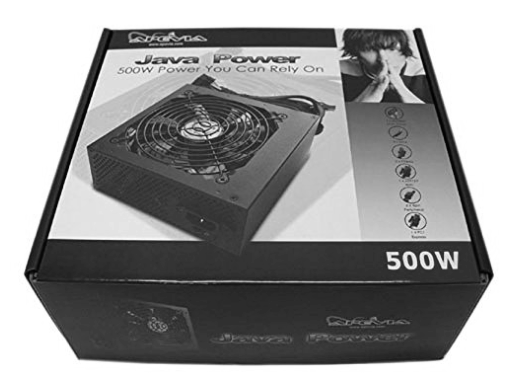

Daroe Jala Podet S0Ow pot TOC FBi On s0ow


In [31]:
import requests
from PIL import Image, ImageOps
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import easyocr

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=False)

# Sample image URL
image_url = "https://m.media-amazon.com/images/I/51QMH9FyBsL.jpg"

# Function to preprocess and display the image
def preprocess_image(image_url):
    try:
        # Send a request to get the image from the URL
        response = requests.get(image_url)
        response.raise_for_status()  # Ensure the request was successful
        
        # Open the image and convert it to grayscale
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Display the image
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')  # Turn off the axis
        plt.show()
        
        return gray_img
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return None

# Preprocess and display the image
preprocessed_image = preprocess_image(image_url)

# Perform OCR if the image was processed successfully
if preprocessed_image:
    # Convert Pillow image to numpy array
    np_image = np.array(preprocessed_image)
    
    # Perform OCR using EasyOCR
    result = reader.readtext(np_image, detail=0)  # detail=0 returns only the text
    extracted_text = " ".join(result)  # Join the OCR result into a single string
    print(extracted_text)
else:
    print("Error processing image")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 79.3 MB/s eta 0:00:00:00:01
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=768ae100fa9cd37b514db1e2338dfeaabf6fb2afb15a32bf3f8c0396404ff403
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire
download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:15<00:00, 260kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:19<00:00, 528kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:14<00:00, 148kiB/s] 

[2024/09/14 16:11:33] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

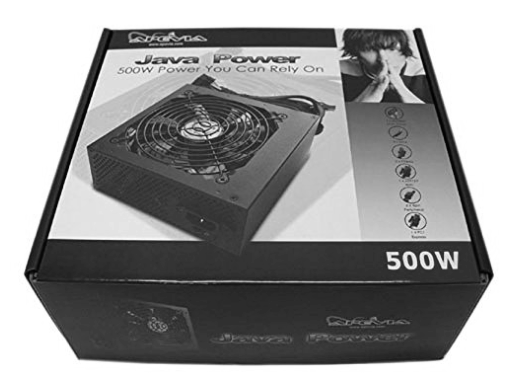

[2024/09/14 16:11:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.19189977645874023
[2024/09/14 16:11:34] ppocr DEBUG: cls num  : 5, elapsed : 0.033185482025146484
[2024/09/14 16:11:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3760712146759033
Detected Text: MOMO
Detected Text: 500W POWe
Detected Text: UeanROYOn
Detected Text: 500W


OSError: cannot open resource

In [33]:
!pip install paddlepaddle paddleocr
import requests
from PIL import Image, ImageOps
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from paddleocr import PaddleOCR, draw_ocr

# Initialize PaddleOCR model
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # Use English model

# Sample image URL
image_url = "https://m.media-amazon.com/images/I/51QMH9FyBsL.jpg"

# Function to preprocess and display the image
def preprocess_image(image_url):
    try:
        # Send a request to get the image from the URL
        response = requests.get(image_url)
        response.raise_for_status()  # Ensure the request was successful
        
        # Open the image and convert it to grayscale
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Display the image
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')  # Turn off the axis
        plt.show()
        
        return gray_img
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return None

# Preprocess and display the image
preprocessed_image = preprocess_image(image_url)

# Perform OCR if the image was processed successfully
if preprocessed_image:
    # Convert Pillow image to numpy array
    np_image = np.array(preprocessed_image)
    
    # Perform OCR using PaddleOCR
    result = ocr.ocr(np_image, cls=True)

    # Extract text and bounding boxes
    for line in result:
        for word in line:
            print(f"Detected Text: {word[1][0]}")  # Output the detected text
    
    # Optionally, visualize the results on the image
    boxes = [element[0] for element in result[0]]  # Get bounding boxes
    txts = [element[1][0] for element in result[0]]  # Get text
    scores = [element[1][1] for element in result[0]]  # Get confidence scores
    
    # Draw the results on the image
    img_with_boxes = draw_ocr(np_image, boxes, txts, scores, font_path='path_to_font.ttf')
    
    # Display the image with OCR results
    plt.imshow(img_with_boxes)
    plt.axis('off')
    plt.show()
else:
    print("Error processing image")


In [34]:
import requests
from PIL import Image, ImageOps
from io import BytesIO
import re
import matplotlib.pyplot as plt
import numpy as np
from paddleocr import PaddleOCR

# Initialize PaddleOCR model with GPU support
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True)  # Ensure GPU usage

# Sample list of 5 image URLs
image_urls = [
    "https://m.media-amazon.com/images/I/91SrZrnsN+L.jpg",
    "https://m.media-amazon.com/images/I/51QMH9FyBsL.jpg",
    "https://m.media-amazon.com/images/I/81FBErFQ51L.jpg",
    "https://m.media-amazon.com/images/I/81FKV42rmqL.jpg",
    "https://m.media-amazon.com/images/I/91I9lLWK6NL.jpg"
]

# Function to preprocess and display the image
def preprocess_image(image_url):
    try:
        # Download the image from the URL
        response = requests.get(image_url)
        response.raise_for_status()  # Ensure successful request
        
        # Open the image and convert to grayscale
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        return np_image
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return None

# Function to extract wattage values from text using regex
def extract_wattage(text):
    # Wattage regex pattern (e.g., 700W, 700 Watts, 700w, etc.)
    wattage_pattern = r"(\d+\.?\d*)\s?(watt|w|watts|W)"
    
    # Find all matches in the text
    matches = re.findall(wattage_pattern, text, re.IGNORECASE)
    
    # Return the wattage if found
    if matches:
        wattage_value, wattage_unit = matches[0]  # Assuming the first match is the correct one
        return f"{wattage_value} {wattage_unit.lower()}"
    else:
        return "Wattage not found"

# Function to process images and perform OCR to extract wattage
def process_images(image_urls):
    for image_url in image_urls:
        # Preprocess the image
        np_image = preprocess_image(image_url)
        
        if np_image is not None:
            # Perform OCR using PaddleOCR
            result = ocr.ocr(np_image, cls=True)
            
            # Concatenate all detected text into one string
            extracted_text = " ".join([word[1][0] for line in result for word in line])
            
            # Extract wattage from the detected text
            wattage = extract_wattage(extracted_text)
            
            # Print the results
            print(f"Extracted Text from {image_url}: {extracted_text}")
            print(f"Wattage: {wattage}")
            print("-" * 50)
        else:
            print(f"Skipping image {image_url} due to download issues.")

# Run the function to process the images and extract wattage
process_images(image_urls)


[2024/09/14 16:14:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [ ]:
import re

def extract_volume(text):
    # Regular expression pattern to match item volumes (e.g., "32 fl oz", "946 mL", "1.5 liters", "250 cm³")
    volume_pattern = r"(\d+\.?\d*)\s?(mL|ml|liters|L|fl oz|FL 0z|oz|cm³|in³|cubic inches|cubic cm)"
    
    # Search for all matches in the text
    matches = re.findall(volume_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted volumes
    volumes = []
    
    # Process each match to clean up the format
    for match in matches:
        volume_value, volume_unit = match
        volume_value = volume_value.strip()  # Remove extra spaces
        volume_unit = volume_unit.lower()    # Normalize units to lower case
        volumes.append(f"{volume_value} {volume_unit}")

    # Return list of extracted volumes
    return volumes

import re

text = "& AX VS 4X 'OKupoarduow 6 4 ML) [6len (946 Foncs POND Mirkqe Scrnces CLEANER AX MUCK  MORE NATURAL 'REMOVER CONCENTRATED SLUDGE / TREATS L AwakaT 32FL 0z Uerkhoia Jemu FOR SAFEF"
pattern = r'(\d+)\s*(FL 0z)'
matches = re.findall(pattern, text)

volumes = [f"{match[0]} {match[1]}" for match in matches]
print("Extracted Volumes:", volumes)


In [36]:
import pandas as pd
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
import re
from paddleocr import PaddleOCR

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # Ensure you have paddlepaddle and paddleocr installed

def extract_wattage(text):
    # Regular expression pattern for wattage
    wattage_pattern = r"(\d+\.?\d*)\s?(watt|kilowatt|w|kw|kW)"
    
    # Search for all matches in the text
    matches = re.findall(wattage_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted wattages
    wattages = []
    
    # Process each match to clean up the format
    for match in matches:
        watt_value, watt_unit = match
        watt_value = float(watt_value.strip())  # Convert to float
        watt_unit = watt_unit.lower()
        if watt_unit in ['kilowatt', 'kw', 'kW']:
            wattages.append(f"{watt_value} kilowatt")
        else:
            wattages.append(f"{watt_value} watt")

    # Return the highest wattage if multiple found, otherwise empty string if none found
    if wattages:
        return max(wattages, key=lambda x: float(x.split()[0]))
    else:
        return ""

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using PaddleOCR
        result = ocr.ocr(np_image, cls=True)
        
        # Extract text from OCR result
        extracted_text = ' '.join([line[1][0] for line in result[0]])  # Extract the text part from each line
        
        # Extract wattage from the OCR result
        wattage = extract_wattage(extracted_text)
        return wattage
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return ""

# Load your full dataset
df_wattage = pd.read_csv('/kaggle/working/wattage_data.csv', index_col=0)  # Assuming the index column is the first column

# Apply the function to the 'image_link' column
df_wattage['prediction'] = df_wattage['image_link'].apply(extract_value_unit_from_image)

# Create a new DataFrame with only the index and prediction columns
output_df = df_wattage[['prediction']].copy()
output_df.index.name = 'index'  # Ensure the index name is set

# Save the updated DataFrame with predictions to a new CSV file
output_df.to_csv('/kaggle/working/wattage_predictions_final.csv', index=True)

# Display the head of the updated DataFrame to confirm predictions
print(output_df.head())


[2024/09/14 17:08:50] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

TypeError: 'NoneType' object is not iterable

In [ ]:
import pandas as pd
import re
import requests
from PIL import Image, ImageOps
from io import BytesIO
import numpy as np
from paddleocr import PaddleOCR
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Suppress PaddleOCR debug logs
logging.getLogger('paddleocr').setLevel(logging.ERROR)

# Initialize PaddleOCR with GPU
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True)

def extract_wattage(text):
    # Regular expression for extracting wattage values
    wattage_pattern = r"(\d+\.?\d*)\s?(watt|kilowatt|wattage|W|KW)"
    matches = re.findall(wattage_pattern, text, re.IGNORECASE)
    
    # Prepare a list to store formatted wattage
    wattages = []
    for match in matches:
        value, unit = match
        value = float(value)  # Convert value to float
        if 'kilowatt' in unit.lower() or 'kw' in unit.lower():
            unit = 'kilowatt'  # Preserve the unit as kilowatt
        else:
            unit = 'watt'
        wattages.append(f"{value:.2f} {unit.lower()}")
    
    return wattages

def extract_value_unit_from_image(image_url):
    try:
        # Download and preprocess the image
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        gray_img = ImageOps.grayscale(img)
        
        # Convert Pillow image to numpy array
        np_image = np.array(gray_img)
        
        # Perform OCR using PaddleOCR
        result = ocr.ocr(np_image, cls=True)
        
        if result is None or not result[0]:
            return ''  # Return an empty string if OCR fails or no text is found
        
        # Extract text from OCR result
        extracted_text = ' '.join([line[1][0] for line in result[0] if line[1][0]])
        
        # Extract wattage from the OCR result
        wattages = extract_wattage(extracted_text)
        
        # Return the highest wattage if multiple found or an empty string if none
        if wattages:
            return max(wattages, key=lambda x: float(x.split()[0]))
        else:
            return ''
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        return ''

def process_images_in_batches(image_urls, batch_size=10):
    results = []
    with ThreadPoolExecutor(max_workers=batch_size) as executor:
        futures = {executor.submit(extract_value_unit_from_image, url): url for url in image_urls}
        for future in as_completed(futures):
            url = futures[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error processing image {url}: {e}")
                results.append('')  # Append an empty result on error
    return results

# Load your full dataset
df_wattage = pd.read_csv('/kaggle/working/wattage_data.csv', index_col=0)

# Extract image URLs
image_urls = df_wattage['image_link'].tolist()

# Process images in batches
batch_size = 10  # Adjust batch size according to your GPU capabilities
results = process_images_in_batches(image_urls, batch_size=batch_size)

# Add results to DataFrame
df_wattage['prediction'] = results

# Create a new DataFrame with only the index and prediction columns
output_df = df_wattage[['prediction']].copy()
output_df.index.name = 'index'

# Save the updated DataFrame with predictions to a new CSV file
output_df.to_csv('/kaggle/working/wattage_predictions_final.csv', index=True)

# Display the head of the updated DataFrame to confirm predictions
print(output_df.head())


[2024/09/14 17:24:22] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

corrupted double-linked list


In [ ]:
import re

def extract_total_ml(text):
    # Regular expression to find values in various formats
    pattern = r'\b\d+(\.\d+)?\s?ml\b'
    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Convert matches to float and sum them up
    total_volume = sum(float(match.replace(',', '.')) for match in matches)
    
    return f"{total_volume:.1f} ml"

# Example text
text = """FOOD GRADE VEGAN MSDS AOCOCOLORING Fu_COLORING HCOCOLORING OREEN Red SkY BLUE MWT: IOML (0.35021 | FMT: TOML (0,3502) FFTWT: IOML (0,3502) FLdD COLORING ORING XUCOLORLNG '6UCOLORING MSDS MSDS MSDS FLI DCOLORING FcJO COLORING HAvy BLUE KSUNSET VELLOH RASS CREEN PINK BROWN VETMT: TOML (0.3502] IOML (0,3502) JM: TOML (0.3507) Lik IOML (0.3502] IETWT: IOML (0,35021 DS MSDS 50s 2 1 3 3 1 Gluten Free Nut Free Sugar Free Egg Free Dairy Free Free 8 1 I 1 { 0 ( 0 { 8 Soy"""

# Extract total ml
total_ml = extract_total_ml(text)
print(total_ml)


In [ ]:
import pandas as pd

# Load the 'depth_data.csv' file
item_volume_df = pd.read_csv('item_volume_data.csv')

# Display the top 5 rows of the 'depth_data.csv'
print(item_volume_df.head(100))


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/kaggle/input/real-test-data/dataset/test.csv')

# Create a new DataFrame with only the 'index' column
df_new = df[['index']].copy()

# Add a new column 'prediction' with blank values
df_new['prediction'] = " "  # Ensure all values are blank

# Optionally, save the new DataFrame to a new CSV file
df_new.to_csv('submission.csv', index=False)


In [ ]:
df_new.tail()

In [ ]:
ss=pd.read_csv("/kaggle/input/real-test-data/dataset/test.csv")
ss.tail()